In [1]:
import findspark
findspark.init()

# create spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("my app").master("local").getOrCreate()

# get context from the session
sc = spark.sparkContext

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time
import math

# Misc

In [3]:
def compute_similarity(s1, s2):
    """
    주어진 2개 집합의 Jaccard similarity 계산
    """
    
    return float(len(s1 & s2)) / float(len(s1 | s2))

In [4]:
def distinct_pairs(l):
    l.sort()
    for i,e1 in enumerate(l):
        for j,e2 in enumerate(l):
            if i<j:
                if e1 < e2:
                    yield ((e1, e2), 1)
                else:
                    yield ((e2, e1), 1)

In [5]:
def tokenize(t, tres, setSize):
    size = setSize.value[t[0]]
    prefixsize = int(size - math.ceil(size * thres) + 1)
    return [ (e, t[0]) for e in t[1][:prefixsize] ]

# Test with toy dataset

In [6]:
test_dataset = [(0, [34, 15, 13, 11, 9, 4, 2, 1]), (1, [45, 8, 4, 3, 2, 1]), (2, [38, 11, 7, 6, 4, 1]), (3, [46, 30, 20, 21, 19, 16, 9, 2, 1]), (4, [34, 15, 12, 5, 4, 3, 1]), (5, [17, 14, 6, 5, 2, 1]), (6, [24, 21, 16, 9, 8, 4, 2]), (7, [29, 28, 18, 15, 4, 2, 1]), (8, [13, 8, 7, 3, 2, 1]), (9, [18, 16, 10, 7, 5, 3, 1]), (10, [24, 19, 18, 15, 3, 1]), (11, [11, 6, 5, 4, 3, 2, 1]), (12, [39, 29, 24, 26, 16, 12, 10, 8, 3, 1]), (13, [46, 35, 15, 12, 9, 3, 2]), (14, [34, 10, 8, 5, 2, 1]), (15, [13, 6, 4, 3, 2, 1]), (16, [47, 45, 22, 25, 19, 4, 3, 2, 1]), (17, [29, 27, 13, 9, 4, 2]), (18, [27, 14, 8, 7, 5, 4, 3, 1]), (19, [36, 29, 19, 7, 5, 1]), (20, [38, 11, 8, 6, 3, 1]), (21, [43, 36, 33, 5, 4, 2, 1]), (22, [23, 27, 22, 20, 11, 5, 4, 3, 2, 1]), (23, [35, 11, 5, 4, 2, 1]), (24, [32, 12, 10, 5, 4, 1]), (25, [34, 26, 16, 7, 4, 3, 1]), (26, [32, 35, 22, 14, 7, 5, 2, 1]), (27, [28, 17, 9, 7, 5, 4, 3, 2, 1]), (28, [31, 29, 24, 21, 6, 2]), (29, [44, 21, 16, 8, 4, 3, 2, 1]), (30, [31, 32, 27, 16, 7, 4, 1]), (31, [20, 14, 10, 5, 3, 2, 1]), (32, [36, 23, 18, 12, 9, 8, 4, 1]), (33, [24, 19, 18, 12, 7, 3, 2, 1]), (34, [46, 35, 20, 12, 5, 1]), (35, [31, 25, 5, 4, 2, 1]), (36, [47, 26, 18, 10, 6, 3, 1]), (37, [37, 29, 35, 24, 13, 12, 9, 2, 1]), (38, [38, 18, 11, 10, 7, 4, 1]), (39, [20, 13, 12, 5, 2, 1]), (40, [14, 11, 10, 6, 3, 2, 1]), (41, [31, 10, 8, 3, 2, 1]), (42, [41, 39, 24, 10, 5, 2, 1]), (43, [43, 22, 11, 4, 3, 2, 1]), (44, [38, 28, 27, 8, 7, 4, 3, 1]), (45, [31, 23, 24, 19, 9, 5, 3, 1]), (46, [33, 30, 21, 12, 10, 8, 3, 1]), (47, [39, 21, 13, 12, 10, 8, 7, 5, 2, 1]), (48, [46, 41, 39, 26, 17, 18, 9, 10, 7, 6, 5, 4, 3, 2, 1]), (49, [27, 22, 18, 10, 7, 6, 5, 4, 3, 1]), (50, [38, 11, 5, 3, 2, 1]), (51, [27, 18, 12, 11, 8, 5, 3, 2, 1]), (52, [29, 12, 10, 7, 4, 2]), (53, [23, 28, 18, 13, 6, 4, 2, 1]), (54, [43, 31, 10, 6, 2, 1]), (55, [28, 21, 10, 5, 2, 1]), (56, [15, 12, 9, 7, 5, 4, 2, 1]), (57, [14, 13, 7, 6, 4, 2, 1]), (58, [23, 21, 14, 12, 8, 7, 5, 2, 1]), (59, [48, 9, 7, 6, 5, 2, 1]), (60, [34, 28, 6, 5, 4, 3, 1]), (61, [42, 35, 13, 8, 2, 1]), (62, [30, 8, 6, 5, 4, 3, 2, 1]), (63, [45, 25, 16, 11, 8, 5, 3]), (64, [39, 21, 8, 7, 5, 3, 2, 1]), (65, [44, 17, 21, 10, 5, 1]), (66, [28, 16, 15, 11, 7, 3, 1]), (67, [42, 19, 15, 6, 5, 4, 2, 1]), (68, [21, 7, 5, 3, 2, 1]), (69, [20, 11, 9, 6, 4, 1]), (70, [39, 35, 13, 9, 10, 8, 7, 5, 3, 1]), (71, [46, 30, 15, 13, 2, 1]), (72, [42, 17, 19, 18, 16, 5, 1]), (73, [38, 28, 22, 26, 8, 2, 1]), (74, [24, 30, 6, 5, 4, 1]), (75, [33, 18, 8, 6, 3, 1]), (76, [36, 14, 10, 8, 6, 4, 3, 1]), (77, [34, 10, 8, 4, 3, 2, 1]), (78, [25, 21, 12, 6, 3, 2, 1]), (79, [46, 29, 8, 7, 6, 2, 1]), (80, [43, 13, 6, 5, 2, 1]), (81, [12, 9, 10, 5, 3, 2, 1]), (82, [34, 22, 14, 9, 10, 2, 1]), (83, [36, 18, 9, 7, 3, 1]), (84, [37, 19, 18, 11, 6, 5, 3, 2, 1]), (85, [35, 21, 16, 6, 2, 1]), (86, [13, 9, 6, 3, 2, 1]), (87, [39, 15, 11, 5, 2, 1]), (88, [33, 11, 8, 7, 4, 3, 1]), (89, [36, 21, 18, 10, 8, 6, 2, 1]), (90, [20, 17, 9, 8, 7, 6, 1]), (91, [18, 7, 6, 4, 2, 1]), (92, [32, 21, 7, 6, 5, 4, 3, 2, 1]), (93, [32, 10, 5, 3, 2, 1]), (94, [25, 15, 12, 8, 6, 4]), (95, [40, 29, 35, 21, 13, 12, 1]), (96, [26, 19, 15, 8, 4, 3, 2, 1]), (97, [46, 41, 42, 5, 4, 3, 2, 1]), (98, [30, 11, 9, 7, 4, 3, 1]), (99, [29, 20, 12, 5, 4, 3, 2]), (100, [49, 20, 7, 5, 4, 2, 1]), (101, [37, 39, 14, 6, 5, 3, 2, 1]), (102, [31, 35, 23, 13, 9, 7]), (103, [32, 24, 19, 12, 8, 7, 1]), (104, [14, 11, 8, 4, 2, 1]), (105, [28, 11, 5, 3, 2, 1]), (106, [37, 35, 7, 5, 2, 1]), (107, [21, 9, 7, 4, 2, 1]), (108, [47, 14, 10, 7, 5, 4, 1]), (109, [38, 31, 29, 16, 6, 2, 1]), (110, [44, 20, 7, 6, 5, 3, 1]), (111, [10, 8, 7, 4, 3, 2, 1]), (112, [31, 10, 5, 4, 2, 1]), (113, [32, 20, 11, 10, 2, 1]), (114, [20, 16, 13, 5, 4, 3, 1]), (115, [34, 30, 22, 14, 9, 7, 6, 1]), (116, [15, 13, 5, 4, 3, 2]), (117, [45, 27, 4, 3, 2, 1]), (118, [22, 11, 8, 7, 6, 2, 1]), (119, [44, 19, 10, 6, 4, 3, 1]), (120, [20, 8, 4, 3, 2, 1]), (121, [39, 11, 6, 3, 2, 1]), (122, [34, 14, 9, 4, 2, 1]), (123, [27, 21, 18, 9, 4, 2, 1]), (124, [21, 15, 13, 10, 8, 2, 1]), (125, [26, 9, 4, 3, 2, 1]), (126, [37, 22, 12, 11, 9, 8, 4, 3, 1]), (127, [48, 39, 22, 14, 11, 10, 1]), (128, [41, 30, 22, 5, 3, 1]), (129, [32, 15, 6, 4, 3, 2, 1]), (130, [15, 6, 4, 3, 2, 1]), (131, [14, 7, 6, 3, 2, 1]), (132, [38, 20, 13, 9, 5, 4, 3, 2, 1]), (133, [47, 44, 12, 7, 5, 1]), (134, [25, 14, 10, 6, 5, 4, 2, 1]), (135, [40, 10, 7, 6, 2, 1]), (136, [28, 27, 11, 4, 3, 1]), (137, [40, 30, 12, 10, 7, 3, 2, 1]), (138, [20, 14, 12, 9, 7, 2, 1]), (139, [21, 14, 11, 8, 6, 5, 4, 3, 2, 1]), (140, [22, 20, 21, 16, 13, 9, 10, 7, 4, 1]), (141, [31, 28, 19, 7, 3, 1]), (142, [46, 41, 32, 12, 9, 4, 3, 2, 1]), (143, [30, 15, 6, 4, 3, 1]), (144, [32, 23, 6, 3, 2, 1]), (145, [11, 7, 6, 5, 4, 1]), (146, [14, 11, 9, 7, 4, 3, 1]), (147, [49, 8, 4, 3, 2, 1]), (148, [13, 8, 7, 4, 3, 2, 1]), (149, [28, 21, 15, 4, 3, 1]), (150, [48, 19, 15, 10, 4, 3, 2, 1]), (151, [23, 26, 12, 11, 3, 2, 1]), (152, [48, 21, 12, 4, 2, 1]), (153, [46, 16, 8, 3, 2, 1]), (154, [42, 37, 32, 16, 10, 6, 4, 3, 2]), (155, [21, 10, 8, 3, 2, 1]), (156, [41, 27, 14, 9, 3, 2]), (157, [45, 39, 25, 15, 11, 7, 4, 2, 1]), (158, [29, 13, 12, 6, 4, 2]), (159, [30, 20, 6, 5, 2, 1]), (160, [46, 26, 13, 8, 5, 4, 1]), (161, [37, 26, 14, 8, 2, 1]), (162, [45, 24, 8, 5, 3, 1]), (163, [45, 18, 13, 8, 5, 2, 1]), (164, [13, 10, 7, 5, 4, 3]), (165, [38, 16, 8, 6, 4, 1]), (166, [42, 10, 8, 3, 2, 1]), (167, [24, 18, 10, 8, 5, 2, 1]), (168, [46, 8, 7, 3, 2, 1]), (169, [48, 41, 28, 8, 5, 4, 1]), (170, [17, 11, 6, 5, 3, 2, 1]), (171, [14, 12, 9, 4, 3, 1]), (172, [28, 25, 20, 7, 4, 2, 1]), (173, [30, 26, 15, 5, 2, 1]), (174, [12, 11, 10, 3, 2, 1]), (175, [36, 12, 6, 5, 3, 1]), (176, [18, 15, 11, 9, 5, 1]), (177, [41, 23, 24, 18, 5, 1]), (178, [23, 9, 4, 3, 2, 1]), (179, [8, 7, 6, 5, 3, 2, 1]), (180, [41, 14, 13, 10, 6, 2, 1]), (181, [19, 12, 9, 8, 7, 2]), (182, [32, 17, 14, 9, 8, 1]), (183, [21, 9, 8, 5, 4, 2, 1]), (184, [29, 33, 28, 10, 8, 6, 1]), (185, [29, 21, 13, 4, 3, 2, 1]), (186, [17, 9, 10, 6, 2, 1]), (187, [34, 18, 9, 10, 4, 2, 1]), (188, [24, 22, 21, 18, 11, 8, 7, 3, 1]), (189, [32, 14, 9, 8, 5, 2]), (190, [33, 24, 13, 9, 2, 1]), (191, [23, 17, 18, 4, 2, 1]), (192, [44, 20, 5, 4, 3, 2]), (193, [31, 27, 13, 6, 4, 3, 2, 1]), (194, [41, 20, 15, 9, 5, 4, 1]), (195, [29, 33, 26, 13, 10, 4, 1]), (196, [24, 21, 13, 9, 8, 7, 6, 4, 3, 1]), (197, [25, 11, 7, 5, 4, 2, 1]), (198, [22, 25, 11, 9, 10, 7, 3, 2, 1]), (199, [41, 29, 9, 6, 4, 3, 1]), (200, [42, 27, 16, 14, 10, 5, 3, 2, 1]), (201, [38, 34, 15, 10, 7, 6, 4, 1]), (202, [40, 42, 15, 6, 3, 2, 1]), (203, [23, 28, 22, 13, 7, 5, 4, 3, 2, 1]), (204, [17, 14, 9, 10, 8, 7, 3, 1]), (205, [35, 25, 17, 18, 5, 1]), (206, [49, 46, 35, 23, 30, 26, 16, 1]), (207, [16, 12, 9, 7, 4, 3, 1]), (208, [25, 5, 4, 3, 2, 1]), (209, [29, 9, 8, 4, 2, 1]), (210, [43, 8, 4, 3, 2, 1]), (211, [25, 13, 4, 3, 2, 1]), (212, [9, 7, 4, 3, 2, 1]), (213, [43, 14, 6, 4, 2, 1]), (214, [23, 8, 7, 4, 2, 1]), (215, [33, 19, 13, 6, 3, 2, 1]), (216, [27, 18, 7, 6, 5, 4, 3, 2, 1]), (217, [37, 31, 19, 10, 4, 3, 1]), (218, [49, 17, 19, 7, 2, 1]), (219, [34, 9, 6, 3, 2, 1]), (220, [32, 20, 13, 12, 5, 4, 3, 2, 1]), (221, [36, 20, 11, 9, 5, 2]), (222, [30, 22, 16, 15, 8, 6, 4, 2, 1]), (223, [41, 19, 14, 13, 11, 9, 6, 4, 2]), (224, [33, 25, 12, 10, 8, 6, 3]), (225, [27, 26, 18, 15, 6, 2]), (226, [25, 13, 11, 5, 2, 1]), (227, [36, 26, 17, 6, 2, 1]), (228, [45, 44, 26, 16, 5, 3]), (229, [26, 17, 14, 11, 4, 2, 1]), (230, [43, 19, 8, 6, 4, 2, 1]), (231, [13, 9, 7, 6, 2, 1]), (232, [22, 11, 7, 5, 3, 2, 1]), (233, [21, 15, 4, 3, 2, 1]), (234, [18, 16, 10, 4, 3, 1]), (235, [39, 10, 8, 5, 4, 3, 2, 1]), (236, [24, 19, 12, 7, 5, 2, 1]), (237, [38, 35, 24, 17, 13, 4, 2, 1]), (238, [49, 33, 19, 16, 9, 10, 8, 6, 5, 2, 1]), (239, [19, 15, 9, 3, 2, 1]), (240, [46, 13, 11, 6, 3, 2, 1]), (241, [21, 19, 4, 3, 2, 1]), (242, [44, 26, 17, 14, 5, 3, 2, 1]), (243, [18, 16, 12, 9, 10, 3, 2]), (244, [45, 26, 20, 18, 8, 7, 6, 5, 4, 2, 1]), (245, [36, 21, 13, 6, 3, 1]), (246, [33, 21, 12, 6, 5, 2]), (247, [30, 15, 7, 6, 2, 1]), (248, [44, 15, 9, 6, 3, 2, 1]), (249, [12, 7, 5, 4, 3, 1]), (250, [37, 16, 15, 5, 4, 3, 2, 1]), (251, [48, 45, 12, 8, 5, 4, 3, 1]), (252, [45, 29, 22, 16, 12, 5, 3, 1]), (253, [21, 8, 5, 4, 2, 1]), (254, [44, 30, 21, 15, 6, 2, 1]), (255, [38, 31, 34, 13, 11, 7, 4, 3, 2]), (256, [42, 14, 13, 10, 3, 1]), (257, [20, 17, 16, 10, 7, 1]), (258, [28, 24, 22, 11, 9, 4, 2, 1]), (259, [43, 44, 14, 5, 3, 2, 1]), (260, [28, 22, 21, 15, 9, 5, 3, 1]), (261, [23, 19, 16, 14, 9, 8, 7, 5, 1]), (262, [14, 11, 10, 3, 2, 1]), (263, [11, 9, 4, 3, 2, 1]), (264, [14, 9, 8, 6, 5, 3, 1]), (265, [39, 24, 17, 21, 12, 11, 4, 3, 2, 1]), (266, [25, 10, 8, 4, 3, 2, 1]), (267, [34, 11, 10, 8, 7, 3, 2, 1]), (268, [21, 14, 12, 4, 3, 2, 1]), (269, [24, 16, 13, 11, 9, 8, 7, 5, 3, 2, 1]), (270, [41, 18, 16, 4, 3, 1]), (271, [30, 16, 14, 4, 3, 2, 1]), (272, [48, 42, 8, 7, 4, 3, 2, 1]), (273, [24, 16, 9, 4, 2, 1]), (274, [17, 15, 12, 11, 8, 7, 6, 3, 2]), (275, [28, 27, 20, 18, 8, 6, 2, 1]), (276, [41, 13, 12, 8, 3, 2, 1]), (277, [44, 8, 5, 3, 2, 1]), (278, [43, 39, 25, 12, 2, 1]), (279, [45, 35, 14, 12, 2, 1]), (280, [39, 21, 13, 5, 3, 2, 1]), (281, [29, 28, 20, 15, 7, 6, 5, 4, 2, 1]), (282, [47, 34, 27, 30, 25, 14, 7, 5, 4, 3, 2, 1]), (283, [11, 7, 4, 3, 2, 1]), (284, [16, 13, 11, 9, 8, 7, 1]), (285, [22, 12, 5, 4, 3, 2]), (286, [23, 20, 14, 6, 5, 1]), (287, [33, 20, 6, 5, 4, 1]), (288, [33, 9, 6, 3, 2, 1]), (289, [28, 24, 17, 11, 7, 2, 1]), (290, [21, 16, 10, 5, 4, 2]), (291, [42, 17, 10, 4, 2, 1]), (292, [9, 8, 6, 3, 2, 1]), (293, [34, 32, 6, 3, 2, 1]), (294, [31, 29, 17, 18, 3, 2, 1]), (295, [48, 29, 8, 4, 2, 1]), (296, [37, 31, 13, 10, 4, 2, 1]), (297, [40, 11, 7, 5, 2, 1]), (298, [26, 9, 8, 3, 2, 1]), (299, [24, 15, 8, 4, 2, 1]), (300, [47, 23, 30, 22, 11, 10, 7, 3, 2]), (301, [48, 28, 30, 20, 14, 3, 2, 1]), (302, [25, 14, 11, 5, 2, 1]), (303, [38, 39, 34, 19, 6, 3, 2, 1]), (304, [43, 26, 10, 6, 2, 1]), (305, [46, 15, 10, 5, 2, 1]), (306, [26, 15, 13, 10, 7, 5, 3, 2, 1]), (307, [29, 16, 12, 5, 4, 1]), (308, [37, 20, 12, 4, 3, 1]), (309, [37, 27, 24, 18, 5, 4, 1]), (310, [42, 34, 14, 6, 2, 1]), (311, [47, 14, 10, 8, 4, 3, 2]), (312, [32, 27, 22, 16, 14, 3, 1]), (313, [45, 29, 7, 6, 4, 1]), (314, [42, 39, 19, 4, 2, 1]), (315, [43, 33, 35, 28, 16, 10, 5, 1]), (316, [14, 12, 8, 7, 3, 2, 1]), (317, [13, 11, 10, 8, 2, 1]), (318, [21, 11, 5, 4, 2, 1]), (319, [17, 15, 8, 5, 4, 1]), (320, [37, 25, 18, 5, 3, 2, 1]), (321, [41, 31, 36, 27, 26, 14, 13, 12, 10, 6, 4, 3, 2, 1]), (322, [24, 26, 14, 15, 8, 5, 1]), (323, [38, 28, 19, 15, 11, 10, 4, 2]), (324, [44, 24, 14, 6, 4, 3, 2, 1]), (325, [30, 26, 19, 9, 10, 3, 2, 1]), (326, [36, 16, 14, 13, 8, 5, 3, 2, 1]), (327, [18, 14, 10, 3, 2, 1]), (328, [21, 12, 8, 5, 3, 2, 1]), (329, [36, 28, 15, 9, 6, 4, 1]), (330, [12, 9, 5, 4, 3, 2, 1]), (331, [32, 28, 8, 7, 3, 2, 1]), (332, [31, 33, 27, 11, 8, 3, 2, 1]), (333, [48, 25, 20, 15, 12, 7, 4, 1]), (334, [40, 32, 13, 9, 10, 7, 3, 2, 1]), (335, [29, 22, 21, 19, 15, 7, 2, 1]), (336, [48, 29, 27, 15, 11, 4, 2, 1]), (337, [43, 45, 42, 27, 15, 9, 6, 5, 1]), (338, [23, 28, 26, 21, 16, 10, 8, 4, 3, 2, 1]), (339, [45, 11, 9, 10, 2, 1]), (340, [48, 34, 17, 19, 9, 8, 7, 6, 4, 3, 2, 1]), (341, [46, 45, 39, 25, 9, 6, 4, 2, 1]), (342, [43, 28, 9, 10, 7, 5, 3]), (343, [41, 10, 8, 3, 2, 1]), (344, [35, 15, 13, 9, 10, 5, 2, 1]), (345, [44, 39, 23, 28, 5, 4, 2, 1]), (346, [25, 13, 4, 3, 2, 1]), (347, [15, 9, 8, 6, 3, 2, 1]), (348, [44, 22, 10, 7, 6, 3, 1]), (349, [22, 17, 11, 7, 3, 1]), (350, [43, 27, 18, 12, 11, 3, 2]), (351, [35, 26, 15, 12, 7, 4, 2, 1]), (352, [29, 30, 19, 15, 11, 5, 1]), (353, [42, 33, 35, 3, 2, 1]), (354, [33, 11, 4, 3, 2, 1]), (355, [23, 28, 16, 11, 8, 4, 3]), (356, [13, 12, 7, 6, 3, 1]), (357, [15, 13, 8, 6, 3, 2, 1]), (358, [40, 28, 15, 6, 2, 1]), (359, [15, 9, 6, 4, 3, 1]), (360, [35, 25, 17, 4, 3, 2, 1]), (361, [44, 36, 25, 12, 6, 5, 2, 1]), (362, [31, 21, 15, 8, 5, 3, 2]), (363, [21, 9, 10, 3, 2, 1]), (364, [31, 36, 23, 20, 21, 11, 7, 5, 4, 3, 2, 1]), (365, [44, 38, 29, 14, 8, 7, 5, 1]), (366, [13, 11, 8, 7, 2, 1]), (367, [16, 13, 7, 3, 2, 1]), (368, [27, 24, 10, 5, 3, 2, 1]), (369, [28, 16, 10, 8, 5, 3, 2, 1]), (370, [10, 8, 5, 4, 3, 1]), (371, [41, 28, 20, 9, 6, 5, 1]), (372, [32, 28, 18, 11, 9, 7, 6, 3, 2, 1]), (373, [22, 26, 11, 9, 7, 4, 3, 2, 1]), (374, [28, 6, 4, 3, 2, 1]), (375, [49, 45, 32, 14, 13, 8, 7, 3, 2, 1]), (376, [48, 15, 10, 7, 4, 3]), (377, [42, 31, 32, 28, 5, 4]), (378, [45, 26, 12, 11, 8, 2, 1]), (379, [38, 39, 36, 25, 3, 1]), (380, [46, 11, 10, 7, 2, 1]), (381, [34, 35, 10, 4, 3, 1]), (382, [29, 5, 4, 3, 2, 1]), (383, [24, 20, 4, 3, 2, 1]), (384, [44, 36, 19, 7, 6, 5, 4, 2, 1]), (385, [48, 22, 26, 4, 3, 1]), (386, [45, 7, 6, 3, 2, 1]), (387, [45, 32, 15, 6, 4, 3, 1]), (388, [39, 16, 11, 3, 2, 1]), (389, [40, 29, 18, 9, 10, 3, 2, 1]), (390, [27, 22, 25, 10, 6, 5, 4, 1]), (391, [40, 29, 24, 14, 2, 1]), (392, [49, 6, 4, 3, 2, 1]), (393, [42, 20, 18, 14, 10, 1]), (394, [37, 19, 13, 7, 5, 3, 2, 1]), (395, [39, 9, 7, 5, 4, 2, 1]), (396, [14, 12, 5, 3, 2, 1]), (397, [19, 14, 15, 7, 5, 4, 2, 1]), (398, [39, 9, 5, 4, 3, 1]), (399, [41, 30, 5, 4, 2, 1]), (400, [33, 27, 18, 9, 8, 7, 6, 5, 1]), (401, [41, 12, 10, 5, 2, 1]), (402, [44, 25, 11, 6, 4, 3]), (403, [19, 15, 9, 8, 7, 5, 2, 1]), (404, [40, 19, 13, 6, 4, 3, 1]), (405, [26, 18, 11, 10, 8, 2, 1]), (406, [42, 35, 6, 5, 3, 1]), (407, [38, 16, 11, 6, 4, 3, 2]), (408, [34, 16, 14, 10, 8, 7, 2, 1]), (409, [25, 12, 11, 10, 8, 7, 5, 3, 2, 1]), (410, [31, 32, 27, 8, 7, 4, 3, 2, 1]), (411, [25, 9, 10, 4, 3, 2, 1]), (412, [17, 12, 10, 6, 5, 1]), (413, [47, 44, 36, 10, 6, 2, 1]), (414, [32, 7, 6, 5, 2, 1]), (415, [30, 17, 8, 6, 3, 2, 1]), (416, [37, 16, 6, 5, 3, 1]), (417, [34, 29, 21, 11, 3, 2]), (418, [42, 27, 17, 18, 14, 9, 7, 5, 4, 3, 2, 1]), (419, [40, 18, 13, 4, 3, 1]), (420, [34, 36, 30, 19, 12, 9, 4, 2, 1]), (421, [24, 12, 8, 4, 3, 2, 1]), (422, [48, 26, 16, 14, 5, 4, 1]), (423, [33, 23, 27, 12, 3, 1]), (424, [37, 21, 18, 4, 2, 1]), (425, [41, 36, 19, 15, 13, 3, 2, 1]), (426, [29, 19, 8, 7, 3, 2]), (427, [45, 12, 9, 6, 4, 3]), (428, [49, 14, 12, 9, 7, 2]), (429, [36, 23, 12, 9, 8, 7, 2, 1]), (430, [38, 20, 15, 9, 5, 4, 2, 1]), (431, [13, 12, 10, 3, 2, 1]), (432, [15, 9, 7, 3, 2, 1]), (433, [35, 26, 20, 6, 5, 1]), (434, [22, 9, 8, 7, 6, 2, 1]), (435, [36, 11, 10, 4, 2, 1]), (436, [25, 17, 16, 12, 9, 10, 8, 4, 3, 2, 1]), (437, [45, 41, 30, 21, 6, 5, 4, 3, 2, 1]), (438, [27, 20, 5, 3, 2, 1]), (439, [13, 8, 4, 3, 2, 1]), (440, [11, 9, 6, 4, 3, 2, 1]), (441, [33, 12, 7, 5, 2, 1]), (442, [49, 32, 30, 26, 15, 1]), (443, [34, 32, 18, 12, 7, 4, 3, 1]), (444, [35, 16, 10, 4, 2, 1]), (445, [14, 11, 7, 4, 2, 1]), (446, [41, 17, 16, 8, 4, 3, 1]), (447, [38, 39, 33, 18, 15, 11, 5, 2, 1]), (448, [34, 15, 11, 7, 5, 2, 1]), (449, [29, 9, 6, 5, 2, 1]), (450, [37, 24, 14, 10, 5, 4, 3, 2, 1]), (451, [16, 14, 13, 5, 3, 2]), (452, [29, 23, 5, 3, 2, 1]), (453, [31, 25, 14, 15, 9, 8, 2, 1]), (454, [44, 36, 15, 10, 5, 4, 1]), (455, [36, 20, 15, 11, 6, 3, 1]), (456, [44, 15, 9, 5, 3, 1]), (457, [22, 13, 10, 6, 4, 2, 1]), (458, [32, 35, 11, 6, 2, 1]), (459, [24, 17, 7, 5, 3, 2, 1]), (460, [21, 14, 15, 12, 9, 10, 5, 2, 1]), (461, [40, 42, 38, 36, 30, 12, 3, 2, 1]), (462, [24, 17, 15, 8, 3, 2, 1]), (463, [31, 34, 30, 26, 20, 21, 5, 3, 1]), (464, [15, 13, 11, 5, 2, 1]), (465, [48, 30, 26, 12, 4, 3, 1]), (466, [35, 26, 14, 4, 3, 2, 1]), (467, [36, 17, 7, 5, 4, 3, 2]), (468, [49, 19, 16, 8, 3, 2, 1]), (469, [21, 12, 4, 3, 2, 1]), (470, [16, 15, 6, 4, 2, 1]), (471, [33, 15, 12, 8, 7, 4, 2, 1]), (472, [42, 35, 26, 14, 11, 7, 4, 2, 1]), (473, [27, 24, 18, 16, 6, 2, 1]), (474, [37, 24, 8, 5, 4, 2, 1]), (475, [41, 21, 10, 7, 6, 3, 1]), (476, [44, 31, 19, 16, 13, 11, 10, 6, 2, 1]), (477, [23, 24, 26, 11, 10, 3, 1]), (478, [46, 11, 9, 10, 2, 1]), (479, [10, 8, 5, 4, 3, 2, 1]), (480, [39, 23, 14, 5, 3, 1]), (481, [44, 30, 16, 11, 8, 7, 6, 1]), (482, [43, 18, 8, 7, 2, 1]), (483, [26, 13, 6, 4, 3, 1]), (484, [38, 28, 8, 6, 2, 1]), (485, [48, 27, 26, 8, 6, 3, 1]), (486, [25, 17, 15, 12, 6, 4, 2, 1]), (487, [31, 15, 12, 9, 4, 1]), (488, [38, 22, 25, 12, 6, 2, 1]), (489, [23, 24, 18, 8, 5, 3, 2, 1]), (490, [20, 9, 8, 6, 5, 1]), (491, [26, 9, 8, 7, 3, 2, 1]), (492, [48, 22, 9, 7, 5, 4, 2, 1]), (493, [12, 8, 5, 3, 2, 1]), (494, [49, 26, 9, 6, 2, 1]), (495, [11, 9, 7, 6, 5, 3, 1]), (496, [47, 29, 17, 21, 19, 3]), (497, [46, 11, 7, 4, 2, 1]), (498, [45, 38, 33, 8, 6, 5, 3, 1]), (499, [29, 22, 8, 6, 3, 2, 1]), (500, [26, 25, 17, 19, 9, 10, 4, 2, 1]), (501, [33, 18, 12, 8, 7, 3, 1]), (502, [16, 10, 8, 6, 5, 1]), (503, [31, 19, 10, 7, 3, 2]), (504, [34, 16, 15, 8, 4, 1]), (505, [42, 14, 13, 8, 7, 3, 1]), (506, [27, 25, 21, 3, 2, 1]), (507, [42, 36, 22, 16, 13, 8, 6, 5, 1]), (508, [14, 9, 10, 5, 4, 3, 2, 1]), (509, [48, 32, 19, 7, 5, 2, 1]), (510, [39, 34, 30, 18, 16, 10, 7, 2, 1]), (511, [48, 25, 19, 12, 11, 7, 5, 1]), (512, [24, 19, 18, 10, 5, 2, 1]), (513, [36, 21, 9, 5, 4, 3, 2]), (514, [47, 27, 13, 7, 3, 2, 1]), (515, [41, 33, 19, 16, 9, 10, 6, 4, 2, 1]), (516, [43, 40, 32, 24, 10, 5, 4, 2, 1]), (517, [21, 13, 10, 7, 4, 1]), (518, [22, 17, 19, 16, 11, 8, 3, 2, 1]), (519, [16, 12, 8, 7, 4, 3, 2, 1]), (520, [24, 18, 15, 9, 2, 1]), (521, [10, 6, 4, 3, 2, 1]), (522, [43, 33, 15, 9, 7, 3, 1]), (523, [16, 14, 15, 4, 2, 1]), (524, [36, 12, 9, 8, 6, 1]), (525, [43, 36, 27, 13, 9, 4, 1]), (526, [8, 6, 4, 3, 2, 1]), (527, [22, 5, 4, 3, 2, 1]), (528, [31, 35, 14, 10, 7, 4, 1]), (529, [47, 33, 21, 15, 12, 11, 1]), (530, [41, 18, 15, 6, 3, 1]), (531, [20, 17, 14, 10, 5, 3, 1]), (532, [46, 28, 20, 17, 10, 1]), (533, [12, 9, 10, 6, 2, 1]), (534, [44, 35, 22, 14, 13, 6, 4, 2, 1]), (535, [26, 20, 15, 5, 4, 2, 1]), (536, [47, 17, 12, 10, 3, 2, 1]), (537, [29, 16, 12, 5, 2, 1]), (538, [34, 8, 7, 5, 3, 2, 1]), (539, [46, 32, 12, 9, 6, 2, 1]), (540, [32, 24, 30, 11, 2, 1]), (541, [40, 22, 25, 20, 13, 7, 6, 3, 2, 1]), (542, [33, 30, 26, 17, 2, 1]), (543, [32, 18, 7, 5, 2, 1]), (544, [21, 18, 8, 5, 4, 1]), (545, [47, 36, 15, 11, 4, 3, 1]), (546, [19, 16, 11, 5, 4, 2, 1]), (547, [33, 30, 8, 6, 5, 4, 3, 2, 1]), (548, [37, 36, 30, 17, 18, 15, 11, 7, 3, 2]), (549, [37, 31, 15, 7, 4, 3, 1]), (550, [31, 16, 8, 5, 4, 2, 1]), (551, [49, 33, 20, 13, 10, 5, 2, 1]), (552, [25, 13, 7, 5, 3, 2, 1]), (553, [40, 31, 20, 3, 2, 1]), (554, [49, 8, 5, 4, 3, 1]), (555, [39, 23, 24, 5, 3, 1]), (556, [49, 11, 8, 6, 2, 1]), (557, [48, 25, 15, 12, 10, 2, 1]), (558, [14, 13, 11, 5, 4, 3, 2]), (559, [38, 27, 12, 11, 9, 5, 2]), (560, [14, 13, 12, 8, 7, 2, 1]), (561, [24, 16, 14, 9, 2, 1]), (562, [31, 7, 6, 5, 4, 3, 1]), (563, [23, 20, 21, 4, 3, 2, 1]), (564, [37, 18, 15, 5, 4, 3, 2, 1]), (565, [23, 24, 26, 6, 4, 1]), (566, [16, 7, 4, 3, 2, 1]), (567, [26, 19, 13, 6, 4, 3, 1]), (568, [22, 12, 8, 7, 6, 3, 2, 1]), (569, [19, 15, 13, 9, 8, 7, 4, 3, 2, 1]), (570, [45, 30, 25, 15, 10, 5, 2, 1]), (571, [44, 27, 9, 7, 5, 2]), (572, [19, 14, 12, 8, 3, 1]), (573, [25, 19, 18, 16, 11, 6, 3, 2, 1]), (574, [35, 25, 11, 9, 8, 5, 2, 1]), (575, [24, 25, 9, 10, 6, 4, 2, 1]), (576, [46, 29, 30, 3, 2, 1]), (577, [40, 28, 21, 14, 13, 8, 6, 1]), (578, [34, 22, 14, 3, 2, 1]), (579, [35, 10, 8, 5, 4, 1]), (580, [30, 22, 17, 11, 4, 3, 2]), (581, [38, 35, 26, 6, 5, 3, 1]), (582, [33, 21, 13, 7, 5, 3, 1]), (583, [42, 28, 27, 12, 10, 8, 3]), (584, [20, 11, 5, 4, 2, 1]), (585, [48, 18, 13, 5, 2, 1]), (586, [48, 16, 7, 5, 2, 1]), (587, [26, 14, 15, 11, 4, 3, 2, 1]), (588, [48, 5, 4, 3, 2, 1]), (589, [14, 13, 5, 4, 3, 2, 1]), (590, [43, 18, 14, 15, 7, 4, 1]), (591, [30, 22, 16, 13, 11, 5, 2]), (592, [46, 23, 8, 5, 4, 2]), (593, [28, 15, 12, 5, 2, 1]), (594, [44, 41, 39, 19, 13, 9, 7, 5, 2, 1]), (595, [37, 36, 33, 24, 25, 13, 2, 1]), (596, [26, 13, 4, 3, 2, 1]), (597, [23, 14, 15, 7, 5, 4, 3, 1]), (598, [7, 6, 4, 3, 2, 1]), (599, [38, 31, 23, 6, 5, 4, 3, 1]), (600, [38, 24, 18, 14, 11, 4, 3, 1]), (601, [22, 21, 16, 8, 6, 2, 1]), (602, [42, 38, 31, 13, 11, 9, 6, 4, 3, 2]), (603, [46, 25, 19, 13, 12, 4, 1]), (604, [27, 15, 5, 3, 2, 1]), (605, [27, 12, 8, 7, 5, 1]), (606, [19, 15, 11, 7, 2, 1]), (607, [37, 38, 35, 16, 13, 11, 6, 4, 2, 1]), (608, [24, 19, 9, 8, 3, 1]), (609, [41, 30, 16, 5, 2, 1]), (610, [31, 23, 20, 8, 5, 3, 2, 1]), (611, [42, 17, 5, 4, 3, 1]), (612, [24, 21, 18, 13, 10, 4, 2, 1]), (613, [40, 36, 18, 6, 5, 1]), (614, [37, 30, 15, 8, 6, 4, 3, 1]), (615, [28, 8, 6, 5, 2, 1]), (616, [29, 25, 12, 11, 6, 1]), (617, [46, 30, 15, 12, 9, 3, 2, 1]), (618, [45, 25, 10, 8, 7, 2, 1]), (619, [40, 35, 12, 11, 6, 5, 4, 2, 1]), (620, [44, 42, 21, 5, 2, 1]), (621, [47, 22, 25, 17, 14, 12, 2]), (622, [20, 17, 18, 11, 6, 5, 3, 2, 1]), (623, [24, 22, 7, 6, 3, 2, 1]), (624, [23, 8, 7, 6, 5, 2, 1]), (625, [25, 17, 6, 3, 2, 1]), (626, [42, 32, 36, 23, 13, 7, 5, 4, 2, 1]), (627, [45, 23, 15, 12, 8, 7, 6, 2, 1]), (628, [47, 38, 23, 25, 18, 11]), (629, [33, 23, 20, 17, 19, 15, 9, 7, 4, 3, 1]), (630, [46, 41, 33, 12, 6, 4, 3, 2]), (631, [46, 39, 17, 14, 8, 7, 4, 3, 2, 1]), (632, [13, 5, 4, 3, 2, 1]), (633, [35, 30, 25, 9, 6, 3, 1]), (634, [27, 20, 9, 10, 6, 2, 1]), (635, [13, 11, 9, 10, 3, 2]), (636, [31, 24, 11, 5, 3, 1]), (637, [49, 14, 15, 7, 5, 4, 3, 1]), (638, [23, 30, 11, 10, 3, 1]), (639, [25, 12, 9, 3, 2, 1]), (640, [18, 9, 10, 4, 3, 2, 1]), (641, [29, 12, 6, 4, 2, 1]), (642, [37, 13, 12, 9, 6, 4, 2, 1]), (643, [41, 33, 27, 16, 5, 1]), (644, [25, 9, 4, 3, 2, 1]), (645, [48, 38, 31, 13, 10, 2, 1]), (646, [28, 17, 16, 11, 6, 1]), (647, [29, 13, 8, 3, 2, 1]), (648, [45, 22, 26, 13, 8, 4, 3, 2, 1]), (649, [49, 14, 12, 10, 8, 4, 2]), (650, [40, 34, 9, 10, 6, 2, 1]), (651, [38, 15, 12, 9, 2, 1]), (652, [47, 28, 19, 10, 4, 3, 2, 1]), (653, [28, 30, 11, 7, 4, 3, 2, 1]), (654, [38, 33, 22, 19, 4, 3, 2, 1]), (655, [49, 32, 12, 8, 4, 1]), (656, [22, 14, 9, 7, 2, 1]), (657, [44, 30, 21, 10, 6, 4, 2]), (658, [20, 19, 13, 6, 5, 2, 1]), (659, [44, 16, 9, 10, 6, 3, 2, 1]), (660, [34, 30, 14, 12, 9, 8, 6, 3, 1]), (661, [43, 30, 12, 9, 10, 7, 5, 4, 3, 2, 1]), (662, [38, 26, 20, 6, 3, 2, 1]), (663, [41, 37, 30, 13, 6, 4, 3, 2, 1]), (664, [35, 7, 6, 5, 3, 2, 1]), (665, [23, 12, 10, 4, 3, 2, 1]), (666, [30, 19, 13, 9, 7, 3, 2, 1]), (667, [46, 11, 7, 5, 4, 3, 1]), (668, [41, 13, 12, 5, 3, 1]), (669, [36, 10, 7, 6, 5, 4, 2, 1]), (670, [24, 21, 7, 6, 3, 1]), (671, [24, 25, 7, 6, 4, 1]), (672, [30, 15, 9, 7, 5, 3, 2, 1]), (673, [47, 33, 20, 15, 2, 1]), (674, [18, 14, 15, 9, 7, 4, 2, 1]), (675, [46, 44, 42, 36, 10, 5, 4, 1]), (676, [38, 15, 12, 8, 6, 5, 2, 1]), (677, [23, 28, 6, 5, 2, 1]), (678, [27, 26, 16, 14, 15, 4, 2, 1]), (679, [36, 11, 6, 5, 4, 1]), (680, [45, 32, 33, 17, 18, 15, 8, 3, 2, 1]), (681, [18, 12, 9, 8, 3, 2, 1]), (682, [46, 38, 16, 13, 12, 7, 5, 3, 2, 1]), (683, [20, 15, 13, 5, 3, 1]), (684, [34, 28, 22, 25, 7, 2, 1]), (685, [34, 20, 8, 7, 3, 2, 1]), (686, [23, 17, 6, 3, 2, 1]), (687, [47, 17, 16, 11, 5, 1]), (688, [40, 37, 19, 11, 8, 6, 2, 1]), (689, [11, 9, 10, 7, 4, 2]), (690, [36, 18, 13, 12, 11, 5, 4, 3, 2]), (691, [25, 18, 10, 7, 5, 3, 2, 1]), (692, [29, 27, 20, 17, 19, 12, 6, 1]), (693, [42, 16, 15, 9, 6, 3, 2, 1]), (694, [14, 9, 6, 5, 2, 1]), (695, [42, 11, 9, 10, 5, 3, 2, 1]), (696, [47, 20, 5, 3, 2, 1]), (697, [45, 15, 12, 10, 7, 5, 1]), (698, [24, 9, 10, 5, 4, 1]), (699, [15, 9, 8, 7, 6, 3, 1]), (700, [38, 24, 30, 6, 3, 1]), (701, [42, 30, 20, 7, 6, 2, 1]), (702, [29, 33, 20, 16, 6, 1]), (703, [41, 39, 21, 11, 6, 4, 2, 1]), (704, [40, 15, 5, 3, 2, 1]), (705, [36, 35, 10, 5, 4, 2]), (706, [27, 22, 15, 5, 4, 2]), (707, [23, 30, 13, 7, 4, 1]), (708, [32, 15, 10, 6, 5, 2, 1]), (709, [34, 32, 15, 7, 4, 3, 2, 1]), (710, [37, 17, 13, 10, 7, 5, 1]), (711, [30, 17, 11, 6, 5, 3, 2, 1]), (712, [19, 18, 13, 11, 7, 3, 2]), (713, [36, 33, 12, 10, 7, 5, 4, 3, 1]), (714, [16, 11, 10, 7, 6, 3, 2, 1]), (715, [42, 37, 28, 16, 11, 9, 10, 5, 3, 1]), (716, [23, 6, 5, 4, 3, 2, 1]), (717, [23, 22, 12, 4, 3, 1]), (718, [23, 22, 18, 12, 7, 6, 2, 1]), (719, [24, 5, 4, 3, 2, 1]), (720, [22, 10, 4, 3, 2, 1]), (721, [28, 20, 12, 8, 5, 2, 1]), (722, [13, 12, 10, 8, 4, 2, 1]), (723, [27, 19, 14, 10, 6, 4, 3, 2]), (724, [46, 26, 8, 6, 4, 3, 2, 1]), (725, [36, 22, 16, 12, 8, 5, 3]), (726, [43, 26, 10, 5, 4, 1]), (727, [37, 16, 14, 3, 2, 1]), (728, [49, 39, 19, 11, 7, 4, 3, 2, 1]), (729, [22, 13, 12, 7, 6, 2, 1]), (730, [40, 18, 16, 15, 11, 3]), (731, [40, 20, 19, 11, 4, 1]), (732, [35, 17, 14, 15, 9, 4, 2, 1]), (733, [36, 16, 15, 8, 7, 5, 4, 3, 2]), (734, [6, 5, 4, 3, 2, 1]), (735, [39, 35, 22, 26, 25, 19, 11, 4, 3, 1]), (736, [29, 11, 8, 7, 5, 2, 1]), (737, [21, 10, 8, 4, 2, 1]), (738, [44, 14, 11, 5, 2, 1]), (739, [40, 15, 8, 4, 3, 1]), (740, [35, 10, 8, 3, 2, 1]), (741, [48, 23, 14, 10, 6, 5, 4, 3, 1]), (742, [45, 9, 8, 5, 4, 1]), (743, [29, 23, 25, 18, 9, 4, 2, 1]), (744, [29, 27, 24, 15, 8, 7, 3, 1]), (745, [49, 16, 9, 7, 4, 2, 1]), (746, [41, 32, 9, 8, 4, 1]), (747, [10, 7, 6, 4, 2, 1]), (748, [35, 16, 8, 7, 4, 3, 1]), (749, [40, 28, 7, 6, 3, 2]), (750, [35, 22, 11, 4, 3, 2, 1]), (751, [33, 12, 5, 3, 2, 1]), (752, [42, 35, 12, 5, 4, 1]), (753, [26, 10, 7, 6, 5, 3, 2, 1]), (754, [42, 32, 22, 16, 14, 12, 10, 8, 7, 5, 3, 1]), (755, [43, 48, 17, 15, 11, 5, 1]), (756, [36, 30, 6, 5, 4, 2, 1]), (757, [14, 9, 5, 4, 2, 1]), (758, [45, 41, 39, 27, 8, 7, 2, 1]), (759, [17, 15, 13, 10, 5, 4, 2, 1]), (760, [17, 13, 10, 5, 4, 2, 1]), (761, [37, 12, 8, 4, 2, 1]), (762, [47, 30, 12, 7, 6, 2]), (763, [39, 26, 16, 14, 9, 10, 4, 3, 1]), (764, [35, 23, 13, 5, 4, 3, 2, 1]), (765, [34, 21, 18, 13, 10, 8, 7, 6, 2, 1]), (766, [32, 23, 25, 9, 2, 1]), (767, [48, 27, 16, 6, 5, 3, 1]), (768, [33, 6, 5, 3, 2, 1]), (769, [34, 25, 8, 3, 2, 1]), (770, [29, 33, 7, 6, 5, 2, 1]), (771, [40, 19, 9, 6, 3, 2, 1]), (772, [16, 5, 4, 3, 2, 1]), (773, [11, 10, 6, 5, 3, 2, 1]), (774, [41, 21, 18, 12, 10, 8, 7, 4, 3, 2, 1]), (775, [41, 18, 7, 5, 4, 1]), (776, [38, 18, 15, 13, 6, 5, 4, 3]), (777, [40, 36, 9, 6, 4, 1]), (778, [36, 24, 22, 18, 5, 4, 1]), (779, [41, 28, 27, 19, 12, 3, 2]), (780, [37, 12, 5, 4, 3, 2, 1]), (781, [25, 16, 15, 5, 3, 1]), (782, [40, 37, 19, 14, 8, 6, 5, 1]), (783, [24, 17, 21, 14, 8, 1]), (784, [35, 22, 15, 12, 10, 7, 2]), (785, [41, 19, 9, 7, 4, 1]), (786, [32, 14, 11, 9, 5, 2, 1]), (787, [39, 23, 19, 8, 4, 2, 1]), (788, [19, 8, 6, 5, 3, 2, 1]), (789, [49, 24, 19, 6, 3, 2, 1]), (790, [33, 18, 14, 12, 11, 7, 2, 1]), (791, [40, 11, 7, 6, 3, 1]), (792, [40, 26, 12, 6, 3, 1]), (793, [46, 16, 11, 6, 3, 2, 1]), (794, [41, 38, 10, 7, 6, 4, 2, 1]), (795, [25, 17, 11, 9, 6, 5, 3, 2, 1]), (796, [24, 25, 17, 14, 12, 4, 3, 2, 1]), (797, [45, 17, 11, 10, 8, 7, 5, 4, 2]), (798, [43, 16, 12, 11, 4, 3]), (799, [45, 37, 28, 14, 6, 5, 3, 2]), (800, [17, 8, 6, 5, 4, 3, 2]), (801, [36, 29, 7, 4, 2, 1]), (802, [30, 9, 6, 3, 2, 1]), (803, [42, 34, 33, 4, 2, 1]), (804, [23, 17, 16, 9, 4, 3, 1]), (805, [41, 20, 12, 11, 10, 8, 3, 2, 1]), (806, [28, 14, 10, 5, 3, 2, 1]), (807, [40, 14, 5, 4, 3, 1]), (808, [15, 9, 5, 3, 2, 1]), (809, [23, 19, 18, 10, 6, 1]), (810, [39, 14, 11, 10, 3, 2]), (811, [33, 14, 9, 4, 3, 1]), (812, [42, 22, 13, 9, 8, 7, 1]), (813, [43, 18, 9, 4, 3, 2, 1]), (814, [37, 16, 10, 7, 5, 1]), (815, [15, 11, 9, 4, 2, 1]), (816, [36, 27, 11, 6, 5, 4]), (817, [44, 29, 14, 3, 2, 1]), (818, [20, 10, 8, 5, 4, 1]), (819, [42, 38, 32, 29, 25, 21, 18, 8, 7, 4, 2, 1]), (820, [29, 23, 7, 5, 3, 2, 1]), (821, [47, 26, 10, 8, 2, 1]), (822, [28, 16, 15, 12, 9, 4, 2, 1]), (823, [46, 39, 5, 3, 2, 1]), (824, [17, 21, 19, 18, 13, 7, 4, 1]), (825, [44, 9, 7, 4, 3, 1]), (826, [24, 16, 11, 8, 7, 5, 1]), (827, [28, 17, 18, 7, 6, 5, 2, 1]), (828, [38, 33, 9, 4, 3, 2, 1]), (829, [31, 15, 11, 7, 5, 3, 2, 1]), (830, [28, 21, 12, 11, 10, 5, 4]), (831, [38, 39, 25, 12, 5, 3, 1]), (832, [20, 16, 8, 4, 2, 1]), (833, [24, 13, 10, 7, 5, 1]), (834, [37, 25, 6, 3, 2, 1]), (835, [45, 40, 39, 26, 17, 15, 3, 2, 1]), (836, [33, 27, 15, 8, 5, 3, 1]), (837, [40, 21, 9, 10, 8, 7, 6, 3, 2, 1]), (838, [20, 17, 16, 4, 3, 1]), (839, [41, 33, 11, 9, 3, 1]), (840, [45, 23, 18, 12, 11, 10, 7, 4, 1]), (841, [27, 22, 21, 19, 11, 9, 2, 1]), (842, [49, 47, 41, 20, 15, 11, 4, 3, 2, 1]), (843, [39, 26, 17, 16, 15, 10, 4, 3, 2, 1]), (844, [36, 29, 23, 21, 18, 1]), (845, [47, 11, 10, 7, 4, 3, 1]), (846, [18, 12, 8, 5, 2, 1]), (847, [20, 15, 11, 6, 2, 1]), (848, [40, 20, 21, 19, 13, 2, 1]), (849, [8, 7, 4, 3, 2, 1]), (850, [44, 32, 17, 6, 2, 1]), (851, [14, 10, 7, 6, 4, 3, 2, 1]), (852, [35, 28, 21, 8, 7, 6, 1]), (853, [49, 31, 19, 10, 3, 1]), (854, [24, 19, 15, 13, 5, 2, 1]), (855, [21, 9, 8, 6, 5, 2, 1]), (856, [9, 10, 8, 7, 6, 3, 2, 1]), (857, [49, 17, 21, 9, 4, 3, 2, 1]), (858, [43, 20, 8, 7, 6, 3, 2, 1]), (859, [37, 31, 12, 11, 3, 2, 1]), (860, [37, 28, 24, 19, 2, 1]), (861, [33, 28, 26, 18, 16, 6, 2, 1]), (862, [37, 31, 17, 11, 9, 7, 5, 3, 1]), (863, [32, 22, 26, 9, 6, 4, 2]), (864, [14, 13, 7, 6, 5, 3, 1]), (865, [40, 30, 10, 7, 5, 3, 1]), (866, [14, 11, 7, 4, 2, 1]), (867, [28, 30, 26, 17, 10, 7, 6, 5, 3, 2, 1]), (868, [27, 25, 20, 13, 8, 4, 3, 1]), (869, [21, 14, 6, 3, 2, 1]), (870, [22, 18, 7, 6, 2, 1]), (871, [35, 19, 14, 11, 8, 1]), (872, [49, 18, 10, 3, 2, 1]), (873, [34, 8, 5, 4, 3, 1]), (874, [45, 39, 30, 8, 7, 5, 3, 2, 1]), (875, [26, 25, 9, 4, 3, 1]), (876, [37, 15, 13, 11, 7, 5, 2, 1]), (877, [17, 21, 9, 5, 4, 3, 2, 1]), (878, [37, 36, 29, 19, 16, 5, 2, 1]), (879, [34, 27, 17, 21, 13, 2, 1]), (880, [43, 10, 8, 6, 2, 1]), (881, [41, 37, 26, 9, 5, 4, 3, 2, 1]), (882, [44, 37, 13, 9, 6, 2, 1]), (883, [35, 21, 13, 4, 3, 2, 1]), (884, [31, 32, 17, 11, 10, 8, 2, 1]), (885, [20, 9, 10, 6, 3, 1]), (886, [42, 34, 30, 16, 13, 9, 2]), (887, [37, 15, 6, 4, 2, 1]), (888, [41, 5, 4, 3, 2, 1]), (889, [49, 38, 32, 5, 3, 2, 1]), (890, [47, 30, 14, 11, 4, 3, 1]), (891, [21, 9, 4, 3, 2, 1]), (892, [28, 24, 25, 16, 13, 12, 9, 2, 1]), (893, [37, 33, 35, 30, 9, 10, 4, 3, 2, 1]), (894, [23, 18, 11, 9, 10, 8, 4, 2, 1]), (895, [44, 22, 14, 5, 3, 2, 1]), (896, [22, 15, 12, 9, 4, 3, 1]), (897, [49, 39, 28, 19, 13, 8, 3, 1]), (898, [35, 17, 12, 6, 5, 4, 3, 2, 1]), (899, [40, 14, 13, 12, 7, 6, 4, 3, 1]), (900, [44, 35, 22, 19, 7, 4, 3, 1]), (901, [26, 25, 13, 7, 5, 3, 1]), (902, [49, 20, 17, 14, 6, 4, 2, 1]), (903, [22, 17, 19, 9, 5, 4, 3]), (904, [19, 18, 12, 9, 7, 2]), (905, [9, 8, 7, 6, 4, 2, 1]), (906, [39, 30, 15, 9, 5, 1]), (907, [37, 13, 9, 6, 5, 1]), (908, [14, 6, 4, 3, 2, 1]), (909, [36, 22, 26, 20, 17, 18, 16, 13, 7, 6, 3, 1]), (910, [19, 18, 16, 7, 3, 2, 1]), (911, [17, 14, 11, 8, 7, 5, 3, 2, 1]), (912, [39, 12, 11, 4, 2, 1]), (913, [40, 16, 14, 15, 10, 6, 3, 2, 1]), (914, [41, 19, 13, 8, 3, 2]), (915, [47, 39, 22, 10, 8, 5, 1]), (916, [15, 13, 7, 6, 3, 1]), (917, [25, 14, 8, 7, 4, 1]), (918, [39, 29, 19, 14, 12, 5, 3, 2, 1]), (919, [49, 40, 12, 8, 6, 1]), (920, [38, 34, 36, 21, 18, 12, 6, 5, 3, 2, 1]), (921, [37, 28, 17, 19, 13, 12, 3, 1]), (922, [31, 18, 11, 7, 4, 3, 2, 1]), (923, [35, 27, 17, 9, 5, 3, 1]), (924, [26, 16, 12, 8, 3, 2, 1]), (925, [34, 19, 16, 7, 4, 1]), (926, [15, 10, 7, 5, 3, 2, 1]), (927, [47, 18, 16, 12, 10, 8, 5, 1]), (928, [14, 13, 12, 10, 6, 4, 2, 1]), (929, [19, 14, 8, 6, 2, 1]), (930, [31, 34, 30, 11, 6, 2]), (931, [47, 38, 12, 11, 3, 1]), (932, [47, 42, 12, 8, 5, 1]), (933, [40, 42, 38, 32, 19, 7, 5, 4, 3, 2, 1]), (934, [19, 18, 9, 8, 6, 3, 2, 1]), (935, [26, 13, 12, 11, 4, 1]), (936, [35, 21, 15, 7, 6, 5, 1]), (937, [27, 26, 20, 10, 8, 1]), (938, [23, 24, 21, 14, 6, 1]), (939, [34, 24, 21, 12, 4, 2, 1]), (940, [40, 30, 22, 8, 7, 4]), (941, [27, 13, 8, 7, 2, 1]), (942, [27, 18, 12, 8, 3, 2]), (943, [32, 23, 25, 15, 4, 1]), (944, [17, 16, 14, 9, 4, 2, 1]), (945, [43, 44, 4, 3, 2, 1]), (946, [44, 30, 21, 9, 5, 2, 1]), (947, [48, 27, 24, 25, 19, 9, 10, 8, 6, 5, 3, 2, 1]), (948, [35, 26, 16, 13, 4, 2]), (949, [32, 17, 21, 18, 13, 6, 3, 2, 1]), (950, [31, 36, 23, 16, 13, 3, 2, 1]), (951, [45, 31, 25, 20, 13, 9, 10, 4, 3, 1]), (952, [23, 27, 8, 5, 2, 1]), (953, [40, 41, 13, 6, 3, 2, 1]), (954, [34, 33, 22, 18, 12, 3, 2, 1]), (955, [28, 18, 6, 5, 3, 2, 1]), (956, [43, 21, 13, 8, 3, 2, 1]), (957, [31, 27, 14, 13, 6, 4, 2, 1]), (958, [28, 15, 13, 12, 3, 1]), (959, [14, 12, 10, 8, 3, 2, 1]), (960, [22, 20, 7, 5, 3, 2, 1]), (961, [23, 26, 21, 16, 14, 10, 8, 6, 5, 2, 1]), (962, [19, 14, 12, 6, 3, 1]), (963, [42, 10, 6, 5, 2, 1]), (964, [42, 31, 26, 9, 10, 7, 6, 1]), (965, [47, 34, 8, 5, 4, 3, 2, 1]), (966, [49, 42, 9, 6, 5, 2, 1]), (967, [42, 34, 15, 11, 7, 5, 4, 2]), (968, [20, 18, 13, 7, 6, 5, 2]), (969, [39, 24, 13, 3, 2, 1]), (970, [17, 21, 11, 5, 2, 1]), (971, [18, 16, 14, 13, 12, 4, 2, 1]), (972, [33, 20, 17, 16, 10, 4, 1]), (973, [47, 18, 6, 5, 4, 3]), (974, [25, 18, 5, 3, 2, 1]), (975, [26, 25, 5, 4, 2, 1]), (976, [24, 8, 7, 5, 3, 2, 1]), (977, [46, 47, 19, 15, 8, 6, 4, 1]), (978, [14, 10, 6, 4, 2, 1]), (979, [45, 34, 22, 26, 6, 4, 3, 1]), (980, [43, 17, 12, 9, 5, 4, 1]), (981, [21, 18, 9, 7, 5, 4, 1]), (982, [46, 36, 35, 27, 14, 12, 8, 6, 1]), (983, [49, 44, 31, 33, 25, 18, 7, 5, 3, 2, 1]), (984, [33, 15, 10, 3, 2, 1]), (985, [47, 33, 23, 30, 8, 1]), (986, [38, 35, 16, 11, 8, 4, 3, 2]), (987, [32, 20, 17, 7, 2, 1]), (988, [27, 19, 13, 6, 3, 2]), (989, [49, 18, 12, 7, 2, 1]), (990, [26, 18, 11, 7, 4, 3, 1]), (991, [22, 20, 19, 8, 5, 4, 3, 1]), (992, [49, 35, 25, 11, 5, 3, 2]), (993, [40, 27, 17, 11, 9, 10, 7, 4, 2, 1]), (994, [32, 27, 30, 5, 3, 2, 1]), (995, [47, 16, 13, 10, 4, 3]), (996, [16, 10, 7, 6, 3, 1]), (997, [42, 23, 30, 18, 7, 6, 3, 2]), (998, [47, 25, 16, 14, 6, 5, 3, 2, 1]), (999, [44, 35, 28, 25, 7, 6, 2, 1])]

In [7]:
test_dataset_size = sc.broadcast([ len(s) for i,s in test_dataset ])

In [8]:
test_dataset_bc = sc.broadcast(test_dataset)

In [9]:
thres = 0.7

In [10]:
test_dataset_rdd = sc.parallelize(test_dataset)

In [11]:
cnt1 = test_dataset_rdd.flatMap(lambda t: tokenize(t, thres, test_dataset_size))\
        .groupByKey().mapValues(list)\
        .flatMap(lambda t: distinct_pairs(t[1]))\
        .reduceByKey(lambda a,b:a+b)\
        .map(lambda t: t[0])\
        .filter(lambda t: compute_similarity(set(test_dataset_bc.value[t[0]][1]), set(test_dataset_bc.value[t[1]][1])) >= thres).count()

In [12]:
cnt2 = 0
for s1 in test_dataset:
    for s2 in test_dataset:
        if s1[0] < s2[0] and compute_similarity(set(s1[1]), set(s2[1])) >= thres:
            cnt2 += 1

In [13]:
assert cnt1 == cnt2, "fail"

# Test

In [14]:
dataset = [(0, [1393, 253, 208, 15, 2, 1]), (1, [1547, 735, 421, 254, 58, 18, 14, 13, 10, 3, 1]), (2, [1992, 194, 21, 13, 8, 6, 2, 1]), (3, [2052, 505, 8, 5, 4, 3, 2, 1]), (4, [3404, 2531, 1954, 15, 9, 2, 1]), (5, [1011, 245, 104, 30, 7, 3, 2]), (6, [1389, 220, 88, 6, 5, 4, 1]), (7, [385, 106, 16, 14, 6, 2, 1]), (8, [844, 373, 26, 5, 4, 3, 2, 1]), (9, [4757, 88, 28, 10, 4, 2, 1]), (10, [1734, 60, 37, 36, 26, 2, 1]), (11, [1821, 1624, 91, 65, 56, 14, 5, 3, 1]), (12, [290, 182, 70, 34, 11, 1]), (13, [727, 428, 160, 166, 14, 7, 2, 1]), (14, [4689, 3666, 121, 5, 4, 2, 1]), (15, [9257, 2764, 4574, 1864, 277, 39, 38, 34, 6, 4, 2, 1]), (16, [602, 335, 36, 13, 7, 4, 3, 2, 1]), (17, [263, 207, 142, 4, 2, 1]), (18, [8045, 4617, 2393, 879, 254, 170, 114, 62, 53, 30, 20, 18, 17, 11, 10, 3, 1]), (19, [6671, 121, 65, 55, 41, 20, 18, 6, 1]), (20, [242, 190, 129, 54, 18, 17, 15, 11, 4, 3, 2, 1]), (21, [1236, 930, 191, 178, 139, 10, 6, 2]), (22, [421, 122, 32, 13, 9, 7, 2, 1]), (23, [9523, 117, 17, 5, 2, 1]), (24, [1608, 245, 68, 11, 8, 2, 1]), (25, [4118, 2290, 582, 406, 100, 81, 56, 49, 43, 40, 26, 24, 5, 3, 1]), (26, [3365, 1268, 639, 426, 232, 212, 166, 13, 5, 1]), (27, [2605, 589, 442, 182, 125, 117, 36, 16, 15, 13, 3, 2, 1]), (28, [1152, 481, 587, 380, 233, 215, 162, 48, 42, 23, 4, 3, 2, 1]), (29, [7945, 1516, 816, 778, 139, 105, 49, 26, 23, 17, 12, 4, 3, 2, 1]), (30, [3699, 3750, 109, 31, 13, 4, 2, 1]), (31, [1796, 669, 337, 77, 36, 16, 13, 7, 3, 2, 1]), (32, [2353, 890, 239, 153, 10, 4, 3, 1]), (33, [552, 47, 28, 25, 13, 8, 3]), (34, [6982, 6412, 73, 30, 13, 1]), (35, [768, 212, 199, 62, 51, 34, 30, 22, 16, 11, 8, 2, 1]), (36, [67, 68, 41, 15, 13, 2, 1]), (37, [3792, 107, 79, 28, 9, 6, 4, 3, 1]), (38, [3678, 3538, 2385, 1499, 484, 180, 160, 94, 47, 17, 4, 1]), (39, [8500, 1448, 1376, 188, 129, 90, 85, 34, 16, 11, 7, 3, 2, 1]), (40, [1874, 448, 94, 79, 74, 59, 50, 12, 10, 9, 8, 5, 2, 1]), (41, [1617, 215, 17, 10, 9, 5, 4, 1]), (42, [275, 108, 30, 20, 6, 5, 3, 2, 1]), (43, [955, 1078, 1072, 97, 39, 38, 19, 15, 14, 10, 2, 1]), (44, [7109, 3615, 20, 7, 6, 5, 2, 1]), (45, [8931, 1322, 1271, 444, 179, 84, 10, 5, 4, 3, 2, 1]), (46, [1752, 304, 161, 143, 71, 65, 28, 26, 5, 4, 1]), (47, [7857, 2404, 2185, 306, 90, 1]), (48, [15, 11, 4, 3, 2, 1]), (49, [1027, 513, 129, 28, 16, 14, 2, 1]), (50, [1302, 1506, 584, 257, 7, 6, 1]), (51, [2441, 721, 426, 47, 14, 1]), (52, [9274, 1241, 434, 86, 15, 11, 6, 5, 3]), (53, [6049, 766, 43, 31, 16, 5, 1]), (54, [3243, 2850, 549, 217, 193, 54, 19, 2]), (55, [353, 98, 17, 6, 5, 4, 1]), (56, [108, 65, 34, 12, 7, 6, 2, 1]), (57, [533, 221, 38, 13, 11, 6, 4, 1]), (58, [7809, 8591, 1073, 917, 359, 24, 14, 10, 4, 2, 1]), (59, [489, 130, 26, 8, 5, 3, 1]), (60, [3977, 481, 532, 50, 19, 4, 2]), (61, [879, 73, 41, 30, 20, 8, 5, 3, 2, 1]), (62, [387, 183, 130, 16, 14, 12, 5, 3, 2, 1]), (63, [2995, 900, 60, 19, 14, 13, 1]), (64, [2434, 845, 240, 7, 2, 1]), (65, [6534, 4980, 339, 58, 52, 50, 7, 6, 2, 1]), (66, [1104, 726, 562, 106, 91, 15, 9, 1]), (67, [3629, 4996, 365, 18, 15, 11]), (68, [1747, 84, 64, 3, 2, 1]), (69, [3703, 85, 78, 24, 12, 9, 6, 1]), (70, [323, 195, 85, 30, 8, 2, 1]), (71, [93, 86, 59, 8, 7, 2, 1]), (72, [6390, 2322, 285, 30, 6, 4, 2]), (73, [9461, 791, 143, 63, 3, 1]), (74, [983, 254, 58, 28, 24, 19, 13, 5, 1]), (75, [5630, 595, 418, 4, 3, 2, 1]), (76, [44, 18, 14, 11, 3, 2, 1]), (77, [5838, 127, 30, 16, 15, 1]), (78, [2972, 378, 164, 37, 18, 5, 1]), (79, [801, 590, 189, 79, 76, 71, 61, 43, 12, 4, 2, 1]), (80, [2800, 1418, 936, 1257, 884, 92, 66, 48, 43, 32, 31, 24, 16, 9, 5, 3, 1]), (81, [467, 306, 107, 41, 32, 17, 7, 1]), (82, [5720, 9, 5, 4, 2, 1]), (83, [183, 135, 131, 92, 32, 7, 2, 1]), (84, [725, 223, 137, 140, 49, 16, 1]), (85, [133, 101, 52, 44, 11, 4, 3, 2, 1]), (86, [9368, 198, 120, 31, 10, 2, 1]), (87, [4730, 562, 322, 330, 13, 8, 1]), (88, [2316, 98, 88, 61, 12, 6, 1]), (89, [3206, 2723, 334, 66, 29, 5, 2]), (90, [4043, 1151, 530, 39, 19, 10, 8, 6, 1]), (91, [7793, 1398, 296, 100, 7, 5, 1]), (92, [1965, 727, 864, 390, 28, 16, 15, 7, 6, 3, 1]), (93, [276, 146, 22, 16, 14, 5, 1]), (94, [1360, 835, 649, 8, 2, 1]), (95, [879, 148, 110, 82, 50, 34, 29, 11, 5, 3, 1]), (96, [264, 220, 114, 56, 44, 40, 14, 11, 4, 2, 1]), (97, [985, 222, 55, 46, 18, 12, 6, 3, 2, 1]), (98, [594, 115, 82, 33, 26, 24, 3, 2, 1]), (99, [5422, 1878, 396, 129, 49, 3]), (100, [283, 98, 76, 28, 4, 1]), (101, [283, 193, 95, 37, 38, 29, 26, 7, 2, 1]), (102, [5607, 1229, 105, 83, 58, 50, 14, 12, 9, 5, 4, 3, 1]), (103, [7568, 3752, 273, 112, 40, 31, 4, 3, 1]), (104, [582, 453, 400, 311, 279, 206, 112, 73, 61, 39, 18, 14, 11, 8, 2, 1]), (105, [139, 21, 13, 11, 8, 3, 1]), (106, [8785, 36, 8, 7, 6, 1]), (107, [4857, 3879, 6520, 507, 59, 29, 12, 7, 1]), (108, [95, 64, 13, 10, 6, 5, 2, 1]), (109, [2136, 1138, 532, 213, 154, 24, 3, 2, 1]), (110, [2718, 323, 76, 37, 11, 1]), (111, [46, 26, 17, 12, 10, 9, 6, 3, 2, 1]), (112, [5858, 4919, 2101, 989, 371, 191, 185, 70, 42, 36, 26, 14, 12, 6, 4, 3, 2, 1]), (113, [3596, 314, 30, 6, 2, 1]), (114, [1158, 153, 47, 30, 17, 12, 7, 6, 4, 2, 1]), (115, [482, 31, 8, 4, 3, 1]), (116, [891, 442, 58, 29, 6, 4, 3, 2, 1]), (117, [9466, 990, 608, 163, 88, 50, 4, 3, 1]), (118, [203, 31, 23, 9, 3, 1]), (119, [2659, 257, 152, 75, 45, 28, 16, 10, 3, 1]), (120, [1502, 97, 67, 22, 11, 9, 8, 7, 1]), (121, [3166, 5710, 916, 607, 174, 164, 46, 23, 16, 1]), (122, [4079, 753, 107, 40, 6, 2, 1]), (123, [1063, 103, 47, 7, 2, 1]), (124, [3660, 824, 407, 138, 86, 9, 7, 6, 4, 3, 2, 1]), (125, [293, 229, 13, 8, 2, 1]), (126, [141, 58, 46, 47, 29, 15, 4, 2, 1]), (127, [3099, 609, 113, 47, 26, 4, 1]), (128, [6142, 5639, 1514, 924, 400, 373, 66, 53, 17, 16, 8, 2]), (129, [9258, 1135, 130, 55, 33, 18, 11, 4, 1]), (130, [3289, 6321, 146, 132, 35, 31, 13, 5, 4, 3, 2, 1]), (131, [1409, 1176, 633, 430, 24, 2, 1]), (132, [5308, 4015, 128, 101, 18, 15, 3, 2, 1]), (133, [4497, 396, 184, 66, 43, 37, 14, 2, 1]), (134, [3772, 1667, 1050, 111, 97, 75, 62, 38, 24, 6, 5, 2, 1]), (135, [7190, 619, 66, 32, 3, 2, 1]), (136, [457, 210, 212, 98, 40, 37, 36, 12, 1]), (137, [4356, 116, 59, 10, 5, 3, 2, 1]), (138, [615, 611, 74, 25, 20, 7, 4, 3, 2, 1]), (139, [1814, 361, 14, 10, 8, 2, 1]), (140, [4499, 331, 27, 21, 3, 1]), (141, [621, 368, 273, 26, 10, 3, 2, 1]), (142, [30, 26, 17, 14, 5, 1]), (143, [7750, 38, 33, 28, 14, 3, 1]), (144, [947, 613, 25, 5, 3, 1]), (145, [9755, 415, 260, 163, 85, 20, 14, 6, 5, 2, 1]), (146, [2035, 1178, 271, 18, 3, 1]), (147, [883, 58, 41, 37, 14, 10, 3, 2, 1]), (148, [621, 91, 64, 59, 50, 41, 37, 20, 9, 2, 1]), (149, [4301, 3219, 197, 180, 14, 4, 3, 2, 1]), (150, [618, 566, 427, 106, 104, 82, 66, 35, 28, 11, 9, 7, 6, 2, 1]), (151, [6629, 2221, 60, 28, 24, 21, 16, 7, 6, 1]), (152, [54, 15, 9, 8, 2, 1]), (153, [1812, 1088, 957, 739, 220, 25, 3, 2, 1]), (154, [9696, 1555, 425, 124, 82, 27, 26, 11, 5, 3, 1]), (155, [135, 123, 106, 90, 41, 14, 5, 4, 1]), (156, [1478, 1178, 101, 89, 69, 55, 7, 3, 1]), (157, [1899, 222, 58, 31, 3, 1]), (158, [394, 113, 49, 8, 7, 1]), (159, [146, 110, 97, 73, 53, 41, 35, 17, 7, 2, 1]), (160, [2696, 554, 21, 5, 4, 1]), (161, [1074, 299, 89, 4, 2, 1]), (162, [285, 296, 106, 24, 13, 7, 3, 1]), (163, [3562, 33, 32, 27, 3, 1]), (164, [156, 16, 5, 3, 2, 1]), (165, [990, 99, 34, 22, 15, 12, 3, 2, 1]), (166, [130, 105, 24, 13, 11, 9, 8, 1]), (167, [4611, 213, 51, 17, 11, 2, 1]), (168, [990, 19, 8, 6, 4, 2, 1]), (169, [315, 18, 8, 5, 4, 1]), (170, [653, 266, 188, 85, 33, 3, 2]), (171, [1460, 1082, 887, 349, 49, 2, 1]), (172, [1356, 494, 161, 13, 8, 5]), (173, [1786, 105, 82, 59, 48, 11, 4, 2, 1]), (174, [2985, 300, 259, 169, 18, 17, 4, 3, 2]), (175, [2127, 443, 59, 50, 3, 1]), (176, [4125, 3452, 2336, 2067, 139, 99, 43, 14, 2]), (177, [2631, 136, 14, 3, 2, 1]), (178, [587, 16, 10, 6, 2, 1]), (179, [31, 7, 5, 3, 2, 1]), (180, [43, 9, 4, 3, 2, 1]), (181, [949, 422, 266, 173, 155, 176, 158, 39, 30, 20, 17, 8, 7, 4, 3, 1]), (182, [102, 49, 39, 7, 3, 2, 1]), (183, [250, 86, 10, 7, 4, 3, 2, 1]), (184, [4114, 3063, 2200, 825, 895, 388, 152, 60, 8, 2]), (185, [314, 58, 11, 6, 4, 3, 1]), (186, [18, 10, 7, 3, 2, 1]), (187, [3643, 647, 48, 7, 4, 1]), (188, [5413, 250, 115, 91, 5, 4, 1]), (189, [723, 205, 131, 47, 27, 26, 22, 5, 4, 3, 2, 1]), (190, [1707, 55, 24, 15, 5, 3]), (191, [499, 32, 22, 9, 4, 1]), (192, [575, 587, 147, 55, 39, 15, 9, 8, 7, 5, 3, 1]), (193, [9350, 4085, 1992, 491, 72, 26, 7, 4, 2, 1]), (194, [3266, 858, 54, 13, 10, 4, 3]), (195, [8080, 79, 42, 10, 7, 6, 3, 2, 1]), (196, [2654, 196, 43, 18, 16, 6, 1]), (197, [421, 196, 79, 23, 21, 8, 5, 3, 2, 1]), (198, [5749, 2031, 129, 18, 17, 16, 2, 1]), (199, [3000, 1265, 887, 830, 610, 119, 66, 9, 5, 4, 1]), (200, [4317, 1084, 46, 19, 14, 2, 1]), (201, [95, 23, 19, 12, 10, 1]), (202, [1389, 90, 13, 8, 7, 3, 2]), (203, [675, 23, 19, 7, 5, 3, 1]), (204, [6051, 146, 20, 18, 14, 7, 4, 2, 1]), (205, [827, 705, 512, 479, 397, 203, 27, 25, 24, 22, 14, 10, 4, 1]), (206, [127, 29, 16, 6, 2, 1]), (207, [2653, 1496, 29, 25, 14, 10, 5, 3, 2, 1]), (208, [5625, 37, 21, 18, 17, 3, 1]), (209, [1128, 226, 129, 27, 18, 8, 1]), (210, [4366, 663, 188, 75, 41, 9, 1]), (211, [306, 66, 41, 20, 12, 9, 1]), (212, [166, 61, 23, 16, 8, 1]), (213, [549, 588, 297, 39, 27, 1]), (214, [9180, 748, 166, 121, 67, 47, 7, 5, 1]), (215, [2953, 1660, 174, 23, 7, 6, 4, 3, 2, 1]), (216, [4046, 1922, 1028, 285, 342, 226, 126, 53, 49, 50, 38, 19, 12, 3, 2, 1]), (217, [6385, 803, 671, 56, 12, 9, 8, 5, 4, 3, 1]), (218, [6660, 221, 240, 130, 75, 31, 7, 4, 1]), (219, [9377, 422, 82, 72, 5, 3]), (220, [7369, 691, 282, 99, 9, 5, 4, 2, 1]), (221, [3580, 646, 384, 294, 7, 5, 2]), (222, [7412, 370, 286, 214, 78, 9, 7, 4, 3, 1]), (223, [6832, 1651, 524, 402, 206, 168, 93, 65, 19, 18, 3, 2, 1]), (224, [206, 98, 19, 3, 2, 1]), (225, [404, 238, 159, 10, 9, 6, 5, 4, 2, 1]), (226, [7312, 208, 198, 134, 98, 29, 12, 5, 1]), (227, [502, 68, 45, 22, 15, 11, 4, 3, 2, 1]), (228, [5937, 2710, 31, 14, 4, 2, 1]), (229, [5917, 363, 238, 7, 6, 5, 3, 2, 1]), (230, [1307, 331, 87, 43, 8, 7, 2, 1]), (231, [584, 201, 116, 37, 12, 3, 1]), (232, [715, 68, 55, 21, 17, 14, 8, 6, 2, 1]), (233, [915, 336, 234, 120, 23, 22, 18, 4]), (234, [4947, 3236, 946, 7, 6, 2, 1]), (235, [3223, 719, 114, 43, 33, 14, 13, 9, 5, 4, 3, 2]), (236, [3008, 114, 45, 22, 9, 8, 1]), (237, [802, 604, 190, 138, 69, 31, 11, 6, 2, 1]), (238, [5877, 386, 308, 254, 250, 163, 154, 26, 19, 12, 7, 1]), (239, [285, 70, 15, 8, 7, 6, 2, 1]), (240, [570, 614, 580, 415, 66, 35, 28, 1]), (241, [2338, 1068, 247, 14, 2, 1]), (242, [8970, 3760, 175, 109, 50, 39, 8, 1]), (243, [6669, 7444, 2195, 1027, 345, 421, 255, 242, 252, 80, 51, 48, 44, 36, 33, 26, 25, 17, 12, 7, 6, 4, 3]), (244, [3099, 191, 36, 18, 7, 4, 3, 2, 1]), (245, [316, 244, 189, 119, 7, 3, 1]), (246, [3137, 2683, 1368, 1143, 840, 886, 717, 85, 74, 36, 27, 13, 4, 3, 2]), (247, [2796, 2962, 792, 11, 7, 4, 3, 2, 1]), (248, [7123, 529, 289, 226, 207, 70, 18, 9, 4, 3, 2, 1]), (249, [7845, 1710, 152, 35, 11, 9, 2]), (250, [3261, 3482, 1136, 119, 29, 15, 10, 3, 1]), (251, [25, 19, 14, 11, 3, 1]), (252, [2265, 1563, 173, 80, 27, 17, 8, 4, 3, 1]), (253, [2511, 651, 465, 148, 42, 35, 14, 12, 6, 1]), (254, [1518, 1422, 153, 23, 8, 2, 1]), (255, [253, 199, 157, 102, 77, 19, 15, 4, 3, 1]), (256, [609, 180, 50, 8, 6, 1]), (257, [707, 126, 19, 7, 3, 1]), (258, [3043, 1542, 1027, 11, 4, 3]), (259, [1490, 692, 157, 128, 19, 14, 3, 1]), (260, [5613, 69, 53, 31, 4, 1]), (261, [1799, 642, 460, 27, 26, 12, 6, 1]), (262, [5592, 1370, 101, 29, 15, 1]), (263, [1129, 205, 16, 4, 3, 1]), (264, [550, 66, 10, 7, 4, 3, 2, 1]), (265, [5076, 2934, 2008, 786, 591, 415, 446, 226, 204, 103, 99, 75, 54, 43, 44, 27, 23, 20, 19, 15, 14, 9, 5, 3, 2, 1]), (266, [260, 203, 103, 56, 54, 30, 17, 4, 2]), (267, [2343, 2278, 784, 158, 50, 22, 21, 18, 9, 8, 7, 5, 1]), (268, [2143, 340, 254, 136, 83, 7, 6, 4, 3]), (269, [9545, 2712, 631, 273, 126, 27, 6, 5, 4, 3, 2, 1]), (270, [7549, 3495, 692, 191, 115, 64, 34, 22, 19, 16, 12, 10, 7, 2, 1]), (271, [1221, 805, 670, 307, 255, 142, 60, 16, 2, 1]), (272, [6503, 205, 150, 66, 53, 43, 16, 10, 9, 7, 5, 4, 1]), (273, [806, 369, 127, 45, 37, 14, 9, 5, 2, 1]), (274, [7806, 893, 694, 170, 120, 13, 6, 4, 1]), (275, [749, 131, 55, 17, 2, 1]), (276, [3734, 1987, 1204, 554, 216, 23, 2, 1]), (277, [8333, 1299, 50, 19, 16, 1]), (278, [245, 211, 47, 19, 13, 11, 10, 7, 3, 1]), (279, [7018, 1512, 998, 492, 250, 168, 17, 1]), (280, [4901, 216, 122, 98, 58, 47, 18, 17, 10, 4, 2]), (281, [870, 578, 45, 30, 10, 7, 6, 4, 3, 2, 1]), (282, [367, 16, 15, 14, 10, 4, 3, 2, 1]), (283, [1557, 786, 425, 353, 16, 7, 4, 1]), (284, [867, 501, 96, 98, 73, 30, 24, 18, 11, 5, 3, 2, 1]), (285, [706, 85, 35, 13, 8, 5, 3, 2]), (286, [456, 93, 29, 23, 4, 2, 1]), (287, [6085, 118, 20, 7, 5, 4, 3, 2, 1]), (288, [129, 76, 44, 22, 19, 6, 2, 1]), (289, [330, 153, 11, 10, 5, 2]), (290, [737, 307, 6, 5, 2, 1]), (291, [184, 166, 15, 6, 5, 2, 1]), (292, [6474, 1582, 843, 318, 240, 150, 74, 68, 12, 10, 3, 1]), (293, [117, 52, 30, 3, 2, 1]), (294, [537, 87, 27, 19, 18, 10, 8, 6, 3, 2, 1]), (295, [266, 210, 99, 43, 31, 24, 15, 14, 5, 4, 3, 2, 1]), (296, [830, 326, 22, 18, 10, 9, 6, 4, 2, 1]), (297, [2225, 151, 88, 72, 48, 30, 15, 3, 2, 1]), (298, [242, 21, 11, 5, 3, 1]), (299, [2832, 3399, 304, 276, 18, 5, 1]), (300, [215, 66, 29, 15, 10, 7, 2, 1]), (301, [454, 307, 24, 16, 2, 1]), (302, [2595, 137, 54, 42, 23, 16, 5, 4, 3, 2, 1]), (303, [1372, 33, 26, 12, 4, 3, 1]), (304, [1655, 875, 140, 36, 4, 3, 2, 1]), (305, [3476, 303, 330, 201, 99, 12, 11, 10, 4, 3, 2, 1]), (306, [4874, 1102, 268, 273, 82, 69, 57, 52, 31, 21, 15, 14, 12, 11, 4, 3, 2, 1]), (307, [1166, 321, 46, 35, 32, 20, 9, 7, 5, 4, 3, 1]), (308, [9660, 1546, 658, 407, 87, 2, 1]), (309, [390, 110, 74, 33, 24, 21, 20, 16, 7, 2, 1]), (310, [4364, 421, 308, 255, 52, 2]), (311, [4570, 119, 81, 23, 12, 9, 6, 3, 2]), (312, [326, 156, 144, 37, 15, 3, 1]), (313, [3166, 2862, 1518, 760, 87, 34, 30, 21, 2]), (314, [2852, 333, 161, 162, 140, 14, 13, 7, 6, 1]), (315, [3780, 2463, 168, 13, 9, 8, 7, 1]), (316, [126, 11, 7, 3, 2, 1]), (317, [117, 104, 29, 22, 14, 1]), (318, [9865, 2125, 2448, 86, 36, 5, 2, 1]), (319, [9131, 1451, 465, 234, 165, 158, 40, 35, 20, 8, 4, 3, 2, 1]), (320, [2253, 87, 58, 56, 28, 1]), (321, [8385, 439, 179, 183, 98, 87, 43, 37, 14, 10, 7, 4, 3, 2, 1]), (322, [5790, 1193, 81, 16, 5, 1]), (323, [180, 33, 21, 9, 6, 2, 1]), (324, [4570, 2726, 4231, 977, 203, 67, 48, 18, 13, 9, 5, 4, 3, 2, 1]), (325, [3073, 171, 17, 14, 11, 1]), (326, [2300, 1512, 247, 38, 35, 25, 20, 14, 4, 2, 1]), (327, [4424, 89, 24, 21, 9, 4, 2, 1]), (328, [125, 64, 59, 14, 10, 4, 2, 1]), (329, [67, 43, 33, 12, 2, 1]), (330, [8722, 7872, 853, 482, 324, 5, 4, 3, 1]), (331, [2477, 2137, 57, 43, 11, 1]), (332, [3929, 1718, 758, 437, 82, 93, 53, 20, 8, 2, 1]), (333, [2459, 1324, 2135, 1453, 529, 141, 103, 63, 10, 6, 3, 2, 1]), (334, [59, 58, 52, 49, 17, 3, 2, 1]), (335, [1085, 36, 26, 25, 22, 4, 2, 1]), (336, [360, 277, 225, 178, 176, 72, 1]), (337, [425, 85, 59, 39, 15, 3, 1]), (338, [1186, 851, 592, 176, 63, 8, 5, 2, 1]), (339, [580, 153, 67, 28, 7, 2, 1]), (340, [8170, 82, 14, 13, 10, 4, 2]), (341, [1670, 37, 33, 16, 4, 1]), (342, [2723, 137, 12, 6, 5, 4, 2, 1]), (343, [4106, 22, 20, 8, 6, 2, 1]), (344, [621, 222, 192, 34, 30, 14, 12, 2]), (345, [34, 18, 6, 4, 3, 2, 1]), (346, [3811, 72, 67, 42, 27, 16, 12, 3, 2, 1]), (347, [599, 280, 24, 7, 2, 1]), (348, [1243, 767, 740, 386, 29, 25, 14, 8, 1]), (349, [643, 16, 7, 6, 5, 3, 2, 1]), (350, [45, 18, 4, 3, 2, 1]), (351, [4751, 1289, 12, 5, 3, 1]), (352, [4656, 3222, 1718, 620, 224, 54, 19, 18, 17, 10, 7, 6, 5, 1]), (353, [1780, 843, 17, 9, 8, 2]), (354, [1367, 524, 368, 266, 182, 95, 68, 65, 21, 14, 11, 3, 2, 1]), (355, [172, 51, 23, 9, 2, 1]), (356, [153, 74, 64, 3, 2, 1]), (357, [867, 646, 361, 192, 140, 150, 74, 70, 19, 16, 11, 8, 6, 1]), (358, [9941, 2573, 1393, 283, 232, 163, 129, 103, 20, 18, 17, 13, 7, 4, 1]), (359, [2097, 1002, 834, 369, 160, 76, 67, 27, 18, 11, 6, 1]), (360, [2036, 178, 87, 41, 37, 3, 2, 1]), (361, [6461, 1181, 336, 82, 46, 41, 29, 18, 9, 6, 4, 3, 1]), (362, [2054, 517, 173, 115, 57, 21, 17, 16, 3, 1]), (363, [257, 129, 90, 24, 19, 12, 6, 1]), (364, [3637, 286, 62, 10, 7, 5, 2]), (365, [142, 77, 38, 14, 3, 2]), (366, [3997, 1268, 608, 397, 320, 20, 18, 1]), (367, [5449, 4360, 4885, 4118, 430, 242, 22, 11, 3, 1]), (368, [722, 481, 63, 6, 2, 1]), (369, [280, 136, 92, 62, 4, 1]), (370, [835, 812, 58, 7, 3, 1]), (371, [3612, 707, 34, 7, 3, 1]), (372, [2489, 1742, 528, 260, 15, 3, 1]), (373, [151, 87, 68, 64, 13, 10, 3, 1]), (374, [8913, 449, 114, 75, 39, 31, 5, 4, 2, 1]), (375, [390, 347, 132, 70, 7, 4, 1]), (376, [340, 168, 33, 17, 3, 2, 1]), (377, [2340, 1350, 43, 32, 11, 7, 3, 1]), (378, [7754, 4435, 2256, 111, 47, 25, 12, 6, 2, 1]), (379, [5192, 405, 56, 24, 5, 2, 1]), (380, [2982, 1637, 934, 217, 75, 5, 1]), (381, [479, 219, 84, 75, 42, 10, 1]), (382, [6627, 2479, 1518, 382, 246, 222, 127, 70, 60, 20, 15, 10, 2, 1]), (383, [160, 136, 43, 20, 3, 2]), (384, [9513, 3780, 42, 18, 2, 1]), (385, [9981, 720, 108, 67, 8, 4, 2, 1]), (386, [416, 33, 26, 7, 4, 1]), (387, [7745, 1315, 531, 181, 104, 25, 11, 5]), (388, [1256, 266, 76, 50, 36, 15, 13, 4, 2]), (389, [4748, 72, 40, 29, 13, 8, 4, 1]), (390, [3410, 34, 31, 30, 20, 11, 9, 4, 2, 1]), (391, [51, 9, 5, 4, 3, 2]), (392, [1297, 1162, 367, 15, 4, 3, 2, 1]), (393, [1721, 167, 42, 25, 8, 6, 5, 3, 2, 1]), (394, [4591, 3596, 868, 357, 16, 8, 2, 1]), (395, [72, 43, 17, 5, 3, 1]), (396, [1636, 300, 197, 182, 58, 32, 22, 15, 5, 2, 1]), (397, [7355, 33, 18, 9, 5, 1]), (398, [4744, 410, 406, 146, 57, 45, 18, 6, 4, 2, 1]), (399, [2228, 112, 46, 41, 10, 3, 1]), (400, [4024, 246, 74, 8, 7, 2, 1]), (401, [2379, 423, 21, 5, 2, 1]), (402, [4350, 5576, 2068, 1806, 1314, 810, 5, 2, 1]), (403, [9198, 3021, 1153, 217, 28, 24, 20, 6, 5, 3, 1]), (404, [244, 270, 109, 62, 19, 4, 1]), (405, [640, 208, 85, 63, 44, 34, 23, 21, 3, 2, 1]), (406, [6119, 1850, 92, 76, 39, 35, 24, 16, 8, 5, 3, 2]), (407, [5037, 3127, 908, 27, 22, 8, 7, 2, 1]), (408, [3421, 1111, 1502, 1217, 624, 101, 52, 35, 32, 26, 10, 7, 3, 1]), (409, [1484, 1585, 154, 156, 133, 96, 25, 17, 8, 7, 5, 3, 2, 1]), (410, [8895, 5583, 1679, 872, 17, 16, 13, 11, 8, 2, 1]), (411, [434, 29, 25, 18, 16, 5, 3, 1]), (412, [2514, 16, 6, 5, 2, 1]), (413, [259, 28, 26, 22, 15, 5, 3, 2]), (414, [166, 15, 6, 4, 2, 1]), (415, [5824, 1582, 65, 61, 55, 7, 6, 1]), (416, [119, 24, 12, 4, 2, 1]), (417, [7633, 4895, 1535, 106, 52, 25, 5, 4, 2, 1]), (418, [3756, 2006, 1413, 771, 394, 57, 25, 23, 14, 13, 12, 10, 5, 4, 3, 1]), (419, [2058, 195, 10, 8, 7, 2, 1]), (420, [2254, 1015, 216, 241, 200, 68, 51, 30, 17, 13, 2, 1]), (421, [681, 363, 25, 14, 6, 4, 3, 2, 1]), (422, [809, 290, 292, 149, 111, 97, 42, 36, 31, 21, 19, 6, 3, 1]), (423, [34, 30, 15, 4, 2, 1]), (424, [57, 49, 19, 13, 7, 4, 2, 1]), (425, [2727, 98, 15, 11, 10, 1]), (426, [4626, 1398, 597, 79, 30, 2]), (427, [9717, 939, 183, 48, 40, 15, 12, 6, 4, 3, 2]), (428, [2665, 9076, 6757, 3071, 1148, 991, 166, 162, 145, 158, 142, 84, 64, 31, 10, 5, 3, 1]), (429, [1003, 401, 270, 219, 38, 11, 4, 3, 2, 1]), (430, [8041, 1636, 163, 53, 28, 24, 12, 5, 3, 2, 1]), (431, [166, 133, 61, 23, 15, 11, 8, 7, 4, 3, 1]), (432, [781, 602, 718, 18, 17, 8, 5, 1]), (433, [9989, 1194, 124, 64, 8, 3, 2, 1]), (434, [9066, 155, 110, 13, 12, 10, 8, 6, 2]), (435, [1336, 1182, 83, 51, 30, 21, 19, 10, 8, 6, 5, 1]), (436, [5016, 4125, 1904, 367, 174, 26, 10, 2, 1]), (437, [196, 125, 12, 6, 5, 4, 2, 1]), (438, [2966, 1042, 586, 342, 80, 50, 23, 6, 2, 1]), (439, [3799, 1258, 1206, 339, 130, 77, 55, 21, 2, 1]), (440, [3196, 770, 69, 30, 18, 2, 1]), (441, [3704, 327, 118, 22, 7, 3, 2, 1]), (442, [610, 42, 28, 3, 2, 1]), (443, [1469, 33, 17, 5, 2, 1]), (444, [1710, 195, 160, 68, 32, 29, 28, 8, 1]), (445, [1040, 344, 241, 58, 52, 21, 3, 1]), (446, [797, 779, 391, 445, 271, 66, 63, 20, 7, 2, 1]), (447, [111, 92, 16, 14, 8, 4, 1]), (448, [9283, 176, 122, 15, 3, 1]), (449, [169, 10, 5, 3, 2, 1]), (450, [1057, 827, 60, 20, 14, 2, 1]), (451, [579, 345, 222, 184, 54, 36, 30, 24, 3, 1]), (452, [6925, 1498, 1214, 1198, 805, 245, 54, 45, 42, 14, 9, 4, 3, 2, 1]), (453, [38, 31, 25, 4, 3, 2]), (454, [7135, 1342, 1801, 1078, 120, 67, 50, 46, 31, 24, 15, 13, 11, 8, 5, 2, 1]), (455, [98, 28, 22, 19, 4, 2, 1]), (456, [1339, 602, 325, 349, 213, 18, 1]), (457, [9283, 905, 188, 92, 29, 20, 5, 3, 1]), (458, [7459, 120, 35, 23, 17, 12, 3, 1]), (459, [1760, 431, 20, 6, 4, 2, 1]), (460, [2397, 432, 68, 58, 23, 5, 1]), (461, [2631, 2126, 1190, 468, 114, 50, 6, 3, 2, 1]), (462, [1491, 917, 543, 74, 64, 19, 7, 2, 1]), (463, [2031, 110, 26, 4, 3, 2, 1]), (464, [1233, 253, 170, 57, 19, 15, 1]), (465, [93, 20, 19, 16, 6, 3, 1]), (466, [432, 45, 31, 22, 14, 7, 3, 2]), (467, [7172, 2306, 4869, 2267, 243, 23, 8, 5, 4, 1]), (468, [3268, 1592, 1074, 622, 65, 29, 28, 10, 5, 4, 2, 1]), (469, [9182, 15, 13, 6, 3, 1]), (470, [979, 864, 369, 80, 64, 54, 13, 11, 10, 8, 7, 3, 2, 1]), (471, [9477, 9272, 479, 40, 38, 1]), (472, [3114, 241, 144, 135, 67, 48, 20, 17, 13, 4, 2, 1]), (473, [4948, 4312, 154, 117, 7, 6, 1]), (474, [1929, 713, 162, 126, 104, 21, 19, 2, 1]), (475, [5450, 300, 261, 35, 4, 1]), (476, [37, 33, 9, 6, 4, 3, 2, 1]), (477, [790, 276, 124, 33, 26, 25, 6, 4, 3, 2, 1]), (478, [2542, 546, 18, 11, 5, 4, 3, 2, 1]), (479, [1241, 75, 61, 34, 24, 14, 3, 2, 1]), (480, [1394, 339, 212, 90, 16, 11, 7, 2]), (481, [1675, 1008, 357, 165, 98, 57, 34, 24, 16, 12, 8, 7, 2]), (482, [1406, 915, 50, 41, 31, 5, 2]), (483, [3555, 1779, 1896, 848, 659, 116, 82, 93, 57, 27, 5, 4, 1]), (484, [4329, 1310, 419, 97, 41, 31, 28, 23, 18, 12, 9, 6, 3, 2, 1]), (485, [535, 44, 34, 31, 26, 2, 1]), (486, [1930, 199, 182, 75, 3, 1]), (487, [1880, 675, 87, 56, 43, 8, 4, 2]), (488, [96, 84, 13, 7, 5, 3, 1]), (489, [667, 20, 7, 6, 4, 3, 1]), (490, [6733, 1563, 1058, 1222, 741, 366, 106, 31, 14, 3, 2, 1]), (491, [2283, 168, 136, 86, 26, 16, 12, 9, 8, 7, 2, 1]), (492, [7558, 510, 324, 148, 38, 20, 4, 1]), (493, [72, 36, 17, 10, 3, 2, 1]), (494, [933, 122, 39, 4, 2, 1]), (495, [739, 168, 26, 23, 14, 6, 5, 2, 1]), (496, [765, 195, 123, 17, 3, 1]), (497, [4675, 7928, 136, 10, 2, 1]), (498, [862, 52, 32, 13, 6, 1]), (499, [3060, 1873, 188, 148, 152, 48, 7, 5, 4, 2, 1]), (500, [117, 114, 67, 45, 41, 25, 2, 1]), (501, [1591, 1235, 298, 68, 57, 45, 2]), (502, [399, 29, 23, 8, 2, 1]), (503, [4936, 819, 845, 151, 28, 21, 6, 3, 2]), (504, [534, 81, 79, 42, 14, 10, 4, 3, 2, 1]), (505, [108, 84, 36, 29, 20, 19, 17, 6, 5, 3, 2]), (506, [116, 70, 56, 45, 42, 20, 12, 3, 1]), (507, [76, 26, 17, 5, 4, 1]), (508, [6349, 431, 220, 138, 130, 38, 31, 14, 1]), (509, [2101, 360, 144, 29, 11, 10, 5, 3, 2]), (510, [2771, 1113, 24, 20, 15, 13, 5, 4, 3, 2, 1]), (511, [1732, 104, 19, 18, 17, 14, 4, 3, 2]), (512, [7786, 65, 12, 6, 4, 3, 2, 1]), (513, [1098, 225, 149, 125, 53, 18, 16, 8, 3, 2, 1]), (514, [4588, 111, 77, 38, 3, 2, 1]), (515, [542, 557, 41, 20, 19, 7, 6, 2, 1]), (516, [383, 90, 88, 36, 13, 7, 6, 3, 1]), (517, [546, 782, 155, 111, 10, 5, 3, 1]), (518, [750, 237, 190, 127, 128, 85, 78, 62, 39, 32, 5, 4, 1]), (519, [635, 625, 262, 65, 26, 24, 19, 18, 3, 2, 1]), (520, [3009, 419, 47, 6, 3, 1]), (521, [6697, 1793, 166, 162, 125, 114, 7, 6, 5, 4, 3, 2, 1]), (522, [2345, 99, 51, 17, 3, 2, 1]), (523, [2546, 237, 211, 126, 59, 37, 30, 18, 10, 2, 1]), (524, [2689, 123, 20, 11, 9, 5, 1]), (525, [992, 181, 153, 24, 23, 18, 11, 9, 5, 2, 1]), (526, [89, 62, 32, 4, 2, 1]), (527, [2458, 627, 520, 15, 6, 2]), (528, [84, 66, 43, 47, 39, 15, 2]), (529, [1243, 108, 90, 38, 19, 15, 3, 2, 1]), (530, [80, 19, 13, 6, 4, 1]), (531, [2633, 2928, 72, 30, 12, 6, 5, 2, 1]), (532, [1092, 226, 93, 42, 23, 21, 9, 3, 2]), (533, [8144, 531, 41, 36, 28, 9, 4, 3, 2, 1]), (534, [5692, 1288, 715, 737, 342, 284, 251, 126, 47, 40, 26, 10, 2, 1]), (535, [2640, 6126, 41, 36, 16, 7, 4, 3]), (536, [5954, 8551, 189, 38, 35, 11, 8, 1]), (537, [1074, 57, 30, 16, 14, 11, 7, 5, 3, 2, 1]), (538, [3528, 2164, 470, 191, 61, 10, 8, 7, 6, 5, 2, 1]), (539, [6187, 2171, 196, 19, 12, 5, 4, 2, 1]), (540, [2519, 1103, 200, 123, 72, 66, 68, 65, 56, 29, 19, 16, 10, 5, 3, 2, 1]), (541, [3708, 139, 120, 111, 14, 9, 4, 1]), (542, [1282, 1050, 626, 5, 3, 1]), (543, [340, 22, 17, 7, 4, 2, 1]), (544, [3172, 3302, 1258, 288, 81, 32, 15, 12, 11, 6, 5, 3, 2, 1]), (545, [4217, 1943, 116, 84, 14, 9, 7, 3, 2]), (546, [310, 163, 47, 3, 2, 1]), (547, [388, 175, 79, 57, 24, 3, 1]), (548, [1992, 1809, 1269, 529, 518, 251, 155, 37, 5, 2, 1]), (549, [4091, 2177, 940, 151, 29, 28, 20, 19, 11, 2, 1]), (550, [2916, 1203, 520, 426, 329, 288, 169, 82, 93, 18, 7, 2, 1]), (551, [8282, 1147, 687, 18, 11, 3, 1]), (552, [59, 55, 46, 5, 2, 1]), (553, [65, 54, 7, 5, 3, 2, 1]), (554, [34, 18, 7, 6, 3, 1]), (555, [2530, 746, 817, 174, 43, 23, 21, 18, 9, 1]), (556, [250, 70, 19, 7, 3, 2, 1]), (557, [6632, 4749, 3683, 241, 101, 46, 5, 4, 2, 1]), (558, [524, 311, 102, 60, 10, 3, 2, 1]), (559, [1691, 45, 29, 5, 2, 1]), (560, [3755, 1095, 467, 132, 84, 18, 7, 3, 2, 1]), (561, [1515, 715, 485, 128, 83, 9, 5, 4, 3, 1]), (562, [322, 18, 12, 11, 7, 6, 4, 3, 2, 1]), (563, [3304, 251, 40, 5, 4, 3, 2]), (564, [8579, 703, 150, 118, 53, 52, 34, 26, 15, 10, 3, 1]), (565, [227, 127, 92, 98, 44, 16, 4, 2]), (566, [6830, 1850, 497, 243, 253, 232, 151, 79, 42, 10, 4, 2, 1]), (567, [42, 16, 10, 4, 2, 1]), (568, [927, 277, 41, 16, 6, 5, 3, 1]), (569, [1146, 35, 26, 22, 16, 15, 5, 2, 1]), (570, [2373, 1131, 835, 563, 117, 72, 13, 11, 9, 4, 2, 1]), (571, [9745, 1800, 535, 212, 100, 68, 55, 37, 8, 4, 1]), (572, [3155, 125, 116, 55, 14, 6, 2, 1]), (573, [48, 17, 7, 5, 3, 2, 1]), (574, [407, 98, 50, 36, 4, 2, 1]), (575, [641, 485, 156, 87, 70, 34, 32, 23, 18, 5, 4, 3, 2, 1]), (576, [185, 155, 26, 24, 9, 5, 4, 3, 2]), (577, [2297, 1984, 373, 314, 65, 16, 13, 12, 9, 1]), (578, [3775, 988, 57, 23, 19, 12, 6, 3, 1]), (579, [4678, 415, 78, 58, 44, 32, 23, 20, 17, 10, 2, 1]), (580, [591, 151, 72, 70, 28, 27, 26, 10, 5, 4]), (581, [7267, 184, 66, 28, 23, 20, 18, 12, 11, 5, 3, 2, 1]), (582, [5493, 2422, 2808, 9, 7, 2, 1]), (583, [1585, 107, 14, 12, 3, 2, 1]), (584, [2467, 55, 33, 10, 4, 3, 2, 1]), (585, [2619, 776, 423, 26, 8, 6, 5, 2, 1]), (586, [8155, 120, 85, 42, 12, 10, 8, 2, 1]), (587, [374, 327, 248, 219, 101, 23, 7, 6, 4, 1]), (588, [384, 378, 297, 164, 58, 53, 21, 12, 3, 1]), (589, [1542, 321, 25, 24, 7, 5, 4]), (590, [3736, 32, 28, 16, 5, 2]), (591, [53, 47, 13, 8, 6, 3, 2, 1]), (592, [5538, 230, 170, 11, 5, 2, 1]), (593, [7394, 219, 47, 5, 2, 1]), (594, [2731, 2267, 1910, 999, 836, 613, 301, 247, 122, 3, 1]), (595, [366, 123, 97, 82, 53, 9, 5, 3, 2, 1]), (596, [4153, 1028, 224, 76, 13, 6, 4]), (597, [205, 198, 55, 22, 20, 9, 8, 7, 4, 1]), (598, [6109, 695, 145, 135, 41, 10, 7, 4, 1]), (599, [4187, 277, 95, 20, 17, 8, 7, 5, 4, 1]), (600, [170, 40, 28, 27, 21, 10, 3, 1]), (601, [2546, 1402, 171, 159, 134, 53, 19, 16, 13, 12, 9, 6, 4, 2, 1]), (602, [2426, 603, 79, 16, 10, 1]), (603, [6642, 7378, 3164, 1086, 124, 49, 23, 20, 17, 4, 2, 1]), (604, [165, 100, 93, 19, 6, 3, 2, 1]), (605, [910, 327, 98, 20, 9, 5, 4, 2, 1]), (606, [3347, 3797, 418, 233, 78, 51, 20, 4, 3, 2, 1]), (607, [5979, 1943, 1065, 368, 110, 87, 66, 52, 37, 38, 25, 19, 11, 9, 6, 5, 4, 2]), (608, [2988, 2408, 57, 58, 34, 31, 13, 12, 9, 8, 7, 5, 4, 3, 1]), (609, [7207, 5074, 3504, 2244, 752, 607, 239, 114, 45, 44, 32, 29, 7, 1]), (610, [1610, 1053, 147, 103, 34, 14, 6, 2, 1]), (611, [257, 113, 7, 3, 2, 1]), (612, [2111, 1729, 108, 68, 6, 5, 4, 2, 1]), (613, [7346, 79, 68, 33, 12, 6, 5, 3, 1]), (614, [346, 44, 28, 14, 9, 6, 5, 2, 1]), (615, [9934, 1191, 546, 34, 10, 4, 3, 2, 1]), (616, [6000, 1555, 898, 75, 43, 16, 9, 7, 2]), (617, [656, 15, 8, 7, 2, 1]), (618, [5953, 1155, 585, 59, 4, 2, 1]), (619, [5674, 1127, 78, 56, 41, 13, 6, 2]), (620, [3623, 365, 46, 30, 26, 24, 18, 10, 9, 8, 6, 3]), (621, [1677, 939, 661, 241, 18, 2]), (622, [1597, 1106, 680, 191, 85, 26, 21, 8, 5, 3, 2, 1]), (623, [486, 209, 175, 80, 38, 17, 12, 8, 2, 1]), (624, [3639, 1695, 8, 7, 2, 1]), (625, [383, 15, 10, 9, 6, 3, 1]), (626, [697, 30, 12, 11, 3, 2, 1]), (627, [9417, 2056, 830, 80, 10, 1]), (628, [3951, 270, 197, 7, 3, 2]), (629, [1377, 928, 513, 51, 39, 18, 14, 5, 4, 2, 1]), (630, [623, 142, 128, 122, 46, 23, 20, 12, 3, 1]), (631, [8254, 3295, 730, 387, 293, 282, 15, 12, 8, 4, 2]), (632, [1369, 1463, 924, 51, 24, 8, 1]), (633, [4846, 8729, 3758, 1579, 227, 63, 48, 41, 20, 6, 5, 4, 1]), (634, [2986, 1591, 1719, 1198, 666, 14, 13, 7, 2, 1]), (635, [6367, 5894, 3977, 283, 110, 67, 36, 4, 1]), (636, [7032, 4210, 57, 19, 4, 2]), (637, [25, 20, 6, 4, 3, 2, 1]), (638, [263, 97, 68, 38, 20, 9, 8, 6, 4, 2, 1]), (639, [4534, 74, 20, 6, 3, 1]), (640, [850, 252, 51, 29, 7, 2, 1]), (641, [54, 30, 22, 18, 16, 10, 6, 2, 1]), (642, [1057, 177, 21, 19, 16, 14, 4, 3, 2, 1]), (643, [2200, 244, 119, 43, 8, 7, 6, 2, 1]), (644, [5209, 9083, 2881, 95, 32, 26, 9, 5, 1]), (645, [7926, 900, 498, 209, 22, 1]), (646, [967, 1098, 807, 404, 149, 82, 53, 27, 26, 25, 3, 1]), (647, [118, 20, 13, 7, 2, 1]), (648, [91, 37, 23, 11, 8, 2, 1]), (649, [7830, 1201, 535, 277, 232, 144, 57, 56, 23, 17, 10, 9, 2, 1]), (650, [3379, 5710, 2062, 571, 5, 1]), (651, [3385, 153, 68, 20, 19, 13, 7, 3, 1]), (652, [9467, 1764, 253, 198, 82, 73, 69, 62, 35, 22, 12, 6, 3, 1]), (653, [8351, 1980, 9, 3, 2, 1]), (654, [5732, 331, 370, 14, 11, 2]), (655, [1863, 1572, 905, 654, 177, 50, 45, 17, 2, 1]), (656, [3286, 989, 86, 11, 5, 4, 2]), (657, [382, 331, 77, 19, 15, 4, 2, 1]), (658, [5931, 440, 203, 95, 13, 5, 3, 1]), (659, [4705, 186, 46, 12, 5, 1]), (660, [2227, 98, 33, 9, 3, 2, 1]), (661, [4594, 1095, 42, 29, 22, 4, 2]), (662, [2612, 980, 327, 83, 75, 2, 1]), (663, [118, 90, 46, 36, 31, 12, 6, 2, 1]), (664, [5767, 1149, 1021, 17, 9, 2, 1]), (665, [291, 109, 71, 19, 12, 10, 3, 1]), (666, [205, 65, 43, 8, 2, 1]), (667, [96, 81, 56, 39, 30, 3]), (668, [6751, 332, 203, 40, 13, 1]), (669, [1073, 226, 111, 85, 69, 60, 34, 18, 9, 7, 4, 2, 1]), (670, [176, 34, 12, 7, 5, 3, 2, 1]), (671, [2017, 2909, 1824, 1904, 228, 170, 35, 31, 13, 11, 7, 6, 4, 2, 1]), (672, [1336, 95, 26, 13, 3, 1]), (673, [1067, 261, 21, 12, 2, 1]), (674, [424, 193, 147, 71, 38, 4, 2, 1]), (675, [219, 150, 82, 56, 33, 17, 15, 4, 3, 2]), (676, [346, 169, 99, 48, 50, 42, 23, 2]), (677, [757, 283, 165, 42, 23, 8, 5, 3, 2]), (678, [5139, 1833, 364, 110, 33, 24, 3, 1]), (679, [4490, 695, 334, 7, 5, 1]), (680, [2494, 1281, 45, 13, 6, 3, 2, 1]), (681, [1257, 331, 74, 37, 38, 28, 10, 9, 7, 2, 1]), (682, [1960, 31, 24, 17, 2, 1]), (683, [1291, 1050, 157, 53, 4, 3, 1]), (684, [1022, 365, 37, 11, 2, 1]), (685, [703, 20, 8, 7, 3, 1]), (686, [4864, 188, 45, 39, 35, 20, 18, 11, 8, 4, 3, 1]), (687, [1637, 346, 38, 31, 25, 11, 5, 1]), (688, [1520, 1742, 869, 171, 20, 5, 2, 1]), (689, [3256, 57, 19, 16, 12, 1]), (690, [1580, 831, 682, 26, 22, 10, 3, 2, 1]), (691, [1007, 660, 64, 61, 33, 6, 5, 2, 1]), (692, [2858, 209, 54, 10, 2, 1]), (693, [3363, 247, 124, 8, 3, 2, 1]), (694, [3851, 1762, 221, 63, 65, 11, 8, 3, 1]), (695, [6901, 3214, 55, 37, 29, 14, 13, 8, 3, 2, 1]), (696, [720, 274, 25, 14, 4, 3, 2]), (697, [1081, 735, 479, 272, 256, 179, 175, 48, 46, 38, 3, 2]), (698, [811, 766, 103, 90, 21, 19, 16, 13, 9, 5, 4, 2, 1]), (699, [2483, 124, 8, 3, 2, 1]), (700, [2786, 335, 24, 6, 3, 1]), (701, [2713, 352, 304, 201, 7, 6, 4, 3, 2, 1]), (702, [3018, 257, 98, 45, 25, 15, 8, 2, 1]), (703, [300, 72, 49, 13, 3, 2]), (704, [3978, 250, 134, 66, 6, 2, 1]), (705, [6581, 9850, 591, 186, 98, 20, 2, 1]), (706, [8311, 4397, 1431, 1057, 168, 101, 81, 47, 40, 39, 31, 18, 9, 6, 3, 2, 1]), (707, [394, 26, 22, 8, 7, 2]), (708, [3688, 7635, 9898, 893, 194, 65, 9, 8, 7, 6, 1]), (709, [2473, 321, 207, 90, 22, 1]), (710, [2900, 224, 38, 11, 3, 1]), (711, [364, 251, 162, 24, 13, 8, 7, 2, 1]), (712, [4652, 480, 587, 124, 101, 98, 63, 44, 42, 12, 4, 3, 2]), (713, [77, 47, 20, 15, 6, 3, 2, 1]), (714, [53, 31, 22, 5, 2, 1]), (715, [3332, 61, 18, 12, 8, 5, 1]), (716, [2582, 1127, 12, 7, 2, 1]), (717, [1070, 408, 58, 52, 42, 19, 10, 7, 1]), (718, [4698, 2099, 418, 13, 8, 6, 5, 4, 1]), (719, [4960, 2182, 1193, 672, 459, 259, 49, 42, 17, 4, 1]), (720, [2369, 119, 91, 10, 9, 6, 1]), (721, [8163, 116, 103, 91, 42, 26, 17, 10, 6, 5, 1]), (722, [740, 572, 192, 91, 28, 20, 19, 16, 12, 7, 5, 3, 2]), (723, [283, 181, 21, 16, 9, 1]), (724, [1161, 64, 42, 31, 5, 3, 1]), (725, [871, 106, 39, 10, 4, 1]), (726, [1017, 34, 20, 7, 4, 1]), (727, [1838, 1004, 54, 23, 17, 14, 10, 8, 5, 2, 1]), (728, [396, 25, 24, 4, 2, 1]), (729, [2788, 1651, 512, 40, 42, 21, 6, 3, 2]), (730, [974, 901, 29, 22, 6, 1]), (731, [231, 155, 119, 62, 26, 12, 9, 5, 1]), (732, [1771, 907, 91, 77, 8, 5, 4, 2, 1]), (733, [3161, 1914, 17, 12, 3, 1]), (734, [2905, 280, 109, 78, 59, 5, 2, 1]), (735, [605, 279, 257, 76, 59, 21, 9, 7, 1]), (736, [6208, 3849, 1215, 172, 158, 140, 104, 58, 26, 25, 19, 5, 2, 1]), (737, [2016, 28, 26, 10, 8, 7, 2]), (738, [2749, 1132, 148, 37, 23, 5]), (739, [479, 370, 12, 6, 5, 3, 2, 1]), (740, [208, 28, 20, 5, 3, 1]), (741, [1175, 166, 158, 15, 4, 3, 2, 1]), (742, [2969, 1532, 879, 386, 315, 201, 45, 27, 26, 20, 19, 11, 4, 1]), (743, [9621, 353, 293, 89, 73, 47, 22, 17, 11, 7, 5, 3, 2, 1]), (744, [910, 165, 139, 95, 96, 34, 24, 16, 5, 1]), (745, [1956, 2373, 1360, 726, 209, 105, 43, 17, 6, 2, 1]), (746, [9809, 4329, 1044, 629, 165, 153, 39, 34, 18, 17, 11, 9, 8, 6, 4, 2, 1]), (747, [3404, 675, 254, 170, 18, 15, 9, 3, 2, 1]), (748, [7838, 338, 304, 283, 231, 154, 119, 89, 90, 37, 23, 11, 7, 6, 3, 1]), (749, [640, 737, 587, 369, 143, 29, 18, 11, 10, 9, 6, 5, 4]), (750, [6185, 1460, 131, 34, 21, 19, 11, 4, 2, 1]), (751, [1942, 1047, 338, 199, 41, 15, 3, 2, 1]), (752, [284, 257, 78, 16, 10, 3, 2, 1]), (753, [9274, 271, 43, 29, 14, 2, 1]), (754, [5250, 664, 61, 45, 41, 28, 9, 7, 4, 3, 2, 1]), (755, [939, 563, 110, 11, 2, 1]), (756, [550, 108, 44, 40, 19, 3, 2, 1]), (757, [4503, 934, 614, 348, 80, 57, 36, 24, 18, 13, 6, 2, 1]), (758, [44, 23, 14, 13, 9, 2, 1]), (759, [9404, 222, 30, 28, 20, 11, 10, 9, 8, 7, 6, 4, 2, 1]), (760, [1199, 151, 36, 30, 19, 8, 3, 1]), (761, [3676, 102, 12, 9, 6, 1]), (762, [2829, 291, 241, 147, 31, 24, 13, 12, 10, 9, 4, 1]), (763, [3891, 2209, 1381, 959, 478, 397, 320, 121, 106, 88, 38, 33, 17, 16, 12, 9, 3, 2, 1]), (764, [320, 107, 28, 19, 6, 1]), (765, [502, 266, 81, 50, 3, 2, 1]), (766, [3644, 268, 38, 9, 5, 1]), (767, [3829, 2039, 153, 43, 4, 2]), (768, [134, 80, 47, 3, 2, 1]), (769, [2783, 756, 209, 37, 12, 9, 2, 1]), (770, [7507, 9102, 4067, 1862, 2285, 1153, 909, 730, 458, 450, 212, 206, 180, 165, 145, 129, 80, 23, 12, 5, 3, 2, 1]), (771, [354, 19, 12, 4, 2, 1]), (772, [8549, 5147, 1725, 667, 141, 21, 15, 4, 2, 1]), (773, [142, 124, 69, 26, 5, 3, 1]), (774, [4054, 675, 512, 375, 193, 179, 120, 54, 7, 6, 1]), (775, [1279, 457, 151, 70, 48, 9, 1]), (776, [5081, 117, 28, 24, 6, 2]), (777, [304, 292, 221, 28, 20, 19, 5, 2]), (778, [1153, 283, 39, 15, 13, 7, 6, 5, 2, 1]), (779, [446, 272, 262, 5, 2, 1]), (780, [8140, 90, 6, 5, 3, 2]), (781, [2771, 697, 222, 54, 39, 35, 22, 5, 3, 2, 1]), (782, [4465, 1340, 52, 21, 10, 1]), (783, [508, 412, 164, 93, 19, 11, 5, 4, 3, 2, 1]), (784, [256, 19, 18, 8, 4, 2, 1]), (785, [5816, 158, 60, 26, 25, 17, 11, 3, 2, 1]), (786, [2160, 1633, 44, 23, 14, 7, 5, 4, 3]), (787, [1139, 222, 50, 15, 6, 3, 2]), (788, [3605, 146, 15, 7, 6, 3, 1]), (789, [9758, 395, 328, 288, 127, 11, 4, 3, 2, 1]), (790, [2846, 511, 96, 21, 17, 11, 9, 7, 1]), (791, [2924, 112, 90, 20, 7, 6, 5, 3, 2, 1]), (792, [9391, 2669, 744, 280, 36, 9, 5, 2, 1]), (793, [2685, 620, 94, 26, 18, 1]), (794, [2325, 1424, 195, 101, 51, 26, 7, 2]), (795, [4115, 384, 71, 40, 21, 18, 8, 5, 4, 1]), (796, [9974, 780, 345, 102, 31, 30, 13, 8, 2, 1]), (797, [1862, 462, 89, 36, 34, 13, 8, 2, 1]), (798, [9168, 1872, 209, 78, 15, 13, 2]), (799, [1609, 971, 101, 45, 14, 7, 6, 5, 4, 3, 2, 1]), (800, [439, 146, 32, 3, 2, 1]), (801, [2375, 425, 147, 46, 29, 7, 3, 2, 1]), (802, [7336, 3622, 851, 103, 36, 34, 28, 9, 1]), (803, [107, 34, 16, 7, 3, 1]), (804, [615, 133, 95, 46, 16, 13, 9, 2]), (805, [290, 120, 28, 3, 2, 1]), (806, [468, 145, 21, 14, 11, 1]), (807, [32, 26, 19, 9, 6, 3, 1]), (808, [785, 212, 31, 9, 5, 2, 1]), (809, [1387, 1179, 835, 70, 61, 3, 2, 1]), (810, [3069, 1993, 1597, 844, 493, 69, 15, 5, 2]), (811, [3773, 295, 17, 8, 4, 2, 1]), (812, [4585, 1930, 3099, 2030, 154, 113, 107, 25, 19, 8, 5, 4, 2, 1]), (813, [5441, 150, 38, 24, 22, 13, 9, 4, 3, 1]), (814, [3022, 46, 40, 27, 7, 4, 3, 2]), (815, [5381, 4100, 1528, 190, 81, 15, 7, 2, 1]), (816, [2551, 418, 146, 134, 38, 32, 25, 13, 10, 8, 4, 2, 1]), (817, [332, 43, 14, 11, 8, 6, 4, 2]), (818, [248, 25, 16, 14, 8, 6, 1]), (819, [478, 387, 330, 10, 2, 1]), (820, [781, 99, 22, 12, 6, 4, 1]), (821, [1757, 14, 11, 3, 2, 1]), (822, [39, 26, 24, 14, 11, 2, 1]), (823, [8288, 1660, 22, 18, 9, 5, 4, 3, 2, 1]), (824, [6233, 170, 44, 30, 10, 3, 2]), (825, [306, 246, 52, 33, 32, 7, 4, 2, 1]), (826, [1539, 300, 26, 16, 11, 1]), (827, [3454, 22, 12, 7, 3, 2, 1]), (828, [956, 90, 73, 33, 11, 9, 8, 2, 1]), (829, [70, 17, 7, 5, 2, 1]), (830, [2075, 1051, 746, 54, 5, 3, 1]), (831, [938, 683, 133, 97, 6, 2, 1]), (832, [5160, 656, 23, 20, 7, 4, 2, 1]), (833, [149, 8, 7, 5, 3, 2]), (834, [3068, 241, 91, 28, 18, 15, 2, 1]), (835, [9264, 2926, 551, 170, 165, 92, 63, 37, 10, 4, 2, 1]), (836, [5939, 2113, 128, 66, 24, 8, 5, 4, 2, 1]), (837, [8136, 8252, 790, 985, 73, 68, 10, 1]), (838, [2453, 256, 159, 45, 26, 10, 8, 3, 2, 1]), (839, [2246, 91, 49, 15, 5, 4, 2, 1]), (840, [147, 44, 35, 24, 7, 3]), (841, [7053, 404, 295, 10, 7, 1]), (842, [1758, 840, 302, 73, 12, 10, 5, 2, 1]), (843, [8273, 4990, 2609, 1040, 311, 330, 214, 163, 43, 45, 17, 16, 6, 4, 3, 1]), (844, [1634, 54, 48, 18, 3, 2, 1]), (845, [1048, 396, 346, 10, 7, 2]), (846, [5731, 1272, 654, 880, 106, 54, 45, 18, 16, 5, 4, 2, 1]), (847, [4716, 876, 17, 13, 10, 5, 4, 3, 1]), (848, [771, 147, 130, 55, 51, 2, 1]), (849, [3663, 47, 38, 16, 11, 7, 1]), (850, [5267, 345, 330, 99, 51, 25, 16, 11, 3, 2, 1]), (851, [1796, 2003, 229, 37, 29, 6, 4, 1]), (852, [1375, 548, 87, 45, 4, 3, 2, 1]), (853, [9757, 618, 268, 218, 188, 17, 15, 11, 7, 5, 2, 1]), (854, [326, 67, 41, 13, 3, 2]), (855, [2089, 1430, 371, 72, 52, 36, 12, 10, 3, 1]), (856, [3534, 54, 42, 14, 11, 6, 4, 3, 1]), (857, [632, 312, 41, 38, 16, 3, 1]), (858, [4489, 1445, 184, 151, 141, 99, 75, 49, 27, 14, 9, 7, 6, 5, 4, 3, 1]), (859, [2956, 1604, 446, 326, 70, 63, 33, 19, 10, 9, 4, 3, 1]), (860, [2757, 492, 24, 10, 8, 6, 4, 3, 2, 1]), (861, [5568, 126, 35, 12, 4, 3, 2]), (862, [6148, 1891, 31, 16, 11, 8, 5, 1]), (863, [1758, 1536, 465, 101, 63, 39, 24, 17, 7, 6, 5, 1]), (864, [240, 38, 13, 5, 3, 2, 1]), (865, [4010, 54, 30, 19, 15, 7, 6, 2, 1]), (866, [3468, 84, 36, 34, 32, 1]), (867, [358, 16, 14, 12, 4, 2, 1]), (868, [8508, 2556, 98, 72, 44, 41, 36, 28, 23, 3, 1]), (869, [4941, 1154, 321, 143, 54, 34, 8, 6, 3, 1]), (870, [133, 53, 21, 7, 4, 3, 2, 1]), (871, [61, 33, 20, 12, 11, 9, 6, 1]), (872, [9828, 222, 27, 19, 4, 3, 1]), (873, [42, 13, 7, 5, 2, 1]), (874, [2060, 160, 123, 3, 2, 1]), (875, [229, 204, 178, 130, 98, 37, 32, 28, 4, 1]), (876, [6946, 836, 663, 166, 146, 51, 22, 18, 11, 4, 3]), (877, [2983, 116, 83, 15, 6, 2, 1]), (878, [3400, 484, 11, 4, 2, 1]), (879, [125, 41, 5, 3, 2, 1]), (880, [177, 23, 16, 7, 3, 2, 1]), (881, [1154, 626, 366, 66, 63, 13, 8, 1]), (882, [734, 251, 162, 123, 54, 51, 46, 23, 13, 9, 2, 1]), (883, [1409, 649, 296, 321, 160, 32, 21, 9, 6, 4, 2, 1]), (884, [3691, 493, 303, 16, 3, 2]), (885, [5492, 228, 143, 119, 58, 56, 20]), (886, [2359, 1593, 585, 68, 39, 28, 5, 1]), (887, [3519, 646, 67, 49, 4, 3, 1]), (888, [1607, 273, 43, 7, 4, 2]), (889, [104, 35, 20, 19, 6, 4, 3, 2, 1]), (890, [41, 5, 4, 3, 2, 1]), (891, [2754, 643, 650, 577, 102, 3, 1]), (892, [2495, 1082, 406, 309, 214, 35, 11, 9, 8, 2, 1]), (893, [4859, 33, 32, 22, 17, 13, 7, 4, 2, 1]), (894, [1869, 1323, 287, 218, 67, 52, 8, 6, 4, 1]), (895, [2623, 246, 61, 25, 22, 20, 4, 2]), (896, [38, 12, 8, 3, 2, 1]), (897, [913, 214, 185, 34, 23, 3, 1]), (898, [2117, 642, 64, 9, 8, 2]), (899, [5022, 2043, 809, 241, 118, 57, 53, 52, 48, 17, 15, 2, 1]), (900, [2783, 1119, 201, 64, 24, 21, 20, 18, 16, 15, 14, 13, 12, 10, 8, 1]), (901, [3677, 1773, 407, 345, 334, 310, 222, 202, 143, 49, 47, 34, 13, 8, 5, 2, 1]), (902, [2322, 2133, 863, 50, 15, 12, 7, 3, 1]), (903, [2918, 513, 301, 318, 74, 67, 27, 24, 5, 4, 2]), (904, [148, 125, 100, 62, 31, 16, 6, 4, 2, 1]), (905, [3298, 706, 401, 268, 301, 291, 220, 32, 15, 10, 1]), (906, [1010, 441, 231, 49, 2, 1]), (907, [2428, 1495, 392, 59, 52, 23, 8, 3, 1]), (908, [2344, 166, 110, 102, 30, 24, 16, 4, 1]), (909, [761, 134, 80, 18, 13, 11, 6, 4, 2, 1]), (910, [3904, 5318, 116, 91, 73, 43, 20, 17, 1]), (911, [283, 191, 34, 12, 4, 2, 1]), (912, [9063, 3284, 834, 139, 124, 10, 8, 4, 1]), (913, [9833, 3615, 7, 4, 3, 2]), (914, [4466, 2478, 1510, 468, 116, 50, 34, 6, 3, 2, 1]), (915, [4701, 335, 109, 68, 37, 8, 6, 4, 2, 1]), (916, [1033, 802, 785, 204, 43, 13, 4, 3, 1]), (917, [2390, 640, 646, 225, 139, 57, 28, 19, 17, 5, 4, 2, 1]), (918, [4456, 5334, 374, 361, 195, 84, 23, 20, 17, 12, 11, 7, 4, 3, 2, 1]), (919, [3795, 7010, 553, 416, 26, 20, 17, 16, 14, 13, 7, 6, 2, 1]), (920, [2965, 219, 186, 20, 18, 15, 14, 6, 2, 1]), (921, [1047, 19, 6, 5, 3, 2, 1]), (922, [272, 208, 109, 86, 29, 18, 16, 7, 4, 2, 1]), (923, [2120, 3060, 379, 68, 3, 1]), (924, [15, 11, 4, 3, 2, 1]), (925, [3337, 3128, 2945, 1742, 291, 182, 163, 141, 4, 3, 2, 1]), (926, [7009, 3267, 374, 185, 80, 62, 33, 28, 16, 9, 7, 5, 3, 1]), (927, [6869, 2378, 1765, 186, 44, 28, 4, 3, 1]), (928, [707, 464, 55, 52, 21, 13, 8, 5, 2, 1]), (929, [9468, 3050, 481, 423, 317, 124, 51, 46, 27, 13, 8, 1]), (930, [3938, 1315, 202, 32, 14, 9, 5, 4, 3, 2, 1]), (931, [4608, 335, 47, 29, 10, 3, 2, 1]), (932, [6959, 1243, 75, 12, 8, 6, 5, 4, 2]), (933, [140, 70, 47, 8, 5, 4, 1]), (934, [2665, 1888, 830, 635, 354, 243, 57, 38, 15, 6, 5, 1]), (935, [333, 147, 66, 26, 17, 16, 3, 2]), (936, [419, 313, 28, 22, 12, 10, 2, 1]), (937, [9281, 4799, 276, 37, 2, 1]), (938, [899, 160, 25, 5, 4, 2, 1]), (939, [8911, 8439, 5171, 510, 205, 137, 49, 40, 41, 19, 12, 8, 3, 2, 1]), (940, [115, 42, 19, 8, 3, 2]), (941, [8635, 5605, 341, 26, 13, 1]), (942, [1051, 597, 372, 386, 294, 269, 168, 106, 8, 5, 1]), (943, [6261, 460, 115, 36, 18, 17, 15, 11, 7, 5, 3, 2, 1]), (944, [2021, 767, 999, 507, 361, 315, 142, 44, 13, 3, 1]), (945, [1922, 332, 26, 16, 11, 3, 2, 1]), (946, [2698, 284, 173, 80, 64, 21, 11, 9, 3, 1]), (947, [4466, 1744, 1281, 434, 253, 43, 34, 19, 5, 2, 1]), (948, [1816, 848, 176, 91, 69, 60, 24, 23, 16, 8, 7, 6, 3, 2, 1]), (949, [5364, 3934, 120, 83, 14, 12, 6, 4, 3, 2, 1]), (950, [6129, 250, 131, 104, 43, 33, 13, 8, 3, 2, 1]), (951, [61, 8, 7, 5, 3, 1]), (952, [1567, 442, 293, 97, 4, 2, 1]), (953, [186, 131, 7, 6, 2, 1]), (954, [856, 1346, 962, 467, 125, 24, 13, 5, 4, 3, 1]), (955, [1647, 541, 284, 67, 32, 25, 4, 2, 1]), (956, [318, 32, 18, 6, 5, 2]), (957, [2621, 202, 37, 35, 18, 3]), (958, [4578, 1473, 246, 71, 52, 16, 3, 2]), (959, [4451, 410, 400, 179, 123, 31, 17, 16, 12, 9, 8, 4, 3, 2, 1]), (960, [1824, 1509, 233, 116, 92, 23, 15, 5, 2, 1]), (961, [635, 264, 141, 131, 26, 10, 2, 1]), (962, [155, 81, 38, 22, 3, 2, 1]), (963, [2809, 2532, 364, 59, 24, 11, 2, 1]), (964, [985, 397, 145, 72, 48, 8, 2, 1]), (965, [2259, 331, 191, 7, 6, 1]), (966, [3854, 305, 169, 24, 18, 12, 3, 1]), (967, [225, 58, 56, 15, 3, 2, 1]), (968, [836, 537, 241, 100, 35, 12, 5, 1]), (969, [1018, 205, 149, 123, 113, 94, 67, 46, 37, 31, 20, 19, 16, 11, 3, 2, 1]), (970, [4759, 529, 117, 16, 13, 2, 1]), (971, [1110, 561, 418, 198, 37, 11, 5, 4, 3, 2, 1]), (972, [607, 426, 76, 8, 4, 3, 2, 1]), (973, [1309, 864, 420, 247, 209, 87, 17, 10, 8, 6, 5, 4, 1]), (974, [129, 18, 10, 6, 4, 3, 2, 1]), (975, [994, 89, 29, 7, 3, 1]), (976, [7959, 1852, 1133, 879, 217, 116, 14, 13, 4, 3, 1]), (977, [2243, 986, 135, 67, 6, 5, 2, 1]), (978, [493, 190, 132, 21, 6, 1]), (979, [559, 523, 241, 194, 28, 20, 5, 1]), (980, [2723, 635, 70, 10, 3, 2, 1]), (981, [1697, 58, 42, 7, 6, 5, 2, 1]), (982, [506, 389, 60, 6, 4, 1]), (983, [8222, 39, 9, 4, 3, 1]), (984, [700, 664, 22, 20, 9, 3, 1]), (985, [7536, 3133, 147, 90, 14, 9, 7, 3]), (986, [1108, 97, 80, 49, 30, 19, 18, 15, 3, 1]), (987, [1760, 80, 12, 8, 6, 3, 1]), (988, [6716, 4227, 3394, 134, 14, 9]), (989, [1763, 434, 257, 173, 35, 6, 1]), (990, [169, 66, 9, 5, 4, 2, 1]), (991, [521, 42, 21, 5, 4, 3, 1]), (992, [7346, 520, 343, 226, 143, 109, 94, 29, 16, 9, 7, 6, 5, 4, 1]), (993, [3966, 2778, 20, 18, 15, 9, 2, 1]), (994, [1236, 24, 22, 5, 4, 3, 1]), (995, [94, 39, 21, 9, 8, 5, 1]), (996, [97, 25, 13, 9, 3, 2]), (997, [5846, 1363, 526, 256, 16, 14, 8, 5]), (998, [8760, 3125, 2654, 167, 63, 2, 1]), (999, [6677, 801, 923, 358, 176, 35, 11, 9, 4, 1]), (1000, [69, 37, 25, 14, 3, 1]), (1001, [1482, 660, 864, 256, 217, 27, 23, 22, 10, 4, 3, 2, 1]), (1002, [636, 547, 57, 28, 10, 9, 3, 2, 1]), (1003, [3894, 9648, 370, 196, 22, 10, 2, 1]), (1004, [2390, 776, 282, 87, 22, 14, 5, 4, 2, 1]), (1005, [554, 68, 10, 5, 3, 1]), (1006, [1619, 227, 209, 77, 41, 3, 1]), (1007, [1229, 204, 80, 15, 3, 1]), (1008, [78, 27, 13, 11, 5, 1]), (1009, [8408, 839, 334, 240, 121, 70, 48, 13, 2]), (1010, [338, 212, 91, 55, 38, 15, 8, 7, 2, 1]), (1011, [1336, 476, 87, 46, 47, 9, 1]), (1012, [5699, 1254, 138, 53, 47, 26, 20, 13, 10, 7, 6, 4]), (1013, [2114, 1027, 417, 198, 56, 31, 20, 12, 4, 3, 2, 1]), (1014, [355, 46, 7, 5, 4, 1]), (1015, [6774, 3677, 1771, 630, 504, 71, 41, 35, 29, 14, 5, 4, 2, 1]), (1016, [37, 15, 7, 6, 4, 1]), (1017, [2204, 1118, 211, 57, 54, 45, 29, 9, 5, 4, 3, 2, 1]), (1018, [611, 13, 6, 5, 4, 1]), (1019, [322, 222, 61, 5, 2, 1]), (1020, [386, 133, 115, 13, 6, 1]), (1021, [1515, 878, 372, 275, 147, 117, 93, 52, 38, 22, 12, 3, 1]), (1022, [2877, 712, 467, 407, 347, 293, 15, 9, 5, 2, 1]), (1023, [3925, 778, 139, 100, 57, 8, 6, 1]), (1024, [134, 128, 73, 17, 7, 6, 3, 1]), (1025, [9376, 2897, 150, 50, 47, 9, 3, 2, 1]), (1026, [6890, 919, 100, 67, 21, 2, 1]), (1027, [4208, 4084, 701, 533, 396, 68, 39, 8, 7, 1]), (1028, [648, 615, 232, 50, 39, 25, 13, 7, 5, 3, 2, 1]), (1029, [5145, 83, 52, 34, 33, 27, 24, 15, 7, 6, 5, 2, 1]), (1030, [9670, 8452, 1025, 490, 135, 36, 15, 11, 10, 7, 4, 3, 1]), (1031, [1787, 624, 387, 97, 16, 11, 8, 6, 3, 2, 1]), (1032, [4538, 3519, 1585, 980, 835, 378, 131, 111, 82, 92, 69, 53, 13, 9, 7, 4, 3, 2, 1]), (1033, [652, 112, 88, 6, 4, 3, 2, 1]), (1034, [2272, 307, 92, 74, 32, 28, 27, 19, 12, 2, 1]), (1035, [213, 21, 11, 6, 4, 3, 1]), (1036, [3402, 1288, 748, 340, 232, 9, 1]), (1037, [2776, 3465, 192, 71, 14, 10, 3, 1]), (1038, [5310, 213, 89, 40, 19, 13, 7, 6, 3, 2, 1]), (1039, [394, 13, 10, 9, 6, 2, 1]), (1040, [2673, 33, 29, 9, 8, 2, 1]), (1041, [3377, 6459, 2733, 535, 21, 17, 15, 7, 3, 2]), (1042, [6393, 410, 198, 184, 161, 83, 18, 10, 4, 1]), (1043, [1376, 113, 30, 25, 21, 5, 3, 1]), (1044, [974, 416, 353, 357, 128, 102, 56, 54, 10, 5, 4, 3, 2, 1]), (1045, [1077, 798, 130, 58, 18, 11, 10, 3, 2]), (1046, [7935, 1637, 248, 110, 22, 15, 9, 2]), (1047, [1753, 379, 101, 82, 3, 2]), (1048, [520, 45, 33, 28, 22, 2, 1]), (1049, [2133, 632, 491, 10, 2, 1]), (1050, [756, 185, 70, 33, 19, 8, 7, 4]), (1051, [7725, 2228, 313, 218, 77, 1]), (1052, [5527, 4417, 2495, 89, 84, 55, 7, 4, 1]), (1053, [2063, 5, 4, 3, 2, 1]), (1054, [3687, 1791, 217, 33, 5, 4, 2, 1]), (1055, [1116, 639, 27, 19, 4, 2, 1]), (1056, [1419, 47, 31, 14, 13, 4, 1]), (1057, [2425, 1031, 487, 154, 31, 12, 10, 3]), (1058, [9999, 220, 167, 53, 47, 36, 15, 8, 6, 3, 2, 1]), (1059, [1177, 37, 28, 10, 4, 1]), (1060, [634, 360, 339, 189, 76, 69, 64, 42, 2, 1]), (1061, [433, 170, 133, 75, 4, 2]), (1062, [3741, 4594, 1191, 556, 299, 215, 95, 96, 61, 35, 12, 4, 3, 2, 1]), (1063, [2341, 599, 328, 44, 32, 18, 12, 5, 4, 2, 1]), (1064, [183, 16, 11, 7, 5, 1]), (1065, [6035, 8340, 547, 62, 60, 32, 11, 7, 5, 4, 2, 1]), (1066, [2276, 61, 47, 42, 15, 7, 4, 3, 1]), (1067, [4474, 123, 116, 102, 41, 38, 19, 9, 8, 7, 6, 5, 3, 2, 1]), (1068, [1069, 197, 137, 84, 78, 54, 20, 4, 3, 2]), (1069, [990, 506, 219, 168, 14, 11, 6, 2]), (1070, [5013, 1139, 369, 188, 100, 10, 5, 3, 2, 1]), (1071, [614, 733, 307, 41, 21, 20, 10, 8, 4, 2, 1]), (1072, [1780, 417, 167, 153, 126, 77, 51, 46, 29, 23, 21, 19, 15, 7, 2, 1]), (1073, [4322, 782, 277, 109, 51, 36, 17, 8, 5, 1]), (1074, [6439, 4832, 2297, 518, 66, 34, 1]), (1075, [2770, 737, 51, 52, 7, 4, 2, 1]), (1076, [1387, 588, 53, 25, 13, 7, 5, 4]), (1077, [1084, 280, 259, 107, 111, 1]), (1078, [4869, 1503, 17, 10, 6, 4, 3, 1]), (1079, [1645, 1215, 24, 10, 8, 6, 4, 1]), (1080, [810, 164, 31, 21, 17, 8, 6, 5, 3, 2]), (1081, [5742, 41, 11, 9, 3, 2]), (1082, [1010, 731, 730, 624, 288, 21, 3, 2, 1]), (1083, [2418, 138, 100, 3, 2, 1]), (1084, [6544, 3059, 465, 36, 4, 1]), (1085, [811, 641, 374, 101, 15, 7, 3, 1]), (1086, [1192, 90, 24, 9, 2, 1]), (1087, [5435, 713, 10, 4, 3, 2, 1]), (1088, [586, 206, 197, 115, 36, 23, 9, 3, 2, 1]), (1089, [2039, 607, 327, 53, 2, 1]), (1090, [1449, 501, 422, 262, 182, 75, 21, 17, 16, 12, 11, 6, 5, 1]), (1091, [5307, 3677, 788, 146, 78, 6, 4, 1]), (1092, [3062, 1455, 494, 176, 53, 44, 28, 4, 3, 2, 1]), (1093, [982, 499, 560, 218, 4, 1]), (1094, [975, 1142, 67, 50, 9, 7, 5, 1]), (1095, [91, 55, 28, 10, 4, 2, 1]), (1096, [2668, 92, 72, 9, 2, 1]), (1097, [201, 18, 4, 3, 2, 1]), (1098, [1875, 620, 300, 266, 114, 70, 26, 13, 2, 1]), (1099, [458, 512, 346, 40, 34, 20, 5, 4, 1]), (1100, [657, 638, 52, 7, 4, 3, 1]), (1101, [3197, 344, 47, 19, 15, 7, 5, 3, 1]), (1102, [1262, 1282, 741, 765, 203, 12, 7, 2, 1]), (1103, [9917, 145, 37, 24, 7, 5, 2]), (1104, [7335, 3708, 569, 203, 35, 7, 1]), (1105, [535, 330, 146, 137, 7, 2, 1]), (1106, [4753, 2358, 95, 22, 15, 8, 5, 1]), (1107, [38, 15, 12, 5, 3, 1]), (1108, [450, 144, 34, 12, 2, 1]), (1109, [2235, 803, 45, 27, 23, 20, 13, 2, 1]), (1110, [3133, 1185, 20, 10, 2, 1]), (1111, [78, 37, 30, 20, 9, 1]), (1112, [6798, 1360, 91, 10, 6, 4, 3, 1]), (1113, [1998, 1241, 35, 25, 14, 2, 1]), (1114, [1561, 701, 167, 99, 38, 18, 12, 10, 6, 2]), (1115, [4126, 232, 61, 56, 20, 7, 5, 4, 2]), (1116, [9941, 1111, 13, 7, 6, 1]), (1117, [516, 154, 105, 82, 18, 2, 1]), (1118, [24, 23, 7, 5, 3, 1]), (1119, [8441, 19, 7, 6, 2, 1]), (1120, [554, 203, 68, 39, 28, 12, 7, 4, 3, 2]), (1121, [746, 228, 210, 78, 53, 46, 36, 29, 27, 18, 13, 11, 8, 5, 3]), (1122, [5171, 599, 58, 18, 16, 11, 2, 1]), (1123, [939, 465, 99, 6, 4, 2, 1]), (1124, [737, 308, 26, 19, 17, 4, 1]), (1125, [7256, 22, 15, 7, 4, 1]), (1126, [454, 363, 167, 38, 17, 10, 7, 4]), (1127, [2531, 1434, 376, 106, 92, 8, 1]), (1128, [93, 30, 25, 18, 8, 5, 2]), (1129, [271, 40, 34, 31, 19, 15, 11, 2, 1]), (1130, [600, 439, 388, 401, 109, 104, 24, 9, 3, 2, 1]), (1131, [8379, 176, 141, 18, 13, 3]), (1132, [1681, 1510, 923, 623, 754, 53, 46, 30, 28, 22, 17, 8, 4, 3, 2, 1]), (1133, [59, 53, 43, 26, 12, 10, 7, 2, 1]), (1134, [270, 110, 65, 25, 11, 8, 5, 3, 1]), (1135, [593, 434, 394, 222, 66, 19, 11, 2, 1]), (1136, [9765, 760, 130, 23, 6, 2]), (1137, [5582, 53, 8, 5, 3, 2]), (1138, [288, 38, 13, 5, 3, 2, 1]), (1139, [712, 93, 72, 14, 10, 9, 2, 1]), (1140, [35, 25, 24, 19, 17, 12, 5, 3, 2, 1]), (1141, [49, 37, 35, 26, 4, 2]), (1142, [36, 28, 18, 11, 2, 1]), (1143, [1855, 899, 71, 66, 47, 31, 17, 7, 2, 1]), (1144, [1898, 36, 13, 12, 5, 4, 1]), (1145, [548, 465, 355, 25, 7, 1]), (1146, [2063, 1052, 981, 457, 281, 165, 18, 15, 10, 8, 5, 4, 3, 2, 1]), (1147, [7073, 2547, 279, 180, 93, 50, 5, 1]), (1148, [861, 837, 827, 145, 37, 16, 13, 11, 10, 8, 5, 4, 3, 1]), (1149, [281, 253, 162, 158, 28, 1]), (1150, [2675, 81, 39, 16, 8, 4, 2, 1]), (1151, [1667, 133, 51, 43, 16, 15, 7, 6, 2, 1]), (1152, [724, 741, 483, 178, 47, 11, 2, 1]), (1153, [5404, 959, 727, 175, 48, 18, 8, 7, 3]), (1154, [896, 614, 134, 43, 27, 6, 3, 2]), (1155, [6379, 41, 37, 5, 3, 1]), (1156, [107, 35, 12, 9, 4, 2, 1]), (1157, [138, 72, 71, 17, 16, 9, 6, 2, 1]), (1158, [314, 134, 42, 7, 6, 3, 1]), (1159, [493, 387, 197, 64, 58, 31, 24, 16, 12, 8, 5, 1]), (1160, [694, 275, 101, 93, 75, 10, 6, 2, 1]), (1161, [4659, 86, 34, 17, 2, 1]), (1162, [309, 133, 11, 9, 2, 1]), (1163, [502, 125, 52, 20, 17, 2]), (1164, [3332, 2141, 2039, 566, 125, 58, 47, 40, 41, 32, 3, 2, 1]), (1165, [1173, 23, 17, 5, 2, 1]), (1166, [210, 34, 29, 21, 10, 3, 2]), (1167, [7741, 91, 23, 9, 5, 3, 1]), (1168, [477, 22, 13, 9, 7, 3, 2, 1]), (1169, [9088, 2003, 754, 395, 154, 122, 67, 58, 54, 24, 7, 6, 1]), (1170, [1043, 104, 10, 6, 3, 2, 1]), (1171, [1115, 1200, 308, 169, 51, 3]), (1172, [5519, 17, 12, 5, 2, 1]), (1173, [8090, 5178, 3590, 350, 126, 108, 92, 91, 32, 11, 3, 2]), (1174, [6399, 3152, 1825, 1131, 172, 106, 91, 24, 8, 2, 1]), (1175, [1333, 114, 82, 86, 27, 6, 1]), (1176, [1173, 850, 985, 116, 43, 30, 29, 2, 1]), (1177, [685, 223, 64, 58, 3, 2, 1]), (1178, [1714, 986, 61, 53, 22, 2, 1]), (1179, [1959, 218, 25, 7, 3, 2, 1]), (1180, [2905, 225, 162, 48, 8, 7, 1]), (1181, [1567, 380, 40, 27, 23, 1]), (1182, [209, 90, 37, 31, 30, 5, 4, 2, 1]), (1183, [1401, 135, 76, 34, 14, 13, 4, 3, 2, 1]), (1184, [1858, 1505, 32, 9, 2, 1]), (1185, [522, 128, 38, 20, 15, 8, 7, 4, 3, 2, 1]), (1186, [3637, 4022, 355, 157, 128, 3, 2, 1]), (1187, [1007, 240, 182, 112, 28, 9, 8, 4, 3, 2, 1]), (1188, [637, 315, 259, 125, 109, 27, 15, 11, 9, 3, 2, 1]), (1189, [3329, 1271, 183, 139, 69, 67, 56, 38, 26, 14, 4, 2, 1]), (1190, [3857, 1547, 553, 165, 19, 3, 1]), (1191, [9753, 26, 22, 18, 15, 14, 6, 3, 1]), (1192, [4111, 1080, 50, 30, 17, 4, 1]), (1193, [2325, 478, 272, 76, 63, 16, 13, 3, 2, 1]), (1194, [8379, 263, 135, 49, 21, 2, 1]), (1195, [1329, 536, 389, 164, 45, 34, 8, 5, 3, 2, 1]), (1196, [1576, 882, 101, 4, 3, 2, 1]), (1197, [149, 47, 34, 5, 3, 1]), (1198, [669, 344, 277, 204, 19, 6, 1]), (1199, [1667, 247, 221, 90, 83, 14, 13, 12, 3, 2, 1]), (1200, [1142, 513, 308, 288, 196, 8, 3, 2, 1]), (1201, [3691, 36, 17, 6, 3, 2, 1]), (1202, [1407, 858, 187, 121, 84, 4, 1]), (1203, [3197, 1109, 196, 63, 52, 38, 27, 21, 16, 5, 3, 2, 1]), (1204, [4048, 4302, 1727, 786, 549, 881, 368, 319, 147, 93, 28, 15, 9, 7, 6, 5, 4, 3, 2]), (1205, [5291, 3853, 15, 7, 5, 3, 1]), (1206, [4843, 1291, 42, 18, 7, 1]), (1207, [8472, 718, 240, 125, 82, 49, 50, 30, 16, 13, 10, 5, 3, 2, 1]), (1208, [232, 20, 10, 7, 5, 2, 1]), (1209, [8992, 3044, 49, 12, 5, 4, 3, 2, 1]), (1210, [1135, 504, 222, 189, 21, 9, 4, 2, 1]), (1211, [640, 309, 39, 22, 16, 14, 10, 6, 2, 1]), (1212, [3851, 3692, 1943, 933, 405, 99, 53, 31, 25, 14, 12, 8, 5, 2, 1]), (1213, [7245, 157, 84, 43, 4, 2, 1]), (1214, [1907, 35, 33, 9, 6, 2, 1]), (1215, [5336, 1731, 1626, 1551, 77, 43, 36, 26, 7, 2, 1]), (1216, [1314, 64, 49, 46, 27, 22, 8, 1]), (1217, [931, 744, 272, 299, 18, 6, 2, 1]), (1218, [1275, 69, 20, 15, 9, 1]), (1219, [70, 55, 18, 16, 11, 7, 1]), (1220, [843, 667, 141, 103, 4, 1]), (1221, [4920, 3053, 1150, 209, 210, 65, 60, 34, 5, 4, 2, 1]), (1222, [7892, 1902, 466, 286, 269, 52, 50, 35, 22, 18, 7, 3, 2, 1]), (1223, [519, 153, 56, 19, 4, 1]), (1224, [508, 243, 23, 12, 5, 3, 2, 1]), (1225, [734, 364, 96, 17, 4, 2, 1]), (1226, [957, 127, 20, 18, 8, 6, 1]), (1227, [3164, 315, 140, 44, 25, 21, 20, 18, 1]), (1228, [7740, 823, 268, 145, 125, 114, 29, 16, 6, 5, 3, 2, 1]), (1229, [683, 95, 11, 8, 7, 5, 1]), (1230, [603, 560, 6, 5, 2, 1]), (1231, [625, 308, 233, 72, 64, 54, 29, 11, 8, 5, 2, 1]), (1232, [4388, 2317, 1179, 51, 33, 28, 20, 9, 8, 7, 5, 3, 2, 1]), (1233, [1444, 703, 402, 88, 12, 10, 6, 3, 2, 1]), (1234, [218, 136, 68, 44, 16, 6, 5, 3, 2, 1]), (1235, [270, 234, 39, 7, 6, 3, 2, 1]), (1236, [8510, 2669, 2350, 984, 96, 57, 34, 33, 9, 7, 4, 2, 1]), (1237, [4266, 271, 178, 139, 37, 35, 18, 4, 2, 1]), (1238, [2323, 464, 273, 223, 53, 24, 18, 12, 8, 4, 3, 2, 1]), (1239, [472, 196, 56, 17, 9, 2, 1]), (1240, [4538, 2786, 1881, 99, 74, 30, 19, 6, 5, 3, 2, 1]), (1241, [2803, 4296, 22, 17, 5, 1]), (1242, [3186, 1887, 245, 25, 22, 9, 7, 3, 1]), (1243, [1523, 376, 38, 34, 30, 28, 19, 13, 4, 3, 1]), (1244, [2538, 168, 143, 66, 41, 15, 6, 1]), (1245, [545, 101, 76, 9, 3, 2]), (1246, [6613, 4174, 939, 16, 13, 10, 9, 3, 1]), (1247, [2828, 134, 113, 59, 6, 5, 4]), (1248, [41, 33, 13, 12, 7, 1]), (1249, [41, 25, 15, 3, 2, 1]), (1250, [592, 192, 26, 8, 7, 5, 2, 1]), (1251, [1826, 717, 394, 195, 9, 2, 1]), (1252, [200, 144, 83, 65, 12, 8]), (1253, [8435, 764, 100, 91, 85, 73, 33, 11, 8, 2, 1]), (1254, [181, 147, 39, 18, 14, 4, 2, 1]), (1255, [5030, 2117, 1314, 963, 496, 223, 225, 159, 85, 56, 29, 13, 11, 6, 4, 2, 1]), (1256, [959, 462, 176, 144, 59, 44, 29, 23, 20, 16, 2, 1]), (1257, [5556, 1038, 108, 8, 6, 3]), (1258, [548, 202, 22, 10, 3, 1]), (1259, [4041, 1097, 562, 318, 236, 178, 37, 26, 16, 9, 7, 6, 5, 4, 3, 2]), (1260, [1160, 704, 232, 183, 69, 59, 39, 14, 6, 2, 1]), (1261, [5747, 4849, 4176, 5092, 981, 740, 881, 507, 261, 141, 122, 79, 73, 41, 35, 19, 10, 7, 5, 4, 3, 1]), (1262, [1315, 744, 142, 61, 50, 7, 5, 4, 3, 2, 1]), (1263, [1935, 1640, 1141, 106, 33, 1]), (1264, [2200, 476, 27, 15, 14, 9, 4, 3, 2]), (1265, [7160, 597, 296, 229, 106, 31, 14, 13, 2]), (1266, [4215, 508, 44, 42, 4, 1]), (1267, [653, 314, 147, 118, 115, 76, 18, 6, 4, 3, 2, 1]), (1268, [421, 126, 60, 5, 4, 3, 2, 1]), (1269, [1538, 648, 101, 23, 9, 7, 4, 3, 2, 1]), (1270, [2256, 231, 116, 34, 23, 6, 1]), (1271, [787, 97, 9, 4, 3, 1]), (1272, [1757, 1313, 586, 136, 102, 83, 74, 63, 23, 15, 7, 6, 5, 3, 2, 1]), (1273, [4233, 941, 8, 5, 3, 2, 1]), (1274, [5259, 4362, 897, 757, 112, 41, 26, 21, 19, 5, 4, 2, 1]), (1275, [3323, 129, 108, 78, 6, 1]), (1276, [3548, 1114, 192, 179, 144, 78, 21, 2, 1]), (1277, [492, 80, 27, 26, 14, 4, 3, 2]), (1278, [4361, 769, 411, 115, 39, 22, 16, 14, 4, 1]), (1279, [2430, 2610, 953, 233, 131, 63, 15, 6, 2, 1]), (1280, [581, 186, 49, 7, 6, 5, 1]), (1281, [621, 478, 190, 49, 16, 8, 4, 1]), (1282, [4518, 235, 288, 230, 129, 52, 41, 23, 10, 3, 2, 1]), (1283, [1341, 24, 10, 8, 3, 1]), (1284, [341, 225, 64, 43, 45, 26, 21, 2, 1]), (1285, [59, 49, 19, 9, 5, 3, 1]), (1286, [3777, 1151, 528, 28, 8, 6, 3, 1]), (1287, [4723, 7321, 3504, 1001, 430, 153, 150, 100, 72, 70, 20, 17, 5, 1]), (1288, [3170, 105, 90, 84, 85, 70, 14, 4, 3, 2, 1]), (1289, [8336, 6444, 7451, 2435, 495, 214, 25, 20, 2, 1]), (1290, [3104, 3521, 3451, 2202, 581, 418, 255, 213, 197, 170, 99, 55, 49, 50, 41, 36, 31, 29, 27, 24, 12, 10, 9, 6, 4, 2, 1]), (1291, [995, 499, 22, 13, 2, 1]), (1292, [1299, 186, 70, 35, 7, 2]), (1293, [4720, 2533, 1292, 1113, 590, 400, 385, 248, 228, 175, 195, 183, 97, 70, 26, 21, 19, 15, 14, 13, 2, 1]), (1294, [6891, 4423, 3077, 694, 388, 380, 346, 242, 166, 51, 14, 13, 7, 6, 3, 1]), (1295, [1338, 882, 547, 243, 34, 19, 13, 2]), (1296, [33, 12, 7, 6, 4, 1]), (1297, [2684, 1107, 1536, 743, 831, 449, 321, 168, 62, 52, 28, 11, 9, 4, 1]), (1298, [205, 53, 22, 3, 2, 1]), (1299, [5442, 1002, 447, 359, 155, 132, 60, 38, 22, 21, 5, 4, 3, 2, 1]), (1300, [6707, 4293, 5170, 1639, 169, 51, 50, 43, 30, 7, 2]), (1301, [222, 62, 42, 23, 15, 8, 1]), (1302, [5666, 838, 430, 281, 59, 38, 10, 6, 5, 1]), (1303, [235, 213, 189, 63, 28, 27, 19, 4, 3, 2, 1]), (1304, [151, 71, 18, 16, 2, 1]), (1305, [112, 83, 25, 21, 13, 2, 1]), (1306, [253, 129, 60, 11, 4, 3, 1]), (1307, [192, 15, 11, 3, 2, 1]), (1308, [810, 62, 16, 5, 2, 1]), (1309, [1858, 1568, 1049, 33, 23, 19, 6, 3]), (1310, [9611, 9739, 392, 358, 170, 106, 37, 25, 20, 18, 8, 6, 4, 1]), (1311, [7, 6, 5, 4, 2, 1]), (1312, [3089, 123, 83, 73, 30, 28, 1]), (1313, [1311, 1321, 1198, 221, 18, 17, 2]), (1314, [307, 99, 32, 25, 10, 2, 1]), (1315, [3398, 2249, 897, 493, 430, 59, 49, 17, 16, 7, 5, 3, 1]), (1316, [558, 63, 22, 16, 12, 4, 1]), (1317, [342, 265, 58, 20, 14, 1]), (1318, [1344, 196, 141, 45, 42, 18, 10, 5, 3, 1]), (1319, [2749, 1807, 663, 450, 171, 30, 25, 21, 1]), (1320, [7308, 216, 183, 109, 17, 6, 2, 1]), (1321, [104, 82, 30, 13, 8, 7, 4, 2, 1]), (1322, [628, 239, 63, 59, 15, 7, 4]), (1323, [7289, 4022, 138, 147, 42, 1]), (1324, [465, 46, 47, 40, 11, 7, 5, 4, 3, 1]), (1325, [2533, 3425, 1730, 204, 54, 52, 40, 21, 15, 4, 1]), (1326, [834, 882, 129, 22, 13, 10, 6, 5, 4, 2, 1]), (1327, [753, 742, 59, 23, 18, 2, 1]), (1328, [1313, 368, 150, 124, 102, 36, 27, 21, 15, 2]), (1329, [9494, 2359, 6, 3, 2, 1]), (1330, [2682, 2220, 832, 238, 130, 14, 13, 7, 3, 2]), (1331, [1481, 412, 20, 7, 6, 4, 3, 2, 1]), (1332, [788, 280, 21, 17, 16, 10, 6, 2, 1]), (1333, [378, 137, 41, 38, 23, 15, 6, 5, 4, 2, 1]), (1334, [298, 73, 32, 14, 5, 4, 1]), (1335, [780, 406, 59, 51, 4, 2, 1]), (1336, [3564, 51, 23, 19, 4, 1]), (1337, [267, 105, 67, 58, 49, 31, 3, 1]), (1338, [3012, 68, 60, 55, 30, 2, 1]), (1339, [8406, 4655, 3682, 248, 39, 16, 15, 5, 2, 1]), (1340, [23, 21, 7, 5, 4, 3, 2, 1]), (1341, [6184, 625, 103, 12, 8, 7, 4, 3, 2, 1]), (1342, [1254, 629, 15, 11, 3, 1]), (1343, [233, 183, 167, 27, 16, 14, 9, 1]), (1344, [268, 234, 48, 7, 6, 1]), (1345, [2372, 980, 302, 155, 150, 78, 77, 57, 9, 8, 7, 3, 2, 1]), (1346, [241, 25, 23, 15, 3, 1]), (1347, [428, 275, 82, 48, 31, 24, 17, 16, 9, 3, 2, 1]), (1348, [4993, 835, 406, 118, 3, 1]), (1349, [219, 118, 11, 4, 2, 1]), (1350, [173, 74, 64, 26, 14, 10, 8, 2, 1]), (1351, [70, 26, 22, 7, 2, 1]), (1352, [2774, 2123, 413, 279, 20, 3, 1]), (1353, [8597, 9361, 2015, 712, 367, 350, 124, 39, 22, 6, 4, 3, 1]), (1354, [1820, 1657, 1686, 188, 169, 153, 41, 34, 28, 24, 22, 10, 5, 4, 2, 1]), (1355, [9741, 4961, 675, 168, 7, 1]), (1356, [34, 25, 14, 4, 3, 1]), (1357, [6086, 4453, 95, 91, 41, 38, 27, 13, 9, 1]), (1358, [4204, 49, 32, 9, 7, 6, 2]), (1359, [161, 47, 31, 18, 10, 3, 1]), (1360, [5290, 2443, 110, 67, 34, 11, 9, 1]), (1361, [8207, 766, 493, 443, 129, 58, 39, 29, 22, 12, 10, 8, 4, 2, 1]), (1362, [4709, 419, 325, 266, 53, 27, 24, 11, 8, 4, 2, 1]), (1363, [2231, 81, 69, 18, 8, 2, 1]), (1364, [9078, 1601, 44, 4, 3, 1]), (1365, [1572, 926, 396, 17, 4, 3, 1]), (1366, [7499, 5398, 1608, 159, 22, 1]), (1367, [2355, 935, 208, 117, 13, 8, 3, 2, 1]), (1368, [443, 170, 41, 9, 2, 1]), (1369, [6179, 746, 194, 27, 11, 3, 2]), (1370, [9120, 293, 234, 21, 13, 3, 1]), (1371, [18, 16, 11, 8, 3, 1]), (1372, [1008, 58, 8, 6, 5, 1]), (1373, [1175, 1179, 191, 165, 90, 81, 78, 10, 8, 5, 3, 2]), (1374, [525, 27, 11, 7, 5, 2, 1]), (1375, [1739, 563, 30, 18, 15, 11, 4, 2, 1]), (1376, [2642, 145, 107, 42, 36, 2, 1]), (1377, [169, 88, 38, 17, 11, 10, 2]), (1378, [140, 109, 16, 4, 2, 1]), (1379, [3118, 3527, 8, 6, 4, 2, 1]), (1380, [8601, 2253, 1867, 525, 430, 272, 173, 120, 45, 35, 29, 15, 7, 6, 4, 2]), (1381, [95, 76, 13, 7, 5, 3]), (1382, [91, 44, 33, 7, 5, 3, 1]), (1383, [5509, 1626, 552, 389, 408, 378, 161, 178, 46, 11, 5, 2, 1]), (1384, [938, 402, 42, 33, 31, 4, 1]), (1385, [730, 270, 70, 41, 17, 10, 5, 2, 1]), (1386, [762, 73, 44, 26, 16, 10, 6, 4, 3, 2, 1]), (1387, [4081, 1713, 153, 35, 21, 6, 4, 1]), (1388, [2474, 268, 60, 25, 8, 6, 3, 1]), (1389, [429, 63, 46, 22, 13, 8, 3]), (1390, [7844, 239, 117, 19, 13, 5, 4]), (1391, [2506, 2172, 26, 12, 6, 3]), (1392, [741, 368, 172, 55, 43, 36, 25, 21, 12, 5, 4, 3, 2, 1]), (1393, [1618, 1584, 717, 310, 148, 83, 15, 11, 3, 1]), (1394, [1069, 813, 211, 227, 36, 7, 2, 1]), (1395, [949, 646, 372, 58, 50, 8, 7, 1]), (1396, [70, 10, 8, 5, 4, 1]), (1397, [4182, 2204, 75, 9, 7, 5, 2, 1]), (1398, [1648, 543, 485, 202, 90, 12, 2, 1]), (1399, [2902, 6051, 2061, 1716, 2262, 1115, 513, 456, 449, 285, 220, 95, 69, 40, 42, 35, 28, 10, 5, 4, 3, 2, 1]), (1400, [4608, 338, 27, 11, 4, 2]), (1401, [5609, 2269, 979, 239, 164, 48, 44, 20, 12, 4, 2, 1]), (1402, [8077, 5598, 139, 62, 26, 1]), (1403, [138, 32, 10, 3, 2, 1]), (1404, [3175, 298, 91, 60, 30, 12, 11, 1]), (1405, [7597, 1207, 353, 369, 17, 7, 2, 1]), (1406, [122, 93, 31, 28, 10, 3, 2, 1]), (1407, [5922, 617, 110, 84, 91, 45, 37, 30, 23, 12, 9, 8, 2, 1]), (1408, [1299, 860, 308, 230, 142, 33, 30, 23, 17, 7, 4, 3, 2, 1]), (1409, [745, 1141, 79, 49, 19, 1]), (1410, [2556, 783, 93, 85, 63, 8, 5, 2, 1]), (1411, [4445, 2747, 1485, 366, 132, 125, 77, 50, 47, 15, 10, 7, 6, 3, 2, 1]), (1412, [136, 123, 26, 16, 12, 9, 1]), (1413, [3040, 1690, 1939, 2126, 367, 438, 217, 30, 23, 21, 14, 8, 5, 3, 2]), (1414, [104, 22, 12, 5, 4, 3, 2, 1]), (1415, [5351, 1996, 1099, 111, 51, 2, 1]), (1416, [171, 44, 16, 6, 2, 1]), (1417, [555, 38, 17, 10, 2, 1]), (1418, [153, 8, 4, 3, 2, 1]), (1419, [3637, 423, 108, 10, 3, 1]), (1420, [3946, 85, 48, 22, 8, 6, 5, 4, 1]), (1421, [4754, 335, 241, 80, 12, 7, 1]), (1422, [570, 266, 149, 145, 147, 89, 77, 5, 2, 1]), (1423, [46, 40, 10, 9, 8, 3, 2]), (1424, [1800, 98, 67, 27, 2, 1]), (1425, [212, 100, 58, 18, 14, 1]), (1426, [7968, 2223, 1035, 329, 242, 165, 61, 54, 37, 17, 4, 3, 1]), (1427, [8676, 2191, 389, 34, 9, 4, 3, 2, 1]), (1428, [1937, 139, 46, 26, 2, 1]), (1429, [2266, 757, 322, 75, 38, 21, 2, 1]), (1430, [2555, 984, 411, 297, 160, 112, 14, 13, 6, 5, 4, 3, 2, 1]), (1431, [1768, 134, 121, 69, 38, 29, 9, 4]), (1432, [786, 437, 18, 11, 6, 2, 1]), (1433, [2596, 1186, 181, 152, 34, 3, 1]), (1434, [8840, 7144, 1037, 317, 17, 8, 4]), (1435, [5754, 858, 85, 20, 4, 1]), (1436, [8580, 2835, 1339, 1133, 1066, 661, 538, 489, 205, 129, 122, 15, 5, 3, 2, 1]), (1437, [719, 42, 33, 30, 8, 5, 3, 2]), (1438, [268, 59, 14, 8, 3, 2, 1]), (1439, [9665, 1292, 955, 4, 3, 1]), (1440, [2707, 1921, 70, 45, 41, 29, 4, 2, 1]), (1441, [48, 16, 12, 7, 4, 3]), (1442, [771, 111, 38, 23, 9, 6]), (1443, [3677, 384, 263, 120, 27, 7, 2, 1]), (1444, [5717, 117, 41, 10, 4, 2, 1]), (1445, [793, 812, 103, 23, 14, 9, 2]), (1446, [3459, 1092, 505, 135, 70, 30, 23, 8, 7, 1]), (1447, [78, 47, 15, 5, 2, 1]), (1448, [1704, 498, 54, 32, 26, 19, 12, 9, 5, 4, 3, 2, 1]), (1449, [3559, 4185, 585, 231, 147, 108, 52, 45, 14, 7, 6, 5, 4, 3, 1]), (1450, [2203, 2227, 678, 895, 622, 494, 448, 29, 20, 17, 8, 3, 2, 1]), (1451, [7195, 1779, 670, 587, 120, 113, 79, 67, 12, 4, 2, 1]), (1452, [5011, 366, 271, 181, 54, 47, 20, 19, 12, 9, 6, 3, 2]), (1453, [5574, 1254, 49, 41, 21, 5, 2, 1]), (1454, [26, 15, 14, 6, 5, 2, 1]), (1455, [8100, 1723, 255, 35, 33, 24, 23, 11, 10, 5, 1]), (1456, [2773, 625, 329, 168, 99, 32, 12, 9, 3, 2, 1]), (1457, [4598, 5458, 1640, 1063, 579, 226, 139, 94, 58, 41, 26, 25, 17, 11, 8, 6, 4, 3, 2, 1]), (1458, [5810, 258, 162, 26, 20, 2]), (1459, [2229, 37, 33, 8, 5, 1]), (1460, [1264, 297, 135, 79, 65, 10, 5, 2, 1]), (1461, [425, 297, 52, 23, 20, 8, 6, 3, 2, 1]), (1462, [461, 40, 17, 9, 5, 1]), (1463, [344, 182, 25, 16, 15, 4, 1]), (1464, [632, 63, 16, 6, 3, 1]), (1465, [7315, 4342, 791, 322, 138, 97, 30, 11, 3, 2, 1]), (1466, [1878, 1423, 745, 238, 141, 74, 57, 22, 4, 1]), (1467, [1864, 1367, 326, 87, 28, 1]), (1468, [6820, 5096, 3177, 867, 613, 628, 172, 80, 53, 42, 24, 12, 5, 4, 3, 2, 1]), (1469, [204, 84, 36, 25, 11, 1]), (1470, [2779, 3022, 1260, 312, 166, 29, 5, 2]), (1471, [8237, 1022, 471, 114, 52, 18, 17, 4, 2]), (1472, [710, 90, 40, 32, 19, 8, 2, 1]), (1473, [490, 69, 63, 21, 10, 3]), (1474, [563, 170, 90, 64, 32, 25, 20, 7, 4, 3, 1]), (1475, [6139, 264, 90, 70, 12, 7, 1]), (1476, [6201, 54, 51, 31, 24, 16, 3, 1]), (1477, [643, 614, 566, 436, 31, 24, 12, 9, 7, 6, 3, 2, 1]), (1478, [3518, 1872, 51, 32, 16, 5, 4, 1]), (1479, [920, 27, 11, 9, 6, 3, 1]), (1480, [2262, 348, 46, 5, 2, 1]), (1481, [1015, 525, 128, 70, 67, 46, 12, 6, 2, 1]), (1482, [3605, 663, 114, 72, 64, 12, 11, 4, 1]), (1483, [201, 47, 11, 10, 4, 3, 2]), (1484, [1561, 422, 148, 125, 71, 3, 2, 1]), (1485, [8903, 3369, 2757, 1106, 1119, 339, 284, 57, 15, 2, 1]), (1486, [8951, 209, 172, 131, 70, 19, 16, 14, 8, 6, 3, 2, 1]), (1487, [101, 63, 9, 8, 5, 4, 2, 1]), (1488, [769, 115, 34, 28, 3, 2, 1]), (1489, [8219, 245, 99, 88, 67, 64, 21, 15, 10, 7, 5, 3, 2, 1]), (1490, [5349, 1474, 785, 362, 264, 143, 119, 94, 76, 19, 17, 12, 7, 4, 3, 1]), (1491, [239, 94, 59, 37, 6, 4, 2, 1]), (1492, [5186, 25, 20, 14, 9, 3, 2, 1]), (1493, [1669, 69, 55, 4, 2, 1]), (1494, [1867, 636, 547, 54, 49, 20, 10, 2, 1]), (1495, [113, 72, 33, 4, 2, 1]), (1496, [8973, 61, 17, 11, 4, 1]), (1497, [4632, 1661, 101, 79, 43, 7, 3, 2]), (1498, [8069, 2274, 513, 273, 186, 125, 58, 42, 27, 11, 7, 4, 3, 1]), (1499, [8121, 2690, 151, 17, 15, 6, 5, 3, 1]), (1500, [3970, 335, 386, 57, 60, 21, 6, 4, 1]), (1501, [4966, 891, 46, 7, 5, 1]), (1502, [671, 17, 8, 5, 3, 1]), (1503, [147, 35, 9, 6, 3, 2]), (1504, [717, 115, 92, 9, 4, 2]), (1505, [6540, 2034, 275, 193, 74, 35, 33, 29, 22, 20, 10, 8, 5, 2, 1]), (1506, [4781, 4469, 28, 18, 15, 2, 1]), (1507, [1860, 42, 24, 6, 3, 1]), (1508, [9103, 159, 101, 46, 6, 5, 2, 1]), (1509, [6960, 368, 83, 26, 15, 2]), (1510, [1587, 299, 74, 58, 13, 12, 6, 3, 2, 1]), (1511, [3888, 2014, 1317, 69, 32, 29, 2, 1]), (1512, [6293, 2402, 1076, 59, 7, 5, 2, 1]), (1513, [635, 187, 78, 22, 8, 7, 4, 1]), (1514, [8044, 238, 146, 138, 104, 49, 45, 37, 33, 28, 12, 11, 2, 1]), (1515, [858, 58, 48, 7, 3, 2, 1]), (1516, [856, 925, 104, 58, 5, 3, 1]), (1517, [3860, 174, 90, 13, 11, 10, 3, 1]), (1518, [310, 44, 19, 6, 4, 2, 1]), (1519, [410, 329, 202, 106, 23, 14, 8, 6, 4, 2, 1]), (1520, [6999, 179, 149, 114, 17, 7, 3, 1]), (1521, [385, 65, 22, 6, 3, 1]), (1522, [5193, 5459, 3655, 2465, 874, 177, 198, 84, 4, 2, 1]), (1523, [337, 109, 47, 37, 23, 21, 13, 2, 1]), (1524, [1937, 226, 30, 25, 17, 3, 1]), (1525, [9984, 3480, 4627, 2048, 458, 321, 175, 76, 63, 23, 8, 6, 4, 2, 1]), (1526, [2782, 135, 91, 11, 7, 2, 1]), (1527, [5055, 539, 118, 37, 17, 14, 6, 1]), (1528, [3477, 1510, 989, 98, 80, 62, 14, 11, 1]), (1529, [4481, 1247, 396, 289, 50, 15, 12, 5, 2, 1]), (1530, [3664, 118, 103, 88, 8, 7, 1]), (1531, [2153, 1604, 7, 3, 2, 1]), (1532, [9899, 2825, 1646, 30, 21, 10, 3, 2]), (1533, [395, 319, 134, 35, 30, 6, 3, 2, 1]), (1534, [1358, 588, 399, 269, 84, 35, 29, 18, 16, 12, 7, 2, 1]), (1535, [4041, 138, 37, 38, 29, 28, 2]), (1536, [2808, 34, 24, 16, 2, 1]), (1537, [932, 712, 99, 20, 12, 3, 1]), (1538, [375, 160, 158, 62, 58, 38, 31, 14, 7, 4, 3, 1]), (1539, [7658, 916, 563, 147, 134, 49, 35, 21, 18, 10, 4, 2, 1]), (1540, [259, 44, 11, 6, 5, 3, 1]), (1541, [5733, 5494, 219, 46, 6, 2, 1]), (1542, [75, 53, 50, 33, 15, 7, 4, 3, 1]), (1543, [250, 32, 31, 8, 6, 2, 1]), (1544, [8413, 807, 179, 163, 14, 7, 4, 3, 2, 1]), (1545, [8046, 6779, 1796, 1582, 1272, 1080, 644, 189, 65, 51, 46, 40, 37, 30, 12, 7, 3, 1]), (1546, [562, 91, 62, 30, 19, 6, 5, 2]), (1547, [4272, 1004, 491, 325, 49, 46, 32, 15, 6, 5, 4, 3, 2]), (1548, [260, 53, 16, 14, 12, 2]), (1549, [8021, 604, 25, 16, 9, 2, 1]), (1550, [750, 163, 59, 7, 5, 3, 2, 1]), (1551, [1727, 63, 8, 7, 3, 2, 1]), (1552, [1082, 103, 50, 33, 16, 5, 4, 1]), (1553, [4809, 1706, 487, 415, 171, 19, 4, 1]), (1554, [4101, 506, 130, 52, 31, 13, 11, 10, 7, 3]), (1555, [743, 377, 64, 26, 20, 7, 2, 1]), (1556, [406, 141, 55, 34, 8, 3]), (1557, [52, 12, 11, 4, 3, 1]), (1558, [6472, 2205, 331, 24, 18, 11, 1]), (1559, [1237, 959, 469, 139, 57, 11, 8, 6, 3, 1]), (1560, [1176, 72, 69, 13, 3, 2, 1]), (1561, [2069, 34, 31, 11, 5, 3, 2, 1]), (1562, [3657, 1485, 1714, 914, 587, 447, 440, 387, 144, 111, 57, 32, 23, 8, 3, 2, 1]), (1563, [2351, 1218, 874, 147, 133, 33, 23, 19, 17, 6, 4, 3]), (1564, [4526, 5385, 92, 51, 28, 26, 21, 18, 4, 2, 1]), (1565, [2369, 1398, 1036, 270, 111, 100, 69, 62, 53, 45, 36, 29, 27, 22, 19, 16, 9, 6, 4, 3, 2, 1]), (1566, [2361, 238, 83, 35, 28, 13, 9, 4, 1]), (1567, [2375, 299, 232, 43, 13, 8, 1]), (1568, [847, 580, 37, 12, 7, 2, 1]), (1569, [7196, 7137, 3079, 235, 193, 149, 134, 101, 78, 73, 43, 13, 4, 2, 1]), (1570, [2725, 26, 24, 11, 8, 2, 1]), (1571, [2349, 2471, 942, 661, 581, 44, 28, 6, 4, 3]), (1572, [3734, 704, 174, 12, 11, 5, 2, 1]), (1573, [4311, 1281, 208, 134, 139, 89, 18, 14, 13, 12, 6, 5, 4, 3, 1]), (1574, [2127, 1296, 323, 173, 170, 6, 5, 4, 3, 2, 1]), (1575, [8999, 139, 126, 22, 15, 6, 4]), (1576, [887, 14, 7, 6, 4, 1]), (1577, [9870, 5087, 53, 25, 3, 1]), (1578, [26, 13, 8, 7, 5, 1]), (1579, [771, 194, 122, 76, 24, 5, 4, 3, 2, 1]), (1580, [1015, 485, 238, 151, 73, 2, 1]), (1581, [7913, 291, 44, 21, 14, 13, 2, 1]), (1582, [2999, 2924, 341, 89, 40, 31, 17, 8, 6, 3, 2, 1]), (1583, [2101, 1018, 38, 19, 14, 3, 2, 1]), (1584, [8619, 4128, 1391, 250, 51, 48, 24, 20, 18, 17, 12, 8, 6, 5, 4, 2, 1]), (1585, [5057, 229, 142, 50, 44, 35, 20, 17, 4, 3, 2, 1]), (1586, [6076, 4539, 4049, 1133, 393, 146, 124, 97, 42, 30, 16, 12, 7, 3, 2, 1]), (1587, [1180, 424, 28, 26, 7, 2, 1]), (1588, [33, 7, 4, 3, 2, 1]), (1589, [1477, 216, 248, 200, 106, 27, 5, 1]), (1590, [709, 171, 97, 82, 30, 29, 11, 10, 5, 2]), (1591, [2006, 156, 57, 50, 31, 14, 5, 4, 1]), (1592, [1703, 234, 47, 33, 9, 1]), (1593, [348, 172, 95, 38, 10, 7, 6, 1]), (1594, [763, 736, 262, 138, 11, 5, 4, 2, 1]), (1595, [2935, 367, 287, 31, 29, 10, 7, 5, 3, 1]), (1596, [8904, 457, 519, 446, 227, 156, 76, 58, 56, 29, 4, 2, 1]), (1597, [9488, 1102, 696, 12, 9, 6, 2, 1]), (1598, [3853, 195, 165, 121, 45, 8, 7, 2, 1]), (1599, [9633, 875, 156, 82, 14, 13, 1]), (1600, [9649, 3824, 6424, 3434, 28, 21, 19, 10, 8, 5, 3, 1]), (1601, [3013, 198, 89, 94, 78, 51, 24, 23, 11, 8, 2, 1]), (1602, [2446, 862, 591, 343, 141, 49, 6, 5, 2, 1]), (1603, [999, 466, 250, 174, 127, 122, 102, 91, 70, 62, 16, 11, 6, 5, 3, 2]), (1604, [1150, 1292, 263, 147, 77, 74, 50, 46, 30, 6, 4, 3, 1]), (1605, [175, 42, 34, 29, 17, 10, 6, 4, 1]), (1606, [1572, 61, 52, 23, 12, 4, 1]), (1607, [459, 153, 57, 55, 46, 45, 18, 14, 3, 1]), (1608, [5296, 334, 87, 63, 8, 5]), (1609, [507, 32, 28, 12, 6, 3, 2, 1]), (1610, [1019, 306, 17, 10, 4, 3]), (1611, [6384, 243, 139, 50, 12, 7, 6, 3, 2, 1]), (1612, [902, 130, 10, 8, 3, 1]), (1613, [4571, 700, 16, 14, 4, 3, 2]), (1614, [2827, 2960, 55, 28, 20, 3, 2, 1]), (1615, [1051, 818, 73, 67, 66, 14, 8, 4, 2, 1]), (1616, [3378, 310, 14, 4, 3, 2, 1]), (1617, [5855, 322, 316, 293, 163, 111, 56, 54, 14, 12, 9, 1]), (1618, [261, 194, 14, 8, 3, 1]), (1619, [4052, 738, 593, 20, 6, 5, 1]), (1620, [925, 68, 62, 42, 2, 1]), (1621, [6621, 85, 88, 52, 43, 20, 3, 1]), (1622, [642, 146, 13, 9, 2, 1]), (1623, [1848, 346, 148, 145, 114, 92, 79, 47, 34, 13, 9, 8, 5, 4]), (1624, [1585, 224, 142, 34, 22, 21, 9, 2, 1]), (1625, [286, 23, 11, 6, 2, 1]), (1626, [2600, 457, 211, 146, 78, 46, 25, 22, 2]), (1627, [3724, 990, 518, 139, 103, 10, 8, 5, 4, 3, 2]), (1628, [683, 37, 31, 12, 3, 2]), (1629, [7848, 680, 237, 99, 54, 6, 4, 3, 2, 1]), (1630, [2783, 846, 415, 25, 20, 6, 2]), (1631, [136, 23, 22, 12, 4, 3]), (1632, [1634, 1635, 263, 31, 18, 4, 3, 2, 1]), (1633, [572, 451, 415, 131, 5, 3, 1]), (1634, [291, 199, 142, 25, 2, 1]), (1635, [3006, 289, 155, 144, 105, 29, 5, 2, 1]), (1636, [609, 75, 49, 24, 20, 4, 1]), (1637, [9061, 4035, 109, 62, 27, 25, 19, 11, 10, 5, 4, 1]), (1638, [371, 193, 143, 61, 30, 4, 1]), (1639, [5643, 291, 184, 89, 34, 23, 13, 3, 1]), (1640, [2770, 188, 122, 53, 36, 16, 12, 3, 2]), (1641, [1695, 217, 168, 68, 59, 51, 18, 4, 3, 2, 1]), (1642, [3936, 2569, 3788, 703, 759, 665, 293, 263, 104, 57, 22, 11, 10, 6, 5, 4, 3, 1]), (1643, [7355, 2683, 1273, 1139, 65, 23, 4, 2, 1]), (1644, [6845, 3765, 665, 421, 79, 43, 28, 14]), (1645, [827, 59, 32, 4, 2, 1]), (1646, [927, 70, 14, 7, 3, 1]), (1647, [6117, 801, 281, 99, 34, 12, 8, 4, 3, 1]), (1648, [9787, 97, 50, 43, 27, 26, 7, 5, 4, 3, 2, 1]), (1649, [882, 1021, 64, 22, 11, 5, 3, 1]), (1650, [659, 76, 15, 12, 6, 4, 3, 2]), (1651, [1797, 1331, 1469, 104, 43, 28, 19, 16, 12, 8, 5, 2, 1]), (1652, [2073, 851, 128, 16, 5, 2, 1]), (1653, [4736, 2890, 77, 62, 41, 16, 10, 1]), (1654, [226, 117, 114, 65, 23, 19, 16, 2, 1]), (1655, [3047, 458, 435, 270, 177, 170, 139, 64, 53, 45, 24, 14, 10, 4, 3, 2, 1]), (1656, [5631, 249, 146, 20, 6, 2, 1]), (1657, [4254, 1116, 105, 54, 44, 32, 22, 9, 5, 4, 1]), (1658, [9156, 4050, 2479, 1164, 107, 86, 51, 8, 6, 5, 4, 3, 2, 1]), (1659, [7887, 2021, 1633, 238, 208, 151, 79, 45, 34, 23, 17, 14, 13, 6, 2]), (1660, [3438, 126, 12, 5, 2, 1]), (1661, [4542, 1087, 7, 3, 2, 1]), (1662, [4510, 1239, 62, 25, 17, 6, 5, 3, 1]), (1663, [386, 76, 8, 7, 5, 4, 2, 1]), (1664, [1279, 587, 313, 241, 29, 27, 6, 5, 2]), (1665, [4970, 348, 248, 13, 2, 1]), (1666, [2029, 3245, 565, 158, 27, 25, 11, 7, 5, 2, 1]), (1667, [268, 320, 250, 164, 73, 13, 6, 4, 3, 2, 1]), (1668, [4278, 2225, 200, 204, 74, 59, 40, 1]), (1669, [7331, 4717, 774, 29, 20, 18, 10, 9, 2, 1]), (1670, [603, 192, 81, 36, 31, 13, 6]), (1671, [263, 76, 37, 29, 24, 18, 17, 16, 12, 9, 5, 3, 2, 1]), (1672, [3413, 7, 6, 5, 2, 1]), (1673, [312, 72, 54, 18, 7, 6, 3, 1]), (1674, [1506, 721, 616, 128, 94, 56, 46, 34, 23, 10, 5, 4, 3, 2, 1]), (1675, [708, 777, 554, 200, 141, 69, 41, 38, 28, 5, 2, 1]), (1676, [552, 383, 282, 174, 74, 38, 35, 15, 11, 6, 5, 4, 2, 1]), (1677, [2642, 220, 227, 15, 5, 4]), (1678, [1105, 870, 573, 635, 158, 43, 16, 15, 1]), (1679, [628, 44, 38, 23, 3, 2, 1]), (1680, [9354, 951, 82, 70, 43, 27, 16, 10, 7, 6, 4, 3, 2, 1]), (1681, [2469, 1085, 82, 33, 21, 17, 11, 10, 4, 3, 2]), (1682, [6797, 4762, 3018, 28, 6, 2, 1]), (1683, [1580, 30, 16, 3, 2, 1]), (1684, [8903, 8, 4, 3, 2, 1]), (1685, [8949, 2286, 1186, 738, 112, 78, 47, 37, 38, 24, 18, 7, 6, 5, 3, 2, 1]), (1686, [9326, 2023, 672, 444, 242, 209, 7, 6, 1]), (1687, [350, 270, 179, 137, 81, 78, 44, 20, 18, 3, 2, 1]), (1688, [4801, 818, 162, 23, 12, 7, 3, 1]), (1689, [1424, 88, 9, 6, 2, 1]), (1690, [5374, 242, 183, 117, 38, 5, 4, 2]), (1691, [7526, 389, 43, 45, 19, 11, 6, 1]), (1692, [2308, 447, 326, 174, 132, 82, 11, 5, 4, 3, 2]), (1693, [251, 172, 110, 4, 2, 1]), (1694, [6450, 634, 401, 14, 7, 4, 3, 1]), (1695, [3748, 1567, 74, 13, 9, 7, 2, 1]), (1696, [5186, 1868, 767, 1146, 9, 1]), (1697, [4416, 116, 44, 10, 6, 4, 3, 2, 1]), (1698, [513, 176, 46, 14, 13, 12, 5, 1]), (1699, [6991, 564, 217, 22, 12, 5, 3, 1]), (1700, [914, 45, 22, 18, 9, 6, 2, 1]), (1701, [58, 29, 26, 22, 10, 5, 3, 1]), (1702, [711, 457, 110, 35, 8, 1]), (1703, [103, 50, 13, 3, 2, 1]), (1704, [5538, 7027, 256, 73, 54, 27, 3, 2]), (1705, [434, 129, 58, 52, 19, 9, 4, 3, 1]), (1706, [3750, 382, 125, 94, 42, 3, 1]), (1707, [6012, 1124, 860, 21, 12, 11, 6, 5, 4, 3, 2, 1]), (1708, [4286, 500, 353, 63, 34, 7, 4, 1]), (1709, [8271, 7268, 2468, 388, 120, 111, 90, 39, 33, 23, 14, 13, 11, 9, 5, 2, 1]), (1710, [853, 834, 600, 363, 7, 2, 1]), (1711, [7488, 1194, 500, 127, 41, 3, 1]), (1712, [2875, 2287, 770, 154, 106, 54, 5, 1]), (1713, [4184, 1208, 1027, 213, 46, 47, 27, 6, 5, 2]), (1714, [8374, 402, 246, 151, 2, 1]), (1715, [980, 468, 237, 120, 71, 25, 21, 4, 3]), (1716, [455, 59, 18, 7, 2, 1]), (1717, [1196, 157, 40, 16, 15, 9, 8, 3, 2]), (1718, [4950, 671, 118, 94, 15, 10, 9, 6, 2]), (1719, [3103, 519, 70, 18, 3, 2, 1]), (1720, [6393, 1084, 135, 20, 18, 6, 4, 1]), (1721, [154, 7, 4, 3, 2, 1]), (1722, [7186, 536, 230, 112, 38, 23, 6, 1]), (1723, [2359, 271, 247, 200, 120, 64, 55, 43, 45, 22, 18, 8, 7, 6, 5, 1]), (1724, [2113, 151, 12, 3, 2, 1]), (1725, [2938, 656, 267, 8, 4, 3]), (1726, [1916, 26, 12, 7, 3, 2, 1]), (1727, [759, 86, 16, 9, 7, 4, 2]), (1728, [1461, 338, 76, 6, 4, 2, 1]), (1729, [305, 159, 20, 15, 10, 4, 2, 1]), (1730, [1580, 353, 153, 124, 108, 57, 51, 43, 17, 16, 5, 3, 1]), (1731, [661, 8, 5, 4, 3, 1]), (1732, [607, 231, 148, 17, 12, 9, 4, 1]), (1733, [9265, 26, 13, 10, 8, 6, 1]), (1734, [102, 67, 32, 21, 7, 4, 2]), (1735, [1575, 380, 152, 26, 25, 21, 5, 3, 2, 1]), (1736, [101, 84, 48, 41, 25, 20, 5, 3, 1]), (1737, [628, 468, 79, 56, 16, 8, 4, 1]), (1738, [471, 25, 10, 4, 2, 1]), (1739, [100, 57, 9, 8, 2, 1]), (1740, [4989, 94, 8, 7, 6, 4, 1]), (1741, [1617, 1370, 251, 163, 91, 76, 43, 39, 20, 3, 1]), (1742, [4204, 2092, 508, 417, 138, 24, 20, 10, 7, 1]), (1743, [1214, 778, 649, 127, 14, 4, 1]), (1744, [7837, 3649, 1205, 1023, 771, 143, 86, 33, 4, 2, 1]), (1745, [7979, 3853, 312, 232, 132, 40, 38, 34, 24, 5, 3, 2, 1]), (1746, [1287, 262, 121, 21, 11, 10, 1]), (1747, [27, 16, 15, 11, 7, 6, 2, 1]), (1748, [4014, 1536, 20, 16, 14, 2]), (1749, [6670, 7915, 1580, 493, 215, 194, 108, 67, 12, 3, 2, 1]), (1750, [425, 190, 179, 28, 13, 1]), (1751, [672, 165, 64, 25, 14, 6, 5, 4, 3, 1]), (1752, [1884, 201, 19, 9, 5, 1]), (1753, [8646, 2284, 1701, 873, 641, 80, 18, 10, 4, 3, 1]), (1754, [1429, 971, 557, 303, 150, 56, 27, 9, 7, 1]), (1755, [2344, 3018, 416, 336, 62, 50, 35, 14, 13, 8, 7, 3, 1]), (1756, [52, 33, 23, 4, 3, 1]), (1757, [4112, 4659, 2448, 128, 6, 1]), (1758, [87, 39, 20, 3, 2, 1]), (1759, [674, 202, 79, 51, 17, 4, 1]), (1760, [780, 558, 283, 133, 83, 30, 2, 1]), (1761, [500, 358, 325, 340, 29, 5, 1]), (1762, [1464, 90, 76, 3, 2, 1]), (1763, [6227, 1674, 789, 383, 362, 329, 188, 109, 103, 93, 49, 38, 18, 17, 10, 9, 7, 2, 1]), (1764, [9409, 3698, 674, 115, 87, 5, 2, 1]), (1765, [515, 519, 142, 24, 3, 2, 1]), (1766, [955, 701, 169, 113, 63, 13, 11, 8, 1]), (1767, [211, 125, 56, 14, 11, 6, 3, 1]), (1768, [813, 436, 222, 188, 94, 49, 37, 16, 4, 2, 1]), (1769, [1254, 1751, 402, 43, 47, 39, 37, 36, 33, 22, 14, 13, 3, 1]), (1770, [887, 854, 764, 383, 109, 53, 38, 33, 28, 14, 2, 1]), (1771, [1176, 819, 592, 93, 57, 42, 3, 1]), (1772, [2130, 3927, 164, 6, 4, 2, 1]), (1773, [9652, 360, 245, 168, 90, 24, 12, 8, 6, 5, 4]), (1774, [319, 114, 23, 11, 5, 1]), (1775, [2689, 4799, 399, 321, 32, 2, 1]), (1776, [523, 392, 311, 270, 89, 23, 16, 6, 2, 1]), (1777, [1671, 404, 10, 5, 4, 3, 1]), (1778, [7334, 6046, 81, 76, 18, 6, 1]), (1779, [1118, 742, 273, 225, 29, 1]), (1780, [2422, 876, 100, 50, 8, 1]), (1781, [818, 293, 10, 4, 3, 2, 1]), (1782, [3389, 65, 55, 39, 27, 16, 15, 8, 5, 2, 1]), (1783, [4813, 1880, 932, 314, 214, 35, 32, 27, 14, 5, 4, 1]), (1784, [880, 242, 46, 23, 20, 5, 2, 1]), (1785, [137, 66, 14, 6, 5, 1]), (1786, [394, 63, 42, 30, 14, 11, 1]), (1787, [762, 87, 60, 54, 21, 5, 4, 1]), (1788, [8110, 3247, 96, 61, 42, 41, 32, 17, 14, 12, 9, 8, 7, 5, 4, 3, 2, 1]), (1789, [1390, 1268, 496, 159, 30, 8, 1]), (1790, [204, 64, 17, 15, 12, 7, 6, 1]), (1791, [4341, 435, 10, 6, 5, 4, 2, 1]), (1792, [6165, 849, 765, 41, 26, 25, 14, 13, 11, 3, 2]), (1793, [5687, 3139, 1510, 462, 375, 351, 308, 282, 128, 15, 14, 5, 3, 2, 1]), (1794, [3024, 1360, 285, 40, 16, 10, 9, 7, 6, 2, 1]), (1795, [105, 73, 65, 23, 9, 1]), (1796, [9420, 2532, 1396, 195, 45, 33, 27, 19, 4, 1]), (1797, [3394, 521, 166, 36, 22, 16, 2, 1]), (1798, [5865, 48, 37, 19, 13, 2, 1]), (1799, [500, 52, 49, 45, 44, 6, 1]), (1800, [8524, 4477, 1508, 1288, 906, 403, 233, 119, 112, 46, 11, 7, 6, 5, 3, 2, 1]), (1801, [1343, 379, 261, 45, 36, 19, 15, 6, 3, 1]), (1802, [4084, 945, 764, 47, 17, 9, 4]), (1803, [330, 313, 315, 188, 114, 44, 20, 14, 4, 2, 1]), (1804, [760, 487, 55, 6, 5, 3, 2, 1]), (1805, [1063, 255, 234, 127, 2, 1]), (1806, [68, 33, 17, 5, 2, 1]), (1807, [4370, 108, 93, 64, 20, 19, 12, 10, 7, 4, 3]), (1808, [8241, 497, 433, 206, 93, 51, 33, 16, 5, 4, 3, 2, 1]), (1809, [398, 105, 10, 4, 3, 1]), (1810, [7872, 904, 558, 496, 379, 165, 110, 94, 87, 40, 34, 25, 24, 15, 12, 11, 5, 4, 2, 1]), (1811, [1145, 411, 47, 24, 13, 5, 1]), (1812, [171, 44, 9, 7, 4, 3, 1]), (1813, [1265, 1354, 966, 540, 294, 217, 180, 116, 10, 3, 2, 1]), (1814, [4376, 1359, 642, 19, 6, 4, 1]), (1815, [5319, 4831, 1707, 327, 144, 77, 21, 19, 11, 6]), (1816, [3738, 114, 30, 11, 10, 5, 3]), (1817, [4004, 2191, 28, 18, 17, 12, 5, 2, 1]), (1818, [280, 209, 184, 50, 13, 6, 1]), (1819, [1873, 353, 130, 72, 60, 29, 10, 5, 4, 3, 2, 1]), (1820, [7174, 3031, 153, 13, 9, 5, 2]), (1821, [935, 702, 720, 311, 82, 42, 28, 10, 5, 3]), (1822, [807, 212, 97, 14, 9, 2, 1]), (1823, [8095, 4110, 2825, 188, 35, 5, 2, 1]), (1824, [9655, 4498, 2469, 1814, 1363, 1360, 389, 142, 55, 52, 28, 5, 4, 3, 1]), (1825, [3517, 135, 133, 64, 56, 30, 14, 3, 1]), (1826, [2366, 1187, 625, 121, 6, 2]), (1827, [4393, 752, 344, 127, 75, 2, 1]), (1828, [974, 333, 82, 61, 37, 24, 16, 7, 6, 5, 2, 1]), (1829, [260, 306, 33, 9, 2, 1]), (1830, [1416, 2225, 1655, 1171, 678, 416, 57, 25, 5, 3, 2, 1]), (1831, [269, 49, 18, 8, 5, 1]), (1832, [4573, 46, 26, 25, 5, 3, 1]), (1833, [5229, 4434, 638, 61, 49, 26, 11, 4, 2, 1]), (1834, [3162, 682, 32, 8, 5, 4, 2, 1]), (1835, [2754, 1722, 777, 21, 7, 2]), (1836, [8210, 2087, 85, 24, 5, 3, 2, 1]), (1837, [1446, 451, 39, 19, 8, 6, 4, 3, 2]), (1838, [1369, 939, 115, 76, 69, 40, 24, 14, 2, 1]), (1839, [221, 9, 7, 4, 3, 2, 1]), (1840, [47, 39, 22, 10, 6, 1]), (1841, [196, 74, 47, 26, 10, 8, 3, 1]), (1842, [604, 132, 54, 33, 19, 8, 7, 6, 2, 1]), (1843, [290, 44, 8, 6, 5, 1]), (1844, [360, 361, 337, 94, 77, 9, 8, 6, 4, 2, 1]), (1845, [9441, 5727, 997, 330, 321, 3, 1]), (1846, [2244, 1358, 47, 24, 15, 7, 3, 1]), (1847, [6851, 61, 19, 15, 2, 1]), (1848, [2408, 634, 596, 42, 20, 6, 5, 3, 1]), (1849, [1487, 1871, 576, 310, 9, 5, 1]), (1850, [42, 18, 12, 5, 3, 2]), (1851, [267, 69, 28, 23, 3, 2, 1]), (1852, [3132, 646, 186, 167, 73, 3, 1]), (1853, [3044, 1130, 123, 36, 11, 9, 7, 2, 1]), (1854, [9351, 6204, 4241, 2000, 721, 540, 333, 166, 162, 37, 15, 3, 2, 1]), (1855, [198, 41, 30, 12, 10, 3, 2, 1]), (1856, [2943, 3315, 124, 79, 31, 1]), (1857, [4071, 2967, 1751, 361, 84, 20, 9, 3, 2, 1]), (1858, [3940, 9841, 1555, 730, 665, 272, 119, 54, 41, 9, 5, 4, 2, 1]), (1859, [4308, 2015, 259, 81, 27, 9, 8, 2, 1]), (1860, [569, 344, 80, 42, 7, 4, 1]), (1861, [2276, 94, 25, 17, 13, 6, 3, 1]), (1862, [257, 156, 41, 26, 16, 2, 1]), (1863, [6030, 104, 45, 41, 13, 11, 3, 1]), (1864, [3693, 1443, 1448, 782, 694, 81, 66, 38, 36, 18, 12, 11, 8, 6, 5, 3, 2, 1]), (1865, [813, 46, 17, 12, 11, 6, 5, 2, 1]), (1866, [3943, 1392, 65, 26, 23, 5, 1]), (1867, [1748, 86, 35, 9, 7, 5, 2, 1]), (1868, [514, 436, 107, 44, 13, 7, 1]), (1869, [3064, 317, 15, 12, 2, 1]), (1870, [4455, 148, 158, 78, 42, 23, 10, 9, 5, 3, 2, 1]), (1871, [57, 41, 15, 12, 9, 6, 3, 2, 1]), (1872, [3527, 1887, 98, 18, 6, 1]), (1873, [2664, 2813, 1790, 236, 115, 12, 11, 10, 7, 3, 2]), (1874, [62, 33, 21, 14, 9, 3]), (1875, [3219, 352, 313, 130, 42, 26, 3, 2, 1]), (1876, [3558, 5130, 50, 41, 27, 3, 1]), (1877, [917, 461, 241, 9, 5, 4, 2, 1]), (1878, [5684, 4283, 1708, 792, 171, 59, 33, 9, 4, 3, 1]), (1879, [1803, 728, 119, 86, 13, 1]), (1880, [597, 51, 43, 42, 14, 2, 1]), (1881, [4502, 289, 39, 20, 10, 4, 3, 1]), (1882, [334, 85, 14, 6, 3, 2, 1]), (1883, [1610, 27, 21, 15, 3, 1]), (1884, [813, 591, 198, 172, 53, 3, 1]), (1885, [275, 257, 191, 140, 57, 27, 26, 6, 1]), (1886, [917, 439, 351, 117, 47, 30, 6, 3, 1]), (1887, [715, 389, 141, 32, 12, 5, 1]), (1888, [4408, 7567, 780, 806, 28, 16, 10, 8, 7, 3, 2, 1]), (1889, [4250, 2929, 847, 437, 27, 22, 6, 2, 1]), (1890, [2839, 319, 72, 68, 23, 4, 3, 2, 1]), (1891, [2382, 599, 397, 225, 74, 46, 14, 2, 1]), (1892, [2495, 4488, 2394, 3172, 679, 284, 97, 81, 39, 26, 21, 20, 11, 4, 3, 1]), (1893, [2656, 329, 149, 34, 10, 3, 2, 1]), (1894, [4391, 1134, 520, 197, 79, 32, 5, 3, 1]), (1895, [229, 79, 7, 6, 2, 1]), (1896, [1262, 1035, 81, 74, 13, 11, 5, 2, 1]), (1897, [1081, 410, 86, 55, 27, 8, 5, 3, 2, 1]), (1898, [2896, 685, 239, 126, 62, 51, 39, 18, 6, 5, 3, 2, 1]), (1899, [1636, 480, 102, 51, 21, 5, 4, 1]), (1900, [245, 97, 39, 14, 10, 4, 3, 1]), (1901, [8129, 8846, 8022, 1252, 341, 346, 158, 55, 34, 23, 19, 17, 13, 11, 9, 7, 5, 3, 2, 1]), (1902, [1163, 72, 68, 38, 7, 2, 1]), (1903, [1327, 1050, 153, 128, 9, 4, 1]), (1904, [155, 31, 16, 13, 3, 1]), (1905, [30, 21, 19, 15, 9, 5, 4, 2, 1]), (1906, [2143, 1617, 1420, 301, 125, 62, 14, 6, 3, 1]), (1907, [8206, 989, 718, 408, 264, 263, 261, 161, 76, 61, 46, 18, 11, 7, 2, 1]), (1908, [1931, 1256, 806, 44, 33, 23, 8, 2, 1]), (1909, [2568, 5297, 2136, 2118, 194, 76, 56, 18, 4, 3, 2, 1]), (1910, [9633, 116, 74, 43, 32, 27, 10, 6, 3, 1]), (1911, [2193, 55, 56, 53, 43, 40, 9, 5, 1]), (1912, [1522, 50, 25, 5, 4, 3, 1]), (1913, [588, 286, 137, 55, 11, 4, 3, 1]), (1914, [32, 23, 4, 3, 2, 1]), (1915, [9537, 53, 37, 22, 17, 2, 1]), (1916, [339, 223, 236, 199, 103, 38, 10, 8, 3, 2, 1]), (1917, [159, 101, 9, 5, 3, 1]), (1918, [2094, 128, 9, 3, 2, 1]), (1919, [11, 9, 5, 3, 2, 1]), (1920, [1109, 570, 330, 37, 13, 1]), (1921, [284, 50, 46, 44, 22, 18, 13, 1]), (1922, [7098, 8482, 2561, 94, 69, 36, 2, 1]), (1923, [7586, 2317, 8, 4, 3, 2, 1]), (1924, [2595, 1303, 259, 152, 108, 46, 29, 20, 5, 2, 1]), (1925, [5412, 3719, 148, 27, 8, 5, 4, 3, 2, 1]), (1926, [2043, 321, 110, 104, 61, 49, 47, 29, 27, 8, 7, 5, 2, 1]), (1927, [5364, 2037, 328, 365, 190, 64, 43, 13, 5, 4, 1]), (1928, [3395, 555, 26, 9, 7, 3, 1]), (1929, [546, 88, 71, 21, 14, 13, 11, 1]), (1930, [9656, 460, 50, 40, 41, 10, 2]), (1931, [1321, 24, 5, 4, 3, 1]), (1932, [2172, 1023, 491, 86, 20, 19, 2, 1]), (1933, [8690, 1641, 825, 724, 569, 223, 97, 20, 14, 13, 2, 1]), (1934, [5512, 3058, 1378, 1104, 124, 126, 74, 70, 35, 24, 22, 19, 16, 7, 6, 5, 2, 1]), (1935, [887, 266, 62, 25, 6, 5, 3, 1]), (1936, [7241, 262, 215, 147, 131, 103, 38, 34, 27, 13, 9, 4, 2, 1]), (1937, [150, 57, 8, 5, 4, 2]), (1938, [51, 50, 44, 19, 4, 3, 1]), (1939, [1498, 360, 23, 16, 4, 1]), (1940, [8215, 760, 278, 103, 99, 67, 44, 34, 13, 12, 7, 6, 5, 4, 3, 2, 1]), (1941, [4702, 4035, 526, 7, 6, 1]), (1942, [1426, 747, 126, 39, 31, 23, 8, 5, 4, 2, 1]), (1943, [339, 145, 7, 6, 3, 2, 1]), (1944, [9410, 1465, 173, 35, 4, 3, 1]), (1945, [3020, 450, 45, 5, 2, 1]), (1946, [343, 60, 8, 6, 4, 3]), (1947, [16, 6, 4, 3, 2, 1]), (1948, [4564, 2868, 72, 22, 12, 4, 2, 1]), (1949, [8418, 1553, 2141, 716, 51, 18, 3, 1]), (1950, [4025, 1125, 1366, 193, 152, 110, 68, 57, 47, 34, 23, 16, 12, 11, 3, 2]), (1951, [698, 108, 52, 39, 2, 1]), (1952, [6093, 504, 176, 120, 25, 15, 12, 11, 6, 4, 3, 2]), (1953, [838, 365, 51, 28, 5, 2, 1]), (1954, [3165, 810, 341, 67, 29, 1]), (1955, [2684, 34, 33, 14, 6, 3, 1]), (1956, [397, 400, 308, 50, 22, 14, 5, 1]), (1957, [6762, 4547, 4226, 1352, 1030, 228, 100, 68, 46, 25, 20, 18, 3, 2, 1]), (1958, [374, 68, 43, 5, 2, 1]), (1959, [9993, 330, 232, 10, 7, 6]), (1960, [8513, 5089, 1309, 9, 3, 2, 1]), (1961, [2172, 315, 45, 19, 3, 2, 1]), (1962, [1629, 828, 398, 451, 230, 79, 1]), (1963, [8667, 127, 7, 6, 3, 2, 1]), (1964, [1415, 664, 56, 6, 2, 1]), (1965, [865, 683, 557, 65, 8, 2, 1]), (1966, [297, 105, 46, 36, 7, 1]), (1967, [3218, 792, 167, 53, 26, 17, 15, 5, 3, 1]), (1968, [320, 96, 58, 47, 6, 1]), (1969, [316, 206, 14, 7, 4, 1]), (1970, [3140, 62, 7, 5, 3, 1]), (1971, [5023, 717, 16, 12, 10, 8, 4, 2, 1]), (1972, [355, 6, 5, 3, 2, 1]), (1973, [631, 364, 354, 206, 194, 54, 33, 16, 11, 3, 2]), (1974, [3862, 1944, 1545, 613, 59, 44, 37, 33, 28, 24, 15, 3, 1]), (1975, [771, 505, 223, 163, 6, 4, 3, 2, 1]), (1976, [356, 13, 12, 3, 2, 1]), (1977, [1742, 465, 262, 11, 10, 1]), (1978, [452, 207, 28, 15, 4, 1]), (1979, [2362, 139, 113, 78, 5, 4, 3, 2, 1]), (1980, [527, 465, 187, 63, 40, 15, 6, 5, 2, 1]), (1981, [709, 344, 173, 158, 87, 63, 19, 9, 6, 2]), (1982, [5055, 2324, 448, 451, 424, 289, 158, 46, 39, 33, 24, 15, 13, 8, 6, 2, 1]), (1983, [2037, 1147, 546, 566, 456, 3, 2, 1]), (1984, [3939, 130, 28, 18, 6, 2, 1]), (1985, [363, 130, 87, 32, 6, 3]), (1986, [2594, 1070, 122, 102, 51, 42, 4, 2, 1]), (1987, [1502, 895, 255, 42, 9, 3, 2, 1]), (1988, [8712, 2366, 643, 276, 13, 8, 4, 2, 1]), (1989, [1542, 686, 41, 18, 17, 12, 6, 3, 2]), (1990, [4783, 58, 17, 5, 4, 1]), (1991, [5712, 1443, 295, 166, 147, 117, 27, 15, 5, 1]), (1992, [9154, 2498, 2078, 1638, 1602, 859, 98, 72, 62, 46, 47, 21, 7, 6, 4, 3, 2, 1]), (1993, [9135, 2716, 1104, 26, 24, 10, 1]), (1994, [3241, 1025, 168, 115, 58, 41, 20, 16, 12, 6, 3]), (1995, [4923, 2560, 2114, 1045, 525, 245, 101, 32, 15, 9, 5, 2, 1]), (1996, [2506, 4022, 448, 363, 178, 120, 119, 95, 36, 24, 23, 7, 2]), (1997, [282, 177, 157, 87, 66, 7, 1]), (1998, [124, 100, 17, 13, 10, 2, 1]), (1999, [9219, 1452, 374, 117, 20, 9, 8, 5, 3, 1]), (2000, [1815, 1924, 59, 43, 15, 12, 10, 3, 1]), (2001, [5550, 1184, 232, 126, 16, 6, 2, 1]), (2002, [6235, 494, 548, 124, 11, 5, 4, 2]), (2003, [3395, 2894, 200, 23, 21, 10, 9, 2, 1]), (2004, [162, 140, 19, 18, 15, 5, 2, 1]), (2005, [3104, 1248, 275, 133, 24, 20, 5, 2, 1]), (2006, [6238, 522, 508, 218, 83, 30, 9, 5, 3, 2, 1]), (2007, [1338, 43, 28, 8, 3, 2, 1]), (2008, [81, 20, 8, 7, 5, 4, 2]), (2009, [391, 91, 87, 9, 6, 5, 2]), (2010, [41, 12, 9, 8, 5, 4, 2, 1]), (2011, [5014, 348, 39, 11, 7, 4, 2]), (2012, [903, 854, 357, 11, 9, 1]), (2013, [742, 176, 126, 43, 31, 23, 20, 6, 4, 3, 2, 1]), (2014, [1008, 409, 263, 205, 42, 13, 5, 2, 1]), (2015, [1006, 374, 349, 35, 4, 1]), (2016, [5105, 17, 10, 8, 7, 6, 2]), (2017, [1179, 26, 24, 4, 2, 1]), (2018, [163, 61, 39, 24, 19, 6, 2, 1]), (2019, [1677, 132, 45, 23, 13, 9, 7, 6, 5, 3, 2, 1]), (2020, [250, 153, 8, 7, 3, 2, 1]), (2021, [2034, 159, 89, 77, 26, 2, 1]), (2022, [5498, 4041, 1821, 401, 166, 162, 43, 21, 15, 11, 7, 6, 4, 2, 1]), (2023, [4935, 316, 266, 34, 24, 20, 17, 5, 1]), (2024, [295, 202, 44, 33, 19, 6, 2, 1]), (2025, [338, 110, 90, 7, 3, 2, 1]), (2026, [81, 55, 54, 41, 31, 23, 6, 5, 3, 2]), (2027, [194, 116, 20, 8, 2, 1]), (2028, [5593, 5189, 2056, 893, 484, 278, 150, 135, 110, 54, 11, 7, 6, 3, 2, 1]), (2029, [2587, 62, 42, 26, 21, 9, 1]), (2030, [4406, 45, 35, 10, 3, 2, 1]), (2031, [843, 32, 13, 4, 3, 1]), (2032, [2707, 927, 72, 4, 3, 2, 1]), (2033, [1097, 1047, 234, 40, 34, 16, 12, 7, 5, 2, 1]), (2034, [226, 88, 23, 16, 8, 1]), (2035, [4591, 188, 27, 23, 20, 19, 13, 8, 6, 1]), (2036, [2991, 18, 9, 6, 4, 2, 1]), (2037, [2108, 347, 131, 55, 4, 3, 1]), (2038, [9442, 1505, 122, 66, 10, 6, 5, 2, 1]), (2039, [125, 85, 9, 5, 3, 1]), (2040, [1320, 1030, 66, 44, 4, 1]), (2041, [4900, 524, 420, 58, 35, 10, 2, 1]), (2042, [824, 539, 83, 87, 33, 24, 4, 1]), (2043, [1612, 264, 112, 23, 15, 5, 2, 1]), (2044, [843, 536, 401, 98, 53, 22, 3, 1]), (2045, [170, 44, 11, 4, 3, 2]), (2046, [526, 430, 88, 21, 19, 17, 15, 14, 9, 5, 3, 2, 1]), (2047, [444, 17, 7, 4, 3, 1]), (2048, [386, 341, 50, 27, 6, 5, 4, 2, 1]), (2049, [509, 265, 173, 74, 35, 14, 11, 1]), (2050, [1165, 389, 401, 326, 27, 20, 16, 3, 2, 1]), (2051, [976, 73, 11, 10, 7, 2, 1]), (2052, [2866, 27, 9, 7, 6, 4, 1]), (2053, [7123, 8189, 35, 24, 20, 3, 2, 1]), (2054, [994, 334, 35, 32, 16, 9, 5, 4, 1]), (2055, [4032, 111, 15, 9, 8, 5, 3, 2, 1]), (2056, [484, 130, 41, 9, 6, 5, 3, 2, 1]), (2057, [7258, 4131, 2987, 394, 132, 121, 106, 79, 68, 23, 22, 19, 17, 12, 11, 7, 6, 4, 3, 2, 1]), (2058, [3601, 296, 21, 9, 8, 6, 2, 1]), (2059, [1985, 1502, 841, 315, 78, 46, 43, 31, 17, 12, 6, 4, 3, 2]), (2060, [4410, 544, 449, 273, 224, 105, 54, 27, 7, 3, 2, 1]), (2061, [1979, 308, 70, 40, 37, 27, 24, 16, 10, 4, 3, 1]), (2062, [8672, 336, 155, 74, 67, 63, 41, 38, 21, 10, 9, 1]), (2063, [424, 369, 242, 176, 34, 18, 17, 10, 8, 7, 6, 2, 1]), (2064, [92, 61, 11, 7, 5, 3, 1]), (2065, [5031, 1311, 231, 108, 23, 7, 3, 1]), (2066, [3635, 2736, 1031, 116, 46, 39, 38, 33, 15, 7, 5, 2]), (2067, [2772, 349, 282, 178, 79, 37, 29, 9, 1]), (2068, [570, 420, 291, 225, 17, 15, 7, 4, 3, 1]), (2069, [3494, 166, 62, 13, 8, 5, 1]), (2070, [6400, 1273, 332, 208, 150, 34, 22, 5, 3, 2, 1]), (2071, [120, 28, 14, 6, 4, 3, 1]), (2072, [9480, 66, 38, 23, 8, 1]), (2073, [2540, 1134, 50, 29, 17, 11, 9, 7, 6, 4, 1]), (2074, [751, 287, 34, 33, 12, 7, 3, 1]), (2075, [2120, 12, 6, 4, 3, 2]), (2076, [6357, 9285, 2078, 1042, 74, 16, 14, 6, 2, 1]), (2077, [4569, 1028, 473, 203, 13, 9, 1]), (2078, [577, 55, 20, 4, 3, 2, 1]), (2079, [6736, 258, 75, 24, 23, 19, 3, 2, 1]), (2080, [267, 10, 7, 6, 5, 2, 1]), (2081, [5683, 2808, 683, 159, 3, 2, 1]), (2082, [1543, 1009, 444, 263, 213, 152, 35, 25, 9, 5, 4, 2, 1]), (2083, [1898, 1122, 582, 69, 27, 13, 8, 5, 3, 2]), (2084, [674, 203, 74, 24, 12, 2, 1]), (2085, [6543, 1663, 1601, 489, 157, 42, 27, 23, 16, 3, 2, 1]), (2086, [1958, 693, 628, 488, 164, 51, 28, 20, 15, 10, 7, 5, 1]), (2087, [2856, 1573, 759, 26, 25, 7, 5, 2, 1]), (2088, [8393, 7539, 5650, 140, 139, 47, 24, 22, 17, 11, 6, 5, 4, 3, 1]), (2089, [9272, 2390, 80, 70, 46, 1]), (2090, [1053, 80, 14, 8, 4, 1]), (2091, [1448, 506, 219, 200, 123, 107, 82, 50, 33, 27, 9, 6, 4, 2, 1]), (2092, [2245, 336, 171, 6, 3, 2, 1]), (2093, [602, 19, 11, 4, 2, 1]), (2094, [1576, 464, 162, 71, 38, 6, 4, 1]), (2095, [158, 11, 10, 4, 2, 1]), (2096, [6685, 1289, 244, 148, 115, 105, 73, 32, 16, 11, 5, 4, 2, 1]), (2097, [8150, 148, 124, 97, 33, 8, 4, 3]), (2098, [9772, 662, 483, 110, 63, 54, 7, 2]), (2099, [525, 239, 214, 182, 10, 9, 4, 1]), (2100, [928, 14, 10, 5, 2, 1]), (2101, [9990, 14, 10, 5, 3, 1]), (2102, [1489, 784, 89, 27, 3, 1]), (2103, [927, 295, 30, 15, 2, 1]), (2104, [465, 126, 78, 33, 25, 19, 16, 11, 4, 1]), (2105, [3742, 1715, 1460, 710, 230, 147, 129, 81, 71, 43, 30, 27, 24, 17, 11, 7, 6, 3, 1]), (2106, [948, 1467, 90, 21, 19, 18, 6, 2, 1]), (2107, [5513, 2947, 1756, 1345, 465, 51, 26, 12, 11, 2]), (2108, [2201, 633, 30, 17, 14, 9, 2, 1]), (2109, [4163, 35, 23, 21, 5, 4, 3]), (2110, [6172, 3343, 1969, 496, 152, 129, 47, 15, 5, 3, 2, 1]), (2111, [93, 22, 14, 3, 2, 1]), (2112, [219, 84, 67, 60, 45, 6, 4, 3, 2, 1]), (2113, [4085, 43, 35, 34, 6, 5, 3, 2, 1]), (2114, [8328, 552, 118, 123, 11, 5]), (2115, [3485, 1144, 357, 214, 114, 94, 21, 12, 4]), (2116, [104, 47, 5, 3, 2, 1]), (2117, [738, 892, 340, 321, 162, 135, 88, 28, 5, 1]), (2118, [1975, 318, 232, 143, 137, 147, 136, 65, 60, 32, 8, 5, 4, 2, 1]), (2119, [124, 20, 6, 3, 2, 1]), (2120, [79, 41, 27, 3, 2, 1]), (2121, [736, 159, 10, 5, 4, 1]), (2122, [1669, 612, 26, 17, 12, 6, 2, 1]), (2123, [5112, 924, 307, 129, 122, 47, 12, 2, 1]), (2124, [1475, 178, 81, 80, 29, 20, 11, 4, 2]), (2125, [1805, 1446, 769, 20, 5, 3, 1]), (2126, [855, 823, 372, 341, 87, 76, 45, 17, 9, 6, 3, 2, 1]), (2127, [1177, 620, 165, 54, 19, 18, 6, 5, 2, 1]), (2128, [1559, 1230, 304, 226, 239, 121, 96, 45, 32, 14, 13, 2, 1]), (2129, [3750, 2461, 68, 3, 2, 1]), (2130, [2119, 1888, 277, 238, 125, 57, 29, 8, 2, 1]), (2131, [807, 254, 206, 102, 69, 8, 1]), (2132, [412, 145, 66, 64, 35, 11, 8, 4, 2, 1]), (2133, [702, 206, 111, 60, 32, 31, 16, 15, 12, 11, 10, 7, 6, 5, 1]), (2134, [2647, 188, 89, 94, 37, 4, 2, 1]), (2135, [1852, 961, 236, 131, 43, 29, 4, 3, 2, 1]), (2136, [1501, 407, 22, 18, 3, 2, 1]), (2137, [2620, 548, 220, 125, 22, 4, 2, 1]), (2138, [1885, 55, 52, 11, 8, 7, 2, 1]), (2139, [4777, 708, 748, 228, 44, 38, 16, 2]), (2140, [1705, 150, 93, 46, 47, 23, 4, 3, 1]), (2141, [7748, 3296, 345, 71, 25, 18, 12, 3, 1]), (2142, [334, 93, 5, 3, 2, 1]), (2143, [8613, 3172, 1931, 658, 88, 25, 4, 1]), (2144, [713, 37, 19, 13, 8, 5, 1]), (2145, [216, 200, 93, 26, 13, 10, 5, 3, 2]), (2146, [4488, 1374, 324, 7, 2, 1]), (2147, [1556, 262, 269, 16, 14, 8, 7, 1]), (2148, [1679, 364, 103, 23, 5, 4, 1]), (2149, [811, 505, 83, 68, 14, 5, 2, 1]), (2150, [3204, 958, 62, 12, 6, 3, 1]), (2151, [33, 11, 6, 4, 3, 2, 1]), (2152, [5837, 3192, 1967, 1230, 1021, 56, 35, 20, 6, 3, 2, 1]), (2153, [7360, 574, 582, 115, 65, 41, 12, 4, 1]), (2154, [5566, 172, 38, 33, 17, 6, 2, 1]), (2155, [628, 22, 20, 11, 2, 1]), (2156, [2538, 2175, 1187, 1046, 82, 29, 12, 7, 3]), (2157, [1452, 1169, 560, 197, 95, 46, 44, 29, 22, 15, 6, 5, 4, 3, 2, 1]), (2158, [2330, 877, 403, 200, 85, 31, 9, 7, 5, 3, 2]), (2159, [1191, 260, 131, 76, 71, 23, 6, 5, 2, 1]), (2160, [6403, 1023, 157, 163, 14, 11, 4, 2, 1]), (2161, [1164, 87, 18, 13, 12, 9, 7, 6, 3, 1]), (2162, [1052, 45, 42, 4, 3, 2, 1]), (2163, [153, 30, 17, 9, 7, 3, 2]), (2164, [2707, 1307, 972, 84, 68, 23, 12, 8, 1]), (2165, [7774, 474, 25, 9, 5, 1]), (2166, [156, 127, 32, 10, 7, 6, 4, 3, 1]), (2167, [2220, 866, 126, 68, 48, 7, 3, 2, 1]), (2168, [5677, 2134, 251, 107, 112, 82, 29, 9, 7, 6, 5, 1]), (2169, [824, 92, 62, 59, 8, 2, 1]), (2170, [7251, 301, 200, 170, 129, 90, 91, 80, 34, 9, 1]), (2171, [6706, 515, 88, 51, 34, 32, 26, 14, 1]), (2172, [9039, 6328, 3727, 1454, 21, 10, 5, 2, 1]), (2173, [1219, 1615, 102, 65, 22, 6, 5, 3, 1]), (2174, [5787, 3556, 1170, 336, 40, 42, 9, 2, 1]), (2175, [2200, 1192, 957, 511, 27, 18, 9, 5, 3, 2, 1]), (2176, [770, 402, 130, 117, 108, 79, 38, 30, 10, 7, 2, 1]), (2177, [73, 58, 13, 9, 3, 1]), (2178, [228, 30, 19, 14, 11, 3]), (2179, [5018, 155, 52, 16, 13, 7, 1]), (2180, [2434, 882, 411, 43, 34, 7, 3, 2, 1]), (2181, [1624, 165, 66, 33, 9, 1]), (2182, [7962, 1064, 36, 30, 22, 9]), (2183, [358, 136, 49, 44, 38, 26, 14, 3, 2, 1]), (2184, [196, 121, 17, 6, 4, 2]), (2185, [118, 60, 13, 4, 3, 1]), (2186, [2186, 402, 144, 47, 17, 5, 4, 2, 1]), (2187, [1592, 404, 199, 169, 28, 26, 7, 4, 1]), (2188, [3198, 179, 88, 81, 48, 25, 12, 9, 5, 3, 1]), (2189, [2010, 1482, 119, 5, 2, 1]), (2190, [2619, 3403, 1128, 155, 63, 57, 32, 21, 18, 12, 10, 7, 5, 3, 1]), (2191, [5440, 1774, 910, 784, 327, 68, 52, 47, 36, 33, 23, 17, 9, 2, 1]), (2192, [2348, 2413, 163, 116, 60, 42, 33, 19, 15, 8, 4, 3, 2, 1]), (2193, [3997, 1466, 716, 32, 29, 13, 9, 3, 2, 1]), (2194, [4635, 1453, 130, 89, 25, 20, 2, 1]), (2195, [4557, 635, 113, 29, 27, 3, 2, 1]), (2196, [111, 73, 62, 48, 20, 4, 3, 2, 1]), (2197, [97, 44, 21, 3, 2, 1]), (2198, [409, 148, 100, 26, 6, 5, 2, 1]), (2199, [5821, 2773, 1157, 264, 99, 92, 46, 30, 26, 25, 19, 17, 10, 9, 8, 7, 5, 4, 1]), (2200, [1295, 277, 177, 73, 29, 13, 11, 10, 6, 5, 4, 3]), (2201, [8839, 338, 224, 108, 2, 1]), (2202, [303, 74, 64, 12, 6, 3, 1]), (2203, [2466, 681, 566, 84, 42, 21, 19, 13, 11, 3, 1]), (2204, [8533, 73, 32, 30, 13, 6, 1]), (2205, [307, 252, 159, 81, 3, 2, 1]), (2206, [6062, 1687, 98, 46, 3, 1]), (2207, [2564, 1131, 200, 192, 45, 10, 7, 4, 2, 1]), (2208, [4601, 607, 90, 20, 2, 1]), (2209, [440, 183, 132, 32, 13, 2]), (2210, [453, 439, 360, 192, 12, 7, 5, 4, 3, 2]), (2211, [3923, 1188, 405, 257, 255, 61, 59, 21, 13, 12, 8, 7, 2, 1]), (2212, [4057, 1333, 314, 6, 3, 1]), (2213, [8138, 234, 170, 68, 16, 10, 4, 3, 2, 1]), (2214, [849, 98, 54, 4, 2, 1]), (2215, [995, 646, 59, 34, 11, 8, 3, 2]), (2216, [520, 274, 188, 22, 6, 3, 2, 1]), (2217, [92, 54, 5, 4, 3, 1]), (2218, [46, 39, 14, 3, 2, 1]), (2219, [1482, 264, 249, 243, 257, 105, 31, 4, 3, 2]), (2220, [2675, 118, 44, 14, 5, 3, 1]), (2221, [9495, 500, 27, 19, 13, 8, 1]), (2222, [4136, 2574, 127, 27, 11, 9, 6, 3, 2, 1]), (2223, [1748, 38, 13, 5, 2, 1]), (2224, [1198, 261, 51, 53, 24, 9, 4, 2, 1]), (2225, [5519, 427, 413, 235, 128, 100, 27, 17, 12, 7, 4, 3, 2, 1]), (2226, [1534, 201, 178, 20, 17, 15, 7, 1]), (2227, [2257, 58, 22, 15, 9, 2, 1]), (2228, [4266, 1634, 134, 39, 36, 26, 12, 11, 10, 4, 1]), (2229, [531, 87, 77, 23, 20, 13, 8, 6, 1]), (2230, [795, 409, 94, 55, 8, 1]), (2231, [1189, 55, 56, 4, 2, 1]), (2232, [8470, 3547, 467, 272, 57, 53, 5, 4, 2, 1]), (2233, [6684, 4023, 45, 7, 2, 1]), (2234, [967, 314, 27, 24, 4, 1]), (2235, [1522, 944, 510, 237, 200, 179, 158, 131, 112, 108, 42, 28, 22, 10, 9, 8, 3, 2, 1]), (2236, [329, 48, 50, 9, 8, 1]), (2237, [344, 188, 95, 26, 18, 5, 4, 3, 1]), (2238, [7458, 3472, 23, 9, 6, 1]), (2239, [4352, 766, 103, 93, 98, 49, 19, 10, 8, 4, 3, 1]), (2240, [90, 39, 17, 15, 13, 11, 8, 4, 2, 1]), (2241, [353, 334, 211, 133, 70, 35, 21, 9, 7, 2, 1]), (2242, [2040, 882, 337, 144, 62, 60, 17, 16, 8, 6, 3, 1]), (2243, [511, 24, 9, 7, 3, 1]), (2244, [1166, 183, 35, 29, 14, 8, 6, 4, 3, 1]), (2245, [185, 163, 101, 76, 36, 13, 2, 1]), (2246, [5799, 4047, 40, 15, 3, 2, 1]), (2247, [2786, 2780, 88, 7, 5, 1]), (2248, [8144, 1538, 31, 9, 4, 3, 2, 1]), (2249, [2056, 849, 116, 91, 76, 74, 34, 2, 1]), (2250, [3196, 860, 328, 121, 42, 39, 10, 7, 4, 2, 1]), (2251, [306, 71, 7, 3, 2, 1]), (2252, [275, 145, 103, 22, 7, 1]), (2253, [223, 85, 88, 72, 29, 24, 22, 14, 11, 8, 4, 2]), (2254, [246, 38, 20, 4, 3, 2, 1]), (2255, [8323, 370, 27, 6, 5, 1]), (2256, [514, 553, 45, 47, 17, 3, 2, 1]), (2257, [521, 136, 61, 39, 4, 2]), (2258, [54, 32, 12, 11, 9, 5, 2, 1]), (2259, [6050, 173, 126, 25, 10, 5, 4, 2]), (2260, [6601, 68, 12, 5, 3, 2, 1]), (2261, [2520, 18, 6, 5, 4, 2, 1]), (2262, [360, 193, 105, 92, 14, 8, 2, 1]), (2263, [295, 77, 25, 12, 4, 1]), (2264, [9481, 7330, 638, 245, 242, 90, 46, 44, 39, 14, 9, 8, 4, 2, 1]), (2265, [420, 33, 17, 10, 4, 2, 1]), (2266, [6866, 444, 460, 381, 390, 42, 38, 20, 11, 7, 6, 3, 2, 1]), (2267, [880, 48, 31, 15, 10, 8, 4, 2]), (2268, [4658, 477, 82, 24, 21, 10, 9, 5, 3, 2, 1]), (2269, [8258, 512, 55, 36, 17, 7, 3, 2, 1]), (2270, [3579, 662, 704, 408, 182, 146, 37, 11, 10, 3, 1]), (2271, [3139, 1199, 369, 325, 306, 91, 22, 9, 2, 1]), (2272, [363, 68, 17, 11, 9, 7, 2, 1]), (2273, [718, 475, 146, 91, 73, 13, 5, 1]), (2274, [3936, 2661, 1872, 247, 11, 7, 3, 1]), (2275, [2963, 817, 493, 215, 5, 2, 1]), (2276, [1588, 1214, 489, 16, 13, 8, 4, 3, 2, 1]), (2277, [76, 43, 29, 11, 3, 1]), (2278, [7299, 401, 65, 14, 2, 1]), (2279, [98, 30, 7, 5, 4, 1]), (2280, [29, 14, 7, 4, 2, 1]), (2281, [1859, 1598, 156, 42, 37, 28, 11, 1]), (2282, [4083, 1611, 431, 26, 6, 5, 2, 1]), (2283, [998, 651, 281, 220, 166, 95, 85, 21, 17, 4, 1]), (2284, [122, 38, 26, 21, 20, 6, 3, 2]), (2285, [6020, 3722, 96, 56, 46, 2, 1]), (2286, [1227, 167, 6, 4, 3, 2, 1]), (2287, [1805, 613, 119, 81, 15, 11, 7, 2, 1]), (2288, [1458, 346, 306, 52, 12, 3, 2, 1]), (2289, [56, 26, 8, 5, 4, 1]), (2290, [7564, 661, 124, 77, 15, 4, 3, 1]), (2291, [6634, 674, 136, 99, 43, 14, 9, 3, 2]), (2292, [1157, 128, 94, 21, 6, 5, 2, 1]), (2293, [6403, 1057, 353, 205, 120, 82, 81, 5, 1]), (2294, [3627, 262, 261, 103, 57, 28, 19, 5, 3, 2]), (2295, [334, 11, 5, 3, 2, 1]), (2296, [3293, 4115, 1001, 522, 2, 1]), (2297, [344, 32, 12, 10, 8, 7, 5, 3, 2, 1]), (2298, [5614, 4153, 3885, 1988, 909, 364, 177, 78, 77, 59, 58, 37, 17, 10, 5, 1]), (2299, [2011, 365, 45, 25, 23, 2, 1]), (2300, [815, 48, 19, 4, 3, 2, 1]), (2301, [145, 31, 9, 8, 7, 1]), (2302, [524, 269, 33, 30, 22, 14, 11, 1]), (2303, [2442, 2236, 44, 34, 16, 10, 6, 4, 3, 2]), (2304, [6015, 342, 182, 80, 33, 8, 7, 2, 1]), (2305, [3120, 35, 25, 13, 6, 1]), (2306, [2785, 342, 6, 5, 3, 1]), (2307, [3744, 896, 34, 24, 8, 4, 3, 1]), (2308, [1900, 109, 56, 27, 11, 7, 4, 1]), (2309, [583, 349, 131, 101, 24, 22, 11, 8, 4, 3, 2]), (2310, [7295, 2274, 316, 180, 123, 45, 39, 21, 14, 3, 2]), (2311, [373, 366, 93, 66, 62, 37, 36, 24, 19, 10, 6, 3, 2, 1]), (2312, [956, 508, 8, 6, 5, 2]), (2313, [17, 14, 10, 7, 5, 2]), (2314, [2437, 104, 41, 33, 14, 4, 1]), (2315, [151, 33, 16, 15, 10, 8, 3, 2, 1]), (2316, [1582, 343, 87, 76, 30, 27, 2, 1]), (2317, [7881, 4720, 971, 208, 85, 3, 2, 1]), (2318, [6433, 5061, 638, 535, 12, 10, 3, 2, 1]), (2319, [3901, 2829, 29, 7, 2, 1]), (2320, [581, 296, 43, 33, 16, 15, 1]), (2321, [840, 50, 16, 11, 8, 7, 5, 2, 1]), (2322, [318, 139, 118, 72, 10, 7, 5, 3, 1]), (2323, [964, 902, 218, 144, 6, 3, 2, 1]), (2324, [1984, 1029, 50, 24, 9, 3]), (2325, [482, 62, 59, 14, 9, 1]), (2326, [3674, 1409, 38, 21, 16, 8, 6, 3, 2]), (2327, [1257, 87, 8, 4, 2, 1]), (2328, [309, 27, 23, 10, 2, 1]), (2329, [3010, 110, 93, 52, 36, 23, 19, 15, 10, 9, 2, 1]), (2330, [2982, 1151, 1241, 186, 102, 25, 24, 16, 7, 4, 1]), (2331, [1944, 1651, 787, 93, 47, 16, 11, 7, 5, 2, 1]), (2332, [3411, 696, 521, 274, 62, 26, 2]), (2333, [534, 398, 117, 56, 16, 7, 4, 3, 1]), (2334, [3031, 1389, 826, 320, 161, 50, 17, 13, 11, 6, 4, 2, 1]), (2335, [2909, 258, 28, 12, 6, 2, 1]), (2336, [4883, 1714, 822, 753, 193, 58, 25, 5, 4, 2, 1]), (2337, [341, 309, 62, 49, 4, 2, 1]), (2338, [216, 68, 5, 4, 3, 2, 1]), (2339, [5383, 2060, 1189, 1030, 670, 348, 162, 30, 10, 6, 2, 1]), (2340, [7492, 6789, 113, 6, 4, 3]), (2341, [7046, 143, 47, 9, 5, 4, 3, 2, 1]), (2342, [163, 28, 7, 5, 2, 1]), (2343, [2107, 2856, 143, 82, 72, 58, 33, 17, 7, 2, 1]), (2344, [8475, 765, 131, 46, 18, 16, 8, 3, 1]), (2345, [6162, 1064, 25, 7, 3, 1]), (2346, [5670, 174, 30, 20, 17, 13, 2, 1]), (2347, [9639, 55, 5, 3, 2, 1]), (2348, [803, 109, 104, 78, 63, 29, 6, 5, 4, 1]), (2349, [1299, 302, 140, 83, 54, 49, 30, 22, 20, 7, 4, 2, 1]), (2350, [4282, 3267, 357, 39, 7, 2, 1]), (2351, [1952, 577, 495, 525, 560, 156, 56, 22, 4, 2, 1]), (2352, [5387, 635, 258, 109, 61, 1]), (2353, [8278, 3281, 289, 308, 40, 25, 19, 8, 1]), (2354, [6227, 32, 9, 8, 5, 3, 1]), (2355, [544, 85, 73, 64, 10, 7, 6, 3, 2, 1]), (2356, [1637, 853, 266, 104, 8, 7, 6, 4, 2]), (2357, [576, 255, 30, 12, 6, 4, 3, 2, 1]), (2358, [9600, 1813, 18, 5, 3, 2, 1]), (2359, [8453, 219, 116, 58, 36, 30, 26, 20, 5, 4, 3, 1]), (2360, [122, 28, 25, 17, 5, 2]), (2361, [2645, 224, 15, 11, 4, 2]), (2362, [341, 124, 8, 5, 3, 1]), (2363, [802, 239, 74, 9, 5, 3, 1]), (2364, [5920, 1395, 60, 15, 7, 5, 2, 1]), (2365, [1254, 416, 76, 67, 24, 22, 10, 7, 2, 1]), (2366, [1239, 1231, 521, 320, 52, 28, 2, 1]), (2367, [1334, 961, 795, 383, 46, 43, 25, 23, 21, 8, 3, 2, 1]), (2368, [1522, 1829, 52, 13, 5, 4, 2, 1]), (2369, [149, 50, 9, 7, 4, 2, 1]), (2370, [668, 289, 49, 24, 14, 5, 1]), (2371, [4006, 1526, 629, 68, 44, 35, 26, 17, 8, 5, 1]), (2372, [1659, 1896, 781, 598, 318, 62, 35, 13, 5, 1]), (2373, [7542, 3188, 160, 86, 16, 6, 5, 1]), (2374, [1122, 838, 656, 99, 32, 17, 13, 8, 6, 3, 1]), (2375, [3311, 1358, 793, 34, 28, 25, 18, 12, 9, 4, 2, 1]), (2376, [1304, 590, 150, 27, 26, 7, 6, 5, 3, 1]), (2377, [7901, 265, 96, 56, 28, 6, 5, 4, 1]), (2378, [9223, 68, 54, 5, 2, 1]), (2379, [2805, 1730, 346, 187, 47, 5, 1]), (2380, [3532, 892, 96, 91, 77, 72, 1]), (2381, [3763, 1871, 1011, 363, 235, 252, 51, 32, 7, 4, 3]), (2382, [6553, 2175, 93, 88, 33, 21, 7, 5, 3, 1]), (2383, [1392, 1270, 724, 256, 48, 43, 32, 9, 7, 6, 4, 2, 1]), (2384, [1084, 540, 508, 343, 13, 10, 4, 2]), (2385, [6230, 1308, 2070, 111, 14, 4, 1]), (2386, [5108, 1853, 40, 3, 2, 1]), (2387, [7377, 1664, 12, 8, 4, 2, 1]), (2388, [311, 364, 152, 10, 4, 3, 1]), (2389, [3429, 116, 19, 8, 7, 1]), (2390, [4320, 527, 120, 8, 2, 1]), (2391, [2102, 108, 87, 21, 18, 15, 14, 7, 4, 1]), (2392, [297, 33, 23, 10, 4, 3, 1]), (2393, [152, 67, 36, 27, 21, 12, 4, 3, 1]), (2394, [205, 119, 100, 78, 75, 27, 10, 6, 3, 1]), (2395, [394, 52, 10, 6, 5, 4, 1]), (2396, [158, 103, 85, 79, 16, 14, 2, 1]), (2397, [9256, 59, 20, 7, 2, 1]), (2398, [2954, 6014, 844, 281, 63, 9, 6, 3, 2, 1]), (2399, [9518, 1194, 123, 119, 36, 22, 1]), (2400, [43, 38, 20, 18, 14, 8, 7, 2, 1]), (2401, [4886, 1600, 133, 46, 9, 3, 1]), (2402, [5106, 1548, 769, 137, 81, 21, 20, 5, 1]), (2403, [1590, 1376, 1102, 77, 30, 17, 12, 10, 9, 5, 2, 1]), (2404, [3788, 429, 76, 23, 2, 1]), (2405, [3582, 1657, 252, 98, 53, 46, 43, 22, 14, 5, 4, 2]), (2406, [6971, 987, 203, 149, 58, 50, 31, 13, 8, 3, 1]), (2407, [333, 344, 306, 236, 191, 131, 120, 94, 73, 36, 32, 15, 9, 8, 5, 2, 1]), (2408, [1275, 372, 246, 31, 28, 12, 8, 2, 1]), (2409, [787, 131, 28, 19, 12, 5, 2, 1]), (2410, [658, 168, 71, 39, 36, 25, 19, 10, 7, 3, 1]), (2411, [1549, 731, 640, 569, 215, 99, 77, 57, 31, 24, 12, 8, 5, 4, 3, 2, 1]), (2412, [4422, 1305, 1241, 286, 46, 18, 5, 2, 1]), (2413, [637, 217, 165, 6, 3, 1]), (2414, [356, 70, 33, 27, 3, 1]), (2415, [136, 121, 58, 16, 15, 6, 4, 2, 1]), (2416, [5177, 2319, 2924, 514, 478, 209, 208, 87, 7, 4, 3, 2, 1]), (2417, [250, 51, 24, 5, 4, 3, 2, 1]), (2418, [3666, 1157, 21, 19, 2, 1]), (2419, [6859, 2135, 259, 69, 49, 39, 26, 14, 12, 7, 3, 1]), (2420, [9665, 265, 257, 165, 70, 40, 30, 17, 14, 12, 6, 2, 1]), (2421, [401, 357, 148, 143, 114, 16, 8, 4, 1]), (2422, [613, 29, 23, 14, 8, 3, 1]), (2423, [202, 144, 32, 4, 3, 1]), (2424, [52, 14, 9, 5, 3, 2, 1]), (2425, [107, 110, 29, 13, 2, 1]), (2426, [8059, 68, 59, 20, 6, 3, 2, 1]), (2427, [188, 117, 72, 75, 14, 5, 3, 1]), (2428, [335, 281, 36, 7, 4, 3, 2]), (2429, [295, 51, 24, 11, 4, 2, 1]), (2430, [269, 143, 10, 9, 2, 1]), (2431, [5277, 1200, 618, 646, 242, 71, 27, 5, 1]), (2432, [540, 48, 28, 8, 6, 4, 2, 1]), (2433, [266, 137, 105, 34, 9, 1]), (2434, [3116, 525, 56, 34, 4, 2, 1]), (2435, [97, 58, 53, 23, 2, 1]), (2436, [5720, 116, 65, 53, 38, 36, 35, 18, 7, 1]), (2437, [321, 47, 10, 7, 5, 3, 2, 1]), (2438, [9308, 1593, 201, 138, 6, 5, 4, 2]), (2439, [54, 28, 15, 8, 2, 1]), (2440, [76, 32, 16, 4, 2, 1]), (2441, [364, 44, 34, 29, 27, 18, 12, 11, 9, 5, 3, 2, 1]), (2442, [3130, 2243, 864, 387, 147, 106, 28, 11, 2, 1]), (2443, [184, 42, 11, 7, 3, 1]), (2444, [368, 96, 47, 44, 36, 18, 10, 3, 1]), (2445, [150, 67, 65, 31, 5, 3, 2]), (2446, [1505, 78, 58, 15, 13, 7, 2, 1]), (2447, [4933, 352, 230, 197, 86, 80, 29, 14, 13, 5, 3, 2, 1]), (2448, [8619, 2672, 270, 114, 24, 7, 3, 1]), (2449, [4211, 2150, 289, 40, 3, 1]), (2450, [578, 410, 66, 22, 18, 2, 1]), (2451, [1247, 74, 20, 18, 3, 2, 1]), (2452, [8426, 190, 104, 28, 24, 11, 1]), (2453, [2689, 2792, 1067, 809, 88, 40, 29, 16, 9, 7, 4, 3, 2, 1]), (2454, [3475, 284, 7, 3, 2, 1]), (2455, [1510, 1144, 619, 216, 107, 89, 79, 37, 19, 10, 6, 3, 1]), (2456, [839, 141, 30, 26, 11, 2]), (2457, [8454, 91, 83, 8, 3, 2, 1]), (2458, [1581, 1616, 1785, 185, 147, 51, 31, 20, 9, 5, 2, 1]), (2459, [6395, 1982, 40, 10, 7, 1]), (2460, [9384, 4550, 3498, 422, 340, 97, 63, 51, 36, 24, 21, 19, 6, 5, 4, 3, 2]), (2461, [33, 17, 13, 5, 2, 1]), (2462, [3164, 2016, 121, 57, 58, 16, 9, 2]), (2463, [1130, 19, 11, 5, 3, 2, 1]), (2464, [121, 81, 48, 38, 8, 1]), (2465, [408, 230, 181, 141, 18, 1]), (2466, [282, 10, 8, 4, 2, 1]), (2467, [1090, 99, 9, 5, 4, 1]), (2468, [2954, 164, 11, 6, 4, 3, 2, 1]), (2469, [3798, 626, 124, 92, 10, 1]), (2470, [526, 118, 59, 5, 3, 1]), (2471, [932, 228, 16, 14, 2, 1]), (2472, [4919, 731, 393, 330, 195, 112, 103, 81, 53, 31, 28, 27, 16, 10, 6, 4, 3, 2, 1]), (2473, [1506, 351, 209, 39, 16, 7, 6, 3, 2, 1]), (2474, [34, 29, 8, 6, 4, 1]), (2475, [666, 468, 180, 66, 65, 42, 26, 5, 3]), (2476, [213, 60, 41, 22, 21, 17, 16, 4, 3, 2, 1]), (2477, [78, 42, 38, 5, 4, 3, 1]), (2478, [7963, 4148, 1820, 272, 140, 64, 52, 42, 33, 21, 17, 15, 14, 4, 3, 2, 1]), (2479, [6146, 9783, 4222, 438, 271, 128, 80, 18, 12, 2, 1]), (2480, [4047, 70, 13, 6, 4, 3, 2, 1]), (2481, [4156, 1601, 1056, 40, 21, 3, 1]), (2482, [2424, 3738, 796, 256, 219, 138, 14, 5, 2, 1]), (2483, [1176, 693, 518, 419, 33, 31, 27, 8, 4, 2]), (2484, [8660, 276, 107, 70, 64, 31, 25, 9, 4, 3, 2, 1]), (2485, [809, 279, 42, 34, 33, 22, 10, 7, 6, 3, 2, 1]), (2486, [7620, 5293, 5397, 25, 21, 4, 1]), (2487, [2613, 187, 24, 15, 3, 2, 1]), (2488, [9435, 1519, 577, 374, 90, 75, 62, 60, 32, 25, 23, 19, 13, 4, 3, 2, 1]), (2489, [4224, 306, 114, 28, 13, 2, 1]), (2490, [663, 457, 566, 223, 67, 35, 2, 1]), (2491, [770, 363, 282, 87, 42, 27, 15, 12, 3, 2, 1]), (2492, [100, 24, 21, 9, 4, 1]), (2493, [1051, 602, 197, 142, 110, 24, 21, 3, 2, 1]), (2494, [4241, 1721, 1231, 1251, 74, 7, 1]), (2495, [298, 22, 10, 8, 7, 5, 4, 3, 2, 1]), (2496, [8081, 5052, 2233, 1088, 1309, 662, 256, 172, 133, 81, 43, 45, 41, 22, 14, 12, 2, 1]), (2497, [14, 12, 9, 4, 3, 1]), (2498, [5059, 1081, 337, 169, 142, 36, 29, 1]), (2499, [1691, 993, 376, 279, 270, 233, 102, 72, 22, 14, 11, 2, 1]), (2500, [9114, 3132, 520, 11, 3, 1]), (2501, [4715, 72, 75, 67, 32, 9, 5, 1]), (2502, [6448, 2634, 170, 143, 111, 80, 49, 27, 3]), (2503, [4939, 1234, 357, 97, 91, 74, 18, 13, 10, 8, 6, 3, 2, 1]), (2504, [129, 34, 20, 15, 4, 2, 1]), (2505, [4302, 66, 32, 16, 10, 5, 1]), (2506, [8849, 90, 32, 4, 2, 1]), (2507, [527, 104, 60, 58, 52, 5, 3, 2, 1]), (2508, [6275, 5678, 57, 30, 8, 5, 4, 2, 1]), (2509, [238, 202, 121, 26, 8, 1]), (2510, [985, 490, 335, 37, 19, 9, 7, 6, 1]), (2511, [944, 560, 41, 32, 16, 12, 9, 5, 3]), (2512, [1249, 216, 67, 33, 26, 21, 8, 5, 4, 3, 2, 1]), (2513, [1542, 1149, 739, 261, 240, 174, 22, 10, 3, 2, 1]), (2514, [5089, 253, 64, 3, 2, 1]), (2515, [622, 355, 35, 28, 4, 3, 2, 1]), (2516, [6969, 626, 529, 129, 45, 31, 7, 3, 2]), (2517, [539, 260, 92, 12, 7, 3, 2, 1]), (2518, [69, 36, 34, 14, 7, 6, 3, 2]), (2519, [5328, 205, 195, 39, 35, 27, 23, 14, 11, 10, 7, 5, 2, 1]), (2520, [6375, 5354, 246, 56, 24, 9, 7, 5, 2, 1]), (2521, [4068, 2038, 86, 36, 24, 17, 12, 9, 1]), (2522, [858, 702, 81, 79, 15, 5, 3, 2, 1]), (2523, [643, 435, 127, 92, 98, 61, 6, 3, 2, 1]), (2524, [503, 100, 36, 13, 9, 3, 2, 1]), (2525, [1165, 17, 13, 6, 5, 4, 3, 2]), (2526, [601, 394, 202, 107, 17, 16, 10, 5, 3]), (2527, [50, 45, 38, 27, 24, 11, 3, 1]), (2528, [9316, 1668, 263, 180, 130, 17, 16, 9, 6, 1]), (2529, [1290, 1113, 437, 155, 28, 18, 5, 4, 2, 1]), (2530, [492, 296, 282, 25, 3, 2, 1]), (2531, [1472, 467, 54, 34, 26, 19, 14, 3, 2, 1]), (2532, [92, 36, 9, 8, 6, 1]), (2533, [2550, 1626, 715, 617, 444, 307, 98, 48, 24, 13, 6, 4, 3, 2, 1]), (2534, [2529, 2517, 985, 788, 314, 263, 67, 68, 47, 19, 14, 8, 4, 1]), (2535, [1233, 1164, 464, 177, 203, 188, 138, 121, 97, 62, 12, 3, 1]), (2536, [6725, 820, 101, 7, 3, 1]), (2537, [6720, 2123, 479, 153, 6, 4, 3, 2, 1]), (2538, [1958, 138, 46, 43, 35, 18, 5, 4, 3, 2, 1]), (2539, [35, 16, 13, 8, 2, 1]), (2540, [1118, 562, 194, 135, 22, 9, 2, 1]), (2541, [1979, 825, 156, 102, 73, 58, 45, 33, 8, 4, 3, 2, 1]), (2542, [1688, 79, 25, 24, 19, 13, 3, 2, 1]), (2543, [4005, 446, 378, 112, 29, 21, 13, 10, 1]), (2544, [3817, 1705, 152, 89, 16, 14, 8, 4, 3, 2, 1]), (2545, [5953, 4885, 996, 9, 5, 4, 2, 1]), (2546, [96, 73, 57, 15, 2, 1]), (2547, [379, 161, 29, 7, 2, 1]), (2548, [192, 28, 8, 5, 4, 3]), (2549, [2392, 149, 112, 62, 45, 11, 9, 5, 2, 1]), (2550, [677, 19, 9, 3, 2, 1]), (2551, [572, 115, 95, 6, 4, 1]), (2552, [3794, 392, 556, 62, 19, 12, 11, 8, 7, 2, 1]), (2553, [763, 423, 222, 163, 2, 1]), (2554, [9949, 7454, 1480, 1293, 401, 230, 223, 219, 85, 78, 59, 26, 9, 6, 5, 3, 2]), (2555, [23, 11, 9, 5, 4, 2, 1]), (2556, [403, 13, 10, 6, 5, 4, 2, 1]), (2557, [3764, 2631, 335, 154, 54, 32, 30, 26, 18, 11, 10, 9, 6, 3, 2, 1]), (2558, [3905, 573, 195, 147, 51, 53, 18, 2, 1]), (2559, [1370, 374, 106, 10, 3, 2, 1]), (2560, [289, 182, 38, 8, 3, 2, 1]), (2561, [619, 604, 361, 310, 86, 40, 7, 4, 2, 1]), (2562, [207, 139, 88, 80, 56, 44, 4, 1]), (2563, [2909, 65, 33, 22, 15, 12, 10, 6, 5]), (2564, [1581, 276, 81, 46, 33, 21, 13, 10, 7, 5]), (2565, [2921, 455, 118, 95, 66, 49, 28, 19, 1]), (2566, [875, 222, 31, 7, 6, 5, 1]), (2567, [7550, 65, 47, 6, 4, 2, 1]), (2568, [491, 67, 37, 24, 14, 10, 5, 1]), (2569, [4549, 919, 405, 315, 107, 105, 77, 8, 6, 4, 3, 2]), (2570, [579, 566, 561, 64, 35, 13, 1]), (2571, [74, 71, 19, 18, 5, 3, 1]), (2572, [1414, 257, 96, 46, 30, 29, 4, 3, 1]), (2573, [1074, 161, 96, 54, 17, 8, 4, 1]), (2574, [7841, 1223, 61, 14, 8, 5, 2, 1]), (2575, [7003, 4032, 1034, 1512, 440, 15, 3, 1]), (2576, [6319, 3027, 2707, 1072, 325, 5, 3, 1]), (2577, [1701, 1055, 913, 640, 89, 46, 27, 21, 6, 4, 3, 2, 1]), (2578, [4032, 294, 119, 41, 34, 4, 3, 2, 1]), (2579, [3033, 1547, 259, 102, 92, 58, 8, 5, 3, 2, 1]), (2580, [1218, 69, 32, 5, 4, 3, 1]), (2581, [3070, 805, 277, 114, 50, 42, 35, 24, 12, 11, 8, 5, 4, 3, 2, 1]), (2582, [2949, 292, 37, 33, 14, 3, 2, 1]), (2583, [6427, 118, 10, 8, 3, 2, 1]), (2584, [937, 109, 44, 17, 7, 5, 3, 2, 1]), (2585, [5714, 25, 22, 3, 2, 1]), (2586, [867, 333, 31, 8, 6, 4, 3, 1]), (2587, [139, 90, 27, 14, 12, 3, 2, 1]), (2588, [386, 56, 40, 31, 27, 11, 4]), (2589, [39, 20, 4, 3, 2, 1]), (2590, [8602, 2314, 227, 118, 5, 4, 2, 1]), (2591, [1912, 70, 68, 39, 22, 17, 12, 9, 1]), (2592, [118, 85, 77, 49, 35, 8, 3, 2]), (2593, [2759, 16, 10, 9, 6, 4, 2, 1]), (2594, [8519, 1157, 116, 89, 31, 7, 3, 2, 1]), (2595, [6691, 1881, 1552, 1625, 238, 133, 100, 83, 30, 26, 14, 12, 11, 9, 6, 5, 3, 1]), (2596, [3343, 1577, 502, 69, 59, 45, 42, 28, 13, 10, 2, 1]), (2597, [1913, 288, 79, 56, 6, 4, 3, 2]), (2598, [328, 95, 13, 9, 5, 2, 1]), (2599, [1584, 761, 481, 135, 58, 9, 7, 5, 2, 1]), (2600, [305, 181, 113, 12, 8, 3, 1]), (2601, [45, 16, 15, 8, 4, 3, 1]), (2602, [9405, 523, 39, 20, 14, 10, 7, 5, 2]), (2603, [4615, 1462, 674, 139, 100, 1]), (2604, [418, 256, 206, 24, 16, 15, 7, 6, 3, 1]), (2605, [538, 171, 47, 28, 26, 19, 6, 5, 3, 2, 1]), (2606, [169, 58, 7, 3, 2, 1]), (2607, [875, 1186, 54, 3, 2, 1]), (2608, [173, 89, 48, 17, 15, 7, 3, 1]), (2609, [2509, 347, 237, 72, 6, 4, 1]), (2610, [664, 79, 39, 21, 11, 8, 6, 5, 4, 3, 1]), (2611, [1386, 1069, 379, 93, 8, 6, 5, 3, 1]), (2612, [44, 19, 15, 11, 9, 3, 1]), (2613, [7383, 2108, 455, 6, 3, 2, 1]), (2614, [2024, 1051, 484, 78, 73, 40, 39, 8, 4, 3, 2, 1]), (2615, [5212, 3585, 436, 299, 233, 95, 11, 5, 1]), (2616, [298, 25, 22, 14, 4, 3, 2, 1]), (2617, [439, 235, 50, 18, 14, 6, 4, 3, 2, 1]), (2618, [5141, 21, 18, 17, 14, 11, 6, 2, 1]), (2619, [2626, 343, 10, 6, 4, 3]), (2620, [1026, 169, 32, 12, 2, 1]), (2621, [4558, 106, 51, 29, 6, 5, 4, 2, 1]), (2622, [587, 96, 67, 14, 5, 3, 2, 1]), (2623, [929, 321, 228, 43, 18, 10, 8, 4, 3, 2, 1]), (2624, [4899, 3182, 136, 92, 59, 18, 1]), (2625, [2015, 839, 272, 257, 266, 112, 99, 77, 47, 16, 15, 12, 10, 2]), (2626, [331, 156, 11, 10, 4, 2, 1]), (2627, [26, 16, 13, 12, 2, 1]), (2628, [2909, 357, 306, 109, 108, 22, 5, 3, 2]), (2629, [2134, 1452, 749, 201, 161, 77, 69, 59, 38, 35, 22, 20, 6, 5, 3, 1]), (2630, [453, 203, 43, 20, 10, 6, 2, 1]), (2631, [4345, 2822, 588, 302, 307, 236, 187, 77, 57, 53, 28, 20, 19, 5, 1]), (2632, [166, 133, 35, 4, 3, 1]), (2633, [2296, 1401, 159, 148, 48, 5, 2, 1]), (2634, [1927, 368, 101, 76, 14, 9, 5, 3, 2, 1]), (2635, [268, 249, 213, 12, 11, 8, 7, 5, 4, 3, 1]), (2636, [412, 355, 322, 7, 3, 1]), (2637, [1665, 649, 398, 19, 12, 2, 1]), (2638, [5136, 538, 117, 6, 4, 3, 1]), (2639, [3547, 47, 38, 7, 4, 3]), (2640, [3638, 1100, 74, 45, 26, 16, 10, 8, 5, 2, 1]), (2641, [2497, 1488, 1183, 160, 126, 82, 75, 34, 31, 19, 6, 3, 2, 1]), (2642, [5071, 1409, 454, 102, 3, 2, 1]), (2643, [1281, 157, 6, 4, 2, 1]), (2644, [198, 169, 90, 71, 49, 35, 17, 15, 5, 4, 1]), (2645, [825, 373, 219, 188, 52, 35, 2, 1]), (2646, [78, 51, 26, 25, 17, 1]), (2647, [5030, 143, 105, 5, 2, 1]), (2648, [1204, 1165, 946, 845, 589, 40, 24, 9, 4, 3, 1]), (2649, [8336, 287, 258, 68, 33, 17, 12, 3, 2, 1]), (2650, [2343, 6120, 2888, 20, 18, 13, 5, 1]), (2651, [6150, 4612, 361, 135, 88, 48, 24, 17, 12, 5, 3, 2, 1]), (2652, [4950, 600, 23, 21, 20, 1]), (2653, [984, 229, 136, 56, 39, 24, 13, 12, 3, 1]), (2654, [2665, 418, 20, 15, 9, 2, 1]), (2655, [6120, 97, 44, 21, 14, 12, 9, 4, 2, 1]), (2656, [2094, 154, 42, 21, 17, 9, 8, 5, 3, 2]), (2657, [77, 47, 42, 27, 24, 19, 12, 7, 6, 2, 1]), (2658, [7209, 982, 433, 30, 17, 10, 2]), (2659, [8787, 1407, 62, 47, 42, 31, 18, 10, 9, 7, 2, 1]), (2660, [4437, 1084, 24, 21, 6, 4, 3, 2, 1]), (2661, [3263, 1901, 468, 309, 21, 11, 4, 1]), (2662, [6535, 953, 802, 627, 183, 130, 125, 64, 25, 19, 14, 7, 3, 2, 1]), (2663, [8219, 3176, 528, 344, 221, 46, 22, 7, 5, 2, 1]), (2664, [7162, 1253, 139, 6, 5, 3, 2, 1]), (2665, [2626, 5083, 1460, 782, 585, 487, 211, 181, 171, 149, 152, 33, 24, 9, 4, 3, 1]), (2666, [368, 145, 132, 11, 10, 8, 7, 3, 1]), (2667, [1634, 101, 79, 66, 17, 12, 8, 1]), (2668, [2439, 612, 147, 136, 11, 5, 4, 2, 1]), (2669, [766, 9, 8, 6, 4, 1]), (2670, [3810, 628, 168, 9, 5, 2, 1]), (2671, [2226, 592, 268, 222, 106, 99, 30, 29, 10, 8, 6, 2, 1]), (2672, [7057, 339, 89, 94, 44, 34, 25, 17, 8, 4, 3, 2, 1]), (2673, [63, 61, 8, 6, 3, 2, 1]), (2674, [1626, 1241, 739, 408, 384, 185, 82, 54, 17, 12, 10, 7, 2, 1]), (2675, [4810, 3478, 689, 20, 18, 5, 4, 3, 2, 1]), (2676, [482, 115, 108, 61, 38, 13, 6, 5, 2, 1]), (2677, [163, 112, 48, 35, 15, 2, 1]), (2678, [8147, 719, 281, 167, 37, 31, 8, 3, 1]), (2679, [24, 12, 7, 3, 2, 1]), (2680, [5408, 531, 539, 139, 83, 17, 11, 1]), (2681, [431, 129, 19, 17, 16, 6, 3, 1]), (2682, [378, 183, 105, 62, 35, 27, 23, 13, 6, 4, 2, 1]), (2683, [4839, 454, 306, 7, 2, 1]), (2684, [4711, 434, 87, 70, 23, 8, 4, 3, 1]), (2685, [6602, 771, 159, 91, 36, 19, 4, 1]), (2686, [7782, 224, 40, 37, 36, 16, 10, 4, 1]), (2687, [946, 24, 22, 9, 6, 3, 2, 1]), (2688, [5216, 7095, 1816, 308, 53, 7, 3, 1]), (2689, [3143, 156, 91, 69, 54, 42, 3, 1]), (2690, [5935, 627, 534, 226, 67, 29, 24, 18, 12, 11, 10, 9, 5, 4, 1]), (2691, [1259, 287, 167, 7, 6, 2, 1]), (2692, [505, 138, 107, 8, 7, 3, 2, 1]), (2693, [392, 413, 17, 4, 3, 1]), (2694, [674, 465, 349, 89, 34, 8, 1]), (2695, [4890, 707, 113, 109, 65, 47, 32, 23, 11, 8, 4, 3, 2, 1]), (2696, [4377, 946, 53, 42, 18, 6, 3, 1]), (2697, [135, 92, 32, 5, 4, 3, 1]), (2698, [5313, 5701, 1132, 1617, 742, 119, 83, 76, 55, 52, 39, 10, 9, 8, 6, 5, 1]), (2699, [1581, 1187, 631, 380, 41, 4, 3]), (2700, [1784, 995, 49, 22, 8, 6, 4, 3, 2, 1]), (2701, [1324, 130, 80, 20, 3, 1]), (2702, [7746, 657, 219, 139, 70, 51, 7, 3, 2, 1]), (2703, [3745, 2108, 156, 100, 6, 5, 4, 3, 1]), (2704, [160, 67, 43, 9, 7, 5, 3, 2, 1]), (2705, [962, 294, 197, 117, 84, 81, 40, 10, 6, 5]), (2706, [1602, 816, 125, 128, 96, 32, 20, 12, 5, 3, 1]), (2707, [8154, 1142, 420, 24, 15, 9, 8, 7, 3, 2, 1]), (2708, [1680, 276, 237, 94, 88, 65, 48, 36, 11, 10, 5, 3, 2, 1]), (2709, [1232, 616, 446, 68, 9, 7, 3]), (2710, [842, 164, 61, 25, 16, 10, 5, 3, 2, 1]), (2711, [1059, 919, 339, 22, 10, 5, 4, 1]), (2712, [152, 97, 87, 42, 38, 3, 1]), (2713, [1755, 958, 689, 13, 10, 7, 5, 4, 3, 2, 1]), (2714, [2428, 994, 281, 160, 20, 6, 3, 2, 1]), (2715, [531, 252, 73, 48, 12, 6, 5, 1]), (2716, [4066, 4074, 1432, 1499, 295, 110, 99, 76, 58, 54, 45, 15, 7, 4, 3, 2, 1]), (2717, [169, 16, 11, 8, 6, 5, 2]), (2718, [1204, 205, 15, 7, 6, 4, 2, 1]), (2719, [425, 340, 106, 91, 66, 2]), (2720, [6340, 1479, 2515, 109, 32, 18, 3, 2, 1]), (2721, [1021, 67, 14, 6, 5, 4, 3, 2]), (2722, [2636, 973, 1013, 396, 195, 162, 72, 76, 27, 25, 14, 8, 5, 3, 2, 1]), (2723, [1495, 1217, 357, 11, 4, 2, 1]), (2724, [1884, 591, 238, 171, 159, 153, 110, 25, 11, 10, 8, 4, 2, 1]), (2725, [130, 83, 71, 43, 11, 8, 4, 2, 1]), (2726, [315, 96, 59, 34, 33, 2]), (2727, [1774, 870, 841, 27, 2, 1]), (2728, [8087, 1349, 1153, 731, 740, 485, 159, 153, 80, 12, 10, 7, 6, 4, 3, 2, 1]), (2729, [3696, 1677, 190, 3, 2, 1]), (2730, [289, 9, 6, 3, 2, 1]), (2731, [3074, 1714, 172, 40, 42, 36, 25, 22, 20, 13, 6, 5, 3, 2]), (2732, [875, 740, 165, 45, 14, 11, 6, 1]), (2733, [7948, 337, 365, 203, 121, 93, 38, 10, 6, 3, 2, 1]), (2734, [297, 74, 33, 32, 5, 1]), (2735, [2181, 183, 112, 49, 23, 6, 5, 3]), (2736, [121, 57, 46, 36, 18, 9, 6, 5, 3, 2]), (2737, [432, 410, 308, 195, 3, 1]), (2738, [9404, 700, 166, 6, 5, 4, 3, 2]), (2739, [8706, 1166, 780, 279, 138, 135, 43, 14, 11, 5, 4, 3, 2, 1]), (2740, [156, 40, 7, 4, 2, 1]), (2741, [118, 24, 5, 3, 2, 1]), (2742, [728, 338, 58, 49, 12, 8, 6, 2, 1]), (2743, [381, 295, 101, 99, 49, 25, 17, 14, 11, 4, 3, 2, 1]), (2744, [1797, 823, 668, 265, 87, 46, 37, 9, 8, 6, 2, 1]), (2745, [5218, 1771, 587, 104, 61, 16, 11, 5, 2, 1]), (2746, [1128, 96, 10, 9, 3, 2, 1]), (2747, [1668, 101, 87, 74, 53, 2, 1]), (2748, [722, 639, 599, 13, 12, 3, 2, 1]), (2749, [1078, 172, 68, 39, 23, 10, 4, 3]), (2750, [8307, 2650, 1522, 57, 32, 27, 22, 12, 4, 3, 2, 1]), (2751, [4390, 3714, 4346, 179, 41, 23, 3, 1]), (2752, [7253, 1319, 505, 54, 16, 7, 6, 2, 1]), (2753, [2031, 621, 158, 43, 30, 17, 16, 11, 8, 7, 5, 4, 2, 1]), (2754, [81, 10, 8, 5, 3, 1]), (2755, [2137, 231, 46, 43, 21, 8, 5, 3, 1]), (2756, [3662, 207, 8, 4, 2, 1]), (2757, [35, 10, 8, 5, 2, 1]), (2758, [70, 40, 35, 16, 2, 1]), (2759, [4611, 273, 125, 11, 8, 4]), (2760, [5736, 933, 741, 212, 79, 69, 5, 1]), (2761, [4805, 1375, 815, 291, 28, 8, 5, 1]), (2762, [107, 101, 102, 14, 13, 6, 2, 1]), (2763, [28, 22, 18, 6, 4, 1]), (2764, [22, 10, 5, 4, 3, 1]), (2765, [1126, 439, 136, 13, 11, 1]), (2766, [4840, 697, 304, 52, 10, 2, 1]), (2767, [8822, 1042, 275, 140, 106, 74, 57, 39, 25, 23, 3, 1]), (2768, [4666, 457, 190, 59, 48, 47, 34, 6, 1]), (2769, [4825, 367, 298, 35, 5, 4, 3, 2]), (2770, [7165, 1103, 1362, 195, 58, 19, 14, 8, 2, 1]), (2771, [165, 8, 7, 4, 2, 1]), (2772, [3360, 2881, 556, 165, 114, 69, 52, 24, 11, 7, 1]), (2773, [3863, 2795, 2205, 124, 90, 26, 13, 8, 7, 2, 1]), (2774, [1293, 103, 25, 24, 3, 1]), (2775, [1972, 410, 416, 349, 102, 21, 12, 2, 1]), (2776, [6282, 455, 26, 8, 7, 4, 1]), (2777, [7177, 7759, 3465, 23, 11, 2, 1]), (2778, [8970, 505, 78, 10, 9, 4, 2]), (2779, [3569, 2858, 711, 109, 88, 62, 45, 42, 15, 8, 7, 4, 3, 1]), (2780, [6983, 905, 543, 515, 2, 1]), (2781, [3582, 405, 102, 91, 70, 28, 4]), (2782, [3689, 2052, 79, 74, 5, 3, 1]), (2783, [800, 89, 26, 12, 3, 1]), (2784, [483, 401, 93, 83, 23, 7, 5, 4, 2, 1]), (2785, [1684, 932, 34, 17, 11, 7, 5, 1]), (2786, [9712, 6870, 5354, 199, 41, 30, 9, 3, 2, 1]), (2787, [151, 98, 41, 38, 3, 1]), (2788, [1397, 193, 7, 3, 2, 1]), (2789, [8260, 4993, 1492, 386, 342, 227, 108, 85, 49, 40, 38, 31, 17, 4, 3, 2]), (2790, [466, 325, 116, 63, 41, 1]), (2791, [6542, 1887, 1988, 1320, 1449, 167, 9, 5, 1]), (2792, [550, 633, 111, 28, 24, 2, 1]), (2793, [3510, 3121, 667, 31, 14, 8, 4, 1]), (2794, [4365, 3848, 203, 3, 2, 1]), (2795, [1513, 199, 6, 5, 2, 1]), (2796, [6364, 437, 91, 8, 5, 4, 1]), (2797, [3572, 521, 184, 50, 16, 9, 7, 5, 3, 2, 1]), (2798, [6735, 307, 107, 20, 8, 6, 2]), (2799, [5710, 3321, 637, 5, 4, 3, 2]), (2800, [5016, 4866, 54, 23, 22, 16, 3, 2, 1]), (2801, [2635, 3334, 908, 921, 1080, 58, 9, 4, 3, 1]), (2802, [7329, 93, 45, 16, 5, 4, 1]), (2803, [7292, 379, 191, 147, 22, 2, 1]), (2804, [6677, 7056, 3407, 770, 278, 169, 130, 19, 17, 14, 9, 8, 6, 3, 2]), (2805, [1278, 270, 201, 112, 5, 1]), (2806, [637, 438, 26, 11, 5, 4, 3, 2, 1]), (2807, [42, 15, 8, 7, 6, 5, 1]), (2808, [226, 139, 76, 71, 6, 2]), (2809, [8167, 1497, 598, 121, 18, 3, 2]), (2810, [5478, 171, 54, 29, 10, 8, 6, 4, 3]), (2811, [2615, 2390, 20, 14, 6, 2, 1]), (2812, [1330, 53, 40, 11, 6, 1]), (2813, [1574, 1259, 96, 72, 63, 68, 52, 45, 13, 11, 10, 9, 4, 2, 1]), (2814, [455, 86, 87, 20, 6, 1]), (2815, [1035, 997, 545, 21, 14, 7, 2]), (2816, [2096, 892, 434, 56, 25, 8, 6, 2, 1]), (2817, [9043, 973, 1517, 946, 165, 64, 20, 16, 14, 8, 4, 3, 1]), (2818, [415, 109, 38, 33, 4, 1]), (2819, [8042, 122, 66, 58, 51, 53, 14, 12, 11, 2]), (2820, [6642, 2168, 769, 605, 301, 288, 148, 67, 64, 38, 13, 7, 5, 3, 2, 1]), (2821, [3439, 4499, 379, 116, 28, 15, 13, 5, 2]), (2822, [1817, 334, 113, 114, 46, 12, 8, 5, 1]), (2823, [42, 37, 30, 6, 3, 2, 1]), (2824, [184, 119, 38, 21, 11, 4, 3, 2, 1]), (2825, [2311, 863, 13, 9, 4, 2, 1]), (2826, [524, 221, 17, 6, 5, 4, 2, 1]), (2827, [9016, 1507, 230, 241, 2, 1]), (2828, [2382, 131, 13, 11, 6, 4, 3, 2, 1]), (2829, [898, 692, 239, 168, 169, 15, 6, 3, 2, 1]), (2830, [9398, 24, 21, 8, 7, 4, 3, 2, 1]), (2831, [856, 466, 366, 251, 20, 10, 3, 2, 1]), (2832, [4020, 970, 1035, 539, 165, 100, 58, 20, 19, 6, 5, 4, 1]), (2833, [7262, 3936, 70, 63, 57, 3, 1]), (2834, [5477, 579, 27, 12, 5, 3, 2, 1]), (2835, [2304, 597, 592, 432, 11, 6, 5, 4, 3, 1]), (2836, [3975, 177, 29, 22, 20, 13, 3, 2, 1]), (2837, [844, 732, 192, 130, 78, 16, 11, 10, 3, 1]), (2838, [6303, 4241, 1908, 146, 21, 9, 8, 7, 5, 4, 2, 1]), (2839, [3056, 149, 40, 11, 9, 2, 1]), (2840, [1778, 6, 5, 3, 2, 1]), (2841, [610, 162, 10, 8, 7, 6, 2]), (2842, [290, 156, 18, 13, 6, 1]), (2843, [5244, 10, 8, 4, 3, 2, 1]), (2844, [2743, 3749, 1704, 181, 101, 60, 29, 25, 21, 5, 4, 3, 1]), (2845, [1547, 748, 8, 5, 4, 2, 1]), (2846, [327, 129, 131, 59, 38, 34, 19, 5, 2, 1]), (2847, [306, 64, 5, 4, 3, 1]), (2848, [995, 1171, 159, 110, 73, 68, 39, 13, 7, 3, 1]), (2849, [438, 42, 26, 17, 6, 2]), (2850, [1784, 402, 174, 166, 84, 76, 23, 22, 13, 10, 3, 2]), (2851, [8887, 545, 209, 139, 44, 9, 8, 7, 5, 4, 3, 1]), (2852, [2592, 1624, 639, 17, 7, 3, 1]), (2853, [504, 464, 325, 17, 12, 6, 4, 2, 1]), (2854, [7028, 3770, 1298, 146, 136, 86, 43, 22, 12, 11, 8, 6, 5, 3, 1]), (2855, [42, 29, 28, 19, 6, 2, 1]), (2856, [2746, 473, 35, 20, 15, 10, 6, 1]), (2857, [1746, 652, 472, 158, 17, 5, 1]), (2858, [2646, 1006, 14, 8, 5, 4, 3, 1]), (2859, [4045, 122, 11, 9, 6, 3, 2, 1]), (2860, [57, 41, 33, 31, 10, 1]), (2861, [2041, 20, 13, 9, 5, 2, 1]), (2862, [3113, 2679, 38, 17, 12, 6, 2, 1]), (2863, [6059, 5332, 617, 204, 6, 5, 4, 3, 1]), (2864, [8248, 2188, 871, 398, 256, 242, 153, 98, 35, 2, 1]), (2865, [496, 510, 136, 26, 19, 8, 3, 2, 1]), (2866, [33, 23, 6, 5, 3, 1]), (2867, [5020, 3796, 47, 42, 18, 6, 2, 1]), (2868, [280, 265, 118, 77, 19, 10, 9, 5, 4, 3, 2, 1]), (2869, [9935, 5648, 1941, 1703, 288, 105, 70, 62, 27, 21, 17, 11, 8, 3, 1]), (2870, [200, 166, 15, 10, 7, 2, 1]), (2871, [1284, 678, 791, 600, 319, 29, 11, 2]), (2872, [5098, 1105, 57, 31, 20, 14, 10, 2, 1]), (2873, [5573, 4604, 254, 49, 16, 5, 4, 3, 2, 1]), (2874, [1256, 462, 112, 38, 6, 2, 1]), (2875, [471, 143, 25, 8, 6, 4, 1]), (2876, [8864, 7096, 441, 108, 44, 39, 34, 29, 9, 8, 6, 4, 1]), (2877, [103, 47, 16, 8, 6, 4, 2, 1]), (2878, [6335, 743, 305, 68, 14, 11, 8, 5, 4, 3, 1]), (2879, [2977, 1855, 352, 123, 6, 3, 1]), (2880, [1259, 24, 17, 6, 3, 1]), (2881, [70, 44, 30, 23, 7, 4, 2]), (2882, [39, 28, 25, 18, 17, 16, 12, 5, 2, 1]), (2883, [5795, 6777, 287, 31, 13, 10, 3, 1]), (2884, [536, 234, 159, 3, 2, 1]), (2885, [1899, 354, 316, 158, 29, 13, 12, 9, 1]), (2886, [497, 41, 35, 14, 9, 8, 1]), (2887, [201, 73, 44, 22, 8, 3, 1]), (2888, [1086, 341, 120, 73, 30, 28, 24, 6, 2, 1]), (2889, [846, 556, 86, 71, 47, 20, 14, 11, 5, 4, 3, 2, 1]), (2890, [3870, 505, 68, 62, 44, 19, 11, 2]), (2891, [313, 109, 110, 72, 64, 22, 5, 4, 2, 1]), (2892, [103, 55, 36, 21, 19, 11, 5, 4, 2, 1]), (2893, [9353, 9969, 3889, 1147, 354, 214, 197, 198, 123, 67, 1]), (2894, [8636, 587, 406, 237, 103, 52, 8, 5, 4, 1]), (2895, [3384, 650, 306, 176, 28, 24, 14, 3, 1]), (2896, [4019, 2233, 40, 38, 35, 29, 19, 7, 4, 3, 2, 1]), (2897, [1357, 135, 110, 111, 61, 28, 7, 2, 1]), (2898, [2342, 2840, 634, 200, 73, 65, 29, 22, 20, 8, 7, 2, 1]), (2899, [5736, 886, 790, 295, 49, 8, 4, 3, 1]), (2900, [3456, 7567, 96, 79, 70, 15, 1]), (2901, [4876, 3369, 1141, 635, 455, 288, 56, 40, 21, 19, 14, 5, 1]), (2902, [799, 257, 59, 24, 16, 4, 2, 1]), (2903, [708, 600, 411, 92, 49, 40, 22, 14, 9, 7, 6, 4, 3, 2, 1]), (2904, [141, 114, 64, 21, 7, 1]), (2905, [4285, 223, 88, 17, 7, 4, 2]), (2906, [2434, 2080, 1451, 1453, 437, 330, 31, 12, 7, 4, 2, 1]), (2907, [1524, 2359, 1398, 442, 305, 32, 31, 28, 22, 12, 10, 5, 2, 1]), (2908, [179, 89, 29, 20, 6, 1]), (2909, [3880, 269, 128, 103, 57, 52, 44, 16, 4, 3, 2, 1]), (2910, [1028, 359, 29, 15, 7, 5, 4, 1]), (2911, [6171, 486, 27, 9, 8, 3, 2, 1]), (2912, [371, 110, 25, 12, 11, 3, 1]), (2913, [192, 72, 23, 16, 14, 4, 3, 1]), (2914, [458, 198, 121, 70, 39, 7, 2]), (2915, [485, 121, 27, 16, 12, 10, 4, 3, 2, 1]), (2916, [6910, 7872, 2157, 270, 74, 42, 4, 1]), (2917, [1788, 4008, 512, 156, 62, 4, 1]), (2918, [66, 29, 6, 5, 2, 1]), (2919, [3115, 894, 72, 13, 8, 7, 5]), (2920, [1792, 170, 137, 139, 25, 14, 2]), (2921, [555, 103, 45, 14, 8, 4, 2, 1]), (2922, [1569, 223, 115, 28, 13, 4, 3, 2, 1]), (2923, [1651, 383, 57, 22, 11, 3, 1]), (2924, [9932, 581, 501, 29, 26, 3, 1]), (2925, [7746, 2420, 2300, 589, 20, 13, 10, 5, 1]), (2926, [2156, 139, 9, 8, 6, 5, 3, 2]), (2927, [1446, 307, 72, 16, 11, 9, 2, 1]), (2928, [20, 16, 12, 8, 2, 1]), (2929, [9523, 392, 278, 41, 11, 5, 3, 1]), (2930, [55, 20, 12, 4, 3, 2, 1]), (2931, [602, 20, 15, 14, 10, 2, 1]), (2932, [6528, 3952, 1952, 741, 565, 499, 167, 19, 2, 1]), (2933, [6923, 5642, 788, 37, 16, 3, 1]), (2934, [4180, 40, 33, 13, 2, 1]), (2935, [9279, 356, 38, 4, 2, 1]), (2936, [1732, 119, 76, 8, 7, 6, 1]), (2937, [1482, 204, 35, 13, 5, 3, 1]), (2938, [122, 106, 71, 47, 6, 3, 2, 1]), (2939, [306, 78, 26, 22, 4, 2, 1]), (2940, [462, 386, 268, 164, 124, 8, 1]), (2941, [165, 89, 36, 23, 9, 2, 1]), (2942, [3643, 427, 40, 29, 4, 3, 2]), (2943, [4137, 2524, 490, 44, 4, 2, 1]), (2944, [1541, 910, 523, 139, 33, 21, 1]), (2945, [283, 116, 96, 90, 68, 51, 39, 25, 16, 7, 3, 1]), (2946, [1328, 170, 34, 8, 2, 1]), (2947, [3463, 682, 555, 537, 446, 226, 162, 69, 67, 55, 27, 9, 4, 1]), (2948, [1360, 105, 53, 37, 38, 11, 1]), (2949, [9305, 2932, 56, 54, 40, 23, 15, 6, 1]), (2950, [663, 163, 114, 47, 21, 18, 5, 1]), (2951, [9950, 9895, 1896, 1068, 534, 123, 111, 69, 14, 11, 3, 2, 1]), (2952, [754, 552, 257, 98, 38, 35, 33, 25, 5, 4, 3, 2]), (2953, [192, 165, 38, 16, 7, 6, 4, 3, 2, 1]), (2954, [962, 489, 260, 122, 5, 3, 2, 1]), (2955, [312, 85, 39, 34, 29, 28, 24, 8, 5, 1]), (2956, [1312, 2656, 698, 370, 327, 242, 133, 24, 23, 22, 14, 8, 6, 3, 1]), (2957, [371, 212, 22, 21, 2, 1]), (2958, [979, 830, 84, 30, 13, 4, 2]), (2959, [1579, 1090, 48, 7, 4, 1]), (2960, [230, 52, 20, 16, 2, 1]), (2961, [282, 86, 76, 12, 4, 3, 1]), (2962, [816, 264, 187, 153, 74, 43, 21, 5, 3, 1]), (2963, [537, 87, 16, 3, 2, 1]), (2964, [180, 14, 7, 6, 2, 1]), (2965, [7357, 2389, 56, 46, 11, 7, 5, 2, 1]), (2966, [194, 114, 42, 13, 9, 5, 2]), (2967, [2702, 1157, 48, 9, 5, 3, 1]), (2968, [3970, 1681, 45, 24, 20, 14, 7, 4, 1]), (2969, [6342, 2917, 409, 407, 289, 54, 17, 10, 8, 4, 1]), (2970, [6598, 1368, 133, 96, 21, 10, 6, 5, 1]), (2971, [1840, 200, 28, 8, 2, 1]), (2972, [9144, 2714, 112, 35, 3, 1]), (2973, [4618, 8107, 2858, 422, 186, 29, 27, 4, 3, 1]), (2974, [4713, 205, 55, 11, 6, 3, 1]), (2975, [412, 101, 46, 27, 15, 14, 9, 4, 1]), (2976, [985, 19, 17, 8, 6, 2, 1]), (2977, [7333, 17, 15, 7, 6, 3, 1]), (2978, [5291, 74, 6, 4, 2, 1]), (2979, [662, 317, 261, 207, 3, 1]), (2980, [5981, 4477, 147, 20, 5, 3, 1]), (2981, [177, 98, 23, 21, 8, 6, 5, 4, 3, 2, 1]), (2982, [7643, 73, 48, 37, 31, 15, 14, 10, 6, 4, 2]), (2983, [9104, 244, 101, 56, 46, 42, 26, 24, 15, 10, 3, 1]), (2984, [2672, 1998, 329, 265, 144, 90, 45, 30, 9, 8, 7, 6, 3, 2, 1]), (2985, [6031, 473, 195, 147, 4, 3, 2, 1]), (2986, [522, 300, 282, 306, 120, 94, 20, 8, 5, 2]), (2987, [8239, 6714, 4666, 489, 98, 16, 5, 3, 1]), (2988, [6981, 6481, 369, 199, 27, 15, 11, 3]), (2989, [7127, 41, 8, 4, 3, 1]), (2990, [260, 137, 135, 111, 24, 20, 19, 12, 7, 5, 4, 3, 2, 1]), (2991, [128, 47, 36, 32, 17, 3, 1]), (2992, [3259, 19, 12, 9, 6, 1]), (2993, [990, 496, 110, 60, 31, 12, 7, 4, 1]), (2994, [59, 21, 10, 6, 3, 2, 1]), (2995, [31, 20, 13, 5, 4, 3]), (2996, [122, 51, 24, 9, 2, 1]), (2997, [6332, 977, 23, 13, 2, 1]), (2998, [3075, 35, 15, 9, 2, 1]), (2999, [2381, 530, 43, 35, 5, 4, 2, 1]), (3000, [755, 546, 80, 53, 28, 10, 4, 3, 1]), (3001, [537, 650, 378, 297, 90, 43, 24, 15, 10, 8, 4, 2, 1]), (3002, [434, 333, 133, 33, 4, 2, 1]), (3003, [1079, 26, 16, 4, 3, 2, 1]), (3004, [749, 111, 17, 13, 10, 9, 8, 5, 3, 2]), (3005, [8679, 2196, 9, 5, 3, 1]), (3006, [7430, 6236, 131, 83, 52, 25, 13, 6, 4, 2, 1]), (3007, [904, 1751, 103, 35, 22, 20, 1]), (3008, [122, 57, 35, 4, 3, 1]), (3009, [1671, 84, 37, 13, 5, 1]), (3010, [784, 364, 42, 11, 9, 4, 2, 1]), (3011, [8340, 1822, 1834, 1686, 792, 45, 26, 1]), (3012, [1112, 281, 30, 6, 3, 1]), (3013, [3276, 55, 15, 6, 3, 1]), (3014, [1703, 672, 226, 134, 108, 9, 1]), (3015, [9764, 9117, 3770, 196, 163, 36, 13, 9, 5, 3, 1]), (3016, [1219, 651, 372, 196, 53, 50, 8, 2, 1]), (3017, [9895, 2304, 140, 47, 10, 8, 4, 2, 1]), (3018, [7132, 436, 43, 17, 12, 9, 5, 1]), (3019, [2421, 137, 44, 33, 18, 2, 1]), (3020, [182, 74, 23, 11, 2, 1]), (3021, [1612, 215, 102, 49, 31, 27, 11, 10, 3, 1]), (3022, [4202, 232, 177, 14, 12, 8, 5, 4, 3, 2, 1]), (3023, [269, 85, 77, 65, 8, 6, 1]), (3024, [5969, 654, 125, 41, 11, 2, 1]), (3025, [4037, 1119, 423, 10, 3, 2, 1]), (3026, [1159, 46, 30, 14, 3, 2, 1]), (3027, [1591, 58, 26, 23, 15, 1]), (3028, [986, 186, 28, 19, 3, 1]), (3029, [7187, 7734, 3515, 1302, 372, 98, 12, 11, 4, 1]), (3030, [3672, 146, 95, 70, 19, 11, 6, 2, 1]), (3031, [181, 93, 18, 17, 9, 3, 1]), (3032, [9395, 1707, 315, 243, 203, 72, 43, 18, 15, 10, 4, 2, 1]), (3033, [3922, 2685, 212, 128, 2, 1]), (3034, [1188, 761, 129, 120, 8, 6, 5, 4]), (3035, [8292, 27, 18, 10, 9, 8, 4, 3, 2, 1]), (3036, [247, 56, 50, 33, 4, 2, 1]), (3037, [1995, 401, 288, 250, 119, 47, 13, 11, 6, 4, 3, 1]), (3038, [648, 421, 155, 6, 3, 1]), (3039, [9634, 131, 104, 43, 16, 13, 8, 4, 3, 1]), (3040, [2902, 1203, 133, 28, 4, 1]), (3041, [414, 183, 111, 61, 50, 21, 2]), (3042, [5607, 616, 189, 76, 12, 11, 7, 6, 2, 1]), (3043, [6592, 1680, 1539, 1761, 276, 109, 84, 49, 43, 36, 32, 22, 11, 5, 4, 3, 2, 1]), (3044, [6960, 581, 37, 27, 20, 17, 13, 2]), (3045, [70, 55, 35, 4, 3, 2, 1]), (3046, [1536, 379, 38, 28, 16, 12, 10, 4, 1]), (3047, [2209, 250, 213, 76, 10, 8, 2, 1]), (3048, [6525, 1200, 204, 16, 4, 2]), (3049, [54, 12, 9, 8, 7, 1]), (3050, [9691, 689, 806, 32, 12, 11, 9, 5, 3, 2, 1]), (3051, [4249, 102, 72, 34, 28, 11, 1]), (3052, [2223, 2325, 898, 37, 4, 3, 1]), (3053, [7616, 1632, 129, 82, 37, 30, 21, 7, 6, 2, 1]), (3054, [5283, 9212, 932, 748, 560, 162, 141, 92, 31, 17, 8, 7, 3, 1]), (3055, [6464, 366, 294, 219, 159, 27, 15, 14, 7, 6, 4, 3, 1]), (3056, [696, 827, 281, 16, 10, 5, 2, 1]), (3057, [232, 222, 122, 92, 43, 30, 7, 3, 1]), (3058, [5360, 228, 161, 73, 25, 15, 4, 1]), (3059, [5954, 24, 10, 4, 3, 2, 1]), (3060, [6721, 3031, 1485, 1072, 7, 4, 3, 1]), (3061, [7931, 46, 47, 42, 18, 17, 12, 1]), (3062, [111, 63, 55, 26, 12, 6, 5, 3, 2, 1]), (3063, [1799, 88, 67, 59, 15, 7, 6, 4, 1]), (3064, [7952, 37, 26, 9, 8, 1]), (3065, [2573, 535, 301, 309, 39, 36, 23, 20, 14, 6, 4]), (3066, [2907, 1312, 1071, 511, 325, 255, 199, 189, 152, 78, 34, 17, 14, 13, 11, 10, 8, 3, 2, 1]), (3067, [31, 29, 9, 6, 4, 3, 1]), (3068, [8425, 107, 48, 27, 8, 7, 4]), (3069, [1569, 1052, 215, 133, 63, 62, 3, 2, 1]), (3070, [1067, 384, 282, 27, 3, 2, 1]), (3071, [2472, 188, 118, 96, 62, 24, 21, 18, 9, 1]), (3072, [845, 332, 369, 65, 46, 35, 22, 13, 8, 1]), (3073, [91, 8, 7, 4, 2, 1]), (3074, [152, 105, 54, 12, 9, 5, 4, 2, 1]), (3075, [1209, 952, 892, 675, 15, 5, 1]), (3076, [480, 169, 113, 6, 5, 4, 3, 2, 1]), (3077, [7397, 298, 296, 24, 9, 3, 2, 1]), (3078, [3394, 290, 278, 67, 46, 3]), (3079, [9389, 3036, 1232, 152, 121, 101, 20, 18, 2, 1]), (3080, [4725, 3262, 544, 387, 7, 6, 4, 3, 1]), (3081, [407, 156, 13, 9, 4, 3, 2]), (3082, [1999, 521, 252, 161, 57, 46, 19, 10, 6, 4, 2]), (3083, [2606, 1290, 818, 91, 35, 21, 19, 10, 4, 2, 1]), (3084, [210, 40, 17, 14, 5, 4, 2]), (3085, [873, 612, 256, 95, 60, 16, 5, 1]), (3086, [481, 101, 12, 10, 2, 1]), (3087, [563, 109, 40, 5, 3, 1]), (3088, [888, 674, 71, 53, 21, 11, 1]), (3089, [1493, 185, 51, 6, 4, 3]), (3090, [1130, 877, 88, 16, 2, 1]), (3091, [776, 144, 17, 13, 5, 3, 1]), (3092, [8835, 3227, 855, 414, 60, 15, 12, 10, 5, 4, 3, 2, 1]), (3093, [84, 25, 19, 14, 13, 6, 5, 4, 3, 1]), (3094, [9138, 3212, 126, 38, 19, 18, 11, 7, 6, 5, 2, 1]), (3095, [8421, 2147, 279, 142, 61, 41, 24, 18, 2, 1]), (3096, [4336, 1562, 346, 26, 17, 11, 9, 1]), (3097, [4484, 559, 569, 9, 4, 1]), (3098, [8182, 8095, 1345, 1310, 544, 248, 224, 88, 65, 47, 28, 12, 6, 3, 2, 1]), (3099, [1722, 628, 216, 13, 10, 6, 4, 2, 1]), (3100, [82, 11, 6, 5, 2, 1]), (3101, [2157, 169, 53, 6, 5, 3, 2, 1]), (3102, [2809, 1112, 565, 380, 221, 177, 87, 77, 41, 37, 30, 17, 14, 13, 12, 10, 8, 7, 5, 4, 2, 1]), (3103, [1639, 1640, 662, 542, 504, 454, 14, 5, 2, 1]), (3104, [293, 324, 137, 83, 24, 12, 2, 1]), (3105, [811, 137, 135, 14, 4, 3, 1]), (3106, [2576, 118, 70, 14, 6, 2, 1]), (3107, [38, 36, 35, 26, 11, 2, 1]), (3108, [1393, 99, 85, 7, 5, 2, 1]), (3109, [2208, 1387, 354, 58, 34, 8, 5, 4, 3, 1]), (3110, [3151, 48, 50, 42, 4, 1]), (3111, [113, 20, 14, 4, 3, 2]), (3112, [2789, 513, 304, 77, 31, 25, 23, 15, 12, 6, 5, 2, 1]), (3113, [7103, 2406, 58, 11, 3, 2, 1]), (3114, [2900, 1571, 805, 255, 5, 4, 3, 1]), (3115, [1197, 181, 13, 9, 7, 2, 1]), (3116, [205, 78, 29, 19, 11, 4, 2, 1]), (3117, [3032, 1410, 248, 148, 138, 101, 20, 19, 7, 5, 2, 1]), (3118, [5840, 54, 23, 13, 10, 4, 2, 1]), (3119, [1596, 1469, 137, 131, 35, 17, 8, 2]), (3120, [684, 406, 98, 27, 4, 1]), (3121, [4044, 54, 14, 7, 2, 1]), (3122, [45, 31, 8, 4, 2, 1]), (3123, [1677, 908, 260, 105, 9, 8, 4]), (3124, [3726, 1924, 286, 321, 7, 4]), (3125, [1571, 397, 205, 87, 21, 14, 7, 6, 5, 4, 2, 1]), (3126, [1694, 1771, 789, 321, 52, 40, 42, 18, 5, 3, 1]), (3127, [8998, 253, 59, 12, 7, 5, 1]), (3128, [4686, 1298, 48, 20, 4, 1]), (3129, [103, 85, 14, 11, 4, 3, 1]), (3130, [1921, 1633, 474, 289, 220, 191, 1]), (3131, [1115, 415, 197, 115, 30, 12, 10, 3, 2, 1]), (3132, [2354, 205, 165, 89, 14, 7, 6, 1]), (3133, [987, 631, 88, 66, 30, 7, 6, 5, 4, 3, 1]), (3134, [400, 84, 48, 50, 40, 26, 14, 9, 8, 6, 2, 1]), (3135, [1243, 58, 32, 8, 3, 2, 1]), (3136, [6916, 2705, 179, 6, 4, 2, 1]), (3137, [6602, 4546, 525, 99, 28, 20, 10, 3, 2, 1]), (3138, [454, 128, 38, 35, 26, 24, 8, 4, 1]), (3139, [9859, 2947, 7, 6, 3, 1]), (3140, [6284, 178, 132, 107, 31, 25, 18, 5, 2, 1]), (3141, [687, 66, 15, 5, 4, 2, 1]), (3142, [5447, 1964, 794, 271, 50, 30, 3, 1]), (3143, [5073, 57, 17, 16, 4, 1]), (3144, [228, 161, 124, 25, 9, 5, 3, 2, 1]), (3145, [70, 19, 11, 5, 3, 2, 1]), (3146, [1181, 105, 16, 8, 4, 3, 1]), (3147, [451, 139, 34, 9, 4, 3, 1]), (3148, [2483, 893, 205, 83, 38, 30, 15, 12, 9, 7, 4, 2, 1]), (3149, [2340, 309, 243, 103, 72, 75, 39, 23, 16, 14, 7, 5, 4, 2, 1]), (3150, [855, 47, 39, 30, 26, 3, 2]), (3151, [8297, 2894, 227, 151, 9, 2, 1]), (3152, [74, 66, 45, 31, 22, 21, 7, 2, 1]), (3153, [403, 345, 279, 125, 98, 13, 12, 5, 2, 1]), (3154, [4443, 1242, 509, 46, 41, 14, 9, 6, 3, 1]), (3155, [125, 56, 51, 7, 6, 1]), (3156, [2555, 175, 23, 12, 3, 1]), (3157, [202, 111, 65, 16, 8, 7, 3, 1]), (3158, [1081, 276, 103, 94, 8, 1]), (3159, [4869, 344, 79, 44, 30, 23, 22, 10, 6, 5, 3, 2, 1]), (3160, [8812, 1891, 54, 6, 3, 1]), (3161, [1098, 1018, 379, 317, 147, 7, 6, 2, 1]), (3162, [764, 268, 82, 53, 48, 35, 28, 12, 5, 2, 1]), (3163, [3056, 71, 30, 24, 9, 5, 3, 2, 1]), (3164, [9796, 5761, 1950, 136, 118, 73, 33, 3, 2, 1]), (3165, [893, 119, 59, 51, 20, 8, 4]), (3166, [1553, 999, 872, 502, 384, 216, 80, 76, 11, 5, 2, 1]), (3167, [5421, 1351, 97, 39, 9, 2, 1]), (3168, [3524, 1974, 3909, 1797, 945, 712, 474, 181, 166, 134, 89, 96, 79, 65, 62, 46, 22, 15, 5, 4, 3, 2, 1]), (3169, [512, 74, 21, 9, 8, 4, 3, 2, 1]), (3170, [1219, 953, 64, 29, 5, 1]), (3171, [4209, 565, 110, 92, 41, 32, 21, 17, 12, 6, 2, 1]), (3172, [1545, 723, 571, 246, 123, 33, 4, 1]), (3173, [6649, 2912, 582, 372, 114, 101, 12, 4, 3, 2, 1]), (3174, [4585, 3246, 1362, 777, 37, 31, 29, 28, 22, 6, 3, 2, 1]), (3175, [9571, 748, 228, 26, 12, 6, 2, 1]), (3176, [1844, 966, 838, 509, 58, 55, 7, 4, 3, 2, 1]), (3177, [1778, 1755, 1212, 667, 260, 4, 3, 1]), (3178, [1189, 667, 311, 40, 22, 16, 2, 1]), (3179, [4355, 294, 63, 68, 29, 28, 2, 1]), (3180, [355, 42, 29, 28, 16, 2, 1]), (3181, [499, 126, 32, 4, 2, 1]), (3182, [907, 130, 94, 91, 76, 65, 47, 17, 6, 4, 2, 1]), (3183, [1188, 159, 126, 66, 32, 14, 6, 1]), (3184, [2231, 245, 46, 3, 2, 1]), (3185, [186, 20, 18, 11, 4, 1]), (3186, [1873, 1078, 448, 4, 3, 2, 1]), (3187, [5180, 3751, 4410, 66, 47, 44, 14, 6, 4, 3, 1]), (3188, [4118, 2314, 845, 220, 165, 102, 52, 11, 8, 4, 3, 2, 1]), (3189, [1361, 67, 50, 46, 26, 25, 22, 19, 9, 4, 2, 1]), (3190, [574, 207, 31, 6, 2, 1]), (3191, [2346, 95, 9, 4, 3, 1]), (3192, [3825, 257, 27, 15, 3, 2]), (3193, [1763, 1025, 121, 73, 46, 22, 11, 8, 7, 4, 1]), (3194, [2586, 2049, 1110, 740, 29, 21, 5, 4, 2, 1]), (3195, [2325, 802, 493, 264, 94, 18, 1]), (3196, [294, 257, 207, 146, 111, 78, 37, 36, 20, 17, 11, 3, 2, 1]), (3197, [2960, 1576, 684, 730, 440, 436, 159, 39, 35, 24, 13, 7, 6, 3, 2, 1]), (3198, [2979, 1316, 120, 84, 45, 19, 17, 8, 5, 2, 1]), (3199, [168, 129, 11, 9, 5, 4]), (3200, [1298, 141, 45, 14, 7, 6, 3, 1]), (3201, [50, 15, 14, 8, 3, 1]), (3202, [2229, 1765, 478, 34, 17, 6, 3, 2, 1]), (3203, [4344, 1618, 1365, 966, 367, 300, 273, 88, 75, 35, 34, 22, 10, 6, 4, 3, 1]), (3204, [1872, 179, 16, 11, 4, 3, 1]), (3205, [6053, 1966, 63, 7, 5, 3, 1]), (3206, [1418, 20, 11, 9, 6, 5, 1]), (3207, [5280, 8905, 615, 448, 78, 47, 9, 3, 2, 1]), (3208, [1800, 645, 746, 99, 41, 31, 9, 7, 2, 1]), (3209, [2936, 2158, 1815, 195, 77, 31, 19, 18, 14, 12, 8, 3, 2, 1]), (3210, [1577, 1863, 1141, 48, 37, 23, 16, 10, 6, 3, 1]), (3211, [2174, 1288, 754, 603, 108, 11, 10, 5, 4, 3, 1]), (3212, [3224, 2880, 402, 213, 172, 158, 144, 44, 35, 30, 10, 2]), (3213, [175, 46, 40, 22, 12, 7, 2, 1]), (3214, [1325, 484, 155, 76, 36, 1]), (3215, [2111, 238, 161, 99, 68, 20, 4, 2, 1]), (3216, [1060, 30, 6, 3, 2, 1]), (3217, [1043, 213, 59, 34, 9, 3, 1]), (3218, [899, 289, 63, 54, 17, 2]), (3219, [3087, 714, 59, 13, 8, 1]), (3220, [233, 124, 47, 8, 4, 1]), (3221, [6375, 246, 75, 8, 6, 5, 1]), (3222, [104, 61, 46, 12, 10, 6, 3, 2, 1]), (3223, [299, 23, 19, 16, 2, 1]), (3224, [1203, 254, 189, 117, 9, 3, 2, 1]), (3225, [4900, 3444, 938, 252, 186, 109, 25, 24, 10, 2, 1]), (3226, [1658, 589, 388, 289, 103, 38, 29, 13, 12, 7, 3, 1]), (3227, [1856, 656, 170, 54, 50, 39, 32, 25, 21, 7, 4, 3, 2, 1]), (3228, [623, 27, 11, 8, 6, 4, 1]), (3229, [5999, 234, 70, 57, 41, 39, 23, 11, 6, 4, 2, 1]), (3230, [438, 358, 15, 4, 3, 2]), (3231, [659, 503, 94, 61, 40, 4, 2, 1]), (3232, [447, 400, 109, 17, 14, 1]), (3233, [5479, 1840, 98, 20, 2, 1]), (3234, [4377, 899, 326, 66, 6, 1]), (3235, [323, 168, 97, 86, 65, 3, 2, 1]), (3236, [225, 54, 31, 15, 4, 2, 1]), (3237, [1180, 594, 104, 88, 48, 41, 23, 12, 11, 10, 7, 3, 1]), (3238, [8636, 2280, 1672, 393, 215, 190, 1]), (3239, [749, 294, 82, 57, 42, 35, 2, 1]), (3240, [9740, 1151, 11, 4, 3, 2, 1]), (3241, [6366, 1386, 138, 24, 19, 16, 12, 10, 8, 7, 6, 5, 1]), (3242, [3637, 1919, 184, 17, 5, 2, 1]), (3243, [3885, 3393, 2891, 1054, 112, 11, 10, 2, 1]), (3244, [298, 277, 10, 3, 2, 1]), (3245, [3385, 2003, 800, 719, 8, 1]), (3246, [827, 287, 302, 205, 171, 32, 20, 9, 7, 5, 4, 2, 1]), (3247, [876, 352, 142, 47, 21, 6, 5, 3, 1]), (3248, [5777, 791, 105, 62, 40, 29, 21, 8, 3, 2, 1]), (3249, [6047, 5648, 622, 144, 53, 1]), (3250, [4043, 81, 34, 11, 6, 3, 2, 1]), (3251, [380, 75, 69, 49, 29, 1]), (3252, [1470, 476, 378, 21, 9, 7, 4, 2, 1]), (3253, [9563, 7110, 2590, 927, 11, 9, 5, 2, 1]), (3254, [345, 200, 196, 46, 21, 9, 3, 1]), (3255, [3053, 350, 152, 122, 8, 4, 1]), (3256, [9575, 719, 181, 64, 16, 2, 1]), (3257, [1571, 982, 59, 29, 25, 19, 17, 5]), (3258, [3632, 2136, 1244, 101, 60, 27, 15, 13, 11, 8, 7, 2, 1]), (3259, [6244, 701, 884, 275, 172, 43, 35, 2, 1]), (3260, [26, 19, 5, 4, 2, 1]), (3261, [2293, 1672, 1511, 399, 183, 149, 109, 74, 57, 29, 26, 8, 5, 4, 1]), (3262, [679, 410, 118, 26, 21, 5, 2, 1]), (3263, [1669, 439, 338, 221, 225, 172, 152, 70, 29, 17, 3, 2, 1]), (3264, [142, 127, 88, 65, 49, 30, 22, 9, 6, 3, 2, 1]), (3265, [934, 523, 342, 65, 62, 37, 28, 17, 5, 4, 2, 1]), (3266, [4614, 874, 48, 13, 12, 4, 1]), (3267, [4506, 75, 32, 5, 3, 1]), (3268, [974, 52, 14, 8, 5, 3, 2, 1]), (3269, [1437, 1325, 1269, 1790, 985, 705, 397, 316, 208, 115, 61, 57, 44, 31, 6, 4, 1]), (3270, [235, 215, 57, 32, 26, 15, 7, 5, 4, 2, 1]), (3271, [7199, 5062, 6807, 3876, 2530, 2753, 24, 12, 11, 10, 5, 4, 3, 2, 1]), (3272, [663, 597, 299, 248, 85, 76, 17, 13, 7, 4, 3, 1]), (3273, [7321, 88, 24, 3, 2, 1]), (3274, [816, 818, 43, 8, 6, 4, 2, 1]), (3275, [948, 668, 361, 35, 22, 1]), (3276, [57, 27, 20, 11, 9, 4, 3, 2]), (3277, [2627, 1815, 208, 192, 180, 7, 3, 2, 1]), (3278, [4632, 1615, 1427, 185, 9, 6, 3, 2, 1]), (3279, [8010, 1367, 804, 230, 92, 39, 11, 2, 1]), (3280, [484, 219, 51, 40, 37, 11, 8, 3, 1]), (3281, [2499, 643, 128, 22, 20, 2, 1]), (3282, [2765, 140, 110, 17, 9, 1]), (3283, [1621, 235, 168, 27, 10, 8, 7, 5, 3]), (3284, [446, 22, 21, 9, 6, 4, 3, 1]), (3285, [2766, 518, 333, 167, 3, 1]), (3286, [4326, 1216, 831, 114, 62, 52, 27, 6, 5, 4, 2, 1]), (3287, [906, 612, 26, 22, 13, 5, 1]), (3288, [445, 384, 71, 45, 28, 2]), (3289, [2470, 647, 423, 371, 113, 27, 14, 1]), (3290, [6778, 5434, 1866, 976, 193, 63, 15, 7, 2, 1]), (3291, [2727, 2117, 687, 70, 26, 15, 9, 5, 4, 1]), (3292, [2998, 674, 106, 105, 23, 11, 5, 4, 1]), (3293, [1505, 1710, 666, 238, 78, 3, 2]), (3294, [252, 195, 133, 29, 23, 21, 9, 6, 5, 1]), (3295, [8754, 197, 149, 50, 2, 1]), (3296, [287, 77, 57, 49, 34, 17, 11, 5, 2, 1]), (3297, [508, 510, 105, 28, 13, 2, 1]), (3298, [2305, 628, 554, 54, 9, 8, 2, 1]), (3299, [6318, 1335, 734, 491, 342, 102, 54, 15, 14, 7, 2, 1]), (3300, [9221, 7631, 1165, 291, 223, 199, 131, 97, 85, 40, 34, 23, 16, 11, 9, 8, 4, 2, 1]), (3301, [228, 30, 16, 11, 3, 1]), (3302, [2919, 3048, 454, 21, 18, 17, 10, 7, 1]), (3303, [387, 104, 10, 8, 6, 3, 1]), (3304, [6856, 5811, 388, 102, 11, 5, 2, 1]), (3305, [4917, 359, 156, 108, 42, 17, 12, 5, 1]), (3306, [1999, 1845, 69, 41, 26, 22, 4, 1]), (3307, [1156, 576, 68, 30, 23, 22, 11, 8, 5, 4, 3, 1]), (3308, [74, 57, 22, 12, 4, 3, 2, 1]), (3309, [3664, 3771, 108, 39, 36, 14, 13, 12, 11, 8, 3, 2, 1]), (3310, [2183, 1111, 47, 17, 9, 7, 6, 2, 1]), (3311, [962, 865, 258, 215, 4, 3, 2, 1]), (3312, [7370, 1618, 1567, 466, 465, 121, 14, 3, 1]), (3313, [7697, 301, 215, 37, 6, 3, 1]), (3314, [228, 54, 39, 17, 6, 2, 1]), (3315, [130, 117, 20, 14, 11, 2]), (3316, [3293, 1580, 359, 233, 98, 11, 2, 1]), (3317, [6445, 3484, 5228, 953, 206, 25, 7, 3, 1]), (3318, [702, 27, 14, 4, 2, 1]), (3319, [186, 57, 38, 22, 20, 15, 5, 1]), (3320, [626, 35, 26, 8, 4, 1]), (3321, [4264, 621, 80, 33, 27, 7, 5, 4, 2, 1]), (3322, [2325, 1640, 16, 6, 3, 1]), (3323, [1230, 293, 80, 57, 24, 16, 7, 6, 5, 4, 3, 2, 1]), (3324, [964, 40, 15, 6, 3, 2]), (3325, [1096, 759, 533, 280, 244, 67, 49, 48, 34, 27, 5, 4, 3, 2]), (3326, [234, 142, 62, 4, 3, 2, 1]), (3327, [525, 126, 106, 60, 29, 10, 5, 2, 1]), (3328, [7135, 323, 117, 3, 2, 1]), (3329, [3083, 6984, 2049, 1839, 1183, 392, 144, 100, 56, 37, 34, 24, 9, 7, 3, 2, 1]), (3330, [1500, 283, 27, 16, 3, 1]), (3331, [4332, 2182, 268, 156, 135, 132, 115, 93, 29, 27, 7, 5, 4, 2, 1]), (3332, [3489, 3823, 31, 5, 3, 2]), (3333, [6433, 620, 592, 291, 81, 76, 19, 9, 4, 2, 1]), (3334, [597, 39, 18, 16, 4, 2, 1]), (3335, [3279, 6864, 1897, 1015, 255, 14, 12, 8, 5]), (3336, [3908, 3505, 1623, 355, 114, 19, 15, 7, 3, 2, 1]), (3337, [1608, 267, 11, 10, 9, 3, 2, 1]), (3338, [1956, 949, 13, 12, 4, 1]), (3339, [89, 14, 11, 6, 2, 1]), (3340, [1733, 2213, 663, 596, 153, 11, 7, 3, 2, 1]), (3341, [2615, 545, 16, 10, 4, 3]), (3342, [1043, 275, 156, 10, 9, 8, 7, 5, 3, 1]), (3343, [4128, 180, 86, 15, 10, 5, 2, 1]), (3344, [239, 77, 75, 14, 13, 3, 1]), (3345, [755, 122, 100, 13, 10, 8, 5, 4, 1]), (3346, [1274, 795, 40, 31, 16, 15, 8, 5, 2, 1]), (3347, [2018, 3143, 411, 32, 18, 13, 4, 2, 1]), (3348, [2520, 578, 94, 37, 3, 1]), (3349, [42, 21, 18, 11, 3, 1]), (3350, [2765, 1741, 230, 20, 19, 11, 2]), (3351, [6666, 2512, 529, 267, 38, 32, 23, 10, 9, 5, 4, 3, 2, 1]), (3352, [295, 168, 29, 12, 9, 2, 1]), (3353, [235, 126, 29, 28, 21, 8, 1]), (3354, [1939, 1685, 1135, 269, 10, 9, 6, 3, 2, 1]), (3355, [84, 86, 31, 27, 20, 9, 6, 3]), (3356, [3124, 1326, 346, 343, 257, 133, 33, 26, 7, 1]), (3357, [1185, 475, 355, 208, 113, 102, 13, 9, 7, 4, 2, 1]), (3358, [679, 193, 85, 28, 12, 7, 6, 5, 3, 2, 1]), (3359, [257, 14, 12, 10, 9, 4, 1]), (3360, [1958, 1436, 787, 92, 5, 4]), (3361, [420, 268, 42, 34, 7, 2, 1]), (3362, [9414, 205, 16, 8, 7, 5, 3, 1]), (3363, [470, 421, 109, 47, 2, 1]), (3364, [8910, 1951, 2284, 387, 132, 97, 29, 25, 23, 13, 9, 8, 4, 3, 2, 1]), (3365, [467, 39, 7, 6, 2, 1]), (3366, [5367, 1871, 715, 757, 320, 9, 3, 2, 1]), (3367, [6309, 1307, 1457, 302, 272, 225, 136, 71, 59, 21, 18, 1]), (3368, [4801, 492, 175, 137, 104, 77, 6, 2, 1]), (3369, [553, 135, 99, 16, 11, 10, 9, 4, 3, 2]), (3370, [2308, 94, 62, 22, 15, 9, 3, 2, 1]), (3371, [561, 194, 17, 12, 2, 1]), (3372, [982, 37, 18, 9, 5, 1]), (3373, [177, 148, 145, 16, 12, 9, 5, 3, 2, 1]), (3374, [6390, 1348, 615, 429, 346, 274, 278, 23, 10, 9, 6, 5, 3, 2, 1]), (3375, [2120, 76, 47, 21, 12, 3, 1]), (3376, [4728, 48, 30, 18, 5, 3, 1]), (3377, [1275, 103, 54, 33, 22, 17, 5, 2]), (3378, [2331, 663, 133, 118, 55, 14, 6, 3, 1]), (3379, [7174, 831, 683, 14, 8, 1]), (3380, [5298, 2652, 142, 96, 69, 55, 2, 1]), (3381, [1338, 696, 480, 174, 22, 16, 10, 4, 2, 1]), (3382, [112, 83, 60, 46, 42, 10, 2]), (3383, [3244, 706, 223, 50, 24, 18, 13, 8, 6, 5, 4, 3, 2, 1]), (3384, [3133, 3302, 296, 282, 121, 111, 69, 9]), (3385, [6708, 5757, 140, 114, 17, 3, 2, 1]), (3386, [1879, 142, 27, 3, 2, 1]), (3387, [5859, 2852, 73, 75, 16, 13, 2, 1]), (3388, [444, 337, 274, 110, 67, 34, 25, 17, 8, 4, 2, 1]), (3389, [9071, 4777, 444, 317, 31, 4, 2, 1]), (3390, [953, 872, 199, 12, 2, 1]), (3391, [7313, 1568, 703, 722, 585, 209, 37, 14, 6, 2, 1]), (3392, [1463, 1215, 862, 803, 108, 3, 2, 1]), (3393, [4837, 675, 87, 41, 6, 5, 4, 2, 1]), (3394, [9154, 290, 214, 41, 2, 1]), (3395, [8099, 55, 48, 21, 10, 4, 3]), (3396, [3837, 231, 191, 79, 12, 3]), (3397, [4730, 100, 52, 10, 2, 1]), (3398, [263, 99, 11, 7, 4, 3, 2, 1]), (3399, [83, 22, 15, 12, 3, 2, 1]), (3400, [124, 28, 12, 4, 3, 2, 1]), (3401, [8517, 1175, 868, 146, 28, 23, 17, 5, 4, 3, 2, 1]), (3402, [1182, 865, 382, 28, 2, 1]), (3403, [2501, 1902, 1521, 363, 36, 9, 6, 5, 3, 1]), (3404, [213, 176, 54, 36, 35, 13, 2, 1]), (3405, [921, 1077, 414, 17, 2, 1]), (3406, [178, 73, 61, 59, 38, 32, 9, 8, 6, 5, 3, 2, 1]), (3407, [7166, 116, 58, 16, 3, 2, 1]), (3408, [5675, 9079, 1950, 45, 25, 12, 4, 2, 1]), (3409, [1242, 1420, 1366, 252, 135, 118, 44, 11, 6, 2, 1]), (3410, [303, 104, 12, 9, 8, 1]), (3411, [5415, 260, 218, 165, 73, 64, 60, 29, 11, 5, 1]), (3412, [18, 12, 6, 5, 2, 1]), (3413, [3255, 2959, 1702, 960, 495, 382, 239, 203, 63, 64, 20, 15, 8, 7, 5, 3, 1]), (3414, [2272, 932, 290, 12, 11, 3, 1]), (3415, [7990, 1202, 941, 737, 339, 55, 10, 2]), (3416, [4849, 3680, 1417, 141, 130, 84, 77, 35, 13, 12, 7, 6, 4, 3, 1]), (3417, [909, 420, 334, 142, 67, 27, 1]), (3418, [1016, 490, 146, 81, 2, 1]), (3419, [5006, 759, 126, 65, 3, 1]), (3420, [3720, 3526, 1076, 192, 28, 7, 6, 3]), (3421, [259, 73, 51, 10, 9, 4, 1]), (3422, [221, 25, 7, 6, 3, 1]), (3423, [5595, 3558, 955, 182, 160, 135, 38, 17, 9, 5, 4]), (3424, [2189, 1923, 860, 617, 141, 118, 71, 63, 14, 2, 1]), (3425, [4545, 246, 217, 242, 201, 115, 91, 58, 26, 19, 10, 7, 4, 2, 1]), (3426, [4669, 1641, 355, 229, 81, 22, 16, 7, 1]), (3427, [795, 69, 26, 21, 8, 5, 4, 1]), (3428, [7034, 1563, 1100, 998, 695, 206, 51, 45, 18, 15, 9, 4, 3, 2, 1]), (3429, [371, 182, 126, 57, 10, 3, 1]), (3430, [2360, 1845, 386, 153, 62, 43, 5, 4, 3, 2, 1]), (3431, [4602, 59, 42, 39, 18, 9, 5, 4, 1]), (3432, [7359, 6498, 235, 232, 86, 15, 1]), (3433, [6318, 717, 100, 89, 73, 76, 75, 55, 25, 2, 1]), (3434, [1071, 733, 705, 384, 255, 158, 31, 8, 4, 1]), (3435, [9926, 3412, 836, 359, 204, 6, 5, 1]), (3436, [1058, 159, 16, 14, 7, 3, 1]), (3437, [3431, 2569, 1860, 1465, 334, 54, 45, 29, 17, 5, 3, 2, 1]), (3438, [4103, 38, 28, 22, 19, 2]), (3439, [8266, 1617, 22, 4, 2, 1]), (3440, [4637, 3930, 27, 18, 15, 14, 2]), (3441, [5079, 4700, 2108, 662, 258, 72, 63, 35, 10, 7, 1]), (3442, [2269, 1009, 49, 47, 7, 2]), (3443, [5537, 611, 276, 72, 41, 24, 10, 8, 3, 2, 1]), (3444, [2637, 569, 244, 111, 11, 9, 6, 5, 2, 1]), (3445, [6132, 257, 80, 17, 11, 3, 2, 1]), (3446, [93, 10, 5, 3, 2, 1]), (3447, [4593, 3494, 89, 92, 74, 3]), (3448, [626, 48, 43, 26, 10, 4, 2, 1]), (3449, [4986, 1927, 337, 93, 45, 25, 18, 15, 13, 6, 4, 1]), (3450, [184, 27, 10, 9, 6, 3, 1]), (3451, [3802, 1462, 581, 231, 15, 11, 8, 5, 3, 2, 1]), (3452, [4467, 67, 44, 40, 31, 30, 21, 17, 12, 10, 9, 6, 5, 3, 2, 1]), (3453, [679, 17, 7, 6, 3, 1]), (3454, [140, 102, 61, 58, 12, 11, 2, 1]), (3455, [888, 762, 574, 16, 8, 4, 1]), (3456, [6656, 228, 104, 84, 35, 14, 11, 9, 7, 6, 2, 1]), (3457, [2888, 418, 162, 45, 40, 1]), (3458, [7924, 1628, 1256, 565, 442, 27, 18, 6, 3, 2, 1]), (3459, [3203, 1120, 156, 17, 16, 13, 5, 3, 1]), (3460, [889, 188, 22, 4, 3, 1]), (3461, [1174, 461, 64, 46, 11, 8, 4]), (3462, [215, 89, 59, 23, 9, 4, 1]), (3463, [1506, 348, 104, 58, 51, 22, 8, 7, 3, 2, 1]), (3464, [262, 94, 82, 64, 39, 26, 6, 5, 3, 1]), (3465, [328, 344, 71, 5, 2, 1]), (3466, [5996, 1204, 161, 129, 37, 33, 18, 7, 1]), (3467, [2824, 778, 252, 27, 9, 7, 4, 3, 1]), (3468, [1891, 188, 126, 12, 9, 4, 2, 1]), (3469, [331, 320, 147, 139, 17, 4, 2, 1]), (3470, [1471, 1944, 939, 369, 268, 177, 99, 49, 48, 46, 30, 25, 16, 15, 14, 13, 10, 8, 3, 2, 1]), (3471, [7460, 2397, 1307, 26, 14, 10, 5, 3, 2]), (3472, [5214, 707, 20, 16, 4, 3]), (3473, [496, 121, 94, 32, 17, 6, 2, 1]), (3474, [3073, 78, 74, 40, 11, 1]), (3475, [292, 30, 9, 3, 2, 1]), (3476, [3509, 87, 31, 5, 3, 1]), (3477, [179, 131, 101, 77, 71, 8, 6, 5, 4, 3, 2, 1]), (3478, [1876, 280, 11, 3, 2, 1]), (3479, [801, 417, 376, 41, 15, 6, 4]), (3480, [2104, 365, 108, 12, 11, 10, 1]), (3481, [530, 381, 129, 35, 33, 18, 9, 6, 1]), (3482, [126, 105, 98, 72, 42, 26, 11, 2, 1]), (3483, [110, 31, 26, 23, 15, 3, 2, 1]), (3484, [9052, 6508, 2097, 341, 21, 13, 8, 7, 2]), (3485, [152, 131, 126, 11, 2, 1]), (3486, [241, 96, 33, 28, 20, 16, 6, 2, 1]), (3487, [8325, 259, 130, 4, 3, 2, 1]), (3488, [741, 528, 79, 56, 13, 8, 6, 4, 3, 1]), (3489, [579, 160, 32, 26, 13, 11, 3, 1]), (3490, [831, 145, 74, 52, 43, 13, 7, 6, 3, 1]), (3491, [7481, 190, 90, 36, 15, 8, 6, 4, 1]), (3492, [5533, 178, 103, 30, 7, 4, 2, 1]), (3493, [131, 13, 8, 5, 3, 2, 1]), (3494, [5067, 3175, 926, 209, 144, 128, 48, 46, 23, 9, 4, 2, 1]), (3495, [3837, 763, 113, 60, 4, 3, 1]), (3496, [781, 72, 8, 4, 2, 1]), (3497, [9314, 7103, 3150, 705, 173, 113, 35, 17, 15, 11, 5, 4, 3, 2, 1]), (3498, [161, 68, 62, 37, 16, 3, 1]), (3499, [76, 28, 21, 8, 4, 3]), (3500, [9614, 784, 700, 390, 343, 280, 143, 139, 105, 101, 90, 41, 14, 13, 9, 7, 6, 4, 2, 1]), (3501, [690, 69, 20, 19, 8, 5, 1]), (3502, [2861, 141, 132, 63, 53, 38, 23, 13, 5, 3, 2, 1]), (3503, [3859, 194, 110, 111, 85, 52, 14, 13, 2, 1]), (3504, [8598, 7567, 1652, 768, 429, 334, 79, 48, 33, 2, 1]), (3505, [7226, 7524, 3312, 4585, 2326, 382, 109, 90, 76, 75, 43, 31, 17, 13, 12, 9, 4, 2, 1]), (3506, [5032, 639, 272, 252, 126, 73, 15, 10, 2, 1]), (3507, [666, 249, 84, 60, 19, 18, 15, 7, 4, 2, 1]), (3508, [1888, 490, 375, 278, 297, 196, 35, 18, 14, 3, 2, 1]), (3509, [1035, 117, 64, 5, 4, 1]), (3510, [131, 30, 28, 27, 18, 9, 6, 1]), (3511, [9023, 933, 517, 194, 58, 46, 41, 37, 28, 26, 20, 14, 3, 2, 1]), (3512, [406, 31, 22, 6, 4, 2, 1]), (3513, [1072, 20, 11, 10, 2, 1]), (3514, [847, 631, 477, 221, 115, 85, 50, 46, 25, 15, 3, 2, 1]), (3515, [700, 133, 64, 33, 25, 16, 10, 5, 3]), (3516, [3872, 323, 55, 12, 9, 5, 3, 1]), (3517, [470, 97, 27, 11, 3, 1]), (3518, [239, 20, 11, 9, 3, 1]), (3519, [381, 144, 49, 30, 24, 6, 1]), (3520, [565, 324, 208, 67, 20, 10, 6, 1]), (3521, [1457, 264, 129, 104, 23, 10, 8, 6, 1]), (3522, [7587, 1722, 574, 641, 166, 37, 24, 23, 22, 11, 2, 1]), (3523, [567, 109, 36, 9, 4, 3, 1]), (3524, [3748, 1327, 623, 187, 205, 84, 91, 60, 50, 45, 42, 41, 23, 6, 3, 2, 1]), (3525, [472, 237, 53, 23, 12, 4, 3, 1]), (3526, [2690, 1729, 493, 240, 205, 158, 83, 58, 49, 10, 8, 1]), (3527, [1362, 30, 4, 3, 2, 1]), (3528, [159, 27, 17, 5, 4, 3, 2, 1]), (3529, [9430, 140, 23, 10, 9, 2, 1]), (3530, [1311, 49, 26, 20, 12, 3, 1]), (3531, [443, 7, 6, 5, 4, 1]), (3532, [287, 250, 76, 62, 12, 7, 5, 3, 2, 1]), (3533, [187, 30, 10, 8, 3, 2, 1]), (3534, [2655, 1984, 86, 67, 11, 9, 1]), (3535, [7559, 1283, 56, 20, 9, 4, 2, 1]), (3536, [1706, 128, 77, 55, 3, 2, 1]), (3537, [5053, 1803, 1317, 244, 153, 121, 99, 75, 18, 16, 5, 3, 2, 1]), (3538, [756, 159, 56, 30, 10, 3, 2, 1]), (3539, [2828, 43, 35, 25, 8, 7, 3, 1]), (3540, [1701, 1017, 206, 33, 26, 16, 3, 1]), (3541, [313, 51, 32, 20, 8, 4, 1]), (3542, [1945, 796, 536, 139, 7, 4, 2]), (3543, [315, 58, 40, 12, 5, 1]), (3544, [2013, 48, 16, 6, 3, 2, 1]), (3545, [7718, 494, 68, 16, 15, 14, 8, 6, 2, 1]), (3546, [1717, 1256, 190, 192, 21, 20, 16, 9, 7, 6, 5, 2, 1]), (3547, [8686, 4295, 122, 10, 6, 5, 1]), (3548, [5357, 6642, 2277, 44, 25, 15, 11, 8, 6, 4, 3, 2, 1]), (3549, [126, 54, 44, 27, 12, 10, 4, 3, 1]), (3550, [2487, 4335, 391, 512, 106, 3, 2, 1]), (3551, [426, 327, 175, 126, 55, 26, 6, 5, 3, 2, 1]), (3552, [30, 21, 17, 16, 9, 4, 3, 1]), (3553, [4589, 194, 30, 10, 9, 2, 1]), (3554, [3841, 150, 22, 17, 8, 3, 2, 1]), (3555, [8705, 1505, 814, 412, 137, 39, 28, 9, 8, 6, 4, 1]), (3556, [2397, 460, 106, 57, 4, 1]), (3557, [7950, 5534, 739, 111, 20, 1]), (3558, [9195, 346, 76, 4, 2, 1]), (3559, [5488, 938, 239, 210, 14, 4, 3, 1]), (3560, [7165, 763, 231, 183, 45, 40, 16, 12, 11, 10, 6, 5, 2, 1]), (3561, [9642, 2030, 639, 629, 470, 23, 9, 4, 2, 1]), (3562, [2078, 384, 360, 35, 22, 16, 4, 2, 1]), (3563, [1591, 320, 105, 34, 6, 2, 1]), (3564, [977, 146, 53, 48, 6, 1]), (3565, [4928, 1750, 342, 257, 129, 100, 15, 11, 9, 6, 4, 3, 2, 1]), (3566, [2294, 231, 204, 106, 80, 67, 33, 1]), (3567, [9207, 1407, 216, 108, 96, 56, 23, 11, 7, 4, 3, 2, 1]), (3568, [7392, 3231, 1197, 873, 166, 162, 68, 25, 18, 15, 3, 2, 1]), (3569, [3148, 1074, 777, 263, 81, 15, 5, 4, 3, 2, 1]), (3570, [2689, 2820, 2966, 1989, 85, 37, 22, 7, 5, 2, 1]), (3571, [1607, 31, 30, 3, 2, 1]), (3572, [709, 50, 11, 8, 3, 2, 1]), (3573, [144, 127, 23, 20, 10, 4, 1]), (3574, [877, 277, 197, 76, 70, 40, 25, 1]), (3575, [658, 118, 20, 18, 14, 6, 5, 2, 1]), (3576, [2016, 551, 274, 146, 49, 46, 8, 4, 3, 1]), (3577, [2486, 3259, 687, 210, 174, 126, 72, 29, 16, 14, 11, 6, 5, 3, 1]), (3578, [2379, 390, 33, 6, 2, 1]), (3579, [8489, 1926, 683, 148, 47, 27, 23, 3, 2, 1]), (3580, [418, 76, 67, 50, 5, 1]), (3581, [3297, 2834, 792, 657, 291, 73, 64, 53, 18, 17, 5, 4, 3, 1]), (3582, [158, 28, 19, 6, 3, 1]), (3583, [4946, 3425, 385, 3, 2, 1]), (3584, [3173, 251, 48, 28, 17, 6, 1]), (3585, [7156, 218, 127, 111, 93, 68, 25, 13, 8, 7, 6, 3, 1]), (3586, [1466, 1385, 133, 20, 12, 11, 10, 9, 7, 3, 2, 1]), (3587, [338, 61, 12, 11, 3, 2]), (3588, [1443, 736, 53, 4, 2, 1]), (3589, [513, 35, 24, 5, 4, 2, 1]), (3590, [243, 96, 69, 34, 7, 2, 1]), (3591, [7648, 8321, 7144, 429, 33, 18, 3, 1]), (3592, [3249, 790, 636, 144, 132, 17, 13, 3, 2]), (3593, [4772, 57, 19, 5, 4, 3, 2, 1]), (3594, [3128, 898, 24, 13, 4, 1]), (3595, [4032, 408, 93, 45, 23, 13, 10, 8, 6, 1]), (3596, [8841, 4052, 336, 35, 29, 21, 11, 9, 4, 2, 1]), (3597, [1152, 83, 33, 9, 5, 4, 3, 1]), (3598, [1416, 155, 78, 27, 17, 16, 15, 14, 13, 11, 5]), (3599, [78, 61, 41, 6, 3, 2, 1]), (3600, [8992, 1094, 764, 817, 8, 4, 1]), (3601, [5029, 3465, 250, 158, 103, 11, 10, 9, 5, 3, 1]), (3602, [6909, 1045, 1271, 183, 49, 11, 4, 1]), (3603, [4890, 428, 216, 114, 60, 58, 24, 21, 20, 18, 7, 4, 3, 2]), (3604, [9748, 1351, 72, 57, 20, 16, 11, 5, 4, 3, 2, 1]), (3605, [462, 288, 16, 10, 3, 1]), (3606, [806, 44, 34, 24, 14, 7, 3, 1]), (3607, [5007, 1934, 26, 10, 5, 4, 2, 1]), (3608, [5299, 654, 97, 37, 10, 2, 1]), (3609, [1039, 102, 14, 8, 4, 2, 1]), (3610, [3685, 457, 307, 29, 27, 2, 1]), (3611, [8526, 45, 6, 3, 2, 1]), (3612, [7612, 2376, 1640, 83, 77, 36, 11, 3, 1]), (3613, [6705, 986, 239, 61, 41, 7, 6, 3, 2, 1]), (3614, [2963, 2167, 1931, 1021, 372, 369, 266, 152, 127, 74, 58, 27, 23, 16, 14, 5, 4, 2, 1]), (3615, [686, 145, 68, 30, 8, 7, 4, 2, 1]), (3616, [6444, 3391, 2961, 1078, 97, 64, 50, 40, 27, 21, 13, 10, 3, 2, 1]), (3617, [5067, 90, 64, 44, 39, 15, 7, 4, 3, 1]), (3618, [4317, 597, 144, 115, 98, 15, 7, 1]), (3619, [1151, 1025, 90, 75, 45, 14, 9, 6, 2, 1]), (3620, [9222, 961, 507, 437, 310, 21, 15, 4, 1]), (3621, [86, 91, 11, 8, 5, 4, 2]), (3622, [1723, 266, 176, 14, 11, 2, 1]), (3623, [3370, 7484, 3822, 9372, 3382, 964, 684, 1256, 365, 220, 240, 114, 82, 71, 62, 42, 28, 27, 26, 23, 18, 17, 16, 4, 3, 2, 1]), (3624, [6151, 150, 91, 57, 19, 17, 2, 1]), (3625, [997, 62, 15, 6, 4, 1]), (3626, [5861, 1893, 336, 154, 126, 105, 31, 4, 1]), (3627, [8225, 2814, 387, 50, 47, 42, 12, 9, 1]), (3628, [209, 159, 136, 127, 48, 39, 33, 24, 12, 10, 7, 5, 2, 1]), (3629, [429, 125, 56, 15, 14, 11, 10, 3, 2, 1]), (3630, [431, 96, 77, 66, 31, 17, 13, 10, 4, 1]), (3631, [1323, 211, 140, 117, 28, 23, 12, 4, 1]), (3632, [132, 79, 15, 9, 8, 5, 2, 1]), (3633, [1143, 771, 34, 27, 16, 8, 6, 5, 1]), (3634, [114, 77, 44, 10, 2, 1]), (3635, [962, 562, 121, 66, 54, 13, 10, 5, 1]), (3636, [248, 149, 57, 17, 15, 14, 9, 7, 6, 4]), (3637, [1122, 86, 66, 16, 9, 7, 2]), (3638, [4866, 1663, 360, 72, 34, 15, 14, 9, 8, 3, 2, 1]), (3639, [1396, 822, 185, 32, 24, 6, 5, 1]), (3640, [200, 34, 12, 5, 2, 1]), (3641, [2458, 770, 61, 14, 13, 7, 4, 1]), (3642, [2357, 596, 152, 113, 101, 17, 16, 12, 8, 3, 2, 1]), (3643, [988, 91, 85, 12, 5, 3, 2, 1]), (3644, [3311, 1569, 789, 14, 11, 9, 4, 1]), (3645, [7985, 469, 146, 55, 54, 33, 7, 5, 4, 3, 1]), (3646, [1714, 368, 226, 48, 22, 18, 14, 10, 7, 4]), (3647, [1859, 1231, 465, 104, 85, 23, 15, 9, 5, 2, 1]), (3648, [973, 854, 112, 54, 53, 10, 3, 1]), (3649, [612, 252, 103, 23, 15, 6, 5, 4, 3, 1]), (3650, [312, 261, 111, 26, 2, 1]), (3651, [6721, 1690, 1017, 479, 168, 126, 115, 61, 11, 4, 3]), (3652, [188, 37, 9, 5, 3, 2, 1]), (3653, [836, 579, 291, 114, 40, 19, 13, 7, 2, 1]), (3654, [7679, 1011, 295, 78, 5, 4, 2, 1]), (3655, [7694, 2422, 906, 830, 25, 24, 21, 14, 8, 3, 2, 1]), (3656, [469, 240, 108, 105, 20, 19, 4, 3, 1]), (3657, [1455, 553, 239, 6, 2, 1]), (3658, [387, 81, 57, 17, 12, 6, 4, 2, 1]), (3659, [3041, 2313, 348, 207, 32, 9, 2, 1]), (3660, [8384, 137, 81, 68, 3, 1]), (3661, [303, 262, 132, 118, 74, 23, 20, 5, 3, 1]), (3662, [583, 775, 5, 3, 2, 1]), (3663, [3274, 976, 1297, 90, 11, 8, 4, 1]), (3664, [6801, 3009, 276, 201, 155, 166, 15, 10, 9, 7, 4, 3, 1]), (3665, [1455, 264, 44, 20, 2, 1]), (3666, [5481, 3099, 1487, 1998, 191, 132, 50, 15, 12, 9, 5, 4, 3, 1]), (3667, [9368, 14, 11, 7, 3, 2]), (3668, [223, 78, 8, 4, 2, 1]), (3669, [288, 122, 20, 13, 4, 2, 1]), (3670, [377, 184, 7, 4, 3, 1]), (3671, [492, 25, 17, 4, 2, 1]), (3672, [55, 26, 12, 11, 5, 2]), (3673, [3237, 871, 95, 77, 39, 22, 1]), (3674, [2692, 143, 12, 7, 4, 2, 1]), (3675, [516, 357, 244, 123, 23, 22, 15, 13, 6, 5, 2, 1]), (3676, [453, 140, 86, 42, 7, 3, 2, 1]), (3677, [2847, 1051, 782, 788, 240, 129, 97, 61, 46, 38, 21, 8, 6, 3]), (3678, [1342, 755, 178, 69, 63, 51, 30, 20, 9, 8, 7, 4, 2, 1]), (3679, [2141, 636, 78, 48, 19, 11, 6]), (3680, [1004, 455, 16, 10, 4, 3, 2]), (3681, [608, 358, 297, 161, 119, 66, 54, 25, 2]), (3682, [8839, 2577, 180, 182, 4, 3, 1]), (3683, [1584, 302, 105, 5, 4, 2, 1]), (3684, [4823, 916, 184, 110, 87, 63, 4, 2, 1]), (3685, [1703, 111, 52, 31, 11, 7, 2, 1]), (3686, [132, 75, 52, 41, 26, 3, 2, 1]), (3687, [1543, 145, 140, 88, 27, 9, 2, 1]), (3688, [1964, 49, 13, 3, 2, 1]), (3689, [133, 21, 5, 3, 2, 1]), (3690, [1209, 219, 187, 35, 4, 3]), (3691, [5864, 805, 618, 705, 404, 331, 270, 121, 53, 46, 22, 20, 18, 15, 9, 6, 5, 4, 3, 1]), (3692, [3340, 212, 134, 38, 31, 7, 2, 1]), (3693, [1386, 1617, 501, 98, 67, 8, 2, 1]), (3694, [9926, 6420, 1873, 1137, 1353, 107, 89, 75, 46, 47, 23, 14, 4, 2, 1]), (3695, [1656, 389, 6, 3, 2, 1]), (3696, [5259, 251, 78, 79, 14, 6, 2, 1]), (3697, [192, 119, 108, 83, 28, 23, 13, 7, 4, 1]), (3698, [232, 71, 38, 6, 2, 1]), (3699, [448, 334, 243, 270, 11, 7, 6, 4, 1]), (3700, [1013, 231, 16, 8, 3, 1]), (3701, [5553, 48, 8, 5, 3, 2, 1]), (3702, [9670, 74, 75, 43, 19, 3, 1]), (3703, [4688, 3089, 1423, 808, 827, 53, 27, 19, 10, 6, 4, 1]), (3704, [2622, 556, 433, 239, 26, 19, 17, 14, 10, 9, 3, 2]), (3705, [2772, 365, 146, 35, 8, 4, 2, 1]), (3706, [2288, 101, 95, 74, 65, 7, 6, 3, 2, 1]), (3707, [2142, 645, 41, 15, 10, 5, 2, 1]), (3708, [1675, 87, 26, 9, 3, 2, 1]), (3709, [2363, 96, 87, 26, 17, 5, 3, 2, 1]), (3710, [493, 420, 208, 179, 98, 74, 14, 11, 4, 2, 1]), (3711, [365, 294, 140, 4, 2, 1]), (3712, [6962, 1192, 696, 294, 130, 101, 77, 75, 53, 24, 21, 6, 5, 3, 2, 1]), (3713, [2620, 178, 62, 54, 38, 15, 14, 4, 3, 2, 1]), (3714, [296, 186, 116, 51, 41, 10, 8, 5, 4, 2, 1]), (3715, [134, 25, 20, 8, 5, 3, 2, 1]), (3716, [1225, 715, 185, 181, 117, 98, 35, 34, 27, 15, 9, 3, 2, 1]), (3717, [2894, 365, 170, 5, 3, 2, 1]), (3718, [690, 352, 342, 135, 127, 115, 55, 47, 23, 10, 7, 6, 2, 1]), (3719, [1988, 304, 175, 90, 33, 1]), (3720, [45, 31, 8, 7, 4, 3, 2, 1]), (3721, [187, 132, 62, 60, 37, 12, 1]), (3722, [3333, 135, 134, 94, 54, 12, 8, 4, 1]), (3723, [603, 586, 258, 250, 18, 8, 6, 3, 2, 1]), (3724, [806, 462, 143, 110, 27, 1]), (3725, [7290, 1507, 785, 618, 107, 19, 6, 1]), (3726, [5852, 1499, 59, 20, 4, 3, 1]), (3727, [9870, 32, 23, 20, 18, 10, 1]), (3728, [1670, 1145, 611, 62, 39, 17, 5, 1]), (3729, [255, 146, 120, 83, 8, 4]), (3730, [1494, 95, 9, 7, 2, 1]), (3731, [2009, 618, 257, 154, 54, 49, 42, 27, 22, 19, 16, 15, 6, 1]), (3732, [8117, 78, 44, 7, 4, 2, 1]), (3733, [2989, 2598, 841, 55, 22, 7, 6, 3, 2, 1]), (3734, [4094, 1771, 1061, 748, 524, 89, 7, 5, 4, 1]), (3735, [131, 35, 14, 3, 2, 1]), (3736, [3864, 980, 50, 26, 3, 2]), (3737, [5025, 104, 16, 12, 10, 2, 1]), (3738, [90, 78, 52, 22, 19, 4, 2, 1]), (3739, [417, 237, 169, 32, 11, 8, 6, 3, 2, 1]), (3740, [242, 53, 40, 9, 6, 4, 1]), (3741, [7453, 944, 229, 74, 60, 50, 9, 4, 2, 1]), (3742, [670, 192, 50, 7, 2, 1]), (3743, [5045, 4439, 265, 229, 14, 7, 4, 2]), (3744, [3790, 374, 26, 7, 5, 1]), (3745, [8646, 6994, 415, 399, 280, 92, 28, 9, 7, 2, 1]), (3746, [2004, 2465, 1751, 186, 162, 130, 23, 6, 3, 2, 1]), (3747, [7668, 4170, 110, 57, 28, 4, 3, 2, 1]), (3748, [2714, 1973, 669, 124, 48, 44, 11, 6, 4, 2, 1]), (3749, [1538, 325, 316, 142, 50, 32, 1]), (3750, [425, 257, 252, 84, 87, 41, 33, 9, 1]), (3751, [8379, 3167, 1819, 1027, 294, 243, 38, 16, 4, 2, 1]), (3752, [1646, 352, 104, 49, 20, 16, 6, 2, 1]), (3753, [3157, 37, 15, 11, 6, 1]), (3754, [1038, 343, 210, 64, 9, 3, 1]), (3755, [61, 58, 39, 25, 5, 2, 1]), (3756, [6600, 2899, 6843, 853, 122, 106, 98, 50, 32, 29, 27, 11, 6, 4, 2, 1]), (3757, [6968, 126, 94, 23, 17, 10, 7, 6, 2, 1]), (3758, [6375, 534, 306, 105, 89, 21, 14, 12, 10, 5, 4, 3, 2]), (3759, [1401, 943, 269, 124, 26, 12, 2, 1]), (3760, [633, 238, 170, 93, 71, 25, 21, 1]), (3761, [7105, 9555, 1662, 2464, 456, 303, 236, 151, 131, 98, 56, 45, 42, 38, 19, 16, 14, 4, 3, 1]), (3762, [568, 88, 55, 53, 16, 11, 6, 5, 4, 2, 1]), (3763, [4147, 3409, 1856, 1022, 940, 571, 345, 251, 160, 54, 44, 32, 17, 16, 12, 8, 6, 4, 3, 1]), (3764, [5111, 3329, 2392, 1045, 708, 23, 20, 7, 6, 5, 3, 2, 1]), (3765, [4168, 1401, 411, 7, 2, 1]), (3766, [9778, 147, 102, 14, 11, 1]), (3767, [7147, 3428, 92, 22, 9, 6, 4, 2, 1]), (3768, [1787, 449, 125, 93, 79, 21, 4, 2, 1]), (3769, [2984, 80, 39, 7, 4, 3, 2, 1]), (3770, [6077, 377, 337, 197, 167, 118, 101, 35, 17, 9, 8, 7, 4, 2, 1]), (3771, [2857, 773, 491, 107, 18, 15, 7, 6, 2, 1]), (3772, [1214, 78, 8, 3, 2, 1]), (3773, [4513, 7993, 7741, 3270, 1945, 1923, 75, 57, 52, 25, 20, 9, 2, 1]), (3774, [1924, 20, 9, 8, 7, 3, 2, 1]), (3775, [2361, 342, 278, 117, 32, 13, 4, 3, 1]), (3776, [2641, 858, 582, 327, 38, 19, 9, 7, 4, 1]), (3777, [2039, 1418, 409, 131, 24, 11, 7, 5, 3, 1]), (3778, [598, 385, 33, 9, 8, 7, 1]), (3779, [3291, 2262, 488, 584, 157, 20, 12, 11, 8, 4, 1]), (3780, [9490, 3135, 230, 70, 46, 23, 9, 6, 3, 1]), (3781, [275, 84, 65, 62, 56, 42, 12, 1]), (3782, [3273, 177, 78, 22, 16, 7, 2, 1]), (3783, [1373, 149, 29, 11, 4, 2, 1]), (3784, [455, 86, 38, 29, 21, 13, 12, 4, 1]), (3785, [1787, 17, 11, 7, 6, 5, 2, 1]), (3786, [161, 176, 165, 17, 9, 2]), (3787, [218, 161, 79, 12, 11, 1]), (3788, [4370, 273, 96, 31, 30, 21, 9, 3, 2, 1]), (3789, [1709, 606, 33, 28, 5, 1]), (3790, [3100, 575, 44, 4, 2, 1]), (3791, [220, 137, 58, 29, 11, 2, 1]), (3792, [17, 14, 8, 6, 5, 3, 1]), (3793, [1068, 65, 24, 12, 5, 3, 1]), (3794, [2144, 196, 112, 54, 9, 7, 6, 2, 1]), (3795, [5264, 435, 225, 140, 107, 36, 21, 19, 9, 4, 2, 1]), (3796, [7717, 98, 41, 26, 15, 9, 6, 5, 1]), (3797, [2835, 1089, 559, 143, 119, 95, 66, 49, 28, 16, 13, 11, 8, 3, 2, 1]), (3798, [5059, 1496, 918, 250, 12, 3, 1]), (3799, [1720, 338, 140, 77, 45, 40, 42, 17, 14, 11, 4, 3, 2, 1]), (3800, [663, 162, 107, 46, 47, 36, 25, 20, 5, 3, 2]), (3801, [42, 30, 9, 6, 3, 2, 1]), (3802, [2266, 73, 17, 13, 9, 4, 1]), (3803, [1417, 1250, 814, 728, 532, 477, 141, 158, 72, 69, 50, 17, 10, 9, 5, 3, 2, 1]), (3804, [67, 26, 4, 3, 2, 1]), (3805, [721, 664, 171, 14, 8, 5]), (3806, [983, 518, 6, 5, 3, 1]), (3807, [1057, 266, 171, 57, 47, 39, 2, 1]), (3808, [8962, 341, 75, 33, 2, 1]), (3809, [1601, 841, 299, 157, 12, 7, 5, 3, 2]), (3810, [234, 158, 70, 69, 48, 22, 14, 5, 2, 1]), (3811, [1291, 108, 77, 29, 20, 12, 4, 1]), (3812, [5931, 1302, 1114, 850, 723, 99, 90, 55, 42, 2, 1]), (3813, [2455, 300, 107, 4, 3, 1]), (3814, [7766, 1715, 2439, 209, 163, 40, 39, 37, 13, 11, 7, 6, 3, 2, 1]), (3815, [678, 294, 191, 175, 163, 116, 51, 36, 29, 24, 18, 16, 8, 7, 1]), (3816, [3835, 366, 317, 276, 240, 23, 7, 6, 5, 1]), (3817, [5455, 1991, 2227, 1658, 1454, 709, 421, 41, 37, 31, 25, 9, 6, 3, 2, 1]), (3818, [2109, 1139, 96, 75, 40, 27, 2, 1]), (3819, [539, 62, 46, 10, 4, 3, 2, 1]), (3820, [5539, 845, 404, 182, 120, 100, 11, 5, 2, 1]), (3821, [149, 9, 6, 5, 3, 1]), (3822, [744, 29, 20, 16, 2, 1]), (3823, [1811, 859, 617, 560, 258, 45, 2, 1]), (3824, [1531, 99, 50, 28, 20, 11, 5, 4, 2]), (3825, [121, 36, 28, 18, 2, 1]), (3826, [5554, 1520, 710, 253, 70, 54, 22, 17, 12, 10, 8, 7, 6, 5, 4, 3, 2, 1]), (3827, [1020, 60, 19, 14, 3, 2]), (3828, [11, 10, 6, 5, 2, 1]), (3829, [7202, 1710, 134, 65, 21, 20, 10, 8, 6, 5, 4, 1]), (3830, [146, 99, 85, 13, 12, 7, 1]), (3831, [255, 114, 29, 17, 10, 4, 2]), (3832, [55, 41, 10, 9, 7, 4, 3, 1]), (3833, [542, 91, 58, 50, 25, 7, 5, 1]), (3834, [6722, 24, 17, 8, 5, 4, 2, 1]), (3835, [364, 123, 39, 20, 16, 9, 5, 4, 1]), (3836, [1574, 61, 8, 5, 3, 2, 1]), (3837, [38, 25, 14, 10, 7, 2]), (3838, [5122, 274, 120, 93, 61, 49, 24, 5, 2, 1]), (3839, [1839, 2383, 59, 26, 9, 5, 2, 1]), (3840, [5187, 3489, 206, 30, 27, 21, 16, 8, 1]), (3841, [405, 395, 274, 159, 95, 19, 9, 1]), (3842, [1028, 47, 15, 10, 5, 1]), (3843, [7314, 3063, 739, 580, 252, 90, 35, 23, 9, 5, 2, 1]), (3844, [1802, 1214, 1434, 245, 128, 4, 1]), (3845, [5985, 6748, 1238, 561, 54, 47, 23, 18, 17, 8, 6, 3, 1]), (3846, [196, 21, 18, 3, 2, 1]), (3847, [1913, 114, 6, 3, 2, 1]), (3848, [1003, 41, 29, 15, 6, 4, 2, 1]), (3849, [6352, 250, 12, 6, 3, 2, 1]), (3850, [1674, 838, 180, 129, 25, 2, 1]), (3851, [187, 69, 64, 43, 26, 22, 5, 1]), (3852, [81, 14, 6, 5, 2, 1]), (3853, [68, 41, 28, 5, 3, 1]), (3854, [6065, 6363, 5479, 34, 21, 19, 13, 4, 3, 1]), (3855, [1642, 453, 82, 65, 8, 6, 5, 4, 2, 1]), (3856, [6801, 7961, 364, 144, 49, 25, 23, 17, 13, 5, 2]), (3857, [3396, 2439, 577, 46, 10, 8, 1]), (3858, [8990, 674, 388, 245, 128, 12, 6, 3, 1]), (3859, [4501, 4116, 1274, 169, 74, 69, 65, 26, 25, 8, 6, 2, 1]), (3860, [305, 329, 104, 53, 37, 14, 2, 1]), (3861, [8261, 3605, 1751, 76, 16, 1]), (3862, [1123, 1011, 182, 74, 30, 22, 17, 3]), (3863, [1144, 1372, 70, 19, 9, 2]), (3864, [3725, 155, 138, 76, 61, 2, 1]), (3865, [2950, 170, 94, 85, 7, 5, 4, 1]), (3866, [325, 86, 16, 13, 9, 4, 3, 2, 1]), (3867, [4418, 6491, 1963, 561, 318, 1]), (3868, [186, 79, 74, 42, 10, 2, 1]), (3869, [1152, 770, 765, 29, 7, 5, 2, 1]), (3870, [1434, 1791, 86, 42, 37, 34, 28, 24, 3, 1]), (3871, [3526, 40, 27, 19, 18, 1]), (3872, [69, 10, 9, 6, 3, 2, 1]), (3873, [72, 46, 45, 35, 10, 4, 3, 1]), (3874, [194, 64, 23, 12, 7, 2, 1]), (3875, [198, 133, 85, 37, 22, 4, 3, 2, 1]), (3876, [4767, 522, 447, 12, 5, 3, 2, 1]), (3877, [3644, 440, 302, 265, 166, 43, 39, 35, 34, 19, 12, 8, 5, 3, 2, 1]), (3878, [1519, 132, 73, 23, 21, 20, 12, 1]), (3879, [28, 19, 13, 12, 11, 1]), (3880, [1049, 254, 105, 69, 66, 15, 6, 1]), (3881, [8655, 3540, 312, 232, 185, 92, 74, 24, 15, 7, 2, 1]), (3882, [155, 19, 12, 8, 5, 4, 2, 1]), (3883, [6346, 5827, 3252, 1992, 1207, 270, 147, 62, 45, 42, 25, 22, 21, 10, 7, 6, 3, 2, 1]), (3884, [302, 285, 30, 16, 13, 3, 1]), (3885, [335, 124, 79, 5, 4, 1]), (3886, [134, 61, 44, 16, 5, 1]), (3887, [400, 296, 181, 100, 96, 52, 31, 23, 11, 6, 2, 1]), (3888, [3347, 1737, 1099, 134, 15, 4, 3, 2]), (3889, [4268, 1265, 387, 75, 60, 7, 3, 1]), (3890, [8884, 566, 63, 45, 38, 28, 18, 16, 9, 4, 2]), (3891, [8075, 23, 13, 3, 2, 1]), (3892, [33, 14, 11, 5, 2, 1]), (3893, [7645, 940, 383, 433, 278, 262, 208, 102, 55, 56, 27, 12, 5, 4, 3, 2, 1]), (3894, [317, 133, 61, 55, 13, 3, 2, 1]), (3895, [1351, 738, 245, 10, 7, 1]), (3896, [6646, 447, 479, 358, 40, 3, 2, 1]), (3897, [136, 119, 19, 13, 9, 7, 6, 3, 2, 1]), (3898, [2233, 52, 8, 3, 2, 1]), (3899, [4824, 2009, 77, 17, 8, 3, 2]), (3900, [203, 87, 24, 18, 10, 4, 1]), (3901, [202, 84, 88, 14, 4, 2]), (3902, [1304, 150, 40, 12, 9, 6, 3, 1]), (3903, [1573, 19, 15, 12, 8, 5, 4, 2, 1]), (3904, [4066, 3094, 360, 127, 73, 15, 6, 3, 2, 1]), (3905, [2400, 2766, 657, 444, 340, 87, 6, 2, 1]), (3906, [1087, 804, 192, 6, 2, 1]), (3907, [7695, 2215, 2848, 1274, 745, 214, 33, 19, 17, 8, 1]), (3908, [5618, 3599, 1247, 710, 122, 12, 1]), (3909, [6173, 1982, 257, 128, 103, 83, 73, 72, 44, 22, 11, 10, 7, 6, 4, 3, 2, 1]), (3910, [5347, 3052, 9, 3, 2, 1]), (3911, [2865, 746, 18, 12, 6, 4, 2, 1]), (3912, [9559, 2518, 309, 74, 10, 4, 3]), (3913, [9551, 1599, 476, 384, 51, 25, 24, 14, 9, 5, 3, 1]), (3914, [5686, 4226, 62, 37, 14, 13, 4, 1]), (3915, [946, 27, 22, 18, 13, 8, 5, 3, 2, 1]), (3916, [51, 44, 13, 8, 2, 1]), (3917, [528, 175, 35, 30, 21, 13, 8, 1]), (3918, [9637, 61, 51, 19, 11, 8, 7, 4, 3, 2, 1]), (3919, [60, 25, 10, 3, 2, 1]), (3920, [6686, 2151, 252, 88, 23, 2]), (3921, [5755, 4963, 2961, 88, 45, 36, 22, 18, 9, 6, 1]), (3922, [8999, 89, 28, 8, 4, 3, 1]), (3923, [1352, 824, 699, 526, 344, 50, 34, 21, 11, 10, 9, 8, 4, 2, 1]), (3924, [126, 52, 21, 17, 12, 4, 3, 2, 1]), (3925, [410, 10, 7, 5, 2, 1]), (3926, [8502, 471, 223, 192, 72, 11, 8, 5, 4, 3, 1]), (3927, [7007, 79, 62, 21, 13, 4, 3, 1]), (3928, [2337, 864, 383, 169, 120, 20, 12, 9, 5, 4, 3, 2, 1]), (3929, [61, 39, 23, 18, 7, 3, 2]), (3930, [3232, 1600, 611, 509, 220, 6, 3, 2, 1]), (3931, [3244, 224, 97, 90, 19, 3, 2, 1]), (3932, [8496, 7972, 1318, 262, 81, 70, 67, 32, 11, 8, 1]), (3933, [9318, 3175, 433, 301, 193, 71, 54, 42, 12, 11, 5, 2, 1]), (3934, [5687, 1380, 54, 18, 4, 2]), (3935, [3992, 1173, 171, 126, 64, 13, 2]), (3936, [407, 360, 331, 118, 65, 48, 22, 14, 5, 4, 1]), (3937, [3689, 303, 244, 34, 23, 10, 2, 1]), (3938, [627, 340, 190, 178, 24, 16, 8, 6, 5, 3, 1]), (3939, [19, 12, 8, 7, 4, 2, 1]), (3940, [2418, 2458, 697, 815, 500, 11, 1]), (3941, [7204, 154, 115, 17, 10, 6, 4, 1]), (3942, [681, 236, 198, 145, 45, 44, 25, 21, 14, 12, 5, 4, 3, 2, 1]), (3943, [2567, 4433, 4449, 14, 7, 3, 1]), (3944, [4204, 836, 26, 10, 3, 2, 1]), (3945, [1768, 16, 14, 4, 3, 2]), (3946, [9658, 9688, 766, 474, 3, 1]), (3947, [407, 130, 123, 22, 21, 2, 1]), (3948, [3094, 414, 207, 21, 4, 2, 1]), (3949, [8051, 1094, 732, 666, 324, 49, 27, 2, 1]), (3950, [2177, 324, 141, 107, 110, 69, 47, 32, 28, 17, 13, 9, 6, 3, 2, 1]), (3951, [422, 425, 180, 82, 12, 1]), (3952, [8218, 378, 210, 101, 49, 14, 7, 5, 2, 1]), (3953, [314, 175, 15, 9, 2, 1]), (3954, [507, 60, 49, 6, 5, 4, 1]), (3955, [43, 41, 27, 25, 13, 11, 9, 8, 4, 1]), (3956, [2274, 331, 14, 11, 8, 4, 2, 1]), (3957, [2354, 2437, 89, 59, 7, 2]), (3958, [1427, 438, 206, 114, 29, 12, 1]), (3959, [229, 45, 28, 25, 19, 9, 6, 3, 1]), (3960, [241, 143, 16, 12, 2, 1]), (3961, [4203, 361, 187, 154, 140, 130, 30, 19, 17, 8, 6, 4, 1]), (3962, [612, 107, 94, 9, 7, 4, 3, 2, 1]), (3963, [658, 170, 72, 13, 12, 9, 5, 4, 3, 1]), (3964, [3233, 6330, 893, 632, 446, 304, 115, 63, 36, 33, 31, 19, 9, 5, 3, 1]), (3965, [5234, 677, 584, 453, 374, 358, 87, 18, 13, 5, 3, 2, 1]), (3966, [4664, 651, 621, 615, 600, 268, 326, 233, 169, 119, 79, 53, 18, 17, 4, 2, 1]), (3967, [2301, 1819, 508, 361, 163, 107, 95, 14, 5, 2, 1]), (3968, [5479, 1988, 161, 108, 56, 29, 26, 17, 7, 5, 4, 3, 1]), (3969, [2488, 239, 58, 12, 8, 4, 2]), (3970, [724, 720, 594, 440, 327, 5, 4, 3]), (3971, [1579, 456, 206, 175, 94, 10, 9, 7, 5, 2, 1]), (3972, [5364, 2286, 1231, 134, 11, 4, 3, 1]), (3973, [9208, 76, 46, 18, 2, 1]), (3974, [1934, 515, 322, 126, 32, 11, 7, 5, 3, 1]), (3975, [2504, 1025, 673, 339, 129, 98, 40, 30, 29, 10, 2, 1]), (3976, [413, 231, 206, 132, 29, 11, 5, 2, 1]), (3977, [6340, 439, 135, 55, 22, 13, 4, 2]), (3978, [315, 99, 22, 12, 8, 7, 1]), (3979, [3762, 346, 53, 11, 10, 9, 3, 1]), (3980, [1841, 237, 112, 55, 45, 12, 8, 6, 4, 1]), (3981, [4747, 34, 26, 20, 9, 4, 1]), (3982, [2467, 702, 11, 9, 2, 1]), (3983, [948, 382, 36, 18, 8, 6, 3, 2]), (3984, [721, 638, 112, 30, 27, 5, 1]), (3985, [9232, 1600, 1023, 768, 52, 13, 6, 4, 3, 2, 1]), (3986, [6105, 34, 22, 9, 6, 3, 2]), (3987, [2262, 883, 484, 527, 129, 99, 43, 13, 9, 3, 2, 1]), (3988, [971, 228, 54, 41, 34, 11, 8, 7, 5, 4, 2, 1]), (3989, [1672, 308, 195, 129, 36, 4, 2]), (3990, [1137, 669, 284, 192, 178, 72, 8, 2]), (3991, [6129, 3562, 2553, 893, 453, 438, 364, 280, 127, 62, 24, 23, 15, 5, 1]), (3992, [9364, 56, 27, 10, 8, 7, 5, 2, 1]), (3993, [3879, 1938, 1101, 45, 26, 24, 23, 21, 20, 17, 5, 4, 2]), (3994, [252, 128, 51, 9, 6, 3, 2, 1]), (3995, [9772, 700, 238, 194, 69, 66, 34, 27, 3, 2, 1]), (3996, [3585, 354, 117, 105, 11, 6, 5, 4, 1]), (3997, [51, 38, 30, 27, 13, 5, 3, 1]), (3998, [161, 20, 18, 16, 3, 1]), (3999, [2701, 1106, 991, 717, 207, 41, 24, 14, 5, 4, 3, 2]), (4000, [7039, 177, 147, 48, 28, 3, 1]), (4001, [5208, 2345, 2084, 785, 166, 111, 18, 10, 7, 5, 4, 3]), (4002, [5977, 91, 8, 4, 3, 1]), (4003, [554, 16, 13, 3, 2, 1]), (4004, [7072, 339, 9, 8, 6, 3, 2, 1]), (4005, [369, 137, 46, 23, 13, 4, 3, 1]), (4006, [1476, 59, 16, 4, 2, 1]), (4007, [9380, 1964, 215, 55, 3, 1]), (4008, [1014, 104, 61, 4, 2, 1]), (4009, [4003, 117, 16, 6, 5, 2]), (4010, [7311, 2530, 1470, 280, 99, 46, 47, 35, 6, 5, 2, 1]), (4011, [1351, 640, 25, 7, 4, 3, 1]), (4012, [7490, 8194, 2465, 146, 20, 8, 3, 1]), (4013, [277, 142, 126, 57, 55, 34, 5, 2, 1]), (4014, [185, 39, 22, 8, 5, 3, 1]), (4015, [1093, 747, 203, 50, 45, 16, 12, 4, 3, 2, 1]), (4016, [13, 12, 8, 6, 4, 2]), (4017, [3896, 606, 416, 408, 359, 247, 150, 124, 14, 8, 7, 6, 2, 1]), (4018, [837, 87, 69, 23, 22, 18, 2, 1]), (4019, [320, 156, 59, 50, 38, 21, 9, 6, 3]), (4020, [9875, 3466, 794, 553, 448, 357, 171, 94, 41, 38, 30, 27, 25, 22, 8, 5, 4, 3, 1]), (4021, [2862, 202, 12, 6, 4, 1]), (4022, [1375, 420, 52, 28, 8, 1]), (4023, [2466, 666, 72, 70, 52, 3, 1]), (4024, [7686, 3807, 19, 5, 4, 2]), (4025, [1486, 535, 533, 370, 67, 11, 9, 2]), (4026, [1578, 638, 517, 352, 84, 62, 35, 31, 6, 4, 2, 1]), (4027, [57, 28, 8, 7, 6, 1]), (4028, [4493, 473, 94, 49, 12, 3, 2, 1]), (4029, [228, 58, 27, 12, 4, 3, 2, 1]), (4030, [372, 467, 465, 22, 19, 5, 4, 2, 1]), (4031, [3030, 76, 43, 39, 4, 1]), (4032, [4003, 125, 121, 12, 3, 2, 1]), (4033, [7613, 3109, 118, 46, 33, 4, 2, 1]), (4034, [186, 149, 53, 39, 17, 3]), (4035, [666, 359, 179, 158, 6, 1]), (4036, [4842, 2006, 1006, 727, 734, 206, 197, 127, 69, 16, 11, 10, 2, 1]), (4037, [393, 209, 70, 62, 26, 15, 12, 5, 3, 1]), (4038, [6497, 4536, 2163, 37, 7, 5, 1]), (4039, [4028, 1666, 2736, 2648, 1049, 233, 187, 135, 118, 49, 33, 5, 4, 1]), (4040, [220, 100, 43, 29, 18, 16, 14, 3, 2]), (4041, [6342, 2796, 2598, 1306, 1217, 180, 141, 18, 17, 11, 2, 1]), (4042, [3682, 301, 173, 158, 29, 13, 3, 1]), (4043, [735, 111, 14, 10, 4, 1]), (4044, [1828, 1860, 630, 122, 103, 47, 41, 13, 8, 6, 4, 1]), (4045, [947, 261, 170, 4, 3, 2, 1]), (4046, [6331, 1392, 183, 30, 19, 17, 16, 15, 6, 4, 3, 1]), (4047, [6014, 1592, 411, 322, 16, 1]), (4048, [3745, 386, 160, 142, 129, 105, 35, 30, 23, 9, 4, 2]), (4049, [100, 27, 8, 7, 6, 2, 1]), (4050, [629, 39, 29, 12, 11, 3, 2, 1]), (4051, [3230, 2040, 1023, 700, 139, 57, 41, 30, 7, 5, 4, 3]), (4052, [163, 24, 19, 8, 6, 2, 1]), (4053, [121, 44, 21, 18, 8, 4, 1]), (4054, [1465, 268, 134, 108, 94, 41, 14, 5, 2, 1]), (4055, [1157, 619, 498, 95, 54, 14, 11, 8, 6, 3, 1]), (4056, [3043, 896, 98, 19, 16, 4, 3, 1]), (4057, [1772, 312, 71, 6, 5, 3, 1]), (4058, [7116, 3120, 17, 15, 3, 2, 1]), (4059, [16, 11, 4, 3, 2, 1]), (4060, [4320, 2355, 1274, 129, 60, 31, 10, 6, 3, 2]), (4061, [2218, 17, 8, 5, 2, 1]), (4062, [5905, 1647, 1624, 327, 222, 43, 10, 6, 1]), (4063, [99, 39, 13, 7, 2, 1]), (4064, [1090, 252, 64, 36, 15, 9, 3, 2, 1]), (4065, [832, 442, 288, 164, 115, 30, 22, 13, 12, 4, 1]), (4066, [4508, 1190, 264, 113, 2, 1]), (4067, [751, 72, 35, 28, 11, 9, 2, 1]), (4068, [65, 27, 4, 3, 2, 1]), (4069, [5078, 9653, 2895, 317, 294, 152, 144, 41, 13, 7, 5, 4, 3]), (4070, [2726, 43, 39, 16, 7, 5, 2, 1]), (4071, [27, 11, 8, 7, 3, 2, 1]), (4072, [2251, 1823, 1285, 1303, 1407, 1083, 838, 176, 112, 85, 78, 72, 65, 47, 33, 20, 17, 12, 2, 1]), (4073, [8389, 6384, 927, 706, 19, 7, 6, 5]), (4074, [392, 106, 35, 13, 9, 7, 3, 2, 1]), (4075, [1357, 12, 7, 4, 3, 2, 1]), (4076, [246, 252, 222, 109, 34, 1]), (4077, [1764, 562, 98, 50, 7, 5, 3, 2, 1]), (4078, [1663, 205, 22, 10, 4, 1]), (4079, [3440, 2192, 565, 90, 41, 28, 2, 1]), (4080, [6661, 2914, 924, 341, 219, 170, 135, 64, 57, 60, 59, 36, 35, 10, 8, 6, 5, 3, 2, 1]), (4081, [2595, 795, 329, 49, 9, 5, 1]), (4082, [899, 151, 81, 63, 50, 3, 1]), (4083, [1233, 1203, 342, 19, 18, 13, 5, 3, 1]), (4084, [2667, 101, 72, 15, 7, 3, 1]), (4085, [8060, 482, 91, 10, 9, 6, 1]), (4086, [140, 89, 57, 49, 43, 42, 16, 12, 9, 7, 4, 3, 2]), (4087, [5806, 1351, 1355, 14, 12, 10, 1]), (4088, [6586, 102, 13, 3, 2, 1]), (4089, [9825, 15, 13, 5, 4, 2, 1]), (4090, [1971, 2210, 1235, 375, 96, 66, 20, 16, 12, 8, 4, 2, 1]), (4091, [446, 211, 64, 16, 8, 1]), (4092, [55, 44, 15, 10, 3, 1]), (4093, [262, 28, 19, 7, 2, 1]), (4094, [1911, 286, 274, 254, 93, 9, 5, 3, 2, 1]), (4095, [4516, 3682, 168, 183, 141, 64, 38, 26, 23, 15, 10, 6, 2, 1]), (4096, [141, 115, 51, 45, 9, 8, 3, 2, 1]), (4097, [1413, 803, 123, 45, 12, 5, 2]), (4098, [829, 383, 323, 200, 149, 114, 6, 4, 2, 1]), (4099, [5839, 2841, 28, 25, 23, 11, 7, 3, 2, 1]), (4100, [7788, 672, 719, 316, 39, 36, 25, 16, 8, 6]), (4101, [3269, 3780, 4992, 921, 162, 147, 139, 118, 78, 29, 14, 8, 6, 4, 3, 2]), (4102, [3315, 516, 17, 8, 2, 1]), (4103, [211, 21, 20, 9, 4, 1]), (4104, [148, 121, 99, 93, 65, 53, 47, 37, 12, 2, 1]), (4105, [332, 286, 20, 7, 5, 4, 3, 1]), (4106, [651, 440, 63, 49, 11, 4, 2, 1]), (4107, [9302, 8824, 978, 122, 103, 94, 63, 45, 8, 4, 1]), (4108, [1061, 837, 361, 333, 250, 72, 28, 27, 24, 23, 17, 12, 6, 2, 1]), (4109, [214, 188, 56, 36, 24, 13, 4, 1]), (4110, [1404, 134, 35, 9, 8, 5, 2, 1]), (4111, [761, 21, 19, 17, 15, 4, 3, 2, 1]), (4112, [5572, 853, 376, 90, 42, 7, 3, 2]), (4113, [2846, 1226, 36, 31, 7, 3, 1]), (4114, [3181, 2948, 575, 452, 56, 13, 11, 4, 3, 2, 1]), (4115, [135, 81, 51, 30, 11, 4, 1]), (4116, [89, 66, 49, 38, 35, 6, 2, 1]), (4117, [4595, 866, 37, 14, 8, 4, 3, 2, 1]), (4118, [3613, 657, 62, 16, 14, 6, 2, 1]), (4119, [1639, 1042, 124, 99, 88, 27, 21, 15, 1]), (4120, [817, 203, 160, 17, 11, 5, 2]), (4121, [5520, 77, 36, 23, 2, 1]), (4122, [508, 167, 76, 3, 2, 1]), (4123, [1157, 144, 130, 19, 7, 5, 2, 1]), (4124, [5756, 601, 768, 700, 421, 329, 211, 147, 97, 73, 46, 43, 12, 6, 2, 1]), (4125, [451, 63, 47, 7, 2, 1]), (4126, [1417, 1174, 683, 149, 39, 12, 8, 1]), (4127, [2044, 1799, 1020, 171, 68, 1]), (4128, [488, 149, 25, 6, 4, 2, 1]), (4129, [2136, 138, 109, 14, 12, 2, 1]), (4130, [672, 88, 12, 5, 2, 1]), (4131, [406, 289, 255, 154, 133, 11, 2, 1]), (4132, [7670, 2439, 831, 319, 130, 125, 77, 67, 45, 31, 13, 12, 10, 8, 7, 5, 4, 3, 2, 1]), (4133, [1311, 26, 10, 9, 7, 6, 5, 1]), (4134, [1536, 179, 48, 42, 14, 8, 7, 4, 1]), (4135, [1961, 268, 282, 161, 71, 37, 8, 6, 3, 2, 1]), (4136, [575, 347, 184, 72, 13, 6, 2, 1]), (4137, [1673, 1036, 79, 67, 17, 4, 3, 2, 1]), (4138, [152, 62, 53, 41, 30, 28, 23, 2, 1]), (4139, [1967, 234, 188, 11, 6, 3, 2, 1]), (4140, [52, 46, 13, 3, 2, 1]), (4141, [250, 148, 37, 22, 2, 1]), (4142, [328, 272, 173, 55, 11, 7, 3, 1]), (4143, [1840, 1018, 540, 78, 15, 9, 6, 2, 1]), (4144, [606, 267, 101, 18, 15, 9, 7, 2]), (4145, [36, 24, 15, 14, 13, 6, 3, 1]), (4146, [5569, 4954, 3659, 2269, 442, 114, 61, 22, 13, 4, 2, 1]), (4147, [2033, 192, 48, 40, 41, 26, 21, 20, 14, 13, 11, 3, 2, 1]), (4148, [606, 149, 28, 19, 5, 3, 1]), (4149, [374, 173, 129, 94, 84, 41, 29, 28, 24, 23, 9, 5, 2, 1]), (4150, [4650, 7504, 571, 24, 7, 1]), (4151, [465, 146, 18, 4, 3, 2]), (4152, [840, 77, 5, 4, 3, 1]), (4153, [1280, 582, 281, 219, 172, 39, 35, 29, 12, 7, 2, 1]), (4154, [2527, 504, 127, 11, 10, 7, 3, 2, 1]), (4155, [2142, 1317, 196, 136, 49, 32, 20, 9, 6, 1]), (4156, [7182, 2122, 66, 53, 43, 44, 19, 1]), (4157, [1687, 150, 43, 42, 32, 20, 14, 12, 6, 1]), (4158, [724, 383, 39, 4, 2, 1]), (4159, [6148, 137, 127, 94, 26, 11, 5, 3, 2, 1]), (4160, [2949, 1222, 386, 30, 6, 5, 4, 3]), (4161, [6142, 227, 206, 24, 13, 8, 1]), (4162, [154, 69, 41, 20, 17, 12, 5, 3, 1]), (4163, [85, 51, 25, 7, 4, 3, 1]), (4164, [2929, 2398, 1379, 109, 17, 12, 4, 1]), (4165, [3188, 766, 567, 267, 217, 222, 32, 30, 9, 5, 4, 1]), (4166, [5792, 1551, 231, 205, 6, 4, 1]), (4167, [260, 115, 28, 8, 4, 2, 1]), (4168, [2543, 1047, 94, 33, 13, 6, 5, 3, 2]), (4169, [8901, 6299, 1428, 1542, 566, 105, 34, 11, 8, 7, 4, 3]), (4170, [2365, 1434, 852, 168, 74, 70, 28, 23, 3, 2, 1]), (4171, [9156, 111, 101, 22, 18, 16, 8, 5, 1]), (4172, [2610, 353, 38, 11, 9, 1]), (4173, [1793, 1115, 48, 16, 2, 1]), (4174, [4853, 234, 167, 94, 40, 22, 9, 8, 7, 5, 2, 1]), (4175, [296, 153, 130, 74, 38, 9, 4, 3, 2, 1]), (4176, [276, 116, 23, 19, 14, 5, 1]), (4177, [1027, 788, 14, 13, 8, 4]), (4178, [756, 17, 13, 9, 7, 2, 1]), (4179, [1871, 228, 55, 42, 25, 22, 20, 17, 9, 5, 4, 1]), (4180, [1565, 1334, 355, 89, 90, 91, 6, 4, 3, 2, 1]), (4181, [2453, 2243, 1258, 170, 42, 22, 11, 10, 2]), (4182, [768, 625, 82, 73, 7, 2, 1]), (4183, [6316, 1961, 274, 43, 4, 1]), (4184, [5262, 9079, 920, 492, 81, 43, 28, 18, 15, 14, 13, 9, 2, 1]), (4185, [21, 7, 6, 5, 4, 2, 1]), (4186, [195, 26, 24, 13, 11, 2, 1]), (4187, [1327, 133, 51, 13, 12, 8, 5, 4]), (4188, [2503, 95, 7, 4, 2, 1]), (4189, [3208, 2722, 249, 22, 21, 9, 7, 3, 2, 1]), (4190, [2250, 681, 718, 530, 370, 71, 43, 39, 20, 9, 7, 3, 2, 1]), (4191, [391, 539, 130, 112, 48, 33, 30, 12, 3, 1]), (4192, [2105, 160, 56, 19, 7, 4, 1]), (4193, [99, 78, 41, 38, 22, 16, 3, 2, 1]), (4194, [3667, 29, 7, 5, 3, 1]), (4195, [154, 129, 93, 18, 3, 1]), (4196, [156, 101, 17, 10, 8, 1]), (4197, [4919, 343, 101, 95, 17, 11, 1]), (4198, [1734, 2354, 1870, 665, 469, 79, 28, 11, 1]), (4199, [4164, 1363, 21, 19, 3, 1]), (4200, [753, 156, 144, 17, 3, 2, 1]), (4201, [1029, 809, 379, 348, 271, 76, 56, 50, 34, 27, 8, 2, 1]), (4202, [311, 225, 31, 22, 9, 1]), (4203, [663, 409, 318, 218, 220, 64, 11, 5, 4]), (4204, [7051, 8441, 161, 85, 37, 28, 21, 20, 7, 2, 1]), (4205, [304, 116, 29, 5, 3, 2, 1]), (4206, [3357, 676, 350, 96, 36, 19, 6, 5, 2, 1]), (4207, [231, 83, 63, 18, 5, 4, 2, 1]), (4208, [3126, 906, 627, 628, 453, 58, 22, 18, 9, 7, 4]), (4209, [278, 76, 14, 8, 5, 2, 1]), (4210, [1265, 998, 422, 92, 45, 35, 11, 7, 3, 1]), (4211, [2612, 1994, 1135, 201, 35, 3, 2, 1]), (4212, [5051, 805, 297, 87, 32, 1]), (4213, [2719, 735, 655, 679, 162, 96, 74, 51, 53, 22, 15, 8, 4, 2, 1]), (4214, [9702, 4001, 561, 556, 424, 356, 126, 56, 46, 33, 22, 21, 18, 5, 2, 1]), (4215, [1881, 287, 167, 81, 4, 1]), (4216, [3486, 2695, 458, 11, 4, 1]), (4217, [150, 58, 16, 4, 2, 1]), (4218, [5353, 19, 17, 8, 4, 3, 2, 1]), (4219, [6289, 1086, 102, 94, 82, 55, 21, 16, 15, 11, 10, 5, 2, 1]), (4220, [7249, 1093, 744, 422, 33, 22, 14, 3, 2, 1]), (4221, [3788, 936, 463, 280, 211, 36, 19, 11, 6, 4, 3, 2, 1]), (4222, [69, 41, 34, 7, 2, 1]), (4223, [137, 90, 27, 10, 9, 4, 2]), (4224, [1515, 175, 172, 47, 7, 2, 1]), (4225, [210, 38, 24, 14, 5, 1]), (4226, [877, 293, 52, 23, 18, 2, 1]), (4227, [2403, 416, 282, 41, 32, 15, 5, 2, 1]), (4228, [5553, 1610, 789, 45, 4, 3, 1]), (4229, [7814, 6960, 321, 98, 51, 29, 9, 1]), (4230, [1917, 1181, 238, 55, 49, 9, 7, 6, 5, 1]), (4231, [770, 56, 31, 14, 5, 3, 1]), (4232, [1064, 85, 4, 3, 2, 1]), (4233, [2696, 4591, 37, 23, 8, 3, 2, 1]), (4234, [52, 37, 13, 8, 2, 1]), (4235, [723, 379, 129, 26, 24, 19, 14, 6, 1]), (4236, [224, 99, 20, 6, 5, 4, 2, 1]), (4237, [1839, 516, 222, 17, 6, 3, 1]), (4238, [2150, 179, 26, 13, 6, 2, 1]), (4239, [4596, 4206, 3987, 3568, 3127, 1225, 1585, 1512, 203, 82, 79, 71, 39, 28, 19, 18, 15, 14, 12, 11, 8, 7, 6, 4, 2, 1]), (4240, [2143, 901, 27, 3, 2, 1]), (4241, [6369, 184, 87, 6, 2, 1]), (4242, [7614, 6527, 4508, 1579, 935, 674, 508, 138, 150, 37, 31, 22, 20, 4, 2, 1]), (4243, [1571, 477, 342, 190, 175, 90, 25, 17, 12, 10, 7, 2, 1]), (4244, [203, 187, 131, 23, 20, 6, 4, 2, 1]), (4245, [316, 249, 143, 31, 22, 16, 7, 5, 4, 3, 2, 1]), (4246, [526, 362, 140, 138, 35, 28, 8, 5, 2, 1]), (4247, [9241, 96, 50, 32, 24, 4, 2]), (4248, [125, 70, 16, 6, 4, 3, 2, 1]), (4249, [4383, 2479, 32, 16, 7, 5, 1]), (4250, [4815, 1876, 60, 35, 28, 10, 2]), (4251, [8417, 3714, 1081, 133, 106, 30, 7, 3, 1]), (4252, [3058, 348, 334, 288, 126, 56, 3, 2, 1]), (4253, [944, 845, 296, 232, 118, 65, 39, 12, 5, 2, 1]), (4254, [2579, 207, 25, 9, 2, 1]), (4255, [506, 85, 80, 39, 11, 5, 1]), (4256, [9846, 4705, 248, 105, 90, 79, 24, 7, 5, 3, 2, 1]), (4257, [2795, 207, 134, 92, 26, 4, 1]), (4258, [337, 273, 237, 208, 169, 97, 79, 30, 25, 12, 9, 7, 5, 4, 3, 1]), (4259, [3007, 329, 318, 216, 242, 138, 54, 2, 1]), (4260, [6280, 506, 299, 282, 162, 145, 55, 37, 23, 10, 9, 6, 5, 4, 3, 1]), (4261, [2510, 622, 148, 152, 7, 5, 1]), (4262, [9709, 145, 86, 62, 15, 6, 3, 1]), (4263, [918, 569, 17, 9, 7, 1]), (4264, [4306, 2348, 1758, 409, 140, 7, 6, 4, 3]), (4265, [8929, 372, 136, 80, 49, 48, 34, 17, 3, 1]), (4266, [4027, 1432, 512, 178, 78, 75, 32, 24, 18, 15, 12, 10, 7, 4, 3, 1]), (4267, [526, 577, 265, 72, 9, 3, 2]), (4268, [1415, 67, 48, 45, 22, 16, 9, 6, 5, 4, 3, 1]), (4269, [8517, 252, 58, 36, 6, 2, 1]), (4270, [9214, 2866, 297, 260, 222, 55, 54, 33, 21, 19, 18, 15, 4, 2, 1]), (4271, [2171, 1580, 765, 120, 70, 51, 32, 18, 13, 11, 3, 2, 1]), (4272, [1699, 1764, 62, 23, 12, 2, 1]), (4273, [3330, 3253, 1053, 1387, 1192, 132, 21, 11, 5, 4, 2, 1]), (4274, [45, 21, 14, 13, 12, 4, 2, 1]), (4275, [3835, 1396, 645, 336, 230, 192, 11, 6, 3, 2, 1]), (4276, [8800, 376, 57, 13, 10, 2, 1]), (4277, [3094, 166, 34, 27, 22, 3, 2, 1]), (4278, [8525, 874, 486, 16, 4, 2, 1]), (4279, [4467, 351, 137, 19, 14, 6, 5, 3, 1]), (4280, [972, 710, 63, 62, 53, 44, 22, 3, 2, 1]), (4281, [228, 194, 65, 46, 19, 5, 4, 3, 1]), (4282, [2837, 1407, 18, 4, 3, 2, 1]), (4283, [772, 326, 200, 55, 9, 7, 6, 4, 1]), (4284, [7142, 4928, 2248, 1153, 922, 829, 341, 15, 7, 6, 4, 3, 2, 1]), (4285, [2646, 928, 22, 18, 11, 3, 2]), (4286, [4860, 3672, 263, 210, 34, 4, 1]), (4287, [987, 190, 155, 107, 27, 15, 13, 11, 9, 3, 2, 1]), (4288, [1908, 480, 90, 60, 28, 11, 10, 7, 6, 5, 2, 1]), (4289, [7627, 296, 278, 207, 163, 91, 15, 12, 1]), (4290, [617, 384, 10, 6, 4, 3, 1]), (4291, [1744, 1923, 606, 443, 161, 142, 86, 44, 15, 11, 5, 3, 2, 1]), (4292, [572, 282, 158, 18, 10, 5, 4, 3, 1]), (4293, [1299, 1185, 403, 344, 72, 23, 21, 20, 9, 8, 7, 5, 2, 1]), (4294, [2211, 79, 24, 15, 2, 1]), (4295, [5775, 601, 37, 34, 33, 31, 19, 14, 12, 11, 9, 1]), (4296, [2347, 1295, 11, 3, 2, 1]), (4297, [4587, 1986, 421, 385, 94, 21, 3]), (4298, [1017, 624, 572, 305, 165, 75, 19, 3, 2]), (4299, [10, 7, 5, 3, 2, 1]), (4300, [824, 337, 38, 33, 12, 8, 7, 5, 1]), (4301, [6446, 7649, 2017, 54, 15, 2, 1]), (4302, [3352, 238, 145, 132, 57, 14, 6, 1]), (4303, [2370, 121, 119, 37, 20, 4, 3, 2, 1]), (4304, [9480, 1756, 320, 23, 14, 12, 7, 6, 2]), (4305, [71, 21, 11, 7, 2, 1]), (4306, [1334, 951, 297, 45, 40, 20, 14, 9, 2, 1]), (4307, [922, 64, 27, 22, 3, 1]), (4308, [2443, 259, 36, 9, 6, 3, 2, 1]), (4309, [7685, 6909, 1965, 6, 3, 1]), (4310, [7573, 3064, 82, 38, 8, 5, 3, 2, 1]), (4311, [31, 29, 10, 8, 7, 6, 2, 1]), (4312, [3128, 149, 92, 11, 9, 3, 1]), (4313, [8781, 2940, 865, 74, 59, 45, 19, 5, 2, 1]), (4314, [3861, 2127, 192, 32, 19, 8, 3, 2, 1]), (4315, [2107, 1442, 240, 44, 29, 3]), (4316, [2292, 1142, 422, 78, 3, 1]), (4317, [2983, 1181, 225, 164, 9, 7, 5, 2]), (4318, [3393, 1159, 48, 7, 2, 1]), (4319, [293, 237, 176, 89, 51, 24, 16, 11, 7, 3, 2, 1]), (4320, [455, 134, 52, 5, 2, 1]), (4321, [376, 25, 14, 4, 3, 1]), (4322, [1937, 751, 24, 18, 15, 1]), (4323, [433, 276, 222, 95, 13, 7, 2, 1]), (4324, [2174, 154, 49, 14, 13, 11, 1]), (4325, [107, 37, 36, 33, 6, 4, 1]), (4326, [3333, 1092, 687, 469, 229, 164, 77, 19, 18, 10, 9, 7, 4, 3, 1]), (4327, [617, 567, 77, 10, 6, 5]), (4328, [463, 69, 49, 13, 8, 4, 2]), (4329, [2485, 1053, 97, 69, 6, 3, 2, 1]), (4330, [492, 348, 217, 47, 30, 17, 9, 7, 3, 1]), (4331, [942, 446, 31, 13, 12, 9, 3, 2, 1]), (4332, [9268, 948, 543, 8, 5, 4]), (4333, [3416, 405, 12, 5, 2, 1]), (4334, [5871, 189, 141, 33, 3, 1]), (4335, [342, 264, 43, 27, 6, 4, 2]), (4336, [133, 48, 31, 18, 13, 7, 3, 2, 1]), (4337, [7382, 3374, 409, 272, 274, 188, 77, 59, 24, 21, 4, 1]), (4338, [4751, 7962, 2300, 1920, 361, 172, 42, 38, 33, 23, 19, 18, 11, 10, 9, 8, 5, 4, 1]), (4339, [9474, 1102, 469, 15, 14, 9, 7, 3, 2, 1]), (4340, [6364, 683, 24, 4, 3, 1]), (4341, [886, 318, 42, 9, 8, 5, 2, 1]), (4342, [1730, 572, 55, 25, 5, 4, 3, 2, 1]), (4343, [7923, 1028, 888, 180, 51, 34, 25, 9, 3, 2, 1]), (4344, [3515, 1837, 880, 383, 76, 25, 15, 9, 4, 3, 2, 1]), (4345, [3847, 1386, 330, 298, 251, 16, 8]), (4346, [3605, 2478, 1340, 2003, 512, 156, 112, 28, 9, 6, 3, 2]), (4347, [564, 98, 35, 12, 10, 2]), (4348, [4529, 2770, 1165, 21, 20, 10, 8, 5, 3, 1]), (4349, [66, 65, 43, 15, 12, 2]), (4350, [8157, 1036, 609, 68, 41, 26, 22, 11, 9, 7, 6, 4, 3, 2]), (4351, [2608, 681, 78, 56, 25, 24, 22, 6, 4, 3, 1]), (4352, [4902, 1225, 54, 40, 24, 15, 8, 4, 2, 1]), (4353, [189, 155, 106, 13, 7, 2, 1]), (4354, [7829, 1890, 1050, 621, 476, 313, 203, 62, 48, 36, 31, 24, 20, 16, 15, 7, 4, 2]), (4355, [74, 61, 36, 30, 24, 20, 6, 4, 3, 1]), (4356, [1020, 110, 33, 27, 6, 4, 1]), (4357, [9109, 340, 178, 159, 6, 3, 2, 1]), (4358, [3488, 335, 220, 155, 103, 77, 24, 16, 5, 2, 1]), (4359, [6942, 647, 535, 242, 125, 100, 77, 60, 8, 4, 1]), (4360, [98, 59, 48, 20, 4, 3]), (4361, [546, 337, 39, 18, 16, 11, 10, 9, 3]), (4362, [6109, 67, 35, 33, 17, 7, 4, 3, 1]), (4363, [364, 101, 60, 36, 6, 5, 4, 1]), (4364, [1775, 2322, 441, 62, 15, 14, 11, 1]), (4365, [171, 22, 16, 7, 6, 3, 2, 1]), (4366, [2861, 66, 30, 9, 3, 2, 1]), (4367, [7709, 5432, 4748, 783, 339, 117, 11, 1]), (4368, [3654, 32, 31, 21, 5, 1]), (4369, [3873, 2547, 106, 86, 59, 2]), (4370, [1053, 1086, 1042, 123, 17, 9, 7, 5, 3, 1]), (4371, [469, 518, 184, 74, 54, 44, 26, 17, 15, 10, 7, 6, 5, 4, 2, 1]), (4372, [377, 390, 245, 41, 6, 1]), (4373, [2949, 2282, 264, 12, 4, 3, 1]), (4374, [1578, 116, 38, 10, 5, 2, 1]), (4375, [1525, 736, 531, 350, 186, 103, 13, 12, 11, 5, 1]), (4376, [9118, 3834, 1273, 63, 40, 19, 9, 6, 2, 1]), (4377, [599, 25, 19, 13, 3, 2]), (4378, [759, 259, 156, 38, 4, 1]), (4379, [1135, 28, 25, 16, 6, 3, 1]), (4380, [7463, 2585, 1182, 10, 2, 1]), (4381, [2068, 403, 30, 7, 5, 1]), (4382, [8282, 3976, 281, 136, 111, 6, 3, 2]), (4383, [3038, 162, 53, 27, 6, 2, 1]), (4384, [1909, 951, 815, 685, 427, 212, 128, 123, 74, 32, 24, 16, 13, 12, 9, 8, 7, 6, 5, 3, 2, 1]), (4385, [430, 317, 86, 6, 4, 1]), (4386, [271, 97, 81, 29, 9, 1]), (4387, [964, 305, 193, 44, 37, 6, 3]), (4388, [6606, 113, 22, 15, 9, 3]), (4389, [4455, 496, 320, 191, 105, 49, 45, 11, 6, 2, 1]), (4390, [2108, 104, 53, 11, 6, 4, 1]), (4391, [2251, 443, 118, 33, 32, 14, 9, 6, 2, 1]), (4392, [3981, 1654, 495, 460, 459, 73, 41, 17, 8, 3]), (4393, [477, 224, 133, 95, 49, 46, 16, 10, 7, 3, 1]), (4394, [6177, 2124, 2448, 1742, 25, 12, 7, 4, 3, 1]), (4395, [3302, 320, 249, 185, 128, 19, 9, 5, 3, 1]), (4396, [5677, 2000, 226, 211, 12, 4, 2, 1]), (4397, [4644, 2702, 30, 25, 3, 1]), (4398, [400, 255, 211, 48, 41, 11, 2, 1]), (4399, [492, 30, 14, 11, 10, 5, 4]), (4400, [4560, 1804, 1995, 16, 7, 5, 2, 1]), (4401, [8229, 788, 386, 93, 71, 44, 15, 12, 4, 2, 1]), (4402, [3085, 1457, 483, 133, 35, 16, 5, 4, 1]), (4403, [479, 190, 50, 41, 25, 22, 14, 8, 7, 3, 2, 1]), (4404, [1543, 46, 14, 8, 4, 1]), (4405, [263, 137, 21, 3, 2, 1]), (4406, [707, 27, 22, 6, 3, 2, 1]), (4407, [3328, 1419, 742, 103, 88, 64, 46, 19, 17, 12, 11, 10, 6, 5, 4, 3, 2, 1]), (4408, [5633, 1100, 710, 76, 38, 32, 27, 22, 4, 2, 1]), (4409, [3778, 3777, 123, 35, 34, 14, 10, 9, 1]), (4410, [999, 445, 55, 33, 7, 4, 3, 2, 1]), (4411, [3997, 440, 276, 65, 21, 5, 2, 1]), (4412, [1979, 417, 276, 153, 51, 36, 24, 21, 7, 1]), (4413, [725, 271, 284, 26, 20, 13, 11, 7, 4, 3, 1]), (4414, [738, 238, 202, 20, 5, 3, 2, 1]), (4415, [3781, 1341, 906, 503, 25, 8, 6]), (4416, [4440, 184, 165, 142, 60, 26, 10, 9, 6, 4, 1]), (4417, [4079, 3200, 4106, 240, 44, 15, 11, 2, 1]), (4418, [218, 29, 6, 5, 2, 1]), (4419, [26, 24, 18, 11, 6, 1]), (4420, [2152, 787, 552, 414, 173, 14, 11, 8, 6, 4, 2]), (4421, [180, 82, 52, 18, 12, 6]), (4422, [392, 55, 14, 9, 5, 2, 1]), (4423, [1041, 846, 444, 240, 181, 105, 8, 2, 1]), (4424, [5135, 741, 416, 233, 138, 61, 52, 12, 7, 3, 2, 1]), (4425, [84, 36, 11, 9, 5, 1]), (4426, [4209, 2926, 25, 24, 11, 4, 1]), (4427, [4460, 401, 40, 38, 26, 25, 14, 13, 9, 2, 1]), (4428, [4136, 88, 80, 24, 9, 3, 2, 1]), (4429, [3567, 2143, 671, 262, 204, 113, 14, 9, 4, 2]), (4430, [8748, 33, 11, 9, 4, 1]), (4431, [2832, 8629, 1805, 1190, 294, 120, 113, 36, 5, 3, 1]), (4432, [3736, 1318, 2782, 1750, 75, 60, 19, 7, 6, 1]), (4433, [3235, 2625, 137, 78, 65, 12, 11, 6, 2]), (4434, [739, 382, 55, 38, 21, 15, 5, 4, 3, 2, 1]), (4435, [410, 63, 35, 28, 10, 2, 1]), (4436, [2044, 1766, 642, 458, 419, 204, 82, 43, 24, 10, 2, 1]), (4437, [1015, 1154, 153, 27, 15, 9, 2, 1]), (4438, [890, 61, 17, 15, 7, 6, 2, 1]), (4439, [930, 396, 279, 88, 26, 9, 2, 1]), (4440, [1288, 72, 10, 9, 4, 3, 2, 1]), (4441, [484, 230, 57, 15, 12, 6, 5, 3, 2, 1]), (4442, [945, 816, 187, 84, 9, 2, 1]), (4443, [3097, 2338, 1719, 889, 813, 56, 47, 8, 5, 3, 1]), (4444, [1178, 260, 108, 55, 23, 5, 1]), (4445, [123, 87, 59, 49, 28, 8, 3, 1]), (4446, [2127, 696, 195, 70, 12, 1]), (4447, [1488, 1293, 685, 609, 195, 18, 17, 11, 9, 6, 4, 3, 2, 1]), (4448, [151, 76, 43, 10, 8, 3, 1]), (4449, [8592, 638, 66, 9, 5, 3, 1]), (4450, [5007, 237, 56, 24, 18, 14, 12, 5, 4, 1]), (4451, [9371, 2095, 1702, 1486, 344, 142, 34, 33, 9, 3, 1]), (4452, [3208, 30, 6, 4, 2, 1]), (4453, [33, 14, 9, 6, 2, 1]), (4454, [322, 63, 48, 14, 5, 4, 2]), (4455, [92, 59, 51, 52, 35, 17, 13, 10, 5, 4, 3, 2, 1]), (4456, [35, 11, 9, 4, 3, 2]), (4457, [6544, 2527, 1224, 350, 149, 44, 41, 3, 2, 1]), (4458, [2638, 860, 352, 200, 119, 57, 35, 24, 13]), (4459, [157, 156, 135, 114, 59, 12, 11, 10, 7, 2, 1]), (4460, [1178, 582, 17, 7, 2, 1]), (4461, [5676, 5324, 3472, 1870, 581, 500, 78, 75, 58, 41, 23, 10, 2, 1]), (4462, [805, 103, 44, 33, 13, 8, 3, 2, 1]), (4463, [871, 551, 158, 131, 73, 65, 56, 11, 2, 1]), (4464, [3451, 1715, 81, 67, 62, 32, 24, 19, 13, 8, 4, 3, 2]), (4465, [6504, 166, 96, 52, 23, 13, 6, 4, 3, 2]), (4466, [7409, 1902, 1845, 85, 77, 48, 38, 25, 6, 5, 4, 3, 1]), (4467, [2616, 154, 19, 17, 10, 6, 3, 1]), (4468, [8801, 2181, 247, 57, 35, 15, 3, 1]), (4469, [7273, 1915, 605, 39, 10, 6, 5, 2, 1]), (4470, [1381, 465, 213, 183, 33, 24, 7, 3, 2, 1]), (4471, [2591, 263, 65, 46, 19, 6, 4, 1]), (4472, [8456, 3183, 987, 16, 5, 4, 3, 1]), (4473, [7958, 403, 71, 17, 8, 1]), (4474, [319, 132, 62, 6, 4, 2, 1]), (4475, [3003, 1385, 40, 32, 9, 3, 2, 1]), (4476, [1472, 381, 300, 252, 134, 52, 41, 28, 23, 20, 19, 12, 10, 6, 5, 3, 1]), (4477, [901, 425, 326, 79, 26, 15, 12, 3, 2, 1]), (4478, [439, 251, 47, 17, 3, 2, 1]), (4479, [2630, 1496, 487, 464, 7, 2, 1]), (4480, [1368, 1440, 82, 12, 7, 5, 2]), (4481, [1193, 152, 64, 51, 39, 13, 7, 6, 3, 1]), (4482, [1063, 314, 9, 3, 2, 1]), (4483, [2693, 1955, 700, 557, 205, 67, 50, 32, 5, 2]), (4484, [621, 290, 184, 33, 24, 14, 5, 4, 2, 1]), (4485, [1575, 299, 10, 7, 4, 2]), (4486, [1925, 201, 161, 85, 35, 20, 16, 4, 3, 2, 1]), (4487, [899, 662, 371, 349, 133, 82, 4, 2, 1]), (4488, [1239, 22, 13, 8, 3, 1]), (4489, [469, 232, 96, 13, 3, 1]), (4490, [3341, 536, 223, 41, 2, 1]), (4491, [1254, 719, 117, 95, 72, 1]), (4492, [1503, 591, 25, 20, 9, 5, 1]), (4493, [9895, 552, 24, 15, 11, 8, 6, 2, 1]), (4494, [6585, 1937, 150, 71, 5, 2, 1]), (4495, [2341, 494, 204, 98, 17, 12, 7, 6, 5, 4, 2, 1]), (4496, [1357, 17, 15, 8, 6, 5, 2, 1]), (4497, [966, 786, 285, 41, 28, 19, 15, 5, 2, 1]), (4498, [92, 65, 21, 7, 3, 1]), (4499, [2763, 1739, 454, 310, 143, 29, 21, 14, 12, 8, 6, 4, 2, 1]), (4500, [1289, 203, 192, 104, 59, 52, 33, 15, 12, 6, 3, 2, 1]), (4501, [491, 275, 284, 260, 174, 41, 38, 10, 5, 2, 1]), (4502, [9068, 1461, 829, 60, 8, 1]), (4503, [82, 54, 49, 3, 2, 1]), (4504, [6338, 2072, 107, 41, 8, 4, 1]), (4505, [3876, 1734, 503, 50, 26, 15, 13, 9, 4, 3, 2, 1]), (4506, [6472, 256, 215, 138, 63, 3]), (4507, [96, 24, 10, 8, 4, 2, 1]), (4508, [91, 44, 20, 18, 15, 9, 8, 1]), (4509, [1995, 2315, 5, 4, 3, 1]), (4510, [1185, 886, 825, 31, 12, 6, 1]), (4511, [770, 322, 212, 66, 49, 43, 27, 22, 20, 9, 7, 4, 3, 2]), (4512, [1414, 336, 262, 217, 82, 37, 7, 3, 2, 1]), (4513, [6525, 6687, 7467, 3210, 2994, 1031, 276, 12, 11, 5, 4, 2, 1]), (4514, [155, 111, 95, 65, 43, 45, 14, 3, 2, 1]), (4515, [193, 84, 83, 30, 19, 14, 13, 4, 3, 2, 1]), (4516, [2666, 1090, 505, 415, 353, 130, 119, 11, 6, 4, 3, 1]), (4517, [1540, 98, 37, 5, 4, 3, 1]), (4518, [4422, 1606, 30, 7, 2, 1]), (4519, [6561, 1540, 670, 276, 269, 108, 74, 62, 49, 50, 46, 28, 16, 14, 10, 5, 4, 3, 2, 1]), (4520, [893, 200, 99, 7, 6, 5, 1]), (4521, [2171, 240, 86, 40, 28, 26, 8, 3, 2, 1]), (4522, [2207, 658, 219, 121, 50, 33, 7, 3, 1]), (4523, [3210, 172, 151, 24, 15, 11, 9, 6, 3, 2, 1]), (4524, [3851, 152, 93, 31, 25, 16, 5, 4, 3, 2, 1]), (4525, [2685, 277, 51, 48, 3, 1]), (4526, [4466, 754, 150, 10, 4, 3]), (4527, [5030, 1051, 175, 58, 32, 31, 22, 14, 12, 9, 6, 4, 3, 2, 1]), (4528, [945, 331, 81, 25, 8, 5, 2, 1]), (4529, [537, 384, 40, 3, 2, 1]), (4530, [1867, 426, 104, 43, 40, 17, 10, 4, 3, 2]), (4531, [48, 19, 9, 5, 2, 1]), (4532, [157, 22, 15, 5, 3, 2, 1]), (4533, [1123, 644, 363, 14, 13, 8, 7, 5, 4, 3, 2]), (4534, [1063, 861, 501, 460, 196, 22, 19, 7, 4, 3, 2, 1]), (4535, [7202, 3706, 841, 294, 196, 134, 93, 69, 61, 51, 17, 10, 8, 7, 4, 1]), (4536, [7658, 226, 10, 5, 4, 3, 2, 1]), (4537, [7299, 1762, 374, 205, 193, 103, 26, 16, 11, 3, 1]), (4538, [6787, 413, 47, 25, 11, 9, 8, 6, 3, 1]), (4539, [365, 120, 84, 65, 9, 3, 2, 1]), (4540, [6548, 4645, 3762, 4220, 624, 490, 382, 443, 282, 74, 45, 32, 25, 23, 18, 10, 9, 7, 6, 5, 2, 1]), (4541, [813, 674, 76, 68, 30, 22, 10, 9, 7, 3, 2]), (4542, [2295, 787, 364, 303, 30, 23, 20, 1]), (4543, [2412, 174, 21, 13, 3, 1]), (4544, [881, 527, 63, 16, 13, 8, 6, 3, 2, 1]), (4545, [3167, 426, 160, 17, 4, 3, 1]), (4546, [3828, 471, 102, 98, 58, 47, 35, 18, 3, 2, 1]), (4547, [1597, 30, 22, 6, 5, 1]), (4548, [9690, 4851, 1045, 621, 404, 44, 21, 11, 6, 5, 4, 3]), (4549, [4665, 274, 79, 35, 2, 1]), (4550, [6519, 3272, 1455, 1299, 1129, 928, 233, 33, 3, 2, 1]), (4551, [9685, 2115, 33, 30, 25, 23, 19, 8, 6]), (4552, [790, 709, 338, 66, 65, 3, 2, 1]), (4553, [9049, 116, 98, 68, 60, 14, 9, 7, 2, 1]), (4554, [1589, 1424, 760, 226, 102, 35, 28, 7, 6, 5, 4, 2, 1]), (4555, [1580, 497, 209, 99, 78, 72, 41, 2]), (4556, [2031, 168, 54, 46, 14, 4, 2, 1]), (4557, [270, 54, 22, 10, 3, 2, 1]), (4558, [8135, 1177, 794, 579, 214, 100, 9, 2, 1]), (4559, [1320, 1045, 688, 386, 155, 20, 18, 14, 5, 3, 1]), (4560, [9149, 836, 839, 142, 123, 106, 93, 81, 52, 33, 21, 16, 12, 8, 5, 4, 3, 2, 1]), (4561, [402, 244, 37, 29, 17, 16, 14, 3, 1]), (4562, [3646, 2041, 95, 46, 12, 5, 3, 2, 1]), (4563, [9696, 4005, 1887, 445, 4, 3, 1]), (4564, [166, 35, 15, 6, 5, 1]), (4565, [5583, 36, 9, 4, 3, 2, 1]), (4566, [227, 164, 136, 86, 18, 11, 8, 5, 3]), (4567, [2816, 230, 139, 90, 19, 9, 2, 1]), (4568, [7451, 827, 101, 38, 8, 7, 1]), (4569, [1107, 160, 27, 25, 24, 7, 3, 1]), (4570, [895, 155, 70, 50, 40, 15, 7, 4, 1]), (4571, [48, 47, 35, 6, 2, 1]), (4572, [4692, 472, 9, 4, 3, 2]), (4573, [2146, 167, 73, 26, 9, 4, 3, 2, 1]), (4574, [266, 219, 222, 40, 10, 6, 4, 1]), (4575, [7244, 3266, 2707, 81, 40, 37, 21, 13, 5, 4, 2, 1]), (4576, [6269, 28, 18, 3, 2, 1]), (4577, [4881, 1148, 315, 69, 58, 22, 20, 14, 10, 7, 6, 2, 1]), (4578, [1036, 283, 136, 14, 6, 4, 2, 1]), (4579, [318, 52, 32, 9, 8, 1]), (4580, [3725, 674, 90, 24, 20, 14, 3, 2, 1]), (4581, [909, 674, 202, 66, 17, 15, 9, 8, 3, 1]), (4582, [4075, 1313, 226, 28, 25, 17, 3, 2, 1]), (4583, [8870, 4932, 3777, 1068, 660, 748, 456, 168, 145, 150, 87, 71, 36, 32, 24, 18, 17, 6, 3, 2, 1]), (4584, [2274, 406, 205, 148, 18, 2]), (4585, [517, 204, 39, 37, 14, 2, 1]), (4586, [2776, 8153, 1340, 772, 612, 671, 490, 486, 152, 123, 68, 48, 30, 16, 11, 7, 6, 4, 3, 2]), (4587, [2441, 12, 5, 4, 2, 1]), (4588, [9937, 1719, 532, 421, 96, 13, 7, 5, 1]), (4589, [379, 323, 56, 5, 4, 3, 1]), (4590, [214, 64, 28, 18, 7, 5, 3, 1]), (4591, [984, 509, 177, 14, 8, 1]), (4592, [982, 350, 9, 7, 3, 2, 1]), (4593, [758, 291, 191, 169, 138, 59, 32, 28, 27, 14, 13, 11, 6, 4, 2, 1]), (4594, [126, 57, 9, 4, 3, 1]), (4595, [1020, 393, 16, 13, 7, 4, 3, 1]), (4596, [52, 23, 18, 5, 2, 1]), (4597, [166, 114, 33, 6, 4, 3, 1]), (4598, [650, 287, 224, 47, 20, 10, 3, 2, 1]), (4599, [2063, 234, 93, 53, 28, 24, 13, 4, 1]), (4600, [4187, 380, 150, 124, 19, 2, 1]), (4601, [70, 39, 22, 6, 4, 2, 1]), (4602, [9731, 2339, 988, 51, 27, 5, 2, 1]), (4603, [403, 46, 32, 22, 3, 1]), (4604, [240, 84, 74, 62, 7, 3, 2]), (4605, [2085, 23, 13, 11, 3, 2]), (4606, [1129, 460, 101, 52, 41, 9, 5, 4, 2]), (4607, [7103, 802, 397, 357, 276, 100, 79, 71, 51, 46, 12, 8, 6, 5, 4, 2, 1]), (4608, [85, 57, 15, 5, 3, 1]), (4609, [3906, 183, 8, 3, 2, 1]), (4610, [3201, 4727, 2294, 1420, 382, 245, 131, 82, 91, 20, 15, 9, 8, 3, 2, 1]), (4611, [99, 46, 28, 26, 24, 14, 13, 1]), (4612, [3820, 1341, 84, 75, 37, 28, 20, 11, 1]), (4613, [911, 514, 266, 162, 46, 32, 2, 1]), (4614, [67, 44, 22, 16, 2, 1]), (4615, [2609, 1575, 279, 142, 75, 36, 8, 7, 1]), (4616, [1263, 153, 73, 65, 59, 6, 4, 2, 1]), (4617, [2561, 365, 152, 36, 9, 7, 3, 2]), (4618, [6520, 3068, 819, 175, 59, 48, 33, 20, 4, 3, 1]), (4619, [1221, 687, 199, 131, 13, 6, 3, 2]), (4620, [371, 264, 5, 3, 2, 1]), (4621, [9328, 1201, 1031, 78, 2, 1]), (4622, [3073, 176, 70, 35, 16, 13, 9, 5, 4, 1]), (4623, [5456, 395, 137, 134, 24, 9, 2, 1]), (4624, [311, 257, 126, 5, 3, 2, 1]), (4625, [2074, 604, 339, 59, 3, 1]), (4626, [9174, 2342, 581, 572, 366, 33, 15, 10, 4, 2, 1]), (4627, [605, 393, 188, 75, 5, 2, 1]), (4628, [110, 39, 29, 5, 4, 2]), (4629, [3490, 586, 362, 23, 19, 3, 1]), (4630, [600, 501, 326, 128, 48, 24, 14, 8, 5, 3, 2]), (4631, [35, 14, 4, 3, 2, 1]), (4632, [5672, 887, 462, 245, 230, 141, 90, 79, 24, 18, 13, 12, 10, 8, 6, 4]), (4633, [220, 173, 101, 38, 10, 7, 2, 1]), (4634, [3667, 611, 203, 3, 2, 1]), (4635, [580, 524, 212, 31, 20, 15, 6, 5, 3, 1]), (4636, [79, 16, 10, 8, 7, 1]), (4637, [5894, 1634, 732, 143, 9, 8, 6, 5, 4, 2, 1]), (4638, [76, 39, 20, 12, 6, 5, 3, 2, 1]), (4639, [7556, 1238, 584, 244, 201, 13, 6, 5, 1]), (4640, [5092, 2862, 75, 33, 8, 3, 1]), (4641, [785, 360, 352, 253, 7, 6, 4]), (4642, [5487, 2938, 208, 65, 51, 42, 38, 2]), (4643, [2025, 159, 51, 22, 20, 7, 6, 2, 1]), (4644, [3169, 136, 107, 12, 3, 2, 1]), (4645, [1008, 121, 85, 7, 6, 1]), (4646, [2433, 790, 51, 28, 14, 11, 10, 6, 1]), (4647, [4567, 1293, 470, 14, 9, 7, 5, 4, 2]), (4648, [1944, 537, 45, 28, 23, 22, 17, 11, 7, 5, 4, 2]), (4649, [325, 126, 113, 115, 78, 31, 19, 5, 4, 3, 2]), (4650, [995, 406, 98, 19, 17, 2]), (4651, [2856, 697, 571, 224, 137, 91, 66, 58, 9, 5, 1]), (4652, [4338, 2063, 135, 21, 16, 10, 8, 4, 2, 1]), (4653, [1172, 1018, 335, 46, 28, 19, 5, 3, 1]), (4654, [9166, 4565, 323, 5, 3, 1]), (4655, [3225, 1808, 236, 56, 21, 9, 1]), (4656, [1793, 123, 33, 31, 25, 22, 18, 10, 8, 2, 1]), (4657, [143, 36, 10, 8, 7, 4, 3, 2, 1]), (4658, [5462, 6412, 114, 48, 43, 19, 13, 5, 2]), (4659, [711, 162, 54, 45, 44, 19, 14, 12, 5, 2, 1]), (4660, [2964, 919, 8, 3, 2, 1]), (4661, [413, 173, 68, 6, 2, 1]), (4662, [842, 184, 19, 4, 2, 1]), (4663, [3675, 854, 741, 123, 20, 6, 3, 2, 1]), (4664, [335, 326, 182, 36, 10, 4, 2, 1]), (4665, [8022, 401, 147, 124, 60, 36, 19, 12, 11, 5, 3, 2, 1]), (4666, [9009, 4986, 1328, 312, 240, 17, 4, 1]), (4667, [2221, 3927, 189, 68, 58, 11, 7, 5]), (4668, [3512, 17, 6, 4, 2, 1]), (4669, [1407, 754, 447, 29, 16, 5]), (4670, [1911, 628, 52, 38, 18, 11, 6]), (4671, [8679, 2171, 350, 55, 47, 41, 39, 25, 14, 3, 2]), (4672, [6850, 2570, 102, 28, 27, 3, 1]), (4673, [1648, 503, 146, 122, 30, 23, 3, 1]), (4674, [5086, 1233, 1046, 610, 348, 217, 82, 83, 19, 16, 10, 4, 2, 1]), (4675, [660, 173, 108, 53, 24, 15, 5, 4, 3, 1]), (4676, [8595, 162, 66, 63, 16, 3, 1]), (4677, [4877, 7483, 958, 652, 656, 528, 257, 63, 38, 5, 4, 1]), (4678, [2823, 100, 57, 35, 22, 19, 11, 6, 5, 2, 1]), (4679, [2130, 601, 807, 345, 228, 91, 80, 72, 57, 10, 3, 1]), (4680, [898, 1023, 585, 408, 236, 51, 29, 27, 5, 3, 1]), (4681, [1080, 657, 69, 38, 10, 5, 4, 1]), (4682, [3177, 619, 478, 330, 27, 10, 2, 1]), (4683, [7876, 3047, 6517, 337, 62, 21, 17, 6, 4, 3, 2, 1]), (4684, [9393, 3505, 1894, 1274, 769, 228, 181, 159, 98, 36, 31, 29, 26, 4, 1]), (4685, [279, 47, 21, 20, 4, 3, 1]), (4686, [1616, 167, 87, 15, 8, 3, 2, 1]), (4687, [72, 58, 49, 40, 37, 21, 15, 9, 4, 2, 1]), (4688, [1907, 706, 12, 3, 2, 1]), (4689, [2581, 2384, 2683, 599, 133, 97, 88, 14, 12, 9, 8, 4, 3, 2, 1]), (4690, [7479, 3676, 5318, 965, 1157, 695, 412, 66, 45, 29, 3, 1]), (4691, [1300, 1152, 467, 345, 96, 39, 17, 7, 6, 5, 2, 1]), (4692, [2304, 2292, 1137, 5, 2, 1]), (4693, [2082, 2150, 1623, 33, 5, 3, 2, 1]), (4694, [8585, 190, 180, 182, 9, 1]), (4695, [7710, 2651, 1866, 931, 548, 211, 213, 197, 14, 7, 4, 3, 1]), (4696, [8346, 5930, 5878, 247, 88, 71, 40, 22, 17, 16, 14, 4, 2, 1]), (4697, [4774, 546, 263, 209, 40, 21, 6, 5, 4, 1]), (4698, [4071, 2536, 41, 32, 19, 11, 7, 4, 2, 1]), (4699, [4356, 138, 12, 4, 2, 1]), (4700, [202, 57, 19, 9, 7, 3]), (4701, [5571, 191, 37, 30, 26, 11, 4, 3, 2, 1]), (4702, [1829, 1480, 291, 16, 13, 11, 9, 8, 4, 3]), (4703, [8556, 2758, 448, 76, 64, 55, 56, 37, 34, 29, 6, 5, 4, 2, 1]), (4704, [5083, 2473, 868, 48, 26, 24, 22, 14, 8, 6, 2, 1]), (4705, [5960, 1173, 12, 9, 4, 3, 1]), (4706, [1386, 1021, 337, 23, 11, 9, 4, 3, 1]), (4707, [4171, 2104, 56, 31, 5, 3, 1]), (4708, [2351, 1774, 312, 20, 19, 2, 1]), (4709, [7438, 1078, 178, 172, 129, 72, 70, 2, 1]), (4710, [7995, 1167, 1118, 538, 31, 7, 4, 3, 1]), (4711, [997, 718, 71, 13, 6, 4, 3, 1]), (4712, [4339, 594, 48, 11, 2, 1]), (4713, [6857, 2068, 967, 793, 663, 656, 267, 33, 23, 16, 9, 8, 7, 5, 2, 1]), (4714, [5626, 3939, 766, 340, 165, 90, 92, 80, 34, 33, 28, 13, 6, 4, 2, 1]), (4715, [6466, 1840, 69, 23, 9, 6, 1]), (4716, [331, 21, 10, 7, 3, 1]), (4717, [2243, 271, 260, 201, 169, 38, 34, 33, 31, 21, 10, 4, 1]), (4718, [6908, 1662, 632, 590, 174, 61, 37, 14, 6, 3, 2, 1]), (4719, [3051, 3941, 642, 27, 3, 1]), (4720, [9493, 3189, 88, 60, 2, 1]), (4721, [2213, 364, 349, 44, 32, 19, 15, 1]), (4722, [5311, 544, 667, 504, 493, 449, 180, 57, 53, 19, 14, 10, 3, 2, 1]), (4723, [809, 682, 23, 7, 4, 3, 1]), (4724, [992, 248, 170, 79, 26, 7, 4, 2, 1]), (4725, [784, 40, 33, 25, 8, 1]), (4726, [6067, 240, 15, 14, 3, 1]), (4727, [1848, 1750, 158, 123, 8, 3, 1]), (4728, [4785, 3526, 2350, 1213, 28, 5, 1]), (4729, [384, 15, 12, 4, 2, 1]), (4730, [7790, 7864, 6767, 3925, 2834, 1923, 886, 648, 375, 177, 105, 32, 28, 24, 17, 15, 10, 7, 3, 1]), (4731, [7407, 538, 31, 12, 9, 5, 4, 2]), (4732, [449, 248, 152, 37, 23, 17, 13, 8, 2, 1]), (4733, [2737, 75, 65, 5, 2, 1]), (4734, [6595, 6748, 1233, 910, 845, 510, 445, 370, 148, 94, 72, 45, 22, 8, 7, 2, 1]), (4735, [3983, 2202, 347, 361, 325, 254, 225, 212, 45, 39, 22, 11, 9, 2, 1]), (4736, [961, 347, 205, 85, 21, 9, 5, 4, 2, 1]), (4737, [485, 33, 28, 17, 7, 3]), (4738, [6710, 4841, 2929, 1583, 903, 38, 23, 22, 20, 14, 12, 10, 8, 5, 4, 3, 2, 1]), (4739, [997, 104, 114, 75, 59, 38, 15, 5, 2, 1]), (4740, [311, 104, 37, 26, 22, 6, 4, 3]), (4741, [1665, 986, 87, 59, 58, 47, 32, 31, 20, 14, 12, 7, 3, 2, 1]), (4742, [1626, 323, 119, 86, 23, 9, 6, 5, 4, 1]), (4743, [3314, 45, 14, 7, 3, 2, 1]), (4744, [422, 272, 36, 8, 5, 1]), (4745, [2080, 36, 13, 7, 2, 1]), (4746, [2160, 1339, 395, 73, 27, 18, 12, 8, 7, 5, 4, 1]), (4747, [4768, 96, 86, 19, 14, 2, 1]), (4748, [7676, 1944, 83, 11, 6, 1]), (4749, [175, 162, 88, 60, 31, 22, 14, 9, 8, 5, 2, 1]), (4750, [1180, 668, 516, 23, 2, 1]), (4751, [1441, 594, 57, 18, 5, 3, 2]), (4752, [704, 183, 85, 28, 4, 2, 1]), (4753, [1660, 596, 88, 23, 14, 4, 1]), (4754, [5633, 720, 38, 6, 5, 4, 3]), (4755, [570, 373, 59, 13, 12, 1]), (4756, [1836, 1570, 5, 4, 2, 1]), (4757, [795, 91, 78, 8, 5, 2]), (4758, [230, 46, 42, 38, 9, 4, 3, 1]), (4759, [6703, 385, 173, 99, 88, 51, 15, 5, 3, 2]), (4760, [907, 935, 160, 99, 15, 5, 2, 1]), (4761, [1274, 796, 427, 96, 7, 2, 1]), (4762, [633, 397, 262, 133, 128, 26, 9, 6, 1]), (4763, [355, 65, 9, 7, 6, 1]), (4764, [6920, 3625, 602, 659, 468, 396, 58, 38, 9, 8, 7, 6, 4, 2, 1]), (4765, [9430, 676, 624, 210, 46, 44, 7, 2, 1]), (4766, [557, 413, 325, 78, 22, 18, 7, 6, 3, 2, 1]), (4767, [8543, 189, 22, 13, 6, 3]), (4768, [1866, 19, 10, 6, 3, 1]), (4769, [421, 142, 10, 7, 5, 1]), (4770, [1145, 598, 486, 314, 78, 34, 19, 12, 5, 1]), (4771, [1227, 457, 214, 194, 87, 27, 8, 6, 5, 2, 1]), (4772, [2846, 1963, 285, 41, 27, 25, 22, 9, 1]), (4773, [3760, 193, 138, 123, 76, 71, 51, 11, 10, 4, 2, 1]), (4774, [1496, 790, 38, 14, 8, 7, 1]), (4775, [448, 213, 190, 48, 30, 19, 10, 8, 5, 3]), (4776, [438, 90, 65, 24, 6, 1]), (4777, [1314, 604, 155, 94, 76, 26, 13, 6, 5, 3, 2, 1]), (4778, [141, 115, 92, 15, 14, 10, 5, 3, 2, 1]), (4779, [2470, 1327, 894, 173, 14, 1]), (4780, [906, 252, 39, 7, 5, 4, 3]), (4781, [164, 107, 89, 62, 6, 5, 1]), (4782, [2454, 386, 195, 102, 66, 24, 19, 12, 4, 2, 1]), (4783, [8807, 3113, 827, 26, 16, 2]), (4784, [81, 59, 36, 29, 20, 1]), (4785, [50, 20, 13, 5, 2, 1]), (4786, [702, 148, 14, 12, 10, 6, 2]), (4787, [360, 259, 68, 45, 33, 30, 8, 7, 6, 4, 3, 2, 1]), (4788, [5149, 98, 39, 10, 4, 3, 1]), (4789, [159, 13, 10, 4, 2, 1]), (4790, [235, 133, 60, 19, 9, 3, 1]), (4791, [1456, 663, 146, 40, 33, 26, 21, 12, 4, 3, 2, 1]), (4792, [1832, 1092, 1026, 100, 14, 8, 4, 2, 1]), (4793, [3630, 1515, 459, 168, 7, 2, 1]), (4794, [2765, 276, 197, 25, 18, 13, 8, 6, 2]), (4795, [2478, 357, 38, 7, 5, 4, 2, 1]), (4796, [2373, 467, 30, 27, 10, 4, 1]), (4797, [4859, 3799, 164, 144, 26, 16, 1]), (4798, [562, 539, 136, 15, 10, 6, 2]), (4799, [8960, 5420, 295, 13, 6, 2]), (4800, [8861, 6282, 1110, 1005, 1046, 810, 816, 676, 68, 32, 26, 23, 17, 14, 8, 7, 5, 3, 2, 1]), (4801, [9417, 423, 440, 309, 279, 126, 12, 10, 3, 2, 1]), (4802, [1815, 911, 176, 153, 6, 2]), (4803, [8179, 49, 25, 24, 2, 1]), (4804, [110, 96, 55, 51, 24, 5, 1]), (4805, [449, 39, 24, 19, 13, 11, 2, 1]), (4806, [27, 25, 18, 15, 6, 5, 3, 2, 1]), (4807, [9842, 79, 12, 3, 2, 1]), (4808, [113, 41, 16, 8, 2, 1]), (4809, [1423, 209, 48, 31, 29, 22, 12, 6, 5, 4, 2, 1]), (4810, [6041, 546, 112, 4, 3, 1]), (4811, [5429, 2217, 238, 26, 15, 9, 8, 4]), (4812, [3772, 1987, 99, 26, 11, 10, 6, 2, 1]), (4813, [123, 105, 89, 50, 17, 13, 9, 2, 1]), (4814, [182, 145, 102, 77, 69, 20, 16, 14, 10, 2]), (4815, [2306, 358, 189, 135, 93, 92, 77, 71, 47, 20, 17, 9, 8, 7, 6, 4, 3, 1]), (4816, [3163, 1134, 565, 260, 18, 5, 2]), (4817, [8248, 453, 14, 8, 5, 2, 1]), (4818, [4718, 249, 10, 8, 3, 2]), (4819, [8674, 4178, 95, 56, 15, 1]), (4820, [4736, 641, 208, 137, 13, 7, 1]), (4821, [1059, 536, 414, 21, 5, 1]), (4822, [1936, 1525, 224, 122, 37, 16, 6, 5, 4, 2, 1]), (4823, [945, 240, 45, 5, 2, 1]), (4824, [278, 178, 13, 6, 2, 1]), (4825, [6466, 5364, 3649, 3603, 854, 152, 134, 87, 81, 64, 52, 40, 29, 11, 2, 1]), (4826, [1469, 884, 200, 67, 15, 8, 7, 2]), (4827, [2592, 3848, 1195, 937, 217, 99, 25, 22, 8, 7, 5, 3, 1]), (4828, [464, 60, 40, 30, 23, 7, 5, 4]), (4829, [951, 381, 138, 19, 5, 4, 2, 1]), (4830, [9918, 1400, 109, 30, 10, 3, 2]), (4831, [8795, 2532, 101, 31, 18, 3, 2]), (4832, [2046, 273, 36, 33, 30, 6, 4, 3, 2]), (4833, [4063, 1969, 842, 805, 595, 46, 17, 8, 5, 1]), (4834, [6411, 3927, 1099, 675, 561, 216, 81, 32, 22, 17, 16, 10, 2, 1]), (4835, [9705, 1879, 1149, 356, 220, 27, 7, 6, 1]), (4836, [1212, 35, 31, 21, 11, 6, 4, 3, 1]), (4837, [5444, 5218, 3836, 1824, 780, 371, 246, 164, 43, 18, 4, 3, 1]), (4838, [872, 228, 106, 82, 48, 1]), (4839, [1344, 102, 4, 3, 2, 1]), (4840, [2360, 108, 6, 5, 3, 2, 1]), (4841, [1125, 743, 385, 77, 9, 6, 4, 3, 1]), (4842, [6325, 39, 24, 21, 15, 9, 8, 6, 2, 1]), (4843, [6660, 1228, 549, 594, 144, 86, 28, 14, 11, 10, 5, 1]), (4844, [2505, 1134, 634, 533, 309, 187, 29, 3, 2, 1]), (4845, [1760, 1770, 360, 83, 44, 39, 3, 2, 1]), (4846, [452, 273, 91, 76, 46, 34, 24, 9, 7, 4, 3, 2, 1]), (4847, [401, 86, 41, 6, 2, 1]), (4848, [3192, 1680, 299, 9, 4, 2]), (4849, [958, 350, 87, 20, 11, 4, 2, 1]), (4850, [95, 51, 27, 16, 15, 4, 1]), (4851, [9358, 905, 326, 240, 72, 64, 35, 34, 32, 24, 23, 12, 7, 6, 4, 3, 2, 1]), (4852, [1135, 756, 93, 27, 3, 2, 1]), (4853, [541, 26, 10, 7, 4, 1]), (4854, [3286, 93, 68, 26, 25, 5, 3, 1]), (4855, [4671, 53, 22, 17, 10, 9, 5, 4, 3, 2, 1]), (4856, [9144, 2023, 825, 336, 160, 132, 49, 40, 11, 5, 1]), (4857, [191, 128, 11, 5, 2, 1]), (4858, [4647, 18, 6, 3, 2, 1]), (4859, [8982, 2503, 103, 20, 3, 2, 1]), (4860, [44, 23, 14, 7, 2, 1]), (4861, [6338, 166, 55, 5, 2, 1]), (4862, [7400, 22, 6, 4, 3, 1]), (4863, [844, 939, 314, 43, 8, 2, 1]), (4864, [443, 278, 226, 206, 60, 55, 14, 11, 8, 2, 1]), (4865, [987, 62, 46, 10, 6, 5, 4, 3, 2, 1]), (4866, [4191, 3788, 593, 87, 56, 8, 5, 4, 3, 1]), (4867, [6445, 110, 85, 64, 61, 26, 20, 15, 11, 6, 4, 3, 1]), (4868, [440, 278, 37, 15, 4, 3, 1]), (4869, [348, 253, 183, 12, 5, 3, 2]), (4870, [161, 172, 148, 71, 7, 6, 3, 2, 1]), (4871, [357, 132, 36, 29, 4, 2, 1]), (4872, [2582, 94, 33, 22, 3, 2, 1]), (4873, [28, 11, 6, 5, 2, 1]), (4874, [5846, 112, 40, 6, 3, 1]), (4875, [152, 49, 26, 18, 12, 9, 2]), (4876, [1315, 789, 79, 4, 2, 1]), (4877, [3323, 2483, 158, 11, 3, 2]), (4878, [4782, 4347, 1631, 1355, 919, 130, 37, 12, 1]), (4879, [8912, 4968, 543, 6, 5, 2, 1]), (4880, [3326, 2670, 162, 79, 23, 2, 1]), (4881, [361, 146, 127, 123, 79, 56, 50, 35, 24, 14, 13, 2, 1]), (4882, [4150, 423, 123, 94, 54, 27, 7, 5, 1]), (4883, [2344, 853, 1057, 34, 5, 3, 1]), (4884, [41, 17, 6, 4, 3, 2]), (4885, [7615, 2283, 1906, 55, 29, 26, 11, 6, 1]), (4886, [5201, 68, 45, 19, 12, 5, 2, 1]), (4887, [8798, 75, 26, 19, 6, 4, 2, 1]), (4888, [3011, 659, 336, 121, 43, 9, 7, 5, 3, 1]), (4889, [349, 122, 113, 98, 41, 29, 19, 15, 1]), (4890, [9852, 6480, 674, 220, 91, 12, 2]), (4891, [440, 292, 305, 36, 30, 17, 3, 1]), (4892, [906, 268, 342, 128, 23, 9, 4, 3, 2, 1]), (4893, [2057, 704, 15, 13, 3, 2]), (4894, [398, 390, 79, 7, 6, 1]), (4895, [566, 390, 91, 63, 38, 20, 12, 10, 3, 1]), (4896, [437, 355, 157, 38, 33, 12, 9, 3, 2, 1]), (4897, [5613, 1428, 478, 561, 62, 14, 5, 4, 2, 1]), (4898, [1823, 215, 190, 59, 28, 27, 23, 22, 16, 9, 8, 6, 5, 4, 1]), (4899, [1611, 420, 42, 24, 3, 1]), (4900, [32, 25, 11, 3, 2, 1]), (4901, [898, 1424, 74, 25, 13, 11, 4, 3, 2, 1]), (4902, [4989, 1591, 1073, 145, 111, 81, 57, 43, 24, 10, 8, 7, 6, 4, 3, 2, 1]), (4903, [4011, 967, 106, 47, 2, 1]), (4904, [6951, 880, 45, 32, 26, 11, 7, 1]), (4905, [7664, 293, 171, 109, 11, 5, 3, 1]), (4906, [3320, 1088, 1180, 206, 32, 11, 2, 1]), (4907, [3752, 5531, 448, 107, 83, 19, 2, 1]), (4908, [1832, 407, 182, 39, 18, 8, 4, 3, 2, 1]), (4909, [1032, 866, 155, 90, 47, 3, 1]), (4910, [5605, 9361, 11, 3, 2, 1]), (4911, [2786, 10, 5, 4, 3, 2, 1]), (4912, [226, 60, 45, 30, 25, 22, 14, 2, 1]), (4913, [5238, 104, 73, 55, 25, 9, 6, 5, 2, 1]), (4914, [560, 329, 272, 218, 13, 6, 2]), (4915, [135, 125, 76, 5, 3, 1]), (4916, [2246, 601, 607, 222, 159, 72, 62, 21, 18, 4, 2, 1]), (4917, [1067, 493, 269, 35, 19, 18, 13, 9, 7, 1]), (4918, [2953, 184, 62, 5, 2, 1]), (4919, [568, 511, 142, 124, 119, 108, 100, 81, 55, 28, 22, 16, 11, 9, 5, 4, 2, 1]), (4920, [84, 19, 17, 12, 9, 7, 3, 2]), (4921, [1228, 46, 42, 26, 12, 1]), (4922, [287, 13, 12, 10, 2, 1]), (4923, [1466, 62, 58, 22, 21, 15, 1]), (4924, [8135, 373, 136, 131, 128, 68, 19, 15, 4, 2, 1]), (4925, [7262, 550, 111, 100, 55, 6, 3, 1]), (4926, [874, 44, 33, 22, 10, 6, 3]), (4927, [739, 14, 11, 7, 4, 2, 1]), (4928, [43, 22, 14, 13, 6, 3, 2, 1]), (4929, [1512, 321, 30, 27, 14, 13, 11, 5, 1]), (4930, [6315, 9529, 2659, 1013, 900, 414, 281, 91, 32, 20, 13, 10, 9, 5, 3, 2, 1]), (4931, [241, 81, 27, 18, 14, 12, 9, 1]), (4932, [4712, 435, 284, 279, 46, 44, 29, 17, 4, 1]), (4933, [3273, 368, 34, 8, 4, 3, 2, 1]), (4934, [70, 34, 27, 25, 2, 1]), (4935, [1901, 1085, 9, 8, 7, 1]), (4936, [1914, 576, 207, 158, 126, 72, 71, 19, 16, 14, 13, 8, 5, 4, 3, 2, 1]), (4937, [531, 471, 265, 87, 8, 3]), (4938, [3248, 2623, 1729, 65, 28, 8, 7, 6, 1]), (4939, [4092, 1978, 41, 10, 3, 1]), (4940, [4770, 850, 694, 412, 65, 8, 2, 1]), (4941, [3645, 6843, 223, 205, 22, 9, 2, 1]), (4942, [1090, 910, 10, 4, 3, 1]), (4943, [220, 44, 24, 22, 5, 4, 2, 1]), (4944, [9423, 2152, 292, 152, 4, 1]), (4945, [5466, 3680, 300, 190, 44, 6, 1]), (4946, [8032, 3270, 1512, 15, 6, 4, 1]), (4947, [78, 76, 31, 17, 12, 5, 3, 2, 1]), (4948, [2171, 1259, 900, 65, 49, 20, 16, 10, 9, 1]), (4949, [6688, 1908, 134, 42, 6, 3]), (4950, [6862, 1976, 67, 31, 13, 3, 1]), (4951, [1217, 911, 37, 26, 17, 8, 6, 2, 1]), (4952, [8330, 102, 21, 10, 9, 5, 4, 2, 1]), (4953, [6699, 1660, 1157, 46, 15, 9, 6, 3, 1]), (4954, [2382, 731, 20, 15, 4, 2]), (4955, [421, 185, 148, 96, 20, 12, 11, 8, 5]), (4956, [644, 501, 303, 162, 27, 5, 3, 2, 1]), (4957, [7314, 144, 129, 15, 11, 4, 1]), (4958, [2033, 2960, 536, 139, 47, 16, 14, 8, 5, 3, 2, 1]), (4959, [53, 29, 17, 12, 4, 1]), (4960, [8114, 5418, 6604, 1032, 253, 200, 204, 125, 117, 13, 12, 5, 3, 2, 1]), (4961, [2510, 2080, 1149, 768, 458, 45, 27, 22, 8, 7, 1]), (4962, [7117, 86, 77, 54, 46, 41, 24, 14, 7, 4, 3, 2]), (4963, [2280, 180, 61, 43, 27, 8, 6, 3, 2, 1]), (4964, [4663, 404, 23, 22, 7, 1]), (4965, [25, 20, 13, 6, 2, 1]), (4966, [4093, 4997, 7, 4, 3, 1]), (4967, [2964, 2574, 238, 148, 119, 80, 59, 20, 18, 12, 4, 1]), (4968, [4168, 5681, 4187, 1768, 509, 596, 358, 421, 49, 35, 31, 23, 22, 16, 6, 4, 3, 1]), (4969, [352, 87, 12, 5, 4, 3, 2, 1]), (4970, [3502, 12, 10, 5, 4, 3, 1]), (4971, [1479, 1400, 271, 89, 9, 4, 1]), (4972, [3495, 351, 258, 226, 20, 7, 4, 1]), (4973, [3433, 884, 368, 86, 18, 4, 3, 1]), (4974, [22, 8, 6, 4, 2, 1]), (4975, [478, 243, 27, 15, 7, 2, 1]), (4976, [6520, 2927, 148, 61, 4, 3, 1]), (4977, [3120, 1468, 843, 77, 74, 67, 34, 16, 9, 4, 1]), (4978, [304, 146, 74, 25, 7, 2, 1]), (4979, [2580, 1064, 186, 75, 56, 2, 1]), (4980, [3059, 2312, 94, 41, 36, 22, 17, 16, 3, 1]), (4981, [3341, 20, 10, 4, 3, 1]), (4982, [9156, 3789, 2588, 102, 58, 45, 27, 18, 7, 3, 1]), (4983, [222, 85, 22, 15, 13, 12, 11, 8, 7, 4, 1]), (4984, [5293, 4862, 8, 6, 4, 3, 2, 1]), (4985, [592, 256, 117, 19, 12, 1]), (4986, [563, 361, 271, 191, 83, 65, 49, 13, 5, 1]), (4987, [6701, 347, 63, 16, 11, 3, 1]), (4988, [166, 92, 50, 11, 3, 2]), (4989, [8588, 655, 652, 129, 43, 14, 2]), (4990, [1372, 178, 39, 35, 20, 9, 2, 1]), (4991, [1695, 22, 20, 13, 7, 3, 1]), (4992, [1213, 711, 229, 47, 25, 9, 3, 1]), (4993, [99, 27, 25, 17, 16, 4, 1]), (4994, [4512, 2734, 426, 67, 58, 52, 39, 33, 25, 15, 9, 3, 1]), (4995, [33, 26, 20, 12, 3, 1]), (4996, [4622, 33, 26, 13, 7, 1]), (4997, [278, 93, 13, 6, 5, 1]), (4998, [1040, 605, 276, 8, 3, 2, 1]), (4999, [2651, 1865, 1439, 1692, 121, 116, 84, 67, 40, 21, 7, 5, 4, 3, 2, 1]), (5000, [3043, 539, 65, 39, 2, 1]), (5001, [1594, 900, 648, 446, 299, 95, 36, 32, 10, 6, 4, 3, 1]), (5002, [498, 413, 218, 31, 22, 17, 13, 6, 5, 2]), (5003, [6210, 1323, 723, 52, 12, 2, 1]), (5004, [5172, 750, 99, 52, 34, 19, 4, 2, 1]), (5005, [5586, 187, 112, 81, 5, 3, 2, 1]), (5006, [5877, 398, 66, 34, 11, 5, 1]), (5007, [5578, 1252, 586, 77, 52, 11, 3, 2, 1]), (5008, [9323, 928, 270, 19, 7, 6, 5, 4, 3, 2]), (5009, [170, 59, 23, 14, 13, 11, 9, 7, 6]), (5010, [3522, 2622, 1316, 258, 159, 7, 6, 5, 2, 1]), (5011, [5222, 8126, 8781, 1426, 521, 118, 17, 7, 5, 3, 2, 1]), (5012, [4444, 2760, 3257, 5117, 79, 35, 4, 2]), (5013, [1081, 596, 323, 236, 128, 100, 48, 36, 21, 16, 10, 8, 3, 2, 1]), (5014, [8607, 2317, 369, 164, 71, 1]), (5015, [576, 333, 109, 49, 34, 24, 2, 1]), (5016, [8562, 2009, 1458, 1264, 69, 41, 7, 2, 1]), (5017, [6227, 104, 65, 32, 9, 8, 3, 1]), (5018, [622, 671, 489, 183, 78, 75, 48, 41, 37, 14, 12, 10, 3, 2, 1]), (5019, [188, 147, 114, 83, 69, 39, 30, 29, 1]), (5020, [157, 81, 77, 67, 22, 1]), (5021, [1052, 28, 13, 11, 3, 2, 1]), (5022, [5479, 400, 166, 19, 8, 6, 5, 3, 2, 1]), (5023, [1173, 354, 205, 11, 5, 2, 1]), (5024, [46, 34, 17, 11, 5, 1]), (5025, [9411, 1344, 32, 21, 19, 3, 1]), (5026, [234, 45, 6, 4, 2, 1]), (5027, [6436, 260, 131, 67, 33, 26, 13, 11, 8, 3, 1]), (5028, [495, 43, 19, 11, 4, 3, 2, 1]), (5029, [200, 124, 99, 52, 17, 3, 2, 1]), (5030, [3428, 112, 17, 16, 14, 12, 9, 7, 5, 1]), (5031, [962, 370, 119, 9, 3, 1]), (5032, [523, 109, 110, 28, 2, 1]), (5033, [1383, 1210, 262, 194, 19, 8, 2]), (5034, [1748, 376, 396, 68, 18, 17, 4, 3, 2]), (5035, [4439, 498, 524, 28, 23, 13, 10, 2]), (5036, [5631, 496, 32, 19, 9, 7, 5, 4, 3, 2, 1]), (5037, [517, 94, 82, 85, 58, 29, 14, 2, 1]), (5038, [2674, 75, 47, 13, 12, 11, 10, 7, 6, 2]), (5039, [2116, 488, 266, 201, 176, 47, 25, 22, 13, 10, 2, 1]), (5040, [3825, 1544, 840, 355, 132, 85, 26, 23, 8, 7, 4, 3, 1]), (5041, [2525, 1405, 928, 495, 517, 248, 74, 3, 2]), (5042, [4312, 408, 101, 21, 13, 11, 6, 3, 2, 1]), (5043, [1533, 856, 207, 38, 12, 4, 3, 1]), (5044, [97, 50, 25, 17, 11, 9, 5, 4, 1]), (5045, [1919, 124, 120, 26, 21, 20, 1]), (5046, [7105, 2349, 291, 90, 40, 27, 5, 3, 2, 1]), (5047, [2614, 1815, 1258, 37, 27, 18, 10, 7, 6, 5, 4, 1]), (5048, [1371, 443, 196, 195, 137, 41, 31, 18, 16, 12, 10, 6, 3, 1]), (5049, [2314, 1062, 353, 109, 46, 21, 19, 9, 3, 2, 1]), (5050, [94, 50, 14, 11, 3, 2, 1]), (5051, [319, 80, 59, 9, 6, 4, 3, 2, 1]), (5052, [1725, 2363, 1381, 368, 62, 35, 18, 12, 3, 2, 1]), (5053, [5658, 3163, 179, 28, 4, 1]), (5054, [5783, 2717, 1043, 442, 295, 199, 159, 107, 91, 39, 24, 21, 9, 8, 5, 3, 2, 1]), (5055, [3170, 3282, 71, 31, 11, 2]), (5056, [6074, 1012, 10, 3, 2, 1]), (5057, [4008, 405, 204, 49, 19, 15, 9, 1]), (5058, [68, 65, 37, 17, 15, 4, 3, 2, 1]), (5059, [47, 28, 26, 17, 16, 10, 7, 3, 2]), (5060, [61, 56, 40, 37, 30, 20, 14, 12, 5, 4, 1]), (5061, [200, 32, 14, 11, 2, 1]), (5062, [5604, 698, 398, 26, 18, 12, 6, 4, 3, 2, 1]), (5063, [293, 165, 98, 85, 16, 15, 4, 3, 1]), (5064, [6942, 2085, 202, 52, 10, 9, 5, 4, 1]), (5065, [676, 176, 88, 33, 18, 11, 9, 6, 5, 4, 3, 1]), (5066, [620, 162, 21, 3, 2, 1]), (5067, [252, 78, 13, 10, 4, 2, 1]), (5068, [6834, 194, 151, 85, 16, 1]), (5069, [5349, 1985, 35, 31, 15, 1]), (5070, [821, 13, 10, 8, 2, 1]), (5071, [276, 60, 43, 36, 9, 5, 3, 2, 1]), (5072, [5422, 3260, 25, 21, 16, 1]), (5073, [7678, 2961, 400, 105, 21, 3, 1]), (5074, [1524, 1573, 1498, 27, 13, 9, 3, 1]), (5075, [1501, 238, 20, 13, 6, 1]), (5076, [2108, 1661, 444, 124, 22, 11, 10, 8, 5, 2, 1]), (5077, [1004, 610, 244, 127, 63, 23, 6, 5, 3, 1]), (5078, [9369, 1663, 1289, 309, 307, 245, 114, 75, 5, 1]), (5079, [802, 226, 68, 20, 17, 7, 6, 1]), (5080, [466, 124, 67, 5, 4, 1]), (5081, [9843, 6984, 823, 135, 63, 34, 17, 4, 2, 1]), (5082, [308, 157, 120, 92, 55, 16, 7, 6, 2, 1]), (5083, [4188, 70, 51, 21, 4, 3, 2, 1]), (5084, [305, 235, 31, 14, 5, 1]), (5085, [482, 156, 15, 7, 6, 3, 1]), (5086, [278, 33, 18, 16, 7, 4, 1]), (5087, [9, 6, 5, 4, 2, 1]), (5088, [2222, 1140, 85, 12, 4, 3, 1]), (5089, [92, 46, 41, 31, 8, 1]), (5090, [864, 463, 332, 331, 8, 6, 4, 3, 1]), (5091, [497, 205, 11, 7, 4, 1]), (5092, [4024, 9423, 8884, 5271, 6205, 987, 744, 517, 308, 178, 100, 98, 73, 62, 57, 48, 44, 41, 22, 18, 16, 9, 8, 5, 4, 3, 2, 1]), (5093, [2040, 1484, 827, 361, 24, 3, 2, 1]), (5094, [9661, 5581, 3661, 434, 356, 195, 121, 126, 94, 59, 43, 40, 37, 19, 14, 10, 6, 3, 2, 1]), (5095, [2479, 629, 115, 72, 29, 15, 6, 3, 1]), (5096, [889, 195, 171, 79, 11, 3, 1]), (5097, [6308, 5759, 789, 293, 22, 19, 15, 8, 2, 1]), (5098, [558, 71, 30, 7, 2, 1]), (5099, [4828, 1369, 725, 325, 146, 81, 1]), (5100, [358, 255, 11, 3, 2, 1]), (5101, [7563, 558, 322, 75, 9, 8, 1]), (5102, [3418, 164, 15, 7, 5, 3, 2, 1]), (5103, [3751, 1169, 1259, 190, 182, 91, 59, 49, 27, 17, 2, 1]), (5104, [2409, 8745, 1232, 500, 18, 10, 5, 1]), (5105, [7403, 7649, 703, 161, 87, 11, 2, 1]), (5106, [2996, 64, 44, 13, 2, 1]), (5107, [624, 103, 45, 41, 27, 22, 7, 6, 5, 3]), (5108, [82, 73, 54, 9, 8, 1]), (5109, [297, 159, 33, 6, 4, 3, 2, 1]), (5110, [1387, 839, 272, 40, 41, 33, 17, 11, 10, 4, 2, 1]), (5111, [234, 200, 7, 6, 2, 1]), (5112, [9568, 5947, 3218, 86, 38, 5, 3, 1]), (5113, [584, 104, 43, 7, 2, 1]), (5114, [5770, 1163, 548, 268, 140, 29, 22, 13, 9, 7, 6, 5, 4, 2, 1]), (5115, [3388, 32, 12, 5, 3, 2, 1]), (5116, [1521, 1298, 854, 81, 5, 1]), (5117, [798, 565, 6, 3, 2, 1]), (5118, [610, 239, 9, 5, 3, 1]), (5119, [832, 700, 85, 40, 15, 13, 7, 6, 2, 1]), (5120, [1086, 723, 195, 141, 135, 48, 25, 3, 1]), (5121, [582, 258, 106, 101, 64, 12, 7, 4, 3, 1]), (5122, [244, 85, 26, 25, 2, 1]), (5123, [4004, 857, 381, 4, 3, 1]), (5124, [7512, 3891, 1584, 184, 97, 81, 79, 71, 49, 42, 10, 7, 5, 3, 1]), (5125, [926, 676, 449, 112, 73, 52, 26, 18, 9, 2, 1]), (5126, [89, 82, 61, 13, 2, 1]), (5127, [8343, 547, 450, 379, 55, 13, 3, 2, 1]), (5128, [540, 244, 37, 7, 4, 2]), (5129, [424, 324, 111, 51, 41, 33, 21, 7, 2, 1]), (5130, [5886, 37, 16, 9, 6, 3, 2]), (5131, [1203, 730, 94, 14, 3, 1]), (5132, [2015, 549, 483, 301, 329, 251, 185, 183, 160, 70, 21, 3, 2, 1]), (5133, [1927, 862, 225, 49, 30, 12, 5, 2, 1]), (5134, [2101, 1867, 1636, 123, 46, 27, 24, 9, 8, 7, 2, 1]), (5135, [693, 305, 192, 69, 65, 55, 37, 18, 7, 3, 2, 1]), (5136, [124, 55, 11, 5, 2, 1]), (5137, [1019, 481, 254, 89, 61, 17, 13, 11, 2, 1]), (5138, [1015, 1187, 157, 56, 38, 18, 9, 3, 1]), (5139, [4329, 1554, 1055, 258, 98, 80, 33, 28, 20, 16, 14, 13, 9, 2, 1]), (5140, [205, 61, 42, 20, 18, 7, 6, 3, 2, 1]), (5141, [6778, 5686, 3659, 1279, 446, 2, 1]), (5142, [6181, 4443, 128, 58, 10, 9, 6, 1]), (5143, [2515, 849, 320, 5, 4, 1]), (5144, [9539, 3404, 931, 112, 81, 52, 31, 8, 6, 5, 2, 1]), (5145, [8576, 2414, 371, 281, 265, 139, 25, 13, 1]), (5146, [3372, 211, 45, 25, 4, 3, 2, 1]), (5147, [2595, 1394, 1271, 494, 207, 7, 1]), (5148, [5224, 1641, 1002, 117, 111, 33, 5, 3, 1]), (5149, [176, 134, 22, 11, 8, 1]), (5150, [618, 122, 107, 26, 9, 6, 3, 2, 1]), (5151, [4331, 6460, 90, 29, 8, 7, 5, 3, 1]), (5152, [901, 475, 167, 133, 37, 27, 20, 17, 1]), (5153, [4585, 545, 371, 171, 7, 6, 2, 1]), (5154, [818, 173, 121, 22, 10, 9, 6, 3, 2, 1]), (5155, [249, 100, 33, 9, 5, 2]), (5156, [6291, 5830, 6296, 4415, 2796, 11, 9, 7, 5, 1]), (5157, [1759, 15, 11, 6, 3, 1]), (5158, [1599, 970, 14, 7, 2, 1]), (5159, [6969, 1157, 1010, 629, 16, 15, 2, 1]), (5160, [9158, 1399, 506, 251, 69, 11, 6, 3, 1]), (5161, [1257, 635, 257, 21, 12, 1]), (5162, [118, 58, 21, 16, 10, 6, 3]), (5163, [5938, 4561, 3214, 1172, 213, 142, 93, 32, 28, 21, 9, 5, 1]), (5164, [7755, 494, 26, 21, 4, 3, 1]), (5165, [8072, 7113, 3097, 1089, 888, 445, 313, 58, 41, 18, 8, 5, 3, 2, 1]), (5166, [6838, 907, 323, 394, 140, 43, 12, 11, 3, 2, 1]), (5167, [9097, 6015, 1766, 620, 566, 238, 171, 164, 81, 52, 34, 20, 11, 5, 3, 2, 1]), (5168, [3246, 37, 17, 6, 2, 1]), (5169, [1086, 935, 1054, 500, 31, 13, 7, 5, 4, 2, 1]), (5170, [1150, 146, 38, 13, 6, 5, 2, 1]), (5171, [8678, 2263, 56, 24, 4, 3, 1]), (5172, [7077, 1010, 598, 46, 27, 10, 5, 3, 1]), (5173, [2617, 1535, 825, 127, 94, 90, 49, 47, 12, 1]), (5174, [9042, 4552, 2350, 339, 169, 99, 43, 17, 16, 14, 4, 2, 1]), (5175, [527, 510, 80, 13, 6, 1]), (5176, [551, 600, 161, 101, 12, 10, 2, 1]), (5177, [2392, 308, 252, 213, 67, 10, 7, 3, 2, 1]), (5178, [5544, 1315, 567, 412, 367, 112, 64, 48, 33, 25, 24, 12, 8, 7]), (5179, [6069, 1246, 1025, 120, 31, 9, 3, 1]), (5180, [226, 207, 159, 9, 7, 4, 1]), (5181, [2473, 1967, 721, 559, 109, 17, 5, 3, 2]), (5182, [6726, 97, 50, 27, 16, 8, 2, 1]), (5183, [2966, 1413, 1229, 147, 35, 3]), (5184, [6299, 212, 200, 68, 28, 27, 21, 12, 11, 10, 9, 4, 1]), (5185, [488, 161, 178, 167, 59, 48, 16, 11, 1]), (5186, [1742, 324, 12, 11, 6, 1]), (5187, [8634, 630, 60, 51, 3, 1]), (5188, [5474, 25, 20, 18, 6, 2, 1]), (5189, [499, 44, 36, 25, 3, 2]), (5190, [3261, 1111, 369, 32, 2, 1]), (5191, [740, 512, 185, 9, 5, 4, 3, 1]), (5192, [933, 66, 64, 32, 12, 10, 1]), (5193, [6984, 134, 87, 36, 15, 10, 8, 7, 5, 3, 2, 1]), (5194, [2789, 411, 135, 8, 5, 2, 1]), (5195, [758, 62, 18, 16, 14, 10, 8, 7]), (5196, [2488, 474, 305, 144, 24, 13, 10, 6, 4, 1]), (5197, [5363, 908, 18, 9, 4, 3, 2, 1]), (5198, [133, 29, 26, 7, 6, 2, 1]), (5199, [7169, 140, 5, 3, 2, 1]), (5200, [186, 19, 16, 11, 10, 2, 1]), (5201, [9834, 1051, 320, 128, 30, 22, 13, 6, 4, 3, 2, 1]), (5202, [261, 77, 70, 36, 17, 10, 9, 2]), (5203, [2809, 1509, 266, 172, 84, 78, 11, 10, 7, 3, 2]), (5204, [7949, 655, 15, 11, 8, 4, 3, 1]), (5205, [7018, 984, 671, 101, 47, 5, 3, 2, 1]), (5206, [6825, 624, 268, 33, 22, 13, 6, 5, 4, 3, 1]), (5207, [3795, 8702, 931, 160, 87, 53, 32, 17, 6, 5, 4, 2]), (5208, [6864, 2016, 241, 66, 44, 13, 8, 2, 1]), (5209, [5583, 3950, 995, 524, 174, 38, 24, 18, 11, 5, 2, 1]), (5210, [1808, 750, 87, 30, 28, 21, 10, 4, 2, 1]), (5211, [5692, 1851, 1029, 1117, 199, 120, 106, 61, 33, 25, 13, 6, 3, 1]), (5212, [1382, 265, 4, 3, 2, 1]), (5213, [4134, 7127, 1122, 208, 130, 56, 24, 3, 2, 1]), (5214, [2758, 1286, 627, 557, 29, 26, 13, 12, 2, 1]), (5215, [1372, 980, 9, 6, 4, 3, 1]), (5216, [1513, 618, 292, 215, 7, 6, 3, 1]), (5217, [71, 53, 29, 11, 2, 1]), (5218, [278, 209, 14, 5, 2, 1]), (5219, [8517, 3930, 455, 8, 6, 1]), (5220, [2576, 1155, 403, 146, 11, 9, 6]), (5221, [9221, 560, 370, 22, 6, 3, 2, 1]), (5222, [126, 91, 29, 16, 15, 8, 2, 1]), (5223, [1147, 73, 24, 12, 6, 4, 1]), (5224, [461, 401, 83, 39, 34, 19, 12, 8, 5, 4, 3]), (5225, [1864, 814, 199, 115, 52, 16, 12, 10, 7, 4, 1]), (5226, [8676, 301, 229, 7, 5, 2, 1]), (5227, [690, 79, 29, 11, 10, 9, 7, 3]), (5228, [1301, 396, 240, 25, 22, 16, 6, 5, 3, 2, 1]), (5229, [7847, 526, 391, 44, 18, 16, 6, 2, 1]), (5230, [5164, 4785, 2513, 1072, 41, 35, 24, 21, 16, 9, 6, 2, 1]), (5231, [326, 136, 74, 44, 20, 7, 6, 2, 1]), (5232, [1637, 246, 20, 4, 2, 1]), (5233, [633, 89, 71, 66, 15, 13, 11, 4, 3, 2, 1]), (5234, [93, 19, 14, 7, 2, 1]), (5235, [2462, 835, 664, 349, 120, 33, 18, 2, 1]), (5236, [3451, 18, 7, 5, 4, 1]), (5237, [231, 128, 31, 7, 3, 1]), (5238, [6379, 45, 39, 16, 13, 11, 1]), (5239, [604, 398, 357, 5, 2, 1]), (5240, [5896, 6755, 728, 8, 7, 4, 3, 1]), (5241, [8326, 2864, 227, 105, 39, 17, 13, 6, 3, 1]), (5242, [8495, 324, 124, 12, 8, 2, 1]), (5243, [4744, 37, 7, 6, 5, 2]), (5244, [1957, 84, 6, 5, 2, 1]), (5245, [6479, 3421, 907, 559, 254, 250, 48, 21, 6, 2]), (5246, [1594, 387, 146, 32, 14, 11, 8, 3, 2, 1]), (5247, [186, 141, 93, 67, 28, 16, 13, 5, 4, 2, 1]), (5248, [625, 117, 60, 46, 30, 11, 6, 5, 3, 2, 1]), (5249, [4289, 914, 729, 258, 88, 17, 13, 10, 3, 2, 1]), (5250, [232, 98, 18, 7, 3, 1]), (5251, [2365, 2394, 3195, 474, 326, 74, 65, 60, 11, 1]), (5252, [61, 17, 6, 3, 2, 1]), (5253, [7673, 282, 16, 13, 10, 7, 2, 1]), (5254, [7001, 378, 32, 11, 4, 1]), (5255, [8373, 6238, 814, 117, 31, 5, 4, 2, 1]), (5256, [480, 322, 342, 234, 29, 2, 1]), (5257, [5493, 332, 151, 66, 41, 3, 1]), (5258, [172, 35, 27, 23, 22, 19, 6, 5, 3, 1]), (5259, [630, 596, 454, 93, 88, 14, 3, 2, 1]), (5260, [2352, 2282, 1071, 31, 22, 13, 10, 9, 5, 3, 1]), (5261, [108, 77, 24, 11, 8, 4, 3, 1]), (5262, [6557, 861, 640, 28, 22, 18, 9, 5, 2, 1]), (5263, [180, 20, 5, 3, 2, 1]), (5264, [1585, 313, 10, 9, 6, 1]), (5265, [5999, 1278, 798, 1023, 582, 241, 242, 134, 127, 51, 31, 23, 20, 19, 15, 8, 7, 4, 3, 2, 1]), (5266, [349, 187, 32, 29, 15, 3, 2, 1]), (5267, [471, 15, 13, 6, 3, 1]), (5268, [7828, 4612, 16, 8, 2, 1]), (5269, [601, 358, 282, 104, 47, 5, 4, 2, 1]), (5270, [5039, 211, 240, 53, 25, 23, 13, 8, 6, 5, 3, 2, 1]), (5271, [9747, 2499, 1366, 769, 553, 600, 67, 56, 32, 25, 20, 1]), (5272, [491, 606, 104, 26, 24, 23, 10, 1]), (5273, [7827, 2560, 6384, 1671, 1021, 252, 34, 5, 2]), (5274, [837, 956, 285, 43, 47, 14, 4, 1]), (5275, [4298, 2472, 119, 10, 4, 2, 1]), (5276, [5062, 6060, 4487, 186, 19, 2, 1]), (5277, [274, 65, 8, 3, 2, 1]), (5278, [546, 390, 100, 46, 13, 12, 2, 1]), (5279, [4172, 1995, 800, 394, 120, 36, 34, 24, 8, 4, 2, 1]), (5280, [3181, 6480, 768, 19, 2, 1]), (5281, [7380, 136, 59, 30, 26, 22, 15, 11, 9, 6, 2, 1]), (5282, [5035, 4839, 3090, 3067, 436, 145, 33, 15, 12, 9, 4, 2, 1]), (5283, [724, 679, 676, 642, 707, 189, 173, 41, 29, 22, 15, 9, 7, 4, 2, 1]), (5284, [5309, 426, 138, 70, 5, 4, 2]), (5285, [447, 272, 67, 27, 18, 8, 5, 3, 2, 1]), (5286, [1366, 557, 303, 65, 15, 4, 2]), (5287, [1153, 623, 199, 58, 5, 2, 1]), (5288, [397, 67, 17, 6, 2, 1]), (5289, [1151, 572, 79, 3, 2, 1]), (5290, [550, 33, 16, 9, 3, 2, 1]), (5291, [527, 84, 6, 5, 4, 2, 1]), (5292, [5872, 2730, 115, 106, 64, 21, 17, 12, 1]), (5293, [2997, 1483, 54, 43, 19, 14, 7, 2, 1]), (5294, [114, 30, 16, 15, 12, 1]), (5295, [1582, 757, 239, 135, 61, 29, 20, 7, 3, 1]), (5296, [4581, 2674, 272, 133, 12, 11, 9, 1]), (5297, [6658, 60, 46, 17, 6, 5, 1]), (5298, [2779, 1747, 358, 268, 114, 16, 15, 4, 2, 1]), (5299, [2301, 748, 57, 3, 2, 1]), (5300, [968, 900, 140, 9, 6, 5, 3, 2]), (5301, [5041, 6695, 193, 54, 5, 4, 1]), (5302, [2351, 1103, 1076, 326, 216, 44, 29, 16, 15, 12, 7, 5, 3, 2, 1]), (5303, [2874, 1180, 101, 98, 87, 45, 8, 3, 2, 1]), (5304, [1587, 1355, 805, 263, 234, 163, 130, 28, 4, 1]), (5305, [7980, 5278, 9209, 4237, 378, 316, 236, 211, 51, 35, 20, 3, 2, 1]), (5306, [212, 104, 94, 32, 15, 14, 13, 9, 6, 4, 2]), (5307, [5452, 8886, 2668, 1346, 571, 435, 222, 103, 54, 47, 44, 41, 34, 15, 9, 8, 4, 3, 2, 1]), (5308, [3203, 1191, 1272, 332, 306, 40, 33, 29, 17, 11, 8, 6, 3, 1]), (5309, [7442, 4443, 371, 8, 3, 2, 1]), (5310, [563, 377, 384, 114, 18, 16, 12, 10, 9, 8, 4, 2, 1]), (5311, [5643, 2274, 334, 119, 33, 31, 3, 2, 1]), (5312, [2224, 1392, 462, 386, 148, 70, 38, 15, 13, 10, 6, 5, 3, 1]), (5313, [636, 463, 20, 14, 6, 2, 1]), (5314, [121, 17, 6, 4, 3, 1]), (5315, [645, 200, 80, 29, 25, 13, 4, 1]), (5316, [3022, 265, 246, 17, 5, 2]), (5317, [899, 52, 31, 14, 11, 10, 3, 2, 1]), (5318, [6605, 2318, 931, 250, 65, 46, 8, 2, 1]), (5319, [6019, 73, 74, 11, 2, 1]), (5320, [3625, 582, 119, 63, 3, 1]), (5321, [4410, 3950, 309, 119, 32, 29, 6, 3, 2, 1]), (5322, [4367, 142, 115, 10, 9, 1]), (5323, [560, 317, 24, 16, 2, 1]), (5324, [575, 245, 247, 242, 45, 9, 1]), (5325, [7398, 1858, 2386, 159, 20, 14, 10, 2, 1]), (5326, [987, 1119, 55, 50, 29, 25, 20, 14, 8, 3, 1]), (5327, [977, 31, 30, 17, 8, 6]), (5328, [4986, 1472, 946, 112, 12, 2, 1]), (5329, [347, 92, 5, 3, 2, 1]), (5330, [58, 42, 36, 12, 9, 2, 1]), (5331, [852, 486, 416, 45, 33, 19, 12, 9, 4, 2, 1]), (5332, [5185, 2084, 520, 65, 52, 18, 17, 9, 2, 1]), (5333, [2498, 945, 698, 46, 19, 4, 3, 1]), (5334, [423, 223, 37, 27, 24, 9, 1]), (5335, [387, 117, 44, 23, 14, 8, 5, 3, 2]), (5336, [2963, 613, 332, 108, 101, 36, 6, 5, 4, 1]), (5337, [2449, 438, 162, 112, 90, 48, 34, 25, 21, 17, 11, 9, 6, 1]), (5338, [5899, 2390, 37, 31, 17, 1]), (5339, [2207, 1641, 15, 7, 3, 2, 1]), (5340, [456, 187, 205, 128, 32, 1]), (5341, [1319, 286, 23, 8, 5, 4, 2, 1]), (5342, [30, 28, 12, 3, 2, 1]), (5343, [1776, 60, 40, 21, 13, 2, 1]), (5344, [2649, 1490, 1363, 1099, 875, 252, 109, 19, 10, 7, 4, 2, 1]), (5345, [369, 211, 132, 87, 2, 1]), (5346, [5897, 1831, 139, 116, 66, 28, 26, 10, 5, 4, 1]), (5347, [1752, 148, 86, 14, 7, 6, 3, 1]), (5348, [511, 36, 35, 13, 9, 7, 4, 2, 1]), (5349, [2182, 117, 13, 12, 2, 1]), (5350, [89, 78, 68, 48, 17, 13, 7, 6, 5, 2, 1]), (5351, [2870, 223, 198, 38, 18, 8, 1]), (5352, [3413, 1388, 117, 16, 4, 3, 1]), (5353, [532, 160, 142, 8, 6, 4, 1]), (5354, [6116, 692, 475, 19, 17, 9, 2, 1]), (5355, [1741, 44, 23, 18, 17, 6, 2, 1]), (5356, [740, 199, 30, 22, 17, 9, 1]), (5357, [7818, 5950, 70, 40, 12, 10, 6, 1]), (5358, [1830, 26, 17, 15, 7, 3, 1]), (5359, [200, 179, 149, 131, 106, 97, 14, 1]), (5360, [5946, 1909, 1873, 614, 130, 64, 36, 18, 6, 3, 1]), (5361, [796, 145, 68, 27, 21, 11, 7, 3, 2, 1]), (5362, [3219, 954, 771, 408, 16, 12, 8, 4, 2]), (5363, [2621, 736, 40, 29, 13, 11, 3, 1]), (5364, [3313, 821, 185, 62, 7, 3, 1]), (5365, [44, 40, 6, 5, 3, 2, 1]), (5366, [1379, 881, 364, 197, 30, 28, 20, 8, 4]), (5367, [5773, 2940, 16, 14, 13, 3, 1]), (5368, [3865, 1051, 436, 259, 253, 28, 23, 8, 2, 1]), (5369, [7568, 75, 52, 17, 8, 5, 2, 1]), (5370, [1732, 403, 371, 188, 3, 2, 1]), (5371, [310, 205, 51, 40, 4, 1]), (5372, [4815, 3989, 166, 137, 93, 18, 8, 4, 1]), (5373, [411, 187, 111, 91, 6, 1]), (5374, [79, 42, 22, 5, 4, 3, 2, 1]), (5375, [3358, 38, 10, 3, 2, 1]), (5376, [799, 601, 508, 188, 74, 24, 16, 6, 2, 1]), (5377, [1868, 1056, 1110, 297, 98, 76, 20, 6, 5]), (5378, [6257, 892, 424, 125, 33, 25, 19, 11, 6, 5, 4, 3, 1]), (5379, [272, 175, 122, 9, 8, 7, 4, 3, 2]), (5380, [3337, 1608, 419, 121, 87, 62, 61, 49, 5, 3, 1]), (5381, [3022, 776, 75, 12, 10, 9, 7, 3, 2, 1]), (5382, [1705, 498, 47, 32, 22, 11, 10, 6, 2, 1]), (5383, [2712, 685, 161, 96, 84, 83, 65, 35, 30, 28, 19, 16, 12, 8, 6, 5, 2]), (5384, [2288, 1095, 236, 121, 48, 47, 20, 8, 7, 6, 5, 1]), (5385, [4457, 643, 127, 4, 3, 1]), (5386, [1834, 532, 216, 53, 12, 4, 3]), (5387, [2085, 1228, 706, 637, 322, 3, 1]), (5388, [16, 9, 7, 6, 2, 1]), (5389, [9141, 7603, 1678, 193, 30, 9, 4, 2, 1]), (5390, [738, 429, 13, 7, 4, 1]), (5391, [118, 83, 79, 67, 54, 28, 25, 7, 3, 1]), (5392, [3314, 211, 207, 21, 15, 2, 1]), (5393, [1885, 2909, 617, 251, 7, 6, 3, 2]), (5394, [160, 51, 10, 3, 2, 1]), (5395, [1148, 306, 155, 114, 9, 6, 3, 1]), (5396, [4033, 5549, 735, 202, 19, 8, 4, 1]), (5397, [4743, 4462, 203, 185, 73, 54, 21, 12, 9, 4, 2]), (5398, [9830, 4182, 234, 83, 30, 20, 11, 5, 1]), (5399, [4783, 1620, 1030, 643, 115, 53, 16, 5, 3, 2, 1]), (5400, [7020, 48, 28, 25, 10, 3, 2, 1]), (5401, [206, 133, 53, 25, 21, 6, 1]), (5402, [34, 18, 10, 4, 3, 2, 1]), (5403, [7167, 5076, 777, 340, 124, 86, 12, 9, 2, 1]), (5404, [125, 32, 22, 21, 6, 3, 1]), (5405, [57, 25, 23, 14, 2, 1]), (5406, [1333, 88, 59, 26, 21, 2, 1]), (5407, [50, 33, 11, 9, 5, 3, 1]), (5408, [1270, 29, 8, 6, 3, 2, 1]), (5409, [2705, 694, 142, 49, 48, 41, 23, 20, 3, 2, 1]), (5410, [7113, 1339, 306, 62, 39, 29, 13, 7, 3, 1]), (5411, [2896, 1112, 373, 198, 67, 48, 32, 6, 4, 1]), (5412, [670, 37, 22, 19, 9, 4, 2, 1]), (5413, [3096, 41, 17, 4, 2, 1]), (5414, [2240, 588, 430, 153, 58, 39, 31, 5, 2, 1]), (5415, [978, 329, 245, 167, 98, 27, 7, 5, 2, 1]), (5416, [948, 20, 15, 14, 13, 11, 1]), (5417, [298, 29, 21, 12, 7, 1]), (5418, [1263, 20, 13, 7, 5, 3, 1]), (5419, [4057, 585, 69, 10, 2, 1]), (5420, [5988, 7556, 318, 109, 34, 13, 9, 6, 3, 2, 1]), (5421, [4059, 538, 537, 164, 7, 1]), (5422, [3084, 3315, 703, 415, 22, 15, 5, 3, 1]), (5423, [309, 46, 34, 9, 6, 3, 1]), (5424, [98, 43, 40, 3, 2, 1]), (5425, [1395, 527, 325, 7, 6, 3, 2, 1]), (5426, [768, 46, 33, 5, 2, 1]), (5427, [3481, 72, 62, 35, 26, 9, 7, 2]), (5428, [301, 23, 4, 3, 2, 1]), (5429, [156, 92, 98, 32, 29, 3, 2, 1]), (5430, [706, 161, 121, 20, 6, 5, 4, 2]), (5431, [3521, 447, 149, 38, 29, 22, 4, 3, 2]), (5432, [2148, 684, 1084, 566, 156, 90, 67, 33, 13, 8, 3, 1]), (5433, [6223, 3168, 91, 12, 10, 4, 2, 1]), (5434, [8478, 737, 75, 5, 2, 1]), (5435, [6006, 3515, 207, 6, 2, 1]), (5436, [272, 196, 86, 37, 11, 6, 2, 1]), (5437, [1763, 29, 10, 5, 4, 1]), (5438, [5862, 330, 37, 38, 29, 13, 2, 1]), (5439, [564, 255, 223, 186, 73, 51, 16, 14, 5, 4, 1]), (5440, [5744, 146, 32, 22, 3, 1]), (5441, [41, 21, 17, 8, 2, 1]), (5442, [1174, 1040, 667, 197, 113, 19, 2, 1]), (5443, [5472, 66, 12, 7, 4, 1]), (5444, [9078, 1056, 181, 100, 59, 55, 2, 1]), (5445, [3729, 3769, 661, 230, 103, 50, 14, 10, 6, 4, 2, 1]), (5446, [1999, 52, 25, 17, 2, 1]), (5447, [7038, 12, 5, 4, 3, 2]), (5448, [9037, 4608, 2715, 774, 720, 19, 15, 10, 4, 2, 1]), (5449, [8288, 9096, 160, 48, 34, 12, 4, 1]), (5450, [1061, 880, 86, 15, 10, 4]), (5451, [377, 42, 39, 14, 13, 6, 5, 3, 2, 1]), (5452, [1033, 194, 112, 67, 68, 19, 5, 3, 2, 1]), (5453, [1839, 1046, 1064, 352, 84, 30, 2, 1]), (5454, [837, 48, 33, 14, 11, 2, 1]), (5455, [9434, 1027, 842, 264, 279, 216, 87, 54, 50, 33, 25, 2, 1]), (5456, [4007, 202, 19, 15, 4, 3, 1]), (5457, [7641, 466, 311, 228, 42, 39, 19, 4, 3, 2, 1]), (5458, [55, 51, 11, 5, 3, 2]), (5459, [7472, 2516, 91, 69, 2, 1]), (5460, [1226, 94, 80, 54, 12, 9, 6, 4, 3, 1]), (5461, [8180, 5215, 768, 162, 29, 21, 12, 9, 3, 2, 1]), (5462, [3761, 283, 30, 14, 2, 1]), (5463, [1289, 622, 21, 4, 3, 2, 1]), (5464, [3958, 2179, 2989, 680, 175, 35, 13, 10, 6, 5, 1]), (5465, [88, 23, 22, 14, 7, 6]), (5466, [1273, 718, 470, 114, 30, 13, 10, 8, 1]), (5467, [4603, 390, 172, 66, 64, 31, 11, 6, 2, 1]), (5468, [994, 687, 572, 302, 209, 69, 15, 10, 1]), (5469, [450, 55, 41, 16, 15, 12, 11, 8, 2]), (5470, [327, 290, 162, 47, 28, 2]), (5471, [560, 89, 44, 38, 14, 1]), (5472, [154, 49, 38, 21, 20, 18, 3, 1]), (5473, [3937, 3799, 95, 15, 10, 9, 8, 5, 3, 2, 1]), (5474, [398, 40, 31, 19, 17, 1]), (5475, [1226, 1120, 17, 15, 4, 2, 1]), (5476, [4531, 1371, 298, 119, 83, 48, 21, 8, 3, 2]), (5477, [1033, 681, 247, 47, 13, 12, 3, 2, 1]), (5478, [1344, 989, 164, 48, 24, 9, 7, 4, 3, 1]), (5479, [4771, 23, 13, 7, 6, 4, 3, 2, 1]), (5480, [4922, 406, 276, 87, 32, 31, 14, 7, 6, 3, 2, 1]), (5481, [4151, 345, 93, 75, 70, 41, 38, 21, 13, 2, 1]), (5482, [298, 58, 19, 18, 15, 1]), (5483, [2667, 135, 60, 14, 6, 2]), (5484, [841, 843, 352, 213, 119, 88, 81, 24, 17, 16, 13, 5, 1]), (5485, [1879, 832, 255, 14, 9, 2, 1]), (5486, [2397, 29, 10, 3, 2, 1]), (5487, [4243, 1753, 2044, 713, 113, 94, 17, 13, 6, 4, 2, 1]), (5488, [3091, 1960, 657, 208, 162, 117, 60, 9, 7, 4, 3, 2, 1]), (5489, [1385, 535, 44, 25, 3, 1]), (5490, [2589, 495, 131, 105, 30, 1]), (5491, [1350, 420, 71, 13, 3, 2]), (5492, [2823, 1057, 261, 250, 183, 72, 18, 12, 4, 2, 1]), (5493, [1999, 223, 233, 90, 42, 21, 20, 4, 3, 1]), (5494, [4750, 357, 168, 37, 3, 2, 1]), (5495, [2369, 1030, 667, 216, 22, 14, 8, 3, 1]), (5496, [1585, 896, 845, 419, 221, 226, 96, 83, 31, 28, 19, 10, 4, 3, 2, 1]), (5497, [1742, 1139, 152, 129, 15, 13, 4, 3, 1]), (5498, [174, 118, 97, 12, 3, 1]), (5499, [3487, 2659, 547, 199, 69, 6, 5, 3, 1]), (5500, [4130, 269, 171, 96, 25, 24, 20, 8, 7, 3, 1]), (5501, [441, 74, 33, 23, 10, 3, 2, 1]), (5502, [5899, 605, 60, 20, 11, 8, 6, 3, 1]), (5503, [4867, 1336, 18, 8, 6, 5, 4, 3, 1]), (5504, [7621, 2149, 1607, 389, 197, 110, 46, 47, 9, 3, 1]), (5505, [7633, 2658, 2210, 1872, 139, 57, 38, 36, 35, 31, 27, 6, 5, 2, 1]), (5506, [6097, 920, 62, 52, 43, 12, 10, 5, 4, 2, 1]), (5507, [2446, 737, 241, 24, 11, 8, 7, 4]), (5508, [4104, 1083, 1072, 427, 539, 23, 10, 5, 4, 3, 2, 1]), (5509, [5968, 473, 354, 298, 6, 4, 3]), (5510, [703, 129, 113, 72, 47, 11, 2, 1]), (5511, [9613, 5223, 485, 14, 2, 1]), (5512, [4108, 3664, 2023, 1227, 513, 57, 30, 7, 5, 3, 1]), (5513, [4354, 2145, 149, 11, 9, 4, 2, 1]), (5514, [302, 198, 22, 7, 4, 2, 1]), (5515, [6022, 2881, 589, 28, 7, 1]), (5516, [6126, 166, 49, 32, 12, 10, 6, 4, 3, 2, 1]), (5517, [28, 22, 14, 13, 6, 1]), (5518, [1395, 403, 151, 14, 4, 1]), (5519, [1037, 1141, 551, 376, 6, 1]), (5520, [260, 71, 42, 37, 3, 1]), (5521, [1681, 675, 400, 204, 118, 128, 112, 96, 52, 25, 14, 6, 4, 2, 1]), (5522, [87, 38, 26, 20, 10, 8, 7, 5, 2, 1]), (5523, [8907, 4176, 912, 1169, 1206, 113, 70, 64, 44, 32, 29, 24, 13, 11, 9, 4, 2, 1]), (5524, [202, 28, 26, 4, 3, 1]), (5525, [789, 143, 41, 21, 13, 5, 1]), (5526, [917, 89, 56, 17, 6, 4, 3, 2, 1]), (5527, [280, 101, 21, 7, 4, 1]), (5528, [43, 29, 6, 3, 2, 1]), (5529, [19, 18, 15, 8, 3, 1]), (5530, [330, 94, 74, 38, 12, 8, 2, 1]), (5531, [2725, 2563, 1378, 113, 105, 46, 10, 6, 5, 3, 2, 1]), (5532, [99, 12, 11, 9, 3, 2, 1]), (5533, [3432, 455, 195, 62, 30, 16, 9, 6, 5, 2, 1]), (5534, [4121, 333, 101, 85, 20, 7, 4, 3, 2, 1]), (5535, [4529, 994, 665, 51, 12, 9, 7, 6, 5, 4, 3]), (5536, [6115, 600, 19, 6, 5, 1]), (5537, [6261, 556, 108, 31, 15, 3, 1]), (5538, [6415, 3230, 1498, 174, 26, 14, 7, 3, 1]), (5539, [5417, 919, 682, 48, 45, 2, 1]), (5540, [1112, 162, 81, 79, 32, 9, 5, 3, 2, 1]), (5541, [7302, 2126, 69, 26, 13, 11, 7, 1]), (5542, [7467, 1420, 54, 13, 8, 1]), (5543, [9407, 69, 7, 6, 2, 1]), (5544, [9873, 2851, 234, 236, 22, 4, 2, 1]), (5545, [2327, 2338, 336, 46, 12, 5, 1]), (5546, [7447, 3073, 419, 169, 54, 37, 10, 9, 8, 7, 6, 2, 1]), (5547, [44, 29, 9, 6, 5, 1]), (5548, [1358, 226, 73, 58, 31, 3, 1]), (5549, [5581, 436, 26, 8, 4, 3, 2, 1]), (5550, [5500, 3458, 1609, 36, 2, 1]), (5551, [9842, 7827, 102, 97, 65, 60, 21, 20, 16, 4, 3, 1]), (5552, [2305, 409, 66, 39, 25, 6, 3, 2, 1]), (5553, [5978, 2932, 581, 382, 450, 179, 138, 56, 14, 8, 7, 1]), (5554, [4813, 5554, 1027, 123, 33, 30, 18, 16, 13, 9, 5, 4]), (5555, [7111, 4692, 4913, 2351, 2177, 535, 123, 101, 73, 51, 36, 29, 28, 4, 2, 1]), (5556, [1007, 398, 247, 22, 19, 18, 8, 4, 3, 1]), (5557, [2733, 7, 5, 3, 2, 1]), (5558, [2026, 3026, 452, 566, 275, 294, 102, 97, 63, 46, 32, 24, 16, 10, 2, 1]), (5559, [3258, 65, 29, 10, 9, 5, 2]), (5560, [697, 221, 161, 21, 13, 6, 3]), (5561, [1984, 720, 36, 4, 2, 1]), (5562, [2350, 847, 128, 10, 6, 5, 3, 1]), (5563, [2047, 365, 316, 278, 55, 38, 27, 20, 18, 17, 16, 9, 4, 3, 2, 1]), (5564, [2769, 1532, 271, 186, 133, 34, 30, 27, 14, 9, 3, 2, 1]), (5565, [813, 129, 21, 12, 10, 5, 2, 1]), (5566, [6847, 186, 37, 14, 3, 2, 1]), (5567, [2079, 1362, 171, 77, 73, 46, 36, 4, 3, 1]), (5568, [5138, 1214, 582, 76, 15, 14, 12, 8, 7, 3, 2, 1]), (5569, [2107, 2091, 1476, 172, 124, 131, 126, 53, 41, 20, 2, 1]), (5570, [1192, 734, 460, 273, 117, 4, 2, 1]), (5571, [6432, 4155, 2335, 262, 23, 6, 3, 1]), (5572, [151, 94, 29, 15, 11, 9, 2, 1]), (5573, [4332, 389, 214, 52, 3, 2, 1]), (5574, [1643, 136, 96, 31, 13, 5, 3, 2, 1]), (5575, [5854, 890, 241, 198, 67, 66, 43, 23, 18, 8, 2, 1]), (5576, [2042, 1101, 86, 70, 39, 34, 19, 12, 6, 4, 2, 1]), (5577, [543, 20, 11, 6, 5, 3, 1]), (5578, [2941, 1979, 1141, 91, 61, 20, 13, 7, 1]), (5579, [2394, 266, 148, 36, 5, 4, 3, 2, 1]), (5580, [5618, 221, 164, 108, 16, 3, 1]), (5581, [193, 94, 18, 5, 3, 1]), (5582, [706, 46, 32, 26, 19, 4, 1]), (5583, [1866, 400, 86, 31, 5, 3, 2, 1]), (5584, [1921, 499, 43, 25, 16, 13, 2, 1]), (5585, [3060, 1245, 449, 95, 69, 14, 8, 7, 5, 2, 1]), (5586, [563, 35, 9, 6, 3, 1]), (5587, [1572, 41, 21, 3, 2, 1]), (5588, [9805, 2225, 214, 54, 44, 40, 35, 12, 10, 5, 4, 2, 1]), (5589, [1178, 63, 11, 9, 3, 2]), (5590, [727, 56, 14, 7, 6, 3, 2, 1]), (5591, [6867, 5098, 5959, 1452, 1427, 571, 492, 80, 18, 17, 10, 3, 1]), (5592, [1151, 151, 92, 15, 7, 4, 1]), (5593, [3295, 1179, 595, 517, 6, 1]), (5594, [2268, 307, 204, 80, 16, 11, 8, 2]), (5595, [2243, 28, 6, 5, 3, 1]), (5596, [9840, 7480, 5576, 3003, 1561, 895, 657, 69, 67, 63, 38, 32, 23, 19, 7, 5, 4, 3, 1]), (5597, [3783, 248, 134, 8, 6, 2]), (5598, [5572, 2670, 374, 298, 93, 37, 14, 10, 8, 5, 3, 2, 1]), (5599, [1851, 351, 63, 20, 3, 1]), (5600, [147, 53, 30, 22, 20, 16, 11, 7, 5, 1]), (5601, [7303, 1247, 431, 322, 275, 66, 43, 35, 1]), (5602, [2933, 125, 32, 3, 2, 1]), (5603, [479, 194, 12, 7, 6, 2, 1]), (5604, [1426, 958, 552, 145, 158, 89, 47, 14, 8, 4, 1]), (5605, [1456, 60, 14, 7, 2, 1]), (5606, [5318, 1921, 1910, 855, 660, 622, 197, 74, 67, 37, 15, 8, 7, 2, 1]), (5607, [1512, 915, 32, 17, 12, 10, 7, 3, 2, 1]), (5608, [194, 55, 20, 17, 10, 2, 1]), (5609, [6495, 1346, 507, 13, 3, 1]), (5610, [725, 393, 159, 76, 39, 16, 13, 6, 1]), (5611, [4144, 4212, 335, 133, 48, 17, 7, 2, 1]), (5612, [578, 330, 267, 123, 91, 74, 18, 10, 2, 1]), (5613, [1047, 922, 320, 255, 149, 137, 35, 24, 4, 2, 1]), (5614, [5430, 376, 24, 20, 11, 1]), (5615, [3384, 1465, 966, 924, 751, 281, 155, 45, 44, 8, 2]), (5616, [3043, 375, 148, 39, 4, 2]), (5617, [1721, 694, 112, 15, 11, 9, 3, 2, 1]), (5618, [233, 32, 18, 7, 5, 1]), (5619, [30, 14, 9, 3, 2, 1]), (5620, [5722, 2908, 2508, 406, 105, 48, 25, 22, 1]), (5621, [2870, 255, 77, 21, 14, 5, 1]), (5622, [1976, 178, 33, 7, 5, 3, 2, 1]), (5623, [223, 189, 184, 125, 69, 39, 6, 3, 1]), (5624, [826, 245, 238, 95, 73, 53, 20, 18, 6, 5, 4, 1]), (5625, [2603, 1821, 1236, 229, 171, 32, 20, 18, 14, 6, 5, 3, 2, 1]), (5626, [5444, 455, 181, 29, 23, 21, 20, 17, 12, 10, 3, 1]), (5627, [535, 438, 51, 7, 6, 2, 1]), (5628, [2608, 764, 174, 27, 5, 4, 2, 1]), (5629, [3108, 2828, 1179, 153, 84, 38, 28, 10, 2, 1]), (5630, [289, 194, 116, 4, 3, 2, 1]), (5631, [208, 119, 53, 20, 6, 4, 1]), (5632, [409, 146, 107, 6, 5, 1]), (5633, [8468, 737, 444, 477, 358, 95, 20, 15, 14, 11, 6, 5, 4, 2, 1]), (5634, [2212, 9, 5, 3, 2, 1]), (5635, [3285, 803, 523, 138, 44, 26, 6, 3, 1]), (5636, [646, 247, 60, 10, 4, 3, 2, 1]), (5637, [7095, 3915, 530, 202, 63, 61, 28, 7, 4, 3]), (5638, [400, 204, 107, 78, 57, 20, 15, 7, 5, 1]), (5639, [1567, 61, 50, 16, 11, 1]), (5640, [2893, 1682, 164, 159, 4, 2, 1]), (5641, [4848, 977, 363, 33, 32, 9, 8, 5, 4, 2, 1]), (5642, [1698, 1126, 437, 61, 56, 46, 40, 9, 1]), (5643, [505, 99, 84, 63, 25, 16, 15, 14, 2, 1]), (5644, [1351, 757, 766, 216, 123, 3, 1]), (5645, [4115, 108, 46, 24, 17, 9, 7, 2, 1]), (5646, [1328, 208, 26, 23, 2, 1]), (5647, [2518, 1283, 958, 880, 84, 76, 45, 38, 21, 15, 13, 12, 6, 4, 3, 2, 1]), (5648, [9613, 5256, 87, 8, 6, 2]), (5649, [777, 682, 206, 55, 54, 39, 28, 7, 6, 4, 3, 2, 1]), (5650, [139, 88, 40, 39, 11, 6, 2, 1]), (5651, [2438, 3661, 991, 17, 4, 3, 2]), (5652, [3189, 1254, 709, 165, 45, 27, 15, 6, 5, 4, 2]), (5653, [372, 147, 107, 105, 4, 3, 2, 1]), (5654, [1079, 123, 77, 52, 34, 32, 25, 24, 2, 1]), (5655, [9342, 306, 54, 23, 11, 4, 2, 1]), (5656, [2243, 1835, 27, 10, 2, 1]), (5657, [4164, 125, 56, 20, 2, 1]), (5658, [72, 74, 14, 4, 2, 1]), (5659, [6304, 1916, 222, 187, 17, 16, 13, 12, 3, 2, 1]), (5660, [4601, 726, 817, 176, 76, 70, 11, 9, 4, 1]), (5661, [6748, 2836, 1053, 116, 63, 42, 11, 8, 7, 5, 2, 1]), (5662, [4778, 4419, 7268, 2470, 2674, 951, 538, 589, 231, 143, 121, 21, 10, 9, 6, 2, 1]), (5663, [9512, 72, 27, 7, 4, 3, 1]), (5664, [25, 18, 16, 9, 4, 3, 2, 1]), (5665, [3602, 400, 393, 282, 203, 195, 159, 149, 82, 78, 43, 15, 13, 12, 6, 5, 2, 1]), (5666, [212, 77, 70, 67, 53, 40, 22, 6, 1]), (5667, [1196, 479, 73, 62, 60, 25, 22, 18, 2, 1]), (5668, [317, 68, 65, 45, 47, 34, 32, 27, 25, 4, 3, 2, 1]), (5669, [1381, 460, 13, 12, 7, 6, 5, 4, 2]), (5670, [3886, 50, 25, 22, 18, 11, 1]), (5671, [706, 624, 7, 5, 2, 1]), (5672, [9447, 866, 29, 10, 4, 1]), (5673, [5117, 1754, 788, 365, 21, 8, 5, 2]), (5674, [318, 276, 117, 110, 59, 7, 4, 3, 1]), (5675, [1611, 943, 869, 648, 142, 123, 116, 42, 12, 11, 8, 7, 4, 1]), (5676, [4184, 570, 36, 29, 25, 7, 5, 4, 2]), (5677, [37, 28, 18, 16, 15, 11, 6, 5, 3, 2]), (5678, [4814, 1284, 1627, 692, 85, 61, 4, 1]), (5679, [4142, 3865, 117, 66, 49, 46, 28, 27, 23, 14, 7, 3, 1]), (5680, [2044, 1000, 850, 667, 2, 1]), (5681, [7276, 3855, 96, 32, 20, 2, 1]), (5682, [809, 952, 255, 42, 26, 19, 15, 8, 3, 2]), (5683, [101, 95, 44, 26, 18, 17, 15, 13, 9, 8, 2, 1]), (5684, [271, 94, 66, 6, 5, 3, 1]), (5685, [1773, 133, 111, 61, 25, 5, 2, 1]), (5686, [82, 41, 15, 8, 3, 1]), (5687, [96, 92, 64, 61, 59, 27, 12, 7, 2]), (5688, [2397, 659, 461, 483, 225, 205, 5, 2]), (5689, [123, 42, 26, 14, 2, 1]), (5690, [286, 38, 34, 15, 2, 1]), (5691, [1064, 219, 66, 65, 60, 41, 14, 12, 6, 4, 3]), (5692, [6700, 2041, 665, 175, 71, 48, 37, 21, 13, 2, 1]), (5693, [9571, 1517, 137, 28, 19, 8, 7, 3]), (5694, [660, 93, 83, 10, 2, 1]), (5695, [952, 36, 20, 18, 7, 5, 2, 1]), (5696, [1063, 689, 682, 629, 170, 143, 69, 64, 39, 36, 35, 16, 12, 5, 3, 1]), (5697, [4071, 284, 154, 104, 52, 30, 9, 5, 4, 2, 1]), (5698, [373, 344, 215, 108, 93, 53, 37, 30, 12, 8, 5, 4, 2]), (5699, [740, 378, 42, 12, 6, 2, 1]), (5700, [368, 217, 37, 23, 19, 7, 2, 1]), (5701, [4457, 122, 70, 8, 6, 5, 4, 2, 1]), (5702, [1750, 306, 134, 45, 7, 2, 1]), (5703, [2273, 807, 388, 256, 11, 6, 4, 2, 1]), (5704, [4690, 3185, 694, 304, 227, 55, 50, 23, 21, 18, 11, 1]), (5705, [1767, 221, 75, 13, 6, 1]), (5706, [6762, 116, 25, 15, 10, 7, 2, 1]), (5707, [593, 604, 258, 143, 32, 15, 8, 7, 2, 1]), (5708, [1514, 2233, 531, 110, 3, 1]), (5709, [181, 170, 178, 124, 53, 24, 2, 1]), (5710, [84, 88, 5, 4, 3, 2, 1]), (5711, [2754, 394, 31, 16, 6, 5, 4]), (5712, [928, 1297, 468, 15, 6, 5, 1]), (5713, [91, 50, 18, 6, 5, 2, 1]), (5714, [204, 112, 51, 5, 4, 3, 2, 1]), (5715, [1793, 193, 163, 61, 27, 25, 11, 6, 4, 3, 1]), (5716, [7134, 2981, 2856, 1163, 523, 258, 145, 107, 64, 23, 11, 5, 3]), (5717, [2491, 536, 157, 130, 21, 16, 11, 9, 8, 5, 3, 2, 1]), (5718, [1622, 717, 197, 142, 6, 5, 3, 1]), (5719, [6309, 1322, 1580, 512, 229, 7, 4, 3, 1]), (5720, [487, 341, 99, 35, 31, 16, 13, 11, 7, 3, 2, 1]), (5721, [432, 478, 370, 97, 64, 30, 12, 4, 1]), (5722, [1432, 268, 95, 40, 33, 3, 1]), (5723, [6550, 2237, 156, 73, 68, 8, 7, 3, 2, 1]), (5724, [5549, 236, 47, 15, 11, 10, 7, 6, 1]), (5725, [8430, 102, 35, 12, 9, 4, 1]), (5726, [2802, 123, 35, 5, 4, 2, 1]), (5727, [9233, 1192, 45, 27, 4, 2, 1]), (5728, [3135, 418, 185, 29, 16, 12, 10, 7, 2, 1]), (5729, [2155, 107, 49, 47, 9, 4, 2, 1]), (5730, [211, 114, 12, 4, 3, 1]), (5731, [902, 162, 98, 19, 3, 1]), (5732, [185, 49, 31, 7, 3, 1]), (5733, [272, 273, 16, 11, 6, 2, 1]), (5734, [584, 31, 25, 18, 12, 6, 1]), (5735, [5140, 511, 424, 183, 11, 8, 3, 2, 1]), (5736, [793, 777, 301, 91, 46, 37, 18, 11, 8, 4, 2, 1]), (5737, [2690, 393, 38, 21, 11, 9, 3, 2, 1]), (5738, [4130, 2358, 838, 13, 9, 3, 1]), (5739, [3190, 3884, 1757, 497, 250, 189, 133, 55, 53, 48, 46, 24, 18, 13, 12, 9, 6, 5, 4, 3, 2, 1]), (5740, [5882, 4199, 21, 17, 15, 8, 6, 3, 1]), (5741, [2902, 94, 25, 4, 3, 2]), (5742, [2435, 1499, 664, 14, 5, 1]), (5743, [168, 16, 13, 8, 2, 1]), (5744, [6388, 1147, 1960, 163, 100, 79, 7, 4, 2]), (5745, [1383, 832, 105, 66, 28, 11, 8, 7, 4, 1]), (5746, [1759, 1245, 893, 253, 41, 9, 8, 5, 3, 1]), (5747, [4899, 3465, 48, 15, 7, 1]), (5748, [2945, 435, 377, 195, 82, 62, 1]), (5749, [122, 41, 24, 5, 3, 1]), (5750, [1186, 630, 149, 111, 94, 38, 19, 15, 9, 4, 2, 1]), (5751, [993, 1469, 520, 411, 111, 35, 30, 29, 25, 18, 15, 7, 6, 3, 2, 1]), (5752, [3277, 653, 135, 34, 10, 5, 1]), (5753, [9072, 2737, 1592, 146, 13, 3, 2]), (5754, [1085, 35, 31, 11, 8, 4, 1]), (5755, [3603, 1882, 147, 7, 2, 1]), (5756, [4706, 5543, 992, 770, 251, 27, 21, 5, 4, 3, 2]), (5757, [1575, 345, 123, 81, 30, 10, 4, 2, 1]), (5758, [15, 14, 5, 3, 2, 1]), (5759, [930, 82, 53, 37, 12, 5, 3, 1]), (5760, [4519, 1290, 880, 80, 50, 19, 6, 3, 2, 1]), (5761, [38, 14, 7, 4, 2, 1]), (5762, [3705, 1085, 151, 35, 15, 7, 3, 1]), (5763, [5916, 3058, 779, 80, 56, 9, 6, 5, 4, 3, 1]), (5764, [6722, 955, 763, 18, 13, 8, 1]), (5765, [763, 418, 60, 26, 15, 13, 1]), (5766, [84, 51, 15, 9, 6, 3, 2, 1]), (5767, [4863, 1855, 1057, 818, 236, 140, 142, 115, 74, 33, 29, 9, 5, 3, 1]), (5768, [1561, 986, 210, 56, 22, 12, 9, 5, 1]), (5769, [7049, 465, 41, 8, 4, 2]), (5770, [2681, 1230, 120, 96, 9, 5, 1]), (5771, [2760, 3080, 48, 41, 27, 18, 8, 2, 1]), (5772, [1372, 217, 184, 159, 37, 20, 6, 5, 2, 1]), (5773, [986, 92, 30, 7, 6, 5, 4, 2, 1]), (5774, [6261, 520, 346, 284, 253, 95, 84, 70, 35, 22, 10, 7, 6, 4, 2, 1]), (5775, [255, 129, 66, 6, 4, 3, 1]), (5776, [3943, 187, 66, 61, 59, 58, 28, 6, 2, 1]), (5777, [3374, 1123, 535, 261, 33, 22, 19, 15, 11, 10, 7, 3, 2, 1]), (5778, [6415, 3677, 1238, 780, 833, 199, 45, 44, 14, 10, 7, 3, 2, 1]), (5779, [7639, 7537, 125, 73, 63, 18, 14, 3, 1]), (5780, [1410, 900, 272, 96, 25, 19, 17, 13, 3, 2, 1]), (5781, [4982, 4276, 307, 107, 17, 9, 7, 3, 1]), (5782, [1159, 387, 349, 186, 64, 23, 15, 7, 4, 2, 1]), (5783, [8289, 8580, 236, 90, 63, 38, 30, 17, 16, 4, 1]), (5784, [428, 95, 50, 39, 30, 11, 3, 2]), (5785, [999, 142, 7, 5, 2, 1]), (5786, [216, 59, 32, 10, 9, 8, 7, 5, 1]), (5787, [3179, 1008, 350, 172, 97, 8, 5, 4, 2, 1]), (5788, [9062, 2420, 188, 131, 74, 56, 6, 2, 1]), (5789, [69, 63, 38, 13, 10, 1]), (5790, [6024, 7902, 219, 139, 98, 73, 14, 13, 9, 4, 1]), (5791, [420, 177, 140, 139, 88, 58, 38, 26, 8, 3, 2, 1]), (5792, [950, 177, 147, 9, 5, 1]), (5793, [108, 85, 40, 13, 10, 4, 1]), (5794, [517, 340, 166, 105, 72, 13, 2, 1]), (5795, [8985, 1493, 168, 37, 17, 9, 8, 1]), (5796, [7981, 3705, 1568, 1250, 81, 80, 65, 58, 13, 7, 4, 2, 1]), (5797, [3100, 166, 105, 49, 43, 6, 2, 1]), (5798, [4286, 823, 148, 108, 51, 20, 8, 7, 4, 2, 1]), (5799, [2506, 716, 413, 185, 27, 5, 2, 1]), (5800, [1450, 185, 12, 10, 4, 2, 1]), (5801, [109, 90, 6, 4, 3, 2, 1]), (5802, [1987, 185, 126, 56, 16, 10, 6, 2, 1]), (5803, [6509, 166, 70, 56, 27, 24, 13, 2]), (5804, [1722, 1035, 333, 215, 118, 68, 1]), (5805, [195, 81, 23, 12, 7, 5, 4, 3, 2, 1]), (5806, [1953, 66, 8, 3, 2, 1]), (5807, [6270, 4092, 1936, 834, 777, 325, 85, 69, 47, 30, 21, 12, 5, 3, 2, 1]), (5808, [826, 612, 349, 236, 115, 66, 41, 13, 11, 7, 4, 3, 1]), (5809, [9880, 2947, 458, 30, 16, 2, 1]), (5810, [473, 82, 6, 4, 3, 2, 1]), (5811, [9940, 1588, 81, 13, 3, 2]), (5812, [6567, 1392, 1237, 519, 351, 263, 98, 60, 18, 17, 10, 6, 4, 1]), (5813, [6390, 978, 404, 231, 198, 172, 142, 71, 59, 12, 9, 6, 5, 4, 3, 2, 1]), (5814, [1910, 1031, 638, 413, 136, 75, 66, 17, 16, 9, 7, 3, 1]), (5815, [392, 436, 467, 24, 16, 7, 5, 4, 3, 2, 1]), (5816, [206, 42, 31, 11, 7, 6, 2]), (5817, [46, 31, 10, 3, 2, 1]), (5818, [5170, 999, 611, 436, 39, 14, 6, 4, 3, 1]), (5819, [9804, 368, 7, 4, 2, 1]), (5820, [3775, 589, 92, 73, 65, 30, 29, 20, 6, 4, 2, 1]), (5821, [2497, 714, 58, 51, 11, 5, 3, 1]), (5822, [3130, 579, 344, 35, 27, 8, 6, 4, 3]), (5823, [2383, 1510, 386, 79, 11, 2, 1]), (5824, [203, 85, 5, 3, 2, 1]), (5825, [724, 52, 7, 5, 2, 1]), (5826, [1517, 994, 920, 812, 135, 127, 27, 20, 17, 14, 6, 3, 1]), (5827, [1468, 149, 103, 89, 81, 40, 26, 12, 4, 1]), (5828, [1773, 842, 229, 189, 50, 15, 7, 4, 2, 1]), (5829, [5840, 2411, 178, 13, 7, 1]), (5830, [6286, 833, 157, 49, 45, 34, 14, 9, 6, 5, 2, 1]), (5831, [4293, 1160, 53, 23, 16, 13, 11, 5, 1]), (5832, [3137, 2873, 33, 15, 12, 10, 5, 2, 1]), (5833, [5813, 3489, 49, 47, 29, 14, 13, 3, 2, 1]), (5834, [5341, 527, 60, 24, 23, 16, 11, 6, 2, 1]), (5835, [3667, 88, 54, 22, 4, 3, 2, 1]), (5836, [1384, 857, 611, 236, 201, 153, 78, 55, 40, 32, 26, 22, 18, 11, 5, 3, 2, 1]), (5837, [6792, 6423, 5027, 1156, 404, 78, 47, 17, 13, 8, 7, 3, 2]), (5838, [898, 304, 101, 46, 3, 1]), (5839, [544, 163, 32, 21, 7, 5, 3, 1]), (5840, [63, 24, 23, 6, 3, 1]), (5841, [3095, 410, 293, 313, 87, 81, 60, 37, 24, 10, 5, 4, 3, 2, 1]), (5842, [7118, 1667, 874, 1011, 784, 136, 60, 17, 2, 1]), (5843, [8905, 7772, 178, 61, 50, 10, 4, 3, 1]), (5844, [273, 97, 35, 10, 7, 2, 1]), (5845, [7468, 248, 188, 22, 21, 5, 1]), (5846, [8651, 288, 117, 49, 11, 1]), (5847, [1623, 548, 355, 155, 29, 7, 2, 1]), (5848, [605, 397, 69, 16, 9, 4, 3, 2, 1]), (5849, [8502, 2220, 107, 110, 96, 71, 28, 2]), (5850, [9470, 114, 67, 11, 3, 2, 1]), (5851, [2578, 1749, 403, 76, 15, 3, 2, 1]), (5852, [3477, 591, 140, 83, 48, 37, 28, 4, 2, 1]), (5853, [720, 91, 83, 85, 13, 11, 6, 2]), (5854, [8719, 8591, 3726, 3051, 3599, 7283, 2829, 1200, 660, 662, 622, 254, 250, 162, 104, 100, 73, 74, 28, 20, 15, 14, 13, 7, 2, 1]), (5855, [3482, 406, 206, 19, 7, 2]), (5856, [941, 260, 70, 3, 2, 1]), (5857, [1414, 72, 76, 46, 25, 3, 1]), (5858, [885, 61, 15, 4, 3, 2, 1]), (5859, [541, 180, 62, 46, 33, 13, 12, 4, 3, 2, 1]), (5860, [1761, 639, 377, 115, 25, 11, 5, 4, 2]), (5861, [333, 68, 28, 22, 16, 9, 6, 5, 1]), (5862, [4059, 383, 71, 8, 2, 1]), (5863, [4210, 214, 86, 10, 9, 4, 3, 1]), (5864, [928, 610, 449, 12, 11, 10, 5, 4, 3, 2, 1]), (5865, [2436, 489, 65, 49, 25, 13, 3, 2, 1]), (5866, [623, 70, 27, 21, 8, 6, 5, 1]), (5867, [1458, 458, 414, 50, 28, 16, 4, 2]), (5868, [3149, 66, 62, 16, 2, 1]), (5869, [1787, 521, 240, 17, 4, 1]), (5870, [68, 15, 9, 8, 2, 1]), (5871, [1267, 530, 149, 80, 68, 46, 14, 9, 1]), (5872, [419, 17, 12, 8, 4, 1]), (5873, [6954, 1090, 200, 204, 38, 4, 1]), (5874, [5069, 472, 28, 22, 13, 2, 1]), (5875, [5956, 281, 157, 77, 19, 16, 12, 9, 5, 4, 2, 1]), (5876, [1051, 154, 96, 61, 51, 41, 30, 14, 9, 7, 2, 1]), (5877, [51, 15, 6, 5, 2, 1]), (5878, [1838, 381, 80, 32, 24, 8, 5, 4, 3, 2, 1]), (5879, [2279, 2655, 2576, 1561, 400, 141, 29, 28, 24, 7, 5, 3, 1]), (5880, [6180, 2088, 1224, 984, 546, 294, 265, 142, 122, 61, 32, 23, 16, 13, 12, 7, 1]), (5881, [150, 113, 96, 45, 44, 35, 29, 27, 14, 6, 4, 2, 1]), (5882, [318, 82, 86, 78, 54, 26, 7, 1]), (5883, [2275, 975, 336, 248, 139, 85, 7, 4, 1]), (5884, [918, 570, 158, 107, 2, 1]), (5885, [2131, 759, 466, 51, 26, 6, 2, 1]), (5886, [3315, 1213, 267, 14, 12, 4, 2]), (5887, [1791, 260, 92, 80, 19, 13, 12, 11, 10, 6, 2, 1]), (5888, [211, 187, 90, 85, 16, 7, 4, 3, 1]), (5889, [3657, 743, 726, 492, 243, 1]), (5890, [4589, 61, 25, 6, 5, 4, 2]), (5891, [3195, 4799, 115, 43, 5, 2, 1]), (5892, [3680, 1070, 359, 123, 45, 40, 28, 17, 2, 1]), (5893, [6650, 495, 62, 15, 7, 6, 1]), (5894, [2039, 1333, 256, 161, 35, 9, 3, 1]), (5895, [5978, 3331, 1625, 988, 566, 378, 326, 277, 178, 50, 27, 15, 11, 9, 8, 6, 4, 3, 1]), (5896, [465, 109, 55, 33, 19, 17, 12, 7, 2, 1]), (5897, [511, 101, 29, 11, 5, 1]), (5898, [500, 62, 31, 24, 18, 3, 1]), (5899, [4592, 2834, 1681, 242, 40, 17, 15, 7, 4, 2, 1]), (5900, [7119, 2402, 498, 220, 8, 6, 5, 4, 3, 1]), (5901, [3002, 120, 53, 33, 21, 18, 8, 5, 2, 1]), (5902, [204, 117, 57, 6, 5, 3, 2, 1]), (5903, [9376, 1559, 1607, 1617, 207, 109, 3, 1]), (5904, [4661, 1155, 171, 125, 40, 2, 1]), (5905, [171, 28, 19, 7, 6, 4, 1]), (5906, [1907, 290, 17, 16, 12, 4, 2, 1]), (5907, [1521, 1538, 1316, 444, 100, 24, 4, 3, 2, 1]), (5908, [495, 507, 256, 104, 49, 41, 17, 14, 7, 6, 5, 3, 1]), (5909, [1660, 944, 253, 83, 34, 29, 24, 13, 6, 1]), (5910, [139, 124, 54, 44, 18, 11, 9, 4, 3, 1]), (5911, [3984, 795, 600, 84, 9, 4, 3]), (5912, [4760, 71, 35, 7, 6, 5, 4, 1]), (5913, [409, 51, 53, 26, 20, 11, 10, 5, 2, 1]), (5914, [7589, 416, 140, 106, 13, 11, 3, 2, 1]), (5915, [6150, 3019, 15, 6, 4, 3, 2]), (5916, [529, 476, 225, 152, 139, 65, 2, 1]), (5917, [77, 8, 7, 4, 2, 1]), (5918, [1492, 1222, 332, 328, 13, 10, 9, 6, 3, 1]), (5919, [735, 103, 59, 9, 6, 1]), (5920, [124, 85, 69, 57, 32, 25, 19, 15, 3, 1]), (5921, [4996, 548, 343, 125, 5, 3, 2, 1]), (5922, [1070, 116, 9, 8, 5, 1]), (5923, [396, 334, 59, 3, 2, 1]), (5924, [2067, 171, 156, 49, 45, 5, 3, 2]), (5925, [414, 40, 32, 7, 5, 4]), (5926, [318, 146, 38, 7, 6, 5, 4, 2]), (5927, [1635, 922, 821, 481, 85, 87, 46, 15, 5, 2, 1]), (5928, [2498, 1253, 486, 220, 17, 3, 2, 1]), (5929, [110, 9, 7, 5, 3, 2, 1]), (5930, [9511, 1570, 819, 242, 2, 1]), (5931, [703, 192, 79, 50, 38, 36, 18, 14, 10, 6, 2, 1]), (5932, [2034, 178, 42, 4, 3, 2, 1]), (5933, [1313, 237, 216, 236, 96, 90, 60, 26, 21, 12, 8, 7, 6, 2, 1]), (5934, [2926, 562, 304, 83, 13, 9, 4, 1]), (5935, [4098, 3900, 2559, 60, 7, 2, 1]), (5936, [187, 24, 6, 5, 2, 1]), (5937, [131, 22, 17, 15, 5, 4, 2, 1]), (5938, [567, 641, 165, 119, 65, 57, 35, 22, 13, 4, 1]), (5939, [1709, 1623, 543, 112, 111, 86, 32, 14, 9, 5, 4, 3, 2, 1]), (5940, [4023, 181, 73, 15, 8, 6, 4, 3, 2, 1]), (5941, [5445, 1781, 409, 100, 63, 47, 13, 10, 7, 6, 4, 1]), (5942, [2515, 1172, 83, 50, 41, 32, 17, 2]), (5943, [3274, 1109, 235, 226, 179, 75, 54, 25, 13, 2]), (5944, [3803, 9790, 38, 5, 2, 1]), (5945, [598, 103, 80, 5, 2, 1]), (5946, [7919, 294, 252, 66, 21, 3, 2]), (5947, [8101, 11, 10, 4, 3, 2]), (5948, [3438, 856, 62, 55, 6, 4, 2, 1]), (5949, [5223, 1686, 36, 26, 8, 3, 1]), (5950, [796, 396, 76, 74, 17, 12, 6, 5, 3, 2, 1]), (5951, [4496, 491, 434, 159, 156, 3, 1]), (5952, [759, 89, 70, 56, 27, 15, 9, 3, 2]), (5953, [8157, 5810, 535, 34, 6, 4, 3, 1]), (5954, [54, 26, 10, 4, 3, 2, 1]), (5955, [2308, 64, 16, 12, 2, 1]), (5956, [3084, 333, 209, 42, 11, 7, 2, 1]), (5957, [4802, 1200, 832, 352, 174, 98, 9, 3, 1]), (5958, [7744, 2587, 281, 144, 60, 59, 51, 44, 3]), (5959, [3307, 343, 342, 141, 5, 2, 1]), (5960, [7545, 1317, 350, 82, 64, 36, 34, 10, 9, 8, 7, 5, 1]), (5961, [492, 78, 37, 15, 13, 10, 5, 1]), (5962, [153, 89, 55, 52, 2, 1]), (5963, [9032, 3281, 699, 128, 103, 58, 20, 18, 6, 3, 2, 1]), (5964, [566, 446, 163, 7, 3, 1]), (5965, [5921, 1253, 511, 45, 26, 13, 9, 5, 3, 1]), (5966, [408, 70, 57, 35, 8, 3, 2]), (5967, [4445, 88, 62, 47, 27, 11, 10, 8, 6, 3, 2, 1]), (5968, [1177, 51, 23, 7, 6, 1]), (5969, [2275, 1194, 1022, 344, 43, 5, 1]), (5970, [434, 103, 93, 84, 21, 11, 4, 2, 1]), (5971, [914, 274, 195, 9, 5, 4, 3, 2, 1]), (5972, [6914, 258, 66, 9, 7, 4, 2]), (5973, [2451, 288, 172, 125, 19, 10, 2, 1]), (5974, [227, 176, 94, 47, 4, 3, 2, 1]), (5975, [2414, 1159, 707, 273, 67, 3, 2, 1]), (5976, [378, 237, 160, 89, 7, 1]), (5977, [4738, 462, 409, 451, 235, 130, 38, 34, 31, 29, 19, 10, 9, 8, 6, 3, 1]), (5978, [4961, 4229, 34, 9, 4, 2]), (5979, [200, 177, 24, 10, 7, 4, 3, 2, 1]), (5980, [4290, 2963, 620, 37, 21, 1]), (5981, [5836, 3373, 1941, 2282, 1052, 576, 220, 14, 6, 4, 1]), (5982, [449, 200, 68, 21, 13, 6, 3, 2, 1]), (5983, [3846, 132, 13, 6, 2, 1]), (5984, [69, 63, 39, 5, 4, 3, 2, 1]), (5985, [518, 256, 12, 4, 3, 2, 1]), (5986, [9767, 1283, 1190, 1170, 133, 125, 20, 12, 11, 4, 3, 1]), (5987, [2404, 1320, 35, 22, 11, 6, 5, 2, 1]), (5988, [5808, 821, 258, 14, 5, 2, 1]), (5989, [3183, 427, 128, 80, 62, 13, 10, 7, 3, 1]), (5990, [307, 72, 18, 12, 7, 1]), (5991, [1930, 791, 417, 175, 45, 47, 42, 33, 26, 25, 10, 4, 1]), (5992, [938, 469, 212, 9, 2, 1]), (5993, [1213, 929, 672, 61, 22, 8, 5, 2, 1]), (5994, [2786, 453, 265, 142, 79, 5, 4, 1]), (5995, [6595, 373, 214, 119, 39, 35, 33, 30, 21, 5, 4, 2, 1]), (5996, [6553, 302, 221, 164, 22, 13, 12, 7, 2, 1]), (5997, [2608, 1731, 1524, 1128, 1372, 765, 247, 41, 29, 14, 11, 10, 9, 8, 5, 1]), (5998, [6843, 935, 235, 23, 15, 5, 3, 1]), (5999, [4280, 189, 55, 16, 4, 2]), (6000, [702, 290, 168, 138, 71, 39, 29, 4, 2, 1]), (6001, [306, 122, 16, 8, 5, 3, 1]), (6002, [3286, 499, 387, 8, 7, 4]), (6003, [1989, 101, 44, 27, 3, 1]), (6004, [1008, 293, 139, 126, 27, 12, 9, 8, 3, 1]), (6005, [4432, 4972, 14, 13, 8, 5]), (6006, [396, 143, 40, 32, 16, 15, 12, 7, 5, 3, 2, 1]), (6007, [1207, 1052, 129, 12, 11, 2, 1]), (6008, [6497, 4986, 54, 29, 26, 6, 4, 3, 2, 1]), (6009, [2096, 1172, 71, 52, 8, 1]), (6010, [899, 458, 273, 181, 183, 34, 32, 16, 11, 7, 6, 5, 3, 2, 1]), (6011, [534, 464, 226, 77, 32, 20, 15, 11, 10, 1]), (6012, [2580, 3358, 1306, 255, 6, 3]), (6013, [235, 174, 95, 9, 4, 2, 1]), (6014, [1585, 500, 13, 9, 2, 1]), (6015, [184, 24, 21, 7, 4, 2]), (6016, [4936, 330, 124, 73, 66, 35, 17, 12, 2, 1]), (6017, [961, 184, 168, 44, 38, 30, 29, 23, 7, 2, 1]), (6018, [2376, 795, 320, 240, 125, 41, 32, 5, 3, 2, 1]), (6019, [194, 67, 59, 27, 22, 21, 8, 1]), (6020, [2986, 343, 279, 76, 21, 1]), (6021, [4721, 4648, 876, 575, 569, 280, 151, 158, 57, 60, 43, 9, 3, 2, 1]), (6022, [6371, 2214, 1289, 1082, 48, 22, 19, 12, 8, 2]), (6023, [671, 119, 34, 10, 6, 4, 3]), (6024, [404, 286, 248, 89, 21, 19, 11, 5, 2, 1]), (6025, [7445, 2050, 166, 108, 103, 23, 17, 5, 2]), (6026, [4450, 714, 22, 15, 4, 2, 1]), (6027, [6265, 278, 181, 50, 23, 6, 1]), (6028, [4581, 255, 65, 32, 13, 2, 1]), (6029, [699, 83, 15, 8, 7, 4, 2, 1]), (6030, [130, 119, 106, 18, 12, 10, 2, 1]), (6031, [2431, 2946, 546, 150, 53, 41, 26, 18, 10, 4, 3, 2, 1]), (6032, [8387, 6435, 722, 194, 40, 2, 1]), (6033, [8810, 320, 39, 6, 2, 1]), (6034, [390, 147, 14, 10, 9, 8, 4, 1]), (6035, [507, 393, 145, 16, 12, 7, 3, 2, 1]), (6036, [1995, 513, 56, 21, 20, 1]), (6037, [1231, 79, 49, 9, 2, 1]), (6038, [52, 50, 22, 9, 4, 1]), (6039, [2011, 1701, 258, 105, 66, 51, 49, 17, 16, 14, 13, 11, 10, 9, 8, 7, 1]), (6040, [9600, 1455, 136, 34, 32, 14, 13, 12, 6, 5, 2, 1]), (6041, [809, 26, 6, 5, 2, 1]), (6042, [154, 38, 25, 8, 2, 1]), (6043, [1044, 749, 112, 72, 20, 2, 1]), (6044, [319, 312, 41, 19, 5, 2, 1]), (6045, [7777, 716, 986, 381, 351, 71, 16, 11, 3, 2, 1]), (6046, [5250, 5726, 271, 221, 117, 103, 52, 10, 6, 2]), (6047, [5267, 841, 609, 244, 160, 104, 44, 20, 5, 4, 3, 2, 1]), (6048, [384, 303, 138, 33, 17, 7, 6, 2]), (6049, [164, 37, 25, 13, 3, 2, 1]), (6050, [66, 8, 6, 4, 3, 1]), (6051, [4766, 327, 220, 38, 23, 10, 7, 1]), (6052, [4416, 6289, 4190, 3007, 2434, 2366, 344, 182, 91, 80, 32, 8, 7, 3, 2, 1]), (6053, [2323, 697, 293, 223, 77, 12, 5, 4, 3, 1]), (6054, [20, 10, 9, 5, 2, 1]), (6055, [3956, 844, 703, 443, 150, 133, 95, 87, 67, 56, 27, 18, 7, 2, 1]), (6056, [703, 235, 106, 91, 70, 26, 23, 18, 9, 2, 1]), (6057, [1220, 632, 519, 369, 168, 9, 1]), (6058, [233, 43, 34, 15, 6, 1]), (6059, [1572, 784, 547, 302, 79, 38, 9, 3, 2, 1]), (6060, [4440, 40, 10, 8, 4, 2]), (6061, [1293, 1003, 46, 16, 8, 5, 3, 2]), (6062, [2035, 1287, 891, 284, 128, 53, 28, 12, 11, 10, 9, 5, 4, 3, 1]), (6063, [232, 186, 19, 18, 7, 5, 2]), (6064, [8486, 4782, 3655, 503, 16, 2, 1]), (6065, [4673, 422, 507, 50, 17, 1]), (6066, [1598, 312, 107, 6, 4, 2]), (6067, [5163, 8187, 2097, 2003, 266, 125, 99, 88, 10, 9, 5, 2, 1]), (6068, [5473, 193, 195, 55, 33, 23, 6, 5, 4, 3, 1]), (6069, [3662, 599, 14, 3, 2, 1]), (6070, [493, 41, 10, 6, 5, 2, 1]), (6071, [336, 24, 7, 4, 3, 1]), (6072, [9591, 3080, 1893, 689, 556, 438, 290, 113, 21, 11, 10, 6, 4, 3, 2, 1]), (6073, [283, 37, 32, 11, 8, 2]), (6074, [3136, 712, 269, 19, 15, 10, 6, 5, 1]), (6075, [647, 28, 21, 6, 3, 1]), (6076, [91, 50, 20, 9, 3, 2, 1]), (6077, [2303, 730, 395, 95, 52, 2, 1]), (6078, [2951, 733, 146, 114, 45, 37, 31, 16, 11, 9, 7, 1]), (6079, [322, 177, 120, 126, 13, 11, 9, 4, 2, 1]), (6080, [141, 32, 26, 17, 6, 4, 2, 1]), (6081, [4001, 1897, 295, 144, 36, 17, 8, 3, 2, 1]), (6082, [3381, 2462, 96, 83, 19, 7, 3, 1]), (6083, [746, 299, 91, 72, 18, 11, 4, 3, 2]), (6084, [3849, 2340, 12, 3, 2, 1]), (6085, [635, 27, 14, 5, 4, 2, 1]), (6086, [1644, 519, 288, 249, 145, 60, 14, 6, 2, 1]), (6087, [466, 186, 13, 7, 2, 1]), (6088, [5170, 314, 20, 14, 6, 1]), (6089, [4535, 295, 21, 8, 6, 1]), (6090, [1250, 808, 736, 283, 183, 148, 101, 46, 41, 6, 1]), (6091, [3059, 2440, 1085, 182, 94, 66, 44, 26, 10, 9, 2, 1]), (6092, [422, 450, 13, 11, 8, 6, 2]), (6093, [7247, 5179, 3245, 850, 276, 222, 116, 34, 8, 6, 3, 2, 1]), (6094, [2792, 1104, 877, 149, 113, 22, 14, 7, 6, 5, 4, 3, 2, 1]), (6095, [2368, 194, 144, 16, 7, 4, 1]), (6096, [1066, 638, 212, 7, 3, 2, 1]), (6097, [460, 430, 61, 50, 33, 28, 13, 7, 3, 2, 1]), (6098, [372, 83, 32, 9, 7, 5, 3, 2, 1]), (6099, [2483, 120, 20, 16, 15, 3, 1]), (6100, [5017, 3898, 108, 44, 6, 5, 1]), (6101, [7777, 2968, 67, 61, 36, 30, 8, 4, 3, 2, 1]), (6102, [4741, 1006, 283, 139, 82, 77, 23, 21, 18, 9, 7, 6, 5, 3, 2, 1]), (6103, [3146, 1638, 775, 520, 81, 67, 4, 3, 1]), (6104, [2539, 444, 245, 49, 19, 3, 2, 1]), (6105, [2895, 995, 797, 370, 119, 22, 9, 1]), (6106, [948, 135, 127, 74, 20, 2]), (6107, [8331, 1443, 469, 405, 315, 224, 42, 11, 5, 1]), (6108, [3644, 193, 37, 6, 5, 4, 3, 2]), (6109, [9617, 657, 294, 10, 9, 4, 2]), (6110, [1681, 123, 96, 98, 75, 68, 64, 19, 8, 3, 1]), (6111, [2614, 693, 442, 141, 125, 97, 87, 44, 38, 25, 22, 19, 14, 7, 5, 2, 1]), (6112, [7377, 395, 256, 6, 2, 1]), (6113, [8001, 7624, 2355, 588, 118, 8, 4, 1]), (6114, [1492, 938, 41, 14, 7, 1]), (6115, [4833, 2334, 499, 32, 9, 2, 1]), (6116, [1497, 1181, 40, 28, 4, 1]), (6117, [9727, 133, 47, 41, 4, 2]), (6118, [1031, 58, 21, 6, 3, 1]), (6119, [2704, 1596, 61, 47, 21, 16, 9, 7, 5, 1]), (6120, [860, 409, 115, 63, 36, 12, 5, 1]), (6121, [3067, 142, 80, 68, 16, 8, 7, 4, 1]), (6122, [7999, 1871, 75, 38, 21, 3]), (6123, [432, 346, 250, 58, 39, 9, 5, 3, 1]), (6124, [8299, 67, 62, 43, 41, 31, 23, 13, 10, 6, 1]), (6125, [1913, 736, 272, 13, 8, 2, 1]), (6126, [1025, 253, 105, 44, 4, 2, 1]), (6127, [1208, 752, 181, 132, 93, 19, 2, 1]), (6128, [293, 214, 87, 16, 13, 11, 9, 3, 2, 1]), (6129, [432, 294, 47, 40, 42, 9, 3, 2, 1]), (6130, [3379, 5936, 1641, 2096, 1074, 56, 49, 38, 9, 5, 1]), (6131, [1441, 245, 254, 100, 76, 28, 16, 3, 2, 1]), (6132, [6185, 192, 198, 26, 25, 18, 7, 2, 1]), (6133, [446, 320, 60, 34, 7, 6, 5, 2, 1]), (6134, [3209, 2292, 17, 8, 4, 2, 1]), (6135, [2562, 643, 466, 309, 249, 223, 193, 163, 84, 73, 32, 27, 17, 11, 8, 5, 3, 2, 1]), (6136, [2493, 726, 131, 50, 33, 30, 28, 10, 6, 2, 1]), (6137, [1961, 35, 31, 28, 23, 15, 4, 3, 1]), (6138, [476, 377, 105, 92, 2, 1]), (6139, [2250, 836, 24, 17, 13, 10, 6, 4, 2, 1]), (6140, [332, 96, 45, 13, 10, 6, 3, 2, 1]), (6141, [2123, 185, 193, 172, 94, 93, 73, 76, 25, 21, 20, 3, 1]), (6142, [492, 314, 42, 30, 9, 7, 4, 3, 1]), (6143, [366, 276, 150, 62, 42, 13, 3]), (6144, [809, 667, 85, 11, 2, 1]), (6145, [9179, 1333, 623, 432, 437, 3, 2, 1]), (6146, [909, 432, 257, 103, 65, 21, 16, 7, 5, 2, 1]), (6147, [2880, 4061, 2326, 1668, 1100, 184, 128, 111, 100, 103, 88, 78, 45, 27, 25, 20, 14, 10, 6, 5, 4, 3, 2, 1]), (6148, [4876, 2962, 36, 22, 17, 14, 5, 4, 3, 2, 1]), (6149, [194, 109, 30, 16, 6, 5, 4, 2, 1]), (6150, [87, 56, 41, 7, 5, 3, 2]), (6151, [130, 45, 33, 4, 2, 1]), (6152, [3865, 742, 26, 9, 6, 2, 1]), (6153, [194, 91, 27, 4, 2, 1]), (6154, [4727, 912, 896, 171, 21, 9, 6, 3, 2, 1]), (6155, [8630, 6122, 3358, 1839, 503, 424, 21, 5, 4, 2]), (6156, [9455, 1497, 597, 22, 3, 2]), (6157, [1483, 999, 354, 76, 14, 3, 1]), (6158, [9087, 2505, 472, 350, 50, 12, 2]), (6159, [2432, 1851, 212, 25, 12, 3, 1]), (6160, [5922, 3947, 4038, 653, 91, 78, 73, 19, 16, 2, 1]), (6161, [486, 124, 74, 20, 10, 1]), (6162, [752, 76, 50, 26, 14, 11, 9, 5, 1]), (6163, [351, 81, 77, 68, 48, 1]), (6164, [107, 60, 13, 4, 2, 1]), (6165, [351, 233, 19, 8, 7, 6, 5, 1]), (6166, [4470, 1305, 1627, 691, 361, 271, 46, 19, 17, 5, 4, 2, 1]), (6167, [677, 115, 112, 81, 51, 28, 14, 2, 1]), (6168, [153, 84, 31, 23, 4, 1]), (6169, [8078, 608, 51, 47, 9, 6, 2, 1]), (6170, [472, 128, 30, 28, 17, 10, 8, 1]), (6171, [3419, 227, 133, 18, 2, 1]), (6172, [2544, 381, 148, 14, 12, 10, 1]), (6173, [2603, 1865, 36, 7, 5, 4, 2]), (6174, [1474, 540, 4, 3, 2, 1]), (6175, [7273, 2052, 350, 239, 185, 15, 1]), (6176, [5042, 6441, 119, 25, 6, 4, 3]), (6177, [2758, 87, 38, 23, 11, 5, 1]), (6178, [737, 156, 31, 7, 3, 2, 1]), (6179, [1290, 144, 147, 91, 70, 9, 7, 2, 1]), (6180, [410, 21, 10, 8, 2, 1]), (6181, [7596, 416, 129, 102, 40, 11, 9, 1]), (6182, [1052, 303, 22, 9, 6, 4, 2, 1]), (6183, [66, 68, 6, 5, 3, 1]), (6184, [1746, 1513, 131, 48, 19, 3, 1]), (6185, [9881, 54, 49, 31, 22, 1]), (6186, [1869, 2510, 179, 40, 31, 9, 6, 5, 3, 2, 1]), (6187, [5850, 2085, 628, 135, 125, 115, 24, 7, 5, 3, 2, 1]), (6188, [2676, 324, 334, 23, 17, 12, 6, 5, 3, 2, 1]), (6189, [55, 37, 4, 3, 2, 1]), (6190, [154, 79, 46, 24, 11, 5, 3, 2, 1]), (6191, [1472, 800, 180, 16, 14, 2, 1]), (6192, [7232, 543, 84, 30, 6, 5, 4, 3, 2, 1]), (6193, [5036, 745, 710, 229, 118, 112, 23, 7, 2, 1]), (6194, [2876, 3058, 446, 247, 52, 32, 18, 13, 11, 8, 3, 1]), (6195, [1115, 758, 537, 373, 465, 184, 87, 52, 48, 20, 6, 5, 4, 3, 1]), (6196, [70, 49, 16, 11, 8, 4, 3, 1]), (6197, [2598, 105, 93, 15, 6, 2, 1]), (6198, [4647, 1562, 689, 553, 495, 246, 3, 2, 1]), (6199, [1846, 542, 700, 524, 287, 298, 18, 17, 14, 2, 1]), (6200, [268, 241, 42, 28, 19, 4, 1]), (6201, [4900, 1917, 959, 185, 14, 4, 3, 1]), (6202, [230, 94, 46, 35, 16, 1]), (6203, [7767, 4864, 3140, 755, 901, 242, 123, 10, 8, 2, 1]), (6204, [323, 227, 177, 54, 51, 8, 2, 1]), (6205, [1975, 22, 21, 11, 4, 1]), (6206, [1119, 25, 10, 5, 3, 2, 1]), (6207, [4075, 846, 284, 236, 167, 110, 18, 5, 3, 1]), (6208, [2416, 143, 117, 46, 33, 31, 12, 2]), (6209, [2836, 24, 14, 9, 5, 3, 1]), (6210, [57, 54, 53, 52, 9, 8, 5, 3, 1]), (6211, [239, 144, 7, 5, 4, 2, 1]), (6212, [1711, 311, 155, 142, 28, 5, 4, 3, 2, 1]), (6213, [4429, 960, 214, 12, 4, 1]), (6214, [2509, 2155, 1187, 724, 345, 241, 178, 68, 48, 24, 20, 13, 8, 4, 3, 2, 1]), (6215, [6190, 2419, 656, 217, 3, 1]), (6216, [4768, 1216, 253, 11, 5, 3, 2, 1]), (6217, [562, 102, 33, 26, 11, 5, 2, 1]), (6218, [54, 43, 20, 3, 2, 1]), (6219, [4217, 8884, 1885, 1795, 1165, 540, 408, 64, 36, 28, 22, 13, 9, 8, 5, 4, 3, 2, 1]), (6220, [576, 60, 39, 17, 12, 1]), (6221, [1337, 585, 90, 88, 43, 6, 5, 4, 3, 1]), (6222, [3189, 141, 78, 5, 3, 1]), (6223, [599, 72, 43, 21, 7, 5, 1]), (6224, [211, 214, 191, 178, 143, 16, 9, 5, 2, 1]), (6225, [5654, 3305, 1252, 258, 159, 75, 49, 25, 22, 8, 5, 3, 2, 1]), (6226, [6735, 2440, 239, 90, 68, 32, 10, 6, 2, 1]), (6227, [3277, 658, 208, 54, 52, 27, 12, 5, 4, 2]), (6228, [4601, 94, 46, 30, 9, 7, 3, 1]), (6229, [1709, 736, 16, 5, 2, 1]), (6230, [3937, 205, 91, 78, 3, 1]), (6231, [538, 136, 76, 18, 7, 3, 1]), (6232, [351, 81, 22, 11, 8, 2, 1]), (6233, [3000, 80, 77, 55, 24, 5, 1]), (6234, [2265, 559, 631, 459, 357, 70, 12, 9, 6, 5, 2, 1]), (6235, [8951, 3519, 1104, 84, 32, 1]), (6236, [1397, 985, 64, 56, 33, 15, 10, 3, 2, 1]), (6237, [6391, 611, 30, 20, 4, 3, 1]), (6238, [461, 18, 17, 8, 5, 1]), (6239, [4821, 307, 198, 11, 2, 1]), (6240, [390, 302, 252, 130, 52, 32, 31, 19, 11, 4, 1]), (6241, [1181, 340, 87, 22, 9, 7, 4, 3, 2]), (6242, [6443, 2054, 125, 110, 25, 14, 6, 3, 2, 1]), (6243, [5850, 3422, 431, 100, 93, 65, 34, 25, 15, 11, 10, 5, 1]), (6244, [2333, 305, 148, 85, 30, 15, 11, 8, 2, 1]), (6245, [6191, 4733, 693, 14, 11, 5, 3]), (6246, [4087, 1370, 718, 569, 461, 151, 106, 84, 68, 54, 45, 18, 7, 6, 2, 1]), (6247, [3835, 38, 27, 20, 15, 6, 5, 4, 3, 1]), (6248, [1596, 262, 78, 30, 2, 1]), (6249, [1541, 165, 31, 23, 8, 3]), (6250, [5334, 468, 242, 69, 35, 3, 1]), (6251, [38, 24, 19, 6, 5, 3, 2, 1]), (6252, [2517, 638, 425, 465, 355, 285, 51, 35, 27, 25, 24, 20, 18, 16, 10, 7, 6, 5, 4, 3, 2, 1]), (6253, [780, 465, 265, 204, 43, 20, 12, 6, 3, 2]), (6254, [2753, 75, 9, 7, 5, 4, 1]), (6255, [282, 19, 16, 15, 5, 1]), (6256, [5812, 2643, 2118, 338, 53, 43, 20, 18, 7]), (6257, [3577, 84, 34, 25, 20, 13, 12, 10, 8, 7, 3, 1]), (6258, [3668, 1964, 64, 21, 4, 3, 2, 1]), (6259, [8646, 1803, 171, 44, 14, 2]), (6260, [1425, 160, 7, 6, 3, 1]), (6261, [136, 103, 85, 51, 42, 16, 9, 5, 2, 1]), (6262, [1365, 733, 85, 18, 16, 12, 10, 9, 3, 1]), (6263, [4402, 2562, 2662, 56, 14, 9, 2, 1]), (6264, [198, 80, 25, 7, 5, 3, 1]), (6265, [1447, 773, 122, 87, 7, 4, 1]), (6266, [2239, 2439, 1459, 1631, 1511, 891, 579, 243, 164, 63, 59, 52, 42, 34, 23, 12, 9, 7, 4, 3, 2, 1]), (6267, [6485, 268, 77, 17, 15, 10, 3, 2, 1]), (6268, [1727, 530, 306, 214, 48, 27, 14, 11, 10, 6, 3, 1]), (6269, [9220, 31, 26, 17, 10, 8, 4, 1]), (6270, [6730, 194, 195, 87, 10, 6, 2]), (6271, [4500, 171, 35, 28, 9, 8, 3, 2, 1]), (6272, [2132, 15, 9, 6, 3, 2, 1]), (6273, [1193, 159, 28, 27, 23, 20, 17, 15, 12, 1]), (6274, [363, 119, 37, 4, 2, 1]), (6275, [916, 952, 647, 342, 122, 15, 4, 3, 2, 1]), (6276, [2655, 910, 430, 377, 36, 2, 1]), (6277, [2320, 2070, 678, 379, 64, 3, 1]), (6278, [402, 315, 217, 14, 9, 7, 3, 1]), (6279, [2631, 432, 180, 61, 44, 9, 2, 1]), (6280, [694, 89, 51, 22, 7, 2, 1]), (6281, [9854, 457, 84, 81, 27, 6, 2, 1]), (6282, [688, 404, 225, 169, 23, 18, 13, 10, 6, 4, 3, 2, 1]), (6283, [4292, 4792, 1646, 1250, 52, 19, 9, 7, 6, 5, 1]), (6284, [8929, 7860, 2521, 313, 131, 37, 8, 5, 3, 2]), (6285, [285, 275, 52, 34, 7, 2, 1]), (6286, [122, 32, 17, 4, 2, 1]), (6287, [475, 71, 51, 20, 6, 1]), (6288, [1662, 1274, 928, 193, 142, 27, 21, 18, 13, 12, 5, 3, 1]), (6289, [7964, 3136, 421, 73, 76, 53, 42, 20, 7, 2, 1]), (6290, [801, 401, 228, 41, 35, 19, 11, 5, 3, 2, 1]), (6291, [8927, 151, 100, 11, 2, 1]), (6292, [4614, 16, 10, 8, 5, 2, 1]), (6293, [1431, 439, 100, 98, 2, 1]), (6294, [6905, 218, 26, 18, 15, 11, 3, 1]), (6295, [227, 39, 17, 5, 3, 2, 1]), (6296, [2525, 2714, 3245, 257, 192, 44, 19, 10, 3]), (6297, [1169, 879, 454, 28, 14, 2]), (6298, [928, 527, 493, 6, 4, 1]), (6299, [1716, 1374, 151, 73, 55, 23, 19, 2, 1]), (6300, [1368, 12, 8, 6, 3, 2, 1]), (6301, [4831, 2128, 2269, 456, 180, 161, 54, 51, 49, 25, 22, 13, 10, 7, 5, 3, 2]), (6302, [1396, 242, 176, 42, 16, 10, 3, 1]), (6303, [2752, 394, 50, 14, 3, 1]), (6304, [1599, 795, 291, 226, 165, 38, 34, 14, 5, 2, 1]), (6305, [810, 463, 300, 160, 122, 19, 8, 5, 4]), (6306, [2252, 78, 60, 20, 9, 8, 1]), (6307, [292, 137, 61, 46, 8, 3, 2, 1]), (6308, [1966, 1249, 222, 162, 140, 12, 9, 5, 3, 2, 1]), (6309, [6972, 48, 47, 6, 5, 4, 2, 1]), (6310, [6055, 1114, 415, 338, 217, 218, 197, 195, 48, 29, 13, 6, 5, 3, 2, 1]), (6311, [2461, 1832, 874, 77, 44, 28, 23, 10, 1]), (6312, [377, 241, 47, 39, 37, 26, 4, 2, 1]), (6313, [2243, 1239, 1279, 32, 15, 13, 9, 7, 6, 2, 1]), (6314, [4645, 899, 469, 153, 96, 43, 42, 24, 11, 8, 6, 4, 3, 2, 1]), (6315, [9686, 5978, 2313, 349, 270, 55, 33, 13, 12, 2, 1]), (6316, [840, 44, 32, 26, 3, 1]), (6317, [7006, 933, 172, 152, 99, 63, 30, 13, 6, 3, 2, 1]), (6318, [326, 233, 108, 54, 2, 1]), (6319, [355, 131, 14, 10, 9, 7, 6, 1]), (6320, [238, 211, 173, 14, 8, 6, 3, 2, 1]), (6321, [5566, 17, 4, 3, 2, 1]), (6322, [46, 45, 20, 16, 2, 1]), (6323, [350, 176, 159, 14, 13, 11, 7, 5, 3, 1]), (6324, [526, 101, 55, 34, 23, 11, 9, 2, 1]), (6325, [3207, 1544, 936, 602, 173, 82, 79, 64, 12, 10, 4, 3, 2, 1]), (6326, [1201, 220, 45, 14, 10, 7, 1]), (6327, [2852, 2193, 37, 9, 5, 1]), (6328, [2474, 557, 51, 18, 3, 2, 1]), (6329, [8225, 130, 49, 13, 8, 7, 6, 2]), (6330, [2761, 1447, 627, 286, 76, 62, 33, 4, 1]), (6331, [2163, 348, 174, 4, 2, 1]), (6332, [749, 495, 221, 60, 28, 4, 3, 2, 1]), (6333, [2077, 288, 251, 92, 80, 5, 4]), (6334, [7973, 6660, 3790, 2556, 497, 180, 112, 102, 38, 12, 3, 1]), (6335, [7804, 155, 98, 61, 12, 8, 6, 4, 2, 1]), (6336, [5825, 332, 89, 92, 26, 3, 2, 1]), (6337, [2800, 1149, 86, 74, 63, 37, 27, 21, 16, 14, 5, 2, 1]), (6338, [4699, 442, 41, 26, 22, 1]), (6339, [7392, 4008, 2196, 1671, 690, 320, 203, 109, 108, 46, 37, 31, 15, 3, 2, 1]), (6340, [2825, 930, 891, 658, 543, 149, 53, 34, 29, 25, 21, 4, 3, 1]), (6341, [218, 115, 111, 59, 20, 14, 5, 3, 1]), (6342, [8307, 1278, 2218, 777, 511, 366, 304, 317, 71, 53, 9, 2, 1]), (6343, [180, 103, 39, 15, 2, 1]), (6344, [1854, 2850, 524, 185, 107, 90, 49, 4, 2, 1]), (6345, [584, 179, 19, 8, 3, 1]), (6346, [2369, 122, 52, 39, 30, 9, 2, 1]), (6347, [9919, 210, 201, 179, 195, 167, 122, 98, 19, 17, 16, 14, 12, 11, 10, 4, 3, 2]), (6348, [6868, 1098, 407, 74, 35, 3, 1]), (6349, [3747, 99, 96, 12, 4, 1]), (6350, [329, 140, 108, 37, 38, 25, 23, 12, 7, 4, 1]), (6351, [1008, 597, 102, 37, 28, 22, 15, 9, 1]), (6352, [279, 135, 19, 8, 5, 3, 1]), (6353, [184, 113, 24, 11, 8, 1]), (6354, [1310, 237, 115, 112, 52, 2, 1]), (6355, [154, 152, 42, 17, 8, 7, 3, 2, 1]), (6356, [5835, 2522, 868, 193, 59, 13, 12, 3, 1]), (6357, [1908, 40, 35, 27, 5, 1]), (6358, [6583, 1099, 208, 205, 91, 33, 1]), (6359, [2153, 48, 20, 12, 4, 3, 1]), (6360, [7094, 1486, 53, 37, 11, 7, 1]), (6361, [190, 20, 8, 6, 2, 1]), (6362, [463, 269, 39, 25, 7, 4, 1]), (6363, [572, 519, 118, 11, 7, 3, 1]), (6364, [5247, 530, 382, 263, 99, 85, 48, 11, 5, 3, 2, 1]), (6365, [7581, 139, 31, 29, 3, 1]), (6366, [685, 604, 24, 19, 5, 3, 1]), (6367, [6160, 2815, 559, 377, 161, 169, 22, 20, 9, 7, 3, 1]), (6368, [1738, 570, 523, 35, 24, 20, 4, 3, 2]), (6369, [143, 18, 10, 6, 4, 1]), (6370, [2375, 1536, 391, 71, 25, 9, 5, 3, 1]), (6371, [551, 420, 285, 4, 3, 2, 1]), (6372, [1862, 2559, 1385, 1272, 62, 5, 3, 2, 1]), (6373, [9667, 719, 159, 86, 21, 10, 6, 3]), (6374, [17, 10, 9, 5, 3, 2, 1]), (6375, [5282, 658, 446, 25, 9, 7, 3, 1]), (6376, [4197, 260, 117, 36, 23, 6, 2, 1]), (6377, [3173, 1171, 90, 24, 3, 1]), (6378, [6103, 749, 667, 285, 105, 81, 71, 44, 22, 18, 12, 11, 10, 9, 6, 2, 1]), (6379, [417, 204, 74, 43, 29, 26, 1]), (6380, [6565, 255, 37, 31, 25, 19, 3, 1]), (6381, [1103, 381, 245, 65, 2, 1]), (6382, [116, 25, 7, 4, 3, 2, 1]), (6383, [8303, 663, 523, 75, 10, 8, 1]), (6384, [7836, 778, 685, 482, 378, 29, 18, 5, 1]), (6385, [856, 884, 693, 191, 39, 13, 7, 6, 3]), (6386, [6467, 4831, 2960, 1052, 269, 48, 22, 20, 18, 17, 10, 4, 1]), (6387, [8424, 2220, 212, 138, 85, 17, 11, 9, 2, 1]), (6388, [515, 444, 209, 66, 2, 1]), (6389, [720, 314, 128, 11, 6, 1]), (6390, [2388, 1965, 986, 747, 51, 43, 35, 29, 26, 12, 11, 10, 8, 2, 1]), (6391, [6496, 1175, 51, 52, 17, 14, 2]), (6392, [1950, 71, 50, 14, 5, 3, 2, 1]), (6393, [719, 371, 251, 128, 7, 5, 2, 1]), (6394, [398, 223, 68, 12, 10, 5, 1]), (6395, [3298, 629, 174, 121, 71, 24, 21, 5, 3, 2, 1]), (6396, [396, 194, 108, 82, 9, 2, 1]), (6397, [70, 14, 13, 12, 2, 1]), (6398, [3088, 4800, 1264, 37, 16, 14, 11, 2, 1]), (6399, [6361, 263, 17, 5, 4, 3, 1]), (6400, [1128, 180, 8, 6, 3, 1]), (6401, [3783, 741, 706, 104, 38, 11, 5, 4, 2, 1]), (6402, [6046, 1672, 1095, 595, 405, 171, 71, 42, 31, 10, 1]), (6403, [950, 48, 38, 26, 5, 3, 2, 1]), (6404, [5450, 660, 109, 111, 75, 7, 1]), (6405, [109, 105, 38, 21, 19, 15, 7, 6, 4, 3, 2, 1]), (6406, [3743, 590, 333, 85, 22, 16, 6, 4, 2, 1]), (6407, [1424, 270, 248, 16, 6, 5, 3, 1]), (6408, [453, 137, 21, 13, 3, 1]), (6409, [1715, 1558, 47, 39, 26, 23, 15, 7, 4, 1]), (6410, [2417, 4102, 30, 5, 3, 2, 1]), (6411, [384, 45, 12, 9, 6, 1]), (6412, [911, 217, 20, 11, 6, 5, 2, 1]), (6413, [285, 244, 72, 10, 4, 3, 2, 1]), (6414, [1849, 262, 189, 124, 31, 1]), (6415, [2887, 3406, 414, 12, 3, 1]), (6416, [162, 25, 24, 9, 5, 4, 3, 1]), (6417, [2120, 642, 577, 75, 7, 5, 2, 1]), (6418, [164, 69, 9, 7, 3, 2, 1]), (6419, [2131, 1740, 802, 324, 254, 38, 33, 17, 8, 4, 3, 2]), (6420, [320, 251, 17, 5, 3, 2, 1]), (6421, [1717, 1281, 110, 6, 2, 1]), (6422, [98, 60, 10, 5, 2, 1]), (6423, [3601, 557, 350, 7, 5, 2, 1]), (6424, [230, 167, 23, 10, 6, 2, 1]), (6425, [3966, 902, 843, 111, 38, 27, 2, 1]), (6426, [3832, 268, 236, 109, 51, 12, 9, 5, 4, 3, 2, 1]), (6427, [267, 75, 9, 4, 2, 1]), (6428, [648, 236, 124, 10, 7, 2, 1]), (6429, [3405, 2263, 640, 145, 25, 5, 2, 1]), (6430, [1953, 762, 14, 13, 4, 1]), (6431, [171, 46, 18, 4, 3, 1]), (6432, [3913, 2285, 140, 42, 26, 23, 5, 2]), (6433, [4828, 20, 16, 5, 4, 1]), (6434, [652, 266, 162, 74, 41, 16, 4, 3, 2, 1]), (6435, [8954, 1132, 406, 68, 38, 24, 8, 3, 2, 1]), (6436, [9107, 1530, 84, 43, 27, 8, 1]), (6437, [106, 77, 79, 55, 53, 31, 24, 17, 3, 2, 1]), (6438, [931, 261, 5, 4, 2, 1]), (6439, [4080, 638, 80, 61, 12, 9, 4, 1]), (6440, [5646, 3727, 1919, 1713, 2084, 992, 209, 92, 47, 18, 8, 2, 1]), (6441, [7664, 127, 9, 8, 3, 2, 1]), (6442, [701, 582, 84, 49, 16, 2, 1]), (6443, [3168, 351, 233, 10, 8, 5, 2, 1]), (6444, [8226, 911, 691, 142, 59, 23, 17, 12, 4, 3, 2, 1]), (6445, [893, 35, 6, 3, 2, 1]), (6446, [403, 243, 35, 7, 6, 4, 2, 1]), (6447, [4186, 133, 35, 23, 13, 6, 3, 2, 1]), (6448, [8049, 6644, 1300, 1047, 425, 249, 214, 107, 93, 27, 13, 11, 9, 6, 4, 3, 2]), (6449, [514, 387, 33, 5, 3, 2, 1]), (6450, [1017, 37, 8, 5, 3, 2, 1]), (6451, [43, 27, 26, 16, 11, 8, 6, 1]), (6452, [505, 102, 49, 25, 11, 8, 7, 2, 1]), (6453, [4858, 1961, 1071, 116, 38, 3, 1]), (6454, [281, 288, 229, 186, 11, 7, 3, 2, 1]), (6455, [3702, 1361, 632, 622, 108, 41, 30, 9, 3, 1]), (6456, [3859, 3315, 252, 170, 169, 36, 24, 19, 3, 2, 1]), (6457, [567, 27, 22, 4, 2, 1]), (6458, [6382, 78, 42, 41, 36, 2]), (6459, [3105, 2249, 585, 126, 26, 2]), (6460, [718, 277, 157, 134, 101, 69, 45, 35, 14, 11, 4, 3, 2, 1]), (6461, [1638, 1270, 321, 6, 4, 3, 1]), (6462, [2965, 7567, 146, 91, 20, 12, 4, 2, 1]), (6463, [1261, 658, 223, 206, 51, 35, 18, 16, 13, 8, 3, 2, 1]), (6464, [1774, 641, 13, 7, 3, 1]), (6465, [149, 73, 67, 68, 29, 15, 14, 8, 3, 1]), (6466, [2520, 799, 263, 104, 23, 9, 7, 4, 3]), (6467, [6553, 432, 371, 215, 96, 61, 28, 11, 7, 3, 2, 1]), (6468, [2722, 648, 444, 245, 255, 9, 3, 2, 1]), (6469, [204, 153, 59, 37, 3, 1]), (6470, [132, 40, 15, 11, 4, 3]), (6471, [2233, 893, 30, 10, 5, 4, 3, 2, 1]), (6472, [1776, 62, 8, 5, 4, 2, 1]), (6473, [1277, 390, 129, 22, 3, 1]), (6474, [1894, 563, 285, 29, 3, 1]), (6475, [1321, 86, 36, 21, 5, 1]), (6476, [1121, 48, 16, 6, 5, 3, 2]), (6477, [2810, 565, 80, 34, 12, 8, 4, 3, 1]), (6478, [1751, 772, 665, 736, 687, 35, 15, 13, 10, 6, 5, 2, 1]), (6479, [2286, 26, 4, 3, 2, 1]), (6480, [301, 244, 248, 60, 9, 6, 3, 2]), (6481, [5241, 937, 144, 111, 43, 13, 11, 5, 1]), (6482, [806, 349, 164, 54, 7, 3]), (6483, [2087, 2116, 83, 14, 13, 7, 5, 4, 3, 2]), (6484, [7484, 666, 83, 78, 25, 10, 8, 5, 3, 2]), (6485, [335, 169, 140, 22, 9, 4, 2, 1]), (6486, [248, 19, 8, 4, 3, 2, 1]), (6487, [6843, 53, 16, 8, 6, 5, 3]), (6488, [221, 46, 21, 14, 5, 4, 2]), (6489, [3405, 124, 30, 25, 12, 9, 1]), (6490, [7759, 3894, 4648, 369, 182, 9, 1]), (6491, [2115, 1652, 471, 35, 34, 15, 10, 6, 3, 2, 1]), (6492, [7327, 698, 304, 80, 27, 19, 17, 12, 10, 8, 6, 3, 2, 1]), (6493, [2494, 136, 35, 17, 6, 3, 1]), (6494, [226, 241, 92, 98, 37, 9, 6, 3, 1]), (6495, [4546, 8081, 4548, 4549, 1576, 315, 252, 38, 28, 10, 9, 6, 3, 2, 1]), (6496, [1512, 842, 262, 207, 100, 55, 23, 7, 1]), (6497, [5973, 4829, 4286, 2929, 1037, 999, 31, 29, 20, 12, 7, 4, 2, 1]), (6498, [863, 803, 248, 18, 2, 1]), (6499, [398, 122, 69, 57, 56, 7, 2, 1]), (6500, [2878, 606, 82, 52, 42, 21, 12, 7, 6, 5, 1]), (6501, [7086, 2616, 1990, 598, 376, 23, 3, 1]), (6502, [1474, 434, 380, 226, 114, 11, 8, 7, 5, 1]), (6503, [274, 231, 190, 147, 70, 24, 23, 16, 5, 1]), (6504, [129, 115, 56, 23, 5, 4, 2, 1]), (6505, [5833, 406, 176, 118, 46, 34, 11, 6, 1]), (6506, [192, 179, 55, 38, 17, 12, 8, 6, 4, 2, 1]), (6507, [1580, 922, 800, 707, 465, 431, 47, 31, 14, 13, 12, 10, 4, 3, 2, 1]), (6508, [1792, 1211, 305, 241, 159, 63, 58, 35, 14, 5, 1]), (6509, [8727, 3666, 381, 288, 113, 64, 33, 4, 3]), (6510, [3731, 51, 10, 5, 2, 1]), (6511, [415, 185, 26, 19, 16, 12, 7, 1]), (6512, [8044, 6321, 139, 122, 39, 29, 25, 19, 6, 2, 1]), (6513, [330, 308, 245, 172, 157, 4, 3, 2, 1]), (6514, [812, 513, 273, 168, 176, 54, 50, 11, 8, 7, 5, 4, 2]), (6515, [6127, 393, 238, 223, 132, 46, 5, 1]), (6516, [5256, 1286, 15, 6, 4, 2, 1]), (6517, [1208, 11, 5, 3, 2, 1]), (6518, [1076, 138, 15, 5, 3, 2, 1]), (6519, [1810, 2242, 1925, 424, 67, 44, 20, 13, 10, 1]), (6520, [7677, 44, 11, 8, 4, 2, 1]), (6521, [199, 132, 99, 16, 11, 7, 2]), (6522, [3242, 1007, 58, 17, 4, 3, 2]), (6523, [4340, 115, 96, 16, 11, 9, 6, 2, 1]), (6524, [1059, 583, 62, 14, 7, 3, 2, 1]), (6525, [1713, 211, 195, 26, 24, 19, 6, 3, 2, 1]), (6526, [635, 234, 76, 34, 26, 20, 4, 2, 1]), (6527, [88, 31, 17, 15, 3, 2]), (6528, [5022, 66, 12, 9, 3, 1]), (6529, [253, 196, 105, 48, 33, 30, 8, 5, 3, 2, 1]), (6530, [856, 192, 165, 30, 27, 7, 3, 1]), (6531, [1716, 85, 76, 33, 8, 3, 2, 1]), (6532, [9188, 157, 46, 23, 11, 3, 1]), (6533, [1900, 898, 146, 76, 23, 20, 12, 3, 2, 1]), (6534, [523, 180, 32, 28, 20, 16, 11, 6, 3, 1]), (6535, [1351, 28, 6, 3, 2, 1]), (6536, [1089, 127, 57, 45, 5, 3, 1]), (6537, [4703, 5563, 1709, 891, 818, 123, 30, 20, 12, 10, 7, 4, 3, 1]), (6538, [6054, 645, 752, 342, 3, 2, 1]), (6539, [6247, 8333, 599, 528, 156, 87, 39, 17, 15, 14, 8, 3, 1]), (6540, [505, 338, 87, 45, 19, 3, 1]), (6541, [5825, 1907, 275, 70, 60, 13, 11, 6, 1]), (6542, [238, 97, 83, 35, 12, 3]), (6543, [137, 111, 16, 8, 4, 1]), (6544, [3365, 1688, 1060, 550, 73, 25, 20, 18, 9, 2, 1]), (6545, [1142, 505, 347, 8, 3, 2, 1]), (6546, [1422, 215, 20, 11, 8, 3, 2, 1]), (6547, [3417, 614, 48, 26, 18, 4, 2]), (6548, [3193, 1364, 284, 219, 85, 73, 76, 19, 14, 13, 3, 1]), (6549, [8782, 22, 11, 8, 6, 5, 1]), (6550, [6249, 2171, 72, 61, 39, 23, 8, 2, 1]), (6551, [4170, 1148, 707, 310, 105, 13, 9, 8, 2, 1]), (6552, [123, 101, 98, 16, 9, 5, 1]), (6553, [3222, 1430, 521, 89, 48, 12, 6, 2, 1]), (6554, [897, 807, 93, 30, 28, 14, 4, 3, 2, 1]), (6555, [2893, 1155, 705, 284, 53, 33, 4, 3]), (6556, [753, 196, 62, 37, 31, 23, 21, 7, 3, 2, 1]), (6557, [2830, 192, 107, 62, 14, 7, 6, 4, 2, 1]), (6558, [47, 7, 6, 5, 4, 2]), (6559, [3185, 805, 32, 18, 15, 9, 4, 2, 1]), (6560, [162, 39, 28, 21, 7, 6, 4, 2, 1]), (6561, [3257, 829, 40, 39, 19, 15, 2, 1]), (6562, [1421, 587, 87, 79, 33, 21, 17, 14, 13, 7, 5, 4, 3, 1]), (6563, [7918, 1617, 910, 408, 113, 78, 76, 43, 37, 23, 17, 11, 9, 8, 3, 2, 1]), (6564, [4434, 458, 129, 58, 17, 16, 7, 2, 1]), (6565, [895, 523, 448, 151, 103, 92, 42, 21, 12, 10, 9, 7, 6, 4, 3, 2, 1]), (6566, [8778, 3445, 2601, 151, 40, 31, 17, 13, 9, 5, 1]), (6567, [4338, 83, 53, 22, 9, 7, 6, 4, 2, 1]), (6568, [655, 294, 96, 36, 25, 2]), (6569, [7986, 562, 225, 91, 83, 64, 34, 25, 24, 13, 6, 1]), (6570, [2340, 641, 147, 90, 85, 30, 28, 26, 23, 7, 3, 1]), (6571, [417, 69, 63, 52, 35, 9, 6, 1]), (6572, [1032, 29, 23, 7, 2, 1]), (6573, [5363, 227, 208, 181, 138, 64, 19, 15, 1]), (6574, [659, 20, 7, 6, 4, 3, 2, 1]), (6575, [5681, 698, 90, 60, 2, 1]), (6576, [1760, 1863, 705, 93, 41, 27, 20, 8, 7, 4, 3, 2]), (6577, [3781, 654, 19, 14, 3, 2, 1]), (6578, [3573, 308, 75, 64, 22, 3, 2, 1]), (6579, [653, 201, 90, 25, 8, 2, 1]), (6580, [106, 64, 23, 5, 4, 3, 1]), (6581, [9648, 1071, 1272, 509, 180, 174, 97, 70, 52, 16, 2, 1]), (6582, [7683, 339, 28, 9, 7, 1]), (6583, [1682, 906, 171, 118, 131, 54, 51, 29, 28, 22, 16]), (6584, [244, 212, 7, 4, 3, 2, 1]), (6585, [4634, 897, 756, 311, 79, 74, 54, 39, 37, 25, 11, 4, 3, 2, 1]), (6586, [4398, 8994, 375, 89, 36, 32, 5, 2, 1]), (6587, [60, 13, 8, 4, 2, 1]), (6588, [73, 31, 9, 5, 3, 1]), (6589, [73, 61, 36, 27, 4, 1]), (6590, [182, 114, 30, 4, 3, 2, 1]), (6591, [3410, 416, 381, 341, 246, 65, 43, 26, 23, 22, 21, 20, 19, 13, 9, 5, 4, 3, 2]), (6592, [566, 120, 34, 10, 7, 2, 1]), (6593, [1236, 157, 119, 57, 23, 6, 1]), (6594, [8555, 3845, 312, 279, 2, 1]), (6595, [4610, 395, 116, 20, 6, 2]), (6596, [590, 215, 129, 122, 43, 16, 14, 9, 5, 2]), (6597, [806, 192, 20, 19, 12, 8, 4, 3, 2]), (6598, [816, 567, 49, 35, 6, 5, 3]), (6599, [940, 29, 16, 4, 2, 1]), (6600, [230, 34, 7, 4, 3, 2]), (6601, [376, 173, 124, 8, 4, 3, 1]), (6602, [1331, 13, 11, 8, 2, 1]), (6603, [5100, 369, 22, 21, 7, 5, 3, 2, 1]), (6604, [6454, 119, 64, 3, 2, 1]), (6605, [4908, 370, 230, 32, 14, 10, 5, 3]), (6606, [909, 441, 164, 20, 3, 2, 1]), (6607, [4106, 720, 339, 26, 6, 1]), (6608, [3833, 1638, 1116, 55, 33, 23, 14, 13, 11, 5, 3, 2, 1]), (6609, [992, 615, 137, 61, 13, 8, 3, 2, 1]), (6610, [112, 52, 33, 18, 14, 4, 1]), (6611, [1893, 331, 313, 48, 11, 6, 4, 2, 1]), (6612, [7975, 7252, 2577, 2623, 2254, 505, 336, 168, 42, 19, 16, 7, 5, 4, 1]), (6613, [157, 38, 10, 5, 3, 2, 1]), (6614, [591, 531, 11, 4, 2, 1]), (6615, [1093, 731, 528, 40, 20, 11, 4, 2, 1]), (6616, [975, 527, 6, 4, 2, 1]), (6617, [917, 204, 46, 26, 4, 2, 1]), (6618, [1068, 803, 283, 320, 16, 8, 3, 2, 1]), (6619, [1512, 630, 348, 314, 127, 9, 6, 5, 2, 1]), (6620, [136, 19, 9, 7, 5, 4, 3, 1]), (6621, [2401, 2235, 521, 93, 83, 7, 6, 5, 1]), (6622, [2142, 1038, 520, 385, 214, 184, 103, 53, 38, 19, 9, 3, 1]), (6623, [1693, 582, 135, 61, 17, 11, 5, 3, 1]), (6624, [278, 34, 26, 24, 16, 7, 5]), (6625, [4192, 1635, 67, 18, 12, 5, 4, 3, 1]), (6626, [581, 719, 22, 12, 6, 3, 1]), (6627, [487, 25, 19, 12, 6, 5, 2, 1]), (6628, [5387, 4920, 11, 10, 9, 4, 3, 1]), (6629, [456, 74, 45, 18, 8, 3, 1]), (6630, [448, 70, 58, 9, 5, 1]), (6631, [73, 76, 53, 42, 8, 6, 1]), (6632, [1368, 11, 8, 7, 5, 3, 2, 1]), (6633, [174, 38, 15, 9, 8, 2]), (6634, [615, 125, 26, 7, 5, 2, 1]), (6635, [81, 73, 72, 13, 3, 2]), (6636, [5906, 1153, 437, 119, 60, 53, 16, 10, 1]), (6637, [2065, 1498, 941, 606, 115, 6, 5, 3, 1]), (6638, [6915, 587, 241, 13, 5, 3, 2]), (6639, [6761, 40, 26, 16, 8, 4, 1]), (6640, [80, 40, 23, 8, 2, 1]), (6641, [1922, 67, 65, 5, 4, 2, 1]), (6642, [7070, 1153, 490, 71, 69, 51, 24, 22, 17, 16, 10, 3, 2, 1]), (6643, [6787, 1922, 216, 202, 13, 1]), (6644, [2295, 1356, 589, 167, 160, 163, 144, 28, 21, 20, 6, 5, 4, 2, 1]), (6645, [634, 607, 341, 272, 39, 33, 23, 4, 1]), (6646, [2035, 243, 94, 35, 23, 5, 3, 1]), (6647, [8883, 164, 45, 44, 19, 11, 9, 8, 7, 6, 5, 4, 2, 1]), (6648, [1382, 501, 178, 6, 2, 1]), (6649, [4059, 1626, 852, 396, 176, 60, 58, 30, 28, 22, 19, 7, 6, 3, 2, 1]), (6650, [227, 8, 6, 5, 2, 1]), (6651, [4303, 397, 373, 267, 181, 92, 38, 28, 24, 10, 1]), (6652, [5075, 178, 23, 15, 5, 3, 2, 1]), (6653, [774, 91, 19, 8, 6, 3, 1]), (6654, [1256, 369, 107, 30, 8, 1]), (6655, [8123, 5500, 4002, 5523, 1949, 365, 138, 55, 12, 2, 1]), (6656, [533, 122, 34, 19, 16, 15, 7, 6, 5, 3, 2]), (6657, [491, 286, 16, 11, 7, 1]), (6658, [2697, 1872, 470, 33, 14, 5, 2]), (6659, [1576, 84, 50, 11, 6, 4, 1]), (6660, [1966, 61, 39, 32, 17, 1]), (6661, [2540, 709, 266, 109, 80, 34, 19, 7, 6, 4, 3, 2, 1]), (6662, [1071, 380, 37, 4, 2, 1]), (6663, [93, 18, 12, 6, 3, 1]), (6664, [2382, 67, 55, 56, 5, 3, 2, 1]), (6665, [605, 298, 246, 133, 99, 52, 27, 19, 4, 3, 2, 1]), (6666, [3969, 158, 73, 59, 49, 14, 7, 2, 1]), (6667, [4435, 3826, 1517, 286, 43, 22, 6, 3, 2, 1]), (6668, [278, 320, 113, 13, 2, 1]), (6669, [4927, 2908, 1074, 105, 23, 11, 9, 3, 2, 1]), (6670, [4190, 357, 320, 199, 47, 28, 19, 10, 8, 6, 5, 1]), (6671, [932, 113, 102, 60, 13, 2, 1]), (6672, [8535, 3474, 479, 143, 2, 1]), (6673, [300, 314, 68, 30, 13, 3, 1]), (6674, [199, 204, 85, 73, 17, 4, 2]), (6675, [583, 796, 750, 133, 44, 41, 28, 18, 13, 10, 1]), (6676, [3688, 1122, 240, 89, 46, 10, 8, 5, 4, 1]), (6677, [577, 19, 7, 6, 4, 1]), (6678, [5347, 1628, 870, 15, 8, 7, 6, 4, 1]), (6679, [1241, 71, 60, 10, 5, 2, 1]), (6680, [689, 484, 529, 188, 45, 15, 13, 3, 2, 1]), (6681, [8442, 6514, 1203, 78, 67, 16, 2, 1]), (6682, [4968, 1755, 415, 10, 5, 2, 1]), (6683, [1648, 817, 342, 136, 86, 54, 8, 5, 4, 1]), (6684, [3128, 1653, 209, 67, 57, 27, 11, 9, 2, 1]), (6685, [3065, 592, 419, 60, 13, 9, 4, 3, 1]), (6686, [4560, 186, 62, 23, 21, 14, 5, 2, 1]), (6687, [763, 388, 374, 210, 127, 33, 22, 6, 5, 2, 1]), (6688, [766, 356, 228, 170, 125, 34, 15, 8, 5, 4, 3, 1]), (6689, [8872, 2177, 1706, 159, 127, 97, 27, 7, 4, 2]), (6690, [8251, 2569, 1514, 231, 21, 4, 2]), (6691, [4588, 2338, 23, 13, 12, 5, 3, 1]), (6692, [1353, 356, 210, 96, 83, 19, 4, 2]), (6693, [1770, 2710, 34, 13, 8, 5, 4, 3, 2, 1]), (6694, [6337, 5318, 221, 194, 60, 2, 1]), (6695, [5510, 1945, 718, 191, 139, 76, 43, 19, 3, 1]), (6696, [1048, 435, 258, 155, 42, 35, 5, 2, 1]), (6697, [113, 58, 22, 18, 15, 14, 8, 6, 3, 1]), (6698, [2027, 700, 424, 76, 30, 19, 18, 6, 4, 3, 1]), (6699, [8597, 4455, 490, 394, 170, 102, 71, 49, 30, 14, 10, 6, 4, 1]), (6700, [6323, 136, 58, 33, 8, 4, 2, 1]), (6701, [9104, 2055, 3262, 579, 380, 243, 153, 15, 13, 11, 6, 4, 1]), (6702, [6978, 1332, 477, 199, 207, 64, 31, 28, 16, 15, 10, 5, 2]), (6703, [518, 108, 73, 43, 34, 8, 4, 2, 1]), (6704, [5137, 1611, 1256, 599, 604, 58, 28, 24, 22, 19, 5, 4, 3, 2, 1]), (6705, [4108, 1722, 1129, 67, 4, 3, 2, 1]), (6706, [6327, 1157, 77, 57, 52, 50, 39, 14, 8, 5, 3, 2, 1]), (6707, [7674, 1037, 56, 39, 20, 14, 10, 7, 6, 5, 4, 3, 2, 1]), (6708, [3153, 2769, 90, 51, 15, 4, 3, 2, 1]), (6709, [632, 430, 54, 15, 12, 11, 5, 3, 1]), (6710, [109, 63, 36, 21, 14, 2, 1]), (6711, [7147, 2616, 77, 16, 5, 3, 1]), (6712, [7249, 887, 271, 112, 68, 55, 13, 5, 1]), (6713, [1055, 509, 291, 40, 7, 1]), (6714, [129, 83, 87, 62, 17, 5, 2, 1]), (6715, [538, 526, 354, 16, 2, 1]), (6716, [203, 24, 10, 7, 3, 2, 1]), (6717, [172, 93, 46, 5, 4, 2, 1]), (6718, [2080, 1112, 591, 462, 56, 5, 4, 1]), (6719, [4171, 2338, 1354, 830, 806, 652, 48, 34, 22, 17, 8, 7, 4, 2]), (6720, [1305, 1113, 219, 214, 79, 11, 8, 1]), (6721, [123, 105, 77, 67, 22, 8, 2, 1]), (6722, [4411, 2722, 2258, 60, 9, 4]), (6723, [772, 611, 243, 35, 24, 18, 16, 7, 4, 2, 1]), (6724, [1085, 1027, 272, 52, 11, 9, 4, 3, 2, 1]), (6725, [848, 226, 223, 90, 87, 11, 8, 1]), (6726, [135, 15, 7, 6, 5, 3, 1]), (6727, [6820, 2724, 11, 7, 3, 2]), (6728, [111, 64, 9, 7, 4, 2, 1]), (6729, [227, 170, 59, 38, 21, 15, 13, 12, 8, 7, 5, 4, 3, 1]), (6730, [4617, 913, 468, 243, 266, 60, 40, 41, 27, 5, 4, 2]), (6731, [4275, 3116, 128, 101, 66, 31, 26, 13, 3, 2, 1]), (6732, [536, 361, 285, 49, 44, 17, 3, 1]), (6733, [1875, 766, 147, 123, 2, 1]), (6734, [3157, 1489, 580, 5, 3, 2]), (6735, [6653, 5352, 2323, 652, 517, 33, 8, 7, 4, 1]), (6736, [4458, 140, 29, 8, 4, 3, 2]), (6737, [1842, 1093, 206, 73, 26, 20, 16, 10, 1]), (6738, [3282, 1399, 152, 47, 35, 1]), (6739, [3625, 586, 135, 67, 16, 13, 12, 11, 7, 1]), (6740, [3249, 126, 47, 21, 18, 9, 2, 1]), (6741, [4047, 2473, 1058, 307, 187, 165, 44, 35, 33, 20, 6, 5, 3, 2, 1]), (6742, [2487, 2044, 488, 40, 32, 9, 4, 3, 2, 1]), (6743, [795, 551, 9, 4, 3, 1]), (6744, [449, 19, 14, 5, 2, 1]), (6745, [5979, 533, 285, 186, 59, 21, 12, 3, 1]), (6746, [71, 33, 15, 4, 3, 2]), (6747, [259, 40, 6, 4, 3, 1]), (6748, [128, 25, 11, 7, 6, 1]), (6749, [810, 411, 224, 200, 104, 13, 8, 7, 6, 2, 1]), (6750, [259, 48, 31, 29, 23, 19, 14, 4, 1]), (6751, [938, 70, 26, 15, 12, 10, 7, 5, 1]), (6752, [1635, 612, 407, 211, 40, 15, 11, 10, 9, 7, 6, 5, 3, 1]), (6753, [1529, 177, 144, 88, 69, 57, 60, 6, 4, 2, 1]), (6754, [262, 160, 37, 13, 7, 3, 1]), (6755, [5881, 327, 132, 120, 33, 3, 2, 1]), (6756, [226, 157, 31, 20, 5, 4, 2, 1]), (6757, [1454, 476, 260, 9, 3, 1]), (6758, [3505, 5374, 1027, 54, 36, 19, 3, 1]), (6759, [850, 274, 115, 19, 15, 8, 7, 5, 4, 3, 2, 1]), (6760, [511, 122, 36, 24, 3, 2]), (6761, [9356, 446, 396, 78, 10, 6, 3, 1]), (6762, [1287, 52, 29, 18, 15, 11, 5, 4, 2, 1]), (6763, [643, 44, 21, 16, 8, 1]), (6764, [106, 82, 44, 18, 15, 11, 9, 2, 1]), (6765, [400, 133, 39, 19, 15, 14, 10, 6]), (6766, [307, 75, 40, 13, 11, 3, 2]), (6767, [3636, 514, 103, 90, 77, 56, 13, 12, 11, 3, 1]), (6768, [4717, 659, 156, 47, 23, 18, 12, 3, 1]), (6769, [4656, 1601, 52, 44, 12, 10, 7, 2]), (6770, [3685, 2147, 1922, 446, 21, 9, 1]), (6771, [69, 51, 20, 12, 4, 3, 1]), (6772, [4297, 395, 359, 4, 2, 1]), (6773, [3069, 2339, 511, 441, 290, 163, 110, 103, 75, 55, 48, 29, 17, 2, 1]), (6774, [9978, 265, 127, 91, 58, 24, 17, 6, 2, 1]), (6775, [628, 222, 196, 138, 77, 35, 25, 24, 14, 9, 7, 6, 2, 1]), (6776, [9782, 535, 569, 185, 120, 12, 9, 1]), (6777, [1169, 861, 88, 63, 15, 3, 2, 1]), (6778, [797, 778, 34, 17, 5, 4, 3, 2, 1]), (6779, [1348, 34, 20, 3, 2, 1]), (6780, [248, 51, 15, 9, 4, 3, 2]), (6781, [4261, 4263, 1256, 637, 102, 69, 35, 17, 13, 10, 5, 4, 3, 2, 1]), (6782, [1551, 42, 21, 6, 4, 3, 1]), (6783, [415, 386, 164, 58, 7, 5, 2, 1]), (6784, [1459, 667, 297, 88, 25, 3, 1]), (6785, [282, 221, 120, 116, 11, 7, 2, 1]), (6786, [4275, 23, 21, 20, 17, 15, 2, 1]), (6787, [467, 120, 47, 44, 32, 12, 11, 8, 4, 1]), (6788, [4849, 1422, 693, 99, 63, 68, 39, 7, 3, 2, 1]), (6789, [158, 54, 24, 6, 5, 4, 2, 1]), (6790, [5980, 709, 357, 172, 100, 36, 21, 8, 6, 3, 2, 1]), (6791, [915, 39, 34, 27, 16, 13, 11, 8, 3, 2, 1]), (6792, [1168, 173, 68, 10, 4, 3, 2, 1]), (6793, [2511, 3749, 1796, 1640, 64, 3]), (6794, [1325, 98, 18, 14, 13, 11, 10, 7, 5, 4, 3, 2]), (6795, [8586, 7093, 3538, 1605, 290, 248, 11, 6, 4, 3]), (6796, [7846, 5563, 750, 674, 175, 14, 8, 4, 3]), (6797, [170, 15, 12, 9, 3, 1]), (6798, [2188, 111, 75, 41, 12, 5, 3, 1]), (6799, [3912, 42, 7, 3, 2, 1]), (6800, [1904, 159, 93, 29, 18, 2, 1]), (6801, [2806, 976, 318, 9, 3, 1]), (6802, [44, 24, 19, 7, 3, 1]), (6803, [456, 333, 108, 10, 6, 5, 3, 2, 1]), (6804, [89, 36, 8, 5, 2, 1]), (6805, [905, 980, 691, 405, 114, 101, 85, 49, 23, 11, 9, 6, 5, 1]), (6806, [7207, 7717, 136, 78, 23, 16, 15, 11, 9, 8, 5, 3, 2, 1]), (6807, [1975, 93, 12, 8, 2, 1]), (6808, [489, 35, 23, 10, 4, 3, 2, 1]), (6809, [3721, 649, 526, 456, 402, 287, 256, 113, 45, 30, 7, 4, 3, 2, 1]), (6810, [3292, 210, 51, 36, 10, 4, 1]), (6811, [6753, 670, 38, 25, 13, 7, 6, 3, 2, 1]), (6812, [7687, 47, 40, 6, 4, 3, 1]), (6813, [334, 102, 67, 57, 23, 15, 4, 2, 1]), (6814, [705, 224, 188, 39, 33, 13, 1]), (6815, [3520, 136, 69, 34, 32, 20, 17, 6, 4, 3, 2, 1]), (6816, [2585, 897, 340, 112, 5, 4, 3, 2, 1]), (6817, [9921, 491, 175, 14, 8, 4, 2, 1]), (6818, [1250, 87, 16, 14, 12, 8, 2, 1]), (6819, [9648, 2663, 3006, 400, 164, 166, 147, 106, 33, 16, 11, 3, 2, 1]), (6820, [3577, 1058, 826, 296, 254, 148, 105, 20, 10, 6, 3, 2, 1]), (6821, [5026, 4889, 331, 248, 252, 71, 52, 9, 8, 3, 2, 1]), (6822, [368, 144, 52, 39, 15, 9, 5, 4, 2]), (6823, [211, 74, 47, 17, 9, 8, 5, 1]), (6824, [5771, 514, 596, 479, 225, 183, 123, 52, 13, 10, 9, 6, 5, 4, 2]), (6825, [4158, 1571, 941, 15, 6, 2, 1]), (6826, [3628, 1141, 264, 89, 93, 65, 9, 2, 1]), (6827, [878, 318, 183, 10, 7, 5, 3, 1]), (6828, [1676, 567, 227, 150, 43, 45, 44, 12, 8, 6, 3, 1]), (6829, [2678, 2553, 1324, 305, 214, 10, 7, 6, 1]), (6830, [576, 233, 145, 48, 19, 7, 2, 1]), (6831, [154, 156, 7, 4, 3, 1]), (6832, [3293, 1491, 743, 564, 558, 451, 188, 89, 79, 26, 16, 8, 5, 2]), (6833, [4354, 723, 13, 10, 3, 2, 1]), (6834, [2888, 1136, 85, 38, 11, 4, 2, 1]), (6835, [1079, 1239, 409, 244, 141, 41, 11, 9, 8, 6, 4, 2, 1]), (6836, [8584, 5797, 335, 115, 27, 12, 9, 7, 2, 1]), (6837, [840, 390, 232, 85, 78, 73, 33, 27, 14, 9, 4, 3, 2, 1]), (6838, [177, 50, 26, 17, 3, 2, 1]), (6839, [2229, 2130, 542, 358, 165, 121, 62, 38, 35, 7, 4, 3, 1]), (6840, [1510, 359, 43, 25, 17, 5, 4, 2, 1]), (6841, [2562, 173, 60, 22, 16, 1]), (6842, [8399, 2255, 527, 46, 47, 19, 8, 6, 4, 1]), (6843, [643, 76, 48, 45, 39, 26, 24, 11, 8, 7, 5, 3, 2, 1]), (6844, [76, 13, 9, 5, 4, 2, 1]), (6845, [7310, 1182, 47, 7, 4, 3, 1]), (6846, [77, 29, 27, 12, 2, 1]), (6847, [633, 214, 104, 20, 13, 12, 4, 3, 1]), (6848, [3002, 890, 619, 721, 38, 22, 5, 3, 2, 1]), (6849, [678, 75, 65, 24, 5, 2, 1]), (6850, [1940, 646, 24, 13, 9, 2, 1]), (6851, [716, 328, 72, 37, 25, 18, 9, 5, 3, 2, 1]), (6852, [186, 74, 17, 6, 5, 2, 1]), (6853, [1294, 411, 117, 54, 9, 8, 7, 3, 1]), (6854, [8898, 3628, 980, 266, 10, 6, 1]), (6855, [3637, 1684, 462, 288, 174, 148, 110, 72, 64, 57, 51, 28, 14, 9, 8, 6, 3, 2, 1]), (6856, [6828, 885, 1015, 718, 629, 585, 126, 104, 78, 36, 28, 10, 4, 3, 2, 1]), (6857, [563, 92, 28, 7, 2, 1]), (6858, [318, 11, 9, 6, 4, 1]), (6859, [6971, 716, 53, 26, 9, 1]), (6860, [4062, 102, 58, 24, 21, 18, 4, 2, 1]), (6861, [1027, 624, 14, 7, 2, 1]), (6862, [1754, 804, 64, 54, 10, 4, 2, 1]), (6863, [4519, 337, 201, 143, 32, 26, 18, 9, 8, 3, 2, 1]), (6864, [666, 197, 15, 8, 6, 4, 1]), (6865, [8991, 3030, 1494, 987, 639, 271, 18, 17, 2, 1]), (6866, [6067, 4265, 1609, 734, 565, 36, 32, 9, 2, 1]), (6867, [5263, 19, 6, 5, 4, 3, 1]), (6868, [5138, 438, 148, 4, 2, 1]), (6869, [4063, 265, 69, 13, 6, 4, 1]), (6870, [830, 513, 136, 26, 24, 8, 7, 5, 1]), (6871, [2972, 481, 10, 5, 4, 2, 1]), (6872, [5356, 9395, 2863, 125, 9, 6, 5, 4, 3, 1]), (6873, [3829, 2577, 682, 224, 66, 2, 1]), (6874, [6343, 3482, 331, 286, 280, 42, 39, 27, 22, 6, 1]), (6875, [4449, 186, 110, 4, 3, 1]), (6876, [424, 37, 20, 7, 4, 1]), (6877, [593, 148, 131, 96, 46, 35, 6, 5, 3, 2, 1]), (6878, [540, 36, 26, 5, 4, 3]), (6879, [4336, 950, 121, 112, 49, 39, 24, 10, 7, 3, 2, 1]), (6880, [3169, 1383, 200, 13, 12, 10, 3, 1]), (6881, [1355, 862, 380, 89, 52, 41, 23, 1]), (6882, [1123, 86, 65, 64, 28, 22, 14, 10, 4, 2, 1]), (6883, [5005, 100, 26, 7, 6, 3, 1]), (6884, [3844, 3407, 825, 116, 37, 18, 14, 1]), (6885, [4154, 673, 203, 7, 4, 1]), (6886, [500, 335, 183, 5, 3, 2, 1]), (6887, [3685, 1071, 645, 201, 153, 67, 7, 2, 1]), (6888, [6573, 2821, 411, 199, 62, 15, 8, 4, 1]), (6889, [75, 11, 7, 5, 2, 1]), (6890, [2716, 538, 536, 286, 13, 2, 1]), (6891, [6389, 1405, 1203, 432, 373, 152, 93, 32, 30, 23, 9, 8, 5, 3, 1]), (6892, [6349, 414, 159, 41, 33, 27, 22, 11, 3, 2]), (6893, [5649, 761, 834, 526, 319, 205, 93, 86, 68, 57, 27, 24, 15, 14, 9, 7, 6, 4, 1]), (6894, [6459, 216, 85, 52, 14, 10, 8, 4, 3, 2, 1]), (6895, [646, 23, 10, 6, 2, 1]), (6896, [3037, 974, 80, 50, 3, 1]), (6897, [6698, 12, 11, 4, 3, 1]), (6898, [1195, 835, 46, 37, 20, 11, 8, 6, 4, 1]), (6899, [256, 176, 123, 18, 2, 1]), (6900, [3633, 367, 36, 7, 3, 2, 1]), (6901, [1269, 1230, 605, 317, 21, 10, 5, 4, 3, 2, 1]), (6902, [127, 26, 10, 8, 2, 1]), (6903, [858, 527, 296, 223, 148, 54, 5, 1]), (6904, [399, 209, 162, 65, 35, 7, 5, 3, 1]), (6905, [438, 255, 188, 7, 5, 3, 2]), (6906, [3946, 417, 17, 5, 3, 1]), (6907, [9164, 715, 28, 18, 9, 4, 3, 2, 1]), (6908, [4148, 326, 15, 6, 3, 2, 1]), (6909, [510, 156, 70, 18, 4, 2, 1]), (6910, [2320, 3281, 2031, 111, 44, 2]), (6911, [1942, 428, 236, 111, 6, 4, 3, 1]), (6912, [3723, 1207, 288, 64, 37, 38, 27, 25, 16, 3, 1]), (6913, [39, 24, 6, 5, 4, 3, 1]), (6914, [335, 252, 53, 39, 34, 32, 4, 1]), (6915, [5103, 2820, 606, 13, 3, 1]), (6916, [23, 13, 7, 5, 3, 1]), (6917, [4226, 394, 130, 44, 8, 2, 1]), (6918, [1667, 74, 42, 20, 12, 6, 1]), (6919, [2394, 347, 254, 51, 38, 31, 24, 6, 5, 1]), (6920, [641, 370, 274, 40, 20, 18, 8, 7, 6, 5, 4, 3, 1]), (6921, [595, 149, 21, 16, 14, 6, 4, 2, 1]), (6922, [997, 387, 142, 93, 77, 60, 22, 10, 6, 4, 3, 1]), (6923, [217, 191, 103, 72, 32, 28, 26, 21, 5, 4, 1]), (6924, [102, 37, 4, 3, 2, 1]), (6925, [4116, 182, 75, 31, 7, 3, 1]), (6926, [5877, 220, 62, 48, 2, 1]), (6927, [8756, 3831, 4359, 3392, 1448, 5, 3, 2]), (6928, [5009, 661, 626, 54, 21, 12, 11, 2, 1]), (6929, [1734, 846, 173, 37, 30, 23, 14, 7, 3, 1]), (6930, [296, 184, 9, 7, 4, 1]), (6931, [500, 308, 183, 148, 80, 8, 7, 6]), (6932, [589, 355, 10, 9, 3, 1]), (6933, [631, 545, 119, 56, 48, 23, 15, 6, 2, 1]), (6934, [22, 19, 12, 3, 2, 1]), (6935, [8651, 2169, 1204, 165, 150, 100, 95, 66, 54, 51, 11, 4, 3, 2, 1]), (6936, [1169, 1463, 763, 8, 4, 2]), (6937, [2176, 143, 16, 6, 4, 3]), (6938, [1555, 757, 292, 78, 32, 29, 10, 2, 1]), (6939, [552, 7, 6, 4, 3, 1]), (6940, [7311, 71, 53, 15, 6, 2, 1]), (6941, [2298, 1206, 207, 142, 124, 74, 69, 66, 68, 26, 13, 3, 2, 1]), (6942, [4726, 563, 66, 8, 4, 2, 1]), (6943, [2247, 1249, 119, 56, 11, 3, 1]), (6944, [1256, 35, 7, 5, 4, 2, 1]), (6945, [8037, 190, 25, 15, 6, 4, 2, 1]), (6946, [136, 117, 86, 13, 7, 1]), (6947, [5812, 159, 60, 50, 17, 11, 1]), (6948, [255, 48, 27, 21, 2, 1]), (6949, [1866, 3259, 85, 43, 2, 1]), (6950, [357, 224, 21, 8, 4, 1]), (6951, [4895, 52, 18, 11, 10, 7, 4, 3, 1]), (6952, [1549, 139, 53, 20, 4, 3, 1]), (6953, [97, 59, 50, 19, 18, 15, 9, 5, 4, 2, 1]), (6954, [166, 108, 74, 3, 2, 1]), (6955, [1298, 387, 421, 27, 24, 21, 19, 15, 14, 6, 5, 2, 1]), (6956, [4712, 633, 44, 23, 8, 7, 6, 2, 1]), (6957, [128, 106, 35, 18, 10, 3, 2, 1]), (6958, [6037, 3645, 1114, 157, 144, 69, 18, 5, 4, 1]), (6959, [119, 38, 23, 22, 19, 12, 2, 1]), (6960, [4520, 78, 21, 19, 7, 1]), (6961, [6902, 1393, 304, 53, 12, 4, 1]), (6962, [1615, 30, 11, 4, 3, 2, 1]), (6963, [5763, 1431, 344, 64, 8, 4, 1]), (6964, [2685, 1139, 21, 9, 2, 1]), (6965, [59, 22, 12, 3, 2, 1]), (6966, [3308, 1060, 117, 72, 45, 19, 2, 1]), (6967, [9422, 4110, 321, 203, 32, 27, 19, 8, 4, 3, 1]), (6968, [1695, 1555, 862, 10, 8, 3, 2, 1]), (6969, [49, 50, 35, 7, 3, 2]), (6970, [3134, 771, 109, 62, 15, 7, 3]), (6971, [914, 644, 9, 7, 2, 1]), (6972, [7392, 768, 37, 31, 17, 13, 9, 1]), (6973, [4694, 1397, 665, 21, 11, 4, 2, 1]), (6974, [4335, 112, 83, 24, 16, 6, 5, 2]), (6975, [1393, 1182, 525, 17, 7, 6, 4, 3, 2, 1]), (6976, [319, 147, 40, 21, 9, 7, 4, 1]), (6977, [1596, 673, 689, 397, 232, 60, 26, 21, 19, 18, 17, 11, 10, 9, 4, 3, 2]), (6978, [1070, 75, 42, 31, 2, 1]), (6979, [629, 28, 27, 22, 12, 9, 8, 5, 2, 1]), (6980, [2758, 2325, 1262, 401, 175, 163, 124, 49, 47, 40, 6, 1]), (6981, [293, 58, 18, 13, 7, 2, 1]), (6982, [1769, 730, 71, 54, 43, 28, 20, 10, 1]), (6983, [2889, 98, 31, 20, 7, 2, 1]), (6984, [1253, 920, 527, 7, 4, 1]), (6985, [1271, 488, 292, 86, 9, 2, 1]), (6986, [3204, 2383, 167, 15, 7, 5, 4, 3, 2]), (6987, [556, 95, 33, 30, 7, 6, 1]), (6988, [300, 31, 27, 14, 9, 4, 3, 2, 1]), (6989, [169, 22, 20, 6, 4, 2, 1]), (6990, [1391, 389, 416, 8, 6, 2, 1]), (6991, [3952, 807, 212, 153, 136, 18, 10, 4, 1]), (6992, [12, 8, 5, 3, 2, 1]), (6993, [6532, 3253, 1639, 507, 69, 26, 1]), (6994, [1158, 386, 54, 4, 3, 2, 1]), (6995, [2345, 353, 112, 104, 11, 8, 4, 1]), (6996, [1647, 1180, 620, 216, 26, 20, 19, 3, 1]), (6997, [1325, 99, 12, 9, 4, 1]), (6998, [635, 574, 104, 90, 66, 38, 31, 5, 1]), (6999, [4274, 5022, 2415, 131, 86, 63, 15, 6, 5, 4, 2, 1]), (7000, [244, 157, 20, 12, 9, 6, 5, 1]), (7001, [6595, 3091, 5445, 2470, 1588, 1912, 575, 473, 434, 286, 229, 213, 192, 129, 130, 89, 54, 44, 35, 28, 22, 20, 17, 16, 6, 3, 2, 1]), (7002, [191, 20, 17, 10, 3, 1]), (7003, [438, 41, 15, 8, 4, 2, 1]), (7004, [1159, 22, 19, 9, 2, 1]), (7005, [160, 169, 131, 75, 32, 16, 3, 2, 1]), (7006, [8672, 195, 141, 41, 16, 14, 11, 3, 1]), (7007, [6310, 804, 417, 450, 15, 14, 11, 9, 1]), (7008, [108, 62, 30, 12, 3, 2, 1]), (7009, [124, 128, 22, 18, 16, 6, 3]), (7010, [2300, 829, 402, 126, 5, 2, 1]), (7011, [481, 448, 433, 53, 24, 5, 4, 2, 1]), (7012, [1182, 166, 54, 52, 9, 7, 1]), (7013, [546, 795, 386, 272, 121, 57, 60, 59, 11, 9, 7, 6, 4, 3, 2, 1]), (7014, [3346, 2203, 836, 133, 80, 75, 35, 34, 29, 18, 15, 11, 10, 6, 1]), (7015, [1761, 881, 316, 136, 69, 25, 23, 18, 16, 13, 9, 5, 4, 3, 2]), (7016, [1727, 1600, 322, 142, 51, 49, 7, 2, 1]), (7017, [1718, 107, 110, 54, 25, 17, 12, 11, 6, 3, 2, 1]), (7018, [4427, 823, 764, 38, 28, 1]), (7019, [1918, 1053, 541, 704, 246, 164, 21, 6, 4, 3, 2, 1]), (7020, [223, 181, 74, 64, 17, 3, 2]), (7021, [8334, 3115, 1522, 2070, 1123, 233, 219, 9, 7, 4, 3, 2, 1]), (7022, [33, 10, 6, 4, 3, 1]), (7023, [3968, 903, 177, 39, 11, 2, 1]), (7024, [14, 9, 6, 4, 2, 1]), (7025, [4253, 3107, 708, 406, 175, 142, 61, 48, 20, 17, 3, 2, 1]), (7026, [848, 115, 51, 21, 3, 1]), (7027, [1228, 624, 425, 210, 153, 52, 49, 44, 14, 11, 7, 4, 3, 2, 1]), (7028, [9152, 6874, 6120, 516, 314, 79, 67, 64, 10, 7, 6, 2, 1]), (7029, [543, 143, 17, 6, 2, 1]), (7030, [5636, 4140, 1054, 63, 68, 51, 35, 18, 16, 12, 8, 4, 3, 2, 1]), (7031, [256, 243, 38, 13, 5, 2, 1]), (7032, [7905, 6199, 2806, 1517, 522, 186, 115, 75, 49, 38, 12, 11, 9, 5, 4, 3, 1]), (7033, [3037, 3838, 135, 127, 61, 2]), (7034, [767, 853, 577, 160, 72, 2, 1]), (7035, [95, 96, 59, 36, 3, 1]), (7036, [5904, 2017, 629, 105, 46, 16, 12, 10, 6, 4, 3, 2]), (7037, [9828, 823, 339, 85, 66, 65, 51, 1]), (7038, [661, 622, 569, 205, 93, 96, 69, 58, 45, 44, 24, 10, 9, 7, 2, 1]), (7039, [118, 107, 67, 65, 15, 3, 1]), (7040, [2945, 29, 16, 5, 2, 1]), (7041, [3758, 495, 258, 197, 5, 3]), (7042, [8560, 1258, 231, 127, 18, 6, 4, 2, 1]), (7043, [2459, 1270, 611, 312, 80, 53, 36, 23, 9, 2, 1]), (7044, [1274, 1030, 496, 69, 60, 27, 17, 10, 3, 2, 1]), (7045, [4068, 1194, 222, 16, 15, 8, 5, 4, 3, 2, 1]), (7046, [9854, 91, 46, 18, 6, 2]), (7047, [705, 226, 58, 17, 3, 2, 1]), (7048, [1442, 47, 6, 4, 2, 1]), (7049, [990, 506, 295, 89, 90, 83, 45, 26, 11, 10, 1]), (7050, [6780, 230, 118, 22, 6, 4, 3, 2, 1]), (7051, [217, 104, 89, 98, 33, 23, 10, 5, 4, 3, 2, 1]), (7052, [1530, 1370, 788, 6, 4, 3, 2, 1]), (7053, [1478, 109, 15, 3, 2, 1]), (7054, [1095, 39, 14, 13, 6, 5, 3, 2, 1]), (7055, [2642, 365, 34, 28, 22, 12, 5, 4, 3, 1]), (7056, [3314, 162, 93, 78, 62, 50, 19, 16, 7, 2, 1]), (7057, [376, 97, 9, 4, 2, 1]), (7058, [7236, 640, 264, 246, 147, 111, 92, 29, 19, 17, 16, 12, 11, 9, 8, 5, 3, 2, 1]), (7059, [2984, 677, 121, 106, 31, 25, 3, 2]), (7060, [1651, 705, 93, 38, 19, 1]), (7061, [3392, 254, 75, 34, 9, 7, 1]), (7062, [64, 19, 13, 4, 2, 1]), (7063, [9829, 652, 195, 69, 47, 5, 3, 2]), (7064, [4386, 1421, 122, 17, 6, 4, 2, 1]), (7065, [7473, 174, 152, 31, 3, 1]), (7066, [362, 104, 12, 5, 4, 3]), (7067, [2338, 304, 62, 34, 6, 3, 1]), (7068, [878, 168, 13, 8, 5, 1]), (7069, [2149, 1075, 362, 32, 10, 8, 3, 1]), (7070, [276, 103, 105, 37, 24, 16, 9, 5, 2, 1]), (7071, [3589, 963, 698, 47, 16, 12, 11, 6, 5, 4, 2, 1]), (7072, [5290, 1603, 204, 92, 48, 3, 1]), (7073, [496, 78, 37, 38, 23, 16, 14, 5, 4, 2, 1]), (7074, [6348, 2982, 2714, 539, 22, 15, 7, 4, 3, 2, 1]), (7075, [4244, 4981, 1088, 1163, 823, 247, 191, 97, 34, 29, 5, 1]), (7076, [280, 59, 19, 13, 5, 3, 1]), (7077, [3007, 1493, 189, 18, 12, 11, 8, 7, 6, 4, 3, 1]), (7078, [265, 31, 13, 3, 2, 1]), (7079, [7104, 65, 23, 20, 18, 7, 6, 3, 1]), (7080, [2564, 2515, 84, 23, 20, 2, 1]), (7081, [5255, 6768, 4387, 1864, 269, 97, 19, 15, 12, 10, 9, 3, 2]), (7082, [4093, 124, 78, 10, 3, 1]), (7083, [5075, 2035, 567, 80, 70, 31, 20, 2]), (7084, [961, 109, 78, 39, 29, 17, 11, 9, 7, 1]), (7085, [182, 107, 58, 31, 16, 15, 2, 1]), (7086, [2072, 92, 61, 37, 12, 1]), (7087, [1827, 252, 214, 6, 5, 2, 1]), (7088, [5938, 8595, 4282, 1786, 324, 219, 195, 74, 45, 44, 25, 13, 10, 9, 8, 5, 4, 1]), (7089, [442, 172, 88, 57, 7, 3, 2, 1]), (7090, [965, 142, 130, 41, 35, 9, 4, 1]), (7091, [6075, 946, 85, 43, 21, 3, 2, 1]), (7092, [2960, 683, 584, 82, 76, 54, 25, 19, 17, 16, 15, 5, 2, 1]), (7093, [56, 34, 31, 15, 8, 5, 4, 3, 2, 1]), (7094, [601, 80, 39, 29, 26, 16, 1]), (7095, [6214, 362, 27, 7, 2, 1]), (7096, [1956, 969, 997, 150, 111, 50, 47, 39, 30, 21, 19, 17, 4, 3, 2, 1]), (7097, [515, 162, 21, 10, 6, 4, 2]), (7098, [7898, 746, 214, 86, 63, 62, 27, 22, 12, 7, 5, 4, 3, 2, 1]), (7099, [1842, 1723, 1701, 528, 101, 26, 23, 12, 8, 2, 1]), (7100, [523, 50, 19, 9, 6, 3, 2, 1]), (7101, [2612, 2073, 213, 8, 5, 3, 2, 1]), (7102, [875, 704, 116, 81, 62, 38, 24, 12, 8, 7, 2, 1]), (7103, [2489, 1311, 774, 455, 384, 381, 218, 62, 14, 11, 5, 4, 1]), (7104, [6790, 9437, 1083, 1021, 45, 10, 4, 2, 1]), (7105, [32, 18, 6, 5, 2, 1]), (7106, [1262, 770, 163, 112, 51, 34, 33, 23, 13, 3, 2, 1]), (7107, [2445, 2599, 47, 15, 3, 2, 1]), (7108, [2634, 3155, 1161, 1481, 624, 586, 473, 310, 127, 51, 18, 16, 8, 3]), (7109, [362, 211, 124, 59, 19, 6, 5, 2]), (7110, [309, 76, 39, 30, 24, 3, 1]), (7111, [968, 344, 247, 276, 236, 112, 86, 73, 52, 45, 42, 37, 32, 29, 28, 12, 11, 4, 3, 2, 1]), (7112, [911, 520, 74, 29, 13, 1]), (7113, [112, 20, 15, 12, 8, 7, 2, 1]), (7114, [619, 12, 5, 4, 3, 1]), (7115, [428, 266, 40, 37, 8, 5, 2, 1]), (7116, [7019, 589, 45, 31, 24, 3, 2, 1]), (7117, [5378, 2523, 668, 15, 2, 1]), (7118, [58, 40, 17, 13, 8, 6, 4, 3]), (7119, [4444, 1402, 683, 395, 56, 4, 3, 1]), (7120, [603, 467, 405, 9, 5, 4, 1]), (7121, [469, 446, 298, 107, 60, 7, 3, 2]), (7122, [1372, 718, 228, 200, 79, 53, 4, 3, 2, 1]), (7123, [5442, 933, 464, 266, 179, 146, 37, 33, 11, 7, 6, 3, 1]), (7124, [4724, 955, 393, 290, 121, 94, 62, 35, 15, 9, 6, 5, 3]), (7125, [3574, 3291, 2855, 96, 10, 9, 3, 2, 1]), (7126, [81, 44, 15, 7, 6, 2, 1]), (7127, [2046, 524, 214, 90, 92, 17, 15, 7, 6, 4, 2, 1]), (7128, [1792, 169, 110, 58, 27, 17, 9, 4, 2]), (7129, [1496, 33, 19, 11, 10, 5, 3, 1]), (7130, [6402, 1908, 1510, 673, 210, 165, 62, 21, 10, 5, 3, 2, 1]), (7131, [4489, 304, 215, 176, 28, 19, 17, 1]), (7132, [5371, 25, 13, 8, 7, 5, 4, 3, 1]), (7133, [4416, 417, 262, 167, 53, 4, 3]), (7134, [111, 95, 70, 20, 10, 5, 2, 1]), (7135, [8194, 344, 244, 210, 32, 8, 5, 4, 3, 2, 1]), (7136, [2361, 71, 19, 16, 6, 1]), (7137, [1008, 566, 222, 215, 212, 122, 78, 26, 23, 15, 13, 6, 1]), (7138, [5487, 149, 72, 57, 14, 13, 1]), (7139, [71, 41, 34, 14, 6, 3, 1]), (7140, [6462, 688, 208, 84, 52, 33, 17, 3, 1]), (7141, [767, 63, 14, 8, 2, 1]), (7142, [6670, 3448, 4987, 4901, 2186, 2426, 556, 159, 45, 37, 22, 20, 7, 2, 1]), (7143, [7679, 338, 81, 17, 12, 5, 3, 1]), (7144, [2065, 692, 322, 82, 92, 38, 12, 9, 7, 5, 3, 1]), (7145, [360, 154, 49, 33, 15, 14, 10, 2, 1]), (7146, [3082, 1570, 751, 104, 20, 3, 2, 1]), (7147, [1069, 1139, 88, 34, 26, 25, 12, 2, 1]), (7148, [3650, 907, 222, 185, 66, 11, 2]), (7149, [2741, 254, 142, 61, 54, 6, 3, 2, 1]), (7150, [497, 259, 52, 45, 8, 2, 1]), (7151, [2562, 67, 39, 27, 12, 4, 2, 1]), (7152, [363, 260, 4, 3, 2, 1]), (7153, [8863, 3814, 3152, 1210, 783, 881, 455, 307, 202, 123, 66, 52, 39, 34, 15, 13, 11, 10, 8, 7, 5, 1]), (7154, [283, 117, 10, 8, 3, 1]), (7155, [3573, 302, 284, 25, 23, 20, 12, 8, 7, 5, 1]), (7156, [2695, 263, 46, 43, 35, 33, 17, 10, 7, 5, 4, 3, 1]), (7157, [5205, 1710, 206, 41, 26, 16]), (7158, [3699, 2754, 2137, 773, 25, 13, 3, 1]), (7159, [649, 80, 38, 27, 25, 7, 4, 3, 2, 1]), (7160, [373, 179, 130, 98, 39, 37, 16, 13, 12, 9, 5, 2, 1]), (7161, [191, 71, 48, 44, 27, 13, 11, 6, 3, 2, 1]), (7162, [333, 255, 157, 19, 18, 11, 9, 1]), (7163, [108, 103, 22, 13, 5, 4, 1]), (7164, [3461, 806, 421, 64, 35, 32, 9, 3, 1]), (7165, [3145, 276, 50, 20, 3, 2, 1]), (7166, [568, 97, 15, 13, 5, 1]), (7167, [3732, 946, 425, 344, 98, 80, 16, 5]), (7168, [405, 221, 13, 5, 4, 2, 1]), (7169, [5432, 497, 455, 319, 29, 13, 9, 5, 2, 1]), (7170, [2844, 75, 30, 17, 6, 3, 2, 1]), (7171, [867, 415, 72, 66, 42, 3, 1]), (7172, [3060, 93, 35, 28, 15, 13, 6, 2, 1]), (7173, [282, 266, 227, 43, 17, 3, 1]), (7174, [344, 84, 92, 44, 19, 8, 4, 1]), (7175, [3396, 1703, 1358, 53, 34, 32, 7, 5, 1]), (7176, [1389, 71, 60, 5, 2, 1]), (7177, [8574, 1506, 1344, 808, 781, 12, 4, 1]), (7178, [1287, 174, 132, 127, 113, 78, 56, 33, 10, 6, 2, 1]), (7179, [6608, 1426, 791, 191, 134, 55, 50, 33, 30, 12, 7, 2, 1]), (7180, [2297, 67, 58, 42, 27, 9, 1]), (7181, [2141, 1241, 123, 60, 21, 3, 2]), (7182, [4587, 1744, 722, 431, 9, 8, 2, 1]), (7183, [4881, 538, 483, 196, 43, 24, 16, 8, 6, 2, 1]), (7184, [1283, 1060, 413, 408, 182, 128, 47, 14, 2, 1]), (7185, [1136, 11, 5, 4, 2, 1]), (7186, [2206, 376, 338, 40, 24, 7, 4, 3, 1]), (7187, [291, 230, 147, 114, 73, 40, 39, 11, 6, 1]), (7188, [3799, 2200, 606, 173, 86, 28, 19, 4, 1]), (7189, [4486, 6933, 339, 326, 102, 15, 2, 1]), (7190, [1329, 1292, 50, 10, 2, 1]), (7191, [658, 67, 62, 14, 2, 1]), (7192, [49, 41, 26, 9, 7, 4, 2, 1]), (7193, [229, 234, 16, 13, 6, 2, 1]), (7194, [1594, 341, 55, 15, 14, 7, 6, 3, 1]), (7195, [382, 19, 18, 15, 12, 5, 1]), (7196, [117, 119, 48, 36, 30, 18, 17, 14, 5, 2, 1]), (7197, [6128, 1447, 1280, 300, 259, 72, 71, 52, 24, 16, 13, 12, 11, 3, 1]), (7198, [679, 199, 21, 14, 8, 7, 6, 5, 2]), (7199, [1787, 300, 268, 130, 19, 2, 1]), (7200, [47, 36, 29, 27, 8, 7, 4, 3, 2, 1]), (7201, [1000, 541, 584, 133, 13, 9, 3, 2, 1]), (7202, [6701, 75, 11, 7, 5, 3, 1]), (7203, [6436, 5945, 3734, 3130, 2175, 1861, 479, 87, 7, 6, 4, 2, 1]), (7204, [7909, 3407, 212, 164, 122, 21, 16, 5, 4, 3, 2, 1]), (7205, [8321, 3808, 5468, 225, 131, 37, 25, 16, 11, 5, 3, 1]), (7206, [1815, 449, 151, 123, 103, 82, 37, 35, 34, 32, 2, 1]), (7207, [719, 101, 9, 3, 2, 1]), (7208, [2936, 449, 29, 13, 12, 4, 1]), (7209, [4796, 643, 805, 252, 210, 40, 14, 7, 1]), (7210, [315, 8, 7, 4, 2, 1]), (7211, [1878, 98, 13, 6, 4, 3, 2, 1]), (7212, [4366, 55, 32, 25, 21, 17, 6, 1]), (7213, [542, 58, 40, 33, 27, 3, 1]), (7214, [466, 61, 37, 7, 4, 3, 2, 1]), (7215, [6787, 54, 34, 8, 7, 2, 1]), (7216, [111, 89, 74, 18, 10, 6, 2, 1]), (7217, [8337, 4716, 1124, 14, 13, 4, 2, 1]), (7218, [1639, 77, 11, 8, 5, 2, 1]), (7219, [2141, 1421, 516, 405, 84, 22, 14, 9, 4, 3, 1]), (7220, [5213, 2680, 236, 8, 2, 1]), (7221, [303, 106, 10, 6, 4, 1]), (7222, [2966, 740, 283, 48, 20, 8, 2, 1]), (7223, [694, 183, 41, 10, 4, 3, 2, 1]), (7224, [5511, 1108, 344, 23, 12, 11, 8, 5, 2, 1]), (7225, [2423, 2188, 950, 575, 134, 121, 94, 31, 20, 12, 5, 3, 2, 1]), (7226, [221, 20, 9, 8, 4, 3, 2, 1]), (7227, [3309, 343, 196, 17, 16, 6, 3, 2, 1]), (7228, [2603, 1464, 563, 390, 337, 224, 20, 16, 13, 12, 7, 6, 5, 3, 2, 1]), (7229, [3667, 282, 140, 81, 10, 5, 3, 1]), (7230, [6240, 143, 144, 18, 8, 1]), (7231, [8828, 7939, 31, 21, 17, 13, 11, 4, 3, 1]), (7232, [3928, 2393, 527, 127, 92, 49, 41, 27, 23, 1]), (7233, [371, 53, 14, 7, 6, 4, 2, 1]), (7234, [5369, 642, 352, 285, 24, 15, 5, 4, 1]), (7235, [2668, 1225, 105, 46, 43, 5, 3, 2, 1]), (7236, [6868, 1628, 564, 510, 399, 321, 243, 112, 48, 35, 24, 19, 8, 4, 2, 1]), (7237, [4963, 378, 90, 71, 49, 14, 7, 1]), (7238, [3965, 456, 390, 145, 37, 30, 5, 1]), (7239, [7354, 99, 12, 11, 7, 5, 4, 3, 2, 1]), (7240, [7100, 3477, 53, 5, 2, 1]), (7241, [252, 31, 30, 5, 3, 2, 1]), (7242, [2870, 307, 174, 101, 85, 12, 10, 5, 2]), (7243, [6884, 4635, 1530, 147, 6, 2, 1]), (7244, [28, 24, 16, 9, 4, 2]), (7245, [8644, 7013, 1990, 229, 33, 12, 7, 3, 1]), (7246, [365, 310, 208, 44, 42, 2, 1]), (7247, [7045, 1402, 107, 21, 12, 8, 3, 2]), (7248, [103, 57, 30, 26, 19, 2, 1]), (7249, [3361, 313, 38, 25, 23, 5, 4, 1]), (7250, [253, 54, 26, 7, 2, 1]), (7251, [2605, 1704, 1385, 50, 40, 8, 7, 1]), (7252, [205, 171, 55, 45, 23, 19, 15, 1]), (7253, [4542, 242, 177, 144, 35, 25, 15, 12, 1]), (7254, [43, 28, 6, 4, 2, 1]), (7255, [2054, 41, 26, 11, 8, 6, 1]), (7256, [120, 88, 23, 22, 8, 6, 1]), (7257, [3819, 17, 12, 8, 4, 1]), (7258, [8042, 45, 16, 5, 3, 2]), (7259, [983, 391, 151, 67, 46, 39, 4, 3, 1]), (7260, [8543, 401, 195, 45, 13, 5, 4, 3, 2, 1]), (7261, [1829, 1182, 68, 57, 60, 34, 17, 6, 4, 2]), (7262, [4243, 223, 62, 8, 3, 2, 1]), (7263, [282, 30, 19, 15, 3, 2, 1]), (7264, [23, 13, 9, 6, 3, 1]), (7265, [5314, 959, 206, 147, 26, 25, 15, 12, 11, 2, 1]), (7266, [158, 70, 56, 54, 42, 10, 2, 1]), (7267, [1404, 169, 137, 30, 12, 8, 6, 5, 4, 1]), (7268, [976, 209, 162, 156, 62, 39, 15, 2, 1]), (7269, [9440, 3030, 3228, 1199, 253, 224, 123, 56, 18, 5, 3, 2, 1]), (7270, [241, 232, 135, 26, 8, 3, 1]), (7271, [3414, 1567, 564, 418, 431, 64, 51, 45, 35, 34, 11, 3, 1]), (7272, [4041, 312, 64, 22, 5, 3, 2, 1]), (7273, [5712, 847, 1186, 795, 557, 231, 225, 208, 91, 31, 23, 13, 2, 1]), (7274, [5124, 428, 272, 147, 85, 8, 1]), (7275, [3439, 329, 190, 157, 147, 53, 24, 2, 1]), (7276, [5260, 1143, 141, 58, 43, 20, 12, 7, 5, 2, 1]), (7277, [1248, 836, 480, 61, 35, 34, 11, 5, 3, 2]), (7278, [4099, 523, 131, 48, 10, 8, 7, 6, 1]), (7279, [7925, 2287, 30, 26, 18, 11, 5, 2, 1]), (7280, [3934, 1354, 314, 318, 88, 43, 18, 5, 3]), (7281, [1121, 478, 55, 39, 5, 2, 1]), (7282, [9266, 1441, 784, 150, 68, 64, 46, 44, 17, 12, 11, 2, 1]), (7283, [1375, 198, 82, 88, 54, 50, 30, 29, 15, 6, 4, 2, 1]), (7284, [5206, 1656, 1690, 2065, 114, 5, 4, 1]), (7285, [1472, 914, 169, 85, 66, 37, 30, 17, 4, 3, 1]), (7286, [2808, 879, 650, 308, 101, 8, 7, 2, 1]), (7287, [227, 128, 37, 21, 17, 14, 11, 6, 5, 4, 1]), (7288, [1676, 438, 59, 43, 45, 21, 11, 5, 4, 3]), (7289, [163, 54, 40, 25, 15, 9, 6, 5, 4, 3, 2, 1]), (7290, [4266, 958, 163, 108, 6, 5, 2, 1]), (7291, [6821, 18, 13, 8, 2, 1]), (7292, [1073, 653, 371, 271, 216, 99, 67, 43, 2, 1]), (7293, [6020, 2628, 1079, 31, 2, 1]), (7294, [1963, 277, 148, 10, 2, 1]), (7295, [2498, 273, 236, 136, 86, 32, 14, 9, 8, 4, 3, 2]), (7296, [3754, 830, 37, 38, 11, 3, 1]), (7297, [6024, 243, 66, 31, 28, 16, 2, 1]), (7298, [3715, 263, 23, 12, 3, 1]), (7299, [2466, 721, 412, 48, 26, 12, 7, 4, 2, 1]), (7300, [5522, 516, 16, 11, 8, 7, 4, 3, 2, 1]), (7301, [9765, 24, 14, 11, 7, 4, 3, 2, 1]), (7302, [87, 21, 6, 4, 2, 1]), (7303, [1200, 37, 21, 12, 6, 2, 1]), (7304, [306, 192, 44, 33, 5, 4, 3, 2]), (7305, [1482, 1692, 361, 117, 61, 16, 15, 7, 4, 1]), (7306, [2200, 286, 127, 56, 7, 4, 3, 1]), (7307, [433, 335, 21, 13, 10, 4, 3, 2, 1]), (7308, [181, 18, 13, 9, 7, 3, 1]), (7309, [210, 102, 51, 35, 19, 6, 4, 2, 1]), (7310, [452, 402, 27, 15, 4, 3, 2]), (7311, [5468, 875, 777, 812, 366, 229, 32, 19, 10, 6, 2, 1]), (7312, [7550, 884, 188, 122, 95, 63, 51, 45, 23, 7, 5, 4, 2, 1]), (7313, [40, 34, 19, 13, 11, 2, 1]), (7314, [1266, 445, 263, 16, 4, 3, 1]), (7315, [10, 9, 7, 4, 2, 1]), (7316, [273, 159, 56, 9, 2, 1]), (7317, [2628, 1562, 1177, 535, 290, 243, 152, 55, 35, 29, 3, 2, 1]), (7318, [3156, 446, 319, 69, 39, 19, 5, 2, 1]), (7319, [8564, 1072, 558, 150, 139, 110, 40, 17, 8, 7, 3, 1]), (7320, [5322, 3329, 1695, 2334, 908, 901, 388, 34, 4, 1]), (7321, [331, 308, 77, 9, 5, 3, 1]), (7322, [6153, 1730, 256, 26, 18, 16, 12, 8, 5, 4, 3, 1]), (7323, [7746, 2312, 946, 177, 76, 49, 18, 8, 5, 3, 1]), (7324, [5036, 21, 10, 7, 2, 1]), (7325, [2654, 4710, 454, 200, 12, 4, 1]), (7326, [7063, 1113, 539, 131, 12, 9, 8, 2, 1]), (7327, [3202, 836, 501, 472, 322, 26, 21, 17, 3, 2, 1]), (7328, [760, 473, 110, 88, 53, 5, 1]), (7329, [2703, 5505, 591, 124, 43, 6]), (7330, [9665, 1585, 485, 100, 74, 36, 21, 2, 1]), (7331, [9311, 6984, 999, 85, 10, 3, 1]), (7332, [6170, 1679, 997, 130, 57, 51, 40, 11, 7, 6, 3, 2, 1]), (7333, [49, 37, 9, 4, 3, 1]), (7334, [5357, 148, 15, 7, 6, 2, 1]), (7335, [1571, 1118, 536, 359, 136, 45, 35, 33, 32, 26, 11, 10, 5, 4, 3, 2, 1]), (7336, [664, 9, 8, 3, 2, 1]), (7337, [6642, 1471, 1317, 319, 109, 94, 45, 17, 9, 2, 1]), (7338, [2037, 1051, 797, 886, 620, 308, 184, 106, 32, 8, 7, 6, 4, 2, 1]), (7339, [4066, 3503, 88, 64, 40, 28, 4, 3, 1]), (7340, [9841, 208, 59, 24, 11, 4, 1]), (7341, [6846, 102, 13, 6, 3, 2, 1]), (7342, [622, 179, 178, 34, 11, 10, 7, 6, 5, 3, 2, 1]), (7343, [1162, 257, 20, 9, 3, 1]), (7344, [7136, 184, 66, 45, 36, 22, 19, 8, 5, 3, 1]), (7345, [3178, 217, 124, 15, 14, 4, 1]), (7346, [1793, 179, 89, 69, 37, 35, 34, 13, 5, 4, 2]), (7347, [4916, 2244, 1371, 402, 351, 207, 44, 30, 22, 20, 14, 13, 11, 9, 7, 6, 5, 4, 2, 1]), (7348, [2440, 1863, 670, 386, 5, 3, 2, 1]), (7349, [978, 897, 461, 144, 57, 19, 17, 14, 12, 3, 1]), (7350, [8106, 603, 6, 5, 3, 2, 1]), (7351, [124, 13, 7, 4, 2, 1]), (7352, [1220, 745, 31, 18, 6, 5, 3, 2, 1]), (7353, [3865, 1427, 337, 148, 28, 16, 11, 8, 2, 1]), (7354, [342, 114, 55, 23, 13, 11, 3]), (7355, [83, 58, 17, 16, 9, 5, 3, 2, 1]), (7356, [340, 177, 35, 23, 17, 5, 2]), (7357, [676, 391, 230, 22, 15, 13, 4, 2, 1]), (7358, [5436, 2882, 687, 336, 60, 48, 16, 13, 1]), (7359, [1357, 399, 130, 27, 12, 4, 3, 2, 1]), (7360, [4142, 346, 77, 15, 10, 4, 3]), (7361, [387, 156, 104, 73, 65, 42, 20, 13, 12, 11, 8, 7, 6, 3, 1]), (7362, [1162, 80, 66, 15, 13, 9, 6, 4, 3, 2, 1]), (7363, [999, 371, 128, 103, 61, 16, 14, 12, 6, 2, 1]), (7364, [2011, 226, 45, 39, 32, 30, 24, 16, 8, 5, 1]), (7365, [721, 25, 11, 5, 3, 1]), (7366, [313, 66, 60, 33, 13, 9, 8, 2, 1]), (7367, [1211, 816, 842, 466, 344, 152, 12, 9, 2, 1]), (7368, [469, 518, 93, 28, 23, 13, 4, 3, 2]), (7369, [251, 33, 19, 5, 3, 1]), (7370, [3159, 316, 209, 196, 83, 48, 24, 9, 8, 7, 4, 3, 2, 1]), (7371, [820, 431, 60, 10, 6, 5, 2, 1]), (7372, [7469, 618, 118, 26, 23, 18, 4, 1]), (7373, [4087, 2457, 770, 299, 36, 19, 15, 12, 11, 8, 3, 2, 1]), (7374, [6983, 4402, 514, 15, 14, 9, 3, 1]), (7375, [206, 42, 6, 4, 3, 1]), (7376, [5560, 1606, 985, 7, 2, 1]), (7377, [689, 102, 80, 45, 18, 3, 1]), (7378, [3237, 2313, 2331, 390, 30, 18, 10, 3, 1]), (7379, [21, 11, 10, 5, 2, 1]), (7380, [1832, 268, 148, 53, 5, 4, 3, 2]), (7381, [141, 52, 19, 6, 3, 2]), (7382, [2981, 19, 15, 10, 3, 1]), (7383, [9285, 694, 91, 85, 34, 31, 16, 2, 1]), (7384, [9252, 140, 82, 20, 10, 3, 2]), (7385, [1356, 369, 108, 85, 77, 33, 12, 10, 9, 6, 3, 2, 1]), (7386, [1298, 71, 8, 3, 2, 1]), (7387, [40, 37, 32, 20, 19, 4, 3, 1]), (7388, [708, 371, 27, 17, 3, 2, 1]), (7389, [5603, 1931, 75, 54, 33, 32, 18, 9, 5, 4, 3, 2, 1]), (7390, [1229, 439, 96, 63, 50, 32, 13, 7, 5, 4, 2, 1]), (7391, [1500, 442, 250, 66, 44, 5, 4, 2, 1]), (7392, [1990, 1752, 1039, 1120, 172, 16, 12, 7, 3, 2]), (7393, [689, 567, 438, 221, 189, 36, 22, 9, 8]), (7394, [2958, 652, 139, 54, 20, 7, 2, 1]), (7395, [885, 263, 94, 38, 17, 7, 4, 1]), (7396, [312, 133, 95, 83, 45, 36, 27, 12, 11, 9, 4, 3, 2, 1]), (7397, [1354, 380, 369, 18, 2, 1]), (7398, [698, 217, 190, 72, 39, 11, 3, 2, 1]), (7399, [5245, 2768, 706, 251, 122, 82, 78, 40, 41, 20, 19, 12, 10, 8, 7, 5, 4, 3, 2]), (7400, [440, 235, 61, 49, 15, 3, 2, 1]), (7401, [9366, 946, 831, 264, 205, 81, 80, 38, 13, 8, 5, 4, 3, 2]), (7402, [414, 273, 150, 118, 122, 69, 68, 46, 42, 38, 29, 18, 9, 6, 5, 3, 2]), (7403, [4913, 1132, 69, 16, 7, 5, 3, 1]), (7404, [2100, 94, 55, 19, 15, 9, 3, 1]), (7405, [7925, 1979, 634, 487, 289, 237, 179, 79, 57, 26, 3, 1]), (7406, [3104, 4485, 329, 276, 217, 183, 91, 81, 76, 64, 18, 17, 12, 7, 6, 4, 3, 2, 1]), (7407, [4273, 113, 102, 79, 22, 2]), (7408, [3314, 1067, 578, 134, 127, 44, 14, 12, 6, 5, 1]), (7409, [849, 320, 142, 64, 43, 15, 10, 7, 6, 4]), (7410, [760, 28, 17, 15, 7, 3, 1]), (7411, [699, 28, 12, 11, 6, 3, 2, 1]), (7412, [7459, 665, 87, 58, 34, 1]), (7413, [1445, 384, 262, 20, 4, 2, 1]), (7414, [4413, 660, 679, 411, 142, 108, 16, 7, 1]), (7415, [2167, 451, 342, 231, 137, 86, 66, 65, 64, 54, 10, 9, 8, 7, 3, 2]), (7416, [2688, 152, 51, 32, 15, 8, 4, 3, 2, 1]), (7417, [211, 201, 174, 61, 57, 40, 30, 20, 15, 11, 2, 1]), (7418, [1101, 248, 33, 7, 2, 1]), (7419, [76, 23, 16, 15, 11, 3, 1]), (7420, [1267, 334, 62, 48, 24, 15, 13, 9, 6, 4, 3, 2, 1]), (7421, [385, 298, 198, 10, 9, 8, 7, 3, 2, 1]), (7422, [6012, 16, 5, 3, 2, 1]), (7423, [1631, 467, 47, 16, 12, 6, 4, 3]), (7424, [4840, 41, 23, 8, 6, 5, 2, 1]), (7425, [8872, 319, 98, 49, 31, 16, 14, 11, 7, 6, 5, 4, 2, 1]), (7426, [8389, 74, 8, 4, 3, 2, 1]), (7427, [4801, 88, 18, 9, 6, 1]), (7428, [8003, 256, 74, 26, 3, 1]), (7429, [4956, 4162, 888, 120, 52, 8, 2, 1]), (7430, [8099, 3770, 92, 12, 10, 8, 6, 1]), (7431, [9641, 393, 34, 15, 2, 1]), (7432, [355, 253, 169, 45, 17, 10, 8, 7, 6, 2, 1]), (7433, [456, 500, 79, 57, 42, 29, 26, 11, 6, 3, 1]), (7434, [4972, 3683, 700, 309, 51, 3, 2, 1]), (7435, [500, 360, 165, 14, 9, 7, 3, 1]), (7436, [638, 504, 170, 71, 33, 12, 8, 4, 3, 1]), (7437, [450, 467, 408, 451, 209, 131, 99, 66, 47, 30, 21, 8, 2, 1]), (7438, [7904, 3266, 117, 34, 10, 5, 4, 3, 2, 1]), (7439, [9958, 1433, 438, 167, 96, 90, 6, 5, 4, 3]), (7440, [3737, 4063, 260, 217, 25, 9, 8, 6, 2, 1]), (7441, [1990, 1282, 190, 62, 31, 30, 13, 8, 3, 2, 1]), (7442, [7002, 112, 100, 35, 27, 9, 3, 2, 1]), (7443, [788, 327, 197, 108, 92, 48, 6, 4, 2, 1]), (7444, [8372, 1319, 177, 125, 43, 9, 8, 1]), (7445, [9331, 4935, 804, 855, 117, 103, 19, 8, 4, 3, 2, 1]), (7446, [4540, 5298, 270, 210, 130, 4, 2, 1]), (7447, [92, 20, 12, 10, 4, 1]), (7448, [722, 482, 318, 124, 101, 36, 10, 2]), (7449, [1095, 747, 671, 263, 261, 46, 10, 6, 1]), (7450, [4111, 2965, 410, 178, 95, 67, 62, 29, 13, 3, 2, 1]), (7451, [950, 764, 719, 482, 210, 57, 22, 16, 2, 1]), (7452, [741, 372, 433, 45, 9, 8, 3, 2]), (7453, [2298, 156, 13, 9, 5, 1]), (7454, [5423, 1745, 2333, 582, 287, 304, 270, 133, 103, 49, 25, 21, 6, 4, 2, 1]), (7455, [507, 274, 240, 8, 7, 5, 1]), (7456, [3249, 1169, 31, 20, 5, 1]), (7457, [396, 44, 23, 10, 8, 2, 1]), (7458, [4533, 896, 71, 36, 21, 9, 3, 2, 1]), (7459, [99, 56, 20, 13, 12, 9, 8, 6, 5, 4, 2, 1]), (7460, [7252, 2236, 775, 493, 43, 13, 8, 1]), (7461, [1538, 254, 110, 114, 97, 9, 8, 6, 2]), (7462, [1160, 607, 126, 32, 28, 22, 14, 9, 5, 4, 1]), (7463, [1013, 145, 11, 6, 2, 1]), (7464, [5895, 5167, 6174, 2504, 293, 282, 23, 13, 1]), (7465, [696, 654, 61, 52, 49, 13, 2]), (7466, [213, 92, 15, 3, 2, 1]), (7467, [4060, 3571, 3952, 1868, 395, 349, 103, 76, 8, 7, 6, 5, 4, 2, 1]), (7468, [2957, 1687, 285, 212, 118, 117, 50, 45, 19, 10, 5, 2, 1]), (7469, [5487, 184, 16, 3, 2, 1]), (7470, [6231, 273, 88, 57, 50, 27, 11, 10, 6, 2, 1]), (7471, [3730, 8023, 347, 229, 78, 11, 7, 2, 1]), (7472, [1007, 397, 95, 66, 62, 35, 5, 4, 2, 1]), (7473, [4386, 1423, 120, 64, 24, 21, 20, 4, 2, 1]), (7474, [5736, 388, 116, 74, 62, 44, 40, 32, 12, 11, 9, 8, 6, 4, 3, 1]), (7475, [625, 561, 106, 33, 16, 15, 12, 8, 6, 3, 2, 1]), (7476, [3950, 994, 66, 48, 2, 1]), (7477, [153, 135, 127, 11, 4, 1]), (7478, [303, 197, 87, 68, 49, 32, 7, 2, 1]), (7479, [99, 49, 12, 8, 6, 5, 2, 1]), (7480, [4264, 365, 97, 95, 73, 8, 2, 1]), (7481, [547, 14, 5, 4, 2, 1]), (7482, [2079, 1050, 295, 195, 128, 91, 25, 17, 10, 8]), (7483, [8205, 9729, 202, 14, 10, 7, 6, 5, 4, 3, 2, 1]), (7484, [667, 292, 187, 59, 29, 23, 18, 7, 6, 3, 1]), (7485, [225, 146, 12, 6, 2, 1]), (7486, [269, 91, 32, 13, 4, 1]), (7487, [4604, 589, 236, 73, 7, 6, 3, 2, 1]), (7488, [5665, 310, 142, 69, 3, 2, 1]), (7489, [42, 36, 32, 28, 8, 5, 3]), (7490, [683, 263, 89, 38, 25, 1]), (7491, [152, 47, 12, 10, 9, 6]), (7492, [288, 87, 63, 61, 10, 6, 5, 3, 2, 1]), (7493, [2144, 716, 64, 11, 5, 3, 1]), (7494, [5594, 318, 114, 57, 33, 28, 11, 10, 9, 8, 7, 5, 4, 3, 2, 1]), (7495, [8681, 872, 807, 414, 18, 5, 4, 1]), (7496, [51, 52, 30, 27, 17, 15, 8, 6, 1]), (7497, [181, 56, 17, 10, 7, 5, 4, 2, 1]), (7498, [4425, 1799, 125, 43, 6, 4, 3, 1]), (7499, [7857, 7834, 2476, 101, 17, 4, 1]), (7500, [366, 38, 12, 7, 2, 1]), (7501, [206, 90, 32, 13, 4, 1]), (7502, [1735, 1021, 450, 128, 89, 23, 8, 5, 4, 1]), (7503, [2098, 2611, 905, 667, 126, 93, 40, 27, 22, 7, 2, 1]), (7504, [1182, 297, 121, 9, 5, 3, 1]), (7505, [199, 71, 24, 19, 4, 3, 2, 1]), (7506, [6364, 36, 22, 9, 8, 4, 3, 2, 1]), (7507, [1049, 298, 57, 13, 6, 1]), (7508, [1518, 1478, 154, 50, 26, 6, 4, 2, 1]), (7509, [1366, 320, 259, 164, 128, 80, 49, 50, 44, 36, 19, 18, 14, 8, 5, 4, 2, 1]), (7510, [1076, 984, 807, 194, 163, 137, 135, 97, 95, 64, 3, 2, 1]), (7511, [2106, 1122, 111, 29, 4, 2, 1]), (7512, [1509, 767, 125, 98, 50, 33, 15, 7, 6, 3, 1]), (7513, [5476, 2652, 148, 103, 96, 13, 9, 5, 1]), (7514, [78, 69, 4, 3, 2, 1]), (7515, [559, 334, 187, 92, 68, 27, 1]), (7516, [4736, 5261, 1910, 162, 123, 15, 11, 3, 2, 1]), (7517, [3996, 3975, 805, 176, 27, 24, 2]), (7518, [1121, 449, 426, 137, 51, 3]), (7519, [1271, 469, 77, 4, 2, 1]), (7520, [312, 231, 124, 64, 38, 31, 9, 4, 3, 2, 1]), (7521, [8030, 3285, 472, 90, 3, 2, 1]), (7522, [2208, 140, 11, 5, 2, 1]), (7523, [571, 264, 274, 11, 3, 2, 1]), (7524, [637, 639, 61, 19, 17, 7, 4, 2]), (7525, [4986, 22, 20, 6, 3, 2, 1]), (7526, [9315, 1766, 1538, 101, 48, 36, 4, 1]), (7527, [345, 329, 13, 9, 6, 4, 3, 1]), (7528, [2211, 149, 115, 95, 98, 4, 3, 2, 1]), (7529, [2576, 1224, 367, 120, 38, 3, 2, 1]), (7530, [2470, 555, 134, 127, 64, 29, 8, 3, 2, 1]), (7531, [3443, 2494, 385, 269, 28, 12, 7, 5, 4, 3, 1]), (7532, [1520, 54, 40, 12, 7, 6, 5, 1]), (7533, [681, 434, 227, 57, 19, 12, 7, 3]), (7534, [1598, 851, 350, 193, 5, 2, 1]), (7535, [9263, 250, 229, 26, 19, 8, 1]), (7536, [5938, 6503, 65, 24, 14, 6, 2, 1]), (7537, [5034, 318, 291, 154, 100, 96, 92, 20, 17, 5, 2, 1]), (7538, [6252, 8637, 2532, 292, 114, 6, 3, 2, 1]), (7539, [6466, 43, 18, 16, 14, 1]), (7540, [3944, 341, 46, 14, 7, 2, 1]), (7541, [731, 379, 67, 28, 16, 14, 3, 1]), (7542, [8695, 2580, 1012, 163, 131, 92, 75, 58, 36, 16, 9, 5, 3]), (7543, [300, 268, 76, 23, 9, 3, 2, 1]), (7544, [446, 348, 264, 13, 4, 2, 1]), (7545, [8796, 1207, 92, 8, 6, 1]), (7546, [1800, 1076, 17, 7, 3, 1]), (7547, [1731, 2238, 963, 985, 63, 14, 5, 1]), (7548, [176, 110, 83, 69, 53, 22, 17, 7, 6, 3, 2, 1]), (7549, [36, 29, 9, 4, 3, 2]), (7550, [1418, 719, 149, 35, 29, 5, 1]), (7551, [5780, 2065, 879, 813, 507, 197, 100, 13, 9, 7, 4, 1]), (7552, [865, 181, 34, 7, 4, 2, 1]), (7553, [751, 130, 49, 13, 4, 1]), (7554, [2002, 1755, 1047, 264, 155, 106, 59, 25, 21, 18, 9, 5, 4, 2, 1]), (7555, [8460, 6624, 960, 37, 23, 14, 2]), (7556, [58, 13, 6, 3, 2, 1]), (7557, [6799, 358, 101, 71, 36, 17, 14, 8, 1]), (7558, [458, 153, 42, 33, 4, 2, 1]), (7559, [4229, 9040, 2923, 1022, 21, 4, 2, 1]), (7560, [988, 222, 204, 121, 58, 1]), (7561, [1631, 1092, 100, 46, 33, 32, 26, 16, 9, 4, 3, 2, 1]), (7562, [6092, 212, 69, 5, 3, 1]), (7563, [180, 110, 78, 79, 24, 16, 6, 5, 3, 1]), (7564, [8524, 3237, 271, 203, 153, 131, 42, 8, 5, 4, 3, 1]), (7565, [9115, 2631, 319, 312, 230, 97, 57, 30, 13, 7, 3, 1]), (7566, [1919, 833, 10, 9, 2, 1]), (7567, [5290, 113, 55, 8, 6, 4, 3, 1]), (7568, [3867, 736, 23, 21, 2, 1]), (7569, [2630, 1300, 1168, 669, 231, 96, 20, 19, 16, 7, 6, 4, 3, 1]), (7570, [229, 59, 41, 6, 4, 3, 1]), (7571, [7768, 146, 31, 10, 9, 3, 1]), (7572, [9524, 4642, 1405, 51, 48, 25, 4, 2, 1]), (7573, [4487, 1526, 1678, 104, 51, 49, 22, 2, 1]), (7574, [514, 315, 264, 127, 14, 7, 6, 5, 4, 1]), (7575, [4925, 644, 79, 43, 36, 29, 19, 17, 8, 6, 5, 4, 1]), (7576, [9588, 707, 316, 36, 21, 14, 6, 2, 1]), (7577, [519, 335, 69, 47, 20, 8, 3, 1]), (7578, [6404, 2642, 995, 230, 80, 68, 45, 17, 16, 8, 7, 3, 2, 1]), (7579, [84, 73, 8, 7, 3, 1]), (7580, [411, 244, 146, 5, 2, 1]), (7581, [3448, 6661, 101, 19, 12, 1]), (7582, [7655, 7675, 131, 66, 26, 2, 1]), (7583, [4573, 2079, 398, 33, 32, 6, 2, 1]), (7584, [57, 9, 6, 5, 3, 2, 1]), (7585, [2282, 348, 88, 56, 41, 29, 17, 13, 8, 5, 1]), (7586, [4628, 79, 64, 37, 19, 16, 11, 10, 7, 2, 1]), (7587, [5192, 3208, 347, 71, 13, 5, 4, 2, 1]), (7588, [8168, 6812, 5324, 2956, 4386, 594, 228, 18, 11, 3, 1]), (7589, [946, 32, 17, 8, 6, 2, 1]), (7590, [3935, 2276, 1165, 358, 103, 71, 57, 19, 8, 5, 2]), (7591, [8824, 7276, 5087, 1843, 5, 4, 3, 1]), (7592, [265, 168, 89, 21, 10, 7, 4, 3, 2, 1]), (7593, [3466, 1605, 1240, 575, 355, 125, 81, 39, 6, 4, 3, 2, 1]), (7594, [709, 24, 19, 5, 4, 3, 2]), (7595, [7083, 1354, 87, 40, 34, 5, 2, 1]), (7596, [1439, 540, 269, 24, 10, 8, 6, 2]), (7597, [192, 73, 57, 22, 7, 3, 1]), (7598, [3884, 911, 154, 94, 67, 20, 19, 10, 8, 7, 5, 2, 1]), (7599, [6761, 1767, 115, 83, 23, 17, 12, 6, 5, 4, 1]), (7600, [4819, 118, 112, 88, 77, 40, 28, 9, 4, 3, 2, 1]), (7601, [8440, 2399, 1753, 122, 65, 14, 8, 6, 5, 1]), (7602, [515, 521, 129, 104, 68, 27, 22, 20, 17, 2, 1]), (7603, [2822, 1436, 821, 61, 20, 10, 3]), (7604, [1021, 171, 139, 71, 15, 8, 1]), (7605, [8047, 3004, 2636, 2289, 2733, 1594, 312, 14, 11, 9, 7, 2, 1]), (7606, [3195, 34, 27, 14, 5, 2, 1]), (7607, [3765, 879, 320, 17, 5, 1]), (7608, [7797, 9006, 786, 172, 145, 108, 16, 6, 1]), (7609, [5343, 56, 16, 9, 2, 1]), (7610, [2280, 1562, 40, 14, 13, 3, 2]), (7611, [213, 62, 13, 8, 3, 1]), (7612, [1718, 1283, 424, 415, 446, 96, 53, 11, 3, 2]), (7613, [7838, 332, 257, 24, 6, 2, 1]), (7614, [185, 182, 60, 32, 19, 10, 9, 8, 3, 1]), (7615, [4083, 3860, 645, 220, 56, 30, 14, 8, 6, 5, 4, 3, 2, 1]), (7616, [506, 92, 17, 16, 11, 8, 5, 3, 1]), (7617, [4385, 159, 153, 136, 81, 17, 13, 6, 5, 4, 3, 2, 1]), (7618, [1128, 1183, 596, 453, 109, 80, 70, 10, 9, 5, 3, 2, 1]), (7619, [5506, 2141, 882, 9, 7, 1]), (7620, [4400, 332, 91, 60, 5, 3, 1]), (7621, [7699, 4536, 280, 260, 213, 129, 78, 15, 7, 4, 3, 1]), (7622, [2092, 863, 732, 63, 15, 9, 3, 1]), (7623, [628, 502, 14, 4, 3, 2, 1]), (7624, [554, 70, 44, 34, 10, 5, 3, 2]), (7625, [60, 30, 15, 14, 6, 4, 2, 1]), (7626, [1259, 835, 54, 53, 49, 9, 8, 3, 2, 1]), (7627, [2435, 1555, 410, 98, 40, 38, 10, 8, 5, 4, 2, 1]), (7628, [290, 329, 41, 4, 3, 2]), (7629, [9327, 3590, 2388, 668, 59, 2]), (7630, [6786, 1912, 1001, 422, 302, 165, 19, 6, 3, 2, 1]), (7631, [5150, 241, 102, 63, 15, 11, 1]), (7632, [176, 67, 61, 10, 4, 2]), (7633, [818, 760, 183, 41, 16, 15, 3, 1]), (7634, [4821, 2703, 970, 1072, 295, 171, 104, 82, 21, 10, 7, 4, 2, 1]), (7635, [2308, 903, 109, 77, 72, 15, 7, 2]), (7636, [5786, 9471, 1021, 39, 36, 21, 7, 6, 2, 1]), (7637, [3005, 2110, 709, 363, 12, 1]), (7638, [2257, 240, 9, 7, 4, 1]), (7639, [447, 191, 78, 11, 5, 4, 2, 1]), (7640, [1403, 1332, 527, 425, 49, 21, 6, 5, 1]), (7641, [892, 442, 169, 9, 5, 1]), (7642, [218, 50, 21, 15, 11, 4, 3, 2]), (7643, [413, 9, 6, 4, 3, 2, 1]), (7644, [222, 73, 68, 57, 19, 12, 7, 5, 2]), (7645, [2118, 284, 168, 115, 45, 3]), (7646, [504, 439, 295, 13, 8, 5, 4, 1]), (7647, [2885, 2345, 1203, 103, 74, 47, 14, 1]), (7648, [5601, 625, 27, 16, 12, 10, 7, 2, 1]), (7649, [4701, 1544, 970, 655, 443, 61, 30, 8, 6, 3, 2, 1]), (7650, [500, 75, 55, 40, 34, 26, 9, 8, 2, 1]), (7651, [325, 208, 75, 43, 18, 10, 5, 2, 1]), (7652, [8033, 1864, 350, 349, 233, 155, 164, 83, 56, 39, 10, 8, 7, 4, 1]), (7653, [927, 15, 14, 13, 11, 3, 1]), (7654, [676, 719, 420, 59, 14, 12, 4, 1]), (7655, [6864, 553, 518, 65, 58, 56, 38, 12, 8, 7, 3, 1]), (7656, [804, 725, 273, 52, 15, 9, 3, 1]), (7657, [1157, 402, 160, 125, 56, 40, 41, 25, 22, 5, 2, 1]), (7658, [2720, 755, 846, 476, 200, 60, 44, 22, 12, 10, 7, 6, 4, 1]), (7659, [4349, 2105, 1111, 392, 261, 182, 163, 27, 24, 20, 8, 4, 3, 2, 1]), (7660, [4251, 677, 24, 18, 6, 4, 3, 2, 1]), (7661, [4052, 3449, 648, 286, 175, 195, 160, 78, 50, 21, 10, 9, 7, 6, 5, 3, 2, 1]), (7662, [40, 23, 22, 6, 4, 3, 1]), (7663, [1393, 187, 107, 20, 15, 10, 8, 3, 1]), (7664, [3264, 4996, 942, 9, 4, 3, 2, 1]), (7665, [8298, 2696, 1446, 451, 224, 40, 17, 12, 3, 1]), (7666, [1311, 496, 280, 310, 22, 9, 8, 3, 1]), (7667, [4515, 2603, 559, 214, 145, 152, 10, 4, 1]), (7668, [2479, 1107, 849, 373, 207, 43, 19, 6, 5, 2]), (7669, [340, 161, 19, 14, 6, 2, 1]), (7670, [2966, 2039, 1007, 771, 420, 224, 97, 16, 8, 6, 4, 2, 1]), (7671, [4777, 833, 59, 29, 15, 6, 5, 3, 1]), (7672, [6622, 2190, 1606, 641, 114, 67, 44, 8, 5, 1]), (7673, [1608, 684, 407, 344, 185, 5, 4, 2]), (7674, [2799, 4413, 1296, 1193, 475, 179, 152, 121, 56, 30, 28, 27, 17, 9, 4, 3]), (7675, [9017, 3550, 2474, 1240, 199, 56, 50, 40, 39, 35, 23, 4, 3, 2, 1]), (7676, [582, 365, 255, 16, 13, 3, 2, 1]), (7677, [1278, 348, 48, 17, 3, 1]), (7678, [4227, 134, 43, 10, 8, 5, 4, 2]), (7679, [9738, 284, 128, 56, 16, 8, 4, 2]), (7680, [8738, 52, 25, 13, 6, 5, 2]), (7681, [2415, 4335, 2143, 1216, 648, 78, 32, 25, 6, 3, 1]), (7682, [1124, 1486, 430, 11, 9, 3, 2, 1]), (7683, [183, 94, 39, 12, 8, 7, 6, 2, 1]), (7684, [3879, 307, 22, 19, 9, 7, 4, 1]), (7685, [824, 84, 26, 18, 3, 2, 1]), (7686, [3811, 1724, 1488, 1410, 333, 307, 121, 45, 13, 7, 2, 1]), (7687, [96, 79, 62, 15, 9, 7, 2]), (7688, [3952, 1348, 606, 343, 212, 26, 24, 22, 18, 11, 3, 1]), (7689, [1339, 228, 209, 138, 30, 16, 9, 4, 3]), (7690, [941, 535, 552, 169, 37, 24, 22, 15, 8, 2, 1]), (7691, [4727, 3575, 2015, 52, 31, 3]), (7692, [3243, 1663, 724, 30, 25, 4, 3, 1]), (7693, [408, 86, 34, 30, 20, 1]), (7694, [157, 121, 52, 16, 15, 4, 3, 1]), (7695, [996, 556, 82, 6, 5, 4, 3, 2, 1]), (7696, [2127, 196, 8, 3, 2, 1]), (7697, [7032, 1071, 894, 286, 57, 5, 4, 2]), (7698, [138, 130, 113, 116, 20, 17, 10, 6, 3, 2, 1]), (7699, [4962, 3121, 242, 57, 4, 2, 1]), (7700, [1230, 887, 176, 17, 15, 1]), (7701, [24, 16, 7, 6, 5, 4]), (7702, [2921, 6623, 866, 139, 88, 77, 56, 49, 29, 28, 6, 3, 1]), (7703, [1381, 16, 14, 9, 6, 4, 3, 1]), (7704, [1111, 141, 73, 16, 7, 5, 1]), (7705, [9911, 3849, 125, 21, 12, 5, 3, 1]), (7706, [1943, 1031, 530, 91, 18, 17, 7, 5, 1]), (7707, [2999, 2267, 240, 55, 10, 6, 3, 2, 1]), (7708, [7007, 2441, 573, 575, 590, 633, 330, 97, 35, 11, 8, 5, 3, 1]), (7709, [5231, 1316, 568, 58, 3, 1]), (7710, [3082, 1074, 28, 19, 14, 12, 2, 1]), (7711, [3839, 118, 57, 23, 15, 10, 9, 8, 6, 2, 1]), (7712, [2139, 980, 197, 79, 24, 6, 3]), (7713, [4510, 1537, 827, 225, 100, 41, 27, 15, 7, 3, 2, 1]), (7714, [2898, 1467, 502, 8, 5, 1]), (7715, [2561, 146, 44, 25, 12, 11, 3, 2, 1]), (7716, [221, 103, 43, 9, 4, 2, 1]), (7717, [565, 277, 207, 61, 41, 39, 4, 2]), (7718, [4424, 333, 136, 15, 6, 3, 2, 1]), (7719, [575, 524, 25, 4, 3, 1]), (7720, [1039, 175, 162, 41, 25, 11, 5, 3]), (7721, [638, 404, 50, 23, 19, 3, 2, 1]), (7722, [156, 117, 68, 56, 31, 10, 3, 1]), (7723, [211, 34, 21, 5, 2, 1]), (7724, [5214, 1689, 450, 406, 308, 155, 68, 57, 16, 13, 11, 4, 3, 2, 1]), (7725, [1896, 194, 79, 47, 31, 17, 8, 3, 2, 1]), (7726, [3919, 2627, 2572, 56, 37, 18, 15, 9, 6, 5, 4, 2]), (7727, [8932, 2998, 884, 402, 87, 55, 56, 10, 3, 1]), (7728, [278, 168, 148, 32, 11, 6, 4, 1]), (7729, [3261, 2076, 2104, 1010, 24, 16, 8, 3, 2, 1]), (7730, [4050, 1550, 1007, 663, 566, 214, 92, 85, 71, 34, 6, 4, 2, 1]), (7731, [579, 149, 58, 48, 28, 23, 12, 6, 5, 2, 1]), (7732, [9251, 9448, 3796, 6141, 1563, 1920, 1375, 1060, 1154, 268, 136, 64, 35, 25, 16, 6, 2, 1]), (7733, [6538, 794, 65, 31, 21, 11, 3, 1]), (7734, [7118, 3237, 3277, 76, 5, 2, 1]), (7735, [119, 48, 35, 29, 22, 15, 1]), (7736, [736, 297, 41, 34, 8, 3, 1]), (7737, [1795, 465, 102, 87, 40, 26, 9, 4, 3, 2, 1]), (7738, [99, 35, 14, 8, 3, 2, 1]), (7739, [37, 33, 13, 11, 8, 7, 2, 1]), (7740, [2311, 355, 58, 15, 2, 1]), (7741, [5827, 2161, 587, 127, 75, 45, 36, 35, 15, 8, 5, 2, 1]), (7742, [864, 45, 20, 13, 12, 4]), (7743, [1760, 119, 13, 12, 9, 7, 6]), (7744, [5436, 1428, 288, 121, 71, 26, 24, 21, 14, 6, 1]), (7745, [1626, 1469, 387, 359, 280, 269, 129, 46, 11, 9, 7, 3, 2, 1]), (7746, [4613, 53, 27, 9, 4, 1]), (7747, [402, 203, 141, 122, 18, 5, 3, 2, 1]), (7748, [91, 22, 4, 3, 2, 1]), (7749, [2035, 818, 266, 167, 97, 32, 17, 9, 3, 2, 1]), (7750, [5237, 440, 49, 17, 2, 1]), (7751, [365, 177, 31, 26, 25, 11, 9, 7, 1]), (7752, [8666, 419, 227, 79, 49, 20, 12, 8, 1]), (7753, [925, 14, 5, 3, 2, 1]), (7754, [7325, 2034, 600, 164, 60, 51, 47, 40, 26, 24, 21, 9, 6, 2, 1]), (7755, [157, 122, 37, 6, 4, 1]), (7756, [3324, 89, 44, 6, 4, 3, 1]), (7757, [1048, 1116, 101, 86, 24, 19, 14, 1]), (7758, [1627, 219, 225, 123, 37, 36, 28, 14, 2, 1]), (7759, [162, 26, 11, 5, 3, 2, 1]), (7760, [9565, 4466, 5399, 76, 45, 38, 22, 12, 11, 6, 2, 1]), (7761, [132, 80, 13, 3, 2, 1]), (7762, [237, 66, 41, 17, 4, 2, 1]), (7763, [597, 237, 77, 31, 22, 2, 1]), (7764, [5603, 4357, 1174, 730, 579, 494, 142, 14, 10, 4, 2, 1]), (7765, [261, 146, 68, 13, 7, 4, 1]), (7766, [1608, 369, 119, 81, 57, 46, 13, 6, 4, 2, 1]), (7767, [5639, 2419, 2616, 11, 5, 4, 3, 1]), (7768, [1565, 683, 238, 143, 136, 122, 80, 9, 6, 4, 3]), (7769, [9560, 118, 62, 4, 3, 1]), (7770, [4023, 72, 71, 21, 18, 10, 1]), (7771, [779, 189, 11, 6, 4, 3, 1]), (7772, [249, 31, 11, 7, 4, 2, 1]), (7773, [6252, 1811, 76, 53, 10, 6, 4, 2]), (7774, [869, 476, 325, 55, 23, 22, 6, 5, 3, 2, 1]), (7775, [219, 97, 27, 18, 11, 8]), (7776, [5233, 3081, 1741, 375, 4, 3, 2, 1]), (7777, [141, 48, 12, 6, 4, 3, 2, 1]), (7778, [417, 25, 21, 9, 3, 1]), (7779, [901, 723, 413, 401, 277, 99, 93, 60, 11, 9, 3, 2, 1]), (7780, [55, 37, 26, 23, 13, 2, 1]), (7781, [71, 20, 19, 4, 2, 1]), (7782, [764, 78, 25, 14, 6, 1]), (7783, [288, 270, 228, 223, 87, 32, 20, 18, 13]), (7784, [9588, 247, 230, 167, 78, 12, 10, 6, 5, 4, 3, 2, 1]), (7785, [9638, 2312, 2096, 1089, 32, 30, 15, 10, 6, 1]), (7786, [3679, 301, 101, 81, 37, 20, 9, 7, 6, 5, 4, 2, 1]), (7787, [9583, 9862, 215, 30, 21, 8, 5, 3, 1]), (7788, [3163, 1488, 50, 9, 5, 4]), (7789, [4099, 5694, 750, 127, 116, 19, 15, 10, 1]), (7790, [1496, 539, 229, 10, 9, 6, 3, 2, 1]), (7791, [1736, 841, 288, 49, 50, 8, 3, 2, 1]), (7792, [1112, 27, 26, 11, 2, 1]), (7793, [6224, 1615, 467, 425, 61, 5, 4, 2, 1]), (7794, [359, 76, 21, 10, 3, 2, 1]), (7795, [5752, 623, 120, 43, 47, 31, 21, 17, 16, 13, 10, 3, 2, 1]), (7796, [3382, 4081, 32, 28, 7, 6, 5, 2, 1]), (7797, [1039, 453, 260, 204, 178, 2, 1]), (7798, [1825, 74, 11, 7, 6, 3, 2, 1]), (7799, [1395, 255, 83, 72, 70, 23, 19, 17, 11, 6, 3, 2, 1]), (7800, [6980, 1237, 437, 14, 5, 2, 1]), (7801, [1876, 1956, 716, 572, 476, 40, 31, 18, 7, 4, 2, 1]), (7802, [941, 467, 236, 82, 27, 25, 4, 2, 1]), (7803, [128, 55, 14, 6, 5, 2, 1]), (7804, [7024, 1601, 762, 212, 87, 71, 62, 49, 2, 1]), (7805, [3653, 248, 14, 13, 7, 4, 3, 1]), (7806, [9888, 1670, 544, 315, 272, 68, 64, 21, 3, 1]), (7807, [5151, 635, 293, 15, 3, 2, 1]), (7808, [792, 591, 255, 138, 8, 2, 1]), (7809, [4288, 2217, 2551, 959, 118, 81, 39, 11, 10, 6, 4, 3, 2]), (7810, [6729, 2589, 316, 238, 115, 99, 10, 4, 3, 1]), (7811, [2041, 2065, 808, 889, 785, 82, 64, 14, 8, 5, 2, 1]), (7812, [370, 231, 160, 53, 34, 23, 15, 14, 11, 6, 5, 4, 3, 2, 1]), (7813, [144, 75, 67, 51, 29, 18, 12, 10, 7, 4, 2, 1]), (7814, [2661, 113, 102, 92, 77, 60, 35, 34, 17, 5, 4, 3, 2, 1]), (7815, [261, 24, 13, 11, 6, 3, 2, 1]), (7816, [6950, 1486, 810, 851, 29, 26, 16, 8, 6, 5, 2]), (7817, [8419, 6351, 1671, 1998, 541, 736, 70, 25, 20, 14, 4, 3, 1]), (7818, [1548, 1434, 872, 584, 194, 11, 2, 1]), (7819, [1088, 469, 132, 9, 8, 7, 3, 1]), (7820, [42, 33, 18, 13, 5, 1]), (7821, [2124, 3412, 1843, 1444, 873, 94, 77, 48, 14, 2, 1]), (7822, [51, 38, 27, 4, 2, 1]), (7823, [641, 94, 31, 9, 2, 1]), (7824, [5656, 3961, 1331, 196, 205, 26, 5, 4, 3, 2]), (7825, [4186, 3196, 1861, 310, 157, 21, 12, 11, 4, 3, 2, 1]), (7826, [507, 330, 196, 198, 141, 3, 1]), (7827, [7313, 50, 32, 8, 3, 1]), (7828, [292, 179, 107, 24, 12, 9, 5, 3, 1]), (7829, [394, 235, 99, 85, 42, 6, 4, 3, 2, 1]), (7830, [188, 23, 17, 4, 2, 1]), (7831, [96, 91, 64, 11, 7, 6, 5, 2, 1]), (7832, [922, 832, 20, 5, 3, 2, 1]), (7833, [5092, 3175, 1658, 602, 133, 53, 15, 8, 5, 4, 3, 2, 1]), (7834, [125, 83, 52, 21, 10, 7, 4, 3, 1]), (7835, [2915, 1393, 836, 11, 10, 7, 6, 1]), (7836, [86, 48, 50, 23, 7, 6, 3, 1]), (7837, [9633, 6804, 3863, 97, 91, 79, 36, 14, 5, 3, 2, 1]), (7838, [1727, 321, 178, 146, 138, 26, 10, 8, 7, 3, 2, 1]), (7839, [4412, 1054, 712, 648, 132, 21, 17, 15, 2, 1]), (7840, [2350, 27, 24, 6, 5, 1]), (7841, [2849, 3075, 5541, 960, 733, 121, 62, 30, 28, 16, 4, 2, 1]), (7842, [553, 501, 83, 58, 28, 25, 11, 6, 4, 2, 1]), (7843, [1255, 561, 63, 20, 4, 1]), (7844, [6605, 310, 160, 151, 105, 10, 9, 5, 4]), (7845, [307, 267, 62, 60, 24, 1]), (7846, [1463, 12, 10, 7, 2, 1]), (7847, [1095, 604, 156, 125, 10, 6, 4, 1]), (7848, [2212, 782, 279, 109, 16, 8, 5, 3, 2, 1]), (7849, [3352, 2373, 33, 13, 9, 8, 6, 5, 4, 3, 1]), (7850, [1212, 850, 749, 10, 2, 1]), (7851, [826, 125, 75, 68, 16, 13, 10, 8, 1]), (7852, [825, 284, 41, 11, 7, 1]), (7853, [1504, 2044, 44, 34, 19, 8, 6, 5, 2]), (7854, [133, 128, 45, 10, 8, 6, 1]), (7855, [7967, 640, 362, 339, 52, 14, 7, 5, 1]), (7856, [5390, 469, 195, 41, 8, 3, 2, 1]), (7857, [1454, 328, 156, 11, 2, 1]), (7858, [2032, 1995, 2254, 781, 380, 297, 94, 75, 64, 36, 27, 19, 11, 9, 7, 4, 3, 2, 1]), (7859, [361, 95, 69, 19, 7, 2, 1]), (7860, [1805, 243, 32, 20, 6, 4, 3, 2, 1]), (7861, [3119, 1008, 10, 7, 6, 3, 2, 1]), (7862, [2020, 705, 584, 281, 228, 187, 34, 22, 19, 13, 9, 3, 1]), (7863, [1195, 1189, 79, 21, 8, 3, 2, 1]), (7864, [2202, 675, 232, 74, 38, 11, 8, 4, 2, 1]), (7865, [33, 12, 11, 6, 2, 1]), (7866, [2035, 251, 89, 50, 15, 12, 9, 8, 5, 3, 1]), (7867, [4529, 1340, 235, 67, 49, 3, 1]), (7868, [190, 102, 89, 21, 3, 2, 1]), (7869, [3089, 1102, 45, 28, 26, 9, 4, 3, 2, 1]), (7870, [239, 71, 39, 8, 3, 2, 1]), (7871, [555, 132, 53, 12, 8, 2, 1]), (7872, [9247, 5030, 3966, 1204, 61, 49, 37, 27, 16, 7, 5, 4, 2]), (7873, [7435, 128, 18, 8, 3, 1]), (7874, [2432, 2601, 880, 153, 67, 65, 6, 2, 1]), (7875, [7906, 1737, 515, 185, 186, 119, 31, 3, 2, 1]), (7876, [435, 14, 6, 3, 2, 1]), (7877, [673, 123, 43, 13, 10, 8, 7, 4, 2, 1]), (7878, [726, 160, 19, 8, 6, 5, 4, 2, 1]), (7879, [3679, 107, 60, 25, 14, 6, 1]), (7880, [256, 54, 26, 20, 2, 1]), (7881, [2182, 1451, 793, 438, 177, 28, 10, 8, 6, 3, 1]), (7882, [549, 704, 627, 526, 22, 15, 11, 3, 2, 1]), (7883, [6439, 1002, 351, 207, 43, 33, 10, 8, 1]), (7884, [170, 125, 41, 22, 6, 1]), (7885, [7409, 2020, 487, 198, 155, 77, 21, 13, 8, 3, 2, 1]), (7886, [335, 151, 46, 20, 13, 12, 2, 1]), (7887, [3983, 2383, 632, 252, 6, 2, 1]), (7888, [677, 221, 100, 32, 18, 1]), (7889, [8415, 917, 274, 89, 17, 15, 6, 4, 3, 2]), (7890, [6695, 629, 76, 11, 7, 3, 2, 1]), (7891, [4784, 2584, 316, 188, 90, 23, 17, 1]), (7892, [1180, 1026, 123, 29, 17, 5, 3]), (7893, [2263, 262, 212, 205, 14, 6]), (7894, [9721, 5833, 6375, 483, 38, 17, 5, 4, 3, 2, 1]), (7895, [1349, 610, 513, 334, 245, 204, 140, 42, 23, 21, 19, 8, 6, 3, 2]), (7896, [8296, 5, 4, 3, 2, 1]), (7897, [6523, 487, 49, 35, 6, 2]), (7898, [11, 10, 9, 7, 5, 3, 1]), (7899, [3757, 1313, 313, 81, 67, 21, 13, 10, 4, 2, 1]), (7900, [5487, 1336, 813, 284, 81, 33, 11, 9, 4, 3, 1]), (7901, [1575, 1486, 1173, 238, 61, 29, 15, 12, 10, 4, 3, 1]), (7902, [3366, 195, 144, 68, 6, 4, 3, 2]), (7903, [9496, 707, 69, 4, 2, 1]), (7904, [1375, 89, 79, 47, 25, 5, 1]), (7905, [2267, 55, 22, 4, 3, 2, 1]), (7906, [39, 25, 22, 21, 12, 6, 5, 1]), (7907, [469, 50, 29, 23, 19, 15, 12, 5, 4, 2, 1]), (7908, [487, 317, 162, 84, 13, 9, 3, 2, 1]), (7909, [1261, 621, 515, 181, 61, 26, 21, 18, 8, 1]), (7910, [6755, 1172, 46, 8, 6, 1]), (7911, [210, 170, 116, 38, 34, 31, 12, 11, 2, 1]), (7912, [2244, 1835, 1199, 482, 234, 77, 25, 14, 5, 1]), (7913, [2888, 79, 11, 10, 7, 5, 3, 2]), (7914, [254, 43, 16, 14, 4, 2, 1]), (7915, [8199, 3592, 3247, 293, 281, 220, 92, 1]), (7916, [2486, 1348, 203, 46, 35, 26, 8, 7, 3, 1]), (7917, [5521, 1674, 154, 120, 52, 33, 15, 5, 3, 1]), (7918, [358, 41, 21, 12, 2, 1]), (7919, [6865, 8094, 1547, 282, 105, 34, 16, 13, 6, 5, 3, 1]), (7920, [7902, 6090, 307, 82, 35, 1]), (7921, [657, 492, 188, 132, 118, 114, 29, 10, 4, 2, 1]), (7922, [5272, 963, 147, 62, 20, 17, 6, 5, 4, 2]), (7923, [2055, 279, 146, 103, 76, 49, 20, 2, 1]), (7924, [8118, 1134, 462, 8, 3, 1]), (7925, [1120, 571, 384, 193, 156, 32, 27, 22, 2, 1]), (7926, [1280, 325, 11, 8, 2, 1]), (7927, [549, 718, 89, 4, 2, 1]), (7928, [1032, 590, 130, 53, 13, 8, 6]), (7929, [710, 108, 53, 11, 10, 3, 2, 1]), (7930, [3271, 306, 77, 22, 4, 2, 1]), (7931, [1362, 324, 103, 69, 25, 14, 1]), (7932, [1698, 3836, 1277, 1233, 1030, 437, 190, 88, 59, 51, 37, 35, 30, 27, 24, 10, 4, 3, 2, 1]), (7933, [1889, 33, 18, 8, 3, 2, 1]), (7934, [584, 61, 57, 18, 16, 3, 2, 1]), (7935, [1870, 417, 57, 28, 20, 7, 5, 3, 1]), (7936, [177, 76, 10, 7, 6, 3, 2, 1]), (7937, [7204, 585, 51, 30, 15, 4, 2, 1]), (7938, [346, 63, 18, 11, 8, 3, 2, 1]), (7939, [2370, 1122, 277, 213, 117, 89, 63, 68, 58, 53, 47, 41, 31, 28, 27, 13, 4, 3, 1]), (7940, [722, 186, 90, 31, 22, 11, 3, 2, 1]), (7941, [838, 386, 53, 22, 2, 1]), (7942, [1692, 463, 17, 16, 7, 3, 2]), (7943, [455, 103, 99, 86, 45, 10, 9, 3, 2, 1]), (7944, [1719, 1034, 828, 101, 38, 34, 18, 15, 14, 10, 4, 2]), (7945, [556, 393, 138, 70, 12, 9, 5, 3]), (7946, [49, 12, 6, 3, 2, 1]), (7947, [1790, 947, 779, 361, 226, 176, 114, 20, 16, 9, 6, 4, 3]), (7948, [4429, 248, 61, 5, 3, 2, 1]), (7949, [8378, 4790, 3874, 261, 8, 2, 1]), (7950, [1225, 836, 263, 17, 13, 12, 3]), (7951, [124, 126, 7, 4, 2, 1]), (7952, [955, 839, 468, 125, 93, 64, 48, 24, 7, 3]), (7953, [6417, 2302, 85, 34, 14, 6, 3, 2]), (7954, [1202, 651, 625, 393, 135, 115, 20, 7, 5]), (7955, [1510, 676, 98, 15, 14, 3]), (7956, [3844, 3746, 249, 47, 18, 7, 4, 3, 2, 1]), (7957, [2858, 2622, 985, 275, 5, 3, 2, 1]), (7958, [749, 552, 510, 66, 51, 14, 5, 3, 2, 1]), (7959, [1236, 398, 250, 88, 42, 1]), (7960, [7775, 595, 12, 7, 4, 2, 1]), (7961, [1775, 367, 164, 125, 34, 29, 26, 24, 13, 5, 1]), (7962, [259, 120, 21, 4, 2, 1]), (7963, [7920, 2061, 1331, 949, 28, 17, 2, 1]), (7964, [7222, 659, 622, 481, 101, 4, 2]), (7965, [4758, 3403, 968, 811, 764, 664, 502, 288, 59, 26, 9, 8, 7, 6, 1]), (7966, [939, 414, 395, 340, 133, 70, 23, 6, 5, 3, 2, 1]), (7967, [1030, 1004, 437, 221, 47, 38, 2, 1]), (7968, [90, 80, 37, 35, 26, 5, 4, 3, 2, 1]), (7969, [2180, 459, 44, 19, 17, 11, 5, 3, 1]), (7970, [7201, 597, 198, 30, 6, 1]), (7971, [230, 188, 26, 14, 2, 1]), (7972, [2464, 2126, 200, 144, 98, 19, 9, 3, 1]), (7973, [6518, 1550, 78, 77, 33, 29, 6, 5, 4, 1]), (7974, [2625, 687, 74, 28, 18, 7, 1]), (7975, [22, 16, 12, 8, 5, 2, 1]), (7976, [9246, 2980, 1183, 765, 807, 141, 135, 21, 7, 1]), (7977, [2332, 619, 110, 24, 16, 8, 3, 2]), (7978, [77, 39, 28, 5, 4, 1]), (7979, [1463, 177, 178, 18, 16, 1]), (7980, [2375, 467, 4, 3, 2, 1]), (7981, [3317, 1035, 224, 103, 82, 55, 16, 15, 3, 2, 1]), (7982, [405, 163, 28, 16, 12, 5, 3, 1]), (7983, [359, 183, 82, 51, 46, 45, 47, 44, 20, 16, 6, 1]), (7984, [50, 25, 11, 8, 5, 4, 3, 1]), (7985, [3404, 126, 35, 5, 4, 3, 2, 1]), (7986, [838, 147, 23, 8, 5, 1]), (7987, [7779, 599, 110, 103, 93, 71, 53, 41, 35, 22, 2]), (7988, [53, 9, 7, 6, 2, 1]), (7989, [7647, 6592, 454, 85, 26, 21, 8, 3, 2]), (7990, [5085, 191, 207, 84, 11, 7, 4, 2]), (7991, [6402, 9096, 6007, 2244, 52, 1]), (7992, [67, 41, 31, 11, 6, 3, 2, 1]), (7993, [5393, 1243, 167, 22, 17, 6, 4, 3, 1]), (7994, [2618, 1620, 218, 189, 58, 17, 13, 9, 1]), (7995, [1658, 42, 15, 6, 5, 4, 2, 1]), (7996, [1500, 796, 133, 38, 4, 3, 2, 1]), (7997, [1094, 510, 421, 320, 27, 17, 10, 6, 1]), (7998, [7633, 2570, 75, 12, 6, 3, 2, 1]), (7999, [4246, 537, 34, 14, 4, 2]), (8000, [118, 48, 30, 26, 18, 12, 10, 2, 1]), (8001, [5870, 2926, 919, 528, 145, 119, 77, 36, 6, 5, 4, 3, 2, 1]), (8002, [2368, 1439, 211, 190, 133, 129, 54, 53, 40, 35, 29, 23, 2, 1]), (8003, [9633, 8992, 239, 153, 35, 25, 11, 10, 2, 1]), (8004, [161, 167, 21, 19, 18, 12, 1]), (8005, [2196, 423, 344, 75, 55, 52, 32, 19, 18, 17, 12, 10, 9, 8, 1]), (8006, [3695, 4914, 868, 236, 49, 20, 15, 7, 6, 5, 2]), (8007, [1315, 65, 23, 15, 3, 1]), (8008, [8724, 1165, 403, 26, 25, 19, 1]), (8009, [354, 204, 18, 12, 10, 8, 6, 3, 2, 1]), (8010, [9524, 728, 473, 404, 175, 92, 63, 46, 33, 23, 20, 14, 7, 6, 4, 3, 2, 1]), (8011, [444, 157, 144, 23, 3, 1]), (8012, [1201, 180, 134, 57, 47, 25, 16, 3, 2, 1]), (8013, [101, 78, 74, 8, 3, 1]), (8014, [7588, 2296, 115, 37, 9, 1]), (8015, [73, 69, 21, 20, 18, 16, 5, 1]), (8016, [583, 417, 28, 9, 6, 4, 1]), (8017, [504, 149, 31, 30, 27, 16, 13, 12, 3, 2, 1]), (8018, [2067, 338, 308, 84, 65, 2, 1]), (8019, [1129, 256, 104, 31, 24, 8, 4, 3, 1]), (8020, [3226, 111, 43, 40, 15, 2, 1]), (8021, [50, 38, 28, 19, 5, 3, 1]), (8022, [591, 482, 207, 170, 105, 5, 3, 2]), (8023, [32, 13, 9, 4, 2, 1]), (8024, [2838, 1639, 804, 395, 182, 70, 2, 1]), (8025, [1244, 1526, 1213, 375, 262, 69, 20, 4, 2]), (8026, [765, 195, 138, 100, 16, 13, 1]), (8027, [2188, 196, 97, 77, 21, 14, 7, 1]), (8028, [4963, 3390, 549, 442, 407, 229, 46, 14, 10, 5, 4, 3, 2, 1]), (8029, [353, 327, 148, 18, 2, 1]), (8030, [554, 85, 57, 24, 2, 1]), (8031, [3090, 811, 274, 187, 94, 85, 3, 2, 1]), (8032, [7011, 3234, 1608, 158, 98, 42, 3, 1]), (8033, [9381, 369, 45, 40, 29, 22, 1]), (8034, [431, 37, 27, 15, 9, 4, 1]), (8035, [398, 23, 15, 10, 8, 4, 3, 1]), (8036, [1909, 301, 24, 5, 2, 1]), (8037, [2959, 1685, 412, 28, 10, 3, 2, 1]), (8038, [975, 1030, 178, 92, 16, 2]), (8039, [3204, 520, 88, 58, 39, 5, 1]), (8040, [3397, 2406, 120, 57, 47, 41, 22, 11, 7, 6, 3]), (8041, [415, 446, 179, 195, 18, 14, 7, 5, 2, 1]), (8042, [1155, 516, 67, 34, 30, 7, 1]), (8043, [2250, 512, 246, 144, 77, 3, 2, 1]), (8044, [1414, 219, 167, 148, 3, 1]), (8045, [1358, 1052, 105, 44, 37, 36, 21, 12, 2, 1]), (8046, [3336, 1139, 240, 156, 71, 16, 1]), (8047, [5851, 3629, 67, 42, 29, 25, 8, 1]), (8048, [3011, 95, 76, 65, 21, 4, 2]), (8049, [1939, 241, 80, 51, 15, 8, 3, 2]), (8050, [935, 351, 322, 109, 24, 17, 5, 2, 1]), (8051, [4589, 410, 269, 52, 37, 18, 6, 5, 3]), (8052, [896, 17, 12, 6, 2, 1]), (8053, [9477, 978, 860, 363, 108, 88, 77, 39, 7, 6, 1]), (8054, [4422, 3677, 2637, 1245, 346, 41, 28, 6, 5, 3, 2]), (8055, [6458, 6362, 221, 86, 5, 1]), (8056, [9525, 5028, 2209, 1365, 509, 198, 94, 67, 65, 25, 22, 14, 5, 3, 2]), (8057, [817, 163, 12, 4, 2, 1]), (8058, [6877, 355, 133, 41, 3, 1]), (8059, [2682, 1165, 291, 213, 169, 27, 6, 5, 4, 3, 2]), (8060, [1188, 1109, 372, 168, 128, 117, 104, 48, 8, 7, 6, 5, 3]), (8061, [2450, 1619, 1349, 952, 240, 99, 18, 13, 11, 5, 1]), (8062, [6093, 9180, 3667, 619, 671, 237, 150, 42, 33, 28, 18, 10, 7, 6, 5, 3, 2, 1]), (8063, [6126, 820, 421, 30, 16, 8, 5, 3, 2, 1]), (8064, [3984, 84, 15, 14, 4, 3, 2]), (8065, [7321, 1739, 26, 7, 3, 2, 1]), (8066, [2083, 810, 429, 59, 28, 21, 4, 3, 2, 1]), (8067, [293, 127, 57, 48, 39, 9, 2]), (8068, [3017, 145, 36, 5, 2, 1]), (8069, [631, 24, 10, 8, 5, 1]), (8070, [1117, 435, 163, 10, 3, 2, 1]), (8071, [315, 227, 127, 97, 2, 1]), (8072, [4217, 1185, 798, 158, 125, 19, 3, 2, 1]), (8073, [2710, 581, 302, 50, 34, 14, 3, 1]), (8074, [8821, 294, 51, 28, 4, 2, 1]), (8075, [3719, 111, 64, 13, 3, 2, 1]), (8076, [8253, 2604, 753, 378, 116, 16, 5, 2]), (8077, [1305, 1228, 848, 493, 230, 73, 8, 6, 2, 1]), (8078, [2844, 3039, 783, 4, 3, 1]), (8079, [976, 237, 62, 35, 5, 3, 2, 1]), (8080, [8436, 15, 9, 8, 6, 2, 1]), (8081, [477, 386, 22, 3, 2, 1]), (8082, [3122, 1676, 277, 115, 100, 60, 21, 8, 4, 2]), (8083, [586, 73, 26, 25, 20, 18, 16, 14, 6, 5, 3, 1]), (8084, [3250, 19, 12, 10, 6, 4, 3, 1]), (8085, [4315, 51, 28, 27, 9, 6, 5, 2, 1]), (8086, [9257, 11, 10, 5, 3, 2]), (8087, [832, 530, 82, 9, 6, 3, 2, 1]), (8088, [48, 15, 11, 9, 6, 3, 2, 1]), (8089, [894, 23, 10, 5, 3, 1]), (8090, [9874, 815, 305, 164, 90, 23, 14, 13, 4, 3, 2, 1]), (8091, [1065, 1062, 598, 296, 35, 30, 4, 1]), (8092, [7617, 8494, 1342, 1657, 296, 36, 22, 11, 8, 2]), (8093, [442, 326, 192, 9, 7, 6, 1]), (8094, [2947, 851, 466, 9, 7, 1]), (8095, [717, 11, 9, 8, 2, 1]), (8096, [2698, 302, 28, 5, 3, 2, 1]), (8097, [1793, 631, 195, 126, 69, 48, 39, 7, 3, 1]), (8098, [7954, 74, 63, 37, 13, 8, 7, 1]), (8099, [4567, 395, 200, 138, 23, 21, 15, 11, 9, 3]), (8100, [5008, 6842, 909, 412, 414, 214, 159, 98, 32, 29, 28, 26, 6, 1]), (8101, [98, 17, 13, 6, 3, 1]), (8102, [2526, 856, 646, 64, 6, 5, 4, 1]), (8103, [27, 25, 23, 12, 5, 1]), (8104, [221, 220, 240, 131, 34, 24, 15, 14, 12, 6, 5, 2]), (8105, [841, 676, 172, 67, 31, 19, 16, 11, 4, 1]), (8106, [1918, 1771, 1186, 486, 89, 37, 14, 5, 4, 1]), (8107, [1582, 1654, 991, 837, 713, 84, 72, 76, 58, 24, 9, 2]), (8108, [285, 232, 44, 41, 27, 20, 5, 2, 1]), (8109, [3794, 76, 6, 5, 3, 2, 1]), (8110, [236, 90, 72, 19, 12, 9, 8, 5, 1]), (8111, [3441, 7939, 875, 64, 53, 33, 18, 10, 7, 4, 2, 1]), (8112, [4513, 4837, 3192, 1058, 874, 323, 405, 98, 52, 9, 5, 4, 3, 2, 1]), (8113, [9853, 123, 47, 28, 13, 10, 5, 4, 2, 1]), (8114, [475, 16, 6, 4, 2, 1]), (8115, [1986, 148, 124, 59, 34, 16, 7, 3, 2, 1]), (8116, [9655, 650, 456, 60, 34, 31, 9, 5, 4, 3, 2, 1]), (8117, [153, 32, 8, 7, 5, 2]), (8118, [926, 1084, 213, 9, 6, 5, 4, 3]), (8119, [6089, 4370, 1089, 1002, 395, 194, 67, 29, 16, 11, 5, 1]), (8120, [1620, 552, 217, 10, 7, 4, 3]), (8121, [821, 478, 235, 47, 34, 11, 10, 7, 5, 3, 2, 1]), (8122, [1423, 148, 93, 71, 23, 21, 13, 9, 1]), (8123, [3882, 1674, 1982, 120, 53, 9, 3, 1]), (8124, [2404, 3194, 1056, 20, 14, 9, 3, 2, 1]), (8125, [2277, 65, 20, 7, 2, 1]), (8126, [38, 34, 24, 6, 3, 2, 1]), (8127, [914, 12, 9, 4, 3, 2, 1]), (8128, [3256, 2148, 429, 402, 325, 52, 45, 20]), (8129, [1622, 437, 129, 87, 46, 2]), (8130, [260, 100, 33, 29, 5, 4, 2, 1]), (8131, [1169, 268, 32, 16, 6, 1]), (8132, [3327, 300, 217, 32, 10, 6, 3, 2, 1]), (8133, [109, 18, 13, 7, 5, 2, 1]), (8134, [61, 60, 53, 31, 21, 5, 4, 2]), (8135, [542, 806, 379, 183, 21, 1]), (8136, [2972, 430, 246, 85, 75, 19, 12, 7, 3, 2]), (8137, [50, 36, 14, 7, 4, 1]), (8138, [395, 203, 15, 9, 8, 4, 1]), (8139, [2833, 166, 38, 23, 7, 5, 4, 2, 1]), (8140, [135, 57, 44, 33, 25, 20, 14, 12, 6, 4, 2, 1]), (8141, [2459, 1928, 2061, 52, 46, 17, 6, 5, 2, 1]), (8142, [7321, 1889, 1489, 355, 250, 112, 31, 27, 16, 8, 4, 2, 1]), (8143, [878, 181, 15, 8, 6, 2, 1]), (8144, [493, 37, 35, 22, 3, 1]), (8145, [2044, 1702, 130, 23, 19, 13, 5, 2]), (8146, [1863, 369, 47, 27, 17, 16, 8, 3, 1]), (8147, [437, 19, 17, 13, 7, 1]), (8148, [3434, 277, 224, 63, 30, 20, 19, 17, 5, 4, 3, 1]), (8149, [1832, 42, 12, 8, 3, 1]), (8150, [363, 193, 158, 58, 51, 43, 31, 20, 15, 10, 9, 4, 3, 2, 1]), (8151, [1173, 677, 421, 55, 54, 31, 4, 1]), (8152, [926, 458, 57, 17, 10, 8, 6, 4, 1]), (8153, [259, 71, 55, 42, 25, 11, 10, 4, 2, 1]), (8154, [2305, 1164, 41, 39, 34, 1]), (8155, [1212, 472, 384, 48, 42, 36, 13, 4, 2]), (8156, [7352, 272, 84, 40, 20, 18, 10, 4, 2, 1]), (8157, [1514, 21, 14, 12, 11, 5]), (8158, [8483, 30, 11, 10, 4, 3, 1]), (8159, [5777, 56, 25, 6, 2, 1]), (8160, [909, 498, 183, 145, 135, 113, 42, 39, 15, 10, 9, 7, 5, 2, 1]), (8161, [3219, 1177, 267, 282, 159, 138, 78, 42, 24, 13, 8, 6, 5, 3, 2, 1]), (8162, [2613, 1247, 312, 3, 2, 1]), (8163, [1001, 322, 96, 74, 19, 2, 1]), (8164, [5433, 2001, 1655, 720, 147, 121, 106, 68, 49, 10, 3, 2, 1]), (8165, [2137, 158, 107, 29, 26, 13, 8, 3]), (8166, [198, 150, 124, 123, 54, 39, 24, 21, 18, 8, 7, 2, 1]), (8167, [50, 37, 33, 9, 5, 3, 1]), (8168, [7086, 1627, 129, 53, 43, 12, 10, 8, 7, 5, 3, 2]), (8169, [410, 441, 176, 38, 17, 10, 5, 2, 1]), (8170, [656, 545, 29, 11, 6, 5, 4]), (8171, [3534, 263, 66, 68, 15, 14, 10, 7, 6, 2, 1]), (8172, [6038, 29, 21, 9, 4, 3, 1]), (8173, [2429, 43, 12, 8, 6, 1]), (8174, [2402, 2483, 100, 13, 4, 1]), (8175, [9359, 2437, 128, 112, 11, 2, 1]), (8176, [1781, 1021, 340, 66, 62, 56, 23, 11, 6, 5, 2, 1]), (8177, [1167, 288, 203, 152, 90, 41, 12, 5, 2, 1]), (8178, [464, 415, 181, 56, 30, 20, 8, 6, 4, 3, 2, 1]), (8179, [2985, 3056, 979, 11, 2, 1]), (8180, [495, 64, 34, 7, 4, 1]), (8181, [281, 98, 83, 55, 56, 50, 38, 29, 22, 18, 11, 10, 7, 5, 3, 2, 1]), (8182, [306, 49, 5, 3, 2, 1]), (8183, [5554, 1315, 190, 129, 93, 59, 8, 6, 4, 3, 1]), (8184, [7191, 1570, 23, 13, 4, 3, 2, 1]), (8185, [1320, 1841, 1678, 503, 210, 146, 121, 114, 84, 41, 25, 22, 5, 2, 1]), (8186, [6094, 807, 39, 19, 7, 5, 2, 1]), (8187, [7023, 157, 19, 13, 10, 4, 2, 1]), (8188, [100, 26, 24, 16, 12, 1]), (8189, [2315, 794, 895, 311, 253, 54, 32, 21, 17, 14, 10, 6, 5, 2, 1]), (8190, [3878, 1744, 416, 284, 156, 76, 8, 4, 2, 1]), (8191, [8914, 167, 139, 121, 11, 7, 1]), (8192, [1602, 109, 53, 40, 15, 9, 3, 1]), (8193, [561, 154, 124, 108, 104, 59, 45, 26, 18, 4, 3, 1]), (8194, [1647, 712, 543, 446, 215, 7, 1]), (8195, [1037, 787, 15, 10, 5, 1]), (8196, [5400, 1566, 169, 126, 89, 98, 74, 57, 11, 6, 5, 3, 2, 1]), (8197, [5486, 845, 204, 21, 10, 1]), (8198, [386, 120, 49, 29, 5, 1]), (8199, [174, 73, 19, 8, 2, 1]), (8200, [96, 71, 13, 10, 7, 3, 1]), (8201, [57, 21, 16, 9, 6, 5, 1]), (8202, [356, 405, 273, 3, 2, 1]), (8203, [614, 59, 40, 35, 8, 6, 5, 3]), (8204, [1815, 1706, 1488, 1010, 228, 74, 38, 35, 32, 27, 15, 5, 1]), (8205, [1761, 1322, 101, 32, 16, 4, 1]), (8206, [1862, 3513, 1065, 123, 62, 22, 18, 1]), (8207, [8306, 61, 28, 11, 6, 2, 1]), (8208, [555, 537, 48, 40, 27, 19, 18, 13, 8, 6, 4, 3, 1]), (8209, [1732, 391, 165, 16, 7, 5]), (8210, [5454, 8506, 5271, 1388, 2413, 34, 31, 19, 13, 10, 3, 2, 1]), (8211, [23, 20, 17, 7, 6, 3, 1]), (8212, [413, 144, 139, 30, 26, 18, 7, 6, 5, 1]), (8213, [3042, 1179, 45, 30, 25, 17, 15, 5, 1]), (8214, [1060, 784, 858, 380, 371, 182, 75, 61, 48, 35, 23, 14, 13, 12, 4, 3, 1]), (8215, [3541, 1998, 157, 71, 2, 1]), (8216, [7419, 148, 11, 9, 6, 1]), (8217, [5562, 2629, 1695, 1345, 204, 147, 30, 22, 19, 10, 4, 2]), (8218, [360, 24, 15, 9, 7, 5, 3]), (8219, [2523, 64, 17, 14, 6, 1]), (8220, [5688, 1172, 343, 162, 131, 60, 30, 27, 25, 15, 5, 4, 3, 2]), (8221, [7817, 1057, 1186, 106, 20, 5, 2, 1]), (8222, [3254, 126, 88, 13, 3, 2, 1]), (8223, [32, 15, 12, 5, 4, 2]), (8224, [4809, 6546, 1246, 806, 449, 105, 79, 61, 59, 51, 53, 43, 36, 30, 21, 11, 8, 7, 6, 4, 2, 1]), (8225, [3488, 2704, 3865, 229, 4, 3, 1]), (8226, [2601, 1893, 551, 526, 4, 1]), (8227, [2280, 99, 45, 8, 5, 3, 2, 1]), (8228, [5721, 2164, 433, 172, 50, 38, 35, 26, 14, 12, 9, 7, 5, 2]), (8229, [3177, 1075, 236, 60, 10, 2, 1]), (8230, [8664, 2696, 1906, 2473, 577, 19, 15, 8, 5, 4, 2]), (8231, [1308, 1555, 261, 124, 77, 25, 10, 2, 1]), (8232, [279, 8, 6, 5, 4, 1]), (8233, [1929, 1627, 328, 252, 87, 68, 57, 60, 18, 8, 3, 2, 1]), (8234, [2051, 7729, 4964, 260, 99, 83, 38, 12, 10, 6, 2, 1]), (8235, [8947, 1827, 1294, 234, 185, 145, 51, 8, 7, 5, 4, 3, 2, 1]), (8236, [8, 6, 4, 3, 2, 1]), (8237, [8811, 1282, 93, 45, 12, 11, 10, 2, 1]), (8238, [1778, 1132, 1245, 65, 47, 2, 1]), (8239, [8520, 1229, 338, 149, 107, 63, 46, 18, 16, 14, 11, 5, 3, 1]), (8240, [2384, 179, 53, 50, 19, 16, 15, 13, 2, 1]), (8241, [1072, 96, 79, 6, 2, 1]), (8242, [1703, 1006, 819, 125, 3, 2, 1]), (8243, [301, 244, 146, 48, 9, 4, 2]), (8244, [3055, 400, 415, 352, 357, 236, 37, 35, 22, 17, 14, 9, 3, 2, 1]), (8245, [6662, 1587, 163, 129, 54, 15, 8, 4, 3, 1]), (8246, [1274, 731, 242, 170, 32, 21, 4, 1]), (8247, [978, 390, 59, 48, 23, 11, 9, 7, 4, 2]), (8248, [4492, 130, 8, 5, 4, 1]), (8249, [167, 153, 49, 46, 15, 11, 3, 2, 1]), (8250, [1755, 255, 218, 53, 2, 1]), (8251, [6545, 143, 55, 37, 33, 21, 5, 1]), (8252, [2048, 695, 65, 26, 16, 9, 4, 2, 1]), (8253, [590, 58, 15, 5, 3, 1]), (8254, [1941, 249, 80, 36, 7, 6, 5, 1]), (8255, [2694, 3384, 1509, 199, 89, 95, 11, 3, 1]), (8256, [29, 11, 6, 5, 2, 1]), (8257, [3849, 2084, 17, 7, 6, 5, 4, 3, 1]), (8258, [129, 84, 28, 22, 21, 18, 6, 5, 4, 3, 2]), (8259, [223, 149, 34, 33, 29, 22, 12, 11, 7, 5, 3, 2, 1]), (8260, [99, 41, 39, 17, 3, 2]), (8261, [6147, 299, 29, 28, 23, 14, 5]), (8262, [3893, 4106, 124, 4, 2, 1]), (8263, [658, 147, 73, 6, 2, 1]), (8264, [1730, 223, 214, 206, 61, 13, 4, 3, 2, 1]), (8265, [1478, 215, 123, 35, 9, 7, 4, 1]), (8266, [6714, 2374, 1469, 925, 644, 124, 126, 18, 5, 2, 1]), (8267, [8267, 5824, 707, 50, 18, 11, 2, 1]), (8268, [3941, 189, 63, 26, 5, 4, 1]), (8269, [5400, 462, 58, 42, 29, 21, 17, 6, 3]), (8270, [7449, 859, 632, 532, 6, 3, 2, 1]), (8271, [4124, 2353, 799, 786, 325, 224, 90, 48, 19, 17, 14, 9, 8, 6, 3, 1]), (8272, [522, 224, 143, 81, 59, 6, 4, 1]), (8273, [3425, 1352, 60, 48, 8, 6, 2, 1]), (8274, [956, 174, 74, 17, 9, 6, 3, 1]), (8275, [1321, 391, 194, 90, 67, 39, 23, 13, 8, 7, 6, 5, 4, 3]), (8276, [147, 85, 54, 4, 2, 1]), (8277, [7130, 670, 210, 126, 96, 30, 12, 8, 3, 2]), (8278, [2413, 1686, 623, 156, 53, 6, 2, 1]), (8279, [99, 64, 17, 8, 2, 1]), (8280, [92, 63, 15, 3, 2, 1]), (8281, [45, 23, 14, 6, 5, 3, 1]), (8282, [7007, 6395, 3230, 60, 26, 19, 10, 5, 4, 3, 2, 1]), (8283, [5015, 532, 477, 374, 46, 37, 35, 23, 3, 1]), (8284, [9209, 7961, 106, 30, 8, 6, 2]), (8285, [801, 958, 306, 105, 24, 20, 5, 4, 3, 2, 1]), (8286, [4019, 194, 91, 39, 27, 14, 5, 3, 1]), (8287, [1034, 189, 135, 22, 19, 13, 4, 3, 1]), (8288, [4069, 1771, 1529, 1444, 854, 698, 382, 311, 193, 149, 128, 13, 6, 5, 4, 1]), (8289, [2999, 720, 258, 119, 83, 48, 42, 36, 34, 15, 11, 9, 5, 3, 1]), (8290, [3888, 474, 435, 387, 244, 193, 10, 9, 4, 3, 2, 1]), (8291, [2443, 391, 103, 34, 12, 1]), (8292, [5881, 792, 625, 425, 118, 115, 100, 63, 46, 37, 29, 24, 8, 7, 4, 2, 1]), (8293, [1607, 185, 87, 4, 3, 2, 1]), (8294, [1986, 258, 28, 25, 4, 3, 1]), (8295, [4842, 2235, 286, 183, 55, 15, 8, 4, 3, 2, 1]), (8296, [3244, 2262, 1337, 350, 171, 167, 134, 61, 56, 8, 5, 4, 2, 1]), (8297, [3605, 1253, 414, 236, 136, 124, 78, 68, 46, 34, 33, 26, 18, 12, 9, 5, 4, 2, 1]), (8298, [2569, 365, 294, 101, 13, 2, 1]), (8299, [3195, 422, 241, 20, 13, 9, 4, 2, 1]), (8300, [1546, 125, 45, 27, 25, 16, 14, 8, 5, 2, 1]), (8301, [9937, 606, 275, 187, 92, 44, 37, 17, 16, 9, 5, 1]), (8302, [274, 79, 63, 25, 6, 4, 3, 2, 1]), (8303, [1966, 194, 29, 13, 4, 3, 1]), (8304, [1159, 868, 470, 98, 62, 4, 3, 2, 1]), (8305, [297, 93, 72, 3, 2, 1]), (8306, [7044, 3541, 608, 317, 240, 180, 38, 30, 22, 13, 5, 4, 3, 1]), (8307, [3263, 497, 176, 98, 47, 12, 4, 2]), (8308, [1299, 791, 353, 131, 18, 14, 1]), (8309, [6514, 203, 137, 6, 4, 1]), (8310, [1066, 169, 134, 45, 31, 7, 6, 3, 2, 1]), (8311, [7114, 8459, 3513, 1824, 1300, 821, 315, 49, 48, 40, 39, 23, 14, 10, 9, 7, 6, 2, 1]), (8312, [1472, 960, 48, 45, 37, 1]), (8313, [4710, 1052, 77, 45, 22, 9, 5, 4, 3, 2, 1]), (8314, [5305, 162, 149, 44, 20, 18, 8, 4, 2, 1]), (8315, [5598, 217, 71, 12, 2, 1]), (8316, [3660, 1471, 443, 140, 8, 6, 5, 2, 1]), (8317, [7823, 1293, 1222, 262, 92, 71, 62, 20, 11, 9, 8, 3, 2, 1]), (8318, [824, 791, 338, 214, 9, 5, 1]), (8319, [6866, 6694, 593, 135, 129, 124, 16, 13, 3, 1]), (8320, [2483, 255, 72, 46, 14, 7, 5, 4, 1]), (8321, [6870, 2535, 346, 118, 12, 7, 3]), (8322, [2137, 240, 154, 58, 8, 2, 1]), (8323, [7398, 387, 123, 22, 8, 2, 1]), (8324, [4244, 2280, 473, 154, 80, 61, 8, 3, 1]), (8325, [1163, 320, 200, 175, 32, 25, 6, 4, 2, 1]), (8326, [3473, 117, 91, 27, 14, 7, 4]), (8327, [1889, 455, 334, 57, 15, 8, 6, 2, 1]), (8328, [1737, 20, 4, 3, 2, 1]), (8329, [1568, 950, 7, 5, 4, 1]), (8330, [8510, 1706, 322, 186, 131, 119, 9, 7, 6, 4, 2, 1]), (8331, [7674, 20, 7, 5, 3, 1]), (8332, [7679, 2690, 1303, 574, 102, 85, 74, 52, 40, 36, 5, 4, 3, 2, 1]), (8333, [1921, 1755, 402, 126, 11, 5]), (8334, [7544, 564, 439, 89, 26, 7, 1]), (8335, [998, 399, 175, 100, 22, 9, 4, 1]), (8336, [86, 27, 18, 11, 9, 7, 5, 1]), (8337, [244, 237, 63, 24, 20, 13, 10, 7, 4, 3, 1]), (8338, [8369, 3174, 40, 7, 6, 1]), (8339, [3683, 535, 288, 147, 36, 35, 28, 26, 11, 10, 8, 7, 6, 4, 3, 2, 1]), (8340, [3534, 851, 432, 14, 7, 2, 1]), (8341, [366, 231, 74, 16, 15, 3, 2, 1]), (8342, [3809, 2261, 772, 621, 159, 18, 2, 1]), (8343, [596, 41, 11, 5, 3, 2, 1]), (8344, [7503, 1023, 362, 333, 206, 60, 7, 6, 5, 2, 1]), (8345, [428, 347, 14, 4, 2, 1]), (8346, [140, 34, 14, 8, 5, 2, 1]), (8347, [106, 30, 25, 12, 6, 2, 1]), (8348, [6128, 2885, 988, 804, 273, 179, 117, 36, 18, 2]), (8349, [9855, 1935, 866, 114, 53, 30, 21, 13, 4, 2, 1]), (8350, [7708, 5572, 58, 37, 4, 2, 1]), (8351, [354, 151, 132, 31, 3, 2, 1]), (8352, [122, 34, 20, 10, 4, 1]), (8353, [5023, 498, 35, 30, 18, 7, 3, 2, 1]), (8354, [2532, 790, 567, 38, 36, 1]), (8355, [4782, 1557, 435, 356, 2, 1]), (8356, [1754, 1678, 17, 14, 8, 7, 3, 2, 1]), (8357, [1246, 256, 211, 164, 24, 11, 10, 3, 1]), (8358, [5019, 16, 14, 10, 3, 1]), (8359, [227, 27, 8, 6, 3, 1]), (8360, [786, 523, 207, 113, 37, 7, 6, 4, 2, 1]), (8361, [637, 59, 14, 9, 4, 3, 1]), (8362, [133, 127, 102, 18, 12, 8, 7, 5, 4, 2]), (8363, [173, 99, 63, 59, 43, 29, 19, 6, 5, 2, 1]), (8364, [125, 108, 38, 7, 2, 1]), (8365, [8389, 1429, 415, 226, 131, 106, 63, 32, 12, 7, 6, 2, 1]), (8366, [254, 13, 10, 5, 2, 1]), (8367, [2572, 2546, 1879, 147, 21, 17, 13, 11, 5, 3, 1]), (8368, [2158, 18, 12, 7, 4, 1]), (8369, [1368, 391, 222, 27, 12, 6, 2]), (8370, [399, 44, 17, 11, 10, 8, 5, 3, 2, 1]), (8371, [7244, 330, 239, 130, 86, 78, 47, 19, 7, 6, 5, 4, 3, 1]), (8372, [2101, 518, 180, 126, 73, 26, 9, 2, 1]), (8373, [9126, 717, 53, 28, 6, 1]), (8374, [801, 121, 55, 32, 26, 5, 1]), (8375, [4007, 2584, 1738, 2316, 501, 398, 152, 102, 98, 59, 39, 34, 32, 17, 6, 3, 2]), (8376, [5338, 2206, 2461, 32, 24, 19, 10, 7, 5, 2, 1]), (8377, [3126, 2670, 642, 430, 339, 189, 74, 47, 28, 26, 25, 4, 3, 1]), (8378, [3541, 22, 8, 5, 2, 1]), (8379, [2481, 85, 40, 18, 9, 6, 2, 1]), (8380, [2708, 532, 245, 241, 188, 76, 37, 16, 11, 7, 6, 3, 2, 1]), (8381, [837, 126, 72, 18, 13, 6, 3, 2, 1]), (8382, [6107, 5905, 842, 444, 302, 94, 49, 27, 12, 4, 1]), (8383, [242, 40, 13, 12, 9, 6, 5, 3, 2, 1]), (8384, [1734, 600, 406, 33, 2, 1]), (8385, [749, 74, 28, 7, 4, 1]), (8386, [12, 8, 7, 6, 5, 1]), (8387, [303, 44, 33, 12, 11, 7, 5, 2, 1]), (8388, [2208, 93, 79, 32, 28, 4, 1]), (8389, [1373, 896, 74, 4, 2, 1]), (8390, [2741, 1922, 1261, 277, 193, 5, 4, 3, 2, 1]), (8391, [7093, 750, 490, 115, 36, 4, 3, 1]), (8392, [5743, 1434, 923, 50, 39, 35, 26, 17, 13, 11, 9, 8, 7, 3, 1]), (8393, [293, 133, 41, 20, 12, 9, 6, 5, 2, 1]), (8394, [1300, 407, 61, 35, 25, 23, 7, 5, 3, 2, 1]), (8395, [9335, 1470, 765, 276, 92, 19, 16, 13, 11, 6, 4, 3, 2, 1]), (8396, [3651, 4718, 5268, 297, 275, 191, 136, 38, 28, 27, 7, 1]), (8397, [5154, 6739, 49, 23, 8, 6, 4, 2, 1]), (8398, [1377, 481, 230, 250, 176, 159, 165, 90, 38, 31, 23, 18, 15, 9, 6, 5, 3, 2, 1]), (8399, [6455, 6120, 32, 27, 12, 1]), (8400, [540, 70, 51, 5, 2, 1]), (8401, [6039, 2989, 1949, 122, 30, 15, 7, 5, 4, 2, 1]), (8402, [4189, 4750, 668, 734, 812, 468, 271, 165, 75, 22, 14, 7, 3, 1]), (8403, [1487, 555, 345, 6, 3, 1]), (8404, [2893, 1805, 1399, 177, 59, 4, 1]), (8405, [561, 311, 167, 47, 31, 7, 5, 2]), (8406, [3376, 1611, 344, 23, 15, 4, 2, 1]), (8407, [1851, 282, 114, 25, 15, 4, 2, 1]), (8408, [465, 162, 80, 17, 4, 3, 2, 1]), (8409, [168, 76, 41, 32, 21, 18, 11, 4, 2, 1]), (8410, [5127, 5164, 1297, 464, 146, 57, 29, 18, 4, 1]), (8411, [3050, 557, 234, 77, 59, 3, 2, 1]), (8412, [2658, 5271, 193, 195, 66, 26, 18, 17, 2, 1]), (8413, [3518, 46, 16, 10, 6, 5, 3, 1]), (8414, [9441, 2925, 88, 49, 40, 36, 4, 3, 1]), (8415, [9932, 7190, 558, 249, 184, 89, 98, 12, 7, 5, 1]), (8416, [976, 235, 48, 39, 10, 8, 2, 1]), (8417, [3682, 2412, 142, 67, 43, 38, 30, 6, 2, 1]), (8418, [1981, 195, 107, 12, 8, 2, 1]), (8419, [1070, 92, 71, 55, 50, 5, 1]), (8420, [706, 115, 82, 29, 21, 3, 1]), (8421, [8321, 1251, 85, 59, 23, 21, 16, 6, 4, 3, 2, 1]), (8422, [8454, 1586, 916, 968, 46, 34, 26, 16, 13, 3, 1]), (8423, [3150, 473, 215, 167, 86, 13, 8, 7, 3, 1]), (8424, [4281, 3511, 922, 619, 414, 141, 118, 32, 22, 11, 5, 4, 3, 2, 1]), (8425, [2306, 255, 197, 41, 21, 19, 13, 8, 5, 3, 1]), (8426, [427, 91, 49, 11, 3, 1]), (8427, [404, 81, 34, 27, 13, 3, 1]), (8428, [7242, 4140, 430, 108, 6, 2, 1]), (8429, [1718, 360, 94, 19, 9, 7, 3, 2, 1]), (8430, [549, 510, 315, 181, 63, 55, 7, 6, 3, 2, 1]), (8431, [3277, 231, 117, 29, 20, 1]), (8432, [114, 35, 6, 4, 3, 1]), (8433, [223, 25, 17, 14, 11, 9, 4, 2, 1]), (8434, [4948, 6523, 166, 42, 20, 9, 8, 2, 1]), (8435, [3458, 1667, 414, 43, 36, 23, 11, 2]), (8436, [7137, 368, 70, 47, 32, 8, 4, 2, 1]), (8437, [2057, 370, 299, 138, 108, 53, 6, 1]), (8438, [1403, 534, 364, 214, 206, 38, 22, 4, 1]), (8439, [1920, 1464, 21, 18, 13, 8, 4, 3, 2, 1]), (8440, [4710, 868, 471, 72, 33, 16, 9, 8, 1]), (8441, [7726, 1219, 1584, 692, 502, 268, 75, 60, 30, 11, 1]), (8442, [635, 439, 368, 217, 176, 57, 27, 23, 10, 5, 4, 1]), (8443, [1691, 1053, 182, 137, 66, 11, 3, 1]), (8444, [447, 310, 213, 31, 20, 12, 6, 2, 1]), (8445, [7321, 4885, 1768, 63, 44, 17, 13, 12, 4, 1]), (8446, [283, 79, 37, 8, 2, 1]), (8447, [122, 80, 53, 44, 8, 2, 1]), (8448, [3930, 890, 192, 60, 51, 38, 23, 20, 19, 10, 9, 5, 3, 2]), (8449, [167, 100, 14, 9, 6, 1]), (8450, [229, 190, 30, 8, 6, 5, 2, 1]), (8451, [426, 226, 123, 100, 55, 34, 33, 17, 13, 6, 2, 1]), (8452, [585, 121, 99, 17, 6, 1]), (8453, [601, 22, 14, 6, 3, 2, 1]), (8454, [2220, 104, 57, 34, 14, 12, 5, 2, 1]), (8455, [370, 155, 38, 4, 3, 2, 1]), (8456, [4339, 1085, 700, 486, 289, 229, 224, 153, 125, 122, 63, 57, 39, 14, 11, 7, 3, 2, 1]), (8457, [2147, 361, 85, 70, 60, 43, 47, 35, 28, 11]), (8458, [929, 204, 18, 9, 5, 2]), (8459, [5308, 2500, 80, 7, 6, 4, 1]), (8460, [6196, 906, 535, 157, 2, 1]), (8461, [847, 500, 153, 119, 104, 42, 32, 6, 5, 4, 3, 2]), (8462, [662, 157, 101, 31, 22, 13, 4, 1]), (8463, [6618, 4966, 1573, 1372, 338, 118, 16, 11, 6, 2]), (8464, [3744, 633, 297, 101, 71, 34, 5, 2, 1]), (8465, [186, 33, 6, 4, 2, 1]), (8466, [9323, 966, 209, 86, 26, 18, 12, 9, 4, 2, 1]), (8467, [2102, 204, 196, 83, 20, 1]), (8468, [213, 201, 179, 9, 4, 2, 1]), (8469, [9348, 1096, 266, 193, 81, 21, 9, 7, 3, 2, 1]), (8470, [359, 34, 28, 22, 13, 11, 9, 7, 2, 1]), (8471, [2173, 769, 177, 57, 14, 8, 3, 1]), (8472, [1544, 913, 794, 678, 386, 230, 189, 33, 18, 17, 13, 12, 7, 5, 4, 2, 1]), (8473, [1824, 1390, 305, 168, 104, 34, 8, 6, 1]), (8474, [550, 58, 15, 6, 5, 2, 1]), (8475, [3257, 84, 56, 37, 22, 9, 7, 6, 5, 4, 3, 1]), (8476, [3136, 1675, 636, 42, 30, 22, 4, 3, 2, 1]), (8477, [5367, 4826, 753, 468, 493, 60, 25, 21, 16, 6, 4, 2, 1]), (8478, [998, 324, 185, 6, 5, 2, 1]), (8479, [1231, 233, 59, 47, 39, 22, 15, 7, 3, 2]), (8480, [1416, 1106, 979, 290, 114, 43, 21, 18, 6, 3, 1]), (8481, [529, 102, 17, 10, 3, 1]), (8482, [7903, 309, 79, 32, 31, 27, 22, 13, 9, 2, 1]), (8483, [1204, 690, 31, 26, 2, 1]), (8484, [7886, 367, 249, 28, 6, 2, 1]), (8485, [3727, 1599, 239, 11, 8, 4, 3, 2, 1]), (8486, [3640, 3626, 1117, 434, 52, 25, 24, 8, 2, 1]), (8487, [529, 251, 130, 29, 10, 6, 4, 3, 1]), (8488, [2983, 445, 142, 112, 57, 2, 1]), (8489, [5342, 606, 428, 312, 276, 190, 80, 74, 55, 53, 27, 21, 12, 11, 7, 2, 1]), (8490, [1726, 1141, 131, 123, 105, 44, 13, 1]), (8491, [1123, 552, 359, 132, 85, 51, 2, 1]), (8492, [8597, 3741, 593, 186, 126, 73, 66, 39, 15, 12, 1]), (8493, [1418, 137, 123, 91, 17, 10, 7, 4, 3, 2]), (8494, [3844, 1391, 769, 210, 68, 39, 30, 17, 10, 5, 1]), (8495, [8366, 2894, 701, 400, 41, 29, 7, 5, 1]), (8496, [63, 47, 41, 27, 22, 1]), (8497, [1342, 1116, 353, 189, 73, 6, 5, 2, 1]), (8498, [122, 100, 39, 10, 9, 8, 1]), (8499, [4176, 2781, 852, 765, 430, 49, 33, 13, 1]), (8500, [1042, 357, 163, 103, 45, 33, 5, 1]), (8501, [4404, 772, 220, 139, 61, 25, 23, 21, 19, 9, 8, 3, 1]), (8502, [3228, 477, 45, 30, 13, 12, 1]), (8503, [598, 85, 42, 37, 5, 2, 1]), (8504, [7352, 137, 31, 14, 13, 5, 4, 3, 2, 1]), (8505, [1306, 1525, 276, 21, 8, 7, 4, 2, 1]), (8506, [425, 63, 58, 24, 23, 21, 12, 11, 7, 3, 1]), (8507, [1274, 643, 245, 99, 12, 9, 8, 4, 2, 1]), (8508, [381, 134, 17, 14, 4, 3, 1]), (8509, [1468, 1226, 811, 3, 2, 1]), (8510, [4530, 220, 182, 42, 34, 5, 1]), (8511, [56, 54, 29, 9, 7, 5, 2]), (8512, [487, 411, 405, 98, 13, 5, 2]), (8513, [426, 33, 20, 4, 3, 1]), (8514, [303, 324, 80, 23, 8, 2, 1]), (8515, [365, 123, 28, 9, 4, 2, 1]), (8516, [570, 50, 42, 31, 17, 11, 10, 2, 1]), (8517, [4609, 1222, 118, 100, 60, 49, 45, 27, 6, 2, 1]), (8518, [245, 220, 46, 30, 7, 5, 2, 1]), (8519, [8259, 622, 461, 102, 13, 5, 4, 1]), (8520, [264, 86, 66, 3, 2, 1]), (8521, [5395, 2621, 15, 5, 3, 1]), (8522, [82, 66, 65, 44, 19, 4, 3, 1]), (8523, [349, 322, 104, 19, 6, 4, 1]), (8524, [3260, 68, 19, 16, 10, 5, 2, 1]), (8525, [741, 260, 28, 10, 5, 3, 1]), (8526, [877, 89, 29, 24, 4, 2, 1]), (8527, [324, 156, 25, 7, 5, 1]), (8528, [1390, 660, 210, 25, 3, 2]), (8529, [2083, 1605, 482, 370, 296, 144, 114, 16, 9, 3, 2, 1]), (8530, [2164, 404, 304, 173, 130, 50, 42, 6, 4, 3, 1]), (8531, [4062, 3952, 437, 237, 71, 44, 41, 19, 14, 10, 3, 2]), (8532, [8061, 4330, 1685, 157, 64, 43, 30, 2, 1]), (8533, [477, 335, 47, 22, 21, 7, 3, 2]), (8534, [6580, 594, 438, 7, 6, 5, 3, 2, 1]), (8535, [3302, 957, 509, 92, 3, 2]), (8536, [7747, 4753, 392, 88, 15, 9, 6, 1]), (8537, [6365, 1472, 52, 41, 5, 2, 1]), (8538, [1739, 406, 44, 28, 16, 5, 4, 2]), (8539, [8286, 8180, 5122, 2359, 854, 421, 91, 65, 61, 52, 21, 10, 8, 7, 6, 2, 1]), (8540, [3562, 2739, 124, 32, 14, 11, 9, 8, 4, 2, 1]), (8541, [2797, 2751, 2016, 816, 305, 68, 44, 20, 13, 10, 9, 7, 5, 4, 2, 1]), (8542, [3251, 1438, 654, 327, 111, 22, 6, 3, 2, 1]), (8543, [1359, 295, 106, 7, 5, 3, 2, 1]), (8544, [2708, 5374, 1237, 263, 247, 69, 62, 60, 21, 8, 6, 5, 2, 1]), (8545, [2574, 314, 53, 49, 15, 2, 1]), (8546, [494, 22, 18, 4, 3, 2, 1]), (8547, [1022, 85, 78, 68, 33, 11, 9, 5, 3, 1]), (8548, [83, 13, 9, 8, 3, 1]), (8549, [1972, 377, 42, 35, 25, 11, 5, 2, 1]), (8550, [1364, 557, 415, 272, 165, 110, 35, 8, 5, 4, 3, 2, 1]), (8551, [3160, 1293, 659, 84, 64, 28, 26, 9, 4]), (8552, [60, 55, 12, 4, 2, 1]), (8553, [5386, 105, 16, 12, 10, 7, 3, 1]), (8554, [4784, 874, 269, 111, 73, 52, 19, 9, 6, 4, 1]), (8555, [9897, 1018, 94, 73, 8, 1]), (8556, [1274, 514, 309, 121, 95, 60, 11, 2, 1]), (8557, [6423, 2777, 1651, 994, 275, 170, 126, 88, 65, 36, 31, 18, 7, 2]), (8558, [1162, 299, 92, 54, 47, 19, 15, 13, 2, 1]), (8559, [1365, 359, 8, 7, 3, 1]), (8560, [1557, 539, 148, 82, 85, 42, 12, 9, 6, 5, 4, 3, 2, 1]), (8561, [303, 103, 54, 15, 2, 1]), (8562, [229, 58, 15, 9, 5, 3, 1]), (8563, [7342, 5156, 2190, 109, 64, 57, 44, 40, 30, 26, 19, 14, 13, 4, 3, 1]), (8564, [5567, 377, 76, 25, 5, 3, 1]), (8565, [3439, 2282, 1550, 794, 479, 325, 257, 63, 20, 10, 6, 3, 2, 1]), (8566, [6127, 2501, 678, 305, 58, 7, 3, 1]), (8567, [1224, 258, 151, 39, 29, 8, 6, 1]), (8568, [4785, 5092, 4209, 370, 143, 60, 55, 40, 35, 27, 25, 23, 16, 15, 7, 3, 2, 1]), (8569, [139, 85, 12, 11, 5, 4, 3, 2, 1]), (8570, [425, 346, 14, 12, 4, 1]), (8571, [401, 313, 54, 34, 18, 6, 4, 3, 1]), (8572, [1840, 1120, 652, 66, 13, 12, 9, 1]), (8573, [8165, 3874, 357, 144, 120, 94, 7, 6, 4, 3, 1]), (8574, [357, 120, 36, 21, 4, 3, 2, 1]), (8575, [6163, 1088, 551, 112, 73, 41, 35, 19, 12, 8, 6, 5, 4, 3, 2, 1]), (8576, [2377, 226, 165, 74, 65, 64, 5, 3, 1]), (8577, [1354, 225, 21, 7, 5, 4, 3, 2, 1]), (8578, [9533, 709, 192, 117, 110, 53, 40, 9, 1]), (8579, [1041, 150, 116, 108, 91, 65, 7, 1]), (8580, [1229, 83, 36, 32, 14, 10, 3, 2]), (8581, [218, 174, 157, 42, 31, 17, 1]), (8582, [9337, 380, 234, 201, 21, 14, 13, 7, 6, 4, 3, 2, 1]), (8583, [978, 834, 17, 10, 4, 3, 1]), (8584, [205, 86, 32, 21, 4, 1]), (8585, [3308, 1628, 152, 20, 6, 2, 1]), (8586, [1058, 671, 212, 163, 116, 34, 12, 10, 6, 2]), (8587, [3024, 129, 124, 72, 24, 1]), (8588, [1553, 172, 135, 22, 17, 8, 5, 4]), (8589, [2179, 1273, 983, 359, 221, 205, 77, 47, 42, 37, 16, 9, 8, 7, 3, 2, 1]), (8590, [2945, 780, 136, 60, 5, 2, 1]), (8591, [850, 302, 159, 94, 60, 8, 6, 1]), (8592, [1209, 220, 104, 29, 12, 8, 6, 3, 2, 1]), (8593, [94, 77, 51, 6, 2, 1]), (8594, [71, 46, 34, 31, 8, 2]), (8595, [2979, 992, 738, 129, 103, 33, 20, 12, 11, 7, 6, 4, 3, 1]), (8596, [3306, 247, 145, 109, 30, 12, 2, 1]), (8597, [9326, 5531, 84, 19, 11, 4, 3, 1]), (8598, [2215, 444, 105, 91, 81, 79, 72, 23, 13, 10, 6, 5, 4, 2, 1]), (8599, [1293, 1020, 748, 129, 53, 27, 23, 20, 11, 9, 8, 7, 3, 2, 1]), (8600, [2377, 13, 12, 6, 2, 1]), (8601, [1903, 758, 30, 4, 2, 1]), (8602, [4135, 6324, 605, 87, 45, 35, 30, 15, 5, 1]), (8603, [4762, 1394, 1345, 1074, 685, 46, 33, 22, 17, 5, 4, 3, 1]), (8604, [5260, 723, 81, 14, 5, 3, 2, 1]), (8605, [2732, 1181, 69, 22, 9, 6, 2, 1]), (8606, [3053, 115, 45, 42, 30, 17, 8, 2, 1]), (8607, [3582, 394, 369, 15, 6, 2, 1]), (8608, [1100, 421, 175, 18, 13, 8, 3, 1]), (8609, [1967, 1764, 1332, 1111, 929, 582, 293, 144, 61, 35, 25, 8, 6, 3, 2, 1]), (8610, [678, 371, 240, 141, 58, 43, 25, 16, 14, 11, 3, 2, 1]), (8611, [7444, 90, 52, 48, 29, 15, 1]), (8612, [168, 118, 12, 11, 9, 8, 5, 1]), (8613, [9159, 4825, 7283, 881, 559, 649, 812, 271, 93, 74, 33, 21, 14, 9, 7, 5, 4, 1]), (8614, [2065, 85, 36, 4, 2, 1]), (8615, [877, 811, 225, 82, 13, 9, 6, 1]), (8616, [6460, 572, 251, 17, 15, 7, 2, 1]), (8617, [1336, 372, 17, 5, 3, 1]), (8618, [39, 6, 4, 3, 2, 1]), (8619, [2467, 1761, 343, 130, 68, 58, 8, 7, 2, 1]), (8620, [79, 27, 23, 11, 6, 2, 1]), (8621, [2272, 846, 7, 5, 2, 1]), (8622, [1731, 114, 9, 8, 6, 4, 1]), (8623, [570, 17, 11, 7, 2, 1]), (8624, [1065, 746, 99, 92, 9, 2, 1]), (8625, [9537, 4976, 1566, 1799, 802, 382, 66, 7, 4, 2, 1]), (8626, [7962, 497, 100, 34, 9, 7, 1]), (8627, [636, 95, 81, 34, 20, 17, 14, 8, 7, 1]), (8628, [137, 142, 37, 25, 24, 14, 13, 3, 1]), (8629, [4592, 705, 227, 106, 68, 62, 23, 17, 5, 4, 2]), (8630, [7806, 4480, 1662, 1364, 958, 453, 45, 42, 14, 3, 1]), (8631, [4952, 2594, 1523, 90, 21, 4, 3, 2, 1]), (8632, [658, 297, 204, 176, 47, 18, 11, 5, 3, 2, 1]), (8633, [5603, 5053, 343, 226, 159, 91, 27, 22, 21, 19, 14, 10, 8, 4, 3, 2, 1]), (8634, [160, 37, 21, 18, 4, 2, 1]), (8635, [3704, 3459, 1986, 284, 30, 11, 10, 5, 4, 3, 2, 1]), (8636, [1428, 1763, 26, 9, 7, 1]), (8637, [4372, 784, 372, 55, 32, 4, 2, 1]), (8638, [2165, 17, 9, 7, 3, 2, 1]), (8639, [848, 147, 98, 79, 3, 2, 1]), (8640, [2933, 474, 15, 4, 3, 1]), (8641, [3686, 1548, 227, 203, 171, 92, 86, 56, 48, 47, 41, 34, 32, 22, 17, 2, 1]), (8642, [1025, 708, 299, 83, 46, 38, 35, 11, 10, 7, 3]), (8643, [239, 48, 46, 27, 20, 14, 1]), (8644, [1154, 760, 136, 79, 54, 34, 31, 2, 1]), (8645, [5723, 268, 233, 116, 58, 41, 28, 14, 13, 10, 9, 8, 5, 2, 1]), (8646, [1244, 388, 58, 52, 7, 2]), (8647, [5231, 2273, 3015, 707, 335, 198, 174, 104, 6, 1]), (8648, [2930, 296, 74, 3, 2, 1]), (8649, [8634, 7042, 1202, 256, 106, 29, 12, 7, 3, 1]), (8650, [634, 101, 92, 18, 11, 2, 1]), (8651, [5122, 883, 81, 5, 3, 2, 1]), (8652, [664, 283, 81, 74, 44, 41, 24, 11, 3, 1]), (8653, [1293, 30, 19, 17, 15, 12, 3, 2, 1]), (8654, [625, 90, 5, 4, 3, 2, 1]), (8655, [8755, 9807, 543, 31, 14, 9, 2, 1]), (8656, [165, 58, 15, 12, 11, 9, 3, 2, 1]), (8657, [5888, 1536, 104, 31, 19, 13, 12, 11, 2, 1]), (8658, [1105, 257, 133, 41, 6, 3, 1]), (8659, [256, 16, 9, 3, 2, 1]), (8660, [126, 28, 22, 8, 2, 1]), (8661, [415, 334, 230, 231, 48, 43, 27, 5, 4, 2]), (8662, [2147, 2242, 241, 133, 70, 32, 7, 2, 1]), (8663, [2232, 49, 30, 14, 5, 1]), (8664, [131, 44, 22, 9, 7, 4, 1]), (8665, [1661, 264, 43, 8, 3, 2, 1]), (8666, [1631, 54, 34, 21, 5, 3, 2, 1]), (8667, [2066, 913, 71, 38, 27, 9, 1]), (8668, [145, 39, 14, 7, 3, 2, 1]), (8669, [2513, 328, 227, 40, 13, 12, 7, 6, 5, 1]), (8670, [1525, 961, 148, 55, 3, 1]), (8671, [3891, 3834, 93, 45, 41, 32, 28, 9, 6, 2, 1]), (8672, [618, 486, 98, 62, 13, 5, 3, 1]), (8673, [761, 380, 54, 52, 26, 25, 6, 5, 4, 3, 1]), (8674, [3471, 2190, 661, 184, 99, 28, 14, 8, 7, 3, 1]), (8675, [1198, 81, 22, 19, 16, 1]), (8676, [2072, 1191, 280, 12, 2, 1]), (8677, [645, 102, 83, 64, 36, 21, 19, 13, 8, 4, 3, 1]), (8678, [1775, 1792, 4084, 1126, 698, 310, 176, 134, 67, 55, 21, 9, 7, 3, 1]), (8679, [578, 333, 155, 146, 49, 48, 25, 19, 14, 11, 9, 7, 6, 5, 4, 3, 2, 1]), (8680, [4338, 1232, 1024, 302, 38, 31, 8, 3, 1]), (8681, [7586, 141, 35, 5, 2, 1]), (8682, [6276, 89, 38, 14, 10, 2, 1]), (8683, [4126, 1243, 503, 259, 263, 284, 33, 22, 9, 6, 1]), (8684, [5885, 345, 15, 11, 7, 3]), (8685, [338, 22, 8, 4, 3, 2, 1]), (8686, [1910, 107, 79, 72, 66, 43, 38, 17, 11, 9, 7, 6, 4, 3, 1]), (8687, [3141, 479, 277, 160, 105, 65, 6, 5, 2, 1]), (8688, [4141, 885, 279, 25, 22, 10, 9, 4, 1]), (8689, [117, 41, 15, 12, 11, 7, 3, 2, 1]), (8690, [202, 33, 9, 5, 2, 1]), (8691, [5517, 3226, 230, 80, 37, 11, 2, 1]), (8692, [198, 106, 72, 58, 51, 36, 35, 13, 9, 7, 2, 1]), (8693, [7188, 949, 195, 174, 109, 112, 73, 55, 38, 21, 15, 14, 10, 9, 8, 7, 6, 5, 4, 3]), (8694, [2172, 1936, 1163, 172, 148, 166, 39, 24, 10, 3, 1]), (8695, [254, 30, 21, 13, 10, 4, 2, 1]), (8696, [1932, 361, 109, 39, 38, 26, 9, 6, 5, 4, 2, 1]), (8697, [3768, 6876, 641, 184, 11, 4, 3, 2, 1]), (8698, [662, 7, 4, 3, 2, 1]), (8699, [2386, 3589, 1998, 897, 247, 48, 45, 33, 29, 14, 11, 6, 4, 1]), (8700, [468, 406, 141, 40, 7, 1]), (8701, [150, 43, 33, 8, 2, 1]), (8702, [5697, 926, 868, 646, 403, 196, 63, 64, 45, 35, 26, 21, 12, 11, 8, 7, 4]), (8703, [2605, 188, 57, 42, 26, 9, 4, 3]), (8704, [162, 47, 33, 31, 26, 6, 4, 3, 2, 1]), (8705, [4060, 2946, 221, 34, 26, 11, 6, 2, 1]), (8706, [104, 78, 67, 66, 41, 23, 17, 4, 1]), (8707, [463, 461, 16, 8, 6, 4, 2, 1]), (8708, [5545, 106, 30, 28, 8, 7, 6, 2, 1]), (8709, [2150, 179, 23, 10, 7, 4]), (8710, [6822, 1581, 46, 28, 23, 5, 1]), (8711, [1598, 92, 70, 17, 14, 2]), (8712, [2388, 1089, 696, 272, 51, 32, 7, 6, 3, 2, 1]), (8713, [9534, 4523, 313, 186, 99, 34, 32, 26, 24, 15, 11, 6, 5, 2, 1]), (8714, [1554, 669, 308, 46, 39, 22, 15, 13, 8, 5, 1]), (8715, [411, 240, 49, 16, 8, 1]), (8716, [184, 120, 19, 11, 9, 6, 3, 1]), (8717, [1569, 34, 13, 6, 4, 1]), (8718, [6838, 1491, 683, 168, 67, 1]), (8719, [971, 408, 158, 133, 72, 36, 8, 5, 1]), (8720, [9585, 5886, 1795, 917, 195, 158, 150, 108, 44, 22, 19, 17, 15, 12, 10, 9, 6, 4, 2, 1]), (8721, [3502, 1348, 39, 14, 2, 1]), (8722, [6169, 1335, 431, 33, 14, 9, 7, 4, 2]), (8723, [136, 16, 8, 4, 3, 2]), (8724, [1621, 776, 179, 53, 31, 10, 9, 8, 7, 2, 1]), (8725, [4561, 267, 226, 38, 5, 2, 1]), (8726, [228, 179, 55, 34, 21, 18, 5, 2, 1]), (8727, [8972, 5228, 837, 177, 105, 15, 4, 3, 2, 1]), (8728, [7208, 128, 106, 62, 19, 14, 11, 10, 3, 2, 1]), (8729, [7812, 564, 148, 91, 21, 8, 5, 2, 1]), (8730, [23, 17, 14, 7, 6, 1]), (8731, [4477, 271, 26, 7, 6, 4, 2, 1]), (8732, [2694, 919, 158, 62, 57, 37, 17, 14, 10, 9, 6, 5, 4, 3, 2, 1]), (8733, [1550, 983, 24, 22, 16, 11, 5, 1]), (8734, [2776, 858, 33, 12, 5, 1]), (8735, [2975, 778, 148, 30, 18, 9, 5, 3, 2, 1]), (8736, [153, 79, 21, 20, 11, 3, 1]), (8737, [694, 323, 6, 4, 2, 1]), (8738, [48, 41, 34, 7, 2, 1]), (8739, [3467, 2329, 526, 32, 29, 12, 10, 3, 2, 1]), (8740, [1737, 35, 32, 19, 4, 2, 1]), (8741, [1156, 183, 73, 45, 12, 10, 5, 4, 2, 1]), (8742, [2514, 269, 20, 19, 11, 9, 3, 2]), (8743, [3349, 1474, 749, 69, 60, 47, 33, 22, 20, 6, 3, 2, 1]), (8744, [1217, 450, 359, 39, 15, 14, 7, 2, 1]), (8745, [2341, 594, 124, 22, 12, 5, 4, 1]), (8746, [3847, 12, 5, 4, 3, 2, 1]), (8747, [4863, 970, 81, 76, 5, 1]), (8748, [2134, 1534, 232, 61, 57, 47, 3, 2, 1]), (8749, [1951, 3126, 453, 149, 115, 42, 27, 6, 4, 3, 1]), (8750, [511, 266, 179, 79, 3, 2, 1]), (8751, [6225, 9938, 1285, 232, 139, 33, 28, 27, 11, 10, 7, 5, 3, 1]), (8752, [5176, 2831, 2347, 242, 19, 1]), (8753, [6791, 251, 219, 114, 99, 80, 30, 28, 10, 5, 1]), (8754, [3205, 807, 112, 39, 6, 2, 1]), (8755, [2500, 2367, 2003, 575, 54, 2, 1]), (8756, [9434, 180, 129, 48, 18, 7, 2, 1]), (8757, [6724, 332, 179, 166, 23, 12, 11, 8, 6]), (8758, [11, 8, 7, 4, 3, 2, 1]), (8759, [806, 20, 6, 4, 3, 2, 1]), (8760, [3407, 205, 182, 99, 68, 23, 20, 13, 7, 6, 3, 2, 1]), (8761, [2272, 865, 164, 36, 28, 4, 3, 2, 1]), (8762, [3542, 1167, 245, 241, 150, 47, 8, 5, 4, 3, 1]), (8763, [5694, 2855, 3232, 1643, 844, 548, 478, 351, 61, 25, 23, 17, 13, 7, 6, 5, 4, 2, 1]), (8764, [261, 208, 37, 29, 8, 7, 4, 2, 1]), (8765, [3736, 129, 60, 13, 12, 6, 3, 2, 1]), (8766, [1172, 1049, 718, 39, 9, 1]), (8767, [239, 227, 21, 10, 5, 3, 2, 1]), (8768, [4473, 2734, 607, 335, 385, 209, 72, 52, 39, 23, 3, 1]), (8769, [4470, 98, 67, 64, 7, 2, 1]), (8770, [4848, 76, 40, 17, 11, 4, 2, 1]), (8771, [9053, 86, 23, 8, 5, 1]), (8772, [7587, 2538, 1746, 227, 15, 12, 8, 5, 2, 1]), (8773, [7486, 2231, 1600, 42, 34, 8, 5, 4, 1]), (8774, [5183, 102, 68, 35, 16, 5, 4, 1]), (8775, [6143, 1932, 1048, 55, 53, 19, 9, 5, 2, 1]), (8776, [5480, 1069, 1333, 116, 111, 75, 11, 10, 7, 5, 2]), (8777, [1369, 1863, 32, 17, 9, 7, 3, 1]), (8778, [490, 86, 49, 15, 14, 12, 2, 1]), (8779, [2166, 1553, 402, 94, 62, 41, 39, 21, 12, 11, 10, 1]), (8780, [1341, 925, 76, 8, 4, 1]), (8781, [2217, 1456, 13, 10, 4, 1]), (8782, [8757, 1454, 700, 646, 585, 336, 86, 54, 17, 14, 5, 2, 1]), (8783, [2405, 25, 23, 20, 4, 3, 1]), (8784, [6195, 4751, 1830, 1300, 1317, 530, 156, 69, 24, 20, 11, 8, 6, 4, 2, 1]), (8785, [5662, 243, 35, 16, 7, 5, 1]), (8786, [1228, 54, 16, 8, 3, 2]), (8787, [2492, 572, 449, 36, 26, 8, 5, 3, 1]), (8788, [7561, 1485, 215, 53, 34, 9, 4, 3, 1]), (8789, [3649, 3033, 334, 166, 53, 45, 7, 3, 1]), (8790, [3316, 292, 189, 80, 10, 8, 3, 2, 1]), (8791, [4301, 730, 152, 7, 2, 1]), (8792, [5436, 2557, 2048, 2082, 1040, 890, 369, 238, 57, 47, 17, 13, 12, 11, 8, 7, 2, 1]), (8793, [8, 6, 4, 3, 2, 1]), (8794, [248, 111, 97, 80, 27, 18, 12, 3, 2, 1]), (8795, [225, 79, 61, 44, 33, 16, 13, 6, 3, 2, 1]), (8796, [7673, 18, 6, 5, 3, 2, 1]), (8797, [344, 51, 31, 29, 26, 21, 14, 5, 4, 2, 1]), (8798, [5423, 1063, 379, 32, 25, 23, 21, 14, 1]), (8799, [7526, 2542, 821, 155, 39, 21, 7, 3, 2, 1]), (8800, [3034, 75, 44, 28, 24, 20, 17, 12, 10, 8, 5, 1]), (8801, [214, 80, 25, 4, 3, 1]), (8802, [364, 53, 25, 17, 3, 2, 1]), (8803, [8159, 463, 27, 15, 5, 3, 2, 1]), (8804, [2287, 351, 177, 89, 90, 14, 10, 9, 8, 7, 5, 2]), (8805, [1241, 218, 53, 19, 13, 9, 5, 1]), (8806, [1129, 1256, 44, 28, 2, 1]), (8807, [6344, 1405, 1033, 73, 26, 18, 11, 6, 5, 3, 1]), (8808, [7622, 711, 260, 53, 36, 31, 15, 9, 6, 2, 1]), (8809, [751, 125, 68, 45, 18, 15, 12, 8, 7, 1]), (8810, [1342, 111, 99, 49, 25, 8, 6, 3, 2, 1]), (8811, [2201, 1324, 1017, 431, 105, 92, 7, 2, 1]), (8812, [8886, 1309, 729, 283, 210, 33, 7, 6, 3, 1]), (8813, [1431, 1081, 339, 192, 61, 6, 3, 2, 1]), (8814, [1474, 672, 384, 213, 212, 46, 13, 7, 3, 2, 1]), (8815, [3292, 1362, 520, 11, 3, 1]), (8816, [4420, 650, 215, 88, 55, 24, 20, 19, 6, 1]), (8817, [5647, 115, 91, 65, 56, 48, 32, 24, 11, 7, 1]), (8818, [2200, 1070, 42, 16, 6, 5, 4, 3, 2, 1]), (8819, [9834, 5241, 40, 5, 3, 2]), (8820, [3430, 2770, 2238, 416, 295, 229, 210, 186, 139, 72, 27, 20, 14, 11, 5, 4, 2, 1]), (8821, [6152, 3609, 263, 202, 9, 1]), (8822, [751, 468, 37, 31, 4, 3, 2, 1]), (8823, [2436, 769, 605, 628, 224, 94, 14, 11, 7, 5, 3, 2, 1]), (8824, [6281, 641, 347, 76, 64, 50, 13, 11, 6, 1]), (8825, [1313, 681, 319, 148, 75, 17, 4, 1]), (8826, [5027, 1432, 495, 518, 233, 199, 156, 111, 61, 12, 11, 7, 2, 1]), (8827, [3570, 16, 11, 9, 3, 1]), (8828, [2158, 459, 289, 110, 100, 90, 58, 26, 20, 16, 15, 11, 10, 8, 5, 1]), (8829, [1355, 1023, 67, 3, 2, 1]), (8830, [1517, 489, 363, 80, 6, 5, 2, 1]), (8831, [1817, 146, 42, 26, 9, 5, 3, 2]), (8832, [6570, 1087, 166, 64, 45, 6, 1]), (8833, [799, 40, 13, 12, 8, 5, 2, 1]), (8834, [2642, 7066, 583, 178, 46, 28, 6, 5, 4, 3, 1]), (8835, [2203, 988, 61, 28, 24, 16, 11, 6, 5, 1]), (8836, [3268, 314, 294, 114, 17, 15, 1]), (8837, [6604, 2673, 411, 206, 37, 18, 14, 3, 2, 1]), (8838, [3378, 8124, 2430, 1837, 630, 149, 122, 99, 43, 39, 23, 19, 9, 8, 4, 2, 1]), (8839, [1047, 724, 58, 50, 6, 2, 1]), (8840, [72, 38, 36, 9, 8, 2, 1]), (8841, [242, 227, 15, 5, 4, 1]), (8842, [1763, 33, 12, 3, 2, 1]), (8843, [2083, 929, 254, 299, 7, 2, 1]), (8844, [6852, 2414, 6967, 2067, 64, 61, 28, 27, 17, 12, 2, 1]), (8845, [139, 24, 19, 4, 3, 1]), (8846, [2555, 845, 22, 17, 15, 9, 3, 1]), (8847, [1517, 848, 314, 76, 41, 28, 11, 10, 8, 3, 2, 1]), (8848, [467, 137, 68, 43, 4, 1]), (8849, [687, 38, 13, 5, 2, 1]), (8850, [1124, 360, 67, 42, 31, 15, 4, 1]), (8851, [5536, 915, 636, 787, 577, 324, 26, 22, 12, 4, 2, 1]), (8852, [7907, 2763, 2842, 130, 8, 1]), (8853, [323, 32, 31, 16, 5, 2, 1]), (8854, [93, 47, 21, 8, 4, 3, 1]), (8855, [3612, 823, 133, 72, 34, 25, 15, 8, 7, 6, 5, 4, 2, 1]), (8856, [1133, 977, 203, 44, 35, 27, 25, 9, 5, 3, 2, 1]), (8857, [254, 120, 38, 27, 16, 3, 1]), (8858, [178, 71, 39, 32, 31, 5, 4, 1]), (8859, [3801, 1215, 480, 482, 408, 451, 147, 82, 65, 24, 12, 3, 2, 1]), (8860, [5864, 387, 241, 135, 42, 24, 3]), (8861, [1410, 654, 441, 124, 80, 2, 1]), (8862, [4763, 5563, 819, 725, 307, 127, 93, 67, 50, 26, 17, 11, 10, 9, 4, 3, 2, 1]), (8863, [382, 106, 10, 4, 2, 1]), (8864, [8986, 486, 109, 112, 106, 84, 69, 59, 20, 1]), (8865, [6754, 6421, 2289, 607, 254, 170, 125, 30, 22, 20, 12, 7, 5, 1]), (8866, [34, 19, 17, 16, 15, 4, 1]), (8867, [3557, 1732, 712, 78, 67, 50, 39, 9, 5, 3, 1]), (8868, [556, 170, 136, 123, 5, 4, 1]), (8869, [1265, 117, 105, 71, 46, 2, 1]), (8870, [5433, 626, 305, 78, 76, 54, 20, 14, 9, 1]), (8871, [458, 495, 50, 23, 10, 1]), (8872, [5597, 101, 42, 35, 16, 2, 1]), (8873, [1045, 415, 241, 11, 7, 6, 3]), (8874, [1406, 728, 166, 40, 42, 6, 2, 1]), (8875, [3061, 2731, 741, 364, 111, 94, 88, 73, 20, 19, 16, 13, 9, 6, 4, 3, 2, 1]), (8876, [8239, 4511, 2737, 1060, 40, 38, 35, 29, 13, 11, 2, 1]), (8877, [621, 488, 562, 373, 316, 260, 101, 73, 40, 14, 11, 8, 6, 3, 1]), (8878, [5623, 590, 63, 5, 4, 2, 1]), (8879, [4319, 5112, 775, 720, 507, 233, 30, 20, 18, 5, 4, 2, 1]), (8880, [3874, 2342, 539, 128, 109, 112, 110, 41, 30, 18, 9, 7, 5, 4, 1]), (8881, [2692, 424, 232, 154, 75, 18, 13, 3, 1]), (8882, [7449, 8999, 3344, 1558, 33, 29, 15, 4, 2]), (8883, [2237, 1196, 551, 358, 25, 7, 6, 5, 2, 1]), (8884, [966, 691, 12, 6, 4, 3, 1]), (8885, [79, 46, 17, 4, 3, 2, 1]), (8886, [854, 478, 430, 50, 15, 12, 5, 1]), (8887, [4880, 227, 62, 39, 15, 2, 1]), (8888, [7378, 944, 111, 37, 25, 22, 11, 9, 4, 2]), (8889, [5445, 1722, 615, 341, 312, 81, 25, 24, 13, 8, 2, 1]), (8890, [892, 145, 144, 9, 4, 3, 2, 1]), (8891, [320, 138, 114, 13, 4, 3, 1]), (8892, [3385, 3773, 207, 58, 44, 29, 28, 17, 3, 2, 1]), (8893, [2968, 499, 407, 259, 19, 1]), (8894, [334, 218, 42, 37, 14, 11, 5, 1]), (8895, [311, 201, 23, 8, 2, 1]), (8896, [5585, 1497, 211, 174, 121, 25, 7, 2, 1]), (8897, [2916, 7, 6, 4, 2, 1]), (8898, [5564, 3663, 423, 193, 11, 4, 3, 1]), (8899, [4771, 346, 298, 234, 67, 41, 8, 4, 3, 2, 1]), (8900, [256, 239, 121, 85, 37, 38, 5, 2]), (8901, [3004, 1158, 922, 148, 71, 20, 8, 4, 1]), (8902, [351, 326, 53, 22, 16, 7, 6, 4, 3, 1]), (8903, [1945, 1569, 64, 59, 56, 43, 12, 6, 5, 4, 2, 1]), (8904, [1714, 1624, 701, 7, 3, 2, 1]), (8905, [830, 476, 117, 29, 7, 1]), (8906, [82, 57, 42, 9, 7, 6, 2, 1]), (8907, [1048, 959, 272, 41, 24, 12, 10, 5, 2]), (8908, [688, 1187, 465, 333, 13, 8, 2]), (8909, [4029, 1976, 39, 35, 26, 23, 17, 10, 9, 4, 2]), (8910, [6701, 9134, 3018, 927, 451, 424, 60, 32, 27, 20, 7, 4, 3, 2, 1]), (8911, [535, 194, 95, 93, 51, 17, 2, 1]), (8912, [7508, 436, 155, 146, 117, 86, 88, 65, 12, 5, 4, 3, 2, 1]), (8913, [3955, 2587, 189, 117, 93, 79, 13, 10, 3, 2, 1]), (8914, [5813, 203, 127, 100, 20, 5, 3, 1]), (8915, [5523, 462, 291, 182, 88, 52, 15, 5, 4, 2, 1]), (8916, [8302, 1442, 282, 189, 89, 88, 79, 33, 6, 2, 1]), (8917, [7868, 399, 136, 117, 93, 73, 23, 17, 12, 10, 9, 4, 3, 2, 1]), (8918, [979, 43, 39, 28, 9, 3]), (8919, [3707, 724, 709, 450, 279, 157, 54, 52, 36, 18, 11, 8, 6, 5, 3, 2, 1]), (8920, [368, 38, 16, 9, 4, 3, 1]), (8921, [2856, 18, 13, 8, 2, 1]), (8922, [814, 214, 154, 34, 22, 1]), (8923, [2817, 190, 98, 34, 19, 13, 1]), (8924, [4946, 481, 382, 64, 38, 11, 9, 7, 4, 1]), (8925, [578, 375, 218, 250, 199, 207, 152, 90, 45, 6, 5, 4, 1]), (8926, [53, 21, 18, 10, 2, 1]), (8927, [133, 31, 13, 3, 2, 1]), (8928, [268, 246, 170, 23, 14, 11, 2]), (8929, [1555, 188, 70, 36, 9, 4]), (8930, [4006, 713, 268, 6, 4, 2]), (8931, [8783, 2297, 289, 58, 20, 16, 1]), (8932, [2482, 156, 130, 33, 2, 1]), (8933, [1876, 57, 18, 7, 4, 3, 1]), (8934, [5176, 2816, 1336, 523, 113, 82, 59, 52, 49, 13, 12, 5, 1]), (8935, [172, 41, 32, 9, 8, 1]), (8936, [2273, 1312, 840, 85, 56, 16, 8, 3]), (8937, [2024, 75, 31, 10, 5, 4, 2, 1]), (8938, [2314, 591, 173, 105, 73, 3, 1]), (8939, [2517, 1221, 330, 142, 33, 20, 5, 2, 1]), (8940, [1138, 743, 780, 307, 122, 18, 3, 2, 1]), (8941, [182, 133, 73, 24, 13, 2, 1]), (8942, [1110, 106, 52, 23, 2, 1]), (8943, [3295, 1513, 98, 14, 9, 7, 6, 5, 3, 2]), (8944, [3864, 8025, 702, 87, 43, 29, 19, 16, 9, 8, 6, 4]), (8945, [532, 110, 54, 12, 6, 5, 4, 1]), (8946, [938, 43, 27, 7, 2, 1]), (8947, [1530, 1593, 690, 272, 200, 202, 33, 23, 20, 5, 4, 2, 1]), (8948, [245, 187, 188, 167, 37, 18, 8]), (8949, [1562, 1311, 254, 86, 68, 50, 36, 17, 8, 4, 3, 2, 1]), (8950, [356, 361, 18, 12, 10, 6, 1]), (8951, [1259, 596, 13, 3, 2, 1]), (8952, [8916, 1161, 494, 100, 33, 29, 16, 5, 4, 3, 2]), (8953, [2519, 964, 72, 63, 36, 14, 12, 9, 7, 6, 1]), (8954, [5874, 79, 16, 14, 10, 4, 3, 2, 1]), (8955, [4092, 756, 173, 153, 124, 35, 32, 13, 8, 6, 1]), (8956, [1072, 229, 68, 30, 18, 9, 4, 3, 1]), (8957, [1550, 123, 25, 6, 5, 4, 2, 1]), (8958, [505, 569, 198, 146, 58, 9, 6, 3, 1]), (8959, [6767, 5258, 1083, 1003, 275, 10, 4, 2, 1]), (8960, [2659, 1465, 380, 31, 19, 17, 5, 2, 1]), (8961, [3570, 347, 137, 158, 138, 41, 31, 6, 3, 1]), (8962, [70, 44, 42, 26, 16, 9, 5, 4, 3, 2, 1]), (8963, [52, 35, 6, 3, 2, 1]), (8964, [155, 29, 12, 11, 6, 3]), (8965, [7415, 571, 302, 224, 5, 1]), (8966, [845, 374, 20, 6, 4, 2]), (8967, [4134, 3674, 169, 100, 60, 54, 17, 12, 8, 5, 2, 1]), (8968, [5610, 135, 101, 58, 18, 16, 7, 4, 3, 1]), (8969, [407, 192, 33, 5, 4, 2]), (8970, [4749, 791, 16, 13, 11, 2, 1]), (8971, [1268, 317, 230, 38, 21, 10, 4, 2, 1]), (8972, [1009, 694, 333, 200, 41, 3, 2, 1]), (8973, [7114, 249, 100, 25, 8, 1]), (8974, [572, 316, 59, 37, 26, 5, 2, 1]), (8975, [5570, 69, 21, 4, 3, 1]), (8976, [513, 197, 162, 103, 34, 19, 5, 4, 2, 1]), (8977, [3197, 237, 59, 17, 13, 10, 9, 5, 4, 1]), (8978, [9423, 766, 484, 225, 189, 6, 3, 1]), (8979, [2242, 418, 255, 21, 14, 13, 8, 5, 3, 2]), (8980, [2783, 109, 57, 14, 12, 6, 3, 2, 1]), (8981, [1725, 2546, 423, 88, 55, 38, 18, 2, 1]), (8982, [8794, 589, 9, 7, 6, 5, 2]), (8983, [2617, 670, 483, 173, 59, 34, 23, 12, 10, 2, 1]), (8984, [7332, 6658, 149, 80, 64, 60, 39, 28, 12, 7, 1]), (8985, [120, 92, 33, 16, 3, 2, 1]), (8986, [6970, 819, 113, 64, 51, 44, 8, 5, 4, 2, 1]), (8987, [3401, 2949, 1574, 1399, 471, 214, 178, 111, 28, 14, 2, 1]), (8988, [8991, 5774, 1659, 1317, 787, 298, 134, 58, 8, 5, 3, 2]), (8989, [7594, 141, 150, 6, 5, 1]), (8990, [9331, 1297, 205, 51, 7, 3]), (8991, [1400, 36, 35, 20, 17, 4, 3, 2, 1]), (8992, [1223, 315, 65, 31, 2, 1]), (8993, [162, 36, 11, 8, 6, 5, 4, 1]), (8994, [6240, 2475, 3346, 359, 289, 206, 65, 52, 26, 18, 12, 9, 8, 2, 1]), (8995, [9255, 6252, 7666, 1145, 920, 210, 203, 205, 61, 49, 34, 14, 4, 3, 2, 1]), (8996, [5303, 5062, 1057, 448, 518, 220, 107, 30, 19, 17, 10, 9, 6, 2, 1]), (8997, [4344, 6388, 172, 136, 49, 28, 21, 11, 10, 2, 1]), (8998, [6363, 4588, 2536, 1504, 493, 100, 68, 50, 31, 30, 27, 25, 22, 20, 15, 12, 6, 3, 2, 1]), (8999, [196, 68, 35, 24, 2, 1]), (9000, [1007, 360, 56, 21, 9, 2, 1]), (9001, [3953, 5146, 868, 716, 147, 110, 61, 21, 14, 11, 5, 4, 2, 1]), (9002, [2024, 140, 32, 27, 19, 7, 3, 2, 1]), (9003, [801, 565, 88, 8, 5, 4, 3]), (9004, [9110, 1446, 42, 41, 4, 2, 1]), (9005, [7847, 10, 8, 4, 3, 2, 1]), (9006, [2954, 357, 18, 10, 5, 4, 3, 1]), (9007, [2589, 1423, 1400, 888, 934, 476, 153, 82, 70, 63, 54, 12, 7, 4, 1]), (9008, [24, 11, 6, 4, 3, 2, 1]), (9009, [51, 41, 36, 35, 26, 7, 4]), (9010, [82, 51, 48, 8, 3, 2, 1]), (9011, [7535, 5396, 60, 18, 2, 1]), (9012, [2078, 13, 12, 6, 4, 3, 1]), (9013, [37, 30, 15, 8, 3, 1]), (9014, [103, 64, 19, 7, 3, 1]), (9015, [561, 357, 203, 40, 23, 20, 17, 6, 5, 1]), (9016, [847, 83, 15, 3, 2, 1]), (9017, [210, 206, 70, 10, 2, 1]), (9018, [5766, 215, 43, 38, 8, 6, 2]), (9019, [107, 55, 11, 5, 3, 2]), (9020, [7330, 3666, 496, 86, 48, 35, 7, 4, 3, 2, 1]), (9021, [653, 498, 292, 119, 23, 21, 15, 10, 7, 2, 1]), (9022, [6493, 5034, 241, 14, 9, 7, 2, 1]), (9023, [4950, 7633, 2837, 787, 414, 232, 177, 87, 77, 72, 5, 1]), (9024, [2370, 926, 991, 618, 306, 136, 126, 87, 50, 45, 31, 13, 12, 9, 7, 6, 4, 3, 2, 1]), (9025, [2798, 532, 391, 465, 12, 1]), (9026, [878, 341, 28, 8, 5, 2, 1]), (9027, [1700, 250, 28, 3, 2, 1]), (9028, [1122, 883, 50, 32, 3, 2, 1]), (9029, [3918, 217, 252, 46, 30, 19, 4, 3, 1]), (9030, [1533, 72, 54, 18, 5, 3, 1]), (9031, [6576, 941, 523, 25, 10, 2, 1]), (9032, [405, 253, 176, 12, 8, 6, 3, 1]), (9033, [2417, 828, 68, 5, 2, 1]), (9034, [5538, 2844, 9, 7, 2, 1]), (9035, [9219, 1751, 99, 67, 6, 5, 2, 1]), (9036, [6280, 3221, 361, 47, 9, 4, 1]), (9037, [4470, 629, 473, 215, 88, 55, 25, 10, 6, 4, 2]), (9038, [4431, 339, 89, 16, 4, 3, 2]), (9039, [3846, 5136, 1224, 274, 136, 17, 10, 7, 3, 2]), (9040, [8699, 8843, 9326, 1209, 613, 359, 257, 65, 43, 29, 6, 5, 4, 1]), (9041, [5391, 1882, 4986, 450, 83, 47, 4, 2, 1]), (9042, [2272, 595, 76, 19, 14, 11, 1]), (9043, [7975, 265, 119, 98, 54, 30, 8, 5, 4, 2, 1]), (9044, [162, 138, 85, 78, 69, 9, 5, 3, 2, 1]), (9045, [1750, 193, 151, 41, 35, 18, 6, 3, 1]), (9046, [3791, 1005, 460, 431, 249, 122, 36, 17, 10, 7, 3, 2, 1]), (9047, [3565, 6280, 243, 70, 17, 14, 5, 3, 2, 1]), (9048, [345, 173, 132, 104, 102, 82, 81, 69, 59, 13, 12, 5, 3, 2, 1]), (9049, [104, 59, 27, 26, 15, 12, 11, 9, 8, 4, 1]), (9050, [8418, 946, 113, 105, 17, 15, 14, 7, 6, 3, 2, 1]), (9051, [1121, 288, 226, 116, 59, 44, 13, 4, 3, 2, 1]), (9052, [3808, 112, 32, 19, 9, 3, 2]), (9053, [4231, 3092, 1107, 651, 144, 136, 130, 115, 104, 8, 3]), (9054, [3920, 1357, 756, 516, 42, 10, 8, 5, 4, 1]), (9055, [3092, 197, 137, 134, 48, 22, 14, 8, 1]), (9056, [190, 174, 61, 33, 6, 4, 3, 2, 1]), (9057, [7469, 159, 22, 19, 13, 8, 3, 1]), (9058, [7782, 2589, 479, 398, 189, 158, 103, 76, 38, 24, 21, 17, 10, 5, 3, 2, 1]), (9059, [427, 83, 9, 5, 3, 1]), (9060, [253, 192, 160, 32, 11, 4, 2, 1]), (9061, [100, 34, 12, 11, 6, 4, 2, 1]), (9062, [1875, 22, 18, 6, 4, 2, 1]), (9063, [7208, 2901, 258, 17, 2, 1]), (9064, [1374, 347, 210, 128, 86, 38, 27, 22, 16, 9, 6, 4, 3, 2, 1]), (9065, [405, 120, 33, 22, 8, 5, 2, 1]), (9066, [4682, 8477, 2226, 290, 127, 72, 4, 1]), (9067, [798, 106, 54, 30, 25, 24, 16, 6, 3, 2, 1]), (9068, [6140, 2886, 632, 83, 41, 24, 5, 3]), (9069, [577, 297, 117, 57, 18, 15, 13, 9, 6, 4, 3, 1]), (9070, [3189, 2618, 251, 142, 3, 2, 1]), (9071, [140, 78, 17, 11, 3, 2]), (9072, [318, 140, 19, 18, 12, 6, 2, 1]), (9073, [2695, 4053, 2622, 1774, 642, 282, 218, 175, 78, 40, 20, 9, 3, 2, 1]), (9074, [3788, 1251, 277, 270, 53, 21, 19, 8, 6, 5, 2, 1]), (9075, [1240, 308, 70, 17, 11, 1]), (9076, [3717, 9998, 4481, 1947, 1145, 196, 70, 62, 14, 10, 9, 2, 1]), (9077, [8586, 6136, 3860, 2358, 1613, 1763, 23, 18, 14, 6, 2, 1]), (9078, [2770, 574, 240, 145, 92, 79, 74, 21, 1]), (9079, [9972, 582, 175, 51, 13, 2, 1]), (9080, [1567, 631, 400, 281, 168, 98, 45, 6, 5, 1]), (9081, [2499, 58, 19, 10, 5, 4, 1]), (9082, [225, 17, 13, 10, 8, 2, 1]), (9083, [876, 249, 135, 104, 80, 38, 3, 1]), (9084, [760, 98, 83, 16, 4, 3, 2, 1]), (9085, [1046, 759, 160, 6, 5, 4, 1]), (9086, [2991, 199, 46, 44, 35, 23, 10, 6, 5, 3, 2, 1]), (9087, [7475, 2434, 33, 11, 4, 3, 2, 1]), (9088, [3539, 2940, 3494, 1435, 1261, 823, 17, 12, 9, 8, 7, 4, 2, 1]), (9089, [4749, 2387, 3011, 194, 46, 10, 3, 1]), (9090, [2331, 74, 8, 5, 2, 1]), (9091, [1186, 434, 238, 193, 128, 99, 22, 5, 2, 1]), (9092, [739, 242, 175, 80, 9, 8, 7, 5, 3, 2, 1]), (9093, [424, 378, 296, 18, 9, 7, 5, 4, 3, 2, 1]), (9094, [1389, 62, 55, 8, 6, 5, 1]), (9095, [6352, 3823, 467, 357, 86, 9, 2, 1]), (9096, [7672, 150, 130, 88, 35, 11, 9, 2, 1]), (9097, [991, 673, 588, 633, 369, 110, 30, 14, 7, 4, 1]), (9098, [7607, 211, 6, 5, 4, 1]), (9099, [134, 46, 37, 29, 11, 3, 2, 1]), (9100, [439, 124, 112, 29, 3, 1]), (9101, [594, 350, 293, 166, 58, 10, 7, 5, 2, 1]), (9102, [699, 336, 206, 157, 70, 38, 15, 9, 3, 2, 1]), (9103, [598, 74, 17, 12, 5, 4, 2, 1]), (9104, [110, 76, 27, 9, 5, 2, 1]), (9105, [2300, 1429, 1015, 81, 55, 16, 3, 2, 1]), (9106, [206, 95, 54, 5, 4, 2, 1]), (9107, [459, 78, 23, 3, 2, 1]), (9108, [424, 349, 36, 9, 5, 1]), (9109, [171, 43, 14, 11, 9, 5, 1]), (9110, [3505, 198, 132, 76, 69, 18, 4, 2, 1]), (9111, [654, 172, 61, 34, 11, 3, 1]), (9112, [3247, 1836, 1326, 502, 125, 59, 45, 15, 14, 10, 2, 1]), (9113, [9572, 3162, 91, 4, 2, 1]), (9114, [7358, 1421, 1339, 1023, 554, 72, 28, 22, 16, 10, 2, 1]), (9115, [787, 154, 69, 67, 49, 5, 2, 1]), (9116, [1634, 144, 49, 41, 7, 5, 4, 2, 1]), (9117, [3126, 1500, 535, 287, 143, 17, 6, 5, 4, 3, 2]), (9118, [1881, 792, 148, 108, 61, 9, 4, 3, 2, 1]), (9119, [918, 515, 111, 78, 21, 2]), (9120, [989, 789, 413, 303, 86, 71, 35, 27, 25, 24, 14, 12, 10, 7, 5, 3, 2, 1]), (9121, [46, 33, 25, 13, 4, 3, 2, 1]), (9122, [673, 111, 70, 68, 47, 36, 21, 3, 2, 1]), (9123, [278, 196, 168, 5, 2, 1]), (9124, [183, 176, 139, 67, 45, 20, 9, 5, 3, 1]), (9125, [6871, 896, 187, 103, 46, 31, 15, 7, 5, 4, 3, 2]), (9126, [265, 40, 34, 6, 5, 1]), (9127, [5871, 4014, 1034, 1114, 1075, 93, 92, 39, 26, 25, 10, 7, 3]), (9128, [405, 171, 46, 37, 2, 1]), (9129, [461, 339, 5, 4, 3, 2]), (9130, [4673, 2815, 935, 50, 4, 1]), (9131, [5058, 88, 47, 16, 4, 2, 1]), (9132, [233, 165, 82, 7, 2, 1]), (9133, [8674, 957, 56, 38, 12, 8]), (9134, [2438, 727, 28, 11, 2, 1]), (9135, [1412, 3799, 482, 451, 255, 32, 25, 3, 2, 1]), (9136, [2743, 1377, 30, 15, 12, 5, 4, 3, 2]), (9137, [1791, 94, 96, 80, 35, 29, 26, 17, 16, 5, 4, 3, 2, 1]), (9138, [964, 280, 99, 68, 19, 9, 3, 1]), (9139, [1035, 29, 21, 6, 4, 1]), (9140, [9362, 3045, 5097, 1676, 217, 44, 19, 7, 4, 1]), (9141, [3729, 393, 27, 8, 7, 4, 1]), (9142, [3289, 2000, 1245, 1164, 236, 167, 110, 71, 51, 18, 11, 10, 6, 5, 3, 1]), (9143, [1154, 81, 6, 4, 2, 1]), (9144, [9086, 669, 177, 102, 92, 45, 23, 3, 2, 1]), (9145, [9221, 70, 19, 8, 5, 3, 1]), (9146, [1305, 1097, 585, 354, 295, 50, 40, 22, 12, 6, 4, 1]), (9147, [1377, 359, 95, 43, 9, 7, 2, 1]), (9148, [6627, 9144, 124, 68, 19, 13, 12, 2, 1]), (9149, [9559, 2636, 2098, 470, 228, 37, 7, 4, 3, 1]), (9150, [621, 38, 24, 12, 3, 1]), (9151, [74, 36, 23, 8, 5, 2]), (9152, [1158, 74, 75, 28, 24, 14, 7, 6, 4, 2, 1]), (9153, [533, 393, 191, 29, 10, 7, 1]), (9154, [7193, 25, 11, 9, 4, 3, 1]), (9155, [2515, 813, 35, 10, 2, 1]), (9156, [8002, 224, 73, 49, 21, 10, 3, 2, 1]), (9157, [3993, 92, 31, 15, 3, 2, 1]), (9158, [3416, 235, 209, 55, 51, 41, 13, 11, 5, 3, 1]), (9159, [9740, 8389, 2700, 36, 11, 9, 2]), (9160, [3681, 1456, 663, 432, 241, 33, 14, 10, 4, 2, 1]), (9161, [3963, 1969, 1192, 273, 91, 52, 1]), (9162, [1237, 1171, 739, 74, 9, 5, 3, 2, 1]), (9163, [8742, 4673, 88, 61, 27, 21, 6, 2, 1]), (9164, [692, 88, 16, 6, 3, 2]), (9165, [6268, 2845, 49, 23, 15, 12, 9, 5, 3]), (9166, [71, 57, 47, 18, 5, 2, 1]), (9167, [358, 22, 12, 8, 5, 1]), (9168, [34, 29, 19, 10, 9, 6, 4, 1]), (9169, [1407, 397, 133, 58, 12, 1]), (9170, [6190, 2191, 1417, 1422, 1164, 223, 95, 73, 74, 25, 6, 4, 3, 2, 1]), (9171, [8093, 9214, 2274, 1132, 831, 332, 251, 199, 85, 75, 23, 15, 10, 9, 7, 6, 3, 2, 1]), (9172, [155, 73, 19, 9, 4, 3, 2, 1]), (9173, [97, 53, 42, 15, 4, 2, 1]), (9174, [8457, 230, 97, 62, 55, 30, 5, 2]), (9175, [1449, 1517, 840, 63, 47, 36, 15, 4, 1]), (9176, [9459, 2468, 259, 49, 11, 7, 2, 1]), (9177, [937, 1035, 368, 315, 320, 188, 10, 3, 2, 1]), (9178, [2618, 201, 119, 7, 3, 2, 1]), (9179, [5926, 6303, 1287, 94, 93, 12, 1]), (9180, [3813, 2960, 2304, 1291, 168, 110, 26, 18, 15, 11, 9, 8, 6, 5, 4, 1]), (9181, [5701, 6819, 7303, 130, 40, 6, 2, 1]), (9182, [2375, 205, 111, 13, 10, 3, 2, 1]), (9183, [3088, 1567, 438, 135, 56, 1]), (9184, [115, 53, 14, 7, 5, 1]), (9185, [1112, 693, 27, 13, 9, 1]), (9186, [89, 26, 22, 5, 4, 1]), (9187, [8452, 1189, 309, 19, 12, 5, 1]), (9188, [190, 30, 20, 8, 2, 1]), (9189, [1938, 242, 154, 81, 68, 33, 32, 15, 6, 5, 4, 3, 1]), (9190, [149, 139, 84, 46, 39, 23, 13, 12, 6, 5, 3, 1]), (9191, [454, 374, 59, 50, 2, 1]), (9192, [885, 539, 233, 27, 17, 10, 6, 5, 2]), (9193, [2980, 645, 104, 75, 54, 40, 9, 2, 1]), (9194, [343, 55, 56, 22, 13, 8, 6, 3, 2, 1]), (9195, [1790, 69, 34, 18, 11, 1]), (9196, [262, 165, 41, 34, 14, 10, 2]), (9197, [420, 215, 20, 17, 5, 1]), (9198, [1302, 45, 33, 31, 11, 5, 4, 3, 2, 1]), (9199, [1581, 389, 309, 77, 28, 16, 14, 10, 6, 2, 1]), (9200, [222, 34, 20, 12, 2, 1]), (9201, [3999, 122, 45, 4, 2, 1]), (9202, [3476, 1583, 261, 151, 105, 39, 28, 13, 11, 10, 2]), (9203, [80, 25, 13, 8, 2, 1]), (9204, [2534, 191, 33, 11, 10, 1]), (9205, [1756, 1124, 107, 96, 62, 43, 37, 18, 8, 5, 3, 1]), (9206, [64, 55, 24, 21, 9, 5, 1]), (9207, [1155, 245, 50, 4, 3, 1]), (9208, [2053, 385, 23, 20, 6, 1]), (9209, [891, 408, 233, 47, 11, 7, 6, 5, 1]), (9210, [180, 56, 52, 40, 29, 20, 16, 5, 4, 2, 1]), (9211, [278, 139, 70, 44, 10, 8, 6, 5, 2, 1]), (9212, [2936, 388, 197, 120, 56, 41, 21, 7, 3, 2, 1]), (9213, [9742, 771, 270, 125, 64, 51, 44, 4, 2]), (9214, [1572, 1184, 1112, 476, 138, 124, 99, 86, 70, 22, 17, 13, 7, 2, 1]), (9215, [7014, 1521, 1673, 20, 19, 14, 13]), (9216, [9207, 841, 175, 24, 19, 16, 14, 10, 6, 1]), (9217, [1965, 918, 27, 10, 7, 4, 2, 1]), (9218, [1402, 38, 18, 6, 4, 3, 2, 1]), (9219, [2018, 1335, 38, 17, 5, 3, 2]), (9220, [3658, 604, 239, 74, 26, 21, 15, 9, 7, 6, 1]), (9221, [2560, 215, 26, 5, 2, 1]), (9222, [458, 471, 284, 306, 146, 19, 2, 1]), (9223, [1612, 902, 852, 86, 29, 27, 1]), (9224, [175, 40, 38, 32, 8, 6, 3, 2, 1]), (9225, [360, 327, 162, 43, 29, 18, 9, 8, 6, 5, 1]), (9226, [9045, 4763, 1910, 180, 57, 24, 5, 3, 2]), (9227, [80, 13, 12, 9, 3, 1]), (9228, [107, 34, 13, 10, 7, 4, 2]), (9229, [2073, 695, 378, 251, 241, 14, 13, 11, 6, 4, 3, 1]), (9230, [4234, 891, 28, 4, 2, 1]), (9231, [286, 98, 76, 24, 9, 6, 4, 1]), (9232, [369, 327, 231, 17, 5, 1]), (9233, [1245, 596, 50, 17, 16, 12, 10, 6, 2, 1]), (9234, [807, 208, 148, 69, 33, 4, 2, 1]), (9235, [969, 674, 226, 141, 39, 16, 3, 2]), (9236, [2364, 189, 38, 33, 21, 7, 4, 2, 1]), (9237, [2286, 364, 262, 110, 32, 20, 5, 4, 1]), (9238, [1678, 8, 4, 3, 2, 1]), (9239, [3072, 548, 121, 28, 12, 8, 3, 1]), (9240, [1359, 159, 139, 15, 6, 5, 3, 1]), (9241, [2987, 79, 54, 23, 10, 9, 8, 5, 4, 2, 1]), (9242, [57, 31, 26, 19, 9, 2, 1]), (9243, [3622, 788, 106, 20, 4, 1]), (9244, [4304, 479, 239, 102, 84, 40, 39, 29, 16, 5, 2, 1]), (9245, [2708, 3116, 1667, 743, 171, 70, 1]), (9246, [797, 168, 9, 8, 7, 6, 5, 1]), (9247, [1837, 57, 35, 11, 6, 3, 2, 1]), (9248, [42, 19, 16, 14, 10, 6, 5, 3, 2, 1]), (9249, [691, 122, 21, 10, 6, 4, 2, 1]), (9250, [3901, 1219, 942, 351, 193, 113, 31, 2, 1]), (9251, [1225, 419, 186, 157, 64, 4, 2, 1]), (9252, [9078, 344, 18, 15, 14, 12, 4, 2, 1]), (9253, [9527, 651, 301, 198, 30, 13, 8, 7, 1]), (9254, [1897, 228, 112, 32, 25, 18, 7, 6, 1]), (9255, [2181, 2559, 584, 322, 233, 239, 49, 27, 25, 23, 12, 9, 8, 4, 3, 2]), (9256, [141, 103, 8, 5, 4, 1]), (9257, [5729, 1683, 39, 14, 2, 1]), (9258, [6411, 447, 59, 47, 15, 4, 2, 1]), (9259, [4671, 200, 83, 12, 4, 2, 1]), (9260, [8529, 3622, 1985, 139, 40, 39, 9, 4, 1]), (9261, [2794, 1449, 800, 222, 61, 56, 51, 53, 9, 1]), (9262, [1423, 244, 19, 5, 3, 2, 1]), (9263, [5680, 1352, 229, 123, 14, 13, 5, 2]), (9264, [791, 276, 14, 4, 3, 2]), (9265, [654, 426, 26, 13, 12, 2, 1]), (9266, [2691, 2423, 2945, 111, 98, 32, 16, 9, 8, 5, 2, 1]), (9267, [269, 113, 67, 24, 11, 2, 1]), (9268, [8741, 101, 26, 15, 14, 13, 5, 4, 3, 2]), (9269, [6061, 4492, 2302, 178, 126, 32, 2, 1]), (9270, [4559, 316, 318, 8, 2, 1]), (9271, [8938, 3683, 1055, 20, 13, 10, 7, 6, 2, 1]), (9272, [1989, 145, 107, 11, 3, 1]), (9273, [3749, 595, 650, 292, 150, 21, 18, 17, 4, 3, 2, 1]), (9274, [2734, 1602, 283, 100, 73, 68, 38, 25, 4, 3, 2, 1]), (9275, [358, 14, 6, 5, 4, 3, 2, 1]), (9276, [484, 210, 142, 75, 6, 5, 4, 2, 1]), (9277, [822, 573, 417, 160, 163, 144, 8, 6, 5, 2]), (9278, [825, 341, 58, 15, 7, 1]), (9279, [2987, 638, 451, 275, 54, 9, 1]), (9280, [9396, 2705, 2126, 35, 16, 11, 7, 3, 1]), (9281, [5863, 505, 212, 87, 75, 56, 33, 13, 5, 1]), (9282, [5909, 4464, 376, 176, 70, 35, 13, 8, 4, 2, 1]), (9283, [19, 7, 5, 4, 2, 1]), (9284, [3776, 857, 314, 68, 33, 16, 6, 1]), (9285, [7972, 4332, 1036, 795, 9, 5, 1]), (9286, [41, 38, 31, 11, 4, 3]), (9287, [5090, 2064, 800, 56, 32, 29, 16, 6, 1]), (9288, [507, 68, 26, 15, 13, 5, 4]), (9289, [950, 664, 44, 29, 20, 7, 1]), (9290, [3809, 287, 134, 11, 8, 2, 1]), (9291, [2615, 1685, 175, 107, 38, 22, 15, 11, 7, 3, 2, 1]), (9292, [8353, 629, 129, 6, 4, 3, 2, 1]), (9293, [3722, 227, 30, 19, 17, 6, 4, 2, 1]), (9294, [566, 153, 101, 22, 3, 2, 1]), (9295, [549, 451, 199, 46, 41, 19, 5, 2, 1]), (9296, [9478, 312, 63, 11, 3, 2, 1]), (9297, [1105, 1084, 615, 420, 369, 67, 50, 2, 1]), (9298, [1280, 245, 172, 113, 65, 1]), (9299, [401, 247, 28, 25, 10, 6, 1]), (9300, [1438, 162, 36, 8, 6, 1]), (9301, [3984, 1795, 1558, 302, 257, 141, 53, 14, 10, 8, 4, 3, 2]), (9302, [36, 32, 8, 4, 2, 1]), (9303, [881, 474, 14, 12, 10, 7, 1]), (9304, [102, 81, 14, 8, 6, 1]), (9305, [3874, 13, 9, 7, 3, 2, 1]), (9306, [213, 51, 46, 42, 7, 4, 3, 1]), (9307, [1315, 804, 596, 472, 384, 420, 140, 136, 72, 59, 52, 17, 16, 15, 12, 8, 2, 1]), (9308, [1012, 93, 74, 70, 5, 2]), (9309, [6542, 2005, 235, 74, 49, 39, 28, 24, 13, 2, 1]), (9310, [1429, 1246, 509, 286, 176, 120, 112, 60, 28, 12, 10, 8, 6, 5, 3, 1]), (9311, [1945, 15, 6, 5, 2, 1]), (9312, [37, 15, 14, 12, 2, 1]), (9313, [7577, 344, 136, 51, 29, 11, 7, 1]), (9314, [4071, 411, 337, 40, 29, 21, 9, 6, 5, 3, 2, 1]), (9315, [3527, 2266, 275, 227, 191, 50, 24, 11, 9, 3, 2, 1]), (9316, [2429, 833, 16, 12, 10, 2]), (9317, [2663, 3544, 215, 73, 31, 24, 20, 13, 6, 1]), (9318, [2184, 1052, 778, 86, 7, 4, 2, 1]), (9319, [4498, 45, 36, 13, 8, 7, 3, 2, 1]), (9320, [52, 9, 7, 4, 3, 1]), (9321, [3472, 192, 62, 31, 17, 3, 2, 1]), (9322, [1175, 1005, 363, 104, 38, 15, 7, 1]), (9323, [458, 228, 121, 36, 13, 2, 1]), (9324, [400, 153, 57, 30, 25, 6, 4, 1]), (9325, [2916, 1079, 26, 24, 22, 3, 1]), (9326, [2980, 1617, 974, 1152, 278, 266, 108, 62, 58, 13, 11, 6, 5, 4, 3, 2, 1]), (9327, [1255, 812, 457, 178, 155, 22, 21, 19, 11, 8, 5, 1]), (9328, [1961, 885, 802, 87, 9, 3, 1]), (9329, [102, 5, 4, 3, 2, 1]), (9330, [3934, 678, 746, 559, 14, 3, 2]), (9331, [4543, 5719, 869, 531, 495, 137, 153, 54, 19, 10, 6, 5, 3, 2, 1]), (9332, [113, 21, 9, 6, 2, 1]), (9333, [1236, 629, 441, 210, 88, 65, 42, 27, 17, 5, 3, 2, 1]), (9334, [434, 195, 27, 15, 10, 7, 4, 3]), (9335, [1389, 880, 24, 5, 2, 1]), (9336, [139, 48, 32, 28, 8, 6, 4, 3, 2, 1]), (9337, [651, 250, 12, 4, 3, 1]), (9338, [137, 144, 125, 9, 7, 6, 4, 3, 2, 1]), (9339, [9597, 177, 60, 24, 5, 2, 1]), (9340, [8805, 2278, 2155, 22, 5, 2]), (9341, [116, 95, 61, 44, 6, 2, 1]), (9342, [308, 262, 14, 10, 7, 5, 2, 1]), (9343, [793, 835, 18, 6, 3, 1]), (9344, [9517, 884, 253, 6, 4, 2, 1]), (9345, [8892, 1502, 531, 109, 108, 16, 9, 3, 2]), (9346, [124, 47, 15, 4, 3, 1]), (9347, [1541, 297, 162, 94, 63, 41, 13, 10, 2, 1]), (9348, [5958, 947, 191, 159, 111, 21, 3, 1]), (9349, [5436, 2731, 494, 249, 132, 69, 57, 14, 10, 8, 4, 2, 1]), (9350, [408, 19, 6, 5, 4, 1]), (9351, [130, 25, 24, 7, 3, 2, 1]), (9352, [1546, 2722, 528, 57, 54, 39, 26, 25, 24, 19, 11, 8, 4, 3, 1]), (9353, [4266, 4032, 1228, 824, 784, 151, 13, 12, 11, 8, 5, 4, 1]), (9354, [1386, 553, 349, 247, 299, 46, 38, 25, 7, 4, 1]), (9355, [74, 20, 12, 9, 4, 1]), (9356, [2180, 390, 36, 30, 12, 11, 8, 7, 4, 3, 2, 1]), (9357, [3209, 2154, 110, 93, 56, 29, 8, 5, 3, 2, 1]), (9358, [2027, 1401, 583, 86, 83, 70, 32, 27, 26, 16, 13, 4, 2, 1]), (9359, [3014, 2579, 52, 44, 25, 6, 2, 1]), (9360, [3919, 2019, 8, 6, 4, 3, 1]), (9361, [1479, 74, 31, 15, 7, 6, 5, 1]), (9362, [2053, 126, 42, 23, 19, 12, 3, 2, 1]), (9363, [279, 211, 98, 8, 4, 1]), (9364, [5061, 5034, 91, 53, 36, 35, 16, 7, 2, 1]), (9365, [4095, 406, 200, 138, 96, 84, 52, 5, 2, 1]), (9366, [1427, 544, 159, 19, 4, 3, 1]), (9367, [330, 269, 76, 42, 37, 35, 18, 12, 3]), (9368, [613, 298, 115, 82, 81, 66, 27, 17, 8, 6, 4, 1]), (9369, [2740, 809, 41, 15, 3, 2, 1]), (9370, [3308, 49, 13, 7, 5, 2, 1]), (9371, [73, 39, 30, 24, 3, 2]), (9372, [4324, 1205, 870, 17, 2, 1]), (9373, [3222, 1536, 263, 107, 87, 62, 4, 1]), (9374, [4105, 491, 467, 377, 236, 84, 69, 43, 45, 15, 14, 11, 6, 2, 1]), (9375, [812, 220, 39, 3, 2, 1]), (9376, [687, 117, 22, 8, 3, 1]), (9377, [1502, 354, 226, 132, 127, 109, 33, 25, 4, 3, 2, 1]), (9378, [2254, 546, 61, 26, 9, 3, 1]), (9379, [3362, 258, 123, 70, 21, 11, 7, 2, 1]), (9380, [697, 122, 26, 13, 5, 1]), (9381, [6205, 833, 742, 290, 65, 24, 17, 14, 6, 4]), (9382, [83, 43, 42, 18, 10, 6, 2]), (9383, [433, 220, 163, 30, 15, 3, 1]), (9384, [4670, 3059, 407, 94, 3, 2]), (9385, [243, 213, 41, 39, 28, 8, 5, 4, 3, 2, 1]), (9386, [967, 1215, 599, 121, 102, 32, 27, 16, 2, 1]), (9387, [2399, 2870, 305, 112, 62, 11, 10, 1]), (9388, [798, 358, 378, 349, 49, 31, 13, 7, 1]), (9389, [2303, 1209, 49, 43, 18, 12, 8, 1]), (9390, [526, 108, 17, 5, 4, 2, 1]), (9391, [1276, 637, 590, 373, 133, 14, 9, 4, 1]), (9392, [49, 27, 25, 18, 13, 9, 4, 3, 1]), (9393, [942, 342, 99, 49, 11, 7, 4, 1]), (9394, [46, 35, 19, 10, 4, 1]), (9395, [8974, 3475, 4420, 2234, 2311, 1263, 443, 82, 71, 39, 30, 12, 8, 4, 2, 1]), (9396, [2676, 607, 255, 207, 60, 30, 3, 1]), (9397, [143, 8, 7, 5, 4, 2, 1]), (9398, [4868, 2978, 1735, 323, 446, 224, 128, 20, 19, 15, 13, 9, 2]), (9399, [3439, 3865, 421, 300, 172, 129, 84, 40, 39, 21, 12, 11, 7, 6, 5, 3, 2, 1]), (9400, [1825, 56, 45, 30, 23, 2]), (9401, [4068, 2459, 2080, 1739, 431, 103, 9, 5, 2, 1]), (9402, [6931, 202, 195, 30, 20, 16, 6, 2, 1]), (9403, [5292, 461, 131, 51, 47, 33, 6, 3, 2, 1]), (9404, [1100, 716, 302, 278, 166, 40, 22, 7, 2, 1]), (9405, [2738, 851, 739, 754, 525, 210, 130, 48, 4, 2]), (9406, [135, 21, 7, 6, 2, 1]), (9407, [1325, 1407, 982, 32, 18, 1]), (9408, [1703, 143, 117, 13, 5, 1]), (9409, [1046, 106, 94, 17, 15, 5, 4, 2, 1]), (9410, [1029, 518, 326, 178, 66, 29, 12, 11, 5, 3, 2, 1]), (9411, [1212, 132, 63, 6, 2, 1]), (9412, [145, 123, 13, 9, 3, 2, 1]), (9413, [7339, 3351, 217, 17, 13, 5, 2]), (9414, [4450, 898, 18, 10, 9, 2, 1]), (9415, [2321, 204, 55, 16, 4, 3, 2, 1]), (9416, [5948, 2852, 99, 71, 12, 9, 1]), (9417, [5436, 1450, 119, 48, 45, 25, 18, 13, 1]), (9418, [4574, 2419, 435, 431, 130, 104, 73, 60, 58, 16, 11, 6, 5, 4, 2, 1]), (9419, [946, 318, 211, 78, 70, 57, 51, 6, 1]), (9420, [216, 41, 6, 4, 3, 1]), (9421, [4300, 957, 49, 15, 4, 3, 2, 1]), (9422, [3442, 3461, 2538, 1656, 190, 205, 64, 22, 1]), (9423, [126, 50, 21, 7, 5, 4, 1]), (9424, [363, 30, 9, 7, 5, 4, 1]), (9425, [1231, 596, 328, 23, 8, 1]), (9426, [4760, 3253, 759, 263, 239, 185, 159, 154, 117, 53, 45, 10, 9, 7, 6, 5, 4, 3, 1]), (9427, [2808, 759, 343, 304, 271, 52, 45, 33, 9, 8, 6, 3, 2, 1]), (9428, [682, 71, 14, 12, 7, 5, 4, 1]), (9429, [3087, 1903, 274, 31, 12, 5, 3, 1]), (9430, [8558, 1361, 580, 47, 6, 3, 1]), (9431, [998, 131, 48, 17, 13, 2, 1]), (9432, [65, 48, 22, 18, 14, 10, 7, 3, 2, 1]), (9433, [4986, 1125, 507, 296, 212, 99, 92, 22, 16, 14, 5, 4, 2]), (9434, [2487, 37, 16, 5, 2, 1]), (9435, [9296, 2842, 1539, 70, 24, 12, 10, 2, 1]), (9436, [328, 43, 37, 16, 4, 2, 1]), (9437, [24, 23, 16, 4, 3, 2, 1]), (9438, [3813, 167, 135, 34, 25, 19, 13, 9, 6, 2, 1]), (9439, [1597, 34, 12, 6, 3, 1]), (9440, [9296, 3112, 3311, 1308, 845, 457, 369, 346, 130, 30, 5, 4, 3, 2, 1]), (9441, [936, 579, 189, 114, 11, 1]), (9442, [813, 341, 268, 36, 24, 1]), (9443, [1889, 1108, 333, 346, 286, 104, 72, 64, 60, 5, 4, 2, 1]), (9444, [5608, 758, 63, 12, 8, 2, 1]), (9445, [3548, 1116, 33, 25, 11, 1]), (9446, [688, 107, 49, 25, 9, 4, 3, 2, 1]), (9447, [572, 122, 54, 34, 33, 24, 22, 4, 3, 2, 1]), (9448, [713, 71, 42, 39, 3, 1]), (9449, [898, 197, 196, 165, 39, 33, 13, 7, 4, 3, 2, 1]), (9450, [210, 31, 28, 25, 19, 3]), (9451, [2187, 434, 273, 114, 47, 23, 7, 6, 4, 3, 2, 1]), (9452, [86, 76, 22, 21, 15, 10, 9, 7, 3, 1]), (9453, [1275, 913, 106, 72, 24, 2, 1]), (9454, [4046, 4902, 516, 493, 242, 51, 50, 12, 9, 5, 3, 2, 1]), (9455, [1363, 1378, 29, 27, 19, 16, 3, 1]), (9456, [2127, 1253, 905, 748, 373, 228, 66, 56, 37, 20, 16, 12, 8, 4, 3, 1]), (9457, [6145, 6526, 1541, 473, 441, 306, 42, 36, 31, 20, 18, 15, 13, 10, 7, 6, 2, 1]), (9458, [1579, 1356, 1378, 417, 208, 11, 7, 6, 3, 1]), (9459, [932, 573, 17, 8, 5, 1]), (9460, [599, 59, 37, 19, 14, 9, 7, 1]), (9461, [2827, 98, 28, 6, 4, 2]), (9462, [199, 9, 5, 3, 2, 1]), (9463, [449, 201, 141, 92, 60, 38, 26, 24, 20, 14, 11, 8, 7, 5, 4, 2, 1]), (9464, [182, 183, 131, 15, 7, 5, 2, 1]), (9465, [2256, 1523, 1096, 1065, 759, 315, 110, 47, 16, 14, 5, 3, 1]), (9466, [754, 327, 19, 13, 9, 8, 2, 1]), (9467, [3256, 845, 39, 22, 5, 4, 1]), (9468, [4367, 1581, 1235, 989, 604, 84, 15, 2, 1]), (9469, [7408, 3557, 448, 449, 328, 116, 68, 2, 1]), (9470, [373, 388, 279, 105, 79, 23, 22, 15, 1]), (9471, [641, 57, 12, 4, 3, 1]), (9472, [9917, 20, 9, 3, 2, 1]), (9473, [6703, 2540, 259, 244, 6, 3, 1]), (9474, [6092, 151, 55, 5, 4, 1]), (9475, [8989, 168, 118, 14, 8, 2, 1]), (9476, [986, 407, 299, 63, 53, 47, 24, 9, 4, 3, 2, 1]), (9477, [3077, 1173, 286, 267, 126, 26, 21, 16, 10, 5, 2, 1]), (9478, [1026, 614, 358, 70, 46, 35, 22, 13, 11, 2, 1]), (9479, [2916, 803, 489, 61, 28, 10, 9, 8, 5, 3, 1]), (9480, [621, 117, 87, 44, 20, 12, 8, 1]), (9481, [584, 248, 91, 60, 51, 43, 13, 8, 7, 3, 1]), (9482, [2449, 1145, 324, 167, 32, 22, 12, 4, 3, 2, 1]), (9483, [2511, 231, 179, 114, 29, 8, 5, 1]), (9484, [6378, 333, 217, 24, 8, 6, 3, 1]), (9485, [8243, 403, 138, 13, 8, 2, 1]), (9486, [3203, 1741, 23, 17, 16, 15, 10, 7, 5, 4, 2]), (9487, [2823, 1966, 131, 16, 13, 10, 4, 3, 2]), (9488, [790, 418, 90, 15, 14, 8, 1]), (9489, [522, 486, 483, 219, 131, 94, 69, 49, 23, 14, 13, 8, 7, 2, 1]), (9490, [615, 439, 21, 17, 5, 1]), (9491, [4650, 202, 90, 67, 46, 25, 19, 1]), (9492, [2752, 4211, 57, 28, 20, 17, 16, 14, 2, 1]), (9493, [6271, 1301, 71, 48, 35, 23, 7, 6, 4, 1]), (9494, [54, 30, 14, 6, 3, 2, 1]), (9495, [2963, 330, 14, 7, 6, 1]), (9496, [3386, 2251, 1343, 598, 44, 22, 14, 3, 2, 1]), (9497, [7950, 370, 37, 24, 12, 9, 5, 4, 3, 1]), (9498, [2066, 1472, 344, 237, 212, 142, 90, 14, 13, 11, 6, 2, 1]), (9499, [4023, 1060, 537, 557, 329, 108, 41, 26, 10, 8, 5, 2]), (9500, [5511, 1063, 231, 95, 86, 67, 64, 7, 3, 1]), (9501, [4461, 1390, 40, 34, 24, 23, 9, 6, 3, 2, 1]), (9502, [4064, 348, 157, 135, 117, 79, 67, 18, 14, 9, 7, 3, 1]), (9503, [441, 187, 188, 35, 24, 18, 16, 3, 2, 1]), (9504, [3450, 4362, 3254, 121, 43, 13, 12, 11, 9, 7, 3, 2, 1]), (9505, [3879, 2480, 56, 45, 29, 1]), (9506, [2806, 846, 175, 162, 83, 79, 16, 4, 3, 2, 1]), (9507, [4335, 1569, 1272, 432, 292, 171, 49, 35, 7, 4, 1]), (9508, [4114, 531, 79, 60, 20, 1]), (9509, [852, 25, 5, 4, 3, 1]), (9510, [649, 20, 6, 4, 2, 1]), (9511, [58, 26, 18, 15, 4, 1]), (9512, [176, 89, 90, 26, 6, 5, 4, 3, 1]), (9513, [7006, 3351, 275, 185, 71, 11, 7, 4, 2, 1]), (9514, [5527, 764, 393, 49, 11, 9, 3, 1]), (9515, [1682, 1184, 189, 26, 15, 7, 2, 1]), (9516, [5353, 101, 33, 12, 8, 2, 1]), (9517, [104, 54, 19, 16, 14, 12, 4, 1]), (9518, [6752, 9698, 4940, 2084, 326, 128, 106, 1]), (9519, [8429, 2032, 559, 531, 321, 224, 129, 60, 19, 9, 4, 3, 1]), (9520, [2510, 272, 154, 35, 16, 8, 7, 2, 1]), (9521, [12, 7, 6, 5, 3, 2]), (9522, [4219, 9746, 59, 20, 16, 2, 1]), (9523, [405, 202, 129, 94, 80, 78, 55, 30, 15, 5, 1]), (9524, [4480, 737, 651, 812, 452, 383, 131, 62, 48, 38, 32, 19, 5, 2]), (9525, [3054, 740, 163, 135, 82, 20, 10, 8, 7, 4, 1]), (9526, [2229, 213, 100, 50, 40, 5, 2]), (9527, [613, 41, 11, 4, 2, 1]), (9528, [5570, 1741, 766, 20, 8, 2, 1]), (9529, [907, 578, 106, 37, 13, 1]), (9530, [4139, 3267, 654, 985, 344, 35, 30, 13, 1]), (9531, [122, 98, 74, 61, 19, 11, 3, 1]), (9532, [129, 10, 9, 6, 4, 2, 1]), (9533, [884, 387, 215, 120, 11, 8, 3, 2, 1]), (9534, [4139, 815, 274, 270, 156, 153, 75, 5, 1]), (9535, [4858, 1022, 491, 30, 29, 14, 11, 5, 4, 3, 2]), (9536, [30, 6, 4, 3, 2, 1]), (9537, [167, 135, 133, 56, 32, 24, 23, 18, 8, 5, 2, 1]), (9538, [7968, 2911, 3566, 170, 83, 40, 12, 7, 3, 2]), (9539, [183, 42, 21, 4, 2, 1]), (9540, [5297, 156, 48, 43, 33, 6, 2, 1]), (9541, [2074, 719, 273, 74, 13, 8, 2, 1]), (9542, [372, 152, 47, 5, 4, 2, 1]), (9543, [1950, 1101, 14, 3, 2, 1]), (9544, [9271, 4339, 1672, 204, 152, 107, 7, 6, 5, 4, 3, 2, 1]), (9545, [4802, 386, 241, 50, 46, 13, 9, 4, 3, 1]), (9546, [1897, 1610, 289, 223, 186, 53, 35, 8, 7, 4, 2, 1]), (9547, [1113, 277, 150, 11, 10, 1]), (9548, [244, 101, 93, 40, 12, 5, 1]), (9549, [3630, 793, 86, 28, 14, 8, 1]), (9550, [1060, 833, 484, 247, 49, 12, 3, 1]), (9551, [3563, 2431, 1942, 1663, 988, 179, 5, 2, 1]), (9552, [401, 82, 41, 24, 3, 2, 1]), (9553, [553, 18, 13, 11, 7, 3, 2, 1]), (9554, [2883, 498, 462, 206, 43, 10, 9, 4, 2, 1]), (9555, [8409, 96, 68, 40, 24, 8, 4, 2, 1]), (9556, [2813, 1034, 431, 100, 63, 45, 12, 11, 10, 3, 2, 1]), (9557, [3492, 4164, 433, 11, 10, 2, 1]), (9558, [128, 67, 11, 5, 4, 2, 1]), (9559, [1745, 721, 216, 6, 5, 3, 2, 1]), (9560, [9707, 3344, 1275, 199, 98, 11, 8, 5, 3, 1]), (9561, [8009, 5402, 2061, 16, 6, 1]), (9562, [93, 28, 25, 5, 2, 1]), (9563, [1756, 620, 67, 57, 18, 13, 5, 2, 1]), (9564, [132, 78, 72, 18, 4, 2, 1]), (9565, [4022, 1804, 128, 19, 11, 7, 5, 1]), (9566, [3767, 621, 108, 35, 14, 5, 2, 1]), (9567, [372, 299, 156, 48, 47, 30, 7, 6, 4, 2, 1]), (9568, [7311, 1604, 2254, 1509, 255, 12, 1]), (9569, [2736, 627, 442, 302, 84, 30, 18, 5, 2, 1]), (9570, [9859, 1003, 277, 253, 35, 26, 20, 6, 5, 4, 3, 2, 1]), (9571, [1002, 67, 18, 4, 3, 1]), (9572, [1736, 1956, 948, 158, 70, 50, 39, 3, 1]), (9573, [5622, 730, 91, 33, 14, 3, 1]), (9574, [5058, 381, 26, 19, 10, 6, 5, 4, 2, 1]), (9575, [6599, 1814, 165, 32, 31, 13, 9, 8, 7, 2, 1]), (9576, [1270, 280, 190, 53, 21, 1]), (9577, [2962, 501, 321, 27, 24, 15, 8, 3, 2]), (9578, [7457, 431, 99, 82, 4, 2, 1]), (9579, [6212, 1462, 1838, 363, 165, 146, 56, 43, 36, 6, 5, 4, 2, 1]), (9580, [4932, 1267, 89, 10, 8, 5, 3, 1]), (9581, [9651, 3965, 213, 59, 22, 12, 1]), (9582, [708, 183, 131, 89, 52, 50, 30, 8, 6, 1]), (9583, [1242, 391, 90, 38, 22, 3, 2, 1]), (9584, [582, 321, 82, 31, 22, 1]), (9585, [2817, 435, 17, 13, 11, 3, 1]), (9586, [309, 103, 101, 31, 20, 6, 3, 2, 1]), (9587, [4965, 54, 51, 27, 13, 10, 3, 1]), (9588, [215, 76, 36, 4, 3, 2, 1]), (9589, [2103, 446, 314, 64, 12, 1]), (9590, [1619, 620, 19, 13, 11, 10, 4, 2, 1]), (9591, [4204, 741, 25, 7, 4, 3, 1]), (9592, [3129, 601, 220, 99, 91, 7, 3, 2, 1]), (9593, [1641, 829, 554, 461, 395, 299, 82, 88, 48, 43, 37, 9, 4, 3, 2, 1]), (9594, [2767, 3036, 139, 14, 6, 2, 1]), (9595, [736, 485, 156, 113, 4, 3, 2, 1]), (9596, [2756, 2641, 154, 88, 38, 30, 4, 1]), (9597, [417, 375, 132, 70, 44, 10, 7, 6, 4]), (9598, [506, 59, 9, 7, 6, 1]), (9599, [5464, 950, 144, 10, 2, 1]), (9600, [9991, 3677, 2068, 8, 5, 2, 1]), (9601, [8484, 8172, 693, 608, 348, 135, 131, 101, 67, 38, 34, 20, 13, 9, 8, 7, 6, 5, 3, 1]), (9602, [5905, 48, 33, 24, 7, 5, 2]), (9603, [6011, 3078, 27, 21, 14, 9, 6, 4, 2, 1]), (9604, [2521, 288, 70, 23, 11, 2, 1]), (9605, [1265, 10, 5, 3, 2, 1]), (9606, [357, 69, 32, 22, 17, 16, 9, 5, 3, 1]), (9607, [3608, 1156, 506, 293, 286, 230, 240, 80, 30, 28, 19, 16, 11, 9, 6, 4, 2, 1]), (9608, [225, 121, 53, 41, 23, 21, 10, 5, 3, 2, 1]), (9609, [6799, 3141, 1406, 666, 529, 133, 91, 43, 47, 22, 20, 11, 7, 5, 3, 2, 1]), (9610, [1240, 491, 288, 17, 5, 2]), (9611, [6035, 254, 130, 80, 61, 13, 10, 5, 3, 2, 1]), (9612, [300, 57, 34, 5, 3, 1]), (9613, [3443, 501, 26, 3, 2, 1]), (9614, [163, 124, 82, 49, 31, 17, 13, 3, 2, 1]), (9615, [6541, 5928, 373, 196, 43, 45, 44, 7, 2, 1]), (9616, [9459, 2019, 797, 318, 175, 14, 13, 3]), (9617, [1498, 352, 103, 28, 6, 5, 3, 2, 1]), (9618, [213, 147, 108, 18, 11, 2, 1]), (9619, [147, 11, 7, 6, 2, 1]), (9620, [1897, 119, 21, 12, 8, 2, 1]), (9621, [3818, 548, 332, 31, 19, 14, 4, 2, 1]), (9622, [2708, 2001, 68, 34, 2, 1]), (9623, [573, 43, 13, 3, 2, 1]), (9624, [7049, 1758, 360, 157, 111, 46, 37, 28, 27, 10, 9, 7, 4, 2, 1]), (9625, [9879, 976, 923, 521, 312, 146, 99, 76, 44, 20, 12, 11, 7, 5, 2, 1]), (9626, [307, 133, 33, 6, 5, 1]), (9627, [541, 254, 243, 132, 55, 19, 5, 4, 3, 2, 1]), (9628, [1371, 107, 52, 37, 35, 22, 20, 15, 7, 5, 2, 1]), (9629, [640, 36, 33, 30, 15, 1]), (9630, [3305, 2310, 1956, 687, 572, 101, 43, 33, 9, 5, 3, 2, 1]), (9631, [7348, 1390, 1344, 513, 4, 2, 1]), (9632, [295, 278, 218, 154, 42, 14, 13, 10, 9, 6, 2, 1]), (9633, [891, 250, 95, 75, 51, 32, 23, 18, 4]), (9634, [2543, 327, 117, 101, 58, 37, 3, 2]), (9635, [7575, 4586, 6534, 192, 6, 4, 3, 1]), (9636, [1422, 1155, 702, 36, 20, 16, 9, 6, 3, 2]), (9637, [361, 245, 299, 229, 152, 138, 54, 48, 41, 32, 12, 8, 5, 2, 1]), (9638, [2644, 77, 62, 22, 4, 3, 1]), (9639, [4078, 14, 5, 4, 3, 1]), (9640, [3231, 2976, 1623, 657, 396, 357, 177, 117, 106, 81, 33, 6, 5, 4, 3, 1]), (9641, [3884, 262, 22, 18, 3, 1]), (9642, [84, 77, 20, 14, 10, 2]), (9643, [1375, 25, 12, 8, 5, 2, 1]), (9644, [4226, 327, 171, 86, 62, 26, 12, 9, 6, 4, 3, 2, 1]), (9645, [9679, 3033, 175, 66, 5, 3, 2, 1]), (9646, [889, 264, 34, 4, 2, 1]), (9647, [1758, 373, 18, 13, 5, 2, 1]), (9648, [1734, 113, 69, 29, 20, 7, 2, 1]), (9649, [6924, 3428, 4508, 378, 221, 129, 23, 13, 7, 6, 2, 1]), (9650, [4808, 4334, 2331, 352, 41, 18, 15, 11, 3, 2, 1]), (9651, [2384, 1239, 1256, 35, 5, 3, 1]), (9652, [85, 65, 16, 5, 2, 1]), (9653, [7766, 145, 102, 64, 34, 3, 1]), (9654, [1903, 142, 111, 99, 58, 45, 33, 24, 19, 16, 12, 8, 6, 4, 3, 1]), (9655, [8338, 2079, 1604, 41, 23, 16, 11, 5, 3, 2, 1]), (9656, [5680, 1829, 193, 140, 117, 81, 61, 31, 28, 24, 19, 3, 2, 1]), (9657, [2516, 1410, 273, 266, 37, 32, 25, 7, 3, 1]), (9658, [4941, 1025, 380, 105, 25, 4, 1]), (9659, [1535, 1491, 1297, 190, 186, 149, 122, 54, 29, 20, 19, 18, 8, 5, 2, 1]), (9660, [4955, 2195, 293, 57, 29, 27, 17, 15, 11, 3, 2, 1]), (9661, [3639, 81, 32, 30, 7, 5, 3, 1]), (9662, [23, 17, 12, 8, 2, 1]), (9663, [338, 179, 56, 39, 33, 18, 11, 4, 2, 1]), (9664, [1723, 14, 9, 7, 3, 2, 1]), (9665, [995, 231, 134, 24, 4, 3, 1]), (9666, [2880, 1738, 2891, 890, 23, 15, 10, 9, 7, 5, 3, 2, 1]), (9667, [2850, 309, 17, 5, 4, 3, 2, 1]), (9668, [9820, 4580, 5655, 1755, 31, 23, 21, 13, 6, 5, 4, 1]), (9669, [8448, 165, 147, 30, 18, 16, 2, 1]), (9670, [5172, 1349, 1290, 66, 3, 1]), (9671, [2368, 2519, 29, 6, 5, 3, 1]), (9672, [4009, 1144, 446, 164, 11, 3, 1]), (9673, [3553, 4849, 2580, 29, 17, 6]), (9674, [403, 321, 160, 87, 28, 18, 17, 7, 3]), (9675, [3363, 175, 8, 7, 3, 1]), (9676, [5114, 103, 42, 24, 10, 8, 4]), (9677, [863, 199, 43, 23, 3, 2]), (9678, [1267, 842, 393, 264, 76, 15, 13, 3, 1]), (9679, [5138, 2896, 156, 85, 33, 20, 6, 4, 3, 2]), (9680, [9001, 871, 224, 59, 12, 8, 5, 3, 2, 1]), (9681, [774, 202, 134, 118, 11, 1]), (9682, [66, 33, 27, 11, 9, 3, 2, 1]), (9683, [1813, 1243, 1370, 181, 143, 3, 2, 1]), (9684, [7480, 992, 72, 20, 9, 2, 1]), (9685, [951, 294, 306, 35, 25, 10, 9, 7, 6, 5, 2, 1]), (9686, [5112, 8192, 528, 18, 4, 3]), (9687, [3587, 134, 37, 38, 36, 14, 9, 4, 2, 1]), (9688, [732, 70, 46, 17, 14, 9, 1]), (9689, [1898, 78, 6, 5, 4, 2, 1]), (9690, [627, 255, 33, 14, 5, 1]), (9691, [926, 235, 48, 16, 10, 6, 5, 4, 3, 2, 1]), (9692, [964, 9, 4, 3, 2, 1]), (9693, [840, 64, 17, 8, 6, 5, 1]), (9694, [5231, 3150, 118, 85, 37, 2, 1]), (9695, [125, 27, 11, 7, 5, 3, 2, 1]), (9696, [229, 144, 78, 15, 8, 6, 5, 2]), (9697, [8688, 1157, 999, 327, 123, 83, 53, 19, 7, 6, 1]), (9698, [4967, 335, 99, 17, 10, 8, 5, 2]), (9699, [6852, 126, 96, 28, 9, 4, 2, 1]), (9700, [1412, 617, 557, 22, 3, 1]), (9701, [4643, 66, 27, 11, 8, 2, 1]), (9702, [1754, 860, 226, 47, 5, 1]), (9703, [1668, 87, 42, 31, 9, 1]), (9704, [478, 51, 17, 9, 7, 3, 2, 1]), (9705, [88, 61, 38, 10, 9, 4, 3, 2]), (9706, [2326, 633, 52, 41, 13, 2, 1]), (9707, [94, 24, 8, 4, 3, 2, 1]), (9708, [986, 456, 299, 121, 80, 39, 18, 13, 12, 6, 5, 3, 1]), (9709, [2093, 273, 250, 162, 10, 7, 1]), (9710, [4944, 1461, 752, 344, 112, 52, 40, 38, 19, 5, 4, 1]), (9711, [294, 27, 13, 7, 2, 1]), (9712, [958, 370, 11, 9, 5, 3]), (9713, [308, 125, 53, 17, 8, 6, 4, 3, 2]), (9714, [3252, 751, 81, 30, 3, 2, 1]), (9715, [1080, 39, 19, 16, 9, 5, 1]), (9716, [367, 302, 155, 79, 52, 45, 37, 10, 4, 3, 1]), (9717, [8900, 1528, 959, 148, 32, 11, 5, 4, 3, 2, 1]), (9718, [360, 175, 102, 72, 51, 21, 17, 12, 8, 3, 2, 1]), (9719, [2706, 171, 44, 28, 6, 2, 1]), (9720, [5644, 5050, 1526, 69, 26, 11, 10, 5, 2, 1]), (9721, [200, 49, 8, 7, 2, 1]), (9722, [3501, 171, 18, 11, 7, 2, 1]), (9723, [1506, 1627, 713, 822, 467, 114, 89, 23, 10, 6, 5, 3, 2, 1]), (9724, [4879, 95, 15, 11, 8, 5, 3, 1]), (9725, [1795, 42, 41, 8, 2, 1]), (9726, [5008, 1992, 1364, 83, 57, 54, 31, 14, 12, 1]), (9727, [9572, 1900, 2280, 1395, 64, 51, 15, 9, 3, 1]), (9728, [382, 157, 9, 5, 3, 2, 1]), (9729, [7795, 2056, 2989, 115, 14, 7, 6, 5, 3, 1]), (9730, [1514, 242, 62, 14, 8, 7, 1]), (9731, [518, 218, 84, 60, 43, 45, 33, 2, 1]), (9732, [460, 31, 22, 19, 15, 13, 4, 2]), (9733, [398, 421, 22, 11, 9, 1]), (9734, [3032, 913, 503, 260, 143, 9, 8, 4, 2, 1]), (9735, [2910, 498, 288, 140, 142, 35, 6, 3, 2, 1]), (9736, [1185, 323, 99, 11, 3, 2, 1]), (9737, [2415, 1352, 290, 252, 148, 89, 70, 61, 19, 16, 4, 3, 2, 1]), (9738, [1658, 811, 264, 104, 31, 27, 23, 21, 4, 1]), (9739, [154, 12, 9, 6, 3, 1]), (9740, [2218, 317, 107, 98, 51, 36, 28, 26, 10, 7, 4, 2, 1]), (9741, [4067, 874, 297, 30, 16, 8, 4, 3, 1]), (9742, [8571, 1171, 436, 82, 36, 6, 3, 1]), (9743, [279, 42, 18, 9, 8, 6, 1]), (9744, [3090, 1119, 474, 212, 129, 70, 45, 34, 13, 9, 6, 5, 1]), (9745, [3831, 4413, 319, 93, 27, 17, 2, 1]), (9746, [5540, 2837, 441, 39, 23, 16, 13, 5, 4, 3]), (9747, [62, 43, 40, 25, 23, 22, 21, 17, 4, 3, 1]), (9748, [586, 309, 78, 39, 21, 10, 7, 1]), (9749, [2957, 1102, 289, 123, 59, 47, 33, 16, 9, 5, 3, 2, 1]), (9750, [20, 16, 10, 7, 2, 1]), (9751, [428, 413, 38, 12, 7, 4, 3]), (9752, [241, 14, 11, 8, 7, 2]), (9753, [3886, 1008, 67, 26, 14, 3, 1]), (9754, [3791, 573, 359, 224, 37, 8, 5, 1]), (9755, [8357, 387, 49, 41, 16, 9, 6, 2, 1]), (9756, [4568, 3650, 709, 74, 7, 6, 1]), (9757, [172, 160, 95, 73, 20, 16, 11, 6, 4, 3, 1]), (9758, [4882, 2358, 76, 30, 23, 12, 3]), (9759, [7013, 4085, 1018, 162, 144, 80, 77, 36, 21, 2, 1]), (9760, [1357, 1297, 570, 114, 70, 4, 1]), (9761, [2394, 30, 10, 8, 2, 1]), (9762, [1051, 190, 112, 35, 16, 11, 7, 3, 2, 1]), (9763, [398, 23, 11, 9, 3, 1]), (9764, [9107, 447, 98, 18, 6, 3, 2, 1]), (9765, [509, 403, 151, 17, 4, 3, 1]), (9766, [7514, 536, 284, 38, 13, 6, 4, 2, 1]), (9767, [343, 101, 50, 16, 2, 1]), (9768, [3256, 3304, 14, 12, 8, 5, 4, 3, 2, 1]), (9769, [4954, 374, 88, 5, 4, 1]), (9770, [542, 149, 49, 33, 4, 3, 1]), (9771, [132, 113, 53, 18, 13, 2, 1]), (9772, [2901, 4008, 2111, 888, 664, 110, 84, 27, 25, 22, 11, 9, 4, 3]), (9773, [4559, 172, 61, 26, 6, 2, 1]), (9774, [3797, 173, 53, 11, 3, 2, 1]), (9775, [1266, 320, 15, 5, 4, 3, 2]), (9776, [8798, 1903, 1162, 136, 79, 18, 2, 1]), (9777, [2718, 205, 50, 16, 12, 6, 1]), (9778, [70, 67, 44, 34, 6, 2]), (9779, [56, 34, 22, 6, 4, 3, 2, 1]), (9780, [174, 135, 37, 11, 3, 1]), (9781, [1848, 73, 43, 37, 16, 6, 1]), (9782, [1104, 375, 22, 15, 13, 4, 2, 1]), (9783, [7259, 1640, 119, 75, 27, 9, 8, 6, 5, 4, 2, 1]), (9784, [4970, 2855, 1372, 140, 119, 53, 35, 28, 18, 13, 11, 8, 6, 2, 1]), (9785, [130, 52, 38, 10, 6, 1]), (9786, [1982, 938, 52, 10, 8, 4, 3, 1]), (9787, [243, 128, 26, 12, 8, 1]), (9788, [856, 1047, 889, 16, 9, 3, 2, 1]), (9789, [1355, 554, 179, 29, 13, 1]), (9790, [1870, 38, 23, 20, 5, 4, 3, 1]), (9791, [2730, 743, 141, 41, 32, 1]), (9792, [2400, 98, 74, 66, 7, 1]), (9793, [2078, 1150, 480, 113, 71, 30, 4, 2, 1]), (9794, [256, 38, 12, 9, 5, 1]), (9795, [492, 396, 305, 132, 120, 63, 14, 11, 7, 4, 2, 1]), (9796, [4521, 256, 63, 33, 30, 10, 9, 4, 3, 2, 1]), (9797, [7215, 1471, 757, 203, 62, 58, 50, 15, 13, 2, 1]), (9798, [556, 255, 79, 50, 3, 2]), (9799, [268, 33, 30, 5, 3, 1]), (9800, [1270, 375, 220, 130, 6, 1]), (9801, [1515, 618, 379, 29, 13, 9, 6, 4, 1]), (9802, [220, 214, 34, 17, 14, 12, 6, 4, 1]), (9803, [5549, 4188, 215, 59, 46, 18, 12, 6, 1]), (9804, [4382, 1097, 104, 15, 6, 3, 1]), (9805, [470, 122, 34, 30, 22, 20, 10, 2, 1]), (9806, [411, 170, 132, 35, 6, 3, 1]), (9807, [441, 149, 46, 25, 15, 11, 4, 3, 1]), (9808, [5326, 406, 74, 71, 50, 18, 14, 1]), (9809, [2461, 110, 102, 95, 8, 3, 2, 1]), (9810, [56, 36, 23, 20, 16, 9, 2, 1]), (9811, [412, 337, 221, 135, 73, 49, 22, 13, 3, 1]), (9812, [1323, 1467, 69, 59, 6, 1]), (9813, [1718, 540, 277, 109, 67, 37, 34, 27, 18, 13, 7, 5, 1]), (9814, [4454, 174, 130, 59, 40, 6, 4, 2, 1]), (9815, [400, 239, 96, 33, 10, 7, 5, 4, 2, 1]), (9816, [6528, 3614, 2613, 2003, 744, 60, 33, 14, 6, 4, 2, 1]), (9817, [657, 77, 34, 28, 8, 2, 1]), (9818, [3323, 230, 241, 55, 49, 31, 25, 18, 16, 13, 4, 3, 2, 1]), (9819, [401, 131, 79, 47, 30, 12, 9, 4, 2, 1]), (9820, [232, 166, 10, 9, 4, 3, 2]), (9821, [1831, 2308, 369, 169, 67, 34, 4, 2, 1]), (9822, [125, 122, 25, 8, 2, 1]), (9823, [4244, 3002, 719, 174, 74, 41, 37, 5, 1]), (9824, [113, 50, 25, 14, 13, 5, 1]), (9825, [3179, 720, 37, 7, 3, 2, 1]), (9826, [915, 145, 86, 50, 29, 1]), (9827, [14, 10, 8, 5, 4, 2, 1]), (9828, [5779, 4153, 1117, 531, 394, 192, 56, 7, 6, 2, 1]), (9829, [697, 472, 358, 138, 112, 82, 74, 33, 28, 25, 18, 17, 8, 7, 5, 2, 1]), (9830, [737, 235, 159, 20, 15, 9, 8, 5, 2, 1]), (9831, [329, 151, 61, 38, 6, 5, 3, 1]), (9832, [1622, 11, 8, 7, 4, 3, 1]), (9833, [3200, 947, 455, 57, 15, 14, 9, 5, 3, 2, 1]), (9834, [255, 64, 25, 23, 20, 6, 3, 2]), (9835, [2313, 42, 10, 6, 2, 1]), (9836, [2494, 1450, 94, 45, 12, 1]), (9837, [4499, 29, 8, 6, 3, 1]), (9838, [3685, 902, 9, 7, 5, 1]), (9839, [5865, 113, 111, 91, 55, 5, 3, 1]), (9840, [1736, 610, 255, 18, 12, 3, 1]), (9841, [1754, 220, 192, 136, 102, 45, 20, 7, 3, 2, 1]), (9842, [2479, 143, 158, 112, 19, 6, 2, 1]), (9843, [280, 106, 80, 43, 2, 1]), (9844, [282, 194, 47, 20, 18, 1]), (9845, [305, 78, 73, 4, 2, 1]), (9846, [4347, 3064, 319, 17, 15, 14, 13, 7, 6, 3, 1]), (9847, [8571, 193, 68, 40, 8, 1]), (9848, [760, 19, 10, 4, 3, 2, 1]), (9849, [2266, 589, 19, 13, 4, 3, 1]), (9850, [1011, 848, 113, 97, 17, 11, 9, 8, 2, 1]), (9851, [1169, 498, 422, 131, 53, 48, 41, 13, 4, 3, 1]), (9852, [7475, 2011, 1697, 415, 344, 160, 113, 75, 27, 8, 3, 2, 1]), (9853, [3574, 6039, 197, 23, 20, 15, 8, 4, 1]), (9854, [7160, 567, 212, 193, 57, 43, 26, 2, 1]), (9855, [386, 260, 24, 21, 15, 14, 10, 8, 2, 1]), (9856, [806, 441, 69, 57, 56, 27, 22, 18, 11, 7, 4, 2, 1]), (9857, [84, 37, 20, 9, 8, 5, 4, 3, 2, 1]), (9858, [2881, 548, 216, 125, 56, 48, 42, 25, 4, 2, 1]), (9859, [765, 806, 56, 11, 5, 3, 2, 1]), (9860, [572, 64, 33, 15, 6, 2]), (9861, [6222, 3933, 773, 44, 30, 15, 10, 8, 6, 4, 3, 2, 1]), (9862, [5884, 1597, 307, 12, 2, 1]), (9863, [82, 35, 32, 8, 5, 2, 1]), (9864, [2278, 1923, 1213, 295, 222, 201, 165, 137, 119, 104, 58, 33, 21, 18, 6, 5, 4, 3, 2, 1]), (9865, [6961, 3315, 148, 78, 64, 9, 4, 3, 2, 1]), (9866, [2047, 692, 68, 38, 10, 7, 4, 2, 1]), (9867, [5193, 1628, 1081, 98, 5, 3, 2]), (9868, [1677, 84, 5, 3, 2, 1]), (9869, [4686, 1643, 55, 21, 17, 1]), (9870, [1669, 621, 671, 211, 79, 29, 16, 1]), (9871, [791, 22, 14, 10, 4, 1]), (9872, [8878, 3229, 189, 113, 95, 20, 7, 5, 2]), (9873, [1970, 2271, 890, 704, 535, 407, 133, 124, 93, 46, 15, 5, 4, 2, 1]), (9874, [3227, 1049, 988, 124, 81, 79, 16, 6, 5, 3, 1]), (9875, [4439, 270, 111, 29, 4, 2]), (9876, [2446, 210, 187, 153, 104, 32, 3, 1]), (9877, [1160, 199, 48, 23, 12, 8, 6, 4, 1]), (9878, [8856, 2069, 308, 166, 128, 105, 79, 70, 20, 12, 8, 3, 2, 1]), (9879, [2719, 1047, 790, 555, 261, 34, 23, 10, 3, 1]), (9880, [3624, 716, 697, 446, 199, 126, 87, 5, 1]), (9881, [5044, 556, 202, 98, 21, 20, 17, 8, 7, 3, 2, 1]), (9882, [8871, 2347, 492, 188, 66, 39, 3, 1]), (9883, [2095, 493, 227, 9, 6, 3, 2]), (9884, [721, 21, 9, 4, 3, 1]), (9885, [349, 147, 65, 7, 2, 1]), (9886, [6607, 201, 32, 13, 9, 5, 1]), (9887, [4666, 88, 64, 8, 7, 5, 3, 2, 1]), (9888, [112, 77, 79, 29, 17, 10, 2, 1]), (9889, [7465, 6481, 104, 47, 28, 20, 14, 11, 6, 5, 4, 1]), (9890, [396, 44, 31, 16, 7, 6, 1]), (9891, [1602, 424, 335, 112, 34, 3, 2, 1]), (9892, [8544, 1638, 1323, 96, 18, 10, 7, 3, 2, 1]), (9893, [538, 114, 43, 17, 13, 7, 1]), (9894, [3588, 2400, 1928, 685, 55, 42, 32, 5, 3, 1]), (9895, [231, 189, 22, 12, 3, 1]), (9896, [3500, 3494, 129, 109, 33, 12, 11, 3, 1]), (9897, [3256, 132, 59, 6, 5, 2, 1]), (9898, [87, 68, 65, 37, 7, 1]), (9899, [7286, 525, 70, 27, 22, 19, 7, 5, 4, 1]), (9900, [1282, 1260, 551, 550, 279, 137, 101, 35, 13, 8, 5, 3, 2, 1]), (9901, [3310, 692, 43, 33, 29, 8, 7, 5, 2, 1]), (9902, [58, 21, 13, 9, 8, 5, 3, 2]), (9903, [7590, 6071, 5726, 1561, 549, 112, 95, 29, 13, 10, 2]), (9904, [8045, 213, 91, 15, 5, 2, 1]), (9905, [3490, 915, 8, 7, 6, 3, 2, 1]), (9906, [6563, 8944, 3191, 766, 5, 3, 1]), (9907, [3505, 2017, 3266, 1538, 629, 145, 16, 8, 7, 6, 4, 2, 1]), (9908, [2654, 2336, 229, 252, 25, 11, 8, 6, 1]), (9909, [9013, 205, 53, 4, 3, 2]), (9910, [1740, 2598, 474, 36, 33, 3, 1]), (9911, [289, 280, 11, 9, 6, 5, 2, 1]), (9912, [5070, 1768, 625, 650, 314, 52, 48, 29, 22, 21, 20, 17, 10, 9, 8, 6, 5, 4, 3, 2, 1]), (9913, [4565, 55, 42, 3, 2, 1]), (9914, [1154, 562, 108, 31, 30, 5, 4, 2, 1]), (9915, [905, 742, 412, 62, 39, 25, 12, 2, 1]), (9916, [7665, 730, 174, 58, 50, 29, 7, 1]), (9917, [1303, 292, 151, 43, 11, 6, 4, 3, 2, 1]), (9918, [2639, 941, 737, 10, 9, 3, 2, 1]), (9919, [2606, 2680, 1602, 395, 344, 257, 207, 125, 107, 6, 4, 3, 2, 1]), (9920, [4049, 1946, 954, 283, 166, 102, 96, 72, 50, 31, 21, 5, 2, 1]), (9921, [3946, 138, 88, 32, 12, 4]), (9922, [1543, 233, 209, 131, 119, 92, 81, 26, 9, 1]), (9923, [2974, 1363, 165, 56, 8, 2, 1]), (9924, [4932, 54, 27, 20, 19, 2, 1]), (9925, [6714, 143, 144, 22, 5, 4, 3, 1]), (9926, [5637, 1706, 541, 400, 166, 23, 10, 5, 4, 2, 1]), (9927, [1840, 576, 252, 9, 4, 1]), (9928, [300, 153, 136, 84, 67, 12, 9, 4, 3, 2, 1]), (9929, [1250, 737, 650, 389, 221, 132, 48, 42, 16, 5, 3, 1]), (9930, [8540, 6700, 910, 794, 758, 577, 358, 99, 85, 56, 44, 13, 3, 2, 1]), (9931, [244, 223, 97, 14, 8, 4, 2, 1]), (9932, [804, 355, 58, 14, 12, 4, 2, 1]), (9933, [4920, 49, 32, 5, 2, 1]), (9934, [284, 267, 34, 14, 9, 1]), (9935, [4347, 34, 27, 20, 16, 8, 1]), (9936, [5580, 1131, 259, 122, 104, 37, 24, 20, 16, 14, 12, 9, 4, 2, 1]), (9937, [4517, 83, 65, 46, 20, 8, 5, 4, 2, 1]), (9938, [6121, 87, 29, 23, 22, 13, 9, 4, 1]), (9939, [7134, 1729, 430, 324, 70, 48, 4, 3, 1]), (9940, [385, 186, 10, 9, 8, 2]), (9941, [2400, 2333, 399, 119, 79, 59, 4, 3, 1]), (9942, [972, 809, 610, 159, 21, 9, 5, 1]), (9943, [286, 146, 77, 70, 30, 19, 17, 10, 5, 3, 1]), (9944, [1537, 357, 293, 147, 51, 8, 3, 1]), (9945, [6825, 426, 77, 23, 2, 1]), (9946, [7283, 33, 20, 4, 3, 2, 1]), (9947, [1372, 488, 189, 46, 17, 6, 4, 3]), (9948, [437, 109, 31, 29, 18, 7]), (9949, [1434, 133, 103, 72, 38, 10, 2, 1]), (9950, [7879, 24, 7, 6, 5, 1]), (9951, [9268, 5016, 5601, 1516, 1104, 68, 15, 5, 2, 1]), (9952, [4612, 1281, 545, 45, 5, 2, 1]), (9953, [2693, 1002, 313, 79, 66, 44, 34, 17, 13, 1]), (9954, [865, 380, 215, 74, 60, 48, 24, 20, 12, 2, 1]), (9955, [215, 31, 29, 25, 5, 3]), (9956, [854, 636, 762, 99, 35, 21, 17, 13, 3, 2, 1]), (9957, [4240, 4610, 130, 37, 30, 17, 2, 1]), (9958, [6414, 52, 33, 23, 13, 9, 4, 2, 1]), (9959, [12, 7, 6, 3, 2, 1]), (9960, [2191, 8, 6, 5, 2, 1]), (9961, [1846, 137, 104, 96, 72, 50, 34, 11, 5, 2, 1]), (9962, [7393, 5092, 2427, 618, 95, 40, 17, 8, 4, 2, 1]), (9963, [4073, 350, 336, 98, 26, 20, 17, 16, 9, 7, 4, 3, 2, 1]), (9964, [2067, 351, 107, 46, 30, 24, 8, 5, 4, 3, 2, 1]), (9965, [2559, 333, 32, 6, 3, 1]), (9966, [1634, 238, 52, 29, 10, 8, 6, 4, 1]), (9967, [255, 98, 40, 7, 5, 3, 2, 1]), (9968, [4024, 287, 194, 134, 49, 44, 31, 11, 10, 7, 6, 4, 1]), (9969, [279, 218, 29, 19, 10, 6, 4, 3, 2, 1]), (9970, [3478, 593, 143, 41, 13, 5, 3, 2, 1]), (9971, [1072, 79, 53, 26, 9, 6, 1]), (9972, [5286, 9676, 775, 815, 140, 75, 69, 66, 50, 20, 15, 13, 6, 2, 1]), (9973, [7849, 125, 51, 15, 7, 2, 1]), (9974, [5066, 3165, 45, 33, 11, 8, 6, 4, 1]), (9975, [6086, 1395, 189, 36, 8, 1]), (9976, [3650, 2410, 69, 20, 9, 8, 7, 6, 2, 1]), (9977, [3342, 244, 184, 112, 8, 6, 4, 3, 1]), (9978, [8505, 7355, 5852, 4887, 3791, 1145, 551, 170, 32, 14, 10, 4, 3, 1]), (9979, [142, 61, 59, 17, 10, 8, 4, 1]), (9980, [1434, 83, 42, 16, 6, 1]), (9981, [203, 95, 96, 85, 31, 7, 5, 4, 3, 2, 1]), (9982, [7178, 160, 38, 12, 9, 7, 2, 1]), (9983, [159, 90, 42, 6, 2, 1]), (9984, [5183, 1618, 60, 58, 49, 20, 12, 2]), (9985, [136, 58, 53, 21, 11, 7, 3, 1]), (9986, [6621, 1694, 2789, 902, 30, 10, 9, 7, 5, 3, 2, 1]), (9987, [3524, 1982, 687, 241, 5, 3, 2, 1]), (9988, [2203, 558, 92, 36, 9, 8, 6, 2, 1]), (9989, [201, 69, 68, 7, 6, 2]), (9990, [2006, 248, 53, 4, 2, 1]), (9991, [4815, 39, 37, 10, 3, 2, 1]), (9992, [869, 65, 33, 21, 10, 4, 2, 1]), (9993, [2841, 151, 156, 77, 13, 6, 4, 1]), (9994, [8466, 606, 250, 233, 135, 42, 12, 8, 5, 2, 1]), (9995, [436, 91, 12, 7, 6, 2, 1]), (9996, [3412, 434, 221, 48, 25, 3, 1]), (9997, [149, 36, 13, 6, 3, 1]), (9998, [2499, 1206, 215, 11, 9, 6, 3, 1]), (9999, [819, 32, 28, 12, 3, 2]), (10000, [5784, 1182, 301, 230, 213, 152, 115, 88, 63, 31, 21, 20, 9, 8, 5, 4, 2, 1]), (10001, [5826, 1700, 412, 220, 156, 94, 84, 79, 32, 10, 6, 5, 3, 1]), (10002, [4873, 3568, 118, 79, 66, 31, 9, 5, 3, 1]), (10003, [336, 75, 16, 14, 11, 1]), (10004, [70, 51, 29, 5, 2, 1]), (10005, [711, 108, 55, 7, 2, 1]), (10006, [2281, 341, 194, 166, 51, 10, 2, 1]), (10007, [7942, 5505, 618, 351, 271, 142, 63, 35, 4, 1]), (10008, [708, 578, 47, 14, 8, 2, 1]), (10009, [1807, 1555, 763, 681, 140, 48, 9, 3, 1]), (10010, [1756, 253, 192, 94, 26, 7, 4, 3, 1]), (10011, [5800, 283, 291, 158, 17, 15, 11, 9, 6, 4, 2, 1]), (10012, [691, 86, 78, 22, 15, 3, 2, 1]), (10013, [7181, 620, 105, 14, 6, 5, 4, 3, 2, 1]), (10014, [329, 264, 262, 12, 3, 1]), (10015, [2453, 389, 369, 306, 60, 56, 42, 22, 20, 17, 13, 8, 6, 1]), (10016, [7669, 3504, 1346, 298, 88, 29, 21, 16, 14, 10, 7, 3, 2, 1]), (10017, [7257, 3910, 2001, 661, 591, 136, 107, 62, 45, 21, 12, 9, 7, 4]), (10018, [683, 255, 42, 18, 14, 12, 7, 5, 3, 1]), (10019, [258, 43, 47, 33, 18, 6, 4, 1]), (10020, [4160, 46, 39, 26, 5, 3]), (10021, [2180, 1313, 255, 228, 126, 102, 98, 68, 30, 15, 12, 2, 1]), (10022, [3839, 3860, 2052, 273, 10, 2]), (10023, [1781, 1296, 771, 365, 26, 10, 2]), (10024, [7540, 2495, 168, 174, 154, 59, 40, 13, 12, 5, 1]), (10025, [6356, 1509, 651, 349, 268, 203, 50, 28, 23, 14, 9, 2, 1]), (10026, [5543, 1074, 36, 34, 31, 30, 11, 4, 1]), (10027, [2341, 499, 221, 24, 7, 3, 2, 1]), (10028, [7541, 77, 50, 12, 2, 1]), (10029, [8616, 632, 718, 290, 20, 14, 9, 2, 1]), (10030, [647, 161, 10, 9, 6, 1]), (10031, [2419, 1917, 39, 30, 8, 7, 6, 4, 2, 1]), (10032, [4357, 1233, 410, 319, 162, 108, 80, 39, 23, 22, 13, 11, 6, 2, 1]), (10033, [3016, 953, 689, 119, 47, 16, 9, 1]), (10034, [2156, 2916, 52, 42, 3, 1]), (10035, [2261, 1615, 550, 444, 250, 99, 30, 23, 7, 4, 3, 2, 1]), (10036, [904, 1203, 740, 181, 98, 26, 21, 16, 14, 9, 7, 5, 4, 1]), (10037, [844, 450, 28, 25, 9, 3, 2, 1]), (10038, [853, 530, 27, 25, 23, 2, 1]), (10039, [224, 139, 16, 12, 5, 3, 2]), (10040, [4768, 3587, 424, 79, 50, 4, 2, 1]), (10041, [996, 133, 111, 18, 3, 1]), (10042, [1838, 1173, 825, 706, 565, 518, 195, 6, 4, 3, 2, 1]), (10043, [1515, 72, 55, 47, 6, 2, 1]), (10044, [803, 247, 84, 60, 4, 2, 1]), (10045, [222, 103, 15, 14, 6, 2, 1]), (10046, [172, 155, 107, 50, 21, 16, 15, 7, 2, 1]), (10047, [2904, 512, 202, 35, 10, 8, 6, 3, 1]), (10048, [3334, 515, 252, 153, 125, 105, 29, 5, 3, 2]), (10049, [2879, 4330, 227, 9, 8, 2, 1]), (10050, [52, 18, 14, 8, 6, 4, 2, 1]), (10051, [318, 201, 113, 65, 4, 2, 1]), (10052, [43, 33, 14, 13, 7, 2, 1]), (10053, [1955, 865, 12, 8, 5, 4, 1]), (10054, [574, 330, 315, 238, 165, 156, 9, 8, 1]), (10055, [147, 51, 21, 13, 8, 7, 5, 4, 1]), (10056, [9699, 326, 190, 27, 8, 1]), (10057, [517, 336, 266, 69, 49, 29, 12, 9, 3, 1]), (10058, [1065, 757, 736, 208, 44, 9, 1]), (10059, [591, 42, 38, 17, 9, 4, 3, 2, 1]), (10060, [4745, 8025, 2229, 625, 391, 123, 112, 81, 1]), (10061, [200, 111, 61, 52, 40, 31, 20, 17, 10, 5, 4, 3, 1]), (10062, [4176, 876, 520, 106, 92, 34, 10, 6, 5, 4, 2, 1]), (10063, [1895, 241, 142, 17, 11, 3, 1]), (10064, [5699, 21, 19, 9, 7, 3, 2]), (10065, [1056, 1120, 662, 355, 22, 18, 17, 12, 3, 2, 1]), (10066, [1616, 630, 210, 169, 71, 34, 8, 7, 4, 1]), (10067, [8241, 2820, 797, 183, 31, 17, 5, 2, 1]), (10068, [4511, 2420, 731, 58, 53, 46, 17, 14, 9, 6, 5, 4, 3, 2, 1]), (10069, [787, 401, 245, 202, 171, 26, 13, 2, 1]), (10070, [4955, 384, 341, 208, 131, 36, 35, 12, 9, 7, 5, 2, 1]), (10071, [871, 787, 490, 160, 140, 60, 49, 13, 2, 1]), (10072, [3588, 355, 139, 87, 55, 48, 10, 9, 7, 5, 4, 3, 1]), (10073, [4067, 665, 219, 110, 85, 42, 10, 6, 4, 1]), (10074, [3818, 8436, 686, 723, 43, 45, 22, 16, 7, 4, 2, 1]), (10075, [4098, 253, 155, 21, 13, 3, 2, 1]), (10076, [5601, 290, 111, 19, 9, 7, 6, 3, 2, 1]), (10077, [1870, 1173, 815, 323, 97, 78, 58, 44, 31, 20, 13, 10, 9, 8, 4, 3, 2, 1]), (10078, [4581, 4241, 1552, 164, 31, 26, 23, 5, 2, 1]), (10079, [3350, 237, 97, 95, 16, 13, 5, 1]), (10080, [35, 23, 19, 13, 6, 5, 2, 1]), (10081, [4461, 199, 43, 14, 13, 1]), (10082, [216, 194, 50, 8, 2, 1]), (10083, [1448, 935, 239, 116, 40, 24, 13, 10, 8, 6, 3, 1]), (10084, [3017, 1076, 466, 142, 88, 4, 3, 1]), (10085, [3438, 1578, 1155, 527, 135, 55, 6, 3, 1]), (10086, [5210, 783, 244, 33, 27, 2]), (10087, [5774, 2540, 1343, 227, 126, 89, 4, 2, 1]), (10088, [894, 154, 31, 12, 11, 9, 8, 3, 2]), (10089, [104, 19, 18, 8, 2, 1]), (10090, [3202, 1729, 322, 227, 185, 32, 27, 17, 3, 1]), (10091, [1103, 158, 86, 80, 49, 23, 11, 2, 1]), (10092, [195, 42, 22, 5, 4, 2]), (10093, [1928, 41, 8, 7, 4, 3, 1]), (10094, [6480, 606, 462, 91, 57, 54, 46, 31, 8, 3, 2, 1]), (10095, [2535, 419, 27, 19, 6, 1]), (10096, [8640, 862, 56, 35, 3, 2, 1]), (10097, [865, 85, 70, 9, 3, 2, 1]), (10098, [6950, 2656, 982, 344, 63, 35, 31, 24, 12, 6, 4, 1]), (10099, [144, 63, 41, 34, 17, 14, 13, 7, 3, 1]), (10100, [1838, 243, 63, 22, 18, 2]), (10101, [5987, 310, 115, 106, 83, 62, 44, 14, 7, 5, 2, 1]), (10102, [3490, 1818, 962, 129, 34, 12, 9, 4]), (10103, [4189, 2326, 444, 112, 68, 27, 18, 13, 10, 8, 4, 1]), (10104, [14, 12, 7, 6, 2, 1]), (10105, [4118, 482, 182, 49, 25, 17, 7, 1]), (10106, [2771, 1713, 412, 378, 77, 61, 50, 41, 27, 2, 1]), (10107, [5373, 620, 492, 161, 70, 64, 56, 27, 24, 16, 15, 9, 4, 3, 1]), (10108, [4539, 907, 239, 135, 6, 3, 2]), (10109, [4006, 23, 15, 6, 5, 2, 1]), (10110, [4015, 750, 358, 75, 42, 34, 31, 25, 6, 5, 4, 1]), (10111, [3607, 594, 274, 33, 25, 10, 9, 3, 2, 1]), (10112, [4156, 457, 35, 28, 27, 7, 6, 1]), (10113, [1938, 1170, 629, 164, 56, 24, 8, 7, 3]), (10114, [1977, 2514, 1763, 243, 173, 57, 13, 5, 2, 1]), (10115, [1287, 717, 388, 177, 173, 95, 93, 52, 24, 14, 11, 6, 3, 2]), (10116, [113, 24, 18, 13, 3, 1]), (10117, [80, 75, 50, 13, 2, 1]), (10118, [1739, 231, 236, 93, 40, 5, 4, 3, 1]), (10119, [288, 182, 81, 65, 39, 27, 2, 1]), (10120, [9177, 578, 77, 54, 23, 11, 3, 2]), (10121, [328, 168, 131, 44, 31, 4, 1]), (10122, [9503, 1413, 1101, 585, 349, 298, 259, 153, 125, 96, 46, 41, 33, 20, 12, 7, 6, 4, 3, 2, 1]), (10123, [1154, 530, 478, 500, 467, 191, 70, 15, 12, 8, 7, 5, 4, 3, 2, 1]), (10124, [6583, 1516, 147, 111, 88, 71, 55, 40, 9, 6, 4, 2, 1]), (10125, [53, 16, 5, 4, 3, 2, 1]), (10126, [2632, 444, 507, 138, 8, 3, 2, 1]), (10127, [1216, 201, 136, 77, 79, 13, 2]), (10128, [3211, 1992, 355, 65, 10, 4, 2, 1]), (10129, [9571, 151, 102, 30, 12, 6, 3, 1]), (10130, [1210, 1171, 351, 286, 148, 58, 19, 17, 16, 5, 3, 1]), (10131, [24, 21, 12, 10, 7, 1]), (10132, [1697, 510, 238, 23, 22, 20, 18, 4, 3, 2, 1]), (10133, [1645, 1076, 46, 19, 16, 3]), (10134, [6011, 32, 13, 12, 9, 4, 3, 2, 1]), (10135, [1102, 124, 22, 21, 6, 1]), (10136, [184, 174, 149, 133, 71, 56, 8, 4, 3]), (10137, [1353, 407, 261, 192, 78, 72, 37, 33, 27, 6, 4, 2, 1]), (10138, [141, 69, 24, 23, 8, 2, 1]), (10139, [1525, 884, 148, 132, 91, 37, 29, 10, 9, 5, 2]), (10140, [654, 559, 240, 174, 112, 6, 4, 1]), (10141, [7290, 744, 238, 112, 82, 5, 1]), (10142, [1326, 168, 14, 10, 8, 5]), (10143, [2757, 2618, 1182, 643, 486, 56, 14, 8, 7, 6, 5, 3, 1]), (10144, [604, 453, 197, 139, 71, 70, 49, 42, 31, 19, 13, 8, 2, 1]), (10145, [231, 126, 109, 46, 38, 14, 11, 8, 2]), (10146, [2226, 579, 38, 7, 5, 4]), (10147, [4510, 10, 8, 3, 2, 1]), (10148, [4259, 7335, 2620, 743, 511, 416, 35, 8, 3, 2, 1]), (10149, [513, 13, 7, 6, 2, 1]), (10150, [338, 177, 86, 14, 3, 2, 1]), (10151, [4071, 3079, 921, 52, 30, 9, 5, 4, 1]), (10152, [476, 275, 170, 123, 117, 92, 45, 12, 11, 1]), (10153, [1684, 1074, 450, 242, 55, 16, 14, 11, 10, 8, 6, 3, 2, 1]), (10154, [3443, 266, 101, 18, 2, 1]), (10155, [386, 99, 43, 7, 2, 1]), (10156, [4562, 374, 190, 15, 14, 13, 4, 3, 2, 1]), (10157, [392, 316, 59, 54, 12, 11, 9, 7, 6, 5, 3, 2]), (10158, [2990, 466, 189, 86, 47, 4, 3, 1]), (10159, [1084, 67, 47, 30, 21, 17, 8, 1]), (10160, [1700, 367, 282, 52, 10, 7, 6, 2, 1]), (10161, [81, 64, 30, 6, 4, 3, 2, 1]), (10162, [387, 197, 108, 55, 17, 13, 2, 1]), (10163, [1377, 799, 182, 127, 58, 16, 6, 2, 1]), (10164, [1132, 1181, 681, 3, 2, 1]), (10165, [5868, 989, 70, 25, 18, 11, 10, 6, 2, 1]), (10166, [827, 113, 34, 33, 26, 20, 18, 16, 1]), (10167, [2474, 313, 81, 55, 48, 7, 4, 1]), (10168, [3272, 4370, 912, 241, 136, 89, 79, 54, 52, 44, 11, 8, 5, 4, 3, 1]), (10169, [1009, 419, 193, 172, 140, 77, 46, 44, 7, 6, 5, 3, 1]), (10170, [2558, 14, 8, 3, 2, 1]), (10171, [96, 79, 75, 51, 44, 39, 37, 35, 31, 22, 14, 6, 1]), (10172, [6878, 1130, 454, 307, 70, 49, 30, 29, 15, 14, 11, 6, 4]), (10173, [3205, 94, 63, 51, 44, 33, 13, 10, 4, 1]), (10174, [1251, 137, 84, 92, 35, 13, 4, 3, 1]), (10175, [618, 625, 145, 56, 20, 8, 3]), (10176, [7024, 1430, 1002, 869, 38, 26, 25, 7, 4, 3, 2, 1]), (10177, [5752, 1672, 7, 6, 2, 1]), (10178, [187, 50, 44, 34, 16, 11, 7, 1]), (10179, [4888, 101, 39, 36, 5, 4, 3, 1]), (10180, [344, 22, 20, 17, 13, 10, 8, 3, 1]), (10181, [6174, 421, 292, 43, 47, 40, 17, 5, 2, 1]), (10182, [1745, 353, 336, 292, 224, 91, 38, 2, 1]), (10183, [298, 13, 5, 4, 3, 2, 1]), (10184, [479, 249, 77, 70, 61, 18, 1]), (10185, [228, 202, 126, 37, 15, 13, 6, 3]), (10186, [1072, 1355, 533, 21, 17, 14, 4, 1]), (10187, [7011, 50, 36, 25, 6, 4, 1]), (10188, [7461, 3738, 291, 177, 5, 4, 2]), (10189, [566, 86, 22, 18, 5, 2, 1]), (10190, [1800, 1584, 860, 8, 7, 1]), (10191, [1665, 42, 20, 7, 6, 4, 1]), (10192, [6033, 9, 7, 4, 3, 1]), (10193, [7248, 262, 115, 35, 30, 20, 18, 7, 4, 1]), (10194, [62, 9, 7, 4, 2, 1]), (10195, [1796, 440, 465, 22, 11, 10, 1]), (10196, [565, 329, 281, 150, 70, 24, 23, 11, 5, 4, 2, 1]), (10197, [2910, 75, 17, 15, 13, 9, 5, 4, 1]), (10198, [5803, 130, 37, 3, 2, 1]), (10199, [1934, 1396, 787, 881, 30, 2, 1]), (10200, [126, 96, 23, 21, 10, 5, 2]), (10201, [2501, 2297, 148, 42, 4, 2, 1]), (10202, [3881, 1397, 424, 62, 21, 15, 3, 2, 1]), (10203, [3133, 3138, 1007, 256, 13, 9, 5]), (10204, [5507, 8571, 1402, 1139, 339, 114, 85, 27, 7, 5, 4, 3, 2, 1]), (10205, [2161, 714, 77, 64, 49, 2]), (10206, [6631, 3395, 221, 21, 11, 9, 5, 3, 1]), (10207, [65, 53, 39, 16, 10, 6, 3, 2, 1]), (10208, [492, 258, 60, 9, 8, 7, 3, 2, 1]), (10209, [167, 144, 113, 55, 10, 7, 3, 2, 1]), (10210, [1170, 593, 333, 71, 33, 2]), (10211, [837, 436, 323, 159, 16, 5, 4, 1]), (10212, [8622, 11, 10, 7, 5, 3, 2, 1]), (10213, [5231, 191, 123, 96, 87, 46, 21, 16, 1]), (10214, [3851, 2534, 1616, 872, 455, 202, 135, 63, 31, 30, 28, 22, 17, 11, 9, 6, 3, 2, 1]), (10215, [8627, 2849, 285, 75, 41, 5, 1]), (10216, [1936, 548, 408, 172, 37, 9, 7, 5, 3, 1]), (10217, [1053, 71, 66, 61, 26, 10, 6, 1]), (10218, [291, 181, 141, 99, 20, 19, 14, 10, 2, 1]), (10219, [5380, 931, 260, 34, 6, 5, 4, 2]), (10220, [1560, 152, 65, 45, 7, 5, 2, 1]), (10221, [8539, 686, 300, 160, 65, 56, 17, 4, 3, 1]), (10222, [6374, 157, 115, 105, 73, 38, 19, 8, 6, 3, 2, 1]), (10223, [443, 115, 9, 3, 2, 1]), (10224, [8573, 1355, 330, 205, 167, 78, 26, 4, 1]), (10225, [447, 94, 30, 25, 8, 1]), (10226, [8588, 357, 133, 95, 88, 23, 15, 5, 2, 1]), (10227, [6192, 1098, 745, 1004, 341, 85, 31, 27, 25, 13, 5, 4, 2, 1]), (10228, [1465, 598, 77, 52, 35, 22, 17, 14, 12, 11, 7, 6, 4, 1]), (10229, [1204, 660, 61, 57, 31, 27, 22, 1]), (10230, [531, 340, 144, 117, 25, 24, 18, 14, 11, 10, 4, 2]), (10231, [304, 28, 23, 3, 2, 1]), (10232, [5534, 3072, 250, 199, 104, 85, 81, 67, 55, 15, 7, 4, 1]), (10233, [5399, 177, 141, 37, 24, 4, 2, 1]), (10234, [3134, 1399, 464, 311, 129, 115, 9, 1]), (10235, [674, 351, 203, 41, 12, 6, 2, 1]), (10236, [7830, 1695, 598, 17, 10, 1]), (10237, [2281, 1791, 1257, 721, 8, 6, 2, 1]), (10238, [1005, 345, 32, 18, 10, 6, 1]), (10239, [99, 51, 41, 34, 21, 16, 6, 5, 4, 2, 1]), (10240, [5484, 1765, 83, 15, 13, 1]), (10241, [2297, 250, 95, 46, 10, 4, 2, 1]), (10242, [423, 394, 50, 34, 23, 15, 4, 2, 1]), (10243, [1048, 1512, 5, 4, 3, 2, 1]), (10244, [8683, 77, 43, 13, 4, 2, 1]), (10245, [7301, 5059, 1086, 952, 445, 371, 23, 16, 9, 2, 1]), (10246, [9623, 6137, 9, 5, 4, 3, 1]), (10247, [206, 132, 90, 4, 2, 1]), (10248, [2015, 438, 253, 226, 50, 9, 6, 5, 2]), (10249, [138, 31, 26, 19, 4, 1]), (10250, [6986, 228, 234, 141, 150, 121, 96, 88, 57, 14, 13, 7, 5, 4, 3, 2, 1]), (10251, [826, 101, 44, 35, 24, 8, 3, 1]), (10252, [2250, 228, 180, 63, 68, 42, 38, 24, 14, 8, 7, 5, 3, 2, 1]), (10253, [4676, 92, 19, 17, 3, 2, 1]), (10254, [2359, 1054, 173, 61, 17, 6, 1]), (10255, [4257, 7118, 287, 14, 3, 2, 1]), (10256, [650, 420, 155, 4, 3, 1]), (10257, [848, 72, 24, 11, 7, 3, 2]), (10258, [61, 14, 9, 8, 7, 6, 2]), (10259, [6704, 59, 14, 11, 10, 6, 3, 2, 1]), (10260, [1021, 115, 23, 9, 2, 1]), (10261, [1322, 70, 19, 13, 11, 10, 4, 3, 2]), (10262, [167, 38, 33, 21, 16, 10, 6, 4, 3, 1]), (10263, [185, 73, 45, 7, 4, 2, 1]), (10264, [6423, 7203, 1342, 718, 611, 344, 82, 45, 36, 33, 12, 3, 2, 1]), (10265, [1442, 264, 159, 7, 6, 2, 1]), (10266, [1088, 158, 59, 48, 43, 24, 10, 9, 2, 1]), (10267, [9130, 5467, 498, 349, 302, 172, 135, 70, 53, 46, 30, 29, 10, 2]), (10268, [2113, 689, 167, 29, 6, 5, 3, 1]), (10269, [647, 533, 108, 88, 12, 2, 1]), (10270, [5227, 5823, 1716, 127, 98, 75, 26, 10, 2]), (10271, [2064, 313, 191, 202, 145, 110, 101, 9, 8, 7, 6, 5, 4, 2, 1]), (10272, [9714, 2107, 175, 127, 6, 1]), (10273, [4222, 849, 829, 603, 392, 52, 44, 5, 3, 1]), (10274, [539, 115, 108, 83, 38, 23, 9, 2, 1]), (10275, [129, 64, 26, 20, 10, 5, 1]), (10276, [1814, 842, 456, 210, 192, 37, 2, 1]), (10277, [449, 298, 72, 47, 25, 2, 1]), (10278, [8896, 518, 344, 155, 32, 6, 5, 4, 2]), (10279, [1098, 213, 181, 16, 11, 9, 4, 3, 2, 1]), (10280, [97, 56, 36, 35, 11, 6, 2, 1]), (10281, [1291, 85, 63, 23, 6, 1]), (10282, [98, 56, 48, 18, 13, 7, 4, 1]), (10283, [2260, 2210, 233, 164, 119, 20, 1]), (10284, [9745, 1180, 36, 13, 6, 4, 2, 1]), (10285, [287, 21, 20, 19, 6, 5, 2, 1]), (10286, [219, 115, 33, 15, 8, 6, 2, 1]), (10287, [23, 21, 15, 12, 4, 3, 2, 1]), (10288, [37, 30, 29, 20, 8, 6, 3, 1]), (10289, [1208, 68, 18, 6, 4, 3, 1]), (10290, [204, 197, 128, 68, 65, 57, 56, 44, 40, 38, 7, 6, 5, 3, 1]), (10291, [1852, 26, 23, 14, 8, 4, 2, 1]), (10292, [8056, 191, 89, 13, 4, 2]), (10293, [3713, 13, 7, 6, 4, 2, 1]), (10294, [3095, 3573, 266, 190, 142, 54, 21, 1]), (10295, [1742, 351, 36, 31, 17, 1]), (10296, [4996, 81, 8, 6, 3, 1]), (10297, [403, 312, 93, 18, 6, 4, 2, 1]), (10298, [6277, 883, 494, 26, 16, 8, 4, 1]), (10299, [1214, 1163, 580, 303, 168, 46, 6, 4, 3, 2, 1]), (10300, [428, 174, 78, 28, 23, 20, 14, 6, 5, 3, 1]), (10301, [9814, 1667, 78, 6, 2, 1]), (10302, [7826, 5014, 6788, 803, 378, 369, 316, 68, 57, 33, 27, 5, 4, 1]), (10303, [1468, 714, 473, 445, 138, 6, 5, 2, 1]), (10304, [8620, 2193, 205, 15, 5, 4, 1]), (10305, [4245, 1552, 275, 94, 61, 14, 12, 11, 3, 2]), (10306, [70, 67, 22, 9, 8, 4, 3, 2]), (10307, [41, 35, 20, 4, 3, 1]), (10308, [1504, 902, 140, 44, 4, 1]), (10309, [4825, 2337, 1428, 2155, 224, 66, 57, 42, 31, 24, 23, 10, 6, 2, 1]), (10310, [1387, 110, 74, 44, 34, 17, 13, 3, 1]), (10311, [1386, 833, 63, 65, 64, 35, 21, 7, 6, 5, 2, 1]), (10312, [2837, 563, 525, 146, 56, 53, 4, 2, 1]), (10313, [8067, 378, 254, 171, 63, 13, 10, 5, 3]), (10314, [820, 349, 7, 5, 2, 1]), (10315, [3634, 1005, 1036, 172, 18, 15, 7, 1]), (10316, [8996, 2238, 1424, 509, 493, 151, 17, 10, 5, 2]), (10317, [1195, 234, 67, 35, 22, 10, 4, 2, 1]), (10318, [2444, 1135, 141, 49, 23, 6, 4, 2, 1]), (10319, [68, 50, 18, 16, 6, 1]), (10320, [8790, 630, 35, 12, 5, 2]), (10321, [379, 321, 16, 9, 5, 2]), (10322, [8254, 656, 410, 66, 26, 14, 13, 12, 10, 7, 3, 2, 1]), (10323, [6747, 2492, 167, 18, 11, 9, 5, 2, 1]), (10324, [36, 14, 7, 6, 5, 4, 3, 2, 1]), (10325, [81, 66, 50, 40, 24, 19, 11, 3, 2, 1]), (10326, [1112, 939, 311, 84, 19, 10, 1]), (10327, [5720, 3505, 2110, 1099, 823, 613, 37, 15, 7, 5, 1]), (10328, [3015, 1441, 1109, 693, 32, 14, 5, 4, 1]), (10329, [6376, 7251, 2367, 338, 80, 76, 63, 17, 16, 13, 8, 4, 1]), (10330, [1857, 314, 183, 18, 7, 4, 1]), (10331, [1190, 17, 15, 6, 4, 3, 1]), (10332, [352, 134, 7, 4, 2, 1]), (10333, [150, 43, 26, 12, 10, 7, 5, 1]), (10334, [6331, 3093, 1307, 288, 4, 3, 1]), (10335, [9850, 130, 14, 6, 5, 1]), (10336, [246, 100, 33, 15, 12, 7, 6, 4, 2, 1]), (10337, [3518, 1212, 80, 56, 48, 38, 31, 9, 7, 3, 2]), (10338, [5283, 2080, 1432, 1018, 889, 350, 116, 81, 2, 1]), (10339, [2704, 1898, 126, 48, 44, 10, 7, 2, 1]), (10340, [2459, 23, 22, 20, 12, 3]), (10341, [234, 163, 114, 32, 19, 11, 7, 2, 1]), (10342, [217, 71, 59, 35, 7, 4, 1]), (10343, [4078, 49, 12, 3, 2, 1]), (10344, [117, 41, 19, 15, 10, 3, 2, 1]), (10345, [1311, 104, 52, 29, 22, 15, 6, 5, 4, 2, 1]), (10346, [2821, 424, 336, 30, 15, 12, 9, 6, 5, 2, 1]), (10347, [75, 71, 32, 29, 19, 18, 14, 12, 8, 6, 1]), (10348, [237, 159, 120, 34, 13, 12, 2, 1]), (10349, [6383, 838, 513, 604, 294, 130, 43, 37, 13, 10, 7, 3, 2, 1]), (10350, [6197, 894, 851, 134, 26, 9, 5, 3, 2, 1]), (10351, [7754, 430, 193, 6, 3, 1]), (10352, [119, 32, 17, 13, 11, 4, 1]), (10353, [1309, 301, 43, 44, 5, 2]), (10354, [2592, 2231, 536, 516, 226, 154, 92, 86, 23, 2, 1]), (10355, [801, 441, 325, 157, 50, 27, 16, 11, 2, 1]), (10356, [8353, 3414, 224, 171, 83, 19, 5, 1]), (10357, [8, 7, 4, 3, 2, 1]), (10358, [1753, 644, 418, 8, 4, 3, 2, 1]), (10359, [451, 324, 284, 43, 18, 5, 3, 1]), (10360, [746, 319, 201, 72, 15, 7, 1]), (10361, [2970, 1142, 168, 31, 5, 4, 1]), (10362, [217, 15, 12, 11, 4, 1]), (10363, [724, 605, 531, 301, 28, 17, 7, 5, 1]), (10364, [8636, 54, 5, 3, 2, 1]), (10365, [1870, 1722, 485, 30, 20, 10, 5, 4, 2, 1]), (10366, [690, 205, 68, 27, 26, 8, 5, 1]), (10367, [4965, 53, 52, 26, 18, 4, 3, 1]), (10368, [5577, 5852, 514, 94, 84, 35, 20, 7, 1]), (10369, [47, 10, 7, 3, 2, 1]), (10370, [9887, 1404, 392, 500, 286, 229, 16, 11, 1]), (10371, [4915, 901, 237, 39, 3, 1]), (10372, [8327, 8753, 2952, 7203, 66, 20, 18, 1]), (10373, [48, 28, 26, 15, 7, 1]), (10374, [852, 62, 28, 6, 5, 2, 1]), (10375, [721, 358, 13, 5, 4, 1]), (10376, [1404, 730, 261, 124, 37, 11, 9, 4, 3, 1]), (10377, [2290, 672, 258, 144, 119, 43, 9, 5, 2, 1]), (10378, [1078, 519, 60, 29, 4, 3]), (10379, [29, 12, 7, 5, 4, 2, 1]), (10380, [8649, 664, 104, 9, 8, 6, 4, 3, 1]), (10381, [739, 63, 49, 14, 5, 2]), (10382, [1157, 128, 117, 49, 25, 24, 20, 18, 12, 6, 4, 2]), (10383, [938, 46, 13, 9, 6, 5, 2, 1]), (10384, [1753, 1026, 696, 750, 468, 308, 197, 114, 65, 51, 13, 10, 6, 4, 2, 1]), (10385, [205, 116, 35, 28, 27, 12, 5, 2, 1]), (10386, [94, 41, 23, 7, 4, 1]), (10387, [675, 218, 121, 54, 32, 11, 6, 4, 2, 1]), (10388, [4795, 199, 34, 28, 8, 5, 4, 1]), (10389, [54, 22, 11, 6, 2, 1]), (10390, [7459, 518, 125, 113, 109, 89, 37, 27, 9, 7, 5, 2, 1]), (10391, [4499, 1268, 501, 119, 8, 3, 2, 1]), (10392, [3470, 142, 21, 18, 17, 14, 11, 3, 2, 1]), (10393, [124, 77, 65, 20, 6, 1]), (10394, [3301, 4240, 1142, 593, 620, 589, 415, 49, 44, 23, 7, 6, 5, 4, 3, 1]), (10395, [5533, 653, 382, 33, 15, 9, 6, 4, 3, 2, 1]), (10396, [2540, 417, 36, 23, 16, 12, 3, 2, 1]), (10397, [34, 19, 5, 3, 2, 1]), (10398, [3131, 225, 48, 13, 9, 5, 4, 3, 2]), (10399, [3618, 770, 841, 661, 461, 27, 19, 2]), (10400, [1528, 246, 68, 19, 6, 3, 2, 1]), (10401, [7580, 5205, 1337, 1509, 197, 127, 24, 20, 4, 1]), (10402, [1414, 1080, 226, 107, 40, 12, 8, 5, 2, 1]), (10403, [4458, 9403, 5432, 1367, 35, 6, 4, 1]), (10404, [735, 384, 140, 62, 47, 9, 2, 1]), (10405, [4909, 3989, 634, 441, 254, 49, 44, 26, 8, 6, 3]), (10406, [5828, 59, 30, 26, 22, 17, 5, 1]), (10407, [2120, 3026, 751, 285, 240, 54, 35, 33, 29, 20, 18, 14, 11, 6, 3, 2, 1]), (10408, [2361, 65, 11, 3, 2, 1]), (10409, [95, 59, 30, 22, 9, 7, 6, 4, 2, 1]), (10410, [143, 75, 11, 6, 5, 2, 1]), (10411, [8531, 7744, 204, 127, 106, 83, 3, 1]), (10412, [2088, 1837, 331, 197, 89, 40, 17, 2, 1]), (10413, [9273, 7761, 2440, 116, 83, 88, 55, 5, 2, 1]), (10414, [140, 34, 26, 14, 10, 1]), (10415, [2445, 969, 11, 8, 6, 5, 1]), (10416, [493, 394, 240, 147, 34, 6, 5, 3, 2, 1]), (10417, [2584, 761, 886, 340, 317, 59, 42, 34, 22, 20, 18, 6, 2, 1]), (10418, [298, 8, 6, 4, 3, 1]), (10419, [4495, 47, 20, 11, 8, 3, 1]), (10420, [601, 418, 71, 41, 12, 8, 3, 1]), (10421, [1164, 495, 350, 117, 91, 64, 23, 15, 14, 6, 3, 2, 1]), (10422, [3052, 1283, 584, 73, 11, 8, 1]), (10423, [8746, 111, 22, 6, 2, 1]), (10424, [466, 217, 60, 26, 7, 5, 3, 1]), (10425, [645, 15, 9, 4, 3, 2, 1]), (10426, [2527, 4059, 947, 114, 17, 3, 2]), (10427, [2337, 677, 45, 5, 4, 3]), (10428, [204, 35, 32, 14, 10, 8, 1]), (10429, [7037, 291, 173, 30, 7, 5, 4, 3, 1]), (10430, [219, 108, 101, 69, 12, 4, 1]), (10431, [1171, 715, 54, 51, 26, 1]), (10432, [1396, 2015, 1084, 44, 10, 7, 1]), (10433, [173, 17, 12, 11, 7, 4, 3, 1]), (10434, [114, 55, 31, 29, 3, 1]), (10435, [7655, 6647, 1169, 723, 300, 136, 112, 54, 37, 24, 11, 4, 3, 2, 1]), (10436, [2304, 56, 12, 10, 9, 4, 2, 1]), (10437, [8920, 1264, 138, 98, 19, 4, 1]), (10438, [9239, 475, 183, 98, 30, 13, 6, 4, 2]), (10439, [921, 776, 225, 16, 4, 1]), (10440, [1759, 30, 28, 8, 4, 3]), (10441, [2676, 1264, 428, 378, 364, 127, 32, 2, 1]), (10442, [200, 153, 16, 6, 2, 1]), (10443, [2020, 711, 92, 15, 14, 4, 1]), (10444, [1517, 196, 57, 45, 25, 3, 2, 1]), (10445, [141, 63, 25, 13, 4, 1]), (10446, [95, 62, 53, 22, 21, 15, 2, 1]), (10447, [1400, 755, 272, 21, 17, 7, 6, 5, 4, 3, 2, 1]), (10448, [6879, 269, 156, 144, 4, 2, 1]), (10449, [6271, 100, 41, 38, 29, 12, 8, 6]), (10450, [1289, 1339, 330, 205, 95, 30, 25, 21, 7, 3, 2, 1]), (10451, [4780, 203, 27, 24, 23, 5, 4, 1]), (10452, [7731, 4287, 3556, 2399, 437, 61, 43, 30, 23, 15, 14, 12, 3, 1]), (10453, [6107, 3938, 1201, 1268, 47, 6, 4, 1]), (10454, [2963, 1696, 2410, 1691, 152, 129, 104, 114, 39, 38, 18, 7, 4, 2, 1]), (10455, [6149, 385, 14, 9, 5, 1]), (10456, [2466, 1666, 115, 94, 92, 50, 12, 5, 3, 2, 1]), (10457, [8895, 442, 145, 107, 49, 35, 4, 1]), (10458, [528, 345, 65, 30, 19, 13, 7, 3, 1]), (10459, [1211, 346, 166, 45, 17, 6, 4, 1]), (10460, [48, 40, 15, 12, 8, 7, 3, 2, 1]), (10461, [374, 71, 51, 34, 29, 12, 4, 1]), (10462, [1496, 1077, 814, 677, 239, 41, 18, 12, 11, 3, 2, 1]), (10463, [1435, 623, 17, 8, 5, 1]), (10464, [331, 66, 26, 23, 7, 5, 3, 2, 1]), (10465, [869, 288, 145, 102, 27, 7, 5, 4, 2, 1]), (10466, [5576, 2110, 2225, 783, 168, 142, 95, 82, 69, 40, 37, 21, 15, 12, 9, 5, 4, 3]), (10467, [2395, 3408, 538, 195, 162, 150, 84, 20, 9, 3, 2, 1]), (10468, [33, 32, 23, 5, 2, 1]), (10469, [6372, 690, 93, 36, 27, 20, 1]), (10470, [934, 562, 192, 167, 42, 13, 6, 1]), (10471, [6696, 613, 343, 173, 137, 30, 12, 11, 4, 2, 1]), (10472, [3177, 31, 11, 10, 4, 3, 2, 1]), (10473, [1327, 86, 27, 17, 3, 2, 1]), (10474, [718, 260, 102, 72, 9, 7, 2, 1]), (10475, [5773, 3040, 443, 130, 66, 5, 2, 1]), (10476, [351, 237, 266, 40, 13, 12, 2, 1]), (10477, [4988, 947, 282, 108, 65, 25, 8, 6, 3, 2, 1]), (10478, [2423, 2468, 74, 57, 6, 4, 1]), (10479, [992, 518, 71, 48, 38, 10, 6, 2]), (10480, [1656, 47, 8, 4, 3, 1]), (10481, [1360, 121, 85, 80, 59, 51, 27, 9, 7, 4, 1]), (10482, [6176, 1435, 420, 101, 63, 43, 39, 1]), (10483, [2147, 77, 24, 7, 6, 3, 1]), (10484, [32, 31, 24, 17, 7, 2, 1]), (10485, [3334, 3219, 113, 26, 13, 8, 6, 5]), (10486, [1079, 1074, 24, 12, 2, 1]), (10487, [3117, 730, 109, 82, 34, 16, 13, 6, 4, 3, 1]), (10488, [1688, 1230, 737, 397, 119, 4, 2]), (10489, [730, 344, 107, 37, 35, 7, 6, 2, 1]), (10490, [4131, 1991, 483, 135, 40, 36, 32, 26, 14, 8, 6, 4, 2, 1]), (10491, [2705, 758, 40, 5, 3, 2]), (10492, [4510, 3155, 21, 5, 4, 2, 1]), (10493, [57, 7, 6, 5, 2, 1]), (10494, [186, 71, 30, 22, 16, 2, 1]), (10495, [756, 37, 5, 4, 2, 1]), (10496, [3875, 206, 136, 73, 40, 5, 3, 2, 1]), (10497, [8292, 4829, 702, 208, 181, 126, 52, 16, 10, 1]), (10498, [265, 95, 93, 45, 24, 13, 9, 5, 3, 1]), (10499, [2367, 751, 67, 7, 4, 1]), (10500, [6240, 1754, 722, 19, 2, 1]), (10501, [3571, 213, 57, 45, 29, 16, 1]), (10502, [5392, 5457, 1448, 1514, 936, 1268, 354, 296, 259, 202, 83, 36, 30, 18, 16, 5, 3, 2, 1]), (10503, [2246, 74, 61, 7, 2, 1]), (10504, [2351, 316, 315, 196, 72, 2, 1]), (10505, [2039, 129, 78, 47, 14, 9, 4, 2]), (10506, [3456, 106, 56, 39, 38, 7, 5, 3, 1]), (10507, [672, 197, 12, 6, 2, 1]), (10508, [2280, 624, 107, 93, 58, 6, 1]), (10509, [331, 286, 23, 22, 15, 2, 1]), (10510, [71, 40, 20, 19, 5, 3, 2, 1]), (10511, [4550, 521, 260, 46, 33, 1]), (10512, [8741, 189, 25, 22, 5, 4, 2]), (10513, [8480, 296, 260, 159, 96, 59, 55, 15, 3, 1]), (10514, [1337, 792, 431, 63, 46, 37, 28, 9, 4, 3, 1]), (10515, [2969, 1371, 329, 26, 13, 2, 1]), (10516, [1133, 891, 232, 77, 19, 14, 5, 3, 2, 1]), (10517, [4109, 7075, 2316, 1107, 296, 1]), (10518, [5727, 976, 188, 87, 7, 6, 5, 3, 2, 1]), (10519, [7434, 35, 6, 4, 2, 1]), (10520, [3528, 3982, 6366, 217, 33, 21, 7, 3, 2, 1]), (10521, [1664, 402, 304, 77, 6, 2, 1]), (10522, [4467, 225, 118, 46, 9, 1]), (10523, [1253, 515, 46, 38, 31, 11, 9, 5, 3, 1]), (10524, [399, 12, 6, 5, 4, 2]), (10525, [706, 288, 56, 38, 35, 5, 4, 3, 2]), (10526, [3438, 2211, 298, 17, 4, 2]), (10527, [866, 252, 114, 69, 62, 8, 4, 3, 2, 1]), (10528, [1075, 566, 261, 63, 42, 31, 12, 4, 3, 1]), (10529, [1898, 1159, 1638, 27, 8, 7, 5, 4, 2, 1]), (10530, [256, 67, 17, 15, 6, 3, 2, 1]), (10531, [1835, 419, 18, 15, 9, 3, 2, 1]), (10532, [2178, 1326, 102, 42, 34, 24, 16, 11, 6, 5, 1]), (10533, [3205, 526, 190, 82, 88, 19, 2, 1]), (10534, [6267, 7422, 6363, 2891, 1309, 130, 82, 21, 20, 18, 13, 11, 7, 5, 3, 2, 1]), (10535, [315, 73, 43, 19, 17, 10, 9, 4, 3, 1]), (10536, [2677, 2169, 290, 28, 5, 2, 1]), (10537, [3834, 924, 153, 20, 7, 3, 2, 1]), (10538, [223, 211, 27, 19, 2, 1]), (10539, [72, 25, 24, 18, 14, 4, 2]), (10540, [8367, 222, 21, 10, 2, 1]), (10541, [1314, 581, 719, 332, 223, 131, 66, 4, 1]), (10542, [535, 184, 22, 21, 19, 6, 1]), (10543, [2343, 85, 15, 7, 6, 2, 1]), (10544, [61, 38, 23, 13, 7, 2, 1]), (10545, [1735, 730, 12, 11, 7, 6, 5, 3, 2, 1]), (10546, [910, 628, 142, 120, 8, 4, 3, 2]), (10547, [6021, 4648, 3015, 385, 250, 99, 61, 34, 12, 10, 8, 7, 3, 2]), (10548, [5722, 1536, 255, 225, 131, 111, 11, 6, 3, 1]), (10549, [6341, 2838, 37, 28, 6, 4, 2, 1]), (10550, [311, 160, 47, 11, 7, 4, 3, 1]), (10551, [7898, 5125, 2421, 1994, 692, 322, 68, 44, 26, 19, 8, 5, 4, 1]), (10552, [3827, 1694, 1130, 895, 148, 9, 4, 2, 1]), (10553, [754, 493, 29, 27, 7, 5, 4, 2, 1]), (10554, [778, 722, 197, 147, 36, 25, 18, 11, 9, 1]), (10555, [2838, 1164, 476, 157, 34, 14, 2, 1]), (10556, [717, 244, 116, 62, 21, 17, 14, 11, 7, 3, 2, 1]), (10557, [791, 307, 23, 6, 5, 2]), (10558, [673, 742, 75, 5, 2, 1]), (10559, [2803, 815, 741, 712, 303, 149, 15, 4, 2, 1]), (10560, [380, 123, 106, 111, 3, 1]), (10561, [938, 359, 297, 47, 23, 14, 11, 9, 4, 3, 2, 1]), (10562, [9468, 3854, 1433, 114, 33, 28, 25, 9, 6, 5, 3, 2, 1]), (10563, [7213, 1754, 359, 91, 55, 42, 3, 1]), (10564, [88, 40, 18, 9, 5, 2]), (10565, [481, 148, 30, 8, 5, 3, 1]), (10566, [1198, 143, 22, 6, 5, 2, 1]), (10567, [533, 197, 99, 87, 3, 1]), (10568, [97, 38, 27, 16, 4, 3, 2, 1]), (10569, [350, 238, 158, 136, 119, 81, 67, 59, 21, 20, 15, 10, 7, 4, 3, 2, 1]), (10570, [6664, 5231, 2177, 413, 358, 111, 19, 4, 3, 1]), (10571, [9810, 1391, 482, 75, 67, 61, 21, 9, 8, 2]), (10572, [1086, 281, 107, 101, 77, 47, 6, 5, 3, 1]), (10573, [9962, 4194, 741, 589, 95, 77, 25, 16, 11, 5, 3, 2, 1]), (10574, [4874, 719, 357, 318, 233, 44, 1]), (10575, [1333, 639, 246, 220, 12, 4, 3, 2, 1]), (10576, [38, 14, 9, 3, 2, 1]), (10577, [463, 397, 20, 9, 5, 2, 1]), (10578, [7646, 6620, 113, 51, 29, 8, 2, 1]), (10579, [1238, 610, 412, 194, 113, 30, 25, 13, 5, 4, 2, 1]), (10580, [176, 156, 11, 10, 8, 6, 1]), (10581, [2068, 32, 18, 14, 13, 3, 2, 1]), (10582, [5384, 1658, 1260, 759, 271, 173, 33, 24, 7, 5, 2, 1]), (10583, [7995, 667, 24, 15, 4, 2, 1]), (10584, [9343, 5135, 1329, 230, 212, 37, 8, 4, 3, 2, 1]), (10585, [895, 398, 124, 66, 32, 4]), (10586, [8312, 9694, 66, 17, 9, 7, 4, 1]), (10587, [5967, 703, 625, 65, 44, 15, 8, 2, 1]), (10588, [2536, 2097, 1402, 621, 3, 2, 1]), (10589, [1021, 309, 91, 25, 17, 16, 6, 5, 3, 2, 1]), (10590, [4348, 566, 316, 143, 110, 53, 22, 11, 3, 2, 1]), (10591, [2994, 636, 42, 17, 8, 7, 5, 1]), (10592, [624, 674, 174, 56, 18, 12, 7, 4, 1]), (10593, [2082, 1372, 599, 500, 93, 47, 22, 16, 4, 3, 2]), (10594, [9270, 491, 342, 126, 68, 33, 21, 9, 3, 1]), (10595, [4091, 2278, 794, 135, 24, 14, 7, 3, 1]), (10596, [1538, 571, 527, 524, 396, 348, 88, 47, 39, 25, 9, 8, 5, 3, 2, 1]), (10597, [4522, 2934, 801, 528, 105, 58, 37, 28, 17, 11, 10, 8, 3, 2, 1]), (10598, [288, 74, 10, 9, 2, 1]), (10599, [1313, 330, 130, 44, 27, 5, 2, 1]), (10600, [8161, 644, 113, 47, 22, 9, 6, 3, 2]), (10601, [97, 32, 29, 19, 4, 1]), (10602, [582, 472, 14, 13, 11, 7, 4, 3, 2, 1]), (10603, [3531, 3707, 637, 492, 356, 145, 103, 15, 4, 3, 2, 1]), (10604, [427, 21, 8, 6, 2, 1]), (10605, [2374, 141, 136, 51, 6, 4]), (10606, [3877, 2261, 88, 25, 14, 6, 5, 4, 2, 1]), (10607, [95, 55, 30, 13, 9, 1]), (10608, [118, 70, 25, 12, 2, 1]), (10609, [3807, 1197, 869, 137, 78, 47, 7, 3, 2]), (10610, [1488, 428, 4, 3, 2, 1]), (10611, [5351, 4522, 142, 102, 99, 59, 18, 6, 5, 1]), (10612, [128, 110, 39, 30, 17, 7, 4, 3, 2, 1]), (10613, [136, 107, 62, 32, 16, 6, 5, 4, 2, 1]), (10614, [1956, 225, 150, 109, 67, 13, 8, 7, 5, 3, 2, 1]), (10615, [3771, 198, 39, 13, 6, 2, 1]), (10616, [2986, 274, 42, 39, 25, 2, 1]), (10617, [271, 102, 36, 11, 10, 3, 2, 1]), (10618, [90, 20, 17, 6, 4, 3, 1]), (10619, [711, 858, 107, 42, 12, 2, 1]), (10620, [1924, 148, 137, 72, 2, 1]), (10621, [7203, 2180, 622, 12, 9, 6, 2, 1]), (10622, [1777, 275, 266, 56, 54, 13, 5, 1]), (10623, [5196, 1086, 292, 54, 31, 5, 3, 2, 1]), (10624, [1282, 1304, 158, 27, 6, 4, 3, 2, 1]), (10625, [7996, 251, 201, 31, 15, 1]), (10626, [5060, 43, 13, 3, 2, 1]), (10627, [1346, 188, 25, 3, 2, 1]), (10628, [355, 294, 42, 34, 2, 1]), (10629, [4629, 389, 93, 30, 11, 10, 9, 3, 2]), (10630, [1804, 655, 437, 227, 155, 11, 4, 3, 2, 1]), (10631, [127, 56, 7, 3, 2, 1]), (10632, [5809, 5891, 1281, 56, 13, 6, 2, 1]), (10633, [562, 171, 40, 10, 2, 1]), (10634, [351, 187, 122, 3, 2, 1]), (10635, [3002, 140, 38, 36, 14, 10, 6, 1]), (10636, [853, 277, 198, 66, 42, 33, 11, 3, 2, 1]), (10637, [73, 40, 42, 29, 16, 10, 2, 1]), (10638, [725, 461, 27, 20, 2, 1]), (10639, [479, 122, 62, 21, 12, 6, 3, 2, 1]), (10640, [148, 38, 15, 9, 8, 2, 1]), (10641, [375, 173, 110, 50, 35, 1]), (10642, [8937, 1457, 1584, 206, 194, 88, 71, 41, 7, 5, 2, 1]), (10643, [107, 56, 11, 9, 8, 4]), (10644, [7278, 3114, 1233, 675, 29, 16, 5, 2, 1]), (10645, [1241, 195, 57, 7, 6, 3, 2, 1]), (10646, [6799, 955, 575, 61, 60, 42, 37, 9, 7, 6, 5, 4, 2, 1]), (10647, [671, 45, 12, 3, 2, 1]), (10648, [3525, 1800, 95, 20, 4, 2, 1]), (10649, [337, 98, 73, 64, 36, 15, 4, 2, 1]), (10650, [992, 804, 1186, 463, 105, 57, 31, 2, 1]), (10651, [2995, 812, 144, 88, 21, 15, 8, 3, 1]), (10652, [435, 196, 86, 8, 5, 4, 1]), (10653, [71, 36, 26, 13, 11, 3]), (10654, [5550, 255, 78, 17, 10, 2]), (10655, [963, 85, 65, 42, 3, 1]), (10656, [460, 326, 10, 8, 6, 5, 4, 1]), (10657, [3379, 1121, 709, 295, 245, 224, 138, 82, 54, 44, 41, 7, 4, 1]), (10658, [2479, 547, 238, 173, 105, 87, 42, 33, 26, 6, 3, 2, 1]), (10659, [6668, 1023, 362, 129, 106, 58, 6, 1]), (10660, [3433, 1348, 20, 14, 13, 3, 2, 1]), (10661, [1222, 352, 223, 31, 13, 6, 4, 2, 1]), (10662, [2947, 301, 82, 30, 28, 12, 5, 2, 1]), (10663, [4464, 3287, 3842, 64, 43, 8, 5, 3, 2, 1]), (10664, [8849, 53, 12, 7, 6, 4, 3, 1]), (10665, [381, 28, 18, 9, 4, 1]), (10666, [3957, 65, 23, 15, 6, 2, 1]), (10667, [609, 11, 7, 5, 4, 3, 2]), (10668, [300, 210, 66, 22, 18, 16, 13, 8]), (10669, [286, 188, 64, 23, 22, 14, 1]), (10670, [1706, 98, 44, 4, 2, 1]), (10671, [1774, 373, 75, 52, 5, 2, 1]), (10672, [8073, 225, 135, 9, 3, 1]), (10673, [8757, 5707, 4251, 1218, 1332, 121, 107, 57, 56, 28, 8, 6, 4, 3, 2]), (10674, [44, 35, 31, 27, 7, 1]), (10675, [116, 64, 61, 6, 4, 1]), (10676, [6604, 1391, 311, 259, 6, 4, 3, 2]), (10677, [6812, 230, 15, 14, 4, 3, 2]), (10678, [2397, 906, 738, 53, 9, 4, 1]), (10679, [2478, 191, 133, 7, 6, 4, 3, 2, 1]), (10680, [7837, 371, 225, 110, 10, 9, 5, 4, 3, 2]), (10681, [424, 369, 84, 42, 3, 1]), (10682, [7411, 1035, 39, 26, 3, 1]), (10683, [3735, 192, 16, 15, 2, 1]), (10684, [5553, 726, 561, 205, 93, 18, 4, 3, 1]), (10685, [377, 50, 45, 37, 11, 9, 8, 2, 1]), (10686, [518, 73, 41, 22, 18, 7, 1]), (10687, [189, 94, 54, 49, 35, 24, 18, 7, 3, 1]), (10688, [6113, 4226, 1259, 35, 14, 7, 6, 1]), (10689, [38, 17, 13, 7, 6, 4]), (10690, [3383, 430, 24, 22, 6, 5, 4, 2, 1]), (10691, [4615, 111, 22, 13, 10, 8, 6, 2, 1]), (10692, [3950, 705, 134, 91, 39, 27, 8, 6, 4, 3, 1]), (10693, [144, 73, 75, 69, 59, 14, 9, 8, 6, 4]), (10694, [6807, 155, 129, 31, 19, 8, 7, 5, 4, 2, 1]), (10695, [46, 26, 23, 8, 5, 3, 2, 1]), (10696, [37, 10, 9, 8, 4, 1]), (10697, [1819, 1145, 149, 50, 28, 11, 3, 2, 1]), (10698, [9873, 5973, 2058, 1813, 131, 16, 12, 11, 5, 1]), (10699, [4285, 2874, 902, 881, 529, 27, 8, 2, 1]), (10700, [2718, 1552, 316, 112, 50, 43, 42, 1]), (10701, [9215, 291, 194, 94, 22, 1]), (10702, [3184, 699, 438, 102, 4, 2, 1]), (10703, [8104, 479, 96, 26, 13, 7, 6, 4, 3, 1]), (10704, [6243, 3629, 2396, 91, 54, 18, 16, 10, 5, 3, 2, 1]), (10705, [4801, 1428, 538, 77, 43, 47, 33, 25, 17, 9, 7, 3, 1]), (10706, [2283, 592, 493, 249, 85, 46, 2, 1]), (10707, [729, 77, 58, 39, 12, 9, 4, 2, 1]), (10708, [4210, 3461, 5519, 115, 24, 1]), (10709, [722, 17, 15, 12, 5, 2, 1]), (10710, [62, 24, 8, 7, 3, 1]), (10711, [5804, 2508, 647, 137, 117, 42, 31, 18, 13, 10, 9, 8, 7, 5, 4, 1]), (10712, [1851, 336, 173, 116, 36, 20, 12, 7, 5, 3, 1]), (10713, [3875, 2980, 377, 46, 38, 23, 17, 4, 3]), (10714, [1949, 510, 343, 168, 41, 6, 3, 1]), (10715, [8152, 6394, 675, 6, 5, 1]), (10716, [2110, 338, 142, 116, 50, 25, 11, 7, 5, 4, 3, 2, 1]), (10717, [2917, 1711, 98, 46, 33, 28, 1]), (10718, [3118, 603, 236, 24, 8, 1]), (10719, [733, 351, 293, 99, 3, 2, 1]), (10720, [6400, 1614, 262, 27, 9, 7, 5, 1]), (10721, [2214, 1688, 2169, 819, 648, 52, 46, 25, 8, 6, 4, 2, 1]), (10722, [4853, 303, 78, 18, 14, 2, 1]), (10723, [776, 174, 50, 10, 9, 7, 2]), (10724, [483, 168, 112, 42, 29, 27, 22, 14, 3, 1]), (10725, [596, 103, 59, 36, 25, 16, 2, 1]), (10726, [4700, 536, 369, 136, 39, 4, 1]), (10727, [111, 71, 59, 52, 18, 17, 13, 11, 10, 7, 5, 4, 3, 1]), (10728, [424, 252, 158, 78, 32, 19, 17, 16, 15, 12, 7, 6, 3, 2, 1]), (10729, [3650, 3909, 1803, 266, 110, 53, 41, 21, 20, 3, 2, 1]), (10730, [6947, 8138, 2630, 865, 147, 115, 101, 53, 41, 32, 30, 27, 26, 20, 15, 8, 6, 5, 4, 1]), (10731, [5350, 1729, 61, 16, 6, 3, 2, 1]), (10732, [3901, 456, 38, 34, 16, 4, 1]), (10733, [2691, 1802, 427, 199, 17, 2, 1]), (10734, [309, 120, 71, 64, 40, 26, 25, 11, 6, 5, 3, 2, 1]), (10735, [70, 68, 8, 5, 4, 2]), (10736, [8230, 7413, 1381, 1043, 592, 291, 215, 125, 102, 43, 33, 23, 13, 8, 7, 2, 1]), (10737, [6130, 353, 68, 15, 12, 8, 1]), (10738, [2149, 582, 142, 51, 7, 3, 1]), (10739, [352, 220, 17, 12, 9, 3, 1]), (10740, [101, 25, 5, 4, 3, 2, 1]), (10741, [253, 131, 117, 126, 59, 19, 14, 8, 7, 4, 1]), (10742, [544, 154, 68, 22, 3, 2, 1]), (10743, [197, 171, 95, 44, 22, 5, 3, 1]), (10744, [2356, 49, 18, 10, 6, 2]), (10745, [909, 320, 213, 53, 30, 22, 3]), (10746, [9707, 2660, 1500, 2126, 1128, 828, 133, 129, 54, 47, 16, 15, 2, 1]), (10747, [171, 127, 91, 88, 51, 5, 2, 1]), (10748, [1146, 592, 96, 64, 44, 24, 20, 14, 10, 9, 6, 4, 2]), (10749, [1069, 339, 198, 138, 9, 5, 4, 2]), (10750, [6458, 1557, 1270, 874, 365, 165, 100, 82, 56, 36, 32, 21, 15, 12, 7, 5, 3, 2, 1]), (10751, [166, 127, 63, 18, 4, 1]), (10752, [2863, 2266, 1535, 537, 149, 73, 54, 40, 39, 7, 6, 5, 2, 1]), (10753, [92, 71, 49, 16, 7, 2, 1]), (10754, [226, 88, 20, 14, 2, 1]), (10755, [8111, 5840, 2224, 1176, 479, 141, 133, 30, 13, 5, 1]), (10756, [898, 53, 42, 21, 16, 12, 10, 8, 2]), (10757, [7124, 379, 365, 264, 33, 16, 4, 3, 2, 1]), (10758, [1126, 522, 136, 23, 17, 4, 1]), (10759, [3138, 966, 338, 327, 280, 171, 135, 18, 3, 1]), (10760, [680, 65, 7, 6, 5, 1]), (10761, [3473, 2057, 438, 174, 2, 1]), (10762, [453, 15, 13, 9, 7, 1]), (10763, [1363, 971, 321, 265, 227, 201, 159, 93, 53, 47, 19, 9, 7, 6, 4, 3, 1]), (10764, [9596, 580, 13, 11, 9, 6, 4, 3, 2, 1]), (10765, [85, 74, 21, 9, 5, 2]), (10766, [9433, 24, 8, 7, 2, 1]), (10767, [4654, 164, 25, 19, 4, 1]), (10768, [2294, 699, 102, 15, 14, 4, 2, 1]), (10769, [8981, 91, 77, 12, 5, 4, 1]), (10770, [4401, 9859, 38, 28, 27, 7, 3, 1]), (10771, [75, 62, 51, 32, 25, 18, 16, 5, 4, 2, 1]), (10772, [1139, 287, 154, 85, 8, 4, 2]), (10773, [4419, 4064, 1201, 621, 581, 396, 211, 118, 91, 79, 7, 2, 1]), (10774, [5310, 168, 34, 8, 4, 3, 1]), (10775, [28, 26, 16, 9, 3, 1]), (10776, [59, 8, 7, 3, 2, 1]), (10777, [1622, 152, 23, 14, 11, 2]), (10778, [395, 88, 35, 25, 3, 2, 1]), (10779, [9872, 202, 76, 13, 12, 3, 1]), (10780, [2227, 73, 14, 11, 5, 2, 1]), (10781, [1193, 763, 108, 8, 3, 2]), (10782, [3825, 1553, 1058, 186, 182, 76, 44, 6, 5, 1]), (10783, [11, 6, 5, 4, 2, 1]), (10784, [5154, 6497, 3916, 1638, 406, 24, 4, 3]), (10785, [8121, 2034, 27, 19, 7, 4, 2]), (10786, [385, 96, 75, 18, 16, 13, 11, 10, 7, 3, 2, 1]), (10787, [3657, 3328, 1559, 849, 235, 216, 146, 50, 46, 18, 6, 1]), (10788, [602, 50, 17, 8, 2, 1]), (10789, [8298, 5764, 2306, 1016, 148, 37, 15, 10, 4, 3, 1]), (10790, [2135, 240, 208, 29, 22, 21, 13, 9, 2, 1]), (10791, [942, 85, 21, 19, 15, 11, 9, 8, 7, 5, 4, 3, 2, 1]), (10792, [7016, 6347, 877, 489, 156, 110, 57, 30, 27, 8, 3, 1]), (10793, [7040, 1869, 321, 122, 34, 3, 1]), (10794, [1041, 109, 99, 6, 3, 1]), (10795, [697, 573, 196, 27, 23, 17, 2, 1]), (10796, [77, 76, 15, 12, 4, 1]), (10797, [3797, 1126, 452, 233, 157, 28, 25, 19, 8, 3]), (10798, [5338, 4222, 161, 18, 8, 3, 1]), (10799, [2836, 329, 190, 113, 31, 15, 9, 8, 4, 1]), (10800, [301, 20, 15, 9, 8, 2, 1]), (10801, [1459, 58, 19, 11, 7, 6, 2, 1]), (10802, [4418, 1690, 499, 422, 52, 32, 16, 10, 9, 5, 2, 1]), (10803, [1869, 781, 474, 540, 15, 9, 3, 1]), (10804, [579, 270, 93, 38, 2, 1]), (10805, [5483, 288, 277, 178, 101, 90, 33, 28, 5, 2, 1]), (10806, [751, 457, 179, 83, 79, 42, 11, 8, 4, 3, 2]), (10807, [2757, 979, 668, 376, 366, 234, 100, 38, 36, 34, 29, 25, 7, 5, 4, 3, 2, 1]), (10808, [213, 15, 6, 5, 4, 3, 2, 1]), (10809, [5093, 1152, 367, 300, 341, 298, 163, 121, 69, 58, 33, 12, 10, 6, 3, 1]), (10810, [7088, 9907, 7666, 999, 224, 162, 44, 32, 18, 16, 9, 5, 4, 3, 1]), (10811, [942, 729, 82, 22, 5, 4, 1]), (10812, [1115, 1442, 324, 254, 58, 39, 31, 26, 20, 19, 6, 2, 1]), (10813, [302, 279, 265, 78, 5, 1]), (10814, [9671, 2666, 145, 6, 5, 1]), (10815, [250, 184, 87, 32, 26, 9, 4, 2, 1]), (10816, [1416, 1075, 77, 16, 4, 3, 2, 1]), (10817, [421, 23, 13, 7, 2, 1]), (10818, [1525, 1178, 956, 17, 5, 4, 3, 1]), (10819, [1190, 121, 9, 6, 3, 1]), (10820, [9001, 5563, 30, 25, 16, 13, 10, 6, 5, 2]), (10821, [5114, 190, 19, 5, 4, 3, 1]), (10822, [964, 122, 33, 4, 3, 2]), (10823, [431, 178, 46, 32, 7, 5, 4, 2, 1]), (10824, [1446, 202, 17, 13, 9, 4, 2, 1]), (10825, [9861, 752, 370, 282, 170, 16, 7, 5, 3, 2, 1]), (10826, [2493, 1491, 347, 343, 11, 5, 3, 2, 1]), (10827, [1192, 124, 61, 10, 9, 5, 1]), (10828, [1863, 905, 18, 6, 3, 1]), (10829, [9887, 2216, 393, 37, 9, 8, 6, 2, 1]), (10830, [1290, 1131, 751, 537, 196, 38, 16, 6, 4, 1]), (10831, [5069, 920, 335, 126, 97, 98, 22, 8, 3, 2, 1]), (10832, [367, 161, 170, 108, 31, 15, 1]), (10833, [2012, 365, 262, 126, 45, 30, 29, 27, 6, 5, 2]), (10834, [5918, 5980, 158, 119, 11, 9, 6, 5, 1]), (10835, [441, 161, 36, 5, 4, 2, 1]), (10836, [503, 566, 101, 32, 26, 19, 11, 3, 1]), (10837, [5578, 86, 45, 17, 15, 14, 12, 6, 5, 3, 2, 1]), (10838, [153, 49, 12, 7, 4, 1]), (10839, [2078, 1703, 678, 359, 286, 136, 121, 29, 4, 3, 1]), (10840, [1521, 496, 169, 107, 106, 35, 7, 1]), (10841, [2876, 2003, 44, 21, 13, 4, 2, 1]), (10842, [53, 34, 25, 12, 3, 1]), (10843, [2251, 1815, 1210, 1403, 1465, 472, 114, 33, 8, 1]), (10844, [8984, 3297, 80, 78, 58, 25, 13, 4, 3, 1]), (10845, [9203, 7694, 1266, 368, 308, 225, 49, 13, 9, 8, 7, 6, 2, 1]), (10846, [2122, 20, 12, 6, 2, 1]), (10847, [911, 730, 169, 63, 27, 11, 6, 4, 2, 1]), (10848, [228, 67, 22, 16, 11, 8, 3, 2, 1]), (10849, [357, 230, 17, 11, 5, 4, 1]), (10850, [2948, 2405, 2164, 1569, 1214, 308, 279, 219, 161, 88, 59, 40, 35, 13, 11, 10, 8, 7, 4, 2, 1]), (10851, [377, 290, 40, 42, 16, 2, 1]), (10852, [2030, 3194, 101, 98, 88, 80, 67, 56, 53, 44, 14, 11, 6, 3, 1]), (10853, [1259, 243, 17, 13, 12, 6, 2, 1]), (10854, [263, 238, 212, 73, 8, 5, 4, 2, 1]), (10855, [443, 289, 276, 36, 5, 3, 2, 1]), (10856, [202, 105, 26, 18, 8, 5, 4]), (10857, [3964, 216, 71, 6, 4, 2, 1]), (10858, [2155, 30, 28, 16, 14, 10, 8, 7, 2]), (10859, [2301, 573, 144, 66, 20, 18, 5, 1]), (10860, [1297, 258, 48, 39, 22, 4, 1]), (10861, [6774, 728, 127, 110, 9, 5]), (10862, [1062, 186, 72, 22, 3, 2, 1]), (10863, [219, 32, 11, 6, 5, 3, 2, 1]), (10864, [8895, 1098, 257, 60, 38, 14, 12, 6, 5, 2, 1]), (10865, [218, 197, 61, 36, 28, 12, 10, 6, 2, 1]), (10866, [2813, 1273, 732, 191, 29, 11, 7, 1]), (10867, [807, 18, 8, 3, 2, 1]), (10868, [642, 197, 14, 12, 9, 6, 2, 1]), (10869, [2269, 389, 105, 81, 47, 25, 6, 4, 2, 1]), (10870, [8532, 3961, 2083, 799, 6, 2, 1]), (10871, [4185, 1380, 606, 159, 32, 25, 13, 9, 6, 5, 1]), (10872, [438, 19, 18, 11, 7, 3, 1]), (10873, [7228, 3822, 8, 6, 4, 1]), (10874, [9655, 1168, 356, 332, 107, 64, 54, 21, 3, 1]), (10875, [3794, 73, 65, 49, 8, 4, 3, 2]), (10876, [5705, 346, 81, 44, 20, 6, 5, 4]), (10877, [1323, 618, 275, 204, 86, 73, 58, 50, 47, 32, 31, 25, 11, 8, 6, 3, 2, 1]), (10878, [26, 14, 5, 3, 2, 1]), (10879, [1108, 239, 121, 92, 36, 34, 6, 2, 1]), (10880, [7186, 61, 51, 17, 10, 8, 1]), (10881, [557, 65, 47, 41, 29, 5, 3, 1]), (10882, [4477, 133, 91, 62, 52, 48, 32, 22, 16, 15, 11, 6, 3, 2]), (10883, [469, 64, 36, 9, 8, 6, 3, 1]), (10884, [4049, 2604, 1152, 1143, 239, 40, 29, 15, 11, 8, 2, 1]), (10885, [4041, 1776, 1404, 149, 62, 7, 1]), (10886, [176, 80, 49, 20, 15, 13, 7, 6, 2, 1]), (10887, [5877, 2233, 883, 221, 3, 2, 1]), (10888, [5853, 4837, 1271, 121, 63, 47, 16, 6, 4, 3, 2, 1]), (10889, [354, 143, 19, 16, 12, 7, 4, 3, 1]), (10890, [380, 292, 186, 48, 28, 25, 17, 12, 8, 2, 1]), (10891, [7765, 9638, 39, 13, 6, 3, 1]), (10892, [340, 272, 235, 224, 35, 13, 10, 9, 5, 4, 2, 1]), (10893, [1126, 69, 51, 18, 12, 8, 3, 2, 1]), (10894, [2467, 321, 141, 84, 50, 20, 11, 5, 3, 2, 1]), (10895, [545, 139, 69, 42, 28, 20, 4, 3, 2, 1]), (10896, [191, 196, 36, 19, 16, 2, 1]), (10897, [4941, 1880, 857, 201, 66, 27, 11, 5, 1]), (10898, [3634, 812, 256, 188, 93, 37, 12, 10, 6, 3, 2]), (10899, [992, 411, 153, 39, 26, 4, 2, 1]), (10900, [5532, 2886, 108, 98, 21, 15, 5, 3, 1]), (10901, [3156, 812, 475, 352, 124, 24, 8, 6, 5, 1]), (10902, [1358, 1000, 62, 7, 6, 2, 1]), (10903, [6960, 1593, 69, 12, 5, 3, 2, 1]), (10904, [6207, 304, 314, 65, 59, 42, 37, 7, 6, 5, 4, 3, 2, 1]), (10905, [710, 240, 26, 5, 4, 3, 1]), (10906, [335, 42, 6, 5, 2, 1]), (10907, [3536, 1812, 1473, 78, 18, 6, 4, 1]), (10908, [1747, 679, 128, 32, 9, 7, 6, 3, 1]), (10909, [4545, 62, 27, 24, 14, 10, 7, 6, 5, 2, 1]), (10910, [350, 62, 43, 14, 13, 1]), (10911, [7949, 3220, 2040, 19, 14, 9, 5, 3, 2]), (10912, [2448, 181, 107, 15, 4, 3, 2, 1]), (10913, [185, 137, 150, 120, 69, 32, 10, 5, 4, 3, 2, 1]), (10914, [182, 119, 57, 30, 11, 9, 8, 6, 4, 3, 1]), (10915, [149, 73, 28, 16, 9, 4, 2, 1]), (10916, [2301, 686, 751, 240, 177, 129, 74, 68, 58, 38, 9, 6, 4, 3, 1]), (10917, [3539, 235, 22, 17, 8, 1]), (10918, [1938, 1156, 141, 51, 50, 24, 16, 10, 9, 5, 2, 1]), (10919, [1636, 842, 50, 24, 10, 4, 3, 2]), (10920, [2881, 193, 50, 44, 21, 9, 5, 2, 1]), (10921, [67, 47, 20, 19, 13, 8, 5, 4, 3, 1]), (10922, [213, 44, 28, 8, 5, 3, 2, 1]), (10923, [849, 760, 437, 32, 27, 18, 13, 10, 8, 3, 1]), (10924, [3217, 4478, 3335, 48, 14, 6, 2]), (10925, [5174, 83, 30, 25, 24, 19, 5, 4, 2, 1]), (10926, [1814, 323, 75, 33, 6, 2, 1]), (10927, [399, 79, 27, 14, 9, 3, 2, 1]), (10928, [478, 396, 326, 27, 23, 7, 2, 1]), (10929, [1848, 334, 158, 34, 11, 2, 1]), (10930, [775, 172, 63, 36, 11, 9, 8, 5, 3, 2, 1]), (10931, [2035, 117, 32, 26, 5, 2]), (10932, [1500, 1172, 48, 45, 40, 25, 21, 20, 8, 7, 6, 2, 1]), (10933, [8442, 222, 151, 27, 6, 2, 1]), (10934, [338, 135, 16, 7, 5, 2, 1]), (10935, [492, 500, 434, 15, 12, 1]), (10936, [2278, 250, 233, 194, 148, 120, 62, 34, 8, 3, 1]), (10937, [8986, 125, 102, 29, 22, 13, 11, 1]), (10938, [3498, 26, 16, 15, 7, 5, 2, 1]), (10939, [5516, 511, 114, 94, 19, 11, 2]), (10940, [9177, 7786, 203, 193, 114, 34, 20, 9, 2, 1]), (10941, [2811, 1282, 97, 23, 15, 12, 1]), (10942, [27, 16, 10, 4, 2, 1]), (10943, [3443, 774, 103, 43, 11, 5, 4, 2, 1]), (10944, [518, 136, 71, 65, 23, 6, 4, 3, 2, 1]), (10945, [170, 62, 42, 29, 22, 11, 5, 1]), (10946, [1910, 528, 57, 19, 15, 10, 5, 2, 1]), (10947, [8549, 997, 554, 496, 307, 80, 25, 20, 19, 2, 1]), (10948, [9005, 9852, 353, 93, 16, 9, 8, 3, 1]), (10949, [6378, 4313, 628, 476, 156, 102, 33, 8, 7, 5, 4, 3, 2, 1]), (10950, [3667, 1324, 1895, 81, 54, 10, 8, 7, 5, 4, 3, 2, 1]), (10951, [121, 54, 22, 7, 6, 2, 1]), (10952, [3048, 244, 239, 52, 44, 31, 14, 4, 1]), (10953, [61, 15, 6, 5, 4, 2]), (10954, [802, 18, 17, 5, 2, 1]), (10955, [1958, 248, 43, 39, 5, 3, 2, 1]), (10956, [766, 21, 12, 7, 3, 1]), (10957, [3806, 1632, 1421, 963, 940, 359, 194, 129, 117, 120, 84, 37, 9, 8, 4, 3, 2, 1]), (10958, [9758, 1452, 340, 25, 16, 13, 8, 5, 3, 2, 1]), (10959, [985, 714, 457, 189, 22, 4, 3, 1]), (10960, [815, 257, 248, 160, 149, 79, 68, 22, 13, 3, 2, 1]), (10961, [76, 10, 8, 7, 2, 1]), (10962, [2059, 958, 599, 334, 31, 21, 3, 2, 1]), (10963, [939, 509, 37, 10, 4, 3, 1]), (10964, [3307, 985, 351, 163, 76, 27, 4, 1]), (10965, [495, 141, 38, 25, 16, 7, 2, 1]), (10966, [9353, 702, 42, 31, 24, 21, 15, 1]), (10967, [3653, 4106, 592, 280, 39, 4, 3, 2, 1]), (10968, [1704, 499, 69, 14, 2, 1]), (10969, [7261, 227, 64, 13, 3, 2, 1]), (10970, [7075, 604, 87, 50, 17, 4, 3, 1]), (10971, [1388, 1839, 314, 151, 16, 10, 6, 4, 3, 2, 1]), (10972, [2230, 738, 18, 7, 3, 2, 1]), (10973, [3512, 866, 416, 96, 11, 7, 6, 1]), (10974, [9691, 279, 273, 255, 102, 7, 6, 5, 4, 2, 1]), (10975, [2974, 778, 16, 9, 8, 2, 1]), (10976, [2775, 1480, 142, 95, 10, 7, 6, 4, 1]), (10977, [713, 69, 16, 7, 6, 1]), (10978, [3774, 1479, 1277, 792, 957, 481, 276, 60, 52, 45, 37, 13, 4, 3, 1]), (10979, [2753, 188, 57, 29, 6, 2, 1]), (10980, [3330, 1175, 247, 66, 45, 10, 8, 1]), (10981, [1953, 1544, 672, 271, 59, 56, 12, 2, 1]), (10982, [1385, 1155, 980, 109, 19, 16, 10, 1]), (10983, [1097, 115, 48, 19, 18, 8, 4, 2, 1]), (10984, [497, 438, 63, 40, 3, 2, 1]), (10985, [6236, 1442, 679, 294, 153, 131, 128, 42, 35, 33, 24, 21, 12, 8, 6, 2, 1]), (10986, [2382, 1012, 1060, 268, 53, 10, 9, 8, 2]), (10987, [419, 396, 242, 76, 64, 14, 6, 5, 4, 2, 1]), (10988, [2768, 1975, 1184, 278, 153, 100, 6, 5, 4, 2, 1]), (10989, [951, 543, 467, 195, 73, 39, 30, 27, 6, 4, 2, 1]), (10990, [1048, 52, 17, 13, 10, 6, 3, 2]), (10991, [9847, 7455, 5665, 1984, 1799, 174, 15, 6, 2, 1]), (10992, [6982, 198, 126, 27, 15, 7, 2, 1]), (10993, [4972, 7871, 1011, 24, 11, 7, 5, 3, 1]), (10994, [1327, 214, 199, 90, 87, 9, 1]), (10995, [583, 721, 123, 18, 6, 4, 3, 2, 1]), (10996, [2081, 2150, 1363, 148, 32, 3, 2]), (10997, [588, 324, 19, 5, 2, 1]), (10998, [9177, 1173, 387, 287, 113, 73, 56, 38, 32, 29, 16, 7, 4]), (10999, [2054, 1219, 370, 113, 95, 50, 11, 5, 3, 1]), (11000, [5570, 2938, 1762, 296, 211, 58, 50, 46, 6, 5, 4, 2, 1]), (11001, [7599, 992, 296, 153, 67, 11, 6, 5, 1]), (11002, [7891, 8684, 5857, 1028, 1171, 348, 122, 69, 31, 29, 4, 3, 2, 1]), (11003, [307, 160, 158, 50, 27, 21, 16, 14, 10, 2, 1]), (11004, [213, 210, 118, 81, 63, 45, 27, 10, 4, 1]), (11005, [156, 65, 43, 38, 20, 17, 13, 7, 3, 2]), (11006, [1590, 1332, 398, 425, 97, 50, 24, 19, 7, 4, 1]), (11007, [529, 211, 179, 85, 15, 10, 1]), (11008, [3389, 36, 23, 22, 7, 5, 4, 1]), (11009, [586, 556, 237, 3, 2, 1]), (11010, [8098, 243, 6, 4, 2, 1]), (11011, [3304, 1742, 784, 142, 15, 8, 5, 3, 2, 1]), (11012, [3916, 4239, 4403, 30, 4, 1]), (11013, [960, 301, 33, 6, 5, 2, 1]), (11014, [1352, 410, 461, 326, 16, 9, 3, 2]), (11015, [1305, 290, 74, 45, 38, 13, 12, 1]), (11016, [7149, 4296, 1324, 364, 44, 15, 11, 6, 5, 4, 3, 1]), (11017, [5788, 2221, 185, 52, 24, 8, 7, 2]), (11018, [616, 198, 16, 9, 8, 5, 4, 3, 2, 1]), (11019, [4388, 817, 24, 13, 6, 2, 1]), (11020, [9096, 2367, 338, 167, 82, 1]), (11021, [112, 90, 34, 22, 17, 13, 12, 4, 3, 2, 1]), (11022, [857, 115, 65, 44, 3, 1]), (11023, [13, 9, 5, 3, 2, 1]), (11024, [81, 47, 13, 9, 3, 2, 1]), (11025, [249, 103, 17, 16, 13, 9, 6, 5, 3, 2, 1]), (11026, [3501, 336, 75, 54, 27, 8, 6, 3, 2, 1]), (11027, [48, 22, 20, 9, 6, 2, 1]), (11028, [502, 485, 114, 32, 2, 1]), (11029, [88, 20, 10, 4, 2, 1]), (11030, [3219, 135, 54, 24, 22, 16, 2]), (11031, [3136, 271, 82, 46, 12, 3]), (11032, [173, 72, 41, 23, 6, 1]), (11033, [399, 62, 50, 47, 21, 14, 11, 5, 1]), (11034, [7444, 2736, 901, 518, 101, 41, 6, 5, 4, 1]), (11035, [1322, 662, 333, 315, 83, 41, 14, 4, 3, 1]), (11036, [4771, 331, 278, 11, 4, 3, 2, 1]), (11037, [2413, 124, 8, 7, 4, 3, 2]), (11038, [1634, 69, 19, 16, 3, 2]), (11039, [676, 528, 290, 196, 71, 69, 62, 35, 26, 8, 7, 5, 3, 2, 1]), (11040, [7136, 278, 98, 25, 2, 1]), (11041, [6541, 329, 32, 14, 13, 9, 8, 7, 5, 2, 1]), (11042, [3046, 1006, 648, 170, 14, 10, 5, 2, 1]), (11043, [1279, 1532, 607, 257, 228, 152, 72, 43, 28, 27, 25, 22, 12, 1]), (11044, [1982, 265, 31, 14, 8, 2, 1]), (11045, [1512, 89, 68, 19, 9, 2, 1]), (11046, [1460, 151, 146, 40, 5, 3, 1]), (11047, [516, 166, 135, 6, 5, 3, 2]), (11048, [2066, 2039, 6, 4, 3, 2, 1]), (11049, [2874, 421, 211, 115, 72, 68, 18, 13, 12, 9, 4, 2, 1]), (11050, [89, 22, 8, 6, 4, 2, 1]), (11051, [1220, 214, 159, 37, 14, 3, 2]), (11052, [1654, 1420, 968, 67, 33, 7, 6, 5, 2, 1]), (11053, [5427, 1072, 794, 306, 171, 82, 16, 14, 3, 2]), (11054, [1061, 462, 135, 11, 10, 6, 3, 1]), (11055, [8652, 259, 229, 59, 36, 25, 11, 9, 3, 2]), (11056, [7365, 6666, 464, 124, 42, 33, 2, 1]), (11057, [3933, 2881, 1098, 476, 324, 56, 53, 8, 5, 2, 1]), (11058, [3906, 594, 230, 107, 103, 88, 9, 5, 1]), (11059, [234, 134, 5, 4, 2, 1]), (11060, [4374, 8126, 18, 17, 6, 3, 2, 1]), (11061, [2566, 483, 59, 43, 22, 12, 6, 4, 2, 1]), (11062, [6307, 863, 53, 16, 12, 2, 1]), (11063, [198, 12, 9, 4, 3, 1]), (11064, [6520, 57, 18, 13, 10, 8, 4, 1]), (11065, [580, 156, 36, 11, 2, 1]), (11066, [780, 326, 47, 17, 15, 7, 2, 1]), (11067, [44, 17, 8, 4, 3, 1]), (11068, [3254, 420, 66, 42, 17, 6, 5, 3, 2, 1]), (11069, [877, 477, 29, 27, 22, 6, 5, 1]), (11070, [4079, 430, 173, 42, 9, 3, 1]), (11071, [736, 352, 320, 95, 50, 39, 2, 1]), (11072, [7637, 1727, 969, 1173, 427, 134, 105, 79, 27, 2]), (11073, [4437, 237, 22, 11, 7, 4, 2, 1]), (11074, [9378, 2096, 931, 614, 203, 163, 117, 58, 32, 20, 6, 4, 2]), (11075, [819, 319, 286, 11, 3, 1]), (11076, [3485, 119, 34, 28, 26, 7, 5, 4, 1]), (11077, [4055, 674, 302, 114, 73, 75, 45, 35, 13, 5, 2, 1]), (11078, [4147, 2800, 647, 33, 31, 19, 4, 1]), (11079, [2527, 1401, 43, 4, 3, 1]), (11080, [7500, 9166, 89, 24, 23, 1]), (11081, [7515, 1930, 3037, 1147, 847, 805, 444, 461, 171, 49, 38, 17, 8, 7, 6, 4, 3, 2, 1]), (11082, [1212, 603, 204, 58, 51, 39, 31, 20, 16, 13, 8, 4, 3, 1]), (11083, [6117, 235, 67, 14, 11, 7, 5, 2, 1]), (11084, [3068, 18, 5, 3, 2, 1]), (11085, [1234, 642, 194, 133, 2, 1]), (11086, [9782, 437, 296, 16, 13, 6, 3, 1]), (11087, [74, 47, 5, 3, 2, 1]), (11088, [7368, 3129, 160, 148, 92, 11, 8, 2, 1]), (11089, [2430, 30, 14, 4, 2, 1]), (11090, [155, 58, 7, 3, 2, 1]), (11091, [5168, 584, 418, 43, 37, 12, 6, 4, 3]), (11092, [2448, 313, 62, 8, 2, 1]), (11093, [4777, 3087, 526, 341, 114, 91, 6, 1]), (11094, [6766, 1169, 182, 132, 61, 27, 22, 18, 16, 15, 5, 4, 3, 2, 1]), (11095, [547, 296, 167, 57, 16, 15, 12, 5, 2, 1]), (11096, [5011, 1423, 1183, 1692, 266, 3, 1]), (11097, [314, 256, 176, 84, 36, 31, 23, 20, 7, 6, 3, 1]), (11098, [6676, 58, 53, 36, 5, 3, 2, 1]), (11099, [412, 124, 14, 6, 5, 4, 1]), (11100, [996, 705, 50, 8, 4, 1]), (11101, [2207, 325, 154, 66, 29, 27, 13, 11, 6, 2, 1]), (11102, [1176, 27, 26, 23, 13, 2]), (11103, [5333, 305, 65, 30, 26, 7, 6, 5, 2]), (11104, [1215, 909, 93, 21, 4, 3, 2, 1]), (11105, [2075, 1979, 1030, 45, 29, 7, 6, 1]), (11106, [58, 29, 13, 12, 7, 6, 2, 1]), (11107, [4315, 908, 440, 105, 56, 24, 11, 3, 2, 1]), (11108, [489, 102, 95, 51, 28, 27, 7, 5, 4, 1]), (11109, [1322, 49, 8, 5, 4, 3, 2, 1]), (11110, [1937, 731, 957, 647, 109, 12, 7, 5, 1]), (11111, [2015, 49, 13, 12, 9, 3, 1]), (11112, [2088, 79, 14, 5, 4, 2, 1]), (11113, [4443, 138, 30, 11, 8, 7, 1]), (11114, [2712, 1512, 673, 10, 5, 2, 1]), (11115, [6476, 1146, 520, 386, 154, 84, 31, 10, 2, 1]), (11116, [5783, 6936, 7989, 325, 256, 201, 132, 110, 95, 43, 45, 21, 7, 5, 4, 3]), (11117, [7130, 270, 98, 58, 42, 13, 4, 3, 1]), (11118, [1048, 24, 14, 8, 3, 2, 1]), (11119, [5744, 1387, 220, 225, 134, 130, 100, 62, 21, 5, 2, 1]), (11120, [336, 109, 23, 20, 7, 1]), (11121, [22, 20, 15, 13, 3, 2]), (11122, [2670, 68, 49, 34, 6, 5, 1]), (11123, [2985, 1717, 889, 32, 15, 3, 1]), (11124, [2701, 3254, 282, 79, 38, 10, 2, 1]), (11125, [3204, 72, 71, 39, 5, 1]), (11126, [72, 48, 8, 3, 2, 1]), (11127, [7352, 654, 694, 71, 62, 12, 2, 1]), (11128, [8432, 126, 21, 8, 7, 5, 1]), (11129, [5471, 239, 19, 13, 9, 6, 1]), (11130, [397, 145, 12, 11, 3, 2, 1]), (11131, [3095, 323, 103, 75, 20, 17, 6, 3, 1]), (11132, [1242, 1368, 1584, 277, 99, 28, 18, 5, 2, 1]), (11133, [4430, 160, 63, 28, 3, 1]), (11134, [2312, 944, 212, 67, 38, 30, 15, 6, 5, 1]), (11135, [3611, 9404, 501, 34, 24, 9, 3, 1]), (11136, [9868, 3464, 1290, 339, 258, 113, 116, 105, 86, 87, 30, 26, 11, 9, 6, 4, 3, 2, 1]), (11137, [2602, 156, 26, 17, 8, 6]), (11138, [1594, 329, 26, 15, 12, 9, 1]), (11139, [8122, 1112, 1048, 38, 33, 31, 29, 26, 14, 11, 2, 1]), (11140, [2415, 2228, 959, 6, 2, 1]), (11141, [4157, 2475, 763, 257, 214, 27, 10, 2, 1]), (11142, [3445, 520, 600, 68, 49, 24, 18, 8, 4, 1]), (11143, [322, 259, 263, 98, 87, 38, 24, 13, 12, 5, 1]), (11144, [6947, 878, 991, 5, 3, 2, 1]), (11145, [8987, 1305, 365, 254, 184, 55, 45, 30, 19, 13, 11, 5, 2, 1]), (11146, [1019, 150, 24, 22, 11, 2, 1]), (11147, [4256, 1157, 547, 229, 223, 67, 62, 12, 9, 6, 4, 2, 1]), (11148, [1931, 851, 539, 372, 348, 130, 29, 10, 6, 2, 1]), (11149, [375, 18, 17, 7, 2, 1]), (11150, [641, 355, 295, 108, 24, 11, 6, 2, 1]), (11151, [468, 49, 15, 14, 10, 5, 3]), (11152, [311, 32, 28, 23, 3, 2, 1]), (11153, [20, 7, 5, 3, 2, 1]), (11154, [2023, 1530, 79, 50, 3, 2, 1]), (11155, [164, 24, 4, 3, 2, 1]), (11156, [2329, 2535, 587, 109, 86, 17, 11, 8, 7, 6, 4, 2, 1]), (11157, [7475, 418, 139, 113, 102, 81, 32, 17, 13, 2, 1]), (11158, [1168, 947, 513, 105, 89, 9, 7, 5, 1]), (11159, [618, 266, 39, 32, 13, 2]), (11160, [4271, 6674, 3000, 2806, 1303, 691, 650, 528, 344, 230, 70, 65, 46, 11, 8, 6, 5, 2, 1]), (11161, [8395, 6495, 2648, 685, 44, 20, 19, 4, 3, 2, 1]), (11162, [3210, 5505, 1477, 628, 134, 66, 63, 41, 13, 10, 2]), (11163, [393, 54, 44, 42, 25, 8, 3, 2, 1]), (11164, [2943, 519, 166, 4, 3, 1]), (11165, [7368, 31, 16, 10, 7, 2, 1]), (11166, [3980, 1643, 1269, 1010, 290, 212, 177, 64, 40, 6, 2, 1]), (11167, [9647, 5437, 894, 421, 223, 185, 96, 70, 48, 23, 18, 1]), (11168, [511, 279, 53, 41, 10, 7, 5, 3, 2, 1]), (11169, [927, 43, 20, 5, 2, 1]), (11170, [927, 121, 21, 15, 7, 1]), (11171, [6788, 4220, 862, 812, 343, 76, 46, 37, 7, 2, 1]), (11172, [4120, 5342, 92, 46, 33, 12, 4, 1]), (11173, [1965, 379, 224, 180, 30, 26, 5, 3, 2, 1]), (11174, [1980, 1766, 745, 187, 198, 83, 68, 50, 15, 14, 7, 2]), (11175, [142, 132, 37, 15, 11, 10, 3, 2, 1]), (11176, [87, 14, 12, 5, 4, 3, 2, 1]), (11177, [223, 7, 5, 3, 2, 1]), (11178, [8892, 5982, 14, 12, 5, 3, 2, 1]), (11179, [1183, 86, 36, 21, 4, 1]), (11180, [380, 67, 8, 3, 2, 1]), (11181, [1092, 508, 147, 38, 4, 2, 1]), (11182, [3341, 248, 82, 84, 10, 9, 3, 1]), (11183, [5383, 1950, 318, 231, 86, 23, 12, 5, 4, 2, 1]), (11184, [7723, 1082, 31, 15, 6, 4, 1]), (11185, [2811, 3407, 1924, 356, 160, 157, 123, 39, 34, 10, 4, 3, 1]), (11186, [7252, 166, 112, 81, 27, 26, 21, 16, 5, 1]), (11187, [529, 214, 134, 59, 25, 19, 17, 15, 14, 12, 8, 6, 4, 1]), (11188, [1776, 150, 73, 8, 7, 6, 3, 2]), (11189, [1918, 386, 92, 66, 26, 15, 8, 4, 3, 2, 1]), (11190, [6320, 108, 24, 12, 5, 2]), (11191, [677, 13, 12, 4, 3, 2, 1]), (11192, [713, 262, 37, 18, 2, 1]), (11193, [5687, 950, 39, 4, 2, 1]), (11194, [4113, 1583, 826, 326, 160, 32, 27, 19, 16, 14, 10, 5, 1]), (11195, [5597, 161, 86, 57, 39, 23, 14, 8, 6, 4, 2]), (11196, [948, 183, 144, 118, 15, 13, 9, 5, 4, 3, 2, 1]), (11197, [9559, 2421, 1558, 914, 271, 246, 59, 12, 10, 9, 7, 5, 2, 1]), (11198, [3451, 45, 21, 14, 3, 1]), (11199, [485, 273, 69, 13, 4, 3, 2, 1]), (11200, [604, 354, 196, 38, 23, 4, 1]), (11201, [1296, 211, 22, 20, 13, 5, 2, 1]), (11202, [52, 36, 14, 9, 6, 5, 2, 1]), (11203, [1609, 124, 122, 105, 63, 10, 2, 1]), (11204, [252, 177, 47, 14, 9, 8, 6, 4, 3, 2, 1]), (11205, [1551, 1273, 69, 56, 10, 6, 5, 4, 2, 1]), (11206, [286, 148, 145, 130, 57, 59, 22, 21, 6, 1]), (11207, [289, 31, 20, 17, 11, 4]), (11208, [57, 25, 12, 11, 6, 1]), (11209, [7420, 883, 176, 137, 152, 109, 92, 71, 33, 24, 20, 7, 5, 4, 2, 1]), (11210, [5710, 747, 647, 218, 54, 29, 10, 3, 1]), (11211, [3810, 4213, 1148, 512, 60, 17, 9, 8, 6, 4, 1]), (11212, [7143, 7901, 2224, 525, 406, 91, 39, 26, 20, 6, 2, 1]), (11213, [124, 63, 26, 18, 3, 1]), (11214, [1771, 678, 515, 528, 255, 36, 6, 3]), (11215, [1883, 319, 125, 50, 13, 1]), (11216, [172, 130, 47, 18, 14, 13, 1]), (11217, [5576, 822, 23, 9, 3, 2, 1]), (11218, [4158, 6464, 2817, 651, 539, 150, 86, 27, 25, 3, 1]), (11219, [1853, 1068, 65, 28, 8, 2, 1]), (11220, [127, 60, 41, 11, 4, 2]), (11221, [571, 285, 75, 17, 5, 2, 1]), (11222, [1302, 968, 90, 42, 30, 11, 5, 4, 1]), (11223, [3323, 899, 49, 7, 3, 2, 1]), (11224, [164, 86, 41, 35, 6, 4]), (11225, [3105, 882, 77, 7, 4, 2, 1]), (11226, [6636, 191, 165, 121, 100, 20, 10, 1]), (11227, [464, 153, 34, 16, 6, 5, 3, 2, 1]), (11228, [766, 25, 21, 16, 7, 6, 4, 2, 1]), (11229, [7983, 2399, 745, 302, 218, 119, 21, 8, 6, 5, 4, 2, 1]), (11230, [489, 37, 33, 16, 5, 1]), (11231, [422, 42, 6, 5, 4, 1]), (11232, [143, 97, 9, 6, 5, 1]), (11233, [597, 233, 33, 17, 15, 10, 6, 5, 4, 1]), (11234, [271, 88, 75, 22, 12, 10, 9, 6, 5, 2, 1]), (11235, [1932, 1423, 711, 636, 519, 21, 17, 8, 5, 2, 1]), (11236, [9028, 4497, 2387, 606, 14, 11, 10, 8, 7, 4, 1]), (11237, [609, 148, 64, 49, 28, 6, 5, 4, 1]), (11238, [571, 456, 147, 76, 66, 47, 11, 9, 8, 4, 3, 2, 1]), (11239, [3106, 2513, 1632, 161, 85, 7, 3]), (11240, [2135, 1709, 1640, 460, 251, 42, 20, 9, 6, 4, 2, 1]), (11241, [409, 386, 19, 14, 10, 3, 2]), (11242, [1088, 141, 58, 49, 7, 5, 1]), (11243, [6927, 3740, 965, 550, 87, 70, 59, 37, 26, 17, 11, 8, 4, 3, 2]), (11244, [343, 306, 229, 135, 17, 7, 3, 2, 1]), (11245, [3537, 249, 238, 137, 79, 26, 4, 2]), (11246, [112, 80, 52, 34, 23, 8, 6, 3, 2, 1]), (11247, [1982, 726, 88, 45, 7, 6, 2, 1]), (11248, [3700, 2028, 774, 661, 533, 74, 35, 20, 2]), (11249, [5472, 1641, 332, 260, 197, 99, 57, 45, 34, 4, 2, 1]), (11250, [720, 788, 393, 22, 4, 3, 1]), (11251, [596, 119, 45, 5, 3, 1]), (11252, [1223, 516, 69, 17, 9, 4, 3, 2, 1]), (11253, [296, 76, 13, 8, 6, 1]), (11254, [4248, 2168, 43, 20, 6, 2, 1]), (11255, [66, 43, 25, 23, 14, 12, 4, 2]), (11256, [34, 20, 15, 8, 2, 1]), (11257, [462, 145, 10, 6, 3, 2, 1]), (11258, [6508, 3061, 689, 43, 16, 15, 7, 3, 1]), (11259, [8299, 1198, 258, 130, 83, 18, 1]), (11260, [429, 242, 165, 65, 15, 11, 6, 5, 1]), (11261, [83, 33, 7, 5, 3, 2, 1]), (11262, [7889, 50, 34, 7, 2, 1]), (11263, [98, 48, 18, 7, 3, 2]), (11264, [3135, 215, 117, 38, 21, 8, 6, 4, 3, 2, 1]), (11265, [147, 93, 83, 74, 5, 2, 1]), (11266, [4525, 577, 55, 43, 45, 18, 17, 1]), (11267, [2942, 186, 123, 64, 54, 35, 19, 1]), (11268, [1018, 8, 5, 4, 3, 2]), (11269, [8130, 7235, 1175, 84, 16, 2, 1]), (11270, [7508, 3498, 876, 518, 170, 27, 9, 4, 2, 1]), (11271, [4377, 1989, 80, 17, 14, 3, 1]), (11272, [1441, 246, 152, 92, 53, 24, 8, 3, 1]), (11273, [3669, 3368, 762, 406, 248, 96, 56, 50, 43, 23, 5, 4, 2, 1]), (11274, [222, 160, 141, 123, 70, 39, 33, 8, 6, 5, 3, 2, 1]), (11275, [3573, 962, 843, 165, 156, 103, 93, 42, 29, 24, 10, 8, 5, 2]), (11276, [320, 17, 8, 4, 2, 1]), (11277, [784, 458, 191, 117, 65, 20, 6, 4, 2, 1]), (11278, [6742, 3127, 2886, 1567, 909, 474, 244, 55, 34, 9, 2]), (11279, [6391, 457, 462, 420, 153, 74, 66, 60, 10, 7, 2, 1]), (11280, [26, 10, 6, 4, 3, 2, 1]), (11281, [101, 32, 18, 13, 10, 7, 2, 1]), (11282, [1938, 1517, 70, 8, 7, 2, 1]), (11283, [4694, 826, 92, 16, 2, 1]), (11284, [2028, 1148, 72, 28, 27, 8, 7, 6, 1]), (11285, [2111, 96, 88, 34, 16, 8, 3]), (11286, [1856, 1144, 21, 20, 10, 7, 3, 2, 1]), (11287, [4375, 2841, 3260, 3033, 38, 7, 4, 1]), (11288, [4352, 214, 69, 56, 49, 28, 15, 8, 6, 5, 3, 1]), (11289, [7517, 1705, 537, 236, 202, 157, 60, 34, 10, 8, 6, 3, 2, 1]), (11290, [128, 75, 49, 45, 13, 7, 5, 2, 1]), (11291, [2000, 99, 44, 21, 19, 12, 8, 3, 2]), (11292, [3108, 1847, 13, 9, 7, 4, 2, 1]), (11293, [548, 155, 33, 10, 5, 2]), (11294, [1598, 893, 1171, 294, 52, 31, 24, 18, 17, 12, 7, 6, 4, 3, 2, 1]), (11295, [4496, 131, 7, 4, 3, 2]), (11296, [7844, 906, 130, 56, 22, 19, 17, 9, 5, 4, 2, 1]), (11297, [8326, 437, 234, 30, 18, 8, 6, 3, 1]), (11298, [3560, 328, 68, 44, 9, 5, 2, 1]), (11299, [820, 490, 136, 8, 4, 2, 1]), (11300, [573, 504, 5, 3, 2, 1]), (11301, [6324, 444, 15, 5, 2, 1]), (11302, [336, 14, 13, 10, 2, 1]), (11303, [5519, 537, 207, 109, 6, 5, 3, 2]), (11304, [166, 80, 16, 12, 7, 4, 2, 1]), (11305, [797, 189, 74, 65, 9, 8, 1]), (11306, [1092, 483, 22, 15, 4, 1]), (11307, [508, 430, 302, 92, 28, 25, 12, 10, 6, 5, 2, 1]), (11308, [848, 63, 9, 5, 3, 1]), (11309, [49, 21, 8, 7, 4, 2, 1]), (11310, [6582, 6035, 3375, 7731, 478, 362, 353, 314, 97, 36, 9, 8, 2, 1]), (11311, [1853, 1483, 411, 214, 186, 1]), (11312, [3272, 1961, 1055, 500, 389, 102, 96, 75, 48, 28, 19, 12, 9, 5, 2, 1]), (11313, [2039, 262, 192, 53, 46, 29, 20, 11, 9, 7, 6, 5, 3, 2, 1]), (11314, [2271, 79, 21, 8, 5, 2, 1]), (11315, [4290, 3852, 1964, 1210, 398, 179, 113, 54, 12, 8, 4, 2, 1]), (11316, [251, 83, 9, 4, 2, 1]), (11317, [3578, 2170, 2852, 602, 274, 63, 23, 17, 14, 8, 2, 1]), (11318, [2252, 541, 307, 35, 25, 15, 12, 7, 4, 3, 2, 1]), (11319, [2931, 3236, 1299, 1285, 920, 738, 612, 126, 54, 6, 3, 2]), (11320, [458, 251, 19, 11, 5, 1]), (11321, [2943, 540, 328, 100, 11, 9, 8, 4, 1]), (11322, [5212, 192, 55, 20, 19, 2]), (11323, [210, 137, 32, 16, 8, 1]), (11324, [6442, 2687, 69, 36, 19, 17, 10, 9, 8, 6, 5, 1]), (11325, [757, 368, 234, 236, 29, 17, 4, 3, 1]), (11326, [1685, 1541, 20, 16, 9, 4, 2, 1]), (11327, [467, 42, 15, 4, 2, 1]), (11328, [1986, 1281, 1108, 630, 494, 500, 255, 64, 35, 22, 17, 8, 7, 5, 4, 3, 1]), (11329, [5386, 2468, 55, 28, 26, 6, 5, 3, 2, 1]), (11330, [5284, 758, 267, 23, 8, 3, 1]), (11331, [7992, 223, 32, 13, 10, 3, 2, 1]), (11332, [3956, 1040, 94, 21, 7, 4, 1]), (11333, [784, 20, 13, 3, 2, 1]), (11334, [104, 78, 44, 33, 32, 29, 27, 16, 12, 8, 5, 4, 3, 2]), (11335, [837, 484, 284, 84, 15, 12, 7, 3, 1]), (11336, [3470, 54, 33, 7, 3, 2, 1]), (11337, [122, 7, 5, 3, 2, 1]), (11338, [9732, 493, 363, 185, 81, 16, 11, 4, 2, 1]), (11339, [2990, 21, 11, 5, 3, 1]), (11340, [4207, 1616, 72, 32, 21, 19, 6, 2, 1]), (11341, [599, 54, 37, 26, 10, 1]), (11342, [1842, 42, 30, 17, 10, 8, 4, 2]), (11343, [1330, 747, 303, 242, 2, 1]), (11344, [1395, 100, 76, 53, 36, 17, 5, 1]), (11345, [1551, 1053, 811, 748, 609, 261, 152, 75, 59, 42, 38, 31, 28, 24, 19, 2, 1]), (11346, [718, 299, 142, 116, 2, 1]), (11347, [1078, 263, 18, 5, 4, 3, 1]), (11348, [4487, 117, 114, 61, 59, 10, 2, 1]), (11349, [4416, 1750, 861, 943, 659, 247, 168, 114, 54, 22, 18, 15, 4, 1]), (11350, [574, 62, 27, 11, 5, 4, 2, 1]), (11351, [189, 28, 7, 6, 3, 1]), (11352, [7879, 3522, 3073, 2639, 694, 45, 2]), (11353, [2023, 867, 424, 101, 57, 37, 35, 19, 10, 3, 2, 1]), (11354, [4684, 774, 95, 90, 52, 2]), (11355, [283, 181, 52, 39, 35, 29, 15, 9, 8, 7, 4, 2]), (11356, [1660, 316, 142, 80, 56, 41, 24, 17, 10, 4, 3, 1]), (11357, [92, 26, 18, 17, 3, 2, 1]), (11358, [844, 143, 137, 70, 64, 37, 23, 13, 9, 8, 5]), (11359, [7997, 4262, 454, 306, 103, 59, 15, 4, 2, 1]), (11360, [3103, 24, 21, 13, 2, 1]), (11361, [33, 21, 13, 3, 2, 1]), (11362, [1920, 563, 72, 22, 4, 1]), (11363, [4080, 2705, 1729, 559, 653, 539, 354, 229, 52, 37, 15, 7, 4, 2, 1]), (11364, [3517, 1870, 852, 104, 67, 35, 4, 1]), (11365, [7530, 1918, 787, 56, 9, 3, 2, 1]), (11366, [3938, 4496, 679, 627, 172, 39, 38, 9, 8, 5, 4, 3, 1]), (11367, [3871, 3456, 3626, 2684, 1762, 657, 216, 4, 3, 2, 1]), (11368, [9146, 3517, 119, 37, 4, 1]), (11369, [5867, 9834, 1682, 141, 85, 25, 2]), (11370, [2194, 124, 5, 3, 2, 1]), (11371, [8557, 3428, 2024, 1081, 847, 128, 77, 18, 17]), (11372, [7911, 108, 59, 42, 28, 26, 12, 6, 5, 1]), (11373, [4391, 110, 10, 5, 2, 1]), (11374, [2797, 530, 217, 144, 57, 48, 13, 7, 3, 2]), (11375, [9829, 84, 57, 41, 31, 9, 5, 2, 1]), (11376, [1218, 43, 19, 8, 6, 5, 2, 1]), (11377, [9476, 6853, 372, 33, 12, 11, 8, 3, 2, 1]), (11378, [3406, 1391, 1467, 875, 39, 7, 6, 1]), (11379, [2036, 1298, 491, 50, 14, 7, 5, 2, 1]), (11380, [4789, 101, 98, 75, 9, 5, 2, 1]), (11381, [4226, 2120, 1406, 105, 61, 23, 5, 3, 2, 1]), (11382, [1178, 509, 431, 31, 4, 2, 1]), (11383, [1602, 1052, 54, 39, 37, 8, 3, 2, 1]), (11384, [1083, 166, 76, 42, 4, 3, 2, 1]), (11385, [101, 16, 10, 6, 5, 3, 1]), (11386, [1317, 241, 118, 72, 68, 5]), (11387, [9295, 441, 308, 258, 118, 71, 14, 3, 1]), (11388, [4043, 323, 29, 26, 13, 8, 5, 4, 1]), (11389, [213, 117, 110, 52, 30, 13, 4, 3, 2, 1]), (11390, [1692, 1355, 388, 22, 15, 4, 3, 1]), (11391, [509, 367, 286, 310, 253, 100, 57, 38, 26, 16, 14, 12, 5, 3, 2, 1]), (11392, [4687, 4617, 754, 310, 4, 1]), (11393, [6290, 94, 8, 6, 5, 3, 2, 1]), (11394, [1176, 1011, 91, 32, 7, 6, 4, 3, 2, 1]), (11395, [998, 848, 144, 13, 3, 1]), (11396, [5513, 5877, 2169, 2396, 798, 24, 10, 6, 2, 1]), (11397, [431, 233, 114, 38, 35, 1]), (11398, [371, 92, 98, 20, 19, 18, 9, 2, 1]), (11399, [3223, 3142, 111, 22, 3, 2, 1]), (11400, [2315, 1055, 544, 475, 250, 212, 121, 53, 18, 16, 11, 3, 2, 1]), (11401, [3876, 3664, 380, 125, 121, 24, 9, 5, 2]), (11402, [4810, 185, 155, 26, 13, 3]), (11403, [1251, 793, 257, 12, 11, 3, 1]), (11404, [2133, 285, 44, 21, 6, 2]), (11405, [204, 82, 42, 4, 2, 1]), (11406, [332, 327, 209, 117, 91, 18, 4, 2, 1]), (11407, [9290, 5104, 19, 12, 2, 1]), (11408, [5346, 1138, 28, 22, 14, 3, 2, 1]), (11409, [3914, 3502, 1220, 7, 5, 4, 2, 1]), (11410, [2655, 2073, 454, 193, 83, 23, 15, 6, 5, 4, 1]), (11411, [1512, 471, 328, 231, 79, 64, 60, 36, 24, 17, 14, 11, 8, 6, 5, 4, 3, 2, 1]), (11412, [569, 443, 110, 100, 58, 22, 20, 10, 8, 6, 5, 4, 3, 1]), (11413, [236, 162, 39, 33, 27, 16, 3, 2, 1]), (11414, [149, 63, 10, 9, 5, 2]), (11415, [73, 40, 15, 4, 2, 1]), (11416, [3813, 367, 179, 66, 58, 24, 23, 9, 5, 4, 3, 2, 1]), (11417, [242, 27, 8, 4, 2, 1]), (11418, [792, 484, 245, 82, 14, 13, 12]), (11419, [1187, 228, 174, 32, 21, 15, 11, 2, 1]), (11420, [329, 111, 39, 36, 29, 20, 16, 12, 5, 4, 1]), (11421, [1593, 176, 53, 34, 28, 1]), (11422, [3737, 2342, 18, 11, 6, 3, 1]), (11423, [76, 10, 7, 3, 2, 1]), (11424, [3654, 3017, 2211, 655, 468, 328, 33, 31, 12, 2, 1]), (11425, [110, 58, 24, 16, 15, 11, 2, 1]), (11426, [154, 22, 8, 5, 2, 1]), (11427, [1258, 141, 128, 56, 38, 22, 11, 10, 7, 3, 1]), (11428, [3229, 13, 7, 6, 3, 1]), (11429, [6047, 1629, 1237, 419, 290, 47, 21, 20, 13, 3, 2, 1]), (11430, [245, 184, 5, 4, 2, 1]), (11431, [128, 30, 11, 6, 5, 4, 1]), (11432, [1717, 477, 191, 52, 16, 13, 9, 3, 1]), (11433, [8136, 2618, 816, 13, 4, 1]), (11434, [357, 23, 10, 7, 5, 3, 1]), (11435, [137, 56, 53, 33, 28, 3, 1]), (11436, [286, 156, 21, 18, 15, 11, 1]), (11437, [1735, 379, 105, 33, 26, 10, 7, 5, 3, 1]), (11438, [866, 549, 293, 228, 100, 6, 5, 3]), (11439, [3387, 6051, 297, 62, 13, 5, 2, 1]), (11440, [1610, 80, 35, 7, 4, 1]), (11441, [7647, 26, 15, 10, 4, 3, 2, 1]), (11442, [358, 9, 7, 6, 2, 1]), (11443, [2533, 1770, 556, 366, 312, 114, 25, 18, 13, 8, 2, 1]), (11444, [7209, 1725, 102, 48, 36, 21, 6, 2, 1]), (11445, [4637, 2436, 1096, 274, 211, 103, 75, 61, 46, 29, 25, 23, 20, 11, 10, 8, 7, 5, 4, 3, 1]), (11446, [9472, 9829, 1776, 1152, 340, 146, 47, 26, 18, 9, 8, 7, 6, 5, 4, 1]), (11447, [503, 126, 113, 94, 7, 6, 2, 1]), (11448, [238, 87, 72, 26, 23, 20, 13, 10, 3, 2, 1]), (11449, [5733, 1295, 1286, 91, 16, 13, 8, 4, 2, 1]), (11450, [468, 366, 34, 33, 31, 30, 21, 11, 7, 3, 1]), (11451, [8291, 2976, 1319, 480, 580, 454, 299, 221, 201, 154, 149, 109, 90, 54, 37, 22, 21, 18, 13, 12, 8, 4, 3, 1]), (11452, [2635, 1270, 74, 65, 50, 29, 16, 5, 3, 2, 1]), (11453, [8483, 569, 419, 178, 165, 70, 49, 25, 19, 16, 15, 11, 5, 3, 1]), (11454, [9589, 90, 40, 7, 6, 1]), (11455, [661, 155, 28, 17, 8, 5, 1]), (11456, [6038, 32, 10, 9, 3, 1]), (11457, [216, 172, 68, 54, 8, 2, 1]), (11458, [67, 48, 10, 8, 7, 4, 3, 1]), (11459, [1992, 479, 176, 76, 74, 11, 10, 3, 1]), (11460, [5375, 476, 260, 266, 205, 172, 17, 5, 3, 2, 1]), (11461, [4807, 2117, 575, 188, 58, 23, 14, 13, 6, 4, 2, 1]), (11462, [7146, 2851, 1469, 44, 25, 9, 2, 1]), (11463, [547, 301, 139, 45, 25, 22, 15, 2, 1]), (11464, [819, 420, 58, 47, 12, 5, 1]), (11465, [5648, 1086, 515, 45, 23, 17, 12, 10, 9, 3, 1]), (11466, [5591, 5065, 533, 122, 111, 91, 72, 57, 50, 16, 15, 13, 6, 1]), (11467, [144, 29, 6, 4, 3, 1]), (11468, [1054, 343, 59, 41, 5, 4, 2]), (11469, [5621, 357, 68, 24, 15, 2, 1]), (11470, [9720, 2488, 4257, 139, 104, 52, 9, 4, 3, 2, 1]), (11471, [4558, 2214, 397, 300, 123, 64, 52, 28, 18, 10, 9, 7, 4, 1]), (11472, [1920, 670, 322, 109, 49, 33, 4, 3, 1]), (11473, [2104, 1248, 339, 270, 23, 21, 15, 14, 13, 1]), (11474, [1964, 2141, 161, 112, 67, 53, 21, 19, 12, 3, 1]), (11475, [4994, 287, 91, 47, 31, 13, 7, 3, 1]), (11476, [1863, 1162, 524, 184, 33, 31, 25, 1]), (11477, [6928, 608, 577, 238, 5, 1]), (11478, [7502, 1429, 717, 313, 260, 270, 233, 139, 117, 87, 57, 51, 29, 11, 10, 8, 2, 1]), (11479, [321, 308, 114, 93, 70, 10, 3]), (11480, [803, 195, 145, 108, 15, 2]), (11481, [229, 52, 17, 13, 8, 1]), (11482, [3801, 2745, 924, 812, 184, 141, 158, 135, 35, 28, 17, 14, 11, 4, 3, 1]), (11483, [2028, 1167, 705, 343, 314, 178, 74, 57, 39, 8, 4]), (11484, [1423, 1838, 67, 26, 21, 20, 5, 1]), (11485, [586, 359, 36, 30, 17, 5, 3, 1]), (11486, [1025, 747, 296, 142, 60, 27, 25, 18, 13, 11, 8, 5, 2, 1]), (11487, [575, 235, 197, 10, 2, 1]), (11488, [7671, 204, 150, 40, 29, 27, 20, 16, 14, 5, 3]), (11489, [2142, 1512, 564, 40, 14, 8, 2, 1]), (11490, [3522, 2851, 448, 18, 8, 5, 3, 2, 1]), (11491, [7280, 48, 32, 15, 14, 10, 5, 1]), (11492, [2036, 1766, 32, 10, 5, 4, 1]), (11493, [9638, 4792, 154, 134, 132, 44, 29, 9, 2, 1]), (11494, [9233, 1938, 349, 62, 48, 43, 41, 28, 25, 9, 3, 2, 1]), (11495, [5994, 1073, 349, 239, 79, 40, 10, 7, 2, 1]), (11496, [1231, 45, 19, 13, 5, 3, 1]), (11497, [294, 87, 30, 25, 14, 12, 11, 7, 2]), (11498, [369, 81, 12, 4, 3, 2, 1]), (11499, [2284, 890, 54, 43, 15, 2, 1]), (11500, [784, 77, 56, 11, 3, 2, 1]), (11501, [140, 57, 26, 8, 7, 4, 2]), (11502, [3183, 1463, 1298, 20, 16, 10, 8, 7, 1]), (11503, [264, 15, 9, 7, 5, 1]), (11504, [6187, 1380, 1035, 265, 200, 89, 54, 36, 18, 6, 3, 2, 1]), (11505, [9567, 2780, 532, 102, 16, 11, 7, 4, 2, 1]), (11506, [93, 24, 18, 10, 6, 4, 3, 2, 1]), (11507, [8137, 3719, 1387, 178, 112, 75, 71, 40, 7, 2]), (11508, [6692, 3954, 3310, 897, 536, 510, 460, 176, 136, 95, 93, 63, 46, 39, 25, 12, 11, 7, 4, 3, 1]), (11509, [5528, 3577, 4032, 2382, 1431, 679, 651, 271, 162, 33, 5, 3, 2, 1]), (11510, [1009, 658, 671, 458, 244, 148, 147, 70, 69, 35, 21, 16, 6, 5, 3, 2, 1]), (11511, [2248, 196, 122, 83, 13, 2, 1]), (11512, [4395, 1057, 64, 24, 13, 5, 2]), (11513, [294, 39, 25, 21, 6, 2, 1]), (11514, [9006, 2192, 38, 25, 5, 3]), (11515, [7104, 103, 11, 9, 7, 5, 1]), (11516, [9629, 1718, 510, 252, 64, 49, 42, 28, 24, 10, 4, 2, 1]), (11517, [948, 605, 500, 87, 19, 4, 3, 2, 1]), (11518, [4997, 702, 139, 81, 16, 2, 1]), (11519, [917, 268, 172, 110, 52, 26, 15, 7, 6, 5, 4, 2, 1]), (11520, [3680, 1208, 572, 54, 28, 20, 15, 6, 4, 3, 2, 1]), (11521, [5055, 2380, 2512, 1673, 1174, 526, 241, 10, 1]), (11522, [3034, 322, 162, 87, 40, 29, 15, 13, 5, 4, 2, 1]), (11523, [1934, 82, 71, 30, 2, 1]), (11524, [1625, 1130, 567, 151, 47, 24, 19, 17, 14, 8, 4, 2, 1]), (11525, [9955, 9100, 1894, 78, 62, 33, 19, 12, 8, 6, 3, 1]), (11526, [1268, 391, 431, 99, 65, 58, 24, 19, 12, 5, 2]), (11527, [3680, 1211, 590, 189, 3, 2]), (11528, [6594, 2522, 16, 15, 3, 2, 1]), (11529, [1509, 87, 70, 14, 12, 1]), (11530, [1955, 2071, 1584, 328, 2, 1]), (11531, [688, 80, 18, 3, 2, 1]), (11532, [126, 32, 5, 3, 2, 1]), (11533, [767, 414, 368, 153, 42, 22, 14, 6, 4, 1]), (11534, [5027, 778, 12, 5, 4, 3, 2, 1]), (11535, [944, 842, 480, 337, 100, 6, 1]), (11536, [2561, 11, 9, 4, 3, 1]), (11537, [843, 104, 42, 23, 14, 7, 4, 2, 1]), (11538, [3052, 128, 29, 26, 25, 16, 12, 10, 8, 7, 6, 5, 4, 3, 2]), (11539, [3199, 537, 285, 39, 33, 19, 11, 8, 6, 5, 4, 2, 1]), (11540, [36, 24, 23, 20, 16, 14, 3, 2, 1]), (11541, [165, 41, 26, 4, 3, 2]), (11542, [6106, 255, 230, 86, 62, 11, 1]), (11543, [8415, 2756, 257, 100, 97, 96, 70, 32, 27, 9, 5, 3, 1]), (11544, [2519, 811, 103, 37, 10, 9, 4, 1]), (11545, [231, 88, 24, 4, 2, 1]), (11546, [6158, 2863, 554, 52, 46, 34, 9, 1]), (11547, [4359, 351, 144, 55, 44, 29, 28, 20, 15, 8, 5, 2, 1]), (11548, [4621, 5130, 905, 78, 57, 9, 8, 6, 4, 1]), (11549, [4094, 279, 182, 19, 13, 10, 8, 4, 3, 2, 1]), (11550, [907, 563, 50, 45, 4, 1]), (11551, [1150, 143, 28, 24, 23, 3]), (11552, [630, 102, 49, 11, 3, 2]), (11553, [3572, 1616, 472, 286, 224, 17, 2, 1]), (11554, [174, 44, 14, 3, 2, 1]), (11555, [1790, 76, 58, 50, 20, 16, 10, 2]), (11556, [6944, 1507, 1406, 19, 16, 8, 1]), (11557, [1526, 1571, 76, 38, 17, 8, 6, 4, 2]), (11558, [347, 58, 54, 31, 11, 1]), (11559, [8305, 684, 715, 127, 128, 16, 1]), (11560, [4919, 152, 99, 80, 9, 8, 3, 1]), (11561, [5174, 3361, 644, 30, 19, 10, 1]), (11562, [1396, 93, 12, 7, 5, 3, 2, 1]), (11563, [6621, 485, 424, 15, 4, 3, 1]), (11564, [4058, 4213, 573, 281, 149, 87, 70, 65, 61, 22, 21, 17, 11, 6, 3, 2, 1]), (11565, [668, 333, 185, 83, 15, 10, 3, 1]), (11566, [1026, 386, 13, 3, 2, 1]), (11567, [76, 54, 5, 3, 2, 1]), (11568, [3371, 162, 28, 11, 10, 1]), (11569, [4699, 7093, 6299, 367, 267, 141, 121, 111, 97, 62, 30, 23, 22, 21, 20, 15, 12, 9, 5, 4, 3, 1]), (11570, [9228, 236, 30, 13, 4, 3, 1]), (11571, [3268, 750, 18, 10, 8, 1]), (11572, [666, 504, 89, 72, 11, 7, 4, 3, 1]), (11573, [1179, 299, 37, 26, 7, 5, 4, 2, 1]), (11574, [2120, 874, 10, 7, 3, 1]), (11575, [1392, 769, 587, 53, 44, 17, 3, 2, 1]), (11576, [2848, 727, 32, 22, 13, 11, 8, 4, 3, 2]), (11577, [180, 156, 40, 34, 2, 1]), (11578, [3332, 719, 360, 177, 39, 31, 3, 1]), (11579, [771, 275, 182, 15, 7, 2, 1]), (11580, [2724, 46, 15, 13, 11, 9, 2, 1]), (11581, [6153, 2245, 98, 79, 72, 75, 55, 54, 46, 19, 17, 11, 10, 8, 6, 5, 1]), (11582, [484, 59, 58, 24, 10, 7, 3, 2, 1]), (11583, [2143, 1073, 274, 132, 98, 53, 14, 13, 5, 3, 2, 1]), (11584, [2815, 1325, 1463, 1095, 279, 123, 19, 9, 8, 7, 5]), (11585, [296, 95, 84, 23, 2, 1]), (11586, [943, 42, 25, 17, 14, 7, 6, 2, 1]), (11587, [4818, 566, 136, 106, 2, 1]), (11588, [315, 36, 15, 10, 3, 1]), (11589, [4208, 2531, 2126, 422, 165, 80, 52, 42, 33, 1]), (11590, [7649, 50, 13, 5, 3, 2, 1]), (11591, [6784, 3424, 38, 18, 14, 1]), (11592, [3980, 1532, 461, 27, 15, 2, 1]), (11593, [494, 270, 13, 11, 7, 5, 4]), (11594, [5386, 8368, 131, 86, 11, 7, 3, 1]), (11595, [824, 489, 466, 200, 2, 1]), (11596, [1186, 419, 102, 70, 21, 12, 6, 1]), (11597, [3742, 51, 36, 11, 5, 3, 1]), (11598, [1241, 574, 171, 59, 56, 21, 12, 10, 3, 2, 1]), (11599, [115, 114, 41, 37, 30, 8, 4, 2, 1]), (11600, [6190, 46, 6, 5, 2, 1]), (11601, [6759, 2153, 1636, 1510, 651, 57, 7, 6, 3, 2]), (11602, [4690, 7914, 1715, 414, 56, 51, 27, 1]), (11603, [330, 174, 178, 116, 30, 28, 25, 20, 18, 8, 4, 2]), (11604, [1840, 114, 29, 15, 9, 7, 3, 1]), (11605, [2562, 2394, 581, 522, 516, 604, 290, 204, 88, 19, 3, 2, 1]), (11606, [8330, 3221, 493, 352, 50, 28, 27, 13, 7, 6, 5, 4, 1]), (11607, [965, 607, 36, 14, 9, 8, 2, 1]), (11608, [410, 76, 75, 25, 14, 4, 3, 2, 1]), (11609, [2456, 392, 55, 31, 10, 1]), (11610, [8037, 2341, 1837, 104, 38, 35, 32, 15, 14, 5, 3, 2, 1]), (11611, [783, 142, 93, 87, 74, 14, 3, 1]), (11612, [717, 110, 32, 13, 3, 1]), (11613, [2378, 225, 144, 23, 15, 9, 6, 4, 3, 2]), (11614, [957, 652, 295, 211, 156, 130, 97, 54, 42, 20, 17, 15, 12, 10, 8, 5, 2, 1]), (11615, [2057, 1871, 1140, 570, 179, 24, 18, 12, 10, 6, 3, 2, 1]), (11616, [2812, 849, 370, 100, 19, 11, 7, 1]), (11617, [732, 188, 125, 109, 11, 5, 3, 2, 1]), (11618, [2540, 379, 21, 11, 9, 4, 3, 2, 1]), (11619, [407, 35, 31, 9, 4, 2, 1]), (11620, [1063, 784, 208, 127, 123, 43, 28, 13, 4, 3, 1]), (11621, [2139, 15, 13, 11, 6, 2, 1]), (11622, [343, 84, 30, 4, 2, 1]), (11623, [601, 217, 170, 138, 66, 1]), (11624, [2024, 663, 41, 8, 5, 1]), (11625, [4270, 1950, 957, 554, 77, 23, 16, 5, 3, 2, 1]), (11626, [9885, 3948, 3705, 430, 358, 187, 103, 73, 6, 4, 1]), (11627, [4338, 294, 83, 85, 16, 14, 8, 4, 1]), (11628, [6439, 3425, 894, 746, 631, 172, 125, 42, 39, 22, 21, 7, 5, 3, 1]), (11629, [6180, 6086, 336, 43, 5, 3, 2]), (11630, [7795, 1667, 52, 15, 9, 8, 3]), (11631, [2868, 1406, 1440, 450, 340, 326, 250, 193, 62, 50, 9, 2, 1]), (11632, [278, 36, 5, 4, 2, 1]), (11633, [6589, 1425, 1545, 278, 108, 43, 34, 31, 29, 18, 10, 9, 6, 3, 2, 1]), (11634, [3601, 3613, 261, 139, 67, 17, 14, 5, 4, 2]), (11635, [9712, 736, 140, 123, 50, 42, 23, 20, 17, 13, 4, 3, 1]), (11636, [798, 190, 63, 33, 30, 14, 8, 1]), (11637, [3528, 5077, 600, 238, 236, 154, 111, 87, 45, 36, 27, 11, 10, 5, 4, 1]), (11638, [2386, 1434, 261, 141, 51, 40, 27, 18, 14, 9, 6, 5, 2, 1]), (11639, [2565, 1703, 183, 37, 7, 3, 1]), (11640, [7394, 153, 98, 69, 2, 1]), (11641, [374, 169, 63, 51, 17, 1]), (11642, [9106, 8486, 612, 18, 16, 9, 4, 1]), (11643, [29, 13, 10, 8, 3, 2]), (11644, [268, 176, 67, 17, 6, 3, 1]), (11645, [2801, 248, 147, 25, 5, 1]), (11646, [343, 134, 64, 26, 21, 18, 9, 1]), (11647, [8183, 1817, 628, 240, 50, 38, 11, 3, 1]), (11648, [5626, 606, 322, 115, 112, 36, 20, 15, 12, 1]), (11649, [58, 52, 43, 23, 8, 7, 6, 3, 2, 1]), (11650, [942, 198, 125, 99, 69, 38, 34, 25, 22, 16, 7, 6, 5, 4, 3, 2, 1]), (11651, [7404, 452, 509, 252, 201, 127, 1]), (11652, [1723, 2334, 797, 25, 4, 3]), (11653, [4637, 961, 85, 37, 19, 15, 9, 6, 5, 1]), (11654, [8651, 3040, 621, 57, 29, 9, 4, 3, 2, 1]), (11655, [8775, 2287, 2886, 107, 60, 55, 49, 31, 12, 8, 7, 3, 2, 1]), (11656, [7384, 751, 178, 103, 85, 9, 6, 3]), (11657, [135, 73, 17, 13, 7, 5, 1]), (11658, [2986, 108, 102, 82, 54, 25, 9, 5, 3, 2, 1]), (11659, [441, 37, 29, 24, 12, 3, 2, 1]), (11660, [1328, 723, 456, 363, 350, 232, 198, 130, 5, 3, 2, 1]), (11661, [3836, 17, 11, 10, 6, 1]), (11662, [187, 112, 13, 6, 5, 2, 1]), (11663, [9114, 105, 28, 22, 19, 16, 7, 4, 2, 1]), (11664, [563, 117, 34, 3, 2, 1]), (11665, [26, 17, 14, 7, 3, 2]), (11666, [2099, 27, 21, 12, 3, 1]), (11667, [657, 416, 84, 14, 3, 1]), (11668, [5061, 548, 394, 31, 6, 3, 1]), (11669, [1216, 59, 16, 12, 11, 1]), (11670, [294, 224, 129, 119, 28, 24, 17, 6, 4, 2, 1]), (11671, [1936, 1238, 35, 4, 3, 2, 1]), (11672, [5771, 82, 76, 69, 42, 8, 6, 4, 3, 2, 1]), (11673, [8737, 665, 9, 4, 2, 1]), (11674, [718, 12, 7, 3, 2, 1]), (11675, [7887, 1765, 1039, 1679, 28, 25, 5, 3, 2, 1]), (11676, [5202, 560, 291, 192, 127, 81, 49, 44, 19, 13, 6, 4, 3, 2, 1]), (11677, [4674, 2541, 1803, 30, 6, 2, 1]), (11678, [1463, 113, 108, 49, 15, 12, 4, 1]), (11679, [3593, 39, 14, 8, 3, 2, 1]), (11680, [166, 54, 45, 25, 15, 2, 1]), (11681, [3300, 3029, 2064, 257, 153, 139, 66, 32, 23, 10, 7, 2]), (11682, [1819, 756, 228, 56, 35, 11, 5, 1]), (11683, [5346, 361, 318, 163, 48, 6, 3, 2, 1]), (11684, [340, 204, 56, 43, 22, 16, 5, 3, 1]), (11685, [1765, 1144, 1026, 18, 6, 3, 2, 1]), (11686, [2701, 3296, 2067, 627, 292, 136, 38, 16, 15, 3, 1]), (11687, [1061, 226, 8, 3, 2, 1]), (11688, [4229, 662, 339, 150, 129, 102, 27, 24, 14, 9, 8, 1]), (11689, [2737, 934, 399, 203, 28, 5, 3]), (11690, [214, 103, 67, 14, 9, 3, 1]), (11691, [6113, 306, 111, 22, 3, 1]), (11692, [7938, 9069, 470, 24, 23, 2, 1]), (11693, [192, 19, 11, 6, 4, 3, 2]), (11694, [682, 596, 102, 73, 52, 34, 14, 8, 5, 4, 2, 1]), (11695, [9024, 1670, 460, 443, 157, 74, 27, 13, 3, 2, 1]), (11696, [152, 76, 55, 8, 5, 1]), (11697, [2744, 884, 646, 516, 166, 22, 18, 6, 4, 2, 1]), (11698, [4269, 2983, 517, 42, 29, 7, 2, 1]), (11699, [6153, 5051, 523, 25, 5, 4, 2, 1]), (11700, [5956, 1670, 1523, 468, 174, 9, 7, 3, 1]), (11701, [591, 123, 109, 58, 16, 14, 6, 2, 1]), (11702, [719, 117, 68, 45, 19, 11, 1]), (11703, [142, 84, 72, 26, 21, 17, 8, 6, 1]), (11704, [372, 98, 74, 39, 9, 4, 3, 2, 1]), (11705, [910, 874, 50, 18, 5, 1]), (11706, [8648, 2371, 964, 552, 234, 210, 171, 150, 79, 68, 52, 48, 29, 28, 26, 22, 8, 6, 4, 2, 1]), (11707, [30, 22, 20, 8, 6, 2, 1]), (11708, [1260, 612, 84, 17, 14, 7, 1]), (11709, [8866, 40, 32, 18, 6, 4, 2, 1]), (11710, [384, 163, 68, 34, 28, 27, 23, 4, 1]), (11711, [43, 39, 12, 5, 2, 1]), (11712, [474, 468, 101, 38, 19, 10, 5, 4, 1]), (11713, [3155, 1594, 610, 349, 187, 35, 27, 21, 5, 4, 3, 2, 1]), (11714, [1892, 2677, 261, 145, 75, 44, 41, 36, 19, 10, 4, 3, 2, 1]), (11715, [6057, 88, 58, 23, 3, 2]), (11716, [9785, 817, 43, 33, 20, 16, 10, 1]), (11717, [5236, 2445, 209, 122, 57, 10, 2, 1]), (11718, [145, 139, 65, 21, 9, 5, 4, 2, 1]), (11719, [7026, 1734, 250, 114, 74, 2]), (11720, [1240, 61, 45, 19, 11, 2, 1]), (11721, [3192, 56, 28, 15, 12, 9, 5, 3, 1]), (11722, [323, 16, 12, 7, 2, 1]), (11723, [7443, 1919, 714, 317, 239, 22, 20, 13, 4, 3, 1]), (11724, [8313, 1177, 80, 44, 27, 16, 6, 4, 2, 1]), (11725, [8263, 280, 265, 93, 33, 5, 4, 3, 2, 1]), (11726, [670, 64, 30, 15, 2, 1]), (11727, [7579, 2402, 126, 89, 80, 5, 3, 2, 1]), (11728, [4841, 2429, 1576, 559, 21, 11, 4, 2, 1]), (11729, [677, 765, 116, 35, 23, 8, 6, 3, 1]), (11730, [560, 18, 9, 7, 5, 2, 1]), (11731, [1246, 281, 30, 27, 22, 12, 11, 4, 3, 1]), (11732, [470, 320, 92, 11, 2, 1]), (11733, [877, 7, 4, 3, 2, 1]), (11734, [5696, 68, 28, 10, 9, 8, 4, 3, 2, 1]), (11735, [4477, 112, 52, 40, 30, 11, 8, 6, 1]), (11736, [755, 396, 96, 67, 39, 31, 3, 2, 1]), (11737, [7279, 1992, 106, 97, 43, 28, 19, 18, 16, 3, 2]), (11738, [662, 500, 31, 14, 8, 1]), (11739, [83, 9, 4, 3, 2, 1]), (11740, [127, 15, 12, 11, 4, 3, 2, 1]), (11741, [266, 37, 32, 31, 6, 2, 1]), (11742, [111, 7, 4, 3, 2, 1]), (11743, [332, 179, 138, 150, 117, 33, 31, 27, 21, 8, 7, 2, 1]), (11744, [4298, 270, 165, 134, 63, 48, 39, 11, 9, 3, 2, 1]), (11745, [2488, 97, 57, 8, 4, 3, 1]), (11746, [2857, 362, 128, 77, 35, 29, 6, 2, 1]), (11747, [2245, 1950, 79, 8, 7, 3, 2, 1]), (11748, [335, 239, 66, 16, 8, 2, 1]), (11749, [389, 43, 21, 13, 8, 7, 6, 3, 1]), (11750, [1445, 22, 10, 5, 3, 2, 1]), (11751, [1400, 814, 434, 59, 19, 18, 11, 2, 1]), (11752, [1242, 11, 10, 6, 2, 1]), (11753, [3616, 125, 54, 22, 4, 2, 1]), (11754, [3839, 227, 101, 19, 17, 16, 8, 3, 2, 1]), (11755, [2069, 140, 77, 27, 19, 6, 3, 2, 1]), (11756, [5892, 1573, 358, 151, 12, 7, 1]), (11757, [1649, 396, 336, 262, 112, 73, 34, 11, 5, 2, 1]), (11758, [1669, 1178, 922, 649, 133, 86, 29, 10, 1]), (11759, [2645, 850, 104, 21, 19, 3, 2, 1]), (11760, [280, 19, 8, 4, 2, 1]), (11761, [3799, 157, 94, 52, 45, 13, 9, 6, 1]), (11762, [9956, 4403, 1102, 118, 110, 15, 1]), (11763, [3962, 1162, 251, 42, 30, 18, 16, 3, 1]), (11764, [1827, 438, 113, 58, 16, 6, 2, 1]), (11765, [2100, 1221, 1028, 79, 34, 6, 1]), (11766, [3023, 1801, 1160, 64, 51, 30, 19, 8, 1]), (11767, [1813, 10, 9, 5, 2, 1]), (11768, [90, 57, 50, 37, 6, 5, 4, 3, 2, 1]), (11769, [1050, 1072, 99, 94, 74, 22, 3, 2]), (11770, [1678, 97, 66, 68, 28, 16, 11, 10, 6, 2, 1]), (11771, [845, 85, 50, 8, 3, 1]), (11772, [119, 45, 10, 9, 6, 2, 1]), (11773, [1184, 186, 73, 16, 11, 7, 4, 2, 1]), (11774, [113, 30, 8, 7, 3, 2, 1]), (11775, [6133, 2021, 786, 139, 98, 32, 17, 12, 10, 8, 5, 3, 1]), (11776, [2090, 292, 162, 11, 5, 4, 2]), (11777, [124, 45, 23, 18, 2, 1]), (11778, [58, 24, 11, 5, 4, 2, 1]), (11779, [1206, 871, 734, 16, 10, 8, 5, 3, 2, 1]), (11780, [97, 83, 30, 9, 7, 2, 1]), (11781, [7538, 6124, 23, 16, 9, 4]), (11782, [676, 322, 47, 8, 3, 1]), (11783, [37, 12, 11, 10, 7, 3, 1]), (11784, [2139, 1540, 929, 173, 178, 65, 8, 2, 1]), (11785, [645, 685, 10, 8, 6, 3]), (11786, [2463, 1825, 192, 179, 71, 57, 51, 30, 26, 24, 17, 13, 7, 6, 1]), (11787, [8048, 103, 79, 33, 5, 4, 2, 1]), (11788, [138, 69, 43, 12, 6, 3, 2]), (11789, [128, 86, 48, 28, 3, 1]), (11790, [8875, 1619, 822, 550, 166, 113, 24, 20, 6, 2, 1]), (11791, [1021, 564, 512, 25, 4, 3, 1]), (11792, [1595, 790, 807, 212, 53, 11, 7, 3, 1]), (11793, [6378, 6779, 171, 59, 3, 1]), (11794, [92, 37, 11, 7, 4, 3, 1]), (11795, [3578, 6207, 57, 25, 14, 4, 1]), (11796, [7678, 354, 73, 29, 9, 5, 3, 2, 1]), (11797, [5916, 198, 161, 132, 61, 12, 3, 1]), (11798, [4932, 1466, 890, 622, 459, 198, 120, 105, 24, 9, 2, 1]), (11799, [1783, 1275, 45, 36, 19, 8, 2, 1]), (11800, [1928, 96, 44, 3, 2, 1]), (11801, [95, 78, 66, 34, 32, 10, 9, 7, 2, 1]), (11802, [737, 214, 91, 16, 14, 11, 10, 5, 2, 1]), (11803, [1627, 508, 183, 44, 34, 23, 16, 4]), (11804, [4955, 77, 20, 15, 2, 1]), (11805, [349, 217, 49, 26, 18, 12, 9, 8, 5, 3, 2, 1]), (11806, [1125, 129, 12, 5, 2, 1]), (11807, [1974, 181, 61, 46, 38, 22, 10, 8, 6, 3, 2, 1]), (11808, [3672, 2907, 133, 112, 2, 1]), (11809, [225, 55, 33, 24, 19, 2, 1]), (11810, [3749, 509, 517, 18, 5, 2, 1]), (11811, [9807, 214, 173, 106, 72, 49, 21, 2, 1]), (11812, [6011, 88, 36, 17, 5, 3, 1]), (11813, [2781, 1484, 781, 433, 62, 30, 19, 15, 12, 5, 1]), (11814, [7034, 1747, 1171, 884, 455, 161, 133, 5, 2, 1]), (11815, [1482, 875, 67, 11, 4, 3, 2]), (11816, [7080, 506, 90, 88, 39, 3, 1]), (11817, [519, 141, 50, 3, 2, 1]), (11818, [56, 26, 25, 15, 14, 3, 2]), (11819, [2127, 247, 33, 17, 2, 1]), (11820, [8148, 3243, 2133, 549, 219, 205, 188, 118, 119, 45, 19, 8, 5, 4, 2, 1]), (11821, [509, 185, 139, 55, 25, 7, 3, 2, 1]), (11822, [9343, 2086, 303, 34, 31, 2, 1]), (11823, [199, 74, 24, 16, 15, 4]), (11824, [2848, 1486, 35, 23, 4, 3, 2]), (11825, [1624, 136, 20, 19, 18, 13, 10, 2, 1]), (11826, [4472, 3671, 17, 6, 3, 2, 1]), (11827, [3372, 734, 210, 21, 14, 12, 4, 3, 2, 1]), (11828, [1157, 170, 150, 69, 29, 12, 11, 2, 1]), (11829, [4098, 3617, 1808, 266, 124, 18, 2, 1]), (11830, [94, 35, 29, 12, 7, 1]), (11831, [6761, 2332, 107, 97, 35, 8, 6, 4, 2]), (11832, [1932, 1685, 702, 328, 7, 2, 1]), (11833, [500, 335, 26, 7, 2, 1]), (11834, [60, 43, 42, 39, 7, 3, 2]), (11835, [4381, 6152, 1063, 41, 29, 24, 14, 6, 4, 2, 1]), (11836, [8329, 3435, 184, 23, 12, 2]), (11837, [353, 255, 180, 45, 3, 1]), (11838, [1765, 1468, 1014, 71, 58, 11, 4, 3, 2, 1]), (11839, [9059, 3734, 349, 178, 131, 126, 85, 23, 21, 18, 7, 3, 2, 1]), (11840, [797, 309, 189, 198, 183, 95, 30, 25, 11, 6, 1]), (11841, [9002, 9293, 3070, 74, 6, 5, 2, 1]), (11842, [2622, 649, 575, 31, 10, 6, 2]), (11843, [7824, 1740, 242, 72, 12, 2]), (11844, [2679, 755, 116, 37, 3, 1]), (11845, [1220, 572, 379, 164, 33, 17, 11, 3, 2, 1]), (11846, [1384, 81, 70, 36, 32, 28, 23, 12, 2, 1]), (11847, [2512, 875, 94, 24, 22, 10, 7, 2]), (11848, [1600, 47, 6, 4, 3, 2, 1]), (11849, [6938, 4541, 3226, 525, 157, 106, 82, 39, 24, 21, 13, 3, 2, 1]), (11850, [1080, 516, 282, 208, 48, 9, 5, 1]), (11851, [5666, 1191, 77, 13, 9, 3]), (11852, [2649, 679, 82, 84, 2, 1]), (11853, [1675, 149, 58, 41, 32, 11, 7, 5, 3, 1]), (11854, [38, 33, 27, 25, 12, 2, 1]), (11855, [8519, 517, 282, 7, 5, 1]), (11856, [478, 79, 36, 30, 11, 9, 5, 1]), (11857, [949, 562, 17, 11, 4, 2, 1]), (11858, [280, 131, 92, 45, 29, 10, 5, 2, 1]), (11859, [6304, 2193, 904, 670, 156, 122, 74, 45, 12, 5, 2, 1]), (11860, [8652, 2527, 348, 55, 51, 49, 33, 30, 12, 7, 3, 1]), (11861, [9840, 402, 77, 37, 6, 5, 1]), (11862, [1024, 138, 44, 23, 12, 1]), (11863, [999, 434, 57, 55, 41, 23, 22, 8, 7, 6, 4, 2]), (11864, [2100, 798, 868, 543, 233, 129, 109, 104, 93, 60, 45, 42, 30, 11, 7, 4, 3, 2]), (11865, [2035, 317, 79, 47, 27, 21, 14, 11, 9, 8, 5, 4, 3, 2, 1]), (11866, [340, 276, 96, 49, 33, 31, 20, 3, 1]), (11867, [2969, 479, 27, 15, 3, 2, 1]), (11868, [3559, 8536, 902, 8, 5, 2, 1]), (11869, [897, 238, 61, 25, 18, 12, 9, 4, 3, 2, 1]), (11870, [4167, 5473, 3317, 368, 8, 4, 3, 2, 1]), (11871, [2559, 590, 334, 43, 30, 8, 2, 1]), (11872, [3928, 67, 47, 6, 5, 1]), (11873, [162, 98, 20, 9, 7, 3, 2, 1]), (11874, [735, 762, 340, 107, 7, 5, 3, 1]), (11875, [672, 514, 8, 6, 3, 2, 1]), (11876, [5132, 6139, 507, 300, 244, 39, 9, 2, 1]), (11877, [169, 73, 19, 12, 9, 4, 2, 1]), (11878, [7678, 1122, 670, 98, 47, 28, 15, 7, 5, 2, 1]), (11879, [1664, 111, 11, 5, 2, 1]), (11880, [7603, 272, 102, 56, 50, 7, 6, 4, 3, 2, 1]), (11881, [8565, 2493, 218, 194, 6, 5, 3, 2, 1]), (11882, [632, 454, 138, 49, 28, 27, 7, 6, 3, 2, 1]), (11883, [604, 148, 165, 113, 81, 78, 18, 5, 3, 2]), (11884, [407, 83, 16, 7, 5, 3, 1]), (11885, [1074, 75, 51, 17, 5, 4, 1]), (11886, [7384, 1588, 179, 98, 3, 2, 1]), (11887, [2754, 1920, 11, 4, 3, 2, 1]), (11888, [263, 242, 60, 9, 7, 3, 2]), (11889, [5999, 43, 15, 7, 2, 1]), (11890, [7891, 883, 718, 51, 40, 5, 2, 1]), (11891, [2061, 979, 756, 241, 62, 55, 9, 5, 2, 1]), (11892, [8343, 1765, 248, 92, 22, 16, 11, 5, 3, 2, 1]), (11893, [760, 118, 109, 50, 9, 3, 2, 1]), (11894, [278, 252, 240, 197, 41, 39, 12, 3, 1]), (11895, [1507, 1075, 65, 42, 22, 2, 1]), (11896, [3655, 41, 30, 10, 6, 4, 2, 1]), (11897, [3573, 857, 562, 273, 226, 83, 35, 4, 2, 1]), (11898, [132, 24, 19, 12, 4, 1]), (11899, [1374, 12, 11, 6, 3, 2, 1]), (11900, [424, 61, 34, 22, 2, 1]), (11901, [2958, 1056, 385, 192, 95, 2, 1]), (11902, [2309, 346, 150, 43, 21, 16, 5, 4, 3, 2, 1]), (11903, [6822, 1697, 1132, 477, 146, 56, 49, 9, 6, 5, 3, 1]), (11904, [717, 220, 49, 28, 20, 12, 4, 3, 2, 1]), (11905, [676, 406, 32, 12, 4, 2, 1]), (11906, [240, 54, 34, 9, 8, 3, 2]), (11907, [239, 47, 21, 16, 4, 3, 1]), (11908, [2442, 2008, 43, 13, 11, 7, 6, 5, 4, 1]), (11909, [1163, 368, 228, 161, 86, 5, 3, 1]), (11910, [4460, 2949, 821, 115, 86, 70, 14, 7, 2, 1]), (11911, [652, 462, 431, 263, 203, 96, 2, 1]), (11912, [1221, 97, 41, 6, 5, 3, 1]), (11913, [841, 396, 44, 41, 4, 2, 1]), (11914, [7229, 2791, 460, 179, 44, 24, 20, 7, 3, 2, 1]), (11915, [446, 49, 12, 7, 3, 2]), (11916, [6307, 226, 214, 7, 2, 1]), (11917, [4940, 3599, 650, 218, 231, 43, 32, 5, 1]), (11918, [277, 103, 90, 23, 11, 10, 4, 2]), (11919, [215, 79, 9, 4, 2, 1]), (11920, [597, 58, 50, 26, 7, 5, 4, 2, 1]), (11921, [8348, 538, 54, 16, 6, 1]), (11922, [576, 35, 5, 4, 2, 1]), (11923, [1167, 2137, 430, 310, 142, 108, 29, 24, 14, 8, 7, 3, 2, 1]), (11924, [8251, 467, 385, 268, 101, 28, 22, 21, 4, 2, 1]), (11925, [5809, 894, 151, 75, 34, 8, 2, 1]), (11926, [171, 134, 5, 3, 2, 1]), (11927, [3066, 554, 250, 76, 45, 6, 2, 1]), (11928, [1103, 364, 165, 8, 2, 1]), (11929, [143, 128, 47, 40, 41, 39, 34, 32, 16, 13, 10, 6, 4, 1]), (11930, [1282, 166, 156, 22, 17, 6, 5, 2, 1]), (11931, [9054, 1815, 1921, 1017, 44, 6, 5, 3, 2, 1]), (11932, [1402, 103, 88, 34, 26, 25, 19, 9, 4, 2, 1]), (11933, [789, 159, 125, 38, 12, 11, 8, 3]), (11934, [7679, 380, 163, 5, 2, 1]), (11935, [8457, 1881, 87, 71, 53, 30, 2, 1]), (11936, [4454, 3589, 45, 28, 26, 4, 2]), (11937, [3691, 298, 251, 203, 87, 29, 12, 10, 2, 1]), (11938, [7570, 605, 38, 35, 28, 18, 11, 6, 5, 2, 1]), (11939, [5256, 1669, 570, 61, 47, 20, 10, 6, 3, 2, 1]), (11940, [1398, 87, 77, 26, 6, 3, 2, 1]), (11941, [550, 507, 245, 49, 18, 17, 15, 14, 6, 3, 1]), (11942, [155, 64, 38, 6, 3, 1]), (11943, [1639, 501, 46, 38, 11, 2, 1]), (11944, [763, 69, 21, 18, 17, 4, 3, 2, 1]), (11945, [2326, 820, 872, 175, 162, 132, 115, 15, 13, 5, 2, 1]), (11946, [4877, 2701, 1885, 324, 124, 48, 34, 11, 7, 3, 1]), (11947, [8885, 1365, 560, 192, 174, 87, 71, 11, 9, 6, 5, 4, 3, 1]), (11948, [1571, 1397, 554, 256, 243, 151, 41, 13, 6, 2, 1]), (11949, [2949, 1959, 1002, 670, 533, 349, 152, 147, 27, 21, 1]), (11950, [2300, 19, 14, 12, 8, 7, 2, 1]), (11951, [8944, 117, 62, 37, 29, 17, 16, 6, 2, 1]), (11952, [1093, 99, 69, 66, 15, 9, 8, 7, 4, 3, 1]), (11953, [3960, 4380, 1281, 277, 32, 10, 5, 3, 2, 1]), (11954, [3114, 905, 647, 15, 14, 8, 5, 3, 1]), (11955, [9366, 404, 32, 9, 2, 1]), (11956, [8990, 2802, 3392, 1765, 1102, 5, 1]), (11957, [4758, 1532, 731, 56, 35, 19, 6, 5, 4, 3, 1]), (11958, [3507, 1895, 256, 59, 45, 31, 24, 13, 9, 4, 3, 2]), (11959, [4932, 2483, 544, 246, 155, 86, 62, 56, 51, 31, 30, 13, 12, 10, 7, 6, 3, 2, 1]), (11960, [522, 228, 204, 165, 17, 14, 2, 1]), (11961, [125, 123, 112, 94, 86, 75, 64, 54, 15, 13, 7, 6, 4, 3, 2, 1]), (11962, [1181, 18, 14, 6, 5, 4, 1]), (11963, [3410, 452, 300, 23, 5, 1]), (11964, [6524, 4686, 376, 149, 90, 43, 21, 13, 6, 3, 2, 1]), (11965, [2376, 1847, 661, 324, 61, 9, 5, 4, 3]), (11966, [291, 22, 18, 13, 10, 9, 5, 3, 2, 1]), (11967, [18, 14, 12, 8, 6, 3, 2, 1]), (11968, [7862, 220, 145, 24, 22, 3, 1]), (11969, [728, 25, 8, 6, 5, 3, 1]), (11970, [8291, 9198, 2828, 465, 308, 209, 130, 17, 9, 7, 6, 3]), (11971, [3469, 2317, 2163, 1701, 1228, 729, 817, 454, 233, 155, 135, 142, 19, 14, 9, 7, 6, 5, 4, 3, 1]), (11972, [763, 298, 16, 4, 3, 1]), (11973, [7634, 5565, 241, 250, 102, 26, 25, 22, 2, 1]), (11974, [1888, 452, 204, 33, 16, 2]), (11975, [1738, 495, 406, 64, 3, 2, 1]), (11976, [2753, 1621, 130, 16, 5, 4, 3, 1]), (11977, [1970, 829, 275, 75, 22, 13, 10, 4, 2, 1]), (11978, [1449, 1751, 636, 10, 4, 2, 1]), (11979, [970, 98, 74, 58, 43, 41, 37, 38, 30, 15, 3, 2, 1]), (11980, [3364, 2502, 559, 480, 21, 19, 15, 6, 4, 3, 2, 1]), (11981, [379, 154, 60, 38, 28, 27, 13, 12, 4, 3, 2, 1]), (11982, [1268, 66, 7, 5, 4, 3, 2, 1]), (11983, [875, 514, 766, 427, 342, 70, 5, 2, 1]), (11984, [1958, 1290, 340, 190, 20, 14, 13, 8, 6, 4, 3, 2, 1]), (11985, [3374, 465, 312, 70, 55, 36, 9, 2]), (11986, [9131, 3292, 3141, 1012, 148, 31, 11, 1]), (11987, [1585, 810, 234, 11, 5, 4, 1]), (11988, [7838, 2680, 201, 127, 126, 58, 13, 9, 6, 1]), (11989, [6966, 2599, 1035, 526, 221, 165, 63, 58, 55, 25, 21, 5, 4, 1]), (11990, [501, 129, 87, 27, 26, 4, 3, 2, 1]), (11991, [7692, 7956, 902, 692, 249, 239, 8, 4, 3, 1]), (11992, [9466, 4628, 1333, 281, 26, 19, 11, 6, 4, 1]), (11993, [7947, 326, 47, 24, 23, 17, 10, 3, 2, 1]), (11994, [86, 78, 37, 33, 26, 5, 3, 1]), (11995, [2587, 71, 42, 25, 16, 5, 2, 1]), (11996, [761, 397, 328, 189, 192, 126, 11, 9, 7, 1]), (11997, [7411, 4573, 211, 165, 140, 70, 34, 11, 6, 4, 2, 1]), (11998, [8194, 3407, 1033, 96, 39, 5, 2, 1]), (11999, [1546, 1959, 1161, 741, 59, 46, 39, 34, 9, 7, 6, 5, 3, 1]), (12000, [43, 19, 8, 5, 3, 1]), (12001, [760, 348, 251, 66, 23, 19, 14, 10, 1]), (12002, [3233, 371, 342, 232, 148, 39, 23, 14, 10, 8, 5, 4, 1]), (12003, [7688, 37, 36, 17, 14, 3, 2, 1]), (12004, [257, 156, 112, 7, 3, 2, 1]), (12005, [1051, 359, 67, 16, 9, 5, 1]), (12006, [8968, 924, 691, 469, 263, 62, 35, 25, 23, 13, 6, 5, 3, 2]), (12007, [5494, 2670, 1323, 709, 362, 18, 1]), (12008, [186, 158, 9, 5, 3, 2]), (12009, [115, 36, 18, 14, 12, 7, 3, 2, 1]), (12010, [176, 150, 139, 76, 34, 31, 11, 7, 5, 4, 2, 1]), (12011, [310, 66, 45, 21, 9, 5, 4, 3, 2, 1]), (12012, [826, 216, 85, 41, 19, 15, 10, 5, 3, 2, 1]), (12013, [150, 79, 66, 51, 40, 38, 33, 6, 5, 2]), (12014, [4553, 6092, 1601, 529, 248, 66, 8, 4, 2]), (12015, [1288, 296, 76, 40, 9, 7, 2, 1]), (12016, [4209, 1102, 155, 72, 9, 2, 1]), (12017, [269, 79, 34, 16, 6, 5]), (12018, [5468, 206, 122, 4, 2, 1]), (12019, [1923, 340, 286, 38, 26, 16, 2, 1]), (12020, [2484, 1985, 147, 18, 4, 1]), (12021, [621, 309, 105, 28, 16, 10, 8, 7, 4, 3, 2, 1]), (12022, [880, 163, 61, 55, 8, 2, 1]), (12023, [805, 242, 205, 174, 137, 65, 48, 32, 23, 22, 8, 5, 4, 2, 1]), (12024, [7375, 1082, 913, 95, 34, 17, 5, 4, 2]), (12025, [2246, 791, 36, 33, 27, 26, 4, 2, 1]), (12026, [206, 30, 23, 8, 6, 2, 1]), (12027, [999, 285, 188, 20, 13, 10, 8, 1]), (12028, [638, 500, 201, 102, 96, 27, 18, 8, 1]), (12029, [4750, 2231, 1172, 142, 83, 45, 16, 15, 10, 4, 3, 2, 1]), (12030, [1373, 766, 106, 38, 7, 5, 4, 3, 2, 1]), (12031, [603, 124, 106, 56, 13, 10, 9, 7, 5, 3, 2, 1]), (12032, [621, 397, 80, 26, 21, 15, 11, 8, 4, 3, 2]), (12033, [2908, 1107, 274, 254, 239, 111, 7, 4, 3, 2, 1]), (12034, [80, 15, 10, 9, 5, 4, 3, 1]), (12035, [5725, 795, 312, 60, 46, 35, 18, 5, 3, 2, 1]), (12036, [578, 282, 195, 42, 29, 16, 10, 5, 4, 1]), (12037, [1001, 735, 294, 35, 12, 1]), (12038, [54, 23, 8, 4, 2, 1]), (12039, [7025, 169, 11, 4, 3, 1]), (12040, [330, 40, 41, 25, 17, 10, 8, 4, 2, 1]), (12041, [705, 421, 227, 126, 11, 10, 7, 6]), (12042, [3780, 3356, 1751, 97, 39, 34, 20, 16, 6, 2, 1]), (12043, [4774, 4692, 7391, 811, 433, 131, 85, 19, 18, 9, 5, 4, 1]), (12044, [13, 11, 9, 6, 4, 2]), (12045, [608, 310, 23, 10, 7, 6, 5, 2]), (12046, [724, 394, 302, 247, 177, 148, 110, 63, 23, 20, 15, 14, 7, 6, 5, 4, 3, 2, 1]), (12047, [7269, 1209, 1463, 103, 21, 16, 3, 1]), (12048, [79, 7, 4, 3, 2, 1]), (12049, [6789, 2723, 368, 72, 16, 13, 3, 2, 1]), (12050, [2891, 360, 90, 7, 5, 3, 2, 1]), (12051, [450, 189, 130, 107, 40, 2, 1]), (12052, [217, 63, 49, 16, 9, 3, 2, 1]), (12053, [145, 13, 6, 5, 2, 1]), (12054, [950, 275, 251, 89, 28, 10, 8, 3, 2, 1]), (12055, [6777, 377, 37, 13, 5, 4, 2, 1]), (12056, [5131, 147, 132, 41, 15, 2, 1]), (12057, [5059, 309, 31, 25, 15, 14, 5, 4, 3, 2, 1]), (12058, [346, 164, 59, 37, 32, 9, 7, 3, 1]), (12059, [3571, 552, 290, 104, 42, 14, 2, 1]), (12060, [474, 235, 90, 74, 9, 1]), (12061, [6171, 3011, 317, 225, 163, 44, 12, 7, 6, 3, 2, 1]), (12062, [314, 30, 16, 11, 4, 2, 1]), (12063, [6765, 745, 1027, 515, 204, 67, 41, 25, 12, 6, 2, 1]), (12064, [841, 411, 465, 229, 122, 17, 6, 3, 2]), (12065, [4555, 288, 30, 24, 10, 9, 8, 1]), (12066, [368, 205, 15, 13, 7, 3, 2, 1]), (12067, [550, 424, 356, 129, 62, 58, 22, 11, 8, 6, 3, 1]), (12068, [5651, 1104, 340, 58, 31, 9]), (12069, [3152, 2118, 2716, 127, 73, 5, 4, 2, 1]), (12070, [6351, 2125, 908, 19, 17, 9, 3, 1]), (12071, [1163, 36, 11, 5, 3, 2]), (12072, [63, 28, 22, 10, 5, 3, 2, 1]), (12073, [9940, 229, 206, 128, 82, 20, 10, 9, 5, 3, 2, 1]), (12074, [6040, 379, 11, 3, 2, 1]), (12075, [932, 49, 41, 34, 25, 13, 8, 6, 1]), (12076, [803, 292, 14, 13, 3, 1]), (12077, [113, 21, 17, 13, 7, 2]), (12078, [446, 266, 23, 17, 6, 5, 2, 1]), (12079, [4334, 300, 324, 264, 37, 4, 2, 1]), (12080, [1096, 600, 292, 15, 10, 7, 4, 2, 1]), (12081, [712, 26, 18, 13, 6, 1]), (12082, [73, 33, 18, 9, 4, 1]), (12083, [9228, 1531, 825, 653, 63, 12, 1]), (12084, [9258, 1426, 282, 211, 201, 130, 65, 12, 9, 5, 4, 2, 1]), (12085, [707, 298, 274, 100, 84, 50, 19, 10, 9, 6, 4, 2, 1]), (12086, [4228, 1191, 764, 396, 103, 65, 57, 48, 37, 4, 3, 2, 1]), (12087, [7079, 2447, 18, 13, 2, 1]), (12088, [1598, 2080, 120, 100, 45, 27, 18, 14, 12, 8, 6, 5, 4, 3, 2]), (12089, [5550, 2974, 166, 85, 19, 10, 4, 2, 1]), (12090, [1129, 117, 78, 53, 29, 26, 2, 1]), (12091, [352, 298, 281, 211, 15, 6, 3, 2]), (12092, [1739, 578, 108, 44, 42, 36, 12, 7, 6, 4, 3, 1]), (12093, [1189, 897, 482, 125, 83, 53, 40, 39, 16, 11, 7, 4, 3, 1]), (12094, [9115, 395, 359, 91, 64, 3, 1]), (12095, [1650, 1955, 32, 28, 20, 7, 5, 1]), (12096, [3787, 3716, 869, 199, 137, 66, 36, 30, 19, 4, 3, 2, 1]), (12097, [24, 19, 7, 6, 3, 1]), (12098, [29, 28, 10, 9, 7, 1]), (12099, [2527, 33, 7, 5, 3, 1]), (12100, [137, 126, 114, 93, 69, 26, 7, 5, 1]), (12101, [6769, 8147, 46, 44, 20, 11, 10, 5, 2, 1]), (12102, [908, 1910, 187, 14, 2, 1]), (12103, [28, 8, 6, 5, 4, 2]), (12104, [152, 77, 12, 5, 2, 1]), (12105, [142, 18, 17, 6, 5, 2, 1]), (12106, [243, 20, 14, 12, 9, 8, 3, 1]), (12107, [2570, 1514, 1010, 332, 52, 15, 11, 9, 3, 2, 1]), (12108, [829, 665, 191, 141, 9, 1]), (12109, [4243, 258, 109, 22, 5, 1]), (12110, [1305, 15, 13, 10, 9, 5, 2]), (12111, [823, 260, 178, 92, 27, 3, 1]), (12112, [297, 63, 45, 40, 20, 3, 2, 1]), (12113, [7306, 886, 155, 10, 7, 1]), (12114, [4442, 2622, 1285, 247, 53, 11, 8, 7, 3, 1]), (12115, [3694, 1947, 145, 32, 10, 8, 3, 2, 1]), (12116, [8612, 7277, 5210, 3123, 2283, 119, 96, 84, 20, 7, 2, 1]), (12117, [3791, 685, 829, 256, 197, 87, 62, 7, 3, 1]), (12118, [2797, 350, 344, 24, 11, 5, 1]), (12119, [4504, 25, 14, 4, 2, 1]), (12120, [2633, 350, 152, 40, 12, 11, 10, 4, 1]), (12121, [5918, 597, 123, 96, 35, 32, 12, 5, 2]), (12122, [2167, 147, 121, 54, 25, 8, 5, 2, 1]), (12123, [9252, 63, 34, 22, 6, 4, 3, 1]), (12124, [2634, 1770, 560, 36, 30, 23, 14, 10, 9, 8, 4, 1]), (12125, [8742, 872, 239, 93, 68, 26, 6, 5, 4, 3, 1]), (12126, [2650, 67, 10, 7, 5, 4, 2, 1]), (12127, [1749, 485, 230, 173, 128, 60, 13, 1]), (12128, [2781, 160, 77, 50, 13, 8, 4, 3, 2]), (12129, [998, 140, 122, 82, 96, 57, 44, 19, 18, 14, 9, 5, 2, 1]), (12130, [449, 47, 44, 9, 4, 1]), (12131, [1799, 578, 12, 10, 8, 6, 3, 1]), (12132, [6619, 7557, 1858, 4710, 148, 45, 6, 4, 1]), (12133, [230, 70, 41, 17, 9, 5, 4, 3, 1]), (12134, [8541, 3961, 1849, 293, 180, 65, 27, 3, 1]), (12135, [893, 643, 304, 205, 198, 55, 20, 13, 9, 3, 2, 1]), (12136, [1213, 810, 673, 32, 23, 15, 3, 2, 1]), (12137, [147, 112, 103, 91, 68, 59, 51, 24, 15, 6, 5, 4, 2, 1]), (12138, [421, 190, 127, 72, 36, 17, 11, 2, 1]), (12139, [421, 137, 80, 61, 36, 13, 1]), (12140, [5100, 869, 375, 171, 159, 111, 65, 31, 22, 12, 6, 5, 4, 2, 1]), (12141, [295, 187, 24, 6, 4, 2]), (12142, [3384, 1814, 108, 106, 83, 65, 58, 55, 28, 7, 4, 3, 1]), (12143, [6363, 2724, 2117, 315, 106, 57, 31, 30, 28, 14, 1]), (12144, [277, 99, 50, 13, 11, 9, 3, 2, 1]), (12145, [1165, 254, 138, 130, 117, 38, 31, 27, 23, 15, 10, 8, 4, 1]), (12146, [499, 432, 278, 163, 92, 39, 5, 2, 1]), (12147, [2031, 663, 281, 147, 88, 49, 28, 22, 1]), (12148, [736, 140, 32, 19, 9, 8, 7, 2, 1]), (12149, [2302, 3142, 449, 59, 12, 8, 7, 6, 2, 1]), (12150, [54, 51, 32, 18, 15, 8, 5, 4, 2, 1]), (12151, [5499, 51, 35, 23, 4, 1]), (12152, [30, 15, 11, 8, 7, 4, 3, 2, 1]), (12153, [2775, 44, 5, 3, 2, 1]), (12154, [6130, 1034, 833, 418, 233, 195, 51, 46, 9, 8, 5, 2, 1]), (12155, [8337, 2185, 904, 1174, 400, 59, 35, 19, 8, 5, 4, 3, 1]), (12156, [1031, 247, 288, 64, 50, 32, 17, 11, 2, 1]), (12157, [2090, 204, 178, 103, 90, 84, 39, 29, 13, 1]), (12158, [921, 279, 48, 47, 4, 3, 2]), (12159, [4441, 1879, 353, 75, 38, 20, 18, 10, 7, 4, 3, 1]), (12160, [5845, 1665, 117, 55, 28, 8, 3, 2, 1]), (12161, [1484, 356, 336, 35, 14, 1]), (12162, [2901, 4628, 191, 44, 23, 1]), (12163, [955, 1075, 305, 178, 55, 53, 38, 24, 11, 7, 1]), (12164, [3221, 2361, 481, 116, 57, 51, 20, 17, 16, 11, 2, 1]), (12165, [225, 111, 44, 17, 15, 13, 3, 2]), (12166, [99, 35, 10, 3, 2, 1]), (12167, [1673, 742, 40, 34, 19, 15, 13, 6, 3, 1]), (12168, [5884, 1465, 442, 291, 29, 13, 9, 4, 2, 1]), (12169, [8601, 332, 42, 23, 7, 3, 1]), (12170, [6873, 1198, 68, 64, 27, 16, 13, 5, 1]), (12171, [1088, 323, 343, 45, 5, 3, 2, 1]), (12172, [1329, 580, 136, 61, 49, 12, 4, 2, 1]), (12173, [2502, 410, 339, 269, 152, 121, 68, 17, 14, 12, 11, 4, 2, 1]), (12174, [1451, 919, 52, 40, 41, 17, 1]), (12175, [5745, 819, 123, 99, 8, 1]), (12176, [6296, 1659, 1888, 401, 234, 214, 57, 7, 2, 1]), (12177, [5003, 7384, 3061, 971, 204, 137, 153, 83, 58, 51, 21, 12, 5, 3, 2, 1]), (12178, [1464, 273, 14, 3, 2, 1]), (12179, [4490, 4476, 1450, 398, 19, 7, 5, 1]), (12180, [1208, 1014, 92, 7, 4, 2, 1]), (12181, [779, 276, 177, 109, 3, 1]), (12182, [2446, 280, 40, 30, 21, 5, 2, 1]), (12183, [306, 93, 69, 24, 23, 19, 15, 13, 2, 1]), (12184, [6320, 300, 6, 5, 4, 2]), (12185, [78, 8, 7, 5, 2, 1]), (12186, [2930, 28, 5, 3, 2, 1]), (12187, [6842, 7128, 192, 17, 9, 7, 4, 2]), (12188, [660, 681, 624, 3, 2, 1]), (12189, [291, 133, 115, 5, 2, 1]), (12190, [8322, 3145, 396, 206, 187, 95, 43, 39, 6, 5, 4, 3, 2, 1]), (12191, [4385, 9, 8, 7, 2, 1]), (12192, [122, 31, 7, 3, 2, 1]), (12193, [4249, 172, 117, 82, 10, 9, 4, 3, 2, 1]), (12194, [1383, 969, 66, 38, 13, 2, 1]), (12195, [6012, 979, 265, 224, 30, 19, 10, 7, 5, 3, 2]), (12196, [829, 768, 72, 3, 2, 1]), (12197, [4872, 54, 24, 18, 9, 5, 3, 2, 1]), (12198, [8350, 24, 10, 3, 2, 1]), (12199, [887, 726, 7, 3, 2, 1]), (12200, [239, 168, 43, 30, 2, 1]), (12201, [326, 251, 138, 133, 46, 45, 38, 13, 5, 4, 3, 1]), (12202, [159, 142, 29, 11, 3, 1]), (12203, [4887, 39, 36, 21, 18, 15, 5, 4, 3, 2, 1]), (12204, [9011, 949, 234, 34, 29, 9, 5, 3, 2, 1]), (12205, [7954, 707, 20, 16, 2, 1]), (12206, [1495, 415, 161, 112, 43, 26, 16, 2, 1]), (12207, [2388, 20, 15, 8, 5, 4, 1]), (12208, [7956, 81, 27, 23, 12, 4, 2, 1]), (12209, [8358, 5845, 308, 149, 110, 56, 14, 13, 11, 10, 6, 3, 2, 1]), (12210, [1384, 1304, 358, 181, 92, 75, 7, 2]), (12211, [2456, 115, 26, 23, 21, 13, 9, 4, 3, 1]), (12212, [960, 1006, 199, 100, 44, 36, 33, 22, 14, 12, 5, 3, 1]), (12213, [2735, 2741, 1836, 798, 423, 316, 277, 166, 75, 64, 30, 18, 15, 8, 4, 3, 1]), (12214, [3275, 1767, 1764, 1257, 626, 402, 272, 12, 2, 1]), (12215, [253, 127, 49, 25, 2, 1]), (12216, [55, 38, 33, 15, 2, 1]), (12217, [4520, 326, 18, 12, 6, 5, 4, 3, 1]), (12218, [3542, 212, 150, 119, 29, 21, 3, 2, 1]), (12219, [3872, 2049, 303, 100, 89, 8, 7, 1]), (12220, [1088, 581, 144, 114, 60, 16, 14, 1]), (12221, [90, 37, 24, 18, 13, 7, 2, 1]), (12222, [6007, 956, 110, 95, 88, 71, 17, 8, 7, 5, 4, 1]), (12223, [8445, 1473, 135, 55, 44, 33, 6, 5, 1]), (12224, [101, 13, 6, 5, 4, 3, 2]), (12225, [1092, 712, 515, 142, 62, 22, 5, 3, 1]), (12226, [9102, 27, 19, 4, 3, 1]), (12227, [6756, 778, 381, 12, 2, 1]), (12228, [8117, 186, 164, 94, 71, 8, 6, 5, 1]), (12229, [594, 250, 134, 79, 35, 30, 13, 8, 4, 1]), (12230, [8099, 3221, 483, 102, 48, 1]), (12231, [1309, 163, 98, 65, 58, 12, 7, 3, 2, 1]), (12232, [322, 25, 22, 17, 5, 3, 2, 1]), (12233, [4019, 1811, 126, 24, 22, 18, 4, 2, 1]), (12234, [3547, 3952, 2196, 1010, 55, 8, 7, 5, 4, 3, 2, 1]), (12235, [245, 40, 28, 9, 2, 1]), (12236, [3927, 78, 71, 17, 16, 13, 5, 2, 1]), (12237, [8587, 8483, 4047, 3196, 819, 157, 80, 78, 61, 52, 43, 24, 20, 17, 12, 7, 4, 3, 2]), (12238, [1355, 161, 124, 71, 15, 5, 4, 3, 1]), (12239, [2212, 3131, 1335, 1026, 822, 488, 471, 150, 55, 46, 30, 25, 21, 16, 11, 10, 9, 5, 4, 3, 2, 1]), (12240, [4051, 1327, 212, 29, 11, 10]), (12241, [348, 73, 53, 3, 2, 1]), (12242, [1669, 192, 174, 43, 30, 15, 10, 7, 3, 2, 1]), (12243, [6781, 47, 13, 10, 9, 7, 5, 4, 3, 1]), (12244, [3292, 226, 10, 5, 4, 2]), (12245, [2987, 1048, 503, 194, 149, 47, 26, 13, 3, 2, 1]), (12246, [1418, 94, 88, 48, 37, 9, 8, 5, 3, 2, 1]), (12247, [3016, 124, 13, 11, 4, 2, 1]), (12248, [147, 95, 55, 13, 3, 1]), (12249, [345, 207, 61, 27, 20, 17, 9, 4, 2, 1]), (12250, [1602, 515, 9, 4, 3, 2, 1]), (12251, [2491, 14, 10, 3, 2, 1]), (12252, [37, 38, 27, 3, 2, 1]), (12253, [336, 114, 70, 36, 10, 8, 6, 4]), (12254, [3455, 450, 245, 197, 90, 86, 54, 16, 13, 7, 6, 3, 2, 1]), (12255, [6063, 1785, 37, 27, 4, 3, 2, 1]), (12256, [5704, 393, 40, 8, 3, 1]), (12257, [1347, 180, 53, 3, 2, 1]), (12258, [141, 48, 40, 24, 7, 3, 2, 1]), (12259, [6637, 315, 76, 28, 21, 8, 3, 2]), (12260, [584, 305, 269, 9, 3, 2, 1]), (12261, [9375, 5007, 1283, 251, 120, 71, 39, 24, 11, 5, 1]), (12262, [6409, 118, 123, 22, 4, 1]), (12263, [4906, 290, 168, 20, 7, 3, 2]), (12264, [9831, 124, 33, 15, 6, 4, 2]), (12265, [2375, 298, 142, 11, 5, 2, 1]), (12266, [7070, 1480, 239, 100, 37, 26, 18, 16, 14, 5, 1]), (12267, [6322, 4764, 9323, 2766, 756, 318, 210, 141, 127, 82, 28, 21, 5, 4, 1]), (12268, [826, 226, 236, 143, 80, 71, 44, 41, 2, 1]), (12269, [803, 131, 31, 11, 8, 2]), (12270, [431, 231, 101, 79, 33, 8, 7, 4, 3, 1]), (12271, [1168, 175, 91, 19, 9, 3]), (12272, [1575, 2313, 28, 7, 3, 1]), (12273, [978, 29, 24, 9, 7, 4, 2, 1]), (12274, [3542, 98, 26, 3, 2, 1]), (12275, [9388, 2830, 7928, 1439, 52, 28, 21, 2, 1]), (12276, [5759, 900, 194, 116, 33, 2, 1]), (12277, [362, 146, 17, 11, 8, 6, 4, 1]), (12278, [194, 52, 47, 32, 16, 8, 2, 1]), (12279, [334, 92, 70, 25, 24, 22, 9, 7, 2, 1]), (12280, [3003, 1327, 319, 7, 3, 1]), (12281, [926, 618, 437, 367, 126, 1]), (12282, [5808, 761, 142, 37, 13, 11, 8, 3, 2, 1]), (12283, [3064, 31, 28, 8, 4, 2]), (12284, [8067, 285, 286, 49, 32, 21, 5, 3, 1]), (12285, [1451, 968, 184, 18, 15, 7, 2, 1]), (12286, [2717, 664, 210, 116, 48, 36, 32, 15, 8, 4, 2, 1]), (12287, [72, 16, 15, 14, 12, 6, 4, 2, 1]), (12288, [7578, 1784, 775, 193, 96, 85, 36, 8, 4, 1]), (12289, [7853, 1853, 1432, 735, 196, 205, 15, 3, 2, 1]), (12290, [4351, 5648, 1175, 151, 52, 40, 27, 4, 3, 2, 1]), (12291, [4933, 34, 17, 7, 4, 1]), (12292, [753, 96, 49, 27, 23, 7, 3, 1]), (12293, [3814, 2400, 1422, 64, 30, 9, 8, 6, 3, 1]), (12294, [1159, 424, 349, 88, 66, 15, 12, 10, 5, 2, 1]), (12295, [1672, 467, 155, 83, 33, 25, 4, 3, 2]), (12296, [3928, 4722, 875, 485, 189, 4, 3, 1]), (12297, [531, 349, 180, 55, 9, 8, 7, 6, 5, 3, 2, 1]), (12298, [41, 25, 20, 5, 3, 1]), (12299, [112, 48, 16, 13, 12, 5, 4, 2, 1]), (12300, [131, 76, 33, 25, 4, 3, 2, 1]), (12301, [5815, 2744, 1671, 421, 291, 117, 110, 29, 11, 3, 2]), (12302, [681, 371, 321, 166, 113, 58, 51, 50, 6, 2, 1]), (12303, [296, 219, 222, 25, 9, 1]), (12304, [428, 169, 38, 20, 13, 5, 3, 1]), (12305, [5249, 13, 6, 3, 2, 1]), (12306, [3113, 4372, 1053, 511, 198, 140, 66, 36, 5, 4, 2]), (12307, [9176, 4397, 1817, 578, 199, 23, 9, 1]), (12308, [8368, 1345, 106, 16, 13, 3, 2, 1]), (12309, [87, 60, 50, 17, 3, 2, 1]), (12310, [1076, 232, 163, 127, 86, 72, 63, 25, 18, 12, 6, 5, 3, 1]), (12311, [919, 509, 244, 47, 32, 26, 3, 1]), (12312, [4989, 2194, 190, 89, 58, 27, 16, 5, 4, 3, 2, 1]), (12313, [1539, 1054, 335, 289, 299, 180, 154, 102, 23, 9, 2, 1]), (12314, [9254, 5567, 3474, 566, 193, 34, 2, 1]), (12315, [436, 227, 34, 7, 3, 2, 1]), (12316, [4670, 4536, 2082, 1445, 1803, 726, 618, 327, 194, 83, 45, 36, 14, 9, 7, 4, 2, 1]), (12317, [459, 265, 95, 55, 39, 23, 17, 15, 14, 8, 1]), (12318, [4734, 49, 8, 7, 6, 5, 2]), (12319, [820, 549, 35, 12, 7, 4, 3, 1]), (12320, [2430, 1624, 53, 3, 2, 1]), (12321, [3355, 2606, 639, 407, 67, 32, 18, 5, 4, 1]), (12322, [263, 224, 26, 12, 5, 3, 1]), (12323, [3252, 153, 10, 9, 8, 2, 1]), (12324, [5401, 1443, 93, 29, 6, 3, 1]), (12325, [3023, 1123, 195, 13, 12, 9, 8, 4, 2]), (12326, [9426, 8811, 6890, 936, 750, 447, 370, 124, 65, 36, 16, 8, 6, 5, 4, 2, 1]), (12327, [6124, 25, 21, 3, 2, 1]), (12328, [2642, 5648, 1111, 1038, 1154, 560, 332, 298, 126, 96, 55, 45, 40, 9, 8, 6, 4, 3, 2]), (12329, [5379, 5699, 1797, 19, 17, 16, 8, 6, 2, 1]), (12330, [7772, 173, 34, 28, 26, 17, 11, 6, 3, 2, 1]), (12331, [801, 919, 11, 7, 4, 3, 1]), (12332, [133, 71, 56, 16, 12, 7, 4, 3, 1]), (12333, [9097, 8629, 1580, 603, 411, 68, 44, 5, 4, 2, 1]), (12334, [509, 142, 36, 27, 25, 20, 17, 15, 11, 6, 1]), (12335, [9658, 1526, 1888, 343, 132, 94, 38, 26, 15, 9, 8, 7, 5, 4, 2]), (12336, [32, 27, 11, 10, 6, 4, 2, 1]), (12337, [985, 194, 47, 37, 15, 9, 4, 2, 1]), (12338, [3239, 1850, 125, 58, 51, 38, 9, 1]), (12339, [2589, 242, 32, 10, 7, 3, 2, 1]), (12340, [3265, 934, 88, 73, 74, 45, 47, 39, 17, 2, 1]), (12341, [6831, 493, 50, 42, 9, 8, 3]), (12342, [994, 132, 21, 9, 7, 5, 3, 1]), (12343, [5930, 62, 55, 42, 35, 27, 17, 16, 14, 12, 10, 8, 2, 1]), (12344, [5643, 538, 424, 124, 86, 26, 22, 21, 2, 1]), (12345, [3085, 355, 165, 156, 12, 4, 1]), (12346, [537, 219, 102, 15, 13, 7, 3, 2, 1]), (12347, [302, 27, 23, 8, 3, 1]), (12348, [96, 37, 8, 6, 3, 2, 1]), (12349, [1439, 111, 85, 23, 10, 7, 5, 4, 3, 2, 1]), (12350, [3365, 7804, 3681, 709, 551, 83, 21, 7, 6, 4, 2]), (12351, [5986, 1222, 98, 59, 26, 6, 1]), (12352, [97, 98, 8, 6, 3, 2, 1]), (12353, [7110, 4192, 98, 78, 5, 1]), (12354, [33, 16, 15, 6, 2, 1]), (12355, [2753, 1279, 867, 109, 26, 6, 3, 2, 1]), (12356, [565, 14, 7, 6, 3, 1]), (12357, [122, 36, 27, 21, 20, 18, 8, 3, 1]), (12358, [4687, 1066, 274, 9, 3, 1]), (12359, [3860, 166, 134, 65, 56, 48, 15, 9, 2, 1]), (12360, [1512, 625, 81, 28, 7, 6, 4, 2, 1]), (12361, [3436, 188, 83, 63, 31, 19, 3, 1]), (12362, [1418, 304, 175, 92, 21, 12, 7, 4, 1]), (12363, [1532, 291, 98, 69, 49, 4, 2, 1]), (12364, [896, 118, 92, 75, 25, 8, 5, 3, 2, 1]), (12365, [8916, 840, 426, 31, 6, 2, 1]), (12366, [3148, 173, 117, 62, 57, 55, 29, 3]), (12367, [985, 156, 17, 8, 6, 1]), (12368, [375, 212, 168, 129, 78, 36, 22, 9, 4, 2]), (12369, [7970, 6581, 920, 128, 112, 111, 45, 26, 6, 4, 3, 2, 1]), (12370, [2245, 2000, 1330, 810, 106, 22, 18, 14, 11, 2, 1]), (12371, [361, 118, 42, 25, 3, 2, 1]), (12372, [926, 153, 150, 13, 2, 1]), (12373, [798, 744, 32, 26, 12, 3, 1]), (12374, [58, 28, 13, 3, 2, 1]), (12375, [515, 131, 128, 32, 18, 9, 2, 1]), (12376, [4615, 5171, 271, 97, 56, 53, 8, 1]), (12377, [3785, 221, 122, 88, 69, 43, 45, 21, 20, 5, 2, 1]), (12378, [2238, 945, 84, 46, 21, 18, 5, 2, 1]), (12379, [7553, 1153, 209, 56, 26, 16, 2, 1]), (12380, [3288, 1700, 451, 262, 12, 2, 1]), (12381, [419, 59, 41, 6, 3, 2, 1]), (12382, [326, 85, 20, 9, 2, 1]), (12383, [632, 135, 78, 58, 37, 9, 2, 1]), (12384, [1681, 258, 196, 42, 36, 19, 8, 4, 2, 1]), (12385, [359, 100, 44, 26, 16, 13]), (12386, [2258, 444, 15, 14, 4, 2, 1]), (12387, [6279, 3618, 552, 445, 226, 37, 12, 10, 8, 4, 2, 1]), (12388, [8254, 1872, 804, 648, 768, 7, 1]), (12389, [337, 307, 22, 6, 5, 1]), (12390, [1315, 392, 180, 144, 28, 13, 11, 10, 7, 5, 1]), (12391, [2347, 31, 18, 17, 10, 3, 1]), (12392, [702, 576, 612, 705, 125, 86, 62, 31, 12, 4, 3, 2, 1]), (12393, [717, 34, 10, 5, 3, 2, 1]), (12394, [9064, 4964, 922, 300, 70, 19, 11, 3, 2, 1]), (12395, [3739, 337, 211, 35, 29, 22, 9, 6, 4, 1]), (12396, [1998, 71, 34, 23, 5, 1]), (12397, [1363, 316, 186, 51, 52, 49, 45, 34, 15, 4, 1]), (12398, [6748, 1972, 1006, 219, 135, 33, 30, 4, 2, 1]), (12399, [375, 197, 19, 6, 3, 2, 1]), (12400, [718, 341, 252, 87, 74, 16, 9, 4, 3, 2, 1]), (12401, [5085, 1738, 1241, 150, 105, 9, 8, 3, 2, 1]), (12402, [9827, 3131, 505, 317, 84, 65, 7, 6, 4, 2, 1]), (12403, [9737, 2823, 975, 108, 32, 3, 2, 1]), (12404, [5802, 4885, 219, 37, 2, 1]), (12405, [905, 427, 280, 113, 8, 6, 5, 2, 1]), (12406, [1053, 815, 394, 120, 61, 12, 5, 4, 1]), (12407, [726, 526, 269, 64, 10, 5, 4, 3, 2, 1]), (12408, [677, 114, 99, 91, 69, 46, 35, 32, 23, 13, 10, 1]), (12409, [1236, 1080, 1117, 105, 98, 66, 39, 4, 2, 1]), (12410, [3580, 1352, 510, 208, 206, 166, 44, 7, 1]), (12411, [423, 407, 342, 181, 38, 23, 22, 19, 12, 7, 4, 1]), (12412, [1150, 37, 11, 8, 3, 1]), (12413, [86, 73, 46, 31, 29, 5, 2]), (12414, [1847, 1287, 1174, 137, 36, 13, 12, 3, 2, 1]), (12415, [1695, 272, 306, 207, 29, 25, 8, 5, 3, 1]), (12416, [5114, 126, 78, 17, 15, 10, 4, 2, 1]), (12417, [9285, 33, 28, 20, 16, 4, 3, 1]), (12418, [102, 49, 37, 28, 3, 2, 1]), (12419, [3295, 1454, 636, 57, 44, 37, 18, 6, 1]), (12420, [4023, 1323, 275, 291, 121, 37, 38, 32, 24, 22, 13, 9, 7, 4, 2, 1]), (12421, [438, 342, 10, 6, 2, 1]), (12422, [3048, 164, 25, 13, 9, 7, 5, 4, 2]), (12423, [2656, 90, 22, 12, 11, 6, 3, 1]), (12424, [44, 27, 24, 9, 2, 1]), (12425, [453, 214, 45, 15, 4, 1]), (12426, [9725, 8088, 2921, 471, 456, 44, 29, 15, 11, 8, 6, 2, 1]), (12427, [977, 176, 49, 9, 6, 4, 2, 1]), (12428, [618, 65, 7, 6, 5, 3]), (12429, [3290, 4216, 428, 173, 29, 25, 12, 10, 3, 2, 1]), (12430, [821, 471, 174, 123, 13, 3, 2, 1]), (12431, [2062, 131, 18, 6, 4, 1]), (12432, [2671, 119, 38, 14, 12, 3, 1]), (12433, [1630, 1226, 549, 79, 12, 7, 3, 2, 1]), (12434, [2854, 24, 8, 6, 5, 1]), (12435, [3715, 2127, 179, 28, 23, 18, 7, 3, 1]), (12436, [1508, 1327, 41, 8, 4, 3, 1]), (12437, [574, 139, 29, 26, 20, 17, 16, 12, 6, 5, 4, 2, 1]), (12438, [968, 940, 571, 17, 13, 4, 1]), (12439, [269, 124, 4, 3, 2, 1]), (12440, [159, 45, 30, 20, 6, 1]), (12441, [394, 295, 221, 15, 3, 1]), (12442, [9444, 821, 5, 4, 3, 1]), (12443, [4900, 1479, 1263, 1103, 366, 168, 52, 49, 43, 7, 6, 2, 1]), (12444, [310, 238, 55, 4, 2, 1]), (12445, [813, 38, 35, 5, 4, 3, 2, 1]), (12446, [559, 35, 29, 18, 4, 2, 1]), (12447, [9109, 1760, 71, 68, 26, 21, 6, 5, 3, 2, 1]), (12448, [517, 306, 191, 8, 6, 2]), (12449, [61, 26, 15, 7, 4, 3, 1]), (12450, [350, 109, 65, 27, 6, 2, 1]), (12451, [1623, 449, 147, 40, 9, 6, 5, 3, 2, 1]), (12452, [4924, 5046, 1370, 553, 376, 321, 248, 83, 9, 8, 6, 4, 3, 2, 1]), (12453, [1841, 1717, 227, 169, 109, 66, 48, 31, 27, 11, 6, 1]), (12454, [124, 91, 83, 29, 10, 6, 4, 3, 2, 1]), (12455, [2870, 473, 105, 16, 5, 3, 2, 1]), (12456, [38, 17, 9, 7, 3, 1]), (12457, [170, 57, 5, 4, 3, 1]), (12458, [2880, 3107, 319, 246, 105, 86, 12, 6, 5, 3, 2, 1]), (12459, [4437, 1370, 89, 35, 12, 11, 5, 4]), (12460, [47, 34, 18, 13, 9, 6, 4, 2, 1]), (12461, [4902, 2518, 482, 438, 264, 243, 114, 5, 4, 1]), (12462, [318, 288, 120, 93, 20, 11, 1]), (12463, [7417, 1920, 69, 54, 28, 5, 3, 1]), (12464, [2408, 2103, 817, 248, 122, 47, 34, 32, 19, 3, 2, 1]), (12465, [6845, 2968, 419, 25, 24, 12, 5, 2, 1]), (12466, [2311, 664, 127, 11, 5, 4, 2, 1]), (12467, [3940, 2081, 390, 357, 305, 259, 238, 88, 69, 60, 20, 9, 5, 2, 1]), (12468, [57, 14, 8, 6, 4, 2, 1]), (12469, [1989, 830, 549, 286, 150, 30, 24, 15, 3, 1]), (12470, [1965, 442, 62, 12, 8, 7, 3, 2]), (12471, [2730, 45, 11, 6, 4, 1]), (12472, [1920, 271, 187, 128, 23, 4, 3, 2, 1]), (12473, [8491, 2862, 1240, 54, 26, 4, 1]), (12474, [2779, 536, 38, 13, 3, 1]), (12475, [427, 377, 66, 60, 42, 41, 5, 1]), (12476, [1991, 1193, 132, 110, 10, 5, 1]), (12477, [8875, 3190, 2181, 483, 340, 212, 112, 96, 77, 21, 19, 18, 14, 9, 8, 6, 4, 3, 2, 1]), (12478, [965, 172, 117, 16, 5, 3, 2, 1]), (12479, [529, 230, 133, 98, 17, 1]), (12480, [265, 80, 26, 18, 10, 2, 1]), (12481, [4312, 2873, 135, 65, 16, 12, 6, 2, 1]), (12482, [2094, 476, 101, 14, 10, 3, 2, 1]), (12483, [1033, 183, 34, 10, 6, 1]), (12484, [5905, 2627, 2292, 745, 474, 66, 38, 18, 7, 4, 1]), (12485, [3443, 1502, 102, 75, 62, 30, 22, 14, 2, 1]), (12486, [651, 328, 107, 32, 12, 7, 2, 1]), (12487, [1226, 500, 256, 255, 190, 72, 32, 8, 3, 1]), (12488, [3088, 534, 459, 88, 63, 60, 28, 2, 1]), (12489, [566, 229, 90, 47, 13, 8, 2, 1]), (12490, [4080, 2166, 1569, 1095, 411, 232, 127, 16, 13, 11, 3, 1]), (12491, [5049, 1642, 462, 125, 56, 20, 2, 1]), (12492, [2979, 714, 62, 15, 9, 8, 6, 3, 1]), (12493, [3670, 4239, 106, 58, 14, 7, 3, 1]), (12494, [1905, 1114, 341, 131, 31, 25, 14, 6, 5, 4, 1]), (12495, [1189, 1773, 370, 132, 3, 1]), (12496, [5613, 432, 360, 239, 50, 29, 22, 2, 1]), (12497, [808, 154, 72, 65, 53, 38, 21, 10, 7, 5, 4]), (12498, [4470, 112, 92, 26, 2, 1]), (12499, [23, 20, 4, 3, 2, 1]), (12500, [6885, 2473, 632, 319, 152, 10, 7, 2, 1]), (12501, [5519, 1325, 462, 124, 106, 19, 11, 10, 8, 7, 1]), (12502, [1355, 318, 306, 139, 17, 11, 9, 7, 5, 4, 2]), (12503, [126, 66, 41, 19, 17, 16, 12, 3, 1]), (12504, [29, 23, 18, 13, 5, 1]), (12505, [9003, 8126, 9, 4, 3, 1]), (12506, [8616, 2845, 1481, 188, 110, 58, 54, 34, 17, 11, 8, 5, 3, 2]), (12507, [986, 666, 445, 426, 71, 14, 13, 1]), (12508, [157, 72, 32, 16, 8, 3, 2]), (12509, [3466, 448, 457, 256, 137, 31, 13, 6, 1]), (12510, [1853, 768, 289, 13, 7, 6, 5, 4, 3]), (12511, [3321, 624, 435, 3, 2, 1]), (12512, [389, 370, 15, 6, 2, 1]), (12513, [1388, 611, 297, 147, 8, 6, 2]), (12514, [97, 90, 86, 62, 49, 25, 8, 7, 3, 2]), (12515, [204, 145, 6, 4, 2, 1]), (12516, [151, 19, 15, 6, 5, 1]), (12517, [3892, 438, 152, 65, 62, 32, 18, 1]), (12518, [814, 14, 12, 7, 5, 4, 3, 2, 1]), (12519, [8182, 3452, 577, 237, 199, 181, 157, 71, 58, 44, 25, 9, 8, 6, 5, 2, 1]), (12520, [895, 48, 25, 13, 7, 1]), (12521, [2701, 501, 209, 100, 47, 44, 38, 21, 2, 1]), (12522, [3667, 695, 212, 55, 46, 26, 18, 3, 2, 1]), (12523, [2785, 672, 127, 51, 48, 41, 5, 4, 3, 1]), (12524, [635, 30, 27, 15, 10, 6, 5, 4, 3, 2]), (12525, [1063, 529, 245, 91, 66, 56, 45, 34, 3, 2, 1]), (12526, [4707, 2218, 30, 5, 4, 2, 1]), (12527, [216, 50, 23, 22, 21, 9, 3, 1]), (12528, [9033, 6813, 185, 32, 19, 11, 10, 4, 1]), (12529, [5299, 197, 111, 62, 36, 33, 10, 4]), (12530, [389, 174, 12, 8, 4, 2, 1]), (12531, [7619, 1977, 3925, 845, 610, 204, 76, 45, 39, 38, 31, 28, 26, 19, 6, 5, 2, 1]), (12532, [213, 94, 16, 9, 7, 4, 1]), (12533, [599, 170, 74, 55, 23, 15, 9, 6, 2, 1]), (12534, [3548, 2115, 302, 126, 4, 2]), (12535, [4160, 4536, 62, 57, 13, 7, 1]), (12536, [23, 9, 7, 6, 4, 3, 1]), (12537, [1306, 136, 102, 29, 8, 7, 4, 2]), (12538, [350, 161, 9, 4, 2, 1]), (12539, [54, 51, 38, 15, 4, 3, 2, 1]), (12540, [639, 337, 281, 117, 29, 15, 12, 9, 8, 6, 4, 2, 1]), (12541, [103, 102, 59, 22, 5, 1]), (12542, [4126, 2643, 2382, 141, 102, 49, 21, 1]), (12543, [1215, 1100, 422, 28, 17, 4, 1]), (12544, [470, 242, 99, 35, 25, 17, 7, 2, 1]), (12545, [694, 334, 244, 103, 16, 3, 2, 1]), (12546, [5492, 1722, 1136, 659, 241, 177, 11, 6, 5, 4, 2, 1]), (12547, [927, 106, 9, 5, 2, 1]), (12548, [2840, 437, 206, 9, 7, 3, 1]), (12549, [4779, 478, 26, 18, 17, 4, 1]), (12550, [5425, 1406, 855, 346, 326, 170, 183, 88, 58, 31, 30, 29, 27, 24, 20, 19, 7, 5, 3, 1]), (12551, [2036, 227, 71, 13, 10, 3, 2]), (12552, [748, 392, 136, 71, 22, 4]), (12553, [1875, 776, 113, 56, 48, 23, 5, 2, 1]), (12554, [7508, 442, 115, 40, 38, 31, 2, 1]), (12555, [101, 21, 12, 8, 2, 1]), (12556, [3395, 2471, 998, 54, 24, 5, 3, 2, 1]), (12557, [735, 170, 66, 37, 9, 7, 2]), (12558, [7188, 580, 196, 24, 12, 5, 4, 2, 1]), (12559, [8825, 166, 36, 15, 10, 8, 2, 1]), (12560, [5125, 2630, 80, 29, 23, 10, 6, 2, 1]), (12561, [1992, 945, 950, 12, 8, 5, 4, 3, 1]), (12562, [1289, 295, 137, 5, 2, 1]), (12563, [4669, 384, 153, 150, 136, 87, 80, 30, 22, 10, 8, 6, 5, 3, 2, 1]), (12564, [6576, 82, 66, 16, 3, 2, 1]), (12565, [70, 11, 9, 5, 3, 1]), (12566, [1928, 475, 56, 16, 9, 2, 1]), (12567, [3848, 1896, 92, 35, 3, 1]), (12568, [252, 79, 22, 9, 3, 2, 1]), (12569, [5742, 9938, 2358, 109, 6, 3, 2, 1]), (12570, [270, 33, 10, 6, 3, 2, 1]), (12571, [3710, 3329, 1627, 637, 313, 151, 52, 1]), (12572, [6341, 2131, 170, 48, 45, 27, 22, 19, 13, 8, 7, 3]), (12573, [6759, 1449, 1113, 670, 325, 169, 13, 1]), (12574, [620, 516, 432, 334, 123, 57, 60, 56, 49, 46, 27, 25, 14, 5, 4, 3, 2, 1]), (12575, [4332, 36, 6, 5, 4, 3, 1]), (12576, [1838, 105, 57, 16, 15, 7, 5, 3, 1]), (12577, [349, 122, 38, 8, 6, 1]), (12578, [4806, 4753, 1648, 505, 329, 270, 182, 137, 132, 122, 20, 13, 8, 4, 2, 1]), (12579, [380, 57, 15, 6, 5, 1]), (12580, [4851, 1932, 481, 418, 173, 156, 144, 37, 10, 6, 4]), (12581, [629, 119, 116, 51, 10, 4, 2]), (12582, [970, 447, 180, 19, 17, 2, 1]), (12583, [4284, 119, 9, 5, 3, 1]), (12584, [4635, 701, 13, 10, 6, 2, 1]), (12585, [1465, 1042, 121, 49, 32, 29, 6, 1]), (12586, [3164, 1054, 509, 556, 113, 116, 110, 77, 54, 48, 14, 11, 4, 2, 1]), (12587, [3859, 1454, 698, 459, 194, 62, 36, 7, 6, 5, 3, 1]), (12588, [4413, 2591, 730, 96, 75, 53, 6, 1]), (12589, [405, 202, 88, 37, 14, 10, 2, 1]), (12590, [3757, 106, 92, 13, 9, 2, 1]), (12591, [135, 32, 21, 12, 8, 6, 5, 2]), (12592, [81, 44, 26, 8, 4, 2, 1]), (12593, [6769, 8685, 3438, 5846, 738, 332, 171, 65, 28, 3, 2, 1]), (12594, [8, 6, 5, 3, 2, 1]), (12595, [594, 198, 139, 19, 6, 4, 1]), (12596, [7011, 1260, 716, 287, 152, 31, 16, 4, 3]), (12597, [1003, 784, 514, 388, 29, 24, 8, 1]), (12598, [7352, 2584, 149, 23, 11, 4, 3, 1]), (12599, [3844, 1090, 197, 110, 53, 45, 21, 19, 12, 7, 3, 1]), (12600, [76, 30, 14, 13, 2, 1]), (12601, [3788, 744, 35, 19, 7, 4, 1]), (12602, [4405, 3425, 43, 17, 6, 2, 1]), (12603, [1354, 14, 9, 5, 4, 2, 1]), (12604, [5175, 1240, 160, 108, 54, 13, 11, 3, 1]), (12605, [357, 59, 48, 28, 20, 8, 6, 2, 1]), (12606, [1735, 1243, 134, 74, 37, 27, 10, 7, 4, 3, 2, 1]), (12607, [3381, 2340, 163, 149, 125, 52, 27, 20, 9, 3, 2, 1]), (12608, [620, 73, 36, 13, 3, 2, 1]), (12609, [99, 85, 72, 17, 7, 4, 3, 2, 1]), (12610, [243, 94, 54, 46, 33, 26, 21, 5, 3, 1]), (12611, [2366, 1955, 329, 49, 18, 12, 9, 8, 7, 5, 3, 2, 1]), (12612, [852, 500, 330, 40, 24, 21, 3]), (12613, [271, 36, 25, 21, 9, 3, 2, 1]), (12614, [1445, 65, 35, 33, 6, 2, 1]), (12615, [773, 51, 37, 3, 2, 1]), (12616, [7906, 1996, 333, 166, 51, 48, 11, 6, 2, 1]), (12617, [1130, 382, 19, 4, 3, 1]), (12618, [6481, 3120, 30, 17, 14, 6, 4, 2, 1]), (12619, [27, 15, 6, 4, 3, 2]), (12620, [5687, 617, 286, 273, 239, 10, 5, 1]), (12621, [901, 181, 62, 24, 19, 18, 12, 6, 3, 1]), (12622, [2900, 39, 11, 6, 4, 3, 1]), (12623, [7753, 1869, 1346, 81, 32, 11, 5, 1]), (12624, [9744, 98, 34, 13, 10, 6, 2, 1]), (12625, [9874, 3125, 578, 445, 64, 37, 36, 14, 12, 4, 2, 1]), (12626, [3956, 917, 1027, 20, 19, 12, 3, 1]), (12627, [6023, 112, 33, 25, 12, 7, 3, 1]), (12628, [1245, 801, 1035, 158, 78, 47, 25, 23, 20, 16, 8, 4, 2, 1]), (12629, [1103, 905, 46, 23, 15, 6, 4, 1]), (12630, [5941, 46, 45, 14, 11, 2, 1]), (12631, [7477, 5414, 2777, 4302, 1197, 382, 368, 78, 66, 35, 13, 11, 10, 9, 6, 4, 3, 2, 1]), (12632, [1420, 801, 1084, 18, 15, 11, 6, 5, 3, 1]), (12633, [6855, 221, 111, 40, 15, 9, 4, 3, 2, 1]), (12634, [6018, 3543, 2524, 693, 551, 251, 74, 62, 60, 23, 8, 3, 2, 1]), (12635, [211, 148, 156, 107, 12, 11, 7, 4, 1]), (12636, [1192, 191, 46, 29, 3, 1]), (12637, [7093, 199, 18, 8, 2, 1]), (12638, [139, 52, 16, 13, 6, 4, 3, 1]), (12639, [621, 35, 11, 5, 2, 1]), (12640, [6947, 9850, 681, 283, 5, 2, 1]), (12641, [183, 140, 77, 25, 8, 4, 3, 1]), (12642, [536, 239, 185, 30, 9, 4, 3, 1]), (12643, [7163, 850, 279, 140, 71, 48, 29, 18, 14, 13, 5, 4, 3, 2, 1]), (12644, [3582, 3064, 84, 78, 20, 18, 16, 3, 2]), (12645, [3751, 2697, 373, 67, 42, 34, 2]), (12646, [1073, 639, 94, 60, 55, 7, 6, 4, 2, 1]), (12647, [1011, 513, 169, 141, 8, 6, 2, 1]), (12648, [1012, 109, 62, 46, 38, 11, 3, 1]), (12649, [1986, 86, 65, 60, 29, 12, 1]), (12650, [811, 540, 408, 385, 298, 253, 143, 87, 53, 21, 6, 5, 1]), (12651, [3685, 1623, 6, 3, 2, 1]), (12652, [7043, 4453, 1310, 525, 24, 13, 11, 10, 6, 3, 2]), (12653, [1158, 45, 38, 11, 2, 1]), (12654, [493, 130, 46, 8, 3, 2, 1]), (12655, [316, 320, 306, 67, 14, 1]), (12656, [2760, 67, 63, 10, 4, 1]), (12657, [41, 28, 21, 8, 4, 2]), (12658, [4176, 1249, 911, 462, 384, 269, 200, 116, 99, 64, 44, 11, 7, 4, 2]), (12659, [942, 378, 170, 96, 58, 32, 23, 1]), (12660, [47, 13, 5, 3, 2, 1]), (12661, [5206, 3743, 12, 5, 4, 3, 1]), (12662, [4462, 1027, 4, 3, 2, 1]), (12663, [403, 376, 136, 59, 37, 4, 2, 1]), (12664, [3541, 3984, 1244, 1172, 299, 196, 76, 56, 17, 13, 2, 1]), (12665, [3859, 33, 20, 6, 5, 3, 2, 1]), (12666, [6569, 123, 40, 27, 9, 7, 6, 5, 4, 2, 1]), (12667, [3250, 1582, 577, 273, 127, 87, 50, 16, 4, 2, 1]), (12668, [626, 147, 97, 67, 3, 2, 1]), (12669, [786, 408, 224, 119, 56, 46, 14, 9, 6, 5, 3, 2, 1]), (12670, [1528, 1442, 121, 59, 11, 7, 1]), (12671, [51, 37, 15, 11, 10, 3, 1]), (12672, [7424, 8194, 3706, 1479, 105, 27, 8, 4, 2, 1]), (12673, [214, 124, 106, 91, 26, 7, 6, 1]), (12674, [2142, 398, 18, 10, 7, 6, 4, 3, 2, 1]), (12675, [432, 58, 48, 27, 10, 6, 5, 4, 2, 1]), (12676, [9344, 5986, 4243, 2352, 2842, 67, 10, 4, 2, 1]), (12677, [9396, 2796, 1027, 345, 321, 68, 16, 9, 1]), (12678, [1361, 2326, 512, 242, 239, 91, 37, 28, 23, 10, 6, 2, 1]), (12679, [547, 25, 7, 3, 2, 1]), (12680, [6264, 325, 151, 133, 46, 1]), (12681, [279, 53, 23, 19, 12, 7, 3, 2, 1]), (12682, [4603, 1053, 475, 65, 49, 41, 25, 19, 5, 2]), (12683, [3584, 1371, 1018, 669, 87, 59, 18, 3, 2, 1]), (12684, [1434, 370, 61, 59, 5, 3, 2, 1]), (12685, [439, 45, 25, 6, 4, 3, 1]), (12686, [758, 104, 34, 19, 12, 9, 7, 6, 3, 2, 1]), (12687, [1254, 30, 24, 6, 4, 1]), (12688, [211, 166, 80, 26, 6, 1]), (12689, [9928, 5709, 3681, 1143, 727, 520, 217, 223, 35, 23, 14, 10, 6, 3, 2, 1]), (12690, [108, 55, 37, 28, 3, 2, 1]), (12691, [3042, 2170, 1671, 502, 41, 8, 5, 2, 1]), (12692, [6016, 1033, 57, 54, 37, 31, 21, 7, 1]), (12693, [1627, 386, 161, 86, 38, 30, 13, 7, 3, 2, 1]), (12694, [2137, 540, 31, 13, 3, 2, 1]), (12695, [4020, 69, 20, 7, 4, 1]), (12696, [5546, 3591, 2382, 101, 94, 38, 18, 1]), (12697, [4740, 179, 32, 25, 2, 1]), (12698, [7741, 320, 71, 34, 19, 11, 7, 1]), (12699, [5490, 1116, 20, 18, 9, 3, 2, 1]), (12700, [3209, 1943, 1551, 1187, 836, 475, 204, 175, 52, 47, 42, 14, 7, 1]), (12701, [6001, 3447, 1211, 37, 33, 17, 3, 1]), (12702, [3635, 2585, 525, 36, 4, 3, 2, 1]), (12703, [339, 57, 24, 17, 3, 2, 1]), (12704, [413, 51, 31, 12, 11, 6, 4, 1]), (12705, [383, 221, 81, 29, 21, 18, 14, 10, 2, 1]), (12706, [6375, 932, 714, 164, 3, 2, 1]), (12707, [367, 137, 95, 55, 24, 14, 4, 3, 2, 1]), (12708, [217, 114, 39, 12, 7, 1]), (12709, [4035, 3166, 855, 264, 140, 67, 17, 8, 6, 1]), (12710, [5049, 103, 49, 25, 10, 4, 3, 1]), (12711, [1785, 923, 179, 4, 2, 1]), (12712, [2279, 280, 52, 18, 3, 1]), (12713, [9783, 2235, 1502, 942, 90, 34, 25, 21, 13, 9, 7, 4, 3, 1]), (12714, [3355, 236, 79, 50, 47, 20, 18, 4, 1]), (12715, [1592, 1561, 1454, 853, 159, 84, 47, 22, 2, 1]), (12716, [3274, 2514, 891, 25, 13, 1]), (12717, [4907, 3151, 322, 247, 214, 99, 41, 22, 13, 4, 1]), (12718, [2831, 910, 229, 193, 135, 53, 41, 21, 8, 5, 3, 2, 1]), (12719, [2605, 808, 359, 92, 77, 39, 5, 3, 2, 1]), (12720, [3802, 153, 139, 86, 52, 40, 17, 14, 5, 3]), (12721, [129, 74, 70, 66, 6, 4, 3, 1]), (12722, [4432, 4285, 163, 84, 37, 5, 3, 2, 1]), (12723, [4573, 214, 52, 40, 28, 24, 9, 6, 2, 1]), (12724, [9227, 1507, 619, 422, 443, 306, 258, 229, 211, 213, 152, 116, 52, 44, 42, 39, 32, 27, 24, 8, 6, 5, 2, 1]), (12725, [1970, 1432, 843, 242, 203, 187, 181, 101, 41, 20, 16, 12, 10, 5, 4, 3, 2, 1]), (12726, [2139, 62, 23, 21, 11, 10, 7, 5, 1]), (12727, [379, 164, 153, 54, 44, 30, 20, 12, 2, 1]), (12728, [5721, 1270, 306, 33, 16, 6, 4, 3, 2, 1]), (12729, [146, 40, 27, 13, 4, 2, 1]), (12730, [1055, 105, 16, 12, 6, 4, 2]), (12731, [4785, 73, 25, 23, 20, 5, 4, 2, 1]), (12732, [1946, 223, 225, 100, 49, 47, 42, 18, 11, 10, 1]), (12733, [500, 343, 125, 33, 4, 1]), (12734, [7399, 1863, 142, 132, 74, 1]), (12735, [2854, 23, 18, 5, 2, 1]), (12736, [236, 59, 43, 6, 5, 3, 1]), (12737, [3055, 5297, 1726, 1680, 926, 234, 49, 25, 22, 21, 17, 4, 3, 2, 1]), (12738, [427, 261, 85, 52, 21, 4, 3, 1]), (12739, [4305, 123, 34, 13, 4, 1]), (12740, [7047, 440, 93, 65, 3, 2, 1]), (12741, [7280, 877, 78, 17, 14, 1]), (12742, [2663, 4837, 1377, 142, 3, 2, 1]), (12743, [8302, 120, 18, 14, 9, 8, 6, 4, 2, 1]), (12744, [730, 589, 46, 14, 5, 2]), (12745, [1968, 398, 209, 35, 7, 1]), (12746, [1506, 1234, 524, 348, 46, 26, 20, 8, 4, 2, 1]), (12747, [1221, 294, 201, 106, 102, 81, 34, 4, 2, 1]), (12748, [4540, 339, 27, 18, 12, 7, 1]), (12749, [835, 515, 403, 77, 25, 15, 3, 1]), (12750, [2020, 1259, 1395, 539, 48, 24, 13, 6, 5, 3, 2, 1]), (12751, [3867, 393, 345, 132, 83, 39, 18, 11, 7, 4, 3, 2, 1]), (12752, [1563, 12, 9, 7, 4, 1]), (12753, [9640, 3079, 1905, 36, 21, 19, 7, 4, 3, 1]), (12754, [929, 224, 47, 21, 9, 4, 3, 1]), (12755, [1079, 113, 56, 7, 5, 1]), (12756, [4043, 2446, 206, 106, 67, 53, 27, 11, 9, 8, 7, 5, 2, 1]), (12757, [5760, 2481, 1864, 267, 17, 8, 7, 6, 4, 2, 1]), (12758, [7232, 1231, 250, 5, 2, 1]), (12759, [5493, 191, 72, 40, 11, 1]), (12760, [7663, 5482, 3406, 24, 20, 19, 14, 6, 5, 3, 1]), (12761, [1137, 781, 219, 124, 104, 48, 2, 1]), (12762, [1896, 1202, 119, 79, 56, 51, 35, 25, 24, 15, 11, 10, 9, 4, 3, 2, 1]), (12763, [3100, 933, 562, 408, 325, 341, 17, 12, 8, 4, 3, 2, 1]), (12764, [8386, 1543, 1022, 10, 6, 3, 2, 1]), (12765, [695, 232, 175, 22, 2, 1]), (12766, [2093, 54, 6, 5, 4, 3, 1]), (12767, [2367, 2325, 33, 8, 6, 4, 3, 2, 1]), (12768, [3138, 2003, 828, 287, 187, 148, 119, 100, 92, 77, 70, 69, 50, 40, 23, 12, 7, 6, 4, 3, 1]), (12769, [91, 51, 40, 10, 8, 2, 1]), (12770, [859, 219, 137, 52, 17, 1]), (12771, [7871, 899, 555, 410, 434, 186, 22, 17, 11, 8, 5, 1]), (12772, [2230, 372, 160, 8, 3, 1]), (12773, [1104, 225, 58, 55, 25, 22, 14, 8, 3, 2, 1]), (12774, [7584, 3834, 3570, 525, 192, 15, 13, 10, 8, 6, 4, 3, 2, 1]), (12775, [3506, 227, 85, 46, 21, 13, 8, 6, 5, 3, 1]), (12776, [464, 163, 55, 16, 7, 4, 2, 1]), (12777, [1356, 996, 929, 104, 71, 47, 24, 4, 3, 2, 1]), (12778, [1996, 72, 76, 59, 50, 4, 2]), (12779, [262, 37, 29, 24, 17, 15, 7, 3, 1]), (12780, [102, 97, 15, 9, 8, 2, 1]), (12781, [8803, 6197, 2052, 381, 221, 69, 50, 34, 26, 21, 10, 5, 4, 3, 1]), (12782, [893, 72, 41, 28, 23, 15, 6, 3, 2, 1]), (12783, [2197, 3577, 3902, 372, 121, 98, 48, 29, 19, 15, 11, 3, 2]), (12784, [6216, 2318, 2058, 474, 423, 167, 119, 44, 29, 10, 8, 7, 3, 2]), (12785, [5126, 1143, 552, 122, 68, 37, 5, 1]), (12786, [251, 114, 86, 88, 42, 25, 18, 11, 3, 2, 1]), (12787, [167, 66, 60, 13, 2, 1]), (12788, [9670, 541, 670, 408, 267, 139, 65, 30, 21, 10, 9, 7, 1]), (12789, [4101, 390, 66, 40, 23, 13, 12, 6, 3, 1]), (12790, [6948, 1353, 275, 147, 50, 28, 9, 2]), (12791, [2584, 1378, 490, 266, 62, 41, 16, 9, 4, 2]), (12792, [1994, 687, 465, 16, 12, 8, 5, 3, 1]), (12793, [45, 9, 8, 7, 6, 4, 3, 2, 1]), (12794, [7771, 4645, 3000, 811, 184, 142, 122, 92, 60, 55, 37, 33, 32, 19, 9, 6, 3, 2, 1]), (12795, [3698, 3531, 3832, 2152, 500, 7, 4, 1]), (12796, [1187, 493, 437, 355, 302, 25, 12, 5, 2, 1]), (12797, [349, 141, 86, 72, 2, 1]), (12798, [398, 166, 130, 40, 37, 7, 5, 2, 1]), (12799, [508, 327, 57, 20, 7, 5, 2, 1]), (12800, [4971, 1905, 757, 312, 81, 44, 33, 6, 4, 3, 2, 1]), (12801, [5087, 787, 390, 264, 119, 73, 31, 15, 7, 5, 4, 2, 1]), (12802, [123, 104, 66, 30, 22, 8, 4, 2, 1]), (12803, [6860, 2821, 103, 61, 36, 21, 4, 3, 2, 1]), (12804, [9341, 3065, 641, 348, 101, 17, 2, 1]), (12805, [5585, 277, 94, 25, 21, 12, 4, 3, 2, 1]), (12806, [2440, 3259, 1864, 778, 519, 118, 112, 57, 35, 14, 10, 2, 1]), (12807, [364, 42, 16, 7, 3, 2, 1]), (12808, [1718, 212, 197, 28, 15, 10, 3, 2, 1]), (12809, [310, 47, 9, 8, 3, 1]), (12810, [2091, 1668, 45, 40, 23, 11, 6, 5, 3, 2, 1]), (12811, [4981, 578, 502, 504, 510, 292, 282, 119, 33, 24, 15, 5, 4, 3, 2, 1]), (12812, [1074, 444, 307, 190, 147, 39, 38, 29, 8, 1]), (12813, [124, 106, 18, 15, 2, 1]), (12814, [6829, 136, 28, 13, 2, 1]), (12815, [1155, 852, 497, 13, 12, 8, 6, 2]), (12816, [1944, 153, 23, 9, 2, 1]), (12817, [8306, 101, 102, 10, 5, 2, 1]), (12818, [656, 22, 21, 10, 6, 1]), (12819, [5735, 119, 83, 3, 2, 1]), (12820, [1217, 230, 14, 5, 4, 2, 1]), (12821, [5379, 2746, 806, 463, 125, 27, 16, 5, 4, 3, 2, 1]), (12822, [3043, 284, 227, 34, 33, 10, 8, 3, 2, 1]), (12823, [430, 46, 16, 8, 5, 3, 1]), (12824, [83, 81, 77, 42, 21, 12, 9, 8, 3, 1]), (12825, [9211, 3634, 160, 88, 15, 9, 4, 3, 1]), (12826, [128, 33, 26, 23, 5, 4, 2]), (12827, [746, 209, 57, 25, 17, 4, 1]), (12828, [4383, 810, 123, 36, 32, 16, 2, 1]), (12829, [7836, 8083, 1696, 465, 275, 95, 57, 10, 8, 2, 1]), (12830, [2491, 1137, 1177, 199, 200, 91, 70, 21, 13, 10, 3, 2, 1]), (12831, [548, 101, 85, 10, 8, 4, 1]), (12832, [153, 115, 60, 51, 37, 5, 1]), (12833, [4875, 402, 301, 66, 14, 4, 3, 1]), (12834, [7564, 42, 23, 18, 3, 2]), (12835, [2651, 149, 26, 14, 3, 1]), (12836, [4915, 418, 275, 189, 79, 28, 23, 10, 5, 4, 3, 2, 1]), (12837, [3880, 348, 321, 134, 23, 17, 11, 5, 4, 2, 1]), (12838, [32, 29, 13, 5, 2, 1]), (12839, [1905, 1962, 84, 75, 4, 2, 1]), (12840, [3735, 945, 5, 4, 3, 2, 1]), (12841, [9736, 7034, 1282, 128, 97, 39, 11, 1]), (12842, [192, 175, 6, 5, 2, 1]), (12843, [1707, 161, 117, 53, 31, 20, 2, 1]), (12844, [7650, 3598, 402, 446, 431, 220, 71, 39, 22, 21, 8, 2, 1]), (12845, [2339, 187, 27, 12, 7, 3, 2, 1]), (12846, [3949, 1707, 758, 630, 606, 294, 266, 108, 101, 12, 11, 7, 6, 5, 4, 3, 2, 1]), (12847, [2378, 835, 33, 23, 3, 2, 1]), (12848, [1757, 619, 685, 430, 366, 6, 5, 1]), (12849, [152, 118, 12, 7, 6, 4, 2, 1]), (12850, [488, 217, 120, 66, 50, 30, 16, 5, 4, 3, 1]), (12851, [4102, 481, 577, 279, 21, 9, 8, 6, 2, 1]), (12852, [3920, 9839, 618, 180, 36, 26, 5, 4, 2, 1]), (12853, [1732, 691, 567, 4, 3, 1]), (12854, [5441, 603, 286, 18, 7, 1]), (12855, [1735, 304, 163, 82, 87, 38, 23, 17, 6, 3, 2, 1]), (12856, [7133, 7048, 104, 98, 20, 10, 7, 6, 3, 2, 1]), (12857, [886, 356, 275, 127, 35, 22, 3, 1]), (12858, [3282, 376, 15, 12, 5, 1]), (12859, [3806, 3218, 2595, 1017, 609, 14, 4, 3, 1]), (12860, [2330, 162, 76, 67, 14, 2, 1]), (12861, [1310, 45, 27, 13, 7, 6, 2, 1]), (12862, [4314, 832, 616, 38, 17, 15, 5, 4, 2]), (12863, [1809, 1253, 741, 16, 15, 14, 13, 3, 1]), (12864, [1823, 1704, 61, 7, 2, 1]), (12865, [4787, 1241, 200, 205, 85, 34, 28, 16, 14, 5, 3, 2, 1]), (12866, [869, 546, 57, 34, 21, 11, 7, 4, 3, 1]), (12867, [306, 201, 99, 35, 30, 6, 3, 1]), (12868, [3191, 1700, 166, 94, 14, 2]), (12869, [107, 98, 13, 9, 6, 2, 1]), (12870, [511, 214, 78, 46, 43, 11, 8, 3, 2, 1]), (12871, [2311, 1454, 126, 72, 6, 5, 2, 1]), (12872, [719, 52, 27, 14, 4, 3, 1]), (12873, [471, 253, 157, 9, 5, 4, 3, 2]), (12874, [57, 41, 11, 7, 2, 1]), (12875, [5833, 2191, 219, 84, 18, 9, 8, 1]), (12876, [144, 21, 9, 5, 3, 2, 1]), (12877, [7697, 57, 28, 27, 18, 7, 2]), (12878, [2918, 1955, 921, 1016, 342, 54, 11, 10, 1]), (12879, [30, 18, 13, 8, 3, 2, 1]), (12880, [4679, 1495, 2049, 727, 462, 100, 75, 6, 4, 2]), (12881, [9384, 2306, 975, 23, 5, 2, 1]), (12882, [5173, 320, 36, 15, 9, 8, 5, 2]), (12883, [8007, 6429, 2262, 171, 46, 3, 1]), (12884, [5066, 136, 15, 11, 4, 1]), (12885, [6966, 45, 30, 13, 4, 3]), (12886, [6235, 322, 135, 74, 11, 9, 6, 3, 2, 1]), (12887, [6823, 7721, 4874, 6512, 103, 31, 12, 3, 1]), (12888, [176, 169, 5, 4, 3, 2, 1]), (12889, [6958, 407, 23, 7, 5, 2, 1]), (12890, [4555, 1573, 1142, 208, 75, 52, 14, 13, 3, 2, 1]), (12891, [5790, 1824, 360, 280, 63, 30, 9, 6, 4, 1]), (12892, [2945, 1351, 453, 464, 136, 50, 9, 7, 6, 2, 1]), (12893, [4017, 4130, 641, 250, 123, 31, 9, 5, 2, 1]), (12894, [7535, 1504, 558, 615, 357, 272, 254, 222, 41, 33, 6, 5, 3, 1]), (12895, [254, 249, 35, 12, 2, 1]), (12896, [1939, 1470, 291, 238, 158, 113, 101, 86, 40, 29, 15, 11, 10, 9, 8, 3, 1]), (12897, [249, 77, 6, 5, 3, 2, 1]), (12898, [6205, 334, 259, 132, 97, 38, 34, 11, 7, 1]), (12899, [3863, 5437, 19, 15, 7, 2, 1]), (12900, [1731, 1323, 55, 54, 45, 35, 14, 9, 8, 4, 3, 1]), (12901, [4432, 3799, 1511, 38, 17, 6, 5, 3, 1]), (12902, [235, 55, 34, 27, 22, 11, 6, 4, 3, 2]), (12903, [85, 31, 19, 14, 12, 9, 4, 1]), (12904, [5350, 81, 69, 19, 16, 11, 7, 5, 4, 1]), (12905, [5604, 6412, 322, 5, 2, 1]), (12906, [3880, 606, 18, 13, 3, 1]), (12907, [549, 113, 71, 30, 15, 13, 8, 1]), (12908, [6410, 462, 84, 46, 36, 20, 5, 1]), (12909, [4884, 2679, 616, 10, 4, 3, 2, 1]), (12910, [98, 53, 47, 33, 20, 5, 4, 2, 1]), (12911, [775, 503, 100, 71, 10, 6, 1]), (12912, [3831, 3004, 2148, 244, 163, 36, 17, 5, 3, 1]), (12913, [1796, 2085, 1395, 789, 225, 49, 36, 19, 12, 11, 5, 4, 2, 1]), (12914, [1149, 498, 22, 21, 16, 1]), (12915, [4546, 273, 199, 60, 9, 3, 2, 1]), (12916, [4882, 2090, 75, 32, 4, 3, 2, 1]), (12917, [198, 146, 93, 67, 68, 21, 15, 14, 10, 2, 1]), (12918, [1826, 525, 208, 16, 5, 4, 2, 1]), (12919, [548, 116, 67, 36, 3, 2, 1]), (12920, [5392, 387, 47, 5, 3, 2, 1]), (12921, [419, 25, 14, 7, 2, 1]), (12922, [1157, 547, 9, 4, 2, 1]), (12923, [4015, 84, 18, 8, 7, 4, 1]), (12924, [5194, 3195, 120, 126, 20, 7, 3, 2]), (12925, [159, 96, 65, 40, 28, 23, 10, 5, 3, 1]), (12926, [453, 143, 71, 49, 25, 19, 6, 5, 1]), (12927, [2093, 572, 45, 34, 27, 18, 11, 2, 1]), (12928, [138, 114, 8, 7, 3, 2, 1]), (12929, [8749, 1373, 451, 272, 4, 2, 1]), (12930, [5961, 246, 108, 12, 5, 3, 1]), (12931, [751, 120, 30, 19, 15, 11, 10, 5]), (12932, [2864, 2386, 333, 7, 4, 2, 1]), (12933, [353, 14, 8, 5, 4, 1]), (12934, [529, 69, 28, 16, 5, 4, 3, 1]), (12935, [2168, 70, 26, 19, 3, 2, 1]), (12936, [2323, 2437, 459, 201, 4, 1]), (12937, [328, 326, 33, 16, 10, 9, 8, 7, 4, 3, 2, 1]), (12938, [6548, 4517, 969, 222, 11, 8, 6, 4, 3, 2, 1]), (12939, [4935, 7838, 92, 21, 15, 6, 4, 2, 1]), (12940, [313, 65, 62, 58, 3, 2, 1]), (12941, [4673, 1809, 353, 200, 132, 27, 16, 12, 4, 3, 1]), (12942, [1361, 92, 43, 40, 7, 6, 3, 1]), (12943, [523, 140, 89, 16, 7, 1]), (12944, [8501, 247, 28, 20, 10, 7, 1]), (12945, [687, 249, 253, 195, 69, 52, 21, 1]), (12946, [6161, 2404, 844, 286, 67, 55, 39, 28, 12, 11, 8, 7, 5, 2]), (12947, [1729, 86, 32, 27, 19, 5, 4]), (12948, [1477, 496, 79, 18, 17, 8, 6, 3, 2, 1]), (12949, [64, 35, 34, 14, 2, 1]), (12950, [978, 39, 8, 7, 2, 1]), (12951, [9333, 1164, 950, 609, 12, 11, 4, 2]), (12952, [2135, 153, 107, 74, 12, 10, 9, 5, 4, 3]), (12953, [567, 339, 93, 9, 6, 4, 2, 1]), (12954, [7159, 6729, 315, 111, 95, 74, 31, 27, 26, 10, 7, 4]), (12955, [4393, 1890, 587, 244, 49, 24, 13, 12, 3, 2, 1]), (12956, [31, 15, 14, 12, 6, 1]), (12957, [8813, 293, 187, 142, 42, 15, 11, 8, 7, 3, 1]), (12958, [395, 123, 32, 10, 8, 7, 4, 1]), (12959, [5331, 2322, 427, 500, 86, 26, 24, 18, 5, 3, 1]), (12960, [750, 764, 294, 122, 44, 17, 2, 1]), (12961, [30, 17, 5, 4, 2, 1]), (12962, [276, 117, 5, 3, 2, 1]), (12963, [2166, 1071, 182, 176, 154, 49, 40, 16, 15, 10, 4, 3, 1]), (12964, [49, 32, 29, 17, 6, 4, 2]), (12965, [1034, 648, 475, 249, 177, 27, 16, 5, 1]), (12966, [138, 39, 26, 13, 8, 6, 3, 1]), (12967, [294, 112, 57, 21, 7, 5, 3, 1]), (12968, [3764, 178, 21, 5, 3, 2, 1]), (12969, [680, 571, 324, 36, 12, 6, 5]), (12970, [1269, 330, 107, 12, 6, 4, 2, 1]), (12971, [1275, 428, 417, 9, 6, 2, 1]), (12972, [238, 183, 58, 23, 15, 10, 9, 7, 6, 1]), (12973, [166, 48, 47, 28, 17, 9, 7, 2, 1]), (12974, [2012, 86, 13, 12, 4, 1]), (12975, [4933, 442, 67, 28, 13, 11, 8, 1]), (12976, [1133, 697, 276, 166, 24, 22, 19, 4, 3, 1]), (12977, [4801, 1382, 1139, 10, 4, 2]), (12978, [2083, 1076, 227, 34, 28, 27, 12, 7, 6, 2, 1]), (12979, [3021, 12, 4, 3, 2, 1]), (12980, [480, 349, 289, 9, 5, 3, 1]), (12981, [4761, 1889, 446, 151, 51, 22, 19, 9, 8, 2]), (12982, [3246, 738, 60, 29, 19, 7, 2, 1]), (12983, [539, 104, 26, 4, 3, 2, 1]), (12984, [2363, 397, 276, 231, 30, 7, 4, 3, 1]), (12985, [5771, 3548, 99, 8, 5, 3, 2, 1]), (12986, [2370, 27, 13, 8, 3, 2, 1]), (12987, [4847, 1117, 1046, 53, 22, 3, 2]), (12988, [1085, 251, 239, 103, 17, 4, 3, 2]), (12989, [288, 262, 160, 12, 4, 3, 2, 1]), (12990, [326, 225, 191, 39, 25, 14, 2, 1]), (12991, [5457, 1246, 1910, 52, 44, 23, 11, 1]), (12992, [453, 111, 40, 17, 6, 1]), (12993, [313, 161, 17, 10, 3, 1]), (12994, [622, 540, 36, 14, 8, 4, 2]), (12995, [6365, 2916, 1897, 402, 65, 28, 2]), (12996, [172, 42, 7, 4, 3, 2, 1]), (12997, [4446, 1859, 177, 48, 28, 21, 16, 4, 2, 1]), (12998, [409, 166, 32, 29, 9, 7, 6, 3, 1]), (12999, [7225, 4363, 672, 471, 6, 2, 1]), (13000, [6651, 203, 6, 5, 4, 1]), (13001, [5068, 1605, 996, 167, 95, 31, 4, 2, 1]), (13002, [155, 29, 13, 12, 5, 1]), (13003, [246, 162, 12, 10, 7, 3, 2, 1]), (13004, [1990, 231, 34, 27, 5, 4, 3, 2, 1]), (13005, [804, 24, 20, 8, 6, 2, 1]), (13006, [2342, 3792, 1398, 290, 83, 64, 14, 11, 8, 7, 4, 1]), (13007, [5397, 2501, 72, 76, 49, 14, 4, 2]), (13008, [24, 17, 15, 4, 3, 1]), (13009, [3773, 409, 253, 66, 32, 21, 18, 7, 1]), (13010, [13, 5, 4, 3, 2, 1]), (13011, [1398, 196, 198, 124, 58, 18, 14, 6, 1]), (13012, [839, 51, 43, 36, 27, 24, 6, 4, 3, 2, 1]), (13013, [5820, 377, 160, 147, 43, 38, 29, 4, 2, 1]), (13014, [86, 53, 10, 3, 2, 1]), (13015, [4160, 2736, 176, 134, 24, 2, 1]), (13016, [4588, 2328, 1843, 438, 38, 13, 4, 3, 1]), (13017, [4610, 1260, 95, 86, 41, 34, 26, 21, 18, 17, 12, 11, 8, 6, 5, 4, 1]), (13018, [1008, 414, 346, 218, 202, 149, 42, 37, 24, 23, 6, 5, 3, 2, 1]), (13019, [2131, 23, 17, 16, 10, 9, 8, 7, 5, 4, 3, 2]), (13020, [532, 498, 79, 46, 25, 11, 4, 3, 1]), (13021, [8808, 3884, 203, 104, 45, 47, 20, 9, 7, 3, 1]), (13022, [106, 8, 7, 4, 3, 1]), (13023, [418, 37, 12, 6, 5, 3, 1]), (13024, [6109, 1789, 1643, 32, 13, 5, 1]), (13025, [5774, 1441, 64, 48, 13, 9, 2, 1]), (13026, [3397, 97, 23, 11, 6, 5, 2, 1]), (13027, [1386, 1050, 91, 16, 10, 3, 2, 1]), (13028, [4043, 1174, 850, 192, 18, 2, 1]), (13029, [5508, 2778, 228, 36, 31, 23, 4, 3, 1]), (13030, [7459, 1421, 117, 29, 3, 2, 1]), (13031, [4643, 1655, 833, 223, 57, 3, 1]), (13032, [312, 285, 156, 71, 32, 18, 14, 7, 5, 2, 1]), (13033, [8839, 161, 121, 28, 22, 20, 9, 3, 2]), (13034, [306, 224, 205, 163, 70, 36, 19, 2, 1]), (13035, [1550, 151, 123, 9, 8, 6, 5, 4, 1]), (13036, [313, 232, 115, 37, 16, 6, 1]), (13037, [4429, 312, 17, 6, 4, 1]), (13038, [317, 148, 140, 4, 2, 1]), (13039, [2213, 85, 38, 33, 21, 9, 6, 5, 4]), (13040, [9488, 276, 17, 12, 10, 2, 1]), (13041, [246, 76, 49, 7, 6, 4, 1]), (13042, [2334, 779, 251, 31, 24, 14, 13, 3, 2]), (13043, [236, 56, 44, 7, 4, 1]), (13044, [2142, 281, 306, 126, 33, 14, 9, 8, 5, 4, 2, 1]), (13045, [103, 44, 11, 8, 3, 1]), (13046, [7383, 35, 27, 11, 9, 8, 7, 3, 1]), (13047, [353, 267, 250, 97, 32, 12, 9, 6, 5, 3, 1]), (13048, [1313, 811, 259, 103, 28, 10, 7, 3, 1]), (13049, [799, 17, 14, 7, 6, 3]), (13050, [259, 177, 104, 24, 21, 5, 3, 1]), (13051, [5911, 9875, 3443, 171, 13, 3, 1]), (13052, [411, 89, 16, 14, 11, 7, 4, 2, 1]), (13053, [683, 230, 56, 19, 4, 1]), (13054, [8344, 6180, 833, 21, 5, 1]), (13055, [1883, 1845, 497, 66, 8, 2]), (13056, [1411, 758, 411, 51, 27, 15, 2, 1]), (13057, [320, 138, 124, 96, 37, 31, 27, 24, 4, 1]), (13058, [1690, 480, 209, 58, 27, 10, 4, 3, 2, 1]), (13059, [1037, 681, 487, 3, 2, 1]), (13060, [4169, 150, 9, 5, 2, 1]), (13061, [6661, 1957, 141, 13, 3, 1]), (13062, [8271, 892, 65, 42, 29, 14, 10, 2, 1]), (13063, [632, 474, 123, 3, 2, 1]), (13064, [2088, 13, 8, 5, 3, 1]), (13065, [667, 354, 344, 67, 17, 15, 10, 2]), (13066, [95, 43, 18, 11, 7, 6, 5, 4, 3, 1]), (13067, [592, 483, 363, 25, 2, 1]), (13068, [5365, 168, 36, 35, 25, 10, 7, 1]), (13069, [2111, 745, 104, 36, 15, 11, 4, 1]), (13070, [1935, 429, 211, 79, 24, 5, 4, 3, 2, 1]), (13071, [6864, 56, 13, 9, 3, 2, 1]), (13072, [8301, 2132, 1006, 295, 151, 39, 34, 25, 23, 11, 10, 3, 2, 1]), (13073, [3023, 4081, 1316, 88, 8, 4, 3]), (13074, [2184, 2399, 52, 36, 23, 22, 4, 3, 2, 1]), (13075, [1081, 561, 314, 206, 32, 15, 8, 6, 1]), (13076, [8982, 1206, 36, 9, 6, 3, 2, 1]), (13077, [4129, 2086, 68, 25, 10, 5, 3, 2, 1]), (13078, [2722, 1226, 253, 84, 88, 14, 7, 5, 1]), (13079, [5588, 1499, 465, 154, 141, 97, 79, 31, 27, 24, 6, 4, 3, 2, 1]), (13080, [235, 83, 14, 3, 2, 1]), (13081, [925, 444, 425, 177, 29, 13, 8, 5, 3, 1]), (13082, [1875, 273, 16, 5, 2, 1]), (13083, [198, 171, 9, 7, 5, 1]), (13084, [7861, 258, 136, 48, 42, 1]), (13085, [98, 24, 6, 4, 2, 1]), (13086, [234, 215, 34, 26, 14, 10, 5, 2]), (13087, [1066, 145, 94, 31, 27, 1]), (13088, [1850, 110, 21, 15, 8, 7, 6, 5, 1]), (13089, [1053, 1006, 393, 197, 134, 85, 69, 50, 42, 6, 5, 4, 3, 2, 1]), (13090, [115, 30, 14, 12, 4, 1]), (13091, [766, 377, 91, 85, 63, 5, 2, 1]), (13092, [2914, 534, 397, 180, 169, 123, 126, 102, 82, 80, 10, 2, 1]), (13093, [470, 246, 112, 91, 43, 1]), (13094, [8148, 765, 252, 163, 22, 8, 2, 1]), (13095, [510, 230, 200, 69, 57, 10, 5, 4, 1]), (13096, [2172, 1994, 1826, 582, 507, 180, 159, 62, 50, 42, 27, 23, 22, 10, 9, 6, 5, 4, 2, 1]), (13097, [4308, 1035, 884, 428, 67, 17, 11, 7, 2, 1]), (13098, [6355, 919, 694, 231, 143, 59, 48, 50, 45, 28, 11, 4, 3, 2, 1]), (13099, [775, 69, 58, 42, 32, 25, 7, 3, 2, 1]), (13100, [300, 329, 213, 174, 147, 67, 26, 16, 13, 8, 4, 2, 1]), (13101, [8600, 8163, 2372, 1447, 1119, 357, 326, 182, 69, 19, 11, 5, 4, 1]), (13102, [5230, 11, 7, 6, 5, 4, 1]), (13103, [2387, 1586, 111, 96, 78, 16, 7, 6, 5]), (13104, [348, 41, 5, 4, 3, 2, 1]), (13105, [5558, 1118, 239, 240, 47, 14, 2, 1]), (13106, [4154, 1123, 464, 421, 176, 127, 2, 1]), (13107, [4451, 1643, 104, 40, 8, 5, 4, 2, 1]), (13108, [6470, 1276, 869, 395, 254, 25, 13, 3, 1]), (13109, [958, 87, 47, 15, 5, 2, 1]), (13110, [12, 9, 7, 6, 3, 1]), (13111, [2747, 66, 36, 22, 21, 9, 5, 2, 1]), (13112, [4522, 1769, 890, 570, 442, 255, 219, 157, 45, 36, 21, 18, 14, 2, 1]), (13113, [6307, 53, 15, 4, 2, 1]), (13114, [441, 276, 154, 156, 119, 81, 56, 17, 10, 9, 6, 5, 4, 3, 2, 1]), (13115, [5713, 2903, 2209, 1386, 953, 434, 41, 32, 23, 1]), (13116, [1148, 516, 478, 338, 84, 46, 13, 6, 5, 2, 1]), (13117, [285, 275, 40, 7, 2, 1]), (13118, [4784, 1818, 2033, 2446, 605, 628, 340, 184, 142, 51, 20, 11, 9, 6, 5, 2, 1]), (13119, [2289, 2530, 867, 218, 123, 77, 70, 53, 14, 11, 8, 2, 1]), (13120, [1738, 503, 245, 231, 192, 8, 7, 2, 1]), (13121, [8437, 2611, 313, 120, 71, 50, 42, 12, 9, 5, 4, 3, 2, 1]), (13122, [996, 425, 87, 26, 2, 1]), (13123, [2444, 1180, 992, 425, 270, 146, 19, 14, 6, 4, 3]), (13124, [6390, 2485, 2978, 554, 447, 42, 33, 18, 8, 7, 6, 3, 2, 1]), (13125, [9088, 255, 202, 144, 63, 51, 20, 8, 4, 2, 1]), (13126, [4436, 3608, 1462, 1362, 989, 454, 319, 207, 178, 62, 45, 39, 7, 6, 2]), (13127, [7549, 6440, 1106, 1315, 246, 234, 203, 14, 11, 8, 7, 5, 2, 1]), (13128, [4184, 2253, 1285, 112, 35, 5, 3, 2, 1]), (13129, [4983, 1872, 636, 100, 53, 16, 4, 3, 2, 1]), (13130, [7256, 27, 21, 12, 7, 3, 1]), (13131, [145, 71, 63, 37, 29, 10, 8, 5, 3, 2, 1]), (13132, [6887, 179, 64, 21, 19, 18, 7, 5, 4, 3, 1]), (13133, [311, 13, 6, 3, 2, 1]), (13134, [1824, 46, 28, 19, 16, 15, 14, 11, 7, 5, 2]), (13135, [1221, 906, 355, 158, 10, 6, 4, 2, 1]), (13136, [128, 11, 8, 6, 2, 1]), (13137, [7086, 523, 283, 194, 26, 23, 6, 1]), (13138, [31, 18, 14, 10, 4, 1]), (13139, [5715, 6827, 192, 57, 53, 15, 2, 1]), (13140, [3409, 1847, 401, 41, 35, 8, 4, 1]), (13141, [1499, 783, 627, 67, 41, 17, 11, 4, 3, 2, 1]), (13142, [637, 429, 20, 10, 4, 3, 2, 1]), (13143, [6464, 109, 49, 23, 3, 2]), (13144, [519, 310, 155, 119, 24, 12, 7, 4, 3, 1]), (13145, [645, 132, 100, 18, 12, 4, 3, 1]), (13146, [4750, 273, 190, 41, 4, 2, 1]), (13147, [7827, 6719, 1739, 339, 286, 187, 55, 44, 10, 4, 3, 2]), (13148, [3565, 639, 244, 218, 226, 184, 88, 21, 3, 2, 1]), (13149, [597, 89, 73, 11, 9, 8, 3, 1]), (13150, [4830, 535, 391, 390, 317, 267, 270, 60, 44, 19, 12, 8, 4, 3, 1]), (13151, [3746, 1261, 557, 455, 483, 97, 11, 3, 2, 1]), (13152, [695, 262, 87, 26, 9, 7, 4, 3, 2]), (13153, [424, 264, 126, 31, 14, 9, 7, 6]), (13154, [4813, 983, 465, 171, 91, 69, 54, 14, 11, 5, 4, 3, 1]), (13155, [3949, 519, 116, 17, 6, 2, 1]), (13156, [961, 112, 32, 12, 11, 3, 1]), (13157, [4102, 1585, 63, 4, 3, 2]), (13158, [79, 62, 15, 6, 3, 2, 1]), (13159, [6987, 5336, 1354, 316, 33, 25, 14, 6, 4, 1]), (13160, [107, 89, 26, 16, 11, 3, 2, 1]), (13161, [746, 382, 51, 17, 6, 5, 3, 1]), (13162, [1160, 925, 421, 32, 21, 17, 12, 5, 3, 2, 1]), (13163, [9649, 3278, 264, 14, 12, 10, 7, 1]), (13164, [3382, 1715, 1379, 647, 236, 34, 31, 23, 12, 6, 5, 2, 1]), (13165, [3498, 2200, 155, 60, 3, 1]), (13166, [409, 13, 6, 5, 2, 1]), (13167, [2174, 462, 217, 241, 50, 1]), (13168, [9696, 551, 567, 443, 109, 38, 15, 12, 11, 5, 2, 1]), (13169, [4245, 605, 221, 220, 138, 82, 81, 34, 12, 3, 1]), (13170, [1798, 609, 38, 18, 15, 5, 2, 1]), (13171, [6823, 6059, 2579, 2003, 166, 26, 14, 13, 9, 8, 5, 4, 3, 2, 1]), (13172, [5177, 320, 107, 51, 14, 6, 2]), (13173, [2755, 1263, 254, 153, 17, 16, 15, 12, 5, 3, 1]), (13174, [248, 56, 36, 23, 20, 1]), (13175, [140, 94, 50, 13, 2, 1]), (13176, [2681, 973, 847, 27, 26, 18, 10, 3, 2, 1]), (13177, [264, 126, 91, 21, 4, 3, 2, 1]), (13178, [1572, 540, 143, 132, 39, 26, 12, 8, 4, 3, 2, 1]), (13179, [4212, 1216, 400, 189, 56, 45, 26, 12, 9, 8, 6, 2, 1]), (13180, [1146, 27, 21, 10, 4, 3, 2, 1]), (13181, [258, 121, 120, 101, 37, 27, 7, 6, 3, 2]), (13182, [100, 82, 87, 71, 28, 24, 22, 18, 16, 6, 5, 4, 3, 1]), (13183, [1115, 148, 59, 26, 3, 2, 1]), (13184, [2744, 569, 192, 37, 15, 4]), (13185, [6123, 156, 104, 33, 27, 24, 18, 8, 3, 1]), (13186, [1179, 751, 24, 16, 2, 1]), (13187, [8995, 213, 146, 18, 11, 9, 6]), (13188, [3880, 1211, 70, 9, 5, 1]), (13189, [22, 18, 13, 12, 11, 10, 2]), (13190, [2250, 1004, 477, 285, 239, 227, 41, 26, 17, 12, 6, 2, 1]), (13191, [1517, 136, 119, 32, 29, 3, 2, 1]), (13192, [1964, 1242, 147, 4, 3, 1]), (13193, [6502, 1394, 165, 59, 43, 1]), (13194, [3325, 132, 118, 25, 24, 23, 6, 5, 4, 3, 2, 1]), (13195, [97, 15, 13, 6, 2, 1]), (13196, [1852, 435, 22, 11, 7, 1]), (13197, [7812, 1119, 333, 156, 4, 1]), (13198, [593, 112, 86, 60, 14, 2, 1]), (13199, [430, 418, 16, 4, 2, 1]), (13200, [7783, 362, 84, 60, 35, 1]), (13201, [4897, 186, 24, 5, 4, 3, 2, 1]), (13202, [6287, 957, 379, 23, 2, 1]), (13203, [5411, 5274, 5025, 1356, 957, 650, 405, 234, 128, 47, 21, 18, 17, 10, 9, 8, 7, 1]), (13204, [1753, 36, 34, 29, 27, 18, 16, 15, 8, 4, 3, 1]), (13205, [708, 75, 10, 9, 5, 2, 1]), (13206, [3257, 247, 228, 219, 8, 6, 5, 3, 2, 1]), (13207, [182, 21, 10, 8, 4, 1]), (13208, [811, 100, 46, 34, 18, 14, 7, 5, 2, 1]), (13209, [3685, 344, 301, 59, 3, 2, 1]), (13210, [2081, 512, 218, 175, 90, 22, 16, 9, 6, 1]), (13211, [2536, 198, 57, 43, 37, 29, 15, 2, 1]), (13212, [102, 62, 5, 4, 2, 1]), (13213, [396, 62, 19, 3, 2, 1]), (13214, [5091, 327, 55, 8, 2, 1]), (13215, [2519, 91, 30, 25, 12, 2]), (13216, [4506, 1186, 823, 240, 20, 12, 2]), (13217, [1802, 105, 50, 36, 27, 4, 1]), (13218, [3821, 6097, 1368, 233, 34, 10, 5, 3, 1]), (13219, [1130, 234, 33, 9, 3, 2, 1]), (13220, [4241, 2216, 1918, 1553, 1910, 541, 619, 389, 158, 123, 45, 28, 14, 13, 12, 4, 2, 1]), (13221, [3866, 2886, 74, 57, 13, 5]), (13222, [6676, 11, 8, 7, 5, 4, 3, 1]), (13223, [9490, 580, 31, 19, 6, 2]), (13224, [5347, 526, 77, 30, 21, 16, 11, 8, 6, 5, 2, 1]), (13225, [4289, 4116, 766, 242, 124, 95, 1]), (13226, [9111, 2799, 544, 227, 212, 188, 85, 74, 51, 39, 38, 11, 9, 4, 1]), (13227, [4308, 913, 274, 227, 44, 24, 8, 6, 2]), (13228, [5965, 1585, 1027, 763, 628, 123, 78, 66, 30, 29, 7, 4, 2]), (13229, [6183, 428, 421, 185, 95, 56, 29, 3, 2]), (13230, [133, 18, 10, 7, 4, 1]), (13231, [843, 246, 54, 53, 18, 14, 11, 1]), (13232, [2152, 117, 92, 38, 22, 9, 5, 1]), (13233, [1430, 182, 55, 35, 32, 17, 7, 4]), (13234, [2789, 312, 329, 211, 145, 72, 18, 2, 1]), (13235, [3341, 23, 9, 8, 5, 3, 2, 1]), (13236, [3079, 1235, 93, 13, 4, 2, 1]), (13237, [646, 328, 334, 275, 269, 16, 3, 1]), (13238, [552, 267, 181, 11, 4, 3, 2, 1]), (13239, [7164, 3764, 2182, 1721, 50, 23, 15, 14, 12, 10, 4, 2, 1]), (13240, [1477, 1005, 575, 18, 10, 8, 2, 1]), (13241, [2572, 1916, 471, 241, 31, 22, 19, 12, 10, 6, 4, 3, 1]), (13242, [3537, 1936, 1617, 1701, 291, 84, 34, 30, 16, 13, 8, 7, 4, 3, 1]), (13243, [9027, 1926, 687, 109, 53, 32, 11, 8, 4, 1]), (13244, [4892, 2559, 1450, 227, 37, 38, 23, 14, 3, 2, 1]), (13245, [343, 225, 53, 27, 15, 2, 1]), (13246, [1865, 722, 163, 93, 33, 12, 3, 2, 1]), (13247, [440, 179, 54, 32, 15, 9, 8, 4, 3, 2, 1]), (13248, [443, 260, 95, 39, 36, 32, 15, 5, 4, 3]), (13249, [828, 142, 34, 20, 5, 2]), (13250, [438, 406, 27, 7, 4, 2, 1]), (13251, [6835, 3264, 24, 19, 8, 2, 1]), (13252, [605, 71, 48, 11, 2, 1]), (13253, [193, 147, 108, 96, 28, 19, 6, 2, 1]), (13254, [2520, 2894, 1123, 167, 33, 27, 22, 15, 13, 10, 7, 6, 3, 2]), (13255, [594, 38, 23, 14, 4, 1]), (13256, [1192, 598, 531, 399, 129, 3, 1]), (13257, [3758, 520, 35, 30, 3, 1]), (13258, [4102, 2172, 1143, 19, 13, 2, 1]), (13259, [2259, 1452, 1092, 343, 91, 61, 60, 48, 34, 16, 13, 6, 2]), (13260, [1683, 2036, 8, 5, 3, 1]), (13261, [3924, 199, 100, 57, 12, 7, 2]), (13262, [7151, 17, 8, 7, 5, 1]), (13263, [1879, 225, 117, 16, 11, 9, 2, 1]), (13264, [9681, 1253, 36, 32, 14, 9, 7, 3, 1]), (13265, [486, 145, 104, 77, 63, 59, 26, 12, 4, 3, 1]), (13266, [8090, 3468, 64, 18, 3, 2, 1]), (13267, [3712, 3385, 546, 92, 42, 22, 15, 7, 2, 1]), (13268, [687, 102, 19, 9, 6, 1]), (13269, [233, 240, 28, 13, 7, 5, 4, 3, 2, 1]), (13270, [2310, 4199, 1833, 665, 28, 14, 10, 9, 8, 5, 4, 2, 1]), (13271, [84, 54, 40, 23, 13, 8, 4, 2, 1]), (13272, [4280, 795, 82, 74, 36, 35, 21, 4, 2, 1]), (13273, [3011, 1531, 818, 205, 158, 16, 9, 4, 1]), (13274, [37, 24, 18, 10, 5, 3, 1]), (13275, [334, 34, 14, 5, 4, 1]), (13276, [183, 106, 92, 11, 5, 4, 1]), (13277, [426, 198, 29, 26, 7, 5, 2, 1]), (13278, [1266, 141, 53, 22, 14, 8, 6, 5, 4, 3, 2, 1]), (13279, [1197, 58, 38, 28, 25, 14, 7, 5, 1]), (13280, [337, 53, 26, 25, 14, 9, 6, 3, 2]), (13281, [5476, 249, 109, 59, 42, 15, 1]), (13282, [9581, 4947, 5896, 3560, 253, 16, 2, 1]), (13283, [829, 251, 207, 84, 66, 15, 6, 5, 3, 2, 1]), (13284, [2155, 233, 25, 18, 2, 1]), (13285, [1733, 1069, 1085, 81, 71, 19, 7, 5, 3, 2, 1]), (13286, [5943, 434, 16, 13, 11, 4, 1]), (13287, [184, 107, 23, 19, 15, 1]), (13288, [3777, 22, 15, 13, 3, 1]), (13289, [344, 146, 130, 81, 25, 3, 1]), (13290, [434, 288, 137, 150, 100, 89, 17, 13, 12, 9, 7, 1]), (13291, [9122, 1170, 475, 336, 219, 184, 151, 18, 2, 1]), (13292, [3735, 4155, 244, 51, 20, 11, 4, 3, 2, 1]), (13293, [42, 25, 22, 18, 13, 1]), (13294, [2174, 1263, 407, 19, 18, 7, 5, 1]), (13295, [2069, 312, 149, 5, 3, 2, 1]), (13296, [472, 245, 75, 50, 10, 7, 5, 2]), (13297, [2848, 468, 36, 33, 29, 7, 3, 1]), (13298, [8400, 1435, 765, 374, 27, 13, 4, 2]), (13299, [7427, 3368, 10, 9, 8, 5, 1]), (13300, [1058, 11, 9, 4, 3, 1]), (13301, [2746, 449, 25, 8, 3, 1]), (13302, [7220, 1459, 540, 7, 5, 4]), (13303, [1515, 82, 24, 11, 8, 6, 3, 2, 1]), (13304, [393, 58, 18, 14, 13, 3, 2, 1]), (13305, [38, 21, 15, 13, 11, 9, 3, 1]), (13306, [8246, 4498, 1094, 825, 1027, 4, 3, 2, 1]), (13307, [527, 86, 76, 24, 11, 1]), (13308, [3228, 739, 49, 3, 2, 1]), (13309, [5346, 17, 12, 6, 2, 1]), (13310, [1518, 48, 9, 4, 3, 2, 1]), (13311, [1138, 835, 52, 7, 5, 3, 1]), (13312, [2629, 1646, 464, 126, 30, 8, 4, 3, 1]), (13313, [3815, 4842, 451, 45, 39, 11, 8, 3, 2, 1]), (13314, [5737, 6763, 4068, 1142, 194, 96, 53, 45, 39, 23, 18, 1]), (13315, [4323, 83, 73, 55, 14, 3, 1]), (13316, [6041, 3572, 800, 900, 626, 123, 53, 43, 35, 33, 27, 24, 22, 10, 7, 6, 5, 4, 3, 2]), (13317, [9079, 567, 490, 519, 29, 25, 24, 22, 20, 19, 6, 4, 3, 2, 1]), (13318, [3642, 1168, 689, 663, 382, 296, 37, 24, 20, 19, 6, 3, 2, 1]), (13319, [721, 274, 142, 129, 96, 24, 12, 4, 2, 1]), (13320, [8706, 3186, 1306, 1888, 991, 561, 374, 193, 43, 37, 18, 17, 11, 6, 4, 3, 2, 1]), (13321, [4982, 5120, 141, 88, 12, 5, 3, 2, 1]), (13322, [108, 30, 21, 10, 2, 1]), (13323, [8456, 2763, 242, 148, 34, 27, 19, 16, 13, 10, 5, 4, 1]), (13324, [441, 17, 8, 3, 2, 1]), (13325, [1943, 613, 650, 393, 77, 29, 20, 15, 14, 9, 4, 2]), (13326, [477, 154, 43, 28, 15, 11, 10, 7, 2, 1]), (13327, [318, 130, 86, 75, 68, 12, 3, 1]), (13328, [2251, 1707, 400, 238, 89, 37, 30, 6, 5, 1]), (13329, [6288, 1064, 702, 352, 284, 198, 183, 36, 4, 3, 2]), (13330, [549, 90, 23, 7, 6, 4, 3, 2, 1]), (13331, [1894, 372, 137, 116, 60, 36, 2, 1]), (13332, [7483, 2326, 1343, 746, 464, 185, 188, 20, 14, 6, 5, 3, 2, 1]), (13333, [5467, 313, 308, 30, 23, 19, 18, 9, 4, 1]), (13334, [2370, 1580, 882, 247, 213, 108, 12, 3, 2, 1]), (13335, [2587, 1029, 29, 16, 4, 3, 2, 1]), (13336, [4625, 2566, 952, 335, 284, 107, 92, 70, 64, 30, 15, 4, 2, 1]), (13337, [450, 61, 30, 6, 3, 1]), (13338, [802, 659, 17, 14, 7, 4, 3, 1]), (13339, [6405, 1447, 719, 105, 40, 25, 18, 9, 8, 5, 4, 2, 1]), (13340, [602, 795, 179, 98, 83, 15, 14, 12, 7, 4, 3, 2, 1]), (13341, [6270, 550, 8, 7, 5, 2, 1]), (13342, [3644, 188, 149, 115, 87, 58, 29, 24, 19, 14, 11, 5, 4, 3, 2]), (13343, [665, 317, 78, 8, 4, 1]), (13344, [8959, 780, 367, 242, 238, 182, 51, 45, 34, 30, 29, 22, 6, 3]), (13345, [611, 369, 299, 276, 218, 104, 21, 13, 5, 2, 1]), (13346, [2996, 512, 434, 69, 51, 26, 20, 12, 7, 6, 1]), (13347, [5053, 778, 110, 16, 12, 5, 1]), (13348, [6885, 436, 228, 81, 60, 4, 3, 2, 1]), (13349, [851, 224, 70, 23, 8, 7, 6, 2, 1]), (13350, [6552, 686, 55, 51, 29, 14, 12, 5, 4, 2, 1]), (13351, [113, 9, 7, 6, 5, 2, 1]), (13352, [2621, 1491, 1162, 145, 20, 19, 18, 11, 6, 5, 4, 3, 1]), (13353, [7091, 541, 63, 53, 34, 3, 2, 1]), (13354, [52, 42, 36, 8, 2, 1]), (13355, [120, 6, 5, 4, 2, 1]), (13356, [2821, 441, 135, 115, 69, 62, 12, 3, 2, 1]), (13357, [3361, 934, 331, 140, 45, 15, 7, 3, 1]), (13358, [1311, 155, 46, 27, 10, 3, 1]), (13359, [6119, 704, 90, 61, 29, 25, 8, 5, 3]), (13360, [7014, 1560, 645, 43, 8, 6, 1]), (13361, [1122, 327, 290, 66, 52, 22, 13, 3, 2]), (13362, [1052, 1268, 356, 27, 19, 1]), (13363, [686, 274, 33, 23, 16, 4, 2, 1]), (13364, [38, 34, 21, 15, 10, 2, 1]), (13365, [105, 31, 25, 10, 7, 1]), (13366, [3317, 827, 11, 4, 2, 1]), (13367, [316, 81, 40, 17, 10, 2, 1]), (13368, [3573, 1834, 213, 62, 61, 49, 33, 18, 4, 2]), (13369, [578, 501, 365, 53, 32, 8, 3, 1]), (13370, [361, 318, 123, 65, 45, 34, 33, 31, 10, 5, 2, 1]), (13371, [8216, 649, 42, 20, 3, 1]), (13372, [467, 173, 68, 30, 27, 10, 9, 5, 2, 1]), (13373, [4936, 186, 81, 64, 59, 9, 4, 2, 1]), (13374, [5625, 724, 122, 51, 19, 5, 1]), (13375, [1897, 418, 14, 6, 4, 1]), (13376, [1009, 422, 328, 49, 31, 23, 4, 3, 2, 1]), (13377, [4698, 359, 165, 145, 8, 3, 1]), (13378, [7312, 2454, 508, 19, 16, 7, 1]), (13379, [4302, 229, 176, 100, 63, 28, 25, 24, 5, 3, 2, 1]), (13380, [41, 34, 20, 8, 6, 3]), (13381, [158, 94, 9, 4, 2, 1]), (13382, [3246, 1091, 1092, 43, 11, 5, 2, 1]), (13383, [366, 109, 19, 12, 10, 6, 4, 2, 1]), (13384, [5404, 5573, 2044, 57, 15, 5, 4, 1]), (13385, [931, 8, 7, 6, 4, 2, 1]), (13386, [596, 12, 6, 3, 2, 1]), (13387, [7120, 158, 127, 93, 3, 2, 1]), (13388, [4687, 866, 677, 149, 99, 17, 6, 3, 2, 1]), (13389, [2471, 1452, 211, 35, 13, 6, 1]), (13390, [544, 130, 89, 26, 6, 5, 1]), (13391, [4021, 45, 27, 18, 5, 2, 1]), (13392, [9136, 923, 250, 7, 6, 3, 2]), (13393, [1175, 549, 311, 236, 127, 49, 15, 11, 5, 2, 1]), (13394, [505, 42, 15, 4, 2, 1]), (13395, [2499, 3168, 1226, 13, 7, 3, 2]), (13396, [1119, 283, 131, 46, 13, 11, 3, 2, 1]), (13397, [2932, 2611, 2783, 104, 69, 15, 3, 2]), (13398, [543, 358, 330, 170, 102, 68, 49, 21, 19, 12, 8, 7, 4, 3, 2, 1]), (13399, [366, 308, 82, 13, 8, 3, 1]), (13400, [814, 512, 123, 97, 65, 18, 10, 6, 5, 3, 2]), (13401, [235, 175, 174, 64, 18, 6, 4, 3, 1]), (13402, [3544, 2402, 324, 81, 43, 45, 35, 5, 2, 1]), (13403, [4996, 757, 754, 98, 14, 1]), (13404, [2293, 54, 36, 13, 9, 2]), (13405, [61, 11, 10, 7, 6, 5, 1]), (13406, [7816, 1963, 590, 306, 168, 95, 38, 25, 23, 4, 1]), (13407, [6619, 4718, 48, 19, 10, 5, 3, 2, 1]), (13408, [3505, 164, 76, 14, 10, 6, 5, 2, 1]), (13409, [2742, 168, 33, 9, 5, 4, 2]), (13410, [51, 50, 41, 7, 2, 1]), (13411, [693, 355, 278, 238, 57, 25, 19, 14, 4, 1]), (13412, [572, 305, 41, 29, 13, 12, 4, 2]), (13413, [780, 80, 27, 15, 7, 4, 1]), (13414, [58, 25, 14, 5, 4, 1]), (13415, [1208, 66, 22, 11, 8, 7, 4, 2, 1]), (13416, [4964, 1796, 146, 24, 16, 14, 8, 6, 3, 2, 1]), (13417, [7884, 1679, 510, 122, 49, 10, 7, 6, 3]), (13418, [888, 962, 213, 89, 42, 2, 1]), (13419, [1475, 341, 59, 44, 12, 10, 6, 3]), (13420, [3792, 912, 859, 929, 301, 191, 72, 35, 26, 13, 9, 8, 6, 1]), (13421, [766, 506, 28, 17, 13, 1]), (13422, [1811, 236, 82, 51, 50, 11, 5, 4, 1]), (13423, [1632, 1657, 1631, 613, 424, 165, 41, 23, 18, 15, 12, 11, 7, 6, 3, 2, 1]), (13424, [272, 29, 20, 13, 4, 3, 1]), (13425, [8207, 2669, 656, 53, 20, 15, 7, 5, 4, 2, 1]), (13426, [1178, 142, 70, 48, 38, 31, 22, 18, 15, 10, 5, 4, 2, 1]), (13427, [1435, 2382, 475, 72, 4, 1]), (13428, [4199, 2984, 1131, 255, 5, 2]), (13429, [184, 23, 22, 6, 3, 2, 1]), (13430, [847, 271, 176, 23, 2, 1]), (13431, [5173, 3030, 8, 6, 2, 1]), (13432, [243, 193, 179, 195, 113, 107, 49, 5, 4, 3, 2, 1]), (13433, [491, 534, 338, 4, 3, 1]), (13434, [1148, 463, 172, 123, 94, 49, 45, 1]), (13435, [181, 15, 12, 4, 2, 1]), (13436, [726, 652, 207, 97, 10, 8, 2, 1]), (13437, [139, 105, 85, 69, 51, 5, 3, 2, 1]), (13438, [129, 36, 12, 11, 4, 1]), (13439, [9006, 1667, 1189, 524, 81, 4, 3, 1]), (13440, [242, 199, 89, 68, 11, 5, 4, 2, 1]), (13441, [4029, 13, 10, 6, 4, 2]), (13442, [386, 65, 12, 6, 3, 1]), (13443, [3175, 1888, 769, 471, 211, 66, 3, 1]), (13444, [1701, 2200, 393, 90, 61, 24, 5, 3, 2, 1]), (13445, [876, 883, 22, 6, 5, 4, 2, 1]), (13446, [6215, 7976, 1669, 294, 180, 116, 101, 72, 36, 26, 18, 11, 9, 6, 5, 4, 3, 1]), (13447, [8904, 1410, 1021, 667, 20, 15, 12, 2, 1]), (13448, [549, 155, 118, 11, 10, 9, 4, 1]), (13449, [1032, 480, 286, 255, 154, 24, 11, 4, 2, 1]), (13450, [2416, 390, 395, 121, 92, 55, 17, 16, 12, 11, 6, 2, 1]), (13451, [2567, 113, 107, 4, 3, 2]), (13452, [188, 17, 10, 8, 2, 1]), (13453, [4019, 75, 69, 37, 35, 28, 25, 4, 2]), (13454, [123, 35, 32, 31, 17, 15, 5, 2, 1]), (13455, [247, 217, 208, 10, 7, 4, 2, 1]), (13456, [7528, 2363, 860, 345, 301, 104, 19, 16, 12, 1]), (13457, [763, 572, 556, 65, 35, 13, 6, 3, 1]), (13458, [5550, 2724, 828, 751, 254, 119, 73, 20, 18, 15, 8, 7, 6, 3, 1]), (13459, [5469, 197, 20, 15, 9, 3, 2]), (13460, [772, 626, 201, 49, 46, 8, 5, 1]), (13461, [2298, 761, 483, 61, 39, 33, 31, 14, 3, 2, 1]), (13462, [9433, 751, 536, 433, 342, 274, 125, 89, 55, 37, 16, 13, 9, 5, 4, 2, 1]), (13463, [7285, 1514, 135, 10, 7, 1]), (13464, [1413, 951, 285, 28, 6, 5, 4, 1]), (13465, [389, 233, 78, 22, 18, 4, 3, 1]), (13466, [7888, 166, 112, 67, 26, 13, 8, 5, 2, 1]), (13467, [160, 28, 26, 17, 13, 7, 6, 5, 3, 1]), (13468, [648, 130, 8, 7, 6, 4, 1]), (13469, [1778, 1035, 64, 17, 11, 6, 5, 4, 1]), (13470, [8106, 1459, 290, 129, 107, 25, 24, 15, 7, 6, 5, 4, 3, 2, 1]), (13471, [349, 171, 137, 41, 22, 5, 1]), (13472, [3767, 469, 57, 4, 3, 1]), (13473, [125, 113, 18, 6, 5, 3, 1]), (13474, [8522, 3718, 608, 700, 31, 26, 24, 16, 5, 3, 2, 1]), (13475, [1556, 169, 138, 3, 2, 1]), (13476, [464, 104, 27, 11, 2, 1]), (13477, [6360, 5872, 874, 86, 49, 33, 32, 10, 6, 3, 2, 1]), (13478, [7714, 5191, 1721, 714, 551, 153, 26, 25, 6, 3, 1]), (13479, [813, 746, 254, 41, 32, 1]), (13480, [2213, 129, 121, 79, 63, 10, 6, 4, 3]), (13481, [744, 460, 56, 53, 6, 3, 2, 1]), (13482, [115, 103, 35, 29, 5, 3, 2, 1]), (13483, [4421, 338, 27, 16, 13, 4, 2]), (13484, [858, 208, 151, 153, 105, 92, 80, 77, 36, 7, 6, 3, 2, 1]), (13485, [919, 119, 88, 87, 23, 6, 2, 1]), (13486, [810, 423, 29, 10, 2, 1]), (13487, [1061, 349, 200, 174, 32, 25, 19, 6, 4]), (13488, [3192, 2119, 615, 182, 42, 21, 9, 5, 4, 3, 2, 1]), (13489, [136, 17, 8, 5, 2, 1]), (13490, [116, 14, 10, 9, 5, 4, 1]), (13491, [595, 221, 110, 101, 62, 54, 28, 13, 2, 1]), (13492, [3446, 485, 250, 115, 8, 7, 5, 3, 1]), (13493, [624, 312, 282, 139, 63, 25, 6, 1]), (13494, [7124, 33, 16, 15, 5, 4, 1]), (13495, [3534, 1698, 10, 3, 2, 1]), (13496, [7819, 847, 345, 266, 222, 50, 28, 27, 1]), (13497, [3943, 34, 17, 14, 8, 4, 2, 1]), (13498, [486, 73, 35, 7, 2, 1]), (13499, [573, 76, 21, 15, 11, 5, 1]), (13500, [1045, 157, 104, 102, 33, 22, 4, 2, 1]), (13501, [575, 259, 54, 43, 42, 24, 20, 17, 14, 9, 5, 1]), (13502, [6384, 1296, 855, 171, 59, 8, 7, 6, 3, 2, 1]), (13503, [422, 123, 95, 36, 14, 11, 9, 3, 2]), (13504, [152, 96, 87, 77, 36, 33, 27, 16, 8, 7, 4, 2, 1]), (13505, [8961, 4019, 1569, 163, 75, 46, 40, 35, 22, 19, 17, 6, 4, 1]), (13506, [2736, 1146, 768, 476, 328, 277, 51, 42, 3, 1]), (13507, [1260, 163, 19, 15, 5, 4, 2, 1]), (13508, [2104, 609, 18, 14, 3, 1]), (13509, [178, 95, 61, 13, 5, 2, 1]), (13510, [837, 838, 65, 17, 10, 2, 1]), (13511, [6879, 862, 514, 171, 112, 44, 7, 4, 2, 1]), (13512, [2276, 112, 78, 70, 37, 16, 9, 3, 2]), (13513, [3140, 163, 109, 79, 31, 17, 15, 2, 1]), (13514, [8769, 1542, 161, 168, 76, 65, 49, 40, 41, 27, 18, 13, 8, 4, 3, 2, 1]), (13515, [2307, 1601, 28, 13, 2, 1]), (13516, [3349, 638, 55, 46, 45, 13, 11, 1]), (13517, [4392, 104, 11, 6, 5, 3, 2]), (13518, [1184, 151, 150, 66, 21, 20, 15, 5, 2, 1]), (13519, [3103, 431, 15, 14, 9, 2]), (13520, [809, 1005, 305, 107, 62, 54, 15, 12, 7, 5, 4]), (13521, [1083, 588, 429, 270, 232, 70, 57, 47, 20, 3, 2, 1]), (13522, [248, 66, 68, 62, 30, 6, 5, 1]), (13523, [6328, 746, 282, 184, 8, 6]), (13524, [2440, 174, 109, 59, 29, 15, 11, 8, 6, 5, 2, 1]), (13525, [7052, 337, 178, 109, 23, 18, 14, 10, 2, 1]), (13526, [6318, 6485, 542, 289, 213, 208, 206, 156, 41, 30, 26, 5, 4, 2, 1]), (13527, [714, 29, 10, 5, 2, 1]), (13528, [30, 25, 16, 4, 3, 1]), (13529, [323, 32, 26, 4, 2, 1]), (13530, [1825, 845, 417, 375, 334, 69, 37, 20, 7, 2]), (13531, [2147, 703, 22, 8, 2, 1]), (13532, [2626, 4799, 314, 156, 27, 9, 4, 1]), (13533, [8254, 59, 27, 18, 4, 1]), (13534, [233, 27, 22, 21, 13, 2, 1]), (13535, [9729, 1073, 26, 16, 12, 11, 4, 3, 1]), (13536, [317, 99, 87, 81, 18, 16, 15, 2, 1]), (13537, [8773, 3536, 2285, 77, 40, 13, 3, 2, 1]), (13538, [3941, 536, 325, 185, 147, 84, 46, 29, 24, 19, 13, 7, 4, 2, 1]), (13539, [5373, 2084, 74, 22, 11, 5, 4, 1]), (13540, [1105, 81, 70, 52, 11, 1]), (13541, [3337, 657, 338, 189, 112, 25, 2, 1]), (13542, [9775, 64, 24, 18, 6, 1]), (13543, [2821, 778, 754, 464, 278, 224, 42, 37, 19, 10, 5, 3, 2, 1]), (13544, [3432, 211, 60, 23, 15, 11, 10, 6, 3, 2, 1]), (13545, [102, 83, 59, 22, 19, 10, 2, 1]), (13546, [1018, 118, 88, 24, 8, 4, 1]), (13547, [505, 234, 37, 22, 21, 8, 5, 3, 1]), (13548, [4905, 1127, 379, 182, 35, 26, 6, 4, 1]), (13549, [3263, 1108, 24, 22, 6, 3, 1]), (13550, [626, 332, 24, 10, 6, 2, 1]), (13551, [6688, 3794, 967, 485, 341, 248, 145, 58, 35, 18, 11, 4, 3, 2, 1]), (13552, [1909, 118, 86, 61, 57, 18, 14, 13, 11, 5, 3, 1]), (13553, [8442, 2425, 984, 140, 66, 58, 21, 10, 6, 5, 4, 3, 2, 1]), (13554, [220, 91, 75, 40, 34, 27, 24, 16, 14, 6, 5, 3, 2, 1]), (13555, [1501, 317, 88, 20, 18, 2]), (13556, [8264, 3843, 3823, 43, 6, 5, 4, 1]), (13557, [1335, 455, 202, 27, 10, 2, 1]), (13558, [9270, 1943, 1184, 775, 6, 3, 1]), (13559, [2267, 2589, 214, 64, 60, 2, 1]), (13560, [2310, 350, 76, 56, 22, 17, 15, 13, 9, 4, 1]), (13561, [2682, 864, 12, 10, 6, 3, 2]), (13562, [5609, 2729, 776, 281, 96, 39, 33, 23, 15, 4, 3, 1]), (13563, [3346, 962, 24, 11, 5, 1]), (13564, [9284, 4873, 4284, 4675, 1937, 1966, 1160, 742, 244, 205, 98, 63, 45, 32, 27, 16, 10, 9, 8, 4, 3, 1]), (13565, [413, 286, 320, 247, 66, 55, 29, 28, 7, 6, 5, 3, 2, 1]), (13566, [3876, 359, 210, 195, 25, 3, 2]), (13567, [2062, 116, 71, 38, 30, 14, 8, 4, 2, 1]), (13568, [979, 472, 58, 53, 48, 19, 15, 14, 7, 3, 1]), (13569, [9555, 4666, 3298, 506, 308, 248, 182, 77, 75, 18, 16, 9, 3, 1]), (13570, [4892, 399, 45, 25, 15, 14, 6, 2, 1]), (13571, [763, 132, 128, 16, 15, 12, 5, 1]), (13572, [5753, 336, 76, 32, 29, 6, 5, 2, 1]), (13573, [211, 100, 71, 44, 40, 8, 7, 6, 5, 3, 2, 1]), (13574, [2883, 183, 15, 7, 3, 2, 1]), (13575, [3895, 2382, 325, 194, 142, 35, 22, 11, 6, 1]), (13576, [8115, 47, 42, 30, 9, 8, 3, 2, 1]), (13577, [185, 63, 39, 25, 20, 4, 2, 1]), (13578, [1303, 281, 162, 56, 53, 45, 2, 1]), (13579, [5066, 102, 63, 41, 37, 14, 7, 5, 3, 2, 1]), (13580, [851, 107, 17, 16, 6, 3, 2, 1]), (13581, [914, 625, 114, 75, 52, 37, 16, 14, 13, 10, 8, 4, 2, 1]), (13582, [5405, 624, 60, 6, 5, 4, 1]), (13583, [6072, 464, 415, 317, 166, 122, 33, 10, 7, 4, 2]), (13584, [2416, 72, 38, 35, 30, 26, 22, 1]), (13585, [2629, 930, 400, 318, 242, 63, 39, 32, 27, 26, 16, 13, 12, 10, 7, 5]), (13586, [1529, 1079, 1072, 556, 86, 9, 3, 2, 1]), (13587, [438, 96, 38, 3, 2, 1]), (13588, [8028, 4434, 333, 21, 10, 1]), (13589, [479, 105, 82, 24, 3, 2]), (13590, [1297, 250, 236, 168, 121, 70, 47, 31, 28, 23, 11, 9, 8, 6, 4, 3, 2, 1]), (13591, [6293, 8357, 7060, 1352, 273, 45, 3, 2, 1]), (13592, [495, 150, 112, 105, 60, 26, 15, 13, 2, 1]), (13593, [9982, 327, 7, 3, 2, 1]), (13594, [5778, 2163, 346, 25, 15, 5, 2, 1]), (13595, [598, 324, 240, 21, 4, 1]), (13596, [595, 320, 224, 106, 58, 46, 11, 4, 3, 1]), (13597, [496, 518, 262, 201, 5, 3, 1]), (13598, [2019, 249, 25, 8, 6, 5, 4, 1]), (13599, [6018, 63, 43, 47, 16, 13, 8, 6, 2, 1]), (13600, [5505, 2054, 3259, 460, 346, 31, 15, 14, 13, 9, 5, 1]), (13601, [3927, 560, 216, 93, 84, 83, 35, 33, 19, 10, 6, 3, 1]), (13602, [144, 19, 12, 8, 3, 2, 1]), (13603, [2145, 968, 449, 131, 9, 2, 1]), (13604, [300, 299, 138, 74, 24, 8, 2]), (13605, [3123, 2325, 1016, 170, 61, 44, 36, 35, 27, 23, 10, 9, 7, 6, 3, 2, 1]), (13606, [88, 11, 6, 3, 2, 1]), (13607, [431, 22, 18, 5, 4, 1]), (13608, [868, 294, 237, 141, 135, 128, 94, 75, 30, 25, 10, 2, 1]), (13609, [239, 213, 113, 89, 40, 6, 2, 1]), (13610, [686, 79, 12, 7, 6, 5, 2, 1]), (13611, [4329, 69, 47, 30, 20, 1]), (13612, [2373, 855, 522, 358, 163, 57, 50, 5, 4, 2, 1]), (13613, [307, 88, 73, 34, 12, 10, 6, 1]), (13614, [137, 126, 18, 3, 2, 1]), (13615, [26, 22, 14, 5, 3, 1]), (13616, [4700, 233, 43, 9, 6, 2, 1]), (13617, [2254, 1888, 222, 21, 15, 11, 4, 2]), (13618, [1180, 529, 190, 68, 17, 4, 1]), (13619, [1151, 154, 46, 10, 2, 1]), (13620, [4591, 51, 53, 15, 13, 11, 3, 2, 1]), (13621, [5674, 132, 106, 7, 2, 1]), (13622, [538, 169, 119, 52, 36, 34, 21, 6, 1]), (13623, [9517, 1569, 313, 131, 109, 57, 27, 23, 4, 3, 2]), (13624, [5485, 957, 142, 95, 76, 20, 7, 2, 1]), (13625, [397, 135, 114, 77, 33, 15, 6, 5, 1]), (13626, [2281, 6385, 935, 1326, 199, 118, 78, 76, 37, 27, 24, 7, 3, 2]), (13627, [4709, 1139, 775, 429, 233, 111, 62, 51, 20, 16, 5, 2, 1]), (13628, [1685, 249, 66, 3, 2, 1]), (13629, [1340, 542, 307, 98, 67, 47, 31, 30, 29, 28, 9, 8, 7, 6, 5, 4, 3, 1]), (13630, [6908, 1192, 1099, 108, 46, 42, 23, 9, 4, 1]), (13631, [3294, 604, 95, 41, 26, 20, 7, 2, 1]), (13632, [6246, 4270, 280, 114, 43, 42, 26, 19, 11, 7, 6, 5, 1]), (13633, [948, 82, 86, 29, 9, 5, 4, 1]), (13634, [4298, 1519, 192, 173, 124, 95, 55, 33, 28, 22, 14, 8, 6, 4, 2, 1]), (13635, [2549, 137, 139, 56, 47, 15, 4, 1]), (13636, [421, 216, 75, 64, 18, 17, 12, 8, 3, 2, 1]), (13637, [606, 365, 46, 25, 24, 23, 6, 4, 3, 1]), (13638, [1332, 889, 25, 20, 13, 5, 2]), (13639, [1558, 27, 21, 20, 11, 8, 5, 4, 1]), (13640, [5644, 5461, 2772, 2396, 529, 133, 22]), (13641, [1327, 933, 676, 37, 26, 16, 7, 4, 2, 1]), (13642, [58, 36, 15, 7, 4, 3, 1]), (13643, [2297, 186, 135, 48, 5, 1]), (13644, [2845, 453, 22, 18, 4, 1]), (13645, [891, 325, 233, 84, 24, 14, 6, 3, 2, 1]), (13646, [8110, 466, 48, 47, 44, 27, 17, 12, 10, 5, 3, 1]), (13647, [269, 73, 40, 4, 2, 1]), (13648, [192, 152, 98, 83, 6, 5, 1]), (13649, [3824, 1068, 167, 57, 45, 31, 30, 23, 16, 11, 5, 4, 1]), (13650, [664, 69, 61, 24, 14, 2, 1]), (13651, [1857, 263, 196, 139, 90, 22, 7, 5, 3, 2, 1]), (13652, [364, 143, 70, 50, 9, 6, 2, 1]), (13653, [2768, 1331, 19, 15, 3, 2]), (13654, [571, 155, 97, 26, 4, 2, 1]), (13655, [926, 637, 23, 21, 19, 16, 5, 3, 2]), (13656, [2135, 406, 103, 7, 6, 3, 1]), (13657, [5759, 915, 166, 33, 4, 3, 2, 1]), (13658, [5089, 76, 47, 40, 23, 2, 1]), (13659, [2516, 508, 300, 134, 101, 81, 67, 18, 17, 16, 5, 2, 1]), (13660, [6959, 2817, 542, 567, 79, 33, 2, 1]), (13661, [1603, 247, 299, 21, 7, 3, 1]), (13662, [4192, 1359, 1424, 694, 351, 286, 279, 22, 11, 5, 4, 2, 1]), (13663, [1924, 682, 477, 85, 17, 11, 10, 4, 2, 1]), (13664, [1690, 372, 85, 16, 14, 6, 5, 3, 2, 1]), (13665, [9674, 4464, 525, 235, 59, 14, 10, 9, 6, 5, 2, 1]), (13666, [709, 82, 30, 23, 16, 13, 10, 5, 3, 2, 1]), (13667, [1575, 1081, 165, 98, 27, 24, 21, 13, 2, 1]), (13668, [6517, 1137, 120, 33, 32, 4, 2, 1]), (13669, [287, 269, 237, 202, 174, 85, 26, 20, 4, 2, 1]), (13670, [1286, 349, 9, 4, 2, 1]), (13671, [281, 66, 49, 9, 4, 3, 2, 1]), (13672, [2556, 723, 334, 70, 39, 6, 2, 1]), (13673, [2479, 111, 58, 33, 18, 15, 6, 1]), (13674, [5341, 1925, 307, 276, 94, 21, 1]), (13675, [3660, 306, 69, 67, 36, 28, 19, 4, 1]), (13676, [623, 85, 56, 43, 27, 16, 2, 1]), (13677, [2258, 836, 525, 161, 35, 3, 2, 1]), (13678, [3207, 1368, 36, 25, 13, 9, 4, 3, 2, 1]), (13679, [8987, 3485, 1197, 82, 80, 73, 45, 27, 12, 7, 3, 2, 1]), (13680, [509, 139, 109, 24, 15, 14, 4, 1]), (13681, [5495, 970, 791, 227, 134, 47, 13, 5, 4, 2, 1]), (13682, [3776, 270, 60, 58, 21, 2, 1]), (13683, [257, 102, 67, 41, 29, 3]), (13684, [2739, 315, 159, 123, 57, 39, 29, 17, 4, 1]), (13685, [2729, 3926, 1864, 1112, 423, 94, 12, 10, 8, 7, 5, 2, 1]), (13686, [2866, 227, 188, 63, 31, 26, 17, 14, 8, 3, 1]), (13687, [1143, 602, 612, 246, 91, 19, 10, 4, 1]), (13688, [1890, 58, 38, 10, 3, 1]), (13689, [641, 237, 59, 19, 3, 2, 1]), (13690, [3059, 162, 37, 8, 4, 3, 2, 1]), (13691, [274, 202, 186, 44, 23, 14, 7, 1]), (13692, [6811, 2252, 157, 42, 10, 7, 6, 5, 4, 3, 2]), (13693, [5490, 2441, 764, 73, 76, 8, 5, 3, 2, 1]), (13694, [4189, 315, 73, 28, 17, 3, 1]), (13695, [95, 80, 68, 19, 15, 14, 10, 7, 2, 1]), (13696, [6011, 831, 631, 26, 17, 3, 1]), (13697, [5541, 1357, 917, 308, 56, 30, 29, 13, 2]), (13698, [1394, 958, 53, 31, 8, 7, 3, 1]), (13699, [214, 134, 113, 110, 104, 85, 63, 25, 23, 7, 2, 1]), (13700, [1494, 206, 105, 8, 6, 3, 1]), (13701, [9326, 97, 9, 6, 3, 2, 1]), (13702, [3909, 2598, 1091, 1133, 203, 126, 85, 88, 11, 7, 4, 3, 2]), (13703, [9519, 9791, 883, 174, 95, 35, 32, 17, 15, 13, 11, 7, 5, 1]), (13704, [4477, 205, 42, 14, 11, 5, 1]), (13705, [2133, 138, 29, 7, 6, 3]), (13706, [1439, 261, 84, 78, 9, 1]), (13707, [3288, 3278, 1468, 1227, 977, 647, 352, 279, 236, 162, 150, 122, 40, 38, 7, 4, 1]), (13708, [4097, 1220, 548, 5, 2, 1]), (13709, [1186, 506, 131, 7, 6, 3, 1]), (13710, [5919, 1424, 492, 482, 192, 184, 50, 10, 7, 6, 4, 3, 1]), (13711, [2656, 654, 72, 28, 27, 2, 1]), (13712, [4983, 1601, 611, 113, 103, 54, 13, 8, 2, 1]), (13713, [633, 297, 18, 9, 4, 1]), (13714, [111, 64, 32, 10, 3, 2, 1]), (13715, [1010, 270, 174, 154, 145, 74, 50, 6, 5, 3, 2, 1]), (13716, [1553, 16, 15, 11, 9, 3, 1]), (13717, [536, 405, 54, 52, 8, 7, 1]), (13718, [1735, 1220, 211, 37, 10, 9, 6, 3, 2]), (13719, [427, 235, 106, 35, 22, 8, 1]), (13720, [509, 259, 46, 6, 4, 1]), (13721, [1010, 87, 27, 11, 5, 3, 2, 1]), (13722, [6443, 1700, 1658, 1105, 321, 68, 19, 18, 16, 7, 6, 4, 1]), (13723, [15, 9, 6, 5, 3, 1]), (13724, [4258, 3736, 3053, 765, 278, 259, 248, 190, 83, 31, 7, 5, 3, 2, 1]), (13725, [514, 39, 20, 6, 3, 1]), (13726, [1051, 550, 233, 91, 29, 8, 7, 5, 4, 1]), (13727, [1296, 1484, 1211, 478, 453, 77, 35, 22, 10, 7, 3, 2, 1]), (13728, [144, 60, 24, 3, 2, 1]), (13729, [2472, 748, 376, 146, 124, 81, 71, 16, 11, 8, 2, 1]), (13730, [9843, 1403, 81, 67, 68, 54, 37, 27, 10, 9, 5, 2, 1]), (13731, [1219, 1066, 899, 29, 7, 2, 1]), (13732, [8046, 682, 530, 339, 327, 196, 69, 55, 41, 12, 10, 9, 7, 4, 2, 1]), (13733, [3989, 59, 33, 6, 3, 1]), (13734, [7089, 2352, 74, 65, 3, 1]), (13735, [4833, 356, 240, 188, 37, 9, 1]), (13736, [1568, 537, 323, 191, 23, 13, 7, 5, 4, 2, 1]), (13737, [180, 30, 18, 15, 14, 1]), (13738, [2626, 2946, 607, 194, 101, 89, 92, 69, 45, 34, 23, 17, 2, 1]), (13739, [2451, 333, 214, 129, 131, 116, 111, 4, 2, 1]), (13740, [6534, 111, 21, 14, 7, 2, 1]), (13741, [5543, 48, 44, 9, 2, 1]), (13742, [824, 60, 28, 24, 5, 2, 1]), (13743, [906, 30, 4, 3, 2, 1]), (13744, [5270, 924, 165, 141, 62, 53, 8, 7, 4, 1]), (13745, [4062, 598, 719, 50, 46, 27, 19, 18, 5, 4, 2, 1]), (13746, [100, 55, 50, 36, 5, 4, 2, 1]), (13747, [616, 251, 124, 3, 2, 1]), (13748, [8217, 1658, 773, 261, 128, 100, 29, 26, 8, 3, 2]), (13749, [4822, 524, 362, 12, 4, 2]), (13750, [448, 111, 36, 10, 4, 2, 1]), (13751, [1586, 17, 9, 6, 4, 3, 2]), (13752, [5474, 418, 438, 5, 3, 1]), (13753, [8474, 1599, 1856, 42, 10, 3, 1]), (13754, [230, 123, 81, 66, 51, 26, 19, 6]), (13755, [470, 78, 19, 9, 7, 1]), (13756, [7801, 8190, 436, 237, 129, 2]), (13757, [512, 114, 103, 85, 3, 1]), (13758, [1803, 264, 126, 93, 31, 27, 11, 7, 6, 4, 2, 1]), (13759, [280, 176, 48, 38, 24, 19, 17, 15, 10, 2, 1]), (13760, [687, 341, 346, 27, 11, 6, 2, 1]), (13761, [155, 21, 15, 13, 8, 5, 1]), (13762, [426, 431, 330, 171, 68, 21, 10, 5, 2, 1]), (13763, [501, 37, 22, 21, 16, 4, 2, 1]), (13764, [6102, 5263, 613, 694, 399, 44, 14, 4, 2, 1]), (13765, [321, 18, 5, 3, 2, 1]), (13766, [2423, 1470, 65, 33, 6, 3, 2]), (13767, [288, 140, 93, 9, 7, 5, 3, 2, 1]), (13768, [2634, 1125, 417, 27, 22, 7, 4, 2, 1]), (13769, [8905, 1781, 1010, 438, 133, 109, 34, 12, 8, 2, 1]), (13770, [1332, 25, 20, 8, 4, 2]), (13771, [284, 223, 59, 9, 8, 6, 5, 4, 2, 1]), (13772, [1664, 309, 177, 12, 4, 3, 2, 1]), (13773, [1827, 576, 556, 237, 13, 8, 7, 1]), (13774, [1596, 223, 236, 97, 49, 27, 21, 14, 7, 1]), (13775, [1157, 340, 7, 3, 2, 1]), (13776, [8681, 17, 14, 5, 2, 1]), (13777, [4449, 42, 25, 9, 7, 3, 2, 1]), (13778, [4441, 2024, 340, 107, 22, 14, 7, 5, 3, 2, 1]), (13779, [3825, 2209, 435, 287, 131, 31, 25, 20, 7, 5, 3, 2]), (13780, [416, 234, 73, 27, 14, 8, 6, 2]), (13781, [4535, 2250, 166, 29, 4, 1]), (13782, [8367, 60, 33, 9, 7, 4, 2, 1]), (13783, [401, 69, 54, 36, 31, 23, 7, 6, 2, 1]), (13784, [806, 160, 163, 121, 31, 5, 3, 2]), (13785, [4246, 292, 17, 3, 2, 1]), (13786, [382, 229, 158, 55, 6, 2, 1]), (13787, [290, 196, 27, 4, 3, 2, 1]), (13788, [1881, 709, 395, 55, 43, 27, 16, 14, 13, 9, 8, 6, 5, 3, 2, 1]), (13789, [198, 45, 6, 5, 2, 1]), (13790, [2904, 883, 621, 8, 4, 2, 1]), (13791, [5730, 1283, 27, 19, 8, 7, 5, 1]), (13792, [1937, 1043, 194, 30, 15, 1]), (13793, [2855, 2792, 594, 206, 21, 4, 2, 1]), (13794, [1279, 21, 13, 6, 2, 1]), (13795, [1116, 853, 1173, 652, 246, 98, 80, 62, 58, 51, 12, 8, 7, 5, 3, 2, 1]), (13796, [596, 429, 183, 70, 29, 22, 21, 3, 2]), (13797, [1956, 711, 17, 11, 5, 4, 2]), (13798, [8904, 960, 15, 12, 9, 5, 1]), (13799, [2583, 2772, 70, 5, 2, 1]), (13800, [9725, 6412, 89, 59, 24, 12, 3, 1]), (13801, [1703, 238, 30, 6, 4, 3, 2]), (13802, [2624, 12, 8, 7, 4, 1]), (13803, [5408, 266, 85, 22, 7, 1]), (13804, [368, 150, 122, 40, 21, 6, 2, 1]), (13805, [2762, 413, 102, 26, 12, 8, 1]), (13806, [3335, 2127, 364, 103, 10, 4, 1]), (13807, [1214, 952, 533, 194, 88, 42, 19, 14, 8, 5, 4, 3, 2, 1]), (13808, [376, 118, 13, 8, 2, 1]), (13809, [212, 41, 37, 5, 4, 3, 1]), (13810, [115, 37, 32, 20, 17, 3, 2, 1]), (13811, [735, 444, 149, 109, 71, 3, 2]), (13812, [131, 22, 20, 19, 2, 1]), (13813, [1296, 1067, 32, 22, 4, 3, 1]), (13814, [4919, 1723, 17, 10, 6, 3, 2, 1]), (13815, [4218, 1917, 293, 292, 202, 116, 112, 46, 44, 23, 22, 18, 17, 8, 2, 1]), (13816, [5979, 189, 43, 25, 10, 1]), (13817, [4007, 71, 42, 28, 17, 2, 1]), (13818, [75, 34, 20, 19, 13, 5]), (13819, [4260, 392, 39, 26, 14, 12, 6, 5, 2, 1]), (13820, [4695, 5631, 2706, 459, 266, 223, 239, 164, 92, 86, 57, 9, 5, 3, 2, 1]), (13821, [3683, 2233, 405, 19, 8, 3, 2, 1]), (13822, [5048, 63, 46, 35, 13, 6, 2, 1]), (13823, [515, 369, 26, 12, 10, 5, 2]), (13824, [6739, 1260, 14, 6, 4, 1]), (13825, [233, 27, 21, 8, 5, 2, 1]), (13826, [179, 73, 45, 36, 28, 7, 6, 2, 1]), (13827, [1120, 335, 375, 56, 6, 3]), (13828, [6670, 5371, 731, 342, 178, 8, 2]), (13829, [924, 185, 12, 7, 2, 1]), (13830, [3995, 1570, 147, 93, 77, 73, 49, 30, 14, 11, 2, 1]), (13831, [9866, 2632, 113, 111, 13, 5]), (13832, [1031, 108, 59, 14, 5, 4]), (13833, [151, 91, 25, 10, 2, 1]), (13834, [76, 65, 36, 28, 10, 2, 1]), (13835, [3596, 1367, 846, 204, 146, 115, 59, 52, 28, 20, 11, 10, 1]), (13836, [983, 748, 20, 19, 9, 7, 4, 2, 1]), (13837, [7993, 1907, 572, 543, 220, 154, 9, 3, 2, 1]), (13838, [144, 27, 12, 5, 2, 1]), (13839, [2995, 775, 793, 185, 155, 75, 57, 35, 28, 23, 7, 3, 1]), (13840, [1958, 2645, 799, 351, 72, 48, 50, 27, 16, 5, 1]), (13841, [5877, 2681, 258, 15, 12, 10, 9, 7, 3, 1]), (13842, [935, 6, 4, 3, 2, 1]), (13843, [685, 337, 196, 74, 36, 7, 3, 1]), (13844, [2818, 262, 39, 14, 2, 1]), (13845, [4683, 3875, 737, 252, 125, 113, 64, 47, 30, 12, 3, 2, 1]), (13846, [144, 40, 6, 5, 4, 1]), (13847, [982, 44, 23, 17, 16, 9, 7, 5, 1]), (13848, [413, 34, 20, 10, 5, 1]), (13849, [2083, 827, 487, 53, 34, 32, 12, 5, 4, 2]), (13850, [865, 34, 6, 5, 2, 1]), (13851, [3678, 1420, 114, 34, 33, 5]), (13852, [3265, 304, 24, 13, 5, 3, 2]), (13853, [183, 68, 49, 8, 3, 1]), (13854, [249, 30, 24, 11, 5, 1]), (13855, [888, 838, 133, 20, 18, 2, 1]), (13856, [112, 100, 86, 16, 5, 4, 1]), (13857, [3501, 153, 91, 44, 21, 14, 5, 4, 3, 1]), (13858, [5328, 327, 342, 246, 22, 1]), (13859, [165, 115, 56, 28, 6, 4, 3, 2, 1]), (13860, [1540, 482, 99, 33, 15, 14, 7, 3, 2, 1]), (13861, [1488, 183, 151, 62, 4, 3, 2, 1]), (13862, [580, 164, 69, 5, 3, 1]), (13863, [7401, 190, 24, 17, 11, 1]), (13864, [1378, 762, 361, 322, 206, 71, 57, 46, 12, 7, 6, 3, 2, 1]), (13865, [1854, 985, 592, 483, 97, 38, 28, 19, 13, 8, 4, 3, 2, 1]), (13866, [595, 150, 30, 17, 8, 1]), (13867, [5914, 365, 28, 16, 8, 5, 1]), (13868, [8664, 1343, 478, 314, 257, 169, 131, 126, 85, 58, 49, 37, 31, 11, 9, 8, 4, 2, 1]), (13869, [5984, 656, 26, 24, 8, 2]), (13870, [458, 304, 299, 152, 48, 6, 2, 1]), (13871, [151, 22, 20, 16, 5, 4, 1]), (13872, [6112, 1466, 129, 106, 31, 3, 2, 1]), (13873, [3533, 8892, 4019, 173, 39, 18, 2, 1]), (13874, [9383, 3433, 1489, 1152, 78, 10, 7, 6, 3, 2, 1]), (13875, [1183, 67, 48, 37, 32, 16, 4, 2, 1]), (13876, [12, 11, 9, 7, 4, 3, 1]), (13877, [2169, 500, 116, 22, 3, 1]), (13878, [587, 122, 114, 82, 10, 5, 4, 1]), (13879, [34, 20, 13, 6, 4, 2, 1]), (13880, [9464, 305, 45, 40, 10, 7, 5, 4, 1]), (13881, [862, 530, 30, 16, 6, 3, 1]), (13882, [45, 35, 15, 10, 9, 8, 7, 4, 3, 1]), (13883, [3004, 57, 15, 5, 3, 2, 1]), (13884, [9304, 2840, 908, 28, 27, 21, 12, 8, 2, 1]), (13885, [176, 104, 50, 36, 2, 1]), (13886, [622, 331, 13, 10, 9, 5, 4, 3, 2, 1]), (13887, [7353, 3710, 2157, 498, 455, 84, 39, 22, 14, 11, 8, 5, 4, 3, 1]), (13888, [8202, 152, 87, 57, 17, 2, 1]), (13889, [688, 498, 380, 191, 151, 128, 111, 78, 77, 29, 27, 9, 5, 3]), (13890, [2968, 42, 16, 10, 3, 2, 1]), (13891, [716, 133, 73, 32, 11, 2]), (13892, [377, 181, 165, 118, 104, 52, 48, 28, 5, 2, 1]), (13893, [1754, 1494, 323, 273, 201, 166, 69, 22, 17, 4, 1]), (13894, [9228, 388, 27, 26, 3, 2]), (13895, [6331, 3286, 31, 15, 9, 6, 5, 2]), (13896, [1046, 934, 118, 71, 43, 42, 21, 16, 4, 3, 2, 1]), (13897, [1766, 953, 759, 605, 202, 137, 150, 36, 29, 1]), (13898, [2333, 1221, 701, 402, 62, 50, 46, 13, 9, 5, 1]), (13899, [7222, 1561, 749, 186, 75, 7, 3, 1]), (13900, [2422, 39, 17, 12, 11, 6, 5, 1]), (13901, [6793, 8547, 2592, 2367, 599, 316, 68, 8, 3, 2, 1]), (13902, [3931, 4023, 281, 257, 10, 4, 2, 1]), (13903, [1818, 1396, 1095, 733, 264, 6, 4, 2, 1]), (13904, [2167, 1365, 593, 171, 5, 2, 1]), (13905, [877, 253, 221, 47, 33, 6, 5, 1]), (13906, [1692, 130, 107, 88, 63, 29, 12, 10, 4, 1]), (13907, [1364, 45, 34, 13, 2, 1]), (13908, [2036, 1838, 171, 98, 15, 5, 3, 1]), (13909, [489, 420, 28, 12, 5, 4, 3, 2, 1]), (13910, [42, 29, 14, 13, 10, 3, 1]), (13911, [742, 174, 13, 5, 2, 1]), (13912, [5153, 110, 47, 25, 3, 1]), (13913, [68, 41, 28, 7, 2, 1]), (13914, [839, 444, 35, 5, 3, 2, 1]), (13915, [3568, 20, 8, 6, 3, 1]), (13916, [921, 360, 54, 19, 17, 12, 8, 6, 4, 3, 2, 1]), (13917, [779, 20, 12, 8, 7, 6, 1]), (13918, [5337, 4689, 364, 153, 111, 89, 65, 21, 1]), (13919, [1005, 791, 682, 215, 139, 35, 6, 5, 3, 2, 1]), (13920, [8657, 343, 242, 56, 48, 38, 29, 27, 18, 16, 11, 6, 3, 2, 1]), (13921, [5033, 2696, 2544, 265, 101, 63, 56, 1]), (13922, [196, 85, 48, 12, 8, 5, 1]), (13923, [1149, 393, 51, 39, 5, 4, 1]), (13924, [6070, 6451, 584, 305, 124, 76, 22, 14, 8, 3, 2, 1]), (13925, [4299, 2441, 142, 41, 9, 6, 4]), (13926, [3259, 966, 777, 179, 183, 117, 19, 14, 8, 5, 3, 1]), (13927, [638, 209, 112, 57, 43, 40, 13, 12, 11, 5, 3, 1]), (13928, [209, 197, 178, 126, 69, 19, 17, 10, 6, 5, 3, 2, 1]), (13929, [403, 48, 16, 10, 3, 1]), (13930, [9694, 1489, 72, 34, 23, 22, 19, 3, 1]), (13931, [3759, 2822, 2099, 1072, 346, 70, 31, 23, 14, 10, 1]), (13932, [1553, 138, 4, 3, 2, 1]), (13933, [4004, 319, 34, 25, 16, 1]), (13934, [3473, 1999, 342, 17, 15, 11, 2, 1]), (13935, [4566, 2014, 1747, 186, 68, 4, 2, 1]), (13936, [7048, 1596, 1379, 77, 62, 34, 22, 11, 2, 1]), (13937, [176, 130, 26, 20, 5, 2, 1]), (13938, [1878, 1894, 134, 23, 12, 4, 3, 2, 1]), (13939, [8851, 631, 46, 20, 4, 2, 1]), (13940, [123, 40, 22, 17, 11, 10, 7, 6, 5, 4, 2, 1]), (13941, [4942, 561, 125, 32, 17, 11, 7, 4, 3, 1]), (13942, [9680, 4608, 64, 39, 32, 14, 11, 4, 2, 1]), (13943, [2362, 1486, 48, 13, 6, 1]), (13944, [2887, 465, 210, 52, 48, 26, 13, 3, 1]), (13945, [3219, 111, 64, 30, 28, 25, 4, 3, 1]), (13946, [8356, 5487, 3103, 2357, 246, 121, 95, 66, 34, 27, 22, 20, 19, 18, 15, 3, 1]), (13947, [5297, 421, 271, 5, 2, 1]), (13948, [471, 181, 154, 43, 32, 31, 6, 3, 1]), (13949, [902, 184, 76, 32, 12, 2, 1]), (13950, [1230, 219, 47, 18, 7, 2, 1]), (13951, [957, 64, 56, 14, 12, 5, 4, 3, 2, 1]), (13952, [2491, 429, 202, 161, 70, 18, 9, 1]), (13953, [9174, 5480, 1264, 85, 42, 39, 35, 22, 12, 6, 2, 1]), (13954, [8485, 5451, 271, 217, 224, 154, 99, 26, 8, 7, 2, 1]), (13955, [130, 126, 94, 65, 57, 27, 15, 8, 2, 1]), (13956, [447, 147, 16, 8, 4, 2, 1]), (13957, [839, 638, 23, 3, 2, 1]), (13958, [5813, 6424, 4064, 239, 186, 66, 47, 6, 1]), (13959, [1108, 839, 113, 114, 43, 31, 10, 4]), (13960, [147, 52, 39, 29, 22, 1]), (13961, [1184, 1040, 625, 138, 82, 37, 3, 2, 1]), (13962, [2408, 216, 181, 42, 6, 3, 1]), (13963, [191, 151, 95, 10, 4, 2, 1]), (13964, [1630, 86, 40, 34, 13, 12, 2, 1]), (13965, [4223, 5178, 1228, 276, 237, 111, 35, 26, 24, 6, 3]), (13966, [7347, 4665, 14, 6, 2, 1]), (13967, [461, 177, 165, 14, 6, 2, 1]), (13968, [631, 527, 127, 53, 43, 30, 22, 19, 8, 7, 5, 2, 1]), (13969, [421, 162, 131, 103, 53, 5, 3, 2, 1]), (13970, [1473, 415, 15, 4, 3, 1]), (13971, [1300, 127, 109, 43, 6, 3, 1]), (13972, [712, 107, 72, 6, 5, 1]), (13973, [782, 420, 28, 6, 3, 1]), (13974, [19, 6, 5, 4, 3, 1]), (13975, [49, 48, 17, 4, 2, 1]), (13976, [189, 133, 31, 21, 10, 5, 3, 1]), (13977, [410, 47, 30, 24, 4, 3, 2, 1]), (13978, [1938, 197, 134, 41, 19, 15, 11, 1]), (13979, [32, 10, 7, 6, 3, 2, 1]), (13980, [1498, 533, 185, 37, 28, 8, 3, 2]), (13981, [7645, 6936, 3646, 989, 7, 1]), (13982, [582, 233, 173, 176, 17, 4, 1]), (13983, [1563, 253, 81, 27, 4, 3, 1]), (13984, [2898, 509, 17, 13, 2, 1]), (13985, [6691, 1803, 18, 10, 9, 8, 4, 2, 1]), (13986, [2877, 159, 162, 69, 58, 8, 5, 4, 1]), (13987, [5481, 266, 220, 48, 24, 20, 14, 11, 9, 6, 4, 2, 1]), (13988, [9299, 3538, 1551, 17, 9, 6, 3, 2, 1]), (13989, [2804, 599, 42, 23, 20, 11, 8, 3, 1]), (13990, [4608, 370, 15, 11, 9, 1]), (13991, [2298, 469, 37, 21, 10, 7, 2]), (13992, [5716, 1529, 2171, 340, 11, 5, 3, 1]), (13993, [742, 352, 351, 104, 94, 33, 19, 10, 3, 2, 1]), (13994, [3017, 280, 6, 3, 2, 1]), (13995, [1579, 123, 77, 3, 2, 1]), (13996, [6908, 1041, 88, 60, 9, 3, 2]), (13997, [1793, 593, 447, 163, 77, 9, 3, 1]), (13998, [7017, 3891, 2209, 680, 784, 33, 26, 20, 12, 8, 2]), (13999, [5997, 7873, 734, 90, 20, 8, 5, 4, 1]), (14000, [7201, 3617, 528, 224, 189, 126, 38, 32, 12, 5, 2, 1]), (14001, [3609, 1356, 13, 7, 6, 5, 1]), (14002, [4567, 527, 348, 68, 23, 1]), (14003, [1407, 567, 502, 26, 7, 3, 2]), (14004, [747, 109, 6, 5, 3, 1]), (14005, [1770, 1233, 1060, 89, 38, 28, 12, 8, 4, 2, 1]), (14006, [167, 29, 26, 15, 12, 9, 7, 5, 4, 2, 1]), (14007, [48, 28, 19, 3, 2, 1]), (14008, [4331, 82, 24, 7, 2, 1]), (14009, [534, 75, 45, 47, 2, 1]), (14010, [5870, 1787, 115, 111, 70, 27, 4, 2, 1]), (14011, [8477, 18, 8, 4, 3, 1]), (14012, [1585, 760, 329, 9, 8, 4]), (14013, [1301, 115, 62, 36, 3, 2]), (14014, [4001, 2593, 1994, 221, 44, 31, 26, 22, 17, 11, 7, 3, 2, 1]), (14015, [271, 75, 19, 17, 5, 3, 2]), (14016, [628, 526, 190, 12, 7, 3, 1]), (14017, [727, 167, 41, 7, 4, 2]), (14018, [2235, 354, 63, 18, 15, 3, 2, 1]), (14019, [2219, 1699, 859, 34, 21, 11, 9, 4, 2, 1]), (14020, [8210, 7255, 253, 202, 78, 65, 41, 6, 5, 2, 1]), (14021, [8505, 367, 236, 40, 41, 21, 19, 11, 9, 2, 1]), (14022, [602, 479, 201, 110, 20, 10, 2, 1]), (14023, [3575, 859, 539, 79, 28, 10, 4, 1]), (14024, [1365, 250, 203, 152, 56, 16, 15, 10, 5, 1]), (14025, [55, 43, 10, 9, 2, 1]), (14026, [7040, 162, 22, 13, 4, 3, 2, 1]), (14027, [202, 150, 113, 80, 14, 2, 1]), (14028, [3430, 116, 54, 22, 4, 3, 1]), (14029, [252, 139, 62, 11, 3, 1]), (14030, [4681, 6572, 954, 744, 47, 44, 4, 2, 1]), (14031, [2756, 1498, 763, 148, 18, 7, 4, 2, 1]), (14032, [253, 47, 20, 12, 6, 5, 3, 1]), (14033, [7492, 1358, 329, 3, 2, 1]), (14034, [13, 11, 8, 5, 4, 1]), (14035, [54, 12, 8, 7, 4, 3, 2, 1]), (14036, [2413, 1188, 700, 368, 386, 95, 54, 15, 14, 11, 9, 4, 2, 1]), (14037, [517, 196, 21, 18, 4, 3, 2, 1]), (14038, [939, 630, 554, 265, 167, 116, 59, 46, 22, 13, 7, 6, 5, 4, 2, 1]), (14039, [375, 76, 13, 5, 2, 1]), (14040, [4433, 321, 43, 4, 3, 1]), (14041, [9248, 1825, 739, 109, 110, 18, 2, 1]), (14042, [22, 18, 14, 7, 4, 3, 2, 1]), (14043, [234, 109, 61, 55, 16, 13, 10, 7, 2, 1]), (14044, [4311, 23, 9, 8, 2, 1]), (14045, [5993, 459, 433, 47, 19, 3, 1]), (14046, [2669, 1237, 799, 23, 12, 10, 3, 1]), (14047, [831, 47, 5, 4, 2, 1]), (14048, [8771, 8403, 3716, 3423, 976, 238, 134, 51, 29, 19, 18, 7, 4, 3, 2, 1]), (14049, [1461, 447, 201, 196, 31, 19, 13, 11, 8, 4, 3, 1]), (14050, [2538, 117, 8, 7, 4, 2, 1]), (14051, [8, 6, 5, 3, 2, 1]), (14052, [176, 130, 37, 36, 32, 1]), (14053, [533, 45, 39, 5, 2, 1]), (14054, [5080, 3352, 898, 1141, 179, 112, 13, 1]), (14055, [4215, 4234, 959, 153, 140, 15, 5, 1]), (14056, [115, 84, 40, 22, 10, 3, 2, 1]), (14057, [6149, 118, 30, 27, 9, 3, 2, 1]), (14058, [472, 399, 271, 189, 190, 56, 24, 15, 7, 5, 2, 1]), (14059, [3194, 501, 373, 9, 6, 5, 1]), (14060, [2328, 486, 160, 111, 99, 11, 10, 4, 2]), (14061, [132, 44, 30, 13, 6, 1]), (14062, [550, 62, 16, 14, 6, 3, 1]), (14063, [9056, 666, 370, 232, 98, 11, 6, 5, 2, 1]), (14064, [3243, 2574, 2566, 507, 230, 182, 110, 79, 53, 9, 6, 5, 3, 1]), (14065, [324, 76, 15, 14, 9, 7, 4, 1]), (14066, [258, 12, 11, 6, 3, 2]), (14067, [4443, 686, 501, 22, 13, 3, 1]), (14068, [370, 104, 18, 3, 2, 1]), (14069, [525, 181, 55, 24, 11, 8, 6, 5, 1]), (14070, [2820, 381, 244, 7, 5, 3, 1]), (14071, [2251, 2012, 649, 29, 19, 13, 2, 1]), (14072, [8, 7, 5, 4, 2, 1]), (14073, [263, 166, 57, 4, 3, 1]), (14074, [9701, 5266, 5459, 4549, 560, 360, 185, 116, 75, 51, 8, 3, 1]), (14075, [2578, 47, 23, 13, 2, 1]), (14076, [1589, 570, 6, 5, 4, 2]), (14077, [3707, 4919, 958, 234, 201, 196, 37, 24, 23, 20, 7, 5, 3, 1]), (14078, [832, 339, 159, 144, 45, 1]), (14079, [5748, 2105, 420, 69, 58, 13, 1]), (14080, [7270, 3022, 9, 5, 3, 1]), (14081, [4891, 222, 172, 28, 12, 6, 5, 3, 2, 1]), (14082, [9102, 2454, 6205, 857, 784, 599, 350, 147, 76, 36, 7, 4, 2, 1]), (14083, [9472, 2255, 2375, 2731, 1086, 188, 97, 37, 17, 11, 7, 2]), (14084, [3722, 1078, 70, 42, 33, 20, 2]), (14085, [1263, 429, 410, 40, 13, 9, 2, 1]), (14086, [506, 126, 54, 49, 35, 13, 9, 3, 1]), (14087, [6768, 83, 52, 24, 4, 3, 2, 1]), (14088, [75, 43, 15, 11, 2, 1]), (14089, [180, 28, 16, 8, 7, 2, 1]), (14090, [1994, 892, 63, 22, 5, 1]), (14091, [8282, 1412, 3825, 1216, 405, 227, 5, 3, 1]), (14092, [1113, 1142, 684, 402, 100, 51, 32, 7, 2, 1]), (14093, [951, 198, 104, 40, 35, 19, 8, 6, 4, 2, 1]), (14094, [4042, 2742, 1445, 1145, 198, 163, 153, 42, 5, 3]), (14095, [3204, 19, 10, 7, 5, 2, 1]), (14096, [713, 611, 393, 292, 40, 17, 2, 1]), (14097, [245, 76, 42, 16, 10, 6, 5, 4, 3, 2]), (14098, [7145, 6348, 1390, 796, 741, 553, 39, 9, 6, 5, 3, 1]), (14099, [4403, 1781, 1046, 689, 638, 380, 18, 14, 3, 2, 1]), (14100, [1765, 765, 313, 229, 206, 204, 6, 1]), (14101, [60, 25, 9, 5, 2, 1]), (14102, [1126, 240, 89, 79, 60, 34, 26, 19, 17, 11, 5, 4, 3, 2, 1]), (14103, [2998, 8, 4, 3, 2, 1]), (14104, [1453, 760, 510, 435, 262, 77, 75, 32, 14, 8, 2, 1]), (14105, [286, 43, 16, 5, 2, 1]), (14106, [2070, 439, 241, 119, 44, 3, 2, 1]), (14107, [1316, 359, 13, 7, 3, 2, 1]), (14108, [3676, 336, 50, 23, 16, 7, 6]), (14109, [1197, 512, 34, 27, 17, 7, 6, 3, 2, 1]), (14110, [5237, 2968, 1481, 25, 22, 8, 2, 1]), (14111, [150, 17, 14, 9, 5, 1]), (14112, [386, 245, 204, 92, 55, 24, 23, 21, 11, 9, 8, 4, 3, 2, 1]), (14113, [6810, 33, 8, 4, 3, 2, 1]), (14114, [2391, 4041, 1461, 1109, 52, 9, 6, 5, 4, 2, 1]), (14115, [4161, 3157, 2194, 2304, 234, 145, 88, 7, 3, 1]), (14116, [333, 255, 81, 61, 29, 8, 5, 2, 1]), (14117, [4346, 794, 1027, 40, 12, 1]), (14118, [1441, 1494, 417, 82, 76, 75, 64, 48, 30, 27, 22, 10, 4, 1]), (14119, [4450, 5709, 291, 23, 2, 1]), (14120, [1450, 2359, 333, 249, 98, 19, 16, 12, 5, 4, 3, 1]), (14121, [346, 161, 62, 11, 10, 8, 4, 2, 1]), (14122, [146, 88, 18, 8, 2, 1]), (14123, [3003, 298, 183, 77, 10, 7, 4, 1]), (14124, [803, 212, 85, 69, 65, 28, 7, 6, 2]), (14125, [3015, 780, 750, 500, 200, 111, 41, 23, 18, 12, 11, 9, 6, 2, 1]), (14126, [301, 88, 53, 50, 6, 4]), (14127, [59, 49, 44, 14, 5, 4, 3, 2, 1]), (14128, [9672, 1385, 1243, 64, 6, 1]), (14129, [3107, 749, 731, 372, 45, 38, 36, 21, 1]), (14130, [1162, 520, 396, 46, 37, 22, 17, 10, 6, 2, 1]), (14131, [81, 40, 9, 7, 6, 4, 2, 1]), (14132, [402, 117, 112, 70, 18, 2, 1]), (14133, [391, 572, 507, 345, 57, 31, 20, 14, 8, 3, 2, 1]), (14134, [63, 27, 16, 12, 3, 1]), (14135, [9702, 3768, 2703, 2519, 210, 98, 33, 17, 16, 7, 5, 4, 3, 1]), (14136, [9718, 698, 155, 72, 34, 5, 3, 2, 1]), (14137, [1726, 1805, 924, 57, 8, 1]), (14138, [4448, 3309, 282, 74, 30, 24, 2, 1]), (14139, [193, 13, 12, 10, 7, 5, 3, 2, 1]), (14140, [6907, 2660, 757, 564, 166, 111, 9, 5, 3, 1]), (14141, [248, 71, 34, 20, 17, 7, 6, 3, 1]), (14142, [8505, 604, 225, 119, 57, 55, 28, 27, 14, 8, 3, 2]), (14143, [802, 851, 451, 307, 9, 1]), (14144, [8259, 7242, 1829, 347, 283, 13, 10, 7, 5, 4, 3, 1]), (14145, [2822, 2282, 216, 214, 26, 20, 3, 2, 1]), (14146, [5323, 1508, 518, 153, 15, 14, 13, 10, 5, 4, 3, 2, 1]), (14147, [8833, 2433, 1941, 1817, 264, 251, 107, 96, 91, 66, 24, 19, 10, 6, 1]), (14148, [435, 369, 285, 116, 19, 11, 7, 5, 4, 2, 1]), (14149, [118, 87, 41, 11, 3, 2, 1]), (14150, [5631, 1999, 1682, 1083, 354, 39, 20, 8, 3, 2, 1]), (14151, [63, 25, 18, 15, 14, 2, 1]), (14152, [6295, 3244, 842, 722, 140, 96, 52, 37, 22, 13, 9, 8, 6, 4, 3, 2, 1]), (14153, [1128, 738, 497, 67, 12, 11, 8, 7]), (14154, [4081, 972, 383, 373, 105, 61, 57, 51, 16, 11, 10, 2, 1]), (14155, [6813, 1720, 2153, 228, 175, 106, 83, 28, 15, 13, 5, 4, 3, 1]), (14156, [3674, 1813, 841, 131, 33, 24, 20, 9, 2, 1]), (14157, [7138, 195, 38, 7, 5, 1]), (14158, [2589, 1621, 403, 402, 210, 141, 61, 32, 25, 8, 7, 5, 4, 1]), (14159, [8684, 2867, 40, 5, 3, 2]), (14160, [1002, 30, 26, 13, 9, 6, 4, 1]), (14161, [2125, 976, 707, 65, 15, 7, 2, 1]), (14162, [5208, 536, 189, 44, 34, 28, 10, 2, 1]), (14163, [149, 106, 38, 16, 10, 4, 3]), (14164, [1503, 424, 45, 5, 3, 1]), (14165, [3131, 698, 203, 90, 30, 23, 2, 1]), (14166, [1934, 1348, 161, 68, 38, 10, 9, 8, 7, 3, 1]), (14167, [2412, 270, 185, 120, 19, 5, 2, 1]), (14168, [253, 143, 132, 26, 24, 3, 2, 1]), (14169, [7708, 2084, 446, 222, 197, 181, 198, 91, 68, 47, 18, 7, 5, 1]), (14170, [2886, 523, 270, 116, 97, 73, 29, 9, 3, 1]), (14171, [990, 443, 187, 97, 90, 20, 19, 7, 4, 1]), (14172, [5338, 1442, 62, 18, 14, 3, 2, 1]), (14173, [263, 84, 49, 37, 5, 2, 1]), (14174, [5251, 258, 26, 9, 4, 2, 1]), (14175, [2638, 615, 473, 308, 122, 40, 11, 6, 1]), (14176, [4034, 3663, 3862, 587, 267, 121, 14, 13, 11, 4, 1]), (14177, [258, 157, 39, 17, 6, 5, 2, 1]), (14178, [515, 151, 44, 15, 14, 3, 2, 1]), (14179, [4519, 1172, 436, 98, 76, 26, 13, 12, 8, 6, 4, 2, 1]), (14180, [3472, 3839, 69, 17, 6, 5, 2, 1]), (14181, [3888, 755, 730, 577, 470, 147, 114, 56, 35, 34, 23, 18, 8, 7, 3, 1]), (14182, [2272, 164, 94, 19, 8, 1]), (14183, [6708, 873, 547, 75, 60, 55, 56, 42, 27, 5, 4, 1]), (14184, [2314, 57, 30, 9, 8, 6, 3, 2, 1]), (14185, [2553, 356, 77, 16, 2, 1]), (14186, [534, 12, 6, 5, 3, 1]), (14187, [664, 284, 91, 52, 15, 2, 1]), (14188, [201, 17, 11, 8, 2, 1]), (14189, [633, 11, 9, 5, 2, 1]), (14190, [6678, 1473, 708, 81, 45, 41, 26, 9, 6, 1]), (14191, [699, 367, 356, 197, 29, 14, 12, 5, 4, 2, 1]), (14192, [8654, 155, 93, 20, 16, 4, 3, 2, 1]), (14193, [2265, 1681, 2103, 37, 14, 9, 5, 2, 1]), (14194, [218, 38, 22, 7, 5, 2, 1]), (14195, [3803, 79, 9, 5, 3, 2, 1]), (14196, [2452, 49, 30, 24, 4, 3, 2, 1]), (14197, [2083, 570, 616, 181, 43, 34, 14, 6, 3, 1]), (14198, [7071, 508, 510, 291, 56, 51, 50, 27, 8, 4, 1]), (14199, [51, 14, 13, 9, 8, 4, 3, 1]), (14200, [285, 241, 133, 56, 26, 25, 20, 14, 5, 4, 3, 2, 1]), (14201, [195, 37, 33, 27, 18, 15, 4, 1]), (14202, [1209, 1002, 674, 382, 341, 129, 5, 4, 3, 2, 1]), (14203, [84, 35, 12, 6, 2, 1]), (14204, [6174, 48, 41, 26, 21, 19, 15, 5, 3, 2, 1]), (14205, [2489, 216, 111, 44, 27, 26, 4, 1]), (14206, [2797, 215, 181, 116, 111, 6, 3, 2]), (14207, [5510, 1686, 723, 531, 341, 327, 50, 21, 7, 3, 2, 1]), (14208, [6988, 2719, 42, 8, 6, 4, 3, 2]), (14209, [1046, 461, 71, 65, 58, 52, 9, 4, 2]), (14210, [3364, 331, 48, 37, 16, 13, 6, 5, 2]), (14211, [58, 6, 5, 3, 2, 1]), (14212, [1306, 839, 238, 157, 128, 23, 8, 4, 2, 1]), (14213, [527, 32, 5, 4, 2, 1]), (14214, [2138, 719, 81, 16, 5, 4, 1]), (14215, [1645, 180, 11, 9, 3, 1]), (14216, [725, 176, 13, 9, 6, 1]), (14217, [8381, 2335, 2274, 467, 5, 4]), (14218, [369, 200, 195, 109, 90, 74, 16, 13, 3, 2, 1]), (14219, [563, 178, 98, 47, 20, 2, 1]), (14220, [262, 219, 53, 8, 3, 2, 1]), (14221, [419, 237, 226, 33, 14, 11, 5, 1]), (14222, [5617, 3340, 2518, 14, 5, 4, 2, 1]), (14223, [299, 79, 44, 25, 19, 6, 1]), (14224, [156, 31, 25, 19, 10, 7, 3, 2, 1]), (14225, [594, 17, 5, 3, 2, 1]), (14226, [2292, 70, 14, 3, 2, 1]), (14227, [450, 39, 8, 7, 5, 3, 2, 1]), (14228, [106, 72, 14, 12, 6, 1]), (14229, [521, 44, 6, 5, 4, 3, 2]), (14230, [642, 199, 153, 87, 26, 5, 4, 2]), (14231, [187, 12, 11, 9, 2, 1]), (14232, [659, 75, 49, 5, 2, 1]), (14233, [149, 46, 8, 5, 2, 1]), (14234, [2222, 1686, 107, 52, 33, 4, 1]), (14235, [59, 46, 9, 6, 4, 1]), (14236, [2177, 167, 18, 4, 2, 1]), (14237, [6460, 5563, 1907, 37, 25, 5, 3, 2, 1]), (14238, [5736, 1640, 199, 114, 60, 5, 2, 1]), (14239, [646, 76, 38, 21, 19, 9, 8, 7, 6, 3, 2, 1]), (14240, [1139, 593, 291, 21, 8, 3, 1]), (14241, [861, 53, 49, 19, 4, 3, 1]), (14242, [1678, 971, 175, 44, 33, 16, 15, 7, 2]), (14243, [3233, 2607, 65, 39, 10, 5, 4, 2, 1]), (14244, [933, 78, 75, 46, 23, 17, 5]), (14245, [878, 92, 15, 12, 6, 2, 1]), (14246, [7391, 2614, 525, 87, 48, 38, 10, 8, 5, 3, 2, 1]), (14247, [573, 611, 694, 292, 131, 27, 2, 1]), (14248, [3714, 2423, 55, 9, 4, 1]), (14249, [1226, 215, 51, 35, 16, 15, 2, 1]), (14250, [279, 210, 177, 90, 74, 5, 2, 1]), (14251, [997, 31, 12, 6, 5, 3, 1]), (14252, [3672, 1719, 9, 5, 2, 1]), (14253, [19, 14, 10, 3, 2, 1]), (14254, [4918, 985, 19, 13, 4, 1]), (14255, [4090, 3597, 657, 34, 6, 3, 1]), (14256, [3839, 1154, 696, 439, 385, 81, 16, 13, 5, 2, 1]), (14257, [5038, 1361, 1781, 979, 65, 39, 33, 23, 7, 3, 1]), (14258, [286, 30, 18, 12, 11, 9, 5, 3, 2, 1]), (14259, [675, 563, 84, 28, 5, 4]), (14260, [7562, 2088, 714, 279, 195, 40, 37, 34, 1]), (14261, [325, 304, 261, 32, 17, 7, 6, 4, 3, 2, 1]), (14262, [2375, 2440, 865, 309, 148, 143, 47, 2, 1]), (14263, [3961, 57, 19, 7, 2, 1]), (14264, [270, 66, 5, 4, 3, 1]), (14265, [2137, 631, 27, 17, 4, 3, 2, 1]), (14266, [2220, 2244, 459, 48, 28, 14, 2, 1]), (14267, [606, 297, 131, 45, 33, 30, 3, 1]), (14268, [6662, 4532, 442, 326, 28, 12, 6, 1]), (14269, [4590, 1613, 1525, 963, 1558, 498, 86, 75, 44, 38, 26, 16, 11, 3, 2, 1]), (14270, [6462, 2229, 147, 26, 18, 12, 8, 2]), (14271, [3677, 1013, 562, 82, 66, 31, 25, 7, 4, 3, 2, 1]), (14272, [333, 184, 140, 12, 7, 4, 3, 1]), (14273, [1127, 148, 156, 64, 59, 52, 18, 16, 3, 2, 1]), (14274, [6852, 29, 28, 11, 3, 2, 1]), (14275, [608, 184, 147, 61, 33, 30, 22, 8, 4]), (14276, [5210, 942, 282, 41, 25, 12, 2, 1]), (14277, [73, 27, 6, 4, 3, 2, 1]), (14278, [4097, 2462, 32, 4, 2, 1]), (14279, [465, 120, 113, 75, 58, 14, 9, 8, 6, 2, 1]), (14280, [16, 15, 9, 5, 4, 3, 2]), (14281, [2413, 45, 19, 3, 2, 1]), (14282, [1287, 565, 537, 475, 326, 68, 55, 52, 20, 5, 3, 2, 1]), (14283, [411, 111, 76, 42, 25, 19, 13, 11, 5, 4, 2, 1]), (14284, [2673, 487, 186, 107, 75, 10, 5, 1]), (14285, [142, 47, 26, 19, 15, 2, 1]), (14286, [6303, 5298, 2141, 773, 769, 507, 228, 146, 48, 32, 10, 7, 2, 1]), (14287, [1335, 575, 245, 15, 12, 5]), (14288, [7294, 1255, 786, 226, 35, 17, 9, 6, 5, 4, 3, 1]), (14289, [1557, 219, 205, 164, 67, 20, 18, 4, 3, 1]), (14290, [4013, 340, 204, 25, 5, 1]), (14291, [636, 104, 45, 30, 20, 9, 4, 3]), (14292, [531, 21, 9, 6, 4, 1]), (14293, [4344, 647, 222, 99, 98, 88, 72, 41, 26, 23, 9, 8, 2, 1]), (14294, [9746, 2673, 1659, 805, 212, 11, 7, 6, 3, 2, 1]), (14295, [340, 60, 24, 5, 4, 3, 2, 1]), (14296, [1087, 47, 32, 4, 3, 2, 1]), (14297, [807, 507, 108, 89, 82, 7, 4, 2, 1]), (14298, [1951, 645, 27, 13, 11, 6, 2, 1]), (14299, [2482, 640, 18, 6, 2, 1]), (14300, [8520, 2706, 149, 85, 10, 7, 4, 3, 2, 1]), (14301, [1045, 1390, 107, 115, 8, 4, 3, 1]), (14302, [773, 38, 36, 6, 4, 1]), (14303, [944, 669, 84, 67, 16, 1]), (14304, [65, 39, 13, 6, 3, 2, 1]), (14305, [47, 19, 7, 4, 3, 1]), (14306, [556, 297, 191, 23, 19, 3, 1]), (14307, [2122, 268, 295, 75, 7, 5, 4, 3, 1]), (14308, [3897, 807, 427, 241, 101, 61, 48, 37, 14, 4, 1]), (14309, [5123, 4348, 967, 617, 6, 1]), (14310, [2558, 696, 40, 16, 7, 3, 2, 1]), (14311, [372, 266, 60, 49, 17, 8, 4, 1]), (14312, [4070, 2580, 2490, 1763, 324, 218, 50, 18, 15, 1]), (14313, [4119, 5544, 47, 6, 3, 2, 1]), (14314, [2609, 1501, 561, 41, 10, 6, 3, 2, 1]), (14315, [4886, 29, 13, 11, 9, 3, 2, 1]), (14316, [4315, 292, 180, 4, 3, 2, 1]), (14317, [1427, 196, 195, 174, 56, 11, 4, 2, 1]), (14318, [121, 22, 6, 5, 3, 2, 1]), (14319, [817, 297, 191, 136, 99, 21, 14, 2, 1]), (14320, [37, 29, 16, 15, 10, 7, 6, 4, 3, 1]), (14321, [6628, 466, 187, 118, 112, 7, 3, 2, 1]), (14322, [743, 313, 207, 60, 28, 9, 8, 1]), (14323, [3508, 2674, 881, 101, 18, 4, 3, 2]), (14324, [8088, 409, 104, 53, 52, 44, 38, 33, 28, 22, 17, 15, 10, 8, 4, 3, 2, 1]), (14325, [127, 129, 43, 10, 2, 1]), (14326, [5321, 245, 310, 177, 176, 23, 1]), (14327, [637, 224, 120, 75, 71, 14, 11, 8, 7]), (14328, [897, 150, 108, 41, 10, 7, 4, 2]), (14329, [5836, 6287, 173, 56, 43, 11, 6, 3, 1]), (14330, [1272, 252, 167, 102, 88, 63, 17, 14, 8, 2, 1]), (14331, [5311, 1372, 445, 51, 37, 22, 20, 13, 10, 9, 6, 2, 1]), (14332, [8082, 954, 6, 4, 2, 1]), (14333, [3212, 42, 18, 9, 5, 2, 1]), (14334, [2247, 873, 1257, 757, 66, 53, 46, 9, 1]), (14335, [4094, 199, 104, 22, 7, 3, 1]), (14336, [5199, 3667, 1230, 397, 15, 11, 9, 5, 4, 3, 2, 1]), (14337, [2893, 3023, 918, 701, 707, 272, 79, 16, 6, 4, 3]), (14338, [137, 80, 67, 30, 10, 9, 4, 3]), (14339, [7750, 417, 203, 92, 19, 3]), (14340, [9228, 83, 22, 20, 5, 4, 3, 1]), (14341, [4615, 1251, 73, 3, 2, 1]), (14342, [8455, 362, 73, 9, 4, 2, 1]), (14343, [742, 167, 176, 7, 3, 2]), (14344, [7430, 2843, 1234, 300, 54, 43, 45, 28, 20, 4, 3, 1]), (14345, [1517, 30, 22, 18, 2, 1]), (14346, [1791, 206, 27, 11, 7, 4, 3, 1]), (14347, [4146, 1591, 1186, 28, 23, 14, 6, 3, 2, 1]), (14348, [676, 152, 50, 43, 7, 5, 1]), (14349, [3436, 191, 175, 9, 4, 1]), (14350, [4559, 6040, 2209, 1605, 697, 652, 411, 418, 65, 16, 11, 7, 1]), (14351, [8124, 877, 355, 17, 12, 10, 9, 8, 4, 3, 2, 1]), (14352, [563, 66, 25, 12, 5, 1]), (14353, [541, 235, 85, 13, 5, 3, 1]), (14354, [4579, 233, 207, 142, 48, 15, 9, 3, 1]), (14355, [589, 260, 192, 9, 8, 7]), (14356, [91, 31, 18, 13, 10, 7, 2, 1]), (14357, [692, 533, 97, 12, 7, 6, 5, 3, 1]), (14358, [8124, 775, 243, 93, 54, 47, 24, 23, 6, 5, 4, 3, 2, 1]), (14359, [337, 256, 120, 16, 8, 2, 1]), (14360, [5763, 3079, 1631, 467, 166, 28, 22, 20, 9, 6, 5, 4, 3, 2, 1]), (14361, [3276, 216, 13, 11, 5, 3, 1]), (14362, [2314, 91, 69, 24, 18, 7, 4, 1]), (14363, [2605, 227, 87, 21, 10, 9, 8, 5, 3, 1]), (14364, [4739, 8775, 1080, 9, 5, 4, 2, 1]), (14365, [701, 387, 211, 52, 45, 40, 35, 2, 1]), (14366, [853, 79, 46, 7, 5, 2, 1]), (14367, [4053, 3304, 1290, 172, 134, 43, 37, 32, 10, 5, 4, 3, 2, 1]), (14368, [3754, 2050, 2532, 517, 270, 135, 121, 31, 27, 21, 7, 5, 2, 1]), (14369, [2694, 3443, 227, 39, 19, 3, 2]), (14370, [2288, 545, 323, 39, 19, 17, 12, 10, 9, 5, 4, 2, 1]), (14371, [17, 9, 5, 3, 2, 1]), (14372, [616, 434, 405, 37, 11, 10, 4, 2]), (14373, [1709, 14, 13, 12, 5, 4, 1]), (14374, [1201, 562, 99, 39, 8, 6, 2, 1]), (14375, [2782, 159, 153, 48, 6, 5, 4, 2, 1]), (14376, [6529, 5218, 2430, 1139, 211, 114, 20, 19, 2, 1]), (14377, [6170, 2214, 1098, 388, 179, 92, 17, 1]), (14378, [9623, 179, 111, 87, 79, 28, 7, 4, 3, 1]), (14379, [205, 163, 70, 24, 18, 12, 6, 1]), (14380, [577, 543, 385, 259, 19, 13, 3, 2]), (14381, [1556, 885, 20, 4, 2, 1]), (14382, [2328, 798, 896, 369, 215, 134, 57, 41, 37, 19, 15, 9, 4, 1]), (14383, [5552, 6699, 1298, 909, 447, 108, 45, 17, 15, 5, 1]), (14384, [1255, 628, 186, 173, 58, 8, 5, 3, 2]), (14385, [598, 252, 132, 55, 4, 2, 1]), (14386, [7098, 617, 39, 10, 7, 5, 3, 2, 1]), (14387, [1997, 24, 11, 6, 3, 2, 1]), (14388, [3536, 744, 641, 385, 189, 75, 48, 36, 9, 3, 1]), (14389, [270, 192, 166, 90, 26, 16, 7, 6, 3, 1]), (14390, [2588, 775, 122, 4, 2, 1]), (14391, [6426, 6841, 301, 209, 134, 8, 1]), (14392, [1771, 237, 142, 40, 14, 9, 2, 1]), (14393, [186, 114, 84, 14, 2, 1]), (14394, [1322, 162, 48, 10, 5, 2, 1]), (14395, [6096, 4113, 7894, 7941, 3900, 2590, 1380, 1469, 281, 224, 183, 127, 28, 23, 7, 6, 5, 1]), (14396, [7794, 9765, 3208, 1673, 727, 700, 198, 179, 146, 55, 26, 16, 13, 12, 4, 3, 2, 1]), (14397, [922, 159, 67, 14, 9, 3, 2, 1]), (14398, [2892, 3896, 1017, 1023, 49, 7, 4, 2, 1]), (14399, [668, 342, 76, 18, 11, 7, 6, 3, 1]), (14400, [1410, 1402, 351, 71, 2, 1]), (14401, [1936, 136, 4, 3, 2, 1]), (14402, [5019, 977, 180, 144, 40, 14, 12, 2]), (14403, [2396, 1406, 38, 22, 20, 3, 2]), (14404, [4639, 1492, 454, 91, 31, 9, 3, 2, 1]), (14405, [1038, 177, 165, 78, 66, 45, 21, 12, 9, 6, 2, 1]), (14406, [1672, 26, 25, 24, 19, 15, 5, 1]), (14407, [596, 272, 70, 29, 19, 15, 12, 5, 4, 3, 2, 1]), (14408, [139, 72, 50, 41, 32, 6, 5, 4, 3, 1]), (14409, [75, 60, 43, 36, 12, 6, 2, 1]), (14410, [252, 66, 37, 17, 2, 1]), (14411, [3403, 192, 172, 6, 4, 3, 1]), (14412, [7023, 617, 184, 48, 18, 4, 2]), (14413, [8567, 7871, 3128, 1072, 63, 45, 42, 36, 24, 19, 11, 8, 4, 2, 1]), (14414, [4787, 1123, 425, 164, 135, 127, 21, 16, 15, 10, 6, 5, 4, 1]), (14415, [536, 262, 206, 61, 33, 17, 8, 7, 6, 2, 1]), (14416, [1091, 922, 176, 87, 21, 14, 13, 11, 10, 7, 3, 1]), (14417, [5967, 694, 193, 57, 56, 27, 24, 6, 5, 4, 3, 2, 1]), (14418, [1045, 172, 87, 47, 25, 10, 6, 4, 1]), (14419, [467, 196, 92, 57, 22, 14, 5, 2]), (14420, [6263, 5544, 1660, 371, 66, 27, 25, 7, 4, 2, 1]), (14421, [6422, 755, 744, 91, 43, 6, 3, 2, 1]), (14422, [1466, 486, 93, 15, 2, 1]), (14423, [438, 293, 48, 32, 2, 1]), (14424, [1384, 113, 34, 23, 9, 8, 6, 3, 1]), (14425, [2019, 1303, 1154, 24, 5, 1]), (14426, [712, 230, 11, 6, 2, 1]), (14427, [466, 63, 15, 11, 3, 1]), (14428, [846, 329, 174, 59, 21, 6, 2, 1]), (14429, [1491, 842, 766, 620, 150, 123, 102, 40, 41, 36, 34, 33, 18, 16, 11, 10, 6, 4, 3, 1]), (14430, [324, 221, 60, 48, 38, 5, 2, 1]), (14431, [2229, 437, 153, 132, 76, 28, 22, 11, 3, 2, 1]), (14432, [2131, 52, 16, 10, 3, 2, 1]), (14433, [96, 83, 41, 24, 16, 12, 9, 2, 1]), (14434, [5859, 1180, 515, 29, 14, 6, 2, 1]), (14435, [3266, 2648, 81, 14, 13, 10, 7, 6, 3, 1]), (14436, [827, 349, 12, 7, 4, 3, 2]), (14437, [2769, 1732, 1086, 11, 8, 3, 1]), (14438, [1395, 625, 289, 261, 156, 42, 19, 11, 8, 6, 5, 4, 1]), (14439, [97, 79, 25, 17, 6, 3, 2, 1]), (14440, [3111, 212, 204, 152, 21, 18, 17, 10, 9, 5, 3, 1]), (14441, [3655, 1304, 714, 426, 376, 286, 79, 72, 67, 42, 25, 12, 6, 5, 1]), (14442, [245, 261, 99, 80, 21, 4, 2, 1]), (14443, [2027, 114, 32, 4, 3, 2]), (14444, [7349, 718, 458, 30, 7, 2, 1]), (14445, [7301, 4016, 89, 26, 12, 11, 5, 2, 1]), (14446, [945, 46, 22, 16, 2, 1]), (14447, [9041, 218, 111, 41, 13, 6, 3, 1]), (14448, [121, 75, 48, 40, 36, 28, 24, 15, 14, 12, 10, 5, 2, 1]), (14449, [1140, 183, 130, 32, 31, 18, 7, 3, 1]), (14450, [6296, 3718, 1547, 694, 405, 215, 170, 76, 40, 23, 6, 1]), (14451, [842, 14, 12, 7, 3, 2, 1]), (14452, [7978, 68, 61, 15, 6, 2, 1]), (14453, [7490, 2900, 3174, 1987, 870, 650, 158, 99, 79, 49, 21, 20, 15, 13, 9, 2, 1]), (14454, [7361, 232, 42, 25, 20, 17, 13, 4, 2, 1]), (14455, [1791, 1062, 206, 150, 89, 90, 67, 6, 3, 2, 1]), (14456, [2939, 1427, 235, 4, 3, 1]), (14457, [9137, 841, 445, 320, 251, 214, 124, 131, 37, 36, 25, 19, 15, 5, 4, 2, 1]), (14458, [60, 10, 6, 5, 3, 1]), (14459, [123, 43, 38, 10, 2, 1]), (14460, [1706, 592, 54, 22, 13, 4, 3, 2, 1]), (14461, [3143, 1495, 1257, 666, 225, 158, 65, 27, 13, 11, 9, 7, 6, 2, 1]), (14462, [9019, 1848, 426, 11, 2, 1]), (14463, [8733, 122, 109, 13, 12, 7, 5, 1]), (14464, [33, 21, 15, 6, 4, 3]), (14465, [331, 53, 15, 9, 8, 2, 1]), (14466, [7015, 5994, 3918, 2190, 3884, 1409, 147, 19, 12, 6, 3, 2, 1]), (14467, [4495, 2789, 195, 162, 62, 59, 11, 5, 3, 2, 1]), (14468, [1325, 126, 55, 54, 30, 9, 6, 5, 3, 2, 1]), (14469, [4972, 3304, 522, 434, 331, 338, 230, 158, 126, 58, 27, 18, 6, 1]), (14470, [497, 195, 76, 45, 23, 19, 6, 3, 1]), (14471, [276, 84, 17, 14, 3, 1]), (14472, [9204, 2868, 1039, 1668, 1264, 642, 204, 147, 106, 24, 13, 9, 3]), (14473, [5629, 983, 700, 477, 425, 269, 173, 52, 50, 44, 15, 14, 8, 6, 5, 4, 2, 1]), (14474, [5349, 8246, 998, 43, 32, 12, 9, 4, 3, 2, 1]), (14475, [315, 215, 114, 52, 47, 4, 1]), (14476, [6857, 2775, 759, 522, 169, 60, 17, 15, 10, 6, 4, 2]), (14477, [1277, 1633, 1400, 106, 15, 12, 7, 6, 2, 1]), (14478, [49, 16, 8, 3, 2, 1]), (14479, [369, 66, 25, 21, 13, 11, 7, 4, 2, 1]), (14480, [3889, 180, 11, 7, 3, 2, 1]), (14481, [863, 67, 40, 15, 13, 12, 3, 1]), (14482, [9994, 9292, 1175, 239, 53, 49, 21, 6, 5, 2, 1]), (14483, [324, 275, 73, 47, 3, 2]), (14484, [8140, 3019, 1896, 520, 309, 21, 11, 1]), (14485, [170, 50, 12, 8, 6, 1]), (14486, [1162, 74, 18, 14, 12, 10, 3, 1]), (14487, [6317, 636, 796, 202, 40, 22, 8, 3]), (14488, [4433, 356, 321, 326, 17, 2, 1]), (14489, [1475, 747, 482, 281, 156, 40, 27, 11, 4, 3, 2]), (14490, [5080, 760, 233, 76, 35, 19, 2, 1]), (14491, [442, 133, 131, 90, 69, 31, 15, 12, 11, 4, 3, 2, 1]), (14492, [4657, 1797, 34, 7, 5, 3, 1]), (14493, [2313, 362, 321, 226, 138, 39, 21, 16, 10, 8, 7, 5, 3, 2, 1]), (14494, [1799, 176, 40, 31, 15, 4, 1]), (14495, [7118, 4473, 867, 332, 209, 28, 19, 9, 7, 5, 4, 2, 1]), (14496, [9164, 1223, 468, 439, 245, 9, 4, 1]), (14497, [5246, 1478, 1198, 90, 80, 60, 30, 13, 4, 3, 1]), (14498, [296, 310, 47, 9, 7, 6, 5, 3, 1]), (14499, [2652, 4627, 1050, 863, 448, 94, 77, 76, 25, 16, 13, 9, 7, 2, 1]), (14500, [569, 83, 70, 31, 6, 3]), (14501, [822, 456, 115, 36, 15, 7, 2, 1]), (14502, [465, 149, 43, 39, 35, 11, 1]), (14503, [319, 262, 270, 227, 53, 16, 15, 12, 5, 4, 2, 1]), (14504, [750, 298, 278, 157, 84, 28, 23, 11, 8, 2, 1]), (14505, [83, 77, 22, 15, 7, 5, 1]), (14506, [2359, 563, 594, 299, 78, 4]), (14507, [5072, 881, 89, 79, 72, 36, 10, 5, 1]), (14508, [1382, 356, 74, 11, 6, 4, 2, 1]), (14509, [712, 33, 32, 26, 6, 5, 3, 2]), (14510, [2550, 1069, 1077, 467, 302, 78, 69, 29, 8, 1]), (14511, [2496, 3079, 1904, 1367, 303, 203, 84, 17, 11, 7, 2, 1]), (14512, [1134, 322, 94, 83, 59, 51, 33, 30, 28, 12, 9, 6, 4, 2, 1]), (14513, [2681, 974, 103, 48, 37, 6, 5, 4, 3, 2, 1]), (14514, [1998, 80, 42, 32, 5, 3, 1]), (14515, [5866, 275, 26, 15, 6, 3, 2]), (14516, [5882, 1025, 445, 77, 20, 11, 9, 7, 6, 5, 2, 1]), (14517, [495, 29, 10, 5, 4, 2, 1]), (14518, [8472, 70, 56, 35, 15, 14, 13, 8, 6, 3, 2, 1]), (14519, [1156, 457, 341, 63, 23, 5, 2, 1]), (14520, [7087, 6600, 275, 63, 17, 8, 7, 3, 2, 1]), (14521, [8032, 3796, 168, 57, 18, 11, 6, 5, 4, 2, 1]), (14522, [6668, 634, 249, 231, 66, 39, 21, 20, 18, 15, 12, 7, 6, 3, 1]), (14523, [5689, 1248, 262, 226, 151, 26, 15, 10, 8, 7, 2, 1]), (14524, [158, 135, 108, 4, 2, 1]), (14525, [4352, 2360, 28, 12, 5, 4, 3]), (14526, [68, 50, 29, 17, 4, 1]), (14527, [2299, 183, 146, 17, 6, 2, 1]), (14528, [9196, 1251, 447, 280, 165, 102, 52, 2]), (14529, [4664, 106, 98, 75, 19, 13, 6, 3, 2, 1]), (14530, [3427, 1319, 618, 61, 41, 15, 6, 1]), (14531, [4411, 717, 138, 111, 53, 23, 4, 1]), (14532, [6183, 3442, 3377, 1261, 383, 150, 19, 15, 14, 10, 5, 3, 2, 1]), (14533, [7292, 137, 134, 80, 61, 47, 17, 10, 9, 7, 6, 3, 2, 1]), (14534, [4232, 1897, 1849, 700, 38, 8, 7, 6, 5, 4, 2, 1]), (14535, [3080, 248, 204, 88, 14, 12, 5, 4, 2, 1]), (14536, [2553, 177, 147, 72, 62, 61, 21, 17, 11, 10, 4, 2, 1]), (14537, [3400, 444, 212, 169, 114, 99, 98, 28, 9, 2, 1]), (14538, [539, 347, 322, 69, 28, 9, 4, 3]), (14539, [8758, 2514, 1705, 1255, 92, 11, 4, 2, 1]), (14540, [5942, 72, 52, 18, 15, 12, 10, 5, 2, 1]), (14541, [235, 118, 126, 102, 53, 33, 25, 9, 8, 3, 1]), (14542, [2236, 198, 97, 88, 57, 25, 10, 6, 5, 1]), (14543, [558, 207, 115, 94, 44, 37, 17, 2, 1]), (14544, [9785, 74, 33, 24, 9, 2, 1]), (14545, [6717, 390, 176, 17, 2, 1]), (14546, [2230, 1820, 308, 105, 81, 76, 22, 18, 16, 11, 4, 2, 1]), (14547, [4916, 117, 64, 53, 34, 21, 11, 3, 2, 1]), (14548, [101, 99, 88, 67, 33, 13, 6, 2, 1]), (14549, [4008, 2945, 1768, 558, 571, 499, 50, 46, 31, 23, 19, 17, 15, 14, 13, 12, 11, 4, 1]), (14550, [85, 52, 46, 32, 24, 21, 14, 10, 3, 1]), (14551, [3301, 1999, 256, 92, 70, 34, 15, 14, 8, 4, 3, 2, 1]), (14552, [2829, 1302, 878, 940, 459, 197, 86, 30, 12, 7, 4, 2, 1]), (14553, [231, 54, 31, 5, 2, 1]), (14554, [4497, 2086, 419, 433, 6, 1]), (14555, [4169, 175, 22, 3, 2, 1]), (14556, [2423, 147, 25, 10, 6, 3, 1]), (14557, [282, 168, 88, 13, 5, 1]), (14558, [45, 18, 14, 12, 3, 1]), (14559, [791, 515, 320, 118, 114, 15, 11, 7, 5, 3, 2, 1]), (14560, [5010, 9209, 682, 525, 165, 95, 93, 49, 32, 17, 12, 7, 6, 1]), (14561, [575, 62, 59, 44, 32, 14, 6, 2]), (14562, [278, 252, 171, 103, 87, 54, 44, 28, 17, 12, 8, 7, 5, 4]), (14563, [1074, 307, 41, 6, 2, 1]), (14564, [538, 274, 107, 91, 74, 27, 24, 19, 1]), (14565, [112, 20, 14, 5, 3, 1]), (14566, [614, 439, 181, 100, 90, 91, 47, 32, 9, 6, 3, 2]), (14567, [2466, 24, 8, 7, 3, 1]), (14568, [2576, 2355, 829, 465, 98, 38, 16, 6, 1]), (14569, [1608, 443, 139, 49, 13, 11, 7, 5, 3, 1]), (14570, [1779, 841, 276, 31, 19, 4, 1]), (14571, [2779, 299, 116, 47, 32, 28, 23, 3, 2, 1]), (14572, [5869, 3740, 10, 9, 8, 4, 2, 1]), (14573, [3540, 9653, 307, 291, 49, 22, 12, 7, 2, 1]), (14574, [8459, 871, 99, 41, 17, 10, 8, 3, 2, 1]), (14575, [1546, 483, 312, 132, 51, 49, 40, 39, 27, 26, 14, 3, 1]), (14576, [6641, 5009, 823, 124, 97, 96, 30, 28, 26, 24, 13, 11, 6, 5, 3, 1]), (14577, [119, 36, 34, 27, 23, 7, 6]), (14578, [754, 718, 352, 344, 56, 6, 5, 3, 1]), (14579, [334, 49, 15, 10, 6, 2, 1]), (14580, [168, 130, 125, 131, 116, 47, 34, 23, 19, 4, 3, 2, 1]), (14581, [3927, 25, 21, 9, 3, 2, 1]), (14582, [1457, 537, 14, 5, 4, 2, 1]), (14583, [227, 11, 7, 5, 2, 1]), (14584, [340, 161, 37, 21, 3, 1]), (14585, [9911, 4028, 2298, 650, 133, 101, 14, 7, 6, 4, 2, 1]), (14586, [124, 21, 8, 5, 4, 1]), (14587, [3558, 877, 17, 14, 11, 8, 2, 1]), (14588, [481, 43, 44, 3, 2, 1]), (14589, [1315, 428, 300, 264, 180, 13, 7, 6, 4, 3, 1]), (14590, [6665, 3773, 1757, 1242, 1525, 1130, 647, 303, 269, 261, 139, 21, 17, 12, 11, 10, 3, 1]), (14591, [84, 33, 22, 20, 17, 6, 4, 2, 1]), (14592, [391, 86, 41, 24, 3, 1]), (14593, [4371, 3496, 534, 95, 98, 8, 6, 4, 3, 1]), (14594, [190, 95, 17, 5, 2, 1]), (14595, [2068, 442, 188, 84, 91, 17, 14, 9, 8, 5, 4, 3, 2, 1]), (14596, [990, 483, 357, 161, 52, 42, 21, 4, 3, 2, 1]), (14597, [2684, 1472, 231, 97, 26, 12, 8, 5, 1]), (14598, [862, 854, 402, 163, 5, 1]), (14599, [1716, 732, 496, 169, 126, 46, 41, 21, 3, 1]), (14600, [1499, 438, 211, 173, 135, 123, 60, 41, 16, 9, 3, 1]), (14601, [8117, 233, 142, 14, 8, 2, 1]), (14602, [5336, 583, 266, 129, 83, 30, 9, 3, 2, 1]), (14603, [5140, 99, 26, 21, 10, 1]), (14604, [8718, 2217, 1496, 529, 314, 121, 85, 23, 16, 11, 8, 4, 3, 1]), (14605, [3134, 2627, 880, 328, 172, 116, 39, 28, 5, 1]), (14606, [2532, 2850, 610, 548, 25, 16, 15, 10, 7, 3, 1]), (14607, [6100, 4539, 704, 333, 123, 18, 17, 10, 6, 3, 1]), (14608, [1759, 306, 104, 11, 8, 2, 1]), (14609, [454, 41, 15, 4, 3, 2, 1]), (14610, [7314, 4581, 2745, 136, 11, 1]), (14611, [907, 327, 80, 41, 20, 12, 8, 2, 1]), (14612, [4492, 198, 145, 58, 2, 1]), (14613, [4097, 4476, 2982, 1711, 1134, 501, 281, 79, 72, 57, 52, 39, 36, 10, 1]), (14614, [7262, 3706, 2071, 1157, 70, 19, 9, 3, 1]), (14615, [4649, 4686, 2765, 1780, 498, 393, 23, 22, 20, 10, 4, 3, 1]), (14616, [490, 162, 65, 23, 7, 5, 4, 2, 1]), (14617, [2999, 8368, 22, 13, 12, 7, 4, 1]), (14618, [425, 339, 256, 57, 6, 3, 2, 1]), (14619, [1196, 323, 64, 50, 37, 24, 11, 9, 2, 1]), (14620, [424, 246, 118, 80, 33, 29, 16, 5, 4, 2, 1]), (14621, [8808, 3875, 296, 222, 199, 94, 12, 10, 9, 6, 5, 2]), (14622, [75, 17, 4, 3, 2, 1]), (14623, [4433, 945, 13, 6, 5, 1]), (14624, [158, 91, 62, 47, 32, 26, 20, 9, 4, 3, 2, 1]), (14625, [395, 13, 8, 3, 2, 1]), (14626, [2359, 598, 496, 123, 77, 49, 42, 34, 16, 7, 2, 1]), (14627, [403, 408, 332, 148, 43, 47, 39, 14, 8, 1]), (14628, [9899, 7871, 981, 493, 199, 195, 90, 28, 17, 13, 6, 2, 1]), (14629, [1123, 25, 22, 17, 2, 1]), (14630, [2339, 2304, 1170, 360, 91, 53, 28, 3, 2, 1]), (14631, [2115, 1490, 404, 131, 70, 33, 18, 12, 4, 3]), (14632, [5207, 2184, 2468, 591, 21, 8, 7, 3, 1]), (14633, [3066, 1552, 103, 95, 63, 48, 31, 6, 5, 1]), (14634, [2472, 1367, 919, 289, 206, 179, 103, 57, 45, 23, 18, 17, 8, 3, 1]), (14635, [901, 334, 115, 22, 4, 2, 1]), (14636, [1376, 15, 7, 5, 4, 2, 1]), (14637, [1707, 170, 143, 36, 33, 25, 20, 10, 8, 7, 5, 2, 1]), (14638, [195, 95, 46, 17, 4, 2, 1]), (14639, [12, 11, 5, 4, 2, 1]), (14640, [2427, 2331, 752, 7, 3, 1]), (14641, [2800, 1473, 945, 212, 162, 11, 10, 8, 6, 3, 2, 1]), (14642, [196, 172, 41, 29, 24, 18, 1]), (14643, [878, 508, 152, 135, 62, 15, 7, 2, 1]), (14644, [860, 79, 23, 18, 12, 2]), (14645, [2996, 2091, 1382, 302, 191, 145, 158, 15, 3, 2, 1]), (14646, [8575, 793, 173, 155, 49, 31, 12, 1]), (14647, [845, 496, 209, 22, 19, 18, 17, 10, 9, 8, 7, 6, 3, 2, 1]), (14648, [3218, 225, 31, 26, 16, 9, 5, 2]), (14649, [5201, 294, 211, 204, 53, 16, 4, 3, 2, 1]), (14650, [220, 47, 10, 3, 2, 1]), (14651, [6829, 131, 115, 80, 53, 34, 11, 10, 7, 5, 3, 2, 1]), (14652, [571, 257, 72, 62, 41, 33, 30, 10, 9, 4, 3, 2, 1]), (14653, [5104, 1735, 640, 56, 6, 2, 1]), (14654, [454, 361, 273, 16, 2, 1]), (14655, [4642, 3135, 504, 115, 19, 4, 2, 1]), (14656, [6408, 2374, 660, 641, 259, 87, 57, 53, 52, 27, 12, 9, 8, 3, 2, 1]), (14657, [258, 62, 45, 28, 6, 3, 2, 1]), (14658, [138, 86, 47, 17, 5, 2, 1]), (14659, [4454, 2138, 31, 8, 3, 1]), (14660, [3687, 947, 781, 347, 161, 95, 10, 9]), (14661, [8756, 2696, 607, 127, 52, 40, 27, 23, 6, 1]), (14662, [97, 69, 63, 39, 32, 8, 2, 1]), (14663, [4031, 93, 85, 7, 3, 2, 1]), (14664, [3808, 1423, 1330, 622, 471, 94, 73, 52, 30, 11, 10, 5, 3, 2, 1]), (14665, [555, 362, 247, 239, 26, 9, 6, 4, 3, 2, 1]), (14666, [470, 224, 29, 20, 18, 13, 9, 8, 2, 1]), (14667, [449, 248, 27, 16, 13, 12, 5, 4, 2]), (14668, [164, 29, 24, 18, 13, 5, 3, 1]), (14669, [380, 66, 23, 9, 8, 3, 2, 1]), (14670, [4433, 2959, 247, 233, 181, 148, 73, 55, 43, 26, 21, 7, 6, 5, 1]), (14671, [6435, 8022, 550, 205, 27, 13, 1]), (14672, [5300, 924, 443, 247, 60, 2, 1]), (14673, [805, 389, 144, 69, 24, 21, 16, 14, 1]), (14674, [1542, 1016, 34, 21, 18, 10, 9, 8, 6, 3, 2]), (14675, [8046, 62, 52, 17, 8, 5, 3, 1]), (14676, [2003, 597, 421, 54, 18, 10, 7, 6, 3, 2]), (14677, [47, 21, 12, 5, 3, 1]), (14678, [3097, 38, 22, 16, 6, 3]), (14679, [3051, 107, 81, 19, 12, 4, 2, 1]), (14680, [1111, 151, 118, 73, 58, 12, 6, 2, 1]), (14681, [2731, 905, 184, 110, 13, 12, 1]), (14682, [1057, 396, 65, 38, 16, 13, 8, 4, 2, 1]), (14683, [181, 110, 101, 83, 55, 14, 9, 3, 2, 1]), (14684, [3829, 244, 49, 35, 34, 3, 2, 1]), (14685, [1130, 481, 8, 6, 4, 3, 2]), (14686, [4725, 297, 53, 47, 27, 22, 8, 3, 2, 1]), (14687, [446, 13, 11, 3, 2, 1]), (14688, [231, 58, 24, 19, 11, 2, 1]), (14689, [4012, 382, 69, 55, 16, 4, 1]), (14690, [9179, 991, 624, 354, 370, 33, 31, 8, 4, 2, 1]), (14691, [1041, 754, 185, 56, 24, 20, 16, 4, 2, 1]), (14692, [7873, 112, 67, 59, 55, 6, 1]), (14693, [154, 32, 27, 22, 5, 4, 1]), (14694, [954, 436, 113, 111, 45, 44, 31, 22, 17, 1]), (14695, [3537, 1502, 62, 45, 32, 13, 2, 1]), (14696, [133, 14, 9, 8, 3, 2, 1]), (14697, [821, 253, 23, 14, 10, 8, 6, 5, 4, 3, 2, 1]), (14698, [1217, 107, 9, 4, 2, 1]), (14699, [464, 70, 21, 8, 5, 4, 3, 2, 1]), (14700, [5628, 7008, 44, 28, 25, 9, 1]), (14701, [329, 139, 72, 55, 54, 43, 11, 2, 1]), (14702, [97, 8, 5, 3, 2, 1]), (14703, [8357, 1872, 1031, 12, 11, 4, 3, 2, 1]), (14704, [9584, 4062, 191, 203, 30, 3, 1]), (14705, [174, 45, 28, 10, 2, 1]), (14706, [9289, 520, 438, 220, 200, 29, 11, 4, 3, 1]), (14707, [5914, 5580, 743, 86, 24, 7, 6, 1]), (14708, [526, 193, 118, 59, 58, 17, 14, 5, 3, 2, 1]), (14709, [239, 12, 10, 8, 2, 1]), (14710, [154, 146, 56, 51, 41, 25, 22, 18, 13, 8, 7, 2]), (14711, [1374, 738, 121, 51, 27, 23, 12, 8, 5, 2, 1]), (14712, [510, 39, 5, 3, 2, 1]), (14713, [4947, 6809, 1309, 109, 6, 4, 1]), (14714, [7830, 2465, 169, 150, 85, 53, 40, 42, 38, 14, 12, 11, 7, 4, 3, 2, 1]), (14715, [397, 96, 9, 8, 3, 2, 1]), (14716, [3339, 1629, 2290, 492, 237, 233, 46, 44, 37, 26, 8, 7, 6, 3, 2, 1]), (14717, [6728, 2810, 1225, 890, 25, 15, 13, 9, 1]), (14718, [2170, 998, 693, 489, 152, 85, 42, 8, 6, 3, 2, 1]), (14719, [42, 28, 26, 20, 15, 2]), (14720, [8065, 3031, 518, 374, 13, 3, 2, 1]), (14721, [2790, 366, 111, 23, 13, 5, 3, 2, 1]), (14722, [3492, 959, 353, 172, 30, 9, 7, 2, 1]), (14723, [3437, 4136, 56, 51, 34, 23, 21, 16, 15, 3, 1]), (14724, [5071, 925, 220, 22, 11, 4, 3, 1]), (14725, [963, 186, 99, 34, 30, 14, 6, 5, 3, 1]), (14726, [418, 261, 29, 15, 13, 3, 2, 1]), (14727, [3967, 494, 155, 8, 4, 2]), (14728, [1019, 939, 553, 220, 22, 18, 10, 8, 3, 2, 1]), (14729, [4569, 2952, 3296, 23, 18, 6, 4, 2, 1]), (14730, [206, 135, 31, 27, 19, 8, 4, 3, 2]), (14731, [3515, 763, 18, 16, 7, 3, 2]), (14732, [9956, 1238, 359, 44, 28, 14, 12, 9, 6, 5, 3, 2, 1]), (14733, [1637, 657, 610, 30, 23, 22, 10, 2, 1]), (14734, [174, 46, 22, 19, 7, 6, 5, 2, 1]), (14735, [301, 11, 10, 8, 3, 2, 1]), (14736, [1398, 134, 69, 14, 8, 6, 2, 1]), (14737, [1888, 738, 849, 222, 137, 131, 90, 22, 18, 15, 4, 2, 1]), (14738, [288, 37, 15, 11, 7, 6, 1]), (14739, [8738, 3345, 150, 74, 38, 25, 24, 20, 7, 6, 5, 4, 3, 2, 1]), (14740, [394, 130, 29, 24, 19, 1]), (14741, [83, 31, 21, 13, 7, 2, 1]), (14742, [3383, 3626, 2326, 1464, 1754, 289, 78, 46, 41, 27, 26, 23, 9, 7, 6, 3, 1]), (14743, [1890, 925, 849, 865, 563, 25, 16, 1]), (14744, [3150, 3139, 854, 207, 19, 17, 7, 4, 2, 1]), (14745, [893, 522, 234, 196, 184, 123, 52, 4, 2]), (14746, [991, 178, 12, 8, 4, 3, 2, 1]), (14747, [3363, 184, 39, 10, 9, 6, 4, 1]), (14748, [4126, 2501, 1480, 371, 255, 98, 53, 1]), (14749, [671, 550, 68, 42, 7, 2, 1]), (14750, [457, 59, 7, 5, 4, 1]), (14751, [557, 144, 122, 45, 23, 17, 14, 8, 1]), (14752, [6614, 9164, 143, 63, 15, 8, 4, 3, 2, 1]), (14753, [662, 239, 28, 15, 7, 4, 2, 1]), (14754, [2591, 90, 35, 34, 22, 16, 6, 2]), (14755, [1706, 999, 762, 555, 198, 13, 6, 2, 1]), (14756, [347, 242, 64, 23, 5, 1]), (14757, [6831, 789, 234, 151, 87, 40, 12, 5, 4, 3, 1]), (14758, [5173, 545, 17, 13, 5, 3, 2]), (14759, [152, 18, 13, 8, 2, 1]), (14760, [73, 57, 20, 17, 8, 7, 6, 3, 2, 1]), (14761, [1034, 866, 70, 18, 6, 2, 1]), (14762, [4738, 522, 118, 75, 21, 11, 10, 3, 2, 1]), (14763, [330, 216, 13, 11, 7, 6, 1]), (14764, [869, 475, 68, 56, 23, 14, 2, 1]), (14765, [1367, 353, 247, 106, 50, 31, 26, 8, 2, 1]), (14766, [1823, 165, 79, 15, 14, 5, 4, 3, 2, 1]), (14767, [146, 34, 32, 12, 5, 2, 1]), (14768, [2405, 584, 136, 76, 52, 24, 9, 7, 4, 2, 1]), (14769, [6612, 2814, 1347, 473, 145, 127, 84, 59, 37, 30, 21, 9, 7, 6, 4, 2, 1]), (14770, [1512, 588, 423, 159, 108, 106, 82, 91, 41, 35, 23, 19, 13, 7, 4, 2]), (14771, [274, 75, 5, 3, 2, 1]), (14772, [6335, 3904, 1417, 1434, 971, 433, 406, 380, 325, 242, 200, 168, 28, 23, 9, 8, 5, 2, 1]), (14773, [874, 51, 35, 8, 4, 2, 1]), (14774, [3028, 787, 391, 203, 185, 164, 48, 19, 10, 1]), (14775, [1927, 363, 374, 56, 6, 1]), (14776, [3491, 2435, 607, 550, 405, 348, 74, 28, 9, 3, 2, 1]), (14777, [9047, 4930, 8902, 5724, 1658, 781, 257, 12, 10, 2, 1]), (14778, [1217, 578, 574, 326, 263, 131, 37, 9, 4, 2]), (14779, [168, 108, 99, 91, 12, 11, 8, 4, 2]), (14780, [861, 626, 135, 78, 25, 16, 13, 3, 1]), (14781, [2687, 2577, 1047, 282, 67, 62, 49, 8, 5, 1]), (14782, [9591, 120, 27, 8, 4, 2, 1]), (14783, [799, 552, 255, 124, 112, 5, 4, 3, 2, 1]), (14784, [168, 174, 149, 39, 19, 13, 11, 4, 2]), (14785, [2092, 281, 160, 137, 41, 34, 24, 17, 12, 7, 2]), (14786, [3227, 3852, 839, 31, 18, 6, 4, 3, 2, 1]), (14787, [5571, 6838, 745, 656, 203, 196, 53, 26, 13, 5, 4, 3, 1]), (14788, [3644, 1459, 1257, 654, 259, 207, 112, 38, 30, 22, 10, 6, 3, 2, 1]), (14789, [7904, 2834, 2540, 791, 151, 137, 158, 33, 24, 14, 9, 5, 2, 1]), (14790, [6095, 111, 73, 67, 58, 22, 12, 4, 1]), (14791, [140, 115, 84, 4, 2, 1]), (14792, [1570, 892, 142, 131, 59, 52, 2]), (14793, [1309, 418, 220, 50, 27, 18, 3, 1]), (14794, [1502, 775, 291, 10, 9, 6, 5, 4, 2, 1]), (14795, [94, 96, 55, 6, 3, 2]), (14796, [131, 27, 23, 11, 7, 1]), (14797, [78, 75, 70, 29, 15, 3, 1]), (14798, [5090, 125, 35, 13, 11, 3]), (14799, [4274, 6063, 3368, 44, 26, 12, 7, 3, 2, 1]), (14800, [1830, 254, 201, 75, 14, 13, 5]), (14801, [2746, 762, 630, 598, 288, 192, 39, 9, 7, 3, 1]), (14802, [1007, 296, 107, 65, 59, 15, 9, 3, 2, 1]), (14803, [8761, 2389, 1460, 111, 5, 3, 1]), (14804, [900, 786, 398, 83, 39, 35, 15, 10, 4, 3, 2, 1]), (14805, [3998, 5271, 163, 126, 55, 10, 5, 3, 1]), (14806, [1359, 685, 91, 65, 25, 11, 4, 3, 1]), (14807, [337, 65, 38, 24, 18, 6, 5, 2, 1]), (14808, [7404, 4372, 10, 5, 4, 1]), (14809, [59, 33, 6, 4, 2, 1]), (14810, [139, 58, 18, 16, 15, 12, 6, 5, 4, 2, 1]), (14811, [870, 667, 129, 24, 12, 6, 4, 3, 2, 1]), (14812, [421, 181, 173, 17, 13, 4, 3, 1]), (14813, [5490, 7157, 250, 130, 69, 36, 21, 17, 6, 4, 3, 1]), (14814, [228, 206, 31, 21, 8, 4, 3, 1]), (14815, [409, 250, 206, 46, 32, 17, 14, 8, 5, 4, 3, 2, 1]), (14816, [516, 508, 294, 120, 38, 36, 13, 11, 5, 2, 1]), (14817, [9696, 3173, 167, 145, 29, 14, 4, 1]), (14818, [1078, 209, 177, 126, 77, 31, 19, 18, 15, 13, 5, 3, 1]), (14819, [190, 131, 40, 20, 11, 7, 4, 2]), (14820, [1509, 430, 110, 65, 42, 33, 19, 5, 1]), (14821, [3438, 421, 279, 137, 60, 11, 5, 2, 1]), (14822, [5676, 5950, 1275, 769, 488, 312, 274, 201, 140, 97, 93, 56, 26, 16, 14, 4, 2, 1]), (14823, [1373, 79, 62, 15, 6, 2, 1]), (14824, [34, 24, 6, 5, 4, 1]), (14825, [151, 28, 21, 11, 8, 3, 2, 1]), (14826, [1842, 1417, 20, 13, 2, 1]), (14827, [108, 82, 58, 20, 13, 10, 5, 3, 1]), (14828, [8214, 8521, 6384, 2405, 81, 37, 28, 4, 3, 1]), (14829, [2092, 283, 212, 123, 38, 6, 4, 2]), (14830, [3522, 202, 162, 124, 3, 2, 1]), (14831, [2172, 2540, 381, 9, 5, 4, 2, 1]), (14832, [1426, 380, 226, 66, 14, 3, 1]), (14833, [1689, 523, 13, 11, 5, 2]), (14834, [1304, 1119, 12, 8, 3, 2]), (14835, [2356, 1597, 1511, 2505, 615, 321, 255, 57, 59, 54, 52, 15, 13, 11, 5, 4, 3, 2, 1]), (14836, [7125, 4868, 432, 301, 179, 41, 11, 8, 7, 2, 1]), (14837, [659, 218, 233, 146, 133, 103, 31, 9, 7, 6, 3, 2, 1]), (14838, [765, 355, 206, 86, 32, 18, 11, 5, 2, 1]), (14839, [3675, 180, 179, 7, 5, 2, 1]), (14840, [7075, 253, 172, 60, 49, 23, 22, 20, 11, 10, 3, 2, 1]), (14841, [3797, 1761, 484, 108, 6, 5, 4, 2, 1]), (14842, [1407, 940, 373, 55, 11, 8, 1]), (14843, [4198, 3924, 859, 394, 137, 12, 8, 7, 2, 1]), (14844, [6302, 3265, 1312, 214, 76, 56, 28, 24, 5, 3, 1]), (14845, [1375, 1035, 56, 51, 2, 1]), (14846, [3595, 1534, 834, 394, 253, 93, 41, 21, 20, 16, 12, 5, 1]), (14847, [1677, 509, 126, 59, 16, 13, 2, 1]), (14848, [184, 183, 160, 157, 69, 49, 14, 5, 2, 1]), (14849, [8872, 233, 167, 53, 34, 12, 3, 2, 1]), (14850, [1589, 269, 149, 97, 49, 40, 31, 8, 7, 5, 4, 1]), (14851, [229, 157, 96, 91, 42, 24, 16, 14, 13, 8, 5, 3, 2, 1]), (14852, [4431, 3436, 156, 70, 38, 18, 13, 11, 9, 6, 4, 2, 1]), (14853, [6858, 300, 49, 31, 13, 7, 2, 1]), (14854, [1338, 46, 22, 18, 17, 8, 1]), (14855, [9173, 86, 56, 11, 2, 1]), (14856, [631, 385, 249, 94, 8, 4, 2]), (14857, [5498, 823, 845, 355, 191, 123, 68, 23, 14, 3, 2, 1]), (14858, [3606, 960, 590, 206, 52, 28, 27, 17, 13, 3, 2, 1]), (14859, [143, 13, 10, 6, 2, 1]), (14860, [4768, 904, 33, 32, 29, 3, 2, 1]), (14861, [30, 7, 6, 4, 3, 2, 1]), (14862, [8401, 2702, 2457, 973, 289, 21, 17, 9, 4, 3, 2, 1]), (14863, [5443, 893, 142, 78, 24, 11, 8, 6, 4, 1]), (14864, [1705, 244, 238, 29, 28, 22, 14, 3, 2, 1]), (14865, [214, 90, 84, 73, 31, 30, 27, 4, 2, 1]), (14866, [1495, 1400, 26, 13, 10, 8, 6, 4, 1]), (14867, [315, 171, 24, 20, 3, 2, 1]), (14868, [16, 13, 7, 6, 5, 1]), (14869, [83, 33, 12, 5, 3, 2]), (14870, [598, 246, 167, 158, 84, 52, 7, 6, 3, 2, 1]), (14871, [4611, 124, 30, 14, 3, 1]), (14872, [7485, 3235, 357, 38, 36, 29, 9, 4, 3, 2, 1]), (14873, [2296, 1710, 1519, 278, 163, 41, 16, 5, 1]), (14874, [172, 112, 66, 36, 6, 4, 2, 1]), (14875, [3245, 268, 144, 56, 23, 9, 6, 5, 1]), (14876, [4893, 869, 694, 445, 340, 273, 161, 64, 39, 19, 9, 7, 4, 2, 1]), (14877, [4978, 1619, 870, 513, 420, 28, 22, 18, 1]), (14878, [2934, 545, 225, 138, 83, 79, 73, 37, 18, 9, 2]), (14879, [803, 122, 114, 44, 13, 10, 5, 4, 2, 1]), (14880, [238, 234, 36, 28, 26, 9, 8, 7, 6, 2, 1]), (14881, [1585, 112, 29, 24, 22, 7, 1]), (14882, [580, 529, 404, 200, 5, 4, 2]), (14883, [4778, 1370, 221, 146, 3, 1]), (14884, [251, 26, 22, 14, 12, 8, 4, 3, 2, 1]), (14885, [63, 18, 11, 8, 2, 1]), (14886, [3646, 1217, 1390, 1344, 520, 280, 21, 16, 10, 6, 3, 2, 1]), (14887, [442, 138, 64, 10, 7, 4, 1]), (14888, [2566, 101, 5, 3, 2, 1]), (14889, [678, 131, 47, 8, 7, 5, 2, 1]), (14890, [2383, 1286, 41, 9, 8, 5, 1]), (14891, [1496, 799, 79, 45, 47, 21, 15, 10]), (14892, [3147, 115, 114, 70, 57, 7, 2, 1]), (14893, [201, 104, 13, 10, 6, 3, 2]), (14894, [680, 777, 185, 89, 72, 5, 2, 1]), (14895, [3036, 1489, 2164, 70, 31, 16, 2, 1]), (14896, [291, 22, 18, 5, 4, 3, 2, 1]), (14897, [9374, 5350, 698, 123, 116, 32, 19, 14, 11, 3, 2, 1]), (14898, [4092, 1430, 26, 13, 10, 8, 3, 2]), (14899, [1310, 578, 212, 3, 2, 1]), (14900, [1079, 804, 168, 183, 91, 3, 2, 1]), (14901, [4160, 8389, 1301, 121, 122, 114, 95, 76, 2, 1]), (14902, [711, 868, 104, 80, 28, 4, 2, 1]), (14903, [213, 165, 18, 8, 6, 2, 1]), (14904, [5010, 3320, 874, 398, 134, 39, 29, 17, 12, 7, 5, 4, 3, 1]), (14905, [8003, 8192, 923, 780, 193, 31, 18, 1]), (14906, [5077, 2204, 1550, 78, 29, 27, 12, 7, 5, 3, 2, 1]), (14907, [7199, 1053, 1367, 940, 2, 1]), (14908, [1612, 139, 65, 5, 2, 1]), (14909, [616, 232, 33, 28, 16, 3, 2, 1]), (14910, [2378, 46, 24, 9, 7, 4, 2, 1]), (14911, [526, 313, 56, 53, 22, 11, 6, 5, 4, 3]), (14912, [1122, 79, 75, 7, 2, 1]), (14913, [9612, 3911, 2075, 14, 5, 3, 1]), (14914, [5691, 766, 194, 107, 48, 42, 27, 16, 11, 3]), (14915, [4751, 9, 6, 5, 2, 1]), (14916, [127, 122, 35, 9, 7, 5, 1]), (14917, [725, 191, 24, 21, 2, 1]), (14918, [1774, 75, 19, 13, 6, 1]), (14919, [921, 999, 14, 13, 5, 1]), (14920, [3621, 991, 505, 120, 80, 71, 55, 39, 37, 31, 13, 5, 2, 1]), (14921, [1282, 551, 310, 148, 152, 131, 105, 3, 1]), (14922, [9383, 95, 15, 6, 3, 2, 1]), (14923, [6850, 2118, 1535, 524, 260, 83, 77, 12, 1]), (14924, [1897, 299, 208, 17, 3, 2]), (14925, [467, 288, 134, 108, 7, 1]), (14926, [4970, 642, 504, 440, 324, 127, 101, 77, 65, 45, 37, 34, 28, 12, 8, 5, 2, 1]), (14927, [279, 187, 12, 6, 4, 2, 1]), (14928, [162, 47, 37, 26, 19, 16, 10, 5, 3, 2, 1]), (14929, [39, 27, 8, 4, 2, 1]), (14930, [7258, 5005, 1250, 19, 13, 2, 1]), (14931, [394, 99, 19, 15, 5, 3, 1]), (14932, [596, 101, 24, 18, 12, 6, 5, 3, 1]), (14933, [98, 21, 11, 3, 2, 1]), (14934, [2174, 795, 594, 210, 15, 5, 4, 3]), (14935, [1834, 412, 312, 28, 23, 8, 6, 1]), (14936, [5860, 1624, 1057, 124, 107, 93, 83, 55, 9, 6, 2, 1]), (14937, [889, 50, 35, 29, 24, 1]), (14938, [516, 116, 73, 75, 62, 32, 4, 2, 1]), (14939, [2145, 83, 28, 23, 8, 5, 3, 2]), (14940, [2741, 517, 364, 68, 20, 3, 2, 1]), (14941, [3835, 131, 79, 15, 10, 3, 2, 1]), (14942, [39, 13, 10, 9, 4, 2, 1]), (14943, [381, 329, 62, 50, 39, 17, 10, 4, 3, 2, 1]), (14944, [88, 47, 39, 9, 7, 3, 1]), (14945, [2268, 7962, 156, 11, 9, 4, 2]), (14946, [2772, 19, 17, 5, 3, 1]), (14947, [3939, 1014, 648, 405, 60, 23, 13, 9, 3, 2, 1]), (14948, [623, 113, 11, 8, 7, 5, 1]), (14949, [141, 7, 5, 4, 2, 1]), (14950, [6774, 2881, 336, 166, 81, 78, 29, 20, 17, 1]), (14951, [4167, 652, 361, 201, 23, 12, 4, 3, 1]), (14952, [202, 154, 104, 70, 39, 31, 19, 17, 8, 3, 2, 1]), (14953, [9283, 524, 32, 27, 5, 1]), (14954, [1232, 311, 108, 89, 78, 67, 36, 16, 5, 2, 1]), (14955, [555, 256, 127, 23, 2, 1]), (14956, [884, 255, 69, 24, 8, 3, 2, 1]), (14957, [102, 51, 45, 14, 13, 3, 2]), (14958, [7397, 2238, 390, 146, 96, 54, 19, 5, 4, 3, 1]), (14959, [83, 71, 43, 30, 14, 12, 4, 3, 1]), (14960, [6673, 531, 46, 34, 8, 7, 2, 1]), (14961, [82, 93, 85, 56, 20, 9, 4, 2, 1]), (14962, [9628, 1524, 654, 15, 3, 2, 1]), (14963, [2436, 2253, 336, 123, 61, 13, 5, 1]), (14964, [2021, 166, 38, 14, 11, 4, 3, 1]), (14965, [79, 46, 42, 16, 13, 10, 5, 3, 1]), (14966, [64, 16, 10, 7, 3, 1]), (14967, [972, 82, 45, 21, 16, 9, 6, 4, 1]), (14968, [1628, 73, 19, 17, 16, 10, 1]), (14969, [672, 23, 5, 3, 2, 1]), (14970, [267, 79, 12, 8, 2, 1]), (14971, [1323, 67, 30, 18, 15, 6, 1]), (14972, [783, 268, 180, 76, 7, 4, 3, 2, 1]), (14973, [387, 139, 20, 11, 5, 4, 2, 1]), (14974, [1873, 708, 327, 30, 16, 10, 3, 2, 1]), (14975, [2360, 2472, 1014, 74, 12, 2, 1]), (14976, [5540, 113, 61, 11, 5, 3, 2, 1]), (14977, [3026, 741, 243, 76, 41, 29, 6, 3, 1]), (14978, [6222, 447, 63, 41, 8, 1]), (14979, [435, 343, 236, 192, 6, 2, 1]), (14980, [4155, 3941, 412, 68, 31, 30, 26, 14, 5, 4, 3]), (14981, [1586, 50, 39, 35, 16, 10, 9, 5, 4, 2, 1]), (14982, [2998, 1420, 605, 178, 159, 63, 36, 14, 4, 1]), (14983, [7452, 543, 373, 406, 299, 91, 51, 28, 25, 19, 3, 1]), (14984, [2188, 908, 1029, 646, 104, 68, 36, 17, 12, 11, 3, 1]), (14985, [2434, 243, 164, 15, 10, 5, 4]), (14986, [3172, 676, 167, 79, 55, 5, 2, 1]), (14987, [3057, 1271, 1173, 86, 31, 22, 20, 6, 1]), (14988, [675, 206, 67, 35, 10, 4, 2, 1]), (14989, [59, 52, 47, 10, 9, 2]), (14990, [170, 106, 104, 36, 7, 2, 1]), (14991, [8730, 50, 15, 5, 3, 2]), (14992, [1087, 296, 86, 67, 11, 8, 7, 2]), (14993, [370, 26, 13, 10, 8, 6, 2, 1]), (14994, [363, 270, 116, 26, 7, 4, 1]), (14995, [2992, 941, 103, 46, 24, 8, 7, 4, 3, 2, 1]), (14996, [87, 81, 37, 11, 8, 4, 2]), (14997, [785, 483, 46, 10, 8, 4, 2]), (14998, [2153, 567, 138, 99, 56, 14, 9, 3, 1]), (14999, [6385, 1632, 1133, 695, 258, 99, 36, 6, 5, 3, 1]), (15000, [938, 907, 433, 358, 185, 41, 21, 11, 8, 5, 4, 3, 2, 1]), (15001, [7519, 7292, 1535, 38, 9, 4, 1]), (15002, [410, 40, 7, 6, 5, 2]), (15003, [3550, 57, 21, 12, 9, 6, 3, 1]), (15004, [283, 144, 61, 44, 12, 5, 4, 3, 2, 1]), (15005, [3936, 4447, 1382, 487, 43, 11, 4, 1]), (15006, [203, 127, 32, 18, 17, 13, 3, 2, 1]), (15007, [502, 439, 258, 190, 140, 61, 30, 22, 18, 6, 5, 3, 1]), (15008, [7345, 81, 48, 43, 39, 18, 5, 2, 1]), (15009, [584, 465, 74, 62, 18, 13, 4, 3, 2, 1]), (15010, [525, 371, 84, 80, 8, 4, 2, 1]), (15011, [2931, 3095, 251, 227, 55, 40, 5, 2, 1]), (15012, [213, 11, 10, 8, 6, 3]), (15013, [5184, 1589, 1209, 1354, 821, 133, 127, 118, 16, 12, 9, 4, 1]), (15014, [1757, 1492, 26, 7, 5, 3, 2, 1]), (15015, [216, 112, 26, 18, 6, 5, 2, 1]), (15016, [67, 37, 4, 3, 2, 1]), (15017, [5976, 2793, 1809, 421, 133, 134, 47, 11, 2, 1]), (15018, [2437, 262, 157, 106, 31, 16, 15, 8, 5, 4, 2, 1]), (15019, [40, 23, 17, 15, 8, 3, 2, 1]), (15020, [1252, 46, 35, 20, 2, 1]), (15021, [2207, 305, 68, 43, 36, 12, 6, 2, 1]), (15022, [4769, 3084, 1200, 199, 108, 97, 29, 9, 1]), (15023, [4399, 681, 540, 316, 72, 26, 8, 3, 1]), (15024, [3964, 4307, 545, 467, 121, 109, 80, 13, 4, 3, 2, 1]), (15025, [555, 62, 31, 7, 2, 1]), (15026, [4681, 1652, 1251, 118, 47, 28, 3, 2]), (15027, [4677, 189, 14, 9, 2, 1]), (15028, [5886, 4063, 1038, 16, 9, 5, 4, 1]), (15029, [9523, 89, 32, 16, 9, 6, 4, 3, 2, 1]), (15030, [1160, 1317, 5, 3, 2, 1]), (15031, [96, 80, 78, 68, 7, 2, 1]), (15032, [957, 242, 70, 39, 2, 1]), (15033, [1539, 66, 28, 11, 9, 5, 4, 3, 2]), (15034, [4566, 533, 145, 97, 26, 11, 4, 3, 2, 1]), (15035, [8828, 2915, 2621, 41, 29, 12, 9, 7, 4, 3, 2]), (15036, [2780, 1962, 490, 430, 333, 111, 84, 45, 17, 11, 7, 5, 2, 1]), (15037, [603, 492, 62, 4, 3, 2]), (15038, [891, 161, 145, 83, 39, 15, 11, 8, 7, 2, 1]), (15039, [2297, 815, 27, 15, 4, 1]), (15040, [487, 59, 54, 49, 19, 12, 1]), (15041, [2410, 1195, 823, 33, 2, 1]), (15042, [9722, 57, 12, 7, 6, 5, 1]), (15043, [9396, 1408, 277, 16, 14, 8, 6, 2]), (15044, [4463, 1141, 601, 359, 52, 22, 6, 5, 2, 1]), (15045, [238, 169, 129, 115, 43, 31, 25, 12, 11, 4]), (15046, [1233, 45, 33, 23, 5, 1]), (15047, [9519, 87, 16, 10, 7, 3, 1]), (15048, [4577, 257, 26, 11, 7, 1]), (15049, [4859, 60, 16, 8, 3, 2, 1]), (15050, [7225, 446, 39, 7, 3, 1]), (15051, [2218, 723, 246, 106, 89, 18, 12, 1]), (15052, [322, 132, 73, 16, 3, 1]), (15053, [662, 222, 76, 74, 43, 5, 2, 1]), (15054, [1490, 486, 20, 12, 7, 6, 4, 1]), (15055, [5981, 1143, 143, 119, 36, 16, 7, 3, 1]), (15056, [734, 427, 385, 119, 7, 5, 1]), (15057, [5050, 1878, 737, 146, 95, 76, 63, 62, 31, 21, 14, 9, 5, 2, 1]), (15058, [3858, 177, 31, 14, 13, 10, 2]), (15059, [25, 14, 7, 6, 5, 2, 1]), (15060, [5183, 2146, 229, 166, 49, 40, 35, 28, 7, 6, 3]), (15061, [604, 109, 11, 5, 4, 1]), (15062, [3432, 105, 70, 67, 27, 26, 15, 14, 10, 7, 6, 4, 3, 1]), (15063, [427, 242, 29, 12, 3, 1]), (15064, [387, 143, 119, 17, 13, 4, 2]), (15065, [6846, 2988, 77, 31, 8, 3, 2, 1]), (15066, [131, 47, 25, 24, 18, 5, 3, 2, 1]), (15067, [535, 488, 289, 63, 68, 65, 64, 13, 9, 7, 2, 1]), (15068, [2044, 934, 886, 171, 8, 5, 4, 3, 2, 1]), (15069, [3548, 557, 8, 3, 2, 1]), (15070, [6279, 4213, 1613, 291, 222, 26, 8, 4, 2, 1]), (15071, [546, 81, 26, 11, 3, 1]), (15072, [2513, 628, 165, 13, 6, 5, 4, 1]), (15073, [1723, 472, 561, 237, 216, 50, 42, 33, 21, 17, 13, 9, 7, 2, 1]), (15074, [6205, 392, 454, 43, 34, 22, 18, 11, 9, 2, 1]), (15075, [317, 99, 89, 92, 10, 4, 3, 2, 1]), (15076, [1761, 606, 60, 25, 8, 2, 1]), (15077, [9815, 1360, 901, 659, 236, 224, 209, 74, 75, 30, 15, 5, 4, 3, 2]), (15078, [165, 90, 27, 11, 8, 2, 1]), (15079, [164, 113, 15, 5, 2, 1]), (15080, [9710, 4927, 4467, 1440, 1146, 408, 181, 153, 140, 95, 52, 47, 42, 26, 20, 3, 2]), (15081, [27, 15, 13, 10, 9, 7, 1]), (15082, [6153, 1509, 707, 5, 2, 1]), (15083, [6876, 4251, 2211, 89, 22, 20, 6, 1]), (15084, [2842, 980, 629, 259, 29, 19, 11, 3, 2, 1]), (15085, [2559, 15, 13, 10, 4, 2, 1]), (15086, [130, 67, 47, 30, 18, 12, 10, 8, 6, 3, 2]), (15087, [9404, 673, 403, 95, 53, 27, 6, 4, 3, 2, 1]), (15088, [3596, 1019, 79, 14, 13, 8, 1]), (15089, [683, 225, 167, 3, 2, 1]), (15090, [5984, 150, 101, 33, 28, 24, 17, 13, 4, 2]), (15091, [5432, 321, 36, 11, 5, 4, 3, 1]), (15092, [672, 718, 242, 40, 12, 7, 3, 1]), (15093, [910, 1223, 389, 57, 28, 3, 2, 1]), (15094, [3033, 1145, 75, 40, 17, 8, 5, 4, 3, 2, 1]), (15095, [690, 37, 10, 8, 2, 1]), (15096, [4285, 4357, 2526, 713, 60, 41, 22, 15, 7, 2, 1]), (15097, [6122, 2118, 394, 226, 62, 8, 3, 2, 1]), (15098, [3339, 6558, 2635, 624, 44, 12, 3, 2]), (15099, [6264, 5734, 314, 47, 16, 7, 1]), (15100, [4406, 65, 16, 11, 3, 2]), (15101, [9746, 542, 108, 84, 33, 22, 9, 7, 1]), (15102, [3384, 1097, 825, 287, 118, 50, 14, 6, 3, 1]), (15103, [4667, 735, 418, 105, 67, 10, 6, 2, 1]), (15104, [6870, 639, 157, 41, 10, 2, 1]), (15105, [8606, 229, 207, 154, 107, 60, 43, 44, 36, 10, 2, 1]), (15106, [3147, 5368, 3364, 350, 16, 1]), (15107, [6276, 532, 62, 56, 4, 2, 1]), (15108, [174, 9, 8, 7, 3, 2, 1]), (15109, [9970, 338, 22, 18, 4, 1]), (15110, [3132, 105, 33, 19, 10, 8, 6, 4, 3, 2, 1]), (15111, [151, 38, 22, 15, 9, 8, 2, 1]), (15112, [220, 102, 51, 16, 9, 1]), (15113, [3809, 253, 187, 50, 29, 15, 12, 10, 9, 7, 3, 1]), (15114, [2175, 402, 192, 141, 89, 83, 51, 21, 18, 16, 3, 2, 1]), (15115, [3375, 2301, 2518, 142, 50, 41, 36, 21, 17, 16, 1]), (15116, [9610, 2501, 213, 11, 7, 6, 2, 1]), (15117, [1601, 82, 78, 77, 6, 5, 2, 1]), (15118, [428, 31, 23, 8, 4, 1]), (15119, [3405, 1231, 485, 65, 39, 22, 12, 3]), (15120, [3847, 1175, 294, 36, 7, 3, 2, 1]), (15121, [6665, 7829, 860, 152, 29, 20, 4, 3, 2, 1]), (15122, [1235, 75, 49, 45, 22, 18, 4, 3, 1]), (15123, [2060, 1060, 927, 64, 19, 12, 9, 1]), (15124, [4911, 6136, 2631, 2554, 1224, 622, 230, 189, 173, 152, 115, 64, 41, 31, 12, 10, 5, 3, 2, 1]), (15125, [5374, 817, 455, 341, 227, 158, 30, 9, 7, 3, 2, 1]), (15126, [3497, 1117, 857, 931, 6, 3, 2, 1]), (15127, [3666, 577, 385, 199, 31, 12, 6, 3]), (15128, [5712, 3566, 718, 534, 87, 9, 1]), (15129, [5467, 907, 562, 181, 81, 77, 9, 8, 4, 2, 1]), (15130, [47, 38, 12, 11, 5, 1]), (15131, [2087, 1290, 112, 97, 74, 29, 13, 7, 5, 3, 2, 1]), (15132, [4326, 2740, 2968, 1755, 819, 674, 119, 80, 49, 18, 12, 11, 10, 7, 4, 1]), (15133, [3408, 2992, 3666, 2173, 821, 42, 36, 24, 22, 4, 2, 1]), (15134, [1969, 315, 237, 109, 81, 7, 3, 1]), (15135, [1034, 189, 22, 18, 7, 5]), (15136, [51, 31, 27, 23, 9, 1]), (15137, [2352, 584, 106, 104, 95, 53, 28, 25, 24, 17, 8, 6, 4, 2, 1]), (15138, [467, 434, 451, 414, 337, 13, 10, 2, 1]), (15139, [20, 10, 4, 3, 2, 1]), (15140, [2997, 214, 83, 88, 66, 40, 29, 9, 7, 3]), (15141, [1003, 1309, 286, 173, 25, 7, 4, 3, 2, 1]), (15142, [73, 62, 34, 28, 19, 1]), (15143, [647, 199, 86, 17, 4, 1]), (15144, [4449, 1240, 88, 57, 11, 1]), (15145, [3216, 1929, 997, 430, 214, 201, 101, 8, 4, 2]), (15146, [6367, 3909, 290, 147, 74, 23, 19, 2, 1]), (15147, [234, 74, 14, 11, 2, 1]), (15148, [7279, 3272, 4845, 916, 873, 43, 7, 1]), (15149, [198, 40, 6, 3, 2, 1]), (15150, [790, 78, 69, 49, 12, 8, 7, 6, 3]), (15151, [4466, 2836, 3160, 1458, 13, 10, 5, 4, 2, 1]), (15152, [4519, 174, 60, 50, 16, 7, 6, 3, 2]), (15153, [751, 185, 99, 26, 5, 1]), (15154, [5026, 3245, 1238, 740, 94, 40, 5, 4, 3, 2, 1]), (15155, [4891, 2825, 482, 180, 2, 1]), (15156, [6269, 4518, 3020, 497, 134, 4, 3]), (15157, [6092, 6584, 641, 211, 17, 2, 1]), (15158, [546, 512, 237, 28, 2, 1]), (15159, [1146, 791, 163, 3, 2, 1]), (15160, [226, 19, 10, 4, 3, 2]), (15161, [1045, 583, 733, 180, 75, 23, 7, 4, 3, 2, 1]), (15162, [540, 144, 129, 49, 46, 34, 33, 11, 2, 1]), (15163, [1978, 954, 220, 159, 49, 44, 18, 11, 6, 3, 2, 1]), (15164, [2211, 105, 75, 68, 16, 5, 1]), (15165, [1073, 311, 79, 28, 4, 2, 1]), (15166, [3174, 3022, 932, 362, 93, 42, 29, 25, 4]), (15167, [1586, 595, 243, 166, 36, 22, 19, 13, 12, 4, 3, 1]), (15168, [3537, 785, 329, 21, 2, 1]), (15169, [470, 189, 26, 23, 8, 5, 4, 2, 1]), (15170, [8239, 1197, 31, 20, 13, 3, 1]), (15171, [303, 230, 73, 39, 12, 11, 10, 1]), (15172, [143, 44, 12, 9, 4, 1]), (15173, [4026, 4750, 1014, 291, 77, 54, 36, 14, 8, 7, 6, 5, 4, 2]), (15174, [1389, 845, 349, 85, 79, 50, 46, 29, 24, 8, 1]), (15175, [1404, 922, 22, 20, 7, 6, 5, 2]), (15176, [5068, 1255, 846, 578, 125, 31, 5, 1]), (15177, [7742, 156, 94, 67, 7, 5, 4, 2, 1]), (15178, [1727, 158, 51, 11, 5, 1]), (15179, [78, 54, 46, 44, 35, 5, 3, 2, 1]), (15180, [1561, 657, 568, 416, 147, 96, 59, 26, 15, 12, 10, 1]), (15181, [8511, 1334, 1319, 378, 29, 3, 2]), (15182, [6673, 4747, 1398, 776, 184, 5, 2, 1]), (15183, [598, 416, 421, 194, 40, 35, 13, 5, 2]), (15184, [4229, 3399, 300, 111, 55, 19, 17, 4, 3, 2, 1]), (15185, [3465, 519, 48, 25, 9, 3]), (15186, [1503, 1037, 877, 628, 406, 134, 110, 84, 83, 72, 69, 38, 35, 17, 13, 5, 3, 2, 1]), (15187, [2998, 2250, 1707, 1762, 156, 12, 4, 1]), (15188, [3607, 2341, 134, 85, 7, 5, 1]), (15189, [2505, 790, 216, 113, 95, 20, 12, 5, 4, 3, 1]), (15190, [6714, 82, 57, 28, 18, 17, 4, 3, 2]), (15191, [181, 172, 132, 58, 19, 3, 1]), (15192, [707, 248, 80, 74, 57, 39, 24, 15, 7, 6, 4, 1]), (15193, [3308, 202, 31, 27, 23, 11, 4, 1]), (15194, [1794, 2622, 806, 17, 13, 3, 1]), (15195, [1677, 424, 48, 10, 8, 6, 3, 1]), (15196, [218, 103, 56, 3, 2, 1]), (15197, [5011, 564, 90, 86, 23, 22, 17, 12, 11, 3, 2]), (15198, [1873, 460, 92, 29, 16, 14, 6, 5, 4, 1]), (15199, [1211, 369, 35, 33, 25, 2, 1]), (15200, [3435, 2539, 908, 879, 59, 55, 21, 1]), (15201, [7374, 792, 1025, 27, 26, 18, 15, 12, 10, 2, 1]), (15202, [1216, 157, 46, 24, 20, 5, 2, 1]), (15203, [1163, 559, 254, 206, 113, 5, 3, 2, 1]), (15204, [3103, 19, 17, 7, 3, 1]), (15205, [9372, 7, 6, 4, 3, 1]), (15206, [1016, 437, 395, 38, 31, 27, 15, 3, 2, 1]), (15207, [2030, 2898, 156, 106, 36, 8, 1]), (15208, [328, 119, 74, 33, 20, 8, 3, 2]), (15209, [5656, 529, 372, 5, 3, 2]), (15210, [1502, 33, 28, 21, 6, 1]), (15211, [6706, 6591, 6368, 3367, 1499, 105, 63, 68, 31, 26, 21, 9, 7, 6, 2]), (15212, [72, 41, 32, 14, 11, 4, 1]), (15213, [836, 201, 154, 52, 16, 1]), (15214, [7693, 321, 87, 24, 4, 3, 1]), (15215, [1034, 398, 55, 11, 2, 1]), (15216, [1387, 807, 305, 185, 143, 39, 23, 13, 7, 4, 2, 1]), (15217, [1280, 823, 532, 151, 118, 47, 20, 9, 7, 4, 3, 2, 1]), (15218, [764, 230, 145, 66, 53, 6, 1]), (15219, [40, 42, 24, 19, 5, 2, 1]), (15220, [42, 15, 12, 4, 3, 1]), (15221, [5281, 1262, 102, 40, 38, 5, 2, 1]), (15222, [1160, 413, 92, 22, 13, 2, 1]), (15223, [1459, 122, 109, 49, 10, 9, 4, 3, 1]), (15224, [6887, 3876, 556, 37, 22, 14, 4, 3]), (15225, [7581, 590, 118, 5, 2, 1]), (15226, [277, 156, 69, 18, 13, 9, 5, 2, 1]), (15227, [43, 40, 42, 9, 4, 2, 1]), (15228, [2283, 2086, 766, 185, 187, 12, 9, 3, 2, 1]), (15229, [1461, 378, 218, 132, 43, 31, 29, 4, 2, 1]), (15230, [1170, 14, 8, 4, 2, 1]), (15231, [2896, 2678, 614, 102, 66, 32, 26, 23, 4]), (15232, [1018, 318, 310, 9, 3, 2, 1]), (15233, [6521, 190, 33, 31, 8, 5, 1]), (15234, [7407, 1829, 341, 10, 2, 1]), (15235, [3646, 500, 100, 68, 37, 19, 8, 5, 4]), (15236, [5077, 226, 138, 53, 36, 28, 20, 15, 11, 7, 1]), (15237, [7342, 205, 138, 5, 2, 1]), (15238, [507, 424, 273, 82, 59, 50, 30, 20, 17, 12, 10, 6, 3, 2, 1]), (15239, [1020, 475, 121, 45, 27, 22, 18, 10, 6, 4, 2, 1]), (15240, [1826, 26, 24, 12, 7, 2]), (15241, [1865, 158, 85, 40, 25, 8, 3, 1]), (15242, [6748, 89, 52, 23, 8, 6, 1]), (15243, [383, 305, 83, 55, 10, 6, 1]), (15244, [2059, 1836, 84, 47, 35, 28, 19, 13, 11, 4, 1]), (15245, [2233, 413, 381, 3, 2, 1]), (15246, [7571, 1268, 569, 275, 170, 100, 44, 32, 20, 18, 17, 10, 7, 3, 2, 1]), (15247, [1184, 941, 695, 31, 28, 4, 1]), (15248, [4740, 168, 146, 53, 25, 9, 7, 5, 4, 2, 1]), (15249, [2576, 1784, 17, 7, 2, 1]), (15250, [5758, 4556, 586, 122, 110, 81, 58, 22, 19, 18, 9, 7, 1]), (15251, [420, 208, 135, 107, 24, 15, 11, 8, 5, 3, 1]), (15252, [5820, 301, 35, 14, 3, 2, 1]), (15253, [4501, 8172, 2544, 15, 3, 2, 1]), (15254, [79, 6, 5, 3, 2, 1]), (15255, [1983, 565, 122, 33, 32, 5, 4, 2, 1]), (15256, [703, 494, 453, 260, 66, 8, 3, 2, 1]), (15257, [6462, 2346, 3374, 906, 183, 35, 20, 16, 4, 1]), (15258, [7657, 3661, 48, 17, 15, 2, 1]), (15259, [136, 94, 72, 18, 9, 3]), (15260, [2802, 2305, 293, 4, 2, 1]), (15261, [784, 436, 198, 141, 62, 36, 7, 6, 5, 2, 1]), (15262, [1638, 976, 31, 24, 7, 2, 1]), (15263, [902, 29, 24, 10, 8, 5, 3, 2, 1]), (15264, [9014, 298, 207, 158, 89, 59, 26, 19, 3, 2]), (15265, [1752, 264, 210, 104, 101, 98, 39, 12, 8, 5, 1]), (15266, [78, 40, 19, 7, 5, 4, 2, 1]), (15267, [314, 39, 34, 20, 3, 1]), (15268, [2973, 1689, 365, 318, 138, 8, 5, 2]), (15269, [4742, 2888, 312, 176, 47, 42, 21, 20, 9, 6, 5, 3, 1]), (15270, [4330, 2193, 1594, 32, 12, 6, 4]), (15271, [4913, 2103, 1904, 1514, 1379, 1105, 170, 106, 51, 49, 17, 9, 8, 3, 2]), (15272, [147, 131, 108, 49, 24, 3, 2]), (15273, [1119, 609, 176, 116, 98, 21, 13, 5, 4, 3, 2, 1]), (15274, [2679, 72, 18, 10, 9, 7, 5, 1]), (15275, [34, 32, 27, 23, 16, 5, 2, 1]), (15276, [149, 111, 82, 68, 54, 17, 11, 5, 2, 1]), (15277, [1798, 120, 49, 5, 2, 1]), (15278, [4068, 15, 13, 10, 7, 6, 3, 2, 1]), (15279, [16, 15, 11, 7, 4, 3, 2, 1]), (15280, [1632, 336, 31, 10, 2, 1]), (15281, [4355, 229, 111, 18, 12, 4, 3]), (15282, [6238, 2042, 3502, 17, 4, 2, 1]), (15283, [84, 18, 13, 8, 4, 3, 1]), (15284, [2593, 532, 326, 178, 117, 113, 93, 34, 13, 7, 6, 2, 1]), (15285, [8552, 1056, 611, 535, 77, 47, 40, 42, 25, 4, 1]), (15286, [1136, 961, 4, 3, 2, 1]), (15287, [3493, 2150, 471, 69, 53, 29, 14, 8, 7, 5, 2, 1]), (15288, [978, 1146, 131, 19, 2, 1]), (15289, [112, 86, 33, 17, 11, 8, 5, 1]), (15290, [263, 219, 224, 8, 6, 3, 1]), (15291, [8227, 2809, 142, 51, 24, 16, 10, 7, 5, 3, 2, 1]), (15292, [6645, 2885, 705, 210, 80, 24, 12, 7, 3, 1]), (15293, [1635, 841, 128, 25, 3, 1]), (15294, [9935, 3457, 425, 314, 225, 191, 90, 14, 1]), (15295, [242, 167, 43, 18, 10, 2, 1]), (15296, [436, 194, 88, 45, 13, 4, 2]), (15297, [2630, 31, 23, 11, 4, 2, 1]), (15298, [2659, 395, 159, 91, 22, 9, 8, 3, 1]), (15299, [3634, 3104, 1411, 283, 222, 100, 72, 54, 31, 29, 28, 25, 24, 21, 20, 11, 8, 3, 2, 1]), (15300, [47, 21, 17, 9, 5, 2, 1]), (15301, [81, 17, 11, 6, 5, 2]), (15302, [4393, 23, 22, 10, 6, 2]), (15303, [3026, 166, 26, 24, 17, 13, 9, 1]), (15304, [8632, 4660, 1321, 1083, 137, 105, 71, 60, 25, 10, 8, 3, 2, 1]), (15305, [7507, 824, 488, 528, 5, 2, 1]), (15306, [5106, 4534, 6040, 3854, 720, 90, 4, 2, 1]), (15307, [157, 28, 9, 6, 4, 1]), (15308, [5068, 2988, 39, 5, 2, 1]), (15309, [3915, 5358, 2702, 339, 129, 37, 14, 1]), (15310, [4419, 2720, 3933, 399, 234, 233, 164, 150, 129, 87, 55, 48, 41, 37, 30, 17, 9, 6, 4, 3, 2, 1]), (15311, [3139, 885, 946, 775, 752, 505, 500, 403, 123, 99, 72, 52, 49, 38, 35, 25, 20, 17, 14, 7, 4, 3, 1]), (15312, [6601, 2082, 796, 537, 356, 236, 102, 54, 52, 25, 21, 6, 3, 1]), (15313, [627, 361, 78, 23, 16, 4, 3]), (15314, [77, 30, 24, 22, 2, 1]), (15315, [2020, 2997, 2032, 589, 73, 69, 16, 11, 5, 2, 1]), (15316, [367, 162, 92, 87, 57, 42, 38, 30, 12, 10, 8, 2, 1]), (15317, [456, 411, 362, 24, 12, 5, 1]), (15318, [3638, 1780, 1462, 888, 174, 183, 6, 2, 1]), (15319, [6354, 688, 207, 35, 33, 16, 1]), (15320, [89, 12, 9, 6, 4, 1]), (15321, [1301, 423, 195, 5, 4, 3]), (15322, [127, 102, 57, 8, 4, 2, 1]), (15323, [9580, 692, 812, 252, 32, 31, 11, 2]), (15324, [1424, 483, 209, 78, 12, 9, 8, 1]), (15325, [9347, 1116, 920, 1064, 221, 187, 20, 7]), (15326, [4100, 41, 39, 34, 13, 12, 11, 5, 1]), (15327, [5617, 5603, 859, 628, 14, 11, 6, 1]), (15328, [261, 67, 61, 55, 35, 27, 9, 6, 3, 2, 1]), (15329, [5641, 3644, 1439, 1264, 27, 1]), (15330, [91, 47, 37, 21, 9, 3, 2]), (15331, [1061, 41, 27, 18, 5, 1]), (15332, [6250, 1673, 1400, 307, 131, 18, 8, 6, 1]), (15333, [888, 798, 664, 234, 211, 215, 74, 22, 10, 3, 1]), (15334, [129, 31, 17, 5, 3, 1]), (15335, [9055, 9582, 214, 152, 118, 119, 64, 57, 40, 42, 14, 9, 8, 3, 2, 1]), (15336, [2545, 985, 112, 11, 7, 5, 4, 2, 1]), (15337, [7186, 1506, 331, 261, 148, 2]), (15338, [8968, 118, 97, 43, 10, 6, 4, 3, 2, 1]), (15339, [193, 96, 31, 27, 9, 3, 1]), (15340, [950, 214, 77, 54, 7, 2, 1]), (15341, [2391, 2801, 1060, 227, 161, 136, 64, 7, 3, 2, 1]), (15342, [2447, 533, 443, 371, 7, 2]), (15343, [155, 22, 4, 3, 2, 1]), (15344, [22, 15, 13, 4, 2, 1]), (15345, [9829, 3364, 169, 12, 10, 5, 2, 1]), (15346, [49, 15, 6, 4, 2, 1]), (15347, [306, 115, 106, 4, 3, 2, 1]), (15348, [153, 71, 34, 17, 7, 6, 2]), (15349, [166, 84, 61, 41, 18, 16, 6, 3, 2, 1]), (15350, [566, 72, 44, 6, 5, 2, 1]), (15351, [5494, 546, 228, 96, 79, 29, 20, 17, 10, 9, 7, 2, 1]), (15352, [5822, 5256, 1048, 310, 30, 1]), (15353, [1033, 539, 42, 20, 14, 9, 6, 1]), (15354, [3163, 3544, 2753, 233, 114, 82, 90, 6, 2, 1]), (15355, [1148, 104, 83, 68, 29, 15, 7, 5, 4, 2, 1]), (15356, [7039, 228, 97, 56, 6, 5, 2]), (15357, [6019, 2039, 15, 6, 2, 1]), (15358, [83, 17, 15, 7, 3, 2, 1]), (15359, [7442, 541, 120, 11, 2, 1]), (15360, [2911, 553, 167, 54, 5, 1]), (15361, [7742, 71, 28, 17, 14, 2, 1]), (15362, [936, 376, 25, 13, 6, 1]), (15363, [5050, 611, 20, 15, 14, 5, 4, 3, 1]), (15364, [365, 248, 37, 5, 4, 2, 1]), (15365, [4818, 914, 580, 364, 220, 46, 17, 8, 7, 2, 1]), (15366, [22, 10, 4, 3, 2, 1]), (15367, [38, 10, 9, 6, 5, 1]), (15368, [7808, 1702, 486, 14, 9, 6, 3, 1]), (15369, [3412, 16, 5, 4, 3, 2]), (15370, [4940, 991, 64, 19, 12, 8, 6, 1]), (15371, [5134, 2777, 1867, 1904, 1080, 161, 164, 139, 4, 2]), (15372, [640, 432, 55, 6, 5, 2, 1]), (15373, [6546, 5918, 1065, 638, 316, 153, 32, 29, 28, 3, 2, 1]), (15374, [1749, 1912, 245, 281, 59, 37, 12, 8, 7, 6, 3, 1]), (15375, [182, 62, 32, 17, 6, 5, 3, 2, 1]), (15376, [137, 92, 49, 4, 3, 1]), (15377, [4393, 1478, 655, 802, 27, 8, 5, 2, 1]), (15378, [1834, 68, 15, 6, 4, 1]), (15379, [1149, 1064, 6, 5, 2, 1]), (15380, [9040, 754, 102, 42, 12, 1]), (15381, [293, 18, 15, 13, 6, 3, 2, 1]), (15382, [857, 306, 104, 88, 22, 5, 3, 1]), (15383, [1114, 304, 169, 150, 9, 6, 5, 4, 1]), (15384, [55, 36, 9, 7, 6, 2, 1]), (15385, [6304, 319, 342, 248, 86, 87, 15, 11, 10, 2, 1]), (15386, [314, 245, 41, 30, 25, 14, 13, 4, 1]), (15387, [3256, 954, 327, 157, 42, 35, 22, 8, 7, 4, 3, 1]), (15388, [647, 359, 310, 12, 7, 5, 2, 1]), (15389, [3585, 187, 60, 20, 2, 1]), (15390, [3156, 1346, 687, 191, 21, 20, 18, 17, 4, 2]), (15391, [3391, 30, 18, 10, 3, 1]), (15392, [4131, 775, 235, 202, 111, 50, 32, 24, 17, 15, 9, 4]), (15393, [7132, 3822, 1246, 49, 41, 24, 9, 8, 3, 2, 1]), (15394, [1182, 16, 14, 13, 12, 11, 4, 1]), (15395, [544, 558, 208, 112, 53, 42, 38, 26, 15, 10, 8, 3, 2, 1]), (15396, [675, 616, 461, 59, 27, 14, 13, 2, 1]), (15397, [1099, 837, 184, 113, 6, 5, 3, 1]), (15398, [60, 28, 26, 3, 2, 1]), (15399, [2293, 1984, 18, 10, 3, 2, 1]), (15400, [2107, 730, 128, 59, 45, 32, 5, 4, 2, 1]), (15401, [495, 219, 177, 4, 3, 1]), (15402, [383, 51, 50, 28, 27, 19, 10, 6, 4, 3, 2, 1]), (15403, [1288, 492, 182, 114, 25, 8, 2, 1]), (15404, [9488, 34, 19, 13, 2, 1]), (15405, [4040, 5245, 4, 3, 2, 1]), (15406, [114, 16, 13, 7, 5, 1]), (15407, [2238, 73, 15, 7, 5, 2, 1]), (15408, [2468, 238, 35, 5, 4, 3, 1]), (15409, [9069, 2923, 1177, 23, 4, 1]), (15410, [9022, 1252, 574, 193, 173, 29, 26, 17, 13, 10, 9, 3, 1]), (15411, [6375, 2055, 8, 3, 2, 1]), (15412, [821, 765, 327, 140, 71, 37, 30, 12, 8, 2, 1]), (15413, [2662, 814, 174, 23, 4, 3, 2, 1]), (15414, [244, 133, 124, 118, 72, 42, 29, 11, 10, 7, 5, 3, 2]), (15415, [737, 519, 246, 162, 51, 43, 11, 6, 4]), (15416, [4515, 434, 34, 24, 12, 3, 2, 1]), (15417, [905, 557, 225, 206, 202, 93, 73, 22, 5, 2, 1]), (15418, [4304, 163, 6, 5, 4, 2, 1]), (15419, [294, 100, 98, 67, 34, 28, 19, 14, 9, 8, 2]), (15420, [1423, 642, 338, 60, 34, 24, 23, 17, 6, 4, 1]), (15421, [1623, 303, 217, 69, 19, 10, 3, 2, 1]), (15422, [6256, 1161, 118, 82, 65, 59, 8, 6, 4, 3, 2]), (15423, [3500, 753, 734, 181, 184, 44, 13, 11, 9, 8, 6, 5, 3, 2, 1]), (15424, [2815, 235, 38, 10, 2, 1]), (15425, [3841, 5736, 527, 435, 276, 200, 128, 114, 105, 20, 15, 5, 4, 1]), (15426, [1353, 497, 24, 15, 13, 1]), (15427, [9789, 8993, 5165, 433, 362, 119, 32, 28, 13, 7, 6, 2, 1]), (15428, [1864, 428, 18, 8, 7, 5, 1]), (15429, [4722, 191, 106, 10, 6, 4, 2, 1]), (15430, [8734, 558, 481, 11, 10, 5, 1]), (15431, [1509, 831, 322, 327, 53, 50, 33, 16, 9, 5, 1]), (15432, [881, 179, 15, 9, 6, 1]), (15433, [3551, 4366, 3414, 2598, 517, 286, 242, 22, 21, 20, 6, 5, 3, 2, 1]), (15434, [6995, 904, 608, 446, 196, 1]), (15435, [2074, 32, 14, 12, 8, 4, 3, 2]), (15436, [3115, 121, 104, 15, 5, 4, 2, 1]), (15437, [4464, 244, 215, 17, 7, 3, 1]), (15438, [6508, 2255, 1272, 7, 2, 1]), (15439, [3847, 326, 66, 37, 16, 11, 4, 3]), (15440, [5044, 5417, 1620, 18, 5, 4, 3, 2]), (15441, [21, 17, 12, 3, 2, 1]), (15442, [1539, 1326, 591, 375, 288, 276, 207, 77, 76, 67, 63, 24, 11, 5, 4, 1]), (15443, [6116, 1326, 59, 41, 27, 17, 9, 8, 5, 1]), (15444, [153, 23, 8, 5, 2, 1]), (15445, [2885, 575, 487, 198, 24, 5, 2, 1]), (15446, [915, 926, 215, 134, 102, 82, 91, 44, 25, 20, 15, 14, 7, 2, 1]), (15447, [61, 42, 16, 12, 4, 3, 2, 1]), (15448, [3130, 1835, 548, 342, 35, 34, 3, 1]), (15449, [3279, 37, 38, 6, 2, 1]), (15450, [1597, 26, 12, 11, 7, 4, 2]), (15451, [3134, 359, 15, 13, 9, 2, 1]), (15452, [952, 408, 337, 27, 24, 17, 9, 4, 1]), (15453, [1374, 283, 219, 68, 28, 17, 7, 6, 5, 3, 1]), (15454, [1253, 47, 5, 3, 2, 1]), (15455, [8515, 888, 1021, 329, 121, 122, 99, 21, 17, 9, 6, 2, 1]), (15456, [6833, 1449, 512, 434, 326, 65, 8, 6, 4, 3, 2, 1]), (15457, [6441, 760, 205, 131, 113, 109, 49, 36, 3, 2, 1]), (15458, [9145, 2886, 502, 321, 248, 184, 16, 2, 1]), (15459, [1844, 1659, 44, 40, 3, 1]), (15460, [109, 9, 5, 4, 3, 2, 1]), (15461, [1764, 131, 91, 13, 3, 2, 1]), (15462, [7524, 5206, 711, 351, 257, 168, 47, 31, 22, 20, 12, 7, 4, 2, 1]), (15463, [9186, 1817, 412, 352, 161, 132, 73, 65, 50, 44, 28, 14, 13, 5, 4, 3, 1]), (15464, [1113, 437, 63, 56, 6, 3, 2, 1]), (15465, [4986, 405, 79, 39, 17, 4, 1]), (15466, [3102, 3542, 18, 15, 14, 10, 3, 1]), (15467, [5293, 70, 39, 14, 8, 4, 2, 1]), (15468, [1259, 39, 6, 4, 2, 1]), (15469, [27, 19, 12, 6, 5, 1]), (15470, [1548, 2130, 1099, 487, 302, 73, 66, 39, 34, 31, 8, 2, 1]), (15471, [1544, 1093, 943, 109, 26, 4, 2, 1]), (15472, [760, 171, 48, 50, 44, 21, 16, 2, 1]), (15473, [5388, 1993, 230, 31, 12, 3, 1]), (15474, [1112, 671, 519, 79, 61, 20, 19, 13, 5, 1]), (15475, [2999, 322, 229, 12, 2, 1]), (15476, [1018, 134, 8, 6, 3, 2, 1]), (15477, [6095, 645, 854, 216, 67, 14, 1]), (15478, [7667, 3244, 43, 13, 4, 3, 1]), (15479, [231, 54, 4, 3, 2, 1]), (15480, [1216, 67, 13, 12, 3, 1]), (15481, [2491, 4427, 1913, 775, 591, 127, 25, 21, 20, 17, 15, 11, 9, 4, 2, 1]), (15482, [1271, 422, 472, 378, 183, 54, 52, 11, 6, 4, 1]), (15483, [15, 14, 11, 6, 5, 3, 1]), (15484, [1696, 1280, 27, 18, 4, 1]), (15485, [809, 884, 53, 10, 5, 4, 1]), (15486, [4306, 29, 15, 7, 2, 1]), (15487, [2164, 922, 789, 445, 10, 5, 3, 2]), (15488, [1923, 799, 364, 30, 25, 22, 16, 8, 4, 2, 1]), (15489, [183, 15, 11, 7, 2, 1]), (15490, [770, 370, 315, 189, 124, 122, 68, 50, 44, 37, 27, 16, 6, 3, 2, 1]), (15491, [1424, 334, 230, 100, 65, 42, 28, 20, 7, 5, 2, 1]), (15492, [9908, 8521, 572, 469, 12, 4, 2, 1]), (15493, [1024, 17, 15, 9, 8, 1]), (15494, [342, 45, 37, 13, 10, 6, 4, 3, 1]), (15495, [935, 649, 161, 109, 50, 27, 17, 4, 1]), (15496, [116, 107, 69, 10, 8, 3]), (15497, [1044, 620, 319, 148, 7, 3, 1]), (15498, [876, 89, 79, 24, 8, 5, 1]), (15499, [431, 206, 103, 94, 86, 42, 23, 3, 1]), (15500, [1229, 13, 5, 4, 2, 1]), (15501, [5017, 420, 83, 6, 5, 3, 2, 1]), (15502, [79, 25, 17, 16, 10, 1]), (15503, [4638, 2853, 4440, 2890, 568, 280, 188, 46, 43, 16, 10, 8, 4, 1]), (15504, [32, 22, 13, 6, 3, 2, 1]), (15505, [7176, 807, 522, 68, 11, 9, 2, 1]), (15506, [435, 407, 131, 98, 29, 7, 2, 1]), (15507, [6912, 5448, 1360, 574, 428, 398, 201, 171, 54, 38, 16, 12, 10, 3, 2]), (15508, [575, 107, 80, 65, 38, 1]), (15509, [1961, 826, 168, 131, 16, 3, 2, 1]), (15510, [1080, 65, 34, 7, 5, 3, 2, 1]), (15511, [137, 107, 90, 27, 25, 2, 1]), (15512, [702, 362, 19, 8, 2, 1]), (15513, [24, 9, 8, 5, 4, 1]), (15514, [1646, 1421, 944, 346, 221, 70, 22, 21, 13, 12, 11, 7, 4, 3, 2, 1]), (15515, [3225, 412, 213, 74, 43, 28, 5, 4, 2]), (15516, [2925, 696, 145, 72, 52, 48, 30, 24, 21, 8, 6, 5, 4, 3, 1]), (15517, [4771, 49, 6, 3, 2, 1]), (15518, [4343, 215, 97, 85, 81, 73, 68, 52, 24, 19, 7, 3, 2, 1]), (15519, [623, 144, 95, 75, 22, 13, 7, 1]), (15520, [1999, 655, 141, 116, 109, 102, 35, 23, 20, 17, 16, 14, 7, 6, 5, 4, 2, 1]), (15521, [6447, 6082, 4076, 1034, 727, 499, 446, 16, 5, 4, 3, 2, 1]), (15522, [854, 318, 158, 43, 16, 1]), (15523, [60, 35, 11, 10, 9, 3, 1]), (15524, [8954, 1235, 918, 200, 98, 23, 11, 1]), (15525, [1682, 378, 151, 40, 29, 17, 7, 5, 2, 1]), (15526, [1644, 1024, 208, 102, 93, 61, 50, 45, 44, 34, 23, 19, 17, 13, 9, 7, 5, 4, 2, 1]), (15527, [3732, 8022, 855, 56, 2, 1]), (15528, [3880, 1058, 439, 94, 7, 1]), (15529, [7248, 4165, 3111, 2448, 941, 28, 15, 7, 3, 2]), (15530, [68, 28, 13, 3, 2, 1]), (15531, [1525, 563, 14, 11, 5, 1]), (15532, [3332, 1855, 2916, 800, 175, 66, 1]), (15533, [3645, 820, 453, 197, 97, 27, 11, 2, 1]), (15534, [1973, 30, 21, 6, 2, 1]), (15535, [3106, 342, 6, 4, 3, 1]), (15536, [1294, 377, 10, 7, 4, 2, 1]), (15537, [6860, 2033, 903, 650, 311, 112, 37, 16, 10, 9, 6, 4, 2, 1]), (15538, [720, 471, 169, 52, 32, 22, 16, 3, 1]), (15539, [6638, 127, 42, 4, 3, 2, 1]), (15540, [1326, 265, 113, 29, 11, 8, 5, 2, 1]), (15541, [2431, 1856, 57, 5, 3, 2, 1]), (15542, [404, 61, 33, 9, 7, 5, 1]), (15543, [5816, 4731, 229, 183, 41, 24, 22, 3, 1]), (15544, [2908, 99, 58, 18, 12, 6, 5, 4, 2, 1]), (15545, [5979, 136, 102, 54, 2, 1]), (15546, [5220, 208, 24, 4, 2, 1]), (15547, [1478, 175, 22, 18, 10, 4, 2]), (15548, [1571, 1492, 572, 305, 152, 63, 50, 18, 10, 7, 3, 1]), (15549, [5142, 2462, 1608, 825, 487, 369, 67, 22, 19, 7, 2, 1]), (15550, [131, 9, 7, 5, 3, 1]), (15551, [330, 176, 31, 22, 12, 2]), (15552, [2505, 142, 24, 18, 6, 1]), (15553, [103, 72, 74, 18, 2, 1]), (15554, [7360, 2727, 951, 427, 45, 17, 8, 6, 4, 3, 2, 1]), (15555, [2951, 613, 46, 38, 35, 27, 24, 15, 8, 7, 5, 4, 1]), (15556, [2370, 1409, 464, 360, 350, 181, 34, 12, 3, 1]), (15557, [1348, 256, 15, 8, 2, 1]), (15558, [2146, 1607, 85, 81, 52, 5, 2, 1]), (15559, [4506, 581, 342, 133, 28, 12, 4, 2, 1]), (15560, [2309, 1303, 668, 565, 124, 95, 61, 3, 2, 1]), (15561, [3506, 1615, 14, 9, 2, 1]), (15562, [5834, 1123, 763, 290, 101, 4, 3, 2]), (15563, [1294, 77, 23, 6, 3, 1]), (15564, [3070, 950, 535, 240, 162, 40, 10, 6, 4, 1]), (15565, [576, 13, 4, 3, 2, 1]), (15566, [143, 54, 49, 37, 34, 31, 20, 12, 6, 4, 2, 1]), (15567, [6090, 641, 366, 380, 220, 85, 47, 4, 3, 1]), (15568, [1821, 58, 7, 5, 4, 3, 1]), (15569, [5038, 25, 17, 9, 4, 1]), (15570, [3892, 1695, 480, 168, 165, 150, 87, 70, 62, 4, 2]), (15571, [8019, 8163, 342, 139, 65, 62, 13, 7, 3, 1]), (15572, [680, 361, 338, 226, 191, 12, 9, 6, 5, 3, 2, 1]), (15573, [1440, 123, 32, 10, 3, 2]), (15574, [963, 69, 63, 53, 18, 8, 6, 5]), (15575, [3111, 25, 11, 6, 4, 1]), (15576, [2523, 1182, 1084, 3, 2, 1]), (15577, [436, 195, 32, 27, 5, 4, 1]), (15578, [335, 64, 36, 29, 18, 15, 10, 1]), (15579, [66, 39, 30, 23, 22, 6, 5, 4, 2, 1]), (15580, [1328, 165, 126, 57, 46, 27, 18, 2, 1]), (15581, [346, 215, 8, 7, 2, 1]), (15582, [185, 92, 72, 41, 15, 1]), (15583, [1212, 112, 49, 25, 12, 9, 6, 4, 2, 1]), (15584, [4252, 3202, 3853, 736, 365, 308, 20, 18, 15, 3, 2, 1]), (15585, [9041, 1886, 35, 22, 14, 10, 7, 6, 3, 1]), (15586, [3587, 2731, 1981, 303, 143, 126, 15, 7, 4, 1]), (15587, [4752, 376, 286, 196, 115, 102, 43, 26, 2, 1]), (15588, [758, 86, 58, 33, 23, 13, 3, 2, 1]), (15589, [975, 122, 116, 59, 42, 21, 20, 14, 7, 5, 4, 3, 1]), (15590, [1818, 635, 201, 135, 125, 58, 39, 23, 19, 10, 7, 4, 3, 2, 1]), (15591, [211, 38, 27, 24, 12, 9, 6, 5, 4, 2, 1]), (15592, [2583, 2888, 192, 70, 2, 1]), (15593, [3151, 324, 136, 61, 15, 14, 12, 9, 5, 2, 1]), (15594, [6817, 313, 28, 3, 2, 1]), (15595, [3419, 240, 12, 9, 6, 5, 3, 1]), (15596, [704, 150, 92, 69, 62, 39, 25, 6, 5, 3, 2, 1]), (15597, [2380, 356, 54, 50, 47, 8, 4, 3, 1]), (15598, [2977, 1038, 944, 276, 101, 32, 10, 3, 2]), (15599, [364, 47, 19, 3, 2, 1]), (15600, [191, 152, 33, 18, 5, 3, 2, 1]), (15601, [4780, 2553, 67, 16, 11, 8, 4, 2, 1]), (15602, [5318, 56, 44, 32, 31, 3, 2, 1]), (15603, [434, 65, 28, 12, 11, 9, 2]), (15604, [2732, 1149, 382, 277, 46, 33, 28, 20, 17, 9, 6, 4, 2]), (15605, [7861, 50, 12, 9, 2, 1]), (15606, [2345, 1454, 39, 29, 24, 8, 3, 2]), (15607, [1494, 125, 45, 21, 5, 2, 1]), (15608, [375, 266, 160, 18, 14, 9, 1]), (15609, [163, 71, 69, 51, 45, 28, 26, 5, 4, 2, 1]), (15610, [772, 193, 93, 56, 23, 20, 14, 6, 1]), (15611, [958, 524, 418, 84, 11, 8, 3]), (15612, [6684, 4747, 3706, 649, 158, 118, 103, 31, 14, 2, 1]), (15613, [3727, 888, 147, 52, 23, 2, 1]), (15614, [448, 139, 86, 76, 65, 64, 28, 27, 14, 8, 5, 3, 2, 1]), (15615, [4787, 1730, 4, 3, 2, 1]), (15616, [198, 109, 69, 33, 12, 2, 1]), (15617, [2952, 1127, 118, 91, 9, 7, 6, 3, 1]), (15618, [1464, 308, 227, 135, 15, 6, 4, 2]), (15619, [4929, 1084, 136, 10, 6, 4, 1]), (15620, [289, 147, 103, 57, 60, 37, 4, 1]), (15621, [68, 37, 23, 4, 2, 1]), (15622, [2789, 859, 512, 21, 18, 11, 10, 9, 5, 3, 2, 1]), (15623, [949, 90, 88, 24, 16, 9, 8, 6, 2, 1]), (15624, [1793, 1041, 223, 208, 55, 13, 8, 3, 1]), (15625, [9283, 744, 289, 73, 43, 15, 9, 6, 4, 3, 1]), (15626, [1130, 181, 112, 86, 83, 64, 26, 25, 13, 5, 2, 1]), (15627, [82, 27, 6, 3, 2, 1]), (15628, [3687, 468, 48, 21, 13, 12, 6, 5, 4, 2, 1]), (15629, [189, 170, 83, 40, 6, 1]), (15630, [3793, 807, 597, 694, 240, 67, 54, 26, 23, 16, 10, 1]), (15631, [8890, 2560, 1321, 977, 894, 576, 627, 332, 355, 97, 71, 44, 39, 35, 25, 6, 4, 1]), (15632, [736, 432, 529, 100, 78, 11, 7, 5, 4, 3, 1]), (15633, [6503, 1321, 863, 22, 10, 2]), (15634, [2699, 1038, 359, 16, 4, 3, 2, 1]), (15635, [3622, 223, 227, 17, 6, 4, 1]), (15636, [3140, 2723, 52, 35, 23, 20, 3, 1]), (15637, [408, 219, 155, 56, 21, 4, 1]), (15638, [18, 15, 13, 3, 2, 1]), (15639, [1987, 779, 433, 191, 150, 66, 42, 16, 12, 8, 7, 6, 2, 1]), (15640, [1100, 29, 9, 4, 3, 1]), (15641, [1922, 1704, 844, 115, 57, 29, 25, 12, 11, 4, 2, 1]), (15642, [2623, 2333, 98, 75, 9, 3, 2]), (15643, [2290, 295, 7, 5, 2, 1]), (15644, [238, 98, 21, 6, 2, 1]), (15645, [6533, 1978, 2286, 2874, 574, 121, 48, 25, 20, 12, 7, 6, 4, 3, 1]), (15646, [1993, 1134, 451, 358, 56, 39, 8, 6, 2, 1]), (15647, [3130, 152, 119, 34, 6, 1]), (15648, [200, 42, 39, 38, 13, 8, 7, 6, 3, 2, 1]), (15649, [1297, 711, 539, 281, 99, 42, 36, 10, 3, 2]), (15650, [3619, 544, 281, 82, 14, 4, 3, 2, 1]), (15651, [5917, 162, 18, 7, 5, 4, 3, 2, 1]), (15652, [3939, 2101, 1425, 248, 210, 64, 56, 38, 30, 25, 22, 20, 18, 16, 14, 13, 4, 3, 2, 1]), (15653, [2714, 1337, 163, 31, 15, 7, 5, 4, 3, 2, 1]), (15654, [235, 253, 64, 20, 4, 2, 1]), (15655, [4269, 341, 119, 77, 68, 54, 21, 15, 13, 12, 5, 3]), (15656, [565, 90, 25, 16, 9, 2, 1]), (15657, [3063, 1303, 28, 11, 5, 4]), (15658, [3633, 240, 147, 4, 2, 1]), (15659, [1426, 106, 66, 34, 11, 9, 6, 4, 3, 2, 1]), (15660, [4242, 3841, 25, 17, 5, 3]), (15661, [8799, 513, 301, 243, 31, 21, 15, 5, 4, 2, 1]), (15662, [534, 13, 10, 9, 2, 1]), (15663, [342, 207, 94, 5, 3, 1]), (15664, [9624, 1649, 1230, 246, 35, 22, 4, 1]), (15665, [3416, 1680, 1635, 469, 421, 228, 174, 96, 7, 6, 3, 2, 1]), (15666, [598, 163, 74, 33, 20, 9, 1]), (15667, [2843, 910, 522, 35, 15, 6, 2, 1]), (15668, [1125, 799, 43, 19, 18, 2, 1]), (15669, [7756, 3080, 3010, 12, 6, 5, 4, 2]), (15670, [637, 358, 336, 255, 73, 72, 39, 24, 18, 17, 12, 11, 1]), (15671, [694, 430, 205, 10, 4, 2]), (15672, [320, 30, 23, 14, 6, 5, 3, 1]), (15673, [246, 54, 45, 37, 22, 14, 9, 4, 2, 1]), (15674, [450, 324, 36, 25, 4, 3, 1]), (15675, [36, 10, 8, 4, 3, 2, 1]), (15676, [3998, 1199, 222, 30, 8, 4, 3, 2, 1]), (15677, [4119, 415, 294, 12, 6, 3]), (15678, [1344, 286, 43, 18, 2, 1]), (15679, [1245, 559, 133, 130, 128, 23, 12, 5, 4, 1]), (15680, [1085, 38, 30, 11, 9, 5, 1]), (15681, [4185, 256, 179, 150, 58, 41, 16, 7, 2, 1]), (15682, [5891, 4272, 1210, 437, 111, 105, 18, 14, 12, 6, 4, 1]), (15683, [7059, 3783, 180, 31, 12, 10, 5, 1]), (15684, [25, 9, 7, 6, 3, 1]), (15685, [1464, 565, 345, 117, 106, 29, 26, 25, 7, 6, 4, 3, 2, 1]), (15686, [4086, 605, 594, 413, 334, 299, 258, 142, 10, 5, 4, 3, 2, 1]), (15687, [15, 8, 7, 5, 3, 2, 1]), (15688, [1129, 476, 180, 105, 14, 3, 2, 1]), (15689, [4460, 5573, 3854, 296, 64, 29, 10, 3, 2, 1]), (15690, [247, 66, 51, 42, 30, 4]), (15691, [4578, 754, 449, 434, 366, 188, 73, 76, 19, 3, 2]), (15692, [1658, 371, 74, 42, 7, 3, 2, 1]), (15693, [2866, 1549, 232, 116, 25, 18, 7, 3, 2, 1]), (15694, [1683, 1245, 880, 255, 27, 12, 10, 8, 2, 1]), (15695, [3986, 459, 75, 5, 4, 3, 1]), (15696, [6358, 304, 271, 14, 4, 3, 1]), (15697, [744, 295, 8, 7, 2, 1]), (15698, [4272, 2073, 26, 4, 3, 2]), (15699, [7631, 2010, 1695, 393, 156, 67, 47, 36, 21, 8, 4, 3, 1]), (15700, [321, 64, 37, 13, 11, 1]), (15701, [826, 43, 31, 7, 2, 1]), (15702, [237, 131, 16, 14, 12, 2, 1]), (15703, [9687, 7066, 279, 54, 12, 2, 1]), (15704, [7858, 2173, 23, 6, 5, 1]), (15705, [394, 56, 21, 12, 2, 1]), (15706, [3497, 7521, 4606, 2979, 1153, 77, 35, 5, 3, 1]), (15707, [623, 563, 600, 140, 121, 46, 43, 47, 41, 28, 19, 14, 9, 5, 3, 2, 1]), (15708, [8855, 1164, 381, 342, 204, 81, 21, 13, 10, 4]), (15709, [3652, 6154, 234, 20, 5, 3, 2, 1]), (15710, [434, 174, 36, 32, 11, 4, 1]), (15711, [179, 122, 94, 6, 5, 2]), (15712, [4039, 3838, 22, 12, 6, 1]), (15713, [2555, 3018, 1487, 412, 88, 64, 46, 3, 1]), (15714, [1622, 1754, 327, 193, 188, 155, 50, 31, 19, 13, 12, 11, 3, 2, 1]), (15715, [5970, 1749, 752, 301, 277, 227, 139, 112, 79, 65, 47, 31, 20, 14, 7, 6, 5, 4, 2, 1]), (15716, [5580, 2773, 1106, 533, 40, 9, 4, 3, 2, 1]), (15717, [68, 25, 12, 11, 8, 5, 3, 1]), (15718, [754, 66, 48, 15, 13, 4, 1]), (15719, [3103, 152, 85, 29, 22, 8, 7, 6, 1]), (15720, [6000, 366, 318, 180, 154, 162, 53, 12, 11, 6, 4, 2, 1]), (15721, [1180, 572, 95, 64, 5, 4]), (15722, [129, 31, 19, 6, 4, 2, 1]), (15723, [496, 524, 100, 37, 17, 5, 2, 1]), (15724, [1936, 1265, 811, 284, 231, 224, 134, 79, 60, 49, 8, 3, 2, 1]), (15725, [9542, 4594, 3455, 46, 23, 2, 1]), (15726, [2668, 230, 195, 4, 2, 1]), (15727, [3960, 2437, 155, 116, 81, 45, 33, 23, 15, 5, 2, 1]), (15728, [2429, 953, 299, 26, 6, 2, 1]), (15729, [3387, 142, 30, 21, 12, 5, 3, 1]), (15730, [433, 39, 15, 9, 6, 3, 1]), (15731, [253, 133, 98, 85, 21, 13, 11, 4, 2, 1]), (15732, [1093, 148, 127, 21, 12, 7, 6, 2, 1]), (15733, [3139, 966, 444, 75, 64, 4, 2, 1]), (15734, [1694, 5519, 3230, 226, 202, 193, 166, 91, 40, 28, 23, 12, 8, 3, 1]), (15735, [1085, 190, 117, 12, 8, 4, 1]), (15736, [2991, 3331, 1672, 321, 86, 61, 38, 36, 10, 9, 6, 3, 2, 1]), (15737, [1777, 1684, 1860, 2060, 1849, 1289, 990, 768, 371, 305, 266, 240, 179, 80, 16, 3, 1]), (15738, [2009, 1329, 137, 42, 24, 3]), (15739, [2877, 1275, 823, 759, 739, 163, 66, 12, 7, 6, 1]), (15740, [1253, 612, 444, 24, 16, 5, 4]), (15741, [201, 18, 14, 4, 2, 1]), (15742, [442, 152, 20, 12, 4, 3]), (15743, [3524, 190, 43, 39, 17, 7, 3, 2, 1]), (15744, [3417, 1159, 157, 73, 4, 3, 1]), (15745, [110, 21, 8, 6, 4, 1]), (15746, [858, 320, 123, 74, 19, 17, 12, 8, 6, 5, 3, 2]), (15747, [1138, 566, 40, 14, 9, 7, 3, 1]), (15748, [464, 394, 10, 8, 7, 3, 1]), (15749, [1650, 28, 24, 11, 7, 1]), (15750, [5852, 892, 175, 88, 30, 16, 12, 4, 2]), (15751, [141, 33, 10, 6, 2, 1]), (15752, [770, 957, 373, 182, 27, 21, 18, 14, 11, 4, 3, 1]), (15753, [61, 46, 15, 12, 10, 5, 4, 3, 1]), (15754, [3852, 1591, 632, 50, 38, 32, 13, 12, 2]), (15755, [577, 61, 49, 42, 28, 3, 2, 1]), (15756, [100, 83, 43, 11, 4, 3, 2]), (15757, [5474, 5288, 173, 110, 25, 16, 13, 7, 3, 1]), (15758, [7821, 6673, 3790, 31, 24, 7, 4, 2, 1]), (15759, [5912, 2675, 1003, 95, 40, 3, 1]), (15760, [122, 53, 32, 24, 12, 4, 2, 1]), (15761, [1334, 361, 151, 142, 49, 24, 12, 10, 9, 7, 5, 1]), (15762, [5417, 1431, 620, 192, 172, 56, 38, 10, 7, 1]), (15763, [753, 390, 351, 80, 72, 14, 8, 7, 6, 2, 1]), (15764, [6030, 587, 414, 345, 339, 150, 9, 8, 4, 3, 2, 1]), (15765, [312, 142, 103, 59, 5, 2, 1]), (15766, [9095, 201, 29, 16, 7, 5, 1]), (15767, [7843, 2118, 182, 15, 7, 1]), (15768, [8371, 3552, 3344, 36, 23, 11, 9, 3, 2, 1]), (15769, [7531, 2746, 258, 209, 119, 100, 12, 6, 5, 1]), (15770, [8665, 3611, 767, 209, 101, 60, 44, 25, 10, 2, 1]), (15771, [3950, 1814, 1514, 373, 220, 151, 117, 15, 6, 5, 1]), (15772, [226, 114, 70, 7, 4, 3, 1]), (15773, [1503, 664, 54, 37, 35, 1]), (15774, [74, 36, 31, 10, 8, 7, 5, 3, 2, 1]), (15775, [2995, 666, 143, 14, 10, 3, 2, 1]), (15776, [2817, 701, 200, 115, 10, 7, 4]), (15777, [489, 375, 39, 9, 5, 3, 2, 1]), (15778, [7821, 6959, 593, 45, 18, 7, 5, 4, 3, 2, 1]), (15779, [4359, 1865, 955, 674, 136, 110, 43, 23, 2, 1]), (15780, [2478, 755, 299, 33, 13, 9, 6, 2, 1]), (15781, [152, 28, 27, 4, 3, 1]), (15782, [6784, 5461, 510, 126, 16, 4, 1]), (15783, [175, 167, 22, 16, 9, 3, 2, 1]), (15784, [339, 73, 62, 50, 26, 21, 13, 8, 5, 1]), (15785, [4156, 378, 86, 34, 7, 6, 5, 2, 1]), (15786, [5390, 206, 123, 75, 22, 2, 1]), (15787, [586, 136, 29, 4, 2, 1]), (15788, [534, 407, 370, 236, 62, 11, 4, 3, 2, 1]), (15789, [7466, 616, 157, 58, 33, 21, 13, 6, 3, 1]), (15790, [2344, 594, 100, 26, 19, 14, 4, 3, 2, 1]), (15791, [1660, 324, 25, 12, 2, 1]), (15792, [5068, 1043, 875, 352, 342, 101, 8, 7, 6, 4, 2, 1]), (15793, [1573, 793, 604, 337, 20, 8, 2, 1]), (15794, [3029, 666, 162, 128, 59, 14, 10, 8, 4, 3, 2, 1]), (15795, [733, 136, 11, 6, 5, 2, 1]), (15796, [1186, 1084, 155, 21, 13, 3, 2]), (15797, [4576, 1433, 1225, 1017, 162, 3, 2, 1]), (15798, [2692, 996, 144, 118, 90, 86, 2, 1]), (15799, [1550, 352, 20, 9, 8, 2, 1]), (15800, [2657, 1676, 38, 24, 19, 16, 3, 2, 1]), (15801, [9186, 234, 203, 56, 17, 9, 5, 1]), (15802, [2720, 2380, 1467, 128, 17, 11, 8, 5, 4, 2, 1]), (15803, [7331, 21, 9, 6, 2, 1]), (15804, [2081, 2019, 1621, 1441, 663, 81, 57, 30, 16, 12, 8, 7, 5, 4, 2, 1]), (15805, [110, 25, 23, 12, 8, 2]), (15806, [993, 286, 181, 176, 8, 3, 1]), (15807, [3365, 434, 119, 75, 23, 3, 1]), (15808, [2684, 314, 42, 39, 5, 2, 1]), (15809, [94, 80, 68, 3, 2, 1]), (15810, [4440, 767, 14, 4, 3, 1]), (15811, [2203, 723, 300, 44, 23, 7]), (15812, [5331, 249, 140, 11, 9, 7, 6, 4, 1]), (15813, [283, 249, 22, 21, 10, 3, 2, 1]), (15814, [1074, 179, 35, 25, 21, 6, 4, 1]), (15815, [1394, 1280, 124, 115, 7, 6, 3, 1]), (15816, [2053, 363, 16, 7, 6, 5, 2, 1]), (15817, [37, 17, 13, 6, 5, 3, 1]), (15818, [1136, 403, 178, 25, 24, 4, 3, 2]), (15819, [5327, 1780, 1179, 713, 112, 10, 7, 5, 2]), (15820, [7821, 139, 106, 55, 23, 15, 9, 6, 1]), (15821, [27, 21, 13, 9, 8, 6, 3, 2, 1]), (15822, [3851, 519, 346, 62, 16, 10]), (15823, [53, 42, 37, 34, 7, 1]), (15824, [5219, 1980, 16, 8, 3, 1]), (15825, [3185, 2014, 71, 23, 4, 3, 2, 1]), (15826, [2476, 83, 37, 19, 3, 2]), (15827, [113, 99, 28, 10, 2, 1]), (15828, [970, 29, 26, 18, 13, 8, 4, 1]), (15829, [574, 345, 37, 6, 4, 2, 1]), (15830, [78, 77, 10, 5, 4, 1]), (15831, [4080, 1369, 322, 198, 158, 74, 70, 59, 31, 28, 23, 17, 16, 3, 2, 1]), (15832, [56, 40, 8, 5, 2, 1]), (15833, [4936, 2684, 980, 324, 230, 195, 63, 8, 7, 3]), (15834, [326, 161, 111, 28, 8, 5, 3, 2]), (15835, [1391, 486, 279, 238, 28, 9, 7, 4, 2]), (15836, [1126, 613, 606, 215, 35, 10, 8, 5, 3, 2, 1]), (15837, [572, 167, 19, 5, 4, 1]), (15838, [1560, 162, 125, 16, 3, 1]), (15839, [6037, 122, 33, 13, 6, 1]), (15840, [2600, 115, 94, 84, 14, 5, 3, 1]), (15841, [4912, 320, 256, 12, 10, 1]), (15842, [6672, 604, 181, 95, 41, 28, 12, 5, 3, 2, 1]), (15843, [804, 306, 195, 25, 13, 12, 10, 5, 1]), (15844, [1344, 313, 124, 38, 24, 15, 12, 4, 3, 2, 1]), (15845, [2362, 500, 230, 30, 23, 17, 11, 7, 3, 1]), (15846, [4527, 362, 19, 18, 9, 3]), (15847, [697, 9, 5, 4, 3, 1]), (15848, [1954, 123, 107, 9, 3, 2, 1]), (15849, [3704, 1749, 1274, 48, 11, 10, 5, 2]), (15850, [1506, 181, 152, 116, 87, 62, 3, 2, 1]), (15851, [5236, 1268, 28, 6, 3, 2, 1]), (15852, [1437, 238, 21, 17, 16, 4, 3, 2, 1]), (15853, [991, 154, 13, 4, 3, 2, 1]), (15854, [1933, 228, 155, 112, 53, 9, 8, 4, 3, 2, 1]), (15855, [29, 7, 4, 3, 2, 1]), (15856, [116, 26, 17, 12, 11, 10, 3]), (15857, [4927, 281, 132, 48, 10, 2, 1]), (15858, [3906, 6362, 509, 83, 17, 7, 6, 4, 2]), (15859, [6012, 2355, 501, 395, 365, 267, 97, 36, 28, 26, 15, 4, 2, 1]), (15860, [2648, 735, 618, 175, 63, 34, 6, 1]), (15861, [7722, 1732, 141, 40, 22, 8, 7, 6, 2, 1]), (15862, [1169, 441, 145, 105, 91, 25, 24, 1]), (15863, [543, 164, 90, 42, 23, 21, 7, 2, 1]), (15864, [1045, 428, 133, 128, 98, 59, 19, 11, 5, 3, 1]), (15865, [9395, 1729, 567, 38, 8, 3, 1]), (15866, [2226, 1111, 829, 353, 364, 150, 92, 33, 15, 8, 7, 3, 2, 1]), (15867, [1027, 76, 29, 20, 14, 1]), (15868, [1448, 453, 313, 210, 186, 162, 147, 3, 2, 1]), (15869, [2510, 1399, 163, 18, 4, 3, 2, 1]), (15870, [4749, 2465, 424, 143, 25, 9, 7, 2, 1]), (15871, [141, 114, 42, 9, 6, 1]), (15872, [3340, 1287, 1357, 672, 240, 173, 25, 12, 3, 1]), (15873, [1925, 1492, 1105, 193, 128, 7, 2, 1]), (15874, [155, 139, 17, 4, 2, 1]), (15875, [3443, 808, 872, 818, 71, 36, 29, 11, 10, 4, 3, 2, 1]), (15876, [256, 227, 61, 6, 4, 1]), (15877, [1031, 406, 21, 4, 2, 1]), (15878, [937, 521, 73, 47, 32, 14, 3, 1]), (15879, [8728, 5948, 6441, 1169, 865, 195, 67, 37, 13, 12, 8, 3, 2, 1]), (15880, [2576, 978, 488, 29, 25, 23, 17, 9, 4, 3, 2, 1]), (15881, [4624, 5341, 132, 51, 27, 9, 8, 4, 1]), (15882, [2305, 301, 32, 14, 2, 1]), (15883, [75, 37, 28, 5, 3, 2, 1]), (15884, [5845, 1576, 228, 79, 43, 32, 1]), (15885, [952, 480, 386, 91, 74, 56, 52, 23, 16, 15, 7, 4, 3, 1]), (15886, [2088, 459, 55, 6, 3, 2, 1]), (15887, [1114, 144, 62, 30, 9, 6, 3, 2, 1]), (15888, [898, 377, 200, 84, 19, 3]), (15889, [5087, 291, 147, 77, 5, 2, 1]), (15890, [4741, 164, 81, 23, 5, 2, 1]), (15891, [5601, 1136, 363, 158, 33, 13, 10, 2, 1]), (15892, [591, 358, 242, 29, 6, 1]), (15893, [1584, 780, 125, 90, 58, 3, 2, 1]), (15894, [2075, 1385, 1357, 63, 43, 38, 9, 6, 4, 1]), (15895, [1340, 1109, 370, 123, 53, 7, 6, 4, 3, 2]), (15896, [3982, 515, 393, 17, 13, 3, 2]), (15897, [1055, 280, 58, 43, 9, 7, 4, 3, 1]), (15898, [1355, 125, 43, 41, 18, 9, 4, 1]), (15899, [9671, 465, 330, 107, 44, 20, 8, 5, 3, 2, 1]), (15900, [470, 130, 87, 64, 55, 15, 8, 5, 3, 1]), (15901, [909, 86, 70, 9, 3, 2]), (15902, [1150, 616, 361, 72, 51, 21, 1]), (15903, [2932, 217, 83, 53, 34, 14, 5, 3]), (15904, [2684, 1640, 278, 60, 48, 15, 5, 3, 2]), (15905, [1349, 1270, 112, 8, 4, 3, 1]), (15906, [2795, 3790, 1835, 582, 438, 317, 28, 10, 1]), (15907, [1702, 648, 152, 4, 3, 1]), (15908, [1216, 37, 20, 17, 8, 3, 1]), (15909, [329, 106, 75, 53, 40, 16, 14, 2, 1]), (15910, [2637, 106, 97, 39, 18, 6, 5, 2, 1]), (15911, [1962, 837, 822, 443, 8, 7, 1]), (15912, [6287, 8306, 115, 34, 20, 13, 10, 7, 6, 5, 4, 3, 2, 1]), (15913, [665, 310, 53, 33, 5, 4, 1]), (15914, [729, 40, 33, 4, 3, 2]), (15915, [64, 24, 9, 7, 3, 1]), (15916, [3300, 140, 69, 66, 35, 2, 1]), (15917, [1221, 127, 35, 34, 4, 1]), (15918, [392, 179, 148, 38, 14, 8, 5, 4, 3, 1]), (15919, [3898, 112, 31, 6, 3, 2, 1]), (15920, [5176, 33, 8, 4, 3, 2, 1]), (15921, [662, 125, 11, 4, 2, 1]), (15922, [7673, 2472, 241, 146, 28, 1]), (15923, [2375, 22, 8, 4, 2, 1]), (15924, [6425, 1418, 734, 155, 3, 1]), (15925, [111, 100, 42, 19, 4, 1]), (15926, [4058, 820, 886, 166, 11, 6, 3]), (15927, [6717, 3155, 1462, 757, 367, 415, 199, 76, 58, 4, 3, 1]), (15928, [3304, 2340, 118, 49, 27, 6, 4, 1]), (15929, [29, 12, 6, 4, 3, 1]), (15930, [2383, 998, 153, 84, 19, 8, 2, 1]), (15931, [596, 257, 69, 7, 3, 1]), (15932, [6844, 420, 52, 9, 5, 1]), (15933, [3298, 165, 81, 35, 13, 2, 1]), (15934, [6765, 4591, 1501, 1116, 624, 32, 18, 16, 1]), (15935, [9957, 4908, 746, 139, 106, 88, 13, 6, 5, 2]), (15936, [2623, 562, 10, 4, 2, 1]), (15937, [762, 604, 213, 25, 14, 7, 4, 2, 1]), (15938, [404, 197, 58, 4, 3, 2, 1]), (15939, [9951, 4062, 1999, 1064, 77, 59, 6, 4, 2]), (15940, [2412, 2126, 1133, 100, 47, 1]), (15941, [332, 81, 62, 22, 12, 2, 1]), (15942, [1939, 2437, 195, 5, 3, 2, 1]), (15943, [3397, 4257, 553, 494, 364, 90, 8, 7, 4, 3, 2, 1]), (15944, [974, 407, 195, 77, 56, 11, 10, 2, 1]), (15945, [2889, 1493, 46, 32, 7, 6, 2, 1]), (15946, [7634, 6699, 1721, 1089, 701, 44, 27, 12, 3, 2, 1]), (15947, [4321, 4849, 3636, 116, 21, 12, 8, 3, 1]), (15948, [6080, 3462, 2162, 437, 88, 87, 32, 10, 7, 5, 2, 1]), (15949, [3138, 2097, 262, 53, 24, 10, 5, 2, 1]), (15950, [72, 61, 37, 23, 7, 1]), (15951, [1015, 24, 16, 3, 2, 1]), (15952, [3791, 2656, 281, 65, 17, 7, 6, 1]), (15953, [70, 22, 12, 3, 2, 1]), (15954, [4371, 564, 29, 12, 2, 1]), (15955, [1123, 717, 394, 317, 269, 224, 89, 87, 46, 42, 18, 17, 11, 6, 1]), (15956, [2168, 105, 42, 24, 7, 2, 1]), (15957, [3376, 3432, 843, 467, 281, 53, 23, 4, 2]), (15958, [9966, 6084, 1453, 1203, 345, 343, 10, 6, 5, 2, 1]), (15959, [4979, 810, 19, 6, 3, 1]), (15960, [1468, 492, 56, 22, 14, 4, 3, 2, 1]), (15961, [7421, 239, 161, 37, 38, 31, 23, 18, 16, 12, 11, 6, 5, 3, 1]), (15962, [3755, 3480, 2261, 1380, 61, 1]), (15963, [2370, 81, 8, 7, 3, 2, 1]), (15964, [524, 86, 79, 35, 31, 1]), (15965, [2038, 360, 315, 55, 38, 31, 27, 12, 11, 10, 9, 5, 2, 1]), (15966, [1490, 309, 181, 80, 26, 18, 7, 6, 5, 4, 1]), (15967, [8172, 894, 122, 39, 11, 2, 1]), (15968, [3499, 1314, 221, 212, 91, 70, 30, 5, 4, 2, 1]), (15969, [2390, 1679, 587, 259, 5, 3, 1]), (15970, [1003, 101, 29, 8, 2, 1]), (15971, [4493, 379, 289, 210, 180, 41, 33, 3, 1]), (15972, [9605, 965, 431, 244, 28, 27, 19, 10, 8, 7, 5, 4, 2, 1]), (15973, [108, 62, 17, 3, 2, 1]), (15974, [6584, 58, 51, 46, 29, 26, 20, 10, 3, 2]), (15975, [9898, 107, 6, 4, 2, 1]), (15976, [1841, 1625, 601, 481, 274, 5, 1]), (15977, [325, 286, 64, 11, 5, 1]), (15978, [3803, 118, 97, 22, 14, 7, 3, 1]), (15979, [5105, 3391, 3837, 653, 34, 2, 1]), (15980, [217, 145, 64, 39, 17, 7, 6, 2, 1]), (15981, [417, 267, 146, 42, 15, 14, 10, 8, 7, 2, 1]), (15982, [5416, 748, 48, 26, 4, 1]), (15983, [312, 117, 42, 13, 2, 1]), (15984, [2148, 142, 87, 22, 7, 6, 5, 3, 2, 1]), (15985, [2078, 313, 26, 9, 7, 2, 1]), (15986, [6271, 603, 98, 63, 61, 7, 3, 1]), (15987, [1693, 242, 206, 9, 5, 3, 2]), (15988, [5139, 96, 53, 43, 25, 1]), (15989, [7150, 1920, 1385, 14, 4, 3, 1]), (15990, [831, 627, 441, 13, 5, 1]), (15991, [4198, 693, 239, 88, 51, 2]), (15992, [338, 155, 147, 17, 5, 2, 1]), (15993, [2042, 2882, 164, 94, 10, 3, 2, 1]), (15994, [8020, 730, 408, 321, 150, 91, 22, 12, 2, 1]), (15995, [406, 65, 13, 9, 7, 3, 2, 1]), (15996, [2060, 724, 148, 162, 61, 29, 22, 4, 3, 1]), (15997, [5252, 580, 297, 117, 73, 59, 44, 32, 16, 12, 6, 4, 3, 2, 1]), (15998, [85, 58, 24, 14, 8, 6, 2]), (15999, [2032, 148, 90, 41, 19, 5]), (16000, [2772, 294, 116, 30, 11, 1]), (16001, [517, 294, 79, 30, 3, 2, 1]), (16002, [1474, 1065, 335, 406, 63, 15, 10, 9, 5, 3, 2]), (16003, [4465, 432, 194, 121, 13, 4, 3, 1]), (16004, [1677, 90, 42, 35, 18, 8, 6, 5, 4, 3, 1]), (16005, [354, 346, 144, 59, 22, 1]), (16006, [8287, 1523, 1729, 1272, 149, 74, 57, 27, 23, 16, 8, 1]), (16007, [9451, 1483, 698, 51, 8, 3, 2, 1]), (16008, [1835, 219, 27, 15, 4, 3, 1]), (16009, [5004, 1336, 201, 39, 34, 15, 6, 3, 2]), (16010, [132, 113, 92, 55, 12, 10, 9, 2, 1]), (16011, [4112, 342, 20, 9, 4, 1]), (16012, [1668, 931, 231, 215, 57, 12, 5, 3, 2, 1]), (16013, [4572, 538, 394, 393, 339, 150, 60, 15, 14, 12, 7, 6, 3, 2, 1]), (16014, [486, 131, 111, 100, 77, 48, 42, 16, 15, 4, 1]), (16015, [5033, 921, 727, 593, 31, 13, 7, 5, 3, 1]), (16016, [4214, 5970, 79, 35, 16, 11, 4, 1]), (16017, [880, 409, 39, 23, 15, 14, 13, 11, 10, 1]), (16018, [675, 410, 46, 23, 12, 7, 6, 1]), (16019, [1714, 1442, 81, 38, 4, 1]), (16020, [7164, 894, 208, 77, 41, 34, 16, 12, 3, 2, 1]), (16021, [9582, 3585, 959, 454, 127, 120, 42, 11, 8, 4, 2]), (16022, [1225, 806, 74, 11, 7, 5, 2, 1]), (16023, [4373, 2229, 690, 113, 102, 73, 42, 12, 7, 5, 3, 1]), (16024, [2585, 742, 355, 385, 85, 81, 37, 33, 8, 5, 1]), (16025, [7187, 2314, 1557, 363, 201, 78, 8, 5, 4, 1]), (16026, [3577, 534, 336, 324, 85, 23, 16, 14, 12, 11, 8, 7, 3, 2, 1]), (16027, [1789, 3043, 931, 279, 137, 86, 33, 23, 19, 15, 11, 7, 6, 4, 1]), (16028, [296, 253, 201, 29, 4, 2, 1]), (16029, [8384, 124, 61, 6, 3, 2, 1]), (16030, [207, 34, 12, 7, 2, 1]), (16031, [2031, 1340, 116, 24, 20, 14, 13, 1]), (16032, [2297, 2340, 1277, 306, 226, 197, 188, 106, 65, 49, 12, 4, 1]), (16033, [5043, 66, 36, 13, 7, 5, 4, 3]), (16034, [105, 77, 67, 68, 50, 43, 16, 15, 7, 6, 1]), (16035, [716, 121, 109, 69, 12, 3, 2, 1]), (16036, [2292, 468, 352, 298, 111, 88, 27, 21, 14, 3, 2, 1]), (16037, [9998, 3533, 138, 73, 32, 13, 8, 2, 1]), (16038, [7470, 96, 98, 53, 7, 4, 3, 2, 1]), (16039, [6339, 7176, 1704, 82, 34, 28, 19, 4, 2, 1]), (16040, [483, 144, 109, 108, 36, 25, 24, 11, 7, 3, 2, 1]), (16041, [57, 36, 31, 17, 16, 2, 1]), (16042, [4356, 679, 24, 21, 15, 3, 1]), (16043, [454, 141, 144, 14, 6, 4, 1]), (16044, [7302, 7634, 5631, 712, 588, 433, 273, 167, 114, 5, 4, 3, 1]), (16045, [612, 210, 40, 5, 4, 1]), (16046, [6683, 4309, 1165, 48, 8, 7, 2, 1]), (16047, [8877, 3926, 1560, 311, 287, 60, 26, 8, 4, 1]), (16048, [2554, 91, 53, 10, 9, 3, 1]), (16049, [1077, 80, 24, 23, 17, 14, 12, 4, 2, 1]), (16050, [1197, 513, 436, 43, 10, 5, 1]), (16051, [1621, 87, 48, 40, 16, 14, 7, 1]), (16052, [6040, 161, 135, 87, 67, 66, 38, 20, 19, 9, 6, 3, 2, 1]), (16053, [160, 79, 29, 24, 18, 15, 3, 2]), (16054, [378, 205, 29, 18, 15, 14, 10, 6, 5, 4, 3, 1]), (16055, [2420, 1406, 65, 17, 4, 1]), (16056, [250, 34, 15, 10, 8, 6, 4, 2, 1]), (16057, [1530, 360, 316, 199, 80, 71, 69, 68, 29, 19, 15, 4, 1]), (16058, [1469, 515, 118, 121, 84, 65, 34, 31, 20, 5, 4, 3, 2, 1]), (16059, [351, 255, 102, 96, 3, 2, 1]), (16060, [3107, 102, 48, 33, 25, 21, 6, 3, 1]), (16061, [352, 236, 56, 35, 5, 2]), (16062, [2288, 203, 61, 33, 15, 14, 4, 1]), (16063, [93, 63, 50, 22, 2, 1]), (16064, [1425, 64, 40, 33, 7, 3, 1]), (16065, [6590, 213, 167, 131, 44, 5, 4, 3, 2, 1]), (16066, [7173, 2195, 658, 51, 11, 8, 5, 3, 1]), (16067, [2884, 865, 127, 53, 5, 3, 1]), (16068, [2687, 286, 64, 26, 5, 3, 1]), (16069, [6838, 1524, 970, 943, 173, 108, 37, 29, 14, 3, 2, 1]), (16070, [8054, 4527, 31, 21, 3, 2, 1]), (16071, [172, 107, 48, 19, 4, 1]), (16072, [2138, 217, 110, 13, 10, 1]), (16073, [3861, 532, 138, 34, 30, 2, 1]), (16074, [9781, 1125, 564, 502, 157, 34, 1]), (16075, [989, 118, 111, 43, 37, 2, 1]), (16076, [863, 663, 33, 7, 6, 3]), (16077, [1720, 235, 200, 52, 42, 34, 4, 3, 1]), (16078, [525, 121, 45, 35, 19, 1]), (16079, [832, 892, 55, 43, 10, 6, 1]), (16080, [116, 39, 27, 19, 3, 2, 1]), (16081, [2198, 146, 64, 9, 8, 5, 3, 1]), (16082, [4717, 2536, 1014, 155, 137, 20, 4, 3, 1]), (16083, [3584, 320, 46, 4, 3, 1]), (16084, [3547, 675, 367, 96, 30, 24, 8, 2, 1]), (16085, [8840, 467, 24, 11, 8, 1]), (16086, [2842, 189, 84, 12, 4, 1]), (16087, [6069, 172, 20, 16, 5, 3, 1]), (16088, [206, 70, 41, 37, 21, 19, 2, 1]), (16089, [7058, 659, 425, 318, 154, 108, 53, 2, 1]), (16090, [1235, 323, 31, 17, 6, 3, 2, 1]), (16091, [743, 429, 313, 233, 118, 112, 68, 37, 11, 7, 5, 3, 1]), (16092, [222, 17, 11, 10, 9, 4, 2]), (16093, [953, 1180, 134, 58, 11, 9, 1]), (16094, [1520, 1319, 691, 77, 4, 1]), (16095, [9379, 3813, 3068, 2077, 3152, 147, 19, 9, 7, 5, 2, 1]), (16096, [1686, 62, 54, 46, 5, 3, 2, 1]), (16097, [1920, 1092, 45, 24, 3, 2]), (16098, [7776, 8952, 355, 34, 24, 16, 4, 3, 2, 1]), (16099, [4524, 8791, 3900, 1636, 133, 42, 38, 19, 9, 5, 4, 3, 2, 1]), (16100, [4195, 2847, 5520, 1096, 887, 69, 2, 1]), (16101, [9189, 2114, 963, 83, 6, 5, 1]), (16102, [2431, 89, 30, 14, 13, 3, 2, 1]), (16103, [3933, 50, 19, 6, 4, 3, 2, 1]), (16104, [6613, 2086, 2031, 2065, 13, 6, 2, 1]), (16105, [351, 336, 51, 31, 25, 6, 4, 2, 1]), (16106, [5892, 1159, 156, 137, 74, 32, 31, 30, 26, 16, 12, 10, 7, 5, 3]), (16107, [4671, 1014, 94, 29, 5, 3, 2, 1]), (16108, [1408, 99, 65, 43, 20, 16, 15, 9, 1]), (16109, [5047, 780, 82, 10, 5, 2, 1]), (16110, [304, 98, 32, 27, 23, 4, 3, 2]), (16111, [3786, 104, 54, 21, 4, 2, 1]), (16112, [7463, 1680, 543, 146, 24, 17, 3, 2]), (16113, [531, 424, 282, 233, 117, 9, 8, 5, 4, 2, 1]), (16114, [397, 29, 25, 23, 3, 2]), (16115, [1443, 779, 67, 13, 7, 4, 1]), (16116, [2801, 2118, 240, 63, 21, 11, 3, 2, 1]), (16117, [2441, 368, 131, 7, 5, 2, 1]), (16118, [9877, 141, 64, 25, 18, 16, 7, 4, 1]), (16119, [1027, 390, 251, 120, 110, 17, 6, 5, 4, 3, 2, 1]), (16120, [87, 70, 55, 28, 10, 6, 5, 1]), (16121, [9840, 92, 37, 7, 6, 5, 3, 2, 1]), (16122, [2655, 284, 248, 27, 13, 10, 3, 1]), (16123, [887, 103, 79, 57, 6, 5, 4]), (16124, [1969, 2979, 1142, 513, 99, 56, 43, 42, 22, 14, 12, 2, 1]), (16125, [3010, 367, 359, 321, 13, 4, 1]), (16126, [423, 305, 35, 31, 19, 17, 5, 1]), (16127, [5223, 55, 14, 7, 6, 5, 2, 1]), (16128, [2570, 1122, 676, 175, 165, 59, 39, 8, 5, 4, 3, 2, 1]), (16129, [4435, 837, 177, 8, 6, 1]), (16130, [245, 19, 16, 8, 4, 1]), (16131, [2062, 1177, 698, 13, 2, 1]), (16132, [189, 47, 15, 5, 4, 2, 1]), (16133, [6160, 1963, 192, 78, 17, 10, 9, 2, 1]), (16134, [262, 56, 48, 25, 5, 3, 1]), (16135, [1226, 662, 356, 59, 48, 42, 39, 20, 9, 6, 3, 2, 1]), (16136, [3788, 2338, 817, 795, 522, 281, 126, 34, 32, 19, 15, 10, 7, 6, 4, 3, 1]), (16137, [5434, 243, 88, 3, 2, 1]), (16138, [6051, 2311, 717, 591, 525, 313, 30, 14, 5, 4, 3, 1]), (16139, [1449, 535, 71, 7, 2, 1]), (16140, [715, 103, 56, 40, 30, 12, 2, 1]), (16141, [3761, 951, 198, 91, 20, 19, 5, 4, 3]), (16142, [7533, 3107, 392, 92, 85, 18, 4, 3, 1]), (16143, [1553, 69, 63, 41, 31, 7, 3, 2, 1]), (16144, [50, 12, 9, 5, 4, 2]), (16145, [272, 144, 14, 7, 4, 1]), (16146, [980, 196, 55, 43, 20, 16, 15, 3, 1]), (16147, [6523, 2024, 50, 20, 15, 7, 5, 1]), (16148, [3689, 1137, 720, 556, 238, 209, 132, 96, 12, 5, 2, 1]), (16149, [4755, 411, 36, 16, 7, 2, 1]), (16150, [249, 239, 116, 13, 2, 1]), (16151, [7973, 4910, 1334, 631, 174, 70, 32, 24, 9, 5, 4, 3, 2, 1]), (16152, [48, 36, 22, 20, 6, 1]), (16153, [657, 130, 11, 4, 2, 1]), (16154, [1381, 54, 32, 18, 5, 3, 2, 1]), (16155, [3373, 863, 919, 811, 718, 179, 101, 59, 49, 47, 17, 10, 5, 3, 2]), (16156, [2130, 349, 13, 5, 4, 2, 1]), (16157, [945, 724, 296, 225, 9, 1]), (16158, [6078, 1767, 1565, 313, 111, 37, 27, 21, 7, 3, 2, 1]), (16159, [2761, 1497, 507, 208, 27, 8, 5, 3, 2, 1]), (16160, [1244, 1192, 686, 651, 261, 41, 14, 11, 8, 6, 4, 2, 1]), (16161, [33, 14, 10, 8, 5, 4, 1]), (16162, [319, 178, 49, 6, 3, 1]), (16163, [5219, 1577, 118, 60, 37, 3, 2, 1]), (16164, [9025, 426, 152, 85, 58, 25, 20, 14, 6, 2, 1]), (16165, [110, 62, 36, 20, 7, 5, 1]), (16166, [2700, 441, 131, 81, 30, 11, 10, 2, 1]), (16167, [1504, 964, 225, 140, 24, 20, 14, 3, 2, 1]), (16168, [2075, 136, 130, 7, 5, 2, 1]), (16169, [9119, 151, 16, 5, 4, 2, 1]), (16170, [8425, 8868, 4108, 1191, 34, 10, 6, 1]), (16171, [3289, 492, 360, 197, 40, 25, 22, 12, 9, 7, 6, 2]), (16172, [3254, 380, 134, 21, 9, 6, 3, 1]), (16173, [259, 25, 8, 5, 4, 3, 1]), (16174, [548, 540, 200, 159, 147, 81, 28, 23, 15, 11, 8, 4, 3, 1]), (16175, [3367, 662, 113, 6, 2, 1]), (16176, [1962, 66, 33, 29, 26, 20, 10, 1]), (16177, [4015, 547, 432, 396, 100, 61, 21, 6, 3, 2, 1]), (16178, [59, 28, 13, 10, 9, 3, 2, 1]), (16179, [4747, 2774, 1928, 83, 47, 16, 15, 9, 8, 6, 5, 4, 3, 2, 1]), (16180, [6880, 4761, 1151, 161, 32, 12, 10, 9, 8, 5, 1]), (16181, [127, 31, 20, 17, 16, 7, 4]), (16182, [997, 90, 27, 19, 6, 4, 2, 1]), (16183, [61, 48, 28, 19, 5, 1]), (16184, [1111, 422, 443, 269, 252, 159, 166, 129, 8, 6, 1]), (16185, [1241, 84, 71, 29, 20, 19, 3, 2]), (16186, [8235, 8013, 357, 164, 19, 3, 1]), (16187, [860, 797, 603, 230, 90, 98, 64, 11, 7, 2, 1]), (16188, [508, 476, 29, 27, 10, 2, 1]), (16189, [954, 654, 141, 107, 60, 39, 17, 6, 4, 1]), (16190, [8785, 9504, 7169, 1994, 1313, 348, 223, 185, 71, 50, 42, 34, 22, 14, 4, 1]), (16191, [1870, 977, 90, 31, 5, 4, 1]), (16192, [4700, 289, 278, 165, 130, 93, 60, 4, 2, 1]), (16193, [1557, 580, 288, 19, 12, 3, 2, 1]), (16194, [3468, 1593, 54, 37, 17, 15, 2, 1]), (16195, [551, 88, 40, 11, 5, 1]), (16196, [7343, 233, 21, 18, 11, 1]), (16197, [3569, 1214, 1014, 813, 555, 48, 47, 2]), (16198, [6970, 1331, 10, 7, 5, 4, 3, 1]), (16199, [1226, 331, 51, 15, 6, 2, 1]), (16200, [5087, 535, 550, 170, 19, 11, 6, 2, 1]), (16201, [5008, 1852, 913, 35, 9, 5, 1]), (16202, [1640, 261, 12, 11, 7, 2, 1]), (16203, [9372, 1781, 166, 65, 41, 21, 11, 2, 1]), (16204, [1630, 395, 147, 134, 130, 79, 53, 46, 34, 18, 10, 6, 1]), (16205, [1407, 597, 6, 5, 2, 1]), (16206, [2009, 725, 449, 161, 143, 131, 103, 78, 48, 19, 6, 3, 1]), (16207, [479, 215, 23, 11, 3, 1]), (16208, [511, 46, 14, 9, 6, 4, 2, 1]), (16209, [4449, 1487, 1496, 66, 24, 6, 2, 1]), (16210, [6846, 333, 344, 233, 151, 51, 44, 31, 17, 15, 14, 5, 1]), (16211, [3233, 77, 59, 56, 54, 3, 1]), (16212, [9119, 8791, 498, 521, 459, 165, 90, 33, 31, 19, 5, 1]), (16213, [2159, 154, 53, 22, 11, 5, 4, 3, 1]), (16214, [2033, 75, 26, 12, 5, 4, 2, 1]), (16215, [4240, 575, 468, 213, 183, 140, 135, 83, 36, 28, 25, 14, 9, 7, 4, 2]), (16216, [506, 98, 60, 34, 5, 2, 1]), (16217, [720, 536, 168, 49, 37, 16, 14, 13, 4, 3, 1]), (16218, [4372, 3149, 1861, 915, 346, 169, 165, 79, 31, 14, 13, 8, 3, 2, 1]), (16219, [299, 42, 29, 5, 4, 2, 1]), (16220, [801, 361, 162, 29, 13, 10, 3, 1]), (16221, [5844, 586, 271, 21, 14, 7, 3, 1]), (16222, [1563, 76, 28, 13, 11, 8]), (16223, [2658, 3321, 1355, 527, 118, 112, 71, 35, 26, 19, 17, 10, 3, 2]), (16224, [1890, 227, 116, 67, 25, 15, 10, 4, 2]), (16225, [3463, 827, 451, 44, 11, 7, 4, 3, 1]), (16226, [1224, 1130, 92, 22, 2, 1]), (16227, [7274, 4431, 4427, 790, 194, 9, 8, 6, 4, 3, 2, 1]), (16228, [3223, 144, 128, 46, 26, 14, 9, 4, 3, 1]), (16229, [992, 100, 67, 54, 16, 10, 5, 3, 1]), (16230, [9838, 7620, 939, 52, 4, 1]), (16231, [2883, 602, 331, 70, 55, 7, 6, 3, 1]), (16232, [736, 603, 528, 220, 63, 15, 12, 3, 2, 1]), (16233, [562, 146, 107, 76, 22, 10, 6, 5, 1]), (16234, [3626, 3853, 508, 346, 190, 32, 25, 19, 9, 6, 3, 1]), (16235, [108, 45, 20, 19, 5, 4, 3, 1]), (16236, [42, 9, 6, 4, 2, 1]), (16237, [4258, 296, 35, 17, 16, 1]), (16238, [4587, 3386, 495, 135, 132, 36, 13, 10, 2]), (16239, [1593, 1211, 186, 87, 17, 4, 3, 2, 1]), (16240, [909, 986, 620, 519, 141, 75, 49, 36, 17, 4, 2, 1]), (16241, [30, 24, 7, 5, 2, 1]), (16242, [3111, 977, 709, 419, 366, 12, 2, 1]), (16243, [1097, 34, 24, 19, 9, 7, 3]), (16244, [164, 127, 123, 27, 9, 4, 3, 2, 1]), (16245, [5955, 1893, 132, 70, 59, 25, 21, 15, 9, 8, 2, 1]), (16246, [5612, 1019, 140, 50, 44, 10, 3, 1]), (16247, [1237, 740, 14, 7, 3, 2, 1]), (16248, [192, 35, 11, 4, 3, 2, 1]), (16249, [751, 135, 54, 41, 3, 1]), (16250, [1705, 909, 241, 229, 145, 134, 108, 68, 54, 14, 9, 5, 1]), (16251, [3593, 3949, 1371, 135, 6, 2, 1]), (16252, [2433, 3315, 1514, 1229, 13, 2, 1]), (16253, [3631, 876, 39, 26, 5, 4, 3, 1]), (16254, [38, 9, 6, 5, 4, 2, 1]), (16255, [1004, 778, 91, 53, 33, 22, 6, 4, 3, 2, 1]), (16256, [1937, 765, 447, 197, 94, 79, 75, 56, 40, 36, 34, 20, 18, 10, 8, 2, 1]), (16257, [9925, 1483, 354, 214, 34, 1]), (16258, [3155, 42, 34, 10, 4, 3, 2, 1]), (16259, [169, 66, 44, 17, 11, 7, 6, 2, 1]), (16260, [885, 550, 166, 115, 106, 28, 26, 2, 1]), (16261, [6463, 9576, 5797, 2157, 444, 461, 393, 152, 127, 61, 11, 10, 4, 1]), (16262, [393, 191, 58, 9, 4, 2]), (16263, [62, 20, 5, 4, 3, 2, 1]), (16264, [3242, 1594, 293, 55, 5, 3, 2, 1]), (16265, [5836, 3316, 4421, 830, 817, 58, 18, 9, 6, 5, 3, 1]), (16266, [558, 269, 59, 52, 15, 11, 6, 1]), (16267, [7288, 2494, 74, 29, 3, 1]), (16268, [362, 62, 37, 16, 12, 8, 7, 1]), (16269, [1919, 1572, 570, 86, 77, 22, 15, 8, 6, 1]), (16270, [1657, 220, 203, 56, 54, 5, 3, 1]), (16271, [1951, 169, 144, 95, 67, 40, 22, 14, 5, 4, 2]), (16272, [1310, 1014, 160, 43, 39, 31, 18, 9, 6, 4, 3, 2]), (16273, [135, 30, 19, 7, 6, 1]), (16274, [689, 216, 18, 3, 2, 1]), (16275, [3470, 2341, 920, 483, 106, 84, 76, 37, 38, 34, 10, 9, 8, 6, 5, 4, 3, 1]), (16276, [5923, 533, 336, 203, 143, 110, 10, 5]), (16277, [2268, 414, 140, 106, 72, 6, 3, 1]), (16278, [831, 166, 147, 82, 50, 30, 22, 3, 1]), (16279, [141, 36, 26, 12, 6, 5, 2, 1]), (16280, [740, 310, 22, 13, 9, 8, 2]), (16281, [6438, 198, 25, 10, 7, 3, 2, 1]), (16282, [563, 171, 143, 138, 29, 4, 1]), (16283, [4462, 3236, 529, 183, 130, 37, 26, 17, 16, 12, 4, 3, 2, 1]), (16284, [1344, 469, 11, 8, 6, 4, 2, 1]), (16285, [188, 8, 6, 5, 4, 3, 1]), (16286, [6490, 1057, 291, 167, 55, 23, 19, 17, 13, 12, 9, 8, 7, 5, 4, 3, 2]), (16287, [7332, 6378, 947, 490, 34, 25, 3, 1]), (16288, [336, 223, 175, 43, 47, 13, 8, 6, 4, 3]), (16289, [2006, 55, 52, 32, 20, 16, 10, 3, 1]), (16290, [13, 8, 7, 5, 3, 2, 1]), (16291, [1380, 773, 838, 242, 159, 65, 19, 7, 5, 3, 2, 1]), (16292, [9316, 3746, 835, 589, 21, 16, 10, 8, 4, 1]), (16293, [3444, 1089, 505, 265, 105, 69, 64, 45, 37, 15, 2, 1]), (16294, [2248, 86, 68, 16, 13, 9, 6, 4, 3, 2, 1]), (16295, [6380, 698, 127, 56, 39, 18, 9, 6, 5, 2, 1]), (16296, [33, 14, 11, 5, 4, 3, 1]), (16297, [809, 143, 114, 65, 29, 15, 5, 3, 1]), (16298, [6401, 39, 31, 6, 3, 1]), (16299, [1126, 1545, 1430, 988, 351, 38, 27, 24, 8, 6, 5, 4, 3, 2, 1]), (16300, [7250, 1182, 877, 265, 107, 64, 51, 24, 2, 1]), (16301, [7136, 349, 220, 174, 91, 23, 10, 4, 2, 1]), (16302, [2185, 1260, 416, 107, 35, 20, 14, 12, 7, 4]), (16303, [201, 96, 59, 58, 27, 8, 5, 2, 1]), (16304, [1709, 398, 211, 168, 176, 100, 99, 92, 32, 31, 17, 14, 4, 3, 1]), (16305, [4527, 4734, 1164, 521, 316, 68, 18, 17, 12, 6, 4, 2, 1]), (16306, [371, 30, 18, 9, 5, 2, 1]), (16307, [230, 214, 209, 152, 81, 65, 6, 2, 1]), (16308, [257, 204, 155, 123, 92, 3, 2, 1]), (16309, [8738, 168, 49, 28, 16, 11, 5, 4, 1]), (16310, [3276, 41, 5, 3, 2, 1]), (16311, [157, 74, 32, 4, 2, 1]), (16312, [5306, 2762, 1687, 4, 3, 2, 1]), (16313, [1430, 339, 114, 18, 10, 9, 4, 1]), (16314, [2645, 22, 8, 7, 6, 2, 1]), (16315, [1966, 237, 225, 88, 62, 11, 1]), (16316, [1322, 550, 235, 232, 63, 13, 8, 5, 3, 2, 1]), (16317, [7954, 3789, 804, 694, 373, 338, 71, 21, 8, 2, 1]), (16318, [4921, 6826, 2169, 24, 12, 3, 2, 1]), (16319, [8993, 1034, 850, 486, 376, 126, 50, 41, 31, 7, 5, 4, 3, 2, 1]), (16320, [645, 176, 57, 30, 9, 2, 1]), (16321, [3588, 443, 307, 190, 118, 98, 63, 22, 16, 4, 1]), (16322, [69, 38, 28, 18, 9, 2, 1]), (16323, [1078, 490, 572, 461, 142, 131, 36, 30, 20, 10, 6, 4, 1]), (16324, [8878, 4001, 1129, 992, 914, 36, 24, 9, 4, 2, 1]), (16325, [2674, 1016, 9, 5, 4, 3, 1]), (16326, [134, 117, 71, 28, 25, 20, 15, 9, 8, 3, 2]), (16327, [1424, 41, 33, 16, 11, 2, 1]), (16328, [8066, 4348, 873, 68, 40, 34, 26, 15, 1]), (16329, [166, 147, 38, 4, 3, 2, 1]), (16330, [1691, 568, 651, 76, 7, 2, 1]), (16331, [1545, 222, 67, 13, 11, 6, 4, 3, 2, 1]), (16332, [1469, 569, 405, 48, 6, 2, 1]), (16333, [2798, 2766, 877, 602, 382, 255, 246, 105, 70, 68, 46, 30, 28, 25, 13, 7, 5, 2]), (16334, [9316, 2280, 1213, 332, 83, 12, 11, 7, 6, 1]), (16335, [8326, 1418, 189, 104, 20, 7, 3, 1]), (16336, [2346, 611, 287, 273, 144, 86, 57, 43, 7, 4, 2, 1]), (16337, [6722, 1726, 1476, 24, 23, 15, 4, 3, 2, 1]), (16338, [8240, 3733, 133, 104, 8, 7, 3, 1]), (16339, [1167, 351, 8, 6, 3, 1]), (16340, [7295, 991, 509, 447, 527, 98, 60, 56, 51, 19, 18, 10, 7, 3, 1]), (16341, [82, 49, 37, 31, 30, 23, 19, 11, 6, 1]), (16342, [4506, 1974, 595, 158, 106, 16, 10, 3, 1]), (16343, [250, 121, 30, 11, 4, 3, 2, 1]), (16344, [2606, 459, 339, 277, 27, 15, 6, 3, 1]), (16345, [340, 14, 11, 7, 4, 3, 2]), (16346, [463, 163, 5, 4, 2, 1]), (16347, [206, 33, 7, 6, 5, 2, 1]), (16348, [388, 120, 114, 60, 35, 21, 11, 10, 4, 3, 2, 1]), (16349, [1367, 1118, 742, 294, 74, 2]), (16350, [7413, 7881, 1103, 94, 35, 15, 12, 10, 5, 1]), (16351, [3326, 825, 631, 77, 30, 5, 2, 1]), (16352, [541, 338, 55, 20, 15, 13, 9, 3]), (16353, [1237, 295, 168, 162, 74, 69, 23, 13, 10, 8, 7, 6, 5, 4, 2, 1]), (16354, [1244, 236, 11, 5, 2, 1]), (16355, [545, 350, 8, 3, 2, 1]), (16356, [903, 198, 84, 19, 9, 6, 3, 1]), (16357, [2739, 153, 71, 4, 3, 1]), (16358, [9703, 1797, 24, 4, 2, 1]), (16359, [844, 777, 211, 126, 38, 4, 1]), (16360, [2772, 2416, 294, 213, 34, 14, 8, 6, 5, 3]), (16361, [7066, 549, 551, 498, 81, 78, 11, 7, 4, 2, 1]), (16362, [181, 36, 34, 28, 13, 1]), (16363, [920, 370, 385, 92, 74, 19, 2, 1]), (16364, [459, 55, 17, 6, 5, 2, 1]), (16365, [1296, 191, 171, 120, 43, 18, 6, 4, 2, 1]), (16366, [1532, 713, 584, 4, 3, 2, 1]), (16367, [1472, 762, 817, 405, 386, 37, 19, 10, 5, 4, 2, 1]), (16368, [1328, 63, 62, 16, 12, 2, 1]), (16369, [293, 207, 79, 24, 20, 4, 1]), (16370, [5763, 987, 584, 577, 459, 254, 161, 111, 27, 16, 7, 5, 2, 1]), (16371, [3444, 105, 101, 74, 20, 13, 9, 6, 4, 2, 1]), (16372, [6082, 7988, 1608, 1005, 639, 63, 3, 1]), (16373, [143, 21, 8, 6, 3, 2, 1]), (16374, [1480, 188, 122, 25, 20, 3, 2, 1]), (16375, [213, 95, 65, 37, 7, 4, 3, 1]), (16376, [8677, 3580, 413, 250, 86, 45, 5, 3, 2]), (16377, [3575, 217, 18, 12, 7, 6, 5, 4, 2, 1]), (16378, [6300, 98, 65, 30, 13, 11, 3, 2, 1]), (16379, [121, 97, 22, 7, 4, 1]), (16380, [5991, 854, 228, 94, 24, 14, 8, 6, 3, 1]), (16381, [285, 134, 17, 16, 4, 1]), (16382, [6162, 1780, 25, 5, 2, 1]), (16383, [5330, 333, 42, 3, 2, 1]), (16384, [4710, 3245, 301, 216, 239, 49, 41, 9, 6, 4, 2, 1]), (16385, [1263, 892, 414, 85, 45, 29, 24, 18, 17, 10, 9, 6, 2, 1]), (16386, [9310, 2956, 1352, 65, 61, 54, 9, 1]), (16387, [5138, 1326, 815, 371, 317, 162, 55, 53, 29, 21, 20, 10, 7, 3, 2, 1]), (16388, [959, 231, 33, 28, 6, 1]), (16389, [4693, 3683, 83, 73, 50, 18, 17, 7, 4, 3, 2]), (16390, [2805, 82, 10, 7, 2, 1]), (16391, [4161, 81, 72, 37, 28, 25, 5, 1]), (16392, [5963, 701, 329, 33, 10, 6, 2, 1]), (16393, [5066, 130, 113, 87, 32, 6, 4, 1]), (16394, [266, 125, 31, 13, 12, 5, 1]), (16395, [250, 83, 72, 48, 9, 6, 2, 1]), (16396, [300, 349, 296, 126, 36, 19, 5, 4, 2, 1]), (16397, [915, 1066, 79, 63, 13, 1]), (16398, [7072, 174, 141, 10, 5, 1]), (16399, [82, 20, 7, 6, 5, 4, 1]), (16400, [7429, 3492, 677, 48, 11, 4, 1]), (16401, [2151, 109, 76, 21, 18, 10, 8, 6, 4, 1]), (16402, [4844, 4246, 403, 18, 13, 3, 1]), (16403, [7701, 5655, 14, 13, 12, 8, 2, 1]), (16404, [332, 328, 98, 6, 3, 2]), (16405, [6749, 585, 427, 243, 137, 42, 21, 14, 6, 5, 3, 2, 1]), (16406, [187, 188, 54, 31, 15, 2, 1]), (16407, [657, 554, 322, 206, 140, 12, 10, 9, 7, 6, 5, 2, 1]), (16408, [2790, 2042, 578, 173, 49, 43, 5, 2, 1]), (16409, [89, 64, 17, 4, 3, 1]), (16410, [1491, 124, 89, 7, 6, 2, 1]), (16411, [3881, 2526, 1335, 897, 159, 72, 62, 3, 2, 1]), (16412, [132, 139, 21, 17, 16, 3, 2, 1]), (16413, [1464, 66, 43, 7, 5, 2]), (16414, [70, 54, 51, 24, 10, 2, 1]), (16415, [4203, 884, 568, 163, 50, 30, 16, 3, 2, 1]), (16416, [8376, 438, 63, 7, 2, 1]), (16417, [5558, 2889, 2603, 87, 20, 14, 13, 8, 7, 1]), (16418, [1128, 656, 112, 6, 4, 1]), (16419, [6884, 2680, 584, 378, 93, 18, 3, 1]), (16420, [1707, 535, 164, 24, 3, 2, 1]), (16421, [1357, 845, 412, 156, 142, 104, 10, 8, 6, 2, 1]), (16422, [312, 43, 42, 23, 10, 7, 3, 1]), (16423, [471, 411, 267, 26, 12, 5, 2, 1]), (16424, [9271, 3409, 144, 38, 27, 22, 14, 6, 3]), (16425, [9758, 4467, 999, 495, 566, 310, 136, 20, 9, 8, 7, 1]), (16426, [3681, 158, 113, 67, 18, 17, 6, 4, 3, 1]), (16427, [328, 221, 150, 34, 30, 26, 23, 14, 12, 3, 2, 1]), (16428, [294, 203, 143, 23, 9, 3, 1]), (16429, [2138, 1075, 426, 232, 53, 45, 42, 11, 10, 7, 5, 4, 3, 2, 1]), (16430, [6427, 626, 26, 25, 5, 3, 1]), (16431, [4358, 2313, 1727, 1202, 178, 52, 40, 33, 31, 13, 7, 4, 3, 2, 1]), (16432, [1234, 754, 647, 325, 316, 150, 37, 3, 2, 1]), (16433, [1186, 210, 207, 11, 10, 2, 1]), (16434, [8787, 990, 128, 22, 14, 10, 9, 7, 6, 2, 1]), (16435, [4753, 457, 197, 79, 16, 12, 10, 3, 2]), (16436, [4635, 1344, 833, 433, 104, 75, 35, 20, 11, 3, 1]), (16437, [2201, 78, 57, 53, 50, 35, 18, 3, 1]), (16438, [5797, 2492, 1344, 378, 160, 69, 51, 30, 26, 8, 5, 4, 3, 1]), (16439, [4204, 201, 72, 74, 53, 9, 3, 1]), (16440, [2920, 5134, 375, 249, 173, 35, 26, 20, 15, 7, 3, 1]), (16441, [9753, 257, 96, 24, 11, 1]), (16442, [1800, 1326, 168, 121, 6, 1]), (16443, [6212, 810, 582, 207, 75, 5, 4, 2, 1]), (16444, [127, 63, 19, 16, 13, 2, 1]), (16445, [234, 91, 14, 12, 2, 1]), (16446, [1220, 803, 681, 507, 150, 134, 97, 65, 26, 23, 17, 14, 13, 7, 2, 1]), (16447, [7825, 379, 399, 378, 42, 28, 5, 3, 1]), (16448, [6530, 1746, 14, 6, 4, 1]), (16449, [636, 418, 252, 209, 154, 53, 12, 7, 5, 1]), (16450, [4923, 447, 28, 8, 7, 6, 4, 2, 1]), (16451, [678, 423, 54, 8, 2, 1]), (16452, [6937, 5171, 2670, 537, 503, 183, 80, 22, 13, 7, 3]), (16453, [8674, 2882, 831, 86, 31, 3, 1]), (16454, [714, 568, 269, 204, 188, 9, 3, 1]), (16455, [5258, 3220, 868, 304, 139, 72, 24, 11, 2, 1]), (16456, [62, 61, 29, 17, 11, 3, 2, 1]), (16457, [3100, 775, 66, 64, 33, 3, 1]), (16458, [4485, 1134, 26, 5, 4, 2, 1]), (16459, [2141, 1050, 377, 170, 51, 20, 5, 2, 1]), (16460, [5726, 359, 212, 88, 42, 11, 3]), (16461, [9619, 690, 454, 315, 236, 178, 105, 63, 30, 2, 1]), (16462, [679, 456, 57, 50, 45, 34, 27, 11, 7, 6, 2, 1]), (16463, [3579, 4656, 144, 91, 37, 36, 32, 30, 19, 3, 2, 1]), (16464, [57, 33, 21, 4, 2, 1]), (16465, [6559, 9653, 126, 58, 16, 8, 6, 1]), (16466, [668, 600, 247, 234, 26, 13, 4, 2, 1]), (16467, [958, 549, 153, 50, 3, 2, 1]), (16468, [22, 15, 6, 4, 2, 1]), (16469, [865, 67, 58, 19, 3, 1]), (16470, [1633, 576, 90, 36, 11, 10, 3, 2, 1]), (16471, [2604, 2110, 198, 77, 36, 17, 6, 1]), (16472, [257, 207, 136, 83, 44, 6, 5, 3, 1]), (16473, [545, 185, 149, 95, 14, 1]), (16474, [262, 240, 103, 48, 24, 21, 19, 4]), (16475, [4518, 6, 5, 3, 2, 1]), (16476, [2425, 125, 53, 50, 42, 19, 3, 2, 1]), (16477, [909, 107, 74, 11, 9, 1]), (16478, [4875, 631, 272, 64, 39, 31, 2, 1]), (16479, [360, 159, 25, 11, 5, 3, 1]), (16480, [1461, 177, 194, 161, 98, 17, 7, 6, 1]), (16481, [5698, 4717, 1674, 1364, 477, 359, 152, 35, 8, 3, 2]), (16482, [3479, 2071, 213, 78, 44, 32, 11, 10, 7, 6, 5, 4, 3, 2, 1]), (16483, [4519, 458, 45, 38, 8, 4, 2, 1]), (16484, [1413, 843, 367, 340, 45, 42, 6, 3, 2]), (16485, [6837, 197, 41, 38, 25, 18, 2, 1]), (16486, [405, 274, 45, 35, 30, 21, 8, 6, 5, 4, 2, 1]), (16487, [3867, 1909, 355, 244, 71, 40, 42, 23, 20, 5, 3, 2, 1]), (16488, [1148, 165, 130, 91, 25, 23, 21, 12, 10, 1]), (16489, [8627, 6815, 552, 46, 21, 10, 2, 1]), (16490, [98, 51, 14, 6, 5, 3]), (16491, [7601, 186, 45, 3, 2, 1]), (16492, [3471, 410, 263, 59, 58, 43, 42, 28, 5, 4, 3, 2, 1]), (16493, [73, 61, 59, 21, 7, 3, 2, 1]), (16494, [3668, 118, 97, 31, 16, 2]), (16495, [487, 231, 12, 3, 2, 1]), (16496, [1602, 318, 21, 12, 6, 3, 2, 1]), (16497, [7286, 245, 79, 59, 47, 2, 1]), (16498, [5855, 3341, 263, 210, 66, 53, 13, 8, 7, 5, 2, 1]), (16499, [2786, 544, 149, 53, 24, 13, 6, 4, 2, 1]), (16500, [4219, 3909, 1697, 131, 61, 44, 18, 14, 10, 8, 5, 4, 2, 1]), (16501, [30, 29, 9, 4, 2, 1]), (16502, [375, 310, 64, 4, 3, 2, 1]), (16503, [856, 459, 61, 5, 2, 1]), (16504, [2884, 1274, 955, 179, 30, 15, 11, 10, 4, 3, 2, 1]), (16505, [48, 18, 8, 6, 4, 3, 2, 1]), (16506, [4334, 3983, 3655, 51, 13, 7, 3, 2, 1]), (16507, [58, 17, 8, 7, 5, 2, 1]), (16508, [5671, 242, 18, 6, 2, 1]), (16509, [4518, 63, 32, 23, 11, 9, 3, 2, 1]), (16510, [5489, 1791, 584, 181, 67, 62, 24, 19, 18, 13, 11, 9, 7, 4, 2, 1]), (16511, [1910, 68, 31, 25, 9, 4, 1]), (16512, [504, 350, 333, 16, 12, 6, 5, 4, 1]), (16513, [241, 158, 73, 62, 33, 23, 11, 5, 1]), (16514, [3287, 1657, 1394, 610, 526, 77, 30, 12, 8, 3, 2, 1]), (16515, [6299, 977, 504, 86, 87, 2, 1]), (16516, [1896, 962, 21, 16, 14, 11, 8, 1]), (16517, [4286, 898, 220, 54, 20, 16, 9, 2, 1]), (16518, [1128, 274, 73, 11, 5, 3, 1]), (16519, [355, 333, 340, 267, 258, 43, 18, 12, 3, 1]), (16520, [7145, 2893, 1346, 975, 499, 589, 81, 43, 25, 17, 9, 4, 2, 1]), (16521, [2266, 421, 40, 35, 23, 7, 4, 2, 1]), (16522, [218, 220, 124, 56, 36, 25, 24, 3, 1]), (16523, [4097, 616, 331, 68, 25, 13, 5, 4, 2, 1]), (16524, [6170, 156, 103, 30, 21, 15, 14, 3, 2, 1]), (16525, [2703, 3018, 1992, 1307, 316, 62, 34, 21, 14, 10, 8, 3, 1]), (16526, [116, 111, 8, 3, 2, 1]), (16527, [4914, 1576, 685, 66, 17, 6, 4, 3, 2]), (16528, [1791, 340, 43, 44, 7, 5, 1]), (16529, [9466, 1178, 141, 136, 48, 30, 11, 9, 5, 1]), (16530, [1761, 302, 93, 66, 60, 34, 5, 3, 1]), (16531, [643, 213, 105, 81, 17, 5, 4, 3]), (16532, [3200, 212, 13, 10, 2, 1]), (16533, [530, 206, 13, 12, 8, 7, 6, 1]), (16534, [761, 426, 224, 57, 21, 20, 1]), (16535, [8483, 2737, 2473, 510, 469, 424, 69, 17, 7, 6, 2]), (16536, [9573, 2554, 256, 74, 36, 16, 5, 3, 2]), (16537, [4999, 68, 48, 47, 4, 1]), (16538, [424, 390, 348, 197, 184, 73, 51, 53, 47, 22, 17, 6, 5, 2, 1]), (16539, [1466, 378, 11, 6, 3, 1]), (16540, [3750, 1735, 293, 308, 256, 172, 120, 34, 10, 7, 5, 3, 2, 1]), (16541, [3994, 691, 299, 45, 13, 11, 5, 4, 2]), (16542, [9051, 3179, 2021, 23, 17, 11, 2]), (16543, [593, 78, 42, 3, 2, 1]), (16544, [4724, 796, 638, 12, 8, 2, 1]), (16545, [965, 252, 53, 49, 9, 3, 2, 1]), (16546, [2714, 381, 190, 49, 27, 7, 5, 4, 1]), (16547, [398, 368, 49, 23, 16, 1]), (16548, [8975, 4453, 3184, 1556, 391, 388, 276, 24, 23, 20, 4, 3, 2, 1]), (16549, [2667, 1398, 139, 52, 27, 25, 18, 15, 6, 4, 2]), (16550, [2198, 1833, 447, 510, 31, 3, 2, 1]), (16551, [1985, 99, 68, 61, 9, 5, 4, 2, 1]), (16552, [3938, 157, 88, 61, 8, 3, 1]), (16553, [3516, 1708, 397, 214, 28, 4, 2]), (16554, [806, 594, 415, 101, 102, 7, 6, 5, 4, 1]), (16555, [5998, 1761, 629, 103, 50, 2, 1]), (16556, [2275, 1284, 261, 125, 110, 95, 63, 47, 20, 6, 5, 4, 3]), (16557, [1519, 1201, 795, 376, 192, 18, 17, 3, 1]), (16558, [7558, 8606, 93, 34, 14, 12, 11, 7, 6, 4, 3, 2, 1]), (16559, [8003, 5208, 30, 16, 6, 3, 2, 1]), (16560, [2648, 524, 158, 56, 6, 1]), (16561, [6598, 173, 19, 6, 5, 4, 2, 1]), (16562, [4717, 925, 211, 17, 9, 1]), (16563, [111, 64, 49, 35, 32, 30, 28, 16, 5, 1]), (16564, [8462, 831, 493, 450, 93, 69, 18, 2]), (16565, [168, 44, 33, 5, 2, 1]), (16566, [543, 414, 370, 55, 39, 27, 22, 21, 4, 3, 2]), (16567, [4039, 5388, 681, 553, 253, 161, 27, 23, 6, 3, 2, 1]), (16568, [1915, 1734, 1045, 1175, 674, 209, 141, 61, 28, 14, 13, 12, 2, 1]), (16569, [2480, 2231, 1091, 682, 666, 252, 39, 30, 7, 2, 1]), (16570, [5466, 295, 86, 74, 71, 27, 2, 1]), (16571, [35, 15, 12, 6, 5, 2, 1]), (16572, [4206, 2581, 616, 331, 104, 22, 20, 8, 3, 2, 1]), (16573, [1002, 74, 20, 8, 6, 2, 1]), (16574, [135, 13, 10, 8, 6, 1]), (16575, [2339, 997, 723, 568, 538, 277, 243, 180, 126, 66, 33, 11, 5, 2, 1]), (16576, [58, 43, 13, 8, 3, 1]), (16577, [1116, 44, 25, 22, 18, 16, 9, 5, 1]), (16578, [786, 267, 175, 6, 5, 2, 1]), (16579, [3092, 1363, 57, 23, 19, 13, 6, 3, 2, 1]), (16580, [5657, 1856, 226, 101, 56, 25, 17, 12, 9, 8, 7, 6, 5, 2, 1]), (16581, [4746, 703, 532, 145, 18, 12, 2, 1]), (16582, [1342, 17, 11, 6, 2, 1]), (16583, [422, 103, 86, 21, 14, 2]), (16584, [4516, 126, 73, 19, 18, 9, 2, 1]), (16585, [5019, 3038, 1273, 56, 16, 6, 4, 2, 1]), (16586, [2288, 1532, 1424, 39, 19, 18, 9, 3, 2, 1]), (16587, [1395, 481, 296, 113, 73, 24, 21, 20, 13, 10, 7, 4, 2]), (16588, [534, 67, 45, 40, 33, 7, 5, 3, 2]), (16589, [3108, 1467, 180, 91, 39, 20, 12, 11, 3, 2, 1]), (16590, [4187, 112, 48, 19, 4, 3]), (16591, [305, 175, 170, 93, 73, 41, 28, 10, 8, 5, 4, 2, 1]), (16592, [4256, 1144, 120, 96, 44, 15, 3, 2, 1]), (16593, [9577, 8158, 33, 6, 5, 3, 2, 1]), (16594, [535, 258, 11, 5, 4, 1]), (16595, [1177, 374, 12, 10, 6, 5, 3, 1]), (16596, [271, 161, 37, 27, 15, 1]), (16597, [550, 91, 44, 35, 29, 28, 11, 2, 1]), (16598, [3997, 2037, 378, 271, 186, 110, 18, 10, 5, 3]), (16599, [1579, 104, 96, 57, 18, 3, 2, 1]), (16600, [5835, 4908, 2348, 3685, 1750, 1086, 1011, 826, 606, 314, 162, 73, 43, 36, 16, 15, 13, 10, 9, 8, 6, 3, 2, 1]), (16601, [871, 769, 55, 17, 11, 4, 2, 1]), (16602, [6543, 3102, 42, 31, 8, 6, 4, 2, 1]), (16603, [1901, 21, 20, 14, 4, 3, 1]), (16604, [5297, 1555, 384, 198, 150, 27, 10, 9, 3, 2]), (16605, [3407, 572, 149, 83, 74, 1]), (16606, [4465, 109, 59, 11, 2, 1]), (16607, [3695, 6078, 2225, 10, 4, 2, 1]), (16608, [6364, 2597, 1023, 266, 170, 165, 120, 8, 5, 4, 3, 2, 1]), (16609, [319, 230, 184, 99, 47, 39, 23, 13, 12, 2, 1]), (16610, [360, 17, 13, 6, 5, 3, 1]), (16611, [65, 33, 18, 13, 9, 2, 1]), (16612, [8643, 421, 75, 64, 31, 13, 5, 1]), (16613, [2550, 191, 76, 11, 4, 1]), (16614, [876, 586, 401, 368, 9, 5, 2, 1]), (16615, [2224, 387, 30, 18, 17, 11, 10, 8, 3, 2, 1]), (16616, [491, 210, 86, 57, 22, 10, 2, 1]), (16617, [134, 67, 58, 37, 29, 24, 12, 7, 4, 3, 1]), (16618, [1872, 92, 66, 9, 6, 5, 3, 2]), (16619, [1129, 21, 16, 13, 12, 4, 1]), (16620, [1368, 265, 54, 39, 35, 3, 1]), (16621, [244, 131, 53, 18, 16, 6, 5, 2, 1]), (16622, [9197, 75, 18, 17, 5, 2, 1]), (16623, [6016, 699, 130, 62, 21, 12, 11, 3, 2, 1]), (16624, [1098, 679, 99, 76, 5, 2]), (16625, [1068, 163, 151, 19, 2, 1]), (16626, [2188, 1035, 384, 24, 10, 3, 2, 1]), (16627, [2418, 160, 150, 95, 43, 37, 24, 4, 3, 1]), (16628, [137, 150, 12, 8, 5, 2, 1]), (16629, [3196, 5297, 1604, 1512, 829, 719, 56, 35, 28, 19, 17, 1]), (16630, [2171, 682, 92, 41, 38, 14, 12, 11, 10, 7, 5, 4, 1]), (16631, [8063, 5658, 706, 30, 8, 4, 2, 1]), (16632, [2953, 2398, 1549, 871, 469, 119, 60, 56, 51, 26, 22, 10, 6, 3, 2]), (16633, [1513, 406, 241, 20, 18, 11, 3, 2, 1]), (16634, [4162, 2855, 879, 605, 449, 272, 320, 218, 202, 77, 35, 28, 19, 11, 6, 5, 1]), (16635, [815, 222, 44, 39, 6, 2, 1]), (16636, [5969, 2625, 2177, 257, 142, 128, 66, 17, 10, 3, 2]), (16637, [7446, 5195, 9459, 1998, 313, 169, 145, 124, 115, 71, 7, 6, 5, 3, 2, 1]), (16638, [438, 255, 89, 98, 66, 40, 35, 34, 21, 4]), (16639, [616, 298, 182, 105, 72, 58, 25, 22, 11, 7, 5, 4, 1]), (16640, [8323, 107, 62, 24, 3, 2]), (16641, [1680, 91, 34, 6, 3, 2, 1]), (16642, [1629, 2103, 250, 89, 73, 6, 5, 1]), (16643, [1248, 537, 36, 29, 4, 1]), (16644, [1062, 519, 52, 7, 6, 2, 1]), (16645, [626, 331, 23, 13, 3, 1]), (16646, [3743, 56, 53, 9, 5, 2, 1]), (16647, [745, 128, 101, 75, 12, 1]), (16648, [111, 59, 36, 29, 14, 13, 3, 2, 1]), (16649, [3653, 1457, 1250, 909, 221, 89, 54, 15, 11, 4, 2]), (16650, [6009, 2202, 2530, 1026, 180, 139, 104, 68, 12, 4, 3, 2, 1]), (16651, [3158, 1429, 333, 93, 5, 4, 2, 1]), (16652, [35, 23, 21, 19, 5, 1]), (16653, [102, 39, 38, 30, 22, 13, 7, 1]), (16654, [1339, 248, 119, 14, 10, 6, 2, 1]), (16655, [589, 253, 45, 17, 2, 1]), (16656, [7554, 9508, 1566, 136, 6, 5]), (16657, [1123, 349, 20, 9, 4, 3, 1]), (16658, [1832, 46, 13, 9, 8, 7, 5, 2, 1]), (16659, [2873, 464, 263, 127, 22, 18, 6, 2, 1]), (16660, [1313, 602, 439, 246, 186, 70, 38, 8, 5, 4, 1]), (16661, [145, 139, 18, 5, 2, 1]), (16662, [2542, 525, 35, 10, 7, 2, 1]), (16663, [1162, 802, 440, 259, 62, 33, 20, 1]), (16664, [3242, 183, 125, 9, 7, 6]), (16665, [1713, 116, 58, 36, 28, 2, 1]), (16666, [26, 15, 13, 11, 9, 3, 2, 1]), (16667, [1989, 62, 16, 9, 2, 1]), (16668, [960, 352, 102, 75, 43, 11, 5, 4, 3, 2, 1]), (16669, [79, 20, 11, 10, 9, 4, 2, 1]), (16670, [3136, 266, 73, 71, 26, 25, 18, 10, 4, 1]), (16671, [902, 588, 80, 26, 19, 5, 1]), (16672, [917, 463, 507, 206, 45, 26, 15, 13, 2, 1]), (16673, [1830, 472, 309, 103, 23, 12, 5, 2, 1]), (16674, [1901, 69, 42, 24, 16, 2, 1]), (16675, [2759, 1874, 633, 233, 2, 1]), (16676, [817, 194, 129, 99, 7, 2, 1]), (16677, [5061, 87, 21, 12, 2, 1]), (16678, [2780, 1660, 711, 66, 33, 25, 16, 6, 3, 2, 1]), (16679, [856, 543, 94, 82, 24, 21, 18, 10, 3, 1]), (16680, [96, 54, 27, 19, 3, 2, 1]), (16681, [203, 54, 46, 26, 24, 22, 8, 4, 2, 1]), (16682, [1885, 1064, 23, 11, 7, 1]), (16683, [5592, 656, 378, 110, 7, 1]), (16684, [3989, 124, 123, 45, 17, 14, 13, 4, 2, 1]), (16685, [3161, 120, 101, 32, 8, 3, 2]), (16686, [1315, 9, 8, 3, 2, 1]), (16687, [2205, 2382, 87, 74, 9, 4, 3, 1]), (16688, [6329, 1063, 361, 79, 51, 14, 11, 5, 1]), (16689, [1343, 1061, 80, 71, 20, 1]), (16690, [5969, 205, 58, 36, 28, 21, 8, 4, 1]), (16691, [2458, 92, 50, 9, 8, 7, 6, 4, 3, 2, 1]), (16692, [895, 653, 173, 198, 133, 104, 89, 81, 38, 20, 13, 11, 6, 4, 3, 2]), (16693, [14, 7, 5, 4, 3, 1]), (16694, [562, 96, 69, 54, 25, 9, 3]), (16695, [190, 153, 127, 124, 44, 16, 3, 1]), (16696, [6351, 1532, 1180, 263, 138, 54, 12, 4, 1]), (16697, [90, 27, 16, 6, 4, 3, 2, 1]), (16698, [616, 537, 79, 61, 32, 28, 16, 14, 10, 9, 4, 2]), (16699, [654, 198, 104, 25, 11, 2]), (16700, [84, 74, 47, 20, 11, 1]), (16701, [90, 42, 36, 24, 8, 3, 1]), (16702, [7330, 2196, 623, 257, 16, 12, 5, 3, 2, 1]), (16703, [653, 60, 33, 22, 17, 12, 6, 5, 3, 1]), (16704, [7804, 2399, 645, 616, 489, 441, 90, 40, 10, 9, 2, 1]), (16705, [216, 95, 39, 14, 5, 1]), (16706, [8, 7, 4, 3, 2, 1]), (16707, [1291, 96, 45, 40, 42, 37, 19, 17, 3, 2, 1]), (16708, [4606, 1061, 640, 250, 225, 153, 130, 120, 69, 68, 62, 26, 4, 3, 2, 1]), (16709, [327, 115, 25, 10, 9, 1]), (16710, [2265, 2290, 686, 580, 227, 157, 153, 133, 124, 55, 52, 38, 3, 1]), (16711, [7870, 6246, 6459, 1043, 1176, 1]), (16712, [2049, 781, 558, 156, 52, 22, 16, 9, 2, 1]), (16713, [935, 63, 39, 4, 3, 1]), (16714, [174, 129, 124, 73, 15, 1]), (16715, [1070, 596, 257, 3, 2, 1]), (16716, [102, 30, 21, 20, 14, 3]), (16717, [1699, 1835, 310, 188, 157, 15, 11, 10, 9, 5, 3, 2, 1]), (16718, [1537, 464, 220, 170, 158, 94, 28, 14, 12, 11, 10, 4, 2, 1]), (16719, [4576, 3801, 2968, 940, 336, 210, 208, 62, 48, 47, 22, 16, 12, 10, 6, 4, 1]), (16720, [1023, 127, 17, 11, 5, 4, 1]), (16721, [1627, 1372, 313, 117, 52, 16, 8, 5, 3, 2, 1]), (16722, [4701, 2745, 1134, 757, 412, 362, 49, 20, 10, 6, 5, 2, 1]), (16723, [708, 520, 374, 122, 39, 21, 20, 17, 6, 5, 1]), (16724, [1418, 291, 51, 43, 23, 11, 4, 1]), (16725, [62, 56, 30, 16, 5, 1]), (16726, [154, 83, 37, 26, 16, 5, 4, 1]), (16727, [212, 127, 10, 4, 2, 1]), (16728, [6339, 7416, 4459, 2147, 1284, 400, 409, 407, 176, 102, 80, 75, 54, 41, 38, 32, 28, 26, 9, 6, 4, 3, 1]), (16729, [1682, 43, 35, 21, 9, 6, 5, 1]), (16730, [138, 70, 64, 34, 21, 7, 4, 3, 1]), (16731, [287, 159, 46, 19, 15, 11, 9, 7, 4, 2, 1]), (16732, [5423, 331, 87, 48, 32, 25, 4, 2, 1]), (16733, [6531, 602, 374, 29, 14, 10, 9, 4, 1]), (16734, [251, 30, 21, 20, 19, 10, 7, 2, 1]), (16735, [23, 20, 13, 11, 7, 5, 4, 3, 1]), (16736, [9413, 210, 179, 174, 85, 42, 27, 19, 16, 15, 5, 3, 1]), (16737, [1031, 509, 143, 147, 134, 129, 41, 26, 12, 6, 4, 1]), (16738, [2644, 5241, 1552, 796, 263, 50, 13, 12, 6, 3, 1]), (16739, [5125, 975, 956, 115, 3, 2]), (16740, [256, 29, 8, 7, 6, 2]), (16741, [447, 150, 63, 8, 7, 5]), (16742, [4431, 1127, 651, 508, 328, 29, 6, 4, 2, 1]), (16743, [2531, 208, 81, 51, 14, 8, 3, 2, 1]), (16744, [58, 15, 12, 9, 5, 1]), (16745, [511, 7, 4, 3, 2, 1]), (16746, [747, 10, 5, 4, 3, 2, 1]), (16747, [4966, 739, 395, 195, 146, 138, 55, 16, 6, 1]), (16748, [7024, 174, 19, 3, 2, 1]), (16749, [1427, 412, 51, 13, 7, 5, 4, 3, 1]), (16750, [857, 272, 231, 47, 30, 23, 16, 7, 5, 3, 2, 1]), (16751, [55, 22, 17, 15, 4, 1]), (16752, [7908, 3993, 189, 52, 36, 11, 5, 4, 2, 1]), (16753, [1537, 1312, 722, 287, 72, 27, 16, 4]), (16754, [2981, 23, 14, 8, 7, 4, 1]), (16755, [33, 6, 4, 3, 2, 1]), (16756, [5437, 2050, 1472, 1253, 1168, 452, 25, 11, 8, 2]), (16757, [1022, 801, 844, 347, 242, 97, 61, 17, 14, 11, 10, 9, 6, 1]), (16758, [7153, 159, 82, 9, 3, 1]), (16759, [2112, 294, 29, 22, 12, 10, 6, 4, 3, 2, 1]), (16760, [8254, 1472, 89, 45, 34, 17, 11, 8, 6, 1]), (16761, [5636, 1544, 1811, 1314, 33, 28, 13, 2, 1]), (16762, [425, 253, 142, 104, 84, 58, 26, 14, 9, 6, 1]), (16763, [870, 142, 42, 16, 5, 1]), (16764, [2054, 250, 124, 46, 23, 7, 4, 1]), (16765, [982, 140, 100, 31, 13, 12, 1]), (16766, [1228, 1427, 715, 24, 6, 2, 1]), (16767, [697, 607, 119, 16, 15, 4, 3, 1]), (16768, [933, 39, 24, 20, 19, 15, 1]), (16769, [639, 238, 62, 52, 4, 3, 2, 1]), (16770, [20, 11, 10, 6, 2, 1]), (16771, [560, 25, 16, 6, 5, 1]), (16772, [219, 27, 7, 4, 2, 1]), (16773, [408, 20, 17, 13, 3, 2, 1]), (16774, [9243, 3026, 219, 148, 38, 10, 6, 5, 3, 2]), (16775, [4738, 347, 165, 132, 28, 24, 21, 3, 2, 1]), (16776, [9345, 5576, 226, 12, 4, 2, 1]), (16777, [1337, 853, 706, 667, 16, 2, 1]), (16778, [9618, 134, 55, 30, 24, 16, 15, 10, 7, 6, 4, 3, 2]), (16779, [906, 819, 486, 566, 479, 230, 42, 31, 22, 14, 13, 10, 7, 5, 4, 3, 1]), (16780, [1566, 270, 51, 16, 11, 6, 2, 1]), (16781, [2133, 895, 22, 18, 3, 2]), (16782, [566, 556, 398, 13, 2, 1]), (16783, [6106, 484, 27, 26, 6, 4]), (16784, [488, 261, 148, 81, 30, 8, 1]), (16785, [7958, 1935, 1750, 31, 17, 6, 2, 1]), (16786, [3475, 101, 69, 36, 12, 7, 1]), (16787, [537, 452, 384, 129, 38, 4, 3, 1]), (16788, [614, 118, 55, 21, 14, 2, 1]), (16789, [4537, 2171, 39, 27, 11, 4, 3, 2]), (16790, [5886, 1770, 998, 487, 50, 29, 27, 19, 18, 16, 15, 12, 10, 7, 6, 4, 3, 2]), (16791, [5743, 49, 29, 10, 2, 1]), (16792, [5568, 499, 483, 55, 39, 10, 1]), (16793, [2913, 901, 549, 586, 38, 25, 7, 1]), (16794, [2918, 1535, 61, 37, 34, 30, 24, 17, 10, 7, 6, 4, 3, 2, 1]), (16795, [3294, 2444, 147, 71, 5, 1]), (16796, [1606, 339, 224, 22, 12, 11, 5, 4, 2]), (16797, [505, 298, 75, 54, 3, 2, 1]), (16798, [3167, 17, 8, 7, 2, 1]), (16799, [607, 293, 22, 15, 5, 4]), (16800, [239, 47, 26, 23, 9, 7, 6, 4, 1]), (16801, [4750, 1295, 26, 25, 4, 2, 1]), (16802, [352, 33, 12, 10, 7, 4, 1]), (16803, [3710, 348, 137, 121, 110, 99, 68, 5, 2, 1]), (16804, [9890, 2691, 375, 348, 193, 25, 3, 2]), (16805, [9581, 3816, 2644, 1431, 5, 1]), (16806, [740, 272, 80, 76, 32, 6, 3, 2, 1]), (16807, [703, 192, 158, 113, 74, 19, 13, 9, 7, 5, 1]), (16808, [7061, 5078, 595, 145, 134, 9, 8, 3, 1]), (16809, [1000, 942, 614, 552, 135, 87, 31, 22, 21, 19, 9, 2, 1]), (16810, [3364, 30, 26, 23, 5, 3, 2, 1]), (16811, [7059, 504, 633, 43, 41, 33, 7, 3, 2, 1]), (16812, [6829, 4216, 787, 209, 18, 10, 9, 4, 3]), (16813, [2543, 667, 670, 420, 288, 216, 194, 116, 99, 48, 36, 35, 20, 3, 2, 1]), (16814, [947, 106, 101, 50, 7, 4, 2]), (16815, [3422, 303, 265, 116, 94, 64, 61, 48, 46, 3, 2, 1]), (16816, [5043, 79, 21, 18, 4, 1]), (16817, [155, 31, 25, 11, 2, 1]), (16818, [1420, 667, 13, 12, 5, 2, 1]), (16819, [2264, 1171, 57, 15, 8, 7]), (16820, [8328, 4724, 257, 134, 48, 26, 14, 10, 6, 3, 1]), (16821, [523, 571, 125, 9, 4, 3, 2]), (16822, [7770, 195, 86, 76, 3, 1]), (16823, [3362, 863, 267, 15, 4, 3, 1]), (16824, [1006, 74, 48, 19, 18, 7, 2, 1]), (16825, [208, 125, 92, 75, 27, 25, 12, 10, 4, 2]), (16826, [6090, 923, 601, 4, 3, 2]), (16827, [8175, 2900, 29, 26, 24, 17, 13, 12, 3, 2, 1]), (16828, [6032, 317, 228, 54, 42, 19, 7, 2]), (16829, [499, 97, 78, 28, 27, 16, 14, 13, 11, 2, 1]), (16830, [2515, 2153, 1062, 357, 117, 30, 8, 5, 2, 1]), (16831, [3176, 3086, 346, 190, 183, 25, 7, 6, 2]), (16832, [202, 171, 79, 30, 13, 7]), (16833, [55, 11, 8, 3, 2, 1]), (16834, [12, 10, 8, 6, 5, 4, 3, 2, 1]), (16835, [7737, 3400, 211, 196, 91, 18, 11, 5, 3, 1]), (16836, [375, 217, 188, 34, 18, 3, 1]), (16837, [8993, 132, 8, 6, 3, 2]), (16838, [80, 63, 26, 20, 12, 1]), (16839, [92, 50, 28, 22, 12, 3, 2, 1]), (16840, [376, 21, 14, 4, 2, 1]), (16841, [218, 102, 80, 61, 37, 38, 26, 16, 12, 9, 8, 3, 1]), (16842, [4022, 193, 184, 91, 30, 14, 12, 9, 4, 1]), (16843, [1678, 53, 25, 13, 5, 2]), (16844, [4391, 1693, 204, 203, 165, 26, 16, 10, 9, 6, 5, 4, 3, 2, 1]), (16845, [2562, 1800, 279, 239, 117, 92, 16, 11, 9, 3, 1]), (16846, [6455, 3604, 2560, 137, 124, 56, 32, 1]), (16847, [1344, 58, 50, 8, 4, 2, 1]), (16848, [4430, 25, 19, 18, 12, 11, 10, 9, 6, 5, 3, 2, 1]), (16849, [8683, 875, 468, 329, 164, 169, 42, 37, 28, 13, 5, 4, 3, 2, 1]), (16850, [5140, 3902, 1066, 120, 66, 55, 21, 12, 3, 2, 1]), (16851, [7085, 5015, 160, 28, 18, 16, 11, 8, 2, 1]), (16852, [5120, 6727, 850, 571, 64, 47, 12, 8, 3]), (16853, [6036, 212, 4, 3, 2, 1]), (16854, [2221, 1120, 884, 288, 212, 44, 24, 22, 5, 3, 1]), (16855, [1564, 19, 17, 6, 5, 1]), (16856, [1019, 212, 199, 71, 30, 26, 15, 10, 9, 8, 6, 3, 2, 1]), (16857, [309, 289, 247, 41, 9, 6, 1]), (16858, [9143, 1103, 280, 270, 70, 51, 49, 27, 23, 17, 14, 2, 1]), (16859, [697, 240, 126, 3, 2, 1]), (16860, [2795, 2675, 1173, 298, 88, 1]), (16861, [3636, 1779, 833, 805, 21, 3, 1]), (16862, [501, 44, 34, 8, 3, 1]), (16863, [1642, 323, 139, 130, 70, 56, 54, 15, 3, 2, 1]), (16864, [2323, 596, 342, 170, 86, 25, 6, 5, 1]), (16865, [646, 145, 129, 83, 2, 1]), (16866, [2161, 2382, 702, 548, 318, 95, 23, 18, 17, 13, 8, 6, 5, 1]), (16867, [8, 7, 5, 4, 2, 1]), (16868, [142, 112, 52, 9, 3, 1]), (16869, [2655, 576, 529, 381, 266, 49, 14, 13, 9, 5, 3, 2]), (16870, [5336, 2363, 132, 3, 2, 1]), (16871, [3805, 190, 64, 7, 2, 1]), (16872, [90, 41, 12, 5, 4, 3, 1]), (16873, [113, 27, 26, 4, 2, 1]), (16874, [1195, 502, 179, 100, 61, 50, 35, 15, 11, 8, 4, 3]), (16875, [2537, 122, 108, 27, 9, 4, 1]), (16876, [6639, 522, 205, 158, 49, 45, 15, 11, 9, 4]), (16877, [3117, 990, 574, 30, 9, 3, 1]), (16878, [377, 337, 338, 9, 8, 2]), (16879, [557, 44, 17, 14, 7, 4, 2, 1]), (16880, [5943, 6141, 3155, 1041, 97, 92, 34, 8, 2]), (16881, [3970, 299, 54, 6, 5, 3, 2, 1]), (16882, [4111, 437, 179, 74, 2, 1]), (16883, [390, 282, 167, 134, 44, 22, 16, 7, 1]), (16884, [2070, 1199, 804, 21, 7, 3, 2]), (16885, [1735, 55, 56, 34, 8, 2, 1]), (16886, [86, 59, 37, 15, 11, 4, 1]), (16887, [8602, 435, 199, 19, 16, 12, 7, 6, 4, 3, 2, 1]), (16888, [1062, 434, 405, 216, 28, 10, 8, 3, 1]), (16889, [3802, 821, 246, 210, 64, 51, 25, 24, 10, 4, 3, 2, 1]), (16890, [850, 119, 109, 18, 5, 4, 3, 2, 1]), (16891, [8801, 157, 105, 31, 16, 3, 1]), (16892, [4815, 452, 229, 194, 149, 141, 107, 36, 31, 13, 2, 1]), (16893, [7714, 7140, 60, 3, 2, 1]), (16894, [5089, 2453, 1375, 877, 328, 135, 4, 1]), (16895, [2705, 1587, 113, 9, 6, 5, 4, 2, 1]), (16896, [427, 434, 270, 175, 89, 72, 21, 5, 3, 2, 1]), (16897, [6879, 3142, 69, 39, 21, 11, 7, 5, 2, 1]), (16898, [446, 59, 48, 7, 5, 1]), (16899, [488, 485, 17, 14, 8, 2, 1]), (16900, [1731, 2046, 1006, 763, 304, 72, 38, 31, 11, 10, 7, 5, 3, 1]), (16901, [435, 109, 89, 87, 74, 55, 7, 2, 1]), (16902, [2827, 1895, 879, 217, 139, 62, 29, 17, 7, 4, 3, 1]), (16903, [8542, 1261, 1103, 885, 275, 65, 20, 14, 3, 1]), (16904, [206, 20, 8, 6, 5, 4, 1]), (16905, [2260, 404, 373, 196, 150, 122, 3, 2]), (16906, [5070, 887, 150, 65, 43, 47, 34, 14, 8, 7, 6, 5, 3, 1]), (16907, [3044, 907, 869, 541, 178, 28, 26, 14, 3, 2]), (16908, [1177, 386, 204, 62, 31, 17, 10, 6, 2, 1]), (16909, [368, 385, 73, 36, 26, 9, 5, 3, 2, 1]), (16910, [7074, 3194, 630, 326, 64, 54, 38, 29, 27, 5, 2, 1]), (16911, [317, 81, 65, 20, 19, 18, 12, 8, 4, 3]), (16912, [1823, 1648, 221, 57, 17, 14, 11, 6, 4, 3, 2, 1]), (16913, [9146, 8378, 3654, 151, 55, 43, 41, 9, 6, 2, 1]), (16914, [2194, 2862, 883, 413, 181, 53, 45, 25, 12, 11, 9, 4, 2, 1]), (16915, [1839, 727, 351, 241, 91, 41, 33, 4, 2, 1]), (16916, [8575, 1606, 246, 109, 80, 43, 40, 11, 1]), (16917, [127, 24, 10, 8, 7, 6, 2, 1]), (16918, [3258, 28, 11, 10, 4, 3, 1]), (16919, [545, 228, 155, 44, 15, 12, 2]), (16920, [269, 48, 45, 20, 10, 9, 6, 2, 1]), (16921, [319, 258, 213, 93, 53, 10, 8, 2, 1]), (16922, [6057, 409, 81, 52, 5, 2, 1]), (16923, [2424, 1478, 634, 71, 57, 8, 6, 3, 1]), (16924, [3538, 1269, 298, 84, 15, 14, 8, 1]), (16925, [157, 118, 74, 11, 2, 1]), (16926, [1850, 1440, 777, 205, 18, 8, 2, 1]), (16927, [189, 129, 65, 59, 30, 23, 22, 3, 1]), (16928, [122, 23, 9, 8, 4, 2, 1]), (16929, [109, 63, 46, 19, 4, 1]), (16930, [4142, 1192, 105, 27, 21, 2, 1]), (16931, [2976, 962, 342, 36, 33, 4, 2, 1]), (16932, [6036, 670, 223, 186, 8, 6, 5, 4, 2]), (16933, [337, 269, 144, 130, 118, 121, 84, 79, 67, 59, 20, 5, 4, 3, 2, 1]), (16934, [642, 604, 212, 157, 49, 16, 9, 7, 4, 3, 2, 1]), (16935, [1232, 1418, 372, 356, 292, 150, 63, 49, 39, 34, 31, 27, 12, 9, 6, 5, 4, 3, 1]), (16936, [2386, 596, 369, 58, 8, 3, 1]), (16937, [3185, 2245, 521, 20, 16, 3, 2, 1]), (16938, [84, 38, 28, 24, 4, 3, 2, 1]), (16939, [1655, 270, 232, 4, 3, 1]), (16940, [703, 277, 169, 112, 41, 25, 19, 14, 12, 8, 3, 1]), (16941, [1230, 52, 8, 7, 2, 1]), (16942, [346, 11, 10, 7, 6, 1]), (16943, [2521, 2260, 69, 49, 35, 27, 6, 4, 3, 1]), (16944, [1488, 191, 192, 120, 3, 1]), (16945, [3452, 164, 108, 58, 7, 5, 4, 3, 1]), (16946, [142, 40, 8, 4, 2, 1]), (16947, [874, 219, 145, 24, 20, 8, 7, 2, 1]), (16948, [8009, 484, 394, 415, 183, 88, 38, 1]), (16949, [475, 219, 86, 14, 6, 2]), (16950, [4523, 1456, 223, 190, 191, 23, 20, 18, 13, 4, 2, 1]), (16951, [1319, 768, 61, 13, 5, 1]), (16952, [329, 208, 12, 5, 3, 1]), (16953, [2605, 198, 31, 16, 8, 7, 5, 1]), (16954, [7945, 5484, 4043, 842, 388, 325, 120, 66, 56, 20, 9, 8, 3, 2, 1]), (16955, [154, 10, 9, 6, 2, 1]), (16956, [7972, 833, 15, 4, 3, 2, 1]), (16957, [3773, 1065, 1108, 1162, 69, 24, 17, 9, 5, 3, 2, 1]), (16958, [380, 261, 52, 39, 28, 16, 14, 9, 5, 4, 3, 2]), (16959, [1797, 124, 91, 44, 4, 2]), (16960, [4008, 930, 118, 93, 79, 72, 28, 23, 5, 2, 1]), (16961, [8638, 1552, 6, 4, 3, 2, 1]), (16962, [4444, 131, 75, 10, 4, 3, 1]), (16963, [3575, 771, 201, 126, 4, 1]), (16964, [7223, 7313, 2940, 2823, 203, 179, 153, 114, 85, 63, 55, 56, 24, 21, 20, 16, 14, 13, 5, 4, 3, 2, 1]), (16965, [7026, 990, 1084, 50, 11, 10, 9, 4, 1]), (16966, [4181, 2384, 438, 125, 68, 25, 5, 1]), (16967, [8162, 753, 41, 5, 4, 3, 2, 1]), (16968, [1478, 1467, 640, 519, 188, 64, 20, 7, 3, 1]), (16969, [225, 47, 19, 10, 5, 1]), (16970, [630, 275, 196, 95, 10, 2]), (16971, [2102, 37, 35, 12, 7, 6, 5, 3, 2, 1]), (16972, [4910, 1282, 253, 30, 22, 19, 17, 11, 10, 3, 1]), (16973, [52, 39, 15, 12, 9, 2, 1]), (16974, [2329, 76, 7, 5, 3, 1]), (16975, [116, 41, 34, 10, 5, 2, 1]), (16976, [900, 343, 88, 6, 3, 2, 1]), (16977, [600, 17, 16, 4, 3, 1]), (16978, [1549, 610, 27, 14, 2, 1]), (16979, [4912, 287, 145, 86, 53, 40, 18, 5, 2, 1]), (16980, [8301, 8952, 4405, 5270, 1231, 201, 13, 8, 4, 1]), (16981, [1073, 99, 34, 20, 13, 7, 1]), (16982, [1170, 1355, 82, 24, 20, 3, 2, 1]), (16983, [8344, 1670, 1181, 9, 2, 1]), (16984, [4835, 114, 19, 18, 5, 3, 1]), (16985, [1758, 436, 72, 42, 37, 5, 2, 1]), (16986, [2558, 1483, 497, 78, 17, 16, 9, 1]), (16987, [204, 119, 4, 3, 2, 1]), (16988, [837, 116, 75, 70, 58, 31, 24, 23, 7, 4, 3, 1]), (16989, [1951, 1861, 526, 14, 4, 2, 1]), (16990, [63, 47, 24, 6, 2, 1]), (16991, [3447, 132, 23, 9, 8, 4, 3, 2, 1]), (16992, [1904, 431, 343, 74, 49, 15, 8, 2, 1]), (16993, [210, 104, 11, 3, 2, 1]), (16994, [654, 693, 313, 294, 234, 40, 1]), (16995, [1278, 571, 35, 15, 12, 2, 1]), (16996, [638, 329, 30, 24, 10, 9, 7, 3, 1]), (16997, [5947, 6718, 1205, 334, 157, 128, 116, 78, 68, 58, 50, 26, 22, 14, 8, 1]), (16998, [666, 105, 70, 62, 39, 10]), (16999, [335, 135, 65, 28, 10, 6, 5, 2, 1]), (17000, [4137, 6516, 331, 18, 12, 4, 2, 1]), (17001, [539, 190, 37, 28, 10, 8, 5, 1]), (17002, [62, 55, 21, 10, 9, 1]), (17003, [8776, 1128, 1545, 88, 4, 3, 1]), (17004, [9995, 229, 39, 31, 18, 14, 3, 2, 1]), (17005, [6425, 1439, 226, 112, 3, 2, 1]), (17006, [1440, 957, 19, 12, 4, 1]), (17007, [8328, 2013, 100, 95, 54, 7, 2]), (17008, [283, 37, 17, 10, 9, 8, 3, 1]), (17009, [6254, 322, 215, 63, 11, 8, 2]), (17010, [31, 28, 12, 8, 6, 1]), (17011, [297, 94, 78, 73, 57, 9, 8, 4, 3]), (17012, [1276, 75, 54, 28, 25, 9, 2, 1]), (17013, [2046, 724, 202, 42, 16, 11, 3, 1]), (17014, [1357, 112, 94, 92, 5, 1]), (17015, [8957, 2396, 574, 159, 166, 55, 36, 28, 22, 4, 3, 2]), (17016, [707, 234, 56, 54, 11, 6, 5, 3, 2, 1]), (17017, [1303, 750, 7, 3, 2, 1]), (17018, [110, 15, 10, 3, 2, 1]), (17019, [6512, 2278, 245, 48, 7, 4]), (17020, [1152, 51, 43, 21, 10, 7, 1]), (17021, [3220, 594, 173, 65, 24, 14, 10, 7, 4, 2]), (17022, [237, 75, 38, 12, 7, 5, 4, 3]), (17023, [4187, 622, 129, 126, 46, 26, 9, 8, 5, 1]), (17024, [1670, 1967, 1044, 170, 158, 37, 6, 3, 2, 1]), (17025, [3536, 46, 26, 3, 2, 1]), (17026, [9408, 90, 45, 35, 11, 9, 2, 1]), (17027, [1688, 1511, 296, 42, 24, 17, 16, 6, 3, 2, 1]), (17028, [760, 413, 117, 110, 70, 34, 11, 10, 3, 2, 1]), (17029, [9419, 23, 16, 12, 11, 4, 2, 1]), (17030, [7351, 4674, 36, 17, 16, 7, 5, 3, 2]), (17031, [7744, 3481, 1984, 1319, 1224, 76, 26, 11, 6, 5, 2, 1]), (17032, [923, 89, 46, 7, 3, 2]), (17033, [8662, 383, 22, 12, 11, 9, 1]), (17034, [6298, 1183, 203, 146, 141, 117, 109, 17, 13, 5, 4, 2, 1]), (17035, [9670, 3516, 1620, 116, 95, 88, 63, 57, 9, 6, 2, 1]), (17036, [6560, 3047, 452, 65, 62, 41, 27, 17, 10, 9, 5, 3, 2]), (17037, [9910, 771, 293, 106, 68, 44, 41, 8, 1]), (17038, [2234, 317, 99, 16, 15, 5, 2, 1]), (17039, [3827, 9180, 4832, 2556, 786, 199, 16, 13, 6, 5, 3, 1]), (17040, [136, 103, 58, 7, 6, 4, 3, 2, 1]), (17041, [99, 24, 8, 5, 4, 2]), (17042, [1747, 1246, 764, 3, 2, 1]), (17043, [8431, 145, 98, 74, 8, 1]), (17044, [484, 179, 23, 16, 11, 7, 5, 3, 1]), (17045, [1828, 261, 98, 38, 29, 12, 4, 3, 2, 1]), (17046, [1269, 216, 36, 9, 5, 2, 1]), (17047, [1047, 604, 272, 101, 63, 26, 21, 10, 9, 4, 3, 2, 1]), (17048, [2213, 2482, 396, 174, 9, 8, 2, 1]), (17049, [3941, 575, 401, 53, 52, 24, 1]), (17050, [97, 16, 10, 7, 5, 1]), (17051, [3644, 2959, 1515, 495, 291, 20, 7, 3, 1]), (17052, [4532, 226, 193, 67, 26, 11, 8, 3, 2, 1]), (17053, [750, 222, 15, 6, 3, 2, 1]), (17054, [1525, 386, 19, 13, 6, 3, 1]), (17055, [8375, 616, 198, 128, 16, 6, 1]), (17056, [1477, 110, 97, 47, 29, 3, 1]), (17057, [1182, 51, 11, 3, 2, 1]), (17058, [167, 146, 9, 7, 3, 1]), (17059, [2552, 3006, 257, 121, 85, 60, 27, 23, 12, 10, 9, 7, 3, 2, 1]), (17060, [585, 127, 69, 9, 7, 2, 1]), (17061, [2109, 202, 124, 86, 12, 8, 4, 1]), (17062, [1476, 2396, 233, 128, 46, 14, 13, 8, 1]), (17063, [4793, 9436, 279, 178, 82, 6, 5, 2, 1]), (17064, [1895, 1289, 1162, 606, 286, 36, 34, 20, 18, 13, 12, 6, 5, 2, 1]), (17065, [5706, 1272, 676, 118, 67, 23, 14, 3, 1]), (17066, [851, 80, 78, 18, 13, 12, 3, 2]), (17067, [3392, 3470, 2435, 292, 269, 55, 47, 34, 10, 3, 1]), (17068, [1003, 445, 20, 13, 7, 2, 1]), (17069, [267, 216, 225, 48, 24, 17, 11, 7, 2, 1]), (17070, [5395, 1911, 918, 328, 300, 183, 142, 124, 91, 18, 17, 15, 9, 8, 2, 1]), (17071, [2266, 135, 57, 12, 6, 1]), (17072, [4010, 316, 26, 8, 5, 2, 1]), (17073, [9365, 5212, 1438, 247, 281, 194, 23, 21, 9, 1]), (17074, [158, 12, 11, 7, 2, 1]), (17075, [7663, 142, 102, 67, 6, 3, 1]), (17076, [2891, 3138, 1141, 72, 33, 21, 13, 3, 1]), (17077, [1393, 1481, 425, 292, 189, 190, 70, 31, 23, 14, 12, 5, 4, 3, 2, 1]), (17078, [784, 201, 176, 48, 46, 4, 3, 1]), (17079, [5809, 653, 418, 230, 53, 17, 3]), (17080, [417, 79, 30, 17, 10, 9, 6, 1]), (17081, [85, 46, 41, 29, 22, 12, 6, 5, 4]), (17082, [6044, 382, 443, 269, 96, 75, 65, 49, 13, 3, 2]), (17083, [3719, 184, 131, 92, 40, 38, 15, 14, 8, 6, 5, 2, 1]), (17084, [3149, 1035, 309, 61, 35, 19, 18, 17, 15, 3, 1]), (17085, [1126, 440, 32, 17, 16, 15, 11, 10, 6, 3]), (17086, [98, 23, 8, 6, 4, 1]), (17087, [14, 8, 6, 4, 2, 1]), (17088, [168, 24, 21, 19, 11, 1]), (17089, [4034, 2376, 2324, 559, 652, 515, 155, 77, 48, 29, 24, 17, 10, 6, 5, 4, 3]), (17090, [8073, 1131, 660, 268, 156, 109, 19, 16, 5, 3, 2, 1]), (17091, [1195, 278, 53, 17, 5, 2, 1]), (17092, [276, 20, 16, 12, 9, 4, 2, 1]), (17093, [573, 163, 24, 4, 2, 1]), (17094, [71, 55, 44, 4, 3, 2]), (17095, [6718, 266, 145, 22, 17, 9, 3, 1]), (17096, [1081, 159, 42, 7, 5, 4, 3]), (17097, [5410, 563, 48, 34, 23, 17, 13, 9, 8, 4, 2, 1]), (17098, [2909, 1846, 311, 16, 6, 4, 2]), (17099, [767, 717, 62, 42, 31, 28, 24, 4, 1]), (17100, [3316, 425, 297, 40, 42, 31, 17, 16, 9, 5, 4, 3, 2]), (17101, [358, 33, 11, 10, 4, 1]), (17102, [8546, 820, 272, 207, 20, 13, 1]), (17103, [2218, 581, 128, 70, 10, 3, 1]), (17104, [5967, 473, 515, 197, 14, 11, 2, 1]), (17105, [3433, 228, 240, 206, 60, 36, 9, 2, 1]), (17106, [1154, 850, 246, 16, 8, 4, 3]), (17107, [1609, 687, 413, 154, 107, 96, 75, 44, 12, 6, 5, 4, 3, 1]), (17108, [1406, 1143, 252, 49, 39, 18, 4, 3, 2]), (17109, [4028, 3490, 4164, 1240, 33, 12, 3, 1]), (17110, [503, 58, 52, 9, 4, 2, 1]), (17111, [1152, 110, 84, 43, 12, 7, 3]), (17112, [1574, 402, 10, 4, 3, 1]), (17113, [326, 111, 41, 23, 14, 10, 3, 2]), (17114, [607, 502, 240, 129, 87, 11, 2, 1]), (17115, [3574, 1389, 19, 10, 7, 1]), (17116, [5374, 345, 130, 75, 32, 20, 19, 12, 8, 1]), (17117, [381, 134, 74, 67, 25, 5, 4, 3, 2]), (17118, [172, 42, 11, 10, 9, 1]), (17119, [4060, 547, 523, 64, 13, 9, 7, 3, 2]), (17120, [3973, 2705, 1800, 785, 264, 73, 22, 20, 14, 10, 9, 8, 5, 4, 1]), (17121, [956, 81, 59, 10, 5, 4, 3]), (17122, [3157, 224, 104, 102, 58, 35, 31, 20, 11, 9, 8, 7, 3, 2, 1]), (17123, [190, 93, 31, 24, 17, 14, 5, 3, 1]), (17124, [2937, 214, 65, 13, 9, 4, 2, 1]), (17125, [627, 65, 10, 6, 5, 3, 2, 1]), (17126, [1202, 65, 6, 5, 4, 2, 1]), (17127, [1388, 51, 31, 16, 13, 11, 6, 3, 1]), (17128, [219, 41, 14, 10, 9, 7, 4, 3, 1]), (17129, [1984, 1841, 311, 71, 24, 8, 6, 4, 1]), (17130, [894, 142, 78, 10, 2, 1]), (17131, [4149, 1237, 658, 269, 121, 94, 59, 28, 26, 22, 20, 17, 12, 10, 9, 7, 6, 3, 1]), (17132, [1386, 1166, 1054, 519, 233, 89, 65, 53, 44, 13, 5, 1]), (17133, [801, 270, 99, 21, 7, 2]), (17134, [7372, 2398, 822, 721, 164, 91, 50, 29, 27, 4, 1]), (17135, [6663, 1828, 739, 446, 248, 189, 96, 40, 23, 7, 6, 5, 2, 1]), (17136, [393, 265, 158, 72, 21, 12, 8, 4, 2]), (17137, [648, 54, 34, 8, 5, 2, 1]), (17138, [3942, 2781, 580, 255, 4, 3, 1]), (17139, [3799, 412, 194, 153, 78, 60, 10, 8, 6, 5, 4, 2]), (17140, [5043, 207, 49, 48, 2, 1]), (17141, [6580, 500, 440, 136, 111, 29, 8, 4, 2, 1]), (17142, [3333, 561, 88, 20, 2, 1]), (17143, [699, 54, 32, 21, 9, 4, 1]), (17144, [7843, 365, 93, 65, 44, 37, 21, 14, 8, 4, 2, 1]), (17145, [472, 352, 73, 52, 9, 2, 1]), (17146, [893, 303, 270, 40, 18, 8, 3, 2, 1]), (17147, [2264, 1217, 866, 54, 16, 2, 1]), (17148, [1083, 246, 11, 5, 3, 1]), (17149, [4035, 55, 17, 13, 4, 1]), (17150, [2730, 43, 34, 28, 21, 19, 14, 12, 5, 2]), (17151, [2530, 1458, 428, 189, 202, 46, 21, 19, 5, 4, 1]), (17152, [6825, 4171, 4541, 2501, 1910, 631, 566, 187, 161, 172, 148, 8, 7, 6, 2, 1]), (17153, [208, 132, 54, 43, 38, 23, 22, 13, 6, 2, 1]), (17154, [3361, 499, 525, 88, 27, 6, 3, 1]), (17155, [295, 86, 30, 19, 2, 1]), (17156, [34, 14, 9, 6, 2, 1]), (17157, [547, 329, 15, 9, 3, 1]), (17158, [161, 22, 19, 4, 3, 2, 1]), (17159, [9646, 1293, 459, 56, 31, 30, 27, 7, 5, 3, 1]), (17160, [599, 110, 49, 26, 7, 5, 1]), (17161, [639, 122, 42, 19, 5, 4]), (17162, [324, 15, 6, 5, 3, 1]), (17163, [2494, 887, 242, 12, 3, 2, 1]), (17164, [3709, 326, 205, 84, 66, 16, 13, 7, 2, 1]), (17165, [773, 45, 15, 13, 6, 5, 2, 1]), (17166, [8640, 1475, 295, 31, 21, 12, 10, 3, 2, 1]), (17167, [191, 52, 32, 27, 20, 2, 1]), (17168, [1572, 583, 134, 100, 36, 31, 22, 7, 2]), (17169, [1184, 385, 255, 11, 9, 2, 1]), (17170, [1863, 1082, 167, 84, 29, 15, 8, 2, 1]), (17171, [1332, 353, 93, 8, 3, 2, 1]), (17172, [5343, 3542, 119, 16, 4, 1]), (17173, [496, 504, 36, 11, 8, 2, 1]), (17174, [1272, 116, 76, 4, 2, 1]), (17175, [764, 330, 214, 93, 60, 23, 12, 4]), (17176, [9103, 1919, 540, 169, 75, 22, 17, 12, 7, 4, 3, 2]), (17177, [3876, 790, 379, 438, 344, 123, 55, 22, 12, 10, 5, 3, 2, 1]), (17178, [4399, 9399, 790, 142, 14, 13, 1]), (17179, [1801, 38, 34, 25, 9, 1]), (17180, [1897, 156, 46, 47, 10, 7, 2]), (17181, [3400, 44, 34, 31, 7, 3, 2]), (17182, [4102, 1945, 169, 62, 42, 18, 9, 2, 1]), (17183, [1572, 334, 155, 19, 7, 1]), (17184, [9597, 4871, 75, 62, 41, 23, 17, 16, 12, 10, 1]), (17185, [941, 170, 148, 91, 46, 24, 22, 13, 10, 8, 4, 1]), (17186, [9998, 5516, 254, 105, 97, 60, 43, 36, 23, 8, 7, 6, 1]), (17187, [982, 884, 316, 141, 102, 7, 6, 3, 2, 1]), (17188, [442, 257, 85, 63, 51, 41, 24, 11, 10, 4, 2, 1]), (17189, [4230, 2000, 353, 148, 75, 33, 28, 11, 3, 2]), (17190, [3293, 854, 145, 88, 21, 8, 6, 5, 4, 3, 2]), (17191, [1349, 164, 107, 78, 67, 38, 30, 16, 13, 12, 10, 4, 3, 2, 1]), (17192, [7183, 331, 322, 136, 115, 4, 1]), (17193, [1205, 1014, 622, 338, 41, 11, 1]), (17194, [4102, 84, 53, 22, 16, 14, 8, 3, 2, 1]), (17195, [8371, 238, 27, 24, 5, 1]), (17196, [367, 104, 84, 29, 24, 9, 5, 4, 1]), (17197, [5281, 468, 372, 191, 74, 29, 5, 4, 2, 1]), (17198, [3237, 1230, 209, 113, 16, 6, 5, 4, 3, 1]), (17199, [391, 265, 95, 37, 34, 7, 5, 3, 1]), (17200, [7661, 7738, 466, 161, 108, 37, 16, 13, 10]), (17201, [9508, 329, 334, 9, 6, 2]), (17202, [760, 294, 195, 138, 28, 20, 11, 4, 1]), (17203, [3813, 1013, 208, 85, 55, 15, 9, 7, 4, 3, 1]), (17204, [2903, 713, 73, 70, 34, 4, 2, 1]), (17205, [1223, 24, 14, 12, 3, 2, 1]), (17206, [16, 15, 10, 9, 8, 4, 1]), (17207, [1050, 1367, 30, 20, 16, 3, 1]), (17208, [2589, 312, 47, 26, 8, 5, 4, 1]), (17209, [3659, 1046, 353, 140, 43, 14, 7, 6, 5, 3, 2]), (17210, [125, 121, 20, 9, 7, 4, 2, 1]), (17211, [4450, 5486, 3776, 1986, 1606, 316, 31, 24, 15, 10, 9, 4, 3, 1]), (17212, [729, 633, 69, 12, 6, 3, 2, 1]), (17213, [1449, 260, 38, 29, 17, 14, 11, 5]), (17214, [3652, 4023, 200, 184, 86, 91, 36, 14, 9, 7, 1]), (17215, [6008, 982, 56, 18, 6, 5, 4, 1]), (17216, [1241, 401, 33, 9, 5, 2]), (17217, [4412, 185, 94, 31, 27, 21, 10, 5, 3, 1]), (17218, [148, 45, 41, 4, 3, 2, 1]), (17219, [5212, 239, 141, 127, 130, 107, 34, 19, 6, 2]), (17220, [2113, 437, 250, 127, 71, 12, 1]), (17221, [680, 149, 153, 51, 43, 28, 26, 25, 16, 4, 3, 2]), (17222, [1199, 48, 6, 5, 4, 3, 1]), (17223, [1252, 705, 456, 414, 19, 16, 2, 1]), (17224, [490, 111, 52, 16, 9, 3, 1]), (17225, [429, 225, 158, 33, 30, 18, 14, 12, 5, 2, 1]), (17226, [1017, 931, 14, 7, 2, 1]), (17227, [834, 105, 60, 35, 23, 10, 5, 4, 3, 1]), (17228, [2017, 2780, 240, 7, 2, 1]), (17229, [274, 244, 72, 38, 6, 4, 3, 1]), (17230, [2796, 3149, 54, 34, 25, 12, 3, 1]), (17231, [1326, 50, 7, 3, 2, 1]), (17232, [933, 50, 12, 9, 7, 6, 4, 3, 2, 1]), (17233, [428, 61, 40, 12, 2, 1]), (17234, [378, 34, 23, 9, 3, 1]), (17235, [96, 46, 23, 6, 3, 2, 1]), (17236, [1500, 138, 28, 12, 7, 4, 3, 2]), (17237, [7327, 292, 274, 36, 9, 8, 1]), (17238, [1642, 1368, 512, 375, 198, 94, 10, 1]), (17239, [4547, 3160, 839, 12, 9, 2, 1]), (17240, [300, 98, 16, 15, 14, 9, 5, 4, 2]), (17241, [3231, 853, 254, 38, 12, 4, 2, 1]), (17242, [175, 67, 27, 19, 13, 3, 2, 1]), (17243, [5722, 152, 30, 9, 3, 2]), (17244, [9918, 115, 41, 33, 10, 4, 1]), (17245, [210, 135, 80, 23, 12, 7, 4, 3, 2, 1]), (17246, [2702, 16, 14, 5, 3, 2, 1]), (17247, [7577, 4077, 5237, 6141, 827, 699, 461, 267, 185, 40, 38, 30, 6, 3, 2]), (17248, [1641, 315, 82, 47, 26, 22, 19, 4, 2, 1]), (17249, [2915, 2050, 784, 30, 4, 3, 2, 1]), (17250, [3705, 560, 195, 159, 7, 2, 1]), (17251, [47, 21, 16, 7, 3, 2]), (17252, [6640, 3509, 833, 325, 223, 18, 12, 6, 5, 2, 1]), (17253, [1787, 1166, 501, 121, 25, 14, 13, 10, 8, 3, 2]), (17254, [9399, 2489, 1223, 24, 12, 8, 2, 1]), (17255, [365, 327, 94, 32, 9, 5, 2, 1]), (17256, [4042, 1077, 618, 366, 153, 11, 4, 3]), (17257, [9706, 72, 68, 17, 5, 1]), (17258, [1164, 38, 22, 14, 13, 10, 9, 2, 1]), (17259, [2826, 79, 21, 5, 2, 1]), (17260, [3884, 1118, 217, 64, 11, 2, 1]), (17261, [208, 26, 25, 18, 16, 4, 2, 1]), (17262, [5376, 6876, 505, 183, 7, 5, 3, 1]), (17263, [541, 243, 113, 91, 66, 28, 15, 7]), (17264, [823, 231, 68, 17, 9, 2, 1]), (17265, [1114, 626, 104, 7, 3, 2]), (17266, [953, 726, 416, 227, 60, 10, 7, 6, 5, 4, 2, 1]), (17267, [49, 36, 12, 5, 4, 2, 1]), (17268, [2445, 165, 117, 18, 15, 3, 1]), (17269, [708, 579, 290, 8, 2, 1]), (17270, [1082, 669, 155, 152, 140, 38, 6, 4, 3, 1]), (17271, [61, 20, 14, 12, 7, 5, 3, 2, 1]), (17272, [9799, 2506, 1270, 593, 444, 143, 116, 99, 37, 38, 27, 17, 11, 8, 5, 4, 3, 2, 1]), (17273, [3725, 233, 175, 109, 76, 30, 29, 22, 6, 5, 4, 3, 2, 1]), (17274, [2012, 804, 78, 16, 8, 3, 2]), (17275, [2746, 75, 23, 20, 7, 5, 3, 2, 1]), (17276, [207, 102, 20, 15, 8, 3, 2, 1]), (17277, [3386, 4604, 722, 261, 83, 66, 12, 10, 5, 4, 3, 1]), (17278, [672, 517, 77, 68, 22, 18, 11, 8, 5, 3, 2, 1]), (17279, [2571, 380, 138, 124, 123, 89, 68, 62, 36, 9, 5, 4, 3, 1]), (17280, [3250, 997, 201, 114, 70, 1]), (17281, [1137, 311, 41, 18, 4, 2, 1]), (17282, [69, 42, 26, 15, 3, 1]), (17283, [5902, 6394, 624, 437, 21, 9, 7, 1]), (17284, [44, 36, 24, 9, 5, 4, 2, 1]), (17285, [3267, 1082, 98, 33, 15, 13, 8, 4, 1]), (17286, [2857, 39, 21, 16, 8, 2, 1]), (17287, [1411, 204, 129, 45, 38, 31, 4, 3, 2, 1]), (17288, [1280, 1175, 50, 10, 5, 3, 1]), (17289, [756, 124, 9, 5, 3, 2, 1]), (17290, [4557, 794, 91, 34, 5, 2]), (17291, [8017, 840, 79, 15, 9, 2, 1]), (17292, [670, 67, 63, 58, 13, 8, 2, 1]), (17293, [4351, 783, 58, 10, 5, 3, 1]), (17294, [80, 40, 21, 13, 10, 6, 5, 1]), (17295, [1255, 210, 155, 62, 46, 38, 22, 15, 13, 10, 9, 6, 5, 3, 2, 1]), (17296, [3452, 427, 299, 9, 5, 1]), (17297, [53, 25, 16, 12, 8, 2, 1]), (17298, [2104, 230, 33, 29, 21, 12, 7, 4, 3, 2, 1]), (17299, [7096, 8741, 2334, 1203, 1177, 272, 230, 212, 193, 125, 112, 106, 59, 55, 50, 26, 16, 9, 3, 2, 1]), (17300, [9497, 1912, 1144, 524, 351, 91, 25, 21, 15, 9, 5, 4, 2, 1]), (17301, [4620, 788, 670, 415, 90, 9, 8, 6, 1]), (17302, [567, 37, 5, 3, 2, 1]), (17303, [2391, 2023, 533, 97, 81, 70, 33, 12, 7, 1]), (17304, [1093, 314, 134, 86, 43, 9, 7, 5, 1]), (17305, [7271, 1272, 1102, 231, 8, 7, 2, 1]), (17306, [3945, 5378, 3543, 205, 144, 68, 32, 27, 18, 13, 12, 3, 2, 1]), (17307, [117, 71, 51, 16, 4, 1]), (17308, [272, 179, 108, 33, 26, 16, 13, 6, 2, 1]), (17309, [63, 56, 19, 16, 14, 7, 5, 1]), (17310, [3058, 2027, 1070, 89, 19, 8, 7, 5, 1]), (17311, [422, 54, 41, 10, 8, 5, 2]), (17312, [5901, 1912, 208, 203, 83, 64, 20, 9, 5, 3, 2, 1]), (17313, [72, 52, 29, 13, 3, 2, 1]), (17314, [1990, 1512, 1005, 704, 208, 61, 29, 9, 5, 4, 3, 2, 1]), (17315, [63, 65, 19, 6, 2, 1]), (17316, [307, 260, 81, 77, 43, 31, 6, 2, 1]), (17317, [2220, 534, 24, 6, 5, 4, 2, 1]), (17318, [2295, 246, 53, 33, 4, 1]), (17319, [633, 433, 37, 7, 6, 4, 3]), (17320, [2959, 187, 48, 40, 16, 5, 1]), (17321, [6588, 227, 75, 10, 8, 5, 3, 2, 1]), (17322, [84, 15, 13, 6, 3, 2, 1]), (17323, [95, 36, 31, 17, 10, 8, 3, 2, 1]), (17324, [140, 118, 20, 14, 9, 3, 2, 1]), (17325, [114, 35, 34, 19, 12, 10, 5, 1]), (17326, [834, 337, 255, 193, 156, 71, 23, 9, 7, 2, 1]), (17327, [662, 646, 381, 44, 34, 4, 3, 1]), (17328, [284, 161, 86, 69, 3, 1]), (17329, [5237, 465, 68, 53, 23, 13, 10, 9, 1]), (17330, [3349, 4727, 1524, 157, 133, 51, 41, 16, 15, 6, 5, 1]), (17331, [4559, 5428, 250, 5, 4, 3, 1]), (17332, [2203, 2989, 17, 12, 9, 8, 6, 2]), (17333, [522, 73, 20, 10, 9, 2, 1]), (17334, [239, 14, 12, 7, 3, 1]), (17335, [714, 286, 29, 21, 2, 1]), (17336, [4029, 1261, 459, 77, 59, 23, 18, 13, 9, 5, 2]), (17337, [477, 176, 59, 58, 2, 1]), (17338, [3162, 6558, 177, 178, 160, 164, 131, 89, 18, 13, 12, 11, 3]), (17339, [979, 829, 135, 51, 9, 7, 5, 4, 2, 1]), (17340, [414, 174, 114, 42, 11, 8, 1]), (17341, [1743, 32, 14, 9, 6, 2, 1]), (17342, [1177, 580, 180, 117, 33, 22, 14, 12, 2, 1]), (17343, [125, 118, 67, 19, 15, 14, 8, 2, 1]), (17344, [163, 20, 13, 6, 2, 1]), (17345, [1485, 638, 497, 378, 42, 34, 33, 6, 1]), (17346, [183, 35, 34, 28, 3, 2, 1]), (17347, [504, 55, 17, 8, 4, 3, 2, 1]), (17348, [2794, 104, 42, 8, 7, 4, 3, 1]), (17349, [7056, 33, 28, 27, 26, 10, 7, 3, 1]), (17350, [8984, 422, 157, 29, 8, 7, 5, 3]), (17351, [242, 80, 36, 21, 11, 1]), (17352, [437, 8, 6, 3, 2, 1]), (17353, [8102, 611, 16, 11, 5, 1]), (17354, [886, 437, 8, 6, 2, 1]), (17355, [494, 694, 340, 169, 76, 9, 8]), (17356, [932, 1064, 448, 241, 144, 18, 7, 3, 2, 1]), (17357, [8427, 490, 143, 116, 80, 12, 6, 4, 3, 1]), (17358, [218, 159, 31, 9, 4, 2, 1]), (17359, [6711, 6859, 947, 112, 14, 13, 10, 8, 1]), (17360, [567, 562, 461, 446, 109, 84, 86, 41, 30, 29, 18, 13, 5, 4, 2, 1]), (17361, [6209, 1113, 141, 39, 26, 18, 2, 1]), (17362, [2032, 1563, 421, 128, 26, 25, 11, 10, 7, 6, 3, 1]), (17363, [3898, 753, 121, 100, 31, 3, 2, 1]), (17364, [205, 109, 39, 19, 13, 1]), (17365, [1457, 882, 158, 43, 28, 14, 1]), (17366, [5724, 1743, 194, 23, 9, 4, 1]), (17367, [5588, 1742, 44, 21, 3, 2, 1]), (17368, [563, 101, 57, 18, 8, 5, 2]), (17369, [1154, 136, 62, 10, 6, 2, 1]), (17370, [934, 719, 130, 27, 18, 7, 3, 2, 1]), (17371, [115, 50, 30, 9, 5, 3, 2, 1]), (17372, [1364, 417, 92, 13, 8, 7, 5, 3, 1]), (17373, [705, 325, 24, 19, 3, 2, 1]), (17374, [4209, 992, 628, 476, 317, 61, 20, 8, 6, 3]), (17375, [5237, 2099, 171, 14, 8, 7, 4, 2, 1]), (17376, [428, 262, 197, 56, 16, 14, 4, 1]), (17377, [1520, 196, 77, 5, 4, 3, 1]), (17378, [1565, 192, 144, 47, 44, 19, 8, 4, 1]), (17379, [2874, 477, 441, 39, 36, 10, 6, 1]), (17380, [2290, 38, 32, 23, 15, 8, 7, 6, 5, 2, 1]), (17381, [8632, 7581, 1586, 516, 449, 183, 114, 80, 74, 27, 13, 11, 10, 5, 2, 1]), (17382, [412, 152, 11, 8, 5, 4, 3, 2, 1]), (17383, [3423, 435, 203, 123, 7, 4, 2, 1]), (17384, [1649, 1524, 235, 110, 65, 10, 1]), (17385, [1636, 19, 17, 15, 5, 3, 2, 1]), (17386, [234, 174, 91, 59, 8, 4, 1]), (17387, [27, 21, 15, 14, 2, 1]), (17388, [1382, 363, 345, 406, 98, 3, 2, 1]), (17389, [2618, 1120, 182, 84, 27, 1]), (17390, [4301, 37, 34, 7, 2, 1]), (17391, [654, 110, 40, 3, 2, 1]), (17392, [763, 754, 32, 18, 2, 1]), (17393, [20, 11, 7, 5, 4, 2, 1]), (17394, [1862, 2886, 1408, 1254, 326, 226, 128, 91, 80, 64, 44, 32, 21, 18, 5, 3, 2, 1]), (17395, [1307, 1163, 985, 407, 100, 47, 34, 5, 4, 1]), (17396, [24, 23, 11, 10, 2, 1]), (17397, [1016, 146, 74, 47, 14, 13, 4, 1]), (17398, [297, 188, 63, 32, 17, 5, 4]), (17399, [7732, 2184, 17, 16, 4, 1]), (17400, [474, 517, 65, 32, 21, 18, 7, 4, 1]), (17401, [1491, 73, 4, 3, 2, 1]), (17402, [417, 43, 9, 7, 6, 3, 1]), (17403, [138, 48, 50, 7, 5, 4, 2, 1]), (17404, [2263, 1084, 54, 35, 13, 11, 2, 1]), (17405, [7266, 3849, 2202, 13, 4, 1]), (17406, [4424, 189, 80, 21, 6, 2, 1]), (17407, [2512, 508, 33, 30, 17, 16, 15, 13, 11, 7, 2, 1]), (17408, [295, 307, 183, 101, 8, 2, 1]), (17409, [1443, 138, 61, 8, 4, 3, 2]), (17410, [96, 41, 11, 9, 4, 2, 1]), (17411, [1284, 882, 541, 179, 117, 23, 15, 8, 4, 3, 1]), (17412, [3457, 5549, 1950, 919, 166, 25, 12, 8, 1]), (17413, [1859, 132, 104, 56, 25, 13, 10, 6, 5, 1]), (17414, [398, 357, 277, 207, 86, 11, 9, 3, 2, 1]), (17415, [1227, 672, 6, 3, 2, 1]), (17416, [2277, 2054, 878, 507, 305, 88, 37, 29, 16, 5, 4, 1]), (17417, [8943, 3922, 1534, 364, 5, 3, 1]), (17418, [917, 466, 151, 118, 82, 17, 6, 3, 1]), (17419, [9838, 5944, 8002, 934, 252, 125, 85, 57, 26, 19, 12, 9, 6, 5, 4, 3, 1]), (17420, [7947, 1561, 556, 389, 26, 18, 16, 10, 9, 8, 7, 6, 4, 2, 1]), (17421, [1278, 305, 18, 10, 9, 4, 2, 1]), (17422, [391, 97, 41, 4, 3, 2, 1]), (17423, [1189, 41, 36, 16, 2, 1]), (17424, [1508, 1021, 69, 21, 18, 2, 1]), (17425, [1816, 173, 49, 40, 24, 2, 1]), (17426, [35, 7, 6, 3, 2, 1]), (17427, [3131, 489, 293, 243, 61, 11, 9, 7, 2, 1]), (17428, [7445, 1350, 471, 129, 76, 27, 18, 8, 2, 1]), (17429, [6782, 2662, 1332, 396, 261, 102, 11, 3, 1]), (17430, [364, 55, 27, 26, 21, 4, 3, 1]), (17431, [415, 159, 98, 9, 8, 2, 1]), (17432, [2792, 106, 32, 10, 4, 1]), (17433, [280, 310, 85, 30, 13, 7, 2, 1]), (17434, [6819, 2230, 254, 67, 55, 45, 25, 22, 12, 9, 3, 1]), (17435, [305, 214, 6, 3, 2, 1]), (17436, [7521, 3498, 156, 96, 10, 9, 6, 4, 3, 1]), (17437, [12, 5, 4, 3, 2, 1]), (17438, [2167, 858, 408, 260, 87, 28, 21, 17, 2, 1]), (17439, [4276, 3012, 7391, 2929, 1585, 233, 88, 19, 16, 12, 10, 5, 4, 2]), (17440, [5068, 446, 294, 104, 21, 1]), (17441, [69, 34, 16, 3, 2, 1]), (17442, [9922, 145, 144, 96, 23, 15, 3, 1]), (17443, [1923, 787, 208, 135, 58, 23, 20, 6, 5, 4]), (17444, [7412, 8648, 7587, 251, 13, 7, 1]), (17445, [2396, 1389, 302, 176, 25, 3, 1]), (17446, [1562, 1799, 23, 19, 6, 3, 2, 1]), (17447, [278, 92, 22, 18, 12, 1]), (17448, [3912, 258, 27, 8, 4, 1]), (17449, [9643, 1827, 1992, 802, 39, 28, 21, 16, 7, 1]), (17450, [304, 181, 126, 110, 20, 9, 5, 4, 1]), (17451, [378, 187, 57, 17, 9, 8, 4, 2]), (17452, [603, 61, 29, 15, 8, 7, 6, 2]), (17453, [7091, 2334, 80, 52, 11, 4, 1]), (17454, [9213, 75, 53, 50, 22, 18, 12, 9, 7, 4, 3, 2, 1]), (17455, [1106, 824, 718, 547, 335, 355, 111, 80, 33, 11, 10, 4, 2, 1]), (17456, [7462, 1778, 446, 280, 228, 68, 52, 24, 23, 21, 20, 14, 11, 8, 5, 3, 1]), (17457, [8774, 9278, 2048, 761, 765, 523, 412, 364, 237, 55, 15, 9, 5, 4, 3, 2, 1]), (17458, [7742, 132, 64, 30, 14, 1]), (17459, [13, 5, 4, 3, 2, 1]), (17460, [2151, 59, 10, 7, 6, 4]), (17461, [3314, 2110, 27, 21, 14, 7, 3, 2, 1]), (17462, [211, 38, 9, 4, 2, 1]), (17463, [1520, 1036, 469, 371, 132, 35, 24, 11, 7, 3, 2, 1]), (17464, [560, 185, 66, 37, 15, 4, 2, 1]), (17465, [5280, 2027, 1119, 1171, 76, 4, 3, 1]), (17466, [4356, 285, 175, 36, 21, 7, 6, 4, 2, 1]), (17467, [7040, 604, 390, 156, 131, 107, 35, 8, 5, 2, 1]), (17468, [1440, 983, 62, 37, 25, 9, 1]), (17469, [73, 58, 45, 10, 8, 7]), (17470, [154, 61, 12, 11, 8, 3, 1]), (17471, [4023, 806, 241, 92, 27, 16, 13, 9, 3, 2, 1]), (17472, [4612, 514, 357, 203, 150, 78, 38, 28, 2, 1]), (17473, [8236, 1269, 582, 88, 12, 9, 6, 5, 4, 1]), (17474, [6912, 523, 501, 540, 379, 54, 13, 5, 4, 1]), (17475, [2656, 1481, 637, 370, 151, 147, 75, 62, 55, 44, 28, 25, 18, 15, 5, 2, 1]), (17476, [3116, 705, 49, 24, 18, 1]), (17477, [212, 107, 73, 57, 6, 4]), (17478, [52, 7, 6, 4, 3, 1]), (17479, [346, 235, 32, 14, 11, 3, 2]), (17480, [365, 138, 84, 42, 39, 17, 1]), (17481, [3549, 2667, 177, 87, 53, 49, 9, 5, 4, 3, 1]), (17482, [8548, 4998, 78, 28, 6, 5, 2, 1]), (17483, [988, 533, 45, 25, 23, 2, 1]), (17484, [1254, 394, 145, 62, 32, 5, 4, 1]), (17485, [3397, 97, 66, 19, 17, 15, 2, 1]), (17486, [439, 151, 18, 9, 5, 3]), (17487, [803, 429, 43, 13, 12, 6, 5, 1]), (17488, [9642, 104, 61, 24, 22, 8, 4, 1]), (17489, [2500, 1146, 9, 6, 4, 3, 1]), (17490, [1952, 215, 115, 79, 27, 16, 7, 2, 1]), (17491, [8286, 1040, 42, 3, 2, 1]), (17492, [599, 245, 269, 133, 120, 36, 5, 3, 2, 1]), (17493, [2771, 2711, 153, 111, 25, 13, 10, 1]), (17494, [340, 59, 51, 47, 29, 14, 11, 4, 2, 1]), (17495, [103, 31, 16, 13, 8, 4, 1]), (17496, [346, 108, 19, 15, 4, 1]), (17497, [6613, 3512, 333, 232, 51, 11, 9, 7, 6, 5, 3, 2, 1]), (17498, [2931, 1137, 27, 26, 6, 5, 2, 1]), (17499, [2978, 539, 362, 255, 128, 41, 34, 23, 15, 1]), (17500, [8304, 1991, 348, 59, 40, 29, 4, 1]), (17501, [4022, 218, 250, 52, 15, 7, 3, 2]), (17502, [3205, 1029, 395, 97, 42, 39, 6, 3, 1]), (17503, [8942, 793, 34, 13, 6, 5, 1]), (17504, [2126, 473, 168, 81, 78, 21, 11, 7, 2]), (17505, [282, 204, 134, 7, 3, 2, 1]), (17506, [8866, 1126, 698, 197, 61, 40, 37, 15, 12, 7, 3, 1]), (17507, [208, 41, 17, 9, 3, 1]), (17508, [4830, 2759, 2471, 1651, 406, 47, 35, 21, 17, 5, 3, 1]), (17509, [386, 205, 66, 19, 15, 7, 3, 2]), (17510, [3884, 1831, 1258, 79, 20, 10, 1]), (17511, [2407, 360, 64, 50, 2, 1]), (17512, [8268, 8636, 3842, 157, 56, 40, 14, 13, 3, 2, 1]), (17513, [354, 154, 97, 15, 7, 5, 1]), (17514, [1650, 878, 617, 219, 48, 42, 21, 5, 3, 2, 1]), (17515, [1885, 433, 305, 69, 59, 30, 13, 12, 11, 6, 4, 3, 2, 1]), (17516, [3500, 35, 32, 31, 20, 5, 2]), (17517, [6157, 2444, 1232, 795, 650, 291, 144, 100, 42, 33, 17, 14, 10, 8, 5, 3, 1]), (17518, [459, 342, 15, 3, 2, 1]), (17519, [3479, 1857, 13, 7, 6, 2, 1]), (17520, [520, 263, 20, 6, 5, 2, 1]), (17521, [199, 65, 40, 14, 12, 5, 2, 1]), (17522, [1599, 644, 147, 134, 30, 21, 18, 5, 3, 2, 1]), (17523, [2173, 1059, 31, 14, 6, 4, 2, 1]), (17524, [606, 434, 197, 19, 16, 11, 9]), (17525, [1477, 824, 261, 85, 6, 4, 2]), (17526, [814, 698, 172, 21, 7, 4, 1]), (17527, [6499, 881, 653, 445, 165, 117, 44, 13, 10, 8, 5, 3, 2, 1]), (17528, [5458, 5759, 10, 4, 2, 1]), (17529, [8489, 369, 97, 4, 3, 2]), (17530, [238, 188, 106, 34, 9, 5, 4, 3, 1]), (17531, [1504, 927, 255, 112, 101, 14, 13, 12, 10, 5, 3, 1]), (17532, [1529, 164, 38, 19, 10, 5, 4, 1]), (17533, [6932, 2278, 34, 25, 5, 2, 1]), (17534, [885, 18, 16, 12, 6, 1]), (17535, [1580, 788, 309, 195, 111, 47, 36, 33, 28, 24, 14, 4, 2, 1]), (17536, [1432, 600, 441, 49, 40, 8, 6, 3, 1]), (17537, [1064, 568, 509, 343, 9, 6, 3, 1]), (17538, [1506, 978, 129, 111, 48, 35, 4]), (17539, [3019, 429, 313, 160, 13, 4, 2]), (17540, [8728, 625, 596, 129, 91, 73, 42, 41, 23, 14, 10, 4, 2, 1]), (17541, [1148, 317, 177, 96, 61, 25, 23, 14, 4, 3, 1]), (17542, [518, 388, 21, 19, 15, 4, 2, 1]), (17543, [89, 74, 20, 18, 8, 4, 3, 2]), (17544, [431, 294, 299, 253, 28, 15, 1]), (17545, [1152, 636, 672, 35, 3, 2, 1]), (17546, [5024, 600, 291, 110, 34, 15, 1]), (17547, [3052, 4799, 115, 89, 76, 67, 51, 47, 35, 13, 2, 1]), (17548, [1766, 582, 221, 71, 55, 41, 24, 17, 6, 5, 2, 1]), (17549, [2795, 2361, 95, 10, 3, 2, 1]), (17550, [9527, 92, 42, 27, 24, 8, 6, 4, 2, 1]), (17551, [1313, 718, 622, 30, 15, 9, 5, 3, 2]), (17552, [51, 34, 33, 10, 8, 4, 2, 1]), (17553, [305, 239, 49, 39, 9, 7, 4, 3, 2, 1]), (17554, [2215, 2595, 618, 503, 101, 8, 2, 1]), (17555, [2300, 1122, 237, 120, 8, 1]), (17556, [3502, 2049, 793, 566, 347, 85, 31, 21, 16, 10, 2, 1]), (17557, [80, 15, 14, 4, 3, 1]), (17558, [341, 171, 138, 78, 70, 24, 22, 21, 13, 3, 2, 1]), (17559, [2971, 287, 209, 186, 16, 1]), (17560, [3477, 85, 52, 17, 16, 14, 6, 3, 2, 1]), (17561, [9082, 4533, 22, 17, 6, 5, 4, 2, 1]), (17562, [1783, 1273, 275, 170, 166, 85, 29, 10, 3, 2]), (17563, [548, 16, 12, 7, 6, 3, 2]), (17564, [274, 176, 129, 13, 4, 3, 2, 1]), (17565, [638, 279, 217, 39, 8, 4, 3, 2, 1]), (17566, [289, 78, 43, 29, 15, 13, 8, 5, 4, 1]), (17567, [8779, 8042, 3048, 818, 543, 425, 351, 314, 225, 134, 56, 53, 30, 27, 25, 6, 3, 1]), (17568, [50, 39, 8, 7, 6, 5, 3, 1]), (17569, [278, 52, 11, 5, 3, 2, 1]), (17570, [6544, 4140, 859, 524, 260, 94, 19, 15, 11, 5, 3, 1]), (17571, [83, 24, 13, 5, 3, 2, 1]), (17572, [76, 38, 19, 5, 2, 1]), (17573, [3407, 1904, 208, 206, 203, 182, 70, 55, 44, 35, 26, 25, 23, 22, 18, 14, 6, 5, 3, 2, 1]), (17574, [7649, 416, 40, 9, 8, 5, 2, 1]), (17575, [3705, 711, 990, 334, 165, 65, 42, 39, 32, 16, 4, 2, 1]), (17576, [506, 325, 50, 32, 22, 8, 1]), (17577, [6591, 728, 375, 291, 164, 43, 38, 24, 21, 6, 2]), (17578, [45, 33, 31, 29, 11, 5, 2, 1]), (17579, [2293, 2612, 317, 5, 2, 1]), (17580, [732, 232, 153, 31, 2, 1]), (17581, [82, 43, 12, 6, 3, 1]), (17582, [398, 28, 15, 6, 4, 3, 1]), (17583, [5280, 3436, 1297, 858, 895, 69, 15, 4, 2, 1]), (17584, [3188, 431, 46, 19, 6, 5, 1]), (17585, [58, 11, 5, 3, 2, 1]), (17586, [6962, 3832, 114, 87, 2, 1]), (17587, [7195, 770, 151, 87, 36, 25, 4, 2, 1]), (17588, [5994, 479, 154, 60, 58, 7, 2]), (17589, [2512, 193, 20, 8, 2, 1]), (17590, [2313, 700, 38, 8, 2, 1]), (17591, [9848, 277, 6, 3, 2, 1]), (17592, [4752, 6280, 2604, 459, 150, 29, 10, 8, 2, 1]), (17593, [3278, 357, 243, 58, 19, 17, 11, 7, 5, 4, 2, 1]), (17594, [872, 786, 435, 94, 43, 28, 24, 8, 7, 2, 1]), (17595, [2753, 679, 90, 48, 44, 10, 4, 3, 1]), (17596, [1683, 60, 34, 33, 20, 5, 2, 1]), (17597, [2672, 37, 16, 8, 2, 1]), (17598, [262, 133, 90, 75, 41, 26, 22, 17, 16, 9, 4, 2, 1]), (17599, [4799, 356, 40, 35, 17, 1]), (17600, [5824, 353, 47, 13, 4, 3, 2, 1]), (17601, [264, 82, 20, 16, 10, 1]), (17602, [1172, 208, 165, 106, 77, 61, 25, 22, 18, 2, 1]), (17603, [434, 174, 6, 5, 4, 3, 2, 1]), (17604, [1306, 803, 63, 58, 51, 32, 31, 22, 16, 11, 8, 5, 3, 1]), (17605, [87, 21, 13, 12, 6, 3, 1]), (17606, [3148, 1067, 1155, 73, 47, 17, 1]), (17607, [6049, 6526, 546, 77, 2, 1]), (17608, [4925, 87, 21, 8, 2, 1]), (17609, [1483, 1063, 531, 361, 248, 199, 139, 108, 92, 29, 22, 6, 3, 2, 1]), (17610, [641, 71, 18, 17, 3, 1]), (17611, [3789, 1644, 297, 248, 107, 40, 7, 4, 2, 1]), (17612, [3183, 696, 36, 31, 9, 6, 4, 3, 2, 1]), (17613, [493, 303, 305, 63, 49, 46, 42, 11, 8, 4, 3, 1]), (17614, [418, 279, 267, 140, 5, 4, 1]), (17615, [9679, 3590, 1209, 177, 22, 10, 7, 1]), (17616, [159, 97, 35, 22, 14, 12, 7, 4, 2, 1]), (17617, [1483, 73, 28, 15, 2, 1]), (17618, [6243, 786, 817, 132, 79, 44, 30, 23, 14, 11, 6, 4, 1]), (17619, [5417, 1359, 643, 16, 14, 2, 1]), (17620, [1183, 544, 190, 104, 65, 56, 9, 4, 2, 1]), (17621, [459, 232, 55, 50, 29, 8, 6, 2, 1]), (17622, [9737, 24, 6, 4, 3, 2]), (17623, [5525, 73, 37, 21, 16, 9, 7, 6, 4, 2, 1]), (17624, [2502, 143, 150, 53, 24, 6, 2, 1]), (17625, [3199, 5353, 3589, 654, 54, 45, 32, 18, 4, 2, 1]), (17626, [2001, 416, 315, 87, 26, 15, 11, 6, 2, 1]), (17627, [564, 346, 111, 36, 14, 2]), (17628, [4966, 344, 27, 14, 13, 9, 7, 5, 1]), (17629, [75, 19, 17, 4, 3, 2, 1]), (17630, [2634, 290, 15, 5, 4, 1]), (17631, [9992, 7140, 484, 24, 15, 7, 1]), (17632, [437, 186, 156, 14, 4, 2, 1]), (17633, [2440, 600, 212, 182, 103, 22, 10, 7, 6, 1]), (17634, [7681, 716, 826, 420, 38, 34, 8, 2]), (17635, [3172, 1767, 1032, 721, 443, 304, 280, 217, 50, 7, 6, 4, 3, 2, 1]), (17636, [226, 123, 11, 6, 2, 1]), (17637, [1297, 31, 8, 4, 3, 2]), (17638, [776, 76, 24, 6, 3, 2, 1]), (17639, [8875, 74, 53, 48, 2, 1]), (17640, [2458, 922, 436, 370, 33, 18, 3, 1]), (17641, [230, 105, 32, 3, 2, 1]), (17642, [1988, 1622, 423, 197, 91, 34, 25, 24, 8, 2, 1]), (17643, [923, 46, 41, 18, 3, 2, 1]), (17644, [726, 197, 157, 102, 8, 5, 4, 2, 1]), (17645, [3039, 1633, 812, 194, 60, 49, 25, 10, 9, 3, 1]), (17646, [6385, 90, 38, 21, 8, 4, 3, 2, 1]), (17647, [311, 12, 8, 7, 2, 1]), (17648, [446, 312, 281, 7, 5, 2, 1]), (17649, [663, 432, 229, 82, 40, 16, 13, 4, 3, 1]), (17650, [105, 10, 9, 5, 4, 1]), (17651, [8297, 1217, 167, 39, 36, 30, 24, 13, 8, 3, 1]), (17652, [5438, 3612, 1185, 249, 40, 36, 9, 8, 3, 1]), (17653, [374, 233, 132, 60, 19, 4, 2, 1]), (17654, [8998, 5109, 4455, 4042, 217, 56, 44, 37, 28, 16, 15, 13, 6, 5, 4, 1]), (17655, [16, 6, 5, 3, 2, 1]), (17656, [6074, 2623, 542, 62, 17, 1]), (17657, [2071, 20, 15, 12, 6, 2]), (17658, [3203, 498, 333, 70, 7, 5, 1]), (17659, [7961, 2076, 22, 13, 11, 6, 3, 1]), (17660, [240, 22, 15, 10, 3, 1]), (17661, [3478, 145, 77, 64, 37, 33, 31, 9, 7, 4, 1]), (17662, [629, 138, 96, 53, 32, 14, 7, 4, 2]), (17663, [1576, 226, 197, 139, 92, 72, 5, 4, 2, 1]), (17664, [3663, 3091, 401, 220, 139, 78, 40, 32, 23, 11, 5, 3, 2, 1]), (17665, [62, 25, 13, 12, 4, 3, 1]), (17666, [2975, 143, 62, 30, 9, 5, 2, 1]), (17667, [542, 505, 450, 32, 5, 1]), (17668, [1332, 343, 76, 33, 6, 3, 2, 1]), (17669, [164, 6, 4, 3, 2, 1]), (17670, [1743, 329, 79, 5, 3, 1]), (17671, [47, 25, 22, 9, 6, 2, 1]), (17672, [1742, 1133, 195, 174, 98, 64, 43, 7, 4, 3, 1]), (17673, [9711, 1657, 1474, 257, 98, 19, 13, 3, 2]), (17674, [2285, 1250, 922, 626, 89, 45, 39, 22, 10, 9, 2, 1]), (17675, [3005, 1835, 685, 313, 203, 205, 148, 82, 92, 25, 12, 4, 3, 1]), (17676, [1977, 325, 113, 51, 37, 13, 4]), (17677, [88, 47, 18, 4, 3, 2, 1]), (17678, [3195, 1849, 1358, 436, 258, 176, 22, 18, 2, 1]), (17679, [247, 40, 19, 4, 3, 1]), (17680, [7880, 2945, 557, 55, 22, 16, 8, 7, 3, 1]), (17681, [3714, 2530, 318, 87, 64, 42, 31, 16, 11, 10, 9, 8, 6, 3, 1]), (17682, [1127, 254, 5, 3, 2, 1]), (17683, [1032, 409, 434, 282, 186, 71, 9, 5, 3, 1]), (17684, [4756, 926, 427, 340, 246, 228, 128, 81, 78, 12, 10, 8, 5, 4, 3, 1]), (17685, [6771, 7058, 464, 214, 46, 22, 3, 2, 1]), (17686, [1908, 1745, 592, 309, 321, 185, 140, 54, 40, 6, 3]), (17687, [6969, 2178, 1109, 352, 43, 23, 7, 6, 2, 1]), (17688, [8734, 3135, 841, 323, 232, 236, 168, 29, 24, 19, 18, 12, 9, 7, 6, 4, 3, 1]), (17689, [4193, 274, 32, 21, 10, 5, 3, 2, 1]), (17690, [5540, 1353, 1344, 295, 84, 88, 42, 36, 19, 14, 9, 7, 2, 1]), (17691, [1638, 282, 185, 55, 12, 3, 2, 1]), (17692, [9064, 3556, 269, 110, 23, 5, 1]), (17693, [4006, 36, 19, 17, 6, 3, 2, 1]), (17694, [915, 261, 214, 126, 52, 46, 1]), (17695, [779, 732, 310, 35, 6, 3, 2, 1]), (17696, [6663, 1546, 107, 28, 15, 1]), (17697, [873, 421, 105, 31, 16, 8, 6, 5, 4, 3, 2]), (17698, [4863, 233, 136, 84, 66, 34, 13, 11, 7, 5, 1]), (17699, [113, 90, 5, 3, 2, 1]), (17700, [133, 54, 52, 50, 18, 17, 2, 1]), (17701, [3893, 46, 25, 16, 7, 6, 3, 1]), (17702, [8491, 108, 29, 15, 13, 5, 1]), (17703, [1469, 458, 478, 276, 150, 21, 18, 11, 7, 2, 1]), (17704, [3150, 245, 96, 60, 4, 3, 2, 1]), (17705, [8525, 8735, 881, 83, 72, 40, 37, 16, 12, 10, 9, 4, 3]), (17706, [868, 644, 282, 61, 4, 3, 1]), (17707, [199, 48, 16, 9, 4, 1]), (17708, [258, 48, 7, 4, 2, 1]), (17709, [169, 93, 52, 36, 5, 2, 1]), (17710, [458, 166, 103, 45, 47, 16, 10, 7, 5, 4, 3, 2, 1]), (17711, [346, 53, 13, 11, 8, 3, 2, 1]), (17712, [9307, 3001, 3561, 505, 436, 301, 112, 55, 28, 26, 10, 7, 2, 1]), (17713, [223, 148, 42, 38, 29, 1]), (17714, [5536, 109, 76, 66, 37, 26, 21, 19, 15, 1]), (17715, [9279, 196, 82, 31, 24, 3, 1]), (17716, [498, 187, 64, 16, 2, 1]), (17717, [8580, 3544, 997, 336, 101, 79, 62, 49, 44, 38, 22, 21, 20, 8, 6, 2, 1]), (17718, [1330, 1370, 880, 537, 418, 221, 89, 49, 46, 36, 23, 13, 10, 9, 8, 7, 4, 3, 2, 1]), (17719, [3030, 406, 218, 3, 2, 1]), (17720, [719, 233, 83, 4, 3, 1]), (17721, [192, 90, 24, 3, 2, 1]), (17722, [2930, 819, 255, 73, 11, 8, 5, 4, 2, 1]), (17723, [2956, 3425, 950, 38, 30, 17, 15, 10, 8, 5, 1]), (17724, [8848, 3778, 919, 213, 151, 140, 37, 15, 13, 2, 1]), (17725, [4135, 1882, 971, 582, 96, 68, 20, 8, 3, 1]), (17726, [357, 38, 5, 3, 2, 1]), (17727, [7303, 1174, 877, 159, 42, 8, 3, 2, 1]), (17728, [2678, 832, 400, 267, 15, 3, 1]), (17729, [7046, 1254, 637, 629, 551, 577, 187, 117, 78, 73, 35, 11, 8, 6, 2, 1]), (17730, [2076, 535, 353, 178, 74, 67, 38, 26, 7, 2]), (17731, [8552, 4034, 184, 20, 14, 8, 3, 2, 1]), (17732, [2603, 420, 35, 32, 2, 1]), (17733, [5268, 2242, 1492, 939, 817, 30, 8, 5, 1]), (17734, [240, 52, 21, 14, 3, 2, 1]), (17735, [6947, 1689, 269, 167, 96, 72, 35, 28, 10, 8, 6, 4, 3, 1]), (17736, [61, 45, 9, 7, 3, 1]), (17737, [1088, 308, 251, 239, 171, 77, 25, 24, 8, 6, 3, 2]), (17738, [931, 527, 79, 60, 58, 24, 18, 2, 1]), (17739, [7823, 5587, 44, 41, 33, 32, 29, 5, 3, 2, 1]), (17740, [209, 69, 18, 14, 10, 2]), (17741, [518, 134, 7, 3, 2, 1]), (17742, [5266, 328, 292, 10, 3, 2, 1]), (17743, [2028, 1564, 132, 92, 55, 12, 1]), (17744, [1888, 1389, 259, 277, 229, 94, 26, 13, 7, 4, 2, 1]), (17745, [1440, 1118, 225, 152, 66, 61, 59, 30, 5, 3, 2, 1]), (17746, [4926, 4712, 4887, 1362, 96, 40, 27, 23, 6, 5, 2]), (17747, [862, 109, 30, 5, 4, 2, 1]), (17748, [1897, 245, 64, 59, 46, 23, 5, 3, 2, 1]), (17749, [7770, 3775, 56, 37, 14, 1]), (17750, [4643, 2519, 9, 7, 3, 1]), (17751, [3613, 1714, 1215, 36, 20, 11, 6, 1]), (17752, [6451, 3048, 481, 146, 95, 72, 21, 12, 10, 8, 7, 4, 3, 2, 1]), (17753, [191, 76, 9, 3, 2, 1]), (17754, [9504, 1280, 299, 168, 37, 27, 6, 2, 1]), (17755, [4089, 872, 105, 85, 74, 8, 2, 1]), (17756, [7056, 2898, 2505, 155, 158, 106, 46, 21, 13, 5, 4, 3, 2, 1]), (17757, [4390, 2164, 1750, 1151, 941, 206, 100, 19, 12, 8, 4, 3, 1]), (17758, [95, 88, 31, 21, 9, 2, 1]), (17759, [1824, 692, 691, 12, 6, 5, 3, 1]), (17760, [36, 15, 4, 3, 2, 1]), (17761, [4263, 741, 48, 21, 5, 4, 3, 2, 1]), (17762, [3187, 612, 259, 91, 76, 26, 23, 21, 5, 3, 2, 1]), (17763, [4473, 255, 215, 183, 106, 60, 47, 44, 27, 6, 4, 3, 1]), (17764, [1745, 322, 28, 5, 2, 1]), (17765, [8688, 641, 150, 142, 42, 20, 14, 5, 3, 1]), (17766, [2281, 136, 103, 18, 8, 6, 3, 1]), (17767, [971, 559, 381, 205, 100, 105, 8, 4, 1]), (17768, [1746, 108, 76, 64, 33, 5, 4, 1]), (17769, [1498, 1570, 1182, 414, 110, 10, 7, 3, 1]), (17770, [5749, 235, 135, 110, 9, 5, 3, 1]), (17771, [2059, 266, 5, 4, 3, 2]), (17772, [5237, 1622, 244, 15, 10, 1]), (17773, [2373, 311, 116, 32, 20, 5, 1]), (17774, [5851, 4085, 5185, 1540, 150, 71, 60, 50, 8, 7, 6, 4, 3, 1]), (17775, [6157, 729, 864, 126, 68, 42, 4, 2, 1]), (17776, [2190, 896, 473, 308, 199, 88, 32, 24, 1]), (17777, [88, 35, 10, 3, 2, 1]), (17778, [5612, 3912, 3433, 763, 419, 124, 11, 4, 3, 2]), (17779, [275, 171, 13, 10, 6, 2, 1]), (17780, [1279, 449, 195, 60, 31, 12, 7, 3, 2]), (17781, [9, 8, 4, 3, 2, 1]), (17782, [83, 34, 26, 14, 2, 1]), (17783, [4049, 4443, 78, 65, 3, 2]), (17784, [4986, 929, 281, 17, 16, 12, 6, 5, 4, 3, 2, 1]), (17785, [5760, 332, 154, 26, 11, 9, 2, 1]), (17786, [4030, 1795, 141, 75, 30, 5, 4, 2, 1]), (17787, [331, 252, 38, 8, 7, 5, 2]), (17788, [884, 584, 440, 426, 329, 334, 115, 42, 6, 5, 3, 2, 1]), (17789, [6898, 2026, 682, 397, 98, 87, 39, 4, 3, 2, 1]), (17790, [8868, 2261, 1185, 382, 302, 315, 66, 11, 3, 2, 1]), (17791, [4438, 389, 241, 111, 36, 10, 9, 5, 2, 1]), (17792, [3315, 1385, 671, 396, 138, 7, 3, 2, 1]), (17793, [654, 549, 153, 28, 14, 2]), (17794, [1811, 1513, 59, 9, 7, 5, 4, 3, 2, 1]), (17795, [5486, 1600, 11, 4, 3, 2]), (17796, [4845, 1803, 802, 123, 33, 20, 2]), (17797, [2938, 540, 61, 33, 11, 5, 3, 2]), (17798, [6288, 331, 59, 7, 2, 1]), (17799, [6836, 1861, 797, 33, 17, 11, 1]), (17800, [87, 24, 16, 4, 3, 2]), (17801, [1221, 860, 986, 594, 165, 138, 150, 75, 71, 60, 46, 40, 16, 10, 9, 8, 5, 2, 1]), (17802, [1040, 29, 22, 4, 3, 1]), (17803, [231, 36, 34, 21, 3, 2, 1]), (17804, [1950, 1358, 684, 347, 25, 22, 10, 8, 2]), (17805, [4178, 599, 106, 82, 37, 14, 5, 2, 1]), (17806, [3192, 2180, 787, 387, 310, 117, 84, 85, 68, 57, 42, 31, 23, 17, 10, 9, 8, 7, 6, 4, 3, 1]), (17807, [6757, 1678, 269, 22, 6, 3, 2, 1]), (17808, [75, 42, 6, 3, 2, 1]), (17809, [7860, 122, 14, 9, 8, 4, 2]), (17810, [586, 31, 24, 8, 5, 3, 2, 1]), (17811, [669, 327, 207, 78, 61, 16, 14, 9, 2, 1]), (17812, [130, 43, 22, 18, 8, 3, 2, 1]), (17813, [385, 9, 6, 5, 3, 1]), (17814, [8347, 6719, 74, 24, 11, 8, 3, 2]), (17815, [1387, 269, 98, 40, 35, 28, 24, 10, 8, 2, 1]), (17816, [115, 99, 5, 3, 2, 1]), (17817, [71, 69, 44, 9, 8, 4, 3, 1]), (17818, [9341, 3071, 373, 187, 10, 7, 4, 2, 1]), (17819, [1495, 212, 18, 6, 2, 1]), (17820, [237, 22, 11, 9, 7, 5, 4]), (17821, [101, 56, 21, 12, 5, 1]), (17822, [2408, 924, 284, 98, 62, 22, 20, 4]), (17823, [120, 65, 30, 20, 19, 4, 3, 2, 1]), (17824, [5001, 449, 154, 20, 6, 1]), (17825, [927, 184, 19, 8, 4, 2, 1]), (17826, [73, 76, 27, 17, 6, 5, 4, 3, 2, 1]), (17827, [9468, 906, 576, 242, 152, 119, 6, 5, 2]), (17828, [1872, 614, 241, 57, 50, 14, 1]), (17829, [2060, 25, 23, 7, 6, 3, 1]), (17830, [1622, 1127, 222, 122, 57, 56, 20, 3, 1]), (17831, [1099, 402, 52, 22, 8, 2, 1]), (17832, [2851, 60, 15, 11, 4, 3, 1]), (17833, [687, 302, 154, 77, 51, 10, 3, 2, 1]), (17834, [994, 782, 163, 27, 16, 11, 3, 1]), (17835, [8665, 112, 12, 9, 3, 1]), (17836, [791, 294, 60, 48, 33, 30, 12, 7, 4, 2]), (17837, [7354, 50, 18, 11, 5, 4, 3, 2, 1]), (17838, [96, 46, 29, 4, 3, 2, 1]), (17839, [1773, 871, 604, 394, 3, 2, 1]), (17840, [315, 183, 58, 29, 10, 6, 4, 2]), (17841, [26, 23, 12, 6, 4, 3, 2, 1]), (17842, [1588, 401, 242, 162, 23, 18, 14, 7, 6, 5, 3, 1]), (17843, [949, 377, 170, 119, 72, 45, 29, 4, 3, 2, 1]), (17844, [106, 89, 86, 45, 14, 4, 2, 1]), (17845, [6130, 54, 36, 31, 12, 4]), (17846, [628, 93, 15, 5, 2, 1]), (17847, [8200, 20, 16, 15, 5, 4, 2, 1]), (17848, [6037, 4330, 2910, 41, 6, 2, 1]), (17849, [3474, 1944, 2071, 1038, 589, 386, 208, 175, 59, 45, 42, 41, 36, 29, 28, 27, 25, 20, 9, 3, 1]), (17850, [1061, 366, 26, 15, 2, 1]), (17851, [5097, 1207, 963, 108, 16, 12, 1]), (17852, [523, 51, 20, 5, 2, 1]), (17853, [6584, 1314, 180, 172, 42, 16, 8, 5, 2, 1]), (17854, [912, 154, 113, 80, 5, 4, 3, 2]), (17855, [124, 101, 69, 14, 12, 9, 2, 1]), (17856, [23, 21, 9, 7, 2, 1]), (17857, [2974, 1343, 203, 150, 55, 5, 3, 2, 1]), (17858, [9671, 3046, 2027, 763, 48, 32, 30, 29, 10, 1]), (17859, [6948, 3098, 1118, 37, 2, 1]), (17860, [7806, 2385, 2347, 289, 37, 35, 11, 1]), (17861, [845, 217, 135, 13, 7, 6, 3, 1]), (17862, [585, 606, 469, 54, 42, 34, 21, 17, 15, 10, 9, 6, 5, 3, 1]), (17863, [2762, 908, 136, 100, 43, 11, 2, 1]), (17864, [4867, 22, 15, 11, 9, 2, 1]), (17865, [1086, 35, 28, 13, 12, 7, 6, 5, 1]), (17866, [675, 122, 101, 55, 51, 13, 8]), (17867, [891, 209, 110, 30, 4, 1]), (17868, [2403, 188, 171, 65, 12, 5, 4, 1]), (17869, [4571, 4935, 499, 132, 39, 10, 3, 2]), (17870, [4682, 751, 307, 217, 41, 6, 5, 2, 1]), (17871, [2315, 931, 242, 46, 3, 1]), (17872, [1450, 1117, 467, 148, 112, 22, 13, 12, 9, 8, 4, 3, 1]), (17873, [4327, 842, 368, 229, 219, 53, 32, 18, 7, 3]), (17874, [133, 36, 20, 8, 3, 1]), (17875, [2292, 8, 5, 4, 2, 1]), (17876, [3997, 584, 34, 18, 4, 3, 2, 1]), (17877, [1028, 472, 337, 126, 21, 9, 4, 3, 1]), (17878, [700, 395, 160, 97, 21, 14, 5, 3, 2, 1]), (17879, [1703, 765, 391, 104, 95, 18, 7, 5, 2]), (17880, [290, 73, 30, 20, 4, 3, 1]), (17881, [3285, 504, 179, 115, 11, 4, 1]), (17882, [6276, 48, 13, 11, 8, 7, 6, 1]), (17883, [8676, 668, 343, 25, 5, 4, 2, 1]), (17884, [377, 161, 151, 6, 5, 1]), (17885, [1513, 114, 15, 9, 7, 3, 1]), (17886, [282, 54, 30, 25, 10, 4, 3, 2, 1]), (17887, [4516, 1217, 183, 10, 7, 1]), (17888, [185, 164, 18, 17, 9, 1]), (17889, [2305, 283, 233, 25, 2, 1]), (17890, [9983, 3774, 2129, 712, 782, 277, 44, 23, 20, 8, 3, 1]), (17891, [2826, 5950, 3533, 937, 731, 422, 137, 108, 39, 10, 5, 4, 2, 1]), (17892, [381, 187, 116, 8, 2, 1]), (17893, [851, 13, 11, 4, 2, 1]), (17894, [3583, 71, 47, 40, 38, 24, 4, 2, 1]), (17895, [8038, 3526, 1267, 733, 604, 561, 306, 28, 21, 6, 1]), (17896, [168, 165, 82, 14, 13, 5, 2, 1]), (17897, [6331, 698, 7, 4, 3, 2]), (17898, [1807, 851, 193, 184, 18, 11, 2]), (17899, [76, 49, 46, 10, 9, 7, 3, 2, 1]), (17900, [502, 63, 14, 6, 3, 1]), (17901, [748, 505, 27, 20, 9, 5, 3, 1]), (17902, [132, 105, 17, 7, 5, 3, 1]), (17903, [9799, 6400, 680, 119, 39, 26, 16, 5, 3, 1]), (17904, [8869, 5483, 4270, 1007, 530, 440, 265, 137, 105, 52, 47, 27, 22, 11, 9, 6, 5, 4, 3, 2, 1]), (17905, [2799, 2007, 172, 49, 34, 29, 4, 2]), (17906, [3413, 445, 176, 142, 128, 52, 48, 29, 10, 2, 1]), (17907, [2807, 4104, 3860, 1397, 608, 456, 311, 331, 308, 150, 135, 53, 50, 42, 18, 14, 13, 4, 3, 2]), (17908, [3025, 115, 90, 51, 13, 12, 3]), (17909, [514, 525, 427, 263, 186, 150, 70, 30, 26, 22, 9, 4, 3, 2, 1]), (17910, [7530, 3669, 132, 10, 2, 1]), (17911, [3241, 78, 40, 9, 8, 4, 1]), (17912, [117, 104, 74, 8, 5, 3, 2, 1]), (17913, [648, 276, 131, 29, 17, 12, 4, 2, 1]), (17914, [7229, 61, 5, 3, 2, 1]), (17915, [24, 15, 7, 4, 3, 2, 1]), (17916, [214, 48, 9, 4, 3, 1]), (17917, [2929, 1661, 1673, 700, 297, 43, 47, 23, 21, 17, 15, 13, 7, 3, 2, 1]), (17918, [703, 481, 208, 64, 5, 4, 2, 1]), (17919, [3366, 943, 143, 116, 55, 46, 47, 25, 6, 4, 3, 2, 1]), (17920, [2727, 336, 109, 55, 18, 3, 2, 1]), (17921, [93, 30, 14, 12, 7, 6, 3, 1]), (17922, [8160, 35, 9, 6, 5, 1]), (17923, [6560, 1822, 1761, 1257, 671, 138, 79, 72, 29, 13, 7, 6, 2, 1]), (17924, [9771, 411, 330, 75, 11, 1]), (17925, [951, 639, 315, 143, 145, 13, 6, 2, 1]), (17926, [71, 58, 20, 9, 7, 3, 2]), (17927, [2932, 219, 73, 18, 7, 4, 2, 1]), (17928, [415, 22, 13, 5, 2, 1]), (17929, [1795, 1083, 189, 9, 3, 2, 1]), (17930, [1041, 985, 130, 79, 57, 11, 3, 2, 1]), (17931, [244, 76, 40, 37, 19, 10, 1]), (17932, [3043, 1802, 960, 1018, 499, 44, 31, 24, 16, 7, 3, 2, 1]), (17933, [2845, 309, 113, 80, 3, 2]), (17934, [5195, 2068, 166, 45, 36, 9, 6, 4, 3, 1]), (17935, [2688, 6097, 399, 41, 17, 13, 7, 6, 4, 1]), (17936, [3264, 336, 67, 30, 28, 24, 11, 8, 3, 1]), (17937, [4419, 3435, 1828, 316, 171, 51, 31, 7, 3]), (17938, [7742, 1269, 43, 35, 34, 12, 6, 2]), (17939, [401, 113, 13, 3, 2, 1]), (17940, [344, 280, 121, 36, 6, 5, 2, 1]), (17941, [7153, 494, 230, 140, 52, 17, 10, 3]), (17942, [442, 26, 21, 18, 9, 7, 3, 2, 1]), (17943, [9116, 2584, 337, 28, 17, 5, 2, 1]), (17944, [915, 318, 123, 63, 61, 12, 11, 10, 6, 3, 1]), (17945, [1544, 1518, 988, 408, 87, 5, 4, 2]), (17946, [2922, 1982, 2505, 1260, 1031, 385, 220, 107, 40, 41, 34, 28, 15, 13, 11, 8, 6, 3, 2, 1]), (17947, [2335, 821, 338, 310, 207, 32, 6, 5, 4, 3, 2, 1]), (17948, [779, 418, 257, 209, 49, 31, 26, 20, 10, 9, 8, 4, 3, 2, 1]), (17949, [940, 456, 18, 17, 13, 12, 2, 1]), (17950, [396, 164, 82, 12, 11, 9, 6, 1]), (17951, [916, 133, 6, 4, 2, 1]), (17952, [713, 40, 8, 4, 3, 1]), (17953, [2629, 1145, 716, 521, 92, 57, 28, 14, 12, 9, 2, 1]), (17954, [5388, 375, 131, 105, 43, 25, 1]), (17955, [3921, 823, 641, 4, 3, 2, 1]), (17956, [2666, 2382, 182, 84, 22, 2]), (17957, [1565, 1141, 92, 12, 8, 7, 1]), (17958, [174, 178, 93, 31, 29, 8, 6, 3, 1]), (17959, [3655, 1679, 457, 596, 205, 132, 90, 56, 24, 19, 12, 11, 4, 3, 1]), (17960, [4090, 1227, 501, 339, 225, 118, 94, 71, 45, 33, 20, 14, 12, 5, 3, 1]), (17961, [895, 243, 124, 16, 10, 8, 4, 2, 1]), (17962, [494, 182, 28, 26, 2, 1]), (17963, [334, 128, 78, 4, 3, 2, 1]), (17964, [3625, 5639, 5059, 1765, 393, 213, 227, 25, 7, 4, 2, 1]), (17965, [3961, 1769, 751, 616, 165, 163, 100, 91, 63, 55, 33, 23, 9, 8, 7, 3, 2, 1]), (17966, [5924, 5649, 106, 36, 12, 6, 1]), (17967, [45, 25, 19, 11, 3, 2, 1]), (17968, [363, 275, 92, 70, 29, 2, 1]), (17969, [2433, 4076, 41, 11, 10, 2, 1]), (17970, [4331, 3199, 4201, 2021, 612, 610, 652, 236, 169, 162, 110, 71, 39, 33, 21, 6, 4, 2, 1]), (17971, [2295, 1564, 645, 7, 3, 2, 1]), (17972, [6091, 30, 26, 17, 9, 5, 4, 2, 1]), (17973, [6115, 128, 22, 7, 3, 1]), (17974, [4285, 1052, 131, 60, 53, 2, 1]), (17975, [177, 183, 28, 20, 5, 1]), (17976, [273, 107, 74, 10, 2, 1]), (17977, [85, 24, 15, 14, 7, 4, 1]), (17978, [4271, 829, 657, 532, 420, 77, 54, 46, 39, 24, 19, 16, 14, 13, 11, 9, 4, 1]), (17979, [534, 42, 38, 30, 9, 8, 6, 4, 1]), (17980, [176, 128, 30, 22, 8, 5, 1]), (17981, [1953, 25, 23, 19, 14, 12, 11, 5, 3, 2, 1]), (17982, [5282, 1669, 354, 343, 38, 14, 6]), (17983, [108, 59, 14, 8, 6, 5, 2]), (17984, [5280, 251, 77, 8, 2, 1]), (17985, [1880, 680, 117, 13, 7, 5, 2, 1]), (17986, [7306, 2201, 3259, 1667, 364, 97, 63, 37, 3, 2, 1]), (17987, [4601, 920, 416, 188, 61, 55, 56, 51, 20, 16, 14, 8, 5, 3, 2]), (17988, [1877, 558, 187, 15, 13, 5, 4, 2, 1]), (17989, [8896, 48, 42, 14, 11, 5, 4, 3, 2, 1]), (17990, [4460, 1276, 136, 102, 55, 23, 5, 4, 1]), (17991, [8804, 1821, 1310, 282, 168, 30, 12, 3, 2, 1]), (17992, [2937, 258, 36, 18, 16, 3, 1]), (17993, [422, 222, 173, 64, 14, 1]), (17994, [617, 30, 25, 14, 9, 4, 3, 2]), (17995, [105, 49, 32, 22, 19, 2, 1]), (17996, [7479, 2282, 47, 26, 22, 14, 5, 3]), (17997, [725, 667, 294, 117, 109, 67, 68, 56, 44, 41, 36, 34, 27, 24, 13, 12, 10, 5, 4, 3, 1]), (17998, [2391, 3950, 774, 167, 6, 4, 1]), (17999, [1997, 747, 45, 20, 17, 4, 3, 1]), (18000, [409, 82, 55, 19, 14, 8, 3, 2, 1]), (18001, [540, 87, 34, 32, 21, 4, 1]), (18002, [2393, 2410, 984, 208, 46, 25, 10, 8, 5, 4, 2, 1]), (18003, [3065, 1308, 1159, 323, 74, 29, 27, 16, 11, 9, 6, 4, 1]), (18004, [7552, 139, 71, 5, 2, 1]), (18005, [1458, 685, 192, 122, 85, 68, 3, 2, 1]), (18006, [2716, 204, 28, 12, 11, 10, 6, 4, 2, 1]), (18007, [2554, 2104, 136, 36, 20, 5, 2, 1]), (18008, [611, 181, 99, 77, 41, 18, 9, 7, 5, 4, 2, 1]), (18009, [239, 129, 38, 21, 2, 1]), (18010, [3156, 289, 70, 57, 48, 44, 38, 26, 16, 14, 7, 4, 1]), (18011, [5311, 693, 396, 187, 73, 22, 1]), (18012, [142, 51, 13, 9, 4, 1]), (18013, [5861, 7010, 491, 330, 320, 44, 27, 11, 6, 5, 3, 2, 1]), (18014, [5112, 2423, 485, 441, 187, 179, 146, 102, 52, 37, 38, 34, 29, 25, 3, 1]), (18015, [284, 71, 5, 3, 2, 1]), (18016, [68, 28, 24, 23, 16, 15, 11, 3, 1]), (18017, [947, 672, 495, 71, 46, 18, 13, 7, 6, 5, 1]), (18018, [377, 99, 77, 76, 10, 4, 1]), (18019, [298, 145, 86, 49, 22, 12, 2, 1]), (18020, [2276, 2308, 1534, 39, 14, 4, 3, 2, 1]), (18021, [480, 427, 70, 17, 2, 1]), (18022, [2202, 1032, 126, 4, 2, 1]), (18023, [8574, 1197, 13, 11, 3, 2, 1]), (18024, [3894, 712, 122, 26, 5, 4, 1]), (18025, [517, 130, 43, 31, 17, 12, 1]), (18026, [8867, 2121, 1801, 1027, 33, 10, 2, 1]), (18027, [7216, 1869, 2114, 558, 29, 17, 12, 9, 6, 4, 3, 2, 1]), (18028, [3241, 7066, 1398, 87, 19, 14, 5, 4, 2, 1]), (18029, [416, 31, 11, 9, 3, 2, 1]), (18030, [438, 195, 137, 120, 95, 48, 36, 35, 2, 1]), (18031, [2482, 1849, 1483, 58, 18, 15, 5, 2, 1]), (18032, [1421, 744, 405, 202, 127, 51, 47, 32, 24, 17, 8, 3, 1]), (18033, [1032, 781, 86, 87, 29, 6, 1]), (18034, [154, 97, 10, 7, 2, 1]), (18035, [3169, 916, 16, 10, 9, 2, 1]), (18036, [5223, 254, 114, 78, 28, 20, 3, 2, 1]), (18037, [230, 115, 106, 105, 72, 6, 4, 3, 1]), (18038, [2781, 1232, 667, 463, 35, 15, 10, 6, 1]), (18039, [3739, 3019, 1351, 404, 131, 72, 6, 2, 1]), (18040, [6294, 3323, 584, 311, 73, 69, 51, 48, 34, 19, 9, 8, 6, 5, 3, 2, 1]), (18041, [143, 135, 49, 23, 3, 2, 1]), (18042, [2962, 304, 81, 50, 45, 1]), (18043, [2990, 1529, 1447, 1174, 62, 40, 21, 17, 13, 11, 8, 7, 3, 2, 1]), (18044, [7487, 1216, 103, 67, 40, 33, 14, 13, 12, 9, 4, 2]), (18045, [807, 8, 7, 3, 2, 1]), (18046, [1262, 45, 42, 11, 3, 2, 1]), (18047, [3757, 2707, 121, 99, 72, 58, 37, 35, 12, 11, 10, 6, 4, 3, 1]), (18048, [5288, 1954, 1114, 678, 627, 82, 20, 16, 11, 4, 2, 1]), (18049, [9309, 6585, 2198, 1510, 1484, 637, 474, 561, 94, 19, 16, 15, 14, 10, 8, 7, 3, 1]), (18050, [6876, 7678, 2711, 2148, 145, 92, 37, 13, 6, 5, 4, 1]), (18051, [1341, 411, 144, 71, 62, 32, 8, 3]), (18052, [726, 176, 18, 9, 3, 1]), (18053, [999, 172, 72, 18, 14, 12, 9, 6, 2, 1]), (18054, [104, 46, 40, 29, 27, 1]), (18055, [749, 245, 176, 65, 9, 8, 2, 1]), (18056, [2298, 2435, 296, 189, 169, 107, 83, 87, 67, 51, 15, 11, 1]), (18057, [285, 252, 93, 59, 29, 19, 10, 8, 1]), (18058, [375, 178, 126, 92, 28, 7, 5, 3, 1]), (18059, [1798, 125, 45, 15, 5, 3, 1]), (18060, [47, 28, 17, 13, 9, 3, 1]), (18061, [466, 443, 239, 197, 13, 6, 4, 2, 1]), (18062, [2238, 673, 412, 379, 61, 14, 10, 8, 2, 1]), (18063, [1971, 117, 109, 36, 24, 7, 4, 1]), (18064, [7943, 128, 22, 6, 4, 1]), (18065, [2131, 75, 14, 13, 5, 4, 2]), (18066, [110, 39, 20, 14, 6, 2, 1]), (18067, [1394, 667, 603, 139, 16, 5, 3, 2, 1]), (18068, [3070, 378, 144, 12, 10, 4, 1]), (18069, [770, 37, 31, 4, 3, 2, 1]), (18070, [5718, 819, 611, 604, 294, 168, 61, 46, 1]), (18071, [392, 234, 49, 23, 4, 1]), (18072, [890, 681, 208, 43, 34, 12, 2, 1]), (18073, [4478, 183, 127, 16, 6, 2, 1]), (18074, [5608, 850, 346, 126, 97, 2]), (18075, [3218, 1050, 42, 14, 3, 1]), (18076, [5902, 2533, 1174, 102, 96, 75, 38, 13, 12, 4, 2, 1]), (18077, [260, 185, 119, 8, 5, 1]), (18078, [24, 12, 4, 3, 2, 1]), (18079, [6855, 572, 113, 38, 36, 11, 3, 2, 1]), (18080, [463, 518, 308, 247, 88, 26, 1]), (18081, [405, 23, 20, 12, 5, 4, 2]), (18082, [7088, 566, 373, 39, 31, 19, 16, 9, 4, 2, 1]), (18083, [710, 209, 100, 59, 22, 21, 15, 13, 8, 4, 2, 1]), (18084, [3085, 2444, 2181, 220, 19, 4, 3, 2, 1]), (18085, [5883, 3302, 2519, 136, 100, 99, 94, 44, 15, 13, 5, 3, 1]), (18086, [7588, 9942, 5011, 125, 109, 54, 45, 20, 17, 16, 14, 6, 4, 2, 1]), (18087, [3895, 3632, 993, 1268, 1162, 793, 573, 19, 15, 14, 12, 3, 2]), (18088, [6507, 571, 416, 244, 256, 191, 64, 38, 24, 22, 10, 6, 5, 4, 2, 1]), (18089, [9063, 6740, 3200, 60, 51, 9, 3, 1]), (18090, [7581, 1352, 308, 154, 107, 100, 20, 18, 11, 7, 3, 2, 1]), (18091, [679, 249, 68, 41, 32, 28, 9, 3, 1]), (18092, [110, 72, 7, 6, 4, 2, 1]), (18093, [1783, 1727, 852, 214, 33, 13, 8, 6, 5, 4, 3, 2, 1]), (18094, [619, 215, 129, 70, 35, 30, 13, 1]), (18095, [299, 147, 18, 11, 8, 7, 1]), (18096, [287, 167, 112, 99, 82, 27, 12, 10, 3, 2]), (18097, [555, 295, 183, 29, 28, 18, 10, 6, 4, 1]), (18098, [6169, 2609, 1530, 1790, 110, 85, 46, 26, 24, 19, 7, 5, 4, 3, 1]), (18099, [1642, 1171, 212, 178, 22, 12, 10, 2, 1]), (18100, [8607, 5331, 2127, 528, 431, 49, 37, 9, 5, 4, 3, 1]), (18101, [1817, 1636, 308, 128, 58, 16, 4, 3, 2]), (18102, [3791, 83, 38, 12, 3, 2, 1]), (18103, [1604, 1103, 273, 185, 48, 11, 5, 3, 1]), (18104, [307, 318, 299, 20, 7, 3, 2, 1]), (18105, [5380, 396, 112, 18, 7, 5, 3, 2, 1]), (18106, [481, 424, 127, 58, 10, 1]), (18107, [4744, 1637, 46, 9, 2, 1]), (18108, [7962, 809, 161, 37, 3, 1]), (18109, [2979, 674, 494, 420, 107, 6, 4, 3, 1]), (18110, [1668, 145, 57, 12, 5, 2, 1]), (18111, [182, 27, 26, 12, 2, 1]), (18112, [2065, 504, 223, 8, 6, 2, 1]), (18113, [2590, 2307, 1467, 356, 67, 46, 35, 13, 6, 4, 1]), (18114, [5139, 84, 61, 22, 13, 6, 1]), (18115, [1609, 570, 8, 3, 2, 1]), (18116, [238, 82, 10, 4, 2, 1]), (18117, [574, 367, 102, 3, 2, 1]), (18118, [2125, 283, 93, 17, 3, 1]), (18119, [4607, 473, 289, 88, 23, 20, 1]), (18120, [279, 233, 11, 10, 6, 1]), (18121, [335, 359, 302, 299, 156, 34, 21, 19, 14, 2, 1]), (18122, [1129, 165, 110, 30, 26, 10, 3]), (18123, [193, 21, 6, 3, 2, 1]), (18124, [3376, 63, 10, 7, 5, 4, 3]), (18125, [147, 133, 112, 6, 5, 3, 1]), (18126, [6874, 1428, 10, 6, 4, 1]), (18127, [733, 492, 162, 17, 3, 1]), (18128, [5968, 1184, 118, 9, 5, 3, 1]), (18129, [644, 353, 41, 14, 12, 10, 8, 4, 1]), (18130, [5050, 10, 5, 4, 2, 1]), (18131, [8806, 457, 438, 69, 27, 12, 9, 5, 3, 2, 1]), (18132, [8, 7, 5, 3, 2, 1]), (18133, [539, 265, 49, 30, 14, 12, 2]), (18134, [8495, 1595, 3126, 1729, 72, 68, 13, 12, 2, 1]), (18135, [3312, 1204, 473, 98, 71, 68, 59, 27, 17, 2, 1]), (18136, [6265, 120, 78, 21, 3, 2, 1]), (18137, [9147, 87, 45, 23, 6, 2, 1]), (18138, [8098, 66, 36, 11, 2, 1]), (18139, [1777, 880, 331, 283, 190, 44, 35, 18, 13, 9, 2, 1]), (18140, [3432, 1140, 229, 171, 67, 17, 8, 1]), (18141, [863, 399, 55, 8, 3, 1]), (18142, [687, 390, 208, 84, 47, 30, 18, 10, 8, 2, 1]), (18143, [2987, 852, 390, 126, 24, 12, 4, 1]), (18144, [348, 44, 9, 8, 2, 1]), (18145, [965, 31, 30, 9, 5, 1]), (18146, [5533, 2962, 711, 226, 187, 120, 44, 11, 10, 5, 3, 2, 1]), (18147, [66, 64, 8, 7, 5, 4, 2, 1]), (18148, [1127, 1454, 239, 37, 33, 22, 18, 17, 15, 1]), (18149, [292, 53, 48, 34, 4, 1]), (18150, [3946, 1429, 1676, 1345, 1016, 881, 600, 124, 111, 81, 63, 40, 29, 28, 26, 21, 17, 15, 13, 12, 10, 6, 3, 2, 1]), (18151, [7626, 5610, 426, 111, 20, 18, 2, 1]), (18152, [9037, 434, 68, 14, 5, 1]), (18153, [2247, 491, 236, 142, 90, 42, 26, 16, 5, 2, 1]), (18154, [1543, 165, 153, 51, 4, 2, 1]), (18155, [3990, 408, 151, 100, 37, 12, 1]), (18156, [1357, 315, 49, 39, 30, 17, 6, 3, 1]), (18157, [7841, 1110, 575, 460, 338, 277, 104, 52, 49, 21, 17, 13, 5, 4, 3, 1]), (18158, [179, 142, 20, 11, 5, 3, 2, 1]), (18159, [425, 68, 60, 8, 7, 5, 2, 1]), (18160, [1213, 1110, 368, 16, 5, 2]), (18161, [313, 271, 154, 6, 3, 2, 1]), (18162, [1383, 1033, 131, 92, 74, 5, 4, 3, 2, 1]), (18163, [630, 187, 67, 48, 42, 35, 32, 27, 10, 5, 2, 1]), (18164, [3150, 1011, 134, 114, 51, 45, 36, 16, 10, 8, 4, 2, 1]), (18165, [3617, 569, 279, 34, 12, 5, 1]), (18166, [8297, 125, 84, 6, 3, 2, 1]), (18167, [7590, 1225, 680, 21, 8, 6, 1]), (18168, [5133, 1314, 76, 31, 23, 19, 7, 2, 1]), (18169, [687, 113, 91, 33, 7, 2]), (18170, [5437, 362, 217, 159, 60, 13, 6, 3, 2, 1]), (18171, [7583, 3433, 200, 146, 136, 24, 23, 11, 7, 4, 2, 1]), (18172, [6435, 1996, 1713, 531, 243, 122, 67, 47, 41, 38, 25, 5, 2, 1]), (18173, [178, 153, 97, 92, 62, 3, 1]), (18174, [2103, 616, 338, 93, 54, 10, 8, 6, 3, 2, 1]), (18175, [647, 39, 31, 18, 9, 1]), (18176, [2332, 380, 309, 72, 48, 47, 36, 22, 13, 4, 3, 2, 1]), (18177, [4488, 1405, 251, 103, 93, 37, 30, 27, 17, 8, 6, 5, 1]), (18178, [420, 336, 277, 9, 6, 1]), (18179, [666, 74, 43, 33, 10, 9, 1]), (18180, [8530, 1934, 1005, 234, 105, 59, 38, 24, 4, 3, 2, 1]), (18181, [77, 28, 23, 15, 14, 6, 1]), (18182, [161, 183, 128, 84, 39, 11, 4, 2, 1]), (18183, [2656, 1218, 702, 197, 158, 106, 73, 21, 16, 15, 12, 7, 5, 1]), (18184, [777, 642, 13, 6, 5, 1]), (18185, [15, 12, 10, 7, 6, 3, 2]), (18186, [2648, 778, 18, 5, 2, 1]), (18187, [4809, 1754, 183, 30, 9, 5, 4, 3, 1]), (18188, [4745, 42, 26, 22, 8, 7, 4, 1]), (18189, [3811, 2551, 394, 189, 40, 10, 6, 1]), (18190, [9382, 3388, 62, 41, 33, 7, 1]), (18191, [1737, 203, 64, 37, 13, 3, 2, 1]), (18192, [290, 25, 9, 6, 4, 3, 1]), (18193, [654, 536, 433, 33, 17, 12, 4, 1]), (18194, [3265, 647, 291, 173, 19, 17, 12, 8, 7, 3]), (18195, [877, 243, 199, 151, 162, 37, 23, 16, 6, 5, 4, 3, 2, 1]), (18196, [6238, 36, 6, 4, 2, 1]), (18197, [4628, 1569, 275, 6, 3, 2, 1]), (18198, [159, 89, 36, 28, 22, 15, 5, 4, 2, 1]), (18199, [3868, 1048, 219, 23, 12, 2, 1]), (18200, [5488, 974, 119, 28, 15, 8, 7, 4, 3, 1]), (18201, [4216, 2683, 682, 360, 16, 5, 4, 2, 1]), (18202, [5060, 2536, 590, 166, 69, 39, 34, 6, 5]), (18203, [5160, 1890, 850, 14, 11, 10, 6, 3, 2, 1]), (18204, [698, 172, 53, 49, 3, 1]), (18205, [7283, 1413, 145, 13, 2, 1]), (18206, [123, 63, 31, 15, 10, 9, 3, 1]), (18207, [603, 48, 43, 21, 12, 10, 3, 1]), (18208, [9443, 5382, 9831, 683, 343, 239, 113, 26, 18, 11, 9, 8, 6, 3, 1]), (18209, [7454, 3879, 4148, 568, 436, 19, 13, 12, 6, 2, 1]), (18210, [2679, 939, 76, 9, 8, 7, 3, 2, 1]), (18211, [726, 420, 77, 11, 10, 7, 5, 2]), (18212, [4618, 49, 33, 31, 27, 4, 3, 2, 1]), (18213, [266, 160, 38, 16, 6, 4, 3, 2, 1]), (18214, [202, 103, 8, 4, 3, 2, 1]), (18215, [1378, 132, 70, 14, 7, 4, 1]), (18216, [3484, 2398, 33, 24, 4, 3, 2, 1]), (18217, [8202, 759, 668, 396, 201, 18, 14, 5]), (18218, [1972, 172, 130, 104, 43, 41, 22, 2]), (18219, [234, 147, 112, 28, 8, 6, 3, 2, 1]), (18220, [935, 266, 118, 114, 74, 29, 17, 6, 3, 2, 1]), (18221, [1257, 138, 147, 52, 28, 6, 2, 1]), (18222, [8125, 1416, 253, 50, 15, 5, 3, 2, 1]), (18223, [423, 284, 171, 143, 132, 89, 32, 29, 23, 22, 13, 10, 8, 5, 4]), (18224, [5093, 2321, 77, 28, 17, 15, 4, 3, 2, 1]), (18225, [1260, 237, 36, 29, 9, 7, 1]), (18226, [8334, 914, 198, 169, 98, 91, 64, 20, 8, 6, 5, 3, 1]), (18227, [1950, 164, 134, 17, 16, 14, 11, 9, 4, 1]), (18228, [9497, 624, 616, 493, 9, 6, 3, 1]), (18229, [8808, 879, 76, 19, 12, 2, 1]), (18230, [663, 221, 98, 21, 9, 3, 1]), (18231, [725, 594, 168, 116, 74, 5, 4, 3, 2, 1]), (18232, [80, 40, 19, 9, 4, 1]), (18233, [5533, 55, 29, 5, 3, 2, 1]), (18234, [5648, 3334, 2032, 1293, 331, 333, 261, 122, 114, 48, 30, 13, 10, 6, 3, 2, 1]), (18235, [4200, 88, 70, 36, 26, 23, 16, 8, 4, 3, 1]), (18236, [3937, 3671, 139, 7, 6, 4, 2, 1]), (18237, [6694, 3080, 1241, 234, 78, 69, 44, 39, 28, 27, 25, 14, 8, 2]), (18238, [1451, 1047, 443, 61, 41, 9, 6, 1]), (18239, [32, 11, 9, 7, 6, 5, 4, 1]), (18240, [5932, 2138, 1785, 141, 113, 42, 41, 13, 3, 2]), (18241, [577, 271, 87, 48, 18, 13, 12, 7, 4, 1]), (18242, [8099, 2820, 1335, 18, 8, 4, 2, 1]), (18243, [56, 50, 16, 13, 2, 1]), (18244, [5853, 2876, 69, 33, 13, 4, 3, 1]), (18245, [1493, 381, 261, 65, 16, 8, 4]), (18246, [883, 468, 197, 55, 17, 3]), (18247, [7693, 1969, 301, 138, 123, 82, 26, 23, 7, 1]), (18248, [560, 138, 41, 21, 12, 10, 9, 7, 2, 1]), (18249, [6186, 241, 129, 8, 7, 2, 1]), (18250, [462, 173, 120, 54, 21, 9, 3, 2, 1]), (18251, [4985, 4220, 339, 239, 9, 6, 1]), (18252, [62, 28, 24, 17, 15, 11, 5, 2, 1]), (18253, [8922, 395, 169, 98, 13, 10, 9, 4, 3, 2, 1]), (18254, [7156, 3453, 1063, 70, 5, 1]), (18255, [9165, 2315, 988, 738, 28, 18, 9, 8, 6]), (18256, [7807, 9863, 1117, 68, 14, 3, 2, 1]), (18257, [2196, 582, 210, 142, 47, 35, 26, 23, 15, 2, 1]), (18258, [6401, 569, 94, 67, 34, 16, 14, 6, 3, 2]), (18259, [267, 76, 6, 5, 2, 1]), (18260, [889, 717, 22, 19, 17, 13, 12, 11, 8, 7, 4, 2]), (18261, [37, 29, 9, 5, 4, 2, 1]), (18262, [1671, 716, 283, 150, 51, 39, 37, 8, 5, 3, 2, 1]), (18263, [156, 113, 105, 16, 11, 10, 7, 6, 4, 1]), (18264, [7082, 3703, 4361, 1903, 345, 231, 118, 56, 25, 22, 9, 4, 2, 1]), (18265, [2214, 67, 31, 26, 21, 20, 1]), (18266, [266, 8, 5, 3, 2, 1]), (18267, [1960, 49, 41, 9, 5, 4, 3, 1]), (18268, [3252, 108, 21, 17, 11, 3, 1]), (18269, [1132, 33, 16, 9, 5, 2, 1]), (18270, [836, 83, 81, 45, 37, 20, 11, 3, 1]), (18271, [593, 164, 107, 100, 58, 2, 1]), (18272, [327, 161, 119, 50, 36, 9, 8, 5, 1]), (18273, [297, 167, 125, 14, 13, 9, 4, 3, 2, 1]), (18274, [3656, 1676, 1194, 747, 252, 64, 51, 24, 16, 14, 10, 4, 3, 2, 1]), (18275, [3244, 427, 268, 170, 59, 52, 28, 6, 1]), (18276, [8696, 1751, 206, 165, 64, 16, 4, 2, 1]), (18277, [291, 226, 28, 16, 6, 4, 3, 2, 1]), (18278, [8341, 6008, 2605, 2448, 179, 51, 40, 30, 26, 24, 20, 6, 5, 2, 1]), (18279, [2047, 3989, 5543, 2449, 2556, 1297, 511, 96, 42, 34, 18, 16, 7, 5, 3, 1]), (18280, [634, 316, 88, 22, 4, 3, 2, 1]), (18281, [1616, 1382, 1407, 1180, 366, 186, 53, 37, 24, 4, 1]), (18282, [1697, 231, 168, 15, 4, 3, 2]), (18283, [96, 46, 30, 16, 11, 10, 5, 4, 1]), (18284, [5023, 783, 412, 128, 43, 23, 16, 9, 1]), (18285, [502, 24, 7, 6, 3, 2]), (18286, [2359, 918, 260, 205, 164, 103, 23, 3, 2, 1]), (18287, [281, 45, 25, 20, 18, 12, 2, 1]), (18288, [3509, 1024, 77, 43, 21, 6, 1]), (18289, [3050, 4420, 111, 22, 6, 2]), (18290, [300, 48, 16, 12, 5, 3, 2, 1]), (18291, [5444, 475, 273, 149, 64, 20, 19, 5, 4, 2]), (18292, [7999, 63, 62, 7, 4, 3, 2, 1]), (18293, [845, 335, 93, 12, 11, 8, 2]), (18294, [7848, 2642, 449, 135, 12, 6, 4, 1]), (18295, [1339, 46, 26, 10, 8, 5, 1]), (18296, [1626, 468, 106, 52, 12, 3, 2, 1]), (18297, [8964, 1655, 1413, 1542, 486, 407, 139, 87, 26, 8, 5, 3, 2]), (18298, [154, 78, 28, 6, 3, 1]), (18299, [6990, 221, 83, 60, 14, 5, 3, 2, 1]), (18300, [1330, 1173, 459, 352, 184, 40, 23, 22, 14, 8, 1]), (18301, [4803, 8083, 4470, 1375, 361, 200, 41, 5, 1]), (18302, [2256, 453, 76, 32, 24, 19, 15, 13, 2, 1]), (18303, [49, 35, 33, 31, 7, 4, 3, 2, 1]), (18304, [2111, 1120, 83, 74, 27, 17, 12, 11, 6, 3, 2, 1]), (18305, [602, 394, 218, 92, 22, 6, 4, 2, 1]), (18306, [4870, 6036, 862, 97, 70, 9, 3, 1]), (18307, [485, 194, 35, 20, 12, 1]), (18308, [314, 136, 117, 27, 7, 4, 2, 1]), (18309, [621, 93, 24, 3, 2, 1]), (18310, [220, 181, 154, 24, 10, 2]), (18311, [2271, 187, 45, 26, 21, 20, 19, 3, 2, 1]), (18312, [9761, 1816, 1954, 1165, 529, 124, 102, 58, 38, 31, 12, 2, 1]), (18313, [2249, 1987, 96, 29, 10, 8, 1]), (18314, [2590, 116, 20, 19, 5, 2, 1]), (18315, [4679, 971, 19, 12, 10, 3, 2, 1]), (18316, [588, 267, 217, 44, 11, 5, 1]), (18317, [347, 194, 28, 22, 7, 3, 1]), (18318, [275, 221, 180, 198, 175, 149, 101, 45, 21, 16, 7, 5, 1]), (18319, [2352, 863, 140, 25, 4, 3, 2, 1]), (18320, [73, 63, 35, 27, 6, 3, 2]), (18321, [37, 29, 10, 4, 2, 1]), (18322, [1281, 357, 56, 52, 13, 3, 2, 1]), (18323, [6444, 760, 560, 310, 143, 52, 41, 37, 25, 18, 7, 5, 4, 1]), (18324, [4721, 152, 35, 18, 10, 9, 4, 1]), (18325, [121, 106, 95, 61, 19, 15, 14, 13, 10, 3, 2, 1]), (18326, [3762, 521, 371, 115, 67, 21, 11, 2, 1]), (18327, [558, 340, 142, 35, 6, 2, 1]), (18328, [1035, 211, 174, 119, 77, 26, 15, 12, 6, 5, 4, 3, 1]), (18329, [377, 140, 88, 16, 8, 1]), (18330, [4301, 1583, 136, 49, 2, 1]), (18331, [3240, 1020, 739, 521, 261, 140, 12, 11, 3, 2, 1]), (18332, [1646, 1146, 328, 83, 54, 4, 1]), (18333, [126, 33, 8, 4, 3, 1]), (18334, [4306, 1571, 90, 86, 85, 37, 7, 2, 1]), (18335, [50, 47, 8, 7, 5, 1]), (18336, [3576, 4210, 227, 165, 109, 70, 9, 2, 1]), (18337, [232, 94, 75, 51, 15, 10, 2, 1]), (18338, [957, 542, 125, 66, 18, 3, 2, 1]), (18339, [2153, 1661, 421, 99, 15, 7, 6, 1]), (18340, [5516, 285, 65, 59, 51, 23, 16, 15, 11, 6, 4, 3, 2, 1]), (18341, [6038, 511, 314, 40, 7, 5, 1]), (18342, [1353, 771, 225, 143, 81, 24, 11, 8, 6, 5, 4, 3, 2, 1]), (18343, [1983, 261, 149, 150, 14, 3, 2, 1]), (18344, [222, 198, 64, 13, 2, 1]), (18345, [4410, 1268, 48, 21, 8, 6, 1]), (18346, [6997, 5107, 519, 326, 205, 108, 64, 61, 42, 17, 10, 5, 3, 1]), (18347, [3945, 2564, 1084, 181, 57, 20, 1]), (18348, [181, 78, 35, 4, 2, 1]), (18349, [674, 248, 199, 157, 55, 21, 17, 3, 2]), (18350, [7553, 467, 121, 56, 44, 18, 4, 1]), (18351, [852, 494, 39, 4, 2, 1]), (18352, [310, 71, 43, 44, 10, 7, 5, 2, 1]), (18353, [5149, 2861, 182, 93, 73, 71, 62, 39, 9, 6, 4, 2, 1]), (18354, [1088, 56, 53, 23, 19, 16, 1]), (18355, [976, 523, 159, 111, 89, 59, 47, 39, 13, 7, 3, 2, 1]), (18356, [130, 87, 30, 22, 18, 14, 8, 1]), (18357, [5370, 32, 14, 5, 2, 1]), (18358, [72, 27, 11, 6, 3, 2]), (18359, [116, 38, 30, 18, 17, 15, 2]), (18360, [1755, 966, 522, 67, 61, 5, 1]), (18361, [1492, 23, 19, 12, 3, 2]), (18362, [7816, 1618, 2031, 1189, 1121, 1343, 895, 372, 196, 53, 47, 36, 15, 14, 11, 7, 3, 1]), (18363, [6617, 808, 705, 566, 388, 10, 8, 3, 2, 1]), (18364, [83, 54, 32, 28, 10, 3, 1]), (18365, [5101, 5839, 787, 452, 235, 196, 57, 43, 33, 4, 3, 2]), (18366, [146, 27, 11, 5, 3, 1]), (18367, [6232, 493, 150, 90, 74, 18, 10, 6, 4, 3, 2, 1]), (18368, [423, 247, 81, 79, 29, 4, 2, 1]), (18369, [8590, 4239, 2237, 1309, 58, 28, 1]), (18370, [219, 214, 22, 5, 3, 2]), (18371, [1485, 1676, 1374, 1216, 83, 87, 72, 16, 12, 10, 8, 7, 6, 5, 3, 2, 1]), (18372, [1013, 197, 111, 11, 2, 1]), (18373, [254, 191, 207, 53, 6, 3, 1]), (18374, [182, 14, 9, 7, 2, 1]), (18375, [225, 151, 87, 22, 7, 1]), (18376, [1379, 148, 13, 5, 3, 2, 1]), (18377, [846, 639, 622, 315, 274, 49, 13, 10, 8, 3, 2, 1]), (18378, [1529, 260, 177, 77, 36, 18, 17, 5, 3, 2, 1]), (18379, [9839, 1590, 1004, 642, 470, 309, 181, 23, 19, 15, 10, 5, 4, 3, 2, 1]), (18380, [2892, 213, 63, 57, 25, 7, 2]), (18381, [1453, 489, 164, 103, 80, 39, 28, 14, 10, 8, 7, 5, 3, 1]), (18382, [271, 217, 55, 5, 2, 1]), (18383, [9769, 4571, 746, 416, 426, 122, 25, 24, 14, 3, 2, 1]), (18384, [1913, 384, 35, 15, 5, 4, 3, 2, 1]), (18385, [4424, 1657, 327, 127, 102, 82, 57, 37, 34, 18, 16, 10, 8, 7, 6, 3, 2, 1]), (18386, [8630, 581, 69, 46, 7, 1]), (18387, [3480, 401, 16, 5, 4, 2, 1]), (18388, [70, 27, 4, 3, 2, 1]), (18389, [74, 69, 46, 26, 3, 2, 1]), (18390, [2577, 104, 21, 10, 2, 1]), (18391, [1428, 200, 133, 104, 47, 31, 21, 12, 9, 7, 4, 3, 1]), (18392, [54, 28, 12, 11, 8, 7, 4, 3, 1]), (18393, [359, 11, 8, 6, 4, 1]), (18394, [3482, 720, 231, 143, 27, 6, 2]), (18395, [986, 58, 49, 28, 2, 1]), (18396, [5759, 2110, 54, 39, 30, 28, 8, 7, 3, 1]), (18397, [8102, 1650, 357, 178, 163, 146, 32, 28, 12, 6, 5, 4, 2]), (18398, [168, 76, 26, 23, 20, 9, 2, 1]), (18399, [5154, 1116, 214, 162, 85, 56, 13, 9, 8, 5, 3, 2, 1]), (18400, [7153, 6047, 143, 70, 19, 17, 14, 6, 4, 3, 1]), (18401, [1833, 1528, 375, 234, 225, 125, 97, 7, 5, 4, 2, 1]), (18402, [1723, 80, 50, 9, 5, 2]), (18403, [595, 47, 24, 5, 4, 1]), (18404, [304, 197, 27, 24, 23, 10, 9, 1]), (18405, [322, 57, 60, 37, 38, 25, 21, 9, 7, 2, 1]), (18406, [448, 124, 79, 51, 17, 13, 4, 2, 1]), (18407, [6403, 407, 179, 43, 10, 4, 3, 2, 1]), (18408, [6685, 993, 245, 178, 52, 23, 18, 6, 3, 2, 1]), (18409, [392, 97, 47, 9, 7, 2, 1]), (18410, [450, 96, 47, 26, 20, 17, 12, 5, 4, 3, 2]), (18411, [4353, 2396, 910, 241, 151, 58, 39, 17, 16, 5, 4, 3, 1]), (18412, [1633, 109, 87, 51, 23, 5, 2, 1]), (18413, [709, 376, 48, 35, 30, 28, 19, 11, 10, 5]), (18414, [4580, 16, 13, 12, 10, 3, 1]), (18415, [2912, 57, 35, 7, 6, 5, 4, 2, 1]), (18416, [7632, 6978, 2108, 56, 9, 6, 4, 3, 1]), (18417, [1561, 466, 224, 144, 134, 45, 28, 21, 15, 10, 7, 4, 3, 2, 1]), (18418, [1141, 144, 14, 3, 2, 1]), (18419, [2392, 1854, 428, 205, 109, 13, 2, 1]), (18420, [703, 83, 69, 57, 21, 4, 2, 1]), (18421, [1117, 54, 22, 9, 2, 1]), (18422, [692, 261, 21, 8, 6, 2, 1]), (18423, [1648, 500, 132, 73, 18, 4]), (18424, [2990, 80, 51, 46, 40, 27, 22, 18, 11, 10, 7, 5, 4, 3, 1]), (18425, [6400, 5051, 2443, 150, 82, 85, 47, 29, 21, 17, 7, 2, 1]), (18426, [575, 197, 156, 14, 11, 2]), (18427, [8335, 1473, 434, 238, 225, 161, 69, 50, 7, 4, 2, 1]), (18428, [555, 127, 22, 8, 4, 3, 2]), (18429, [256, 100, 24, 13, 3, 2, 1]), (18430, [5622, 235, 13, 8, 6, 3, 2]), (18431, [3477, 222, 173, 118, 3, 2, 1]), (18432, [706, 38, 12, 4, 3, 2, 1]), (18433, [7268, 1457, 34, 5, 4, 2]), (18434, [5542, 3369, 332, 169, 10, 1]), (18435, [3180, 164, 116, 60, 27, 23, 10, 3, 2, 1]), (18436, [374, 190, 84, 79, 40, 12, 2, 1]), (18437, [5108, 723, 321, 114, 11, 7, 4, 3, 1]), (18438, [5025, 1266, 849, 84, 77, 48, 31, 28, 19, 6, 4, 1]), (18439, [4227, 94, 78, 39, 32, 15, 9, 2, 1]), (18440, [5472, 469, 32, 18, 10, 7, 4, 3, 2, 1]), (18441, [5340, 1654, 1016, 181, 168, 100, 25, 20, 11, 3, 2, 1]), (18442, [695, 118, 85, 33, 4, 2, 1]), (18443, [127, 131, 70, 53, 14, 13, 5, 1]), (18444, [1313, 17, 13, 3, 2, 1]), (18445, [9175, 9678, 223, 209, 176, 141, 74, 27, 11, 6, 3, 2, 1]), (18446, [224, 156, 35, 20, 8, 7, 6, 2, 1]), (18447, [2216, 2104, 757, 1146, 409, 132, 121, 36, 17, 10, 9, 8, 3, 2, 1]), (18448, [3494, 396, 48, 26, 20, 9, 3, 2]), (18449, [74, 7, 5, 4, 3, 2, 1]), (18450, [539, 54, 20, 15, 8, 7, 4, 2, 1]), (18451, [403, 315, 70, 31, 22, 6, 2, 1]), (18452, [304, 30, 25, 20, 19, 14, 9, 8, 3, 1]), (18453, [556, 266, 14, 5, 3, 1]), (18454, [1165, 722, 151, 115, 45, 2, 1]), (18455, [57, 12, 8, 4, 3, 1]), (18456, [4644, 3168, 50, 3, 2, 1]), (18457, [300, 310, 56, 6, 4, 1]), (18458, [4664, 364, 60, 11, 4, 1]), (18459, [971, 661, 95, 59, 4, 2, 1]), (18460, [7160, 5486, 2532, 626, 368, 179, 27, 2, 1]), (18461, [237, 16, 15, 4, 3, 2]), (18462, [540, 165, 43, 13, 4, 3, 2, 1]), (18463, [1251, 1304, 435, 441, 42, 9, 2, 1]), (18464, [3100, 1450, 254, 171, 95, 79, 38, 8, 6, 2, 1]), (18465, [5413, 153, 125, 86, 72, 30, 13, 11, 9, 2, 1]), (18466, [174, 73, 10, 6, 2, 1]), (18467, [3265, 820, 670, 327, 8, 2]), (18468, [2083, 138, 71, 68, 55, 26, 20, 15, 12, 3, 2]), (18469, [4278, 172, 117, 100, 43, 10, 8, 6, 4, 3, 1]), (18470, [5618, 516, 373, 11, 6, 5, 3, 2, 1]), (18471, [4191, 1890, 333, 16, 3, 2, 1]), (18472, [820, 171, 96, 83, 80, 61, 57, 16, 2, 1]), (18473, [493, 18, 7, 4, 3, 2, 1]), (18474, [4899, 48, 7, 5, 4, 1]), (18475, [429, 507, 228, 33, 16, 15, 8, 5, 2, 1]), (18476, [3016, 2863, 104, 92, 46, 22, 12, 11, 9, 3, 2, 1]), (18477, [1596, 58, 18, 12, 3, 1]), (18478, [1007, 110, 65, 58, 22, 19, 17, 8, 2, 1]), (18479, [2860, 552, 228, 9, 6, 4, 1]), (18480, [1273, 220, 6, 3, 2, 1]), (18481, [1173, 460, 279, 218, 68, 50, 16, 9, 8, 7, 6, 1]), (18482, [1871, 67, 54, 50, 18, 7, 1]), (18483, [5417, 64, 48, 27, 17, 7, 6, 3, 2, 1]), (18484, [7444, 1400, 175, 153, 83, 3, 1]), (18485, [7496, 4861, 1470, 874, 902, 562, 166, 36, 24, 13, 3, 1]), (18486, [1051, 172, 25, 14, 9, 5, 4, 3, 1]), (18487, [5594, 1047, 484, 331, 334, 106, 82, 50, 31, 30, 14, 12, 5, 4, 2, 1]), (18488, [298, 277, 133, 88, 31, 26, 25, 17, 4, 3, 2, 1]), (18489, [332, 237, 213, 164, 38, 25, 23, 19, 8, 6, 4, 3, 1]), (18490, [660, 24, 17, 3, 2, 1]), (18491, [173, 112, 16, 15, 5, 2, 1]), (18492, [659, 425, 401, 245, 266, 72, 54, 33, 26, 18, 12, 2, 1]), (18493, [1294, 859, 37, 7, 2, 1]), (18494, [119, 48, 35, 22, 17, 2, 1]), (18495, [4832, 40, 26, 18, 15, 14, 12, 8, 1]), (18496, [3686, 418, 298, 29, 3, 1]), (18497, [551, 46, 30, 4, 2, 1]), (18498, [387, 334, 116, 59, 6, 2, 1]), (18499, [6168, 835, 168, 37, 10, 2, 1]), (18500, [2417, 153, 118, 66, 17, 5, 4, 1]), (18501, [2097, 284, 124, 32, 13, 7, 5, 4, 2, 1]), (18502, [4420, 2984, 1236, 1803, 144, 82, 13, 6, 5, 2, 1]), (18503, [1413, 1142, 64, 6, 3, 1]), (18504, [150, 38, 15, 8, 4, 2]), (18505, [8754, 90, 42, 26, 7, 5, 3, 2, 1]), (18506, [1288, 843, 118, 55, 5, 1]), (18507, [1558, 810, 223, 139, 84, 55, 45, 26, 10, 5, 2]), (18508, [1066, 439, 438, 368, 182, 112, 1]), (18509, [4891, 1861, 13, 12, 3, 1]), (18510, [2978, 43, 30, 26, 11, 5, 1]), (18511, [2095, 206, 34, 22, 18, 12, 11, 9, 7, 1]), (18512, [8530, 834, 151, 109, 5, 3, 2, 1]), (18513, [2393, 141, 84, 33, 24, 6, 3, 2, 1]), (18514, [2221, 90, 17, 11, 3, 2, 1]), (18515, [7800, 34, 8, 5, 4, 1]), (18516, [490, 107, 53, 16, 11, 10, 4, 1]), (18517, [4555, 104, 74, 32, 14, 4, 3, 1]), (18518, [842, 91, 34, 10, 7, 4, 1]), (18519, [1343, 163, 54, 6, 2, 1]), (18520, [1368, 1041, 24, 20, 7, 1]), (18521, [932, 36, 13, 7, 2, 1]), (18522, [36, 12, 5, 3, 2, 1]), (18523, [3567, 1051, 826, 169, 40, 5, 2, 1]), (18524, [4329, 1829, 452, 349, 278, 275, 95, 75, 8, 4, 2, 1]), (18525, [1224, 15, 12, 9, 7, 1]), (18526, [1222, 482, 248, 229, 58, 55, 54, 36, 19, 13, 11, 8, 6, 5, 3, 2, 1]), (18527, [4573, 283, 202, 169, 89, 78, 5, 4, 1]), (18528, [8934, 7709, 254, 38, 3, 2, 1]), (18529, [4604, 1146, 469, 275, 149, 94, 43, 30, 25, 24, 19, 13, 9, 7, 3, 2, 1]), (18530, [101, 62, 31, 7, 5, 4, 3, 1]), (18531, [6921, 84, 65, 57, 42, 17, 16, 15, 6, 4, 1]), (18532, [6836, 340, 80, 47, 37, 12, 11, 2, 1]), (18533, [530, 205, 91, 41, 8, 3, 2, 1]), (18534, [9530, 1137, 100, 61, 50, 47, 44, 11, 9, 5, 1]), (18535, [8068, 62, 19, 3, 2, 1]), (18536, [214, 200, 67, 68, 51, 19, 15, 8, 2, 1]), (18537, [327, 235, 34, 15, 10, 1]), (18538, [6675, 1724, 3164, 75, 3, 2]), (18539, [4407, 1851, 585, 171, 7, 3, 1]), (18540, [564, 47, 20, 17, 4, 1]), (18541, [2097, 653, 20, 18, 8, 6, 3, 1]), (18542, [8530, 722, 77, 25, 13, 6, 5, 4, 3, 1]), (18543, [9124, 546, 536, 383, 102, 7, 3, 1]), (18544, [6318, 796, 581, 215, 201, 192, 136, 59, 46, 18, 10, 7, 4, 3, 1]), (18545, [12, 9, 6, 3, 2, 1]), (18546, [4039, 2635, 33, 31, 14, 8, 6, 5, 4, 2, 1]), (18547, [1089, 470, 157, 24, 8, 4, 1]), (18548, [8335, 116, 109, 73, 52, 32, 30, 22, 9, 8, 6, 2, 1]), (18549, [6887, 729, 27, 22, 4, 1]), (18550, [438, 23, 5, 3, 2, 1]), (18551, [9194, 1812, 1550, 761, 480, 147, 43, 8, 7, 2]), (18552, [1571, 470, 350, 292, 130, 67, 65, 9, 3]), (18553, [667, 260, 24, 11, 5, 1]), (18554, [666, 234, 56, 28, 2, 1]), (18555, [6189, 933, 377, 16, 11, 3, 1]), (18556, [4465, 305, 285, 124, 107, 48, 37, 35, 16, 12, 9, 8, 4, 2, 1]), (18557, [1147, 262, 141, 31, 6, 1]), (18558, [1643, 346, 252, 170, 87, 11, 4, 3, 2, 1]), (18559, [8431, 694, 51, 17, 5, 3]), (18560, [2091, 2149, 2308, 706, 203, 55, 11, 9, 2, 1]), (18561, [2335, 694, 339, 58, 7, 5, 4, 3]), (18562, [8948, 3140, 34, 17, 5, 2, 1]), (18563, [2506, 1972, 247, 93, 56, 42, 21, 6, 4, 3, 1]), (18564, [2548, 299, 255, 156, 106, 58, 44, 30, 7, 6, 4, 2, 1]), (18565, [5489, 5616, 1906, 161, 183, 51, 35, 22, 20, 19, 12, 9, 4, 2, 1]), (18566, [236, 69, 52, 25, 19, 2, 1]), (18567, [5019, 5375, 670, 209, 41, 1]), (18568, [3734, 438, 206, 13, 3, 1]), (18569, [209, 172, 54, 42, 26, 21, 4, 2]), (18570, [3608, 1719, 1380, 441, 95, 14, 1]), (18571, [4805, 2004, 205, 7, 5, 2]), (18572, [389, 143, 136, 91, 56, 50, 44, 39, 16, 13, 5, 3, 2, 1]), (18573, [544, 618, 382, 454, 191, 149, 15, 6, 4, 3, 2]), (18574, [5940, 853, 806, 183, 88, 38, 10, 5, 2]), (18575, [4445, 2654, 417, 24, 8, 6, 2, 1]), (18576, [2415, 1349, 986, 17, 13, 8, 6, 2, 1]), (18577, [1730, 483, 403, 140, 138, 24, 22, 8, 6, 4, 2, 1]), (18578, [2958, 1681, 682, 414, 26, 5, 4, 2, 1]), (18579, [9197, 4824, 9321, 234, 209, 200, 45, 15, 6, 1]), (18580, [853, 239, 135, 21, 9, 8, 6, 1]), (18581, [5104, 686, 841, 19, 11, 3, 1]), (18582, [9725, 436, 22, 5, 4, 3, 2, 1]), (18583, [264, 66, 42, 14, 10, 2, 1]), (18584, [1806, 190, 120, 105, 97, 73, 18, 7, 5, 2, 1]), (18585, [3297, 315, 11, 3, 2, 1]), (18586, [317, 255, 147, 35, 3, 2, 1]), (18587, [136, 64, 41, 5, 3, 1]), (18588, [5275, 2312, 671, 39, 22, 19, 3, 2]), (18589, [1420, 262, 26, 10, 8, 3, 2, 1]), (18590, [4572, 315, 248, 94, 71, 44, 15, 11, 10, 8, 7, 3, 1]), (18591, [4486, 20, 19, 14, 9, 1]), (18592, [2866, 1683, 555, 206, 23, 2, 1]), (18593, [529, 172, 68, 38, 31, 20, 17, 5, 2, 1]), (18594, [2912, 2878, 2012, 1473, 122, 69, 13, 4, 2, 1]), (18595, [2204, 1286, 313, 59, 42, 16, 4, 3, 2, 1]), (18596, [3513, 2356, 1279, 51, 10, 8, 2, 1]), (18597, [1712, 1196, 1273, 1028, 453, 413, 159, 110, 100, 47, 15, 13, 8, 3, 1]), (18598, [5300, 81, 44, 37, 35, 30, 15, 3, 2, 1]), (18599, [1469, 71, 10, 8, 7, 5, 1]), (18600, [2389, 633, 528, 154, 73, 37, 30, 15, 14, 1]), (18601, [3742, 5393, 1305, 394, 271, 276, 214, 134, 54, 42, 37, 24, 19, 6, 4, 3]), (18602, [3223, 513, 363, 334, 33, 24, 6, 5, 2, 1]), (18603, [7780, 3880, 3208, 135, 13, 12, 10, 8, 4, 3, 2]), (18604, [5637, 660, 416, 107, 58, 24, 11, 3, 2, 1]), (18605, [4909, 1379, 982, 932, 104, 57, 15, 12, 7, 6, 2, 1]), (18606, [4397, 5170, 1232, 1076, 838, 1084, 646, 208, 48, 39, 35, 33, 8, 4, 3, 1]), (18607, [5520, 453, 31, 13, 10, 5, 3, 2, 1]), (18608, [3579, 668, 187, 18, 8, 5, 3]), (18609, [1946, 284, 248, 132, 102, 24, 17, 1]), (18610, [283, 151, 20, 6, 5, 1]), (18611, [4845, 988, 528, 217, 21, 18, 8, 5, 1]), (18612, [3773, 270, 25, 19, 12, 2, 1]), (18613, [732, 491, 70, 3, 2, 1]), (18614, [833, 147, 69, 51, 3, 1]), (18615, [1551, 139, 66, 17, 16, 3, 2, 1]), (18616, [3089, 1120, 268, 107, 76, 9, 3, 2, 1]), (18617, [429, 121, 25, 17, 14, 9, 2, 1]), (18618, [1047, 578, 127, 87, 62, 8, 5, 4, 2, 1]), (18619, [2060, 258, 69, 20, 15, 3, 2]), (18620, [2140, 1673, 2218, 304, 68, 44, 6, 5, 2, 1]), (18621, [2888, 940, 68, 44, 16, 14, 6, 2]), (18622, [33, 9, 8, 7, 5, 2]), (18623, [4162, 16, 7, 5, 3, 1]), (18624, [8013, 2606, 1456, 574, 156, 76, 15, 3, 1]), (18625, [2974, 1817, 431, 314, 50, 39, 22, 6, 3, 1]), (18626, [2979, 1317, 99, 5, 3, 1]), (18627, [399, 154, 28, 6, 3, 2, 1]), (18628, [48, 23, 15, 8, 3, 1]), (18629, [2639, 1149, 1293, 261, 161, 64, 53, 41, 36, 18, 8, 3, 1]), (18630, [6493, 4155, 799, 533, 165, 146, 121, 22, 13, 5, 4, 3, 1]), (18631, [937, 838, 33, 3, 2, 1]), (18632, [3642, 6173, 342, 172, 75, 5, 2, 1]), (18633, [3608, 1011, 849, 35, 6, 5, 1]), (18634, [861, 105, 44, 19, 8, 1]), (18635, [5132, 8669, 476, 301, 342, 96, 98, 39, 32, 19, 14, 6, 5, 3, 2, 1]), (18636, [6787, 266, 223, 16, 11, 9, 7, 5, 2, 1]), (18637, [1590, 368, 129, 60, 52, 22, 19, 11, 7, 5, 2, 1]), (18638, [4211, 502, 203, 101, 58, 13, 7, 6, 2, 1]), (18639, [1813, 535, 136, 86, 25, 18, 16, 10, 3, 2, 1]), (18640, [973, 487, 224, 10, 5, 3, 2, 1]), (18641, [1012, 791, 255, 124, 94, 61, 23, 18, 17, 6, 4, 3, 2, 1]), (18642, [710, 309, 71, 55, 21, 18, 4, 2, 1]), (18643, [4987, 312, 296, 113, 92, 78, 44, 16, 9, 2, 1]), (18644, [1738, 1624, 202, 38, 4, 2, 1]), (18645, [245, 97, 30, 28, 27, 5, 1]), (18646, [580, 257, 104, 81, 48, 30, 5, 1]), (18647, [2020, 2639, 673, 776, 788, 269, 229, 80, 32, 8, 5, 3, 2]), (18648, [1632, 52, 33, 21, 6, 4, 3, 2, 1]), (18649, [1592, 962, 93, 50, 14, 10, 3, 2, 1]), (18650, [8027, 8083, 2373, 101, 10, 6, 3, 2, 1]), (18651, [5814, 229, 209, 200, 73, 72, 8, 7, 5, 2, 1]), (18652, [2900, 1865, 876, 69, 17, 10, 3, 1]), (18653, [198, 157, 5, 4, 2, 1]), (18654, [376, 63, 7, 4, 3, 2]), (18655, [5075, 1129, 456, 32, 26, 10, 1]), (18656, [1412, 414, 289, 131, 74, 25, 20, 5, 2, 1]), (18657, [1025, 788, 664, 498, 453, 97, 31, 29, 9, 6, 4, 3, 1]), (18658, [1147, 197, 128, 89, 9, 1]), (18659, [397, 268, 36, 6, 4, 1]), (18660, [640, 516, 51, 10, 6, 4, 3, 2, 1]), (18661, [7481, 425, 138, 57, 30, 12, 11, 4, 3, 1]), (18662, [158, 125, 28, 4, 3, 2, 1]), (18663, [2967, 511, 226, 65, 2, 1]), (18664, [874, 519, 156, 36, 23, 21, 18, 1]), (18665, [207, 180, 151, 141, 114, 21, 15, 6, 4, 3, 2, 1]), (18666, [2874, 1563, 1452, 1133, 51, 36, 2]), (18667, [5512, 161, 143, 31, 15, 1]), (18668, [9337, 8506, 244, 73, 51, 43, 28, 15, 9, 4, 2, 1]), (18669, [3582, 928, 23, 11, 8, 6, 3]), (18670, [280, 152, 129, 17, 2, 1]), (18671, [3769, 2561, 842, 269, 216, 71, 13, 11, 4, 2, 1]), (18672, [186, 175, 19, 14, 7, 1]), (18673, [2029, 424, 274, 261, 13, 8, 2, 1]), (18674, [3943, 125, 108, 54, 43, 1]), (18675, [892, 70, 68, 19, 9, 7, 4, 1]), (18676, [507, 259, 43, 28, 2, 1]), (18677, [584, 84, 33, 28, 26, 10, 9, 8, 6, 1]), (18678, [1827, 3142, 1660, 337, 15, 8, 6, 2, 1]), (18679, [8117, 1237, 788, 65, 49, 20, 11, 2, 1]), (18680, [47, 22, 11, 8, 5, 3]), (18681, [3062, 2870, 686, 42, 37, 29, 7, 6, 3, 1]), (18682, [4782, 1648, 862, 285, 291, 213, 70, 64, 56, 42, 31, 17, 7, 4, 2, 1]), (18683, [1173, 118, 7, 3, 2, 1]), (18684, [8803, 762, 249, 212, 78, 15, 13, 8, 6, 1]), (18685, [1365, 760, 238, 13, 2, 1]), (18686, [73, 35, 15, 10, 8, 1]), (18687, [1117, 647, 351, 202, 65, 22, 3, 1]), (18688, [261, 18, 11, 5, 4, 2, 1]), (18689, [634, 112, 77, 12, 11, 9, 1]), (18690, [1390, 517, 8, 3, 2, 1]), (18691, [1909, 368, 29, 28, 24, 13, 11, 6, 4, 1]), (18692, [399, 34, 17, 6, 2, 1]), (18693, [3545, 1786, 431, 213, 184, 12, 3, 1]), (18694, [9889, 441, 209, 76, 57, 14, 10]), (18695, [238, 225, 149, 100, 54, 45, 28, 23, 4, 3, 2, 1]), (18696, [2276, 642, 337, 119, 79, 51, 23, 11, 8, 7, 4, 3, 2, 1]), (18697, [1221, 366, 321, 129, 95, 45, 35, 25, 22, 15, 8, 7, 2, 1]), (18698, [3298, 3065, 68, 48, 10, 4, 3, 1]), (18699, [1631, 781, 551, 417, 230, 44, 24, 14, 10, 3, 2, 1]), (18700, [200, 16, 7, 6, 4, 3, 2, 1]), (18701, [8681, 7450, 3039, 142, 52, 36, 20, 17, 7, 2, 1]), (18702, [4140, 2675, 31, 8, 5, 2, 1]), (18703, [4500, 2231, 2692, 1372, 518, 74, 32, 18, 15, 11, 10, 9, 6, 5, 4, 3, 1]), (18704, [543, 27, 9, 5, 2, 1]), (18705, [1349, 330, 170, 51, 12, 10, 9, 2, 1]), (18706, [5407, 1795, 728, 647, 397, 137, 145, 26, 3, 2, 1]), (18707, [683, 439, 34, 25, 6, 5, 1]), (18708, [1748, 712, 31, 6, 2, 1]), (18709, [66, 41, 14, 6, 2, 1]), (18710, [1061, 789, 817, 602, 309, 87, 6, 3, 2, 1]), (18711, [1146, 158, 110, 18, 6, 5, 4, 1]), (18712, [983, 846, 309, 48, 15, 14, 4, 2]), (18713, [2032, 428, 363, 61, 43, 29, 20, 1]), (18714, [4619, 4489, 4084, 3303, 56, 24, 22, 14, 6, 1]), (18715, [1353, 399, 164, 7, 3, 2, 1]), (18716, [213, 201, 165, 147, 39, 26, 23, 12, 10, 4, 3, 2, 1]), (18717, [7255, 406, 180, 19, 9, 5, 3, 2, 1]), (18718, [1652, 210, 13, 10, 8, 7, 4, 3, 2, 1]), (18719, [2998, 2478, 271, 9, 6, 1]), (18720, [1520, 1231, 369, 124, 82, 56, 51, 52, 23, 16, 11, 8, 7, 3, 2, 1]), (18721, [2175, 871, 730, 503, 176, 107, 71, 32, 30, 20, 17, 11, 2]), (18722, [6185, 1350, 1054, 781, 456, 20, 14, 3, 1]), (18723, [3745, 1493, 867, 277, 213, 82, 87, 60, 58, 33, 22, 15, 13, 6, 3, 2, 1]), (18724, [80, 34, 16, 12, 4, 2, 1]), (18725, [1234, 166, 109, 8, 6, 3, 1]), (18726, [6240, 4799, 502, 131, 126, 12, 9]), (18727, [2095, 2532, 1080, 221, 239, 13, 9, 6, 5, 3, 1]), (18728, [254, 222, 48, 47, 35, 4, 1]), (18729, [386, 169, 40, 37, 34, 28, 20, 9, 6, 2, 1]), (18730, [578, 31, 9, 6, 3, 1]), (18731, [1055, 1395, 608, 169, 9, 5, 1]), (18732, [8599, 1738, 1030, 21, 18, 14, 2, 1]), (18733, [39, 21, 11, 8, 7, 5, 3, 2, 1]), (18734, [3451, 2637, 390, 143, 149, 119, 12, 4, 2]), (18735, [1161, 651, 54, 10, 3, 1]), (18736, [944, 37, 14, 12, 7, 4, 3, 2]), (18737, [3423, 1340, 901, 116, 60, 20, 10, 3, 1]), (18738, [189, 148, 75, 44, 37, 23, 5, 2]), (18739, [3537, 426, 239, 21, 3, 1]), (18740, [1631, 182, 146, 33, 12, 11, 3, 1]), (18741, [1925, 617, 26, 6, 2, 1]), (18742, [3737, 194, 12, 6, 2, 1]), (18743, [6240, 733, 699, 72, 35, 18, 4, 1]), (18744, [6033, 84, 12, 10, 4, 3, 1]), (18745, [2494, 897, 81, 45, 36, 31, 21, 2, 1]), (18746, [8258, 2109, 1045, 1163, 352, 257, 215, 25, 21, 16, 9, 7, 6, 4, 2]), (18747, [3815, 3258, 224, 126, 55, 51, 40, 8, 4, 2, 1]), (18748, [155, 25, 14, 3, 2, 1]), (18749, [1837, 958, 557, 41, 31, 16, 12, 8, 6, 2, 1]), (18750, [39, 20, 4, 3, 2, 1]), (18751, [8432, 2791, 2210, 1076, 36, 2, 1]), (18752, [2605, 1101, 1066, 7, 4, 1]), (18753, [642, 504, 482, 68, 60, 58, 34, 30, 19, 12, 8, 2, 1]), (18754, [192, 195, 16, 9, 4, 3, 1]), (18755, [6558, 617, 216, 157, 19, 3, 2, 1]), (18756, [8118, 169, 23, 6, 2, 1]), (18757, [1831, 748, 67, 49, 3, 2, 1]), (18758, [674, 320, 157, 95, 90, 76, 52, 26, 18, 12, 5, 4, 2, 1]), (18759, [517, 390, 40, 16, 13, 6]), (18760, [3227, 1053, 67, 13, 7, 1]), (18761, [1978, 152, 21, 17, 6, 2, 1]), (18762, [5494, 15, 8, 5, 2, 1]), (18763, [1146, 865, 184, 43, 25, 11, 7, 6, 1]), (18764, [1976, 1068, 381, 144, 147, 47, 14, 7, 5, 1]), (18765, [99, 46, 45, 38, 34, 21, 1]), (18766, [4132, 583, 153, 121, 74, 37, 4, 1]), (18767, [4187, 1850, 102, 89, 53, 49, 47, 40, 23, 12, 6, 4, 2, 1]), (18768, [84, 18, 14, 3, 2, 1]), (18769, [9756, 9846, 108, 48, 41, 15, 11, 6, 2, 1]), (18770, [689, 56, 45, 12, 5, 4, 2]), (18771, [1821, 68, 56, 30, 15, 1]), (18772, [6430, 163, 88, 79, 45, 25, 18, 7, 1]), (18773, [176, 145, 45, 28, 27, 26, 12, 7, 3, 1]), (18774, [47, 28, 23, 5, 3, 1]), (18775, [332, 45, 41, 39, 11, 2, 1]), (18776, [8322, 385, 27, 17, 5, 4, 3]), (18777, [299, 36, 7, 5, 3, 2, 1]), (18778, [2056, 1032, 35, 18, 12, 7, 6, 2]), (18779, [188, 151, 13, 6, 2, 1]), (18780, [4870, 826, 187, 111, 48, 37, 16, 15, 13, 8, 6, 3, 2, 1]), (18781, [4021, 2328, 1459, 11, 4, 3]), (18782, [629, 460, 124, 18, 4, 2, 1]), (18783, [2219, 1121, 1021, 622, 441, 89, 50, 33, 15, 11, 9, 4, 3, 2, 1]), (18784, [1096, 798, 479, 23, 12, 6, 4, 1]), (18785, [2189, 997, 464, 383, 133, 40, 38, 34, 29, 26, 13, 6, 3, 2, 1]), (18786, [5793, 704, 313, 12, 4, 3, 2, 1]), (18787, [7234, 2149, 113, 6, 5, 2, 1]), (18788, [5088, 351, 45, 22, 18, 17, 10, 6, 3, 2, 1]), (18789, [2654, 2646, 1545, 510, 303, 276, 55, 23, 14, 13, 10, 8, 4, 1]), (18790, [1393, 695, 578, 40, 30, 26, 2, 1]), (18791, [1452, 320, 11, 3, 2, 1]), (18792, [4879, 1103, 868, 577, 403, 276, 98, 30, 14, 5, 3, 2, 1]), (18793, [2773, 286, 36, 30, 21, 2, 1]), (18794, [347, 96, 47, 35, 33, 17, 8, 3, 1]), (18795, [167, 154, 18, 10, 2, 1]), (18796, [1234, 378, 139, 31, 22, 13, 12, 6, 2, 1]), (18797, [9709, 197, 78, 19, 18, 15, 4, 2, 1]), (18798, [6232, 2011, 576, 36, 23, 12, 9, 6, 3, 1]), (18799, [122, 24, 21, 7, 2, 1]), (18800, [2000, 87, 54, 31, 22, 11, 6, 4, 1]), (18801, [801, 58, 35, 29, 10, 5, 4, 2, 1]), (18802, [3355, 195, 18, 15, 10, 5, 1]), (18803, [3375, 1405, 195, 162, 123, 110, 40, 6, 5, 4, 1]), (18804, [7864, 258, 41, 12, 11, 3, 2, 1]), (18805, [1586, 340, 138, 48, 5, 1]), (18806, [1715, 207, 162, 143, 67, 22, 14, 7, 6, 5, 3, 2, 1]), (18807, [172, 70, 16, 6, 3, 2, 1]), (18808, [9208, 400, 273, 9, 2, 1]), (18809, [6779, 2715, 1545, 692, 622, 633, 395, 72, 1]), (18810, [1360, 596, 429, 23, 18, 2, 1]), (18811, [5732, 1792, 1514, 468, 342, 140, 8, 6, 3, 1]), (18812, [91, 19, 8, 5, 4, 1]), (18813, [1066, 59, 18, 16, 4, 1]), (18814, [5983, 1609, 722, 471, 337, 52, 32, 25, 22, 2, 1]), (18815, [555, 132, 110, 51, 32, 13, 10, 8, 6, 5, 1]), (18816, [240, 35, 31, 9, 3, 2, 1]), (18817, [1115, 1385, 930, 613, 705, 66, 52, 28, 24, 16, 7, 6, 3, 1]), (18818, [6041, 5941, 476, 438, 334, 138, 11, 10, 5, 4, 1]), (18819, [3614, 1354, 297, 232, 44, 12, 3, 1]), (18820, [66, 59, 5, 4, 2, 1]), (18821, [4906, 3172, 595, 108, 29, 25, 4, 1]), (18822, [2254, 2315, 123, 108, 110, 8, 1]), (18823, [8710, 151, 112, 30, 11, 7, 1]), (18824, [9723, 528, 152, 115, 16, 14, 7, 1]), (18825, [8010, 172, 32, 9, 6, 3, 2]), (18826, [6089, 490, 325, 33, 4, 1]), (18827, [9742, 160, 115, 27, 15, 2]), (18828, [5618, 452, 68, 25, 22, 15, 11, 7, 3, 2, 1]), (18829, [258, 94, 43, 22, 7, 3]), (18830, [151, 59, 10, 6, 3, 2, 1]), (18831, [2304, 691, 74, 55, 35, 23, 14, 2, 1]), (18832, [656, 178, 20, 5, 3, 1]), (18833, [601, 650, 68, 13, 11, 8, 6, 4, 1]), (18834, [189, 34, 12, 6, 5, 1]), (18835, [4428, 130, 112, 46, 9, 6, 4]), (18836, [52, 26, 23, 19, 8, 4, 3]), (18837, [6009, 5117, 1730, 1231, 1012, 1176, 24, 13, 11, 5, 4, 3, 2, 1]), (18838, [6289, 1535, 494, 102, 7, 6, 4, 2, 1]), (18839, [1650, 49, 13, 11, 3, 1]), (18840, [1700, 606, 147, 65, 60, 9, 3, 1]), (18841, [768, 291, 97, 3, 2, 1]), (18842, [3156, 1751, 1171, 87, 78, 19, 15, 13, 2, 1]), (18843, [95, 27, 14, 8, 7, 3, 2, 1]), (18844, [416, 269, 14, 11, 4, 3, 2, 1]), (18845, [5866, 3557, 1530, 2254, 410, 133, 113, 89, 36, 2, 1]), (18846, [440, 44, 24, 4, 2, 1]), (18847, [29, 28, 24, 12, 3, 2, 1]), (18848, [2241, 86, 47, 31, 18, 10, 8, 1]), (18849, [1476, 62, 59, 7, 2, 1]), (18850, [525, 29, 10, 6, 3, 2]), (18851, [8750, 836, 157, 67, 39, 9, 6, 4, 1]), (18852, [1567, 259, 250, 103, 80, 18, 6, 4, 3, 1]), (18853, [128, 78, 7, 5, 2, 1]), (18854, [4495, 429, 19, 10, 7, 1]), (18855, [2769, 1240, 534, 46, 15, 4]), (18856, [2237, 172, 20, 16, 10, 3, 2]), (18857, [1838, 950, 83, 14, 6, 3, 1]), (18858, [460, 211, 96, 7, 4, 2, 1]), (18859, [5599, 3243, 1109, 326, 92, 81, 22, 20, 11, 5, 4, 3, 2, 1]), (18860, [8464, 1356, 151, 132, 139, 30, 6, 4, 2, 1]), (18861, [3312, 1585, 745, 172, 114, 25, 17, 8, 6, 4, 2, 1]), (18862, [5563, 330, 50, 37, 2, 1]), (18863, [9772, 1551, 11, 5, 4, 1]), (18864, [4052, 236, 130, 120, 73, 20, 17, 2, 1]), (18865, [5530, 222, 147, 69, 7, 6, 1]), (18866, [9768, 369, 21, 13, 6, 3, 2, 1]), (18867, [78, 8, 5, 4, 2, 1]), (18868, [7726, 1519, 272, 177, 62, 35, 25, 11, 10, 7, 3, 2, 1]), (18869, [44, 32, 7, 4, 2, 1]), (18870, [573, 584, 77, 79, 48, 20, 16, 15, 10, 8, 7, 5, 4, 1]), (18871, [132, 47, 26, 13, 6, 5, 2]), (18872, [1224, 810, 770, 15, 9, 5, 1]), (18873, [2105, 534, 100, 17, 12, 5, 2, 1]), (18874, [1059, 103, 85, 41, 9, 8, 5, 4, 3, 2]), (18875, [4154, 1962, 1129, 30, 21, 9, 8, 6, 2, 1]), (18876, [2607, 612, 158, 54, 29, 22, 7, 2, 1]), (18877, [472, 77, 71, 47, 44, 6, 2, 1]), (18878, [6557, 1314, 685, 93, 11, 6, 5, 3, 1]), (18879, [154, 136, 120, 46, 42, 26, 19, 6, 1]), (18880, [2821, 1723, 652, 215, 62, 27, 21, 6, 1]), (18881, [5561, 1107, 2242, 651, 234, 48, 7, 5, 1]), (18882, [36, 8, 7, 6, 3, 1]), (18883, [9324, 26, 9, 4, 2, 1]), (18884, [252, 8, 4, 3, 2, 1]), (18885, [1357, 875, 255, 186, 131, 114, 50, 45, 29, 8, 3, 1]), (18886, [8959, 486, 60, 47, 28, 11, 8, 3, 1]), (18887, [7926, 2013, 723, 415, 36, 11, 9, 5, 2, 1]), (18888, [4251, 98, 43, 21, 18, 14, 12, 8, 3, 1]), (18889, [5885, 3331, 343, 224, 158, 124, 1]), (18890, [5586, 1438, 204, 92, 39, 11, 7, 6, 2, 1]), (18891, [7554, 5982, 4234, 30, 12, 2, 1]), (18892, [1121, 137, 32, 20, 9, 6, 4]), (18893, [4335, 730, 497, 109, 91, 58, 54, 37, 9, 5, 4, 2]), (18894, [331, 128, 25, 12, 7, 6, 3, 1]), (18895, [242, 65, 27, 7, 4, 1]), (18896, [111, 55, 37, 19, 16, 9, 8, 5, 3]), (18897, [1383, 1476, 380, 313, 59, 23, 5, 3, 2, 1]), (18898, [2898, 429, 459, 256, 6, 4, 2, 1]), (18899, [106, 26, 8, 6, 5, 4, 1]), (18900, [868, 730, 592, 82, 71, 28, 17, 12, 10, 3, 2, 1]), (18901, [5991, 83, 32, 18, 2, 1]), (18902, [4772, 6481, 803, 61, 21, 15, 12, 8, 1]), (18903, [97, 64, 39, 20, 14, 7, 4, 1]), (18904, [3135, 34, 6, 4, 2, 1]), (18905, [259, 115, 43, 15, 8, 7, 6, 3, 2, 1]), (18906, [2998, 493, 310, 260, 3, 1]), (18907, [280, 150, 43, 9, 4, 1]), (18908, [420, 28, 22, 6, 2, 1]), (18909, [3480, 1283, 464, 307, 135, 133, 117, 28, 15, 10, 7, 3, 1]), (18910, [313, 123, 116, 84, 70, 18, 16, 12, 2, 1]), (18911, [370, 28, 24, 11, 2, 1]), (18912, [2536, 351, 281, 143, 33, 8, 2, 1]), (18913, [1067, 1270, 144, 12, 5, 3, 2]), (18914, [2979, 111, 90, 55, 21, 16, 15, 4, 3]), (18915, [943, 178, 86, 11, 10, 2, 1]), (18916, [275, 12, 5, 3, 2, 1]), (18917, [2216, 424, 49, 15, 9, 3]), (18918, [2240, 5218, 10, 4, 2, 1]), (18919, [4145, 32, 30, 5, 3, 2, 1]), (18920, [4218, 833, 595, 226, 82, 19, 8, 7, 6, 2, 1]), (18921, [2443, 1966, 1177, 705, 441, 28, 11, 5, 4, 2]), (18922, [346, 301, 140, 118, 81, 16, 6, 3, 1]), (18923, [325, 107, 85, 27, 11, 2, 1]), (18924, [4797, 1159, 606, 467, 253, 42, 13, 11, 3, 2, 1]), (18925, [1340, 1290, 37, 22, 5, 3, 2, 1]), (18926, [260, 28, 21, 12, 4, 3, 2, 1]), (18927, [33, 32, 22, 19, 10, 2, 1]), (18928, [4879, 1395, 117, 21, 9, 2, 1]), (18929, [411, 418, 180, 29, 10, 9, 4, 3, 2, 1]), (18930, [9415, 3511, 2530, 3315, 113, 67, 15, 10, 2, 1]), (18931, [586, 506, 411, 135, 67, 40, 19, 14, 12, 11, 10, 1]), (18932, [2402, 394, 127, 100, 86, 68, 50, 34, 14, 5, 2]), (18933, [64, 28, 14, 4, 3, 2, 1]), (18934, [5218, 2094, 352, 87, 10, 5]), (18935, [122, 116, 79, 34, 3, 2, 1]), (18936, [3276, 554, 507, 539, 379, 325, 118, 49, 18, 2, 1]), (18937, [481, 243, 76, 33, 13, 9, 4, 2, 1]), (18938, [4978, 1904, 697, 136, 62, 17, 2, 1]), (18939, [576, 34, 8, 6, 3, 1]), (18940, [224, 55, 50, 13, 3, 1]), (18941, [2726, 2222, 594, 316, 291, 198, 169, 107, 34, 30, 25, 16, 6, 3, 2, 1]), (18942, [5305, 2167, 33, 8, 4, 3]), (18943, [7280, 386, 46, 22, 11, 10, 5, 4, 3, 1]), (18944, [3452, 604, 117, 102, 6, 4, 3, 1]), (18945, [2035, 1672, 217, 121, 33, 23, 7, 5, 1]), (18946, [8159, 449, 327, 119, 93, 91, 56, 11, 9, 2, 1]), (18947, [2761, 258, 223, 62, 37, 19, 18, 8, 4, 3, 1]), (18948, [453, 200, 178, 9, 7, 1]), (18949, [4958, 1919, 895, 344, 63, 49, 46, 41, 36, 29, 26, 25, 22, 8, 4, 3, 1]), (18950, [1483, 31, 25, 20, 15, 3, 2]), (18951, [571, 134, 34, 19, 11, 5, 4, 1]), (18952, [1085, 77, 40, 30, 4, 2, 1]), (18953, [6794, 1118, 425, 334, 274, 64, 16, 12, 8, 3]), (18954, [1015, 16, 10, 3, 2, 1]), (18955, [3709, 158, 94, 20, 15, 11, 4, 2, 1]), (18956, [8790, 278, 55, 30, 6, 5, 4, 3, 2]), (18957, [613, 264, 51, 18, 17, 9, 1]), (18958, [776, 450, 38, 7, 3, 1]), (18959, [8456, 7203, 1059, 689, 264, 74, 39, 7, 6, 5, 4, 2, 1]), (18960, [91, 69, 55, 12, 11, 9, 7, 5, 1]), (18961, [1180, 192, 165, 96, 16, 9, 5, 4, 3, 2]), (18962, [84, 6, 4, 3, 2, 1]), (18963, [413, 318, 265, 157, 138, 63, 7, 3, 2, 1]), (18964, [764, 316, 244, 196, 6, 2]), (18965, [3285, 2289, 815, 40, 30, 9, 6, 2, 1]), (18966, [684, 81, 38, 8, 3, 1]), (18967, [1154, 398, 59, 45, 18, 17, 3, 2]), (18968, [2462, 2383, 618, 116, 58, 26, 1]), (18969, [204, 37, 18, 14, 9, 5]), (18970, [4209, 1993, 620, 375, 161, 87, 41, 14, 12, 8, 5, 4, 1]), (18971, [9938, 561, 77, 25, 4, 3, 2, 1]), (18972, [6931, 1091, 1060, 307, 204, 20, 15, 4, 3]), (18973, [8930, 544, 241, 147, 96, 14, 12, 8, 6]), (18974, [315, 255, 42, 36, 27, 24, 14, 9, 8, 4, 3, 2]), (18975, [123, 82, 80, 16, 9, 3, 1]), (18976, [179, 169, 35, 23, 2, 1]), (18977, [174, 15, 8, 6, 2, 1]), (18978, [3188, 24, 13, 12, 9, 8, 5, 3, 2, 1]), (18979, [183, 41, 13, 6, 2, 1]), (18980, [4195, 128, 10, 6, 5, 1]), (18981, [1086, 745, 250, 210, 153, 30, 11, 7, 4, 3, 2]), (18982, [8551, 2502, 1575, 2840, 1193, 1123, 160, 144, 72, 67, 21, 19, 10, 8, 6, 5, 3, 2, 1]), (18983, [2575, 1394, 1494, 248, 93, 73, 54, 48, 38, 28, 7, 2, 1]), (18984, [2010, 465, 75, 57, 42, 11, 1]), (18985, [623, 596, 453, 38, 20, 3, 1]), (18986, [38, 32, 27, 12, 8, 4, 1]), (18987, [5873, 2336, 472, 221, 224, 143, 89, 90, 45, 9, 7, 6, 4, 3, 2, 1]), (18988, [4672, 1529, 752, 504, 445, 413, 214, 88, 66, 60, 56, 46, 27, 25, 22, 18, 5, 1]), (18989, [1547, 18, 17, 8, 2, 1]), (18990, [1861, 508, 217, 31, 4, 3, 2, 1]), (18991, [2787, 44, 24, 4, 2, 1]), (18992, [1496, 248, 24, 13, 8, 3, 2, 1]), (18993, [5694, 132, 41, 34, 17, 9, 1]), (18994, [1619, 521, 476, 177, 159, 123, 63, 21, 15, 6, 3, 2, 1]), (18995, [1679, 91, 37, 30, 13, 8, 5, 3, 2, 1]), (18996, [7494, 8240, 3265, 90, 24, 18, 7, 5, 2, 1]), (18997, [1137, 476, 102, 99, 8, 1]), (18998, [52, 27, 25, 23, 19, 18, 3, 2, 1]), (18999, [580, 535, 106, 4, 2, 1]), (19000, [3830, 259, 163, 8, 5, 1]), (19001, [2639, 488, 505, 381, 101, 80, 62, 40, 32, 8, 7, 6, 5, 3, 2, 1]), (19002, [529, 77, 10, 5, 4, 2, 1]), (19003, [4490, 2205, 2219, 136, 115, 7, 1]), (19004, [1535, 86, 25, 5, 2, 1]), (19005, [848, 13, 5, 4, 3, 2, 1]), (19006, [1135, 53, 29, 13, 5, 3, 2]), (19007, [569, 284, 101, 23, 20, 13, 10, 5, 4, 3, 2]), (19008, [254, 163, 142, 28, 18, 9, 3, 2, 1]), (19009, [430, 94, 23, 21, 5, 2, 1]), (19010, [2587, 705, 377, 87, 29, 24, 15, 8, 6, 2]), (19011, [3161, 688, 366, 344, 33, 14, 2, 1]), (19012, [1928, 797, 602, 720, 340, 217, 115, 52, 45, 22, 20, 12, 8, 2, 1]), (19013, [2837, 500, 297, 72, 74, 75, 13, 4, 2, 1]), (19014, [6758, 789, 581, 406, 47, 16, 5, 3, 2, 1]), (19015, [2061, 58, 10, 7, 4, 3]), (19016, [2406, 2468, 35, 9, 2, 1]), (19017, [1576, 945, 7, 3, 2, 1]), (19018, [1315, 110, 58, 36, 8, 2, 1]), (19019, [2809, 1765, 66, 63, 48, 7, 1]), (19020, [7631, 6624, 378, 125, 81, 63, 44, 29, 23, 22, 13, 6, 3, 2]), (19021, [693, 143, 11, 9, 8, 5, 3, 2, 1]), (19022, [608, 86, 12, 10, 7, 4, 1]), (19023, [211, 89, 94, 75, 60, 37, 19, 11, 1]), (19024, [1351, 270, 204, 37, 15, 2]), (19025, [179, 138, 49, 12, 11, 9, 5]), (19026, [286, 130, 20, 18, 8, 3, 2, 1]), (19027, [740, 11, 6, 4, 3, 2, 1]), (19028, [3678, 2569, 2196, 835, 433, 326, 217, 53, 22, 16, 14, 5, 3, 1]), (19029, [8678, 1692, 206, 139, 27, 22, 20, 17, 16, 11, 7, 3, 2, 1]), (19030, [1103, 213, 45, 40, 41, 14, 5, 3, 1]), (19031, [1977, 2874, 22, 19, 6, 4, 2, 1]), (19032, [5404, 3832, 2453, 1658, 242, 212, 116, 28, 9, 4, 1]), (19033, [1684, 315, 23, 9, 3, 2, 1]), (19034, [636, 230, 81, 35, 13, 2, 1]), (19035, [4643, 633, 22, 21, 20, 5, 2, 1]), (19036, [1802, 180, 75, 26, 22, 5, 2, 1]), (19037, [385, 79, 50, 14, 8, 2, 1]), (19038, [3412, 839, 437, 252, 58, 29, 9, 6, 5, 3, 2, 1]), (19039, [662, 87, 55, 39, 4, 3, 1]), (19040, [7234, 2193, 121, 34, 5, 2]), (19041, [6687, 1736, 792, 77, 73, 64, 8, 7, 5, 4, 2]), (19042, [2538, 1112, 190, 60, 4, 1]), (19043, [1882, 1452, 59, 3, 2, 1]), (19044, [1459, 1551, 265, 3, 2, 1]), (19045, [2912, 2437, 1346, 1102, 569, 242, 146, 19, 5, 4, 3, 1]), (19046, [1148, 154, 32, 28, 14, 9, 4, 2, 1]), (19047, [4802, 529, 52, 39, 9, 1]), (19048, [8353, 1021, 89, 8, 2, 1]), (19049, [2833, 754, 368, 115, 47, 16, 12, 6, 5, 1]), (19050, [350, 185, 182, 7, 4, 3, 1]), (19051, [907, 292, 103, 64, 60, 23, 6, 2, 1]), (19052, [503, 444, 43, 10, 2, 1]), (19053, [6688, 44, 40, 13, 3, 2]), (19054, [6567, 5219, 1246, 135, 102, 79, 13, 7, 2, 1]), (19055, [1832, 104, 97, 76, 57, 7, 1]), (19056, [8820, 1267, 34, 25, 8, 3]), (19057, [5248, 3082, 106, 77, 6, 4, 1]), (19058, [205, 74, 43, 36, 4, 1]), (19059, [32, 23, 21, 11, 4, 2, 1]), (19060, [3870, 1450, 112, 77, 7, 4, 1]), (19061, [6129, 1806, 226, 103, 11, 6, 1]), (19062, [615, 30, 9, 8, 6, 5, 4, 1]), (19063, [74, 33, 25, 13, 2, 1]), (19064, [71, 12, 7, 6, 3, 1]), (19065, [5158, 176, 64, 27, 17, 5, 2]), (19066, [6192, 7073, 1380, 633, 172, 72, 26, 13, 9, 1]), (19067, [40, 31, 9, 6, 2, 1]), (19068, [682, 435, 302, 125, 116, 12, 6, 2, 1]), (19069, [3091, 311, 268, 247, 201, 198, 168, 144, 115, 88, 44, 13, 7, 5, 4, 2, 1]), (19070, [6739, 1683, 66, 58, 19, 12, 4, 1]), (19071, [530, 155, 19, 11, 8, 2]), (19072, [6597, 1636, 29, 5, 2, 1]), (19073, [3671, 182, 138, 18, 6, 1]), (19074, [6523, 443, 259, 225, 35, 29, 25, 3, 2, 1]), (19075, [5945, 2534, 1745, 270, 211, 117, 99, 85, 58, 41, 39, 26, 13, 11, 10, 8, 2, 1]), (19076, [1791, 123, 71, 19, 8, 5, 4, 1]), (19077, [671, 343, 259, 32, 14, 11, 9, 2]), (19078, [9306, 6689, 404, 307, 136, 105, 22, 10, 3, 2, 1]), (19079, [3958, 17, 6, 5, 4, 3, 1]), (19080, [4045, 452, 14, 12, 9, 6, 3, 1]), (19081, [3408, 80, 32, 31, 3, 1]), (19082, [9439, 2835, 7567, 3643, 110, 59, 10, 5, 4, 2, 1]), (19083, [99, 47, 39, 27, 20, 11, 9, 8, 7, 5, 2]), (19084, [2101, 22, 11, 8, 6, 5]), (19085, [5118, 1941, 452, 309, 172, 22, 4, 2, 1]), (19086, [3000, 355, 22, 10, 6, 2, 1]), (19087, [3153, 5668, 1740, 132, 66, 8, 1]), (19088, [5213, 2542, 367, 401, 78, 67, 28, 19, 5, 1]), (19089, [2236, 97, 58, 5, 3, 1]), (19090, [1567, 842, 111, 20, 17, 14, 7, 6, 4, 2, 1]), (19091, [8836, 2873, 1050, 1062, 879, 741, 189, 13, 7, 5, 3]), (19092, [160, 14, 10, 6, 3, 2, 1]), (19093, [5359, 332, 59, 16, 3, 1]), (19094, [721, 436, 212, 130, 110, 37, 38, 30, 22, 17, 7, 5, 1]), (19095, [8462, 3631, 73, 39, 19, 4, 2, 1]), (19096, [641, 151, 64, 28, 4, 2]), (19097, [7395, 1804, 1030, 1027, 477, 556, 147, 80, 74, 59, 56, 33, 30, 15, 11, 8, 5, 4, 3, 2, 1]), (19098, [5220, 1796, 374, 146, 108, 14, 6, 5, 4, 1]), (19099, [5728, 8792, 1746, 1254, 1015, 65, 11, 3, 2]), (19100, [9529, 549, 315, 30, 5, 4, 2, 1]), (19101, [183, 21, 9, 4, 3, 1]), (19102, [1550, 105, 19, 12, 11, 3, 2, 1]), (19103, [4091, 386, 206, 102, 33, 10, 6, 2, 1]), (19104, [598, 353, 144, 101, 26, 2, 1]), (19105, [3266, 1363, 394, 98, 56, 23, 13, 12, 8, 1]), (19106, [3614, 1692, 364, 62, 5, 2, 1]), (19107, [3869, 115, 41, 35, 26, 5, 4, 3]), (19108, [543, 42, 19, 7, 3, 2, 1]), (19109, [796, 49, 20, 16, 14, 12, 11, 10, 6, 5, 3, 2, 1]), (19110, [3912, 698, 185, 35, 12, 10, 4, 2, 1]), (19111, [314, 106, 20, 10, 4, 1]), (19112, [4960, 785, 94, 39, 2, 1]), (19113, [2010, 1486, 1141, 854, 133, 107, 68, 51, 45, 30, 15, 9, 7, 6, 1]), (19114, [1103, 326, 85, 27, 8, 2, 1]), (19115, [4231, 464, 421, 108, 54, 17, 3, 1]), (19116, [134, 95, 79, 73, 39, 36, 8, 3, 2, 1]), (19117, [3090, 123, 10, 9, 4, 3, 2]), (19118, [136, 53, 28, 26, 4, 2]), (19119, [1573, 451, 54, 5, 4, 2, 1]), (19120, [1026, 868, 333, 316, 279, 133, 22, 15, 13, 9, 7, 2, 1]), (19121, [802, 54, 26, 8, 3, 2, 1]), (19122, [185, 98, 5, 4, 2, 1]), (19123, [1811, 552, 297, 78, 8, 1]), (19124, [696, 545, 208, 54, 11, 3, 1]), (19125, [461, 16, 9, 5, 3, 1]), (19126, [7572, 847, 108, 49, 25, 24, 23, 19, 2, 1]), (19127, [30, 7, 5, 4, 2, 1]), (19128, [155, 19, 6, 3, 2, 1]), (19129, [5287, 8757, 1920, 472, 539, 276, 40, 39, 34, 16, 14, 8, 3, 1]), (19130, [1223, 57, 32, 28, 15, 3]), (19131, [4196, 5178, 1615, 54, 5, 2, 1]), (19132, [601, 319, 210, 12, 11, 4, 3]), (19133, [1471, 1073, 498, 286, 110, 71, 14, 6, 3, 2, 1]), (19134, [528, 415, 97, 63, 43, 3, 1]), (19135, [603, 178, 159, 28, 3, 1]), (19136, [1391, 524, 222, 48, 2, 1]), (19137, [1608, 1031, 576, 765, 452, 7, 1]), (19138, [1376, 410, 203, 51, 3, 2, 1]), (19139, [3995, 273, 138, 37, 25, 1]), (19140, [4191, 365, 100, 90, 73, 16, 13, 11, 5, 4, 2, 1]), (19141, [597, 400, 242, 4, 2, 1]), (19142, [6460, 1175, 796, 53, 34, 10, 9, 5, 4, 3, 2, 1]), (19143, [1379, 250, 70, 53, 39, 6, 3, 1]), (19144, [1031, 306, 96, 11, 4, 1]), (19145, [3247, 2024, 11, 4, 3, 1]), (19146, [2074, 617, 203, 46, 20, 11, 6, 2, 1]), (19147, [5237, 242, 32, 26, 7, 6, 5, 4, 1]), (19148, [610, 139, 115, 26, 19, 13, 1]), (19149, [3912, 4536, 1743, 1139, 106, 6, 1]), (19150, [1974, 3984, 473, 175, 110, 45, 44, 26, 25, 8, 3, 1]), (19151, [5026, 2726, 1442, 147, 116, 54, 48, 7, 6, 4, 1]), (19152, [349, 304, 15, 10, 5, 3, 2, 1]), (19153, [549, 381, 84, 16, 10, 7, 5, 4, 3, 2]), (19154, [81, 59, 46, 5, 2, 1]), (19155, [719, 394, 345, 192, 84, 22, 10, 9, 6, 5, 3]), (19156, [1741, 603, 472, 3, 2, 1]), (19157, [297, 182, 29, 24, 8, 1]), (19158, [6417, 1116, 212, 122, 34, 12, 10, 4]), (19159, [352, 44, 15, 5, 3, 1]), (19160, [3729, 3414, 63, 60, 51, 10, 3, 1]), (19161, [144, 132, 29, 20, 13, 12, 5, 2, 1]), (19162, [7768, 605, 20, 13, 8, 1]), (19163, [6002, 5800, 4698, 4550, 224, 204, 122, 74, 34, 28, 16, 13, 10, 8, 4, 3, 2, 1]), (19164, [945, 139, 16, 6, 4, 1]), (19165, [1879, 586, 17, 10, 9, 1]), (19166, [6065, 195, 57, 59, 13, 4, 3, 2, 1]), (19167, [830, 57, 23, 9, 3, 1]), (19168, [3959, 365, 231, 131, 65, 12, 7, 2, 1]), (19169, [6402, 113, 70, 49, 24, 17, 4, 3, 2, 1]), (19170, [2187, 1036, 172, 15, 14, 2]), (19171, [8223, 7676, 325, 244, 226, 35, 25, 21, 10, 4, 3, 2, 1]), (19172, [1302, 238, 98, 31, 21, 9, 1]), (19173, [5631, 292, 16, 15, 5, 4, 3, 1]), (19174, [806, 412, 24, 17, 16, 7, 3, 2, 1]), (19175, [8290, 1544, 329, 184, 46, 5, 4]), (19176, [586, 173, 79, 67, 10, 3, 2]), (19177, [5557, 8419, 2383, 205, 69, 7, 4, 2, 1]), (19178, [4980, 3974, 181, 157, 94, 79, 40, 32, 22, 20, 19, 18, 5, 4, 2, 1]), (19179, [185, 32, 28, 15, 5, 4, 3, 2, 1]), (19180, [2358, 283, 49, 22, 16, 15, 14, 9, 3, 1]), (19181, [467, 168, 167, 69, 38, 9, 3, 2]), (19182, [2469, 982, 882, 452, 38, 16, 4, 1]), (19183, [213, 32, 21, 15, 4, 2]), (19184, [2812, 416, 264, 126, 60, 49, 48, 50, 36, 27, 10, 9, 5, 1]), (19185, [697, 177, 184, 39, 34, 8, 2, 1]), (19186, [2054, 301, 16, 3, 2, 1]), (19187, [5066, 4130, 1158, 454, 184, 168, 137, 103, 97, 76, 58, 33, 12, 11, 10, 3, 2, 1]), (19188, [5077, 2137, 326, 223, 24, 19, 10, 4, 2]), (19189, [201, 174, 100, 29, 5, 2, 1]), (19190, [2679, 1223, 391, 186, 138, 20, 10, 6, 5, 4, 1]), (19191, [8157, 5147, 2014, 2710, 485, 97, 11, 4, 3, 2, 1]), (19192, [2148, 1165, 234, 149, 8, 2]), (19193, [1296, 869, 556, 459, 32, 13, 8, 4, 3, 2, 1]), (19194, [678, 215, 151, 80, 9, 8, 5, 4, 3, 1]), (19195, [7911, 857, 895, 474, 202, 59, 9, 8, 1]), (19196, [1831, 678, 10, 8, 2, 1]), (19197, [1068, 21, 4, 3, 2, 1]), (19198, [88, 70, 39, 15, 13, 10, 5, 3]), (19199, [3294, 1872, 1003, 769, 225, 21, 6, 2, 1]), (19200, [181, 99, 62, 46, 20, 7, 4, 3, 1]), (19201, [1240, 437, 52, 42, 4, 2, 1]), (19202, [20, 10, 5, 4, 2, 1]), (19203, [4408, 257, 153, 71, 28, 2]), (19204, [3178, 225, 173, 21, 15, 7, 1]), (19205, [1392, 27, 19, 11, 6, 2]), (19206, [121, 97, 56, 9, 4, 2, 1]), (19207, [6347, 4297, 903, 19, 14, 6, 2, 1]), (19208, [1037, 217, 159, 41, 32, 10, 5, 4, 2, 1]), (19209, [31, 20, 18, 13, 7, 4, 3, 1]), (19210, [2528, 470, 371, 226, 85, 5, 2, 1]), (19211, [1611, 1322, 210, 51, 6, 5, 3, 1]), (19212, [8528, 1610, 563, 315, 283, 30, 12, 9, 8, 5, 4, 2]), (19213, [2152, 444, 43, 20, 8, 2]), (19214, [1252, 443, 97, 23, 12, 2, 1]), (19215, [250, 108, 34, 29, 15, 6, 1]), (19216, [2683, 2450, 689, 132, 41, 24, 3, 1]), (19217, [620, 59, 36, 14, 2, 1]), (19218, [2326, 427, 257, 60, 17, 7, 4, 2, 1]), (19219, [684, 649, 389, 363, 63, 64, 44, 39, 33, 27, 11, 10, 4, 2, 1]), (19220, [777, 84, 14, 10, 5, 4, 2]), (19221, [826, 195, 70, 58, 15, 8, 3, 2, 1]), (19222, [3073, 61, 39, 28, 17, 12, 3, 2, 1]), (19223, [128, 71, 41, 17, 11, 2, 1]), (19224, [105, 46, 11, 5, 2, 1]), (19225, [2635, 3823, 2838, 278, 82, 75, 56, 17, 11, 4, 3, 2, 1]), (19226, [1163, 855, 391, 248, 145, 83, 67, 43, 14, 3, 1]), (19227, [4819, 1064, 785, 108, 36, 15, 12, 9, 3, 2, 1]), (19228, [561, 108, 38, 36, 11, 9, 1]), (19229, [2304, 1324, 28, 24, 10, 4]), (19230, [3175, 348, 47, 40, 39, 15, 8, 3, 2, 1]), (19231, [1061, 355, 231, 7, 5, 4, 3, 1]), (19232, [2387, 2067, 210, 167, 101, 46, 19, 13, 4, 2, 1]), (19233, [296, 306, 129, 61, 14, 2, 1]), (19234, [1560, 123, 51, 50, 36, 25, 17, 16, 12, 8, 2, 1]), (19235, [639, 22, 12, 8, 2, 1]), (19236, [2660, 1598, 777, 198, 179, 29, 5, 3, 2]), (19237, [1175, 698, 453, 287, 213, 43, 20, 14, 5, 4, 2, 1]), (19238, [3113, 2878, 364, 26, 8, 7, 1]), (19239, [2024, 776, 105, 89, 61, 25, 19, 4, 2, 1]), (19240, [5263, 538, 58, 41, 18, 2, 1]), (19241, [252, 179, 39, 25, 8, 3, 1]), (19242, [7271, 2253, 39, 37, 8, 4, 3, 1]), (19243, [356, 182, 53, 7, 5, 1]), (19244, [56, 16, 14, 13, 7, 2]), (19245, [92, 61, 44, 16, 4, 3, 2]), (19246, [3448, 1227, 827, 8, 6, 4, 3, 1]), (19247, [2794, 2474, 96, 44, 21, 3, 2, 1]), (19248, [73, 32, 10, 8, 5, 4, 3, 1]), (19249, [80, 79, 49, 22, 13, 7, 2, 1]), (19250, [94, 60, 49, 28, 4, 2, 1]), (19251, [4341, 8088, 6588, 678, 257, 49, 27, 6, 1]), (19252, [1576, 83, 56, 49, 33, 28, 13, 10, 5, 3, 1]), (19253, [4967, 2332, 193, 106, 4, 2]), (19254, [1712, 123, 44, 37, 29, 9, 7, 2, 1]), (19255, [5895, 1794, 283, 107, 25, 6, 5, 3, 2, 1]), (19256, [434, 385, 154, 98, 33, 5, 4, 1]), (19257, [285, 238, 80, 22, 9, 6, 4, 3, 2, 1]), (19258, [1167, 103, 91, 76, 62, 10, 4, 3, 2, 1]), (19259, [1017, 137, 67, 63, 16, 10, 6, 5, 1]), (19260, [847, 138, 12, 9, 5, 3, 1]), (19261, [247, 85, 34, 17, 9, 8, 5, 3, 2, 1]), (19262, [3482, 547, 247, 33, 7, 3, 2, 1]), (19263, [646, 63, 51, 13, 3, 2, 1]), (19264, [5927, 7346, 4447, 452, 60, 18, 11, 6, 4, 3, 2, 1]), (19265, [391, 29, 14, 13, 11, 4, 3, 1]), (19266, [57, 28, 12, 10, 6, 1]), (19267, [1796, 997, 61, 44, 23, 20, 15, 9, 6, 1]), (19268, [7226, 6994, 769, 369, 76, 13, 9, 3, 2, 1]), (19269, [3930, 298, 92, 77, 17, 2, 1]), (19270, [2182, 577, 572, 44, 5, 3, 2, 1]), (19271, [1857, 1593, 1509, 357, 138, 92, 67, 29, 28, 21, 15, 8, 7, 3, 2, 1]), (19272, [5261, 2194, 3048, 474, 532, 179, 183, 129, 28, 10, 9, 7, 5, 4, 1]), (19273, [1291, 1001, 200, 175, 80, 76, 41, 31, 5, 2, 1]), (19274, [3168, 174, 10, 6, 4, 1]), (19275, [8696, 79, 17, 16, 14, 11, 2, 1]), (19276, [4936, 411, 296, 244, 306, 111, 96, 16, 12, 11, 5, 3, 2, 1]), (19277, [140, 40, 20, 10, 8, 2]), (19278, [9728, 6750, 4892, 2641, 550, 324, 92, 54, 51, 53, 43, 45, 47, 17, 16, 11, 8, 5, 2, 1]), (19279, [141, 16, 7, 4, 3, 2]), (19280, [739, 202, 82, 80, 49, 41, 23, 16, 15, 13, 11, 3, 2, 1]), (19281, [2090, 3922, 2350, 85, 66, 44, 17, 5, 3, 2, 1]), (19282, [5910, 9775, 2320, 1285, 1112, 292, 139, 37, 11, 4, 1]), (19283, [816, 113, 36, 31, 26, 22, 10, 5, 3, 2]), (19284, [1662, 452, 197, 136, 31, 6, 5, 2, 1]), (19285, [743, 111, 13, 8, 2, 1]), (19286, [1140, 673, 226, 123, 53, 7, 4, 3]), (19287, [789, 62, 42, 17, 10, 8, 5, 2, 1]), (19288, [6387, 850, 241, 29, 2, 1]), (19289, [3449, 800, 253, 202, 182, 157, 56, 30, 3, 2, 1]), (19290, [8625, 756, 184, 142, 78, 65, 16, 11, 6, 2, 1]), (19291, [675, 47, 24, 3, 2, 1]), (19292, [1484, 291, 202, 28, 19, 18, 12, 6, 3, 2, 1]), (19293, [878, 208, 14, 5, 4, 1]), (19294, [3776, 277, 253, 168, 27, 25, 20, 6, 2]), (19295, [319, 49, 38, 24, 4, 1]), (19296, [2977, 4970, 76, 63, 62, 46, 15, 13, 10, 6, 3, 2, 1]), (19297, [2330, 1849, 1627, 367, 155, 113, 9, 7, 5, 4, 1]), (19298, [962, 901, 38, 29, 11, 2, 1]), (19299, [6490, 835, 53, 36, 11, 9, 3, 2, 1]), (19300, [9047, 1089, 212, 86, 49, 19, 9]), (19301, [2785, 1769, 65, 47, 12, 6, 4, 1]), (19302, [441, 336, 213, 34, 27, 15, 6, 1]), (19303, [324, 198, 18, 11, 6, 2, 1]), (19304, [3564, 903, 446, 47, 31, 29, 1]), (19305, [3868, 1622, 842, 135, 130, 71, 66, 26, 4, 3, 2, 1]), (19306, [2577, 147, 11, 5, 3, 2, 1]), (19307, [2657, 2587, 1235, 613, 268, 215, 182, 113, 78, 72, 56, 45, 25, 24, 6, 5, 3, 2, 1]), (19308, [71, 17, 8, 5, 4, 2, 1]), (19309, [724, 173, 63, 58, 13, 5, 4, 2, 1]), (19310, [2466, 1005, 788, 23, 10, 4, 1]), (19311, [58, 24, 23, 16, 7, 1]), (19312, [3302, 115, 50, 6, 4, 2, 1]), (19313, [285, 286, 83, 76, 19, 14, 2, 1]), (19314, [2505, 197, 64, 51, 26, 9, 8, 2, 1]), (19315, [1514, 130, 19, 6, 3, 2]), (19316, [214, 122, 28, 10, 4, 1]), (19317, [5167, 196, 109, 18, 9, 4, 3, 2, 1]), (19318, [390, 261, 8, 5, 4, 3, 2, 1]), (19319, [5507, 470, 117, 9, 5, 3, 2, 1]), (19320, [2242, 154, 64, 16, 5, 2, 1]), (19321, [4937, 2191, 1621, 1442, 1582, 316, 233, 129, 121, 32, 23, 10, 4, 2, 1]), (19322, [857, 442, 139, 23, 6, 1]), (19323, [8412, 102, 13, 10, 9, 4, 2, 1]), (19324, [128, 9, 5, 4, 2, 1]), (19325, [2656, 722, 141, 4, 2, 1]), (19326, [1344, 334, 117, 33, 14, 11, 9, 5, 4, 3, 2, 1]), (19327, [2257, 732, 482, 393, 102, 13, 7, 6, 4, 3, 2, 1]), (19328, [9432, 2300, 995, 565, 448, 271, 24, 22, 1]), (19329, [2850, 1337, 541, 259, 82, 43, 7, 1]), (19330, [4522, 3915, 1338, 1207, 886, 72, 6, 2, 1]), (19331, [7225, 265, 161, 100, 24, 22, 21, 12, 3, 2, 1]), (19332, [3067, 66, 48, 12, 2, 1]), (19333, [6660, 2862, 942, 546, 47, 16, 14, 11, 1]), (19334, [2085, 24, 9, 6, 4, 3, 2]), (19335, [3548, 114, 59, 10, 3, 1]), (19336, [8995, 1489, 1790, 909, 105, 99, 95, 13, 11, 6, 3, 2, 1]), (19337, [1352, 333, 49, 29, 11, 5, 2, 1]), (19338, [221, 78, 6, 4, 2, 1]), (19339, [2210, 477, 112, 39, 13, 9, 7, 6, 3, 1]), (19340, [808, 604, 425, 208, 198, 34, 5, 3, 2, 1]), (19341, [1382, 183, 29, 18, 13, 7, 3, 1]), (19342, [9, 8, 5, 4, 3, 1]), (19343, [465, 183, 155, 53, 10, 2]), (19344, [380, 25, 17, 11, 2, 1]), (19345, [4362, 6227, 683, 402, 139, 30, 9, 7, 6, 3, 1]), (19346, [7556, 1439, 235, 153, 121, 66, 55, 9, 5, 4, 3, 1]), (19347, [132, 35, 17, 3, 2, 1]), (19348, [1909, 923, 21, 3, 2, 1]), (19349, [5973, 232, 193, 86, 77, 6, 4, 2, 1]), (19350, [7402, 3907, 102, 92, 46, 22, 13, 5, 2]), (19351, [3847, 209, 131, 87, 41, 1]), (19352, [2287, 221, 248, 10, 7, 4, 1]), (19353, [342, 230, 45, 27, 11, 10, 1]), (19354, [4185, 54, 14, 11, 8, 2, 1]), (19355, [333, 16, 13, 11, 10, 1]), (19356, [8047, 1949, 113, 10, 5, 2, 1]), (19357, [693, 385, 145, 27, 20, 13, 7, 3, 1]), (19358, [99, 65, 16, 4, 3, 2, 1]), (19359, [229, 8, 5, 3, 2, 1]), (19360, [8941, 238, 64, 4, 2, 1]), (19361, [1363, 265, 170, 52, 28, 17, 6, 4, 3, 1]), (19362, [4321, 1427, 871, 258, 92, 71, 41, 23, 5, 2, 1]), (19363, [9462, 9435, 3108, 1036, 495, 287, 48, 13, 4, 2, 1]), (19364, [1824, 175, 144, 102, 54, 44, 31, 19, 12, 7, 4, 3, 2, 1]), (19365, [224, 199, 37, 3, 2, 1]), (19366, [9592, 2778, 662, 257, 45, 19, 12, 11, 10, 9, 6, 4, 1]), (19367, [1450, 178, 81, 61, 42, 8, 2]), (19368, [5242, 889, 117, 8, 5, 3]), (19369, [553, 396, 79, 10, 9, 4, 3, 2]), (19370, [1017, 138, 48, 25, 15, 14, 8, 6, 2, 1]), (19371, [8583, 2245, 1055, 369, 179, 26, 13, 2]), (19372, [4268, 409, 208, 182, 165, 14, 10, 2, 1]), (19373, [3406, 451, 152, 111, 57, 48, 34, 7, 1]), (19374, [445, 17, 16, 10, 7, 2]), (19375, [818, 67, 24, 14, 4, 1]), (19376, [8874, 2086, 688, 16, 15, 1]), (19377, [7329, 6765, 2011, 1687, 395, 385, 162, 69, 68, 59, 39, 27, 26, 16, 11, 9, 7, 6, 4, 3, 2, 1]), (19378, [2280, 20, 12, 4, 3, 1]), (19379, [798, 700, 24, 11, 3, 2]), (19380, [317, 78, 31, 7, 6, 4, 3, 2, 1]), (19381, [725, 374, 14, 8, 2, 1]), (19382, [1712, 592, 48, 23, 18, 14, 3, 1]), (19383, [329, 113, 41, 9, 4, 2, 1]), (19384, [252, 30, 11, 10, 8, 5, 4, 2, 1]), (19385, [3603, 149, 141, 35, 20, 19, 7, 4, 2, 1]), (19386, [1508, 1227, 209, 109, 40, 13, 4, 3, 2, 1]), (19387, [9345, 4489, 2937, 39, 10, 6, 3, 2, 1]), (19388, [1231, 1492, 867, 826, 572, 51, 34, 27, 16, 10, 3, 2, 1]), (19389, [55, 50, 26, 8, 3, 2]), (19390, [1108, 202, 27, 9, 7, 4, 2, 1]), (19391, [830, 284, 6, 3, 2, 1]), (19392, [543, 37, 13, 8, 2, 1]), (19393, [587, 147, 43, 9, 5, 2, 1]), (19394, [1176, 752, 556, 283, 191, 57, 24, 22, 15, 2]), (19395, [256, 252, 27, 15, 9, 3, 1]), (19396, [2329, 258, 18, 14, 9, 6, 2]), (19397, [6757, 3836, 231, 55, 16, 4, 2, 1]), (19398, [324, 281, 260, 72, 44, 3, 2, 1]), (19399, [5233, 2615, 329, 18, 2, 1]), (19400, [2111, 103, 93, 46, 32, 4, 2, 1]), (19401, [9123, 865, 670, 207, 18, 10, 1]), (19402, [485, 385, 148, 107, 78, 75, 59, 28, 15, 7, 3, 1]), (19403, [4564, 4560, 357, 269, 76, 30, 19, 15, 7, 4, 3, 1]), (19404, [5972, 172, 97, 5, 4, 3, 1]), (19405, [1552, 362, 12, 9, 3, 2, 1]), (19406, [1025, 136, 109, 13, 6, 1]), (19407, [2487, 1848, 193, 96, 19, 9, 6, 3, 2, 1]), (19408, [3709, 853, 177, 25, 11, 8, 4, 3, 1]), (19409, [58, 41, 18, 9, 5, 4, 1]), (19410, [1133, 36, 9, 4, 2, 1]), (19411, [543, 510, 379, 112, 57, 37, 9, 3, 2, 1]), (19412, [6137, 8418, 1482, 453, 364, 285, 249, 108, 74, 15, 13, 6, 2, 1]), (19413, [615, 186, 146, 87, 26, 7, 3, 2]), (19414, [206, 194, 116, 80, 21, 10, 6, 1]), (19415, [195, 117, 89, 26, 8, 5, 3, 1]), (19416, [8626, 2345, 56, 16, 2, 1]), (19417, [9452, 6548, 1926, 2603, 667, 788, 469, 439, 370, 275, 121, 122, 71, 60, 50, 43, 47, 27, 16, 15, 9, 6, 4, 3, 2, 1]), (19418, [1611, 179, 32, 7, 2, 1]), (19419, [742, 105, 95, 39, 20, 3, 2, 1]), (19420, [8396, 8108, 1316, 486, 9, 4, 1]), (19421, [2905, 94, 30, 15, 12, 8, 6, 4]), (19422, [1734, 67, 12, 6, 2, 1]), (19423, [3217, 208, 97, 14, 3, 2, 1]), (19424, [5535, 641, 246, 130, 95, 3, 2, 1]), (19425, [558, 410, 258, 149, 152, 53, 32, 24, 21, 11, 6, 5, 2, 1]), (19426, [904, 66, 15, 10, 4, 3, 2]), (19427, [9995, 1383, 104, 56, 41, 11, 8, 6, 1]), (19428, [5948, 88, 78, 19, 18, 3, 2, 1]), (19429, [1462, 78, 49, 12, 10, 1]), (19430, [4193, 48, 41, 39, 35, 33, 24, 23, 15, 10, 4, 2, 1]), (19431, [8877, 1350, 1702, 1366, 220, 26, 22, 15, 8, 6, 2, 1]), (19432, [7883, 63, 31, 17, 15, 4, 2]), (19433, [164, 84, 24, 9, 5, 4, 2, 1]), (19434, [5829, 6014, 2840, 753, 392, 194, 56, 29, 21, 7, 6, 3, 1]), (19435, [714, 133, 120, 38, 13, 3, 2]), (19436, [1798, 408, 233, 174, 8, 6, 2, 1]), (19437, [142, 130, 50, 36, 30, 29, 6, 3, 2, 1]), (19438, [1611, 7, 6, 4, 3, 2, 1]), (19439, [5801, 1138, 152, 24, 6, 4, 3, 1]), (19440, [3922, 978, 235, 173, 98, 81, 12, 10, 9, 8, 2]), (19441, [406, 67, 36, 4, 3, 1]), (19442, [434, 116, 47, 41, 7, 6, 3, 2, 1]), (19443, [5832, 5645, 931, 15, 6, 2, 1]), (19444, [4545, 4437, 139, 111, 55, 44, 30, 26, 18, 9, 5, 2, 1]), (19445, [1118, 243, 180, 49, 11, 7, 4, 1]), (19446, [3727, 1714, 911, 832, 95, 77, 66, 45, 29, 27, 23, 12, 8, 5, 4, 3, 2, 1]), (19447, [5982, 235, 8, 3, 2, 1]), (19448, [3259, 548, 381, 273, 160, 65, 38, 29, 15, 11, 2, 1]), (19449, [1406, 7, 6, 4, 3, 1]), (19450, [3542, 144, 14, 8, 3, 1]), (19451, [1455, 1091, 2037, 84, 45, 42, 35, 32, 24, 20, 17, 12, 9, 4, 2, 1]), (19452, [2632, 1148, 1118, 485, 287, 178, 97, 41, 32, 29, 15, 7, 6, 5, 4, 2, 1]), (19453, [7311, 5034, 1213, 44, 37, 24, 21, 17, 15, 11, 7, 5, 4]), (19454, [8012, 467, 310, 16, 8, 6, 1]), (19455, [1960, 291, 179, 68, 14, 12, 3, 2, 1]), (19456, [975, 117, 96, 79, 46, 47, 30, 4, 1]), (19457, [2412, 683, 352, 141, 111, 96, 43, 6, 5, 4, 1]), (19458, [3538, 143, 23, 22, 17, 13, 11, 4, 3, 1]), (19459, [1956, 141, 153, 67, 49, 19, 11, 1]), (19460, [1155, 250, 11, 10, 2, 1]), (19461, [82, 56, 33, 15, 5, 3, 2, 1]), (19462, [3773, 76, 54, 50, 18, 3, 1]), (19463, [1292, 594, 122, 17, 13, 7, 1]), (19464, [185, 134, 62, 10, 6, 2, 1]), (19465, [1624, 1494, 991, 653, 379, 20, 8, 5, 2, 1]), (19466, [962, 48, 31, 19, 5, 2, 1]), (19467, [90, 44, 24, 13, 4, 2, 1]), (19468, [3777, 1859, 612, 567, 503, 596, 362, 357, 56, 16, 11, 10, 9, 8, 4, 3, 2]), (19469, [456, 393, 126, 82, 73, 55, 50, 20, 12, 4, 3, 1]), (19470, [5623, 64, 32, 6, 5, 4, 1]), (19471, [677, 242, 134, 27, 20, 3, 2]), (19472, [4037, 2014, 271, 48, 18, 8, 6, 2, 1]), (19473, [2835, 129, 8, 6, 2, 1]), (19474, [5083, 816, 352, 100, 65, 44, 20, 18, 12, 3, 2, 1]), (19475, [5711, 246, 137, 49, 37, 10, 1]), (19476, [4729, 1689, 38, 9, 7, 2, 1]), (19477, [2165, 2332, 1990, 2035, 1449, 354, 119, 95, 65, 54, 51, 35, 19, 18, 9, 7, 6, 4, 2, 1]), (19478, [1320, 1582, 107, 11, 4, 1]), (19479, [3467, 2169, 859, 10, 3, 2, 1]), (19480, [5306, 72, 62, 18, 14, 13, 8, 3, 2]), (19481, [32, 23, 11, 10, 9, 4]), (19482, [2184, 2494, 466, 5, 3, 1]), (19483, [4027, 882, 253, 173, 75, 39, 36, 19, 15, 11, 7, 5, 3, 2, 1]), (19484, [6564, 1373, 276, 190, 180, 150, 57, 25, 21, 8, 6, 5, 1]), (19485, [8187, 828, 362, 33, 27, 20, 2, 1]), (19486, [7391, 348, 70, 22, 3, 2, 1]), (19487, [1283, 40, 31, 17, 16, 6, 2, 1]), (19488, [4108, 2471, 6, 3, 2, 1]), (19489, [1660, 265, 203, 184, 146, 4, 1]), (19490, [320, 118, 49, 5, 3, 2, 1]), (19491, [1874, 350, 215, 71, 57, 15, 12, 10, 2, 1]), (19492, [3101, 193, 53, 5, 4, 3, 1]), (19493, [5383, 2169, 85, 9, 4, 3, 1]), (19494, [5167, 4581, 3998, 76, 39, 22, 6, 5, 2, 1]), (19495, [3925, 68, 6, 5, 3, 2, 1]), (19496, [2674, 1422, 253, 62, 43, 6, 3, 2, 1]), (19497, [419, 386, 106, 12, 6, 5, 3, 1]), (19498, [213, 109, 37, 4, 2, 1]), (19499, [4417, 8654, 1288, 286, 95, 90, 71, 34, 32, 28, 11, 8, 6, 4, 1]), (19500, [5736, 252, 7, 6, 2, 1]), (19501, [508, 65, 24, 23, 21, 19, 3, 1]), (19502, [4691, 425, 28, 20, 17, 10, 2, 1]), (19503, [314, 286, 32, 20, 15, 6, 4, 1]), (19504, [9004, 1452, 938, 1085, 1022, 85, 67, 17, 14, 9, 8, 3, 2, 1]), (19505, [241, 38, 21, 15, 14, 9, 8, 6, 2, 1]), (19506, [8864, 903, 356, 210, 186, 87, 80, 60, 20, 8, 7, 6, 4, 3, 2, 1]), (19507, [1818, 26, 18, 13, 11, 1]), (19508, [409, 74, 61, 5, 4, 2, 1]), (19509, [9447, 2959, 68, 48, 2, 1]), (19510, [180, 88, 44, 19, 15, 5, 2, 1]), (19511, [1964, 552, 134, 77, 51, 49, 7, 2]), (19512, [68, 60, 28, 9, 3, 1]), (19513, [87, 15, 14, 11, 4, 2]), (19514, [5719, 1172, 449, 75, 62, 57, 22, 6]), (19515, [294, 27, 7, 6, 3, 1]), (19516, [1897, 37, 17, 8, 3, 2, 1]), (19517, [1555, 158, 130, 38, 8, 7, 1]), (19518, [8622, 107, 20, 13, 2, 1]), (19519, [115, 19, 9, 7, 2, 1]), (19520, [152, 127, 71, 47, 22, 21, 11, 8, 4, 1]), (19521, [2876, 56, 44, 23, 4, 2]), (19522, [590, 528, 20, 10, 6, 2, 1]), (19523, [6349, 1927, 1315, 177, 79, 43, 33, 27, 16, 4, 3, 1]), (19524, [2403, 4503, 2344, 2465, 2684, 942, 377, 356, 234, 198, 108, 73, 51, 44, 40, 39, 15, 6, 5, 4, 3, 1]), (19525, [6402, 4405, 3449, 1999, 1531, 1232, 905, 685, 534, 515, 225, 167, 36, 29, 18, 16, 14, 12, 11, 8, 5, 4, 2, 1]), (19526, [2782, 1424, 529, 228, 227, 68, 51, 24, 9, 6]), (19527, [641, 476, 72, 76, 45, 42, 11, 7, 5, 2, 1]), (19528, [1337, 44, 30, 13, 9, 8, 5, 1]), (19529, [8842, 609, 329, 62, 8, 3, 2, 1]), (19530, [7014, 1735, 384, 357, 301, 60, 7, 6, 5, 2, 1]), (19531, [409, 354, 37, 23, 22, 20, 17, 10, 9, 5, 4, 3, 2, 1]), (19532, [1013, 42, 12, 9, 7, 2, 1]), (19533, [1316, 257, 19, 7, 4, 2, 1]), (19534, [3256, 270, 25, 23, 15, 4, 2, 1]), (19535, [9315, 102, 37, 33, 13, 3, 1]), (19536, [516, 61, 34, 28, 27, 9, 7, 6, 5, 1]), (19537, [129, 33, 13, 4, 2, 1]), (19538, [1567, 157, 143, 39, 16, 9, 7, 6, 5, 4, 1]), (19539, [1523, 1714, 1534, 43, 31, 19, 7, 2]), (19540, [530, 340, 281, 18, 13, 8, 7, 5, 4, 3, 2]), (19541, [1212, 83, 67, 14, 12, 10, 7, 1]), (19542, [1709, 1580, 924, 74, 15, 7, 5, 2, 1]), (19543, [729, 194, 79, 71, 57, 52, 44, 35, 34, 7, 1]), (19544, [462, 150, 62, 58, 40, 12, 5, 3, 1]), (19545, [49, 40, 31, 28, 15, 4, 1]), (19546, [2645, 499, 106, 10, 6, 3, 2, 1]), (19547, [71, 54, 15, 5, 3, 2]), (19548, [3740, 351, 72, 5, 3, 1]), (19549, [445, 405, 47, 32, 27, 10, 2]), (19550, [5728, 630, 285, 118, 50, 25, 15, 14, 13, 9, 3, 1]), (19551, [218, 87, 66, 22, 9, 3, 1]), (19552, [970, 249, 42, 35, 10, 8, 4, 3, 2, 1]), (19553, [2612, 973, 885, 227, 123, 74, 46, 22, 9, 6, 5, 1]), (19554, [3160, 485, 211, 202, 138, 68, 15, 9, 4, 1]), (19555, [26, 10, 6, 4, 3, 1]), (19556, [4340, 501, 258, 164, 97, 22, 19, 4]), (19557, [1615, 417, 271, 82, 8, 4, 1]), (19558, [2868, 1027, 33, 27, 22, 16, 13, 12, 7, 3, 2, 1]), (19559, [8868, 1084, 405, 164, 145, 91, 3, 2, 1]), (19560, [3944, 6351, 33, 11, 6, 4, 2, 1]), (19561, [3347, 301, 149, 29, 24, 13, 3, 2, 1]), (19562, [5904, 9951, 237, 88, 14, 10, 2, 1]), (19563, [5723, 9287, 1425, 1302, 788, 191, 104, 18, 17, 3, 2, 1]), (19564, [4957, 818, 306, 252, 227, 102, 75, 58, 43, 39, 37, 24, 15, 8, 6, 3, 2, 1]), (19565, [2916, 415, 330, 12, 4, 2, 1]), (19566, [1611, 265, 65, 43, 26, 12, 3, 2]), (19567, [1723, 383, 22, 4, 3, 2, 1]), (19568, [1625, 497, 84, 73, 44, 32, 20, 15, 13, 4, 1]), (19569, [26, 9, 5, 3, 2, 1]), (19570, [1424, 418, 58, 48, 33, 24, 10, 7, 3, 2, 1]), (19571, [1873, 780, 360, 221, 39, 35, 20, 2]), (19572, [253, 24, 10, 9, 4, 2, 1]), (19573, [7273, 4423, 351, 117, 76, 51, 14, 10, 2, 1]), (19574, [1189, 193, 98, 24, 13, 9, 6, 5, 4, 1]), (19575, [8306, 673, 91, 37, 5, 4, 2, 1]), (19576, [1129, 785, 96, 13, 5, 4, 2, 1]), (19577, [222, 50, 13, 7, 6, 5, 3, 2, 1]), (19578, [3925, 1666, 558, 425, 194, 150, 131, 71, 51, 34, 9, 8, 6, 4, 3, 2, 1]), (19579, [1343, 437, 411, 106, 101, 60, 42, 5, 2, 1]), (19580, [124, 17, 13, 12, 9, 6, 4, 2, 1]), (19581, [6935, 3183, 69, 62, 58, 27, 13, 6, 4, 2, 1]), (19582, [3886, 235, 37, 17, 3, 1]), (19583, [8226, 46, 42, 9, 8, 5, 3, 1]), (19584, [6263, 1439, 138, 16, 3, 2, 1]), (19585, [583, 284, 83, 75, 51, 30, 28, 13, 8, 7, 3, 2, 1]), (19586, [25, 16, 15, 4, 3, 2, 1]), (19587, [5432, 2702, 1907, 648, 230, 37, 21, 15, 12, 8, 4, 3, 2, 1]), (19588, [4453, 601, 58, 37, 16, 12, 8, 4, 2, 1]), (19589, [3174, 471, 417, 51, 23, 18, 10, 6, 2]), (19590, [1334, 186, 125, 93, 7, 2, 1]), (19591, [1498, 995, 14, 10, 7, 3, 2, 1]), (19592, [5779, 3833, 1249, 380, 312, 206, 113, 36, 28, 4, 3]), (19593, [1080, 332, 93, 73, 46, 12, 1]), (19594, [2634, 1190, 845, 462, 42, 26, 12, 3, 1]), (19595, [155, 49, 38, 9, 3, 2]), (19596, [1640, 139, 99, 57, 12, 11, 9, 7, 3, 1]), (19597, [117, 47, 11, 7, 6, 3, 1]), (19598, [172, 45, 33, 12, 2, 1]), (19599, [3778, 1115, 431, 24, 23, 16, 9, 8, 3, 2, 1]), (19600, [7218, 57, 15, 11, 7, 3, 2]), (19601, [3093, 484, 345, 44, 14, 8, 1]), (19602, [543, 415, 10, 5, 4, 1]), (19603, [252, 66, 32, 12, 5, 2]), (19604, [2006, 23, 16, 9, 7, 3, 1]), (19605, [840, 56, 42, 32, 31, 8, 4, 3, 1]), (19606, [2017, 840, 88, 11, 4, 2, 1]), (19607, [133, 66, 8, 3, 2, 1]), (19608, [6826, 5460, 1838, 16, 12, 2, 1]), (19609, [5942, 1923, 87, 29, 22, 18, 11, 5, 3, 2, 1]), (19610, [9278, 101, 64, 35, 27, 6, 5, 2, 1]), (19611, [506, 428, 241, 22, 4, 1]), (19612, [184, 99, 69, 66, 29, 7, 5, 3, 2, 1]), (19613, [90, 98, 13, 8, 7, 1]), (19614, [339, 136, 119, 65, 6, 2, 1]), (19615, [4389, 160, 86, 78, 75, 65, 3, 2]), (19616, [1006, 801, 555, 550, 216, 162, 68, 14, 9, 6, 4, 2]), (19617, [951, 87, 56, 38, 33, 21, 5, 2, 1]), (19618, [2684, 157, 138, 114, 68, 57, 39, 8, 5, 3, 1]), (19619, [3447, 3956, 69, 53, 47, 18, 8, 2]), (19620, [1785, 369, 35, 34, 10, 6, 4, 3, 2, 1]), (19621, [2645, 470, 110, 5, 4, 2, 1]), (19622, [1102, 880, 135, 81, 9, 3, 2, 1]), (19623, [4278, 2292, 819, 322, 297, 20, 9, 7, 6, 2, 1]), (19624, [86, 62, 32, 23, 9, 4, 3, 2, 1]), (19625, [2392, 1294, 1370, 268, 201, 182, 60, 6, 5, 3]), (19626, [5377, 1098, 63, 52, 14, 5, 3, 1]), (19627, [4007, 409, 361, 98, 56, 13, 11, 9, 8, 6, 3, 2]), (19628, [1180, 436, 109, 110, 52, 37, 26, 14, 6, 3, 2, 1]), (19629, [383, 208, 85, 19, 9, 6, 2, 1]), (19630, [4193, 40, 29, 6, 4, 3, 1]), (19631, [43, 36, 10, 7, 6, 3, 1]), (19632, [2123, 226, 46, 5, 2, 1]), (19633, [1819, 370, 329, 284, 11, 10, 8, 2, 1]), (19634, [5686, 312, 7, 4, 3, 1]), (19635, [2626, 1924, 387, 96, 29, 28, 12, 6, 3, 2, 1]), (19636, [6983, 5670, 3490, 151, 8, 4, 2, 1]), (19637, [3085, 735, 609, 502, 134, 20, 18, 13, 9, 1]), (19638, [1408, 461, 86, 44, 17, 14, 12, 4, 2, 1]), (19639, [5567, 316, 307, 27, 17, 14, 7, 3, 2, 1]), (19640, [3082, 2126, 434, 101, 35, 3, 1]), (19641, [397, 294, 137, 35, 19, 10, 9, 6, 4, 3, 1]), (19642, [64, 31, 9, 3, 2, 1]), (19643, [7148, 9939, 7356, 827, 4, 1]), (19644, [435, 78, 28, 10, 5, 1]), (19645, [1848, 1989, 1020, 713, 191, 160, 162, 32, 9, 2, 1]), (19646, [1669, 276, 43, 25, 13, 1]), (19647, [195, 158, 76, 60, 42, 6, 5, 2, 1]), (19648, [72, 18, 10, 4, 3, 1]), (19649, [163, 57, 33, 22, 19, 1]), (19650, [5635, 2052, 231, 206, 190, 73, 41, 18, 9, 1]), (19651, [681, 388, 353, 305, 121, 90, 50, 14, 5, 2, 1]), (19652, [5503, 4052, 921, 31, 29, 21, 20, 7, 5, 4, 2, 1]), (19653, [1961, 62, 30, 13, 6, 3, 1]), (19654, [5771, 2986, 1341, 109, 91, 27, 15, 9, 3, 2, 1]), (19655, [2791, 874, 214, 75, 21, 11, 7, 5, 3, 2, 1]), (19656, [184, 98, 72, 52, 37, 4, 3, 1]), (19657, [8535, 1346, 392, 516, 161, 20, 12, 7, 1]), (19658, [4839, 2497, 5736, 39, 24, 7, 6, 3, 2, 1]), (19659, [319, 262, 157, 121, 13, 4, 2]), (19660, [4861, 2275, 2733, 1157, 111, 2, 1]), (19661, [2736, 801, 134, 82, 36, 16, 7, 6, 3, 2, 1]), (19662, [337, 191, 188, 69, 41, 24, 15, 4, 3, 1]), (19663, [3470, 1158, 5, 3, 2, 1]), (19664, [1943, 755, 961, 819, 813, 595, 160, 134, 18, 15, 6, 5, 4, 3, 2, 1]), (19665, [172, 55, 19, 15, 5, 1]), (19666, [375, 290, 62, 8, 5, 3, 1]), (19667, [2373, 965, 358, 336, 193, 133, 118, 59, 46, 25, 7, 3, 2, 1]), (19668, [523, 178, 42, 7, 5, 4, 2, 1]), (19669, [4383, 4006, 2588, 165, 126, 116, 68, 51, 34, 24, 18, 16, 15, 12, 4, 1]), (19670, [1966, 872, 382, 253, 53, 17, 1]), (19671, [1470, 527, 187, 17, 13, 11, 8, 5, 2]), (19672, [1023, 240, 80, 73, 38, 26, 21, 6, 2, 1]), (19673, [773, 32, 14, 7, 4, 3, 1]), (19674, [1739, 43, 47, 26, 5, 1]), (19675, [3548, 3788, 1651, 154, 109, 13, 12, 11, 8, 5, 2]), (19676, [3067, 144, 43, 17, 2, 1]), (19677, [1185, 1049, 653, 76, 54, 18, 9, 8, 6, 4, 2]), (19678, [7030, 6227, 50, 25, 9, 2]), (19679, [1725, 456, 40, 35, 8, 7, 5, 2, 1]), (19680, [707, 319, 95, 44, 32, 29, 10, 5, 2, 1]), (19681, [8316, 5686, 6749, 2782, 44, 10, 7, 1]), (19682, [3930, 622, 13, 3, 2, 1]), (19683, [2792, 177, 149, 141, 38, 2]), (19684, [445, 318, 239, 93, 34, 28, 12, 7, 3, 2]), (19685, [1299, 838, 460, 186, 24, 19, 2, 1]), (19686, [1502, 27, 23, 5, 2, 1]), (19687, [892, 245, 25, 14, 13, 3, 2, 1]), (19688, [5974, 7163, 2118, 266, 213, 100, 31, 5, 1]), (19689, [4385, 1073, 21, 4, 2, 1]), (19690, [4465, 2679, 8, 7, 5, 1]), (19691, [2325, 88, 66, 47, 37, 25, 18, 12, 3, 2, 1]), (19692, [3483, 2353, 954, 237, 205, 73, 76, 38, 5, 4, 3, 2, 1]), (19693, [1621, 122, 29, 9, 7, 6]), (19694, [1740, 200, 78, 7, 2, 1]), (19695, [118, 24, 9, 7, 2, 1]), (19696, [104, 63, 7, 6, 3, 2, 1]), (19697, [2606, 284, 10, 8, 7, 5, 3, 1]), (19698, [3048, 127, 49, 15, 14, 9, 1]), (19699, [7487, 2288, 387, 386, 170, 162, 60, 34, 15, 12, 11, 8, 4, 3, 1]), (19700, [3361, 1845, 455, 47, 28, 19, 14, 2, 1]), (19701, [87, 50, 10, 6, 2, 1]), (19702, [8407, 4521, 3142, 663, 812, 191, 164, 145, 74, 50, 31, 19, 17, 16, 15, 10, 8, 4, 3, 2, 1]), (19703, [297, 75, 8, 7, 3, 1]), (19704, [765, 137, 40, 16, 15, 13, 12, 5, 2]), (19705, [3081, 906, 264, 267, 93, 43, 23, 12, 5, 1]), (19706, [3009, 1936, 106, 13, 3, 1]), (19707, [1295, 31, 29, 10, 9, 8, 6]), (19708, [1692, 402, 247, 72, 43, 18, 17, 11, 8, 6, 2, 1]), (19709, [2614, 4762, 364, 233, 37, 16, 14, 13, 10, 8, 5, 4, 3, 2, 1]), (19710, [33, 29, 15, 9, 8, 3]), (19711, [431, 139, 116, 107, 3, 1]), (19712, [3375, 68, 30, 9, 4, 3, 2]), (19713, [2394, 1966, 52, 8, 3, 1]), (19714, [281, 159, 131, 40, 35, 9, 7, 6, 3, 2, 1]), (19715, [2417, 651, 269, 231, 151, 32, 22, 18, 7, 2, 1]), (19716, [292, 102, 10, 8, 4, 2, 1]), (19717, [1116, 813, 326, 140, 16, 15, 7, 3, 1]), (19718, [1532, 561, 351, 30, 10, 6, 4, 3, 1]), (19719, [9984, 1404, 43, 36, 34, 19, 12, 8, 6, 5, 3, 2, 1]), (19720, [8958, 425, 51, 30, 4, 1]), (19721, [1946, 2140, 15, 10, 2, 1]), (19722, [9400, 1360, 1467, 158, 103, 30, 5, 2, 1]), (19723, [278, 249, 81, 56, 23, 5, 3]), (19724, [943, 1366, 56, 12, 3, 1]), (19725, [1724, 341, 157, 53, 44, 10, 9, 4, 2]), (19726, [6893, 78, 61, 23, 7, 4, 1]), (19727, [228, 73, 60, 36, 34, 9, 5, 3, 1]), (19728, [4730, 7741, 4453, 637, 90, 72, 11, 9, 3, 2, 1]), (19729, [8274, 119, 99, 16, 11, 1]), (19730, [9512, 5073, 1555, 752, 352, 51, 10, 7, 1]), (19731, [7926, 872, 145, 152, 116, 63, 30, 24, 5, 4, 1]), (19732, [497, 91, 26, 9, 6, 2, 1]), (19733, [4514, 3237, 302, 59, 58, 50, 17, 12, 11, 10, 5, 4, 2]), (19734, [1253, 900, 484, 494, 28, 4, 3, 2, 1]), (19735, [51, 39, 29, 14, 7, 5, 3, 2]), (19736, [2944, 352, 262, 3, 2, 1]), (19737, [560, 215, 41, 13, 10, 2, 1]), (19738, [2318, 1744, 121, 70, 59, 45, 11, 8, 6, 3, 2, 1]), (19739, [515, 14, 5, 4, 2, 1]), (19740, [601, 91, 18, 13, 11, 9, 5, 2, 1]), (19741, [480, 129, 57, 5, 4, 1]), (19742, [5839, 1699, 12, 9, 8, 2, 1]), (19743, [3357, 856, 31, 8, 2, 1]), (19744, [48, 44, 37, 9, 5, 1]), (19745, [75, 45, 24, 12, 5, 3, 2]), (19746, [9534, 100, 68, 31, 14, 13, 3, 2, 1]), (19747, [5231, 339, 295, 184, 49, 19, 18, 12, 10, 1]), (19748, [4118, 4032, 102, 71, 11, 10, 7, 5, 4, 2, 1]), (19749, [1332, 74, 42, 23, 17, 14, 6, 4, 3, 1]), (19750, [6615, 370, 8, 7, 6, 4, 3, 1]), (19751, [3910, 160, 29, 16, 7, 5, 4, 1]), (19752, [1401, 219, 45, 29, 25, 10, 6, 1]), (19753, [4851, 1759, 183, 109, 92, 70, 28, 8, 1]), (19754, [42, 21, 14, 11, 6, 3]), (19755, [2144, 1719, 1560, 110, 49, 8, 4, 2, 1]), (19756, [329, 148, 29, 6, 3, 2, 1]), (19757, [3700, 160, 82, 10, 3, 1]), (19758, [587, 41, 35, 23, 13, 11, 7, 6, 5, 4, 2, 1]), (19759, [1814, 1054, 1040, 747, 369, 247, 56, 43, 6, 5, 2, 1]), (19760, [7638, 325, 57, 20, 19, 12, 1]), (19761, [5247, 1929, 396, 103, 28, 15, 14, 12, 11, 10, 7]), (19762, [787, 497, 192, 93, 70, 10, 9, 3, 2, 1]), (19763, [17, 14, 10, 8, 5, 2]), (19764, [4334, 130, 52, 6, 4, 2, 1]), (19765, [189, 120, 29, 24, 10, 8, 7, 4, 3, 1]), (19766, [3169, 167, 39, 35, 13, 3, 2, 1]), (19767, [5297, 702, 482, 483, 89, 36, 31, 21, 17, 14, 7, 4, 1]), (19768, [534, 240, 138, 106, 41, 39, 27, 23, 19, 7, 5, 1]), (19769, [790, 154, 59, 36, 18, 10, 3, 2]), (19770, [181, 45, 42, 16, 13, 12, 6, 1]), (19771, [7405, 2211, 1844, 1231, 828, 1162, 788, 556, 338, 117, 105, 20, 18, 12, 9, 4, 1]), (19772, [1268, 69, 6, 5, 2, 1]), (19773, [2315, 78, 11, 6, 3, 1]), (19774, [1553, 240, 224, 99, 78, 44, 40, 17, 15, 11, 9, 3, 1]), (19775, [158, 32, 4, 3, 2, 1]), (19776, [956, 409, 30, 20, 19, 5, 2, 1]), (19777, [1497, 762, 608, 113, 7, 1]), (19778, [8477, 161, 86, 31, 7, 3, 2]), (19779, [83, 33, 10, 3, 2, 1]), (19780, [5711, 1562, 2104, 327, 292, 32, 30, 24, 15, 9, 7, 6, 4, 3, 2, 1]), (19781, [6758, 2094, 241, 57, 25, 23, 20, 19, 14, 8, 1]), (19782, [4622, 56, 38, 21, 9, 8, 6, 2, 1]), (19783, [2582, 916, 1025, 154, 19, 10, 1]), (19784, [228, 34, 16, 9, 8, 5, 1]), (19785, [4566, 1015, 159, 64, 54, 1]), (19786, [157, 114, 30, 17, 12, 8, 3, 1]), (19787, [2784, 1552, 710, 1146, 671, 293, 132, 114, 93, 74, 15, 13, 5, 4, 3, 2, 1]), (19788, [464, 22, 14, 8, 7, 2, 1]), (19789, [6511, 6965, 1760, 31, 28, 19, 6, 2, 1]), (19790, [1251, 529, 198, 146, 48, 27, 21, 4, 3, 2]), (19791, [609, 414, 238, 16, 4, 2, 1]), (19792, [8920, 417, 199, 55, 28, 8, 2, 1]), (19793, [104, 92, 48, 24, 15, 1]), (19794, [1049, 40, 13, 5, 3, 2]), (19795, [9294, 1693, 966, 1064, 532, 329, 253, 145, 94, 98, 70, 60, 25, 20, 11, 4, 3, 2, 1]), (19796, [4958, 2242, 48, 28, 9, 4, 2, 1]), (19797, [8459, 1163, 266, 55, 35, 33, 23, 20, 10, 1]), (19798, [43, 38, 33, 23, 11, 5, 2, 1]), (19799, [8418, 610, 19, 8, 2, 1]), (19800, [1753, 834, 542, 208, 156, 60, 9, 5, 4, 3, 2, 1]), (19801, [381, 194, 178, 146, 76, 27, 23, 18, 6, 5, 3, 2, 1]), (19802, [2542, 68, 47, 12, 7, 1]), (19803, [560, 517, 58, 10, 4, 1]), (19804, [934, 116, 68, 60, 12, 6, 4, 1]), (19805, [9806, 6190, 1546, 1060, 348, 369, 142, 115, 112, 110, 86, 62, 19, 9, 5, 3, 2]), (19806, [597, 389, 333, 233, 7, 6, 4, 3, 2, 1]), (19807, [1632, 260, 14, 9, 2, 1]), (19808, [7515, 279, 200, 48, 40, 36, 32, 22, 13, 2]), (19809, [143, 26, 25, 17, 6, 5, 2, 1]), (19810, [510, 148, 32, 21, 3, 2]), (19811, [3800, 1693, 151, 74, 58, 38, 26, 11, 9, 6, 3, 1]), (19812, [1054, 523, 108, 59, 58, 36, 29, 15, 4, 3, 1]), (19813, [529, 23, 11, 10, 5, 1]), (19814, [668, 425, 48, 43, 35, 6, 4, 3, 1]), (19815, [6142, 2558, 704, 399, 49, 43, 29, 25, 18, 16, 6, 1]), (19816, [7548, 3820, 2265, 108, 84, 60, 7, 6, 4, 2]), (19817, [6934, 3718, 1216, 746, 445, 21, 14, 9, 8, 7, 4, 3, 1]), (19818, [1059, 243, 85, 8, 6, 4, 2, 1]), (19819, [312, 90, 10, 3, 2, 1]), (19820, [2602, 738, 768, 352, 190, 39, 19, 10, 6, 4, 3, 2, 1]), (19821, [101, 71, 62, 30, 11, 4, 2, 1]), (19822, [8956, 2967, 375, 236, 96, 15, 11, 5, 4, 2, 1]), (19823, [7131, 2598, 1484, 1624, 962, 412, 256, 166, 100, 99, 25, 24, 12, 9, 7, 5, 4, 3, 2, 1]), (19824, [93, 39, 35, 7, 5, 2, 1]), (19825, [4780, 1861, 586, 175, 47, 8, 1]), (19826, [5721, 4939, 1648, 1212, 1051, 213, 135, 80, 42, 41, 39, 13, 9, 5, 3, 2, 1]), (19827, [3159, 5183, 3124, 1397, 1304, 194, 46, 14, 13, 5, 4, 3, 2, 1]), (19828, [6152, 151, 108, 8, 3, 2, 1]), (19829, [3792, 958, 341, 64, 10, 4, 2, 1]), (19830, [539, 37, 12, 7, 5, 2, 1]), (19831, [2697, 621, 324, 172, 119, 74, 6, 3, 2, 1]), (19832, [1858, 3062, 414, 342, 139, 127, 123, 51, 27, 22, 21, 9, 5, 4, 3, 1]), (19833, [428, 71, 10, 6, 2, 1]), (19834, [9552, 125, 51, 19, 11, 9, 8, 4, 3, 2, 1]), (19835, [88, 62, 39, 32, 24, 13, 12, 4, 2, 1]), (19836, [1647, 47, 23, 19, 12, 4, 3, 1]), (19837, [5897, 146, 80, 40, 27, 4, 3, 1]), (19838, [2582, 1650, 645, 392, 322, 45, 21, 17, 13, 11, 8, 4, 2]), (19839, [1756, 149, 33, 8, 6, 3, 1]), (19840, [1435, 1200, 262, 32, 24, 20, 4, 3, 2, 1]), (19841, [6695, 1435, 376, 82, 68, 54, 32, 30, 27, 25, 22, 12, 8, 5, 4, 2, 1]), (19842, [1406, 98, 29, 14, 11, 6, 4, 2, 1]), (19843, [125, 98, 40, 16, 8, 7, 2, 1]), (19844, [824, 833, 43, 26, 13, 9, 7, 6, 4, 3, 2, 1]), (19845, [3249, 4346, 2801, 1399, 443, 259, 156, 121, 50, 33, 15, 12, 10, 9, 7, 6, 4, 2]), (19846, [102, 23, 4, 3, 2, 1]), (19847, [6370, 8872, 1153, 976, 307, 30, 22, 5, 1]), (19848, [3773, 1199, 640, 247, 22, 3]), (19849, [1495, 56, 37, 26, 14, 10, 9, 6, 2, 1]), (19850, [2395, 89, 42, 35, 32, 5, 4, 3, 1]), (19851, [237, 38, 24, 14, 3, 1]), (19852, [7838, 1022, 302, 188, 143, 38, 30, 23, 11, 6, 5, 3, 2, 1]), (19853, [9215, 3709, 1098, 838, 65, 14, 1]), (19854, [1704, 290, 33, 9, 8, 4, 3, 2, 1]), (19855, [6030, 6109, 220, 222, 8, 5, 4, 3, 2, 1]), (19856, [1394, 429, 296, 267, 168, 154, 65, 15, 3, 2, 1]), (19857, [6330, 3331, 310, 130, 68, 31, 29, 6, 2, 1]), (19858, [2121, 985, 439, 249, 126, 6, 2, 1]), (19859, [556, 82, 57, 49, 20, 9, 2, 1]), (19860, [1917, 1275, 1400, 8, 5, 4, 3, 1]), (19861, [57, 49, 33, 5, 3, 1]), (19862, [830, 246, 121, 41, 6, 5, 1]), (19863, [324, 264, 245, 251, 144, 43, 40, 22, 15, 14, 9, 6, 1]), (19864, [251, 71, 22, 12, 7, 5, 3, 1]), (19865, [5243, 1391, 80, 61, 60, 24, 17, 9, 5, 3, 2, 1]), (19866, [492, 403, 136, 60, 47, 4, 3, 2]), (19867, [110, 25, 20, 15, 3, 2]), (19868, [558, 130, 45, 30, 24, 17, 5, 4]), (19869, [544, 238, 143, 145, 10, 9, 5, 4, 2, 1]), (19870, [6371, 31, 7, 3, 2, 1]), (19871, [1838, 31, 28, 13, 7, 5, 3, 2]), (19872, [1237, 807, 552, 287, 144, 119, 8, 4, 3, 1]), (19873, [3593, 612, 230, 126, 32, 19, 9, 3, 2, 1]), (19874, [6498, 5692, 781, 586, 319, 30, 18, 7, 5, 3]), (19875, [746, 38, 16, 15, 12, 3, 1]), (19876, [1002, 60, 24, 20, 5, 3]), (19877, [83, 44, 23, 3, 2, 1]), (19878, [6538, 76, 40, 42, 15, 9, 5, 1]), (19879, [813, 835, 456, 117, 77, 59, 40, 4, 3, 2, 1]), (19880, [6260, 1333, 108, 65, 6, 4, 3, 1]), (19881, [517, 371, 194, 8, 7, 4]), (19882, [1416, 1251, 130, 90, 29, 17, 7, 6, 2, 1]), (19883, [2943, 546, 203, 141, 57, 19, 12, 5, 1]), (19884, [4326, 2533, 62, 14, 12, 9, 2, 1]), (19885, [4931, 5997, 843, 260, 177, 107, 50, 4, 2, 1]), (19886, [340, 165, 117, 71, 30, 13, 10, 5, 4, 1]), (19887, [451, 401, 200, 79, 19, 17, 7, 3, 2, 1]), (19888, [1557, 26, 9, 5, 3, 1]), (19889, [61, 38, 4, 3, 2, 1]), (19890, [760, 81, 25, 8, 6, 4, 3, 2, 1]), (19891, [2327, 232, 175, 22, 5, 4, 1]), (19892, [1401, 118, 7, 5, 2, 1]), (19893, [291, 84, 42, 3, 2, 1]), (19894, [3353, 2295, 564, 191, 57, 14, 3, 1]), (19895, [168, 64, 20, 13, 2, 1]), (19896, [490, 517, 175, 43, 20, 9, 4, 1]), (19897, [802, 339, 309, 260, 196, 76, 51, 31, 21, 17, 1]), (19898, [8642, 3072, 3659, 838, 858, 741, 218, 184, 51, 49, 31, 20, 14, 6, 3, 2, 1]), (19899, [1134, 1008, 209, 137, 94, 67, 31, 26, 10, 9, 6, 4, 1]), (19900, [3528, 3632, 177, 103, 88, 17, 7, 5, 2, 1]), (19901, [4888, 95, 42, 13, 6, 5, 3, 2, 1]), (19902, [1414, 632, 337, 136, 55, 13, 12, 5, 2]), (19903, [842, 50, 20, 15, 2, 1]), (19904, [5941, 328, 25, 5, 3, 1]), (19905, [577, 433, 150, 129, 58, 40, 32, 19, 12, 3, 2]), (19906, [5310, 39, 16, 15, 8, 3, 2, 1]), (19907, [651, 65, 18, 16, 6, 5, 3, 2, 1]), (19908, [3180, 319, 6, 4, 3, 1]), (19909, [202, 52, 21, 5, 3, 1]), (19910, [5640, 766, 56, 50, 30, 24, 15, 9, 5, 1]), (19911, [3373, 4538, 3455, 1557, 32, 19, 6, 4, 2, 1]), (19912, [1775, 384, 256, 218, 56, 41, 31, 22, 8, 6, 2]), (19913, [34, 27, 8, 5, 3, 2, 1]), (19914, [315, 185, 64, 40, 24, 7, 2, 1]), (19915, [2885, 489, 139, 34, 16, 7, 5, 3]), (19916, [511, 56, 30, 19, 4, 2]), (19917, [3420, 577, 411, 102, 81, 9, 2, 1]), (19918, [4494, 2016, 269, 5, 3, 2]), (19919, [4754, 1569, 1031, 678, 284, 42, 41, 22, 1]), (19920, [211, 85, 72, 56, 52, 7, 3, 1]), (19921, [395, 218, 228, 11, 7, 2, 1]), (19922, [3173, 1554, 1534, 2073, 534, 283, 229, 92, 74, 8, 7, 3, 2, 1]), (19923, [2082, 394, 13, 4, 2, 1]), (19924, [1132, 245, 122, 32, 31, 9, 1]), (19925, [8883, 218, 174, 95, 53, 47, 38, 28, 22, 7, 1]), (19926, [4961, 198, 150, 68, 29, 5, 2, 1]), (19927, [819, 94, 6, 5, 4, 3, 1]), (19928, [6590, 3528, 1663, 1701, 1268, 650, 255, 121, 55, 48, 47, 35, 30, 25, 18, 12, 3, 2, 1]), (19929, [5535, 1054, 444, 8, 2, 1]), (19930, [9427, 723, 748, 349, 73, 25, 19, 13, 6, 4, 2]), (19931, [66, 30, 15, 14, 11, 7, 4, 2, 1]), (19932, [8205, 2684, 9, 6, 5, 4, 3, 2, 1]), (19933, [161, 51, 17, 14, 3, 1]), (19934, [1955, 883, 29, 8, 4, 2, 1]), (19935, [2056, 75, 47, 19, 3, 2, 1]), (19936, [123, 32, 31, 7, 6, 3, 2, 1]), (19937, [4719, 3790, 1420, 314, 243, 198, 91, 43, 10, 6, 4, 1]), (19938, [8987, 240, 164, 90, 43, 44, 26, 6, 5]), (19939, [3631, 156, 20, 18, 6, 1]), (19940, [4551, 2551, 2511, 1861, 305, 6, 4, 1]), (19941, [2248, 113, 6, 3, 2, 1]), (19942, [5699, 7848, 1136, 344, 278, 112, 42, 17, 6, 5, 4, 3, 2, 1]), (19943, [4132, 5926, 557, 266, 67, 54, 28, 4, 3]), (19944, [3702, 265, 23, 11, 8, 5, 1]), (19945, [4882, 1979, 196, 148, 41, 19, 6, 5, 2]), (19946, [7472, 2420, 1843, 61, 47, 9, 1]), (19947, [4136, 67, 40, 41, 35, 18, 3, 2, 1]), (19948, [2285, 105, 58, 50, 38, 35, 29, 4, 3, 1]), (19949, [39, 15, 8, 6, 3, 2, 1]), (19950, [693, 694, 498, 312, 109, 16, 2, 1]), (19951, [2570, 953, 743, 227, 34, 32, 22, 21, 13, 4, 3, 2, 1]), (19952, [4352, 5591, 123, 117, 74, 46, 6, 3, 2, 1]), (19953, [1784, 241, 94, 63, 29, 1]), (19954, [446, 167, 25, 17, 5, 3, 2, 1]), (19955, [3881, 98, 80, 10, 4, 3, 1]), (19956, [2598, 86, 56, 26, 21, 15, 11, 7, 1]), (19957, [1268, 37, 12, 8, 5, 4, 3, 2, 1]), (19958, [1306, 812, 156, 11, 3, 2, 1]), (19959, [4317, 3697, 4136, 292, 324, 105, 3, 2]), (19960, [1269, 233, 30, 20, 12, 4, 1]), (19961, [827, 401, 94, 78, 2, 1]), (19962, [3318, 5350, 19, 9, 5, 2, 1]), (19963, [2016, 271, 160, 39, 11, 9, 7, 4, 3, 2, 1]), (19964, [103, 17, 6, 3, 2, 1]), (19965, [123, 99, 14, 13, 12, 10, 1]), (19966, [164, 10, 6, 5, 2, 1]), (19967, [1222, 129, 53, 21, 11, 9, 7]), (19968, [38, 9, 7, 4, 3, 2, 1]), (19969, [994, 54, 52, 41, 16, 1]), (19970, [8115, 3635, 53, 47, 27, 1]), (19971, [2052, 54, 6, 3, 2, 1]), (19972, [9468, 1221, 1030, 376, 176, 119, 58, 3, 2, 1]), (19973, [475, 54, 7, 3, 2, 1]), (19974, [6635, 69, 61, 32, 13, 8, 4, 2, 1]), (19975, [1371, 510, 109, 6, 3, 1]), (19976, [830, 129, 38, 32, 13, 10, 8, 3, 1]), (19977, [4210, 1786, 1494, 960, 1031, 920, 1021, 204, 205, 51, 7, 2, 1]), (19978, [176, 120, 109, 7, 4, 2, 1]), (19979, [758, 133, 91, 19, 13, 9, 5, 3, 2, 1]), (19980, [368, 56, 25, 8, 7, 6, 3, 2, 1]), (19981, [432, 359, 158, 119, 42, 17, 6, 3, 2, 1]), (19982, [4932, 377, 92, 55, 22, 14, 12, 8, 1]), (19983, [1682, 276, 150, 17, 3, 2, 1]), (19984, [959, 815, 282, 127, 128, 74, 29, 28, 2, 1]), (19985, [8218, 1727, 702, 300, 274, 149, 49, 16, 5, 2, 1]), (19986, [1029, 98, 13, 6, 4, 2, 1]), (19987, [4697, 1347, 1064, 107, 13, 12, 10, 5, 4, 3, 2, 1]), (19988, [3624, 16, 14, 7, 6, 5, 2, 1]), (19989, [291, 151, 43, 10, 3, 1]), (19990, [9322, 131, 86, 19, 4, 3, 2, 1]), (19991, [4933, 2050, 227, 70, 67, 34, 21, 8, 7, 6, 4, 3, 1]), (19992, [9633, 376, 177, 12, 2, 1]), (19993, [6581, 1781, 428, 147, 102, 16, 8, 7, 5, 3, 1]), (19994, [2996, 394, 220, 63, 34, 25, 11, 3, 1]), (19995, [4116, 4300, 2369, 571, 258, 12, 3, 1]), (19996, [674, 56, 36, 28, 24, 21, 11, 9, 8, 3, 2, 1]), (19997, [663, 396, 264, 139, 79, 34, 9, 8, 5, 3, 2, 1]), (19998, [7661, 967, 52, 26, 24, 17, 16, 13, 12, 11, 10, 7, 6]), (19999, [655, 659, 66, 46, 10, 7, 1]), (20000, [9117, 413, 123, 40, 35, 24, 15, 6, 4, 3, 2, 1]), (20001, [3011, 1523, 725, 690, 363, 385, 162, 131, 122, 46, 42, 19, 12, 7, 3, 2, 1]), (20002, [25, 18, 12, 6, 5, 1]), (20003, [1028, 576, 104, 67, 18, 7, 4, 2, 1]), (20004, [3716, 330, 111, 75, 23, 12, 9, 7, 6, 5, 1]), (20005, [4680, 822, 19, 18, 9, 4, 3, 1]), (20006, [190, 66, 46, 27, 17, 8, 4, 3, 1]), (20007, [2204, 833, 477, 65, 46, 35, 15, 1]), (20008, [2658, 2653, 3544, 1605, 533, 460, 433, 270, 213, 197, 171, 113, 20, 18, 17, 16, 13, 11, 9, 8, 4, 2, 1]), (20009, [2666, 275, 20, 18, 14, 11, 4, 3, 1]), (20010, [7737, 8167, 199, 34, 33, 2]), (20011, [6630, 125, 44, 20, 12, 9, 1]), (20012, [2037, 74, 49, 28, 8, 7, 6, 4, 3, 1]), (20013, [44, 16, 12, 11, 5, 2, 1]), (20014, [243, 200, 93, 86, 14, 11, 10, 3, 2, 1]), (20015, [3053, 707, 32, 31, 11, 8, 6, 3, 1]), (20016, [9235, 62, 13, 4, 3, 1]), (20017, [3464, 652, 590, 316, 294, 37, 4, 3]), (20018, [5914, 235, 291, 261, 167, 126, 50, 40, 30, 26, 21, 8, 7, 4, 3, 2, 1]), (20019, [4808, 1029, 103, 19, 7, 5, 1]), (20020, [458, 176, 133, 8, 5, 2, 1]), (20021, [38, 25, 20, 10, 9, 4, 3, 2, 1]), (20022, [936, 739, 107, 34, 11, 4, 1]), (20023, [2939, 1386, 252, 30, 24, 9, 6, 4, 2, 1]), (20024, [2766, 265, 104, 66, 20, 6, 4, 2, 1]), (20025, [2992, 336, 13, 6, 3, 1]), (20026, [502, 359, 80, 16, 5, 2, 1]), (20027, [249, 270, 202, 109, 39, 36, 31, 17, 12, 11, 7, 2, 1]), (20028, [5359, 1449, 96, 65, 19, 6, 2, 1]), (20029, [9922, 8777, 2542, 241, 140, 125, 73, 17, 8, 7, 5, 3, 1]), (20030, [7834, 745, 819, 333, 67, 14, 12]), (20031, [4297, 8137, 38, 30, 13, 10, 2]), (20032, [73, 45, 24, 20, 19, 8, 6, 1]), (20033, [7111, 5263, 4086, 1128, 112, 35, 7, 5, 4, 3, 2, 1]), (20034, [153, 100, 46, 29, 25, 21, 6, 5, 2, 1]), (20035, [4895, 1279, 368, 23, 18, 7, 6, 3, 2, 1]), (20036, [298, 19, 14, 5, 2, 1]), (20037, [138, 29, 28, 5, 3, 2, 1]), (20038, [61, 14, 12, 6, 5, 3, 1]), (20039, [225, 144, 76, 61, 28, 1]), (20040, [5926, 192, 19, 3, 2, 1]), (20041, [1282, 1283, 493, 60, 15, 12, 1]), (20042, [4873, 4106, 1557, 138, 57, 46, 36, 30, 12, 5, 1]), (20043, [5767, 8117, 1064, 308, 238, 225, 81, 11, 4, 3, 2, 1]), (20044, [860, 455, 18, 6, 4, 1]), (20045, [2995, 2910, 1072, 375, 37, 5, 3, 1]), (20046, [1783, 938, 61, 18, 12, 4, 1]), (20047, [92, 31, 12, 10, 6, 5, 1]), (20048, [8237, 3377, 2399, 161, 38, 28, 21, 17, 11, 8, 2, 1]), (20049, [7175, 946, 802, 449, 278, 157, 63, 37, 18, 12, 1]), (20050, [231, 212, 12, 11, 4, 1]), (20051, [2579, 18, 6, 3, 2, 1]), (20052, [3341, 2085, 1945, 342, 310, 4, 1]), (20053, [3621, 1176, 204, 30, 28, 27, 4, 2]), (20054, [2907, 473, 86, 23, 13, 8, 3, 2, 1]), (20055, [2522, 1626, 318, 24, 18, 12, 8, 5, 4, 2, 1]), (20056, [40, 23, 17, 6, 5, 3, 2, 1]), (20057, [4143, 443, 300, 122, 101, 6, 1]), (20058, [3570, 1981, 773, 57, 36, 24, 18, 15, 2]), (20059, [175, 133, 30, 28, 8, 6, 4]), (20060, [148, 61, 22, 11, 10, 4]), (20061, [9895, 4901, 1277, 649, 429, 421, 105, 27, 23, 6, 2, 1]), (20062, [3737, 138, 79, 31, 7, 3, 1]), (20063, [3600, 482, 156, 116, 21, 7, 6, 4, 3, 1]), (20064, [9665, 744, 260, 128, 79, 18, 9, 8, 6, 5, 4, 3, 2, 1]), (20065, [611, 50, 39, 11, 7, 2, 1]), (20066, [3546, 3534, 213, 82, 66, 54, 33, 6, 5, 4, 2]), (20067, [308, 69, 30, 26, 20, 18, 9, 8, 5, 4, 3, 2, 1]), (20068, [1260, 1353, 65, 61, 21, 9, 5, 4, 3, 2, 1]), (20069, [2192, 1865, 350, 60, 35, 28, 26, 21, 8, 4, 2]), (20070, [2098, 1528, 93, 79, 56, 17, 6, 4, 3, 1]), (20071, [6374, 706, 32, 20, 12, 1]), (20072, [9359, 748, 482, 396, 89, 33, 12, 4, 3, 1]), (20073, [425, 84, 30, 27, 20, 6, 4, 2, 1]), (20074, [7042, 2838, 150, 68, 13, 4, 2, 1]), (20075, [2416, 704, 165, 72, 16, 13, 3, 1]), (20076, [784, 45, 44, 6, 4, 2]), (20077, [355, 172, 35, 29, 8, 7, 1]), (20078, [4995, 1808, 1214, 522, 469, 493, 406, 71, 13, 6, 4, 2]), (20079, [150, 55, 27, 4, 3, 1]), (20080, [4729, 3015, 2184, 1873, 443, 446, 186, 92, 73, 60, 42, 15, 10, 8, 6, 3, 1]), (20081, [5092, 2766, 759, 51, 38, 13, 4, 3, 2, 1]), (20082, [3204, 2354, 1224, 985, 499, 103, 38, 12, 5, 1]), (20083, [3469, 266, 165, 97, 90, 7, 3, 1]), (20084, [788, 293, 23, 16, 14, 3, 1]), (20085, [7909, 3796, 4433, 2745, 5, 4, 1]), (20086, [413, 315, 58, 26, 14, 13, 1]), (20087, [1214, 587, 473, 200, 71, 64, 25, 21, 11, 5, 3, 1]), (20088, [3467, 2609, 168, 92, 26, 18, 7, 4, 2, 1]), (20089, [745, 200, 115, 4, 2, 1]), (20090, [5925, 2339, 965, 497, 344, 18, 15, 8, 6, 5, 4, 2, 1]), (20091, [5830, 1318, 966, 53, 48, 8, 1]), (20092, [90, 42, 36, 25, 7, 2, 1]), (20093, [2526, 440, 443, 370, 103, 55, 9, 4, 2, 1]), (20094, [5971, 1200, 487, 473, 37, 16, 12, 9, 4, 3, 2, 1]), (20095, [3123, 21, 14, 6, 3, 2]), (20096, [984, 272, 194, 94, 29, 11, 3, 2, 1]), (20097, [914, 413, 322, 8, 6, 2, 1]), (20098, [2688, 20, 12, 7, 4, 3, 1]), (20099, [3749, 915, 172, 158, 46, 25, 8, 4, 1]), (20100, [5257, 998, 333, 290, 92, 83, 15, 3, 1]), (20101, [6027, 5205, 2513, 595, 88, 43, 39, 38, 31, 5, 2, 1]), (20102, [1744, 645, 456, 215, 39, 35, 22, 16, 9, 3, 1]), (20103, [3142, 32, 13, 9, 3, 2, 1]), (20104, [4413, 176, 142, 92, 10, 4, 1]), (20105, [1720, 292, 182, 173, 141, 48, 33, 10, 9, 8, 6, 4, 2, 1]), (20106, [3739, 3443, 889, 17, 13, 10, 8, 4, 1]), (20107, [1556, 138, 57, 46, 22, 10, 1]), (20108, [5377, 390, 276, 66, 11, 7, 3, 1]), (20109, [296, 124, 93, 56, 7, 3, 2, 1]), (20110, [312, 26, 25, 18, 2, 1]), (20111, [669, 285, 195, 162, 93, 42, 18, 13, 10, 8, 4, 3, 2, 1]), (20112, [1202, 59, 9, 5, 4, 3, 2, 1]), (20113, [8158, 289, 259, 38, 19, 13, 12, 10, 3]), (20114, [3546, 862, 230, 40, 25, 18, 4, 2, 1]), (20115, [786, 200, 11, 10, 3, 2, 1]), (20116, [927, 602, 31, 23, 21, 18, 10, 3, 1]), (20117, [2393, 1226, 444, 52, 9, 3, 2, 1]), (20118, [1313, 328, 242, 150, 39, 13, 1]), (20119, [7249, 41, 33, 5, 4, 3, 2, 1]), (20120, [385, 68, 45, 28, 20, 13, 8, 7, 6, 2, 1]), (20121, [5081, 186, 16, 12, 3, 2, 1]), (20122, [2027, 22, 13, 8, 3, 1]), (20123, [75, 68, 60, 8, 7, 5, 2, 1]), (20124, [3736, 3200, 1617, 29, 19, 6, 4, 2, 1]), (20125, [3495, 59, 49, 3, 2, 1]), (20126, [769, 347, 51, 21, 2, 1]), (20127, [7042, 5494, 82, 7, 6, 5, 3, 1]), (20128, [3281, 71, 22, 11, 10, 9, 2, 1]), (20129, [105, 55, 12, 5, 2, 1]), (20130, [6739, 312, 167, 59, 10, 5, 1]), (20131, [597, 34, 10, 7, 2, 1]), (20132, [7513, 3758, 1314, 393, 125, 67, 37, 6, 5, 4, 1]), (20133, [373, 70, 18, 16, 8, 3, 1]), (20134, [828, 385, 245, 180, 193, 136, 66, 6, 1]), (20135, [3069, 54, 40, 13, 7, 3, 2, 1]), (20136, [1598, 105, 68, 56, 6, 4, 2]), (20137, [3502, 373, 313, 131, 62, 23, 13, 8, 6]), (20138, [756, 354, 89, 73, 24, 17, 12, 9, 3, 2, 1]), (20139, [7291, 1121, 1078, 865, 422, 443, 258, 150, 90, 79, 56, 37, 38, 7, 4, 2, 1]), (20140, [1049, 249, 119, 43, 10, 1]), (20141, [4274, 139, 69, 37, 6, 3, 1]), (20142, [203, 62, 52, 7, 3, 2, 1]), (20143, [6768, 20, 6, 4, 2, 1]), (20144, [1032, 241, 33, 20, 15, 11, 9, 5, 1]), (20145, [5183, 174, 64, 61, 54, 26, 20, 10, 8, 7, 3, 2, 1]), (20146, [2439, 91, 23, 21, 14, 10, 1]), (20147, [392, 24, 18, 9, 2, 1]), (20148, [2334, 447, 179, 6, 5, 4, 1]), (20149, [4191, 229, 124, 100, 41, 7, 2, 1]), (20150, [2633, 10, 9, 6, 5, 3, 1]), (20151, [2355, 2027, 55, 51, 19, 4, 1]), (20152, [460, 145, 11, 4, 2, 1]), (20153, [7563, 3347, 624, 362, 364, 134, 94, 57, 32, 23, 3, 2, 1]), (20154, [581, 321, 42, 30, 2, 1]), (20155, [9880, 3414, 382, 287, 74, 68, 43, 31, 21, 8, 7, 2, 1]), (20156, [1512, 263, 19, 12, 7, 2]), (20157, [61, 38, 19, 3, 2, 1]), (20158, [358, 25, 18, 17, 4, 1]), (20159, [374, 119, 57, 35, 27, 5, 2]), (20160, [4178, 331, 150, 109, 62, 46, 18, 3, 1]), (20161, [5431, 2812, 1359, 2345, 2262, 658, 428, 160, 45, 37, 24, 23, 8, 7, 5, 2, 1]), (20162, [7819, 2027, 543, 406, 170, 72, 59, 5, 3, 1]), (20163, [4125, 233, 193, 16, 2, 1]), (20164, [2113, 378, 52, 4, 2, 1]), (20165, [993, 394, 300, 309, 71, 21, 13, 10, 6, 4, 2, 1]), (20166, [3620, 18, 14, 9, 7, 1]), (20167, [2907, 1248, 737, 409, 321, 145, 105, 102, 92, 67, 53, 36, 20, 12, 10, 6, 4, 1]), (20168, [3300, 3011, 488, 132, 93, 47, 7, 2]), (20169, [512, 163, 100, 45, 39, 34, 18, 12, 9, 7, 4, 2, 1]), (20170, [7650, 783, 362, 292, 86, 66, 56, 32, 20, 16, 3, 1]), (20171, [2784, 2165, 631, 50, 43, 26, 12, 11, 7, 6, 1]), (20172, [3118, 1079, 824, 488, 99, 64, 28, 13, 9, 6, 4, 2, 1]), (20173, [386, 133, 35, 15, 11, 6, 2, 1]), (20174, [3200, 2289, 2601, 229, 54, 14, 9, 7, 6, 5, 2, 1]), (20175, [3842, 131, 60, 8, 4, 1]), (20176, [2362, 1379, 1118, 701, 619, 498, 472, 111, 89, 63, 52, 30, 26, 16, 12, 3, 2, 1]), (20177, [95, 74, 53, 20, 2, 1]), (20178, [9744, 350, 160, 58, 53, 1]), (20179, [5784, 1338, 935, 295, 71, 10, 7, 5, 4, 2, 1]), (20180, [158, 33, 20, 12, 11, 2, 1]), (20181, [9332, 862, 457, 93, 50, 34, 12, 9, 4, 2, 1]), (20182, [2998, 758, 131, 101, 39, 12, 1]), (20183, [6664, 2038, 547, 102, 32, 19, 14, 10, 4, 3, 1]), (20184, [831, 691, 282, 192, 61, 31, 25, 14, 7, 4, 2, 1]), (20185, [65, 54, 35, 14, 13, 6, 4, 2, 1]), (20186, [4215, 5175, 26, 8, 2, 1]), (20187, [2505, 521, 41, 12, 9, 8, 5, 3, 1]), (20188, [647, 279, 113, 40, 42, 3, 2]), (20189, [449, 318, 137, 8, 3, 1]), (20190, [9133, 263, 192, 88, 7, 4, 2, 1]), (20191, [6596, 5937, 8063, 3068, 705, 184, 39, 31, 7, 4, 2, 1]), (20192, [2301, 756, 375, 336, 101, 34, 20, 8, 2, 1]), (20193, [1817, 181, 23, 4, 2, 1]), (20194, [2810, 175, 66, 8, 5, 4, 1]), (20195, [1756, 95, 16, 4, 2, 1]), (20196, [89, 85, 47, 22, 15, 6, 4, 3, 1]), (20197, [7405, 1166, 1422, 822, 901, 209, 169, 60, 36, 23, 6, 3, 2]), (20198, [6078, 89, 67, 13, 12, 9, 3, 1]), (20199, [125, 55, 21, 19, 10, 7, 5, 2, 1]), (20200, [5439, 124, 99, 27, 22, 19, 11, 10, 9, 6, 5, 3, 2, 1]), (20201, [185, 24, 21, 8, 3, 1]), (20202, [7837, 416, 25, 24, 6, 5, 4, 2, 1]), (20203, [794, 379, 81, 55, 33, 23, 21, 14, 8, 6, 4, 3, 2, 1]), (20204, [456, 221, 266, 102, 51, 44, 31, 29, 15, 4, 3, 1]), (20205, [411, 120, 56, 18, 6, 1]), (20206, [4812, 3618, 919, 824, 471, 401, 137, 103, 55, 26, 23, 18, 13, 4, 2, 1]), (20207, [1833, 737, 56, 50, 14, 6, 3, 2, 1]), (20208, [444, 357, 123, 9, 6, 4, 2, 1]), (20209, [2641, 439, 381, 38, 31, 3, 1]), (20210, [66, 19, 9, 8, 5, 2, 1]), (20211, [1100, 305, 49, 24, 15, 3, 2, 1]), (20212, [1646, 765, 57, 43, 33, 29, 19, 14, 13, 6, 5, 4, 1]), (20213, [9560, 1374, 14, 12, 4, 2, 1]), (20214, [5996, 971, 240, 120, 44, 29, 26, 8, 6, 2, 1]), (20215, [521, 466, 335, 154, 86, 54, 24, 18, 7, 4, 3, 2, 1]), (20216, [4653, 22, 18, 15, 7, 4, 1]), (20217, [9255, 564, 211, 5, 4, 3, 2, 1]), (20218, [189, 47, 13, 10, 4, 1]), (20219, [4686, 1541, 153, 9, 2, 1]), (20220, [1256, 728, 495, 398, 2, 1]), (20221, [6827, 3291, 250, 184, 90, 16, 5, 4, 1]), (20222, [1600, 656, 450, 39, 11, 6, 4, 2, 1]), (20223, [5409, 113, 76, 38, 35, 28, 3, 1]), (20224, [9397, 3728, 2615, 5178, 976, 886, 517, 233, 136, 21, 20, 17, 8, 2, 1]), (20225, [1691, 290, 246, 178, 125, 87, 65, 38, 36, 31, 21, 12, 10, 3, 2]), (20226, [2085, 1878, 65, 20, 11, 7, 2, 1]), (20227, [4189, 1473, 288, 169, 130, 97, 58, 19, 15, 13, 10, 9, 5, 4, 3, 2, 1]), (20228, [2767, 3777, 2754, 1404, 1030, 520, 533, 182, 102, 53, 18, 14, 7, 6, 4, 3, 2, 1]), (20229, [872, 21, 10, 5, 2, 1]), (20230, [3468, 60, 38, 10, 6, 5, 2, 1]), (20231, [964, 81, 29, 18, 15, 8, 4, 3, 1]), (20232, [8356, 5521, 2969, 3434, 490, 516, 234, 124, 54, 52, 41, 15, 11, 5, 2, 1]), (20233, [905, 68, 8, 7, 5, 3, 1]), (20234, [4649, 3819, 2731, 516, 221, 241, 183, 26, 19, 12, 9, 8, 5, 4, 3, 2, 1]), (20235, [768, 176, 8, 5, 4, 2, 1]), (20236, [151, 55, 46, 29, 11, 7, 2, 1]), (20237, [8412, 2336, 55, 13, 3, 1]), (20238, [258, 115, 36, 35, 33, 3, 2, 1]), (20239, [4992, 3947, 4467, 2829, 844, 1084, 56, 30, 16, 14, 2, 1]), (20240, [525, 98, 46, 43, 21, 4, 2, 1]), (20241, [3207, 865, 55, 16, 2, 1]), (20242, [111, 95, 68, 19, 5, 1]), (20243, [96, 79, 40, 15, 6, 4, 2, 1]), (20244, [133, 48, 28, 21, 6, 3, 1]), (20245, [170, 52, 9, 6, 4, 3, 2, 1]), (20246, [2408, 1225, 213, 185, 29, 13, 9, 2, 1]), (20247, [1181, 775, 574, 219, 45, 9, 6, 5, 2, 1]), (20248, [2804, 2336, 491, 82, 7, 5, 4, 3, 1]), (20249, [343, 130, 62, 47, 39, 29, 10, 2, 1]), (20250, [1048, 1309, 946, 427, 21, 2, 1]), (20251, [1806, 982, 45, 35, 32, 23, 10, 4, 3, 1]), (20252, [1685, 284, 30, 22, 16, 3, 1]), (20253, [4589, 1241, 215, 106, 27, 15, 6, 1]), (20254, [8145, 3982, 812, 6, 2, 1]), (20255, [2078, 145, 18, 4, 2, 1]), (20256, [4824, 4307, 567, 187, 14, 12, 11, 7, 6, 5, 3, 1]), (20257, [7325, 1061, 753, 458, 198, 106, 73, 58, 16, 13, 12, 5, 2, 1]), (20258, [6787, 446, 7, 6, 3, 2, 1]), (20259, [947, 387, 373, 217, 183, 51, 41, 5, 3]), (20260, [5354, 97, 17, 11, 3, 2, 1]), (20261, [542, 27, 20, 17, 13, 3, 1]), (20262, [1685, 159, 41, 31, 20, 12, 6, 4, 1]), (20263, [361, 247, 195, 5, 4, 3, 2, 1]), (20264, [4952, 4199, 5561, 669, 308, 55, 34, 2]), (20265, [112, 28, 27, 8, 4, 3, 1]), (20266, [2169, 193, 153, 125, 49, 6, 3, 2, 1]), (20267, [9207, 4058, 750, 159, 105, 54, 50, 15, 6, 4, 3, 1]), (20268, [649, 109, 8, 4, 2, 1]), (20269, [9967, 56, 32, 19, 11, 4, 3, 2, 1]), (20270, [9375, 207, 55, 27, 23, 1]), (20271, [3301, 2692, 3142, 601, 285, 62, 26, 3, 2, 1]), (20272, [1699, 387, 128, 35, 31, 21, 5, 1]), (20273, [1093, 1279, 588, 346, 265, 8, 5, 2, 1]), (20274, [620, 374, 280, 291, 241, 21, 4, 3]), (20275, [8056, 32, 15, 14, 9, 8, 6, 4, 3]), (20276, [9651, 453, 435, 127, 83, 80, 17, 6, 3, 2, 1]), (20277, [183, 138, 24, 17, 8, 6, 5, 4, 3, 2, 1]), (20278, [5225, 5923, 512, 247, 181, 46, 23, 20, 17, 12, 11, 10, 3, 2, 1]), (20279, [1190, 1172, 523, 297, 291, 51, 38, 30, 1]), (20280, [3719, 939, 355, 24, 23, 17, 15, 7, 1]), (20281, [76, 42, 13, 12, 5, 2]), (20282, [7034, 1096, 381, 73, 74, 23, 18, 16, 15, 4, 2, 1]), (20283, [8474, 362, 203, 8, 6, 4, 3, 1]), (20284, [95, 13, 12, 7, 6, 4, 3, 2, 1]), (20285, [460, 181, 168, 142, 53, 42, 29, 18, 13, 11, 8, 6, 5, 4, 3, 2]), (20286, [406, 321, 280, 219, 213, 134, 19, 15, 7, 4, 2, 1]), (20287, [2854, 2496, 4594, 781, 399, 231, 142, 134, 7, 6, 2, 1]), (20288, [7692, 807, 511, 102, 18, 10, 9, 2, 1]), (20289, [1752, 1097, 701, 698, 501, 379, 89, 42, 29, 15, 2, 1]), (20290, [3929, 707, 207, 178, 165, 66, 36, 15, 5, 4, 2, 1]), (20291, [3781, 1103, 493, 277, 74, 69, 10, 8, 1]), (20292, [2072, 945, 784, 737, 161, 6, 3, 1]), (20293, [8258, 9670, 4427, 875, 754, 291, 223, 183, 48, 6, 2, 1]), (20294, [4531, 592, 156, 56, 4, 3, 1]), (20295, [176, 52, 35, 22, 5, 2, 1]), (20296, [5901, 1241, 76, 45, 33, 8, 7, 5, 1]), (20297, [574, 170, 84, 5, 3, 2, 1]), (20298, [2884, 130, 87, 48, 20, 11, 1]), (20299, [1895, 399, 105, 68, 11, 9, 2, 1]), (20300, [6136, 2237, 421, 321, 105, 69, 3, 2, 1]), (20301, [2128, 48, 21, 11, 6, 3, 2, 1]), (20302, [8465, 649, 299, 80, 75, 13, 6, 2, 1]), (20303, [1216, 1179, 1173, 264, 150, 99, 53, 38, 19, 8, 5, 4, 3, 2]), (20304, [747, 317, 153, 53, 5, 3, 2, 1]), (20305, [6932, 4495, 6755, 226, 149, 113, 92, 53, 38, 15, 7, 3, 2, 1]), (20306, [46, 45, 20, 13, 7, 3, 2, 1]), (20307, [1667, 1187, 681, 760, 267, 138, 110, 35, 20, 18, 5, 4, 3, 2, 1]), (20308, [5718, 2309, 724, 232, 10, 5, 1]), (20309, [2990, 4574, 1280, 280, 49, 27, 14, 13, 10, 4, 1]), (20310, [5031, 217, 21, 4, 2, 1]), (20311, [2722, 122, 92, 38, 4, 3, 1]), (20312, [162, 107, 57, 40, 27, 19, 9, 3, 2, 1]), (20313, [560, 10, 6, 5, 2, 1]), (20314, [8447, 490, 209, 171, 125, 4, 1]), (20315, [300, 61, 34, 19, 8, 3, 1]), (20316, [8578, 2016, 269, 6, 4, 2]), (20317, [2545, 4209, 2461, 1146, 613, 120, 110, 104, 101, 29, 16, 9, 5, 3, 1]), (20318, [3659, 1464, 19, 5, 3, 2, 1]), (20319, [7501, 1592, 1719, 23, 5, 3, 1]), (20320, [853, 413, 237, 230, 220, 87, 78, 37, 10, 4, 3, 2, 1]), (20321, [3098, 465, 33, 11, 7, 2, 1]), (20322, [298, 41, 33, 9, 2, 1]), (20323, [2912, 1717, 707, 240, 227, 150, 134, 122, 23, 14, 10, 7, 3, 1]), (20324, [2343, 892, 584, 419, 97, 42, 25, 2, 1]), (20325, [91, 23, 13, 9, 2, 1]), (20326, [1038, 100, 73, 51, 43, 3, 1]), (20327, [240, 53, 47, 4, 2, 1]), (20328, [2125, 165, 129, 106, 34, 5, 1]), (20329, [1234, 212, 12, 10, 5, 2, 1]), (20330, [157, 108, 105, 88, 60, 16, 4, 2, 1]), (20331, [510, 446, 230, 13, 6, 1]), (20332, [2356, 89, 14, 7, 4, 3]), (20333, [2831, 1797, 15, 13, 11, 10, 5, 1]), (20334, [1397, 1084, 81, 6, 5, 2, 1]), (20335, [8689, 139, 95, 59, 40, 8, 5, 3, 1]), (20336, [855, 269, 39, 33, 14, 10, 8, 7, 1]), (20337, [4253, 684, 281, 64, 10, 3, 2, 1]), (20338, [4366, 2651, 350, 191, 135, 93, 67, 55, 14, 11, 9, 5, 3, 1]), (20339, [111, 61, 7, 4, 3, 1]), (20340, [1031, 9, 4, 3, 2, 1]), (20341, [8237, 135, 41, 8, 4, 1]), (20342, [1059, 959, 150, 18, 15, 8, 4, 3, 1]), (20343, [6312, 8625, 4642, 1844, 126, 16, 4, 3, 2, 1]), (20344, [2338, 1493, 18, 3, 2, 1]), (20345, [1474, 607, 6, 4, 2, 1]), (20346, [823, 22, 6, 4, 2, 1]), (20347, [8155, 4807, 846, 507, 268, 144, 65, 5, 4, 3, 1]), (20348, [744, 29, 7, 3, 2, 1]), (20349, [6697, 3522, 1811, 480, 39, 23, 15, 14, 9, 7, 5, 2, 1]), (20350, [3823, 2995, 272, 280, 152, 43, 45, 6, 1]), (20351, [5848, 930, 115, 71, 42, 27, 8, 7, 6, 4, 1]), (20352, [4076, 633, 297, 65, 6, 4, 3, 2]), (20353, [4148, 530, 501, 175, 59, 17, 6, 3]), (20354, [9741, 6428, 5620, 1034, 929, 504, 464, 166, 150, 89, 66, 34, 25, 10, 7, 5, 2, 1]), (20355, [4294, 243, 178, 36, 8, 5, 4, 2, 1]), (20356, [1685, 18, 14, 4, 3, 2, 1]), (20357, [1105, 242, 134, 29, 2, 1]), (20358, [1815, 955, 440, 379, 150, 48, 40, 28, 26, 20, 12, 9, 8, 7, 3, 2, 1]), (20359, [758, 164, 30, 6, 3, 2, 1]), (20360, [5544, 2512, 1723, 546, 6, 5, 2, 1]), (20361, [3215, 4251, 1078, 28, 16, 10, 7, 5, 3, 1]), (20362, [4270, 605, 47, 44, 37, 15, 13, 5, 3, 2, 1]), (20363, [5801, 3867, 5810, 3800, 272, 183, 171, 156, 40, 29, 22, 17, 10, 9, 8, 6, 3, 1]), (20364, [8361, 2440, 421, 45, 22, 1]), (20365, [1691, 244, 99, 7, 6, 5, 2, 1]), (20366, [27, 20, 17, 14, 10, 9, 2, 1]), (20367, [1527, 46, 31, 15, 3, 2, 1]), (20368, [5098, 50, 29, 4, 3, 1]), (20369, [102, 95, 56, 5, 4, 3, 1]), (20370, [5438, 2252, 622, 519, 90, 21, 18, 10, 4, 3, 2, 1]), (20371, [787, 700, 78, 44, 41, 35, 2]), (20372, [7456, 4432, 287, 187, 28, 11, 3, 2]), (20373, [8351, 40, 4, 3, 2, 1]), (20374, [5857, 155, 54, 40, 24, 6, 1]), (20375, [6006, 737, 480, 189, 48, 27, 19, 2, 1]), (20376, [1922, 332, 124, 70, 25, 8, 7, 5, 4, 1]), (20377, [232, 90, 39, 25, 20, 7, 6, 1]), (20378, [274, 38, 14, 13, 11, 9, 2]), (20379, [2531, 1695, 9, 3, 2, 1]), (20380, [72, 70, 25, 6, 2, 1]), (20381, [8563, 5753, 8379, 464, 201, 68, 61, 51, 24, 23, 13, 11, 7, 5, 3, 1]), (20382, [560, 143, 34, 28, 24, 16, 15, 4, 2]), (20383, [200, 166, 29, 3, 2, 1]), (20384, [5697, 3470, 353, 112, 44, 31, 6, 3, 1]), (20385, [615, 44, 42, 15, 13, 2, 1]), (20386, [2123, 297, 104, 5, 4, 3, 1]), (20387, [84, 77, 59, 6, 3, 2, 1]), (20388, [839, 164, 30, 22, 7, 3]), (20389, [8739, 264, 272, 200, 195, 52, 21, 20, 17, 2]), (20390, [3304, 1456, 24, 17, 12, 4, 3, 2, 1]), (20391, [289, 98, 88, 6, 5, 2, 1]), (20392, [821, 576, 77, 35, 11, 7, 3, 2, 1]), (20393, [3708, 1956, 385, 74, 11, 9, 7, 3, 1]), (20394, [7194, 752, 205, 56, 19, 18, 10, 6, 1]), (20395, [328, 171, 28, 21, 15, 11, 5, 3, 1]), (20396, [920, 412, 4, 3, 2, 1]), (20397, [30, 11, 5, 3, 2, 1]), (20398, [1567, 32, 30, 12, 8, 7, 1]), (20399, [61, 40, 28, 18, 8, 7, 3, 1]), (20400, [545, 310, 182, 109, 60, 43, 15, 2]), (20401, [802, 308, 88, 20, 15, 9, 1]), (20402, [946, 437, 68, 53, 11, 7, 4, 1]), (20403, [2095, 1454, 889, 106, 22, 4, 1]), (20404, [4408, 298, 224, 114, 46, 4, 1]), (20405, [71, 64, 15, 13, 4, 2]), (20406, [7671, 135, 34, 15, 7, 1]), (20407, [1040, 321, 136, 91, 88, 64, 36, 1]), (20408, [7097, 512, 173, 63, 20, 5, 1]), (20409, [145, 49, 47, 4, 3, 2]), (20410, [5273, 1861, 273, 231, 132, 139, 110, 13, 12, 3, 2, 1]), (20411, [6723, 1960, 977, 120, 77, 66, 14, 8, 6, 4, 3, 1]), (20412, [1202, 173, 14, 8, 5, 3, 1]), (20413, [1557, 112, 16, 6, 4, 1]), (20414, [462, 195, 140, 114, 12, 3, 1]), (20415, [1627, 631, 495, 437, 275, 6, 2, 1]), (20416, [720, 471, 149, 23, 2, 1]), (20417, [5245, 7037, 4651, 937, 215, 126, 4, 3, 2]), (20418, [418, 238, 52, 40, 38, 10, 1]), (20419, [8973, 1421, 89, 50, 16, 9, 5, 3, 1]), (20420, [1084, 490, 476, 296, 146, 122, 49, 21, 6, 4, 2, 1]), (20421, [537, 33, 11, 7, 2, 1]), (20422, [1707, 1041, 1274, 311, 46, 18, 1]), (20423, [793, 418, 195, 70, 52, 1]), (20424, [5447, 233, 86, 58, 53, 14, 9]), (20425, [1228, 227, 137, 21, 5, 1]), (20426, [1461, 1010, 490, 250, 59, 49, 31, 27, 24, 7, 4, 1]), (20427, [289, 196, 172, 45, 6, 4, 3, 1]), (20428, [2087, 10, 8, 7, 6, 4, 3, 2, 1]), (20429, [799, 92, 54, 34, 23, 4, 2]), (20430, [3779, 9466, 641, 88, 24, 12, 7, 4, 2, 1]), (20431, [4425, 806, 65, 7, 3, 1]), (20432, [1661, 1549, 1709, 1245, 239, 124, 106, 45, 8, 5, 4, 3, 2, 1]), (20433, [9127, 6424, 3423, 3836, 11, 4, 2, 1]), (20434, [173, 44, 25, 4, 3, 1]), (20435, [6020, 2910, 828, 57, 50, 37, 27, 23, 17, 16, 11, 4, 3, 2, 1]), (20436, [76, 65, 16, 8, 3, 1]), (20437, [1325, 147, 50, 3, 2, 1]), (20438, [846, 576, 476, 275, 57, 27, 12, 8, 3]), (20439, [1721, 313, 88, 17, 6, 5, 4, 2]), (20440, [9674, 1866, 759, 50, 25, 19, 14, 8, 1]), (20441, [2211, 1060, 126, 52, 41, 17, 10, 9, 6, 1]), (20442, [6464, 2997, 1000, 111, 11, 5, 2, 1]), (20443, [6279, 2507, 269, 176, 162, 130, 121, 83, 29, 20, 11, 3, 2, 1]), (20444, [8440, 2716, 1350, 81, 21, 8, 6, 3, 2, 1]), (20445, [1484, 512, 121, 21, 9, 6, 3, 1]), (20446, [2159, 2966, 900, 260, 4, 3, 1]), (20447, [4821, 385, 27, 15, 12, 11, 3, 2, 1]), (20448, [6925, 366, 93, 35, 28, 3, 1]), (20449, [1779, 1038, 931, 517, 52, 44, 34, 12, 7, 5, 4, 3, 1]), (20450, [9213, 436, 207, 65, 17, 4, 2, 1]), (20451, [3469, 5087, 1606, 254, 40, 11, 7, 4, 1]), (20452, [825, 360, 285, 44, 38, 10, 7, 5, 2]), (20453, [483, 94, 32, 31, 5, 3, 1]), (20454, [3366, 354, 19, 5, 2, 1]), (20455, [4605, 4960, 39, 9, 5, 3, 1]), (20456, [7358, 621, 269, 175, 113, 103, 35, 29, 23, 20, 15, 7, 3, 1]), (20457, [2647, 799, 489, 307, 3, 2]), (20458, [3572, 598, 624, 551, 42, 26, 16, 1]), (20459, [306, 80, 30, 12, 4, 1]), (20460, [6478, 3975, 4100, 38, 15, 8, 7, 3, 1]), (20461, [5956, 1887, 166, 116, 3, 2, 1]), (20462, [765, 476, 419, 294, 200, 175, 114, 58, 32, 21, 18, 4, 2]), (20463, [4115, 2357, 254, 152, 81, 36, 22, 20, 13, 6, 4, 3, 2, 1]), (20464, [268, 309, 233, 114, 24, 5, 4, 1]), (20465, [221, 112, 54, 24, 6, 1]), (20466, [6181, 131, 64, 5, 3, 2, 1]), (20467, [2795, 209, 185, 178, 163, 32, 15, 7, 6, 5, 1]), (20468, [786, 143, 103, 13, 2, 1]), (20469, [4597, 121, 43, 29, 27, 14, 11, 10, 5, 4, 2, 1]), (20470, [1668, 1146, 169, 91, 72, 6, 5, 3, 1]), (20471, [1479, 3151, 1183, 542, 303, 259, 152, 22, 14, 11, 10, 8, 3, 1]), (20472, [100, 103, 82, 76, 14, 4, 2, 1]), (20473, [158, 121, 81, 5, 2, 1]), (20474, [2395, 54, 49, 16, 12, 9, 2]), (20475, [5429, 2191, 794, 343, 223, 48, 9, 7, 2]), (20476, [9858, 2896, 1266, 1362, 377, 234, 174, 35, 3, 1]), (20477, [157, 37, 17, 7, 4, 1]), (20478, [1046, 741, 333, 116, 69, 30, 11, 8, 5, 1]), (20479, [1704, 969, 892, 65, 41, 30, 26, 16, 14, 6, 3, 2, 1]), (20480, [6663, 3302, 202, 196, 32, 30, 1]), (20481, [595, 250, 81, 49, 7, 4, 3]), (20482, [159, 71, 19, 15, 14, 3, 2, 1]), (20483, [7177, 74, 14, 11, 8, 7, 3, 2, 1]), (20484, [1203, 878, 444, 438, 139, 27, 12, 11, 4, 1]), (20485, [1781, 532, 115, 35, 19, 1]), (20486, [585, 216, 182, 19, 14, 7, 6, 3, 1]), (20487, [324, 88, 13, 7, 4, 1]), (20488, [60, 40, 38, 16, 8, 4, 2, 1]), (20489, [1591, 117, 64, 47, 44, 9, 7, 4, 1]), (20490, [751, 325, 343, 117, 72, 62, 47, 19, 17, 13, 12, 9, 5, 1]), (20491, [8584, 209, 83, 35, 31, 16, 14, 4, 2]), (20492, [3563, 38, 18, 9, 3, 1]), (20493, [2536, 363, 206, 119, 56, 14, 7, 2, 1]), (20494, [2420, 389, 78, 29, 4, 2, 1]), (20495, [2343, 426, 81, 64, 34, 5, 1]), (20496, [1654, 945, 208, 168, 72, 53, 22, 14]), (20497, [1982, 877, 20, 16, 12, 3]), (20498, [2788, 422, 66, 32, 30, 13, 6, 3, 2, 1]), (20499, [678, 151, 18, 4, 3, 1]), (20500, [2797, 3832, 2288, 1204, 288, 14, 11, 8, 3, 2, 1]), (20501, [3962, 699, 423, 347, 42, 21, 18, 6, 1]), (20502, [187, 60, 11, 5, 4, 2, 1]), (20503, [106, 80, 62, 54, 49, 41, 24, 7, 2]), (20504, [317, 269, 20, 8, 4, 3, 1]), (20505, [385, 51, 10, 6, 3, 2]), (20506, [1703, 887, 362, 183, 36, 27, 25, 8, 7, 2, 1]), (20507, [2990, 169, 112, 12, 7, 2]), (20508, [2347, 52, 41, 24, 6, 3, 1]), (20509, [6625, 3083, 1197, 275, 213, 156, 81, 56, 26, 11, 3, 2, 1]), (20510, [980, 382, 104, 71, 53, 8, 4, 2, 1]), (20511, [8796, 704, 19, 17, 14, 11, 8, 3, 1]), (20512, [47, 24, 15, 7, 5, 4]), (20513, [2474, 1576, 47, 3, 2, 1]), (20514, [324, 118, 9, 4, 2, 1]), (20515, [797, 623, 106, 21, 10, 6, 4, 2, 1]), (20516, [223, 118, 16, 14, 7, 4, 2, 1]), (20517, [1478, 317, 188, 163, 113, 54, 2, 1]), (20518, [3087, 140, 82, 25, 11, 10, 7, 5, 1]), (20519, [43, 42, 30, 25, 20, 19, 8, 1]), (20520, [758, 187, 41, 4, 3, 2, 1]), (20521, [494, 19, 6, 5, 4, 1]), (20522, [3828, 8028, 1744, 878, 759, 430, 130, 53, 23, 21, 12, 5, 3, 2, 1]), (20523, [457, 151, 49, 21, 15, 14, 1]), (20524, [53, 44, 32, 15, 5, 4, 2, 1]), (20525, [2240, 758, 469, 317, 43, 6, 1]), (20526, [262, 105, 83, 20, 9, 6, 2, 1]), (20527, [4627, 3194, 100, 54, 21, 19, 14, 5, 4, 3, 1]), (20528, [6464, 105, 29, 14, 10, 6, 2]), (20529, [1005, 90, 92, 15, 5, 4, 2, 1]), (20530, [3730, 602, 154, 9, 8, 1]), (20531, [2194, 287, 50, 24, 3, 1]), (20532, [1883, 834, 504, 306, 141, 113, 7, 3, 1]), (20533, [774, 590, 424, 227, 142, 45, 12, 8, 7, 5, 3, 1]), (20534, [3123, 3718, 895, 138, 136, 54, 50, 22, 8, 2, 1]), (20535, [32, 27, 5, 3, 2, 1]), (20536, [6556, 245, 78, 76, 8, 4, 2, 1]), (20537, [6948, 351, 175, 124, 27, 26, 14, 9, 3, 2, 1]), (20538, [1807, 419, 445, 278, 127, 22, 6, 2, 1]), (20539, [2179, 696, 413, 238, 102, 95, 57, 41, 10, 7, 3, 2, 1]), (20540, [4199, 94, 22, 4, 3, 2, 1]), (20541, [298, 194, 52, 21, 7, 2, 1]), (20542, [554, 330, 222, 38, 15, 13, 9, 8, 7, 5, 4, 3, 1]), (20543, [3672, 145, 37, 11, 7, 3, 2, 1]), (20544, [9592, 768, 145, 36, 16, 14, 3, 1]), (20545, [2077, 14, 11, 9, 3, 2, 1]), (20546, [1155, 411, 326, 310, 255, 213, 52, 42, 33, 25, 15, 10, 8, 2, 1]), (20547, [6483, 1332, 351, 152, 87, 15, 9, 3, 2, 1]), (20548, [8992, 914, 210, 59, 48, 42, 25, 1]), (20549, [6896, 4899, 2099, 832, 684, 716, 467, 451, 344, 169, 40, 35, 7, 4, 2, 1]), (20550, [1887, 147, 77, 9, 8, 4, 3, 1]), (20551, [610, 449, 124, 21, 4, 3, 2, 1]), (20552, [529, 169, 40, 24, 19, 10, 5, 3, 2, 1]), (20553, [5103, 3712, 1470, 857, 941, 208, 84, 72, 21, 8, 6, 1]), (20554, [3146, 5710, 422, 133, 23, 1]), (20555, [655, 447, 222, 181, 51, 2]), (20556, [7757, 1438, 1565, 202, 66, 52, 18, 4, 3, 2, 1]), (20557, [8516, 3674, 2425, 1910, 775, 302, 164, 40, 27, 9, 6, 4, 3, 2, 1]), (20558, [3511, 2996, 1537, 393, 277, 42, 6, 5, 4, 3, 2, 1]), (20559, [421, 61, 54, 27, 17, 5]), (20560, [2003, 121, 55, 12, 4, 2, 1]), (20561, [5510, 2211, 510, 137, 87, 63, 59, 38, 35, 12, 11, 9]), (20562, [2605, 245, 100, 24, 15, 13, 8, 7, 3, 2, 1]), (20563, [2229, 1217, 280, 18, 2, 1]), (20564, [265, 174, 67, 31, 5, 1]), (20565, [5625, 1587, 1004, 662, 236, 104, 50, 12, 11, 8, 7, 5, 2]), (20566, [6010, 894, 89, 48, 42, 33, 31, 13, 9, 8, 1]), (20567, [9018, 1039, 89, 46, 44, 9, 6, 4, 3, 1]), (20568, [898, 145, 23, 16, 12, 1]), (20569, [2548, 67, 31, 14, 3, 2]), (20570, [2306, 424, 146, 4, 2, 1]), (20571, [3081, 252, 98, 88, 9, 7, 1]), (20572, [523, 229, 73, 37, 12, 11, 9, 2, 1]), (20573, [746, 135, 11, 5, 4, 2]), (20574, [1982, 1403, 357, 131, 66, 44, 17, 7, 6, 5, 4, 2, 1]), (20575, [3291, 3203, 676, 248, 266, 151, 113, 61, 20, 14, 4, 3, 2]), (20576, [6275, 6591, 140, 36, 30, 1]), (20577, [534, 379, 143, 135, 106, 57, 45, 25, 10, 6, 3, 2, 1]), (20578, [5902, 6140, 147, 22, 6, 3, 1]), (20579, [2270, 1811, 658, 132, 54, 37, 24, 20, 6, 5, 4, 3, 2]), (20580, [7150, 3625, 2662, 886, 700, 477, 321, 216, 72, 74, 49, 32, 31, 26, 13, 3, 1]), (20581, [73, 57, 58, 35, 22, 19, 8, 6, 5, 4, 3, 2]), (20582, [1154, 292, 142, 65, 22, 2, 1]), (20583, [81, 67, 6, 5, 4, 1]), (20584, [2427, 1236, 1803, 118, 37, 23, 4, 3, 2, 1]), (20585, [28, 10, 9, 4, 2, 1]), (20586, [7927, 3971, 962, 347, 302, 152, 128, 49, 41, 14, 4, 2, 1]), (20587, [8504, 1677, 554, 305, 58, 11, 7, 3, 1]), (20588, [232, 234, 181, 47, 6, 1]), (20589, [302, 30, 27, 17, 12, 8, 5, 4, 1]), (20590, [2140, 1030, 983, 24, 3, 1]), (20591, [3427, 3185, 969, 414, 118, 20, 18, 11, 3, 2, 1]), (20592, [4313, 3573, 256, 191, 165, 32, 7, 1]), (20593, [355, 52, 47, 9, 5, 3, 1]), (20594, [9636, 2859, 2433, 627, 11, 8, 1]), (20595, [8026, 107, 105, 54, 47, 15, 11, 4, 3, 1]), (20596, [4982, 1130, 272, 67, 43, 8, 6, 3, 1]), (20597, [1950, 1200, 664, 453, 129, 93, 66, 61, 15, 3, 2, 1]), (20598, [643, 423, 14, 6, 3, 2]), (20599, [4548, 7018, 4604, 1634, 3139, 61, 47, 11, 6, 3, 2, 1]), (20600, [7992, 3764, 161, 169, 103, 76, 19, 16, 12, 4, 3, 1]), (20601, [982, 605, 321, 69, 27, 26, 22, 8, 6, 3]), (20602, [948, 54, 30, 7, 4, 1]), (20603, [1445, 622, 323, 300, 205, 132, 59, 17, 16, 7, 6, 3, 1]), (20604, [626, 16, 14, 6, 2, 1]), (20605, [46, 44, 23, 22, 5, 2, 1]), (20606, [2226, 115, 10, 3, 2, 1]), (20607, [69, 61, 10, 7, 2, 1]), (20608, [1336, 228, 113, 72, 48, 17, 7, 4, 3, 1]), (20609, [5835, 3413, 472, 164, 123, 72, 36, 21, 18, 13, 11, 8, 6, 5, 1]), (20610, [2634, 33, 15, 8, 3, 1]), (20611, [1378, 339, 115, 26, 18, 6, 5, 1]), (20612, [443, 405, 122, 90, 16, 12, 9, 8, 7, 6, 5, 3, 2, 1]), (20613, [1223, 396, 265, 20, 15, 10, 8, 5, 2, 1]), (20614, [2078, 741, 518, 82, 42, 28, 6, 5, 1]), (20615, [112, 114, 62, 32, 24, 20, 16, 13, 10, 7, 4, 3, 2, 1]), (20616, [218, 162, 68, 7, 3, 2, 1]), (20617, [77, 44, 15, 8, 5, 4, 2, 1]), (20618, [1762, 168, 167, 137, 88, 48, 46, 33, 22, 10, 7, 4, 3, 2, 1]), (20619, [109, 24, 11, 10, 7, 2, 1]), (20620, [5727, 608, 38, 17, 15, 6, 2, 1]), (20621, [683, 224, 182, 150, 42, 31, 7, 5, 3, 2, 1]), (20622, [174, 30, 10, 4, 3, 2, 1]), (20623, [964, 476, 75, 47, 25, 18, 9, 1]), (20624, [3692, 113, 20, 3, 2, 1]), (20625, [6874, 4257, 113, 106, 49, 44, 13, 9, 3, 2, 1]), (20626, [1321, 313, 202, 37, 31, 9, 5, 4, 2, 1]), (20627, [4098, 5865, 1998, 780, 398, 66, 41, 6, 5, 2, 1]), (20628, [1401, 786, 97, 84, 86, 36, 17, 1]), (20629, [2555, 6084, 1098, 506, 556, 109, 99, 35, 29, 22, 21, 19, 11, 8, 4, 1]), (20630, [5155, 2226, 176, 164, 35, 25, 22, 4, 2, 1]), (20631, [6841, 7263, 939, 517, 36, 5, 3, 1]), (20632, [1333, 49, 8, 6, 4, 1]), (20633, [88, 44, 8, 4, 3, 1]), (20634, [1750, 503, 68, 58, 51, 34, 24, 12, 11, 10, 6, 3, 1]), (20635, [2048, 983, 340, 6, 4, 3, 2, 1]), (20636, [1004, 105, 34, 10, 3, 1]), (20637, [2332, 1520, 628, 424, 368, 65, 40, 34, 22, 21, 12, 10, 9, 8, 7, 3, 2, 1]), (20638, [385, 279, 193, 34, 18, 8, 7, 5, 4, 3, 2, 1]), (20639, [5921, 6157, 2792, 166, 113, 114, 42, 35, 31, 22, 13, 4, 3, 2, 1]), (20640, [7983, 1397, 98, 14, 11, 10, 4, 3, 2, 1]), (20641, [690, 185, 92, 80, 51, 49, 46, 35, 34, 8, 7, 4, 2, 1]), (20642, [4430, 127, 74, 64, 56, 21, 16, 12, 2, 1]), (20643, [1194, 173, 21, 7, 2, 1]), (20644, [6487, 89, 77, 39, 8, 3, 1]), (20645, [3729, 976, 363, 36, 4, 1]), (20646, [7596, 775, 571, 344, 224, 10, 7, 4, 3, 1]), (20647, [7084, 3321, 401, 147, 77, 79, 33, 8, 5, 4, 1]), (20648, [606, 10, 7, 6, 2, 1]), (20649, [67, 46, 8, 3, 2, 1]), (20650, [2582, 2244, 640, 57, 27, 17, 12, 11, 9, 4, 3, 1]), (20651, [722, 239, 154, 37, 2, 1]), (20652, [1843, 57, 22, 18, 11, 7, 3, 2, 1]), (20653, [789, 698, 70, 5, 2, 1]), (20654, [108, 53, 48, 38, 35, 4, 3, 2]), (20655, [554, 448, 103, 13, 6, 5, 3, 2, 1]), (20656, [2219, 175, 8, 6, 5, 2, 1]), (20657, [1760, 112, 5, 3, 2, 1]), (20658, [233, 83, 18, 16, 12, 9, 5, 4, 2, 1]), (20659, [1395, 274, 47, 25, 17, 7, 4, 1]), (20660, [3208, 754, 523, 242, 69, 53, 15, 8, 2, 1]), (20661, [2037, 752, 5, 4, 3, 1]), (20662, [1469, 392, 23, 8, 6, 5, 1]), (20663, [2025, 3750, 140, 123, 30, 3, 1]), (20664, [1619, 81, 25, 7, 2, 1]), (20665, [1465, 238, 111, 66, 48, 11, 6, 4, 3, 1]), (20666, [145, 13, 6, 5, 2, 1]), (20667, [1019, 997, 805, 107, 88, 38, 16, 7, 3, 1]), (20668, [2334, 294, 73, 59, 4, 3, 2, 1]), (20669, [1028, 579, 25, 7, 5, 2, 1]), (20670, [3406, 4477, 1252, 782, 185, 12, 5, 3, 2, 1]), (20671, [953, 115, 61, 12, 10, 5, 3, 1]), (20672, [747, 42, 26, 14, 9, 5, 4, 1]), (20673, [3170, 2003, 314, 95, 17, 14, 1]), (20674, [2159, 19, 16, 9, 8, 2, 1]), (20675, [8669, 1313, 325, 282, 7, 2, 1]), (20676, [2461, 471, 423, 371, 181, 79, 43, 1]), (20677, [1424, 494, 345, 13, 11, 7]), (20678, [41, 26, 21, 18, 4, 2, 1]), (20679, [44, 26, 12, 5, 2, 1]), (20680, [207, 39, 21, 11, 8, 3, 2, 1]), (20681, [2559, 983, 271, 218, 197, 7, 1]), (20682, [296, 139, 55, 49, 14, 2, 1]), (20683, [2299, 48, 45, 35, 19, 17, 14, 2, 1]), (20684, [1188, 423, 193, 168, 54, 22, 19, 2]), (20685, [2674, 382, 34, 33, 29, 25, 10, 8, 6, 5, 3, 1]), (20686, [3782, 6787, 15, 11, 5, 3, 1]), (20687, [2005, 94, 60, 26, 4, 2]), (20688, [259, 221, 153, 120, 106, 17, 8, 5, 2, 1]), (20689, [299, 73, 28, 20, 10, 4, 1]), (20690, [1849, 417, 35, 9, 5, 1]), (20691, [829, 588, 113, 34, 9, 4, 1]), (20692, [776, 65, 41, 37, 16, 2]), (20693, [2022, 837, 805, 461, 74, 39, 26, 25, 19, 17, 5, 2]), (20694, [1073, 456, 21, 9, 8, 3, 2, 1]), (20695, [6638, 8028, 528, 163, 122, 101, 31, 17, 14, 9, 6, 5, 2]), (20696, [3806, 5967, 63, 28, 26, 7, 3, 2, 1]), (20697, [3148, 1557, 129, 59, 35, 10, 7, 5, 4, 1]), (20698, [4756, 1459, 842, 110, 55, 40, 8, 3, 2, 1]), (20699, [910, 380, 308, 233, 113, 54, 52, 18, 17, 15, 7, 4, 2, 1]), (20700, [1545, 501, 346, 138, 48, 38, 8, 4, 2, 1]), (20701, [1115, 1379, 96, 12, 2, 1]), (20702, [7221, 378, 55, 9, 7, 2]), (20703, [83, 15, 6, 5, 4, 3, 1]), (20704, [3111, 208, 102, 35, 10, 6, 3, 1]), (20705, [523, 48, 37, 28, 9, 7, 1]), (20706, [955, 267, 61, 26, 23, 15, 14, 9, 3, 2]), (20707, [2735, 1564, 606, 357, 19, 8, 7, 3, 2]), (20708, [1166, 225, 21, 4, 3, 2, 1]), (20709, [2228, 825, 372, 281, 172, 70, 60, 34, 5, 1]), (20710, [4177, 1054, 132, 81, 76, 64, 34, 8, 6, 5, 3, 1]), (20711, [699, 158, 131, 71, 70, 49, 24, 19, 14, 6]), (20712, [879, 60, 34, 25, 14, 4, 1]), (20713, [2577, 157, 70, 37, 10, 6, 5, 4, 3, 2, 1]), (20714, [30, 9, 6, 5, 2, 1]), (20715, [639, 415, 124, 8, 3, 1]), (20716, [731, 703, 132, 47, 42, 20, 12, 11, 5, 2, 1]), (20717, [9801, 2048, 23, 22, 2, 1]), (20718, [336, 24, 18, 16, 15, 7, 3, 2]), (20719, [1580, 271, 92, 45, 34, 26, 16, 7, 6, 4, 1]), (20720, [48, 37, 23, 20, 12, 3, 2, 1]), (20721, [9145, 1728, 2149, 1324, 233, 160, 140, 25, 23, 17, 16, 15, 8, 6, 4, 3, 2, 1]), (20722, [4629, 8246, 903, 300, 151, 57, 55, 20, 6, 4, 2, 1]), (20723, [2766, 1423, 146, 106, 77, 69, 66, 10, 8, 4, 1]), (20724, [2119, 2203, 1726, 1016, 26, 5, 1]), (20725, [151, 20, 17, 9, 7, 3, 1]), (20726, [2227, 118, 78, 66, 60, 56, 37, 35, 11, 8, 6, 4, 2, 1]), (20727, [5363, 904, 108, 93, 40, 25, 12, 7, 5, 1]), (20728, [153, 30, 16, 5, 2, 1]), (20729, [9205, 733, 170, 43, 28, 1]), (20730, [736, 354, 147, 3, 2, 1]), (20731, [886, 99, 40, 5, 2, 1]), (20732, [37, 16, 15, 11, 3, 1]), (20733, [5143, 4829, 47, 39, 26, 3, 1]), (20734, [2330, 1016, 754, 531, 190, 73, 15, 8, 3, 2]), (20735, [518, 134, 84, 34, 27, 13, 7, 5, 4, 2, 1]), (20736, [1046, 390, 221, 144, 26, 1]), (20737, [3361, 775, 320, 172, 119, 116, 32, 3, 2, 1]), (20738, [1444, 858, 278, 43, 42, 18, 6, 3, 2, 1]), (20739, [2188, 1026, 166, 89, 41, 30, 29, 27, 9, 6, 1]), (20740, [1152, 129, 51, 14, 8, 4, 1]), (20741, [7258, 2875, 1537, 1659, 125, 103, 89, 92, 81, 75, 29, 26, 11, 5, 1]), (20742, [11, 10, 9, 5, 2, 1]), (20743, [261, 24, 17, 12, 3, 1]), (20744, [2109, 190, 26, 12, 10, 4, 1]), (20745, [2885, 99, 23, 17, 7, 5, 4, 3, 1]), (20746, [4145, 2813, 44, 14, 3, 1]), (20747, [6712, 5535, 1734, 1410, 188, 3, 1]), (20748, [367, 140, 114, 73, 41, 5, 4, 2, 1]), (20749, [1801, 1664, 259, 150, 4, 1]), (20750, [8817, 242, 199, 160, 72, 31, 18, 12, 10, 5, 3, 2]), (20751, [298, 93, 87, 71, 62, 48, 44, 15, 3, 2, 1]), (20752, [2056, 1668, 448, 135, 63, 28, 21, 5, 3, 2]), (20753, [6278, 554, 133, 45, 18, 6, 5, 3, 2, 1]), (20754, [7983, 9078, 1119, 203, 180, 184, 103, 40, 22, 19, 16, 12, 6, 5, 4, 3, 1]), (20755, [128, 108, 71, 10, 3, 2]), (20756, [3177, 536, 107, 82, 72, 49, 15, 9, 2, 1]), (20757, [2405, 21, 20, 19, 18, 3, 2]), (20758, [868, 389, 272, 49, 22, 11, 1]), (20759, [69, 66, 16, 14, 12, 2, 1]), (20760, [4822, 2798, 2041, 1195, 94, 34, 33, 25, 21, 10, 9, 8, 5, 4, 2]), (20761, [5514, 8160, 8164, 2904, 1889, 79, 11, 6, 4, 2, 1]), (20762, [393, 236, 178, 158, 107, 8, 5, 4, 1]), (20763, [4869, 1354, 1004, 670, 496, 429, 322, 297, 212, 173, 135, 107, 94, 67, 44, 19, 11, 10, 9, 6, 5, 3, 2, 1]), (20764, [648, 295, 279, 175, 13, 10, 4, 2, 1]), (20765, [267, 165, 17, 6, 3, 1]), (20766, [3402, 707, 301, 47, 18, 17, 9]), (20767, [827, 668, 337, 240, 222, 25, 9, 6, 4, 3, 2, 1]), (20768, [145, 92, 14, 12, 4, 3, 2, 1]), (20769, [1144, 288, 38, 14, 5, 2]), (20770, [5144, 918, 1326, 123, 19, 17, 13, 2]), (20771, [142, 32, 19, 13, 7, 6, 3, 2, 1]), (20772, [936, 302, 96, 72, 25, 10, 8, 4, 2, 1]), (20773, [1057, 461, 148, 47, 10, 3, 2, 1]), (20774, [9402, 1504, 291, 34, 5, 2, 1]), (20775, [2187, 808, 50, 5, 4, 1]), (20776, [68, 48, 14, 11, 6, 4, 3, 1]), (20777, [9199, 3507, 2040, 315, 197, 163, 84, 5, 3, 2, 1]), (20778, [6808, 8564, 1257, 580, 423, 260, 160, 32, 20, 16, 10, 7, 5, 4, 3, 2, 1]), (20779, [3643, 2164, 5, 3, 2, 1]), (20780, [6772, 4129, 5875, 901, 173, 94, 76, 50, 27, 23, 13, 12, 5, 4, 2, 1]), (20781, [550, 465, 333, 224, 78, 79, 12, 5, 4, 2, 1]), (20782, [2035, 1227, 325, 264, 107, 77, 51, 28, 12, 8, 5, 1]), (20783, [153, 89, 58, 30, 18, 10, 1]), (20784, [1810, 1813, 1982, 553, 423, 382, 203, 159, 139, 110, 5, 1]), (20785, [125, 89, 90, 10, 8, 7, 4, 2]), (20786, [2593, 2044, 961, 477, 55, 33, 21, 8, 5, 3]), (20787, [473, 341, 109, 18, 10, 9, 3, 1]), (20788, [17, 9, 6, 5, 2, 1]), (20789, [290, 187, 166, 60, 38, 8, 2, 1]), (20790, [5307, 596, 561, 22, 11, 5, 3, 2]), (20791, [9066, 3749, 1446, 11, 9, 2, 1]), (20792, [30, 25, 20, 16, 2, 1]), (20793, [117, 106, 6, 4, 3, 2, 1]), (20794, [2111, 590, 39, 11, 8, 6, 1]), (20795, [196, 183, 70, 44, 42, 16, 3]), (20796, [305, 34, 11, 8, 6, 5, 4, 2]), (20797, [159, 57, 18, 6, 3, 2, 1]), (20798, [9474, 457, 75, 26, 22, 21, 1]), (20799, [252, 56, 53, 9, 6, 1]), (20800, [4449, 589, 446, 354, 6, 1]), (20801, [688, 359, 295, 145, 71, 32, 16, 10, 4, 3, 2, 1]), (20802, [1553, 806, 62, 4, 3, 1]), (20803, [6200, 438, 289, 120, 39, 22, 4, 2, 1]), (20804, [2267, 104, 50, 23, 3, 2, 1]), (20805, [4332, 603, 169, 25, 5, 4, 3, 2, 1]), (20806, [3026, 1377, 1692, 510, 79, 9, 6, 1]), (20807, [953, 355, 340, 48, 41, 15, 12, 9, 8, 2]), (20808, [1010, 174, 57, 4, 2, 1]), (20809, [1059, 200, 104, 90, 29, 4, 3, 2]), (20810, [207, 41, 9, 6, 3, 2]), (20811, [6091, 1511, 1098, 952, 247, 50, 34, 1]), (20812, [25, 17, 12, 10, 2, 1]), (20813, [1078, 580, 357, 36, 12, 9, 7, 6, 5, 4]), (20814, [244, 157, 145, 39, 3, 2, 1]), (20815, [6751, 1743, 100, 48, 37, 18, 12, 6, 2, 1]), (20816, [8701, 4848, 1138, 989, 431, 220, 22, 15, 13, 8, 5, 2]), (20817, [4539, 589, 84, 21, 19, 3, 1]), (20818, [1084, 148, 35, 32, 7, 2, 1]), (20819, [1417, 520, 537, 487, 49, 4, 2, 1]), (20820, [56, 26, 12, 9, 6, 3]), (20821, [208, 71, 25, 21, 15, 13, 5, 2, 1]), (20822, [5380, 970, 162, 69, 38, 8, 4, 2, 1]), (20823, [2282, 528, 215, 137, 13, 3, 2, 1]), (20824, [7040, 123, 68, 56, 44, 26, 24, 20, 19, 14, 6, 3, 1]), (20825, [3962, 1793, 1693, 302, 154, 28, 26, 22, 15, 9, 3, 2, 1]), (20826, [2333, 175, 54, 52, 14, 13, 12, 11, 10, 9, 8, 6, 5, 1]), (20827, [1335, 2073, 717, 9, 5, 1]), (20828, [458, 323, 9, 7, 4, 2, 1]), (20829, [4129, 2878, 2467, 618, 263, 196, 163, 90, 65, 47, 36, 31, 7, 5, 4, 3, 2, 1]), (20830, [2323, 1445, 676, 448, 125, 41, 23, 8, 6, 5, 4, 2]), (20831, [1351, 203, 67, 27, 8, 2, 1]), (20832, [3811, 748, 380, 87, 50, 42, 22, 17, 1]), (20833, [5667, 3948, 1548, 277, 230, 228, 241, 71, 49, 47, 27, 12, 8, 7, 5, 3, 2, 1]), (20834, [1637, 835, 10, 9, 2, 1]), (20835, [1927, 1029, 740, 182, 118, 4, 1]), (20836, [6140, 1880, 43, 45, 40, 28, 5, 2, 1]), (20837, [328, 45, 47, 31, 27, 21, 3, 1]), (20838, [370, 141, 46, 26, 19, 12, 9, 3, 1]), (20839, [6591, 3981, 236, 175, 12, 6, 1]), (20840, [2079, 2155, 1401, 824, 65, 20, 1]), (20841, [2565, 3273, 32, 27, 23, 19, 15, 3, 1]), (20842, [559, 436, 60, 25, 20, 6, 5, 4, 3, 2, 1]), (20843, [3095, 4313, 763, 219, 90, 36, 16, 2, 1]), (20844, [1565, 456, 233, 95, 53, 16, 13, 10, 8, 4, 3, 1]), (20845, [7985, 959, 403, 152, 131, 105, 45, 23, 20, 17, 16, 15, 12, 11, 8, 6, 5, 2, 1]), (20846, [1764, 1156, 483, 417, 233, 207, 154, 24, 10, 8, 6, 3, 2]), (20847, [1545, 479, 232, 54, 7, 3, 2, 1]), (20848, [1269, 101, 14, 6, 3, 2, 1]), (20849, [904, 656, 463, 34, 21, 18, 8, 4, 3, 2, 1]), (20850, [6047, 192, 15, 8, 5, 3, 1]), (20851, [14, 13, 6, 4, 3, 2]), (20852, [2496, 2797, 1697, 1065, 455, 231, 100, 65, 43, 34, 14, 11, 8, 7, 2]), (20853, [2269, 355, 27, 10, 3, 2, 1]), (20854, [3973, 1511, 811, 4, 3, 2, 1]), (20855, [8797, 5967, 3048, 171, 11, 7, 3, 1]), (20856, [9180, 1591, 1517, 133, 107, 14, 5, 2, 1]), (20857, [8758, 3262, 1059, 218, 91, 24, 10, 5, 2, 1]), (20858, [986, 350, 371, 13, 2, 1]), (20859, [50, 32, 22, 10, 5, 1]), (20860, [395, 386, 87, 51, 26, 8, 1]), (20861, [3464, 418, 169, 62, 46, 8, 5, 1]), (20862, [548, 71, 59, 23, 19, 16, 1]), (20863, [151, 113, 28, 24, 23, 13, 6, 3, 2, 1]), (20864, [261, 229, 167, 155, 22, 13, 12, 4, 3, 2, 1]), (20865, [2279, 446, 230, 160, 32, 4, 2]), (20866, [2097, 120, 60, 40, 22, 5, 3, 1]), (20867, [9375, 860, 640, 6, 5, 4, 3]), (20868, [3230, 1049, 278, 78, 74, 67, 46, 16, 14, 5, 3, 1]), (20869, [896, 610, 13, 4, 2, 1]), (20870, [46, 10, 5, 4, 2, 1]), (20871, [1066, 983, 543, 297, 133, 61, 8, 6, 3, 2, 1]), (20872, [472, 424, 352, 158, 150, 116, 19, 4, 3, 1]), (20873, [95, 26, 21, 19, 16, 15, 2, 1]), (20874, [188, 42, 33, 9, 7, 2]), (20875, [713, 715, 495, 561, 181, 88, 48, 6, 3, 2, 1]), (20876, [1845, 104, 98, 21, 17, 12, 3, 1]), (20877, [551, 61, 46, 37, 14, 8, 2, 1]), (20878, [123, 117, 9, 8, 7, 2, 1]), (20879, [3393, 1203, 120, 60, 17, 15, 4, 1]), (20880, [1938, 878, 930, 50, 42, 32, 6, 1]), (20881, [8811, 1448, 1145, 20, 8, 5, 4, 3, 2]), (20882, [1906, 253, 88, 25, 3, 2]), (20883, [2476, 1865, 1561, 93, 58, 29, 15, 12, 4, 2, 1]), (20884, [8443, 1983, 720, 406, 277, 258, 185, 79, 33, 4, 2, 1]), (20885, [4438, 2500, 1481, 274, 42, 13, 11, 3, 2, 1]), (20886, [2507, 348, 57, 58, 16, 12, 5, 2, 1]), (20887, [202, 105, 6, 3, 2, 1]), (20888, [4131, 445, 151, 41, 27, 8, 1]), (20889, [1788, 269, 20, 13, 6, 5, 3, 1]), (20890, [1403, 1269, 47, 27, 8, 3, 2]), (20891, [1630, 1368, 11, 9, 7, 5, 4, 3, 1]), (20892, [218, 30, 22, 15, 9, 6, 4, 2, 1]), (20893, [1529, 100, 12, 3, 2, 1]), (20894, [5393, 2858, 118, 95, 5, 4, 2]), (20895, [4758, 588, 574, 409, 359, 187, 145, 112, 111, 28, 13, 8, 7, 1]), (20896, [690, 60, 31, 3, 2, 1]), (20897, [2994, 330, 237, 87, 58, 9, 8, 4, 3, 2]), (20898, [925, 499, 86, 14, 4, 2, 1]), (20899, [1467, 356, 115, 29, 5, 3, 2, 1]), (20900, [19, 11, 9, 8, 4, 1]), (20901, [2160, 633, 113, 55, 8, 4, 1]), (20902, [1090, 615, 62, 50, 37, 29, 2]), (20903, [5456, 323, 195, 97, 35, 30, 11, 3, 2, 1]), (20904, [66, 48, 13, 9, 5, 2, 1]), (20905, [42, 29, 7, 4, 2, 1]), (20906, [1341, 450, 148, 11, 5, 3]), (20907, [3093, 714, 512, 450, 317, 75, 18, 3, 2, 1]), (20908, [1608, 84, 81, 5, 3, 1]), (20909, [3861, 14, 10, 6, 5, 2, 1]), (20910, [1252, 1008, 176, 6, 4, 2, 1]), (20911, [163, 84, 98, 48, 26, 13, 11, 5, 1]), (20912, [7389, 378, 263, 59, 7, 3, 1]), (20913, [286, 262, 157, 42, 19, 15, 12, 11, 6, 3, 2, 1]), (20914, [3462, 1305, 657, 375, 16, 9, 2, 1]), (20915, [429, 71, 68, 31, 19, 15, 8, 2, 1]), (20916, [4676, 538, 515, 265, 214, 21, 16, 6, 4, 2, 1]), (20917, [4754, 2954, 2587, 251, 6, 3, 2]), (20918, [8702, 2910, 3509, 2046, 226, 4, 3, 2, 1]), (20919, [6623, 1528, 123, 30, 4, 3, 1]), (20920, [7211, 1600, 130, 44, 30, 14, 4, 3, 1]), (20921, [1655, 1186, 40, 9, 2, 1]), (20922, [2376, 54, 43, 3, 2, 1]), (20923, [6130, 1901, 1637, 1392, 1098, 370, 188, 40, 27, 17, 10, 8, 6, 5, 4, 1]), (20924, [525, 327, 50, 20, 14, 6, 5, 4, 3, 2, 1]), (20925, [246, 182, 174, 28, 3, 1]), (20926, [4470, 96, 19, 3, 2, 1]), (20927, [2426, 724, 274, 50, 23, 18, 4, 1]), (20928, [2911, 1464, 72, 34, 26, 5, 3, 2]), (20929, [975, 890, 454, 43, 24, 20, 17, 14, 3, 2, 1]), (20930, [6774, 1170, 1085, 793, 348, 322, 20, 17, 9, 8, 6, 2, 1]), (20931, [19, 11, 10, 3, 2, 1]), (20932, [6505, 3692, 137, 30, 13, 8, 5, 4, 3, 2, 1]), (20933, [4251, 329, 129, 112, 97, 2, 1]), (20934, [664, 33, 25, 6, 5, 1]), (20935, [8896, 305, 21, 13, 7, 2, 1]), (20936, [133, 57, 15, 10, 3, 1]), (20937, [722, 260, 198, 11, 2, 1]), (20938, [1284, 956, 286, 51, 41, 20, 14, 9, 8, 1]), (20939, [5867, 357, 102, 73, 15, 9, 4, 1]), (20940, [805, 90, 46, 14, 11, 6, 5, 3, 1]), (20941, [2949, 414, 60, 39, 35, 31, 28, 15, 4, 2]), (20942, [8413, 6571, 3085, 1875, 1035, 607, 428, 257, 159, 28, 8, 7, 6, 5, 4, 3, 2, 1]), (20943, [3814, 1223, 192, 162, 140, 31, 10, 7, 6, 5, 2, 1]), (20944, [459, 114, 11, 7, 4, 1]), (20945, [5883, 553, 279, 58, 20, 15, 13, 3, 2, 1]), (20946, [903, 173, 46, 21, 8, 2, 1]), (20947, [6961, 354, 36, 5, 3, 1]), (20948, [3518, 267, 153, 117, 35, 3, 2, 1]), (20949, [4416, 204, 87, 59, 28, 20, 15, 4, 2, 1]), (20950, [2324, 1205, 969, 304, 202, 9, 2, 1]), (20951, [88, 87, 32, 11, 7, 4, 2]), (20952, [8337, 351, 250, 108, 30, 14, 3, 2, 1]), (20953, [153, 72, 37, 4, 2, 1]), (20954, [6044, 6115, 3790, 2209, 886, 785, 554, 433, 225, 70, 27, 1]), (20955, [22, 8, 6, 3, 2, 1]), (20956, [4814, 448, 23, 11, 2, 1]), (20957, [1518, 254, 232, 89, 83, 60, 7, 4, 1]), (20958, [7039, 298, 83, 37, 38, 25, 9, 7, 5, 3, 2]), (20959, [8042, 3270, 419, 185, 116, 22, 12, 7, 1]), (20960, [930, 69, 12, 9, 6, 5, 3, 1]), (20961, [175, 145, 109, 76, 49, 39, 6, 4, 2, 1]), (20962, [466, 126, 103, 50, 6, 4, 2]), (20963, [4403, 390, 95, 82, 65, 42, 30, 28, 24, 17, 13, 10, 8, 5, 4, 2, 1]), (20964, [417, 274, 18, 13, 2, 1]), (20965, [249, 131, 87, 57, 4, 3, 2, 1]), (20966, [3838, 1010, 453, 169, 50, 32, 6, 3, 2, 1]), (20967, [1655, 735, 756, 568, 788, 81, 61, 50, 45, 47, 13, 10, 8, 7, 3, 2, 1]), (20968, [426, 201, 123, 56, 47, 41, 33, 6, 3, 1]), (20969, [93, 60, 28, 17, 4, 2, 1]), (20970, [8436, 2260, 1859, 1300, 732, 501, 376, 151, 142, 79, 72, 27, 22, 21, 18, 12, 3, 2, 1]), (20971, [3042, 553, 150, 96, 9, 2, 1]), (20972, [298, 70, 41, 10, 3, 2]), (20973, [6502, 2573, 740, 122, 23, 20, 2, 1]), (20974, [99, 25, 16, 5, 4, 1]), (20975, [1039, 93, 40, 13, 9, 7, 6, 2, 1]), (20976, [94, 84, 63, 14, 4, 2, 1]), (20977, [774, 763, 682, 530, 503, 115, 74, 33, 6, 4, 1]), (20978, [864, 635, 289, 149, 38, 31, 7, 2, 1]), (20979, [849, 336, 125, 82, 17, 10, 3, 2, 1]), (20980, [8054, 2524, 484, 485, 469, 374, 341, 255, 202, 41, 21, 20, 16, 4, 2, 1]), (20981, [6464, 572, 142, 97, 25, 21, 15, 6, 2, 1]), (20982, [964, 180, 131, 50, 35, 7, 3, 1]), (20983, [5665, 2647, 2074, 892, 114, 51, 48, 46, 29, 24, 15, 10, 4, 2, 1]), (20984, [6621, 1385, 366, 156, 127, 17, 14, 2, 1]), (20985, [3063, 203, 169, 165, 12, 9, 2, 1]), (20986, [2361, 1447, 82, 10, 5, 1]), (20987, [57, 27, 25, 17, 12, 10, 8, 7, 4, 2]), (20988, [397, 181, 39, 32, 25, 8, 6]), (20989, [2947, 2473, 49, 10, 8, 6, 4, 2, 1]), (20990, [972, 717, 318, 144, 38, 2, 1]), (20991, [5051, 169, 58, 11, 2, 1]), (20992, [4407, 1764, 1263, 558, 23, 17, 12, 8, 6, 5, 4, 1]), (20993, [8697, 322, 62, 25, 19, 10, 6, 3, 1]), (20994, [7699, 2238, 47, 29, 17, 6, 4, 1]), (20995, [899, 364, 327, 284, 236, 143, 74, 3, 2, 1]), (20996, [1767, 2099, 66, 62, 22, 4, 1]), (20997, [6026, 2600, 2612, 806, 373, 243, 115, 78, 65, 49, 50, 20, 10, 1]), (20998, [213, 118, 15, 13, 6, 3, 1]), (20999, [328, 22, 6, 5, 4, 1]), (21000, [1059, 362, 241, 156, 128, 21, 18, 5, 3, 1]), (21001, [8075, 4129, 818, 39, 16, 9, 6, 3, 1]), (21002, [3812, 154, 135, 46, 21, 4, 1]), (21003, [1338, 1635, 302, 148, 22, 13, 9, 4, 3, 1]), (21004, [8867, 1068, 824, 148, 50, 18, 14, 4, 3, 2, 1]), (21005, [8916, 316, 52, 36, 21, 7, 4]), (21006, [187, 11, 9, 3, 2, 1]), (21007, [242, 175, 25, 10, 6, 3, 1]), (21008, [824, 132, 26, 14, 6, 3, 2, 1]), (21009, [707, 556, 106, 36, 23, 8, 7, 4, 2, 1]), (21010, [260, 151, 114, 44, 24, 15, 14, 9, 8, 5, 3, 2, 1]), (21011, [8713, 1683, 486, 318, 117, 106, 96, 84, 73, 71, 68, 37, 36, 32, 15, 11, 8, 7, 6, 3, 2, 1]), (21012, [1719, 1390, 847, 340, 36, 6, 1]), (21013, [3324, 1720, 368, 135, 8, 4, 2, 1]), (21014, [3372, 312, 137, 10, 3, 1]), (21015, [7203, 1271, 306, 23, 13, 7, 4, 3]), (21016, [5369, 1814, 2314, 454, 270, 216, 218, 250, 196, 94, 80, 32, 22, 20, 19, 14, 3, 2, 1]), (21017, [6782, 2680, 1638, 213, 118, 25, 16, 12, 6, 3, 2, 1]), (21018, [6833, 661, 550, 460, 109, 102, 96, 90, 91, 66, 39, 24, 22, 21, 18, 5, 3, 2, 1]), (21019, [4057, 104, 91, 40, 18, 16, 2, 1]), (21020, [1054, 13, 9, 8, 4, 3, 2]), (21021, [4610, 688, 474, 161, 32, 27, 9, 5, 2, 1]), (21022, [788, 412, 180, 169, 125, 24, 9, 8, 1]), (21023, [4089, 169, 78, 77, 63, 49, 46, 36, 28, 16, 13, 8, 3, 1]), (21024, [1035, 7, 5, 4, 3, 2, 1]), (21025, [1324, 463, 403, 29, 13, 4, 2, 1]), (21026, [33, 8, 5, 3, 2, 1]), (21027, [96, 31, 19, 6, 4, 3, 2]), (21028, [6433, 552, 205, 120, 6, 5, 1]), (21029, [1620, 1549, 924, 324, 193, 67, 27, 18, 14, 11, 6, 2, 1]), (21030, [9796, 4218, 2888, 303, 238, 125, 33, 22, 20, 15, 8, 7, 5, 3, 2, 1]), (21031, [5844, 6621, 547, 85, 37, 34, 32, 31, 28, 14, 10, 9, 6, 3, 2, 1]), (21032, [545, 519, 59, 50, 30, 5, 4, 3, 2, 1]), (21033, [52, 17, 11, 8, 6, 5, 1]), (21034, [808, 235, 18, 6, 5, 3, 2]), (21035, [1779, 847, 124, 14, 4, 1]), (21036, [4074, 925, 1173, 146, 94, 43, 30, 28, 23, 9, 2, 1]), (21037, [531, 7, 6, 5, 2, 1]), (21038, [214, 154, 83, 38, 14, 10, 9, 6, 4, 2, 1]), (21039, [9043, 2486, 1781, 50, 23, 4, 1]), (21040, [1490, 114, 15, 11, 7, 3, 2, 1]), (21041, [7227, 2300, 348, 167, 36, 10, 8, 4, 1]), (21042, [343, 327, 250, 225, 48, 11, 3, 2, 1]), (21043, [4689, 4009, 205, 38, 35, 15, 3, 2, 1]), (21044, [3784, 3951, 2254, 882, 507, 327, 217, 146, 24, 7, 6, 5, 4, 2, 1]), (21045, [737, 138, 11, 5, 4, 3, 2, 1]), (21046, [2802, 1099, 227, 13, 9, 8, 7, 4, 1]), (21047, [4897, 3066, 101, 34, 2, 1]), (21048, [291, 90, 12, 9, 8, 1]), (21049, [2062, 336, 135, 7, 6, 1]), (21050, [7399, 58, 50, 3, 2, 1]), (21051, [1469, 51, 52, 13, 4, 1]), (21052, [7618, 4632, 639, 37, 8, 3, 1]), (21053, [9484, 3413, 3140, 512, 5, 3, 2, 1]), (21054, [1071, 1561, 627, 373, 327, 27, 8, 4, 1]), (21055, [1642, 191, 155, 53, 18, 14, 9, 3, 1]), (21056, [1020, 19, 17, 3, 2, 1]), (21057, [840, 555, 373, 58, 5, 2, 1]), (21058, [237, 114, 102, 96, 9, 7, 4, 1]), (21059, [101, 34, 10, 3, 2, 1]), (21060, [136, 13, 12, 3, 2, 1]), (21061, [1685, 915, 929, 403, 291, 90, 52, 32, 30, 28, 14, 13, 12, 7, 3, 1]), (21062, [39, 33, 21, 6, 5, 1]), (21063, [5865, 7377, 1395, 565, 268, 256, 84, 32, 17, 15, 14, 11, 6, 5, 2, 1]), (21064, [87, 25, 14, 10, 3, 1]), (21065, [797, 902, 412, 332, 249, 72, 44, 21, 13, 4, 3, 2, 1]), (21066, [4794, 4106, 1681, 1552, 172, 134, 95, 42, 37, 24, 18, 16, 15, 8, 7, 6, 2, 1]), (21067, [3790, 881, 7, 4, 2, 1]), (21068, [1208, 566, 6, 3, 2, 1]), (21069, [6918, 1134, 1187, 183, 137, 39, 29, 16, 15, 5, 4, 2, 1]), (21070, [3645, 707, 34, 23, 9, 3, 1]), (21071, [3243, 186, 100, 89, 12, 3, 2, 1]), (21072, [1010, 444, 291, 103, 36, 26, 23, 15, 11, 2, 1]), (21073, [3031, 782, 67, 33, 15, 12, 5, 1]), (21074, [7708, 1526, 1460, 1323, 1084, 266, 209, 15, 10, 8, 7, 1]), (21075, [1953, 339, 327, 104, 73, 60, 24, 18, 14, 8, 7, 3, 2, 1]), (21076, [3450, 6069, 997, 314, 170, 157, 119, 8, 5, 4, 3, 1]), (21077, [9101, 350, 246, 216, 116, 108, 94, 62, 50, 10, 8, 6, 5, 4, 3, 2, 1]), (21078, [826, 605, 365, 284, 140, 106, 114, 18, 17, 15, 11, 6, 4, 2, 1]), (21079, [2622, 976, 98, 18, 2, 1]), (21080, [507, 63, 58, 8, 4, 3, 2, 1]), (21081, [5376, 1733, 120, 57, 44, 34, 25, 7, 4, 3, 1]), (21082, [1628, 27, 23, 7, 6, 2, 1]), (21083, [6580, 2657, 1018, 198, 37, 2]), (21084, [2966, 224, 192, 18, 12, 10, 9, 7, 3, 2, 1]), (21085, [442, 461, 285, 97, 21, 19, 3, 2, 1]), (21086, [2251, 1013, 217, 13, 3, 1]), (21087, [4488, 2590, 101, 26, 23, 5, 4, 3, 1]), (21088, [358, 41, 15, 11, 4, 3, 1]), (21089, [1897, 273, 142, 24, 9, 2, 1]), (21090, [1201, 1190, 578, 26, 2, 1]), (21091, [7660, 162, 83, 46, 10, 8, 3, 2, 1]), (21092, [6494, 1110, 641, 133, 130, 48, 46, 34, 15, 7, 3, 1]), (21093, [179, 129, 29, 13, 12, 2]), (21094, [5815, 74, 43, 8, 5, 1]), (21095, [2129, 409, 29, 14, 13, 12, 10, 9, 7, 6, 5, 1]), (21096, [7241, 1119, 806, 147, 57, 13, 12, 9, 3, 1]), (21097, [2425, 740, 744, 368, 371, 112, 49, 28, 18, 15, 10, 8, 4, 2, 1]), (21098, [5726, 611, 429, 205, 143, 149, 83, 56, 3, 1]), (21099, [2503, 2961, 2850, 789, 76, 21, 15, 12, 2, 1]), (21100, [6003, 1609, 105, 101, 69, 12, 6, 5, 1]), (21101, [8097, 1012, 25, 19, 12, 4, 1]), (21102, [1758, 449, 56, 8, 4, 2, 1]), (21103, [774, 707, 376, 139, 85, 25, 5, 4, 2, 1]), (21104, [303, 24, 20, 9, 6, 1]), (21105, [355, 99, 94, 11, 9, 8, 1]), (21106, [2343, 30, 18, 17, 10, 2, 1]), (21107, [2595, 737, 768, 50, 4, 3, 2, 1]), (21108, [1022, 842, 219, 205, 65, 60, 49, 23, 22, 11, 4, 2, 1]), (21109, [4737, 979, 886, 30, 21, 20, 10, 7, 4, 3, 2, 1]), (21110, [4167, 8571, 251, 47, 37, 23, 13, 1]), (21111, [1258, 1174, 126, 26, 7, 1]), (21112, [177, 171, 80, 79, 41, 34, 11, 10, 5, 4, 1]), (21113, [2231, 296, 115, 95, 44, 27, 8, 3, 2, 1]), (21114, [49, 39, 18, 16, 13, 10, 6, 4, 1]), (21115, [3863, 1261, 318, 191, 122, 44, 29, 9, 8, 2, 1]), (21116, [1788, 472, 386, 132, 20, 10, 3, 2, 1]), (21117, [5260, 2103, 89, 18, 7, 2, 1]), (21118, [1400, 735, 478, 290, 130, 45, 42, 23, 22, 21, 12, 9, 7, 4, 3]), (21119, [3498, 411, 11, 10, 8, 5, 1]), (21120, [5374, 5170, 197, 48, 4, 1]), (21121, [31, 19, 11, 6, 3, 1]), (21122, [101, 17, 7, 4, 2, 1]), (21123, [4878, 319, 250, 234, 68, 48, 33, 23, 18, 10, 3, 1]), (21124, [75, 44, 19, 10, 2, 1]), (21125, [1049, 68, 26, 16, 7, 5, 2, 1]), (21126, [3871, 3216, 11, 9, 7, 5, 2, 1]), (21127, [8428, 324, 78, 79, 48, 40, 16, 13, 11, 4, 1]), (21128, [2533, 35, 16, 13, 3, 1]), (21129, [7122, 2511, 2019, 1873, 1018, 389, 53, 34, 28, 21, 11, 9, 4, 3]), (21130, [1781, 259, 14, 11, 7, 5, 3, 2]), (21131, [8820, 2840, 1142, 260, 118, 84, 61, 22, 14, 13, 12, 10, 8, 5, 2, 1]), (21132, [292, 95, 14, 9, 2, 1]), (21133, [1808, 506, 38, 21, 15, 9, 6, 2]), (21134, [5820, 1888, 1398, 555, 533, 459, 198, 175, 170, 160, 139, 126, 76, 24, 21, 19, 8, 6, 4]), (21135, [8002, 70, 65, 46, 5, 2, 1]), (21136, [1239, 501, 205, 80, 23, 3, 1]), (21137, [4349, 3315, 462, 203, 28, 12, 1]), (21138, [1532, 410, 54, 18, 5, 2]), (21139, [7361, 1939, 506, 145, 40, 28, 4, 1]), (21140, [625, 311, 186, 135, 139, 45, 40, 13, 12, 1]), (21141, [982, 478, 191, 106, 24, 11, 10, 8, 6, 4, 2]), (21142, [1266, 456, 339, 163, 31, 30, 27, 20, 17, 13, 5, 2, 1]), (21143, [2025, 367, 313, 73, 14, 6, 3, 1]), (21144, [5340, 6829, 2982, 480, 192, 47, 17, 14, 12, 7, 4, 1]), (21145, [8683, 268, 327, 99, 90, 56, 23, 13, 7, 3, 2, 1]), (21146, [5642, 3493, 977, 185, 8, 5, 3, 2, 1]), (21147, [377, 59, 36, 34, 4, 1]), (21148, [3594, 506, 22, 18, 5, 4, 1]), (21149, [4201, 2150, 19, 18, 15, 11, 3, 1]), (21150, [6570, 1181, 593, 379, 205, 176, 137, 109, 50, 25, 12, 7, 4, 2, 1]), (21151, [704, 395, 207, 71, 39, 13, 4, 2, 1]), (21152, [3776, 2243, 592, 122, 5, 4, 2, 1]), (21153, [322, 157, 35, 28, 26, 18, 9, 3, 1]), (21154, [3145, 803, 546, 527, 349, 34, 23, 21, 13, 4, 1]), (21155, [3345, 78, 31, 25, 15, 9, 6, 3, 2, 1]), (21156, [279, 19, 16, 12, 5, 3, 2]), (21157, [742, 533, 141, 121, 101, 39, 24, 16, 15, 8, 4, 3, 1]), (21158, [9089, 1049, 461, 467, 451, 175, 141, 21, 16, 15, 3, 2, 1]), (21159, [132, 75, 54, 21, 4, 2, 1]), (21160, [1102, 465, 114, 47, 31, 29, 7, 4, 3, 1]), (21161, [5952, 712, 442, 437, 309, 126, 98, 46, 28, 14, 13, 11, 9, 8, 3, 2, 1]), (21162, [97, 74, 50, 15, 7, 5, 3, 1]), (21163, [2956, 394, 204, 19, 4, 3, 1]), (21164, [1050, 84, 30, 11, 6, 5, 1]), (21165, [5003, 297, 68, 20, 5, 2]), (21166, [270, 16, 7, 6, 2, 1]), (21167, [536, 561, 161, 75, 49, 27, 5, 3, 2, 1]), (21168, [3109, 1609, 72, 71, 33, 16, 10, 6, 4, 3, 2]), (21169, [7247, 24, 15, 4, 2, 1]), (21170, [2411, 795, 238, 84, 58, 51, 29, 14, 11, 6, 2, 1]), (21171, [386, 211, 63, 34, 2, 1]), (21172, [6419, 1431, 1249, 197, 48, 2]), (21173, [422, 39, 37, 29, 19, 6, 5, 3, 2, 1]), (21174, [34, 30, 21, 12, 2, 1]), (21175, [935, 250, 143, 43, 44, 34, 22, 12, 5, 1]), (21176, [111, 78, 22, 8, 6, 4, 3, 2, 1]), (21177, [2813, 246, 215, 88, 66, 43, 34, 20, 9, 4, 1]), (21178, [223, 109, 75, 47, 2, 1]), (21179, [7585, 18, 6, 5, 4, 1]), (21180, [7461, 909, 34, 27, 9, 7, 6, 2, 1]), (21181, [2044, 468, 115, 23, 18, 11, 6, 4, 3, 1]), (21182, [9870, 6648, 602, 389, 324, 88, 16, 6, 4, 3, 1]), (21183, [779, 901, 400, 11, 10, 2, 1]), (21184, [485, 341, 121, 37, 14, 10, 2, 1]), (21185, [216, 80, 38, 25, 21, 19, 4, 3]), (21186, [1256, 562, 368, 155, 159, 74, 5, 4, 3, 2, 1]), (21187, [633, 148, 47, 24, 14, 11, 5, 2, 1]), (21188, [4597, 415, 145, 18, 17, 4, 1]), (21189, [3025, 2579, 3048, 46, 2, 1]), (21190, [4265, 2554, 32, 25, 18, 2, 1]), (21191, [5518, 2448, 464, 47, 12, 2, 1]), (21192, [215, 36, 16, 8, 7, 5, 2, 1]), (21193, [3329, 1161, 1265, 723, 705, 506, 167, 133, 66, 59, 35, 28, 24, 21, 19, 14, 10, 5, 3, 2, 1]), (21194, [973, 424, 36, 8, 4, 2, 1]), (21195, [2005, 2474, 2244, 201, 84, 42, 28, 10, 9, 3, 2, 1]), (21196, [2894, 440, 363, 23, 18, 9, 8, 1]), (21197, [3382, 753, 59, 17, 5, 3, 2, 1]), (21198, [13, 12, 8, 5, 4, 3, 2, 1]), (21199, [6327, 4889, 309, 146, 35, 6, 3, 2, 1]), (21200, [4170, 47, 24, 14, 5, 2, 1]), (21201, [2164, 1987, 756, 280, 147, 95, 84, 40, 32, 21, 17, 16, 4, 3, 2, 1]), (21202, [4174, 1791, 17, 4, 3, 2]), (21203, [49, 35, 16, 3, 2, 1]), (21204, [7018, 374, 93, 83, 57, 38, 22, 17, 3, 1]), (21205, [908, 600, 106, 74, 12, 5, 4, 2, 1]), (21206, [5315, 5915, 2742, 1309, 751, 401, 68, 36, 28, 14, 8, 5, 4, 2, 1]), (21207, [3019, 784, 181, 43, 15, 6, 4, 3, 1]), (21208, [329, 172, 61, 18, 7, 5, 1]), (21209, [561, 146, 26, 20, 9, 8, 7, 6, 4, 2, 1]), (21210, [75, 10, 5, 4, 3, 1]), (21211, [1422, 82, 74, 75, 66, 24, 15, 14, 8, 2]), (21212, [280, 254, 35, 23, 4, 2, 1]), (21213, [429, 158, 77, 30, 2, 1]), (21214, [2442, 40, 10, 8, 2, 1]), (21215, [1888, 116, 35, 11, 2, 1]), (21216, [2975, 3132, 1328, 740, 478, 84, 74, 59, 45, 39, 6, 3, 1]), (21217, [214, 143, 13, 7, 6, 5, 4, 3, 2, 1]), (21218, [1074, 106, 89, 64, 12, 3, 1]), (21219, [2533, 849, 612, 29, 11, 5, 4, 1]), (21220, [514, 398, 56, 53, 43, 4]), (21221, [3266, 1186, 492, 50, 21, 6, 5, 2]), (21222, [4197, 565, 40, 24, 6, 5, 4, 2, 1]), (21223, [1535, 669, 134, 100, 7, 3, 1]), (21224, [4020, 3461, 125, 99, 20, 6, 4, 1]), (21225, [8476, 6115, 920, 788, 120, 105, 43, 34, 11, 1]), (21226, [197, 28, 21, 11, 7, 2, 1]), (21227, [7356, 551, 267, 75, 36, 5, 3, 2, 1]), (21228, [1580, 606, 550, 317, 44, 28, 24, 4, 1]), (21229, [571, 75, 47, 26, 7, 6, 5, 3, 1]), (21230, [864, 705, 136, 10, 4, 1]), (21231, [9684, 75, 30, 3, 2, 1]), (21232, [9784, 1643, 27, 25, 4, 2, 1]), (21233, [1415, 1144, 19, 10, 3, 2, 1]), (21234, [2752, 326, 39, 16, 3, 1]), (21235, [615, 192, 91, 31, 28, 17, 3, 2, 1]), (21236, [1333, 361, 90, 75, 69, 12, 2, 1]), (21237, [3403, 875, 410, 44, 42, 18, 7, 6, 1]), (21238, [3412, 1610, 918, 887, 855, 464, 413, 172, 107, 54, 26, 16, 8, 6, 4, 2, 1]), (21239, [9885, 1162, 274, 169, 158, 69, 67, 20, 17, 16, 6, 4, 3, 2, 1]), (21240, [2579, 749, 196, 134, 94, 27, 18, 15, 14, 8, 6, 4, 3, 2, 1]), (21241, [3167, 1693, 488, 259, 227, 199, 177, 75, 21, 7, 4, 3, 2, 1]), (21242, [4154, 4363, 3270, 880, 188, 95, 84, 29, 17, 13, 5, 2, 1]), (21243, [5968, 5905, 5030, 1014, 1022, 733, 269, 73, 63, 53, 52, 47, 26, 21, 18, 7, 4, 3, 2, 1]), (21244, [1453, 210, 132, 18, 16, 3, 2, 1]), (21245, [1431, 25, 22, 18, 17, 2, 1]), (21246, [4909, 1022, 450, 178, 3, 2, 1]), (21247, [316, 139, 68, 8, 6, 2, 1]), (21248, [461, 90, 64, 7, 5, 4, 2, 1]), (21249, [1250, 202, 193, 71, 32, 4, 1]), (21250, [7319, 57, 50, 19, 2, 1]), (21251, [2570, 1371, 471, 336, 265, 86, 55, 31, 13, 11, 10, 2, 1]), (21252, [42, 34, 20, 9, 6, 5, 3, 1]), (21253, [1866, 1444, 460, 70, 65, 35, 34, 16, 12, 6]), (21254, [8498, 7323, 1445, 254, 164, 137, 113, 42, 17, 7, 6, 3, 2, 1]), (21255, [6183, 1175, 700, 15, 8, 6, 4, 1]), (21256, [1028, 43, 6, 5, 2, 1]), (21257, [1779, 187, 11, 10, 2, 1]), (21258, [8691, 721, 173, 125, 51, 30, 11, 8, 5, 1]), (21259, [1351, 80, 13, 10, 8, 5, 2, 1]), (21260, [659, 404, 13, 10, 6, 5, 2]), (21261, [193, 124, 28, 11, 8, 4, 2, 1]), (21262, [4498, 2467, 1552, 201, 152, 126, 27, 19, 4, 2]), (21263, [216, 89, 59, 14, 6, 4, 2, 1]), (21264, [168, 113, 55, 38, 27, 7, 5, 4, 2, 1]), (21265, [680, 836, 134, 98, 88, 35, 28, 24, 15, 9, 7, 1]), (21266, [535, 587, 215, 153, 12, 9, 1]), (21267, [289, 334, 7, 6, 4, 2, 1]), (21268, [1201, 582, 440, 154, 96, 83, 76, 58, 41, 37, 19, 14, 7, 5, 3, 1]), (21269, [4313, 2482, 69, 43, 14, 11, 8, 3, 1]), (21270, [296, 47, 44, 6, 2, 1]), (21271, [8150, 1128, 346, 148, 62, 58, 12, 2, 1]), (21272, [1476, 167, 38, 16, 10, 2, 1]), (21273, [7398, 314, 204, 178, 90, 69, 44, 23, 14, 2, 1]), (21274, [519, 426, 263, 41, 3, 1]), (21275, [7064, 627, 7, 4, 3, 1]), (21276, [1010, 83, 65, 7, 3, 1]), (21277, [839, 366, 212, 86, 74, 57, 29, 10, 3, 2, 1]), (21278, [5601, 705, 281, 136, 64, 18, 1]), (21279, [497, 508, 146, 141, 58, 48, 26, 25, 23, 20, 7, 6, 5, 2, 1]), (21280, [4183, 5858, 8874, 2131, 512, 207, 23, 15, 9, 4, 3, 1]), (21281, [1895, 539, 77, 28, 3, 2, 1]), (21282, [1430, 1033, 34, 3, 2, 1]), (21283, [1318, 396, 193, 171, 140, 88, 42, 41, 23, 17, 15, 7, 4, 2]), (21284, [1947, 2224, 1672, 1403, 1589, 216, 212, 75, 53, 20, 14, 9, 4, 3, 2, 1]), (21285, [2493, 7939, 1623, 276, 162, 1]), (21286, [180, 83, 7, 5, 4, 3, 1]), (21287, [977, 13, 10, 4, 3, 2, 1]), (21288, [3226, 1282, 1343, 795, 398, 216, 223, 99, 47, 31, 13, 11, 2, 1]), (21289, [1826, 1070, 924, 1222, 680, 202, 8, 4, 3, 2]), (21290, [727, 848, 13, 12, 9, 4, 3, 2, 1]), (21291, [64, 22, 9, 8, 7, 2]), (21292, [1026, 964, 131, 53, 17, 9, 3, 2, 1]), (21293, [1954, 1329, 97, 83, 19, 13, 8, 3, 2, 1]), (21294, [290, 243, 151, 95, 55, 28, 7, 4, 3, 2, 1]), (21295, [1008, 154, 29, 15, 11, 4, 2, 1]), (21296, [7512, 2666, 1483, 1138, 1067, 1370, 800, 884, 291, 131, 108, 59, 18, 15, 13, 6, 5, 3, 2, 1]), (21297, [2817, 537, 90, 64, 54, 51, 8, 3, 1]), (21298, [331, 35, 28, 23, 12, 11, 7, 4, 3, 2, 1]), (21299, [4945, 86, 48, 21, 19, 2, 1]), (21300, [7771, 671, 477, 97, 32, 18, 2, 1]), (21301, [8071, 165, 16, 11, 2, 1]), (21302, [5771, 1579, 2152, 661, 630, 397, 299, 265, 261, 258, 31, 30, 13, 10, 9, 8, 6, 4, 3, 2, 1]), (21303, [2434, 159, 142, 61, 56, 12, 4, 1]), (21304, [963, 88, 53, 46, 13, 4, 2, 1]), (21305, [2837, 21, 20, 13, 7, 6, 5, 3, 1]), (21306, [2893, 1266, 1462, 31, 7, 1]), (21307, [3545, 239, 80, 6, 5, 2]), (21308, [1249, 103, 63, 33, 5, 4, 2, 1]), (21309, [1310, 466, 53, 4, 2, 1]), (21310, [6832, 315, 107, 31, 16, 7, 4, 2, 1]), (21311, [6173, 439, 201, 94, 32, 3, 2]), (21312, [1163, 619, 251, 93, 80, 10, 4, 3, 2]), (21313, [4826, 159, 89, 79, 73, 43, 2, 1]), (21314, [1613, 153, 76, 40, 14, 4, 2, 1]), (21315, [749, 133, 112, 68, 46, 24, 6, 4, 3, 1]), (21316, [184, 19, 6, 3, 2, 1]), (21317, [3941, 508, 109, 100, 35, 13, 3, 2, 1]), (21318, [961, 619, 240, 86, 16, 7, 3, 2]), (21319, [3885, 3068, 545, 287, 210, 116, 111, 16, 5, 4, 2, 1]), (21320, [2693, 794, 150, 112, 24, 20, 7, 6, 4, 3, 1]), (21321, [4202, 1902, 991, 374, 138, 75, 46, 38, 30, 12, 7, 5, 4, 3, 1]), (21322, [4182, 224, 137, 64, 22, 5, 2, 1]), (21323, [1156, 324, 181, 150, 114, 10, 6, 2, 1]), (21324, [1776, 570, 648, 466, 200, 65, 24, 22, 11, 9, 8, 4, 2, 1]), (21325, [2226, 162, 51, 53, 22, 20, 19, 10, 5, 1]), (21326, [9028, 1334, 804, 315, 209, 210, 118, 71, 29, 6, 5, 1]), (21327, [1536, 314, 27, 14, 11, 2, 1]), (21328, [2714, 673, 634, 585, 143, 31, 9, 7, 5, 2, 1]), (21329, [96, 55, 24, 19, 14, 3, 2, 1]), (21330, [4083, 334, 25, 9, 7, 2, 1]), (21331, [8669, 493, 68, 39, 5, 2, 1]), (21332, [3064, 1065, 621, 98, 3, 2, 1]), (21333, [1026, 293, 129, 9, 7, 6, 2]), (21334, [1681, 72, 22, 20, 5, 1]), (21335, [1328, 121, 27, 17, 4, 2]), (21336, [228, 158, 132, 20, 9, 8, 3, 2]), (21337, [4671, 1294, 84, 87, 16, 5, 4, 2]), (21338, [480, 220, 173, 135, 10, 1]), (21339, [374, 218, 59, 35, 28, 11, 5, 1]), (21340, [1706, 1762, 835, 509, 142, 11, 10, 2, 1]), (21341, [6334, 6600, 1088, 683, 217, 95, 27, 17, 11, 9, 7, 3, 2, 1]), (21342, [113, 16, 11, 5, 2, 1]), (21343, [1246, 329, 221, 117, 111, 54, 44, 3, 1]), (21344, [406, 112, 24, 16, 5, 4, 2, 1]), (21345, [840, 627, 456, 79, 26, 23, 2, 1]), (21346, [345, 32, 18, 15, 8, 7, 2, 1]), (21347, [3686, 513, 232, 224, 147, 116, 3, 2, 1]), (21348, [564, 248, 167, 72, 20, 10, 9, 7, 5, 2, 1]), (21349, [3905, 1442, 88, 17, 16, 3]), (21350, [999, 138, 82, 34, 16, 14, 12, 7, 5, 3, 2, 1]), (21351, [231, 178, 24, 13, 7, 2, 1]), (21352, [4799, 1138, 780, 615, 259, 212, 72, 53, 44, 32, 26, 22, 7, 4, 3, 2, 1]), (21353, [194, 158, 73, 35, 24, 7, 2, 1]), (21354, [64, 27, 9, 7, 6, 1]), (21355, [52, 36, 8, 7, 2, 1]), (21356, [114, 23, 18, 13, 3, 2, 1]), (21357, [3164, 174, 7, 3, 2, 1]), (21358, [2415, 792, 293, 15, 4, 3, 2]), (21359, [217, 213, 25, 21, 2, 1]), (21360, [2561, 325, 12, 4, 2, 1]), (21361, [4254, 1284, 1263, 34, 27, 21, 10, 2, 1]), (21362, [399, 74, 41, 25, 2, 1]), (21363, [4489, 938, 101, 81, 19, 10, 7, 6, 4, 1]), (21364, [1271, 752, 95, 7, 4, 2]), (21365, [2817, 2618, 640, 609, 94, 71, 55, 30, 16, 11, 7, 5, 2, 1]), (21366, [1285, 452, 361, 357, 61, 22, 12, 7, 5, 2]), (21367, [1197, 529, 363, 364, 144, 77, 27, 3, 2, 1]), (21368, [478, 135, 106, 27, 11, 8, 4, 2, 1]), (21369, [62, 5, 4, 3, 2, 1]), (21370, [109, 66, 68, 57, 36, 30, 10, 1]), (21371, [2648, 662, 562, 318, 265, 175, 50, 15, 5, 2, 1]), (21372, [1784, 2096, 14, 5, 4, 2, 1]), (21373, [1689, 370, 251, 86, 81, 24, 3, 2, 1]), (21374, [4535, 3990, 892, 547, 211, 76, 70, 68, 45, 3, 2]), (21375, [1193, 609, 149, 67, 25, 9, 7, 3, 2, 1]), (21376, [800, 395, 141, 43, 40, 8, 5, 3, 1]), (21377, [65, 51, 13, 6, 2, 1]), (21378, [3860, 1062, 260, 144, 87, 65, 21, 14, 5, 4, 3, 1]), (21379, [13, 8, 6, 3, 2, 1]), (21380, [160, 73, 25, 13, 2, 1]), (21381, [6454, 2780, 90, 16, 9, 8, 6, 4, 3, 1]), (21382, [4797, 2450, 973, 316, 111, 97, 57, 27, 22, 20, 10, 6, 2, 1]), (21383, [277, 83, 63, 49, 3, 2, 1]), (21384, [6992, 1596, 677, 97, 72, 7, 1]), (21385, [4842, 301, 109, 18, 6, 5, 2, 1]), (21386, [547, 197, 182, 124, 98, 35, 4, 3, 1]), (21387, [4798, 2260, 38, 25, 9, 8, 6, 4, 2, 1]), (21388, [4637, 485, 183, 6, 2, 1]), (21389, [8701, 2950, 191, 160, 55, 22, 13, 10, 1]), (21390, [1960, 1051, 264, 218, 88, 57, 17, 15, 9, 8, 3, 2]), (21391, [5812, 1234, 661, 297, 10, 9, 6, 3]), (21392, [9965, 796, 842, 290, 208, 114, 98, 17, 1]), (21393, [792, 298, 269, 257, 150, 7, 6, 5, 2, 1]), (21394, [2825, 2082, 201, 132, 96, 34, 33, 7, 5, 4, 2, 1]), (21395, [3014, 747, 75, 10, 9, 5, 2, 1]), (21396, [3689, 1631, 13, 4, 3, 1]), (21397, [2287, 393, 21, 11, 8, 4, 3, 2, 1]), (21398, [788, 316, 181, 93, 27, 2, 1]), (21399, [729, 588, 546, 175, 152, 63, 32, 24, 13, 12, 4, 2, 1]), (21400, [6201, 7259, 7832, 408, 115, 37, 2, 1]), (21401, [1376, 1092, 15, 12, 4, 2]), (21402, [1113, 163, 138, 34, 8, 3, 2, 1]), (21403, [3750, 2945, 702, 468, 152, 80, 77, 54, 52, 42, 39, 32, 9, 7, 6, 4, 3, 1]), (21404, [1755, 1297, 612, 313, 76, 50, 33, 11, 7, 6, 5, 2, 1]), (21405, [5426, 6599, 617, 164, 151, 72, 14, 5, 1]), (21406, [1847, 1225, 765, 368, 31, 19, 6, 3, 1]), (21407, [673, 89, 36, 32, 3, 1]), (21408, [132, 109, 12, 9, 5, 2, 1]), (21409, [9355, 9553, 633, 257, 190, 52, 35, 24, 16, 7, 4, 1]), (21410, [134, 25, 9, 4, 3, 1]), (21411, [4456, 1620, 43, 31, 15, 11, 2]), (21412, [613, 16, 11, 8, 6, 1]), (21413, [8145, 2781, 1037, 122, 30, 5, 3, 1]), (21414, [9919, 3515, 50, 8, 5, 3, 1]), (21415, [1369, 887, 627, 177, 184, 168, 139, 68, 5, 3]), (21416, [1133, 296, 137, 60, 36, 27, 22, 5, 2, 1]), (21417, [46, 33, 20, 6, 3, 1]), (21418, [1696, 40, 12, 7, 5, 1]), (21419, [5971, 2969, 2158, 430, 288, 219, 47, 32, 29, 14, 11, 10, 9, 2, 1]), (21420, [6769, 6595, 991, 335, 333, 259, 250, 169, 46, 8, 5, 4, 2]), (21421, [5974, 4727, 260, 229, 192, 151, 15, 7, 6, 5, 4, 3, 2, 1]), (21422, [3013, 94, 70, 22, 18, 13, 4, 3, 2, 1]), (21423, [2785, 11, 9, 3, 2, 1]), (21424, [4168, 137, 83, 72, 59, 53, 38, 34, 30, 7, 5, 3, 2, 1]), (21425, [3832, 3247, 463, 175, 147, 92, 15, 4]), (21426, [6229, 3210, 1896, 398, 240, 209, 162, 52, 27, 26, 25, 16, 15, 12, 6, 5, 4, 2]), (21427, [609, 47, 16, 11, 6, 3, 1]), (21428, [228, 183, 140, 90, 56, 31, 12, 6, 4, 2, 1]), (21429, [939, 359, 167, 12, 5, 2, 1]), (21430, [570, 299, 9, 6, 3, 2]), (21431, [5702, 525, 50, 42, 2, 1]), (21432, [142, 45, 19, 8, 4, 3, 1]), (21433, [8670, 82, 74, 17, 4, 1]), (21434, [5368, 1739, 1678, 1151, 363, 395, 224, 73, 34, 31, 29, 14, 13, 6, 5, 4, 1]), (21435, [55, 32, 28, 6, 2, 1]), (21436, [793, 187, 155, 89, 18, 1]), (21437, [708, 769, 545, 415, 90, 7, 1]), (21438, [141, 37, 15, 4, 2, 1]), (21439, [417, 18, 14, 11, 7, 2, 1]), (21440, [252, 94, 42, 27, 6, 1]), (21441, [1834, 319, 14, 8, 6, 5, 4, 3, 2]), (21442, [446, 151, 149, 40, 10, 6, 1]), (21443, [388, 170, 44, 17, 5, 1]), (21444, [3696, 5368, 3746, 305, 36, 6, 2, 1]), (21445, [594, 381, 204, 104, 31, 2, 1]), (21446, [2501, 108, 14, 11, 2, 1]), (21447, [4735, 4538, 6074, 1408, 1365, 1073, 589, 369, 87, 79, 47, 22, 14, 6, 4, 3, 2, 1]), (21448, [4226, 1207, 1528, 341, 160, 46, 16, 13, 7, 1]), (21449, [4012, 1393, 126, 38, 21, 13, 6, 2, 1]), (21450, [504, 122, 51, 27, 5, 1]), (21451, [304, 204, 65, 64, 3, 1]), (21452, [2975, 180, 23, 11, 6, 2, 1]), (21453, [1861, 799, 611, 219, 169, 18, 1]), (21454, [4216, 1164, 109, 50, 6, 2, 1]), (21455, [127, 79, 9, 7, 4, 2, 1]), (21456, [63, 21, 19, 12, 4, 3]), (21457, [2072, 24, 23, 22, 5, 3, 2, 1]), (21458, [745, 542, 40, 7, 6, 2, 1]), (21459, [3119, 1689, 987, 82, 11, 7, 5, 3, 2]), (21460, [6503, 545, 46, 32, 21, 2, 1]), (21461, [695, 194, 86, 27, 8, 7, 3, 2, 1]), (21462, [1904, 1536, 477, 148, 21, 8, 4, 1]), (21463, [4209, 7268, 30, 11, 10, 7, 3, 1]), (21464, [4356, 420, 194, 63, 4, 1]), (21465, [317, 168, 53, 52, 25, 10, 2]), (21466, [345, 235, 152, 88, 76, 40, 39, 5, 1]), (21467, [2247, 191, 119, 84, 35, 6, 3, 2, 1]), (21468, [2059, 482, 15, 13, 3, 1]), (21469, [1603, 159, 150, 92, 56, 29, 20, 6, 2, 1]), (21470, [5496, 4340, 317, 224, 188, 114, 57, 2]), (21471, [2021, 87, 25, 8, 3, 2, 1]), (21472, [140, 91, 71, 25, 7, 1]), (21473, [145, 19, 8, 6, 5, 4, 2, 1]), (21474, [1514, 348, 268, 284, 35, 17, 15, 1]), (21475, [3195, 1516, 84, 31, 23, 19, 2]), (21476, [3988, 717, 505, 96, 15, 13, 9, 7, 5, 4, 1]), (21477, [612, 29, 13, 11, 8, 1]), (21478, [4137, 56, 37, 6, 4, 3, 2, 1]), (21479, [6883, 171, 39, 37, 29, 24, 15, 10, 9, 3, 2, 1]), (21480, [7242, 2551, 123, 8, 3, 1]), (21481, [2011, 469, 36, 22, 12, 5, 2, 1]), (21482, [1989, 507, 82, 56, 40, 29, 19, 2, 1]), (21483, [1304, 214, 67, 41, 21, 14, 4, 3, 2, 1]), (21484, [8037, 3631, 1337, 859, 475, 343, 199, 76, 53, 26, 21, 13, 8, 5]), (21485, [1109, 809, 117, 5, 3, 1]), (21486, [62, 47, 10, 7, 3, 1]), (21487, [4267, 234, 19, 14, 9, 8, 7, 5, 4, 3, 2, 1]), (21488, [53, 48, 19, 5, 4, 2, 1]), (21489, [7321, 2757, 416, 132, 42, 11, 4, 2]), (21490, [3950, 80, 34, 32, 21, 1]), (21491, [1095, 165, 154, 43, 14, 2, 1]), (21492, [216, 74, 33, 32, 24, 22, 11, 9, 8, 4, 3, 2, 1]), (21493, [238, 133, 83, 10, 6, 2, 1]), (21494, [840, 176, 145, 7, 2, 1]), (21495, [3219, 1869, 1598, 213, 53, 40, 32, 21, 16, 10, 7, 3, 1]), (21496, [2117, 727, 24, 14, 8, 7, 2]), (21497, [369, 139, 19, 8, 3, 2, 1]), (21498, [1749, 438, 47, 7, 2, 1]), (21499, [1017, 63, 8, 4, 3, 2, 1]), (21500, [2681, 365, 193, 155, 45, 12, 5, 1]), (21501, [4076, 1849, 239, 191, 30, 2, 1]), (21502, [894, 271, 109, 8, 4, 1]), (21503, [5896, 1281, 446, 135, 84, 44, 40, 10, 9, 8, 5, 4, 3, 2, 1]), (21504, [3238, 1579, 339, 334, 68, 24, 12, 5, 4, 1]), (21505, [3746, 1235, 273, 57, 42, 15, 2]), (21506, [8062, 5483, 2716, 68, 53, 49, 10, 1]), (21507, [9573, 3807, 542, 76, 69, 52, 43, 20, 3, 2, 1]), (21508, [979, 1003, 524, 232, 91, 4, 3, 1]), (21509, [354, 214, 179, 42, 30, 20, 13, 3, 2, 1]), (21510, [371, 196, 94, 61, 19, 2, 1]), (21511, [1057, 91, 16, 15, 12, 8, 7, 4, 3, 2, 1]), (21512, [793, 95, 27, 21, 5, 3, 2, 1]), (21513, [858, 181, 61, 52, 36, 17, 7, 5, 2, 1]), (21514, [5479, 724, 53, 48, 13, 11, 4, 1]), (21515, [2821, 1600, 297, 46, 42, 34, 21, 8, 1]), (21516, [939, 242, 97, 68, 5, 4, 3]), (21517, [8535, 197, 181, 83, 18, 7, 1]), (21518, [5167, 625, 25, 11, 3, 2, 1]), (21519, [113, 84, 70, 19, 14, 3, 1]), (21520, [1013, 49, 10, 8, 3, 1]), (21521, [90, 70, 32, 16, 9, 6, 2, 1]), (21522, [104, 64, 57, 42, 9, 2, 1]), (21523, [159, 116, 34, 16, 5, 2, 1]), (21524, [8955, 2612, 1963, 1007, 631, 465, 105, 31, 15, 13, 11, 4, 3, 2]), (21525, [2332, 159, 169, 47, 12, 4, 1]), (21526, [5787, 2731, 897, 24, 8, 1]), (21527, [783, 47, 44, 14, 9, 5, 1]), (21528, [3916, 425, 310, 116, 82, 62, 24, 17, 10, 6, 5, 1]), (21529, [374, 279, 26, 9, 6, 5, 2, 1]), (21530, [3339, 979, 42, 27, 13, 6, 4, 3, 2, 1]), (21531, [7513, 2844, 3059, 762, 568, 420, 304, 152, 125, 92, 53, 37, 30, 22, 16, 13, 10, 8, 7, 5, 4, 3, 1]), (21532, [2144, 2127, 682, 432, 16, 3, 2, 1]), (21533, [1223, 806, 101, 95, 45, 12, 9, 8, 5, 2, 1]), (21534, [2461, 1224, 674, 213, 21, 11, 4, 2, 1]), (21535, [5468, 1102, 1075, 869, 81, 61, 20, 12, 1]), (21536, [1457, 19, 6, 4, 2, 1]), (21537, [7629, 249, 66, 43, 35, 18, 12, 7, 2]), (21538, [8700, 7375, 50, 22, 4, 1]), (21539, [5291, 2735, 692, 477, 53, 45, 23, 15, 9, 4, 2, 1]), (21540, [302, 305, 291, 154, 15, 7, 2, 1]), (21541, [375, 125, 47, 14, 13, 4, 2, 1]), (21542, [639, 501, 163, 49, 11, 8, 7, 3, 2, 1]), (21543, [513, 162, 117, 76, 44, 29, 22, 21, 15, 5, 1]), (21544, [3969, 1261, 1155, 27, 26, 3, 2, 1]), (21545, [2223, 1824, 278, 186, 33, 10, 1]), (21546, [1059, 216, 130, 7, 6, 2, 1]), (21547, [460, 73, 76, 61, 2, 1]), (21548, [688, 830, 806, 195, 26, 15, 1]), (21549, [1038, 99, 65, 41, 26, 10, 8, 5, 4, 3, 2]), (21550, [2806, 30, 11, 9, 5, 3, 1]), (21551, [565, 300, 207, 97, 74, 39, 32, 15, 5, 3, 1]), (21552, [3632, 123, 52, 9, 7, 5, 1]), (21553, [3667, 438, 28, 12, 10, 2]), (21554, [4124, 21, 15, 7, 5, 2, 1]), (21555, [3990, 534, 330, 58, 37, 36, 7, 5, 1]), (21556, [1627, 458, 166, 128, 37, 21, 5, 1]), (21557, [460, 57, 25, 18, 6, 4, 2, 1]), (21558, [1535, 72, 18, 7, 3, 1]), (21559, [133, 69, 61, 30, 17, 10, 2, 1]), (21560, [49, 9, 8, 6, 2, 1]), (21561, [317, 64, 55, 40, 10, 9, 4, 3, 1]), (21562, [3511, 211, 115, 23, 15, 11, 10, 3, 2, 1]), (21563, [1378, 470, 347, 199, 32, 16, 14, 12, 11, 6, 3, 1]), (21564, [3487, 1545, 1253, 510, 241, 11, 8, 6, 2, 1]), (21565, [140, 131, 117, 30, 17, 10, 8, 5, 3, 2, 1]), (21566, [850, 822, 51, 29, 10, 2, 1]), (21567, [24, 17, 6, 5, 3, 2]), (21568, [1471, 1056, 672, 332, 20, 11, 9, 6, 4, 3, 2, 1]), (21569, [74, 44, 7, 6, 4, 1]), (21570, [746, 687, 116, 5, 2, 1]), (21571, [546, 94, 40, 29, 13, 8, 1]), (21572, [4637, 3257, 4270, 1041, 1998, 614, 122, 108, 111, 33, 19, 14, 9, 7, 1]), (21573, [6213, 237, 236, 42, 20, 9, 1]), (21574, [610, 69, 62, 35, 20, 3, 1]), (21575, [8617, 5810, 467, 320, 260, 215, 38, 6, 3, 2, 1]), (21576, [1638, 211, 58, 11, 6, 3, 2, 1]), (21577, [919, 120, 100, 13, 9, 5, 4, 2, 1]), (21578, [5672, 4364, 313, 255, 65, 12, 4, 3, 1]), (21579, [2911, 127, 11, 8, 7, 4, 3, 1]), (21580, [2823, 1669, 610, 113, 42, 37, 14, 13, 10, 5, 4, 3, 1]), (21581, [2604, 93, 96, 56, 37, 15, 8, 2, 1]), (21582, [188, 111, 19, 10, 2, 1]), (21583, [1512, 48, 26, 18, 13, 12, 6, 1]), (21584, [3839, 1524, 436, 118, 110, 92, 14, 13, 5, 2, 1]), (21585, [406, 67, 16, 14, 3, 2, 1]), (21586, [4792, 271, 67, 63, 5, 4, 2]), (21587, [4542, 1574, 127, 10, 5, 4, 2, 1]), (21588, [358, 348, 209, 81, 31, 18, 16, 10, 6, 4, 3, 2, 1]), (21589, [595, 87, 40, 35, 12, 2, 1]), (21590, [5586, 896, 5, 3, 2, 1]), (21591, [2927, 158, 42, 12, 3, 2, 1]), (21592, [4130, 1854, 879, 642, 563, 182, 120, 76, 41, 28, 9, 4, 2, 1]), (21593, [6819, 400, 36, 23, 22, 7, 6, 5, 4, 3]), (21594, [3651, 423, 344, 87, 59, 10, 7, 5, 1]), (21595, [1658, 287, 207, 77, 69, 57, 28, 13, 6, 4, 1]), (21596, [1429, 1209, 503, 303, 10, 2, 1]), (21597, [3555, 5892, 3239, 1294, 794, 275, 281, 90, 72, 67, 44, 13, 9, 6, 5, 3, 2, 1]), (21598, [2355, 443, 15, 14, 4, 3, 1]), (21599, [7221, 5333, 1400, 45, 3, 2, 1]), (21600, [111, 78, 37, 9, 8, 4, 2, 1]), (21601, [847, 156, 21, 8, 5, 4, 2, 1]), (21602, [102, 94, 68, 52, 44, 9, 7, 4, 3, 2, 1]), (21603, [375, 59, 38, 17, 14, 11, 1]), (21604, [6274, 1251, 94, 74, 49, 35, 17, 8, 3, 2, 1]), (21605, [198, 134, 58, 25, 11, 4, 2, 1]), (21606, [5856, 12, 11, 5, 3, 1]), (21607, [588, 65, 42, 17, 13, 12, 2, 1]), (21608, [324, 34, 11, 4, 2, 1]), (21609, [1474, 564, 415, 284, 27, 18, 17, 3, 1]), (21610, [4651, 648, 63, 20, 11, 3, 1]), (21611, [2473, 1476, 72, 41, 14, 3, 2, 1]), (21612, [1011, 113, 30, 10, 8, 1]), (21613, [5443, 177, 36, 5, 2, 1]), (21614, [3837, 79, 72, 51, 44, 37, 1]), (21615, [1164, 555, 431, 8, 2, 1]), (21616, [3424, 163, 13, 10, 8, 3, 1]), (21617, [1028, 772, 265, 163, 7, 2, 1]), (21618, [3560, 1190, 15, 7, 5, 2, 1]), (21619, [1594, 386, 181, 97, 55, 19, 7, 3, 2]), (21620, [1345, 1355, 843, 598, 320, 235, 94, 12, 11, 7, 1]), (21621, [2334, 386, 31, 4, 3, 2]), (21622, [2770, 2530, 715, 447, 78, 6, 2, 1]), (21623, [3032, 704, 246, 163, 44, 14, 10, 8, 4, 1]), (21624, [7263, 1010, 58, 39, 31, 20, 19, 15, 2, 1]), (21625, [527, 189, 115, 56, 11, 5, 4, 1]), (21626, [781, 427, 165, 10, 4, 2, 1]), (21627, [1077, 1024, 454, 41, 2, 1]), (21628, [34, 24, 8, 5, 4, 1]), (21629, [7832, 2379, 1533, 86, 17, 13, 7, 6, 3, 2]), (21630, [79, 68, 47, 31, 17, 9, 1]), (21631, [799, 34, 31, 28, 15, 14, 9, 7, 5, 2, 1]), (21632, [9787, 261, 26, 25, 18, 5, 4, 2]), (21633, [384, 371, 211, 68, 33, 13, 8, 3]), (21634, [264, 122, 82, 98, 40, 28, 25, 20, 15, 1]), (21635, [3295, 1133, 1198, 1061, 197, 89, 62, 20, 10, 6, 5, 4, 2, 1]), (21636, [1779, 1032, 443, 36, 19, 9, 6, 5, 1]), (21637, [5071, 2556, 1525, 317, 196, 180, 128, 114, 43, 33, 13, 12, 10, 8, 2, 1]), (21638, [1584, 279, 159, 20, 4, 3, 2]), (21639, [2507, 629, 8, 5, 3, 1]), (21640, [864, 277, 157, 73, 64, 27, 2, 1]), (21641, [659, 345, 139, 84, 70, 62, 17, 12, 6, 5, 4, 3, 2, 1]), (21642, [1949, 472, 8, 5, 2, 1]), (21643, [360, 45, 39, 30, 24, 20, 7, 6, 4, 3, 1]), (21644, [2185, 3033, 199, 98, 73, 32, 17, 13, 12, 11, 6, 4, 2, 1]), (21645, [249, 233, 60, 30, 24, 3, 1]), (21646, [1808, 763, 674, 486, 241, 39, 22, 11, 7, 3, 1]), (21647, [1861, 1134, 792, 28, 13, 10, 3, 1]), (21648, [16, 11, 6, 4, 2, 1]), (21649, [2082, 952, 91, 29, 21, 12, 6, 4, 1]), (21650, [4397, 70, 67, 68, 9, 8, 1]), (21651, [37, 21, 14, 13, 9, 6, 5, 4, 2, 1]), (21652, [1617, 941, 720, 33, 3, 1]), (21653, [7437, 1240, 1346, 416, 377, 135, 116, 50, 45, 25, 23, 9, 3, 2, 1]), (21654, [897, 575, 301, 91, 66, 28, 12, 10, 9, 5, 4, 3, 1]), (21655, [953, 483, 199, 49, 13, 7, 4, 2, 1]), (21656, [1249, 496, 141, 102, 90, 66, 58, 18, 8, 6, 4, 1]), (21657, [1112, 864, 373, 193, 24, 20, 5, 2, 1]), (21658, [2594, 88, 42, 35, 30, 27, 25, 22, 18, 17, 9, 5, 4, 3, 2, 1]), (21659, [357, 207, 95, 37, 36, 16, 6, 5, 1]), (21660, [338, 30, 13, 8, 4, 3]), (21661, [1913, 1117, 490, 323, 45, 17, 16, 11, 9, 5, 4, 3, 1]), (21662, [6422, 8119, 3823, 1682, 3315, 366, 344, 167, 16, 10, 5, 4, 1]), (21663, [6120, 3549, 543, 380, 80, 3, 2, 1]), (21664, [6593, 2749, 1331, 577, 48, 19, 16, 14, 8, 5, 2]), (21665, [219, 74, 33, 12, 10, 9, 3, 1]), (21666, [335, 72, 47, 6, 3, 2]), (21667, [3002, 465, 36, 3, 2, 1]), (21668, [4810, 483, 76, 69, 4, 3, 1]), (21669, [1744, 25, 14, 10, 6, 1]), (21670, [5498, 1718, 1460, 1370, 372, 237, 126, 41, 35, 11, 5, 4, 2, 1]), (21671, [6477, 8401, 1044, 127, 10, 1]), (21672, [4468, 1745, 735, 356, 30, 4, 1]), (21673, [2492, 496, 113, 5, 3, 2, 1]), (21674, [1001, 355, 206, 71, 54, 27, 1]), (21675, [175, 81, 49, 21, 9, 1]), (21676, [1042, 42, 24, 20, 18, 12, 1]), (21677, [1522, 624, 244, 86, 42, 12, 5, 2, 1]), (21678, [2402, 968, 746, 436, 403, 297, 16, 7, 6, 2, 1]), (21679, [6491, 5892, 1224, 503, 182, 92, 83, 31, 17, 10, 6, 3, 2, 1]), (21680, [1443, 208, 116, 45, 35, 29, 16, 11, 6, 2, 1]), (21681, [5334, 5437, 2576, 13, 9, 6, 5, 3, 2]), (21682, [1186, 181, 18, 12, 8, 6, 5, 1]), (21683, [2119, 2342, 768, 651, 62, 52, 37, 33, 28, 23, 13, 11, 8, 6, 4, 3, 1]), (21684, [5029, 1584, 827, 236, 22, 4, 2, 1]), (21685, [26, 19, 14, 11, 2, 1]), (21686, [954, 21, 7, 5, 4, 3, 2]), (21687, [642, 104, 27, 25, 21, 17, 13, 12, 9, 2, 1]), (21688, [3131, 158, 64, 27, 15, 7, 6, 5, 4, 3, 1]), (21689, [201, 102, 91, 43, 35, 24, 5, 4, 2, 1]), (21690, [2986, 343, 72, 37, 3, 1]), (21691, [5880, 3498, 3194, 2224, 75, 60, 29, 15, 11, 4]), (21692, [5806, 3018, 1939, 29, 22, 16, 3, 1]), (21693, [5678, 104, 40, 35, 29, 17, 15, 9, 2]), (21694, [295, 273, 97, 55, 26, 7, 5, 2, 1]), (21695, [318, 269, 94, 75, 39, 27, 3, 2, 1]), (21696, [8138, 2746, 1011, 63, 61, 33, 19, 11, 10, 9, 4, 2, 1]), (21697, [3547, 709, 760, 181, 96, 45, 36, 8, 5, 4, 3, 2, 1]), (21698, [1362, 788, 341, 21, 4, 3, 1]), (21699, [3201, 791, 178, 91, 23, 1]), (21700, [7908, 448, 26, 13, 6, 3, 2]), (21701, [9513, 2928, 81, 56, 46, 38, 32, 14, 13, 2, 1]), (21702, [8654, 136, 38, 9, 8, 7, 5, 3, 1]), (21703, [301, 65, 47, 35, 23, 9, 8, 3]), (21704, [9201, 1422, 220, 46, 18, 3, 2]), (21705, [3257, 482, 10, 5, 2, 1]), (21706, [1611, 330, 52, 48, 17, 11, 1]), (21707, [1411, 1341, 65, 8, 6, 2]), (21708, [37, 28, 7, 4, 2, 1]), (21709, [2765, 466, 517, 42, 19, 2, 1]), (21710, [4745, 619, 190, 20, 2, 1]), (21711, [5499, 4138, 3619, 2340, 829, 132, 98, 54, 36, 19, 13, 12, 11, 10, 2]), (21712, [6154, 3275, 315, 81, 68, 5, 3, 1]), (21713, [8466, 643, 414, 65, 27, 10, 3, 1]), (21714, [2404, 2518, 1209, 1113, 273, 121, 73, 20, 8, 4, 2, 1]), (21715, [921, 472, 206, 18, 11, 7, 3, 1]), (21716, [5248, 3282, 838, 1035, 24, 2, 1]), (21717, [1638, 418, 144, 25, 21, 6, 1]), (21718, [405, 49, 22, 10, 6, 1]), (21719, [4301, 2922, 333, 47, 32, 23, 9, 6, 4, 3, 2]), (21720, [1481, 608, 271, 103, 76, 16, 2, 1]), (21721, [5772, 1588, 100, 103, 41, 23, 16, 6, 1]), (21722, [4235, 3194, 2235, 104, 17, 9, 7, 5, 2, 1]), (21723, [4597, 1263, 1434, 586, 59, 55, 53, 44, 15, 2, 1]), (21724, [167, 95, 40, 29, 2, 1]), (21725, [1415, 1237, 60, 24, 19, 7, 3]), (21726, [3060, 363, 51, 23, 11, 1]), (21727, [5425, 98, 47, 7, 3, 2, 1]), (21728, [644, 303, 210, 97, 95, 77, 57, 35, 27, 16, 9, 5, 4, 3, 1]), (21729, [7053, 478, 174, 15, 11, 6, 5, 4, 1]), (21730, [480, 284, 15, 6, 2, 1]), (21731, [6339, 2064, 364, 81, 35, 17, 13, 5, 3, 2, 1]), (21732, [1222, 205, 11, 8, 4, 1]), (21733, [2572, 1759, 1124, 428, 146, 129, 8, 5, 4, 3, 1]), (21734, [7937, 151, 29, 10, 7, 5, 3, 2, 1]), (21735, [3618, 191, 104, 103, 50, 47, 27, 19, 8, 2]), (21736, [2325, 582, 89, 17, 10, 3, 1]), (21737, [266, 103, 24, 15, 13, 6, 1]), (21738, [133, 52, 48, 24, 11, 4, 3]), (21739, [891, 363, 9, 4, 3, 1]), (21740, [7317, 573, 191, 102, 91, 81, 78, 44, 22, 17, 4, 1]), (21741, [530, 24, 15, 13, 2, 1]), (21742, [6147, 838, 371, 24, 6, 4]), (21743, [7094, 449, 345, 149, 121, 48, 5, 3, 1]), (21744, [6675, 4395, 5007, 4936, 1651, 422, 281, 208, 33, 23, 4, 2, 1]), (21745, [351, 61, 53, 24, 17, 8, 4, 1]), (21746, [226, 238, 164, 159, 79, 24, 7, 2, 1]), (21747, [218, 119, 54, 29, 3, 2, 1]), (21748, [320, 142, 129, 72, 76, 37, 9, 8, 5, 4, 3, 1]), (21749, [2036, 224, 15, 4, 2, 1]), (21750, [5345, 2890, 619, 263, 113, 24, 22, 20, 8, 4, 1]), (21751, [742, 183, 83, 71, 67, 61, 53, 15, 10, 5, 4, 1]), (21752, [619, 685, 155, 135, 111, 62, 25, 21, 10, 6, 1]), (21753, [836, 27, 9, 5, 3, 2, 1]), (21754, [692, 354, 277, 118, 96, 19, 14, 6, 5, 4, 3, 1]), (21755, [3321, 2037, 136, 68, 43, 24, 5, 4, 2, 1]), (21756, [190, 163, 98, 68, 29, 26, 16, 9, 6, 3, 1]), (21757, [2643, 8194, 1169, 86, 19, 8, 1]), (21758, [2670, 853, 436, 54, 20, 13, 12, 6, 5, 2]), (21759, [498, 281, 8, 5, 4, 3, 1]), (21760, [469, 376, 313, 88, 62, 59, 55, 48, 50, 34, 30, 19, 18, 13, 8, 6, 5, 2, 1]), (21761, [928, 791, 35, 5, 3, 2, 1]), (21762, [2495, 1550, 996, 215, 84, 85, 72, 53, 20, 11, 7, 6, 4, 2, 1]), (21763, [6302, 172, 56, 10, 4, 2, 1]), (21764, [1796, 266, 134, 108, 91, 12, 9, 2, 1]), (21765, [9037, 3566, 2836, 1083, 130, 113, 102, 85, 78, 73, 24, 16, 12, 7, 2, 1]), (21766, [9344, 2097, 201, 206, 189, 48, 50, 44, 37, 11, 2, 1]), (21767, [473, 516, 226, 27, 3, 1]), (21768, [4889, 780, 129, 94, 67, 1]), (21769, [6895, 2808, 1478, 285, 90, 66, 64, 42, 24, 9, 6, 2, 1]), (21770, [6846, 743, 325, 62, 16, 1]), (21771, [4780, 21, 16, 10, 7, 1]), (21772, [963, 1084, 202, 5, 3, 1]), (21773, [194, 133, 72, 38, 35, 34, 10, 3, 2, 1]), (21774, [1292, 82, 46, 44, 15, 5, 4, 1]), (21775, [3180, 192, 28, 26, 7, 6, 4, 1]), (21776, [691, 23, 17, 7, 2, 1]), (21777, [9310, 918, 415, 118, 21, 12, 10, 8, 1]), (21778, [594, 236, 165, 60, 21, 10, 9, 1]), (21779, [416, 129, 26, 6, 5, 1]), (21780, [6517, 429, 50, 14, 3, 2, 1]), (21781, [865, 45, 21, 14, 6, 1]), (21782, [2275, 1612, 31, 18, 8, 1]), (21783, [6175, 997, 561, 456, 133, 27, 14, 3, 1]), (21784, [185, 53, 13, 4, 2, 1]), (21785, [387, 347, 109, 60, 40, 17, 4, 3, 2, 1]), (21786, [3983, 747, 395, 91, 57, 38, 4, 2, 1]), (21787, [1324, 29, 14, 10, 3, 1]), (21788, [3370, 95, 12, 7, 6, 2, 1]), (21789, [7316, 901, 224, 41, 24, 23, 3, 1]), (21790, [8367, 1138, 1751, 891, 357, 212, 90, 47, 39, 32, 10, 9, 8, 7, 5, 4, 3, 2, 1]), (21791, [887, 769, 152, 88, 24, 9, 7, 6, 3]), (21792, [5802, 36, 33, 16, 14, 5, 3]), (21793, [7281, 7717, 343, 115, 73, 47, 37, 34, 33, 25, 13, 8, 3, 2, 1]), (21794, [1520, 61, 40, 21, 12, 4, 2, 1]), (21795, [4108, 746, 16, 4, 3, 2]), (21796, [205, 141, 152, 125, 94, 84, 49, 48, 44, 20, 2, 1]), (21797, [3235, 367, 229, 71, 7, 5, 4, 1]), (21798, [1881, 1875, 729, 16, 4, 3, 1]), (21799, [142, 41, 33, 6, 4, 3, 1]), (21800, [6356, 885, 241, 42, 11, 6, 5, 4, 3, 1]), (21801, [9081, 9021, 660, 467, 168, 83, 35, 5]), (21802, [6573, 786, 34, 16, 10, 1]), (21803, [2080, 351, 203, 31, 23, 3, 2, 1]), (21804, [457, 156, 52, 50, 5, 3, 2, 1]), (21805, [1765, 497, 76, 14, 10, 9, 1]), (21806, [98, 5, 4, 3, 2, 1]), (21807, [4449, 391, 100, 39, 25, 13, 1]), (21808, [328, 50, 7, 4, 2, 1]), (21809, [9161, 9160, 26, 15, 9, 7, 2, 1]), (21810, [1505, 1264, 703, 466, 67, 28, 9, 8, 5, 1]), (21811, [325, 224, 191, 167, 159, 81, 15, 6, 2]), (21812, [9286, 2079, 1006, 930, 686, 511, 112, 103, 55, 32, 17, 12, 7, 5, 2, 1]), (21813, [64, 49, 46, 7, 5, 3, 2]), (21814, [3254, 344, 288, 39, 3, 1]), (21815, [1393, 325, 21, 5, 3, 1]), (21816, [642, 191, 22, 15, 7, 5, 4, 3, 1]), (21817, [1204, 1083, 24, 13, 9, 1]), (21818, [649, 374, 251, 223, 163, 140, 87, 78, 52, 12, 4, 3, 2, 1]), (21819, [1924, 21, 18, 9, 2, 1]), (21820, [414, 37, 8, 7, 6, 3, 2]), (21821, [744, 578, 488, 470, 127, 93, 83, 31, 28, 26, 23, 7, 5, 3, 1]), (21822, [1216, 1211, 727, 599, 477, 251, 199, 189, 87, 73, 71, 60, 50, 39, 32, 30, 25, 20, 15, 8, 5, 3, 2, 1]), (21823, [175, 176, 60, 15, 3, 1]), (21824, [1278, 1672, 38, 12, 10, 3, 1]), (21825, [2956, 334, 108, 45, 38, 8, 5, 4, 2, 1]), (21826, [3761, 3163, 2129, 122, 82, 78, 30, 11, 3, 1]), (21827, [4323, 278, 192, 183, 3, 2, 1]), (21828, [8734, 2605, 79, 31, 6, 4, 2, 1]), (21829, [4953, 1248, 1287, 412, 343, 115, 40, 25, 7, 5, 4, 2, 1]), (21830, [2719, 1717, 447, 315, 81, 77, 63, 56, 41, 30, 25, 9, 4, 3, 1]), (21831, [372, 199, 29, 23, 8, 7]), (21832, [2542, 520, 108, 4, 2, 1]), (21833, [3896, 922, 98, 59, 17, 10, 6, 5, 1]), (21834, [2945, 1298, 46, 29, 12, 11, 4, 3, 2, 1]), (21835, [520, 526, 21, 13, 11, 4, 1]), (21836, [426, 167, 72, 38, 34, 4, 1]), (21837, [3793, 127, 11, 8, 5, 4, 1]), (21838, [7501, 2282, 652, 469, 267, 224, 143, 140, 71, 27, 22, 6, 4, 1]), (21839, [3061, 52, 45, 19, 5, 4, 3, 1]), (21840, [6542, 15, 8, 6, 4, 2]), (21841, [4572, 1148, 288, 75, 37, 4, 1]), (21842, [9811, 6879, 3038, 336, 146, 32, 27, 19, 2, 1]), (21843, [4277, 1427, 150, 54, 36, 14, 13, 3, 1]), (21844, [5681, 864, 462, 7, 3, 1]), (21845, [7114, 1365, 487, 465, 90, 28, 14, 2]), (21846, [6854, 52, 50, 21, 18, 13, 12, 6, 4, 3, 1]), (21847, [534, 248, 59, 22, 12, 10, 4, 3, 2, 1]), (21848, [5781, 2007, 62, 7, 5, 4, 2]), (21849, [8294, 2061, 407, 235, 236, 47, 29, 10, 4, 1]), (21850, [515, 556, 72, 14, 8, 4, 2, 1]), (21851, [907, 1177, 913, 709, 533, 278, 54, 34, 27, 15, 4, 2, 1]), (21852, [1914, 501, 131, 23, 3, 1]), (21853, [758, 509, 67, 66, 15, 3, 1]), (21854, [1258, 485, 13, 6, 4, 2, 1]), (21855, [3500, 386, 324, 57, 43, 6, 3, 1]), (21856, [3733, 1633, 97, 26, 21, 19, 13, 5, 2]), (21857, [1452, 384, 82, 72, 61, 20, 13, 9, 3, 1]), (21858, [2487, 6097, 2147, 369, 10, 7, 1]), (21859, [420, 290, 326, 13, 10, 1]), (21860, [81, 38, 31, 19, 5, 4, 2, 1]), (21861, [9479, 535, 96, 10, 3, 1]), (21862, [6616, 601, 206, 185, 167, 104, 76, 19, 13, 10, 2, 1]), (21863, [2043, 1373, 714, 42, 31, 23, 16, 11, 1]), (21864, [2241, 1843, 759, 364, 76, 24, 19, 5, 4, 1]), (21865, [32, 23, 12, 8, 4, 3, 2, 1]), (21866, [715, 645, 11, 5, 4, 3, 2, 1]), (21867, [3699, 865, 99, 29, 16, 10, 8, 7, 2, 1]), (21868, [696, 225, 72, 22, 20, 9, 3, 2, 1]), (21869, [901, 301, 25, 20, 5, 3, 1]), (21870, [1720, 209, 206, 121, 33, 17, 7, 5, 1]), (21871, [4434, 2758, 128, 18, 5, 4, 2, 1]), (21872, [1439, 944, 348, 285, 19, 10, 2, 1]), (21873, [5070, 4446, 125, 10, 7, 5, 1]), (21874, [18, 17, 13, 8, 7, 6, 4, 1]), (21875, [2296, 455, 198, 5, 3, 2, 1]), (21876, [5612, 603, 670, 503, 468, 439, 296, 105, 63, 19, 14, 7, 4, 3, 2, 1]), (21877, [2340, 971, 334, 173, 153, 36, 19, 18, 15, 4, 3]), (21878, [8964, 677, 303, 324, 41, 26, 17, 15, 11, 2, 1]), (21879, [1080, 562, 220, 79, 17, 13, 5, 1]), (21880, [1960, 918, 36, 33, 26, 19, 8, 5, 1]), (21881, [706, 88, 34, 30, 18, 14, 8, 5, 3, 2, 1]), (21882, [34, 14, 12, 4, 2, 1]), (21883, [1151, 969, 207, 19, 16, 5, 1]), (21884, [528, 204, 100, 10, 3, 2, 1]), (21885, [6772, 436, 104, 80, 26, 19, 15, 4, 2]), (21886, [9028, 47, 30, 17, 13, 5, 3, 1]), (21887, [457, 326, 209, 24, 15, 3, 2, 1]), (21888, [1503, 1337, 259, 98, 42, 10, 4, 3, 1]), (21889, [2574, 288, 175, 75, 29, 26, 17, 2, 1]), (21890, [3074, 3034, 986, 37, 11, 5, 1]), (21891, [6399, 1688, 38, 16, 13, 4, 1]), (21892, [6480, 5519, 343, 111, 49, 5, 2, 1]), (21893, [7911, 31, 29, 21, 18, 3, 2]), (21894, [118, 67, 32, 10, 5, 4]), (21895, [579, 352, 293, 74, 32, 16, 2, 1]), (21896, [1864, 756, 386, 137, 64, 60, 34, 25, 18, 13, 11, 10, 6, 5, 3, 1]), (21897, [223, 181, 18, 7, 5, 4, 1]), (21898, [3306, 19, 5, 4, 3, 1]), (21899, [253, 48, 33, 5, 3, 1]), (21900, [1835, 431, 237, 57, 35, 12, 8, 7, 5, 1]), (21901, [1527, 1925, 1460, 411, 225, 102, 80, 72, 54, 34, 30, 5, 4, 2, 1]), (21902, [5221, 3509, 8, 6, 5, 3, 2, 1]), (21903, [1264, 782, 375, 36, 19, 17, 13, 3]), (21904, [406, 280, 121, 38, 5, 2, 1]), (21905, [337, 26, 5, 4, 2, 1]), (21906, [2883, 467, 245, 140, 65, 9, 4, 3, 1]), (21907, [185, 99, 36, 10, 8, 6, 4, 2]), (21908, [3436, 983, 61, 10, 2, 1]), (21909, [84, 7, 5, 4, 3, 1]), (21910, [734, 224, 149, 45, 36, 10, 6, 1]), (21911, [231, 74, 46, 8, 3, 1]), (21912, [525, 75, 15, 14, 2, 1]), (21913, [97, 13, 10, 8, 7, 6, 4, 3, 2, 1]), (21914, [5469, 4308, 1734, 788, 423, 18, 5, 3, 1]), (21915, [988, 171, 137, 68, 9, 8, 5, 1]), (21916, [858, 139, 39, 8, 6, 5, 3, 1]), (21917, [586, 439, 57, 15, 10, 1]), (21918, [2693, 347, 357, 80, 58, 41, 31, 7, 6, 5, 2, 1]), (21919, [4946, 317, 15, 11, 3, 2, 1]), (21920, [604, 64, 17, 13, 6, 3, 2, 1]), (21921, [5767, 5941, 578, 300, 135, 44, 40, 22, 21, 10, 7, 6, 5, 3, 2, 1]), (21922, [923, 113, 96, 25, 17, 15, 4, 3, 2, 1]), (21923, [1419, 1333, 58, 4, 3, 1]), (21924, [4847, 430, 281, 3, 2, 1]), (21925, [342, 53, 15, 5, 4, 3, 1]), (21926, [323, 92, 26, 17, 11, 5, 2, 1]), (21927, [240, 22, 10, 7, 6, 1]), (21928, [78, 54, 18, 5, 4, 1]), (21929, [3038, 877, 845, 36, 7, 2]), (21930, [4073, 1929, 34, 3, 2, 1]), (21931, [937, 120, 61, 39, 11, 3, 1]), (21932, [769, 317, 27, 6, 2, 1]), (21933, [4082, 2236, 134, 125, 4, 1]), (21934, [90, 19, 7, 3, 2, 1]), (21935, [1555, 31, 13, 5, 3, 1]), (21936, [8875, 2865, 1055, 270, 80, 27, 10, 1]), (21937, [6102, 411, 341, 99, 49, 11, 3, 1]), (21938, [1038, 67, 33, 18, 8, 5, 3, 2, 1]), (21939, [6842, 823, 403, 297, 211, 131, 108, 56, 37, 34, 10, 1]), (21940, [1103, 658, 290, 77, 30, 25, 15, 13, 7, 5, 4, 2]), (21941, [178, 31, 10, 3, 2, 1]), (21942, [3561, 345, 233, 100, 65, 21, 20, 3, 2, 1]), (21943, [548, 326, 45, 4, 3, 2]), (21944, [1104, 349, 142, 31, 24, 22, 8, 5, 4, 2, 1]), (21945, [1967, 492, 482, 153, 115, 12, 11, 8, 6, 5, 3, 2, 1]), (21946, [936, 85, 58, 12, 6, 1]), (21947, [3253, 3930, 1210, 673, 222, 40, 41, 37, 21, 18, 4, 2, 1]), (21948, [98, 13, 12, 4, 2, 1]), (21949, [517, 407, 47, 11, 7, 3, 1]), (21950, [2763, 604, 253, 59, 20, 13, 9, 1]), (21951, [7962, 189, 198, 97, 55, 43, 27, 8, 5, 2, 1]), (21952, [8343, 2515, 424, 314, 187, 108, 34, 30, 2, 1]), (21953, [5567, 1888, 771, 330, 77, 40, 37, 34, 9, 6, 4, 2, 1]), (21954, [8642, 114, 91, 78, 24, 17, 5, 3, 1]), (21955, [5086, 4053, 455, 250, 35, 11, 1]), (21956, [1257, 920, 159, 137, 119, 42, 30, 16, 2, 1]), (21957, [550, 24, 21, 10, 6, 1]), (21958, [930, 43, 13, 11, 5, 2]), (21959, [665, 547, 477, 184, 34, 21, 9, 6, 3, 1]), (21960, [7496, 2786, 1932, 223, 46, 33, 6, 3, 1]), (21961, [797, 382, 179, 144, 12, 6, 3, 2, 1]), (21962, [9901, 1124, 1191, 35, 4, 3, 1]), (21963, [5146, 1271, 521, 101, 61, 60, 7, 2, 1]), (21964, [1288, 44, 28, 12, 2, 1]), (21965, [450, 148, 28, 13, 7, 1]), (21966, [588, 417, 128, 14, 11, 7, 3, 2]), (21967, [80, 40, 11, 6, 5, 4, 3, 1]), (21968, [5178, 649, 408, 53, 32, 29, 22, 16, 11, 1]), (21969, [5399, 409, 151, 17, 4, 2, 1]), (21970, [66, 57, 51, 25, 5, 4, 3, 2, 1]), (21971, [1881, 2270, 1385, 605, 298, 6, 1]), (21972, [535, 350, 177, 128, 38, 25, 19, 14, 13, 12, 11, 10, 2, 1]), (21973, [3270, 351, 244, 163, 12, 3, 1]), (21974, [5920, 2926, 321, 318, 99, 51, 49, 24, 18, 15, 10, 5, 1]), (21975, [1831, 537, 20, 9, 6, 3, 1]), (21976, [8350, 206, 143, 118, 99, 35, 17, 15, 4, 1]), (21977, [513, 13, 11, 7, 3, 2]), (21978, [8671, 2684, 522, 121, 111, 65, 33, 28, 25, 17, 9, 3, 2, 1]), (21979, [4574, 1129, 1064, 384, 321, 76, 40, 30, 9, 4, 3, 2, 1]), (21980, [214, 16, 15, 14, 9, 7, 5, 4, 2]), (21981, [2592, 146, 80, 78, 11, 5, 4, 2, 1]), (21982, [4042, 1264, 781, 13, 3, 2, 1]), (21983, [1814, 97, 48, 38, 11, 7, 4, 1]), (21984, [136, 32, 9, 7, 2, 1]), (21985, [3414, 238, 100, 23, 17, 9, 8, 6, 2, 1]), (21986, [1412, 1907, 481, 125, 8, 2, 1]), (21987, [8486, 4936, 754, 618, 24, 18, 16, 2, 1]), (21988, [1750, 239, 45, 11, 4, 3, 2, 1]), (21989, [117, 83, 49, 5, 2, 1]), (21990, [2353, 88, 18, 17, 2, 1]), (21991, [3168, 1389, 364, 182, 161, 127, 16, 13, 12, 5, 3, 2]), (21992, [5916, 3872, 2125, 366, 220, 73, 6, 2, 1]), (21993, [3315, 143, 30, 19, 5, 3, 2, 1]), (21994, [9897, 115, 91, 65, 51, 19, 16, 5, 4, 1]), (21995, [103, 13, 10, 3, 2, 1]), (21996, [764, 10, 8, 5, 4, 3, 2, 1]), (21997, [8947, 688, 248, 195, 65, 30, 24, 23, 18, 6, 3, 2, 1]), (21998, [9438, 6490, 207, 117, 110, 32, 24, 1]), (21999, [4469, 1291, 740, 275, 184, 129, 18, 15, 9, 8, 5, 4, 2, 1]), (22000, [2961, 84, 59, 42, 29, 24, 8, 4, 3, 2, 1]), (22001, [173, 83, 68, 38, 21, 12, 8, 5, 3, 2, 1]), (22002, [2631, 1128, 93, 10, 6, 3, 2, 1]), (22003, [1149, 785, 151, 158, 45, 12, 6, 1]), (22004, [200, 134, 88, 23, 5, 4, 1]), (22005, [5989, 2269, 494, 183, 169, 12, 1]), (22006, [3800, 64, 15, 13, 4, 2]), (22007, [6790, 63, 48, 31, 14, 11, 7, 2, 1]), (22008, [3593, 377, 49, 20, 19, 6, 5, 2]), (22009, [123, 89, 46, 10, 5, 2, 1]), (22010, [2063, 168, 132, 30, 9, 6, 3, 2]), (22011, [876, 957, 552, 22, 11, 10, 6, 3, 2]), (22012, [1657, 424, 58, 18, 4, 2, 1]), (22013, [1667, 90, 36, 27, 21, 19, 13, 10, 6, 1]), (22014, [2843, 576, 484, 114, 93, 39, 22, 15, 12, 4, 1]), (22015, [1718, 330, 133, 48, 21, 12, 1]), (22016, [7184, 2057, 914, 233, 82, 18, 11, 8, 6, 4, 3, 1]), (22017, [3398, 2789, 2114, 363, 248, 10, 9, 1]), (22018, [3507, 374, 51, 17, 8, 4, 3, 1]), (22019, [2216, 417, 34, 32, 30, 6, 2]), (22020, [9122, 355, 28, 20, 4, 1]), (22021, [466, 164, 51, 41, 37, 13, 10, 8, 5, 2, 1]), (22022, [2538, 926, 413, 85, 67, 56, 49, 32, 29, 14, 11, 4, 3, 2, 1]), (22023, [922, 236, 227, 15, 14, 2]), (22024, [8143, 40, 34, 24, 12, 3, 1]), (22025, [5484, 1140, 747, 544, 151, 124, 31, 20, 8, 3, 2, 1]), (22026, [7022, 2631, 1063, 1064, 564, 518, 82, 7, 3, 2, 1]), (22027, [1891, 332, 91, 68, 7, 2, 1]), (22028, [213, 128, 64, 24, 5, 1]), (22029, [4484, 2274, 403, 264, 147, 43, 2, 1]), (22030, [1885, 111, 83, 44, 28, 18, 10, 4, 2, 1]), (22031, [2946, 1138, 358, 318, 184, 1]), (22032, [6333, 5827, 53, 52, 10, 5, 1]), (22033, [463, 157, 106, 96, 47, 19, 12, 1]), (22034, [170, 66, 47, 12, 11, 5, 2, 1]), (22035, [690, 150, 43, 42, 22, 13, 11, 10, 7, 4, 2, 1]), (22036, [347, 231, 141, 121, 88, 65, 54, 6, 1]), (22037, [9957, 7584, 6504, 2733, 490, 381, 136, 109, 99, 55, 19, 17, 7, 5, 4, 3, 1]), (22038, [3829, 1370, 86, 55, 26, 20, 11, 9, 4, 3, 1]), (22039, [87, 32, 5, 4, 2, 1]), (22040, [5498, 3124, 26, 16, 13, 3, 1]), (22041, [177, 101, 57, 28, 22, 10, 2, 1]), (22042, [764, 98, 42, 13, 5, 4, 2, 1]), (22043, [522, 232, 155, 62, 18, 3, 2, 1]), (22044, [8252, 3278, 1606, 165, 144, 20, 9, 4, 2, 1]), (22045, [7364, 1547, 402, 247, 52, 30, 24, 8, 2, 1]), (22046, [4178, 1712, 97, 5, 4, 3, 1]), (22047, [1761, 857, 189, 151, 12, 4, 3, 1]), (22048, [2624, 550, 368, 127, 41, 37, 1]), (22049, [1571, 303, 16, 15, 10, 9, 2, 1]), (22050, [2011, 1385, 649, 104, 88, 76, 5, 4, 3, 2, 1]), (22051, [408, 414, 6, 4, 3, 2]), (22052, [571, 356, 209, 129, 120, 37, 15, 6, 5, 4, 2, 1]), (22053, [1998, 440, 111, 11, 7, 5, 3, 1]), (22054, [1422, 1214, 477, 103, 105, 63, 54, 51, 27, 15, 12, 6, 5, 2, 1]), (22055, [1811, 506, 244, 159, 26, 13, 2, 1]), (22056, [1586, 222, 16, 15, 10, 8, 5, 2, 1]), (22057, [7619, 984, 505, 399, 263, 72, 48, 19, 10, 9, 7, 3, 2, 1]), (22058, [273, 153, 43, 47, 30, 1]), (22059, [8005, 6658, 1746, 688, 370, 133, 123, 18, 1]), (22060, [1233, 1249, 36, 15, 4, 2, 1]), (22061, [1820, 296, 28, 16, 5, 2, 1]), (22062, [2695, 394, 327, 207, 4, 2, 1]), (22063, [1062, 748, 657, 506, 315, 134, 71, 3, 2, 1]), (22064, [1328, 1058, 585, 55, 47, 28, 3, 2]), (22065, [1098, 703, 312, 207, 197, 171, 59, 53, 46, 17, 11, 9, 3, 2, 1]), (22066, [3144, 2192, 502, 314, 273, 69, 38, 29, 13, 11, 5, 4, 2, 1]), (22067, [467, 425, 196, 155, 103, 42, 21, 18, 9, 8, 3, 1]), (22068, [457, 246, 55, 30, 8, 2, 1]), (22069, [9862, 7186, 230, 234, 20, 2, 1]), (22070, [2824, 2500, 3191, 1014, 99, 19, 10, 4, 1]), (22071, [1379, 256, 109, 42, 10, 6, 3, 1]), (22072, [192, 123, 17, 4, 3, 2, 1]), (22073, [462, 324, 28, 10, 9, 6, 3, 1]), (22074, [5550, 517, 51, 21, 14, 6, 5, 3]), (22075, [8879, 34, 31, 12, 3, 2]), (22076, [213, 76, 55, 16, 2, 1]), (22077, [160, 128, 55, 5, 4, 3]), (22078, [3437, 533, 424, 112, 95, 75, 40, 10, 4, 1]), (22079, [2976, 318, 131, 39, 36, 17, 16, 6, 1]), (22080, [7750, 1959, 1649, 1392, 723, 178, 119, 59, 53, 40, 22, 11, 8, 7, 4, 3, 2, 1]), (22081, [75, 34, 32, 18, 4, 2, 1]), (22082, [369, 43, 42, 5, 3, 2, 1]), (22083, [1968, 1004, 258, 26, 13, 1]), (22084, [2684, 185, 145, 33, 25, 2, 1]), (22085, [5705, 2768, 502, 76, 46, 36, 30, 25, 5, 1]), (22086, [2959, 1014, 742, 28, 8, 2, 1]), (22087, [563, 133, 44, 3, 2, 1]), (22088, [183, 118, 78, 20, 14, 4, 3, 2]), (22089, [2645, 848, 321, 277, 13, 5, 1]), (22090, [566, 28, 25, 23, 5, 2, 1]), (22091, [6616, 2545, 3541, 727, 703, 274, 127, 103, 62, 61, 6, 3, 2, 1]), (22092, [621, 116, 39, 9, 2, 1]), (22093, [3549, 1374, 1027, 574, 292, 285, 69, 44, 30, 7, 3, 2]), (22094, [2158, 219, 163, 24, 14, 7, 2, 1]), (22095, [5315, 4011, 929, 563, 483, 98, 22, 11, 1]), (22096, [1089, 517, 203, 107, 7, 4, 2, 1]), (22097, [3891, 9087, 116, 75, 8, 7, 1]), (22098, [1146, 142, 56, 44, 20, 6, 5, 2, 1]), (22099, [395, 31, 17, 10, 5, 2, 1]), (22100, [105, 52, 39, 24, 19, 13, 9, 1]), (22101, [8091, 948, 1199, 50, 37, 38, 13, 2, 1]), (22102, [2566, 852, 44, 31, 18, 7, 3]), (22103, [4106, 1330, 1084, 17, 4, 2, 1]), (22104, [8648, 235, 266, 55, 34, 17, 10, 4, 2, 1]), (22105, [761, 130, 67, 16, 12, 6, 5, 2, 1]), (22106, [8923, 4987, 282, 183, 72, 53, 49, 19, 9, 7, 3, 2, 1]), (22107, [687, 106, 10, 8, 4, 1]), (22108, [9948, 690, 312, 217, 3, 1]), (22109, [752, 149, 69, 25, 15, 11, 8, 2]), (22110, [8167, 5151, 869, 318, 142, 126, 103, 94, 80, 24, 13, 3, 2]), (22111, [1039, 149, 19, 17, 5, 3, 1]), (22112, [2454, 509, 303, 117, 103, 63, 64, 17, 6, 1]), (22113, [1312, 125, 128, 54, 36, 15, 8, 3, 1]), (22114, [446, 25, 15, 8, 4, 3, 1]), (22115, [4698, 163, 63, 57, 17, 11, 6, 4, 2, 1]), (22116, [88, 73, 58, 33, 15, 4, 2, 1]), (22117, [1340, 1701, 78, 59, 39, 21, 20, 19, 14, 8, 6, 3, 2, 1]), (22118, [479, 141, 8, 7, 2, 1]), (22119, [7855, 2769, 1002, 659, 168, 166, 140, 61, 41, 3, 1]), (22120, [8490, 251, 93, 51, 20, 11, 8, 6, 1]), (22121, [2407, 430, 333, 243, 175, 75, 66, 13, 12, 9, 6, 3, 2, 1]), (22122, [3596, 1615, 1924, 568, 99, 65, 9, 5, 1]), (22123, [9349, 2051, 3190, 1090, 78, 79, 46, 37, 33, 31, 20, 7, 6, 3, 1]), (22124, [45, 36, 12, 6, 2, 1]), (22125, [1803, 205, 41, 17, 11, 10, 4, 3, 1]), (22126, [699, 20, 18, 15, 13, 9, 7, 4, 1]), (22127, [3861, 3384, 242, 116, 56, 27, 6, 2, 1]), (22128, [31, 30, 10, 7, 5, 1]), (22129, [1722, 958, 831, 605, 235, 80, 15, 7, 4, 3, 2, 1]), (22130, [3808, 627, 24, 22, 11, 7, 3, 1]), (22131, [3169, 1987, 1538, 125, 17, 11, 6, 3, 2, 1]), (22132, [4871, 7147, 7283, 6141, 2705, 588, 656, 323, 268, 60, 20, 18, 10, 6, 3, 2, 1]), (22133, [406, 206, 139, 97, 17, 11, 3]), (22134, [5236, 1070, 538, 127, 102, 11, 10, 7, 4, 3, 2, 1]), (22135, [3284, 559, 552, 182, 58, 11, 7, 5, 1]), (22136, [539, 342, 63, 12, 3, 2, 1]), (22137, [3852, 1000, 171, 81, 35, 11, 9, 2, 1]), (22138, [8245, 540, 336, 224, 120, 114, 89, 17, 5, 4, 3, 2]), (22139, [8466, 2092, 666, 419, 101, 57, 36, 34, 23, 19, 13, 8, 4, 3, 2, 1]), (22140, [1361, 262, 93, 41, 20, 14, 11, 3, 2, 1]), (22141, [1100, 1003, 780, 339, 33, 20, 18, 9, 3, 1]), (22142, [2065, 272, 10, 5, 2, 1]), (22143, [4014, 152, 63, 41, 18, 17, 14, 9, 8, 6, 4, 3, 2]), (22144, [2288, 8, 6, 5, 4, 3, 2, 1]), (22145, [524, 187, 12, 7, 5, 3, 2, 1]), (22146, [89, 39, 34, 22, 11, 7, 6, 3, 2, 1]), (22147, [6914, 1008, 12, 11, 2, 1]), (22148, [2127, 256, 79, 16, 2, 1]), (22149, [1949, 379, 33, 19, 10, 7, 4, 1]), (22150, [908, 57, 8, 6, 2, 1]), (22151, [5263, 5488, 488, 289, 283, 40, 31, 23, 1]), (22152, [1499, 1116, 622, 69, 5, 3, 1]), (22153, [117, 65, 14, 7, 6, 1]), (22154, [108, 68, 14, 10, 8, 3, 2, 1]), (22155, [1323, 18, 15, 12, 2, 1]), (22156, [3207, 1497, 1541, 795, 4, 3, 2]), (22157, [7490, 799, 416, 240, 206, 51, 3, 2, 1]), (22158, [680, 148, 4, 3, 2, 1]), (22159, [7205, 2764, 433, 181, 41, 5, 2, 1]), (22160, [1839, 198, 58, 41, 25, 7, 3, 2, 1]), (22161, [1077, 509, 300, 173, 74, 8, 3, 1]), (22162, [2778, 1155, 515, 349, 13, 2, 1]), (22163, [2941, 781, 117, 48, 16, 6, 5, 1]), (22164, [518, 117, 73, 52, 46, 28, 11, 1]), (22165, [4127, 3334, 658, 581, 427, 295, 107, 6, 5, 1]), (22166, [1536, 480, 496, 403, 215, 43, 36, 23, 15, 4, 3, 2]), (22167, [1836, 424, 103, 21, 9, 1]), (22168, [410, 271, 97, 46, 30, 17, 13, 9, 6, 3, 2, 1]), (22169, [637, 503, 283, 158, 46, 9, 4, 3, 2, 1]), (22170, [9295, 3131, 2449, 1399, 1466, 463, 357, 183, 23, 8, 7, 5, 4, 1]), (22171, [4183, 2787, 564, 243, 194, 184, 168, 153, 77, 75, 70, 31, 26, 23, 16, 11, 10, 8, 6, 2, 1]), (22172, [633, 501, 78, 76, 39, 25, 11, 5, 3, 1]), (22173, [178, 48, 20, 14, 8, 5, 4, 2]), (22174, [1066, 215, 177, 20, 17, 15, 14, 6, 2, 1]), (22175, [1617, 281, 252, 28, 8, 2, 1]), (22176, [833, 75, 15, 8, 3, 1]), (22177, [1506, 1130, 49, 11, 4, 2, 1]), (22178, [419, 39, 21, 10, 4, 3, 1]), (22179, [1068, 430, 108, 43, 20, 19, 13, 9, 8, 5, 4, 2, 1]), (22180, [2657, 886, 817, 675, 117, 83, 29, 16, 15, 9, 7, 2, 1]), (22181, [6341, 1378, 800, 663, 346, 224, 23, 5, 4, 3, 2]), (22182, [4271, 971, 741, 376, 258, 226, 181, 45, 13, 5, 3]), (22183, [9252, 4528, 1512, 772, 173, 1]), (22184, [9889, 1742, 335, 115, 78, 71, 36, 20, 16, 6, 2, 1]), (22185, [414, 205, 92, 20, 16, 14, 6, 4, 1]), (22186, [2739, 149, 98, 23, 20, 1]), (22187, [765, 132, 121, 26, 25, 23, 3, 1]), (22188, [979, 98, 31, 24, 21, 3, 2, 1]), (22189, [801, 317, 165, 18, 5, 1]), (22190, [1933, 343, 59, 41, 7, 1]), (22191, [1427, 449, 153, 36, 7, 3, 2]), (22192, [295, 224, 63, 43, 34, 3]), (22193, [617, 138, 98, 28, 20, 9, 7, 4, 3, 2, 1]), (22194, [1801, 442, 358, 23, 13, 4, 1]), (22195, [1362, 133, 21, 19, 10, 5, 2, 1]), (22196, [781, 621, 157, 53, 19, 4, 1]), (22197, [4236, 1364, 837, 569, 278, 140, 12, 7, 6, 3, 2, 1]), (22198, [1236, 599, 12, 6, 5, 1]), (22199, [3977, 989, 378, 319, 206, 205, 101, 54, 48, 37, 38, 20, 17, 12, 10, 8, 7, 5, 3, 2, 1]), (22200, [1538, 207, 67, 46, 43, 35, 14, 12, 11, 8, 2]), (22201, [823, 752, 207, 76, 4, 3, 2, 1]), (22202, [334, 238, 204, 82, 56, 11, 8, 5, 1]), (22203, [9197, 2681, 146, 121, 58, 32, 24, 20, 15, 14, 12, 9, 5, 4, 3, 1]), (22204, [9832, 1956, 383, 43, 16, 11, 10, 5, 4, 3, 2, 1]), (22205, [2428, 1044, 1205, 194, 183, 40, 36, 33, 22, 19, 15, 14, 7, 2, 1]), (22206, [1733, 1174, 552, 80, 26, 21, 7, 6, 1]), (22207, [5271, 2061, 84, 15, 3, 1]), (22208, [220, 107, 38, 25, 22, 20, 17, 1]), (22209, [82, 80, 50, 24, 13, 8, 4, 3, 2, 1]), (22210, [983, 218, 174, 12, 7, 5, 4, 2, 1]), (22211, [8025, 5567, 1387, 111, 86, 14, 1]), (22212, [931, 160, 15, 8, 7, 5, 4, 3]), (22213, [808, 658, 763, 503, 69, 26, 12, 9, 4, 3, 2, 1]), (22214, [133, 58, 46, 25, 15, 6, 4, 3, 1]), (22215, [7429, 1752, 560, 150, 29, 11, 10, 5, 4, 3, 2, 1]), (22216, [2882, 60, 29, 28, 24, 19, 15, 14, 13]), (22217, [624, 319, 255, 209, 58, 41, 22, 6, 5, 4, 3, 2, 1]), (22218, [3271, 772, 320, 276, 127, 121, 72, 5, 3, 2, 1]), (22219, [3373, 121, 120, 61, 51, 1]), (22220, [687, 225, 38, 32, 18, 5, 3]), (22221, [1426, 119, 110, 95, 39, 33, 27, 4, 1]), (22222, [122, 21, 8, 7, 3, 1]), (22223, [630, 389, 289, 239, 52, 50, 33, 18, 12, 10, 2, 1]), (22224, [197, 134, 97, 42, 3, 2, 1]), (22225, [2369, 1736, 469, 171, 106, 35, 20, 17, 7, 6, 3, 2, 1]), (22226, [9099, 4121, 3637, 854, 487, 374, 146, 44, 5, 2, 1]), (22227, [415, 83, 28, 6, 4, 2, 1]), (22228, [2048, 3138, 224, 94, 33, 25, 5, 2, 1]), (22229, [7624, 834, 262, 189, 118, 128, 69, 40, 13, 10, 7, 5, 4, 3]), (22230, [7243, 980, 10, 4, 2, 1]), (22231, [2739, 1501, 266, 14, 6, 2, 1]), (22232, [9497, 831, 539, 376, 307, 269, 242, 134, 18, 9, 5, 4, 2, 1]), (22233, [2028, 761, 22, 16, 15, 14, 8, 7, 5, 4, 3, 1]), (22234, [243, 42, 34, 24, 12, 4, 2, 1]), (22235, [56, 42, 19, 15, 10, 6, 5, 3, 2, 1]), (22236, [364, 65, 46, 35, 18, 8, 7, 4, 1]), (22237, [1570, 1624, 1043, 271, 93, 75, 4, 3, 1]), (22238, [5578, 3657, 1913, 2218, 272, 174, 13, 9, 7, 6, 2, 1]), (22239, [3141, 2008, 2656, 563, 252, 63, 19, 6, 5, 3, 1]), (22240, [2175, 201, 54, 24, 2, 1]), (22241, [7153, 2806, 405, 399, 21, 7, 4, 1]), (22242, [1918, 123, 65, 53, 3, 1]), (22243, [1213, 214, 118, 61, 33, 14, 12, 5, 4, 3, 1]), (22244, [3781, 708, 215, 84, 31, 5, 3]), (22245, [2718, 1023, 414, 52, 49, 33, 31, 15, 3, 2, 1]), (22246, [620, 227, 150, 44, 42, 36, 35, 17, 13, 11, 4, 2, 1]), (22247, [1875, 397, 91, 38, 5, 3, 1]), (22248, [8200, 2406, 1919, 2103, 298, 70, 60, 58, 38, 12, 1]), (22249, [2122, 1366, 600, 68, 23, 16, 10, 9, 8, 1]), (22250, [1070, 155, 19, 16, 8, 6, 3, 2]), (22251, [2219, 705, 288, 31, 10, 1]), (22252, [105, 56, 38, 16, 9, 8, 6, 3, 1]), (22253, [680, 625, 354, 189, 49, 41, 22, 13, 10, 9, 8, 7, 2, 1]), (22254, [2882, 2069, 2104, 91, 3, 1]), (22255, [14, 12, 9, 6, 5, 2, 1]), (22256, [2534, 7124, 483, 111, 28, 20, 15, 12, 7, 6, 5, 3, 2, 1]), (22257, [1967, 151, 98, 77, 57, 7, 5, 3, 1]), (22258, [941, 38, 31, 7, 6, 5, 2, 1]), (22259, [7284, 3522, 1394, 111, 5, 4, 2]), (22260, [2226, 1425, 624, 523, 405, 23, 7, 4]), (22261, [195, 105, 73, 51, 28, 2, 1]), (22262, [44, 25, 21, 12, 8, 1]), (22263, [1239, 632, 339, 27, 20, 18, 13, 7, 5, 1]), (22264, [515, 444, 78, 63, 53, 45, 37, 27, 26, 12, 3, 2, 1]), (22265, [478, 33, 6, 3, 2, 1]), (22266, [45, 35, 8, 4, 2, 1]), (22267, [3310, 1341, 450, 390, 266, 225, 137, 113, 83, 80, 66, 27, 24, 20, 19, 18, 9, 8, 6, 5, 4, 3, 1]), (22268, [9180, 1280, 1458, 421, 288, 75, 15, 14, 5, 4, 3, 1]), (22269, [1197, 952, 402, 17, 16, 4, 1]), (22270, [987, 829, 128, 10, 2, 1]), (22271, [3335, 1811, 1345, 478, 210, 75, 26, 15, 3, 1]), (22272, [114, 105, 68, 12, 2, 1]), (22273, [1144, 648, 220, 60, 6, 1]), (22274, [107, 60, 54, 15, 6, 4, 1]), (22275, [3086, 695, 154, 91, 11, 6, 1]), (22276, [130, 84, 37, 14, 11, 8, 6, 5, 4, 3, 2, 1]), (22277, [349, 111, 104, 90, 92, 39, 29, 3, 1]), (22278, [278, 217, 205, 172, 108, 106, 27, 13, 9, 7, 5, 4, 3, 2, 1]), (22279, [9493, 5706, 992, 641, 427, 372, 407, 302, 155, 136, 122, 47, 37, 11, 4, 2, 1]), (22280, [361, 141, 68, 48, 22, 14, 3, 1]), (22281, [310, 63, 22, 19, 14, 7, 2, 1]), (22282, [824, 44, 8, 7, 6, 2, 1]), (22283, [178, 136, 128, 52, 14, 5, 4, 2, 1]), (22284, [6283, 136, 104, 103, 41, 18, 16, 11, 6, 4, 3, 1]), (22285, [153, 12, 10, 8, 5, 4, 1]), (22286, [3174, 525, 252, 25, 19, 18, 14, 8, 6, 1]), (22287, [5321, 1500, 204, 68, 19, 5, 4, 3, 2, 1]), (22288, [662, 125, 45, 15, 4, 1]), (22289, [6927, 3855, 2342, 1119, 661, 40, 33, 1]), (22290, [437, 14, 13, 5, 3, 2]), (22291, [7861, 4861, 768, 99, 98, 31, 23, 12, 11, 2, 1]), (22292, [1435, 1251, 145, 27, 10, 7, 6, 2, 1]), (22293, [186, 57, 10, 4, 3, 2, 1]), (22294, [1630, 570, 127, 10, 6, 3, 1]), (22295, [4180, 437, 193, 133, 60, 43, 10, 1]), (22296, [56, 30, 21, 13, 12, 3, 2, 1]), (22297, [968, 48, 15, 12, 3, 1]), (22298, [2753, 341, 83, 72, 54, 19, 6, 1]), (22299, [55, 27, 19, 10, 3, 2, 1]), (22300, [367, 193, 14, 4, 2, 1]), (22301, [1292, 28, 9, 7, 5, 3, 2, 1]), (22302, [234, 76, 42, 24, 10, 6, 3, 1]), (22303, [1902, 74, 49, 7, 3, 2, 1]), (22304, [5529, 1349, 1755, 614, 540, 374, 228, 64, 54, 52, 13, 7, 5, 3, 2, 1]), (22305, [5309, 3198, 954, 566, 167, 46, 31, 19, 3]), (22306, [904, 473, 145, 108, 75, 48, 22, 17, 14, 1]), (22307, [331, 150, 22, 13, 6, 4, 2]), (22308, [5889, 39, 9, 6, 5, 3, 2, 1]), (22309, [1771, 66, 49, 34, 31, 8, 5, 3, 1]), (22310, [4387, 934, 53, 49, 11, 8, 4, 3]), (22311, [781, 173, 38, 10, 7, 6, 3, 2, 1]), (22312, [7699, 852, 633, 53, 14, 8, 5, 3, 1]), (22313, [693, 719, 159, 8, 2, 1]), (22314, [644, 704, 574, 335, 273, 105, 44, 24, 4, 2, 1]), (22315, [4523, 2773, 1768, 951, 321, 25, 21, 8, 6, 5, 3, 1]), (22316, [8657, 709, 152, 41, 10, 9, 3, 1]), (22317, [9685, 6222, 4184, 844, 107, 55, 37, 18, 16, 10, 3, 2, 1]), (22318, [5540, 522, 246, 81, 18, 17, 6, 5, 3, 2, 1]), (22319, [97, 44, 8, 3, 2, 1]), (22320, [1615, 581, 58, 10, 9, 1]), (22321, [691, 200, 123, 64, 38, 19, 11, 4, 1]), (22322, [1610, 191, 48, 35, 20, 6, 4, 2, 1]), (22323, [2483, 1829, 351, 349, 121, 113, 104, 32, 13, 7, 4, 2, 1]), (22324, [2071, 170, 39, 37, 26, 14, 13, 4, 3, 2, 1]), (22325, [2981, 2399, 335, 370, 85, 63, 10, 6, 3, 2, 1]), (22326, [7026, 2448, 1668, 497, 24, 20, 19, 4, 2, 1]), (22327, [4070, 4671, 5923, 2002, 1588, 923, 835, 229, 177, 202, 92, 49, 40, 38, 24, 23, 18, 3, 2, 1]), (22328, [26, 14, 12, 6, 2, 1]), (22329, [4704, 546, 214, 79, 51, 16, 11, 3, 2, 1]), (22330, [611, 455, 350, 219, 53, 41, 7, 5, 4, 2, 1]), (22331, [510, 415, 81, 22, 12, 7, 6, 5, 3, 2, 1]), (22332, [2920, 2087, 1497, 1494, 462, 171, 49, 17, 3, 2, 1]), (22333, [3815, 2625, 1492, 726, 608, 125, 17, 13, 11, 10, 9, 8, 5, 4, 3, 1]), (22334, [488, 222, 14, 8, 4, 1]), (22335, [1927, 24, 9, 8, 7, 2]), (22336, [178, 56, 19, 8, 7, 2, 1]), (22337, [3232, 53, 9, 6, 2, 1]), (22338, [9993, 918, 716, 96, 79, 6, 2, 1]), (22339, [4942, 1665, 299, 40, 39, 33, 23, 12, 7, 5, 1]), (22340, [4053, 649, 653, 206, 124, 65, 47, 17, 14, 10, 7, 4, 2, 1]), (22341, [1630, 82, 75, 45, 10, 9, 5, 4, 2, 1]), (22342, [442, 450, 19, 15, 4, 3, 2, 1]), (22343, [1857, 534, 131, 29, 10, 6, 4, 2]), (22344, [475, 321, 175, 146, 144, 60, 22, 21, 4, 3, 1]), (22345, [75, 50, 39, 23, 3, 1]), (22346, [695, 51, 23, 4, 2, 1]), (22347, [1582, 78, 51, 9, 8, 4, 1]), (22348, [1689, 86, 62, 45, 41, 16, 5, 3, 2, 1]), (22349, [5296, 2158, 207, 203, 92, 29, 15, 7, 5, 3, 2, 1]), (22350, [6113, 760, 239, 27, 11, 10, 9, 6, 3, 1]), (22351, [193, 57, 34, 15, 10, 8, 6, 3, 2, 1]), (22352, [703, 22, 8, 7, 3, 1]), (22353, [162, 50, 7, 3, 2, 1]), (22354, [7665, 1080, 617, 699, 509, 175, 95, 18, 3, 2]), (22355, [101, 45, 36, 20, 6, 1]), (22356, [336, 136, 67, 39, 4, 2, 1]), (22357, [37, 31, 20, 5, 3, 2]), (22358, [3890, 4938, 926, 278, 58, 15, 1]), (22359, [1229, 129, 92, 70, 60, 40, 36, 27, 5, 4, 3, 2, 1]), (22360, [9674, 17, 4, 3, 2, 1]), (22361, [511, 528, 38, 21, 19, 11, 5, 2, 1]), (22362, [612, 100, 71, 65, 29, 7, 5, 1]), (22363, [372, 334, 213, 47, 10, 2, 1]), (22364, [1013, 191, 91, 30, 14, 3, 2]), (22365, [8549, 572, 104, 56, 52, 5, 3, 1]), (22366, [2131, 289, 10, 9, 3, 2, 1]), (22367, [444, 157, 117, 51, 45, 13, 12, 11, 10, 8, 1]), (22368, [2957, 801, 410, 289, 190, 10, 5, 3, 2, 1]), (22369, [1071, 531, 473, 83, 21, 11, 1]), (22370, [6604, 1058, 533, 29, 14, 13, 5, 1]), (22371, [1381, 46, 13, 8, 2, 1]), (22372, [3298, 84, 49, 18, 8, 4, 1]), (22373, [694, 391, 442, 69, 62, 42, 4, 2, 1]), (22374, [7033, 58, 37, 10, 2, 1]), (22375, [307, 128, 27, 16, 13, 6, 5, 2, 1]), (22376, [1120, 52, 21, 19, 14, 5, 1]), (22377, [1384, 865, 280, 254, 12, 9, 5, 2]), (22378, [3816, 702, 110, 12, 4, 2, 1]), (22379, [772, 57, 15, 11, 2, 1]), (22380, [6439, 799, 190, 5, 2, 1]), (22381, [1308, 337, 72, 59, 49, 38, 34, 29, 24, 23, 19, 14, 4, 2, 1]), (22382, [36, 35, 10, 6, 2, 1]), (22383, [6617, 985, 120, 74, 10, 2, 1]), (22384, [6842, 92, 25, 21, 9, 8, 7, 4, 3, 2, 1]), (22385, [1591, 734, 25, 5, 4, 2, 1]), (22386, [2499, 125, 101, 27, 7, 5, 4, 3, 2, 1]), (22387, [5972, 4343, 1846, 535, 22, 19, 8, 6, 5, 4, 3, 2, 1]), (22388, [3845, 3127, 1241, 131, 117, 71, 56, 10, 9, 4, 3, 1]), (22389, [1304, 308, 121, 6, 5, 1]), (22390, [1396, 131, 56, 53, 24, 13, 10, 2, 1]), (22391, [4740, 1138, 20, 15, 12, 6, 5, 3, 2, 1]), (22392, [5041, 33, 21, 12, 6, 2, 1]), (22393, [828, 257, 239, 153, 125, 68, 42, 9, 3, 1]), (22394, [5281, 1980, 109, 98, 49, 15, 11, 5, 2, 1]), (22395, [732, 19, 7, 6, 4, 3, 1]), (22396, [7595, 1459, 722, 83, 3, 2, 1]), (22397, [5246, 2528, 95, 68, 2, 1]), (22398, [1206, 43, 18, 5, 2, 1]), (22399, [91, 22, 10, 5, 3, 1]), (22400, [227, 50, 28, 23, 16, 5, 4, 1]), (22401, [4202, 3141, 12, 10, 9, 3, 2, 1]), (22402, [1434, 48, 43, 5, 3, 1]), (22403, [1318, 112, 41, 12, 6, 2, 1]), (22404, [251, 143, 51, 33, 31, 26, 3, 2]), (22405, [5949, 2984, 1136, 174, 87, 32, 12, 9, 3, 2, 1]), (22406, [2652, 880, 179, 12, 7, 5, 3, 1]), (22407, [9579, 105, 94, 87, 30, 18, 12, 11, 10, 5, 1]), (22408, [2561, 2564, 473, 165, 58, 56, 21, 19, 9, 1]), (22409, [9596, 5129, 1405, 634, 499, 412, 401, 159, 59, 22, 19, 3, 2, 1]), (22410, [5051, 2100, 1893, 461, 171, 13, 9, 4, 3, 1]), (22411, [2330, 51, 25, 6, 3, 2, 1]), (22412, [7804, 224, 91, 43, 45, 42, 29, 14, 12, 6, 1]), (22413, [709, 539, 69, 5, 4, 1]), (22414, [4127, 3659, 1071, 300, 314, 239, 161, 149, 48, 39, 33, 30, 17, 16, 12, 3, 2, 1]), (22415, [9334, 1013, 133, 105, 42, 12, 5, 3, 2, 1]), (22416, [382, 44, 18, 17, 3, 1]), (22417, [498, 327, 48, 24, 3, 2, 1]), (22418, [4528, 2232, 1555, 464, 277, 151, 128, 98, 64, 5, 4, 2, 1]), (22419, [6831, 2344, 114, 65, 43, 36, 7, 4, 3, 2, 1]), (22420, [80, 35, 23, 19, 5, 1]), (22421, [526, 527, 92, 29, 9, 4, 3, 1]), (22422, [3745, 393, 117, 33, 30, 15, 5, 2, 1]), (22423, [1569, 528, 13, 8, 5, 4, 2, 1]), (22424, [1928, 448, 40, 30, 29, 15, 2, 1]), (22425, [6277, 157, 36, 17, 10, 4, 3, 1]), (22426, [34, 24, 21, 19, 15, 4, 1]), (22427, [3700, 1895, 169, 62, 59, 33, 27, 14, 13, 12, 9, 3, 2, 1]), (22428, [1453, 27, 20, 12, 5, 2]), (22429, [378, 199, 170, 145, 129, 122, 101, 76, 7, 6, 3, 1]), (22430, [2216, 36, 20, 12, 2, 1]), (22431, [1672, 1101, 111, 76, 12, 8, 1]), (22432, [1517, 154, 55, 17, 5, 2]), (22433, [271, 150, 76, 16, 2, 1]), (22434, [262, 53, 30, 22, 14, 11, 1]), (22435, [690, 268, 189, 9, 4, 2, 1]), (22436, [7820, 8179, 3543, 379, 163, 60, 15, 2, 1]), (22437, [760, 210, 35, 25, 5, 1]), (22438, [1158, 773, 871, 671, 406, 259, 53, 27, 26, 22, 10, 7, 2]), (22439, [1594, 145, 36, 29, 13, 8, 5, 3, 2]), (22440, [1936, 961, 32, 29, 3, 1]), (22441, [2627, 1592, 1341, 354, 23, 3, 2, 1]), (22442, [7656, 1096, 36, 5, 3, 1]), (22443, [969, 490, 296, 251, 212, 31, 27, 12, 11, 8, 7, 6, 5, 4, 2, 1]), (22444, [90, 56, 30, 15, 7, 3, 2, 1]), (22445, [6325, 1502, 1835, 578, 453, 174, 12, 10, 5, 4, 2, 1]), (22446, [88, 17, 13, 8, 2, 1]), (22447, [1782, 3149, 1401, 905, 720, 412, 304, 205, 25, 18, 14, 10, 6, 4, 1]), (22448, [889, 137, 95, 48, 16, 9, 8, 5, 3, 2, 1]), (22449, [2137, 679, 624, 120, 98, 41, 32, 26, 17, 9, 6, 5, 2]), (22450, [1351, 80, 7, 5, 3, 2, 1]), (22451, [4977, 392, 299, 7, 6, 1]), (22452, [7969, 5256, 2689, 269, 101, 45, 47, 24, 7, 4, 2, 1]), (22453, [3589, 4042, 746, 337, 147, 107, 85, 21, 16, 8, 4, 2, 1]), (22454, [40, 13, 12, 7, 4, 2, 1]), (22455, [2068, 664, 251, 47, 8, 7, 2, 1]), (22456, [5796, 1884, 1956, 47, 2, 1]), (22457, [1055, 714, 611, 518, 108, 35, 29, 19, 17, 7, 4, 2]), (22458, [2186, 747, 97, 45, 25, 8, 2]), (22459, [6096, 2666, 14, 12, 5, 1]), (22460, [338, 334, 152, 133, 30, 2, 1]), (22461, [2306, 75, 59, 19, 15, 12, 6, 3]), (22462, [1322, 124, 21, 15, 10, 4, 2, 1]), (22463, [2994, 550, 521, 69, 61, 60, 46, 26, 12, 9, 8, 7, 4, 3, 1]), (22464, [6017, 547, 25, 22, 8, 7, 1]), (22465, [536, 169, 157, 42, 18, 1]), (22466, [1455, 648, 480, 227, 154, 26, 22, 8, 4, 3, 1]), (22467, [3539, 266, 57, 40, 41, 36, 23, 20, 15, 14, 13, 12]), (22468, [3215, 1008, 483, 197, 118, 36, 7, 4, 1]), (22469, [3933, 436, 235, 118, 49, 17, 15, 11, 9, 7, 6, 3, 2, 1]), (22470, [924, 800, 176, 110, 66, 8, 1]), (22471, [270, 117, 24, 13, 5, 3, 1]), (22472, [3391, 62, 21, 8, 5, 4, 3, 1]), (22473, [3746, 701, 218, 99, 70, 48, 28, 11, 8, 6, 4, 3, 1]), (22474, [6666, 1344, 339, 131, 36, 15, 5, 1]), (22475, [3427, 4848, 96, 20, 18, 7, 1]), (22476, [5398, 2263, 106, 85, 71, 9, 4, 1]), (22477, [6408, 3566, 135, 49, 29, 7, 5, 2]), (22478, [4056, 2672, 2268, 1819, 2675, 308, 179, 93, 47, 11, 7, 6, 5, 4, 3, 2, 1]), (22479, [5552, 271, 106, 82, 33, 29, 9, 6, 2, 1]), (22480, [4728, 871, 693, 83, 80, 27, 10, 9, 2, 1]), (22481, [2227, 290, 141, 144, 96, 86, 43, 20, 8, 6, 4, 3, 1]), (22482, [764, 145, 54, 14, 13, 3, 2, 1]), (22483, [2994, 124, 69, 30, 9, 1]), (22484, [4345, 145, 13, 12, 8, 5, 4, 2]), (22485, [2970, 30, 9, 8, 5, 2, 1]), (22486, [481, 297, 8, 7, 2, 1]), (22487, [104, 35, 18, 13, 8, 5, 2, 1]), (22488, [1056, 905, 1175, 55, 46, 34, 3, 1]), (22489, [950, 280, 232, 240, 62, 46, 16, 8, 7, 4, 3, 1]), (22490, [3166, 3837, 406, 129, 62, 22, 12, 6, 5, 2, 1]), (22491, [1371, 693, 389, 19, 16, 11, 5, 2, 1]), (22492, [920, 92, 17, 16, 13, 11, 7, 2, 1]), (22493, [3924, 436, 365, 340, 72, 40, 27, 2, 1]), (22494, [536, 353, 49, 46, 18, 6, 4, 1]), (22495, [1004, 47, 21, 9, 5, 1]), (22496, [5782, 118, 62, 13, 6, 1]), (22497, [761, 1083, 434, 393, 14, 10, 6, 2]), (22498, [2136, 293, 154, 50, 14, 1]), (22499, [294, 122, 34, 10, 6, 1]), (22500, [133, 103, 13, 4, 3, 2, 1]), (22501, [3671, 33, 16, 4, 3, 2]), (22502, [8779, 407, 9, 8, 2, 1]), (22503, [1767, 33, 11, 10, 2, 1]), (22504, [4503, 667, 719, 578, 55, 21, 4, 3, 2]), (22505, [8461, 3236, 3382, 466, 160, 81, 10, 3, 2, 1]), (22506, [4250, 2593, 1285, 1273, 63, 4, 3, 2, 1]), (22507, [6002, 6021, 863, 270, 250, 20, 16, 15, 7, 6, 2, 1]), (22508, [4365, 3482, 1010, 248, 89, 86, 16, 11, 4, 3, 1]), (22509, [388, 178, 17, 6, 4, 3]), (22510, [1774, 791, 213, 36, 7, 5, 3, 1]), (22511, [199, 109, 101, 10, 2, 1]), (22512, [5169, 395, 87, 13, 7, 4, 2]), (22513, [1271, 140, 85, 13, 12, 10, 4, 3, 1]), (22514, [4705, 614, 627, 385, 191, 131, 20, 3, 1]), (22515, [5706, 949, 334, 33, 17, 11, 10, 2, 1]), (22516, [5994, 1704, 183, 157, 67, 16, 9, 8, 3, 2, 1]), (22517, [532, 53, 31, 12, 10, 6, 1]), (22518, [9570, 9071, 5443, 1580, 734, 144, 97, 12, 7, 6, 5, 2, 1]), (22519, [1241, 157, 92, 41, 8, 2, 1]), (22520, [2033, 87, 64, 15, 12, 4, 2, 1]), (22521, [715, 158, 64, 10, 4, 1]), (22522, [1617, 349, 82, 79, 44, 22, 21, 16, 6, 5, 3, 2, 1]), (22523, [2656, 1134, 518, 75, 13, 10, 9, 8, 5, 3, 1]), (22524, [2827, 28, 11, 8, 7, 5, 4]), (22525, [589, 113, 61, 15, 8, 6, 3, 2, 1]), (22526, [2436, 104, 57, 47, 21, 5]), (22527, [4095, 293, 158, 65, 40, 33, 30, 20, 19, 4, 3, 2, 1]), (22528, [3862, 802, 294, 137, 72, 59, 7, 3, 2, 1]), (22529, [2005, 898, 414, 243, 73, 29, 25, 7, 5, 2, 1]), (22530, [7632, 5146, 617, 231, 112, 81, 10, 5, 3, 1]), (22531, [427, 299, 94, 24, 16, 5, 3, 1]), (22532, [710, 311, 248, 75, 5, 2, 1]), (22533, [383, 348, 42, 12, 2, 1]), (22534, [9073, 1774, 212, 195, 103, 13, 7, 4, 1]), (22535, [3320, 222, 107, 84, 64, 46, 28, 18, 11, 8, 5, 2, 1]), (22536, [442, 80, 10, 5, 2, 1]), (22537, [680, 106, 13, 6, 3, 1]), (22538, [2986, 330, 92, 88, 79, 52, 26, 17, 12, 11, 8, 6, 5, 4, 3, 1]), (22539, [2465, 392, 43, 25, 17, 14, 4, 2, 1]), (22540, [5210, 1418, 786, 96, 44, 24, 20, 3, 2, 1]), (22541, [764, 170, 27, 6, 2, 1]), (22542, [949, 437, 94, 88, 54, 36, 3, 1]), (22543, [2295, 1950, 152, 132, 17, 16, 5, 1]), (22544, [110, 56, 20, 13, 7, 3, 1]), (22545, [1785, 1024, 621, 227, 119, 45, 14, 10, 6, 5, 1]), (22546, [6620, 12, 6, 4, 2, 1]), (22547, [153, 90, 43, 16, 5, 4, 2, 1]), (22548, [8392, 3619, 2882, 710, 27, 9, 7, 3, 2, 1]), (22549, [34, 19, 6, 4, 3, 2, 1]), (22550, [1902, 54, 16, 7, 4, 1]), (22551, [1311, 89, 76, 69, 36, 18, 14, 6, 2, 1]), (22552, [246, 200, 70, 29, 28, 2, 1]), (22553, [537, 355, 330, 251, 160, 39, 27, 13, 10, 6, 3, 2, 1]), (22554, [6054, 1009, 142, 94, 20, 14, 2, 1]), (22555, [136, 65, 27, 26, 14, 1]), (22556, [7419, 182, 35, 21, 12, 8, 6, 3, 2, 1]), (22557, [4841, 336, 86, 33, 14, 13, 1]), (22558, [9092, 7694, 1776, 995, 693, 279, 55, 3, 2, 1]), (22559, [3819, 351, 68, 56, 53, 37, 11, 7, 6, 5, 1]), (22560, [249, 179, 97, 40, 21, 20, 12, 1]), (22561, [194, 157, 127, 22, 8, 4, 1]), (22562, [5049, 3866, 31, 20, 12, 7, 1]), (22563, [8186, 3636, 557, 293, 111, 43, 21, 8, 6, 3, 2, 1]), (22564, [1998, 54, 27, 3, 2, 1]), (22565, [2098, 1536, 608, 10, 9, 4, 2, 1]), (22566, [1912, 376, 148, 139, 106, 49, 26, 24, 7, 6, 2, 1]), (22567, [7026, 5288, 129, 76, 13, 2, 1]), (22568, [1251, 208, 47, 29, 12, 8, 6, 2, 1]), (22569, [886, 175, 4, 3, 2, 1]), (22570, [1401, 249, 25, 24, 2, 1]), (22571, [501, 11, 7, 6, 3, 1]), (22572, [3240, 599, 193, 79, 45, 3, 2]), (22573, [1774, 958, 209, 149, 107, 115, 63, 20, 9, 8, 5, 4, 3, 1]), (22574, [5530, 465, 202, 173, 83, 10, 7, 3, 2, 1]), (22575, [312, 25, 17, 10, 7, 1]), (22576, [471, 151, 138, 127, 106, 81, 55, 43, 18, 7, 6, 5, 2, 1]), (22577, [1625, 192, 58, 54, 6, 4, 3, 1]), (22578, [1676, 269, 9, 4, 3, 2]), (22579, [2299, 1018, 519, 211, 105, 75, 22, 14, 12, 4, 1]), (22580, [758, 551, 567, 32, 23, 3, 1]), (22581, [40, 26, 20, 12, 6, 2]), (22582, [2946, 149, 6, 5, 2, 1]), (22583, [855, 28, 9, 7, 4, 1]), (22584, [7152, 479, 127, 63, 50, 16, 7, 5, 4, 3, 1]), (22585, [5528, 115, 64, 33, 27, 15, 1]), (22586, [7558, 373, 108, 111, 76, 59, 58, 45, 31, 11, 7, 5, 4, 1]), (22587, [3445, 2680, 285, 241, 37, 18, 16, 4, 3, 2, 1]), (22588, [4558, 795, 528, 46, 45, 15, 12, 9, 8, 3, 1]), (22589, [1819, 1310, 93, 49, 28, 12, 4, 2, 1]), (22590, [2016, 375, 41, 5, 3, 2, 1]), (22591, [1136, 119, 32, 20, 7, 6, 3, 2, 1]), (22592, [725, 44, 26, 10, 8, 3, 2, 1]), (22593, [4584, 1943, 1367, 410, 169, 135, 80, 74, 19, 5, 1]), (22594, [371, 349, 15, 12, 8, 5, 2, 1]), (22595, [53, 45, 16, 12, 8, 2, 1]), (22596, [1206, 515, 337, 76, 66, 7, 2, 1]), (22597, [1645, 1114, 1148, 12, 11, 1]), (22598, [984, 532, 54, 4, 3, 2, 1]), (22599, [716, 849, 547, 200, 154, 152, 126, 108, 8, 5, 4, 3, 1]), (22600, [577, 317, 22, 13, 6, 4, 1]), (22601, [2112, 1199, 456, 112, 8, 6, 5, 4, 3, 1]), (22602, [434, 245, 157, 96, 10, 5, 1]), (22603, [7253, 5949, 2603, 1176, 1014, 40, 24, 20, 19, 11, 1]), (22604, [4665, 1408, 17, 13, 11, 4, 3, 1]), (22605, [8506, 474, 451, 234, 114, 20, 3, 2, 1]), (22606, [2075, 72, 15, 13, 3, 1]), (22607, [2926, 456, 138, 7, 6, 1]), (22608, [341, 54, 32, 16, 4, 2, 1]), (22609, [4987, 201, 38, 26, 20, 8, 4, 1]), (22610, [9648, 4515, 4272, 2637, 1505, 860, 826, 499, 120, 7, 5, 4, 1]), (22611, [3574, 324, 57, 49, 35, 7, 2, 1]), (22612, [862, 70, 39, 11, 7, 5, 2]), (22613, [950, 673, 73, 51, 52, 14, 13, 2, 1]), (22614, [488, 293, 246, 36, 7, 4, 2, 1]), (22615, [128, 66, 23, 11, 7, 6, 4, 3, 2, 1]), (22616, [5738, 5120, 97, 29, 14, 9, 6, 3, 1]), (22617, [5131, 3655, 903, 100, 75, 53, 33, 8, 5, 3, 2]), (22618, [4756, 72, 32, 7, 4, 2, 1]), (22619, [140, 119, 57, 35, 33, 12, 9, 7, 6, 3]), (22620, [495, 34, 14, 4, 3, 2]), (22621, [1447, 899, 61, 4, 2, 1]), (22622, [31, 18, 16, 8, 6, 3, 2, 1]), (22623, [5465, 396, 20, 14, 7, 3, 2, 1]), (22624, [9615, 12, 6, 4, 3, 2, 1]), (22625, [742, 55, 12, 5, 4, 2]), (22626, [5272, 2045, 673, 294, 165, 108, 33, 19, 13, 10, 3, 2, 1]), (22627, [682, 119, 80, 77, 26, 19, 10, 8, 7, 6, 5, 4, 1]), (22628, [1050, 705, 300, 37, 11, 8, 7, 6, 1]), (22629, [1422, 253, 165, 79, 15, 12, 10, 6, 2, 1]), (22630, [6465, 5033, 2159, 690, 410, 354, 13, 5, 1]), (22631, [9785, 373, 136, 14, 5, 4, 2, 1]), (22632, [4088, 462, 24, 4, 3, 1]), (22633, [9834, 1128, 64, 49, 11, 8, 4, 1]), (22634, [2563, 3218, 58, 7, 6, 2, 1]), (22635, [825, 86, 67, 63, 10, 8, 3]), (22636, [168, 38, 15, 9, 5, 4, 3, 1]), (22637, [7273, 4307, 1859, 1458, 225, 64, 46, 41, 38, 32, 17, 13, 8, 3, 1]), (22638, [9947, 409, 122, 36, 23, 2, 1]), (22639, [8063, 1429, 335, 262, 13, 2, 1]), (22640, [994, 686, 8, 7, 5, 4, 1]), (22641, [596, 388, 182, 96, 13, 9, 5, 1]), (22642, [5933, 2374, 2057, 964, 869, 186, 150, 106, 79, 55, 47, 41, 13, 10, 4, 3, 2, 1]), (22643, [203, 9, 6, 4, 2, 1]), (22644, [2844, 724, 479, 71, 14, 4, 1]), (22645, [220, 11, 6, 3, 2, 1]), (22646, [1304, 498, 411, 92, 35, 16, 8, 3, 2, 1]), (22647, [1265, 247, 7, 3, 2, 1]), (22648, [2064, 1523, 103, 22, 9, 3, 2, 1]), (22649, [3846, 478, 44, 17, 7, 4, 3, 1]), (22650, [4124, 189, 70, 43, 20, 15, 11, 3, 2, 1]), (22651, [2156, 1931, 1615, 1221, 201, 8, 4, 2, 1]), (22652, [3689, 521, 42, 35, 10, 6, 2]), (22653, [7090, 869, 362, 127, 67, 35, 32, 19, 7, 5, 3, 1]), (22654, [716, 175, 25, 24, 15, 13, 3, 1]), (22655, [2426, 216, 11, 5, 3, 1]), (22656, [4677, 843, 762, 494, 107, 35, 32, 4, 3, 2, 1]), (22657, [2353, 1671, 565, 285, 315, 272, 171, 104, 51, 37, 29, 13, 6, 3, 2, 1]), (22658, [1293, 1080, 138, 11, 2, 1]), (22659, [2157, 325, 27, 13, 4, 2]), (22660, [1005, 214, 102, 29, 12, 1]), (22661, [442, 128, 40, 27, 3, 2, 1]), (22662, [6284, 402, 393, 386, 143, 150, 133, 125, 53, 40, 42, 29, 18, 13, 10, 8, 6, 4, 3, 2, 1]), (22663, [6449, 1819, 49, 3, 2, 1]), (22664, [5543, 631, 531, 443, 126, 9, 6, 3, 2, 1]), (22665, [1202, 367, 328, 30, 21, 8, 6, 3, 1]), (22666, [7052, 248, 101, 13, 12, 3, 1]), (22667, [242, 94, 71, 32, 2, 1]), (22668, [1891, 782, 80, 24, 13, 11, 8, 7, 2, 1]), (22669, [3116, 1012, 485, 115, 17, 1]), (22670, [3006, 1561, 1240, 311, 359, 12, 7, 4, 1]), (22671, [5790, 4826, 2582, 1295, 321, 80, 60, 24, 10, 8, 5, 4, 1]), (22672, [4270, 1769, 314, 88, 59, 52, 27, 20, 2, 1]), (22673, [2720, 22, 6, 5, 3, 1]), (22674, [1567, 284, 102, 82, 55, 52, 22, 3, 2, 1]), (22675, [6535, 62, 38, 16, 2, 1]), (22676, [1644, 1423, 155, 26, 9, 1]), (22677, [10, 9, 6, 3, 2, 1]), (22678, [5184, 167, 68, 33, 16, 13, 11, 10, 4, 3, 2, 1]), (22679, [858, 122, 84, 9, 7, 1]), (22680, [637, 505, 66, 31, 8, 6, 5, 2, 1]), (22681, [2774, 172, 30, 29, 25, 11, 2, 1]), (22682, [8713, 1587, 1071, 1078, 550, 114, 72, 47, 23, 5, 4, 2, 1]), (22683, [5158, 1961, 908, 24, 18, 1]), (22684, [3984, 469, 46, 21, 2, 1]), (22685, [2629, 469, 219, 20, 16, 15, 10, 8, 6, 3, 1]), (22686, [8870, 88, 36, 6, 4, 2, 1]), (22687, [9804, 20, 13, 10, 8, 4, 3, 2, 1]), (22688, [62, 57, 56, 16, 3, 2, 1]), (22689, [195, 67, 9, 7, 4, 1]), (22690, [7844, 719, 234, 48, 25, 16, 2]), (22691, [9158, 224, 176, 130, 30, 28, 22, 4, 1]), (22692, [8716, 6047, 1421, 254, 101, 59, 39, 27, 23, 16, 15, 12, 9, 6, 2, 1]), (22693, [248, 137, 125, 87, 41, 9, 6, 1]), (22694, [9022, 2787, 194, 34, 30, 1]), (22695, [211, 105, 90, 47, 24, 12, 11, 8, 3, 2, 1]), (22696, [2882, 330, 61, 34, 8, 1]), (22697, [4151, 634, 270, 35, 20, 14, 10, 5, 2, 1]), (22698, [3268, 190, 51, 44, 40, 25, 21, 15, 9, 3, 2, 1]), (22699, [2427, 1432, 1752, 123, 99, 6, 3, 2, 1]), (22700, [244, 17, 9, 6, 2, 1]), (22701, [236, 44, 12, 7, 2, 1]), (22702, [152, 139, 10, 9, 8, 3]), (22703, [4042, 1337, 34, 31, 29, 22, 4, 2]), (22704, [7168, 1965, 734, 639, 208, 40, 24, 17, 16, 3, 2, 1]), (22705, [641, 258, 114, 66, 25, 21, 13, 4, 2, 1]), (22706, [7474, 383, 353, 294, 22, 13, 5, 2, 1]), (22707, [33, 22, 17, 6, 5, 2, 1]), (22708, [1991, 133, 10, 6, 2, 1]), (22709, [1013, 44, 15, 9, 7, 6, 1]), (22710, [7670, 2236, 488, 194, 165, 103, 82, 14, 3, 2, 1]), (22711, [917, 18, 11, 6, 5, 1]), (22712, [100, 91, 69, 22, 6, 3, 1]), (22713, [6213, 515, 127, 5, 4, 1]), (22714, [3110, 1145, 758, 503, 36, 22, 3, 1]), (22715, [5022, 818, 132, 35, 2, 1]), (22716, [8581, 231, 222, 33, 14, 6, 4, 2]), (22717, [3753, 908, 123, 4, 2, 1]), (22718, [2546, 62, 11, 10, 8, 5, 4, 3, 2]), (22719, [2696, 528, 467, 10, 2, 1]), (22720, [1824, 828, 802, 47, 12, 8, 6, 2, 1]), (22721, [752, 76, 54, 31, 30, 14, 10, 6, 1]), (22722, [6873, 2278, 270, 80, 36, 16, 12, 11, 3, 1]), (22723, [1929, 212, 71, 63, 47, 7, 6, 1]), (22724, [448, 21, 9, 8, 6, 4, 1]), (22725, [3334, 259, 43, 35, 9, 1]), (22726, [47, 35, 33, 24, 14, 8, 4, 1]), (22727, [9900, 1756, 3341, 435, 41, 29, 26, 21, 3, 1]), (22728, [306, 48, 38, 7, 6, 4, 2, 1]), (22729, [7662, 17, 12, 6, 4, 2, 1]), (22730, [9495, 34, 27, 5, 4, 2, 1]), (22731, [7539, 3045, 5117, 2159, 1332, 781, 741, 563, 123, 93, 69, 14, 6, 4, 1]), (22732, [8458, 7703, 4170, 1127, 629, 366, 43, 12, 3, 2]), (22733, [24, 14, 10, 4, 3, 1]), (22734, [888, 204, 186, 135, 111, 100, 54, 49, 29, 4, 1]), (22735, [5844, 999, 571, 469, 328, 110, 84, 62, 55, 51, 37, 32, 8, 5, 4, 3, 1]), (22736, [1394, 539, 268, 74, 4, 3, 1]), (22737, [4373, 136, 39, 4, 3, 2, 1]), (22738, [9807, 3235, 1012, 33, 23, 9, 1]), (22739, [436, 360, 210, 75, 33, 1]), (22740, [1627, 418, 36, 11, 9, 6, 1]), (22741, [189, 82, 49, 10, 8, 1]), (22742, [935, 226, 77, 10, 3, 2, 1]), (22743, [3504, 229, 167, 97, 27, 13, 4, 1]), (22744, [8415, 2988, 880, 355, 12, 1]), (22745, [4335, 92, 43, 25, 20, 12, 4, 3, 1]), (22746, [143, 120, 51, 13, 6, 1]), (22747, [7833, 414, 181, 79, 66, 43, 22, 21, 9, 2, 1]), (22748, [4600, 2012, 244, 45, 27, 18, 7, 3, 1]), (22749, [491, 35, 26, 22, 17, 14, 13, 10, 9, 1]), (22750, [903, 107, 29, 13, 5, 1]), (22751, [1189, 1185, 1290, 25, 5, 4]), (22752, [7365, 3071, 805, 71, 2, 1]), (22753, [3248, 6876, 1450, 264, 278, 232, 85, 31, 11, 8, 7, 3, 2, 1]), (22754, [1896, 892, 88, 68, 62, 31, 17, 12, 8, 7, 3, 2, 1]), (22755, [3387, 2773, 712, 247, 273, 164, 19, 1]), (22756, [5533, 1685, 63, 4, 3, 2, 1]), (22757, [3366, 2881, 2716, 416, 229, 178, 127, 39, 25, 21, 19, 11, 8, 7, 3, 2, 1]), (22758, [1122, 91, 9, 8, 7, 1]), (22759, [4295, 4347, 213, 24, 4, 2, 1]), (22760, [1113, 273, 110, 81, 39, 31, 16, 13, 2, 1]), (22761, [2468, 1414, 314, 277, 82, 23, 17, 11, 2, 1]), (22762, [1871, 1693, 1182, 372, 80, 73, 53, 5, 2, 1]), (22763, [501, 153, 42, 8, 7, 6, 3]), (22764, [793, 90, 27, 3, 2, 1]), (22765, [6149, 884, 615, 183, 20, 7, 2, 1]), (22766, [1150, 1872, 394, 301, 251, 111, 74, 67, 44, 35, 26, 22, 16, 14, 9, 3, 2, 1]), (22767, [612, 18, 15, 13, 5, 4, 3, 1]), (22768, [8671, 1470, 702, 445, 78, 79, 61, 36, 3, 2, 1]), (22769, [2355, 3934, 1380, 214, 180, 129, 89, 34, 27, 9, 4, 3]), (22770, [9791, 2711, 1313, 689, 693, 485, 355, 210, 68, 23, 6, 3, 1]), (22771, [1809, 437, 35, 28, 7, 6, 5, 3, 2, 1]), (22772, [41, 34, 24, 19, 7, 3]), (22773, [1001, 308, 54, 12, 2, 1]), (22774, [9134, 950, 143, 34, 11, 5, 4, 1]), (22775, [7816, 35, 18, 7, 5, 4, 3, 2, 1]), (22776, [541, 603, 444, 285, 106, 58, 41, 6, 4, 3, 1]), (22777, [1595, 1442, 20, 14, 8, 1]), (22778, [4524, 604, 24, 13, 5, 4, 1]), (22779, [89, 52, 16, 11, 9, 3, 2, 1]), (22780, [517, 209, 58, 4, 2, 1]), (22781, [341, 34, 24, 21, 10, 2, 1]), (22782, [351, 107, 104, 36, 9, 5]), (22783, [2350, 64, 52, 5, 3, 1]), (22784, [1781, 894, 778, 393, 163, 40, 14, 8, 3, 2, 1]), (22785, [4648, 12, 8, 4, 3, 2]), (22786, [1009, 168, 78, 20, 15, 7, 3, 2, 1]), (22787, [4624, 222, 193, 150, 139, 53, 47, 24, 19, 8, 1]), (22788, [8893, 1511, 88, 29, 24, 14, 13, 3, 1]), (22789, [1382, 737, 152, 113, 83, 66, 29, 14, 7, 3, 2, 1]), (22790, [240, 21, 8, 4, 3, 2]), (22791, [1685, 442, 117, 88, 44, 5, 2, 1]), (22792, [182, 97, 75, 11, 10, 7, 2]), (22793, [1402, 461, 218, 228, 83, 74, 48, 40, 35, 25, 21, 17, 6, 3, 1]), (22794, [183, 9, 7, 6, 3, 2]), (22795, [5480, 3596, 54, 44, 15, 4, 1]), (22796, [6732, 618, 498, 495, 174, 83, 29, 9, 7, 2, 1]), (22797, [1577, 2465, 39, 14, 7, 6, 3, 2, 1]), (22798, [1894, 118, 73, 16, 2, 1]), (22799, [1923, 231, 234, 105, 36, 20, 8, 6, 3, 2, 1]), (22800, [3460, 3459, 2923, 498, 14, 13, 8, 1]), (22801, [4975, 4575, 3383, 56, 49, 11, 2, 1]), (22802, [9872, 82, 93, 91, 6, 2, 1]), (22803, [1144, 215, 94, 28, 13, 8, 6, 2]), (22804, [1402, 29, 14, 11, 8, 7, 6, 4, 2, 1]), (22805, [1232, 999, 709, 286, 274, 145, 47, 3, 2, 1]), (22806, [2919, 846, 665, 408, 224, 31, 26, 21, 11, 10, 9, 5, 4, 2, 1]), (22807, [6545, 3419, 921, 31, 9, 2, 1]), (22808, [96, 62, 46, 12, 8, 4, 2, 1]), (22809, [19, 12, 6, 3, 2, 1]), (22810, [2133, 67, 38, 15, 2, 1]), (22811, [1174, 306, 54, 36, 25, 9, 1]), (22812, [5197, 795, 523, 490, 173, 26, 7, 1]), (22813, [6831, 2044, 734, 61, 12, 3, 2, 1]), (22814, [5807, 2451, 2053, 1020, 693, 165, 108, 67, 20, 6, 3, 1]), (22815, [8202, 4743, 471, 119, 43, 36, 24, 1]), (22816, [564, 352, 31, 10, 2, 1]), (22817, [1483, 186, 155, 81, 36, 29, 23, 21, 5, 4, 3, 1]), (22818, [140, 101, 51, 9, 6, 5, 1]), (22819, [580, 326, 191, 179, 70, 7, 1]), (22820, [97, 24, 19, 5, 3, 2, 1]), (22821, [6959, 36, 18, 7, 4, 1]), (22822, [1885, 517, 66, 38, 7, 1]), (22823, [168, 30, 11, 7, 4, 2, 1]), (22824, [3519, 93, 37, 23, 17, 10, 4, 2, 1]), (22825, [632, 371, 36, 6, 2, 1]), (22826, [721, 663, 75, 35, 25, 22, 19, 16, 7, 3, 1]), (22827, [4102, 274, 82, 15, 6, 1]), (22828, [163, 110, 41, 14, 5, 3]), (22829, [631, 281, 251, 179, 146, 22, 7, 6, 4, 2, 1]), (22830, [4204, 2071, 1078, 59, 14, 13, 1]), (22831, [1158, 279, 129, 105, 18, 4, 2, 1]), (22832, [3854, 1834, 382, 24, 15, 1]), (22833, [1059, 831, 77, 55, 53, 28, 26, 21, 17, 16, 10, 7, 6, 3, 1]), (22834, [1088, 67, 50, 16, 6, 5, 4, 2, 1]), (22835, [890, 209, 59, 55, 26, 10, 7, 4, 3]), (22836, [97, 28, 17, 9, 4, 1]), (22837, [217, 88, 70, 11, 4, 3, 1]), (22838, [569, 31, 9, 5, 3, 2, 1]), (22839, [3977, 87, 17, 12, 4, 1]), (22840, [3896, 1507, 1470, 1047, 27, 14, 6, 3, 2, 1]), (22841, [2563, 1780, 520, 226, 106, 69, 28, 17, 15, 11, 2]), (22842, [6922, 7904, 5147, 1018, 784, 218, 202, 182, 56, 50, 27, 15, 12, 7, 4, 2, 1]), (22843, [3202, 874, 455, 258, 17, 7, 2, 1]), (22844, [2728, 771, 464, 333, 209, 134, 93, 75, 15, 14, 13, 11, 10, 6, 4, 2, 1]), (22845, [3425, 1234, 229, 29, 25, 21, 13, 2, 1]), (22846, [1453, 142, 36, 10, 9, 2, 1]), (22847, [380, 104, 55, 22, 8, 7, 4, 3, 1]), (22848, [4934, 379, 424, 221, 195, 95, 31, 7, 6, 1]), (22849, [2421, 1366, 105, 43, 11, 6, 2, 1]), (22850, [110, 33, 6, 5, 4, 2]), (22851, [2188, 1350, 757, 273, 25, 3, 1]), (22852, [4692, 2332, 1206, 415, 332, 310, 144, 115, 114, 44, 21, 9, 4, 1]), (22853, [365, 35, 16, 3, 2, 1]), (22854, [5423, 492, 378, 99, 66, 15, 14, 10, 8, 6, 1]), (22855, [7078, 4314, 2266, 190, 35, 7]), (22856, [1179, 154, 7, 6, 4, 1]), (22857, [7687, 268, 183, 62, 57, 13, 3, 2, 1]), (22858, [1626, 54, 5, 4, 3, 1]), (22859, [565, 192, 186, 94, 32, 25, 16, 4, 2, 1]), (22860, [2650, 231, 172, 5, 2, 1]), (22861, [2206, 401, 43, 4, 2, 1]), (22862, [8648, 275, 196, 3, 2, 1]), (22863, [5241, 266, 20, 10, 8, 2]), (22864, [2167, 41, 11, 10, 9, 1]), (22865, [5540, 4355, 309, 14, 6, 3]), (22866, [4597, 634, 250, 146, 19, 14, 13, 10, 5, 4, 3, 1]), (22867, [2801, 11, 8, 6, 5, 1]), (22868, [8843, 829, 233, 26, 14, 10, 3, 2, 1]), (22869, [6473, 604, 293, 62, 43, 35, 11, 10, 6, 3]), (22870, [1585, 200, 114, 79, 24, 6, 5]), (22871, [9956, 652, 169, 102, 12, 3, 1]), (22872, [2899, 2572, 343, 126, 55, 36, 8, 6, 3, 2, 1]), (22873, [1359, 750, 385, 4, 3, 1]), (22874, [5212, 3183, 1551, 453, 175, 109, 114, 73, 37, 21, 18, 17, 14, 9, 8, 2, 1]), (22875, [1023, 16, 6, 5, 3, 1]), (22876, [4875, 2714, 1912, 1260, 102, 49, 7, 5, 2, 1]), (22877, [7580, 9617, 1419, 963, 1910, 944, 229, 56, 40, 18, 15, 12, 1]), (22878, [6006, 2583, 432, 72, 3, 1]), (22879, [1938, 88, 75, 11, 9, 5, 1]), (22880, [8215, 2808, 723, 102, 88, 29, 17, 4, 2]), (22881, [409, 237, 13, 3, 2, 1]), (22882, [1154, 120, 12, 4, 3, 1]), (22883, [5357, 1948, 46, 7, 6, 5, 4, 3, 1]), (22884, [4437, 1319, 233, 141, 115, 86, 48, 10, 8, 5, 2, 1]), (22885, [3033, 1279, 602, 23, 15, 6, 5, 1]), (22886, [1946, 579, 160, 54, 17, 16, 13, 6, 5, 4, 3, 1]), (22887, [2316, 91, 30, 7, 3, 1]), (22888, [3400, 433, 205, 88, 9, 3, 1]), (22889, [513, 24, 18, 14, 13, 6, 4, 3]), (22890, [571, 123, 75, 47, 26, 9, 7, 2, 1]), (22891, [4767, 766, 334, 198, 34, 2, 1]), (22892, [9447, 2075, 653, 176, 12, 5, 2, 1]), (22893, [4308, 2244, 20, 6, 2, 1]), (22894, [2090, 67, 27, 16, 11, 2]), (22895, [1067, 902, 65, 38, 10, 7, 3, 2, 1]), (22896, [6946, 218, 69, 58, 3, 2, 1]), (22897, [837, 338, 43, 28, 4, 2, 1]), (22898, [5707, 592, 257, 227, 49, 39, 22, 16, 10, 9, 6, 4, 3]), (22899, [2012, 296, 134, 58, 17, 4, 2, 1]), (22900, [5803, 9877, 723, 209, 106, 71, 19, 12, 3, 1]), (22901, [6647, 2888, 622, 379, 27, 16, 12, 10, 2, 1]), (22902, [1288, 519, 212, 61, 10, 8, 3, 2, 1]), (22903, [2072, 11, 8, 3, 2, 1]), (22904, [5262, 1583, 1659, 297, 95, 59, 17, 7, 5, 4, 2, 1]), (22905, [9493, 3967, 144, 53, 14, 8, 6, 4, 3, 2, 1]), (22906, [4610, 97, 77, 14, 9, 6, 4, 2, 1]), (22907, [888, 194, 33, 15, 5, 3, 1]), (22908, [141, 89, 86, 54, 20, 11, 7, 3, 2, 1]), (22909, [7296, 266, 131, 65, 42, 35, 13, 4, 3, 1]), (22910, [189, 93, 65, 40, 29, 7, 2, 1]), (22911, [397, 20, 18, 4, 2, 1]), (22912, [4009, 171, 100, 48, 15, 11, 1]), (22913, [4981, 12, 9, 6, 4, 1]), (22914, [299, 146, 77, 29, 17, 7, 5, 3, 2, 1]), (22915, [3800, 599, 396, 75, 15, 13, 7, 3, 1]), (22916, [6040, 3672, 1515, 354, 29, 28, 18, 13, 12, 10, 7, 5, 4, 2, 1]), (22917, [200, 130, 79, 28, 2, 1]), (22918, [1262, 157, 28, 17, 11, 8, 7, 3, 1]), (22919, [3567, 210, 29, 23, 8, 6, 3, 2, 1]), (22920, [203, 94, 78, 67, 60, 41, 13, 8, 4, 1]), (22921, [2423, 1812, 435, 249, 89, 53, 2, 1]), (22922, [4394, 4018, 4359, 2026, 561, 332, 129, 131, 43, 36, 11, 8, 6, 3, 2, 1]), (22923, [1195, 393, 95, 14, 5, 2, 1]), (22924, [377, 405, 117, 41, 37, 31, 14, 10, 4, 1]), (22925, [3771, 276, 116, 38, 22, 17, 12, 5, 2, 1]), (22926, [1291, 186, 71, 24, 6, 3, 2, 1]), (22927, [729, 655, 540, 51, 27, 5, 2]), (22928, [3981, 1467, 915, 163, 15, 10, 4]), (22929, [8048, 2252, 1085, 1026, 277, 213, 201, 26, 17, 13, 7, 2, 1]), (22930, [118, 47, 26, 5, 2, 1]), (22931, [2533, 176, 20, 12, 7, 1]), (22932, [2518, 155, 72, 75, 24, 4, 2, 1]), (22933, [7637, 96, 38, 13, 6, 2, 1]), (22934, [7741, 96, 11, 5, 3, 1]), (22935, [632, 434, 72, 58, 32, 31, 27, 9, 8, 5, 4, 3, 1]), (22936, [6351, 154, 21, 6, 3, 1]), (22937, [3112, 91, 19, 9, 7, 5]), (22938, [497, 79, 68, 34, 15, 14, 11, 2, 1]), (22939, [1370, 73, 74, 69, 22, 7, 6, 5, 3, 1]), (22940, [6314, 1631, 316, 189, 38, 8, 6, 3, 2, 1]), (22941, [1224, 51, 8, 4, 2, 1]), (22942, [2903, 680, 481, 138, 25, 14, 11, 6, 1]), (22943, [6856, 3535, 3457, 4043, 639, 312, 282, 16, 6, 5, 3, 1]), (22944, [4079, 31, 18, 12, 7, 4, 2, 1]), (22945, [2537, 879, 383, 285, 100, 16, 11, 7, 6, 4, 3, 2, 1]), (22946, [407, 328, 35, 20, 15, 7, 3, 2, 1]), (22947, [4357, 1458, 324, 5, 3, 2, 1]), (22948, [1882, 973, 63, 58, 52, 27, 2, 1]), (22949, [53, 48, 18, 15, 12, 9, 7, 6, 4, 3, 2, 1]), (22950, [3770, 512, 109, 65, 3, 1]), (22951, [2285, 734, 24, 12, 7, 4, 3, 2, 1]), (22952, [3611, 86, 21, 8, 5, 4, 3, 2, 1]), (22953, [634, 514, 618, 177, 92, 64, 49, 42, 32, 17, 13, 11, 6, 3, 2]), (22954, [354, 126, 100, 51, 17, 2, 1]), (22955, [1904, 40, 16, 3, 2, 1]), (22956, [2872, 2292, 482, 248, 7, 6, 4, 3, 2, 1]), (22957, [1972, 1829, 135, 22, 11, 1]), (22958, [9888, 131, 20, 17, 5, 4]), (22959, [1469, 190, 32, 31, 20, 11, 6, 3, 2, 1]), (22960, [5763, 1462, 99, 76, 71, 69, 46, 8, 5, 1]), (22961, [1340, 1109, 476, 144, 15, 3]), (22962, [5249, 131, 27, 7, 4, 1]), (22963, [106, 75, 27, 10, 3, 1]), (22964, [967, 152, 27, 19, 6, 3, 1]), (22965, [6425, 527, 226, 250, 194, 17, 16, 8, 1]), (22966, [1297, 254, 256, 50, 12, 1]), (22967, [4146, 1284, 705, 470, 265, 210, 36, 27, 17, 16, 11, 9, 5, 3]), (22968, [76, 69, 11, 5, 3, 1]), (22969, [2839, 2271, 1635, 309, 76, 31, 15, 13, 7, 4, 1]), (22970, [3390, 2449, 1029, 706, 372, 155, 60, 22, 16, 8, 3, 2, 1]), (22971, [74, 63, 21, 13, 11, 3, 1]), (22972, [94, 8, 5, 4, 3, 2, 1]), (22973, [4486, 4156, 354, 293, 51, 30, 21, 9, 7, 6, 1]), (22974, [3236, 685, 589, 53, 8, 5, 4, 3, 1]), (22975, [84, 12, 11, 8, 4, 3, 1]), (22976, [3146, 2144, 810, 150, 42, 36, 20, 13, 10, 9, 8, 7, 6, 2, 1]), (22977, [5135, 1036, 547, 525, 253, 78, 66, 60, 8, 3, 1]), (22978, [222, 135, 88, 39, 11, 3, 1]), (22979, [9410, 7661, 996, 859, 1046, 634, 153, 49, 20, 11, 1]), (22980, [928, 17, 10, 9, 7, 1]), (22981, [264, 160, 92, 27, 16, 2, 1]), (22982, [348, 386, 306, 139, 31, 13, 1]), (22983, [202, 85, 36, 22, 20, 9, 4, 2, 1]), (22984, [1415, 86, 57, 24, 11, 5, 3, 2, 1]), (22985, [3676, 2027, 1239, 103, 79, 22, 20, 7, 2, 1]), (22986, [926, 889, 222, 79, 63, 65, 40, 36, 3, 2, 1]), (22987, [1521, 1184, 7, 5, 4, 3, 1]), (22988, [742, 284, 130, 65, 10, 6, 2]), (22989, [4462, 380, 88, 87, 50, 33, 14, 13, 3, 1]), (22990, [2522, 143, 46, 37, 33, 23, 14, 11, 5, 3, 2, 1]), (22991, [24, 22, 10, 6, 2, 1]), (22992, [609, 135, 35, 32, 29, 13, 12, 11, 5, 3, 2, 1]), (22993, [8942, 3708, 2368, 605, 185, 96, 53, 19, 11, 10, 6, 3, 2, 1]), (22994, [649, 225, 112, 104, 25, 2, 1]), (22995, [70, 58, 9, 6, 5, 1]), (22996, [1759, 21, 4, 3, 2, 1]), (22997, [131, 96, 21, 19, 14, 9, 8, 6, 2, 1]), (22998, [8482, 470, 248, 226, 133, 112, 95, 23, 10, 2, 1]), (22999, [7489, 4513, 888, 339, 307, 188, 85, 46, 2, 1]), (23000, [111, 57, 39, 11, 10, 2, 1]), (23001, [790, 70, 50, 6, 2, 1]), (23002, [1403, 772, 723, 419, 230, 161, 52, 7, 6, 5, 4, 2, 1]), (23003, [2206, 3145, 612, 82, 86, 53, 6, 1]), (23004, [3403, 1319, 691, 319, 120, 62, 43, 12, 2, 1]), (23005, [957, 105, 65, 7, 5, 2, 1]), (23006, [2635, 425, 209, 119, 34, 29, 22, 5, 4, 3, 2, 1]), (23007, [736, 459, 88, 14, 7, 5, 2, 1]), (23008, [138, 77, 25, 21, 5, 1]), (23009, [489, 399, 305, 226, 46, 4, 3, 2, 1]), (23010, [557, 31, 28, 27, 20, 3, 2]), (23011, [1726, 753, 56, 32, 7, 5, 3, 2, 1]), (23012, [1644, 1303, 790, 610, 196, 73, 67, 55, 51, 45, 25, 16, 14, 5, 4, 3, 2, 1]), (23013, [2093, 112, 108, 16, 15, 12, 8, 7, 3, 2]), (23014, [2754, 1583, 2326, 13, 7, 5, 4, 3, 1]), (23015, [867, 39, 38, 6, 3, 1]), (23016, [6329, 2198, 133, 136, 89, 65, 64, 54, 28, 14, 7, 5, 2, 1]), (23017, [2106, 475, 166, 123, 95, 82, 58, 56, 3, 1]), (23018, [2099, 43, 30, 15, 12, 5, 3, 2, 1]), (23019, [1551, 1293, 464, 76, 9, 1]), (23020, [2719, 267, 211, 78, 55, 54, 25, 15, 11, 6, 2, 1]), (23021, [2066, 336, 6, 4, 2, 1]), (23022, [2661, 851, 43, 45, 35, 32, 21, 4, 3, 2, 1]), (23023, [3109, 2140, 114, 29, 15, 11, 8, 1]), (23024, [3090, 1090, 56, 24, 22, 19, 4, 3, 1]), (23025, [3172, 1643, 281, 127, 114, 85, 36, 23, 19, 13, 7, 5, 4, 1]), (23026, [352, 150, 81, 7, 6, 2, 1]), (23027, [7552, 6657, 172, 6, 4, 2, 1]), (23028, [3018, 491, 519, 19, 9, 8, 7, 4, 3, 2, 1]), (23029, [39, 23, 9, 4, 3, 2]), (23030, [2613, 61, 56, 13, 12, 8, 7, 4, 3, 2]), (23031, [420, 108, 47, 20, 9, 5]), (23032, [1381, 121, 26, 11, 9, 3, 1]), (23033, [272, 42, 41, 12, 7, 5, 4, 2, 1]), (23034, [6530, 5757, 1884, 1427, 85, 33, 29, 7, 1]), (23035, [5958, 3395, 1917, 420, 365, 132, 117, 51, 32, 29, 21, 20, 13, 8, 7, 6, 4, 2, 1]), (23036, [581, 543, 21, 17, 13, 6, 1]), (23037, [1394, 1175, 451, 23, 19, 13, 8, 6, 5, 4, 3, 2, 1]), (23038, [267, 71, 24, 17, 4, 1]), (23039, [121, 47, 30, 9, 8, 4, 1]), (23040, [397, 165, 149, 56, 25, 2, 1]), (23041, [1666, 264, 262, 20, 18, 12, 11, 9, 5, 4, 1]), (23042, [6111, 5409, 37, 17, 3, 2]), (23043, [470, 243, 103, 32, 16, 3, 1]), (23044, [7622, 5122, 114, 17, 6, 2]), (23045, [1187, 1051, 312, 221, 209, 22, 5, 4, 2, 1]), (23046, [3245, 798, 108, 23, 21, 19, 4, 2, 1]), (23047, [4350, 524, 304, 11, 2, 1]), (23048, [3398, 3281, 672, 606, 45, 35, 3, 1]), (23049, [1662, 1390, 412, 35, 34, 11, 4, 3, 1]), (23050, [3484, 657, 139, 21, 16, 9, 5, 2]), (23051, [493, 250, 130, 79, 20, 11, 9, 5, 4, 2]), (23052, [633, 409, 175, 72, 36, 8, 4, 3, 1]), (23053, [7893, 4600, 8458, 485, 235, 164, 89, 90, 77, 61, 60, 51, 33, 24, 16, 7, 4, 3, 2, 1]), (23054, [1686, 45, 25, 3, 2, 1]), (23055, [1561, 98, 8, 4, 3, 1]), (23056, [3696, 3947, 2355, 1496, 1049, 607, 386, 143, 4, 2, 1]), (23057, [120, 111, 13, 3, 2, 1]), (23058, [1221, 283, 252, 154, 34, 15, 8, 4, 1]), (23059, [3639, 4729, 45, 34, 16, 2, 1]), (23060, [264, 195, 121, 37, 23, 16, 1]), (23061, [4072, 189, 83, 29, 9, 6, 2]), (23062, [1238, 203, 156, 99, 16, 11, 4, 3, 2, 1]), (23063, [27, 7, 6, 4, 3, 1]), (23064, [5094, 7754, 3086, 89, 29, 5, 1]), (23065, [6658, 2958, 2226, 433, 32, 27, 22, 21, 13, 9, 4, 2, 1]), (23066, [4470, 982, 93, 22, 10, 5, 2]), (23067, [210, 62, 37, 19, 6, 1]), (23068, [450, 300, 236, 52, 47, 17, 15, 4, 1]), (23069, [195, 44, 15, 10, 9, 7, 1]), (23070, [1639, 137, 34, 11, 10, 4, 2, 1]), (23071, [2486, 497, 244, 179, 92, 87, 76, 63, 9, 8, 7, 6, 5, 3, 1]), (23072, [375, 266, 122, 114, 65, 34, 21, 18, 10, 7, 3, 1]), (23073, [1256, 826, 531, 37, 34, 10, 8, 1]), (23074, [2040, 1135, 900, 230, 80, 3, 2, 1]), (23075, [119, 61, 34, 3, 2, 1]), (23076, [812, 137, 33, 11, 9, 7, 5, 2, 1]), (23077, [1990, 2716, 81, 13, 8, 2]), (23078, [5138, 2169, 860, 832, 822, 111, 9, 1]), (23079, [600, 99, 53, 15, 10, 1]), (23080, [8024, 1646, 216, 32, 28, 10, 4, 2, 1]), (23081, [238, 176, 62, 41, 11, 6, 3, 1]), (23082, [1499, 140, 118, 97, 52, 31, 24, 14, 9, 4, 1]), (23083, [6797, 3218, 1424, 524, 60, 55, 45, 28, 19, 17, 9, 7, 6, 1]), (23084, [625, 172, 71, 28, 10, 8, 4, 3, 1]), (23085, [6425, 2587, 329, 44, 19, 5, 2]), (23086, [6012, 2369, 1457, 986, 52, 25, 5, 2, 1]), (23087, [1757, 839, 463, 35, 22, 15, 12, 10, 8, 6, 4, 3, 2]), (23088, [3433, 169, 62, 57, 10, 4, 3]), (23089, [567, 590, 184, 78, 55, 27, 19, 15, 14, 10, 8, 4, 2, 1]), (23090, [7376, 6237, 704, 93, 70, 17, 8, 4, 2, 1]), (23091, [8183, 1389, 152, 17, 15, 13, 9, 3, 1]), (23092, [9052, 3311, 5, 4, 2, 1]), (23093, [1389, 111, 23, 6, 5, 1]), (23094, [28, 17, 15, 13, 12, 6, 4, 2, 1]), (23095, [4012, 589, 28, 12, 3, 2]), (23096, [2799, 332, 5, 4, 3, 1]), (23097, [1001, 324, 54, 5, 4, 3, 2]), (23098, [2506, 83, 14, 7, 3, 2, 1]), (23099, [431, 352, 88, 24, 21, 15, 11, 5, 4, 2]), (23100, [1134, 617, 143, 105, 48, 34, 19, 10, 2, 1]), (23101, [2116, 77, 14, 5, 3, 2, 1]), (23102, [3425, 173, 18, 5, 4, 2]), (23103, [1113, 24, 11, 7, 6, 3, 2, 1]), (23104, [6915, 1922, 278, 26, 8, 2, 1]), (23105, [3422, 657, 6, 5, 4, 3]), (23106, [5351, 1829, 485, 460, 50, 17, 14, 13, 12, 2, 1]), (23107, [7166, 291, 19, 13, 12, 5, 3]), (23108, [132, 88, 75, 36, 10, 3]), (23109, [57, 26, 5, 4, 3, 1]), (23110, [7900, 8712, 3262, 67, 44, 27, 13, 5, 4, 2, 1]), (23111, [3527, 635, 188, 51, 52, 26, 2, 1]), (23112, [1629, 280, 69, 46, 31, 5, 3, 2, 1]), (23113, [1753, 139, 93, 84, 13, 11, 10, 2, 1]), (23114, [53, 27, 6, 5, 2, 1]), (23115, [5551, 1785, 617, 107, 85, 24, 10, 6, 4, 3, 1]), (23116, [554, 38, 24, 6, 2, 1]), (23117, [887, 841, 632, 140, 15, 8, 4, 1]), (23118, [445, 36, 34, 20, 13, 8, 3, 2, 1]), (23119, [5065, 370, 211, 115, 27, 8, 3, 1]), (23120, [3378, 2268, 285, 39, 29, 18, 17, 8, 5, 3, 1]), (23121, [191, 83, 22, 3, 2, 1]), (23122, [24, 20, 15, 7, 4, 1]), (23123, [640, 364, 138, 105, 75, 50, 41, 37, 31, 12, 8, 6, 5, 3, 2, 1]), (23124, [270, 248, 156, 35, 31, 27, 22, 15, 2, 1]), (23125, [3591, 150, 55, 9, 2, 1]), (23126, [7183, 59, 50, 16, 3, 1]), (23127, [539, 211, 116, 26, 12, 2, 1]), (23128, [1278, 203, 167, 38, 15, 3, 2, 1]), (23129, [4009, 630, 365, 56, 22, 19, 4, 2]), (23130, [536, 20, 11, 7, 5, 3, 1]), (23131, [402, 174, 25, 13, 9, 7, 6, 4, 2, 1]), (23132, [427, 218, 99, 19, 8, 1]), (23133, [2416, 1392, 876, 863, 424, 78, 20, 6, 2, 1]), (23134, [4915, 123, 64, 52, 39, 19, 1]), (23135, [8349, 7122, 1100, 465, 207, 66, 32, 22, 6, 5, 1]), (23136, [6028, 2377, 1758, 770, 423, 212, 57, 60, 23, 10, 8, 5, 3, 2, 1]), (23137, [1314, 237, 198, 115, 40, 38, 21, 20, 14, 13, 10, 2, 1]), (23138, [1175, 27, 9, 3, 2, 1]), (23139, [2387, 5434, 2466, 965, 507, 104, 100, 75, 57, 54, 45, 16, 5, 2, 1]), (23140, [5120, 2766, 871, 168, 9, 7, 5, 3, 1]), (23141, [138, 52, 10, 7, 6, 4, 2]), (23142, [4555, 1152, 754, 302, 27, 11, 9, 8, 3, 2]), (23143, [1469, 200, 31, 11, 7, 1]), (23144, [8019, 828, 10, 3, 2, 1]), (23145, [8783, 48, 47, 9, 2, 1]), (23146, [626, 546, 286, 124, 30, 9, 3, 2, 1]), (23147, [3786, 670, 212, 60, 36, 34, 22, 5, 4]), (23148, [5503, 1582, 253, 7, 5, 3, 2, 1]), (23149, [151, 55, 17, 8, 2, 1]), (23150, [1687, 227, 36, 12, 5, 4]), (23151, [7236, 662, 479, 87, 33, 13, 1]), (23152, [5531, 2146, 1630, 2096, 558, 565, 40, 3, 1]), (23153, [9074, 2349, 2272, 912, 60, 19, 9, 4, 3, 2]), (23154, [1965, 1298, 411, 347, 308, 267, 203, 159, 62, 23, 17, 8, 4, 3, 2, 1]), (23155, [1654, 96, 57, 34, 4, 1]), (23156, [4832, 298, 27, 8, 6, 5, 4, 1]), (23157, [7297, 4200, 893, 117, 19, 3, 2, 1]), (23158, [146, 46, 45, 24, 9, 1]), (23159, [6267, 572, 325, 45, 20, 3, 2, 1]), (23160, [961, 42, 27, 13, 12, 9, 4, 3, 1]), (23161, [2653, 1515, 1751, 401, 278, 240, 195, 155, 124, 39, 36, 14, 8, 3]), (23162, [385, 39, 28, 10, 8, 5, 4, 3, 2, 1]), (23163, [770, 148, 40, 31, 8, 3, 1]), (23164, [4008, 458, 75, 29, 20, 3, 2]), (23165, [4972, 1995, 1461, 99, 4, 2]), (23166, [941, 239, 35, 28, 22, 16, 6, 1]), (23167, [4714, 1960, 269, 56, 21, 11, 4, 3, 2]), (23168, [1669, 310, 52, 37, 22, 8, 5, 3, 1]), (23169, [7201, 9267, 2088, 1011, 404, 330, 259, 232, 40, 12, 9, 3, 2, 1]), (23170, [249, 21, 9, 8, 5, 2, 1]), (23171, [354, 113, 42, 23, 17, 3, 1]), (23172, [3013, 800, 986, 40, 12, 2, 1]), (23173, [1153, 30, 27, 24, 5, 3, 2, 1]), (23174, [3475, 557, 423, 74, 20, 19, 13, 5, 4, 3, 1]), (23175, [1970, 207, 42, 9, 2, 1]), (23176, [2657, 2226, 1168, 946, 848, 323, 210, 149, 110, 95, 55, 51, 14, 10, 7, 5, 3, 2, 1]), (23177, [1469, 644, 40, 34, 27, 15, 9, 6, 2, 1]), (23178, [728, 295, 223, 207, 15, 4, 3, 2, 1]), (23179, [6745, 5566, 617, 48, 23, 20, 13, 9, 7, 3, 1]), (23180, [2647, 248, 59, 29, 9, 1]), (23181, [4354, 5052, 2153, 1932, 820, 163, 69, 66, 47, 12, 7, 2, 1]), (23182, [3479, 715, 120, 74, 7, 4, 3, 2, 1]), (23183, [8939, 4773, 3356, 2961, 303, 280, 101, 92, 61, 51, 49, 39, 32, 7, 3, 2, 1]), (23184, [6178, 158, 144, 47, 38, 31, 19, 13, 2, 1]), (23185, [305, 185, 151, 70, 55, 8, 3, 1]), (23186, [915, 112, 93, 29, 11, 10, 3, 2, 1]), (23187, [37, 23, 5, 4, 2, 1]), (23188, [4962, 303, 344, 36, 35, 12, 5, 1]), (23189, [2335, 237, 202, 106, 99, 66, 33, 28, 5, 3, 2]), (23190, [640, 388, 291, 35, 34, 30, 28, 18, 13, 5, 4, 3, 2, 1]), (23191, [339, 123, 101, 37, 34, 2, 1]), (23192, [522, 587, 248, 162, 24, 23, 15, 1]), (23193, [1367, 78, 24, 12, 8, 2, 1]), (23194, [120, 91, 33, 16, 5, 2]), (23195, [3451, 262, 91, 66, 44, 41, 24, 9, 7, 3, 2]), (23196, [265, 139, 63, 23, 19, 16, 13, 3]), (23197, [840, 149, 27, 21, 16, 10, 9, 7, 3, 1]), (23198, [870, 681, 353, 121, 82, 31, 17, 12, 5]), (23199, [462, 188, 11, 6, 5, 3, 2, 1]), (23200, [1036, 683, 506, 194, 78, 72, 11, 10, 4, 3, 2, 1]), (23201, [5713, 998, 650, 79, 19, 10, 6, 3, 1]), (23202, [2877, 1306, 1304, 354, 93, 42, 36, 32, 18, 13, 12, 11, 5, 1]), (23203, [1360, 451, 222, 43, 6, 5, 2]), (23204, [2142, 65, 15, 10, 2, 1]), (23205, [977, 659, 23, 19, 11, 6, 5, 2, 1]), (23206, [619, 88, 36, 33, 31, 19, 12, 1]), (23207, [970, 754, 782, 313, 25, 6, 5, 4, 2]), (23208, [2491, 831, 469, 86, 39, 38, 30, 24, 8, 2]), (23209, [2210, 832, 894, 646, 258, 116, 81, 22, 6, 2, 1]), (23210, [881, 39, 32, 9, 4, 2, 1]), (23211, [829, 538, 519, 6, 5, 3, 1]), (23212, [9429, 3417, 2270, 1326, 526, 66, 19, 7, 2]), (23213, [162, 119, 113, 18, 10, 1]), (23214, [1593, 534, 154, 59, 45, 38, 24, 2, 1]), (23215, [8077, 216, 56, 52, 40, 42, 14, 11, 9, 8, 7, 5, 4, 2, 1]), (23216, [4320, 1127, 190, 101, 36, 20, 4, 2, 1]), (23217, [5917, 2086, 1961, 23, 18, 17, 15]), (23218, [1806, 822, 292, 196, 111, 46, 44, 10, 7, 3, 2, 1]), (23219, [1020, 91, 43, 4, 2, 1]), (23220, [7318, 243, 108, 61, 24, 10, 8, 2, 1]), (23221, [1011, 491, 439, 55, 29, 13, 10, 8, 4, 3, 2, 1]), (23222, [811, 606, 457, 40, 3, 1]), (23223, [192, 157, 97, 11, 10, 2, 1]), (23224, [2508, 3152, 2298, 496, 462, 327, 87, 70, 68, 64, 53, 19, 16, 13, 8, 2, 1]), (23225, [3368, 1604, 502, 67, 43, 36, 35, 31, 14, 6, 4, 1]), (23226, [135, 54, 36, 29, 16, 13, 2, 1]), (23227, [124, 21, 10, 8, 5, 1]), (23228, [1588, 2155, 1354, 621, 348, 74, 25, 13, 6, 2, 1]), (23229, [5473, 2557, 1430, 278, 69, 45, 12, 10, 7, 6, 4, 3, 1]), (23230, [5531, 2269, 740, 344, 149, 18, 15, 7, 3, 2, 1]), (23231, [1166, 1223, 352, 45, 40, 1]), (23232, [7438, 1466, 957, 132, 52, 9, 8, 5, 1]), (23233, [361, 44, 28, 26, 19, 11, 8, 3, 1]), (23234, [3749, 377, 164, 129, 43, 1]), (23235, [4800, 437, 333, 142, 94, 90, 25, 22, 19, 7, 2, 1]), (23236, [1089, 827, 56, 10, 5, 4, 2, 1]), (23237, [6634, 2554, 676, 31, 11, 8, 5, 1]), (23238, [4623, 7296, 1101, 245, 110, 58, 23, 4, 2, 1]), (23239, [4707, 7124, 919, 401, 375, 102, 72, 25, 15, 13, 4, 1]), (23240, [406, 126, 40, 27, 13, 2, 1]), (23241, [2877, 1867, 772, 590, 10, 6, 5, 2, 1]), (23242, [2118, 220, 194, 47, 36, 15, 7, 1]), (23243, [1288, 251, 252, 181, 138, 135, 128, 26, 18, 5, 3, 2, 1]), (23244, [110, 33, 30, 22, 4, 1]), (23245, [634, 50, 25, 7, 2, 1]), (23246, [80, 55, 48, 14, 10, 7, 4, 1]), (23247, [9782, 3330, 98, 19, 15, 10, 9, 4, 3, 1]), (23248, [3707, 1177, 691, 142, 10, 3]), (23249, [2005, 516, 539, 179, 11, 4, 2, 1]), (23250, [3153, 440, 68, 11, 10, 1]), (23251, [787, 406, 63, 43, 32, 30, 3, 2, 1]), (23252, [1257, 515, 67, 60, 11, 7, 3, 2, 1]), (23253, [2750, 5552, 1364, 753, 232, 97, 80, 58, 26, 23, 14, 6, 5, 3, 1]), (23254, [710, 815, 233, 18, 15, 10, 1]), (23255, [797, 43, 18, 14, 8, 4, 3, 1]), (23256, [6761, 445, 393, 8, 6, 4, 2]), (23257, [1382, 889, 428, 231, 120, 17, 4, 3, 2, 1]), (23258, [2192, 145, 9, 8, 5, 4, 1]), (23259, [1141, 920, 84, 64, 30, 6, 3, 2, 1]), (23260, [5310, 333, 34, 19, 6, 4, 3, 1]), (23261, [5807, 836, 124, 63, 26, 24, 22, 14, 9, 7, 3, 2]), (23262, [1186, 841, 80, 40, 33, 21, 11, 8, 6, 2, 1]), (23263, [325, 99, 36, 18, 5, 2]), (23264, [2978, 1164, 1014, 754, 259, 221, 113, 98, 39, 29, 15, 14, 8, 7, 6, 2]), (23265, [1905, 1036, 410, 215, 80, 16, 11, 7, 4, 3, 2, 1]), (23266, [3036, 705, 234, 105, 40, 22, 11, 7, 3, 2, 1]), (23267, [2052, 1047, 928, 180, 68, 19, 3, 2, 1]), (23268, [4409, 4402, 1365, 371, 188, 16, 13, 4, 1]), (23269, [1247, 42, 32, 31, 28, 9, 5, 4, 1]), (23270, [1136, 246, 17, 6, 3, 1]), (23271, [1276, 15, 10, 3, 2, 1]), (23272, [4346, 2001, 2494, 1072, 359, 330, 152, 142, 70, 57, 38, 19, 12, 6, 2, 1]), (23273, [849, 95, 42, 5, 3, 1]), (23274, [784, 100, 35, 34, 5, 4, 1]), (23275, [432, 263, 77, 72, 29, 6, 5, 4, 1]), (23276, [361, 146, 142, 27, 7, 4, 3, 1]), (23277, [4636, 1469, 212, 37, 9, 4, 3, 2]), (23278, [2127, 23, 9, 5, 3, 1]), (23279, [219, 101, 14, 10, 5, 4, 2, 1]), (23280, [3410, 2349, 12, 6, 2, 1]), (23281, [981, 1366, 596, 157, 127, 102, 52, 46, 42, 28, 24, 13, 7, 5, 3, 1]), (23282, [59, 20, 14, 6, 5, 2, 1]), (23283, [1240, 60, 29, 19, 16, 6, 5, 3, 2, 1]), (23284, [2212, 1581, 33, 30, 25, 9, 2]), (23285, [761, 149, 107, 19, 16, 7, 5, 2, 1]), (23286, [718, 204, 71, 55, 15, 5, 2]), (23287, [6285, 1233, 549, 76, 34, 7, 1]), (23288, [907, 716, 362, 92, 63, 45, 23, 21, 16, 14, 10, 9, 8, 5, 3, 2, 1]), (23289, [31, 13, 7, 6, 5, 1]), (23290, [2881, 55, 42, 17, 6, 1]), (23291, [7378, 366, 43, 18, 17, 4, 2, 1]), (23292, [938, 256, 13, 6, 4, 2, 1]), (23293, [2610, 99, 51, 8, 7, 4, 1]), (23294, [3007, 583, 232, 115, 114, 96, 18, 3, 2, 1]), (23295, [616, 363, 407, 277, 84, 8, 6, 3, 2, 1]), (23296, [1391, 609, 20, 14, 7, 3]), (23297, [3569, 1626, 1021, 316, 9, 7, 6, 4, 2]), (23298, [565, 268, 228, 195, 35, 32, 10, 8, 5, 3, 2, 1]), (23299, [7613, 3074, 1281, 28, 21, 6, 1]), (23300, [3060, 1408, 32, 31, 20, 6, 2, 1]), (23301, [5795, 3548, 464, 408, 10, 4, 2, 1]), (23302, [1045, 1293, 47, 17, 9, 7, 1]), (23303, [894, 337, 6, 3, 2, 1]), (23304, [6635, 3716, 633, 291, 74, 5, 4, 3, 1]), (23305, [2558, 1440, 229, 113, 19, 18, 4, 1]), (23306, [1561, 306, 203, 94, 79, 29, 5, 1]), (23307, [6075, 2044, 323, 17, 4, 2]), (23308, [2171, 159, 100, 26, 14, 13, 12, 8, 2, 1]), (23309, [1826, 461, 372, 433, 142, 97, 79, 63, 58, 28, 13, 8, 7, 6, 5, 3, 2]), (23310, [2199, 293, 246, 15, 14, 10, 4, 2, 1]), (23311, [8992, 11, 7, 4, 3, 1]), (23312, [464, 151, 30, 16, 4, 3, 2, 1]), (23313, [4222, 26, 18, 15, 9, 8, 7, 5, 3, 2, 1]), (23314, [9363, 343, 27, 15, 9, 8, 6, 3, 1]), (23315, [453, 366, 321, 222, 141, 82, 13, 10, 3, 1]), (23316, [3004, 1938, 352, 152, 136, 45, 41, 34, 14, 3, 1]), (23317, [3099, 2419, 649, 258, 223, 90, 78, 52, 6, 5, 3, 2, 1]), (23318, [2191, 1019, 73, 16, 15, 6, 2]), (23319, [2813, 219, 30, 22, 13, 6, 1]), (23320, [1199, 219, 31, 15, 3, 1]), (23321, [1724, 1382, 1194, 995, 189, 42, 22, 10, 1]), (23322, [2404, 1715, 604, 20, 14, 1]), (23323, [257, 123, 9, 7, 4, 3, 2, 1]), (23324, [5928, 220, 184, 159, 169, 22, 19, 5, 2, 1]), (23325, [1067, 322, 198, 11, 10, 5, 2, 1]), (23326, [984, 303, 234, 191, 138, 73, 43, 45, 27, 12, 11, 5, 2, 1]), (23327, [6109, 177, 60, 28, 20, 17, 3, 2, 1]), (23328, [1518, 19, 11, 9, 4, 3, 1]), (23329, [30, 23, 9, 4, 2, 1]), (23330, [1243, 78, 42, 4, 3, 1]), (23331, [19, 7, 6, 4, 3, 1]), (23332, [2984, 861, 324, 72, 21, 15, 11, 8, 7, 2, 1]), (23333, [394, 328, 165, 58, 29, 5, 2, 1]), (23334, [9261, 22, 13, 8, 6, 1]), (23335, [5906, 1873, 574, 404, 255, 74, 68, 30, 12, 5, 4, 3, 2, 1]), (23336, [742, 197, 9, 4, 2, 1]), (23337, [105, 41, 9, 6, 2, 1]), (23338, [4763, 59, 11, 10, 8, 4, 2, 1]), (23339, [5998, 790, 176, 160, 38, 23, 22, 21, 6, 2]), (23340, [1211, 8, 5, 4, 3, 1]), (23341, [1278, 310, 219, 67, 32, 31, 29, 10, 8, 5, 2, 1]), (23342, [9260, 5342, 950, 42, 16, 11, 10, 7, 5, 3]), (23343, [387, 184, 188, 129, 48, 43, 44, 21, 10, 1]), (23344, [2494, 1700, 40, 32, 23, 6, 3, 2, 1]), (23345, [5418, 321, 232, 34, 19, 14, 8, 5, 1]), (23346, [2736, 81, 20, 11, 8, 3, 2, 1]), (23347, [184, 95, 59, 8, 6, 4, 1]), (23348, [5165, 2124, 736, 303, 108, 60, 29, 23, 9, 4, 3, 1]), (23349, [2442, 636, 231, 34, 17, 5, 4, 3, 2, 1]), (23350, [4493, 2891, 2108, 56, 23, 4, 1]), (23351, [7308, 2786, 1062, 11, 3, 1]), (23352, [275, 186, 76, 51, 26, 23, 3, 1]), (23353, [2862, 465, 210, 83, 41, 14, 11, 8, 2, 1]), (23354, [4479, 1699, 369, 325, 61, 54, 17, 2, 1]), (23355, [629, 551, 164, 50, 43, 37, 7, 3, 2, 1]), (23356, [125, 34, 28, 26, 24, 5, 1]), (23357, [3368, 330, 157, 162, 85, 71, 12, 3, 2, 1]), (23358, [542, 377, 291, 91, 8, 2, 1]), (23359, [532, 44, 13, 10, 9, 5, 2, 1]), (23360, [1305, 560, 51, 12, 9, 5, 3, 2]), (23361, [2215, 3070, 1074, 699, 11, 8, 6, 1]), (23362, [8354, 993, 992, 165, 92, 45, 30, 10, 5, 2, 1]), (23363, [3962, 1225, 154, 131, 24, 12, 10, 6, 2, 1]), (23364, [8989, 2482, 1023, 47, 37, 33, 28, 11, 5, 3, 2]), (23365, [9427, 5005, 1948, 848, 957, 395, 68, 18, 3, 1]), (23366, [5181, 1253, 126, 19, 4, 1]), (23367, [3411, 3268, 307, 272, 28, 4, 1]), (23368, [433, 227, 189, 39, 32, 22, 14, 10, 4, 2, 1]), (23369, [45, 10, 4, 3, 2, 1]), (23370, [224, 16, 6, 4, 2, 1]), (23371, [1022, 538, 142, 41, 36, 13, 8, 2, 1]), (23372, [9310, 2346, 183, 7, 6, 5, 3, 1]), (23373, [3037, 838, 366, 257, 227, 2, 1]), (23374, [333, 160, 89, 74, 38, 9, 6, 3, 2, 1]), (23375, [2235, 106, 20, 8, 6, 4]), (23376, [761, 181, 40, 12, 9, 4, 2, 1]), (23377, [4325, 1064, 30, 3, 2, 1]), (23378, [9013, 2296, 438, 92, 27, 5, 3, 1]), (23379, [1945, 2171, 298, 68, 19, 4, 2, 1]), (23380, [34, 6, 4, 3, 2, 1]), (23381, [88, 47, 16, 13, 7, 2]), (23382, [8734, 60, 16, 6, 3, 1]), (23383, [330, 118, 28, 21, 2, 1]), (23384, [9795, 1947, 1367, 917, 220, 203, 92, 17, 7, 6, 4, 2]), (23385, [1233, 1200, 87, 39, 8, 7, 3, 2, 1]), (23386, [792, 31, 15, 8, 2, 1]), (23387, [69, 29, 5, 3, 2, 1]), (23388, [2093, 2094, 473, 218, 184, 77, 24, 13, 1]), (23389, [8576, 3581, 3388, 1101, 391, 442, 197, 43, 38, 33, 25, 18, 14, 10, 7, 6, 2, 1]), (23390, [2098, 218, 130, 47, 4, 1]), (23391, [303, 189, 58, 43, 17, 10, 7, 5, 4, 3, 1]), (23392, [2916, 256, 5, 4, 2, 1]), (23393, [3938, 3436, 4047, 90, 4, 3, 1]), (23394, [3956, 1077, 96, 11, 6, 3, 1]), (23395, [9666, 9907, 3443, 539, 293, 299, 70, 40, 2]), (23396, [418, 243, 62, 34, 25, 21, 14, 5, 1]), (23397, [2970, 2998, 718, 232, 130, 100, 89, 71, 51, 40, 14, 10, 8, 7, 3, 1]), (23398, [1303, 957, 514, 413, 309, 192, 24, 19, 8, 3, 2, 1]), (23399, [24, 23, 22, 7, 5, 1]), (23400, [179, 99, 30, 3, 2, 1]), (23401, [147, 15, 13, 11, 7, 4, 3, 2, 1]), (23402, [4664, 180, 146, 34, 4, 1]), (23403, [515, 74, 43, 8, 5, 3, 2]), (23404, [3886, 2896, 1011, 233, 52, 34, 25, 9, 4, 3, 1]), (23405, [9604, 961, 63, 60, 19, 15, 12, 6, 5, 1]), (23406, [1482, 342, 50, 4, 2, 1]), (23407, [179, 67, 32, 15, 8, 6, 5, 1]), (23408, [1715, 1226, 102, 11, 5, 2, 1]), (23409, [2874, 395, 14, 8, 6, 4, 3, 1]), (23410, [2554, 664, 255, 233, 97, 47, 18, 14, 7, 4, 2]), (23411, [9277, 5515, 236, 131, 26, 5, 2, 1]), (23412, [1144, 545, 193, 175, 132, 118, 109, 59, 54, 50, 43, 21, 11, 4, 2, 1]), (23413, [6588, 34, 18, 15, 2, 1]), (23414, [145, 37, 18, 7, 5, 4, 3, 1]), (23415, [6515, 318, 56, 30, 11, 7, 1]), (23416, [106, 76, 69, 24, 14, 9, 7, 4, 2, 1]), (23417, [3447, 188, 74, 51, 45, 24, 4, 1]), (23418, [6830, 7824, 2627, 3764, 1535, 152, 56, 53, 42, 35, 23, 19, 16, 13, 7, 2, 1]), (23419, [8494, 5104, 1475, 396, 157, 96, 41, 27, 2, 1]), (23420, [417, 124, 91, 37, 22, 3, 2]), (23421, [931, 60, 27, 14, 7, 5, 1]), (23422, [122, 5, 4, 3, 2, 1]), (23423, [1549, 1082, 590, 263, 12, 2]), (23424, [5611, 485, 250, 18, 15, 5, 2, 1]), (23425, [8661, 66, 53, 26, 20, 12, 7, 3, 1]), (23426, [4199, 3348, 818, 50, 26, 19, 7, 3, 2, 1]), (23427, [523, 531, 280, 97, 93, 48, 39, 22, 6, 4, 2, 1]), (23428, [7870, 1576, 335, 334, 239, 181, 26, 16, 15, 12, 5, 1]), (23429, [3121, 381, 241, 144, 86, 28, 7, 3, 1]), (23430, [2253, 171, 26, 17, 8, 3, 2, 1]), (23431, [286, 277, 95, 34, 17, 11, 8, 7, 5, 4, 1]), (23432, [3733, 765, 414, 13, 10, 1]), (23433, [2623, 212, 123, 9, 7, 6, 3]), (23434, [4286, 1544, 49, 4, 3, 1]), (23435, [6889, 5629, 4302, 2145, 3026, 621, 591, 650, 215, 149, 127, 119, 96, 69, 50, 16, 13, 10, 9, 7, 2, 1]), (23436, [1732, 1063, 135, 79, 42, 15, 9, 1]), (23437, [2342, 557, 29, 11, 3, 2, 1]), (23438, [47, 41, 28, 18, 10, 8, 4, 3, 2, 1]), (23439, [7328, 5227, 631, 111, 85, 43, 35, 1]), (23440, [3255, 216, 200, 80, 30, 10, 9, 8, 2, 1]), (23441, [373, 402, 39, 23, 13, 1]), (23442, [1809, 927, 538, 646, 63, 56, 2, 1]), (23443, [9013, 787, 768, 675, 243, 160, 31, 12, 5, 3, 1]), (23444, [1246, 494, 507, 212, 178, 113, 100, 74, 47, 39, 20, 17, 14, 3, 2, 1]), (23445, [481, 32, 7, 5, 2, 1]), (23446, [518, 303, 20, 17, 4, 2, 1]), (23447, [9362, 1592, 193, 9, 4, 2, 1]), (23448, [1294, 1305, 451, 110, 42, 5, 3, 2, 1]), (23449, [252, 102, 72, 66, 13, 10, 1]), (23450, [2274, 1380, 308, 219, 5, 1]), (23451, [3903, 2829, 1176, 215, 39, 27, 14, 6, 5, 3, 1]), (23452, [1278, 384, 144, 134, 38, 35, 7, 4, 1]), (23453, [441, 89, 75, 55, 5, 3, 2, 1]), (23454, [4139, 3500, 3989, 1317, 215, 61, 29, 4, 2, 1]), (23455, [3568, 1622, 186, 54, 26, 21, 13, 6, 4, 1]), (23456, [4125, 516, 68, 46, 22, 4, 2, 1]), (23457, [416, 26, 16, 10, 3, 1]), (23458, [1865, 317, 192, 74, 8, 7, 6, 1]), (23459, [2964, 2762, 1519, 726, 314, 266, 75, 33, 17, 15, 6, 1]), (23460, [223, 194, 54, 12, 3, 2, 1]), (23461, [1768, 731, 236, 219, 5, 4, 3, 2, 1]), (23462, [9444, 9446, 7484, 2752, 576, 377, 15, 5, 2, 1]), (23463, [1820, 693, 100, 90, 13, 10, 2, 1]), (23464, [53, 15, 11, 10, 9, 5, 3, 2, 1]), (23465, [6214, 2226, 67, 13, 2, 1]), (23466, [5127, 265, 53, 34, 23, 5, 2, 1]), (23467, [1711, 600, 367, 24, 5, 1]), (23468, [9101, 149, 97, 40, 23, 20, 18, 10, 6, 4, 3]), (23469, [1888, 273, 140, 97, 10, 6, 3, 2]), (23470, [5407, 4612, 2546, 72, 45, 3, 2, 1]), (23471, [8029, 2862, 1238, 438, 139, 33, 9, 4, 3, 2, 1]), (23472, [6465, 856, 489, 66, 51, 33, 17, 12, 9, 7, 6, 5, 3, 2, 1]), (23473, [5469, 306, 128, 70, 37, 29, 23, 8, 4, 3, 1]), (23474, [756, 609, 83, 46, 4, 2, 1]), (23475, [8082, 1060, 300, 182, 95, 70, 40, 9, 7, 6, 4, 1]), (23476, [7098, 839, 759, 357, 26, 9, 7, 5, 4, 1]), (23477, [1906, 295, 48, 34, 5, 2]), (23478, [4021, 362, 40, 41, 25, 12, 11, 9, 7, 3, 2]), (23479, [854, 130, 72, 51, 30, 20, 15, 7, 5, 2]), (23480, [2687, 423, 232, 146, 89, 35, 34, 26, 18, 8, 3, 1]), (23481, [194, 71, 67, 53, 21, 19, 14, 7, 2]), (23482, [7651, 1215, 19, 18, 12, 10, 7, 4, 2, 1]), (23483, [3979, 197, 166, 84, 30, 7, 2, 1]), (23484, [4121, 2963, 2142, 1664, 126, 90, 35, 13, 7, 6, 5, 3, 2, 1]), (23485, [70, 30, 9, 6, 5, 2, 1]), (23486, [8535, 3063, 1077, 683, 690, 81, 9, 7, 3, 2, 1]), (23487, [94, 45, 41, 39, 28, 20, 15, 8, 4, 1]), (23488, [3676, 380, 57, 44, 26, 9, 2, 1]), (23489, [1071, 65, 59, 20, 18, 4, 3, 2, 1]), (23490, [66, 61, 58, 42, 30, 20, 14, 12, 4, 3, 2, 1]), (23491, [1465, 292, 131, 23, 10, 8]), (23492, [452, 120, 49, 31, 24, 6, 2, 1]), (23493, [223, 116, 111, 5, 4, 2, 1]), (23494, [2192, 482, 330, 95, 26, 24, 12, 7, 6, 1]), (23495, [1927, 271, 180, 124, 55, 13, 12, 11, 7, 5, 2]), (23496, [315, 321, 202, 12, 8, 7, 3, 1]), (23497, [343, 258, 146, 47, 15, 11, 3, 1]), (23498, [8056, 65, 7, 5, 2, 1]), (23499, [1508, 22, 17, 8, 3, 2, 1]), (23500, [167, 73, 37, 38, 9, 8, 5, 3]), (23501, [3962, 182, 50, 3, 2, 1]), (23502, [632, 127, 82, 29, 26, 16, 9, 5, 3, 1]), (23503, [1854, 94, 23, 17, 13, 4]), (23504, [7476, 77, 53, 32, 4, 1]), (23505, [358, 300, 133, 8, 6, 3]), (23506, [5987, 454, 91, 33, 25, 13, 7, 3, 2]), (23507, [9385, 561, 199, 198, 105, 72, 23, 22, 15, 12, 2, 1]), (23508, [351, 324, 112, 7, 4, 2, 1]), (23509, [2330, 177, 19, 11, 9, 7, 3, 2, 1]), (23510, [7560, 2088, 756, 424, 53, 22, 17, 11, 4, 3, 2, 1]), (23511, [7829, 6782, 99, 64, 60, 34, 19, 11, 7, 6, 3, 2, 1]), (23512, [968, 634, 385, 291, 15, 14, 7, 4, 3, 2]), (23513, [135, 130, 48, 22, 5, 3, 1]), (23514, [3655, 107, 64, 33, 19, 9, 4, 1]), (23515, [1855, 1714, 1894, 1310, 515, 255, 8, 6, 2, 1]), (23516, [4492, 386, 36, 15, 2, 1]), (23517, [858, 98, 75, 21, 2, 1]), (23518, [9937, 3139, 398, 105, 54, 11, 5, 4, 2]), (23519, [3645, 4944, 560, 97, 30, 29, 1]), (23520, [6712, 3351, 1736, 1717, 234, 168, 102, 52, 12, 7, 4, 1]), (23521, [193, 166, 163, 85, 79, 51, 28, 18, 9, 4, 2, 1]), (23522, [344, 174, 90, 31, 10, 6, 1]), (23523, [442, 64, 52, 42, 16, 12, 6, 2]), (23524, [7994, 2736, 1638, 205, 113, 12, 10, 9, 7, 2, 1]), (23525, [6008, 259, 242, 120, 17, 1]), (23526, [4594, 2241, 1001, 790, 461, 330, 77, 30, 27, 17, 5, 2]), (23527, [641, 109, 10, 7, 5, 3, 2, 1]), (23528, [295, 242, 91, 10, 5, 2, 1]), (23529, [434, 183, 167, 95, 92, 52, 23, 5, 4, 3, 1]), (23530, [70, 54, 50, 31, 26, 11, 4, 3]), (23531, [127, 57, 25, 7, 6, 4, 2]), (23532, [5839, 32, 25, 19, 13, 9, 6, 3]), (23533, [7451, 5467, 780, 42, 19, 10, 7, 6, 4, 3, 1]), (23534, [4782, 2992, 70, 66, 31, 30, 16, 6, 3, 2, 1]), (23535, [4110, 49, 38, 31, 26, 25, 15, 6, 5, 1]), (23536, [4457, 4459, 2070, 256, 38, 7, 6, 2, 1]), (23537, [748, 32, 10, 5, 2, 1]), (23538, [3789, 916, 165, 149, 75, 48, 41, 38, 23, 17, 14, 6, 4, 2, 1]), (23539, [233, 17, 9, 6, 3, 2]), (23540, [4203, 66, 24, 17, 3, 1]), (23541, [910, 142, 45, 14, 6, 1]), (23542, [190, 134, 100, 62, 46, 34, 13, 12, 7, 3, 2, 1]), (23543, [255, 167, 160, 163, 98, 63, 60, 50, 20, 6, 4, 2, 1]), (23544, [278, 28, 13, 11, 3, 2]), (23545, [1339, 85, 63, 43, 2, 1]), (23546, [4004, 133, 32, 9, 4, 1]), (23547, [9554, 3165, 3848, 32, 16, 8, 1]), (23548, [6058, 2727, 75, 38, 17, 16, 4, 3]), (23549, [4504, 32, 22, 17, 9, 5, 4, 3, 1]), (23550, [5303, 2695, 1141, 796, 23, 16, 2, 1]), (23551, [191, 146, 23, 11, 6, 2, 1]), (23552, [5741, 2191, 2334, 445, 304, 91, 83, 55, 7, 3, 2, 1]), (23553, [594, 461, 133, 25, 10, 5, 4, 2]), (23554, [8234, 207, 96, 13, 11, 3, 1]), (23555, [1138, 188, 64, 8, 3, 1]), (23556, [5207, 2242, 262, 115, 20, 9, 4, 1]), (23557, [3267, 6, 5, 4, 2, 1]), (23558, [4353, 221, 192, 180, 124, 3, 2]), (23559, [540, 170, 67, 11, 5, 1]), (23560, [541, 136, 95, 78, 18, 16, 8, 1]), (23561, [1276, 1165, 132, 24, 9, 2]), (23562, [1301, 1188, 193, 98, 22, 14, 10, 9, 6, 3, 2, 1]), (23563, [2377, 46, 34, 10, 7, 6, 3, 2, 1]), (23564, [1566, 1008, 66, 27, 20, 4, 2, 1]), (23565, [5457, 4030, 234, 50, 15, 9, 4, 3, 1]), (23566, [2440, 59, 24, 20, 14, 9, 1]), (23567, [5223, 980, 271, 11, 2, 1]), (23568, [1706, 228, 145, 96, 70, 69, 49, 48, 18, 13, 9, 6, 2, 1]), (23569, [3792, 515, 13, 7, 3, 2, 1]), (23570, [190, 134, 28, 25, 21, 13, 2, 1]), (23571, [1082, 484, 84, 65, 64, 34, 33, 7, 3, 2, 1]), (23572, [857, 210, 47, 25, 4, 2, 1]), (23573, [9399, 61, 40, 20, 16, 13, 10, 6, 5, 3, 1]), (23574, [2710, 1790, 152, 33, 26, 9, 8, 7, 4, 3]), (23575, [2589, 1640, 936, 860, 478, 493, 348, 77, 19, 18, 15, 9, 6, 3, 2, 1]), (23576, [775, 251, 64, 49, 2, 1]), (23577, [2597, 1027, 478, 310, 61, 9, 6, 3, 2, 1]), (23578, [6672, 6260, 536, 362, 66, 7, 3, 2, 1]), (23579, [1539, 450, 64, 20, 2, 1]), (23580, [1243, 699, 590, 147, 12, 8]), (23581, [5004, 497, 118, 16, 5, 1]), (23582, [4227, 329, 23, 22, 6, 2]), (23583, [4684, 89, 13, 7, 4, 2, 1]), (23584, [2186, 2067, 1658, 492, 16, 14, 6, 2, 1]), (23585, [3464, 424, 345, 123, 55, 23, 6, 1]), (23586, [1174, 433, 156, 48, 22, 2]), (23587, [2183, 202, 195, 107, 109, 74, 64, 50, 41, 19, 15, 14, 12, 5, 3, 2, 1]), (23588, [1414, 935, 1008, 144, 127, 20, 17, 4, 2, 1]), (23589, [815, 531, 98, 48, 11, 5, 4, 2, 1]), (23590, [134, 94, 13, 10, 4, 1]), (23591, [6207, 195, 32, 11, 2, 1]), (23592, [1095, 1051, 227, 23, 7, 2, 1]), (23593, [864, 775, 29, 25, 18, 14, 10, 3]), (23594, [9071, 7501, 46, 19, 14, 7, 3, 2]), (23595, [6723, 3586, 1166, 801, 1040, 674, 515, 260, 265, 176, 23, 10, 8, 4, 1]), (23596, [1826, 41, 23, 3, 2, 1]), (23597, [1666, 153, 93, 5, 2, 1]), (23598, [2005, 87, 7, 5, 4, 3, 1]), (23599, [5225, 351, 261, 134, 18, 5, 3, 2, 1]), (23600, [2733, 89, 57, 18, 2, 1]), (23601, [809, 78, 79, 69, 9, 8, 7, 3, 2, 1]), (23602, [696, 289, 198, 188, 78, 68, 4, 2, 1]), (23603, [892, 18, 13, 8, 7, 5, 4, 2, 1]), (23604, [393, 45, 37, 11, 9, 1]), (23605, [4386, 2945, 1316, 711, 12, 7, 6, 3, 2, 1]), (23606, [19, 12, 11, 6, 3, 2, 1]), (23607, [8103, 1026, 230, 67, 46, 34, 3, 2, 1]), (23608, [5001, 200, 14, 8, 2, 1]), (23609, [5415, 1049, 180, 76, 25, 21, 16, 5, 4, 2, 1]), (23610, [5502, 252, 35, 20, 19, 15, 12, 5, 2, 1]), (23611, [431, 12, 5, 4, 3, 1]), (23612, [2084, 203, 42, 21, 4, 1]), (23613, [796, 602, 14, 7, 4, 1]), (23614, [797, 452, 280, 99, 33, 27, 1]), (23615, [5110, 6379, 469, 218, 181, 53, 13, 9, 5, 4, 2]), (23616, [8654, 916, 672, 153, 66, 28, 10, 5, 2, 1]), (23617, [1789, 229, 126, 56, 34, 19, 5, 2, 1]), (23618, [5821, 230, 226, 185, 113, 61, 26, 20, 18, 4, 2, 1]), (23619, [1093, 168, 79, 12, 9, 5, 2]), (23620, [4635, 1656, 874, 449, 165, 39, 35, 24, 8, 3]), (23621, [1961, 576, 679, 239, 215, 214, 104, 98, 86, 39, 32, 31, 19, 17, 12, 10, 5, 2, 1]), (23622, [3057, 1526, 1287, 348, 100, 5, 3, 2, 1]), (23623, [6950, 369, 102, 48, 4, 2]), (23624, [1437, 754, 527, 137, 95, 31, 20, 18, 4, 1]), (23625, [5547, 72, 15, 12, 2, 1]), (23626, [7336, 290, 285, 5, 4, 3, 1]), (23627, [7063, 1199, 224, 121, 61, 25, 8, 6, 3, 2, 1]), (23628, [1327, 108, 27, 26, 21, 8, 1]), (23629, [618, 459, 431, 277, 81, 58, 36, 24, 18, 5, 3, 2, 1]), (23630, [5782, 2800, 2679, 106, 11, 10, 2, 1]), (23631, [1374, 848, 191, 76, 75, 30, 7, 6, 5, 4, 3, 2, 1]), (23632, [5037, 1186, 806, 229, 125, 51, 14, 8, 6, 4, 3, 2]), (23633, [6242, 1624, 619, 181, 28, 17, 2, 1]), (23634, [865, 372, 294, 176, 82, 22, 20, 19, 18, 8, 5, 3, 2]), (23635, [3693, 463, 442, 341, 251, 170, 73, 25, 23, 21, 13, 8, 6, 4, 3, 2, 1]), (23636, [2065, 293, 41, 29, 24, 17, 8, 7, 6, 4, 3, 2, 1]), (23637, [3331, 110, 12, 10, 5, 1]), (23638, [9432, 842, 90, 36, 13, 1]), (23639, [3761, 254, 32, 31, 6, 1]), (23640, [189, 30, 25, 17, 12, 8, 7, 2, 1]), (23641, [1618, 1156, 306, 8, 7, 4, 3]), (23642, [7347, 219, 18, 10, 7, 3, 2, 1]), (23643, [583, 590, 56, 10, 5, 2, 1]), (23644, [545, 102, 73, 19, 8, 7, 3, 2, 1]), (23645, [64, 42, 11, 7, 3, 2, 1]), (23646, [20, 10, 8, 4, 3, 2, 1]), (23647, [3632, 317, 151, 107, 42, 16, 13, 10, 1]), (23648, [105, 39, 25, 4, 3, 2, 1]), (23649, [6120, 3839, 6, 4, 3, 2, 1]), (23650, [3415, 17, 14, 5, 2, 1]), (23651, [1081, 8, 6, 3, 2, 1]), (23652, [1732, 90, 9, 4, 2, 1]), (23653, [77, 19, 18, 14, 12, 6, 4, 2, 1]), (23654, [2284, 54, 24, 15, 5, 1]), (23655, [196, 165, 8, 7, 2, 1]), (23656, [77, 39, 34, 31, 28, 9, 3, 2]), (23657, [1037, 968, 490, 374, 115, 55, 43, 16, 11, 8, 4, 3, 2, 1]), (23658, [4653, 2865, 2007, 104, 69, 45, 29, 13, 5, 3, 2, 1]), (23659, [5575, 506, 145, 94, 93, 60, 52, 39, 20, 16, 14, 6, 5, 4, 2, 1]), (23660, [96, 65, 42, 7, 6, 2, 1]), (23661, [326, 165, 28, 26, 11, 8, 5, 1]), (23662, [198, 94, 39, 4, 2, 1]), (23663, [2976, 186, 28, 14, 12, 7, 5, 4]), (23664, [2063, 1257, 787, 107, 110, 35, 29, 10, 9, 8, 3, 2, 1]), (23665, [918, 151, 76, 43, 32, 13, 12, 4, 3, 2, 1]), (23666, [7237, 1910, 581, 182, 32, 7, 3, 2, 1]), (23667, [1708, 3341, 97, 44, 15, 1]), (23668, [2276, 712, 705, 292, 64, 34, 24, 13, 9, 3, 2, 1]), (23669, [1901, 2440, 889, 17, 9, 1]), (23670, [7463, 21, 6, 3, 2, 1]), (23671, [1794, 174, 140, 73, 47, 14, 6, 4, 2, 1]), (23672, [930, 199, 113, 51, 17, 9, 1]), (23673, [1949, 1068, 521, 242, 127, 45, 44, 7, 6, 5, 2, 1]), (23674, [267, 32, 26, 8, 3, 2, 1]), (23675, [457, 342, 241, 78, 64, 54, 22, 16, 9, 2, 1]), (23676, [802, 61, 56, 37, 9, 5]), (23677, [396, 186, 20, 11, 8, 4, 1]), (23678, [1501, 970, 549, 327, 19, 13, 8, 6, 4, 2, 1]), (23679, [1505, 1531, 179, 8, 4, 1]), (23680, [1417, 91, 67, 49, 42, 13, 5, 4, 3, 2, 1]), (23681, [6739, 122, 10, 6, 4, 2, 1]), (23682, [116, 51, 35, 6, 5, 3, 2, 1]), (23683, [3205, 3853, 174, 53, 27, 4, 3, 1]), (23684, [9342, 244, 201, 51, 43, 24, 15, 5, 4, 3, 2, 1]), (23685, [15, 9, 7, 4, 2, 1]), (23686, [3088, 4439, 40, 11, 6, 2, 1]), (23687, [4004, 25, 15, 4, 2, 1]), (23688, [4480, 32, 23, 10, 3, 1]), (23689, [8473, 6697, 190, 26, 15, 13, 11, 10, 1]), (23690, [248, 29, 5, 4, 2, 1]), (23691, [536, 288, 8, 4, 2, 1]), (23692, [502, 93, 98, 76, 52, 24, 5, 3, 1]), (23693, [2052, 995, 172, 61, 28, 16, 3, 2, 1]), (23694, [1711, 232, 170, 71, 23, 22, 16, 11, 6, 2, 1]), (23695, [3163, 158, 37, 34, 11, 7, 5, 2, 1]), (23696, [2377, 751, 68, 64, 49, 29, 14, 11, 10, 7, 3, 1]), (23697, [8089, 652, 155, 102, 17, 13, 12, 7, 2, 1]), (23698, [406, 94, 48, 16, 5, 2, 1]), (23699, [5015, 1562, 1211, 318, 279, 52, 41, 17, 13, 7, 2, 1]), (23700, [441, 46, 22, 14, 6, 1]), (23701, [4387, 5341, 1997, 1622, 1938, 767, 393, 289, 55, 13, 6, 2, 1]), (23702, [2493, 436, 37, 21, 4, 3, 2, 1]), (23703, [5495, 454, 81, 66, 57, 54, 23, 16, 13, 5, 3, 2, 1]), (23704, [7759, 1290, 155, 126, 106, 54, 6, 2]), (23705, [6263, 587, 196, 15, 2, 1]), (23706, [8705, 1335, 612, 242, 119, 93, 45, 32, 21, 13, 8, 7, 6, 5, 4, 3, 2, 1]), (23707, [1287, 304, 83, 46, 42, 24, 19, 17, 14, 4, 3, 2, 1]), (23708, [198, 128, 61, 50, 31, 27, 7, 4, 1]), (23709, [2323, 488, 420, 155, 34, 6, 4, 1]), (23710, [65, 57, 37, 28, 26, 11, 6, 1]), (23711, [130, 78, 79, 76, 8, 7, 6, 4, 3]), (23712, [1318, 464, 28, 26, 14, 13, 7, 3, 1]), (23713, [1314, 1270, 41, 17, 14, 2, 1]), (23714, [1970, 2656, 344, 195, 42, 37, 38, 11, 5, 3, 2, 1]), (23715, [284, 65, 26, 15, 9, 1]), (23716, [5276, 7950, 581, 80, 27, 19, 16, 14, 6, 4, 2, 1]), (23717, [1701, 42, 10, 9, 4, 2, 1]), (23718, [4253, 256, 211, 175, 142, 114, 83, 30, 26]), (23719, [1382, 278, 209, 30, 6, 5, 2, 1]), (23720, [235, 29, 24, 5, 4, 1]), (23721, [9569, 175, 20, 13, 10, 1]), (23722, [8791, 6523, 682, 96, 30, 24, 14, 11, 9, 8, 3, 1]), (23723, [3447, 2851, 1159, 640, 116, 93, 50, 16, 13, 5, 3, 2, 1]), (23724, [7733, 109, 79, 13, 8, 6, 2, 1]), (23725, [2100, 1589, 1610, 526, 34, 27, 9, 6, 5, 4, 3, 2, 1]), (23726, [5295, 206, 117, 106, 15, 4, 3, 1]), (23727, [8610, 5287, 2919, 261, 8, 2, 1]), (23728, [396, 301, 163, 154, 45, 26, 4, 3, 1]), (23729, [296, 208, 100, 70, 6, 3, 1]), (23730, [3760, 2976, 603, 400, 311, 89, 44, 31, 25, 15, 7, 4, 3, 2, 1]), (23731, [2068, 581, 414, 135, 27, 12, 7, 5, 3, 1]), (23732, [2333, 2459, 297, 76, 41, 29, 10, 8, 5]), (23733, [222, 57, 26, 7, 3, 1]), (23734, [1837, 176, 135, 16, 6, 5, 2, 1]), (23735, [3838, 2482, 1381, 843, 59, 7, 6, 1]), (23736, [707, 224, 137, 6, 3, 1]), (23737, [241, 66, 32, 11, 3, 1]), (23738, [3078, 1012, 1351, 1172, 184, 141, 51, 21, 10, 9, 7, 2, 1]), (23739, [935, 540, 119, 39, 37, 4, 3, 1]), (23740, [383, 294, 127, 16, 3, 2, 1]), (23741, [8119, 4626, 612, 112, 35, 34, 27, 18, 16, 4, 2, 1]), (23742, [877, 553, 197, 178, 160, 21, 19, 8, 6, 3, 1]), (23743, [9762, 790, 515, 21, 2, 1]), (23744, [1782, 50, 24, 10, 4, 2, 1]), (23745, [777, 199, 60, 59, 30, 20, 8, 2]), (23746, [5907, 3568, 4081, 70, 18, 11, 8, 6, 4, 1]), (23747, [852, 676, 38, 26, 22, 17, 15, 13, 12, 7, 2, 1]), (23748, [1616, 52, 50, 11, 5, 4, 3, 1]), (23749, [2309, 46, 37, 9, 2, 1]), (23750, [6788, 25, 16, 11, 6, 4, 3, 1]), (23751, [84, 58, 35, 15, 3, 1]), (23752, [8670, 135, 78, 30, 2, 1]), (23753, [1181, 145, 82, 55, 20, 1]), (23754, [6013, 2516, 372, 344, 313, 205, 67, 21, 6, 4, 2, 1]), (23755, [1521, 1089, 78, 24, 19, 12, 7, 4, 2, 1]), (23756, [1024, 403, 15, 10, 4, 3, 1]), (23757, [2978, 63, 17, 12, 7, 4, 1]), (23758, [5470, 2854, 3150, 1293, 451, 45, 15, 13, 2]), (23759, [2192, 1290, 355, 147, 15, 8, 5, 2, 1]), (23760, [77, 20, 19, 11, 9, 1]), (23761, [1750, 227, 69, 56, 22, 13, 8, 7, 5, 2, 1]), (23762, [3357, 1780, 1299, 871, 367, 414, 117, 86, 38, 18, 15, 7, 6, 4, 2, 1]), (23763, [1601, 633, 19, 5, 4, 3, 1]), (23764, [5801, 2571, 940, 233, 171, 176, 27, 14, 6, 3, 2, 1]), (23765, [468, 69, 56, 30, 25, 13, 5, 1]), (23766, [26, 22, 8, 7, 2, 1]), (23767, [7883, 4574, 1904, 674, 120, 112, 26, 4, 3, 1]), (23768, [347, 385, 141, 25, 4, 2, 1]), (23769, [742, 48, 38, 34, 11, 6, 3, 2, 1]), (23770, [4262, 1888, 410, 434, 102, 74, 50, 13, 6, 3, 2]), (23771, [1015, 225, 138, 122, 28, 15, 13, 6, 4]), (23772, [5515, 1041, 101, 31, 13, 7, 1]), (23773, [1376, 1061, 544, 493, 31, 21, 12, 6, 4, 2]), (23774, [158, 13, 11, 9, 3, 2, 1]), (23775, [723, 66, 22, 18, 10, 6, 3, 1]), (23776, [6173, 1758, 1106, 38, 11, 9, 8, 2, 1]), (23777, [429, 43, 33, 26, 24, 22, 21, 12, 4, 2, 1]), (23778, [9917, 1376, 60, 22, 4, 2]), (23779, [2056, 356, 321, 143, 45, 19, 18, 6, 5, 3, 1]), (23780, [3968, 6174, 1759, 255, 39, 31, 3, 2]), (23781, [1011, 563, 156, 120, 102, 48, 27, 4, 3, 1]), (23782, [9698, 7672, 573, 238, 81, 41, 33, 30, 19, 8, 5, 1]), (23783, [6225, 4327, 1296, 1838, 182, 27, 11, 6, 2, 1]), (23784, [1582, 294, 146, 16, 7, 5, 4, 2, 1]), (23785, [8055, 5810, 2394, 176, 27, 12, 11, 10, 4, 2, 1]), (23786, [2057, 1989, 97, 83, 41, 20, 13, 8, 6, 4, 2, 1]), (23787, [1541, 749, 121, 12, 8, 1]), (23788, [7461, 2097, 84, 68, 3, 2]), (23789, [3230, 31, 25, 23, 10, 8, 6, 3, 1]), (23790, [3662, 1331, 126, 112, 37, 18, 12, 9, 6, 5, 4, 2, 1]), (23791, [2014, 136, 82, 36, 29, 20, 4, 1]), (23792, [73, 26, 15, 8, 2, 1]), (23793, [6054, 5800, 54, 37, 15, 6, 4, 2, 1]), (23794, [4236, 3921, 585, 477, 310, 197, 152, 122, 91, 79, 72, 28, 16, 11, 9, 6, 3, 2, 1]), (23795, [2446, 55, 33, 21, 2, 1]), (23796, [2148, 812, 90, 47, 39, 28, 9, 1]), (23797, [165, 79, 56, 10, 6, 5, 2, 1]), (23798, [99, 39, 15, 6, 4, 2]), (23799, [712, 547, 22, 18, 16, 7, 4]), (23800, [4628, 3746, 174, 40, 3, 1]), (23801, [7113, 7919, 2541, 2878, 2359, 430, 168, 28, 26, 24, 14, 11, 10, 4]), (23802, [397, 236, 40, 6, 2, 1]), (23803, [62, 46, 22, 8, 4, 1]), (23804, [9012, 1080, 773, 409, 206, 194, 118, 77, 68, 55, 33, 26, 15, 3, 2, 1]), (23805, [2666, 1012, 1027, 8, 2, 1]), (23806, [4173, 6461, 596, 165, 18, 12, 10, 9, 8, 5, 4, 2, 1]), (23807, [1234, 71, 12, 10, 9, 3, 1]), (23808, [7414, 67, 13, 7, 2, 1]), (23809, [4611, 5189, 2986, 6109, 115, 109, 72, 40, 32, 30, 3, 2]), (23810, [6892, 397, 52, 5, 2, 1]), (23811, [2134, 6, 4, 3, 2, 1]), (23812, [4147, 831, 238, 220, 97, 13, 3, 1]), (23813, [2323, 686, 64, 8, 5, 1]), (23814, [2933, 279, 159, 27, 17, 12, 2, 1]), (23815, [1453, 122, 21, 6, 2, 1]), (23816, [156, 11, 9, 4, 3, 2, 1]), (23817, [316, 110, 54, 34, 2, 1]), (23818, [2729, 1593, 161, 33, 8, 2, 1]), (23819, [3732, 2406, 354, 275, 310, 137, 87, 35, 23, 15, 3, 2, 1]), (23820, [996, 346, 120, 36, 18, 16, 10, 8, 7, 4, 1]), (23821, [1525, 378, 251, 144, 10, 7, 5, 2, 1]), (23822, [1718, 1065, 581, 144, 127, 21, 16, 10, 1]), (23823, [910, 238, 94, 91, 87, 78, 22, 13, 11, 10, 9, 8, 7, 1]), (23824, [856, 848, 343, 138, 34, 7, 5, 4]), (23825, [249, 74, 30, 16, 2, 1]), (23826, [1636, 608, 521, 79, 13, 9, 3, 1]), (23827, [887, 246, 64, 29, 9, 5, 1]), (23828, [4566, 6960, 276, 127, 10, 9, 6, 4, 2, 1]), (23829, [3677, 904, 717, 16, 6, 5, 1]), (23830, [5365, 1179, 252, 45, 3, 2]), (23831, [889, 250, 238, 107, 97, 53, 36, 3, 2, 1]), (23832, [4036, 827, 49, 46, 5, 1]), (23833, [1209, 303, 41, 38, 31, 17, 15, 8, 1]), (23834, [42, 16, 9, 7, 5, 4, 2, 1]), (23835, [574, 26, 11, 5, 2, 1]), (23836, [9325, 4139, 2203, 1784, 1923, 2084, 1000, 1179, 200, 88, 71, 65, 49, 46, 28, 26, 25, 16, 13, 8, 7, 6, 5, 2, 1]), (23837, [2912, 302, 16, 8, 5, 2, 1]), (23838, [3591, 1407, 897, 986, 98, 91, 88, 59, 4, 2, 1]), (23839, [202, 63, 51, 6, 2, 1]), (23840, [228, 141, 30, 10, 8, 2, 1]), (23841, [4302, 1236, 602, 88, 22, 17, 8, 2, 1]), (23842, [1270, 166, 133, 7, 4, 1]), (23843, [9867, 31, 17, 12, 3, 1]), (23844, [77, 57, 12, 11, 8, 1]), (23845, [140, 40, 16, 11, 3, 1]), (23846, [159, 132, 127, 102, 87, 24, 2, 1]), (23847, [275, 235, 19, 3, 2, 1]), (23848, [2004, 102, 95, 63, 40, 41, 16, 10, 2, 1]), (23849, [426, 78, 41, 9, 7, 5, 4, 2]), (23850, [6141, 1742, 1164, 46, 21, 4, 3, 2, 1]), (23851, [1452, 1685, 472, 395, 198, 3, 2, 1]), (23852, [348, 233, 56, 15, 7, 1]), (23853, [2860, 59, 36, 35, 15, 2]), (23854, [900, 129, 61, 54, 23, 2, 1]), (23855, [565, 517, 266, 92, 78, 53, 17, 14, 4, 3, 2, 1]), (23856, [1816, 760, 795, 119, 45, 32, 18, 11, 9, 3, 2, 1]), (23857, [8963, 3985, 125, 28, 25, 18, 9, 7, 4, 2, 1]), (23858, [1781, 72, 11, 7, 3, 2, 1]), (23859, [4722, 272, 135, 111, 7, 4]), (23860, [9457, 618, 276, 206, 168, 152, 61, 50, 23, 10, 7, 3, 1]), (23861, [6221, 2179, 2981, 450, 23, 20, 4, 3, 1]), (23862, [5487, 570, 179, 10, 5, 1]), (23863, [4379, 4660, 1080, 234, 252, 74, 25, 13, 9, 8, 7, 5, 3, 2, 1]), (23864, [206, 46, 39, 17, 9, 8, 7, 3, 2, 1]), (23865, [9186, 1836, 1322, 312, 63, 61, 49, 19, 7, 4, 2, 1]), (23866, [17, 6, 4, 3, 2, 1]), (23867, [1314, 131, 81, 46, 31, 17, 11, 5, 4, 1]), (23868, [7173, 1262, 1491, 839, 764, 649, 284, 237, 223, 35, 13, 6, 3, 1]), (23869, [5648, 4023, 553, 150, 29, 15, 3, 2, 1]), (23870, [5787, 1337, 138, 102, 16, 11, 4, 2]), (23871, [3037, 670, 65, 9, 4, 2, 1]), (23872, [1940, 64, 23, 19, 17, 14, 4, 3, 1]), (23873, [2457, 1879, 66, 11, 9, 7, 2]), (23874, [7698, 2571, 1276, 672, 423, 123, 48, 24, 15, 7, 5, 4, 2, 1]), (23875, [9115, 3075, 3567, 2070, 334, 245, 237, 102, 97, 98, 50, 35, 25, 22, 20, 16, 14, 11, 7, 6, 4, 3, 2, 1]), (23876, [209, 59, 45, 38, 8, 1]), (23877, [4263, 3454, 2693, 52, 49, 27, 26, 25, 19, 11, 2, 1]), (23878, [5704, 521, 58, 21, 7, 6, 3]), (23879, [3763, 664, 53, 25, 5, 3, 2, 1]), (23880, [1547, 107, 11, 5, 2, 1]), (23881, [1272, 167, 29, 5, 4, 3]), (23882, [2727, 413, 22, 5, 4, 1]), (23883, [9290, 8138, 3012, 832, 362, 144, 125, 34, 17, 16, 13, 9, 5, 3, 2, 1]), (23884, [83, 52, 10, 3, 2, 1]), (23885, [1699, 751, 372, 137, 54, 28, 6, 3, 2, 1]), (23886, [448, 175, 7, 4, 3, 1]), (23887, [2590, 1068, 1110, 357, 5, 3, 2, 1]), (23888, [848, 430, 188, 35, 24, 20, 6, 5, 4, 2, 1]), (23889, [1534, 446, 24, 10, 5, 1]), (23890, [1354, 360, 244, 50, 29, 24, 7, 5, 3, 1]), (23891, [174, 56, 11, 7, 6, 5, 1]), (23892, [7615, 59, 20, 17, 6, 5, 1]), (23893, [3255, 1582, 1102, 782, 439, 22, 21, 18, 3, 2, 1]), (23894, [3590, 941, 151, 70, 49, 31, 21, 8, 7, 6, 5, 3, 1]), (23895, [270, 34, 26, 22, 4, 3, 2, 1]), (23896, [3303, 333, 294, 22, 19, 18, 7, 3, 2, 1]), (23897, [1164, 267, 45, 8, 7, 5, 4, 3, 1]), (23898, [19, 6, 5, 4, 3, 1]), (23899, [2262, 398, 267, 118, 121, 38, 15, 3, 1]), (23900, [9301, 1352, 412, 299, 16, 4, 3, 2, 1]), (23901, [1082, 344, 9, 5, 3, 1]), (23902, [4081, 278, 35, 24, 5, 2, 1]), (23903, [5308, 4218, 331, 168, 29, 3, 2, 1]), (23904, [225, 18, 15, 5, 2, 1]), (23905, [7236, 102, 78, 47, 27, 22, 1]), (23906, [268, 207, 7, 3, 2, 1]), (23907, [1083, 306, 121, 89, 33, 17, 6, 1]), (23908, [3506, 280, 183, 56, 49, 31, 24, 14, 6, 1]), (23909, [3189, 894, 788, 75, 52, 38, 8, 3, 1]), (23910, [5273, 1663, 235, 242, 50, 8, 6, 5, 2, 1]), (23911, [1809, 675, 73, 23, 17, 9, 2]), (23912, [778, 530, 504, 21, 12, 8, 1]), (23913, [2014, 713, 507, 267, 41, 28, 8, 3, 1]), (23914, [913, 670, 419, 223, 142, 35, 27, 25, 22, 19, 13, 10, 5, 2, 1]), (23915, [1488, 161, 142, 50, 39, 23, 3, 1]), (23916, [1139, 99, 61, 50, 38, 17, 4, 3, 2, 1]), (23917, [2308, 372, 185, 86, 41, 11, 5, 3, 1]), (23918, [425, 51, 13, 11, 2, 1]), (23919, [3264, 1943, 135, 113, 48, 19, 15, 8, 2, 1]), (23920, [25, 10, 5, 4, 2, 1]), (23921, [2045, 3525, 270, 232, 80, 33, 8, 3, 1]), (23922, [108, 25, 22, 10, 2, 1]), (23923, [70, 32, 8, 7, 2, 1]), (23924, [3019, 1461, 225, 132, 105, 31, 27, 15, 9, 7, 6, 5, 3, 2]), (23925, [5369, 1292, 153, 53, 6, 3, 2, 1]), (23926, [112, 110, 85, 14, 2, 1]), (23927, [1128, 812, 318, 174, 112, 51, 50, 43, 39, 26, 5, 2, 1]), (23928, [2180, 349, 264, 210, 54, 21, 2]), (23929, [283, 141, 109, 12, 9, 4, 1]), (23930, [22, 16, 12, 9, 4, 1]), (23931, [2311, 313, 94, 32, 9, 7, 2, 1]), (23932, [5629, 3136, 622, 453, 94, 61, 35, 29, 26, 13, 12, 7, 6, 3, 2, 1]), (23933, [1020, 505, 63, 64, 18, 9, 5, 4, 1]), (23934, [1558, 294, 266, 68, 4, 2, 1]), (23935, [410, 270, 75, 27, 10, 9, 5, 4, 2, 1]), (23936, [5144, 1709, 632, 465, 59, 14, 7, 3, 2, 1]), (23937, [7075, 3783, 1997, 590, 252, 92, 28, 10, 9, 6, 2, 1]), (23938, [4537, 817, 63, 54, 6, 4, 3, 1]), (23939, [8785, 363, 169, 44, 18, 11, 4, 3, 2, 1]), (23940, [1029, 724, 683, 226, 11, 5, 1]), (23941, [242, 178, 40, 36, 25, 12, 9, 8, 3, 1]), (23942, [39, 6, 5, 3, 2, 1]), (23943, [7102, 5558, 2690, 140, 134, 125, 90, 75, 54, 39, 33, 12, 1]), (23944, [80, 59, 51, 45, 42, 23, 22, 8, 3, 2, 1]), (23945, [6737, 4888, 260, 163, 81, 60, 19, 5, 4, 3, 1]), (23946, [3351, 3124, 348, 198, 130, 95, 76, 71, 49, 7, 3, 2, 1]), (23947, [6266, 9113, 364, 35, 10, 5, 1]), (23948, [1576, 995, 51, 40, 29, 26, 2, 1]), (23949, [2109, 723, 417, 366, 9, 2]), (23950, [5584, 85, 20, 13, 5, 4, 1]), (23951, [4722, 52, 34, 11, 6, 4, 3, 1]), (23952, [1788, 412, 206, 3, 2, 1]), (23953, [2103, 141, 85, 80, 35, 4, 2, 1]), (23954, [2253, 470, 418, 362, 189, 68, 20, 16, 15, 10, 6, 5, 3, 2, 1]), (23955, [5682, 995, 1173, 76, 47, 11, 5, 4, 2, 1]), (23956, [1048, 895, 512, 80, 47, 17, 8, 1]), (23957, [4199, 1753, 704, 408, 263, 207, 89, 84, 51, 46, 41, 29, 26, 23, 13, 8, 6, 1]), (23958, [4607, 63, 64, 27, 24, 21, 4]), (23959, [4965, 372, 63, 15, 10, 5]), (23960, [7182, 701, 271, 241, 227, 106, 94, 65, 11, 10, 9, 8, 6, 3, 2, 1]), (23961, [202, 134, 110, 106, 20, 11, 8, 5, 4, 1]), (23962, [191, 53, 42, 12, 5, 4, 1]), (23963, [2675, 216, 234, 60, 7, 5, 2, 1]), (23964, [246, 250, 176, 116, 77, 21, 5, 4, 1]), (23965, [8711, 6047, 2347, 1010, 157, 62, 30, 22, 20, 15, 5, 4, 3, 2, 1]), (23966, [6549, 99, 60, 49, 33, 32, 13, 5, 2]), (23967, [3509, 219, 225, 128, 75, 35, 3, 2, 1]), (23968, [1581, 53, 34, 7, 4, 2, 1]), (23969, [1082, 432, 23, 22, 20, 16, 7, 5, 4, 3, 2]), (23970, [4077, 267, 114, 43, 42, 32, 12, 7, 5, 3, 2, 1]), (23971, [2307, 1126, 113, 68, 15, 7, 5]), (23972, [4983, 2880, 1556, 861, 129, 64, 4, 3, 2, 1]), (23973, [3674, 1019, 990, 352, 17, 1]), (23974, [177, 74, 50, 10, 5, 1]), (23975, [5459, 779, 24, 9, 4, 1]), (23976, [2225, 986, 27, 11, 4, 2, 1]), (23977, [802, 344, 166, 53, 27, 3, 1]), (23978, [8377, 561, 162, 97, 95, 78, 69, 31, 10, 7, 4, 3, 2, 1]), (23979, [7246, 3731, 6661, 529, 203, 170, 125, 68, 12, 4]), (23980, [1197, 876, 187, 28, 8, 3, 2, 1]), (23981, [4937, 327, 77, 7, 4, 2, 1]), (23982, [4287, 3908, 2090, 1702, 1281, 1003, 930, 566, 222, 94, 52, 39, 34, 18, 15, 14, 8, 7, 6, 2, 1]), (23983, [240, 111, 32, 16, 13, 4, 2, 1]), (23984, [3923, 1273, 965, 816, 337, 167, 129, 82, 64, 41, 38, 29, 15, 1]), (23985, [69, 40, 37, 9, 6, 2, 1]), (23986, [2207, 803, 518, 185, 137, 130, 14, 6, 4, 1]), (23987, [1558, 635, 31, 7, 5, 4, 1]), (23988, [8593, 4036, 78, 11, 8, 7, 2, 1]), (23989, [113, 50, 29, 17, 5, 3, 2, 1]), (23990, [734, 97, 11, 10, 6, 1]), (23991, [77, 13, 6, 5, 4, 1]), (23992, [452, 380, 22, 13, 3, 2, 1]), (23993, [5540, 58, 18, 4, 3, 2, 1]), (23994, [2537, 1474, 1093, 35, 6, 5, 2, 1]), (23995, [1242, 8, 4, 3, 2, 1]), (23996, [2046, 324, 132, 13, 2, 1]), (23997, [5454, 670, 182, 121, 61, 11, 9, 8, 3, 2, 1]), (23998, [7248, 3613, 942, 318, 122, 76, 54, 21, 19, 11, 7, 3, 2, 1]), (23999, [669, 248, 103, 42, 37, 25, 11, 5, 1]), (24000, [1337, 373, 376, 9, 6, 3, 1]), (24001, [1319, 84, 56, 12, 10, 5, 4, 1]), (24002, [2021, 2407, 198, 112, 80, 21, 3, 2, 1]), (24003, [6528, 3254, 1850, 854, 232, 168, 31, 6, 4, 1]), (24004, [2462, 569, 373, 351, 272, 243, 66, 30, 21, 3, 2]), (24005, [482, 125, 59, 3, 2, 1]), (24006, [6780, 2765, 476, 255, 20, 4, 3, 1]), (24007, [1412, 2270, 82, 49, 21, 17, 14, 13, 8, 1]), (24008, [2385, 2518, 1334, 265, 23, 19, 11, 7, 6, 4, 3, 2, 1]), (24009, [7498, 6891, 1278, 29, 6, 3, 2, 1]), (24010, [7527, 9506, 1282, 1165, 295, 188, 108, 24, 12, 4, 3, 1]), (24011, [282, 184, 153, 126, 110, 96, 33, 31, 24, 3, 1]), (24012, [7164, 50, 29, 12, 2, 1]), (24013, [5670, 1767, 775, 93, 56, 51, 18, 9, 8, 7, 5, 2]), (24014, [197, 176, 100, 17, 4, 1]), (24015, [278, 121, 5, 4, 2, 1]), (24016, [9484, 175, 27, 15, 5, 2, 1]), (24017, [1531, 693, 253, 119, 59, 23, 8, 5, 4, 2, 1]), (24018, [521, 6, 5, 4, 3, 1]), (24019, [3755, 6066, 637, 58, 24, 7, 4, 3, 2, 1]), (24020, [2142, 244, 118, 31, 18, 17, 11, 2]), (24021, [3767, 33, 13, 12, 3, 2]), (24022, [7678, 1180, 72, 12, 10, 5, 2]), (24023, [2013, 659, 277, 153, 58, 34, 26, 24, 9, 7, 6, 2, 1]), (24024, [1018, 38, 28, 5, 3, 1]), (24025, [6066, 334, 183, 133, 104, 85, 26, 16, 12, 5, 3, 2, 1]), (24026, [3691, 2188, 358, 243, 120, 74, 26, 9, 7, 2]), (24027, [507, 355, 307, 52, 49, 21, 7, 4, 3, 1]), (24028, [39, 19, 18, 13, 2, 1]), (24029, [3038, 340, 277, 68, 37, 12, 7, 2, 1]), (24030, [2741, 1803, 88, 40, 9, 8, 5, 2]), (24031, [4376, 981, 101, 30, 11, 5, 4, 1]), (24032, [5922, 1019, 252, 151, 122, 114, 2, 1]), (24033, [1739, 604, 32, 8, 3, 1]), (24034, [7259, 3262, 4307, 26, 7, 4]), (24035, [233, 107, 66, 28, 16, 2, 1]), (24036, [1077, 954, 660, 200, 79, 55, 18, 13, 5, 3, 2, 1]), (24037, [5946, 552, 219, 94, 90, 35, 30, 27, 17, 15, 8, 3, 2, 1]), (24038, [159, 58, 17, 16, 7, 4, 2, 1]), (24039, [401, 87, 63, 34, 28, 6, 3, 1]), (24040, [7239, 273, 104, 28, 3, 2, 1]), (24041, [6896, 466, 313, 129, 92, 28, 12, 11, 2, 1]), (24042, [151, 44, 30, 9, 4, 3, 2, 1]), (24043, [1100, 455, 6, 5, 3, 2, 1]), (24044, [786, 338, 270, 78, 4, 3, 1]), (24045, [1515, 221, 55, 6, 3, 2, 1]), (24046, [659, 329, 42, 25, 24, 11, 2, 1]), (24047, [2570, 9, 6, 5, 2, 1]), (24048, [234, 88, 31, 29, 7, 2, 1]), (24049, [7240, 3107, 3245, 460, 21, 20, 11, 10, 3, 2, 1]), (24050, [1793, 1456, 1721, 1751, 710, 26, 22, 15, 13, 10, 6, 4]), (24051, [122, 14, 7, 4, 2, 1]), (24052, [701, 413, 48, 50, 2, 1]), (24053, [6848, 314, 115, 22, 6, 5, 4, 1]), (24054, [619, 369, 261, 164, 49, 47, 12, 2]), (24055, [6219, 6764, 4867, 46, 3, 1]), (24056, [691, 126, 66, 26, 16, 13, 8, 6, 5, 2, 1]), (24057, [6648, 296, 58, 25, 16, 11, 7, 4, 1]), (24058, [4117, 2331, 713, 187, 170, 123, 19, 2, 1]), (24059, [6555, 232, 57, 7, 5, 2]), (24060, [447, 97, 38, 16, 7, 4, 2, 1]), (24061, [4589, 2271, 19, 14, 2, 1]), (24062, [161, 20, 14, 10, 4, 2, 1]), (24063, [1716, 1764, 736, 650, 41, 5, 1]), (24064, [95, 82, 37, 15, 5, 2, 1]), (24065, [6403, 1691, 214, 200, 197, 56, 16, 7, 4, 2, 1]), (24066, [6835, 509, 325, 27, 21, 2, 1]), (24067, [7480, 1631, 216, 136, 43, 30, 21, 8, 4, 1]), (24068, [356, 186, 35, 9, 6, 5, 1]), (24069, [301, 137, 100, 22, 18, 5, 3, 2, 1]), (24070, [2696, 1888, 44, 41, 30, 4, 3, 2, 1]), (24071, [801, 151, 12, 5, 2, 1]), (24072, [2984, 1185, 40, 41, 27, 8, 6, 1]), (24073, [7939, 302, 305, 301, 77, 22, 10, 9, 7, 3, 1]), (24074, [177, 105, 34, 5, 2, 1]), (24075, [812, 91, 53, 25, 3, 1]), (24076, [2176, 998, 132, 28, 6, 4, 3, 1]), (24077, [2154, 83, 41, 30, 8, 4, 3, 1]), (24078, [5109, 1515, 204, 205, 113, 12, 10, 6, 4]), (24079, [388, 243, 166, 6, 4, 1]), (24080, [1684, 113, 15, 3, 2, 1]), (24081, [9122, 803, 375, 292, 128, 72, 9, 8, 6, 5, 3, 2]), (24082, [1366, 934, 181, 95, 2, 1]), (24083, [8017, 2516, 13, 9, 5, 2]), (24084, [2823, 253, 168, 101, 88, 33, 6, 3]), (24085, [8306, 946, 383, 332, 36, 14, 6, 3, 2, 1]), (24086, [3061, 2809, 338, 236, 53, 22, 12, 9, 1]), (24087, [1742, 232, 201, 148, 123, 105, 93, 53, 24, 18, 16, 4, 3, 1]), (24088, [1584, 367, 251, 154, 73, 46, 41, 26, 8, 7, 6, 3, 2, 1]), (24089, [1791, 148, 53, 47, 11, 10, 6, 3, 1]), (24090, [8820, 346, 265, 57, 14, 12, 9, 7, 1]), (24091, [1629, 1760, 881, 291, 243, 114, 11, 7, 6, 5, 2, 1]), (24092, [9653, 1310, 66, 54, 37, 21, 16, 12, 8, 3, 1]), (24093, [1106, 620, 21, 7, 2, 1]), (24094, [298, 40, 12, 10, 3, 2]), (24095, [2920, 6779, 3160, 115, 29, 13, 9, 5, 3, 2]), (24096, [922, 121, 86, 42, 7, 1]), (24097, [6201, 3120, 1763, 236, 55, 24, 2, 1]), (24098, [8065, 1261, 45, 5, 4, 3, 2]), (24099, [90, 31, 13, 8, 5, 4, 2, 1]), (24100, [4278, 332, 34, 27, 20, 17, 7, 3, 1]), (24101, [331, 55, 13, 9, 2, 1]), (24102, [8523, 1727, 451, 107, 73, 72, 53, 29, 19, 17, 6, 5, 3, 2, 1]), (24103, [2378, 338, 79, 60, 15, 3, 2, 1]), (24104, [4587, 261, 80, 61, 8, 5, 3, 2]), (24105, [6640, 43, 39, 14, 8, 2, 1]), (24106, [1228, 37, 15, 13, 6, 3]), (24107, [650, 42, 11, 8, 6, 3, 2, 1]), (24108, [8355, 1621, 311, 11, 6, 3, 2, 1]), (24109, [2950, 421, 317, 116, 111, 59, 49, 29, 27, 25, 15, 10, 9, 6, 5, 3, 2, 1]), (24110, [1342, 1709, 822, 472, 397, 275, 56, 8, 4, 1]), (24111, [7846, 138, 15, 7, 4, 2, 1]), (24112, [3038, 284, 103, 99, 53, 36, 19, 13, 2]), (24113, [262, 135, 49, 29, 22, 2]), (24114, [6534, 208, 179, 33, 6, 2, 1]), (24115, [357, 160, 66, 59, 38, 8, 7, 5, 4, 3, 1]), (24116, [1433, 353, 371, 232, 131, 77, 53, 36, 14, 12, 8, 7, 5, 4, 3]), (24117, [7338, 2696, 1512, 235, 173, 46, 30, 24, 16, 8, 3, 2, 1]), (24118, [9664, 1418, 942, 124, 112, 30, 14, 3, 2, 1]), (24119, [268, 193, 43, 6, 5, 4, 3, 1]), (24120, [95, 88, 16, 6, 2, 1]), (24121, [4672, 3812, 3665, 7010, 2340, 143, 103, 73, 65, 28, 23, 5, 2, 1]), (24122, [2894, 2544, 470, 144, 133, 66, 31, 12, 4, 1]), (24123, [2766, 923, 272, 135, 46, 2, 1]), (24124, [854, 47, 18, 15, 2, 1]), (24125, [971, 848, 136, 15, 3, 2, 1]), (24126, [4054, 867, 511, 24, 22, 9, 1]), (24127, [9081, 19, 9, 8, 3, 2, 1]), (24128, [3606, 205, 20, 13, 2, 1]), (24129, [5071, 617, 153, 71, 63, 44, 29, 23, 9, 6, 5, 3, 2, 1]), (24130, [330, 290, 34, 16, 3, 1]), (24131, [3594, 347, 260, 252, 161, 164, 166, 86, 13, 5, 3, 1]), (24132, [719, 291, 153, 47, 22, 10, 4, 2, 1]), (24133, [3182, 356, 100, 29, 13, 1]), (24134, [720, 147, 9, 5, 2, 1]), (24135, [8939, 259, 248, 21, 15, 2, 1]), (24136, [2701, 2727, 1600, 177, 21, 4, 2, 1]), (24137, [925, 584, 271, 119, 6, 3]), (24138, [607, 410, 438, 216, 212, 128, 26, 11, 8, 7, 3, 2, 1]), (24139, [9053, 303, 8, 5, 4, 1]), (24140, [1324, 1013, 123, 31, 16, 12, 3, 1]), (24141, [618, 223, 95, 25, 4, 2, 1]), (24142, [8892, 220, 141, 65, 5, 2, 1]), (24143, [2031, 18, 6, 3, 2, 1]), (24144, [1701, 270, 8, 5, 3, 2]), (24145, [113, 19, 17, 13, 2, 1]), (24146, [5295, 5247, 1162, 366, 151, 79, 60, 55, 18, 15, 2, 1]), (24147, [550, 310, 166, 119, 103, 56, 26, 22, 4, 3, 2, 1]), (24148, [9790, 1077, 368, 103, 61, 54, 52, 28, 17, 8, 7, 6, 4, 1]), (24149, [258, 50, 15, 4, 2, 1]), (24150, [5038, 63, 43, 24, 5, 3, 1]), (24151, [8116, 339, 6, 3, 2, 1]), (24152, [608, 389, 349, 14, 12, 8, 7, 2, 1]), (24153, [2437, 161, 124, 21, 5, 4, 2, 1]), (24154, [4596, 6626, 573, 96, 14, 12, 9, 8, 2]), (24155, [45, 17, 15, 10, 9, 3, 2, 1]), (24156, [8759, 9437, 959, 586, 48, 10, 1]), (24157, [6427, 2692, 1138, 317, 122, 83, 68, 46, 19, 12, 8, 3, 2, 1]), (24158, [1200, 524, 252, 109, 29, 4, 1]), (24159, [213, 201, 76, 33, 25, 16, 9, 7, 4, 2]), (24160, [2655, 942, 692, 223, 252, 59, 26, 24, 13, 8, 5, 4, 2, 1]), (24161, [3172, 164, 64, 35, 8, 4, 3, 1]), (24162, [1008, 855, 476, 177, 83, 16, 12, 3, 2]), (24163, [497, 592, 267, 184, 137, 95, 71, 12, 2, 1]), (24164, [495, 301, 63, 7, 5, 4, 3, 2, 1]), (24165, [531, 250, 136, 35, 16, 10, 8, 7, 1]), (24166, [1787, 917, 157, 50, 42, 33, 3, 1]), (24167, [2915, 311, 287, 191, 41, 31, 19, 13, 8]), (24168, [7308, 1871, 17, 11, 5, 3, 2, 1]), (24169, [7213, 523, 99, 91, 77, 67, 45, 19, 16, 15, 9, 7, 5, 4, 2, 1]), (24170, [8988, 2838, 303, 247, 87, 15, 5, 2, 1]), (24171, [2162, 6804, 3725, 1644, 370, 193, 31, 8, 7, 5, 4, 2, 1]), (24172, [4802, 1420, 207, 44, 14, 10, 6, 5, 1]), (24173, [7534, 2073, 1403, 902, 233, 150, 107, 100, 48, 21, 16, 10, 6, 5, 4, 3, 2, 1]), (24174, [222, 185, 138, 17, 16, 7, 2]), (24175, [74, 14, 10, 8, 7, 1]), (24176, [3208, 1248, 194, 108, 72, 39, 37, 4, 3, 1]), (24177, [2793, 64, 52, 49, 29, 6, 4, 2, 1]), (24178, [1012, 97, 95, 82, 21, 8, 4, 2, 1]), (24179, [6556, 1252, 285, 48, 16, 8, 2]), (24180, [202, 30, 19, 7, 4, 2, 1]), (24181, [6592, 266, 119, 77, 18, 7, 4, 3, 1]), (24182, [1446, 122, 94, 32, 13, 4, 3]), (24183, [1521, 143, 21, 7, 2, 1]), (24184, [2345, 20, 18, 7, 6, 5, 4]), (24185, [3263, 242, 148, 78, 44, 42, 5, 2, 1]), (24186, [2728, 3183, 1874, 1677, 202, 171, 56, 30, 21, 14, 10, 7, 6, 4, 3, 1]), (24187, [6017, 2083, 214, 131, 25, 24, 7, 3, 2, 1]), (24188, [335, 385, 98, 9, 8, 7, 2, 1]), (24189, [1451, 16, 15, 13, 5, 1]), (24190, [8279, 8164, 2148, 25, 7, 4, 1]), (24191, [1367, 661, 112, 42, 12, 11, 1]), (24192, [9144, 1499, 259, 276, 123, 29, 18, 12, 11, 4, 3]), (24193, [3504, 2544, 718, 137, 29, 13, 4, 3, 2, 1]), (24194, [1873, 475, 53, 39, 25, 18, 9, 8, 4, 3, 1]), (24195, [175, 158, 50, 6, 2, 1]), (24196, [1404, 207, 75, 35, 26, 7, 4, 3]), (24197, [7986, 317, 293, 67, 17, 9, 6, 3, 2, 1]), (24198, [9979, 3918, 6556, 1511, 123, 28, 17, 16, 11, 10, 8, 1]), (24199, [1530, 669, 316, 17, 12, 2, 1]), (24200, [209, 77, 70, 6, 3, 2, 1]), (24201, [894, 235, 174, 59, 36, 23, 5, 4, 3, 1]), (24202, [1841, 818, 158, 62, 27, 23, 19, 2, 1]), (24203, [1908, 658, 301, 175, 93, 6, 2, 1]), (24204, [1640, 166, 88, 68, 37, 8, 6, 4, 3, 2]), (24205, [739, 278, 194, 153, 18, 8, 6, 4, 3, 1]), (24206, [3573, 1391, 106, 36, 10, 5, 1]), (24207, [4021, 988, 381, 19, 3, 1]), (24208, [18, 15, 13, 12, 2, 1]), (24209, [608, 146, 125, 41, 22, 18, 10, 5, 3, 1]), (24210, [5203, 1399, 29, 26, 5, 4, 2]), (24211, [1500, 573, 781, 230, 88, 73, 28, 24, 11, 8, 6, 5, 4, 3, 2, 1]), (24212, [363, 183, 165, 61, 41, 14, 13, 10, 6, 3, 2, 1]), (24213, [871, 216, 28, 5, 3, 2, 1]), (24214, [575, 29, 10, 4, 2, 1]), (24215, [1985, 166, 113, 43, 40, 39, 32, 17, 15, 2]), (24216, [1004, 324, 175, 30, 7, 5, 3, 2]), (24217, [6023, 6019, 9343, 2348, 774, 274, 169, 74, 69, 17, 8, 2, 1]), (24218, [1987, 121, 81, 24, 2, 1]), (24219, [2505, 1123, 189, 61, 31, 7, 1]), (24220, [8353, 1135, 747, 622, 577, 30, 6, 5, 4, 2, 1]), (24221, [3946, 7283, 3195, 106, 51, 32, 5, 1]), (24222, [2919, 199, 87, 69, 35, 31, 21, 12, 2, 1]), (24223, [7223, 508, 28, 12, 5, 1]), (24224, [450, 168, 167, 112, 7, 4, 2, 1]), (24225, [7194, 6599, 2863, 141, 32, 22, 6, 5, 4, 3, 1]), (24226, [3341, 1400, 271, 229, 92, 10, 2, 1]), (24227, [1408, 813, 277, 162, 85, 51, 26, 23, 18, 14, 11, 10, 9, 3, 2, 1]), (24228, [1981, 411, 195, 136, 105, 74, 75, 37, 38, 17, 4, 3, 1]), (24229, [4701, 2001, 1911, 1804, 1144, 1059, 909, 451, 356, 95, 59, 46, 4, 1]), (24230, [1921, 70, 49, 35, 18, 10, 3, 2]), (24231, [5325, 583, 163, 105, 60, 10, 6, 4, 1]), (24232, [441, 77, 61, 39, 17, 6, 3, 1]), (24233, [180, 176, 7, 4, 3, 2]), (24234, [2617, 2741, 270, 201, 12, 2, 1]), (24235, [5473, 269, 22, 16, 10, 6, 3, 2, 1]), (24236, [6342, 1799, 1835, 10, 8, 5, 4, 2, 1]), (24237, [116, 111, 43, 22, 3, 2, 1]), (24238, [2655, 782, 394, 375, 287, 177, 183, 62, 48, 40, 3, 2, 1]), (24239, [791, 719, 483, 276, 165, 34, 10, 8, 6, 4, 3, 2, 1]), (24240, [9204, 2831, 2274, 141, 99, 56, 21, 14, 5, 4, 2, 1]), (24241, [5735, 1741, 265, 52, 21, 11, 10, 7, 3, 1]), (24242, [37, 14, 8, 7, 4, 2]), (24243, [71, 43, 22, 21, 4, 2, 1]), (24244, [811, 389, 373, 214, 21, 17, 15, 8, 5, 3, 2, 1]), (24245, [167, 32, 26, 3, 2, 1]), (24246, [8233, 1264, 588, 79, 69, 27, 11, 4, 2]), (24247, [3674, 63, 45, 28, 8, 1]), (24248, [72, 27, 13, 11, 6, 3, 2, 1]), (24249, [139, 45, 41, 35, 19, 12, 6, 5, 3, 2, 1]), (24250, [1509, 590, 52, 13, 9, 8, 6, 4, 2]), (24251, [2106, 1481, 1061, 31, 29, 28, 4, 3]), (24252, [1455, 780, 182, 77, 69, 57, 41, 21, 15, 9, 3, 2, 1]), (24253, [744, 44, 28, 27, 17, 3, 2, 1]), (24254, [44, 23, 18, 12, 4, 2, 1]), (24255, [4740, 66, 45, 17, 4, 3, 2, 1]), (24256, [2722, 292, 175, 109, 44, 2, 1]), (24257, [4514, 67, 6, 3, 2, 1]), (24258, [300, 47, 6, 5, 4, 3, 2]), (24259, [156, 74, 31, 6, 3, 2, 1]), (24260, [1276, 835, 37, 35, 11, 8, 3, 2]), (24261, [1130, 741, 34, 23, 6, 1]), (24262, [6437, 985, 11, 5, 4, 3, 2, 1]), (24263, [1552, 113, 67, 15, 6, 2, 1]), (24264, [306, 234, 79, 30, 27, 12, 6, 4, 2, 1]), (24265, [6365, 156, 114, 21, 8, 7, 3, 2, 1]), (24266, [315, 228, 176, 105, 74, 67, 47, 28, 18, 17, 14, 11, 4, 2, 1]), (24267, [288, 20, 9, 3, 2, 1]), (24268, [2515, 107, 25, 5, 2, 1]), (24269, [5018, 2344, 657, 325, 7, 5, 4, 3, 2, 1]), (24270, [1607, 419, 127, 42, 12, 3, 2, 1]), (24271, [78, 11, 7, 4, 3, 2]), (24272, [277, 25, 11, 9, 3, 2, 1]), (24273, [628, 479, 224, 76, 51, 35, 2, 1]), (24274, [4205, 114, 55, 17, 4, 3, 1]), (24275, [3606, 1622, 132, 14, 12, 5, 4]), (24276, [8021, 2032, 155, 89, 10, 5]), (24277, [8040, 4443, 1718, 881, 605, 182, 149, 117, 108, 71, 64, 50, 22, 18, 15, 13, 8, 3, 2, 1]), (24278, [135, 65, 14, 3, 2, 1]), (24279, [4244, 79, 28, 23, 19, 1]), (24280, [653, 55, 15, 13, 9, 5, 2, 1]), (24281, [85, 34, 12, 10, 7, 3, 2, 1]), (24282, [242, 25, 16, 8, 5, 3, 2, 1]), (24283, [4260, 6169, 162, 150, 31, 13, 9, 8, 6, 1]), (24284, [1237, 330, 25, 5, 3, 1]), (24285, [3934, 370, 238, 53, 25, 24, 1]), (24286, [47, 17, 7, 5, 3, 1]), (24287, [239, 49, 19, 4, 3, 1]), (24288, [4526, 3461, 3860, 479, 347, 332, 259, 167, 79, 68, 61, 16, 14, 1]), (24289, [5971, 1487, 1271, 433, 229, 149, 31, 21, 15, 9, 5, 3, 1]), (24290, [110, 66, 39, 17, 9, 5, 4, 1]), (24291, [2250, 388, 322, 264, 61, 54, 13, 11, 10, 8, 7, 4, 3, 2, 1]), (24292, [818, 298, 83, 77, 48, 39, 16, 3, 2]), (24293, [740, 589, 239, 114, 79, 42, 25, 10, 2, 1]), (24294, [7501, 4726, 1027, 736, 164, 130, 108, 23, 2, 1]), (24295, [3515, 1331, 1120, 1145, 19, 12, 8, 6, 1]), (24296, [4759, 660, 151, 17, 3, 2, 1]), (24297, [4372, 1740, 2315, 16, 12, 9, 2, 1]), (24298, [6608, 566, 433, 193, 21, 9, 5, 3, 1]), (24299, [983, 1256, 293, 197, 150, 142, 122, 33, 19, 6, 4, 3, 1]), (24300, [131, 94, 10, 3, 2, 1]), (24301, [2450, 1270, 328, 77, 41, 38, 7, 2, 1]), (24302, [612, 495, 54, 9, 4, 3, 1]), (24303, [5822, 6514, 1190, 200, 161, 149, 55, 43, 33, 7, 4, 2, 1]), (24304, [972, 357, 258, 168, 67, 50, 35, 18, 16, 11, 10, 8, 6, 4, 3, 1]), (24305, [746, 297, 175, 62, 9, 2, 1]), (24306, [184, 118, 65, 27, 15, 13, 3, 2, 1]), (24307, [380, 59, 52, 11, 9, 6, 3, 1]), (24308, [1051, 546, 237, 93, 45, 40, 7, 1]), (24309, [689, 435, 186, 119, 57, 14, 7, 6, 4, 2, 1]), (24310, [8314, 88, 39, 8, 6, 4, 1]), (24311, [99, 78, 77, 71, 43, 10, 4, 3, 2, 1]), (24312, [585, 59, 45, 7, 2, 1]), (24313, [6169, 1607, 346, 265, 73, 17, 5, 4, 2]), (24314, [1758, 1499, 369, 90, 28, 12, 11, 10, 9, 8, 7, 5, 4, 1]), (24315, [4843, 72, 42, 13, 6, 2, 1]), (24316, [3616, 349, 127, 110, 50, 11, 7, 1]), (24317, [953, 155, 23, 4, 2, 1]), (24318, [7100, 777, 59, 32, 19, 17, 11, 10, 8, 7, 5, 4, 1]), (24319, [112, 13, 6, 3, 2, 1]), (24320, [1057, 849, 446, 298, 41, 9, 1]), (24321, [165, 56, 53, 5, 3, 1]), (24322, [2524, 246, 55, 37, 34, 20, 8, 5, 1]), (24323, [559, 216, 211, 209, 79, 64, 52, 12, 10, 8, 6, 5, 3, 1]), (24324, [620, 41, 24, 10, 3, 1]), (24325, [520, 348, 7, 4, 3, 2, 1]), (24326, [2920, 311, 95, 13, 3, 1]), (24327, [1137, 327, 197, 184, 145, 31, 17, 2]), (24328, [8501, 3356, 977, 670, 490, 150, 123, 102, 37, 17, 13, 11, 3, 1]), (24329, [236, 24, 7, 5, 3, 2, 1]), (24330, [1786, 1295, 1717, 1314, 435, 82, 73, 12, 9, 4, 2]), (24331, [201, 126, 17, 11, 10, 8, 4, 3, 1]), (24332, [5319, 4692, 1687, 570, 142, 6, 4, 3, 2, 1]), (24333, [130, 51, 20, 15, 2, 1]), (24334, [408, 23, 12, 11, 7, 5, 4, 1]), (24335, [7304, 212, 74, 58, 47, 30, 22, 12, 4, 3, 2, 1]), (24336, [572, 41, 37, 12, 11, 5]), (24337, [7251, 528, 108, 69, 59, 51, 53, 47, 17, 4, 3, 2, 1]), (24338, [1711, 455, 86, 6, 5, 4, 3, 2, 1]), (24339, [8807, 206, 185, 39, 37, 3, 2, 1]), (24340, [3385, 68, 38, 7, 3, 1]), (24341, [1941, 1348, 479, 93, 14, 3, 1]), (24342, [4086, 1321, 6, 3, 2, 1]), (24343, [1030, 325, 100, 80, 72, 64, 59, 9, 6, 3]), (24344, [9491, 2873, 65, 40, 24, 20, 17, 2, 1]), (24345, [751, 207, 44, 19, 6, 2, 1]), (24346, [2556, 798, 1084, 45, 23, 2, 1]), (24347, [7293, 1035, 685, 149, 107, 37, 8, 7, 5, 4, 2, 1]), (24348, [8885, 2925, 1490, 1739, 892, 97, 9, 7, 5, 2, 1]), (24349, [4494, 100, 69, 11, 5, 4, 1]), (24350, [124, 55, 53, 38, 17, 16, 11, 5, 2]), (24351, [1686, 341, 120, 67, 21, 6, 1]), (24352, [6235, 1370, 714, 500, 88, 25, 5, 4, 2]), (24353, [476, 377, 214, 144, 8, 4]), (24354, [1708, 871, 398, 170, 19, 9, 7, 5, 2, 1]), (24355, [905, 32, 22, 17, 12, 1]), (24356, [6307, 4413, 137, 94, 17, 15, 13, 10, 2, 1]), (24357, [6274, 5350, 507, 397, 46, 14, 6, 1]), (24358, [5278, 2083, 822, 342, 204, 31, 28, 27, 10, 9, 6, 4, 1]), (24359, [587, 157, 29, 28, 21, 10, 9, 8, 2, 1]), (24360, [571, 240, 52, 40, 41, 11, 8, 5, 2, 1]), (24361, [91, 23, 20, 17, 10, 4, 3]), (24362, [3212, 2528, 224, 25, 24, 3, 1]), (24363, [1126, 1260, 803, 272, 203, 149, 97, 1]), (24364, [1474, 1633, 69, 21, 6, 5, 3, 2, 1]), (24365, [5913, 3178, 2845, 2426, 840, 458, 433, 101, 89, 93, 86, 69, 67, 68, 58, 55, 43, 38, 16, 5, 2, 1]), (24366, [1166, 718, 40, 14, 5, 1]), (24367, [1489, 894, 556, 449, 297, 73, 52, 39, 14, 8, 6, 3, 1]), (24368, [811, 515, 437, 134, 120, 73, 65, 37, 34, 32, 31, 18, 13, 10, 7, 5, 3, 2, 1]), (24369, [2438, 5703, 4265, 1200, 534, 349, 273, 109, 90, 61, 21, 8, 4, 2, 1]), (24370, [321, 201, 81, 78, 45, 10, 2]), (24371, [515, 121, 16, 13, 11, 5, 2, 1]), (24372, [5427, 2606, 105, 67, 34, 19, 11, 9, 5, 3, 1]), (24373, [346, 265, 85, 80, 66, 56, 46, 26, 20, 13, 8, 6, 5, 3, 2]), (24374, [637, 16, 15, 12, 9, 6, 2]), (24375, [9354, 785, 690, 707, 91, 25, 18]), (24376, [3085, 2685, 306, 122, 71, 39, 23, 18, 3, 1]), (24377, [6379, 4831, 1980, 1347, 711, 806, 285, 48, 35, 24, 23, 18, 6, 2]), (24378, [1218, 938, 954, 734, 60, 51, 13, 7, 4, 1]), (24379, [8401, 2142, 117, 80, 27, 2, 1]), (24380, [1981, 116, 61, 50, 21, 2, 1]), (24381, [185, 58, 36, 6, 4, 1]), (24382, [5240, 5482, 685, 545, 446, 220, 201, 197, 164, 147, 93, 64, 19, 17, 13, 12, 9, 5, 2, 1]), (24383, [952, 156, 53, 29, 14, 10, 9, 5, 3, 2]), (24384, [1614, 158, 6, 5, 2, 1]), (24385, [105, 101, 39, 35, 2, 1]), (24386, [6933, 149, 63, 68, 8, 3, 1]), (24387, [1099, 843, 5, 4, 2, 1]), (24388, [9291, 1638, 562, 291, 35, 25, 3, 2, 1]), (24389, [1653, 1199, 282, 159, 37, 14, 11, 7, 4, 2, 1]), (24390, [8113, 2730, 3311, 758, 224, 38, 18, 6, 4, 3, 2, 1]), (24391, [1866, 196, 22, 12, 7, 1]), (24392, [2612, 99, 71, 52, 30, 4, 3, 2, 1]), (24393, [1983, 278, 95, 91, 60, 43, 14, 9, 4, 2]), (24394, [4265, 454, 271, 75, 55, 29, 27, 26, 20, 11, 10, 1]), (24395, [4339, 760, 524, 130, 101, 84, 9, 7, 5, 2, 1]), (24396, [3198, 732, 102, 82, 92, 91, 62, 53, 47, 44, 21, 19, 10, 8, 6, 3, 2, 1]), (24397, [331, 265, 99, 23, 22, 15, 1]), (24398, [8449, 2524, 947, 3, 2, 1]), (24399, [488, 370, 128, 12, 6, 1]), (24400, [660, 22, 21, 19, 11, 9, 6, 5, 4, 3]), (24401, [1250, 1000, 388, 63, 28, 6, 4, 1]), (24402, [1985, 552, 360, 230, 83, 52, 21, 2, 1]), (24403, [769, 349, 37, 10, 5, 1]), (24404, [560, 387, 358, 238, 24, 8, 2, 1]), (24405, [442, 16, 12, 4, 3, 1]), (24406, [231, 25, 10, 9, 3, 2, 1]), (24407, [901, 125, 64, 16, 14, 7, 5, 4, 1]), (24408, [1836, 465, 40, 5, 3, 1]), (24409, [28, 21, 13, 7, 2, 1]), (24410, [880, 434, 119, 27, 11, 7, 1]), (24411, [1125, 46, 33, 11, 9, 4, 3, 2, 1]), (24412, [4103, 2030, 3078, 1053, 1293, 282, 100, 103, 89, 43, 35, 19, 18, 13, 10, 3, 1]), (24413, [1541, 194, 60, 21, 4, 1]), (24414, [1678, 263, 126, 39, 26, 11, 9, 7, 3, 2, 1]), (24415, [439, 52, 8, 3, 2, 1]), (24416, [5459, 3671, 751, 152, 88, 32, 19, 14, 13, 12, 10, 3, 1]), (24417, [7337, 316, 39, 20, 6, 3, 2, 1]), (24418, [27, 24, 9, 8, 3, 1]), (24419, [3747, 781, 35, 18, 9, 8, 6, 4, 2, 1]), (24420, [4355, 587, 83, 42, 22, 2, 1]), (24421, [8034, 6813, 3184, 731, 390, 194, 74, 23, 10, 9, 7, 1]), (24422, [1234, 371, 18, 9, 5, 3, 2, 1]), (24423, [6209, 4517, 2565, 36, 30, 28, 8, 3, 2, 1]), (24424, [948, 479, 28, 6, 3, 1]), (24425, [70, 66, 30, 17, 10, 1]), (24426, [439, 109, 77, 67, 52, 48, 40, 42, 37, 16, 13, 6, 1]), (24427, [1104, 266, 79, 57, 9, 4, 1]), (24428, [781, 313, 147, 122, 25, 8, 1]), (24429, [2191, 558, 305, 94, 17, 15, 12, 11, 9, 8, 1]), (24430, [526, 100, 7, 4, 3, 1]), (24431, [541, 144, 102, 75, 15, 10, 5, 3]), (24432, [938, 272, 207, 124, 33, 18, 15, 5, 1]), (24433, [219, 95, 88, 12, 5, 3, 2, 1]), (24434, [3443, 140, 7, 6, 2, 1]), (24435, [1188, 113, 82, 67, 61, 44, 36, 25, 8, 7, 1]), (24436, [4633, 1791, 814, 577, 342, 258, 185, 13, 7, 6, 5, 3, 1]), (24437, [295, 301, 139, 31, 25, 4, 3, 1]), (24438, [4455, 102, 45, 34, 30, 13, 8, 6, 2, 1]), (24439, [3437, 3063, 79, 49, 6, 3, 1]), (24440, [511, 102, 7, 4, 2, 1]), (24441, [7020, 364, 69, 65, 35, 5]), (24442, [307, 200, 120, 8, 4, 2, 1]), (24443, [4012, 443, 88, 30, 16, 2, 1]), (24444, [1351, 587, 265, 239, 31, 7, 4, 1]), (24445, [5375, 210, 208, 152, 70, 42, 37, 26, 20, 10, 4, 3, 2, 1]), (24446, [20, 10, 5, 4, 3, 1]), (24447, [7265, 1705, 282, 32, 20, 19, 5, 1]), (24448, [1165, 709, 209, 116, 61, 47, 15, 11, 2, 1]), (24449, [1969, 24, 11, 3, 2, 1]), (24450, [7946, 1202, 1838, 1015, 85, 69, 29, 25, 22, 9, 5, 4, 2, 1]), (24451, [3056, 487, 386, 37, 19, 2, 1]), (24452, [4076, 2613, 377, 355, 118, 38, 34, 26, 12, 4, 3, 1]), (24453, [8287, 36, 33, 31, 27, 10, 4, 3, 2, 1]), (24454, [806, 132, 31, 12, 6, 4, 2, 1]), (24455, [5131, 3202, 1559, 1453, 1351, 818, 720, 263, 45, 41, 16, 2, 1]), (24456, [307, 43, 6, 5, 4, 3, 2, 1]), (24457, [2223, 3927, 1087, 711, 547, 154, 127, 78, 18, 9, 7, 5, 4, 2, 1]), (24458, [639, 32, 8, 6, 2, 1]), (24459, [366, 224, 201, 145, 15, 14, 8, 4, 3]), (24460, [7300, 3377, 848, 597, 78, 30, 11, 6, 3, 2, 1]), (24461, [3902, 124, 128, 72, 12, 7]), (24462, [6428, 705, 49, 8, 4, 1]), (24463, [3424, 175, 165, 163, 80, 29, 25, 3, 2]), (24464, [170, 29, 18, 3, 2, 1]), (24465, [3008, 457, 263, 173, 21, 2, 1]), (24466, [4890, 5578, 2559, 309, 275, 243, 161, 90, 84, 48, 39, 30, 9, 7, 5, 4, 2, 1]), (24467, [3177, 637, 143, 49, 26, 23, 22, 1]), (24468, [460, 134, 89, 40, 24, 10, 7, 4]), (24469, [5200, 7208, 468, 106, 69, 65, 35, 19, 6, 3, 1]), (24470, [4649, 52, 11, 8, 4, 2, 1]), (24471, [2714, 485, 292, 248, 240, 167, 117, 43, 41, 34, 28, 21, 14, 9, 5, 2, 1]), (24472, [2770, 734, 578, 71, 17, 1]), (24473, [2371, 62, 15, 4, 3, 2, 1]), (24474, [233, 98, 32, 22, 13, 12, 8, 2, 1]), (24475, [5648, 1617, 129, 55, 44, 5, 4, 1]), (24476, [1375, 433, 394, 203, 75, 44, 36, 20, 7, 6, 2, 1]), (24477, [7879, 400, 67, 25, 9, 1]), (24478, [275, 51, 52, 7, 5, 1]), (24479, [1091, 33, 5, 4, 2, 1]), (24480, [291, 262, 14, 8, 4, 1]), (24481, [5709, 6007, 4148, 1529, 443, 219, 41, 3, 2, 1]), (24482, [542, 203, 79, 22, 4, 2]), (24483, [7786, 582, 413, 265, 115, 33, 10, 4, 3, 1]), (24484, [96, 14, 10, 3, 2, 1]), (24485, [5056, 2439, 58, 13, 6, 1]), (24486, [3459, 170, 99, 37, 30, 3, 2, 1]), (24487, [2941, 465, 326, 189, 15, 8, 7, 6, 5, 1]), (24488, [7874, 2016, 632, 130, 85, 5, 3]), (24489, [4000, 8738, 29, 17, 7, 1]), (24490, [7547, 513, 16, 5, 4, 2, 1]), (24491, [431, 77, 29, 8, 6, 5, 4, 3, 2, 1]), (24492, [1511, 1143, 411, 178, 24, 5, 1]), (24493, [6659, 72, 4, 3, 2, 1]), (24494, [942, 665, 647, 429, 209, 101, 97, 62, 61, 55, 12, 8, 3, 1]), (24495, [1399, 154, 51, 19, 11, 9, 7, 6, 4, 3, 2]), (24496, [6102, 325, 39, 29, 5, 2, 1]), (24497, [1532, 527, 507, 10, 9, 7, 2, 1]), (24498, [4722, 2149, 2086, 93, 98, 71, 41, 34, 18, 16, 13, 7, 4, 2, 1]), (24499, [1076, 658, 539, 380, 208, 132, 76, 34, 17, 10, 7, 6, 5, 2, 1]), (24500, [9451, 1072, 310, 13, 9, 8, 6, 5, 4, 2]), (24501, [285, 227, 72, 60, 8, 7, 5, 4, 3, 2, 1]), (24502, [3119, 645, 182, 99, 46, 43, 5, 1]), (24503, [5423, 3636, 522, 198, 122, 61, 46, 43, 8, 5, 4, 2, 1]), (24504, [164, 37, 18, 5, 3, 1]), (24505, [655, 161, 39, 8, 4, 3, 1]), (24506, [1047, 71, 43, 12, 3, 2]), (24507, [3039, 690, 336, 189, 35, 28, 17, 14, 9, 6, 4, 1]), (24508, [6779, 814, 836, 87, 36, 19, 17, 15, 10, 9, 8, 7, 3, 2, 1]), (24509, [8053, 1883, 850, 360, 51, 25, 17, 7, 4, 2, 1]), (24510, [105, 18, 17, 12, 7, 6, 4, 3, 1]), (24511, [4601, 113, 57, 20, 13, 6, 5, 2, 1]), (24512, [949, 445, 411, 205, 60, 31, 11, 8, 6, 3, 2, 1]), (24513, [4827, 4872, 1961, 162, 114, 58, 26, 17, 6, 5, 4, 3]), (24514, [3924, 975, 781, 155, 110, 48, 32, 20, 17, 11, 7, 6, 5, 2, 1]), (24515, [849, 218, 18, 13, 8, 3, 1]), (24516, [3060, 467, 17, 13, 2, 1]), (24517, [1070, 99, 98, 43, 4, 1]), (24518, [941, 658, 205, 38, 18, 12, 10, 5, 2, 1]), (24519, [2304, 771, 109, 22, 8, 3, 1]), (24520, [3668, 2145, 45, 42, 37, 33, 22, 19, 14, 13, 7, 6, 1]), (24521, [786, 158, 50, 14, 10, 5, 3, 2]), (24522, [1818, 650, 80, 45, 20, 17, 9, 8, 3, 2, 1]), (24523, [1337, 621, 380, 302, 33, 22, 2, 1]), (24524, [774, 116, 54, 37, 21, 10, 1]), (24525, [1455, 407, 337, 5, 3, 2, 1]), (24526, [166, 45, 40, 11, 6, 4, 2]), (24527, [2741, 2924, 993, 865, 657, 556, 295, 262, 172, 125, 35, 29, 28, 15, 11, 8, 5, 3, 2, 1]), (24528, [5750, 47, 40, 20, 19, 1]), (24529, [2973, 236, 94, 84, 53, 46, 11, 7, 1]), (24530, [575, 52, 44, 37, 21, 18, 11, 3, 2, 1]), (24531, [1120, 288, 56, 19, 18, 14, 11, 6, 2, 1]), (24532, [1644, 1797, 1486, 446, 15, 11, 10, 9, 4, 1]), (24533, [5147, 34, 32, 13, 6, 2, 1]), (24534, [4115, 538, 73, 27, 5, 4, 3, 2, 1]), (24535, [7992, 1606, 1272, 16, 6, 4, 2, 1]), (24536, [22, 19, 6, 5, 2, 1]), (24537, [6424, 2924, 448, 59, 28, 8, 2]), (24538, [1555, 479, 382, 33, 27, 21, 13, 2, 1]), (24539, [9164, 578, 87, 69, 8, 4, 3, 2, 1]), (24540, [116, 100, 105, 50, 39, 36, 32, 24, 15, 9, 5, 3, 1]), (24541, [358, 271, 75, 50, 25, 14, 3, 2, 1]), (24542, [2096, 227, 126, 89, 47, 32, 2]), (24543, [4777, 891, 93, 86, 65, 14, 4, 3, 1]), (24544, [543, 408, 194, 63, 41, 22, 9, 6, 5, 3, 2, 1]), (24545, [7176, 47, 29, 26, 11, 6, 1]), (24546, [2052, 281, 34, 25, 3, 1]), (24547, [4444, 1066, 7, 3, 2, 1]), (24548, [307, 127, 95, 27, 13, 9, 3, 2, 1]), (24549, [9397, 3346, 32, 16, 8, 7, 1]), (24550, [162, 72, 37, 28, 9, 6, 4, 3]), (24551, [3569, 117, 49, 26, 18, 4, 2, 1]), (24552, [720, 172, 29, 8, 5, 2, 1]), (24553, [30, 18, 14, 6, 3, 2]), (24554, [9883, 1545, 576, 102, 41, 29, 26, 19, 8, 4, 1]), (24555, [1230, 135, 66, 16, 10, 7, 1]), (24556, [192, 106, 42, 15, 12, 8, 4, 2, 1]), (24557, [1023, 852, 15, 10, 4, 3]), (24558, [1984, 716, 258, 207, 150, 40, 35, 26, 15, 12, 6, 4, 2, 1]), (24559, [366, 290, 118, 97, 18, 9, 8, 7, 4, 3]), (24560, [210, 34, 7, 5, 2, 1]), (24561, [2353, 1800, 155, 56, 35, 19, 1]), (24562, [1659, 1172, 466, 169, 71, 6, 4, 1]), (24563, [1376, 149, 120, 48, 50, 17, 9, 8, 2, 1]), (24564, [811, 31, 7, 4, 3, 1]), (24565, [7010, 20, 12, 10, 4, 2]), (24566, [6251, 1120, 126, 17, 13, 5, 4, 3, 1]), (24567, [4075, 41, 36, 25, 14, 2]), (24568, [555, 389, 405, 241, 38, 26, 14, 8]), (24569, [40, 30, 6, 4, 2, 1]), (24570, [1861, 191, 70, 18, 7, 6, 3]), (24571, [2081, 1833, 30, 19, 8, 6, 5, 3]), (24572, [5384, 2290, 995, 807, 180, 107, 94, 46, 33, 24, 11, 10, 4, 3, 2, 1]), (24573, [76, 45, 35, 20, 14, 4, 3, 2, 1]), (24574, [366, 117, 112, 55, 32, 11, 10, 6, 5, 2, 1]), (24575, [4798, 874, 181, 55, 14, 1]), (24576, [9078, 1729, 510, 172, 127, 10, 7, 2, 1]), (24577, [682, 29, 13, 9, 8, 6, 1]), (24578, [8522, 3046, 1192, 383, 279, 225, 56, 13, 5, 4, 3, 1]), (24579, [759, 60, 23, 4, 2, 1]), (24580, [120, 15, 7, 5, 4, 1]), (24581, [4513, 4703, 1319, 690, 236, 74, 66, 44, 28, 3, 2, 1]), (24582, [5099, 2116, 189, 205, 48, 46, 29, 8, 2, 1]), (24583, [331, 13, 8, 4, 2, 1]), (24584, [7713, 1671, 11, 9, 3, 1]), (24585, [1259, 488, 73, 38, 27, 5, 2, 1]), (24586, [70, 41, 26, 23, 6, 2, 1]), (24587, [5463, 5651, 7066, 2071, 1380, 724, 652, 396, 215, 166, 129, 105, 80, 37, 28, 9, 8, 5, 2, 1]), (24588, [378, 97, 80, 37, 14, 10, 4, 3, 2]), (24589, [979, 95, 63, 22, 5, 2]), (24590, [2164, 7, 6, 3, 2, 1]), (24591, [2713, 740, 756, 155, 142, 10, 6, 4, 3, 1]), (24592, [1329, 1807, 105, 80, 9, 7, 3, 2, 1]), (24593, [195, 125, 75, 35, 23, 7, 5, 3]), (24594, [5315, 3668, 35, 8, 6, 4, 3, 2, 1]), (24595, [1692, 317, 192, 71, 9, 7, 4, 3, 1]), (24596, [403, 293, 31, 19, 13, 9, 6, 3, 1]), (24597, [1263, 360, 313, 239, 150, 12, 4, 3, 1]), (24598, [7015, 2791, 178, 30, 13, 12, 9, 8, 6, 1]), (24599, [4680, 1104, 1046, 213, 133, 91, 44, 29, 2, 1]), (24600, [4225, 3907, 537, 112, 7, 3, 2]), (24601, [2782, 1252, 458, 29, 14, 2, 1]), (24602, [322, 57, 5, 3, 2, 1]), (24603, [6716, 707, 291, 27, 24, 8, 1]), (24604, [8137, 3186, 361, 68, 26, 25, 3, 1]), (24605, [3728, 3410, 49, 5, 4, 1]), (24606, [9920, 118, 42, 7, 4, 2]), (24607, [1378, 912, 798, 158, 78, 51, 25, 8, 5, 2, 1]), (24608, [4264, 3092, 119, 70, 64, 17, 11, 4, 3, 2, 1]), (24609, [4196, 35, 30, 6, 2, 1]), (24610, [3224, 1062, 293, 39, 28, 2, 1]), (24611, [7290, 4385, 68, 61, 3, 2]), (24612, [91, 34, 22, 17, 7, 5, 3, 2, 1]), (24613, [8512, 2884, 315, 148, 28, 8, 3, 2, 1]), (24614, [9280, 3590, 1526, 1332, 1050, 358, 187, 146, 133, 39, 17, 11, 10, 5, 4, 2, 1]), (24615, [5694, 547, 78, 26, 16, 14, 8, 1]), (24616, [105, 48, 12, 10, 6, 1]), (24617, [2192, 641, 143, 141, 6, 2, 1]), (24618, [4493, 3278, 382, 169, 74, 63, 19, 14, 13, 11, 7, 3, 2, 1]), (24619, [48, 25, 8, 5, 4, 2]), (24620, [70, 36, 19, 12, 6, 3, 2, 1]), (24621, [489, 257, 48, 22, 17, 8, 3, 2, 1]), (24622, [726, 337, 29, 16, 11, 4, 3]), (24623, [5418, 5046, 470, 460, 6, 5, 2, 1]), (24624, [2992, 738, 429, 329, 14, 10, 9, 2, 1]), (24625, [1289, 576, 303, 58, 12, 7, 6, 5, 3, 2]), (24626, [6225, 9898, 996, 333, 60, 46, 20, 6, 5, 3, 2, 1]), (24627, [5952, 123, 102, 86, 20, 12, 7, 2, 1]), (24628, [198, 158, 22, 15, 14, 10, 5, 1]), (24629, [1465, 581, 231, 12, 2, 1]), (24630, [1699, 1137, 353, 35, 26, 10, 1]), (24631, [4280, 206, 156, 33, 31, 19, 17, 1]), (24632, [3728, 2719, 1259, 655, 428, 385, 272, 125, 116, 97, 56, 45, 34, 17, 9, 3, 2, 1]), (24633, [1325, 1555, 86, 56, 51, 16, 12, 3, 2, 1]), (24634, [1810, 326, 124, 20, 3, 2, 1]), (24635, [781, 691, 671, 149, 20, 9, 1]), (24636, [5971, 66, 19, 8, 7, 5, 2, 1]), (24637, [1870, 1059, 172, 51, 6, 3, 2]), (24638, [797, 592, 338, 58, 21, 11, 3, 2, 1]), (24639, [139, 58, 9, 7, 4, 1]), (24640, [1039, 1046, 26, 13, 4, 2, 1]), (24641, [109, 93, 83, 41, 25, 24, 13, 10, 9, 4, 1]), (24642, [6094, 1116, 101, 28, 8, 2, 1]), (24643, [1035, 120, 77, 29, 28, 27, 11, 5, 2, 1]), (24644, [470, 130, 45, 16, 14, 2, 1]), (24645, [2405, 807, 478, 84, 41, 5, 2, 1]), (24646, [1445, 823, 401, 421, 184, 25, 14, 8, 6, 1]), (24647, [737, 106, 31, 20, 13, 10, 1]), (24648, [778, 805, 146, 14, 7, 6, 5, 3, 1]), (24649, [6429, 686, 636, 231, 78, 43, 47, 33, 7, 5, 4, 3, 2, 1]), (24650, [1112, 156, 23, 11, 5, 4, 2, 1]), (24651, [3045, 2514, 2289, 2083, 1041, 163, 83, 19, 9, 7, 4, 3, 1]), (24652, [7117, 1327, 426, 110, 16, 2, 1]), (24653, [8666, 148, 85, 13, 11, 6]), (24654, [1174, 95, 24, 22, 21, 4, 2]), (24655, [4832, 247, 26, 5, 3, 1]), (24656, [1291, 11, 6, 4, 3, 2, 1]), (24657, [268, 254, 116, 90, 58, 54, 49, 37, 12, 3, 1]), (24658, [1240, 582, 110, 19, 8, 3, 1]), (24659, [4704, 9361, 1528, 233, 135, 45, 4, 3, 1]), (24660, [6506, 2543, 700, 284, 143, 100, 78, 47, 4, 2, 1]), (24661, [4888, 2794, 2518, 344, 92, 1]), (24662, [2079, 386, 228, 196, 155, 144, 83, 78, 22, 18, 17, 7, 5, 4, 2, 1]), (24663, [2102, 1258, 114, 23, 12, 9, 6, 5, 4, 2, 1]), (24664, [4361, 2852, 26, 24, 11, 6, 1]), (24665, [7018, 2613, 515, 79, 41, 5, 4]), (24666, [1417, 770, 83, 66, 5, 4, 2, 1]), (24667, [430, 342, 297, 177, 90, 50, 36, 17, 13, 11, 2]), (24668, [1172, 92, 55, 40, 42, 21, 12, 10, 5, 1]), (24669, [264, 92, 70, 36, 30, 17, 14, 9, 8, 5, 4, 3, 1]), (24670, [38, 25, 7, 4, 2, 1]), (24671, [1731, 1289, 631, 176, 42, 27, 10, 9, 2, 1]), (24672, [3449, 1198, 44, 28, 10, 5, 4, 2, 1]), (24673, [1883, 677, 99, 19, 13, 12, 6, 2, 1]), (24674, [8853, 5979, 2122, 107, 75, 56, 41, 39, 12, 8, 7, 5, 4, 3, 2, 1]), (24675, [141, 26, 17, 7, 6, 2]), (24676, [2059, 1823, 300, 146, 150, 75, 59, 3, 2, 1]), (24677, [1412, 1159, 1154, 262, 17, 2, 1]), (24678, [4780, 2505, 132, 80, 19, 5, 4, 3, 1]), (24679, [2252, 2134, 1446, 1447, 561, 243, 27, 18, 12, 10, 8, 4, 1]), (24680, [93, 14, 5, 3, 2, 1]), (24681, [3251, 1109, 54, 50, 34, 18, 16, 15, 12, 11, 5, 4, 3, 2, 1]), (24682, [3383, 10, 9, 6, 4, 3]), (24683, [391, 317, 111, 50, 37, 12, 9, 7, 1]), (24684, [1643, 495, 402, 386, 119, 66, 3, 2]), (24685, [96, 54, 30, 10, 4, 3, 2]), (24686, [2060, 793, 101, 29, 26, 23, 6, 5, 4, 2, 1]), (24687, [6896, 2303, 1645, 2037, 1022, 21, 14, 11, 10, 5, 3, 1]), (24688, [8215, 673, 637, 12, 5, 3, 2, 1]), (24689, [4262, 2950, 881, 540, 137, 18, 10, 4, 2]), (24690, [19, 9, 4, 3, 2, 1]), (24691, [1358, 771, 36, 31, 8, 6]), (24692, [406, 233, 138, 103, 96, 67, 46, 12, 8, 4, 1]), (24693, [4005, 2167, 537, 13, 7, 1]), (24694, [2237, 305, 326, 277, 126, 35, 19, 17, 6, 2, 1]), (24695, [586, 506, 123, 76, 36, 16, 10, 6, 4, 3, 2, 1]), (24696, [5126, 457, 422, 26, 17, 11, 7, 1]), (24697, [9678, 2234, 731, 561, 276, 239, 124, 77, 74, 69, 44, 17, 3, 2, 1]), (24698, [223, 125, 100, 84, 13, 6, 3, 2, 1]), (24699, [96, 18, 6, 3, 2, 1]), (24700, [173, 140, 87, 77, 22, 6, 1]), (24701, [153, 49, 17, 8, 6, 2, 1]), (24702, [7115, 1436, 93, 5, 3, 1]), (24703, [1846, 484, 49, 26, 2, 1]), (24704, [555, 111, 57, 23, 17, 6, 5, 2]), (24705, [5178, 2989, 22, 18, 7, 1]), (24706, [4453, 4496, 139, 7, 5, 1]), (24707, [5130, 2545, 1927, 1116, 193, 112, 43, 5, 3, 2, 1]), (24708, [6594, 3040, 3521, 3259, 165, 59, 29, 27, 4, 3, 2, 1]), (24709, [3349, 259, 60, 51, 48, 18, 14, 12, 11, 2, 1]), (24710, [606, 464, 228, 104, 75, 69, 48, 34, 23, 14, 4, 3, 1]), (24711, [661, 553, 123, 110, 25, 22, 13, 1]), (24712, [2497, 419, 269, 253, 192, 167, 85, 58, 19, 8, 6, 2, 1]), (24713, [4314, 1151, 79, 3, 2, 1]), (24714, [124, 79, 19, 16, 5, 4, 3, 2]), (24715, [1184, 637, 67, 19, 18, 13, 5, 1]), (24716, [2013, 691, 670, 320, 48, 20, 13, 8, 5, 4, 2, 1]), (24717, [255, 172, 48, 24, 16, 2, 1]), (24718, [752, 18, 15, 12, 2, 1]), (24719, [592, 50, 45, 25, 6, 3, 2, 1]), (24720, [7652, 835, 70, 35, 13, 8, 5, 4, 3, 1]), (24721, [817, 189, 125, 103, 35, 26, 9, 7, 3, 2, 1]), (24722, [183, 18, 13, 11, 6, 2, 1]), (24723, [1939, 1660, 768, 12, 6, 2, 1]), (24724, [5472, 210, 89, 79, 71, 2, 1]), (24725, [132, 130, 122, 28, 15, 7, 2, 1]), (24726, [5901, 132, 44, 7, 4, 3, 2, 1]), (24727, [6135, 424, 88, 65, 14, 9, 6, 4, 3, 2, 1]), (24728, [99, 90, 98, 43, 19, 18, 12, 9, 4, 3, 2, 1]), (24729, [5100, 395, 239, 196, 129, 1]), (24730, [1857, 866, 216, 14, 7, 1]), (24731, [66, 19, 5, 3, 2, 1]), (24732, [410, 110, 68, 45, 9, 5, 4, 3, 1]), (24733, [88, 28, 25, 24, 23, 11, 4, 1]), (24734, [4693, 26, 23, 13, 10, 3, 2, 1]), (24735, [8437, 1846, 153, 147, 86, 91, 72, 45, 22, 6, 3, 2, 1]), (24736, [6604, 1320, 210, 82, 3, 2, 1]), (24737, [2077, 1206, 940, 137, 7, 6, 2, 1]), (24738, [4681, 4357, 718, 31, 30, 3, 1]), (24739, [347, 125, 14, 13, 12, 5, 3, 1]), (24740, [8264, 4382, 966, 404, 260, 108, 67, 24, 9, 7, 6, 3, 2, 1]), (24741, [520, 32, 17, 7, 6, 4, 3, 2, 1]), (24742, [28, 26, 11, 8, 6, 2, 1]), (24743, [413, 367, 154, 127, 90, 81, 79, 12, 9, 6, 5, 3, 1]), (24744, [1376, 1481, 481, 258, 26, 22, 16, 15, 11, 10, 9, 8, 7, 2, 1]), (24745, [9543, 461, 25, 20, 7, 5, 4, 1]), (24746, [3929, 629, 650, 202, 117, 94, 40, 12, 11, 7, 6, 5, 3, 2, 1]), (24747, [2657, 1628, 142, 11, 4, 1]), (24748, [950, 654, 102, 21, 14, 1]), (24749, [2464, 2326, 883, 782, 506, 440, 140, 18, 15, 14, 3, 1]), (24750, [2805, 1652, 1945, 288, 241, 209, 194, 188, 107, 49, 25, 16, 12, 10, 4, 2, 1]), (24751, [51, 33, 4, 3, 2, 1]), (24752, [5520, 7, 5, 3, 2, 1]), (24753, [5203, 2283, 36, 8, 7, 4, 3, 1]), (24754, [331, 88, 64, 60, 4, 1]), (24755, [789, 61, 29, 14, 12, 11, 10, 4, 2, 1]), (24756, [1393, 424, 69, 51, 50, 47, 16, 15, 13, 12, 4, 1]), (24757, [1070, 292, 79, 18, 13, 8, 1]), (24758, [5419, 5326, 5097, 36, 8, 4, 3, 1]), (24759, [3606, 1347, 1320, 303, 195, 158, 77, 70, 46, 11, 5, 4, 3, 2, 1]), (24760, [436, 24, 13, 7, 4, 3, 1]), (24761, [370, 127, 64, 8, 5, 1]), (24762, [559, 361, 45, 10, 8, 1]), (24763, [75, 17, 7, 6, 3, 2, 1]), (24764, [6443, 5980, 2804, 1689, 1111, 1089, 622, 474, 422, 160, 104, 93, 81, 44, 27, 21, 10, 5, 3, 1]), (24765, [405, 122, 36, 28, 5, 3, 2, 1]), (24766, [178, 65, 9, 8, 2, 1]), (24767, [1075, 39, 37, 20, 9, 7, 6, 1]), (24768, [4179, 590, 338, 14, 4, 1]), (24769, [47, 16, 9, 6, 5, 1]), (24770, [4081, 1476, 150, 34, 15, 13, 12, 6, 4, 3, 1]), (24771, [200, 74, 57, 4, 2, 1]), (24772, [1027, 795, 334, 96, 58, 54, 15, 4, 3, 2, 1]), (24773, [223, 106, 51, 16, 6, 5, 1]), (24774, [2913, 2436, 29, 26, 18, 16, 14, 5, 3, 2, 1]), (24775, [4193, 702, 198, 43, 32, 25, 14, 10, 4, 2, 1]), (24776, [335, 168, 33, 18, 15, 10, 5, 3, 1]), (24777, [5601, 607, 490, 79, 67, 46, 35, 33, 18, 5, 4, 1]), (24778, [652, 475, 261, 71, 55, 45, 22, 6, 4, 1]), (24779, [668, 483, 226, 148, 127, 115, 16, 4, 3, 2, 1]), (24780, [684, 736, 111, 81, 15, 14, 2]), (24781, [236, 112, 10, 8, 7, 6, 1]), (24782, [5652, 538, 441, 172, 44, 23, 16, 12, 2, 1]), (24783, [7916, 4005, 1806, 130, 118, 19, 12, 8, 4, 2, 1]), (24784, [3420, 6970, 634, 538, 233, 4, 1]), (24785, [528, 57, 37, 21, 7, 4, 2, 1]), (24786, [3437, 980, 270, 122, 126, 110, 52, 19, 16, 7, 5, 4, 3, 1]), (24787, [3595, 455, 154, 136, 97, 23, 21, 20, 11, 8, 7, 3, 2, 1]), (24788, [6319, 3848, 15, 7, 4, 3, 2, 1]), (24789, [1968, 246, 55, 24, 19, 2, 1]), (24790, [5654, 730, 373, 17, 8, 7, 3]), (24791, [4896, 5340, 831, 510, 63, 44, 40, 4, 3, 2, 1]), (24792, [3866, 1160, 315, 176, 52, 4, 1]), (24793, [9112, 2011, 1406, 1176, 572, 353, 255, 114, 86, 32, 26, 16, 4, 3, 1]), (24794, [2650, 573, 201, 89, 23, 17, 11, 5, 2, 1]), (24795, [814, 335, 49, 41, 9, 4, 2, 1]), (24796, [5843, 3237, 1893, 554, 353, 278, 158, 119, 11, 8, 3, 1]), (24797, [785, 18, 7, 4, 2, 1]), (24798, [1776, 1273, 803, 266, 199, 118, 98, 10, 7, 4, 1]), (24799, [497, 516, 247, 7, 3, 2, 1]), (24800, [8438, 6648, 4251, 21, 11, 3, 2, 1]), (24801, [674, 160, 16, 7, 6, 1]), (24802, [2130, 445, 48, 20, 13, 6, 2, 1]), (24803, [395, 249, 66, 52, 20, 13, 11, 7, 5, 4, 2, 1]), (24804, [139, 102, 83, 20, 9, 7, 1]), (24805, [1024, 494, 156, 17, 5, 4, 3, 2, 1]), (24806, [1175, 466, 162, 37, 9, 5, 1]), (24807, [668, 430, 276, 46, 32, 9, 1]), (24808, [607, 169, 125, 17, 14, 1]), (24809, [587, 147, 85, 49, 27, 19, 13, 12, 11, 9, 5, 3, 1]), (24810, [1895, 179, 87, 31, 11, 9, 7, 1]), (24811, [2524, 395, 124, 76, 22, 6, 5, 1]), (24812, [843, 752, 35, 18, 11, 2, 1]), (24813, [658, 763, 563, 163, 25, 16, 9, 5, 1]), (24814, [4152, 4401, 4231, 1871, 102, 83, 64, 36, 26, 10, 6, 4, 2, 1]), (24815, [5197, 123, 109, 32, 24, 17, 7, 5, 4, 2, 1]), (24816, [24, 17, 14, 8, 3, 2, 1]), (24817, [539, 223, 57, 49, 29, 23, 21, 20, 18, 13, 6, 4, 3, 2, 1]), (24818, [71, 45, 37, 20, 3, 1]), (24819, [104, 37, 35, 16, 11, 10, 1]), (24820, [1054, 579, 137, 140, 29, 23, 15, 14, 6, 4, 3, 1]), (24821, [139, 28, 14, 13, 8, 3]), (24822, [3669, 711, 178, 46, 35, 8, 6, 2, 1]), (24823, [4610, 408, 314, 146, 111, 15, 10, 7, 5, 3, 2, 1]), (24824, [9416, 177, 17, 3, 2, 1]), (24825, [464, 224, 186, 132, 32, 15, 13, 12, 10, 9, 4, 3, 1]), (24826, [9433, 2174, 1233, 361, 286, 97, 38, 11, 3, 2, 1]), (24827, [232, 200, 131, 8, 6, 5, 2, 1]), (24828, [990, 13, 12, 11, 8, 2]), (24829, [689, 522, 20, 6, 5, 3, 1]), (24830, [74, 63, 51, 14, 9, 5, 2]), (24831, [9117, 3054, 136, 70, 41, 20, 7, 6, 5, 2]), (24832, [3168, 2425, 67, 9, 8, 4, 1]), (24833, [6265, 240, 14, 11, 2, 1]), (24834, [2111, 789, 360, 25, 14, 5, 1]), (24835, [843, 46, 22, 13, 10, 9, 3, 2, 1]), (24836, [168, 76, 36, 8, 2, 1]), (24837, [266, 59, 17, 7, 2, 1]), (24838, [4553, 2369, 1443, 876, 335, 128, 22, 4, 2, 1]), (24839, [2114, 715, 25, 13, 9, 2, 1]), (24840, [3616, 134, 105, 91, 39, 9, 6, 4, 2, 1]), (24841, [89, 36, 28, 26, 11, 6, 5, 1]), (24842, [9436, 441, 41, 17, 16, 14, 5, 2, 1]), (24843, [1687, 1414, 26, 7, 3, 2, 1]), (24844, [1747, 790, 111, 4, 2, 1]), (24845, [5869, 659, 22, 13, 3, 2, 1]), (24846, [358, 311, 42, 41, 10, 3, 2, 1]), (24847, [2412, 39, 11, 8, 3, 2]), (24848, [500, 378, 334, 55, 39, 27, 8, 5, 4, 2, 1]), (24849, [2906, 436, 405, 259, 273, 146, 76, 48, 35, 11, 4, 3, 2, 1]), (24850, [114, 67, 53, 27, 12, 8, 6, 3, 2, 1]), (24851, [1773, 1023, 480, 460, 13, 10, 5, 4, 2, 1]), (24852, [3127, 25, 17, 12, 6, 2, 1]), (24853, [1372, 919, 407, 115, 18, 14, 11, 8, 5, 1]), (24854, [478, 12, 9, 8, 7, 2, 1]), (24855, [8151, 2114, 962, 49, 3, 2, 1]), (24856, [1101, 984, 177, 23, 8, 7, 3, 2, 1]), (24857, [5782, 1302, 97, 82, 56, 3, 1]), (24858, [5583, 4487, 1011, 251, 6, 2]), (24859, [1619, 820, 195, 103, 2, 1]), (24860, [3319, 588, 167, 33, 16, 8, 5, 1]), (24861, [6606, 5493, 1752, 843, 488, 604, 53, 24, 15, 11, 8, 6, 3, 1]), (24862, [6310, 2000, 53, 22, 9, 5, 4, 1]), (24863, [5935, 1119, 930, 273, 137, 56, 10, 2, 1]), (24864, [5152, 177, 111, 20, 3, 2, 1]), (24865, [2150, 877, 232, 185, 195, 164, 137, 103, 59, 20, 12, 9, 2, 1]), (24866, [652, 353, 260, 69, 24, 11, 4, 1]), (24867, [387, 47, 13, 11, 4, 3, 1]), (24868, [1465, 618, 398, 424, 282, 210, 58, 49, 37, 24, 20, 8, 4, 3, 2, 1]), (24869, [899, 214, 42, 12, 7, 2]), (24870, [508, 63, 19, 8, 6, 1]), (24871, [4159, 2892, 429, 163, 61, 38, 36, 15, 14, 6, 2]), (24872, [5566, 517, 289, 230, 206, 124, 104, 20, 9, 4, 3, 2, 1]), (24873, [1135, 303, 68, 20, 18, 12, 8, 5, 4, 3, 1]), (24874, [286, 95, 88, 10, 7, 4, 1]), (24875, [1640, 327, 159, 15, 3, 2, 1]), (24876, [3176, 1069, 803, 328, 370, 106, 20, 10, 9, 2, 1]), (24877, [106, 61, 43, 36, 26, 8, 3, 2, 1]), (24878, [1867, 1572, 318, 120, 5, 2, 1]), (24879, [5861, 754, 377, 195, 65, 5, 1]), (24880, [2867, 2534, 2851, 2352, 1864, 966, 110, 90, 34, 19, 6, 4, 2, 1]), (24881, [6460, 1838, 767, 700, 36, 7, 5]), (24882, [7855, 1037, 65, 61, 36, 28, 15, 12, 4, 3, 2, 1]), (24883, [6811, 650, 495, 5, 3, 1]), (24884, [733, 514, 628, 73, 10, 7, 6, 4]), (24885, [5032, 3566, 4989, 1048, 14, 11, 5, 4, 3, 2, 1]), (24886, [1173, 39, 25, 17, 10, 3, 1]), (24887, [385, 321, 63, 11, 8, 6, 3, 1]), (24888, [728, 213, 185, 140, 112, 48, 14, 9, 6, 2, 1]), (24889, [1935, 2150, 435, 43, 44, 10, 2, 1]), (24890, [4670, 2205, 18, 5, 4, 1]), (24891, [6711, 3082, 605, 517, 163, 97, 93, 96, 69, 63, 39, 29, 21, 17, 15, 13, 4, 3, 2, 1]), (24892, [583, 45, 20, 10, 5, 4, 3, 1]), (24893, [65, 25, 20, 7, 3, 2, 1]), (24894, [4148, 1454, 612, 365, 14, 3, 1]), (24895, [8390, 949, 55, 4, 3, 1]), (24896, [1813, 27, 24, 15, 2, 1]), (24897, [284, 112, 81, 14, 3, 1]), (24898, [6224, 207, 117, 112, 73, 59, 8, 7, 6, 5, 1]), (24899, [188, 169, 137, 65, 40, 38, 29, 25, 16, 13, 5, 3, 2, 1]), (24900, [107, 73, 75, 48, 6, 4, 1]), (24901, [373, 75, 22, 17, 2, 1]), (24902, [4236, 174, 14, 8, 5, 3, 1]), (24903, [1761, 498, 121, 70, 65, 34, 17, 4, 2, 1]), (24904, [609, 30, 24, 4, 3, 2, 1]), (24905, [106, 14, 7, 6, 2, 1]), (24906, [5052, 399, 43, 30, 13, 12, 8, 4, 3, 2, 1]), (24907, [2374, 548, 94, 8, 4, 2, 1]), (24908, [9999, 302, 213, 209, 177, 9, 3, 1]), (24909, [816, 141, 105, 57, 55, 45, 31, 18, 17, 2, 1]), (24910, [3206, 712, 230, 41, 18, 5, 2, 1]), (24911, [3175, 173, 137, 127, 75, 16, 6, 2, 1]), (24912, [4586, 102, 26, 4, 3, 1]), (24913, [2727, 397, 200, 47, 2, 1]), (24914, [1589, 1127, 199, 62, 8, 5]), (24915, [7383, 3878, 1420, 72, 76, 45, 8, 4, 3, 2, 1]), (24916, [30, 19, 9, 3, 2, 1]), (24917, [5256, 3769, 249, 144, 81, 19, 5, 2, 1]), (24918, [365, 174, 81, 40, 35, 14, 4, 2]), (24919, [2150, 1600, 676, 94, 47, 44, 7, 5, 3, 1]), (24920, [1155, 568, 377, 32, 3, 1]), (24921, [3602, 4747, 1881, 1097, 1002, 669, 231, 139, 24, 22, 8, 7, 6, 1]), (24922, [61, 17, 6, 5, 4, 2, 1]), (24923, [2662, 53, 15, 10, 2, 1]), (24924, [353, 154, 9, 5, 4, 3, 2, 1]), (24925, [1055, 94, 6, 5, 3, 1]), (24926, [7222, 813, 414, 5, 2, 1]), (24927, [8565, 500, 71, 35, 7, 4]), (24928, [4779, 2782, 629, 646, 569, 365, 34, 16, 7, 2, 1]), (24929, [9258, 1510, 1222, 94, 84, 20, 16, 9, 4, 3, 2, 1]), (24930, [551, 691, 464, 107, 46, 18, 13, 7, 2]), (24931, [476, 15, 9, 8, 6, 4, 2]), (24932, [1190, 483, 330, 249, 105, 56, 42, 26, 15, 5, 3, 1]), (24933, [3133, 170, 178, 138, 18, 10, 6, 3, 2]), (24934, [8292, 3838, 1383, 622, 283, 297, 215, 133, 122, 82, 61, 27, 23, 18, 11, 7, 5, 2, 1]), (24935, [2735, 706, 639, 391, 219, 145, 90, 62, 59, 52, 27, 22, 16, 12, 10, 3, 2, 1]), (24936, [2845, 630, 517, 5, 3, 2, 1]), (24937, [8117, 3296, 396, 112, 64, 33, 19, 4, 1]), (24938, [6287, 2617, 239, 10, 8, 7, 5, 2, 1]), (24939, [6187, 4881, 66, 42, 12, 3, 1]), (24940, [6292, 2455, 173, 33, 11, 6, 2, 1]), (24941, [622, 554, 248, 33, 30, 5, 4]), (24942, [3536, 851, 50, 39, 4, 1]), (24943, [2182, 1154, 1007, 262, 188, 82, 80, 6, 2, 1]), (24944, [1125, 104, 43, 22, 17, 1]), (24945, [1024, 161, 136, 64, 30, 19, 15, 4, 2, 1]), (24946, [410, 187, 175, 82, 14, 4, 2, 1]), (24947, [6106, 2012, 828, 862, 28, 17, 16, 9, 8, 3, 2, 1]), (24948, [4900, 1182, 877, 26, 5, 3]), (24949, [5148, 2258, 140, 9, 3, 1]), (24950, [139, 22, 19, 13, 2, 1]), (24951, [197, 14, 11, 7, 4, 2, 1]), (24952, [519, 301, 219, 47, 26, 12, 2, 1]), (24953, [5634, 262, 153, 82, 70, 41, 16, 10, 6, 3]), (24954, [515, 237, 36, 23, 6, 3, 2]), (24955, [4088, 176, 127, 71, 36, 29, 23, 14, 10, 8, 6, 4, 2, 1]), (24956, [7506, 6349, 470, 22, 9, 4]), (24957, [1732, 1053, 1339, 271, 83, 50, 15, 2, 1]), (24958, [8486, 774, 502, 407, 18, 12, 3, 1]), (24959, [490, 193, 14, 13, 12, 5, 3]), (24960, [585, 28, 19, 8, 6, 5, 1]), (24961, [71, 65, 25, 16, 3, 2, 1]), (24962, [166, 147, 108, 87, 78, 60, 36, 20, 5, 3, 2, 1]), (24963, [543, 88, 28, 9, 2, 1]), (24964, [1357, 366, 407, 123, 113, 94, 21, 10, 4, 3, 1]), (24965, [1556, 232, 140, 50, 32, 20, 15, 12, 3]), (24966, [774, 724, 299, 76, 46, 28, 22, 19, 10, 4, 2, 1]), (24967, [2532, 279, 110, 66, 16, 10, 4, 2, 1]), (24968, [3005, 2736, 2852, 1542, 6, 3, 2]), (24969, [8629, 3160, 495, 161, 22, 21, 18, 12, 10, 9, 7, 3, 1]), (24970, [95, 29, 27, 17, 9, 2, 1]), (24971, [1713, 979, 738, 122, 31, 12, 2, 1]), (24972, [2287, 236, 103, 37, 26, 18, 17, 11, 5, 3, 2, 1]), (24973, [709, 305, 46, 19, 7, 2, 1]), (24974, [3931, 8875, 524, 79, 72, 37, 8, 5, 3, 2]), (24975, [779, 206, 88, 18, 8, 1]), (24976, [2504, 972, 366, 14, 11, 7, 5, 4, 3, 2]), (24977, [5534, 1579, 1205, 753, 238, 182, 198, 33, 18, 13, 2, 1]), (24978, [4557, 288, 202, 121, 98, 54, 49, 8, 7, 1]), (24979, [474, 373, 28, 5, 3, 2, 1]), (24980, [1533, 364, 283, 51, 24, 5, 3, 2, 1]), (24981, [1174, 881, 188, 96, 24, 9, 6, 3, 1]), (24982, [6368, 278, 20, 11, 9, 8, 4, 3, 2, 1]), (24983, [2588, 773, 694, 455, 249, 176, 122, 95, 91, 43, 16, 15, 12, 11, 10, 7, 5, 4, 2, 1]), (24984, [8544, 3116, 681, 212, 60, 48, 45, 42, 4, 1]), (24985, [309, 242, 56, 53, 19, 4, 2, 1]), (24986, [1222, 274, 269, 148, 125, 74, 32, 31, 24, 23, 22, 19, 11, 10, 6, 5, 4, 3, 1]), (24987, [8060, 1205, 13, 6, 4, 1]), (24988, [22, 12, 10, 6, 2, 1]), (24989, [152, 63, 16, 9, 2, 1]), (24990, [9991, 172, 63, 24, 8, 3, 2]), (24991, [7605, 97, 17, 8, 5, 4, 1]), (24992, [1343, 193, 11, 6, 5, 3, 1]), (24993, [1577, 234, 30, 17, 5, 2, 1]), (24994, [8740, 1915, 1432, 517, 225, 54, 45, 39, 34, 26, 13, 11, 6, 2, 1]), (24995, [1443, 98, 40, 6, 2, 1]), (24996, [5919, 119, 40, 16, 3, 1]), (24997, [7501, 1633, 117, 45, 30, 27, 25, 19, 9, 6, 5, 3]), (24998, [323, 274, 24, 18, 3, 1]), (24999, [875, 220, 60, 54, 36, 26, 11, 1]), (25000, [1183, 750, 851, 626, 253, 33, 32, 9, 3, 1]), (25001, [6230, 1975, 466, 205, 57, 30, 12, 6, 3, 1]), (25002, [9642, 133, 32, 6, 3, 1]), (25003, [656, 449, 196, 3, 2, 1]), (25004, [179, 169, 35, 21, 11, 3, 1]), (25005, [866, 390, 27, 13, 12, 4]), (25006, [107, 110, 73, 75, 57, 26, 9, 3, 2, 1]), (25007, [6222, 4200, 1213, 951, 14, 3, 1]), (25008, [2109, 1934, 50, 28, 24, 15, 9, 4, 3, 1]), (25009, [3563, 33, 20, 5, 4, 2, 1]), (25010, [5356, 81, 18, 6, 5, 4, 1]), (25011, [3424, 7961, 2544, 1493, 1370, 242, 81, 11, 7, 6, 5, 4, 2, 1]), (25012, [640, 257, 97, 79, 54, 49, 43, 28, 16, 13, 7, 5, 2, 1]), (25013, [482, 15, 8, 4, 2, 1]), (25014, [4065, 2093, 1206, 989, 410, 327, 57, 18, 9, 5, 4, 1]), (25015, [592, 214, 140, 18, 7, 4, 1]), (25016, [383, 379, 311, 259, 142, 29, 1]), (25017, [159, 73, 16, 6, 4, 1]), (25018, [6652, 599, 603, 554, 519, 77, 51, 6, 2]), (25019, [2477, 1758, 70, 16, 9, 5, 2, 1]), (25020, [4356, 60, 52, 27, 16, 14, 6, 4, 1]), (25021, [3000, 1626, 1678, 118, 56, 13, 7, 6, 1]), (25022, [6399, 2255, 695, 693, 355, 51, 21, 14, 10, 6, 2, 1]), (25023, [402, 110, 96, 81, 56, 50, 47, 13, 9, 2, 1]), (25024, [1911, 417, 398, 364, 177, 115, 79, 72, 6, 4, 1]), (25025, [2444, 1198, 307, 82, 42, 15, 4, 2, 1]), (25026, [5857, 64, 48, 46, 24, 21, 13, 4, 3, 2]), (25027, [7354, 2764, 5109, 662, 203, 123, 91, 26, 15, 8, 7, 3, 2]), (25028, [9506, 1008, 362, 307, 251, 168, 78, 52, 42, 16, 15, 11, 4, 2, 1]), (25029, [5065, 2280, 469, 22, 10, 2]), (25030, [9349, 3941, 3956, 3358, 1260, 131, 100, 40, 31, 12, 5, 2, 1]), (25031, [1440, 386, 36, 35, 32, 21, 1]), (25032, [3458, 848, 704, 403, 421, 98, 67, 35, 3, 1]), (25033, [2830, 121, 8, 6, 2, 1]), (25034, [199, 110, 24, 7, 2, 1]), (25035, [1522, 31, 9, 4, 3, 2, 1]), (25036, [2146, 4204, 1353, 15, 10, 1]), (25037, [648, 762, 594, 5, 3, 1]), (25038, [3714, 741, 260, 98, 76, 8, 2, 1]), (25039, [70, 22, 10, 8, 6, 5, 1]), (25040, [7743, 1731, 253, 125, 21, 7, 1]), (25041, [6182, 3179, 166, 141, 112, 27, 22, 4, 1]), (25042, [8030, 2407, 1743, 110, 49, 14, 5, 2, 1]), (25043, [2082, 1432, 168, 59, 48, 27, 23, 14, 7, 4, 2, 1]), (25044, [4059, 502, 207, 31, 2, 1]), (25045, [5879, 993, 759, 682, 331, 275, 49, 12, 11, 4, 3, 1]), (25046, [2168, 703, 180, 150, 21, 1]), (25047, [2115, 555, 180, 51, 10, 2]), (25048, [1593, 610, 197, 7, 2, 1]), (25049, [8393, 8505, 324, 130, 7, 2, 1]), (25050, [5553, 1330, 1159, 657, 275, 132, 36, 1]), (25051, [6166, 627, 346, 310, 59, 22, 10, 7, 6, 4, 2, 1]), (25052, [56, 48, 20, 4, 3, 1]), (25053, [9412, 2978, 230, 4, 2, 1]), (25054, [1488, 675, 23, 21, 2, 1]), (25055, [436, 35, 15, 12, 5, 1]), (25056, [2208, 347, 73, 75, 70, 36, 6, 5, 3, 2, 1]), (25057, [4046, 1036, 80, 25, 7, 3, 1]), (25058, [1425, 71, 56, 19, 14, 9, 4, 3]), (25059, [112, 14, 5, 4, 2, 1]), (25060, [6456, 137, 76, 41, 39, 7, 4, 1]), (25061, [2511, 940, 212, 201, 109, 73, 16, 2, 1]), (25062, [248, 64, 6, 5, 2, 1]), (25063, [5555, 6746, 895, 263, 136, 12, 6, 3, 1]), (25064, [7091, 3616, 906, 884, 28, 17, 8, 6, 4, 2, 1]), (25065, [6411, 3806, 2057, 694, 157, 162, 65, 27, 25, 7, 1]), (25066, [1994, 185, 137, 16, 13, 6, 5, 1]), (25067, [6373, 1014, 188, 155, 140, 44, 36, 18, 16, 9, 7, 2, 1]), (25068, [272, 47, 33, 31, 26, 18, 14, 4, 3, 1]), (25069, [1971, 787, 72, 13, 4, 1]), (25070, [990, 337, 231, 252, 203, 57, 16, 6, 3, 2, 1]), (25071, [3282, 194, 11, 5, 4, 1]), (25072, [208, 46, 34, 8, 5, 1]), (25073, [654, 234, 9, 4, 3, 2]), (25074, [3324, 2823, 2260, 2182, 563, 428, 359, 308, 28, 14, 12, 9, 5, 4, 1]), (25075, [76, 39, 5, 4, 3, 2, 1]), (25076, [903, 653, 365, 43, 31, 4, 2, 1]), (25077, [322, 199, 28, 13, 5, 3, 1]), (25078, [931, 219, 210, 108, 21, 8, 5, 2, 1]), (25079, [5420, 239, 144, 128, 126, 25, 21, 7, 1]), (25080, [267, 22, 14, 13, 3, 1]), (25081, [2514, 465, 127, 8, 6, 1]), (25082, [247, 30, 9, 6, 2, 1]), (25083, [148, 30, 21, 12, 9, 2, 1]), (25084, [9178, 121, 57, 45, 18, 2, 1]), (25085, [6059, 84, 51, 27, 4, 1]), (25086, [1340, 579, 217, 248, 35, 19, 15, 10, 4, 3, 2, 1]), (25087, [1698, 911, 1024, 71, 33, 26, 4, 2]), (25088, [1393, 96, 64, 40, 41, 35, 23, 19, 14, 13, 10, 9, 7, 6, 5, 4, 1]), (25089, [593, 119, 33, 14, 6, 1]), (25090, [4201, 440, 406, 364, 94, 54, 47, 8, 5, 1]), (25091, [387, 214, 98, 68, 30, 22, 12, 7, 2]), (25092, [5414, 337, 36, 28, 10, 6, 5, 4]), (25093, [99, 46, 33, 30, 28, 12, 4, 3, 1]), (25094, [6496, 3826, 1275, 166, 91, 47, 42, 27, 15, 6, 2, 1]), (25095, [123, 117, 108, 70, 54, 44, 40, 39, 24, 7, 6, 5, 4, 2, 1]), (25096, [4756, 247, 242, 92, 25, 7, 1]), (25097, [392, 406, 340, 216, 31, 15, 13, 9, 1]), (25098, [6558, 70, 49, 31, 6, 5, 3, 1]), (25099, [3155, 86, 14, 10, 5, 3, 2]), (25100, [4484, 1175, 1085, 126, 23, 11, 4, 3, 1]), (25101, [422, 35, 19, 11, 7, 6, 2, 1]), (25102, [1069, 650, 505, 244, 226, 71, 42, 35, 14, 13, 1]), (25103, [846, 602, 268, 43, 24, 4, 2, 1]), (25104, [6231, 66, 48, 8, 3, 2, 1]), (25105, [3476, 206, 186, 178, 132, 115, 65, 64, 52, 5, 1]), (25106, [398, 170, 45, 27, 23, 2, 1]), (25107, [6645, 55, 33, 16, 7, 5, 3, 2, 1]), (25108, [754, 33, 21, 19, 14, 8, 6, 4, 2]), (25109, [5715, 1085, 25, 14, 5, 3, 2, 1]), (25110, [1293, 717, 542, 343, 28, 27, 20, 1]), (25111, [3585, 340, 128, 10, 9, 2, 1]), (25112, [8309, 809, 727, 452, 115, 67, 5, 2, 1]), (25113, [1269, 870, 298, 10, 2, 1]), (25114, [706, 52, 10, 6, 4, 2, 1]), (25115, [663, 115, 114, 78, 23, 6, 3, 2, 1]), (25116, [2297, 502, 141, 147, 50, 1]), (25117, [806, 36, 19, 14, 13, 3, 2, 1]), (25118, [1863, 56, 43, 10, 6, 4, 2, 1]), (25119, [796, 646, 509, 71, 22, 16, 6, 3, 1]), (25120, [1078, 1134, 179, 73, 13, 7, 3, 1]), (25121, [902, 323, 76, 9, 6, 3, 1]), (25122, [3254, 1981, 321, 173, 169, 12, 7, 6, 1]), (25123, [4576, 4050, 3626, 27, 18, 11, 6, 2, 1]), (25124, [3122, 374, 166, 116, 68, 20, 18, 10, 4, 3, 2, 1]), (25125, [8059, 2193, 1068, 1086, 67, 57, 4, 2]), (25126, [682, 279, 132, 37, 34, 23, 18, 4, 3, 1]), (25127, [4742, 4862, 1094, 190, 78, 6, 2, 1]), (25128, [155, 48, 35, 27, 22, 11, 7, 4, 3, 2]), (25129, [2360, 262, 34, 15, 9, 5, 1]), (25130, [1219, 605, 265, 14, 4, 2, 1]), (25131, [1852, 443, 287, 290, 139, 97, 65, 39, 36, 17, 13, 12, 11, 10, 7, 6, 2, 1]), (25132, [8452, 1235, 1149, 301, 205, 139, 115, 29, 5, 4, 2, 1]), (25133, [1600, 62, 26, 20, 14, 3, 1]), (25134, [1783, 700, 30, 17, 14, 12, 11, 8, 3, 2, 1]), (25135, [3426, 616, 64, 7, 3, 1]), (25136, [2594, 130, 12, 5, 2, 1]), (25137, [7140, 213, 162, 89, 49, 28, 26, 4, 2, 1]), (25138, [7386, 132, 73, 66, 44, 18, 12, 6, 1]), (25139, [273, 72, 49, 36, 34, 27, 20, 9, 8, 5, 4, 3, 2, 1]), (25140, [3437, 4506, 1505, 1160, 889, 806, 719, 216, 191, 186, 127, 131, 20, 13, 8, 6, 4, 3, 2, 1]), (25141, [1487, 76, 51, 11, 5, 1]), (25142, [170, 176, 95, 58, 54, 51, 26, 25, 11, 9, 5, 2, 1]), (25143, [5826, 2927, 132, 55, 14, 4, 3, 1]), (25144, [42, 21, 18, 13, 4, 1]), (25145, [7114, 395, 262, 175, 152, 12, 4, 3, 1]), (25146, [8196, 6174, 1999, 451, 73, 66, 23, 14, 8, 2, 1]), (25147, [503, 189, 114, 60, 3, 2, 1]), (25148, [8536, 116, 37, 9, 3, 2, 1]), (25149, [1151, 129, 95, 57, 14, 1]), (25150, [4507, 2851, 2842, 948, 458, 8, 3, 1]), (25151, [2834, 3281, 636, 476, 337, 305, 246, 102, 37, 9, 5, 4, 1]), (25152, [3813, 870, 214, 12, 9, 8, 2, 1]), (25153, [5253, 2561, 1066, 260, 30, 22, 13, 9, 4, 2, 1]), (25154, [1149, 80, 66, 3, 2, 1]), (25155, [1636, 226, 120, 23, 14, 8, 3, 1]), (25156, [6774, 1328, 181, 134, 23, 12, 2, 1]), (25157, [1726, 68, 61, 19, 15, 2, 1]), (25158, [6088, 5185, 2426, 268, 164, 43, 42, 27, 11, 2, 1]), (25159, [8232, 4422, 4296, 1565, 1212, 1137, 976, 556, 244, 130, 83, 42, 33, 6, 4, 3, 2, 1]), (25160, [1134, 174, 34, 25, 15, 9, 6, 2, 1]), (25161, [8732, 4060, 337, 25, 4, 3, 2]), (25162, [168, 59, 20, 19, 10, 9, 2]), (25163, [996, 164, 64, 7, 5, 1]), (25164, [1862, 1146, 760, 650, 384, 41, 11, 8, 3, 2, 1]), (25165, [155, 15, 5, 4, 2, 1]), (25166, [2597, 1630, 1309, 448, 5, 1]), (25167, [3262, 2277, 5, 4, 2, 1]), (25168, [461, 21, 14, 6, 3, 2, 1]), (25169, [1200, 413, 152, 49, 25, 23, 7, 6, 1]), (25170, [9513, 4726, 785, 475, 419, 103, 92, 36, 22, 6, 4, 2, 1]), (25171, [8994, 2214, 74, 62, 44, 19, 10, 7, 2, 1]), (25172, [4660, 1035, 142, 43, 28, 19, 10, 9, 5, 1]), (25173, [9591, 4988, 435, 307, 206, 121, 86, 56, 26, 18, 11, 8, 7, 3]), (25174, [331, 80, 54, 22, 8, 5, 2, 1]), (25175, [141, 136, 37, 12, 11, 6, 5, 1]), (25176, [1613, 577, 278, 193, 90, 33, 20, 14, 8, 4, 3, 2, 1]), (25177, [5030, 1540, 1125, 1174, 657, 507, 281, 144, 35, 31, 7, 3, 1]), (25178, [793, 94, 53, 19, 17, 9, 3, 2]), (25179, [276, 50, 12, 8, 2, 1]), (25180, [4599, 27, 26, 14, 2, 1]), (25181, [348, 190, 22, 20, 7, 4, 1]), (25182, [6595, 6060, 2084, 739, 496, 72, 41, 33, 20, 8, 3, 1]), (25183, [2525, 680, 736, 451, 277, 207, 84, 70, 32, 22, 4, 3, 2, 1]), (25184, [3258, 2225, 1155, 99, 12, 6, 1]), (25185, [70, 55, 36, 3, 2, 1]), (25186, [165, 27, 20, 9, 3, 1]), (25187, [1069, 45, 39, 34, 14, 8, 1]), (25188, [7127, 2829, 1696, 1234, 407, 185, 157, 107, 75, 52, 42, 4, 2, 1]), (25189, [1022, 401, 296, 93, 83, 39, 38, 8, 4, 1]), (25190, [6211, 1171, 10, 8, 4, 1]), (25191, [4579, 572, 390, 331, 96, 1]), (25192, [167, 21, 15, 9, 2, 1]), (25193, [8874, 2510, 783, 685, 30, 6, 4, 2]), (25194, [501, 425, 316, 87, 55, 4, 2, 1]), (25195, [3878, 95, 28, 22, 21, 18, 14, 9, 8, 4, 2, 1]), (25196, [3555, 3785, 317, 114, 93, 81, 30, 24, 10, 8, 6, 5, 4, 1]), (25197, [6893, 206, 127, 58, 38, 6, 5, 4, 3]), (25198, [8736, 534, 456, 344, 122, 33, 16, 8, 6, 5, 1]), (25199, [1008, 32, 8, 6, 2, 1]), (25200, [2066, 74, 53, 32, 5, 1]), (25201, [131, 115, 91, 10, 9, 3, 2, 1]), (25202, [243, 159, 86, 20, 19, 12, 9, 4, 1]), (25203, [48, 14, 9, 6, 4, 3, 2, 1]), (25204, [1315, 463, 400, 164, 100, 84, 35, 26, 13, 12, 2, 1]), (25205, [3429, 1049, 425, 99, 34, 22, 16, 2, 1]), (25206, [3963, 100, 62, 20, 19, 9, 6, 5, 1]), (25207, [2152, 489, 18, 17, 12, 7, 4, 3, 1]), (25208, [3838, 555, 282, 194, 14, 8, 2, 1]), (25209, [6246, 328, 94, 75, 28, 3, 1]), (25210, [769, 468, 180, 89, 4, 1]), (25211, [1131, 532, 42, 7, 6, 2, 1]), (25212, [7703, 384, 178, 127, 11, 9, 8, 6, 3, 1]), (25213, [4447, 50, 18, 15, 6, 3, 2, 1]), (25214, [78, 60, 42, 21, 18, 15, 9, 2, 1]), (25215, [5166, 8536, 759, 22, 20, 12, 11, 9, 7, 2, 1]), (25216, [1134, 296, 173, 88, 33, 3, 1]), (25217, [607, 512, 74, 40, 18, 9, 7, 3, 2, 1]), (25218, [7394, 723, 101, 55, 17, 11, 9, 5, 4, 3, 2]), (25219, [1250, 334, 238, 136, 31, 22, 2, 1]), (25220, [5189, 2218, 20, 19, 17, 3, 1]), (25221, [1730, 430, 184, 39, 2, 1]), (25222, [2590, 105, 101, 55, 51, 19, 15, 2, 1]), (25223, [557, 364, 289, 265, 4, 2, 1]), (25224, [76, 61, 22, 19, 13, 2, 1]), (25225, [3643, 339, 64, 6, 5, 4, 3, 1]), (25226, [9393, 217, 38, 18, 13, 8, 5, 2]), (25227, [3299, 311, 120, 19, 14, 11, 5, 3, 2, 1]), (25228, [5199, 2680, 88, 34, 18, 13, 11, 10, 9, 7, 6, 5, 4, 2]), (25229, [24, 19, 16, 8, 4, 1]), (25230, [184, 80, 26, 19, 12, 2]), (25231, [8770, 358, 20, 4, 3, 2, 1]), (25232, [2439, 239, 125, 65, 27, 16, 6, 5, 1]), (25233, [339, 113, 6, 3, 2, 1]), (25234, [508, 412, 246, 44, 23, 2, 1]), (25235, [2321, 1481, 1162, 136, 71, 13, 8, 3]), (25236, [8865, 6528, 2870, 1641, 320, 52, 22, 7, 6, 2, 1]), (25237, [1347, 842, 37, 22, 20, 9, 5, 1]), (25238, [149, 16, 15, 7, 6, 2, 1]), (25239, [8253, 2563, 1379, 117, 31, 8, 4, 1]), (25240, [8227, 2166, 87, 36, 27, 1]), (25241, [9766, 5449, 2130, 508, 386, 134, 37, 33, 15, 9, 3, 2]), (25242, [198, 178, 61, 48, 19, 8, 2, 1]), (25243, [1745, 328, 300, 303, 77, 56, 49, 16, 3, 2, 1]), (25244, [120, 54, 25, 22, 4, 2]), (25245, [1408, 835, 594, 75, 57, 7, 2, 1]), (25246, [440, 214, 35, 18, 8, 2, 1]), (25247, [67, 23, 14, 5, 4, 2]), (25248, [9322, 1950, 27, 19, 2, 1]), (25249, [457, 45, 17, 16, 7, 3, 1]), (25250, [231, 31, 14, 4, 2, 1]), (25251, [6073, 595, 286, 187, 98, 26, 18, 15, 5, 4, 3, 2, 1]), (25252, [1326, 804, 276, 160, 165, 51, 2, 1]), (25253, [2014, 1312, 934, 479, 451, 216, 176, 137, 134, 108, 45, 21, 17, 16, 4, 2, 1]), (25254, [4783, 1607, 1218, 204, 85, 57, 8, 3, 2, 1]), (25255, [693, 470, 73, 9, 6, 2, 1]), (25256, [5697, 887, 556, 87, 10, 6, 3, 1]), (25257, [1657, 28, 17, 8, 5, 3, 1]), (25258, [1124, 1248, 1059, 787, 311, 27, 20, 13, 9, 5, 2, 1]), (25259, [395, 421, 317, 154, 149, 80, 78, 73, 44, 31, 17, 10, 5, 4, 2]), (25260, [4694, 1121, 230, 141, 18, 2, 1]), (25261, [1760, 593, 487, 420, 52, 28, 18, 12, 10, 3]), (25262, [234, 190, 23, 5, 2, 1]), (25263, [224, 46, 41, 23, 13, 4]), (25264, [1540, 363, 186, 45, 22, 18, 15, 13, 5, 1]), (25265, [6053, 5796, 1563, 902, 950, 985, 286, 288, 46, 17, 3, 2, 1]), (25266, [354, 269, 37, 32, 22, 1]), (25267, [6731, 2994, 36, 22, 10, 2, 1]), (25268, [539, 9, 8, 4, 2, 1]), (25269, [366, 83, 16, 8, 3, 2, 1]), (25270, [4588, 400, 130, 31, 2, 1]), (25271, [120, 116, 20, 13, 10, 1]), (25272, [463, 222, 86, 40, 12, 3, 1]), (25273, [927, 788, 208, 80, 63, 12, 10, 6, 4, 1]), (25274, [2407, 1565, 214, 119, 40, 10, 9, 2, 1]), (25275, [57, 37, 20, 15, 5, 1]), (25276, [1578, 1418, 555, 21, 3, 2, 1]), (25277, [2888, 714, 88, 63, 39, 7, 2, 1]), (25278, [931, 365, 110, 11, 10, 6, 3, 2, 1]), (25279, [8563, 2545, 267, 159, 40, 23, 2, 1]), (25280, [109, 24, 8, 5, 4, 2, 1]), (25281, [7654, 3028, 2722, 1402, 298, 3, 1]), (25282, [2538, 387, 203, 135, 117, 24, 21, 6, 4, 3, 2, 1]), (25283, [2069, 22, 9, 8, 6, 4, 2]), (25284, [7747, 3781, 92, 6, 4, 2, 1]), (25285, [1096, 1152, 362, 173, 141, 80, 59, 7, 4, 2, 1]), (25286, [2105, 1373, 404, 60, 49, 5, 1]), (25287, [3017, 2683, 1467, 450, 43, 17, 8, 6, 5, 4, 3, 2, 1]), (25288, [330, 70, 21, 16, 3, 1]), (25289, [435, 62, 25, 11, 2, 1]), (25290, [226, 63, 18, 9, 6, 4, 1]), (25291, [8902, 580, 425, 133, 126, 96, 85, 75, 48, 36, 11, 10, 7, 2, 1]), (25292, [5185, 2852, 288, 261, 91, 40, 29, 12, 10, 7, 2, 1]), (25293, [757, 351, 79, 15, 8, 1]), (25294, [352, 76, 14, 10, 7, 2]), (25295, [94, 67, 37, 5, 2, 1]), (25296, [808, 398, 253, 183, 7, 2, 1]), (25297, [4612, 2547, 454, 291, 197, 31, 25, 19, 18, 5, 3, 2, 1]), (25298, [651, 282, 252, 130, 5, 4, 1]), (25299, [165, 34, 15, 6, 4, 2, 1]), (25300, [7375, 5388, 710, 345, 64, 60, 25, 17, 9, 8, 5, 4, 1]), (25301, [1009, 37, 25, 21, 11, 1]), (25302, [141, 139, 68, 53, 20, 14, 3, 2, 1]), (25303, [7582, 5883, 1533, 291, 158, 55, 5]), (25304, [8846, 172, 121, 3, 2, 1]), (25305, [1558, 564, 297, 85, 43, 38, 33, 12, 6, 3, 2, 1]), (25306, [4459, 242, 172, 99, 5, 4, 2, 1]), (25307, [1506, 72, 26, 14, 8, 7, 4, 2, 1]), (25308, [527, 136, 68, 54, 44, 10, 4, 3, 2, 1]), (25309, [7279, 4046, 2456, 492, 427, 294, 253, 159, 84, 71, 44, 30, 15, 10, 6, 5, 4]), (25310, [1836, 1734, 354, 62, 10, 6, 3, 1]), (25311, [55, 34, 25, 13, 12, 1]), (25312, [2374, 121, 18, 14, 6, 5, 3]), (25313, [381, 295, 141, 88, 78, 38, 8, 5, 4, 3, 1]), (25314, [6870, 48, 31, 16, 2, 1]), (25315, [3039, 1729, 111, 11, 3, 1]), (25316, [7619, 1128, 457, 33, 31, 3, 1]), (25317, [1673, 582, 158, 125, 35, 24, 17, 13, 3, 1]), (25318, [432, 58, 24, 16, 5, 4, 1]), (25319, [6850, 4663, 5712, 1131, 797, 600, 53, 32, 29, 28, 7, 3, 2, 1]), (25320, [9859, 409, 33, 25, 18, 15, 1]), (25321, [1403, 17, 8, 4, 3, 2]), (25322, [1497, 1460, 617, 237, 124, 36, 18, 11, 10, 9, 4, 3, 2, 1]), (25323, [8847, 9118, 4376, 595, 304, 214, 91, 87, 66, 45, 40, 17, 9, 8, 3, 2]), (25324, [1120, 140, 16, 8, 7, 2, 1]), (25325, [4938, 120, 78, 53, 33, 22, 12, 6, 1]), (25326, [3924, 737, 28, 23, 12, 5, 3, 1]), (25327, [979, 983, 42, 11, 6, 4]), (25328, [42, 20, 6, 4, 3, 2]), (25329, [3811, 1578, 74, 12, 10, 4, 3, 2]), (25330, [9941, 359, 49, 50, 34, 23, 18, 4, 3, 2]), (25331, [649, 445, 69, 6, 2, 1]), (25332, [534, 213, 45, 29, 27, 7, 4, 1]), (25333, [1461, 92, 37, 3, 2, 1]), (25334, [1145, 575, 220, 25, 2, 1]), (25335, [5681, 2377, 1220, 383, 176, 165, 112, 94, 38, 29, 18, 14, 13, 7, 3, 2, 1]), (25336, [6128, 787, 389, 131, 24, 12, 9, 8, 4, 2, 1]), (25337, [230, 136, 21, 14, 10, 8, 5, 3, 2, 1]), (25338, [7286, 602, 395, 10, 3, 2, 1]), (25339, [2837, 380, 246, 52, 31, 18, 8, 1]), (25340, [6384, 113, 50, 18, 15, 9, 4, 2, 1]), (25341, [1973, 131, 33, 20, 11, 2, 1]), (25342, [9697, 301, 64, 57, 49, 31, 8, 5, 3, 2, 1]), (25343, [5116, 1347, 18, 5, 2, 1]), (25344, [9120, 1674, 1304, 628, 96, 4, 2, 1]), (25345, [5768, 277, 236, 161, 70, 56, 37, 26, 12, 11, 9, 5, 3, 2, 1]), (25346, [3888, 153, 117, 107, 102, 58, 25, 24, 17, 5, 2, 1]), (25347, [3117, 652, 319, 18, 10, 5, 1]), (25348, [221, 33, 20, 4, 2, 1]), (25349, [8726, 2459, 1195, 797, 759, 232, 175, 161, 134, 67, 60, 44, 11, 10, 5, 1]), (25350, [2380, 1304, 220, 60, 27, 8, 3, 1]), (25351, [595, 14, 5, 3, 2, 1]), (25352, [356, 49, 29, 6, 5, 2, 1]), (25353, [352, 28, 6, 4, 2, 1]), (25354, [726, 426, 106, 83, 65, 35, 23, 16, 7, 4, 1]), (25355, [1434, 61, 32, 8, 7, 5, 4, 3, 2]), (25356, [100, 81, 44, 25, 15, 7, 2, 1]), (25357, [2571, 235, 184, 151, 4, 3, 2, 1]), (25358, [8208, 9266, 932, 678, 26, 11, 4, 3, 2, 1]), (25359, [1560, 191, 153, 10, 9, 8, 4, 3, 1]), (25360, [6043, 160, 82, 80, 30, 27, 14, 12, 3, 2, 1]), (25361, [6251, 400, 123, 122, 44, 38, 9, 7, 6, 4, 3, 2, 1]), (25362, [1036, 825, 477, 119, 46, 43, 26, 12, 8, 5, 4, 2, 1]), (25363, [998, 730, 572, 40, 35, 18, 3, 2, 1]), (25364, [8177, 78, 40, 3, 2, 1]), (25365, [4190, 2330, 409, 93, 13, 10, 3]), (25366, [1623, 691, 43, 14, 4, 3, 1]), (25367, [152, 24, 19, 11, 2, 1]), (25368, [8850, 3221, 294, 26, 22, 19, 14, 9, 8, 4, 3, 2, 1]), (25369, [115, 52, 10, 4, 2, 1]), (25370, [9017, 6331, 189, 185, 107, 77, 11, 9, 1]), (25371, [2719, 40, 15, 8, 3, 2, 1]), (25372, [3802, 275, 37, 27, 23, 15, 1]), (25373, [707, 471, 253, 64, 35, 24, 2, 1]), (25374, [253, 130, 62, 30, 28, 16, 4, 3, 2, 1]), (25375, [2186, 65, 40, 29, 3, 1]), (25376, [7893, 794, 195, 33, 17, 3, 2, 1]), (25377, [2335, 212, 198, 50, 37, 22, 9, 5, 3]), (25378, [351, 23, 14, 11, 9, 2]), (25379, [2001, 150, 97, 20, 10, 3, 2, 1]), (25380, [4138, 7128, 176, 126, 2, 1]), (25381, [2046, 1231, 624, 8, 6, 2]), (25382, [2475, 366, 369, 70, 36, 13, 8, 4, 2, 1]), (25383, [144, 59, 40, 24, 16, 6, 5, 2, 1]), (25384, [594, 141, 88, 19, 14, 12, 4, 1]), (25385, [1130, 787, 24, 22, 9, 7, 6, 1]), (25386, [2245, 47, 31, 6, 2, 1]), (25387, [883, 553, 413, 30, 27, 26, 18, 7, 3, 2]), (25388, [2222, 728, 213, 92, 71, 65, 45, 26, 19, 17, 11, 5, 4, 2, 1]), (25389, [929, 311, 173, 25, 16, 6, 2, 1]), (25390, [5070, 440, 213, 162, 16, 13, 8, 1]), (25391, [792, 184, 42, 25, 8, 6, 5, 3, 2]), (25392, [5687, 102, 61, 12, 11, 5, 1]), (25393, [2748, 192, 34, 13, 3, 1]), (25394, [505, 85, 35, 29, 20, 15, 5, 1]), (25395, [860, 342, 85, 26, 18, 14, 7, 6, 4, 3, 1]), (25396, [2767, 424, 236, 146, 128, 8, 3, 1]), (25397, [2220, 417, 204, 23, 13, 3, 1]), (25398, [2971, 1713, 158, 105, 28, 2, 1]), (25399, [276, 81, 39, 16, 10, 6, 3, 2, 1]), (25400, [2206, 895, 262, 219, 41, 10, 1]), (25401, [651, 129, 59, 22, 21, 10, 3, 1]), (25402, [119, 24, 15, 10, 2, 1]), (25403, [81, 50, 30, 12, 4, 2, 1]), (25404, [6868, 1338, 924, 906, 356, 310, 224, 74, 36, 31, 18, 15, 9, 7, 5, 4, 1]), (25405, [834, 11, 10, 9, 4, 2, 1]), (25406, [5994, 2519, 542, 143, 77, 49, 16, 5, 3, 2, 1]), (25407, [134, 82, 66, 15, 5, 3, 2, 1]), (25408, [4453, 337, 140, 56, 34, 29, 14, 9, 7, 6, 5]), (25409, [65, 60, 34, 26, 20, 9, 5, 3, 2, 1]), (25410, [1112, 78, 51, 27, 23, 14, 12, 9, 7, 6, 3, 2, 1]), (25411, [258, 105, 77, 31, 2, 1]), (25412, [699, 372, 76, 5, 3, 2, 1]), (25413, [7773, 1686, 524, 59, 34, 4, 2, 1]), (25414, [2025, 1009, 827, 48, 5, 1]), (25415, [7528, 2933, 903, 684, 339, 306, 47, 13, 9, 4, 2, 1]), (25416, [6292, 917, 890, 396, 190, 120, 100, 89, 64, 40, 6, 4, 3, 1]), (25417, [8693, 3994, 3847, 1215, 1120, 641, 487, 39, 23, 22, 12, 11, 10, 7, 5, 2, 1]), (25418, [2041, 396, 180, 36, 32, 19, 12, 10, 9, 7, 6, 2]), (25419, [644, 477, 181, 171, 27, 1]), (25420, [4925, 4738, 168, 113, 18, 16, 14, 9, 2, 1]), (25421, [3554, 990, 186, 176, 165, 46, 37, 3, 2, 1]), (25422, [1859, 2054, 455, 423, 338, 240, 149, 47, 32, 24, 22, 20, 15, 7, 5, 4, 3, 2, 1]), (25423, [6908, 187, 25, 19, 12, 4, 3, 2]), (25424, [4178, 616, 219, 57, 4, 2, 1]), (25425, [9706, 37, 32, 10, 6, 5, 3, 1]), (25426, [302, 280, 126, 29, 6, 5, 3, 2, 1]), (25427, [3446, 1197, 433, 341, 107, 83, 33, 8, 7, 6, 1]), (25428, [159, 38, 9, 6, 4, 1]), (25429, [1590, 364, 342, 82, 87, 4, 1]), (25430, [539, 208, 77, 6, 2, 1]), (25431, [3777, 978, 350, 111, 83, 50, 30, 7, 3, 2, 1]), (25432, [6932, 1422, 381, 260, 196, 137, 46, 5, 2, 1]), (25433, [4262, 2105, 607, 145, 70, 1]), (25434, [67, 20, 9, 7, 5, 3, 1]), (25435, [988, 26, 13, 11, 3, 2, 1]), (25436, [51, 14, 11, 6, 4, 1]), (25437, [739, 122, 108, 7, 5, 3, 2, 1]), (25438, [4550, 85, 12, 8, 2, 1]), (25439, [4121, 1810, 136, 84, 50, 17, 12, 9, 2]), (25440, [632, 627, 200, 102, 12, 5, 2, 1]), (25441, [8231, 37, 20, 16, 10, 4, 2, 1]), (25442, [786, 149, 75, 5, 4, 3, 2, 1]), (25443, [1007, 213, 167, 39, 36, 24, 14, 11, 7, 1]), (25444, [3794, 1664, 670, 127, 91, 80, 30, 24, 8, 5, 3, 2, 1]), (25445, [5335, 5852, 2241, 521, 438, 281, 172, 118, 55, 48, 39, 30, 27, 25, 13, 11, 9, 2, 1]), (25446, [8569, 1475, 494, 364, 234, 67, 45, 20, 16, 7, 4, 2, 1]), (25447, [3760, 3348, 1209, 437, 41, 14, 7, 5, 4, 1]), (25448, [2965, 2674, 1547, 1234, 606, 109, 108, 72, 75, 28, 21, 18, 2, 1]), (25449, [79, 63, 49, 25, 17, 8, 6, 5]), (25450, [2415, 290, 117, 21, 20, 17, 2]), (25451, [1409, 973, 178, 31, 8, 1]), (25452, [1603, 344, 117, 9, 8, 7, 4, 1]), (25453, [2199, 318, 247, 100, 54, 34, 19, 13, 7, 3, 2, 1]), (25454, [7092, 673, 51, 27, 14, 3, 1]), (25455, [1416, 116, 76, 37, 24, 13, 12, 10, 8, 2, 1]), (25456, [6370, 2452, 476, 80, 34, 5, 2, 1]), (25457, [1037, 56, 17, 4, 3, 2, 1]), (25458, [5051, 5999, 343, 263, 134, 88, 66, 24, 17, 6, 3, 2, 1]), (25459, [7147, 2573, 14, 12, 3, 2, 1]), (25460, [2832, 3693, 1312, 1059, 25, 24, 20, 14, 7, 6, 5, 3, 1]), (25461, [2076, 109, 106, 22, 11, 4, 2, 1]), (25462, [495, 130, 128, 107, 104, 43, 38, 12, 10, 6, 5, 2, 1]), (25463, [993, 204, 188, 17, 3, 1]), (25464, [2893, 253, 220, 126, 96, 37, 27, 14, 11, 6, 5, 2, 1]), (25465, [496, 174, 18, 15, 13, 2, 1]), (25466, [219, 122, 45, 35, 24, 15, 5, 1]), (25467, [597, 10, 9, 7, 6, 4, 1]), (25468, [375, 57, 43, 7, 3, 2, 1]), (25469, [672, 216, 32, 14, 10, 8, 3, 1]), (25470, [3899, 1352, 1727, 256, 123, 61, 36, 23, 16, 15, 7, 5, 3]), (25471, [3596, 17, 9, 6, 3, 1]), (25472, [3081, 2221, 317, 184, 102, 86, 38, 18, 13, 5, 4, 1]), (25473, [565, 166, 58, 21, 11, 9, 5, 3, 2]), (25474, [6240, 2734, 626, 265, 129, 114, 6, 3, 2, 1]), (25475, [5425, 1456, 727, 207, 143, 32, 16, 6, 2, 1]), (25476, [9750, 1574, 691, 115, 104, 34, 25, 14, 12, 7, 5, 1]), (25477, [455, 235, 48, 36, 21, 10, 5, 3, 2]), (25478, [1775, 211, 27, 7, 6, 4, 3, 1]), (25479, [7695, 560, 310, 225, 206, 142, 59, 45, 33, 29, 21, 9, 7, 5]), (25480, [61, 25, 8, 5, 4, 3, 1]), (25481, [1736, 2038, 715, 81, 36, 8, 2, 1]), (25482, [198, 104, 79, 11, 3, 1]), (25483, [1931, 127, 73, 20, 19, 10, 7, 1]), (25484, [841, 189, 150, 32, 24, 1]), (25485, [270, 230, 39, 9, 5, 4, 3, 2, 1]), (25486, [4928, 241, 225, 68, 14, 13, 8, 4, 1]), (25487, [129, 40, 30, 28, 8, 3, 2, 1]), (25488, [2783, 1257, 776, 236, 128, 26, 2, 1]), (25489, [1801, 1181, 156, 20, 14, 13, 11, 1]), (25490, [477, 42, 31, 20, 6, 5, 1]), (25491, [7223, 1618, 632, 59, 13, 5, 2, 1]), (25492, [5456, 2790, 98, 7, 5, 3, 2, 1]), (25493, [7306, 380, 284, 117, 110, 6, 5, 4, 3, 1]), (25494, [7154, 22, 9, 3, 2, 1]), (25495, [4710, 1509, 360, 342, 318, 98, 60, 55, 19, 12, 6, 2, 1]), (25496, [274, 190, 8, 7, 5, 2]), (25497, [420, 302, 283, 60, 20, 5, 1]), (25498, [2806, 89, 15, 10, 2, 1]), (25499, [1392, 601, 129, 13, 2, 1]), (25500, [41, 23, 11, 6, 5, 3]), (25501, [1091, 87, 48, 43, 18, 2, 1]), (25502, [2485, 153, 126, 51, 21, 5, 3, 2, 1]), (25503, [1198, 336, 265, 7, 6, 2, 1]), (25504, [755, 712, 288, 22, 5, 1]), (25505, [5424, 4082, 1848, 1221, 76, 30, 12, 5, 3, 1]), (25506, [2305, 845, 35, 26, 9, 8, 3, 1]), (25507, [5598, 144, 67, 34, 13, 6, 1]), (25508, [1850, 171, 79, 57, 12, 8, 3]), (25509, [3025, 293, 19, 13, 6, 3, 2, 1]), (25510, [874, 225, 94, 98, 36, 24, 10, 4, 2, 1]), (25511, [323, 83, 58, 37, 35, 32, 4, 3, 2, 1]), (25512, [520, 23, 17, 9, 4, 2, 1]), (25513, [3591, 35, 6, 4, 2, 1]), (25514, [705, 210, 26, 7, 6, 3, 1]), (25515, [8299, 6628, 420, 75, 14, 11, 1]), (25516, [347, 179, 147, 13, 2, 1]), (25517, [4802, 117, 70, 43, 8, 3, 2, 1]), (25518, [4879, 6779, 195, 40, 24, 17, 15, 10, 5, 4, 1]), (25519, [969, 578, 461, 149, 119, 64, 46, 23, 12, 4, 2, 1]), (25520, [234, 20, 17, 6, 5, 1]), (25521, [2608, 1423, 210, 120, 64, 55, 36, 18, 16, 11, 7, 6, 5, 3, 2, 1]), (25522, [8767, 3633, 2212, 2198, 1642, 1294, 537, 14, 12, 7, 5, 4, 3, 2, 1]), (25523, [201, 182, 85, 41, 5, 1]), (25524, [2070, 1463, 1063, 22, 3, 1]), (25525, [5172, 212, 76, 13, 4, 3, 2, 1]), (25526, [3230, 1582, 417, 258, 33, 14, 3, 2]), (25527, [477, 166, 121, 59, 41, 29, 1]), (25528, [1003, 487, 419, 41, 3, 2]), (25529, [663, 54, 21, 17, 11, 4, 1]), (25530, [445, 144, 64, 34, 3, 2, 1]), (25531, [3009, 21, 20, 7, 6, 1]), (25532, [15, 11, 8, 5, 4, 2, 1]), (25533, [6945, 2117, 140, 93, 91, 46, 21, 9, 7, 1]), (25534, [913, 985, 760, 582, 250, 34, 22, 10, 9, 6, 5, 1]), (25535, [7691, 3549, 86, 77, 68, 23, 2, 1]), (25536, [3554, 477, 467, 225, 212, 94, 40, 36, 17, 10, 3]), (25537, [251, 76, 54, 44, 30, 5, 2, 1]), (25538, [3291, 1134, 328, 282, 103, 10, 3, 2, 1]), (25539, [1989, 59, 9, 4, 2, 1]), (25540, [7129, 2492, 3296, 1319, 13, 11, 10, 8, 1]), (25541, [268, 215, 130, 12, 7, 3, 1]), (25542, [677, 215, 88, 34, 22, 19, 14, 2, 1]), (25543, [7502, 518, 240, 29, 8, 4, 1]), (25544, [9021, 2515, 420, 172, 18, 9, 1]), (25545, [1877, 46, 8, 6, 2, 1]), (25546, [1527, 165, 35, 10, 3, 2, 1]), (25547, [312, 282, 21, 13, 4, 2, 1]), (25548, [6015, 1241, 756, 6, 3, 1]), (25549, [967, 465, 19, 18, 16, 12, 5, 1]), (25550, [732, 146, 15, 3, 2, 1]), (25551, [1302, 771, 19, 10, 8, 2, 1]), (25552, [9853, 704, 463, 440, 277, 52, 16, 13, 6, 5, 4, 3, 2, 1]), (25553, [242, 77, 49, 21, 19, 1]), (25554, [3454, 603, 10, 8, 7, 4, 2, 1]), (25555, [231, 205, 39, 18, 12, 6, 3, 1]), (25556, [1285, 312, 44, 40, 36, 13, 12, 9, 7, 6, 4, 3, 1]), (25557, [2588, 506, 94, 82, 53, 45, 9, 7, 4, 3, 1]), (25558, [90, 10, 6, 4, 2, 1]), (25559, [364, 292, 9, 7, 6, 3, 2]), (25560, [1431, 303, 200, 128, 15, 3]), (25561, [1520, 462, 187, 34, 30, 24, 18, 12, 10, 9, 7, 2]), (25562, [2648, 1017, 712, 389, 118, 24, 20, 10, 7, 6, 4, 2, 1]), (25563, [9569, 106, 28, 18, 5, 3, 2]), (25564, [8246, 2082, 60, 17, 7, 4, 3, 1]), (25565, [1576, 229, 59, 3, 2, 1]), (25566, [9690, 1260, 1141, 822, 504, 295, 127, 30, 29, 18, 15, 13, 10, 6, 5, 4, 1]), (25567, [3500, 668, 465, 115, 91, 28, 6, 1]), (25568, [1066, 507, 156, 20, 8, 6, 3, 2]), (25569, [1524, 192, 129, 124, 115, 104, 18, 12, 5, 4, 1]), (25570, [2242, 859, 303, 85, 26, 22, 19, 8, 5, 3, 2, 1]), (25571, [9529, 6369, 4827, 621, 75, 55, 45, 17, 11, 4, 2, 1]), (25572, [4736, 226, 120, 97, 9, 7, 5, 2, 1]), (25573, [150, 30, 26, 13, 12, 2, 1]), (25574, [571, 247, 199, 23, 14, 2, 1]), (25575, [1981, 178, 152, 54, 29, 3, 2, 1]), (25576, [4407, 2428, 3970, 493, 11, 10, 4, 2, 1]), (25577, [7175, 6368, 5205, 3237, 407, 128, 65, 51, 38, 21, 15, 14, 8, 6, 4, 2, 1]), (25578, [1040, 644, 345, 239, 59, 44, 3, 2, 1]), (25579, [2073, 384, 214, 159, 54, 39, 6, 1]), (25580, [5162, 3875, 2371, 450, 251, 28, 13, 3, 2, 1]), (25581, [2179, 124, 23, 10, 4, 1]), (25582, [378, 150, 106, 33, 4, 2, 1]), (25583, [8882, 2686, 1286, 997, 384, 157, 56, 24, 10, 5, 4, 2, 1]), (25584, [9944, 9623, 118, 53, 20, 4, 3]), (25585, [7461, 196, 85, 16, 10, 6, 1]), (25586, [3353, 1178, 907, 463, 246, 216, 69, 4, 3, 2, 1]), (25587, [9495, 857, 554, 209, 123, 27, 5, 2]), (25588, [3587, 1560, 73, 43, 26, 22, 8, 1]), (25589, [2953, 2257, 1953, 37, 21, 4]), (25590, [1383, 48, 20, 18, 17, 4, 2]), (25591, [4281, 485, 15, 12, 4, 3, 1]), (25592, [4487, 1279, 209, 91, 75, 44, 16, 12, 6, 4, 2]), (25593, [7704, 1400, 656, 96, 25, 20, 15, 12, 4, 1]), (25594, [8547, 1231, 1938, 42, 15, 14, 11, 10, 5, 2, 1]), (25595, [245, 116, 35, 16, 13, 5, 1]), (25596, [4596, 778, 100, 12, 5, 1]), (25597, [2130, 110, 38, 32, 5, 1]), (25598, [6459, 856, 334, 43, 47, 31, 28, 11, 6, 5, 3, 2, 1]), (25599, [5875, 111, 25, 17, 14, 12]), (25600, [279, 276, 161, 105, 4, 1]), (25601, [515, 128, 43, 36, 23, 13, 11, 7, 6, 4, 1]), (25602, [1332, 774, 783, 61, 54, 52, 39, 13, 6, 3, 2, 1]), (25603, [2439, 299, 16, 14, 11, 9, 2, 1]), (25604, [6813, 1822, 3854, 1866, 1024, 584, 424, 44, 25, 19, 14, 2, 1]), (25605, [8019, 86, 32, 9, 7, 1]), (25606, [106, 26, 4, 3, 2, 1]), (25607, [5999, 1787, 1431, 287, 76, 22, 1]), (25608, [1258, 188, 68, 36, 16, 12, 11, 4, 2, 1]), (25609, [1271, 71, 39, 30, 24, 12, 4, 2, 1]), (25610, [5998, 3434, 383, 134, 45, 11, 9, 8, 4, 3, 2, 1]), (25611, [6212, 4494, 2978, 381, 266, 194, 4, 1]), (25612, [921, 308, 129, 98, 56, 30, 11, 9, 1]), (25613, [4998, 322, 203, 120, 30, 26, 16, 10, 6, 5, 2, 1]), (25614, [834, 150, 11, 3, 2, 1]), (25615, [2113, 7283, 917, 431, 180, 193, 188, 134, 61, 46, 38, 30, 20, 17, 6, 3, 2, 1]), (25616, [4732, 7014, 3303, 265, 59, 13, 6, 2, 1]), (25617, [1535, 150, 75, 54, 52, 23, 19, 10, 1]), (25618, [556, 258, 152, 12, 2, 1]), (25619, [23, 21, 17, 13, 5, 3, 1]), (25620, [285, 310, 127, 52, 30, 24, 16, 12, 7, 3, 1]), (25621, [4813, 6039, 916, 978, 705, 198, 169, 92, 70, 42, 18, 16, 15, 11, 7, 1]), (25622, [6086, 5457, 686, 497, 527, 117, 18, 4, 1]), (25623, [971, 240, 137, 8, 4, 3, 1]), (25624, [2803, 522, 338, 139, 88, 58, 23, 21, 5, 4, 3, 1]), (25625, [4112, 509, 242, 22, 20, 13, 3, 2]), (25626, [1597, 463, 193, 152, 83, 50, 44, 22, 8, 7, 5, 3, 2, 1]), (25627, [610, 45, 19, 15, 9, 7, 6, 4, 3, 2, 1]), (25628, [8594, 881, 393, 340, 205, 110, 37, 11, 1]), (25629, [7244, 1148, 783, 318, 17, 16, 6, 5, 3, 2, 1]), (25630, [2063, 3109, 187, 125, 3, 1]), (25631, [6223, 1665, 823, 492, 508, 89, 45, 10, 9, 4, 3, 2, 1]), (25632, [357, 10, 4, 3, 2, 1]), (25633, [311, 38, 24, 6, 5, 3, 1]), (25634, [36, 34, 19, 9, 8, 2, 1]), (25635, [2165, 39, 11, 6, 4, 1]), (25636, [5191, 7556, 412, 110, 81, 66, 37, 29, 10, 9, 5, 3, 1]), (25637, [9195, 2541, 237, 257, 80, 56, 17, 10, 3, 1]), (25638, [1075, 651, 60, 21, 11, 3, 1]), (25639, [355, 122, 35, 27, 2, 1]), (25640, [2445, 2616, 228, 28, 19, 12, 6, 2, 1]), (25641, [1682, 208, 15, 5, 2, 1]), (25642, [261, 44, 12, 11, 2, 1]), (25643, [200, 70, 54, 27, 15, 2, 1]), (25644, [4999, 197, 81, 33, 17, 16, 9, 3, 2, 1]), (25645, [6827, 22, 6, 3, 2, 1]), (25646, [4389, 973, 59, 4, 3, 2, 1]), (25647, [7998, 6545, 3309, 1693, 821, 92, 67, 64, 49, 41, 34, 24, 15, 7, 5, 1]), (25648, [1511, 27, 21, 13, 7, 4, 2, 1]), (25649, [9171, 1308, 74, 52, 3, 1]), (25650, [8132, 8429, 493, 176, 63, 55, 17, 3, 1]), (25651, [2639, 1269, 92, 40, 39, 13, 8, 6, 5, 4, 2, 1]), (25652, [6113, 1755, 1001, 159, 77, 11, 9, 3, 2, 1]), (25653, [8315, 1638, 916, 129, 101, 7, 3, 2, 1]), (25654, [8011, 2724, 2739, 2947, 2174, 1041, 238, 20, 9, 8, 4, 2, 1]), (25655, [2701, 1042, 140, 80, 32, 11, 4, 2, 1]), (25656, [486, 343, 219, 207, 132, 102, 39, 8, 3, 1]), (25657, [439, 161, 35, 32, 16, 6, 2, 1]), (25658, [2128, 385, 91, 22, 16, 10, 7, 1]), (25659, [7362, 6900, 3250, 1304, 674, 24, 17, 8, 1]), (25660, [254, 140, 35, 18, 3, 2, 1]), (25661, [397, 44, 9, 4, 2, 1]), (25662, [511, 261, 69, 12, 2, 1]), (25663, [540, 275, 26, 6, 4, 3, 2, 1]), (25664, [973, 48, 21, 8, 6, 4, 3, 2]), (25665, [229, 93, 69, 11, 8, 1]), (25666, [1058, 206, 139, 15, 9, 3, 2, 1]), (25667, [9417, 2024, 827, 355, 305, 47, 18, 2, 1]), (25668, [1304, 154, 140, 47, 23, 16, 5, 4, 3]), (25669, [9768, 2678, 17, 10, 6, 2, 1]), (25670, [979, 600, 394, 7, 6, 5]), (25671, [5726, 2421, 873, 897, 368, 140, 93, 88, 72, 50, 42, 32, 28, 14, 7, 4, 3, 1]), (25672, [5713, 1091, 1497, 56, 22, 18, 16, 4, 3, 2]), (25673, [253, 75, 25, 8, 4, 2]), (25674, [3363, 2086, 306, 152, 158, 118, 81, 21, 16, 13, 6, 5, 4, 1]), (25675, [2875, 5488, 6623, 1647, 85, 76, 6, 4, 2, 1]), (25676, [68, 56, 37, 9, 3, 2, 1]), (25677, [8, 6, 5, 3, 2, 1]), (25678, [5517, 1747, 669, 817, 596, 519, 26, 17, 11, 4, 3, 1]), (25679, [2079, 528, 450, 288, 69, 39, 28, 15, 12, 10, 7, 2, 1]), (25680, [868, 731, 503, 106, 29, 8, 7, 4, 2, 1]), (25681, [60, 15, 10, 4, 2, 1]), (25682, [1859, 426, 4, 3, 2, 1]), (25683, [7838, 3836, 397, 193, 147, 117, 84, 98, 52, 44, 37, 32, 17, 16, 8, 6, 4, 3, 2, 1]), (25684, [9887, 187, 36, 13, 12, 2]), (25685, [317, 164, 23, 8, 5, 4]), (25686, [4219, 231, 177, 78, 69, 29, 9, 8, 3, 1]), (25687, [234, 87, 48, 7, 6, 4, 3, 2, 1]), (25688, [3714, 2099, 687, 209, 59, 3, 2, 1]), (25689, [1361, 87, 58, 10, 2, 1]), (25690, [5282, 216, 158, 93, 18, 12, 7, 6, 4, 2]), (25691, [782, 592, 121, 74, 57, 53, 31, 3, 1]), (25692, [3588, 792, 86, 23, 18, 13, 3]), (25693, [5326, 44, 26, 16, 14, 12, 4, 2, 1]), (25694, [4715, 416, 40, 18, 3, 1]), (25695, [9552, 4225, 865, 115, 20, 17, 12, 6, 5, 4, 2, 1]), (25696, [1544, 199, 102, 6, 2, 1]), (25697, [8313, 58, 41, 15, 3, 1]), (25698, [4708, 5405, 385, 148, 144, 30, 20, 10, 7, 3, 2, 1]), (25699, [936, 1181, 699, 540, 381, 10, 3, 2, 1]), (25700, [3933, 113, 114, 46, 22, 7, 3, 2, 1]), (25701, [136, 32, 16, 5, 3, 1]), (25702, [7573, 28, 8, 7, 6, 2, 1]), (25703, [2161, 193, 7, 6, 4, 1]), (25704, [2258, 438, 201, 172, 45, 26, 16, 3, 2, 1]), (25705, [2569, 109, 36, 22, 14, 12, 5, 3, 1]), (25706, [3305, 789, 427, 397, 56, 49, 29, 24, 10, 2, 1]), (25707, [3057, 1249, 1114, 119, 55, 33, 13, 3, 2, 1]), (25708, [112, 29, 15, 5, 4, 1]), (25709, [1633, 113, 16, 13, 5, 3, 2, 1]), (25710, [1783, 1146, 474, 12, 7, 4, 1]), (25711, [2122, 1150, 699, 42, 28, 26, 7, 2, 1]), (25712, [1489, 702, 16, 14, 9, 6, 5, 3, 1]), (25713, [9184, 428, 98, 8, 6, 5, 1]), (25714, [2676, 100, 19, 6, 4, 1]), (25715, [4373, 2177, 1111, 636, 374, 146, 103, 96, 5, 1]), (25716, [295, 144, 97, 4, 2, 1]), (25717, [1249, 820, 407, 27, 9, 4, 2, 1]), (25718, [2606, 817, 468, 373, 160, 80, 60, 45, 5, 1]), (25719, [4517, 347, 183, 96, 15, 11, 1]), (25720, [853, 92, 46, 31, 14, 2, 1]), (25721, [1613, 1078, 368, 96, 28, 12, 2, 1]), (25722, [1458, 41, 13, 6, 4, 1]), (25723, [5078, 4477, 484, 64, 51, 52, 38, 36, 9, 6, 3, 2, 1]), (25724, [8482, 222, 87, 54, 39, 16, 11]), (25725, [4034, 96, 61, 4, 3, 2, 1]), (25726, [257, 223, 222, 135, 114, 89, 6, 4, 2]), (25727, [4029, 2962, 172, 64, 17, 15, 12, 10, 8, 6, 3, 2, 1]), (25728, [1339, 119, 36, 7, 4, 3, 2, 1]), (25729, [3095, 1763, 525, 65, 19, 6, 3, 1]), (25730, [9353, 9055, 606, 357, 3, 2, 1]), (25731, [9495, 2228, 1388, 857, 10, 9, 8, 5, 3, 2, 1]), (25732, [895, 51, 9, 8, 2, 1]), (25733, [2597, 42, 18, 13, 6, 4, 1]), (25734, [8796, 620, 259, 49, 25, 5, 1]), (25735, [1820, 773, 11, 10, 5, 2, 1]), (25736, [3302, 309, 220, 149, 23, 9, 6, 5, 3, 2, 1]), (25737, [8658, 819, 19, 8, 2, 1]), (25738, [3543, 431, 281, 173, 14, 11, 6, 5, 2, 1]), (25739, [2075, 350, 320, 14, 4, 2]), (25740, [64, 33, 26, 17, 7, 2, 1]), (25741, [103, 9, 6, 4, 3, 1]), (25742, [319, 281, 196, 167, 53, 33, 1]), (25743, [1982, 997, 129, 75, 17, 8, 7, 6, 5, 2]), (25744, [1424, 62, 49, 46, 10, 6, 5, 4, 1]), (25745, [327, 192, 26, 11, 9, 5, 2, 1]), (25746, [8482, 1993, 1552, 836, 494, 57, 7, 2, 1]), (25747, [6715, 2092, 6, 3, 2, 1]), (25748, [45, 41, 26, 23, 11, 1]), (25749, [421, 285, 74, 8, 5, 3, 2, 1]), (25750, [9105, 53, 23, 18, 8, 7, 3, 2, 1]), (25751, [1047, 201, 128, 117, 99, 70, 33, 16, 11, 10, 4, 1]), (25752, [317, 326, 246, 232, 21, 14, 2]), (25753, [8645, 5820, 2262, 108, 50, 46, 32, 29, 18, 14, 10, 9, 4, 3, 2, 1]), (25754, [7743, 390, 254, 118, 115, 52, 36, 18, 3, 2, 1]), (25755, [404, 110, 38, 14, 6, 3, 1]), (25756, [238, 145, 91, 63, 64, 42, 17, 12, 4, 1]), (25757, [1987, 1400, 1019, 111, 10, 2, 1]), (25758, [5002, 155, 125, 61, 54, 25, 12, 8, 5, 1]), (25759, [4656, 1868, 1480, 253, 61, 24, 16, 10, 7, 5, 3, 2, 1]), (25760, [1659, 748, 27, 11, 3, 2, 1]), (25761, [1384, 800, 640, 498, 67, 40, 23, 2]), (25762, [1570, 52, 8, 5, 4, 3, 2]), (25763, [5729, 3608, 68, 33, 21, 9, 3, 1]), (25764, [965, 596, 7, 5, 3, 2, 1]), (25765, [253, 57, 31, 30, 6, 1]), (25766, [2034, 62, 59, 23, 8, 1]), (25767, [730, 22, 18, 11, 9, 5, 3, 1]), (25768, [526, 67, 15, 6, 4, 1]), (25769, [1006, 625, 132, 82, 58, 9, 1]), (25770, [2593, 290, 224, 159, 19, 5, 4, 3, 1]), (25771, [608, 101, 12, 5, 4, 3, 2, 1]), (25772, [7200, 2560, 3685, 1405, 981, 817, 212, 58, 49, 32, 31, 16, 10, 6, 1]), (25773, [6139, 2363, 1171, 380, 203, 1]), (25774, [8121, 150, 25, 18, 17, 1]), (25775, [9013, 5334, 339, 223, 31, 2]), (25776, [595, 78, 16, 7, 4, 1]), (25777, [197, 139, 98, 12, 8, 4, 2, 1]), (25778, [692, 817, 425, 97, 8, 6, 3, 2, 1]), (25779, [1766, 336, 107, 45, 44, 23, 21, 14, 1]), (25780, [4951, 77, 31, 15, 4, 2, 1]), (25781, [27, 19, 8, 6, 3, 1]), (25782, [3694, 314, 25, 3, 2, 1]), (25783, [2484, 111, 29, 10, 2, 1]), (25784, [1108, 114, 23, 12, 3, 2]), (25785, [4016, 230, 164, 16, 6, 4, 2, 1]), (25786, [4095, 97, 68, 21, 17, 10, 7, 5, 3, 2, 1]), (25787, [3700, 1246, 188, 38, 13, 12, 8, 6, 5, 3, 2]), (25788, [7973, 1205, 1054, 351, 340, 37, 12, 4, 2, 1]), (25789, [1338, 1364, 743, 557, 318, 310, 229, 153, 131, 42, 32, 31, 12, 10, 8, 4, 2, 1]), (25790, [6207, 399, 225, 41, 5, 3, 1]), (25791, [632, 223, 25, 9, 7, 6, 1]), (25792, [326, 155, 78, 19, 17, 3, 2, 1]), (25793, [201, 15, 13, 11, 10, 7, 3, 2, 1]), (25794, [3224, 3764, 187, 122, 83, 25, 15, 10, 9, 6, 3, 1]), (25795, [5640, 3582, 914, 90, 32, 21, 16, 14, 13, 6, 5, 4, 3, 2, 1]), (25796, [2815, 617, 256, 129, 38, 35, 3, 2, 1]), (25797, [9521, 2765, 281, 21, 3, 2]), (25798, [2783, 244, 164, 152, 116, 92, 44, 11, 10, 9, 8, 5, 4, 2, 1]), (25799, [1407, 576, 283, 174, 16, 14, 9, 7, 6]), (25800, [4414, 2011, 997, 704, 140, 1]), (25801, [788, 543, 61, 20, 10, 5, 2, 1]), (25802, [1780, 158, 55, 5, 3, 1]), (25803, [256, 178, 33, 8, 2, 1]), (25804, [5140, 2691, 2479, 1110, 785, 624, 511, 462, 274, 180, 91, 78, 44, 31, 26, 24, 17, 10, 5, 1]), (25805, [1386, 230, 53, 23, 20, 17, 4, 3, 2]), (25806, [1381, 514, 656, 177, 28, 4, 3, 1]), (25807, [2044, 388, 130, 5, 2, 1]), (25808, [164, 24, 23, 7, 3, 2, 1]), (25809, [3078, 447, 16, 14, 9, 6, 2, 1]), (25810, [77, 32, 11, 8, 4, 1]), (25811, [3234, 2354, 967, 372, 300, 244, 74, 57, 37, 21, 12, 4, 1]), (25812, [4682, 418, 208, 159, 12, 4, 2]), (25813, [1977, 323, 434, 131, 97, 3, 2, 1]), (25814, [4928, 826, 47, 35, 18, 10, 4, 2, 1]), (25815, [2118, 806, 49, 29, 6, 2, 1]), (25816, [1723, 97, 24, 6, 4, 3, 2, 1]), (25817, [5993, 34, 30, 3, 2, 1]), (25818, [3914, 4142, 160, 81, 10, 1]), (25819, [671, 210, 35, 7, 4, 1]), (25820, [21, 9, 8, 7, 5, 4, 1]), (25821, [1014, 61, 15, 12, 5, 3]), (25822, [3683, 1108, 443, 407, 39, 5, 4]), (25823, [1105, 724, 125, 42, 13, 3, 2, 1]), (25824, [2131, 29, 11, 9, 5, 3, 2]), (25825, [2800, 410, 349, 273, 208, 41, 5, 2]), (25826, [1623, 380, 211, 16, 13, 8, 1]), (25827, [676, 604, 56, 50, 39, 32, 19, 4, 1]), (25828, [1033, 975, 627, 502, 374, 79, 63, 13, 11, 2, 1]), (25829, [530, 587, 377, 380, 217, 102, 67, 63, 26, 21, 12, 11, 5, 3, 1]), (25830, [4027, 2089, 2813, 1845, 492, 338, 121, 111, 114, 95, 55, 53, 18, 12, 7, 2, 1]), (25831, [9657, 3590, 439, 308, 54, 7, 1]), (25832, [636, 196, 101, 57, 56, 9, 6, 1]), (25833, [3055, 48, 14, 12, 11, 7, 5, 3, 1]), (25834, [2120, 1260, 230, 35, 13, 5, 4, 3, 2]), (25835, [5236, 2319, 1563, 219, 169, 134, 130, 81, 59, 19, 17, 15, 11, 9, 8, 6, 1]), (25836, [71, 67, 32, 6, 2, 1]), (25837, [9445, 2596, 1189, 353, 359, 313, 20, 8, 5, 1]), (25838, [7541, 2744, 376, 394, 50, 34, 33, 3, 1]), (25839, [3747, 130, 114, 72, 12, 7, 4, 1]), (25840, [1635, 729, 223, 24, 4, 2]), (25841, [625, 247, 91, 20, 10, 9, 7, 5, 2, 1]), (25842, [4790, 5256, 806, 500, 5, 2, 1]), (25843, [1306, 369, 313, 198, 179, 125, 43, 42, 15, 11, 5, 4, 2, 1]), (25844, [338, 30, 27, 5, 3, 2]), (25845, [9312, 650, 76, 18, 2, 1]), (25846, [466, 127, 72, 41, 5, 3, 1]), (25847, [2218, 1274, 500, 248, 241, 212, 19, 8, 2, 1]), (25848, [1034, 66, 19, 16, 8, 4, 1]), (25849, [4573, 344, 7, 5, 3, 1]), (25850, [440, 431, 19, 8, 4, 1]), (25851, [6377, 7310, 757, 237, 159, 15, 8, 7, 3, 2]), (25852, [1142, 214, 109, 28, 10, 4, 2, 1]), (25853, [7946, 726, 803, 188, 55, 44, 25, 24, 6, 1]), (25854, [168, 153, 134, 92, 60, 40, 23, 12, 2, 1]), (25855, [4409, 610, 510, 59, 23, 15, 3, 1]), (25856, [8773, 569, 319, 66, 34, 3]), (25857, [1687, 197, 126, 100, 10, 4, 2, 1]), (25858, [345, 238, 21, 17, 2, 1]), (25859, [2536, 424, 251, 141, 152, 13, 8, 4, 1]), (25860, [5234, 49, 22, 4, 2, 1]), (25861, [41, 7, 6, 3, 2, 1]), (25862, [9007, 1427, 1007, 579, 144, 82, 2, 1]), (25863, [529, 107, 25, 24, 12, 3, 2, 1]), (25864, [2039, 1035, 97, 68, 46, 45, 39, 35, 30, 22, 13, 9, 8, 4, 3]), (25865, [573, 750, 283, 13, 10, 5, 2, 1]), (25866, [7099, 337, 282, 141, 97, 49, 39, 26, 4, 3, 2, 1]), (25867, [531, 67, 25, 11, 4, 3, 1]), (25868, [634, 461, 122, 44, 14, 1]), (25869, [9006, 2322, 911, 899, 64, 36, 25, 8, 7, 6, 4, 2, 1]), (25870, [937, 27, 19, 10, 6, 1]), (25871, [472, 187, 169, 143, 2, 1]), (25872, [1664, 128, 71, 34, 28, 10, 7, 2, 1]), (25873, [848, 58, 33, 5, 3, 2]), (25874, [1195, 337, 343, 262, 31, 13, 4, 2, 1]), (25875, [7084, 5073, 3422, 4939, 558, 148, 147, 117, 33, 7, 4, 2]), (25876, [3160, 320, 66, 32, 14, 6, 4, 3, 2, 1]), (25877, [1196, 372, 393, 345, 19, 17, 15, 10, 6, 5, 2, 1]), (25878, [678, 114, 68, 26, 3, 2, 1]), (25879, [4494, 81, 48, 5, 4, 3, 2, 1]), (25880, [2715, 61, 28, 14, 13, 7, 2, 1]), (25881, [2601, 404, 312, 21, 12, 11, 8, 7, 4, 2, 1]), (25882, [1558, 446, 234, 116, 96, 72, 40, 22, 5, 3, 1]), (25883, [265, 48, 45, 14, 10, 3, 1]), (25884, [2512, 783, 432, 59, 16, 6]), (25885, [8589, 590, 49, 6, 4, 2, 1]), (25886, [3685, 1173, 401, 465, 227, 132, 91, 68, 14, 10, 8, 2, 1]), (25887, [5898, 597, 212, 202, 74, 75, 48, 14, 11, 5, 2, 1]), (25888, [2563, 119, 93, 20, 19, 17, 8, 6, 5, 1]), (25889, [3657, 1088, 439, 70, 64, 46, 28, 24, 11, 10, 7, 3, 2, 1]), (25890, [5996, 2907, 769, 700, 133, 8, 4, 1]), (25891, [4710, 185, 9, 3, 2, 1]), (25892, [8692, 3260, 389, 339, 191, 98, 55, 9, 5, 3, 1]), (25893, [139, 19, 11, 10, 4, 2]), (25894, [225, 101, 73, 31, 14, 3, 1]), (25895, [734, 551, 168, 30, 13, 7, 6, 5, 3, 1]), (25896, [388, 227, 84, 52, 15, 4, 3, 2, 1]), (25897, [4603, 1447, 244, 112, 38, 29, 25, 14, 7, 2, 1]), (25898, [5644, 634, 29, 16, 7, 4, 2, 1]), (25899, [2395, 293, 110, 105, 2, 1]), (25900, [4231, 1998, 448, 198, 25, 13, 11, 7, 4, 2, 1]), (25901, [3924, 82, 15, 9, 4, 2]), (25902, [3984, 3302, 452, 200, 8, 4, 2, 1]), (25903, [154, 43, 25, 14, 3, 2, 1]), (25904, [2533, 142, 90, 45, 34, 26, 9, 8, 5, 2, 1]), (25905, [715, 99, 66, 51, 26, 1]), (25906, [2415, 3835, 584, 9, 3, 1]), (25907, [8790, 454, 41, 37, 5, 4, 1]), (25908, [7125, 10, 9, 4, 3, 1]), (25909, [2095, 1411, 1283, 81, 77, 31, 16, 2, 1]), (25910, [900, 432, 54, 25, 9, 6, 3, 2]), (25911, [708, 126, 29, 3, 2, 1]), (25912, [2279, 1051, 704, 286, 25, 23, 3, 1]), (25913, [852, 778, 496, 469, 404, 362, 261, 176, 16, 15, 11, 9, 5, 4, 3, 1]), (25914, [624, 508, 132, 93, 35, 33, 24, 11, 5, 3]), (25915, [5909, 3082, 957, 748, 762, 231, 215, 42, 29, 24, 4, 3, 2, 1]), (25916, [5569, 625, 66, 46, 19, 13, 10, 2]), (25917, [2595, 332, 271, 131, 16, 4, 1]), (25918, [625, 267, 30, 26, 8, 1]), (25919, [1145, 931, 400, 82, 27, 19, 18, 6, 1]), (25920, [966, 67, 21, 13, 4, 3, 2, 1]), (25921, [8220, 2470, 254, 157, 151, 85, 38, 23, 3, 2, 1]), (25922, [4599, 240, 64, 50, 5, 3, 2, 1]), (25923, [6971, 3564, 1103, 506, 373, 197, 203, 174, 82, 92, 36, 14, 11, 9, 8, 3, 1]), (25924, [1020, 204, 135, 52, 9, 5, 2, 1]), (25925, [487, 88, 57, 32, 17, 12, 4, 1]), (25926, [318, 294, 14, 4, 3, 2]), (25927, [556, 119, 89, 25, 11, 6, 2, 1]), (25928, [6050, 3006, 2590, 1659, 230, 135, 116, 90, 77, 62, 23, 14, 12, 11, 9, 8, 4, 3, 1]), (25929, [695, 454, 240, 26, 6, 5, 4, 3, 1]), (25930, [1753, 580, 498, 20, 7, 6, 5, 3]), (25931, [7575, 4981, 553, 264, 189, 3, 2]), (25932, [1501, 47, 5, 4, 2, 1]), (25933, [7875, 1023, 186, 102, 85, 35, 25, 6, 3, 1]), (25934, [6654, 461, 261, 187, 47, 1]), (25935, [7409, 2313, 103, 16, 10, 2, 1]), (25936, [1326, 1146, 375, 44, 13, 11, 3, 2, 1]), (25937, [5570, 2419, 1464, 249, 146, 147, 21, 18, 16, 9, 4, 3, 2, 1]), (25938, [1933, 33, 19, 13, 9, 4, 2, 1]), (25939, [4748, 1954, 481, 35, 29, 2, 1]), (25940, [1834, 823, 39, 24, 9, 1]), (25941, [493, 336, 58, 5, 4, 3, 2, 1]), (25942, [8013, 541, 574, 20, 12, 5, 2, 1]), (25943, [233, 62, 13, 8, 2, 1]), (25944, [4418, 333, 69, 19, 13, 9, 1]), (25945, [218, 132, 22, 14, 7, 3, 2, 1]), (25946, [3335, 3009, 1945, 30, 3, 2]), (25947, [7092, 7450, 4004, 882, 149, 119, 51, 33, 32, 28, 21, 2, 1]), (25948, [318, 83, 88, 9, 4, 2, 1]), (25949, [4476, 157, 85, 29, 17, 12, 3, 1]), (25950, [1014, 653, 163, 49, 25, 20, 13, 9, 1]), (25951, [4198, 1301, 40, 32, 13, 6, 5, 3]), (25952, [4162, 144, 21, 15, 10, 7, 2, 1]), (25953, [230, 215, 187, 111, 20, 3, 2, 1]), (25954, [2156, 405, 304, 147, 23, 11, 3, 2, 1]), (25955, [82, 79, 45, 33, 2, 1]), (25956, [421, 204, 19, 15, 4, 3, 2, 1]), (25957, [295, 207, 38, 32, 22, 9, 1]), (25958, [1229, 796, 131, 25, 12, 1]), (25959, [2333, 1075, 310, 156, 40, 14, 9, 8, 4, 2, 1]), (25960, [6849, 7048, 679, 13, 7, 4, 1]), (25961, [8652, 437, 203, 61, 31, 9, 3, 1]), (25962, [2736, 510, 195, 85, 25, 8, 2]), (25963, [4212, 1187, 245, 115, 12, 6, 1]), (25964, [7355, 558, 173, 28, 6, 5, 3, 2, 1]), (25965, [2219, 397, 115, 38, 3, 2, 1]), (25966, [8861, 4523, 920, 82, 59, 39, 4, 2, 1]), (25967, [261, 200, 38, 9, 5, 3, 1]), (25968, [3456, 3661, 25, 9, 4, 1]), (25969, [8959, 322, 156, 139, 114, 82, 88, 81, 80, 52, 46, 41, 21, 5, 3, 1]), (25970, [8204, 8164, 128, 71, 11, 10, 9, 5, 3, 2, 1]), (25971, [627, 694, 376, 231, 136, 64, 39, 25, 15, 14, 4, 3, 1]), (25972, [5781, 2359, 703, 336, 175, 85, 20, 13, 10, 3, 1]), (25973, [1186, 189, 135, 15, 8, 6, 3, 1]), (25974, [756, 181, 133, 71, 19, 7, 6, 5, 3, 1]), (25975, [4074, 3259, 165, 62, 37, 31, 8, 3, 1]), (25976, [694, 285, 160, 68, 13, 10, 4, 2, 1]), (25977, [79, 22, 18, 4, 3, 2]), (25978, [26, 19, 18, 10, 5, 3, 2, 1]), (25979, [36, 14, 6, 4, 3, 2, 1]), (25980, [6422, 848, 639, 504, 24, 18, 6, 1]), (25981, [4248, 133, 63, 16, 6, 1]), (25982, [3101, 3895, 1502, 1206, 232, 89, 54, 30, 22, 15, 8, 5, 3, 2]), (25983, [157, 85, 9, 8, 3, 2, 1]), (25984, [357, 42, 38, 18, 8, 4, 3, 2, 1]), (25985, [9061, 661, 65, 51, 32, 8, 3, 2, 1]), (25986, [2651, 251, 12, 5, 3, 2, 1]), (25987, [188, 19, 4, 3, 2, 1]), (25988, [331, 18, 6, 3, 2, 1]), (25989, [626, 700, 176, 3, 2, 1]), (25990, [167, 136, 73, 10, 5, 3, 2, 1]), (25991, [3603, 731, 210, 41, 9, 2]), (25992, [102, 76, 6, 4, 3, 2, 1]), (25993, [2994, 2031, 1424, 607, 62, 11, 4, 3, 1]), (25994, [2550, 165, 53, 46, 26, 23, 6, 5, 1]), (25995, [8625, 3495, 674, 136, 83, 15, 13, 6, 5, 4, 1]), (25996, [2531, 283, 190, 61, 17, 7, 5, 1]), (25997, [354, 122, 39, 8, 3, 2, 1]), (25998, [2510, 1991, 1796, 942, 1018, 655, 17, 11, 10, 3, 1]), (25999, [5929, 7567, 183, 16, 12, 11, 5, 1]), (26000, [1959, 2080, 1178, 252, 118, 6, 3, 1]), (26001, [193, 128, 73, 8, 3, 1]), (26002, [2681, 580, 150, 118, 99, 86, 26, 25, 21, 19, 15, 13, 12, 5, 4, 1]), (26003, [2851, 153, 85, 71, 30, 24, 2, 1]), (26004, [2337, 1001, 487, 694, 102, 48, 39, 4, 2, 1]), (26005, [2628, 1284, 499, 96, 26, 12, 6, 5, 4, 3, 1]), (26006, [553, 76, 27, 9, 3, 1]), (26007, [841, 227, 92, 65, 32, 27, 9, 8, 7, 6, 3, 2]), (26008, [572, 356, 58, 53, 9, 8, 7, 3, 2, 1]), (26009, [3583, 1945, 638, 113, 75, 49, 46, 9, 3, 2, 1]), (26010, [503, 275, 207, 22, 15, 2, 1]), (26011, [136, 52, 35, 6, 5, 3, 2, 1]), (26012, [1724, 3120, 732, 543, 353, 167, 158, 71, 22, 18, 17, 9, 8, 5, 4, 2, 1]), (26013, [938, 90, 40, 36, 9, 8, 7, 2, 1]), (26014, [8769, 67, 38, 8, 2, 1]), (26015, [9371, 3692, 1051, 417, 153, 113, 21, 7, 5, 3, 1]), (26016, [6628, 2978, 233, 6, 5, 4, 3, 1]), (26017, [189, 122, 15, 5, 2, 1]), (26018, [1056, 960, 54, 52, 21, 10, 6, 4, 1]), (26019, [6861, 2451, 663, 8, 6, 2, 1]), (26020, [4564, 86, 64, 38, 10, 8, 7, 6, 4, 3, 2, 1]), (26021, [1737, 681, 591, 19, 4, 1]), (26022, [5183, 2373, 1449, 337, 66, 40, 33, 22, 19, 5, 3, 2, 1]), (26023, [35, 19, 10, 7, 3, 1]), (26024, [217, 170, 165, 53, 40, 34, 7, 2, 1]), (26025, [732, 470, 268, 184, 23, 17, 3, 2, 1]), (26026, [2601, 333, 101, 28, 15, 3, 1]), (26027, [1316, 433, 225, 104, 15, 11, 8, 1]), (26028, [2225, 679, 183, 75, 46, 40, 30, 6, 5, 3, 1]), (26029, [2874, 491, 445, 47, 3, 2, 1]), (26030, [1777, 960, 644, 82, 15, 4, 1]), (26031, [177, 131, 82, 48, 32, 17, 8, 5, 4, 1]), (26032, [621, 100, 39, 10, 8, 1]), (26033, [1145, 74, 75, 38, 19, 9, 1]), (26034, [7135, 2877, 400, 92, 46, 4, 1]), (26035, [4204, 1833, 100, 36, 18, 6, 5, 1]), (26036, [2568, 6055, 1076, 277, 195, 138, 74, 51, 39, 30, 21, 5, 4, 2, 1]), (26037, [9202, 18, 13, 3, 2, 1]), (26038, [178, 131, 33, 5, 3, 1]), (26039, [2515, 1437, 50, 27, 24, 7, 6, 1]), (26040, [550, 433, 66, 46, 2, 1]), (26041, [66, 35, 31, 8, 6, 2]), (26042, [459, 38, 12, 8, 4, 2]), (26043, [4852, 274, 6, 5, 3, 2, 1]), (26044, [6495, 2494, 1240, 190, 40, 19, 3, 1]), (26045, [5761, 4868, 32, 25, 7, 2]), (26046, [417, 60, 30, 17, 6, 2, 1]), (26047, [1025, 164, 27, 15, 10, 7, 2, 1]), (26048, [1331, 85, 28, 11, 4, 2, 1]), (26049, [4415, 141, 9, 4, 2, 1]), (26050, [4577, 4532, 1140, 1012, 503, 391, 257, 141, 133, 123, 8, 3, 2, 1]), (26051, [94, 28, 19, 7, 4, 3, 1]), (26052, [577, 543, 74, 23, 12, 7, 3, 2, 1]), (26053, [765, 18, 10, 9, 2, 1]), (26054, [6248, 306, 103, 76, 38, 26, 24, 19, 13, 10, 4, 3, 1]), (26055, [254, 232, 49, 3, 2, 1]), (26056, [275, 20, 7, 6, 4, 3, 2, 1]), (26057, [1100, 887, 565, 594, 245, 98, 64, 28, 12, 11, 4, 1]), (26058, [2636, 411, 65, 48, 24, 23, 12, 6, 5, 2, 1]), (26059, [4193, 1085, 345, 105, 75, 49, 18, 13, 3, 1]), (26060, [8394, 3243, 53, 25, 20, 7, 1]), (26061, [6974, 243, 240, 97, 3, 1]), (26062, [5239, 1799, 1151, 435, 221, 132, 44, 23, 12, 7, 3, 2, 1]), (26063, [53, 32, 11, 4, 3, 1]), (26064, [581, 508, 194, 45, 44, 35, 11, 8, 1]), (26065, [1228, 58, 32, 4, 2, 1]), (26066, [5934, 1291, 791, 71, 2, 1]), (26067, [2332, 891, 614, 817, 537, 307, 281, 138, 144, 44, 41, 14, 8, 4, 2]), (26068, [111, 102, 27, 15, 14, 11, 6, 1]), (26069, [2317, 100, 44, 27, 14, 11, 1]), (26070, [1960, 786, 146, 6, 4, 3, 2, 1]), (26071, [2346, 149, 158, 52, 13, 9, 6, 1]), (26072, [5435, 814, 21, 14, 7, 2, 1]), (26073, [636, 195, 29, 16, 6, 1]), (26074, [1248, 1030, 1007, 36, 14, 12, 11, 8, 6, 4, 3, 1]), (26075, [929, 208, 22, 6, 5, 2]), (26076, [6204, 285, 53, 41, 38, 9, 7, 3, 2, 1]), (26077, [2870, 24, 15, 4, 2, 1]), (26078, [1223, 329, 41, 18, 6, 2, 1]), (26079, [549, 628, 287, 294, 9, 7, 3, 1]), (26080, [8917, 944, 137, 120, 67, 27, 16, 14, 13, 9, 6, 2, 1]), (26081, [1404, 31, 23, 5, 4, 1]), (26082, [176, 88, 14, 10, 4, 3, 2]), (26083, [3934, 1562, 550, 22, 20, 10, 3, 1]), (26084, [8434, 9058, 1070, 564, 45, 41, 7, 3, 2, 1]), (26085, [2831, 969, 1078, 576, 253, 114, 35, 27, 21, 13, 5, 3, 2, 1]), (26086, [92, 28, 21, 19, 2, 1]), (26087, [1607, 568, 282, 149, 25, 15, 5, 4, 1]), (26088, [431, 294, 49, 29, 18, 2, 1]), (26089, [873, 387, 64, 53, 13, 1]), (26090, [7684, 657, 273, 238, 26, 18, 7, 2, 1]), (26091, [3768, 135, 130, 9, 5, 4, 1]), (26092, [2477, 116, 36, 25, 23, 12, 6, 2, 1]), (26093, [749, 349, 228, 110, 10, 9, 5, 2]), (26094, [120, 30, 24, 11, 4, 3, 2]), (26095, [47, 27, 15, 11, 7, 2, 1]), (26096, [4103, 227, 91, 62, 49, 25, 5, 2]), (26097, [9501, 4912, 108, 110, 42, 34, 17, 14, 7, 6, 4, 2, 1]), (26098, [482, 48, 33, 12, 2, 1]), (26099, [154, 67, 32, 16, 5, 1]), (26100, [78, 56, 27, 4, 3, 2, 1]), (26101, [4252, 4588, 646, 406, 285, 166, 128, 84, 80, 51, 49, 12, 10, 9, 8, 2, 1]), (26102, [3797, 662, 141, 79, 47, 24, 2, 1]), (26103, [3400, 156, 66, 16, 12, 1]), (26104, [2699, 883, 727, 600, 45, 28, 7, 5]), (26105, [4942, 144, 107, 114, 29, 28, 12, 3, 2, 1]), (26106, [1545, 57, 60, 3, 2, 1]), (26107, [1512, 12, 8, 5, 2, 1]), (26108, [5935, 782, 318, 12, 4, 1]), (26109, [338, 86, 43, 35, 22, 8, 6, 1]), (26110, [1839, 2071, 1193, 1099, 302, 194, 67, 51, 20, 11, 9, 8, 7, 5, 4, 3, 2, 1]), (26111, [271, 28, 18, 7, 5, 4, 2, 1]), (26112, [1140, 600, 459, 141, 44, 6, 1]), (26113, [1160, 24, 17, 11, 8, 7]), (26114, [3884, 488, 517, 353, 27, 6, 5, 3]), (26115, [3586, 40, 25, 14, 11, 8, 1]), (26116, [3223, 795, 45, 24, 9, 7, 4, 1]), (26117, [2242, 419, 47, 29, 8, 3, 2, 1]), (26118, [6857, 2411, 298, 20, 13, 10, 8, 7, 3, 2]), (26119, [6341, 3292, 642, 17, 4, 2, 1]), (26120, [5808, 5080, 128, 11, 8, 4, 2, 1]), (26121, [19, 15, 13, 10, 5, 3, 2, 1]), (26122, [9491, 1183, 427, 78, 47, 18, 1]), (26123, [5390, 492, 21, 4, 2, 1]), (26124, [2310, 3790, 238, 89, 19, 12, 4, 3, 1]), (26125, [9494, 266, 126, 28, 23, 5, 4, 2, 1]), (26126, [1912, 829, 554, 433, 148, 44, 8, 3, 2]), (26127, [3221, 1530, 1744, 99, 75, 10, 7, 6, 5, 3, 2, 1]), (26128, [580, 455, 239, 199, 64, 40, 12, 6, 2, 1]), (26129, [919, 443, 232, 4, 2, 1]), (26130, [9429, 3751, 4815, 2001, 230, 157, 68, 27, 17, 7, 3, 2, 1]), (26131, [4727, 815, 310, 153, 49, 4, 2, 1]), (26132, [3988, 3462, 2547, 4042, 1391, 1576, 192, 95, 57, 23, 9, 4, 1]), (26133, [132, 35, 23, 4, 2, 1]), (26134, [168, 88, 50, 41, 35, 32, 10, 7, 1]), (26135, [5166, 420, 252, 168, 145, 45, 6, 5, 4, 2, 1]), (26136, [1640, 41, 4, 3, 2, 1]), (26137, [2308, 183, 8, 4, 3, 1]), (26138, [1579, 1122, 1030, 357, 35, 15, 12, 2, 1]), (26139, [2838, 702, 383, 369, 41, 18, 1]), (26140, [6077, 27, 23, 11, 6, 5, 1]), (26141, [1185, 1145, 686, 415, 256, 130, 49, 35, 25, 8, 4, 3, 2, 1]), (26142, [1036, 212, 56, 12, 6, 3, 2]), (26143, [539, 25, 18, 10, 6, 4, 3, 2, 1]), (26144, [5960, 6007, 1564, 31, 24, 4, 2, 1]), (26145, [150, 86, 36, 29, 15, 12, 4, 3, 1]), (26146, [8961, 1516, 886, 424, 122, 54, 21, 16, 3, 2]), (26147, [6948, 785, 27, 10, 9, 7, 4, 2]), (26148, [543, 93, 66, 9, 2, 1]), (26149, [579, 656, 71, 25, 7, 3, 2, 1]), (26150, [2455, 407, 337, 214, 89, 10, 4, 2, 1]), (26151, [3246, 98, 26, 14, 4, 1]), (26152, [68, 38, 9, 4, 2, 1]), (26153, [598, 191, 81, 75, 47, 10, 6, 2]), (26154, [5584, 2173, 642, 220, 191, 150, 105, 70, 69, 38, 33, 32, 22, 18, 16, 6, 3, 2, 1]), (26155, [9573, 578, 129, 64, 24, 19, 16, 12, 9, 2, 1]), (26156, [652, 283, 148, 154, 92, 39, 35, 28, 16, 14, 8, 5, 3, 2, 1]), (26157, [278, 218, 215, 204, 110, 72, 8, 3, 1]), (26158, [5784, 2549, 510, 147, 108, 52, 31, 3, 2, 1]), (26159, [9426, 496, 110, 37, 28, 23, 19, 5, 3, 2, 1]), (26160, [1914, 293, 280, 238, 219, 173, 105, 53, 20, 9, 7, 4, 3, 2, 1]), (26161, [996, 995, 474, 225, 130, 89, 35, 8, 5, 3, 1]), (26162, [1597, 1863, 6, 3, 2, 1]), (26163, [3207, 337, 56, 47, 7, 1]), (26164, [2026, 7268, 2003, 442, 26, 6, 3, 2, 1]), (26165, [1963, 1793, 145, 73, 46, 31, 10, 8, 6, 4, 3, 2, 1]), (26166, [1413, 995, 707, 198, 148, 107, 31, 15, 5, 1]), (26167, [873, 753, 238, 205, 5, 4, 3, 1]), (26168, [989, 622, 60, 8, 6, 3]), (26169, [3557, 1227, 17, 10, 3, 1]), (26170, [9288, 6992, 6277, 310, 111, 35, 15, 11, 4, 3, 2, 1]), (26171, [8210, 1746, 1754, 79, 7, 4, 2, 1]), (26172, [5233, 2251, 172, 36, 14, 7, 3, 1]), (26173, [2503, 344, 274, 152, 59, 47, 31, 24, 19, 12, 5, 3, 2, 1]), (26174, [3496, 1698, 264, 209, 120, 15, 12, 8, 3, 1]), (26175, [383, 38, 20, 8, 4, 1]), (26176, [2066, 927, 577, 339, 222, 40, 30, 18, 17, 8, 5, 1]), (26177, [208, 82, 53, 52, 17, 5, 1]), (26178, [2193, 762, 42, 13, 9, 4]), (26179, [3861, 17, 9, 4, 2, 1]), (26180, [1228, 1138, 120, 89, 24, 11, 8, 6, 2, 1]), (26181, [999, 32, 28, 10, 6, 5, 4, 3]), (26182, [7439, 2358, 1897, 1309, 900, 119, 115, 91, 16, 1]), (26183, [1499, 374, 97, 46, 32, 18, 2, 1]), (26184, [3318, 206, 89, 52, 25, 9, 6, 4, 2, 1]), (26185, [2622, 605, 357, 181, 55, 49, 30, 14, 4, 1]), (26186, [9391, 6425, 8418, 2531, 433, 63, 30, 3]), (26187, [1400, 376, 377, 318, 225, 103, 7, 4, 1]), (26188, [559, 516, 472, 282, 161, 31, 14, 12, 5, 3, 2, 1]), (26189, [922, 14, 12, 6, 5, 4, 3, 2, 1]), (26190, [7030, 637, 404, 45, 20, 11, 4, 1]), (26191, [105, 17, 9, 8, 7, 5, 4, 3, 2, 1]), (26192, [5701, 2336, 332, 141, 36, 8, 7, 2, 1]), (26193, [5233, 4547, 3278, 484, 458, 157, 100, 77, 43, 39, 34, 15, 9, 6, 4, 3, 2, 1]), (26194, [1560, 524, 275, 121, 53, 27, 2, 1]), (26195, [1108, 1002, 160, 67, 28, 2, 1]), (26196, [4012, 2360, 802, 478, 241, 92, 57, 1]), (26197, [3190, 323, 24, 14, 9, 6, 3, 2, 1]), (26198, [264, 44, 13, 9, 5, 3, 2, 1]), (26199, [9632, 2037, 1677, 628, 70, 46, 17, 3, 2, 1]), (26200, [8164, 1179, 630, 80, 34, 2, 1]), (26201, [633, 346, 272, 38, 5, 1]), (26202, [545, 230, 38, 4, 2, 1]), (26203, [4008, 1867, 1584, 799, 387, 286, 179, 94, 80, 25, 2, 1]), (26204, [2556, 932, 487, 143, 63, 44, 12, 7, 1]), (26205, [1153, 584, 250, 76, 65, 61, 8, 4, 3, 2, 1]), (26206, [47, 26, 14, 6, 3, 2, 1]), (26207, [3202, 422, 35, 17, 6, 5, 3, 1]), (26208, [420, 51, 48, 39, 29, 11, 5, 2, 1]), (26209, [557, 20, 15, 10, 4, 2, 1]), (26210, [767, 300, 190, 8, 5, 2]), (26211, [6412, 4986, 212, 102, 44, 15, 12, 9, 5, 2]), (26212, [6389, 345, 17, 14, 9, 4, 2, 1]), (26213, [5892, 223, 47, 26, 23, 2, 1]), (26214, [9561, 167, 47, 26, 11, 1]), (26215, [2644, 1105, 123, 47, 20, 1]), (26216, [7953, 614, 27, 6, 2, 1]), (26217, [648, 625, 44, 15, 7, 5, 1]), (26218, [5664, 105, 19, 15, 7, 6, 2]), (26219, [49, 28, 26, 22, 21, 16, 8, 4, 1]), (26220, [322, 40, 34, 10, 4, 2, 1]), (26221, [9906, 2882, 403, 120, 87, 52, 23, 10, 9, 5, 2, 1]), (26222, [120, 80, 71, 31, 4, 3, 1]), (26223, [1200, 15, 12, 6, 3, 1]), (26224, [3212, 528, 251, 41, 8, 1]), (26225, [1283, 46, 42, 17, 11, 3, 1]), (26226, [314, 94, 38, 34, 15, 13, 4, 2, 1]), (26227, [73, 70, 52, 11, 2, 1]), (26228, [573, 146, 59, 35, 12, 1]), (26229, [8027, 2309, 1920, 669, 261, 57, 11, 5, 3, 1]), (26230, [6666, 5681, 5, 4, 2, 1]), (26231, [3895, 1279, 291, 213, 180, 126, 88, 53, 28, 10, 9, 6, 4, 3, 2, 1]), (26232, [1360, 710, 22, 4, 3, 1]), (26233, [8557, 1312, 244, 194, 121, 32, 27, 23, 19, 8, 6, 4, 3, 2]), (26234, [2389, 234, 16, 4, 2, 1]), (26235, [24, 22, 6, 5, 2, 1]), (26236, [9332, 6420, 6189, 1288, 362, 253, 25, 24, 3, 2]), (26237, [2152, 1162, 307, 87, 32, 27, 22, 5, 3, 2, 1]), (26238, [6911, 2865, 2159, 30, 16, 7, 1]), (26239, [6432, 2034, 9, 7, 2, 1]), (26240, [2410, 233, 222, 103, 47, 42, 28, 27, 24, 12, 9, 5, 3, 2, 1]), (26241, [8357, 1763, 551, 503, 604, 493, 322, 167, 66, 65, 59, 54, 53, 26, 24, 22, 19, 14, 13, 7, 4, 1]), (26242, [610, 548, 122, 48, 24, 4, 1]), (26243, [324, 205, 81, 44, 10, 9, 2, 1]), (26244, [6289, 3470, 1556, 1168, 959, 741, 531, 172, 156, 56, 29, 27, 19, 14, 6, 3, 2, 1]), (26245, [7121, 7122, 3761, 196, 38, 24, 8, 6, 4, 2, 1]), (26246, [8207, 19, 6, 3, 2, 1]), (26247, [943, 668, 642, 490, 313, 65, 23, 2, 1]), (26248, [933, 944, 222, 200, 4, 3, 1]), (26249, [1023, 217, 185, 108, 24, 10, 7, 2, 1]), (26250, [5420, 507, 61, 51, 8, 6, 4, 1]), (26251, [8667, 93, 57, 53, 32, 3, 2, 1]), (26252, [2470, 776, 608, 223, 165, 107, 15, 14, 6, 3, 2, 1]), (26253, [5577, 143, 20, 19, 6, 5, 3, 2, 1]), (26254, [4557, 54, 35, 32, 15, 12, 11, 10, 8, 7, 6, 3, 2, 1]), (26255, [8939, 4421, 494, 42, 37, 7, 6, 3, 1]), (26256, [9640, 959, 419, 375, 49, 46, 32, 30, 25, 16, 10, 6, 4, 2, 1]), (26257, [9058, 117, 16, 9, 2, 1]), (26258, [2698, 877, 30, 9, 2, 1]), (26259, [1907, 142, 55, 34, 15, 10, 4, 2, 1]), (26260, [1350, 23, 21, 17, 10, 8, 6, 5, 1]), (26261, [489, 63, 47, 6, 5, 1]), (26262, [432, 290, 61, 58, 2, 1]), (26263, [156, 137, 135, 64, 55, 49, 20, 18, 12, 10, 9, 6, 3, 2, 1]), (26264, [1998, 179, 137, 109, 72, 36, 9, 3, 1]), (26265, [4039, 1957, 1569, 233, 134, 86, 46, 32, 18, 15, 12, 11, 9, 5, 3, 1]), (26266, [706, 116, 40, 41, 14, 3, 1]), (26267, [149, 56, 45, 35, 19, 12, 2, 1]), (26268, [897, 623, 28, 15, 6, 5, 4, 3]), (26269, [1049, 623, 339, 227, 117, 4, 3, 2, 1]), (26270, [600, 139, 38, 29, 19, 4, 1]), (26271, [761, 246, 128, 86, 65, 57, 49, 17, 14, 13, 8, 7, 6, 3, 2, 1]), (26272, [2279, 150, 134, 44, 11, 2]), (26273, [1190, 403, 308, 27, 22, 6, 3, 1]), (26274, [6137, 5096, 2560, 2425, 1504, 157, 148, 35, 19, 18, 17, 4, 1]), (26275, [1069, 513, 310, 7, 6, 4, 2, 1]), (26276, [8370, 2754, 163, 153, 17, 15, 4, 3, 2, 1]), (26277, [6354, 798, 631, 227, 127, 102, 81, 46, 37, 25, 15, 8, 7, 6, 2, 1]), (26278, [4160, 1308, 112, 14, 11, 6, 4, 2, 1]), (26279, [2378, 540, 443, 207, 11, 3, 1]), (26280, [4202, 2435, 805, 152, 67, 48, 21, 12, 10, 7, 4, 2, 1]), (26281, [3796, 174, 112, 52, 39, 2, 1]), (26282, [268, 87, 21, 16, 12, 5, 1]), (26283, [3115, 489, 13, 8, 3, 1]), (26284, [750, 288, 193, 172, 145, 52, 25, 14, 13, 2, 1]), (26285, [2557, 1131, 105, 69, 42, 21, 13, 8, 5, 2]), (26286, [1619, 1038, 499, 275, 117, 43, 44, 13, 6, 3, 2, 1]), (26287, [668, 208, 153, 98, 62, 19, 8, 1]), (26288, [4307, 487, 42, 9, 6, 5, 1]), (26289, [8601, 712, 237, 101, 10, 4, 2, 1]), (26290, [2591, 531, 42, 25, 16, 14, 1]), (26291, [6858, 2114, 1565, 465, 43, 34, 8, 7, 1]), (26292, [3976, 3819, 803, 310, 194, 29, 21, 17, 14, 13, 8, 7, 5, 4, 2]), (26293, [385, 205, 14, 12, 6, 5, 2, 1]), (26294, [526, 267, 26, 23, 11, 9, 4, 2, 1]), (26295, [193, 112, 70, 5, 3, 1]), (26296, [1062, 443, 14, 6, 5, 4, 1]), (26297, [1257, 198, 179, 53, 28, 4, 3, 2, 1]), (26298, [812, 65, 36, 23, 11, 2, 1]), (26299, [474, 140, 73, 10, 3, 2, 1]), (26300, [135, 101, 74, 23, 21, 14, 6, 3, 1]), (26301, [4602, 1042, 50, 41, 24, 16, 15, 10, 3, 2, 1]), (26302, [2093, 87, 36, 15, 13, 8, 6, 4, 1]), (26303, [834, 564, 121, 79, 28, 15, 10, 7, 2, 1]), (26304, [9628, 6421, 1131, 844, 569, 182, 178, 132, 30, 28, 11, 9, 7, 6, 2, 1]), (26305, [4516, 4488, 581, 18, 4, 2, 1]), (26306, [14, 11, 5, 3, 2, 1]), (26307, [1292, 142, 18, 13, 10, 7, 6, 4, 2, 1]), (26308, [6882, 635, 698, 146, 134, 91, 53, 19, 6, 3, 2, 1]), (26309, [355, 28, 26, 4, 3, 1]), (26310, [2447, 179, 130, 46, 35, 3]), (26311, [5949, 987, 46, 22, 14, 8, 2, 1]), (26312, [7158, 158, 15, 11, 10, 7, 5, 2, 1]), (26313, [9361, 344, 62, 15, 6, 4, 1]), (26314, [8007, 512, 385, 285, 13, 2, 1]), (26315, [892, 99, 39, 8, 4, 2]), (26316, [8452, 678, 353, 30, 13, 5, 4, 2]), (26317, [266, 155, 117, 5, 3, 1]), (26318, [2842, 1809, 2308, 52, 12, 5, 3, 2, 1]), (26319, [8538, 2908, 3694, 231, 5, 1]), (26320, [255, 233, 147, 31, 18, 7, 4, 1]), (26321, [9331, 7800, 4027, 1497, 1654, 2003, 1028, 611, 113, 96, 62, 57, 31, 29, 20, 16, 15, 10, 4, 3, 2, 1]), (26322, [2038, 2235, 73, 14, 7, 2, 1]), (26323, [4048, 805, 587, 336, 63, 39, 5, 4, 2]), (26324, [1101, 225, 71, 69, 51, 27, 16, 1]), (26325, [255, 204, 46, 5, 4, 1]), (26326, [410, 272, 215, 71, 33, 29, 26, 18, 9, 6, 3, 1]), (26327, [2324, 189, 42, 30, 11, 1]), (26328, [7154, 3036, 2373, 795, 439, 216, 196, 25, 10, 3, 1]), (26329, [207, 72, 53, 37, 12, 11, 10, 9, 6, 4, 2, 1]), (26330, [688, 713, 214, 102, 56, 32, 28, 7, 2, 1]), (26331, [3127, 246, 82, 53, 36, 9, 8]), (26332, [805, 462, 339, 84, 37, 5, 2, 1]), (26333, [2557, 1407, 45, 38, 19, 2, 1]), (26334, [1373, 797, 79, 23, 4, 1]), (26335, [5729, 951, 138, 110, 94, 53, 39, 9, 2, 1]), (26336, [1612, 570, 504, 177, 51, 41, 27, 24, 15, 3, 2, 1]), (26337, [7143, 121, 9, 7, 2, 1]), (26338, [168, 169, 53, 16, 8, 5, 1]), (26339, [5864, 2243, 1949, 1601, 1541, 1256, 285, 71, 49, 14, 9, 8, 2]), (26340, [4827, 75, 8, 7, 6, 5, 1]), (26341, [633, 356, 105, 4, 2, 1]), (26342, [102, 31, 21, 15, 7, 5, 4, 1]), (26343, [1893, 184, 35, 21, 4, 2, 1]), (26344, [420, 184, 26, 20, 16, 11, 5, 1]), (26345, [8370, 7185, 2233, 23, 8, 3, 1]), (26346, [6787, 1897, 1695, 246, 95, 13, 10, 8, 7, 2, 1]), (26347, [1838, 514, 198, 168, 59, 37, 25, 20, 18, 6, 2]), (26348, [1360, 184, 52, 14, 9, 2, 1]), (26349, [7937, 6700, 1721, 73, 43, 21, 4, 1]), (26350, [121, 33, 10, 8, 6, 4]), (26351, [3455, 1157, 730, 7, 6, 3, 1]), (26352, [113, 82, 19, 6, 5, 4, 1]), (26353, [1419, 1217, 1015, 467, 193, 52, 17, 16, 10, 6, 3, 2, 1]), (26354, [2828, 563, 201, 8, 6, 1]), (26355, [7817, 7035, 1072, 203, 146, 123, 77, 44, 26, 12, 9, 5, 4, 3, 2, 1]), (26356, [238, 201, 184, 101, 72, 32, 14, 9, 5, 3, 2, 1]), (26357, [4946, 619, 524, 51, 31, 7, 4, 3, 1]), (26358, [262, 83, 47, 17, 11, 8, 5, 4, 3, 2]), (26359, [382, 191, 162, 123, 98, 25, 22, 12, 11, 8, 2, 1]), (26360, [4673, 2631, 1337, 96, 92, 31, 30, 16, 7, 2, 1]), (26361, [155, 8, 4, 3, 2, 1]), (26362, [2736, 1366, 511, 36, 9, 7, 6, 2, 1]), (26363, [3184, 26, 13, 7, 3, 1]), (26364, [47, 29, 8, 4, 2, 1]), (26365, [2347, 806, 456, 32, 14, 11, 4, 2]), (26366, [7348, 21, 18, 14, 11, 4, 1]), (26367, [6556, 1016, 119, 101, 2, 1]), (26368, [6512, 1683, 395, 199, 142, 32, 18, 13, 3, 1]), (26369, [796, 243, 207, 183, 109, 15, 7, 5, 2, 1]), (26370, [147, 64, 27, 15, 12, 7, 4, 2, 1]), (26371, [728, 368, 9, 3, 2, 1]), (26372, [1412, 1677, 594, 64, 49, 8, 5, 3]), (26373, [346, 34, 7, 5, 4, 2]), (26374, [424, 303, 108, 13, 5, 1]), (26375, [7073, 3174, 226, 125, 31, 18, 2, 1]), (26376, [2928, 412, 54, 26, 8, 7, 6, 4, 2, 1]), (26377, [7106, 1690, 2084, 79, 65, 22, 21, 5, 2, 1]), (26378, [5939, 121, 123, 61, 18, 9, 2, 1]), (26379, [8640, 50, 46, 7, 3, 1]), (26380, [2644, 2307, 1106, 70, 27, 22, 14, 12, 11, 9, 5, 2, 1]), (26381, [3275, 2073, 297, 234, 34, 7, 6, 5, 4, 1]), (26382, [420, 186, 126, 45, 5, 3, 2, 1]), (26383, [245, 112, 60, 37, 15, 9, 4, 3, 2]), (26384, [530, 533, 356, 16, 6, 4, 3, 2, 1]), (26385, [5290, 1220, 154, 73, 26, 10, 3, 2, 1]), (26386, [1958, 704, 21, 12, 3, 1]), (26387, [3511, 2308, 717, 197, 89, 79, 75, 40, 13, 3, 2]), (26388, [5375, 104, 13, 10, 3, 2, 1]), (26389, [7368, 1119, 146, 33, 30, 20, 14, 4, 1]), (26390, [352, 116, 47, 17, 7, 3, 1]), (26391, [2330, 987, 726, 300, 138, 65, 3, 1]), (26392, [3615, 2599, 1477, 484, 5, 4, 2]), (26393, [149, 28, 17, 4, 2, 1]), (26394, [439, 384, 209, 21, 17, 11, 4, 3, 2, 1]), (26395, [740, 527, 320, 232, 35, 31, 8, 6, 1]), (26396, [6815, 1617, 106, 23, 2, 1]), (26397, [1985, 1721, 745, 958, 315, 10, 7, 6, 5, 2, 1]), (26398, [5715, 706, 607, 118, 36, 35, 24, 19, 17, 13, 4, 2, 1]), (26399, [3328, 582, 127, 72, 69, 15, 14, 8, 3, 2, 1]), (26400, [553, 233, 93, 49, 2, 1]), (26401, [627, 289, 79, 58, 31, 30, 6, 2, 1]), (26402, [6077, 206, 195, 63, 4, 1]), (26403, [2051, 464, 351, 167, 157, 89, 16, 1]), (26404, [1053, 226, 114, 20, 11, 7, 5, 3, 2]), (26405, [5331, 3011, 37, 3, 2, 1]), (26406, [237, 74, 35, 7, 3, 2, 1]), (26407, [362, 123, 52, 22, 7, 3, 2, 1]), (26408, [6704, 1026, 601, 237, 96, 64, 39, 28, 18, 11, 5, 4, 2, 1]), (26409, [289, 53, 43, 42, 19, 15, 13, 4, 2, 1]), (26410, [666, 313, 59, 53, 34, 4, 3, 1]), (26411, [386, 52, 36, 7, 6, 3, 1]), (26412, [6807, 2040, 2461, 118, 30, 9, 7, 1]), (26413, [5309, 50, 17, 7, 2, 1]), (26414, [72, 34, 14, 7, 2, 1]), (26415, [3146, 4190, 156, 87, 29, 27, 13, 8, 4, 3, 2, 1]), (26416, [306, 15, 13, 3, 2, 1]), (26417, [1113, 39, 20, 15, 14, 6]), (26418, [409, 162, 6, 5, 3, 2]), (26419, [7457, 765, 603, 17, 15, 4, 2, 1]), (26420, [7813, 8416, 2446, 9, 6, 2, 1]), (26421, [5873, 2081, 355, 217, 29, 2, 1]), (26422, [2073, 53, 32, 7, 5, 1]), (26423, [8293, 9495, 20, 13, 6, 3, 2, 1]), (26424, [6643, 405, 152, 22, 19, 15, 8, 3, 1]), (26425, [1680, 223, 37, 29, 25, 18, 4, 3, 2, 1]), (26426, [52, 26, 23, 20, 2, 1]), (26427, [529, 119, 78, 50, 11, 1]), (26428, [3865, 822, 571, 275, 130, 82, 34, 17, 15, 14, 9, 3, 2, 1]), (26429, [448, 164, 37, 27, 26, 17, 1]), (26430, [820, 340, 128, 6, 5, 4, 2, 1]), (26431, [9577, 3781, 338, 278, 40, 13, 1]), (26432, [90, 40, 39, 3, 2, 1]), (26433, [2470, 148, 17, 13, 9, 4, 2, 1]), (26434, [400, 319, 59, 48, 42, 36, 16, 8, 2]), (26435, [644, 97, 62, 41, 5, 1]), (26436, [71, 37, 32, 3, 2, 1]), (26437, [89, 61, 55, 12, 9, 8, 6, 3, 1]), (26438, [3718, 43, 24, 11, 8, 3, 2, 1]), (26439, [877, 384, 90, 49, 50, 24, 17, 13, 6, 5, 1]), (26440, [2314, 2034, 25, 10, 5, 2, 1]), (26441, [3077, 1507, 778, 17, 13, 10, 6, 1]), (26442, [1404, 616, 315, 46, 26, 18, 5, 3, 1]), (26443, [342, 284, 159, 68, 23, 7, 1]), (26444, [3934, 279, 222, 67, 2, 1]), (26445, [231, 60, 33, 17, 9, 8, 2]), (26446, [5066, 22, 12, 7, 2, 1]), (26447, [1326, 1084, 543, 311, 210, 42, 21, 2, 1]), (26448, [1603, 165, 95, 69, 30, 16, 4, 3, 2, 1]), (26449, [192, 127, 87, 73, 44, 18, 6, 1]), (26450, [966, 639, 392, 20, 6, 1]), (26451, [301, 48, 20, 13, 6, 1]), (26452, [2890, 354, 15, 12, 10, 2, 1]), (26453, [564, 149, 50, 15, 6, 2, 1]), (26454, [879, 297, 90, 72, 76, 75, 60, 27, 22, 21, 13, 11, 6, 4, 3, 2, 1]), (26455, [1267, 179, 47, 27, 7, 3, 2, 1]), (26456, [1583, 601, 147, 17, 5, 2, 1]), (26457, [750, 287, 169, 84, 63, 55, 44, 23, 4, 2, 1]), (26458, [5341, 354, 79, 58, 20, 14, 8, 7, 5, 2, 1]), (26459, [1456, 1346, 389, 228, 163, 22, 7, 3, 2, 1]), (26460, [8434, 4059, 2774, 1245, 680, 483, 341, 95, 75, 70, 39, 4, 3]), (26461, [2116, 479, 130, 57, 41, 6, 5, 4, 2, 1]), (26462, [8971, 1214, 431, 219, 127, 19, 3, 2]), (26463, [4585, 1627, 63, 60, 41, 3, 2]), (26464, [931, 519, 206, 34, 3, 1]), (26465, [5967, 4885, 394, 193, 151, 15, 4, 1]), (26466, [1776, 485, 257, 59, 29, 25, 15, 14, 5, 2, 1]), (26467, [939, 150, 10, 4, 2, 1]), (26468, [8358, 1519, 101, 16, 13, 12, 7, 6, 5]), (26469, [129, 120, 69, 66, 63, 9, 5, 2]), (26470, [1008, 325, 130, 118, 72, 36, 5, 3, 2, 1]), (26471, [230, 49, 24, 17, 13, 1]), (26472, [454, 96, 61, 6, 5, 2, 1]), (26473, [989, 68, 4, 3, 2, 1]), (26474, [9287, 3172, 73, 13, 10, 2, 1]), (26475, [1148, 52, 17, 9, 7, 6, 1]), (26476, [3414, 6, 5, 4, 3, 2, 1]), (26477, [9503, 4085, 598, 282, 76, 66, 58, 47, 44, 16, 12, 4, 2, 1]), (26478, [478, 176, 79, 17, 14, 8, 1]), (26479, [698, 169, 163, 87, 76, 12, 8, 6, 5, 4, 2]), (26480, [3918, 26, 13, 8, 4, 3, 2, 1]), (26481, [1960, 637, 545, 59, 6, 4, 3, 2, 1]), (26482, [2616, 3245, 162, 16, 6, 3, 1]), (26483, [1628, 1010, 318, 104, 5, 4, 2, 1]), (26484, [7078, 5040, 3450, 3010, 760, 353, 51, 43, 30, 23, 12, 6, 4, 2, 1]), (26485, [6290, 6804, 500, 278, 89, 9, 8, 4, 1]), (26486, [1449, 252, 133, 21, 8, 1]), (26487, [7641, 2996, 3348, 1807, 853, 762, 261, 12, 6, 2, 1]), (26488, [2094, 1222, 280, 19, 12, 5, 3, 2, 1]), (26489, [822, 786, 89, 29, 12, 1]), (26490, [2657, 2536, 622, 178, 51, 52, 11, 4, 2, 1]), (26491, [1162, 177, 28, 13, 9, 5, 4, 3, 2, 1]), (26492, [379, 169, 39, 23, 13, 5, 4, 3, 1]), (26493, [7373, 50, 22, 3, 2, 1]), (26494, [2802, 500, 370, 140, 47, 8, 5, 4, 1]), (26495, [1692, 251, 63, 38, 12, 1]), (26496, [4704, 3850, 244, 103, 78, 10, 8, 3, 2, 1]), (26497, [1346, 95, 84, 47, 36, 2, 1]), (26498, [3112, 1023, 839, 199, 104, 8, 1]), (26499, [516, 306, 117, 82, 60, 3, 1]), (26500, [8434, 3911, 1781, 1055, 845, 525, 103, 22, 15, 14, 12, 6, 5, 1]), (26501, [1029, 99, 98, 87, 32, 14, 8, 3, 2, 1]), (26502, [2171, 76, 67, 14, 9, 2, 1]), (26503, [272, 63, 34, 18, 2, 1]), (26504, [7043, 2710, 2354, 161, 36, 18, 1]), (26505, [1141, 165, 123, 6, 2, 1]), (26506, [143, 24, 20, 12, 5, 1]), (26507, [1597, 1202, 63, 20, 13, 7, 2, 1]), (26508, [134, 24, 17, 5, 4, 1]), (26509, [4299, 4363, 224, 177, 5, 3, 2, 1]), (26510, [1847, 3138, 63, 31, 25, 8, 3, 1]), (26511, [8190, 1806, 473, 475, 93, 34, 32, 24, 21, 10, 8, 3, 1]), (26512, [5141, 9272, 1473, 209, 31, 22, 5, 4, 2, 1]), (26513, [2067, 131, 30, 15, 8, 7, 1]), (26514, [8531, 4543, 312, 164, 22, 12, 5, 2, 1]), (26515, [3745, 301, 276, 24, 11, 4, 2, 1]), (26516, [1313, 563, 7, 6, 5, 3, 1]), (26517, [346, 90, 75, 5, 4, 2, 1]), (26518, [825, 131, 69, 4, 3, 1]), (26519, [138, 86, 12, 4, 2, 1]), (26520, [3544, 111, 105, 31, 19, 15, 10, 5, 3, 2, 1]), (26521, [8604, 2615, 859, 831, 229, 25, 7, 6, 4, 2, 1]), (26522, [5720, 265, 124, 36, 14, 4, 1]), (26523, [584, 257, 72, 28, 15, 1]), (26524, [641, 29, 16, 10, 9, 2]), (26525, [4211, 1185, 16, 11, 9, 3, 2]), (26526, [404, 80, 14, 4, 3, 2, 1]), (26527, [3196, 86, 34, 14, 12, 8, 5, 3, 2]), (26528, [7084, 771, 49, 38, 6, 4, 2, 1]), (26529, [4486, 280, 60, 34, 9, 6, 4, 3, 2, 1]), (26530, [4064, 2988, 343, 321, 107, 64, 44, 37, 34, 33, 17, 1]), (26531, [1923, 134, 84, 64, 59, 44, 31, 8, 3, 2, 1]), (26532, [3234, 4958, 149, 28, 2, 1]), (26533, [8443, 1330, 1197, 674, 540, 332, 125, 119, 103, 59, 48, 42, 36, 30, 19, 16, 9, 7, 6, 4, 2, 1]), (26534, [5146, 3216, 1397, 552, 585, 294, 5, 3]), (26535, [754, 169, 9, 5, 2, 1]), (26536, [141, 85, 39, 20, 4, 1]), (26537, [147, 41, 37, 27, 8, 5, 1]), (26538, [6757, 1969, 781, 6, 4, 1]), (26539, [2451, 2060, 640, 230, 252, 173, 130, 106, 104, 95, 84, 31, 16, 14, 7, 5, 3, 2]), (26540, [2530, 58, 25, 13, 2, 1]), (26541, [5421, 4417, 1106, 741, 138, 116, 115, 77, 74, 39, 24, 5, 2]), (26542, [2745, 742, 544, 227, 16, 3, 1]), (26543, [41, 18, 11, 9, 3, 1]), (26544, [8542, 3520, 571, 196, 155, 143, 10, 8, 6, 4, 3, 2, 1]), (26545, [302, 7, 6, 5, 3, 2]), (26546, [1916, 33, 5, 4, 3, 2, 1]), (26547, [4455, 1834, 267, 149, 111, 93, 96, 52, 18, 1]), (26548, [632, 243, 70, 32, 31, 14, 11, 8, 2, 1]), (26549, [1430, 47, 18, 16, 11, 1]), (26550, [9388, 3860, 1848, 486, 20, 3, 2, 1]), (26551, [890, 66, 44, 14, 10, 8, 5, 3, 1]), (26552, [4146, 4084, 370, 104, 16, 3, 1]), (26553, [187, 102, 30, 23, 14, 9, 3, 2, 1]), (26554, [3799, 1472, 23, 4, 3, 1]), (26555, [6792, 335, 313, 180, 63, 37, 27, 13, 10, 6, 5, 1]), (26556, [2146, 792, 417, 111, 21, 18, 12, 7, 3, 2, 1]), (26557, [1640, 677, 107, 50, 32, 22, 7, 2, 1]), (26558, [1036, 459, 60, 28, 12, 11, 1]), (26559, [3111, 2005, 354, 199, 57, 12, 6, 3, 1]), (26560, [4939, 2329, 805, 517, 65, 37, 28, 12, 11, 6, 5, 3, 2, 1]), (26561, [116, 110, 42, 3, 2, 1]), (26562, [5496, 737, 124, 83, 36, 33, 24, 22, 9, 7, 3, 2]), (26563, [9893, 9356, 68, 13, 8, 1]), (26564, [5963, 1768, 349, 319, 137, 101, 11, 4, 2]), (26565, [437, 166, 111, 87, 60, 56, 27, 26, 2, 1]), (26566, [592, 235, 259, 23, 10, 6, 5, 4, 2]), (26567, [979, 770, 233, 99, 78, 50, 17, 6, 5, 3, 1]), (26568, [3928, 3205, 2692, 1062, 697, 295, 25, 10, 8, 3, 2, 1]), (26569, [3793, 28, 27, 20, 6, 4, 2, 1]), (26570, [5125, 147, 23, 16, 6, 4, 1]), (26571, [1832, 951, 418, 264, 14, 6, 4, 1]), (26572, [3721, 3246, 645, 413, 350, 26, 17, 6, 3, 2, 1]), (26573, [7128, 4455, 2792, 2378, 604, 360, 197, 49, 38, 32, 20, 7, 4, 3, 2, 1]), (26574, [167, 25, 20, 8, 3, 2, 1]), (26575, [4085, 733, 266, 198, 179, 121, 79, 50, 45, 30, 27, 23, 19, 11, 8, 7, 5, 3]), (26576, [3551, 797, 384, 262, 17, 14, 10, 8, 2, 1]), (26577, [655, 694, 296, 56, 47, 33, 2, 1]), (26578, [6478, 852, 479, 354, 238, 186, 97, 84, 42, 26, 7, 3, 1]), (26579, [4009, 120, 119, 42, 11, 5, 1]), (26580, [114, 49, 21, 9, 3, 1]), (26581, [119, 95, 21, 10, 7, 5, 3, 1]), (26582, [22, 12, 5, 3, 2, 1]), (26583, [8334, 4514, 12, 9, 5, 2]), (26584, [9656, 646, 256, 42, 4, 1]), (26585, [9181, 916, 1089, 409, 90, 65, 50, 25, 2, 1]), (26586, [7969, 31, 30, 19, 14, 6, 3, 1]), (26587, [59, 14, 9, 5, 4, 3, 2, 1]), (26588, [3446, 2124, 105, 59, 55, 35, 16, 5, 1]), (26589, [1009, 824, 7, 5, 3, 1]), (26590, [1937, 1493, 463, 395, 122, 31, 16, 5, 3, 1]), (26591, [3934, 305, 309, 141, 65, 64, 46, 23, 20, 8, 4, 2, 1]), (26592, [1729, 149, 55, 19, 14, 12, 2, 1]), (26593, [2860, 37, 17, 9, 5, 2, 1]), (26594, [9114, 5774, 2668, 169, 92, 69, 66, 11, 1]), (26595, [567, 499, 469, 239, 49, 39, 30, 27, 23, 17, 11, 9, 3, 1]), (26596, [44, 11, 6, 4, 3, 1]), (26597, [1999, 652, 18, 16, 3, 1]), (26598, [98, 76, 15, 9, 6, 4, 2]), (26599, [7311, 4055, 4300, 1465, 308, 137, 133, 91, 77, 73, 32, 24, 20, 17, 12, 11, 5, 4, 3, 1]), (26600, [880, 40, 41, 23, 15, 11, 7, 1]), (26601, [4875, 194, 17, 10, 9, 3, 2]), (26602, [121, 27, 16, 5, 2, 1]), (26603, [5830, 1988, 524, 189, 129, 97, 15, 4, 3, 2, 1]), (26604, [66, 36, 29, 13, 8, 4, 2, 1]), (26605, [7655, 4726, 2331, 478, 147, 117, 25, 17, 7, 5, 1]), (26606, [2458, 1680, 379, 415, 360, 282, 52, 8, 3, 2]), (26607, [1189, 456, 50, 14, 8, 3, 1]), (26608, [3690, 2448, 269, 246, 214, 171, 116, 72, 32, 27, 17, 10, 6, 2, 1]), (26609, [6284, 646, 140, 109, 94, 46, 25, 5, 2, 1]), (26610, [4024, 1741, 491, 419, 59, 56, 33, 3, 2, 1]), (26611, [178, 149, 88, 61, 41, 14, 13, 5, 3, 2, 1]), (26612, [5917, 257, 18, 7, 2, 1]), (26613, [2622, 1979, 309, 105, 22, 15, 8, 1]), (26614, [8646, 1183, 1346, 404, 238, 46, 13, 11, 8, 3, 2]), (26615, [193, 17, 15, 4, 2, 1]), (26616, [3402, 45, 28, 14, 11, 3, 1]), (26617, [1962, 313, 21, 7, 3, 2, 1]), (26618, [308, 78, 40, 12, 10, 8, 6, 1]), (26619, [6942, 3082, 1298, 262, 233, 41, 36, 11, 9, 4, 1]), (26620, [958, 8, 7, 6, 2, 1]), (26621, [1805, 1310, 815, 261, 257, 113, 104, 37, 25, 18, 3, 2, 1]), (26622, [3121, 1996, 436, 288, 132, 46, 42, 11, 8, 7, 1]), (26623, [5769, 804, 626, 345, 20, 18, 14, 8, 2, 1]), (26624, [658, 653, 114, 29, 26, 17, 7, 5, 1]), (26625, [5185, 1273, 39, 12, 2, 1]), (26626, [6578, 221, 10, 7, 3, 2, 1]), (26627, [285, 194, 50, 21, 3, 1]), (26628, [4070, 1860, 944, 717, 50, 35, 10, 2]), (26629, [4267, 330, 94, 13, 12, 3, 1]), (26630, [3361, 181, 36, 26, 18, 10, 7, 3, 2, 1]), (26631, [1676, 723, 129, 122, 22, 14, 6, 1]), (26632, [134, 17, 7, 3, 2, 1]), (26633, [2972, 172, 65, 64, 58, 56, 44, 17, 16, 11, 3, 2, 1]), (26634, [144, 136, 100, 15, 9, 4, 2, 1]), (26635, [1044, 453, 15, 13, 9, 2, 1]), (26636, [374, 51, 7, 6, 4, 3, 1]), (26637, [1900, 663, 65, 28, 7, 3]), (26638, [9673, 508, 436, 188, 124, 97, 25, 7, 3, 1]), (26639, [648, 77, 75, 22, 6, 4, 2, 1]), (26640, [583, 54, 15, 14, 11, 3, 2, 1]), (26641, [6060, 568, 28, 11, 4, 2, 1]), (26642, [458, 37, 6, 3, 2, 1]), (26643, [188, 33, 30, 13, 2, 1]), (26644, [7124, 1046, 268, 210, 206, 33, 23, 5, 2, 1]), (26645, [1159, 124, 48, 34, 3, 2, 1]), (26646, [2003, 177, 19, 8, 2, 1]), (26647, [1990, 1290, 124, 39, 19, 11, 9, 7, 4, 2, 1]), (26648, [6027, 2698, 2892, 177, 133, 1]), (26649, [3145, 423, 365, 38, 35, 6, 2, 1]), (26650, [5218, 354, 267, 202, 69, 47, 38, 29, 26, 13, 12, 3, 2, 1]), (26651, [7389, 7928, 2101, 1143, 515, 178, 99, 17, 6, 5, 3, 1]), (26652, [941, 425, 67, 52, 39, 38, 36, 19, 16, 6, 1]), (26653, [1522, 602, 292, 107, 83, 80, 45, 20, 18, 14, 12, 6, 2, 1]), (26654, [8074, 55, 25, 11, 10, 9, 2, 1]), (26655, [6306, 3022, 617, 444, 55, 8, 2, 1]), (26656, [8539, 755, 513, 146, 6, 3, 1]), (26657, [2249, 703, 210, 96, 62, 33, 18, 10, 8, 3, 2, 1]), (26658, [1485, 10, 9, 8, 3, 1]), (26659, [2075, 401, 45, 32, 28, 18, 12, 10, 6, 5, 2]), (26660, [1209, 706, 118, 88, 45, 4, 2, 1]), (26661, [1067, 260, 218, 21, 10, 6, 3, 2, 1]), (26662, [5504, 2113, 1760, 800, 102, 70, 58, 34, 16, 9, 5, 4, 3, 1]), (26663, [174, 57, 45, 32, 8, 6, 3, 1]), (26664, [327, 169, 105, 62, 20, 9, 1]), (26665, [2866, 2950, 2019, 1435, 797, 526, 201, 112, 110, 65, 51, 22, 21, 4, 3, 2, 1]), (26666, [357, 218, 239, 8, 6, 5, 4, 1]), (26667, [5193, 3239, 2043, 5, 3, 2]), (26668, [2747, 802, 198, 72, 45, 17, 16, 11, 10, 7, 4, 3, 2, 1]), (26669, [4105, 981, 313, 92, 63, 57, 34, 13, 11, 4, 3, 1]), (26670, [2990, 729, 158, 101, 12, 9, 8, 1]), (26671, [8925, 34, 15, 11, 2, 1]), (26672, [9737, 54, 47, 13, 7, 5, 4, 2, 1]), (26673, [129, 87, 57, 3, 2, 1]), (26674, [6612, 1870, 715, 17, 13, 9, 4, 3, 2, 1]), (26675, [3364, 1712, 163, 8, 5, 4, 3, 1]), (26676, [62, 59, 54, 22, 6, 3, 2]), (26677, [108, 93, 23, 20, 14, 10, 9, 8, 7, 2, 1]), (26678, [4678, 632, 309, 251, 150, 134, 26, 14, 8, 3, 1]), (26679, [6229, 5368, 4757, 2831, 500, 53, 8, 4, 3, 2, 1]), (26680, [813, 472, 383, 276, 148, 158, 13, 7, 3, 2]), (26681, [652, 592, 221, 220, 64, 56, 26, 14, 11, 3, 1]), (26682, [2620, 451, 19, 14, 2, 1]), (26683, [952, 557, 422, 197, 193, 23, 11, 4, 1]), (26684, [9766, 3958, 473, 26, 15, 12, 10, 1]), (26685, [4560, 23, 8, 4, 2, 1]), (26686, [6135, 3550, 1737, 467, 348, 225, 52, 9, 5, 2, 1]), (26687, [4343, 453, 46, 10, 3, 2, 1]), (26688, [72, 24, 21, 4, 2, 1]), (26689, [3066, 1016, 252, 3, 2, 1]), (26690, [527, 93, 73, 30, 10, 3, 2]), (26691, [4397, 231, 59, 46, 6, 2, 1]), (26692, [1676, 454, 40, 24, 13, 12, 7, 3, 2, 1]), (26693, [7288, 417, 33, 16, 10, 8, 6, 4, 1]), (26694, [4646, 2663, 532, 105, 67, 40, 29, 11, 4, 3, 2, 1]), (26695, [148, 14, 4, 3, 2, 1]), (26696, [5062, 86, 71, 24, 18, 6, 5, 1]), (26697, [824, 336, 154, 158, 83, 61, 59, 44, 27, 24, 14, 8, 6, 5, 2, 1]), (26698, [421, 64, 22, 10, 9, 2, 1]), (26699, [1356, 1264, 678, 571, 374, 77, 71, 40, 20, 5, 3, 2, 1]), (26700, [4417, 8483, 2357, 410, 297, 156, 27, 4, 1]), (26701, [1739, 1076, 579, 215, 7, 4, 2, 1]), (26702, [170, 174, 47, 41, 15, 7, 3, 2, 1]), (26703, [946, 325, 294, 154, 58, 31, 26, 25, 8, 6, 4, 3, 2]), (26704, [117, 93, 90, 34, 22, 7, 4, 3, 2, 1]), (26705, [490, 65, 13, 11, 10, 3, 2, 1]), (26706, [250, 120, 122, 52, 47, 7, 1]), (26707, [1096, 63, 28, 18, 17, 8, 7, 1]), (26708, [2181, 2850, 976, 1313, 447, 90, 30, 29, 15, 14, 12, 8, 2, 1]), (26709, [493, 264, 155, 131, 31, 6, 3, 1]), (26710, [8677, 1437, 480, 241, 21, 2, 1]), (26711, [265, 58, 10, 3, 2, 1]), (26712, [1943, 557, 9, 8, 7, 6, 5, 1]), (26713, [286, 110, 51, 28, 22, 3, 2, 1]), (26714, [6199, 80, 65, 31, 8, 2, 1]), (26715, [5073, 606, 243, 141, 126, 65, 14, 11, 2, 1]), (26716, [1322, 218, 21, 8, 4, 1]), (26717, [6817, 3210, 900, 497, 38, 35, 20, 16, 9, 8, 4, 1]), (26718, [710, 830, 559, 377, 17, 13, 4, 3, 1]), (26719, [8147, 223, 49, 44, 33, 22, 10, 2, 1]), (26720, [9900, 403, 340, 56, 13, 10, 6, 2, 1]), (26721, [3245, 392, 54, 39, 3, 2, 1]), (26722, [4981, 47, 33, 12, 9, 5, 3, 2, 1]), (26723, [62, 58, 53, 6, 3, 2, 1]), (26724, [3072, 364, 222, 50, 46, 39, 6, 5, 4, 2, 1]), (26725, [185, 62, 49, 24, 4, 1]), (26726, [406, 9, 4, 3, 2, 1]), (26727, [4253, 455, 42, 34, 6, 4, 2, 1]), (26728, [868, 363, 59, 15, 9, 3, 2, 1]), (26729, [5805, 5194, 4296, 80, 53, 50, 31, 3, 1]), (26730, [45, 47, 28, 21, 4, 3, 2]), (26731, [2404, 110, 17, 14, 2, 1]), (26732, [9054, 1988, 32, 12, 7, 2, 1]), (26733, [3016, 3997, 3304, 287, 261, 25, 12, 7, 5, 2, 1]), (26734, [2659, 354, 119, 20, 19, 2, 1]), (26735, [299, 87, 55, 39, 25, 23, 11, 7, 4, 3, 2, 1]), (26736, [54, 24, 10, 9, 4, 1]), (26737, [6636, 4783, 2116, 737, 484, 75, 15, 2, 1]), (26738, [1279, 90, 29, 14, 4, 3, 2, 1]), (26739, [2616, 1209, 262, 26, 5, 1]), (26740, [483, 260, 156, 150, 76, 51, 26, 17, 6, 1]), (26741, [8945, 1657, 170, 12, 8, 2, 1]), (26742, [2521, 191, 150, 99, 41, 19, 14, 3, 1]), (26743, [4792, 2237, 527, 543, 311, 199, 50, 12, 4, 2, 1]), (26744, [952, 431, 66, 34, 6, 1]), (26745, [1246, 61, 55, 22, 14, 8, 7, 1]), (26746, [952, 1057, 474, 4, 3, 1]), (26747, [274, 46, 20, 17, 8, 5]), (26748, [178, 19, 13, 8, 3, 1]), (26749, [3428, 151, 11, 10, 4, 2, 1]), (26750, [4711, 2177, 171, 79, 25, 5, 1]), (26751, [6176, 2443, 238, 36, 18, 17, 8, 5, 1]), (26752, [1027, 551, 370, 208, 39, 10, 9, 4, 2, 1]), (26753, [2072, 1398, 56, 35, 17, 16, 12, 1]), (26754, [3135, 164, 150, 114, 28, 15, 9, 4, 2, 1]), (26755, [381, 40, 38, 32, 28, 6, 5, 1]), (26756, [1855, 830, 536, 57, 43, 17, 8, 7, 4, 2, 1]), (26757, [23, 22, 21, 5, 3, 2, 1]), (26758, [1163, 259, 24, 9, 6, 5, 1]), (26759, [32, 23, 15, 10, 6, 3, 2, 1]), (26760, [8867, 4447, 872, 295, 7, 2]), (26761, [661, 249, 115, 71, 5, 2, 1]), (26762, [8593, 3570, 76, 10, 9, 8, 1]), (26763, [13, 10, 7, 3, 2, 1]), (26764, [6603, 62, 37, 33, 24, 21, 11, 6, 3, 2]), (26765, [7185, 233, 135, 124, 56, 53, 39, 4, 3, 2]), (26766, [2001, 656, 193, 79, 16, 1]), (26767, [1782, 1652, 759, 39, 16, 15, 13, 10, 2, 1]), (26768, [2925, 59, 33, 25, 16, 7, 1]), (26769, [7482, 366, 49, 3, 2, 1]), (26770, [3366, 153, 34, 14, 8, 4, 1]), (26771, [5136, 2082, 659, 164, 82, 51, 22, 6, 3, 2, 1]), (26772, [9795, 1679, 101, 52, 38, 17, 3, 1]), (26773, [3161, 62, 59, 38, 20, 9, 3, 1]), (26774, [2945, 367, 171, 113, 67, 58, 53, 52, 10, 7, 6, 2, 1]), (26775, [127, 123, 64, 24, 10, 8, 3]), (26776, [2334, 76, 16, 9, 8, 7, 2]), (26777, [574, 336, 261, 143, 77, 41, 26, 22, 15, 13, 8, 3, 2, 1]), (26778, [645, 707, 19, 12, 6, 4, 2, 1]), (26779, [531, 50, 8, 3, 2, 1]), (26780, [1744, 729, 919, 649, 89, 92, 55, 22, 4, 2, 1]), (26781, [8173, 224, 51, 19, 7, 2, 1]), (26782, [2014, 1127, 209, 145, 3, 2, 1]), (26783, [4931, 5236, 1903, 839, 664, 58, 6, 1]), (26784, [7848, 147, 106, 87, 57, 44, 10, 2, 1]), (26785, [1825, 1849, 1367, 734, 306, 113, 114, 67, 12, 4, 2]), (26786, [9171, 215, 195, 34, 19, 15, 4, 2, 1]), (26787, [5217, 777, 361, 27, 17, 15, 6, 5, 3, 2, 1]), (26788, [4524, 61, 53, 49, 16, 11, 1]), (26789, [4757, 528, 151, 135, 28, 7, 5, 1]), (26790, [559, 131, 41, 14, 13, 1]), (26791, [9437, 362, 187, 24, 15, 9, 2, 1]), (26792, [7855, 3579, 592, 229, 105, 40, 6, 2]), (26793, [9268, 2948, 2309, 1242, 49, 19, 8, 6, 4, 1]), (26794, [124, 47, 34, 31, 24, 4, 1]), (26795, [433, 170, 120, 116, 5, 2, 1]), (26796, [7935, 596, 372, 307, 259, 68, 43, 37, 23, 11, 9, 4, 2, 1]), (26797, [1472, 322, 256, 50, 8, 4, 3, 1]), (26798, [3399, 238, 159, 102, 94, 40, 35, 33, 16, 5, 2, 1]), (26799, [8662, 1094, 108, 67, 68, 35, 12, 1]), (26800, [241, 146, 80, 32, 3, 2, 1]), (26801, [1692, 330, 172, 64, 54, 50, 31, 26, 14, 10, 7, 4, 1]), (26802, [2517, 1320, 30, 14, 8, 7, 4, 2, 1]), (26803, [1351, 534, 14, 6, 5, 1]), (26804, [7775, 3597, 2795, 1658, 576, 361, 89, 70, 19, 14, 11, 6, 4, 3, 2, 1]), (26805, [595, 379, 200, 198, 175, 144, 78, 38, 27, 14, 11, 9, 6, 1]), (26806, [2154, 411, 24, 13, 11, 2, 1]), (26807, [4873, 962, 11, 4, 3, 1]), (26808, [5725, 1420, 257, 105, 58, 19, 10, 8, 5, 3, 2, 1]), (26809, [6943, 142, 58, 26, 16, 7, 6, 5, 3, 1]), (26810, [696, 584, 44, 33, 17, 15, 11, 3, 2, 1]), (26811, [2886, 332, 73, 65, 31, 23, 5, 4, 2]), (26812, [7506, 3749, 530, 209, 72, 31, 20, 10, 9, 8, 3, 2, 1]), (26813, [384, 359, 197, 136, 13, 2, 1]), (26814, [280, 137, 85, 47, 34, 32, 17, 13, 6, 4, 1]), (26815, [5493, 678, 190, 121, 107, 84, 47, 44, 40, 31, 15, 5, 1]), (26816, [697, 17, 14, 12, 11, 4]), (26817, [117, 51, 28, 11, 5, 4, 2, 1]), (26818, [1337, 765, 115, 6, 5, 3]), (26819, [5932, 654, 404, 243, 144, 3, 2, 1]), (26820, [466, 210, 89, 56, 52, 37, 21, 20, 12, 4, 2, 1]), (26821, [8252, 1854, 2201, 874, 11, 10, 7, 4, 3, 2, 1]), (26822, [4957, 1369, 96, 7, 3, 2, 1]), (26823, [4133, 795, 691, 71, 64, 12, 7, 2, 1]), (26824, [837, 71, 57, 34, 22, 6, 4, 3, 2, 1]), (26825, [312, 231, 5, 4, 3, 1]), (26826, [228, 44, 41, 21, 11, 10, 1]), (26827, [147, 59, 12, 10, 3, 2]), (26828, [7284, 1711, 1077, 18, 10, 8, 7, 3, 1]), (26829, [392, 73, 31, 15, 13, 6, 2, 1]), (26830, [707, 271, 54, 44, 18, 14, 7, 3, 1]), (26831, [9389, 2411, 1990, 328, 118, 34, 6, 1]), (26832, [216, 190, 58, 19, 10, 9, 7, 6, 3]), (26833, [282, 237, 116, 60, 59, 53, 34, 20, 6, 2, 1]), (26834, [313, 126, 38, 35, 34, 30, 28, 9, 8, 7, 5, 1]), (26835, [28, 27, 7, 6, 4, 2, 1]), (26836, [215, 27, 14, 10, 6, 2, 1]), (26837, [220, 97, 78, 30, 18, 7, 5, 4, 1]), (26838, [5269, 2595, 2015, 833, 365, 135, 116, 2, 1]), (26839, [1826, 1226, 49, 33, 16, 2, 1]), (26840, [1312, 79, 62, 10, 3, 1]), (26841, [6040, 953, 450, 66, 18, 16, 9, 1]), (26842, [1190, 633, 305, 20, 19, 17, 16, 5, 4, 1]), (26843, [3990, 1563, 911, 264, 204, 47, 5, 2]), (26844, [261, 156, 114, 33, 22, 20, 16, 9, 8, 7, 6, 5, 4, 3, 1]), (26845, [638, 491, 426, 168, 49, 41, 18, 9, 5, 1]), (26846, [6122, 283, 204, 4, 2, 1]), (26847, [8028, 631, 562, 284, 266, 178, 107, 104, 91, 32, 26, 6, 1]), (26848, [304, 310, 235, 109, 39, 9, 5, 3, 2]), (26849, [6639, 3032, 3132, 2591, 372, 152, 68, 20, 10, 1]), (26850, [571, 82, 92, 63, 16, 7, 2, 1]), (26851, [7458, 8586, 2759, 5214, 119, 77, 64, 39, 27, 19, 18, 13, 10, 4, 3, 1]), (26852, [1790, 884, 34, 31, 27, 26, 22, 18, 16, 3, 2]), (26853, [3194, 1057, 77, 71, 34, 27, 24, 9, 4, 3, 1]), (26854, [430, 147, 87, 60, 8, 5, 4, 3, 1]), (26855, [241, 169, 40, 16, 9, 3, 1]), (26856, [1434, 30, 13, 5, 4, 2, 1]), (26857, [4666, 1613, 997, 720, 389, 19, 11, 10, 8, 5, 4, 3, 2]), (26858, [2884, 239, 184, 165, 3, 1]), (26859, [648, 19, 14, 4, 3, 1]), (26860, [6287, 1769, 875, 457, 315, 158, 67, 59, 54, 49, 28, 16, 12, 11, 7, 5, 2, 1]), (26861, [1115, 30, 18, 12, 6, 3, 1]), (26862, [961, 365, 119, 79, 76, 28, 23, 19, 9, 6, 4, 1]), (26863, [157, 110, 97, 6, 2, 1]), (26864, [9153, 7315, 460, 430, 145, 7, 5, 4, 3, 2, 1]), (26865, [725, 98, 20, 15, 3, 2]), (26866, [5663, 23, 22, 10, 7, 4, 2, 1]), (26867, [6728, 4493, 134, 47, 25, 11, 4, 1]), (26868, [779, 228, 229, 79, 59, 58, 19, 10, 4, 2, 1]), (26869, [143, 67, 9, 4, 3, 1]), (26870, [221, 23, 21, 8, 6, 2, 1]), (26871, [144, 112, 9, 6, 5, 1]), (26872, [33, 29, 19, 8, 6, 5, 4, 2, 1]), (26873, [1349, 127, 84, 66, 29, 23, 17, 15, 11, 4, 3, 2, 1]), (26874, [185, 162, 103, 18, 12, 3, 1]), (26875, [405, 325, 264, 232, 158, 73, 53, 29, 17, 5, 1]), (26876, [4100, 1665, 1032, 367, 29, 18, 11, 1]), (26877, [544, 176, 151, 126, 96, 74, 40, 37, 25, 14, 13, 12, 2, 1]), (26878, [4421, 39, 31, 9, 4, 3, 1]), (26879, [2794, 629, 35, 20, 8, 2, 1]), (26880, [2398, 1185, 455, 39, 21, 3, 2]), (26881, [5700, 2292, 1188, 382, 23, 14, 9, 7, 6, 1]), (26882, [6513, 4971, 2644, 2129, 513, 424, 124, 69, 30, 24, 23, 12, 10, 6, 5, 3, 2]), (26883, [4113, 39, 16, 14, 9, 5, 2, 1]), (26884, [4327, 200, 70, 26, 23, 11, 5, 2, 1]), (26885, [4572, 1474, 305, 65, 15, 9, 2, 1]), (26886, [1019, 20, 15, 7, 6, 5, 1]), (26887, [29, 23, 15, 10, 4, 3, 1]), (26888, [7876, 4710, 2521, 1887, 332, 126, 87, 24, 22, 14, 11, 2, 1]), (26889, [514, 613, 264, 146, 119, 33, 25, 13, 8, 7, 5, 4, 1]), (26890, [368, 121, 13, 12, 9, 1]), (26891, [5014, 4496, 2193, 1421, 108, 90, 92, 77, 33, 6, 3, 2, 1]), (26892, [2416, 135, 28, 20, 11, 4, 1]), (26893, [1191, 93, 17, 5, 4, 3, 2, 1]), (26894, [4196, 1204, 460, 347, 131, 24, 19, 14, 13, 8, 1]), (26895, [962, 1057, 534, 65, 48, 5, 3, 2]), (26896, [656, 209, 37, 29, 10, 7, 3, 1]), (26897, [3556, 1213, 204, 71, 24, 15, 8, 5, 2]), (26898, [7615, 1364, 881, 704, 329, 173, 139, 114, 40, 31, 23, 17, 12, 9, 2, 1]), (26899, [6639, 799, 90, 56, 42, 19, 4, 3, 2, 1]), (26900, [6055, 1956, 1453, 901, 829, 333, 83, 38, 30, 23, 21, 6, 2, 1]), (26901, [9476, 457, 125, 71, 31, 15, 2, 1]), (26902, [70, 61, 32, 21, 11, 5, 4, 3, 1]), (26903, [4086, 3848, 1225, 288, 127, 71, 44, 11, 3, 2, 1]), (26904, [2153, 1152, 87, 28, 27, 4, 3, 2]), (26905, [2313, 595, 69, 11, 5, 4, 2, 1]), (26906, [13, 8, 6, 4, 3, 2, 1]), (26907, [2085, 362, 123, 62, 39, 8, 4, 2]), (26908, [569, 141, 124, 35, 11, 8, 2, 1]), (26909, [1152, 941, 475, 90, 30, 6, 4, 3, 1]), (26910, [8643, 169, 38, 10, 7, 3, 2, 1]), (26911, [6936, 102, 66, 37, 4, 3, 2, 1]), (26912, [538, 262, 222, 168, 34, 25, 18, 15, 6, 2, 1]), (26913, [4607, 1161, 1435, 361, 168, 156, 129, 79, 67, 9, 8, 5, 4]), (26914, [195, 98, 24, 15, 2, 1]), (26915, [3482, 85, 53, 24, 19, 3]), (26916, [1035, 869, 161, 7, 5, 3, 2, 1]), (26917, [913, 198, 135, 113, 89, 65, 22, 18, 7, 6, 2, 1]), (26918, [384, 26, 22, 8, 5, 4, 3, 1]), (26919, [1348, 653, 70, 45, 4, 3, 1]), (26920, [465, 304, 119, 63, 56, 4, 2]), (26921, [9364, 7252, 2140, 936, 778, 145, 22, 6, 4, 1]), (26922, [723, 568, 734, 362, 19, 13, 8, 7, 6, 3, 2]), (26923, [465, 20, 18, 14, 5, 3, 2, 1]), (26924, [6063, 1550, 419, 206, 32, 14, 5, 4, 2]), (26925, [7970, 193, 159, 69, 12, 5, 3, 2, 1]), (26926, [3239, 383, 215, 47, 27, 1]), (26927, [4994, 146, 38, 36, 20, 16, 14, 10, 6, 1]), (26928, [2233, 72, 59, 3, 2, 1]), (26929, [1791, 682, 42, 25, 9, 1]), (26930, [1891, 1519, 842, 143, 95, 49, 29, 17, 8, 5, 2]), (26931, [1417, 640, 142, 102, 61, 19, 14, 5, 1]), (26932, [48, 21, 10, 7, 3, 1]), (26933, [399, 319, 122, 102, 62, 14, 9, 5, 3, 1]), (26934, [1513, 1229, 286, 63, 17, 10, 1]), (26935, [8157, 62, 20, 18, 6, 5, 3, 1]), (26936, [963, 95, 70, 4, 2, 1]), (26937, [466, 148, 108, 72, 61, 22, 14, 13, 5, 4, 3, 2, 1]), (26938, [6145, 1644, 2806, 726, 323, 191, 200, 129, 78, 79, 21, 13, 10, 7, 2, 1]), (26939, [25, 17, 5, 3, 2, 1]), (26940, [151, 56, 38, 6, 2, 1]), (26941, [7278, 2109, 295, 166, 51, 53, 27, 5, 4, 3, 1]), (26942, [7610, 453, 232, 209, 14, 13, 10, 3, 2, 1]), (26943, [1437, 373, 125, 97, 94, 8, 7, 3, 2, 1]), (26944, [857, 494, 465, 301, 50, 17, 16, 14, 9, 7, 5, 2, 1]), (26945, [3786, 681, 392, 224, 10, 1]), (26946, [7317, 1299, 448, 499, 442, 138, 110, 12, 8, 6, 5, 4, 2, 1]), (26947, [1295, 725, 751, 114, 22, 8, 3, 2, 1]), (26948, [7405, 246, 24, 23, 16, 14, 13, 10, 8, 6, 5, 4, 2, 1]), (26949, [1772, 338, 166, 21, 3, 1]), (26950, [454, 371, 92, 28, 12, 4, 2, 1]), (26951, [7491, 9561, 54, 52, 24, 2, 1]), (26952, [908, 909, 83, 30, 9, 6, 4, 1]), (26953, [7557, 1125, 263, 132, 111, 13, 4, 3, 1]), (26954, [22, 19, 11, 7, 2, 1]), (26955, [5184, 3571, 229, 26, 23, 14, 10, 8, 7, 6, 5, 1]), (26956, [6958, 9148, 2800, 395, 251, 109, 41, 35, 17, 1]), (26957, [543, 53, 25, 5, 4, 3, 2, 1]), (26958, [2416, 1884, 471, 77, 39, 24, 8, 2, 1]), (26959, [9235, 941, 263, 18, 13, 11, 5, 3, 2]), (26960, [1361, 519, 143, 99, 45, 47, 30, 12, 2, 1]), (26961, [2366, 113, 82, 42, 13, 12, 10, 5, 1]), (26962, [18, 14, 13, 12, 8, 4, 2, 1]), (26963, [6117, 1938, 653, 266, 201, 139, 20, 8, 7, 1]), (26964, [2596, 209, 15, 14, 4, 1]), (26965, [8979, 5229, 26, 16, 6, 4, 3, 1]), (26966, [2122, 2080, 381, 284, 36, 27, 23, 10, 8, 2, 1]), (26967, [3370, 2220, 260, 144, 113, 29, 10, 3, 2, 1]), (26968, [223, 85, 52, 11, 5, 4, 3, 1]), (26969, [6452, 2551, 116, 112, 95, 25, 19, 17, 13, 12, 5, 2]), (26970, [4816, 33, 29, 12, 2, 1]), (26971, [6681, 63, 45, 38, 16, 15, 2]), (26972, [152, 43, 24, 8, 7, 5, 1]), (26973, [1301, 1923, 120, 32, 5, 1]), (26974, [393, 293, 106, 27, 19, 14, 3, 2, 1]), (26975, [1169, 986, 182, 87, 17, 5, 4, 2, 1]), (26976, [901, 56, 44, 6, 5, 4, 2, 1]), (26977, [1845, 184, 35, 31, 12, 10, 3, 2, 1]), (26978, [391, 414, 346, 320, 82, 67, 62, 11, 10, 7, 6, 4, 2, 1]), (26979, [2355, 537, 11, 10, 6, 5, 2, 1]), (26980, [7537, 1029, 518, 385, 152, 132, 130, 105, 55, 24, 15, 5, 3, 2, 1]), (26981, [4763, 7135, 1619, 638, 511, 160, 113, 92, 48, 40, 36, 31, 18, 14, 12, 9, 8, 7, 4, 3, 2, 1]), (26982, [942, 16, 7, 3, 2, 1]), (26983, [9120, 2863, 1184, 55, 51, 6]), (26984, [120, 41, 36, 6, 2, 1]), (26985, [1304, 794, 65, 34, 16, 6, 4, 2, 1]), (26986, [2092, 285, 222, 101, 26, 25, 19, 18, 15, 12, 9, 5, 1]), (26987, [54, 44, 18, 13, 12, 9, 7, 5]), (26988, [589, 258, 154, 146, 85, 8, 6, 4, 3, 2, 1]), (26989, [83, 66, 18, 5, 4, 3, 1]), (26990, [7316, 85, 56, 44, 40, 21, 5, 4, 3, 1]), (26991, [1915, 462, 370, 189, 44, 38, 19, 11, 4, 3, 1]), (26992, [9416, 389, 170, 115, 52, 15, 1]), (26993, [854, 202, 162, 60, 3, 1]), (26994, [6572, 174, 56, 46, 27, 4, 3, 1]), (26995, [9969, 1018, 835, 398, 66, 30, 24, 21, 17, 10, 3, 2, 1]), (26996, [2227, 757, 82, 37, 35, 15, 1]), (26997, [1487, 2813, 129, 105, 7, 4, 2]), (26998, [281, 17, 12, 6, 4, 1]), (26999, [248, 31, 14, 9, 8, 4, 3, 1]), (27000, [624, 48, 13, 7, 4, 2, 1]), (27001, [2823, 1067, 417, 346, 118, 1]), (27002, [2273, 436, 285, 79, 30, 4, 3, 1]), (27003, [772, 805, 145, 8, 3, 2, 1]), (27004, [7772, 2322, 3705, 298, 163, 135, 11, 10, 5, 4, 3]), (27005, [2638, 1714, 1526, 430, 131, 119, 89, 22, 12, 11, 7, 1]), (27006, [1615, 808, 13, 6, 3, 2, 1]), (27007, [2995, 1408, 1212, 523, 368, 270, 104, 47, 30, 18, 5, 4, 2]), (27008, [140, 135, 92, 17, 6, 4, 1]), (27009, [95, 47, 27, 21, 4, 3, 1]), (27010, [863, 203, 107, 74, 56, 37, 20, 7, 1]), (27011, [2558, 2711, 80, 63, 32, 18, 16, 9, 7, 6, 1]), (27012, [1239, 946, 461, 325, 80, 34, 26, 21, 20, 17, 16, 12, 9, 7, 3, 1]), (27013, [1159, 669, 435, 212, 6, 2, 1]), (27014, [6370, 43, 13, 12, 4, 3, 2, 1]), (27015, [3548, 134, 106, 50, 3, 2, 1]), (27016, [561, 500, 361, 352, 318, 107, 98, 83, 45, 35, 27, 8, 4, 3, 2, 1]), (27017, [199, 22, 10, 6, 2, 1]), (27018, [802, 51, 25, 12, 6, 4, 1]), (27019, [2496, 2078, 59, 5, 3, 1]), (27020, [1979, 888, 509, 7, 3, 2, 1]), (27021, [3850, 210, 46, 5, 4, 1]), (27022, [4379, 4300, 2463, 636, 360, 336, 45, 18, 6, 1]), (27023, [2547, 109, 57, 3, 2, 1]), (27024, [106, 78, 53, 29, 11, 9, 6, 5, 2, 1]), (27025, [756, 253, 57, 37, 24, 1]), (27026, [1576, 146, 51, 6, 3, 2, 1]), (27027, [6644, 4321, 210, 120, 34, 24, 20, 12, 9]), (27028, [6385, 1385, 319, 98, 13, 1]), (27029, [6430, 90, 64, 25, 18, 10, 3]), (27030, [8082, 933, 773, 577, 298, 19, 13, 12, 5, 4]), (27031, [649, 48, 23, 22, 5, 3, 2, 1]), (27032, [362, 62, 52, 46, 16, 4, 2, 1]), (27033, [1381, 140, 117, 97, 82, 65, 33, 26, 12, 6, 5, 3, 2, 1]), (27034, [81, 79, 33, 3, 2, 1]), (27035, [1959, 28, 11, 3, 2, 1]), (27036, [342, 221, 171, 150, 139, 87, 42, 23, 21, 18, 10, 7, 6, 4, 2]), (27037, [1313, 170, 51, 6, 5, 2, 1]), (27038, [8510, 77, 64, 62, 15, 12, 8, 6, 5, 4, 1]), (27039, [3521, 3151, 1973, 949, 491, 250, 72, 55, 9, 7, 5, 2, 1]), (27040, [258, 77, 60, 24, 5, 4, 1]), (27041, [254, 132, 50, 10, 5, 4, 3, 1]), (27042, [7039, 760, 63, 15, 7, 1]), (27043, [653, 135, 50, 44, 35, 31, 12, 8, 7, 3, 2, 1]), (27044, [6132, 915, 276, 22, 21, 16, 4, 3, 1]), (27045, [1435, 75, 42, 12, 5, 1]), (27046, [2806, 97, 26, 13, 3, 1]), (27047, [939, 546, 210, 97, 60, 51, 35, 26, 22, 5, 3, 2, 1]), (27048, [5385, 653, 504, 339, 169, 120, 69, 68, 46, 38, 28, 26, 23, 12, 10, 2]), (27049, [5865, 1373, 630, 55, 38, 19, 5, 4, 3, 2]), (27050, [2775, 4130, 1138, 319, 342, 280, 269, 51, 37, 28, 20, 17, 4, 2]), (27051, [2505, 1058, 302, 176, 160, 3, 2, 1]), (27052, [2995, 668, 109, 101, 4, 3, 2, 1]), (27053, [5178, 588, 166, 122, 6, 4, 1]), (27054, [9961, 6469, 3469, 317, 226, 107, 5, 1]), (27055, [67, 28, 15, 14, 3, 1]), (27056, [861, 67, 62, 29, 13, 9, 2, 1]), (27057, [253, 39, 28, 27, 22, 14, 5, 1]), (27058, [4483, 1957, 201, 133, 97, 36, 35, 18, 8, 6, 5, 4, 3, 1]), (27059, [3717, 5673, 263, 78, 72, 71, 19, 11, 10, 4, 3, 2, 1]), (27060, [682, 76, 36, 29, 27, 6, 2]), (27061, [4185, 1472, 257, 101, 102, 20, 8, 7, 4, 1]), (27062, [1284, 80, 26, 14, 13, 6, 4, 3, 2]), (27063, [1456, 1230, 304, 68, 45, 18, 10, 3, 1]), (27064, [3315, 10, 8, 7, 2, 1]), (27065, [194, 102, 47, 5, 3, 1]), (27066, [690, 441, 251, 170, 151, 130, 58, 49, 16, 8, 1]), (27067, [9985, 1174, 87, 12, 6, 3, 1]), (27068, [6028, 275, 22, 13, 9, 3, 1]), (27069, [929, 482, 131, 30, 8, 3, 2, 1]), (27070, [197, 109, 100, 82, 81, 33, 27, 9, 7, 5, 4, 3, 1]), (27071, [6635, 162, 89, 50, 3, 2]), (27072, [2733, 280, 184, 147, 123, 24, 20, 13, 12, 9, 2, 1]), (27073, [2184, 33, 16, 15, 13, 4, 1]), (27074, [94, 47, 44, 17, 10, 7, 3, 1]), (27075, [3277, 1064, 387, 390, 38, 26, 20, 19, 17, 5, 3, 1]), (27076, [2238, 657, 223, 225, 25, 6, 1]), (27077, [5622, 3048, 3135, 878, 114, 62, 7, 3, 2, 1]), (27078, [1933, 1821, 1646, 596, 540, 85, 64, 15, 4, 3]), (27079, [1269, 174, 150, 103, 29, 4, 3, 1]), (27080, [1713, 332, 26, 12, 3, 2, 1]), (27081, [5621, 7445, 5503, 1991, 1186, 676, 718, 492, 88, 53, 20, 18, 8, 5, 3, 2, 1]), (27082, [1286, 1449, 1149, 345, 354, 312, 167, 139, 80, 39, 26, 16, 10, 7, 4, 3, 1]), (27083, [3791, 329, 198, 21, 7, 1]), (27084, [3743, 1272, 894, 625, 297, 98, 10, 6, 4, 3, 2, 1]), (27085, [7290, 1921, 2167, 1230, 327, 182, 89, 68, 60, 48, 31, 28, 14, 6, 3, 2, 1]), (27086, [2537, 164, 96, 67, 26, 21, 17, 8, 3, 2, 1]), (27087, [610, 14, 13, 9, 2, 1]), (27088, [510, 483, 245, 182, 73, 24, 16, 14, 12, 9, 6, 5, 1]), (27089, [2308, 1706, 831, 147, 68, 64, 9, 3, 2, 1]), (27090, [9102, 3467, 105, 10, 7, 6, 3, 2, 1]), (27091, [535, 515, 22, 11, 4, 3, 1]), (27092, [1836, 245, 59, 3, 2, 1]), (27093, [5505, 3941, 1254, 1054, 641, 376, 310, 237, 155, 77, 51, 16, 5, 4, 3, 2, 1]), (27094, [2386, 3772, 196, 47, 7, 2, 1]), (27095, [4145, 2132, 2354, 251, 4, 1]), (27096, [7988, 1956, 835, 87, 29, 8, 3, 1]), (27097, [546, 71, 21, 14, 2, 1]), (27098, [4138, 66, 31, 6, 2, 1]), (27099, [3374, 916, 890, 21, 18, 9, 7, 1]), (27100, [7403, 3929, 368, 21, 9, 7, 6, 5, 4, 3, 2, 1]), (27101, [124, 29, 28, 10, 6, 2, 1]), (27102, [5491, 3024, 2181, 1069, 445, 7, 3, 1]), (27103, [1785, 598, 118, 17, 6, 3, 2, 1]), (27104, [9605, 120, 35, 31, 30, 28, 18, 11, 6, 4, 3, 1]), (27105, [1683, 619, 550, 69, 32, 17, 10, 4, 3, 2, 1]), (27106, [1607, 597, 372, 231, 134, 60, 38, 2, 1]), (27107, [399, 269, 131, 81, 63, 65, 53, 17, 13, 11, 2, 1]), (27108, [4677, 2956, 557, 50, 15, 7, 4, 3, 2, 1]), (27109, [42, 25, 16, 10, 3, 1]), (27110, [346, 336, 22, 9, 4, 1]), (27111, [6017, 2646, 4485, 374, 219, 197, 107, 67, 31, 12, 7, 5, 3, 2]), (27112, [378, 380, 146, 136, 114, 16, 2, 1]), (27113, [7780, 2053, 2666, 662, 86, 17, 15, 2, 1]), (27114, [331, 61, 15, 4, 3, 1]), (27115, [834, 777, 303, 263, 152, 90, 69, 62, 50, 42, 20, 12, 10, 4, 2, 1]), (27116, [9661, 1632, 1026, 117, 88, 10, 7, 3, 2, 1]), (27117, [6351, 1042, 726, 671, 479, 206, 179, 139, 125, 116, 87, 1]), (27118, [282, 91, 80, 32, 4, 2]), (27119, [2948, 1756, 1042, 279, 227, 178, 29, 26, 17, 9, 5, 2, 1]), (27120, [1706, 1470, 371, 272, 83, 25, 4, 1]), (27121, [33, 15, 7, 4, 3, 1]), (27122, [390, 91, 77, 26, 5, 4, 3]), (27123, [1345, 39, 32, 9, 6, 3, 1]), (27124, [996, 201, 45, 18, 16, 11, 6, 5, 1]), (27125, [274, 137, 102, 54, 47, 9, 7, 5, 3, 1]), (27126, [5299, 1275, 513, 241, 29, 22, 8, 3]), (27127, [5045, 488, 386, 173, 83, 37, 26, 1]), (27128, [6795, 223, 130, 35, 28, 22, 16, 13, 2, 1]), (27129, [753, 99, 15, 12, 11, 6, 4, 2, 1]), (27130, [9563, 5738, 514, 202, 180, 124, 25, 18, 3, 1]), (27131, [477, 371, 201, 125, 108, 100, 96, 62, 18, 13, 7, 6, 5, 2, 1]), (27132, [420, 135, 60, 36, 5, 3]), (27133, [1437, 708, 395, 267, 130, 20, 19, 17, 14, 13, 9, 6, 5, 3, 2, 1]), (27134, [220, 29, 12, 5, 2, 1]), (27135, [5704, 692, 419, 162, 13, 10, 1]), (27136, [731, 451, 87, 42, 9, 4, 1]), (27137, [42, 31, 21, 10, 7, 1]), (27138, [5913, 6969, 2634, 811, 5, 3, 1]), (27139, [1049, 896, 365, 91, 39, 12, 3, 1]), (27140, [4282, 2197, 776, 269, 179, 174, 24, 15, 12, 8, 3]), (27141, [2647, 89, 60, 24, 20, 15, 12, 7, 5, 3, 2]), (27142, [5214, 416, 15, 12, 8, 7, 6, 1]), (27143, [268, 36, 33, 26, 3, 1]), (27144, [7610, 2711, 177, 78, 59, 36, 35, 2]), (27145, [1007, 251, 209, 82, 75, 24, 8, 6, 1]), (27146, [2930, 2471, 3070, 989, 308, 71, 21, 18, 13, 7, 5, 3, 2]), (27147, [5506, 1478, 820, 407, 13, 4, 2, 1]), (27148, [5000, 3296, 586, 125, 41, 7, 5, 4, 1]), (27149, [269, 32, 23, 9, 3, 1]), (27150, [2625, 1059, 570, 151, 33, 22, 3, 1]), (27151, [427, 229, 208, 146, 51, 24, 19, 9, 6, 5, 3, 2, 1]), (27152, [945, 914, 525, 362, 295, 193, 70, 30, 8, 4, 2, 1]), (27153, [201, 149, 68, 24, 2, 1]), (27154, [2201, 57, 42, 20, 10, 6, 5]), (27155, [1742, 1042, 1117, 330, 134, 58, 21, 8, 7, 6, 2, 1]), (27156, [2929, 1427, 802, 682, 333, 271, 64, 59, 41, 26, 6, 4, 1]), (27157, [958, 650, 36, 35, 34, 3, 2, 1]), (27158, [3448, 1751, 310, 288, 76, 44, 5, 1]), (27159, [4945, 1265, 400, 142, 99, 71, 66, 22, 18, 14, 9, 6, 4, 2, 1]), (27160, [7110, 5354, 818, 120, 7, 5, 3, 2, 1]), (27161, [574, 10, 7, 3, 2, 1]), (27162, [9431, 1033, 76, 42, 30, 13, 6, 4, 1]), (27163, [993, 1215, 137, 117, 44, 13, 4, 2, 1]), (27164, [5381, 3776, 223, 171, 83, 63, 65, 64, 48, 32, 26, 12, 8, 5, 3, 2, 1]), (27165, [429, 207, 65, 9, 5, 3, 1]), (27166, [689, 382, 250, 4, 3, 1]), (27167, [1676, 104, 43, 18, 5, 4, 1]), (27168, [9865, 5472, 1512, 156, 125, 50, 41, 5, 1]), (27169, [143, 15, 14, 6, 4, 3, 1]), (27170, [86, 32, 10, 5, 3, 2, 1]), (27171, [5076, 1024, 8, 5, 2, 1]), (27172, [8868, 597, 124, 17, 6, 2]), (27173, [963, 222, 65, 20, 5, 4, 3, 2]), (27174, [2281, 3321, 202, 164, 66, 32, 30, 20, 19, 15, 2, 1]), (27175, [6611, 1928, 54, 23, 11, 7, 3, 2, 1]), (27176, [3291, 1303, 404, 101, 3, 1]), (27177, [531, 357, 128, 4, 2, 1]), (27178, [374, 112, 25, 16, 9, 7, 4, 1]), (27179, [3435, 3124, 9, 7, 4, 2, 1]), (27180, [882, 492, 145, 140, 88, 54, 15, 10, 7, 5, 4, 3, 1]), (27181, [3332, 956, 690, 112, 80, 25, 11, 7, 3, 1]), (27182, [690, 330, 169, 74, 7, 5, 3, 1]), (27183, [38, 31, 7, 6, 2, 1]), (27184, [7254, 3489, 1175, 367, 280, 106, 36, 29, 15, 14, 11, 6, 5, 1]), (27185, [4000, 834, 599, 586, 106, 26, 23, 4, 2, 1]), (27186, [8266, 228, 125, 104, 39, 7, 1]), (27187, [3697, 1923, 1253, 735, 939, 305, 89, 50, 27, 21, 6, 4, 1]), (27188, [475, 170, 30, 23, 20, 7, 6, 5, 3, 2, 1]), (27189, [458, 426, 340, 305, 80, 62, 47, 9, 7, 6, 5, 3, 1]), (27190, [8672, 5709, 2298, 1998, 893, 481, 324, 181, 74, 75, 15, 10, 4, 2, 1]), (27191, [2301, 1783, 182, 43, 23, 21, 7, 4, 1]), (27192, [2389, 114, 61, 10, 9, 6, 4, 2, 1]), (27193, [586, 536, 498, 479, 106, 85, 74, 64, 10, 7, 3, 1]), (27194, [1742, 383, 25, 7, 3, 2, 1]), (27195, [2973, 225, 26, 12, 9, 2, 1]), (27196, [2429, 3693, 1490, 985, 364, 213, 126, 67, 14, 12, 8, 3, 2, 1]), (27197, [8196, 755, 926, 620, 11, 10, 8, 2, 1]), (27198, [3058, 451, 48, 44, 19, 13, 9, 1]), (27199, [8321, 540, 67, 45, 11, 7, 4, 2, 1]), (27200, [438, 349, 251, 204, 23, 18, 2, 1]), (27201, [5458, 1223, 405, 171, 93, 72, 12, 3, 2, 1]), (27202, [899, 151, 85, 21, 10, 5]), (27203, [1086, 689, 302, 60, 2, 1]), (27204, [78, 25, 7, 3, 2, 1]), (27205, [116, 55, 21, 17, 10, 9, 5, 3, 1]), (27206, [664, 263, 152, 12, 8, 6, 1]), (27207, [54, 49, 20, 6, 5, 2, 1]), (27208, [471, 246, 51, 42, 35, 8, 1]), (27209, [178, 152, 18, 14, 9, 8, 6, 2, 1]), (27210, [9211, 139, 124, 126, 63, 56, 3, 1]), (27211, [1655, 326, 90, 61, 58, 3, 1]), (27212, [406, 294, 56, 18, 11, 9, 6, 5, 3, 2, 1]), (27213, [788, 67, 42, 28, 15, 9, 3, 2, 1]), (27214, [2316, 633, 235, 79, 14, 1]), (27215, [1187, 684, 429, 69, 31, 20, 18, 16, 15, 5, 3, 2, 1]), (27216, [7514, 1804, 1231, 533, 111, 66, 44, 10, 6, 5, 3, 2, 1]), (27217, [7654, 4117, 2753, 666, 386, 193, 184, 146, 96, 64, 61, 27, 2, 1]), (27218, [764, 734, 97, 4, 3, 2]), (27219, [4260, 6015, 122, 67, 8, 7, 1]), (27220, [7098, 6364, 3619, 407, 203, 94, 67, 57, 9, 8, 7, 6, 4, 2, 1]), (27221, [6518, 3100, 2966, 1692, 2, 1]), (27222, [3697, 2831, 616, 597, 238, 148, 86, 67, 47, 42, 22, 21, 11, 5, 4, 3, 1]), (27223, [169, 64, 22, 6, 3, 1]), (27224, [99, 18, 15, 12, 3, 2, 1]), (27225, [1907, 1262, 19, 10, 6, 1]), (27226, [464, 133, 74, 21, 19, 9, 6, 2, 1]), (27227, [72, 30, 9, 4, 2, 1]), (27228, [55, 40, 25, 3, 2, 1]), (27229, [432, 76, 17, 12, 5, 4, 3, 1]), (27230, [4828, 943, 32, 31, 6, 2, 1]), (27231, [1259, 380, 310, 129, 70, 55, 53, 52, 25, 16, 8, 7, 4, 3, 1]), (27232, [981, 298, 181, 41, 7, 3]), (27233, [4998, 871, 228, 47, 30, 22, 6, 5, 2, 1]), (27234, [4304, 1381, 906, 162, 132, 91, 32, 14, 7, 2, 1]), (27235, [1179, 118, 79, 15, 13, 7, 2, 1]), (27236, [5148, 2440, 283, 160, 23, 11, 8, 5, 4, 2, 1]), (27237, [5005, 8, 6, 5, 4, 2, 1]), (27238, [4657, 162, 153, 16, 12, 7, 2, 1]), (27239, [4174, 517, 105, 99, 24, 20, 8, 6, 5, 1]), (27240, [467, 250, 98, 49, 24, 8, 5, 2, 1]), (27241, [2299, 1504, 105, 19, 9, 1]), (27242, [1376, 1370, 56, 11, 5, 3, 1]), (27243, [8743, 6029, 526, 416, 255, 117, 58, 42, 37, 23, 18, 11, 4, 3, 2]), (27244, [1415, 151, 144, 90, 32, 29, 6, 5, 3, 2, 1]), (27245, [1894, 1260, 347, 13, 2, 1]), (27246, [1905, 1375, 139, 50, 20, 17, 1]), (27247, [2645, 47, 21, 13, 8, 5, 3, 2]), (27248, [395, 110, 27, 21, 13, 6, 2]), (27249, [224, 195, 22, 19, 15, 10, 7, 3, 2, 1]), (27250, [4224, 5032, 1734, 665, 261, 89, 45, 21, 13, 9, 8, 7, 2, 1]), (27251, [2541, 106, 8, 6, 3, 1]), (27252, [1929, 1188, 48, 33, 26, 22, 4, 2, 1]), (27253, [97, 32, 23, 3, 2, 1]), (27254, [456, 138, 93, 86, 44, 18, 1]), (27255, [214, 145, 16, 14, 8, 4, 1]), (27256, [386, 53, 9, 8, 4, 3, 1]), (27257, [4373, 2958, 1230, 225, 109, 50, 1]), (27258, [358, 183, 5, 4, 2, 1]), (27259, [426, 44, 21, 11, 8, 5, 3, 1]), (27260, [262, 137, 111, 35, 4, 2, 1]), (27261, [1770, 1277, 542, 106, 69, 35, 4, 3, 1]), (27262, [1715, 24, 22, 5, 2, 1]), (27263, [514, 122, 57, 53, 44, 40, 35, 4, 2]), (27264, [1506, 1130, 406, 4, 2, 1]), (27265, [8977, 39, 31, 13, 11, 10, 4, 1]), (27266, [5136, 2567, 71, 50, 24, 3, 2, 1]), (27267, [510, 146, 76, 20, 7, 3, 2, 1]), (27268, [146, 90, 11, 10, 8, 2, 1]), (27269, [3545, 1946, 1491, 498, 508, 431, 22, 16, 12, 9, 4, 3, 2, 1]), (27270, [210, 86, 49, 18, 2, 1]), (27271, [591, 88, 57, 51, 26, 18, 14, 4, 3, 2, 1]), (27272, [3693, 676, 400, 237, 113, 84, 34, 8, 4, 1]), (27273, [7194, 1427, 171, 105, 13, 7, 2, 1]), (27274, [974, 137, 85, 32, 9, 1]), (27275, [6811, 1720, 1374, 153, 69, 14, 7, 4, 3, 2]), (27276, [144, 20, 11, 6, 2, 1]), (27277, [4800, 1055, 504, 234, 252, 179, 2, 1]), (27278, [1898, 208, 204, 101, 72, 25, 24, 1]), (27279, [5306, 613, 268, 48, 40, 41, 17, 9, 8, 2, 1]), (27280, [6620, 251, 98, 35, 4, 1]), (27281, [1639, 760, 136, 31, 8, 3, 1]), (27282, [7822, 1137, 167, 58, 46, 30, 28, 24, 16, 3, 1]), (27283, [3580, 1918, 1229, 122, 26, 23, 16, 13, 3, 2]), (27284, [6412, 1072, 109, 78, 32, 23, 22, 5, 2, 1]), (27285, [3231, 600, 482, 469, 265, 84, 65, 8, 6, 3, 2, 1]), (27286, [1806, 100, 79, 14, 13, 4, 2, 1]), (27287, [1029, 57, 52, 29, 10, 2, 1]), (27288, [4064, 811, 151, 70, 16, 12, 1]), (27289, [2241, 2184, 52, 13, 7, 1]), (27290, [2444, 172, 176, 26, 2, 1]), (27291, [8784, 1972, 59, 29, 25, 3, 1]), (27292, [4330, 43, 6, 4, 3, 1]), (27293, [2002, 990, 463, 74, 54, 39, 16, 3, 2, 1]), (27294, [806, 80, 27, 10, 2, 1]), (27295, [163, 70, 43, 32, 5, 4, 3]), (27296, [8995, 425, 73, 35, 24, 14, 3, 1]), (27297, [9111, 71, 59, 15, 7, 1]), (27298, [2095, 361, 327, 294, 91, 46, 26, 13, 10, 7, 1]), (27299, [2818, 180, 150, 105, 25, 17, 15, 5, 2, 1]), (27300, [8136, 4218, 589, 98, 62, 61, 41, 17, 16, 5, 4, 1]), (27301, [45, 19, 10, 9, 7, 1]), (27302, [1789, 492, 417, 364, 37, 4, 3, 1]), (27303, [2204, 780, 295, 212, 201, 86, 14, 5, 3, 2, 1]), (27304, [249, 204, 183, 124, 35, 28, 18, 17, 16, 1]), (27305, [8779, 2088, 1417, 80, 22, 10, 5, 1]), (27306, [591, 79, 53, 5, 2, 1]), (27307, [80, 50, 12, 10, 2, 1]), (27308, [908, 28, 13, 11, 5, 4, 2]), (27309, [159, 51, 44, 24, 7, 1]), (27310, [919, 699, 152, 54, 46, 41, 5, 3, 2, 1]), (27311, [1159, 597, 112, 101, 63, 36, 35, 34, 21, 12, 10, 5, 4, 2, 1]), (27312, [7616, 1090, 26, 12, 3, 2, 1]), (27313, [638, 265, 92, 59, 44, 16, 11, 4, 3, 1]), (27314, [5448, 1653, 267, 157, 41, 7, 5, 4, 1]), (27315, [6407, 2341, 132, 102, 89, 77, 32, 14, 8, 7, 2, 1]), (27316, [904, 465, 355, 4, 2, 1]), (27317, [8958, 2922, 1525, 110, 70, 9, 2, 1]), (27318, [561, 370, 31, 18, 7, 4, 1]), (27319, [314, 81, 36, 15, 10, 6, 3, 2, 1]), (27320, [8238, 9054, 5022, 717, 544, 545, 478, 95, 64, 39, 32, 29, 15, 11, 7, 3, 2, 1]), (27321, [2774, 355, 204, 18, 7, 4, 1]), (27322, [5183, 2761, 1372, 850, 183, 68, 45, 29, 18, 13, 7, 3, 2, 1]), (27323, [1113, 301, 81, 56, 48, 43, 33, 15, 7, 3, 2]), (27324, [61, 59, 15, 10, 6, 5, 4, 1]), (27325, [1415, 1420, 433, 446, 227, 56, 17, 8, 7, 2, 1]), (27326, [1424, 70, 35, 16, 15, 2, 1]), (27327, [133, 93, 35, 3, 2, 1]), (27328, [483, 222, 67, 21, 17, 1]), (27329, [5109, 171, 11, 9, 8, 5, 2]), (27330, [1203, 38, 20, 5, 4, 1]), (27331, [447, 9, 6, 4, 3, 2, 1]), (27332, [776, 239, 202, 113, 44, 18, 8, 6, 3, 2, 1]), (27333, [3386, 3081, 427, 39, 25, 13, 11, 4, 2, 1]), (27334, [424, 181, 126, 88, 7, 5, 2, 1]), (27335, [2067, 857, 308, 85, 54, 7, 4, 2, 1]), (27336, [191, 69, 15, 10, 9, 1]), (27337, [3939, 469, 85, 36, 8, 3, 1]), (27338, [86, 22, 18, 14, 5, 3, 2, 1]), (27339, [4758, 420, 36, 24, 3, 2, 1]), (27340, [702, 322, 225, 175, 77, 57, 47, 8, 3, 2, 1]), (27341, [1497, 154, 35, 18, 13, 8, 2]), (27342, [138, 90, 47, 16, 15, 8, 5, 3, 1]), (27343, [9320, 8777, 264, 15, 9, 2, 1]), (27344, [4522, 86, 12, 11, 4, 1]), (27345, [1355, 409, 214, 198, 84, 39, 23, 18, 10, 9, 4, 1]), (27346, [662, 398, 425, 153, 54, 48, 25, 16, 4, 1]), (27347, [708, 297, 86, 44, 4, 3, 2]), (27348, [7897, 532, 435, 560, 31, 24, 20, 17, 9, 8, 5, 4, 3, 1]), (27349, [4041, 333, 113, 33, 29, 10, 5, 2, 1]), (27350, [3152, 1299, 978, 559, 16, 7, 3, 1]), (27351, [2759, 387, 31, 18, 5, 2, 1]), (27352, [1550, 972, 155, 57, 10, 7, 2]), (27353, [3207, 770, 335, 56, 52, 47, 18, 5, 3]), (27354, [611, 531, 229, 16, 15, 4, 3, 2, 1]), (27355, [85, 64, 21, 18, 14, 5, 2, 1]), (27356, [1564, 1253, 57, 22, 20, 5, 4, 2, 1]), (27357, [4542, 2256, 1769, 16, 5, 2, 1]), (27358, [220, 89, 49, 10, 2, 1]), (27359, [7822, 4120, 477, 275, 62, 33, 31, 22, 19, 17, 15, 13, 9, 4, 3, 1]), (27360, [1415, 730, 142, 59, 17, 1]), (27361, [2571, 2500, 2119, 144, 129, 6, 5, 4, 1]), (27362, [8682, 509, 313, 11, 10, 7, 5, 3, 1]), (27363, [2333, 67, 21, 15, 5, 3, 2, 1]), (27364, [860, 638, 81, 33, 16, 4, 1]), (27365, [458, 421, 90, 84, 9, 7, 6, 3, 1]), (27366, [9878, 721, 277, 145, 15, 6, 5, 1]), (27367, [1899, 646, 141, 83, 50, 14, 1]), (27368, [148, 134, 121, 51, 43, 18, 6, 3, 2, 1]), (27369, [4385, 234, 171, 47, 11, 5, 3, 1]), (27370, [5582, 71, 49, 40, 30, 18, 14, 13, 10, 7, 4, 3, 2, 1]), (27371, [372, 77, 50, 23, 15, 6, 2]), (27372, [88, 54, 43, 29, 24, 11, 9, 5, 2, 1]), (27373, [1786, 64, 15, 13, 8, 2, 1]), (27374, [966, 31, 27, 25, 17, 10, 4, 2, 1]), (27375, [3843, 5724, 10, 4, 3, 1]), (27376, [895, 376, 420, 218, 115, 95, 76, 46, 31, 27, 8, 6, 5, 4, 3, 2]), (27377, [370, 27, 25, 12, 9, 6]), (27378, [167, 77, 49, 31, 11, 6, 4, 2, 1]), (27379, [5345, 3323, 411, 112, 81, 73, 12, 9, 7, 4, 3, 2, 1]), (27380, [50, 24, 21, 11, 10, 5, 4, 1]), (27381, [1150, 249, 117, 66, 33, 12, 4, 2, 1]), (27382, [6556, 71, 49, 48, 8, 7, 6, 5, 3, 1]), (27383, [595, 354, 25, 4, 3, 2, 1]), (27384, [488, 169, 60, 10, 2, 1]), (27385, [1696, 740, 57, 26, 6, 4, 3, 1]), (27386, [4471, 2262, 89, 41, 39, 12, 9, 8, 6, 5, 2, 1]), (27387, [228, 63, 14, 4, 2, 1]), (27388, [2952, 275, 201, 30, 24, 2, 1]), (27389, [43, 25, 19, 5, 3, 2, 1]), (27390, [666, 96, 90, 21, 13, 7, 6, 4, 1]), (27391, [1181, 65, 62, 26, 23, 15, 10, 5, 1]), (27392, [7397, 42, 8, 5, 3, 2]), (27393, [2833, 4591, 868, 895, 171, 95, 44, 39, 29, 28, 12, 9, 8, 2, 1]), (27394, [3130, 70, 21, 5, 4, 1]), (27395, [3049, 2441, 399, 181, 86, 37, 20, 10, 4, 2, 1]), (27396, [1487, 106, 30, 11, 4, 1]), (27397, [370, 81, 12, 6, 2, 1]), (27398, [104, 26, 8, 7, 6, 2]), (27399, [1615, 1165, 654, 364, 342, 160, 63, 60, 37, 19, 12, 10, 4, 2, 1]), (27400, [2848, 1010, 33, 15, 12, 10, 9, 8, 4, 1]), (27401, [3182, 6832, 2805, 271, 221, 196, 105, 5, 4, 2, 1]), (27402, [99, 44, 14, 9, 6, 3, 2, 1]), (27403, [1826, 177, 18, 5, 4, 1]), (27404, [2980, 1443, 686, 512, 164, 122, 7, 6, 2, 1]), (27405, [4447, 404, 56, 49, 42, 20]), (27406, [5879, 1691, 1080, 90, 20, 16, 14, 6, 4, 3, 2, 1]), (27407, [570, 232, 86, 31, 27, 19, 5, 1]), (27408, [256, 175, 184, 134, 46, 19, 13, 6, 2, 1]), (27409, [7468, 5652, 58, 4, 2, 1]), (27410, [696, 558, 48, 35, 3, 2, 1]), (27411, [451, 92, 33, 17, 12, 5, 2, 1]), (27412, [505, 174, 94, 77, 8, 4, 2, 1]), (27413, [1028, 170, 169, 68, 12, 4, 1]), (27414, [6203, 9086, 29, 16, 3, 2, 1]), (27415, [7697, 1519, 620, 60, 12, 11, 9, 3, 2, 1]), (27416, [7033, 83, 36, 8, 5, 4, 3, 2, 1]), (27417, [7531, 520, 150, 12, 10, 2, 1]), (27418, [4641, 3797, 899, 846, 313, 277, 231, 226, 44, 37, 12, 7, 5, 4, 2]), (27419, [4004, 94, 28, 24, 19, 6, 5, 1]), (27420, [5254, 8023, 3273, 2208, 262, 208, 137, 95, 79, 61, 49, 44, 25, 19, 9, 7, 5, 1]), (27421, [4964, 95, 90, 33, 12, 6, 5, 3, 2]), (27422, [5469, 1049, 307, 239, 205, 150, 45, 11, 10, 6, 3, 2, 1]), (27423, [382, 92, 37, 27, 19, 14, 9, 2, 1]), (27424, [659, 86, 60, 32, 4, 2, 1]), (27425, [1702, 610, 232, 193, 35, 34, 31, 14, 5]), (27426, [2156, 337, 152, 59, 45, 18, 5, 2, 1]), (27427, [2074, 136, 29, 21, 2, 1]), (27428, [986, 51, 25, 14, 6, 4, 3, 2]), (27429, [7061, 7601, 2754, 1929, 293, 12, 11, 6, 3, 2]), (27430, [803, 463, 170, 147, 99, 23, 12, 11, 5, 3, 2, 1]), (27431, [2651, 971, 1023, 78, 73, 50, 39, 7, 1]), (27432, [1942, 106, 28, 19, 18, 2, 1]), (27433, [338, 201, 158, 81, 34, 24, 3, 1]), (27434, [555, 91, 10, 8, 2, 1]), (27435, [824, 131, 60, 58, 43, 34, 18, 4, 2, 1]), (27436, [1131, 265, 191, 62, 30, 10, 8, 6, 5, 1]), (27437, [1444, 1519, 459, 205, 140, 61, 14, 12, 6, 5, 4, 3, 2, 1]), (27438, [4467, 795, 99, 81, 55, 16, 14, 7, 3, 2, 1]), (27439, [1276, 396, 314, 39, 13, 1]), (27440, [2771, 413, 67, 36, 21, 9, 7, 4]), (27441, [940, 925, 471, 230, 178, 86, 19, 3, 1]), (27442, [433, 246, 122, 60, 51, 36, 8, 6, 3, 1]), (27443, [2597, 1941, 1826, 1325, 823, 746, 185, 114, 105, 56, 29, 25, 5, 3, 2, 1]), (27444, [1251, 1130, 190, 64, 49, 38, 26, 19, 15, 4, 3, 2, 1]), (27445, [866, 385, 103, 21, 13, 4]), (27446, [642, 190, 112, 43, 17, 8, 5, 1]), (27447, [292, 58, 27, 4, 3, 2, 1]), (27448, [4886, 1355, 229, 179, 70, 47, 29, 16, 14, 7, 6, 5, 4, 3, 2, 1]), (27449, [166, 27, 17, 5, 4, 1]), (27450, [163, 100, 85, 78, 3, 2, 1]), (27451, [2552, 722, 297, 146, 60, 59, 22, 9, 6, 5, 1]), (27452, [806, 75, 25, 14, 12, 11, 7, 6, 2, 1]), (27453, [2951, 623, 94, 33, 13, 5, 4, 2]), (27454, [849, 256, 52, 5, 2, 1]), (27455, [263, 51, 22, 18, 6, 3, 2]), (27456, [27, 22, 9, 3, 2, 1]), (27457, [407, 161, 134, 61, 16, 10, 8, 7, 6, 2]), (27458, [346, 17, 16, 7, 4, 1]), (27459, [3516, 28, 19, 7, 4, 2, 1]), (27460, [570, 58, 48, 7, 2, 1]), (27461, [2904, 323, 361, 155, 4, 2, 1]), (27462, [933, 818, 379, 85, 69, 17, 13, 9, 6, 1]), (27463, [245, 254, 134, 96, 2, 1]), (27464, [160, 146, 114, 80, 30, 16, 7, 5, 2, 1]), (27465, [29, 22, 19, 5, 4, 2]), (27466, [864, 246, 14, 13, 6, 3, 2]), (27467, [3826, 134, 85, 64, 12, 4, 3]), (27468, [1734, 258, 151, 42, 7, 6, 2]), (27469, [4582, 489, 47, 6, 2, 1]), (27470, [988, 409, 314, 8, 7, 4, 3, 2, 1]), (27471, [32, 10, 7, 3, 2, 1]), (27472, [1181, 141, 44, 8, 3, 2, 1]), (27473, [326, 56, 18, 14, 5, 3, 1]), (27474, [1394, 219, 16, 7, 6, 1]), (27475, [901, 84, 73, 62, 26, 23, 20, 19, 8, 6, 4, 3, 1]), (27476, [241, 87, 12, 10, 7, 1]), (27477, [8032, 145, 87, 23, 21, 19, 17, 15, 12, 6, 5, 4, 3, 1]), (27478, [1878, 49, 11, 10, 4, 3, 2, 1]), (27479, [1173, 621, 36, 21, 19, 4, 3, 2, 1]), (27480, [2764, 1316, 514, 292, 46, 42, 38, 33, 8, 6, 5, 4, 3, 2, 1]), (27481, [214, 68, 34, 6, 4, 3, 1]), (27482, [6743, 1539, 2448, 62, 32, 9, 4, 3, 1]), (27483, [5400, 63, 13, 3, 2, 1]), (27484, [2366, 1004, 775, 624, 525, 299, 97, 45, 15, 1]), (27485, [281, 90, 74, 10, 3, 1]), (27486, [273, 39, 19, 18, 7, 3, 1]), (27487, [630, 537, 147, 45, 28, 6, 2, 1]), (27488, [4318, 194, 152, 15, 8, 7, 6, 1]), (27489, [1851, 1015, 309, 27, 20, 5, 3, 1]), (27490, [9502, 4193, 1400, 504, 320, 166, 21, 20, 18, 5, 3, 2, 1]), (27491, [3600, 625, 131, 22, 4, 3, 2, 1]), (27492, [8749, 1362, 626, 698, 8, 2, 1]), (27493, [3862, 66, 60, 38, 16, 1]), (27494, [6270, 5943, 2089, 1143, 822, 558, 352, 313, 210, 198, 106, 54, 50, 47, 35, 15, 14, 13, 4, 3, 2]), (27495, [2656, 251, 169, 82, 63, 68, 54, 17, 14, 13, 6, 3, 2, 1]), (27496, [81, 7, 4, 3, 2, 1]), (27497, [4574, 457, 73, 11, 7, 1]), (27498, [8173, 557, 112, 6, 2, 1]), (27499, [9656, 4355, 2157, 770, 623, 41, 9, 4, 2, 1]), (27500, [194, 67, 63, 42, 9, 5, 3, 2]), (27501, [6316, 900, 173, 50, 19, 1]), (27502, [207, 30, 21, 17, 12, 11, 6, 5, 2]), (27503, [1083, 736, 92, 31, 24, 3, 1]), (27504, [3113, 1255, 232, 234, 58, 54, 7, 3]), (27505, [6450, 1030, 56, 15, 14, 11, 2, 1]), (27506, [29, 8, 6, 4, 3, 2]), (27507, [414, 309, 263, 249, 6, 2, 1]), (27508, [463, 341, 46, 20, 7, 4, 3]), (27509, [319, 47, 26, 18, 7, 3, 2, 1]), (27510, [3313, 1517, 828, 162, 55, 11, 10, 3, 1]), (27511, [1206, 336, 279, 73, 16, 4, 2, 1]), (27512, [8227, 1028, 690, 102, 44, 26, 3, 2]), (27513, [1453, 282, 237, 25, 5, 3, 2, 1]), (27514, [5024, 1345, 163, 4, 2, 1]), (27515, [9202, 9726, 4413, 3465, 315, 171, 9, 3, 2, 1]), (27516, [506, 194, 174, 66, 27, 1]), (27517, [5939, 487, 144, 19, 15, 7, 4, 3, 1]), (27518, [184, 105, 42, 30, 17, 5, 1]), (27519, [6492, 9782, 932, 243, 7, 3, 2, 1]), (27520, [588, 260, 55, 10, 6, 5, 4, 2, 1]), (27521, [186, 54, 9, 4, 3, 1]), (27522, [133, 93, 75, 35, 21, 19, 14, 5, 4, 3, 2, 1]), (27523, [4535, 636, 328, 22, 2, 1]), (27524, [2593, 1721, 735, 235, 81, 44, 16, 1]), (27525, [3947, 22, 20, 13, 5, 3, 1]), (27526, [2504, 2005, 916, 689, 316, 137, 98, 63, 10, 8, 6, 2, 1]), (27527, [8189, 1071, 1215, 831, 45, 40, 37, 2, 1]), (27528, [83, 68, 25, 20, 18, 15, 11, 7, 6, 4, 3]), (27529, [9187, 1164, 1031, 46, 42, 32, 11, 6, 5, 3]), (27530, [3137, 294, 110, 42, 22, 18, 5, 3, 2, 1]), (27531, [1868, 1602, 832, 208, 111, 26, 20, 9, 5, 4, 2, 1]), (27532, [3266, 564, 574, 329, 22, 17, 16, 15, 10, 7, 2]), (27533, [1142, 132, 13, 12, 11, 5, 4, 2, 1]), (27534, [28, 16, 11, 8, 3, 2, 1]), (27535, [2829, 1220, 626, 782, 88, 57, 4, 2]), (27536, [31, 7, 5, 3, 2, 1]), (27537, [125, 103, 9, 7, 5, 4, 3, 2, 1]), (27538, [3488, 313, 152, 39, 34, 16, 13, 9, 1]), (27539, [8966, 1382, 31, 14, 9, 4, 2, 1]), (27540, [5579, 1081, 85, 12, 4, 2]), (27541, [147, 49, 30, 28, 15, 6, 4, 1]), (27542, [4375, 2511, 1556, 361, 203, 169, 10, 1]), (27543, [5422, 1403, 782, 269, 77, 43, 39, 34, 19, 8, 1]), (27544, [4883, 114, 36, 17, 4, 3, 1]), (27545, [5261, 4594, 1225, 45, 41, 25, 22, 2]), (27546, [3814, 3271, 3749, 420, 59, 9, 8, 3, 2, 1]), (27547, [732, 532, 199, 131, 114, 26, 16, 14, 13, 8, 4, 3, 2, 1]), (27548, [594, 129, 27, 13, 9, 3, 2, 1]), (27549, [3142, 1668, 328, 12, 6, 4, 1]), (27550, [4604, 76, 74, 61, 45, 10, 9, 4, 3, 2, 1]), (27551, [7539, 6788, 1830, 472, 20, 14, 1]), (27552, [213, 52, 41, 3, 2, 1]), (27553, [7059, 384, 120, 36, 3, 2]), (27554, [1427, 450, 46, 39, 11, 10, 5, 2, 1]), (27555, [134, 52, 8, 5, 4, 3, 2, 1]), (27556, [102, 49, 43, 26, 13, 2, 1]), (27557, [3011, 705, 360, 26, 25, 7, 5, 2, 1]), (27558, [1390, 367, 61, 32, 17, 6, 5, 3, 1]), (27559, [513, 122, 48, 10, 9, 7, 1]), (27560, [2734, 2040, 1856, 1348, 373, 243, 98, 33, 9, 4, 3, 1]), (27561, [223, 117, 18, 10, 4, 3, 1]), (27562, [1803, 1075, 880, 472, 7, 2, 1]), (27563, [4389, 4298, 2407, 123, 100, 57, 24, 19, 16, 14, 8, 7, 6, 4, 3, 2, 1]), (27564, [7307, 1900, 2260, 1044, 1382, 150, 114, 57, 42, 28, 23, 19, 6, 4, 1]), (27565, [2220, 56, 16, 8, 6, 3, 2, 1]), (27566, [184, 37, 23, 12, 8, 6, 2, 1]), (27567, [1129, 308, 80, 11, 7, 5, 4, 3, 2]), (27568, [8006, 141, 16, 5, 2, 1]), (27569, [727, 584, 99, 8, 3, 2, 1]), (27570, [4528, 116, 37, 26, 5, 1]), (27571, [5217, 243, 48, 5, 3, 1]), (27572, [916, 733, 74, 75, 52, 24, 2]), (27573, [697, 803, 487, 562, 85, 71, 44, 33, 17, 14, 5, 4, 1]), (27574, [87, 21, 8, 5, 3, 2, 1]), (27575, [975, 991, 315, 126, 106, 13, 10, 6, 3, 1]), (27576, [104, 69, 68, 24, 15, 5, 2]), (27577, [164, 138, 62, 34, 23, 16, 8, 4, 3, 2, 1]), (27578, [9239, 664, 129, 31, 20, 19, 9, 8, 4, 3, 1]), (27579, [2372, 2549, 722, 454, 231, 38, 21, 5, 4, 3, 2]), (27580, [1482, 616, 39, 5, 4, 3, 2]), (27581, [399, 188, 99, 72, 70, 33, 23, 20, 16, 6, 3, 2, 1]), (27582, [748, 114, 5, 4, 3, 2, 1]), (27583, [9600, 624, 68, 45, 4, 1]), (27584, [4547, 1450, 48, 14, 10, 3, 2, 1]), (27585, [8621, 3670, 180, 5, 3, 1]), (27586, [943, 159, 22, 19, 10, 2]), (27587, [364, 302, 77, 54, 27, 6, 3, 1]), (27588, [136, 38, 17, 4, 3, 2, 1]), (27589, [4031, 1716, 1713, 236, 154, 49, 11, 4, 3, 1]), (27590, [4319, 2584, 2043, 422, 198, 53, 52, 48, 47, 23, 13, 10, 6, 2, 1]), (27591, [4446, 29, 17, 7, 6, 2, 1]), (27592, [2229, 336, 95, 12, 11, 6, 5, 2]), (27593, [5657, 27, 21, 6, 3, 1]), (27594, [2286, 785, 603, 457, 29, 23, 14, 2, 1]), (27595, [7024, 1344, 136, 16, 5, 2]), (27596, [7456, 6597, 1865, 1125, 555, 540, 47, 29, 12, 8, 6, 3, 1]), (27597, [6505, 2292, 29, 11, 10, 2, 1]), (27598, [142, 40, 15, 11, 2, 1]), (27599, [2909, 139, 11, 6, 2, 1]), (27600, [791, 181, 99, 69, 39, 16, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]), (27601, [8131, 4771, 7838, 885, 444, 248, 95, 52, 50, 13, 4, 3, 1]), (27602, [3041, 203, 87, 59, 16, 9, 1]), (27603, [30, 10, 9, 3, 2, 1]), (27604, [789, 393, 14, 5, 3, 1]), (27605, [9057, 107, 109, 45, 28, 6, 3, 1]), (27606, [8211, 2695, 1326, 91, 38, 31, 15, 1]), (27607, [139, 49, 32, 16, 3, 1]), (27608, [1323, 1055, 649, 9, 5, 4, 2]), (27609, [2822, 950, 341, 83, 64, 7, 2]), (27610, [5864, 2922, 626, 63, 19, 14, 8, 7, 3, 1]), (27611, [677, 21, 17, 15, 8, 6, 3, 1]), (27612, [3168, 6351, 1752, 17, 4, 3, 2, 1]), (27613, [447, 434, 364, 59, 17, 15, 8, 6, 3, 1]), (27614, [3343, 6700, 828, 396, 49, 40, 18, 15, 14, 9, 5, 1]), (27615, [4440, 1564, 964, 186, 21, 11, 3, 2, 1]), (27616, [3683, 1382, 868, 730, 223, 134, 108, 38, 18, 10, 6, 4, 3, 2]), (27617, [41, 36, 30, 4, 2, 1]), (27618, [1390, 703, 188, 39, 17, 14, 3, 2, 1]), (27619, [31, 14, 7, 5, 4, 2, 1]), (27620, [4455, 2478, 40, 22, 21, 20, 16, 14, 12, 7, 3, 2, 1]), (27621, [1634, 562, 24, 10, 5, 4, 1]), (27622, [7219, 454, 229, 121, 67, 46, 33, 30, 19, 18, 9, 4, 3, 1]), (27623, [1908, 50, 33, 10, 6, 1]), (27624, [2664, 1716, 1589, 222, 183, 126, 86, 27, 10, 3, 1]), (27625, [28, 21, 5, 4, 3, 1]), (27626, [2748, 3430, 854, 142, 27, 26, 13, 10, 3, 2, 1]), (27627, [326, 63, 49, 6, 3, 1]), (27628, [189, 25, 13, 11, 7, 6, 4, 1]), (27629, [9276, 356, 104, 5, 3, 2, 1]), (27630, [1340, 374, 99, 24, 14, 8, 5, 4, 2]), (27631, [3665, 2249, 223, 154, 66, 37, 36, 10, 9, 7, 4, 3, 2, 1]), (27632, [743, 89, 47, 19, 4, 2]), (27633, [371, 83, 38, 12, 4, 2, 1]), (27634, [4787, 1698, 746, 144, 81, 50, 13, 8, 1]), (27635, [2460, 1561, 1351, 10, 6, 3, 2, 1]), (27636, [1764, 288, 102, 39, 31, 22, 21, 19, 7, 6, 5, 3, 1]), (27637, [3128, 101, 90, 86, 62, 41, 37, 10, 7, 3, 1]), (27638, [156, 68, 18, 7, 2, 1]), (27639, [2302, 1921, 1366, 361, 40, 36, 30, 9, 3, 2, 1]), (27640, [32, 29, 26, 5, 2, 1]), (27641, [8512, 549, 427, 450, 232, 51, 53, 52, 41, 29, 27, 26, 25, 24, 8, 6, 5, 2, 1]), (27642, [44, 41, 29, 8, 5, 2, 1]), (27643, [7606, 4709, 7355, 6694, 8884, 1230, 17, 13, 11, 9, 5, 3, 2, 1]), (27644, [5204, 816, 530, 493, 344, 33, 21, 4, 2, 1]), (27645, [373, 187, 19, 16, 10, 4, 1]), (27646, [331, 295, 60, 30, 19, 7, 1]), (27647, [790, 324, 201, 95, 91, 62, 61, 30, 28, 1]), (27648, [8191, 2331, 91, 65, 43, 17, 15, 8, 2, 1]), (27649, [16, 13, 10, 4, 2, 1]), (27650, [5156, 695, 150, 75, 30, 9, 1]), (27651, [712, 484, 397, 155, 122, 48, 45, 24, 2, 1]), (27652, [2843, 2152, 36, 18, 16, 15, 6, 3]), (27653, [5922, 987, 1035, 1084, 280, 176, 130, 53, 19, 8, 5, 4, 3, 2, 1]), (27654, [1799, 295, 281, 194, 13, 3, 1]), (27655, [441, 40, 38, 28, 12, 9, 3, 1]), (27656, [3668, 3072, 39, 10, 6, 5, 1]), (27657, [6255, 1022, 40, 41, 6, 3, 1]), (27658, [2817, 144, 94, 13, 4, 1]), (27659, [244, 25, 9, 5, 3, 2, 1]), (27660, [3008, 142, 139, 31, 5, 2, 1]), (27661, [386, 337, 102, 61, 59, 47, 28, 2, 1]), (27662, [164, 76, 52, 29, 7, 4, 1]), (27663, [1383, 461, 249, 54, 53, 44, 39, 29, 13, 12, 9, 7, 3, 2, 1]), (27664, [313, 18, 15, 14, 10, 4, 2, 1]), (27665, [1754, 1542, 140, 25, 4, 1]), (27666, [5192, 3489, 2218, 122, 27, 24, 18, 17, 12, 5, 4, 1]), (27667, [118, 86, 75, 49, 34, 16, 11, 9, 8, 3, 2, 1]), (27668, [2507, 448, 94, 38, 15, 11, 1]), (27669, [131, 103, 8, 6, 4, 3]), (27670, [6409, 774, 183, 162, 99, 39, 37, 28, 26, 13, 11, 7, 5, 3, 2]), (27671, [4511, 3192, 48, 42, 21, 14, 9, 4, 1]), (27672, [264, 128, 36, 25, 9, 8, 5, 4, 1]), (27673, [1021, 384, 87, 56, 22, 17, 8, 3, 2, 1]), (27674, [7674, 4406, 591, 194, 144, 93, 61, 55, 35, 31, 18, 3, 2, 1]), (27675, [624, 96, 91, 76, 34, 29, 10, 7, 6, 2]), (27676, [3742, 4067, 1310, 815, 172, 115, 67, 14, 8, 2]), (27677, [6624, 80, 33, 11, 10, 4, 3, 1]), (27678, [1286, 1518, 156, 66, 11, 4, 3, 1]), (27679, [2782, 171, 11, 5, 3, 1]), (27680, [4114, 638, 36, 22, 8, 5, 2]), (27681, [759, 264, 71, 35, 17, 2]), (27682, [128, 51, 29, 10, 4, 1]), (27683, [1661, 184, 53, 19, 14, 5, 2, 1]), (27684, [1444, 1427, 1057, 537, 326, 239, 208, 111, 39, 34, 6, 1]), (27685, [251, 95, 91, 12, 2, 1]), (27686, [2831, 2874, 64, 26, 4, 3, 2, 1]), (27687, [75, 34, 27, 5, 4, 2, 1]), (27688, [6970, 594, 194, 169, 124, 16, 8, 7, 1]), (27689, [8111, 1369, 578, 384, 104, 51, 45, 42, 28, 27, 3, 2, 1]), (27690, [36, 13, 6, 5, 4, 2, 1]), (27691, [4143, 2874, 143, 127, 8, 4, 3, 2, 1]), (27692, [3493, 1355, 79, 64, 47, 44, 14, 7, 4, 2, 1]), (27693, [2448, 329, 6, 3, 2, 1]), (27694, [7112, 785, 146, 37, 26, 15, 11, 9, 2]), (27695, [4631, 7263, 945, 196, 41, 17, 13, 10, 7, 4, 1]), (27696, [1291, 38, 13, 8, 6, 5, 3, 1]), (27697, [5337, 592, 196, 92, 3, 1]), (27698, [786, 411, 261, 114, 102, 9, 8, 6, 3, 2, 1]), (27699, [7672, 3175, 103, 30, 18, 5, 3, 2, 1]), (27700, [3360, 1106, 774, 21, 3, 1]), (27701, [327, 162, 93, 15, 7, 4, 3]), (27702, [114, 86, 24, 11, 9, 4, 1]), (27703, [2207, 641, 63, 45, 9, 4, 2, 1]), (27704, [1762, 52, 11, 10, 4, 1]), (27705, [8333, 89, 85, 79, 51, 34, 20, 13, 8, 4, 2, 1]), (27706, [5839, 958, 208, 78, 29, 28, 24, 15, 2, 1]), (27707, [797, 165, 132, 22, 6, 2, 1]), (27708, [7623, 534, 399, 154, 75, 18, 10, 4]), (27709, [3568, 609, 580, 162, 90, 46, 43, 37, 15, 4, 3, 1]), (27710, [1920, 312, 188, 176, 7, 2, 1]), (27711, [9240, 2726, 174, 54, 34, 27, 19, 4, 3]), (27712, [941, 121, 34, 27, 5, 4, 1]), (27713, [4641, 779, 583, 498, 456, 259, 167, 145, 15, 4, 1]), (27714, [6231, 864, 361, 66, 39, 31, 29, 10, 8, 1]), (27715, [9062, 1466, 315, 111, 26, 12, 9, 8, 4, 1]), (27716, [1874, 882, 628, 571, 332, 138, 66, 59, 42, 41, 4, 1]), (27717, [1038, 249, 200, 78, 9, 8, 5, 3, 2, 1]), (27718, [544, 691, 39, 3, 2, 1]), (27719, [366, 117, 99, 70, 13, 3, 2]), (27720, [5304, 2057, 2192, 354, 90, 37, 29, 16, 15, 13, 8, 4, 2]), (27721, [4070, 973, 181, 156, 6, 1]), (27722, [2493, 1548, 846, 92, 73, 38, 26, 19, 11, 7, 5]), (27723, [3913, 685, 266, 192, 37, 7, 6, 3, 1]), (27724, [203, 24, 14, 10, 2, 1]), (27725, [130, 78, 22, 13, 9, 2, 1]), (27726, [1465, 92, 33, 31, 11, 4, 1]), (27727, [1471, 101, 40, 20, 9, 3, 2, 1]), (27728, [6188, 1217, 143, 108, 103, 83, 15, 4, 1]), (27729, [2546, 982, 1162, 95, 49, 34, 12, 11, 8, 6, 3, 2, 1]), (27730, [4696, 1397, 355, 91, 30, 8, 4, 2]), (27731, [7391, 628, 96, 16, 8, 1]), (27732, [3873, 2613, 340, 195, 84, 1]), (27733, [3124, 189, 192, 37, 15, 13, 11, 4, 3]), (27734, [6289, 452, 24, 4, 3, 2, 1]), (27735, [774, 611, 465, 78, 42, 6, 3, 1]), (27736, [574, 280, 112, 45, 6, 2, 1]), (27737, [9477, 1298, 1149, 506, 321, 101, 98, 32, 13, 10, 4, 3, 1]), (27738, [158, 87, 27, 12, 5, 2, 1]), (27739, [2519, 318, 229, 252, 138, 52, 3, 1]), (27740, [2664, 2898, 937, 900, 175, 126, 85, 45, 38, 25, 20, 18, 15, 14, 13, 9, 7, 6, 5, 3, 2, 1]), (27741, [93, 90, 67, 44, 11, 9, 4, 3]), (27742, [262, 194, 101, 9, 7, 3, 1]), (27743, [1138, 35, 15, 11, 4, 2, 1]), (27744, [118, 59, 28, 7, 5, 3, 1]), (27745, [2818, 420, 273, 26, 11, 8, 2, 1]), (27746, [172, 89, 93, 26, 9, 5, 4, 3, 1]), (27747, [3394, 591, 233, 66, 42, 12, 4, 3, 1]), (27748, [1812, 1960, 462, 85, 37, 17, 1]), (27749, [1041, 465, 333, 316, 319, 105, 13, 3, 2]), (27750, [1772, 128, 31, 19, 18, 5, 3, 2]), (27751, [1197, 20, 6, 3, 2, 1]), (27752, [2819, 354, 80, 51, 40, 7, 4]), (27753, [6894, 7812, 2588, 178, 20, 1]), (27754, [289, 162, 69, 20, 5, 1]), (27755, [171, 119, 70, 5, 2, 1]), (27756, [3786, 1601, 207, 52, 46, 16, 9, 6, 3, 2, 1]), (27757, [1511, 115, 56, 14, 11, 9, 7, 3, 1]), (27758, [3107, 3000, 83, 7, 4, 1]), (27759, [181, 13, 9, 5, 4, 3, 1]), (27760, [1434, 409, 58, 13, 6, 3, 2, 1]), (27761, [1392, 1175, 290, 226, 165, 17, 5, 3]), (27762, [3868, 206, 99, 7, 4, 2, 1]), (27763, [292, 269, 19, 10, 4, 1]), (27764, [1654, 184, 160, 15, 2, 1]), (27765, [1887, 43, 44, 33, 16, 11, 1]), (27766, [571, 421, 91, 87, 80, 57, 14, 10, 9, 6, 2, 1]), (27767, [381, 71, 54, 45, 32, 26, 7, 1]), (27768, [846, 664, 182, 13, 9, 7, 6, 3, 1]), (27769, [4800, 1015, 366, 40, 21, 12, 11, 9, 5, 2, 1]), (27770, [386, 310, 156, 16, 6, 3]), (27771, [296, 52, 38, 9, 4, 1]), (27772, [286, 39, 22, 14, 6, 2, 1]), (27773, [8474, 1161, 108, 31, 30, 6, 5, 3, 2, 1]), (27774, [6881, 9446, 9368, 1885, 1567, 187, 180, 109, 87, 43, 31, 5, 3, 1]), (27775, [1019, 229, 183, 42, 5, 4, 2]), (27776, [9471, 1043, 381, 55, 48, 4, 2, 1]), (27777, [1004, 478, 53, 28, 14, 11, 8, 6, 5, 4, 1]), (27778, [5436, 723, 178, 105, 7, 3, 1]), (27779, [4339, 251, 120, 22, 6, 5]), (27780, [3174, 2034, 22, 16, 11, 3, 1]), (27781, [1896, 315, 96, 48, 25, 21, 14, 9, 8, 6, 3, 2, 1]), (27782, [2978, 1655, 2262, 2334, 345, 142, 66, 47, 42, 33, 27, 26, 5, 3, 2, 1]), (27783, [4312, 3183, 83, 58, 22, 7, 5, 3, 2, 1]), (27784, [581, 562, 153, 79, 24, 5, 4, 3]), (27785, [258, 217, 136, 25, 4, 1]), (27786, [1718, 97, 37, 13, 11, 6, 4, 3, 1]), (27787, [146, 152, 48, 41, 8, 5, 4, 3, 2]), (27788, [437, 23, 19, 11, 7, 4, 2]), (27789, [2755, 89, 37, 13, 5, 2]), (27790, [480, 135, 47, 12, 5, 2, 1]), (27791, [41, 25, 18, 14, 8, 4, 3, 2, 1]), (27792, [2793, 1186, 418, 222, 94, 64, 51, 9, 7, 6, 4, 3, 1]), (27793, [955, 417, 220, 195, 139, 113, 18, 17, 7, 5, 3, 2]), (27794, [527, 359, 214, 38, 31, 18, 8, 7, 5, 3, 2, 1]), (27795, [7240, 28, 15, 5, 3, 1]), (27796, [1216, 994, 84, 73, 5, 1]), (27797, [2825, 717, 507, 33, 29, 23, 10, 3, 1]), (27798, [6386, 965, 104, 114, 103, 62, 22, 20, 19, 5, 3]), (27799, [7873, 2315, 1252, 806, 268, 142, 31, 30, 25, 10, 9, 4, 1]), (27800, [5053, 219, 92, 72, 46, 36, 5, 4, 2, 1]), (27801, [241, 68, 26, 4, 3, 2, 1]), (27802, [4651, 1415, 1366, 241, 170, 30, 19, 17, 4, 2, 1]), (27803, [4571, 2173, 1542, 1186, 346, 225, 23, 22, 15, 2, 1]), (27804, [810, 516, 295, 160, 11, 8, 1]), (27805, [1147, 269, 114, 59, 49, 22, 4, 3, 1]), (27806, [9862, 3979, 6199, 552, 205, 92, 17, 11, 10, 6, 2, 1]), (27807, [7816, 1139, 275, 179, 3, 2, 1]), (27808, [9087, 2722, 248, 55, 44, 41, 26, 10, 4, 3]), (27809, [2496, 937, 646, 302, 104, 39, 14, 8, 3, 2, 1]), (27810, [3051, 3825, 2517, 338, 63, 34, 11, 9, 5, 3, 2, 1]), (27811, [7834, 647, 239, 102, 18, 6, 5, 3, 1]), (27812, [1602, 157, 14, 10, 4, 1]), (27813, [179, 15, 12, 4, 2, 1]), (27814, [8571, 1985, 216, 76, 67, 14, 5, 3, 1]), (27815, [1908, 607, 24, 14, 4, 1]), (27816, [2224, 144, 32, 20, 17, 9, 6, 3, 1]), (27817, [3665, 123, 10, 5, 4, 3, 2, 1]), (27818, [2341, 1628, 1081, 318, 218, 161, 143, 101, 54, 49, 45, 17, 14, 11, 8, 7, 6, 2, 1]), (27819, [65, 30, 29, 9, 5, 1]), (27820, [403, 78, 44, 15, 5, 1]), (27821, [5463, 192, 11, 4, 2, 1]), (27822, [1752, 755, 24, 15, 2, 1]), (27823, [2848, 1641, 435, 51, 21, 7, 5, 2, 1]), (27824, [2637, 1023, 279, 276, 93, 12, 4, 2, 1]), (27825, [3803, 470, 176, 126, 41, 17, 13, 1]), (27826, [3271, 452, 366, 35, 32, 18, 10, 7, 3, 1]), (27827, [264, 87, 73, 66, 40, 15, 5, 1]), (27828, [570, 319, 342, 152, 142, 74, 19, 16, 9, 2, 1]), (27829, [2667, 896, 739, 118, 105, 94, 92, 78, 18, 15, 12, 11, 8, 5, 4, 3, 2]), (27830, [177, 109, 7, 6, 3, 2, 1]), (27831, [249, 151, 105, 25, 9, 3]), (27832, [6845, 2136, 2323, 30, 16, 10, 4, 2, 1]), (27833, [1510, 143, 51, 21, 20, 11, 3, 1]), (27834, [2188, 228, 70, 8, 3, 2]), (27835, [1194, 902, 160, 111, 21, 3, 1]), (27836, [4906, 1168, 882, 545, 368, 55, 23, 11, 5, 3, 2, 1]), (27837, [426, 126, 43, 15, 11, 1]), (27838, [1854, 102, 57, 39, 30, 11, 3, 1]), (27839, [7182, 193, 63, 62, 38, 21, 18, 16, 5, 1]), (27840, [5646, 5112, 324, 11, 4, 3, 2, 1]), (27841, [866, 440, 193, 104, 114, 45, 4, 3, 2]), (27842, [2790, 9071, 2496, 4346, 5423, 580, 65, 12, 8, 1]), (27843, [151, 75, 51, 29, 26, 19, 6, 3, 2, 1]), (27844, [1380, 177, 20, 5, 3, 2, 1]), (27845, [3360, 922, 194, 13, 3, 1]), (27846, [146, 19, 4, 3, 2, 1]), (27847, [5323, 3525, 263, 27, 26, 14, 10, 5, 3, 1]), (27848, [3287, 2484, 1135, 30, 14, 2, 1]), (27849, [939, 62, 26, 10, 3, 1]), (27850, [1835, 1420, 179, 146, 19, 2, 1]), (27851, [156, 12, 8, 7, 5, 3, 2]), (27852, [5823, 102, 5, 4, 2, 1]), (27853, [4498, 1924, 61, 30, 16, 14, 2, 1]), (27854, [2028, 678, 86, 29, 27, 25, 20, 10, 6, 5, 1]), (27855, [474, 215, 145, 14, 2, 1]), (27856, [853, 432, 16, 8, 7, 5, 2, 1]), (27857, [311, 39, 22, 17, 3, 1]), (27858, [4188, 29, 18, 5, 4, 3, 2, 1]), (27859, [4491, 289, 49, 27, 16, 12, 7, 2, 1]), (27860, [815, 47, 10, 9, 3, 2, 1]), (27861, [4335, 812, 574, 319, 253, 79, 47, 37, 35, 12, 6, 3, 1]), (27862, [4894, 891, 235, 82, 71, 32, 5, 3, 2, 1]), (27863, [1505, 870, 81, 67, 22, 21, 16, 6, 4, 3, 2, 1]), (27864, [5977, 475, 25, 22, 8, 5, 1]), (27865, [1164, 351, 44, 35, 27, 16, 4, 2]), (27866, [5075, 2593, 161, 16, 5, 2, 1]), (27867, [2112, 1793, 1493, 576, 223, 212, 94, 1]), (27868, [275, 257, 128, 94, 44, 40, 9, 3, 2, 1]), (27869, [138, 117, 82, 29, 25, 23, 20, 10, 3, 1]), (27870, [6588, 1075, 262, 208, 43, 8, 4, 3]), (27871, [1247, 64, 48, 32, 23, 13, 9, 7, 2, 1]), (27872, [365, 160, 142, 55, 36, 20, 10, 2, 1]), (27873, [520, 303, 34, 8, 6, 4, 2, 1]), (27874, [16, 14, 9, 6, 3, 2, 1]), (27875, [1177, 211, 75, 41, 10, 8, 7, 2, 1]), (27876, [7881, 2686, 1456, 119, 22, 21, 16, 7, 6, 5, 3, 1]), (27877, [1593, 446, 90, 34, 19, 9, 5, 4, 2, 1]), (27878, [600, 420, 307, 103, 28, 11, 7, 2, 1]), (27879, [1917, 1122, 48, 21, 17, 6, 2]), (27880, [2000, 1171, 799, 442, 161, 133, 82, 60, 33, 10, 5, 4, 3, 2, 1]), (27881, [92, 71, 39, 25, 11, 6, 5, 2, 1]), (27882, [9113, 3367, 839, 552, 152, 90, 98, 44, 15, 11, 4, 3, 2, 1]), (27883, [460, 98, 39, 4, 2, 1]), (27884, [109, 75, 12, 4, 2, 1]), (27885, [3001, 464, 438, 195, 132, 25, 11, 6]), (27886, [3222, 956, 287, 165, 29, 27, 26, 19, 17, 13, 7, 3]), (27887, [47, 14, 12, 5, 2, 1]), (27888, [6221, 1311, 1069, 140, 106, 38, 13, 3, 2, 1]), (27889, [3097, 1787, 1936, 1467, 671, 270, 203, 89, 51, 42, 35, 20, 9, 3, 2, 1]), (27890, [3692, 318, 33, 21, 3, 1]), (27891, [5627, 4574, 388, 261, 26, 7, 5, 4, 2, 1]), (27892, [2869, 152, 35, 3, 2, 1]), (27893, [3799, 949, 13, 6, 5, 3, 2]), (27894, [800, 114, 68, 49, 26, 12, 6, 3]), (27895, [2400, 972, 150, 40, 18, 10]), (27896, [246, 76, 21, 16, 5, 1]), (27897, [7160, 304, 68, 16, 6, 4, 1]), (27898, [1522, 1186, 42, 18, 5, 1]), (27899, [507, 102, 99, 33, 7, 5, 4, 2]), (27900, [3074, 925, 684, 651, 174, 47, 28, 26, 18, 11, 7, 3, 2, 1]), (27901, [193, 25, 20, 15, 11, 8, 5, 4, 1]), (27902, [2217, 341, 71, 69, 68, 15, 3, 2]), (27903, [1771, 1075, 244, 78, 50, 10, 8, 4, 3, 2, 1]), (27904, [5328, 4118, 601, 390, 320, 60, 44, 9, 6, 1]), (27905, [818, 49, 40, 5, 3, 2, 1]), (27906, [8473, 5915, 1980, 340, 37, 12, 9, 6, 3, 1]), (27907, [3915, 2413, 1143, 1346, 161, 119, 103, 96, 75, 62, 45, 37, 38, 24, 14, 9, 4, 3, 2, 1]), (27908, [3414, 1374, 373, 170, 39, 36, 30, 5, 3, 2, 1]), (27909, [6639, 2109, 204, 75, 59, 30, 10, 6, 3, 2, 1]), (27910, [407, 25, 22, 14, 4, 1]), (27911, [617, 242, 138, 104, 30, 23, 14, 4, 2, 1]), (27912, [1474, 321, 213, 57, 59, 30, 22, 7, 3, 2, 1]), (27913, [3490, 219, 68, 20, 8, 4, 2, 1]), (27914, [125, 114, 18, 9, 5, 3, 2, 1]), (27915, [5485, 9811, 496, 76, 11, 1]), (27916, [4742, 190, 179, 26, 22, 8, 4, 1]), (27917, [3992, 656, 301, 47, 9, 2, 1]), (27918, [939, 422, 23, 14, 10, 7, 4, 2, 1]), (27919, [160, 63, 20, 19, 12, 3]), (27920, [870, 347, 37, 20, 14, 9, 4, 2, 1]), (27921, [1888, 35, 34, 20, 9, 3, 2]), (27922, [1171, 156, 41, 8, 4, 1]), (27923, [911, 623, 249, 79, 12, 5, 2, 1]), (27924, [3173, 510, 507, 365, 151, 46, 7, 3, 2, 1]), (27925, [5653, 1465, 1024, 83, 53, 18, 1]), (27926, [3735, 1762, 1281, 30, 20, 15, 6, 3, 1]), (27927, [2686, 1229, 728, 211, 193, 119, 107, 105, 16, 11, 6, 5, 3, 2, 1]), (27928, [6220, 7819, 2691, 4042, 171, 60, 20, 7, 5, 4, 1]), (27929, [197, 26, 13, 6, 3, 2, 1]), (27930, [173, 79, 35, 6, 3, 1]), (27931, [373, 221, 154, 67, 16, 1]), (27932, [6946, 38, 6, 4, 2, 1]), (27933, [93, 38, 13, 7, 5, 4, 3, 2, 1]), (27934, [253, 74, 11, 7, 6, 5, 4, 2, 1]), (27935, [8339, 4457, 73, 76, 18, 16, 12, 6, 3, 1]), (27936, [2058, 1282, 784, 653, 14, 8, 1]), (27937, [3054, 3078, 1160, 34, 13, 1]), (27938, [6347, 1292, 16, 11, 4, 1]), (27939, [585, 389, 95, 12, 10, 9, 8, 3, 1]), (27940, [8700, 386, 28, 25, 13, 5, 2]), (27941, [4169, 161, 54, 41, 30, 7, 6, 3, 2]), (27942, [4513, 5083, 1808, 1232, 325, 279, 129, 65, 64, 29, 23, 8, 4, 2, 1]), (27943, [207, 125, 113, 110, 81, 59, 7, 3, 2, 1]), (27944, [7619, 899, 733, 443, 384, 117, 30, 17, 13, 7, 4, 1]), (27945, [6597, 744, 217, 226, 4, 1]), (27946, [1355, 269, 92, 39, 37, 2, 1]), (27947, [3336, 1532, 1016, 388, 315, 162, 136, 5, 3, 2, 1]), (27948, [154, 101, 32, 19, 5, 1]), (27949, [2015, 594, 108, 24, 19, 1]), (27950, [1474, 491, 447, 336, 253, 86, 47, 3, 1]), (27951, [2111, 310, 160, 21, 11, 7, 4, 3, 2, 1]), (27952, [5341, 435, 163, 23, 7, 1]), (27953, [2435, 137, 71, 28, 23, 18, 13, 9, 4, 3, 1]), (27954, [4256, 913, 141, 101, 28, 2, 1]), (27955, [643, 257, 186, 26, 13, 10, 8, 4, 3, 2, 1]), (27956, [407, 80, 50, 4, 2, 1]), (27957, [6738, 3550, 2017, 2352, 1680, 194, 39, 10, 4, 3, 1]), (27958, [1884, 2382, 8, 4, 3, 2, 1]), (27959, [7771, 1689, 26, 11, 5, 2, 1]), (27960, [337, 292, 242, 195, 103, 52, 25, 7, 5, 3, 1]), (27961, [954, 461, 416, 393, 374, 192, 82, 75, 69, 19, 10, 9, 5, 3, 1]), (27962, [6820, 9006, 3983, 2533, 728, 889, 619, 406, 132, 79, 47, 44, 31, 26, 13, 9, 8, 6, 4, 3, 2, 1]), (27963, [1735, 510, 9, 5, 4, 1]), (27964, [3429, 5472, 2413, 186, 46, 36, 2]), (27965, [2172, 363, 182, 69, 9, 7, 5, 1]), (27966, [2481, 269, 171, 3, 2, 1]), (27967, [602, 548, 99, 7, 3, 2, 1]), (27968, [1063, 94, 79, 45, 30, 13, 9, 7, 5, 3, 2, 1]), (27969, [295, 139, 36, 22, 14, 1]), (27970, [1470, 280, 107, 61, 15, 3, 2]), (27971, [2692, 209, 121, 26, 25, 13, 11, 4, 2, 1]), (27972, [8860, 6008, 3087, 1708, 257, 17, 10, 7, 5, 1]), (27973, [3627, 45, 32, 12, 8, 6, 5, 3, 2, 1]), (27974, [2381, 9523, 2004, 44, 20, 3, 2, 1]), (27975, [5468, 1491, 104, 92, 73, 30, 7, 6, 2, 1]), (27976, [436, 312, 143, 62, 21, 16, 9, 7, 6, 3]), (27977, [3999, 127, 121, 99, 27, 23, 11, 6, 4, 1]), (27978, [2505, 714, 163, 95, 90, 66, 27, 13, 8, 7, 5, 4, 2, 1]), (27979, [2764, 4377, 4164, 126, 99, 70, 4, 2]), (27980, [1037, 309, 194, 15, 7, 1]), (27981, [246, 67, 18, 12, 5, 3]), (27982, [4856, 2460, 37, 29, 2, 1]), (27983, [7916, 60, 38, 17, 13, 7, 6, 5, 4, 3, 2, 1]), (27984, [5588, 2740, 496, 97, 80, 31, 25, 4, 3, 2, 1]), (27985, [1529, 1422, 98, 36, 5, 1]), (27986, [2263, 1046, 795, 327, 209, 212, 184, 142, 110, 106, 37, 17, 11, 5, 3, 1]), (27987, [2478, 1348, 708, 411, 118, 101, 50, 22, 13, 9, 3, 2, 1]), (27988, [582, 509, 375, 202, 163, 31, 23, 4, 3, 1]), (27989, [192, 175, 132, 31, 30, 10, 6, 5, 3, 2, 1]), (27990, [2310, 470, 326, 37, 26, 10, 2, 1]), (27991, [3073, 126, 75, 25, 12, 6, 5, 4, 1]), (27992, [1871, 530, 13, 9, 5, 2, 1]), (27993, [960, 109, 52, 30, 27, 12, 11, 1]), (27994, [6852, 772, 40, 28, 13, 12, 5, 1]), (27995, [346, 158, 4, 3, 2, 1]), (27996, [4484, 2628, 747, 242, 75, 29, 27, 20, 9, 5, 4, 1]), (27997, [134, 104, 68, 14, 8, 5, 2, 1]), (27998, [2171, 483, 69, 49, 13, 12, 6, 2, 1]), (27999, [179, 88, 56, 34, 27, 7, 3, 2, 1]), (28000, [5995, 498, 407, 219, 15, 8, 7, 2, 1]), (28001, [3382, 1436, 1249, 41, 24, 9, 5, 3, 2, 1]), (28002, [7409, 643, 540, 53, 45, 6, 1]), (28003, [6053, 3626, 2149, 2201, 329, 65, 46, 20, 17, 3, 2]), (28004, [3685, 893, 619, 146, 61, 44, 13, 3, 1]), (28005, [6915, 4684, 711, 574, 62, 22, 2, 1]), (28006, [890, 426, 433, 3, 2, 1]), (28007, [1816, 376, 277, 188, 106, 54, 23, 14, 7, 3, 2, 1]), (28008, [35, 7, 5, 3, 2, 1]), (28009, [1622, 657, 671, 375, 232, 200, 185, 128, 91, 88, 71, 53, 19, 6, 4, 3, 2, 1]), (28010, [2824, 2501, 1285, 225, 168, 49, 14, 10, 7, 3, 1]), (28011, [7733, 3998, 129, 58, 37, 3, 2, 1]), (28012, [2782, 1162, 752, 765, 90, 19, 2, 1]), (28013, [119, 51, 17, 5, 4, 1]), (28014, [1000, 389, 126, 56, 2, 1]), (28015, [381, 35, 22, 18, 4, 3, 2, 1]), (28016, [808, 157, 21, 7, 4, 2, 1]), (28017, [1009, 557, 189, 22, 5, 3, 2, 1]), (28018, [4914, 811, 596, 267, 192, 104, 49, 25, 21, 5, 2, 1]), (28019, [8532, 6716, 4262, 341, 185, 132, 131, 21, 12, 9, 6, 4, 2]), (28020, [7376, 2727, 42, 39, 13, 11, 2]), (28021, [591, 78, 57, 53, 29, 21, 14, 11, 7, 3, 2, 1]), (28022, [121, 73, 53, 31, 2, 1]), (28023, [1887, 428, 220, 138, 118, 107, 51, 32, 16, 14, 12, 1]), (28024, [521, 223, 12, 5, 4, 1]), (28025, [9666, 2356, 2120, 422, 338, 284, 62, 57, 5, 1]), (28026, [158, 118, 80, 15, 12, 3, 2, 1]), (28027, [3557, 3109, 2084, 420, 284, 99, 6, 5, 3, 1]), (28028, [698, 267, 226, 40, 8, 7, 5, 4, 2, 1]), (28029, [4309, 3621, 2781, 597, 496, 399, 349, 240, 198, 148, 147, 133, 91, 35, 9, 7, 3, 2, 1]), (28030, [7038, 5147, 207, 131, 46, 19, 13, 6, 3, 2, 1]), (28031, [591, 241, 44, 8, 4, 1]), (28032, [206, 72, 30, 11, 10, 8, 7, 5, 4, 2, 1]), (28033, [1027, 183, 119, 56, 45, 35, 29, 8, 5, 2, 1]), (28034, [1804, 125, 53, 28, 9, 8, 1]), (28035, [1551, 562, 190, 35, 33, 26, 8, 2, 1]), (28036, [124, 16, 14, 6, 3, 2, 1]), (28037, [6511, 6485, 595, 45, 14, 1]), (28038, [9342, 1101, 608, 548, 470, 198, 74, 48, 16, 7, 1]), (28039, [414, 111, 65, 62, 42, 29, 10, 2, 1]), (28040, [3265, 1781, 25, 16, 9, 8, 6, 3, 1]), (28041, [9109, 919, 99, 78, 4, 3, 1]), (28042, [6366, 2660, 3034, 990, 18, 3, 2, 1]), (28043, [74, 29, 23, 5, 4, 3, 2, 1]), (28044, [3919, 189, 188, 147, 136, 8, 6, 5, 4, 3, 2]), (28045, [3915, 162, 66, 31, 5, 2, 1]), (28046, [528, 349, 50, 10, 8, 6]), (28047, [8741, 1135, 795, 25, 5, 1]), (28048, [1540, 1457, 1106, 466, 200, 27, 22, 10, 7, 2, 1]), (28049, [535, 150, 74, 17, 3, 1]), (28050, [6894, 560, 64, 36, 30, 18, 14, 5, 4, 3, 2, 1]), (28051, [2185, 645, 12, 8, 6, 3, 1]), (28052, [5247, 845, 519, 341, 155, 117, 73, 37, 36, 26, 3, 1]), (28053, [1096, 811, 328, 197, 66, 19, 6, 4, 2, 1]), (28054, [3776, 706, 46, 39, 4, 2, 1]), (28055, [2202, 848, 159, 112, 6, 4, 1]), (28056, [591, 220, 184, 136, 38, 8, 4, 3, 2, 1]), (28057, [4084, 1019, 217, 51, 27, 18, 7, 3, 2, 1]), (28058, [4785, 15, 13, 10, 5, 2, 1]), (28059, [5402, 787, 431, 306, 9, 3, 2, 1]), (28060, [961, 506, 280, 106, 96, 32, 7, 1]), (28061, [1588, 19, 13, 7, 4, 3, 2, 1]), (28062, [1801, 128, 115, 47, 13, 10, 6, 5, 4, 3, 1]), (28063, [87, 59, 38, 11, 4, 3, 1]), (28064, [1612, 58, 16, 6, 4, 3]), (28065, [1832, 22, 12, 6, 4, 3]), (28066, [5134, 1342, 162, 103, 35, 3, 2, 1]), (28067, [675, 162, 112, 38, 3, 1]), (28068, [6704, 5414, 46, 14, 9, 3, 1]), (28069, [159, 43, 38, 28, 3, 1]), (28070, [1804, 2049, 370, 33, 25, 6, 3, 2, 1]), (28071, [4079, 426, 41, 39, 20, 12, 11, 9, 7, 4, 1]), (28072, [4401, 91, 14, 8, 6, 3, 2, 1]), (28073, [1195, 644, 111, 62, 25, 1]), (28074, [803, 20, 12, 9, 7, 2, 1]), (28075, [1105, 619, 153, 142, 106, 65, 22, 7, 1]), (28076, [85, 49, 46, 9, 7, 4, 3, 2]), (28077, [3211, 158, 135, 27, 4, 2, 1]), (28078, [242, 128, 107, 5, 3, 2]), (28079, [5028, 2938, 190, 76, 68, 37, 27, 19, 16, 11, 7, 3, 1]), (28080, [424, 264, 188, 89, 85, 11, 9, 8, 7, 5, 4, 1]), (28081, [345, 337, 23, 3, 2, 1]), (28082, [169, 166, 79, 74, 23, 6, 4, 2, 1]), (28083, [1856, 181, 42, 7, 4, 1]), (28084, [8289, 189, 94, 12, 3, 1]), (28085, [2650, 216, 250, 35, 22, 5, 3, 1]), (28086, [6571, 2378, 150, 72, 14, 7, 5, 3, 2, 1]), (28087, [480, 293, 55, 44, 33, 17, 10, 4, 2]), (28088, [210, 181, 98, 52, 12, 6, 3, 1]), (28089, [6448, 120, 32, 25, 10, 3, 2, 1]), (28090, [494, 479, 43, 29, 15, 1]), (28091, [3617, 1471, 82, 25, 3, 1]), (28092, [607, 28, 18, 17, 6, 2, 1]), (28093, [9230, 6395, 2027, 2140, 842, 402, 97, 71, 21, 3, 2, 1]), (28094, [1889, 5, 4, 3, 2, 1]), (28095, [7681, 6580, 587, 181, 4, 2, 1]), (28096, [2363, 784, 256, 29, 3, 2, 1]), (28097, [6485, 957, 575, 134, 13, 8, 2]), (28098, [3154, 167, 13, 8, 2, 1]), (28099, [4478, 382, 26, 12, 5, 1]), (28100, [288, 41, 18, 12, 9, 4, 3, 1]), (28101, [1344, 205, 8, 6, 3, 2, 1]), (28102, [5645, 2637, 1334, 636, 87, 8, 4, 2, 1]), (28103, [7536, 126, 77, 9, 4, 1]), (28104, [218, 195, 183, 93, 10, 8, 7, 4, 1]), (28105, [3308, 53, 32, 21, 3, 1]), (28106, [5506, 1985, 816, 354, 103, 23, 3, 1]), (28107, [6485, 6520, 639, 455, 348, 66, 25, 2, 1]), (28108, [1108, 269, 84, 64, 36, 17, 15, 12, 1]), (28109, [1515, 68, 59, 32, 8, 2]), (28110, [124, 56, 33, 21, 12, 6, 1]), (28111, [2657, 2235, 137, 8, 6, 1]), (28112, [52, 42, 7, 5, 4, 1]), (28113, [7416, 940, 671, 99, 38, 17, 16, 9, 6, 5, 4, 2, 1]), (28114, [3649, 3761, 1266, 979, 473, 271, 3, 1]), (28115, [76, 69, 8, 5, 4, 1]), (28116, [412, 425, 88, 32, 27, 5, 2, 1]), (28117, [345, 299, 55, 56, 8, 1]), (28118, [2071, 245, 211, 118, 54, 44, 39, 28, 11, 9, 6, 4, 3, 2, 1]), (28119, [456, 33, 24, 13, 2, 1]), (28120, [2062, 593, 283, 59, 43, 42, 27, 25, 2, 1]), (28121, [3162, 965, 684, 117, 9, 5, 3, 2, 1]), (28122, [1207, 1095, 371, 303, 316, 145, 27, 25, 11, 7, 3, 1]), (28123, [1976, 17, 11, 3, 2, 1]), (28124, [1633, 752, 414, 111, 71, 47, 28, 18, 9, 8, 2, 1]), (28125, [338, 66, 37, 6, 5, 3, 1]), (28126, [3378, 306, 24, 6, 3, 1]), (28127, [861, 148, 51, 32, 8, 7, 6, 3, 2, 1]), (28128, [2596, 918, 63, 28, 8, 3, 1]), (28129, [3826, 4019, 2559, 449, 46, 37, 1]), (28130, [5478, 4188, 307, 192, 126, 76, 20, 13, 12, 6]), (28131, [8625, 494, 377, 172, 138, 63, 49, 30, 5, 1]), (28132, [729, 624, 286, 255, 187, 194, 142, 87, 80, 31, 30, 29, 28, 27, 11, 6, 3, 1]), (28133, [9624, 2762, 1400, 158, 24, 5, 3, 2]), (28134, [2624, 3904, 1773, 101, 33, 23, 10, 8, 7, 3, 1]), (28135, [42, 33, 10, 5, 2, 1]), (28136, [83, 30, 21, 10, 4, 3, 2, 1]), (28137, [9016, 6593, 9785, 40, 25, 24, 8, 6, 3, 1]), (28138, [779, 692, 401, 289, 221, 40, 24, 18, 13, 6, 3, 2, 1]), (28139, [792, 267, 63, 23, 13, 2, 1]), (28140, [712, 704, 476, 10, 6, 1]), (28141, [1457, 67, 60, 33, 3, 1]), (28142, [466, 24, 22, 8, 3, 2, 1]), (28143, [2175, 83, 57, 60, 49, 37, 31, 4, 3, 1]), (28144, [9768, 1256, 39, 9, 7, 6, 4]), (28145, [354, 43, 38, 11, 2, 1]), (28146, [5615, 1290, 756, 39, 2, 1]), (28147, [1770, 605, 147, 105, 80, 15]), (28148, [126, 64, 12, 10, 7, 1]), (28149, [4987, 151, 152, 142, 55, 56, 33, 17, 13, 5, 3, 1]), (28150, [5089, 3496, 28, 22, 12, 9, 4, 1]), (28151, [7300, 439, 18, 16, 5, 1]), (28152, [3247, 400, 61, 48, 22, 19, 16, 15, 14, 12, 9, 8, 6, 4, 2]), (28153, [4485, 282, 18, 6, 4, 2]), (28154, [596, 515, 421, 45, 29, 19, 13, 3, 2, 1]), (28155, [188, 111, 29, 12, 5, 4, 2, 1]), (28156, [203, 100, 71, 52, 16, 15, 10, 5, 1]), (28157, [2412, 811, 26, 5, 4, 2, 1]), (28158, [236, 63, 16, 4, 2, 1]), (28159, [6140, 2556, 330, 25, 5, 3, 2, 1]), (28160, [1842, 613, 59, 13, 5, 4, 1]), (28161, [776, 664, 498, 85, 24, 7, 5, 3]), (28162, [1156, 169, 19, 16, 5, 4, 2, 1]), (28163, [7140, 122, 45, 24, 16, 3, 2, 1]), (28164, [6694, 6623, 185, 145, 24, 1]), (28165, [3400, 2769, 199, 61, 20, 17, 12, 4, 2, 1]), (28166, [435, 368, 114, 59, 22, 14, 8, 6, 5, 3, 2, 1]), (28167, [5033, 1119, 634, 211, 68, 3, 1]), (28168, [167, 9, 5, 4, 3, 2, 1]), (28169, [260, 230, 126, 29, 5, 3, 2]), (28170, [1089, 940, 453, 160, 16, 15, 4, 2, 1]), (28171, [171, 63, 25, 18, 3, 2, 1]), (28172, [129, 41, 14, 7, 6, 1]), (28173, [836, 312, 306, 6, 5, 1]), (28174, [994, 1139, 87, 9, 6, 4, 2, 1]), (28175, [38, 27, 9, 6, 3, 1]), (28176, [4556, 327, 113, 13, 9, 5, 2]), (28177, [5523, 474, 694, 87, 5, 4, 2, 1]), (28178, [7917, 7969, 2610, 1947, 225, 15, 7, 5, 2, 1]), (28179, [865, 58, 42, 28, 14, 2, 1]), (28180, [826, 650, 519, 283, 160, 152, 118, 18, 16, 14, 10, 5, 4, 3, 2, 1]), (28181, [1431, 259, 14, 7, 2, 1]), (28182, [4136, 1062, 100, 101, 31, 30, 29, 11, 8, 3, 1]), (28183, [3235, 3222, 1933, 1582, 296, 145, 123, 75, 14, 12, 3, 2]), (28184, [641, 17, 8, 5, 4, 3, 2]), (28185, [1082, 670, 86, 70, 68, 48, 18, 8, 4, 1]), (28186, [3198, 134, 79, 27, 22, 20, 3]), (28187, [231, 153, 147, 63, 65, 44, 27, 13, 8, 5, 3, 2, 1]), (28188, [4952, 744, 256, 158, 4, 1]), (28189, [842, 462, 8, 7, 5, 3, 1]), (28190, [5437, 1358, 271, 194, 70, 66, 12, 6, 3, 1]), (28191, [1975, 1939, 209, 128, 22, 7, 2, 1]), (28192, [8084, 60, 8, 3, 2, 1]), (28193, [2024, 1133, 687, 24, 6, 4, 1]), (28194, [1556, 23, 13, 5, 4, 1]), (28195, [1722, 1466, 54, 18, 6, 1]), (28196, [167, 94, 66, 64, 37, 38, 13, 12, 9, 4, 1]), (28197, [4703, 139, 85, 16, 9, 5, 3]), (28198, [3110, 294, 111, 10, 5, 4, 2, 1]), (28199, [6019, 5977, 5597, 1287, 519, 48, 21, 4, 2, 1]), (28200, [866, 540, 57, 35, 9, 6, 5, 2, 1]), (28201, [6833, 405, 35, 10, 2, 1]), (28202, [987, 1074, 1062, 36, 28, 2, 1]), (28203, [1067, 95, 52, 32, 4, 3, 1]), (28204, [218, 180, 88, 25, 16, 5, 4, 3, 1]), (28205, [5021, 3203, 70, 17, 2, 1]), (28206, [813, 166, 72, 50, 30, 3, 1]), (28207, [2171, 354, 28, 6, 5, 3, 1]), (28208, [158, 122, 27, 25, 19, 5, 2, 1]), (28209, [1090, 315, 55, 47, 23, 4, 1]), (28210, [8967, 378, 146, 41, 11, 7, 2, 1]), (28211, [1093, 344, 186, 123, 77, 13, 5, 4, 2, 1]), (28212, [7915, 1206, 776, 651, 599, 111, 99, 30, 20, 15, 11, 1]), (28213, [283, 18, 15, 8, 2, 1]), (28214, [5223, 5423, 306, 195, 152, 135, 87, 40, 37, 23, 21, 10, 7, 5, 4, 2, 1]), (28215, [92, 81, 54, 44, 40, 18, 12, 7, 1]), (28216, [3757, 1140, 31, 3, 2, 1]), (28217, [431, 299, 181, 118, 122, 32, 31, 1]), (28218, [400, 196, 49, 43, 34, 32, 31, 11, 1]), (28219, [1894, 1424, 995, 398, 242, 163, 94, 28, 12, 11, 7, 3, 1]), (28220, [6040, 2546, 1299, 1123, 252, 48, 35, 33, 21, 2, 1]), (28221, [183, 17, 16, 9, 6, 3, 2]), (28222, [6473, 5663, 580, 414, 66, 19, 9, 5, 1]), (28223, [9263, 3577, 4875, 426, 167, 25, 15, 4, 3, 1]), (28224, [97, 96, 64, 51, 27, 12, 6, 5, 1]), (28225, [206, 146, 34, 31, 26, 23, 15, 13, 12, 6, 4, 1]), (28226, [1678, 340, 130, 22, 15, 12, 8, 3, 2, 1]), (28227, [4084, 469, 86, 17, 7, 6, 2, 1]), (28228, [670, 482, 91, 74, 6, 2]), (28229, [4943, 2173, 1693, 1074, 173, 103, 1]), (28230, [3972, 184, 88, 21, 7, 5, 4, 1]), (28231, [133, 55, 10, 4, 3, 1]), (28232, [5417, 266, 53, 40, 41, 36, 35, 16, 10, 5, 4, 3, 1]), (28233, [980, 896, 766, 170, 60, 14, 11, 6, 1]), (28234, [1442, 112, 62, 15, 10, 4, 1]), (28235, [310, 102, 21, 11, 3, 2, 1]), (28236, [1109, 42, 30, 17, 2, 1]), (28237, [3969, 342, 121, 49, 17, 7, 2, 1]), (28238, [7324, 126, 47, 28, 21, 14, 8, 7, 2]), (28239, [71, 70, 65, 17, 14, 13, 6, 4, 2, 1]), (28240, [247, 257, 135, 9, 5, 2, 1]), (28241, [9765, 24, 18, 12, 10, 2]), (28242, [184, 103, 11, 7, 2, 1]), (28243, [6550, 352, 7, 5, 4, 1]), (28244, [5264, 216, 250, 91, 71, 45, 41, 9, 3, 2, 1]), (28245, [9149, 762, 80, 78, 32, 29, 13, 12, 9, 6, 5, 2, 1]), (28246, [32, 27, 18, 5, 2, 1]), (28247, [599, 202, 147, 112, 99, 38, 23, 22, 19, 13, 9, 2, 1]), (28248, [1916, 315, 231, 184, 11, 7, 5, 1]), (28249, [3352, 3792, 56, 40, 28, 3, 1]), (28250, [609, 229, 79, 74, 55, 27, 7, 5, 2, 1]), (28251, [1674, 2028, 396, 164, 4, 2, 1]), (28252, [1904, 479, 126, 18, 16, 13, 6, 4, 1]), (28253, [1326, 95, 58, 50, 28, 25, 9, 7, 2, 1]), (28254, [648, 161, 25, 21, 7, 5]), (28255, [6867, 774, 96, 3, 2, 1]), (28256, [12, 9, 6, 5, 4, 1]), (28257, [71, 61, 36, 10, 7, 5, 3, 2, 1]), (28258, [3191, 937, 634, 533, 529, 161, 121, 96, 19, 17, 10, 8, 6, 4, 2, 1]), (28259, [3314, 93, 84, 40, 8, 1]), (28260, [4264, 1557, 591, 562, 243, 105, 44, 29, 9, 1]), (28261, [863, 16, 15, 14, 10, 4, 3, 2]), (28262, [6859, 467, 405, 130, 19, 14, 7, 3, 1]), (28263, [662, 331, 147, 16, 11, 8, 7, 1]), (28264, [1707, 513, 39, 21, 14, 8, 4, 1]), (28265, [603, 221, 157, 116, 102, 9, 8, 5, 4, 2, 1]), (28266, [9215, 4393, 3446, 362, 197, 171, 57, 52, 21, 17, 15, 13, 11, 3, 2, 1]), (28267, [4734, 3244, 1321, 209, 5, 2, 1]), (28268, [1464, 321, 188, 152, 55, 11, 9, 5, 4, 2, 1]), (28269, [1374, 541, 104, 14, 7, 6, 5, 4, 3, 2, 1]), (28270, [7677, 4295, 39, 28, 10, 5, 3, 2, 1]), (28271, [1056, 55, 22, 8, 3, 2, 1]), (28272, [256, 230, 240, 210, 46, 1]), (28273, [404, 337, 18, 5, 2, 1]), (28274, [391, 324, 207, 88, 79, 12, 7, 4, 3, 1]), (28275, [5222, 1641, 585, 432, 138, 124, 26, 21, 16, 12, 8, 5, 3, 2, 1]), (28276, [2248, 420, 6, 4, 3, 2]), (28277, [5389, 1205, 356, 401, 217, 86, 20, 12, 8, 7, 5, 2, 1]), (28278, [759, 235, 134, 46, 31, 9, 7, 1]), (28279, [975, 1297, 658, 37, 29, 24, 11, 2]), (28280, [9863, 4562, 111, 77, 65, 62, 47, 35, 28, 25, 23, 18, 12, 10, 9, 5, 4, 2, 1]), (28281, [6349, 1997, 737, 414, 64, 43, 30, 24, 12, 7, 3, 2, 1]), (28282, [6434, 1373, 250, 236, 63, 11, 6, 2, 1]), (28283, [3045, 778, 373, 212, 138, 121, 110, 97, 84, 44, 12, 2, 1]), (28284, [2662, 575, 372, 287, 58, 23, 20, 16, 10, 4, 3, 2]), (28285, [7513, 9296, 2302, 719, 71, 7, 2, 1]), (28286, [1512, 800, 101, 97, 62, 39, 27, 26, 8, 3, 1]), (28287, [895, 203, 41, 23, 12, 5, 4, 1]), (28288, [349, 329, 114, 92, 50, 47, 15, 8, 5, 1]), (28289, [6791, 64, 11, 5, 3, 2, 1]), (28290, [1385, 806, 105, 59, 17, 16, 10, 8, 5, 3, 1]), (28291, [1142, 141, 32, 25, 17, 15, 5, 2, 1]), (28292, [9004, 5373, 271, 294, 66, 27, 25, 5, 2, 1]), (28293, [8797, 323, 8, 5, 4, 2, 1]), (28294, [181, 22, 7, 6, 5, 2, 1]), (28295, [338, 226, 128, 121, 4, 2, 1]), (28296, [691, 147, 136, 130, 3, 2]), (28297, [591, 71, 10, 3, 2, 1]), (28298, [4738, 1322, 739, 37, 15, 10, 6, 4, 3, 1]), (28299, [3191, 1194, 452, 421, 167, 164, 136, 49, 47, 39, 31, 30, 16, 13, 7, 3, 2, 1]), (28300, [38, 10, 6, 3, 2, 1]), (28301, [3013, 1320, 160, 152, 35, 2]), (28302, [719, 466, 197, 195, 102, 40, 6, 3, 2, 1]), (28303, [5712, 863, 448, 123, 100, 80, 70, 44, 19, 3, 2, 1]), (28304, [2219, 1446, 360, 315, 136, 62, 44, 24, 16, 13, 3, 2, 1]), (28305, [2286, 828, 735, 127, 84, 75, 48, 32, 23, 14, 6, 5, 1]), (28306, [658, 241, 162, 138, 28, 1]), (28307, [405, 100, 48, 18, 5, 2, 1]), (28308, [3404, 2522, 34, 25, 2, 1]), (28309, [784, 306, 192, 78, 29, 19, 14, 4, 3, 2]), (28310, [7753, 967, 457, 242, 39, 36, 5, 4, 3, 2]), (28311, [4624, 1826, 109, 12, 2, 1]), (28312, [1136, 594, 14, 8, 7, 6, 5, 2]), (28313, [2292, 1615, 219, 77, 52, 47, 32, 25, 16, 9, 7, 3, 1]), (28314, [2085, 184, 115, 65, 35, 25, 7, 1]), (28315, [2772, 1559, 349, 11, 4, 3, 1]), (28316, [1751, 1434, 96, 52, 8, 7, 5, 4, 3]), (28317, [2799, 2139, 4053, 1189, 195, 149, 68, 1]), (28318, [52, 30, 23, 15, 11, 7, 1]), (28319, [6730, 1262, 205, 53, 28, 2]), (28320, [3098, 2825, 289, 66, 18, 15, 12, 4, 3, 1]), (28321, [5063, 804, 613, 171, 99, 24, 9, 3, 2, 1]), (28322, [3287, 158, 6, 5, 4, 3, 2, 1]), (28323, [2670, 41, 16, 15, 12, 7, 2, 1]), (28324, [5107, 615, 105, 62, 56, 23, 7, 2]), (28325, [30, 22, 7, 5, 3, 1]), (28326, [6232, 231, 96, 53, 6, 2]), (28327, [313, 98, 75, 39, 12, 9, 2, 1]), (28328, [69, 16, 8, 7, 2, 1]), (28329, [469, 281, 116, 6, 4, 3, 2, 1]), (28330, [109, 45, 19, 8, 2, 1]), (28331, [3693, 668, 177, 30, 12, 10, 7, 2, 1]), (28332, [130, 38, 13, 12, 11, 6, 1]), (28333, [3976, 4211, 625, 472, 215, 199, 76, 21, 9, 5, 3, 2, 1]), (28334, [47, 16, 11, 7, 6, 3, 1]), (28335, [3745, 635, 363, 91, 71, 38, 21, 10, 8, 3, 2, 1]), (28336, [530, 92, 65, 10, 9, 4, 2, 1]), (28337, [3452, 2101, 1112, 256, 44, 19, 8, 6, 5, 2]), (28338, [1016, 556, 326, 129, 38, 3, 1]), (28339, [737, 472, 85, 71, 10, 9, 4, 1]), (28340, [5889, 8679, 683, 587, 176, 124, 58, 46, 40, 5, 4, 3, 1]), (28341, [695, 24, 14, 6, 4, 3, 1]), (28342, [1372, 645, 683, 73, 15, 7, 4, 3]), (28343, [627, 235, 69, 68, 3, 2, 1]), (28344, [683, 406, 82, 37, 35, 22, 9, 3, 1]), (28345, [1173, 714, 468, 174, 154, 108, 16, 8, 6, 4, 3, 2, 1]), (28346, [972, 337, 237, 196, 2, 1]), (28347, [233, 118, 37, 10, 6, 5, 3, 1]), (28348, [309, 42, 28, 27, 26, 11, 9, 5, 2, 1]), (28349, [4864, 38, 7, 5, 4, 3, 1]), (28350, [2025, 535, 89, 26, 22, 3, 1]), (28351, [1495, 859, 769, 3, 2, 1]), (28352, [498, 225, 81, 59, 33, 19, 3, 2, 1]), (28353, [2780, 104, 32, 11, 8, 3, 1]), (28354, [6159, 366, 65, 53, 6, 3, 2]), (28355, [113, 37, 33, 8, 3, 2, 1]), (28356, [3315, 21, 19, 17, 9, 4, 2, 1]), (28357, [7760, 5457, 450, 148, 13, 11, 7, 5, 4, 2]), (28358, [251, 198, 117, 14, 9, 4, 2]), (28359, [4306, 29, 16, 8, 6, 5]), (28360, [354, 8, 6, 5, 3, 1]), (28361, [225, 77, 47, 24, 19, 3, 1]), (28362, [2338, 261, 146, 23, 3, 1]), (28363, [8299, 2911, 3713, 52, 28, 19, 6, 5, 3, 2, 1]), (28364, [797, 468, 20, 11, 7, 6, 2, 1]), (28365, [573, 695, 595, 315, 216, 179, 5, 3]), (28366, [6486, 987, 13, 10, 6, 5]), (28367, [1024, 833, 267, 173, 142, 130, 105, 79, 52, 41, 25, 18, 16, 10, 6, 4, 2, 1]), (28368, [1859, 462, 460, 261, 232, 16, 6, 1]), (28369, [1134, 40, 39, 15, 2, 1]), (28370, [7006, 4303, 1797, 179, 108, 46, 3, 1]), (28371, [8506, 1189, 71, 58, 23, 16, 1]), (28372, [114, 84, 72, 49, 17, 16, 9, 6, 5, 4, 2, 1]), (28373, [4321, 1197, 924, 251, 170, 172, 87, 81, 54, 48, 31, 26, 13, 7, 6, 1]), (28374, [7870, 4061, 1135, 496, 314, 206, 129, 53, 49, 38, 26, 17, 12, 6, 3]), (28375, [2088, 220, 24, 4, 3, 2, 1]), (28376, [537, 67, 49, 31, 2, 1]), (28377, [2143, 319, 172, 69, 36, 34, 19, 12, 10, 8, 4, 3, 1]), (28378, [11, 6, 5, 4, 3, 2, 1]), (28379, [2491, 157, 46, 13, 2, 1]), (28380, [591, 213, 64, 8, 5, 4, 1]), (28381, [989, 381, 124, 103, 17, 5, 4, 1]), (28382, [1344, 216, 194, 18, 12, 1]), (28383, [2488, 108, 27, 11, 4, 1]), (28384, [117, 44, 20, 15, 10, 4, 3, 2, 1]), (28385, [9855, 3750, 56, 50, 17, 8, 7, 3]), (28386, [2629, 435, 268, 197, 57, 24, 23, 16, 15, 3, 2, 1]), (28387, [5128, 294, 79, 68, 19, 7, 2, 1]), (28388, [180, 205, 167, 34, 12, 9, 5, 3, 2]), (28389, [8717, 372, 250, 201, 153, 89, 46, 3, 2, 1]), (28390, [118, 28, 8, 4, 2, 1]), (28391, [782, 68, 46, 25, 12, 8, 2, 1]), (28392, [1486, 454, 203, 116, 18, 17, 1]), (28393, [422, 24, 16, 3, 2, 1]), (28394, [5213, 1187, 231, 85, 45, 7, 4, 1]), (28395, [753, 388, 73, 27, 14, 6, 5, 2, 1]), (28396, [2465, 367, 362, 88, 9, 7, 3, 1]), (28397, [1955, 356, 150, 32, 18, 11, 4, 3]), (28398, [461, 192, 150, 98, 18, 5, 3, 2, 1]), (28399, [1400, 1313, 371, 84, 98, 45, 18, 13, 9, 4, 3, 1]), (28400, [2457, 2331, 2505, 297, 99, 56, 4, 3, 1]), (28401, [2982, 1474, 198, 20, 18, 9, 6, 3, 1]), (28402, [7126, 139, 106, 96, 69, 53, 17, 16, 8, 5, 4, 3, 2, 1]), (28403, [3347, 1670, 2909, 182, 40, 34, 25, 19, 16, 14, 7, 3, 1]), (28404, [1565, 308, 27, 21, 16, 4, 2]), (28405, [121, 65, 36, 29, 6, 1]), (28406, [4155, 1265, 482, 255, 250, 42, 39, 7, 2]), (28407, [5241, 1587, 37, 14, 9, 8, 7, 6]), (28408, [9460, 1212, 1275, 1199, 6, 2, 1]), (28409, [894, 224, 199, 134, 101, 73, 69, 36, 9, 7, 4, 2, 1]), (28410, [3418, 316, 302, 142, 65, 33, 12, 10, 1]), (28411, [294, 168, 87, 10, 7, 4, 3, 2, 1]), (28412, [3808, 421, 66, 60, 20, 13, 11, 9, 8, 6, 2, 1]), (28413, [1904, 100, 34, 8, 6, 2, 1]), (28414, [7071, 4597, 3616, 910, 150, 107, 49, 31, 4, 2, 1]), (28415, [4180, 2552, 3514, 1163, 489, 215, 64, 25, 17, 16, 7, 3, 2]), (28416, [3299, 800, 109, 85, 18, 5, 3, 2, 1]), (28417, [3244, 1468, 177, 30, 8, 2, 1]), (28418, [499, 173, 62, 61, 40, 17, 15, 12, 4, 1]), (28419, [6178, 4656, 5068, 156, 101, 64, 18, 11, 4, 3, 2, 1]), (28420, [5213, 657, 402, 132, 66, 6, 3, 2, 1]), (28421, [3989, 2960, 172, 130, 46, 17, 3, 2, 1]), (28422, [1244, 346, 9, 3, 2, 1]), (28423, [2867, 758, 345, 280, 126, 36, 31, 18, 11, 5, 4, 1]), (28424, [3785, 633, 127, 9, 5, 3]), (28425, [7477, 1283, 133, 74, 61, 40, 13, 3, 2, 1]), (28426, [595, 151, 116, 40, 16, 10, 9, 4, 2, 1]), (28427, [2946, 2733, 270, 168, 96, 34, 26, 23, 20, 18, 10, 5, 4, 3, 1]), (28428, [2680, 1312, 1110, 291, 60, 47, 15, 4, 2, 1]), (28429, [7185, 2460, 485, 34, 10, 6, 4, 3, 2, 1]), (28430, [307, 61, 56, 48, 36, 10, 4, 1]), (28431, [626, 87, 63, 8, 2, 1]), (28432, [563, 536, 560, 364, 170, 159, 64, 21, 5, 3, 2, 1]), (28433, [6717, 2669, 1953, 1510, 338, 179, 104, 77, 29, 16, 6, 2, 1]), (28434, [361, 385, 99, 94, 85, 68, 35, 11, 3]), (28435, [7079, 138, 34, 11, 2, 1]), (28436, [8842, 4830, 446, 137, 118, 31, 16, 2, 1]), (28437, [180, 171, 68, 43, 2, 1]), (28438, [1492, 322, 317, 166, 162, 26, 22, 5, 4, 3, 1]), (28439, [42, 11, 9, 5, 3, 1]), (28440, [1007, 93, 41, 32, 6, 4, 2]), (28441, [2154, 626, 50, 31, 2, 1]), (28442, [1856, 341, 284, 4, 3, 1]), (28443, [2160, 1506, 403, 191, 45, 3, 2, 1]), (28444, [5717, 110, 74, 16, 12, 2, 1]), (28445, [960, 412, 105, 23, 11, 7, 2, 1]), (28446, [770, 120, 15, 7, 4, 2]), (28447, [527, 225, 206, 89, 31, 16, 5, 1]), (28448, [75, 46, 37, 38, 2, 1]), (28449, [1309, 108, 19, 15, 8, 3]), (28450, [3502, 67, 61, 32, 19, 18, 2, 1]), (28451, [5498, 2439, 257, 163, 20, 19, 18, 11, 7, 2]), (28452, [404, 369, 84, 72, 60, 10, 2, 1]), (28453, [729, 437, 218, 83, 44, 10, 4, 2, 1]), (28454, [6989, 909, 1186, 238, 91, 2, 1]), (28455, [732, 255, 94, 35, 24, 1]), (28456, [122, 28, 13, 7, 2, 1]), (28457, [2837, 1513, 75, 11, 10, 5, 3, 2]), (28458, [2195, 433, 285, 163, 58, 23, 20, 19, 6, 3, 2, 1]), (28459, [4913, 2307, 51, 9, 7, 2, 1]), (28460, [1399, 572, 211, 78, 14, 6, 5, 3, 2, 1]), (28461, [77, 66, 49, 14, 4, 3, 1]), (28462, [42, 17, 9, 7, 6, 2]), (28463, [7302, 5324, 188, 58, 51, 53, 28, 7, 5, 3, 1]), (28464, [4791, 1056, 1001, 484, 100, 15, 6, 5, 3, 2, 1]), (28465, [34, 9, 8, 5, 4, 3, 1]), (28466, [525, 96, 26, 23, 18, 4, 3, 2, 1]), (28467, [1393, 53, 6, 3, 2, 1]), (28468, [6564, 2121, 116, 22, 8, 3, 1]), (28469, [1371, 119, 91, 74, 28, 25, 15, 8, 2, 1]), (28470, [521, 218, 56, 48, 30, 20, 12, 6, 2, 1]), (28471, [273, 204, 137, 6, 5, 1]), (28472, [4889, 1923, 100, 16, 7, 6, 2, 1]), (28473, [8726, 2311, 1295, 25, 14, 7, 1]), (28474, [1278, 253, 223, 60, 5, 3, 2]), (28475, [1398, 327, 318, 70, 25, 24, 5, 3, 2, 1]), (28476, [3557, 126, 10, 9, 8, 5, 4, 2]), (28477, [3964, 3292, 95, 50, 16, 10, 1]), (28478, [538, 252, 135, 101, 61, 55, 3, 1]), (28479, [2559, 260, 104, 53, 17, 3]), (28480, [61, 54, 46, 27, 21, 13, 3, 2, 1]), (28481, [1201, 290, 24, 11, 5, 2, 1]), (28482, [1195, 1519, 1168, 533, 492, 167, 109, 91, 71, 58, 53, 50, 42, 10, 8, 7, 4, 3, 1]), (28483, [8351, 4693, 6804, 640, 13, 5, 4, 3, 1]), (28484, [721, 74, 69, 67, 16, 11, 5, 4, 1]), (28485, [5151, 192, 160, 165, 74, 54, 1]), (28486, [7152, 1308, 710, 105, 16, 7, 5, 4, 2, 1]), (28487, [1923, 290, 296, 219, 26, 24, 13, 2, 1]), (28488, [3474, 52, 24, 15, 7, 5, 4, 2, 1]), (28489, [316, 148, 118, 87, 27, 21, 7, 6, 3, 1]), (28490, [147, 71, 35, 26, 4, 1]), (28491, [1143, 455, 115, 59, 33, 25, 16, 15, 1]), (28492, [4451, 2276, 656, 202, 22, 5, 3, 2, 1]), (28493, [1822, 69, 52, 13, 11, 9, 4, 2, 1]), (28494, [61, 30, 28, 27, 24, 1]), (28495, [3336, 1013, 209, 125, 32, 7, 1]), (28496, [1978, 106, 66, 15, 10, 8, 3, 2, 1]), (28497, [3232, 1060, 1178, 1002, 777, 394, 85, 38, 33, 16, 9, 5, 4, 3, 1]), (28498, [2202, 208, 121, 101, 33, 32, 21, 14, 3, 2, 1]), (28499, [8346, 274, 146, 67, 50, 19, 4, 1]), (28500, [355, 195, 86, 88, 59, 8, 4, 1]), (28501, [1428, 106, 79, 20, 17, 12, 5, 2]), (28502, [556, 384, 59, 11, 2, 1]), (28503, [58, 20, 14, 8, 3, 2]), (28504, [4324, 1521, 1203, 885, 1008, 56, 11, 7, 4, 2, 1]), (28505, [1331, 502, 194, 171, 32, 24, 3, 1]), (28506, [6905, 1099, 697, 370, 273, 27, 23, 9, 6, 5, 4, 2]), (28507, [8929, 2971, 225, 206, 59, 37, 32, 22, 15, 9, 3, 2, 1]), (28508, [1142, 127, 33, 14, 12, 7, 1]), (28509, [1177, 160, 138, 93, 92, 72, 63, 26, 21, 19, 11, 8, 6, 2, 1]), (28510, [2241, 108, 59, 11, 2, 1]), (28511, [3850, 17, 9, 7, 5, 4, 2, 1]), (28512, [4116, 191, 43, 32, 16, 14, 7, 4, 1]), (28513, [8758, 1066, 420, 91, 45, 31, 16, 10, 9, 4, 1]), (28514, [1758, 357, 34, 9, 2, 1]), (28515, [8149, 3442, 5374, 1343, 1095, 318, 186, 176, 126, 65, 56, 49, 35, 33, 10, 8, 7, 2, 1]), (28516, [1979, 34, 30, 23, 10, 6, 4, 3, 1]), (28517, [1564, 1321, 52, 12, 10, 5, 2, 1]), (28518, [1121, 179, 99, 60, 13, 11, 4, 2, 1]), (28519, [606, 408, 27, 26, 10, 1]), (28520, [7471, 2181, 200, 207, 158, 18, 9, 5, 1]), (28521, [9090, 2458, 163, 147, 125, 34, 24, 19, 12, 9, 4]), (28522, [2788, 2137, 179, 4, 3, 2, 1]), (28523, [57, 8, 5, 4, 3, 1]), (28524, [4786, 5184, 458, 312, 342, 11, 2]), (28525, [9969, 221, 77, 38, 6, 3, 2, 1]), (28526, [250, 158, 67, 49, 33, 8, 6, 3, 1]), (28527, [1369, 1055, 495, 68, 60, 59, 29, 6, 5, 2, 1]), (28528, [242, 28, 12, 10, 3, 1]), (28529, [158, 7, 6, 5, 3, 2]), (28530, [1355, 45, 39, 8, 2, 1]), (28531, [4151, 459, 102, 23, 22, 10, 1]), (28532, [8049, 4887, 236, 65, 53, 5, 4, 1]), (28533, [3122, 2700, 708, 334, 102, 50, 20, 14, 12, 6, 2, 1]), (28534, [2751, 2446, 684, 174, 160, 44, 30, 2, 1]), (28535, [847, 437, 14, 12, 9, 1]), (28536, [3535, 623, 44, 20, 15, 5, 3, 1]), (28537, [805, 549, 95, 83, 21, 17, 13, 11, 4, 1]), (28538, [1192, 146, 26, 19, 10, 5, 2]), (28539, [920, 110, 32, 25, 12, 8, 6, 5, 3, 2]), (28540, [2046, 1130, 600, 145, 25, 6, 4, 2, 1]), (28541, [559, 53, 30, 19, 8, 6, 4, 3, 2]), (28542, [4402, 3080, 2001, 1692, 566, 417, 180, 11, 10, 6, 4, 3, 2, 1]), (28543, [714, 215, 17, 16, 9, 3, 1]), (28544, [4107, 6390, 2711, 1938, 426, 77, 70, 56, 54, 15, 6, 2, 1]), (28545, [2514, 973, 744, 534, 242, 32, 18, 4, 1]), (28546, [62, 35, 16, 15, 3, 2, 1]), (28547, [9440, 1070, 808, 7, 6, 2, 1]), (28548, [634, 86, 37, 18, 3, 1]), (28549, [8222, 2279, 1934, 268, 159, 25, 2, 1]), (28550, [1063, 340, 140, 91, 23, 18, 12, 6, 1]), (28551, [7383, 4753, 1485, 458, 512, 469, 270, 118, 109, 91, 66, 47, 37, 3, 2, 1]), (28552, [5045, 197, 34, 4, 3, 2, 1]), (28553, [2286, 105, 12, 5, 3, 1]), (28554, [6398, 1474, 13, 5, 4, 1]), (28555, [8217, 231, 97, 94, 88, 30, 4, 3, 2, 1]), (28556, [2885, 363, 202, 162, 129, 3, 1]), (28557, [375, 36, 24, 17, 10, 3, 2, 1]), (28558, [4057, 2393, 440, 323, 218, 20, 6, 4, 2, 1]), (28559, [8812, 1246, 39, 18, 16, 12, 10, 2]), (28560, [1331, 1389, 659, 26, 2, 1]), (28561, [525, 360, 47, 35, 34, 23, 12, 9, 5, 4, 3, 2, 1]), (28562, [6374, 1954, 911, 136, 95, 51, 37, 38, 28, 16, 9, 3, 2, 1]), (28563, [1209, 498, 351, 59, 6, 2]), (28564, [6783, 482, 411, 160, 120, 3, 2, 1]), (28565, [2538, 2397, 46, 18, 12, 9, 6, 3, 2, 1]), (28566, [6284, 429, 365, 173, 84, 67, 47, 34, 19, 1]), (28567, [4364, 471, 346, 309, 16, 8, 7, 2]), (28568, [857, 815, 831, 475, 6, 4, 3, 1]), (28569, [1009, 482, 324, 157, 32, 19, 18, 12, 5, 3, 2, 1]), (28570, [8413, 420, 240, 44, 28, 17, 3, 1]), (28571, [5365, 3092, 1052, 1181, 526, 337, 154, 13, 7, 6, 3, 1]), (28572, [974, 1239, 327, 9, 7, 5, 4, 3, 2, 1]), (28573, [793, 163, 86, 74, 58, 7, 6, 1]), (28574, [6747, 2436, 78, 53, 33, 28, 25, 24, 22, 20, 11, 4, 3, 2]), (28575, [1870, 192, 48, 15, 12, 4, 2, 1]), (28576, [1043, 68, 9, 3, 2, 1]), (28577, [8166, 9037, 1559, 81, 27, 12, 4, 3, 2, 1]), (28578, [200, 143, 80, 13, 11, 9, 7, 3, 2, 1]), (28579, [3204, 755, 214, 153, 26, 11, 9, 5, 1]), (28580, [5146, 665, 428, 359, 246, 15, 14, 10, 9, 6, 2, 1]), (28581, [5527, 365, 11, 7, 2, 1]), (28582, [1248, 189, 198, 123, 75, 29, 22, 11, 7, 6, 5, 1]), (28583, [6234, 5137, 317, 199, 20, 11, 10, 5, 4, 1]), (28584, [2613, 70, 15, 7, 4, 1]), (28585, [3366, 1408, 243, 60, 52, 26, 10, 5, 3]), (28586, [2516, 594, 14, 6, 3, 1]), (28587, [1365, 1327, 35, 17, 11, 6, 4, 3, 2, 1]), (28588, [5814, 639, 222, 92, 71, 26, 13, 4, 2, 1]), (28589, [4403, 704, 266, 208, 4, 2, 1]), (28590, [1051, 13, 6, 3, 2, 1]), (28591, [2962, 778, 281, 117, 28, 1]), (28592, [279, 132, 11, 9, 6, 4, 3, 2, 1]), (28593, [329, 320, 279, 226, 141, 85, 2, 1]), (28594, [110, 93, 71, 65, 54, 18, 13, 3, 2]), (28595, [53, 19, 7, 6, 2, 1]), (28596, [1889, 1804, 587, 136, 114, 97, 82, 33, 15, 11, 8, 5, 4, 2, 1]), (28597, [4986, 430, 349, 342, 220, 224, 169, 156, 131, 31, 12, 10, 7, 2, 1]), (28598, [5833, 1877, 1267, 608, 425, 69, 63, 41, 22, 7, 1]), (28599, [3080, 210, 184, 176, 96, 58, 17, 13, 8, 4]), (28600, [4868, 2842, 124, 22, 13, 11, 2, 1]), (28601, [540, 220, 26, 18, 6, 5, 4]), (28602, [6290, 54, 34, 17, 8, 4, 2, 1]), (28603, [2292, 918, 509, 49, 47, 4, 3, 2, 1]), (28604, [203, 152, 21, 14, 7, 1]), (28605, [9378, 6789, 665, 236, 28, 9, 7, 5, 1]), (28606, [4856, 188, 79, 25, 19, 9, 4, 3, 1]), (28607, [3106, 329, 70, 4, 2, 1]), (28608, [3050, 1766, 839, 205, 169, 131, 11, 10, 3, 2]), (28609, [2135, 183, 134, 80, 38, 28, 19, 11, 4, 3, 1]), (28610, [257, 62, 13, 6, 5, 4]), (28611, [239, 152, 139, 66, 43, 15, 12, 3, 2, 1]), (28612, [4156, 429, 136, 82, 71, 27, 2]), (28613, [2289, 6351, 1499, 152, 95, 49, 21, 6, 4, 2, 1]), (28614, [1675, 1015, 460, 225, 153, 68, 11, 3, 1]), (28615, [722, 119, 16, 8, 2, 1]), (28616, [2579, 804, 833, 54, 31, 16, 8, 6, 5, 4, 1]), (28617, [3661, 1426, 193, 89, 57, 8, 5, 3, 1]), (28618, [754, 83, 8, 3, 2, 1]), (28619, [5046, 6876, 889, 195, 34, 12, 5, 2, 1]), (28620, [3729, 92, 41, 26, 5, 4, 2, 1]), (28621, [3039, 2169, 900, 409, 204, 103, 4, 1]), (28622, [5610, 143, 70, 16, 3, 2]), (28623, [633, 328, 152, 14, 10, 3, 1]), (28624, [2339, 443, 415, 198, 103, 14, 7, 5, 3, 2, 1]), (28625, [582, 577, 296, 45, 14, 10, 7, 6, 2, 1]), (28626, [981, 1129, 832, 288, 210, 109, 63, 17, 9, 3, 1]), (28627, [4553, 688, 432, 444, 411, 225, 197, 143, 120, 99, 86, 75, 69, 55, 54, 39, 29, 28, 23, 20, 19, 16, 14, 11, 6, 4, 2, 1]), (28628, [5393, 1577, 602, 51, 29, 11, 6, 5, 4, 3, 2, 1]), (28629, [8548, 3709, 753, 539, 195, 59, 56, 39, 36, 5, 4, 3]), (28630, [2177, 1657, 2233, 1054, 585, 84, 66, 44, 19, 9, 8, 7, 4, 2, 1]), (28631, [248, 74, 60, 34, 27, 12, 9, 8, 5, 4, 2, 1]), (28632, [676, 517, 324, 253, 184, 57, 40, 39, 20, 12, 4, 1]), (28633, [283, 251, 29, 25, 19, 3, 1]), (28634, [976, 362, 359, 137, 112, 74, 58, 32, 25, 15, 8, 7, 1]), (28635, [2370, 3600, 2361, 1912, 604, 298, 11, 5, 3, 2, 1]), (28636, [2878, 544, 556, 239, 42, 27, 24, 7, 3]), (28637, [7306, 1418, 1033, 162, 81, 27, 10, 1]), (28638, [7003, 1907, 1764, 209, 30, 4, 3, 1]), (28639, [1032, 715, 37, 27, 4, 1]), (28640, [2643, 2233, 212, 122, 91, 64, 49, 32, 25, 24, 23, 21, 18, 7, 6, 4, 1]), (28641, [5694, 1929, 1387, 269, 243, 117, 87, 73, 43, 20, 13, 3, 2, 1]), (28642, [187, 25, 8, 3, 2, 1]), (28643, [1004, 929, 293, 26, 18, 14, 7, 5, 1]), (28644, [8478, 35, 8, 4, 3, 2, 1]), (28645, [39, 29, 22, 19, 7, 1]), (28646, [391, 105, 14, 5, 2, 1]), (28647, [7788, 5268, 1003, 813, 311, 253, 219, 38, 23, 14, 10, 8, 4, 1]), (28648, [5551, 1020, 819, 29, 13, 11, 7, 5, 3, 1]), (28649, [110, 38, 28, 26, 14, 12, 6, 4, 3, 2, 1]), (28650, [765, 266, 92, 28, 18, 6, 3, 2, 1]), (28651, [7531, 1216, 471, 227, 81, 60, 33, 10, 9, 5, 2, 1]), (28652, [738, 75, 24, 18, 5, 2]), (28653, [2694, 431, 83, 69, 49, 29, 27, 14, 12, 10, 3, 1]), (28654, [8302, 1291, 1180, 917, 512, 123, 52, 5, 4, 1]), (28655, [3319, 1335, 884, 29, 5, 4, 1]), (28656, [8776, 1127, 259, 192, 109, 73, 33, 26, 23, 12, 8, 7, 5, 4, 2, 1]), (28657, [2157, 712, 41, 29, 16, 5, 2, 1]), (28658, [1048, 656, 102, 30, 12, 8, 1]), (28659, [6305, 115, 10, 7, 4, 1]), (28660, [3741, 2752, 1265, 706, 356, 326, 5, 4, 2, 1]), (28661, [9180, 2034, 562, 95, 72, 63, 62, 4, 2]), (28662, [538, 551, 339, 43, 27, 5, 1]), (28663, [339, 94, 79, 16, 15, 10, 5, 2, 1]), (28664, [6848, 222, 172, 162, 118, 101, 38, 5, 3, 1]), (28665, [3661, 304, 22, 17, 3, 1]), (28666, [9739, 5996, 4030, 2924, 128, 54, 18, 6, 1]), (28667, [1846, 223, 107, 65, 59, 7, 6, 4, 3, 2, 1]), (28668, [3136, 777, 24, 15, 2, 1]), (28669, [557, 425, 344, 65, 23, 13, 7, 4, 1]), (28670, [1070, 1119, 339, 186, 193, 142, 100, 84, 73, 75, 23, 11, 6, 5, 1]), (28671, [3935, 237, 204, 134, 107, 98, 76, 45, 28, 14, 13, 8, 7, 3, 2, 1]), (28672, [8637, 847, 92, 21, 11, 10, 8, 2, 1]), (28673, [4386, 184, 144, 6, 4, 2, 1]), (28674, [275, 116, 4, 3, 2, 1]), (28675, [1975, 1198, 1344, 106, 75, 33, 28, 21, 12, 10, 5, 1]), (28676, [7812, 1012, 844, 375, 195, 20, 8, 7, 4, 2, 1]), (28677, [3277, 1366, 648, 642, 40, 30, 13, 7, 3, 1]), (28678, [1432, 561, 132, 79, 20, 19, 17, 13, 4, 1]), (28679, [3241, 474, 88, 59, 20, 11, 3, 2, 1]), (28680, [619, 759, 212, 51, 15, 10, 6, 4, 1]), (28681, [2355, 312, 144, 19, 12, 8, 6, 5, 4, 3]), (28682, [7344, 708, 399, 56, 17, 11, 8, 4, 3, 1]), (28683, [142, 43, 41, 7, 4, 3, 2, 1]), (28684, [323, 275, 165, 135, 132, 57, 26, 12, 10, 4, 2]), (28685, [1580, 110, 11, 10, 4, 3, 1]), (28686, [7620, 2176, 3085, 1257, 107, 32, 12, 2, 1]), (28687, [4081, 3927, 193, 80, 77, 36, 18, 12, 11, 8, 4, 2, 1]), (28688, [490, 503, 37, 4, 2, 1]), (28689, [1250, 244, 188, 20, 9, 3, 2, 1]), (28690, [529, 189, 167, 40, 31, 21, 3, 1]), (28691, [1982, 52, 49, 36, 15, 2, 1]), (28692, [8867, 1736, 895, 542, 130, 124, 32, 30, 19, 12, 4, 1]), (28693, [2043, 179, 85, 47, 25, 24, 23, 1]), (28694, [2814, 868, 768, 88, 57, 47, 7, 5, 2, 1]), (28695, [2114, 2076, 390, 329, 232, 184, 99, 27, 2, 1]), (28696, [20, 11, 9, 8, 5, 2, 1]), (28697, [267, 94, 63, 19, 4, 2, 1]), (28698, [5199, 9239, 132, 122, 5, 4, 3, 1]), (28699, [3433, 471, 407, 60, 8, 1]), (28700, [319, 31, 27, 16, 10, 1]), (28701, [2134, 1446, 2505, 1610, 438, 162, 43, 9, 8, 7, 3, 1]), (28702, [1979, 382, 301, 259, 198, 109, 59, 40, 35, 3, 2, 1]), (28703, [751, 131, 58, 55, 37, 10, 8, 5, 4, 1]), (28704, [6644, 262, 78, 75, 51, 36, 17, 10, 4, 1]), (28705, [1018, 99, 42, 34, 31, 24, 18, 15, 8, 6, 5, 3, 1]), (28706, [2624, 991, 162, 52, 18, 10, 4, 3, 2, 1]), (28707, [585, 335, 336, 163, 145, 30, 23, 9, 8, 3, 1]), (28708, [5955, 7774, 1708, 726, 479, 369, 106, 103, 28, 24, 20, 15, 13, 8, 5, 4, 2, 1]), (28709, [1978, 812, 281, 31, 29, 19, 5, 3, 2]), (28710, [180, 174, 171, 131, 60, 54, 32, 3, 2]), (28711, [107, 23, 12, 11, 4, 2]), (28712, [6599, 941, 717, 55, 2, 1]), (28713, [3837, 3950, 1237, 673, 133, 51, 32, 23, 22, 16, 14, 5, 3, 1]), (28714, [819, 836, 150, 69, 50, 3, 1]), (28715, [2957, 1672, 1387, 536, 503, 335, 180, 121, 85, 50, 33, 13, 4, 2]), (28716, [110, 42, 27, 20, 12, 5, 4, 3, 1]), (28717, [1105, 1310, 594, 519, 115, 94, 12, 8, 2, 1]), (28718, [3902, 903, 210, 157, 68, 8, 1]), (28719, [130, 77, 74, 16, 4, 3, 2, 1]), (28720, [2515, 408, 142, 120, 34, 11, 9, 6, 5, 4, 3, 1]), (28721, [241, 10, 8, 5, 4, 2, 1]), (28722, [864, 607, 360, 272, 55, 29, 23, 12, 1]), (28723, [1291, 420, 352, 229, 136, 53, 33, 4, 1]), (28724, [1945, 509, 102, 9, 8, 1]), (28725, [7642, 1008, 7, 6, 5, 4, 1]), (28726, [413, 134, 76, 67, 30, 22, 3, 2, 1]), (28727, [90, 85, 39, 32, 13, 12, 5, 3, 2, 1]), (28728, [6278, 1436, 370, 44, 5, 1]), (28729, [3687, 1094, 555, 78, 13, 11, 5, 4, 1]), (28730, [628, 473, 47, 37, 34, 2, 1]), (28731, [7426, 264, 140, 57, 38, 9, 4, 1]), (28732, [1758, 1222, 274, 121, 93, 5, 1]), (28733, [605, 271, 128, 8, 2, 1]), (28734, [1494, 35, 27, 10, 6, 1]), (28735, [7981, 1140, 1155, 952, 457, 521, 295, 66, 50, 30, 21, 15, 14, 13, 12, 11, 6, 5, 3, 2, 1]), (28736, [2460, 816, 753, 108, 81, 24, 17, 10, 9, 8, 7, 2, 1]), (28737, [4761, 197, 111, 64, 38, 29, 2, 1]), (28738, [3706, 812, 70, 32, 14, 6, 5, 2, 1]), (28739, [1181, 51, 42, 37, 29, 16, 14, 9, 1]), (28740, [585, 167, 160, 130, 56, 18, 1]), (28741, [602, 30, 20, 5, 2, 1]), (28742, [3476, 591, 498, 145, 135, 120, 46, 40, 18, 15, 7, 5, 1]), (28743, [9183, 6256, 86, 31, 18, 15, 5, 2]), (28744, [184, 27, 21, 9, 6, 4, 3, 2, 1]), (28745, [544, 82, 64, 23, 9, 4, 1]), (28746, [539, 409, 11, 3, 2, 1]), (28747, [8650, 4754, 1840, 2235, 330, 269, 130, 102, 52, 17, 4]), (28748, [2050, 1604, 43, 5, 3, 1]), (28749, [270, 224, 154, 158, 9, 6, 5, 3, 2, 1]), (28750, [1658, 1073, 783, 246, 76, 28, 14, 11, 10, 5, 2]), (28751, [130, 91, 55, 13, 9, 6, 4, 1]), (28752, [5076, 882, 839, 138, 120, 94, 92, 78, 50, 43, 28, 19, 6, 5, 4, 2, 1]), (28753, [485, 176, 23, 22, 18, 14, 4]), (28754, [544, 54, 18, 15, 4, 2, 1]), (28755, [472, 211, 87, 60, 29, 14, 7, 5, 1]), (28756, [1165, 59, 22, 20, 16, 2, 1]), (28757, [77, 58, 50, 11, 7, 1]), (28758, [172, 143, 131, 123, 109, 38, 2, 1]), (28759, [5030, 83, 10, 5, 3, 2, 1]), (28760, [295, 66, 22, 20, 17, 11, 4, 1]), (28761, [387, 223, 80, 31, 22, 4, 3, 1]), (28762, [3857, 1105, 205, 66, 68, 13, 7, 2, 1]), (28763, [409, 32, 15, 6, 3, 1]), (28764, [5989, 9393, 119, 85, 35, 17, 1]), (28765, [3902, 1860, 675, 627, 96, 55, 20, 9, 4, 3, 1]), (28766, [1358, 511, 121, 38, 11, 6, 5, 4, 1]), (28767, [6679, 895, 186, 145, 63, 42, 21, 15, 11, 10, 6, 4, 1]), (28768, [3190, 33, 23, 6, 5, 2, 1]), (28769, [557, 160, 16, 10, 8, 6, 2, 1]), (28770, [4208, 251, 154, 134, 77, 26, 17, 3, 2]), (28771, [1263, 95, 16, 5, 4, 1]), (28772, [310, 207, 17, 10, 8, 7, 6, 3, 2, 1]), (28773, [600, 38, 24, 5, 4, 3, 2, 1]), (28774, [4165, 583, 248, 34, 21, 11, 8, 4, 1]), (28775, [8038, 1205, 915, 84, 27, 16, 10, 9, 5, 4, 1]), (28776, [1145, 296, 266, 14, 2, 1]), (28777, [6301, 4080, 224, 42, 16, 13, 4, 1]), (28778, [7040, 337, 192, 183, 105, 52, 30, 11, 10, 6, 5, 2, 1]), (28779, [8398, 896, 217, 127, 58, 29, 21, 10, 9, 4, 1]), (28780, [434, 145, 52, 31, 2, 1]), (28781, [761, 83, 30, 17, 13, 5, 3]), (28782, [239, 25, 23, 12, 9, 2, 1]), (28783, [407, 329, 198, 53, 48, 31, 10, 8, 3]), (28784, [5305, 1871, 169, 20, 5, 4, 3, 1]), (28785, [2960, 1532, 77, 26, 21, 18, 9, 7, 5, 2, 1]), (28786, [2894, 169, 73, 28, 23, 2, 1]), (28787, [350, 259, 244, 100, 89, 60, 26, 25, 23, 17, 13, 11, 7, 4, 3, 2, 1]), (28788, [1483, 1149, 755, 357, 237, 184, 64, 38, 5, 4, 3, 2, 1]), (28789, [351, 129, 65, 57, 12, 8, 7, 4, 2, 1]), (28790, [747, 458, 321, 71, 23, 13, 12, 8, 4, 3, 2]), (28791, [893, 240, 48, 38, 19, 17, 12, 3, 1]), (28792, [236, 87, 24, 19, 10, 9, 3, 2]), (28793, [9366, 4866, 376, 407, 125, 126, 106, 40, 17, 6, 4, 1]), (28794, [695, 50, 25, 19, 4, 1]), (28795, [7719, 1044, 12, 8, 6, 2]), (28796, [3921, 172, 92, 54, 34, 22, 13, 5, 3, 1]), (28797, [168, 32, 31, 14, 3, 1]), (28798, [6109, 816, 172, 24, 16, 8, 3, 1]), (28799, [6711, 2317, 1705, 561, 408, 150, 52, 20, 15, 10, 4, 1]), (28800, [1160, 383, 119, 35, 17, 2, 1]), (28801, [7056, 82, 74, 14, 10, 8, 7, 6, 3, 2, 1]), (28802, [6282, 1947, 640, 247, 173, 129, 110, 77, 49, 50, 46, 32, 31, 16, 14, 11, 10, 9, 7, 6, 3, 2, 1]), (28803, [7735, 1765, 1737, 17, 5, 4, 3, 2, 1]), (28804, [1145, 209, 182, 83, 7, 6, 1]), (28805, [7680, 1199, 384, 93, 22, 17, 14, 8, 7, 5, 3, 1]), (28806, [113, 96, 24, 22, 2, 1]), (28807, [2192, 2960, 1396, 668, 393, 67, 20, 17, 7, 1]), (28808, [7076, 1237, 51, 49, 7, 4, 3, 2, 1]), (28809, [64, 33, 30, 20, 13, 12, 6, 1]), (28810, [786, 92, 83, 87, 20, 7, 6]), (28811, [1399, 326, 156, 27, 24, 20, 11, 2, 1]), (28812, [3964, 116, 40, 22, 6, 3, 2, 1]), (28813, [881, 352, 277, 151, 34, 19, 1]), (28814, [1980, 767, 920, 99, 8, 1]), (28815, [745, 129, 35, 21, 3, 2]), (28816, [30, 17, 5, 4, 2, 1]), (28817, [2783, 397, 376, 84, 24, 17, 2, 1]), (28818, [6365, 1416, 708, 584, 258, 59, 40, 27, 23, 8, 6, 4, 3, 2, 1]), (28819, [2570, 454, 363, 246, 137, 36, 12, 9, 8, 4, 3, 1]), (28820, [486, 168, 100, 71, 20, 2, 1]), (28821, [1673, 1494, 1407, 1082, 796, 62, 34, 11, 6, 1]), (28822, [208, 174, 112, 58, 10, 3, 1]), (28823, [9459, 108, 89, 65, 2, 1]), (28824, [3336, 693, 213, 70, 2, 1]), (28825, [5373, 550, 470, 319, 227, 204, 121, 44, 38, 32, 23, 17, 12, 8, 5, 4, 3, 1]), (28826, [183, 15, 11, 8, 3, 1]), (28827, [553, 531, 298, 80, 63, 60, 34, 1]), (28828, [3681, 19, 18, 6, 3, 2, 1]), (28829, [1517, 292, 7, 4, 3, 2, 1]), (28830, [5411, 6453, 215, 100, 28, 3, 1]), (28831, [1976, 2243, 629, 285, 4, 2, 1]), (28832, [2459, 738, 101, 38, 3, 2, 1]), (28833, [190, 50, 22, 10, 5, 1]), (28834, [1432, 273, 174, 9, 3, 2, 1]), (28835, [4374, 9311, 6038, 1017, 33, 17, 16, 15, 6, 1]), (28836, [908, 172, 147, 131, 101, 11, 8, 6, 2, 1]), (28837, [38, 22, 7, 6, 2, 1]), (28838, [1632, 891, 58, 53, 45, 28, 10, 9, 6, 2, 1]), (28839, [1868, 1807, 146, 10, 3, 1]), (28840, [152, 13, 8, 4, 2, 1]), (28841, [122, 76, 20, 18, 2, 1]), (28842, [505, 594, 95, 30, 15, 14, 2]), (28843, [5685, 5662, 7166, 306, 250, 17, 12, 2, 1]), (28844, [160, 126, 23, 7, 6, 5, 4, 3, 2, 1]), (28845, [8031, 3224, 59, 26, 4, 3, 1]), (28846, [519, 64, 59, 56, 24, 11, 9, 2, 1]), (28847, [720, 410, 224, 56, 13, 10, 9, 4, 1]), (28848, [1341, 236, 106, 80, 79, 20, 9, 6, 5, 2, 1]), (28849, [9194, 2045, 366, 39, 31, 20, 15, 9, 5, 3, 2, 1]), (28850, [2393, 145, 134, 53, 52, 21, 16, 8, 7, 4, 3, 1]), (28851, [4157, 3303, 733, 282, 251, 146, 137, 16, 11, 7, 2, 1]), (28852, [301, 36, 10, 9, 4, 1]), (28853, [80, 22, 18, 8, 6, 4, 3, 1]), (28854, [2307, 340, 243, 208, 16, 12, 5, 2, 1]), (28855, [399, 82, 59, 21, 6, 2]), (28856, [2907, 2096, 1126, 1058, 586, 404, 388, 203, 159, 96, 77, 45, 17, 12, 5, 4, 3, 2, 1]), (28857, [1960, 272, 149, 9, 7, 2]), (28858, [253, 210, 31, 29, 11, 7, 4, 3, 2, 1]), (28859, [8051, 1628, 103, 83, 19, 13, 3, 1]), (28860, [201, 191, 150, 123, 16, 3, 2, 1]), (28861, [1811, 859, 25, 8, 6, 4, 3, 1]), (28862, [9984, 1680, 473, 569, 221, 12, 11, 7, 2, 1]), (28863, [1466, 315, 169, 107, 11, 6, 4, 2, 1]), (28864, [192, 46, 36, 28, 6, 5, 4, 1]), (28865, [846, 367, 272, 7, 5, 3, 2, 1]), (28866, [1326, 255, 86, 8, 2, 1]), (28867, [679, 92, 64, 36, 4, 1]), (28868, [2540, 1370, 502, 179, 41, 10, 2, 1]), (28869, [4433, 2250, 919, 391, 482, 163, 41, 34, 22, 10, 6, 5, 3, 2, 1]), (28870, [4948, 699, 287, 303, 58, 53, 29, 27, 13, 8, 2, 1]), (28871, [5271, 182, 167, 151, 128, 50, 44, 36, 33, 19, 16, 5, 4, 3, 1]), (28872, [3083, 2780, 152, 89, 88, 48, 33, 7, 4, 3, 2, 1]), (28873, [3071, 160, 27, 20, 6, 3, 1]), (28874, [2065, 937, 38, 30, 29, 28, 21, 19, 18, 15, 3, 1]), (28875, [1645, 175, 17, 16, 5, 3]), (28876, [5988, 511, 111, 88, 23, 5, 3, 1]), (28877, [1288, 555, 320, 180, 155, 176, 14, 2]), (28878, [3346, 2046, 1511, 678, 87, 17, 16, 8, 5, 1]), (28879, [1834, 526, 29, 13, 9, 1]), (28880, [5636, 3207, 291, 26, 15, 12, 4, 2, 1]), (28881, [1957, 1144, 630, 719, 100, 60, 18, 15, 8, 6, 4, 2]), (28882, [5688, 46, 42, 11, 9, 3, 1]), (28883, [1176, 18, 5, 4, 3, 2, 1]), (28884, [3380, 1388, 115, 11, 9, 8, 7, 5, 1]), (28885, [1500, 284, 56, 36, 14, 1]), (28886, [2839, 380, 6, 5, 3, 1]), (28887, [1469, 48, 12, 10, 7, 5, 2, 1]), (28888, [4645, 4541, 2314, 1837, 1560, 1045, 1458, 638, 596, 98, 62, 48, 42, 38, 4, 3, 1]), (28889, [4539, 569, 433, 214, 197, 129, 27, 25, 15, 9, 2, 1]), (28890, [7177, 5760, 302, 40, 21, 13, 9, 8, 5, 3, 2]), (28891, [100, 39, 13, 3, 2, 1]), (28892, [2844, 691, 217, 180, 181, 100, 80, 61, 50, 29, 24, 14, 9, 6, 4, 3, 2, 1]), (28893, [143, 15, 10, 4, 2, 1]), (28894, [2084, 517, 267, 29, 2, 1]), (28895, [1884, 1252, 50, 41, 34, 33, 12, 10, 6, 4, 2]), (28896, [3181, 656, 650, 160, 74, 66, 29, 27, 25, 23, 13, 9, 7, 5, 3, 2, 1]), (28897, [348, 295, 136, 45, 15, 7, 6, 5, 4, 3, 2, 1]), (28898, [1440, 832, 136, 10, 5, 1]), (28899, [4845, 124, 21, 10, 5, 1]), (28900, [671, 64, 61, 34, 24, 2, 1]), (28901, [2746, 1839, 5, 4, 3, 2]), (28902, [1430, 207, 86, 73, 2, 1]), (28903, [1883, 1759, 851, 445, 155, 18, 9, 6, 1]), (28904, [109, 20, 19, 18, 13, 9, 6, 3, 2]), (28905, [441, 250, 133, 10, 5, 3]), (28906, [7603, 7786, 940, 482, 365, 242, 15, 13, 8, 5, 1]), (28907, [521, 270, 34, 8, 4, 2]), (28908, [1994, 40, 35, 3, 2, 1]), (28909, [37, 21, 14, 10, 2, 1]), (28910, [7962, 930, 170, 63, 56, 43, 10, 2, 1]), (28911, [1778, 1328, 266, 114, 30, 24, 2, 1]), (28912, [5672, 811, 296, 88, 45, 4, 3, 1]), (28913, [6416, 2573, 803, 212, 106, 5, 4, 3, 2, 1]), (28914, [4845, 52, 34, 24, 3, 1]), (28915, [437, 465, 36, 18, 12, 8, 6, 1]), (28916, [615, 450, 237, 133, 10, 7, 3]), (28917, [7182, 87, 47, 36, 22, 6, 5, 1]), (28918, [4860, 550, 211, 6, 4, 1]), (28919, [69, 57, 21, 6, 5, 2]), (28920, [25, 17, 12, 5, 4, 3, 1]), (28921, [651, 135, 25, 17, 3, 1]), (28922, [1463, 1069, 805, 650, 386, 69, 31, 5, 3, 2, 1]), (28923, [7613, 1020, 103, 66, 17, 5, 2, 1]), (28924, [8730, 2535, 254, 210, 88, 36, 19, 14, 11, 7, 6, 4]), (28925, [5618, 456, 13, 5, 3, 1]), (28926, [9641, 346, 251, 114, 35, 32, 21, 3, 1]), (28927, [1374, 1261, 1031, 271, 95, 63, 65, 57, 55, 47, 14, 7, 2, 1]), (28928, [6917, 248, 27, 5, 2, 1]), (28929, [1467, 134, 21, 17, 7, 4, 2, 1]), (28930, [3892, 1609, 1199, 68, 17, 10, 1]), (28931, [590, 267, 48, 22, 8, 3, 2, 1]), (28932, [9495, 266, 9, 4, 2, 1]), (28933, [3393, 2116, 2340, 150, 120, 9, 4, 3, 2, 1]), (28934, [2937, 1253, 935, 431, 39, 27, 19, 17, 13, 4, 3, 2]), (28935, [7521, 92, 81, 9, 5, 1]), (28936, [3073, 1912, 278, 135, 56, 23, 8, 6, 1]), (28937, [4757, 525, 447, 233, 90, 76, 59, 4, 1]), (28938, [4380, 673, 126, 55, 28, 24, 21, 17, 12, 9, 2, 1]), (28939, [6522, 742, 103, 28, 11, 1]), (28940, [6536, 1452, 110, 41, 34, 16, 12, 6, 5, 4, 3, 2, 1]), (28941, [148, 27, 12, 11, 5, 3, 1]), (28942, [6771, 2406, 300, 155, 120, 28, 12, 3, 1]), (28943, [2086, 440, 26, 5, 4, 3, 1]), (28944, [1503, 218, 161, 51, 2, 1]), (28945, [4592, 2751, 431, 44, 8, 7, 3, 1]), (28946, [124, 66, 59, 47, 11, 5, 2, 1]), (28947, [1909, 1183, 173, 155, 44, 36, 34, 26, 16, 6, 3, 1]), (28948, [3701, 83, 70, 52, 17, 10, 6, 5, 4, 3, 2]), (28949, [8368, 1164, 191, 26, 3, 1]), (28950, [1798, 661, 72, 51, 16, 6, 1]), (28951, [4998, 2315, 377, 63, 49, 24, 10, 5, 4, 1]), (28952, [2511, 1101, 364, 331, 232, 189, 188, 131, 122, 37, 18, 16, 10, 8, 7, 6, 1]), (28953, [8631, 5581, 2145, 1215, 884, 295, 126, 115, 51, 42, 24, 19, 17, 12, 11, 2, 1]), (28954, [2059, 324, 310, 70, 64, 5, 4, 1]), (28955, [153, 8, 7, 4, 2, 1]), (28956, [3456, 736, 637, 59, 32, 9, 8, 5, 3, 1]), (28957, [4971, 1382, 752, 478, 302, 199, 23, 16, 3, 1]), (28958, [1585, 135, 100, 37, 32, 26, 25, 21, 13, 7, 3]), (28959, [3854, 955, 113, 105, 91, 46, 18, 12, 3, 1]), (28960, [1709, 978, 129, 123, 32, 24, 10, 4, 1]), (28961, [751, 476, 13, 6, 2, 1]), (28962, [529, 93, 65, 13, 5, 4, 3, 1]), (28963, [1306, 59, 52, 5, 3, 2, 1]), (28964, [2191, 1264, 524, 357, 116, 59, 27, 24, 23, 10, 7, 2, 1]), (28965, [6891, 4882, 789, 27, 15, 2, 1]), (28966, [134, 96, 64, 56, 54, 43, 34, 10, 3, 2, 1]), (28967, [4485, 1179, 811, 57, 19, 16, 3, 2, 1]), (28968, [4477, 237, 66, 46, 31, 18, 2, 1]), (28969, [2362, 1157, 441, 27, 14, 1]), (28970, [92, 15, 7, 4, 2, 1]), (28971, [1522, 166, 95, 73, 15, 13, 4, 1]), (28972, [8791, 1439, 446, 292, 69, 35, 19, 3, 1]), (28973, [475, 424, 139, 24, 14, 3, 1]), (28974, [5659, 6668, 80, 38, 33, 22, 17, 8, 6, 4, 3, 2, 1]), (28975, [8595, 188, 183, 14, 8, 3]), (28976, [5410, 356, 61, 52, 19, 18, 5, 1]), (28977, [2949, 1625, 25, 10, 3, 1]), (28978, [3493, 251, 50, 30, 24, 16, 11, 8, 6, 5, 3, 1]), (28979, [2910, 1294, 1136, 1123, 723, 691, 512, 253, 181, 195, 169, 100, 59, 13, 8, 4, 3, 2, 1]), (28980, [9229, 141, 153, 26, 10, 8, 2, 1]), (28981, [325, 11, 10, 3, 2, 1]), (28982, [4180, 2155, 20, 14, 4, 1]), (28983, [9039, 283, 209, 23, 8, 4, 1]), (28984, [1947, 362, 249, 123, 122, 41, 34, 17, 5, 1]), (28985, [4762, 699, 18, 10, 2, 1]), (28986, [7977, 5716, 1029, 423, 244, 87, 19, 13, 4, 1]), (28987, [904, 45, 41, 10, 4, 1]), (28988, [31, 28, 4, 3, 2, 1]), (28989, [745, 270, 113, 28, 14, 10, 2, 1]), (28990, [215, 49, 39, 11, 5, 1]), (28991, [6189, 680, 332, 327, 142, 1]), (28992, [938, 1029, 593, 647, 226, 197, 175, 155, 117, 88, 80, 30, 17, 15, 8, 4, 1]), (28993, [3240, 5097, 3997, 69, 47, 16, 8, 5, 3, 2]), (28994, [1691, 1218, 42, 33, 17, 12, 3, 1]), (28995, [5528, 3482, 1146, 782, 163, 18, 15, 6, 1]), (28996, [964, 207, 43, 35, 32, 17, 4, 2, 1]), (28997, [3388, 71, 54, 20, 12, 6, 2, 1]), (28998, [3596, 466, 239, 151, 83, 58, 26, 6, 4, 3, 2, 1]), (28999, [1535, 440, 52, 15, 6, 3, 1]), (29000, [1261, 1156, 961, 163, 74, 5, 2, 1]), (29001, [733, 31, 16, 8, 3, 2, 1]), (29002, [1313, 582, 111, 81, 50, 23, 6, 5, 3, 2, 1]), (29003, [877, 48, 42, 41, 19, 14, 1]), (29004, [431, 209, 24, 20, 14, 7, 4, 2, 1]), (29005, [288, 216, 28, 6, 5, 4]), (29006, [217, 58, 40, 21, 17, 9, 3, 2, 1]), (29007, [193, 67, 68, 38, 21, 12, 10, 4, 2, 1]), (29008, [803, 54, 34, 24, 16, 12, 7, 5, 4, 2, 1]), (29009, [7608, 2505, 633, 272, 110, 64, 28, 3, 2, 1]), (29010, [2135, 446, 210, 22, 11, 5, 2, 1]), (29011, [4016, 440, 133, 26, 22, 19, 16, 15, 13, 10, 3, 1]), (29012, [1763, 1068, 630, 262, 116, 66, 65, 31, 19, 10, 7, 6, 1]), (29013, [192, 102, 48, 15, 13, 6, 1]), (29014, [3209, 1040, 91, 67, 13, 10, 3, 2, 1]), (29015, [568, 461, 14, 6, 5, 3, 2, 1]), (29016, [5290, 499, 156, 11, 6, 4, 1]), (29017, [520, 143, 106, 25, 20, 14, 5, 4, 3, 1]), (29018, [1693, 96, 71, 6, 2, 1]), (29019, [182, 93, 16, 7, 3, 2, 1]), (29020, [814, 177, 71, 34, 3, 1]), (29021, [9990, 601, 423, 184, 6, 4, 3, 1]), (29022, [4897, 2991, 1903, 380, 23, 6, 4, 3]), (29023, [2124, 63, 16, 15, 9, 3, 2, 1]), (29024, [3765, 7292, 2046, 1315, 248, 175, 91, 51, 32, 30, 21, 16, 10, 8, 5, 4, 2, 1]), (29025, [3412, 685, 119, 96, 67, 10, 4, 2, 1]), (29026, [1039, 328, 163, 125, 111, 114, 87, 7, 4, 3, 2, 1]), (29027, [2623, 1814, 1390, 1117, 787, 722, 768, 139, 94, 45, 42, 30, 26, 19, 11, 8, 5, 3, 2]), (29028, [40, 21, 18, 5, 4, 1]), (29029, [264, 294, 162, 46, 26, 17, 16, 7, 2, 1]), (29030, [4427, 2132, 92, 7, 2, 1]), (29031, [31, 30, 22, 9, 4, 3]), (29032, [9352, 5707, 3835, 936, 67, 64, 35, 34, 22, 21, 20, 18, 9, 4, 3, 1]), (29033, [246, 199, 35, 27, 21, 15, 6, 4, 3, 1]), (29034, [7146, 272, 221, 42, 25, 14, 4, 3, 1]), (29035, [26, 13, 9, 6, 2, 1]), (29036, [2599, 1945, 390, 303, 61, 50, 35, 13, 8, 3, 2, 1]), (29037, [108, 63, 42, 41, 26, 4, 3, 1]), (29038, [1416, 52, 31, 7, 4, 1]), (29039, [5592, 401, 334, 79, 4, 1]), (29040, [889, 303, 183, 67, 35, 12, 9, 3, 1]), (29041, [1223, 537, 304, 239, 36, 8, 7, 3, 1]), (29042, [794, 24, 10, 9, 5, 4, 3]), (29043, [3470, 895, 443, 150, 128, 21, 7]), (29044, [599, 235, 49, 36, 22, 21, 17, 13, 3, 2, 1]), (29045, [2480, 770, 483, 11, 9, 8, 7, 1]), (29046, [8345, 22, 16, 11, 7, 2, 1]), (29047, [267, 277, 40, 23, 17, 1]), (29048, [2402, 866, 455, 77, 67, 68, 48, 22, 19, 14, 7, 3, 2, 1]), (29049, [928, 82, 46, 6, 4, 3, 1]), (29050, [4549, 2073, 913, 619, 220, 163, 55, 16, 4, 2, 1]), (29051, [6336, 2648, 2072, 145, 70, 42, 8, 2, 1]), (29052, [1564, 267, 21, 11, 5, 4, 2]), (29053, [9634, 389, 430, 126, 95, 27, 19, 7, 6, 3, 2, 1]), (29054, [1899, 1018, 234, 138, 150, 113, 74, 44, 40, 39, 25, 4, 3, 2]), (29055, [75, 69, 53, 14, 11, 4, 1]), (29056, [7303, 28, 12, 9, 6, 4, 2, 1]), (29057, [1003, 232, 185, 15, 2, 1]), (29058, [6571, 415, 200, 130, 36, 11, 3, 2]), (29059, [89, 50, 22, 10, 2, 1]), (29060, [1346, 622, 439, 46, 13, 5, 3, 1]), (29061, [3752, 647, 243, 94, 9, 2]), (29062, [1206, 70, 61, 24, 15, 6, 2, 1]), (29063, [8373, 4620, 3666, 1542, 623, 829, 812, 376, 89, 24, 21, 9, 5, 2, 1]), (29064, [3306, 2862, 447, 152, 77, 7, 6, 2]), (29065, [5273, 37, 24, 4, 2, 1]), (29066, [5315, 2135, 263, 62, 11, 5, 3, 2]), (29067, [4014, 3693, 94, 33, 15, 14, 3, 2, 1]), (29068, [3991, 5678, 3022, 387, 194, 109, 101, 92, 79, 53, 32, 12, 1]), (29069, [1660, 494, 25, 10, 4, 1]), (29070, [915, 833, 430, 440, 166, 2, 1]), (29071, [547, 512, 446, 336, 59, 11, 4, 1]), (29072, [5577, 3167, 428, 15, 10, 3, 2, 1]), (29073, [890, 87, 27, 14, 5, 3, 1]), (29074, [596, 120, 88, 8, 2, 1]), (29075, [39, 32, 21, 9, 7, 1]), (29076, [3190, 206, 108, 22, 21, 13, 5, 4, 3, 1]), (29077, [9641, 52, 48, 11, 8, 6, 2, 1]), (29078, [84, 23, 6, 5, 4, 3, 1]), (29079, [3933, 724, 30, 17, 8, 6, 3, 2, 1]), (29080, [4517, 389, 315, 88, 71, 69, 67, 53, 47, 14, 4, 2, 1]), (29081, [4385, 1682, 1132, 252, 47, 30, 19, 14, 11, 7, 6, 5, 1]), (29082, [1705, 704, 630, 49, 5, 3, 1]), (29083, [273, 144, 122, 89, 62, 25, 13, 11, 7, 2, 1]), (29084, [216, 220, 196, 62, 36, 20, 9, 6, 5, 3, 2, 1]), (29085, [5069, 681, 291, 142, 128, 104, 85, 35, 24, 7, 6, 5, 2, 1]), (29086, [252, 186, 10, 7, 6, 5]), (29087, [3108, 33, 16, 9, 7, 5, 1]), (29088, [275, 214, 22, 14, 8, 1]), (29089, [6368, 1200, 109, 6, 2, 1]), (29090, [961, 540, 204, 160, 29, 21, 13, 11, 4, 1]), (29091, [5433, 588, 496, 167, 75, 12, 11, 3, 2]), (29092, [847, 124, 73, 39, 31, 13, 9, 4, 2, 1]), (29093, [138, 76, 29, 17, 6, 4, 1]), (29094, [1057, 259, 174, 139, 31, 10, 2, 1]), (29095, [503, 53, 46, 26, 12, 10, 5, 4, 1]), (29096, [4045, 164, 24, 16, 12, 6, 3, 2, 1]), (29097, [8444, 950, 175, 20, 17, 14, 1]), (29098, [1297, 270, 20, 15, 10, 4, 3, 2, 1]), (29099, [5729, 1156, 1304, 115, 60, 20, 8, 5, 4, 2, 1]), (29100, [1467, 546, 621, 475, 560, 114, 54, 21, 13, 8, 4, 3, 1]), (29101, [926, 1025, 291, 94, 8, 4, 3, 1]), (29102, [3577, 1590, 451, 165, 114, 50, 23, 4, 2, 1]), (29103, [9970, 47, 20, 19, 4, 1]), (29104, [5539, 2913, 2331, 784, 318, 183, 73, 41, 2, 1]), (29105, [3196, 1326, 583, 99, 43, 47, 10, 6, 5, 3, 2, 1]), (29106, [282, 76, 41, 32, 19, 4, 1]), (29107, [1505, 622, 209, 119, 99, 23, 17, 15, 4, 3, 2, 1]), (29108, [6483, 664, 140, 64, 31, 19, 2]), (29109, [6413, 199, 141, 71, 6, 3, 1]), (29110, [770, 795, 524, 528, 145, 112, 72, 14, 13, 7, 5, 3, 2, 1]), (29111, [3020, 400, 10, 6, 4, 2, 1]), (29112, [1080, 190, 106, 12, 10, 5, 2, 1]), (29113, [2179, 187, 111, 16, 13, 12, 9, 6, 5, 4, 3, 1]), (29114, [1258, 558, 293, 9, 2, 1]), (29115, [2441, 2040, 719, 334, 275, 62, 55, 39, 21, 12, 6, 5, 3, 2, 1]), (29116, [1454, 56, 9, 7, 3, 1]), (29117, [1089, 550, 260, 32, 7, 3, 1]), (29118, [3967, 7314, 451, 86, 56, 10, 1]), (29119, [4348, 104, 33, 13, 4, 3, 1]), (29120, [3069, 2499, 105, 73, 34, 4, 2, 1]), (29121, [280, 105, 70, 23, 6, 4, 3, 2, 1]), (29122, [567, 468, 21, 13, 5, 2, 1]), (29123, [1839, 710, 33, 30, 20, 10, 9, 7, 5, 4, 1]), (29124, [2447, 272, 108, 41, 23, 11, 8, 5, 4, 3, 2, 1]), (29125, [3000, 266, 23, 15, 5, 4, 1]), (29126, [9803, 4914, 6789, 1961, 590, 171, 15, 8, 1]), (29127, [2835, 138, 103, 37, 38, 25, 23, 4]), (29128, [2934, 149, 50, 38, 7, 5, 3, 1]), (29129, [1154, 407, 91, 55, 32, 19, 7, 3, 1]), (29130, [3903, 1837, 53, 36, 33, 2, 1]), (29131, [5255, 8175, 2321, 1104, 794, 437, 195, 134, 59, 38, 14, 9, 5, 3, 2, 1]), (29132, [8378, 2126, 305, 36, 30, 13, 11, 10, 7, 6, 2, 1]), (29133, [293, 282, 18, 8, 7, 4, 2, 1]), (29134, [2970, 1994, 168, 102, 39, 31, 27, 8, 5, 4, 1]), (29135, [1737, 76, 19, 13, 6, 4, 2]), (29136, [3965, 126, 62, 47, 42, 11, 8, 6, 3, 2, 1]), (29137, [97, 43, 20, 19, 5, 3, 2]), (29138, [2792, 60, 18, 3, 2, 1]), (29139, [3067, 156, 102, 35, 5, 4, 2, 1]), (29140, [402, 196, 114, 21, 5, 4, 2]), (29141, [4184, 74, 63, 44, 20, 6, 3, 2, 1]), (29142, [1378, 157, 59, 27, 14, 4, 3, 2, 1]), (29143, [671, 64, 11, 8, 3, 1]), (29144, [9069, 2593, 743, 513, 272, 186, 15, 7, 6, 4, 3, 1]), (29145, [1108, 68, 44, 34, 21, 12, 9, 2, 1]), (29146, [1091, 779, 902, 328, 370, 216, 28, 20, 4, 3, 2, 1]), (29147, [3502, 258, 57, 23, 18, 2, 1]), (29148, [12, 8, 6, 3, 2, 1]), (29149, [495, 422, 107, 55, 39, 27, 25, 13, 1]), (29150, [312, 123, 55, 42, 32, 16, 2, 1]), (29151, [431, 49, 9, 5, 4, 1]), (29152, [4050, 337, 33, 27, 10, 8, 5, 4, 3]), (29153, [2380, 1589, 788, 200, 193, 77, 15, 2, 1]), (29154, [1095, 461, 117, 90, 75, 48, 37, 29, 27, 17, 12, 8, 6, 3, 1]), (29155, [3081, 100, 68, 13, 9, 5, 4, 2, 1]), (29156, [5484, 2165, 860, 1162, 756, 586, 172, 59, 34, 31, 16, 10, 8, 7, 6, 4, 3, 1]), (29157, [344, 125, 28, 26, 19, 8, 7, 6, 4, 1]), (29158, [2878, 1049, 536, 112, 100, 90, 6, 5, 4, 1]), (29159, [2692, 310, 30, 8, 4, 3, 1]), (29160, [217, 142, 132, 53, 15, 12, 2, 1]), (29161, [2547, 157, 64, 49, 47, 3, 2, 1]), (29162, [3854, 60, 32, 8, 6, 2]), (29163, [1119, 79, 58, 41, 16, 13, 4, 3, 2, 1]), (29164, [5820, 8601, 5563, 1619, 30, 22, 21, 2, 1]), (29165, [5592, 627, 433, 377, 337, 299, 230, 14, 13, 9, 3, 2, 1]), (29166, [54, 23, 13, 3, 2, 1]), (29167, [1606, 1290, 147, 25, 20, 11, 4, 3, 1]), (29168, [8249, 44, 32, 20, 7, 4, 2]), (29169, [65, 9, 8, 7, 5, 1]), (29170, [9476, 930, 169, 17, 16, 1]), (29171, [1924, 112, 24, 5, 3, 2]), (29172, [8447, 271, 140, 33, 24, 7, 5, 4, 3, 2]), (29173, [1395, 494, 11, 8, 2, 1]), (29174, [1297, 399, 104, 42, 17, 15, 13, 6, 3, 1]), (29175, [1602, 430, 271, 21, 13, 3, 1]), (29176, [2456, 1167, 173, 108, 71, 14, 10, 3, 2]), (29177, [3702, 1367, 321, 34, 23, 21, 7, 4, 2, 1]), (29178, [5787, 2355, 1437, 1176, 999, 99, 93, 52, 31, 15, 11, 9, 2]), (29179, [1065, 259, 205, 101, 17, 7, 2]), (29180, [1805, 1550, 175, 195, 34, 4, 2, 1]), (29181, [4480, 707, 43, 38, 27, 10, 8, 7, 3, 2, 1]), (29182, [2486, 878, 193, 26, 20, 11, 3, 2, 1]), (29183, [9504, 870, 464, 94, 28, 5, 1]), (29184, [6666, 1349, 353, 90, 74, 54, 14, 1]), (29185, [731, 795, 123, 20, 10, 1]), (29186, [5156, 2838, 2623, 232, 163, 105, 68, 50, 4, 3, 1]), (29187, [667, 225, 96, 66, 5, 2, 1]), (29188, [1847, 350, 5, 4, 3, 1]), (29189, [216, 121, 61, 51, 8, 2, 1]), (29190, [2165, 1700, 35, 31, 30, 26, 20, 8, 3, 2, 1]), (29191, [4940, 4686, 1259, 671, 470, 276, 44, 20, 19, 5, 4, 1]), (29192, [179, 130, 75, 54, 10, 2, 1]), (29193, [1094, 291, 27, 9, 7, 1]), (29194, [1062, 308, 100, 31, 15, 7, 5, 1]), (29195, [525, 33, 7, 6, 3, 1]), (29196, [2388, 68, 57, 42, 17, 2, 1]), (29197, [9448, 4120, 303, 152, 27, 7, 4, 1]), (29198, [1272, 571, 122, 57, 38, 7, 1]), (29199, [2006, 2806, 2065, 738, 230, 180, 113, 95, 82, 70, 23, 8, 6, 5]), (29200, [560, 318, 93, 48, 3, 1]), (29201, [335, 163, 100, 37, 13, 2, 1]), (29202, [4214, 428, 26, 4, 3, 1]), (29203, [1639, 613, 200, 103, 87, 46, 9, 4, 2]), (29204, [5101, 2050, 3124, 1161, 497, 207, 82, 79, 68, 10, 7, 4, 2, 1]), (29205, [4318, 514, 51, 53, 34, 7, 5, 1]), (29206, [6151, 7288, 2523, 944, 722, 107, 111, 20, 9, 8, 7, 2, 1]), (29207, [1098, 29, 15, 8, 5, 2, 1]), (29208, [8874, 296, 188, 29, 8, 6, 5, 2, 1]), (29209, [72, 49, 36, 35, 11, 2, 1]), (29210, [614, 611, 304, 209, 192, 124, 59, 50, 32, 29, 2, 1]), (29211, [3748, 486, 512, 143, 40, 10, 8, 3, 2, 1]), (29212, [290, 36, 19, 11, 6, 4, 3, 2]), (29213, [2450, 515, 240, 79, 63, 61, 27, 6, 5, 3, 1]), (29214, [4795, 37, 30, 21, 10, 7, 2, 1]), (29215, [672, 506, 93, 86, 36, 13, 5, 3, 2, 1]), (29216, [358, 75, 22, 6, 3, 2, 1]), (29217, [8139, 6797, 3895, 2248, 174, 27, 24, 19, 18, 5, 4, 1]), (29218, [895, 523, 185, 32, 13, 2, 1]), (29219, [281, 120, 30, 24, 15, 5, 2, 1]), (29220, [9373, 8489, 1806, 656, 48, 41, 38, 11, 6, 3, 2, 1]), (29221, [4111, 1614, 136, 83, 62, 43, 30, 29, 25, 21, 7, 5, 1]), (29222, [4955, 3476, 865, 491, 174, 76, 69, 9, 3, 2, 1]), (29223, [61, 53, 13, 11, 10, 6, 2, 1]), (29224, [7917, 993, 700, 407, 104, 14, 10, 4, 3, 2, 1]), (29225, [9947, 2467, 988, 421, 343, 35, 22, 8, 4, 2, 1]), (29226, [28, 16, 7, 5, 3, 1]), (29227, [4347, 1642, 491, 148, 120, 83, 34, 11, 4, 3, 1]), (29228, [2176, 556, 330, 29, 27, 15, 5, 1]), (29229, [2094, 1058, 191, 39, 33, 13, 6, 1]), (29230, [29, 11, 5, 3, 2, 1]), (29231, [445, 65, 60, 40, 10, 5, 4, 3, 2, 1]), (29232, [2948, 760, 426, 15, 8, 2, 1]), (29233, [1220, 643, 714, 326, 320, 19, 9, 1]), (29234, [116, 41, 31, 17, 2, 1]), (29235, [5762, 3039, 975, 533, 633, 247, 128, 110, 52, 24, 19, 16, 12, 4, 3, 1]), (29236, [65, 13, 12, 10, 4, 3, 1]), (29237, [76, 64, 22, 14, 9, 8, 2, 1]), (29238, [5201, 2421, 283, 177, 147, 130, 131, 10, 3, 2, 1]), (29239, [3873, 215, 89, 64, 39, 1]), (29240, [224, 40, 12, 5, 3, 1]), (29241, [6641, 3423, 531, 139, 23, 18, 14, 8, 6, 4, 3, 2, 1]), (29242, [2670, 329, 158, 40, 42, 20, 11, 4, 3, 2, 1]), (29243, [594, 170, 9, 5, 3, 2, 1]), (29244, [183, 36, 14, 8, 4, 2]), (29245, [199, 42, 34, 14, 10, 6, 3, 2, 1]), (29246, [1574, 19, 10, 6, 5, 4, 3, 1]), (29247, [100, 89, 80, 57, 19, 8, 5, 1]), (29248, [4607, 603, 69, 15, 8, 4, 2]), (29249, [2291, 2934, 876, 372, 103, 102, 14, 3, 2]), (29250, [6043, 2816, 774, 387, 7, 5, 4, 3, 2, 1]), (29251, [43, 29, 10, 4, 2, 1]), (29252, [169, 64, 48, 30, 6, 3, 1]), (29253, [9180, 577, 12, 9, 4, 1]), (29254, [727, 676, 240, 108, 105, 44, 23, 10, 8, 3, 2, 1]), (29255, [6755, 1461, 954, 750, 211, 25]), (29256, [437, 154, 66, 58, 16, 13, 10, 1]), (29257, [450, 394, 232, 39, 13, 12, 2, 1]), (29258, [773, 34, 31, 28, 25, 11, 3, 1]), (29259, [369, 96, 7, 5, 2, 1]), (29260, [5083, 1679, 70, 25, 7, 3, 2, 1]), (29261, [372, 365, 256, 231, 29, 28, 21, 17, 12, 10, 9, 3, 2, 1]), (29262, [5928, 2098, 332, 21, 14, 6, 2]), (29263, [3165, 300, 32, 11, 6, 5, 3, 1]), (29264, [6539, 9121, 1491, 443, 260, 41, 3, 2, 1]), (29265, [9416, 5980, 682, 101, 91, 81, 39, 16, 9, 8, 2, 1]), (29266, [3185, 664, 402, 120, 56, 45, 34, 15, 11, 2, 1]), (29267, [2698, 3191, 258, 124, 27, 6, 3]), (29268, [914, 323, 311, 370, 121, 96, 23, 18, 8, 2, 1]), (29269, [3277, 47, 30, 3, 2, 1]), (29270, [236, 8, 5, 4, 3, 1]), (29271, [1289, 845, 16, 12, 10, 8, 2]), (29272, [1298, 720, 105, 61, 54, 29, 23, 1]), (29273, [6594, 1161, 81, 64, 33, 1]), (29274, [2371, 1919, 1066, 6, 2, 1]), (29275, [5155, 623, 201, 20, 8, 3, 2]), (29276, [3328, 935, 1268, 659, 114, 95, 19, 14, 12, 5, 2, 1]), (29277, [476, 253, 200, 151, 74, 36, 22, 12, 8, 2, 1]), (29278, [550, 161, 104, 84, 42, 29, 3, 1]), (29279, [899, 128, 21, 13, 10, 4, 3]), (29280, [125, 58, 27, 10, 7, 6, 1]), (29281, [1831, 995, 697, 668, 631, 653, 32, 12, 6, 5, 1]), (29282, [524, 96, 43, 19, 15, 7, 2, 1]), (29283, [590, 187, 106, 33, 23, 19, 16, 8, 2, 1]), (29284, [1117, 455, 91, 46, 3, 2, 1]), (29285, [304, 197, 102, 40, 23, 19, 4, 2, 1]), (29286, [6822, 1560, 762, 598, 176, 138, 74, 71, 53, 10, 2, 1]), (29287, [663, 719, 153, 58, 24, 13, 12]), (29288, [147, 86, 60, 53, 5, 4, 3, 1]), (29289, [103, 42, 14, 10, 6, 3, 1]), (29290, [5679, 3449, 79, 24, 17, 12, 9, 4, 2, 1]), (29291, [2944, 119, 126, 41, 5, 4, 1]), (29292, [31, 8, 5, 3, 2, 1]), (29293, [3654, 1084, 392, 214, 3, 2, 1]), (29294, [4050, 1697, 1106, 1198, 1018, 58, 18, 13, 12, 8, 6, 3, 2, 1]), (29295, [8062, 9539, 3580, 1750, 1101, 707, 388, 120, 97, 42, 23, 9, 3, 2]), (29296, [4032, 729, 69, 42, 39, 4, 3, 2]), (29297, [3039, 1129, 822, 204, 193, 165, 61, 7, 5, 1]), (29298, [284, 114, 58, 45, 31, 16, 11, 2, 1]), (29299, [5818, 371, 294, 25, 8, 4, 1]), (29300, [1208, 275, 70, 69, 16, 2, 1]), (29301, [2723, 2383, 600, 333, 194, 83, 23, 4, 1]), (29302, [62, 58, 47, 37, 4, 2]), (29303, [3925, 249, 306, 56, 54, 5, 2, 1]), (29304, [904, 867, 812, 91, 59, 10, 7, 5, 3, 1]), (29305, [3084, 2175, 579, 592, 417, 97, 33, 26, 20, 13, 2, 1]), (29306, [7214, 715, 276, 89, 11, 1]), (29307, [366, 75, 21, 17, 8, 6, 5, 4, 3, 1]), (29308, [2291, 744, 380, 36, 6, 4, 2]), (29309, [1140, 763, 423, 55, 26, 1]), (29310, [345, 122, 92, 86, 6, 5, 4, 2, 1]), (29311, [4392, 5363, 50, 39, 23, 4, 3]), (29312, [94, 29, 13, 11, 3, 2, 1]), (29313, [7431, 5371, 1005, 266, 47, 44, 5, 3, 1]), (29314, [2397, 381, 10, 9, 2, 1]), (29315, [7884, 1787, 699, 372, 426, 160, 145, 158, 94, 43, 44, 22, 14, 10, 6, 3, 2, 1]), (29316, [347, 220, 60, 36, 31, 2, 1]), (29317, [3627, 262, 75, 38, 25, 6, 3]), (29318, [500, 378, 242, 32, 29, 20, 12, 6, 4, 2, 1]), (29319, [51, 21, 18, 8, 7, 6, 2]), (29320, [7989, 4203, 1464, 1185, 1218, 294, 261, 196, 163, 105, 28, 23, 18, 17, 6, 2, 1]), (29321, [932, 85, 66, 7, 6, 5, 1]), (29322, [3382, 114, 25, 12, 8, 5, 3, 1]), (29323, [210, 160, 19, 16, 7, 5, 3, 2, 1]), (29324, [3673, 116, 35, 29, 24, 18, 14, 11, 9, 8, 7, 4, 1]), (29325, [167, 117, 6, 5, 4, 3, 1]), (29326, [8778, 528, 307, 16, 5, 1]), (29327, [6677, 145, 46, 30, 10, 5, 1]), (29328, [9847, 2809, 1268, 78, 45, 33, 25, 7, 5, 3, 2, 1]), (29329, [1758, 1664, 1092, 160, 20, 4, 2, 1]), (29330, [1753, 376, 119, 22, 10, 9, 7, 3, 1]), (29331, [131, 22, 14, 9, 4, 3]), (29332, [1436, 1538, 1413, 384, 136, 120, 107, 62, 57, 60, 11, 8, 6, 2, 1]), (29333, [609, 138, 58, 18, 9, 6, 4, 2, 1]), (29334, [943, 64, 16, 5, 3, 2, 1]), (29335, [1648, 28, 19, 11, 10, 3, 1]), (29336, [4448, 1006, 369, 145, 110, 2]), (29337, [4091, 2659, 2067, 1036, 552, 368, 37, 29, 12, 4, 1]), (29338, [558, 469, 265, 178, 160, 52, 32, 21, 2, 1]), (29339, [7239, 264, 263, 199, 169, 61, 49, 21, 9, 8, 6, 3, 2, 1]), (29340, [6260, 6395, 589, 297, 106, 8, 1]), (29341, [8760, 690, 390, 275, 100, 30, 10, 8, 5, 1]), (29342, [5624, 115, 17, 7, 5, 4, 2, 1]), (29343, [1517, 120, 38, 6, 3, 2, 1]), (29344, [913, 393, 193, 6, 4, 3, 2, 1]), (29345, [191, 113, 84, 65, 17, 2, 1]), (29346, [8629, 1997, 967, 589, 405, 336, 70, 65, 7, 4, 3, 2, 1]), (29347, [115, 34, 16, 12, 10, 9, 7, 4, 1]), (29348, [138, 89, 5, 4, 3, 2, 1]), (29349, [79, 17, 11, 3, 2, 1]), (29350, [8018, 6527, 200, 76, 54, 17, 11, 9, 7, 5, 3, 2, 1]), (29351, [3226, 3072, 931, 21, 8, 5, 4, 1]), (29352, [1048, 902, 720, 86, 38, 30, 19, 10, 4, 1]), (29353, [4620, 2492, 305, 146, 56, 52, 35, 2, 1]), (29354, [9148, 173, 57, 17, 10, 3, 2, 1]), (29355, [6316, 565, 43, 19, 5, 2, 1]), (29356, [4128, 3331, 1438, 1117, 441, 248, 134, 104, 58, 42, 27, 17, 15, 13, 6, 5, 3, 1]), (29357, [292, 201, 130, 122, 25, 23, 11, 9, 2]), (29358, [7616, 2475, 1481, 265, 193, 154, 9, 6, 5, 4, 3, 2, 1]), (29359, [5707, 1740, 2595, 1118, 9, 7, 6, 5, 4, 1]), (29360, [592, 42, 16, 8, 4, 2, 1]), (29361, [6429, 595, 318, 74, 10, 5, 4, 3, 2]), (29362, [4486, 832, 36, 16, 11, 5, 4, 1]), (29363, [8014, 226, 72, 31, 6, 5, 3, 2, 1]), (29364, [5665, 2008, 2298, 325, 51, 39, 2, 1]), (29365, [1516, 1994, 5, 4, 2, 1]), (29366, [3685, 978, 359, 255, 15, 6, 1]), (29367, [62, 6, 5, 3, 2, 1]), (29368, [6131, 1066, 14, 12, 6, 4, 3, 1]), (29369, [144, 68, 41, 30, 17, 1]), (29370, [9700, 3124, 1167, 341, 315, 3, 2, 1]), (29371, [84, 31, 18, 14, 11, 3, 1]), (29372, [6246, 613, 425, 145, 78, 73, 9, 7, 6, 4, 2, 1]), (29373, [8781, 2391, 862, 607, 700, 342, 142, 122, 25, 14, 6, 4, 3, 2, 1]), (29374, [4284, 2736, 899, 199, 137, 16, 13, 8, 6, 3, 2, 1]), (29375, [170, 12, 8, 4, 2, 1]), (29376, [9809, 3848, 1874, 12, 3, 1]), (29377, [5250, 209, 147, 64, 49, 42, 26, 16, 15, 10, 7, 6, 4, 2, 1]), (29378, [3376, 2510, 293, 122, 4, 3]), (29379, [5248, 399, 94, 33, 2, 1]), (29380, [1460, 1222, 144, 126, 62, 1]), (29381, [9080, 6088, 1911, 479, 198, 145, 20, 4, 3, 2, 1]), (29382, [2341, 1009, 682, 343, 50, 4, 2, 1]), (29383, [419, 27, 17, 13, 4, 1]), (29384, [3393, 145, 65, 60, 3, 1]), (29385, [246, 136, 83, 54, 9, 2, 1]), (29386, [8012, 1526, 49, 14, 2, 1]), (29387, [1632, 371, 144, 34, 11, 5, 2, 1]), (29388, [3040, 1474, 557, 267, 187, 181, 127, 71, 63, 19, 16, 9, 7, 2, 1]), (29389, [888, 45, 28, 9, 4, 3, 2]), (29390, [1953, 666, 528, 320, 194, 22, 9, 6, 1]), (29391, [322, 12, 11, 8, 3, 1]), (29392, [331, 269, 40, 25, 3, 1]), (29393, [996, 643, 403, 14, 10, 8, 1]), (29394, [1097, 1449, 229, 80, 24, 14, 7, 6, 5, 3]), (29395, [1588, 2080, 85, 18, 10, 7, 4, 3, 2, 1]), (29396, [4412, 394, 87, 61, 52, 26, 4, 1]), (29397, [518, 33, 14, 9, 3, 1]), (29398, [587, 110, 92, 46, 36, 35, 34, 22, 11, 10, 8, 7, 4, 3, 2, 1]), (29399, [342, 118, 105, 51, 38, 11, 7, 2, 1]), (29400, [2535, 1179, 161, 17, 11, 3, 2, 1]), (29401, [7719, 8965, 3769, 687, 7, 3, 2, 1]), (29402, [263, 196, 78, 41, 20, 11, 4, 3, 1]), (29403, [2880, 392, 97, 81, 38, 6, 2, 1]), (29404, [2324, 574, 358, 82, 65, 47, 44, 7, 6, 5, 4, 2, 1]), (29405, [1171, 140, 61, 50, 22, 20, 15, 6, 2, 1]), (29406, [9265, 8688, 1950, 118, 115, 50, 30, 10, 5, 3, 2, 1]), (29407, [4049, 1828, 1565, 69, 58, 40, 15, 12, 8, 6, 4, 3, 2, 1]), (29408, [9528, 9, 7, 5, 4, 3, 1]), (29409, [5632, 994, 918, 133, 76, 50, 40, 34, 24, 17, 4, 3, 2, 1]), (29410, [968, 156, 107, 105, 7, 5, 1]), (29411, [9897, 2139, 993, 855, 459, 270, 222, 207, 137, 145, 136, 56, 48, 40, 41, 34, 20, 19, 18, 13, 7, 6, 5, 4, 1]), (29412, [3056, 606, 115, 58, 10, 2, 1]), (29413, [1163, 934, 247, 104, 3, 2]), (29414, [7116, 5214, 1281, 774, 722, 289, 53, 27, 5, 4, 3, 2, 1]), (29415, [2556, 249, 99, 12, 9, 4, 2, 1]), (29416, [4120, 1330, 480, 28, 15, 3, 1]), (29417, [6878, 975, 298, 139, 20, 4, 2, 1]), (29418, [6317, 2378, 659, 7, 4, 3, 2, 1]), (29419, [8481, 1121, 54, 41, 36, 8, 3, 1]), (29420, [245, 116, 49, 45, 3, 1]), (29421, [3833, 3328, 2994, 3, 2, 1]), (29422, [5986, 2119, 1984, 172, 10, 8, 1]), (29423, [2449, 1743, 268, 216, 182, 178, 60, 28, 20, 14, 6, 2, 1]), (29424, [1823, 369, 5, 4, 3, 1]), (29425, [7448, 187, 80, 29, 21, 16, 14, 9, 2, 1]), (29426, [413, 95, 67, 38, 14, 8, 3, 1]), (29427, [1691, 16, 9, 6, 4, 1]), (29428, [971, 237, 77, 22, 3, 2, 1]), (29429, [837, 319, 94, 90, 42, 9, 7, 6, 3, 2, 1]), (29430, [2012, 436, 185, 74, 13, 7, 1]), (29431, [5323, 858, 463, 313, 250, 185, 133, 85, 59, 14, 11, 10, 7, 5, 3, 2, 1]), (29432, [224, 158, 35, 3, 2, 1]), (29433, [1313, 991, 217, 227, 119, 109, 73, 56, 19, 17, 14, 12, 4, 2]), (29434, [1971, 74, 53, 14, 11, 10, 4, 1]), (29435, [208, 61, 40, 9, 4, 1]), (29436, [664, 11, 9, 6, 4, 3, 1]), (29437, [4941, 2623, 252, 34, 12, 2, 1]), (29438, [7193, 1371, 418, 149, 147, 3, 1]), (29439, [3018, 377, 63, 39, 26, 8, 4, 1]), (29440, [1797, 471, 254, 186, 159, 29, 20, 11, 5, 4, 3, 2, 1]), (29441, [4836, 2609, 1030, 33, 23, 14, 12, 5, 1]), (29442, [8002, 2618, 146, 68, 27, 12, 11, 4, 3]), (29443, [2981, 563, 61, 26, 5, 1]), (29444, [403, 335, 55, 21, 17, 14, 8, 1]), (29445, [1103, 623, 471, 142, 94, 56, 49, 42, 21, 8, 2, 1]), (29446, [8558, 246, 67, 61, 25, 17, 2, 1]), (29447, [1156, 456, 202, 124, 51, 1]), (29448, [9354, 5467, 1790, 565, 469, 445, 160, 52, 24, 23, 21, 17, 11, 6, 3, 2, 1]), (29449, [1153, 1469, 67, 37, 30, 15, 6, 5, 2, 1]), (29450, [4953, 8416, 2834, 42, 7, 2]), (29451, [1503, 1447, 2174, 1240, 85, 23, 12, 10, 3]), (29452, [897, 592, 202, 84, 20, 18, 13, 11, 9, 4, 3, 2, 1]), (29453, [257, 79, 8, 4, 2, 1]), (29454, [697, 486, 8, 6, 4, 3, 2, 1]), (29455, [3431, 1013, 253, 196, 91, 60, 44, 27, 20, 9, 3, 1]), (29456, [676, 406, 292, 206, 179, 139, 16, 3, 1]), (29457, [2515, 1039, 131, 41, 14, 9, 4, 1]), (29458, [1211, 703, 262, 62, 52, 26, 8, 3, 2, 1]), (29459, [1177, 30, 23, 18, 4, 1]), (29460, [7819, 3648, 67, 10, 4, 3, 1]), (29461, [158, 28, 23, 16, 9, 7, 4, 3, 2, 1]), (29462, [835, 339, 74, 9, 6, 1]), (29463, [2851, 52, 8, 4, 3, 2, 1]), (29464, [9849, 14, 6, 5, 4, 1]), (29465, [234, 104, 23, 14, 3, 2, 1]), (29466, [771, 27, 16, 7, 5, 1]), (29467, [9790, 213, 163, 145, 4, 2, 1]), (29468, [6434, 3240, 352, 154, 112, 95, 64, 8, 2, 1]), (29469, [4118, 3203, 8, 3, 2, 1]), (29470, [2781, 148, 64, 17, 4, 3, 2, 1]), (29471, [3180, 368, 110, 45, 13, 8, 4, 2, 1]), (29472, [3109, 1002, 90, 63, 62, 1]), (29473, [958, 38, 35, 23, 12, 7, 3, 2, 1]), (29474, [1046, 595, 162, 24, 21, 4, 3]), (29475, [9845, 709, 610, 88, 8, 2, 1]), (29476, [2304, 140, 128, 71, 21, 9, 8, 7, 4, 3, 2, 1]), (29477, [9086, 107, 112, 92, 30, 19, 8, 6, 3, 1]), (29478, [946, 97, 84, 23, 9, 7, 5, 3, 2]), (29479, [5771, 136, 21, 17, 3, 1]), (29480, [4354, 1075, 390, 321, 20, 13, 9, 7, 3, 2, 1]), (29481, [125, 66, 13, 8, 5, 1]), (29482, [3594, 218, 30, 17, 8, 3, 1]), (29483, [9866, 6644, 406, 58, 12, 11, 10, 6, 4, 3, 2, 1]), (29484, [2696, 394, 185, 16, 4, 2, 1]), (29485, [9074, 842, 311, 97, 84, 16, 6, 4, 2, 1]), (29486, [9607, 3578, 1367, 36, 15, 12, 6, 2, 1]), (29487, [452, 521, 46, 13, 11, 7, 4, 2]), (29488, [991, 440, 166, 101, 51, 11, 3, 1]), (29489, [587, 432, 437, 87, 32, 28, 27, 1]), (29490, [7520, 45, 21, 15, 9, 3, 1]), (29491, [59, 7, 5, 3, 2, 1]), (29492, [1888, 272, 85, 76, 10, 9, 4, 1]), (29493, [4014, 2468, 1463, 207, 155, 37, 29, 12, 9, 4, 3, 2, 1]), (29494, [568, 608, 284, 10, 5, 3, 2, 1]), (29495, [1271, 82, 81, 47, 12, 10, 7, 3, 2, 1]), (29496, [4359, 1508, 470, 43, 6, 1]), (29497, [152, 91, 81, 16, 3, 1]), (29498, [59, 43, 27, 20, 6, 2, 1]), (29499, [8737, 6943, 1560, 171, 87, 53, 35, 12, 10, 5, 4]), (29500, [101, 11, 7, 3, 2, 1]), (29501, [2043, 1843, 469, 23, 21, 12, 5, 3, 1]), (29502, [505, 42, 19, 17, 5, 2, 1]), (29503, [921, 232, 67, 33, 27, 18, 8, 2, 1]), (29504, [1149, 508, 235, 234, 109, 83, 37, 10, 4, 3, 2]), (29505, [5193, 1826, 477, 266, 37, 13, 1]), (29506, [2935, 1229, 276, 151, 88, 63, 42, 24, 3, 1]), (29507, [1287, 68, 10, 5, 2, 1]), (29508, [766, 10, 5, 4, 3, 2, 1]), (29509, [814, 677, 664, 518, 215, 98, 75, 21, 15, 3, 2, 1]), (29510, [5055, 372, 10, 8, 5, 2]), (29511, [47, 29, 27, 14, 5, 3, 2]), (29512, [6948, 5175, 1572, 822, 424, 414, 110, 114, 34, 26, 11, 9, 3, 2, 1]), (29513, [3643, 1439, 409, 89, 92, 73, 38, 25, 8, 7, 6, 5, 1]), (29514, [39, 37, 27, 22, 7, 6, 4, 2, 1]), (29515, [1688, 94, 86, 13, 12, 11, 10, 8, 5, 1]), (29516, [4510, 999, 187, 127, 63, 40, 34, 17, 7, 4, 1]), (29517, [101, 15, 13, 11, 4, 2, 1]), (29518, [142, 65, 31, 24, 4, 3, 2, 1]), (29519, [1249, 142, 106, 24, 17, 6, 5, 3, 1]), (29520, [5543, 809, 670, 464, 303, 138, 59, 39, 8, 5, 2, 1]), (29521, [5135, 121, 53, 47, 14, 11, 2, 1]), (29522, [7369, 89, 7, 3, 2, 1]), (29523, [645, 13, 11, 10, 3, 1]), (29524, [5277, 221, 194, 159, 2, 1]), (29525, [394, 158, 9, 7, 6, 3, 1]), (29526, [98, 80, 58, 52, 13, 7, 2, 1]), (29527, [1766, 722, 195, 160, 33, 11, 2, 1]), (29528, [7675, 242, 72, 38, 4, 2]), (29529, [2450, 1195, 31, 16, 2, 1]), (29530, [9009, 119, 71, 48, 8, 7, 5, 3, 2]), (29531, [2613, 1423, 744, 121, 19, 5, 4, 3, 2]), (29532, [872, 211, 30, 17, 10, 7, 2]), (29533, [1237, 94, 44, 24, 16, 10, 1]), (29534, [8893, 1845, 826, 320, 262, 61, 24, 20, 8, 3, 2, 1]), (29535, [8775, 1146, 550, 43, 26, 20, 6, 3, 2, 1]), (29536, [5639, 1957, 935, 824, 382, 3, 1]), (29537, [9603, 561, 116, 75, 4, 3, 1]), (29538, [276, 157, 52, 25, 13, 11, 2, 1]), (29539, [3888, 180, 166, 6, 5, 3, 2, 1]), (29540, [822, 68, 6, 4, 3, 2, 1]), (29541, [873, 173, 27, 13, 6, 5, 1]), (29542, [1274, 502, 379, 64, 62, 49, 29, 16, 14, 13, 11, 6, 1]), (29543, [7054, 305, 33, 23, 21, 14, 12, 3, 2]), (29544, [7526, 219, 53, 31, 8, 1]), (29545, [3643, 1441, 340, 107, 19, 12, 1]), (29546, [331, 195, 66, 36, 12, 5, 1]), (29547, [5442, 445, 337, 365, 343, 243, 101, 78, 73, 28, 14, 10, 9, 5, 2, 1]), (29548, [4996, 734, 314, 188, 7, 2, 1]), (29549, [3916, 207, 27, 22, 18, 3, 2, 1]), (29550, [3135, 188, 50, 37, 30, 2, 1]), (29551, [69, 59, 23, 14, 8, 6, 1]), (29552, [797, 514, 38, 12, 9, 7, 6, 5, 2, 1]), (29553, [6605, 3504, 1056, 64, 7, 1]), (29554, [273, 83, 71, 68, 57, 53, 18, 11, 8, 5, 4, 3, 1]), (29555, [5411, 2279, 3109, 661, 345, 145, 153, 124, 128, 84, 34, 33, 24, 8, 6, 4, 1]), (29556, [82, 84, 76, 69, 15, 6, 5, 3, 2, 1]), (29557, [4815, 2380, 2033, 1990, 663, 121, 105, 82, 4, 3, 2, 1]), (29558, [6373, 397, 13, 8, 3, 1]), (29559, [890, 880, 348, 93, 53, 21, 20, 13, 9, 4, 2, 1]), (29560, [964, 865, 325, 17, 16, 15, 2]), (29561, [7019, 269, 187, 100, 56, 14, 13, 11, 3, 1]), (29562, [567, 132, 25, 16, 5, 1]), (29563, [9280, 1621, 111, 84, 30, 28, 3, 1]), (29564, [1668, 1482, 187, 54, 48, 20, 4, 3, 1]), (29565, [68, 17, 11, 7, 5, 4, 3]), (29566, [1676, 340, 149, 116, 10, 3]), (29567, [42, 23, 6, 4, 2, 1]), (29568, [7829, 3406, 3120, 2168, 885, 184, 82, 92, 44, 35, 22, 18, 11, 10, 9, 5, 2]), (29569, [562, 229, 164, 66, 48, 47, 19, 6, 3, 1]), (29570, [477, 56, 9, 4, 2, 1]), (29571, [2082, 81, 36, 15, 11, 3, 1]), (29572, [1089, 817, 96, 29, 12, 7, 4, 3, 2, 1]), (29573, [5389, 40, 35, 29, 15, 13, 6, 4, 2, 1]), (29574, [7881, 1341, 225, 82, 5, 4, 3, 1]), (29575, [33, 22, 12, 11, 3, 1]), (29576, [817, 364, 58, 45, 14, 5, 4, 2, 1]), (29577, [413, 209, 58, 49, 31, 8, 5, 4, 3, 2, 1]), (29578, [56, 36, 22, 7, 6, 5, 4, 2, 1]), (29579, [439, 362, 347, 223, 64, 41, 25, 17, 11, 9, 5, 2, 1]), (29580, [51, 8, 4, 3, 2, 1]), (29581, [146, 116, 81, 38, 22, 12, 5, 2, 1]), (29582, [257, 184, 44, 29, 3, 2, 1]), (29583, [646, 27, 14, 8, 5, 4, 1]), (29584, [2249, 1103, 1002, 199, 68, 23, 22, 7, 3, 1]), (29585, [230, 54, 48, 6, 2, 1]), (29586, [1333, 546, 622, 104, 89, 19, 14, 9, 2, 1]), (29587, [4911, 10, 4, 3, 2, 1]), (29588, [2238, 236, 240, 97, 78, 22, 18, 12, 10, 5, 1]), (29589, [171, 12, 9, 3, 2, 1]), (29590, [5398, 3558, 1280, 79, 38, 36, 28, 18, 16, 7, 1]), (29591, [63, 27, 4, 3, 2, 1]), (29592, [4107, 3628, 1297, 600, 61, 14, 4, 2, 1]), (29593, [3149, 202, 65, 13, 3, 2]), (29594, [4675, 4493, 2836, 514, 49, 36, 28, 11, 10, 5, 4, 2, 1]), (29595, [836, 594, 63, 30, 10, 7, 1]), (29596, [2129, 2179, 1586, 16, 7, 3, 2, 1]), (29597, [3501, 348, 186, 15, 5, 4, 2, 1]), (29598, [1283, 470, 413, 184, 109, 21, 5, 4, 3, 2, 1]), (29599, [2937, 2580, 174, 56, 24, 4, 2, 1]), (29600, [6881, 60, 50, 17, 5, 2, 1]), (29601, [4395, 5906, 134, 58, 17, 15, 1]), (29602, [18, 9, 6, 3, 2, 1]), (29603, [2512, 1931, 779, 567, 254, 164, 147, 20, 10, 9, 8, 7, 4, 3, 2, 1]), (29604, [7571, 827, 485, 90, 40, 8, 7, 6, 4, 3, 2, 1]), (29605, [3141, 1203, 410, 122, 91, 21, 10, 6, 4]), (29606, [4322, 52, 9, 6, 5, 1]), (29607, [567, 17, 11, 9, 6, 2, 1]), (29608, [72, 56, 52, 31, 12, 9, 4, 3, 1]), (29609, [3330, 1236, 167, 144, 71, 1]), (29610, [2116, 1604, 360, 270, 49, 12, 8, 2, 1]), (29611, [4702, 4934, 2250, 541, 133, 35, 28, 25, 6, 5, 4, 3, 2, 1]), (29612, [2134, 1898, 316, 31, 25, 13, 12, 6, 4, 2, 1]), (29613, [1455, 390, 258, 109, 56, 18, 10, 8, 3, 1]), (29614, [152, 81, 61, 45, 24, 2, 1]), (29615, [6390, 2852, 339, 54, 37, 17, 10, 5, 3, 2, 1]), (29616, [1392, 146, 66, 42, 25, 14, 7, 5, 2, 1]), (29617, [4640, 383, 262, 84, 17, 4, 1]), (29618, [201, 47, 38, 22, 2, 1]), (29619, [3211, 82, 92, 30, 5, 1]), (29620, [8053, 5139, 55, 37, 18, 12, 7, 3, 1]), (29621, [1466, 881, 58, 42, 22, 20, 17, 12, 8, 7, 5, 4, 3, 1]), (29622, [3636, 635, 187, 111, 45, 47, 18, 9, 3, 2, 1]), (29623, [1023, 48, 40, 14, 8, 7, 3, 2, 1]), (29624, [4031, 4986, 869, 89, 84, 64, 4, 3, 1]), (29625, [1015, 521, 30, 7, 4, 3, 2, 1]), (29626, [46, 23, 9, 5, 2, 1]), (29627, [7544, 30, 14, 9, 4, 3, 2]), (29628, [3728, 411, 213, 7, 6, 2, 1]), (29629, [2234, 2323, 446, 171, 108, 30, 9, 8, 7, 6, 4, 3, 1]), (29630, [1094, 387, 185, 68, 35, 4, 3, 2, 1]), (29631, [1913, 692, 582, 102, 36, 6, 2, 1]), (29632, [1054, 128, 100, 61, 42, 36, 12, 4, 3, 2]), (29633, [341, 77, 29, 11, 5, 1]), (29634, [815, 519, 70, 12, 3, 2, 1]), (29635, [5495, 5219, 2386, 597, 324, 221, 228, 26, 7, 4, 2, 1]), (29636, [173, 188, 69, 32, 16, 8, 4, 2, 1]), (29637, [3820, 4364, 151, 120, 34, 21, 6, 3, 1]), (29638, [8974, 1884, 736, 403, 41, 27, 26, 10, 6, 3, 2]), (29639, [4380, 1397, 247, 97, 32, 15, 4, 2]), (29640, [1484, 322, 87, 74, 57, 53, 41, 16, 3, 2]), (29641, [3969, 3073, 4604, 350, 120, 17, 8, 1]), (29642, [976, 277, 37, 7, 5, 2, 1]), (29643, [636, 607, 159, 12, 4, 3, 2, 1]), (29644, [90, 62, 42, 34, 23, 22, 20, 7, 6, 1]), (29645, [1705, 96, 19, 17, 15, 6, 4, 2, 1]), (29646, [77, 61, 47, 18, 12, 5, 2, 1]), (29647, [290, 271, 106, 45, 34, 5, 4]), (29648, [2718, 549, 287, 200, 111, 18, 16, 13, 5, 3]), (29649, [1064, 641, 585, 21, 13, 9, 8, 7, 1]), (29650, [631, 28, 26, 16, 8, 4, 3, 2, 1]), (29651, [130, 18, 16, 4, 3, 1]), (29652, [1292, 121, 77, 32, 22, 14, 6, 4, 1]), (29653, [592, 12, 9, 8, 6, 1]), (29654, [2458, 615, 140, 8, 2, 1]), (29655, [7320, 650, 162, 34, 22, 7, 2, 1]), (29656, [2234, 536, 222, 104, 70, 56, 18, 16, 13, 9, 7, 5, 4, 3, 1]), (29657, [1634, 533, 402, 79, 29, 26, 15, 14, 10, 7, 5, 3, 1]), (29658, [2709, 3036, 113, 20, 2, 1]), (29659, [3529, 8083, 3223, 387, 22, 11, 5, 1]), (29660, [4423, 929, 530, 62, 34, 9, 2, 1]), (29661, [4343, 1554, 858, 125, 50, 31, 24, 9, 4, 1]), (29662, [4765, 2254, 557, 168, 61, 14, 12, 7, 1]), (29663, [7612, 1015, 106, 53, 20, 7, 1]), (29664, [3434, 482, 7, 3, 2, 1]), (29665, [6417, 163, 92, 45, 36, 7, 5, 3]), (29666, [1070, 288, 70, 43, 23, 22, 17, 4, 3, 2, 1]), (29667, [6957, 5381, 2526, 2299, 965, 451, 230, 148, 121, 80, 32, 8, 7, 2, 1]), (29668, [862, 34, 11, 5, 2, 1]), (29669, [625, 633, 33, 25, 24, 13, 2]), (29670, [6646, 9160, 326, 130, 72, 66, 41, 32, 5]), (29671, [158, 100, 12, 4, 3, 1]), (29672, [1156, 229, 194, 30, 27, 4, 2, 1]), (29673, [1925, 224, 79, 59, 36, 17, 11, 9, 4, 2, 1]), (29674, [5323, 902, 41, 3, 2, 1]), (29675, [2357, 37, 34, 32, 27, 7, 3, 1]), (29676, [2155, 589, 202, 15, 11, 6, 3, 1]), (29677, [35, 17, 8, 6, 4, 3, 2, 1]), (29678, [2112, 3632, 1741, 887, 10, 1]), (29679, [70, 26, 20, 4, 2, 1]), (29680, [1079, 195, 51, 26, 3, 1]), (29681, [9006, 152, 140, 12, 10, 5, 3, 1]), (29682, [180, 40, 14, 13, 2, 1]), (29683, [1226, 578, 358, 209, 149, 142, 109, 43, 33, 13, 12, 9, 5, 4, 3, 2, 1]), (29684, [838, 236, 41, 33, 13, 7, 6, 3, 2, 1]), (29685, [8579, 4983, 317, 267, 128, 40, 4, 2, 1]), (29686, [6847, 83, 70, 24, 15, 14, 12, 6, 5, 3, 2]), (29687, [566, 146, 102, 47, 39, 5, 3]), (29688, [192, 120, 50, 20, 3, 1]), (29689, [110, 71, 11, 8, 6, 5, 2]), (29690, [2967, 833, 764, 406, 119, 40, 19, 7, 6, 5, 4, 3, 1]), (29691, [146, 106, 8, 4, 2, 1]), (29692, [1069, 1014, 473, 390, 348, 18, 16, 11, 8, 4, 1]), (29693, [5876, 6049, 1788, 1582, 655, 81, 58, 51, 32, 22, 5, 2, 1]), (29694, [5258, 947, 888, 463, 375, 253, 63, 21, 5, 2, 1]), (29695, [8435, 124, 94, 73, 24, 10, 8, 7, 6, 5, 3, 1]), (29696, [152, 158, 76, 56, 41, 22, 21, 18, 2, 1]), (29697, [711, 325, 30, 17, 15, 13, 5, 3]), (29698, [493, 77, 74, 70, 30, 19, 2, 1]), (29699, [4055, 110, 33, 21, 11, 1]), (29700, [805, 63, 13, 5, 2, 1]), (29701, [2294, 2446, 1056, 1142, 271, 100, 24, 10, 9, 3, 2, 1]), (29702, [1780, 569, 123, 63, 35, 31, 6, 3, 1]), (29703, [7170, 1153, 16, 15, 10, 3, 2, 1]), (29704, [103, 45, 42, 17, 9, 4, 1]), (29705, [5700, 6789, 2138, 1084, 678, 129, 90, 71, 35, 1]), (29706, [2271, 119, 106, 12, 8, 7, 2, 1]), (29707, [2508, 81, 50, 21, 19, 16, 6, 5, 4, 3, 1]), (29708, [23, 9, 7, 6, 3, 2, 1]), (29709, [1244, 729, 902, 276, 63, 28, 14, 10, 4, 3, 2, 1]), (29710, [3760, 81, 7, 6, 5, 2, 1]), (29711, [1442, 172, 125, 94, 13, 9, 7, 4, 2]), (29712, [601, 56, 47, 13, 2, 1]), (29713, [996, 338, 115, 68, 28, 14, 9, 4, 3, 2, 1]), (29714, [4843, 397, 269, 8, 6, 5, 4, 2, 1]), (29715, [2511, 2579, 223, 121, 12, 11, 8, 7, 3, 1]), (29716, [3526, 585, 21, 13, 4, 1]), (29717, [283, 26, 17, 4, 3, 2, 1]), (29718, [7994, 351, 385, 67, 9, 8, 3, 1]), (29719, [728, 251, 93, 16, 9, 2, 1]), (29720, [1254, 101, 19, 17, 8, 5, 3, 2]), (29721, [296, 14, 12, 7, 4, 2, 1]), (29722, [228, 47, 13, 4, 3, 1]), (29723, [3833, 177, 63, 37, 23, 5]), (29724, [1714, 15, 10, 3, 2, 1]), (29725, [1662, 1513, 6, 5, 3, 2]), (29726, [871, 19, 11, 6, 5, 2]), (29727, [582, 125, 82, 71, 13, 2, 1]), (29728, [818, 626, 332, 302, 246, 74, 41, 25, 4, 2, 1]), (29729, [377, 299, 18, 10, 3, 1]), (29730, [5144, 639, 294, 162, 110, 74, 32, 29, 4, 3, 2]), (29731, [1798, 1346, 33, 6, 2, 1]), (29732, [4431, 6588, 219, 5, 4, 2, 1]), (29733, [97, 20, 13, 6, 3, 2, 1]), (29734, [41, 30, 9, 3, 2, 1]), (29735, [5505, 419, 281, 23, 4, 2, 1]), (29736, [5850, 1014, 393, 194, 72, 65, 59, 38, 28, 18, 5, 4, 2, 1]), (29737, [471, 302, 115, 16, 5, 2, 1]), (29738, [2931, 773, 242, 46, 8, 6, 5, 2, 1]), (29739, [3827, 2678, 1962, 1079, 1112, 791, 499, 204, 105, 54, 44, 35, 23, 17, 14, 9, 7, 6, 2, 1]), (29740, [9661, 779, 10, 8, 6, 2, 1]), (29741, [5624, 2076, 1646, 388, 384, 206, 128, 49, 45, 24, 12, 8, 7, 5, 3, 2, 1]), (29742, [2680, 382, 296, 22, 2, 1]), (29743, [100, 75, 32, 6, 5, 2, 1]), (29744, [7176, 2382, 931, 69, 64, 38, 3, 2, 1]), (29745, [434, 245, 299, 207, 171, 113, 94, 85, 55, 49, 25, 12, 8, 6, 5, 4, 2, 1]), (29746, [391, 420, 146, 26, 21, 20, 6, 3, 2, 1]), (29747, [347, 317, 298, 227, 137, 12, 4, 3, 2]), (29748, [1367, 267, 203, 105, 53, 9, 6, 4, 3, 2]), (29749, [731, 597, 20, 3, 2, 1]), (29750, [2344, 2934, 718, 283, 19, 9, 4, 3, 1]), (29751, [1485, 1079, 647, 117, 101, 51, 43, 29, 26, 20, 14, 6, 3, 2, 1]), (29752, [2830, 1040, 849, 277, 248, 204, 165, 116, 67, 14, 12, 5, 3, 2]), (29753, [4557, 3341, 119, 61, 43, 16, 11, 10, 1]), (29754, [8735, 3433, 225, 115, 73, 9, 7, 6, 1]), (29755, [3527, 3884, 1024, 110, 114, 80, 48, 45, 9, 8, 6, 2, 1]), (29756, [7283, 1310, 316, 172, 92, 58, 9, 8, 6, 4, 1]), (29757, [870, 282, 14, 5, 3, 2]), (29758, [9818, 224, 109, 108, 58, 50, 35, 1]), (29759, [3707, 1919, 769, 243, 270, 166, 14, 4, 1]), (29760, [2135, 1197, 386, 26, 3, 2, 1]), (29761, [174, 42, 14, 8, 6, 5, 1]), (29762, [2645, 1309, 330, 54, 9, 3, 1]), (29763, [911, 334, 88, 10, 6, 2, 1]), (29764, [190, 180, 161, 82, 22, 2, 1]), (29765, [230, 241, 74, 59, 10, 5, 4, 2, 1]), (29766, [14, 11, 7, 3, 2, 1]), (29767, [752, 441, 66, 49, 23, 5, 3, 1]), (29768, [410, 119, 64, 61, 14, 4, 3, 1]), (29769, [2092, 30, 23, 3, 2, 1]), (29770, [544, 268, 184, 55, 7, 5, 3]), (29771, [739, 182, 45, 38, 27, 14, 1]), (29772, [2209, 192, 11, 5, 4, 3, 1]), (29773, [2553, 693, 132, 120, 22, 14, 13, 9, 5, 2, 1]), (29774, [566, 84, 78, 64, 11, 8, 6, 2, 1]), (29775, [844, 778, 585, 433, 184, 152, 66, 52, 14, 5, 3, 2, 1]), (29776, [7914, 634, 81, 32, 6, 5, 3, 2, 1]), (29777, [1954, 564, 9, 5, 3, 1]), (29778, [347, 254, 72, 46, 14, 6, 5, 1]), (29779, [250, 132, 81, 67, 29, 8, 1]), (29780, [5913, 7450, 146, 37, 22, 20, 15, 10, 8, 5, 3, 2, 1]), (29781, [1904, 38, 18, 13, 5, 1]), (29782, [7197, 1737, 1170, 368, 243, 82, 67, 62, 19, 7, 6, 4, 3, 2, 1]), (29783, [222, 91, 80, 50, 9, 5, 2, 1]), (29784, [7522, 507, 165, 130, 71, 18, 9, 6, 3, 2, 1]), (29785, [1380, 71, 66, 44, 27, 8, 6, 3, 1]), (29786, [3474, 679, 600, 191, 152, 109, 111, 75, 35, 4, 1]), (29787, [2142, 1785, 1255, 927, 680, 77, 2, 1]), (29788, [6832, 2782, 189, 169, 13, 9, 4, 2, 1]), (29789, [732, 68, 8, 5, 4, 2, 1]), (29790, [573, 679, 400, 91, 61, 25, 15, 1]), (29791, [1732, 637, 617, 467, 343, 27, 19, 14, 7, 5, 4, 3, 1]), (29792, [4862, 1311, 1083, 11, 5, 4, 1]), (29793, [446, 178, 78, 49, 12, 4, 1]), (29794, [6088, 9054, 1139, 616, 167, 132, 59, 6, 3, 1]), (29795, [1430, 1633, 1031, 206, 69, 54, 44, 8, 2, 1]), (29796, [3965, 3238, 173, 155, 2, 1]), (29797, [673, 81, 68, 53, 12, 1]), (29798, [5856, 2220, 1314, 138, 134, 11, 4, 3, 2, 1]), (29799, [8521, 255, 123, 81, 8, 3, 2, 1]), (29800, [127, 114, 31, 7, 3, 2]), (29801, [5195, 81, 16, 15, 8, 1]), (29802, [1809, 345, 140, 24, 17, 4, 3, 2]), (29803, [2227, 50, 33, 16, 13, 12, 10, 6, 1]), (29804, [2763, 519, 221, 92, 80, 37, 27, 16, 7, 6, 3, 2, 1]), (29805, [5952, 7603, 3381, 875, 114, 75, 26, 21, 16, 6, 5, 4, 2, 1]), (29806, [4014, 953, 37, 35, 31, 6, 5, 4, 1]), (29807, [630, 214, 137, 139, 55, 41, 25, 2, 1]), (29808, [3901, 122, 15, 10, 5, 4, 1]), (29809, [1366, 289, 294, 160, 74, 27, 23, 11, 5, 2, 1]), (29810, [2371, 258, 21, 6, 2, 1]), (29811, [1700, 176, 35, 10, 5, 3, 1]), (29812, [3703, 6600, 9877, 2140, 26, 9, 8, 7, 5, 1]), (29813, [1004, 616, 247, 184, 74, 45, 19, 3, 2, 1]), (29814, [7368, 820, 108, 48, 16, 3, 2, 1]), (29815, [2977, 2971, 130, 126, 55, 43, 47, 7, 3, 2, 1]), (29816, [1350, 647, 364, 228, 137, 119, 100, 56, 33, 5, 3, 2]), (29817, [1840, 155, 72, 7, 2, 1]), (29818, [2429, 340, 13, 7, 2, 1]), (29819, [2182, 254, 213, 202, 143, 86, 12, 9, 8, 5, 1]), (29820, [2063, 530, 312, 116, 70, 63, 30, 18, 5, 4, 2, 1]), (29821, [408, 349, 81, 69, 26, 22, 12, 6, 2]), (29822, [3857, 278, 198, 86, 67, 35, 32, 26, 25, 7, 2, 1]), (29823, [6328, 4329, 681, 163, 114, 63, 50, 34, 24, 14, 12, 9, 5, 2, 1]), (29824, [522, 377, 177, 99, 19, 13, 11, 5, 4, 3, 1]), (29825, [3042, 2796, 3258, 252, 198, 20, 10, 4, 2, 1]), (29826, [4773, 69, 33, 12, 3, 2, 1]), (29827, [1317, 118, 91, 65, 34, 2]), (29828, [442, 479, 176, 63, 33, 13, 7, 4, 3, 2, 1]), (29829, [1653, 849, 24, 4, 2, 1]), (29830, [7927, 2578, 2373, 236, 206, 171, 18, 4, 2]), (29831, [1787, 288, 30, 20, 12, 3, 2, 1]), (29832, [7044, 393, 164, 117, 34, 5, 2]), (29833, [5904, 39, 23, 17, 7, 2]), (29834, [6967, 4488, 16, 13, 4, 1]), (29835, [6335, 4422, 335, 13, 9, 4, 2, 1]), (29836, [9598, 66, 48, 45, 24, 11, 9, 7, 5, 3]), (29837, [6607, 5939, 9530, 4176, 2294, 1288, 308, 65, 59, 40, 18, 12, 1]), (29838, [6020, 627, 104, 58, 35, 10, 5, 3, 2, 1]), (29839, [907, 991, 143, 80, 38, 12, 11, 8, 4, 2, 1]), (29840, [1959, 357, 31, 20, 16, 2, 1]), (29841, [1153, 684, 86, 5, 3, 2, 1]), (29842, [1331, 52, 33, 12, 4, 3, 1]), (29843, [233, 227, 108, 62, 51, 27, 21, 11, 6, 4, 2]), (29844, [1346, 697, 105, 85, 43, 34, 26, 3, 1]), (29845, [2677, 39, 27, 13, 7, 4, 3, 2]), (29846, [7913, 1591, 80, 53, 7, 6, 1]), (29847, [1058, 207, 157, 54, 25, 15, 6, 4, 2]), (29848, [4389, 3524, 4939, 665, 516, 330, 324, 133, 80, 52, 44, 38, 35, 31, 19, 15, 8, 6, 5, 4, 3, 2, 1]), (29849, [2418, 458, 197, 205, 36, 21, 11, 2, 1]), (29850, [1048, 54, 25, 7, 3, 2, 1]), (29851, [1070, 802, 45, 39, 15, 9, 7, 2]), (29852, [3345, 2470, 570, 208, 22, 3, 1]), (29853, [98, 60, 53, 20, 9, 1]), (29854, [358, 117, 18, 11, 6, 1]), (29855, [1623, 345, 124, 86, 48, 27, 5, 3, 2, 1]), (29856, [927, 72, 11, 4, 2, 1]), (29857, [2812, 201, 128, 25, 16, 9, 2, 1]), (29858, [4022, 1397, 464, 181, 155, 151, 106, 96, 65, 54, 39, 37, 28, 9, 7, 4, 3, 2, 1]), (29859, [6908, 2672, 1544, 381, 167, 23, 5, 3, 2]), (29860, [3568, 196, 152, 44, 22, 19, 11, 6, 3, 2, 1]), (29861, [4492, 597, 102, 34, 19, 10, 4, 1]), (29862, [214, 76, 48, 16, 3, 2, 1]), (29863, [603, 32, 8, 5, 2, 1]), (29864, [701, 547, 454, 35, 20, 15, 2, 1]), (29865, [2033, 815, 289, 29, 26, 5, 4, 3, 2]), (29866, [5837, 746, 347, 229, 205, 125, 39, 21, 12, 11, 8, 3, 1]), (29867, [474, 324, 49, 50, 16, 11, 4, 2, 1]), (29868, [4908, 628, 136, 35, 2, 1]), (29869, [494, 230, 32, 24, 13, 9, 1]), (29870, [376, 205, 148, 23, 2, 1]), (29871, [204, 139, 109, 102, 23, 18, 7, 6, 5, 1]), (29872, [79, 41, 33, 25, 19, 14, 6, 4, 2, 1]), (29873, [182, 57, 45, 37, 10, 9, 6, 4, 2, 1]), (29874, [1403, 913, 253, 16, 7, 3, 2, 1]), (29875, [2745, 1503, 140, 53, 33, 8, 6, 2]), (29876, [6486, 7622, 247, 29, 16, 6, 5, 2]), (29877, [4291, 415, 406, 314, 246, 32, 6, 1]), (29878, [343, 102, 42, 3, 2, 1]), (29879, [7108, 3001, 125, 43, 11, 9, 7, 3]), (29880, [201, 90, 68, 59, 16, 6, 5, 4, 2, 1]), (29881, [2877, 167, 149, 63, 42, 31, 25, 14, 2, 1]), (29882, [9540, 5189, 1057, 461, 273, 147, 47, 33, 26, 18, 6, 4, 2, 1]), (29883, [2812, 1525, 724, 202, 195, 123, 66, 7, 2, 1]), (29884, [96, 75, 8, 7, 3, 2]), (29885, [1094, 290, 171, 20, 13, 6, 3, 2, 1]), (29886, [5208, 1871, 183, 12, 6, 2, 1]), (29887, [7260, 684, 807, 219, 138, 12, 11, 6, 4, 3]), (29888, [6780, 2057, 1321, 941, 433, 270, 113, 72, 15, 11, 3, 2, 1]), (29889, [915, 84, 51, 52, 14, 10, 2, 1]), (29890, [5334, 160, 12, 11, 6, 1]), (29891, [2926, 1166, 834, 419, 407, 94, 96, 71, 29, 6, 3, 1]), (29892, [255, 80, 73, 51, 16, 12, 10]), (29893, [1027, 260, 182, 175, 120, 116, 92, 44, 26, 12, 7, 3, 1]), (29894, [135, 58, 5, 4, 2, 1]), (29895, [704, 216, 92, 52, 31, 29, 26, 13, 12, 9, 8, 6, 4, 3, 2, 1]), (29896, [8316, 124, 66, 65, 6, 3, 2, 1]), (29897, [5296, 130, 57, 32, 21, 9, 3, 1]), (29898, [4190, 3946, 1012, 372, 5, 2, 1]), (29899, [5734, 1921, 242, 203, 26, 6, 4, 1]), (29900, [4193, 197, 40, 11, 6, 4, 1]), (29901, [2873, 3631, 1178, 250, 186, 113, 44, 29, 5, 4, 2, 1]), (29902, [1036, 166, 141, 115, 114, 44, 28, 17, 7, 5, 4, 3, 2]), (29903, [762, 75, 29, 21, 4, 2, 1]), (29904, [182, 12, 10, 4, 2, 1]), (29905, [1878, 45, 14, 10, 6, 4, 2, 1]), (29906, [676, 586, 254, 105, 47, 15, 14, 3, 1]), (29907, [284, 47, 32, 17, 7, 1]), (29908, [6516, 1799, 677, 367, 360, 247, 267, 97, 15, 7, 1]), (29909, [556, 222, 16, 8, 6, 3, 2, 1]), (29910, [5301, 6168, 281, 59, 54, 9, 7, 5, 4, 1]), (29911, [9101, 6789, 1575, 618, 526, 347, 196, 194, 45, 38, 18, 12, 8, 7, 6, 2, 1]), (29912, [3232, 992, 341, 224, 101, 63, 37, 16, 6, 1]), (29913, [5728, 34, 28, 16, 4, 1]), (29914, [27, 21, 12, 5, 3, 2, 1]), (29915, [582, 394, 216, 48, 50, 43, 31, 22, 18, 10, 3, 2, 1]), (29916, [2019, 1762, 1004, 799, 391, 39, 9, 8, 4, 2, 1]), (29917, [638, 474, 24, 16, 4, 2, 1]), (29918, [1116, 191, 80, 54, 2, 1]), (29919, [6549, 227, 50, 13, 2, 1]), (29920, [2119, 956, 637, 371, 85, 63, 68, 61, 26, 22, 11, 9, 6, 4, 3, 2, 1]), (29921, [5622, 87, 26, 22, 15, 6, 3, 2, 1]), (29922, [69, 35, 20, 11, 6, 2]), (29923, [503, 276, 61, 52, 43, 23, 1]), (29924, [6158, 1270, 744, 389, 343, 220, 188, 113, 98, 85, 31, 30, 20, 12, 4, 2, 1]), (29925, [1217, 112, 21, 13, 5, 1]), (29926, [3372, 3295, 1895, 828, 119, 108, 79, 16, 14, 7, 6, 5, 1]), (29927, [7639, 5724, 35, 19, 4, 2, 1]), (29928, [2047, 234, 110, 24, 13, 12, 11, 4, 2, 1]), (29929, [459, 99, 92, 46, 24, 11, 8, 4, 3, 2]), (29930, [4017, 530, 92, 86, 38, 17, 12, 10, 2, 1]), (29931, [9825, 1097, 965, 262, 196, 15, 9, 4, 3, 2, 1]), (29932, [4187, 2003, 606, 137, 101, 72, 70, 28, 15, 5, 4, 2, 1]), (29933, [7090, 2864, 409, 347, 40, 26, 9, 3, 1]), (29934, [1069, 48, 30, 11, 8, 4, 3, 2, 1]), (29935, [9600, 1028, 126, 61, 44, 26, 17, 11, 5, 3, 2, 1]), (29936, [112, 16, 6, 5, 2, 1]), (29937, [7899, 31, 9, 7, 5, 1]), (29938, [1877, 854, 354, 5, 3, 2, 1]), (29939, [1148, 286, 15, 8, 7, 1]), (29940, [495, 203, 134, 36, 24, 6, 3, 1]), (29941, [1952, 186, 81, 20, 5, 1]), (29942, [7400, 381, 214, 124, 5, 2]), (29943, [689, 258, 132, 32, 25, 17, 10, 7, 6, 4, 1]), (29944, [1665, 31, 17, 10, 4, 2]), (29945, [5356, 259, 279, 14, 10, 9, 1]), (29946, [167, 165, 108, 33, 7, 2, 1]), (29947, [1242, 275, 81, 9, 6, 2, 1]), (29948, [274, 145, 56, 40, 38, 9, 8, 5, 2, 1]), (29949, [8894, 505, 94, 36, 18, 1]), (29950, [6565, 6604, 1538, 186, 57, 28, 26, 22, 20, 6, 3, 2, 1]), (29951, [1959, 356, 18, 12, 5, 2]), (29952, [5391, 5186, 539, 243, 56, 49, 48, 29, 9, 7, 6, 5, 4, 2, 1]), (29953, [369, 285, 140, 131, 73, 8, 5, 4, 3, 2, 1]), (29954, [3965, 6599, 3502, 1483, 771, 250, 111, 99, 26, 25, 24, 17, 3, 2, 1]), (29955, [2308, 440, 260, 53, 2, 1]), (29956, [9789, 336, 252, 161, 21, 13, 8, 7, 3, 1]), (29957, [1098, 390, 103, 70, 3, 2, 1]), (29958, [531, 380, 135, 63, 68, 30, 22, 17, 14, 3, 1]), (29959, [464, 27, 11, 7, 2, 1]), (29960, [796, 286, 78, 38, 30, 17, 6, 4, 1]), (29961, [1877, 376, 194, 100, 5, 2, 1]), (29962, [7101, 2639, 1997, 1547, 1356, 1155, 396, 83, 60, 55, 26, 15, 10, 9, 7, 6, 1]), (29963, [124, 11, 10, 8, 7, 3]), (29964, [200, 50, 8, 6, 3, 2, 1]), (29965, [7659, 57, 51, 6, 5, 4]), (29966, [7147, 3907, 2677, 3223, 1978, 309, 119, 98, 80, 67, 48, 42, 34, 4, 3, 2]), (29967, [1995, 1754, 67, 28, 25, 19, 3, 2, 1]), (29968, [1056, 230, 99, 52, 45, 9, 6, 2, 1]), (29969, [4056, 552, 5, 3, 2, 1]), (29970, [7132, 862, 738, 161, 17, 1]), (29971, [1868, 186, 54, 9, 3, 1]), (29972, [3314, 157, 108, 78, 15, 3, 1]), (29973, [163, 39, 6, 4, 3, 2, 1]), (29974, [3747, 3298, 486, 245, 173, 16, 6, 3, 1]), (29975, [6162, 208, 198, 63, 14, 6, 3, 1]), (29976, [487, 572, 207, 139, 81, 27, 10, 1]), (29977, [8562, 372, 267, 177, 53, 42, 33, 27, 19, 3, 2, 1]), (29978, [517, 142, 45, 29, 4, 3, 2, 1]), (29979, [132, 79, 34, 26, 19, 7, 4, 2, 1]), (29980, [7859, 692, 47, 27, 24, 21, 10, 5, 4, 3]), (29981, [61, 31, 12, 8, 7, 2, 1]), (29982, [9371, 301, 158, 31, 2, 1]), (29983, [1229, 426, 71, 50, 22, 16, 4, 3, 2, 1]), (29984, [418, 378, 168, 24, 19, 6, 4, 2, 1]), (29985, [131, 103, 94, 92, 5, 1]), (29986, [224, 66, 42, 22, 5, 1]), (29987, [75, 48, 36, 24, 9, 2, 1]), (29988, [114, 97, 16, 14, 5, 1]), (29989, [4497, 735, 466, 388, 139, 8, 7, 5, 4, 1]), (29990, [2340, 429, 378, 91, 5, 1]), (29991, [643, 278, 21, 10, 5, 2, 1]), (29992, [2535, 12, 6, 5, 4, 3, 2, 1]), (29993, [9702, 5309, 2535, 46, 21, 2, 1]), (29994, [2661, 2509, 1645, 335, 374, 311, 143, 115, 93, 73, 42, 28, 22, 16, 15, 11, 7, 4, 3, 1]), (29995, [882, 216, 91, 65, 14, 8, 4, 3, 2]), (29996, [3302, 916, 7, 5, 3, 1]), (29997, [1237, 995, 129, 19, 14, 7, 3, 2, 1]), (29998, [7718, 2073, 776, 302, 98, 32, 31, 22, 9, 3, 2, 1]), (29999, [1424, 1355, 424, 347, 380, 296, 110, 106, 81, 77, 66, 17, 4, 3, 2, 1]), (30000, [468, 40, 19, 9, 6, 4, 3, 2, 1]), (30001, [6057, 287, 163, 104, 41, 11, 8, 5, 4, 2]), (30002, [8756, 4431, 1661, 1790, 1223, 72, 44, 6, 2, 1]), (30003, [6017, 2646, 400, 264, 4, 1]), (30004, [3896, 46, 13, 11, 4, 2, 1]), (30005, [8156, 1065, 543, 58, 16, 6, 4, 3, 1]), (30006, [1638, 1803, 153, 65, 40, 6, 3, 2, 1]), (30007, [4000, 1944, 3295, 536, 86, 53, 21, 9, 6, 4, 1]), (30008, [9705, 181, 182, 91, 50, 30, 28, 13, 6, 5, 4, 3, 2, 1]), (30009, [6574, 113, 21, 11, 7, 3, 1]), (30010, [355, 247, 41, 12, 10, 1]), (30011, [365, 77, 59, 56, 8, 6, 3, 2, 1]), (30012, [2614, 547, 806, 204, 49, 32, 12, 9, 5, 3, 1]), (30013, [3909, 802, 46, 44, 14, 4, 2]), (30014, [9721, 5257, 103, 35, 22, 5, 1]), (30015, [683, 481, 323, 47, 19, 8, 4, 2, 1]), (30016, [734, 199, 181, 170, 163, 65, 54, 43, 30, 2]), (30017, [5151, 4489, 86, 25, 6, 5, 2]), (30018, [492, 138, 9, 4, 2, 1]), (30019, [3514, 33, 22, 12, 11, 5, 4, 1]), (30020, [1656, 103, 40, 27, 21, 6, 5, 3, 2, 1]), (30021, [2660, 149, 30, 6, 3, 1]), (30022, [6115, 4703, 32, 19, 3, 2, 1]), (30023, [6249, 2171, 386, 59, 10, 6, 4, 1]), (30024, [288, 41, 29, 17, 14, 6, 3, 2, 1]), (30025, [742, 61, 60, 55, 50, 35, 18, 11, 3, 1]), (30026, [8865, 967, 411, 120, 25, 16, 5, 3, 2, 1]), (30027, [3474, 94, 16, 14, 13, 3]), (30028, [1590, 542, 403, 420, 27, 23, 13, 3, 2, 1]), (30029, [1127, 880, 448, 345, 32, 26, 24, 17, 1]), (30030, [8118, 495, 124, 65, 28, 12, 8, 7, 1]), (30031, [3424, 429, 460, 198, 47, 17, 4, 2, 1]), (30032, [70, 18, 10, 6, 3, 1]), (30033, [2128, 689, 63, 28, 24, 22, 7, 1]), (30034, [474, 384, 347, 235, 192, 100, 62, 27, 14, 9, 6, 5, 4, 1]), (30035, [487, 304, 50, 45, 23, 3, 2, 1]), (30036, [2238, 507, 128, 99, 70, 13, 10, 8, 6, 5, 4, 2, 1]), (30037, [1289, 89, 23, 22, 8, 4, 3, 2, 1]), (30038, [14, 9, 5, 4, 3, 2, 1]), (30039, [2052, 777, 756, 150, 89, 30, 5, 3, 2, 1]), (30040, [256, 35, 11, 8, 7, 4, 3]), (30041, [368, 207, 100, 64, 33, 27, 14, 13, 10, 8, 3, 2, 1]), (30042, [3648, 908, 98, 80, 28, 4, 1]), (30043, [124, 14, 13, 11, 3, 2, 1]), (30044, [3307, 3472, 6668, 369, 26, 12, 9, 1]), (30045, [2807, 1883, 3502, 1212, 132, 87, 21, 5, 3, 2, 1]), (30046, [390, 365, 223, 44, 16, 2, 1]), (30047, [391, 308, 35, 23, 17, 3, 2]), (30048, [1057, 196, 128, 94, 13, 5, 1]), (30049, [80, 73, 28, 6, 3, 2, 1]), (30050, [375, 60, 59, 30, 23, 17, 2, 1]), (30051, [472, 435, 99, 60, 33, 16, 5, 2, 1]), (30052, [95, 73, 52, 32, 19, 1]), (30053, [6026, 3735, 700, 319, 92, 23, 7, 4, 3, 2, 1]), (30054, [78, 39, 14, 4, 2, 1]), (30055, [103, 44, 25, 9, 4, 3, 1]), (30056, [80, 74, 70, 9, 7, 4, 1]), (30057, [3507, 2373, 204, 35, 27, 18, 11, 4, 3, 1]), (30058, [4246, 9120, 71, 10, 7, 2, 1]), (30059, [9698, 300, 252, 12, 2, 1]), (30060, [235, 47, 40, 16, 10, 9, 8, 7, 2, 1]), (30061, [2054, 945, 96, 76, 33, 5, 2, 1]), (30062, [2368, 87, 67, 48, 6, 5, 4, 2]), (30063, [5778, 2203, 266, 113, 71, 49, 9, 8, 2, 1]), (30064, [7647, 103, 30, 12, 7, 4, 3, 2]), (30065, [3161, 1258, 25, 12, 5, 2, 1]), (30066, [6871, 4330, 1188, 534, 268, 139, 47, 20, 5, 4, 2, 1]), (30067, [2740, 1222, 339, 85, 18, 16, 9, 7, 2, 1]), (30068, [728, 866, 218, 157, 23, 22, 12, 1]), (30069, [6244, 2463, 223, 17, 5, 2, 1]), (30070, [304, 133, 120, 85, 12, 8, 1]), (30071, [239, 61, 21, 7, 3, 2]), (30072, [1779, 900, 68, 20, 17, 12, 9, 2]), (30073, [83, 69, 60, 34, 21, 6, 5, 4, 2, 1]), (30074, [2525, 322, 68, 9, 2, 1]), (30075, [84, 33, 20, 8, 3, 2, 1]), (30076, [541, 220, 147, 48, 26, 14, 12, 4, 3, 2]), (30077, [9681, 5894, 2387, 452, 61, 48, 29, 23, 18, 8, 5, 4, 3, 2, 1]), (30078, [3331, 35, 34, 14, 10, 8, 3, 2, 1]), (30079, [122, 13, 10, 7, 2, 1]), (30080, [9452, 320, 13, 10, 9, 5, 3, 1]), (30081, [5158, 903, 7, 4, 2, 1]), (30082, [3982, 3093, 4902, 2312, 1114, 918, 695, 422, 445, 341, 204, 165, 58, 43, 45, 19, 13, 5, 4, 3, 2, 1]), (30083, [1286, 359, 27, 10, 8, 1]), (30084, [3962, 160, 83, 44, 39, 4, 3, 2, 1]), (30085, [5297, 92, 42, 4, 3, 2, 1]), (30086, [1379, 38, 8, 7, 2, 1]), (30087, [975, 42, 30, 4, 2, 1]), (30088, [3800, 1152, 741, 373, 322, 286, 251, 20, 15, 11, 6, 1]), (30089, [4269, 8323, 157, 60, 53, 20, 14, 11, 9, 2, 1]), (30090, [1190, 58, 37, 30, 28, 8, 2]), (30091, [3122, 4380, 2118, 840, 614, 81, 21, 13, 12, 4, 2, 1]), (30092, [1517, 81, 69, 42, 35, 2, 1]), (30093, [79, 64, 21, 6, 5, 2, 1]), (30094, [7043, 1341, 575, 522, 185, 42, 37, 34, 33, 18, 16, 13, 8, 5, 3, 1]), (30095, [159, 121, 50, 25, 22, 6, 1]), (30096, [590, 108, 68, 34, 7, 3, 1]), (30097, [2517, 246, 26, 20, 16, 13, 9, 6, 1]), (30098, [3643, 144, 116, 93, 42, 3, 2, 1]), (30099, [5121, 4437, 411, 31, 9, 6, 4, 3, 2, 1]), (30100, [9479, 3747, 396, 67, 39, 31, 29, 28, 22, 20, 18, 8, 2]), (30101, [1206, 624, 263, 33, 17, 5, 2, 1]), (30102, [585, 119, 59, 22, 7, 4, 2, 1]), (30103, [765, 341, 157, 123, 86, 83, 27, 8, 7, 5, 4, 3, 1]), (30104, [2669, 13, 6, 5, 4, 3, 1]), (30105, [7479, 2801, 1879, 946, 830, 319, 284, 185, 74, 69, 41, 23, 21, 15, 7, 5, 4, 3, 1]), (30106, [1700, 312, 174, 44, 16, 14, 5, 2, 1]), (30107, [649, 111, 104, 74, 28, 8, 2, 1]), (30108, [65, 28, 23, 10, 4, 2, 1]), (30109, [3233, 342, 5, 3, 2, 1]), (30110, [631, 694, 34, 3, 2, 1]), (30111, [1082, 776, 312, 121, 53, 50, 41, 35, 12, 6, 3, 2, 1]), (30112, [1807, 639, 436, 308, 240, 186, 67, 56, 42, 9, 6, 4, 3, 2, 1]), (30113, [8153, 560, 336, 84, 5, 1]), (30114, [1991, 966, 213, 31, 17, 7, 3, 1]), (30115, [4791, 453, 419, 367, 167, 87, 63, 56, 42, 34, 27, 14, 10, 6, 4, 3, 1]), (30116, [1325, 1339, 960, 503, 460, 285, 48, 40, 23, 12, 5, 2, 1]), (30117, [2576, 12, 5, 4, 2, 1]), (30118, [3757, 1896, 185, 128, 43, 37, 28, 19, 13, 11, 6, 3, 2, 1]), (30119, [6921, 197, 84, 66, 59, 53, 8, 4, 2, 1]), (30120, [199, 129, 48, 26, 24, 4, 3, 2, 1]), (30121, [3433, 454, 40, 30, 8, 6, 5, 4, 2, 1]), (30122, [5441, 2756, 221, 62, 12, 10, 6, 2, 1]), (30123, [1744, 52, 30, 18, 7, 2]), (30124, [4781, 3664, 1829, 391, 451, 131, 6, 3, 2, 1]), (30125, [171, 69, 40, 33, 29, 9, 8, 7, 2]), (30126, [8137, 535, 89, 48, 47, 26, 2, 1]), (30127, [6532, 2261, 1828, 641, 118, 103, 95, 32, 15, 3, 2, 1]), (30128, [1663, 481, 36, 31, 27, 3, 2, 1]), (30129, [8741, 402, 90, 98, 2, 1]), (30130, [2421, 1161, 154, 88, 78, 74, 49, 13, 10, 7, 5]), (30131, [1067, 592, 163, 104, 47, 35, 16, 12, 11, 6, 5, 4, 2, 1]), (30132, [1357, 714, 14, 9, 6, 2, 1]), (30133, [592, 97, 38, 4, 3, 1]), (30134, [644, 59, 25, 9, 2, 1]), (30135, [3388, 38, 28, 19, 11, 7, 4]), (30136, [1521, 397, 356, 319, 285, 342, 255, 74, 48, 19, 7, 4, 3, 1]), (30137, [583, 238, 160, 55, 8, 6, 5, 4, 1]), (30138, [96, 33, 19, 17, 6, 1]), (30139, [3234, 6366, 2417, 2734, 609, 620, 392, 169, 114, 67, 25, 21, 10, 9, 4, 3, 2, 1]), (30140, [2164, 360, 46, 33, 27, 26, 13, 9, 4, 2, 1]), (30141, [3398, 963, 463, 384, 14, 4, 1]), (30142, [134, 57, 26, 6, 4, 2]), (30143, [338, 79, 37, 23, 13, 2]), (30144, [3033, 151, 125, 26, 9, 1]), (30145, [5024, 1653, 219, 13, 10, 9, 7, 1]), (30146, [8160, 593, 252, 132, 109, 96, 22, 6, 5, 4, 3, 2, 1]), (30147, [2088, 583, 547, 262, 126, 92, 66, 11, 2]), (30148, [8201, 1502, 581, 32, 3, 2, 1]), (30149, [9021, 2801, 1436, 25, 14, 13, 8, 5, 3, 2, 1]), (30150, [5955, 4701, 279, 86, 55, 14, 9, 1]), (30151, [717, 551, 536, 57, 47, 27, 9, 8, 4, 1]), (30152, [1620, 1073, 229, 166, 86, 88, 56, 24, 17, 5, 2, 1]), (30153, [6779, 810, 353, 378, 108, 20, 13, 1]), (30154, [3440, 91, 17, 9, 8, 6, 2, 1]), (30155, [104, 13, 12, 10, 6, 2, 1]), (30156, [1433, 245, 61, 12, 8, 1]), (30157, [2517, 2123, 484, 162, 41, 39, 13, 11, 7, 3, 2, 1]), (30158, [6749, 2546, 91, 30, 26, 7, 6, 1]), (30159, [93, 68, 51, 17, 11, 8, 2, 1]), (30160, [244, 81, 16, 15, 5, 2, 1]), (30161, [489, 56, 26, 19, 15, 5, 1]), (30162, [4892, 398, 431, 93, 36, 16, 8, 2, 1]), (30163, [9615, 4504, 1847, 1297, 518, 353, 75, 69, 54, 42, 31, 19, 18, 8, 6, 1]), (30164, [129, 23, 9, 7, 6, 1]), (30165, [504, 266, 168, 6, 5, 2, 1]), (30166, [51, 40, 23, 19, 16, 14, 4, 3, 1]), (30167, [564, 48, 40, 26, 23, 7, 5, 1]), (30168, [2604, 135, 39, 18, 13, 12, 11, 8, 7, 1]), (30169, [14, 13, 11, 5, 2, 1]), (30170, [5351, 10, 7, 4, 2, 1]), (30171, [1460, 1228, 185, 28, 22, 4, 1]), (30172, [636, 557, 125, 23, 7, 4, 1]), (30173, [3342, 4322, 3258, 125, 94, 81, 25, 6, 5, 1]), (30174, [1968, 643, 854, 706, 27, 1]), (30175, [1334, 1240, 450, 246, 23, 3, 1]), (30176, [1971, 997, 587, 572, 77, 3, 2, 1]), (30177, [1497, 491, 100, 46, 38, 6, 4, 3, 1]), (30178, [6668, 2559, 357, 51, 37, 24, 8, 6, 5, 1]), (30179, [8957, 1973, 433, 146, 131, 45, 19, 8, 3, 2, 1]), (30180, [1212, 526, 400, 47, 25, 19, 17, 15, 6, 3, 2, 1]), (30181, [3827, 167, 30, 8, 7, 4]), (30182, [5258, 851, 397, 240, 160, 29, 8, 7, 6, 2, 1]), (30183, [1650, 646, 517, 61, 16, 2, 1]), (30184, [5441, 105, 31, 11, 8, 4, 2]), (30185, [4683, 1368, 223, 186, 24, 16, 3, 1]), (30186, [9618, 581, 129, 85, 33, 32, 21, 2, 1]), (30187, [534, 233, 160, 14, 11, 3, 1]), (30188, [4375, 3092, 601, 641, 109, 99, 95, 71, 61, 53, 48, 21, 11, 6, 5, 3, 2, 1]), (30189, [2484, 357, 238, 61, 53, 39, 27, 16, 11, 8, 5, 2, 1]), (30190, [731, 213, 155, 135, 88, 30, 27, 3, 1]), (30191, [9305, 290, 202, 64, 22, 10, 5, 3, 2, 1]), (30192, [4110, 3161, 469, 411, 166, 44, 36, 4, 1]), (30193, [680, 69, 37, 9, 5, 3]), (30194, [8227, 6007, 1073, 152, 132, 5, 1]), (30195, [854, 127, 129, 20, 3, 2]), (30196, [154, 15, 14, 5, 2, 1]), (30197, [709, 61, 22, 21, 7, 2]), (30198, [315, 248, 224, 41, 13, 4, 2, 1]), (30199, [49, 10, 9, 6, 2, 1]), (30200, [5568, 56, 54, 52, 27, 12, 11, 2, 1]), (30201, [3895, 1466, 138, 97, 46, 7, 3, 1]), (30202, [1048, 19, 7, 5, 2, 1]), (30203, [58, 39, 28, 18, 6, 4, 1]), (30204, [5009, 253, 144, 24, 8, 7, 4, 2, 1]), (30205, [825, 41, 14, 5, 3, 2, 1]), (30206, [555, 151, 57, 50, 24, 5, 2, 1]), (30207, [6715, 5156, 1590, 1141, 120, 16, 5, 2, 1]), (30208, [3964, 1790, 191, 144, 69, 30, 18, 4, 3, 1]), (30209, [185, 72, 37, 35, 15, 7, 6, 1]), (30210, [1021, 32, 28, 23, 11, 6, 2, 1]), (30211, [9790, 3449, 606, 393, 207, 134, 69, 32, 10, 6, 4, 3, 2, 1]), (30212, [4716, 2908, 1651, 496, 21, 15, 2]), (30213, [12, 7, 6, 5, 3, 1]), (30214, [223, 66, 57, 9, 3, 1]), (30215, [1150, 591, 389, 81, 77, 55, 48, 8, 4, 3, 2, 1]), (30216, [2091, 965, 77, 32, 26, 25, 15, 10, 4, 3, 1]), (30217, [4291, 37, 31, 12, 11, 7, 2]), (30218, [7426, 1099, 112, 65, 5, 3, 2]), (30219, [2025, 1917, 959, 167, 147, 55, 8, 2, 1]), (30220, [15, 13, 12, 5, 2, 1]), (30221, [3547, 2007, 231, 49, 15, 1]), (30222, [3600, 634, 83, 81, 4, 3, 2, 1]), (30223, [73, 15, 9, 4, 2, 1]), (30224, [1036, 986, 880, 181, 82, 20, 11, 9, 1]), (30225, [8786, 83, 88, 42, 38, 27, 10, 8, 6, 5, 4, 3, 1]), (30226, [3718, 453, 247, 265, 103, 32, 12, 11, 7, 2, 1]), (30227, [44, 37, 14, 7, 6, 1]), (30228, [9580, 3026, 359, 258, 230, 62, 52, 5, 3, 2, 1]), (30229, [81, 17, 12, 4, 2, 1]), (30230, [88, 24, 7, 6, 2, 1]), (30231, [2813, 1357, 954, 30, 11, 3]), (30232, [615, 548, 115, 9, 5, 2, 1]), (30233, [7486, 188, 59, 20, 10, 4, 3, 2, 1]), (30234, [9843, 4485, 473, 314, 156, 85, 24, 7, 5, 2, 1]), (30235, [1533, 88, 15, 13, 9, 1]), (30236, [1128, 460, 128, 8, 4, 2, 1]), (30237, [247, 113, 30, 24, 17, 6, 3, 2, 1]), (30238, [7240, 5441, 193, 195, 75, 71, 54, 46, 12, 8, 7, 1]), (30239, [7318, 9918, 739, 624, 404, 288, 147, 48, 39, 37, 31, 14, 7, 4, 1]), (30240, [134, 94, 10, 9, 3, 1]), (30241, [4506, 272, 53, 14, 2, 1]), (30242, [5980, 1816, 165, 23, 15, 5, 1]), (30243, [7087, 112, 91, 74, 69, 54, 15, 6, 4, 2, 1]), (30244, [7518, 463, 168, 54, 45, 34, 22, 9, 5, 3, 1]), (30245, [1519, 23, 19, 7, 2, 1]), (30246, [3855, 1259, 1390, 599, 552, 187, 60, 14, 12, 10, 3, 1]), (30247, [877, 358, 149, 15, 4, 1]), (30248, [153, 95, 50, 33, 24, 8, 7, 3, 2, 1]), (30249, [354, 169, 67, 47, 25, 8, 7, 4, 1]), (30250, [47, 19, 6, 3, 2, 1]), (30251, [4834, 926, 629, 91, 14, 11, 6, 2, 1]), (30252, [7120, 850, 265, 115, 89, 76, 35, 8, 3, 2, 1]), (30253, [395, 13, 11, 9, 8, 4, 1]), (30254, [600, 428, 198, 38, 10, 9, 7, 5, 3, 2, 1]), (30255, [3165, 889, 534, 334, 169, 64, 52, 50, 22, 21, 19, 15, 9, 8, 7, 6, 5, 3, 1]), (30256, [6874, 1066, 339, 124, 26, 17, 3, 2]), (30257, [7692, 330, 64, 56, 43, 3, 2, 1]), (30258, [776, 280, 132, 55, 25, 18, 13, 12, 5, 1]), (30259, [417, 33, 10, 6, 2, 1]), (30260, [486, 83, 16, 8, 6, 4, 3, 1]), (30261, [790, 194, 56, 33, 28, 17, 6, 4, 2, 1]), (30262, [324, 124, 89, 79, 53, 12, 9, 4, 1]), (30263, [439, 340, 35, 20, 13, 3, 2, 1]), (30264, [1648, 1510, 283, 71, 55, 25, 2, 1]), (30265, [9697, 48, 29, 26, 18, 17, 12, 9, 8, 7, 6, 1]), (30266, [6321, 2337, 2117, 248, 171, 38, 29, 27, 5, 4, 3]), (30267, [1302, 61, 32, 18, 4, 2, 1]), (30268, [1789, 303, 114, 103, 97, 71, 7, 4, 1]), (30269, [3502, 958, 846, 434, 173, 126, 111, 85, 49, 50, 21, 3, 2, 1]), (30270, [4006, 647, 276, 25, 2, 1]), (30271, [6003, 1397, 190, 111, 15, 2, 1]), (30272, [648, 519, 136, 43, 12, 9, 2, 1]), (30273, [3749, 29, 23, 16, 11, 10, 5, 4, 1]), (30274, [3551, 1538, 749, 48, 32, 17, 16, 10, 4, 1]), (30275, [2594, 1446, 686, 38, 30, 23, 1]), (30276, [278, 152, 61, 15, 9, 3, 2, 1]), (30277, [3974, 3191, 1009, 368, 114, 51, 16, 11, 10, 2, 1]), (30278, [2947, 2359, 15, 9, 8, 4, 1]), (30279, [3230, 334, 182, 13, 2, 1]), (30280, [220, 97, 23, 15, 2, 1]), (30281, [3595, 344, 48, 11, 9, 4, 3, 1]), (30282, [3875, 512, 258, 211, 20, 6, 5, 3, 2, 1]), (30283, [1932, 314, 78, 67, 27, 7, 2, 1]), (30284, [7314, 1264, 205, 198, 148, 7, 5, 2, 1]), (30285, [149, 138, 124, 69, 66, 18, 5, 3, 2, 1]), (30286, [174, 54, 20, 5, 4, 2, 1]), (30287, [7408, 2154, 1638, 325, 316, 25, 9, 8, 7, 5, 4, 1]), (30288, [3911, 106, 72, 34, 16, 7, 6, 2, 1]), (30289, [1691, 96, 29, 5, 2, 1]), (30290, [2611, 83, 52, 34, 26, 8, 5, 1]), (30291, [9433, 477, 182, 142, 94, 86, 66, 39, 30, 26, 15, 14, 12, 11, 9, 7, 6, 4, 1]), (30292, [336, 172, 100, 31, 6, 1]), (30293, [239, 126, 44, 8, 4, 2, 1]), (30294, [851, 657, 656, 434, 113, 53, 30, 15, 2, 1]), (30295, [4048, 3641, 4211, 4480, 1272, 780, 356, 10, 9, 8, 4, 3, 2, 1]), (30296, [2319, 746, 26, 9, 5, 4, 3, 1]), (30297, [238, 178, 151, 48, 39, 18, 14, 4, 2, 1]), (30298, [6066, 2651, 826, 71, 51, 41, 21, 3, 2]), (30299, [512, 293, 96, 24, 8, 3]), (30300, [5975, 423, 12, 7, 3, 1]), (30301, [4776, 4009, 40, 21, 15, 3, 2, 1]), (30302, [4082, 3127, 135, 37, 27, 22, 16, 6, 5, 3, 2]), (30303, [639, 28, 19, 11, 3, 1]), (30304, [868, 113, 24, 4, 2, 1]), (30305, [2649, 1077, 434, 128, 70, 41, 32, 12, 10, 4, 2, 1]), (30306, [2154, 548, 233, 208, 158, 81, 52, 47, 31, 29, 7, 3, 1]), (30307, [9904, 3263, 180, 145, 42, 23, 7, 1]), (30308, [1482, 939, 136, 113, 114, 84, 56, 20, 7, 3, 2, 1]), (30309, [2542, 132, 81, 20, 13, 10, 6, 5, 1]), (30310, [3881, 345, 359, 364, 197, 131, 8, 7, 6, 4, 2, 1]), (30311, [72, 53, 5, 4, 2, 1]), (30312, [1328, 212, 111, 52, 12, 1]), (30313, [5603, 286, 105, 60, 10, 3, 1]), (30314, [3350, 757, 782, 656, 8, 1]), (30315, [57, 14, 11, 5, 2, 1]), (30316, [166, 39, 14, 3, 2, 1]), (30317, [3231, 1693, 36, 29, 10, 2, 1]), (30318, [1059, 981, 78, 77, 47, 34, 33, 28, 8, 5, 3, 2, 1]), (30319, [2124, 180, 9, 7, 4, 2, 1]), (30320, [3349, 748, 183, 32, 20, 5, 4, 3, 2, 1]), (30321, [365, 35, 19, 15, 4, 1]), (30322, [288, 189, 106, 43, 22, 11, 5, 1]), (30323, [1755, 813, 332, 314, 180, 88, 11, 8, 6, 3, 2, 1]), (30324, [371, 151, 108, 59, 32, 21, 13, 11, 4, 2, 1]), (30325, [3983, 915, 695, 143, 55, 32, 31, 27, 17, 7, 4, 2, 1]), (30326, [8457, 722, 369, 349, 245, 6, 3, 1]), (30327, [6195, 81, 77, 31, 8, 4, 2, 1]), (30328, [4773, 170, 98, 35, 13, 5, 3, 1]), (30329, [981, 84, 85, 73, 71, 50, 38, 6, 3]), (30330, [314, 189, 20, 8, 5, 4, 1]), (30331, [2809, 1460, 27, 24, 19, 4, 2, 1]), (30332, [1616, 17, 12, 3, 2, 1]), (30333, [2519, 1799, 754, 140, 136, 85, 16, 9, 8, 7, 5, 4, 2, 1]), (30334, [2373, 471, 19, 13, 9, 6, 3, 2]), (30335, [219, 136, 80, 49, 47, 42, 15, 7, 5, 4, 3, 2, 1]), (30336, [783, 68, 16, 10, 2, 1]), (30337, [503, 501, 256, 129, 21, 10, 9, 5, 2, 1]), (30338, [391, 163, 142, 26, 12, 3, 2, 1]), (30339, [1190, 113, 21, 13, 12, 9, 2]), (30340, [4389, 6599, 3361, 118, 47, 42, 4, 3, 1]), (30341, [478, 87, 42, 10, 2, 1]), (30342, [2437, 183, 51, 12, 3, 1]), (30343, [5970, 4996, 1763, 65, 33, 14, 7, 6, 2, 1]), (30344, [268, 245, 242, 162, 2, 1]), (30345, [7724, 5017, 608, 358, 298, 320, 113, 63, 62, 6, 4, 1]), (30346, [1329, 1094, 135, 48, 39, 37, 17, 3, 2, 1]), (30347, [3764, 2525, 328, 162, 67, 30, 11, 1]), (30348, [4485, 2994, 1679, 738, 249, 20, 6, 5, 3, 1]), (30349, [5675, 274, 236, 66, 31, 12, 10, 8, 7, 2, 1]), (30350, [9720, 749, 494, 416, 36, 5, 1]), (30351, [1518, 188, 55, 41, 18, 17, 15, 7, 6, 2, 1]), (30352, [613, 87, 21, 20, 6, 1]), (30353, [692, 209, 195, 29, 5, 1]), (30354, [3656, 2049, 1863, 1850, 85, 30, 21, 7, 2, 1]), (30355, [314, 159, 135, 8, 4, 3, 2]), (30356, [7410, 4487, 181, 61, 39, 23, 7, 4, 3, 2, 1]), (30357, [597, 366, 55, 10, 7, 4, 2, 1]), (30358, [935, 349, 68, 32, 3, 2, 1]), (30359, [515, 43, 30, 10, 3, 2, 1]), (30360, [3224, 943, 459, 280, 207, 28, 6, 2, 1]), (30361, [5397, 684, 714, 556, 101, 80, 69, 53, 48, 33, 31, 27, 15, 14, 6, 5, 2, 1]), (30362, [364, 170, 122, 26, 3, 2, 1]), (30363, [7927, 4894, 292, 99, 84, 55, 43, 41, 39, 11, 6, 5, 3, 1]), (30364, [649, 545, 83, 42, 24, 8, 3]), (30365, [160, 115, 79, 53, 31, 21, 10, 9, 7, 2, 1]), (30366, [801, 771, 661, 415, 307, 225, 55, 21, 11, 9, 7, 1]), (30367, [1576, 78, 16, 13, 7, 5, 3, 1]), (30368, [1303, 294, 131, 83, 67, 28, 8, 4, 1]), (30369, [7021, 4798, 3121, 644, 356, 225, 92, 91, 78, 62, 61, 57, 5, 2, 1]), (30370, [2263, 1435, 658, 533, 407, 162, 74, 18, 6, 3, 2, 1]), (30371, [29, 16, 4, 3, 2, 1]), (30372, [170, 52, 19, 15, 11, 7, 4, 3, 1]), (30373, [2061, 685, 303, 53, 35, 5, 4, 1]), (30374, [6484, 2080, 109, 33, 6, 1]), (30375, [1059, 232, 220, 201, 177, 181, 108, 70, 21, 20, 14, 7, 2, 1]), (30376, [2087, 3205, 277, 33, 23, 4, 1]), (30377, [171, 114, 93, 63, 16, 11, 2, 1]), (30378, [2983, 2074, 2446, 1362, 54, 27, 17, 14, 3, 2, 1]), (30379, [299, 9, 7, 6, 3, 1]), (30380, [238, 116, 78, 19, 17, 13, 2, 1]), (30381, [379, 282, 161, 156, 127, 46, 26, 24, 15, 9, 6, 5, 2, 1]), (30382, [7349, 1885, 213, 19, 14, 12, 2, 1]), (30383, [2758, 3232, 425, 91, 80, 68, 45, 24, 10, 3, 2, 1]), (30384, [1279, 878, 576, 66, 16, 11, 10, 9, 7, 3, 1]), (30385, [1306, 84, 23, 9, 3, 1]), (30386, [4151, 1042, 37, 17, 15, 13, 10, 5, 3, 1]), (30387, [8343, 6905, 215, 138, 112, 33, 26, 20, 11, 2]), (30388, [4061, 511, 89, 64, 54, 45, 39, 14, 9, 2, 1]), (30389, [9164, 81, 41, 36, 4, 2, 1]), (30390, [2634, 835, 66, 18, 16, 8, 4, 3, 1]), (30391, [4767, 3281, 1903, 157, 22, 13, 10, 4, 3]), (30392, [489, 10, 9, 4, 3, 2, 1]), (30393, [2378, 507, 6, 5, 2, 1]), (30394, [492, 316, 39, 10, 5, 3, 1]), (30395, [1688, 405, 65, 60, 2, 1]), (30396, [62, 29, 12, 6, 3, 2, 1]), (30397, [2369, 137, 83, 35, 3, 1]), (30398, [2950, 117, 20, 9, 8, 2, 1]), (30399, [1535, 429, 136, 34, 3, 1]), (30400, [4083, 82, 63, 11, 6, 2, 1]), (30401, [189, 59, 33, 20, 14, 5, 2, 1]), (30402, [1620, 771, 232, 59, 14, 8, 7, 6, 3, 1]), (30403, [6196, 1525, 512, 36, 33, 29, 7, 4, 3, 1]), (30404, [1712, 1004, 787, 762, 471, 184, 136, 130, 97, 34, 6, 3, 2, 1]), (30405, [1577, 152, 58, 11, 9, 5, 2]), (30406, [2823, 66, 41, 11, 8, 6, 3, 1]), (30407, [1040, 386, 255, 246, 127, 53, 38, 13, 9, 5, 4, 3, 1]), (30408, [1674, 1638, 93, 49, 34, 30, 9, 4, 3, 2, 1]), (30409, [5515, 2529, 1021, 236, 13, 2, 1]), (30410, [7536, 969, 38, 25, 9, 8, 5, 2, 1]), (30411, [65, 37, 34, 12, 11, 3, 2, 1]), (30412, [3961, 1562, 79, 7, 5, 4, 2, 1]), (30413, [114, 34, 16, 8, 3, 1]), (30414, [508, 48, 20, 6, 4, 1]), (30415, [169, 95, 22, 16, 3, 1]), (30416, [329, 47, 31, 30, 26, 21, 3, 1]), (30417, [54, 25, 17, 15, 2, 1]), (30418, [1031, 357, 137, 75, 26, 7, 6, 5, 4, 2, 1]), (30419, [885, 476, 68, 61, 49, 12, 6, 3, 1]), (30420, [948, 68, 13, 9, 4, 2, 1]), (30421, [251, 166, 71, 8, 7, 4, 1]), (30422, [312, 183, 133, 104, 3, 1]), (30423, [87, 11, 7, 5, 2, 1]), (30424, [7773, 2504, 121, 76, 56, 19, 3, 2, 1]), (30425, [4154, 3446, 659, 102, 36, 25, 13, 5, 4, 3, 2]), (30426, [658, 382, 220, 30, 17, 16, 11, 8, 7, 6, 4, 2, 1]), (30427, [1659, 1398, 259, 58, 34, 11, 7, 2, 1]), (30428, [1800, 106, 66, 10, 4, 2, 1]), (30429, [633, 22, 10, 8, 3, 1]), (30430, [412, 421, 127, 123, 26, 8, 4, 2, 1]), (30431, [311, 50, 19, 11, 3, 1]), (30432, [5025, 2330, 693, 44, 9, 8, 7, 6, 2]), (30433, [2735, 1489, 1055, 344, 18, 6, 2, 1]), (30434, [1924, 645, 108, 110, 6, 2]), (30435, [335, 244, 202, 23, 19, 5, 2]), (30436, [1020, 632, 93, 22, 6, 2, 1]), (30437, [1557, 338, 20, 5, 4, 3]), (30438, [218, 60, 23, 3, 2, 1]), (30439, [413, 20, 14, 11, 5, 3, 2]), (30440, [1681, 782, 656, 194, 137, 12, 6, 2, 1]), (30441, [162, 56, 51, 32, 8, 6, 1]), (30442, [1106, 625, 296, 78, 11, 6, 3, 1]), (30443, [1844, 539, 12, 11, 8, 3, 2, 1]), (30444, [433, 27, 12, 9, 6, 4, 2, 1]), (30445, [6568, 562, 87, 26, 20, 5, 2, 1]), (30446, [874, 485, 18, 11, 8, 5, 4, 1]), (30447, [581, 139, 10, 4, 3, 2, 1]), (30448, [99, 37, 10, 7, 5, 4, 2]), (30449, [5371, 142, 24, 22, 4, 3, 2, 1]), (30450, [954, 616, 252, 134, 127, 69, 32, 22, 11, 8, 5, 4, 3, 2, 1]), (30451, [574, 92, 27, 6, 2, 1]), (30452, [7040, 58, 42, 35, 7, 4, 3, 1]), (30453, [3488, 862, 527, 38, 34, 25, 14, 4, 2]), (30454, [143, 6, 5, 4, 2, 1]), (30455, [1047, 442, 295, 225, 162, 27, 3, 1]), (30456, [2130, 594, 219, 43, 17, 8, 7, 5, 2, 1]), (30457, [301, 89, 59, 15, 7, 5, 3, 1]), (30458, [1920, 188, 98, 55, 50, 30, 5, 3, 2, 1]), (30459, [1703, 633, 33, 32, 30, 16, 13, 7, 4, 3, 2, 1]), (30460, [1618, 878, 18, 9, 7, 4, 2, 1]), (30461, [609, 568, 95, 86, 26, 15, 12, 9, 7, 4, 3, 2, 1]), (30462, [3617, 222, 204, 12, 3, 2, 1]), (30463, [992, 255, 80, 41, 30, 18, 16, 6, 4, 3, 2]), (30464, [935, 584, 294, 225, 96, 26, 25, 21, 4, 1]), (30465, [7658, 3572, 2287, 1377, 489, 351, 58, 42, 35, 12, 9, 1]), (30466, [1959, 71, 59, 14, 6, 4, 3, 2, 1]), (30467, [2282, 883, 763, 230, 108, 100, 5, 4, 3, 1]), (30468, [3804, 2023, 844, 405, 295, 318, 184, 108, 32, 23, 19, 9, 8, 5, 3, 2, 1]), (30469, [15, 14, 10, 6, 4, 3, 2, 1]), (30470, [74, 30, 9, 4, 2, 1]), (30471, [516, 433, 240, 172, 54, 36, 23, 8, 5, 3, 2, 1]), (30472, [8669, 3815, 6066, 301, 134, 34, 32, 21, 12, 11, 10, 5, 4, 3, 2, 1]), (30473, [2205, 3043, 2435, 1065, 1323, 1217, 855, 685, 491, 238, 184, 109, 102, 80, 73, 57, 56, 21, 12, 10, 8, 6, 5, 4, 2, 1]), (30474, [1495, 348, 361, 106, 43, 15, 8, 5, 4, 1]), (30475, [2422, 441, 56, 35, 33, 15, 8, 4, 3, 2, 1]), (30476, [6658, 3974, 1197, 110, 55, 47, 19, 10, 2, 1]), (30477, [839, 18, 13, 7, 2, 1]), (30478, [1308, 867, 399, 13, 8, 2, 1]), (30479, [110, 51, 28, 13, 8, 1]), (30480, [1370, 479, 416, 232, 219, 188, 82, 63, 52, 38, 27, 24, 6, 5, 4, 3, 1]), (30481, [4663, 1839, 245, 21, 6, 4, 2, 1]), (30482, [4946, 301, 214, 129, 5, 4, 3, 2, 1]), (30483, [7469, 1541, 674, 308, 138, 72, 57, 34, 13, 9, 5, 4, 3, 2, 1]), (30484, [7276, 1339, 254, 8, 2, 1]), (30485, [6999, 75, 40, 31, 6, 3, 1]), (30486, [5523, 328, 313, 228, 210, 57, 3, 1]), (30487, [9213, 569, 215, 26, 14, 9, 5, 4, 3, 2, 1]), (30488, [653, 230, 42, 41, 18, 2]), (30489, [5539, 2106, 2103, 771, 395, 269, 232, 6, 4, 2, 1]), (30490, [2525, 149, 122, 25, 17, 15, 13, 10, 9, 8, 4, 2, 1]), (30491, [416, 87, 43, 12, 3, 2]), (30492, [1972, 75, 28, 17, 10, 6, 1]), (30493, [7860, 109, 30, 26, 22, 9, 1]), (30494, [76, 30, 23, 9, 4, 1]), (30495, [119, 9, 6, 5, 4, 3, 1]), (30496, [2022, 236, 131, 62, 9, 6, 5, 1]), (30497, [1068, 476, 437, 39, 32, 6]), (30498, [9435, 1565, 796, 110, 10, 5, 4, 2, 1]), (30499, [216, 118, 100, 64, 21, 12, 8, 3, 2, 1]), (30500, [2112, 3092, 385, 178, 75, 55, 12, 4]), (30501, [3572, 435, 30, 6, 5, 2, 1]), (30502, [324, 125, 92, 43, 39, 12, 11, 6, 1]), (30503, [36, 31, 17, 7, 3, 2, 1]), (30504, [4487, 50, 21, 19, 3, 1]), (30505, [1829, 404, 80, 53, 49, 10, 2, 1]), (30506, [2367, 629, 451, 292, 94, 51, 50, 40, 19, 17, 10, 5, 4, 2, 1]), (30507, [759, 61, 44, 21, 11, 2, 1]), (30508, [2164, 183, 117, 50, 42, 19, 3, 2, 1]), (30509, [438, 152, 48, 22, 5, 1]), (30510, [5085, 175, 66, 31, 21, 13, 10, 7, 6, 4, 2, 1]), (30511, [6237, 8745, 5872, 2894, 191, 84, 60, 20, 12, 6, 5, 4, 1]), (30512, [342, 128, 24, 14, 13, 11, 5, 4, 2, 1]), (30513, [1720, 2856, 3407, 617, 262, 107, 65, 23, 21, 8, 5, 4, 3, 1]), (30514, [5893, 3209, 620, 194, 114, 27, 11, 9, 6, 5, 3, 2]), (30515, [1491, 1331, 90, 11, 2, 1]), (30516, [450, 380, 25, 3, 2, 1]), (30517, [9087, 631, 226, 33, 28, 9, 4, 2, 1]), (30518, [208, 109, 114, 103, 56, 1]), (30519, [400, 50, 22, 12, 8, 1]), (30520, [4292, 8597, 6454, 531, 401, 109, 111, 7, 6, 5, 1]), (30521, [3643, 327, 52, 39, 12, 10, 5, 3]), (30522, [273, 230, 139, 115, 106, 111, 85, 21, 20, 12, 9, 6, 2, 1]), (30523, [1432, 318, 265, 186, 119, 62, 21, 10, 9, 7, 6, 1]), (30524, [424, 125, 106, 43, 37, 23, 16, 9, 8, 2, 1]), (30525, [1403, 1230, 130, 99, 92, 60, 47, 10, 7, 4, 3, 1]), (30526, [257, 109, 21, 16, 12, 7, 3, 1]), (30527, [383, 333, 52, 46, 32, 6, 2, 1]), (30528, [4173, 1029, 886, 358, 58, 40, 8, 2, 1]), (30529, [638, 255, 89, 24, 14, 1]), (30530, [4019, 26, 11, 6, 4, 2, 1]), (30531, [1058, 152, 140, 69, 49, 5, 3, 2, 1]), (30532, [138, 51, 32, 26, 25, 10, 6, 4, 3, 2, 1]), (30533, [180, 98, 66, 27, 21, 15, 5, 3, 2, 1]), (30534, [6159, 5215, 933, 602, 263, 120, 54, 11, 6, 3, 2, 1]), (30535, [8403, 181, 125, 60, 25, 5, 2, 1]), (30536, [57, 23, 18, 11, 9, 8, 3, 2]), (30537, [346, 181, 195, 117, 120, 85, 5, 4, 3, 2, 1]), (30538, [5574, 3010, 308, 48, 39, 22, 5, 2, 1]), (30539, [90, 58, 28, 17, 12, 2, 1]), (30540, [301, 47, 20, 8, 4, 1]), (30541, [236, 197, 47, 19, 13, 2, 1]), (30542, [319, 267, 43, 25, 9, 2, 1]), (30543, [438, 54, 11, 4, 2, 1]), (30544, [4318, 1967, 864, 144, 52, 21, 20, 11, 5, 3, 2, 1]), (30545, [636, 271, 23, 17, 15, 14, 12, 8]), (30546, [3036, 925, 77, 4, 2, 1]), (30547, [7452, 408, 369, 38, 15, 14, 6, 4, 3, 2, 1]), (30548, [5908, 2189, 668, 525, 364, 72, 46, 11, 5, 1]), (30549, [8827, 3687, 2007, 923, 299, 172, 147, 51, 21, 19, 8, 1]), (30550, [689, 854, 718, 174, 22, 10, 8, 2, 1]), (30551, [992, 87, 7, 4, 2, 1]), (30552, [99, 58, 17, 14, 10, 3, 2, 1]), (30553, [458, 63, 41, 5, 4, 1]), (30554, [4673, 1834, 1083, 67, 61, 4, 3, 2, 1]), (30555, [936, 850, 167, 28, 6, 1]), (30556, [4367, 1411, 56, 21, 20, 8, 5, 3, 1]), (30557, [5188, 2150, 544, 51, 25, 24, 2, 1]), (30558, [443, 340, 137, 7, 5, 4, 3, 2, 1]), (30559, [357, 120, 94, 50, 4, 3, 2]), (30560, [7213, 3739, 1387, 162, 55, 35, 5, 2, 1]), (30561, [9562, 859, 312, 104, 25, 18, 7, 3]), (30562, [349, 306, 144, 123, 33, 2]), (30563, [108, 85, 59, 41, 29, 26, 15, 11, 10, 9, 3, 2]), (30564, [2667, 672, 580, 22, 12, 1]), (30565, [7524, 1045, 361, 234, 28, 18, 2, 1]), (30566, [2263, 1966, 257, 127, 31, 12, 9, 2]), (30567, [2931, 162, 73, 68, 21, 20, 16, 12, 9, 8, 4, 3]), (30568, [1440, 229, 90, 21, 13, 12, 11, 8, 6, 5, 3, 1]), (30569, [8773, 3425, 686, 210, 203, 127, 40, 38, 21, 4, 2, 1]), (30570, [2305, 152, 95, 36, 32, 3, 1]), (30571, [25, 10, 9, 6, 4, 1]), (30572, [9555, 1130, 519, 211, 198, 92, 77, 24, 9, 8, 4, 2, 1]), (30573, [5168, 2282, 106, 92, 59, 8, 4, 2, 1]), (30574, [2509, 2358, 962, 314, 266, 136, 3, 2, 1]), (30575, [725, 669, 426, 64, 9, 4, 3, 1]), (30576, [13, 8, 6, 4, 2, 1]), (30577, [863, 56, 29, 18, 2, 1]), (30578, [3513, 454, 249, 127, 5, 1]), (30579, [7059, 1348, 231, 116, 37, 32, 7, 6, 5, 4, 3, 2]), (30580, [5399, 162, 56, 17, 12, 2, 1]), (30581, [1347, 844, 18, 16, 12, 2, 1]), (30582, [2129, 67, 47, 44, 29, 8, 6, 2, 1]), (30583, [149, 36, 22, 21, 19, 7, 3, 1]), (30584, [8862, 393, 98, 60, 24, 11, 4, 2, 1]), (30585, [3195, 320, 39, 18, 5, 3, 2, 1]), (30586, [92, 8, 5, 3, 2, 1]), (30587, [20, 13, 8, 6, 3, 2]), (30588, [2479, 1710, 1321, 421, 189, 102, 90, 70, 67, 65, 29, 18, 3, 2, 1]), (30589, [192, 120, 94, 85, 66, 38, 34, 31, 10, 4, 3, 2, 1]), (30590, [31, 16, 9, 5, 4, 1]), (30591, [5541, 2588, 4449, 1727, 169, 95, 61, 18, 11, 9, 7, 4, 2, 1]), (30592, [3738, 584, 67, 4, 3, 2]), (30593, [8801, 2398, 1073, 533, 548, 312, 1]), (30594, [1976, 1128, 721, 397, 27, 21, 16, 10, 4, 3, 2]), (30595, [1537, 1366, 777, 514, 294, 175, 54, 51, 16, 8, 4, 3, 1]), (30596, [113, 28, 13, 7, 2, 1]), (30597, [4986, 1115, 578, 411, 119, 37, 29, 2, 1]), (30598, [9369, 494, 232, 39, 16, 3, 2, 1]), (30599, [240, 24, 4, 3, 2, 1]), (30600, [3904, 1149, 734, 179, 124, 83, 69, 45, 7, 6, 4, 2, 1]), (30601, [563, 360, 53, 39, 6, 5, 3, 1]), (30602, [2108, 183, 156, 111, 29, 11, 8, 3, 1]), (30603, [430, 158, 13, 11, 5, 2]), (30604, [1247, 1127, 568, 8, 7, 2, 1]), (30605, [1653, 952, 459, 343, 299, 158, 70, 22, 18, 2, 1]), (30606, [1166, 914, 716, 171, 172, 153, 76, 74, 8, 5, 3]), (30607, [1952, 606, 331, 84, 10, 2, 1]), (30608, [1143, 543, 37, 9, 4, 2]), (30609, [108, 67, 10, 9, 6, 3, 2]), (30610, [7047, 495, 446, 344, 104, 66, 38, 1]), (30611, [883, 362, 234, 80, 71, 70, 60, 59, 48, 42, 26, 10, 5, 4, 3, 2, 1]), (30612, [435, 375, 61, 34, 32, 14, 4, 2, 1]), (30613, [6325, 3086, 290, 151, 66, 39, 26, 4, 3, 1]), (30614, [7265, 1178, 524, 153, 107, 94, 80, 19, 11, 5, 3, 2, 1]), (30615, [2965, 62, 20, 13, 12, 9, 8, 7, 1]), (30616, [2206, 1400, 168, 25, 12, 2, 1]), (30617, [1400, 53, 48, 20, 4, 1]), (30618, [8067, 1757, 639, 22, 8, 6, 3, 1]), (30619, [2899, 635, 80, 22, 19, 6, 3, 1]), (30620, [445, 138, 93, 6, 4, 1]), (30621, [5578, 7391, 82, 16, 4, 2, 1]), (30622, [7453, 364, 270, 180, 79, 60, 2, 1]), (30623, [862, 219, 60, 56, 46, 11, 7, 1]), (30624, [1162, 27, 17, 11, 10, 3, 1]), (30625, [8288, 3957, 1203, 964, 92, 61, 31, 23, 13, 12, 8, 4, 2, 1]), (30626, [25, 21, 20, 17, 7, 4, 3]), (30627, [4235, 2806, 45, 24, 2, 1]), (30628, [1741, 483, 350, 300, 266, 81, 63, 62, 36, 21, 13, 12, 9, 4, 3, 1]), (30629, [734, 254, 171, 132, 34, 15, 5, 3, 1]), (30630, [3371, 1944, 284, 139, 72, 71, 65, 53, 44, 23, 15, 5, 2, 1]), (30631, [1577, 632, 108, 14, 8, 1]), (30632, [3627, 49, 25, 20, 18, 5, 1]), (30633, [275, 38, 14, 3, 2, 1]), (30634, [7514, 999, 18, 10, 2, 1]), (30635, [4192, 1875, 216, 215, 126, 90, 51, 35, 19, 12, 4, 1]), (30636, [4234, 2173, 1969, 1480, 832, 440, 224, 77, 54, 21, 17, 1]), (30637, [356, 431, 91, 37, 20, 15, 12, 6, 2, 1]), (30638, [353, 248, 140, 8, 6, 5, 3, 1]), (30639, [3522, 45, 9, 8, 5, 1]), (30640, [7686, 581, 230, 69, 37, 15, 8, 6, 2, 1]), (30641, [4550, 105, 33, 27, 25, 17, 14, 5, 2]), (30642, [546, 120, 43, 45, 3, 2, 1]), (30643, [2425, 572, 482, 556, 216, 221, 252, 112, 32, 18, 9, 6, 5, 3, 2, 1]), (30644, [1379, 839, 88, 46, 37, 6, 3, 2, 1]), (30645, [1752, 1268, 24, 22, 12, 7, 4, 1]), (30646, [8789, 1669, 104, 52, 38, 15, 2, 1]), (30647, [1396, 105, 33, 19, 18, 7, 4, 1]), (30648, [330, 69, 58, 25, 24, 8, 2, 1]), (30649, [852, 163, 116, 17, 11, 10, 5, 4, 2, 1]), (30650, [90, 62, 25, 7, 3, 1]), (30651, [697, 459, 212, 54, 42, 30, 9, 8, 4, 2, 1]), (30652, [112, 10, 5, 4, 2, 1]), (30653, [4677, 1090, 406, 274, 43, 42, 6, 1]), (30654, [2347, 1029, 310, 124, 2, 1]), (30655, [3015, 68, 26, 21, 6, 5, 1]), (30656, [6504, 429, 325, 209, 84, 26, 15, 5, 3, 1]), (30657, [6559, 381, 155, 80, 9, 8, 3, 1]), (30658, [2456, 3010, 180, 34, 9, 8, 3, 2, 1]), (30659, [1380, 984, 518, 424, 96, 38, 19, 7, 5, 3, 1]), (30660, [9346, 512, 69, 41, 6, 4, 2, 1]), (30661, [138, 47, 7, 5, 2, 1]), (30662, [1291, 1378, 556, 43, 21, 5, 3, 1]), (30663, [7172, 538, 304, 11, 5, 1]), (30664, [181, 23, 12, 11, 9, 2, 1]), (30665, [2389, 1256, 579, 111, 38, 11, 2, 1]), (30666, [3371, 160, 64, 37, 24, 10, 2, 1]), (30667, [3258, 301, 56, 40, 9, 1]), (30668, [131, 99, 30, 10, 8, 5, 3, 1]), (30669, [4749, 2530, 214, 149, 131, 104, 3, 1]), (30670, [4237, 1747, 38, 27, 21, 3, 1]), (30671, [5064, 4490, 6349, 1464, 981, 344, 6, 2, 1]), (30672, [2763, 656, 191, 32, 5, 2, 1]), (30673, [388, 406, 334, 188, 17, 6, 4, 1]), (30674, [369, 171, 139, 43, 25, 3, 1]), (30675, [4714, 764, 143, 27, 3, 2, 1]), (30676, [5221, 54, 45, 6, 5, 2, 1]), (30677, [1497, 469, 249, 25, 13, 2, 1]), (30678, [4473, 1768, 63, 23, 18, 2, 1]), (30679, [2417, 292, 190, 53, 18, 13, 9, 7, 6, 2, 1]), (30680, [5016, 1102, 224, 170, 25, 7, 3, 2, 1]), (30681, [628, 36, 18, 16, 13, 2]), (30682, [1068, 268, 249, 234, 54, 6, 4, 3, 2, 1]), (30683, [5424, 1208, 786, 646, 108, 62, 27, 13, 8, 4, 1]), (30684, [1762, 649, 34, 31, 28, 26, 25, 12, 11, 5, 2, 1]), (30685, [7256, 126, 86, 76, 45, 3, 1]), (30686, [7217, 1814, 1184, 399, 24, 6, 4, 1]), (30687, [5285, 1703, 321, 40, 12, 5, 4, 3, 1]), (30688, [7787, 3473, 1229, 178, 157, 22, 10, 3, 1]), (30689, [1342, 2011, 104, 45, 27, 8, 5, 3, 2, 1]), (30690, [1057, 563, 331, 190, 39, 13, 4, 2]), (30691, [1586, 178, 140, 7, 4, 1]), (30692, [5067, 154, 20, 18, 9, 1]), (30693, [260, 95, 5, 4, 2, 1]), (30694, [1013, 537, 327, 200, 129, 16, 12, 3, 2, 1]), (30695, [3672, 233, 25, 12, 5, 4, 2, 1]), (30696, [366, 333, 271, 258, 4, 3, 2, 1]), (30697, [3266, 788, 161, 53, 18, 6, 5]), (30698, [5951, 3368, 292, 58, 14, 13, 6, 4, 3, 2, 1]), (30699, [2075, 250, 111, 64, 27, 8, 1]), (30700, [595, 23, 21, 6, 5, 4]), (30701, [276, 250, 44, 37, 36, 12, 4, 1]), (30702, [1142, 55, 13, 6, 3, 2]), (30703, [6256, 1179, 107, 46, 39, 20, 10, 7, 3]), (30704, [6564, 3092, 1025, 17, 14, 11, 6, 4, 2, 1]), (30705, [738, 54, 35, 16, 4, 3]), (30706, [5806, 164, 81, 44, 21, 3, 1]), (30707, [441, 265, 118, 103, 59, 14, 6, 2]), (30708, [6623, 278, 70, 66, 52, 49, 32, 19, 14, 3, 2, 1]), (30709, [2753, 149, 45, 8, 2, 1]), (30710, [452, 97, 70, 42, 32, 19, 8, 2]), (30711, [766, 400, 96, 15, 3, 2, 1]), (30712, [702, 5, 4, 3, 2, 1]), (30713, [33, 26, 13, 9, 2, 1]), (30714, [1620, 264, 258, 47, 4, 2]), (30715, [151, 39, 27, 8, 2, 1]), (30716, [3170, 2668, 1569, 1281, 737, 287, 312, 221, 54, 8, 6, 1]), (30717, [1180, 174, 29, 16, 14, 13, 8, 3, 2, 1]), (30718, [1955, 1712, 1020, 21, 20, 14, 11, 8, 6, 3, 2, 1]), (30719, [1770, 243, 76, 33, 26, 11, 1]), (30720, [422, 300, 103, 18, 16, 4, 2, 1]), (30721, [5084, 44, 22, 17, 9, 6, 4, 3, 2, 1]), (30722, [1081, 211, 102, 26, 20, 12, 3, 1]), (30723, [2581, 6014, 92, 64, 41, 1]), (30724, [1127, 78, 59, 38, 21, 3, 1]), (30725, [7755, 7137, 1391, 801, 660, 766, 334, 212, 16, 7, 6, 5, 1]), (30726, [6074, 1727, 988, 442, 455, 304, 223, 117, 101, 90, 40, 28, 24, 23, 2]), (30727, [8672, 2098, 42, 6, 3, 2, 1]), (30728, [9450, 2116, 1170, 1100, 31, 20, 6, 1]), (30729, [984, 897, 752, 78, 38, 1]), (30730, [9979, 2783, 348, 85, 14, 13, 2, 1]), (30731, [278, 20, 12, 11, 2, 1]), (30732, [288, 125, 83, 56, 29, 3, 2, 1]), (30733, [3079, 1756, 734, 431, 265, 243, 115, 10, 7, 3, 1]), (30734, [984, 445, 49, 40, 29, 18, 8, 6, 3, 2, 1]), (30735, [4175, 1805, 787, 50, 46, 40, 34, 25, 14, 4, 3, 2, 1]), (30736, [502, 261, 175, 163, 36, 7, 4, 3, 1]), (30737, [690, 186, 54, 9, 4, 1]), (30738, [769, 346, 107, 8, 5, 4, 1]), (30739, [1218, 301, 148, 51, 38, 30, 29, 28, 7, 5, 3, 1]), (30740, [272, 281, 28, 21, 16, 13, 11, 10, 5, 4, 1]), (30741, [698, 409, 381, 336, 167, 73, 64, 55, 56, 44, 33, 29, 26, 23, 18, 11, 5, 4, 2, 1]), (30742, [1504, 1023, 487, 319, 200, 194, 155, 149, 132, 110, 57, 7, 2, 1]), (30743, [6344, 2477, 46, 21, 19, 8, 7, 5, 4, 2, 1]), (30744, [2710, 1042, 1027, 586, 225, 81, 22, 4, 3, 2, 1]), (30745, [4408, 3072, 34, 24, 7, 5, 4, 1]), (30746, [2407, 535, 262, 90, 49, 35, 20, 5, 4, 2, 1]), (30747, [3740, 1997, 407, 286, 57, 9, 2, 1]), (30748, [5372, 1743, 1247, 691, 167, 58, 52, 38, 16, 4, 3, 1]), (30749, [1633, 103, 78, 10, 3, 2, 1]), (30750, [1728, 237, 130, 124, 21, 12, 5, 3, 2, 1]), (30751, [5443, 869, 73, 61, 7, 4, 2]), (30752, [1379, 61, 39, 29, 5, 2, 1]), (30753, [704, 280, 179, 76, 3, 1]), (30754, [1220, 10, 5, 4, 3, 1]), (30755, [3549, 2074, 372, 150, 94, 60, 34, 30, 21, 7, 3, 1]), (30756, [2441, 1550, 972, 492, 354, 223, 191, 179, 184, 126, 116, 15, 8, 6, 4, 3, 2, 1]), (30757, [287, 275, 54, 24, 12, 3, 2, 1]), (30758, [405, 421, 106, 88, 67, 32, 10, 7, 5, 3, 1]), (30759, [9482, 1572, 872, 919, 352, 166, 61, 54, 6, 3, 1]), (30760, [3782, 781, 352, 9, 5, 4, 3, 1]), (30761, [2635, 2257, 1463, 56, 6, 4, 2, 1]), (30762, [668, 580, 496, 387, 297, 194, 64, 28, 27, 24, 18, 14, 12, 5, 4, 3, 2, 1]), (30763, [6430, 238, 70, 33, 14, 4]), (30764, [64, 22, 12, 6, 2, 1]), (30765, [1627, 251, 63, 15, 10, 8, 5, 2]), (30766, [184, 33, 11, 7, 3, 1]), (30767, [3971, 83, 69, 46, 8, 7, 6, 3, 2, 1]), (30768, [8735, 855, 55, 51, 31, 2, 1]), (30769, [481, 43, 15, 11, 9, 1]), (30770, [9733, 1633, 136, 97, 19, 9, 6, 5, 1]), (30771, [1545, 336, 255, 96, 74, 5, 4, 1]), (30772, [2612, 240, 169, 129, 12, 5, 4, 2, 1]), (30773, [1445, 548, 46, 8, 4, 1]), (30774, [2820, 384, 128, 91, 28, 12, 3, 1]), (30775, [1692, 986, 150, 64, 5, 4, 3, 2, 1]), (30776, [1113, 1187, 556, 45, 3, 1]), (30777, [6928, 3947, 895, 332, 153, 6, 5, 2]), (30778, [750, 407, 19, 14, 5, 2, 1]), (30779, [2729, 3025, 2684, 915, 823, 642, 272, 223, 109, 70, 57, 46, 36, 23, 8, 5, 4, 3, 2, 1]), (30780, [9752, 105, 45, 41, 32, 5, 2]), (30781, [3658, 483, 14, 4, 3, 2, 1]), (30782, [2422, 1166, 152, 93, 13, 7, 2, 1]), (30783, [215, 85, 47, 7, 6, 4, 2, 1]), (30784, [5056, 5122, 713, 608, 416, 48, 3, 2, 1]), (30785, [242, 35, 14, 8, 3, 1]), (30786, [7174, 1762, 569, 32, 20, 4, 3, 2, 1]), (30787, [146, 47, 9, 7, 4, 3, 2]), (30788, [77, 21, 7, 5, 4, 2]), (30789, [405, 109, 103, 62, 19, 14, 9, 8, 3, 1]), (30790, [8427, 3633, 2290, 237, 198, 138, 30, 22, 12, 2, 1]), (30791, [1371, 28, 24, 19, 3, 1]), (30792, [271, 132, 6, 4, 2, 1]), (30793, [276, 53, 39, 10, 7, 6, 4, 1]), (30794, [6084, 3255, 854, 233, 182, 68, 51, 16, 10, 3, 2]), (30795, [3982, 105, 99, 16, 8, 4, 1]), (30796, [5202, 2816, 82, 81, 73, 11, 4, 1]), (30797, [562, 282, 149, 29, 12, 1]), (30798, [468, 284, 31, 13, 11, 5, 2]), (30799, [5093, 201, 10, 4, 2, 1]), (30800, [453, 27, 26, 22, 15, 7, 2, 1]), (30801, [3043, 1088, 346, 93, 80, 16, 9, 8, 7, 2, 1]), (30802, [2589, 964, 90, 48, 4, 2, 1]), (30803, [265, 146, 110, 68, 62, 48, 15, 5, 2, 1]), (30804, [7607, 5393, 603, 6, 4, 3, 1]), (30805, [321, 29, 22, 14, 11, 9, 4, 1]), (30806, [1021, 35, 11, 7, 4, 2, 1]), (30807, [1141, 115, 48, 44, 2, 1]), (30808, [7134, 1648, 671, 146, 139, 89, 29, 19, 12, 7, 5, 4, 1]), (30809, [9502, 1008, 33, 8, 2, 1]), (30810, [7629, 2598, 2235, 162, 136, 89, 30, 28, 27, 17, 16, 6, 3, 2, 1]), (30811, [344, 285, 32, 4, 2, 1]), (30812, [5693, 2013, 266, 131, 56, 9, 5, 2, 1]), (30813, [6949, 3392, 1437, 271, 194, 171, 87, 68, 28, 19, 10, 9, 7, 6, 4, 2, 1]), (30814, [131, 50, 12, 5, 4, 2]), (30815, [2755, 219, 20, 6, 4, 2, 1]), (30816, [6937, 12, 10, 8, 5, 2]), (30817, [87, 14, 9, 7, 2, 1]), (30818, [1633, 643, 516, 33, 29, 17, 16, 12, 8, 3, 2, 1]), (30819, [2258, 110, 59, 18, 7, 6, 5, 1]), (30820, [1602, 347, 40, 33, 32, 8, 2]), (30821, [240, 124, 23, 9, 4, 3, 1]), (30822, [54, 41, 10, 6, 5, 1]), (30823, [4944, 1082, 627, 606, 279, 65, 10, 9, 4, 3, 1]), (30824, [210, 136, 57, 16, 12, 10, 4, 3, 1]), (30825, [2140, 1987, 122, 6, 5, 3, 1]), (30826, [1211, 831, 571, 101, 15, 7, 6, 1]), (30827, [414, 18, 13, 8, 4, 3, 2, 1]), (30828, [2996, 1701, 1061, 235, 79, 54, 9, 8, 1]), (30829, [1351, 1304, 316, 36, 26, 18, 3, 2, 1]), (30830, [332, 279, 51, 15, 9, 6, 3, 2, 1]), (30831, [138, 31, 17, 10, 5, 3, 2, 1]), (30832, [1889, 202, 60, 29, 11, 1]), (30833, [3140, 215, 47, 28, 8, 5, 4, 3, 1]), (30834, [59, 24, 23, 4, 2, 1]), (30835, [12, 11, 8, 6, 4, 2]), (30836, [4018, 533, 81, 16, 13, 5, 1]), (30837, [265, 77, 31, 10, 5, 2]), (30838, [1980, 40, 28, 22, 6, 2, 1]), (30839, [907, 968, 550, 153, 20, 19, 5, 4, 3, 2, 1]), (30840, [370, 94, 78, 47, 11, 5, 2, 1]), (30841, [9690, 909, 97, 39, 12, 6, 2]), (30842, [3737, 50, 46, 12, 4, 3, 2]), (30843, [1750, 187, 164, 53, 52, 49, 29, 23, 7, 5, 3, 1]), (30844, [60, 15, 9, 8, 4, 1]), (30845, [1546, 1849, 1693, 838, 236, 175, 117, 103, 61, 43, 27, 6, 5, 3, 1]), (30846, [25, 9, 7, 5, 3, 2, 1]), (30847, [113, 53, 11, 4, 2, 1]), (30848, [228, 70, 29, 27, 16, 1]), (30849, [942, 927, 397, 314, 192, 68, 40, 37, 27, 26, 25, 24, 12, 10, 3, 1]), (30850, [650, 418, 104, 79, 5, 1]), (30851, [9715, 1593, 1168, 316, 223, 88, 52, 40, 20, 19, 6, 3, 2, 1]), (30852, [3096, 7669, 383, 271, 281, 103, 31, 17, 15, 14, 12, 11, 10, 7, 4, 2, 1]), (30853, [3896, 1475, 860, 118, 102, 73, 56, 47, 26, 16, 9, 8, 5, 4, 1]), (30854, [226, 101, 51, 46, 16, 11, 10, 4, 1]), (30855, [7850, 2760, 394, 98, 58, 6, 1]), (30856, [9875, 23, 7, 3, 2, 1]), (30857, [8651, 612, 39, 18, 3, 2]), (30858, [4264, 76, 66, 26, 9, 1]), (30859, [4284, 1108, 72, 46, 23, 7, 4, 3, 2, 1]), (30860, [218, 138, 59, 50, 11, 7, 3, 2]), (30861, [253, 66, 19, 10, 3, 1]), (30862, [435, 54, 38, 3, 2, 1]), (30863, [3550, 839, 389, 370, 28, 24, 4, 2]), (30864, [1477, 35, 15, 5, 3, 2, 1]), (30865, [499, 96, 61, 27, 11, 7, 1]), (30866, [2602, 201, 179, 104, 29, 28, 7, 3, 2, 1]), (30867, [406, 269, 184, 51, 32, 28, 20, 11, 7, 2]), (30868, [6885, 176, 121, 70, 60, 40, 38, 33, 19, 8, 7, 6, 4, 2, 1]), (30869, [839, 597, 69, 33, 5, 4, 1]), (30870, [173, 170, 110, 3, 2, 1]), (30871, [3213, 5209, 84, 86, 8, 4, 2, 1]), (30872, [1431, 664, 44, 38, 14, 11, 5, 4, 1]), (30873, [76, 41, 5, 4, 2, 1]), (30874, [2584, 1727, 1046, 164, 48, 4, 1]), (30875, [4847, 1326, 216, 108, 48, 13, 7, 6, 4, 2, 1]), (30876, [55, 29, 9, 4, 3, 1]), (30877, [2550, 461, 127, 131, 97, 64, 38, 10, 8, 6, 1]), (30878, [2871, 119, 37, 24, 17, 8, 3, 2]), (30879, [4588, 152, 56, 25, 8, 4, 1]), (30880, [1426, 448, 322, 90, 18, 15, 7, 3, 2, 1]), (30881, [788, 107, 55, 25, 2, 1]), (30882, [6239, 4322, 9109, 2724, 1962, 665, 429, 235, 246, 126, 108, 25, 8, 6, 1]), (30883, [2895, 44, 21, 16, 11, 5]), (30884, [2195, 64, 37, 31, 15, 5, 1]), (30885, [806, 371, 89, 55, 18, 15, 11, 10, 9, 6, 5, 2, 1]), (30886, [3793, 2315, 2037, 628, 186, 87, 45, 30, 16, 13, 10, 6, 4, 3, 2, 1]), (30887, [1729, 207, 7, 5, 3, 1]), (30888, [1262, 54, 11, 4, 3, 1]), (30889, [8637, 69, 49, 22, 9, 1]), (30890, [6135, 1713, 132, 19, 12, 1]), (30891, [867, 40, 14, 13, 3, 2, 1]), (30892, [1837, 241, 23, 13, 12, 6, 2, 1]), (30893, [2678, 1472, 41, 30, 2, 1]), (30894, [2630, 1861, 538, 604, 348, 209, 194, 158, 142, 124, 122, 95, 60, 47, 39, 37, 26, 17, 13, 10, 4, 3, 1]), (30895, [3311, 384, 303, 24, 18, 7, 5, 4, 1]), (30896, [535, 372, 42, 36, 25, 3, 2, 1]), (30897, [1118, 284, 270, 4, 2, 1]), (30898, [59, 18, 8, 5, 4, 3, 2, 1]), (30899, [1619, 293, 209, 10, 2, 1]), (30900, [5041, 3412, 641, 383, 78, 15, 9, 6, 4, 3, 2, 1]), (30901, [7431, 1691, 322, 297, 227, 30, 11, 9, 5, 3, 2, 1]), (30902, [3566, 687, 197, 130, 122, 54, 20, 18, 7, 1]), (30903, [701, 22, 7, 4, 2, 1]), (30904, [1348, 1453, 24, 15, 13, 6, 4, 3, 1]), (30905, [3212, 3694, 948, 94, 56, 45, 6, 3, 1]), (30906, [2303, 547, 20, 13, 11, 7, 5, 4, 2, 1]), (30907, [2687, 757, 271, 110, 85, 79, 18, 11, 7, 1]), (30908, [45, 25, 18, 16, 7, 2, 1]), (30909, [1298, 62, 8, 3, 2, 1]), (30910, [153, 127, 47, 10, 2, 1]), (30911, [5642, 2704, 523, 88, 58, 38, 1]), (30912, [5059, 400, 48, 4, 3, 1]), (30913, [543, 234, 222, 35, 34, 22, 9, 8, 6, 4, 3, 2, 1]), (30914, [8163, 966, 949, 226, 4, 3]), (30915, [1002, 540, 47, 18, 16, 1]), (30916, [8135, 3983, 127, 20, 17, 14, 3, 1]), (30917, [2638, 83, 67, 22, 20, 10, 4, 2, 1]), (30918, [552, 72, 31, 13, 7, 6, 4, 2, 1]), (30919, [1702, 28, 18, 9, 7, 2]), (30920, [3053, 2092, 541, 429, 358, 219, 204, 121, 55, 15, 14, 10, 8, 4, 3, 2]), (30921, [3771, 673, 88, 19, 13, 6, 2, 1]), (30922, [1669, 132, 12, 8, 5, 4, 2]), (30923, [3014, 25, 18, 15, 8, 4, 3, 2, 1]), (30924, [202, 82, 67, 49, 46, 18, 13, 9, 7, 6, 3, 2, 1]), (30925, [2421, 1514, 521, 59, 20, 5, 1]), (30926, [4657, 3161, 249, 211, 162, 141, 45, 35, 10, 4, 1]), (30927, [1496, 1154, 126, 20, 9, 3, 2]), (30928, [6376, 1965, 317, 123, 41, 13, 10, 7, 4, 3, 1]), (30929, [5153, 217, 95, 38, 5, 2, 1]), (30930, [620, 449, 451, 195, 68, 12, 10, 5, 4, 2, 1]), (30931, [6828, 9290, 1469, 371, 121, 52, 40, 27, 2, 1]), (30932, [3374, 1477, 160, 27, 5, 3, 2]), (30933, [5541, 4347, 111, 4, 3, 2]), (30934, [2182, 64, 26, 22, 20, 12, 2, 1]), (30935, [4745, 3990, 1043, 949, 369, 86, 72, 41, 37, 31, 14, 5, 1]), (30936, [8326, 457, 332, 46, 23, 16, 15, 4, 3, 2, 1]), (30937, [360, 214, 44, 8, 7, 2, 1]), (30938, [6557, 3786, 138, 129, 72, 8, 7, 2]), (30939, [343, 46, 16, 14, 10, 7, 4, 2, 1]), (30940, [1703, 40, 35, 10, 6, 3, 2, 1]), (30941, [2132, 772, 100, 37, 14, 8, 4, 3, 1]), (30942, [8744, 1558, 1081, 50, 19, 14, 10, 7, 6, 5, 2, 1]), (30943, [7890, 936, 370, 162, 92, 87, 44, 24, 23, 22, 14, 13, 7, 3, 2, 1]), (30944, [5946, 8459, 92, 36, 5, 4, 2, 1]), (30945, [4979, 45, 31, 29, 10, 7, 3, 2, 1]), (30946, [49, 32, 31, 9, 6, 4, 2]), (30947, [7701, 61, 47, 33, 27, 9, 5, 3, 1]), (30948, [225, 207, 198, 138, 60, 54, 24, 17, 3, 2, 1]), (30949, [1716, 930, 105, 44, 34, 30, 10, 2, 1]), (30950, [5455, 450, 247, 31, 18, 10, 8, 3, 2, 1]), (30951, [1359, 876, 38, 24, 12, 7, 3]), (30952, [545, 335, 168, 69, 13, 7, 5]), (30953, [1422, 156, 113, 97, 53, 39, 17, 4, 1]), (30954, [1853, 337, 181, 19, 3, 2, 1]), (30955, [825, 438, 300, 78, 14, 1]), (30956, [133, 58, 52, 14, 7, 1]), (30957, [4552, 770, 150, 40, 20, 13, 12, 10, 4, 2, 1]), (30958, [2604, 275, 56, 5, 4, 2, 1]), (30959, [100, 72, 18, 11, 8, 2, 1]), (30960, [1891, 528, 90, 71, 61, 23, 17, 16, 2]), (30961, [8266, 6668, 973, 81, 6, 1]), (30962, [203, 185, 162, 15, 13, 3, 2, 1]), (30963, [325, 175, 21, 14, 12, 11, 7, 6, 3, 2, 1]), (30964, [1206, 73, 28, 4, 3, 1]), (30965, [1657, 112, 7, 6, 3, 1]), (30966, [136, 43, 19, 13, 10, 2, 1]), (30967, [323, 431, 308, 41, 28, 3, 2, 1]), (30968, [2848, 2769, 13, 9, 7, 2, 1]), (30969, [6218, 1688, 1347, 217, 154, 18, 15, 9, 2]), (30970, [110, 85, 66, 29, 8, 4, 2, 1]), (30971, [8360, 2709, 3768, 14, 8, 4, 3, 1]), (30972, [3279, 121, 58, 36, 26, 14, 5, 1]), (30973, [181, 168, 91, 32, 29, 16, 9, 5, 4, 3, 1]), (30974, [2420, 1438, 47, 22, 20, 18, 1]), (30975, [4376, 2550, 213, 39, 25, 8, 2, 1]), (30976, [2742, 1033, 191, 21, 4, 3, 2]), (30977, [1224, 58, 47, 21, 12, 8, 6, 4, 3, 2, 1]), (30978, [172, 55, 30, 22, 8, 3, 2]), (30979, [1605, 1151, 467, 168, 89, 54, 46, 36, 25, 3, 1]), (30980, [1526, 150, 28, 19, 7, 1]), (30981, [3672, 1433, 593, 128, 38, 5, 3, 2, 1]), (30982, [1464, 75, 14, 6, 2, 1]), (30983, [689, 513, 380, 76, 35, 1]), (30984, [275, 21, 12, 11, 3, 2]), (30985, [7980, 8801, 5535, 228, 36, 3, 2, 1]), (30986, [4082, 2012, 1291, 120, 85, 70, 46, 28, 21, 8, 7, 3, 2]), (30987, [3041, 3267, 669, 23, 13, 3, 1]), (30988, [353, 182, 157, 30, 2, 1]), (30989, [5722, 515, 328, 54, 43, 35, 18, 11, 1]), (30990, [2396, 615, 366, 286, 205, 23, 14, 3, 2, 1]), (30991, [295, 223, 210, 46, 12, 7, 3, 1]), (30992, [3963, 4722, 230, 124, 118, 100, 68, 56, 50, 31, 24, 21, 11, 9, 7, 6, 2, 1]), (30993, [664, 191, 39, 27, 14, 12, 3, 1]), (30994, [899, 307, 12, 9, 3, 2]), (30995, [3694, 1204, 37, 24, 14, 1]), (30996, [1403, 553, 253, 240, 100, 3, 1]), (30997, [147, 139, 18, 10, 9, 2, 1]), (30998, [3750, 1865, 1256, 372, 219, 159, 156, 43, 12, 9, 7, 4, 3, 2, 1]), (30999, [902, 27, 26, 6, 3, 1]), (31000, [2248, 363, 292, 22, 13, 9, 6, 2, 1]), (31001, [9992, 4734, 608, 445, 152, 30, 25, 7, 2, 1]), (31002, [4086, 4756, 2805, 1980, 864, 437, 266, 222, 163, 101, 70, 11, 6, 3, 1]), (31003, [170, 133, 69, 52, 50, 32, 28, 24, 20, 4, 3, 2, 1]), (31004, [3028, 351, 34, 12, 4, 1]), (31005, [91, 24, 23, 12, 2, 1]), (31006, [5126, 1016, 535, 74, 31, 23, 12, 2, 1]), (31007, [656, 89, 39, 23, 21, 16, 10, 8, 4, 1]), (31008, [1668, 30, 10, 7, 5, 3, 1]), (31009, [4726, 872, 16, 5, 4, 2, 1]), (31010, [868, 12, 10, 9, 4, 1]), (31011, [7208, 1788, 2200, 1141, 334, 245, 254, 134, 129, 119, 63, 25, 24, 14, 3, 1]), (31012, [9726, 1416, 1604, 1506, 933, 839, 537, 388, 37, 31, 9, 8, 4, 2, 1]), (31013, [627, 23, 12, 10, 4, 2]), (31014, [1332, 933, 471, 169, 82, 3, 2, 1]), (31015, [3752, 1395, 824, 527, 143, 22, 21, 15, 13, 8, 7, 6, 4, 2, 1]), (31016, [2363, 697, 575, 168, 14, 6, 3, 2, 1]), (31017, [5845, 616, 240, 182, 50, 22, 14, 11, 6, 5]), (31018, [1245, 452, 18, 12, 8, 4, 1]), (31019, [314, 44, 12, 11, 8, 4, 1]), (31020, [1483, 244, 258, 158, 36, 25, 8, 6, 2, 1]), (31021, [2174, 158, 73, 22, 19, 8, 4, 2, 1]), (31022, [3267, 458, 260, 128, 116, 75, 61, 25, 4, 3, 1]), (31023, [7090, 1922, 762, 665, 308, 126, 40, 11, 1]), (31024, [9278, 42, 35, 6, 4, 3, 2]), (31025, [139, 50, 22, 11, 2, 1]), (31026, [7387, 4647, 1317, 810, 532, 149, 42, 41, 18, 15, 14, 12, 6, 3, 2, 1]), (31027, [4509, 105, 49, 14, 12, 6, 4, 1]), (31028, [85, 9, 7, 5, 3, 2, 1]), (31029, [3855, 98, 55, 43, 8, 1]), (31030, [3859, 768, 577, 88, 5, 3, 2, 1]), (31031, [138, 87, 38, 27, 12, 2]), (31032, [2205, 421, 221, 99, 39, 10, 9, 4, 3, 1]), (31033, [2852, 17, 8, 7, 4, 2, 1]), (31034, [2272, 151, 115, 76, 45, 20, 17, 11, 3, 2, 1]), (31035, [4539, 1850, 1356, 843, 572, 421, 212, 179, 198, 76, 54, 45, 47, 44, 35, 30, 27, 21, 11, 10, 2, 1]), (31036, [702, 671, 380, 316, 324, 132, 24, 13, 6, 3, 2, 1]), (31037, [6444, 1363, 214, 107, 70, 12, 4, 2, 1]), (31038, [1163, 380, 57, 7, 6, 4, 3, 2]), (31039, [5859, 863, 178, 162, 41, 12, 2, 1]), (31040, [9358, 1243, 879, 46, 45, 35, 33, 14, 6, 4, 2, 1]), (31041, [906, 669, 699, 32, 14, 13, 6, 4, 2, 1]), (31042, [2092, 28, 21, 7, 4, 3, 1]), (31043, [1171, 669, 136, 42, 32, 15, 4, 2, 1]), (31044, [7915, 337, 70, 38, 32, 30, 25, 21, 12, 1]), (31045, [291, 192, 153, 111, 72, 24, 13, 8, 7, 6, 2]), (31046, [199, 121, 102, 70, 38, 17, 2, 1]), (31047, [6103, 2478, 2354, 653, 409, 179, 156, 87, 12, 8, 1]), (31048, [6298, 244, 30, 16, 9, 5, 3, 2, 1]), (31049, [638, 525, 218, 16, 4, 2, 1]), (31050, [428, 269, 189, 203, 95, 85, 34, 28, 26, 13, 1]), (31051, [247, 115, 102, 13, 3, 2]), (31052, [280, 238, 23, 5, 2, 1]), (31053, [495, 260, 33, 22, 7, 6, 2, 1]), (31054, [123, 24, 15, 5, 2, 1]), (31055, [439, 140, 86, 69, 35, 20, 2, 1]), (31056, [2817, 2096, 225, 6, 2, 1]), (31057, [3605, 21, 9, 6, 2, 1]), (31058, [1566, 615, 141, 115, 41, 21, 9, 2, 1]), (31059, [280, 243, 102, 68, 26, 13, 4, 1]), (31060, [1941, 769, 172, 60, 52, 45, 11, 7, 6, 3, 1]), (31061, [3289, 887, 542, 310, 227, 204, 75, 5, 3, 1]), (31062, [2627, 3323, 1260, 333, 31, 2, 1]), (31063, [46, 27, 7, 4, 3, 2]), (31064, [66, 64, 56, 19, 4, 3]), (31065, [9971, 219, 37, 18, 11, 3, 2, 1]), (31066, [2298, 153, 77, 68, 8, 7, 6, 3, 2, 1]), (31067, [837, 398, 130, 49, 15, 14, 12, 9, 6, 4, 3, 2, 1]), (31068, [1181, 170, 160, 21, 9, 7, 3, 1]), (31069, [419, 222, 48, 28, 3, 1]), (31070, [38, 10, 9, 3, 2, 1]), (31071, [9372, 600, 155, 121, 22, 17, 6, 2, 1]), (31072, [667, 65, 44, 41, 3, 2, 1]), (31073, [1762, 1470, 388, 86, 75, 63, 62, 27, 20, 8, 3, 1]), (31074, [5690, 5141, 3231, 4200, 427, 218, 207, 66, 44, 24, 9, 8, 7, 1]), (31075, [8211, 1660, 19, 15, 6, 4, 3, 1]), (31076, [814, 902, 475, 411, 119, 47, 27, 8, 6, 4, 2, 1]), (31077, [370, 119, 33, 20, 13, 6, 1]), (31078, [2524, 216, 81, 58, 40, 2, 1]), (31079, [2270, 1178, 90, 11, 9, 8, 5, 4, 2, 1]), (31080, [3519, 173, 87, 7, 6, 5, 4, 3, 2, 1]), (31081, [6346, 7865, 1024, 52, 30, 5, 2, 1]), (31082, [3840, 4578, 448, 463, 431, 346, 295, 72, 7, 2, 1]), (31083, [5205, 743, 545, 346, 284, 101, 79, 52, 46, 21, 20, 11, 7, 5, 4, 3, 2, 1]), (31084, [197, 67, 63, 62, 32, 15, 11, 9, 2, 1]), (31085, [3403, 2324, 2048, 2068, 1236, 1227, 1252, 85, 29, 6, 5, 4, 3, 2, 1]), (31086, [4285, 960, 1252, 213, 110, 94, 16, 12, 6, 5, 3, 2]), (31087, [3263, 385, 294, 16, 7, 4, 3, 1]), (31088, [4316, 8738, 1674, 1475, 214, 11, 7, 2, 1]), (31089, [304, 84, 79, 72, 67, 30, 24, 17, 8, 5, 3, 2, 1]), (31090, [50, 41, 38, 36, 18, 7, 5, 4, 1]), (31091, [1033, 795, 402, 29, 12, 9, 8, 7, 3, 1]), (31092, [221, 152, 129, 71, 24, 17, 3, 2, 1]), (31093, [925, 445, 98, 47, 36, 16, 9, 3, 2, 1]), (31094, [3268, 133, 38, 10, 7, 6, 4]), (31095, [916, 296, 78, 28, 13, 4, 2, 1]), (31096, [6421, 403, 132, 107, 71, 1]), (31097, [8867, 292, 105, 25, 16, 3, 1]), (31098, [7019, 199, 193, 133, 121, 24, 7, 6, 3, 1]), (31099, [5662, 345, 126, 63, 15, 6, 3, 2, 1]), (31100, [5586, 1692, 539, 257, 120, 30, 24, 23, 2, 1]), (31101, [1428, 578, 226, 74, 33, 26, 25, 22, 10, 7, 3, 2, 1]), (31102, [513, 119, 83, 78, 5, 3, 1]), (31103, [196, 34, 31, 20, 14, 5, 4, 2, 1]), (31104, [136, 52, 48, 3, 2, 1]), (31105, [680, 95, 18, 13, 3, 1]), (31106, [880, 319, 306, 84, 15, 2, 1]), (31107, [178, 125, 86, 52, 42, 39, 13, 7, 6, 3, 1]), (31108, [4829, 2077, 1052, 1256, 858, 309, 307, 280, 162, 15, 4, 2, 1]), (31109, [1700, 371, 53, 20, 8, 6]), (31110, [751, 618, 646, 533, 156, 85, 11, 8, 7, 4, 2, 1]), (31111, [184, 161, 135, 41, 20, 5, 3, 1]), (31112, [5972, 1083, 518, 364, 346, 293, 148, 100, 58, 43, 14, 10, 3, 2, 1]), (31113, [1121, 603, 16, 8, 5, 4, 3, 2, 1]), (31114, [2122, 336, 201, 50, 43, 20, 5, 3]), (31115, [4915, 70, 16, 6, 2, 1]), (31116, [32, 24, 19, 8, 4, 3]), (31117, [8628, 6416, 4021, 1049, 259, 203, 90, 56, 25, 17, 16, 14, 11, 9, 8, 5, 4, 2, 1]), (31118, [9252, 6450, 530, 466, 258, 58, 39, 38, 28, 13, 12, 11, 4, 2, 1]), (31119, [6129, 7804, 2077, 1496, 33, 1]), (31120, [5507, 1397, 742, 744, 184, 129, 91, 75, 37, 36, 24, 18, 12, 11, 9, 7, 6, 4, 3, 2, 1]), (31121, [5220, 417, 29, 15, 6, 2, 1]), (31122, [3402, 1428, 268, 282, 93, 27, 20, 12, 4, 3, 2]), (31123, [4097, 3476, 1090, 205, 66, 47, 15, 6, 4, 3, 2, 1]), (31124, [3459, 1591, 17, 8, 5, 1]), (31125, [1242, 1007, 79, 19, 9, 5, 2, 1]), (31126, [2072, 272, 125, 89, 2, 1]), (31127, [1819, 19, 7, 3, 2, 1]), (31128, [219, 76, 39, 10, 7, 3, 1]), (31129, [1299, 1282, 191, 105, 59, 37, 5, 4, 3, 1]), (31130, [8151, 1332, 473, 61, 28, 12, 5, 4, 3, 2, 1]), (31131, [4997, 963, 227, 173, 5, 3, 1]), (31132, [424, 366, 70, 50, 33, 5, 2, 1]), (31133, [7707, 5039, 5692, 4415, 2840, 423, 155, 41, 14, 12, 6, 4, 3, 1]), (31134, [1092, 679, 730, 75, 24, 6, 3, 1]), (31135, [762, 48, 40, 12, 3, 2, 1]), (31136, [691, 33, 29, 21, 20, 15, 9, 6, 2, 1]), (31137, [4013, 9559, 2591, 1800, 1080, 945, 857, 386, 141, 128, 126, 116, 58, 51, 19, 17, 11, 10, 9, 7, 5, 3, 1]), (31138, [1773, 149, 18, 6, 4, 2, 1]), (31139, [1649, 96, 62, 42, 23, 5, 3, 2, 1]), (31140, [753, 603, 198, 144, 20, 1]), (31141, [1311, 639, 431, 181, 19, 12, 7, 5, 2, 1]), (31142, [615, 369, 194, 154, 64, 46, 8, 4, 2]), (31143, [2476, 626, 214, 64, 21, 15, 9, 6, 1]), (31144, [5002, 4013, 769, 351, 64, 30, 19, 6, 2]), (31145, [9801, 5620, 1608, 151, 11, 8, 2]), (31146, [6723, 7567, 3043, 51, 30, 5, 1]), (31147, [74, 53, 10, 5, 4, 3, 2]), (31148, [656, 307, 153, 119, 92, 5, 1]), (31149, [2586, 101, 22, 8, 2, 1]), (31150, [2071, 34, 16, 4, 2, 1]), (31151, [6844, 9568, 2201, 204, 101, 51, 34, 8, 6, 4, 1]), (31152, [316, 125, 96, 31, 13, 10, 2]), (31153, [1906, 2070, 810, 640, 146, 37, 20, 3, 2, 1]), (31154, [3760, 3009, 932, 192, 82, 23, 13, 6, 5, 2, 1]), (31155, [840, 823, 782, 87, 47, 24, 23, 10, 4, 3, 2, 1]), (31156, [2111, 169, 15, 9, 6, 4, 3, 2, 1]), (31157, [168, 104, 85, 22, 12, 8, 7, 6, 4, 2, 1]), (31158, [1974, 2878, 66, 68, 34, 14, 10, 6, 2, 1]), (31159, [1300, 352, 162, 47, 18, 8, 1]), (31160, [125, 42, 39, 20, 16, 1]), (31161, [4626, 387, 221, 223, 155, 54, 29, 21, 9, 3, 2, 1]), (31162, [623, 449, 213, 28, 5, 1]), (31163, [360, 299, 142, 120, 103, 79, 19, 5, 4, 2]), (31164, [711, 268, 137, 51, 13, 7, 2, 1]), (31165, [2870, 2150, 1875, 358, 327, 70, 57, 23, 8, 6, 5, 4, 3, 2, 1]), (31166, [1946, 223, 61, 43, 8, 7, 6, 3, 1]), (31167, [2295, 975, 32, 13, 4, 2, 1]), (31168, [381, 173, 59, 37, 28, 27, 5, 4, 3, 2, 1]), (31169, [74, 16, 12, 11, 10, 3, 1]), (31170, [189, 121, 50, 16, 13, 1]), (31171, [4844, 176, 39, 9, 5, 3, 1]), (31172, [2163, 836, 402, 47, 2, 1]), (31173, [90, 27, 26, 20, 19, 1]), (31174, [3062, 2551, 29, 10, 2, 1]), (31175, [964, 385, 143, 127, 15, 7, 4, 2, 1]), (31176, [9193, 5221, 1413, 567, 181, 24, 5, 2, 1]), (31177, [7941, 102, 43, 40, 37, 12, 4, 1]), (31178, [1918, 1643, 557, 228, 15, 9, 4, 2, 1]), (31179, [5095, 8778, 2944, 1274, 925, 54, 41, 10, 4, 2]), (31180, [5482, 9579, 830, 58, 35, 13, 1]), (31181, [8675, 8490, 776, 865, 601, 225, 49, 13, 5, 4, 2, 1]), (31182, [848, 122, 47, 44, 8, 6, 2, 1]), (31183, [99, 39, 37, 21, 9, 1]), (31184, [551, 417, 232, 160, 23, 2, 1]), (31185, [514, 513, 190, 193, 43, 5, 2, 1]), (31186, [2131, 458, 46, 24, 18, 16, 1]), (31187, [171, 56, 32, 25, 6, 4, 3, 2, 1]), (31188, [436, 124, 32, 8, 4, 2, 1]), (31189, [898, 7, 4, 3, 2, 1]), (31190, [5410, 789, 481, 44, 13, 1]), (31191, [5683, 639, 284, 169, 20, 14, 2, 1]), (31192, [2205, 3145, 1611, 415, 270, 201, 74, 34, 20, 18, 15, 6, 2, 1]), (31193, [3243, 619, 285, 144, 74, 33, 17, 12, 9, 8, 7, 2, 1]), (31194, [4439, 35, 34, 6, 5, 2]), (31195, [2055, 466, 173, 163, 73, 66, 56, 51, 6, 3, 2, 1]), (31196, [1117, 271, 25, 14, 8, 1]), (31197, [790, 1027, 490, 376, 6, 1]), (31198, [3700, 134, 97, 23, 15, 7, 6, 2, 1]), (31199, [4701, 1826, 2218, 1396, 94, 54, 36, 6, 5, 2, 1]), (31200, [3935, 1044, 32, 18, 9, 3, 2, 1]), (31201, [2508, 1062, 262, 193, 119, 60, 18, 14, 6, 5, 4, 2, 1]), (31202, [634, 212, 14, 13, 6, 5, 3, 2, 1]), (31203, [610, 108, 55, 4, 3, 2, 1]), (31204, [3912, 1409, 65, 25, 4, 2, 1]), (31205, [462, 272, 13, 5, 4, 3, 2, 1]), (31206, [2006, 1364, 68, 10, 7, 3]), (31207, [915, 297, 258, 213, 145, 60, 14, 11, 1]), (31208, [275, 65, 30, 12, 6, 5, 4, 1]), (31209, [2189, 634, 91, 26, 17, 16, 10, 7, 2]), (31210, [1784, 1431, 164, 16, 12, 7, 5, 4, 3, 2]), (31211, [9627, 601, 195, 68, 11, 6, 2, 1]), (31212, [238, 143, 146, 100, 85, 77, 50, 19, 18, 13, 7, 4, 3, 1]), (31213, [3583, 281, 74, 55, 24, 7, 6, 5, 4, 2, 1]), (31214, [59, 48, 41, 3, 2, 1]), (31215, [1024, 749, 100, 11, 2, 1]), (31216, [700, 419, 303, 187, 146, 113, 49, 25, 15, 1]), (31217, [294, 190, 74, 17, 6, 1]), (31218, [4155, 124, 6, 5, 3, 1]), (31219, [394, 99, 33, 22, 4, 3, 2, 1]), (31220, [938, 565, 388, 52, 35, 32, 21, 19, 16, 13, 4, 3, 2, 1]), (31221, [929, 866, 659, 50, 21, 11, 6, 1]), (31222, [4053, 353, 39, 28, 21, 18, 16, 6]), (31223, [9361, 32, 19, 17, 11, 10, 6, 3, 2, 1]), (31224, [506, 20, 8, 6, 3, 1]), (31225, [7325, 65, 53, 3, 2, 1]), (31226, [3044, 1334, 41, 34, 12, 5, 3, 2, 1]), (31227, [384, 92, 8, 5, 2, 1]), (31228, [171, 163, 8, 6, 3, 1]), (31229, [228, 110, 40, 14, 7, 4, 1]), (31230, [4448, 40, 15, 4, 3, 2, 1]), (31231, [724, 206, 44, 26, 6, 4, 3, 1]), (31232, [2185, 1477, 415, 131, 45, 42, 27, 23, 5, 4, 2, 1]), (31233, [4528, 989, 42, 26, 18, 4, 3, 1]), (31234, [3681, 2092, 505, 219, 207, 157, 91, 72, 41, 28, 24, 12, 7, 5, 4, 3, 2, 1]), (31235, [1823, 347, 87, 28, 24, 6, 3, 2, 1]), (31236, [4651, 2429, 426, 352, 274, 116, 48, 31, 17, 15, 8, 3, 2, 1]), (31237, [3044, 759, 273, 40, 3, 1]), (31238, [2751, 808, 631, 23, 10, 6, 1]), (31239, [7761, 89, 67, 20, 6, 5, 2, 1]), (31240, [3119, 152, 32, 4, 2, 1]), (31241, [2778, 325, 273, 81, 17, 12, 5, 3, 2, 1]), (31242, [1948, 3132, 635, 281, 193, 89, 48, 34, 33, 30, 18, 12, 5, 2, 1]), (31243, [4659, 881, 43, 21, 3, 2]), (31244, [33, 17, 5, 3, 2, 1]), (31245, [6449, 830, 386, 309, 187, 159, 26, 7, 4, 3, 1]), (31246, [53, 36, 34, 16, 4, 1]), (31247, [1925, 289, 60, 15, 13, 11, 4, 1]), (31248, [2834, 841, 83, 15, 8, 5, 3, 1]), (31249, [1871, 442, 60, 26, 5, 2]), (31250, [1078, 436, 340, 296, 45, 26, 13, 11, 9, 4, 3, 2, 1]), (31251, [3020, 227, 49, 42, 15, 14, 1]), (31252, [310, 218, 117, 6, 2, 1]), (31253, [8860, 4215, 2134, 748, 133, 78, 35, 29, 28, 24, 12, 10, 9, 7, 5, 3, 2]), (31254, [1800, 233, 77, 76, 58, 45, 12, 4, 3, 1]), (31255, [2827, 64, 32, 23, 22, 16, 5, 3, 2, 1]), (31256, [504, 59, 14, 8, 5, 3, 2, 1]), (31257, [376, 63, 56, 26, 21, 15, 13, 11, 2, 1]), (31258, [168, 59, 10, 7, 4, 3, 1]), (31259, [5765, 1121, 235, 61, 31, 8, 7, 1]), (31260, [5053, 132, 118, 115, 89, 74, 23, 18, 15, 5, 3, 2, 1]), (31261, [8893, 4965, 3032, 159, 18, 15, 6, 3, 2, 1]), (31262, [3550, 4439, 34, 22, 17, 2]), (31263, [3099, 534, 227, 58, 33, 25, 10, 9, 7, 5, 4]), (31264, [499, 527, 56, 46, 28, 15, 13, 10, 9, 7, 3, 2, 1]), (31265, [1258, 327, 151, 16, 3, 1]), (31266, [1196, 1003, 133, 62, 53, 16, 12, 7, 2, 1]), (31267, [8518, 633, 101, 39, 17, 4, 1]), (31268, [24, 18, 7, 5, 2, 1]), (31269, [5568, 605, 383, 189, 10, 9, 5, 2, 1]), (31270, [5665, 4213, 2490, 1326, 563, 192, 23]), (31271, [8053, 1474, 412, 134, 35, 9, 2, 1]), (31272, [486, 344, 86, 74, 14, 3, 1]), (31273, [3946, 1168, 171, 163, 12, 5, 2, 1]), (31274, [3722, 476, 134, 46, 7, 3, 2, 1]), (31275, [4421, 2598, 1100, 819, 393, 57, 48, 19, 11, 5, 3, 2, 1]), (31276, [743, 51, 18, 14, 3, 2, 1]), (31277, [5933, 1842, 3693, 1213, 92, 8, 5, 4, 1]), (31278, [3550, 633, 338, 202, 54, 43, 28, 6, 3, 2, 1]), (31279, [475, 95, 37, 28, 18, 8, 6, 4, 2]), (31280, [6648, 794, 32, 24, 12, 7, 2, 1]), (31281, [1646, 386, 53, 25, 6, 3, 2, 1]), (31282, [6304, 1404, 650, 208, 5, 3, 2, 1]), (31283, [1869, 343, 138, 17, 8, 4, 3, 2, 1]), (31284, [654, 217, 149, 115, 93, 84, 57, 59, 48, 45, 23, 17, 8, 7, 5, 4, 2]), (31285, [477, 153, 53, 40, 5, 1]), (31286, [6774, 325, 114, 51, 9, 2]), (31287, [9544, 333, 35, 23, 20, 13, 12, 8, 1]), (31288, [367, 307, 73, 54, 9, 6, 5, 1]), (31289, [6897, 41, 16, 8, 4, 1]), (31290, [335, 282, 115, 66, 23, 12, 8, 3, 2, 1]), (31291, [4675, 1258, 607, 126, 61, 56, 2, 1]), (31292, [886, 112, 31, 25, 15, 2]), (31293, [2711, 1016, 506, 508, 77, 62, 20, 17, 1]), (31294, [6860, 312, 6, 5, 4, 1]), (31295, [715, 882, 241, 183, 176, 76, 9, 5, 2, 1]), (31296, [115, 38, 25, 12, 7, 4, 2, 1]), (31297, [4843, 2708, 435, 127, 97, 93, 81, 62, 54, 29, 23, 22, 19, 10, 4, 3, 2, 1]), (31298, [6394, 111, 10, 6, 4, 1]), (31299, [35, 32, 12, 10, 4, 2, 1]), (31300, [1492, 231, 132, 8, 7, 5, 2, 1]), (31301, [6574, 1871, 972, 323, 24, 10, 8, 6, 4, 2, 1]), (31302, [251, 200, 137, 129, 8, 2]), (31303, [2907, 37, 26, 24, 2, 1]), (31304, [314, 258, 33, 24, 21, 13, 12, 8, 7, 3, 2, 1]), (31305, [6815, 7729, 6572, 321, 185, 86, 21, 16, 6, 5, 4, 3, 1]), (31306, [2759, 1978, 2411, 14, 10, 8, 5, 1]), (31307, [1413, 150, 30, 22, 10, 9, 6, 3, 1]), (31308, [2314, 579, 244, 229, 33, 25, 14, 12, 9, 8, 3, 2]), (31309, [7994, 3870, 924, 780, 44, 4, 3, 1]), (31310, [1589, 485, 394, 375, 355, 59, 8, 2]), (31311, [478, 317, 157, 53, 16, 10, 3, 1]), (31312, [2364, 34, 12, 10, 5, 2]), (31313, [8458, 5445, 1339, 960, 1222, 1141, 504, 231, 94, 23, 13, 11, 6, 3, 2, 1]), (31314, [8984, 3534, 2868, 1090, 439, 154, 152, 45, 26, 15, 11, 6, 5, 3, 1]), (31315, [7933, 9395, 96, 22, 13, 1]), (31316, [1110, 151, 82, 12, 5, 3, 2, 1]), (31317, [1845, 835, 568, 52, 29, 26, 7, 5, 2, 1]), (31318, [2784, 326, 32, 9, 4, 3, 2, 1]), (31319, [4042, 1321, 60, 19, 17, 12, 5, 3, 2, 1]), (31320, [215, 22, 15, 10, 2, 1]), (31321, [2271, 291, 93, 76, 36, 35, 17, 7, 4, 3, 1]), (31322, [8330, 2321, 1118, 94, 66, 53, 41, 18, 9, 7, 5, 3, 1]), (31323, [5710, 813, 54, 43, 2, 1]), (31324, [70, 21, 5, 4, 3, 1]), (31325, [6951, 41, 17, 9, 2, 1]), (31326, [72, 32, 29, 4, 2, 1]), (31327, [80, 12, 4, 3, 2, 1]), (31328, [654, 25, 16, 12, 8, 6, 5, 4]), (31329, [5548, 1249, 273, 8, 2, 1]), (31330, [9242, 788, 205, 121, 23, 21, 10, 6, 3, 2]), (31331, [1170, 301, 29, 12, 5, 3, 1]), (31332, [2671, 648, 161, 45, 9, 3, 1]), (31333, [3350, 231, 60, 10, 5, 4, 1]), (31334, [5542, 277, 110, 27, 16, 9, 5, 3, 2, 1]), (31335, [570, 63, 31, 29, 16, 14, 12, 7, 5, 4, 3, 2, 1]), (31336, [120, 38, 19, 18, 4, 2, 1]), (31337, [166, 71, 35, 23, 7, 3, 2, 1]), (31338, [560, 68, 28, 21, 4, 1]), (31339, [1673, 368, 287, 14, 4, 1]), (31340, [396, 183, 141, 89, 24, 9, 4, 2, 1]), (31341, [122, 64, 14, 6, 4, 3, 1]), (31342, [1431, 349, 141, 47, 24, 15, 7, 3, 1]), (31343, [197, 179, 133, 19, 18, 3, 2, 1]), (31344, [2550, 207, 69, 28, 20, 16, 14, 9, 4, 3, 2, 1]), (31345, [7069, 97, 43, 32, 25, 18, 16, 11, 5, 2, 1]), (31346, [6974, 1594, 237, 222, 187, 31, 11, 5, 1]), (31347, [4441, 3667, 1085, 1084, 284, 52, 14, 6, 4, 3, 1]), (31348, [8462, 352, 193, 120, 92, 40, 7, 4, 2, 1]), (31349, [396, 308, 223, 26, 2, 1]), (31350, [1789, 398, 306, 40, 28, 25, 10, 7, 2, 1]), (31351, [667, 85, 66, 32, 4, 2, 1]), (31352, [2849, 1329, 88, 29, 3, 1]), (31353, [2339, 175, 10, 9, 3, 2, 1]), (31354, [4788, 843, 462, 350, 339, 61, 25, 13, 10, 6, 5, 4, 3, 2, 1]), (31355, [874, 224, 16, 10, 7, 2, 1]), (31356, [436, 80, 55, 41, 15, 13, 4, 3, 2, 1]), (31357, [1932, 101, 54, 6, 3, 2, 1]), (31358, [6310, 197, 44, 12, 5, 4, 3, 2, 1]), (31359, [2317, 260, 40, 12, 8, 6, 4, 2, 1]), (31360, [7410, 568, 141, 89, 36, 11, 5, 4, 2, 1]), (31361, [9161, 3535, 21, 17, 12, 8, 4, 2, 1]), (31362, [1309, 186, 75, 58, 24, 8, 1]), (31363, [1777, 49, 45, 33, 7, 1]), (31364, [1486, 88, 72, 16, 10, 4, 2, 1]), (31365, [212, 141, 85, 42, 2, 1]), (31366, [760, 641, 586, 283, 310, 101, 17, 10, 7, 6, 5, 2, 1]), (31367, [7212, 2017, 2016, 591, 57, 12, 8, 6, 4, 1]), (31368, [1499, 23, 13, 12, 10, 8, 5]), (31369, [21, 5, 4, 3, 2, 1]), (31370, [99, 98, 67, 38, 36, 14, 6, 1]), (31371, [310, 29, 7, 3, 2, 1]), (31372, [926, 102, 64, 51, 18, 1]), (31373, [405, 69, 27, 19, 14, 13]), (31374, [5254, 3536, 1112, 541, 128, 66, 21, 9, 1]), (31375, [2934, 537, 211, 40, 11, 3, 2]), (31376, [7711, 3218, 128, 17, 7, 1]), (31377, [3358, 539, 234, 163, 38, 34, 25, 8, 7, 2, 1]), (31378, [5077, 258, 200, 28, 5, 1]), (31379, [239, 14, 9, 6, 5, 1]), (31380, [2234, 159, 111, 31, 22, 4, 3, 2, 1]), (31381, [2765, 199, 94, 25, 22, 20, 18, 3, 1]), (31382, [234, 43, 13, 8, 7, 6, 2, 1]), (31383, [560, 109, 74, 43, 32, 17, 11, 4, 1]), (31384, [4803, 282, 94, 5, 3, 1]), (31385, [415, 9, 6, 4, 2, 1]), (31386, [454, 283, 46, 15, 7, 5, 4, 3, 2]), (31387, [1465, 418, 100, 74, 75, 55, 17, 7, 3, 1]), (31388, [614, 698, 200, 16, 8, 5, 2, 1]), (31389, [6010, 1857, 2285, 1073, 760, 591, 237, 124, 113, 90, 24, 11, 8, 3, 1]), (31390, [3372, 2996, 96, 26, 25, 9, 1]), (31391, [251, 46, 41, 28, 7, 2]), (31392, [73, 11, 6, 3, 2, 1]), (31393, [4061, 171, 102, 77, 24, 17, 14, 5, 2, 1]), (31394, [224, 161, 27, 8, 4, 3]), (31395, [6294, 2739, 2052, 981, 59, 47, 19, 4, 1]), (31396, [929, 588, 123, 59, 45, 16, 6, 4, 3, 2, 1]), (31397, [2862, 2270, 1596, 1162, 125, 90, 44, 6, 5, 4, 1]), (31398, [6305, 927, 660, 94, 32, 25, 16, 7, 3, 1]), (31399, [4708, 1535, 306, 210, 61, 45, 15, 10, 6, 4, 1]), (31400, [4718, 769, 271, 5, 4, 1]), (31401, [1838, 1040, 60, 54, 42, 6, 5, 4, 3, 1]), (31402, [357, 75, 38, 10, 2, 1]), (31403, [1395, 549, 96, 42, 2, 1]), (31404, [2171, 112, 21, 15, 5, 2, 1]), (31405, [9600, 1328, 1187, 162, 12, 5, 4, 1]), (31406, [1986, 61, 58, 37, 35, 7, 4, 2, 1]), (31407, [70, 67, 38, 35, 7, 2]), (31408, [45, 13, 7, 6, 4, 1]), (31409, [4213, 1988, 44, 27, 2, 1]), (31410, [6965, 190, 24, 19, 10, 4, 3, 1]), (31411, [474, 162, 42, 31, 5, 3, 2]), (31412, [71, 19, 8, 3, 2, 1]), (31413, [280, 57, 18, 17, 11, 10, 8, 6, 5, 4, 2]), (31414, [642, 211, 33, 24, 5, 3, 1]), (31415, [250, 80, 41, 6, 2, 1]), (31416, [540, 126, 20, 17, 13, 9, 2, 1]), (31417, [4832, 2146, 816, 649, 516, 188, 176, 101, 11, 10, 6, 3, 1]), (31418, [3273, 261, 121, 103, 77, 12, 3, 1]), (31419, [270, 181, 195, 103, 46, 27, 26, 16, 11, 3, 2, 1]), (31420, [9690, 2941, 896, 52, 17, 12, 2]), (31421, [110, 57, 50, 23, 19, 8]), (31422, [3294, 1385, 434, 421, 9, 2, 1]), (31423, [1234, 555, 203, 134, 83, 39, 29, 24, 22, 20, 15, 10, 6, 4, 2, 1]), (31424, [470, 361, 85, 25, 18, 12, 4, 3, 2, 1]), (31425, [52, 42, 15, 9, 7, 2]), (31426, [71, 35, 6, 4, 2, 1]), (31427, [296, 26, 5, 3, 2, 1]), (31428, [1355, 111, 44, 17, 14, 13, 7, 1]), (31429, [5869, 3671, 331, 283, 131, 92, 27, 15, 11, 8, 7, 3, 2, 1]), (31430, [1050, 99, 38, 27, 19, 6, 3, 2]), (31431, [1047, 32, 18, 16, 14, 8, 7, 2, 1]), (31432, [502, 88, 77, 38, 10, 3, 1]), (31433, [3199, 847, 445, 42, 18, 17, 13, 2, 1]), (31434, [2413, 262, 91, 30, 17, 3, 2, 1]), (31435, [870, 703, 404, 295, 74, 50, 40, 23, 19, 11, 9, 6, 2, 1]), (31436, [364, 231, 5, 4, 3, 2]), (31437, [2325, 221, 177, 67, 28, 8, 5, 4, 2, 1]), (31438, [106, 75, 24, 11, 9, 3]), (31439, [714, 116, 53, 15, 6, 3, 2, 1]), (31440, [550, 215, 82, 9, 5, 1]), (31441, [346, 61, 30, 4, 3, 1]), (31442, [722, 141, 7, 6, 2, 1]), (31443, [4519, 419, 144, 36, 10, 8, 1]), (31444, [9988, 83, 47, 8, 2, 1]), (31445, [842, 260, 64, 5, 2, 1]), (31446, [1506, 1010, 68, 43, 7, 4, 3]), (31447, [4129, 41, 28, 17, 16, 11, 2, 1]), (31448, [2749, 37, 26, 10, 4, 2, 1]), (31449, [3755, 2114, 107, 14, 8, 3, 2]), (31450, [353, 222, 125, 110, 42, 7, 1]), (31451, [395, 37, 38, 3, 2, 1]), (31452, [659, 174, 135, 117, 126, 75, 57, 46, 40, 15, 13, 10, 7, 5, 4, 2, 1]), (31453, [356, 70, 13, 8, 4, 1]), (31454, [91, 56, 11, 9, 3, 1]), (31455, [2532, 1293, 235, 38, 31, 17, 13, 9, 6, 4, 3, 2, 1]), (31456, [5884, 1604, 807, 83, 26, 24, 11, 10, 5, 2, 1]), (31457, [1791, 136, 57, 54, 26, 23, 7, 6, 4, 3, 2, 1]), (31458, [101, 22, 11, 7, 2, 1]), (31459, [2653, 1710, 77, 16, 11, 7, 6, 4, 3, 1]), (31460, [4090, 22, 15, 5, 4, 2, 1]), (31461, [983, 709, 32, 4, 2, 1]), (31462, [747, 106, 70, 45, 14, 11, 6, 4, 3, 2]), (31463, [350, 39, 20, 11, 10, 5, 2, 1]), (31464, [1966, 347, 202, 4, 2, 1]), (31465, [1330, 1585, 309, 132, 80, 35, 12, 10, 5]), (31466, [286, 60, 37, 23, 21, 14, 3, 1]), (31467, [89, 81, 24, 8, 2, 1]), (31468, [75, 47, 39, 34, 18, 17, 1]), (31469, [7320, 2320, 4686, 670, 382, 371, 316, 212, 192, 119, 49, 45, 42, 24, 13, 12, 11, 10, 6, 3, 1]), (31470, [905, 195, 78, 38, 23, 14, 7, 1]), (31471, [384, 118, 90, 32, 15, 14, 2, 1]), (31472, [2881, 1037, 334, 152, 9, 4, 2, 1]), (31473, [4234, 81, 16, 13, 4, 2, 1]), (31474, [2724, 928, 359, 149, 100, 38, 36, 6, 3, 1]), (31475, [9530, 755, 784, 387, 25, 5, 4, 3, 1]), (31476, [2186, 2934, 1678, 150, 74, 15, 8, 2, 1]), (31477, [5811, 2034, 637, 125, 95, 24, 20, 4, 2, 1]), (31478, [7800, 6174, 2490, 2278, 1272, 690, 385, 258, 119, 53, 4, 2]), (31479, [3992, 684, 587, 312, 16, 4, 3, 2, 1]), (31480, [739, 440, 61, 29, 11, 5, 3, 1]), (31481, [332, 249, 51, 45, 34, 29, 22, 21, 5, 4, 1]), (31482, [9405, 1029, 492, 351, 208, 110, 65, 50, 40, 39, 16, 9, 7, 5, 2, 1]), (31483, [2166, 652, 113, 15, 9, 1]), (31484, [5222, 814, 38, 19, 10, 5, 4, 2, 1]), (31485, [4441, 58, 34, 10, 9, 2, 1]), (31486, [5390, 1613, 522, 45, 10, 9, 4, 2, 1]), (31487, [4403, 1640, 41, 5, 2, 1]), (31488, [4288, 2868, 1306, 145, 96, 12, 6, 2, 1]), (31489, [6558, 498, 175, 96, 75, 58, 13, 6, 5, 3, 2, 1]), (31490, [6682, 1957, 762, 47, 35, 27, 11, 2]), (31491, [302, 252, 106, 41, 2, 1]), (31492, [1802, 406, 52, 10, 6, 1]), (31493, [2227, 518, 483, 293, 82, 36, 16, 8, 5, 1]), (31494, [1043, 68, 46, 26, 11, 3, 2, 1]), (31495, [499, 528, 285, 132, 40, 2, 1]), (31496, [5863, 468, 137, 73, 52, 35, 25, 2, 1]), (31497, [2513, 164, 61, 28, 10, 6, 1]), (31498, [212, 66, 34, 17, 12, 3, 2, 1]), (31499, [364, 119, 36, 18, 9, 5, 3, 2]), (31500, [86, 18, 13, 10, 4, 1]), (31501, [2658, 360, 76, 64, 52, 37, 8, 5, 3, 1]), (31502, [5578, 246, 195, 168, 69, 49, 37, 4, 3, 2]), (31503, [9811, 3061, 1757, 1046, 230, 80, 58, 29, 11, 10, 9, 4, 2, 1]), (31504, [4677, 4665, 135, 73, 30, 9, 5, 3, 1]), (31505, [4074, 16, 6, 3, 2, 1]), (31506, [1271, 719, 19, 16, 3, 2, 1]), (31507, [768, 314, 105, 16, 5, 3, 2, 1]), (31508, [1000, 929, 825, 70, 26, 9, 5, 3]), (31509, [892, 228, 133, 78, 29, 20, 15, 6, 1]), (31510, [3321, 852, 771, 115, 67, 41, 14, 8, 6, 2, 1]), (31511, [1447, 324, 282, 89, 79, 71, 32, 16, 4, 3, 1]), (31512, [1833, 1215, 846, 446, 296, 181, 53, 47, 38, 24, 5, 2, 1]), (31513, [2255, 2360, 877, 550, 49, 50, 17, 6, 3, 2, 1]), (31514, [1223, 719, 242, 28, 5, 1]), (31515, [147, 11, 7, 5, 4, 2, 1]), (31516, [162, 24, 17, 12, 3, 1]), (31517, [132, 46, 35, 34, 28, 18, 16, 14, 11, 4, 3]), (31518, [592, 167, 20, 4, 3, 1]), (31519, [5324, 1101, 105, 72, 29, 20, 9, 3, 2, 1]), (31520, [3882, 203, 22, 5, 4, 1]), (31521, [3682, 1669, 97, 68, 57, 33, 6]), (31522, [7372, 4185, 1214, 704, 365, 295, 193, 161, 52, 15, 3, 1]), (31523, [5995, 374, 68, 57, 10, 1]), (31524, [5376, 679, 333, 217, 139, 29, 23, 17, 13, 9, 6, 1]), (31525, [4448, 3111, 1407, 352, 264, 134, 96, 39, 15, 4, 1]), (31526, [7820, 11, 8, 7, 4, 3, 1]), (31527, [169, 100, 25, 10, 8, 4, 3, 2, 1]), (31528, [4727, 3536, 972, 403, 211, 181, 64, 31, 28, 7, 1]), (31529, [2111, 301, 12, 10, 5, 4, 3, 2, 1]), (31530, [3832, 580, 63, 21, 15, 7, 1]), (31531, [4813, 123, 16, 12, 8, 3, 1]), (31532, [4065, 1449, 587, 307, 245, 41, 26, 18, 4, 2]), (31533, [3204, 133, 77, 22, 19, 11, 2, 1]), (31534, [243, 12, 11, 7, 2, 1]), (31535, [3702, 2328, 1913, 1256, 50, 38, 1]), (31536, [4221, 1997, 215, 79, 65, 38, 35, 6, 4, 2, 1]), (31537, [5537, 7368, 665, 33, 21, 4, 1]), (31538, [1513, 170, 95, 71, 40, 18, 1]), (31539, [2120, 214, 149, 7, 5, 4, 3, 2, 1]), (31540, [9111, 820, 316, 66, 59, 25, 21, 20, 5, 1]), (31541, [193, 36, 23, 10, 7, 1]), (31542, [4309, 887, 168, 21, 17, 13, 5, 2, 1]), (31543, [102, 42, 30, 14, 6, 5, 4, 3, 2, 1]), (31544, [5034, 3278, 1476, 559, 74, 21, 13, 11, 10, 5, 1]), (31545, [1485, 18, 5, 3, 2, 1]), (31546, [3165, 3107, 936, 531, 49, 40, 2, 1]), (31547, [179, 128, 76, 54, 10, 3, 2, 1]), (31548, [1957, 569, 199, 201, 145, 31, 5, 3, 2, 1]), (31549, [199, 160, 41, 23, 13, 12, 11, 2, 1]), (31550, [3471, 751, 257, 110, 76, 4, 1]), (31551, [3853, 347, 27, 20, 10, 2, 1]), (31552, [8855, 18, 16, 15, 6, 4, 1]), (31553, [3923, 5999, 659, 630, 274, 50, 5, 3, 2, 1]), (31554, [5960, 1719, 1156, 170, 67, 41, 4, 2]), (31555, [518, 382, 180, 23, 18, 7, 4, 1]), (31556, [40, 42, 41, 37, 35, 19, 15, 8, 5, 2, 1]), (31557, [1353, 818, 520, 119, 10, 3, 1]), (31558, [7965, 6212, 1635, 614, 535, 46, 38, 10, 3, 2]), (31559, [7117, 4413, 1191, 508, 278, 152, 108, 27, 23, 11, 7, 4, 1]), (31560, [94, 81, 10, 4, 2, 1]), (31561, [368, 173, 42, 29, 25, 21, 15, 9, 5, 4, 3, 1]), (31562, [464, 399, 105, 38, 12, 5, 4, 3, 2, 1]), (31563, [196, 144, 30, 16, 11, 8, 6, 1]), (31564, [7912, 4030, 2146, 2595, 963, 144, 127, 128, 29, 12, 9, 5, 2, 1]), (31565, [310, 41, 30, 11, 5, 4]), (31566, [6789, 3177, 475, 240, 202, 5, 3]), (31567, [5277, 830, 88, 67, 56, 35, 6, 4, 3, 2, 1]), (31568, [1467, 43, 16, 8, 7, 3, 1]), (31569, [943, 1046, 613, 94, 6, 3, 1]), (31570, [5590, 2212, 2230, 1620, 718, 328, 324, 252, 42, 28, 24, 14, 13, 3, 2]), (31571, [307, 19, 15, 8, 2, 1]), (31572, [92, 85, 74, 7, 4, 1]), (31573, [2528, 47, 11, 8, 7, 5, 3, 2, 1]), (31574, [1284, 846, 782, 18, 5, 4, 3, 2]), (31575, [7048, 43, 9, 6, 2, 1]), (31576, [1764, 700, 304, 245, 90, 8, 7, 5, 4, 2, 1]), (31577, [7452, 409, 85, 62, 33, 11, 8, 4, 2, 1]), (31578, [7036, 2525, 704, 543, 310, 85, 64, 44, 35, 23, 21, 15, 12, 10, 7, 5, 3, 2, 1]), (31579, [1493, 891, 16, 5, 3, 2, 1]), (31580, [7762, 7191, 1321, 532, 138, 100, 17, 7, 6, 5, 3, 2, 1]), (31581, [3138, 653, 69, 10, 4, 3]), (31582, [6589, 4454, 4989, 1407, 853, 56, 33, 1]), (31583, [2136, 263, 177, 154, 9, 8, 4, 2, 1]), (31584, [5101, 2753, 399, 306, 148, 112, 50, 43, 37, 21, 1]), (31585, [4356, 1531, 1448, 341, 166, 140, 90, 61, 19, 6, 2]), (31586, [985, 412, 191, 200, 143, 32, 8, 3, 2, 1]), (31587, [290, 342, 97, 68, 54, 10, 4, 2, 1]), (31588, [7268, 778, 197, 81, 14, 8, 2, 1]), (31589, [996, 188, 38, 19, 18, 2]), (31590, [369, 307, 42, 12, 9, 6, 4, 2, 1]), (31591, [9544, 7003, 21, 18, 9, 7, 6, 1]), (31592, [2598, 521, 347, 11, 9, 4, 1]), (31593, [15, 10, 7, 5, 2, 1]), (31594, [386, 163, 136, 29, 2, 1]), (31595, [4957, 882, 763, 20, 19, 9, 3, 2, 1]), (31596, [7133, 1819, 83, 12, 8, 2, 1]), (31597, [661, 310, 247, 234, 101, 40, 39, 14, 2, 1]), (31598, [6992, 125, 65, 45, 13, 6, 3, 1]), (31599, [528, 163, 147, 121, 51, 18, 3, 2]), (31600, [489, 80, 45, 33, 9, 3]), (31601, [6794, 1106, 37, 25, 17, 4, 2, 1]), (31602, [342, 53, 5, 3, 2, 1]), (31603, [7702, 3865, 350, 211, 92, 18, 11, 10, 8, 5, 2, 1]), (31604, [6689, 591, 425, 264, 93, 58, 9, 6, 2, 1]), (31605, [6971, 2121, 323, 71, 12, 2, 1]), (31606, [286, 231, 114, 38, 6, 4, 3, 1]), (31607, [8382, 6814, 69, 40, 29, 12, 3, 1]), (31608, [9900, 2439, 1232, 380, 36, 31, 19, 7, 6, 2, 1]), (31609, [895, 424, 127, 84, 37, 9, 8, 3, 2, 1]), (31610, [3546, 67, 49, 9, 3, 2]), (31611, [348, 40, 33, 32, 7, 1]), (31612, [6946, 3929, 286, 133, 97, 53, 45, 23, 8, 6, 4, 3, 1]), (31613, [178, 85, 72, 70, 57, 14, 3, 2, 1]), (31614, [818, 171, 72, 27, 8, 3, 2, 1]), (31615, [1050, 162, 133, 67, 44, 40, 23, 17, 15, 7, 5, 1]), (31616, [1450, 1353, 477, 316, 50, 30, 4, 1]), (31617, [1151, 343, 270, 140, 120, 49, 26, 6, 3, 2, 1]), (31618, [4501, 374, 52, 6, 4, 2]), (31619, [1085, 55, 24, 11, 2, 1]), (31620, [7954, 850, 334, 72, 8, 4, 1]), (31621, [4985, 1842, 207, 74, 57, 23, 7, 5, 3, 1]), (31622, [6395, 7203, 2210, 381, 283, 158, 39, 37, 18, 7, 6, 5, 3, 2]), (31623, [505, 486, 515, 141, 152, 134, 75, 57, 46, 6, 5, 4, 3, 2, 1]), (31624, [5878, 34, 21, 17, 15, 1]), (31625, [599, 290, 60, 24, 5, 3, 2, 1]), (31626, [5020, 2183, 5208, 3854, 202, 172, 60, 39, 4, 3, 2, 1]), (31627, [4972, 140, 30, 18, 4, 1]), (31628, [3326, 857, 812, 27, 20, 14, 2, 1]), (31629, [6702, 210, 4, 3, 2, 1]), (31630, [6411, 147, 87, 81, 46, 18, 17, 10, 9, 8, 5, 4, 2, 1]), (31631, [423, 190, 191, 182, 68, 27, 16, 13, 7, 4, 2]), (31632, [51, 16, 15, 10, 7, 5, 1]), (31633, [978, 691, 105, 62, 37, 3, 1]), (31634, [3214, 3897, 2544, 620, 694, 500, 215, 178, 98, 72, 52, 34, 8, 7, 6, 3, 2, 1]), (31635, [923, 543, 389, 125, 122, 52, 31, 30, 29, 21, 17, 16, 13, 4, 3, 2, 1]), (31636, [3816, 3238, 439, 50, 43, 18, 17, 15, 14, 4, 3, 2, 1]), (31637, [9387, 1141, 444, 43, 6, 1]), (31638, [1039, 115, 62, 43, 7, 4, 2, 1]), (31639, [6699, 693, 83, 52, 46, 21, 5, 3, 1]), (31640, [106, 57, 14, 9, 7, 5, 2, 1]), (31641, [310, 191, 13, 11, 6, 1]), (31642, [2579, 981, 41, 21, 4, 3, 2, 1]), (31643, [79, 7, 5, 3, 2, 1]), (31644, [997, 756, 130, 64, 18, 10, 9, 7, 5, 4, 3, 2, 1]), (31645, [2225, 422, 416, 62, 51, 41, 9, 3, 2, 1]), (31646, [1011, 677, 556, 244, 100, 68, 24, 7, 1]), (31647, [9445, 1830, 1111, 691, 185, 9, 8, 3, 1]), (31648, [8329, 3971, 1704, 149, 23, 20, 17, 6, 2, 1]), (31649, [35, 22, 14, 9, 5, 4, 1]), (31650, [849, 350, 120, 110, 80, 26, 16, 11, 9, 5, 4, 2, 1]), (31651, [1281, 972, 63, 43, 27, 20, 4, 3, 2]), (31652, [814, 351, 283, 72, 71, 28, 21, 14, 10, 6, 4, 2, 1]), (31653, [3295, 30, 24, 15, 2, 1]), (31654, [4796, 3926, 776, 786, 189, 43, 8, 3, 1]), (31655, [3444, 1684, 175, 148, 65, 3, 1]), (31656, [27, 19, 18, 16, 10, 4, 2, 1]), (31657, [3030, 3062, 1961, 1395, 637, 230, 138, 55, 35, 9, 6, 3, 1]), (31658, [948, 84, 48, 22, 15, 11, 7, 5, 4, 3, 2, 1]), (31659, [367, 70, 27, 12, 11, 8, 5, 4, 3, 1]), (31660, [700, 309, 132, 113, 48, 38, 9, 7, 2, 1]), (31661, [4452, 858, 345, 32, 20, 5, 3, 2, 1]), (31662, [2863, 833, 503, 43, 18, 17, 15, 3, 2, 1]), (31663, [34, 25, 6, 4, 3, 2, 1]), (31664, [243, 18, 13, 3, 2, 1]), (31665, [2455, 172, 142, 115, 7, 4, 1]), (31666, [85, 53, 31, 4, 3, 2]), (31667, [237, 21, 6, 5, 4, 1]), (31668, [2356, 1757, 116, 108, 7, 1]), (31669, [7262, 274, 84, 51, 5, 3, 1]), (31670, [583, 426, 251, 76, 20, 8, 1]), (31671, [2468, 333, 22, 19, 8, 3, 2, 1]), (31672, [2312, 2149, 1701, 320, 92, 4, 3, 1]), (31673, [8539, 7578, 106, 96, 80, 31, 2, 1]), (31674, [776, 77, 60, 59, 21, 10, 2, 1]), (31675, [3540, 55, 7, 5, 3, 2]), (31676, [3839, 511, 176, 106, 22, 20, 6, 3, 2, 1]), (31677, [272, 170, 21, 8, 4, 1]), (31678, [83, 40, 10, 7, 5, 2, 1]), (31679, [1424, 106, 9, 6, 5, 4, 1]), (31680, [1542, 59, 15, 8, 4, 3]), (31681, [2368, 607, 55, 33, 5, 4, 2, 1]), (31682, [367, 259, 147, 60, 14, 8, 5, 2, 1]), (31683, [985, 187, 70, 12, 5, 3, 2, 1]), (31684, [750, 685, 28, 19, 14, 4, 2, 1]), (31685, [2174, 75, 29, 27, 11, 6]), (31686, [4891, 836, 489, 4, 3, 2]), (31687, [812, 534, 310, 253, 194, 105, 78, 45, 32, 3, 1]), (31688, [732, 687, 243, 176, 30, 22, 8, 2, 1]), (31689, [1125, 195, 48, 47, 31, 10, 3, 2]), (31690, [2175, 1372, 231, 193, 129, 73, 64, 22, 5, 4, 3, 2, 1]), (31691, [6691, 2303, 2334, 167, 66, 27, 13, 5, 2]), (31692, [3260, 28, 10, 5, 4, 3, 2, 1]), (31693, [2502, 403, 335, 56, 48, 19, 4, 3]), (31694, [3026, 400, 266, 55, 44, 2, 1]), (31695, [1637, 300, 284, 16, 11, 2, 1]), (31696, [3082, 70, 68, 36, 10, 5, 3, 1]), (31697, [1631, 1226, 99, 29, 8, 7, 4, 1]), (31698, [263, 106, 61, 47, 27, 17, 13, 8, 4, 1]), (31699, [6734, 452, 279, 209, 37, 17, 15, 7, 2, 1]), (31700, [618, 302, 105, 13, 9, 7, 4, 2, 1]), (31701, [1386, 501, 37, 14, 13, 8, 4]), (31702, [9472, 1113, 442, 169, 68, 8, 2, 1]), (31703, [92, 12, 11, 6, 3, 2, 1]), (31704, [571, 493, 94, 41, 18, 1]), (31705, [95, 11, 6, 3, 2, 1]), (31706, [428, 426, 32, 5, 2, 1]), (31707, [3462, 949, 6, 5, 3, 1]), (31708, [2258, 1429, 373, 53, 13, 1]), (31709, [993, 482, 151, 149, 24, 10, 3, 1]), (31710, [217, 151, 114, 58, 45, 7, 6, 4, 2]), (31711, [244, 228, 70, 65, 39, 37, 29, 2, 1]), (31712, [2863, 1371, 133, 24, 8, 3, 2]), (31713, [1390, 366, 280, 200, 56, 31, 24, 18, 13, 7, 4, 2, 1]), (31714, [223, 163, 29, 14, 11, 8]), (31715, [6960, 1927, 204, 64, 10, 8, 3, 2, 1]), (31716, [282, 22, 11, 10, 9, 1]), (31717, [694, 400, 406, 224, 73, 39, 20, 15, 4, 2, 1]), (31718, [1610, 1012, 30, 15, 5, 1]), (31719, [418, 70, 63, 46, 2, 1]), (31720, [944, 519, 450, 399, 7, 3, 1]), (31721, [167, 164, 15, 6, 4, 2, 1]), (31722, [761, 186, 158, 85, 49, 30, 12, 6, 4, 3, 2]), (31723, [178, 159, 147, 14, 8, 4, 2, 1]), (31724, [3449, 866, 525, 485, 155, 98, 64, 18, 16, 14, 9, 7, 6, 2, 1]), (31725, [6860, 83, 7, 5, 4, 2, 1]), (31726, [185, 35, 24, 17, 3, 2]), (31727, [6770, 287, 108, 25, 5, 2, 1]), (31728, [1196, 963, 576, 668, 114, 49, 47, 14, 11, 10, 4, 1]), (31729, [2316, 79, 56, 10, 4, 3, 2]), (31730, [490, 19, 15, 8, 4, 3, 2]), (31731, [512, 314, 201, 118, 73, 47, 28, 24, 21, 12, 6, 2]), (31732, [672, 806, 495, 395, 89, 32, 31, 28, 25, 7, 1]), (31733, [77, 24, 6, 5, 3, 1]), (31734, [4382, 4821, 76, 25, 14, 2, 1]), (31735, [1806, 166, 13, 7, 3, 2, 1]), (31736, [3353, 2884, 965, 270, 119, 4, 2, 1]), (31737, [4462, 1598, 400, 244, 163, 27, 8, 4, 1]), (31738, [2935, 916, 272, 55, 48, 26, 10, 5, 4, 3, 2, 1]), (31739, [2427, 28, 22, 6, 3, 1]), (31740, [2966, 594, 217, 125, 80, 23, 7, 6, 5, 4, 1]), (31741, [4549, 677, 694, 431, 113, 111, 91, 88, 62, 59, 52, 43, 25, 19, 3, 2, 1]), (31742, [1507, 841, 6, 5, 3, 1]), (31743, [2565, 463, 101, 92, 24, 8, 6, 1]), (31744, [768, 32, 28, 4, 3, 1]), (31745, [273, 155, 128, 35, 27, 19, 14, 11, 1]), (31746, [1248, 19, 16, 13, 8, 7, 1]), (31747, [8551, 1837, 187, 97, 94, 23, 20, 14, 10, 6, 5, 4, 3, 1]), (31748, [1903, 994, 497, 139, 17, 8, 3, 2, 1]), (31749, [2000, 402, 357, 83, 38, 18, 9, 7, 4, 3, 2, 1]), (31750, [4386, 253, 42, 9, 6, 1]), (31751, [8113, 2594, 1004, 152, 14, 5, 2, 1]), (31752, [4958, 87, 44, 20, 19, 7, 5, 1]), (31753, [4787, 3958, 1772, 2233, 554, 35, 32, 23, 8, 6, 4, 2]), (31754, [7904, 376, 393, 168, 135, 103, 43, 30, 28, 23, 19, 11, 6, 4, 1]), (31755, [49, 38, 28, 3, 2, 1]), (31756, [1901, 1620, 68, 24, 3, 1]), (31757, [24, 12, 9, 8, 3, 2, 1]), (31758, [138, 88, 31, 8, 4, 2]), (31759, [448, 352, 116, 53, 50, 15, 10, 5, 3, 2, 1]), (31760, [3725, 2504, 85, 60, 40, 42, 25, 5, 3, 1]), (31761, [553, 77, 64, 31, 29, 15, 4, 1]), (31762, [913, 333, 131, 77, 25, 16, 5, 1]), (31763, [7250, 3141, 1526, 1249, 43, 30, 29, 18, 7, 4, 3, 2, 1]), (31764, [2316, 971, 454, 288, 29, 6, 3, 1]), (31765, [7344, 483, 256, 178, 62, 13, 8, 5, 4, 3, 2, 1]), (31766, [5447, 526, 85, 20, 7, 1]), (31767, [8928, 173, 79, 31, 25, 21, 18, 10, 5, 4, 2, 1]), (31768, [3715, 190, 184, 25, 9, 7, 6, 3, 2]), (31769, [449, 299, 214, 24, 7, 6, 2, 1]), (31770, [8637, 907, 17, 16, 3, 2, 1]), (31771, [431, 313, 112, 36, 2, 1]), (31772, [1477, 1636, 166, 82, 6, 5, 4, 1]), (31773, [3387, 1750, 645, 333, 41, 27, 22, 12, 9, 3, 1]), (31774, [885, 39, 23, 14, 8, 6, 2, 1]), (31775, [2974, 1931, 686, 766, 232, 200, 202, 136, 99, 73, 21, 7, 2]), (31776, [5916, 698, 319, 245, 89, 41, 26, 13, 7, 2, 1]), (31777, [400, 374, 159, 56, 3, 1]), (31778, [338, 236, 32, 23, 22, 10, 6, 5, 1]), (31779, [76, 10, 7, 5, 3, 2, 1]), (31780, [161, 128, 108, 52, 34, 24, 11, 7, 6, 4, 2, 1]), (31781, [4054, 1051, 31, 28, 11, 3, 1]), (31782, [121, 15, 10, 8, 6, 4, 1]), (31783, [785, 58, 34, 13, 7, 6, 5, 3, 2, 1]), (31784, [1612, 133, 50, 19, 9, 2]), (31785, [1441, 154, 95, 54, 14, 11, 6, 2, 1]), (31786, [6288, 912, 1075, 81, 43, 18, 13, 6, 5, 3, 2, 1]), (31787, [80, 74, 28, 7, 4, 3, 1]), (31788, [5180, 660, 131, 27, 23, 21, 8, 3, 2, 1]), (31789, [9595, 1073, 129, 105, 55, 36, 31, 22, 17, 9, 3, 2]), (31790, [405, 267, 195, 107, 2, 1]), (31791, [471, 521, 419, 115, 7, 5, 3, 2, 1]), (31792, [371, 108, 15, 8, 7, 6, 5, 4, 3, 1]), (31793, [288, 111, 15, 5, 2, 1]), (31794, [4174, 4355, 482, 223, 200, 127, 124, 38, 26, 14, 6, 5, 4, 1]), (31795, [990, 288, 113, 9, 6, 3, 2, 1]), (31796, [1823, 1394, 1285, 810, 468, 50, 37, 11, 2, 1]), (31797, [5052, 2664, 2490, 405, 46, 15, 6, 1]), (31798, [1584, 171, 160, 129, 104, 6, 4, 3, 2, 1]), (31799, [121, 29, 8, 4, 3, 2]), (31800, [1931, 671, 30, 26, 8, 2]), (31801, [2303, 1110, 52, 46, 44, 32, 13, 7, 1]), (31802, [4582, 365, 140, 7, 5, 3, 2, 1]), (31803, [255, 42, 41, 39, 14, 4, 1]), (31804, [3704, 2811, 113, 96, 25, 11, 1]), (31805, [2831, 846, 121, 54, 19, 6, 5, 2, 1]), (31806, [4225, 1350, 121, 21, 11, 2]), (31807, [7506, 586, 185, 62, 23, 3, 1]), (31808, [4700, 864, 249, 43, 26, 23, 18, 14, 8, 7, 2, 1]), (31809, [56, 41, 21, 14, 2, 1]), (31810, [3232, 913, 358, 378, 160, 154, 15, 12, 11, 10, 5]), (31811, [111, 81, 39, 19, 7, 2, 1]), (31812, [281, 62, 35, 32, 4, 1]), (31813, [9096, 188, 15, 6, 3, 2]), (31814, [8330, 5691, 190, 7, 6, 5, 4, 3, 1]), (31815, [590, 150, 120, 16, 5, 3, 1]), (31816, [8204, 3628, 115, 70, 63, 41, 19, 12, 11, 4, 2, 1]), (31817, [2123, 41, 13, 3, 2, 1]), (31818, [834, 115, 65, 61, 10, 2, 1]), (31819, [2921, 773, 49, 41, 30, 6, 2, 1]), (31820, [6107, 68, 51, 49, 22, 11, 5, 2, 1]), (31821, [7072, 7015, 4303, 881, 327, 299, 150, 74, 5, 2, 1]), (31822, [5017, 254, 7, 4, 2, 1]), (31823, [308, 283, 11, 6, 4, 2, 1]), (31824, [2943, 132, 84, 92, 65, 9, 5, 3, 2, 1]), (31825, [913, 1171, 858, 258, 55, 44, 25, 13, 10, 9, 8, 1]), (31826, [2509, 48, 46, 29, 5, 3, 2, 1]), (31827, [3821, 143, 86, 81, 39, 29, 18, 2, 1]), (31828, [129, 92, 33, 26, 16, 12, 11, 9, 5, 4, 3, 1]), (31829, [1646, 1222, 630, 399, 17, 12, 7, 3, 1]), (31830, [3250, 47, 36, 7, 5, 1]), (31831, [64, 23, 8, 4, 2, 1]), (31832, [4823, 6586, 3564, 116, 38, 24, 22, 12, 8, 6, 5, 3, 2, 1]), (31833, [7916, 21, 20, 19, 10, 5, 3, 2]), (31834, [6971, 42, 17, 10, 6, 3, 1]), (31835, [1628, 1390, 420, 154, 25, 22, 2, 1]), (31836, [2801, 2140, 910, 308, 70, 44, 31, 23, 12, 3, 1]), (31837, [196, 195, 121, 96, 46, 39, 35, 24, 12, 9, 7, 6, 3]), (31838, [6801, 1131, 749, 23, 17, 8, 6, 4, 1]), (31839, [936, 1018, 202, 20, 8, 6, 1]), (31840, [173, 130, 37, 12, 7, 6, 4, 2, 1]), (31841, [750, 36, 19, 14, 2, 1]), (31842, [2159, 26, 13, 8, 5, 1]), (31843, [23, 16, 5, 3, 2, 1]), (31844, [847, 114, 39, 13, 11, 10, 3]), (31845, [2268, 29, 7, 5, 4, 3]), (31846, [362, 199, 81, 77, 9, 8, 4, 1]), (31847, [9170, 207, 116, 20, 17, 1]), (31848, [288, 91, 7, 5, 2, 1]), (31849, [172, 97, 67, 23, 13, 9, 3]), (31850, [393, 144, 21, 14, 7, 1]), (31851, [7752, 1950, 556, 348, 92, 76, 53, 49, 20, 14, 2, 1]), (31852, [6875, 2419, 1117, 297, 4, 2]), (31853, [1252, 655, 707, 340, 210, 143, 92, 67, 59, 26, 24, 17, 8, 7, 6, 4, 3, 2, 1]), (31854, [2895, 2407, 661, 611, 36, 23, 18, 11, 10, 2]), (31855, [574, 195, 19, 11, 2, 1]), (31856, [2418, 1466, 991, 274, 103, 49, 32, 20, 4, 3, 2, 1]), (31857, [2462, 730, 532, 104, 90, 70, 24, 14, 11, 10, 5, 3, 2, 1]), (31858, [5239, 340, 76, 14, 13, 10, 8, 3, 1]), (31859, [702, 538, 51, 3, 2, 1]), (31860, [199, 18, 7, 3, 2, 1]), (31861, [3067, 165, 22, 16, 7, 4, 3, 2, 1]), (31862, [426, 207, 88, 43, 22, 16, 10, 4, 2, 1]), (31863, [1620, 1408, 564, 384, 57, 30, 29, 18, 11, 6, 5, 4, 2, 1]), (31864, [2522, 684, 101, 12, 8, 7, 1]), (31865, [1726, 1129, 644, 609, 354, 256, 221, 89, 65, 29, 26, 21, 15, 13, 6, 5, 4, 1]), (31866, [918, 161, 140, 74, 51, 21, 7, 3, 2, 1]), (31867, [1549, 32, 14, 13, 5, 1]), (31868, [657, 404, 284, 173, 6, 1]), (31869, [111, 52, 29, 24, 12, 4, 3, 2, 1]), (31870, [2543, 46, 9, 5, 4, 2, 1]), (31871, [8178, 3740, 778, 191, 178, 160, 90, 42, 36, 11, 6, 5, 4, 3, 1]), (31872, [3845, 211, 127, 91, 53, 24, 8, 4, 3, 1]), (31873, [1983, 2314, 971, 474, 3, 2]), (31874, [1476, 758, 698, 279, 121, 114, 23, 10, 7, 4, 1]), (31875, [579, 57, 36, 19, 13, 5, 1]), (31876, [84, 51, 46, 28, 12, 2, 1]), (31877, [5033, 3064, 2214, 720, 562, 402, 117, 72, 15, 11, 9, 3, 1]), (31878, [260, 26, 16, 15, 7, 4, 3, 1]), (31879, [3713, 656, 362, 80, 11, 1]), (31880, [242, 199, 123, 50, 42, 15, 13, 10, 7, 4, 2, 1]), (31881, [2610, 2295, 16, 10, 4, 1]), (31882, [1102, 1141, 339, 9, 2, 1]), (31883, [1383, 992, 552, 48, 10, 9, 3, 1]), (31884, [350, 261, 40, 15, 6, 1]), (31885, [773, 452, 432, 158, 73, 21, 20, 17, 16, 3, 2, 1]), (31886, [283, 178, 68, 16, 3, 1]), (31887, [452, 392, 80, 57, 37, 34, 28, 20, 18, 13, 12, 10, 5, 4, 3, 1]), (31888, [454, 82, 85, 50, 9, 6, 4, 2, 1]), (31889, [1238, 161, 165, 58, 43, 47, 22, 1]), (31890, [3041, 885, 814, 726, 56, 13, 10, 3, 1]), (31891, [5045, 2401, 3100, 1597, 44, 15, 4, 1]), (31892, [4898, 1291, 430, 148, 22, 21, 14, 7, 4, 3, 2, 1]), (31893, [3787, 624, 33, 10, 8, 2, 1]), (31894, [1925, 476, 100, 45, 25, 15, 5, 4, 2, 1]), (31895, [30, 18, 17, 5, 2, 1]), (31896, [570, 310, 256, 219, 6, 1]), (31897, [1102, 276, 86, 15, 3, 1]), (31898, [2364, 176, 103, 4, 2, 1]), (31899, [4820, 3460, 509, 109, 64, 50, 19, 10, 8, 3, 2, 1]), (31900, [5416, 1829, 688, 468, 65, 23, 4, 3, 2, 1]), (31901, [488, 449, 278, 174, 35, 16, 12, 4, 2, 1]), (31902, [4100, 2975, 1328, 842, 157, 40, 19, 2, 1]), (31903, [733, 306, 20, 5, 4, 3, 2, 1]), (31904, [55, 40, 21, 18, 14, 7, 4, 3, 1]), (31905, [353, 118, 16, 6, 3, 1]), (31906, [1928, 1165, 554, 24, 15, 4, 3, 2, 1]), (31907, [2370, 2071, 224, 183, 56, 37, 21, 10, 6, 4, 3, 2, 1]), (31908, [2496, 635, 364, 26, 13, 1]), (31909, [1611, 1289, 174, 122, 12, 6, 3, 2, 1]), (31910, [1609, 234, 70, 34, 8, 7, 5, 4, 3, 2, 1]), (31911, [6777, 108, 48, 36, 26, 3, 1]), (31912, [150, 53, 47, 21, 7, 1]), (31913, [393, 178, 11, 3, 2, 1]), (31914, [3937, 618, 72, 40, 30, 29, 16, 12, 11, 7, 1]), (31915, [6911, 1812, 634, 30, 20, 17, 15, 13, 12, 9, 3, 2, 1]), (31916, [9471, 611, 408, 94, 11, 8, 4, 2, 1]), (31917, [6317, 547, 136, 37, 25, 21, 16, 6, 5, 3, 2, 1]), (31918, [2923, 1061, 505, 294, 107, 65, 25, 18, 16, 11, 7, 3, 1]), (31919, [660, 105, 13, 7, 4, 2, 1]), (31920, [207, 30, 19, 11, 4, 2, 1]), (31921, [516, 401, 34, 18, 4, 1]), (31922, [1180, 613, 431, 150, 38, 4, 3, 2]), (31923, [4359, 1721, 1896, 127, 34, 8, 5, 2]), (31924, [1659, 276, 123, 75, 36, 19, 16, 12, 8, 3, 1]), (31925, [146, 22, 5, 4, 2, 1]), (31926, [4396, 965, 390, 61, 38, 27, 21, 13, 6, 4, 2, 1]), (31927, [679, 357, 305, 17, 5, 4, 1]), (31928, [2336, 891, 119, 90, 77, 67, 53, 4, 2, 1]), (31929, [2003, 484, 540, 216, 19, 11, 7, 3, 2, 1]), (31930, [2572, 1534, 38, 15, 6, 1]), (31931, [2052, 628, 466, 443, 208, 14, 9, 4, 1]), (31932, [1992, 1334, 202, 68, 31, 23, 9, 5, 2, 1]), (31933, [2673, 496, 556, 313, 157, 76, 28, 22, 2, 1]), (31934, [149, 94, 16, 11, 4, 2, 1]), (31935, [3425, 1444, 893, 735, 149, 96, 50, 28, 18, 17, 14, 2, 1]), (31936, [929, 611, 168, 159, 48, 41, 17, 3, 1]), (31937, [2607, 287, 14, 11, 9, 2, 1]), (31938, [6469, 5428, 2376, 3023, 2184, 412, 139, 71, 26, 18, 11, 8, 6, 5, 2, 1]), (31939, [9977, 964, 871, 558, 551, 140, 79, 16, 4, 2]), (31940, [4299, 162, 41, 9, 7, 4, 2, 1]), (31941, [468, 398, 350, 33, 2, 1]), (31942, [7234, 1543, 1417, 596, 183, 116, 112, 46, 38, 18, 15, 11, 9, 3, 2, 1]), (31943, [272, 100, 76, 35, 10, 9, 7, 3, 1]), (31944, [627, 195, 125, 117, 82, 45, 40, 35, 26, 14, 7, 6, 4, 1]), (31945, [2475, 1644, 40, 33, 18, 11, 7, 1]), (31946, [1748, 973, 317, 145, 120, 119, 88, 45, 40, 31, 27, 12, 5, 2, 1]), (31947, [6510, 1472, 822, 306, 49, 37, 23, 20, 16, 9, 8, 6, 4, 1]), (31948, [9168, 3308, 3176, 11, 2, 1]), (31949, [1504, 1498, 102, 77, 25, 15, 10, 8, 7, 4, 3, 2, 1]), (31950, [114, 55, 4, 3, 2, 1]), (31951, [1165, 545, 54, 33, 17, 16, 2, 1]), (31952, [280, 62, 33, 4, 3, 2, 1]), (31953, [2077, 2946, 2015, 631, 78, 39, 19, 3, 1]), (31954, [2123, 277, 248, 11, 4, 3, 1]), (31955, [9459, 592, 92, 98, 43, 36, 29, 21, 5, 1]), (31956, [353, 114, 8, 5, 4, 2]), (31957, [1168, 279, 30, 23, 17, 4, 1]), (31958, [748, 272, 97, 80, 6, 3, 2, 1]), (31959, [161, 33, 15, 14, 12, 6, 4, 3]), (31960, [1414, 409, 260, 269, 160, 148, 48, 42, 31, 5, 1]), (31961, [1458, 748, 603, 452, 140, 7, 6, 4, 2, 1]), (31962, [706, 347, 108, 70, 25, 4, 1]), (31963, [8101, 1632, 20, 11, 5, 3, 2, 1]), (31964, [814, 316, 207, 13, 11, 8, 6, 5, 2]), (31965, [1087, 693, 288, 7, 2, 1]), (31966, [1703, 826, 172, 38, 35, 29, 12, 11, 7, 3, 2]), (31967, [2888, 754, 239, 26, 15, 14, 12, 9, 6, 2, 1]), (31968, [7392, 177, 94, 10, 3, 1]), (31969, [5872, 1292, 677, 189, 187, 99, 30, 29, 7, 5, 3, 2, 1]), (31970, [3208, 227, 131, 78, 68, 15, 14, 10, 8, 6, 5, 3, 2, 1]), (31971, [292, 39, 28, 17, 9, 5, 4, 2, 1]), (31972, [327, 99, 9, 6, 3, 1]), (31973, [2660, 1385, 688, 172, 57, 1]), (31974, [5177, 304, 97, 69, 31, 1]), (31975, [954, 88, 43, 42, 22, 1]), (31976, [6882, 6983, 171, 88, 76, 61, 37, 14, 9, 6, 4, 3, 2, 1]), (31977, [370, 291, 88, 18, 4, 2, 1]), (31978, [1099, 107, 94, 90, 24, 22, 9, 6, 2, 1]), (31979, [4529, 339, 326, 152, 6, 3, 1]), (31980, [652, 466, 176, 74, 51, 23, 11, 4, 3, 2, 1]), (31981, [591, 75, 42, 11, 8, 3, 2]), (31982, [303, 272, 103, 18, 5, 3, 2, 1]), (31983, [904, 357, 277, 39, 22, 21, 18, 9, 6, 5, 4, 1]), (31984, [471, 130, 108, 23, 4, 3]), (31985, [7331, 510, 379, 8, 7, 2, 1]), (31986, [3212, 1301, 1732, 1038, 675, 29, 26, 18, 3, 2, 1]), (31987, [2927, 206, 205, 24, 2, 1]), (31988, [2001, 19, 17, 5, 3, 1]), (31989, [2697, 2433, 1372, 200, 64, 37, 35, 26, 2, 1]), (31990, [88, 73, 21, 11, 7, 2, 1]), (31991, [2191, 1099, 890, 20, 3, 1]), (31992, [1973, 161, 148, 19, 8, 3, 1]), (31993, [127, 92, 58, 55, 27, 2]), (31994, [1356, 119, 56, 50, 29, 28, 15, 10, 6, 4, 1]), (31995, [394, 339, 93, 5, 3, 2, 1]), (31996, [1121, 38, 28, 21, 12, 11, 5, 3, 2, 1]), (31997, [545, 365, 265, 243, 186, 160, 50, 47, 28, 23, 8, 4, 3, 1]), (31998, [8905, 203, 109, 67, 12, 7, 5, 3, 1]), (31999, [846, 176, 82, 46, 39, 29, 26, 2, 1]), (32000, [3133, 1612, 687, 47, 8, 6, 1]), (32001, [5814, 531, 413, 29, 6, 4, 1]), (32002, [46, 9, 8, 7, 2, 1]), (32003, [3779, 840, 45, 7, 2, 1]), (32004, [1129, 40, 15, 11, 5, 3, 2]), (32005, [1770, 80, 76, 51, 40, 12, 9, 5, 4, 3]), (32006, [3041, 543, 296, 65, 30, 6, 2]), (32007, [788, 563, 28, 19, 16, 7, 4, 1]), (32008, [1258, 235, 182, 30, 28, 27, 23, 22, 20, 15, 9, 8, 1]), (32009, [5668, 2106, 235, 86, 18, 6, 2, 1]), (32010, [9506, 630, 403, 137, 65, 30, 16, 7, 3, 1]), (32011, [1925, 310, 68, 43, 3, 1]), (32012, [2198, 1046, 803, 188, 44, 24, 10, 2, 1]), (32013, [6752, 24, 13, 11, 8, 6, 5, 2, 1]), (32014, [6093, 3545, 2361, 384, 35, 10, 8, 7, 3, 1]), (32015, [6337, 317, 13, 6, 5, 2, 1]), (32016, [3184, 743, 186, 176, 80, 59, 47, 29, 4, 2, 1]), (32017, [3035, 698, 188, 112, 71, 40, 36, 32, 10, 1]), (32018, [2804, 861, 61, 17, 16, 10, 9, 8, 4, 2, 1]), (32019, [103, 41, 7, 5, 3, 1]), (32020, [394, 266, 124, 22, 17, 14, 2, 1]), (32021, [6633, 6588, 1402, 1064, 130, 98, 65, 7, 5, 4, 1]), (32022, [2328, 1703, 432, 371, 40, 15, 3, 2, 1]), (32023, [1533, 1614, 1077, 513, 102, 3, 1]), (32024, [7975, 462, 177, 93, 7, 3]), (32025, [1367, 286, 39, 16, 2, 1]), (32026, [9683, 123, 43, 10, 9, 4, 2, 1]), (32027, [3388, 379, 115, 31, 2, 1]), (32028, [434, 28, 24, 20, 17, 13, 7, 4, 2, 1]), (32029, [4804, 915, 107, 83, 69, 21, 4, 3, 1]), (32030, [2150, 220, 52, 5, 4, 1]), (32031, [1085, 313, 158, 116, 76, 71, 49, 30, 8, 6, 1]), (32032, [2314, 29, 16, 12, 2, 1]), (32033, [51, 44, 35, 30, 20, 19, 8, 7, 6, 5, 2, 1]), (32034, [6314, 176, 46, 6, 4, 3, 1]), (32035, [3869, 2544, 357, 191, 25, 2, 1]), (32036, [1013, 178, 137, 40, 41, 4, 2]), (32037, [1840, 1334, 866, 172, 154, 120, 26, 23, 22, 12, 5, 2, 1]), (32038, [5695, 516, 132, 93, 53, 6, 5, 2, 1]), (32039, [30, 13, 7, 3, 2, 1]), (32040, [435, 109, 21, 18, 17, 9, 2, 1]), (32041, [1122, 80, 10, 7, 3, 2, 1]), (32042, [668, 349, 109, 15, 7, 2, 1]), (32043, [4029, 2164, 1791, 652, 71, 28, 18, 3, 2, 1]), (32044, [605, 206, 42, 16, 4, 2, 1]), (32045, [510, 204, 36, 14, 9, 4, 3, 2, 1]), (32046, [1836, 338, 116, 17, 6, 2]), (32047, [2464, 85, 37, 8, 7, 6, 5, 2]), (32048, [1177, 389, 440, 255, 188, 105, 68, 58, 26, 3, 1]), (32049, [135, 60, 45, 27, 11, 2]), (32050, [8028, 1157, 229, 169, 14, 12, 4, 2, 1]), (32051, [2717, 2231, 843, 419, 325, 43, 41, 31, 12, 9, 8, 3, 2, 1]), (32052, [462, 413, 101, 87, 57, 19, 9, 3, 1]), (32053, [293, 51, 42, 41, 6, 4, 1]), (32054, [334, 17, 6, 3, 2, 1]), (32055, [7830, 94, 91, 17, 12, 1]), (32056, [2567, 1378, 820, 265, 166, 13, 8, 3, 1]), (32057, [8449, 47, 32, 25, 8, 1]), (32058, [5467, 1033, 174, 49, 16, 1]), (32059, [1401, 555, 340, 191, 116, 86, 63, 48, 30, 8, 6, 5, 4, 3, 1]), (32060, [4972, 654, 492, 207, 37, 29, 13, 3, 1]), (32061, [1729, 250, 185, 193, 89, 52, 4, 3, 2]), (32062, [4451, 137, 77, 30, 16, 10, 2]), (32063, [8163, 533, 327, 218, 146, 82, 53, 16, 14, 7, 5, 4, 3, 1]), (32064, [2871, 2252, 1206, 68, 61, 60, 10, 4, 2, 1]), (32065, [3878, 5205, 1645, 422, 100, 81, 51, 9, 1]), (32066, [1686, 1540, 363, 202, 31, 28, 12, 3, 2, 1]), (32067, [9968, 5447, 1118, 110, 87, 65, 2, 1]), (32068, [5332, 1987, 236, 215, 140, 14, 7, 2, 1]), (32069, [514, 299, 97, 84, 46, 15, 9, 1]), (32070, [2936, 1973, 873, 115, 40, 5, 3]), (32071, [1007, 492, 300, 290, 102, 77, 9, 5, 1]), (32072, [3569, 721, 133, 87, 38, 2, 1]), (32073, [728, 641, 289, 238, 77, 44, 42, 38, 34, 14, 5, 2, 1]), (32074, [5908, 8194, 49, 48, 22, 16, 5, 2, 1]), (32075, [80, 32, 5, 3, 2, 1]), (32076, [7001, 365, 38, 7, 2, 1]), (32077, [1874, 956, 815, 185, 40, 5, 3, 2, 1]), (32078, [495, 131, 83, 5, 4, 2, 1]), (32079, [199, 144, 74, 11, 7, 5, 4, 2, 1]), (32080, [3425, 2169, 95, 17, 4, 3, 2, 1]), (32081, [22, 21, 6, 4, 3, 2, 1]), (32082, [1079, 213, 130, 90, 32, 19, 7, 2, 1]), (32083, [2783, 698, 19, 16, 10, 4, 1]), (32084, [1054, 528, 95, 93, 62, 28, 18, 17, 15, 9, 4, 3, 1]), (32085, [3377, 506, 436, 437, 84, 35, 29, 18, 6, 2, 1]), (32086, [893, 105, 53, 43, 17, 4, 2, 1]), (32087, [980, 161, 137, 114, 3, 1]), (32088, [685, 607, 99, 72, 2, 1]), (32089, [8906, 348, 244, 215, 42, 32, 24, 11, 4, 1]), (32090, [957, 417, 220, 43, 20, 19, 13, 9, 6, 5, 4, 1]), (32091, [2218, 563, 203, 53, 11, 7, 6, 2, 1]), (32092, [5990, 3348, 2393, 933, 448, 134, 9, 6, 5, 3]), (32093, [297, 143, 31, 18, 10, 3, 1]), (32094, [5433, 4086, 1423, 1773, 199, 98, 50, 27, 22, 10, 9, 7, 6, 5, 2]), (32095, [5739, 311, 156, 35, 32, 26, 10, 9, 2, 1]), (32096, [1608, 813, 21, 13, 11, 4, 3, 2, 1]), (32097, [6228, 269, 154, 55, 28, 10, 6, 4, 3, 1]), (32098, [2660, 1167, 191, 130, 95, 75, 50, 43, 36, 5, 2, 1]), (32099, [1030, 39, 33, 26, 13, 11, 2, 1]), (32100, [1199, 1042, 1112, 611, 5, 4, 2]), (32101, [516, 152, 80, 45, 27, 6, 1]), (32102, [416, 116, 14, 7, 2, 1]), (32103, [6873, 1165, 151, 30, 21, 19, 9, 8, 7, 6, 3, 2, 1]), (32104, [3776, 149, 89, 33, 11, 5, 2, 1]), (32105, [9503, 1021, 766, 60, 42, 32, 13, 10, 1]), (32106, [572, 243, 175, 26, 6, 4, 2, 1]), (32107, [4902, 1487, 179, 56, 10, 6, 4, 2, 1]), (32108, [5417, 59, 29, 12, 11, 6, 1]), (32109, [3340, 1222, 153, 3, 2, 1]), (32110, [78, 42, 13, 6, 4, 2, 1]), (32111, [7135, 703, 338, 161, 159, 2]), (32112, [45, 28, 15, 7, 5, 4, 1]), (32113, [3858, 654, 484, 368, 117, 80, 74, 37, 6, 1]), (32114, [9308, 578, 108, 97, 66, 14, 9, 7, 1]), (32115, [1433, 595, 592, 463, 383, 60, 2]), (32116, [238, 24, 10, 8, 6, 4, 3, 2, 1]), (32117, [2871, 2913, 1743, 1491, 1089, 1400, 353, 21, 7, 6, 4, 3, 1]), (32118, [117, 32, 9, 6, 2, 1]), (32119, [307, 151, 29, 14, 6, 5, 4, 2, 1]), (32120, [1238, 208, 74, 59, 10, 5, 2, 1]), (32121, [8954, 1078, 288, 95, 39, 14, 5, 4, 1]), (32122, [758, 650, 389, 86, 57, 53, 34, 33, 12, 8, 5, 3, 2, 1]), (32123, [5304, 225, 144, 60, 32, 21, 15, 9, 8, 6, 5, 4, 1]), (32124, [2247, 1934, 832, 714, 11, 3, 2, 1]), (32125, [5502, 405, 130, 119, 54, 45, 10, 9, 2, 1]), (32126, [3062, 101, 26, 13, 4, 2, 1]), (32127, [664, 170, 60, 17, 4, 3, 2, 1]), (32128, [69, 67, 60, 14, 6, 5, 2]), (32129, [8613, 6755, 3356, 2211, 2039, 585, 543, 102, 45, 33, 32, 12, 2]), (32130, [3631, 2200, 811, 48, 37, 9, 4, 2, 1]), (32131, [482, 222, 110, 104, 46, 32, 24, 20, 4]), (32132, [4782, 1980, 361, 154, 39, 30, 16, 4, 2, 1]), (32133, [802, 83, 14, 6, 4, 2, 1]), (32134, [8577, 228, 36, 24, 13, 4, 2]), (32135, [7217, 328, 49, 14, 12, 7, 3, 2, 1]), (32136, [141, 29, 22, 11, 2, 1]), (32137, [1575, 473, 431, 179, 35, 19, 14, 11, 6, 3, 2, 1]), (32138, [1411, 780, 712, 337, 126, 86, 30, 18, 12, 9, 7, 6]), (32139, [2392, 1757, 1244, 565, 243, 253, 266, 70, 55, 37, 17, 8, 7, 3, 2, 1]), (32140, [1765, 289, 47, 34, 32, 17, 10, 8, 7, 1]), (32141, [8754, 499, 191, 192, 115, 101, 54, 44, 24, 15, 4, 3, 1]), (32142, [322, 42, 24, 13, 6, 4, 1]), (32143, [3701, 7601, 2800, 397, 158, 19, 16, 13, 6, 3, 2, 1]), (32144, [6031, 1007, 244, 65, 28, 21, 20, 15, 12, 9, 7, 5, 3, 1]), (32145, [859, 702, 321, 17, 6, 3, 2, 1]), (32146, [829, 387, 322, 321, 91, 27, 24, 5, 4, 1]), (32147, [3208, 206, 82, 70, 21, 9, 7, 6, 3, 2, 1]), (32148, [9119, 464, 324, 53, 9, 2]), (32149, [3942, 1370, 61, 37, 16, 11, 2]), (32150, [307, 30, 22, 21, 10, 5, 4, 1]), (32151, [9417, 2988, 8, 7, 4, 1]), (32152, [9677, 1953, 1712, 1196, 301, 2, 1]), (32153, [9467, 1194, 871, 161, 27, 19, 2, 1]), (32154, [8997, 8236, 1280, 1274, 403, 75, 8, 6, 4, 2, 1]), (32155, [119, 68, 15, 11, 4, 3, 2]), (32156, [169, 166, 91, 11, 6, 5, 1]), (32157, [298, 242, 91, 49, 5, 4, 3, 2]), (32158, [2507, 3034, 1958, 175, 101, 64, 6, 4, 2, 1]), (32159, [528, 385, 219, 26, 7, 6, 3, 2, 1]), (32160, [2350, 101, 44, 23, 7, 5, 3, 1]), (32161, [3923, 616, 399, 279, 142, 96, 88, 16, 12, 8, 6, 4, 1]), (32162, [1155, 671, 83, 59, 11, 9, 7, 3, 1]), (32163, [1440, 377, 117, 60, 7, 3, 2, 1]), (32164, [1473, 865, 269, 52, 39, 12, 7, 1]), (32165, [433, 166, 24, 11, 2, 1]), (32166, [6781, 38, 8, 3, 2, 1]), (32167, [759, 21, 9, 5, 4, 2]), (32168, [246, 50, 7, 5, 4, 3, 2]), (32169, [251, 8, 6, 4, 3, 1]), (32170, [34, 25, 14, 10, 9, 1]), (32171, [2079, 2354, 1050, 682, 221, 114, 51, 9, 6, 2, 1]), (32172, [3032, 671, 586, 4, 2, 1]), (32173, [267, 182, 173, 79, 46, 24, 20, 14, 6, 5, 4, 3, 1]), (32174, [2801, 1398, 491, 367, 303, 269, 152, 36, 28, 11, 9, 7, 6, 5, 2, 1]), (32175, [6328, 1408, 266, 198, 100, 82, 45, 36, 23, 10, 4, 3, 1]), (32176, [1851, 1176, 140, 114, 39, 12, 5, 3, 2, 1]), (32177, [7249, 89, 15, 11, 10, 5, 3, 2, 1]), (32178, [1886, 215, 57, 53, 11, 1]), (32179, [7775, 695, 45, 47, 27, 2, 1]), (32180, [1226, 59, 27, 7, 2, 1]), (32181, [9906, 3760, 3769, 2009, 2554, 1443, 1226, 507, 273, 125, 65, 28, 15, 10, 4, 2, 1]), (32182, [2769, 1267, 779, 260, 38, 22, 12, 7, 5, 1]), (32183, [130, 67, 52, 41, 37, 23, 7, 2, 1]), (32184, [1271, 55, 50, 29, 20, 18, 13, 7, 4, 2]), (32185, [2019, 86, 12, 9, 5, 4, 2, 1]), (32186, [1303, 486, 380, 105, 77, 75, 10, 5, 3, 2, 1]), (32187, [5247, 247, 41, 16, 5, 1]), (32188, [736, 206, 127, 10, 8, 7, 4, 1]), (32189, [66, 58, 25, 13, 6, 5, 4, 3]), (32190, [2479, 1654, 680, 579, 788, 114, 8, 6, 5, 3, 2, 1]), (32191, [352, 55, 21, 8, 5, 3, 1]), (32192, [4151, 117, 45, 34, 27, 11, 4, 3, 2, 1]), (32193, [4606, 406, 82, 18, 16, 10, 9, 8, 7, 3, 1]), (32194, [1478, 439, 122, 85, 37, 34, 30, 14, 3]), (32195, [1998, 959, 374, 292, 11, 9, 5, 1]), (32196, [9150, 1498, 1146, 753, 166, 128, 62, 45, 12, 1]), (32197, [3262, 302, 296, 263, 190, 143, 19, 11, 7, 1]), (32198, [8164, 32, 28, 25, 3, 2, 1]), (32199, [308, 273, 85, 76, 23, 22, 21, 5, 4, 2, 1]), (32200, [603, 527, 178, 18, 2, 1]), (32201, [912, 269, 59, 38, 32, 7, 3, 1]), (32202, [9844, 7522, 6060, 7176, 589, 366, 305, 146, 43, 15, 5, 3, 1]), (32203, [247, 240, 142, 19, 17, 13, 12, 10]), (32204, [499, 155, 19, 3, 2, 1]), (32205, [481, 504, 16, 11, 10, 7, 5, 3, 2, 1]), (32206, [1057, 248, 119, 66, 47, 12, 10, 5, 1]), (32207, [3612, 299, 103, 80, 59, 42, 34, 30, 17, 8, 4, 2, 1]), (32208, [8579, 4375, 1095, 747, 739, 422, 119, 65, 23, 9, 2, 1]), (32209, [1640, 830, 145, 80, 10, 3, 1]), (32210, [4510, 173, 10, 4, 2, 1]), (32211, [66, 23, 17, 12, 8, 1]), (32212, [4788, 356, 57, 39, 17, 7, 3, 1]), (32213, [6026, 63, 32, 21, 11, 3, 1]), (32214, [130, 62, 22, 20, 19, 16, 14, 11, 5, 3, 2, 1]), (32215, [4122, 3841, 955, 19, 16, 12, 11, 8, 5, 1]), (32216, [7987, 1105, 941, 197, 76, 42, 2, 1]), (32217, [215, 96, 28, 20, 7, 4, 2, 1]), (32218, [6713, 559, 86, 45, 16, 7, 5, 2]), (32219, [75, 62, 57, 52, 44, 3, 2, 1]), (32220, [1163, 478, 519, 289, 112, 22, 6, 5, 4, 2, 1]), (32221, [3489, 586, 447, 98, 35, 16, 11, 6, 2, 1]), (32222, [4235, 761, 592, 108, 48, 13, 2, 1]), (32223, [831, 771, 287, 324, 261, 143, 85, 13, 11, 9, 1]), (32224, [1147, 1020, 739, 194, 80, 73, 51, 2]), (32225, [2721, 401, 141, 101, 43, 7, 5, 1]), (32226, [1687, 160, 41, 17, 2, 1]), (32227, [53, 10, 8, 7, 6, 2]), (32228, [568, 406, 243, 48, 9, 5, 2]), (32229, [2055, 551, 113, 46, 7, 2]), (32230, [4294, 751, 219, 4, 3, 2, 1]), (32231, [2901, 6717, 1979, 816, 60, 4, 2, 1]), (32232, [5264, 518, 374, 193, 67, 12, 9, 5, 2]), (32233, [267, 46, 21, 4, 3, 2, 1]), (32234, [1163, 54, 28, 15, 11, 6, 4, 3, 1]), (32235, [320, 250, 133, 72, 40, 5, 4, 3, 1]), (32236, [649, 6, 5, 4, 3, 1]), (32237, [3572, 91, 10, 7, 5, 1]), (32238, [6787, 433, 253, 90, 13, 10, 6, 1]), (32239, [1043, 1346, 337, 340, 95, 26, 6, 2, 1]), (32240, [343, 32, 30, 24, 22, 13, 8, 3, 2, 1]), (32241, [4351, 126, 67, 27, 17, 6, 2, 1]), (32242, [2133, 870, 181, 120, 41, 10, 2, 1]), (32243, [2527, 2091, 1038, 966, 9, 7, 4, 2]), (32244, [753, 150, 87, 70, 20, 18, 9, 5, 3, 1]), (32245, [1850, 245, 85, 43, 10, 8, 4, 3, 1]), (32246, [1732, 517, 305, 141, 122, 42, 31, 23, 22, 11, 4, 2, 1]), (32247, [2145, 301, 135, 9, 4, 2]), (32248, [2774, 122, 104, 57, 23, 3, 1]), (32249, [6050, 43, 27, 13, 8, 5, 4, 2, 1]), (32250, [1354, 282, 83, 80, 9, 4, 2, 1]), (32251, [1779, 244, 99, 60, 41, 21, 15, 10, 9, 5, 2, 1]), (32252, [5999, 504, 109, 67, 42, 14, 5, 3, 2, 1]), (32253, [29, 12, 9, 8, 6, 3, 1]), (32254, [2346, 2437, 78, 42, 18, 17, 3, 2]), (32255, [1026, 29, 27, 21, 5, 2]), (32256, [3023, 31, 22, 16, 10, 4, 1]), (32257, [387, 52, 12, 7, 3, 1]), (32258, [872, 130, 104, 42, 31, 10, 2, 1]), (32259, [600, 529, 156, 78, 53, 15, 4, 1]), (32260, [7370, 288, 249, 123, 47, 16, 8, 5, 2]), (32261, [3564, 91, 50, 4, 2, 1]), (32262, [67, 28, 15, 8, 5, 4, 2]), (32263, [6249, 1793, 64, 25, 11, 3, 2]), (32264, [40, 20, 9, 8, 4, 2, 1]), (32265, [7088, 139, 80, 3, 2, 1]), (32266, [6392, 3496, 248, 27, 16, 5, 3, 1]), (32267, [1632, 612, 718, 21, 15, 13, 11, 5, 4, 3, 1]), (32268, [3744, 3309, 249, 190, 207, 144, 93, 90, 88, 41, 10, 6, 4, 3, 2, 1]), (32269, [568, 90, 19, 10, 2, 1]), (32270, [331, 248, 105, 15, 11, 2, 1]), (32271, [9958, 3127, 91, 26, 20, 11, 3, 2, 1]), (32272, [1143, 981, 240, 37, 20, 6, 5, 4, 2, 1]), (32273, [6477, 158, 40, 12, 9, 5, 4, 2, 1]), (32274, [3085, 3193, 481, 181, 124, 88, 29, 17, 2, 1]), (32275, [3152, 1849, 626, 21, 9, 8, 1]), (32276, [4811, 3282, 3002, 611, 567, 597, 385, 68, 9, 6, 5, 4, 1]), (32277, [5669, 3806, 56, 9, 3, 1]), (32278, [2309, 50, 7, 4, 3, 2, 1]), (32279, [155, 6, 5, 4, 2, 1]), (32280, [2706, 838, 439, 172, 25, 12, 10, 4, 3, 2, 1]), (32281, [4300, 1101, 766, 196, 69, 10, 6, 5, 4, 3, 1]), (32282, [1205, 66, 55, 42, 6, 2, 1]), (32283, [304, 41, 6, 5, 3, 2, 1]), (32284, [2899, 507, 363, 326, 120, 24, 10, 5, 1]), (32285, [63, 57, 54, 48, 27, 11, 6, 4, 3, 1]), (32286, [11, 6, 4, 3, 2, 1]), (32287, [2338, 426, 330, 57, 54, 16, 8, 1]), (32288, [2599, 5417, 67, 30, 20, 5, 4, 3, 1]), (32289, [1272, 113, 27, 5, 4, 1]), (32290, [4281, 1309, 105, 36, 8, 7, 2, 1]), (32291, [8323, 188, 45, 39, 24, 14, 11, 2, 1]), (32292, [4995, 5257, 3546, 412, 208, 86, 67, 43, 23, 6, 1]), (32293, [4121, 68, 38, 9, 5, 4, 2, 1]), (32294, [88, 23, 22, 4, 2, 1]), (32295, [9281, 6173, 269, 167, 21, 14, 11, 7, 4, 1]), (32296, [148, 59, 35, 26, 23, 6, 3, 1]), (32297, [255, 138, 87, 33, 21, 14, 12, 5, 1]), (32298, [78, 15, 12, 8, 7, 6]), (32299, [1623, 1481, 863, 353, 249, 1]), (32300, [875, 369, 313, 166, 135, 12, 9, 8, 4, 1]), (32301, [318, 249, 58, 22, 3, 2, 1]), (32302, [4748, 241, 200, 30, 26, 13, 3, 1]), (32303, [7680, 284, 166, 88, 16, 2, 1]), (32304, [1328, 388, 451, 72, 4, 2]), (32305, [9584, 8095, 1761, 2037, 219, 49, 48, 7, 5, 4, 2, 1]), (32306, [354, 305, 81, 77, 73, 60, 25, 6, 5, 4, 1]), (32307, [649, 428, 405, 317, 289, 44, 18, 17, 6, 5, 4]), (32308, [724, 221, 131, 53, 8, 2, 1]), (32309, [53, 21, 15, 12, 9, 2, 1]), (32310, [4050, 2135, 369, 46, 28, 3, 1]), (32311, [3242, 5404, 614, 215, 29, 12, 11, 8, 4, 1]), (32312, [5976, 275, 88, 27, 10, 6, 4, 2]), (32313, [6028, 2222, 1371, 788, 112, 98, 52, 16, 10, 8, 4, 3, 2, 1]), (32314, [6941, 154, 86, 33, 17, 12, 6, 4, 1]), (32315, [548, 225, 187, 159, 43, 39, 31, 4, 1]), (32316, [421, 284, 36, 20, 18, 12, 8, 4, 3, 1]), (32317, [9464, 158, 99, 58, 51, 49, 36, 6, 3, 2, 1]), (32318, [99, 90, 98, 74, 54, 19, 12, 7, 3, 2, 1]), (32319, [3209, 657, 405, 130, 101, 79, 34, 9, 5, 2, 1]), (32320, [6856, 2893, 485, 218, 14, 6, 4, 2, 1]), (32321, [9152, 3054, 2456, 2063, 320, 83, 48, 24, 13, 3, 1]), (32322, [989, 175, 76, 30, 8, 6, 5, 4, 2]), (32323, [2575, 64, 48, 25, 23, 14, 6, 1]), (32324, [5328, 336, 51, 33, 12, 1]), (32325, [757, 380, 39, 34, 12, 5, 2]), (32326, [4407, 3506, 521, 328, 171, 36, 31, 30, 15, 9, 4, 1]), (32327, [7209, 133, 6, 5, 4, 3, 2, 1]), (32328, [1950, 71, 53, 38, 15, 10, 9, 7, 3, 2, 1]), (32329, [4613, 6864, 682, 482, 260, 52, 10, 8, 6, 1]), (32330, [7082, 4276, 9415, 4022, 1171, 894, 733, 487, 437, 211, 114, 76, 61, 40, 42, 38, 24, 8, 6, 3, 2, 1]), (32331, [2203, 448, 49, 13, 5, 3, 2, 1]), (32332, [1031, 618, 65, 43, 25, 22, 8, 7, 3, 2, 1]), (32333, [1645, 68, 25, 4, 3, 1]), (32334, [892, 36, 33, 30, 5, 2, 1]), (32335, [1472, 831, 291, 178, 56, 54, 33, 16, 7, 5, 2, 1]), (32336, [6349, 3619, 1761, 57, 17, 13, 2, 1]), (32337, [5669, 9431, 6996, 2727, 7, 2]), (32338, [2540, 11, 4, 3, 2, 1]), (32339, [1223, 433, 245, 118, 55, 4, 3]), (32340, [143, 96, 24, 19, 14, 1]), (32341, [126, 42, 41, 39, 25, 24, 10, 4, 3, 1]), (32342, [2053, 218, 44, 9, 4, 1]), (32343, [2053, 1048, 37, 38, 15, 8, 6, 1]), (32344, [2495, 1970, 779, 544, 242, 203, 100, 26, 24, 13, 9, 6, 5, 3, 1]), (32345, [3225, 115, 7, 6, 3, 1]), (32346, [1265, 28, 14, 8, 3, 2, 1]), (32347, [1582, 646, 527, 434, 305, 146, 86, 51, 42, 7, 2, 1]), (32348, [298, 224, 71, 30, 3, 1]), (32349, [4143, 2621, 879, 276, 193, 106, 26, 19, 9, 6, 2, 1]), (32350, [2738, 250, 105, 24, 3, 1]), (32351, [5325, 2162, 2879, 125, 97, 14, 7, 5, 4, 3, 2, 1]), (32352, [2334, 40, 10, 6, 5, 4, 3, 1]), (32353, [3807, 1690, 293, 22, 21, 16, 8]), (32354, [4655, 2285, 299, 115, 11, 3, 1]), (32355, [599, 129, 76, 49, 12, 5, 3, 1]), (32356, [7452, 2123, 394, 94, 7, 6, 2, 1]), (32357, [1289, 90, 54, 9, 4, 2]), (32358, [5610, 348, 343, 277, 183, 39, 27, 18, 12, 9, 8, 7, 2, 1]), (32359, [422, 362, 369, 8, 2, 1]), (32360, [9126, 1737, 10, 5, 3, 1]), (32361, [1062, 501, 118, 9, 2, 1]), (32362, [6286, 1347, 121, 4, 3, 2]), (32363, [557, 646, 73, 54, 17, 3, 1]), (32364, [4864, 37, 38, 6, 4, 3, 2]), (32365, [1917, 773, 271, 72, 27, 3, 1]), (32366, [503, 61, 18, 6, 3, 1]), (32367, [2053, 316, 308, 150, 8, 5, 1]), (32368, [5931, 984, 717, 488, 156, 10, 4, 3]), (32369, [1312, 174, 141, 56, 37, 10, 7, 4, 3, 2, 1]), (32370, [599, 465, 17, 13, 5, 2, 1]), (32371, [4063, 11, 6, 3, 2, 1]), (32372, [346, 324, 34, 8, 2, 1]), (32373, [5295, 651, 476, 12, 2, 1]), (32374, [8095, 494, 108, 70, 22, 20, 7, 6, 2, 1]), (32375, [9688, 171, 96, 55, 54, 48, 50, 12, 5, 2]), (32376, [6599, 1098, 1237, 944, 192, 172, 141, 124, 84, 78, 30, 19, 17, 11, 6, 5, 4, 1]), (32377, [1592, 945, 853, 842, 95, 42, 36, 24, 22, 16, 2, 1]), (32378, [164, 117, 27, 17, 12, 5, 2]), (32379, [2193, 646, 42, 16, 10, 4, 1]), (32380, [2525, 822, 276, 23, 8, 5, 2, 1]), (32381, [538, 43, 41, 6, 3, 2]), (32382, [2939, 5241, 395, 139, 42, 21, 15, 5, 4, 2, 1]), (32383, [6503, 1033, 263, 148, 165, 103, 37, 19, 14, 4, 3, 1]), (32384, [2125, 17, 14, 9, 4, 1]), (32385, [6565, 577, 213, 36, 12, 1]), (32386, [8272, 416, 145, 25, 6, 4, 3, 2, 1]), (32387, [865, 665, 182, 25, 12, 1]), (32388, [5414, 319, 23, 14, 2, 1]), (32389, [2676, 1386, 631, 231, 134, 74, 23, 6, 5, 4, 3, 1]), (32390, [4082, 119, 25, 22, 9, 5, 3]), (32391, [4280, 306, 80, 75, 4, 1]), (32392, [205, 130, 93, 61, 21, 20, 18, 17, 8, 5, 2, 1]), (32393, [379, 248, 57, 16, 2, 1]), (32394, [1170, 903, 563, 166, 44, 18, 8, 7, 6, 3, 1]), (32395, [2628, 2108, 410, 262, 147, 3, 2, 1]), (32396, [1811, 858, 322, 34, 6, 3, 2, 1]), (32397, [1715, 628, 295, 81, 8, 2, 1]), (32398, [1624, 785, 99, 4, 2, 1]), (32399, [9509, 477, 223, 84, 48, 5, 2, 1]), (32400, [599, 129, 130, 48, 6, 3, 2, 1]), (32401, [8429, 339, 213, 70, 55, 45, 29, 10, 9, 7, 2, 1]), (32402, [8924, 7925, 133, 51, 10, 7, 2, 1]), (32403, [3713, 2650, 1708, 2593, 843, 459, 122, 33, 7, 6, 2, 1]), (32404, [210, 61, 44, 10, 4, 2, 1]), (32405, [8132, 3585, 1151, 800, 128, 111, 7, 6, 4, 3, 1]), (32406, [668, 562, 561, 324, 296, 307, 232, 203, 118, 50, 23, 20, 11, 6, 1]), (32407, [1568, 514, 431, 333, 94, 86, 64, 53, 27, 6, 1]), (32408, [8869, 5191, 194, 66, 56, 37, 1]), (32409, [67, 10, 9, 6, 3, 1]), (32410, [7239, 254, 253, 91, 13, 5, 2]), (32411, [3394, 2652, 783, 157, 58, 6, 3, 2, 1]), (32412, [2601, 1509, 772, 200, 175, 34, 10, 4, 2, 1]), (32413, [6778, 2066, 456, 15, 8, 4, 3, 2, 1]), (32414, [3358, 1536, 1172, 700, 228, 165, 11, 6, 3, 2, 1]), (32415, [4524, 1648, 809, 662, 200, 192, 57, 9, 7, 3, 2, 1]), (32416, [9349, 2471, 525, 501, 529, 53, 37, 7, 5, 1]), (32417, [4548, 97, 75, 56, 16, 3, 2, 1]), (32418, [2485, 236, 147, 69, 45, 19, 5, 1]), (32419, [3251, 2843, 577, 318, 6, 2, 1]), (32420, [2149, 616, 128, 105, 8, 5, 4, 2, 1]), (32421, [294, 102, 68, 48, 10, 3, 1]), (32422, [4469, 808, 164, 123, 94, 69, 17, 9, 4, 3]), (32423, [6293, 15, 6, 5, 2, 1]), (32424, [320, 248, 39, 5, 4, 2, 1]), (32425, [122, 67, 66, 12, 4, 2, 1]), (32426, [6039, 2577, 619, 366, 42, 3, 1]), (32427, [4681, 38, 21, 8, 5, 2, 1]), (32428, [6661, 2552, 1467, 1038, 579, 137, 64, 22, 6, 5, 4, 3, 2, 1]), (32429, [423, 117, 18, 10, 9, 2, 1]), (32430, [197, 48, 33, 32, 18, 3, 2, 1]), (32431, [484, 184, 41, 24, 6, 4, 1]), (32432, [582, 25, 10, 4, 3, 2, 1]), (32433, [512, 441, 10, 5, 3, 1]), (32434, [6083, 649, 15, 7, 4, 3, 1]), (32435, [2319, 2685, 1865, 1389, 660, 587, 221, 209, 20, 13, 10, 3, 2, 1]), (32436, [2483, 905, 379, 211, 151, 20, 5, 3, 2]), (32437, [1005, 264, 23, 13, 6, 2, 1]), (32438, [286, 112, 29, 23, 12, 10, 5, 2, 1]), (32439, [257, 239, 13, 6, 3, 1]), (32440, [531, 346, 317, 297, 48, 20, 13, 5, 4, 3, 1]), (32441, [5869, 4758, 2230, 100, 45, 22, 20, 4, 1]), (32442, [6321, 1520, 196, 186, 55, 28, 25, 9, 4, 1]), (32443, [8821, 103, 85, 58, 31, 19, 1]), (32444, [4788, 119, 51, 15, 3, 1]), (32445, [1460, 69, 53, 42, 32, 14, 7, 2, 1]), (32446, [752, 575, 201, 69, 37, 2, 1]), (32447, [211, 156, 82, 23, 10, 3]), (32448, [230, 54, 24, 5, 2, 1]), (32449, [9112, 2266, 651, 484, 45, 40, 39, 18, 15, 12, 9, 6, 3, 1]), (32450, [9393, 4364, 847, 28, 2, 1]), (32451, [319, 82, 49, 33, 9, 2, 1]), (32452, [89, 56, 38, 25, 4, 1]), (32453, [4054, 9928, 135, 71, 26, 11, 1]), (32454, [477, 123, 108, 61, 22, 15, 12, 10, 7, 6, 5, 2, 1]), (32455, [6208, 446, 232, 104, 71, 8, 4, 1]), (32456, [3726, 181, 13, 6, 2, 1]), (32457, [2407, 290, 122, 34, 20, 15, 8, 2]), (32458, [6015, 4726, 1362, 691, 291, 23, 12, 11, 8, 6, 2, 1]), (32459, [3861, 27, 10, 4, 3, 2, 1]), (32460, [7134, 2408, 1566, 1492, 261, 165, 61, 46, 27, 20, 18, 17, 15, 14, 12, 9, 7, 3, 2, 1]), (32461, [5520, 882, 351, 40, 18, 13, 5, 2, 1]), (32462, [804, 307, 209, 127, 71, 55, 50, 12, 5, 4, 2, 1]), (32463, [1529, 22, 10, 3, 2, 1]), (32464, [180, 52, 40, 8, 2, 1]), (32465, [633, 114, 18, 10, 6, 4, 2, 1]), (32466, [3466, 182, 172, 50, 8, 3, 1]), (32467, [1509, 105, 66, 16, 6, 4, 1]), (32468, [237, 167, 112, 76, 21, 16, 7, 5, 1]), (32469, [6865, 534, 37, 25, 6, 2]), (32470, [769, 65, 8, 7, 5, 3]), (32471, [47, 37, 22, 4, 2, 1]), (32472, [4287, 178, 19, 14, 13, 12, 5, 4, 2, 1]), (32473, [539, 248, 147, 129, 24, 4, 2]), (32474, [4053, 39, 16, 12, 9, 6, 5, 4, 1]), (32475, [5158, 382, 151, 135, 81, 36, 7, 1]), (32476, [17, 9, 6, 5, 4, 2]), (32477, [2535, 538, 518, 263, 192, 70, 33, 1]), (32478, [8863, 3431, 294, 44, 16, 8, 2, 1]), (32479, [44, 8, 7, 4, 3, 1]), (32480, [3314, 100, 77, 52, 31, 11, 9, 6, 3, 1]), (32481, [477, 59, 44, 9, 5, 1]), (32482, [232, 183, 116, 74, 28, 24, 8, 7, 5, 4, 2, 1]), (32483, [9807, 607, 323, 304, 35, 9, 1]), (32484, [2523, 1661, 1430, 82, 18, 13, 11, 2]), (32485, [462, 300, 122, 114, 83, 15, 14, 11, 6, 2, 1]), (32486, [2494, 1307, 444, 191, 136, 1]), (32487, [395, 101, 78, 9, 8, 7, 4, 2, 1]), (32488, [98, 66, 31, 20, 17, 6, 2, 1]), (32489, [4362, 593, 555, 219, 98, 25, 2, 1]), (32490, [490, 136, 128, 77, 70, 39, 14, 13, 12, 10, 3, 2]), (32491, [1437, 342, 43, 15, 4, 3, 1]), (32492, [914, 412, 76, 32, 31, 13, 2, 1]), (32493, [546, 106, 40, 9, 3, 2, 1]), (32494, [1103, 133, 22, 13, 5, 2, 1]), (32495, [7115, 4291, 2761, 38, 26, 8, 3]), (32496, [2152, 1281, 739, 277, 138, 43, 22, 14, 11, 9, 7, 2, 1]), (32497, [3542, 530, 82, 45, 8, 3, 1]), (32498, [130, 111, 92, 55, 15, 9, 6, 3, 2, 1]), (32499, [2754, 687, 664, 414, 49, 47, 35, 8, 4, 1]), (32500, [5042, 9240, 1182, 418, 267, 29, 28, 16, 14, 12, 7, 3, 2, 1]), (32501, [2846, 74, 54, 31, 14, 10, 1]), (32502, [6568, 9391, 973, 399, 119, 17, 10, 7, 1]), (32503, [8303, 4776, 710, 42, 10, 7, 4, 3, 2, 1]), (32504, [195, 68, 45, 18, 12, 7, 6, 3, 1]), (32505, [126, 91, 9, 4, 2, 1]), (32506, [4313, 574, 229, 8, 6, 5, 2, 1]), (32507, [1192, 227, 68, 19, 4, 2, 1]), (32508, [2909, 1409, 372, 197, 153, 8, 6, 1]), (32509, [4340, 2115, 82, 6, 4, 2, 1]), (32510, [112, 76, 35, 19, 8, 2, 1]), (32511, [1324, 1322, 68, 7, 3, 2, 1]), (32512, [3392, 177, 18, 7, 5, 4, 1]), (32513, [2967, 2069, 524, 254, 169, 17, 5, 2, 1]), (32514, [156, 125, 98, 77, 51, 43, 33, 16, 7, 4, 2, 1]), (32515, [4358, 2021, 855, 437, 239, 34, 17, 12, 7, 5, 3, 2, 1]), (32516, [839, 490, 561, 371, 49, 2]), (32517, [6927, 6765, 289, 273, 53, 28, 7, 4, 1]), (32518, [2073, 1457, 425, 128, 102, 93, 9, 4, 1]), (32519, [5010, 680, 822, 463, 77, 46, 32, 28, 22, 15, 14, 1]), (32520, [2582, 2241, 578, 309, 143, 87, 41, 34, 24, 16, 13, 8, 7, 5, 3, 2, 1]), (32521, [2992, 763, 273, 195, 19, 16, 12, 8, 4, 1]), (32522, [3933, 703, 89, 91, 36, 27, 14, 8, 3, 1]), (32523, [5287, 688, 236, 65, 15, 13, 7, 4, 3, 2, 1]), (32524, [846, 824, 700, 376, 44, 24, 15, 13, 9, 8, 4, 3, 2, 1]), (32525, [5678, 2615, 1615, 567, 625, 371, 128, 76, 70, 46, 37, 30, 19, 12, 7, 5, 4, 3, 1]), (32526, [9927, 409, 141, 77, 39, 38, 18, 5, 3, 2, 1]), (32527, [5332, 81, 70, 40, 27, 11, 4, 2, 1]), (32528, [2070, 105, 49, 34, 26, 6, 5, 1]), (32529, [451, 61, 58, 14, 11, 8, 3, 2, 1]), (32530, [942, 488, 239, 93, 5, 1]), (32531, [1418, 276, 248, 52, 18, 12, 5, 4, 2, 1]), (32532, [1669, 364, 163, 57, 47, 14, 2, 1]), (32533, [8198, 7003, 875, 717, 58, 29, 17, 14, 8, 4, 2, 1]), (32534, [3626, 68, 41, 7, 4, 1]), (32535, [6592, 6390, 324, 127, 73, 39, 7, 1]), (32536, [6021, 1045, 21, 16, 10, 5, 2, 1]), (32537, [419, 299, 174, 16, 6, 1]), (32538, [3789, 4413, 1098, 683, 527, 213, 76, 13, 12, 4, 3, 2, 1]), (32539, [5228, 5380, 4198, 1499, 301, 128, 112, 67, 66, 57, 14, 10, 6, 5, 4, 1]), (32540, [3215, 831, 656, 496, 33, 1]), (32541, [121, 86, 64, 10, 4, 3, 2, 1]), (32542, [5072, 814, 204, 38, 35, 27, 2, 1]), (32543, [731, 292, 120, 32, 27, 23, 22, 20, 12, 10, 9, 4, 3, 1]), (32544, [3333, 1441, 598, 464, 59, 39, 8, 4, 3, 2, 1]), (32545, [610, 395, 171, 94, 59, 26, 11, 10, 8, 6, 4, 3, 1]), (32546, [7171, 2484, 180, 73, 29, 18, 5, 1]), (32547, [258, 37, 32, 22, 20, 10, 6, 5, 4, 3, 2, 1]), (32548, [1294, 89, 55, 26, 7, 5, 3, 2]), (32549, [105, 73, 18, 10, 4, 3]), (32550, [2418, 1059, 20, 4, 3, 1]), (32551, [1311, 1623, 36, 33, 31, 14, 9, 3, 2]), (32552, [1542, 673, 6, 4, 2, 1]), (32553, [902, 214, 169, 80, 7, 2, 1]), (32554, [803, 426, 310, 205, 184, 121, 70, 61, 45, 40, 12, 11, 9, 8, 7, 6, 4, 3, 1]), (32555, [1847, 3038, 1796, 1401, 582, 431, 170, 143, 86, 67, 65, 40, 18, 15, 10, 6, 5, 4, 1]), (32556, [9, 5, 4, 3, 2, 1]), (32557, [5632, 879, 55, 8, 2, 1]), (32558, [198, 128, 32, 8, 4, 1]), (32559, [5170, 2467, 561, 6, 4, 2]), (32560, [4475, 5695, 26, 18, 13, 3, 2]), (32561, [3521, 1168, 815, 62, 19, 5, 1]), (32562, [9139, 275, 215, 15, 4, 2, 1]), (32563, [282, 195, 31, 13, 11, 7, 6, 3, 1]), (32564, [9411, 3055, 767, 133, 26, 11, 1]), (32565, [7369, 37, 33, 15, 14, 7, 1]), (32566, [7067, 9886, 381, 352, 176, 122, 3, 1]), (32567, [95, 52, 39, 31, 12, 3, 2, 1]), (32568, [3993, 1322, 159, 99, 5, 2, 1]), (32569, [786, 287, 72, 50, 7, 6]), (32570, [9273, 1397, 23, 18, 14, 10, 5, 2, 1]), (32571, [1383, 96, 69, 35, 17, 6, 3, 1]), (32572, [4753, 579, 16, 8, 5, 3, 1]), (32573, [3397, 453, 320, 170, 64, 33, 13, 8, 1]), (32574, [1574, 189, 16, 8, 6, 4, 1]), (32575, [1176, 990, 666, 285, 342, 108, 56, 38, 32, 11, 4, 1]), (32576, [2521, 4019, 429, 41, 25, 8, 5, 2, 1]), (32577, [7292, 1421, 813, 156, 152, 85, 71, 56, 29, 28, 16, 13, 6, 5, 4, 2, 1]), (32578, [1221, 729, 505, 33, 7, 3, 2, 1]), (32579, [2753, 630, 21, 8, 6, 2, 1]), (32580, [8684, 9573, 4607, 2132, 2471, 3247, 731, 251, 103, 56, 23, 19, 18, 15, 11, 10, 9, 6, 4, 3]), (32581, [1708, 589, 29, 7, 6, 2, 1]), (32582, [9521, 9833, 471, 325, 73, 30, 19, 14, 9, 8, 5, 4, 2, 1]), (32583, [991, 758, 1146, 561, 25, 21, 9, 5, 2, 1]), (32584, [1541, 1346, 243, 189, 200, 134, 18, 10, 7, 2, 1]), (32585, [400, 31, 21, 11, 8, 6, 2, 1]), (32586, [1238, 162, 60, 51, 46, 40, 13, 4, 1]), (32587, [242, 240, 46, 13, 2, 1]), (32588, [329, 24, 19, 13, 6, 4, 2, 1]), (32589, [91, 19, 13, 8, 3, 2]), (32590, [6196, 1241, 573, 365, 273, 158, 106, 86, 55, 39, 5, 4, 3, 2, 1]), (32591, [562, 425, 79, 72, 31, 16, 15, 1]), (32592, [856, 108, 23, 10, 2, 1]), (32593, [4854, 1037, 250, 70, 57, 27, 25, 24, 15, 3, 1]), (32594, [2246, 3282, 1246, 87, 42, 17, 15, 10, 3, 1]), (32595, [7008, 3144, 3327, 752, 230, 1]), (32596, [9861, 3038, 23, 14, 5, 3, 1]), (32597, [326, 183, 75, 63, 39, 5, 2, 1]), (32598, [2682, 4241, 54, 6, 5, 1]), (32599, [9304, 234, 212, 39, 7, 6, 5, 3]), (32600, [6847, 1787, 1967, 678, 4, 3]), (32601, [5517, 3857, 1064, 297, 78, 72, 55, 34, 3, 2, 1]), (32602, [2847, 3459, 678, 348, 202, 73, 14, 6, 1]), (32603, [2023, 99, 90, 78, 35, 6, 4, 1]), (32604, [395, 144, 37, 26, 9, 5, 3, 1]), (32605, [587, 180, 194, 12, 6, 3, 1]), (32606, [1370, 989, 829, 443, 190, 49, 39, 34, 33, 17, 9, 5, 1]), (32607, [594, 144, 82, 8, 4, 1]), (32608, [305, 94, 11, 10, 3, 2, 1]), (32609, [7313, 3591, 1336, 990, 551, 104, 48, 32, 13, 7, 6, 4, 3, 2]), (32610, [8351, 1948, 981, 284, 187, 146, 45, 13, 10, 9, 8, 2, 1]), (32611, [8828, 1970, 3854, 362, 63, 62, 18, 6, 5, 4, 1]), (32612, [3813, 65, 19, 17, 8, 6, 4, 3, 2, 1]), (32613, [467, 262, 160, 30, 9, 7, 4, 2, 1]), (32614, [398, 115, 10, 5, 4, 1]), (32615, [6149, 454, 354, 112, 76, 34, 30, 12, 10, 7, 6, 5, 3, 2, 1]), (32616, [6461, 2284, 419, 176, 67, 43, 35, 21, 17, 12, 1]), (32617, [214, 9, 7, 3, 2, 1]), (32618, [1973, 918, 525, 84, 31, 18, 15, 6, 3, 1]), (32619, [2752, 139, 111, 12, 5, 3, 1]), (32620, [249, 76, 12, 3, 2, 1]), (32621, [3911, 975, 928, 89, 11, 2]), (32622, [5195, 149, 86, 11, 2, 1]), (32623, [2539, 330, 33, 19, 2, 1]), (32624, [106, 72, 22, 7, 2, 1]), (32625, [3442, 453, 101, 43, 3, 1]), (32626, [6285, 1696, 64, 9, 4, 1]), (32627, [3468, 1408, 685, 174, 53, 52, 28, 23, 9, 2, 1]), (32628, [580, 161, 88, 24, 17, 12, 5, 3, 2, 1]), (32629, [4665, 234, 15, 10, 5, 4]), (32630, [6621, 540, 161, 168, 100, 29, 4, 3, 2, 1]), (32631, [6890, 6007, 113, 16, 14, 5, 2, 1]), (32632, [1902, 60, 31, 19, 11, 1]), (32633, [255, 48, 20, 16, 4, 3, 1]), (32634, [6714, 450, 66, 30, 24, 9, 6, 4, 2, 1]), (32635, [495, 307, 213, 87, 51, 7, 4, 2, 1]), (32636, [4396, 309, 67, 37, 25, 16, 14, 13, 5, 4, 3, 1]), (32637, [3721, 2753, 1515, 24, 13, 6, 1]), (32638, [3599, 677, 147, 73, 17, 16, 15, 4, 1]), (32639, [9250, 14, 9, 4, 3, 2, 1]), (32640, [6880, 3217, 128, 40, 25, 12, 7, 1]), (32641, [8444, 4814, 149, 60, 33, 21, 2, 1]), (32642, [299, 19, 10, 3, 2, 1]), (32643, [1289, 880, 249, 197, 111, 73, 23, 9, 3, 2, 1]), (32644, [450, 356, 312, 310, 63, 50, 25, 5, 4, 3, 2, 1]), (32645, [633, 543, 150, 135, 34, 33, 29, 6, 3, 2]), (32646, [1492, 22, 13, 7, 5, 3, 2, 1]), (32647, [9160, 8430, 342, 47, 8, 2, 1]), (32648, [5343, 6460, 1047, 267, 266, 32, 17, 16, 1]), (32649, [8675, 7192, 5965, 3814, 204, 60, 31, 27, 16, 7, 4, 3, 2, 1]), (32650, [8879, 6959, 147, 142, 39, 8, 3, 1]), (32651, [5639, 4726, 2005, 96, 17, 1]), (32652, [9129, 703, 505, 279, 66, 38, 11, 9, 5, 3, 1]), (32653, [2742, 584, 461, 60, 59, 41, 36, 35, 9, 5, 3, 2, 1]), (32654, [1066, 280, 26, 4, 2, 1]), (32655, [115, 22, 12, 6, 2, 1]), (32656, [7264, 6517, 3300, 3316, 3517, 2639, 1466, 343, 167, 157, 122, 66, 60, 11, 8, 6, 4, 2]), (32657, [4903, 1562, 670, 484, 149, 5, 2, 1]), (32658, [4076, 2319, 1236, 15, 5, 3, 1]), (32659, [4971, 341, 10, 6, 3, 2, 1]), (32660, [617, 69, 41, 33, 32, 25, 7, 5, 3, 1]), (32661, [3031, 558, 190, 27, 10, 7, 2, 1]), (32662, [2850, 247, 105, 49, 4, 3]), (32663, [9920, 2325, 772, 402, 173, 68, 59, 48, 42, 13, 6, 5, 4, 3, 2, 1]), (32664, [666, 430, 299, 159, 4, 2, 1]), (32665, [8516, 582, 5, 4, 3, 1]), (32666, [461, 257, 111, 74, 26, 3, 1]), (32667, [1603, 1587, 1200, 768, 736, 497, 244, 69, 35, 23, 6, 4, 3, 1]), (32668, [190, 104, 17, 14, 5, 3]), (32669, [708, 155, 15, 9, 5, 4, 2, 1]), (32670, [3589, 167, 23, 22, 16, 14, 13, 8, 6, 4, 1]), (32671, [2544, 393, 82, 43, 2, 1]), (32672, [130, 113, 106, 29, 2, 1]), (32673, [521, 277, 33, 21, 9, 5, 3, 2, 1]), (32674, [1761, 64, 58, 35, 23, 14, 2, 1]), (32675, [3545, 4266, 645, 111, 10, 2, 1]), (32676, [374, 155, 71, 24, 2, 1]), (32677, [4685, 6492, 4095, 3303, 3048, 656, 46, 33, 26, 4, 3, 2, 1]), (32678, [9583, 169, 108, 67, 13, 3, 2, 1]), (32679, [1028, 618, 114, 43, 4, 1]), (32680, [9225, 393, 231, 5, 2, 1]), (32681, [73, 52, 46, 32, 15, 3, 1]), (32682, [5045, 843, 229, 132, 68, 38, 34, 33, 28, 27, 25, 12, 9, 4, 3, 2, 1]), (32683, [5623, 62, 61, 19, 7, 6, 3, 2]), (32684, [2089, 137, 51, 49, 42, 9, 5, 3, 2, 1]), (32685, [608, 393, 85, 66, 50, 13, 3, 2, 1]), (32686, [5755, 2366, 914, 572, 466, 254, 32, 24, 9, 8, 7, 1]), (32687, [5018, 160, 14, 9, 3, 1]), (32688, [2713, 14, 6, 4, 3, 2, 1]), (32689, [6533, 141, 106, 59, 25, 4, 3, 2, 1]), (32690, [6127, 735, 108, 38, 26, 3, 2]), (32691, [1305, 102, 59, 3, 2, 1]), (32692, [3106, 3142, 791, 368, 227, 204, 188, 116, 87, 58, 26, 5, 2, 1]), (32693, [6916, 1022, 243, 141, 43, 45, 17, 13, 1]), (32694, [8584, 1576, 720, 174, 32, 27, 2, 1]), (32695, [44, 42, 34, 6, 4, 1]), (32696, [2141, 799, 423, 269, 224, 160, 91, 29, 10, 2, 1]), (32697, [6058, 1123, 270, 216, 164, 88, 68, 39, 11, 9, 5]), (32698, [1406, 560, 131, 112, 57, 19, 5, 3, 2, 1]), (32699, [307, 79, 28, 19, 3, 1]), (32700, [293, 97, 53, 52, 44, 26, 14, 5, 4, 3, 1]), (32701, [3409, 721, 617, 147, 66, 31, 26, 21, 11, 10, 8, 5, 3, 2, 1]), (32702, [9103, 9628, 1166, 106, 11, 5, 4, 3, 2, 1]), (32703, [3585, 516, 209, 82, 24, 21, 6, 1]), (32704, [5600, 1714, 586, 248, 138, 106, 55, 20, 15, 11, 8, 4, 3, 2, 1]), (32705, [3343, 3732, 2462, 310, 146, 44, 21, 7, 2, 1]), (32706, [4632, 2093, 1125, 14, 12, 3, 2]), (32707, [4532, 8459, 2820, 79, 5, 3, 2, 1]), (32708, [8599, 3071, 5089, 526, 453, 120, 7, 4, 2, 1]), (32709, [933, 600, 213, 191, 9, 4, 2, 1]), (32710, [5090, 1285, 231, 22, 4, 1]), (32711, [5473, 1711, 126, 26, 9, 7, 5, 3, 2]), (32712, [41, 14, 8, 3, 2, 1]), (32713, [3355, 379, 6, 4, 2, 1]), (32714, [566, 65, 50, 35, 21, 18, 3, 2]), (32715, [2905, 2023, 342, 44, 3, 1]), (32716, [520, 105, 67, 41, 12, 4, 1]), (32717, [417, 275, 32, 5, 4, 1]), (32718, [4557, 2644, 290, 267, 79, 66, 41, 35, 6, 5, 1]), (32719, [61, 35, 15, 14, 9, 2]), (32720, [691, 539, 79, 19, 14, 9, 8, 5, 2, 1]), (32721, [7150, 105, 95, 6, 5, 1]), (32722, [1094, 259, 129, 82, 4, 2, 1]), (32723, [1716, 114, 52, 27, 13, 12, 5, 1]), (32724, [1517, 454, 255, 79, 53, 28, 25, 24, 23, 13, 7, 4, 1]), (32725, [123, 63, 7, 3, 2, 1]), (32726, [1679, 573, 7, 6, 5, 1]), (32727, [6297, 9423, 1652, 40, 13, 1]), (32728, [1589, 133, 98, 77, 49, 28, 21, 14, 11, 5, 2, 1]), (32729, [7796, 831, 228, 69, 19, 7, 3, 2]), (32730, [5574, 828, 107, 52, 32, 1]), (32731, [407, 150, 79, 35, 14, 1]), (32732, [949, 323, 292, 192, 89, 40, 25, 22, 14, 4, 2, 1]), (32733, [605, 471, 369, 200, 112, 101, 36, 7, 6, 3, 2, 1]), (32734, [4612, 2579, 2410, 779, 39, 11, 6, 2]), (32735, [2707, 163, 78, 35, 33, 24, 14, 10, 3, 2]), (32736, [2144, 111, 78, 36, 8, 6, 3, 2, 1]), (32737, [77, 22, 12, 9, 5, 4, 1]), (32738, [3348, 602, 167, 156, 147, 17, 10, 9, 7, 6, 3, 2]), (32739, [3244, 1928, 477, 277, 44, 38, 15, 1]), (32740, [3220, 118, 126, 28, 7, 5, 2, 1]), (32741, [521, 280, 52, 10, 7, 3, 1]), (32742, [606, 175, 87, 63, 38, 34, 17, 10, 6, 2]), (32743, [7377, 674, 284, 230, 222, 214, 83, 46, 35, 4, 3, 2, 1]), (32744, [5355, 2460, 424, 164, 41, 32, 16, 8, 7, 4, 1]), (32745, [347, 269, 130, 45, 2, 1]), (32746, [4481, 5901, 643, 100, 64, 28, 9, 1]), (32747, [521, 223, 81, 63, 35, 8, 2, 1]), (32748, [3518, 2346, 37, 7, 6, 5, 1]), (32749, [8518, 4171, 883, 37, 7, 5, 3]), (32750, [1671, 556, 39, 30, 2, 1]), (32751, [793, 652, 260, 160, 158, 85, 78, 67, 36, 26, 15, 13, 12, 9, 3, 1]), (32752, [3351, 2638, 247, 136, 57, 4, 3, 1]), (32753, [9892, 3750, 2193, 1689, 1378, 936, 96, 62, 61, 15, 14, 13, 10, 6, 5, 1]), (32754, [3632, 1603, 2179, 1538, 984, 326, 256, 63, 62, 9, 8, 7, 6, 5, 4, 3, 2, 1]), (32755, [2252, 70, 42, 34, 18, 7, 1]), (32756, [436, 95, 76, 21, 17, 14, 7, 5, 4]), (32757, [4150, 1993, 143, 122, 36, 13, 7, 4, 1]), (32758, [1034, 47, 40, 14, 5, 2]), (32759, [4889, 1684, 1998, 509, 7, 5, 2, 1]), (32760, [892, 96, 40, 10, 6, 5]), (32761, [3013, 2442, 1228, 1082, 203, 38, 21, 10, 3, 2, 1]), (32762, [4226, 2065, 738, 119, 72, 63, 43, 10, 2, 1]), (32763, [6571, 1192, 73, 59, 50, 41, 25, 7, 3, 1]), (32764, [589, 16, 8, 7, 3, 2, 1]), (32765, [1968, 1382, 652, 195, 97, 86, 79, 17, 10, 4, 3, 1]), (32766, [688, 17, 12, 7, 6, 1]), (32767, [199, 25, 8, 6, 3, 2, 1]), (32768, [96, 15, 9, 4, 3, 2, 1]), (32769, [178, 104, 86, 73, 44, 12, 8, 7, 6, 3, 2, 1]), (32770, [266, 82, 42, 38, 21, 16, 9, 8, 7, 3, 1]), (32771, [608, 447, 407, 148, 135, 50, 26, 11, 9, 8, 6, 3, 1]), (32772, [2816, 1429, 381, 327, 329, 195, 137, 24, 7, 6, 4, 2, 1]), (32773, [3155, 113, 27, 22, 9, 6, 1]), (32774, [1936, 104, 61, 36, 31, 6, 5, 4, 3, 2, 1]), (32775, [271, 115, 55, 11, 10, 7, 6, 1]), (32776, [9682, 7524, 6873, 3507, 1042, 13, 9, 8, 4, 3, 2]), (32777, [6246, 3761, 309, 136, 3, 2, 1]), (32778, [1276, 165, 6, 3, 2, 1]), (32779, [443, 61, 24, 19, 5, 3]), (32780, [983, 264, 192, 141, 63, 68, 18, 2, 1]), (32781, [1691, 779, 406, 211, 41, 12, 6, 5, 2]), (32782, [2918, 39, 17, 3, 2, 1]), (32783, [250, 158, 5, 3, 2, 1]), (32784, [8419, 9371, 3217, 2567, 2837, 883, 148, 117, 32, 27, 19, 13, 10, 7, 1]), (32785, [3219, 3139, 1213, 376, 146, 3, 2, 1]), (32786, [3431, 849, 153, 9, 7, 6, 5, 4, 1]), (32787, [847, 202, 50, 35, 34, 18, 7, 5, 1]), (32788, [257, 158, 38, 4, 3, 1]), (32789, [4901, 2034, 757, 228, 219, 10, 2, 1]), (32790, [3547, 439, 32, 11, 3, 1]), (32791, [2138, 1878, 402, 262, 111, 91, 75, 46, 6, 5, 3]), (32792, [4677, 263, 80, 10, 4, 3, 2, 1]), (32793, [9411, 85, 7, 5, 2, 1]), (32794, [5981, 2989, 142, 104, 83, 57, 8, 6, 2, 1]), (32795, [1666, 91, 29, 5, 2, 1]), (32796, [1469, 59, 11, 4, 2, 1]), (32797, [81, 41, 17, 7, 5, 2, 1]), (32798, [4958, 2464, 1538, 1055, 447, 340, 58, 56, 15, 1]), (32799, [3322, 2203, 769, 192, 86, 56, 31, 2]), (32800, [1804, 642, 203, 7, 5, 2, 1]), (32801, [8848, 2486, 2444, 453, 426, 332, 188, 25, 9, 7, 3, 1]), (32802, [3051, 206, 37, 16, 11, 3]), (32803, [676, 656, 399, 220, 121, 98, 83, 9, 8, 4, 3, 1]), (32804, [4393, 178, 30, 15, 6, 3, 2, 1]), (32805, [7834, 3244, 320, 253, 54, 21, 13, 10, 8, 2, 1]), (32806, [1589, 632, 444, 117, 99, 15, 5, 4, 3, 1]), (32807, [5209, 4515, 4660, 1082, 684, 699, 34, 16, 9, 1]), (32808, [4717, 2927, 2175, 665, 10, 6, 5, 4, 2, 1]), (32809, [1256, 715, 1007, 504, 257, 217, 40, 19, 16, 6, 3]), (32810, [1355, 712, 261, 9, 6, 5, 4, 3, 1]), (32811, [6182, 3904, 3089, 1574, 13, 6, 3, 2]), (32812, [3565, 1020, 485, 102, 33, 11, 5, 3, 2, 1]), (32813, [6109, 1701, 278, 259, 94, 52, 45, 44, 13, 5, 3, 2, 1]), (32814, [1570, 42, 13, 4, 3, 2, 1]), (32815, [4586, 88, 59, 5, 2, 1]), (32816, [2060, 782, 107, 33, 16, 7, 5, 4, 1]), (32817, [5791, 3044, 3331, 91, 7, 3, 1]), (32818, [8763, 131, 14, 13, 8, 3, 2, 1]), (32819, [41, 24, 19, 13, 3, 1]), (32820, [9504, 2787, 2459, 766, 229, 184, 134, 32, 26, 6, 5, 4, 3, 2, 1]), (32821, [2201, 1631, 174, 43, 5, 2, 1]), (32822, [207, 73, 29, 22, 12, 5, 3, 1]), (32823, [4641, 1987, 970, 477, 244, 42, 14, 5, 1]), (32824, [7557, 5058, 2069, 319, 89, 38, 20, 16, 4, 1]), (32825, [808, 513, 297, 137, 119, 1]), (32826, [573, 764, 630, 319, 111, 14, 13, 12, 11, 10, 5, 2]), (32827, [3424, 591, 606, 47, 14, 11, 4, 3, 1]), (32828, [8817, 4979, 492, 524, 438, 354, 35, 30, 18, 2, 1]), (32829, [907, 221, 124, 65, 26, 22, 15, 5, 3, 2, 1]), (32830, [5524, 4609, 504, 32, 14, 13, 12, 9, 6, 4, 3, 1]), (32831, [3152, 2831, 91, 70, 60, 39, 30, 24, 6, 5, 4, 1]), (32832, [2600, 1778, 2684, 992, 852, 439, 46, 25, 8, 5, 3, 1]), (32833, [812, 191, 68, 44, 42, 27, 23, 5, 4, 3]), (32834, [4881, 72, 10, 6, 4, 1]), (32835, [677, 113, 75, 3, 2, 1]), (32836, [474, 152, 4, 3, 2, 1]), (32837, [7218, 1023, 219, 30, 13, 11, 6, 4, 2, 1]), (32838, [4977, 307, 168, 113, 38, 18, 7, 5, 2, 1]), (32839, [7426, 161, 29, 16, 12, 3, 2, 1]), (32840, [1434, 47, 39, 30, 5, 2, 1]), (32841, [8297, 1763, 1165, 339, 106, 58, 40, 42, 3, 1]), (32842, [510, 129, 117, 120, 35, 3, 2]), (32843, [408, 396, 239, 60, 48, 24, 22, 19, 17, 12, 8, 3, 2, 1]), (32844, [4676, 584, 288, 161, 68, 45, 19, 2]), (32845, [2375, 194, 28, 17, 12, 2, 1]), (32846, [6465, 303, 101, 7, 2, 1]), (32847, [7909, 5761, 461, 15, 4, 2, 1]), (32848, [2469, 1155, 338, 249, 117, 88, 50, 47, 36, 29, 7, 4, 2, 1]), (32849, [6482, 1499, 574, 395, 122, 14, 8, 3, 2, 1]), (32850, [699, 41, 24, 16, 3, 2, 1]), (32851, [8166, 129, 108, 50, 37, 19, 9, 4, 3, 2]), (32852, [2373, 1275, 576, 20, 9, 8, 6, 3]), (32853, [4472, 140, 113, 21, 18, 9, 8, 6, 4, 1]), (32854, [161, 64, 61, 48, 14, 5, 3, 1]), (32855, [887, 662, 719, 429, 5, 1]), (32856, [344, 154, 72, 69, 19, 7, 1]), (32857, [4471, 2991, 2186, 817, 450, 80, 47, 26, 3, 1]), (32858, [6194, 5546, 197, 133, 42, 7, 5, 2]), (32859, [5300, 1828, 488, 66, 68, 43, 25, 13, 10, 8, 6, 3, 2, 1]), (32860, [683, 43, 21, 19, 10, 3, 1]), (32861, [391, 199, 72, 10, 4, 1]), (32862, [3597, 4437, 1116, 855, 464, 381, 369, 61, 57, 14, 13, 7, 5, 2, 1]), (32863, [3000, 1545, 221, 139, 73, 67, 4, 1]), (32864, [2455, 36, 12, 9, 4, 3, 1]), (32865, [3561, 105, 88, 31, 10, 7, 4, 3, 2, 1]), (32866, [856, 78, 51, 32, 18, 9, 5, 4, 1]), (32867, [8135, 4174, 1102, 149, 56, 39, 26, 1]), (32868, [8693, 723, 176, 95, 82, 23, 17, 10, 6, 3, 1]), (32869, [290, 234, 183, 140, 99, 73, 46, 17, 6, 5, 2, 1]), (32870, [4801, 1211, 1215, 173, 132, 38, 25, 8, 4, 3, 2, 1]), (32871, [8641, 2983, 721, 87, 41, 27, 7, 6, 2, 1]), (32872, [4798, 4085, 754, 615, 650, 267, 113, 30, 12, 4, 1]), (32873, [1210, 1520, 826, 560, 395, 290, 130, 82, 86, 43, 18, 13, 12, 11, 8, 4, 1]), (32874, [2273, 212, 162, 28, 16, 6, 4, 1]), (32875, [1988, 44, 8, 5, 4, 3, 2, 1]), (32876, [3523, 50, 31, 11, 2, 1]), (32877, [7320, 1482, 82, 80, 46, 43, 27, 7, 3, 2, 1]), (32878, [2476, 159, 145, 24, 11, 3, 2, 1]), (32879, [213, 19, 16, 14, 4, 2, 1]), (32880, [368, 228, 223, 77, 2, 1]), (32881, [244, 66, 32, 12, 11, 4, 2, 1]), (32882, [53, 26, 21, 8, 4, 3, 2, 1]), (32883, [2288, 520, 468, 460, 336, 321, 249, 114, 94, 87, 22, 20, 16, 11, 10, 3, 1]), (32884, [7800, 1213, 144, 28, 12, 7, 6, 3, 2]), (32885, [3078, 3854, 1503, 1396, 16, 5, 4, 3]), (32886, [2680, 1064, 399, 266, 112, 111, 96, 98, 85, 71, 59, 34, 31, 9, 7, 6, 5, 4, 3, 1]), (32887, [370, 302, 251, 8, 7, 6, 5, 2, 1]), (32888, [2964, 95, 33, 25, 5, 2, 1]), (32889, [5046, 210, 51, 38, 29, 21, 2]), (32890, [7593, 4722, 733, 111, 4, 1]), (32891, [715, 678, 309, 189, 28, 21, 14, 7, 5, 4, 2, 1]), (32892, [843, 396, 33, 22, 19, 4, 3, 1]), (32893, [5328, 2179, 137, 14, 6, 2]), (32894, [45, 22, 18, 3, 2, 1]), (32895, [9176, 409, 98, 43, 22, 3, 1]), (32896, [695, 80, 58, 23, 18, 7, 1]), (32897, [1308, 672, 358, 45, 39, 32, 20, 7, 6, 4, 3, 2, 1]), (32898, [3502, 659, 574, 327, 55, 13, 6, 3, 2, 1]), (32899, [124, 131, 8, 3, 2, 1]), (32900, [958, 202, 75, 55, 4, 1]), (32901, [5394, 36, 28, 10, 2, 1]), (32902, [294, 35, 15, 4, 2, 1]), (32903, [6058, 2979, 73, 21, 7, 5, 2, 1]), (32904, [1052, 459, 107, 5, 4, 3, 1]), (32905, [4069, 187, 38, 26, 14, 2, 1]), (32906, [9056, 5797, 2371, 29, 6, 1]), (32907, [32, 17, 11, 4, 3, 2]), (32908, [7928, 702, 592, 277, 43, 20, 17, 10, 2, 1]), (32909, [5843, 704, 42, 36, 14, 7, 3, 1]), (32910, [2030, 61, 55, 32, 11, 4, 3, 1]), (32911, [2834, 79, 50, 36, 6, 2, 1]), (32912, [5170, 293, 78, 70, 51, 19, 10, 6, 3]), (32913, [4922, 379, 263, 171, 39, 14, 4, 1]), (32914, [5079, 1221, 89, 26, 23, 20, 13, 3, 2, 1]), (32915, [650, 287, 218, 119, 90, 47, 41, 3, 2, 1]), (32916, [448, 11, 5, 3, 2, 1]), (32917, [1533, 1705, 608, 22, 12, 7, 5, 3, 2, 1]), (32918, [3017, 840, 897, 855, 132, 12, 7, 4, 3, 1]), (32919, [1234, 431, 169, 27, 11, 5, 4, 3]), (32920, [6945, 1075, 113, 36, 11, 2, 1]), (32921, [4709, 4763, 232, 24, 12, 2]), (32922, [340, 271, 175, 14, 8, 6, 4, 2]), (32923, [1248, 172, 5, 4, 3, 1]), (32924, [1704, 1093, 524, 107, 98, 67, 65, 8, 5, 4]), (32925, [44, 8, 7, 5, 4, 1]), (32926, [6123, 2593, 773, 25, 15, 13, 6, 3, 1]), (32927, [242, 24, 8, 6, 5, 1]), (32928, [885, 119, 46, 20, 15, 9, 7, 3, 1]), (32929, [8050, 63, 32, 7, 4, 1]), (32930, [1825, 80, 29, 16, 2, 1]), (32931, [807, 162, 76, 46, 26, 25, 6, 3, 2, 1]), (32932, [5873, 3132, 812, 454, 8, 7, 5, 3, 2, 1]), (32933, [4221, 665, 466, 149, 73, 16, 5, 4, 1]), (32934, [2184, 108, 32, 30, 29, 17, 10, 8, 3, 2]), (32935, [107, 71, 58, 5, 3, 1]), (32936, [3362, 13, 11, 9, 8, 7, 3, 1]), (32937, [1144, 83, 30, 25, 11, 7, 5, 1]), (32938, [2646, 1529, 443, 196, 89, 95, 60, 53, 39, 37, 36, 21, 9, 6, 3, 2, 1]), (32939, [2681, 1463, 1251, 956, 443, 297, 190, 149, 107, 34, 3, 1]), (32940, [433, 77, 15, 3, 2, 1]), (32941, [1536, 1263, 906, 477, 300, 128, 70, 33, 20, 16, 13, 7, 6, 2, 1]), (32942, [2475, 393, 121, 68, 2, 1]), (32943, [287, 98, 10, 4, 2, 1]), (32944, [428, 284, 116, 35, 25, 11, 8, 7, 2, 1]), (32945, [389, 93, 68, 34, 8, 1]), (32946, [1523, 897, 81, 67, 28, 16, 6, 2, 1]), (32947, [1426, 83, 69, 65, 10, 7, 5, 1]), (32948, [3297, 2508, 1270, 5, 2, 1]), (32949, [8796, 185, 172, 47, 25, 10, 2, 1]), (32950, [6099, 29, 23, 16, 14, 4, 3, 2, 1]), (32951, [4771, 782, 136, 24, 16, 1]), (32952, [1014, 250, 73, 72, 59, 21, 12, 5, 3, 2, 1]), (32953, [7340, 9040, 4892, 486, 334, 2, 1]), (32954, [5791, 1234, 396, 264, 82, 35, 18, 16, 12, 4, 3, 2, 1]), (32955, [65, 48, 46, 30, 7, 2, 1]), (32956, [6384, 475, 170, 49, 43, 17, 9, 6, 1]), (32957, [1452, 652, 43, 22, 6, 3, 1]), (32958, [679, 704, 90, 49, 8, 7, 5, 2, 1]), (32959, [49, 48, 29, 14, 13, 3, 1]), (32960, [1254, 156, 43, 37, 30, 26, 25, 21, 20, 16, 5, 1]), (32961, [854, 777, 750, 66, 56, 11, 7, 5, 4, 1]), (32962, [4262, 1972, 194, 116, 19, 8, 5, 4, 3, 2, 1]), (32963, [5462, 368, 74, 64, 16, 2, 1]), (32964, [286, 32, 15, 14, 11, 1]), (32965, [1140, 21, 11, 4, 2, 1]), (32966, [129, 74, 9, 8, 3, 2]), (32967, [5170, 60, 40, 42, 5, 4, 3, 1]), (32968, [9326, 259, 234, 15, 14, 12, 7, 4, 1]), (32969, [759, 377, 149, 133, 85, 72, 22, 11, 2, 1]), (32970, [2424, 1244, 111, 8, 7, 1]), (32971, [92, 33, 8, 3, 2, 1]), (32972, [7840, 120, 69, 62, 35, 1]), (32973, [9379, 2751, 350, 184, 141, 39, 29, 7, 5, 3, 2, 1]), (32974, [3279, 4017, 1612, 232, 51, 21, 8, 7, 2, 1]), (32975, [8029, 1106, 818, 114, 60, 18, 6, 3, 1]), (32976, [7389, 209, 13, 6, 3, 2, 1]), (32977, [2839, 157, 18, 3, 2, 1]), (32978, [6348, 439, 202, 108, 53, 44, 31, 21, 18, 15, 9, 2, 1]), (32979, [2747, 2538, 528, 162, 106, 57, 50, 26, 8, 6, 4, 1]), (32980, [27, 26, 19, 14, 10, 3, 1]), (32981, [420, 18, 13, 4, 2, 1]), (32982, [404, 200, 92, 56, 11, 7, 2, 1]), (32983, [1445, 180, 87, 37, 22, 18, 17, 4, 1]), (32984, [621, 518, 26, 10, 5, 2, 1]), (32985, [328, 91, 52, 25, 7, 3, 1]), (32986, [3660, 109, 17, 6, 5, 1]), (32987, [7709, 705, 52, 25, 20, 17, 12, 1]), (32988, [9833, 1004, 154, 28, 24, 22, 21, 3, 2, 1]), (32989, [2685, 228, 11, 4, 3, 2, 1]), (32990, [8750, 660, 51, 9, 3, 1]), (32991, [6018, 6411, 868, 210, 153, 33, 18, 10, 5, 4, 1]), (32992, [199, 59, 17, 8, 7, 1]), (32993, [4346, 513, 383, 158, 29, 19, 10, 5, 4, 1]), (32994, [102, 16, 9, 8, 4, 2, 1]), (32995, [936, 320, 14, 12, 4, 1]), (32996, [2481, 4604, 172, 146, 140, 59, 55, 46, 28, 24, 4, 3, 1]), (32997, [791, 211, 182, 134, 122, 49, 39, 13, 8, 5]), (32998, [8509, 1217, 437, 256, 128, 36, 3, 2]), (32999, [1013, 559, 589, 120, 94, 11, 10, 8, 5, 2, 1]), (33000, [5557, 6697, 32, 3, 2, 1]), (33001, [1955, 335, 10, 5, 4, 1]), (33002, [1102, 510, 401, 17, 2, 1]), (33003, [1290, 662, 54, 17, 14, 12, 7, 2]), (33004, [788, 472, 342, 175, 96, 28, 17, 12, 8, 2, 1]), (33005, [377, 60, 33, 15, 4, 3, 1]), (33006, [112, 23, 12, 5, 2, 1]), (33007, [4547, 4574, 16, 13, 8, 3, 2, 1]), (33008, [1032, 290, 163, 149, 110, 57, 27, 15, 9, 6, 5, 4, 3, 2, 1]), (33009, [2617, 319, 95, 8, 7, 1]), (33010, [3346, 2304, 879, 33, 26, 7, 4, 2, 1]), (33011, [1507, 176, 61, 40, 31, 2]), (33012, [2053, 14, 9, 5, 4, 1]), (33013, [392, 292, 102, 74, 22, 16, 11, 8, 6, 5, 2, 1]), (33014, [271, 279, 138, 127, 15, 8, 7, 5, 4, 2, 1]), (33015, [1805, 1465, 91, 75, 17, 14, 10, 7, 3, 2, 1]), (33016, [3514, 1750, 264, 34, 27, 11, 3, 2, 1]), (33017, [42, 10, 8, 4, 2, 1]), (33018, [4212, 1143, 380, 210, 5, 2, 1]), (33019, [5032, 1601, 529, 321, 14, 6, 5]), (33020, [1067, 980, 297, 150, 121, 48, 14, 10, 4, 1]), (33021, [6657, 1375, 1051, 477, 479, 346, 177, 135, 95, 75, 14, 11, 9, 6, 5, 4, 1]), (33022, [9270, 2133, 947, 578, 154, 30, 19, 16, 11, 9, 3, 2, 1]), (33023, [1461, 410, 10, 8, 3, 2, 1]), (33024, [5165, 378, 132, 34, 8, 5, 1]), (33025, [3103, 2924, 1428, 149, 59, 44, 42, 28, 8, 6, 5, 3, 2, 1]), (33026, [50, 34, 31, 13, 10, 8, 3, 1]), (33027, [81, 67, 12, 9, 7, 4, 3, 1]), (33028, [406, 289, 110, 15, 14, 12, 6, 1]), (33029, [5345, 1664, 1302, 1099, 733, 226, 133, 30, 24, 18, 4, 3, 1]), (33030, [2482, 1085, 78, 48, 33, 1]), (33031, [2075, 1405, 1305, 553, 646, 85, 76, 22, 20, 17, 9, 8, 4, 2, 1]), (33032, [1823, 34, 13, 11, 2, 1]), (33033, [7773, 72, 50, 40, 30, 6, 3, 2, 1]), (33034, [6371, 532, 255, 29, 26, 6, 3, 2, 1]), (33035, [1346, 36, 17, 6, 2, 1]), (33036, [158, 8, 4, 3, 2, 1]), (33037, [3187, 855, 709, 21, 3, 1]), (33038, [5682, 3135, 352, 97, 53, 50, 15, 8, 3, 2, 1]), (33039, [1881, 49, 31, 29, 11, 5, 1]), (33040, [769, 14, 9, 5, 2, 1]), (33041, [6568, 359, 84, 53, 43, 35, 33, 4, 2, 1]), (33042, [213, 71, 33, 18, 5, 3, 1]), (33043, [300, 206, 73, 4, 3, 2, 1]), (33044, [610, 114, 33, 11, 5, 2]), (33045, [3455, 798, 537, 92, 17, 11, 5, 4, 1]), (33046, [37, 31, 18, 11, 8, 6, 1]), (33047, [243, 190, 32, 24, 10, 8, 2, 1]), (33048, [3276, 936, 196, 159, 100, 77, 34, 12, 7, 6, 4, 2, 1]), (33049, [4218, 429, 105, 91, 17, 8, 3, 1]), (33050, [75, 55, 22, 12, 3, 2, 1]), (33051, [135, 18, 6, 4, 3, 2, 1]), (33052, [1549, 48, 43, 34, 26, 11, 5, 3, 2, 1]), (33053, [147, 17, 16, 15, 2, 1]), (33054, [9740, 685, 438, 67, 41, 4, 3, 2, 1]), (33055, [6290, 770, 406, 118, 5, 1]), (33056, [6318, 270, 189, 182, 7, 2, 1]), (33057, [9322, 3146, 78, 12, 9, 2, 1]), (33058, [1860, 62, 5, 4, 2, 1]), (33059, [5599, 547, 106, 68, 33, 16, 13, 9, 4, 2, 1]), (33060, [1264, 1102, 288, 118, 83, 6, 3, 2]), (33061, [5095, 1819, 260, 95, 13, 2, 1]), (33062, [5659, 1399, 348, 134, 116, 49, 38, 36, 8, 7, 5, 3, 1]), (33063, [133, 19, 13, 9, 5, 1]), (33064, [6330, 4335, 1251, 586, 43, 20, 12, 8, 4, 1]), (33065, [5720, 2595, 371, 271, 182, 88, 34, 26, 12, 9, 3, 2, 1]), (33066, [3848, 1244, 105, 41, 39, 16, 7, 6]), (33067, [3562, 2579, 1354, 982, 119, 48, 35, 15, 14, 7, 3, 1]), (33068, [2277, 738, 22, 5, 3, 1]), (33069, [3673, 646, 79, 5, 2, 1]), (33070, [1245, 35, 16, 11, 2, 1]), (33071, [9375, 1922, 195, 14, 5, 3, 2, 1]), (33072, [151, 68, 25, 17, 2, 1]), (33073, [3228, 2805, 2125, 596, 451, 155, 77, 33, 29, 25, 10, 9, 8, 1]), (33074, [4443, 495, 10, 7, 6, 3, 2, 1]), (33075, [3404, 343, 155, 117, 22, 10, 2, 1]), (33076, [1742, 757, 644, 662, 245, 291, 3, 1]), (33077, [3599, 342, 159, 7, 2, 1]), (33078, [494, 97, 26, 14, 13, 1]), (33079, [4313, 459, 139, 89, 63, 25, 23, 18, 14, 11, 9, 2]), (33080, [1230, 164, 5, 4, 3, 1]), (33081, [5592, 859, 16, 9, 6, 2, 1]), (33082, [898, 119, 17, 10, 6, 3, 2, 1]), (33083, [2264, 1518, 17, 14, 11, 4, 1]), (33084, [8602, 782, 131, 13, 10, 2, 1]), (33085, [4538, 1344, 296, 224, 130, 30, 14, 10, 2]), (33086, [3641, 710, 318, 14, 11, 6, 4, 2, 1]), (33087, [3480, 1587, 1148, 725, 157, 25, 17, 9, 5, 2, 1]), (33088, [534, 208, 29, 26, 8, 2, 1]), (33089, [8666, 5986, 1693, 971, 757, 503, 266, 196, 126, 61, 11, 10, 8, 7, 3, 1]), (33090, [8375, 829, 194, 174, 89, 9, 5, 4, 3, 1]), (33091, [1794, 6280, 253, 239, 78, 10, 1]), (33092, [255, 206, 203, 127, 89, 74, 63, 40, 19, 8, 6, 5, 2, 1]), (33093, [1378, 1222, 697, 206, 17, 7, 5, 3, 2, 1]), (33094, [3927, 1221, 100, 48, 4, 2, 1]), (33095, [933, 174, 61, 43, 6, 1]), (33096, [2929, 94, 92, 88, 54, 34, 31, 23, 18, 12, 11, 9, 7, 6, 1]), (33097, [1602, 323, 136, 109, 83, 74, 51, 3, 2]), (33098, [1095, 827, 204, 142, 126, 27, 13, 10, 6, 5, 3, 2]), (33099, [1800, 1354, 264, 56, 48, 31, 10, 9, 6, 3]), (33100, [2577, 11, 10, 8, 4, 3, 1]), (33101, [776, 118, 44, 9, 6, 5, 1]), (33102, [2255, 2274, 187, 86, 33, 20, 16, 1]), (33103, [9521, 7048, 5826, 256, 261, 58, 44, 30, 23, 20, 6, 5, 1]), (33104, [128, 106, 13, 9, 5, 4, 1]), (33105, [335, 133, 33, 25, 14, 11, 5, 3, 2, 1]), (33106, [65, 29, 22, 8, 6, 4, 1]), (33107, [14, 12, 10, 5, 3, 2, 1]), (33108, [4397, 2810, 174, 8, 6, 3, 2, 1]), (33109, [2154, 1054, 880, 575, 436, 233, 210, 186, 143, 125, 18, 15, 10, 7, 6, 5, 3, 2, 1]), (33110, [154, 23, 19, 11, 5, 1]), (33111, [271, 199, 44, 12, 3, 2, 1]), (33112, [7547, 181, 24, 21, 2, 1]), (33113, [243, 15, 14, 13, 12, 4, 3]), (33114, [3581, 248, 218, 144, 65, 44, 32, 5, 4, 3, 2, 1]), (33115, [752, 326, 90, 98, 8, 7, 4, 1]), (33116, [846, 10, 7, 3, 2, 1]), (33117, [7923, 2439, 145, 138, 121, 116, 93, 83, 49, 35, 31, 24, 6, 2, 1]), (33118, [393, 98, 67, 42, 19, 11, 6, 1]), (33119, [2195, 1164, 838, 182, 35, 28, 12, 7, 6, 2, 1]), (33120, [170, 26, 13, 5, 3, 1]), (33121, [7374, 531, 281, 200, 25, 22, 16, 10, 2, 1]), (33122, [72, 57, 23, 9, 4, 2, 1]), (33123, [943, 779, 615, 406, 56, 49, 14, 11, 10, 6, 4, 3, 2, 1]), (33124, [796, 626, 110, 43, 28, 25, 11, 8]), (33125, [346, 342, 200, 48, 33, 12, 1]), (33126, [7119, 1163, 626, 303, 276, 44, 29, 18, 8, 6, 1]), (33127, [1227, 496, 360, 5, 2, 1]), (33128, [27, 19, 16, 11, 9, 2, 1]), (33129, [788, 60, 32, 25, 19, 2, 1]), (33130, [499, 411, 8, 5, 3, 2, 1]), (33131, [1194, 41, 9, 7, 5, 3, 1]), (33132, [509, 97, 46, 31, 18, 8, 2, 1]), (33133, [551, 389, 48, 38, 6, 3, 2, 1]), (33134, [4231, 1353, 558, 511, 46, 26, 8, 2, 1]), (33135, [349, 120, 39, 12, 10, 9, 7, 4, 3]), (33136, [157, 70, 42, 37, 12, 8, 4, 3, 2, 1]), (33137, [3136, 259, 187, 83, 29, 27, 14, 4, 2, 1]), (33138, [1985, 196, 77, 65, 11, 4, 1]), (33139, [5113, 2076, 193, 22, 7, 2, 1]), (33140, [1204, 49, 11, 5, 4, 1]), (33141, [1190, 770, 185, 80, 5, 3, 1]), (33142, [483, 134, 62, 57, 11, 2, 1]), (33143, [1115, 56, 16, 5, 2, 1]), (33144, [1199, 976, 361, 282, 117, 100, 74, 23, 11, 4, 3, 2, 1]), (33145, [282, 218, 31, 19, 4, 1]), (33146, [2012, 733, 562, 116, 52, 17, 16, 15, 5, 3, 2, 1]), (33147, [109, 51, 39, 13, 8, 7, 6, 5, 4, 2]), (33148, [345, 328, 312, 183, 8, 7, 4, 3]), (33149, [2340, 192, 141, 116, 9, 1]), (33150, [2862, 741, 113, 67, 65, 62, 46, 2, 1]), (33151, [63, 34, 20, 9, 8, 2]), (33152, [92, 10, 6, 4, 3, 1]), (33153, [8624, 524, 466, 255, 134, 125, 76, 42, 21, 12, 8, 5, 1]), (33154, [1635, 363, 325, 215, 16, 15, 3, 1]), (33155, [388, 116, 27, 23, 14, 5, 2, 1]), (33156, [2311, 473, 155, 61, 57, 23, 12, 4, 3, 1]), (33157, [2588, 946, 730, 108, 64, 7, 6, 3, 2, 1]), (33158, [138, 14, 11, 5, 4, 3, 1]), (33159, [1780, 821, 362, 99, 48, 5]), (33160, [1850, 442, 210, 142, 121, 115, 110, 32, 30, 15, 14, 7, 6, 2, 1]), (33161, [41, 30, 20, 14, 8, 6, 3, 2, 1]), (33162, [157, 32, 9, 6, 2, 1]), (33163, [1287, 89, 59, 16, 12, 10, 5, 4, 3, 1]), (33164, [766, 36, 23, 6, 5, 4, 1]), (33165, [1081, 69, 22, 15, 12, 3, 2]), (33166, [2904, 1048, 427, 41, 37, 22, 14, 11, 2, 1]), (33167, [2392, 122, 63, 45, 6, 3]), (33168, [638, 45, 47, 20, 6, 2, 1]), (33169, [5081, 2715, 377, 349, 21, 18, 13, 5, 4, 2, 1]), (33170, [2209, 216, 170, 11, 9, 6, 3, 1]), (33171, [7364, 614, 72, 55, 40, 22, 5, 3, 1]), (33172, [5674, 2453, 255, 16, 8, 3, 1]), (33173, [3159, 4800, 2073, 79, 34, 3, 1]), (33174, [673, 246, 104, 14, 6, 5, 2, 1]), (33175, [331, 205, 178, 18, 15, 2, 1]), (33176, [4266, 123, 58, 49, 45, 21, 12, 10, 3, 2]), (33177, [4471, 550, 78, 31, 14, 4, 1]), (33178, [6669, 1110, 486, 296, 4, 3, 2]), (33179, [4542, 20, 13, 7, 2, 1]), (33180, [8011, 5944, 6870, 447, 324, 149, 58, 7, 3, 1]), (33181, [2102, 927, 33, 10, 4, 1]), (33182, [2266, 274, 284, 153, 94, 91, 40, 39, 33, 16, 13, 11, 9, 8, 7, 5, 3, 2, 1]), (33183, [9321, 142, 120, 35, 13, 12, 9, 7, 4, 1]), (33184, [274, 73, 38, 24, 21, 6, 2, 1]), (33185, [5567, 1806, 693, 20, 14, 3]), (33186, [2723, 2856, 1136, 206, 126, 101, 16, 11, 10, 8, 6, 3, 2]), (33187, [1212, 1088, 1006, 112, 35, 21, 11, 4, 1]), (33188, [1993, 169, 26, 10, 9, 4, 1]), (33189, [74, 37, 12, 4, 2, 1]), (33190, [2464, 2472, 657, 509, 268, 120, 27, 9, 5, 3]), (33191, [7901, 23, 21, 5, 3, 2]), (33192, [1124, 108, 11, 4, 2, 1]), (33193, [844, 12, 8, 7, 4, 2]), (33194, [1330, 42, 19, 15, 7, 6, 3, 1]), (33195, [222, 180, 118, 112, 50, 37, 32, 10, 7, 4, 3, 1]), (33196, [1449, 517, 25, 24, 10, 9, 4, 1]), (33197, [6214, 219, 97, 94, 73, 2, 1]), (33198, [1589, 429, 258, 150, 20, 18, 5, 2, 1]), (33199, [6765, 195, 45, 35, 25, 1]), (33200, [4712, 666, 77, 37, 19, 7, 5, 4, 3, 2, 1]), (33201, [3726, 136, 86, 39, 30, 27, 7, 5, 1]), (33202, [1011, 510, 255, 211, 22, 14, 7, 6, 4, 2, 1]), (33203, [1270, 162, 36, 7, 2, 1]), (33204, [3420, 1728, 3065, 574, 129, 122, 6, 5, 4, 3, 1]), (33205, [7690, 2699, 7114, 295, 305, 307, 299, 64, 54, 46, 16, 9, 5, 1]), (33206, [593, 582, 156, 119, 69, 21, 10, 7, 5, 4, 2, 1]), (33207, [1307, 97, 58, 24, 5, 1]), (33208, [2438, 1140, 882, 518, 62, 46, 22, 20, 16, 9, 4, 3, 2]), (33209, [7639, 39, 32, 18, 11, 5, 4, 2, 1]), (33210, [861, 477, 141, 16, 5, 1]), (33211, [247, 76, 51, 7, 5, 2, 1]), (33212, [6495, 8353, 955, 449, 227, 183, 14, 9, 8, 6, 2, 1]), (33213, [2230, 552, 276, 66, 32, 24, 16, 8, 7, 4, 3]), (33214, [561, 231, 91, 29, 10, 9, 7, 6, 5, 4, 3, 1]), (33215, [6125, 40, 11, 7, 2, 1]), (33216, [257, 202, 30, 15, 9, 5, 4, 2]), (33217, [129, 52, 40, 23, 4, 3, 1]), (33218, [135, 52, 28, 13, 7, 6, 2, 1]), (33219, [1523, 196, 24, 12, 6, 4, 3, 1]), (33220, [8622, 6419, 18, 12, 11, 4, 1]), (33221, [1029, 164, 39, 8, 3, 1]), (33222, [367, 15, 12, 9, 3, 2, 1]), (33223, [7988, 2092, 235, 126, 111, 114, 74, 75, 56, 39, 31, 22, 9, 7, 3, 1]), (33224, [9824, 1173, 42, 27, 5, 1]), (33225, [175, 17, 12, 10, 9, 3, 1]), (33226, [397, 56, 13, 7, 6, 4, 2, 1]), (33227, [3765, 169, 79, 44, 5, 4, 2, 1]), (33228, [4208, 724, 298, 252, 74, 43, 8, 6, 1]), (33229, [5896, 2221, 831, 159, 95, 38, 33, 32, 24, 16, 14, 12, 11, 5, 4, 3, 1]), (33230, [401, 105, 81, 7, 2, 1]), (33231, [1525, 202, 121, 58, 42, 24, 3, 1]), (33232, [570, 187, 152, 42, 30, 12]), (33233, [1750, 604, 330, 230, 111, 61, 28, 18, 8, 5, 4, 2]), (33234, [1332, 31, 12, 5, 4, 2, 1]), (33235, [4153, 5034, 103, 4, 3, 2]), (33236, [7370, 9740, 5005, 2720, 305, 151, 78, 38, 4, 2, 1]), (33237, [3204, 1014, 39, 36, 23, 13, 2]), (33238, [556, 289, 40, 14, 3, 2, 1]), (33239, [4985, 559, 94, 37, 33, 9, 5, 3, 2, 1]), (33240, [4705, 2412, 511, 317, 307, 174, 40, 31, 5, 4, 1]), (33241, [3478, 986, 93, 44, 4, 1]), (33242, [4468, 178, 8, 3, 2, 1]), (33243, [1017, 1297, 40, 26, 3, 2]), (33244, [288, 88, 81, 79, 50, 30, 29, 5, 3, 2]), (33245, [4363, 115, 34, 25, 6, 2, 1]), (33246, [1062, 274, 167, 53, 37, 26, 16, 4, 1]), (33247, [4313, 434, 159, 32, 10, 8, 7, 2, 1]), (33248, [2403, 7354, 733, 520, 170, 123, 45, 35, 4, 3, 2, 1]), (33249, [1456, 1029, 115, 79, 30, 20, 11, 6, 4, 1]), (33250, [8270, 857, 44, 14, 12, 4, 3]), (33251, [828, 128, 79, 42, 35, 2, 1]), (33252, [930, 133, 32, 22, 4, 3, 1]), (33253, [2142, 1547, 1380, 41, 35, 23, 18, 2]), (33254, [3812, 1569, 658, 40, 9, 5, 2, 1]), (33255, [1016, 866, 302, 49, 32, 5, 4, 3, 2, 1]), (33256, [6255, 14, 12, 5, 4, 3, 1]), (33257, [1033, 813, 471, 455, 48, 43, 20, 8, 6, 4, 3, 2]), (33258, [399, 120, 27, 18, 14, 10, 4, 2, 1]), (33259, [2586, 266, 26, 5, 3, 2, 1]), (33260, [43, 40, 36, 34, 15, 14, 13, 6, 5, 2]), (33261, [370, 270, 138, 14, 3, 1]), (33262, [4968, 2640, 1397, 395, 79, 49, 43, 13, 6, 2, 1]), (33263, [162, 115, 31, 29, 28, 17, 9, 8, 6, 2, 1]), (33264, [3921, 91, 38, 22, 17, 2, 1]), (33265, [4188, 1330, 553, 356, 81, 35, 4, 2, 1]), (33266, [9189, 307, 210, 58, 21, 15, 2, 1]), (33267, [6958, 200, 57, 44, 10, 2]), (33268, [101, 45, 20, 17, 8, 6, 2, 1]), (33269, [343, 265, 9, 6, 4, 3, 1]), (33270, [3549, 115, 99, 14, 11, 9, 2, 1]), (33271, [391, 67, 48, 9, 6, 5, 2, 1]), (33272, [2454, 122, 33, 32, 20, 10, 4, 3, 1]), (33273, [737, 668, 409, 32, 10, 6, 5, 4, 3, 2, 1]), (33274, [100, 6, 4, 3, 2, 1]), (33275, [951, 414, 27, 15, 12, 1]), (33276, [2564, 203, 181, 52, 46, 31, 8, 2, 1]), (33277, [1235, 1742, 45, 39, 16, 4, 1]), (33278, [1397, 684, 236, 26, 23, 2, 1]), (33279, [1129, 241, 9, 6, 3, 1]), (33280, [37, 32, 24, 11, 7, 2]), (33281, [1731, 27, 11, 8, 7, 2]), (33282, [9118, 1679, 331, 123, 84, 10, 4, 2, 1]), (33283, [5226, 565, 555, 11, 3, 2]), (33284, [4039, 2764, 331, 317, 63, 35, 8, 4, 2, 1]), (33285, [109, 81, 21, 6, 4, 3, 2]), (33286, [611, 174, 10, 6, 4, 1]), (33287, [7374, 5594, 2013, 205, 15, 2, 1]), (33288, [5253, 445, 24, 21, 7, 1]), (33289, [620, 653, 292, 31, 15, 12, 9, 6, 2, 1]), (33290, [282, 186, 176, 119, 54, 43, 22, 18, 1]), (33291, [2349, 2009, 1298, 114, 51, 20, 19, 2, 1]), (33292, [157, 139, 78, 68, 60, 38, 32, 28, 10, 6, 4, 2, 1]), (33293, [206, 83, 34, 8, 2, 1]), (33294, [393, 173, 42, 3, 2, 1]), (33295, [6716, 736, 127, 56, 48, 31, 24, 3, 2, 1]), (33296, [143, 83, 34, 17, 12, 9, 4, 2, 1]), (33297, [1668, 1037, 41, 30, 23, 19, 17, 12, 8, 5, 1]), (33298, [9297, 326, 92, 56, 24, 22, 14, 13, 4, 1]), (33299, [2178, 167, 85, 57, 28, 19, 3, 1]), (33300, [2262, 1233, 1043, 712, 367, 276, 58, 44, 18, 7, 3, 2, 1]), (33301, [93, 19, 11, 7, 3, 1]), (33302, [3380, 7993, 4747, 5053, 118, 38, 6, 4, 1]), (33303, [4220, 2393, 226, 148, 65, 27, 8, 7, 6, 2]), (33304, [5486, 2174, 24, 20, 5, 4]), (33305, [68, 50, 38, 5, 3, 1]), (33306, [9721, 599, 125, 89, 5, 1]), (33307, [5216, 1525, 54, 3, 2, 1]), (33308, [737, 34, 14, 13, 8, 2]), (33309, [3219, 73, 28, 19, 12, 4, 3, 1]), (33310, [722, 366, 24, 19, 15, 1]), (33311, [620, 109, 77, 38, 28, 25, 6, 3, 2, 1]), (33312, [471, 63, 45, 24, 5, 4, 1]), (33313, [3331, 849, 144, 54, 3, 1]), (33314, [855, 64, 52, 32, 15, 3, 1]), (33315, [1311, 1551, 789, 271, 112, 43, 29, 13, 5, 4, 1]), (33316, [3969, 1479, 74, 45, 14, 13, 10, 6, 5, 3, 1]), (33317, [1553, 1853, 346, 117, 76, 2, 1]), (33318, [5616, 2742, 261, 140, 3, 1]), (33319, [4439, 936, 71, 67, 40, 29, 9, 5, 1]), (33320, [90, 70, 50, 14, 5, 2]), (33321, [1859, 300, 97, 36, 32, 19, 16, 10, 6, 4, 3, 2, 1]), (33322, [3353, 150, 22, 4, 2, 1]), (33323, [7576, 403, 32, 13, 8, 1]), (33324, [1297, 249, 95, 78, 73, 54, 28, 16, 13, 8, 6, 5, 1]), (33325, [1867, 1476, 1095, 179, 46, 41, 26, 22, 12, 4, 2, 1]), (33326, [1264, 788, 493, 5, 3, 2]), (33327, [270, 179, 153, 46, 43, 40, 14, 12, 4, 2, 1]), (33328, [3897, 518, 93, 19, 12, 7, 2]), (33329, [420, 60, 42, 32, 3, 2, 1]), (33330, [1640, 645, 549, 86, 59, 22, 21, 10, 9, 3, 2, 1]), (33331, [7283, 4148, 1105, 463, 225, 68, 58, 48, 25, 15, 4, 2, 1]), (33332, [203, 164, 6, 4, 2, 1]), (33333, [9274, 4427, 795, 484, 591, 95, 63, 13, 4, 1]), (33334, [593, 270, 238, 127, 80, 31, 28, 24, 10, 7, 4, 3]), (33335, [1176, 591, 71, 31, 30, 12, 2, 1]), (33336, [7379, 3582, 3600, 1710, 696, 104, 22, 18, 9, 7, 4, 1]), (33337, [262, 132, 123, 60, 28, 13, 1]), (33338, [634, 329, 246, 10, 4, 2, 1]), (33339, [4592, 883, 901, 589, 182, 119, 107, 75, 49, 46, 32, 29, 25, 12, 9, 7, 5, 3, 1]), (33340, [1703, 69, 55, 30, 27, 25, 18, 15, 3, 1]), (33341, [2245, 779, 190, 112, 54, 52, 16, 4, 1]), (33342, [1015, 73, 5, 4, 2, 1]), (33343, [9281, 5814, 831, 283, 263, 56, 21, 15, 5, 4, 2, 1]), (33344, [508, 85, 11, 9, 2, 1]), (33345, [77, 64, 32, 10, 9, 5, 1]), (33346, [5681, 608, 299, 179, 89, 65, 57, 40, 42, 22, 11, 7, 5, 4, 1]), (33347, [2668, 1981, 333, 130, 45, 40, 39, 28, 22, 19, 4, 2, 1]), (33348, [1585, 51, 53, 46, 34, 14, 5, 2, 1]), (33349, [483, 171, 58, 37, 24, 8, 4, 2, 1]), (33350, [178, 82, 15, 10, 7, 1]), (33351, [4496, 166, 7, 5, 4, 1]), (33352, [5130, 2469, 2551, 546, 15, 9, 6, 4, 3, 2]), (33353, [777, 670, 391, 404, 390, 55, 11, 2, 1]), (33354, [527, 229, 121, 106, 70, 66, 18, 9, 5, 4, 3, 1]), (33355, [1333, 539, 188, 20, 18, 10, 1]), (33356, [4736, 213, 59, 51, 7, 5, 3, 2, 1]), (33357, [3053, 1058, 110, 65, 39, 10, 6, 1]), (33358, [153, 139, 76, 62, 13, 11, 9, 8, 6, 5, 4, 3, 2, 1]), (33359, [5427, 238, 148, 27, 16, 12, 1]), (33360, [2982, 316, 274, 99, 95, 76, 35, 12, 8, 5, 3, 2, 1]), (33361, [1256, 644, 432, 18, 3, 2, 1]), (33362, [5957, 504, 43, 30, 17, 16, 14, 10, 6, 1]), (33363, [674, 201, 144, 86, 39, 35, 21, 20, 12, 7, 3, 2, 1]), (33364, [1264, 367, 50, 45, 17, 8, 3, 1]), (33365, [1682, 402, 352, 45, 47, 38, 20, 4, 2, 1]), (33366, [1067, 440, 78, 35, 21, 12, 1]), (33367, [1948, 681, 186, 60, 59, 28, 12, 6, 4, 2]), (33368, [5179, 5173, 1395, 53, 52, 31, 30, 18, 16, 10, 2, 1]), (33369, [5656, 54, 18, 16, 10, 7, 5, 3, 2, 1]), (33370, [1183, 79, 72, 57, 31, 1]), (33371, [3705, 1330, 1668, 39, 23, 14, 1]), (33372, [61, 52, 14, 8, 6, 5, 4, 3, 2, 1]), (33373, [418, 142, 74, 26, 12, 8, 7, 5, 4, 2, 1]), (33374, [7442, 3478, 1876, 1068, 73, 55, 7, 6, 4, 3, 2, 1]), (33375, [162, 43, 25, 8, 6, 4, 1]), (33376, [520, 220, 107, 8, 3, 1]), (33377, [2453, 654, 782, 521, 212, 13, 11, 6, 4, 2, 1]), (33378, [338, 241, 156, 91, 37, 3, 2]), (33379, [2947, 562, 279, 108, 7, 6, 4, 2, 1]), (33380, [1083, 272, 53, 28, 7, 1]), (33381, [4049, 70, 26, 15, 13, 9, 7, 4, 2, 1]), (33382, [1308, 412, 113, 71, 7, 4, 2, 1]), (33383, [1533, 1256, 279, 25, 4, 1]), (33384, [2597, 1230, 221, 57, 18, 1]), (33385, [9860, 149, 58, 35, 10, 1]), (33386, [5845, 4268, 3143, 760, 267, 8, 1]), (33387, [7614, 1819, 532, 273, 171, 92, 75, 63, 64, 57, 48, 38, 33, 16, 8, 7, 6, 3, 2, 1]), (33388, [1364, 478, 114, 5, 3, 2, 1]), (33389, [5508, 3061, 2222, 750, 443, 155, 100, 22, 13, 6, 1]), (33390, [4725, 365, 315, 25, 10, 2, 1]), (33391, [120, 30, 18, 15, 12, 1]), (33392, [388, 363, 65, 55, 52, 25, 17, 10, 5, 4, 2, 1]), (33393, [3847, 1027, 208, 113, 4, 1]), (33394, [919, 31, 30, 10, 3, 1]), (33395, [2890, 2107, 1652, 471, 89, 14, 10, 6, 5, 4, 3, 1]), (33396, [460, 47, 39, 15, 14, 8, 4, 2]), (33397, [1944, 969, 470, 69, 8, 4, 2, 1]), (33398, [2169, 472, 118, 9, 5, 2, 1]), (33399, [1107, 328, 282, 196, 97, 40, 39, 33, 11, 1]), (33400, [235, 186, 43, 37, 13, 6, 1]), (33401, [4249, 3353, 105, 8, 6, 2, 1]), (33402, [53, 36, 22, 15, 5, 1]), (33403, [1039, 156, 68, 32, 9, 3, 1]), (33404, [7957, 1170, 50, 24, 21, 2, 1]), (33405, [7497, 6371, 141, 48, 9, 5, 4, 3, 2, 1]), (33406, [104, 91, 32, 30, 5, 3, 2]), (33407, [4300, 36, 10, 8, 3, 2, 1]), (33408, [588, 217, 63, 4, 3, 1]), (33409, [123, 9, 4, 3, 2, 1]), (33410, [9388, 42, 18, 14, 6, 2, 1]), (33411, [3589, 558, 199, 190, 71, 1]), (33412, [207, 71, 65, 33, 10, 2, 1]), (33413, [84, 75, 29, 21, 6, 1]), (33414, [4881, 695, 144, 46, 23, 14, 7, 1]), (33415, [6845, 430, 259, 11, 2, 1]), (33416, [4618, 3123, 2218, 813, 61, 3, 2, 1]), (33417, [896, 522, 295, 39, 11, 3, 1]), (33418, [20, 15, 14, 10, 2, 1]), (33419, [3325, 888, 728, 833, 111, 71, 13, 3, 2, 1]), (33420, [4507, 702, 598, 18, 5, 1]), (33421, [4924, 2673, 3176, 1365, 1221, 334, 41, 36, 32, 27, 19, 11, 10, 8, 4, 3, 2, 1]), (33422, [890, 303, 79, 63, 12, 8, 7, 3, 2, 1]), (33423, [2700, 271, 246, 200, 53, 37, 24, 22, 16, 7, 3, 2, 1]), (33424, [1484, 138, 90, 35, 12, 5, 2]), (33425, [398, 30, 19, 9, 8, 7, 2, 1]), (33426, [1135, 39, 12, 9, 8, 3, 2, 1]), (33427, [2110, 2167, 1084, 521, 262, 225, 175, 136, 124, 68, 54, 32, 25, 9, 8, 6, 4, 3, 2, 1]), (33428, [3014, 1480, 825, 231, 92, 2]), (33429, [2540, 292, 33, 28, 24, 1]), (33430, [7874, 1377, 996, 101, 32, 28, 25, 22, 11, 8, 7, 5, 3, 1]), (33431, [187, 11, 10, 9, 6, 1]), (33432, [163, 94, 92, 48, 27, 1]), (33433, [1786, 364, 64, 16, 10, 2, 1]), (33434, [6124, 5502, 2843, 605, 56, 36, 27, 21, 6, 1]), (33435, [1148, 109, 63, 8, 5, 3]), (33436, [1408, 647, 592, 650, 98, 24, 17, 4, 1]), (33437, [418, 365, 11, 10, 4, 1]), (33438, [1671, 720, 629, 369, 26, 5, 1]), (33439, [658, 252, 201, 81, 9, 3, 1]), (33440, [7166, 108, 68, 10, 9, 3, 2, 1]), (33441, [1558, 807, 50, 38, 16, 6, 5, 3, 1]), (33442, [2070, 547, 582, 93, 14, 11, 3, 2, 1]), (33443, [96, 41, 25, 5, 4, 1]), (33444, [5785, 7650, 3090, 321, 145, 35, 12, 2, 1]), (33445, [956, 215, 73, 19, 2, 1]), (33446, [1078, 851, 163, 94, 88, 22, 17, 13, 5, 4, 3, 1]), (33447, [3147, 2838, 577, 40, 23, 2, 1]), (33448, [808, 389, 18, 11, 3, 1]), (33449, [291, 33, 26, 17, 7, 2, 1]), (33450, [4549, 2678, 485, 284, 151, 76, 60, 23, 19, 10, 4, 3, 2, 1]), (33451, [4196, 205, 83, 25, 22, 5, 3, 2, 1]), (33452, [1856, 1672, 1023, 31, 17, 9, 2, 1]), (33453, [5039, 2449, 266, 115, 102, 46, 21, 3, 2, 1]), (33454, [918, 77, 18, 7, 6, 4, 2, 1]), (33455, [8153, 2487, 3328, 688, 334, 18, 9, 7, 6, 5, 4, 2, 1]), (33456, [2270, 512, 439, 18, 6, 5, 3]), (33457, [3405, 3360, 203, 126, 11, 5, 2]), (33458, [36, 26, 21, 16, 14, 2]), (33459, [721, 348, 322, 26, 17, 8, 4, 1]), (33460, [689, 43, 32, 8, 2, 1]), (33461, [8101, 147, 63, 21, 5, 4, 2, 1]), (33462, [7818, 3538, 1123, 301, 68, 60, 30, 3, 2, 1]), (33463, [143, 52, 13, 7, 4, 1]), (33464, [333, 63, 52, 45, 32, 28, 7, 5, 3, 2, 1]), (33465, [1989, 104, 32, 20, 9, 5, 2, 1]), (33466, [298, 170, 34, 22, 10, 4, 3, 1]), (33467, [590, 205, 123, 104, 21, 16, 9, 7, 6, 3, 1]), (33468, [6574, 4313, 1663, 1547, 833, 405, 56, 34, 9, 7, 6, 1]), (33469, [2083, 1105, 1372, 15, 5, 3, 1]), (33470, [1208, 262, 69, 11, 2, 1]), (33471, [3003, 191, 154, 95, 17, 6, 4, 1]), (33472, [9259, 6087, 7832, 2097, 507, 314, 154, 96, 88, 45, 47, 31, 26, 23, 5, 3, 2, 1]), (33473, [7919, 137, 61, 10, 6, 4, 3, 2, 1]), (33474, [2489, 915, 690, 31, 10, 1]), (33475, [6371, 4424, 1233, 12, 2, 1]), (33476, [1371, 87, 40, 25, 21, 1]), (33477, [3272, 3974, 902, 370, 10, 4, 1]), (33478, [882, 80, 7, 6, 5, 1]), (33479, [3487, 1583, 1896, 949, 1021, 649, 293, 289, 266, 157, 46, 36, 25, 20, 17, 10, 8, 7, 6, 3, 1]), (33480, [586, 64, 35, 26, 13, 3, 1]), (33481, [3821, 180, 15, 9, 5, 3, 1]), (33482, [572, 521, 411, 80, 72, 32, 21, 20, 14, 8, 2, 1]), (33483, [940, 705, 361, 273, 138, 56, 45, 25, 22, 11, 6, 5, 1]), (33484, [8709, 1030, 837, 841, 90, 79, 46, 34, 19, 14, 9, 1]), (33485, [49, 21, 6, 3, 2, 1]), (33486, [5405, 813, 283, 64, 8, 4, 2, 1]), (33487, [3685, 2062, 172, 48, 37, 14, 1]), (33488, [94, 86, 75, 17, 5, 4, 2, 1]), (33489, [349, 33, 25, 10, 3, 1]), (33490, [642, 425, 310, 235, 79, 17, 1]), (33491, [847, 269, 177, 90, 24, 20, 14, 12, 3, 2, 1]), (33492, [494, 40, 12, 8, 3, 2, 1]), (33493, [2985, 3194, 1082, 297, 124, 40, 30, 10, 9, 6, 5, 1]), (33494, [1461, 589, 234, 233, 197, 80, 55, 14, 3, 2, 1]), (33495, [118, 24, 17, 10, 4, 1]), (33496, [2870, 20, 13, 7, 6, 4, 1]), (33497, [188, 89, 21, 3, 2, 1]), (33498, [546, 117, 100, 70, 7, 3, 1]), (33499, [4914, 1455, 708, 146, 132, 8, 6, 5, 1]), (33500, [825, 54, 23, 14, 11, 3, 2]), (33501, [369, 240, 118, 92, 5, 3, 2]), (33502, [232, 82, 31, 21, 14, 4, 1]), (33503, [5747, 3310, 1082, 775, 27, 13, 2, 1]), (33504, [9266, 1531, 1064, 350, 304, 105, 11, 9, 2, 1]), (33505, [1202, 1180, 484, 370, 352, 39, 5, 3, 2]), (33506, [438, 363, 110, 28, 25, 13, 5, 3, 2, 1]), (33507, [3070, 1162, 15, 8, 2, 1]), (33508, [4617, 466, 222, 14, 8, 2, 1]), (33509, [4548, 613, 487, 28, 8, 2, 1]), (33510, [1549, 1506, 127, 67, 3, 2, 1]), (33511, [157, 165, 143, 75, 26, 17, 5, 4, 3, 1]), (33512, [1445, 1034, 31, 28, 13, 2, 1]), (33513, [1271, 172, 73, 12, 6, 3, 2, 1]), (33514, [8751, 4691, 42, 19, 12, 7, 4, 1]), (33515, [9634, 736, 328, 192, 158, 31, 8, 4, 2, 1]), (33516, [1884, 399, 177, 111, 50, 27, 5, 4, 1]), (33517, [3207, 451, 86, 80, 2, 1]), (33518, [6810, 8987, 2693, 46, 31, 8, 2, 1]), (33519, [1903, 1633, 846, 722, 661, 357, 178, 82, 72, 30, 20, 15, 10, 8, 5, 3, 1]), (33520, [6387, 1934, 589, 273, 41, 39, 32, 10, 2, 1]), (33521, [4834, 149, 115, 57, 8, 7, 5, 4, 2, 1]), (33522, [6121, 14, 12, 6, 4, 3, 1]), (33523, [384, 46, 14, 13, 8, 1]), (33524, [8114, 4838, 2760, 870, 36, 18, 4, 3, 1]), (33525, [3414, 78, 25, 13, 2, 1]), (33526, [1417, 196, 175, 120, 73, 37, 38, 31, 29, 26, 12, 11, 4, 3, 1]), (33527, [1094, 86, 16, 9, 5, 4, 3, 1]), (33528, [1354, 653, 12, 11, 9, 1]), (33529, [154, 14, 7, 4, 3, 1]), (33530, [3943, 297, 47, 15, 11, 1]), (33531, [6834, 3251, 1309, 789, 185, 184, 48, 41, 9, 1]), (33532, [2040, 498, 353, 286, 170, 148, 25, 13, 8, 6, 4, 3, 1]), (33533, [903, 428, 363, 248, 25, 19, 3, 1]), (33534, [699, 298, 192, 30, 20, 11, 4, 1]), (33535, [2389, 209, 137, 49, 3, 1]), (33536, [31, 26, 23, 17, 13, 1]), (33537, [517, 133, 121, 44, 10, 5, 3, 2, 1]), (33538, [942, 351, 123, 30, 7, 3, 2, 1]), (33539, [6513, 211, 198, 5, 4, 2, 1]), (33540, [365, 265, 172, 165, 132, 64, 20, 6, 3, 1]), (33541, [9291, 347, 58, 32, 16, 7, 4, 3, 2, 1]), (33542, [1348, 983, 20, 18, 17, 5, 4, 2]), (33543, [5171, 70, 22, 16, 9, 4, 3, 1]), (33544, [2685, 118, 97, 63, 41, 34, 24, 12, 11, 10, 9, 7, 6, 5, 2, 1]), (33545, [1666, 2053, 544, 290, 284, 119, 83, 17, 16, 10, 9, 1]), (33546, [5509, 3949, 281, 197, 70, 59, 34, 21, 11, 4, 3, 2, 1]), (33547, [3713, 2434, 3103, 2439, 990, 582, 407, 44, 21, 19, 8, 7, 6, 5, 4, 3, 1]), (33548, [3429, 595, 87, 75, 35, 16, 5, 4, 3, 2, 1]), (33549, [701, 464, 60, 29, 11, 8, 6, 5, 3, 2, 1]), (33550, [1199, 319, 164, 9, 4, 1]), (33551, [6141, 1300, 908, 209, 25, 21, 13, 5, 3, 2, 1]), (33552, [7301, 1974, 69, 27, 8, 5, 3, 2, 1]), (33553, [6147, 145, 42, 36, 11, 3, 1]), (33554, [3406, 214, 187, 80, 5, 2, 1]), (33555, [4353, 6260, 342, 188, 155, 22, 8, 6, 3, 2]), (33556, [2288, 853, 728, 79, 39, 23, 13, 1]), (33557, [2611, 47, 23, 13, 10, 1]), (33558, [427, 257, 27, 22, 12, 1]), (33559, [948, 445, 163, 41, 34, 2]), (33560, [5330, 948, 1251, 560, 125, 36, 35, 9, 8, 6, 4, 2, 1]), (33561, [1035, 698, 308, 5, 4, 3, 2, 1]), (33562, [4853, 263, 243, 82, 79, 21, 3, 2, 1]), (33563, [1023, 262, 210, 11, 8, 5, 4, 3, 2, 1]), (33564, [622, 153, 133, 117, 24, 18, 5, 1]), (33565, [67, 20, 13, 8, 7, 1]), (33566, [254, 90, 83, 34, 26, 21, 13, 10, 3, 2, 1]), (33567, [2467, 1131, 1310, 524, 69, 53, 44, 24, 19, 13, 6, 5, 2, 1]), (33568, [2248, 854, 517, 326, 41, 2, 1]), (33569, [123, 119, 71, 48, 34, 10, 7, 3, 2, 1]), (33570, [3051, 880, 218, 88, 50, 10, 9, 7, 6, 5, 2, 1]), (33571, [2572, 493, 51, 45, 29, 16, 4, 3, 2, 1]), (33572, [1020, 75, 24, 21, 12, 8, 5, 4, 2, 1]), (33573, [2804, 1876, 1473, 1178, 14, 1]), (33574, [1075, 205, 129, 110, 103, 16, 3, 1]), (33575, [626, 308, 199, 138, 132, 24, 2, 1]), (33576, [880, 490, 260, 243, 180, 155, 85, 18, 12, 10, 9, 5, 4, 3, 2]), (33577, [1200, 756, 36, 28, 24, 23, 18, 13, 10, 8, 2, 1]), (33578, [1713, 949, 213, 84, 10, 2]), (33579, [7185, 625, 90, 49, 25, 11, 1]), (33580, [812, 53, 11, 9, 6, 5, 2, 1]), (33581, [4021, 53, 19, 12, 9, 5, 4, 2]), (33582, [2449, 490, 275, 197, 169, 20, 17, 11, 7, 6, 4, 2, 1]), (33583, [4677, 1007, 756, 499, 332, 196, 62, 23, 8, 6, 3, 2, 1]), (33584, [4333, 2372, 1685, 1457, 648, 338, 131, 95, 85, 77, 57, 33, 20, 15, 13, 11, 10, 8, 5, 3, 2, 1]), (33585, [4556, 880, 618, 254, 126, 66, 59, 34, 26, 22, 16, 9, 8, 5, 3, 2, 1]), (33586, [802, 195, 56, 25, 18, 6, 5, 3, 1]), (33587, [35, 12, 6, 5, 3, 1]), (33588, [5611, 3943, 606, 375, 52, 8, 2, 1]), (33589, [862, 32, 30, 24, 3, 2]), (33590, [52, 15, 14, 6, 5, 1]), (33591, [1361, 560, 31, 13, 10, 7, 2, 1]), (33592, [832, 171, 83, 27, 25, 5, 1]), (33593, [4173, 561, 287, 132, 14, 8, 3, 2, 1]), (33594, [7068, 172, 54, 24, 22, 20, 12, 7, 1]), (33595, [6233, 813, 400, 408, 18, 9, 5, 2, 1]), (33596, [3273, 1437, 1264, 17, 8, 1]), (33597, [2886, 1340, 421, 110, 8, 4, 1]), (33598, [3606, 359, 252, 44, 8, 3, 2, 1]), (33599, [406, 257, 46, 45, 38, 25, 5, 4, 2, 1]), (33600, [9082, 132, 22, 18, 16, 12, 5, 2, 1]), (33601, [2711, 1529, 15, 9, 3, 2, 1]), (33602, [7, 6, 4, 3, 2, 1]), (33603, [2933, 107, 45, 19, 10, 2, 1]), (33604, [4056, 739, 21, 6, 2, 1]), (33605, [4632, 2787, 1089, 32, 8, 2, 1]), (33606, [7325, 513, 429, 260, 232, 154, 78, 59, 52, 46, 15, 7, 2, 1]), (33607, [6871, 212, 80, 68, 46, 24, 19, 5, 3, 2, 1]), (33608, [123, 117, 49, 6, 4, 2, 1]), (33609, [5189, 68, 33, 12, 8, 5, 3, 2, 1]), (33610, [279, 190, 132, 86, 68, 30, 26, 20, 5, 3, 2, 1]), (33611, [3779, 145, 99, 19, 6, 1]), (33612, [4810, 71, 63, 38, 27, 13, 10, 1]), (33613, [2123, 287, 75, 46, 39, 6, 1]), (33614, [431, 29, 26, 9, 8, 2]), (33615, [431, 234, 5, 4, 2, 1]), (33616, [280, 178, 101, 4, 3, 2]), (33617, [4013, 150, 87, 5, 3, 2, 1]), (33618, [463, 360, 9, 4, 2, 1]), (33619, [8514, 1919, 1119, 396, 95, 98, 81, 18, 10, 7, 4, 1]), (33620, [105, 75, 69, 35, 8, 7, 6, 5, 4, 2, 1]), (33621, [1279, 68, 43, 29, 11, 2, 1]), (33622, [55, 31, 7, 3, 2, 1]), (33623, [100, 74, 70, 9, 6, 4, 3, 2, 1]), (33624, [157, 38, 23, 9, 8, 4, 3]), (33625, [4913, 1707, 2174, 251, 236, 175, 132, 30, 12, 3, 2, 1]), (33626, [5789, 502, 336, 227, 161, 53, 28, 14, 10, 9, 3, 2, 1]), (33627, [6811, 1096, 365, 20, 13, 2, 1]), (33628, [1299, 79, 50, 38, 17, 12, 7, 1]), (33629, [128, 104, 17, 12, 9, 6, 2, 1]), (33630, [1285, 918, 43, 35, 6, 2, 1]), (33631, [1914, 108, 60, 51, 45, 15, 11, 10, 5, 3, 2]), (33632, [468, 139, 96, 44, 25, 14, 12, 7, 5, 3, 1]), (33633, [2032, 2473, 133, 97, 55, 15, 12, 2, 1]), (33634, [539, 290, 43, 8, 6, 3, 2, 1]), (33635, [401, 162, 56, 12, 4, 2, 1]), (33636, [5099, 72, 29, 19, 9, 2, 1]), (33637, [8451, 3098, 523, 269, 266, 92, 28, 25, 8, 6, 5, 4, 2]), (33638, [1036, 108, 111, 58, 2, 1]), (33639, [1149, 75, 40, 12, 3, 2, 1]), (33640, [5857, 865, 244, 258, 89, 92, 12, 7, 1]), (33641, [2550, 84, 19, 11, 7, 4, 1]), (33642, [7995, 195, 106, 27, 10, 6, 5, 1]), (33643, [2241, 788, 302, 174, 28, 5, 2, 1]), (33644, [9059, 6323, 620, 82, 59, 36, 31, 16, 9, 6, 5, 4, 2, 1]), (33645, [994, 267, 116, 4, 2, 1]), (33646, [2569, 438, 326, 155, 148, 62, 61, 44, 23, 22, 11, 3, 1]), (33647, [82, 65, 34, 8, 4, 1]), (33648, [8477, 1296, 425, 384, 100, 19, 11, 10, 5]), (33649, [3376, 49, 36, 21, 6, 1]), (33650, [1341, 1118, 800, 491, 215, 186, 19, 11, 7, 5, 4, 2, 1]), (33651, [2732, 845, 157, 116, 95, 70, 51, 40, 5, 2, 1]), (33652, [5212, 222, 150, 14, 6, 2, 1]), (33653, [4255, 41, 15, 13, 9, 1]), (33654, [906, 198, 112, 21, 4, 1]), (33655, [2782, 578, 26, 3, 2, 1]), (33656, [2289, 962, 148, 9, 3, 2, 1]), (33657, [1261, 90, 17, 13, 9, 7, 2, 1]), (33658, [1994, 1013, 133, 101, 34, 18, 2]), (33659, [2742, 593, 443, 233, 215, 73, 74, 71, 23, 22, 21, 13, 6, 5, 2, 1]), (33660, [1038, 1013, 204, 102, 59, 31, 28, 7, 4, 1]), (33661, [259, 50, 39, 10, 5, 1]), (33662, [9017, 2109, 1494, 510, 335, 132, 111, 88, 37, 29, 14, 12, 10, 8, 1]), (33663, [2858, 772, 208, 81, 52, 24, 10, 9, 5, 3, 1]), (33664, [222, 132, 35, 9, 3, 1]), (33665, [4808, 1373, 1608, 1131, 1298, 1120, 24, 11, 7, 6, 2, 1]), (33666, [1967, 2174, 587, 277, 152, 95, 78, 24, 9, 8, 4, 2, 1]), (33667, [2858, 2096, 1398, 46, 36, 4, 1]), (33668, [4695, 1685, 501, 393, 157, 27, 9, 4, 1]), (33669, [175, 23, 12, 3, 2, 1]), (33670, [694, 302, 342, 167, 53, 34, 29, 21, 2]), (33671, [7667, 771, 71, 57, 25, 4, 2]), (33672, [3225, 1065, 19, 14, 6, 2, 1]), (33673, [320, 188, 13, 4, 2, 1]), (33674, [2666, 1369, 650, 156, 87, 28, 10, 6, 5, 4, 3, 2, 1]), (33675, [2838, 178, 69, 38, 16, 1]), (33676, [3999, 160, 74, 70, 21, 8, 6, 1]), (33677, [2237, 113, 47, 11, 6, 5, 4, 3, 2]), (33678, [6082, 251, 74, 51, 26, 21, 1]), (33679, [3843, 4524, 179, 109, 23, 4, 3, 2]), (33680, [360, 309, 112, 28, 27, 3, 1]), (33681, [3586, 148, 60, 11, 4, 1]), (33682, [3986, 4021, 1121, 83, 20, 8, 3, 2, 1]), (33683, [1106, 363, 374, 17, 10, 6, 3, 2]), (33684, [1294, 229, 24, 13, 11, 6, 4, 1]), (33685, [7873, 9433, 1336, 84, 79, 56, 21, 8, 7, 6, 4, 3, 2, 1]), (33686, [892, 400, 22, 12, 6, 1]), (33687, [2135, 1407, 16, 5, 3, 2]), (33688, [224, 202, 46, 35, 9, 2]), (33689, [539, 353, 305, 67, 56, 16, 9, 5, 2, 1]), (33690, [415, 331, 268, 279, 77, 46, 45, 31, 29, 27, 22, 14, 11, 8, 7, 4, 3, 1]), (33691, [258, 81, 75, 26, 15, 7, 6, 1]), (33692, [5946, 524, 239, 74, 70, 52, 22, 18, 10, 6, 5, 3, 2]), (33693, [5842, 84, 21, 17, 8, 6, 5, 2, 1]), (33694, [54, 51, 13, 5, 4, 1]), (33695, [4496, 226, 52, 45, 15, 2, 1]), (33696, [1100, 124, 106, 47, 19, 10, 8, 6, 5, 3, 1]), (33697, [455, 126, 39, 16, 15, 11, 3, 1]), (33698, [5444, 134, 28, 24, 2, 1]), (33699, [5327, 1192, 374, 249, 30, 6, 3]), (33700, [6510, 9171, 1729, 1679, 983, 77, 66, 49, 43, 26, 12, 6, 4, 3, 2, 1]), (33701, [319, 149, 108, 92, 54, 30, 21, 8, 7, 4, 2]), (33702, [3986, 246, 46, 30, 7, 6, 5, 3, 2, 1]), (33703, [1158, 817, 16, 8, 6, 4, 3, 2, 1]), (33704, [6612, 911, 1011, 193, 76, 50, 22, 6, 4, 1]), (33705, [691, 201, 27, 10, 2, 1]), (33706, [877, 569, 524, 333, 89, 22, 5, 4, 1]), (33707, [3236, 1099, 414, 113, 62, 30, 29, 20, 10, 8, 5, 3, 2, 1]), (33708, [1788, 212, 30, 23, 15, 4, 2, 1]), (33709, [991, 287, 197, 163, 42, 15, 2, 1]), (33710, [833, 88, 20, 14, 9, 5, 2]), (33711, [3788, 1909, 368, 86, 31, 5, 1]), (33712, [6434, 423, 272, 32, 28, 15, 10, 5, 4, 3, 2, 1]), (33713, [2430, 2145, 923, 524, 362, 371, 170, 169, 105, 60, 45, 40, 38, 33, 31, 13, 8, 1]), (33714, [2969, 1166, 498, 10, 5, 1]), (33715, [1294, 85, 12, 7, 3, 1]), (33716, [6984, 4866, 2242, 960, 62, 27, 21, 10, 8, 1]), (33717, [5292, 6848, 63, 65, 59, 29, 20, 13, 10, 5, 2, 1]), (33718, [7036, 507, 23, 16, 10, 8, 6, 2, 1]), (33719, [4164, 823, 298, 22, 14, 11, 7, 6, 4, 1]), (33720, [834, 170, 46, 36, 5, 2, 1]), (33721, [54, 50, 9, 6, 2, 1]), (33722, [2157, 646, 10, 7, 3, 2, 1]), (33723, [427, 179, 157, 12, 11, 8, 4]), (33724, [3271, 1507, 1348, 28, 25, 20, 11, 9, 8, 5, 3, 2, 1]), (33725, [217, 90, 81, 37, 26, 23, 9, 3, 1]), (33726, [3595, 52, 34, 29, 20, 1]), (33727, [205, 146, 9, 6, 4, 3, 2]), (33728, [2053, 1624, 526, 34, 3, 2]), (33729, [238, 24, 19, 9, 7, 4, 2, 1]), (33730, [2639, 629, 99, 87, 15, 8, 7, 5, 2]), (33731, [9888, 5332, 196, 68, 62, 54, 46, 30, 21, 20, 7, 3, 1]), (33732, [153, 64, 60, 14, 12, 9, 3, 2]), (33733, [768, 653, 317, 160, 71, 6, 3, 1]), (33734, [168, 21, 5, 4, 3, 2, 1]), (33735, [882, 60, 48, 28, 17, 12, 3]), (33736, [3469, 1654, 812, 12, 10, 3, 2, 1]), (33737, [96, 70, 45, 34, 2, 1]), (33738, [1724, 2208, 4204, 109, 13, 8, 3, 1]), (33739, [2295, 187, 140, 93, 66, 9, 7, 3, 2]), (33740, [8765, 6593, 242, 240, 81, 47, 18, 15, 4, 2, 1]), (33741, [3357, 2256, 8, 3, 2, 1]), (33742, [9098, 41, 11, 8, 7, 3, 1]), (33743, [1718, 834, 476, 136, 70, 68, 39, 30, 24, 11, 1]), (33744, [9676, 1727, 783, 561, 256, 144, 34, 9, 7, 5, 2, 1]), (33745, [7161, 2362, 1362, 698, 142, 9, 2, 1]), (33746, [7128, 1611, 337, 269, 220, 53, 47, 36, 11, 8, 7, 6, 2, 1]), (33747, [1738, 1629, 51, 12, 4, 3, 2, 1]), (33748, [610, 580, 17, 10, 5, 2, 1]), (33749, [2749, 2607, 1420, 616, 91, 49, 39, 7, 4, 1]), (33750, [2029, 1094, 530, 361, 302, 165, 120, 72, 59, 38, 27, 9, 5, 4, 3, 1]), (33751, [643, 817, 173, 123, 106, 5, 1]), (33752, [413, 79, 4, 3, 2, 1]), (33753, [101, 8, 5, 3, 2, 1]), (33754, [856, 275, 17, 9, 8, 4, 1]), (33755, [4353, 994, 20, 12, 10, 4, 3, 1]), (33756, [106, 26, 16, 4, 3, 2]), (33757, [1304, 475, 41, 5, 2, 1]), (33758, [669, 259, 242, 110, 24, 15, 8, 6, 3, 1]), (33759, [188, 162, 55, 22, 7, 4, 1]), (33760, [195, 82, 57, 17, 12, 1]), (33761, [250, 173, 94, 11, 5, 2]), (33762, [126, 56, 24, 23, 19, 1]), (33763, [5111, 733, 392, 62, 41, 8, 7, 6, 4]), (33764, [156, 101, 49, 25, 24, 9, 5]), (33765, [2686, 1117, 622, 328, 281, 111, 81, 64, 40, 16, 14, 12, 10, 9, 6, 5, 3, 2, 1]), (33766, [179, 83, 79, 38, 25, 13, 4, 3, 2, 1]), (33767, [681, 237, 42, 5, 3, 1]), (33768, [328, 51, 25, 12, 2, 1]), (33769, [6905, 718, 323, 63, 35, 33, 11, 4]), (33770, [2916, 347, 137, 113, 33, 28, 7, 4, 2, 1]), (33771, [5224, 142, 7, 6, 5, 4, 1]), (33772, [627, 165, 42, 41, 39, 22, 19, 12, 3, 2, 1]), (33773, [1105, 629, 412, 446, 311, 421, 104, 37, 32, 24, 20, 14, 10, 8, 2, 1]), (33774, [7126, 415, 28, 12, 10, 2, 1]), (33775, [2094, 105, 51, 16, 2, 1]), (33776, [1364, 524, 20, 6, 2, 1]), (33777, [794, 897, 391, 60, 40, 2]), (33778, [3006, 1504, 1366, 206, 43, 10, 8, 5, 4, 2]), (33779, [5492, 2809, 596, 218, 219, 33, 24, 17, 12, 10, 8, 6, 5, 4, 3, 1]), (33780, [350, 44, 30, 10, 7, 4, 1]), (33781, [7965, 209, 104, 49, 32, 22, 14, 8, 3, 1]), (33782, [91, 37, 13, 9, 8, 6, 5, 4, 3, 2, 1]), (33783, [6369, 134, 51, 20, 3, 2, 1]), (33784, [7430, 4163, 758, 234, 181, 90, 79, 31, 26, 5, 3, 2, 1]), (33785, [1325, 684, 51, 11, 4, 1]), (33786, [1892, 2031, 1005, 413, 79, 32, 26, 11, 10, 7, 6, 4, 2, 1]), (33787, [176, 158, 41, 6, 2, 1]), (33788, [700, 96, 44, 21, 13, 8, 4, 3, 2, 1]), (33789, [5485, 1852, 2300, 330, 72, 58, 36, 24, 17, 9, 8, 4, 3, 2]), (33790, [589, 20, 18, 17, 9, 2, 1]), (33791, [244, 98, 24, 6, 5, 2, 1]), (33792, [416, 126, 34, 14, 2, 1]), (33793, [3647, 117, 85, 13, 9, 1]), (33794, [221, 202, 130, 6, 3, 2]), (33795, [696, 483, 103, 20, 11, 10, 7, 6, 5, 1]), (33796, [5480, 165, 76, 19, 14, 8, 5, 4, 1]), (33797, [1344, 480, 414, 47, 3, 2, 1]), (33798, [53, 47, 26, 9, 2, 1]), (33799, [79, 20, 9, 7, 4, 3, 1]), (33800, [342, 219, 114, 38, 30, 1]), (33801, [1807, 197, 125, 97, 14, 3]), (33802, [689, 57, 27, 9, 7, 2, 1]), (33803, [351, 274, 41, 38, 27, 3, 1]), (33804, [1320, 887, 294, 234, 209, 102, 10, 1]), (33805, [1846, 199, 111, 99, 20, 1]), (33806, [161, 22, 16, 8, 5, 3, 2, 1]), (33807, [3908, 6074, 1636, 1998, 790, 38, 32, 27, 26, 21, 18, 16, 14, 13, 5, 4, 3, 1]), (33808, [1166, 704, 51, 7, 6, 5, 3, 2, 1]), (33809, [7382, 2757, 216, 19, 5, 2, 1]), (33810, [1621, 158, 87, 71, 26, 24, 1]), (33811, [43, 8, 7, 6, 5, 3, 2, 1]), (33812, [4098, 565, 485, 6, 3, 2, 1]), (33813, [96, 29, 15, 8, 4, 3, 2, 1]), (33814, [54, 27, 12, 10, 5, 2, 1]), (33815, [28, 20, 14, 4, 3, 2]), (33816, [304, 195, 87, 72, 48, 24, 19, 7, 6, 1]), (33817, [319, 138, 18, 9, 3, 1]), (33818, [8703, 6962, 6565, 1233, 694, 133, 136, 103, 91, 69, 45, 37, 35, 24, 19, 17, 14, 8, 7, 6, 4, 3, 2, 1]), (33819, [185, 168, 111, 102, 81, 72, 51, 22, 17, 10, 7, 3, 2, 1]), (33820, [5241, 245, 294, 120, 83, 52, 14, 7, 3, 1]), (33821, [834, 511, 195, 140, 10, 9, 8, 1]), (33822, [3171, 2015, 73, 27, 22, 18, 15, 14, 9, 8, 5, 2, 1]), (33823, [2918, 3219, 3788, 823, 189, 27, 15, 11, 9, 4, 1]), (33824, [6659, 728, 569, 151, 66, 61, 11, 8, 1]), (33825, [3416, 3436, 65, 64, 2, 1]), (33826, [4057, 1249, 291, 11, 10, 8, 1]), (33827, [1751, 857, 135, 103, 59, 56, 37, 5, 4, 2, 1]), (33828, [1995, 1778, 824, 188, 71, 54, 33, 25, 21, 19, 3, 2, 1]), (33829, [978, 639, 70, 55, 24, 6, 5, 4, 3, 2, 1]), (33830, [8826, 9075, 899, 140, 115, 10, 9, 1]), (33831, [1138, 495, 506, 110, 76, 51, 24, 17, 16, 8, 6, 5, 4, 2, 1]), (33832, [717, 483, 15, 11, 3, 2, 1]), (33833, [981, 729, 409, 116, 88, 59, 50, 22, 21, 14, 12, 7, 5, 4, 2, 1]), (33834, [5837, 95, 14, 13, 10, 9, 7, 2]), (33835, [1718, 33, 25, 23, 18, 1]), (33836, [542, 134, 21, 16, 14, 2, 1]), (33837, [157, 42, 21, 9, 2, 1]), (33838, [52, 39, 34, 20, 18, 17, 10, 7, 5, 3, 2, 1]), (33839, [360, 78, 22, 13, 3, 2, 1]), (33840, [1699, 1534, 1773, 924, 366, 345, 210, 204, 140, 99, 85, 58, 31, 28, 22, 10, 9, 5, 4, 2]), (33841, [711, 556, 202, 102, 15, 11, 10, 5, 3, 2]), (33842, [5502, 581, 245, 184, 161, 62, 60, 55, 50, 46, 39, 11, 2, 1]), (33843, [2201, 1096, 501, 277, 105, 55, 53, 52, 9, 6, 2, 1]), (33844, [3841, 5709, 4386, 1410, 16, 14, 5, 3, 2, 1]), (33845, [7026, 399, 177, 51, 18, 17, 7, 3, 1]), (33846, [846, 666, 323, 37, 14, 7, 3, 1]), (33847, [2800, 2501, 226, 83, 77, 1]), (33848, [763, 567, 358, 100, 37, 4]), (33849, [2827, 571, 251, 24, 15, 5, 2]), (33850, [2564, 146, 98, 86, 26, 19, 2, 1]), (33851, [1211, 327, 142, 139, 26, 22, 5, 3, 2, 1]), (33852, [2914, 4547, 375, 119, 48, 7, 5, 1]), (33853, [72, 69, 21, 8, 7, 3, 1]), (33854, [4479, 3963, 430, 243, 198, 99, 52, 30, 24, 8, 7, 4, 2, 1]), (33855, [1340, 243, 44, 36, 10, 6, 5, 2, 1]), (33856, [3270, 361, 154, 8, 5, 2, 1]), (33857, [390, 268, 9, 3, 2, 1]), (33858, [9009, 2489, 315, 11, 8, 4, 3, 1]), (33859, [5396, 3994, 363, 22, 11, 4, 2, 1]), (33860, [4387, 117, 24, 4, 2, 1]), (33861, [187, 49, 41, 36, 10, 9, 6, 2, 1]), (33862, [4804, 2090, 1865, 1198, 348, 116, 9, 3, 2, 1]), (33863, [6512, 625, 300, 135, 38, 19, 15, 6, 1]), (33864, [333, 329, 124, 48, 46, 30, 12, 9, 8, 1]), (33865, [5091, 3270, 1800, 511, 93, 78, 50, 29, 16, 12, 9, 7, 6, 4, 3, 2, 1]), (33866, [1040, 375, 204, 6, 5, 1]), (33867, [309, 27, 19, 8, 6, 2, 1]), (33868, [1339, 536, 518, 231, 66, 26, 19, 14, 11, 8, 6, 5, 4, 1]), (33869, [4616, 5620, 1273, 456, 308, 134, 127, 65, 28, 17, 7, 2, 1]), (33870, [423, 26, 4, 3, 2, 1]), (33871, [315, 63, 45, 4, 3, 1]), (33872, [3689, 1337, 31, 17, 14, 13, 11, 4, 3, 2, 1]), (33873, [712, 293, 14, 7, 6, 5, 4, 3, 2, 1]), (33874, [9681, 255, 117, 24, 15, 11, 10, 2]), (33875, [3367, 106, 48, 5, 3, 2, 1]), (33876, [1214, 122, 47, 12, 8, 2, 1]), (33877, [683, 446, 97, 24, 15, 9, 5]), (33878, [2232, 4032, 397, 239, 102, 79, 55, 13, 5, 4, 1]), (33879, [26, 23, 21, 8, 4, 2]), (33880, [292, 267, 233, 201, 150, 51, 52, 11, 9, 5, 2, 1]), (33881, [3319, 681, 104, 30, 8, 3, 2, 1]), (33882, [5370, 2353, 1061, 39, 6, 5, 3, 1]), (33883, [949, 145, 64, 40, 28, 9, 2, 1]), (33884, [280, 12, 6, 4, 3, 2]), (33885, [7335, 3080, 3043, 2086, 628, 451, 230, 42, 9, 7, 4, 2, 1]), (33886, [2774, 177, 15, 9, 5, 2, 1]), (33887, [876, 68, 11, 4, 3, 2, 1]), (33888, [180, 60, 43, 30, 23, 13, 10, 9, 4, 2, 1]), (33889, [8702, 936, 737, 72, 28, 18, 9, 5, 4, 2, 1]), (33890, [1991, 1299, 286, 240, 49, 40, 32, 5]), (33891, [466, 267, 36, 8, 5, 3]), (33892, [189, 28, 12, 4, 2, 1]), (33893, [378, 177, 36, 11, 3, 2, 1]), (33894, [2809, 53, 18, 12, 3, 2]), (33895, [9574, 652, 57, 11, 7, 2]), (33896, [1695, 208, 126, 31, 3, 1]), (33897, [4554, 5402, 1490, 28, 22, 15, 7, 6, 4]), (33898, [2361, 313, 132, 28, 8, 3, 2, 1]), (33899, [1445, 205, 193, 77, 43, 45, 42, 21, 12, 3, 2, 1]), (33900, [168, 110, 66, 39, 28, 4, 3, 1]), (33901, [9032, 5518, 4060, 2331, 213, 63, 25, 23, 10, 4, 3, 1]), (33902, [351, 236, 90, 61, 43, 19, 16, 11, 9, 5, 1]), (33903, [1480, 108, 18, 7, 4, 2, 1]), (33904, [1458, 22, 16, 6, 3, 2]), (33905, [5532, 731, 206, 64, 32, 30, 29, 9, 8, 5, 3]), (33906, [1579, 37, 20, 16, 13, 12, 3, 2]), (33907, [629, 136, 43, 4, 3, 1]), (33908, [258, 218, 8, 7, 6, 2, 1]), (33909, [6009, 2258, 784, 110, 38, 6, 3, 2, 1]), (33910, [3876, 3456, 114, 22, 9, 1]), (33911, [4187, 109, 14, 8, 5, 2, 1]), (33912, [508, 111, 87, 74, 51, 30, 19, 15, 3, 1]), (33913, [7007, 2099, 585, 375, 200, 53, 18, 14, 10, 9, 3, 1]), (33914, [433, 221, 6, 3, 2, 1]), (33915, [475, 208, 46, 28, 11, 10, 5, 4, 3]), (33916, [2205, 294, 148, 24, 14, 13, 3, 1]), (33917, [423, 62, 55, 6, 5, 3, 1]), (33918, [2121, 2896, 1394, 1118, 396, 317, 93, 35, 9, 4, 3, 2, 1]), (33919, [6251, 5282, 2494, 1315, 688, 800, 868, 173, 116, 17, 12, 5, 4, 3, 2, 1]), (33920, [214, 81, 38, 7, 3, 2]), (33921, [443, 465, 94, 30, 14, 7, 4, 3, 1]), (33922, [750, 71, 41, 39, 11, 9, 4, 3, 1]), (33923, [1832, 1509, 598, 403, 346, 114, 89, 82, 38, 34, 18, 10, 7, 5, 2, 1]), (33924, [4875, 209, 143, 100, 62, 32, 26, 12, 3, 2]), (33925, [8470, 2468, 691, 5, 3, 2, 1]), (33926, [4866, 43, 18, 13, 6, 1]), (33927, [4130, 38, 33, 11, 2, 1]), (33928, [1295, 667, 206, 128, 17, 6, 2]), (33929, [1771, 1377, 325, 267, 59, 39, 11, 2, 1]), (33930, [7301, 1191, 96, 59, 43, 19, 6, 5, 4]), (33931, [117, 68, 32, 12, 4, 3, 1]), (33932, [1315, 98, 15, 6, 2, 1]), (33933, [4138, 2669, 1307, 1790, 240, 212, 121, 95, 48, 47, 27, 10, 8, 6, 2, 1]), (33934, [6632, 1193, 42, 27, 19, 13, 9, 8, 1]), (33935, [8508, 132, 97, 86, 68, 15, 6, 3, 2, 1]), (33936, [388, 155, 89, 10, 8, 4, 2]), (33937, [866, 133, 78, 49, 45, 27, 12, 7, 5, 1]), (33938, [496, 255, 173, 139, 63, 45, 11, 7, 3, 1]), (33939, [2596, 4902, 2788, 1971, 1021, 430, 408, 176, 117, 119, 76, 57, 36, 27, 21, 19, 16, 13, 10, 7, 6, 5, 2, 1]), (33940, [434, 158, 32, 30, 27, 22, 6, 5, 3, 2, 1]), (33941, [374, 314, 46, 28, 14, 12, 9, 7, 6, 2, 1]), (33942, [2571, 2185, 1092, 1077, 122, 77, 61, 48, 43, 27, 26, 8, 5, 4, 3, 2, 1]), (33943, [1894, 181, 153, 35, 29, 14, 13, 5, 2, 1]), (33944, [285, 20, 11, 5, 3, 2, 1]), (33945, [81, 11, 7, 6, 4, 1]), (33946, [762, 586, 158, 79, 62, 31, 22, 7, 2, 1]), (33947, [815, 219, 67, 28, 8, 4, 1]), (33948, [8155, 122, 49, 44, 38, 20, 16, 13, 7, 5, 3, 1]), (33949, [9928, 201, 146, 75, 54, 52, 17, 12, 7, 4, 3, 1]), (33950, [9038, 9311, 122, 39, 30, 27, 10, 7, 5, 1]), (33951, [1140, 1211, 162, 29, 20, 18, 15, 11, 4, 3, 1]), (33952, [6792, 5185, 932, 26, 10, 4, 3, 2, 1]), (33953, [753, 19, 11, 6, 4, 3, 1]), (33954, [133, 74, 43, 5, 2, 1]), (33955, [1172, 459, 233, 148, 33, 1]), (33956, [1410, 258, 207, 110, 74, 45, 16, 3, 2, 1]), (33957, [69, 10, 7, 6, 5, 2, 1]), (33958, [47, 19, 14, 12, 4, 1]), (33959, [154, 39, 12, 6, 4, 2, 1]), (33960, [2883, 3183, 44, 5, 3, 2, 1]), (33961, [5838, 3404, 1702, 13, 8, 1]), (33962, [923, 131, 73, 20, 14, 10, 9, 7, 5, 4, 2, 1]), (33963, [472, 305, 153, 93, 72, 26, 12, 1]), (33964, [725, 504, 430, 37, 13, 6, 3, 2, 1]), (33965, [3003, 92, 28, 15, 10, 7, 5, 4, 2]), (33966, [4627, 96, 26, 4, 3, 2, 1]), (33967, [1526, 640, 338, 109, 90, 45, 26, 14, 3, 2, 1]), (33968, [6625, 2119, 708, 27, 21, 8, 5, 2]), (33969, [1279, 1252, 586, 367, 290, 246, 197, 57, 6, 3, 1]), (33970, [5115, 5458, 598, 39, 19, 15, 12, 5, 3, 1]), (33971, [2368, 2297, 884, 310, 173, 95, 37, 30, 21, 16, 12, 6, 5, 1]), (33972, [1212, 1343, 1245, 775, 737, 472, 238, 114, 86, 60, 9, 5, 3, 1]), (33973, [7046, 1771, 62, 53, 2, 1]), (33974, [5950, 1036, 309, 161, 41, 37, 31, 8, 7, 5, 1]), (33975, [822, 240, 22, 13, 10, 7, 3, 1]), (33976, [174, 102, 23, 20, 8, 4, 3, 2, 1]), (33977, [2474, 1829, 1441, 531, 199, 120, 69, 45, 36, 21, 18, 15, 7, 6, 3, 2, 1]), (33978, [356, 253, 38, 18, 3, 1]), (33979, [465, 264, 231, 91, 59, 38, 12, 8, 6, 4, 1]), (33980, [189, 138, 107, 48, 34, 22, 17, 14, 4, 3, 1]), (33981, [2085, 912, 64, 54, 24, 5, 4, 2, 1]), (33982, [292, 247, 95, 49, 4, 3, 2, 1]), (33983, [2135, 635, 501, 159, 24, 10, 4, 2, 1]), (33984, [3892, 243, 78, 39, 12, 8, 6, 3, 1]), (33985, [1662, 570, 681, 302, 221, 124, 18, 5, 4, 3, 1]), (33986, [492, 139, 54, 47, 6, 3, 2, 1]), (33987, [152, 75, 67, 26, 14, 7, 4, 3, 1]), (33988, [7966, 1354, 202, 110, 65, 12, 6, 5, 4, 3, 1]), (33989, [109, 84, 24, 8, 5, 3, 1]), (33990, [3247, 70, 21, 11, 9, 1]), (33991, [694, 158, 42, 31, 10, 9, 8, 7, 3, 1]), (33992, [1966, 1925, 1494, 667, 67, 55, 19, 8, 4, 2, 1]), (33993, [2589, 871, 231, 161, 119, 59, 26, 24, 21, 1]), (33994, [262, 108, 106, 85, 77, 62, 50, 27, 8, 1]), (33995, [1172, 186, 26, 23, 13, 9, 4, 2, 1]), (33996, [1100, 606, 120, 25, 2, 1]), (33997, [8882, 303, 215, 70, 68, 54, 1]), (33998, [2786, 1281, 543, 35, 14, 7, 2, 1]), (33999, [1776, 732, 384, 30, 12, 2]), (34000, [5228, 4812, 8791, 393, 207, 128, 68, 25, 12, 9, 7, 1]), (34001, [1273, 345, 332, 64, 38, 26, 8, 2, 1]), (34002, [525, 220, 76, 74, 4, 2]), (34003, [1205, 532, 29, 13, 8, 4, 3, 1]), (34004, [1409, 51, 40, 11, 6, 3, 2, 1]), (34005, [1381, 1138, 898, 815, 566, 152, 95, 45, 26, 10, 8, 3, 2, 1]), (34006, [341, 11, 5, 4, 3, 2, 1]), (34007, [3095, 682, 539, 398, 150, 130, 12, 3, 1]), (34008, [2185, 2881, 2326, 820, 385, 279, 203, 15, 4, 2, 1]), (34009, [6440, 4508, 601, 544, 125, 36, 33, 14, 10, 9, 8, 5, 2, 1]), (34010, [7883, 8060, 1487, 869, 250, 25, 10, 7, 6, 5, 4, 3, 2, 1]), (34011, [7969, 2762, 919, 327, 119, 36, 7, 3, 1]), (34012, [1609, 335, 119, 31, 10, 5, 1]), (34013, [2536, 872, 233, 239, 158, 54, 24, 19, 16, 1]), (34014, [9492, 4648, 1430, 143, 65, 18, 5, 1]), (34015, [6403, 433, 288, 104, 98, 46, 43, 27, 24, 15, 8, 1]), (34016, [2026, 1198, 358, 98, 32, 7, 1]), (34017, [468, 433, 14, 9, 2, 1]), (34018, [5434, 1498, 371, 115, 32, 21, 17, 10, 7, 4, 3, 2, 1]), (34019, [846, 589, 16, 11, 4, 1]), (34020, [583, 302, 130, 7, 6, 2]), (34021, [8868, 2898, 555, 99, 40, 37, 26, 12, 6, 1]), (34022, [2683, 1318, 54, 15, 8, 2, 1]), (34023, [6588, 2400, 158, 5, 4, 3, 1]), (34024, [6313, 631, 127, 121, 15, 12, 6, 5, 2]), (34025, [3510, 2662, 527, 59, 36, 10, 9, 8, 6, 5, 3, 2]), (34026, [3064, 1374, 1056, 101, 19, 8, 6, 3, 2, 1]), (34027, [277, 128, 23, 8, 5, 2, 1]), (34028, [3965, 2821, 624, 93, 71, 36, 22, 10, 8, 7, 6, 3, 2, 1]), (34029, [70, 35, 18, 9, 6, 2, 1]), (34030, [850, 402, 32, 26, 19, 16, 10, 9, 4, 3, 1]), (34031, [7340, 462, 171, 33, 12, 7, 4, 1]), (34032, [1107, 463, 124, 61, 41, 23, 20, 17, 7, 3, 1]), (34033, [3648, 1612, 1190, 945, 254, 95, 84, 64, 56, 31, 21, 13, 10, 7, 2]), (34034, [1769, 1021, 236, 134, 58, 38, 5, 2, 1]), (34035, [23, 20, 14, 13, 7, 6, 4, 2, 1]), (34036, [430, 126, 97, 23, 15, 3, 1]), (34037, [1101, 190, 103, 4, 2, 1]), (34038, [6741, 2906, 2621, 456, 28, 4, 2, 1]), (34039, [465, 210, 205, 10, 6, 1]), (34040, [9199, 130, 33, 19, 6, 4, 1]), (34041, [651, 347, 38, 20, 18, 15, 5, 1]), (34042, [168, 32, 5, 4, 2, 1]), (34043, [4107, 667, 215, 87, 24, 20, 6, 5, 4, 2]), (34044, [6888, 158, 32, 21, 6, 2, 1]), (34045, [2634, 1521, 1622, 669, 120, 36, 32, 26, 7, 6, 4, 3, 1]), (34046, [8051, 3900, 79, 36, 26, 4, 1]), (34047, [197, 27, 5, 4, 3, 2, 1]), (34048, [4896, 4847, 2312, 1051, 731, 259, 66, 56, 1]), (34049, [1873, 223, 159, 48, 43, 7, 4, 3, 1]), (34050, [892, 12, 9, 4, 3, 1]), (34051, [4232, 1443, 469, 325, 217, 134, 119, 1]), (34052, [3588, 3467, 146, 28, 22, 10, 5, 4, 3, 2, 1]), (34053, [3000, 2224, 72, 14, 4, 1]), (34054, [2657, 130, 52, 39, 20, 14, 8, 7, 6, 1]), (34055, [974, 824, 472, 317, 321, 200, 158, 80, 67, 48, 20, 8, 5, 4, 2, 1]), (34056, [1114, 995, 115, 100, 93, 78, 77, 49, 50, 38, 22, 16, 10, 5, 1]), (34057, [7157, 24, 12, 7, 3, 2, 1]), (34058, [2479, 933, 289, 205, 193, 6, 5, 4, 3, 2, 1]), (34059, [737, 151, 45, 37, 6, 3, 2, 1]), (34060, [224, 162, 132, 86, 85, 69, 15, 4, 2, 1]), (34061, [267, 26, 17, 9, 6, 3, 1]), (34062, [35, 30, 21, 5, 2, 1]), (34063, [3241, 2303, 1087, 797, 615, 427, 468, 317, 216, 227, 156, 134, 74, 45, 19, 16, 14, 11, 10, 7, 4, 2, 1]), (34064, [3178, 223, 156, 146, 85, 14, 12, 9, 3, 2, 1]), (34065, [116, 19, 18, 9, 2, 1]), (34066, [2720, 438, 319, 13, 9, 2, 1]), (34067, [84, 44, 13, 6, 3, 1]), (34068, [957, 30, 23, 22, 8, 1]), (34069, [222, 99, 27, 9, 5, 2, 1]), (34070, [5957, 411, 204, 14, 9, 2, 1]), (34071, [2714, 402, 186, 98, 10, 2, 1]), (34072, [7937, 32, 19, 10, 5, 2, 1]), (34073, [5670, 338, 118, 85, 36, 3, 1]), (34074, [8176, 5269, 222, 14, 5, 4, 3, 2, 1]), (34075, [8746, 68, 34, 31, 20, 12, 10, 5, 2, 1]), (34076, [3364, 3746, 865, 175, 107, 26, 21, 19, 15, 5, 4, 1]), (34077, [1961, 743, 365, 177, 175, 94, 66, 42, 21, 17, 11, 8, 6, 5, 2]), (34078, [3423, 610, 465, 315, 99, 6, 4, 3, 1]), (34079, [232, 108, 55, 13, 3, 2, 1]), (34080, [3508, 212, 14, 8, 5, 1]), (34081, [2916, 35, 11, 5, 4, 3, 2]), (34082, [1679, 935, 732, 434, 75, 42, 1]), (34083, [7939, 936, 432, 191, 126, 56, 36, 15, 14, 3, 2, 1]), (34084, [1001, 1420, 613, 59, 13, 4, 1]), (34085, [1124, 664, 88, 60, 22, 6, 5, 1]), (34086, [1971, 230, 164, 69, 66, 37, 31, 6, 3, 2, 1]), (34087, [3586, 7166, 2886, 2244, 912, 389, 372, 339, 107, 98, 50, 31, 26, 9, 7, 6, 3, 2, 1]), (34088, [1277, 508, 315, 259, 2, 1]), (34089, [5366, 1105, 1082, 522, 331, 288, 148, 128, 77, 27, 19, 10, 8, 7, 3, 2, 1]), (34090, [5243, 3174, 55, 16, 6, 3, 1]), (34091, [6183, 4142, 334, 33, 30, 24, 22, 12, 10, 8, 4, 3, 2]), (34092, [3769, 90, 15, 10, 3, 1]), (34093, [1172, 48, 36, 6, 5, 3, 2, 1]), (34094, [9690, 1774, 817, 178, 105, 87, 42, 36, 3]), (34095, [3798, 1783, 643, 38, 32, 23, 20, 7, 5, 4, 3, 1]), (34096, [534, 243, 10, 6, 5, 2, 1]), (34097, [2383, 628, 457, 282, 23, 2, 1]), (34098, [27, 24, 15, 12, 5, 2, 1]), (34099, [9657, 98, 52, 20, 7, 3, 2, 1]), (34100, [4871, 664, 391, 267, 41, 4, 3, 2, 1]), (34101, [1755, 1150, 1145, 305, 25, 15, 6, 3, 1]), (34102, [5331, 2354, 118, 100, 37, 13, 12, 10, 8, 3, 2, 1]), (34103, [959, 432, 55, 32, 30, 15, 2, 1]), (34104, [1921, 268, 142, 36, 2, 1]), (34105, [8601, 1726, 93, 33, 4, 3]), (34106, [6076, 2923, 1148, 46, 38, 35, 6, 2, 1]), (34107, [284, 252, 10, 8, 7, 6, 3, 2, 1]), (34108, [6113, 127, 123, 105, 26, 16, 13, 10, 5, 1]), (34109, [6498, 643, 288, 104, 100, 24, 18, 10, 7, 6, 2, 1]), (34110, [758, 297, 112, 46, 21, 4, 1]), (34111, [1584, 712, 19, 18, 3, 2]), (34112, [1261, 389, 130, 58, 45, 24, 8, 5, 3, 2]), (34113, [5053, 1212, 78, 13, 7, 5, 4, 1]), (34114, [300, 173, 51, 34, 32, 8, 1]), (34115, [4102, 934, 257, 118, 83, 8, 7, 6, 3, 2, 1]), (34116, [900, 296, 90, 11, 4, 3, 1]), (34117, [168, 26, 20, 11, 2, 1]), (34118, [2666, 572, 271, 219, 116, 108, 40, 38, 17, 15, 10, 6, 4, 1]), (34119, [1432, 964, 10, 7, 6, 3, 1]), (34120, [4450, 1721, 829, 400, 250, 225, 60, 20, 9, 6, 4, 2, 1]), (34121, [3668, 3329, 829, 561, 360, 60, 52, 43, 19, 9, 8, 3, 2, 1]), (34122, [1362, 615, 260, 252, 81, 24, 16, 12, 5, 1]), (34123, [8619, 3771, 324, 168, 17, 7, 5, 4, 2]), (34124, [2629, 62, 39, 6, 4, 2, 1]), (34125, [6626, 1283, 453, 472, 30, 23, 10, 2, 1]), (34126, [869, 624, 58, 56, 3, 2, 1]), (34127, [4414, 590, 143, 137, 9, 8, 4, 1]), (34128, [4049, 1088, 901, 665, 440, 381, 100, 14, 5, 3]), (34129, [2341, 1396, 539, 19, 17, 10, 2, 1]), (34130, [327, 117, 19, 6, 4, 1]), (34131, [5540, 2525, 1673, 160, 163, 48, 31, 11, 7, 5, 1]), (34132, [741, 217, 188, 156, 76, 7, 5, 3]), (34133, [5138, 1583, 204, 162, 85, 51, 18, 12, 8, 6, 4, 2, 1]), (34134, [410, 38, 36, 11, 9, 7, 5, 2, 1]), (34135, [6104, 226, 140, 27, 26, 16, 15, 14, 10, 2, 1]), (34136, [6552, 604, 44, 13, 7, 1]), (34137, [3151, 131, 55, 32, 29, 23, 5, 3, 2, 1]), (34138, [4473, 2856, 1747, 1139, 199, 110, 80, 29, 15, 3, 1]), (34139, [1362, 426, 215, 97, 27, 18, 10, 6, 3, 2, 1]), (34140, [1722, 26, 10, 9, 4, 1]), (34141, [7496, 2004, 1211, 76, 45, 5, 3, 1]), (34142, [1736, 377, 38, 34, 31, 3, 2, 1]), (34143, [638, 315, 63, 39, 17, 6, 1]), (34144, [2695, 407, 42, 7, 5, 3, 2, 1]), (34145, [6623, 42, 36, 4, 2, 1]), (34146, [2021, 75, 24, 4, 2, 1]), (34147, [992, 631, 788, 19, 16, 10, 7, 3, 1]), (34148, [1594, 698, 169, 122, 43, 39, 10, 9, 2, 1]), (34149, [843, 201, 29, 18, 15, 5, 4, 3, 1]), (34150, [6034, 109, 12, 9, 7, 6, 5, 1]), (34151, [3408, 1899, 1587, 255, 193, 111, 19, 14, 13, 1]), (34152, [9087, 2607, 2692, 2882, 1651, 240, 167, 5, 3, 1]), (34153, [8099, 2230, 2630, 2979, 651, 221, 206, 53, 32, 29, 2, 1]), (34154, [3057, 355, 42, 4, 3, 1]), (34155, [474, 177, 120, 31, 6, 5, 2, 1]), (34156, [72, 53, 17, 15, 13, 4, 1]), (34157, [1480, 592, 161, 45, 7, 2, 1]), (34158, [5426, 4091, 412, 133, 51, 34, 8, 4, 2]), (34159, [401, 100, 10, 7, 5, 4, 1]), (34160, [322, 295, 329, 291, 98, 44, 32, 23, 20, 16, 8, 2, 1]), (34161, [2679, 97, 66, 24, 18, 12, 4, 3, 2, 1]), (34162, [385, 90, 47, 41, 17, 14, 8, 3, 2, 1]), (34163, [3775, 2243, 453, 195, 166, 12, 11, 8, 5, 4, 1]), (34164, [3938, 2585, 1327, 1273, 110, 8, 6, 4, 3, 1]), (34165, [5666, 1366, 1148, 361, 274, 198, 103, 84, 86, 39, 35, 15, 7, 6, 5, 4, 3, 1]), (34166, [8604, 2933, 704, 143, 91, 62, 48, 43, 37, 25, 11, 7, 6, 2, 1]), (34167, [3533, 2703, 179, 30, 17, 14, 8, 4]), (34168, [170, 112, 75, 42, 3, 1]), (34169, [2059, 2340, 1486, 155, 144, 71, 39, 34, 5, 2, 1]), (34170, [115, 55, 13, 12, 4, 3, 2, 1]), (34171, [436, 46, 14, 6, 5, 4, 3, 2, 1]), (34172, [499, 256, 118, 37, 36, 26, 8, 4, 1]), (34173, [2345, 154, 13, 6, 3, 2, 1]), (34174, [558, 212, 189, 119, 36, 24, 22, 21, 20, 18, 6, 2, 1]), (34175, [3846, 12, 6, 3, 2, 1]), (34176, [1507, 441, 44, 42, 26, 4, 2, 1]), (34177, [4265, 3054, 2021, 780, 17, 15, 13, 5, 2]), (34178, [1927, 385, 281, 84, 67, 26, 20, 13, 4, 2, 1]), (34179, [6799, 965, 422, 111, 105, 36, 15, 9, 2, 1]), (34180, [889, 277, 234, 85, 16, 6, 4, 3, 1]), (34181, [518, 23, 20, 9, 6, 3, 2]), (34182, [1467, 334, 108, 18, 8, 2, 1]), (34183, [9575, 535, 524, 402, 362, 142, 116, 65, 52, 34, 27, 22, 19, 17, 7, 6, 4, 3, 2, 1]), (34184, [670, 34, 4, 3, 2, 1]), (34185, [232, 70, 20, 6, 4, 3, 2, 1]), (34186, [1146, 139, 17, 8, 7, 3, 2, 1]), (34187, [3966, 2480, 914, 223, 59, 16]), (34188, [44, 9, 7, 5, 3, 2, 1]), (34189, [2919, 196, 15, 4, 2, 1]), (34190, [1054, 21, 13, 4, 3, 2, 1]), (34191, [78, 57, 6, 4, 2, 1]), (34192, [5870, 409, 37, 12, 5, 1]), (34193, [2743, 1643, 309, 40, 42, 2, 1]), (34194, [879, 771, 736, 432, 442, 439, 162, 108, 111, 39, 4, 3, 2]), (34195, [4761, 4061, 1914, 772, 171, 100, 52, 5, 4, 2, 1]), (34196, [142, 127, 30, 21, 10, 8, 1]), (34197, [1154, 829, 329, 112, 83, 18, 14, 6, 4, 1]), (34198, [804, 444, 171, 150, 57, 53, 17, 12, 8, 2, 1]), (34199, [2574, 3103, 2153, 1625, 16, 12, 4, 3, 1]), (34200, [1618, 923, 900, 272, 24, 8, 4, 3, 1]), (34201, [3869, 307, 80, 36, 23, 16, 9, 3, 1]), (34202, [873, 576, 895, 475, 506, 182, 161, 169, 117, 98, 34, 17, 15, 14, 12, 11, 5, 4, 3, 2, 1]), (34203, [4594, 1065, 193, 34, 29, 9, 3, 1]), (34204, [403, 100, 92, 72, 15, 9, 6, 1]), (34205, [670, 221, 189, 53, 27, 22, 13, 3, 1]), (34206, [29, 24, 6, 4, 2, 1]), (34207, [3752, 134, 112, 81, 20, 18, 16, 10, 4, 1]), (34208, [3740, 373, 97, 94, 61, 25, 13, 6, 4, 1]), (34209, [3245, 911, 1187, 136, 38, 35, 4, 1]), (34210, [2187, 237, 41, 6, 2, 1]), (34211, [794, 13, 6, 5, 3, 1]), (34212, [1327, 1046, 1021, 338, 316, 115, 76, 49, 44, 28, 6, 2, 1]), (34213, [2334, 636, 118, 50, 25, 6, 5, 3, 2, 1]), (34214, [565, 87, 42, 17, 3, 1]), (34215, [342, 275, 98, 35, 33, 29, 26, 19, 16, 15, 11, 10, 6, 1]), (34216, [8463, 5358, 33, 18, 13, 7, 6, 3, 1]), (34217, [6166, 251, 176, 82, 58, 55, 49, 45, 36, 14, 11, 10, 1]), (34218, [4193, 13, 11, 4, 3, 1]), (34219, [2243, 814, 563, 594, 466, 327, 83, 48, 38, 30, 22, 9, 8, 7, 5, 3, 2, 1]), (34220, [5565, 206, 40, 15, 4, 1]), (34221, [126, 25, 21, 3, 2, 1]), (34222, [4222, 597, 58, 9, 7, 4, 3, 1]), (34223, [4491, 599, 628, 290, 65, 10, 1]), (34224, [984, 93, 80, 26, 14, 8, 6, 4, 2, 1]), (34225, [721, 709, 558, 8, 5, 1]), (34226, [2315, 681, 253, 19, 5, 2, 1]), (34227, [3476, 42, 7, 3, 2, 1]), (34228, [1108, 71, 47, 9, 5, 4, 3]), (34229, [4810, 2810, 1712, 772, 796, 130, 42, 13, 8, 4, 2, 1]), (34230, [2465, 1894, 377, 212, 186, 36, 2, 1]), (34231, [5087, 1774, 499, 218, 40, 10, 9, 4, 2]), (34232, [7576, 96, 24, 13, 4, 1]), (34233, [8224, 9118, 964, 422, 73, 44, 34, 23, 14, 9, 4, 3, 1]), (34234, [729, 587, 403, 133, 55, 44, 8, 1]), (34235, [2799, 163, 63, 61, 38, 25, 19, 15, 4, 1]), (34236, [8665, 4917, 1246, 781, 373, 77, 28, 10, 2]), (34237, [4056, 125, 95, 88, 6, 4, 3, 2, 1]), (34238, [4343, 1217, 43, 3, 2, 1]), (34239, [1491, 167, 15, 7, 2, 1]), (34240, [228, 105, 52, 21, 19, 12, 8, 3, 2]), (34241, [1370, 56, 43, 38, 2, 1]), (34242, [7375, 2988, 58, 36, 27, 6, 2, 1]), (34243, [232, 108, 58, 31, 2, 1]), (34244, [3063, 669, 644, 537, 389, 96, 26, 14, 13, 12, 4, 3]), (34245, [7356, 764, 261, 80, 21, 10, 4, 1]), (34246, [1304, 63, 26, 14, 10, 4, 1]), (34247, [3575, 575, 279, 26, 18, 16, 4, 3]), (34248, [6657, 2191, 1496, 241, 62, 2, 1]), (34249, [3807, 114, 70, 20, 13, 3, 2, 1]), (34250, [5722, 1187, 216, 155, 153, 129, 105, 83, 30, 22, 15, 5, 4, 3, 1]), (34251, [1000, 163, 57, 40, 3, 1]), (34252, [4592, 418, 110, 70, 3, 2, 1]), (34253, [2605, 66, 49, 22, 16, 7, 6, 5, 2, 1]), (34254, [5344, 748, 585, 18, 15, 10, 1]), (34255, [8043, 1478, 484, 166, 93, 4, 3, 2, 1]), (34256, [7899, 1602, 115, 21, 11, 1]), (34257, [3905, 68, 24, 23, 3, 2, 1]), (34258, [7713, 994, 350, 137, 123, 107, 19, 16, 15, 10, 5, 3, 1]), (34259, [6283, 488, 23, 8, 3, 1]), (34260, [801, 72, 29, 23, 10, 5, 1]), (34261, [6308, 4510, 837, 744, 252, 172, 96, 98, 58, 16, 11, 8, 7]), (34262, [2014, 1938, 32, 4, 3, 2, 1]), (34263, [1208, 1310, 460, 388, 104, 93, 61, 56, 18, 13, 10, 2, 1]), (34264, [2615, 211, 107, 20, 11, 10, 9, 2, 1]), (34265, [1459, 280, 202, 16, 15, 7, 3]), (34266, [706, 637, 178, 162, 33, 25, 22, 9, 3, 2, 1]), (34267, [836, 483, 263, 83, 10, 8, 2, 1]), (34268, [1095, 658, 26, 22, 18, 12, 11, 4, 2, 1]), (34269, [5481, 4002, 3950, 316, 3, 2, 1]), (34270, [210, 54, 14, 4, 2, 1]), (34271, [6065, 4670, 3350, 205, 107, 5, 3, 1]), (34272, [588, 53, 49, 23, 7, 3, 2, 1]), (34273, [1852, 482, 297, 24, 19, 12, 7, 3, 1]), (34274, [7939, 818, 93, 96, 83, 28, 25, 5, 4, 1]), (34275, [634, 183, 129, 130, 126, 116, 102, 77, 67, 37, 18, 12, 7, 5, 4, 1]), (34276, [2629, 291, 138, 36, 15, 14, 10, 5, 1]), (34277, [31, 13, 12, 8, 3, 2, 1]), (34278, [9729, 2004, 651, 462, 61, 1]), (34279, [2114, 311, 83, 37, 23, 19, 4, 2, 1]), (34280, [1036, 319, 163, 135, 133, 68, 31, 28, 18, 5, 3, 2, 1]), (34281, [5821, 3417, 73, 61, 39, 4, 1]), (34282, [284, 159, 142, 73, 56, 39, 16, 5, 2, 1]), (34283, [308, 228, 234, 50, 7, 2, 1]), (34284, [899, 30, 8, 7, 2, 1]), (34285, [9232, 7213, 243, 45, 34, 9, 2, 1]), (34286, [3203, 1964, 651, 132, 60, 1]), (34287, [5613, 754, 145, 82, 39, 34, 28, 24, 8, 4, 3, 2]), (34288, [7372, 794, 448, 306, 72, 74, 37, 11, 8, 7, 6, 4, 1]), (34289, [4193, 653, 70, 44, 37, 22, 7, 6, 4, 2, 1]), (34290, [3631, 1510, 1143, 336, 83, 43, 18, 16, 7, 2]), (34291, [1408, 718, 295, 15, 6, 1]), (34292, [389, 55, 40, 26, 21, 11, 1]), (34293, [153, 35, 27, 12, 7, 2, 1]), (34294, [500, 237, 31, 21, 4, 3, 2, 1]), (34295, [5543, 121, 44, 42, 38, 30, 29, 13, 7, 6, 5, 2, 1]), (34296, [281, 141, 106, 27, 13, 6, 5, 3, 2, 1]), (34297, [5546, 742, 714, 319, 142, 26, 10, 2, 1]), (34298, [136, 93, 37, 18, 10, 6, 3]), (34299, [6598, 7052, 433, 215, 51, 41, 33, 20, 15, 7, 3, 1]), (34300, [6988, 5646, 1688, 1353, 355, 132, 89, 92, 78, 64, 15, 4, 2, 1]), (34301, [341, 88, 81, 44, 15, 6, 4, 3, 1]), (34302, [6107, 4799, 556, 459, 75, 62, 30, 24, 22, 15, 1]), (34303, [7521, 628, 606, 75, 25, 16, 6, 3, 2, 1]), (34304, [3047, 3112, 1164, 6, 5, 2, 1]), (34305, [4099, 3680, 1696, 656, 50, 7, 4, 3, 1]), (34306, [4115, 24, 22, 5, 3, 2, 1]), (34307, [3341, 479, 364, 21, 11, 1]), (34308, [124, 131, 103, 16, 7, 5, 4, 2]), (34309, [35, 8, 7, 4, 3, 2, 1]), (34310, [7126, 798, 112, 73, 9, 8, 7, 5, 3, 2]), (34311, [7350, 3406, 402, 244, 150, 10, 9, 3, 1]), (34312, [706, 213, 154, 19, 6, 3, 1]), (34313, [3098, 423, 309, 45, 40, 19, 16, 15, 11, 9, 4, 2, 1]), (34314, [246, 190, 123, 66, 45, 18, 9, 7, 6, 5, 3, 2, 1]), (34315, [3215, 1790, 186, 38, 32, 18, 13, 10, 8, 3, 2, 1]), (34316, [162, 25, 9, 5, 2, 1]), (34317, [810, 429, 5, 3, 2, 1]), (34318, [5869, 2454, 285, 66, 11, 8, 3, 1]), (34319, [104, 78, 71, 63, 3, 1]), (34320, [3269, 2336, 1683, 209, 4, 2, 1]), (34321, [1949, 1499, 452, 384, 290, 53, 50, 14, 11, 2, 1]), (34322, [5025, 731, 27, 15, 6, 5, 1]), (34323, [1583, 1515, 594, 232, 115, 78, 74, 64, 53, 28, 6, 3, 1]), (34324, [2724, 136, 39, 26, 15, 12, 6, 5, 2, 1]), (34325, [6099, 6057, 217, 108, 100, 64, 45, 2, 1]), (34326, [2710, 1364, 135, 129, 3, 2, 1]), (34327, [1942, 164, 77, 35, 27, 22, 3, 2, 1]), (34328, [240, 168, 120, 65, 31, 25, 11, 5, 3, 1]), (34329, [163, 127, 96, 68, 13, 3, 1]), (34330, [2964, 2345, 397, 271, 163, 2]), (34331, [1345, 903, 1175, 69, 38, 8, 5, 4, 3, 1]), (34332, [7267, 7176, 351, 159, 27, 16, 1]), (34333, [963, 870, 899, 152, 42, 20, 17, 13, 6, 3, 1]), (34334, [92, 50, 29, 20, 6, 1]), (34335, [4714, 1291, 1088, 377, 64, 50, 37, 32, 24, 3, 1]), (34336, [4252, 2395, 24, 8, 7, 5, 4, 3, 2]), (34337, [5585, 125, 117, 34, 18, 10, 9, 5, 2, 1]), (34338, [180, 113, 94, 79, 55, 12, 2, 1]), (34339, [9942, 3037, 1516, 279, 47, 42, 22, 4, 1]), (34340, [1366, 780, 14, 3, 2, 1]), (34341, [785, 478, 32, 10, 3, 2, 1]), (34342, [8059, 529, 420, 227, 206, 97, 61, 46, 36, 21, 13, 11, 9, 7, 2, 1]), (34343, [4731, 3705, 60, 19, 9, 8, 7, 1]), (34344, [1153, 992, 63, 41, 9, 7, 6, 1]), (34345, [1118, 587, 258, 250, 89, 33, 18, 15, 9, 8, 6, 4, 3, 2, 1]), (34346, [487, 483, 317, 209, 13, 7, 5, 4, 3, 2, 1]), (34347, [738, 506, 76, 25, 5, 3, 2, 1]), (34348, [140, 49, 29, 16, 15, 2, 1]), (34349, [7231, 6822, 4296, 2402, 962, 135, 54, 4, 2, 1]), (34350, [875, 145, 110, 94, 65, 54, 15, 9, 5, 3, 2, 1]), (34351, [1042, 114, 17, 11, 2, 1]), (34352, [2811, 1192, 34, 25, 16, 12, 3, 1]), (34353, [5837, 1121, 981, 603, 422, 294, 98, 48, 26, 6, 4, 3, 1]), (34354, [2340, 867, 495, 157, 16, 15, 11, 9, 3, 1]), (34355, [2147, 1347, 338, 326, 164, 12, 7, 6, 5, 2, 1]), (34356, [5096, 5807, 630, 353, 190, 87, 36, 11, 5, 1]), (34357, [284, 252, 46, 26, 7, 1]), (34358, [639, 170, 139, 21, 17, 8, 5, 4, 2, 1]), (34359, [298, 89, 58, 34, 3, 2, 1]), (34360, [8833, 803, 47, 42, 12, 7, 6, 5, 4, 2, 1]), (34361, [4096, 3179, 1745, 34, 28, 6, 4, 2, 1]), (34362, [1809, 826, 845, 264, 242, 58, 13, 4, 2]), (34363, [4819, 1288, 94, 55, 26, 9, 5, 4, 3, 2, 1]), (34364, [2541, 399, 27, 15, 13, 10, 9, 4, 1]), (34365, [6961, 6042, 350, 16, 15, 2]), (34366, [265, 99, 17, 5, 4, 1]), (34367, [1038, 815, 663, 586, 382, 254, 249, 169, 115, 13, 9, 8, 6, 4, 1]), (34368, [760, 480, 253, 91, 34, 20, 12, 8, 6, 2, 1]), (34369, [1205, 335, 140, 57, 19, 13, 5, 4]), (34370, [27, 10, 6, 5, 4, 3, 2, 1]), (34371, [99, 60, 49, 4, 2, 1]), (34372, [880, 287, 198, 153, 8, 1]), (34373, [2276, 1411, 790, 131, 111, 70, 59, 26, 2, 1]), (34374, [459, 308, 164, 109, 29, 21, 19, 7, 2, 1]), (34375, [2840, 322, 63, 31, 9, 7, 6, 5, 1]), (34376, [880, 174, 103, 4, 2, 1]), (34377, [2749, 50, 33, 16, 6, 4, 1]), (34378, [231, 100, 16, 3, 2, 1]), (34379, [1637, 567, 169, 41, 32, 6, 5, 4, 3, 2]), (34380, [9593, 5538, 1699, 49, 12, 10, 6, 4, 2, 1]), (34381, [9742, 7278, 3170, 681, 62, 32, 16, 3, 1]), (34382, [8748, 1281, 35, 24, 6, 3, 2, 1]), (34383, [425, 20, 4, 3, 2, 1]), (34384, [168, 49, 9, 6, 4, 2]), (34385, [114, 64, 26, 17, 5, 2, 1]), (34386, [1709, 165, 51, 41, 10, 2, 1]), (34387, [6537, 6582, 3706, 316, 141, 115, 90, 4, 2, 1]), (34388, [1309, 1181, 63, 44, 15, 12, 7, 4, 2, 1]), (34389, [4942, 86, 37, 11, 5, 2, 1]), (34390, [7685, 2177, 46, 18, 8, 7, 5, 2, 1]), (34391, [2414, 197, 70, 12, 11, 6, 5, 3, 2]), (34392, [1254, 497, 177, 129, 34, 9, 4, 3, 1]), (34393, [361, 159, 88, 23, 16, 14, 13, 10, 1]), (34394, [2639, 641, 364, 203, 50, 22, 7]), (34395, [35, 33, 27, 12, 2, 1]), (34396, [9861, 755, 117, 40, 38, 33, 30, 14, 5, 3, 2, 1]), (34397, [9492, 2131, 1568, 46, 16, 14, 13, 6, 4, 2]), (34398, [7559, 3250, 3116, 4, 3, 2, 1]), (34399, [3473, 784, 790, 265, 72, 21, 13, 4, 2, 1]), (34400, [8588, 3691, 1074, 681, 460, 273, 269, 219, 200, 202, 23, 15, 14, 11, 8, 7, 5, 3, 2, 1]), (34401, [494, 148, 137, 110, 95, 31, 30, 5, 4, 2, 1]), (34402, [4405, 378, 77, 63, 26, 5, 1]), (34403, [202, 172, 23, 22, 20, 12, 9, 4, 1]), (34404, [869, 601, 144, 18, 5, 3, 1]), (34405, [2480, 1183, 1387, 455, 63, 13, 9, 5, 2]), (34406, [952, 430, 360, 5, 3, 2, 1]), (34407, [3456, 64, 37, 5, 3, 1]), (34408, [5232, 6755, 459, 301, 39, 17, 13, 12, 6, 4, 3, 2, 1]), (34409, [209, 93, 12, 9, 6, 4, 1]), (34410, [2833, 907, 207, 34, 17, 10, 9, 5, 3, 1]), (34411, [1505, 245, 93, 44, 3, 1]), (34412, [5098, 2200, 297, 115, 54, 32, 28, 8, 3, 1]), (34413, [7797, 240, 32, 20, 7, 6, 4, 2, 1]), (34414, [321, 236, 11, 9, 7, 3, 1]), (34415, [4725, 294, 231, 121, 12, 7, 6, 5, 3, 2]), (34416, [705, 307, 82, 9, 2, 1]), (34417, [2841, 1106, 1027, 37, 36, 32, 13, 4, 3, 2, 1]), (34418, [44, 12, 6, 4, 3, 2]), (34419, [3218, 2518, 988, 797, 851, 109, 110, 72, 63, 39, 2, 1]), (34420, [5691, 910, 289, 18, 5, 3]), (34421, [4925, 3532, 1736, 12, 4, 1]), (34422, [1465, 75, 6, 4, 3, 1]), (34423, [1850, 329, 269, 182, 166, 140, 40, 16, 6, 4, 2, 1]), (34424, [1899, 588, 253, 91, 43, 4, 3, 2, 1]), (34425, [6491, 5477, 578, 9, 7, 4, 3, 2]), (34426, [836, 40, 33, 10, 6, 5]), (34427, [130, 100, 34, 5, 2, 1]), (34428, [55, 47, 42, 23, 4, 3, 1]), (34429, [1347, 211, 79, 10, 3, 1]), (34430, [217, 201, 99, 95, 43, 2]), (34431, [144, 33, 24, 9, 2, 1]), (34432, [420, 150, 123, 120, 86, 79, 73, 63, 38, 20, 9, 8, 7, 5, 1]), (34433, [8343, 278, 81, 31, 2, 1]), (34434, [725, 632, 261, 46, 16, 9, 6, 1]), (34435, [684, 896, 15, 7, 3, 1]), (34436, [8366, 68, 60, 13, 2, 1]), (34437, [4448, 1910, 931, 361, 258, 193, 75, 58, 52, 45, 28, 11, 10, 7, 5, 1]), (34438, [1409, 269, 207, 16, 2, 1]), (34439, [5423, 806, 42, 14, 13, 12, 7, 6, 2, 1]), (34440, [2228, 863, 997, 317, 292, 321, 80, 14, 9, 8, 3, 1]), (34441, [2389, 175, 153, 33, 20, 19, 16, 11, 7, 3, 2, 1]), (34442, [762, 301, 30, 5, 4, 2, 1]), (34443, [124, 40, 33, 13, 3, 1]), (34444, [8620, 712, 112, 38, 13, 11, 1]), (34445, [5956, 289, 191, 156, 125, 88, 54, 43, 33, 20, 15, 9, 6, 3, 2, 1]), (34446, [3527, 597, 132, 27, 10, 7, 3, 1]), (34447, [2410, 1466, 176, 137, 71, 24, 18, 14, 12, 9, 4, 2, 1]), (34448, [803, 250, 112, 79, 22, 13, 4, 2, 1]), (34449, [5116, 438, 47, 32, 6, 5, 4, 2, 1]), (34450, [22, 12, 10, 8, 3, 1]), (34451, [2694, 1329, 73, 72, 66, 22, 16, 2, 1]), (34452, [1277, 469, 190, 181, 160, 20, 19, 7, 6, 1]), (34453, [4041, 260, 52, 8, 5, 4, 1]), (34454, [848, 389, 87, 17, 7, 5, 1]), (34455, [7400, 627, 252, 236, 83, 69, 8, 7, 5]), (34456, [7956, 624, 572, 102, 7, 6, 3, 2]), (34457, [1846, 206, 164, 82, 98, 81, 33, 21, 2, 1]), (34458, [21, 5, 4, 3, 2, 1]), (34459, [2710, 1539, 1722, 303, 19, 13, 9, 8]), (34460, [3279, 653, 231, 90, 56, 31, 21, 20, 7, 1]), (34461, [28, 27, 14, 11, 10, 7, 1]), (34462, [107, 102, 17, 8, 5, 4, 3, 1]), (34463, [8969, 4872, 5158, 1144, 1742, 472, 94, 87, 51, 7, 6, 1]), (34464, [4001, 33, 24, 8, 3, 1]), (34465, [150, 119, 116, 11, 3, 1]), (34466, [1722, 646, 27, 4, 3, 2, 1]), (34467, [726, 33, 30, 27, 12, 1]), (34468, [1659, 740, 465, 300, 139, 11, 6, 4, 1]), (34469, [1134, 235, 254, 139, 39, 4, 1]), (34470, [2734, 551, 114, 89, 61, 49, 35, 29, 13, 11, 6, 5, 2, 1]), (34471, [5273, 9017, 2349, 2892, 101, 43, 26, 18, 15, 1]), (34472, [155, 55, 53, 40, 30, 13, 2, 1]), (34473, [373, 198, 97, 47, 25, 14, 1]), (34474, [5670, 572, 21, 11, 4, 3]), (34475, [4216, 1242, 397, 104, 36, 31, 21, 18, 6, 5, 4, 2, 1]), (34476, [7635, 2251, 374, 269, 29, 23, 13, 5, 2, 1]), (34477, [5686, 3238, 1675, 1189, 578, 326, 97, 67, 18, 13, 8, 3, 2, 1]), (34478, [4250, 155, 93, 85, 65, 49, 40, 9, 3, 2, 1]), (34479, [449, 227, 27, 21, 6, 3, 2, 1]), (34480, [1890, 915, 586, 134, 87, 22, 15, 5, 2]), (34481, [656, 53, 49, 26, 14, 5, 1]), (34482, [6722, 114, 13, 7, 3, 1]), (34483, [1317, 884, 113, 46, 5, 4, 1]), (34484, [1450, 91, 12, 8, 6, 3, 1]), (34485, [6455, 1423, 610, 325, 115, 66, 16, 15, 13, 11, 3, 2, 1]), (34486, [1511, 180, 9, 6, 2, 1]), (34487, [5730, 1748, 1667, 600, 466, 90, 28, 15, 11, 9, 3, 1]), (34488, [758, 341, 109, 14, 2, 1]), (34489, [361, 158, 106, 14, 6, 3, 1]), (34490, [6698, 6835, 5, 3, 2, 1]), (34491, [7644, 72, 56, 4, 3, 1]), (34492, [1835, 341, 123, 33, 12, 5, 4, 2, 1]), (34493, [2885, 77, 35, 21, 19, 14, 12, 11, 8, 7, 3, 2]), (34494, [228, 50, 9, 7, 6, 4, 3, 1]), (34495, [1504, 1420, 9, 8, 2, 1]), (34496, [5401, 5965, 3934, 1627, 830, 511, 186, 132, 18, 13, 10, 4, 1]), (34497, [722, 217, 234, 118, 9, 7, 5, 3, 2, 1]), (34498, [139, 99, 47, 21, 8, 6, 4, 3, 1]), (34499, [359, 186, 173, 198, 175, 93, 56, 19, 15, 4, 2, 1]), (34500, [1722, 1472, 297, 263, 29, 15, 5, 2]), (34501, [1961, 691, 532, 137, 40, 18, 9, 5, 1]), (34502, [9746, 471, 128, 56, 11, 10, 6, 1]), (34503, [920, 29, 15, 10, 6, 1]), (34504, [139, 97, 30, 28, 18, 2]), (34505, [118, 126, 37, 38, 15, 3, 2, 1]), (34506, [2872, 165, 123, 8, 7, 4, 1]), (34507, [2264, 138, 122, 98, 21, 13, 1]), (34508, [5242, 129, 72, 34, 12, 7, 3, 2, 1]), (34509, [6198, 18, 6, 5, 2, 1]), (34510, [1392, 514, 56, 19, 11, 2, 1]), (34511, [4151, 728, 534, 444, 13, 2, 1]), (34512, [6192, 1604, 189, 11, 9, 4, 3, 2]), (34513, [7205, 963, 482, 417, 368, 143, 103, 47, 36, 11, 8, 6, 1]), (34514, [1246, 145, 127, 8, 3, 2, 1]), (34515, [3425, 475, 383, 325, 56, 39, 33, 24, 14, 7, 2, 1]), (34516, [6205, 207, 30, 23, 3, 1]), (34517, [1642, 108, 94, 87, 57, 19, 4, 2, 1]), (34518, [569, 119, 16, 10, 6, 2]), (34519, [49, 8, 4, 3, 2, 1]), (34520, [346, 97, 18, 5, 4, 1]), (34521, [6827, 6379, 4111, 941, 222, 77, 30, 20, 19, 3, 2]), (34522, [2782, 169, 69, 65, 14, 9, 5, 1]), (34523, [9346, 3669, 2957, 522, 346, 99, 5, 4, 2, 1]), (34524, [2162, 1950, 40, 6, 4, 3, 2, 1]), (34525, [1476, 184, 66, 23, 10, 4, 3, 2, 1]), (34526, [395, 89, 62, 10, 7, 2, 1]), (34527, [3453, 189, 86, 78, 19, 17, 2, 1]), (34528, [5421, 2675, 155, 47, 14, 4, 2, 1]), (34529, [828, 604, 307, 231, 35, 13, 3, 1]), (34530, [6120, 1227, 1237, 223, 202, 178, 87, 2]), (34531, [248, 225, 171, 133, 107, 48, 18, 16, 9, 2, 1]), (34532, [1283, 181, 144, 96, 77, 23, 5, 2, 1]), (34533, [215, 154, 144, 4, 3, 2]), (34534, [513, 142, 44, 28, 13, 12, 9, 1]), (34535, [2476, 822, 599, 479, 200, 55, 9, 6, 5, 1]), (34536, [2951, 1684, 287, 28, 3, 1]), (34537, [6846, 1700, 1083, 1206, 579, 347, 212, 25, 14, 5, 1]), (34538, [2411, 1743, 274, 17, 9, 1]), (34539, [850, 316, 104, 4, 2, 1]), (34540, [1406, 1017, 371, 316, 87, 52, 46, 43, 24, 19, 12, 8, 3, 1]), (34541, [4721, 82, 57, 52, 36, 18, 10, 7, 4, 3, 2]), (34542, [1805, 543, 168, 50, 13, 4, 3, 1]), (34543, [8920, 354, 107, 111, 40, 8, 3, 1]), (34544, [9969, 332, 111, 66, 13, 10, 4, 3, 2, 1]), (34545, [800, 252, 155, 51, 16, 10, 8, 5, 3, 1]), (34546, [176, 18, 17, 14, 3, 2, 1]), (34547, [468, 14, 10, 5, 3, 2, 1]), (34548, [8544, 1657, 448, 64, 45, 3, 2, 1]), (34549, [1085, 186, 100, 94, 9, 1]), (34550, [68, 21, 20, 15, 11, 4, 3, 2, 1]), (34551, [890, 88, 48, 42, 2, 1]), (34552, [96, 32, 12, 9, 8, 7, 4, 1]), (34553, [40, 29, 25, 12, 4, 2, 1]), (34554, [62, 14, 11, 5, 3, 2]), (34555, [2168, 405, 174, 113, 26, 13, 7, 1]), (34556, [102, 95, 65, 58, 47, 6, 1]), (34557, [1165, 98, 56, 42, 21, 5, 2, 1]), (34558, [4770, 1063, 529, 379, 212, 208, 83, 62, 28, 21, 3, 1]), (34559, [4995, 7321, 1164, 868, 30, 15, 8, 1]), (34560, [5774, 2636, 3444, 1060, 489, 476, 311, 145, 68, 19, 15, 7, 6, 4, 3, 2, 1]), (34561, [4050, 254, 65, 54, 4, 1]), (34562, [3280, 1640, 1038, 1066, 238, 185, 30, 23, 17, 9, 5, 2, 1]), (34563, [4117, 82, 23, 7, 6, 4, 2, 1]), (34564, [3934, 194, 110, 96, 7, 6, 3, 1]), (34565, [324, 273, 202, 102, 84, 36, 26, 7, 5, 1]), (34566, [1125, 539, 384, 40, 28, 5, 4, 2]), (34567, [136, 23, 9, 7, 6, 2, 1]), (34568, [9321, 5891, 453, 470, 28, 21, 1]), (34569, [3448, 1808, 423, 399, 231, 28, 11, 4, 2, 1]), (34570, [222, 20, 12, 3, 2, 1]), (34571, [481, 239, 153, 49, 45, 22, 7, 5, 2, 1]), (34572, [1458, 219, 104, 48, 6, 5, 2, 1]), (34573, [395, 66, 26, 16, 6, 2, 1]), (34574, [987, 158, 84, 30, 27, 8, 3, 2, 1]), (34575, [2830, 438, 227, 144, 41, 13, 9, 7, 2, 1]), (34576, [100, 85, 16, 13, 7, 3, 1]), (34577, [2549, 4234, 3130, 393, 163, 74, 69, 26, 20, 17, 11, 8, 7, 6, 5, 3, 2, 1]), (34578, [1090, 540, 472, 332, 231, 240, 179, 145, 144, 99, 53, 16, 12, 7, 6, 5, 4, 2, 1]), (34579, [552, 458, 140, 5, 4, 3, 2, 1]), (34580, [6905, 3291, 2361, 2250, 1692, 1272, 960, 754, 352, 77, 65, 59, 52, 46, 44, 40, 41, 30, 27, 14, 13, 7, 6, 5, 4, 3, 1]), (34581, [9120, 1954, 707, 255, 125, 49, 28, 20, 17, 7, 2, 1]), (34582, [4491, 5170, 1677, 259, 156, 29, 9, 5, 2, 1]), (34583, [2416, 1573, 656, 506, 390, 110, 96, 62, 54, 51, 12, 8, 6, 4, 3, 2, 1]), (34584, [4558, 5214, 1008, 582, 374, 165, 63, 20, 17, 11, 3, 2, 1]), (34585, [991, 70, 69, 6, 3, 2, 1]), (34586, [8178, 3929, 2041, 1145, 734, 507, 193, 178, 159, 129, 66, 51, 43, 42, 36, 25, 8, 7, 3, 2, 1]), (34587, [640, 289, 284, 11, 9, 5, 3, 1]), (34588, [76, 26, 19, 11, 5, 2, 1]), (34589, [277, 90, 14, 8, 4, 1]), (34590, [2954, 4700, 1030, 882, 211, 200, 204, 155, 56, 43, 44, 41, 28, 26, 17, 5, 4, 1]), (34591, [465, 51, 45, 32, 22, 3, 2]), (34592, [1248, 728, 182, 86, 85, 18, 11, 10, 7, 6, 5, 2, 1]), (34593, [2246, 1133, 781, 463, 355, 174, 163, 138, 126, 92, 85, 43, 8, 7, 3, 2, 1]), (34594, [1220, 251, 43, 14, 8, 3, 1]), (34595, [1026, 186, 54, 10, 7, 3, 1]), (34596, [2673, 796, 355, 28, 15, 3, 1]), (34597, [2192, 332, 220, 25, 18, 5, 4, 3, 2, 1]), (34598, [1079, 569, 298, 245, 215, 131, 98, 74, 37, 35, 30, 20, 16, 10, 7, 2, 1]), (34599, [507, 159, 91, 5, 4, 2, 1]), (34600, [1163, 941, 180, 87, 41, 34, 22, 15, 12, 11, 4, 3, 1]), (34601, [627, 92, 76, 17, 6, 2]), (34602, [3044, 1655, 482, 441, 310, 178, 140, 114, 12, 10, 9, 5, 4, 3, 2, 1]), (34603, [561, 39, 22, 21, 8, 6, 4, 2, 1]), (34604, [264, 230, 19, 9, 7, 3, 2, 1]), (34605, [2850, 1042, 740, 462, 434, 333, 15, 4, 3, 2, 1]), (34606, [1987, 800, 738, 102, 50, 3, 2, 1]), (34607, [2519, 1387, 520, 355, 166, 20, 19, 8, 1]), (34608, [7378, 364, 123, 61, 30, 6, 4, 3, 2]), (34609, [1250, 1019, 452, 369, 365, 286, 25, 12, 7, 3, 2, 1]), (34610, [222, 158, 29, 12, 5, 1]), (34611, [8192, 1550, 1287, 726, 148, 43, 26, 21, 14, 7, 4, 3, 2, 1]), (34612, [129, 111, 81, 37, 34, 12, 4, 3, 2, 1]), (34613, [287, 96, 69, 44, 27, 7, 6, 2]), (34614, [177, 149, 88, 20, 13, 8, 7, 5, 1]), (34615, [2794, 222, 61, 56, 28, 22, 18, 12, 10, 6, 3, 2, 1]), (34616, [8287, 3896, 19, 9, 4, 2, 1]), (34617, [944, 304, 204, 142, 2, 1]), (34618, [357, 24, 13, 11, 7, 3, 2]), (34619, [375, 186, 4, 3, 2, 1]), (34620, [3896, 582, 116, 33, 14, 11, 9, 7, 5, 3]), (34621, [3317, 1873, 602, 591, 449, 108, 96, 70, 54, 53, 47, 13, 1]), (34622, [155, 159, 32, 3, 2, 1]), (34623, [2980, 638, 33, 27, 12, 11, 10, 3, 2, 1]), (34624, [133, 13, 10, 9, 7, 5, 1]), (34625, [7142, 1917, 511, 386, 102, 59, 4, 1]), (34626, [3290, 3385, 733, 331, 144, 32, 23, 18, 6, 2, 1]), (34627, [974, 208, 51, 42, 15, 11, 7, 1]), (34628, [4123, 374, 13, 12, 10, 4, 3, 2, 1]), (34629, [5076, 273, 128, 26, 13, 3, 2]), (34630, [7475, 1975, 114, 61, 56, 26, 11, 3, 2, 1]), (34631, [5530, 4334, 4030, 2924, 1584, 385, 32, 26, 23, 10, 8, 7, 3, 1]), (34632, [6719, 3179, 552, 60, 46, 22, 19, 14, 13, 11, 9, 7, 6, 2, 1]), (34633, [1751, 273, 202, 163, 68, 57, 38, 30, 10, 4, 2]), (34634, [4061, 132, 40, 35, 23, 15, 4, 3, 2, 1]), (34635, [112, 67, 41, 8, 6, 3, 2, 1]), (34636, [2035, 136, 120, 82, 52, 33, 6, 5, 3, 2, 1]), (34637, [9524, 251, 20, 14, 3, 1]), (34638, [1336, 1695, 519, 277, 63, 11, 10, 8, 5, 3, 2, 1]), (34639, [216, 171, 178, 17, 11, 2]), (34640, [9001, 173, 65, 34, 25, 8, 4, 1]), (34641, [3750, 237, 97, 55, 27, 12, 5, 1]), (34642, [2822, 115, 108, 16, 4, 3, 2, 1]), (34643, [4594, 876, 629, 239, 8, 3, 2, 1]), (34644, [6734, 2490, 1717, 353, 145, 24, 14, 6, 5, 2, 1]), (34645, [5033, 3752, 1250, 1397, 302, 131, 61, 38, 19, 9, 7, 4, 2]), (34646, [2419, 467, 37, 31, 27, 6, 1]), (34647, [1910, 94, 64, 53, 12, 10, 9, 1]), (34648, [6491, 441, 132, 68, 25, 20, 4, 2, 1]), (34649, [5428, 342, 252, 177, 45, 41, 14, 6, 3, 2]), (34650, [835, 71, 37, 6, 4, 3, 1]), (34651, [3499, 2351, 2104, 1019, 97, 18, 11, 2, 1]), (34652, [349, 255, 33, 27, 10, 9, 3, 1]), (34653, [426, 313, 185, 9, 6, 3]), (34654, [2597, 210, 43, 32, 3, 2]), (34655, [594, 89, 72, 49, 21, 11, 5, 3, 1]), (34656, [2394, 282, 168, 128, 71, 36, 35, 12, 10, 9, 3, 2, 1]), (34657, [1438, 1837, 501, 35, 7, 3, 2, 1]), (34658, [3621, 57, 33, 7, 2, 1]), (34659, [1891, 1824, 782, 606, 198, 163, 91, 43, 34, 7, 6, 5, 3, 1]), (34660, [680, 44, 42, 39, 23, 14, 1]), (34661, [8562, 5936, 2031, 2290, 326, 6, 1]), (34662, [74, 59, 15, 14, 9, 6, 4, 3, 1]), (34663, [9631, 1664, 198, 77, 39, 20, 3, 1]), (34664, [1828, 681, 99, 58, 47, 14, 3, 2, 1]), (34665, [768, 394, 68, 55, 44, 14, 12, 11, 5, 4, 3, 2, 1]), (34666, [4792, 344, 180, 108, 58, 8, 3, 1]), (34667, [615, 20, 18, 5, 4, 1]), (34668, [158, 90, 15, 9, 4, 3, 1]), (34669, [29, 25, 19, 12, 9, 2, 1]), (34670, [5749, 734, 101, 65, 9, 1]), (34671, [1678, 674, 84, 19, 2, 1]), (34672, [4606, 421, 153, 10, 8, 6, 2, 1]), (34673, [326, 259, 158, 44, 29, 16, 11, 9, 8, 3, 2, 1]), (34674, [855, 501, 299, 47, 13, 7, 6, 3, 1]), (34675, [5522, 56, 23, 18, 3, 2, 1]), (34676, [4470, 1470, 435, 3, 2, 1]), (34677, [4312, 1456, 636, 285, 326, 277, 200, 159, 72, 50, 24, 18, 16, 14, 11, 8, 5, 4, 3, 2, 1]), (34678, [103, 14, 8, 3, 2, 1]), (34679, [3326, 1554, 844, 609, 534, 53, 7, 1]), (34680, [6601, 1096, 69, 54, 2, 1]), (34681, [1315, 765, 15, 11, 5, 3, 2, 1]), (34682, [488, 296, 100, 92, 54, 31, 16, 15, 8, 7, 4, 2, 1]), (34683, [6272, 27, 5, 4, 2, 1]), (34684, [1470, 426, 284, 299, 92, 80, 67, 32, 5, 2, 1]), (34685, [29, 19, 11, 8, 6, 4, 1]), (34686, [633, 302, 58, 47, 37, 11, 3, 2]), (34687, [3117, 428, 123, 85, 55, 42, 4, 3, 2, 1]), (34688, [8982, 3118, 1187, 177, 8, 7, 4, 1]), (34689, [2987, 2778, 231, 118, 23, 3, 2, 1]), (34690, [7277, 609, 722, 74, 25, 21, 2, 1]), (34691, [2908, 351, 299, 209, 21, 17, 5, 1]), (34692, [27, 17, 8, 7, 5, 3, 2]), (34693, [1540, 116, 59, 12, 4, 2, 1]), (34694, [2299, 2651, 296, 276, 28, 3, 1]), (34695, [9343, 1810, 2056, 1030, 585, 49, 39, 14, 9, 4]), (34696, [6038, 2472, 1235, 372, 236, 29, 21, 8, 4, 1]), (34697, [7887, 2360, 195, 141, 95, 85, 39, 30, 19, 18, 16, 6, 2, 1]), (34698, [1799, 956, 200, 152, 13, 10, 6]), (34699, [2383, 491, 241, 175, 167, 160, 19, 5, 1]), (34700, [105, 20, 14, 5, 3, 1]), (34701, [9909, 1085, 579, 166, 11, 3, 2, 1]), (34702, [3910, 263, 51, 26, 6, 2, 1]), (34703, [3509, 940, 100, 105, 22, 18, 15, 8, 7, 3, 2, 1]), (34704, [655, 108, 12, 4, 3, 1]), (34705, [267, 36, 14, 9, 4, 1]), (34706, [198, 140, 18, 12, 6, 2, 1]), (34707, [3086, 856, 371, 250, 32, 26, 6, 5, 3, 2, 1]), (34708, [521, 107, 45, 15, 2, 1]), (34709, [5074, 677, 47, 29, 20, 8, 4, 2, 1]), (34710, [534, 336, 7, 5, 4, 2, 1]), (34711, [5518, 4002, 310, 216, 193, 109, 50, 13, 7, 5, 4]), (34712, [63, 14, 10, 6, 2, 1]), (34713, [476, 112, 40, 3, 2, 1]), (34714, [132, 73, 63, 44, 12, 9, 3, 1]), (34715, [2296, 638, 279, 26, 14, 11, 6, 4, 3, 1]), (34716, [852, 575, 232, 234, 69, 54, 42, 35, 27, 25, 16, 11, 9, 7, 2, 1]), (34717, [379, 74, 39, 6, 5, 2]), (34718, [6935, 1511, 1110, 515, 444, 330, 324, 142, 84, 87, 70, 56, 30, 9, 4, 3, 1]), (34719, [211, 17, 15, 13, 7, 4, 3, 2, 1]), (34720, [1237, 851, 162, 125, 38, 1]), (34721, [4684, 3437, 149, 88, 54, 30, 29, 22, 16, 11, 8, 6, 3, 2, 1]), (34722, [106, 87, 32, 15, 4, 1]), (34723, [4601, 831, 14, 8, 3, 2]), (34724, [4480, 579, 12, 5, 4, 2, 1]), (34725, [2273, 2158, 3065, 119, 60, 27, 8, 5, 4, 3, 2]), (34726, [1366, 774, 85, 43, 6, 3, 1]), (34727, [269, 139, 75, 26, 14, 13, 10, 1]), (34728, [4169, 629, 69, 46, 36, 34, 27, 14, 11, 8, 7, 4, 1]), (34729, [273, 203, 151, 8, 6, 3, 1]), (34730, [279, 130, 32, 8, 3, 1]), (34731, [238, 148, 28, 19, 5, 4, 3, 2, 1]), (34732, [7780, 5441, 540, 427, 151, 6, 4, 2, 1]), (34733, [4972, 76, 26, 9, 6, 3, 2, 1]), (34734, [503, 99, 89, 84, 27, 17, 10, 7, 5, 4, 3, 1]), (34735, [5276, 4169, 672, 241, 8, 2, 1]), (34736, [3121, 833, 412, 232, 47, 29, 21, 14, 9, 4, 2, 1]), (34737, [3940, 159, 45, 40, 33, 30, 23, 4]), (34738, [2342, 2261, 1780, 1517, 746, 72, 4, 1]), (34739, [3319, 1940, 767, 427, 35, 25, 9, 8, 3, 2]), (34740, [1190, 145, 49, 13, 8, 7, 1]), (34741, [3176, 28, 17, 14, 5, 3, 2]), (34742, [1922, 470, 362, 59, 22, 3, 1]), (34743, [25, 20, 8, 6, 5, 2, 1]), (34744, [409, 288, 291, 84, 88, 63, 47, 26, 10, 7, 3, 2]), (34745, [5660, 1918, 2069, 243, 34, 31, 2, 1]), (34746, [112, 103, 52, 38, 16, 15, 14, 13, 5, 3, 2, 1]), (34747, [7141, 1172, 160, 19, 12, 8, 2]), (34748, [957, 378, 9, 4, 3, 1]), (34749, [6042, 760, 28, 22, 11, 6, 3, 2]), (34750, [1997, 1193, 2233, 1154, 610, 34, 17, 9, 6, 5, 4, 1]), (34751, [3697, 4933, 1425, 180, 171, 152, 78, 69, 7, 6, 4, 2, 1]), (34752, [101, 35, 29, 22, 11, 2, 1]), (34753, [367, 415, 61, 8, 2, 1]), (34754, [48, 44, 27, 5, 4, 2]), (34755, [2270, 123, 107, 4, 3, 2, 1]), (34756, [1931, 1458, 93, 87, 15, 14, 6, 5, 2, 1]), (34757, [711, 9, 5, 3, 2, 1]), (34758, [2939, 654, 214, 53, 14, 2, 1]), (34759, [2866, 1157, 232, 117, 60, 37, 30, 11, 2]), (34760, [3309, 807, 674, 59, 41, 12, 11, 5, 4, 2, 1]), (34761, [2524, 404, 114, 31, 3, 1]), (34762, [5314, 2363, 209, 207, 203, 178, 75, 9, 1]), (34763, [208, 82, 79, 25, 17, 1]), (34764, [2122, 678, 104, 45, 22, 16, 14, 9, 3, 1]), (34765, [306, 237, 10, 7, 3, 2, 1]), (34766, [4812, 872, 145, 122, 34, 6, 2]), (34767, [466, 312, 227, 9, 2, 1]), (34768, [3739, 175, 71, 55, 25, 22, 7, 3, 2]), (34769, [2395, 3358, 950, 618, 408, 218, 137, 107, 98, 53, 43, 34, 28, 26, 16, 11, 7]), (34770, [9058, 826, 284, 152, 142, 96, 65, 37, 17, 2, 1]), (34771, [913, 468, 84, 39, 19, 4, 2, 1]), (34772, [1891, 848, 176, 73, 66, 32, 21, 3, 1]), (34773, [8047, 4351, 523, 104, 29, 11, 5, 3, 1]), (34774, [285, 20, 16, 6, 3, 2, 1]), (34775, [2047, 3509, 145, 15, 6, 3, 2, 1]), (34776, [783, 380, 117, 74, 38, 8, 3, 2, 1]), (34777, [499, 15, 14, 7, 6, 4, 2, 1]), (34778, [6170, 1389, 59, 24, 14, 10, 9, 7, 1]), (34779, [1235, 854, 102, 17, 13, 8, 4, 2, 1]), (34780, [5616, 58, 20, 17, 6, 1]), (34781, [6324, 106, 83, 37, 6, 2, 1]), (34782, [4828, 2929, 1411, 399, 143, 56, 10, 3, 1]), (34783, [2275, 913, 199, 60, 23, 4, 1]), (34784, [108, 45, 19, 9, 7, 1]), (34785, [640, 68, 51, 44, 19, 2, 1]), (34786, [2966, 325, 69, 51, 26, 16, 5, 4, 1]), (34787, [7702, 3415, 3862, 2415, 558, 313, 44, 6, 2, 1]), (34788, [584, 222, 37, 9, 7, 2, 1]), (34789, [2056, 1063, 135, 80, 76, 69, 42, 33, 13, 10, 7, 4, 3, 2, 1]), (34790, [452, 253, 57, 45, 29, 16, 12, 6, 2]), (34791, [1060, 1027, 411, 80, 17, 6, 5, 4, 2]), (34792, [170, 112, 80, 75, 54, 4, 2, 1]), (34793, [1758, 564, 812, 56, 11, 1]), (34794, [97, 66, 37, 20, 13, 1]), (34795, [9815, 2586, 5784, 5563, 1965, 1104, 775, 545, 521, 483, 328, 248, 24, 6, 1]), (34796, [6453, 1166, 183, 66, 41, 11, 3, 1]), (34797, [8935, 115, 103, 61, 23, 7, 4, 1]), (34798, [7050, 112, 67, 9, 2, 1]), (34799, [6953, 5863, 413, 439, 214, 116, 53, 20, 12, 8, 7, 6, 2, 1]), (34800, [298, 16, 6, 5, 3, 1]), (34801, [765, 601, 782, 311, 127, 48, 15, 6, 5, 4, 1]), (34802, [9662, 1134, 271, 216, 59, 46, 19, 15, 13, 12, 3, 2, 1]), (34803, [200, 47, 31, 17, 16, 12, 2]), (34804, [8471, 1480, 367, 199, 92, 85, 61, 54, 49, 46, 14, 13, 12, 5, 2, 1]), (34805, [6915, 1581, 118, 15, 10, 5, 2, 1]), (34806, [866, 307, 10, 7, 2, 1]), (34807, [270, 246, 148, 53, 41, 10, 8, 5, 4, 3, 2, 1]), (34808, [784, 852, 529, 87, 62, 52, 38, 21, 4, 1]), (34809, [6172, 2090, 1516, 60, 42, 24, 11, 9, 8, 1]), (34810, [837, 802, 22, 8, 2, 1]), (34811, [4755, 4043, 1108, 986, 2, 1]), (34812, [9389, 215, 134, 18, 10, 4, 2, 1]), (34813, [1876, 26, 12, 5, 2, 1]), (34814, [276, 213, 207, 78, 26, 3, 2, 1]), (34815, [219, 207, 146, 28, 5, 2, 1]), (34816, [467, 208, 23, 20, 12, 5]), (34817, [5369, 115, 13, 6, 3, 1]), (34818, [5483, 587, 41, 28, 15, 13, 8, 4, 3, 2, 1]), (34819, [969, 453, 263, 129, 79, 35, 30, 18, 15, 5, 4, 1]), (34820, [9759, 6925, 2895, 4304, 615, 220, 180, 165, 80, 61, 14, 5, 2, 1]), (34821, [749, 324, 110, 82, 9, 4, 3, 1]), (34822, [1634, 705, 194, 42, 35, 18, 4, 2, 1]), (34823, [439, 45, 39, 37, 13, 1]), (34824, [1145, 275, 96, 28, 21, 16, 12, 6, 5, 3, 2, 1]), (34825, [562, 472, 214, 101, 2, 1]), (34826, [601, 164, 141, 25, 13, 4, 3, 2, 1]), (34827, [5756, 1913, 993, 1104, 156, 61, 53, 31, 20, 17, 9, 6, 5, 4, 2, 1]), (34828, [1114, 17, 4, 3, 2, 1]), (34829, [4148, 568, 365, 202, 57, 43, 8, 5, 4, 2, 1]), (34830, [3936, 1000, 1069, 595, 461, 437, 380, 192, 165, 134, 85, 55, 37, 38, 7, 4, 1]), (34831, [18, 13, 9, 7, 4, 2, 1]), (34832, [3759, 686, 61, 55, 50, 4, 3, 2, 1]), (34833, [7894, 3516, 2915, 48, 26, 1]), (34834, [925, 147, 139, 77, 65, 9, 5, 2, 1]), (34835, [150, 32, 17, 9, 5, 2]), (34836, [3927, 475, 7, 5, 3, 2, 1]), (34837, [20, 18, 16, 6, 3, 2, 1]), (34838, [1842, 2613, 1377, 912, 247, 68, 44, 39, 8, 7, 6, 4, 3, 2, 1]), (34839, [1512, 159, 86, 7, 5, 4, 2, 1]), (34840, [4684, 3043, 894, 91, 77, 67, 68, 4, 2]), (34841, [388, 204, 59, 47, 11, 1]), (34842, [167, 11, 9, 6, 5, 1]), (34843, [6543, 4499, 4757, 733, 131, 70, 21, 15, 14, 12, 6, 2, 1]), (34844, [518, 74, 51, 31, 2, 1]), (34845, [7172, 588, 418, 22, 8, 6, 5, 2, 1]), (34846, [3133, 60, 47, 22, 8, 4, 1]), (34847, [259, 13, 12, 9, 6, 5, 3, 2, 1]), (34848, [188, 65, 28, 19, 12, 10, 6, 1]), (34849, [434, 88, 57, 44, 36, 30, 19, 17, 13, 11, 8, 4, 3, 2, 1]), (34850, [7170, 541, 359, 10, 9, 5, 2, 1]), (34851, [1206, 70, 47, 32, 9, 2, 1]), (34852, [2504, 1040, 133, 90, 73, 13, 10, 3, 1]), (34853, [9299, 513, 173, 18, 13, 11, 1]), (34854, [137, 129, 10, 8, 7, 1]), (34855, [4348, 3143, 2558, 3263, 910, 338, 12, 7, 5, 1]), (34856, [1906, 2518, 25, 10, 7, 2]), (34857, [1000, 665, 607, 429, 257, 222, 77, 53, 32, 30, 14, 6, 2, 1]), (34858, [37, 8, 7, 6, 5, 3, 2, 1]), (34859, [3532, 402, 185, 11, 10, 7, 1]), (34860, [4543, 4821, 2013, 133, 13, 2, 1]), (34861, [556, 419, 237, 176, 127, 126, 41, 23, 15, 14, 7, 3, 1]), (34862, [5097, 377, 149, 75, 69, 65, 30, 25, 12, 6, 2, 1]), (34863, [6195, 401, 358, 222, 35, 7, 3, 1]), (34864, [4679, 4443, 94, 58, 25, 21, 12, 10, 5, 1]), (34865, [135, 48, 20, 12, 9, 7, 4, 1]), (34866, [1088, 1293, 370, 68, 60, 56, 19, 10, 2]), (34867, [666, 133, 118, 113, 87, 60, 54, 30, 24, 20, 7, 2, 1]), (34868, [60, 49, 29, 5, 4, 2]), (34869, [9757, 253, 165, 154, 70, 62, 40, 25, 15, 6, 4, 3, 1]), (34870, [3432, 247, 203, 125, 23, 2, 1]), (34871, [2329, 82, 25, 11, 10, 8, 3, 2, 1]), (34872, [4617, 4053, 2182, 127, 11, 9, 7, 2]), (34873, [522, 142, 14, 9, 5, 2, 1]), (34874, [970, 992, 64, 40, 20, 10, 7, 5, 1]), (34875, [254, 146, 101, 83, 15, 8, 4, 2, 1]), (34876, [3198, 36, 31, 20, 12, 4, 3]), (34877, [2689, 560, 83, 13, 8, 2]), (34878, [1609, 978, 214, 21, 14, 6, 2, 1]), (34879, [3571, 379, 97, 10, 3, 2, 1]), (34880, [368, 110, 16, 4, 3, 2, 1]), (34881, [7953, 476, 41, 18, 6, 3, 2, 1]), (34882, [1478, 42, 15, 5, 3, 1]), (34883, [270, 80, 41, 13, 11, 2, 1]), (34884, [5624, 103, 14, 12, 8, 1]), (34885, [1580, 216, 212, 81, 6, 2, 1]), (34886, [386, 278, 12, 8, 3, 2, 1]), (34887, [2903, 37, 24, 7, 2, 1]), (34888, [3705, 684, 813, 202, 115, 39, 38, 3, 2, 1]), (34889, [2976, 1319, 465, 245, 25, 23, 5, 4, 3, 1]), (34890, [1281, 24, 14, 12, 7, 4, 2]), (34891, [308, 177, 135, 10, 9, 4, 2, 1]), (34892, [734, 48, 9, 3, 2, 1]), (34893, [83, 39, 25, 10, 2, 1]), (34894, [2753, 188, 169, 94, 39, 35, 9, 5, 4, 3, 2, 1]), (34895, [3592, 1585, 55, 40, 39, 37, 26, 13, 8, 7, 1]), (34896, [1268, 342, 116, 109, 57, 25, 3, 1]), (34897, [195, 49, 25, 13, 11, 7, 4, 3, 2]), (34898, [1824, 205, 7, 4, 3, 1]), (34899, [8527, 228, 223, 211, 151, 22, 17, 10, 6, 3, 1]), (34900, [9790, 1062, 638, 551, 243, 233, 202, 129, 10, 2, 1]), (34901, [3538, 1761, 224, 36, 6, 1]), (34902, [359, 174, 37, 8, 3, 2, 1]), (34903, [7303, 1245, 1199, 50, 17, 12, 1]), (34904, [5042, 8309, 676, 306, 71, 13]), (34905, [688, 270, 141, 43, 14, 3, 2, 1]), (34906, [6986, 666, 67, 30, 20, 4, 2, 1]), (34907, [6879, 791, 646, 259, 20, 16, 9, 4, 2]), (34908, [7928, 108, 46, 26, 15, 6, 5, 4, 2, 1]), (34909, [1203, 642, 59, 24, 4, 2, 1]), (34910, [2661, 1783, 2490, 268, 132, 63, 57, 37, 13, 12, 11, 6, 5, 4, 3, 1]), (34911, [2752, 2369, 1468, 1701, 697, 556, 161, 169, 104, 20, 14, 12, 10, 9, 6, 2, 1]), (34912, [553, 639, 29, 25, 3, 1]), (34913, [262, 41, 33, 11, 5, 2, 1]), (34914, [2378, 1426, 42, 36, 30, 25, 21, 20, 5, 2]), (34915, [2993, 1588, 459, 66, 39, 4, 1]), (34916, [285, 36, 34, 7, 2, 1]), (34917, [47, 22, 9, 7, 5, 3, 2, 1]), (34918, [935, 62, 46, 17, 12, 9, 3, 1]), (34919, [825, 583, 435, 399, 145, 20, 15, 6, 4, 3, 2, 1]), (34920, [9391, 1716, 990, 474, 98, 49, 10, 9, 5, 1]), (34921, [5115, 282, 20, 14, 7, 6, 2, 1]), (34922, [5737, 6248, 1255, 132, 52, 31, 13, 4, 3, 1]), (34923, [1824, 222, 43, 11, 8, 2, 1]), (34924, [4584, 8147, 2607, 552, 257, 47, 31, 19, 16, 12, 10, 8, 3, 1]), (34925, [8761, 136, 15, 11, 4, 3, 2, 1]), (34926, [1910, 968, 773, 301, 44, 1]), (34927, [2828, 727, 37, 10, 7, 2, 1]), (34928, [520, 219, 132, 33, 6, 4, 1]), (34929, [1861, 159, 165, 83, 61, 29, 6, 5]), (34930, [2426, 1167, 709, 185, 161, 103, 89, 90, 53, 48, 33, 28, 16, 6, 4, 1]), (34931, [108, 18, 15, 10, 2, 1]), (34932, [367, 247, 188, 69, 24, 8, 5]), (34933, [3649, 3549, 3896, 153, 118, 8, 2, 1]), (34934, [323, 214, 196, 154, 42, 14, 6, 5, 4, 3, 2, 1]), (34935, [667, 253, 180, 137, 140, 22, 12, 7, 6, 5, 4, 3, 2]), (34936, [1642, 1242, 405, 102, 56, 30, 16, 4, 1]), (34937, [3021, 121, 39, 20, 11, 3, 1]), (34938, [2147, 76, 22, 21, 18, 14, 13, 9, 3, 2, 1]), (34939, [142, 125, 126, 116, 16, 3, 2, 1]), (34940, [1454, 267, 161, 132, 30, 7, 4, 2, 1]), (34941, [1832, 248, 27, 11, 8, 7, 4, 1]), (34942, [559, 198, 41, 21, 6, 4, 3, 2, 1]), (34943, [2906, 1034, 758, 161, 163, 138, 104, 82, 91, 3, 2, 1]), (34944, [203, 119, 33, 18, 17, 13, 11, 10, 6, 4, 2, 1]), (34945, [951, 911, 540, 96, 66, 11, 6, 3, 2, 1]), (34946, [2286, 1525, 1194, 995, 38, 36, 29, 21, 3, 2, 1]), (34947, [6743, 7455, 1042, 128, 77, 59, 9, 5]), (34948, [2513, 149, 16, 14, 3, 2, 1]), (34949, [236, 107, 58, 32, 23, 22, 5, 1]), (34950, [2616, 641, 222, 131, 81, 70, 64, 37, 31, 20, 9, 8, 6, 5, 2, 1]), (34951, [473, 202, 133, 44, 30, 27, 22, 14, 3, 2, 1]), (34952, [423, 72, 48, 20, 7, 2, 1]), (34953, [315, 151, 61, 27, 6, 4, 2, 1]), (34954, [258, 24, 11, 10, 6, 2, 1]), (34955, [9880, 660, 17, 14, 2, 1]), (34956, [251, 83, 24, 17, 5, 1]), (34957, [427, 182, 179, 50, 44, 32, 23, 5, 4, 3]), (34958, [3041, 247, 95, 46, 27, 12, 4, 2, 1]), (34959, [5570, 423, 117, 86, 16, 8, 3, 1]), (34960, [670, 297, 243, 204, 76, 19, 11, 10, 6, 1]), (34961, [7933, 2296, 689, 184, 41, 26, 14, 2, 1]), (34962, [506, 72, 50, 47, 26, 3, 1]), (34963, [6551, 6258, 7745, 7169, 22, 3, 1]), (34964, [2363, 546, 81, 65, 10, 3, 1]), (34965, [850, 150, 57, 42, 9, 4, 2, 1]), (34966, [6228, 534, 179, 75, 8, 3, 1]), (34967, [271, 57, 41, 29, 17, 7, 3, 1]), (34968, [2675, 1116, 699, 500, 196, 54, 52, 33, 29, 20, 18, 9, 4, 1]), (34969, [7242, 359, 77, 57, 5, 3]), (34970, [5738, 2815, 1523, 799, 306, 60, 48, 16, 9, 4, 2, 1]), (34971, [93, 27, 17, 15, 11, 7, 5, 2]), (34972, [224, 60, 17, 9, 6, 3]), (34973, [5001, 376, 328, 264, 11, 1]), (34974, [5234, 473, 194, 42, 27, 20, 17, 8, 2]), (34975, [347, 229, 232, 240, 207, 60, 4, 1]), (34976, [4222, 623, 359, 242, 236, 56, 35, 24, 17, 6, 4, 3, 2]), (34977, [2487, 2747, 283, 94, 66, 6, 1]), (34978, [212, 38, 10, 8, 4, 3, 1]), (34979, [4983, 3974, 2628, 579, 387, 166, 50, 29, 8, 5, 4, 3, 2, 1]), (34980, [545, 441, 205, 15, 7, 5, 4, 3, 2, 1]), (34981, [2084, 360, 46, 28, 2, 1]), (34982, [415, 118, 33, 8, 2, 1]), (34983, [7063, 6130, 1271, 1051, 254, 208, 81, 72, 52, 5, 1]), (34984, [9338, 9379, 695, 264, 68, 4, 2, 1]), (34985, [648, 291, 100, 80, 49, 26, 5, 2]), (34986, [292, 17, 7, 6, 3, 1]), (34987, [2730, 455, 190, 46, 45, 22, 12, 9, 5, 3, 2, 1]), (34988, [763, 705, 23, 20, 18, 3, 1]), (34989, [2074, 68, 9, 3, 2, 1]), (34990, [306, 239, 14, 3, 2, 1]), (34991, [4716, 2179, 1234, 1346, 371, 240, 60, 49, 25, 23, 22, 9, 3, 1]), (34992, [430, 89, 51, 14, 7, 2, 1]), (34993, [3244, 926, 116, 114, 50, 24, 5, 2, 1]), (34994, [72, 12, 10, 7, 3, 2, 1]), (34995, [3561, 210, 34, 3, 2, 1]), (34996, [7852, 3138, 202, 70, 50, 1]), (34997, [895, 134, 57, 23, 18, 5, 2]), (34998, [194, 17, 7, 5, 2, 1]), (34999, [4027, 607, 561, 353, 206, 3, 2]), (35000, [6994, 506, 110, 12, 3, 2]), (35001, [6814, 202, 166, 74, 7, 2, 1]), (35002, [2711, 967, 254, 90, 25, 11, 10, 6, 5, 4, 2, 1]), (35003, [9856, 6474, 6265, 1280, 98, 19, 4, 3, 2, 1]), (35004, [51, 20, 12, 7, 6, 3, 2]), (35005, [4606, 3393, 705, 228, 184, 188, 10, 9, 1]), (35006, [14, 8, 6, 3, 2, 1]), (35007, [3359, 4122, 2950, 1248, 1016, 1180, 800, 156, 72, 71, 54, 11, 6, 3, 2, 1]), (35008, [2175, 2174, 28, 6, 2, 1]), (35009, [7100, 805, 362, 355, 5, 1]), (35010, [9351, 748, 241, 9, 8, 7, 2, 1]), (35011, [9060, 4088, 4211, 2073, 1235, 133, 47, 41, 37, 20, 11, 9, 7, 5, 2, 1]), (35012, [433, 351, 236, 20, 15, 6, 4, 2, 1]), (35013, [2602, 237, 183, 100, 92, 10, 9, 3, 2, 1]), (35014, [236, 23, 8, 5, 3, 2]), (35015, [494, 430, 167, 76, 42, 36, 21, 17, 14, 13, 5, 4, 3, 2, 1]), (35016, [686, 379, 94, 34, 19, 3, 2]), (35017, [4299, 45, 32, 5, 3, 1]), (35018, [1222, 179, 98, 19, 9, 5, 1]), (35019, [1704, 225, 84, 45, 30, 25, 14, 10, 8, 3, 2]), (35020, [7416, 7060, 2540, 1481, 565, 83, 48, 7, 3, 2, 1]), (35021, [240, 170, 104, 3, 2, 1]), (35022, [1094, 932, 174, 149, 91, 10, 7, 2, 1]), (35023, [1993, 1079, 631, 516, 312, 276, 241, 110, 94, 58, 24, 9, 3, 2, 1]), (35024, [2169, 408, 199, 13, 7, 5, 3]), (35025, [2519, 433, 29, 13, 9, 4, 2, 1]), (35026, [8064, 601, 68, 64, 52, 38, 32, 15, 8, 1]), (35027, [6813, 2254, 149, 11, 6, 4, 3, 1]), (35028, [4593, 617, 104, 102, 99, 50, 47, 7, 6, 4, 3, 2, 1]), (35029, [594, 312, 238, 40, 16, 15, 11, 9, 7, 5, 3, 1]), (35030, [542, 202, 74, 17, 15, 8, 6, 5, 2, 1]), (35031, [2198, 705, 152, 48, 27, 18, 16, 11, 2, 1]), (35032, [5959, 318, 130, 94, 38, 29, 19, 12, 8, 6, 5, 3, 1]), (35033, [2139, 20, 12, 7, 6, 3]), (35034, [219, 30, 18, 17, 13, 6, 3, 1]), (35035, [2115, 1801, 1241, 894, 61, 31, 30, 12, 9, 4, 2, 1]), (35036, [7534, 5500, 307, 47, 22, 11, 7, 5, 1]), (35037, [3591, 391, 38, 24, 10, 2, 1]), (35038, [1175, 690, 443, 135, 14, 5, 1]), (35039, [399, 112, 108, 111, 57, 20, 1]), (35040, [954, 155, 8, 6, 5, 4, 3]), (35041, [1693, 494, 125, 35, 7, 6, 5, 4]), (35042, [115, 106, 61, 45, 31, 21, 16, 10, 9, 5, 2, 1]), (35043, [2006, 1003, 238, 212, 181, 50, 29, 16, 14, 8, 6, 2, 1]), (35044, [2190, 493, 71, 32, 10, 1]), (35045, [1322, 326, 193, 122, 106, 102, 56, 24, 23, 2, 1]), (35046, [3670, 328, 151, 103, 11, 4]), (35047, [530, 647, 9, 3, 2, 1]), (35048, [672, 378, 190, 137, 16, 13, 2, 1]), (35049, [6499, 361, 234, 99, 71, 20, 19, 15, 3, 1]), (35050, [281, 89, 65, 21, 5, 1]), (35051, [9126, 4420, 58, 5, 3, 1]), (35052, [2099, 151, 69, 14, 9, 3, 1]), (35053, [3719, 2038, 291, 215, 46, 32, 16, 5, 4, 1]), (35054, [6869, 1936, 746, 480, 4, 2, 1]), (35055, [1860, 192, 144, 70, 9, 1]), (35056, [8845, 1015, 429, 114, 2, 1]), (35057, [549, 502, 237, 102, 13, 7, 4, 1]), (35058, [568, 60, 26, 13, 12, 10, 5, 4, 3, 1]), (35059, [5291, 3992, 500, 215, 128, 56, 32, 25, 21, 6, 4, 3, 1]), (35060, [3690, 5335, 690, 71, 69, 55, 14, 11, 10, 9, 3, 2, 1]), (35061, [1483, 137, 19, 18, 16, 7, 6, 3, 2, 1]), (35062, [4875, 671, 379, 80, 33, 18, 10, 1]), (35063, [1660, 628, 462, 304, 155, 67, 51, 18, 1]), (35064, [234, 167, 51, 20, 8, 4, 3, 1]), (35065, [59, 21, 20, 8, 5, 2]), (35066, [8734, 500, 89, 21, 6, 1]), (35067, [6010, 614, 118, 94, 29, 11, 9, 6, 1]), (35068, [949, 187, 140, 142, 18, 6, 3, 1]), (35069, [1254, 89, 30, 27, 16, 6, 1]), (35070, [5631, 1629, 1031, 578, 139, 41, 38, 25, 23, 11, 1]), (35071, [1543, 91, 65, 21, 9, 1]), (35072, [6082, 805, 177, 74, 58, 34, 12, 9, 6, 4, 3, 2, 1]), (35073, [1092, 743, 126, 8, 3, 2, 1]), (35074, [946, 179, 90, 25, 3, 2]), (35075, [5918, 577, 280, 310, 70, 18, 9, 7, 4, 2, 1]), (35076, [9493, 6017, 1133, 312, 91, 7, 5, 4, 3, 2, 1]), (35077, [117, 56, 22, 14, 8, 1]), (35078, [15, 10, 6, 4, 2, 1]), (35079, [1459, 499, 20, 8, 3, 1]), (35080, [2228, 190, 64, 5, 4, 3, 2, 1]), (35081, [1743, 37, 13, 7, 4, 3, 1]), (35082, [1974, 2856, 12, 10, 8, 3, 1]), (35083, [88, 50, 26, 4, 3, 1]), (35084, [3513, 1749, 308, 56, 39, 34, 13, 2]), (35085, [3394, 2032, 726, 314, 242, 62, 28, 15, 5, 2, 1]), (35086, [4327, 337, 198, 75, 18, 9, 2, 1]), (35087, [2716, 642, 444, 6, 3, 1]), (35088, [6097, 1087, 569, 191, 5, 2, 1]), (35089, [2326, 11, 5, 4, 2, 1]), (35090, [1178, 170, 154, 42, 7, 3, 2]), (35091, [3201, 3130, 44, 26, 24, 14, 9, 7, 3, 1]), (35092, [3423, 2399, 233, 5, 3, 2]), (35093, [262, 200, 145, 120, 6, 2, 1]), (35094, [93, 70, 56, 13, 6, 3, 2, 1]), (35095, [1997, 472, 111, 51, 36, 14, 2, 1]), (35096, [99, 53, 30, 27, 2, 1]), (35097, [3447, 2723, 1300, 554, 288, 173, 86, 79, 61, 56, 21, 15, 8, 4, 3, 1]), (35098, [3526, 187, 22, 10, 4, 2, 1]), (35099, [100, 33, 32, 24, 20, 18, 8, 6, 5, 4, 2, 1]), (35100, [731, 546, 45, 27, 24, 19, 4, 3, 2, 1]), (35101, [3257, 23, 19, 8, 6, 1]), (35102, [156, 133, 64, 45, 13, 11, 6, 2, 1]), (35103, [479, 191, 65, 19, 16, 15, 13, 12, 8, 5, 4, 2, 1]), (35104, [3305, 1924, 467, 33, 13, 2, 1]), (35105, [3567, 1454, 278, 50, 2, 1]), (35106, [8565, 225, 75, 45, 22, 1]), (35107, [1813, 1114, 382, 7, 5, 1]), (35108, [2651, 1363, 129, 18, 5, 2, 1]), (35109, [6859, 2401, 752, 740, 440, 151, 73, 60, 20, 19, 7, 6, 5, 1]), (35110, [4683, 3121, 26, 24, 12, 7, 2, 1]), (35111, [2636, 627, 239, 81, 29, 26, 25, 5, 4, 2, 1]), (35112, [454, 70, 63, 23, 22, 8, 5, 4, 1]), (35113, [2197, 152, 109, 44, 13, 9, 2, 1]), (35114, [2247, 1756, 1973, 222, 58, 46, 47, 12, 6, 3, 1]), (35115, [3586, 361, 258, 35, 22, 17, 7, 5, 2]), (35116, [1525, 439, 142, 108, 32, 21, 8, 6, 3, 1]), (35117, [784, 233, 117, 53, 48, 42, 26, 23, 19, 13, 12, 8, 5, 3]), (35118, [1599, 1264, 38, 10, 7, 6, 4]), (35119, [489, 460, 198, 33, 15, 6, 1]), (35120, [2377, 1397, 516, 39, 16, 7, 5, 3, 2, 1]), (35121, [2884, 324, 99, 98, 91, 5, 1]), (35122, [7681, 699, 123, 116, 100, 49, 22, 9, 4, 2, 1]), (35123, [464, 11, 9, 4, 2, 1]), (35124, [6428, 3276, 1800, 676, 547, 186, 37, 6, 2, 1]), (35125, [2098, 1623, 744, 560, 188, 25, 19, 16, 5, 1]), (35126, [9650, 5332, 3052, 3680, 2123, 1752, 1183, 928, 872, 385, 76, 26, 25, 10, 9, 5, 4, 3, 1]), (35127, [3143, 2165, 777, 126, 105, 26, 14, 8, 7, 3, 2]), (35128, [359, 29, 10, 5, 4, 1]), (35129, [1671, 30, 28, 25, 14, 6, 3, 1]), (35130, [747, 511, 363, 298, 154, 95, 98, 15, 6, 2, 1]), (35131, [7468, 251, 132, 42, 36, 17, 5, 4, 2, 1]), (35132, [2924, 1558, 234, 84, 19, 6, 4, 2, 1]), (35133, [6455, 583, 315, 228, 55, 52, 41, 34, 33, 19, 6, 1]), (35134, [690, 366, 52, 41, 12, 3, 2, 1]), (35135, [132, 74, 49, 43, 14, 10, 6, 2]), (35136, [7325, 1075, 896, 57, 17, 2, 1]), (35137, [3009, 470, 186, 51, 2, 1]), (35138, [536, 43, 25, 19, 10, 8, 5, 3]), (35139, [1860, 107, 90, 83, 67, 50, 17, 6, 3, 2, 1]), (35140, [1808, 1240, 247, 106, 13, 11, 5, 1]), (35141, [706, 91, 61, 40, 18, 17, 10, 9, 5, 3, 2, 1]), (35142, [2110, 914, 348, 162, 66, 28, 19, 18, 13, 12, 8, 3, 1]), (35143, [5292, 171, 66, 31, 18, 5, 3, 2, 1]), (35144, [3016, 477, 218, 67, 26, 23, 6, 1]), (35145, [278, 29, 25, 10, 9, 7, 3, 1]), (35146, [3746, 195, 61, 54, 2, 1]), (35147, [5687, 7, 6, 5, 4, 3, 2, 1]), (35148, [5052, 196, 31, 26, 2, 1]), (35149, [4695, 3672, 274, 42, 28, 16, 9, 6, 1]), (35150, [65, 56, 13, 5, 2, 1]), (35151, [2669, 698, 352, 301, 246, 199, 95, 60, 53, 44, 39, 35, 31, 20, 17, 13, 12, 7, 2, 1]), (35152, [4881, 2961, 1485, 222, 76, 29, 23, 14, 9, 2, 1]), (35153, [507, 327, 77, 14, 6, 2]), (35154, [378, 40, 35, 10, 9, 1]), (35155, [415, 256, 168, 13, 2, 1]), (35156, [120, 55, 18, 17, 14, 3, 2, 1]), (35157, [428, 309, 47, 34, 8, 3, 2, 1]), (35158, [3109, 830, 64, 45, 2, 1]), (35159, [8410, 5977, 4038, 135, 125, 68, 20, 12, 6, 5, 2, 1]), (35160, [1650, 514, 280, 269, 50, 29, 11, 7, 3, 1]), (35161, [2314, 163, 23, 5, 4, 3, 1]), (35162, [3530, 1162, 303, 208, 91, 24, 10, 6, 2]), (35163, [372, 465, 287, 284, 164, 36, 2, 1]), (35164, [6802, 1465, 134, 119, 2, 1]), (35165, [4409, 148, 57, 22, 17, 6, 4, 3, 1]), (35166, [215, 100, 54, 34, 3, 2, 1]), (35167, [819, 251, 214, 75, 29, 27, 5, 3, 1]), (35168, [772, 829, 104, 15, 6, 1]), (35169, [4350, 1239, 39, 16, 15, 5, 3, 1]), (35170, [1791, 182, 119, 37, 27, 5, 2, 1]), (35171, [3259, 1960, 1791, 596, 382, 334, 86, 34, 31, 25, 10, 2, 1]), (35172, [1405, 2155, 720, 304, 155, 176, 151, 153, 81, 8, 1]), (35173, [4081, 179, 115, 73, 42, 34, 24, 15, 10, 4, 2, 1]), (35174, [401, 57, 15, 6, 3, 2, 1]), (35175, [414, 66, 36, 17, 15, 12, 6, 1]), (35176, [1445, 142, 15, 11, 8, 7, 4, 3, 1]), (35177, [3029, 516, 110, 89, 44, 2, 1]), (35178, [3957, 529, 28, 8, 2, 1]), (35179, [1088, 96, 76, 29, 7, 4, 3, 2, 1]), (35180, [6536, 670, 508, 80, 12, 3, 2, 1]), (35181, [169, 147, 40, 25, 6, 5, 2, 1]), (35182, [4511, 175, 59, 31, 11, 4, 3, 2, 1]), (35183, [52, 45, 36, 13, 5, 3, 1]), (35184, [4927, 625, 185, 175, 112, 93, 62, 55, 16, 14, 12, 10, 8, 3, 1]), (35185, [2376, 1235, 655, 210, 151, 107, 93, 6, 3, 2, 1]), (35186, [5750, 9834, 90, 79, 21, 9, 4, 2, 1]), (35187, [1450, 998, 115, 90, 10, 9, 8, 5, 1]), (35188, [1069, 67, 19, 7, 2, 1]), (35189, [3415, 2464, 144, 21, 17, 6, 4, 3, 2]), (35190, [213, 35, 23, 19, 15, 1]), (35191, [6763, 4678, 3750, 1879, 113, 97, 50, 21, 10, 4, 3, 2, 1]), (35192, [8098, 3503, 865, 811, 459, 149, 1]), (35193, [1101, 447, 180, 71, 56, 1]), (35194, [3387, 56, 22, 7, 5, 4, 2, 1]), (35195, [7218, 6147, 523, 240, 225, 14, 12, 2, 1]), (35196, [6066, 6121, 267, 251, 56, 47, 20, 14, 11, 6, 5, 4, 1]), (35197, [2396, 48, 44, 13, 2, 1]), (35198, [7627, 681, 85, 61, 44, 16, 10, 4, 3, 1]), (35199, [5708, 414, 19, 15, 9, 2]), (35200, [1263, 100, 10, 5, 4, 3, 2, 1]), (35201, [9160, 282, 93, 60, 38, 11, 10, 2, 1]), (35202, [4177, 3270, 161, 120, 91, 80, 14, 11, 10, 2, 1]), (35203, [4884, 5266, 157, 93, 76, 64, 43, 13, 9, 8, 4]), (35204, [187, 146, 89, 12, 9, 8, 6, 4, 2, 1]), (35205, [284, 37, 30, 6, 3, 1]), (35206, [4850, 3661, 3771, 917, 626, 310, 5, 1]), (35207, [5361, 4507, 5257, 862, 191, 154, 107, 58, 39, 11, 1]), (35208, [3899, 2189, 1230, 264, 93, 60, 35, 29, 15, 4, 3, 2, 1]), (35209, [351, 73, 71, 9, 8, 1]), (35210, [325, 96, 58, 3, 2, 1]), (35211, [1365, 742, 769, 76, 57, 24, 20, 12, 5, 2, 1]), (35212, [7687, 906, 458, 12, 11, 1]), (35213, [5792, 3060, 1834, 789, 831, 112, 59, 8, 4, 3, 1]), (35214, [254, 108, 15, 10, 6, 5, 2, 1]), (35215, [5262, 3271, 3600, 15, 8, 7, 5, 4, 2, 1]), (35216, [1878, 1288, 188, 116, 3, 1]), (35217, [7158, 105, 87, 11, 7, 6, 5, 4, 2, 1]), (35218, [937, 342, 222, 174, 96, 79, 41, 38, 13, 4, 1]), (35219, [180, 72, 60, 7, 5, 2, 1]), (35220, [1131, 327, 112, 64, 60, 14, 10, 4, 3, 2, 1]), (35221, [4591, 585, 20, 6, 2, 1]), (35222, [9219, 1215, 165, 7, 3, 2, 1]), (35223, [5561, 47, 30, 15, 4, 1]), (35224, [986, 434, 374, 95, 76, 40, 15, 11, 4, 2, 1]), (35225, [5424, 965, 717, 387, 45, 41, 8, 4, 2, 1]), (35226, [8409, 3087, 1273, 823, 384, 85, 68, 2, 1]), (35227, [2136, 1019, 602, 303, 208, 49, 34, 33, 17, 13, 1]), (35228, [198, 149, 51, 13, 9, 5, 4, 3, 1]), (35229, [5118, 1874, 503, 260, 195, 151, 1]), (35230, [1598, 1183, 469, 72, 33, 15, 7, 4, 3, 2, 1]), (35231, [7636, 4851, 3605, 1448, 815, 204, 82, 67, 63, 56, 52, 29, 21, 18, 17, 9, 7, 3, 1]), (35232, [4229, 35, 18, 15, 5, 3]), (35233, [745, 338, 277, 35, 18, 17, 7, 3, 2, 1]), (35234, [1404, 786, 37, 8, 3, 2, 1]), (35235, [1774, 117, 110, 71, 30, 6, 2, 1]), (35236, [635, 372, 100, 20, 17, 5, 3, 2, 1]), (35237, [5345, 3543, 162, 57, 24, 22, 14, 13, 6, 4, 3, 1]), (35238, [9273, 2213, 1559, 806, 15, 2, 1]), (35239, [1343, 1119, 232, 171, 31, 20, 14, 6, 3, 1]), (35240, [4703, 668, 213, 16, 7, 4, 3, 1]), (35241, [2464, 1778, 503, 301, 105, 23, 20, 8, 3, 1]), (35242, [399, 13, 12, 9, 5, 3]), (35243, [1113, 1179, 460, 272, 310, 132, 51, 25, 17, 15, 11, 7, 5, 2, 1]), (35244, [3621, 591, 204, 163, 78, 23, 12, 5, 3, 1]), (35245, [5169, 7027, 1543, 1671, 205, 144, 15, 14, 12, 7, 2, 1]), (35246, [5443, 37, 8, 7, 3, 1]), (35247, [1132, 537, 279, 16, 12, 1]), (35248, [3810, 4221, 3582, 2845, 1514, 57, 15, 13, 12, 1]), (35249, [2248, 380, 192, 120, 66, 60, 44, 26, 17, 14, 12, 6, 4, 2, 1]), (35250, [1065, 609, 232, 158, 117, 120, 66, 9, 4, 2, 1]), (35251, [2597, 1083, 763, 100, 71, 55, 47, 10, 7, 5, 4, 1]), (35252, [1586, 1292, 81, 31, 18, 11, 8, 3, 2, 1]), (35253, [1948, 508, 219, 165, 49, 11, 5, 3, 2]), (35254, [6531, 4774, 1316, 45, 33, 11, 10, 7, 3, 1]), (35255, [1257, 256, 51, 52, 24, 8, 7, 4, 3, 1]), (35256, [7288, 4704, 4165, 692, 33, 23, 4, 2, 1]), (35257, [1614, 2852, 1800, 543, 336, 108, 39, 27, 2, 1]), (35258, [424, 14, 13, 11, 7, 4, 3, 1]), (35259, [4533, 8787, 314, 181, 69, 65, 31, 4, 2, 1]), (35260, [28, 18, 16, 8, 7, 4, 2, 1]), (35261, [9460, 2245, 2290, 482, 63, 19, 1]), (35262, [651, 362, 28, 6, 5, 2, 1]), (35263, [5924, 1473, 1469, 231, 34, 24, 13, 7, 2, 1]), (35264, [257, 190, 30, 5, 2, 1]), (35265, [2664, 21, 11, 9, 4, 2, 1]), (35266, [6926, 8142, 20, 6, 3, 1]), (35267, [3794, 482, 64, 35, 32, 1]), (35268, [783, 114, 87, 52, 38, 12, 4, 2, 1]), (35269, [1133, 122, 30, 23, 16, 8, 5, 4, 3, 1]), (35270, [651, 496, 198, 127, 66, 62, 8, 7, 3, 1]), (35271, [239, 158, 104, 14, 11, 6, 1]), (35272, [5189, 1217, 231, 177, 115, 39, 9, 3, 1]), (35273, [733, 590, 11, 7, 2, 1]), (35274, [3722, 1146, 240, 120, 40, 16, 4, 3, 2, 1]), (35275, [2095, 224, 34, 18, 13, 6, 3, 2]), (35276, [70, 69, 24, 20, 10, 3]), (35277, [4658, 9107, 8094, 573, 40, 28, 14, 11, 5, 1]), (35278, [487, 207, 132, 72, 53, 38, 12, 10, 4, 3, 1]), (35279, [8382, 310, 91, 22, 2, 1]), (35280, [1164, 15, 8, 6, 3, 2, 1]), (35281, [3974, 4753, 2898, 1296, 37, 18, 12, 11, 8, 7, 6, 5, 2, 1]), (35282, [260, 76, 24, 19, 10, 4, 2]), (35283, [9248, 678, 37, 11, 2, 1]), (35284, [1939, 1742, 665, 283, 149, 96, 78, 44, 1]), (35285, [237, 81, 69, 49, 17, 16, 10, 2]), (35286, [206, 45, 21, 12, 3, 1]), (35287, [5565, 245, 90, 17, 11, 7, 3, 1]), (35288, [418, 82, 70, 59, 25, 17, 12, 8, 4, 2, 1]), (35289, [2537, 4826, 1277, 1014, 408, 81, 44, 34, 16, 10, 5, 4, 3, 1]), (35290, [7338, 1897, 588, 457, 117, 61, 50, 40, 15, 4, 2, 1]), (35291, [8897, 58, 51, 29, 25, 14, 7, 2, 1]), (35292, [6151, 372, 62, 28, 10, 7, 5, 1]), (35293, [8310, 897, 341, 104, 48, 15, 10, 7, 4, 3, 2, 1]), (35294, [37, 24, 9, 5, 4, 1]), (35295, [1637, 1541, 396, 215, 135, 17, 6, 3, 2, 1]), (35296, [969, 714, 370, 39, 2, 1]), (35297, [1350, 232, 90, 17, 8, 7, 6, 5, 2, 1]), (35298, [1023, 665, 11, 3, 2, 1]), (35299, [5354, 206, 14, 4, 2, 1]), (35300, [9536, 8685, 2718, 87, 60, 8, 3, 1]), (35301, [43, 13, 7, 5, 2, 1]), (35302, [230, 181, 38, 26, 18, 13, 5, 2]), (35303, [1233, 335, 278, 184, 153, 25, 24, 17, 12, 7, 3, 1]), (35304, [77, 51, 43, 47, 37, 38, 28, 24, 6, 1]), (35305, [1991, 250, 50, 21, 10, 8, 4, 3]), (35306, [6297, 2456, 1736, 377, 67, 24, 19, 14, 5, 3, 2]), (35307, [1664, 1205, 74, 45, 33, 14, 9, 8, 6, 5, 2, 1]), (35308, [6070, 2717, 3964, 4222, 2166, 1383, 1347, 729, 842, 594, 180, 130, 131, 86, 72, 23, 14, 8, 6, 5, 4, 3, 2, 1]), (35309, [327, 131, 89, 50, 40, 2, 1]), (35310, [3077, 3315, 1137, 781, 618, 221, 248, 204, 121, 55, 30, 15, 8, 6, 4, 2, 1]), (35311, [149, 23, 18, 11, 6, 1]), (35312, [1377, 165, 33, 16, 10, 5, 2, 1]), (35313, [7567, 2825, 151, 37, 5, 1]), (35314, [78, 47, 37, 13, 8, 7, 3, 1]), (35315, [794, 471, 135, 100, 20, 2, 1]), (35316, [753, 302, 109, 14, 7, 3, 2, 1]), (35317, [8678, 3908, 3706, 354, 216, 50, 47, 41, 32, 28, 15, 12, 4, 3, 2, 1]), (35318, [2398, 457, 204, 7, 6, 4, 1]), (35319, [143, 49, 34, 21, 4, 2, 1]), (35320, [118, 24, 8, 7, 2, 1]), (35321, [6055, 832, 371, 59, 50, 18, 17, 3, 2, 1]), (35322, [1208, 205, 88, 80, 22, 13, 5, 4, 3, 1]), (35323, [4388, 1869, 1013, 826, 661, 82, 60, 28, 8, 6, 5, 2, 1]), (35324, [1013, 185, 82, 76, 59, 38, 29, 20, 9, 1]), (35325, [3282, 713, 698, 214, 136, 1]), (35326, [5825, 2264, 443, 127, 12, 4, 3, 1]), (35327, [6071, 1080, 556, 7, 3, 1]), (35328, [3570, 637, 290, 126, 89, 96, 75, 35, 16, 7, 4, 1]), (35329, [554, 556, 170, 26, 22, 1]), (35330, [3110, 719, 131, 85, 18, 12, 2, 1]), (35331, [72, 60, 27, 15, 5, 2, 1]), (35332, [3125, 962, 887, 176, 146, 11, 2, 1]), (35333, [1257, 580, 96, 85, 69, 61, 13, 3, 1]), (35334, [4426, 2018, 489, 465, 62, 33, 23, 7, 3, 2]), (35335, [6649, 1623, 90, 31, 2, 1]), (35336, [620, 15, 9, 5, 4, 3, 1]), (35337, [2296, 145, 71, 22, 3, 1]), (35338, [183, 157, 95, 93, 48, 32, 19, 18, 15, 12, 9, 8, 6, 3, 1]), (35339, [1732, 1242, 580, 339, 29, 8, 4, 2, 1]), (35340, [852, 215, 172, 11, 3, 1]), (35341, [8542, 4449, 5, 4, 2, 1]), (35342, [9480, 1957, 2052, 1062, 109, 50, 47, 19, 18, 11, 5, 2, 1]), (35343, [1481, 36, 22, 6, 4, 2, 1]), (35344, [4989, 1390, 378, 258, 39, 3, 2, 1]), (35345, [884, 93, 81, 66, 14, 7, 6, 5, 3, 1]), (35346, [57, 14, 5, 4, 2, 1]), (35347, [5299, 1019, 115, 60, 41, 13, 8, 5, 4, 3, 2, 1]), (35348, [1956, 185, 154, 40, 14, 2, 1]), (35349, [438, 188, 101, 72, 21, 8, 1]), (35350, [2761, 1894, 1864, 824, 10, 7, 4, 3, 1]), (35351, [508, 262, 230, 196, 168, 103, 75, 51, 32, 30, 26, 6, 5, 2, 1]), (35352, [7252, 584, 20, 11, 3, 1]), (35353, [414, 342, 79, 67, 21, 16, 1]), (35354, [6306, 2702, 631, 71, 50, 17, 1]), (35355, [55, 44, 16, 14, 8, 2, 1]), (35356, [1621, 849, 428, 28, 17, 14, 12, 3, 2, 1]), (35357, [2878, 392, 257, 79, 29, 19, 12, 10, 8, 3, 2, 1]), (35358, [938, 431, 229, 100, 7, 5, 4, 3, 1]), (35359, [7348, 1677, 673, 478, 231, 14, 12, 11, 4, 1]), (35360, [493, 192, 53, 47, 24, 16, 5, 3, 2, 1]), (35361, [7298, 1036, 267, 206, 29, 28, 11, 6, 4, 1]), (35362, [1261, 609, 105, 91, 27, 17, 16, 14, 11, 10, 4, 3, 2, 1]), (35363, [3771, 91, 58, 25, 4, 2, 1]), (35364, [668, 492, 589, 46, 13, 2, 1]), (35365, [4893, 1610, 445, 225, 133, 110, 63, 62, 59, 5, 3, 1]), (35366, [8909, 6465, 7587, 896, 525, 243, 141, 108, 68, 65, 44, 23, 5, 4, 2, 1]), (35367, [8228, 1597, 450, 57, 36, 5, 2, 1]), (35368, [3131, 1101, 237, 98, 52, 35, 7, 6, 3, 2, 1]), (35369, [2819, 2253, 2587, 619, 18, 14, 8, 3, 2, 1]), (35370, [5174, 2712, 388, 358, 188, 68, 30, 29, 10, 8, 7, 5, 3]), (35371, [2838, 1067, 347, 18, 7, 3, 1]), (35372, [728, 114, 80, 24, 22, 20, 14, 4, 1]), (35373, [7459, 1382, 625, 76, 6, 2, 1]), (35374, [8847, 2664, 1693, 141, 111, 62, 25, 5, 3, 2, 1]), (35375, [1528, 852, 132, 122, 106, 65, 14, 13, 7, 6, 1]), (35376, [5975, 143, 24, 15, 12, 2, 1]), (35377, [6291, 796, 159, 113, 34, 3, 2, 1]), (35378, [51, 14, 11, 7, 5, 3, 2, 1]), (35379, [6895, 1745, 355, 321, 56, 48, 8, 5, 2, 1]), (35380, [2626, 3191, 1224, 93, 48, 8, 5, 3, 1]), (35381, [106, 33, 21, 8, 4, 3, 2, 1]), (35382, [266, 143, 91, 53, 20, 3, 2, 1]), (35383, [700, 17, 10, 6, 5, 1]), (35384, [448, 400, 26, 10, 3, 2, 1]), (35385, [636, 322, 170, 165, 127, 85, 65, 20, 12, 8, 4, 2, 1]), (35386, [6504, 710, 743, 732, 329, 120, 122, 94, 38, 33, 23, 13, 3, 2]), (35387, [609, 366, 273, 81, 76, 24, 5, 3, 1]), (35388, [2870, 342, 71, 45, 22, 16, 15, 8, 7, 6, 3, 1]), (35389, [6610, 3932, 3236, 202, 99, 5, 3, 2, 1]), (35390, [1894, 647, 140, 42, 7, 1]), (35391, [4959, 478, 33, 30, 16, 1]), (35392, [1516, 149, 101, 32, 13, 10, 5, 4, 3, 2, 1]), (35393, [3574, 2214, 2261, 669, 379, 213, 38, 8, 5, 4, 1]), (35394, [228, 162, 29, 21, 19, 6, 4, 2]), (35395, [1696, 2031, 483, 5, 2, 1]), (35396, [2765, 113, 36, 17, 12, 3, 1]), (35397, [3950, 916, 744, 43, 2, 1]), (35398, [998, 157, 35, 11, 2, 1]), (35399, [548, 434, 367, 133, 13, 9, 7, 4, 1]), (35400, [5525, 7294, 5400, 2270, 1910, 387, 228, 59, 9, 8, 6, 4, 1]), (35401, [7583, 6791, 3228, 267, 244, 129, 17, 1]), (35402, [1146, 693, 115, 96, 6, 3, 2, 1]), (35403, [168, 135, 142, 73, 18, 16, 6, 5, 3, 2, 1]), (35404, [8540, 508, 174, 34, 30, 23, 17, 2, 1]), (35405, [1222, 156, 86, 7, 3, 1]), (35406, [3809, 4165, 1940, 502, 316, 172, 16, 12, 9, 6, 3, 2, 1]), (35407, [3447, 2466, 473, 445, 233, 35, 24, 21, 12, 6, 4, 2, 1]), (35408, [2571, 3807, 2278, 1372, 896, 727, 341, 264, 214, 183, 118, 10, 9, 7, 5, 4, 1]), (35409, [1540, 39, 8, 5, 2, 1]), (35410, [2011, 145, 98, 91, 18, 14, 6, 2, 1]), (35411, [494, 85, 64, 32, 29, 15, 11, 3, 2, 1]), (35412, [3520, 1646, 1279, 1116, 75, 42, 19, 16, 6, 3, 2, 1]), (35413, [752, 538, 19, 14, 13, 6, 2, 1]), (35414, [631, 37, 24, 12, 8, 7, 3, 1]), (35415, [1508, 360, 318, 172, 109, 55, 32, 25, 23, 19, 7, 2, 1]), (35416, [351, 346, 27, 24, 2, 1]), (35417, [1778, 1474, 192, 136, 37, 18, 10, 9, 4, 1]), (35418, [8128, 3852, 826, 167, 45, 22, 20, 6, 4, 3, 2, 1]), (35419, [2967, 1387, 890, 282, 63, 39, 9, 7, 3, 1]), (35420, [2781, 2589, 705, 65, 36, 21, 8, 3, 1]), (35421, [855, 385, 122, 73, 12, 2]), (35422, [3082, 169, 32, 18, 3, 1]), (35423, [5079, 6792, 1848, 551, 309, 177, 29, 25, 14, 6, 4, 3, 2, 1]), (35424, [4124, 1692, 33, 8, 2, 1]), (35425, [72, 45, 32, 15, 7, 4, 3, 2]), (35426, [3494, 1618, 729, 171, 50, 46, 47, 18, 11, 8, 5, 4, 2, 1]), (35427, [9951, 1432, 1042, 949, 485, 181, 98, 41, 16, 8, 2, 1]), (35428, [5699, 843, 34, 31, 13, 2, 1]), (35429, [8751, 1276, 259, 213, 160, 17, 12, 7, 2, 1]), (35430, [1999, 103, 75, 26, 18, 3, 1]), (35431, [9967, 2707, 2882, 16, 6, 5, 1]), (35432, [1755, 808, 367, 152, 55, 48, 29, 4, 2, 1]), (35433, [594, 104, 81, 15, 7, 6]), (35434, [3981, 945, 174, 154, 52, 11, 4, 2]), (35435, [1419, 1245, 1069, 878, 60, 25, 13, 11, 9, 5, 2]), (35436, [2712, 347, 86, 52, 17, 15, 7, 6, 5, 4, 3, 2, 1]), (35437, [4478, 1219, 556, 313, 151, 143, 108, 70, 51, 49, 23, 14, 10, 8, 5, 1]), (35438, [9377, 8583, 1134, 647, 432, 109, 15, 9, 8, 6, 4, 2, 1]), (35439, [1368, 498, 194, 183, 96, 54, 49, 31, 12, 8, 1]), (35440, [2455, 1315, 22, 13, 4, 1]), (35441, [1255, 877, 344, 83, 10, 9, 3, 1]), (35442, [1820, 2589, 541, 595, 153, 110, 99, 13, 9, 2, 1]), (35443, [6260, 1648, 139, 59, 5, 4, 2, 1]), (35444, [694, 151, 56, 29, 24, 11, 2, 1]), (35445, [1207, 493, 417, 304, 162, 124, 88, 30, 24, 7, 6, 5, 4, 2]), (35446, [4960, 5678, 973, 988, 470, 528, 381, 206, 179, 115, 32, 6, 5, 2]), (35447, [5840, 2524, 2262, 1832, 1367, 818, 509, 81, 40, 11, 9, 5, 3, 1]), (35448, [891, 98, 25, 19, 9, 7, 2, 1]), (35449, [2884, 2811, 223, 224, 150, 102, 82, 85, 15, 8, 5, 4, 1]), (35450, [69, 15, 13, 3, 2, 1]), (35451, [2594, 415, 104, 7, 5, 4, 3, 1]), (35452, [2552, 277, 183, 111, 26, 12, 4, 1]), (35453, [3744, 177, 111, 49, 37, 5, 1]), (35454, [877, 56, 35, 28, 15, 3, 2, 1]), (35455, [4426, 582, 152, 99, 28, 23, 9, 8, 7, 6, 5, 3, 2, 1]), (35456, [545, 175, 58, 16, 14, 9, 5, 2, 1]), (35457, [1429, 1349, 650, 435, 431, 191, 26, 19, 9, 7, 5, 4, 1]), (35458, [3984, 2706, 1723, 887, 156, 147, 90, 91, 37, 17, 16, 15, 13, 11, 6, 2, 1]), (35459, [434, 138, 49, 45, 44, 40, 10, 1]), (35460, [309, 299, 201, 20, 2, 1]), (35461, [9370, 1107, 804, 616, 101, 3, 2, 1]), (35462, [1111, 43, 5, 4, 3, 2, 1]), (35463, [9960, 371, 8, 5, 4, 1]), (35464, [1394, 242, 121, 47, 2, 1]), (35465, [4461, 14, 11, 10, 5, 3, 1]), (35466, [59, 21, 13, 10, 6, 5, 4, 3, 1]), (35467, [1509, 242, 95, 38, 7, 2, 1]), (35468, [5290, 2105, 396, 253, 160, 63, 59, 58, 22, 10, 8, 5, 3, 2, 1]), (35469, [5776, 1162, 247, 21, 19, 11, 9, 4, 3, 1]), (35470, [4353, 2435, 573, 17, 10, 5, 3, 2, 1]), (35471, [5602, 1484, 878, 69, 61, 14, 7, 4, 2]), (35472, [3193, 1060, 112, 24, 19, 7, 4, 3, 2]), (35473, [2100, 1431, 1287, 867, 767, 325, 6, 4, 3, 1]), (35474, [424, 44, 24, 21, 5, 3, 1]), (35475, [324, 16, 10, 9, 3, 1]), (35476, [2287, 1737, 516, 146, 101, 77, 55, 25, 2, 1]), (35477, [2901, 1384, 841, 4, 3, 1]), (35478, [4017, 85, 15, 12, 2, 1]), (35479, [8269, 555, 114, 6, 5, 4, 2, 1]), (35480, [1917, 1692, 663, 102, 94, 43, 40, 37, 22, 5, 1]), (35481, [2386, 1851, 774, 741, 670, 355, 173, 54, 33, 18, 15, 9, 6, 1]), (35482, [82, 47, 44, 23, 8, 3, 2, 1]), (35483, [1114, 113, 47, 13, 4, 1]), (35484, [7344, 1286, 202, 47, 23, 16, 2, 1]), (35485, [117, 29, 27, 6, 5, 1]), (35486, [8336, 3710, 1841, 748, 508, 331, 242, 120, 33, 15, 5, 3, 1]), (35487, [9691, 3871, 1878, 542, 217, 153, 83, 7, 6, 2, 1]), (35488, [426, 319, 235, 228, 113, 32, 14, 4, 2, 1]), (35489, [9611, 1062, 865, 91, 56, 42, 34, 29, 8, 4, 3]), (35490, [4201, 522, 94, 82, 73, 68, 36, 31, 15, 13, 9, 6, 4, 2, 1]), (35491, [1485, 182, 98, 57, 13, 7, 6, 1]), (35492, [3132, 151, 50, 38, 17, 7, 3, 2, 1]), (35493, [5947, 3298, 265, 160, 104, 61, 48, 46, 38, 20, 19, 14, 12, 7, 6, 5, 2]), (35494, [6150, 5166, 9196, 5935, 1800, 1458, 22, 16, 12, 2, 1]), (35495, [2035, 33, 7, 4, 2, 1]), (35496, [984, 332, 315, 196, 26, 21, 10, 9, 2, 1]), (35497, [1914, 1853, 1462, 66, 32, 29, 15, 11, 4, 3, 1]), (35498, [290, 21, 7, 6, 2, 1]), (35499, [161, 45, 28, 27, 4, 3, 1]), (35500, [7824, 210, 86, 9, 5, 4, 1]), (35501, [70, 34, 33, 16, 12, 3, 2, 1]), (35502, [447, 194, 20, 15, 10, 7, 5, 4, 2, 1]), (35503, [6988, 1860, 1961, 569, 202, 98, 44, 13, 5, 4, 1]), (35504, [9892, 657, 162, 9, 6, 5, 1]), (35505, [1047, 1023, 300, 192, 34, 26, 13, 7, 6, 4, 2, 1]), (35506, [305, 23, 19, 12, 8, 2, 1]), (35507, [1480, 261, 95, 29, 18, 4, 2, 1]), (35508, [2421, 1120, 38, 22, 6, 5, 2, 1]), (35509, [3587, 102, 45, 9, 7, 4, 1]), (35510, [664, 223, 30, 22, 13, 9, 8]), (35511, [1575, 2071, 119, 69, 39, 37, 35, 34, 30, 17, 14, 13, 11, 5, 3, 2, 1]), (35512, [392, 76, 19, 17, 14, 1]), (35513, [2716, 425, 130, 116, 108, 26, 6, 4, 2, 1]), (35514, [2530, 77, 20, 8, 7, 2, 1]), (35515, [642, 308, 135, 3, 2, 1]), (35516, [4157, 2451, 416, 358, 53, 26, 5, 4, 2, 1]), (35517, [164, 28, 11, 9, 5, 4, 1]), (35518, [2702, 2656, 67, 52, 3, 2, 1]), (35519, [1922, 1191, 662, 460, 100, 82, 69, 32, 15, 9, 7, 3, 2]), (35520, [6622, 236, 171, 157, 67, 33, 23, 11, 9, 3, 2, 1]), (35521, [5706, 3785, 461, 117, 63, 26, 5, 3, 1]), (35522, [285, 283, 248, 3, 2, 1]), (35523, [1300, 61, 22, 19, 11, 7, 1]), (35524, [5750, 836, 550, 195, 149, 86, 85, 78, 70, 45, 40, 17, 8, 7, 6, 5, 3, 2, 1]), (35525, [845, 795, 217, 83, 49, 24, 23, 22, 19, 4, 3, 2]), (35526, [6904, 2950, 56, 26, 21, 6, 1]), (35527, [4281, 2606, 657, 220, 215, 187, 134, 66, 42, 16, 11, 6, 4, 2, 1]), (35528, [4129, 1807, 2354, 673, 575, 483, 317, 69, 57, 39, 27, 18, 8, 3, 2, 1]), (35529, [816, 456, 39, 19, 17, 16, 12, 3, 2, 1]), (35530, [836, 100, 91, 15, 8, 7, 6, 5, 4, 3, 2, 1]), (35531, [3804, 1250, 997, 228, 172, 96, 58, 52, 31, 22, 18, 9, 4, 3, 2, 1]), (35532, [8409, 456, 324, 243, 118, 95, 12, 6, 2, 1]), (35533, [914, 423, 300, 20, 3, 2]), (35534, [7467, 3466, 5531, 349, 339, 270, 113, 33, 29, 12, 6, 4, 2, 1]), (35535, [374, 96, 26, 6, 5, 2]), (35536, [1446, 310, 114, 55, 21, 5, 3, 2, 1]), (35537, [1373, 90, 31, 25, 19, 9, 8, 1]), (35538, [5222, 148, 9, 7, 4, 1]), (35539, [254, 122, 88, 32, 9, 7, 6, 4, 2]), (35540, [6796, 1401, 1179, 100, 32, 3, 1]), (35541, [8906, 122, 74, 3, 2, 1]), (35542, [3800, 69, 43, 34, 9, 5, 2, 1]), (35543, [4659, 2227, 341, 64, 50, 24, 10, 3, 1]), (35544, [622, 59, 11, 4, 3, 1]), (35545, [1649, 952, 770, 291, 27, 3, 2, 1]), (35546, [4186, 2453, 214, 87, 29, 9, 2, 1]), (35547, [69, 52, 31, 28, 19, 7, 2, 1]), (35548, [1446, 938, 562, 173, 27, 26, 10, 9, 5, 2, 1]), (35549, [1444, 351, 282, 137, 131, 20, 1]), (35550, [464, 373, 270, 177, 140, 72, 47, 28, 18, 12, 7, 5, 4, 3, 2, 1]), (35551, [1496, 1075, 626, 47, 41, 14, 4, 1]), (35552, [2855, 748, 18, 6, 4, 3, 2]), (35553, [2744, 934, 33, 5, 2, 1]), (35554, [3492, 350, 129, 10, 7, 5, 2, 1]), (35555, [6325, 221, 20, 7, 6, 3, 1]), (35556, [320, 203, 121, 105, 95, 62, 18, 17, 11, 9, 5, 4, 3, 2, 1]), (35557, [3086, 1920, 1305, 463, 163, 115, 6, 1]), (35558, [762, 66, 60, 25, 21, 4, 3, 2, 1]), (35559, [272, 190, 84, 75, 42, 33, 8, 7, 1]), (35560, [636, 108, 84, 62, 6, 2, 1]), (35561, [262, 38, 32, 26, 13, 2, 1]), (35562, [1987, 50, 17, 8, 7, 3, 2, 1]), (35563, [89, 58, 39, 33, 15, 14, 10, 1]), (35564, [9179, 3763, 356, 4, 3, 1]), (35565, [224, 102, 50, 32, 26, 22, 21, 2, 1]), (35566, [175, 75, 30, 12, 6, 5, 1]), (35567, [4192, 613, 62, 29, 24, 22, 10, 2, 1]), (35568, [1948, 2148, 170, 117, 86, 66, 45, 10, 3, 2, 1]), (35569, [260, 54, 41, 20, 8, 1]), (35570, [1147, 864, 215, 196, 48, 38, 17, 10, 4, 2, 1]), (35571, [5702, 2557, 189, 154, 125, 66, 40, 33, 27, 14, 13, 7, 4, 3, 2, 1]), (35572, [8951, 1034, 386, 188, 5, 1]), (35573, [1702, 1119, 886, 127, 34, 22, 20, 13, 10, 2, 1]), (35574, [7362, 67, 17, 8, 2, 1]), (35575, [7226, 4967, 2543, 357, 171, 81, 17, 16, 13, 10, 5, 4, 3, 2, 1]), (35576, [9631, 1884, 165, 47, 37, 3, 2, 1]), (35577, [6898, 6133, 3672, 382, 69, 48, 32, 9, 8, 4, 3, 1]), (35578, [5189, 46, 15, 12, 9, 6, 4, 2, 1]), (35579, [632, 59, 32, 22, 15, 10, 9, 6, 2, 1]), (35580, [4040, 142, 129, 39, 23, 7, 5, 2]), (35581, [9677, 3430, 1698, 1730, 684, 429, 166, 162, 122, 62, 54, 30, 29, 24, 10, 2, 1]), (35582, [96, 74, 70, 38, 22, 2, 1]), (35583, [1789, 886, 835, 189, 17, 9, 1]), (35584, [9144, 203, 141, 58, 9, 6, 5, 3, 1]), (35585, [965, 8, 6, 4, 2, 1]), (35586, [6725, 3061, 1470, 326, 2, 1]), (35587, [1415, 170, 148, 71, 8, 5, 1]), (35588, [6222, 486, 120, 4, 3, 1]), (35589, [4150, 1588, 397, 228, 82, 15, 7, 6, 1]), (35590, [1428, 715, 174, 169, 145, 120, 38, 23, 22, 11, 9, 5, 3, 1]), (35591, [9122, 1521, 96, 58, 42, 35, 29, 19, 6, 3, 2, 1]), (35592, [5325, 1833, 637, 522, 557, 175, 176, 99, 80, 38, 17, 16, 3, 1]), (35593, [2472, 225, 45, 3, 2, 1]), (35594, [9753, 350, 218, 137, 91, 1]), (35595, [518, 330, 79, 53, 24, 14, 12, 9, 5, 2]), (35596, [107, 30, 26, 16, 8, 5, 3, 2, 1]), (35597, [2675, 78, 10, 4, 3, 2]), (35598, [2320, 4343, 97, 9, 3, 2, 1]), (35599, [4261, 3114, 3034, 19, 13, 4, 1]), (35600, [1820, 317, 36, 32, 10, 9, 5, 3, 2, 1]), (35601, [220, 145, 97, 11, 7, 6, 5, 3, 1]), (35602, [6162, 8756, 107, 6, 2, 1]), (35603, [5663, 59, 29, 21, 18, 8, 4, 2, 1]), (35604, [204, 113, 23, 9, 8, 4, 2, 1]), (35605, [2604, 992, 14, 4, 3, 1]), (35606, [4719, 1041, 23, 11, 3, 2, 1]), (35607, [5831, 4571, 3138, 1261, 558, 67, 35, 15, 2, 1]), (35608, [5730, 2147, 247, 70, 10, 9, 7, 5, 4, 1]), (35609, [8241, 242, 59, 20, 8, 7, 1]), (35610, [8363, 635, 305, 247, 182, 58, 42, 15, 8, 7, 4, 1]), (35611, [3515, 1719, 2111, 1173, 715, 300, 40, 7, 5, 4, 3, 2]), (35612, [224, 56, 24, 19, 14, 5, 2]), (35613, [1595, 1241, 228, 128, 18, 14, 5]), (35614, [1873, 185, 111, 25, 20, 8, 6, 5, 3, 2, 1]), (35615, [1219, 28, 15, 8, 7, 6, 5, 2, 1]), (35616, [239, 85, 28, 16, 8, 1]), (35617, [14, 6, 5, 4, 3, 2]), (35618, [2046, 1240, 117, 116, 15, 4, 3]), (35619, [1007, 188, 70, 50, 17, 7, 3, 2, 1]), (35620, [7017, 1344, 360, 277, 24, 2, 1]), (35621, [5731, 907, 54, 15, 14, 10, 4, 2, 1]), (35622, [5169, 216, 74, 29, 2, 1]), (35623, [1269, 261, 39, 15, 11, 6, 5, 1]), (35624, [5605, 600, 426, 385, 32, 30, 6, 5, 2, 1]), (35625, [496, 494, 374, 142, 18, 17, 6, 4, 1]), (35626, [94, 46, 23, 16, 3, 2, 1]), (35627, [1290, 269, 135, 134, 37, 29, 23, 8, 3, 2, 1]), (35628, [110, 43, 13, 10, 5, 4, 2, 1]), (35629, [1081, 550, 131, 23, 12, 6, 3, 2, 1]), (35630, [5982, 1076, 783, 367, 98, 31, 16, 9, 7, 6, 3, 1]), (35631, [65, 45, 26, 11, 6, 5, 3, 2, 1]), (35632, [6133, 148, 17, 10, 5, 1]), (35633, [6673, 819, 455, 78, 11, 1]), (35634, [9039, 93, 34, 16, 11, 1]), (35635, [3627, 2312, 17, 16, 3, 2, 1]), (35636, [840, 1031, 532, 21, 6, 3, 2, 1]), (35637, [1759, 1835, 950, 451, 8, 2, 1]), (35638, [4026, 3562, 856, 611, 371, 147, 57, 32, 31, 12, 8, 7, 4, 3, 1]), (35639, [7280, 4168, 1054, 528, 277, 153, 96, 32, 21, 18, 14, 13, 9, 7, 4, 2, 1]), (35640, [1000, 57, 53, 26, 11, 6, 4, 1]), (35641, [102, 31, 24, 4, 2, 1]), (35642, [1453, 888, 50, 27, 2, 1]), (35643, [8834, 1647, 112, 74, 6, 3, 2, 1]), (35644, [2360, 56, 32, 13, 6, 5, 1]), (35645, [8247, 2843, 32, 27, 24, 9, 5, 3, 2]), (35646, [7519, 972, 445, 14, 9, 7, 6, 1]), (35647, [5325, 1215, 612, 73, 16, 10, 3, 2, 1]), (35648, [9684, 2194, 32, 6, 5, 1]), (35649, [7419, 812, 172, 68, 52, 6, 4, 1]), (35650, [3258, 102, 57, 16, 7, 1]), (35651, [144, 104, 100, 48, 2, 1]), (35652, [6314, 3264, 2230, 2960, 514, 378, 157, 39, 28, 26, 21, 15, 4]), (35653, [3204, 604, 287, 56, 17, 4, 2]), (35654, [8491, 5117, 736, 317, 111, 25, 23, 9, 8, 1]), (35655, [4010, 1953, 521, 73, 10, 6, 3, 1]), (35656, [1438, 66, 12, 11, 5, 2, 1]), (35657, [1174, 604, 106, 23, 9, 6, 2, 1]), (35658, [615, 508, 70, 30, 16, 15, 2, 1]), (35659, [1170, 977, 30, 10, 4, 2]), (35660, [1181, 528, 91, 52, 44, 27, 20, 14, 6, 4, 2, 1]), (35661, [1989, 454, 12, 8, 5, 1]), (35662, [2062, 763, 132, 117, 122, 94, 49, 30, 24, 10, 3, 2, 1]), (35663, [8098, 5386, 665, 183, 15, 13, 11, 9, 4, 2]), (35664, [917, 470, 346, 330, 313, 168, 21, 16, 11, 9, 8, 2, 1]), (35665, [2440, 85, 51, 52, 46, 47, 40, 6, 5, 4, 1]), (35666, [5602, 122, 97, 63, 52, 46, 33, 20, 9, 5, 3, 2, 1]), (35667, [2313, 427, 321, 110, 54, 11, 10, 7, 6, 2, 1]), (35668, [968, 211, 65, 49, 48, 5, 2, 1]), (35669, [566, 317, 205, 15, 4, 2, 1]), (35670, [705, 39, 25, 20, 15, 12, 11, 2, 1]), (35671, [3082, 520, 70, 32, 12, 11, 3, 2, 1]), (35672, [3353, 3524, 245, 13, 12, 2, 1]), (35673, [1271, 259, 150, 76, 3, 2, 1]), (35674, [3664, 5592, 42, 41, 33, 32, 23, 6, 2, 1]), (35675, [82, 52, 13, 10, 8, 1]), (35676, [540, 97, 95, 24, 2, 1]), (35677, [5052, 1209, 1057, 986, 112, 31, 11, 8, 4, 3, 2, 1]), (35678, [1037, 410, 148, 60, 41, 3, 1]), (35679, [5292, 1590, 766, 345, 128, 65, 61, 53, 19, 16, 9, 6, 5, 1]), (35680, [707, 136, 119, 50, 11, 1]), (35681, [3923, 608, 245, 77, 12, 3, 1]), (35682, [1131, 462, 32, 27, 4, 1]), (35683, [4166, 3772, 36, 12, 10, 8, 7, 2]), (35684, [6187, 169, 47, 21, 20, 17, 5, 3, 2, 1]), (35685, [2078, 1364, 79, 68, 42, 37, 4, 2]), (35686, [1228, 1130, 321, 74, 3, 2, 1]), (35687, [7581, 372, 60, 47, 2, 1]), (35688, [7209, 854, 487, 199, 48, 16, 15, 14, 4, 2, 1]), (35689, [1373, 1109, 68, 27, 24, 11, 9, 7, 6, 3]), (35690, [57, 42, 11, 10, 4, 2, 1]), (35691, [4296, 1259, 531, 243, 29, 17, 9, 8, 7, 5, 3, 1]), (35692, [1554, 2037, 590, 62, 57, 46, 10, 7, 6, 4, 1]), (35693, [4366, 244, 226, 240, 52, 1]), (35694, [2168, 2085, 607, 348, 101, 2, 1]), (35695, [9372, 1522, 1434, 893, 788, 108, 25, 9, 7, 5, 1]), (35696, [593, 48, 21, 16, 9, 2, 1]), (35697, [737, 480, 167, 78, 9, 2, 1]), (35698, [7687, 48, 33, 13, 4, 2]), (35699, [981, 809, 289, 152, 136, 91, 87, 33, 25, 14, 5, 4, 1]), (35700, [2248, 282, 74, 10, 4, 3, 2, 1]), (35701, [123, 30, 5, 4, 3, 2, 1]), (35702, [7216, 2224, 305, 104, 38, 30, 17, 7, 5, 2, 1]), (35703, [4847, 1405, 869, 270, 49, 4, 1]), (35704, [239, 136, 73, 7, 6, 4, 2, 1]), (35705, [140, 106, 76, 33, 32, 21, 15, 13, 11, 9, 3, 2, 1]), (35706, [2944, 2610, 1312, 409, 69, 62, 23, 9, 5, 3, 2, 1]), (35707, [2632, 3167, 289, 220, 211, 2]), (35708, [2467, 70, 35, 27, 5, 3, 2, 1]), (35709, [265, 147, 50, 32, 4, 3, 1]), (35710, [4898, 4247, 471, 25, 17, 2, 1]), (35711, [9780, 2880, 1186, 150, 44, 42, 33, 19, 10, 8, 5, 3, 2, 1]), (35712, [2290, 144, 80, 45, 36, 22, 3, 2, 1]), (35713, [1629, 1623, 882, 825, 752, 72, 49, 28, 27, 13, 6, 4, 3, 2, 1]), (35714, [5452, 32, 26, 25, 14, 7, 6, 4, 3, 1]), (35715, [1207, 355, 279, 75, 11, 8, 5, 2, 1]), (35716, [3939, 515, 18, 17, 4, 3, 2]), (35717, [51, 44, 14, 5, 3, 2, 1]), (35718, [2227, 358, 26, 6, 3, 1]), (35719, [5058, 3142, 1205, 872, 439, 292, 223, 7, 5, 1]), (35720, [2636, 1596, 67, 15, 11, 6, 3, 2, 1]), (35721, [4429, 2537, 448, 416, 120, 32, 20, 17, 14, 10, 6, 1]), (35722, [6671, 900, 234, 71, 22, 17, 8, 6, 4, 1]), (35723, [5658, 1281, 288, 5, 3, 2]), (35724, [877, 54, 39, 34, 14, 7, 6, 3, 1]), (35725, [552, 509, 378, 327, 11, 7, 6, 3, 2, 1]), (35726, [2571, 280, 209, 71, 22, 17, 13, 11, 6, 5, 4, 3, 1]), (35727, [490, 15, 9, 5, 2, 1]), (35728, [31, 18, 11, 9, 2, 1]), (35729, [7940, 892, 612, 186, 152, 1]), (35730, [3480, 1149, 605, 183, 178, 145, 80, 24, 19, 9, 5, 4, 2, 1]), (35731, [4379, 421, 352, 21, 7, 4, 2, 1]), (35732, [5931, 3250, 1625, 1799, 807, 196, 92, 73, 44, 40, 12, 11, 8, 6, 4, 3, 2, 1]), (35733, [88, 78, 28, 7, 3, 2, 1]), (35734, [67, 19, 17, 4, 2, 1]), (35735, [9233, 2164, 543, 193, 140, 133, 112, 8, 4, 1]), (35736, [204, 19, 11, 6, 4, 2, 1]), (35737, [8932, 1531, 796, 778, 64, 31, 28, 23, 18, 17, 16, 9, 6, 1]), (35738, [615, 222, 169, 56, 7, 5, 1]), (35739, [6261, 1864, 173, 107, 40, 31, 5, 2, 1]), (35740, [634, 400, 100, 29, 2, 1]), (35741, [687, 320, 62, 60, 51, 36, 7, 4, 1]), (35742, [7647, 934, 129, 68, 5, 1]), (35743, [812, 55, 13, 5, 3, 1]), (35744, [851, 457, 12, 11, 2, 1]), (35745, [2242, 1358, 1178, 534, 119, 24, 6, 5, 4, 3, 1]), (35746, [198, 61, 38, 33, 19, 2]), (35747, [1940, 241, 26, 17, 3, 1]), (35748, [1650, 1238, 419, 172, 94, 90, 22, 12, 11, 10, 6, 4, 3, 2]), (35749, [4723, 131, 43, 16, 13, 4, 3, 2, 1]), (35750, [290, 285, 110, 36, 20, 10, 1]), (35751, [982, 183, 128, 18, 16, 4]), (35752, [3328, 1086, 120, 53, 33, 23, 7, 4, 3, 1]), (35753, [62, 40, 29, 16, 6, 2]), (35754, [7516, 2132, 269, 203, 47, 30, 26, 23, 22, 21, 14, 13, 3, 2]), (35755, [9287, 2821, 2066, 146, 58, 45, 40, 33, 31, 6, 4, 2, 1]), (35756, [9694, 1275, 169, 42, 11, 1]), (35757, [733, 216, 93, 12, 7, 6, 5, 2, 1]), (35758, [5019, 137, 6, 5, 3, 1]), (35759, [3604, 162, 128, 56, 51, 26, 4, 2]), (35760, [205, 134, 39, 13, 4, 3, 2]), (35761, [7511, 736, 246, 15, 2, 1]), (35762, [2928, 585, 540, 371, 173, 84, 47, 23, 17, 10, 1]), (35763, [1626, 162, 83, 70, 20, 9, 8, 7, 5, 1]), (35764, [6847, 8147, 2170, 936, 956, 718, 363, 299, 188, 63, 58, 46, 10, 6, 2, 1]), (35765, [775, 117, 22, 14, 6, 4, 3, 2, 1]), (35766, [4915, 2065, 1009, 40, 6, 3, 2, 1]), (35767, [5837, 166, 32, 14, 8, 2, 1]), (35768, [844, 156, 116, 38, 22, 7, 4, 2, 1]), (35769, [5184, 299, 266, 241, 33, 16, 11, 9, 6, 3, 2, 1]), (35770, [4276, 851, 100, 31, 24, 11, 1]), (35771, [5050, 345, 237, 213, 139, 128, 55, 23, 15, 13, 5, 3, 2, 1]), (35772, [4092, 2195, 975, 794, 529, 122, 47, 44, 42, 23, 20, 10, 3, 2, 1]), (35773, [9188, 1818, 2286, 1213, 403, 90, 74, 69, 30, 29, 22, 20, 7, 2, 1]), (35774, [1877, 269, 75, 42, 41, 26, 13, 3, 1]), (35775, [263, 218, 8, 6, 5, 1]), (35776, [483, 115, 90, 65, 19, 17, 11, 3, 2, 1]), (35777, [662, 251, 34, 23, 3, 2, 1]), (35778, [6373, 5173, 679, 163, 66, 39, 28, 17, 15, 10, 9, 5, 4, 2, 1]), (35779, [752, 263, 53, 38, 25, 6, 3, 1]), (35780, [1724, 532, 385, 172, 56, 27, 11, 2, 1]), (35781, [378, 164, 34, 4, 3, 2, 1]), (35782, [636, 84, 7, 6, 4, 2, 1]), (35783, [3507, 1873, 135, 94, 81, 13, 12, 6, 2, 1]), (35784, [1641, 80, 48, 27, 13, 7, 6, 5, 2]), (35785, [6487, 459, 33, 17, 4, 3, 1]), (35786, [3594, 1412, 810, 345, 139, 53, 39, 32, 26, 15, 12, 4, 2, 1]), (35787, [4166, 1421, 22, 11, 10, 1]), (35788, [3892, 3252, 923, 804, 75, 67, 32, 26, 9, 7, 5, 2]), (35789, [5279, 7044, 473, 121, 110, 85, 49, 34, 8, 7, 4, 3, 2, 1]), (35790, [5567, 485, 47, 4, 3, 1]), (35791, [4120, 1273, 938, 66, 18, 13, 5, 3, 1]), (35792, [222, 107, 16, 7, 3, 2, 1]), (35793, [2676, 1390, 116, 68, 28, 5, 1]), (35794, [6029, 387, 381, 16, 9, 6, 2, 1]), (35795, [3305, 185, 99, 9, 4, 2, 1]), (35796, [3082, 1150, 1316, 1339, 31, 4, 2]), (35797, [1564, 1270, 814, 400, 9, 6, 4, 2, 1]), (35798, [8105, 6605, 1821, 1519, 690, 326, 160, 49, 17, 14, 10, 1]), (35799, [3567, 4434, 2275, 1119, 173, 69, 57, 60, 49, 43, 28, 25, 13, 11, 10, 4, 3, 2, 1]), (35800, [43, 12, 6, 3, 2, 1]), (35801, [551, 326, 94, 32, 8, 3, 2, 1]), (35802, [3737, 3222, 827, 24, 18, 8, 5, 1]), (35803, [180, 28, 13, 9, 4, 3, 1]), (35804, [9075, 2557, 3596, 2591, 276, 99, 28, 24, 20, 16, 4, 2, 1]), (35805, [8454, 2116, 979, 184, 95, 52, 14, 11, 2, 1]), (35806, [1174, 553, 547, 436, 425, 350, 102, 37, 25, 7, 6, 4, 3, 2, 1]), (35807, [1745, 75, 48, 8, 6, 5, 1]), (35808, [2021, 222, 128, 38, 35, 31, 6, 4, 3, 1]), (35809, [1874, 200, 127, 56, 35, 7, 2, 1]), (35810, [1379, 344, 65, 12, 4, 2]), (35811, [1528, 92, 17, 11, 9, 3, 2, 1]), (35812, [2137, 1426, 607, 133, 114, 62, 50, 12, 7, 5, 4, 2, 1]), (35813, [4092, 1528, 857, 752, 625, 249, 179, 123, 68, 57, 34, 25, 8, 5, 4, 3, 2]), (35814, [2156, 2339, 309, 6, 4, 2, 1]), (35815, [899, 290, 254, 97, 77, 76, 32, 9, 5, 3, 1]), (35816, [9267, 909, 358, 144, 30, 5, 3, 2, 1]), (35817, [210, 145, 18, 14, 3, 2, 1]), (35818, [5036, 2322, 2916, 1026, 356, 134, 39, 29, 27, 23, 8, 3, 1]), (35819, [1649, 2104, 1223, 776, 112, 19, 18, 16, 15, 2, 1]), (35820, [9932, 267, 209, 149, 75, 54, 45, 10, 8, 6, 4, 1]), (35821, [246, 88, 22, 10, 4, 2, 1]), (35822, [563, 76, 35, 4, 3, 2, 1]), (35823, [203, 84, 35, 27, 25, 14, 12, 6, 3, 2, 1]), (35824, [695, 376, 59, 45, 37, 36, 34, 25, 12, 2, 1]), (35825, [4491, 581, 23, 10, 7, 4, 2, 1]), (35826, [109, 32, 29, 6, 3, 2, 1]), (35827, [415, 84, 69, 25, 16, 5, 1]), (35828, [3246, 1010, 738, 299, 104, 58, 21, 7, 3]), (35829, [5294, 185, 47, 8, 3, 1]), (35830, [686, 86, 25, 9, 6, 3, 2, 1]), (35831, [2678, 934, 10, 8, 4, 2]), (35832, [7570, 4980, 2842, 253, 205, 126, 70, 69, 56, 13, 7, 4, 3, 1]), (35833, [35, 17, 5, 4, 3, 2, 1]), (35834, [312, 43, 8, 3, 2, 1]), (35835, [6382, 4815, 3346, 176, 113, 115, 59, 1]), (35836, [4078, 3413, 74, 40, 25, 14, 10, 9, 5, 2, 1]), (35837, [25, 6, 4, 3, 2, 1]), (35838, [3817, 6727, 2994, 1747, 1238, 313, 235, 68, 29, 28, 23, 18, 1]), (35839, [8923, 1644, 248, 168, 31, 24, 17, 7, 3, 1]), (35840, [646, 288, 193, 22, 9, 8, 1]), (35841, [2917, 20, 18, 15, 6, 4, 3, 2]), (35842, [1770, 117, 42, 25, 18, 1]), (35843, [496, 98, 25, 8, 3, 2, 1]), (35844, [656, 8, 7, 4, 2, 1]), (35845, [6137, 63, 57, 50, 40, 33, 9, 3, 1]), (35846, [2275, 201, 198, 126, 105, 74, 48, 8, 7, 4, 2, 1]), (35847, [4555, 24, 21, 12, 7, 6, 2]), (35848, [850, 61, 48, 44, 5, 4, 3, 2, 1]), (35849, [9919, 5618, 709, 105, 72, 5, 1]), (35850, [3800, 1971, 780, 414, 153, 125, 79, 64, 23, 10, 8, 7, 2, 1]), (35851, [7228, 3057, 956, 515, 225, 227, 150, 23, 21, 16, 4, 3, 2, 1]), (35852, [2246, 1557, 742, 302, 104, 49, 19, 12, 8, 7, 3, 2, 1]), (35853, [5608, 334, 54, 28, 11, 6, 2, 1]), (35854, [2797, 55, 13, 11, 6, 5, 4, 3, 1]), (35855, [9637, 5442, 247, 182, 14, 8, 2]), (35856, [2680, 751, 157, 94, 8, 6, 1]), (35857, [9437, 908, 587, 202, 60, 10, 7, 3, 2]), (35858, [3313, 55, 17, 7, 4, 3, 2, 1]), (35859, [2247, 188, 8, 5, 2, 1]), (35860, [676, 222, 24, 16, 11, 2, 1]), (35861, [1417, 1509, 425, 330, 55, 31, 14, 1]), (35862, [7726, 8042, 880, 25, 21, 20, 9, 6, 2, 1]), (35863, [6362, 670, 432, 173, 80, 69, 39, 8, 5, 4]), (35864, [391, 61, 13, 9, 5, 4, 3, 1]), (35865, [4998, 7203, 2547, 447, 436, 4, 2, 1]), (35866, [8375, 2779, 57, 26, 22, 18, 15, 7, 6, 3, 2, 1]), (35867, [793, 457, 212, 125, 63, 40, 24, 10, 2, 1]), (35868, [7462, 1040, 827, 375, 275, 44, 38, 12, 10, 7, 6, 5, 3, 2, 1]), (35869, [31, 24, 22, 8, 5, 2]), (35870, [91, 68, 30, 14, 2, 1]), (35871, [926, 393, 28, 24, 14, 4, 3, 1]), (35872, [373, 44, 8, 5, 4, 2, 1]), (35873, [674, 349, 141, 103, 94, 43, 24, 13, 8, 5, 2]), (35874, [1879, 70, 15, 12, 7, 2]), (35875, [4188, 86, 40, 10, 2, 1]), (35876, [1358, 703, 265, 42, 21, 8, 4, 3, 2, 1]), (35877, [429, 19, 17, 13, 4, 2, 1]), (35878, [710, 375, 380, 181, 19, 2, 1]), (35879, [189, 82, 68, 32, 28, 3, 1]), (35880, [8782, 46, 9, 8, 5, 4, 2, 1]), (35881, [214, 44, 32, 14, 8, 1]), (35882, [17, 15, 11, 7, 5, 4, 2]), (35883, [1625, 1040, 479, 412, 183, 145, 72, 59, 21, 18, 16, 13, 10, 6, 3, 1]), (35884, [222, 109, 53, 24, 20, 18, 11, 3, 1]), (35885, [8322, 428, 206, 80, 13, 5, 3, 2]), (35886, [776, 234, 64, 39, 35, 14, 11, 6, 3, 1]), (35887, [273, 151, 29, 3, 2, 1]), (35888, [3177, 4019, 284, 92, 87, 26, 14, 7, 4]), (35889, [5232, 1184, 253, 205, 194, 67, 5, 2]), (35890, [5354, 905, 82, 68, 64, 32, 26, 12, 8, 5]), (35891, [155, 95, 71, 29, 8, 7, 2, 1]), (35892, [399, 212, 102, 33, 30, 2]), (35893, [116, 51, 27, 13, 12, 8, 4, 1]), (35894, [5053, 484, 164, 52, 37, 26, 1]), (35895, [2151, 1581, 1123, 651, 630, 118, 19, 4, 1]), (35896, [2026, 718, 146, 7, 2, 1]), (35897, [6935, 4874, 458, 355, 156, 107, 91, 34, 10, 5, 3, 2, 1]), (35898, [6388, 3140, 3160, 1506, 95, 90, 70, 51, 48, 39, 26, 24, 20, 14, 12, 7, 6, 5, 3, 1]), (35899, [2873, 30, 29, 18, 14, 1]), (35900, [2471, 588, 188, 158, 76, 68, 45, 4, 2, 1]), (35901, [39, 23, 5, 3, 2, 1]), (35902, [4323, 8792, 725, 762, 470, 231, 227, 61, 26, 21, 14, 10, 3, 1]), (35903, [7712, 1058, 604, 446, 304, 114, 82, 56, 13, 12, 2, 1]), (35904, [623, 412, 13, 7, 2, 1]), (35905, [151, 110, 59, 22, 12, 11, 3, 1]), (35906, [9795, 103, 65, 40, 24, 18, 1]), (35907, [3755, 2370, 188, 141, 44, 35, 34, 19, 6, 4, 3, 2, 1]), (35908, [233, 119, 21, 18, 8, 7, 4, 3]), (35909, [9985, 31, 22, 4, 3, 2, 1]), (35910, [3346, 516, 137, 40, 3, 2, 1]), (35911, [71, 61, 28, 8, 5, 2, 1]), (35912, [1842, 1298, 1077, 296, 106, 70, 45, 19, 7, 5, 3, 2, 1]), (35913, [4069, 373, 74, 19, 15, 14, 13, 10, 9, 5, 3, 2, 1]), (35914, [106, 13, 4, 3, 2, 1]), (35915, [6084, 1092, 1322, 167, 137, 122, 48, 39, 25, 23, 10, 7, 6, 2]), (35916, [1649, 525, 400, 154, 75, 44, 38, 5, 4, 1]), (35917, [1158, 44, 29, 14, 3, 2]), (35918, [397, 15, 14, 7, 6, 4, 2]), (35919, [3616, 1190, 560, 454, 219, 193, 62, 45, 35, 16, 7, 4, 1]), (35920, [835, 387, 72, 13, 10, 2, 1]), (35921, [5903, 72, 35, 12, 9, 2, 1]), (35922, [1348, 161, 58, 53, 31, 27, 3, 2, 1]), (35923, [2383, 78, 76, 10, 6, 4, 1]), (35924, [8581, 3164, 1267, 1109, 560, 100, 93, 25, 15, 10, 8, 5, 4, 3, 1]), (35925, [108, 35, 5, 3, 2, 1]), (35926, [626, 123, 113, 3, 2, 1]), (35927, [1077, 63, 13, 12, 6, 2, 1]), (35928, [1803, 10, 9, 6, 4, 2, 1]), (35929, [227, 72, 16, 8, 4, 3, 2, 1]), (35930, [3575, 1341, 9, 7, 5, 3, 2, 1]), (35931, [445, 33, 15, 12, 3, 2]), (35932, [3804, 3137, 7961, 363, 329, 1]), (35933, [272, 109, 80, 24, 14, 11, 6, 4, 1]), (35934, [9602, 7871, 1093, 537, 131, 61, 37, 22, 7, 6, 2, 1]), (35935, [304, 156, 140, 4, 2, 1]), (35936, [1509, 109, 21, 4, 3, 1]), (35937, [5928, 722, 450, 288, 5, 4, 1]), (35938, [6514, 1689, 799, 23, 3, 2, 1]), (35939, [79, 35, 13, 7, 5, 2]), (35940, [7465, 175, 43, 29, 25, 19, 16, 11, 5, 4, 3, 2]), (35941, [5462, 1516, 308, 143, 55, 35, 19, 15, 12, 3, 2, 1]), (35942, [149, 52, 47, 41, 12, 7, 6, 2, 1]), (35943, [82, 43, 28, 26, 7, 1]), (35944, [9031, 180, 13, 5, 2, 1]), (35945, [934, 894, 22, 19, 13, 9, 1]), (35946, [2138, 56, 53, 15, 14, 11, 9, 4, 2, 1]), (35947, [2983, 1612, 9, 4, 3, 2, 1]), (35948, [1139, 115, 74, 61, 56, 47, 41, 11, 9, 5, 2]), (35949, [3141, 897, 442, 384, 264, 178, 120, 30, 16, 15, 13, 12, 8, 6, 4, 3, 1]), (35950, [66, 55, 44, 7, 2, 1]), (35951, [6027, 1947, 1774, 1676, 825, 736, 423, 250, 170, 37, 19, 15, 14, 13, 3, 2, 1]), (35952, [925, 226, 94, 4, 3, 1]), (35953, [1801, 61, 18, 10, 3, 2, 1]), (35954, [3139, 692, 560, 105, 51, 13, 2, 1]), (35955, [7172, 37, 6, 3, 2, 1]), (35956, [4611, 3140, 1412, 649, 132, 74, 48, 13, 3, 1]), (35957, [2639, 240, 129, 5, 2, 1]), (35958, [314, 238, 64, 7, 2, 1]), (35959, [4303, 1229, 1370, 66, 48, 2, 1]), (35960, [9062, 1223, 391, 301, 140, 97, 36, 21, 17, 10, 7, 6, 5, 1]), (35961, [1501, 1486, 445, 59, 29, 19, 16, 2, 1]), (35962, [523, 94, 96, 6, 2, 1]), (35963, [6613, 1000, 706, 204, 144, 80, 34, 26, 25, 23, 20, 19, 18, 15, 13, 12, 6, 5, 4, 1]), (35964, [4346, 136, 47, 13, 5, 4, 1]), (35965, [1304, 130, 5, 3, 2, 1]), (35966, [4938, 99, 13, 10, 7, 4, 1]), (35967, [8110, 4411, 1245, 519, 170, 140, 7, 4, 1]), (35968, [6859, 553, 243, 64, 6, 3, 2, 1]), (35969, [683, 213, 135, 81, 14, 5, 2, 1]), (35970, [312, 210, 56, 16, 13, 5, 4, 3, 1]), (35971, [3765, 5241, 985, 96, 2, 1]), (35972, [536, 52, 12, 11, 4, 3, 2, 1]), (35973, [2942, 1259, 582, 363, 285, 44, 26, 7, 6, 2, 1]), (35974, [597, 306, 111, 101, 51, 23, 14, 10, 2, 1]), (35975, [424, 357, 59, 10, 3, 2]), (35976, [5928, 4156, 487, 55, 25, 20, 9, 5, 3, 2, 1]), (35977, [133, 10, 6, 4, 2, 1]), (35978, [7698, 8847, 1902, 84, 17, 7, 2]), (35979, [1635, 1510, 570, 111, 62, 6, 3, 1]), (35980, [2170, 1193, 1111, 310, 33, 8, 6, 4, 3, 2, 1]), (35981, [1117, 1135, 780, 95, 18, 9, 6, 3, 2, 1]), (35982, [294, 186, 23, 8, 7, 4, 1]), (35983, [2220, 1809, 292, 182, 198, 3, 1]), (35984, [2939, 42, 30, 9, 3, 2, 1]), (35985, [577, 370, 78, 42, 15, 9, 8, 1]), (35986, [155, 20, 6, 3, 2, 1]), (35987, [1451, 546, 159, 104, 32, 17, 9, 4, 3, 2]), (35988, [2218, 142, 96, 64, 19, 9, 3]), (35989, [851, 664, 207, 37, 29, 12, 7, 5, 3, 2, 1]), (35990, [3658, 2271, 1407, 6, 2, 1]), (35991, [150, 92, 15, 9, 2, 1]), (35992, [4203, 635, 459, 353, 6, 5, 1]), (35993, [6666, 350, 330, 270, 204, 184, 118, 48, 29, 13, 10, 6, 4, 3, 2, 1]), (35994, [2811, 434, 170, 157, 152, 20, 8, 4, 2]), (35995, [4570, 430, 148, 69, 54, 50, 42, 33, 10, 5, 2, 1]), (35996, [417, 224, 46, 14, 3, 2, 1]), (35997, [3546, 3734, 2066, 1130, 593, 785, 127, 121, 22, 18, 11, 4, 3, 1]), (35998, [113, 116, 25, 19, 3, 1]), (35999, [731, 756, 707, 453, 54, 15, 1]), (36000, [374, 358, 275, 113, 8, 4, 1]), (36001, [1386, 43, 20, 3, 2, 1]), (36002, [7473, 4934, 1268, 1162, 807, 31, 7, 4]), (36003, [3158, 2564, 1763, 616, 516, 319, 98, 68, 24, 20, 11, 5, 4, 2, 1]), (36004, [6939, 2256, 196, 153, 21, 1]), (36005, [17, 16, 7, 4, 2, 1]), (36006, [2393, 394, 25, 15, 14, 12, 6, 2, 1]), (36007, [1983, 545, 524, 236, 120, 98, 44, 21, 3, 2, 1]), (36008, [73, 60, 47, 31, 28, 1]), (36009, [6968, 4964, 1740, 1697, 548, 256, 37, 10, 4, 2]), (36010, [3814, 5601, 337, 127, 4, 1]), (36011, [3058, 45, 23, 18, 6, 1]), (36012, [373, 56, 33, 20, 16, 14, 5, 1]), (36013, [1215, 208, 140, 22, 17, 9, 4, 2, 1]), (36014, [671, 78, 8, 4, 3, 1]), (36015, [560, 376, 76, 58, 23, 11, 5, 2, 1]), (36016, [6177, 328, 46, 34, 10, 2, 1]), (36017, [9592, 926, 622, 228, 196, 108, 65, 34, 10, 4, 1]), (36018, [1448, 1178, 295, 114, 89, 27, 23, 10, 3, 2, 1]), (36019, [625, 399, 347, 297, 20, 13, 9, 6, 5, 2, 1]), (36020, [5591, 2332, 879, 655, 21, 9, 7, 1]), (36021, [7081, 3889, 323, 119, 37, 13, 6, 1]), (36022, [9761, 9627, 3384, 2840, 568, 302, 108, 65, 38, 25, 14, 13, 9, 8, 6, 5, 2, 1]), (36023, [933, 550, 29, 21, 13, 5, 4, 1]), (36024, [5507, 316, 81, 69, 53, 25, 18, 13, 12, 9, 8, 3, 2, 1]), (36025, [3700, 939, 275, 20, 7, 3, 1]), (36026, [752, 502, 511, 226, 36, 20, 16, 15, 7, 5, 3, 1]), (36027, [623, 524, 229, 83, 10, 9, 6, 2, 1]), (36028, [233, 24, 23, 18, 13, 5, 3, 2, 1]), (36029, [4163, 650, 9, 7, 5, 2, 1]), (36030, [1937, 1659, 890, 151, 38, 34, 26, 19, 12, 11, 8, 3, 2, 1]), (36031, [1253, 32, 18, 4, 2, 1]), (36032, [124, 117, 112, 102, 80, 12, 11, 3, 2, 1]), (36033, [41, 21, 15, 13, 12, 5, 4, 2, 1]), (36034, [3239, 955, 70, 53, 16, 6, 1]), (36035, [12, 10, 8, 6, 4, 1]), (36036, [4840, 1720, 1570, 191, 3, 2]), (36037, [795, 452, 39, 16, 15, 13, 7, 1]), (36038, [5798, 5877, 108, 52, 21, 12, 4, 3, 2, 1]), (36039, [3787, 6362, 91, 64, 26, 14, 9, 3, 2]), (36040, [2757, 220, 63, 17, 5, 2]), (36041, [1526, 180, 16, 13, 10, 6, 2, 1]), (36042, [9935, 1446, 258, 109, 66, 9, 4, 1]), (36043, [8617, 1382, 630, 408, 103, 22, 7, 4, 3, 2, 1]), (36044, [2587, 731, 509, 521, 25, 22, 4, 3, 2, 1]), (36045, [974, 543, 141, 112, 15, 14, 2]), (36046, [304, 112, 53, 15, 4, 2, 1]), (36047, [313, 299, 32, 26, 19, 18, 12, 2, 1]), (36048, [522, 132, 43, 16, 12, 7, 2, 1]), (36049, [156, 69, 16, 13, 3, 1]), (36050, [1994, 740, 112, 70, 3, 1]), (36051, [120, 34, 9, 8, 7, 2]), (36052, [654, 589, 64, 49, 33, 11, 9, 8, 3, 2]), (36053, [5873, 3021, 1704, 166, 118, 38, 23, 9, 7, 4, 3, 2, 1]), (36054, [404, 72, 39, 31, 29, 15, 12, 5, 4, 3, 1]), (36055, [433, 93, 19, 18, 6, 5, 2]), (36056, [9916, 508, 79, 32, 8, 6, 4, 3, 2, 1]), (36057, [5095, 1426, 1541, 232, 128, 64, 12, 3, 2]), (36058, [2761, 718, 306, 140, 76, 62, 50, 47, 20, 17, 13, 7, 4, 3, 1]), (36059, [3610, 1749, 198, 121, 50, 25, 10, 7, 4, 2, 1]), (36060, [5342, 1282, 260, 77, 39, 3, 2, 1]), (36061, [4245, 1107, 528, 62, 38, 28, 9, 1]), (36062, [5393, 1686, 250, 55, 34, 4, 2, 1]), (36063, [2124, 198, 13, 5, 3, 2, 1]), (36064, [212, 171, 150, 5, 4, 1]), (36065, [1583, 788, 419, 68, 57, 50, 17, 3, 2, 1]), (36066, [7185, 361, 88, 60, 6, 2, 1]), (36067, [625, 86, 58, 42, 28, 16, 2, 1]), (36068, [170, 56, 40, 13, 8, 5, 2, 1]), (36069, [4288, 751, 289, 14, 7, 2, 1]), (36070, [2010, 262, 71, 6, 3, 2, 1]), (36071, [3218, 571, 451, 285, 2, 1]), (36072, [235, 88, 75, 4, 2, 1]), (36073, [5069, 60, 14, 11, 2, 1]), (36074, [1855, 968, 365, 6, 2, 1]), (36075, [2080, 1402, 641, 87, 77, 59, 38, 32, 20, 13, 7, 3, 2]), (36076, [1204, 74, 37, 17, 2, 1]), (36077, [873, 210, 35, 17, 5, 3, 1]), (36078, [3195, 1019, 696, 498, 406, 150, 26, 6, 3, 1]), (36079, [85, 46, 15, 11, 2, 1]), (36080, [2717, 114, 50, 5, 2, 1]), (36081, [86, 48, 35, 10, 2, 1]), (36082, [3723, 2844, 1193, 30, 13, 11, 8, 2, 1]), (36083, [9280, 972, 490, 86, 27, 11, 5, 4, 2, 1]), (36084, [38, 30, 8, 6, 2, 1]), (36085, [4895, 1422, 1012, 355, 43, 32, 2]), (36086, [928, 55, 43, 22, 10, 2, 1]), (36087, [9839, 225, 178, 8, 3, 1]), (36088, [3826, 27, 12, 8, 5, 3, 1]), (36089, [574, 261, 174, 12, 10, 6, 5, 4, 1]), (36090, [3918, 1295, 757, 628, 3, 1]), (36091, [3331, 1192, 1148, 1035, 19, 12, 5, 2, 1]), (36092, [7899, 192, 52, 50, 22, 8, 1]), (36093, [9169, 7853, 8595, 2906, 2653, 527, 163, 56, 15, 9, 7, 4, 3, 2, 1]), (36094, [7836, 2938, 242, 13, 3, 1]), (36095, [2924, 473, 161, 129, 76, 6, 2, 1]), (36096, [149, 129, 50, 9, 3, 2]), (36097, [6822, 321, 45, 33, 31, 3, 1]), (36098, [3759, 219, 30, 29, 21, 18, 5, 2, 1]), (36099, [2686, 2470, 532, 143, 141, 94, 74, 9, 8, 3, 2, 1]), (36100, [5408, 123, 58, 32, 5, 2, 1]), (36101, [796, 198, 161, 9, 8, 7, 1]), (36102, [2520, 1094, 16, 3, 2, 1]), (36103, [1376, 324, 155, 127, 120, 99, 7, 6, 4, 2, 1]), (36104, [278, 200, 149, 71, 54, 14, 5, 4, 1]), (36105, [6552, 261, 94, 88, 18, 7, 1]), (36106, [6778, 5892, 674, 105, 84, 81, 79, 24, 18, 7, 2, 1]), (36107, [4192, 610, 227, 212, 4, 2, 1]), (36108, [7161, 276, 237, 103, 15, 3, 2]), (36109, [3070, 1757, 1549, 250, 99, 79, 56, 43, 28, 24, 21, 14, 5, 3]), (36110, [18, 16, 7, 5, 4, 2, 1]), (36111, [6188, 1902, 318, 269, 210, 66, 57, 52, 12, 9, 7, 4, 1]), (36112, [106, 11, 7, 3, 2, 1]), (36113, [3408, 71, 62, 5, 3, 2, 1]), (36114, [3093, 1838, 75, 25, 17, 8, 6, 4, 2, 1]), (36115, [5518, 2290, 1002, 39, 5, 3, 2, 1]), (36116, [1979, 1007, 515, 189, 133, 71, 11, 2]), (36117, [1103, 1089, 161, 142, 93, 40, 17, 8, 7, 6, 4, 3]), (36118, [8046, 2002, 1726, 362, 151, 44, 35, 22, 16, 4, 2, 1]), (36119, [3666, 1347, 259, 15, 14, 7]), (36120, [3782, 1266, 1312, 42, 21, 15, 14, 13, 2, 1]), (36121, [9218, 9875, 1029, 700, 23, 5, 1]), (36122, [83, 64, 18, 10, 7, 6, 5, 2, 1]), (36123, [655, 33, 17, 9, 7, 5, 4, 2, 1]), (36124, [96, 88, 20, 14, 4, 2, 1]), (36125, [286, 41, 33, 5, 3, 2]), (36126, [7761, 1566, 1048, 196, 141, 9, 8, 5, 1]), (36127, [292, 70, 52, 50, 2, 1]), (36128, [1156, 512, 64, 13, 3, 2, 1]), (36129, [881, 394, 21, 19, 3, 2, 1]), (36130, [8991, 6571, 1143, 339, 105, 65, 42, 8, 6, 2]), (36131, [5985, 2510, 525, 125, 17, 14, 10, 2, 1]), (36132, [308, 202, 61, 55, 44, 5, 2, 1]), (36133, [837, 168, 28, 3, 2, 1]), (36134, [476, 276, 60, 52, 39, 5, 1]), (36135, [957, 241, 38, 16, 14, 7, 5, 2, 1]), (36136, [2266, 572, 10, 7, 5, 3, 2, 1]), (36137, [1513, 595, 154, 126, 22, 14, 13, 5, 3, 1]), (36138, [1453, 269, 32, 21, 3, 2, 1]), (36139, [595, 53, 14, 8, 4, 2, 1]), (36140, [2064, 92, 43, 17, 6, 3]), (36141, [287, 272, 284, 41, 17, 15, 9, 8, 1]), (36142, [628, 76, 32, 11, 3, 1]), (36143, [294, 146, 32, 18, 13, 1]), (36144, [9068, 3057, 116, 7, 4, 2, 1]), (36145, [7345, 1513, 446, 178, 49, 20, 5, 2]), (36146, [6877, 787, 337, 249, 178, 11, 3]), (36147, [1215, 773, 223, 13, 4, 2, 1]), (36148, [347, 293, 284, 142, 105, 30, 7, 1]), (36149, [1305, 420, 175, 97, 48, 43, 45, 12, 2, 1]), (36150, [577, 24, 16, 12, 11, 7, 6, 3, 1]), (36151, [4095, 390, 368, 156, 136, 108, 98, 14, 8, 2, 1]), (36152, [84, 39, 33, 13, 5, 1]), (36153, [3332, 180, 68, 30, 4, 3, 1]), (36154, [589, 423, 99, 65, 5, 3, 1]), (36155, [920, 455, 276, 28, 25, 4, 1]), (36156, [165, 158, 29, 21, 9, 7, 4, 3, 1]), (36157, [2231, 885, 371, 104, 96, 56, 31, 24, 20, 9, 4, 3, 2, 1]), (36158, [696, 573, 256, 253, 224, 32, 24, 3, 2, 1]), (36159, [9448, 1030, 287, 101, 37, 5, 1]), (36160, [145, 58, 26, 17, 5, 2, 1]), (36161, [5564, 2271, 930, 132, 11, 3, 2, 1]), (36162, [1542, 834, 901, 88, 56, 33, 8, 6, 3, 1]), (36163, [2236, 227, 76, 48, 6, 2, 1]), (36164, [3066, 1113, 6, 5, 4, 3, 2, 1]), (36165, [1889, 731, 532, 355, 285, 198, 157, 111, 64, 37, 36, 6, 5, 4, 2, 1]), (36166, [3517, 2222, 271, 51, 29, 12, 2, 1]), (36167, [5968, 4992, 5708, 314, 275, 294, 195, 60, 56, 45, 20, 11, 10, 8, 7, 6, 5, 3, 2, 1]), (36168, [8394, 1451, 530, 95, 55, 40, 12, 2, 1]), (36169, [818, 84, 25, 8, 5, 3, 2]), (36170, [966, 450, 314, 192, 87, 28, 2, 1]), (36171, [6450, 6908, 37, 35, 15, 3, 2, 1]), (36172, [5711, 2793, 547, 674, 124, 29, 14, 12, 3, 1]), (36173, [489, 47, 25, 9, 7, 5, 4, 3, 2]), (36174, [5120, 899, 132, 58, 20, 17, 14, 13, 7, 1]), (36175, [5634, 73, 8, 5, 2, 1]), (36176, [3174, 1267, 271, 121, 22, 20, 19, 5, 3, 2, 1]), (36177, [5963, 1697, 43, 39, 16, 14, 9, 5, 3]), (36178, [7220, 6437, 1153, 401, 137, 50, 8, 7, 1]), (36179, [2068, 364, 36, 31, 22, 5, 4, 3, 2, 1]), (36180, [2715, 1259, 36, 14, 4, 3, 2, 1]), (36181, [4818, 6320, 692, 101, 17, 5, 2, 1]), (36182, [708, 17, 10, 7, 2, 1]), (36183, [2336, 815, 539, 247, 141, 36, 35, 23, 9, 5, 3, 2, 1]), (36184, [4469, 2400, 186, 157, 92, 47, 15, 7, 4, 2, 1]), (36185, [146, 117, 47, 14, 2, 1]), (36186, [4714, 98, 40, 25, 13, 9, 5, 2, 1]), (36187, [733, 328, 39, 31, 18, 6, 3, 2]), (36188, [753, 851, 214, 99, 32, 10, 3, 2]), (36189, [3031, 661, 535, 482, 15, 14, 13, 10, 5, 3, 1]), (36190, [115, 54, 38, 21, 2, 1]), (36191, [230, 174, 19, 8, 2, 1]), (36192, [5658, 1084, 59, 11, 6, 4, 3, 2, 1]), (36193, [1930, 525, 26, 7, 3, 1]), (36194, [28, 21, 18, 16, 12, 8, 5, 4, 1]), (36195, [5894, 1748, 799, 80, 41, 20, 14, 13, 11, 7, 2, 1]), (36196, [288, 17, 8, 4, 3, 2]), (36197, [5334, 76, 8, 5, 4, 1]), (36198, [483, 31, 8, 7, 3, 1]), (36199, [4400, 6, 5, 3, 2, 1]), (36200, [3877, 73, 30, 21, 16, 8]), (36201, [123, 23, 16, 12, 7, 3, 1]), (36202, [6352, 4339, 1422, 756, 560, 121, 102, 56, 25, 9, 8, 5, 3, 2]), (36203, [1763, 308, 42, 12, 9, 1]), (36204, [1701, 1202, 926, 143, 128, 50, 8, 2, 1]), (36205, [8025, 2277, 3305, 2274, 402, 148, 112, 9, 3, 1]), (36206, [6973, 3003, 51, 39, 10, 3, 2, 1]), (36207, [3347, 2357, 1489, 10, 4, 3, 1]), (36208, [8184, 180, 163, 110, 6, 4, 3]), (36209, [2059, 889, 141, 123, 106, 92, 50, 27, 17, 8, 5, 3, 2, 1]), (36210, [986, 110, 91, 13, 6, 5, 3]), (36211, [541, 153, 24, 21, 16, 13, 7, 2, 1]), (36212, [1619, 219, 83, 4, 3, 2, 1]), (36213, [195, 159, 38, 24, 16, 11, 7, 5]), (36214, [5013, 361, 217, 252, 46, 10, 3, 1]), (36215, [1602, 1387, 231, 206, 90, 74, 75, 34, 21, 16, 10, 7, 6, 3, 2, 1]), (36216, [694, 191, 9, 6, 5, 3, 2, 1]), (36217, [51, 49, 40, 32, 7, 6, 4, 3, 1]), (36218, [145, 124, 42, 22, 18, 12, 10, 4, 1]), (36219, [79, 18, 14, 11, 8, 3, 1]), (36220, [5708, 2427, 2214, 2072, 344, 59, 49, 48, 10, 3, 2, 1]), (36221, [4004, 1925, 258, 119, 86, 51, 46, 18, 4, 3, 1]), (36222, [1020, 274, 89, 84, 6, 5, 4, 3, 2, 1]), (36223, [5568, 2910, 181, 168, 26, 15, 14, 12, 9, 6, 5, 4, 3, 1]), (36224, [1356, 1066, 32, 17, 3, 1]), (36225, [824, 419, 108, 71, 24, 21, 13, 6, 4, 1]), (36226, [370, 97, 47, 18, 6, 4, 3]), (36227, [9579, 2410, 1026, 827, 418, 300, 243, 126, 109, 3, 2, 1]), (36228, [2105, 96, 8, 6, 2, 1]), (36229, [9141, 1137, 130, 44, 36, 18, 12, 10, 8, 7, 4, 2]), (36230, [3068, 731, 152, 89, 78, 69, 35, 19, 18, 8, 6, 5, 4, 2, 1]), (36231, [3775, 2054, 47, 16, 10, 2, 1]), (36232, [6338, 949, 939, 149, 44, 15, 14, 3, 2, 1]), (36233, [273, 31, 22, 10, 4, 2]), (36234, [169, 19, 15, 10, 9, 1]), (36235, [1605, 91, 46, 14, 8, 4, 3]), (36236, [1895, 224, 24, 21, 20, 11, 5, 4, 1]), (36237, [1934, 390, 325, 242, 23, 22, 19, 17, 16, 2, 1]), (36238, [3088, 7251, 2210, 1653, 438, 93, 15, 12, 6, 5, 3, 1]), (36239, [1612, 1586, 599, 116, 35, 13, 6, 2, 1]), (36240, [326, 227, 91, 11, 5, 2, 1]), (36241, [9335, 158, 26, 21, 10, 3, 2, 1]), (36242, [66, 52, 46, 47, 8, 4, 3, 1]), (36243, [3875, 521, 228, 164, 107, 10, 4, 2, 1]), (36244, [790, 417, 181, 92, 41, 24, 18, 2, 1]), (36245, [2367, 426, 261, 139, 2, 1]), (36246, [795, 34, 24, 19, 6, 3, 2, 1]), (36247, [3194, 150, 107, 60, 55, 48, 9, 2, 1]), (36248, [5923, 1116, 481, 31, 19, 2, 1]), (36249, [5165, 1213, 164, 154, 80, 28, 27, 18, 7, 4, 3]), (36250, [2830, 396, 58, 22, 14, 7, 5, 3, 2, 1]), (36251, [3532, 952, 81, 6, 3, 2]), (36252, [4484, 2907, 146, 121, 65, 64, 31, 6, 5, 4, 2, 1]), (36253, [5320, 2339, 93, 41, 39, 31, 29, 20, 13, 5, 3, 2, 1]), (36254, [5244, 839, 51, 52, 27, 8, 3, 2, 1]), (36255, [9564, 771, 138, 47, 38, 1]), (36256, [9366, 1610, 695, 675, 290, 174, 146, 3, 1]), (36257, [1781, 1346, 331, 118, 116, 23, 21, 14, 5, 4, 3, 1]), (36258, [1033, 240, 163, 70, 37, 30, 24, 14, 13, 9, 5, 4, 3, 2, 1]), (36259, [4716, 235, 91, 35, 33, 22, 14, 13, 3, 1]), (36260, [232, 143, 63, 59, 10, 6, 1]), (36261, [1480, 738, 322, 258, 156, 12, 7, 1]), (36262, [8827, 56, 13, 5, 3, 2, 1]), (36263, [227, 76, 63, 30, 26, 10, 3, 2, 1]), (36264, [307, 274, 179, 100, 2, 1]), (36265, [2352, 1034, 988, 816, 460, 304, 78, 61, 36, 12, 10, 9, 7, 3, 2, 1]), (36266, [147, 62, 8, 3, 2, 1]), (36267, [410, 175, 52, 9, 4, 1]), (36268, [1304, 210, 72, 55, 26, 22, 12, 6, 5, 3, 2, 1]), (36269, [911, 75, 45, 31, 2, 1]), (36270, [1785, 1135, 361, 119, 18, 14, 6, 2]), (36271, [3398, 83, 30, 21, 8, 3, 1]), (36272, [2731, 309, 53, 6, 2, 1]), (36273, [1593, 492, 272, 91, 10, 8, 6, 2, 1]), (36274, [9172, 173, 92, 36, 2, 1]), (36275, [1407, 118, 126, 110, 86, 36, 22, 16, 12, 7, 4, 2, 1]), (36276, [4038, 2951, 1246, 358, 107, 75, 36, 18, 3, 2, 1]), (36277, [1042, 365, 134, 13, 4, 2, 1]), (36278, [8781, 137, 97, 15, 3, 1]), (36279, [6087, 4117, 1080, 1066, 602, 335, 298, 186, 147, 114, 46, 25, 13, 11, 7, 4, 2]), (36280, [414, 100, 38, 28, 4, 3, 2, 1]), (36281, [2189, 1648, 1960, 184, 46, 47, 42, 4, 3, 2]), (36282, [1608, 612, 457, 441, 130, 95, 70, 68, 60, 40, 25, 23, 22, 15, 12, 11, 7, 5, 2, 1]), (36283, [433, 40, 29, 8, 4, 2, 1]), (36284, [3527, 339, 110, 30, 11, 10, 9, 3, 2]), (36285, [1319, 170, 55, 8, 4, 1]), (36286, [150, 68, 51, 33, 30, 7, 2]), (36287, [3301, 10, 7, 5, 3, 2, 1]), (36288, [6522, 3552, 3423, 152, 114, 83, 14, 3]), (36289, [1448, 972, 107, 106, 30, 27, 23, 20, 7, 2, 1]), (36290, [7224, 11, 10, 5, 3, 1]), (36291, [529, 338, 187, 198, 73, 22, 14, 13, 11, 9, 8, 2, 1]), (36292, [9222, 6185, 3853, 5, 4, 2, 1]), (36293, [1000, 618, 285, 308, 6, 3, 1]), (36294, [1106, 598, 320, 83, 4, 3, 2, 1]), (36295, [2776, 156, 67, 29, 4, 2, 1]), (36296, [2798, 1097, 340, 206, 106, 4, 2, 1]), (36297, [192, 63, 43, 25, 2, 1]), (36298, [929, 374, 65, 18, 9, 1]), (36299, [6832, 2146, 110, 92, 14, 11, 7, 3, 1]), (36300, [772, 842, 310, 71, 55, 26, 10, 1]), (36301, [5361, 83, 76, 71, 12, 11, 4, 3, 2, 1]), (36302, [1188, 582, 34, 25, 9, 5, 4, 3, 2, 1]), (36303, [1451, 215, 176, 88, 22, 14, 1]), (36304, [77, 33, 28, 11, 3, 2, 1]), (36305, [3331, 548, 392, 10, 6, 4, 3, 2, 1]), (36306, [3158, 4981, 3403, 261, 58, 20, 19, 12, 9, 8, 4, 2, 1]), (36307, [5129, 184, 144, 68, 29, 17, 14, 5, 3]), (36308, [587, 377, 239, 176, 73, 47, 8, 5, 1]), (36309, [576, 530, 50, 13, 2, 1]), (36310, [3236, 653, 70, 20, 15, 9, 6, 2]), (36311, [2698, 987, 787, 582, 371, 250, 40, 17, 16, 6, 5, 3, 2, 1]), (36312, [816, 744, 356, 92, 22, 17, 15, 13, 11, 10, 2]), (36313, [5757, 3918, 272, 51, 10, 2, 1]), (36314, [5445, 2961, 1212, 151, 52, 16, 7, 4, 3, 1]), (36315, [2528, 917, 458, 110, 15, 9, 2, 1]), (36316, [661, 69, 26, 14, 8, 7, 2, 1]), (36317, [2030, 577, 462, 52, 18, 7, 4, 3, 1]), (36318, [1191, 382, 85, 60, 35, 8, 2, 1]), (36319, [200, 29, 19, 3, 2, 1]), (36320, [6900, 322, 174, 107, 5, 4, 3, 2, 1]), (36321, [4746, 1354, 230, 18, 10, 3, 1]), (36322, [492, 430, 25, 22, 17, 16, 7, 3, 1]), (36323, [930, 155, 91, 56, 30, 12, 7, 2, 1]), (36324, [6718, 4304, 700, 123, 20, 2, 1]), (36325, [8418, 2161, 38, 3, 2, 1]), (36326, [3085, 248, 20, 5, 4, 1]), (36327, [2517, 345, 263, 299, 306, 28, 11, 9, 4, 3, 2, 1]), (36328, [3255, 1177, 165, 51, 45, 34, 16, 12, 7, 3, 2]), (36329, [1514, 156, 96, 71, 38, 5, 1]), (36330, [6634, 1247, 1582, 1387, 471, 411, 366, 157, 41, 38, 15, 11, 4, 2, 1]), (36331, [7758, 98, 57, 17, 2, 1]), (36332, [9571, 1284, 125, 74, 29, 14, 7, 4, 2, 1]), (36333, [9143, 1925, 538, 352, 94, 66, 47, 22, 4, 2, 1]), (36334, [651, 436, 291, 74, 70, 31, 5, 1]), (36335, [412, 239, 215, 25, 9, 6]), (36336, [4449, 749, 56, 36, 6, 2, 1]), (36337, [1199, 468, 68, 15, 6, 2, 1]), (36338, [6526, 610, 365, 64, 14, 3, 1]), (36339, [6892, 1886, 221, 218, 106, 37, 38, 22, 13, 6, 1]), (36340, [808, 25, 18, 8, 5, 3, 2, 1]), (36341, [111, 75, 55, 40, 32, 21, 11, 9, 8, 5, 3, 1]), (36342, [3693, 849, 36, 24, 12, 7, 6, 5, 2, 1]), (36343, [1275, 1040, 758, 188, 119, 27, 24, 17, 13, 6, 2, 1]), (36344, [113, 55, 6, 4, 2, 1]), (36345, [86, 27, 11, 8, 2, 1]), (36346, [4037, 881, 323, 418, 283, 225, 106, 31, 29, 26, 24, 14, 8, 6, 5, 1]), (36347, [5477, 217, 99, 8, 3, 1]), (36348, [297, 31, 14, 12, 6, 2, 1]), (36349, [64, 35, 20, 11, 10, 6, 5]), (36350, [2307, 489, 218, 19, 14, 8, 1]), (36351, [3102, 1460, 637, 331, 18, 10, 5, 4]), (36352, [942, 592, 232, 17, 9, 4, 3, 1]), (36353, [256, 22, 19, 4, 3, 2, 1]), (36354, [289, 44, 34, 14, 7, 5, 4, 1]), (36355, [1081, 356, 143, 60, 17, 13, 11, 7, 4, 2, 1]), (36356, [3986, 597, 399, 131, 63, 15, 4, 1]), (36357, [184, 95, 28, 13, 6, 2, 1]), (36358, [1385, 517, 127, 4, 3, 2, 1]), (36359, [696, 388, 67, 27, 7, 4, 1]), (36360, [7689, 928, 47, 20, 2, 1]), (36361, [1521, 159, 43, 26, 8, 4, 3, 1]), (36362, [663, 340, 87, 5, 4, 2]), (36363, [999, 316, 51, 16, 8, 2]), (36364, [7666, 1900, 1531, 688, 225, 203, 36, 31, 12, 3, 2, 1]), (36365, [929, 50, 8, 3, 2, 1]), (36366, [1846, 652, 150, 22, 14, 13, 8, 1]), (36367, [943, 790, 194, 82, 13, 6, 3]), (36368, [6781, 1239, 773, 700, 276, 195, 16, 10, 1]), (36369, [2465, 841, 218, 116, 5, 1]), (36370, [1270, 478, 104, 102, 43, 45, 11, 4]), (36371, [6221, 1684, 1435, 57, 30, 27, 9, 1]), (36372, [3177, 353, 21, 9, 8, 3, 1]), (36373, [4002, 5168, 1563, 543, 354, 17, 12, 5, 2]), (36374, [1585, 121, 17, 4, 3, 2, 1]), (36375, [132, 47, 29, 24, 23, 6, 1]), (36376, [2679, 1058, 32, 30, 13, 5, 1]), (36377, [3693, 116, 57, 19, 11, 7, 2, 1]), (36378, [4397, 1861, 695, 375, 73, 25, 8, 4, 3, 1]), (36379, [7386, 845, 348, 277, 166, 24, 10, 8, 5, 4, 3, 2, 1]), (36380, [31, 26, 20, 17, 13, 9, 5, 3, 1]), (36381, [369, 270, 175, 64, 11, 5, 4, 3, 1]), (36382, [662, 377, 98, 54, 52, 28, 21, 13, 12, 4, 3, 2, 1]), (36383, [873, 1022, 408, 11, 5, 3, 1]), (36384, [4452, 783, 604, 224, 12, 3, 2, 1]), (36385, [5673, 3537, 611, 6, 3, 2, 1]), (36386, [2508, 109, 97, 63, 24, 14, 6, 3, 2, 1]), (36387, [2641, 193, 36, 14, 7, 5, 2, 1]), (36388, [8992, 1112, 758, 156, 57, 31, 16, 10, 7, 4, 3, 2]), (36389, [13, 7, 6, 3, 2, 1]), (36390, [3338, 5947, 171, 93, 96, 19, 17, 14, 11, 7, 3, 2, 1]), (36391, [1296, 631, 371, 26, 2, 1]), (36392, [723, 600, 169, 3, 2, 1]), (36393, [274, 231, 121, 81, 46, 27, 11, 8, 7, 4, 2, 1]), (36394, [1245, 542, 258, 70, 17, 5, 2]), (36395, [1834, 1441, 97, 93, 61, 8, 2, 1]), (36396, [382, 309, 189, 136, 48, 45, 44, 21, 12, 9, 6, 4, 2]), (36397, [1801, 1587, 353, 277, 242, 240, 214, 126, 89, 55, 5, 4, 3, 2, 1]), (36398, [5448, 404, 211, 203, 10, 8, 4, 1]), (36399, [555, 596, 147, 9, 7, 4, 3, 1]), (36400, [5296, 768, 415, 155, 105, 21, 18, 15, 5, 2, 1]), (36401, [182, 68, 25, 5, 2, 1]), (36402, [5240, 8442, 88, 67, 25, 4, 1]), (36403, [9748, 163, 125, 83, 2, 1]), (36404, [1580, 947, 209, 195, 5, 4, 1]), (36405, [2824, 502, 265, 19, 7, 5, 4, 2, 1]), (36406, [410, 293, 11, 3, 2, 1]), (36407, [439, 157, 128, 90, 75, 27, 5, 3, 1]), (36408, [3065, 192, 99, 36, 19, 18, 8, 2]), (36409, [1947, 139, 19, 7, 6, 5, 2, 1]), (36410, [157, 19, 9, 7, 5, 2, 1]), (36411, [1911, 1202, 484, 203, 148, 92, 38, 24, 22, 14, 10, 7, 5, 4, 3, 1]), (36412, [1235, 84, 17, 7, 4, 2, 1]), (36413, [2049, 1005, 617, 367, 83, 77, 23, 10, 1]), (36414, [615, 361, 336, 116, 3, 1]), (36415, [8566, 608, 244, 75, 7, 3, 1]), (36416, [720, 205, 128, 26, 5, 1]), (36417, [3253, 102, 98, 77, 37, 23, 6, 3, 2, 1]), (36418, [16, 13, 12, 11, 10, 5, 2, 1]), (36419, [459, 385, 34, 21, 4, 3, 2]), (36420, [3795, 7014, 2563, 10, 3, 2]), (36421, [305, 8, 5, 4, 3, 1]), (36422, [3040, 619, 22, 11, 6, 4]), (36423, [3025, 2527, 1356, 796, 98, 49, 19, 17, 14, 12, 2, 1]), (36424, [528, 493, 55, 54, 18, 9, 3, 2, 1]), (36425, [1282, 691, 87, 3, 2, 1]), (36426, [1843, 1006, 941, 37, 19, 2, 1]), (36427, [112, 72, 6, 5, 4, 1]), (36428, [6902, 4137, 351, 60, 21, 18, 16, 3, 2, 1]), (36429, [466, 331, 197, 13, 11, 7, 4, 3, 2]), (36430, [463, 101, 84, 49, 27, 21, 7, 3, 2, 1]), (36431, [3922, 705, 36, 19, 2, 1]), (36432, [426, 324, 25, 20, 7, 4, 3, 1]), (36433, [5200, 6378, 480, 428, 258, 236, 157, 121, 83, 64, 56, 5, 4, 1]), (36434, [6020, 1322, 576, 20, 15, 1]), (36435, [8931, 3295, 561, 139, 54, 16, 13, 6, 2, 1]), (36436, [2643, 2869, 7182, 4868, 270, 79, 58, 22, 8, 6, 4, 2]), (36437, [4318, 153, 150, 66, 20, 13, 11, 4, 2, 1]), (36438, [6877, 1886, 665, 202, 151, 23, 22, 12, 9, 3, 1]), (36439, [597, 166, 83, 9, 6, 1]), (36440, [5359, 106, 24, 15, 8, 4, 3]), (36441, [1301, 393, 80, 65, 55, 53, 15, 9, 6, 4, 3, 2]), (36442, [6325, 2357, 1601, 11, 3, 1]), (36443, [2449, 1922, 245, 42, 5, 2, 1]), (36444, [7233, 262, 128, 73, 32, 14, 5, 2, 1]), (36445, [6976, 2894, 2774, 1107, 2684, 179, 23, 15, 9, 7, 3, 1]), (36446, [1232, 469, 36, 6, 2, 1]), (36447, [4900, 1960, 371, 292, 213, 66, 48, 19, 10, 2, 1]), (36448, [3081, 3160, 1219, 949, 251, 220, 171, 106, 97, 61, 50, 32, 15, 9, 6, 4, 2, 1]), (36449, [3534, 4156, 615, 46, 17, 10, 2, 1]), (36450, [6208, 150, 38, 14, 2, 1]), (36451, [3320, 1777, 42, 17, 8, 1]), (36452, [8233, 6321, 6284, 71, 14, 8, 2, 1]), (36453, [3173, 3657, 191, 5, 2, 1]), (36454, [2528, 165, 34, 25, 2, 1]), (36455, [1929, 711, 98, 45, 8, 2]), (36456, [339, 336, 190, 110, 68, 25, 20, 16, 6, 5, 4, 2, 1]), (36457, [4743, 3850, 51, 3, 2, 1]), (36458, [7180, 2732, 637, 243, 170, 97, 77, 44, 27, 15, 13, 9, 7, 1]), (36459, [968, 625, 521, 261, 236, 177, 194, 148, 110, 104, 77, 36, 15, 5, 3, 2, 1]), (36460, [113, 60, 46, 14, 11, 10, 5, 2]), (36461, [7512, 4208, 1149, 379, 124, 123, 96, 59, 24, 18, 8, 7, 6, 4, 3, 1]), (36462, [154, 9, 8, 5, 2, 1]), (36463, [153, 120, 91, 67, 36, 17, 8, 3, 1]), (36464, [86, 41, 37, 38, 13, 10, 7, 6, 1]), (36465, [3039, 1379, 902, 398, 421, 172, 43, 22, 15, 11, 4, 1]), (36466, [76, 31, 10, 3, 2, 1]), (36467, [9900, 1879, 107, 18, 16, 2, 1]), (36468, [3137, 265, 194, 38, 11, 10, 5, 2, 1]), (36469, [102, 18, 10, 6, 5, 2, 1]), (36470, [367, 184, 24, 23, 7, 3, 2]), (36471, [3871, 305, 257, 154, 80, 79, 48, 47, 20, 15, 10, 6, 4, 2, 1]), (36472, [711, 713, 170, 118, 97, 89, 78, 53, 29, 24, 20, 14, 10, 8, 5, 3, 2, 1]), (36473, [5249, 2557, 535, 145, 48, 42, 6, 2, 1]), (36474, [3088, 5215, 904, 1168, 132, 89, 15, 13, 3, 2, 1]), (36475, [404, 311, 330, 219, 55, 1]), (36476, [7102, 2444, 451, 47, 26, 23, 13, 11, 10, 2, 1]), (36477, [584, 40, 29, 19, 8, 3, 2, 1]), (36478, [8047, 4715, 1276, 368, 86, 65, 12, 3, 2]), (36479, [257, 59, 37, 29, 9, 7, 5, 2, 1]), (36480, [7180, 518, 315, 118, 97, 61, 42, 14, 7, 3, 1]), (36481, [2240, 29, 22, 11, 3, 1]), (36482, [3118, 1583, 1048, 725, 469, 139, 116, 37, 25, 21, 16, 12, 2, 1]), (36483, [1445, 371, 256, 171, 77, 10, 8, 7, 5, 4, 3, 2, 1]), (36484, [699, 252, 8, 3, 2, 1]), (36485, [445, 270, 227, 25, 3, 1]), (36486, [4328, 6661, 1044, 212, 83, 22, 13, 10, 3, 1]), (36487, [3333, 1375, 190, 164, 44, 28, 19, 17, 13, 12, 11, 8, 7, 6, 4, 3, 2, 1]), (36488, [881, 256, 7, 4, 2, 1]), (36489, [331, 92, 87, 47, 11, 10, 2]), (36490, [2112, 2591, 1202, 711, 167, 31, 1]), (36491, [817, 454, 89, 82, 91, 17, 11, 9, 7, 5, 4, 3, 2, 1]), (36492, [1275, 259, 34, 5, 2, 1]), (36493, [8087, 5875, 1133, 59, 17, 2]), (36494, [72, 20, 7, 4, 2, 1]), (36495, [3872, 4257, 953, 164, 100, 19, 12, 5, 4, 2]), (36496, [1374, 147, 47, 16, 10, 1]), (36497, [338, 344, 82, 11, 4, 1]), (36498, [1422, 987, 579, 116, 27, 17, 14, 11, 8, 6, 4, 3, 2, 1]), (36499, [8725, 4221, 4021, 183, 34, 16, 12, 7, 4, 3, 2, 1]), (36500, [7600, 526, 525, 161, 93, 28, 27, 5, 4, 2, 1]), (36501, [9692, 3980, 2046, 779, 176, 70, 13, 2, 1]), (36502, [9387, 25, 14, 11, 8, 3, 1]), (36503, [5883, 689, 419, 185, 75, 15, 5, 3, 2, 1]), (36504, [97, 60, 11, 6, 4, 2, 1]), (36505, [279, 22, 21, 4, 3, 2, 1]), (36506, [2972, 534, 309, 228, 93, 47, 13, 4, 3, 2]), (36507, [7235, 3849, 209, 67, 27, 1]), (36508, [2321, 3204, 2308, 642, 217, 203, 84, 59, 55, 44, 9, 4, 1]), (36509, [8682, 2334, 877, 143, 68, 41, 4, 1]), (36510, [1862, 148, 114, 11, 5, 4, 1]), (36511, [560, 356, 244, 136, 61, 59, 4, 2, 1]), (36512, [27, 26, 20, 8, 3, 1]), (36513, [1641, 14, 12, 6, 5, 3, 1]), (36514, [6056, 6166, 856, 1081, 342, 116, 52, 33, 18, 15, 13, 8, 7, 6, 4, 3, 2, 1]), (36515, [1482, 150, 85, 69, 46, 45, 33, 25, 23, 22, 20, 14, 12, 8, 7, 6, 3, 2, 1]), (36516, [3285, 735, 169, 6, 5, 2]), (36517, [839, 276, 19, 7, 5, 2, 1]), (36518, [3496, 1933, 579, 14, 9, 4, 2, 1]), (36519, [2681, 1007, 138, 24, 11, 2, 1]), (36520, [15, 13, 5, 3, 2, 1]), (36521, [1670, 66, 51, 24, 6, 3, 2]), (36522, [3531, 32, 18, 8, 2, 1]), (36523, [263, 59, 30, 18, 7, 1]), (36524, [86, 44, 42, 7, 3, 2, 1]), (36525, [9152, 475, 178, 39, 9, 1]), (36526, [2217, 1233, 1174, 96, 48, 13, 7, 2, 1]), (36527, [4726, 1368, 1018, 612, 15, 11, 4, 2, 1]), (36528, [2219, 909, 1171, 40, 10, 9, 8, 3, 2, 1]), (36529, [17, 11, 6, 3, 2, 1]), (36530, [5703, 605, 577, 116, 83, 55, 41, 29, 22, 11, 8, 4, 2, 1]), (36531, [1106, 666, 185, 160, 95, 53, 20, 9, 3]), (36532, [1811, 699, 54, 12, 7, 5, 2, 1]), (36533, [177, 145, 106, 18, 16, 10, 9]), (36534, [880, 733, 128, 44, 27, 26, 4, 1]), (36535, [276, 228, 215, 30, 18, 6, 4, 1]), (36536, [399, 258, 89, 72, 34, 16, 7, 6, 5, 3, 2, 1]), (36537, [1651, 28, 15, 8, 7, 2, 1]), (36538, [405, 99, 18, 6, 2, 1]), (36539, [5263, 1023, 668, 274, 181, 164, 120, 74, 10, 7, 4, 1]), (36540, [868, 46, 43, 14, 6, 3, 1]), (36541, [1727, 573, 782, 36, 16, 1]), (36542, [3987, 108, 38, 29, 18, 15, 10, 9, 8, 6, 1]), (36543, [2054, 673, 408, 253, 178, 14, 2, 1]), (36544, [5252, 5860, 3434, 148, 108, 91, 67, 39, 38, 12, 6, 5, 4, 3, 2, 1]), (36545, [8854, 75, 70, 42, 13, 7, 2, 1]), (36546, [769, 292, 173, 54, 53, 31, 16, 7, 2, 1]), (36547, [2303, 365, 28, 6, 3, 2, 1]), (36548, [183, 50, 15, 5, 3, 2, 1]), (36549, [238, 98, 37, 14, 8, 6, 1]), (36550, [6749, 83, 81, 42, 14, 7, 6, 3, 1]), (36551, [705, 11, 5, 3, 2, 1]), (36552, [2970, 3713, 541, 170, 142, 6, 4, 1]), (36553, [407, 81, 12, 11, 5, 4, 3, 2, 1]), (36554, [435, 35, 30, 18, 10, 9, 6, 3, 1]), (36555, [3995, 1536, 1216, 187, 139, 131, 74, 53, 43, 30, 4, 2, 1]), (36556, [75, 20, 4, 3, 2, 1]), (36557, [29, 25, 21, 14, 2, 1]), (36558, [6274, 170, 16, 6, 4, 1]), (36559, [2703, 232, 126, 27, 15, 14, 2]), (36560, [2995, 237, 148, 64, 40, 13, 4, 3, 1]), (36561, [2155, 170, 155, 90, 76, 71, 46, 25, 19, 17, 16, 13, 12, 8, 6, 3, 1]), (36562, [8914, 5931, 1768, 1138, 418, 310, 52, 6, 4, 1]), (36563, [4010, 215, 79, 59, 7, 2, 1]), (36564, [4872, 3079, 2139, 381, 119, 75, 16, 10, 8, 4, 2, 1]), (36565, [470, 334, 72, 54, 5, 3, 1]), (36566, [6757, 294, 69, 9, 3, 1]), (36567, [1898, 193, 134, 7, 6, 2, 1]), (36568, [9757, 2723, 108, 13, 12, 5, 2, 1]), (36569, [2777, 626, 355, 276, 130, 8, 4, 1]), (36570, [8677, 3024, 113, 29, 4, 3, 1]), (36571, [8483, 2831, 604, 271, 240, 107, 102, 64, 25, 16, 5, 4, 3, 1]), (36572, [1590, 1302, 1493, 932, 371, 113, 85, 63, 34, 13, 10, 5, 2, 1]), (36573, [393, 159, 10, 5, 4, 1]), (36574, [2005, 392, 224, 7, 5, 2, 1]), (36575, [28, 25, 21, 17, 16, 5, 4, 3, 1]), (36576, [1415, 1118, 134, 100, 23, 20, 10, 2, 1]), (36577, [1275, 869, 144, 114, 65, 47, 42, 35, 9, 8, 6, 5]), (36578, [4858, 4791, 667, 323, 76, 37, 32, 26, 3]), (36579, [1339, 656, 121, 7, 3, 1]), (36580, [708, 86, 55, 14, 7, 3, 2, 1]), (36581, [3689, 4239, 1751, 157, 111, 76, 33, 30, 27, 23, 13, 8, 4, 2]), (36582, [103, 29, 27, 18, 12, 10, 2, 1]), (36583, [195, 111, 28, 16, 14, 5, 2, 1]), (36584, [40, 25, 22, 8, 2, 1]), (36585, [8194, 454, 418, 154, 6, 1]), (36586, [1676, 79, 22, 13, 9, 8, 6, 3, 1]), (36587, [1992, 240, 140, 50, 5, 2]), (36588, [4869, 1754, 356, 50, 12, 3, 1]), (36589, [447, 218, 150, 17, 9, 6, 4, 2, 1]), (36590, [1171, 373, 14, 8, 4, 2, 1]), (36591, [8304, 1447, 655, 276, 49, 21, 2, 1]), (36592, [9446, 88, 24, 21, 3, 2, 1]), (36593, [6269, 3038, 491, 130, 86, 5, 1]), (36594, [3458, 1011, 351, 320, 152, 96, 38, 35, 28, 4, 3, 1]), (36595, [801, 296, 9, 4, 3, 2, 1]), (36596, [3348, 1850, 305, 202, 164, 73, 45, 17, 16, 15, 13, 3]), (36597, [6048, 480, 481, 135, 32, 20, 16, 15, 5, 3, 2]), (36598, [2254, 132, 31, 8, 6, 4, 3, 2, 1]), (36599, [2439, 157, 75, 61, 24, 9, 6, 3, 2, 1]), (36600, [2337, 1981, 129, 99, 82, 1]), (36601, [2243, 2037, 804, 551, 129, 108, 20, 5, 2, 1]), (36602, [4886, 57, 18, 17, 8, 1]), (36603, [1230, 228, 51, 16, 6, 3, 1]), (36604, [1109, 762, 130, 63, 31, 9, 5, 2, 1]), (36605, [432, 361, 9, 8, 7, 4, 1]), (36606, [3057, 1115, 551, 394, 304, 232, 111, 75, 60, 52, 42, 35, 17, 11, 5, 4, 3, 2, 1]), (36607, [1475, 202, 34, 10, 5, 1]), (36608, [2409, 1605, 537, 55, 24, 16, 14, 9, 8, 2, 1]), (36609, [200, 166, 17, 15, 2, 1]), (36610, [1752, 533, 127, 119, 49, 31, 22, 19, 9, 5, 2, 1]), (36611, [378, 27, 19, 11, 5, 2, 1]), (36612, [416, 83, 50, 26, 18, 13, 1]), (36613, [1838, 1166, 1064, 37, 9, 5, 4, 2, 1]), (36614, [1313, 1029, 1355, 387, 296, 224, 125, 38, 19, 1]), (36615, [556, 300, 117, 32, 14, 13, 9, 7, 5, 2, 1]), (36616, [6809, 33, 15, 11, 6, 2, 1]), (36617, [393, 81, 38, 23, 6, 4, 3, 1]), (36618, [1051, 109, 45, 14, 7, 5, 1]), (36619, [5052, 1307, 45, 37, 27, 4, 3, 1]), (36620, [1348, 1256, 113, 112, 32, 14, 11, 6, 2, 1]), (36621, [7945, 130, 91, 25, 9, 6, 3, 2, 1]), (36622, [4959, 1211, 1494, 63, 42, 30, 27, 6, 5, 4, 2, 1]), (36623, [4936, 1252, 127, 5, 4, 1]), (36624, [397, 215, 86, 16, 2, 1]), (36625, [2700, 1503, 910, 96, 92, 31, 19, 7, 5, 2, 1]), (36626, [1326, 249, 111, 56, 14, 4, 2]), (36627, [2492, 1376, 1192, 647, 265, 257, 220, 151, 15, 13, 4, 3, 2, 1]), (36628, [1982, 39, 28, 8, 3, 2, 1]), (36629, [9991, 7834, 1560, 8, 3, 2]), (36630, [4151, 1849, 1148, 848, 214, 48, 31, 11, 4, 3, 2, 1]), (36631, [3170, 379, 103, 85, 12, 11, 3, 2, 1]), (36632, [332, 62, 50, 25, 9, 8, 2, 1]), (36633, [9703, 2689, 350, 17, 8, 3, 2, 1]), (36634, [8954, 959, 287, 31, 18, 16, 15, 6, 1]), (36635, [121, 25, 24, 14, 5, 1]), (36636, [189, 99, 12, 8, 6, 4, 3, 2, 1]), (36637, [1058, 696, 181, 151, 66, 48, 1]), (36638, [1473, 1137, 467, 441, 4, 3, 1]), (36639, [8133, 3809, 1288, 440, 268, 238, 178, 83, 76, 2, 1]), (36640, [9902, 1994, 828, 729, 304, 272, 135, 131, 25, 22, 15, 12, 5, 3, 2, 1]), (36641, [186, 86, 44, 38, 36, 13, 5, 4, 3]), (36642, [5356, 2084, 1002, 368, 221, 196, 148, 24, 19, 16, 14, 10, 8, 7, 6, 5, 4, 3, 2, 1]), (36643, [415, 183, 114, 87, 70, 29, 12, 9, 6, 1]), (36644, [8977, 249, 256, 150, 92, 68, 61, 13, 6, 4, 2]), (36645, [258, 60, 41, 35, 2, 1]), (36646, [7377, 460, 93, 32, 28, 1]), (36647, [579, 616, 518, 13, 12, 6, 5, 2, 1]), (36648, [54, 14, 12, 9, 3, 1]), (36649, [104, 53, 38, 15, 2, 1]), (36650, [3015, 730, 663, 494, 5, 2, 1]), (36651, [1002, 242, 104, 63, 17, 5, 3]), (36652, [9321, 899, 46, 4, 3, 2, 1]), (36653, [4756, 415, 78, 11, 3, 2, 1]), (36654, [351, 166, 107, 32, 4, 3]), (36655, [6323, 2396, 418, 46, 21, 4, 1]), (36656, [890, 561, 63, 13, 7, 4, 3, 1]), (36657, [8624, 116, 9, 8, 4, 3, 1]), (36658, [1484, 82, 96, 12, 2, 1]), (36659, [471, 316, 106, 18, 9, 6, 3, 2, 1]), (36660, [1947, 1902, 1608, 237, 84, 26, 10, 1]), (36661, [5796, 2038, 1812, 1135, 950, 222, 227, 83, 33, 32, 10, 8, 5, 2, 1]), (36662, [1095, 436, 111, 104, 105, 89, 64, 27, 15, 7, 4, 3, 2, 1]), (36663, [2979, 11, 10, 4, 3, 2]), (36664, [1043, 69, 67, 61, 15, 4, 3]), (36665, [1652, 1206, 519, 293, 58, 31, 2, 1]), (36666, [426, 364, 215, 33, 18, 3, 2]), (36667, [3414, 787, 318, 74, 47, 6, 1]), (36668, [469, 518, 313, 239, 132, 9, 4, 3, 2, 1]), (36669, [221, 43, 4, 3, 2, 1]), (36670, [287, 243, 34, 12, 6, 5, 2]), (36671, [2080, 1037, 1364, 206, 28, 18, 2, 1]), (36672, [4917, 504, 415, 223, 201, 104, 65, 54, 51, 37, 22, 20, 18, 10, 2]), (36673, [3762, 764, 287, 197, 172, 19, 11, 6, 4, 1]), (36674, [2198, 2110, 398, 418, 84, 39, 38, 23, 5, 3, 1]), (36675, [1289, 520, 27, 26, 17, 3, 1]), (36676, [1864, 862, 137, 130, 74, 12, 7, 5, 2, 1]), (36677, [549, 290, 139, 43, 17, 7, 1]), (36678, [151, 126, 59, 49, 27, 15, 11, 4, 1]), (36679, [853, 652, 55, 47, 17, 3, 1]), (36680, [3460, 749, 147, 55, 16, 7, 2, 1]), (36681, [8816, 2073, 1580, 675, 457, 94, 21, 16, 10, 8, 6, 3, 2]), (36682, [285, 84, 22, 6, 3, 2, 1]), (36683, [1066, 934, 956, 555, 72, 59, 14, 3, 2]), (36684, [1509, 562, 117, 119, 61, 14, 7, 6, 3, 2, 1]), (36685, [39, 24, 12, 9, 8, 1]), (36686, [6907, 1462, 220, 236, 128, 116, 26, 23, 22, 3, 1]), (36687, [8876, 1282, 349, 309, 258, 109, 49, 23, 11, 8, 7, 5, 4, 2, 1]), (36688, [3542, 1685, 13, 12, 3, 1]), (36689, [268, 71, 12, 6, 3, 2, 1]), (36690, [396, 72, 38, 11, 2, 1]), (36691, [983, 344, 83, 55, 14, 6, 1]), (36692, [2196, 834, 169, 101, 37, 11, 4, 3, 1]), (36693, [4669, 65, 57, 28, 17, 16, 7, 3, 1]), (36694, [65, 57, 17, 7, 5, 4, 2, 1]), (36695, [9026, 3302, 800, 231, 108, 41, 33, 12, 6, 2, 1]), (36696, [1730, 22, 12, 8, 4, 3, 2, 1]), (36697, [1219, 284, 32, 8, 3, 2, 1]), (36698, [2126, 257, 65, 23, 20, 13, 9, 5, 1]), (36699, [7055, 359, 195, 28, 11, 10, 7, 3, 1]), (36700, [927, 167, 49, 48, 30, 10, 1]), (36701, [309, 250, 57, 30, 4, 2, 1]), (36702, [2473, 767, 674, 292, 53, 44, 5, 2]), (36703, [4865, 150, 35, 21, 7, 6, 4, 1]), (36704, [101, 31, 20, 4, 3, 2]), (36705, [2226, 1292, 535, 124, 74, 25, 19, 7, 3]), (36706, [6355, 141, 108, 78, 58, 11, 10, 8, 6, 3, 2, 1]), (36707, [275, 196, 105, 97, 83, 87, 27, 3, 2, 1]), (36708, [5580, 195, 20, 3, 2, 1]), (36709, [2670, 252, 131, 92, 48, 12, 6, 5, 3, 2, 1]), (36710, [8742, 9432, 1899, 2181, 41, 29, 15, 9, 6, 3, 1]), (36711, [9891, 242, 184, 13, 11, 8, 4, 3]), (36712, [87, 59, 34, 17, 2, 1]), (36713, [477, 524, 47, 38, 33, 25, 11, 4, 3, 2, 1]), (36714, [54, 47, 44, 24, 20, 15, 10, 4, 2, 1]), (36715, [2637, 462, 182, 52, 19, 14, 9, 4, 3, 2, 1]), (36716, [4163, 2293, 2379, 1011, 38, 18, 9, 5, 2, 1]), (36717, [323, 53, 34, 33, 19, 10, 4, 3, 1]), (36718, [734, 91, 54, 9, 3, 2, 1]), (36719, [477, 56, 54, 23, 13, 10, 2, 1]), (36720, [484, 237, 177, 149, 114, 36, 25, 11, 10, 4, 3, 2, 1]), (36721, [951, 190, 66, 40, 6, 5, 2, 1]), (36722, [6918, 4795, 1430, 1341, 216, 63, 42, 8, 2, 1]), (36723, [1420, 641, 204, 157, 30, 11, 9, 7, 6, 3, 1]), (36724, [244, 92, 46, 14, 6, 2, 1]), (36725, [626, 413, 43, 45, 39, 35, 32, 2, 1]), (36726, [95, 66, 64, 60, 9, 8, 2, 1]), (36727, [3759, 2211, 1152, 732, 287, 174, 12, 7, 5, 4, 2, 1]), (36728, [6230, 699, 368, 7, 4, 1]), (36729, [5478, 1797, 754, 567, 571, 154, 135, 71, 67, 52, 49, 15, 9, 7, 5, 2]), (36730, [4525, 274, 146, 59, 58, 39, 23, 20, 18, 11, 9, 6, 3, 1]), (36731, [9711, 3870, 298, 70, 59, 9, 8, 4, 2, 1]), (36732, [7721, 1676, 586, 512, 28, 13, 1]), (36733, [5092, 3078, 56, 34, 14, 1]), (36734, [6337, 1207, 359, 98, 15, 3, 1]), (36735, [4939, 467, 39, 3, 2, 1]), (36736, [1124, 456, 237, 106, 86, 75, 58, 39, 16, 6, 3]), (36737, [284, 211, 82, 35, 16, 12, 4, 3, 1]), (36738, [3807, 886, 434, 175, 154, 16, 15, 6, 5, 3, 2, 1]), (36739, [1464, 433, 157, 166, 144, 26, 23, 11, 10, 3, 2, 1]), (36740, [5145, 417, 52, 4, 2, 1]), (36741, [101, 87, 70, 25, 9, 7, 2, 1]), (36742, [740, 271, 60, 20, 7, 2, 1]), (36743, [399, 219, 130, 64, 23, 5, 3, 1]), (36744, [4172, 3765, 18, 16, 7, 2]), (36745, [904, 88, 45, 37, 32, 22, 2, 1]), (36746, [401, 59, 20, 18, 12, 11, 7, 3, 2, 1]), (36747, [450, 31, 16, 10, 8, 3, 1]), (36748, [674, 513, 19, 13, 12, 8, 5, 2, 1]), (36749, [6579, 864, 208, 25, 10, 9, 2, 1]), (36750, [191, 39, 23, 16, 10, 6, 5]), (36751, [2818, 203, 107, 18, 2, 1]), (36752, [153, 20, 14, 13, 6, 3, 2, 1]), (36753, [7392, 2631, 1441, 1358, 1243, 483, 414, 133, 33, 24, 16, 15, 13, 10, 7, 4, 2, 1]), (36754, [5468, 4115, 739, 288, 187, 158, 54, 27, 25, 24, 18, 12, 7, 6, 3, 2, 1]), (36755, [8304, 3516, 222, 85, 37, 22, 9, 6, 1]), (36756, [817, 490, 41, 5, 4, 3, 2, 1]), (36757, [3908, 2540, 386, 77, 14, 9, 5, 1]), (36758, [617, 105, 75, 45, 29, 4, 3, 2, 1]), (36759, [6036, 272, 147, 29, 23, 15, 10, 4, 1]), (36760, [45, 42, 13, 8, 7, 4, 2, 1]), (36761, [542, 301, 37, 29, 10, 5, 2]), (36762, [633, 180, 20, 10, 9, 5, 3, 2, 1]), (36763, [623, 547, 430, 222, 87, 8, 7, 1]), (36764, [1275, 701, 68, 20, 15, 5, 2, 1]), (36765, [428, 84, 29, 15, 4, 3, 2, 1]), (36766, [510, 59, 47, 25, 15, 13, 5, 2]), (36767, [383, 289, 28, 12, 10, 6, 4, 3, 1]), (36768, [154, 84, 46, 8, 4, 1]), (36769, [842, 736, 260, 31, 11, 2]), (36770, [1513, 283, 129, 29, 23, 20, 19, 17, 8, 3, 1]), (36771, [182, 87, 10, 9, 2, 1]), (36772, [9098, 6966, 4095, 1102, 980, 273, 180, 110, 73, 76, 47, 33, 20, 16, 13, 8, 7, 6, 4, 1]), (36773, [6177, 7578, 1069, 167, 139, 15, 2, 1]), (36774, [5347, 1610, 281, 74, 31, 20, 17, 16, 12, 8, 7, 5]), (36775, [1902, 240, 150, 68, 24, 9, 6, 4, 3, 1]), (36776, [6100, 529, 6, 5, 3, 1]), (36777, [2392, 1064, 843, 423, 128, 116, 46, 14, 11, 7, 5, 2]), (36778, [9621, 8430, 3960, 835, 319, 18, 13, 12, 10, 7, 2]), (36779, [9359, 1960, 387, 232, 149, 26, 16, 15, 7, 4, 3, 2, 1]), (36780, [6210, 704, 262, 25, 21, 20, 11, 1]), (36781, [1139, 355, 176, 79, 73, 6, 2]), (36782, [5377, 999, 881, 353, 146, 21, 16, 8, 7, 5, 1]), (36783, [300, 55, 40, 19, 18, 3, 1]), (36784, [6087, 7157, 2556, 1791, 174, 134, 17, 11, 9, 4, 2, 1]), (36785, [2578, 234, 56, 28, 16, 9, 3, 2, 1]), (36786, [8745, 2760, 267, 225, 99, 45, 10, 2]), (36787, [633, 283, 230, 61, 2, 1]), (36788, [3600, 472, 430, 330, 238, 56, 52, 22, 16, 9, 7, 5, 4, 3, 2, 1]), (36789, [712, 26, 25, 18, 9, 8, 4, 3, 2]), (36790, [5455, 6719, 109, 70, 56, 35, 17, 7, 6]), (36791, [928, 279, 105, 19, 13, 7, 6, 1]), (36792, [148, 97, 49, 33, 10, 8, 6, 1]), (36793, [106, 77, 74, 34, 3, 1]), (36794, [6568, 985, 118, 38, 33, 15, 14, 7, 2]), (36795, [991, 275, 64, 50, 16, 15, 14, 12, 3, 2, 1]), (36796, [949, 45, 29, 22, 7, 2, 1]), (36797, [1814, 403, 196, 178, 115, 102, 29, 16, 5, 2, 1]), (36798, [3696, 164, 92, 49, 21, 6, 2, 1]), (36799, [121, 67, 58, 26, 4, 2, 1]), (36800, [3646, 281, 133, 48, 45, 41, 33, 14, 12, 8, 5, 3, 1]), (36801, [62, 33, 12, 10, 4, 2]), (36802, [3850, 2417, 2285, 2048, 236, 53, 46, 33, 26, 21, 11, 4, 2, 1]), (36803, [6476, 6393, 1723, 316, 7, 1]), (36804, [2135, 1541, 586, 295, 122, 49, 29, 13, 10, 5, 3, 2]), (36805, [6753, 3201, 36, 33, 15, 1]), (36806, [3648, 1328, 629, 187, 172, 12, 4, 2, 1]), (36807, [564, 29, 19, 4, 2, 1]), (36808, [256, 218, 15, 11, 6, 1]), (36809, [7517, 301, 83, 12, 9, 6, 1]), (36810, [245, 229, 142, 50, 18, 9, 6, 5, 4, 2, 1]), (36811, [342, 126, 42, 8, 3, 1]), (36812, [265, 121, 33, 10, 6, 4, 2, 1]), (36813, [195, 147, 57, 25, 3, 2, 1]), (36814, [790, 134, 25, 24, 6, 5, 4, 1]), (36815, [8806, 552, 183, 163, 144, 77, 74, 62, 57, 40, 37, 30, 8, 5, 2, 1]), (36816, [700, 484, 433, 425, 123, 120, 75, 69, 34, 17, 15, 10, 9, 7, 3, 1]), (36817, [4903, 1031, 471, 397, 335, 25, 13, 5, 4, 3, 2, 1]), (36818, [2188, 1573, 585, 158, 35, 9, 4, 2, 1]), (36819, [3911, 599, 70, 40, 7, 6, 3, 2, 1]), (36820, [3129, 215, 89, 69, 45, 44, 21, 6, 5, 4, 3, 2]), (36821, [74, 27, 17, 7, 2, 1]), (36822, [964, 357, 126, 20, 8, 3, 2, 1]), (36823, [2866, 153, 26, 13, 11, 8, 6, 5, 3, 1]), (36824, [9565, 154, 30, 24, 4, 1]), (36825, [384, 29, 21, 12, 11, 3, 2, 1]), (36826, [1411, 374, 118, 111, 12, 11, 6, 3, 1]), (36827, [338, 182, 93, 37, 6, 5, 3, 1]), (36828, [3050, 445, 161, 124, 14, 9, 8, 5, 2, 1]), (36829, [8578, 4075, 2717, 2888, 1532, 1010, 609, 218, 83, 38, 4, 3, 2, 1]), (36830, [9848, 373, 104, 80, 9, 8, 5, 4, 3, 1]), (36831, [414, 211, 32, 25, 3, 2]), (36832, [3646, 2576, 846, 114, 51, 46, 25, 12, 9, 2, 1]), (36833, [1546, 2453, 472, 385, 33, 15, 12, 8, 3, 2, 1]), (36834, [1656, 207, 10, 5, 2, 1]), (36835, [85, 19, 10, 3, 2, 1]), (36836, [1941, 191, 170, 65, 26, 14, 6, 3, 2]), (36837, [101, 90, 41, 26, 9, 2, 1]), (36838, [1468, 369, 256, 65, 16, 3, 2, 1]), (36839, [1183, 151, 131, 103, 27, 5, 4, 3, 2]), (36840, [65, 15, 11, 10, 4, 2, 1]), (36841, [1906, 203, 70, 38, 5, 4, 3, 2, 1]), (36842, [6851, 518, 146, 13, 8, 1]), (36843, [4895, 2232, 24, 3, 2, 1]), (36844, [9163, 3316, 1699, 393, 251, 18, 15, 14, 9, 7, 4, 2, 1]), (36845, [2842, 518, 210, 157, 107, 40, 11, 3, 2, 1]), (36846, [2059, 515, 15, 13, 4, 1]), (36847, [553, 213, 177, 106, 74, 53, 14, 11, 10, 8, 6, 4, 3, 2]), (36848, [9480, 1115, 657, 503, 378, 128, 54, 4, 3, 1]), (36849, [8163, 921, 495, 348, 36, 15, 1]), (36850, [154, 120, 110, 73, 72, 59, 5, 2, 1]), (36851, [3698, 413, 351, 66, 35, 31, 30, 3, 1]), (36852, [7225, 682, 522, 284, 189, 73, 17, 4, 3, 2, 1]), (36853, [6490, 212, 154, 15, 2, 1]), (36854, [402, 213, 41, 29, 19, 1]), (36855, [7525, 3382, 211, 78, 49, 5, 1]), (36856, [2478, 203, 89, 71, 65, 44, 38, 21, 14, 13, 10, 6, 5, 3, 2, 1]), (36857, [311, 75, 47, 25, 23, 20, 11, 8, 3, 2, 1]), (36858, [564, 248, 90, 9, 3, 1]), (36859, [1642, 185, 154, 123, 103, 9, 8, 5, 4, 1]), (36860, [5335, 3518, 2353, 1315, 833, 77, 13, 4, 2, 1]), (36861, [574, 131, 117, 58, 4, 2, 1]), (36862, [9386, 341, 93, 23, 18, 4, 1]), (36863, [4917, 1186, 27, 11, 2, 1]), (36864, [4264, 175, 25, 18, 14, 12, 6, 5, 4, 1]), (36865, [1235, 1390, 16, 10, 8, 5, 4, 1]), (36866, [5237, 3190, 2566, 47, 15, 3, 1]), (36867, [301, 88, 66, 15, 10, 1]), (36868, [1170, 309, 64, 11, 8, 1]), (36869, [876, 80, 51, 33, 15, 8, 6, 1]), (36870, [9858, 3757, 841, 334, 7, 3, 2, 1]), (36871, [8947, 1107, 295, 63, 58, 37, 31, 26, 18, 8, 3, 2, 1]), (36872, [5933, 25, 24, 22, 10, 4, 3, 2, 1]), (36873, [808, 439, 136, 62, 44, 1]), (36874, [3070, 2034, 104, 81, 68, 3, 2]), (36875, [4660, 2274, 954, 412, 105, 93, 15, 6, 4, 2, 1]), (36876, [571, 314, 48, 6, 3, 1]), (36877, [2337, 1957, 2269, 1691, 690, 67, 57, 33, 2, 1]), (36878, [541, 310, 15, 9, 8, 1]), (36879, [1323, 243, 228, 41, 38, 35, 10, 4, 1]), (36880, [200, 154, 55, 52, 36, 22, 8, 3, 2, 1]), (36881, [690, 182, 49, 39, 31, 19, 18, 15, 7, 5, 1]), (36882, [3842, 5331, 235, 174, 13, 5, 2, 1]), (36883, [2577, 334, 70, 43, 38, 5, 3]), (36884, [5586, 114, 38, 29, 10, 4, 3, 2, 1]), (36885, [932, 586, 168, 49, 17, 14, 3, 2, 1]), (36886, [2503, 62, 17, 5, 4, 2]), (36887, [3631, 2979, 21, 8, 6, 5, 1]), (36888, [944, 359, 253, 52, 12, 1]), (36889, [65, 27, 20, 6, 2, 1]), (36890, [1219, 150, 133, 28, 26, 10, 3, 1]), (36891, [816, 352, 56, 38, 5, 3, 1]), (36892, [934, 299, 144, 49, 17, 14, 11, 6, 4, 1]), (36893, [4587, 1112, 93, 60, 52, 43, 17, 9, 5, 3, 2, 1]), (36894, [660, 131, 88, 37, 15, 12, 8, 7, 1]), (36895, [234, 122, 66, 7, 6, 5, 3, 2, 1]), (36896, [115, 57, 60, 54, 43, 37, 4, 1]), (36897, [8582, 9887, 1306, 50, 11, 1]), (36898, [5949, 1332, 952, 392, 440, 375, 314, 116, 103, 42, 37, 31, 16, 9, 6, 1]), (36899, [3159, 1164, 291, 63, 5, 4, 1]), (36900, [6001, 613, 22, 17, 8, 7, 1]), (36901, [4441, 1399, 377, 26, 17, 8, 6, 2, 1]), (36902, [2622, 259, 148, 96, 62, 16, 15, 2, 1]), (36903, [1857, 40, 34, 23, 11, 10, 9, 7, 2, 1]), (36904, [3026, 1458, 504, 34, 8, 1]), (36905, [1532, 478, 211, 173, 48, 16, 10, 3, 2, 1]), (36906, [3997, 603, 280, 103, 17, 9, 3, 2]), (36907, [765, 581, 587, 116, 41, 38, 10, 6, 4, 3, 2, 1]), (36908, [596, 440, 445, 314, 47, 14, 11, 4, 3, 1]), (36909, [108, 36, 31, 22, 8, 3, 1]), (36910, [155, 57, 56, 43, 13, 11, 5, 4, 3, 1]), (36911, [7897, 649, 57, 42, 21, 13, 6, 2]), (36912, [8838, 967, 920, 53, 14, 2, 1]), (36913, [143, 96, 44, 16, 8, 4, 1]), (36914, [729, 22, 19, 16, 8, 4]), (36915, [758, 392, 151, 26, 22, 7, 1]), (36916, [2021, 1109, 415, 308, 274, 28, 26, 17, 6, 1]), (36917, [9395, 68, 49, 10, 8, 5, 4, 2, 1]), (36918, [7711, 1718, 12, 11, 3, 1]), (36919, [1201, 1011, 850, 68, 40, 36, 28, 22, 7, 4, 2, 1]), (36920, [213, 112, 89, 15, 6, 1]), (36921, [8084, 4053, 2407, 1903, 797, 572, 254, 58, 39, 25, 22, 17, 14, 7, 6, 5, 3, 2, 1]), (36922, [1106, 1309, 597, 420, 208, 93, 10, 5, 3, 2, 1]), (36923, [665, 449, 26, 4, 2, 1]), (36924, [9712, 753, 66, 3, 2, 1]), (36925, [270, 77, 20, 17, 2, 1]), (36926, [3276, 2288, 813, 165, 44, 30, 23, 15, 10, 5, 2]), (36927, [3631, 392, 63, 30, 9, 6, 2, 1]), (36928, [5279, 4609, 415, 216, 33, 23, 20, 3]), (36929, [5128, 892, 168, 31, 14, 9, 4, 2, 1]), (36930, [1250, 634, 624, 41, 38, 23, 10, 5, 3, 2, 1]), (36931, [5813, 7223, 504, 111, 57, 7, 3, 1]), (36932, [7522, 1856, 44, 36, 28, 5, 4, 3, 1]), (36933, [2237, 26, 25, 6, 5, 1]), (36934, [5010, 5977, 1480, 595, 184, 32, 26, 18, 9, 6, 3, 1]), (36935, [2202, 298, 142, 42, 37, 25, 12, 1]), (36936, [401, 64, 58, 36, 12, 7, 6, 4, 2, 1]), (36937, [3670, 298, 93, 67, 40, 24, 17, 12, 4, 3, 2, 1]), (36938, [134, 119, 67, 50, 32, 30, 27, 6, 3, 2, 1]), (36939, [850, 270, 70, 12, 7, 2, 1]), (36940, [4892, 320, 267, 173, 74, 71, 61, 29, 13, 4, 2, 1]), (36941, [8038, 1333, 152, 126, 19, 18, 15, 11, 4, 2, 1]), (36942, [27, 20, 18, 7, 5, 2, 1]), (36943, [4307, 222, 46, 27, 13, 2, 1]), (36944, [193, 94, 57, 20, 9, 1]), (36945, [918, 174, 101, 76, 34, 8, 3, 1]), (36946, [1430, 138, 53, 39, 4, 2, 1]), (36947, [9752, 431, 114, 75, 46, 13, 5, 3, 1]), (36948, [1259, 736, 285, 20, 10, 8, 3, 2, 1]), (36949, [7111, 6711, 2748, 732, 290, 149, 136, 58, 45, 2, 1]), (36950, [9478, 1483, 6, 5, 3, 1]), (36951, [6883, 2082, 150, 70, 53, 43, 40, 27, 10, 1]), (36952, [9970, 3759, 140, 84, 74, 65, 56, 40, 24, 20, 7, 5, 4, 2, 1]), (36953, [1932, 284, 76, 75, 40, 28, 19, 8, 6, 4]), (36954, [795, 54, 45, 11, 9, 6, 4, 3, 2, 1]), (36955, [4775, 397, 179, 87, 22, 16, 14, 5, 3, 1]), (36956, [2695, 2054, 50, 7, 6, 5, 2, 1]), (36957, [3635, 4377, 2033, 26, 11, 9, 8, 4, 2]), (36958, [7365, 232, 96, 6, 5, 4, 1]), (36959, [174, 61, 35, 19, 7, 5, 3, 2]), (36960, [354, 143, 59, 17, 3, 1]), (36961, [273, 254, 22, 18, 7, 4, 3, 1]), (36962, [5901, 103, 47, 35, 27, 15, 4, 3, 2, 1]), (36963, [2359, 105, 36, 33, 20, 2, 1]), (36964, [727, 111, 10, 5, 3, 1]), (36965, [82, 70, 35, 18, 5, 1]), (36966, [1611, 816, 140, 17, 11, 4, 1]), (36967, [2907, 80, 24, 16, 3, 1]), (36968, [842, 478, 170, 82, 10, 9, 2]), (36969, [5147, 63, 39, 3, 2, 1]), (36970, [637, 134, 8, 6, 4, 1]), (36971, [6218, 1924, 133, 59, 55, 37, 5, 2, 1]), (36972, [5457, 274, 263, 97, 78, 1]), (36973, [4008, 523, 111, 39, 27, 7, 1]), (36974, [1181, 86, 32, 10, 9, 1]), (36975, [3921, 385, 61, 40, 5, 3, 1]), (36976, [1847, 1334, 978, 295, 162, 79, 32, 11, 10, 5, 2, 1]), (36977, [531, 327, 129, 110, 41, 20, 7, 3, 1]), (36978, [947, 155, 51, 45, 7, 4, 1]), (36979, [1516, 142, 99, 73, 6, 4, 3, 2, 1]), (36980, [2605, 196, 124, 86, 81, 30, 25, 14, 6, 4]), (36981, [2161, 328, 164, 105, 96, 58, 42, 32, 15, 12, 11, 8, 2, 1]), (36982, [6389, 612, 19, 11, 8, 3, 2]), (36983, [1838, 895, 78, 67, 13, 5, 1]), (36984, [4978, 82, 9, 6, 5, 2]), (36985, [180, 125, 74, 56, 50, 27, 22, 17, 14, 10, 9, 3, 2, 1]), (36986, [1715, 294, 131, 12, 5, 1]), (36987, [4125, 1454, 483, 33, 5, 3, 2, 1]), (36988, [4027, 28, 14, 11, 5, 4, 3, 2, 1]), (36989, [6971, 236, 128, 21, 16, 9, 1]), (36990, [1078, 297, 119, 85, 50, 8, 3, 2, 1]), (36991, [1625, 33, 24, 19, 9, 2]), (36992, [7657, 100, 88, 53, 30, 13, 11, 7, 5, 4]), (36993, [839, 497, 271, 202, 205, 108, 39, 14, 7, 5, 4, 3, 2, 1]), (36994, [2409, 3905, 4954, 872, 153, 127, 63, 62, 53, 35, 7, 5, 4, 2, 1]), (36995, [857, 554, 438, 349, 62, 15, 5]), (36996, [3373, 986, 251, 23, 12, 10, 9, 4, 3, 1]), (36997, [380, 290, 222, 4, 2, 1]), (36998, [6262, 2153, 2710, 1773, 1030, 983, 460, 132, 49, 23, 16, 7, 5, 3, 1]), (36999, [646, 556, 409, 282, 95, 14, 13, 9, 7, 6, 1]), (37000, [647, 88, 78, 69, 24, 12, 9, 5, 1]), (37001, [5625, 3112, 627, 522, 165, 105, 18, 10, 7, 6, 4, 2]), (37002, [4962, 965, 285, 199, 18, 11, 6, 4, 2]), (37003, [422, 137, 65, 17, 4, 3, 1]), (37004, [2738, 1320, 861, 228, 73, 44, 15, 6, 4, 2, 1]), (37005, [4334, 1390, 281, 155, 6, 5, 3, 2, 1]), (37006, [5451, 1516, 1177, 83, 87, 53, 12, 6, 4, 3, 2, 1]), (37007, [8421, 373, 294, 200, 72, 31, 19, 17, 15, 4, 2, 1]), (37008, [5884, 3694, 701, 692, 829, 56, 38, 19, 9, 8, 5, 4, 3, 2]), (37009, [462, 89, 28, 10, 9, 7, 4, 1]), (37010, [6717, 2636, 209, 99, 25, 20, 15, 12, 11, 9, 2, 1]), (37011, [4866, 372, 31, 14, 10, 9, 5, 2, 1]), (37012, [2102, 2042, 428, 424, 332, 278, 156, 40, 24, 14, 4, 1]), (37013, [1085, 726, 84, 38, 31, 16, 15, 14, 6, 4, 3, 2, 1]), (37014, [3037, 1506, 194, 53, 43, 12, 1]), (37015, [3410, 398, 63, 50, 11, 4, 3, 2, 1]), (37016, [153, 42, 24, 6, 2, 1]), (37017, [763, 406, 141, 10, 7, 6, 3, 1]), (37018, [5116, 6718, 2700, 322, 220, 2, 1]), (37019, [467, 135, 41, 3, 2, 1]), (37020, [1264, 58, 23, 16, 15, 4, 3, 2, 1]), (37021, [7608, 499, 241, 81, 18, 12, 7, 3, 2, 1]), (37022, [3098, 502, 149, 3, 2, 1]), (37023, [5096, 5144, 122, 96, 62, 43, 5, 4, 2]), (37024, [9083, 40, 35, 9, 7, 2, 1]), (37025, [4729, 1627, 320, 42, 14, 13, 11, 7, 5, 1]), (37026, [6133, 362, 153, 5, 4, 3, 2, 1]), (37027, [237, 82, 12, 6, 4, 1]), (37028, [2330, 1909, 621, 592, 227, 117, 113, 53, 46, 40, 33, 29, 20, 19, 15, 5, 4, 2, 1]), (37029, [864, 19, 15, 8, 2, 1]), (37030, [3758, 2930, 463, 314, 103, 35, 7, 3, 2, 1]), (37031, [8365, 27, 26, 20, 13, 7, 5, 3, 2]), (37032, [5833, 47, 26, 3, 2, 1]), (37033, [9121, 834, 422, 48, 2, 1]), (37034, [296, 153, 122, 33, 26, 8, 1]), (37035, [207, 18, 15, 7, 4, 2, 1]), (37036, [9812, 7665, 13, 6, 4, 2, 1]), (37037, [65, 30, 29, 27, 25, 6, 4]), (37038, [1255, 618, 555, 314, 299, 101, 79, 29, 23, 15, 12, 8, 6, 5, 4, 2, 1]), (37039, [1638, 674, 589, 129, 90, 23, 18, 14, 12, 8, 3, 2, 1]), (37040, [3893, 63, 34, 24, 7, 6, 5, 3, 2, 1]), (37041, [3626, 3596, 161, 103, 63, 28, 20, 18, 9, 5]), (37042, [2994, 1677, 14, 9, 2, 1]), (37043, [1205, 93, 92, 4, 3, 2, 1]), (37044, [6199, 1099, 126, 34, 22, 11, 9, 7, 5, 1]), (37045, [5075, 835, 70, 56, 5, 3, 2, 1]), (37046, [189, 160, 54, 35, 5, 3, 2, 1]), (37047, [8594, 416, 49, 26, 25, 4, 2, 1]), (37048, [805, 851, 323, 431, 151, 33, 6, 5, 2, 1]), (37049, [2632, 3033, 263, 16, 13, 10, 4, 3, 2]), (37050, [4127, 1832, 947, 716, 289, 256, 4, 1]), (37051, [6514, 5567, 2079, 795, 528, 270, 76, 44, 17, 8, 2, 1]), (37052, [9345, 564, 367, 187, 123, 50, 31, 5, 2, 1]), (37053, [4466, 3983, 1025, 163, 135, 86, 5, 1]), (37054, [8927, 540, 399, 26, 6, 5, 3, 2, 1]), (37055, [603, 585, 560, 344, 44, 4, 3, 2, 1]), (37056, [3984, 394, 30, 11, 4, 3, 1]), (37057, [2805, 2331, 1043, 167, 156, 110, 18, 3, 1]), (37058, [769, 46, 24, 14, 7, 2]), (37059, [93, 54, 30, 24, 21, 17, 11, 6, 1]), (37060, [7762, 2061, 1012, 213, 153, 106, 62, 28, 21, 13, 11, 9, 3, 2]), (37061, [2042, 306, 151, 16, 15, 12, 4, 3, 1]), (37062, [2346, 349, 254, 99, 70, 31, 23, 19, 11, 5, 2, 1]), (37063, [5214, 1344, 123, 122, 58, 34, 23, 15, 14, 9, 4, 2, 1]), (37064, [3118, 2962, 1621, 923, 557, 104, 68, 25, 24, 4, 2, 1]), (37065, [3080, 285, 41, 14, 13, 8, 3, 1]), (37066, [6198, 1975, 146, 85, 71, 62, 46, 47, 18, 4, 1]), (37067, [2639, 65, 60, 58, 28, 26, 23, 14, 9, 8, 2, 1]), (37068, [6910, 5935, 698, 61, 19, 4, 2, 1]), (37069, [5541, 4199, 498, 354, 93, 81, 36, 33, 29, 21, 4, 1]), (37070, [3024, 286, 155, 156, 88, 5, 2, 1]), (37071, [6472, 582, 395, 16, 5, 1]), (37072, [9836, 8266, 1158, 311, 41, 34, 21, 12, 10, 9, 6, 4, 2]), (37073, [8394, 4575, 1172, 174, 4, 1]), (37074, [408, 276, 270, 46, 3, 1]), (37075, [1459, 546, 499, 16, 15, 2, 1]), (37076, [131, 48, 14, 6, 4, 3, 2, 1]), (37077, [988, 90, 17, 11, 3, 2]), (37078, [9196, 1835, 151, 6, 4, 3, 1]), (37079, [442, 76, 50, 37, 9, 7, 3, 2, 1]), (37080, [4847, 1001, 517, 26, 21, 13, 10, 9, 1]), (37081, [2650, 320, 31, 16, 7, 6, 5, 4, 2, 1]), (37082, [3525, 159, 18, 8, 6, 3, 2, 1]), (37083, [3389, 7804, 3119, 1250, 732, 14, 9, 8, 1]), (37084, [413, 17, 6, 4, 2, 1]), (37085, [5239, 5131, 40, 39, 36, 7, 4, 3, 2, 1]), (37086, [8329, 101, 24, 9, 4, 2, 1]), (37087, [1680, 1686, 1422, 15, 4, 1]), (37088, [7247, 2265, 681, 368, 4, 1]), (37089, [961, 398, 133, 12, 3, 1]), (37090, [27, 24, 22, 3, 2, 1]), (37091, [228, 28, 27, 21, 5, 2, 1]), (37092, [474, 503, 249, 28, 17, 15, 12, 7, 6, 3, 1]), (37093, [27, 15, 10, 7, 4, 3, 1]), (37094, [7627, 266, 57, 7, 2, 1]), (37095, [49, 48, 12, 6, 2, 1]), (37096, [5004, 431, 12, 11, 10, 9, 3, 1]), (37097, [1187, 594, 346, 24, 5, 1]), (37098, [5497, 5849, 588, 154, 59, 12, 10, 5, 2, 1]), (37099, [1323, 400, 355, 269, 261, 246, 236, 153, 26, 23, 1]), (37100, [3050, 2575, 319, 163, 21, 8, 1]), (37101, [8981, 1728, 969, 841, 415, 62, 61, 10, 6, 4, 1]), (37102, [679, 159, 110, 61, 44, 29, 19, 4, 1]), (37103, [48, 45, 44, 10, 8, 2, 1]), (37104, [2528, 739, 164, 16, 15, 6, 4, 2, 1]), (37105, [4424, 970, 1243, 182, 174, 85, 25, 8, 2, 1]), (37106, [26, 19, 6, 5, 4, 3, 1]), (37107, [8621, 146, 64, 56, 7, 6, 3]), (37108, [462, 84, 56, 38, 5, 4, 3, 1]), (37109, [724, 24, 12, 6, 3, 1]), (37110, [819, 467, 53, 24, 22, 13, 10, 6, 2, 1]), (37111, [637, 508, 186, 12, 8, 1]), (37112, [9347, 384, 53, 41, 22, 21, 3, 1]), (37113, [3759, 356, 78, 12, 2, 1]), (37114, [4562, 454, 149, 115, 7, 5]), (37115, [204, 86, 19, 5, 2, 1]), (37116, [1119, 203, 194, 153, 82, 51, 18, 16, 13, 10, 9, 5, 3, 2, 1]), (37117, [121, 43, 22, 13, 5, 4, 2]), (37118, [385, 132, 23, 12, 10, 3, 2, 1]), (37119, [1514, 630, 385, 49, 48, 47, 20, 11, 2, 1]), (37120, [7803, 76, 71, 34, 3, 2, 1]), (37121, [532, 325, 76, 20, 15, 7, 6, 1]), (37122, [1772, 1665, 1111, 262, 147, 139, 18, 8, 2]), (37123, [7736, 1709, 741, 185, 139, 118, 103, 50, 22, 6, 4, 2, 1]), (37124, [3377, 2177, 106, 84, 13, 12, 5, 3, 1]), (37125, [7178, 3045, 1564, 76, 17, 3, 1]), (37126, [2216, 541, 110, 25, 4, 2, 1]), (37127, [139, 103, 62, 23, 17, 2]), (37128, [1410, 75, 41, 9, 5, 1]), (37129, [2675, 198, 167, 158, 122, 38, 25, 21, 20, 14, 11, 6, 3, 2, 1]), (37130, [354, 78, 20, 3, 2, 1]), (37131, [4729, 135, 9, 7, 6, 1]), (37132, [3166, 1410, 659, 122, 13, 10, 7, 4, 2, 1]), (37133, [2310, 38, 31, 9, 5, 1]), (37134, [2299, 528, 42, 39, 12, 3, 1]), (37135, [2465, 2111, 1602, 726, 508, 194, 138, 80, 6, 2, 1]), (37136, [9445, 956, 675, 210, 50, 3, 2, 1]), (37137, [4096, 791, 499, 276, 93, 11, 7, 5, 3, 2, 1]), (37138, [125, 45, 18, 6, 2, 1]), (37139, [8672, 4484, 1644, 1609, 963, 205, 98, 54, 27, 13, 9, 3, 2, 1]), (37140, [565, 30, 24, 22, 15, 12, 4, 3, 1]), (37141, [6739, 1516, 274, 320, 166, 112, 36, 8, 5, 2, 1]), (37142, [496, 198, 109, 18, 12, 11, 6, 2, 1]), (37143, [165, 20, 10, 5, 3, 2, 1]), (37144, [6803, 2720, 615, 10, 4, 3, 2, 1]), (37145, [1147, 707, 418, 237, 2, 1]), (37146, [1673, 43, 22, 9, 4, 1]), (37147, [4200, 58, 27, 19, 4, 1]), (37148, [4212, 32, 19, 7, 3, 1]), (37149, [244, 45, 41, 39, 12, 7, 4, 1]), (37150, [2656, 270, 39, 27, 21, 11, 7, 6, 5, 3, 1]), (37151, [1500, 579, 432, 272, 56, 29, 24, 17, 14, 8, 7, 3, 2, 1]), (37152, [5107, 3927, 581, 571, 266, 12, 8, 5, 3, 2]), (37153, [729, 395, 233, 173, 97, 8, 6, 5, 4, 1]), (37154, [1571, 1200, 634, 92, 25, 10, 8, 1]), (37155, [4156, 1887, 628, 186, 145, 32, 23, 22, 15, 11, 10, 8, 7]), (37156, [111, 53, 43, 38, 12, 7, 4, 1]), (37157, [462, 48, 44, 32, 26, 22, 14, 1]), (37158, [2181, 1815, 1280, 63, 32, 10, 5, 4, 1]), (37159, [2506, 608, 343, 138, 99, 1]), (37160, [3967, 2124, 1325, 24, 14, 2]), (37161, [671, 453, 400, 129, 59, 7, 4, 1]), (37162, [5829, 625, 297, 101, 6, 3, 2, 1]), (37163, [9054, 27, 25, 13, 11, 10, 2, 1]), (37164, [5861, 731, 246, 9, 4, 3, 2, 1]), (37165, [4614, 2410, 138, 67, 14, 5, 3, 1]), (37166, [858, 95, 49, 23, 3, 1]), (37167, [3171, 2932, 2989, 1303, 228, 176, 18, 5, 4, 3, 1]), (37168, [589, 298, 164, 128, 53, 45, 16, 3, 1]), (37169, [1535, 935, 58, 23, 9, 7, 5, 3, 2, 1]), (37170, [4427, 188, 7, 3, 2, 1]), (37171, [3247, 137, 106, 73, 70, 30, 6, 3, 2]), (37172, [2019, 1395, 1036, 22, 4, 3, 2, 1]), (37173, [216, 164, 86, 55, 11, 3]), (37174, [1166, 837, 786, 835, 665, 199, 162, 17, 7, 3, 1]), (37175, [2508, 1193, 46, 38, 25, 17, 2, 1]), (37176, [1155, 1355, 578, 506, 26, 19, 9, 5, 4, 3, 1]), (37177, [280, 44, 26, 20, 12, 7, 6, 2, 1]), (37178, [1748, 50, 18, 13, 6, 4, 2, 1]), (37179, [158, 147, 16, 12, 8, 7, 6, 3, 1]), (37180, [5416, 4257, 1123, 675, 319, 313, 291, 138, 50, 43, 39, 16, 9, 7, 2, 1]), (37181, [3019, 1502, 956, 178, 117, 16, 15, 2, 1]), (37182, [1698, 349, 272, 226, 174, 135, 132, 9, 5, 3, 2, 1]), (37183, [1825, 31, 5, 4, 2, 1]), (37184, [1178, 216, 71, 22, 12, 11, 5, 3, 1]), (37185, [1078, 764, 118, 42, 2, 1]), (37186, [399, 32, 27, 23, 12, 4, 1]), (37187, [1152, 1042, 43, 41, 6, 2, 1]), (37188, [530, 67, 43, 27, 13, 3, 1]), (37189, [2667, 1592, 80, 12, 9, 6, 4, 2, 1]), (37190, [2099, 567, 347, 40, 4, 3, 1]), (37191, [4252, 706, 69, 67, 61, 23, 2, 1]), (37192, [1472, 441, 132, 21, 11, 10, 8, 4, 1]), (37193, [2074, 1979, 13, 3, 2, 1]), (37194, [3302, 867, 125, 95, 90, 33, 8, 3, 2, 1]), (37195, [447, 238, 159, 22, 15, 13, 11, 4, 3]), (37196, [3486, 305, 73, 40, 28, 4, 2, 1]), (37197, [1679, 46, 44, 17, 12, 5, 1]), (37198, [1797, 2505, 613, 201, 4, 1]), (37199, [3309, 1406, 542, 53, 45, 9, 7, 1]), (37200, [4596, 2216, 2241, 942, 778, 41, 13, 11, 10, 5, 2]), (37201, [9982, 3798, 1379, 1145, 43, 14, 1]), (37202, [6546, 4760, 2485, 436, 125, 92, 44, 23, 12, 6, 3, 1]), (37203, [772, 400, 89, 7, 4, 1]), (37204, [7232, 4147, 2591, 296, 3, 2, 1]), (37205, [410, 459, 184, 29, 23, 11, 9, 4, 3, 2]), (37206, [78, 76, 30, 26, 14, 10, 8, 3, 1]), (37207, [3329, 3667, 1773, 298, 115, 69, 15, 7, 2, 1]), (37208, [62, 33, 12, 10, 3, 2, 1]), (37209, [1187, 826, 561, 64, 12, 9, 6, 3, 1]), (37210, [275, 163, 154, 120, 39, 21, 11, 4]), (37211, [1099, 71, 21, 5, 3, 1]), (37212, [7651, 3885, 1518, 1060, 824, 117, 55, 10, 9, 7, 1]), (37213, [1133, 891, 374, 33, 21, 4, 3, 1]), (37214, [4536, 1659, 993, 433, 68, 43, 47, 30, 29, 23, 19, 16, 8, 7, 6, 5, 3, 1]), (37215, [1583, 1778, 63, 17, 10, 2]), (37216, [1863, 256, 20, 13, 2, 1]), (37217, [738, 21, 12, 6, 5, 4, 2, 1]), (37218, [412, 346, 51, 37, 11, 8, 5, 1]), (37219, [1096, 652, 147, 15, 14, 11, 8, 2, 1]), (37220, [1264, 599, 15, 12, 4, 2, 1]), (37221, [457, 10, 7, 4, 3, 1]), (37222, [5959, 3443, 1268, 113, 86, 28, 9, 6, 3]), (37223, [211, 68, 51, 6, 5, 4, 3, 1]), (37224, [4769, 4059, 329, 80, 14, 12, 9, 6, 3, 2, 1]), (37225, [1118, 122, 114, 79, 14, 8, 5, 2, 1]), (37226, [5888, 5198, 524, 330, 267, 249, 253, 137, 100, 2, 1]), (37227, [65, 61, 24, 22, 3, 1]), (37228, [2128, 1132, 299, 196, 73, 46, 1]), (37229, [4599, 117, 112, 90, 71, 3, 1]), (37230, [573, 223, 7, 4, 2, 1]), (37231, [3723, 9083, 2981, 1619, 1513, 1041, 841, 644, 100, 57, 55, 48, 17, 13, 10, 6, 4, 2, 1]), (37232, [301, 63, 40, 8, 7, 5, 3, 2, 1]), (37233, [6068, 2471, 312, 182, 8, 5]), (37234, [142, 103, 72, 7, 6, 3, 1]), (37235, [6208, 1184, 494, 342, 94, 75, 49, 47, 42, 31, 22, 15, 5, 2, 1]), (37236, [1594, 187, 147, 14, 5, 4, 3, 2, 1]), (37237, [1232, 575, 66, 14, 10, 5, 2, 1]), (37238, [382, 168, 171, 172, 120, 10, 6, 4, 2, 1]), (37239, [310, 47, 10, 6, 2, 1]), (37240, [635, 51, 38, 32, 13, 2, 1]), (37241, [6014, 1488, 17, 5, 4, 3, 2, 1]), (37242, [5355, 532, 272, 27, 24, 21, 12, 6, 4, 3, 2, 1]), (37243, [8088, 1211, 592, 126, 32, 10, 7, 2, 1]), (37244, [1152, 687, 91, 5, 4, 3, 1]), (37245, [2985, 140, 22, 10, 9, 4, 1]), (37246, [2829, 228, 51, 22, 14, 5, 1]), (37247, [2868, 177, 69, 56, 38, 6, 4, 3, 2]), (37248, [2419, 388, 194, 19, 4, 2, 1]), (37249, [8454, 7225, 863, 49, 14, 9, 1]), (37250, [591, 373, 270, 5, 2, 1]), (37251, [267, 127, 91, 42, 12, 6, 5, 2, 1]), (37252, [5942, 2611, 23, 15, 12, 3, 1]), (37253, [7156, 5658, 142, 43, 28, 10, 4, 1]), (37254, [565, 357, 66, 46, 17, 13, 9, 8, 1]), (37255, [9646, 90, 30, 15, 6, 2, 1]), (37256, [2148, 2446, 355, 101, 60, 5, 4, 1]), (37257, [930, 167, 65, 14, 8, 3, 1]), (37258, [171, 36, 24, 19, 4, 3, 1]), (37259, [4507, 2913, 1243, 459, 296, 308, 208, 103, 54, 28, 14, 12, 10, 8, 4, 2]), (37260, [1226, 120, 29, 23, 7, 3, 1]), (37261, [1919, 101, 15, 3, 2, 1]), (37262, [1356, 339, 60, 22, 9, 3, 2, 1]), (37263, [739, 243, 154, 16, 5, 4]), (37264, [5067, 4719, 487, 507, 167, 148, 6, 1]), (37265, [4889, 1554, 2449, 948, 320, 36, 33, 11, 8, 5, 2, 1]), (37266, [2708, 2781, 289, 16, 2, 1]), (37267, [4838, 3245, 130, 27, 10, 8, 6, 4, 3, 1]), (37268, [2482, 1853, 204, 35, 12, 11, 3, 2, 1]), (37269, [230, 140, 41, 28, 13, 2, 1]), (37270, [2771, 407, 214, 15, 5, 4, 1]), (37271, [890, 401, 250, 72, 53, 36, 25, 11, 7, 2, 1]), (37272, [197, 134, 35, 8, 3, 1]), (37273, [4614, 536, 524, 415, 12, 7, 6, 4, 1]), (37274, [1214, 378, 139, 79, 55, 56, 25, 11, 6, 3, 2, 1]), (37275, [8452, 1408, 13, 5, 2, 1]), (37276, [734, 202, 153, 67, 19, 10, 5, 1]), (37277, [8929, 6391, 5408, 9887, 989, 119, 56, 36, 22, 16, 15, 6, 3, 2, 1]), (37278, [2747, 172, 140, 73, 7, 4, 3, 1]), (37279, [4912, 3376, 222, 23, 6, 4, 2, 1]), (37280, [130, 120, 21, 10, 7, 5, 4, 2, 1]), (37281, [3516, 3273, 740, 92, 31, 3, 1]), (37282, [289, 98, 64, 47, 31, 13, 3, 2, 1]), (37283, [3914, 1185, 397, 401, 182, 134, 61, 19, 14, 13, 6, 5, 1]), (37284, [3741, 593, 171, 154, 12, 8, 7, 5, 3, 2, 1]), (37285, [895, 506, 110, 102, 8, 4, 3, 2, 1]), (37286, [952, 269, 127, 8, 5, 2, 1]), (37287, [8109, 728, 292, 272, 162, 88, 41, 27, 8, 7, 6, 2, 1]), (37288, [146, 15, 7, 6, 3, 2, 1]), (37289, [1766, 291, 119, 43, 18, 14, 13, 7, 4, 3, 1]), (37290, [176, 87, 56, 49, 20, 13, 6, 1]), (37291, [8554, 425, 85, 15, 10, 2, 1]), (37292, [1841, 1428, 1987, 1640, 317, 216, 193, 134, 87, 71, 43, 23, 16, 14, 10, 9, 3, 2, 1]), (37293, [771, 58, 27, 7, 5, 2]), (37294, [9589, 5253, 1124, 210, 40, 23, 8, 4, 3, 2, 1]), (37295, [2249, 488, 107, 91, 75, 60, 19, 11, 8, 7, 3, 2, 1]), (37296, [5842, 105, 42, 20, 8, 5, 4, 1]), (37297, [409, 13, 12, 5, 3, 1]), (37298, [4203, 860, 81, 72, 45, 15, 13, 11, 5, 2, 1]), (37299, [6480, 2553, 306, 3, 2, 1]), (37300, [9209, 6051, 2935, 3785, 2610, 926, 782, 235, 153, 85, 41, 32, 11, 9, 1]), (37301, [25, 23, 17, 10, 2, 1]), (37302, [5187, 7695, 734, 258, 209, 108, 36, 16, 5, 2]), (37303, [1107, 1123, 490, 344, 187, 21, 20, 10, 9, 6, 4, 1]), (37304, [5599, 177, 75, 29, 10, 1]), (37305, [555, 313, 283, 42, 7, 5, 4, 1]), (37306, [154, 33, 22, 19, 8, 3, 1]), (37307, [8243, 2134, 9, 3, 2, 1]), (37308, [528, 366, 128, 113, 81, 71, 69, 52, 18, 10, 8, 5, 1]), (37309, [4979, 56, 7, 3, 2, 1]), (37310, [168, 144, 103, 78, 41, 12, 6, 5, 4]), (37311, [259, 258, 24, 6, 2, 1]), (37312, [650, 168, 67, 66, 26, 11, 8, 2, 1]), (37313, [5683, 374, 80, 55, 7, 2, 1]), (37314, [8449, 639, 77, 64, 13, 7, 4, 2]), (37315, [7651, 2318, 935, 315, 164, 110, 49, 44, 6, 2, 1]), (37316, [7427, 231, 228, 180, 15, 13, 9, 8, 3]), (37317, [38, 23, 16, 15, 13, 5, 1]), (37318, [1644, 963, 750, 341, 145, 55, 42, 26, 23, 11, 9, 6, 4, 3, 2]), (37319, [8795, 597, 37, 25, 9, 7, 4, 1]), (37320, [94, 52, 50, 9, 3, 1]), (37321, [2885, 1407, 742, 575, 186, 61, 23, 22, 13, 2, 1]), (37322, [519, 296, 206, 121, 74, 46, 38, 28, 13, 8, 4, 3, 1]), (37323, [64, 61, 45, 18, 15, 11, 5, 2, 1]), (37324, [2460, 19, 11, 10, 7, 4, 2]), (37325, [977, 35, 31, 16, 5, 3, 1]), (37326, [1004, 67, 22, 17, 2, 1]), (37327, [1293, 241, 30, 28, 25, 20, 18, 4, 1]), (37328, [451, 132, 104, 32, 7, 6, 1]), (37329, [390, 91, 42, 33, 15, 10, 5, 2, 1]), (37330, [608, 353, 385, 254, 78, 36, 24, 10, 9, 4, 2, 1]), (37331, [416, 71, 27, 23, 5, 3, 2, 1]), (37332, [101, 89, 53, 4, 2, 1]), (37333, [228, 234, 179, 107, 105, 85, 68, 61, 36, 6, 4, 1]), (37334, [46, 9, 7, 6, 5, 4, 3, 2, 1]), (37335, [53, 35, 11, 8, 6, 3, 2, 1]), (37336, [1900, 91, 67, 65, 39, 10, 4, 3, 2, 1]), (37337, [3201, 1247, 572, 274, 151, 8, 4, 2, 1]), (37338, [6074, 1537, 117, 10, 8, 4, 3, 1]), (37339, [3767, 2837, 851, 36, 6, 2, 1]), (37340, [647, 548, 174, 32, 26, 10, 7, 6, 4, 1]), (37341, [870, 31, 23, 19, 10, 6, 4, 3, 2, 1]), (37342, [9142, 318, 205, 83, 72, 44, 30, 8, 7, 4, 1]), (37343, [8373, 2342, 866, 789, 695, 464, 389, 369, 266, 179, 26, 23, 9, 3, 2, 1]), (37344, [3179, 2441, 116, 53, 24, 18, 2, 1]), (37345, [9243, 6278, 6227, 3356, 2172, 1149, 439, 388, 298, 193, 159, 151, 3, 1]), (37346, [189, 30, 20, 18, 17, 4, 3]), (37347, [5784, 280, 204, 152, 113, 58, 47, 41, 39, 23, 14, 10, 1]), (37348, [3386, 1482, 873, 887, 657, 102, 22, 14, 11, 10, 6, 5, 4, 3, 2, 1]), (37349, [1330, 101, 26, 23, 19, 3, 2, 1]), (37350, [2396, 1113, 329, 174, 76, 35, 26, 4, 1]), (37351, [4362, 3148, 2354, 241, 34, 17, 11, 6, 3, 2]), (37352, [4133, 104, 101, 28, 22, 11, 2, 1]), (37353, [29, 19, 16, 11, 5, 1]), (37354, [603, 210, 129, 108, 101, 37, 32, 7, 2, 1]), (37355, [1630, 347, 29, 7, 6, 5, 2, 1]), (37356, [2566, 2461, 364, 155, 40, 8, 7, 5, 4, 2, 1]), (37357, [79, 42, 30, 26, 16, 3, 2]), (37358, [2490, 312, 82, 69, 26, 20, 12, 7, 2, 1]), (37359, [1695, 314, 232, 104, 44, 41, 2, 1]), (37360, [169, 89, 79, 19, 11, 8, 6, 1]), (37361, [8253, 1664, 210, 83, 5, 2]), (37362, [1670, 380, 95, 20, 19, 15, 8, 7, 1]), (37363, [83, 31, 30, 17, 2, 1]), (37364, [1660, 538, 158, 128, 105, 98, 58, 6, 5, 2]), (37365, [3951, 67, 47, 16, 6, 1]), (37366, [5474, 464, 348, 106, 58, 23, 14, 10, 5, 2, 1]), (37367, [236, 18, 8, 7, 6, 3, 2, 1]), (37368, [1861, 166, 145, 135, 63, 30, 16, 9, 6, 5, 4, 2]), (37369, [892, 259, 20, 15, 2, 1]), (37370, [2963, 2453, 775, 154, 74, 53, 18, 9, 3, 2, 1]), (37371, [1877, 92, 49, 7, 5, 2, 1]), (37372, [334, 274, 126, 38, 8, 7, 4, 2, 1]), (37373, [384, 77, 65, 19, 13, 10, 3, 1]), (37374, [43, 28, 24, 23, 16, 12, 6, 1]), (37375, [294, 62, 33, 8, 2, 1]), (37376, [4136, 81, 26, 5, 2, 1]), (37377, [2859, 4870, 60, 45, 7, 2, 1]), (37378, [669, 60, 13, 11, 6, 5, 3, 2]), (37379, [3617, 159, 15, 9, 8, 2, 1]), (37380, [6421, 1706, 530, 82, 5, 4, 3, 2]), (37381, [2083, 857, 63, 52, 19, 13, 4, 3]), (37382, [6650, 3977, 580, 253, 147, 98, 85, 61, 60, 36, 29, 24, 23, 21, 4, 1]), (37383, [3181, 300, 295, 271, 52, 36, 32, 30, 24, 11, 6, 5, 4, 2, 1]), (37384, [4122, 5622, 750, 162, 48, 31, 27, 26, 16, 12, 10, 5, 4]), (37385, [5852, 1727, 585, 241, 229, 170, 120, 45, 39, 36, 12, 8, 2, 1]), (37386, [261, 137, 16, 6, 3, 1]), (37387, [2966, 1491, 344, 45, 3, 2, 1]), (37388, [1798, 358, 67, 31, 22, 14, 9, 5, 4, 3, 1]), (37389, [1537, 320, 69, 25, 19, 6, 4, 1]), (37390, [4330, 1899, 1272, 7, 5, 3, 2, 1]), (37391, [1868, 182, 55, 49, 17, 9, 7, 5, 4, 1]), (37392, [8305, 3770, 607, 221, 31, 9, 6, 3, 1]), (37393, [2098, 218, 19, 4, 2, 1]), (37394, [3310, 164, 73, 72, 8, 7, 3, 1]), (37395, [168, 104, 36, 15, 11, 9, 6, 3, 1]), (37396, [7327, 1011, 350, 332, 156, 98, 59, 54, 37, 27, 22, 20, 18, 17, 7, 5, 1]), (37397, [279, 118, 31, 14, 7, 4, 1]), (37398, [1232, 24, 21, 8, 6, 1]), (37399, [4665, 747, 115, 74, 26, 16, 4, 1]), (37400, [3115, 476, 19, 17, 12, 6, 3]), (37401, [3214, 4933, 1784, 504, 415, 158, 115, 86, 9, 1]), (37402, [2682, 873, 427, 108, 72, 37, 3, 1]), (37403, [1494, 330, 139, 12, 8, 4, 3]), (37404, [8052, 6590, 3857, 1209, 871, 130, 48, 9, 8, 7, 4, 3, 2, 1]), (37405, [2115, 1390, 183, 134, 109, 62, 18, 7, 1]), (37406, [2569, 1240, 58, 35, 10, 9, 7, 2, 1]), (37407, [1076, 597, 355, 214, 41, 23, 5, 3, 2, 1]), (37408, [1946, 371, 63, 54, 47, 20, 6, 4, 3, 2, 1]), (37409, [836, 619, 523, 307, 89, 66, 42, 23, 20, 17, 10, 6, 5, 4, 1]), (37410, [2115, 2715, 5, 4, 3, 1]), (37411, [4571, 978, 21, 10, 4, 3, 2, 1]), (37412, [2020, 200, 136, 100, 26, 11, 4, 2]), (37413, [3970, 190, 161, 136, 110, 26, 22, 13, 7, 5, 4, 3, 2, 1]), (37414, [1171, 419, 151, 50, 23, 18, 14, 2, 1]), (37415, [2732, 4016, 618, 433, 2, 1]), (37416, [692, 456, 132, 57, 10, 2, 1]), (37417, [1025, 832, 780, 47, 31, 5, 3, 1]), (37418, [5967, 529, 79, 12, 5, 2, 1]), (37419, [116, 35, 4, 3, 2, 1]), (37420, [2067, 126, 55, 20, 6, 2]), (37421, [4666, 254, 45, 12, 3, 1]), (37422, [6859, 6779, 1673, 469, 252, 112, 19, 6, 1]), (37423, [991, 362, 286, 105, 89, 33, 12, 11, 3, 2, 1]), (37424, [734, 265, 98, 37, 8, 5, 3, 1]), (37425, [31, 30, 12, 10, 3, 1]), (37426, [6505, 638, 207, 126, 4, 1]), (37427, [510, 167, 19, 6, 4, 2]), (37428, [480, 251, 169, 144, 142, 46, 41, 21, 18, 12, 9, 5, 3, 2]), (37429, [4867, 1447, 487, 94, 8, 4]), (37430, [8129, 74, 45, 41, 32, 19, 2, 1]), (37431, [8042, 1249, 84, 31, 11, 3, 1]), (37432, [2258, 1916, 603, 493, 238, 214, 134, 78, 75, 62, 44, 30, 15, 13, 10, 6, 4, 3, 1]), (37433, [3863, 347, 319, 266, 131, 9, 4, 3, 1]), (37434, [4401, 1323, 1243, 896, 611, 89, 69, 43, 32, 17, 13, 12, 9, 2, 1]), (37435, [101, 48, 46, 41, 5, 4, 1]), (37436, [4980, 554, 30, 17, 7, 3, 2]), (37437, [6394, 4849, 454, 314, 23, 5, 3, 1]), (37438, [5740, 6366, 284, 4, 2, 1]), (37439, [1303, 187, 60, 38, 10, 6, 3, 1]), (37440, [4270, 430, 185, 19, 2, 1]), (37441, [1552, 6, 5, 4, 2, 1]), (37442, [675, 348, 53, 28, 5, 1]), (37443, [327, 63, 41, 35, 7, 5, 3, 2, 1]), (37444, [179, 24, 19, 8, 6, 1]), (37445, [43, 21, 5, 4, 3, 2, 1]), (37446, [113, 115, 26, 17, 2, 1]), (37447, [1860, 230, 124, 10, 5, 2, 1]), (37448, [1561, 161, 143, 127, 15, 13, 5, 1]), (37449, [9810, 6949, 8431, 1109, 1199, 440, 302, 249, 202, 165, 82, 65, 33, 28, 14, 11, 5, 3, 2, 1]), (37450, [3530, 1326, 244, 227, 96, 15, 2, 1]), (37451, [1087, 1549, 77, 35, 25, 21, 14, 6, 3, 1]), (37452, [7004, 4329, 4869, 3537, 700, 135, 91, 69, 36, 14, 8, 5, 4, 3, 1]), (37453, [5065, 163, 7, 5, 4, 3, 1]), (37454, [8838, 322, 291, 234, 12, 8, 2, 1]), (37455, [5472, 2145, 2696, 663, 65, 24, 23, 18, 10, 5, 3, 2, 1]), (37456, [4837, 1060, 700, 228, 125, 27, 22, 18, 7, 5, 3, 2]), (37457, [769, 135, 45, 15, 13, 4, 3, 2, 1]), (37458, [9635, 1074, 28, 15, 2, 1]), (37459, [5304, 270, 248, 193, 98, 53, 42, 10, 8, 1]), (37460, [807, 407, 163, 154, 31, 18, 12, 11, 6, 5, 3, 2, 1]), (37461, [56, 50, 6, 5, 4, 2, 1]), (37462, [455, 96, 43, 6, 2, 1]), (37463, [2364, 995, 322, 246, 77, 73, 39, 29, 24, 18, 12, 11, 7, 3, 2, 1]), (37464, [3059, 1081, 17, 10, 5, 4]), (37465, [883, 126, 23, 19, 18, 2, 1]), (37466, [226, 72, 15, 11, 7, 4, 2, 1]), (37467, [1369, 14, 7, 5, 3, 2, 1]), (37468, [7369, 320, 269, 153, 76, 24, 22, 5, 3, 2, 1]), (37469, [883, 385, 9, 5, 3, 1]), (37470, [1470, 762, 365, 38, 22, 2, 1]), (37471, [772, 193, 65, 60, 59, 41, 8, 6, 4, 3, 2, 1]), (37472, [8001, 1410, 833, 941, 163, 109, 29, 22, 19, 12, 10, 9, 8, 4, 2, 1]), (37473, [5370, 4220, 603, 283, 154, 25, 21, 16, 14, 12, 9, 8, 4, 3, 2]), (37474, [681, 170, 140, 115, 77, 79, 25, 23, 19, 18, 11, 7, 5, 4, 2]), (37475, [5046, 1333, 178, 24, 20, 6, 4, 2, 1]), (37476, [337, 29, 22, 19, 14, 12, 2, 1]), (37477, [7451, 220, 29, 5, 2, 1]), (37478, [248, 143, 60, 43, 39, 22, 4, 2, 1]), (37479, [7913, 3317, 939, 195, 2, 1]), (37480, [163, 63, 60, 14, 10, 2, 1]), (37481, [2076, 933, 607, 141, 8, 1]), (37482, [2324, 563, 485, 467, 49, 5, 3, 1]), (37483, [8459, 378, 45, 35, 31, 17, 10, 5, 4, 2, 1]), (37484, [5460, 829, 309, 27, 15, 3, 2, 1]), (37485, [4530, 947, 277, 32, 18, 6, 4, 1]), (37486, [1317, 79, 37, 19, 8, 2, 1]), (37487, [174, 78, 68, 31, 18, 5, 3, 2, 1]), (37488, [4935, 809, 337, 43, 36, 32, 4, 2, 1]), (37489, [212, 18, 17, 11, 5, 2, 1]), (37490, [713, 600, 432, 125, 15, 12, 2, 1]), (37491, [259, 63, 52, 10, 6, 2, 1]), (37492, [3829, 2358, 861, 529, 60, 49, 29, 4, 1]), (37493, [2747, 2774, 130, 54, 24, 4, 1]), (37494, [1414, 873, 368, 145, 84, 46, 20, 6, 5, 2, 1]), (37495, [1211, 37, 21, 15, 14, 9, 5, 3, 1]), (37496, [2129, 1875, 740, 253, 7, 4, 3, 1]), (37497, [120, 46, 15, 8, 5, 2, 1]), (37498, [1302, 46, 39, 21, 8, 3, 1]), (37499, [233, 40, 4, 3, 2, 1]), (37500, [142, 132, 55, 22, 9, 2]), (37501, [639, 521, 99, 48, 9, 4, 2, 1]), (37502, [47, 25, 14, 4, 2, 1]), (37503, [1184, 642, 193, 31, 12, 3, 2, 1]), (37504, [5221, 63, 48, 19, 12, 11, 7, 4]), (37505, [1971, 132, 66, 19, 16, 4, 1]), (37506, [5958, 9696, 4462, 1061, 294, 288, 251, 104, 99, 36, 18, 13, 11, 9, 8, 7, 6, 5, 4, 3, 1]), (37507, [508, 165, 48, 27, 5, 1]), (37508, [1766, 519, 356, 258, 180, 182, 116, 25, 7, 5, 4, 1]), (37509, [1040, 288, 150, 92, 4, 1]), (37510, [528, 122, 112, 51, 9, 7, 1]), (37511, [714, 182, 145, 16, 11, 6, 4, 2, 1]), (37512, [7607, 3610, 218, 125, 55, 40, 19, 13, 1]), (37513, [4292, 2411, 2765, 953, 957, 709, 523, 539, 52, 44, 9, 5, 4, 3, 2, 1]), (37514, [524, 52, 18, 13, 12, 1]), (37515, [6866, 8119, 2632, 866, 570, 751, 650, 160, 7, 5, 2, 1]), (37516, [5988, 7675, 1745, 1266, 2679, 1188, 821, 130, 105, 91, 18, 14, 13, 6, 1]), (37517, [2915, 1375, 1453, 478, 178, 11, 9, 2, 1]), (37518, [2810, 56, 30, 5, 4, 2]), (37519, [3601, 1403, 853, 467, 39, 5, 2, 1]), (37520, [7390, 186, 101, 80, 43, 4, 2, 1]), (37521, [102, 44, 32, 22, 7, 3, 1]), (37522, [6949, 188, 58, 19, 17, 5, 1]), (37523, [7172, 12, 8, 5, 3, 2]), (37524, [5324, 969, 502, 19, 12, 5, 4, 2, 1]), (37525, [4648, 332, 106, 8, 5, 2, 1]), (37526, [7933, 940, 405, 238, 51, 17, 13, 4, 3, 2, 1]), (37527, [7972, 24, 15, 9, 6, 4, 3, 1]), (37528, [1263, 1022, 187, 95, 65, 41, 29, 24, 18, 17, 12, 3, 1]), (37529, [2562, 910, 54, 33, 27, 22, 16, 4, 3]), (37530, [6294, 235, 144, 41, 7, 4, 3]), (37531, [1262, 184, 44, 27, 15, 12, 3, 2, 1]), (37532, [882, 486, 275, 166, 80, 49, 14, 7, 2, 1]), (37533, [116, 75, 50, 34, 30, 20, 11, 6, 5, 4, 1]), (37534, [2261, 296, 35, 16, 8, 7, 4, 3, 2, 1]), (37535, [41, 18, 12, 10, 2, 1]), (37536, [2442, 5052, 4083, 182, 2, 1]), (37537, [658, 223, 21, 11, 3, 2]), (37538, [105, 68, 59, 48, 2, 1]), (37539, [1747, 32, 30, 3, 2, 1]), (37540, [3960, 263, 281, 94, 74, 67, 60, 48, 33, 10, 5, 3, 2, 1]), (37541, [3735, 1392, 1791, 439, 248, 124, 4, 1]), (37542, [4212, 2938, 2071, 473, 170, 63, 61, 21, 17, 3, 2, 1]), (37543, [1517, 93, 17, 14, 6, 2, 1]), (37544, [7203, 223, 49, 23, 11, 3, 1]), (37545, [3616, 553, 532, 205, 111, 14, 12, 8, 4, 3, 2, 1]), (37546, [3855, 28, 21, 12, 9, 6, 4, 3, 2]), (37547, [483, 247, 155, 96, 78, 15, 8, 2, 1]), (37548, [2523, 133, 14, 7, 4, 2]), (37549, [85, 74, 45, 29, 26, 9, 7, 5, 3, 1]), (37550, [708, 562, 419, 175, 26, 25, 10, 8, 2]), (37551, [2680, 83, 88, 30, 3, 2]), (37552, [309, 251, 232, 73, 48, 16, 4, 3, 2, 1]), (37553, [2716, 89, 44, 26, 10, 2, 1]), (37554, [223, 89, 57, 10, 7, 2]), (37555, [8596, 22, 15, 14, 7, 1]), (37556, [4117, 3149, 2310, 1504, 527, 196, 174, 47, 15, 7, 4, 2, 1]), (37557, [2547, 88, 77, 41, 29, 21, 7, 4, 3, 1]), (37558, [4069, 584, 48, 41, 3, 1]), (37559, [736, 208, 202, 50, 12, 9, 3, 2]), (37560, [2508, 1300, 122, 17, 6, 2, 1]), (37561, [752, 301, 246, 37, 34, 30, 11, 7, 5, 3, 1]), (37562, [5907, 2650, 69, 53, 49, 9, 6, 4, 2]), (37563, [7614, 69, 14, 5, 3, 2, 1]), (37564, [2022, 340, 41, 33, 11, 5, 3, 2, 1]), (37565, [208, 135, 59, 14, 10, 8, 2, 1]), (37566, [3677, 367, 228, 168, 32, 2, 1]), (37567, [905, 307, 101, 59, 2, 1]), (37568, [617, 361, 103, 68, 31, 14, 2]), (37569, [7565, 152, 144, 110, 83, 77, 62, 42, 8, 4, 2, 1]), (37570, [3934, 328, 171, 56, 44, 29, 2, 1]), (37571, [1916, 1622, 625, 5, 3, 2, 1]), (37572, [4145, 87, 51, 47, 23, 11, 9, 2, 1]), (37573, [3806, 148, 104, 42, 2, 1]), (37574, [3230, 466, 304, 111, 15, 3, 2, 1]), (37575, [991, 759, 227, 41, 6, 5, 4, 1]), (37576, [3465, 348, 90, 55, 24, 18, 14, 4, 3, 2, 1]), (37577, [1264, 575, 475, 457, 41, 16, 4, 2, 1]), (37578, [5532, 445, 354, 54, 41, 38, 20, 11, 8, 2, 1]), (37579, [1717, 746, 137, 6, 4, 3, 2, 1]), (37580, [931, 12, 4, 3, 2, 1]), (37581, [1213, 772, 50, 46, 20, 15, 6, 2]), (37582, [2121, 348, 87, 54, 31, 26, 12, 5, 3, 2, 1]), (37583, [1720, 23, 11, 3, 2, 1]), (37584, [165, 19, 13, 7, 2, 1]), (37585, [7808, 1997, 1215, 247, 175, 6, 5, 3, 1]), (37586, [340, 129, 60, 8, 6, 4, 2, 1]), (37587, [3023, 245, 16, 10, 3, 1]), (37588, [2103, 869, 503, 37, 29, 4, 3, 1]), (37589, [2011, 55, 33, 8, 2, 1]), (37590, [3388, 39, 8, 5, 2, 1]), (37591, [2175, 1317, 382, 137, 59, 38, 4, 1]), (37592, [4049, 2128, 1967, 174, 116, 96, 50, 36, 31, 19, 9, 8, 3, 1]), (37593, [4760, 3879, 923, 246, 19, 9, 7, 6, 5, 2, 1]), (37594, [3390, 1386, 228, 44, 31, 17, 7, 4, 3, 2, 1]), (37595, [5810, 237, 39, 11, 2, 1]), (37596, [5997, 1281, 1040, 118, 32, 5, 2, 1]), (37597, [915, 359, 220, 59, 10, 6, 5, 1]), (37598, [2195, 24, 20, 9, 3, 2, 1]), (37599, [692, 166, 83, 21, 5, 4, 1]), (37600, [5983, 1356, 1314, 996, 30, 29, 12, 4, 2, 1]), (37601, [4774, 121, 38, 20, 15, 1]), (37602, [86, 75, 49, 50, 27, 3, 2, 1]), (37603, [9903, 2474, 533, 479, 10, 3, 1]), (37604, [409, 135, 69, 5, 2, 1]), (37605, [613, 207, 71, 11, 5, 3, 2, 1]), (37606, [1789, 1829, 238, 39, 38, 32, 21, 9, 5, 3, 1]), (37607, [2727, 426, 198, 195, 149, 12, 5, 1]), (37608, [44, 18, 11, 9, 6, 4, 2, 1]), (37609, [9184, 1041, 1100, 484, 114, 95, 64, 44, 21, 20, 18, 6, 3, 2, 1]), (37610, [1559, 718, 312, 179, 34, 25, 24, 18, 12, 4, 2, 1]), (37611, [109, 69, 38, 29, 10, 5, 1]), (37612, [1687, 149, 63, 4, 2, 1]), (37613, [1872, 352, 149, 128, 33, 1]), (37614, [891, 84, 53, 43, 7, 5, 3]), (37615, [168, 101, 53, 22, 15, 4, 3, 2]), (37616, [8875, 401, 43, 22, 15, 14, 8, 6, 5, 2, 1]), (37617, [1851, 687, 60, 5, 3, 2, 1]), (37618, [174, 14, 11, 3, 2, 1]), (37619, [6488, 957, 167, 169, 52, 15, 7, 3, 1]), (37620, [346, 153, 48, 31, 19, 4, 2, 1]), (37621, [676, 466, 184, 83, 34, 20, 8, 3, 2, 1]), (37622, [206, 23, 21, 15, 14, 13, 12, 9, 4, 1]), (37623, [7902, 286, 297, 188, 47, 28, 21, 13, 2, 1]), (37624, [1333, 608, 393, 262, 192, 93, 61, 20, 15, 10, 9, 4, 3, 2, 1]), (37625, [7013, 14, 7, 5, 4, 1]), (37626, [2103, 358, 308, 201, 87, 69, 2, 1]), (37627, [739, 244, 266, 220, 55, 29, 11, 4, 2]), (37628, [622, 401, 32, 13, 12, 11, 9, 3, 2, 1]), (37629, [1257, 215, 33, 25, 14, 3, 2, 1]), (37630, [4887, 1172, 205, 158, 12, 7, 1]), (37631, [3321, 110, 20, 4, 2, 1]), (37632, [447, 183, 125, 123, 36, 16, 4, 3, 1]), (37633, [1139, 463, 329, 211, 162, 16, 14, 7, 3, 2, 1]), (37634, [1846, 2046, 1374, 394, 20, 14, 11, 4, 3, 1]), (37635, [1711, 414, 76, 20, 16, 11, 6, 4, 3, 2, 1]), (37636, [590, 415, 405, 128, 20, 18, 9, 6, 4, 3, 2]), (37637, [1554, 225, 161, 74, 53, 43, 6]), (37638, [356, 56, 24, 19, 9, 2, 1]), (37639, [93, 13, 10, 7, 4, 1]), (37640, [3722, 1135, 43, 16, 7, 4, 3, 1]), (37641, [39, 10, 5, 4, 3, 2]), (37642, [3281, 1451, 58, 19, 3, 1]), (37643, [239, 19, 13, 11, 10, 3, 1]), (37644, [833, 72, 18, 6, 4, 1]), (37645, [128, 78, 47, 25, 20, 19, 17, 9, 2, 1]), (37646, [368, 104, 29, 17, 10, 4, 3, 2, 1]), (37647, [7602, 1401, 521, 213, 108, 35, 17, 10, 9, 6, 5, 3, 1]), (37648, [3041, 95, 19, 8, 3, 2, 1]), (37649, [7433, 1935, 1827, 617, 600, 52, 47, 15, 8, 7, 4, 2, 1]), (37650, [8652, 1567, 298, 55, 56, 24, 3, 1]), (37651, [2600, 3285, 1242, 619, 390, 22, 9, 6, 5, 1]), (37652, [2295, 1468, 426, 198, 151, 57, 43, 45, 26, 17, 3, 1]), (37653, [2171, 924, 325, 149, 9, 2, 1]), (37654, [5376, 8998, 658, 13, 8, 4, 1]), (37655, [4331, 9787, 1082, 202, 2, 1]), (37656, [3087, 2453, 1552, 371, 48, 20, 2, 1]), (37657, [261, 77, 75, 25, 9, 7, 4, 3, 1]), (37658, [449, 229, 119, 4, 2, 1]), (37659, [574, 56, 18, 3, 2, 1]), (37660, [9368, 777, 123, 91, 64, 31, 8, 5, 4]), (37661, [736, 254, 80, 48, 29, 4, 1]), (37662, [2178, 6843, 1403, 874, 231, 7, 6, 5, 4, 3, 2, 1]), (37663, [6492, 3464, 613, 167, 58, 39, 26, 19, 10, 8, 6, 4]), (37664, [86, 45, 39, 15, 4, 3]), (37665, [967, 1147, 590, 17, 14, 6, 2, 1]), (37666, [3987, 171, 96, 21, 11, 5, 2, 1]), (37667, [582, 25, 18, 10, 5, 2]), (37668, [6780, 2447, 2456, 261, 233, 54, 39, 17, 15, 9, 2, 1]), (37669, [192, 47, 13, 9, 3, 2, 1]), (37670, [3508, 973, 627, 478, 245, 6, 2, 1]), (37671, [110, 51, 40, 17, 10, 4, 2, 1]), (37672, [6243, 4131, 1532, 446, 158, 49, 20, 14, 11, 9, 8, 7, 4, 1]), (37673, [597, 57, 10, 7, 4, 3, 2, 1]), (37674, [290, 165, 28, 20, 13, 3, 2]), (37675, [7028, 2485, 2109, 625, 297, 2, 1]), (37676, [6996, 2121, 655, 160, 79, 43, 8, 7, 5, 2]), (37677, [5842, 2819, 4627, 15, 8, 2, 1]), (37678, [1293, 190, 18, 7, 2, 1]), (37679, [473, 459, 117, 43, 45, 10, 1]), (37680, [997, 357, 20, 9, 7, 1]), (37681, [8823, 944, 170, 55, 49, 8, 5, 4, 1]), (37682, [793, 65, 20, 13, 3, 2, 1]), (37683, [1965, 985, 556, 172, 59, 55, 56, 13, 8, 7, 1]), (37684, [1782, 4762, 1189, 158, 27, 12, 3]), (37685, [3488, 611, 399, 54, 30, 1]), (37686, [1395, 109, 88, 57, 54, 30, 7, 3, 2, 1]), (37687, [284, 194, 15, 14, 12, 10, 6, 4, 1]), (37688, [511, 329, 174, 29, 24, 5, 4, 3, 1]), (37689, [2745, 1715, 1711, 849, 140, 78, 27, 3, 2, 1]), (37690, [5385, 1917, 1250, 330, 313, 25, 10, 4]), (37691, [86, 70, 42, 5, 2, 1]), (37692, [8153, 3947, 435, 99, 20, 15, 11, 9, 7, 3, 1]), (37693, [1831, 968, 941, 803, 140, 12, 10, 7, 2, 1]), (37694, [1915, 203, 124, 75, 51, 18, 9, 8, 3, 1]), (37695, [977, 748, 504, 212, 7, 6, 4, 1]), (37696, [1379, 138, 20, 13, 8, 6, 2, 1]), (37697, [5198, 2591, 851, 251, 178, 159, 108, 68, 38, 14, 4, 3, 2, 1]), (37698, [1729, 918, 8, 7, 6, 4, 1]), (37699, [250, 117, 23, 6, 2, 1]), (37700, [921, 897, 216, 30, 2, 1]), (37701, [107, 63, 40, 34, 13, 7, 4, 2, 1]), (37702, [962, 818, 440, 157, 5, 1]), (37703, [2165, 1233, 1532, 845, 634, 345, 80, 8, 4, 2, 1]), (37704, [225, 193, 142, 118, 121, 79, 13, 3, 1]), (37705, [929, 178, 154, 84, 13, 8, 2, 1]), (37706, [4844, 264, 173, 17, 6, 5, 4, 2, 1]), (37707, [4662, 50, 40, 25, 22, 9, 3, 1]), (37708, [2337, 75, 71, 10, 6, 1]), (37709, [5856, 1292, 1005, 123, 12, 10, 9, 5, 3, 2, 1]), (37710, [276, 136, 42, 41, 23, 14, 3, 1]), (37711, [229, 152, 13, 11, 6, 2]), (37712, [5655, 62, 57, 30, 26, 2, 1]), (37713, [7990, 612, 82, 45, 4, 3, 2]), (37714, [348, 103, 12, 11, 3, 2]), (37715, [2383, 1326, 313, 55, 16, 10, 9, 1]), (37716, [5749, 269, 79, 68, 24, 19, 17, 15, 11, 9, 7, 6, 3, 1]), (37717, [484, 22, 11, 6, 4, 1]), (37718, [342, 188, 17, 11, 7, 5, 4]), (37719, [898, 84, 36, 11, 10, 5, 1]), (37720, [4873, 409, 354, 39, 31, 29, 23, 6, 3, 2]), (37721, [465, 190, 155, 21, 8, 4, 3, 1]), (37722, [5398, 1786, 129, 33, 4, 2]), (37723, [2072, 338, 215, 23, 16, 1]), (37724, [1405, 1259, 236, 188, 64, 3, 1]), (37725, [7470, 1751, 18, 9, 7, 1]), (37726, [1131, 60, 18, 9, 8, 4, 3, 1]), (37727, [4624, 2248, 659, 101, 68, 48, 33, 7, 6, 1]), (37728, [431, 144, 23, 17, 6, 2, 1]), (37729, [431, 90, 58, 54, 11, 9, 7, 5, 3, 1]), (37730, [3625, 1024, 179, 12, 6, 1]), (37731, [9392, 359, 181, 6, 2, 1]), (37732, [457, 57, 22, 10, 9, 7, 3, 2, 1]), (37733, [629, 416, 10, 5, 4, 1]), (37734, [1539, 353, 19, 5, 3, 2, 1]), (37735, [410, 232, 160, 39, 4, 2, 1]), (37736, [5048, 773, 115, 99, 34, 14, 9, 3, 1]), (37737, [1267, 500, 9, 3, 2, 1]), (37738, [158, 102, 18, 13, 9, 7, 6, 3, 1]), (37739, [3885, 4403, 1435, 401, 132, 121, 103, 32, 22, 17, 11, 3, 2, 1]), (37740, [7263, 1881, 130, 79, 34, 9, 7, 4, 1]), (37741, [8956, 198, 159, 45, 4, 3, 2, 1]), (37742, [781, 397, 249, 58, 14, 9, 3, 1]), (37743, [51, 22, 18, 5, 2, 1]), (37744, [8834, 268, 196, 119, 20, 9, 6, 3, 1]), (37745, [649, 340, 308, 104, 63, 45, 23, 15, 8, 7, 2, 1]), (37746, [2926, 84, 41, 11, 3, 2, 1]), (37747, [3728, 17, 12, 7, 3, 2, 1]), (37748, [2153, 125, 11, 5, 2, 1]), (37749, [210, 19, 18, 8, 5, 1]), (37750, [9897, 606, 569, 389, 31, 3, 1]), (37751, [154, 55, 39, 10, 6, 5, 4, 3, 2, 1]), (37752, [574, 342, 102, 48, 19, 4, 2]), (37753, [8970, 525, 219, 149, 76, 41, 3, 1]), (37754, [9642, 2492, 7066, 250, 123, 120, 81, 73, 66, 46, 28, 22, 7, 3, 1]), (37755, [1844, 15, 12, 11, 6, 4, 3, 2, 1]), (37756, [1614, 340, 104, 86, 77, 6, 2, 1]), (37757, [761, 413, 98, 34, 19, 9, 2, 1]), (37758, [4708, 1956, 1122, 1173, 611, 112, 36, 10, 4, 1]), (37759, [334, 162, 134, 43, 15, 11, 10, 7, 4, 1]), (37760, [1909, 77, 20, 4, 2, 1]), (37761, [2060, 22, 13, 5, 2, 1]), (37762, [3511, 584, 101, 13, 8, 4, 1]), (37763, [667, 439, 363, 57, 11, 10, 6, 4, 3, 1]), (37764, [1733, 554, 232, 215, 44, 10, 8, 2, 1]), (37765, [9469, 2422, 167, 14, 2, 1]), (37766, [34, 29, 26, 18, 7, 4, 1]), (37767, [1580, 456, 256, 8, 7, 6, 2, 1]), (37768, [840, 169, 39, 20, 19, 1]), (37769, [125, 73, 59, 25, 14, 8, 7]), (37770, [361, 92, 58, 28, 17, 12, 7, 4, 3, 1]), (37771, [4740, 95, 82, 84, 10, 4, 2, 1]), (37772, [9199, 1673, 1362, 454, 110, 15, 5, 1]), (37773, [858, 475, 103, 46, 11, 1]), (37774, [1089, 447, 91, 63, 4, 3, 2]), (37775, [871, 339, 279, 197, 103, 27, 16, 12, 8, 7, 5, 3]), (37776, [8242, 8974, 9228, 860, 1256, 771, 494, 117, 103, 68, 51, 48, 37, 36, 24, 14, 8, 6, 4, 3, 1]), (37777, [1951, 222, 22, 4, 2, 1]), (37778, [232, 137, 72, 54, 42, 33, 14, 8, 6, 5, 3, 2, 1]), (37779, [4176, 2478, 200, 25, 17, 13, 11, 5, 4, 2, 1]), (37780, [611, 400, 273, 282, 171, 12, 1]), (37781, [4523, 114, 79, 44, 42, 28, 20, 1]), (37782, [818, 342, 321, 120, 51, 28, 12, 1]), (37783, [844, 229, 54, 14, 9, 7, 5, 1]), (37784, [505, 321, 26, 8, 6, 1]), (37785, [6419, 8505, 871, 281, 131, 40, 15, 1]), (37786, [809, 663, 154, 73, 9, 7, 3, 1]), (37787, [311, 137, 46, 10, 2, 1]), (37788, [1142, 666, 530, 390, 89, 91, 58, 5, 1]), (37789, [3265, 886, 431, 354, 234, 184, 68, 36, 31, 29, 13, 7, 6, 4, 3, 2, 1]), (37790, [1330, 314, 208, 50, 29, 23, 12, 3, 2, 1]), (37791, [3607, 2200, 1203, 757, 567, 363, 70, 49, 9, 5, 1]), (37792, [4668, 2362, 146, 32, 30, 19, 3, 2]), (37793, [5350, 477, 227, 104, 75, 11, 7, 5, 2, 1]), (37794, [298, 13, 10, 5, 4, 2]), (37795, [2907, 1192, 328, 312, 191, 39, 30, 13, 2, 1]), (37796, [4406, 1625, 323, 94, 53, 24, 2, 1]), (37797, [336, 30, 22, 6, 2, 1]), (37798, [4072, 2373, 20, 7, 3, 2, 1]), (37799, [3023, 339, 210, 39, 7, 3, 1]), (37800, [9201, 718, 172, 16, 8, 2, 1]), (37801, [1725, 438, 420, 174, 98, 85, 2, 1]), (37802, [1713, 873, 181, 126, 75, 53, 45, 32, 18, 15, 7, 3, 2, 1]), (37803, [328, 274, 169, 138, 122, 36, 20, 5, 1]), (37804, [5809, 199, 64, 14, 5, 2, 1]), (37805, [857, 181, 158, 102, 14, 10, 2, 1]), (37806, [6306, 9582, 1013, 849, 79, 44, 31, 19, 2, 1]), (37807, [3620, 5168, 1268, 220, 14, 3, 2, 1]), (37808, [2710, 1009, 1005, 764, 76, 57, 43, 32, 3, 2, 1]), (37809, [3615, 722, 427, 292, 254, 128, 82, 74, 42, 24, 20, 10, 6, 2]), (37810, [7061, 726, 275, 151, 146, 123, 40, 3, 1]), (37811, [3400, 1998, 274, 197, 68, 50, 28, 6, 1]), (37812, [135, 122, 39, 27, 7, 6]), (37813, [200, 94, 54, 10, 7, 5, 2, 1]), (37814, [829, 568, 188, 8, 3, 1]), (37815, [3238, 704, 551, 511, 397, 306, 183, 106, 58, 55, 2, 1]), (37816, [596, 308, 62, 22, 15, 9, 5, 2, 1]), (37817, [14, 12, 11, 6, 3, 1]), (37818, [866, 744, 412, 443, 332, 147, 93, 84, 86, 76, 75, 66, 49, 23, 22, 15, 11, 9, 7, 6, 3, 1]), (37819, [250, 65, 23, 7, 2, 1]), (37820, [1074, 335, 56, 6, 2, 1]), (37821, [5839, 1938, 1431, 261, 66, 31, 15, 14, 13, 9, 7, 6, 4, 2, 1]), (37822, [957, 131, 83, 14, 2, 1]), (37823, [2626, 110, 45, 16, 9, 4, 2, 1]), (37824, [175, 149, 24, 8, 6, 4, 2, 1]), (37825, [1031, 603, 29, 28, 25, 21, 12, 3, 2]), (37826, [602, 331, 129, 21, 14, 11, 10, 7, 6, 4, 1]), (37827, [53, 41, 32, 8, 5, 3, 2]), (37828, [9689, 174, 106, 27, 6, 1]), (37829, [4902, 4966, 1035, 254, 54, 37, 21, 20, 15, 2, 1]), (37830, [1305, 793, 587, 62, 5, 4, 3, 1]), (37831, [294, 126, 27, 21, 3, 2, 1]), (37832, [2085, 2315, 106, 80, 53, 30, 6, 1]), (37833, [8683, 630, 150, 123, 72, 49, 33, 19, 18, 9, 4, 2, 1]), (37834, [2018, 1995, 350, 81, 13, 11, 4, 2, 1]), (37835, [124, 44, 35, 17, 14, 4, 1]), (37836, [1749, 1996, 768, 508, 115, 39, 34, 14, 8, 7, 6, 4, 3, 2, 1]), (37837, [2549, 1190, 35, 15, 7, 3, 2, 1]), (37838, [409, 41, 8, 7, 5, 2, 1]), (37839, [8650, 7199, 2712, 715, 723, 469, 48, 27, 22, 19, 14, 8, 7, 5, 4, 3]), (37840, [4112, 1737, 1572, 184, 107, 103, 79, 2, 1]), (37841, [511, 46, 7, 5, 2, 1]), (37842, [3878, 281, 182, 171, 111, 103, 69, 65, 29, 21, 9, 3, 2, 1]), (37843, [703, 532, 179, 139, 126, 12, 10, 7, 1]), (37844, [1902, 511, 122, 101, 10, 1]), (37845, [542, 415, 75, 22, 3, 2]), (37846, [391, 276, 230, 184, 101, 10, 6, 3]), (37847, [1738, 443, 151, 56, 37, 21, 12, 9, 4, 2]), (37848, [1922, 612, 306, 103, 12, 11, 4, 1]), (37849, [2471, 444, 71, 51, 53, 17, 1]), (37850, [4033, 109, 70, 27, 5, 3, 2]), (37851, [1963, 692, 639, 480, 228, 180, 31, 19, 12, 3, 1]), (37852, [2882, 1372, 296, 74, 8, 1]), (37853, [4764, 2957, 2616, 1078, 563, 207, 185, 98, 16, 15, 10, 9, 4, 3, 2]), (37854, [1378, 944, 787, 656, 459, 211, 102, 95, 79, 31, 28, 24, 14, 8, 6, 4, 3, 2, 1]), (37855, [8970, 1690, 1368, 252, 52, 42, 29, 5, 1]), (37856, [8819, 507, 348, 132, 41, 19, 14, 6, 5, 3, 2]), (37857, [121, 94, 45, 32, 31, 23, 13, 4, 1]), (37858, [1823, 163, 54, 36, 20, 12, 8, 5, 3, 2, 1]), (37859, [45, 37, 35, 28, 9, 4, 1]), (37860, [6176, 3396, 365, 165, 162, 103, 13, 1]), (37861, [837, 164, 156, 84, 21, 12, 5, 4, 2, 1]), (37862, [2406, 2360, 37, 3, 2, 1]), (37863, [2750, 425, 120, 116, 48, 8, 4, 2, 1]), (37864, [292, 114, 101, 37, 19, 6, 2, 1]), (37865, [727, 376, 276, 5, 4, 1]), (37866, [563, 108, 10, 3, 2, 1]), (37867, [7341, 1134, 743, 296, 211, 129, 37, 26, 16, 15, 8, 4, 1]), (37868, [379, 407, 352, 322, 178, 101, 85, 17, 3, 2, 1]), (37869, [303, 279, 277, 139, 2, 1]), (37870, [8275, 286, 278, 259, 106, 3, 1]), (37871, [1218, 624, 58, 10, 4, 2]), (37872, [3506, 4200, 137, 6, 3, 2, 1]), (37873, [2529, 3170, 2978, 407, 83, 79, 69, 57, 33, 2]), (37874, [1081, 79, 64, 9, 2, 1]), (37875, [6804, 1364, 257, 27, 14, 12, 5, 4, 3, 2, 1]), (37876, [3069, 2919, 19, 18, 7, 3, 2, 1]), (37877, [492, 265, 93, 35, 5, 2, 1]), (37878, [1831, 277, 25, 9, 5, 4, 1]), (37879, [8449, 1444, 1343, 1252, 889, 303, 52, 24, 13, 8, 6, 4, 1]), (37880, [3373, 28, 25, 6, 4, 1]), (37881, [6123, 864, 57, 18, 4, 2, 1]), (37882, [4485, 397, 239, 83, 78, 8, 1]), (37883, [4212, 2235, 195, 78, 55, 40, 2, 1]), (37884, [645, 732, 135, 4, 3, 2, 1]), (37885, [2135, 573, 714, 387, 402, 272, 193, 112, 77, 3, 2, 1]), (37886, [4769, 4601, 287, 58, 54, 25, 10, 2]), (37887, [161, 111, 42, 27, 20, 14, 4, 3, 2, 1]), (37888, [9782, 1854, 350, 309, 123, 76, 69, 20, 19, 7, 6, 4, 3, 1]), (37889, [500, 449, 84, 22, 11, 2, 1]), (37890, [3202, 3090, 73, 43, 20, 4, 3, 1]), (37891, [1402, 162, 131, 105, 99, 1]), (37892, [6095, 149, 141, 7, 4, 2, 1]), (37893, [7032, 1613, 986, 744, 153, 110, 30, 28, 23, 4, 3, 1]), (37894, [1633, 1742, 44, 42, 16, 9, 5, 4, 2, 1]), (37895, [8439, 727, 769, 145, 73, 12, 6, 2, 1]), (37896, [1415, 202, 27, 15, 3, 1]), (37897, [3002, 2068, 1285, 486, 131, 28, 18, 10, 8, 7, 6, 3, 2, 1]), (37898, [2690, 629, 414, 141, 113, 3, 1]), (37899, [111, 17, 13, 9, 6, 4, 1]), (37900, [4684, 3016, 3517, 1482, 18, 16, 4, 3, 2]), (37901, [4360, 1443, 420, 354, 31, 13, 11, 10, 8, 5, 4, 2, 1]), (37902, [61, 59, 47, 9, 5, 3, 1]), (37903, [2766, 1706, 320, 112, 24, 5, 2, 1]), (37904, [2899, 1693, 205, 19, 7, 5, 3, 2]), (37905, [1441, 816, 341, 28, 25, 23, 3, 2, 1]), (37906, [786, 744, 422, 370, 171, 8, 3, 2, 1]), (37907, [1995, 701, 180, 48, 20, 18, 8, 2, 1]), (37908, [2590, 179, 101, 92, 73, 35, 2, 1]), (37909, [4019, 557, 255, 58, 17, 3, 2, 1]), (37910, [2436, 516, 388, 12, 10, 3, 1]), (37911, [1617, 677, 366, 17, 13, 3, 2, 1]), (37912, [4542, 1777, 426, 37, 12, 7, 1]), (37913, [1586, 675, 261, 225, 96, 65, 54, 46, 12, 7, 3, 2]), (37914, [3174, 1372, 45, 4, 2, 1]), (37915, [425, 25, 11, 4, 3, 1]), (37916, [136, 10, 9, 7, 3, 2, 1]), (37917, [298, 146, 18, 15, 7, 5, 4, 1]), (37918, [269, 184, 131, 70, 15, 3, 2, 1]), (37919, [146, 131, 43, 40, 28, 4, 1]), (37920, [254, 154, 162, 40, 31, 26, 12, 9, 2, 1]), (37921, [4025, 46, 36, 28, 17, 8, 5, 3, 1]), (37922, [5499, 863, 23, 19, 8, 1]), (37923, [1062, 600, 217, 200, 134, 12, 8, 7, 1]), (37924, [2838, 164, 87, 53, 8, 2, 1]), (37925, [434, 46, 44, 4, 2, 1]), (37926, [2164, 237, 195, 99, 41, 14, 9, 7, 6, 4, 3, 2]), (37927, [856, 426, 30, 12, 7, 6, 3, 2]), (37928, [4287, 933, 207, 167, 13, 8, 5, 3, 2, 1]), (37929, [395, 181, 13, 4, 2, 1]), (37930, [1165, 308, 17, 5, 3, 1]), (37931, [1370, 922, 325, 329, 140, 39, 12, 6, 2, 1]), (37932, [129, 54, 27, 10, 8, 6, 1]), (37933, [4523, 2043, 1768, 542, 86, 65, 50, 28, 22, 21, 19, 15, 12, 7, 5, 2, 1]), (37934, [886, 229, 173, 140, 44, 17, 10, 4, 3, 2, 1]), (37935, [6991, 143, 125, 82, 17, 9, 2, 1]), (37936, [9948, 1453, 15, 10, 4, 3, 1]), (37937, [714, 807, 118, 14, 11, 2, 1]), (37938, [8751, 3555, 1292, 143, 48, 41, 29, 24, 19, 18, 10, 9, 5, 4, 3, 2, 1]), (37939, [3069, 696, 421, 106, 47, 12, 10, 9, 3, 2, 1]), (37940, [162, 40, 24, 14, 3, 2]), (37941, [5871, 703, 127, 85, 35, 18, 5, 4, 2, 1]), (37942, [4079, 35, 33, 3, 2, 1]), (37943, [4782, 159, 16, 8, 4, 2, 1]), (37944, [3895, 230, 206, 176, 26, 23, 15, 6, 1]), (37945, [3427, 2154, 528, 354, 83, 66, 61, 59, 21, 16, 15, 11, 6, 4, 3, 2]), (37946, [1904, 1446, 378, 244, 2, 1]), (37947, [3432, 51, 25, 24, 7, 3, 1]), (37948, [122, 52, 34, 29, 20, 16, 5, 3, 1]), (37949, [4206, 5971, 2006, 879, 405, 277, 187, 39, 16, 9, 7, 5, 1]), (37950, [2347, 2238, 149, 95, 25, 13, 3, 2, 1]), (37951, [2972, 514, 166, 82, 91, 28, 26, 13, 6, 5, 4, 3, 1]), (37952, [1360, 756, 674, 38, 11, 7, 3, 1]), (37953, [1237, 421, 5, 4, 3, 1]), (37954, [606, 275, 170, 106, 93, 11, 10, 6, 5, 4, 2, 1]), (37955, [2500, 1052, 103, 99, 22, 20, 17, 11, 7, 6, 4, 1]), (37956, [5808, 371, 77, 54, 50, 13, 3]), (37957, [1082, 1019, 67, 61, 39, 31, 7, 1]), (37958, [701, 109, 47, 37, 24, 17, 2, 1]), (37959, [602, 97, 38, 26, 25, 10, 9, 4, 3, 1]), (37960, [198, 46, 26, 14, 4, 1]), (37961, [232, 194, 86, 29, 12, 10, 5, 3]), (37962, [1777, 85, 52, 44, 12, 11, 10, 9, 7, 3, 2, 1]), (37963, [306, 106, 57, 12, 11, 8, 7, 2, 1]), (37964, [3316, 83, 63, 40, 42, 30, 19, 3, 2, 1]), (37965, [524, 308, 30, 8, 7, 3, 2, 1]), (37966, [698, 313, 149, 21, 10, 1]), (37967, [6739, 2687, 15, 8, 6, 2, 1]), (37968, [6244, 5959, 494, 132, 48, 45, 24, 3, 1]), (37969, [8767, 111, 50, 21, 16, 11, 1]), (37970, [816, 596, 248, 31, 2, 1]), (37971, [3226, 540, 416, 113, 49, 21, 16, 8, 2]), (37972, [229, 208, 60, 13, 8, 1]), (37973, [1746, 38, 7, 4, 2, 1]), (37974, [283, 244, 105, 82, 23, 7]), (37975, [166, 133, 62, 61, 49, 47, 32, 27, 20, 15, 9, 4, 3, 2, 1]), (37976, [7557, 1284, 907, 140, 93, 15, 9, 5, 3, 2, 1]), (37977, [119, 71, 30, 18, 4, 1]), (37978, [2065, 999, 679, 302, 8, 2, 1]), (37979, [1832, 380, 229, 119, 58, 29, 27, 16, 3, 2, 1]), (37980, [5057, 4446, 1701, 659, 629, 324, 120, 72, 11, 5, 4, 2, 1]), (37981, [25, 14, 7, 5, 4, 3, 1]), (37982, [2397, 268, 81, 80, 62, 32, 1]), (37983, [4515, 2459, 297, 269, 55, 15, 9, 8, 5, 3, 2, 1]), (37984, [248, 158, 71, 38, 17, 8, 3, 1]), (37985, [4132, 441, 96, 58, 35, 25, 20, 5, 1]), (37986, [3469, 12, 11, 5, 2, 1]), (37987, [949, 158, 124, 65, 54, 13, 9, 5, 2]), (37988, [571, 134, 14, 8, 6, 3, 2, 1]), (37989, [1948, 225, 42, 5, 2, 1]), (37990, [56, 23, 22, 16, 11, 5, 2, 1]), (37991, [884, 754, 176, 52, 27, 5, 2, 1]), (37992, [8728, 262, 221, 183, 171, 72, 71, 18, 4, 3, 1]), (37993, [5763, 5468, 1943, 145, 70, 17, 13, 5, 1]), (37994, [673, 569, 89, 44, 20, 19, 12, 8, 2, 1]), (37995, [7006, 249, 117, 100, 97, 77, 56, 45, 31, 10, 4, 1]), (37996, [141, 31, 15, 6, 4, 3, 1]), (37997, [157, 66, 42, 27, 5, 2, 1]), (37998, [1817, 1447, 810, 311, 207, 29, 15, 7, 6, 5, 2, 1]), (37999, [517, 138, 128, 90, 15, 8, 7, 3, 1]), (38000, [1450, 87, 63, 49, 27, 8, 7, 5, 2]), (38001, [546, 283, 188, 155, 135, 5, 4, 3, 1]), (38002, [1179, 309, 37, 29, 8, 4, 2, 1]), (38003, [2208, 193, 74, 71, 53, 23, 22, 10, 6, 3, 2]), (38004, [460, 155, 158, 41, 18, 15, 10, 7, 6, 3, 2, 1]), (38005, [1589, 52, 18, 14, 11, 1]), (38006, [6955, 4166, 718, 137, 134, 78, 19, 4, 3, 2, 1]), (38007, [803, 530, 57, 40, 8, 5, 4, 3, 2, 1]), (38008, [1053, 251, 22, 8, 4, 3, 1]), (38009, [532, 107, 30, 15, 5, 1]), (38010, [5173, 996, 542, 6, 5, 4, 3, 1]), (38011, [4188, 38, 29, 23, 8, 6, 5, 1]), (38012, [125, 62, 39, 33, 12, 2, 1]), (38013, [400, 23, 16, 13, 4, 2]), (38014, [3478, 1026, 509, 32, 10, 3, 2, 1]), (38015, [249, 165, 104, 6, 5, 4, 2, 1]), (38016, [5560, 5818, 3361, 14, 5, 2, 1]), (38017, [883, 728, 46, 17, 9, 4, 3, 2, 1]), (38018, [3359, 862, 62, 45, 4, 3, 2, 1]), (38019, [8170, 4935, 2252, 30, 11, 8, 1]), (38020, [4059, 914, 257, 105, 101, 93, 3, 2, 1]), (38021, [1357, 1116, 588, 321, 17, 3, 1]), (38022, [1147, 780, 493, 409, 446, 50, 35, 20, 1]), (38023, [2110, 509, 131, 15, 10, 7, 3, 2, 1]), (38024, [3266, 332, 202, 35, 25, 3, 2, 1]), (38025, [3330, 1313, 501, 299, 36, 30, 26, 20, 14, 13, 10, 8, 7, 5, 4, 2, 1]), (38026, [4143, 815, 360, 39, 19, 17, 13, 7, 2, 1]), (38027, [1259, 187, 58, 18, 17, 13, 10, 4, 3, 1]), (38028, [452, 118, 54, 49, 31, 28, 6, 1]), (38029, [876, 56, 53, 27, 25, 22, 16, 6, 3, 1]), (38030, [5935, 2396, 1432, 362, 232, 30, 10, 8, 6, 3, 1]), (38031, [7058, 16, 12, 10, 8, 5, 2]), (38032, [274, 266, 195, 75, 10, 3, 2, 1]), (38033, [1249, 298, 310, 203, 182, 34, 31, 23, 19, 13, 7, 4, 3, 1]), (38034, [150, 14, 12, 5, 4, 3, 2, 1]), (38035, [700, 401, 78, 38, 22, 2]), (38036, [3193, 1011, 18, 15, 9, 2, 1]), (38037, [587, 139, 121, 31, 25, 18, 15, 13, 6, 4, 2, 1]), (38038, [2284, 2094, 45, 12, 6, 3, 2, 1]), (38039, [1362, 675, 483, 381, 342, 183, 103, 69, 30, 20, 18, 4, 3, 2, 1]), (38040, [4878, 565, 437, 48, 33, 5, 3, 1]), (38041, [2906, 1365, 883, 40, 9, 2, 1]), (38042, [675, 519, 341, 64, 28, 3, 1]), (38043, [7793, 6905, 1665, 113, 5, 3]), (38044, [263, 117, 20, 8, 3, 2, 1]), (38045, [7022, 7400, 2883, 123, 92, 61, 12, 7, 4, 3, 2, 1]), (38046, [8265, 6740, 6289, 2611, 248, 55, 38, 22, 10, 6, 2, 1]), (38047, [427, 195, 95, 62, 41, 19, 18, 17, 15, 14, 7, 4, 1]), (38048, [5382, 23, 9, 3, 2, 1]), (38049, [4622, 1037, 701, 238, 89, 86, 70, 66, 61, 31, 19, 2, 1]), (38050, [6742, 1943, 1673, 1185, 716, 206, 91, 60, 42, 32, 25, 20, 6, 2, 1]), (38051, [2576, 2675, 767, 317, 141, 139, 91, 63, 35, 21, 15, 1]), (38052, [6738, 4607, 2267, 241, 115, 93, 75, 71, 70, 60, 20, 11, 8, 3, 2, 1]), (38053, [736, 145, 10, 4, 3, 1]), (38054, [2461, 2852, 380, 64, 15, 3, 2, 1]), (38055, [3909, 2258, 108, 8, 4, 1]), (38056, [1548, 895, 46, 13, 10, 9, 7, 2]), (38057, [4172, 912, 842, 641, 577, 278, 267, 253, 129, 32, 19, 8, 5, 3, 2, 1]), (38058, [47, 35, 17, 14, 6, 5, 4, 2, 1]), (38059, [857, 309, 132, 127, 7, 5, 1]), (38060, [830, 849, 454, 290, 275, 124, 123, 76, 65, 24, 13, 11, 7, 5, 3, 2, 1]), (38061, [3494, 68, 15, 11, 9, 8, 7, 6, 3, 2, 1]), (38062, [725, 365, 258, 68, 20, 9, 1]), (38063, [920, 214, 12, 9, 3, 1]), (38064, [112, 87, 73, 6, 4, 2]), (38065, [934, 36, 32, 21, 8, 6, 4, 2, 1]), (38066, [5023, 3613, 2129, 1708, 1154, 1035, 548, 377, 284, 113, 115, 64, 36, 11, 10, 9, 2, 1]), (38067, [7264, 776, 75, 57, 53, 12, 5, 2, 1]), (38068, [7924, 1728, 2535, 1544, 614, 548, 517, 369, 337, 137, 66, 1]), (38069, [5755, 281, 12, 8, 7, 2, 1]), (38070, [536, 472, 111, 3, 2, 1]), (38071, [1129, 691, 331, 223, 222, 113, 10, 5, 3, 2, 1]), (38072, [384, 266, 113, 49, 20, 14, 11, 8, 3, 1]), (38073, [3295, 252, 6, 5, 4, 1]), (38074, [5369, 1023, 96, 18, 11, 10, 9, 7, 5, 4, 1]), (38075, [5671, 1004, 339, 6, 4, 2, 1]), (38076, [3446, 3311, 2946, 1813, 31, 11, 4, 3, 2, 1]), (38077, [2564, 574, 175, 27, 23, 17, 6, 4, 2, 1]), (38078, [809, 399, 256, 246, 7, 4, 1]), (38079, [544, 60, 25, 14, 6, 3, 2]), (38080, [2531, 1395, 358, 279, 76, 34, 28, 16, 7, 4, 1]), (38081, [1555, 151, 91, 63, 29, 5, 1]), (38082, [1643, 2094, 1739, 932, 372, 275, 154, 27, 22, 21, 19, 7, 5, 3, 1]), (38083, [2007, 1224, 987, 18, 7, 3, 2, 1]), (38084, [7763, 1013, 1162, 545, 133, 40, 23, 13, 5, 4, 2, 1]), (38085, [9115, 233, 144, 54, 6, 2]), (38086, [8340, 1249, 233, 53, 38, 36, 19, 14, 12, 2, 1]), (38087, [3443, 524, 44, 17, 4, 1]), (38088, [783, 522, 436, 179, 5, 3]), (38089, [608, 158, 79, 6, 5, 3, 1]), (38090, [4305, 36, 27, 18, 13, 4]), (38091, [2828, 205, 9, 5, 4, 2, 1]), (38092, [2372, 944, 559, 333, 289, 132, 31, 27, 11, 10, 2, 1]), (38093, [1887, 188, 144, 79, 34, 10, 6, 1]), (38094, [2160, 5025, 70, 43, 26, 18, 13, 12, 5, 2, 1]), (38095, [835, 631, 195, 120, 54, 43, 14, 5, 3, 2, 1]), (38096, [3044, 897, 71, 53, 25, 8, 5, 3, 1]), (38097, [1376, 1042, 22, 12, 4, 2, 1]), (38098, [3514, 1655, 441, 46, 36, 17, 8, 6, 5, 3, 2, 1]), (38099, [9254, 6218, 71, 7, 2, 1]), (38100, [2713, 64, 20, 9, 2, 1]), (38101, [125, 95, 82, 62, 23, 11, 8, 4, 2, 1]), (38102, [317, 320, 161, 138, 132, 90, 41, 2, 1]), (38103, [355, 266, 74, 8, 6, 3, 1]), (38104, [1659, 79, 75, 29, 16, 13, 10, 5, 4, 1]), (38105, [627, 178, 43, 32, 22, 16, 13, 4, 2]), (38106, [604, 55, 15, 9, 7, 3, 2]), (38107, [1756, 202, 8, 3, 2, 1]), (38108, [8604, 3972, 83, 36, 8, 6, 3, 2, 1]), (38109, [2208, 746, 720, 428, 304, 248, 201, 49, 45, 27, 6, 5, 3, 2, 1]), (38110, [5726, 1003, 129, 79, 43, 14, 11, 4]), (38111, [4894, 1802, 87, 16, 13, 1]), (38112, [6091, 142, 58, 25, 5, 2, 1]), (38113, [69, 36, 23, 13, 7, 4]), (38114, [5257, 265, 9, 8, 2, 1]), (38115, [6646, 821, 408, 231, 93, 90, 11, 5, 4, 2, 1]), (38116, [5088, 73, 15, 4, 3, 2, 1]), (38117, [497, 398, 141, 27, 20, 8, 2, 1]), (38118, [124, 105, 54, 7, 6, 5, 4, 3]), (38119, [2738, 309, 81, 73, 7, 1]), (38120, [521, 466, 265, 111, 31, 5, 3, 1]), (38121, [4565, 1841, 484, 330, 97, 19, 18, 14, 2, 1]), (38122, [1637, 82, 17, 8, 4, 1]), (38123, [4237, 438, 38, 27, 16, 1]), (38124, [870, 771, 214, 204, 180, 77, 29, 11, 4, 3]), (38125, [2348, 118, 65, 47, 27, 22, 2]), (38126, [7032, 4306, 131, 56, 18, 6, 2, 1]), (38127, [489, 589, 528, 34, 33, 13, 6, 5, 4]), (38128, [3007, 304, 102, 57, 24, 9, 2, 1]), (38129, [1305, 432, 462, 101, 31, 18, 7, 4, 1]), (38130, [1201, 737, 605, 292, 135, 6, 3, 2]), (38131, [5597, 1562, 1287, 416, 127, 15, 9, 5, 4, 2, 1]), (38132, [1316, 637, 88, 35, 2, 1]), (38133, [1136, 595, 459, 326, 161, 144, 47, 9, 5, 4, 1]), (38134, [1444, 58, 12, 8, 3, 2, 1]), (38135, [7435, 261, 257, 12, 4, 2, 1]), (38136, [2394, 2490, 571, 463, 216, 63, 29, 17, 15, 12, 10, 8, 1]), (38137, [153, 90, 55, 52, 7, 4, 3, 2, 1]), (38138, [1799, 577, 261, 147, 116, 61, 28, 13, 2, 1]), (38139, [1722, 470, 89, 3, 2, 1]), (38140, [183, 145, 66, 53, 45, 40, 21, 5, 4, 3, 1]), (38141, [5806, 343, 262, 181, 26, 14, 3, 1]), (38142, [5704, 124, 35, 32, 17, 3, 1]), (38143, [5013, 1398, 706, 25, 3, 1]), (38144, [2666, 1693, 776, 369, 126, 35, 30, 23, 8, 6, 1]), (38145, [1489, 79, 43, 41, 2, 1]), (38146, [4336, 3005, 3065, 539, 176, 116, 9, 4, 1]), (38147, [2331, 56, 40, 10, 4, 1]), (38148, [3569, 612, 52, 39, 37, 24, 23, 19, 3, 1]), (38149, [8171, 457, 97, 36, 14, 10, 8, 7, 3, 2, 1]), (38150, [2929, 2637, 1025, 757, 639, 465, 295, 320, 149, 116, 115, 84, 34, 8, 6, 5, 3, 2, 1]), (38151, [8120, 59, 9, 3, 2, 1]), (38152, [43, 20, 13, 9, 6, 3, 1]), (38153, [4512, 3772, 900, 685, 4, 1]), (38154, [282, 30, 5, 3, 2, 1]), (38155, [5831, 1411, 755, 88, 37, 6, 4, 2]), (38156, [655, 31, 5, 4, 2, 1]), (38157, [593, 200, 135, 21, 14, 4, 3, 1]), (38158, [6559, 485, 241, 199, 84, 6, 2, 1]), (38159, [4579, 4231, 1489, 69, 46, 18, 9, 3, 2]), (38160, [6933, 4157, 1017, 173, 38, 19, 17, 11, 9, 5, 3, 2, 1]), (38161, [7636, 199, 151, 15, 8, 6, 2, 1]), (38162, [175, 40, 10, 7, 4, 2, 1]), (38163, [1129, 153, 80, 72, 70, 21, 8, 2, 1]), (38164, [6130, 693, 486, 46, 24, 2, 1]), (38165, [3961, 578, 416, 79, 68, 20, 5, 3, 2, 1]), (38166, [823, 85, 81, 70, 9, 1]), (38167, [5882, 627, 62, 29, 13, 6, 2, 1]), (38168, [743, 289, 12, 4, 2, 1]), (38169, [6725, 5333, 769, 8, 2, 1]), (38170, [97, 20, 19, 4, 2, 1]), (38171, [836, 278, 16, 8, 2, 1]), (38172, [3333, 2572, 171, 74, 46, 13, 8, 7, 3, 2, 1]), (38173, [966, 544, 557, 353, 243, 180, 6, 2, 1]), (38174, [5932, 5006, 304, 233, 170, 17, 8, 5, 4, 2, 1]), (38175, [8671, 39, 10, 8, 5, 4]), (38176, [743, 74, 34, 21, 10, 9, 5, 4, 3, 2, 1]), (38177, [478, 10, 8, 4, 2, 1]), (38178, [3906, 17, 12, 9, 7, 5, 2, 1]), (38179, [1773, 559, 439, 200, 101, 51, 2, 1]), (38180, [1010, 252, 98, 11, 3, 1]), (38181, [503, 413, 395, 4, 3, 1]), (38182, [4620, 265, 156, 42, 6, 3, 1]), (38183, [4534, 320, 190, 32, 4, 1]), (38184, [295, 299, 95, 6, 3, 1]), (38185, [473, 116, 107, 5, 2, 1]), (38186, [3705, 1719, 173, 5, 3, 1]), (38187, [8792, 388, 126, 46, 19, 14, 10, 9, 4, 2, 1]), (38188, [75, 10, 7, 5, 3, 2, 1]), (38189, [2816, 632, 230, 73, 3, 1]), (38190, [1176, 217, 39, 36, 4, 2, 1]), (38191, [1937, 1350, 388, 110, 23, 8, 5, 3, 2, 1]), (38192, [3119, 2714, 115, 8, 5, 1]), (38193, [6243, 1382, 192, 7, 3, 1]), (38194, [7572, 820, 207, 136, 3, 1]), (38195, [717, 147, 93, 33, 6, 2, 1]), (38196, [1723, 1194, 74, 6, 2, 1]), (38197, [4531, 3015, 34, 6, 3, 2, 1]), (38198, [630, 50, 14, 7, 5, 1]), (38199, [806, 580, 477, 8, 2, 1]), (38200, [3171, 2013, 193, 7, 3, 2]), (38201, [884, 499, 397, 17, 10, 6, 5, 3, 2, 1]), (38202, [1361, 105, 42, 21, 4, 3, 1]), (38203, [7716, 783, 17, 11, 8, 5, 1]), (38204, [1459, 736, 132, 8, 4, 3, 2, 1]), (38205, [6080, 3733, 315, 226, 67, 56, 46, 30, 10, 8, 7, 5, 3, 1]), (38206, [2089, 31, 25, 24, 22, 7, 4, 3, 2, 1]), (38207, [1326, 48, 25, 5, 2, 1]), (38208, [9120, 3299, 1102, 348, 78, 72, 32, 13, 9, 8, 7, 6, 5, 4, 1]), (38209, [1366, 1075, 833, 574, 525, 361, 273, 202, 145, 68, 13, 10, 3, 2, 1]), (38210, [6165, 2372, 49, 6, 2, 1]), (38211, [3178, 352, 64, 59, 16, 5, 1]), (38212, [273, 37, 15, 14, 5, 3, 2, 1]), (38213, [7571, 722, 700, 306, 20, 5, 1]), (38214, [938, 313, 228, 33, 19, 3, 1]), (38215, [630, 40, 26, 19, 7, 4, 3, 2, 1]), (38216, [8131, 2783, 1125, 285, 47, 42, 30, 16, 3, 2, 1]), (38217, [2856, 402, 208, 92, 44, 8, 4, 2, 1]), (38218, [177, 100, 72, 10, 7, 2, 1]), (38219, [3002, 1243, 98, 50, 29, 3, 1]), (38220, [2742, 937, 276, 158, 77, 24, 21, 18, 10, 6, 4, 3, 2, 1]), (38221, [7698, 392, 45, 38, 27, 15, 14, 3, 2]), (38222, [2388, 2167, 35, 33, 4, 3, 2, 1]), (38223, [8155, 2448, 1061, 550, 560, 375, 106, 103, 27, 10, 5, 3, 2, 1]), (38224, [166, 23, 21, 5, 4, 2, 1]), (38225, [308, 125, 76, 36, 10, 3, 1]), (38226, [62, 30, 26, 22, 7, 4, 3, 1]), (38227, [5651, 151, 14, 6, 2, 1]), (38228, [485, 145, 35, 15, 3, 2, 1]), (38229, [7915, 1477, 171, 21, 16, 9, 5, 4, 3, 2]), (38230, [1932, 51, 33, 22, 18, 4, 2, 1]), (38231, [3206, 925, 514, 540, 127, 24, 11, 5, 2, 1]), (38232, [1015, 966, 476, 87, 53, 23, 3, 2]), (38233, [552, 526, 168, 57, 59, 9, 6, 3, 1]), (38234, [144, 54, 38, 11, 3, 1]), (38235, [6151, 2455, 833, 335, 164, 62, 20, 4, 1]), (38236, [2535, 976, 87, 13, 11, 10, 8, 3, 1]), (38237, [1287, 358, 92, 27, 2, 1]), (38238, [1086, 438, 354, 233, 74, 20, 18, 12, 3]), (38239, [1791, 1154, 600, 508, 180, 141, 125, 58, 49, 36, 27, 26, 16, 10, 6, 1]), (38240, [1436, 41, 36, 30, 24, 16, 3, 1]), (38241, [1274, 1198, 89, 21, 16, 6, 5, 3, 2, 1]), (38242, [5600, 246, 220, 67, 36, 19, 12, 11, 9, 2]), (38243, [694, 96, 87, 19, 13, 7, 4, 3, 2, 1]), (38244, [838, 609, 176, 94, 22, 3, 1]), (38245, [8072, 3350, 2739, 117, 85, 74, 53, 49, 13, 12, 8, 2, 1]), (38246, [3842, 3232, 532, 361, 247, 79, 31, 9, 3, 2, 1]), (38247, [53, 37, 15, 13, 7, 3, 1]), (38248, [336, 12, 5, 4, 2, 1]), (38249, [1202, 138, 88, 63, 36, 14, 10, 7, 3, 2, 1]), (38250, [883, 730, 463, 421, 158, 120, 97, 15, 12, 11, 2, 1]), (38251, [146, 106, 69, 7, 5, 4, 3, 1]), (38252, [102, 97, 73, 19, 13, 10, 5, 3, 2]), (38253, [1484, 381, 39, 5, 3, 2, 1]), (38254, [316, 318, 197, 188, 36, 33, 5, 3, 2, 1]), (38255, [4584, 111, 45, 12, 3, 2]), (38256, [6229, 2944, 3334, 1994, 694, 305, 216, 122, 84, 56, 42, 25, 23, 7, 6, 2, 1]), (38257, [35, 28, 18, 6, 5, 2, 1]), (38258, [1196, 89, 77, 13, 2, 1]), (38259, [2512, 1571, 97, 8, 3, 2]), (38260, [153, 110, 66, 56, 21, 12, 2, 1]), (38261, [166, 100, 58, 5, 4, 3]), (38262, [102, 92, 4, 3, 2, 1]), (38263, [29, 24, 21, 20, 10, 2, 1]), (38264, [8969, 8106, 19, 11, 9, 4, 3, 2, 1]), (38265, [5650, 457, 261, 172, 8, 6, 1]), (38266, [4957, 86, 59, 5, 2, 1]), (38267, [173, 60, 20, 12, 9, 4, 3, 2]), (38268, [2526, 1931, 1200, 882, 94, 15, 9, 8, 4, 3, 1]), (38269, [1430, 739, 35, 26, 5, 3, 2, 1]), (38270, [3746, 442, 53, 17, 13, 7, 5, 3, 2, 1]), (38271, [2042, 1686, 888, 212, 3, 1]), (38272, [4528, 3475, 2089, 2923, 2905, 1656, 866, 200, 169, 92, 75, 28, 22, 6, 2, 1]), (38273, [168, 143, 130, 7, 2, 1]), (38274, [4626, 521, 323, 326, 7, 5, 2, 1]), (38275, [29, 22, 14, 4, 3, 2, 1]), (38276, [1105, 233, 177, 7, 4, 2, 1]), (38277, [740, 769, 99, 34, 14, 7, 3, 1]), (38278, [1184, 326, 219, 29, 2, 1]), (38279, [1747, 1390, 289, 110, 24, 16, 9, 7, 6, 5, 2, 1]), (38280, [665, 387, 19, 13, 10, 3, 1]), (38281, [1406, 718, 694, 222, 110, 42, 36, 26, 8, 2, 1]), (38282, [2637, 961, 298, 18, 9, 7, 2, 1]), (38283, [713, 407, 197, 9, 7, 6, 3, 1]), (38284, [496, 95, 75, 63, 51, 12, 8, 4, 1]), (38285, [209, 15, 7, 4, 3, 2, 1]), (38286, [597, 416, 304, 297, 123, 20, 4, 1]), (38287, [942, 28, 20, 9, 8, 5, 1]), (38288, [5108, 492, 108, 106, 93, 49, 26, 21, 5, 4, 2]), (38289, [2547, 1841, 289, 101, 5, 4, 1]), (38290, [199, 185, 157, 21, 20, 9, 7, 4, 2, 1]), (38291, [9378, 633, 213, 65, 19, 2, 1]), (38292, [22, 11, 5, 4, 3, 2, 1]), (38293, [1077, 890, 375, 283, 71, 53, 44, 13, 12, 10, 6, 4, 2, 1]), (38294, [315, 199, 72, 45, 34, 18, 1]), (38295, [6924, 3835, 25, 6, 4, 2, 1]), (38296, [6576, 400, 446, 149, 144, 147, 3, 2]), (38297, [1815, 231, 238, 188, 53, 50, 29, 6, 1]), (38298, [1176, 366, 17, 14, 5, 2, 1]), (38299, [5294, 265, 228, 75, 29, 27, 1]), (38300, [157, 128, 69, 8, 5, 3, 1]), (38301, [5160, 7125, 2691, 1446, 1120, 573, 142, 68, 62, 47, 37, 4, 1]), (38302, [7653, 1627, 286, 50, 37, 2, 1]), (38303, [5782, 354, 114, 22, 3, 1]), (38304, [3618, 954, 138, 74, 52, 1]), (38305, [106, 58, 13, 5, 3, 2, 1]), (38306, [383, 35, 17, 3, 2, 1]), (38307, [2560, 824, 42, 32, 31, 15, 4, 1]), (38308, [706, 18, 15, 5, 4, 3, 1]), (38309, [3562, 1649, 1565, 242, 142, 51, 6, 1]), (38310, [741, 298, 110, 92, 42, 11, 9, 8, 7, 5, 2, 1]), (38311, [3870, 237, 75, 61, 15, 6, 1]), (38312, [331, 8, 7, 6, 4, 1]), (38313, [285, 28, 6, 4, 3, 2, 1]), (38314, [564, 420, 69, 38, 36, 29, 3, 1]), (38315, [133, 99, 34, 32, 9, 6, 1]), (38316, [8750, 733, 368, 92, 79, 31, 2, 1]), (38317, [9285, 6480, 2016, 2505, 44, 18, 13, 9, 3, 2, 1]), (38318, [1875, 588, 192, 102, 63, 19, 15, 13, 6, 2, 1]), (38319, [145, 20, 6, 3, 2, 1]), (38320, [9168, 2544, 272, 180, 176, 134, 65, 12, 4, 2, 1]), (38321, [607, 355, 38, 13, 4, 3, 1]), (38322, [810, 47, 9, 4, 3, 2, 1]), (38323, [4622, 205, 116, 50, 9, 2]), (38324, [272, 202, 111, 10, 2, 1]), (38325, [2800, 1946, 1564, 1702, 1722, 1070, 982, 984, 528, 360, 313, 177, 161, 107, 109, 112, 87, 57, 27, 26, 16, 14, 13, 12, 7, 2]), (38326, [2324, 359, 62, 55, 21, 3, 2, 1]), (38327, [1316, 76, 36, 31, 16, 12, 11, 10, 6, 1]), (38328, [1594, 60, 48, 10, 8, 1]), (38329, [392, 280, 135, 57, 4, 2, 1]), (38330, [3160, 1486, 66, 5, 3, 1]), (38331, [2502, 1605, 661, 90, 39, 19, 10, 6, 3, 1]), (38332, [4179, 974, 20, 19, 8, 5, 1]), (38333, [7633, 134, 40, 24, 15, 11, 7, 1]), (38334, [6461, 1723, 1012, 29, 6, 1]), (38335, [2391, 3542, 1288, 243, 182, 57, 53, 47, 22, 18, 6, 2]), (38336, [6740, 2857, 1429, 180, 175, 29, 25, 8, 3, 2]), (38337, [6369, 225, 164, 151, 90, 8, 6, 5, 2]), (38338, [2663, 1553, 2006, 918, 652, 169, 104, 84, 52, 31, 29, 4, 2, 1]), (38339, [302, 184, 107, 15, 9, 7, 6, 1]), (38340, [1610, 1129, 205, 166, 119, 32, 18, 5, 3, 2]), (38341, [1198, 145, 89, 44, 20, 19, 18, 7, 5, 1]), (38342, [284, 158, 114, 81, 49, 46, 12, 11, 10, 7, 6, 2, 1]), (38343, [354, 283, 34, 10, 8, 6, 5, 1]), (38344, [4164, 276, 232, 96, 63, 47, 27, 7, 4, 2]), (38345, [3976, 6261, 2657, 3151, 674, 373, 320, 69, 39, 18, 12, 9, 8, 2, 1]), (38346, [416, 313, 211, 112, 38, 20, 16, 1]), (38347, [109, 111, 96, 38, 5, 2]), (38348, [775, 569, 18, 6, 3, 2, 1]), (38349, [6048, 442, 151, 22, 2, 1]), (38350, [4172, 1835, 696, 384, 25, 8, 4, 1]), (38351, [2712, 380, 163, 115, 7, 3, 2, 1]), (38352, [3564, 506, 133, 132, 102, 1]), (38353, [1316, 412, 298, 227, 138, 58, 28, 1]), (38354, [5059, 162, 68, 13, 8, 2]), (38355, [1394, 305, 45, 23, 19, 6, 4, 1]), (38356, [1172, 971, 526, 577, 97, 19, 5, 2]), (38357, [5881, 2206, 29, 23, 3, 1]), (38358, [1949, 65, 21, 9, 8, 3, 1]), (38359, [1869, 512, 245, 160, 122, 67, 39, 21, 8, 7, 6, 2, 1]), (38360, [9657, 5603, 1209, 686, 825, 97, 52, 47, 16, 7, 4, 3, 2, 1]), (38361, [1737, 117, 72, 26, 7, 4, 2, 1]), (38362, [923, 154, 14, 6, 5, 3, 2, 1]), (38363, [7822, 1463, 1256, 343, 334, 199, 48, 47, 39, 17, 16, 15, 3, 2, 1]), (38364, [911, 220, 70, 6, 5, 3, 1]), (38365, [969, 566, 385, 120, 7, 2]), (38366, [1697, 814, 328, 81, 31, 20, 6, 2, 1]), (38367, [2929, 2127, 152, 55, 54, 25, 10, 3, 2, 1]), (38368, [1478, 584, 13, 12, 6, 5, 2]), (38369, [2103, 148, 67, 12, 10, 8, 5, 2, 1]), (38370, [1020, 144, 28, 6, 4, 2, 1]), (38371, [4349, 1210, 1171, 218, 198, 102, 69, 18, 1]), (38372, [7934, 2003, 197, 137, 134, 125, 114, 21, 6, 3, 2]), (38373, [756, 260, 45, 30, 21, 17, 12, 8, 5, 3, 1]), (38374, [945, 838, 125, 85, 18, 11, 7, 4, 1]), (38375, [1025, 404, 142, 17, 6, 1]), (38376, [1160, 34, 13, 6, 2, 1]), (38377, [1287, 178, 55, 46, 23, 21, 14, 8, 5, 3, 1]), (38378, [2321, 713, 472, 191, 64, 62, 55, 50, 43, 28, 27, 14, 13, 8, 5, 1]), (38379, [3415, 1779, 663, 320, 202, 139, 93, 10, 8, 3, 2, 1]), (38380, [4629, 9287, 18, 9, 5, 2]), (38381, [9743, 500, 309, 139, 11, 1]), (38382, [1748, 670, 223, 143, 141, 13, 3, 1]), (38383, [283, 95, 77, 71, 12, 3, 2, 1]), (38384, [3284, 4011, 130, 126, 108, 32, 29, 15, 3, 1]), (38385, [7565, 58, 8, 7, 2, 1]), (38386, [2499, 2200, 172, 77, 46, 37, 10, 8, 3, 1]), (38387, [5871, 524, 46, 33, 12, 9, 7, 4, 3, 2, 1]), (38388, [4838, 3181, 443, 235, 282, 43, 27, 8, 5, 2, 1]), (38389, [610, 119, 63, 12, 4, 2]), (38390, [257, 181, 27, 23, 12, 3, 2, 1]), (38391, [390, 254, 41, 14, 8, 5, 4, 2]), (38392, [2757, 730, 271, 95, 70, 4, 2, 1]), (38393, [123, 115, 69, 20, 7, 4, 3]), (38394, [358, 44, 36, 19, 16, 2, 1]), (38395, [1811, 431, 32, 7, 5, 1]), (38396, [47, 44, 6, 4, 2, 1]), (38397, [1321, 777, 674, 143, 126, 47, 19, 3, 2, 1]), (38398, [514, 124, 56, 25, 19, 16, 15, 7, 4, 3, 2, 1]), (38399, [2788, 181, 23, 3, 2, 1]), (38400, [518, 237, 36, 10, 8, 7, 1]), (38401, [132, 110, 53, 30, 4, 3, 1]), (38402, [3074, 321, 156, 31, 28, 25, 12, 1]), (38403, [1123, 261, 141, 83, 61, 39, 21, 14, 8, 3, 2]), (38404, [101, 42, 11, 7, 5, 4, 1]), (38405, [317, 102, 98, 83, 12, 10, 6, 2, 1]), (38406, [2400, 1996, 1826, 57, 9, 6, 5, 4, 1]), (38407, [4716, 571, 345, 218, 40, 41, 13, 2]), (38408, [768, 122, 115, 65, 64, 12, 10, 9, 7, 6, 5, 3, 2, 1]), (38409, [3508, 595, 585, 127, 130, 22, 21, 12, 10, 4, 1]), (38410, [38, 36, 14, 3, 2, 1]), (38411, [655, 136, 55, 9, 7, 2, 1]), (38412, [1356, 1147, 285, 74, 29, 16, 6, 4, 3]), (38413, [79, 37, 15, 4, 3, 2, 1]), (38414, [450, 72, 40, 23, 21, 5, 3]), (38415, [3239, 566, 74, 28, 8, 6, 1]), (38416, [1868, 2094, 1158, 1021, 292, 100, 91, 85, 52, 12, 11, 6, 5, 3, 2]), (38417, [902, 522, 66, 15, 12, 4, 3, 1]), (38418, [251, 186, 9, 5, 3, 2]), (38419, [1066, 956, 361, 220, 87, 69, 59, 14, 12, 2, 1]), (38420, [1276, 23, 16, 10, 7, 4, 2, 1]), (38421, [1593, 309, 86, 67, 23, 13, 12, 9, 7, 6, 4, 3, 2, 1]), (38422, [729, 129, 53, 20, 4, 2, 1]), (38423, [408, 252, 66, 27, 24, 23, 17, 11, 5, 1]), (38424, [2620, 489, 163, 107, 57, 10, 4, 1]), (38425, [324, 185, 49, 39, 33, 11, 5, 4, 3, 1]), (38426, [1182, 114, 103, 52, 12, 7, 3, 2, 1]), (38427, [231, 25, 14, 12, 5, 2, 1]), (38428, [357, 198, 82, 59, 4, 2, 1]), (38429, [102, 21, 19, 13, 10, 2, 1]), (38430, [390, 223, 123, 99, 44, 3, 1]), (38431, [5176, 509, 261, 15, 9, 6, 2]), (38432, [1200, 110, 13, 4, 3, 2, 1]), (38433, [316, 49, 8, 4, 3, 2]), (38434, [742, 381, 241, 147, 142, 109, 44, 19, 10, 7, 3, 2, 1]), (38435, [4711, 55, 47, 10, 7, 1]), (38436, [6014, 37, 13, 6, 2, 1]), (38437, [1562, 600, 209, 155, 164, 100, 7, 6, 3, 1]), (38438, [1392, 16, 13, 6, 3, 2, 1]), (38439, [4206, 283, 38, 17, 15, 2, 1]), (38440, [878, 104, 91, 12, 8, 6, 4, 3, 2]), (38441, [97, 75, 19, 14, 9, 8, 6, 3, 1]), (38442, [531, 105, 51, 43, 21, 9, 7, 1]), (38443, [144, 49, 35, 7, 3, 1]), (38444, [8882, 6668, 3073, 36, 17, 4, 1]), (38445, [2994, 678, 84, 66, 19, 17, 11, 9, 8, 5, 4, 2, 1]), (38446, [249, 133, 84, 70, 60, 47, 10, 5, 3, 1]), (38447, [2348, 293, 146, 64, 34, 31, 8, 5, 2, 1]), (38448, [6000, 1151, 1052, 182, 114, 80, 23, 18, 16, 12, 7, 2, 1]), (38449, [7838, 741, 51, 5, 4, 1]), (38450, [4920, 374, 170, 18, 3, 2]), (38451, [6141, 943, 208, 85, 32, 31, 22, 13, 12, 7, 6, 1]), (38452, [1004, 958, 156, 134, 17, 12, 8, 3]), (38453, [585, 389, 246, 194, 51, 26, 22, 11, 9, 8, 7, 5, 1]), (38454, [3044, 1032, 306, 130, 97, 49, 8, 3, 2]), (38455, [5089, 1792, 3596, 982, 395, 322, 293, 136, 48, 40, 9, 8, 4, 2, 1]), (38456, [603, 563, 27, 7, 3, 2, 1]), (38457, [980, 110, 7, 4, 2, 1]), (38458, [1387, 384, 120, 106, 63, 59, 56, 20, 18, 16, 7, 2, 1]), (38459, [5361, 1307, 213, 99, 18, 16, 2, 1]), (38460, [1962, 835, 147, 68, 46, 8, 2, 1]), (38461, [7977, 3503, 506, 237, 230, 1]), (38462, [7252, 2948, 101, 19, 4, 1]), (38463, [1810, 93, 61, 46, 17, 5, 1]), (38464, [315, 108, 114, 85, 49, 3, 1]), (38465, [2363, 725, 22, 18, 14, 10, 6, 4, 2]), (38466, [1025, 683, 6, 5, 4, 3, 2, 1]), (38467, [3489, 5147, 1707, 1627, 581, 91, 2, 1]), (38468, [3598, 1749, 391, 21, 20, 16, 13, 10, 6, 4, 1]), (38469, [364, 143, 19, 17, 5, 3, 2, 1]), (38470, [8918, 7836, 872, 844, 356, 179, 28, 25, 18, 15, 14, 12, 9, 5, 2, 1]), (38471, [9185, 939, 111, 13, 4, 3, 1]), (38472, [9773, 2214, 1613, 1485, 330, 315, 207, 41, 32, 18, 9, 6, 2, 1]), (38473, [3193, 3270, 2399, 2339, 203, 185, 123, 120, 113, 36, 28, 23, 16, 11, 10, 9, 6, 5, 2, 1]), (38474, [701, 258, 63, 17, 3, 2]), (38475, [2125, 1779, 796, 845, 647, 265, 185, 82, 33, 23, 17, 15, 9, 3, 2, 1]), (38476, [9124, 753, 14, 3, 2, 1]), (38477, [1960, 1002, 595, 372, 71, 56, 50, 40, 24, 12, 7, 6, 3, 1]), (38478, [2489, 1060, 750, 370, 92, 86, 35, 24, 14, 12, 6, 4, 1]), (38479, [4756, 612, 256, 140, 62, 19, 9, 6, 4, 2, 1]), (38480, [6013, 802, 18, 13, 7, 4, 3, 2]), (38481, [1650, 185, 131, 78, 76, 46, 31, 28, 19, 14, 11, 8, 4, 3, 2, 1]), (38482, [1098, 189, 59, 40, 13, 10, 8, 5, 2, 1]), (38483, [273, 149, 125, 59, 20, 4, 2, 1]), (38484, [6695, 910, 262, 33, 24, 23, 11, 6, 5, 4, 2, 1]), (38485, [7848, 626, 328, 187, 164, 146, 101, 97, 44, 26, 11, 5, 3, 2, 1]), (38486, [7060, 283, 76, 46, 42, 21, 18, 14, 13, 12, 9, 4, 3, 2]), (38487, [3499, 553, 566, 160, 79, 57, 52, 29, 7, 5, 4, 2, 1]), (38488, [350, 46, 30, 5, 4, 3, 2]), (38489, [27, 21, 6, 3, 2, 1]), (38490, [1785, 583, 25, 16, 14, 11, 3, 2, 1]), (38491, [49, 38, 9, 6, 2, 1]), (38492, [78, 74, 31, 8, 4, 3, 1]), (38493, [1335, 246, 156, 50, 20, 2]), (38494, [1838, 1146, 89, 39, 37, 22, 20, 15, 13, 6, 2, 1]), (38495, [3934, 859, 122, 75, 32, 17, 13, 9, 5, 2, 1]), (38496, [7119, 682, 252, 8, 7, 4, 2, 1]), (38497, [8149, 2044, 1222, 128, 28, 12, 10, 5, 2, 1]), (38498, [9894, 42, 32, 19, 16, 14, 12, 6, 3, 1]), (38499, [1723, 119, 111, 37, 31, 19, 10, 4, 2, 1]), (38500, [723, 471, 77, 23, 8, 5, 4, 1]), (38501, [2213, 603, 51, 11, 9, 6, 3, 2]), (38502, [4410, 363, 140, 28, 17, 16, 8, 5, 2, 1]), (38503, [4616, 201, 129, 100, 35, 4, 2, 1]), (38504, [1360, 354, 115, 110, 8, 5, 3, 2, 1]), (38505, [9526, 3340, 588, 160, 106, 40, 27, 10, 7, 6, 1]), (38506, [6448, 22, 12, 8, 5, 4, 3, 2, 1]), (38507, [256, 147, 41, 28, 27, 19, 5, 3, 1]), (38508, [3209, 776, 218, 34, 15, 3, 2, 1]), (38509, [4744, 10, 9, 3, 2, 1]), (38510, [173, 32, 7, 6, 4, 3, 2, 1]), (38511, [703, 227, 131, 25, 8, 6, 4, 3, 1]), (38512, [6132, 6051, 616, 296, 44, 9, 6, 3, 2]), (38513, [1484, 878, 80, 49, 29, 16, 11, 5, 1]), (38514, [3342, 3539, 226, 10, 3, 2, 1]), (38515, [357, 51, 52, 18, 8, 5, 1]), (38516, [1097, 1006, 140, 27, 25, 3, 1]), (38517, [483, 45, 41, 29, 18, 7, 1]), (38518, [133, 111, 87, 50, 32, 14, 2, 1]), (38519, [2253, 567, 368, 6, 4, 1]), (38520, [281, 189, 77, 58, 11, 3, 1]), (38521, [2040, 138, 68, 58, 30, 2, 1]), (38522, [863, 73, 18, 17, 13, 10, 5, 3, 1]), (38523, [4415, 2076, 745, 127, 37, 19, 11, 9, 3, 1]), (38524, [4847, 2822, 59, 6, 4, 3, 2, 1]), (38525, [313, 163, 149, 71, 34, 23, 12, 6, 5, 2, 1]), (38526, [6414, 6246, 565, 376, 335, 7, 1]), (38527, [476, 223, 116, 15, 10, 9, 7, 3, 1]), (38528, [1461, 277, 217, 4, 3, 1]), (38529, [8542, 177, 75, 32, 3, 1]), (38530, [112, 32, 18, 15, 11, 9, 2, 1]), (38531, [1494, 673, 390, 93, 68, 51, 48, 25, 17, 9, 5, 4, 3, 1]), (38532, [4928, 2621, 613, 526, 207, 99, 90, 55, 24, 10, 8, 4, 3, 2, 1]), (38533, [265, 240, 190, 149, 118, 12, 11, 4, 3, 1]), (38534, [2215, 1306, 1421, 36, 3, 1]), (38535, [103, 26, 13, 11, 5, 3]), (38536, [777, 487, 501, 50, 32, 18, 15, 4, 3, 1]), (38537, [9511, 813, 63, 33, 9, 6, 1]), (38538, [169, 72, 32, 17, 11, 5, 1]), (38539, [6258, 325, 65, 16, 8, 7, 2, 1]), (38540, [71, 57, 41, 39, 3, 1]), (38541, [656, 93, 67, 50, 12, 11, 4, 3, 1]), (38542, [768, 227, 197, 55, 24, 6, 4]), (38543, [1074, 108, 86, 53, 8, 3, 2, 1]), (38544, [26, 7, 5, 3, 2, 1]), (38545, [5691, 134, 132, 131, 90, 87, 81, 19, 8, 5, 2]), (38546, [2865, 4729, 1463, 497, 426, 25, 24, 19, 18, 16, 13, 10, 8, 7, 4, 1]), (38547, [8879, 888, 1223, 726, 37, 1]), (38548, [1227, 397, 46, 20, 3, 1]), (38549, [5895, 1643, 1960, 909, 179, 84, 9, 5, 1]), (38550, [217, 171, 141, 16, 4, 1]), (38551, [31, 22, 19, 6, 3, 2, 1]), (38552, [4647, 8445, 1884, 243, 175, 157, 21, 2, 1]), (38553, [670, 125, 121, 120, 41, 36, 18, 5, 1]), (38554, [581, 489, 367, 197, 155, 43, 4, 2, 1]), (38555, [7726, 72, 53, 7, 5, 2, 1]), (38556, [86, 71, 61, 51, 49, 5, 3, 2, 1]), (38557, [134, 20, 14, 10, 8, 7, 3, 2]), (38558, [4917, 246, 63, 46, 8, 6, 5, 2, 1]), (38559, [394, 259, 80, 16, 10, 6, 1]), (38560, [5864, 147, 12, 6, 3, 1]), (38561, [474, 145, 38, 22, 4, 3, 2]), (38562, [362, 134, 21, 20, 4, 3, 2, 1]), (38563, [1651, 681, 280, 23, 18, 15, 6, 2, 1]), (38564, [1676, 1376, 398, 267, 306, 30, 12, 1]), (38565, [5446, 1194, 99, 54, 2, 1]), (38566, [650, 74, 61, 53, 49, 44, 37, 33, 24, 10, 9, 4, 3, 2, 1]), (38567, [2024, 305, 184, 25, 24, 19, 15, 13, 12, 4, 1]), (38568, [977, 554, 32, 29, 3, 2, 1]), (38569, [274, 20, 17, 8, 6, 3, 2, 1]), (38570, [8829, 3502, 807, 185, 103, 44, 17, 7, 5, 3, 2, 1]), (38571, [4874, 1508, 2084, 254, 95, 72, 70, 34, 20, 13, 7, 6, 5, 1]), (38572, [306, 109, 16, 7, 3, 2]), (38573, [6566, 6357, 6802, 420, 304, 213, 51, 40, 28, 20, 12, 11, 6, 5, 3, 2, 1]), (38574, [1494, 522, 46, 22, 5, 4, 1]), (38575, [839, 16, 9, 7, 2, 1]), (38576, [970, 768, 557, 114, 52, 43, 23, 17, 11, 10, 8, 3, 2, 1]), (38577, [86, 52, 49, 35, 17, 14, 12, 11, 9, 4, 2, 1]), (38578, [4307, 1108, 894, 76, 54, 21, 14, 8, 5, 3, 1]), (38579, [6681, 1595, 1081, 510, 2, 1]), (38580, [3164, 157, 6, 4, 3, 2, 1]), (38581, [8408, 9841, 750, 90, 43, 16, 14, 9, 2, 1]), (38582, [2291, 2007, 1339, 1117, 681, 77, 7, 5, 3, 2, 1]), (38583, [8240, 1388, 1402, 559, 105, 45, 39, 21, 12, 6, 1]), (38584, [614, 84, 39, 26, 9, 4, 1]), (38585, [7085, 247, 27, 24, 6, 2]), (38586, [1967, 640, 134, 107, 84, 91, 5, 3, 2, 1]), (38587, [2248, 1265, 276, 21, 9, 2, 1]), (38588, [2535, 20, 9, 6, 2, 1]), (38589, [453, 229, 93, 72, 4, 1]), (38590, [1693, 744, 86, 7, 6, 2, 1]), (38591, [4739, 122, 40, 6, 2, 1]), (38592, [1458, 11, 8, 5, 4, 1]), (38593, [558, 242, 49, 20, 10, 4, 2, 1]), (38594, [854, 682, 318, 60, 33, 7, 6, 5, 2, 1]), (38595, [4243, 93, 15, 4, 3, 2]), (38596, [573, 829, 384, 83, 88, 55, 6, 1]), (38597, [622, 76, 58, 11, 3, 1]), (38598, [3638, 366, 312, 179, 73, 51, 8, 2, 1]), (38599, [3143, 590, 382, 28, 8, 3, 2, 1]), (38600, [4011, 1906, 793, 218, 199, 91, 48, 40, 34, 26, 23, 22, 17, 14, 13, 6, 4, 3, 1]), (38601, [3927, 721, 388, 72, 2, 1]), (38602, [2208, 777, 170, 65, 51, 21, 19, 10, 6, 4, 2, 1]), (38603, [4033, 2498, 442, 98, 65, 52, 17, 9, 6, 5, 3, 2, 1]), (38604, [91, 54, 14, 3, 2, 1]), (38605, [3004, 716, 131, 99, 47, 23, 11, 10, 4, 2]), (38606, [1911, 1630, 1173, 732, 414, 204, 68, 45, 40, 38, 27, 14, 10, 5, 2, 1]), (38607, [1421, 869, 48, 38, 29, 15, 9, 5, 2]), (38608, [1440, 232, 190, 45, 47, 32, 11, 4]), (38609, [3444, 561, 168, 44, 22, 9, 6, 5, 3, 2, 1]), (38610, [481, 545, 506, 110, 93, 41, 10, 5, 3, 1]), (38611, [261, 124, 107, 33, 30, 6, 5, 3, 2, 1]), (38612, [2022, 3605, 112, 89, 23, 4, 3, 2, 1]), (38613, [6187, 30, 16, 7, 4, 1]), (38614, [447, 132, 26, 6, 3, 2, 1]), (38615, [3722, 562, 105, 96, 56, 14, 11, 10, 6, 2]), (38616, [2103, 295, 38, 26, 12, 11, 7, 6, 4, 1]), (38617, [2942, 1935, 975, 591, 468, 65, 27, 21, 16, 5, 4, 2]), (38618, [8539, 1948, 42, 22, 5, 1]), (38619, [22, 15, 9, 8, 5, 3, 1]), (38620, [1007, 292, 91, 29, 21, 12, 3, 1]), (38621, [6561, 3477, 63, 29, 14, 9, 1]), (38622, [114, 37, 30, 21, 10, 1]), (38623, [8017, 258, 206, 204, 49, 40, 3, 1]), (38624, [218, 226, 103, 31, 21, 10, 5, 1]), (38625, [2598, 179, 110, 63, 11, 3, 1]), (38626, [8055, 6018, 367, 90, 8, 4, 2, 1]), (38627, [3546, 278, 188, 21, 12, 7, 5, 1]), (38628, [1392, 1313, 18, 13, 9, 8, 6, 5, 1]), (38629, [217, 74, 64, 46, 34, 19, 5, 1]), (38630, [1708, 1531, 417, 24, 23, 2, 1]), (38631, [2583, 1556, 1248, 241, 68, 25, 4, 3, 2, 1]), (38632, [635, 530, 505, 239, 49, 33, 4, 1]), (38633, [3046, 9, 6, 3, 2, 1]), (38634, [465, 353, 77, 25, 15, 8, 1]), (38635, [376, 287, 103, 12, 9, 8, 2, 1]), (38636, [4577, 3264, 4094, 3790, 817, 405, 365, 339, 279, 139, 67, 55, 39, 30, 20, 19, 9, 6, 2, 1]), (38637, [3612, 214, 170, 21, 17, 7, 1]), (38638, [297, 144, 71, 32, 12, 9, 5, 1]), (38639, [2274, 52, 31, 7, 6, 1]), (38640, [947, 819, 741, 29, 15, 7, 4, 3, 1]), (38641, [854, 36, 33, 16, 14, 8, 6, 5]), (38642, [2660, 2156, 2805, 2127, 168, 129, 54, 52, 39, 22, 18, 8, 3, 2, 1]), (38643, [281, 93, 27, 14, 6, 3, 2, 1]), (38644, [870, 724, 294, 258, 32, 19, 11, 7, 3, 2, 1]), (38645, [2723, 299, 174, 141, 69, 54, 39, 11, 6, 3, 2, 1]), (38646, [1257, 141, 38, 27, 6, 4]), (38647, [3035, 1949, 614, 282, 70, 69, 8, 6, 1]), (38648, [2174, 966, 122, 80, 44, 4, 2, 1]), (38649, [1530, 1535, 1016, 25, 7, 3, 1]), (38650, [2991, 112, 12, 6, 5, 1]), (38651, [1712, 338, 160, 110, 102, 44, 16, 10, 6, 5, 3, 1]), (38652, [4016, 2706, 305, 176, 59, 18, 5, 4, 2, 1]), (38653, [3076, 878, 187, 66, 8, 6, 4, 1]), (38654, [1937, 137, 76, 67, 31, 6, 5, 4, 2, 1]), (38655, [1427, 853, 775, 272, 110, 1]), (38656, [689, 114, 80, 51, 41, 5, 3, 1]), (38657, [126, 72, 45, 13, 9, 5, 4, 3, 2, 1]), (38658, [9382, 4008, 407, 48, 4, 1]), (38659, [1196, 608, 68, 49, 30, 6, 2, 1]), (38660, [3882, 1022, 399, 380, 40, 4, 1]), (38661, [428, 72, 62, 45, 29, 9, 7, 4, 2, 1]), (38662, [1501, 699, 334, 19, 12, 8, 5, 4, 1]), (38663, [67, 40, 11, 5, 4, 1]), (38664, [3754, 1803, 218, 11, 5, 3, 1]), (38665, [594, 315, 96, 60, 21, 2, 1]), (38666, [194, 62, 24, 19, 3, 1]), (38667, [457, 23, 22, 14, 10, 4, 1]), (38668, [1789, 48, 41, 31, 19, 1]), (38669, [5103, 5088, 1620, 213, 5, 4, 1]), (38670, [1296, 901, 60, 58, 51, 48, 38, 32, 31, 24, 20, 16, 10, 6, 3, 2, 1]), (38671, [43, 36, 28, 22, 12, 1]), (38672, [270, 178, 12, 8, 4, 2]), (38673, [4642, 5810, 6843, 1687, 1248, 1076, 422, 23, 15, 5, 4, 2, 1]), (38674, [409, 357, 130, 106, 61, 54, 49, 18, 16, 14, 13, 5, 3, 2, 1]), (38675, [2943, 1240, 1064, 336, 214, 172, 36, 11, 3, 2, 1]), (38676, [7435, 523, 11, 6, 5, 2, 1]), (38677, [1143, 753, 811, 812, 190, 50, 25, 9, 3, 2, 1]), (38678, [1790, 498, 351, 135, 25, 5, 4, 2, 1]), (38679, [9295, 3683, 1650, 409, 264, 92, 55, 36, 35, 21, 5, 3]), (38680, [3601, 47, 13, 12, 4, 3, 2]), (38681, [3679, 834, 193, 60, 21, 6, 1]), (38682, [2715, 991, 547, 555, 152, 90, 75, 5, 2, 1]), (38683, [2986, 277, 121, 43, 34, 8, 3, 2, 1]), (38684, [7154, 612, 587, 519, 258, 163, 11, 6, 1]), (38685, [2653, 950, 17, 7, 4, 3, 2, 1]), (38686, [455, 451, 73, 60, 35, 13, 6, 3, 2, 1]), (38687, [7507, 3070, 2263, 1043, 118, 42, 35, 18, 15, 14, 11, 7, 4, 3]), (38688, [5754, 395, 111, 90, 44, 16, 1]), (38689, [287, 236, 43, 39, 29, 18, 5, 3, 2, 1]), (38690, [8445, 1324, 61, 33, 10, 8, 7, 3, 2]), (38691, [3691, 37, 9, 7, 3, 2, 1]), (38692, [58, 35, 21, 4, 3, 2]), (38693, [8368, 956, 105, 38, 24, 17, 4, 2, 1]), (38694, [492, 127, 58, 25, 19, 11, 7, 5, 3, 1]), (38695, [9408, 9, 5, 4, 3, 1]), (38696, [989, 363, 152, 23, 8, 4, 2, 1]), (38697, [4608, 3053, 652, 387, 206, 13, 11, 3, 1]), (38698, [1134, 443, 8, 7, 2, 1]), (38699, [190, 65, 10, 9, 3, 2, 1]), (38700, [3162, 3086, 293, 7, 3, 2, 1]), (38701, [1162, 782, 505, 309, 288, 173, 23, 22, 16, 13, 11, 9, 6, 5, 4, 2, 1]), (38702, [1142, 821, 758, 594, 524, 295, 120, 108, 49, 16, 10, 8, 7, 3]), (38703, [414, 39, 13, 12, 4, 3, 1]), (38704, [1059, 1257, 550, 325, 305, 129, 97, 19, 13, 12, 3, 2]), (38705, [5726, 1754, 82, 44, 24, 14, 7, 5, 4, 2, 1]), (38706, [980, 379, 149, 5, 2, 1]), (38707, [2398, 427, 247, 96, 71, 20, 5, 2, 1]), (38708, [2439, 475, 115, 17, 15, 7, 5, 4, 3, 1]), (38709, [1401, 131, 110, 75, 64, 17, 5, 4, 3, 2, 1]), (38710, [1880, 184, 6, 5, 4, 1]), (38711, [8362, 3188, 1242, 60, 24, 17, 15, 6, 5, 3, 2, 1]), (38712, [635, 161, 31, 12, 11, 4, 1]), (38713, [2604, 1019, 84, 92, 36, 7, 2, 1]), (38714, [1837, 70, 8, 7, 5, 2]), (38715, [3587, 898, 104, 59, 27, 3, 1]), (38716, [3422, 244, 169, 49, 25, 9, 5, 2, 1]), (38717, [89, 10, 5, 4, 3, 2]), (38718, [6009, 125, 36, 27, 13, 6, 5, 1]), (38719, [1711, 80, 6, 5, 2, 1]), (38720, [9796, 35, 20, 3, 2, 1]), (38721, [8316, 2699, 631, 474, 273, 89, 57, 29, 13, 5, 4, 3, 2, 1]), (38722, [467, 305, 90, 98, 35, 17, 16, 11, 9, 5, 3, 2, 1]), (38723, [6502, 43, 28, 15, 2, 1]), (38724, [2502, 323, 66, 22, 14, 12, 3, 1]), (38725, [4307, 2237, 836, 234, 57, 49, 47, 42, 14, 3, 2, 1]), (38726, [8918, 2028, 558, 631, 445, 173, 102, 26, 6, 4, 2]), (38727, [2740, 404, 235, 82, 26, 5, 2, 1]), (38728, [3022, 140, 114, 30, 15, 7, 2]), (38729, [4712, 4047, 929, 42, 11, 6, 4, 1]), (38730, [1081, 449, 181, 44, 7, 5, 4, 3, 2, 1]), (38731, [4142, 3078, 879, 683, 422, 263, 257, 165, 67, 61, 37, 8, 6, 4, 2]), (38732, [6082, 854, 438, 189, 33, 3, 2, 1]), (38733, [764, 591, 150, 133, 40, 35, 32, 30, 27, 19, 9, 5, 4, 3, 2, 1]), (38734, [2224, 348, 109, 15, 5, 3, 1]), (38735, [3307, 595, 49, 34, 5, 2, 1]), (38736, [3892, 2285, 1844, 568, 91, 5, 3, 1]), (38737, [1058, 464, 493, 121, 104, 53, 16, 5, 4, 2, 1]), (38738, [187, 92, 51, 7, 6, 4, 3, 2, 1]), (38739, [461, 28, 22, 16, 8, 1]), (38740, [327, 17, 8, 6, 5, 2, 1]), (38741, [5693, 1229, 199, 87, 43, 21, 12, 8, 7, 6, 5, 3]), (38742, [3145, 543, 213, 129, 96, 45, 30, 11, 5, 2, 1]), (38743, [8843, 266, 56, 20, 9, 6, 3, 1]), (38744, [4454, 461, 293, 11, 4, 3, 2, 1]), (38745, [52, 32, 24, 8, 6, 4, 1]), (38746, [1357, 21, 16, 12, 8, 1]), (38747, [7159, 157, 52, 14, 11, 9, 2, 1]), (38748, [5142, 202, 110, 63, 51, 39, 22, 5, 1]), (38749, [1237, 821, 642, 26, 19, 12, 3, 2, 1]), (38750, [1130, 597, 83, 60, 3, 2, 1]), (38751, [6970, 1778, 805, 160, 92, 75, 36, 35, 33, 17, 15, 4, 3, 1]), (38752, [687, 410, 143, 103, 75, 61, 37, 32, 17, 8, 7, 6, 5, 3, 2, 1]), (38753, [403, 25, 5, 4, 3, 1]), (38754, [64, 57, 47, 35, 21, 6, 4, 3, 1]), (38755, [5085, 7144, 204, 174, 152, 119, 24, 10, 5, 4, 2, 1]), (38756, [658, 78, 53, 10, 7, 3, 1]), (38757, [1600, 704, 335, 330, 115, 93, 12, 9, 4, 1]), (38758, [1198, 268, 119, 108, 27, 4, 2, 1]), (38759, [1414, 1609, 101, 84, 25, 11, 7, 4]), (38760, [4161, 415, 143, 28, 9, 2, 1]), (38761, [2954, 2978, 904, 208, 87, 4, 3, 1]), (38762, [2522, 1278, 89, 88, 17, 7, 5, 2]), (38763, [291, 123, 87, 70, 8, 7, 1]), (38764, [4108, 959, 210, 63, 11, 10, 3, 1]), (38765, [6479, 1824, 1063, 174, 86, 8, 1]), (38766, [4812, 7993, 1324, 206, 93, 80, 28, 15, 5, 2, 1]), (38767, [3235, 286, 70, 12, 3, 2, 1]), (38768, [8695, 3501, 2087, 188, 87, 25, 13, 5, 3]), (38769, [9526, 3238, 1666, 921, 677, 667, 21, 8, 6, 5, 1]), (38770, [2371, 694, 166, 17, 9, 3, 1]), (38771, [1107, 14, 12, 4, 2, 1]), (38772, [254, 170, 33, 9, 6, 2]), (38773, [2338, 166, 136, 97, 82, 70, 40, 19, 10, 5]), (38774, [7519, 947, 299, 55, 36, 12, 11, 8, 2, 1]), (38775, [6295, 1075, 440, 55, 18, 14, 4, 1]), (38776, [3382, 279, 31, 18, 8, 7, 5, 2, 1]), (38777, [6740, 333, 334, 193, 74, 52, 43, 47, 8, 6, 2, 1]), (38778, [1120, 721, 326, 43, 31, 8, 5, 3, 2, 1]), (38779, [319, 153, 32, 25, 10, 6, 1]), (38780, [548, 68, 41, 6, 3, 1]), (38781, [1214, 476, 5, 4, 3, 1]), (38782, [385, 107, 79, 70, 65, 6, 4, 2, 1]), (38783, [6479, 1029, 50, 39, 6, 3, 1]), (38784, [1282, 19, 16, 12, 4, 1]), (38785, [97, 66, 28, 25, 21, 20, 18, 10, 3, 2]), (38786, [4660, 815, 491, 375, 15, 5, 2, 1]), (38787, [2645, 427, 224, 115, 78, 10, 5, 4, 2, 1]), (38788, [7255, 74, 37, 24, 20, 3, 1]), (38789, [9148, 142, 48, 10, 2, 1]), (38790, [869, 632, 459, 350, 10, 9, 2, 1]), (38791, [1268, 9, 6, 5, 4, 3, 1]), (38792, [3271, 3444, 108, 74, 61, 51, 48, 38, 15, 14, 13, 12, 6, 3, 2, 1]), (38793, [3985, 2906, 44, 16, 13, 5]), (38794, [664, 211, 166, 65, 43, 32, 18, 6, 4, 2, 1]), (38795, [6992, 2845, 638, 330, 134, 40, 20, 11, 9, 6, 5, 4, 1]), (38796, [577, 341, 118, 17, 15, 3, 1]), (38797, [5643, 288, 82, 31, 29, 10, 5, 4, 2, 1]), (38798, [6078, 3700, 321, 46, 27, 9, 5, 2, 1]), (38799, [6392, 3553, 1199, 196, 20, 15, 13, 7, 6, 3, 1]), (38800, [9235, 4017, 582, 50, 28, 25, 11, 2]), (38801, [614, 440, 53, 35, 4, 2, 1]), (38802, [2434, 498, 388, 21, 20, 11, 4, 2, 1]), (38803, [166, 63, 38, 29, 12, 6, 4, 1]), (38804, [507, 177, 72, 28, 19, 11, 7, 4, 2, 1]), (38805, [156, 50, 9, 3, 2, 1]), (38806, [3441, 1864, 1233, 1298, 1541, 190, 204, 146, 12, 8, 4, 3, 1]), (38807, [2459, 129, 92, 54, 9, 3, 2, 1]), (38808, [1452, 23, 14, 7, 3, 2, 1]), (38809, [9970, 4357, 4312, 585, 5, 3, 1]), (38810, [414, 176, 120, 50, 21, 3]), (38811, [6244, 4946, 1083, 84, 76, 59, 56, 22, 15, 11, 10, 8, 6, 5, 3, 2, 1]), (38812, [418, 164, 39, 18, 11, 5, 3, 1]), (38813, [2161, 169, 143, 20, 17, 13, 8, 1]), (38814, [6529, 316, 58, 35, 33, 26, 10, 9, 5, 1]), (38815, [1932, 50, 26, 15, 7, 3]), (38816, [2259, 108, 72, 40, 37, 8, 6, 3, 1]), (38817, [2944, 155, 17, 14, 9, 6, 4, 1]), (38818, [5857, 35, 34, 13, 4, 2, 1]), (38819, [3772, 1101, 201, 116, 93, 33, 27, 19, 3, 2, 1]), (38820, [996, 661, 580, 563, 105, 97, 65, 13, 8, 7, 3, 2, 1]), (38821, [1161, 124, 5, 4, 2, 1]), (38822, [3550, 3403, 276, 51, 3, 1]), (38823, [1759, 371, 45, 6, 4, 3, 2, 1]), (38824, [2677, 794, 99, 22, 4, 2, 1]), (38825, [116, 81, 80, 32, 22, 17, 1]), (38826, [3034, 73, 53, 16, 9, 7, 5, 2, 1]), (38827, [8133, 1457, 616, 412, 107, 13, 9, 6, 3, 1]), (38828, [84, 24, 22, 14, 4, 1]), (38829, [320, 114, 12, 5, 3, 2, 1]), (38830, [173, 134, 120, 60, 35, 7, 2, 1]), (38831, [6710, 962, 43, 44, 7, 4, 2, 1]), (38832, [5429, 884, 102, 62, 34, 2, 1]), (38833, [2450, 626, 557, 73, 8, 2, 1]), (38834, [6658, 547, 343, 215, 77, 4, 2, 1]), (38835, [1347, 163, 63, 30, 29, 8, 2]), (38836, [911, 795, 198, 80, 46, 38, 25, 8, 1]), (38837, [4585, 5386, 267, 236, 54, 14, 12, 8, 7, 4, 2, 1]), (38838, [1436, 2097, 770, 613, 177, 36, 2, 1]), (38839, [845, 627, 44, 26, 6, 1]), (38840, [4685, 429, 45, 41, 21, 17, 8, 1]), (38841, [9880, 1297, 347, 144, 86, 44, 7, 3, 2, 1]), (38842, [2112, 330, 97, 79, 42, 17, 1]), (38843, [1803, 84, 19, 11, 10, 7, 4, 3, 1]), (38844, [4664, 944, 13, 9, 8, 6]), (38845, [3027, 1475, 38, 18, 16, 13, 9, 7, 6, 3, 1]), (38846, [5781, 486, 471, 263, 240, 99, 51, 39, 17, 7, 3, 2, 1]), (38847, [2015, 296, 105, 6, 4, 1]), (38848, [2621, 2556, 88, 11, 3, 2, 1]), (38849, [3249, 447, 15, 14, 8, 6, 5, 4, 3, 2, 1]), (38850, [747, 356, 363, 124, 73, 70, 51, 43, 39, 34, 31, 22, 19, 10, 8, 3, 1]), (38851, [930, 682, 138, 6, 2, 1]), (38852, [2141, 448, 162, 54, 16, 10, 8, 7, 4, 3, 2]), (38853, [2874, 321, 126, 10, 6, 4, 2, 1]), (38854, [9305, 749, 1139, 217, 16, 12, 2, 1]), (38855, [1936, 199, 204, 48, 6, 4, 2, 1]), (38856, [2540, 232, 16, 14, 3, 1]), (38857, [383, 153, 121, 55, 46, 8, 5, 3, 2, 1]), (38858, [1325, 1580, 33, 13, 3, 2, 1]), (38859, [2760, 343, 309, 154, 77, 22, 20, 1]), (38860, [4298, 68, 58, 5, 4, 1]), (38861, [808, 97, 32, 23, 9, 7, 1]), (38862, [505, 140, 26, 10, 9, 5, 4, 2, 1]), (38863, [804, 52, 28, 3, 2, 1]), (38864, [6537, 4659, 839, 284, 87, 26, 18, 4, 2]), (38865, [2888, 331, 154, 28, 12, 9, 7, 5, 2, 1]), (38866, [100, 62, 19, 7, 5, 1]), (38867, [144, 10, 9, 5, 4, 1]), (38868, [1141, 109, 48, 4, 2, 1]), (38869, [4997, 1664, 157, 4, 3, 2, 1]), (38870, [7147, 5473, 83, 20, 14, 3, 1]), (38871, [4462, 2066, 821, 435, 415, 185, 183, 149, 35, 31, 27, 14, 7, 5, 4, 1]), (38872, [1361, 644, 277, 162, 13, 11, 6, 3]), (38873, [444, 61, 14, 6, 3, 1]), (38874, [1560, 1013, 536, 24, 15, 12, 8, 3, 2, 1]), (38875, [7728, 74, 30, 22, 3, 2, 1]), (38876, [199, 168, 54, 14, 3, 1]), (38877, [99, 72, 63, 44, 20, 18, 15, 9, 8, 7, 2, 1]), (38878, [4232, 216, 116, 26, 5, 1]), (38879, [8711, 7101, 2193, 1061, 732, 434, 51, 4, 2, 1]), (38880, [3985, 1152, 169, 69, 15, 9, 3, 2, 1]), (38881, [954, 204, 197, 42, 19, 9, 8, 6, 2, 1]), (38882, [437, 116, 38, 31, 8, 2, 1]), (38883, [1372, 1223, 26, 7, 3, 2, 1]), (38884, [5091, 229, 117, 97, 34, 9, 5, 2, 1]), (38885, [978, 891, 201, 21, 7, 3, 2, 1]), (38886, [2099, 189, 53, 37, 23, 7, 6, 4, 3, 2, 1]), (38887, [6115, 250, 102, 77, 66, 30, 21, 3, 2, 1]), (38888, [9979, 59, 17, 6, 5, 2]), (38889, [3290, 3189, 312, 13, 4, 1]), (38890, [7471, 3878, 141, 152, 106, 94, 36, 29, 16, 13, 12, 5, 2, 1]), (38891, [1449, 102, 76, 56, 22, 21, 13, 9, 4, 3, 1]), (38892, [6268, 2330, 1322, 94, 58, 35, 19, 11, 3, 2]), (38893, [3318, 3223, 1385, 1223, 727, 60, 20, 19, 4, 2, 1]), (38894, [1543, 517, 136, 32, 14, 11, 8, 4, 2, 1]), (38895, [449, 25, 13, 6, 3, 2, 1]), (38896, [2088, 159, 47, 13, 7, 6, 3, 2, 1]), (38897, [5987, 788, 487, 259, 205, 37, 25, 13, 10, 8, 5, 4, 3, 2, 1]), (38898, [365, 48, 12, 9, 3, 1]), (38899, [1467, 418, 320, 152, 55, 47, 16, 6, 1]), (38900, [1934, 2071, 810, 119, 9, 7, 1]), (38901, [1025, 136, 35, 28, 25, 24, 14, 2, 1]), (38902, [4001, 2554, 1932, 144, 102, 68, 55, 42, 38, 34, 13, 8, 5, 1]), (38903, [3357, 518, 500, 36, 9, 7, 5, 1]), (38904, [644, 47, 16, 12, 11, 6, 5, 2]), (38905, [2791, 1173, 66, 61, 11, 6, 1]), (38906, [1927, 35, 23, 14, 4, 1]), (38907, [3820, 873, 100, 114, 47, 17, 15, 7, 4, 1]), (38908, [1178, 360, 164, 15, 8, 5, 3, 1]), (38909, [35, 30, 5, 4, 3, 1]), (38910, [1790, 360, 244, 102, 94, 23, 15, 5, 3, 2, 1]), (38911, [299, 74, 38, 34, 9, 1]), (38912, [4561, 913, 690, 388, 27, 3, 1]), (38913, [346, 237, 212, 178, 67, 27, 13, 11, 9, 5, 4, 2, 1]), (38914, [4496, 1372, 444, 27, 15, 6, 5, 4, 2, 1]), (38915, [100, 43, 24, 21, 6, 3, 1]), (38916, [5430, 3880, 244, 24, 6, 1]), (38917, [979, 199, 32, 27, 10, 1]), (38918, [309, 109, 65, 60, 54, 16, 15, 4, 2]), (38919, [8553, 8490, 2574, 1994, 533, 1]), (38920, [320, 141, 82, 98, 36, 27, 15, 12, 10, 9, 6, 4, 3, 1]), (38921, [143, 22, 5, 4, 3, 1]), (38922, [253, 168, 48, 25, 19, 5, 2]), (38923, [459, 41, 17, 15, 10, 1]), (38924, [1066, 298, 217, 53, 24, 13, 1]), (38925, [8085, 1733, 2754, 177, 33, 21, 7, 1]), (38926, [243, 120, 47, 38, 27, 3, 2, 1]), (38927, [8779, 5039, 8, 5, 3, 1]), (38928, [9044, 1612, 899, 153, 62, 23, 21, 19, 13, 7, 6, 5, 4, 2, 1]), (38929, [3067, 54, 51, 43, 26, 8, 3, 1]), (38930, [3231, 495, 419, 259, 186, 10, 3, 1]), (38931, [489, 96, 59, 18, 3, 1]), (38932, [4492, 655, 640, 703, 52, 5, 2, 1]), (38933, [2641, 189, 87, 27, 20, 7, 4, 1]), (38934, [141, 25, 9, 7, 3, 1]), (38935, [354, 106, 18, 14, 11, 3, 1]), (38936, [2465, 717, 124, 61, 40, 26, 14, 13, 8, 7, 2, 1]), (38937, [8106, 1179, 47, 39, 19, 4, 2, 1]), (38938, [639, 63, 38, 9, 5, 3, 1]), (38939, [2638, 1838, 601, 159, 41, 14, 1]), (38940, [498, 40, 31, 4, 2, 1]), (38941, [6280, 3277, 159, 143, 31, 24, 2]), (38942, [9201, 68, 18, 9, 2, 1]), (38943, [6643, 3197, 2575, 945, 181, 22, 10, 3, 2]), (38944, [8103, 2213, 277, 207, 175, 6, 4, 1]), (38945, [1196, 19, 18, 6, 4, 3]), (38946, [134, 69, 54, 50, 39, 21, 16, 1]), (38947, [3411, 219, 12, 3, 2, 1]), (38948, [6382, 7125, 1130, 462, 47, 5, 1]), (38949, [4368, 1392, 499, 90, 52, 35, 14, 5, 3, 2, 1]), (38950, [2737, 2226, 677, 692, 8, 7, 2, 1]), (38951, [847, 633, 233, 205, 89, 65, 33, 32, 29, 8, 3, 2, 1]), (38952, [960, 574, 144, 80, 54, 4, 1]), (38953, [1328, 1005, 254, 156, 131, 107, 63, 20, 9, 6, 3, 2, 1]), (38954, [847, 7, 6, 4, 3, 1]), (38955, [6747, 442, 367, 96, 81, 35, 32, 29, 13, 5, 2, 1]), (38956, [2559, 2248, 1026, 594, 283, 6, 1]), (38957, [231, 70, 25, 16, 2, 1]), (38958, [1188, 1272, 755, 283, 206, 24, 13, 8, 6, 3, 2, 1]), (38959, [1896, 1042, 711, 334, 92, 6, 4, 2, 1]), (38960, [1426, 1221, 453, 560, 290, 131, 117, 51, 53, 30, 26, 8, 7, 2, 1]), (38961, [2446, 1648, 1146, 150, 47, 26, 6, 1]), (38962, [7284, 1221, 1024, 59, 28, 22, 15, 7, 5, 3]), (38963, [990, 131, 98, 57, 31, 5, 1]), (38964, [1726, 156, 59, 32, 9, 8, 4, 2]), (38965, [847, 286, 31, 9, 7, 5, 2, 1]), (38966, [3334, 78, 48, 26, 2, 1]), (38967, [9710, 4459, 5170, 1695, 852, 71, 6, 2]), (38968, [1268, 236, 142, 18, 13, 3, 2, 1]), (38969, [1388, 644, 68, 60, 50, 21, 2]), (38970, [3971, 1580, 854, 334, 11, 2, 1]), (38971, [8790, 986, 178, 45, 2, 1]), (38972, [627, 60, 50, 14, 4, 2, 1]), (38973, [5081, 282, 85, 45, 15, 5, 4, 1]), (38974, [564, 283, 178, 126, 107, 108, 55, 30, 21, 7, 6, 4, 2]), (38975, [1101, 630, 52, 37, 24, 21, 17, 13, 11, 3, 2, 1]), (38976, [2864, 2088, 1744, 5, 4, 3, 1]), (38977, [4216, 858, 79, 23, 2, 1]), (38978, [4595, 1123, 190, 148, 36, 8, 2, 1]), (38979, [921, 147, 97, 45, 30, 26, 17, 2, 1]), (38980, [1619, 1732, 563, 141, 53, 5, 2, 1]), (38981, [5236, 74, 58, 8, 3, 1]), (38982, [777, 13, 5, 4, 3, 1]), (38983, [480, 256, 7, 5, 2, 1]), (38984, [7847, 693, 86, 36, 12, 10, 2]), (38985, [670, 95, 29, 11, 7, 6, 5, 1]), (38986, [8083, 266, 23, 22, 16, 3, 2]), (38987, [2268, 1318, 735, 486, 230, 127, 53, 46, 15, 8, 7, 5, 4, 3, 2, 1]), (38988, [2345, 2396, 2382, 930, 147, 90, 98, 46, 40, 4, 1]), (38989, [4720, 109, 106, 64, 32, 22, 3]), (38990, [1619, 1026, 194, 8, 7, 4, 2, 1]), (38991, [8008, 2117, 7, 4, 2, 1]), (38992, [673, 637, 408, 360, 55, 41, 39, 21, 7, 2, 1]), (38993, [9549, 2168, 483, 125, 60, 22, 8, 1]), (38994, [4597, 2618, 125, 61, 12, 8, 6, 4, 3, 2, 1]), (38995, [4337, 109, 8, 3, 2, 1]), (38996, [7362, 1653, 3509, 1663, 314, 200, 55, 11, 4, 2, 1]), (38997, [680, 140, 82, 71, 46, 43, 5, 2, 1]), (38998, [299, 116, 99, 98, 37, 36, 17, 10, 3, 2, 1]), (38999, [23, 21, 19, 11, 2, 1]), (39000, [1661, 228, 208, 84, 47, 42, 18, 14, 9, 7, 5, 3, 2, 1]), (39001, [122, 68, 37, 7, 4, 1]), (39002, [5639, 291, 84, 65, 49, 9, 5, 4, 2]), (39003, [3575, 1177, 218, 124, 55, 16, 9, 4, 2, 1]), (39004, [1309, 720, 410, 48, 9, 8, 6, 4, 2, 1]), (39005, [8468, 299, 15, 11, 8, 4, 1]), (39006, [6236, 633, 95, 10, 3, 1]), (39007, [3708, 2367, 507, 208, 172, 21, 1]), (39008, [352, 221, 72, 54, 41, 31, 21, 9, 8, 4, 2, 1]), (39009, [1939, 1369, 98, 22, 19, 11, 9, 4, 2, 1]), (39010, [3437, 2316, 1494, 81, 67, 46, 28, 16, 1]), (39011, [2498, 895, 525, 114, 103, 44, 31, 25, 19, 4, 3, 1]), (39012, [1647, 789, 347, 177, 45, 47, 1]), (39013, [1547, 261, 204, 103, 15, 13, 7, 3, 1]), (39014, [4374, 2813, 843, 265, 115, 24, 23, 19, 5, 3, 2]), (39015, [2048, 177, 109, 14, 3, 2]), (39016, [4832, 619, 404, 222, 7, 5, 4, 3, 2, 1]), (39017, [439, 287, 161, 29, 16, 15, 5, 3, 2, 1]), (39018, [3480, 33, 24, 19, 7, 5, 1]), (39019, [8906, 4746, 928, 87, 36, 13, 4, 1]), (39020, [3987, 1297, 290, 232, 65, 43, 26, 14, 13, 7, 6, 3, 2, 1]), (39021, [7380, 8913, 680, 818, 330, 127, 40, 26, 6, 2, 1]), (39022, [7618, 1538, 1083, 510, 441, 216, 107, 99, 3, 1]), (39023, [264, 275, 158, 7, 6, 5, 3, 1]), (39024, [319, 91, 12, 9, 4, 2, 1]), (39025, [4297, 498, 164, 146, 65, 45, 39, 1]), (39026, [922, 474, 303, 179, 67, 62, 37, 11, 10, 5, 4, 2, 1]), (39027, [3049, 4145, 1551, 138, 9, 6, 5, 3, 2, 1]), (39028, [8902, 4901, 3519, 773, 276, 61, 56, 2]), (39029, [3330, 829, 342, 14, 3, 2, 1]), (39030, [129, 95, 37, 25, 9, 5, 3, 2, 1]), (39031, [909, 492, 223, 166, 5, 4, 1]), (39032, [834, 113, 10, 7, 3, 1]), (39033, [6787, 2745, 1196, 325, 102, 41, 7, 3, 2, 1]), (39034, [356, 44, 7, 3, 2, 1]), (39035, [7895, 576, 330, 31, 4, 1]), (39036, [607, 788, 168, 122, 35, 7, 5, 3, 2, 1]), (39037, [4180, 2321, 18, 6, 2, 1]), (39038, [5685, 2593, 458, 155, 151, 112, 54, 15, 14, 3, 1]), (39039, [2661, 1093, 575, 450, 118, 114, 71, 58, 6, 2, 1]), (39040, [421, 386, 37, 25, 3, 2, 1]), (39041, [238, 18, 14, 6, 5, 3, 1]), (39042, [2543, 166, 46, 44, 3, 2, 1]), (39043, [7422, 8955, 2504, 1418, 6, 2]), (39044, [7906, 9323, 709, 234, 155, 109, 69, 49, 9, 4, 3, 1]), (39045, [2630, 327, 90, 5, 4, 3, 1]), (39046, [262, 189, 176, 48, 41, 9, 8, 4, 1]), (39047, [2964, 29, 24, 8, 4, 1]), (39048, [3533, 158, 63, 48, 31, 24, 13, 3, 1]), (39049, [5316, 2614, 72, 43, 22, 7, 5, 1]), (39050, [1346, 488, 52, 28, 10, 2]), (39051, [355, 290, 53, 30, 22, 19, 10, 5, 3, 2, 1]), (39052, [5358, 1036, 592, 302, 108, 39, 17, 2, 1]), (39053, [8274, 2663, 725, 786, 490, 102, 54, 52, 25, 22, 12, 9, 6, 5, 4, 2, 1]), (39054, [6033, 33, 12, 6, 5, 2, 1]), (39055, [218, 50, 13, 12, 10, 7, 4, 2, 1]), (39056, [1852, 1068, 145, 64, 23, 20, 9, 4, 1]), (39057, [176, 101, 98, 16, 4, 2, 1]), (39058, [33, 32, 11, 8, 3, 1]), (39059, [7352, 569, 439, 82, 14, 6, 5, 2, 1]), (39060, [197, 121, 71, 51, 49, 33, 18, 3, 1]), (39061, [2659, 1645, 1126, 980, 196, 96, 48, 11, 5, 4, 3, 1]), (39062, [4426, 548, 327, 182, 39, 24, 9, 7, 1]), (39063, [4977, 1123, 18, 7, 6, 2]), (39064, [2060, 623, 33, 19, 5, 4, 2, 1]), (39065, [4029, 931, 580, 226, 40, 17, 14, 10, 4, 3, 1]), (39066, [1139, 257, 238, 158, 42, 17, 14, 11, 7, 2]), (39067, [193, 83, 41, 22, 16, 7, 6, 4, 3, 1]), (39068, [241, 134, 28, 12, 2, 1]), (39069, [1885, 1894, 324, 278, 141, 92, 88, 71, 16, 14, 9, 1]), (39070, [9291, 1088, 1387, 968, 432, 129, 102, 40, 5, 4, 2, 1]), (39071, [459, 414, 14, 4, 2, 1]), (39072, [4931, 5558, 1558, 18, 9, 1]), (39073, [2984, 96, 44, 11, 4, 1]), (39074, [165, 114, 18, 4, 2, 1]), (39075, [557, 201, 182, 112, 38, 25, 22, 15, 7, 5, 3, 2, 1]), (39076, [2480, 1455, 95, 85, 6, 3, 1]), (39077, [437, 84, 30, 24, 22, 12, 4, 3]), (39078, [4286, 2019, 125, 25, 17, 15, 3, 2, 1]), (39079, [3662, 267, 185, 66, 19, 7, 3, 1]), (39080, [6350, 5366, 383, 61, 35, 27, 8, 5, 3, 1]), (39081, [3091, 872, 48, 19, 13, 3, 1]), (39082, [7504, 7741, 1027, 258, 207, 74, 3, 1]), (39083, [6128, 578, 130, 26, 22, 3, 2]), (39084, [4527, 4892, 218, 21, 9, 6, 3, 2]), (39085, [5863, 2242, 475, 256, 59, 14, 9, 8, 7, 4, 2, 1]), (39086, [4204, 142, 84, 7, 4, 1]), (39087, [4510, 456, 17, 10, 9, 1]), (39088, [8374, 4869, 345, 170, 97, 78, 69, 48, 8, 4, 3, 1]), (39089, [355, 31, 26, 23, 14, 11, 4, 1]), (39090, [7786, 2304, 1484, 65, 27, 6, 1]), (39091, [6783, 1600, 896, 332, 51, 38, 19, 18, 11, 4, 2, 1]), (39092, [868, 470, 23, 12, 3, 1]), (39093, [81, 69, 56, 29, 10, 3, 1]), (39094, [1026, 129, 7, 3, 2, 1]), (39095, [2130, 204, 85, 25, 6, 4, 3, 2, 1]), (39096, [3896, 1366, 553, 232, 28, 3, 2, 1]), (39097, [1642, 1765, 369, 147, 63, 41, 37, 27, 10, 8, 6, 5, 4, 3]), (39098, [890, 181, 106, 4, 3, 2, 1]), (39099, [387, 381, 186, 159, 91, 17, 2, 1]), (39100, [152, 56, 51, 19, 15, 12, 11, 2, 1]), (39101, [1938, 187, 44, 22, 11, 1]), (39102, [1011, 296, 122, 27, 10, 6, 3, 1]), (39103, [40, 41, 25, 24, 9, 1]), (39104, [7275, 158, 139, 43, 30, 20, 3, 1]), (39105, [2220, 583, 499, 21, 12, 11, 8, 5, 2, 1]), (39106, [710, 864, 24, 13, 10, 6, 3, 1]), (39107, [2309, 504, 407, 234, 169, 17, 3, 1]), (39108, [9545, 4773, 1434, 1148, 135, 45, 20, 11, 6, 3, 2, 1]), (39109, [1419, 213, 44, 7, 3, 2, 1]), (39110, [2561, 598, 209, 197, 87, 33, 18, 16, 15, 5, 3, 1]), (39111, [1678, 950, 668, 656, 479, 95, 87, 76, 55, 20, 19, 17, 16, 10, 7, 6, 2, 1]), (39112, [414, 27, 19, 5, 2, 1]), (39113, [317, 65, 53, 46, 26, 4, 2, 1]), (39114, [7926, 1157, 59, 12, 10, 5, 3, 2, 1]), (39115, [23, 17, 7, 6, 5, 3, 2, 1]), (39116, [8232, 3425, 16, 10, 8, 7, 5, 4, 3, 1]), (39117, [1163, 422, 143, 94, 24, 13, 11, 8, 3]), (39118, [4834, 3077, 3709, 1102, 370, 341, 167, 153, 55, 11, 3, 2, 1]), (39119, [3790, 1296, 1028, 484, 471, 288, 261, 16, 10, 4, 2, 1]), (39120, [123, 23, 7, 5, 4, 2]), (39121, [722, 218, 115, 52, 28, 3, 2, 1]), (39122, [812, 199, 60, 18, 12, 11, 4, 2, 1]), (39123, [1437, 414, 291, 112, 77, 66, 36, 25, 23, 22, 18, 17, 1]), (39124, [4795, 39, 9, 8, 7, 6, 3, 2, 1]), (39125, [160, 90, 91, 66, 14, 1]), (39126, [1425, 329, 187, 26, 21, 18, 6, 3, 1]), (39127, [1360, 829, 266, 144, 106, 61, 33, 26, 23, 15, 7, 5, 4, 2, 1]), (39128, [2691, 2122, 545, 332, 166, 120, 14, 10, 7, 2, 1]), (39129, [6913, 1524, 1197, 335, 317, 68, 35, 7, 5, 3, 2]), (39130, [3603, 6668, 2186, 1596, 632, 497, 107, 28, 5, 4, 2]), (39131, [344, 54, 22, 20, 10, 6, 2]), (39132, [59, 51, 50, 4, 3, 2, 1]), (39133, [770, 566, 20, 17, 16, 6, 3, 2, 1]), (39134, [5091, 1804, 540, 193, 40, 26, 10, 1]), (39135, [399, 83, 65, 32, 9, 7, 5, 2, 1]), (39136, [662, 460, 214, 77, 40, 7, 1]), (39137, [431, 89, 35, 33, 26, 19, 7, 4, 2, 1]), (39138, [1548, 26, 13, 11, 9, 1]), (39139, [2870, 1211, 706, 754, 165, 103, 79, 27, 21, 5, 3, 2, 1]), (39140, [3826, 29, 20, 6, 2, 1]), (39141, [1901, 150, 6, 3, 2, 1]), (39142, [6719, 714, 241, 112, 32, 26, 13, 11, 7, 3, 1]), (39143, [7729, 218, 31, 5, 3, 2]), (39144, [6556, 143, 125, 10, 7, 6, 1]), (39145, [2688, 3837, 306, 47, 33, 11, 3, 2]), (39146, [355, 69, 51, 30, 25, 24, 15, 8, 2, 1]), (39147, [3771, 448, 572, 371, 233, 21, 20, 16, 15, 13, 10, 6, 1]), (39148, [1244, 1861, 39, 13, 7, 1]), (39149, [115, 88, 15, 8, 7, 3, 2, 1]), (39150, [192, 83, 20, 7, 4, 2, 1]), (39151, [1364, 598, 281, 251, 128, 53, 48, 45, 11, 2, 1]), (39152, [4635, 2128, 438, 143, 109, 42, 23, 15, 14, 6, 4, 2, 1]), (39153, [2754, 217, 157, 154, 46, 29, 20, 15, 5, 2, 1]), (39154, [958, 157, 61, 30, 27, 6, 5, 2, 1]), (39155, [307, 61, 15, 11, 10, 6, 1]), (39156, [928, 225, 207, 21, 4, 3, 1]), (39157, [95, 74, 28, 7, 3, 1]), (39158, [5698, 4179, 626, 507, 14, 9, 8, 7, 5, 3, 2]), (39159, [635, 482, 166, 59, 58, 17, 5, 2, 1]), (39160, [5814, 2656, 25, 18, 3, 1]), (39161, [2634, 2622, 565, 347, 251, 13, 2, 1]), (39162, [8982, 1016, 668, 215, 7, 3, 2, 1]), (39163, [1235, 399, 103, 94, 85, 1]), (39164, [343, 33, 26, 11, 3, 2, 1]), (39165, [6036, 2996, 816, 7, 2, 1]), (39166, [2697, 860, 42, 22, 21, 15, 2, 1]), (39167, [1665, 1398, 120, 61, 25, 24, 21, 13, 3]), (39168, [76, 63, 61, 23, 22, 4, 2, 1]), (39169, [9902, 473, 45, 41, 14, 8, 6, 3, 1]), (39170, [6419, 260, 29, 26, 13, 4, 2, 1]), (39171, [458, 14, 10, 9, 7, 6, 3, 2, 1]), (39172, [4262, 2882, 513, 389, 441, 202, 18, 2, 1]), (39173, [36, 29, 15, 7, 2, 1]), (39174, [880, 895, 165, 36, 29, 18, 6, 2, 1]), (39175, [1440, 302, 35, 20, 3, 2, 1]), (39176, [197, 132, 91, 29, 21, 16, 14, 5, 1]), (39177, [32, 20, 19, 3, 2, 1]), (39178, [1540, 241, 220, 210, 155, 149, 27, 4, 3, 1]), (39179, [110, 29, 28, 21, 20, 19, 17, 12, 3, 2, 1]), (39180, [1008, 35, 13, 12, 10, 2, 1]), (39181, [2438, 6584, 424, 352, 60, 30, 3, 1]), (39182, [3008, 4095, 24, 23, 22, 13, 8, 4, 3]), (39183, [560, 238, 7, 3, 2, 1]), (39184, [6667, 5485, 162, 36, 23, 15, 8, 3, 2, 1]), (39185, [1444, 46, 5, 4, 2, 1]), (39186, [1890, 166, 54, 20, 15, 1]), (39187, [5822, 4148, 1541, 78, 15, 5, 1]), (39188, [4258, 2204, 886, 394, 62, 2, 1]), (39189, [9402, 845, 175, 95, 53, 30, 20, 2, 1]), (39190, [1554, 186, 45, 47, 2, 1]), (39191, [1805, 183, 63, 20, 13, 10, 2, 1]), (39192, [6966, 397, 40, 6, 3, 1]), (39193, [7575, 651, 357, 74, 34, 31, 2, 1]), (39194, [1580, 259, 270, 16, 10, 5, 4, 2, 1]), (39195, [8276, 15, 13, 7, 6, 1]), (39196, [2137, 568, 169, 40, 7, 6, 5, 1]), (39197, [3213, 621, 520, 545, 510, 385, 120, 62, 60, 32, 10, 8, 4, 2, 1]), (39198, [3647, 724, 550, 420, 63, 68, 48, 25, 18, 16, 11, 4, 3, 1]), (39199, [4814, 1703, 625, 603, 261, 88, 59, 41, 10, 9, 3, 2]), (39200, [1749, 1768, 241, 200, 100, 18, 12, 11, 8, 1]), (39201, [2984, 2344, 569, 173, 97, 66, 58, 32, 17, 5, 4, 3, 2, 1]), (39202, [4922, 241, 55, 24, 12, 9, 4, 3, 2, 1]), (39203, [302, 229, 5, 4, 2, 1]), (39204, [7379, 516, 244, 99, 51, 27, 7, 6, 4, 2, 1]), (39205, [512, 379, 274, 162, 69, 10, 7, 5, 1]), (39206, [9220, 9889, 6802, 1654, 1099, 830, 375, 179, 109, 83, 68, 48, 27, 16, 13, 12, 8, 7, 5, 3, 2, 1]), (39207, [43, 44, 11, 3, 2, 1]), (39208, [2869, 903, 464, 316, 40, 22, 7, 3, 1]), (39209, [653, 470, 265, 161, 97, 15, 13, 4, 1]), (39210, [122, 79, 40, 3, 2, 1]), (39211, [85, 71, 48, 37, 13, 10, 6, 4, 1]), (39212, [129, 130, 101, 16, 4, 3, 1]), (39213, [4653, 2572, 18, 14, 12, 10, 3]), (39214, [5185, 846, 309, 149, 70, 18, 16, 12, 11, 7, 2, 1]), (39215, [503, 102, 70, 10, 3, 2, 1]), (39216, [240, 153, 99, 13, 4, 3, 1]), (39217, [2066, 89, 20, 6, 2, 1]), (39218, [1384, 18, 15, 5, 4, 2, 1]), (39219, [2924, 151, 7, 4, 3, 2, 1]), (39220, [852, 66, 12, 8, 6, 1]), (39221, [3660, 575, 161, 159, 39, 11, 2, 1]), (39222, [2022, 5083, 2376, 659, 98, 47, 18, 15, 2, 1]), (39223, [3116, 1040, 139, 86, 83, 37, 30, 24, 9, 8, 4, 2, 1]), (39224, [50, 34, 32, 22, 16, 11, 2, 1]), (39225, [7585, 2374, 466, 210, 168, 183, 36, 35, 15, 5, 3, 1]), (39226, [265, 153, 22, 3, 2, 1]), (39227, [2359, 132, 111, 82, 85, 64, 61, 22, 18, 12, 5, 3, 2, 1]), (39228, [6421, 3139, 34, 11, 10, 6, 2]), (39229, [6586, 673, 35, 29, 21, 17, 2, 1]), (39230, [81, 21, 20, 16, 15, 1]), (39231, [3260, 2254, 1140, 555, 263, 138, 60, 39, 30, 19, 18, 10, 9, 4, 2, 1]), (39232, [897, 34, 27, 15, 2, 1]), (39233, [1709, 598, 160, 21, 2, 1]), (39234, [2064, 3425, 48, 41, 8, 4, 1]), (39235, [420, 212, 120, 87, 6, 4, 3, 2, 1]), (39236, [1498, 1328, 759, 298, 51, 34, 23, 15, 2]), (39237, [9763, 7350, 3128, 1082, 688, 797, 294, 148, 144, 107, 86, 42, 14, 6, 3, 1]), (39238, [33, 31, 19, 17, 15, 11, 10, 9, 7, 4, 3, 2, 1]), (39239, [643, 530, 229, 20, 10, 8, 7, 6, 5, 4, 3, 2, 1]), (39240, [462, 153, 126, 31, 2, 1]), (39241, [2385, 488, 341, 307, 68, 44, 36, 13, 8, 4, 3, 2, 1]), (39242, [2476, 1880, 85, 16, 13, 7, 2, 1]), (39243, [9662, 5622, 50, 12, 3, 1]), (39244, [2338, 695, 19, 12, 5, 4, 1]), (39245, [2211, 1343, 533, 186, 140, 96, 83, 59, 23, 8, 6, 3, 2, 1]), (39246, [161, 104, 18, 6, 5, 3, 1]), (39247, [3457, 2146, 46, 11, 8, 7, 3, 2, 1]), (39248, [2094, 29, 4, 3, 2, 1]), (39249, [2611, 970, 226, 131, 43, 14, 11, 10, 7, 6, 3, 2, 1]), (39250, [3844, 920, 594, 49, 35, 26, 12, 5]), (39251, [7619, 2669, 62, 55, 47, 5]), (39252, [488, 277, 180, 165, 3, 2, 1]), (39253, [6871, 2921, 2592, 1396, 277, 160, 50, 31, 14, 5, 4, 3, 1]), (39254, [5659, 3028, 106, 34, 17, 10, 8, 5, 2, 1]), (39255, [2782, 86, 64, 62, 28, 6, 5, 3, 1]), (39256, [5420, 7066, 1256, 250, 58, 44, 14, 2, 1]), (39257, [2841, 746, 519, 13, 6, 5, 1]), (39258, [9621, 507, 414, 131, 8, 6, 1]), (39259, [8650, 9848, 2037, 8, 5, 2, 1]), (39260, [2734, 951, 249, 180, 93, 21, 11, 8, 4, 2]), (39261, [7676, 3266, 463, 266, 84, 4, 1]), (39262, [316, 276, 21, 11, 4, 1]), (39263, [500, 247, 105, 81, 39, 18, 3, 2]), (39264, [6548, 159, 12, 11, 4, 1]), (39265, [917, 660, 775, 310, 20, 6, 1]), (39266, [3956, 278, 138, 45, 25, 17, 8, 4]), (39267, [1100, 256, 246, 52, 3, 1]), (39268, [8833, 783, 164, 78, 34, 3, 2, 1]), (39269, [2675, 278, 19, 16, 15, 8, 7, 2, 1]), (39270, [1286, 1040, 185, 134, 67, 41, 27, 26, 20, 7, 4]), (39271, [3175, 95, 20, 15, 3, 2]), (39272, [46, 24, 14, 12, 4, 3, 1]), (39273, [8256, 1697, 272, 208, 147, 99, 54, 20, 5, 3, 2, 1]), (39274, [7259, 3075, 678, 354, 158, 45, 39, 23, 9, 4, 1]), (39275, [6518, 175, 75, 63, 25, 7, 6, 2]), (39276, [844, 35, 16, 7, 3, 2, 1]), (39277, [9372, 1550, 38, 35, 21, 17, 5, 3, 2]), (39278, [8119, 6503, 1472, 255, 232, 169, 70, 44, 20, 12, 11, 8, 5, 4, 3, 2, 1]), (39279, [6829, 2411, 2399, 1197, 771, 320, 250, 79, 48, 18, 11, 7, 6, 4, 2, 1]), (39280, [6067, 291, 262, 216, 127, 7, 4, 2, 1]), (39281, [4918, 163, 35, 6, 3, 2]), (39282, [9953, 303, 145, 129, 11, 10, 8, 2, 1]), (39283, [743, 303, 213, 120, 2, 1]), (39284, [1743, 376, 58, 30, 7, 1]), (39285, [8022, 125, 13, 7, 3, 2]), (39286, [505, 49, 4, 3, 2, 1]), (39287, [8769, 3364, 2448, 900, 722, 138, 51, 40, 14, 13, 4, 2, 1]), (39288, [60, 37, 32, 15, 3, 2, 1]), (39289, [2382, 264, 138, 129, 47, 25, 9, 5, 4, 3, 2, 1]), (39290, [55, 17, 4, 3, 2, 1]), (39291, [4613, 167, 28, 10, 6, 1]), (39292, [1753, 324, 100, 86, 41, 18, 1]), (39293, [4420, 508, 55, 32, 5, 2, 1]), (39294, [1806, 157, 109, 29, 26, 20, 18, 16, 9, 2, 1]), (39295, [7407, 3028, 124, 57, 24, 6, 5, 2]), (39296, [230, 103, 36, 8, 5, 1]), (39297, [4333, 3142, 1463, 969, 422, 53, 47, 2, 1]), (39298, [6399, 3801, 2982, 1259, 351, 149, 127, 73, 53, 38, 28, 11, 8, 2, 1]), (39299, [301, 115, 56, 39, 34, 22, 11, 10, 6, 5, 3, 1]), (39300, [5614, 1024, 404, 330, 301, 21, 17, 2]), (39301, [1492, 418, 88, 61, 40, 23, 13, 2]), (39302, [2082, 70, 41, 17, 14, 10, 5, 2, 1]), (39303, [8600, 7192, 7587, 427, 13, 12, 4, 3, 2, 1]), (39304, [557, 337, 236, 57, 55, 41, 3, 2]), (39305, [312, 39, 32, 30, 22, 9, 6, 3, 1]), (39306, [7803, 3561, 106, 80, 24, 21, 14, 6, 3, 2, 1]), (39307, [906, 294, 88, 61, 39, 6, 4, 1]), (39308, [4666, 1041, 148, 133, 122, 14, 13, 3, 2, 1]), (39309, [1602, 452, 395, 155, 64, 5, 2, 1]), (39310, [1812, 493, 98, 13, 4, 3, 2, 1]), (39311, [5038, 159, 124, 23, 21, 4, 3]), (39312, [6500, 377, 90, 58, 26, 20, 13, 8, 4, 3, 2, 1]), (39313, [203, 122, 39, 5, 3, 2]), (39314, [403, 73, 25, 22, 2, 1]), (39315, [3606, 2601, 307, 15, 10, 5, 4, 1]), (39316, [6336, 6104, 262, 200, 2, 1]), (39317, [62, 55, 15, 6, 5, 4, 1]), (39318, [7096, 3087, 952, 46, 39, 22, 15, 10, 7, 6, 1]), (39319, [899, 580, 51, 22, 21, 5, 2, 1]), (39320, [468, 188, 176, 96, 27, 20, 15, 5, 4, 3, 2, 1]), (39321, [3122, 7672, 456, 293, 315, 108, 30, 4, 3, 1]), (39322, [9051, 1623, 282, 58, 17, 3, 1]), (39323, [240, 200, 197, 26, 15, 2, 1]), (39324, [5752, 5318, 392, 90, 9, 2, 1]), (39325, [2934, 1570, 1676, 180, 75, 24, 18, 16, 7, 6, 5, 1]), (39326, [5767, 434, 75, 63, 46, 31, 25, 13, 12, 5, 2, 1]), (39327, [1701, 187, 166, 97, 47, 4, 3, 2, 1]), (39328, [6121, 2143, 937, 365, 185, 72, 52, 9, 6, 1]), (39329, [9077, 8955, 805, 172, 149, 134, 62, 58, 55, 11, 10, 3, 2, 1]), (39330, [5299, 7024, 2493, 39, 38, 31, 9, 8, 5, 2, 1]), (39331, [245, 163, 80, 29, 17, 5]), (39332, [6063, 2675, 1714, 484, 349, 41, 17, 14, 13, 1]), (39333, [2955, 73, 36, 28, 22, 19, 4, 3, 1]), (39334, [1157, 922, 271, 11, 7, 6, 3, 1]), (39335, [2829, 2329, 249, 90, 88, 65, 41, 19, 18, 12, 10, 3, 2, 1]), (39336, [4774, 2319, 920, 518, 162, 40, 23, 15, 12, 8, 6, 5, 4, 2, 1]), (39337, [478, 258, 46, 30, 27, 24, 23, 3, 2, 1]), (39338, [9829, 7939, 697, 296, 196, 70, 12, 10, 9, 6, 4, 3, 2]), (39339, [3381, 638, 22, 17, 2, 1]), (39340, [454, 67, 54, 11, 4, 1]), (39341, [9936, 273, 177, 196, 174, 46, 21, 18, 16, 14, 1]), (39342, [1109, 75, 50, 35, 6, 5, 3, 2, 1]), (39343, [279, 56, 38, 23, 19, 13, 11, 7, 1]), (39344, [8757, 5335, 2945, 866, 528, 141, 66, 60, 38, 36, 7, 5, 3]), (39345, [2774, 97, 5, 4, 2, 1]), (39346, [8471, 2315, 155, 146, 57, 37, 33, 15, 3, 2, 1]), (39347, [2617, 195, 48, 12, 8, 6, 5, 4, 1]), (39348, [6562, 52, 11, 8, 6, 5, 4, 3, 2, 1]), (39349, [343, 171, 105, 26, 15, 11, 7, 1]), (39350, [1130, 1174, 1072, 390, 11, 4, 3, 2]), (39351, [7760, 3191, 1357, 161, 94, 29, 8, 3, 1]), (39352, [745, 190, 8, 7, 3, 1]), (39353, [211, 58, 32, 3, 2, 1]), (39354, [809, 128, 113, 87, 44, 11, 3, 1]), (39355, [8474, 862, 544, 95, 37, 28, 3, 2, 1]), (39356, [4396, 1348, 216, 94, 84, 66, 39, 38, 33, 24, 18, 14, 11, 7, 4, 2]), (39357, [1721, 2084, 195, 170, 74, 50, 30, 5, 4, 2, 1]), (39358, [2158, 408, 150, 94, 14, 1]), (39359, [5975, 226, 128, 54, 40, 31, 12, 6, 3, 2, 1]), (39360, [6542, 143, 33, 28, 10, 5, 3, 1]), (39361, [537, 263, 236, 200, 146, 40, 19, 6, 1]), (39362, [873, 278, 249, 34, 25, 3, 2, 1]), (39363, [1732, 390, 257, 28, 10, 2]), (39364, [2233, 879, 487, 321, 52, 43, 40, 13, 8, 4, 3, 2, 1]), (39365, [97, 70, 7, 3, 2, 1]), (39366, [8981, 1981, 238, 75, 53, 5, 2, 1]), (39367, [431, 182, 175, 169, 27, 4, 3, 1]), (39368, [2408, 879, 146, 106, 59, 43, 33, 9, 8, 5, 1]), (39369, [459, 325, 57, 6, 3, 2, 1]), (39370, [1234, 470, 167, 107, 43, 12, 7, 3, 2, 1]), (39371, [446, 148, 86, 38, 15, 13, 11, 6, 1]), (39372, [253, 54, 34, 32, 21, 3, 2, 1]), (39373, [478, 305, 18, 14, 10, 5]), (39374, [3011, 32, 15, 13, 3, 2, 1]), (39375, [4689, 940, 794, 286, 88, 40, 10, 2, 1]), (39376, [9249, 4114, 3046, 642, 157, 46, 37, 28, 16, 14, 2]), (39377, [2283, 2060, 54, 50, 28, 25, 19, 6, 4, 3]), (39378, [1062, 941, 557, 536, 62, 26, 22, 10, 5, 4, 2, 1]), (39379, [562, 29, 25, 5, 4, 1]), (39380, [1087, 759, 142, 109, 76, 41, 12, 8, 5, 3, 2, 1]), (39381, [145, 60, 18, 5, 2, 1]), (39382, [566, 229, 27, 4, 2, 1]), (39383, [6380, 818, 151, 8, 7, 2, 1]), (39384, [2521, 1860, 44, 21, 13, 10, 3, 2]), (39385, [3361, 1485, 150, 69, 50, 22, 17, 15, 11, 10, 3, 2]), (39386, [2474, 402, 33, 24, 9, 4, 2, 1]), (39387, [25, 10, 9, 6, 2, 1]), (39388, [4192, 721, 350, 93, 36, 3, 2, 1]), (39389, [7663, 114, 87, 18, 5, 3, 2, 1]), (39390, [4535, 690, 86, 56, 35, 33, 5, 3, 1]), (39391, [112, 13, 6, 5, 2, 1]), (39392, [4360, 5420, 1494, 663, 518, 143, 26, 8, 4, 2, 1]), (39393, [734, 760, 603, 569, 245, 220, 125, 42, 35, 34, 26, 5, 2]), (39394, [4021, 386, 20, 9, 4, 1]), (39395, [1886, 567, 337, 63, 38, 33, 4, 1]), (39396, [148, 144, 89, 70, 47, 19, 12, 9, 3, 1]), (39397, [183, 146, 147, 17, 11, 1]), (39398, [212, 168, 55, 38, 6, 3, 2, 1]), (39399, [1030, 862, 668, 25, 20, 11, 5, 2, 1]), (39400, [766, 299, 44, 26, 15, 3, 2, 1]), (39401, [6730, 598, 10, 6, 4, 1]), (39402, [226, 46, 6, 5, 4, 3, 2, 1]), (39403, [1033, 344, 152, 106, 104, 60, 10, 5, 2, 1]), (39404, [3672, 99, 46, 7, 3, 1]), (39405, [439, 269, 252, 51, 43, 6, 5, 2, 1]), (39406, [2439, 364, 318, 236, 40, 34, 10, 8, 5, 2, 1]), (39407, [1540, 1462, 428, 34, 5, 4, 1]), (39408, [1258, 99, 80, 17, 3, 2]), (39409, [3638, 162, 132, 98, 32, 15, 5, 4, 1]), (39410, [1414, 586, 517, 70, 66, 24, 2, 1]), (39411, [675, 89, 79, 23, 15, 13, 9, 4, 3, 2]), (39412, [277, 136, 76, 67, 14, 4, 2]), (39413, [941, 79, 32, 7, 5, 2, 1]), (39414, [1612, 1319, 123, 84, 24, 3, 2, 1]), (39415, [7760, 667, 43, 42, 35, 15, 8, 2, 1]), (39416, [542, 136, 33, 4, 2, 1]), (39417, [8649, 83, 71, 30, 29, 23, 20, 18, 2, 1]), (39418, [4033, 381, 175, 69, 57, 60, 59, 30, 24, 16, 12, 7, 6, 3, 2, 1]), (39419, [6519, 3035, 1465, 48, 23, 8, 7, 1]), (39420, [177, 67, 39, 23, 9, 3, 2, 1]), (39421, [395, 69, 27, 16, 9, 5, 4, 1]), (39422, [1698, 402, 57, 19, 2, 1]), (39423, [5505, 2628, 1071, 631, 208, 77, 42, 22, 16, 10, 6, 4, 2, 1]), (39424, [388, 41, 8, 4, 3, 2, 1]), (39425, [9428, 613, 38, 15, 7, 1]), (39426, [1413, 134, 19, 10, 6, 5, 1]), (39427, [7747, 123, 94, 16, 6, 4, 1]), (39428, [852, 426, 276, 10, 5, 4, 1]), (39429, [56, 49, 31, 28, 6, 5, 1]), (39430, [5573, 154, 48, 6, 5, 2, 1]), (39431, [664, 80, 44, 13, 9, 1]), (39432, [2263, 41, 17, 6, 4, 2, 1]), (39433, [2468, 2191, 389, 349, 205, 7, 5, 3, 1]), (39434, [5786, 120, 106, 55, 47, 9, 7, 6, 3]), (39435, [702, 36, 5, 4, 3, 1]), (39436, [399, 302, 8, 4, 2, 1]), (39437, [6398, 524, 421, 187, 152, 10, 5, 4, 1]), (39438, [61, 34, 32, 15, 3, 2, 1]), (39439, [7277, 1167, 72, 33, 4, 3, 1]), (39440, [1186, 56, 32, 20, 15, 13, 3, 2, 1]), (39441, [9251, 7699, 102, 27, 16, 2, 1]), (39442, [9091, 70, 51, 42, 3, 2, 1]), (39443, [451, 395, 105, 63, 60, 37, 1]), (39444, [46, 28, 15, 13, 8, 1]), (39445, [2816, 546, 83, 21, 8, 2, 1]), (39446, [5867, 1679, 686, 49, 40, 33, 23, 7, 6, 1]), (39447, [583, 652, 158, 15, 6, 3, 2]), (39448, [2155, 386, 298, 54, 29, 16, 13, 12, 8, 4, 1]), (39449, [567, 281, 151, 123, 12, 5, 1]), (39450, [946, 252, 10, 5, 2, 1]), (39451, [283, 117, 36, 28, 23, 8, 4, 3, 2]), (39452, [7403, 6123, 435, 80, 13, 1]), (39453, [955, 767, 240, 222, 65, 54, 18, 11, 5, 3, 2, 1]), (39454, [3583, 90, 20, 18, 15, 8, 5, 1]), (39455, [1486, 295, 266, 37, 25, 9, 8, 1]), (39456, [6136, 3035, 943, 250, 164, 17, 14, 12, 11, 7, 5, 4, 2, 1]), (39457, [29, 28, 12, 8, 4, 1]), (39458, [6400, 125, 81, 16, 3, 2, 1]), (39459, [598, 227, 166, 38, 6, 5, 3, 1]), (39460, [117, 102, 67, 29, 2, 1]), (39461, [971, 303, 56, 11, 4, 3, 2]), (39462, [3348, 299, 143, 85, 10, 1]), (39463, [84, 74, 45, 47, 16, 9, 7, 2, 1]), (39464, [1774, 40, 31, 15, 11, 5, 4, 1]), (39465, [256, 261, 177, 98, 2, 1]), (39466, [2041, 388, 26, 6, 3, 2, 1]), (39467, [5025, 521, 74, 64, 61, 30, 23, 21, 3, 2]), (39468, [5508, 676, 121, 38, 12, 6, 3, 2, 1]), (39469, [243, 131, 22, 12, 3, 2, 1]), (39470, [534, 339, 213, 10, 6, 4, 1]), (39471, [28, 12, 8, 6, 2, 1]), (39472, [1968, 160, 105, 7, 3, 2, 1]), (39473, [4923, 13, 12, 5, 3, 1]), (39474, [2923, 334, 19, 5, 2, 1]), (39475, [2334, 980, 705, 288, 43, 28, 14, 9, 8, 5, 3, 1]), (39476, [8285, 3747, 26, 4, 3, 2, 1]), (39477, [483, 147, 87, 34, 30, 18, 7, 1]), (39478, [103, 48, 29, 14, 3, 2, 1]), (39479, [652, 24, 23, 3, 2, 1]), (39480, [4790, 2155, 445, 165, 43, 9, 3, 1]), (39481, [1313, 660, 489, 497, 158, 17, 16, 14, 13, 11, 10, 8, 5, 4, 2]), (39482, [4998, 528, 260, 121, 100, 11, 6, 3, 1]), (39483, [5785, 2448, 78, 24, 22, 17, 11, 9, 3, 1]), (39484, [213, 80, 36, 15, 9, 5, 1]), (39485, [8218, 80, 7, 3, 2, 1]), (39486, [2350, 767, 103, 51, 23, 17, 14, 12, 9, 6, 1]), (39487, [9530, 1668, 917, 29, 15, 4, 1]), (39488, [2125, 272, 139, 51, 4, 2, 1]), (39489, [8095, 596, 12, 8, 4, 2, 1]), (39490, [8146, 159, 23, 22, 8, 2, 1]), (39491, [7729, 414, 328, 222, 182, 143, 56, 54, 22, 9, 5, 4, 2, 1]), (39492, [1785, 19, 12, 4, 2, 1]), (39493, [135, 31, 7, 5, 4, 3, 2]), (39494, [1846, 427, 217, 10, 3, 2, 1]), (39495, [708, 153, 88, 6, 5, 2, 1]), (39496, [2295, 487, 301, 275, 216, 105, 7, 3, 1]), (39497, [1564, 913, 181, 173, 15, 9, 6, 4, 3, 1]), (39498, [4199, 722, 229, 100, 97, 14, 3, 1]), (39499, [4960, 673, 227, 82, 27, 25, 11, 1]), (39500, [2177, 771, 439, 93, 31, 18, 6, 4, 2, 1]), (39501, [9030, 411, 218, 75, 45, 5, 3, 1]), (39502, [320, 279, 253, 49, 37, 2, 1]), (39503, [7293, 98, 16, 8, 2, 1]), (39504, [4945, 5694, 285, 162, 125, 119, 29, 10, 8, 2, 1]), (39505, [3281, 1624, 37, 27, 4, 1]), (39506, [3170, 1067, 405, 7, 4, 3]), (39507, [2594, 2143, 496, 105, 73, 71, 11, 7, 1]), (39508, [7191, 4231, 501, 153, 158, 10, 4, 3, 2, 1]), (39509, [156, 133, 85, 37, 25, 7, 4, 3, 1]), (39510, [4534, 1359, 2505, 1427, 212, 185, 74, 64, 28, 24, 21, 18, 17, 16, 7, 5, 4, 3, 1]), (39511, [454, 31, 4, 3, 2, 1]), (39512, [8752, 173, 128, 87, 31, 6, 2]), (39513, [406, 19, 9, 7, 4, 3, 1]), (39514, [1425, 1017, 716, 59, 8, 2, 1]), (39515, [5897, 7182, 2482, 2254, 441, 360, 72, 67, 25, 6, 4, 3, 1]), (39516, [7191, 1065, 839, 28, 25, 18, 6, 5, 4, 2, 1]), (39517, [4966, 1592, 711, 119, 116, 107, 75, 57, 19, 17, 13, 4, 3, 2, 1]), (39518, [3970, 92, 85, 31, 3, 1]), (39519, [3902, 792, 1162, 512, 102, 32, 2, 1]), (39520, [236, 239, 95, 93, 40, 42, 28, 9, 4, 3, 2, 1]), (39521, [212, 148, 23, 8, 4, 1]), (39522, [2981, 529, 35, 8, 7, 5, 3, 1]), (39523, [3679, 2025, 1142, 40, 13, 10, 2, 1]), (39524, [93, 59, 24, 7, 3, 1]), (39525, [3077, 1036, 485, 172, 66, 31, 16, 10, 7, 5, 4, 2, 1]), (39526, [7275, 3071, 80, 7, 4, 3]), (39527, [3120, 2444, 2862, 1346, 133, 117, 35, 24, 19]), (39528, [2334, 325, 123, 108, 57, 58, 12, 5, 4, 3, 2, 1]), (39529, [286, 47, 12, 10, 4, 3, 1]), (39530, [7488, 883, 479, 99, 14, 4, 1]), (39531, [828, 37, 38, 36, 34, 24, 14, 13, 12, 7, 3, 2, 1]), (39532, [634, 578, 71, 47, 36, 20, 5, 1]), (39533, [506, 82, 34, 5, 3, 2, 1]), (39534, [7831, 7407, 1147, 891, 142, 34, 9, 6, 2]), (39535, [2865, 269, 183, 21, 2, 1]), (39536, [1276, 81, 25, 8, 2, 1]), (39537, [267, 203, 95, 14, 4, 1]), (39538, [675, 29, 15, 6, 4, 2, 1]), (39539, [6388, 4888, 2458, 516, 18, 5, 3, 1]), (39540, [2034, 1497, 1184, 237, 93, 27, 16, 15, 11, 9, 5, 3, 1]), (39541, [215, 144, 112, 5, 2, 1]), (39542, [5775, 187, 38, 26, 12, 8, 7, 6, 3, 1]), (39543, [4818, 1825, 1124, 811, 306, 74, 68, 18, 8, 1]), (39544, [683, 585, 69, 41, 39, 11, 7, 4, 3, 1]), (39545, [2069, 683, 664, 563, 128, 109, 49, 26, 25, 11, 5, 3, 2, 1]), (39546, [209, 202, 159, 33, 28, 7, 3, 2, 1]), (39547, [3634, 1601, 1280, 449, 267, 104, 101, 63, 50, 43, 39, 27, 13, 11, 3, 2, 1]), (39548, [690, 384, 159, 51, 44, 36, 33, 22, 21, 20, 19, 18, 6, 5, 3, 1]), (39549, [8353, 2602, 210, 165, 79, 46, 20, 11, 6, 5, 3, 1]), (39550, [7219, 1466, 1076, 90, 34, 17, 13, 8, 4, 1]), (39551, [5890, 4875, 2501, 1517, 905, 233, 7, 4, 3, 1]), (39552, [8370, 4906, 792, 93, 13, 11, 7, 3, 2, 1]), (39553, [619, 305, 217, 69, 40, 24, 23, 15, 14, 10, 4, 3, 1]), (39554, [2257, 564, 107, 30, 7, 6, 2, 1]), (39555, [9240, 7770, 4835, 353, 190, 112, 82, 43, 28, 27, 25, 20, 8, 7, 2, 1]), (39556, [6055, 1110, 853, 41, 5, 4, 3, 2, 1]), (39557, [1395, 810, 55, 56, 21, 18, 17, 11, 10, 8, 3, 2, 1]), (39558, [6404, 9844, 2976, 579, 563, 409, 401, 195, 29, 26, 18, 17, 12, 7, 5, 1]), (39559, [247, 66, 7, 3, 2, 1]), (39560, [2048, 1330, 143, 108, 31, 25, 16, 10, 8, 6, 5, 4, 2, 1]), (39561, [7885, 88, 61, 33, 8, 5, 1]), (39562, [990, 46, 14, 4, 3, 1]), (39563, [2365, 1296, 134, 7, 6, 5, 3, 2, 1]), (39564, [6526, 1703, 24, 13, 4, 3, 2, 1]), (39565, [4566, 2368, 805, 360, 20, 9, 4, 3, 1]), (39566, [66, 34, 27, 8, 4, 2, 1]), (39567, [84, 77, 21, 15, 7, 3, 2, 1]), (39568, [749, 88, 44, 41, 19, 3, 2, 1]), (39569, [1675, 1602, 24, 9, 5, 2, 1]), (39570, [5009, 928, 841, 112, 96, 38, 17, 5, 4, 1]), (39571, [304, 339, 39, 8, 6, 4, 2, 1]), (39572, [791, 700, 319, 31, 14, 12, 9, 7, 3]), (39573, [1755, 212, 13, 7, 3, 1]), (39574, [4605, 300, 235, 166, 17, 16, 8, 6, 3, 2, 1]), (39575, [5274, 521, 404, 424, 220, 75, 13, 4, 2]), (39576, [706, 362, 42, 8, 3, 1]), (39577, [3380, 555, 509, 396, 15, 6, 3]), (39578, [5164, 411, 465, 72, 2, 1]), (39579, [1110, 122, 95, 96, 46, 45, 42, 14, 5, 3, 2, 1]), (39580, [305, 318, 267, 46, 15, 7, 4, 3, 1]), (39581, [9352, 699, 19, 10, 9, 4, 3, 2, 1]), (39582, [696, 476, 66, 29, 17, 9, 2, 1]), (39583, [600, 104, 21, 11, 3, 2]), (39584, [8239, 3543, 641, 127, 79, 63, 39, 26, 19, 13, 8, 4, 1]), (39585, [198, 120, 126, 24, 4, 1]), (39586, [5431, 5906, 7992, 4184, 69, 30, 15, 6, 3, 1]), (39587, [981, 270, 78, 7, 2, 1]), (39588, [783, 53, 38, 12, 6, 3, 1]), (39589, [217, 230, 36, 3, 2, 1]), (39590, [6942, 222, 84, 67, 36, 8, 6, 3, 2, 1]), (39591, [6405, 3278, 960, 53, 35, 5, 3, 2, 1]), (39592, [1742, 1086, 994, 308, 225, 83, 16, 12, 11, 5, 3]), (39593, [7667, 923, 490, 371, 51, 4, 1]), (39594, [7031, 968, 48, 27, 23, 4, 1]), (39595, [2132, 1075, 38, 11, 3, 1]), (39596, [7596, 616, 600, 186, 172, 105, 18, 3, 1]), (39597, [276, 162, 95, 49, 10, 4, 2, 1]), (39598, [6550, 2361, 377, 125, 28, 22, 12, 3, 1]), (39599, [892, 221, 173, 63, 43, 27, 19, 17, 8, 4, 3, 2, 1]), (39600, [2910, 428, 455, 216, 152, 128, 116, 95, 57, 30, 18, 17, 16, 15, 14, 13, 8, 6, 5, 3, 2, 1]), (39601, [7897, 215, 42, 15, 8, 7, 3, 2, 1]), (39602, [7465, 502, 15, 13, 9, 1]), (39603, [4272, 3029, 3247, 432, 310, 103, 89, 20, 3, 2, 1]), (39604, [1087, 108, 36, 15, 10, 2]), (39605, [873, 367, 110, 5, 4, 2, 1]), (39606, [450, 37, 10, 4, 2, 1]), (39607, [502, 163, 5, 3, 2, 1]), (39608, [332, 188, 37, 29, 4, 1]), (39609, [52, 34, 28, 13, 7, 2, 1]), (39610, [66, 28, 10, 4, 3, 2, 1]), (39611, [67, 18, 16, 8, 7, 2, 1]), (39612, [7796, 1199, 664, 102, 43, 17, 14, 13, 11, 9, 6, 4, 3, 2]), (39613, [103, 22, 11, 10, 4, 1]), (39614, [7501, 2282, 114, 90, 14, 1]), (39615, [428, 128, 14, 12, 5, 3, 1]), (39616, [1202, 752, 256, 196, 111, 9, 8, 5, 4, 2, 1]), (39617, [4304, 613, 108, 77, 30, 16, 14, 3, 2, 1]), (39618, [2752, 215, 111, 84, 48, 20, 10, 8, 5, 3, 1]), (39619, [473, 406, 141, 32, 23, 5, 1]), (39620, [4828, 2747, 303, 17, 9, 3, 1]), (39621, [125, 69, 24, 16, 10, 1]), (39622, [147, 119, 99, 41, 38, 36, 35, 32, 25, 5, 4, 2, 1]), (39623, [5159, 1861, 897, 512, 132, 12, 8, 2, 1]), (39624, [997, 172, 78, 63, 18, 15, 1]), (39625, [1679, 346, 66, 11, 2, 1]), (39626, [2272, 233, 212, 189, 64, 6, 3, 1]), (39627, [1732, 60, 55, 29, 17, 15, 13, 2, 1]), (39628, [159, 13, 11, 6, 4, 2, 1]), (39629, [2877, 2734, 1378, 1467, 1257, 251, 160, 73, 68, 33, 22, 19, 14, 13, 7, 5, 2, 1]), (39630, [598, 48, 40, 15, 14, 12, 9, 8, 4, 3, 2, 1]), (39631, [1747, 59, 49, 31, 14, 8, 5, 2]), (39632, [1170, 261, 114, 17, 4, 2, 1]), (39633, [19, 10, 7, 4, 2, 1]), (39634, [1036, 219, 20, 15, 8, 6, 4, 3, 1]), (39635, [5183, 1209, 797, 931, 644, 352, 209, 179, 95, 24, 13, 11, 6, 5, 4, 3, 2, 1]), (39636, [211, 225, 66, 58, 29, 1]), (39637, [474, 543, 524, 15, 5, 2, 1]), (39638, [1537, 1113, 616, 340, 55, 48, 44, 5, 3, 2, 1]), (39639, [8259, 5374, 441, 20, 10, 8, 3, 1]), (39640, [3275, 741, 48, 40, 6, 2, 1]), (39641, [1017, 502, 352, 10, 6, 2]), (39642, [8913, 939, 101, 22, 3, 2, 1]), (39643, [7489, 6197, 1201, 979, 465, 132, 25, 14, 13, 11, 5, 4, 3, 2, 1]), (39644, [1518, 285, 140, 7, 4, 1]), (39645, [3155, 598, 51, 26, 11, 4, 2]), (39646, [2152, 200, 135, 3, 2, 1]), (39647, [352, 99, 19, 14, 9, 6, 3, 1]), (39648, [1980, 770, 122, 39, 12, 8, 3, 2, 1]), (39649, [577, 78, 11, 6, 2, 1]), (39650, [3302, 1573, 1832, 356, 421, 295, 298, 50, 29, 13, 2, 1]), (39651, [1428, 1667, 32, 11, 3, 1]), (39652, [4016, 1628, 404, 118, 85, 73, 23, 14, 1]), (39653, [1007, 129, 56, 44, 32, 24, 9, 1]), (39654, [580, 175, 52, 33, 23, 5, 2, 1]), (39655, [209, 176, 36, 21, 11, 5, 1]), (39656, [4067, 824, 207, 133, 123, 78, 48, 46, 26, 11, 7, 2, 1]), (39657, [1319, 283, 38, 3, 2, 1]), (39658, [221, 41, 18, 16, 8, 5, 2, 1]), (39659, [30, 8, 7, 5, 2, 1]), (39660, [188, 20, 19, 14, 7, 1]), (39661, [1198, 183, 69, 40, 23, 16, 1]), (39662, [1058, 766, 542, 27, 12, 8, 4, 1]), (39663, [699, 491, 417, 28, 2, 1]), (39664, [108, 7, 5, 3, 2, 1]), (39665, [193, 146, 77, 26, 11, 4, 1]), (39666, [4290, 341, 141, 84, 63, 22, 15, 11, 10, 3, 2, 1]), (39667, [2162, 754, 206, 105, 72, 14, 7, 2, 1]), (39668, [154, 141, 6, 3, 2, 1]), (39669, [922, 100, 30, 22, 21, 11, 3, 2, 1]), (39670, [2091, 1747, 1127, 1077, 550, 250, 151, 79, 26, 18, 16, 7, 5, 4, 2]), (39671, [2445, 744, 137, 120, 95, 37, 34, 32, 8, 7, 3, 2, 1]), (39672, [885, 741, 71, 67, 64, 7, 1]), (39673, [98, 80, 46, 13, 3, 2, 1]), (39674, [669, 550, 477, 427, 353, 154, 43, 12, 1]), (39675, [34, 31, 28, 16, 8, 6, 4, 3]), (39676, [2526, 445, 148, 24, 6, 3, 1]), (39677, [79, 43, 30, 11, 7, 6, 5, 1]), (39678, [501, 203, 66, 31, 9, 2, 1]), (39679, [633, 347, 5, 4, 3, 1]), (39680, [5769, 1875, 1120, 283, 180, 205, 82, 48, 50, 45, 4, 3, 1]), (39681, [4030, 3008, 977, 774, 476, 46, 47, 23, 21, 7, 4, 3, 2, 1]), (39682, [2215, 443, 402, 133, 123, 72, 50, 5]), (39683, [482, 299, 248, 139, 83, 8, 6, 5, 4, 3, 1]), (39684, [289, 112, 22, 18, 10, 9, 5, 4, 3, 1]), (39685, [3543, 80, 33, 28, 4, 2, 1]), (39686, [5881, 2140, 664, 45, 32, 16, 3, 1]), (39687, [2751, 182, 179, 84, 3, 2, 1]), (39688, [1493, 241, 239, 212, 12, 4, 1]), (39689, [5059, 4866, 1845, 832, 909, 201, 136, 78, 29, 22, 21, 16, 10, 2, 1]), (39690, [7731, 71, 22, 13, 12, 5, 1]), (39691, [1984, 1335, 506, 123, 23, 11, 2, 1]), (39692, [2195, 1043, 944, 73, 56, 24, 15, 9, 1]), (39693, [1920, 529, 423, 62, 8, 6, 5, 4, 3, 1]), (39694, [709, 408, 314, 194, 85, 24, 21, 20, 18, 16, 14, 3, 2, 1]), (39695, [3509, 48, 27, 10, 7, 1]), (39696, [393, 353, 112, 93, 36, 31, 24, 11, 7, 2, 1]), (39697, [739, 22, 7, 3, 2, 1]), (39698, [1095, 237, 94, 57, 29, 5, 3, 2]), (39699, [9716, 3345, 203, 100, 27, 8, 4]), (39700, [5841, 6196, 5492, 4370, 1694, 1314, 896, 35, 17, 15, 13, 7, 3, 1]), (39701, [3454, 1878, 1872, 660, 597, 190, 143, 11, 10, 8, 7, 3, 1]), (39702, [144, 22, 20, 9, 5, 1]), (39703, [955, 557, 162, 44, 27, 12, 4, 1]), (39704, [9995, 24, 21, 20, 3, 2]), (39705, [2234, 1647, 20, 11, 8, 4, 1]), (39706, [4081, 1237, 211, 13, 9, 7, 5, 4, 1]), (39707, [115, 111, 10, 6, 3, 1]), (39708, [7450, 521, 90, 42, 33, 3, 1]), (39709, [5608, 612, 85, 43, 3, 2, 1]), (39710, [486, 84, 79, 46, 3, 2, 1]), (39711, [2459, 903, 592, 318, 98, 27, 25, 15, 14, 7, 5, 4, 2, 1]), (39712, [170, 163, 72, 38, 15, 11, 9, 7, 4, 3, 2]), (39713, [6490, 160, 16, 12, 6, 3]), (39714, [9931, 7962, 319, 256, 74, 15, 11, 6, 4, 2, 1]), (39715, [725, 482, 204, 77, 52, 31, 17, 7, 3, 2, 1]), (39716, [2023, 506, 58, 23, 8, 1]), (39717, [4908, 1929, 747, 289, 261, 101, 24, 10, 6, 3, 1]), (39718, [3570, 186, 88, 77, 73, 5, 4, 3, 2, 1]), (39719, [4266, 742, 368, 102, 35, 14, 6, 1]), (39720, [1273, 487, 360, 61, 4, 2, 1]), (39721, [1559, 98, 71, 62, 27, 11, 6, 5, 3, 1]), (39722, [107, 50, 41, 39, 21, 8, 4, 1]), (39723, [2563, 82, 85, 64, 22, 14, 13, 8, 3, 2, 1]), (39724, [3874, 998, 796, 154, 149, 109, 31, 5, 1]), (39725, [241, 29, 23, 16, 2, 1]), (39726, [1936, 39, 8, 4, 3, 2]), (39727, [2051, 3902, 1950, 298, 269, 196, 12, 6, 4, 2, 1]), (39728, [307, 146, 71, 42, 33, 19, 13, 12, 4, 3, 1]), (39729, [1681, 541, 311, 204, 57, 21, 6, 2, 1]), (39730, [167, 107, 47, 20, 2, 1]), (39731, [4687, 900, 612, 512, 384, 390, 290, 20, 9, 5, 4, 3, 1]), (39732, [2315, 153, 113, 59, 42, 27, 21, 18, 12, 11, 8, 5, 4, 3, 2, 1]), (39733, [573, 13, 8, 6, 5, 2, 1]), (39734, [120, 36, 24, 5, 3, 1]), (39735, [29, 18, 8, 5, 2, 1]), (39736, [7005, 60, 7, 5, 2, 1]), (39737, [5838, 6403, 2564, 1024, 735, 748, 448, 432, 215, 198, 95, 54, 21, 19, 10, 8, 5, 4, 2, 1]), (39738, [4109, 9618, 8088, 2763, 344, 66, 41, 32, 23, 14, 6, 2, 1]), (39739, [7437, 3371, 154, 86, 48, 38, 33, 12, 6, 5, 3, 1]), (39740, [2357, 314, 102, 61, 48, 23, 12, 9, 5, 1]), (39741, [2541, 376, 250, 41, 34, 24, 15, 10, 7, 6, 4, 3, 2, 1]), (39742, [281, 101, 16, 13, 9, 2]), (39743, [587, 86, 43, 7, 2, 1]), (39744, [9943, 907, 357, 260, 130, 8, 4, 1]), (39745, [1979, 236, 98, 60, 25, 14, 2, 1]), (39746, [518, 73, 52, 50, 23, 14, 12, 5, 2, 1]), (39747, [102, 68, 45, 14, 9, 4, 1]), (39748, [1469, 653, 188, 11, 7, 5]), (39749, [133, 96, 31, 27, 9, 8, 6, 5, 2, 1]), (39750, [2842, 1077, 1075, 224, 49, 29, 28, 23, 18, 14, 11, 3, 2, 1]), (39751, [1201, 88, 4, 3, 2, 1]), (39752, [488, 533, 151, 41, 38, 29, 24, 3, 2, 1]), (39753, [341, 322, 95, 53, 5, 2]), (39754, [377, 79, 44, 33, 14, 10, 8, 2]), (39755, [2755, 1498, 121, 69, 62, 15, 9, 6, 4, 2, 1]), (39756, [9352, 6848, 324, 16, 2, 1]), (39757, [8274, 1331, 1029, 410, 230, 193, 37, 36, 32, 10, 5, 3, 2, 1]), (39758, [1448, 672, 21, 5, 3, 1]), (39759, [5013, 2105, 607, 76, 2, 1]), (39760, [2349, 252, 112, 30, 10, 9, 7, 4, 1]), (39761, [5908, 1119, 680, 338, 142, 57, 54, 36, 1]), (39762, [4081, 820, 37, 28, 23, 8, 2, 1]), (39763, [3978, 3639, 2427, 714, 389, 65, 12, 9, 4, 3, 1]), (39764, [6361, 86, 79, 68, 43, 34, 33, 30, 9, 7, 6, 2, 1]), (39765, [2973, 376, 254, 166, 76, 75, 10, 7, 5, 3, 2, 1]), (39766, [2365, 1155, 190, 15, 5, 3, 1]), (39767, [8887, 1709, 547, 68, 48, 21, 8, 7, 6, 5, 4, 3, 2, 1]), (39768, [816, 64, 17, 10, 3, 2, 1]), (39769, [2662, 255, 136, 130, 98, 53, 27, 20, 19, 10, 4, 3, 2, 1]), (39770, [3299, 301, 342, 267, 250, 46, 34, 9, 6, 4, 1]), (39771, [4088, 2061, 904, 1072, 489, 61, 18, 16, 13, 10, 9, 8, 4, 2]), (39772, [2251, 1419, 227, 191, 2, 1]), (39773, [5590, 278, 125, 55, 18, 1]), (39774, [88, 70, 9, 5, 4, 3, 1]), (39775, [6317, 336, 237, 200, 118, 74, 45, 2]), (39776, [6228, 3850, 2483, 891, 648, 377, 95, 92, 8, 3, 2, 1]), (39777, [2257, 2850, 647, 312, 203, 49, 44, 37, 38, 8, 5, 3, 2, 1]), (39778, [3474, 340, 291, 113, 61, 23, 6, 4, 2]), (39779, [1272, 410, 159, 124, 103, 27, 3, 1]), (39780, [4953, 1148, 914, 714, 86, 73, 11, 3, 1]), (39781, [1066, 707, 51, 47, 30, 19, 9, 6, 2, 1]), (39782, [1257, 615, 254, 30, 24, 8, 2, 1]), (39783, [6738, 4480, 1045, 73, 74, 38, 11, 8, 6, 4, 2, 1]), (39784, [2209, 90, 32, 19, 13, 8, 5, 1]), (39785, [182, 129, 78, 72, 54, 24, 11, 4, 2, 1]), (39786, [9813, 3770, 80, 37, 23, 8, 3, 2, 1]), (39787, [5640, 4165, 1718, 1130, 1222, 325, 1]), (39788, [7578, 203, 85, 45, 12, 11, 7, 2, 1]), (39789, [2478, 229, 34, 19, 13, 1]), (39790, [241, 128, 90, 25, 18, 14, 7, 3, 2, 1]), (39791, [2498, 2998, 58, 55, 20, 19, 17, 16, 15, 12, 9, 6, 5, 4, 2, 1]), (39792, [832, 474, 41, 28, 13, 6, 2, 1]), (39793, [5790, 2157, 247, 55, 5, 3, 2, 1]), (39794, [1495, 105, 37, 23, 21, 10, 7, 6, 3]), (39795, [881, 211, 16, 13, 6, 4, 2, 1]), (39796, [44, 40, 6, 4, 2, 1]), (39797, [5554, 931, 356, 326, 124, 5, 1]), (39798, [3868, 735, 1027, 102, 8, 4, 3, 2, 1]), (39799, [400, 220, 176, 5, 2, 1]), (39800, [5116, 939, 554, 441, 27, 19, 6, 4, 3, 1]), (39801, [237, 67, 62, 14, 8, 3, 1]), (39802, [6277, 381, 327, 235, 65, 34, 13, 2, 1]), (39803, [764, 559, 318, 283, 244, 68, 34, 16, 12, 11, 8, 4, 1]), (39804, [5970, 195, 143, 88, 67, 68, 38, 33, 4]), (39805, [1890, 565, 589, 290, 224, 80, 63, 11, 6, 4, 3, 1]), (39806, [942, 338, 194, 163, 93, 31, 1]), (39807, [2253, 875, 248, 124, 45, 29, 20, 18, 5, 1]), (39808, [64, 8, 6, 5, 3, 2, 1]), (39809, [1863, 1611, 1691, 48, 4, 3, 2, 1]), (39810, [68, 45, 30, 11, 8, 5, 4, 3, 1]), (39811, [157, 147, 125, 20, 5, 1]), (39812, [3647, 3809, 1169, 606, 472, 115, 24, 4, 1]), (39813, [619, 534, 44, 7, 4, 3, 1]), (39814, [2531, 942, 274, 75, 57, 28, 5, 2, 1]), (39815, [111, 92, 35, 30, 5, 4, 1]), (39816, [9505, 1316, 1019, 170, 36, 20, 8, 5, 3, 1]), (39817, [566, 37, 33, 21, 5, 4, 3, 2]), (39818, [2015, 202, 20, 7, 3, 2, 1]), (39819, [1283, 129, 53, 36, 18, 13, 3, 2, 1]), (39820, [2744, 29, 18, 10, 7, 1]), (39821, [2949, 155, 153, 74, 41, 16, 11, 7, 1]), (39822, [994, 666, 557, 495, 64, 32, 31, 26, 10, 4, 2, 1]), (39823, [4187, 645, 581, 68, 41, 19, 12, 5, 3, 2]), (39824, [1302, 602, 420, 154, 84, 47, 4, 2, 1]), (39825, [2801, 384, 98, 5, 4, 2, 1]), (39826, [4273, 3504, 679, 55, 21, 10, 9, 4, 1]), (39827, [413, 30, 18, 9, 5, 3, 2, 1]), (39828, [362, 320, 227, 20, 12, 8, 7, 5, 1]), (39829, [3372, 2157, 2868, 1264, 116, 69, 15, 8, 5, 3, 2, 1]), (39830, [3836, 1877, 77, 22, 9, 8, 1]), (39831, [1510, 25, 22, 18, 12, 2]), (39832, [9403, 8210, 89, 16, 5, 3, 1]), (39833, [2062, 1336, 707, 165, 92, 11, 3, 2, 1]), (39834, [653, 322, 70, 16, 2, 1]), (39835, [496, 71, 20, 17, 14, 3, 2, 1]), (39836, [9574, 4843, 1363, 1191, 1117, 774, 658, 629, 340, 86, 41, 28, 3, 2, 1]), (39837, [56, 30, 15, 8, 4, 1]), (39838, [4722, 817, 198, 142, 10, 4, 3, 2, 1]), (39839, [449, 227, 60, 39, 25, 9, 5, 4, 2, 1]), (39840, [1838, 883, 63, 19, 4, 3, 2, 1]), (39841, [4514, 3666, 146, 52, 32, 11, 8, 5, 1]), (39842, [108, 24, 11, 6, 5, 4, 2]), (39843, [3453, 131, 27, 7, 5, 3, 2, 1]), (39844, [2777, 773, 208, 30, 10, 3, 1]), (39845, [352, 208, 53, 48, 23, 21, 19, 17, 16, 5, 4, 1]), (39846, [1357, 210, 85, 71, 15, 9, 6, 4, 3, 2, 1]), (39847, [5930, 6391, 507, 413, 8, 4, 2]), (39848, [4642, 1323, 99, 63, 42, 15, 5, 4, 2, 1]), (39849, [8341, 1653, 1732, 306, 44, 26, 12, 7, 5, 3, 2, 1]), (39850, [8853, 6332, 5300, 3632, 1764, 1611, 2373, 1041, 771, 35, 20, 11, 2, 1]), (39851, [5655, 2743, 3098, 818, 621, 338, 93, 13, 11, 10, 9, 6, 5, 3, 2, 1]), (39852, [1048, 302, 150, 33, 3, 1]), (39853, [5652, 6476, 51, 9, 6, 4, 2, 1]), (39854, [3707, 114, 48, 13, 10, 8, 5, 3, 2]), (39855, [4540, 1118, 190, 57, 29, 18, 10, 3, 2, 1]), (39856, [1616, 185, 59, 33, 32, 8, 2, 1]), (39857, [635, 290, 236, 77, 17, 1]), (39858, [2357, 395, 126, 41, 7, 3, 1]), (39859, [3657, 603, 313, 24, 3, 1]), (39860, [2928, 3295, 928, 710, 40, 34, 23, 13, 2, 1]), (39861, [4412, 313, 120, 18, 13, 6, 4, 2]), (39862, [6153, 1647, 939, 259, 98, 66, 55, 9, 8, 5, 1]), (39863, [5196, 1544, 691, 73, 14, 11, 7, 6, 3, 2, 1]), (39864, [724, 233, 121, 37, 15, 10, 6, 4, 1]), (39865, [2149, 567, 596, 94, 80, 37, 13, 12, 7, 3, 2, 1]), (39866, [166, 39, 25, 19, 11, 6, 5, 4, 3, 2]), (39867, [9000, 210, 138, 66, 38, 17, 3, 2, 1]), (39868, [5687, 60, 54, 21, 9, 4, 1]), (39869, [2038, 2097, 7, 5, 4, 2, 1]), (39870, [2648, 138, 38, 35, 12, 10, 8, 6, 3, 2]), (39871, [259, 118, 41, 5, 2, 1]), (39872, [1652, 117, 25, 21, 4, 2]), (39873, [4521, 2346, 1645, 80, 9, 7, 1]), (39874, [4641, 4099, 1406, 29, 21, 14, 6, 5, 4, 3, 2, 1]), (39875, [661, 101, 76, 17, 2, 1]), (39876, [680, 74, 20, 17, 14, 6, 2, 1]), (39877, [5367, 507, 219, 101, 34, 9, 5, 4]), (39878, [734, 615, 189, 40, 18, 10, 1]), (39879, [8828, 1638, 211, 54, 17, 14, 6, 5, 4, 2, 1]), (39880, [2653, 1841, 95, 58, 31, 25, 18, 10, 3, 2, 1]), (39881, [568, 22, 15, 14, 7, 5, 3, 2, 1]), (39882, [5597, 843, 75, 53, 38, 16, 7, 6, 3, 2, 1]), (39883, [433, 425, 259, 207, 185, 104, 43, 40, 42, 36, 26, 25, 24, 15, 13, 8, 5, 4, 3, 2, 1]), (39884, [2619, 2780, 1786, 777, 565, 516, 131, 18, 13, 7, 4, 3, 1]), (39885, [2486, 898, 19, 4, 3, 1]), (39886, [306, 198, 147, 114, 96, 34, 13, 4, 3]), (39887, [4115, 14, 13, 4, 3, 1]), (39888, [7317, 861, 581, 611, 11, 10, 9, 7, 3]), (39889, [216, 113, 21, 5, 4, 3, 2, 1]), (39890, [2481, 687, 620, 406, 307, 308, 206, 48, 46, 20, 7, 5, 2, 1]), (39891, [552, 517, 11, 9, 8, 6, 5, 3, 1]), (39892, [2601, 113, 58, 38, 19, 8, 3, 1]), (39893, [140, 135, 37, 23, 19, 8, 2, 1]), (39894, [4282, 8486, 2758, 1344, 57, 9, 7, 5, 4, 2, 1]), (39895, [1045, 424, 420, 248, 137, 54, 51, 13, 8, 6, 3, 2]), (39896, [1570, 1460, 895, 78, 20, 9, 7, 6, 2, 1]), (39897, [9664, 1418, 1237, 461, 324, 32, 13, 8, 5, 1]), (39898, [197, 72, 9, 6, 4, 1]), (39899, [370, 316, 258, 90, 71, 57, 34, 5, 1]), (39900, [366, 33, 20, 3, 2, 1]), (39901, [681, 356, 303, 3, 2, 1]), (39902, [275, 155, 154, 12, 10, 9, 6, 5, 1]), (39903, [978, 127, 97, 7, 6, 4, 1]), (39904, [8944, 4530, 1470, 617, 85, 57, 47, 28, 5, 3, 1]), (39905, [4042, 405, 109, 47, 12, 6, 2, 1]), (39906, [5477, 3423, 788, 452, 377, 7, 5, 4, 3, 1]), (39907, [5560, 435, 6, 5, 3, 2, 1]), (39908, [2015, 107, 18, 12, 9, 5, 4, 2, 1]), (39909, [129, 40, 19, 13, 3, 2, 1]), (39910, [1325, 1168, 1026, 746, 553, 512, 232, 37, 27, 5, 1]), (39911, [3731, 1116, 727, 88, 35, 23, 17, 16, 8, 5, 3, 2, 1]), (39912, [6473, 1882, 684, 538, 357, 80, 56, 29, 15, 11, 10, 4]), (39913, [762, 120, 99, 45, 21, 3, 1]), (39914, [2973, 1157, 959, 540, 97, 51, 14, 12, 6, 2, 1]), (39915, [874, 80, 52, 17, 4, 2, 1]), (39916, [26, 17, 11, 5, 4, 3]), (39917, [392, 205, 136, 53, 20, 6, 1]), (39918, [3826, 30, 10, 7, 6, 2, 1]), (39919, [3189, 1875, 58, 10, 7, 1]), (39920, [1025, 65, 59, 10, 7, 5, 4, 1]), (39921, [4485, 147, 114, 51, 38, 15, 2, 1]), (39922, [219, 180, 43, 14, 11, 2, 1]), (39923, [3812, 2274, 993, 249, 29, 15, 9, 7, 4, 3, 2, 1]), (39924, [1273, 558, 22, 3, 2, 1]), (39925, [36, 12, 10, 9, 3, 2, 1]), (39926, [7483, 3638, 231, 242, 89, 7, 2]), (39927, [516, 106, 53, 16, 5, 1]), (39928, [222, 44, 17, 14, 6, 3, 1]), (39929, [6454, 1939, 2049, 377, 256, 32, 12, 8, 6, 3, 2]), (39930, [2645, 1401, 1253, 414, 231, 8, 6, 1]), (39931, [1274, 635, 11, 6, 5, 2, 1]), (39932, [1533, 301, 21, 11, 3, 2, 1]), (39933, [795, 591, 353, 202, 141, 6, 5, 3, 2, 1]), (39934, [555, 193, 10, 5, 2, 1]), (39935, [932, 964, 962, 12, 8, 1]), (39936, [5311, 188, 8, 5, 2, 1]), (39937, [8941, 1191, 181, 52, 33, 23, 19, 2, 1]), (39938, [4511, 805, 548, 509, 223, 38, 18, 8, 7, 6, 2, 1]), (39939, [1940, 78, 37, 25, 16, 3, 2, 1]), (39940, [3231, 1326, 773, 72, 3, 1]), (39941, [201, 183, 130, 24, 19, 18, 8, 6, 2, 1]), (39942, [2241, 2108, 725, 71, 63, 7, 3, 1]), (39943, [4167, 6199, 1505, 77, 52, 47, 40, 39, 20, 14, 8, 6, 3, 2, 1]), (39944, [7855, 1345, 205, 9, 6, 4, 3, 2]), (39945, [2058, 2104, 444, 238, 95, 65, 50, 47, 13, 7, 6, 4, 2, 1]), (39946, [622, 517, 290, 193, 92, 10, 4, 3, 1]), (39947, [95, 33, 11, 5, 3, 1]), (39948, [2793, 25, 13, 11, 8, 6, 5, 2]), (39949, [342, 21, 15, 4, 3, 1]), (39950, [270, 89, 85, 11, 4, 1]), (39951, [807, 111, 72, 19, 13, 5, 3, 2]), (39952, [5064, 6116, 5434, 426, 287, 26, 20, 3, 2, 1]), (39953, [4194, 45, 30, 3, 2, 1]), (39954, [2166, 674, 203, 27, 15, 2]), (39955, [376, 250, 37, 9, 2, 1]), (39956, [1375, 1067, 1287, 11, 7, 2, 1]), (39957, [1791, 190, 104, 88, 17, 4, 3, 2, 1]), (39958, [7851, 5088, 647, 383, 268, 290, 144, 103, 63, 34, 26, 3, 2, 1]), (39959, [9911, 1782, 1589, 410, 32, 24, 1]), (39960, [800, 183, 77, 72, 27, 3, 1]), (39961, [8150, 943, 1030, 115, 52, 7, 2, 1]), (39962, [5923, 9087, 353, 116, 89, 52, 10, 4, 1]), (39963, [135, 33, 5, 3, 2, 1]), (39964, [766, 536, 119, 34, 31, 19, 7, 4, 1]), (39965, [2138, 412, 401, 315, 64, 30, 18, 14, 7, 4, 1]), (39966, [2772, 939, 125, 70, 39, 11, 1]), (39967, [1490, 1234, 18, 17, 12, 7]), (39968, [2293, 2734, 71, 10, 9, 4, 3, 2, 1]), (39969, [7253, 208, 189, 168, 52, 3, 2, 1]), (39970, [6099, 6476, 172, 25, 22, 5]), (39971, [2563, 67, 62, 36, 10, 5, 3, 1]), (39972, [1035, 355, 298, 133, 73, 60, 7, 5, 3, 2]), (39973, [9978, 3229, 2264, 2333, 240, 162, 131, 41, 26, 21, 13, 9, 2, 1]), (39974, [272, 74, 42, 41, 12, 10, 6, 5, 2]), (39975, [1785, 101, 26, 6, 2, 1]), (39976, [845, 518, 48, 25, 8, 6, 2]), (39977, [2176, 2851, 1491, 40, 42, 39, 35, 17, 14, 4, 2, 1]), (39978, [7234, 181, 17, 13, 2, 1]), (39979, [946, 207, 25, 21, 5, 3, 2, 1]), (39980, [6877, 896, 339, 105, 65, 13, 4, 2, 1]), (39981, [42, 28, 20, 4, 3, 2, 1]), (39982, [750, 354, 10, 6, 3, 1]), (39983, [1080, 316, 248, 88, 57, 31, 24, 18, 6, 3, 2, 1]), (39984, [2259, 912, 118, 21, 11, 8, 7, 5, 4, 1]), (39985, [8255, 5920, 4762, 3515, 2722, 488, 317, 110, 91, 1]), (39986, [7731, 5499, 1054, 176, 126, 98, 64, 56, 33, 11, 6, 4, 3, 1]), (39987, [1802, 201, 12, 8, 7, 6, 2, 1]), (39988, [1513, 25, 13, 11, 3, 2, 1]), (39989, [938, 221, 11, 9, 3, 2]), (39990, [2664, 892, 6, 3, 2, 1]), (39991, [5041, 1313, 191, 64, 58, 29, 9, 4, 1]), (39992, [305, 96, 54, 8, 2, 1]), (39993, [2329, 2174, 568, 386, 247, 28, 19, 10, 6, 3, 2]), (39994, [4413, 1791, 545, 274, 114, 37, 36, 6, 3, 2, 1]), (39995, [656, 556, 60, 13, 9, 6, 5, 1]), (39996, [199, 19, 10, 4, 3, 2, 1]), (39997, [2960, 25, 20, 13, 12, 11, 5, 3, 2, 1]), (39998, [2930, 140, 122, 102, 34, 15, 7, 6, 5, 4, 3, 1]), (39999, [388, 111, 76, 39, 6, 2, 1]), (40000, [84, 71, 28, 22, 4, 1]), (40001, [858, 61, 12, 3, 2, 1]), (40002, [8073, 2368, 76, 70, 59, 19, 18, 7, 4, 2, 1]), (40003, [320, 230, 137, 48, 7, 2]), (40004, [854, 539, 139, 28, 7, 5, 3, 2]), (40005, [4532, 2407, 122, 37, 18, 3, 1]), (40006, [620, 523, 95, 69, 2, 1]), (40007, [1160, 1448, 961, 920, 1186, 56, 33, 4, 1]), (40008, [6996, 527, 89, 5, 4, 3, 2, 1]), (40009, [7706, 5230, 669, 86, 22, 9, 7, 5, 3, 2, 1]), (40010, [1001, 978, 592, 332, 331, 61, 10, 9, 5, 2, 1]), (40011, [2570, 104, 17, 6, 3, 1]), (40012, [8894, 2350, 133, 104, 13, 9, 6, 1]), (40013, [5588, 3709, 1327, 173, 165, 27, 6, 4, 2, 1]), (40014, [2207, 668, 35, 34, 6, 3, 1]), (40015, [8594, 5879, 1985, 1965, 1282, 235, 172, 139, 117, 120, 7, 1]), (40016, [1636, 97, 53, 10, 4, 1]), (40017, [1584, 83, 34, 30, 14, 12, 4, 1]), (40018, [1597, 721, 667, 95, 30, 11, 5, 3, 1]), (40019, [9740, 2905, 383, 111, 39, 7, 5, 2, 1]), (40020, [503, 250, 170, 66, 22, 17, 5, 3, 2, 1]), (40021, [180, 205, 67, 16, 11, 9, 2, 1]), (40022, [200, 39, 5, 4, 2, 1]), (40023, [457, 88, 36, 20, 9, 3, 1]), (40024, [1350, 175, 38, 17, 16, 15, 4, 2, 1]), (40025, [265, 40, 28, 23, 12, 1]), (40026, [1461, 151, 6, 4, 2, 1]), (40027, [169, 52, 45, 23, 12, 1]), (40028, [2458, 263, 195, 16, 7, 3, 2]), (40029, [2619, 396, 206, 62, 47, 21, 8, 3, 1]), (40030, [1277, 542, 169, 105, 47, 21, 18, 4, 2]), (40031, [3397, 590, 62, 19, 14, 2, 1]), (40032, [2678, 40, 23, 12, 5, 4, 2, 1]), (40033, [334, 84, 37, 23, 2, 1]), (40034, [8504, 3206, 78, 42, 12, 7, 4, 2, 1]), (40035, [2151, 2588, 278, 9, 4, 3, 1]), (40036, [3491, 58, 12, 7, 4, 3, 2, 1]), (40037, [255, 142, 134, 68, 45, 44, 28, 24, 19, 16, 10, 9, 8, 4, 2, 1]), (40038, [198, 121, 80, 14, 3, 1]), (40039, [9937, 3259, 359, 105, 26, 20, 17, 3, 1]), (40040, [1532, 177, 27, 25, 21, 13, 6, 2, 1]), (40041, [8323, 735, 22, 19, 12, 8, 3, 2, 1]), (40042, [879, 505, 201, 29, 20, 17, 12, 4, 1]), (40043, [211, 179, 19, 6, 4, 1]), (40044, [2298, 2435, 153, 25, 14, 7, 3, 2, 1]), (40045, [164, 147, 20, 12, 8, 5, 3, 2, 1]), (40046, [2565, 247, 270, 13, 5, 1]), (40047, [316, 193, 156, 84, 17, 13, 10, 4, 2, 1]), (40048, [693, 282, 127, 56, 35, 34, 32, 31, 24, 8, 6, 2, 1]), (40049, [8265, 9374, 622, 17, 3, 2]), (40050, [4252, 3058, 276, 88, 43, 14, 7, 2, 1]), (40051, [2825, 971, 221, 9, 5, 3, 1]), (40052, [1625, 977, 104, 21, 13, 11, 4, 2]), (40053, [7196, 1309, 484, 527, 309, 13, 10, 4, 1]), (40054, [2959, 1168, 895, 329, 245, 52, 45, 33, 16, 13, 5, 1]), (40055, [1747, 118, 97, 62, 17, 3, 1]), (40056, [152, 64, 62, 27, 23, 16, 13, 10, 8, 6, 4, 1]), (40057, [3660, 1990, 552, 404, 117, 1]), (40058, [4104, 1351, 413, 261, 50, 22, 16, 4, 2]), (40059, [64, 19, 15, 4, 2, 1]), (40060, [185, 63, 20, 11, 5, 1]), (40061, [846, 367, 29, 4, 3, 1]), (40062, [786, 144, 139, 59, 10, 3, 2]), (40063, [2979, 913, 567, 162, 38, 29, 16, 6, 1]), (40064, [1389, 1397, 432, 39, 19, 11, 7, 1]), (40065, [9323, 4387, 1321, 75, 21, 19, 15, 14, 9, 8, 3, 2, 1]), (40066, [8272, 810, 76, 7, 3, 2, 1]), (40067, [754, 31, 17, 13, 5, 3, 1]), (40068, [3712, 5778, 256, 104, 80, 35, 29, 15, 13, 12, 7, 6, 4, 3, 1]), (40069, [561, 11, 4, 3, 2, 1]), (40070, [6783, 160, 103, 15, 4, 1]), (40071, [234, 84, 70, 25, 6, 5, 1]), (40072, [8312, 9472, 284, 9, 7, 6, 2, 1]), (40073, [772, 569, 223, 5, 2, 1]), (40074, [341, 308, 48, 17, 4, 2, 1]), (40075, [926, 50, 19, 12, 6, 3, 1]), (40076, [4746, 857, 118, 66, 34, 31, 24, 11, 5, 4, 3, 2]), (40077, [8901, 6427, 1935, 699, 707, 489, 134, 15, 9, 5, 4, 3, 1]), (40078, [1836, 883, 61, 34, 14, 9, 1]), (40079, [9483, 599, 591, 58, 46, 42, 6, 4, 1]), (40080, [3433, 1381, 117, 116, 48, 9, 6, 2, 1]), (40081, [321, 158, 107, 33, 16, 4, 3, 1]), (40082, [993, 114, 34, 23, 6, 3, 1]), (40083, [3748, 861, 1200, 585, 176, 129, 124, 84, 73, 53, 27, 15, 13, 8, 6, 5, 3, 1]), (40084, [1426, 92, 86, 80, 4, 3, 1]), (40085, [5766, 504, 107, 12, 11, 7, 4, 2, 1]), (40086, [2307, 113, 65, 4, 3, 1]), (40087, [2311, 1425, 458, 152, 133, 23, 22, 19, 17, 10, 9, 7, 2, 1]), (40088, [3604, 2733, 1968, 1661, 1250, 1099, 409, 297, 96, 64, 25, 4, 1]), (40089, [2468, 533, 77, 32, 5, 1]), (40090, [1554, 506, 117, 108, 72, 9, 6, 1]), (40091, [7169, 112, 114, 25, 15, 4, 1]), (40092, [6164, 2048, 972, 926, 142, 90, 56, 41, 23, 22, 14, 10, 6, 3, 1]), (40093, [6007, 36, 31, 27, 8, 2, 1]), (40094, [555, 406, 336, 207, 141, 124, 82, 19, 16, 10, 5, 4, 2, 1]), (40095, [400, 380, 59, 7, 2, 1]), (40096, [6174, 1430, 228, 180, 101, 98, 78, 39, 24, 21, 4, 3, 2, 1]), (40097, [2690, 95, 28, 13, 11, 3, 2, 1]), (40098, [265, 87, 8, 6, 3, 1]), (40099, [1593, 1248, 544, 169, 118, 17, 8, 6, 3]), (40100, [2433, 1287, 382, 413, 102, 86, 57, 59, 42, 41, 37, 6, 4, 3, 1]), (40101, [8775, 2257, 3259, 27, 7, 4, 3, 1]), (40102, [1764, 983, 245, 45, 10, 8, 5, 2]), (40103, [4497, 779, 173, 161, 13, 7, 1]), (40104, [1019, 762, 129, 74, 8, 4, 1]), (40105, [3243, 167, 132, 70, 31, 17, 9, 3]), (40106, [37, 38, 19, 5, 2, 1]), (40107, [3315, 491, 470, 19, 18, 4, 2, 1]), (40108, [1572, 119, 44, 39, 33, 11, 7, 1]), (40109, [4556, 2234, 237, 64, 23, 5, 2]), (40110, [9248, 961, 19, 10, 3, 2, 1]), (40111, [27, 7, 5, 4, 3, 2, 1]), (40112, [1724, 1650, 1938, 661, 617, 487, 373, 364, 318, 222, 119, 87, 71, 66, 47, 34, 19, 15, 11, 5, 4, 1]), (40113, [6689, 5672, 842, 759, 21, 15, 10, 9, 4, 1]), (40114, [2670, 705, 442, 397, 60, 7, 4, 2, 1]), (40115, [5234, 138, 135, 52, 19, 10, 8, 6, 4, 1]), (40116, [240, 167, 86, 61, 35, 18, 10, 7, 5, 4, 3, 1]), (40117, [8907, 1008, 793, 21, 18, 10, 6, 1]), (40118, [3948, 2366, 11, 5, 3, 2, 1]), (40119, [3781, 999, 56, 10, 7, 1]), (40120, [5479, 3580, 321, 32, 23, 14, 6, 2, 1]), (40121, [3036, 905, 397, 8, 7, 3]), (40122, [522, 42, 28, 14, 3, 1]), (40123, [41, 33, 32, 17, 2, 1]), (40124, [1574, 1357, 691, 185, 130, 103, 74, 44, 23, 15, 11, 7, 1]), (40125, [2946, 255, 78, 52, 48, 44, 9, 5, 1]), (40126, [20, 8, 4, 3, 2, 1]), (40127, [207, 52, 23, 21, 10, 7, 5, 4, 2]), (40128, [2935, 855, 682, 333, 257, 157, 78, 76, 26, 16, 15, 12, 4, 1]), (40129, [90, 19, 6, 5, 2, 1]), (40130, [1154, 251, 152, 4, 3, 1]), (40131, [6213, 5513, 6757, 2200, 550, 42, 10, 8, 6, 4, 3, 2, 1]), (40132, [4607, 1298, 124, 52, 50, 16, 5, 4, 2, 1]), (40133, [4355, 1028, 656, 300, 49, 48, 41, 38, 29, 10, 8, 6, 2, 1]), (40134, [1243, 401, 337, 5, 4, 2]), (40135, [5031, 6627, 1892, 2405, 2878, 1343, 802, 40, 37, 30, 29, 6, 5, 2, 1]), (40136, [1817, 1190, 1333, 34, 30, 18, 11, 3, 1]), (40137, [9346, 427, 197, 166, 36, 28, 17, 11, 7, 2]), (40138, [5405, 381, 23, 21, 12, 7, 1]), (40139, [6296, 1449, 943, 303, 292, 324, 235, 70, 14, 9, 6, 4, 2, 1]), (40140, [8107, 667, 146, 83, 5, 2, 1]), (40141, [1126, 45, 31, 16, 4, 1]), (40142, [1620, 506, 418, 77, 37, 13, 2, 1]), (40143, [9148, 133, 88, 46, 20, 17, 13, 6, 5, 1]), (40144, [8492, 8418, 43, 6, 2, 1]), (40145, [6741, 2652, 171, 127, 115, 28, 18, 14, 2, 1]), (40146, [2007, 896, 322, 154, 2, 1]), (40147, [44, 42, 30, 27, 11, 10, 9, 2, 1]), (40148, [1867, 1407, 128, 21, 5, 1]), (40149, [333, 253, 43, 35, 33, 26, 3, 1]), (40150, [736, 91, 59, 22, 15, 1]), (40151, [5679, 64, 11, 7, 5, 2, 1]), (40152, [1006, 43, 15, 11, 2, 1]), (40153, [3659, 1916, 1054, 576, 491, 290, 294, 30, 9, 3, 2, 1]), (40154, [6554, 58, 34, 28, 26, 1]), (40155, [3598, 441, 434, 350, 29, 13, 12, 9, 4, 3, 2, 1]), (40156, [7811, 548, 340, 49, 9, 8, 5, 4, 1]), (40157, [3853, 2690, 459, 187, 100, 44, 35, 10, 7, 6, 4, 3, 2, 1]), (40158, [8813, 6815, 5876, 5479, 249, 128, 31, 29, 23, 4, 1]), (40159, [7052, 929, 302, 163, 68, 31, 25, 11, 6, 3]), (40160, [5866, 99, 16, 12, 5, 1]), (40161, [8156, 5923, 3055, 4023, 75, 71, 18, 12, 6, 4, 1]), (40162, [5270, 8491, 359, 98, 52, 44, 21, 15, 10, 4, 3, 2, 1]), (40163, [2222, 220, 224, 10, 7, 5, 3, 2, 1]), (40164, [2587, 906, 625, 36, 21, 10, 7, 6, 3, 1]), (40165, [533, 189, 118, 101, 32, 23, 19, 18, 7, 1]), (40166, [4038, 3084, 2912, 586, 282, 144, 36, 23, 5, 2, 1]), (40167, [8458, 110, 32, 11, 3, 2]), (40168, [86, 32, 20, 4, 2, 1]), (40169, [4091, 913, 707, 51, 14, 6, 3, 1]), (40170, [420, 188, 81, 21, 7, 4, 2, 1]), (40171, [1297, 881, 128, 8, 2, 1]), (40172, [3125, 2455, 125, 128, 113, 27, 19, 16, 1]), (40173, [56, 49, 39, 15, 10, 1]), (40174, [2878, 519, 140, 11, 6, 3, 1]), (40175, [532, 334, 101, 88, 74, 64, 25, 7, 4, 1]), (40176, [7796, 790, 304, 56, 9, 3, 2, 1]), (40177, [163, 79, 59, 12, 3, 2, 1]), (40178, [3789, 1696, 576, 48, 46, 10, 5, 4, 1]), (40179, [7234, 1874, 1928, 724, 113, 105, 77, 19, 14, 7, 6, 4, 3, 2]), (40180, [612, 522, 277, 18, 17, 6, 4, 3, 2, 1]), (40181, [5719, 1329, 1622, 143, 68, 4, 1]), (40182, [9312, 2245, 2290, 1669, 2015, 400, 28, 27, 26, 8, 5, 2, 1]), (40183, [1019, 535, 462, 130, 7, 5, 2, 1]), (40184, [44, 13, 10, 8, 5, 4, 3, 1]), (40185, [4797, 19, 15, 5, 3, 2, 1]), (40186, [1694, 308, 320, 176, 96, 74, 10, 9, 7, 6, 4, 3, 2, 1]), (40187, [9305, 4868, 2731, 796, 739, 214, 145, 29, 21, 1]), (40188, [5822, 1245, 145, 6, 5, 3, 2]), (40189, [838, 60, 24, 14, 9, 8, 4, 3, 1]), (40190, [9465, 5488, 83, 45, 30, 5, 4, 1]), (40191, [327, 152, 23, 13, 3, 2, 1]), (40192, [1180, 320, 123, 54, 50, 19, 17, 5, 2]), (40193, [4703, 168, 143, 52, 6, 3, 1]), (40194, [8080, 5751, 6458, 1317, 252, 178, 27, 17, 8, 7, 5, 2]), (40195, [2688, 778, 748, 692, 474, 347, 247, 194, 59, 29, 7, 3, 2, 1]), (40196, [170, 51, 20, 10, 8, 2]), (40197, [2117, 1902, 53, 11, 7, 1]), (40198, [3358, 1146, 851, 74, 25, 17, 9, 8, 2, 1]), (40199, [1899, 201, 168, 165, 20, 4, 1]), (40200, [905, 545, 277, 111, 19, 18, 11, 9, 7, 2, 1]), (40201, [89, 44, 25, 17, 14, 5, 2, 1]), (40202, [934, 844, 795, 387, 388, 352, 140, 6, 3, 1]), (40203, [2010, 405, 352, 285, 120, 122, 65, 60, 6, 1]), (40204, [4811, 2604, 347, 170, 130, 100, 11, 7, 2, 1]), (40205, [38, 30, 16, 13, 4, 2]), (40206, [270, 220, 240, 138, 16, 3, 1]), (40207, [1085, 168, 67, 47, 31, 25, 20, 15, 12, 7, 4, 2, 1]), (40208, [3062, 5215, 4061, 1955, 511, 447, 404, 211, 31, 9, 4, 3, 1]), (40209, [218, 102, 15, 14, 13, 3, 2, 1]), (40210, [9036, 2953, 1345, 73, 32, 29, 11, 5, 2, 1]), (40211, [6230, 1380, 982, 105, 27, 6, 1]), (40212, [8008, 2674, 429, 41, 39, 14, 4, 3, 2, 1]), (40213, [131, 58, 36, 31, 10, 2, 1]), (40214, [233, 197, 43, 5, 4, 2, 1]), (40215, [48, 41, 20, 10, 3, 2, 1]), (40216, [30, 24, 20, 13, 12, 3]), (40217, [2930, 294, 178, 24, 10, 4, 3, 1]), (40218, [55, 12, 9, 5, 2, 1]), (40219, [1750, 1458, 889, 672, 167, 22, 9, 7, 2, 1]), (40220, [3600, 1088, 604, 38, 10, 7, 4, 2, 1]), (40221, [6730, 297, 199, 14, 4, 2]), (40222, [9021, 1336, 1617, 231, 122, 46, 40, 12, 3, 2, 1]), (40223, [422, 166, 120, 57, 8, 5, 2, 1]), (40224, [5434, 381, 152, 54, 39, 2, 1]), (40225, [3299, 184, 76, 44, 2, 1]), (40226, [270, 111, 35, 7, 2, 1]), (40227, [1786, 47, 44, 36, 17, 15, 12, 4, 3]), (40228, [126, 27, 24, 13, 10, 4, 3, 2, 1]), (40229, [1293, 344, 21, 10, 7, 5, 4, 2, 1]), (40230, [389, 83, 54, 53, 49, 43, 9, 8, 5, 2]), (40231, [420, 62, 17, 6, 3, 2, 1]), (40232, [5140, 1249, 326, 229, 135, 84, 48, 29, 27, 25, 15, 13, 8, 6, 5, 4, 3, 1]), (40233, [1695, 1360, 362, 154, 102, 72, 11, 5, 3, 2, 1]), (40234, [2278, 2359, 116, 48, 21, 3, 1]), (40235, [2003, 42, 11, 6, 2, 1]), (40236, [2561, 1500, 65, 17, 9, 1]), (40237, [687, 99, 59, 33, 6, 1]), (40238, [2354, 829, 73, 25, 8, 5, 2, 1]), (40239, [461, 466, 236, 107, 7, 3, 2]), (40240, [4811, 2745, 2177, 411, 27, 20, 10, 6, 5, 3, 2, 1]), (40241, [175, 49, 34, 11, 3, 2, 1]), (40242, [214, 56, 21, 20, 19, 16, 5, 2, 1]), (40243, [8485, 3524, 318, 169, 83, 3, 2, 1]), (40244, [832, 783, 24, 7, 4, 2]), (40245, [1967, 972, 25, 22, 6, 5, 4]), (40246, [1110, 149, 46, 16, 6, 3, 2, 1]), (40247, [4568, 2552, 3521, 964, 470, 34, 13, 7, 6, 2]), (40248, [350, 106, 14, 11, 9, 4, 3, 1]), (40249, [7166, 952, 9, 5, 4, 3, 1]), (40250, [4237, 6385, 327, 23, 20, 12, 9, 4, 3, 1]), (40251, [6633, 2357, 1421, 403, 285, 75, 40, 23, 22, 10, 7, 6, 5, 4, 3, 1]), (40252, [2789, 2490, 666, 111, 43, 15, 12, 3, 2, 1]), (40253, [76, 13, 9, 5, 2, 1]), (40254, [964, 178, 167, 44, 2, 1]), (40255, [1527, 1139, 239, 50, 37, 3, 2, 1]), (40256, [9122, 1286, 119, 94, 9, 7, 2]), (40257, [3742, 2374, 592, 43, 22, 11, 2, 1]), (40258, [316, 233, 180, 114, 37, 1]), (40259, [323, 154, 89, 33, 2, 1]), (40260, [3676, 2952, 473, 71, 46, 26, 5, 1]), (40261, [9253, 7112, 3222, 3010, 210, 139, 76, 47, 39, 19, 16, 15, 12, 11, 10, 9, 8, 6, 5, 1]), (40262, [214, 135, 101, 47, 25, 18, 12, 5, 3, 1]), (40263, [5043, 660, 600, 199, 144, 76, 60, 32, 23, 10, 3, 1]), (40264, [7818, 8696, 264, 197, 63, 4, 2, 1]), (40265, [690, 198, 128, 81, 56, 11, 10, 7, 4, 1]), (40266, [7074, 8006, 240, 181, 22, 12, 9, 2]), (40267, [5132, 2334, 596, 139, 66, 1]), (40268, [3986, 1885, 466, 331, 305, 119, 73, 50, 23, 20, 10, 8, 3, 2, 1]), (40269, [6718, 354, 75, 31, 4, 1]), (40270, [1531, 309, 189, 57, 12, 7, 1]), (40271, [401, 74, 15, 11, 4, 2, 1]), (40272, [209, 64, 27, 8, 4, 2, 1]), (40273, [9171, 1975, 428, 38, 20, 12, 2, 1]), (40274, [846, 11, 10, 7, 4, 2, 1]), (40275, [3939, 1620, 2200, 873, 146, 33, 26, 15, 9, 8, 3, 1]), (40276, [5302, 70, 5, 3, 2, 1]), (40277, [58, 54, 28, 4, 3, 2, 1]), (40278, [738, 560, 49, 50, 23, 19, 15, 9, 8, 7, 4]), (40279, [69, 20, 6, 3, 2, 1]), (40280, [6403, 1344, 246, 72, 30, 26, 21, 6, 5, 3, 1]), (40281, [1393, 860, 420, 229, 13, 8, 3, 2, 1]), (40282, [532, 180, 80, 12, 11, 9, 2, 1]), (40283, [96, 73, 29, 11, 8, 4, 2, 1]), (40284, [1047, 522, 488, 157, 47, 7, 6, 4]), (40285, [4350, 201, 45, 37, 12, 3, 2, 1]), (40286, [8800, 6175, 2062, 1007, 681, 145, 115, 93, 31, 28, 24, 14, 10, 5, 2, 1]), (40287, [1711, 94, 90, 7, 6, 1]), (40288, [2735, 3939, 394, 295, 150, 59, 50, 20, 3, 2, 1]), (40289, [5920, 5171, 1003, 319, 290, 282, 37, 11, 6, 3, 2, 1]), (40290, [1955, 1080, 954, 183, 124, 9, 8, 5, 4, 2, 1]), (40291, [8649, 2946, 2104, 1285, 58, 30, 3, 2, 1]), (40292, [45, 26, 13, 6, 5, 4, 3, 2]), (40293, [670, 107, 84, 54, 6, 3, 2]), (40294, [250, 224, 162, 84, 56, 52, 45, 39, 34, 5, 2, 1]), (40295, [8488, 1409, 1451, 620, 111, 28, 11, 4, 3, 2, 1]), (40296, [5048, 2151, 5043, 934, 159, 87, 4, 3]), (40297, [1515, 118, 68, 40, 34, 30, 20, 18, 4, 2, 1]), (40298, [6200, 20, 14, 11, 4, 2, 1]), (40299, [5446, 3916, 59, 16, 10, 4, 3]), (40300, [1565, 208, 95, 8, 4, 3, 2, 1]), (40301, [821, 319, 297, 240, 22, 19, 14, 9, 8, 5, 2, 1]), (40302, [123, 55, 54, 5, 4, 3, 2, 1]), (40303, [1549, 605, 12, 11, 9, 8, 2, 1]), (40304, [9783, 8409, 2330, 825, 114, 14, 10, 6, 3, 2, 1]), (40305, [473, 260, 200, 61, 57, 11, 4, 2, 1]), (40306, [1030, 351, 293, 229, 180, 32, 25, 8, 6, 4, 3, 2, 1]), (40307, [100, 30, 22, 5, 2, 1]), (40308, [4234, 119, 115, 44, 12, 8, 5, 1]), (40309, [428, 146, 101, 64, 47, 31, 30, 9]), (40310, [20, 12, 11, 8, 3, 2, 1]), (40311, [927, 369, 125, 44, 28, 24, 3]), (40312, [359, 180, 66, 45, 3, 2, 1]), (40313, [4767, 34, 20, 17, 11, 6, 3, 2]), (40314, [4562, 136, 11, 10, 8, 4, 3, 1]), (40315, [1825, 1715, 338, 202, 95, 19, 9, 8, 6, 5, 2, 1]), (40316, [173, 68, 40, 30, 10, 5, 3, 2, 1]), (40317, [3960, 220, 60, 33, 18, 3, 1]), (40318, [776, 329, 46, 33, 16, 11, 4, 2]), (40319, [8535, 3163, 945, 383, 50, 35, 17, 11, 4, 2, 1]), (40320, [255, 113, 37, 4, 2, 1]), (40321, [1427, 64, 51, 16, 3, 2, 1]), (40322, [45, 41, 29, 22, 18, 5, 3, 1]), (40323, [3089, 16, 15, 11, 7, 3, 2, 1]), (40324, [88, 50, 31, 10, 7, 2, 1]), (40325, [6552, 196, 82, 41, 35, 28, 6, 4, 3, 1]), (40326, [2903, 3526, 3223, 584, 148, 104, 23, 12, 7, 4, 2, 1]), (40327, [9651, 4208, 1125, 12, 5, 1]), (40328, [7031, 493, 124, 12, 4, 1]), (40329, [286, 25, 5, 4, 2, 1]), (40330, [187, 123, 74, 25, 23, 12, 5, 3, 1]), (40331, [1545, 910, 356, 34, 2, 1]), (40332, [73, 22, 8, 6, 5, 4, 2]), (40333, [1315, 644, 160, 107, 15, 11, 7, 4, 3, 1]), (40334, [5471, 226, 42, 27, 19, 11, 6, 4, 3, 2, 1]), (40335, [709, 112, 9, 4, 3, 1]), (40336, [8385, 5179, 5036, 4996, 1665, 1909, 280, 149, 84, 86, 80, 72, 60, 34, 32, 29, 27, 22, 16, 5, 1]), (40337, [1155, 810, 450, 8, 3, 2, 1]), (40338, [1866, 2333, 568, 109, 16, 1]), (40339, [3180, 3514, 3329, 1100, 805, 485, 15, 12, 6, 5, 2]), (40340, [2967, 701, 501, 561, 161, 65, 64, 11, 1]), (40341, [2257, 92, 27, 22, 15, 11, 9, 4, 2, 1]), (40342, [5706, 2864, 1933, 2185, 2425, 978, 559, 512, 84, 83, 75, 51, 17, 11, 9, 8, 6, 4, 3, 2, 1]), (40343, [4262, 1393, 242, 126, 16, 6, 5, 4, 3, 2, 1]), (40344, [381, 162, 158, 13, 4, 3, 2, 1]), (40345, [620, 141, 54, 10, 2, 1]), (40346, [83, 24, 6, 3, 2, 1]), (40347, [8686, 95, 61, 28, 20, 17, 7, 6, 1]), (40348, [8787, 711, 80, 77, 19, 4, 3, 2, 1]), (40349, [1902, 767, 129, 123, 29, 23, 18, 16, 2, 1]), (40350, [4556, 675, 342, 234, 39, 7, 3, 1]), (40351, [869, 231, 131, 60, 49, 41, 6, 1]), (40352, [206, 189, 53, 33, 21, 12, 6, 5, 4, 3, 2, 1]), (40353, [636, 12, 11, 7, 4, 1]), (40354, [202, 139, 36, 9, 2, 1]), (40355, [3431, 589, 207, 112, 103, 70, 10, 9, 6, 5, 4, 2, 1]), (40356, [72, 33, 10, 4, 3, 2, 1]), (40357, [3466, 981, 93, 57, 46, 26, 12, 1]), (40358, [3367, 270, 89, 46, 27, 22, 3, 2]), (40359, [8148, 2592, 5436, 57, 45, 38, 32, 22, 21, 16, 13, 3]), (40360, [527, 140, 19, 12, 4, 2, 1]), (40361, [8495, 4459, 227, 28, 19, 10, 1]), (40362, [3613, 3722, 20, 10, 2, 1]), (40363, [93, 86, 56, 8, 3, 1]), (40364, [2421, 688, 378, 203, 28, 25, 15, 1]), (40365, [9607, 1973, 633, 171, 107, 100, 37, 19, 18, 17, 6, 4, 3, 2, 1]), (40366, [32, 6, 4, 3, 2, 1]), (40367, [1326, 492, 70, 23, 13, 8, 5, 1]), (40368, [553, 411, 39, 6, 2, 1]), (40369, [1803, 1401, 1440, 49, 29, 27, 12, 11, 5, 4, 2, 1]), (40370, [2955, 3020, 26, 9, 7, 6, 4, 3, 2, 1]), (40371, [920, 603, 528, 156, 158, 33, 27, 12, 10, 7, 3, 1]), (40372, [1739, 1252, 429, 138, 101, 42, 27, 11, 6, 4, 2, 1]), (40373, [5126, 789, 23, 11, 2, 1]), (40374, [554, 185, 143, 102, 94, 12, 9, 2]), (40375, [207, 113, 94, 26, 8, 1]), (40376, [442, 127, 98, 61, 21, 7, 6, 2, 1]), (40377, [3396, 3570, 64, 17, 7, 5, 2, 1]), (40378, [2755, 80, 38, 31, 3, 2, 1]), (40379, [1000, 45, 39, 4, 2, 1]), (40380, [4442, 7454, 6813, 3432, 2648, 2591, 420, 148, 109, 52, 26, 12, 7, 6, 5, 3, 2, 1]), (40381, [1155, 371, 171, 31, 30, 23, 11, 7, 1]), (40382, [3038, 41, 20, 7, 6, 1]), (40383, [6216, 1841, 597, 182, 31, 16, 12, 2, 1]), (40384, [397, 153, 32, 24, 19, 9, 3, 2, 1]), (40385, [3296, 236, 52, 10, 3, 1]), (40386, [2761, 87, 19, 10, 8, 3, 1]), (40387, [143, 95, 26, 13, 11, 9, 2, 1]), (40388, [1600, 760, 42, 9, 2, 1]), (40389, [429, 355, 304, 189, 121, 51, 49, 43, 30, 14, 3, 2, 1]), (40390, [3824, 427, 38, 6, 4, 3, 2, 1]), (40391, [1050, 663, 19, 6, 4, 2]), (40392, [2329, 1790, 701, 116, 92, 64, 25, 16, 9, 4, 1]), (40393, [1070, 19, 5, 3, 2, 1]), (40394, [1067, 429, 423, 220, 162, 4, 2, 1]), (40395, [3968, 3792, 75, 30, 19, 2, 1]), (40396, [2003, 832, 93, 15, 5, 3, 2, 1]), (40397, [9014, 8689, 1602, 266, 134, 46, 47, 17, 12, 9, 2]), (40398, [3012, 2801, 800, 164, 52, 29, 16, 6, 3, 2]), (40399, [339, 149, 46, 26, 24, 10, 4, 2, 1]), (40400, [5303, 5573, 2824, 87, 14, 1]), (40401, [1427, 39, 37, 13, 9, 5, 1]), (40402, [95, 80, 41, 4, 3, 1]), (40403, [2594, 2292, 1057, 690, 16, 13, 7, 3, 2, 1]), (40404, [296, 44, 16, 4, 3, 1]), (40405, [2475, 1150, 277, 155, 2, 1]), (40406, [551, 59, 45, 31, 24, 6, 5, 1]), (40407, [232, 113, 85, 36, 18, 3, 2]), (40408, [4992, 1096, 135, 14, 8, 6, 5, 3, 1]), (40409, [6563, 150, 17, 11, 6, 4, 1]), (40410, [9156, 2956, 66, 47, 38, 28, 21, 8, 6, 3, 2, 1]), (40411, [214, 199, 15, 8, 5, 2, 1]), (40412, [2050, 1569, 1050, 826, 29, 14, 9, 1]), (40413, [8752, 253, 192, 126, 80, 71, 20, 19, 8, 7, 6, 3, 2, 1]), (40414, [4646, 9877, 575, 50, 17, 10, 6, 4, 3]), (40415, [80, 56, 30, 6, 3, 2, 1]), (40416, [2774, 1425, 822, 851, 592, 100, 101, 40, 30, 2, 1]), (40417, [3396, 4019, 4, 3, 2, 1]), (40418, [55, 40, 19, 7, 4, 3]), (40419, [116, 110, 82, 70, 35, 29, 13, 6, 5, 4, 2, 1]), (40420, [516, 103, 65, 14, 8, 3, 1]), (40421, [2391, 2305, 2153, 604, 324, 53, 38, 22, 10, 3, 1]), (40422, [4026, 1072, 89, 28, 15, 4]), (40423, [6081, 8645, 1180, 170, 156, 49, 18, 10, 4, 3, 1]), (40424, [3294, 1791, 647, 641, 39, 1]), (40425, [1519, 1747, 1125, 283, 131, 11, 6, 4, 1]), (40426, [1684, 836, 308, 32, 9, 1]), (40427, [394, 29, 16, 9, 7, 2, 1]), (40428, [8713, 650, 118, 51, 3, 2, 1]), (40429, [5368, 1040, 583, 27, 5, 4, 3, 1]), (40430, [5918, 785, 76, 39, 31, 15, 5, 2, 1]), (40431, [3036, 1001, 217, 204, 140, 134, 42, 17, 10, 3, 1]), (40432, [9207, 5318, 121, 74, 59, 44, 5, 4, 3, 2, 1]), (40433, [667, 17, 14, 9, 2, 1]), (40434, [2709, 166, 101, 47, 11, 5, 1]), (40435, [3458, 457, 71, 36, 28, 14, 11, 9, 7, 6, 2, 1]), (40436, [570, 533, 152, 83, 3, 2, 1]), (40437, [999, 29, 26, 4, 2, 1]), (40438, [4057, 2637, 1204, 916, 136, 62, 41, 39, 3, 1]), (40439, [103, 46, 40, 37, 12, 3]), (40440, [171, 90, 46, 17, 6, 4, 2]), (40441, [1922, 307, 245, 195, 31, 7]), (40442, [3617, 85, 69, 14, 2, 1]), (40443, [629, 65, 24, 16, 4, 1]), (40444, [317, 306, 167, 157, 91, 22, 10, 5, 4, 2, 1]), (40445, [5430, 1876, 420, 193, 164, 154, 92, 27, 11, 7, 4, 2, 1]), (40446, [77, 24, 12, 7, 5, 2, 1]), (40447, [874, 80, 53, 23, 17, 9]), (40448, [1493, 124, 52, 4, 3, 2, 1]), (40449, [7377, 361, 164, 27, 20, 15, 13, 11, 4, 1]), (40450, [1835, 437, 18, 3, 2, 1]), (40451, [1748, 789, 279, 237, 60, 14, 9, 7, 5, 4, 3, 1]), (40452, [8425, 1434, 337, 210, 212, 134, 27, 24, 15, 8, 5, 1]), (40453, [79, 53, 39, 30, 28, 15, 14, 12, 9, 4, 3, 1]), (40454, [5217, 7518, 2691, 2140, 125, 58, 35, 9, 7, 3, 2, 1]), (40455, [3958, 1586, 475, 226, 207, 162, 86, 76, 37, 33, 21, 20, 6, 3, 2, 1]), (40456, [77, 50, 15, 13, 2, 1]), (40457, [9852, 1075, 492, 54, 37, 22, 6, 5, 1]), (40458, [167, 63, 39, 15, 12, 3]), (40459, [9055, 3226, 1307, 1200, 310, 165, 68, 30, 29, 24, 11, 8, 7, 4, 3, 2, 1]), (40460, [3341, 1202, 410, 127, 44, 10, 4, 3, 2, 1]), (40461, [8043, 4713, 3145, 261, 53, 16, 6, 3, 1]), (40462, [961, 658, 416, 237, 204, 87, 68, 39, 24, 14, 9, 8, 3, 1]), (40463, [116, 90, 40, 18, 6, 5, 4, 1]), (40464, [377, 110, 16, 7, 3, 1]), (40465, [1308, 1463, 51, 10, 7, 1]), (40466, [3948, 5761, 5928, 241, 52, 7, 3, 1]), (40467, [7905, 337, 166, 147, 7, 3, 1]), (40468, [1527, 336, 88, 70, 40, 20, 14, 8, 5, 4, 1]), (40469, [341, 153, 21, 12, 4, 2, 1]), (40470, [1077, 632, 52, 15, 6, 3, 1]), (40471, [466, 163, 89, 70, 5, 1]), (40472, [6897, 3939, 1256, 248, 113, 29, 23, 15, 7, 2]), (40473, [9626, 1866, 722, 343, 49, 1]), (40474, [7343, 325, 24, 11, 4, 2, 1]), (40475, [224, 44, 33, 5, 2, 1]), (40476, [720, 339, 89, 87, 8, 7, 2, 1]), (40477, [1591, 1512, 367, 158, 67, 16, 10, 9, 1]), (40478, [248, 122, 82, 58, 18, 15, 12, 11, 9, 7, 5, 3, 1]), (40479, [8368, 380, 252, 209, 127, 21, 7, 6, 4]), (40480, [127, 45, 5, 3, 2, 1]), (40481, [3950, 1961, 363, 78, 54, 12, 6, 5, 4, 2, 1]), (40482, [329, 342, 108, 82, 12, 5, 2, 1]), (40483, [6599, 227, 62, 52, 19, 10, 6, 2, 1]), (40484, [3392, 1052, 220, 72, 18, 13, 12, 10, 7, 2]), (40485, [161, 50, 25, 23, 5, 2, 1]), (40486, [8128, 7992, 20, 3, 2, 1]), (40487, [4198, 1681, 345, 312, 71, 29, 13, 6, 2, 1]), (40488, [1974, 669, 158, 60, 4, 2, 1]), (40489, [7265, 1054, 476, 144, 134, 117, 38, 14, 2, 1]), (40490, [5965, 58, 20, 8, 5, 4, 1]), (40491, [7840, 528, 257, 128, 14, 5, 4, 3, 2, 1]), (40492, [8676, 4825, 410, 136, 106, 114, 23, 3, 1]), (40493, [672, 228, 113, 53, 43, 15, 12, 5, 3, 2, 1]), (40494, [2384, 5648, 790, 957, 642, 395, 241, 42, 29, 15, 6, 1]), (40495, [312, 154, 121, 43, 31, 28, 13, 12, 8, 5, 4, 3, 2, 1]), (40496, [3718, 45, 32, 16, 2, 1]), (40497, [4363, 739, 334, 76, 50, 24, 20, 19, 15, 8, 3, 2, 1]), (40498, [4775, 831, 668, 471, 272, 141, 24, 13, 11, 3, 2]), (40499, [366, 138, 36, 29, 12, 8, 3, 1]), (40500, [851, 497, 29, 4, 3, 1]), (40501, [949, 202, 36, 25, 6, 5, 3, 1]), (40502, [451, 179, 81, 36, 23, 9, 8, 4, 2, 1]), (40503, [8358, 5653, 994, 16, 3, 2, 1]), (40504, [8871, 1246, 510, 456, 109, 111, 41, 17, 13, 3, 1]), (40505, [94, 41, 22, 18, 17, 10, 7, 4, 2, 1]), (40506, [6695, 116, 35, 3, 2, 1]), (40507, [9974, 9556, 4970, 277, 187, 175, 172, 22, 19, 15, 7, 5, 4, 3, 2]), (40508, [4837, 1849, 1241, 24, 7, 3, 2, 1]), (40509, [409, 67, 22, 18, 2, 1]), (40510, [927, 64, 28, 22, 5, 4, 3, 2, 1]), (40511, [2813, 630, 145, 63, 16, 8, 2]), (40512, [141, 16, 14, 12, 7, 3, 1]), (40513, [5984, 9124, 754, 188, 64, 26, 20, 19, 12, 3, 1]), (40514, [7150, 712, 52, 29, 4, 3, 2]), (40515, [8416, 6395, 237, 33, 31, 20, 6, 3, 2, 1]), (40516, [352, 172, 11, 4, 3, 2]), (40517, [4186, 1469, 185, 169, 32, 14, 8, 3, 2, 1]), (40518, [4088, 37, 27, 6, 5, 4, 1]), (40519, [129, 57, 18, 12, 10, 3, 1]), (40520, [452, 142, 35, 27, 2, 1]), (40521, [2200, 1633, 930, 636, 562, 517, 239, 22, 19, 15, 14, 9, 7, 4, 3, 2, 1]), (40522, [1088, 674, 41, 18, 7, 2, 1]), (40523, [173, 42, 22, 11, 6, 5]), (40524, [3176, 144, 58, 48, 39, 28, 27, 11, 6, 3, 2, 1]), (40525, [859, 364, 150, 136, 3, 2]), (40526, [941, 416, 92, 13, 9, 8, 6, 3, 2, 1]), (40527, [418, 223, 132, 36, 8, 3, 2, 1]), (40528, [3481, 1149, 246, 241, 84, 74, 40, 19, 13, 12, 5, 2, 1]), (40529, [106, 18, 16, 14, 9, 4, 1]), (40530, [3690, 1001, 7, 3, 2, 1]), (40531, [432, 292, 112, 27, 12, 6, 5, 4, 3, 1]), (40532, [8468, 211, 58, 16, 15, 1]), (40533, [4694, 309, 19, 12, 4, 1]), (40534, [320, 237, 101, 89, 91, 42, 1]), (40535, [632, 179, 32, 3, 2, 1]), (40536, [168, 140, 87, 12, 11, 9, 2, 1]), (40537, [465, 21, 5, 4, 3, 2, 1]), (40538, [7601, 695, 18, 7, 2, 1]), (40539, [999, 334, 80, 27, 26, 10, 5, 3, 2, 1]), (40540, [326, 129, 69, 8, 2, 1]), (40541, [8617, 3304, 2850, 599, 278, 39, 23, 17, 6, 2, 1]), (40542, [382, 10, 4, 3, 2, 1]), (40543, [1675, 1108, 159, 165, 139, 124, 90, 8, 5, 4, 3, 2]), (40544, [956, 452, 117, 81, 51, 21, 6, 4, 2, 1]), (40545, [1024, 214, 8, 4, 3, 2]), (40546, [2691, 641, 435, 18, 6, 4, 1]), (40547, [1530, 906, 791, 451, 166, 4, 3, 2, 1]), (40548, [6448, 860, 647, 491, 52, 15, 4, 3, 2, 1]), (40549, [4980, 4057, 1925, 109, 21, 9, 6, 5, 2, 1]), (40550, [361, 202, 16, 8, 7, 5, 3, 1]), (40551, [1443, 302, 48, 17, 3, 1]), (40552, [1771, 23, 9, 8, 3, 2, 1]), (40553, [56, 52, 49, 4, 3, 2, 1]), (40554, [1557, 604, 87, 68, 52, 9, 1]), (40555, [351, 269, 124, 58, 11, 8, 2, 1]), (40556, [145, 43, 24, 6, 4, 3]), (40557, [616, 278, 153, 87, 3, 2, 1]), (40558, [6381, 3383, 149, 43, 33, 18, 17, 13, 12, 11, 7, 2, 1]), (40559, [974, 42, 13, 5, 4, 1]), (40560, [7047, 817, 52, 46, 40, 15, 12, 5, 3, 2, 1]), (40561, [425, 273, 67, 63, 60, 52, 12, 1]), (40562, [4036, 294, 158, 85, 21, 6, 1]), (40563, [978, 443, 5, 4, 2, 1]), (40564, [1196, 248, 44, 20, 15, 14, 9, 5, 4, 2, 1]), (40565, [208, 59, 56, 27, 13, 8, 4, 1]), (40566, [809, 297, 156, 59, 34, 17, 5, 4, 3, 2]), (40567, [598, 168, 119, 39, 20, 4, 1]), (40568, [7164, 1187, 228, 36, 21, 18, 16, 9, 1]), (40569, [168, 48, 28, 11, 8, 2, 1]), (40570, [2715, 1097, 1395, 516, 121, 75, 29, 22, 10, 1]), (40571, [1340, 143, 69, 21, 14, 11, 4, 3, 2, 1]), (40572, [423, 332, 65, 23, 20, 5, 3, 2, 1]), (40573, [109, 75, 5, 3, 2, 1]), (40574, [140, 51, 44, 30, 29, 2, 1]), (40575, [8188, 137, 120, 44, 17, 11, 1]), (40576, [5523, 966, 248, 7, 5, 1]), (40577, [871, 204, 183, 8, 6, 5, 2, 1]), (40578, [890, 131, 39, 38, 29, 12, 6, 4, 3, 1]), (40579, [42, 39, 31, 21, 20, 17, 9, 4, 3]), (40580, [240, 63, 47, 17, 16, 7]), (40581, [1876, 954, 762, 277, 192, 72, 18, 12, 10, 6, 5, 3, 2, 1]), (40582, [5946, 705, 214, 68, 19, 13, 10, 3, 1]), (40583, [3011, 155, 145, 27, 9, 5, 4, 2]), (40584, [1044, 69, 44, 14, 4, 3, 2, 1]), (40585, [90, 11, 10, 9, 8, 2, 1]), (40586, [1312, 1754, 639, 110, 55, 38, 13, 9, 7, 6, 4, 3, 2, 1]), (40587, [501, 360, 31, 25, 19, 4, 1]), (40588, [4478, 3837, 785, 555, 454, 257, 62, 35, 30, 15, 13, 12, 2, 1]), (40589, [3763, 4453, 3619, 2389, 453, 33, 31, 14, 4, 3, 2, 1]), (40590, [2418, 1527, 31, 6, 2, 1]), (40591, [1244, 273, 251, 55, 39, 27, 13, 12, 8, 5, 4, 2, 1]), (40592, [2213, 1243, 138, 26, 5, 2]), (40593, [7724, 3957, 154, 113, 112, 20, 15, 11, 2, 1]), (40594, [7658, 4137, 89, 73, 34, 9, 8, 4, 2]), (40595, [9259, 8187, 38, 21, 2, 1]), (40596, [3036, 21, 14, 8, 6, 5, 1]), (40597, [1230, 799, 142, 5, 4, 2]), (40598, [604, 163, 154, 15, 13, 3, 1]), (40599, [1252, 377, 227, 43, 16, 9, 8, 1]), (40600, [210, 49, 45, 14, 10, 3, 1]), (40601, [1759, 1245, 968, 288, 270, 29, 15, 13, 6, 4, 1]), (40602, [1345, 22, 21, 9, 2, 1]), (40603, [9694, 1111, 692, 208, 32, 25, 3, 1]), (40604, [4622, 88, 32, 7, 6, 4, 3]), (40605, [4201, 1570, 106, 54, 34, 12, 9, 7, 1]), (40606, [2063, 2039, 173, 113, 51, 22, 18, 12, 7, 4, 1]), (40607, [253, 52, 29, 22, 18, 2, 1]), (40608, [997, 471, 306, 16, 15, 3, 1]), (40609, [2251, 307, 39, 21, 6, 5, 2, 1]), (40610, [248, 205, 170, 16, 14, 1]), (40611, [5448, 4005, 5175, 1498, 1279, 562, 336, 199, 186, 129, 131, 51, 39, 36, 24, 17, 15, 14, 13, 12, 8, 7, 6, 3, 2, 1]), (40612, [717, 456, 243, 31, 5, 1]), (40613, [2633, 5679, 3029, 2559, 167, 160, 11, 9, 8, 4, 3, 2, 1]), (40614, [1295, 314, 95, 92, 70, 9, 7, 3]), (40615, [2891, 1467, 68, 60, 52, 30, 11, 5, 4, 2, 1]), (40616, [1512, 285, 271, 43, 13, 1]), (40617, [2728, 1772, 3176, 1267, 741, 572, 59, 58, 48, 12, 10, 9, 4, 1]), (40618, [6061, 100, 32, 27, 24, 13, 10, 3, 2]), (40619, [103, 38, 16, 4, 3, 2, 1]), (40620, [2773, 471, 96, 29, 3, 2, 1]), (40621, [3466, 1260, 144, 142, 65, 22, 3, 1]), (40622, [3284, 229, 91, 68, 20, 1]), (40623, [1133, 150, 53, 17, 14, 11, 9, 3, 2, 1]), (40624, [1425, 288, 74, 27, 18, 2, 1]), (40625, [1760, 1071, 91, 81, 12, 9, 7, 2, 1]), (40626, [2097, 1050, 247, 164, 46, 9, 2, 1]), (40627, [1417, 156, 73, 65, 55, 56, 50, 29, 21, 13, 6, 2, 1]), (40628, [3805, 1254, 187, 108, 4, 1]), (40629, [450, 278, 28, 7, 4, 2, 1]), (40630, [373, 292, 283, 153, 16, 9, 8, 4, 2, 1]), (40631, [1875, 848, 187, 103, 8, 1]), (40632, [246, 40, 27, 13, 3, 2, 1]), (40633, [1883, 217, 49, 34, 31, 19, 17, 15, 8, 5, 1]), (40634, [226, 55, 10, 7, 2, 1]), (40635, [8780, 894, 637, 589, 371, 103, 91, 39, 6, 3, 2, 1]), (40636, [1555, 441, 152, 35, 13, 5, 4]), (40637, [332, 344, 254, 75, 34, 31, 13, 6, 5, 4, 2, 1]), (40638, [2998, 319, 11, 5, 3, 2, 1]), (40639, [38, 20, 7, 3, 2, 1]), (40640, [626, 603, 282, 7, 3, 2, 1]), (40641, [1996, 309, 98, 10, 5, 2, 1]), (40642, [739, 214, 26, 3, 2, 1]), (40643, [5036, 20, 12, 8, 5, 2, 1]), (40644, [3258, 2155, 14, 12, 9, 7, 5, 4, 3]), (40645, [6626, 202, 32, 16, 8, 5, 3, 1]), (40646, [2006, 1269, 22, 3, 2, 1]), (40647, [2793, 2745, 699, 23, 22, 14, 6, 1]), (40648, [9768, 156, 111, 18, 6, 2]), (40649, [1503, 821, 147, 26, 10, 9, 1]), (40650, [88, 54, 13, 10, 8, 7, 6, 4, 3, 2]), (40651, [2199, 46, 44, 8, 2, 1]), (40652, [1201, 120, 66, 65, 52, 29, 20, 5, 1]), (40653, [1725, 909, 311, 26, 12, 5]), (40654, [73, 7, 4, 3, 2, 1]), (40655, [2791, 1003, 439, 153, 59, 54, 23, 12, 2]), (40656, [753, 732, 161, 101, 89, 17, 11, 7, 5, 4, 2, 1]), (40657, [4639, 100, 96, 91, 39, 17, 9, 2, 1]), (40658, [1469, 16, 12, 5, 3, 1]), (40659, [1181, 344, 203, 70, 39, 33, 19, 13, 10, 8, 7, 6, 2, 1]), (40660, [2318, 989, 681, 782, 360, 72, 39, 14, 11, 9, 4, 3, 2, 1]), (40661, [488, 146, 66, 64, 20, 6, 3, 1]), (40662, [1153, 776, 193, 124, 107, 5, 3, 1]), (40663, [91, 27, 26, 10, 5, 2, 1]), (40664, [7932, 9163, 6393, 877, 337, 193, 169, 136, 73, 34, 32, 28, 24, 16, 13, 8, 7, 5, 3, 1]), (40665, [1351, 1022, 33, 18, 12, 8, 2, 1]), (40666, [3147, 253, 74, 56, 12, 11, 1]), (40667, [596, 247, 73, 5, 4, 1]), (40668, [538, 447, 199, 127, 44, 38, 32, 14, 9, 8, 6, 3, 2]), (40669, [1429, 2437, 176, 56, 52, 30, 10, 8, 6, 5, 2, 1]), (40670, [5123, 3265, 2679, 332, 132, 60, 43, 36, 9, 3, 1]), (40671, [1674, 129, 27, 7, 4, 3, 1]), (40672, [8352, 8698, 1194, 313, 78, 3, 2, 1]), (40673, [28, 24, 6, 5, 3, 1]), (40674, [3640, 2064, 846, 233, 99, 33, 10, 4, 1]), (40675, [470, 417, 362, 38, 18, 15, 11, 2, 1]), (40676, [3241, 2726, 358, 62, 44, 7, 5, 4, 3, 1]), (40677, [74, 26, 24, 16, 13, 2]), (40678, [4412, 246, 48, 32, 19, 9, 8, 5, 4, 3, 2]), (40679, [327, 208, 29, 26, 10, 1]), (40680, [87, 68, 38, 35, 29, 24, 23, 11, 5, 2, 1]), (40681, [114, 29, 23, 19, 5, 4, 1]), (40682, [2591, 533, 190, 124, 79, 18, 10, 4, 2, 1]), (40683, [981, 723, 13, 3, 2, 1]), (40684, [3807, 145, 101, 8, 6, 1]), (40685, [478, 233, 215, 169, 42, 27, 10, 8, 6, 5, 4, 2, 1]), (40686, [375, 157, 97, 58, 2, 1]), (40687, [1727, 397, 207, 99, 20, 3, 1]), (40688, [584, 172, 22, 9, 6, 1]), (40689, [5799, 5097, 2773, 1864, 1223, 295, 258, 242, 77, 47, 35, 6, 5, 2, 1]), (40690, [1079, 1998, 876, 120, 17, 10, 9, 8, 4, 3, 2, 1]), (40691, [642, 129, 34, 27, 20, 16, 15, 10, 9, 4, 3, 2, 1]), (40692, [3202, 1958, 1935, 417, 218, 25, 13, 6, 4, 1]), (40693, [1705, 409, 17, 5, 4, 3, 2]), (40694, [2945, 178, 139, 111, 10, 7, 1]), (40695, [5339, 5981, 179, 143, 101, 3, 2, 1]), (40696, [1996, 612, 371, 60, 44, 16, 1]), (40697, [1137, 900, 322, 73, 5, 2]), (40698, [115, 39, 29, 20, 6, 2]), (40699, [5445, 1167, 103, 4, 2, 1]), (40700, [62, 36, 17, 8, 5, 2, 1]), (40701, [1807, 265, 36, 11, 4, 3]), (40702, [4584, 484, 98, 9, 7, 6, 4, 3, 2, 1]), (40703, [77, 45, 19, 4, 2, 1]), (40704, [215, 163, 152, 19, 9, 5, 3, 1]), (40705, [3434, 176, 52, 24, 6, 1]), (40706, [248, 46, 19, 18, 5, 1]), (40707, [1376, 81, 42, 9, 4, 1]), (40708, [5680, 3018, 175, 4, 3, 2, 1]), (40709, [728, 620, 266, 79, 32, 30, 28, 15, 13, 10, 9, 8, 7, 2, 1]), (40710, [2009, 267, 233, 44, 16, 4, 3, 1]), (40711, [155, 65, 49, 18, 16, 14, 3, 1]), (40712, [941, 373, 147, 16, 7, 5, 4, 3]), (40713, [937, 870, 220, 119, 52, 19, 8, 4, 1]), (40714, [1206, 600, 450, 27, 8, 3, 2, 1]), (40715, [1866, 289, 138, 26, 14, 6, 2, 1]), (40716, [3391, 3386, 1375, 704, 282, 256, 34, 31, 12, 8, 2, 1]), (40717, [508, 222, 68, 21, 20, 12, 10, 6, 4, 3, 1]), (40718, [1086, 341, 69, 59, 8, 6, 4]), (40719, [454, 229, 164, 110, 90, 91, 50, 19, 18, 4, 2, 1]), (40720, [7782, 1821, 25, 16, 10, 6, 2, 1]), (40721, [200, 72, 24, 18, 10, 5, 1]), (40722, [592, 258, 8, 6, 4, 2, 1]), (40723, [2804, 402, 65, 14, 4, 2]), (40724, [1663, 939, 88, 26, 3, 1]), (40725, [131, 35, 20, 16, 3, 1]), (40726, [3371, 2242, 463, 196, 86, 61, 31, 2, 1]), (40727, [365, 232, 191, 177, 97, 36, 27, 17, 5, 4, 2, 1]), (40728, [7067, 4296, 169, 24, 3, 1]), (40729, [242, 123, 111, 49, 21, 7, 5, 3, 2]), (40730, [4625, 932, 643, 621, 95, 70, 22, 18, 7, 1]), (40731, [2028, 767, 85, 38, 8, 6, 1]), (40732, [5519, 104, 38, 28, 20, 17, 8, 1]), (40733, [8497, 4626, 3461, 36, 31, 14, 4, 2]), (40734, [104, 15, 5, 3, 2, 1]), (40735, [9954, 4093, 3503, 207, 31, 29, 1]), (40736, [3408, 4053, 983, 669, 289, 270, 6, 3, 1]), (40737, [994, 494, 56, 30, 11, 6, 2, 1]), (40738, [340, 226, 58, 52, 20, 4, 3]), (40739, [1168, 181, 47, 5, 3, 2, 1]), (40740, [6223, 208, 15, 11, 6, 2, 1]), (40741, [1691, 505, 328, 199, 37, 28, 6, 1]), (40742, [951, 448, 40, 16, 2, 1]), (40743, [5302, 3399, 137, 78, 18, 8, 5, 3, 1]), (40744, [501, 451, 75, 53, 18, 3, 1]), (40745, [2437, 937, 258, 95, 17, 15, 9, 4, 1]), (40746, [6189, 911, 1023, 316, 229, 212, 125, 32, 3]), (40747, [4854, 8831, 5523, 46, 21, 13, 9, 7, 6, 1]), (40748, [1802, 749, 343, 249, 24, 22, 3, 1]), (40749, [3275, 328, 179, 51, 49, 42, 37, 35, 9, 4, 2, 1]), (40750, [716, 61, 40, 6, 4, 1]), (40751, [7274, 8207, 797, 1162, 852, 329, 157, 124, 106, 81, 37, 19, 18, 8, 5, 3, 2, 1]), (40752, [5481, 68, 14, 6, 5, 1]), (40753, [80, 70, 29, 12, 9, 1]), (40754, [882, 605, 445, 449, 69, 57, 30, 23, 14, 10, 6, 2, 1]), (40755, [8326, 30, 14, 4, 3, 2, 1]), (40756, [2156, 1976, 603, 29, 6, 1]), (40757, [1054, 671, 481, 604, 13, 12, 3, 2, 1]), (40758, [373, 39, 38, 7, 4, 2]), (40759, [124, 57, 60, 32, 6, 5, 4, 2, 1]), (40760, [434, 135, 121, 94, 66, 20, 17, 6, 3, 2, 1]), (40761, [802, 287, 107, 94, 35, 32, 10, 4, 1]), (40762, [46, 18, 13, 6, 3, 2]), (40763, [1891, 468, 82, 6, 5, 4, 1]), (40764, [4171, 2942, 329, 131, 5, 1]), (40765, [1541, 240, 97, 62, 23, 18, 14, 7, 1]), (40766, [72, 65, 14, 9, 5, 4, 3, 2, 1]), (40767, [318, 53, 15, 7, 5, 4, 3, 1]), (40768, [4691, 2501, 911, 47, 29, 5, 2, 1]), (40769, [3238, 1934, 66, 25, 8, 4, 2, 1]), (40770, [4447, 578, 197, 75, 25, 5, 4, 1]), (40771, [2929, 270, 56, 37, 4, 2]), (40772, [723, 202, 24, 17, 9, 2, 1]), (40773, [4368, 5544, 635, 785, 291, 78, 35, 17, 12, 3, 2]), (40774, [259, 247, 72, 69, 16, 12, 11, 10, 6, 3, 1]), (40775, [1817, 1263, 1040, 141, 53, 3, 2, 1]), (40776, [2283, 648, 268, 7, 3, 1]), (40777, [429, 24, 11, 4, 3, 1]), (40778, [1466, 300, 229, 95, 34, 11, 7, 1]), (40779, [5152, 3430, 2001, 509, 234, 9, 4, 1]), (40780, [4297, 27, 16, 13, 6, 1]), (40781, [3968, 160, 76, 54, 31, 18, 15, 6, 4, 2, 1]), (40782, [4243, 7, 5, 4, 3, 2, 1]), (40783, [2167, 879, 661, 306, 116, 32, 8, 1]), (40784, [1959, 1109, 803, 470, 103, 33, 18, 8, 6, 4, 3, 1]), (40785, [3335, 338, 37, 32, 28, 19, 18, 15, 8, 5, 4, 2, 1]), (40786, [1676, 642, 155, 48, 13, 6, 1]), (40787, [1237, 835, 94, 26, 17, 13, 3, 2, 1]), (40788, [5081, 498, 229, 163, 110, 50, 18, 13, 10, 4, 2, 1]), (40789, [544, 301, 93, 21, 4, 1]), (40790, [2451, 504, 307, 11, 10, 9, 5, 4, 3, 2, 1]), (40791, [8468, 1226, 260, 116, 13, 9, 3, 1]), (40792, [1681, 60, 48, 11, 8, 6, 1]), (40793, [227, 30, 18, 9, 3, 2]), (40794, [1603, 1276, 279, 56, 26, 10, 3, 2, 1]), (40795, [1713, 884, 155, 128, 121, 31, 8, 5, 3, 2, 1]), (40796, [2269, 474, 160, 21, 8, 4, 1]), (40797, [347, 164, 70, 68, 62, 41, 31, 7, 3, 1]), (40798, [6933, 4350, 882, 586, 339, 52, 33, 23, 11, 8, 2, 1]), (40799, [1498, 774, 293, 83, 38, 14, 13, 1]), (40800, [925, 61, 10, 5, 2, 1]), (40801, [1458, 905, 245, 141, 14, 13, 3, 2, 1]), (40802, [279, 34, 31, 30, 22, 7, 4, 3, 2, 1]), (40803, [490, 319, 254, 42, 32, 15, 3, 2, 1]), (40804, [3576, 3284, 4155, 1962, 441, 38, 15, 8, 6, 5, 4, 3, 2, 1]), (40805, [821, 116, 29, 24, 17, 12, 7, 4, 3, 2]), (40806, [793, 335, 95, 64, 47, 4, 2, 1]), (40807, [6033, 1039, 194, 182, 98, 77, 44, 40, 13, 4, 1]), (40808, [45, 19, 9, 3, 2, 1]), (40809, [742, 795, 112, 20, 8, 1]), (40810, [34, 12, 8, 6, 5, 4, 2, 1]), (40811, [8876, 4240, 3992, 1524, 645, 712, 307, 256, 175, 164, 158, 112, 63, 51, 45, 41, 10, 8, 6, 5, 4, 3, 2, 1]), (40812, [1335, 376, 185, 19, 13, 8, 7, 1]), (40813, [5181, 180, 64, 10, 2, 1]), (40814, [530, 580, 44, 37, 16, 10, 4, 3, 2, 1]), (40815, [3682, 2706, 1467, 381, 21, 2, 1]), (40816, [9296, 5531, 1312, 1290, 482, 267, 254, 137, 131, 58, 42, 22, 21, 19, 16, 7, 1]), (40817, [2701, 2772, 2741, 977, 732, 215, 186, 175, 116, 114, 26, 19, 13, 7, 5, 3, 1]), (40818, [9781, 1345, 870, 385, 108, 2, 1]), (40819, [285, 209, 13, 8, 4, 2, 1]), (40820, [3999, 349, 54, 41, 29, 12, 10, 8, 5, 4, 3, 1]), (40821, [7276, 159, 108, 40, 41, 30, 2, 1]), (40822, [3491, 271, 123, 25, 15, 3, 1]), (40823, [4743, 1898, 2076, 651, 431, 147, 69, 17, 2, 1]), (40824, [9374, 1006, 249, 81, 25, 7, 3]), (40825, [2424, 3728, 622, 237, 169, 40, 34, 21, 13, 4, 2, 1]), (40826, [1014, 899, 30, 16, 11, 10, 2]), (40827, [1609, 75, 23, 5, 2, 1]), (40828, [6347, 783, 337, 171, 62, 52, 43, 47, 22, 6, 3, 2, 1]), (40829, [1478, 346, 21, 11, 6, 3, 1]), (40830, [1071, 881, 136, 52, 3, 1]), (40831, [9294, 1666, 747, 782, 656, 587, 318, 85, 81, 47, 33, 7, 3, 2]), (40832, [9784, 2938, 56, 40, 37, 15, 5, 4, 3, 1]), (40833, [97, 89, 4, 3, 2, 1]), (40834, [8627, 5885, 3909, 113, 4, 2]), (40835, [7049, 82, 5, 4, 2, 1]), (40836, [9791, 1218, 940, 378, 73, 68, 50, 29, 24, 12, 4, 3, 1]), (40837, [167, 23, 4, 3, 2, 1]), (40838, [1275, 844, 618, 319, 67, 7, 5, 3, 1]), (40839, [3228, 867, 303, 44, 13, 2, 1]), (40840, [3386, 517, 156, 49, 50, 7, 1]), (40841, [4347, 2212, 4234, 341, 107, 73, 55, 50, 16, 8, 7, 5, 4, 2, 1]), (40842, [108, 60, 8, 7, 2, 1]), (40843, [7027, 5298, 3285, 649, 206, 46, 2, 1]), (40844, [5480, 1280, 66, 61, 26, 4, 2, 1]), (40845, [2258, 3254, 264, 145, 74, 21, 12, 5, 4, 3, 1]), (40846, [1953, 305, 265, 22, 16, 13, 8, 6, 4, 2]), (40847, [298, 169, 72, 41, 39, 16, 4, 3, 2, 1]), (40848, [608, 59, 58, 12, 4, 1]), (40849, [205, 30, 9, 5, 3, 1]), (40850, [1586, 145, 9, 6, 4, 2, 1]), (40851, [579, 19, 9, 4, 3, 1]), (40852, [1360, 2015, 346, 83, 69, 24, 19, 9, 8, 5, 3, 2]), (40853, [7456, 6516, 3433, 1181, 458, 10]), (40854, [35, 21, 13, 5, 3, 1]), (40855, [9276, 118, 16, 12, 3, 2, 1]), (40856, [2302, 1442, 408, 234, 202, 78, 42, 21, 5, 2, 1]), (40857, [1052, 906, 252, 38, 8, 3, 2, 1]), (40858, [7431, 328, 167, 17, 15, 14, 13, 7, 5, 2, 1]), (40859, [6145, 4028, 1151, 1584, 128, 120, 103, 65, 25, 19, 11, 9, 5, 4, 2, 1]), (40860, [972, 43, 29, 14, 11, 10, 9, 8, 3, 1]), (40861, [316, 225, 98, 70, 28, 19, 9, 3]), (40862, [242, 128, 32, 31, 24, 15, 1]), (40863, [671, 96, 69, 51, 21, 14, 4]), (40864, [6451, 169, 128, 23, 3, 2]), (40865, [8936, 1596, 228, 198, 175, 176, 169, 62, 44, 40, 18, 15, 12, 10, 2, 1]), (40866, [9684, 1656, 1800, 1168, 405, 264, 141, 158, 107, 99, 35, 22, 17, 7, 4, 3, 1]), (40867, [1899, 111, 14, 5, 4, 3, 2, 1]), (40868, [657, 569, 88, 22, 12, 3, 2, 1]), (40869, [1196, 835, 189, 178, 34, 25, 17, 12, 9, 3, 2, 1]), (40870, [4018, 157, 80, 53, 35, 6, 5, 2]), (40871, [4173, 63, 14, 13, 8, 6, 1]), (40872, [75, 21, 14, 12, 3, 2, 1]), (40873, [1509, 47, 44, 17, 7, 4, 2, 1]), (40874, [2292, 164, 23, 19, 3, 1]), (40875, [7042, 2057, 1252, 43, 15, 14, 7, 6, 3, 2, 1]), (40876, [129, 9, 8, 4, 3, 2, 1]), (40877, [248, 13, 7, 6, 5, 2, 1]), (40878, [30, 21, 8, 6, 4, 2, 1]), (40879, [5241, 242, 43, 47, 42, 37, 38, 12, 7, 3, 2, 1]), (40880, [1678, 12, 6, 5, 3, 1]), (40881, [9869, 8227, 77, 52, 15, 8, 5, 3, 2, 1]), (40882, [192, 97, 28, 15, 5, 4, 1]), (40883, [56, 17, 15, 11, 7, 6, 3, 2]), (40884, [2826, 1093, 60, 25, 3, 1]), (40885, [3148, 1960, 30, 9, 7, 5, 1]), (40886, [5261, 3505, 580, 58, 54, 36, 8, 5, 3, 2, 1]), (40887, [614, 632, 159, 156, 22, 13, 2, 1]), (40888, [740, 28, 17, 10, 2, 1]), (40889, [2055, 2373, 157, 121, 25, 13, 5, 4, 2, 1]), (40890, [4583, 2330, 84, 53, 28, 22, 6, 4, 3, 1]), (40891, [4298, 2025, 898, 544, 398, 230, 239, 58, 16, 11, 7, 3, 2]), (40892, [3471, 2476, 304, 13, 10, 3, 1]), (40893, [1516, 562, 389, 466, 323, 283, 306, 37, 22, 17, 13, 10, 4, 2, 1]), (40894, [6862, 9666, 2464, 1722, 271, 81, 18, 17, 7, 3, 2, 1]), (40895, [6320, 2228, 2845, 132, 10, 4, 1]), (40896, [3589, 2258, 191, 81, 60, 40, 29, 22, 18, 14, 12, 11, 10, 5, 2, 1]), (40897, [6695, 411, 190, 15, 7, 3, 2, 1]), (40898, [3671, 4748, 2222, 335, 272, 75, 68, 31, 9, 7, 5, 3, 2, 1]), (40899, [1017, 62, 38, 11, 4, 2, 1]), (40900, [6674, 2120, 1197, 669, 201, 10, 1]), (40901, [442, 197, 130, 4, 2, 1]), (40902, [6997, 1625, 1225, 501, 175, 11, 5, 4, 2]), (40903, [2030, 1532, 297, 181, 175, 103, 66, 36, 34, 25, 22, 11, 7, 3, 2, 1]), (40904, [198, 105, 24, 7, 6, 4, 3, 1]), (40905, [6366, 500, 187, 78, 25, 23, 8, 4, 3, 2, 1]), (40906, [2892, 692, 48, 47, 14, 1]), (40907, [48, 42, 24, 7, 3, 1]), (40908, [6744, 4731, 3772, 3361, 1895, 868, 205, 56, 54, 52, 33, 31, 22, 11, 5, 3, 2, 1]), (40909, [1923, 388, 257, 140, 84, 55, 17, 12, 9, 2, 1]), (40910, [111, 75, 70, 29, 19, 2, 1]), (40911, [2512, 831, 764, 333, 102, 44, 42, 29, 20, 13, 8, 6, 5, 4, 3, 2, 1]), (40912, [3744, 1428, 468, 120, 88, 3, 1]), (40913, [208, 39, 26, 12, 3, 1]), (40914, [6059, 4234, 415, 28, 3, 2, 1]), (40915, [410, 98, 61, 35, 24, 17, 13, 4, 2, 1]), (40916, [6511, 2126, 742, 703, 234, 193, 72, 58, 43, 30, 3, 1]), (40917, [635, 321, 282, 93, 32, 19, 18, 4, 1]), (40918, [3579, 427, 22, 7, 4, 3, 2]), (40919, [744, 782, 29, 12, 3, 2]), (40920, [3896, 645, 514, 301, 165, 61, 52, 11, 7, 4, 2, 1]), (40921, [4588, 101, 20, 11, 3, 1]), (40922, [2697, 308, 72, 46, 6, 5, 4, 1]), (40923, [6966, 176, 55, 35, 22, 18, 15, 12, 6, 3, 2, 1]), (40924, [105, 66, 30, 7, 4, 3, 1]), (40925, [8602, 67, 61, 51, 29, 14, 7, 3, 1]), (40926, [3022, 1217, 312, 186, 17, 1]), (40927, [1779, 1001, 258, 187, 123, 65, 49, 2, 1]), (40928, [6695, 92, 25, 6, 2, 1]), (40929, [3536, 87, 16, 6, 4, 3, 2, 1]), (40930, [5744, 216, 203, 171, 44, 5, 4, 1]), (40931, [32, 31, 29, 20, 11, 5, 4, 1]), (40932, [4480, 306, 140, 99, 51, 21, 13, 7, 5, 4, 2]), (40933, [107, 65, 11, 5, 3, 2, 1]), (40934, [9629, 609, 134, 45, 37, 24, 12, 10, 4, 3, 2, 1]), (40935, [2107, 439, 80, 31, 24, 8, 1]), (40936, [2269, 1219, 196, 14, 7, 5, 3, 2, 1]), (40937, [341, 70, 41, 6, 3, 2, 1]), (40938, [6275, 5366, 2386, 370, 49, 48, 37, 7, 4, 3, 1]), (40939, [8175, 29, 25, 22, 20, 8]), (40940, [837, 670, 174, 41, 7, 6, 5, 4]), (40941, [5681, 196, 162, 127, 128, 62, 48, 14, 12, 10, 4, 3, 1]), (40942, [4508, 1607, 788, 407, 359, 113, 56, 43, 44, 14, 10, 4, 3, 2, 1]), (40943, [4022, 481, 34, 7, 4, 1]), (40944, [2238, 706, 595, 380, 171, 37, 25, 9, 8, 4, 3, 1]), (40945, [57, 31, 18, 10, 9, 3, 2]), (40946, [1061, 54, 38, 7, 6, 1]), (40947, [5029, 3607, 3728, 40, 37, 1]), (40948, [4779, 620, 556, 5, 3, 1]), (40949, [1072, 13, 5, 4, 3, 2, 1]), (40950, [6385, 612, 208, 125, 77, 2]), (40951, [1459, 60, 52, 41, 27, 4, 2, 1]), (40952, [2745, 1286, 25, 20, 9, 7, 3, 2, 1]), (40953, [893, 157, 151, 32, 13, 7, 5, 4, 1]), (40954, [336, 86, 27, 8, 7, 6, 4, 3, 2]), (40955, [1007, 102, 25, 22, 16, 7, 6, 4, 3, 2]), (40956, [1863, 323, 241, 142, 128, 111, 85, 34, 32, 5, 3, 2, 1]), (40957, [3066, 1055, 192, 68, 40, 17, 13, 6, 5, 2, 1]), (40958, [3430, 49, 39, 32, 22, 7, 2]), (40959, [5088, 2450, 1923, 850, 754, 539, 103, 69, 55, 36, 18, 5, 3, 2, 1]), (40960, [2781, 663, 181, 127, 128, 76, 7, 4, 3, 1]), (40961, [1284, 922, 183, 44, 15, 4, 3]), (40962, [706, 12, 8, 4, 2, 1]), (40963, [5793, 5918, 3667, 1216, 528, 89, 10, 9, 1]), (40964, [2724, 1433, 829, 537, 137, 10, 9, 8, 5, 3, 1]), (40965, [5690, 182, 45, 19, 4, 2, 1]), (40966, [2287, 24, 16, 14, 9, 5, 2, 1]), (40967, [1872, 327, 277, 68, 34, 24, 21, 4, 3, 2, 1]), (40968, [554, 196, 22, 16, 3, 2, 1]), (40969, [93, 38, 22, 13, 5, 4, 2, 1]), (40970, [1113, 159, 108, 4, 2, 1]), (40971, [286, 288, 41, 9, 2, 1]), (40972, [366, 148, 22, 11, 4, 2, 1]), (40973, [901, 140, 17, 9, 7, 5, 1]), (40974, [3322, 1454, 14, 13, 8, 3, 2, 1]), (40975, [638, 456, 393, 112, 16, 6, 2, 1]), (40976, [2174, 414, 10, 6, 2, 1]), (40977, [1147, 305, 82, 29, 5, 2, 1]), (40978, [5016, 265, 246, 106, 93, 32, 13, 11, 3, 2, 1]), (40979, [3078, 274, 64, 47, 32, 27, 26, 18, 11, 10, 7, 5, 3, 1]), (40980, [5727, 1463, 13, 7, 3, 1]), (40981, [292, 29, 20, 13, 4, 2]), (40982, [2147, 610, 575, 548, 476, 31, 14, 1]), (40983, [4461, 1102, 452, 115, 48, 38, 15, 14, 2, 1]), (40984, [8501, 821, 339, 186, 109, 38, 8, 1]), (40985, [3334, 625, 100, 43, 13, 12, 3, 2, 1]), (40986, [1006, 320, 139, 112, 11, 3, 1]), (40987, [5561, 103, 37, 12, 3, 2, 1]), (40988, [526, 295, 123, 55, 49, 3, 1]), (40989, [1376, 844, 554, 203, 4, 3, 2, 1]), (40990, [1494, 179, 4, 3, 2, 1]), (40991, [9551, 5249, 13, 7, 3, 2, 1]), (40992, [7578, 317, 203, 113, 57, 39, 21, 14, 7, 3, 1]), (40993, [885, 960, 86, 72, 16, 13, 8, 6, 2, 1]), (40994, [2599, 544, 68, 21, 15, 12, 10, 9, 4, 3, 1]), (40995, [6904, 102, 99, 32, 27, 24, 14, 8, 5, 1]), (40996, [9143, 4826, 1628, 940, 653, 295, 1]), (40997, [8431, 39, 11, 4, 2, 1]), (40998, [3999, 3172, 1047, 892, 178, 138, 132, 46, 32, 13, 5, 1]), (40999, [2070, 240, 60, 40, 4, 3, 1]), (41000, [148, 77, 34, 15, 11, 1]), (41001, [147, 28, 4, 3, 2, 1]), (41002, [494, 381, 42, 21, 10, 4, 3, 2, 1]), (41003, [1582, 127, 27, 22, 10, 9, 5, 3, 1]), (41004, [669, 500, 119, 77, 17, 5, 3, 1]), (41005, [3348, 294, 42, 30, 17, 2, 1]), (41006, [2909, 1692, 1271, 1031, 572, 45, 38, 28, 21, 15, 9, 7, 4, 2, 1]), (41007, [3712, 909, 345, 34, 7, 5, 1]), (41008, [1169, 1055, 194, 104, 68, 64, 20, 19, 6, 1]), (41009, [196, 183, 172, 116, 56, 49, 33, 22, 16, 7, 2, 1]), (41010, [1142, 57, 28, 12, 2, 1]), (41011, [2898, 423, 385, 137, 12, 11, 4, 2, 1]), (41012, [21, 15, 7, 5, 2, 1]), (41013, [7584, 8746, 1220, 1156, 356, 194, 61, 14, 13, 10, 9, 7, 5, 2]), (41014, [3136, 2630, 1321, 416, 443, 293, 92, 12, 10, 5, 4, 1]), (41015, [1000, 292, 155, 62, 17, 13, 4, 1]), (41016, [2921, 389, 199, 62, 20, 11, 6, 2, 1]), (41017, [145, 20, 11, 6, 5, 1]), (41018, [2114, 429, 331, 105, 76, 42, 36, 8, 7, 4, 3, 2, 1]), (41019, [79, 48, 4, 3, 2, 1]), (41020, [342, 196, 18, 12, 11, 8, 3, 2, 1]), (41021, [1316, 778, 56, 53, 24, 10, 9, 2, 1]), (41022, [8290, 2500, 2997, 733, 293, 232, 202, 136, 62, 49, 6, 1]), (41023, [58, 15, 7, 4, 2, 1]), (41024, [1145, 489, 298, 46, 39, 28, 23, 11, 6, 4, 2, 1]), (41025, [2027, 626, 192, 24, 8, 2, 1]), (41026, [596, 354, 21, 15, 2, 1]), (41027, [2350, 1961, 110, 26, 21, 20, 9, 4, 3, 1]), (41028, [19, 16, 8, 7, 4, 2, 1]), (41029, [5329, 962, 740, 175, 30, 8, 2, 1]), (41030, [6736, 460, 330, 68, 24, 19, 16, 6, 2, 1]), (41031, [4988, 1061, 191, 26, 14, 13, 12, 11, 6, 5, 3, 1]), (41032, [638, 476, 75, 10, 2, 1]), (41033, [114, 55, 13, 5, 3, 2, 1]), (41034, [659, 322, 11, 5, 2, 1]), (41035, [43, 27, 16, 11, 3, 2, 1]), (41036, [9770, 1379, 1273, 222, 161, 135, 38, 6, 4, 3, 1]), (41037, [4003, 1162, 441, 97, 65, 61, 46, 16, 2, 1]), (41038, [5267, 4013, 9875, 807, 531, 518, 220, 198, 116, 54, 39, 27, 19, 18, 14, 10, 9, 4, 3, 2, 1]), (41039, [4586, 4756, 56, 10, 3, 1]), (41040, [312, 230, 131, 64, 42, 35, 23, 22, 19, 17, 4, 3, 2]), (41041, [2243, 1507, 87, 21, 13, 5, 4, 2, 1]), (41042, [35, 16, 13, 11, 10, 3, 1]), (41043, [179, 62, 20, 14, 2, 1]), (41044, [1245, 380, 273, 153, 130, 88, 30, 28, 22, 9, 7, 6, 5, 3, 2, 1]), (41045, [134, 61, 8, 7, 2, 1]), (41046, [71, 38, 13, 4, 3, 2, 1]), (41047, [973, 679, 385, 321, 27, 21, 4, 1]), (41048, [1674, 489, 127, 53, 26, 1]), (41049, [873, 1048, 46, 18, 12, 3, 2, 1]), (41050, [1850, 1321, 452, 78, 65, 21, 1]), (41051, [7862, 1084, 616, 193, 76, 13, 12, 6, 4, 2, 1]), (41052, [4363, 1503, 28, 27, 18, 3]), (41053, [8192, 763, 26, 4, 2, 1]), (41054, [2227, 1081, 129, 33, 15, 3, 2, 1]), (41055, [1095, 1367, 784, 425, 69, 57, 34, 30, 10, 8, 3, 2, 1]), (41056, [2263, 1396, 379, 40, 11, 7, 3, 2, 1]), (41057, [288, 82, 81, 46, 3, 1]), (41058, [46, 33, 11, 7, 6, 1]), (41059, [729, 353, 127, 34, 10, 7, 6, 2, 1]), (41060, [3495, 11, 8, 7, 4, 2, 1]), (41061, [9320, 275, 261, 163, 42, 31, 20, 19, 17, 8, 6, 1]), (41062, [1167, 540, 44, 18, 9, 4, 1]), (41063, [450, 274, 8, 4, 3, 2, 1]), (41064, [2035, 342, 234, 37, 22, 6, 2, 1]), (41065, [8453, 449, 15, 7, 3, 2, 1]), (41066, [1578, 1034, 1370, 1141, 607, 62, 5, 4]), (41067, [4051, 751, 42, 35, 28, 3, 1]), (41068, [16, 10, 7, 4, 2, 1]), (41069, [6686, 4804, 1441, 2359, 552, 377, 396, 126, 85, 28, 26, 18, 15, 7, 3, 2, 1]), (41070, [1654, 821, 83, 45, 31, 2, 1]), (41071, [536, 475, 181, 167, 112, 52, 45, 38, 26, 25, 24, 22, 20, 3, 1]), (41072, [775, 378, 18, 17, 9, 2]), (41073, [983, 836, 26, 20, 13, 11, 7, 4, 3, 2, 1]), (41074, [169, 111, 101, 58, 17, 4, 3, 1]), (41075, [491, 409, 90, 70, 32, 22, 3, 2, 1]), (41076, [493, 229, 104, 73, 38, 34, 22, 15, 14, 10, 9, 5, 2, 1]), (41077, [2872, 4278, 296, 159, 145, 103, 30, 16, 12, 5, 4, 3, 2, 1]), (41078, [4335, 896, 31, 10, 8, 6, 4, 3, 2, 1]), (41079, [1171, 248, 47, 21, 17, 9, 1]), (41080, [2583, 254, 250, 74, 22, 7, 2, 1]), (41081, [334, 51, 53, 13, 10, 5, 3, 2, 1]), (41082, [1493, 88, 47, 16, 14, 9, 4, 3, 2, 1]), (41083, [2172, 128, 58, 37, 21, 15, 9, 4, 1]), (41084, [74, 43, 30, 8, 4, 2, 1]), (41085, [433, 273, 29, 26, 14, 11, 8, 5, 4, 2, 1]), (41086, [584, 191, 156, 71, 45, 3, 1]), (41087, [3673, 7015, 2197, 54, 10, 7, 1]), (41088, [3773, 2885, 1518, 1956, 220, 12, 10, 5, 4, 2, 1]), (41089, [79, 68, 8, 6, 3, 2, 1]), (41090, [1249, 667, 401, 83, 47, 20, 15, 12, 6, 4, 3]), (41091, [2457, 2631, 410, 235, 112, 103, 68, 44, 28, 20, 19, 18, 16, 8, 7, 5, 3, 2, 1]), (41092, [1006, 515, 133, 99, 6, 5, 2, 1]), (41093, [1052, 117, 122, 13, 3, 1]), (41094, [3401, 2354, 354, 260, 256, 148, 156, 121, 87, 45, 38, 29, 16, 10, 7, 5, 3, 1]), (41095, [2217, 1924, 1346, 390, 202, 86, 33, 20, 18, 1]), (41096, [5698, 632, 267, 116, 106, 54, 31, 30, 22, 18, 6, 5, 4, 3, 2, 1]), (41097, [9, 7, 5, 4, 2, 1]), (41098, [2078, 184, 52, 15, 6, 4, 3, 1]), (41099, [650, 367, 401, 53, 13, 7, 1]), (41100, [3987, 618, 500, 347, 225, 164, 169, 131, 86, 52, 42, 13, 3, 2]), (41101, [1696, 974, 941, 396, 65, 60, 24, 11, 6, 5, 2, 1]), (41102, [239, 61, 55, 46, 42, 26, 3, 1]), (41103, [1193, 420, 205, 86, 19, 5, 1]), (41104, [1131, 1121, 1835, 149, 92, 7, 4, 2, 1]), (41105, [1353, 754, 515, 15, 5, 1]), (41106, [1509, 1019, 273, 167, 45, 5, 4]), (41107, [3281, 403, 183, 117, 126, 16, 10, 1]), (41108, [1598, 67, 7, 4, 2, 1]), (41109, [3416, 643, 754, 124, 123, 113, 111, 66, 36, 22, 12, 6, 1]), (41110, [7978, 717, 109, 112, 9, 8, 3, 2, 1]), (41111, [3395, 2374, 986, 112, 9, 3, 2, 1]), (41112, [6031, 206, 57, 48, 44, 40, 22, 2, 1]), (41113, [948, 780, 128, 60, 16, 6, 1]), (41114, [7492, 2757, 49, 29, 19, 13, 7, 3]), (41115, [6530, 1874, 1167, 1099, 1297, 63, 5, 3, 1]), (41116, [2281, 186, 117, 101, 8, 1]), (41117, [244, 108, 30, 11, 6, 4, 3, 2, 1]), (41118, [4390, 4692, 43, 14, 4, 3, 2, 1]), (41119, [1108, 240, 103, 23, 9, 4, 3, 2, 1]), (41120, [331, 134, 30, 29, 6, 2, 1]), (41121, [7941, 2737, 985, 160, 128, 126, 65, 21, 15, 8, 4, 3, 1]), (41122, [4030, 194, 71, 51, 34, 23, 8, 6, 2, 1]), (41123, [2229, 1032, 37, 11, 5, 2, 1]), (41124, [663, 243, 99, 93, 35, 6, 2, 1]), (41125, [1830, 914, 412, 121, 57, 29, 25, 23, 9, 7, 4, 2, 1]), (41126, [3035, 1437, 1325, 1005, 775, 250, 205, 115, 75, 70, 22, 1]), (41127, [187, 13, 10, 9, 5, 1]), (41128, [5646, 392, 284, 170, 21, 14, 11, 1]), (41129, [793, 155, 159, 44, 7, 5, 2]), (41130, [2412, 1285, 412, 219, 77, 49, 45, 39, 37, 30, 5, 1]), (41131, [8576, 1924, 204, 141, 109, 88, 25, 18, 9, 7, 5, 3, 2, 1]), (41132, [3254, 371, 305, 16, 5, 4, 2, 1]), (41133, [5661, 707, 337, 349, 79, 70, 18, 9, 7, 3, 2, 1]), (41134, [411, 53, 19, 6, 4, 1]), (41135, [4169, 2799, 550, 192, 178, 10, 2, 1]), (41136, [841, 198, 68, 21, 8, 6, 3, 1]), (41137, [6253, 690, 605, 325, 107, 71, 52, 48, 12, 11, 6, 5, 3, 2, 1]), (41138, [5990, 2383, 166, 76, 66, 22, 7, 4, 2, 1]), (41139, [8794, 855, 531, 225, 75, 52, 41, 37, 1]), (41140, [4037, 1827, 452, 503, 540, 134, 42, 41, 24, 16, 15, 11, 7, 5, 2]), (41141, [1251, 71, 16, 15, 9, 8, 1]), (41142, [7556, 620, 32, 20, 12, 2]), (41143, [1228, 22, 16, 9, 7, 1]), (41144, [195, 150, 89, 46, 29, 19, 18, 2, 1]), (41145, [3104, 1097, 293, 171, 150, 39, 27, 23, 5, 3, 2, 1]), (41146, [2168, 19, 16, 7, 4, 1]), (41147, [9036, 1683, 2474, 286, 294, 13, 5, 1]), (41148, [6309, 975, 772, 358, 308, 231, 90, 4, 2, 1]), (41149, [5353, 417, 95, 87, 35, 14, 8, 1]), (41150, [1188, 126, 28, 19, 5, 4, 1]), (41151, [3293, 3885, 2389, 110, 40, 23, 20, 3, 2]), (41152, [2509, 299, 12, 10, 6, 3, 1]), (41153, [4954, 324, 153, 8, 3, 2, 1]), (41154, [1490, 251, 67, 6, 5, 3, 1]), (41155, [3868, 1568, 74, 23, 11, 6, 2, 1]), (41156, [4979, 883, 473, 230, 206, 178, 135, 44, 37, 38, 23, 20, 14, 12, 7, 5, 4, 3, 2, 1]), (41157, [374, 209, 99, 96, 10, 2]), (41158, [1692, 442, 80, 61, 24, 12, 8, 4, 3, 2, 1]), (41159, [556, 359, 371, 306, 173, 77, 12, 6, 4, 3, 2, 1]), (41160, [564, 42, 8, 5, 4, 2, 1]), (41161, [2989, 2044, 12, 5, 4, 1]), (41162, [5306, 767, 597, 186, 100, 45, 32, 18, 5, 2, 1]), (41163, [800, 686, 674, 148, 104, 86, 91, 37, 13, 8, 6, 5, 2, 1]), (41164, [71, 55, 15, 12, 4, 1]), (41165, [2079, 107, 109, 45, 16, 10, 8, 7, 3, 2]), (41166, [2007, 1082, 196, 40, 4, 3, 1]), (41167, [2649, 3444, 2133, 520, 114, 95, 4, 2, 1]), (41168, [8433, 200, 151, 45, 32, 25, 24, 19, 14, 11, 6, 1]), (41169, [3501, 263, 23, 20, 7, 5, 4, 2, 1]), (41170, [1048, 65, 30, 13, 3, 2, 1]), (41171, [3435, 1049, 189, 165, 130, 45, 38, 31, 18, 6, 1]), (41172, [33, 27, 26, 5, 2, 1]), (41173, [668, 24, 15, 10, 9, 6, 3, 2, 1]), (41174, [2324, 747, 120, 119, 104, 3, 1]), (41175, [890, 143, 32, 17, 11, 5, 3, 2, 1]), (41176, [611, 362, 32, 9, 7, 6, 1]), (41177, [1568, 213, 10, 6, 2, 1]), (41178, [747, 479, 362, 240, 97, 16, 15, 14, 7, 2, 1]), (41179, [1614, 248, 250, 52, 39, 19, 16, 15, 11, 9, 4, 3, 2]), (41180, [1033, 142, 108, 26, 16, 1]), (41181, [220, 252, 99, 82, 24, 12, 2, 1]), (41182, [5934, 76, 8, 7, 2, 1]), (41183, [1476, 188, 16, 5, 3, 1]), (41184, [1560, 382, 228, 39, 19, 2]), (41185, [2852, 1573, 1895, 1033, 807, 571, 239, 6, 5, 3, 1]), (41186, [923, 267, 54, 4, 2, 1]), (41187, [5288, 1848, 227, 80, 54, 27, 14, 3, 2, 1]), (41188, [1027, 236, 102, 34, 31, 22, 17, 6, 1]), (41189, [99, 56, 12, 8, 2, 1]), (41190, [5039, 852, 42, 17, 14, 12, 7, 3, 2, 1]), (41191, [3374, 860, 88, 7, 2, 1]), (41192, [7701, 1894, 1357, 923, 423, 252, 165, 151, 132, 126, 72, 57, 48, 46, 20, 14, 12, 10, 4, 3, 2, 1]), (41193, [6121, 1910, 299, 108, 13, 2, 1]), (41194, [1625, 76, 33, 4, 3, 2, 1]), (41195, [3756, 610, 43, 11, 7, 5, 4, 2]), (41196, [125, 29, 27, 14, 9, 1]), (41197, [1034, 809, 566, 163, 19, 1]), (41198, [310, 45, 17, 12, 5, 2, 1]), (41199, [1240, 337, 178, 3, 2, 1]), (41200, [1024, 49, 11, 8, 3, 1]), (41201, [3494, 2125, 1582, 1938, 1358, 479, 420, 257, 189, 122, 52, 37, 24, 15, 11, 7, 6, 5, 2, 1]), (41202, [2250, 441, 108, 78, 61, 57, 4, 3, 2]), (41203, [9132, 3907, 318, 201, 13, 6, 4, 2]), (41204, [459, 153, 49, 21, 15, 11, 9, 8, 5, 2, 1]), (41205, [9325, 4024, 2341, 1005, 21, 13, 6, 5, 3, 1]), (41206, [687, 45, 4, 3, 2, 1]), (41207, [1986, 1011, 89, 50, 12, 4, 1]), (41208, [123, 37, 32, 15, 10, 6, 2, 1]), (41209, [1828, 2308, 1249, 104, 13, 12, 8, 4, 3, 2, 1]), (41210, [2605, 313, 265, 54, 23, 11, 6, 3, 2, 1]), (41211, [1637, 315, 77, 64, 23, 13, 7, 6, 3, 2, 1]), (41212, [1337, 94, 96, 33, 9, 7, 4, 3, 2, 1]), (41213, [6368, 3114, 199, 176, 14, 5, 4, 2, 1]), (41214, [171, 13, 11, 5, 2, 1]), (41215, [5885, 2347, 4, 3, 2, 1]), (41216, [2510, 799, 138, 76, 10, 2, 1]), (41217, [6154, 349, 310, 100, 61, 36, 10, 7, 5, 3, 2, 1]), (41218, [2890, 1579, 48, 3, 2, 1]), (41219, [1946, 811, 45, 22, 19, 13, 6, 5, 4, 1]), (41220, [1685, 45, 12, 10, 3, 1]), (41221, [773, 102, 48, 29, 17, 14, 2, 1]), (41222, [1200, 306, 222, 58, 39, 16, 2]), (41223, [185, 159, 131, 35, 27, 13, 4, 3, 2, 1]), (41224, [7492, 1907, 1961, 7, 5, 1]), (41225, [2123, 170, 53, 48, 23, 3, 2, 1]), (41226, [220, 75, 60, 21, 2, 1]), (41227, [2711, 52, 48, 33, 2, 1]), (41228, [1302, 802, 28, 14, 10, 1]), (41229, [9348, 3821, 3837, 675, 375, 213, 144, 52, 14, 13, 10, 9, 6, 3, 1]), (41230, [161, 167, 65, 31, 21, 12, 4, 2]), (41231, [5459, 407, 248, 114, 43, 36, 21, 20, 16, 11, 9, 7, 3, 2]), (41232, [549, 505, 336, 77, 31, 15, 1]), (41233, [7701, 1482, 358, 9, 2, 1]), (41234, [1401, 680, 227, 80, 62, 16, 8, 5, 3]), (41235, [162, 59, 17, 5, 3, 1]), (41236, [319, 171, 67, 27, 17, 16, 12, 9, 5, 4, 2]), (41237, [810, 648, 519, 29, 25, 18, 5, 2, 1]), (41238, [3363, 1075, 495, 211, 28, 3, 1]), (41239, [5939, 1239, 1122, 37, 34, 8, 1]), (41240, [692, 100, 74, 17, 13, 6, 3, 2, 1]), (41241, [1549, 545, 204, 157, 34, 9, 4, 3, 1]), (41242, [2512, 199, 70, 6, 3, 2, 1]), (41243, [6031, 1142, 350, 266, 167, 12, 10, 9, 6, 1]), (41244, [5697, 1559, 2361, 208, 8, 3]), (41245, [88, 36, 27, 25, 6, 3, 2, 1]), (41246, [1252, 77, 60, 12, 5, 3, 1]), (41247, [1214, 452, 165, 58, 6, 2, 1]), (41248, [3119, 440, 19, 8, 6, 2, 1]), (41249, [10, 5, 4, 3, 2, 1]), (41250, [7630, 187, 90, 22, 12, 11, 3, 2, 1]), (41251, [3534, 1987, 262, 78, 26, 12, 10, 1]), (41252, [7910, 519, 343, 217, 141, 9, 3, 1]), (41253, [806, 87, 6, 4, 3, 1]), (41254, [3694, 1270, 880, 14, 12, 6, 3, 2, 1]), (41255, [6421, 134, 62, 32, 20, 1]), (41256, [435, 158, 22, 8, 2, 1]), (41257, [574, 479, 50, 40, 6, 5, 4, 3, 2, 1]), (41258, [3536, 1095, 1049, 536, 443, 359, 386, 101, 28, 25, 20, 4, 2, 1]), (41259, [2640, 1349, 1263, 663, 72, 16, 14, 13, 4, 1]), (41260, [701, 134, 23, 12, 10, 3, 2, 1]), (41261, [229, 28, 11, 7, 6, 3, 2, 1]), (41262, [1830, 1184, 53, 8, 7, 6, 3, 2, 1]), (41263, [2434, 329, 45, 25, 6, 5, 4, 3, 1]), (41264, [3738, 479, 249, 160, 117, 82, 25, 10, 7, 3, 2, 1]), (41265, [5491, 293, 153, 50, 20, 14, 7, 3, 2]), (41266, [4312, 102, 22, 14, 13, 4, 3, 2, 1]), (41267, [343, 137, 77, 45, 4, 1]), (41268, [4557, 39, 36, 13, 5, 2]), (41269, [195, 164, 67, 21, 14, 9, 4, 1]), (41270, [1704, 282, 95, 21, 7, 4, 1]), (41271, [2431, 3065, 1433, 947, 852, 458, 482, 465, 339, 122, 84, 69, 43, 33, 24, 7, 4, 2, 1]), (41272, [9104, 452, 548, 266, 198, 169, 138, 52, 48, 23, 17, 15, 3]), (41273, [3614, 124, 14, 4, 2, 1]), (41274, [724, 578, 486, 467, 77, 40, 1]), (41275, [6787, 520, 61, 52, 29, 15, 13, 6, 3, 1]), (41276, [8288, 311, 50, 42, 36, 26, 23, 16, 11, 9, 8, 6, 5, 4, 3, 2, 1]), (41277, [3111, 304, 25, 13, 10, 8, 3, 2, 1]), (41278, [8118, 7060, 7311, 432, 356, 258, 176, 46, 34, 29, 26, 18, 5, 3, 2, 1]), (41279, [526, 258, 111, 23, 8, 3, 1]), (41280, [1621, 1202, 1343, 876, 101, 41, 23, 21, 9, 5, 3, 2, 1]), (41281, [2201, 1481, 347, 148, 156, 66, 40, 25, 2, 1]), (41282, [1284, 1108, 420, 318, 218, 71, 24, 11, 3, 2, 1]), (41283, [8021, 1848, 2559, 786, 154, 145, 16, 12, 2, 1]), (41284, [440, 401, 116, 85, 25, 14, 5, 2, 1]), (41285, [1358, 207, 95, 50, 22, 15, 4, 3, 1]), (41286, [6478, 4403, 343, 90, 80, 77, 13, 9, 3, 2, 1]), (41287, [3211, 282, 32, 10, 3, 1]), (41288, [4561, 408, 24, 11, 8, 7, 4, 2, 1]), (41289, [982, 537, 138, 57, 16, 8, 4, 2, 1]), (41290, [2886, 1561, 11, 8, 6, 1]), (41291, [2562, 1269, 73, 69, 5, 4, 2, 1]), (41292, [3411, 31, 7, 5, 4, 1]), (41293, [27, 12, 10, 4, 2, 1]), (41294, [370, 346, 201, 139, 57, 55, 23, 19, 4, 3, 1]), (41295, [637, 503, 390, 171, 109, 58, 31, 5, 3, 1]), (41296, [8398, 663, 195, 103, 76, 25, 13, 6, 4, 3, 2]), (41297, [669, 283, 210, 165, 126, 60, 2, 1]), (41298, [3889, 1399, 538, 235, 120, 14, 8, 4, 3, 2, 1]), (41299, [2745, 871, 283, 221, 129, 20, 13, 11, 1]), (41300, [5637, 514, 306, 82, 84, 41, 16, 12, 6, 4, 2]), (41301, [513, 43, 37, 11, 10, 3, 1]), (41302, [681, 272, 57, 9, 5, 2, 1]), (41303, [6789, 477, 317, 66, 50, 41, 23, 12, 5, 3, 1]), (41304, [102, 15, 11, 9, 7, 4, 3, 1]), (41305, [1266, 210, 118, 10, 7, 3, 2, 1]), (41306, [2216, 1717, 1018, 88, 19, 2, 1]), (41307, [6538, 2708, 1875, 3, 2, 1]), (41308, [1521, 1226, 77, 9, 2, 1]), (41309, [1672, 39, 27, 10, 6, 1]), (41310, [44, 15, 10, 8, 7, 2, 1]), (41311, [3280, 1247, 1380, 207, 23, 1]), (41312, [67, 25, 18, 16, 5, 2, 1]), (41313, [41, 9, 5, 4, 3, 1]), (41314, [3418, 1762, 240, 9, 5, 3, 2]), (41315, [2165, 218, 134, 70, 34, 15, 3, 2, 1]), (41316, [3932, 78, 34, 26, 15, 13, 12, 7, 5, 3, 2, 1]), (41317, [766, 27, 9, 8, 2, 1]), (41318, [1024, 737, 224, 44, 17, 12, 11, 10, 5, 4, 3, 2, 1]), (41319, [8944, 9299, 3746, 2326, 802, 160, 56, 27, 14, 2]), (41320, [9479, 2719, 6, 3, 2, 1]), (41321, [274, 48, 9, 7, 6, 3, 2, 1]), (41322, [2672, 84, 61, 58, 21, 9, 8, 7, 1]), (41323, [2390, 2308, 1096, 621, 258, 33, 19, 16, 3, 1]), (41324, [6204, 1918, 1646, 1092, 1192, 404, 48, 31, 22, 18, 14, 3, 2, 1]), (41325, [4280, 2412, 1303, 270, 150, 88, 55, 37, 3, 2, 1]), (41326, [1404, 301, 156, 119, 52, 44, 32, 19, 13, 12, 8, 4, 1]), (41327, [696, 351, 72, 17, 14, 5, 4, 3, 2, 1]), (41328, [1674, 185, 142, 6, 5, 4]), (41329, [5662, 754, 52, 16, 4, 3, 2]), (41330, [169, 117, 90, 6, 3, 2, 1]), (41331, [735, 437, 130, 44, 29, 22, 17, 13, 11, 8, 7, 4, 2, 1]), (41332, [1892, 3519, 1444, 865, 495, 181, 145, 116, 111, 61, 59, 18, 9, 3, 1]), (41333, [1193, 468, 20, 12, 2, 1]), (41334, [2385, 503, 297, 26, 6, 2, 1]), (41335, [2327, 1670, 586, 515, 6, 5, 2, 1]), (41336, [9271, 4221, 1154, 548, 201, 174, 69, 65, 15, 9, 2, 1]), (41337, [3006, 7871, 3769, 127, 48, 28, 7, 5, 4, 1]), (41338, [3829, 3026, 32, 5, 3, 1]), (41339, [1543, 1220, 267, 31, 3, 1]), (41340, [2602, 1156, 508, 393, 117, 122, 107, 80, 63, 35, 34, 12, 6, 4, 1]), (41341, [5507, 77, 76, 47, 39, 1]), (41342, [3405, 106, 114, 75, 28, 9, 5, 3]), (41343, [2457, 519, 119, 97, 44, 20, 16, 13, 6, 3, 2, 1]), (41344, [2420, 1089, 77, 37, 30, 15, 7, 6, 4, 2, 1]), (41345, [1100, 156, 150, 71, 20, 8, 2, 1]), (41346, [5186, 190, 136, 75, 61, 15, 12, 9, 6, 1]), (41347, [2233, 153, 49, 31, 11, 10, 2, 1]), (41348, [1145, 513, 130, 15, 11, 8, 3, 2]), (41349, [1181, 956, 40, 39, 8, 2]), (41350, [1937, 439, 120, 23, 6, 2, 1]), (41351, [6199, 1577, 2468, 1660, 210, 182, 81, 71, 33, 31, 11, 7, 6, 3, 2, 1]), (41352, [2123, 1218, 1136, 12, 9, 1]), (41353, [8403, 1234, 265, 56, 45, 29, 13, 12, 10, 2, 1]), (41354, [1250, 1222, 350, 48, 13, 6, 5, 3, 2]), (41355, [201, 97, 31, 4, 3, 2, 1]), (41356, [8725, 867, 276, 95, 65, 11, 9, 5, 1]), (41357, [25, 16, 12, 9, 7, 2, 1]), (41358, [1694, 2301, 57, 37, 10, 1]), (41359, [1359, 728, 85, 87, 26, 18, 9, 7, 6, 4, 3, 2, 1]), (41360, [3594, 262, 200, 70, 60, 47, 41, 34, 17, 15, 9, 7, 6, 3, 1]), (41361, [4302, 37, 30, 9, 8, 2, 1]), (41362, [5855, 3431, 849, 51, 38, 20, 7, 4, 2, 1]), (41363, [2155, 1218, 31, 18, 8, 4, 1]), (41364, [5725, 3115, 27, 21, 10, 4, 2, 1]), (41365, [7277, 407, 51, 44, 13, 2, 1]), (41366, [2457, 451, 36, 8, 6, 5, 4, 1]), (41367, [435, 36, 10, 3, 2, 1]), (41368, [7576, 8316, 3898, 4694, 1585, 828, 469, 400, 251, 200, 61, 31, 26, 10, 5, 4, 3, 2, 1]), (41369, [1135, 774, 779, 321, 8, 5, 3, 1]), (41370, [867, 105, 14, 5, 4, 1]), (41371, [3146, 1510, 336, 9, 6, 4, 3]), (41372, [1229, 310, 281, 10, 6, 2]), (41373, [608, 57, 37, 16, 13, 1]), (41374, [1914, 1832, 1314, 382, 41, 29, 24, 10, 6]), (41375, [6123, 2364, 57, 43, 20, 8, 6, 4, 2]), (41376, [355, 216, 238, 12, 7, 4, 2, 1]), (41377, [209, 75, 67, 52, 29, 11, 7, 1]), (41378, [4259, 7684, 815, 571, 163, 35, 10, 8, 6, 4, 2, 1]), (41379, [3838, 3974, 658, 47, 22, 12, 3]), (41380, [2222, 1146, 308, 96, 28, 16, 14, 13, 7, 4, 3, 2, 1]), (41381, [614, 96, 39, 22, 12, 2]), (41382, [7873, 44, 42, 36, 34, 19, 15, 7, 6, 5, 3, 2, 1]), (41383, [654, 121, 55, 27, 18, 15, 14, 12, 7, 5, 4, 2, 1]), (41384, [113, 37, 30, 23, 4, 3, 2, 1]), (41385, [5258, 4355, 64, 25, 22, 11, 3, 2, 1]), (41386, [152, 48, 30, 17, 8, 2, 1]), (41387, [2993, 5281, 774, 59, 2, 1]), (41388, [308, 232, 161, 31, 24, 13, 12, 8, 4, 2, 1]), (41389, [698, 527, 169, 107, 114, 72, 45, 12, 2, 1]), (41390, [1476, 656, 119, 54, 14, 7, 5, 4, 2, 1]), (41391, [1605, 111, 80, 45, 13, 8, 4, 1]), (41392, [315, 85, 27, 10, 4, 1]), (41393, [1871, 2171, 151, 86, 10, 2, 1]), (41394, [367, 187, 97, 33, 17, 15, 9, 7, 6, 4, 1]), (41395, [580, 442, 34, 15, 2, 1]), (41396, [108, 60, 23, 22, 18, 17, 7, 6, 3, 1]), (41397, [2432, 6914, 60, 7, 6, 5, 1]), (41398, [82, 58, 33, 21, 20, 6, 3, 1]), (41399, [548, 159, 38, 16, 4, 2, 1]), (41400, [146, 77, 41, 6, 5, 3, 2]), (41401, [8123, 8685, 5663, 2516, 543, 301, 191, 18, 8, 5, 3, 1]), (41402, [5717, 3628, 1725, 1382, 3, 2, 1]), (41403, [4616, 3109, 165, 22, 5, 2]), (41404, [10, 5, 4, 3, 2, 1]), (41405, [1558, 543, 427, 53, 9, 3]), (41406, [252, 41, 26, 24, 3, 2, 1]), (41407, [4333, 3349, 542, 270, 206, 165, 134, 99, 42, 38, 23, 10, 6, 4, 2, 1]), (41408, [5509, 666, 383, 339, 17, 4, 2]), (41409, [832, 153, 147, 98, 41, 18, 10, 7, 4, 3, 1]), (41410, [1645, 18, 10, 5, 4, 3, 1]), (41411, [794, 485, 280, 30, 19, 13]), (41412, [9984, 105, 21, 9, 2, 1]), (41413, [2039, 1601, 998, 863, 1004, 593, 415, 106, 42, 26, 6, 5, 4, 1]), (41414, [9544, 294, 151, 78, 79, 27, 7, 5, 2, 1]), (41415, [659, 321, 260, 8, 5, 2, 1]), (41416, [959, 900, 939, 140, 139, 136, 130, 82, 84, 47, 31, 29, 24, 20, 11, 7, 6, 3, 2, 1]), (41417, [381, 102, 63, 65, 42, 21, 19, 6, 4]), (41418, [19, 16, 14, 11, 9, 4, 1]), (41419, [561, 278, 233, 184, 14, 12, 8, 5, 2, 1]), (41420, [3682, 185, 73, 12, 10, 6, 1]), (41421, [1454, 383, 353, 299, 180, 84, 46, 24, 19, 8, 6, 3]), (41422, [827, 252, 59, 56, 5, 3, 1]), (41423, [3733, 4168, 1868, 476, 79, 10, 9, 8, 5, 1]), (41424, [7237, 8069, 2703, 3679, 283, 124, 126, 58, 14, 8, 7, 5, 4, 2, 1]), (41425, [6774, 362, 15, 9, 6, 1]), (41426, [438, 195, 32, 3, 2, 1]), (41427, [6807, 2610, 2038, 440, 42, 1]), (41428, [4919, 223, 32, 31, 23, 16, 10, 1]), (41429, [212, 14, 6, 5, 4, 3, 1]), (41430, [5037, 7596, 240, 149, 39, 2]), (41431, [7648, 765, 69, 53, 11, 2, 1]), (41432, [1032, 616, 627, 604, 467, 54, 7, 6, 3, 1]), (41433, [771, 143, 105, 91, 73, 22, 20, 10, 8, 3, 2, 1]), (41434, [7360, 315, 14, 6, 5, 1]), (41435, [674, 254, 68, 16, 2, 1]), (41436, [2788, 320, 231, 239, 123, 107, 21, 4, 2]), (41437, [8842, 3618, 1333, 310, 135, 119, 111, 50, 27, 3, 2, 1]), (41438, [3275, 414, 114, 72, 37, 38, 28, 14, 11, 2, 1]), (41439, [2357, 45, 21, 8, 7, 6, 3, 2, 1]), (41440, [3334, 1631, 1186, 599, 41, 8, 6, 5, 4, 2, 1]), (41441, [2190, 3024, 400, 240, 193, 58, 16, 10, 4, 3, 2, 1]), (41442, [3426, 1430, 43, 38, 11, 1]), (41443, [9891, 271, 30, 19, 14, 2, 1]), (41444, [546, 416, 85, 71, 13, 10, 6, 5, 2, 1]), (41445, [8572, 2529, 3026, 1275, 785, 376, 124, 98, 80, 65, 56, 43, 29, 15, 4, 3, 1]), (41446, [3453, 1882, 502, 127, 67, 7, 4, 3, 1]), (41447, [210, 37, 15, 13, 8, 3]), (41448, [3418, 1316, 234, 143, 37, 19, 5, 2, 1]), (41449, [9944, 4727, 757, 604, 239, 98, 17, 14, 12, 5, 4, 1]), (41450, [4080, 574, 455, 445, 443, 118, 93, 2, 1]), (41451, [1835, 777, 554, 188, 64, 33, 5, 1]), (41452, [7962, 1985, 1477, 447, 68, 32, 27, 17, 14, 13, 10, 8, 7, 5, 2]), (41453, [240, 69, 21, 17, 2, 1]), (41454, [9811, 180, 33, 7, 3, 2]), (41455, [1147, 245, 87, 66, 14, 3, 2, 1]), (41456, [3885, 76, 22, 20, 17, 1]), (41457, [29, 28, 9, 4, 2, 1]), (41458, [1179, 51, 48, 38, 18, 9, 8, 3, 2, 1]), (41459, [7674, 1250, 405, 227, 30, 14, 12, 7, 1]), (41460, [1508, 108, 18, 7, 6, 3, 1]), (41461, [694, 64, 33, 15, 3, 1]), (41462, [3688, 679, 106, 33, 30, 25, 11, 8, 5, 4, 2, 1]), (41463, [643, 232, 85, 65, 49, 10, 8, 6, 2]), (41464, [6994, 4038, 252, 118, 24, 16, 11, 1]), (41465, [2159, 541, 43, 13, 3, 1]), (41466, [76, 41, 10, 8, 4, 2, 1]), (41467, [269, 252, 93, 81, 21, 2, 1]), (41468, [4827, 2568, 952, 366, 73, 64, 14, 9, 6]), (41469, [273, 202, 31, 11, 2, 1]), (41470, [328, 280, 32, 17, 9, 6, 5, 4, 2, 1]), (41471, [755, 218, 131, 79, 15, 10, 5]), (41472, [1568, 782, 27, 3, 2, 1]), (41473, [2167, 676, 66, 30, 29, 28, 18, 3, 1]), (41474, [317, 247, 121, 70, 48, 23, 21, 14, 13, 1]), (41475, [238, 183, 42, 22, 8, 4, 3, 2]), (41476, [7730, 130, 9, 6, 2, 1]), (41477, [998, 75, 47, 32, 16, 11, 6, 2]), (41478, [312, 65, 47, 13, 9, 5, 4, 3, 1]), (41479, [5897, 2771, 3195, 208, 100, 11, 7, 3, 2, 1]), (41480, [7037, 577, 193, 128, 65, 39, 31, 8, 2]), (41481, [5943, 4016, 1890, 667, 280, 39, 32, 7, 5, 4, 1]), (41482, [3269, 4023, 345, 16, 10, 8, 3, 1]), (41483, [1025, 439, 18, 11, 10, 6, 5, 3, 2, 1]), (41484, [11, 9, 6, 5, 4, 2, 1]), (41485, [2307, 53, 35, 27, 13, 4, 2, 1]), (41486, [8089, 8679, 3542, 812, 266, 169, 39, 22, 7, 6, 1]), (41487, [4531, 3131, 2400, 1114, 1101, 331, 125, 22, 14, 9, 6, 4, 1]), (41488, [4268, 925, 19, 5, 3, 2, 1]), (41489, [3792, 1237, 299, 79, 74, 70, 14, 6, 3, 2, 1]), (41490, [7908, 2207, 87, 40, 11, 10, 3, 2, 1]), (41491, [807, 51, 41, 30, 24, 22, 7, 4]), (41492, [371, 184, 56, 27, 25, 20, 6, 4, 1]), (41493, [4368, 4258, 920, 741, 126, 29, 25, 2]), (41494, [5054, 1093, 422, 202, 82, 90, 25, 9, 2, 1]), (41495, [2572, 240, 188, 50, 24, 3, 1]), (41496, [4158, 5366, 8839, 2049, 934, 276, 154, 50, 12, 7, 3, 2, 1]), (41497, [9559, 394, 149, 113, 50, 35, 8, 2, 1]), (41498, [34, 14, 8, 6, 4, 1]), (41499, [2385, 213, 209, 6, 5, 1]), (41500, [8293, 225, 61, 8, 3, 2, 1]), (41501, [7542, 203, 67, 49, 31, 2, 1]), (41502, [1330, 270, 77, 3, 2, 1]), (41503, [913, 892, 251, 188, 147, 78, 30, 17, 2, 1]), (41504, [118, 39, 28, 6, 2, 1]), (41505, [5640, 5959, 17, 11, 5, 4, 3, 2, 1]), (41506, [6125, 1073, 440, 132, 9, 8, 6, 4, 1]), (41507, [1264, 253, 216, 226, 49, 2, 1]), (41508, [3407, 604, 413, 24, 18, 6, 2, 1]), (41509, [4342, 242, 110, 53, 5, 4, 1]), (41510, [2345, 624, 547, 335, 106, 3, 1]), (41511, [2084, 281, 25, 14, 9, 5, 3, 1]), (41512, [7933, 1444, 315, 11, 6, 3, 2, 1]), (41513, [193, 66, 54, 10, 6, 4, 2, 1]), (41514, [4749, 1263, 1298, 171, 141, 152, 45, 35, 19, 12, 2, 1]), (41515, [9604, 3179, 962, 827, 589, 265, 65, 6, 5, 1]), (41516, [1664, 433, 324, 211, 43, 36, 30, 29, 10, 5, 4, 3, 2, 1]), (41517, [8068, 4011, 466, 235, 168, 6, 5, 1]), (41518, [2126, 1685, 98, 79, 47, 26, 16, 15, 13, 9, 2, 1]), (41519, [1693, 258, 29, 17, 5, 2, 1]), (41520, [1360, 229, 94, 47, 31, 10, 7, 3, 2, 1]), (41521, [4181, 2190, 681, 624, 85, 57, 60, 25, 7, 5, 2, 1]), (41522, [110, 58, 18, 10, 9, 2]), (41523, [983, 404, 98, 45, 36, 1]), (41524, [1490, 1617, 334, 88, 31, 1]), (41525, [7292, 1385, 899, 150, 65, 48, 10, 1]), (41526, [7710, 3302, 229, 143, 38, 17, 15, 11, 9, 7, 4, 3, 2, 1]), (41527, [1497, 242, 92, 48, 36, 1]), (41528, [426, 297, 41, 8, 6, 5, 4, 3, 1]), (41529, [33, 25, 24, 10, 6, 2, 1]), (41530, [3629, 1650, 2133, 86, 4, 3, 1]), (41531, [2469, 57, 11, 9, 2, 1]), (41532, [4283, 7182, 1006, 50, 22, 8, 1]), (41533, [2384, 1170, 490, 30, 16, 6, 5, 4, 3, 2, 1]), (41534, [4719, 2467, 1684, 714, 46, 28, 19, 4, 3, 2, 1]), (41535, [147, 117, 120, 77, 6, 3, 2, 1]), (41536, [9616, 46, 35, 8, 6, 2, 1]), (41537, [556, 189, 56, 42, 10, 2, 1]), (41538, [182, 111, 91, 13, 4, 2, 1]), (41539, [3658, 141, 99, 77, 33, 5, 2, 1]), (41540, [8255, 198, 34, 16, 4, 1]), (41541, [2181, 80, 16, 4, 2, 1]), (41542, [6312, 8140, 702, 580, 226, 44, 7, 3, 2, 1]), (41543, [945, 419, 352, 217, 154, 105, 71, 58, 55, 40, 36, 7, 6, 2]), (41544, [420, 140, 124, 46, 39, 13, 1]), (41545, [2041, 17, 7, 5, 4, 3, 2, 1]), (41546, [8884, 145, 39, 18, 12, 9, 4, 2, 1]), (41547, [987, 1315, 481, 382, 3, 1]), (41548, [358, 85, 54, 32, 31, 8, 1]), (41549, [3420, 4002, 1968, 1016, 402, 61, 53, 22, 12, 10, 9, 1]), (41550, [5987, 2973, 14, 9, 6, 2, 1]), (41551, [9914, 2029, 1735, 789, 156, 21, 4, 3, 2, 1]), (41552, [67, 19, 9, 5, 2, 1]), (41553, [146, 50, 26, 11, 8, 7, 5, 3, 2, 1]), (41554, [617, 351, 12, 10, 7, 3, 1]), (41555, [5940, 2982, 2426, 1676, 1345, 533, 73, 53, 9, 4, 2, 1]), (41556, [712, 388, 246, 88, 31, 25, 9, 6, 2, 1]), (41557, [1667, 158, 41, 7, 5, 2, 1]), (41558, [36, 24, 14, 7, 3, 1]), (41559, [2847, 439, 19, 18, 13, 1]), (41560, [62, 14, 10, 9, 5, 3, 1]), (41561, [1828, 252, 15, 6, 2, 1]), (41562, [5266, 3029, 2924, 1283, 1317, 312, 54, 5, 3, 2, 1]), (41563, [6905, 2004, 150, 54, 44, 41, 13, 12, 9, 1]), (41564, [44, 20, 17, 12, 9, 1]), (41565, [210, 135, 40, 18, 16, 8, 1]), (41566, [1036, 463, 80, 12, 9, 2, 1]), (41567, [9625, 241, 57, 31, 23, 6]), (41568, [3433, 45, 41, 36, 26, 23, 20, 7, 3, 2, 1]), (41569, [653, 160, 120, 116, 63, 26, 17, 13, 11, 10, 3, 2, 1]), (41570, [7791, 1339, 582, 105, 94, 16, 14, 1]), (41571, [2191, 620, 398, 209, 61, 52, 6, 2]), (41572, [1747, 1718, 554, 71, 19, 3, 1]), (41573, [1612, 739, 68, 17, 9, 8, 4, 1]), (41574, [2668, 75, 6, 5, 2, 1]), (41575, [218, 180, 154, 22, 7, 3, 1]), (41576, [675, 463, 299, 23, 16, 2, 1]), (41577, [3176, 115, 12, 3, 2, 1]), (41578, [489, 20, 8, 3, 2, 1]), (41579, [1652, 39, 23, 22, 5, 1]), (41580, [96, 13, 11, 7, 5, 1]), (41581, [1039, 218, 76, 34, 19, 7, 3, 2, 1]), (41582, [3020, 602, 256, 35, 33, 31, 19, 15, 11, 9, 7, 5, 4, 3, 2, 1]), (41583, [1094, 1407, 143, 3, 2, 1]), (41584, [4497, 188, 66, 51, 4, 1]), (41585, [7939, 168, 72, 34, 8, 2, 1]), (41586, [5070, 500, 12, 11, 6, 3, 1]), (41587, [531, 188, 71, 58, 6, 5, 3, 2, 1]), (41588, [9543, 2064, 656, 213, 96, 71, 11, 7, 6, 5, 2, 1]), (41589, [382, 7, 4, 3, 2, 1]), (41590, [166, 33, 8, 5, 3, 2, 1]), (41591, [708, 229, 32, 9, 2, 1]), (41592, [251, 213, 119, 27, 26, 3, 2, 1]), (41593, [1936, 968, 286, 78, 10, 5, 4, 3, 1]), (41594, [6286, 2707, 1226, 698, 616, 403, 127, 19, 1]), (41595, [2376, 344, 178, 16, 3, 2, 1]), (41596, [553, 158, 47, 31, 19, 7, 3, 1]), (41597, [3897, 899, 91, 68, 20, 10, 4, 2, 1]), (41598, [5246, 755, 309, 320, 238, 189, 207, 79, 53, 41, 39, 33, 26, 18, 10, 9, 4, 3, 2, 1]), (41599, [1065, 185, 33, 13, 2, 1]), (41600, [121, 74, 22, 17, 3, 1]), (41601, [3261, 2672, 2778, 3, 2, 1]), (41602, [893, 218, 26, 24, 6, 4, 1]), (41603, [545, 22, 9, 5, 3, 1]), (41604, [511, 176, 13, 10, 6, 3]), (41605, [5571, 25, 5, 3, 2, 1]), (41606, [3156, 574, 363, 36, 19, 8, 2, 1]), (41607, [1781, 104, 32, 9, 7, 3, 2, 1]), (41608, [2594, 60, 17, 16, 10, 8, 2, 1]), (41609, [392, 35, 26, 17, 3, 2, 1]), (41610, [2577, 1170, 100, 37, 19, 3, 2, 1]), (41611, [7010, 3677, 143, 7, 2, 1]), (41612, [6893, 2323, 1322, 411, 191, 151, 97, 67, 64, 25, 19, 15, 7, 6, 5, 4, 1]), (41613, [829, 48, 13, 8, 5, 3, 2, 1]), (41614, [4108, 1952, 344, 90, 42, 20, 4, 3, 2]), (41615, [3837, 263, 9, 8, 6, 5, 4, 1]), (41616, [1000, 130, 123, 23, 6, 3, 1]), (41617, [3724, 6013, 684, 666, 200, 136, 13, 10, 9, 6, 4, 2, 1]), (41618, [1616, 2382, 835, 458, 22, 7, 3, 2, 1]), (41619, [2716, 31, 20, 18, 3, 1]), (41620, [80, 50, 34, 22, 9, 7, 4, 1]), (41621, [3319, 1570, 1803, 630, 87, 32, 8, 5, 4, 3, 2, 1]), (41622, [1604, 488, 63, 64, 52, 47, 9, 5, 2, 1]), (41623, [454, 228, 130, 120, 42, 5, 4, 2]), (41624, [2939, 1909, 1136, 296, 257, 137, 2, 1]), (41625, [729, 266, 64, 22, 10, 1]), (41626, [3349, 92, 59, 40, 35, 3, 1]), (41627, [213, 45, 24, 21, 10, 1]), (41628, [444, 322, 100, 98, 35, 19, 11, 3, 2, 1]), (41629, [7465, 207, 52, 32, 10, 6, 1]), (41630, [6097, 3477, 84, 43, 24, 8, 4, 2, 1]), (41631, [947, 167, 72, 5, 3, 2, 1]), (41632, [409, 151, 27, 10, 2, 1]), (41633, [1284, 683, 248, 10, 7, 3, 1]), (41634, [137, 133, 125, 57, 31, 22, 5, 1]), (41635, [9260, 1374, 2003, 48, 27, 24, 14, 4, 2, 1]), (41636, [1257, 33, 25, 14, 9, 8, 6, 4, 2]), (41637, [9828, 5846, 51, 22, 19, 10, 2, 1]), (41638, [335, 60, 44, 25, 10, 7, 3, 1]), (41639, [1873, 787, 14, 12, 3, 2, 1]), (41640, [6271, 2918, 1402, 401, 346, 140, 63, 61, 32, 1]), (41641, [1687, 1225, 972, 135, 110, 88, 54, 18, 10, 7, 4, 3, 2, 1]), (41642, [689, 208, 204, 154, 17, 9, 5, 2, 1]), (41643, [253, 113, 109, 43, 26, 23, 17, 1]), (41644, [222, 98, 18, 3, 2, 1]), (41645, [2212, 2302, 1255, 107, 35, 17, 6, 4, 3, 2, 1]), (41646, [6897, 3236, 224, 42, 36, 8, 5, 2, 1]), (41647, [2292, 1693, 88, 14, 9, 7, 1]), (41648, [633, 121, 99, 67, 61, 7, 3, 2, 1]), (41649, [1227, 423, 152, 140, 117, 16, 2, 1]), (41650, [397, 78, 38, 23, 7, 6, 2]), (41651, [4197, 663, 202, 65, 43, 45, 22, 4, 2, 1]), (41652, [188, 50, 36, 13, 8, 6, 5, 3, 1]), (41653, [975, 716, 185, 24, 2, 1]), (41654, [216, 152, 6, 5, 4, 3, 2]), (41655, [5650, 767, 909, 388, 283, 241, 215, 75, 68, 65, 58, 52, 44, 41, 13, 6, 1]), (41656, [1192, 990, 31, 20, 11, 8, 6, 3]), (41657, [1102, 785, 759, 90, 44, 30, 20, 18, 5, 3, 1]), (41658, [268, 227, 128, 43, 37, 27, 10, 8, 3, 2, 1]), (41659, [588, 331, 93, 77, 65, 40, 13, 5, 3, 1]), (41660, [1662, 2817, 1447, 15, 7, 2, 1]), (41661, [9556, 1319, 457, 10, 6, 4, 2, 1]), (41662, [6865, 3238, 550, 244, 36, 30, 10, 9, 6, 2, 1]), (41663, [301, 142, 27, 12, 11, 9, 3, 2, 1]), (41664, [392, 35, 21, 14, 6, 1]), (41665, [528, 396, 120, 8, 5, 3, 1]), (41666, [387, 281, 224, 167, 135, 25, 16, 1]), (41667, [2997, 1574, 1564, 1035, 192, 86, 23, 17, 11, 7, 4, 1]), (41668, [7085, 2430, 1230, 38, 7, 6, 2, 1]), (41669, [1837, 464, 114, 96, 88, 32, 12, 7, 5, 2, 1]), (41670, [7489, 6023, 3589, 1021, 73, 45, 42, 38, 20, 18, 17, 13, 6, 3, 1]), (41671, [822, 236, 215, 129, 17, 16, 9, 7, 5, 3, 1]), (41672, [1316, 750, 49, 45, 27, 12, 1]), (41673, [2072, 616, 75, 29, 26, 14, 5, 3, 1]), (41674, [404, 244, 122, 41, 23, 12, 3, 1]), (41675, [1148, 608, 25, 10, 7, 3, 1]), (41676, [363, 67, 40, 27, 23, 18, 11, 10, 5, 4, 3, 1]), (41677, [1613, 1569, 798, 19, 11, 1]), (41678, [510, 213, 156, 74, 4, 3, 1]), (41679, [1707, 491, 308, 5, 4, 1]), (41680, [1861, 7, 6, 4, 3, 1]), (41681, [855, 201, 102, 62, 5, 4, 3, 1]), (41682, [409, 50, 9, 5, 3, 2]), (41683, [1111, 590, 585, 330, 181, 19, 15, 14, 5, 1]), (41684, [3531, 408, 55, 52, 23, 5, 4, 3, 2, 1]), (41685, [2544, 598, 105, 52, 11, 10, 6, 5, 4, 1]), (41686, [671, 475, 137, 6, 5, 1]), (41687, [1904, 18, 15, 8, 3, 1]), (41688, [6775, 167, 50, 3, 2, 1]), (41689, [112, 84, 39, 37, 18, 5, 2]), (41690, [8106, 3034, 1091, 1115, 1960, 756, 450, 200, 135, 61, 10, 5, 2, 1]), (41691, [3597, 887, 442, 140, 36, 20, 10, 5, 2, 1]), (41692, [9415, 4838, 1743, 996, 654, 33, 19, 8, 7, 4, 3, 1]), (41693, [5846, 1189, 9, 4, 3, 2, 1]), (41694, [583, 27, 6, 4, 3, 2, 1]), (41695, [2242, 943, 338, 98, 21, 14, 12, 4, 3, 2, 1]), (41696, [5198, 574, 32, 31, 24, 2, 1]), (41697, [3958, 879, 107, 39, 29, 10, 7, 2, 1]), (41698, [59, 58, 42, 27, 25, 14, 3, 1]), (41699, [9958, 56, 46, 16, 13, 3, 1]), (41700, [2599, 1626, 207, 174, 39, 21, 15, 14, 1]), (41701, [4432, 3225, 1750, 273, 240, 40, 37, 31, 25, 22, 7, 6, 3, 2, 1]), (41702, [648, 196, 81, 37, 32, 21, 11, 9, 6, 4, 3, 2, 1]), (41703, [2819, 1916, 100, 36, 28, 15, 5]), (41704, [2566, 919, 16, 9, 8, 7, 6, 3, 2, 1]), (41705, [255, 195, 50, 39, 26, 3, 1]), (41706, [5531, 495, 15, 8, 6, 4, 2, 1]), (41707, [5617, 10, 6, 5, 4, 3]), (41708, [2007, 191, 73, 27, 3, 2, 1]), (41709, [3161, 737, 35, 7, 3, 1]), (41710, [755, 684, 1007, 759, 478, 345, 297, 265, 126, 114, 58, 48, 33, 29, 18, 16, 8, 5, 4, 2, 1]), (41711, [2041, 1244, 29, 18, 11, 9, 2, 1]), (41712, [1731, 672, 67, 49, 47, 14, 6, 5, 4, 2, 1]), (41713, [272, 186, 69, 6, 4, 3, 1]), (41714, [540, 169, 62, 22, 12, 6, 5, 3, 2, 1]), (41715, [5807, 583, 54, 37, 22, 1]), (41716, [3328, 892, 285, 38, 30, 21, 18, 11, 10, 9, 7, 1]), (41717, [9845, 794, 782, 131, 91, 38, 26, 25, 23, 18, 17, 12, 9, 6, 2, 1]), (41718, [820, 12, 5, 4, 2, 1]), (41719, [1503, 526, 292, 74, 17, 6, 5, 4, 3, 2]), (41720, [6241, 164, 7, 4, 3, 1]), (41721, [809, 691, 345, 202, 44, 41, 3]), (41722, [1139, 662, 16, 7, 2, 1]), (41723, [4577, 6041, 1180, 500, 260, 60, 41, 13, 9, 6, 5, 2]), (41724, [7224, 2437, 1532, 83, 56, 33, 20, 14, 11, 6, 1]), (41725, [3270, 2008, 498, 183, 128, 106, 90, 1]), (41726, [6766, 7860, 772, 6, 5, 2, 1]), (41727, [5352, 2978, 545, 293, 131, 120, 32, 2, 1]), (41728, [1108, 719, 345, 245, 161, 165, 21, 10, 2, 1]), (41729, [379, 114, 70, 53, 9, 2, 1]), (41730, [205, 26, 17, 8, 6, 2, 1]), (41731, [340, 304, 135, 47, 13, 3, 2, 1]), (41732, [2811, 117, 73, 34, 23, 20, 5, 3, 2, 1]), (41733, [4343, 35, 14, 3, 2, 1]), (41734, [58, 46, 25, 8, 4, 2, 1]), (41735, [5137, 2141, 1566, 47, 41, 7, 2, 1]), (41736, [9178, 2127, 1362, 15, 14, 6, 2, 1]), (41737, [2840, 264, 175, 18, 2, 1]), (41738, [206, 26, 21, 7, 2, 1]), (41739, [580, 175, 164, 68, 58, 44, 29, 23, 18, 11, 5, 2, 1]), (41740, [9251, 9692, 1995, 904, 1197, 621, 670, 195, 158, 64, 29, 20, 16, 7, 4, 2, 1]), (41741, [893, 300, 117, 47, 31, 13, 2, 1]), (41742, [460, 239, 149, 36, 33, 13, 8, 2]), (41743, [1642, 1668, 56, 48, 23, 2]), (41744, [495, 510, 70, 21, 5, 2, 1]), (41745, [1177, 133, 9, 6, 4, 2, 1]), (41746, [4078, 450, 57, 6, 2, 1]), (41747, [6963, 1433, 1341, 901, 103, 74, 14, 8, 5, 4, 2, 1]), (41748, [2213, 649, 248, 43, 20, 6, 5, 4, 2]), (41749, [5174, 1503, 866, 69, 7, 1]), (41750, [754, 348, 24, 17, 11, 2, 1]), (41751, [1101, 101, 45, 7, 2, 1]), (41752, [5268, 226, 143, 24, 5, 1]), (41753, [234, 140, 58, 45, 7, 2, 1]), (41754, [164, 33, 12, 9, 7, 4, 1]), (41755, [439, 302, 217, 181, 161, 53, 4, 3, 1]), (41756, [2622, 345, 289, 277, 79, 23, 5, 3, 1]), (41757, [321, 252, 71, 11, 3, 2, 1]), (41758, [155, 36, 24, 12, 5, 1]), (41759, [105, 35, 8, 5, 2, 1]), (41760, [488, 220, 240, 209, 124, 41, 34, 17, 13, 12, 11, 4, 2]), (41761, [4193, 547, 616, 26, 11, 7, 1]), (41762, [8675, 289, 137, 58, 50, 10, 9, 8, 6, 1]), (41763, [5673, 3303, 1353, 27, 18, 5, 3, 2, 1]), (41764, [1053, 866, 590, 15, 7, 5, 4, 3, 1]), (41765, [85, 69, 14, 13, 3, 1]), (41766, [8821, 932, 393, 33, 21, 11, 10, 8, 5, 4, 1]), (41767, [750, 368, 199, 149, 103, 98, 54, 20, 10, 9, 4, 3, 2]), (41768, [4688, 9996, 1855, 1754, 1111, 779, 330, 218, 114, 73, 51, 46, 23, 19, 1]), (41769, [8745, 27, 15, 11, 7, 5, 4, 1]), (41770, [373, 215, 63, 44, 16, 15, 9, 6, 2, 1]), (41771, [4164, 2064, 163, 67, 64, 43, 11, 5, 4, 3, 1]), (41772, [1218, 292, 275, 18, 5, 2, 1]), (41773, [851, 376, 278, 23, 22, 19, 7, 4, 3, 1]), (41774, [1826, 43, 23, 4, 2, 1]), (41775, [5527, 3404, 210, 134, 107, 25, 13, 12, 8, 5, 2, 1]), (41776, [87, 58, 5, 4, 3, 2]), (41777, [3659, 1357, 438, 181, 64, 48, 14, 13, 7, 3, 2, 1]), (41778, [8248, 44, 9, 5, 2, 1]), (41779, [191, 139, 125, 49, 47, 24, 20, 14, 2]), (41780, [469, 34, 22, 13, 6, 3, 1]), (41781, [3117, 142, 10, 7, 5, 1]), (41782, [4680, 2608, 2260, 54, 45, 1]), (41783, [206, 66, 29, 3, 2, 1]), (41784, [7184, 3526, 4523, 441, 390, 321, 25, 17, 4, 1]), (41785, [3903, 2916, 1773, 732, 646, 165, 45, 36, 22, 14, 10, 9, 7, 6, 5, 4, 3, 2, 1]), (41786, [3008, 984, 149, 54, 14, 6, 4, 1]), (41787, [33, 28, 15, 14, 12, 4, 3, 2]), (41788, [1835, 560, 436, 235, 161, 96, 19, 9, 7, 5, 3, 2, 1]), (41789, [1571, 844, 558, 117, 9, 8, 5, 1]), (41790, [721, 28, 7, 6, 5, 2, 1]), (41791, [2080, 1965, 1602, 181, 3, 2]), (41792, [51, 43, 21, 15, 3, 2, 1]), (41793, [3784, 730, 145, 59, 36, 35, 26, 18, 10, 9, 5, 4, 2, 1]), (41794, [4264, 105, 60, 51, 22, 12, 9, 4, 2, 1]), (41795, [4871, 811, 96, 79, 64, 58, 27, 11, 6, 5, 3, 2, 1]), (41796, [1133, 521, 407, 240, 141, 23, 22, 3, 1]), (41797, [947, 574, 204, 15, 8, 3, 2]), (41798, [8847, 586, 65, 30, 6, 4, 3, 1]), (41799, [1135, 16, 13, 6, 3, 2, 1]), (41800, [1593, 219, 15, 11, 9, 6, 2, 1]), (41801, [1134, 15, 9, 5, 3, 1]), (41802, [3892, 188, 11, 4, 3, 2, 1]), (41803, [3229, 1020, 30, 5, 4, 2, 1]), (41804, [6630, 5598, 100, 82, 58, 46, 33, 32, 23, 3, 1]), (41805, [299, 152, 91, 3, 2, 1]), (41806, [3034, 543, 339, 277, 12, 11, 7, 4, 2, 1]), (41807, [2879, 8506, 403, 36, 7, 6]), (41808, [1670, 262, 217, 82, 76, 28, 24, 10, 9, 3, 1]), (41809, [2178, 1559, 118, 30, 15, 9, 7, 3, 1]), (41810, [191, 205, 121, 51, 5, 2, 1]), (41811, [8069, 322, 139, 81, 49, 29, 21, 17, 14, 10, 9, 7, 6, 4, 3, 1]), (41812, [5271, 89, 23, 20, 2, 1]), (41813, [1600, 257, 76, 7, 3, 2, 1]), (41814, [3412, 133, 19, 3, 2, 1]), (41815, [2321, 537, 596, 350, 31, 19, 15, 14, 3, 1]), (41816, [405, 127, 51, 15, 3, 2, 1]), (41817, [9712, 512, 34, 14, 10, 1]), (41818, [1106, 30, 18, 9, 7, 1]), (41819, [278, 187, 188, 131, 14, 3, 2, 1]), (41820, [5955, 3532, 9, 8, 4, 1]), (41821, [4852, 268, 241, 29, 18, 5, 4, 2, 1]), (41822, [1919, 1604, 1536, 364, 14, 6]), (41823, [490, 70, 14, 11, 4, 1]), (41824, [629, 310, 258, 28, 15, 4, 3, 2, 1]), (41825, [4067, 126, 65, 43, 40, 25, 20, 13, 10, 9, 1]), (41826, [2012, 1336, 802, 451, 303, 238, 146, 80, 67, 12, 10, 2, 1]), (41827, [4011, 1943, 2675, 949, 364, 7, 3]), (41828, [1534, 919, 652, 305, 239, 163, 8, 3, 2, 1]), (41829, [9794, 1123, 557, 108, 24, 8, 5, 3, 2, 1]), (41830, [721, 96, 88, 47, 8, 3, 2]), (41831, [2452, 1915, 277, 145, 5, 3, 2]), (41832, [6938, 526, 90, 50, 41, 24, 4, 3, 1]), (41833, [1193, 961, 313, 224, 63, 8, 7, 6, 3, 1]), (41834, [6169, 482, 9, 5, 4, 1]), (41835, [6643, 1193, 69, 10, 6, 3, 1]), (41836, [592, 176, 19, 7, 3, 2]), (41837, [1134, 192, 51, 24, 14, 5, 3, 1]), (41838, [2124, 3033, 1225, 171, 37, 34, 27, 25, 16, 14, 12, 6, 3, 2, 1]), (41839, [3432, 1218, 49, 4, 2, 1]), (41840, [2303, 391, 118, 99, 32, 14, 2, 1]), (41841, [242, 33, 30, 13, 4, 3, 2, 1]), (41842, [6499, 2275, 1944, 1280, 490, 73, 49, 22, 15, 6, 5, 2, 1]), (41843, [7727, 3830, 5406, 1521, 519, 209, 134, 126, 65, 35, 26, 18, 17, 7, 4, 1]), (41844, [2853, 86, 19, 7, 4, 3, 2, 1]), (41845, [1613, 164, 80, 11, 8, 6, 3, 2, 1]), (41846, [590, 79, 34, 21, 9, 8, 2, 1]), (41847, [320, 17, 12, 11, 4, 2, 1]), (41848, [7246, 209, 18, 12, 8, 1]), (41849, [6084, 1267, 545, 506, 75, 36, 6, 3]), (41850, [4570, 966, 592, 350, 371, 125, 117, 99, 92, 87, 44, 24, 20, 16, 14, 3, 2, 1]), (41851, [2164, 1390, 529, 156, 133, 83, 67, 63, 11, 8, 7, 3, 2, 1]), (41852, [85, 81, 35, 4, 2, 1]), (41853, [4441, 177, 195, 51, 47, 31, 24, 21, 20, 19, 9, 7, 2, 1]), (41854, [50, 42, 41, 8, 4, 3, 2, 1]), (41855, [6218, 3164, 1210, 310, 52, 22, 6, 5, 3, 2, 1]), (41856, [3592, 32, 27, 10, 2, 1]), (41857, [7060, 4484, 2766, 276, 109, 59, 58, 43, 23, 13, 11, 4, 2, 1]), (41858, [249, 100, 9, 3, 2, 1]), (41859, [3980, 3331, 861, 747, 10, 7, 4, 1]), (41860, [9634, 7145, 4166, 698, 16, 9, 8, 7, 6, 5]), (41861, [1033, 479, 260, 69, 57, 48, 15, 9, 7, 5, 4, 2, 1]), (41862, [139, 98, 81, 20, 15, 5, 2, 1]), (41863, [544, 192, 119, 46, 23, 21, 3, 1]), (41864, [139, 107, 68, 7, 4, 2, 1]), (41865, [255, 219, 48, 18, 10, 3, 1]), (41866, [23, 19, 8, 7, 2, 1]), (41867, [6819, 995, 770, 687, 215, 123, 89, 90, 54, 52, 45, 25, 22, 7, 5, 4, 3, 2, 1]), (41868, [3561, 872, 86, 45, 16, 13, 1]), (41869, [144, 89, 65, 9, 6, 3, 1]), (41870, [673, 30, 28, 9, 8, 3, 1]), (41871, [9121, 2886, 271, 277, 17, 1]), (41872, [530, 70, 30, 28, 3, 1]), (41873, [671, 404, 15, 12, 7, 6, 5, 1]), (41874, [152, 134, 101, 48, 3, 1]), (41875, [3481, 8, 7, 5, 3, 1]), (41876, [101, 32, 19, 18, 15, 7, 3, 2]), (41877, [1447, 1454, 1424, 1007, 477, 115, 65, 14, 12, 6, 5, 1]), (41878, [314, 61, 23, 16, 10, 5, 1]), (41879, [2864, 167, 93, 34, 11, 8, 7, 6, 4, 1]), (41880, [71, 27, 24, 18, 13, 8, 6, 2, 1]), (41881, [1442, 927, 332, 136, 17, 10, 7, 5, 2, 1]), (41882, [9149, 2352, 1716, 1056, 1097, 32, 7, 4, 1]), (41883, [5971, 1152, 958, 547, 517, 118, 12, 1]), (41884, [1910, 260, 190, 181, 47, 17, 15, 10, 5, 4, 3, 1]), (41885, [426, 226, 82, 66, 44, 4, 3, 2, 1]), (41886, [5341, 1573, 21, 18, 15, 10, 9, 3, 2, 1]), (41887, [2003, 819, 499, 113, 78, 4, 2, 1]), (41888, [398, 47, 9, 3, 2, 1]), (41889, [720, 468, 163, 137, 64, 18, 14, 6, 2, 1]), (41890, [4653, 690, 15, 11, 7, 2, 1]), (41891, [2617, 1695, 1245, 362, 353, 347, 237, 79, 60, 30, 26, 9, 4, 1]), (41892, [331, 184, 13, 4, 3, 1]), (41893, [8897, 733, 64, 41, 7, 6, 5, 1]), (41894, [203, 19, 11, 10, 8, 7, 3, 2]), (41895, [735, 354, 301, 277, 47, 31, 18, 7, 4, 2]), (41896, [99, 86, 19, 13, 7, 3, 2, 1]), (41897, [1097, 15, 7, 5, 2, 1]), (41898, [5134, 1853, 308, 253, 162, 75, 13, 9, 2, 1]), (41899, [3381, 9, 5, 4, 3, 1]), (41900, [5034, 1000, 15, 4, 3, 2, 1]), (41901, [580, 38, 26, 22, 20, 16, 8, 1]), (41902, [321, 181, 86, 5, 4, 3, 2, 1]), (41903, [1740, 412, 30, 18, 16, 5, 2, 1]), (41904, [486, 176, 106, 71, 26, 22, 1]), (41905, [3802, 3060, 1488, 259, 125, 59, 21, 3, 2]), (41906, [1369, 105, 29, 20, 11, 2]), (41907, [4233, 4787, 3722, 28, 21, 18, 7, 5, 4, 3, 2]), (41908, [1802, 127, 113, 66, 36, 33, 8, 7, 2, 1]), (41909, [952, 753, 456, 16, 6, 4, 3, 2, 1]), (41910, [2761, 178, 120, 46, 16, 1]), (41911, [3780, 225, 124, 122, 51, 7, 4]), (41912, [1293, 493, 143, 26, 15, 10, 9, 3, 1]), (41913, [372, 187, 22, 6, 5, 2, 1]), (41914, [4539, 1927, 1008, 165, 118, 89, 63, 59, 20, 9, 6, 5, 3, 1]), (41915, [7490, 274, 228, 26, 25, 12, 9]), (41916, [1926, 1596, 399, 225, 156, 147, 30, 18, 7, 5, 1]), (41917, [3520, 3035, 2219, 131, 74, 58, 46, 44, 11, 8, 4, 3, 1]), (41918, [6953, 2641, 44, 8, 2, 1]), (41919, [610, 39, 20, 17, 2, 1]), (41920, [1311, 549, 190, 153, 63, 17, 13, 12, 8, 6, 1]), (41921, [2617, 593, 500, 334, 120, 14, 1]), (41922, [9650, 4910, 1956, 1960, 113, 87, 35, 25, 24, 6, 5, 4, 2, 1]), (41923, [9888, 419, 60, 27, 21, 11, 3, 2]), (41924, [872, 347, 75, 59, 27, 20, 15, 13, 11, 5, 2]), (41925, [7661, 1537, 1850, 401, 189, 31, 29, 18, 16, 14, 9, 5, 2]), (41926, [7867, 972, 164, 148, 34, 22, 19, 15, 7, 2, 1]), (41927, [2554, 189, 68, 62, 38, 22, 17, 2, 1]), (41928, [1493, 604, 213, 127, 31, 4, 2, 1]), (41929, [2209, 1850, 838, 394, 166, 39, 22, 18, 15, 9, 5, 4, 3, 1]), (41930, [2887, 3966, 2449, 523, 235, 197, 120, 78, 32, 27, 20, 9, 1]), (41931, [5561, 510, 396, 39, 8, 4, 1]), (41932, [257, 10, 7, 3, 2, 1]), (41933, [2618, 4008, 1117, 302, 159, 131, 119, 54, 38, 31, 7, 3, 1]), (41934, [779, 388, 165, 19, 6, 4, 3, 2, 1]), (41935, [223, 33, 10, 7, 2, 1]), (41936, [4661, 2906, 43, 37, 11, 5, 1]), (41937, [6199, 1377, 1360, 825, 652, 261, 17, 2, 1]), (41938, [269, 96, 86, 4, 2, 1]), (41939, [7268, 1465, 1512, 43, 39, 10, 6, 1]), (41940, [368, 65, 30, 23, 10, 6, 3, 1]), (41941, [924, 153, 69, 11, 8, 5, 1]), (41942, [1020, 366, 174, 134, 7, 5, 1]), (41943, [5885, 130, 85, 6, 5, 4, 3, 2, 1]), (41944, [58, 36, 31, 17, 9, 5]), (41945, [40, 19, 8, 6, 4, 2]), (41946, [156, 66, 49, 24, 7, 4, 1]), (41947, [3975, 5101, 2944, 232, 15, 5, 1]), (41948, [1029, 260, 82, 51, 22, 12, 3, 1]), (41949, [2073, 20, 13, 6, 5, 1]), (41950, [8234, 405, 69, 45, 8, 5, 3, 1]), (41951, [72, 24, 12, 11, 6, 4, 3, 2, 1]), (41952, [7217, 89, 76, 3, 2, 1]), (41953, [49, 26, 20, 11, 3, 1]), (41954, [447, 21, 11, 9, 7, 1]), (41955, [21, 10, 8, 4, 2, 1]), (41956, [7559, 1199, 25, 5, 3, 2, 1]), (41957, [1333, 945, 695, 179, 138, 127, 10, 9, 8, 7, 2, 1]), (41958, [1973, 1665, 1453, 35, 3, 1]), (41959, [648, 45, 11, 8, 3, 2, 1]), (41960, [1150, 74, 46, 45, 7, 3, 1]), (41961, [7454, 4239, 598, 324, 22, 2, 1]), (41962, [2678, 50, 30, 21, 7, 5, 3]), (41963, [15, 9, 5, 4, 2, 1]), (41964, [114, 93, 26, 21, 18, 16, 13, 5, 4, 3, 2, 1]), (41965, [454, 258, 8, 5, 3, 2, 1]), (41966, [427, 140, 108, 24, 21, 14, 2, 1]), (41967, [5451, 1572, 1421, 949, 489, 504, 30, 19, 4, 3, 2, 1]), (41968, [851, 135, 97, 56, 38, 4, 2, 1]), (41969, [7974, 1045, 1176, 666, 440, 235, 81, 54, 24, 19, 15, 7, 5]), (41970, [1432, 154, 92, 69, 29, 17, 3, 2, 1]), (41971, [452, 151, 93, 90, 87, 16, 10, 5, 4, 1]), (41972, [4103, 786, 308, 199, 105, 8, 2, 1]), (41973, [461, 109, 11, 6, 5, 3]), (41974, [9195, 830, 799, 37, 5, 4, 2, 1]), (41975, [2839, 1824, 1646, 1458, 646, 38, 36, 27, 7, 2, 1]), (41976, [3132, 14, 13, 9, 2, 1]), (41977, [581, 67, 18, 15, 5, 3, 1]), (41978, [389, 57, 59, 34, 30, 6, 4, 2, 1]), (41979, [591, 245, 263, 128, 89, 18, 2, 1]), (41980, [6100, 6526, 618, 31, 3, 2, 1]), (41981, [7348, 98, 30, 10, 4, 3]), (41982, [4000, 176, 63, 3, 2, 1]), (41983, [632, 116, 71, 38, 8, 3, 2]), (41984, [6946, 2662, 1769, 2482, 1880, 982, 626, 574, 543, 306, 241, 180, 157, 124, 33, 23, 16, 15, 7, 6, 3, 2, 1]), (41985, [4627, 2505, 18, 14, 13, 11, 10, 5, 3, 2, 1]), (41986, [666, 344, 201, 78, 16, 1]), (41987, [370, 197, 94, 24, 2, 1]), (41988, [673, 563, 53, 6, 4, 3, 2]), (41989, [464, 258, 9, 4, 3, 2, 1]), (41990, [4556, 1636, 17, 9, 7, 1]), (41991, [5498, 1932, 250, 192, 58, 27, 4, 1]), (41992, [877, 377, 164, 140, 37, 36, 29, 14, 1]), (41993, [7463, 1124, 187, 11, 10, 8, 2, 1]), (41994, [2110, 2314, 601, 539, 347, 14, 10, 2]), (41995, [793, 66, 19, 13, 2, 1]), (41996, [7399, 5866, 1246, 76, 22, 7, 3, 2, 1]), (41997, [1454, 73, 55, 6, 3, 2, 1]), (41998, [8180, 133, 102, 73, 2, 1]), (41999, [7432, 968, 13, 12, 4, 3, 2, 1]), (42000, [4676, 968, 50, 8, 4, 2, 1]), (42001, [398, 30, 7, 6, 4, 1]), (42002, [3147, 1598, 290, 46, 9, 6, 4, 1]), (42003, [1136, 570, 62, 10, 8, 7, 5, 2, 1]), (42004, [5745, 1958, 1338, 337, 344, 242, 112, 35, 30, 13, 12, 10, 8, 4, 3, 1]), (42005, [522, 131, 71, 70, 5, 1]), (42006, [4835, 661, 366, 110, 16, 14, 11, 7, 6, 2, 1]), (42007, [8642, 5331, 1283, 1028, 139, 42, 23, 6, 5]), (42008, [2607, 694, 288, 49, 43, 4, 3, 1]), (42009, [8177, 339, 40, 23, 2, 1]), (42010, [3363, 3237, 426, 57, 59, 19, 8, 4, 3, 2, 1]), (42011, [7415, 7, 4, 3, 2, 1]), (42012, [3259, 368, 144, 19, 5, 2, 1]), (42013, [1963, 790, 350, 58, 17, 5, 3, 2, 1]), (42014, [1000, 160, 46, 35, 15, 8, 1]), (42015, [9738, 7015, 3384, 5147, 75, 52, 12, 8, 5, 4]), (42016, [2060, 1849, 1549, 659, 186, 48, 36, 24, 4]), (42017, [460, 231, 90, 14, 2, 1]), (42018, [1084, 162, 50, 23, 21, 17, 11, 2, 1]), (42019, [5021, 148, 45, 4, 3, 2, 1]), (42020, [927, 592, 157, 128, 18, 10, 8, 1]), (42021, [9492, 9767, 74, 29, 19, 10, 4, 3, 2, 1]), (42022, [3729, 953, 24, 16, 8, 6, 4, 3, 2, 1]), (42023, [441, 180, 40, 12, 11, 7, 6, 2, 1]), (42024, [8153, 3345, 3461, 1317, 115, 50, 41, 36, 18, 7, 6, 4, 3, 1]), (42025, [5692, 37, 22, 20, 6, 5, 3, 2]), (42026, [2680, 555, 408, 337, 223, 68, 48, 46, 30, 18, 6, 5, 3, 2, 1]), (42027, [8023, 411, 345, 79, 9, 3, 2, 1]), (42028, [682, 760, 182, 81, 52, 23, 8, 7, 6, 4, 3, 2, 1]), (42029, [108, 98, 56, 33, 8, 7, 5, 1]), (42030, [1060, 674, 211, 28, 11, 7, 3, 1]), (42031, [8481, 7569, 1003, 23, 12, 11, 9, 4, 3, 1]), (42032, [4346, 2209, 682, 282, 141, 64, 29, 27, 22, 18, 15, 14, 7, 6, 3, 2, 1]), (42033, [3818, 3725, 687, 252, 190, 162, 123, 46, 30, 28, 17, 5, 2, 1]), (42034, [4664, 1349, 986, 290, 89, 43, 15, 7, 2, 1]), (42035, [4563, 1370, 510, 194, 158, 76, 23, 20, 14, 10, 6, 3, 2, 1]), (42036, [6741, 52, 12, 6, 5, 1]), (42037, [6650, 4118, 2076, 1480, 28, 19, 16, 10, 9, 5, 3, 2, 1]), (42038, [85, 50, 17, 3, 2, 1]), (42039, [4170, 3520, 878, 286, 14, 8, 5, 3, 2, 1]), (42040, [6586, 157, 148, 50, 27, 4, 2, 1]), (42041, [383, 367, 88, 62, 40, 17, 6, 5, 3]), (42042, [4291, 1425, 511, 17, 4, 2, 1]), (42043, [2320, 566, 560, 319, 65, 43, 16, 5, 4, 2, 1]), (42044, [1641, 1366, 66, 12, 4, 3, 2, 1]), (42045, [496, 504, 328, 141, 43, 22, 4, 3, 1]), (42046, [2195, 524, 378, 90, 84, 27, 21, 19, 14, 6, 5, 4, 2, 1]), (42047, [1890, 1727, 1076, 206, 142, 41, 19, 4, 1]), (42048, [2966, 1262, 124, 19, 9, 5, 3, 2, 1]), (42049, [2277, 2737, 1039, 416, 32, 23, 8, 4, 3, 2, 1]), (42050, [2927, 315, 191, 116, 13, 6, 1]), (42051, [27, 25, 23, 15, 9, 7, 2, 1]), (42052, [8287, 3927, 472, 72, 8, 6, 1]), (42053, [4300, 92, 27, 24, 4, 3, 2, 1]), (42054, [4593, 222, 12, 11, 9, 7, 6, 3, 2, 1]), (42055, [207, 175, 24, 19, 7, 5, 3, 2]), (42056, [2328, 861, 352, 298, 278, 236, 184, 141, 10, 7, 4, 3, 2, 1]), (42057, [2187, 2179, 147, 11, 4, 2]), (42058, [1277, 550, 78, 31, 25, 5, 1]), (42059, [2709, 143, 107, 97, 23, 21, 2, 1]), (42060, [9530, 150, 11, 4, 2, 1]), (42061, [166, 8, 7, 6, 5, 3, 2, 1]), (42062, [764, 128, 95, 3, 2, 1]), (42063, [503, 587, 19, 7, 4, 2]), (42064, [2514, 2771, 446, 209, 113, 89, 24, 23, 19, 4, 3]), (42065, [9620, 7390, 3309, 153, 109, 15, 3, 1]), (42066, [1677, 280, 96, 72, 15, 4, 2, 1]), (42067, [237, 87, 18, 14, 9, 4, 3, 2, 1]), (42068, [9123, 1016, 289, 77, 56, 36, 5, 4, 1]), (42069, [157, 83, 48, 30, 7, 3, 2, 1]), (42070, [310, 27, 6, 5, 4, 2, 1]), (42071, [4864, 4889, 100, 54, 18, 11, 10, 4, 3, 2, 1]), (42072, [161, 78, 24, 13, 4, 2, 1]), (42073, [9287, 943, 99, 14, 6, 4, 3, 1]), (42074, [1975, 329, 234, 13, 12, 9, 1]), (42075, [3629, 1205, 1257, 206, 4, 3, 2, 1]), (42076, [2951, 5561, 876, 191, 136, 109, 58, 42, 28, 23, 14, 5, 1]), (42077, [2784, 277, 26, 13, 6, 3, 1]), (42078, [633, 374, 173, 143, 51, 15, 8, 2]), (42079, [8864, 599, 32, 11, 5, 3, 2, 1]), (42080, [7761, 145, 13, 5, 2, 1]), (42081, [7255, 2833, 6, 3, 2, 1]), (42082, [601, 41, 10, 8, 3, 2]), (42083, [3367, 1404, 395, 68, 43, 11, 1]), (42084, [4094, 275, 99, 63, 2, 1]), (42085, [361, 66, 30, 23, 11, 5, 2, 1]), (42086, [2672, 2136, 252, 27, 5, 1]), (42087, [93, 77, 20, 4, 3, 2, 1]), (42088, [735, 106, 5, 4, 2, 1]), (42089, [1424, 1355, 884, 637, 359, 284, 118, 106, 60, 53, 3, 2, 1]), (42090, [549, 270, 62, 9, 3, 1]), (42091, [67, 34, 27, 10, 7, 6, 4, 3, 2, 1]), (42092, [1569, 849, 542, 469, 365, 255, 84, 24, 16, 10, 9, 8, 7, 6, 5, 2]), (42093, [415, 156, 9, 6, 4, 3, 1]), (42094, [2930, 676, 50, 7, 2, 1]), (42095, [6533, 4164, 389, 348, 147, 22, 15, 13, 9, 2, 1]), (42096, [1005, 71, 18, 14, 4, 3, 2, 1]), (42097, [8634, 7038, 3835, 270, 236, 90, 9, 6, 2]), (42098, [961, 1040, 25, 16, 2, 1]), (42099, [1770, 801, 182, 47, 20, 18, 8, 2, 1]), (42100, [1317, 197, 142, 4, 2, 1]), (42101, [511, 414, 24, 11, 4, 3, 2, 1]), (42102, [4665, 1230, 763, 78, 26, 19, 10, 4, 2, 1]), (42103, [5043, 182, 38, 7, 5, 2, 1]), (42104, [1267, 149, 81, 34, 11, 9, 8]), (42105, [4279, 6883, 280, 229, 17, 7, 3, 2, 1]), (42106, [5446, 386, 370, 95, 58, 19, 18, 15, 13, 10, 7, 3, 2]), (42107, [1716, 982, 116, 95, 28, 21, 6, 4, 3, 1]), (42108, [2260, 473, 361, 64, 30, 1]), (42109, [1889, 141, 30, 5, 4, 3, 2]), (42110, [2974, 1028, 411, 207, 3, 2]), (42111, [562, 15, 5, 4, 3, 1]), (42112, [205, 45, 36, 24, 15, 12, 4, 3, 1]), (42113, [4866, 61, 28, 20, 16, 15, 11, 10, 6, 3, 1]), (42114, [479, 185, 16, 11, 10, 9, 3, 1]), (42115, [588, 71, 53, 21, 15, 14, 6, 5, 2, 1]), (42116, [792, 707, 338, 140, 130, 9, 2, 1]), (42117, [689, 129, 36, 30, 20, 15, 2, 1]), (42118, [3808, 78, 63, 18, 11, 8, 3, 2, 1]), (42119, [7554, 618, 149, 88, 59, 58, 52, 7, 5, 4, 3, 1]), (42120, [2783, 142, 29, 22, 12, 9, 7, 5, 4, 3, 2, 1]), (42121, [591, 273, 211, 219, 24, 1]), (42122, [142, 11, 10, 9, 3, 1]), (42123, [7028, 485, 27, 23, 21, 11, 1]), (42124, [5314, 4037, 31, 10, 2, 1]), (42125, [327, 293, 33, 14, 9, 7, 3, 2]), (42126, [5140, 1660, 225, 196, 113, 44, 25, 24, 16, 10, 5, 4, 3, 2, 1]), (42127, [53, 15, 11, 10, 8, 1]), (42128, [3566, 2004, 233, 15, 11, 4, 1]), (42129, [2654, 701, 130, 73, 6, 4, 3, 2, 1]), (42130, [2699, 3317, 1289, 226, 58, 33, 19, 18, 14, 12, 7, 2]), (42131, [5836, 2530, 1395, 562, 33, 16, 14, 8, 6, 5, 4, 2, 1]), (42132, [7842, 199, 172, 123, 64, 28, 24, 19, 12, 1]), (42133, [6125, 820, 401, 108, 82, 59, 33, 11, 6, 4, 3, 2]), (42134, [4198, 302, 263, 260, 50, 32, 28, 5, 4, 3, 1]), (42135, [1726, 1398, 39, 3, 2, 1]), (42136, [3283, 1652, 1343, 294, 174, 115, 104, 55, 19, 17, 11, 10, 8, 6, 5, 4, 1]), (42137, [391, 113, 86, 54, 11, 1]), (42138, [195, 78, 59, 16, 3, 2, 1]), (42139, [2143, 2233, 725, 52, 3, 1]), (42140, [682, 14, 4, 3, 2, 1]), (42141, [68, 48, 14, 12, 9, 7, 1]), (42142, [5175, 3521, 104, 90, 12, 10, 4, 2, 1]), (42143, [4753, 1272, 580, 371, 327, 108, 36, 20, 15, 5, 1]), (42144, [2025, 35, 33, 28, 4, 2, 1]), (42145, [388, 65, 14, 11, 9, 5, 4, 3, 2]), (42146, [559, 104, 95, 11, 7, 5, 3, 1]), (42147, [28, 25, 22, 15, 11, 6, 2]), (42148, [208, 81, 69, 32, 12, 2, 1]), (42149, [8917, 228, 106, 102, 27, 19, 15, 8, 7, 4, 3, 1]), (42150, [2176, 318, 199, 104, 3, 1]), (42151, [5612, 2963, 1013, 223, 214, 87, 72, 34, 33, 14, 11, 9, 3, 2, 1]), (42152, [9993, 2620, 388, 22, 17, 16, 13, 4]), (42153, [744, 92, 23, 5, 4, 3, 2, 1]), (42154, [3537, 2483, 317, 19, 7, 3, 2]), (42155, [7612, 1139, 196, 8, 6, 5, 1]), (42156, [7801, 6727, 2365, 1120, 555, 311, 421, 197, 104, 95, 83, 74, 53, 43, 40, 38, 25, 22, 19, 13, 12, 9, 7, 6, 5, 2, 1]), (42157, [5872, 1819, 1184, 29, 24, 6, 4, 2, 1]), (42158, [366, 259, 276, 49, 14, 5, 4, 3, 1]), (42159, [1816, 3772, 976, 348, 16, 4, 1]), (42160, [6567, 2126, 42, 10, 3, 2]), (42161, [569, 52, 23, 15, 3, 1]), (42162, [610, 121, 102, 12, 3, 1]), (42163, [1439, 273, 111, 11, 8, 1]), (42164, [3785, 2679, 1056, 657, 411, 192, 63, 19, 3, 2, 1]), (42165, [1440, 52, 33, 6, 3, 2, 1]), (42166, [518, 84, 22, 21, 9, 7, 6, 3, 2, 1]), (42167, [555, 195, 40, 19, 7, 4, 3]), (42168, [4965, 582, 235, 170, 136, 7, 6, 5, 1]), (42169, [9993, 4221, 2455, 358, 107, 57, 48, 12, 10, 5, 3, 1]), (42170, [2613, 646, 185, 152, 15, 7, 6, 2, 1]), (42171, [4800, 3099, 1458, 298, 33, 3, 1]), (42172, [1118, 301, 269, 59, 12, 2, 1]), (42173, [498, 151, 16, 3, 2, 1]), (42174, [4333, 417, 104, 32, 6, 3, 2, 1]), (42175, [2773, 2222, 139, 19, 15, 7, 4, 3, 2, 1]), (42176, [4732, 303, 157, 137, 130, 97, 41, 35, 29, 12, 2, 1]), (42177, [1640, 202, 53, 31, 23, 7, 5, 4, 1]), (42178, [443, 128, 112, 12, 5, 1]), (42179, [271, 55, 23, 17, 14, 11, 7, 6, 4, 2, 1]), (42180, [961, 459, 137, 30, 21, 13, 10, 4, 3, 2, 1]), (42181, [2997, 2690, 228, 120, 19, 18, 13, 11, 6, 5, 3, 1]), (42182, [2909, 117, 97, 32, 19, 17, 8, 7, 4, 1]), (42183, [2255, 4748, 1785, 1711, 91, 67, 29, 17, 3, 1]), (42184, [408, 311, 70, 15, 5, 4, 3]), (42185, [8996, 37, 22, 16, 2, 1]), (42186, [531, 473, 43, 10, 2, 1]), (42187, [1980, 1713, 429, 286, 192, 110, 93, 15, 6]), (42188, [6017, 108, 106, 61, 53, 38, 30, 5, 4, 1]), (42189, [3681, 130, 11, 10, 4, 3, 1]), (42190, [2265, 40, 16, 14, 7, 3, 1]), (42191, [1710, 1297, 33, 27, 23, 18, 13, 10, 9, 5, 2, 1]), (42192, [4745, 2812, 778, 252, 52, 16, 8, 5, 2, 1]), (42193, [6060, 817, 79, 35, 16, 6, 3, 2, 1]), (42194, [4611, 40, 22, 3, 2, 1]), (42195, [5641, 502, 216, 78, 14, 13, 1]), (42196, [123, 109, 22, 9, 6, 3, 2, 1]), (42197, [423, 291, 73, 70, 60, 24, 7, 5, 4, 3, 1]), (42198, [5328, 789, 443, 140, 14, 7, 3, 2, 1]), (42199, [1357, 487, 145, 153, 67, 36, 23, 10, 9, 4, 3, 1]), (42200, [3124, 599, 447, 122, 103, 38, 1]), (42201, [772, 626, 299, 255, 29, 11, 9, 3, 2, 1]), (42202, [654, 251, 204, 97, 62, 36, 8, 4, 2, 1]), (42203, [9173, 1628, 721, 500, 143, 25, 14, 13, 12, 5, 4, 2, 1]), (42204, [2086, 431, 34, 9, 2, 1]), (42205, [8745, 4556, 22, 4, 2, 1]), (42206, [517, 72, 30, 20, 6, 1]), (42207, [1404, 135, 15, 8, 3, 2, 1]), (42208, [2777, 1132, 456, 304, 305, 138, 16, 6, 1]), (42209, [8438, 8059, 1894, 1312, 789, 72, 54, 37, 30, 21, 10, 6, 5, 1]), (42210, [75, 71, 5, 4, 2, 1]), (42211, [5841, 1533, 286, 192, 196, 61, 47, 42, 26, 16, 7, 2, 1]), (42212, [8108, 3698, 437, 322, 288, 253, 176, 41, 14, 8, 3, 2, 1]), (42213, [841, 104, 51, 32, 3, 2]), (42214, [634, 699, 215, 175, 129, 95, 49, 47, 8, 2, 1]), (42215, [603, 164, 165, 10, 5, 2, 1]), (42216, [4263, 2100, 36, 18, 5, 1]), (42217, [129, 114, 62, 40, 21, 6, 5, 2]), (42218, [1135, 214, 97, 99, 8, 2, 1]), (42219, [8601, 27, 14, 8, 6, 3]), (42220, [3001, 1243, 118, 131, 81, 2, 1]), (42221, [1658, 335, 100, 44, 21, 16, 2, 1]), (42222, [393, 345, 186, 98, 33, 31, 23, 21, 2, 1]), (42223, [907, 102, 13, 3, 2, 1]), (42224, [8887, 1277, 1043, 478, 146, 116, 45, 24, 16, 14, 9, 4, 3, 2]), (42225, [8630, 390, 370, 37, 26, 23, 10, 1]), (42226, [496, 218, 210, 182, 167, 29, 21, 3, 2, 1]), (42227, [6887, 977, 939, 420, 198, 46, 40, 34, 29, 23, 10, 9, 6, 4, 3, 2, 1]), (42228, [1154, 749, 621, 452, 496, 50, 12, 4, 3, 1]), (42229, [2064, 1660, 152, 158, 21, 18, 12, 11, 10, 7, 5, 4, 2]), (42230, [9736, 1905, 1061, 212, 190, 122, 126, 16, 15, 12, 5, 2, 1]), (42231, [698, 540, 305, 143, 28, 25, 22, 17, 14, 7, 6, 5, 4, 2, 1]), (42232, [3479, 2581, 1120, 1268, 154, 70, 15, 10, 4, 3, 2, 1]), (42233, [308, 236, 116, 101, 22, 15, 6, 3, 2, 1]), (42234, [1757, 696, 270, 182, 150, 118, 85, 62, 25, 5, 3, 2, 1]), (42235, [4205, 2206, 882, 472, 180, 110, 13, 9, 5, 4, 2, 1]), (42236, [6633, 5663, 2159, 3794, 1153, 687, 542, 379, 8, 3, 2, 1]), (42237, [303, 59, 49, 11, 4, 2, 1]), (42238, [1247, 380, 72, 44, 27, 18, 5, 3, 2]), (42239, [1252, 339, 181, 178, 96, 54, 46, 14, 9, 5, 2, 1]), (42240, [69, 37, 15, 14, 9, 8, 5, 3, 1]), (42241, [8187, 808, 215, 46, 4, 2, 1]), (42242, [5008, 747, 30, 11, 5, 1]), (42243, [2250, 1462, 409, 10, 9, 1]), (42244, [413, 70, 54, 42, 2, 1]), (42245, [1237, 100, 32, 27, 24, 3, 1]), (42246, [1839, 1528, 721, 53, 43, 40, 18, 15, 6, 4, 3]), (42247, [4836, 3807, 452, 513, 119, 79, 29, 17, 9, 8, 4, 3, 2]), (42248, [5780, 3679, 520, 243, 57, 16, 13, 10, 3, 2]), (42249, [9123, 935, 1036, 11, 3, 2, 1]), (42250, [3955, 1025, 818, 279, 8, 6, 4, 2, 1]), (42251, [531, 526, 150, 114, 57, 9, 6, 2]), (42252, [562, 208, 103, 90, 17, 6, 5, 1]), (42253, [53, 50, 36, 30, 10, 7, 2, 1]), (42254, [2572, 1550, 1292, 1584, 170, 88, 46, 45, 27, 24, 23, 8, 6, 4, 2, 1]), (42255, [509, 310, 43, 40, 16, 12, 11, 4, 1]), (42256, [9241, 592, 545, 15, 10, 2, 1]), (42257, [7444, 786, 845, 129, 30, 21, 16, 9, 4, 1]), (42258, [310, 167, 104, 73, 64, 59, 55, 53, 28, 12, 10, 5, 3, 1]), (42259, [172, 43, 8, 6, 3, 1]), (42260, [7029, 142, 65, 7, 2, 1]), (42261, [1695, 987, 539, 425, 272, 185, 140, 3, 2, 1]), (42262, [561, 269, 27, 22, 8, 2, 1]), (42263, [3352, 936, 433, 358, 321, 97, 27, 19, 14, 2, 1]), (42264, [254, 83, 44, 11, 6, 5, 1]), (42265, [16, 7, 5, 4, 2, 1]), (42266, [1225, 915, 42, 24, 4, 2]), (42267, [7690, 36, 8, 7, 3, 1]), (42268, [281, 206, 22, 4, 3, 2]), (42269, [7055, 9941, 1586, 1492, 498, 222, 140, 54, 25, 8, 7, 4, 2, 1]), (42270, [3817, 2763, 1696, 21, 15, 7, 6, 4]), (42271, [1360, 496, 486, 529, 77, 61, 13, 10, 9, 3, 2, 1]), (42272, [585, 90, 54, 36, 14, 2, 1]), (42273, [2385, 1192, 455, 276, 255, 229, 107, 74, 75, 65, 30, 18, 13, 12, 10, 3, 2, 1]), (42274, [420, 130, 23, 19, 11, 9, 3, 2, 1]), (42275, [5258, 766, 436, 186, 80, 50, 41, 10, 2]), (42276, [1538, 284, 45, 36, 22, 7, 6, 1]), (42277, [6257, 1321, 244, 8, 4, 3, 2, 1]), (42278, [2299, 1443, 179, 83, 38, 36, 12, 11, 2, 1]), (42279, [724, 205, 184, 77, 42, 16, 2, 1]), (42280, [4324, 2060, 201, 31, 5, 4, 1]), (42281, [3739, 726, 151, 126, 21, 11, 5, 4, 1]), (42282, [1710, 671, 398, 14, 6, 4, 2]), (42283, [5001, 3799, 43, 36, 18, 2, 1]), (42284, [6686, 9294, 64, 34, 10, 9, 3, 2, 1]), (42285, [4591, 1505, 191, 192, 130, 65, 47, 32, 11, 9, 7, 5, 4, 1]), (42286, [336, 60, 16, 5, 4, 3, 1]), (42287, [600, 267, 126, 33, 16, 9, 6, 3, 2, 1]), (42288, [7173, 2369, 599, 144, 85, 69, 25, 19, 1]), (42289, [1413, 77, 58, 48, 38, 14, 7, 6, 2]), (42290, [156, 12, 10, 7, 3, 2]), (42291, [3348, 659, 416, 184, 11, 6, 3, 1]), (42292, [3669, 703, 71, 8, 3, 1]), (42293, [445, 67, 64, 16, 8, 4, 1]), (42294, [2134, 133, 53, 40, 5, 4, 3, 1]), (42295, [839, 370, 281, 48, 13, 9, 6, 3, 1]), (42296, [198, 157, 122, 59, 13, 11, 10, 4, 2, 1]), (42297, [5125, 17, 12, 9, 5, 2, 1]), (42298, [1541, 126, 43, 44, 3, 1]), (42299, [6278, 184, 28, 7, 2, 1]), (42300, [749, 437, 104, 87, 66, 54, 10, 9, 4, 2, 1]), (42301, [1742, 785, 367, 331, 235, 123, 83, 27, 19, 15, 3, 2, 1]), (42302, [5718, 36, 24, 8, 2, 1]), (42303, [627, 102, 75, 19, 15, 4, 3, 1]), (42304, [1742, 46, 15, 11, 4, 2]), (42305, [5204, 251, 22, 11, 7, 1]), (42306, [255, 110, 80, 37, 25, 17, 9, 1]), (42307, [4233, 3360, 1439, 14, 11, 9, 6, 4, 2, 1]), (42308, [55, 32, 27, 18, 6, 2, 1]), (42309, [8983, 543, 140, 16, 13, 9, 8, 4, 3, 2, 1]), (42310, [1002, 28, 19, 9, 7, 1]), (42311, [1217, 16, 8, 4, 2, 1]), (42312, [8448, 43, 33, 24, 7, 6, 4, 1]), (42313, [246, 40, 13, 7, 4, 2, 1]), (42314, [3038, 793, 501, 70, 26, 16, 3, 1]), (42315, [1092, 216, 12, 4, 2, 1]), (42316, [3641, 1854, 488, 216, 36, 7, 5, 4, 2, 1]), (42317, [126, 113, 37, 17, 10, 9, 7, 3, 2]), (42318, [8170, 4503, 449, 98, 88, 44, 29, 16, 4, 2, 1]), (42319, [815, 341, 172, 46, 29, 21, 20, 10, 6, 5, 3, 2, 1]), (42320, [1844, 92, 47, 8, 6, 5, 3, 1]), (42321, [7945, 1007, 213, 43, 6, 5, 4, 2, 1]), (42322, [3551, 1558, 1357, 683, 184, 57, 17, 7, 5, 3, 2, 1]), (42323, [356, 211, 204, 52, 48, 6, 5, 1]), (42324, [2421, 1540, 56, 54, 23, 7, 4, 1]), (42325, [1778, 546, 268, 143, 29, 24, 15, 4, 2, 1]), (42326, [4435, 173, 31, 22, 21, 12, 4, 2, 1]), (42327, [402, 293, 254, 39, 12, 10, 9, 5, 3, 2, 1]), (42328, [6918, 1351, 190, 70, 4, 2, 1]), (42329, [3888, 104, 114, 43, 39, 36, 19, 8, 6, 1]), (42330, [3094, 54, 8, 5, 2, 1]), (42331, [376, 9, 8, 7, 5, 1]), (42332, [3583, 867, 460, 148, 127, 25, 1]), (42333, [8365, 132, 103, 55, 8, 1]), (42334, [708, 754, 62, 55, 41, 5, 3, 2, 1]), (42335, [1893, 1228, 575, 122, 99, 40, 27, 14, 11, 5, 4, 3, 2, 1]), (42336, [8605, 569, 512, 5, 2, 1]), (42337, [1314, 987, 980, 552, 103, 62, 25, 23, 19, 11, 9, 5, 4, 3]), (42338, [798, 402, 27, 20, 9, 2, 1]), (42339, [171, 147, 48, 24, 17, 7, 1]), (42340, [2945, 1766, 219, 23, 20, 11, 10, 8, 6, 4, 3, 2, 1]), (42341, [2366, 53, 25, 15, 9, 3, 2]), (42342, [1651, 248, 103, 94, 33, 5, 3, 2, 1]), (42343, [643, 756, 456, 203, 26, 1]), (42344, [8395, 1070, 1222, 325, 284, 128, 101, 37, 22, 15, 3, 2, 1]), (42345, [671, 533, 364, 64, 28, 20, 7, 3, 1]), (42346, [69, 62, 47, 9, 7, 1]), (42347, [1632, 1766, 11, 7, 3, 1]), (42348, [6283, 2472, 208, 94, 75, 22, 8, 6, 1]), (42349, [4151, 138, 26, 22, 11, 1]), (42350, [9294, 120, 44, 22, 9, 3, 1]), (42351, [1049, 277, 46, 26, 16, 11, 8, 5, 4, 3, 1]), (42352, [3778, 2662, 1984, 775, 227, 61, 33, 1]), (42353, [8135, 715, 175, 16, 4, 2, 1]), (42354, [59, 39, 24, 12, 10, 7, 2]), (42355, [5478, 317, 58, 24, 12, 2]), (42356, [1291, 380, 242, 220, 167, 76, 59, 28, 20, 17, 15, 9, 5, 4, 1]), (42357, [1146, 88, 15, 14, 11, 10, 4, 3, 2, 1]), (42358, [9090, 3341, 1688, 5, 2, 1]), (42359, [464, 378, 38, 36, 34, 19, 6, 1]), (42360, [1447, 1600, 169, 105, 83, 53, 50, 27, 16, 4, 3, 1]), (42361, [2631, 119, 20, 8, 2, 1]), (42362, [875, 957, 209, 197, 12, 6, 4, 2, 1]), (42363, [1908, 1317, 247, 144, 18, 4, 3, 2, 1]), (42364, [3523, 8965, 2081, 497, 108, 72, 61, 44, 19, 14, 9, 7, 6, 3, 2, 1]), (42365, [1385, 928, 204, 156, 9, 7, 5, 3, 2, 1]), (42366, [1033, 644, 186, 133, 35, 29, 1]), (42367, [323, 386, 14, 9, 2, 1]), (42368, [3972, 34, 20, 15, 11, 4, 3, 2, 1]), (42369, [1795, 1627, 18, 13, 4, 2, 1]), (42370, [4335, 2076, 501, 171, 32, 3, 2, 1]), (42371, [2463, 631, 633, 14, 9, 1]), (42372, [7459, 2526, 31, 18, 6, 5, 4, 3, 2, 1]), (42373, [4925, 24, 10, 4, 2, 1]), (42374, [2313, 1828, 767, 733, 470, 156, 92, 50, 22, 15, 11, 6, 5, 4, 2, 1]), (42375, [1264, 838, 431, 23, 2, 1]), (42376, [7190, 100, 19, 4, 3, 1]), (42377, [7361, 1056, 170, 188, 13, 7, 6, 3, 2, 1]), (42378, [482, 177, 73, 27, 25, 15, 7, 3, 2, 1]), (42379, [7879, 586, 465, 94, 19, 5, 1]), (42380, [456, 33, 25, 5, 2, 1]), (42381, [5176, 1353, 275, 44, 34, 27, 15, 2, 1]), (42382, [847, 593, 676, 390, 98, 7, 3, 1]), (42383, [5083, 1690, 1153, 1036, 569, 112, 96, 71, 8, 5, 3, 2, 1]), (42384, [9971, 8866, 341, 91, 40, 38, 15, 14, 6, 5]), (42385, [8515, 345, 284, 20, 10, 5, 4, 2, 1]), (42386, [4096, 5428, 1373, 22, 10, 8, 4, 2, 1]), (42387, [1344, 524, 461, 92, 81, 49, 15, 9, 8, 1]), (42388, [2670, 861, 230, 214, 155, 83, 88, 30, 27, 20, 7, 4, 1]), (42389, [1711, 632, 53, 28, 22, 11, 10, 8, 2]), (42390, [148, 133, 36, 29, 6, 1]), (42391, [2857, 4663, 1081, 661, 432, 529, 322, 72, 40, 36, 7, 6, 5, 4, 2]), (42392, [351, 95, 78, 35, 21, 5, 2, 1]), (42393, [2498, 1790, 163, 135, 100, 83, 39, 37, 24, 22, 5, 4, 3, 2]), (42394, [3004, 1798, 97, 57, 43, 6, 4, 1]), (42395, [4116, 395, 313, 219, 186, 41, 7, 3, 1]), (42396, [593, 559, 476, 10, 4, 1]), (42397, [1577, 83, 85, 9, 2, 1]), (42398, [4470, 2115, 274, 63, 15, 6, 4, 1]), (42399, [73, 64, 56, 42, 38, 22, 14, 1]), (42400, [187, 79, 64, 25, 11, 6, 4, 1]), (42401, [312, 80, 18, 5, 3, 2, 1]), (42402, [44, 31, 11, 9, 2, 1]), (42403, [791, 601, 280, 253, 59, 4, 3, 1]), (42404, [288, 112, 16, 13, 9, 1]), (42405, [1972, 449, 208, 62, 42, 8, 7, 6, 4, 3, 2, 1]), (42406, [1765, 133, 89, 12, 7, 3, 1]), (42407, [50, 43, 20, 15, 4, 2, 1]), (42408, [1022, 174, 127, 109, 92, 67, 33, 31, 17, 15, 5, 3, 1]), (42409, [28, 17, 9, 4, 2, 1]), (42410, [76, 19, 12, 11, 3, 2, 1]), (42411, [707, 113, 29, 17, 7, 3, 1]), (42412, [6089, 3970, 164, 101, 48, 16, 7, 6, 5, 3, 1]), (42413, [5941, 2008, 24, 8, 2, 1]), (42414, [1549, 403, 235, 183, 28, 1]), (42415, [1100, 895, 522, 171, 24, 10, 5, 2]), (42416, [236, 136, 97, 73, 17, 3, 2, 1]), (42417, [7988, 4573, 128, 11, 6, 2, 1]), (42418, [5129, 1121, 907, 10, 2, 1]), (42419, [2909, 80, 5, 3, 2, 1]), (42420, [5508, 1418, 1252, 526, 350, 65, 22, 13, 10, 8, 2, 1]), (42421, [1784, 99, 91, 75, 29, 24, 15, 6, 3, 2, 1]), (42422, [3318, 19, 16, 14, 7, 1]), (42423, [7120, 5983, 4481, 378, 278, 202, 78, 34, 30, 8, 4, 3]), (42424, [764, 280, 6, 5, 2, 1]), (42425, [6298, 3018, 35, 19, 15, 13, 9, 8, 6, 4, 3, 2, 1]), (42426, [151, 124, 102, 22, 10, 4, 2, 1]), (42427, [263, 238, 77, 24, 12, 4, 1]), (42428, [7388, 5065, 1303, 755, 538, 119, 93, 17, 3, 1]), (42429, [2210, 2297, 739, 213, 71, 31, 13, 12, 3, 1]), (42430, [6023, 1364, 1252, 438, 234, 15, 10, 3, 2, 1]), (42431, [5891, 8172, 1562, 1219, 109, 105, 69, 18, 8, 4, 2, 1]), (42432, [8521, 374, 25, 11, 7, 1]), (42433, [2588, 825, 51, 13, 2, 1]), (42434, [810, 528, 163, 93, 18, 7, 6, 3, 1]), (42435, [45, 5, 4, 3, 2, 1]), (42436, [6388, 70, 69, 9, 2, 1]), (42437, [459, 517, 96, 12, 5, 2, 1]), (42438, [720, 40, 10, 8, 7, 1]), (42439, [1468, 236, 59, 48, 39, 12, 8, 1]), (42440, [4275, 4386, 2408, 888, 497, 180, 69, 60, 46, 42, 4, 2, 1]), (42441, [1248, 248, 133, 139, 81, 28, 19, 12, 6, 2, 1]), (42442, [1466, 482, 539, 239, 51, 14, 10, 1]), (42443, [5176, 1264, 23, 19, 15, 4, 2, 1]), (42444, [1303, 598, 527, 477, 59, 15, 12, 10, 5, 4, 1]), (42445, [4845, 2976, 96, 16, 4, 1]), (42446, [174, 26, 25, 22, 2, 1]), (42447, [1582, 734, 324, 64, 42, 26, 15, 6, 4, 2, 1]), (42448, [5781, 4447, 97, 26, 11, 9, 7, 5, 1]), (42449, [1450, 1005, 855, 197, 16, 4, 2, 1]), (42450, [3474, 127, 40, 31, 8, 3, 2]), (42451, [1599, 100, 41, 26, 4, 2, 1]), (42452, [2413, 743, 411, 274, 44, 27, 21, 6, 2, 1]), (42453, [882, 785, 433, 160, 14, 3, 1]), (42454, [8265, 159, 68, 48, 2, 1]), (42455, [3682, 982, 840, 701, 92, 10, 4, 3, 2, 1]), (42456, [8912, 1051, 40, 38, 22, 11, 9, 7, 4, 3, 2, 1]), (42457, [7249, 1927, 151, 92, 86, 62, 44, 33, 26, 14, 11, 8, 6, 5]), (42458, [934, 351, 223, 212, 8, 5, 4, 3, 2, 1]), (42459, [2268, 677, 204, 205, 188, 21, 7, 4, 3, 2, 1]), (42460, [3501, 1889, 131, 64, 13, 6, 4, 1]), (42461, [3399, 2119, 516, 76, 60, 29, 25, 22, 9, 2, 1]), (42462, [4419, 2467, 281, 157, 59, 43, 33, 28, 7, 5, 2, 1]), (42463, [5187, 669, 150, 84, 16, 11, 10, 6, 1]), (42464, [3897, 3546, 440, 25, 16, 1]), (42465, [719, 59, 24, 8, 5, 4, 3, 2, 1]), (42466, [1246, 268, 235, 6, 4, 3, 1]), (42467, [897, 17, 14, 8, 3, 2, 1]), (42468, [4627, 1633, 1998, 449, 271, 233, 59, 41, 37, 17, 13, 8, 4, 2]), (42469, [182, 16, 14, 3, 2, 1]), (42470, [5063, 1770, 132, 66, 24, 22, 19, 11, 10, 5, 4, 1]), (42471, [191, 137, 140, 86, 70, 48, 30, 17, 9, 8, 5, 1]), (42472, [292, 306, 111, 51, 40, 29, 17, 9, 4, 3, 1]), (42473, [300, 46, 22, 11, 7, 5, 1]), (42474, [690, 615, 101, 88, 60, 13, 4, 3, 1]), (42475, [1561, 328, 100, 40, 39, 20, 15, 12, 7, 3, 2]), (42476, [2411, 405, 184, 172, 40, 26, 15, 7, 1]), (42477, [1326, 149, 116, 15, 5, 4, 3, 2]), (42478, [3862, 509, 58, 8, 6, 4, 3, 1]), (42479, [2015, 488, 44, 19, 16, 3, 2, 1]), (42480, [3393, 24, 11, 7, 4, 1]), (42481, [7942, 4970, 2974, 1039, 748, 233, 62, 56, 49, 36, 27, 11, 6, 2, 1]), (42482, [2972, 1228, 102, 26, 21, 12, 6, 4, 3, 1]), (42483, [2683, 815, 432, 472, 128, 42, 27, 23, 16, 10, 6, 5, 4, 3, 2, 1]), (42484, [4707, 7016, 946, 589, 306, 95, 26, 12, 1]), (42485, [4189, 483, 129, 80, 16, 15, 3, 2]), (42486, [507, 433, 255, 130, 41, 1]), (42487, [1024, 299, 238, 59, 51, 42, 24, 19, 17, 15, 4, 3, 1]), (42488, [5431, 5546, 3464, 396, 244, 248, 77, 68, 51, 28, 27, 24, 16, 10, 6, 5, 3, 2, 1]), (42489, [251, 34, 11, 10, 3, 2, 1]), (42490, [1941, 282, 24, 17, 3, 2, 1]), (42491, [170, 73, 55, 52, 32, 18, 17, 7, 5, 4, 1]), (42492, [2484, 224, 65, 42, 27, 26, 9, 7, 6, 4, 3, 1]), (42493, [9583, 4783, 1248, 404, 387, 238, 158, 6, 4, 1]), (42494, [862, 267, 117, 38, 26, 18, 14, 10, 5, 3, 2, 1]), (42495, [4990, 258, 207, 96, 25, 19, 2, 1]), (42496, [1441, 497, 316, 112, 60, 4, 3, 2, 1]), (42497, [1235, 407, 44, 26, 14, 4, 3, 1]), (42498, [5058, 785, 442, 4, 3, 2, 1]), (42499, [2267, 245, 8, 4, 3, 1]), (42500, [4674, 5477, 1957, 422, 290, 62, 50, 23, 16, 13, 10, 4, 3, 1]), (42501, [2023, 1843, 1528, 1499, 426, 434, 420, 55, 52, 41, 36, 14, 12, 7, 3, 1]), (42502, [5592, 1265, 713, 451, 3, 1]), (42503, [7446, 2990, 341, 176, 126, 60, 27, 12, 4, 3, 2]), (42504, [3898, 83, 33, 26, 15, 12, 9, 5, 2, 1]), (42505, [712, 111, 91, 7, 4, 1]), (42506, [3679, 4081, 1009, 506, 240, 178, 86, 40, 31, 30, 24, 12, 10, 7, 4, 2, 1]), (42507, [1296, 512, 388, 332, 74, 25, 14, 7, 5, 4, 1]), (42508, [8768, 3432, 791, 77, 59, 24, 7, 5, 4, 3, 2]), (42509, [8950, 579, 221, 43, 27, 6, 3, 1]), (42510, [3783, 627, 50, 42, 41, 30, 26, 6, 1]), (42511, [703, 89, 37, 26, 2, 1]), (42512, [7789, 6927, 160, 34, 24, 20, 11, 8, 7, 5, 4, 3, 2, 1]), (42513, [2674, 504, 326, 67, 48, 7, 3, 1]), (42514, [53, 32, 26, 5, 3, 1]), (42515, [143, 122, 63, 65, 6, 1]), (42516, [3532, 4291, 545, 369, 130, 113, 78, 19, 17, 11, 10, 9, 7, 6, 4, 2, 1]), (42517, [792, 660, 93, 76, 3, 2]), (42518, [879, 351, 343, 101, 46, 17, 7, 6, 5, 1]), (42519, [1132, 2034, 362, 347, 53, 39, 13, 5, 2, 1]), (42520, [49, 20, 9, 4, 3, 2]), (42521, [44, 25, 24, 16, 5, 3, 1]), (42522, [6527, 692, 310, 27, 9, 3, 1]), (42523, [3143, 307, 95, 4, 2, 1]), (42524, [9126, 4293, 273, 81, 39, 30, 28, 22, 7, 5, 1]), (42525, [1345, 390, 168, 24, 4, 2, 1]), (42526, [349, 346, 47, 3, 2, 1]), (42527, [1422, 282, 239, 113, 95, 88, 53, 24, 21, 12, 10, 8, 5, 4, 2]), (42528, [5362, 7268, 634, 497, 204, 192, 43, 29, 19, 9, 7, 6, 5, 4, 3, 2, 1]), (42529, [3556, 773, 268, 21, 20, 10, 8, 7, 2, 1]), (42530, [7909, 1650, 1773, 869, 28, 24, 19, 10, 7, 5, 4, 3, 1]), (42531, [3947, 1115, 1251, 407, 175, 119, 36, 14, 1]), (42532, [506, 40, 28, 4, 3, 2, 1]), (42533, [844, 589, 66, 39, 24, 10, 3, 1]), (42534, [4247, 6329, 2423, 2261, 24, 3, 2, 1]), (42535, [7243, 2667, 31, 6, 4, 3, 2, 1]), (42536, [51, 12, 7, 3, 2, 1]), (42537, [855, 511, 76, 22, 12, 3, 1]), (42538, [704, 506, 4, 3, 2, 1]), (42539, [2416, 388, 322, 49, 27, 14, 9, 8, 4, 3, 2, 1]), (42540, [3562, 3364, 106, 22, 13, 1]), (42541, [3637, 814, 585, 71, 12, 3, 2, 1]), (42542, [3387, 457, 83, 6, 3, 2]), (42543, [6648, 1060, 47, 21, 2, 1]), (42544, [641, 414, 291, 79, 43, 31, 12, 6, 2, 1]), (42545, [545, 203, 141, 41, 28, 26, 15, 8, 6, 4, 2, 1]), (42546, [2036, 4081, 1956, 221, 145, 3, 1]), (42547, [4440, 2472, 9, 8, 5, 2, 1]), (42548, [370, 29, 10, 9, 5, 4, 3, 1]), (42549, [552, 550, 35, 4, 2, 1]), (42550, [8655, 7193, 1080, 615, 93, 43, 32, 9, 5, 3, 2, 1]), (42551, [9062, 1371, 1430, 1243, 98, 91, 60, 33, 24, 22, 21, 10, 6, 5, 3, 1]), (42552, [953, 1064, 422, 106, 16, 10, 6, 5, 3, 1]), (42553, [1052, 53, 49, 10, 8, 2, 1]), (42554, [45, 31, 8, 7, 6, 4]), (42555, [7224, 582, 223, 33, 30, 14, 11, 8, 3, 2, 1]), (42556, [3744, 1853, 22, 6, 2, 1]), (42557, [3302, 143, 126, 37, 31, 10, 4, 3]), (42558, [3300, 351, 51, 36, 25, 24, 20, 6, 5, 2, 1]), (42559, [524, 197, 21, 13, 9, 8, 2, 1]), (42560, [9471, 13, 11, 10, 8, 1]), (42561, [3931, 2813, 765, 163, 3, 2]), (42562, [8662, 4237, 3015, 630, 329, 54, 11, 9, 4, 3, 1]), (42563, [565, 526, 241, 224, 35, 6, 5, 4, 3, 1]), (42564, [488, 258, 34, 17, 6, 3, 2, 1]), (42565, [143, 16, 11, 9, 4, 3]), (42566, [1438, 1252, 456, 427, 290, 46, 32, 14, 6, 5, 2, 1]), (42567, [1662, 10, 4, 3, 2, 1]), (42568, [133, 57, 28, 10, 6, 1]), (42569, [2744, 890, 664, 78, 30, 26, 10, 4, 2, 1]), (42570, [4517, 351, 262, 5, 3, 2, 1]), (42571, [659, 500, 306, 133, 58, 20, 7, 6, 5, 4]), (42572, [85, 21, 6, 3, 2, 1]), (42573, [3428, 105, 20, 8, 3, 1]), (42574, [1035, 91, 36, 31, 27, 20, 16, 6, 4, 3, 2]), (42575, [5709, 1001, 620, 143, 98, 62, 4, 2, 1]), (42576, [3652, 3056, 2383, 897, 267, 128, 64, 28, 19, 17, 10, 4, 3, 2, 1]), (42577, [1357, 579, 89, 34, 24, 8, 7, 6, 4, 3, 1]), (42578, [183, 123, 12, 8, 4, 3, 2, 1]), (42579, [1100, 49, 11, 5, 3, 2, 1]), (42580, [5174, 3005, 3128, 76, 55, 56, 33, 28, 4, 3, 1]), (42581, [1310, 104, 42, 24, 3, 2, 1]), (42582, [140, 61, 11, 10, 2, 1]), (42583, [965, 153, 101, 30, 9, 3, 1]), (42584, [762, 408, 99, 54, 32, 29, 24, 13, 9, 2, 1]), (42585, [661, 239, 139, 3, 2, 1]), (42586, [3348, 2843, 818, 158, 68, 55, 40, 22, 12, 10, 8, 4, 3]), (42587, [9732, 2352, 820, 801, 670, 338, 59, 18, 17, 7, 4]), (42588, [15, 13, 7, 5, 3, 1]), (42589, [8051, 2096, 822, 891, 683, 667, 611, 300, 163, 63, 22, 8, 4, 3, 1]), (42590, [63, 31, 8, 4, 3, 2]), (42591, [8141, 2676, 1306, 31, 4, 2, 1]), (42592, [1268, 854, 162, 14, 5, 1]), (42593, [2767, 4165, 721, 11, 7, 5, 2, 1]), (42594, [1981, 314, 5, 3, 2, 1]), (42595, [2881, 1132, 190, 112, 103, 61, 18, 4, 3, 2, 1]), (42596, [100, 15, 5, 3, 2, 1]), (42597, [8402, 330, 123, 94, 25, 1]), (42598, [3515, 1953, 44, 23, 4, 1]), (42599, [4182, 32, 18, 10, 6, 3, 1]), (42600, [867, 380, 385, 263, 60, 25, 20, 14, 8, 4, 1]), (42601, [1702, 702, 290, 344, 231, 214, 131, 26, 6, 3, 2, 1]), (42602, [514, 571, 537, 147, 30, 2]), (42603, [332, 109, 105, 81, 13, 1]), (42604, [3398, 4286, 2582, 53, 21, 2, 1]), (42605, [6261, 208, 123, 64, 50, 44, 18, 7, 1]), (42606, [96, 56, 8, 4, 2, 1]), (42607, [11, 7, 6, 3, 2, 1]), (42608, [3016, 976, 58, 40, 17, 2, 1]), (42609, [2426, 1961, 74, 64, 9, 7, 3, 2, 1]), (42610, [214, 109, 18, 14, 9, 3, 2, 1]), (42611, [2623, 70, 23, 13, 6, 5, 2]), (42612, [465, 229, 104, 72, 76, 40, 8, 1]), (42613, [413, 84, 34, 13, 6, 3, 2, 1]), (42614, [1448, 1502, 688, 363, 39, 17, 14, 10, 9, 6, 5, 3, 1]), (42615, [645, 526, 269, 158, 120, 12, 7, 5]), (42616, [774, 416, 44, 10, 9, 5, 3, 2, 1]), (42617, [3086, 1924, 1750, 756, 591, 529, 539, 154, 149, 92, 38, 20, 6, 5, 4, 3, 1]), (42618, [2893, 105, 38, 21, 18, 8, 3, 2, 1]), (42619, [591, 276, 104, 84, 49, 39, 16, 11, 9, 8, 2, 1]), (42620, [1884, 1654, 1367, 233, 161, 38, 21, 8, 3]), (42621, [582, 269, 25, 14, 10, 4, 3, 2, 1]), (42622, [3854, 158, 25, 24, 23, 16, 15, 9, 5, 4, 2, 1]), (42623, [2757, 747, 110, 35, 10, 5, 1]), (42624, [9880, 2373, 309, 55, 31, 7, 2, 1]), (42625, [150, 23, 17, 3, 2, 1]), (42626, [7398, 1321, 238, 67, 6, 1]), (42627, [163, 126, 45, 44, 3, 2, 1]), (42628, [246, 87, 36, 9, 2, 1]), (42629, [944, 159, 38, 28, 26, 12, 5, 4, 3, 1]), (42630, [378, 37, 23, 9, 7, 1]), (42631, [4603, 721, 32, 21, 14, 13, 4, 2, 1]), (42632, [146, 124, 69, 21, 19, 4, 1]), (42633, [7130, 676, 766, 486, 329, 299, 109, 94, 78, 69, 49, 3, 2, 1]), (42634, [845, 145, 108, 88, 55, 5, 1]), (42635, [7541, 51, 31, 4, 2, 1]), (42636, [737, 458, 168, 95, 79, 65, 64, 22, 20, 16, 15, 6, 5, 3, 1]), (42637, [5732, 4885, 862, 587, 85, 60, 14, 6, 3, 1]), (42638, [5765, 7073, 2582, 1875, 68, 17, 3, 2]), (42639, [2208, 740, 638, 16, 5, 1]), (42640, [7133, 3391, 382, 218, 154, 64, 23, 22, 21, 14, 7, 6, 4, 3, 1]), (42641, [1913, 264, 69, 18, 7, 5, 2, 1]), (42642, [42, 16, 8, 3, 2, 1]), (42643, [1001, 621, 187, 62, 35, 29, 26, 16, 10, 8, 2, 1]), (42644, [3135, 623, 109, 95, 58, 25, 14, 3, 2, 1]), (42645, [2143, 101, 51, 34, 20, 7, 5, 3, 2, 1]), (42646, [1833, 51, 46, 29, 19, 11, 6, 5, 2, 1]), (42647, [6785, 4192, 1175, 80, 48, 36, 15, 8, 7, 5, 1]), (42648, [1668, 31, 17, 16, 6, 5, 4, 1]), (42649, [6248, 3514, 1340, 1333, 290, 255, 94, 87, 25, 23, 22, 12, 8, 6, 3, 1]), (42650, [1746, 113, 49, 27, 24, 1]), (42651, [475, 123, 40, 35, 32, 13, 2]), (42652, [981, 650, 64, 31, 24, 19, 13, 2, 1]), (42653, [262, 82, 64, 35, 15, 14, 7, 6, 1]), (42654, [91, 10, 6, 5, 2, 1]), (42655, [903, 424, 33, 27, 5, 4, 1]), (42656, [1458, 1372, 1027, 267, 184, 29, 22, 1]), (42657, [2798, 319, 188, 30, 12, 4, 2, 1]), (42658, [6967, 581, 284, 214, 178, 92, 21, 12, 9, 5, 4, 2, 1]), (42659, [3870, 1452, 560, 449, 133, 24, 10, 1]), (42660, [1264, 31, 21, 8, 4, 1]), (42661, [670, 552, 304, 87, 39, 3]), (42662, [6767, 3020, 85, 34, 26, 10, 4, 3, 2, 1]), (42663, [996, 706, 165, 18, 2, 1]), (42664, [54, 23, 21, 9, 7, 4, 2]), (42665, [6327, 887, 78, 18, 3, 1]), (42666, [303, 301, 219, 22, 3, 1]), (42667, [5310, 1957, 608, 399, 318, 248, 266, 239, 192, 37, 36, 25, 20, 19, 10, 7, 1]), (42668, [8984, 2478, 12, 4, 3, 1]), (42669, [496, 138, 67, 60, 39, 14, 7, 3, 2, 1]), (42670, [4884, 7145, 849, 527, 35, 33, 30, 19, 14, 9, 2, 1]), (42671, [2298, 254, 238, 97, 76, 53, 30, 6, 3, 1]), (42672, [7961, 1585, 34, 6, 3, 1]), (42673, [2104, 1704, 564, 285, 135, 11, 5, 3, 2]), (42674, [495, 374, 8, 6, 2, 1]), (42675, [677, 23, 21, 20, 3, 1]), (42676, [1073, 72, 33, 8, 4, 1]), (42677, [1239, 695, 413, 185, 182, 121, 34, 25, 24, 23, 22, 10, 6, 3, 2, 1]), (42678, [321, 37, 29, 22, 21, 13, 4, 2]), (42679, [306, 9, 7, 4, 3, 1]), (42680, [431, 45, 16, 4, 3, 1]), (42681, [2037, 1923, 162, 60, 20, 17, 10, 4, 3, 2, 1]), (42682, [723, 115, 41, 37, 15, 2, 1]), (42683, [4677, 398, 221, 120, 40, 37, 28, 21, 15, 10, 7, 6, 1]), (42684, [7341, 2609, 1511, 617, 31, 10, 1]), (42685, [7191, 3513, 483, 393, 296, 161, 159, 122, 63, 62, 43, 8, 4, 2]), (42686, [6851, 3601, 132, 75, 67, 27, 15, 4, 2, 1]), (42687, [1404, 226, 45, 40, 18, 13, 7, 4, 3, 1]), (42688, [3565, 146, 46, 41, 20, 15, 6, 4, 2, 1]), (42689, [2398, 912, 47, 18, 12, 6, 4, 1]), (42690, [2329, 385, 183, 81, 61, 3, 1]), (42691, [48, 13, 10, 9, 2, 1]), (42692, [6344, 5355, 3334, 859, 1171, 243, 210, 184, 76, 11, 5, 2, 1]), (42693, [3604, 329, 22, 20, 11, 5, 2, 1]), (42694, [616, 156, 29, 7, 4, 3, 1]), (42695, [1336, 1038, 548, 331, 156, 116, 83, 88, 69, 57, 50, 20, 8, 4, 2, 1]), (42696, [2117, 426, 8, 5, 3, 2]), (42697, [167, 39, 32, 22, 11, 4, 1]), (42698, [2008, 240, 59, 7, 4, 1]), (42699, [359, 107, 27, 13, 9, 8, 5, 3, 2, 1]), (42700, [1451, 450, 270, 208, 164, 101, 25, 7, 5, 2, 1]), (42701, [7322, 528, 405, 96, 76, 8, 1]), (42702, [3654, 289, 326, 26, 24, 9, 4, 3]), (42703, [2348, 203, 127, 28, 10, 8, 4, 3, 1]), (42704, [4303, 8787, 383, 13, 9, 1]), (42705, [4361, 3998, 318, 46, 28, 21, 19, 18, 8, 3, 1]), (42706, [3273, 1133, 260, 216, 189, 207, 146, 72, 29, 25, 23, 15, 8, 6, 5, 2, 1]), (42707, [585, 536, 38, 9, 5, 3, 1]), (42708, [1601, 387, 66, 4, 3, 2, 1]), (42709, [5647, 654, 293, 89, 63, 7, 6, 5]), (42710, [5601, 135, 90, 65, 46, 15, 6, 5, 2, 1]), (42711, [1492, 429, 500, 476, 130, 56, 3, 2, 1]), (42712, [4915, 1296, 771, 131, 107, 20, 16, 6, 4, 3, 2, 1]), (42713, [902, 81, 12, 10, 2, 1]), (42714, [1779, 319, 252, 166, 126, 15, 12, 2, 1]), (42715, [359, 184, 109, 35, 18, 8, 3, 2, 1]), (42716, [2557, 998, 439, 40, 31, 17, 10, 1]), (42717, [3973, 1424, 415, 65, 42, 17, 6, 4]), (42718, [4241, 215, 58, 14, 6, 3, 1]), (42719, [3539, 1830, 338, 166, 117, 45, 3, 2, 1]), (42720, [9881, 41, 4, 3, 2, 1]), (42721, [597, 226, 151, 128, 46, 6, 5, 1]), (42722, [5630, 9638, 3699, 275, 227, 53, 26, 3, 2, 1]), (42723, [2816, 2440, 1000, 270, 126, 36, 7, 4, 3, 1]), (42724, [3734, 1437, 830, 38, 6, 2, 1]), (42725, [19, 12, 10, 9, 8, 6, 4, 3, 1]), (42726, [273, 47, 10, 6, 5, 1]), (42727, [2010, 2282, 889, 575, 119, 16, 4, 2, 1]), (42728, [2054, 921, 672, 114, 99, 96, 24, 16, 14, 3, 2, 1]), (42729, [1892, 5498, 3346, 2294, 15, 13, 6, 1]), (42730, [114, 94, 52, 47, 11, 10, 9, 5, 4, 3, 2]), (42731, [1819, 19, 7, 3, 2, 1]), (42732, [38, 18, 10, 9, 7, 6, 2, 1]), (42733, [562, 287, 283, 219, 36, 22, 19, 8, 4, 2, 1]), (42734, [6745, 185, 111, 68, 59, 50, 31, 21, 8, 7, 4, 2, 1]), (42735, [3057, 1408, 1162, 584, 79, 39, 17, 13, 12, 7, 4, 3, 2, 1]), (42736, [4248, 1135, 94, 25, 6, 4, 2, 1]), (42737, [6929, 421, 175, 48, 9, 7, 3, 1]), (42738, [8507, 3592, 526, 32, 10, 6, 5, 1]), (42739, [6922, 6694, 1209, 375, 34, 20, 15, 10, 2]), (42740, [4729, 34, 8, 6, 5, 1]), (42741, [183, 62, 23, 4, 3, 1]), (42742, [62, 55, 14, 4, 2, 1]), (42743, [9732, 4403, 2470, 2690, 348, 221, 112, 77, 46, 23, 15, 13, 9, 8, 6, 5, 4, 2, 1]), (42744, [499, 26, 8, 6, 5, 3, 2, 1]), (42745, [1169, 210, 48, 34, 30, 13, 6, 1]), (42746, [2564, 350, 159, 110, 60, 38, 29, 10, 8, 4, 2, 1]), (42747, [7556, 1010, 505, 292, 129, 39, 16, 14, 5, 4, 1]), (42748, [569, 425, 249, 162, 15, 13, 8, 4, 2]), (42749, [1901, 203, 26, 18, 6, 1]), (42750, [428, 195, 69, 12, 4, 2, 1]), (42751, [1086, 358, 144, 48, 7, 4, 1]), (42752, [6964, 7340, 2150, 1532, 509, 368, 201, 148, 122, 116, 54, 52, 47, 44, 24, 23, 15, 9, 8, 5, 3, 2, 1]), (42753, [912, 34, 29, 25, 22, 16, 10, 4, 3, 1]), (42754, [1568, 31, 20, 18, 17, 10, 9, 4, 2, 1]), (42755, [903, 54, 50, 41, 35, 1]), (42756, [5206, 1832, 647, 168, 19, 6, 4, 3, 1]), (42757, [761, 448, 525, 69, 48, 23, 22, 14, 10, 9, 8, 3, 2, 1]), (42758, [7023, 1324, 775, 116, 72, 63, 34, 3, 2, 1]), (42759, [3421, 3821, 2972, 288, 115, 10, 3, 2, 1]), (42760, [48, 42, 12, 4, 3, 1]), (42761, [3260, 1144, 250, 53, 3, 1]), (42762, [6493, 868, 532, 358, 6, 4, 2, 1]), (42763, [2891, 148, 30, 17, 5, 4, 3, 1]), (42764, [4634, 5408, 79, 52, 30, 4, 3, 1]), (42765, [608, 351, 23, 18, 5, 4, 2, 1]), (42766, [1120, 72, 25, 7, 2, 1]), (42767, [994, 1222, 123, 27, 20, 11, 7, 2, 1]), (42768, [641, 244, 123, 23, 14, 12, 1]), (42769, [2077, 429, 254, 17, 4, 1]), (42770, [1519, 979, 629, 17, 14, 7, 1]), (42771, [212, 35, 21, 15, 4, 2, 1]), (42772, [8527, 144, 78, 5, 3, 1]), (42773, [752, 383, 212, 183, 42, 29, 9, 5, 3, 2]), (42774, [15, 13, 9, 5, 3, 1]), (42775, [104, 99, 90, 60, 15, 14, 1]), (42776, [1737, 595, 571, 385, 216, 228, 77, 51, 14, 13, 4, 3, 2, 1]), (42777, [350, 63, 15, 10, 6, 5, 4, 2, 1]), (42778, [128, 21, 12, 3, 2, 1]), (42779, [4862, 3087, 354, 57, 32, 16, 11, 2, 1]), (42780, [2250, 316, 192, 26, 11, 3, 2, 1]), (42781, [4414, 2485, 1817, 1075, 196, 153, 25, 15, 2, 1]), (42782, [4204, 1516, 1251, 271, 222, 203, 96, 60, 8, 4, 3, 2, 1]), (42783, [864, 556, 56, 34, 10, 7, 2, 1]), (42784, [3754, 2535, 1201, 193, 138, 78, 65, 62, 46, 28, 25, 13, 9, 8, 6, 5, 3, 2, 1]), (42785, [1304, 84, 56, 34, 24, 4, 2, 1]), (42786, [1397, 923, 535, 204, 145, 131, 51, 39, 17, 3, 1]), (42787, [1550, 446, 62, 53, 46, 12, 3, 1]), (42788, [98, 73, 52, 10, 5, 2, 1]), (42789, [3900, 724, 76, 17, 4, 2, 1]), (42790, [3485, 8, 5, 3, 2, 1]), (42791, [8766, 200, 10, 5, 2, 1]), (42792, [917, 871, 664, 481, 377, 244, 144, 98, 46, 15, 14, 11, 4, 1]), (42793, [2366, 616, 152, 32, 18, 13, 6, 4, 3, 2, 1]), (42794, [2118, 371, 69, 50, 23, 22, 13, 9, 8, 2, 1]), (42795, [492, 344, 27, 24, 16, 9, 1]), (42796, [374, 164, 33, 16, 13, 7, 3, 1]), (42797, [2734, 937, 46, 36, 6, 2]), (42798, [5482, 4626, 3435, 1703, 100, 64, 52, 45, 20, 14, 10, 7, 4, 3, 2, 1]), (42799, [8503, 5484, 3956, 622, 132, 11, 2, 1]), (42800, [821, 334, 11, 4, 3, 1]), (42801, [5426, 328, 188, 89, 56, 16, 14, 11, 9, 5, 3, 2, 1]), (42802, [512, 373, 153, 60, 12, 5]), (42803, [296, 50, 11, 6, 2, 1]), (42804, [1309, 71, 17, 10, 9, 1]), (42805, [6322, 7476, 187, 198, 4, 1]), (42806, [5224, 221, 118, 11, 4, 1]), (42807, [9207, 704, 674, 399, 33, 21, 2, 1]), (42808, [2413, 97, 87, 49, 46, 17, 16, 13, 12, 8, 6, 2, 1]), (42809, [493, 90, 10, 9, 7, 3]), (42810, [287, 217, 47, 38, 10, 9, 5, 1]), (42811, [7774, 385, 91, 5, 2, 1]), (42812, [1012, 322, 229, 166, 103, 58, 44, 30, 12, 9, 3, 2, 1]), (42813, [1351, 532, 35, 29, 20, 15, 8, 4, 3, 1]), (42814, [865, 355, 232, 46, 19, 13, 3, 1]), (42815, [785, 177, 136, 34, 8, 4, 2, 1]), (42816, [1376, 109, 16, 12, 8, 3, 1]), (42817, [2815, 783, 103, 59, 19, 9, 5, 2]), (42818, [493, 149, 79, 70, 12, 6, 1]), (42819, [9636, 142, 99, 20, 8, 7, 1]), (42820, [295, 25, 13, 12, 10, 4, 3, 2]), (42821, [3928, 1454, 991, 25, 6, 3]), (42822, [3680, 211, 28, 27, 19, 8, 5, 1]), (42823, [8612, 5683, 1437, 1392, 208, 63, 12, 11, 2, 1]), (42824, [4648, 162, 45, 41, 12, 9, 8, 7, 6, 4]), (42825, [176, 13, 12, 6, 4, 2, 1]), (42826, [2710, 524, 135, 105, 42, 39, 32, 27, 8, 5, 4, 3, 2, 1]), (42827, [1040, 238, 118, 86, 48, 43, 7, 4, 2, 1]), (42828, [235, 242, 40, 31, 9, 7, 2]), (42829, [3228, 1420, 1149, 370, 20, 8, 2, 1]), (42830, [1955, 1966, 739, 324, 171, 74, 8, 7, 1]), (42831, [7084, 7886, 4041, 256, 90, 92, 57, 59, 36, 11, 7, 5, 4, 1]), (42832, [534, 450, 181, 18, 4, 3, 1]), (42833, [1238, 117, 94, 56, 42, 23, 20, 19, 9, 5, 4, 1]), (42834, [1831, 3667, 126, 65, 56, 23, 16, 14, 10, 8, 4, 2, 1]), (42835, [6979, 70, 11, 4, 2, 1]), (42836, [6060, 840, 291, 279, 123, 61, 4, 2, 1]), (42837, [3345, 436, 67, 27, 20, 10, 7, 5, 2, 1]), (42838, [891, 381, 258, 102, 5, 1]), (42839, [418, 196, 134, 130, 84, 30, 21, 15, 8, 5, 2]), (42840, [5442, 791, 51, 9, 7, 3, 2, 1]), (42841, [5957, 2849, 4620, 1438, 707, 230, 179, 40, 31, 16, 8, 6, 3, 2, 1]), (42842, [8915, 5438, 57, 26, 11, 8, 6, 2, 1]), (42843, [869, 746, 483, 146, 19, 5, 3, 1]), (42844, [2428, 2180, 972, 957, 309, 105, 30, 19, 3, 1]), (42845, [135, 24, 7, 6, 2, 1]), (42846, [4764, 280, 105, 34, 22, 9, 1]), (42847, [486, 226, 204, 129, 104, 62, 6, 1]), (42848, [54, 29, 9, 3, 2, 1]), (42849, [6080, 91, 11, 6, 4, 3, 2, 1]), (42850, [3294, 753, 155, 23, 6, 5, 1]), (42851, [8277, 2418, 5561, 801, 773, 786, 441, 70, 69, 18, 17, 12, 9, 5, 3, 2, 1]), (42852, [3305, 2419, 1047, 123, 81, 6, 2, 1]), (42853, [55, 14, 8, 4, 3, 1]), (42854, [1339, 601, 359, 300, 167, 169, 116, 53, 23, 17, 4]), (42855, [9249, 3956, 506, 85, 75, 1]), (42856, [1860, 18, 10, 3, 2, 1]), (42857, [225, 149, 134, 5, 2, 1]), (42858, [6641, 997, 27, 9, 5, 4, 2]), (42859, [3105, 1299, 1164, 378, 295, 313, 145, 82, 78, 49, 30, 11, 6, 5, 3, 1]), (42860, [5224, 381, 103, 48, 27, 5, 3, 1]), (42861, [106, 57, 53, 39, 32, 18, 7, 1]), (42862, [3075, 3534, 2522, 109, 59, 51, 13, 7, 6, 4, 1]), (42863, [1114, 101, 67, 11, 4, 2, 1]), (42864, [671, 133, 76, 66, 17, 4, 3, 2]), (42865, [475, 311, 285, 11, 9, 8, 7, 2]), (42866, [1337, 1050, 1073, 9, 4, 3, 2, 1]), (42867, [486, 101, 92, 44, 4, 1]), (42868, [2237, 1490, 17, 12, 11, 6, 3, 1]), (42869, [919, 159, 151, 27, 15, 11, 7, 6, 5, 4, 3]), (42870, [3207, 119, 4, 3, 2, 1]), (42871, [223, 234, 156, 110, 5, 3, 1]), (42872, [141, 118, 78, 52, 24, 18, 2, 1]), (42873, [2882, 2248, 1481, 763, 320, 146, 126, 96, 34, 28, 24, 7, 6, 4, 2, 1]), (42874, [8242, 911, 1304, 488, 124, 74, 8, 6, 4, 1]), (42875, [6774, 22, 14, 13, 5, 4, 3]), (42876, [9550, 2869, 455, 214, 133, 35, 26, 17, 14, 12, 11, 5, 3, 2, 1]), (42877, [633, 176, 92, 21, 6, 5, 1]), (42878, [420, 303, 101, 34, 26, 21, 17, 14, 8, 1]), (42879, [6945, 2078, 188, 24, 10, 6, 3, 2, 1]), (42880, [88, 40, 28, 25, 2, 1]), (42881, [3966, 556, 194, 182, 38, 1]), (42882, [288, 28, 24, 15, 2, 1]), (42883, [628, 257, 127, 52, 13, 7, 6, 3, 1]), (42884, [8702, 1413, 1054, 224, 15, 5, 1]), (42885, [884, 112, 87, 22, 19, 6, 3, 2, 1]), (42886, [1297, 247, 109, 69, 41, 15, 14, 5, 3, 1]), (42887, [498, 68, 48, 34, 6, 3, 2]), (42888, [9696, 5399, 1584, 451, 247, 284, 65, 18, 9, 6, 4, 3, 2, 1]), (42889, [1952, 471, 73, 19, 3, 2]), (42890, [271, 95, 48, 39, 35, 33, 5, 4, 1]), (42891, [1631, 435, 360, 93, 2, 1]), (42892, [1133, 375, 48, 38, 36, 33, 6, 5, 4, 3, 1]), (42893, [1483, 160, 163, 100, 8, 7, 6, 4, 1]), (42894, [9467, 230, 103, 24, 5, 4, 3, 2, 1]), (42895, [3787, 590, 298, 115, 9, 2, 1]), (42896, [2284, 98, 14, 6, 5, 1]), (42897, [258, 81, 21, 14, 6, 5, 2]), (42898, [122, 60, 49, 36, 28, 12, 8, 6, 3]), (42899, [2522, 445, 306, 78, 73, 58, 34, 19, 18, 3, 2, 1]), (42900, [1332, 618, 60, 19, 11, 1]), (42901, [8638, 515, 223, 172, 90, 41, 17, 8, 1]), (42902, [5474, 273, 257, 180, 24, 13, 1]), (42903, [699, 101, 89, 36, 28, 17, 5, 2, 1]), (42904, [6100, 3003, 196, 5, 4, 2, 1]), (42905, [9803, 286, 169, 152, 54, 52, 37, 38, 35, 13, 6, 5, 1]), (42906, [6408, 2401, 3461, 2286, 417, 343, 327, 63, 48, 19, 9, 1]), (42907, [5284, 1982, 896, 73, 28, 6, 2, 1]), (42908, [7708, 641, 301, 62, 15, 10, 3, 2, 1]), (42909, [1700, 279, 224, 22, 11, 3, 2, 1]), (42910, [5325, 48, 10, 5, 4, 3, 1]), (42911, [9784, 4172, 3907, 3481, 1499, 1205, 406, 10, 3, 1]), (42912, [3483, 155, 150, 74, 63, 54, 1]), (42913, [142, 40, 10, 6, 5, 2, 1]), (42914, [26, 20, 9, 8, 6, 1]), (42915, [41, 12, 9, 7, 3, 1]), (42916, [4932, 782, 439, 115, 10, 2, 1]), (42917, [7439, 8309, 1494, 615, 217, 123, 113, 74, 14, 11, 4, 3, 1]), (42918, [3299, 186, 57, 35, 10, 4]), (42919, [383, 414, 386, 246, 195, 120, 84, 81, 45, 31, 22, 17, 8, 6, 4, 3, 2, 1]), (42920, [6301, 465, 338, 166, 27, 12, 1]), (42921, [1036, 311, 41, 20, 7, 6, 5, 1]), (42922, [1090, 257, 248, 38, 23, 4, 2, 1]), (42923, [8615, 3419, 1545, 166, 91, 36, 5, 3, 1]), (42924, [2423, 290, 10, 7, 4, 2, 1]), (42925, [2081, 96, 83, 61, 43, 20, 9, 5, 2, 1]), (42926, [3599, 1541, 156, 16, 5, 1]), (42927, [1730, 91, 44, 36, 33, 7, 4, 2, 1]), (42928, [1228, 149, 48, 29, 5, 1]), (42929, [5599, 122, 16, 9, 6, 4, 2]), (42930, [6209, 260, 165, 93, 81, 75, 43, 32, 11, 1]), (42931, [5072, 51, 19, 14, 11, 1]), (42932, [1541, 347, 53, 34, 3, 1]), (42933, [9963, 301, 34, 23, 15, 14, 3, 2, 1]), (42934, [4668, 1091, 184, 63, 42, 3, 2, 1]), (42935, [496, 101, 4, 3, 2, 1]), (42936, [5264, 526, 57, 10, 5, 3, 1]), (42937, [5059, 978, 791, 68, 45, 29, 19, 12, 5, 2, 1]), (42938, [77, 24, 18, 7, 2, 1]), (42939, [4387, 63, 49, 40, 41, 9, 5, 3, 1]), (42940, [4253, 1317, 38, 32, 22, 5, 3, 2, 1]), (42941, [3943, 316, 226, 46, 21, 6, 1]), (42942, [698, 194, 49, 12, 11, 9, 2]), (42943, [5083, 1440, 653, 454, 36, 31, 8, 4, 2, 1]), (42944, [8916, 1575, 628, 181, 178, 92, 35, 30, 16, 10, 7, 3, 2, 1]), (42945, [1713, 1169, 107, 8, 5, 4, 2]), (42946, [7234, 711, 533, 220, 197, 117, 82, 62, 18, 11, 8, 4, 2, 1]), (42947, [4591, 685, 547, 52, 16, 7, 1]), (42948, [9544, 1318, 175, 53, 28, 7, 6]), (42949, [265, 171, 138, 18, 6, 5, 4, 3, 1]), (42950, [2482, 973, 742, 371, 261, 238, 55, 49, 38, 21, 17, 15, 1]), (42951, [7752, 809, 355, 154, 79, 73, 54, 13, 6, 2, 1]), (42952, [9849, 58, 8, 4, 2, 1]), (42953, [5481, 998, 700, 499, 94, 19, 14, 3]), (42954, [1444, 1849, 765, 613, 3, 1]), (42955, [6043, 425, 16, 15, 13, 6, 3, 1]), (42956, [118, 38, 24, 22, 20, 16, 9, 5, 1]), (42957, [5746, 728, 756, 227, 76, 58, 48, 6, 2, 1]), (42958, [6520, 1885, 1357, 287, 169, 45, 31, 26, 14, 10, 8, 7, 3, 2, 1]), (42959, [2952, 1928, 349, 180, 113, 81, 49, 42, 33, 21, 10, 7, 5, 2, 1]), (42960, [8274, 2401, 269, 48, 29, 24, 20, 12, 9, 3, 1]), (42961, [3245, 721, 382, 62, 55, 10, 9, 7, 3, 1]), (42962, [4387, 63, 65, 12, 10, 4, 1]), (42963, [3677, 1187, 56, 54, 6, 4, 1]), (42964, [4408, 356, 164, 99, 71, 60, 56, 44, 17, 11, 8, 2, 1]), (42965, [647, 257, 172, 76, 51, 21, 18, 7, 6, 4, 2]), (42966, [3130, 640, 198, 56, 23, 22, 10, 8, 4, 3, 2, 1]), (42967, [3383, 196, 73, 69, 65, 34, 12, 10, 6, 5, 3, 2, 1]), (42968, [5549, 1010, 852, 698, 399, 87, 61, 35, 12, 4, 3, 1]), (42969, [6018, 2008, 1878, 27, 14, 6, 3, 1]), (42970, [312, 321, 170, 33, 4, 2, 1]), (42971, [150, 21, 16, 4, 3, 2]), (42972, [181, 118, 81, 9, 7, 3, 1]), (42973, [665, 438, 38, 5, 4, 1]), (42974, [90, 52, 42, 27, 14, 11, 8, 4, 1]), (42975, [2788, 2546, 2114, 466, 396, 8, 3, 2, 1]), (42976, [4944, 900, 1021, 458, 521, 379, 399, 229, 150, 39, 21, 11, 7, 5, 2, 1]), (42977, [87, 29, 23, 14, 10, 1]), (42978, [1132, 76, 36, 13, 9, 7, 6, 3, 2]), (42979, [625, 228, 188, 12, 8, 2]), (42980, [8824, 884, 398, 335, 274, 4, 2, 1]), (42981, [3339, 175, 142, 56, 38, 24, 2]), (42982, [1689, 1059, 107, 65, 59, 54, 33, 22, 12, 8, 7, 5, 1]), (42983, [151, 35, 19, 15, 11, 10, 6, 4, 3, 2, 1]), (42984, [1107, 110, 94, 83, 52, 44, 15, 12, 11, 10, 8, 7, 5, 4, 1]), (42985, [44, 17, 9, 3, 2, 1]), (42986, [548, 66, 22, 14, 2, 1]), (42987, [93, 50, 34, 4, 3, 2, 1]), (42988, [170, 68, 21, 10, 8, 1]), (42989, [1206, 823, 26, 10, 6, 4, 2, 1]), (42990, [3026, 1414, 150, 49, 36, 13, 6, 2, 1]), (42991, [2027, 72, 7, 5, 2, 1]), (42992, [6312, 5072, 1573, 735, 334, 275, 7, 4, 2, 1]), (42993, [2184, 2670, 256, 115, 12, 10, 6, 4, 3, 1]), (42994, [4965, 217, 187, 43, 4, 2, 1]), (42995, [113, 46, 13, 3, 2, 1]), (42996, [4279, 567, 338, 329, 77, 21, 14, 6, 4, 3, 2, 1]), (42997, [445, 318, 299, 215, 36, 12, 5, 4, 2, 1]), (42998, [2702, 727, 128, 81, 26, 21, 6, 5, 3, 2, 1]), (42999, [157, 72, 69, 64, 19, 18, 17, 14, 12, 1]), (43000, [1667, 611, 333, 98, 23, 2, 1]), (43001, [2000, 72, 32, 3, 2, 1]), (43002, [3568, 283, 105, 32, 8, 7, 6, 4, 3, 1]), (43003, [51, 27, 10, 4, 3, 2, 1]), (43004, [127, 34, 22, 9, 8, 4, 2, 1]), (43005, [5312, 6719, 5498, 192, 133, 53, 15, 12, 2, 1]), (43006, [829, 599, 16, 4, 3, 2]), (43007, [280, 33, 20, 12, 7, 3, 2, 1]), (43008, [205, 93, 59, 33, 23, 10, 2, 1]), (43009, [424, 217, 64, 55, 40, 25, 2, 1]), (43010, [160, 63, 20, 3, 2, 1]), (43011, [2310, 486, 399, 74, 7, 4, 2, 1]), (43012, [700, 265, 164, 128, 79, 37, 24, 15, 8, 6]), (43013, [1129, 520, 223, 146, 147, 25, 18, 3, 1]), (43014, [8910, 226, 118, 10, 7, 1]), (43015, [23, 22, 12, 10, 8, 1]), (43016, [2208, 708, 486, 263, 192, 53, 33, 29, 26, 4, 1]), (43017, [685, 384, 23, 21, 17, 8, 4, 2, 1]), (43018, [3963, 3386, 2653, 98, 44, 19, 3, 2]), (43019, [6351, 1238, 356, 41, 31, 19, 7, 2]), (43020, [9219, 7988, 1789, 380, 16, 10, 5, 4, 3, 1]), (43021, [128, 56, 5, 3, 2, 1]), (43022, [634, 579, 615, 578, 150, 70, 49, 35, 25, 8, 2, 1]), (43023, [7110, 2881, 522, 160, 141, 20, 19, 2, 1]), (43024, [7234, 12, 11, 4, 3, 2, 1]), (43025, [53, 47, 26, 10, 9, 4, 2, 1]), (43026, [814, 246, 191, 152, 129, 87, 18, 11, 9, 5, 4, 3, 2, 1]), (43027, [64, 42, 32, 22, 2, 1]), (43028, [843, 55, 28, 6, 2, 1]), (43029, [791, 71, 20, 4, 2, 1]), (43030, [1198, 194, 131, 56, 49, 34, 13, 11, 1]), (43031, [6691, 69, 62, 38, 24, 2]), (43032, [112, 62, 56, 30, 21, 20, 17, 12, 5, 1]), (43033, [3695, 893, 1173, 274, 72, 69, 35, 3, 2, 1]), (43034, [7993, 3308, 1125, 29, 19, 8, 4, 2, 1]), (43035, [347, 77, 57, 32, 28, 20, 9, 4, 3, 2]), (43036, [1203, 145, 99, 55, 3, 2, 1]), (43037, [83, 66, 59, 14, 12, 7, 1]), (43038, [588, 115, 86, 16, 6, 3, 2, 1]), (43039, [1135, 108, 19, 3, 2, 1]), (43040, [3464, 628, 194, 34, 9, 1]), (43041, [2467, 402, 322, 155, 21, 17, 13, 10, 6, 4, 3, 2, 1]), (43042, [1940, 792, 388, 146, 33, 31, 30, 26, 16, 12, 3, 2, 1]), (43043, [2193, 1255, 137, 95, 14, 11, 5, 4, 2, 1]), (43044, [513, 321, 299, 145, 97, 96, 29, 14, 2, 1]), (43045, [8347, 7862, 4423, 677, 223, 53, 46, 30, 17, 7, 5, 3, 2, 1]), (43046, [224, 28, 22, 16, 2, 1]), (43047, [855, 365, 108, 20, 10, 8, 3, 2, 1]), (43048, [3277, 246, 75, 7, 4, 3, 1]), (43049, [2416, 73, 50, 3, 2, 1]), (43050, [7635, 6572, 1774, 1265, 1403, 465, 7, 1]), (43051, [677, 555, 21, 8, 6, 4, 2, 1]), (43052, [5915, 1978, 417, 340, 317, 12, 9, 2, 1]), (43053, [1869, 1496, 50, 17, 16, 6, 1]), (43054, [3665, 166, 121, 54, 7, 4, 3, 1]), (43055, [391, 153, 18, 9, 4, 2, 1]), (43056, [7047, 348, 26, 16, 8, 7, 4, 1]), (43057, [8036, 949, 368, 196, 155, 126, 2, 1]), (43058, [511, 261, 92, 62, 33, 15, 7, 5, 4, 3, 1]), (43059, [1096, 696, 222, 151, 99, 78, 60, 47, 6, 5, 3, 2, 1]), (43060, [7566, 6179, 1751, 117, 102, 94, 33, 22, 13, 7, 4, 1]), (43061, [4021, 138, 92, 77, 4, 3, 2, 1]), (43062, [176, 14, 12, 6, 2, 1]), (43063, [1843, 2439, 241, 13, 9, 8, 2]), (43064, [65, 21, 8, 6, 2, 1]), (43065, [123, 59, 8, 4, 3, 1]), (43066, [1417, 108, 80, 48, 11, 4, 3, 2, 1]), (43067, [1969, 208, 170, 16, 4, 3, 1]), (43068, [3785, 1602, 564, 347, 224, 170, 66, 54, 39, 12, 8, 5, 4, 3, 2, 1]), (43069, [1725, 51, 18, 8, 3, 1]), (43070, [8195, 3575, 189, 174, 86, 10, 1]), (43071, [2903, 2297, 28, 6, 5, 1]), (43072, [1908, 1046, 940, 510, 299, 31, 14, 5, 4, 2, 1]), (43073, [2234, 1068, 623, 843, 499, 52, 1]), (43074, [32, 24, 21, 9, 8, 5, 4, 2, 1]), (43075, [1932, 149, 35, 30, 22, 12, 10]), (43076, [5304, 3485, 3816, 1373, 291, 29, 17, 6, 4, 2]), (43077, [1418, 105, 6, 4, 2, 1]), (43078, [80, 68, 13, 9, 2, 1]), (43079, [246, 38, 17, 7, 6, 1]), (43080, [7781, 1882, 953, 586, 119, 96, 69, 24, 23, 14, 10, 6, 1]), (43081, [3164, 1021, 132, 91, 15, 1]), (43082, [3109, 20, 19, 12, 10, 2, 1]), (43083, [996, 315, 128, 81, 8, 1]), (43084, [1860, 1104, 694, 151, 14, 12, 5, 4, 1]), (43085, [8020, 5634, 1166, 1116, 180, 2]), (43086, [1688, 765, 502, 589, 361, 266, 111, 80, 55, 37, 30, 23, 22, 13, 12, 7, 6, 4, 3, 2, 1]), (43087, [282, 146, 38, 29, 16, 13, 6, 4, 1]), (43088, [2756, 55, 33, 7, 5, 1]), (43089, [2409, 87, 49, 19, 14, 4, 2, 1]), (43090, [179, 66, 65, 20, 6, 5]), (43091, [9961, 1256, 20, 18, 14, 1]), (43092, [288, 138, 77, 17, 12, 8, 3, 2]), (43093, [817, 11, 7, 3, 2, 1]), (43094, [2112, 245, 170, 7, 4, 3, 2, 1]), (43095, [2137, 631, 322, 88, 39, 16, 13, 7, 3, 1]), (43096, [2128, 476, 381, 164, 148, 127, 112, 64, 57, 54, 42, 10, 9, 6, 5, 4, 2, 1]), (43097, [4523, 105, 43, 32, 20, 6, 3, 2]), (43098, [601, 550, 231, 184, 9, 8, 2, 1]), (43099, [6118, 12, 9, 6, 3, 1]), (43100, [273, 180, 195, 68, 17, 12, 9, 4, 2, 1]), (43101, [3419, 1987, 525, 500, 230, 35, 24, 1]), (43102, [450, 179, 149, 33, 3, 1]), (43103, [625, 203, 67, 41, 20, 12, 4, 2, 1]), (43104, [2407, 947, 736, 376, 293, 136, 104, 79, 66, 31, 10, 5, 2, 1]), (43105, [2066, 1038, 35, 14, 10, 5, 2, 1]), (43106, [1352, 341, 322, 334, 216, 36, 27, 18, 4, 2]), (43107, [3554, 2247, 165, 88, 2, 1]), (43108, [1015, 318, 56, 20, 14, 3, 1]), (43109, [7309, 6212, 1343, 394, 368, 60, 11, 8, 7, 6, 2, 1]), (43110, [3407, 606, 200, 22, 14, 10, 8, 4, 2]), (43111, [1206, 604, 59, 12, 5, 2, 1]), (43112, [584, 249, 72, 13, 5, 4, 2, 1]), (43113, [365, 56, 29, 5, 2, 1]), (43114, [75, 8, 5, 4, 3, 2, 1]), (43115, [417, 244, 103, 76, 23, 20, 3, 1]), (43116, [1405, 579, 103, 51, 35, 33, 22, 12, 9, 7, 3, 1]), (43117, [6058, 1271, 356, 176, 84, 27, 26, 22, 17, 3, 2, 1]), (43118, [3138, 230, 233, 23, 9, 4, 1]), (43119, [49, 47, 29, 6, 5, 2, 1]), (43120, [4651, 815, 244, 30, 2, 1]), (43121, [1860, 1153, 1200, 31, 3, 2, 1]), (43122, [2820, 201, 12, 5, 2, 1]), (43123, [675, 69, 28, 23, 13, 3, 1]), (43124, [2333, 901, 736, 338, 239, 240, 62, 27, 11, 7, 4, 3, 2, 1]), (43125, [3019, 1795, 321, 136, 6, 2, 1]), (43126, [3659, 455, 154, 30, 7, 5, 2, 1]), (43127, [1224, 331, 188, 87, 51, 38, 26, 22, 10, 5, 4, 3, 1]), (43128, [3067, 29, 14, 8, 2, 1]), (43129, [3750, 788, 295, 62, 33, 25, 18, 6, 3]), (43130, [15, 13, 8, 6, 4, 1]), (43131, [923, 115, 96, 53, 3, 2]), (43132, [1686, 89, 72, 22, 17, 13, 6, 3, 2, 1]), (43133, [97, 50, 28, 9, 5, 3, 1]), (43134, [3623, 5652, 8459, 289, 9, 6, 4, 3, 2, 1]), (43135, [2975, 492, 508, 386, 147, 69, 41, 12, 4, 1]), (43136, [4499, 91, 30, 9, 2, 1]), (43137, [695, 264, 19, 7, 2, 1]), (43138, [8570, 376, 324, 47, 11, 9, 3, 2]), (43139, [269, 57, 60, 10, 6, 4, 1]), (43140, [5343, 227, 186, 120, 103, 70, 41, 27, 25, 11, 4, 1]), (43141, [4410, 1836, 1356, 220, 117, 9, 5, 2, 1]), (43142, [5834, 100, 35, 10, 5, 2, 1]), (43143, [44, 21, 7, 5, 2, 1]), (43144, [3884, 2200, 824, 85, 50, 28, 10, 6, 3, 2, 1]), (43145, [2891, 62, 14, 5, 4, 1]), (43146, [1146, 190, 37, 22, 19, 7, 3, 2, 1]), (43147, [1830, 11, 9, 3, 2, 1]), (43148, [228, 84, 83, 16, 4, 2, 1]), (43149, [1072, 559, 62, 24, 7, 2, 1]), (43150, [9607, 4326, 2959, 18, 15, 14, 2]), (43151, [2373, 1168, 12, 11, 2, 1]), (43152, [4767, 1307, 113, 97, 81, 33, 6, 3, 1]), (43153, [5388, 532, 35, 24, 8, 7, 5, 1]), (43154, [88, 18, 12, 9, 7, 6, 3, 2]), (43155, [3024, 176, 24, 15, 4, 2, 1]), (43156, [666, 268, 71, 20, 5, 1]), (43157, [2079, 99, 53, 15, 3, 1]), (43158, [158, 134, 41, 16, 13, 4, 1]), (43159, [1355, 168, 129, 55, 9, 6, 4, 2, 1]), (43160, [205, 38, 33, 10, 5, 2, 1]), (43161, [6403, 566, 399, 33, 15, 9, 6, 1]), (43162, [3840, 185, 167, 100, 14, 1]), (43163, [525, 255, 182, 82, 92, 33, 24, 20, 12, 11, 6, 4, 3, 2]), (43164, [394, 226, 252, 46, 2, 1]), (43165, [1040, 79, 56, 36, 14, 7, 2, 1]), (43166, [4644, 8124, 3614, 747, 509, 345, 263, 106, 17, 16, 14, 13, 10, 6, 4, 3, 1]), (43167, [2469, 2306, 70, 64, 35, 29, 17, 6, 3, 2, 1]), (43168, [6760, 9256, 5261, 221, 158, 10, 8, 2, 1]), (43169, [1578, 1286, 643, 569, 383, 196, 109, 111, 88, 73, 75, 21, 17, 8, 6, 5, 2, 1]), (43170, [7041, 157, 32, 31, 5, 1]), (43171, [5261, 463, 152, 11, 5, 4, 1]), (43172, [3185, 188, 35, 7, 3, 1]), (43173, [8499, 4066, 5719, 8884, 1606, 912, 1288, 821, 721, 63, 24, 18, 8, 6, 5, 1]), (43174, [353, 10, 5, 4, 2, 1]), (43175, [1037, 957, 380, 132, 17, 16, 13, 7, 4, 2, 1]), (43176, [8224, 164, 32, 20, 9, 3, 2]), (43177, [5769, 9584, 400, 421, 54, 24, 17, 16, 13, 4, 3, 2, 1]), (43178, [290, 73, 30, 10, 4, 3, 1]), (43179, [8176, 4511, 142, 91, 21, 6, 2, 1]), (43180, [304, 147, 41, 9, 4, 1]), (43181, [9020, 24, 4, 3, 2, 1]), (43182, [2464, 37, 30, 26, 16, 13, 11, 1]), (43183, [3084, 736, 150, 85, 61, 50, 44, 37, 38, 13, 10, 4, 3, 2, 1]), (43184, [1436, 213, 48, 14, 8, 3, 2]), (43185, [4004, 584, 105, 40, 20, 10, 8, 4, 3, 2, 1]), (43186, [69, 27, 20, 11, 8, 3, 1]), (43187, [73, 37, 28, 25, 10, 9, 1]), (43188, [1734, 402, 284, 8, 2, 1]), (43189, [3267, 671, 58, 49, 5, 3, 2]), (43190, [6338, 3886, 5445, 59, 46, 15, 14, 9, 5, 2, 1]), (43191, [525, 187, 70, 56, 8, 5, 1]), (43192, [3366, 142, 95, 56, 16, 12, 10, 5, 3]), (43193, [7632, 807, 256, 20, 9, 4, 1]), (43194, [5100, 26, 16, 11, 2, 1]), (43195, [4634, 3197, 590, 32, 26, 2, 1]), (43196, [8020, 1248, 419, 45, 16, 11, 10, 7, 3, 2, 1]), (43197, [3193, 2907, 2382, 790, 38, 25, 10, 9, 3, 1]), (43198, [408, 266, 225, 116, 4, 3, 2, 1]), (43199, [7814, 34, 13, 11, 7, 6, 5, 2]), (43200, [7989, 3060, 914, 1004, 495, 2, 1]), (43201, [158, 44, 39, 30, 4, 2, 1]), (43202, [6474, 2008, 2361, 1335, 316, 153, 89, 51, 11, 4, 2]), (43203, [1517, 44, 37, 5, 3, 1]), (43204, [2148, 164, 107, 103, 15, 1]), (43205, [9113, 2109, 1488, 226, 136, 72, 62, 33, 25, 2]), (43206, [1909, 1158, 791, 91, 23, 15, 9, 2, 1]), (43207, [132, 26, 8, 4, 2, 1]), (43208, [5902, 79, 67, 63, 8, 1]), (43209, [2402, 834, 262, 115, 35, 22, 9, 3, 2, 1]), (43210, [640, 185, 51, 50, 42, 15, 14, 9, 1]), (43211, [1835, 954, 208, 72, 5, 3, 2, 1]), (43212, [139, 73, 53, 36, 21, 11, 4, 3, 2, 1]), (43213, [283, 248, 252, 187, 132, 108, 78, 45, 12, 11, 5, 4, 3, 2]), (43214, [7591, 2641, 11, 5, 3, 2, 1]), (43215, [913, 139, 90, 18, 11, 10, 3, 2, 1]), (43216, [1087, 185, 78, 8, 6, 4, 2, 1]), (43217, [1018, 678, 270, 160, 147, 130, 32, 15, 14, 13, 7, 4, 2, 1]), (43218, [1809, 139, 129, 117, 69, 26, 16, 3, 1]), (43219, [8192, 303, 133, 34, 20, 1]), (43220, [6420, 9273, 1684, 1159, 524, 235, 109, 74, 19, 10, 4, 1]), (43221, [8374, 2329, 199, 74, 24, 4, 3, 2, 1]), (43222, [5170, 447, 111, 14, 9, 4, 2, 1]), (43223, [9850, 883, 138, 80, 58, 46, 44, 23, 16, 11, 10, 9, 3, 2, 1]), (43224, [1790, 590, 106, 7, 2, 1]), (43225, [866, 109, 114, 63, 68, 28, 10, 7, 4, 2, 1]), (43226, [4538, 1979, 476, 162, 116, 47, 17, 14, 7, 6, 4, 1]), (43227, [5807, 2248, 55, 39, 10, 6, 4, 3, 2, 1]), (43228, [1131, 725, 495, 88, 71, 59, 55, 16, 3, 1]), (43229, [7880, 557, 32, 20, 3, 2, 1]), (43230, [9000, 290, 72, 60, 33, 32, 18, 16, 1]), (43231, [1232, 259, 182, 164, 138, 121, 104, 20, 17, 12, 3, 2, 1]), (43232, [2137, 403, 189, 147, 40, 16, 8, 2, 1]), (43233, [5823, 88, 64, 18, 14, 4, 1]), (43234, [763, 174, 47, 39, 30, 14, 5, 3, 1]), (43235, [2503, 133, 74, 16, 15, 3, 2, 1]), (43236, [9391, 242, 129, 39, 35, 19, 13, 7, 6]), (43237, [3487, 4940, 194, 46, 39, 35, 8, 1]), (43238, [4083, 1350, 665, 240, 207, 48, 37, 30, 28, 25, 16, 12, 9, 2, 1]), (43239, [960, 928, 269, 136, 3, 2, 1]), (43240, [189, 104, 8, 4, 2, 1]), (43241, [77, 71, 32, 29, 15, 8, 5, 3, 1]), (43242, [702, 14, 13, 6, 5, 1]), (43243, [426, 68, 39, 10, 9, 1]), (43244, [4765, 19, 9, 8, 5, 2, 1]), (43245, [213, 166, 10, 4, 3, 2]), (43246, [132, 51, 5, 4, 3, 1]), (43247, [1786, 1167, 666, 115, 68, 2, 1]), (43248, [8032, 1046, 780, 497, 455, 287, 76, 18, 9, 7, 5, 4, 2]), (43249, [331, 299, 26, 9, 3, 1]), (43250, [4695, 25, 11, 10, 4, 3, 1]), (43251, [856, 812, 300, 178, 79, 8, 6, 5, 2, 1]), (43252, [4410, 3177, 1328, 71, 55, 17, 9, 7, 2]), (43253, [1493, 668, 493, 174, 134, 75, 37, 35, 9, 4, 1]), (43254, [5514, 6512, 26, 25, 6, 3, 2]), (43255, [2679, 69, 38, 8, 7, 5, 4, 3, 2, 1]), (43256, [648, 424, 301, 209, 82, 69, 29, 8, 6, 4, 2, 1]), (43257, [745, 81, 56, 42, 32, 15, 10, 4, 3, 2, 1]), (43258, [47, 25, 24, 14, 4, 3, 2, 1]), (43259, [85, 13, 10, 5, 4, 1]), (43260, [596, 425, 45, 44, 18, 14, 6, 2]), (43261, [417, 159, 72, 67, 28, 1]), (43262, [1010, 125, 58, 19, 18, 14, 8, 3, 1]), (43263, [3536, 143, 127, 114, 9, 3, 1]), (43264, [156, 140, 123, 58, 13, 10, 6, 4, 3, 1]), (43265, [310, 34, 29, 9, 3, 1]), (43266, [2342, 193, 129, 119, 83, 47, 27, 14, 6, 5, 1]), (43267, [6029, 222, 201, 13, 4, 1]), (43268, [254, 35, 12, 9, 5, 3, 2, 1]), (43269, [906, 986, 22, 9, 8, 6, 3]), (43270, [2295, 69, 35, 26, 4, 1]), (43271, [22, 15, 6, 5, 4, 3, 1]), (43272, [209, 62, 57, 56, 38, 7, 4, 3, 2]), (43273, [2571, 177, 125, 27, 9, 4, 3, 1]), (43274, [62, 50, 42, 15, 7, 6, 4, 3]), (43275, [5027, 2610, 832, 564, 41, 15, 6, 5, 4, 3]), (43276, [1754, 55, 31, 11, 4, 3, 2]), (43277, [4870, 4933, 2024, 103, 3, 1]), (43278, [1566, 731, 58, 8, 2, 1]), (43279, [1261, 116, 43, 32, 26, 20, 19, 14, 6, 5, 2, 1]), (43280, [277, 57, 41, 25, 10, 7, 5, 4, 2, 1]), (43281, [8213, 7587, 4239, 1911, 38, 26, 3, 2]), (43282, [779, 746, 293, 22, 18, 6, 1]), (43283, [890, 880, 102, 70, 12, 4, 2, 1]), (43284, [7045, 2903, 227, 44, 14, 12, 1]), (43285, [112, 61, 20, 11, 2, 1]), (43286, [3836, 1062, 288, 31, 22, 12, 10, 8, 4, 3, 2, 1]), (43287, [6459, 135, 81, 51, 15, 13, 3, 2, 1]), (43288, [8069, 664, 388, 414, 16, 15, 3, 2, 1]), (43289, [964, 50, 36, 6, 2, 1]), (43290, [554, 288, 255, 67, 42, 9, 5, 2, 1]), (43291, [7656, 49, 10, 8, 6, 2]), (43292, [559, 453, 70, 64, 46, 23, 13, 3, 2]), (43293, [4268, 3687, 557, 351, 314, 21, 13, 6, 2, 1]), (43294, [3116, 413, 74, 12, 11, 6, 4, 2, 1]), (43295, [554, 596, 421, 35, 18, 9, 7, 6, 1]), (43296, [9819, 1844, 17, 14, 3, 1]), (43297, [2786, 793, 377, 32, 12, 7, 4, 3, 2, 1]), (43298, [4324, 896, 187, 166, 113, 2]), (43299, [3172, 37, 9, 8, 4, 1]), (43300, [1788, 169, 137, 96, 34, 11, 7, 5, 1]), (43301, [87, 69, 33, 22, 15, 3, 1]), (43302, [2170, 150, 9, 7, 3, 1]), (43303, [49, 22, 18, 10, 5, 2, 1]), (43304, [308, 42, 20, 5, 2, 1]), (43305, [1215, 843, 752, 194, 21, 3, 2]), (43306, [5643, 2147, 295, 178, 31, 5, 4, 1]), (43307, [1903, 1473, 1558, 349, 186, 120, 90, 66, 34, 19, 2, 1]), (43308, [2762, 830, 227, 75, 59, 20, 17, 14, 3, 1]), (43309, [4220, 2922, 222, 47, 31, 19, 3, 1]), (43310, [1422, 1434, 517, 152, 43, 44, 6, 2, 1]), (43311, [360, 63, 38, 14, 9, 3, 1]), (43312, [650, 65, 31, 20, 2, 1]), (43313, [3443, 77, 13, 10, 3, 1]), (43314, [8422, 4020, 1751, 249, 67, 46, 29, 23, 21, 7, 4, 2, 1]), (43315, [6807, 2271, 131, 45, 20, 14, 9, 8, 7, 1]), (43316, [3253, 972, 95, 96, 90, 34, 28, 4, 1]), (43317, [852, 455, 291, 164, 99, 60, 42, 25, 24, 20, 18, 16, 8, 3, 2, 1]), (43318, [4776, 213, 66, 51, 15, 13, 9, 4, 3, 1]), (43319, [5792, 7894, 3139, 785, 76, 27, 19, 17, 7, 2]), (43320, [2385, 687, 154, 28, 13, 12, 5, 1]), (43321, [1184, 925, 62, 27, 24, 21, 13, 2, 1]), (43322, [1024, 201, 78, 12, 10, 6, 3, 2, 1]), (43323, [9410, 2956, 1981, 32, 29, 23, 10, 3, 2, 1]), (43324, [1825, 480, 68, 65, 9, 6, 3, 2]), (43325, [7798, 1578, 713, 261, 140, 51, 53, 38, 25, 11, 6, 2, 1]), (43326, [1687, 137, 31, 24, 16, 2, 1]), (43327, [3097, 852, 11, 3, 2, 1]), (43328, [4443, 1548, 203, 35, 21, 10, 4, 3, 1]), (43329, [8592, 5840, 1673, 1056, 267, 86, 78, 28, 22, 16, 10, 9, 5, 4, 3, 2, 1]), (43330, [49, 46, 22, 20, 16, 13, 2]), (43331, [55, 40, 18, 8, 3, 2]), (43332, [53, 47, 36, 22, 17, 5, 2, 1]), (43333, [1712, 433, 234, 179, 39, 16, 2]), (43334, [1675, 1328, 476, 287, 9, 6, 2, 1]), (43335, [1868, 1956, 50, 28, 9, 7, 4, 3, 1]), (43336, [1201, 429, 247, 197, 87, 9, 3, 2, 1]), (43337, [1441, 346, 190, 56, 37, 3]), (43338, [566, 282, 35, 16, 12, 3, 2, 1]), (43339, [2727, 1158, 1075, 289, 245, 198, 93, 12, 2, 1]), (43340, [929, 766, 130, 52, 44, 34, 25, 17, 6, 5, 4, 2]), (43341, [1287, 162, 87, 16, 10, 6, 2]), (43342, [6753, 5108, 250, 33, 19, 6, 3, 2, 1]), (43343, [4804, 1965, 660, 661, 476, 130, 83, 56, 51, 25, 5, 2, 1]), (43344, [3274, 307, 62, 54, 53, 1]), (43345, [6902, 118, 4, 3, 2, 1]), (43346, [362, 292, 145, 17, 10, 2, 1]), (43347, [5343, 1967, 6, 3, 2, 1]), (43348, [4237, 2912, 618, 511, 196, 62, 47, 31, 19, 15, 7, 4, 2, 1]), (43349, [8445, 1506, 572, 294, 20, 11, 5, 3, 1]), (43350, [983, 236, 52, 42, 10, 5, 4, 3, 1]), (43351, [9200, 5509, 548, 247, 85, 80, 73, 2, 1]), (43352, [998, 254, 222, 186, 123, 21, 15, 14, 7, 3, 2, 1]), (43353, [461, 75, 38, 7, 6, 1]), (43354, [5739, 4402, 505, 566, 235, 227, 164, 113, 50, 7, 2, 1]), (43355, [3862, 2199, 782, 245, 120, 26, 3, 1]), (43356, [931, 577, 128, 96, 28, 20, 17, 14, 4, 2, 1]), (43357, [1141, 674, 373, 220, 97, 95, 36, 10, 9, 1]), (43358, [345, 33, 30, 15, 6, 5, 1]), (43359, [515, 242, 5, 4, 2, 1]), (43360, [30, 24, 5, 3, 2, 1]), (43361, [201, 43, 44, 20, 3, 1]), (43362, [3767, 23, 5, 4, 3, 2, 1]), (43363, [459, 256, 45, 32, 13, 4, 1]), (43364, [2197, 3093, 95, 85, 51, 44, 38, 31, 22, 9, 3, 1]), (43365, [6223, 566, 320, 73, 24, 15, 13, 7, 3, 1]), (43366, [2072, 425, 256, 170, 13, 3, 1]), (43367, [1139, 647, 189, 198, 136, 84, 37, 16, 9, 5, 3, 2, 1]), (43368, [801, 14, 6, 5, 2, 1]), (43369, [717, 74, 75, 21, 8, 2, 1]), (43370, [620, 11, 9, 8, 6, 3]), (43371, [6084, 3589, 312, 291, 125, 71, 31, 8, 7, 6, 3, 2, 1]), (43372, [1063, 1173, 223, 29, 11, 2, 1]), (43373, [288, 145, 153, 21, 17, 6, 3, 2, 1]), (43374, [5010, 2037, 16, 7, 3, 2, 1]), (43375, [33, 12, 8, 3, 2, 1]), (43376, [7495, 493, 266, 234, 103, 50, 18, 7, 4, 3, 1]), (43377, [2651, 352, 349, 240, 30, 8, 7, 3, 2, 1]), (43378, [7095, 3078, 1378, 510, 24, 14, 8, 7, 3, 2, 1]), (43379, [2199, 1200, 989, 891, 72, 28, 12, 5, 4, 3, 2, 1]), (43380, [4851, 86, 17, 6, 4, 2, 1]), (43381, [6021, 4412, 587, 309, 77, 25, 1]), (43382, [100, 65, 25, 21, 9, 8, 3, 2]), (43383, [1850, 275, 114, 79, 9, 4, 3, 2, 1]), (43384, [39, 32, 28, 15, 3, 1]), (43385, [579, 671, 107, 26, 10, 3, 1]), (43386, [4624, 5171, 3311, 2028, 1093, 854, 508, 340, 239, 183, 96, 81, 30, 21, 7, 4, 2, 1]), (43387, [5899, 847, 165, 83, 63, 2]), (43388, [2351, 166, 40, 39, 35, 15, 1]), (43389, [5609, 106, 74, 52, 11, 1]), (43390, [832, 115, 81, 40, 34, 33, 28, 7, 6, 2, 1]), (43391, [637, 276, 56, 6, 2, 1]), (43392, [7406, 8392, 2133, 1181, 532, 85, 57, 50, 18, 11, 1]), (43393, [81, 35, 18, 7, 5, 2]), (43394, [7832, 7075, 998, 1139, 111, 100, 47, 12, 8, 4, 3, 2, 1]), (43395, [2806, 96, 59, 32, 2, 1]), (43396, [101, 32, 15, 3, 2, 1]), (43397, [22, 15, 5, 4, 3, 2, 1]), (43398, [813, 226, 224, 59, 44, 16, 11, 2, 1]), (43399, [6087, 569, 56, 26, 12, 6, 5, 4, 1]), (43400, [2730, 1558, 566, 195, 39, 19, 12, 10, 2]), (43401, [1178, 82, 13, 12, 9, 3, 2, 1]), (43402, [6197, 4212, 705, 28, 21, 15, 11, 3, 1]), (43403, [1563, 337, 86, 87, 67, 27, 11, 9, 8, 3, 1]), (43404, [11, 10, 6, 4, 3, 1]), (43405, [4786, 2412, 2028, 356, 104, 51, 4, 3, 1]), (43406, [398, 267, 89, 6, 5, 1]), (43407, [1805, 380, 9, 5, 4, 2, 1]), (43408, [5937, 984, 132, 70, 14, 12, 5, 1]), (43409, [7365, 4560, 1341, 917, 451, 140, 14, 10, 6, 4, 3, 1]), (43410, [9023, 643, 675, 36, 19, 14, 4, 3, 1]), (43411, [288, 200, 98, 54, 23, 2]), (43412, [1175, 126, 5, 4, 3, 1]), (43413, [1778, 1024, 301, 124, 48, 4, 2, 1]), (43414, [6396, 4412, 2034, 1367, 607, 413, 438, 278, 40, 13, 7, 6, 4, 3, 2, 1]), (43415, [1318, 550, 151, 68, 59, 3, 1]), (43416, [134, 54, 52, 39, 4, 1]), (43417, [516, 508, 18, 6, 2, 1]), (43418, [4377, 169, 95, 53, 20, 13, 5, 4, 2, 1]), (43419, [1719, 1711, 617, 45, 17, 10, 2]), (43420, [1076, 1105, 99, 48, 9, 2]), (43421, [3428, 1266, 2519, 851, 45, 35, 24, 7, 3, 2, 1]), (43422, [1820, 2210, 141, 109, 50, 35, 21, 16, 4, 3, 1]), (43423, [840, 186, 158, 8, 6, 1]), (43424, [683, 166, 17, 14, 2, 1]), (43425, [1795, 1705, 97, 95, 28, 13, 2, 1]), (43426, [4135, 4726, 496, 145, 8, 5, 3, 1]), (43427, [4852, 3419, 540, 260, 122, 126, 91, 80, 71, 32, 17, 14, 10, 6, 3, 2, 1]), (43428, [3232, 51, 6, 3, 2, 1]), (43429, [615, 548, 334, 266, 107, 68, 46, 40, 31, 26, 14, 6, 5, 4, 1]), (43430, [848, 269, 204, 87, 3, 2]), (43431, [2175, 34, 33, 13, 3, 1]), (43432, [2012, 382, 72, 40, 41, 31, 1]), (43433, [1502, 8, 5, 4, 2, 1]), (43434, [34, 21, 20, 14, 12, 5, 4, 1]), (43435, [4239, 823, 242, 78, 70, 47, 18, 5, 2]), (43436, [326, 179, 15, 12, 11, 5, 1]), (43437, [5141, 4055, 269, 29, 18, 16, 12, 2, 1]), (43438, [125, 94, 63, 56, 30, 27, 5, 3, 2]), (43439, [3905, 101, 62, 48, 17, 2, 1]), (43440, [1962, 3138, 81, 40, 35, 6, 2]), (43441, [594, 254, 123, 40, 13, 5, 2, 1]), (43442, [553, 196, 52, 32, 21, 10, 2, 1]), (43443, [973, 432, 321, 16, 15, 6, 4, 2, 1]), (43444, [9663, 7232, 1365, 121, 62, 48, 40, 9, 7, 6, 4, 1]), (43445, [4636, 193, 125, 107, 28, 12, 9, 4, 1]), (43446, [1065, 289, 199, 19, 17, 8, 7, 6, 5, 3, 1]), (43447, [47, 32, 26, 23, 11, 6, 4, 1]), (43448, [3819, 781, 11, 10, 3, 2, 1]), (43449, [638, 432, 9, 4, 3, 1]), (43450, [6830, 544, 265, 131, 30, 12, 10, 2]), (43451, [4233, 1460, 337, 243, 119, 12, 5, 4, 1]), (43452, [1996, 182, 93, 41, 10, 1]), (43453, [3823, 1124, 2024, 1168, 56, 7, 5, 1]), (43454, [2385, 426, 437, 210, 106, 70, 3, 2, 1]), (43455, [1615, 826, 189, 50, 33, 2, 1]), (43456, [13, 10, 7, 5, 3, 1]), (43457, [1468, 1070, 945, 1054, 406, 15, 13, 5, 2, 1]), (43458, [1393, 362, 287, 68, 46, 25, 13, 11, 7, 6, 4, 3, 2, 1]), (43459, [42, 23, 11, 7, 2, 1]), (43460, [2681, 2613, 366, 66, 18, 9, 3, 1]), (43461, [1332, 34, 11, 9, 8, 7, 2, 1]), (43462, [4465, 2754, 233, 4, 2, 1]), (43463, [132, 59, 24, 8, 2, 1]), (43464, [731, 275, 51, 10, 3, 1]), (43465, [51, 18, 13, 9, 2, 1]), (43466, [1141, 39, 9, 7, 4, 2, 1]), (43467, [403, 261, 122, 15, 3, 2, 1]), (43468, [6304, 598, 133, 90, 15, 10, 4]), (43469, [2305, 1094, 109, 23, 7, 2, 1]), (43470, [2196, 262, 231, 11, 7, 5, 2, 1]), (43471, [534, 50, 42, 9, 8, 6, 3, 2, 1]), (43472, [776, 274, 184, 170, 116, 17, 2, 1]), (43473, [3465, 316, 16, 4, 2, 1]), (43474, [567, 478, 77, 55, 43, 19, 17, 10, 1]), (43475, [1026, 98, 75, 40, 23, 14, 2, 1]), (43476, [2981, 108, 89, 95, 34, 19, 13, 5, 1]), (43477, [136, 98, 73, 16, 3, 1]), (43478, [480, 468, 177, 144, 69, 50, 35, 12, 9, 4, 1]), (43479, [4866, 3271, 51, 39, 18, 9, 4, 1]), (43480, [737, 228, 63, 13, 7, 5, 2, 1]), (43481, [5195, 709, 506, 195, 5, 2]), (43482, [5703, 1301, 101, 14, 7, 2, 1]), (43483, [9134, 2558, 308, 235, 51, 33, 18, 17, 13, 6, 4, 3, 1]), (43484, [92, 74, 36, 20, 8, 7, 1]), (43485, [1964, 849, 295, 153, 18, 9, 7, 6, 4, 3, 2, 1]), (43486, [1925, 670, 401, 235, 249, 21, 16, 8, 3, 2, 1]), (43487, [183, 134, 56, 30, 18, 7]), (43488, [4415, 1843, 334, 19, 10, 1]), (43489, [2111, 387, 44, 6, 4, 1]), (43490, [6761, 2478, 1557, 420, 260, 265, 104, 72, 21, 10, 7, 6, 3, 1]), (43491, [889, 140, 6, 3, 2, 1]), (43492, [432, 134, 36, 24, 19, 15, 14, 13, 9, 7, 3, 1]), (43493, [4474, 866, 291, 57, 14, 7, 5, 4, 3, 2]), (43494, [196, 194, 31, 6, 5, 3, 1]), (43495, [291, 32, 7, 3, 2, 1]), (43496, [28, 26, 21, 20, 8, 6, 5, 4, 3, 2, 1]), (43497, [6167, 2401, 1995, 2085, 244, 130, 69, 67, 30, 6, 4, 2, 1]), (43498, [783, 380, 37, 29, 22, 7, 3, 2, 1]), (43499, [644, 375, 173, 10, 6, 4, 3]), (43500, [6874, 923, 746, 395, 26, 23, 9, 5, 1]), (43501, [8193, 69, 20, 4, 2, 1]), (43502, [537, 230, 219, 196, 35, 29, 10, 3, 2, 1]), (43503, [733, 86, 88, 52, 21, 19, 3]), (43504, [210, 81, 16, 14, 8, 3, 2, 1]), (43505, [7334, 9170, 6853, 43, 25, 1]), (43506, [1965, 50, 45, 22, 6, 3, 1]), (43507, [9676, 5879, 98, 77, 43, 15, 5, 2, 1]), (43508, [3699, 2549, 303, 85, 8, 5, 1]), (43509, [9580, 714, 66, 7, 3, 1]), (43510, [9003, 541, 460, 164, 16, 8, 5, 3, 2]), (43511, [3177, 2245, 488, 65, 25, 3, 1]), (43512, [5917, 1625, 578, 81, 56, 51, 34, 33, 32, 8, 7, 4, 1]), (43513, [6073, 362, 237, 149, 140, 55, 11, 7, 5, 3, 1]), (43514, [2763, 161, 24, 21, 19, 11, 9, 7, 6, 2, 1]), (43515, [1479, 2128, 703, 329, 134, 63, 10, 8, 5, 4]), (43516, [1658, 1532, 53, 46, 16, 9, 2, 1]), (43517, [474, 268, 166, 105, 16, 3]), (43518, [1914, 1455, 1420, 1205, 81, 22, 21, 13, 7, 2, 1]), (43519, [180, 46, 43, 42, 11, 9, 3, 1]), (43520, [123, 37, 33, 3, 2, 1]), (43521, [2759, 111, 103, 41, 34, 20, 7, 1]), (43522, [9942, 2315, 575, 288, 125, 101, 52, 37, 26, 20, 8, 3, 1]), (43523, [623, 560, 348, 319, 170, 130, 119, 46, 22, 17, 2, 1]), (43524, [1061, 213, 12, 6, 4, 2]), (43525, [2941, 1519, 613, 361, 279, 22, 20, 9, 6, 3, 2, 1]), (43526, [678, 763, 103, 56, 5, 4, 2]), (43527, [4709, 1811, 152, 96, 26, 5, 2, 1]), (43528, [9808, 3188, 888, 334, 186, 45, 5, 3, 1]), (43529, [1292, 234, 239, 137, 10, 6, 2]), (43530, [8998, 2695, 635, 110, 7, 6, 1]), (43531, [100, 61, 25, 9, 3, 2, 1]), (43532, [2573, 1338, 337, 160, 144, 77, 45, 3, 2, 1]), (43533, [3187, 28, 10, 7, 6, 5, 3, 2]), (43534, [2892, 3772, 2870, 22, 7, 4, 3, 2, 1]), (43535, [1573, 135, 23, 17, 16, 10, 3, 2]), (43536, [312, 227, 45, 39, 12, 10, 4, 1]), (43537, [3716, 327, 79, 48, 10, 8, 5, 4, 3, 1]), (43538, [2868, 62, 11, 9, 2, 1]), (43539, [2536, 146, 127, 101, 44, 40, 33, 19, 18, 12, 10, 8, 6, 5, 3, 2, 1]), (43540, [1654, 810, 64, 18, 5, 4, 3, 2, 1]), (43541, [98, 22, 17, 14, 9, 3]), (43542, [2050, 1626, 585, 286, 267, 171, 138, 81, 43, 28, 13, 11, 8, 1]), (43543, [7806, 5441, 1433, 952, 783, 208, 144, 9, 7, 2, 1]), (43544, [912, 894, 47, 25, 20, 16, 8, 7, 3, 2, 1]), (43545, [114, 31, 11, 4, 3, 1]), (43546, [4494, 863, 817, 5, 3, 1]), (43547, [139, 65, 31, 11, 3, 2, 1]), (43548, [628, 314, 20, 6, 5, 2, 1]), (43549, [6705, 336, 13, 5, 4, 3, 2, 1]), (43550, [545, 135, 33, 17, 16, 6, 5, 3, 1]), (43551, [2889, 4508, 893, 194, 105, 26, 3, 2, 1]), (43552, [5711, 2163, 1411, 903, 382, 446, 254, 249, 47, 42, 24, 20, 19, 10, 6, 4, 3, 2, 1]), (43553, [250, 63, 27, 13, 6, 2, 1]), (43554, [239, 32, 19, 17, 16, 15, 13, 10, 4, 2, 1]), (43555, [40, 38, 17, 16, 15, 14, 6, 2, 1]), (43556, [11, 9, 6, 5, 4, 2, 1]), (43557, [66, 47, 10, 8, 2, 1]), (43558, [3561, 1029, 977, 63, 49, 20, 13, 9, 8, 5]), (43559, [591, 50, 28, 19, 12, 11, 7, 6, 5, 4]), (43560, [3456, 444, 187, 84, 64, 40, 15, 13, 6, 1]), (43561, [2089, 249, 101, 82, 84, 16, 15, 13, 9, 4, 3, 1]), (43562, [282, 69, 4, 3, 2, 1]), (43563, [2998, 491, 39, 9, 4, 1]), (43564, [7666, 96, 12, 5, 4, 2]), (43565, [194, 75, 63, 20, 17, 16, 14, 12, 8, 6, 5, 4, 2]), (43566, [3605, 355, 138, 133, 38, 20, 6, 5, 4, 3, 2, 1]), (43567, [147, 68, 51, 33, 18, 10, 3, 1]), (43568, [4463, 855, 145, 133, 77, 67, 60, 42, 30, 19, 17, 15, 13, 7, 5, 4, 3, 1]), (43569, [6978, 450, 186, 75, 42, 14, 3, 2, 1]), (43570, [1839, 123, 61, 11, 4, 2, 1]), (43571, [4995, 1439, 95, 25, 18, 1]), (43572, [4378, 420, 268, 260, 226, 206, 149, 83, 64, 22, 19, 15, 9, 7, 4, 2, 1]), (43573, [9774, 726, 205, 3, 2, 1]), (43574, [2723, 924, 25, 15, 14, 9, 3, 2, 1]), (43575, [264, 145, 89, 95, 12, 11, 3, 2, 1]), (43576, [164, 16, 13, 7, 2, 1]), (43577, [845, 131, 24, 17, 16, 5, 2, 1]), (43578, [1570, 235, 121, 115, 110, 79, 58, 46, 9, 4, 1]), (43579, [4069, 4763, 1649, 902, 682, 32, 22, 16, 12, 5, 1]), (43580, [3276, 785, 71, 52, 45, 10, 8, 7, 1]), (43581, [465, 241, 82, 86, 10, 8, 3, 1]), (43582, [139, 116, 28, 21, 11, 1]), (43583, [842, 21, 17, 11, 10, 9, 8, 2]), (43584, [6118, 6194, 502, 105, 71, 24, 14, 12, 7, 5, 3, 2]), (43585, [4270, 122, 93, 21, 17, 12, 4, 2, 1]), (43586, [5191, 164, 37, 36, 9, 6, 3, 2, 1]), (43587, [2816, 3321, 1377, 404, 217, 132, 111, 98, 91, 40, 19, 16, 13, 3, 1]), (43588, [9584, 379, 364, 53, 13, 4, 3, 1]), (43589, [6191, 2567, 575, 435, 344, 203, 182, 92, 40, 21, 15, 4, 3, 1]), (43590, [3460, 186, 82, 34, 20, 13, 2, 1]), (43591, [3325, 3493, 1671, 1378, 321, 72, 66, 56, 29, 23, 7, 5, 2, 1]), (43592, [1497, 487, 100, 35, 13, 12, 8, 4, 2]), (43593, [554, 79, 16, 13, 4, 1]), (43594, [4383, 426, 95, 21, 6, 5, 3, 2, 1]), (43595, [2084, 955, 749, 260, 68, 16, 7, 6, 3, 2]), (43596, [5370, 968, 209, 47, 14, 1]), (43597, [605, 447, 91, 36, 34, 31, 15, 4, 1]), (43598, [825, 205, 92, 77, 22, 15, 8, 2]), (43599, [5409, 991, 57, 19, 17, 1]), (43600, [1743, 412, 374, 311, 54, 30, 28, 8, 6, 3, 2]), (43601, [906, 583, 97, 71, 16, 9, 3, 2, 1]), (43602, [2101, 464, 287, 207, 152, 144, 96, 14, 10, 9, 5, 3, 2, 1]), (43603, [3873, 972, 829, 419, 316, 305, 183, 156, 40, 28, 12, 9, 5, 2, 1]), (43604, [143, 27, 14, 11, 6, 5, 2]), (43605, [1337, 950, 403, 165, 134, 102, 5, 3, 2, 1]), (43606, [9280, 1114, 426, 358, 219, 29, 17, 5, 2, 1]), (43607, [5671, 203, 131, 42, 21, 18, 3, 1]), (43608, [206, 106, 66, 32, 14, 9, 5, 2, 1]), (43609, [8482, 69, 29, 13, 5, 4, 3, 1]), (43610, [2628, 2189, 3136, 133, 18, 9, 4, 3, 2]), (43611, [281, 135, 61, 50, 6, 2, 1]), (43612, [1436, 1531, 1251, 463, 169, 82, 9, 1]), (43613, [4723, 3869, 274, 283, 257, 97, 90, 92, 22, 16, 12, 7, 2, 1]), (43614, [5768, 489, 74, 63, 25, 21, 17, 16, 13, 3, 2, 1]), (43615, [1153, 975, 224, 109, 84, 2, 1]), (43616, [8439, 977, 728, 425, 34, 3, 2, 1]), (43617, [2608, 13, 9, 3, 2, 1]), (43618, [4424, 95, 37, 33, 19, 15, 10, 2, 1]), (43619, [8188, 4102, 27, 19, 13, 6, 1]), (43620, [551, 204, 103, 83, 6, 3, 1]), (43621, [2347, 71, 60, 27, 22, 13, 4, 2, 1]), (43622, [1238, 41, 8, 7, 5, 1]), (43623, [1894, 305, 315, 95, 52, 8, 5, 4, 3, 2, 1]), (43624, [1198, 196, 68, 16, 4, 2]), (43625, [214, 144, 64, 38, 28, 17, 4, 3, 2, 1]), (43626, [260, 58, 23, 4, 2, 1]), (43627, [706, 379, 123, 36, 15, 3, 1]), (43628, [981, 466, 132, 19, 4, 3, 1]), (43629, [3953, 1419, 581, 461, 151, 86, 77, 71, 52, 29, 24, 21, 18, 6, 3]), (43630, [323, 161, 174, 100, 32, 28, 7, 6, 3, 2]), (43631, [1839, 170, 70, 57, 7, 6, 4, 1]), (43632, [4922, 878, 234, 11, 5, 2, 1]), (43633, [1414, 1896, 622, 50, 23, 6, 1]), (43634, [547, 647, 278, 120, 104, 3, 2, 1]), (43635, [2339, 605, 259, 180, 171, 14, 12, 8, 6, 2, 1]), (43636, [7745, 588, 326, 40, 17, 5, 3, 1]), (43637, [4906, 3355, 9, 8, 2, 1]), (43638, [4138, 485, 340, 25, 8, 2, 1]), (43639, [456, 41, 19, 9, 5, 2, 1]), (43640, [3326, 55, 54, 31, 6, 5, 3, 2, 1]), (43641, [975, 458, 282, 12, 3, 2, 1]), (43642, [69, 49, 13, 8, 5, 4, 2, 1]), (43643, [4859, 1017, 182, 39, 9, 6, 5, 2, 1]), (43644, [8552, 3573, 1207, 417, 192, 13, 10, 1]), (43645, [2122, 777, 652, 280, 130, 113, 72, 75, 36, 35, 7, 2, 1]), (43646, [289, 40, 37, 20, 2, 1]), (43647, [100, 52, 13, 4, 3, 1]), (43648, [606, 40, 39, 19, 10, 1]), (43649, [456, 191, 187, 93, 35, 9, 5, 4, 1]), (43650, [934, 391, 114, 42, 5, 4, 3, 2, 1]), (43651, [4191, 956, 687, 448, 288, 230, 108, 57, 26, 11, 10, 8, 4, 2, 1]), (43652, [8642, 124, 49, 33, 16, 13, 7, 2, 1]), (43653, [15, 11, 8, 5, 3, 2, 1]), (43654, [1826, 1343, 588, 28, 6, 2]), (43655, [3205, 15, 12, 10, 7, 2, 1]), (43656, [655, 331, 32, 29, 18, 6, 4, 3, 2, 1]), (43657, [4284, 38, 21, 13, 9, 5, 3, 2]), (43658, [3417, 1283, 361, 28, 10, 7, 6, 5, 3, 1]), (43659, [9695, 1526, 22, 4, 3, 2, 1]), (43660, [2367, 725, 11, 10, 6, 2, 1]), (43661, [5148, 5678, 4954, 33, 29, 3, 2, 1]), (43662, [2309, 1162, 533, 5, 3, 1]), (43663, [1478, 326, 96, 78, 35, 24, 6, 3, 2, 1]), (43664, [8084, 1218, 61, 5, 2, 1]), (43665, [3010, 157, 51, 52, 22, 20, 8, 5, 3, 1]), (43666, [2860, 3315, 124, 7, 6, 1]), (43667, [345, 158, 94, 70, 63, 39, 5, 1]), (43668, [377, 174, 72, 76, 71, 57, 52, 20, 12, 3, 2, 1]), (43669, [9875, 542, 77, 25, 24, 8, 3, 2, 1]), (43670, [196, 152, 40, 16, 12, 1]), (43671, [8377, 2041, 1737, 93, 49, 20, 2, 1]), (43672, [223, 63, 44, 12, 3, 2, 1]), (43673, [8761, 346, 158, 133, 48, 25, 15, 1]), (43674, [173, 113, 37, 27, 20, 12, 3, 2, 1]), (43675, [288, 16, 6, 5, 2, 1]), (43676, [2017, 62, 46, 13, 2, 1]), (43677, [416, 333, 105, 37, 36, 21, 16, 12, 4, 1]), (43678, [6441, 4560, 35, 33, 22, 10, 8, 4, 3, 2, 1]), (43679, [1963, 166, 110, 43, 44, 24, 2]), (43680, [2025, 40, 27, 21, 7, 6, 3, 2, 1]), (43681, [1117, 313, 6, 4, 3, 2, 1]), (43682, [158, 36, 29, 24, 6, 4, 2, 1]), (43683, [777, 649, 159, 30, 15, 13, 11, 7, 3, 2, 1]), (43684, [5378, 1581, 65, 58, 55, 25, 19, 7, 2, 1]), (43685, [292, 271, 12, 4, 3, 2, 1]), (43686, [2430, 1898, 192, 5, 3, 2, 1]), (43687, [770, 135, 65, 64, 18, 10, 8, 3, 2, 1]), (43688, [3616, 333, 101, 7, 2, 1]), (43689, [4595, 3468, 30, 15, 13, 2]), (43690, [115, 108, 15, 12, 9, 8, 4, 3, 2, 1]), (43691, [1082, 161, 130, 7, 5, 3, 1]), (43692, [4788, 6614, 969, 828, 486, 267, 5, 2, 1]), (43693, [1129, 237, 100, 50, 10, 3, 1]), (43694, [2036, 277, 17, 8, 2, 1]), (43695, [672, 633, 92, 57, 2, 1]), (43696, [8058, 4386, 166, 30, 26, 21, 7, 3, 2, 1]), (43697, [2595, 1572, 377, 62, 37, 2, 1]), (43698, [142, 24, 8, 7, 3, 2, 1]), (43699, [177, 167, 151, 48, 44, 9, 4, 1]), (43700, [4529, 66, 49, 29, 15, 6, 3, 1]), (43701, [2408, 54, 6, 3, 2, 1]), (43702, [41, 15, 10, 7, 6, 4, 2]), (43703, [3186, 509, 444, 178, 90, 73, 65, 36, 17, 10, 8, 6, 2, 1]), (43704, [3850, 2539, 2525, 132, 86, 19, 1]), (43705, [52, 42, 27, 25, 7, 4, 1]), (43706, [1603, 319, 198, 131, 61, 38, 15, 3, 1]), (43707, [1801, 794, 454, 88, 48, 9, 1]), (43708, [1377, 293, 84, 19, 15, 8, 3, 2]), (43709, [4877, 7569, 3296, 2061, 104, 15, 14, 8, 7, 3, 1]), (43710, [187, 152, 136, 67, 68, 48, 46, 11, 6, 4, 3, 1]), (43711, [851, 394, 331, 7, 2, 1]), (43712, [5491, 79, 28, 23, 18, 17, 5, 3]), (43713, [2207, 1114, 410, 107, 2, 1]), (43714, [5506, 6820, 42, 31, 6, 3, 2, 1]), (43715, [6202, 69, 6, 5, 3, 1]), (43716, [1462, 35, 28, 14, 2, 1]), (43717, [6934, 797, 42, 17, 8, 3, 2, 1]), (43718, [4696, 47, 22, 5, 3, 2, 1]), (43719, [5734, 3401, 3409, 3169, 535, 131, 77, 23, 21, 12, 8, 5, 2, 1]), (43720, [1037, 962, 248, 64, 3, 1]), (43721, [553, 419, 31, 12, 7, 1]), (43722, [5106, 7876, 3206, 341, 62, 39, 7, 6, 5, 2, 1]), (43723, [2081, 281, 139, 80, 15, 10, 9, 6, 2]), (43724, [336, 144, 77, 53, 19, 2, 1]), (43725, [102, 25, 13, 3, 2, 1]), (43726, [6848, 3825, 1606, 2519, 1465, 578, 196, 114, 27, 10, 9, 4, 1]), (43727, [6045, 2595, 747, 118, 14, 4, 2, 1]), (43728, [964, 342, 253, 57, 22, 4, 3, 1]), (43729, [18, 7, 5, 4, 3, 2, 1]), (43730, [2168, 2924, 343, 141, 72, 75, 61, 20, 18, 17, 16, 13, 11, 10, 9, 5, 4, 1]), (43731, [4328, 1254, 1144, 770, 96, 20, 3, 2, 1]), (43732, [176, 100, 54, 20, 3, 1]), (43733, [7230, 720, 513, 184, 64, 22, 6, 2, 1]), (43734, [613, 461, 21, 11, 2, 1]), (43735, [1640, 714, 48, 4, 3, 2, 1]), (43736, [1279, 675, 51, 13, 11, 5, 4, 2, 1]), (43737, [333, 13, 9, 5, 2, 1]), (43738, [793, 450, 38, 9, 8, 5, 3, 1]), (43739, [7322, 1581, 69, 3, 2, 1]), (43740, [333, 133, 128, 98, 9, 6, 2]), (43741, [2522, 789, 17, 5, 3, 1]), (43742, [3943, 2015, 848, 546, 297, 26, 16, 6, 4, 2]), (43743, [1067, 395, 172, 156, 59, 58, 9, 3, 1]), (43744, [6111, 43, 17, 9, 2, 1]), (43745, [7660, 3630, 2411, 467, 53, 2, 1]), (43746, [86, 30, 26, 13, 5, 3, 1]), (43747, [232, 24, 11, 4, 2, 1]), (43748, [115, 64, 59, 20, 17, 13, 10, 6, 3, 1]), (43749, [6075, 2213, 1041, 1146, 787, 314, 111, 12, 2, 1]), (43750, [6572, 1195, 413, 134, 94, 40, 3, 2]), (43751, [2977, 2496, 760, 226, 22, 15, 12, 9, 3, 2, 1]), (43752, [2348, 23, 19, 16, 4, 3, 2]), (43753, [7272, 3993, 2322, 2479, 1293, 59, 4, 2, 1]), (43754, [1994, 872, 527, 192, 41, 6, 3]), (43755, [7569, 3031, 336, 93, 65, 7, 4, 1]), (43756, [8910, 514, 561, 298, 177, 137, 31, 6, 2, 1]), (43757, [6915, 647, 449, 318, 144, 142, 109, 94, 78, 66, 27, 23, 10, 3, 2, 1]), (43758, [1857, 1000, 697, 586, 34, 8, 3, 1]), (43759, [161, 47, 26, 18, 14, 2, 1]), (43760, [655, 558, 289, 272, 115, 43, 6, 5, 3, 1]), (43761, [3360, 2967, 2263, 1404, 70, 32, 15, 5, 4, 2, 1]), (43762, [5365, 135, 77, 26, 16, 12, 5, 3, 2]), (43763, [2337, 1383, 1960, 311, 85, 26, 6, 4, 1]), (43764, [899, 88, 63, 13, 7, 5, 4, 3, 1]), (43765, [5759, 3600, 1268, 817, 362, 346, 80, 30, 8, 5, 4, 1]), (43766, [229, 125, 6, 4, 2, 1]), (43767, [1067, 485, 48, 25, 19, 9, 8, 7, 3, 2, 1]), (43768, [783, 594, 303, 38, 9, 5, 1]), (43769, [1185, 77, 68, 49, 25, 22, 18, 14, 13, 3, 2, 1]), (43770, [1270, 1163, 9, 8, 2, 1]), (43771, [2716, 253, 127, 103, 77, 42, 38, 16, 7, 5, 2, 1]), (43772, [3110, 895, 647, 63, 39, 22, 2, 1]), (43773, [5012, 1064, 407, 121, 61, 25, 4, 1]), (43774, [8906, 1082, 234, 71, 52, 23, 20, 17, 12, 7, 5, 2]), (43775, [8752, 1431, 53, 47, 20, 9, 5, 4, 2]), (43776, [6197, 234, 143, 36, 20, 8, 7, 5, 4, 1]), (43777, [1764, 781, 306, 227, 129, 96, 41, 11, 8, 6, 1]), (43778, [1566, 1355, 342, 282, 223, 192, 101, 78, 27, 14, 9, 8, 7, 5, 2, 1]), (43779, [4478, 1005, 769, 355, 303, 329, 161, 46, 37, 16, 8, 2, 1]), (43780, [4696, 1145, 184, 82, 45, 19, 14, 8, 6, 2]), (43781, [1070, 405, 88, 65, 6, 2, 1]), (43782, [978, 522, 103, 35, 12, 2, 1]), (43783, [15, 13, 11, 10, 8, 1]), (43784, [126, 83, 38, 35, 19, 5, 4, 1]), (43785, [3769, 1093, 441, 451, 120, 31, 14, 11, 10, 1]), (43786, [840, 41, 19, 13, 9, 3, 2, 1]), (43787, [3271, 3135, 1181, 286, 276, 88, 45, 26, 20, 10, 7, 4, 3, 1]), (43788, [6330, 1069, 212, 126, 6, 3, 2]), (43789, [7914, 6129, 2656, 864, 50, 20, 7, 4, 1]), (43790, [6780, 251, 85, 19, 4, 3, 2, 1]), (43791, [578, 270, 253, 39, 17, 11, 1]), (43792, [4315, 4795, 872, 408, 15, 13, 6, 2, 1]), (43793, [2066, 1826, 833, 522, 76, 23, 7, 5, 4, 1]), (43794, [4086, 2690, 118, 105, 60, 52, 30, 9, 7, 5, 4, 1]), (43795, [7459, 244, 147, 88, 6, 3, 2, 1]), (43796, [6281, 1307, 450, 402, 216, 158, 15, 13, 9, 8, 3, 2, 1]), (43797, [81, 13, 6, 5, 4, 3, 1]), (43798, [5248, 146, 71, 22, 14, 3, 2, 1]), (43799, [35, 14, 8, 6, 5, 4, 3, 2, 1]), (43800, [3649, 67, 62, 20, 16, 15, 5, 2, 1]), (43801, [416, 343, 79, 34, 18, 9, 5, 2, 1]), (43802, [7810, 5818, 1599, 1675, 60, 52, 23, 7, 6, 5, 2, 1]), (43803, [959, 623, 503, 411, 311, 259, 182, 130, 66, 60, 51, 32, 18, 14, 13, 9, 8, 7, 5, 4, 2, 1]), (43804, [1386, 1424, 441, 158, 122, 51, 11, 2, 1]), (43805, [2950, 1878, 451, 446, 329, 13, 5, 4, 3, 1]), (43806, [26, 9, 7, 6, 5, 2]), (43807, [2121, 1384, 153, 75, 36, 34, 15, 10, 6, 2, 1]), (43808, [388, 283, 120, 21, 15, 2, 1]), (43809, [1492, 253, 116, 8, 7, 3, 1]), (43810, [1158, 894, 300, 252, 151, 1]), (43811, [1353, 503, 227, 109, 9, 5, 3, 1]), (43812, [1475, 75, 19, 12, 3, 1]), (43813, [137, 118, 121, 65, 4, 3, 2, 1]), (43814, [430, 34, 20, 14, 12, 1]), (43815, [2350, 2193, 2024, 1531, 448, 46, 32, 29, 21, 19, 10, 5, 4, 3, 2, 1]), (43816, [305, 215, 76, 33, 31, 8, 7, 1]), (43817, [2936, 769, 57, 54, 36, 25, 12, 11, 3, 2, 1]), (43818, [2666, 385, 55, 53, 5, 4, 3, 2, 1]), (43819, [2638, 368, 298, 129, 61, 57, 24, 4, 1]), (43820, [1334, 1123, 985, 479, 379, 292, 312, 139, 126, 90, 72, 57, 19, 13, 12, 9, 7, 5]), (43821, [4461, 872, 519, 4, 2, 1]), (43822, [577, 515, 144, 4, 3, 1]), (43823, [3421, 2776, 992, 237, 25, 11, 5, 3, 1]), (43824, [4889, 1542, 187, 62, 51, 39, 28, 16, 14, 4, 1]), (43825, [2098, 713, 80, 4, 3, 1]), (43826, [739, 90, 30, 16, 11, 6, 3, 1]), (43827, [3120, 144, 109, 14, 5, 4]), (43828, [225, 155, 14, 12, 3, 1]), (43829, [2641, 1531, 115, 74, 10, 6, 1]), (43830, [4554, 644, 720, 171, 52, 11, 5, 4, 3, 2, 1]), (43831, [27, 7, 4, 3, 2, 1]), (43832, [236, 40, 27, 23, 22, 3, 2, 1]), (43833, [995, 143, 88, 58, 29, 10, 9, 5, 4, 3, 1]), (43834, [454, 109, 22, 8, 6, 3, 1]), (43835, [1697, 48, 25, 8, 7, 2, 1]), (43836, [627, 17, 13, 11, 5, 3, 2, 1]), (43837, [2568, 35, 23, 14, 9, 1]), (43838, [1426, 301, 173, 21, 4, 2]), (43839, [417, 168, 8, 5, 3, 2, 1]), (43840, [61, 33, 8, 7, 4, 2, 1]), (43841, [67, 31, 28, 19, 17, 15, 6, 5, 4, 3, 2, 1]), (43842, [415, 66, 52, 15, 9, 7, 1]), (43843, [267, 71, 52, 48, 37, 7, 2, 1]), (43844, [1147, 649, 812, 123, 57, 41, 8, 7, 5, 3, 2, 1]), (43845, [6144, 2788, 762, 651, 144, 54, 41, 32, 25, 7, 5, 3, 1]), (43846, [8680, 3136, 4449, 57, 23, 21, 7, 4, 2]), (43847, [5906, 1451, 63, 22, 15, 2]), (43848, [3535, 86, 36, 26, 6, 3, 1]), (43849, [958, 492, 202, 62, 24, 9, 3, 2, 1]), (43850, [4245, 88, 41, 3, 2, 1]), (43851, [214, 121, 41, 15, 9, 4, 2]), (43852, [18, 15, 11, 3, 2, 1]), (43853, [27, 14, 10, 4, 3, 1]), (43854, [535, 65, 32, 13, 11, 9, 4, 1]), (43855, [650, 540, 165, 126, 25, 6, 3, 2, 1]), (43856, [7605, 172, 18, 14, 7, 1]), (43857, [534, 73, 23, 11, 8, 1]), (43858, [559, 795, 129, 63, 59, 20, 7, 2, 1]), (43859, [8113, 7413, 2062, 1589, 16, 13, 1]), (43860, [351, 88, 13, 6, 2, 1]), (43861, [4658, 256, 101, 64, 32, 18, 10, 7, 5, 4, 3, 1]), (43862, [170, 15, 4, 3, 2, 1]), (43863, [2195, 278, 70, 34, 6, 5, 2]), (43864, [747, 383, 44, 14, 11, 6, 5, 3, 2, 1]), (43865, [1482, 338, 212, 112, 102, 88, 26, 16, 15, 5, 3, 2, 1]), (43866, [143, 144, 8, 4, 2, 1]), (43867, [6265, 166, 129, 85, 45, 38, 31, 10, 4, 3, 2, 1]), (43868, [2918, 1063, 436, 221, 231, 220, 45, 36, 28, 25, 15, 11, 9, 5, 4, 2]), (43869, [77, 45, 29, 13, 12, 3, 2, 1]), (43870, [4562, 3934, 222, 50, 44, 41, 38, 30, 20, 18, 7, 6, 2, 1]), (43871, [1714, 569, 41, 39, 25, 10, 7, 4, 3, 1]), (43872, [2032, 363, 26, 18, 8, 6, 2, 1]), (43873, [1030, 383, 54, 7, 5, 2, 1]), (43874, [2225, 862, 66, 10, 3, 1]), (43875, [7862, 3050, 1366, 334, 62, 49, 23, 13, 11, 10, 3, 2, 1]), (43876, [3256, 234, 88, 49, 13, 2]), (43877, [3922, 447, 450, 329, 76, 18, 16, 5, 4, 1]), (43878, [693, 84, 21, 9, 7, 4, 2, 1]), (43879, [142, 88, 48, 32, 18, 4, 3, 2, 1]), (43880, [3028, 1064, 291, 195, 41, 12, 4, 3, 2, 1]), (43881, [228, 236, 80, 35, 31, 10, 5, 2]), (43882, [1468, 198, 125, 111, 58, 22, 12, 8, 5, 2, 1]), (43883, [481, 368, 199, 3, 2, 1]), (43884, [8559, 5718, 2248, 535, 463, 47, 6, 3, 1]), (43885, [5911, 8399, 2874, 124, 91, 57, 47, 34, 19, 13, 6, 4, 2, 1]), (43886, [6715, 227, 41, 11, 5, 1]), (43887, [5533, 23, 19, 16, 2, 1]), (43888, [5090, 2778, 1098, 370, 89, 78, 10, 5, 1]), (43889, [402, 245, 148, 38, 5, 3, 2, 1]), (43890, [1015, 199, 11, 7, 3, 2, 1]), (43891, [1290, 1149, 439, 207, 102, 85, 33, 4, 2, 1]), (43892, [807, 329, 238, 45, 42, 24, 12, 5, 1]), (43893, [352, 13, 12, 9, 6, 3, 1]), (43894, [218, 143, 8, 4, 3, 2]), (43895, [597, 222, 56, 13, 12, 6, 1]), (43896, [1925, 1502, 1147, 5, 3, 1]), (43897, [403, 18, 13, 12, 2, 1]), (43898, [2116, 54, 11, 5, 2, 1]), (43899, [584, 51, 10, 7, 5, 4, 3, 2, 1]), (43900, [426, 66, 43, 41, 20, 2, 1]), (43901, [9030, 3232, 150, 107, 97, 53, 27, 7, 6, 1]), (43902, [5662, 119, 47, 30, 13, 3]), (43903, [1841, 608, 66, 16, 4, 1]), (43904, [6952, 3486, 1949, 1160, 138, 73, 40, 32, 21, 19, 11, 4, 2]), (43905, [493, 197, 38, 24, 22, 1]), (43906, [562, 306, 211, 114, 91, 9, 3, 1]), (43907, [933, 68, 61, 19, 16, 9, 4, 2, 1]), (43908, [1678, 27, 24, 13, 3, 1]), (43909, [2189, 263, 43, 17, 9, 8, 6, 1]), (43910, [101, 12, 9, 4, 3, 1]), (43911, [3252, 6787, 126, 16, 9, 5, 1]), (43912, [4552, 3802, 3232, 258, 145, 16, 13, 7, 5, 4, 1]), (43913, [4019, 66, 61, 36, 17, 14, 12, 1]), (43914, [8221, 6124, 1778, 1374, 82, 5, 4, 1]), (43915, [7506, 6614, 3433, 1094, 930, 1]), (43916, [73, 51, 17, 11, 10, 6, 3]), (43917, [3985, 2042, 687, 245, 120, 77, 48, 13, 11, 2]), (43918, [3700, 185, 86, 22, 20, 11, 7, 4, 3, 2, 1]), (43919, [7695, 206, 69, 22, 14, 2, 1]), (43920, [785, 82, 54, 7, 6, 1]), (43921, [6255, 1196, 95, 43, 36, 29, 11, 1]), (43922, [783, 210, 32, 18, 8, 6, 4, 2, 1]), (43923, [1012, 286, 221, 69, 65, 64, 60, 23, 17, 13, 5, 4, 3, 2]), (43924, [659, 198, 91, 21, 6, 5, 4, 2]), (43925, [816, 176, 35, 9, 8, 1]), (43926, [5526, 989, 301, 135, 7, 4, 1]), (43927, [92, 18, 8, 7, 4, 3, 1]), (43928, [104, 58, 34, 17, 15, 5, 4, 3, 1]), (43929, [4390, 131, 43, 40, 17, 4, 2, 1]), (43930, [1929, 696, 568, 586, 50, 15, 3, 1]), (43931, [469, 255, 194, 109, 8, 7, 6, 5, 1]), (43932, [5841, 827, 644, 261, 175, 73, 65, 52, 36, 35, 8, 7, 3, 1]), (43933, [9429, 4481, 16, 15, 13, 7, 3, 2]), (43934, [2420, 1119, 1241, 906, 481, 509, 378, 267, 45, 11, 4, 3, 2, 1]), (43935, [1825, 81, 66, 11, 3, 1]), (43936, [5800, 710, 722, 332, 130, 6, 3, 2, 1]), (43937, [1179, 642, 523, 165, 98, 91, 1]), (43938, [7137, 565, 289, 274, 224, 177, 87, 63, 39, 21, 11, 8, 6, 1]), (43939, [688, 435, 52, 14, 4, 2, 1]), (43940, [1727, 1148, 751, 284, 128, 25, 1]), (43941, [7336, 1366, 174, 103, 72, 53, 36, 8, 7, 6, 2, 1]), (43942, [1773, 498, 88, 46, 24, 21, 6, 4, 1]), (43943, [893, 343, 50, 17, 7, 1]), (43944, [1320, 235, 165, 33, 4, 2, 1]), (43945, [6126, 719, 554, 157, 51, 44, 22, 21, 9, 7, 2, 1]), (43946, [234, 34, 5, 3, 2, 1]), (43947, [2221, 1046, 26, 14, 8, 2, 1]), (43948, [3626, 115, 15, 7, 3, 2, 1]), (43949, [9692, 264, 72, 63, 33, 21, 20, 3, 1]), (43950, [3335, 5140, 2130, 510, 364, 104, 43, 36, 29, 14, 11, 7, 4, 3, 2, 1]), (43951, [8074, 310, 265, 257, 250, 252, 193, 87, 64, 25, 8, 5, 4, 2, 1]), (43952, [277, 252, 58, 25, 3, 1]), (43953, [9415, 1135, 537, 380, 214, 138, 79, 68, 39, 12, 11, 5, 4, 2]), (43954, [837, 30, 12, 3, 2, 1]), (43955, [412, 25, 6, 3, 2, 1]), (43956, [3328, 11, 9, 8, 4, 1]), (43957, [5194, 38, 19, 16, 15, 14, 12, 11, 1]), (43958, [303, 302, 61, 10, 9, 4, 3, 1]), (43959, [3564, 1421, 1791, 989, 1129, 250, 47, 37, 19, 12, 7, 4, 1]), (43960, [237, 65, 48, 47, 42, 28, 17, 5, 2, 1]), (43961, [799, 544, 267, 156, 109, 81, 37, 36, 30, 27, 15, 13, 10, 8, 5, 3, 2, 1]), (43962, [209, 43, 37, 9, 3, 1]), (43963, [9253, 23, 22, 16, 11, 7, 4, 3, 1]), (43964, [2150, 432, 49, 15, 8, 6, 5, 2, 1]), (43965, [270, 82, 41, 38, 13, 7, 3, 2]), (43966, [5860, 7213, 1635, 634, 292, 193, 100, 32, 26, 3, 2, 1]), (43967, [175, 84, 30, 18, 2, 1]), (43968, [2328, 28, 4, 3, 2, 1]), (43969, [369, 51, 43, 5, 3, 1]), (43970, [6422, 64, 52, 46, 36, 14, 4, 3, 2, 1]), (43971, [9282, 22, 17, 6, 3, 1]), (43972, [2035, 778, 29, 25, 5, 1]), (43973, [4954, 1406, 223, 128, 82, 14, 4, 3, 1]), (43974, [2818, 5288, 2007, 184, 18, 15, 1]), (43975, [1326, 476, 23, 11, 3, 2]), (43976, [2843, 162, 104, 83, 24, 13, 11, 4, 3, 1]), (43977, [7859, 265, 225, 121, 7, 6, 2, 1]), (43978, [4601, 822, 55, 48, 19, 7, 1]), (43979, [111, 6, 5, 3, 2, 1]), (43980, [3261, 1621, 1358, 423, 251, 211, 178, 120, 95, 55, 37, 3, 1]), (43981, [2989, 2200, 1164, 162, 8, 3, 2]), (43982, [3959, 2720, 665, 519, 231, 85, 61, 30, 14, 13, 8, 3, 1]), (43983, [2367, 47, 18, 9, 6, 5, 3, 1]), (43984, [531, 184, 134, 30, 6, 1]), (43985, [5123, 3828, 2714, 377, 191, 63, 20, 6, 5, 2, 1]), (43986, [243, 232, 108, 38, 18, 12, 7, 5, 3, 1]), (43987, [6790, 3052, 280, 173, 121, 56, 6, 3, 1]), (43988, [2445, 1496, 574, 137, 10, 2]), (43989, [1225, 797, 817, 616, 226, 109, 82, 81, 67, 11, 9, 8, 6, 4, 2, 1]), (43990, [110, 55, 54, 50, 7, 4, 2, 1]), (43991, [1561, 217, 198, 5, 2, 1]), (43992, [3782, 2365, 96, 69, 11, 8, 1]), (43993, [1901, 250, 98, 42, 6, 1]), (43994, [92, 70, 13, 9, 4, 2, 1]), (43995, [3897, 478, 169, 73, 70, 18, 12, 4, 2, 1]), (43996, [663, 419, 124, 58, 44, 33, 20, 7, 4, 3, 1]), (43997, [4835, 68, 26, 5, 2, 1]), (43998, [189, 163, 128, 68, 62, 17, 14, 5, 4, 3, 1]), (43999, [1013, 583, 94, 51, 38, 21, 6, 3, 2, 1]), (44000, [7214, 381, 36, 17, 13, 2]), (44001, [1800, 457, 374, 16, 3, 2, 1]), (44002, [307, 126, 19, 7, 3, 2]), (44003, [46, 41, 16, 13, 10, 8, 3, 2]), (44004, [727, 29, 16, 3, 2, 1]), (44005, [6423, 2359, 57, 14, 6, 1]), (44006, [940, 100, 58, 22, 7, 1]), (44007, [1377, 234, 124, 11, 10, 4, 3, 1]), (44008, [254, 167, 41, 29, 11, 10, 4, 3, 1]), (44009, [4766, 6762, 858, 79, 9, 5, 2, 1]), (44010, [4941, 6970, 52, 14, 11, 3, 2]), (44011, [1135, 783, 545, 156, 48, 15, 10, 6, 1]), (44012, [17, 14, 12, 9, 8, 5, 1]), (44013, [9307, 4175, 38, 17, 3, 1]), (44014, [888, 1179, 66, 18, 4, 2]), (44015, [7075, 5353, 127, 101, 34, 26, 8, 4, 3, 2, 1]), (44016, [5818, 551, 325, 304, 312, 33, 6, 4, 3, 2]), (44017, [5664, 9267, 6228, 1235, 1142, 799, 30, 18, 4, 1]), (44018, [5707, 675, 20, 11, 9, 3, 1]), (44019, [2551, 1528, 479, 58, 24, 17, 2, 1]), (44020, [3407, 1460, 528, 440, 268, 242, 157, 148, 123, 82, 44, 23, 21, 19, 8, 2, 1]), (44021, [4394, 300, 14, 10, 6, 2]), (44022, [880, 180, 62, 47, 26, 21, 2, 1]), (44023, [886, 140, 39, 14, 11, 6, 3, 2, 1]), (44024, [1557, 138, 13, 8, 3, 2, 1]), (44025, [2341, 2716, 720, 14, 5, 3, 1]), (44026, [1508, 792, 105, 98, 12, 3, 2, 1]), (44027, [159, 41, 7, 6, 4, 3, 1]), (44028, [569, 398, 40, 24, 4, 1]), (44029, [1856, 528, 49, 50, 20, 19, 4, 3, 1]), (44030, [1834, 1296, 1280, 782, 35, 16, 13, 7, 6, 4, 1]), (44031, [2425, 81, 32, 16, 15, 14, 3, 2]), (44032, [323, 205, 130, 66, 29, 14, 8, 1]), (44033, [9568, 9855, 4161, 7130, 344, 34, 14, 1]), (44034, [396, 301, 46, 3, 2, 1]), (44035, [3630, 1822, 1758, 1198, 487, 45, 35, 19, 13, 7, 3, 1]), (44036, [350, 361, 208, 76, 34, 32, 1]), (44037, [1674, 289, 38, 28, 19, 18, 6, 3, 2, 1]), (44038, [2049, 249, 127, 125, 45, 27, 14, 10, 8, 6, 5, 1]), (44039, [1523, 2174, 1283, 300, 52, 39, 12, 4, 3, 1]), (44040, [6809, 217, 142, 112, 101, 77, 59, 33, 28, 22, 17, 5, 3, 2, 1]), (44041, [1711, 742, 516, 354, 319, 42, 7, 2, 1]), (44042, [2756, 405, 331, 102, 54, 22, 19, 5, 4, 2, 1]), (44043, [3542, 52, 12, 10, 9, 3, 2]), (44044, [2810, 248, 179, 74, 23, 18, 11, 7, 3]), (44045, [48, 15, 10, 6, 5, 3, 2, 1]), (44046, [2628, 1208, 1038, 517, 449, 379, 275, 144, 87, 21, 14, 3, 2, 1]), (44047, [3541, 57, 22, 12, 4, 3, 1]), (44048, [1152, 145, 23, 7, 3, 1]), (44049, [4653, 1746, 214, 18, 10, 1]), (44050, [1364, 1304, 376, 60, 32, 16, 14, 8, 7, 4, 3, 1]), (44051, [1485, 1192, 689, 554, 19, 17, 6, 5, 3, 1]), (44052, [5466, 248, 104, 38, 18, 12, 6, 5, 4, 2]), (44053, [838, 410, 376, 201, 25, 3, 1]), (44054, [4831, 1680, 1462, 752, 324, 71, 2, 1]), (44055, [1927, 1086, 461, 75, 68, 20, 7, 2, 1]), (44056, [918, 121, 126, 54, 48, 42, 12, 9, 6, 2, 1]), (44057, [9194, 4814, 119, 43, 24, 15, 8, 7, 5, 3, 2, 1]), (44058, [1032, 115, 75, 38, 24, 8, 3, 1]), (44059, [1618, 322, 316, 100, 67, 57, 16, 11, 6, 3, 2, 1]), (44060, [5999, 1661, 199, 145, 75, 36, 28, 4, 1]), (44061, [302, 112, 93, 50, 9, 4, 2, 1]), (44062, [9717, 7224, 4649, 167, 135, 8, 2, 1]), (44063, [1882, 3517, 1842, 561, 53, 39, 12, 9, 2, 1]), (44064, [371, 71, 66, 19, 12, 11, 5, 4, 1]), (44065, [2704, 1297, 348, 23, 3, 1]), (44066, [151, 136, 106, 61, 12, 7, 4, 2, 1]), (44067, [1646, 1197, 364, 191, 93, 20, 18, 17, 5, 2, 1]), (44068, [3263, 330, 7, 5, 3, 2]), (44069, [6689, 603, 594, 556, 206, 112, 105, 56, 45, 26, 16, 13, 10, 4, 2, 1]), (44070, [2285, 609, 155, 59, 51, 22, 5, 4, 3, 2, 1]), (44071, [1001, 747, 8, 3, 2, 1]), (44072, [3900, 2995, 28, 27, 10, 8, 6, 3, 1]), (44073, [5197, 421, 361, 166, 56, 35, 10, 3, 2, 1]), (44074, [925, 26, 24, 11, 9, 2, 1]), (44075, [605, 242, 96, 83, 15, 8, 1]), (44076, [6467, 7179, 4324, 1279, 67, 59, 32, 15, 14, 7, 3, 2, 1]), (44077, [3777, 4722, 186, 135, 67, 7, 3, 2, 1]), (44078, [1014, 86, 39, 19, 15, 8, 3, 2, 1]), (44079, [1604, 567, 199, 6, 2, 1]), (44080, [5959, 5586, 1166, 650, 548, 318, 153, 129, 79, 67, 64, 10, 2, 1]), (44081, [2302, 1255, 85, 47, 15, 8, 4, 3, 2, 1]), (44082, [2248, 33, 13, 12, 4, 3, 2, 1]), (44083, [5395, 685, 171, 106, 70, 35, 13, 10, 9, 8, 6, 4, 1]), (44084, [2948, 2077, 246, 8, 4, 2, 1]), (44085, [241, 54, 27, 26, 20, 18, 11, 5, 2, 1]), (44086, [4591, 213, 124, 18, 9, 3, 2]), (44087, [3203, 73, 61, 58, 52, 13, 9, 3, 2, 1]), (44088, [3553, 5648, 3792, 988, 64, 40, 35, 11, 7, 3, 1]), (44089, [2604, 424, 390, 191, 181, 144, 79, 56, 22, 17, 11, 8, 7, 6, 2, 1]), (44090, [2511, 1139, 216, 141, 126, 85, 35, 5, 3, 1]), (44091, [5266, 1861, 179, 66, 23, 19, 18, 4, 3, 1]), (44092, [66, 40, 19, 9, 6, 4, 2]), (44093, [267, 17, 9, 8, 6, 5, 1]), (44094, [7835, 6589, 3399, 3142, 813, 82, 81, 80, 79, 62, 60, 22, 21, 16, 10, 7, 4, 3, 1]), (44095, [6441, 615, 261, 179, 28, 18, 5, 3, 2, 1]), (44096, [341, 174, 6, 4, 2, 1]), (44097, [6956, 6178, 2008, 3788, 2330, 921, 778, 242, 18, 15, 6, 5, 3, 1]), (44098, [6998, 9361, 224, 62, 16, 8, 2, 1]), (44099, [2738, 476, 81, 65, 14, 3, 1]), (44100, [4868, 2449, 346, 5, 2, 1]), (44101, [311, 341, 143, 60, 39, 11, 9, 3, 1]), (44102, [1057, 695, 14, 13, 3, 2, 1]), (44103, [1000, 229, 27, 16, 3, 2, 1]), (44104, [6684, 115, 45, 17, 4, 2, 1]), (44105, [1910, 1287, 197, 73, 38, 21, 18, 7, 5, 3, 2, 1]), (44106, [661, 144, 81, 43, 40, 6, 4, 3, 1]), (44107, [8070, 575, 256, 62, 48, 12, 3, 1]), (44108, [4768, 879, 71, 50, 18, 14, 11, 1]), (44109, [3131, 36, 22, 20, 2, 1]), (44110, [3554, 1051, 213, 200, 97, 63, 23, 22, 19, 5, 2, 1]), (44111, [2607, 1697, 1112, 10, 7, 1]), (44112, [5202, 753, 149, 41, 10, 9, 6, 3, 2, 1]), (44113, [5081, 2245, 4, 3, 2, 1]), (44114, [315, 86, 24, 14, 10, 2]), (44115, [2811, 438, 136, 117, 11, 7, 4, 1]), (44116, [5365, 2711, 940, 357, 74, 43, 35, 13, 4, 3, 2]), (44117, [954, 36, 32, 7, 2, 1]), (44118, [2819, 12, 7, 3, 2, 1]), (44119, [6259, 2457, 1442, 871, 181, 152, 75, 31, 12, 1]), (44120, [767, 507, 154, 35, 15, 12, 9, 8, 7, 4, 3, 2, 1]), (44121, [5430, 246, 33, 26, 22, 8, 7, 6, 5, 4, 3, 2, 1]), (44122, [371, 56, 31, 18, 8, 5, 4]), (44123, [198, 183, 8, 3, 2, 1]), (44124, [607, 355, 103, 83, 59, 46, 41, 26, 16, 15, 14, 7, 5, 1]), (44125, [504, 322, 205, 43, 25, 23, 22, 15, 8, 7, 6, 5, 1]), (44126, [3597, 1558, 21, 4, 2, 1]), (44127, [1660, 358, 263, 176, 116, 96, 13, 4, 2, 1]), (44128, [501, 442, 296, 32, 12, 10, 6, 4, 2, 1]), (44129, [344, 79, 47, 7, 4, 2, 1]), (44130, [7858, 1006, 990, 434, 105, 56, 40, 35, 11, 8, 5, 4, 3, 2, 1]), (44131, [5339, 1206, 597, 176, 69, 66, 27, 23, 12, 9, 6]), (44132, [2855, 260, 250, 137, 29, 19, 15, 2, 1]), (44133, [6124, 3507, 475, 456, 451, 107, 100, 114, 24, 12, 4, 2, 1]), (44134, [1494, 97, 48, 11, 2, 1]), (44135, [7264, 3068, 2154, 68, 14, 10, 8, 5, 3, 2, 1]), (44136, [1888, 715, 119, 12, 7, 3, 1]), (44137, [2594, 106, 16, 9, 4, 1]), (44138, [181, 68, 46, 13, 3, 1]), (44139, [8999, 7114, 900, 676, 88, 48, 11, 8, 5, 2, 1]), (44140, [4268, 562, 14, 12, 11, 5, 3]), (44141, [424, 140, 103, 17, 14, 7, 3, 2, 1]), (44142, [2097, 1279, 122, 64, 37, 4, 2, 1]), (44143, [42, 15, 10, 4, 3, 1]), (44144, [917, 77, 18, 4, 2, 1]), (44145, [8456, 193, 79, 58, 10, 4, 2, 1]), (44146, [964, 732, 187, 120, 22, 21, 19, 8, 3, 2, 1]), (44147, [2726, 1046, 959, 556, 227, 161, 21, 19, 6, 2, 1]), (44148, [1911, 103, 71, 30, 15, 1]), (44149, [9, 8, 4, 3, 2, 1]), (44150, [650, 141, 33, 15, 6, 3, 1]), (44151, [3978, 5581, 4213, 365, 282, 55, 34, 16, 10, 7, 6, 3, 2, 1]), (44152, [1227, 246, 131, 122, 36, 33, 27, 11, 9, 7, 4, 3, 2, 1]), (44153, [1864, 26, 11, 6, 2, 1]), (44154, [5582, 1097, 419, 253, 205, 29, 3, 2, 1]), (44155, [9281, 356, 380, 201, 142, 106, 54, 47, 35, 31, 25, 24, 12, 5, 3, 2, 1]), (44156, [3236, 1630, 174, 96, 27, 6, 2, 1]), (44157, [4110, 3207, 65, 10, 4, 3, 2]), (44158, [281, 84, 74, 69, 27, 24, 2]), (44159, [903, 50, 35, 18, 17, 8, 4, 2, 1]), (44160, [8090, 115, 83, 12, 3, 2, 1]), (44161, [3746, 475, 261, 138, 78, 3, 1]), (44162, [8621, 292, 116, 81, 4, 3, 1]), (44163, [2135, 472, 257, 6, 2, 1]), (44164, [1762, 738, 38, 19, 12, 6, 2]), (44165, [2732, 1754, 950, 173, 142, 103, 12, 9, 3]), (44166, [8350, 121, 33, 28, 24, 11, 1]), (44167, [2524, 941, 28, 9, 4, 2, 1]), (44168, [4375, 136, 104, 51, 29, 28, 21, 19, 15, 9, 4, 2, 1]), (44169, [5424, 1284, 297, 151, 83, 62, 30, 5, 4, 1]), (44170, [7639, 168, 57, 45, 41, 13, 4, 2, 1]), (44171, [6897, 1424, 34, 17, 14, 5, 3, 2, 1]), (44172, [75, 15, 8, 6, 2, 1]), (44173, [2186, 154, 89, 78, 38, 14, 9, 7, 2]), (44174, [14, 9, 6, 4, 3, 1]), (44175, [221, 138, 14, 12, 8, 4, 1]), (44176, [904, 18, 13, 10, 8, 3, 1]), (44177, [2785, 1563, 151, 73, 34, 32, 2]), (44178, [4217, 1304, 434, 37, 9, 4, 1]), (44179, [2340, 293, 70, 20, 19, 9, 1]), (44180, [885, 71, 54, 11, 7, 4, 2]), (44181, [4077, 1113, 164, 15, 13, 7, 1]), (44182, [3955, 370, 49, 10, 9, 8, 7, 3]), (44183, [6998, 1571, 27, 25, 21, 2, 1]), (44184, [3496, 5122, 1949, 1233, 520, 33, 17, 14, 4, 2, 1]), (44185, [139, 95, 61, 32, 23, 21, 19, 17, 9, 3, 2, 1]), (44186, [3910, 219, 130, 44, 36, 32, 14, 12, 9, 3, 2, 1]), (44187, [6288, 3820, 283, 190, 65, 42, 41, 27, 26, 25, 21, 15, 12, 6, 3, 1]), (44188, [1929, 100, 6, 4, 2, 1]), (44189, [6892, 331, 48, 42, 22, 18, 12, 11, 1]), (44190, [829, 67, 16, 12, 11, 10, 7, 1]), (44191, [48, 7, 6, 5, 2, 1]), (44192, [8710, 993, 660, 118, 48, 44, 8, 1]), (44193, [5336, 2384, 375, 369, 227, 120, 42, 39, 26, 3, 2, 1]), (44194, [2935, 843, 25, 9, 3, 2, 1]), (44195, [7118, 930, 295, 53, 21, 10, 2, 1]), (44196, [79, 28, 11, 5, 4, 3, 1]), (44197, [980, 170, 4, 3, 2, 1]), (44198, [157, 22, 12, 10, 9, 4, 2, 1]), (44199, [2135, 617, 443, 18, 16, 12, 9, 7, 6, 5, 1]), (44200, [1963, 304, 238, 103, 11, 10, 7, 3, 2, 1]), (44201, [7176, 110, 38, 14, 6, 5, 2]), (44202, [1535, 1113, 179, 49, 11, 9, 5, 1]), (44203, [1880, 1795, 1243, 489, 96, 61, 33, 14, 13, 6, 4, 1]), (44204, [260, 113, 36, 26, 4, 2, 1]), (44205, [709, 178, 13, 3, 2, 1]), (44206, [1675, 3116, 52, 29, 2, 1]), (44207, [726, 346, 193, 171, 94, 37, 6, 5, 4, 2, 1]), (44208, [4547, 157, 87, 39, 28, 16, 4, 3, 2]), (44209, [3696, 3447, 1463, 36, 16, 14, 9, 2]), (44210, [2405, 1682, 278, 47, 29, 4, 1]), (44211, [2244, 667, 177, 158, 31, 4, 3, 2, 1]), (44212, [6777, 1615, 805, 629, 365, 77, 17, 5, 2, 1]), (44213, [277, 144, 83, 6, 4, 3]), (44214, [64, 48, 15, 12, 3, 2, 1]), (44215, [78, 22, 14, 3, 2, 1]), (44216, [1067, 1024, 445, 390, 212, 70, 56, 36, 33, 27, 21, 2, 1]), (44217, [2284, 179, 148, 54, 25, 3, 1]), (44218, [4121, 3033, 160, 47, 42, 30, 4, 2, 1]), (44219, [148, 16, 9, 5, 3, 1]), (44220, [3937, 3842, 594, 264, 69, 5, 1]), (44221, [130, 116, 31, 26, 20, 4, 3, 2, 1]), (44222, [7268, 1121, 1910, 406, 304, 170, 28, 22, 12, 10, 9, 4, 2, 1]), (44223, [177, 163, 37, 6, 3, 2, 1]), (44224, [573, 230, 56, 28, 24, 13, 5, 1]), (44225, [512, 195, 34, 22, 11, 2, 1]), (44226, [1881, 1711, 867, 4, 3, 1]), (44227, [1712, 37, 28, 24, 19, 9, 5, 1]), (44228, [552, 112, 20, 12, 2, 1]), (44229, [5521, 479, 124, 9, 3, 2, 1]), (44230, [4530, 1014, 623, 88, 28, 26, 25, 3, 2, 1]), (44231, [342, 58, 17, 4, 3, 1]), (44232, [1137, 16, 15, 11, 9, 1]), (44233, [782, 69, 38, 28, 9, 8, 3, 2, 1]), (44234, [5229, 55, 15, 12, 5, 2, 1]), (44235, [59, 54, 9, 4, 2, 1]), (44236, [7452, 39, 28, 13, 3, 1]), (44237, [3513, 255, 105, 59, 5, 4, 2, 1]), (44238, [5200, 8894, 650, 69, 19, 8, 2, 1]), (44239, [279, 131, 126, 26, 16, 1]), (44240, [859, 161, 24, 19, 9, 3, 2, 1]), (44241, [2405, 708, 182, 61, 16, 9, 8, 5, 4, 2, 1]), (44242, [9863, 452, 61, 22, 16, 7, 4, 2]), (44243, [4851, 1718, 1923, 1007, 139, 36, 24, 22, 2, 1]), (44244, [6900, 4591, 3245, 39, 21, 2]), (44245, [1702, 1509, 68, 16, 8, 7, 6, 1]), (44246, [1996, 338, 66, 60, 34, 8, 5, 4, 2]), (44247, [807, 120, 35, 18, 9, 7, 4, 3, 1]), (44248, [224, 74, 65, 4, 3, 2]), (44249, [645, 97, 61, 44, 32, 24, 21, 10, 9, 7, 2, 1]), (44250, [6244, 4519, 238, 82, 15, 11, 8, 4, 1]), (44251, [8430, 2242, 1480, 369, 79, 3, 1]), (44252, [1489, 298, 136, 18, 11, 4, 2]), (44253, [4540, 2042, 630, 320, 209, 155, 106, 45, 34, 14, 5, 4, 3, 2, 1]), (44254, [4369, 2107, 1560, 351, 94, 75, 22, 20, 18, 4, 2, 1]), (44255, [1728, 461, 296, 156, 158, 69, 47, 12, 7, 6, 5, 3, 2, 1]), (44256, [8726, 847, 855, 491, 521, 142, 93, 12, 10, 7, 5, 4, 3, 1]), (44257, [5307, 8454, 2629, 297, 98, 17, 9, 8, 3, 2, 1]), (44258, [722, 94, 47, 31, 29, 15, 4, 2, 1]), (44259, [527, 95, 50, 16, 9, 4, 3, 2, 1]), (44260, [6360, 1186, 153, 67, 32, 31, 20, 1]), (44261, [6203, 3555, 3303, 690, 350, 94, 55, 56, 48, 42, 19, 8, 5, 2, 1]), (44262, [517, 67, 15, 10, 5, 2, 1]), (44263, [139, 76, 64, 13, 2, 1]), (44264, [6641, 169, 36, 30, 4, 1]), (44265, [8722, 273, 58, 44, 14, 1]), (44266, [1355, 175, 70, 47, 6, 3, 1]), (44267, [1991, 25, 24, 12, 4, 2, 1]), (44268, [3066, 2909, 499, 84, 74, 71, 44, 21, 10, 2, 1]), (44269, [8645, 3404, 94, 32, 20, 13, 4, 3, 1]), (44270, [1013, 582, 333, 10, 2, 1]), (44271, [3799, 333, 187, 138, 7, 6, 3, 2, 1]), (44272, [7831, 150, 46, 6, 3, 1]), (44273, [4145, 2630, 900, 105, 50, 37, 28, 15, 11, 6, 3, 2]), (44274, [385, 264, 61, 18, 6, 5, 2, 1]), (44275, [646, 76, 5, 3, 2, 1]), (44276, [2585, 260, 132, 40, 6, 1]), (44277, [2175, 341, 229, 148, 19, 11, 10, 5, 3, 1]), (44278, [5477, 554, 8, 5, 4, 2]), (44279, [1875, 892, 723, 455, 322, 336, 241, 127, 123, 44, 36, 23, 3, 2, 1]), (44280, [2041, 50, 35, 27, 26, 7, 3, 1]), (44281, [1594, 203, 44, 13, 3, 2]), (44282, [4909, 508, 139, 76, 50, 32, 24, 19, 4, 2, 1]), (44283, [114, 15, 13, 3, 2, 1]), (44284, [7378, 2486, 940, 375, 329, 51, 9, 5, 4, 3, 1]), (44285, [3517, 1099, 290, 11, 4, 2]), (44286, [521, 52, 26, 10, 8, 5, 2, 1]), (44287, [816, 817, 480, 561, 467, 186, 88, 54, 8, 7, 5, 3, 2, 1]), (44288, [1300, 20, 16, 4, 3, 1]), (44289, [1792, 637, 200, 88, 52, 45, 25, 9, 1]), (44290, [278, 266, 166, 88, 32, 16, 7, 3, 1]), (44291, [8251, 2926, 822, 150, 58, 4, 2, 1]), (44292, [9058, 5043, 2383, 50, 26, 18, 9, 4, 3, 2, 1]), (44293, [3815, 480, 23, 19, 8, 2, 1]), (44294, [704, 376, 390, 27, 13, 9, 2, 1]), (44295, [141, 40, 13, 6, 2, 1]), (44296, [1032, 1025, 556, 71, 55, 39, 9, 3, 2, 1]), (44297, [665, 402, 205, 136, 78, 14, 13, 8, 2, 1]), (44298, [109, 87, 27, 13, 9, 3, 2]), (44299, [6107, 117, 64, 43, 41, 26, 19, 13, 9, 8, 4, 1]), (44300, [642, 41, 38, 27, 19, 14, 6, 3, 2, 1]), (44301, [6072, 1463, 1561, 16, 5, 4, 2, 1]), (44302, [6786, 816, 363, 375, 173, 47, 41, 32, 6, 5, 3, 1]), (44303, [1603, 334, 26, 10, 6, 4, 2, 1]), (44304, [6913, 2785, 1825, 364, 333, 308, 4, 3, 2]), (44305, [2064, 380, 65, 62, 24, 3, 1]), (44306, [8591, 194, 103, 16, 2, 1]), (44307, [5963, 2278, 1449, 347, 39, 27, 18, 9, 7, 6, 5, 3, 2, 1]), (44308, [1364, 20, 14, 9, 6, 2, 1]), (44309, [3831, 3127, 1243, 354, 36, 22, 18, 16, 8, 1]), (44310, [2138, 1799, 1466, 87, 5, 3, 1]), (44311, [2236, 781, 33, 22, 10, 8, 2, 1]), (44312, [4200, 10, 9, 8, 5, 2, 1]), (44313, [534, 385, 203, 11, 4, 3, 2, 1]), (44314, [1191, 118, 24, 23, 3, 2, 1]), (44315, [7970, 171, 90, 31, 5, 4, 1]), (44316, [9859, 805, 254, 152, 86, 43, 16, 10, 5, 4, 2]), (44317, [642, 78, 14, 5, 4, 1]), (44318, [618, 74, 44, 21, 4, 2, 1]), (44319, [1706, 585, 145, 126, 10, 6, 1]), (44320, [1409, 1057, 511, 81, 57, 59, 39, 38, 34, 25, 24, 13, 10, 9, 8, 7, 3, 2, 1]), (44321, [409, 224, 34, 8, 4, 2, 1]), (44322, [1210, 1752, 357, 324, 240, 65, 58, 50, 26, 23, 20, 2, 1]), (44323, [383, 174, 18, 13, 4, 1]), (44324, [326, 130, 21, 4, 3, 2, 1]), (44325, [3949, 24, 17, 9, 2, 1]), (44326, [3126, 1433, 185, 106, 105, 39, 32, 28, 17, 14, 5, 3, 2, 1]), (44327, [348, 138, 115, 27, 14, 7, 4, 3, 1]), (44328, [8967, 679, 180, 16, 8, 5, 3, 1]), (44329, [5983, 1061, 86, 6, 4, 1]), (44330, [2879, 302, 182, 40, 28, 7, 3, 2, 1]), (44331, [4708, 4444, 2064, 582, 478, 115, 22, 13, 3, 1]), (44332, [212, 57, 35, 10, 8, 5, 3]), (44333, [5335, 6393, 2222, 238, 121, 45, 2, 1]), (44334, [3457, 1174, 956, 1146, 162, 26, 18, 2]), (44335, [8213, 3842, 488, 172, 89, 69, 32, 30, 23, 14, 10, 6, 5, 3, 2, 1]), (44336, [8300, 5487, 937, 15, 12, 6, 3, 2, 1]), (44337, [3849, 309, 205, 22, 18, 7, 5, 3, 1]), (44338, [231, 38, 27, 6, 5, 2]), (44339, [4465, 3347, 2804, 685, 336, 120, 14, 7, 5, 1]), (44340, [418, 110, 65, 41, 25, 9, 3, 1]), (44341, [3065, 818, 293, 159, 4, 3, 2, 1]), (44342, [7128, 758, 52, 35, 9, 8, 5, 4, 3, 1]), (44343, [3193, 716, 25, 10, 9, 6, 4, 3, 2, 1]), (44344, [2330, 1965, 198, 188, 23, 11, 7, 5, 3, 2, 1]), (44345, [731, 207, 22, 10, 7, 4, 2]), (44346, [782, 378, 249, 79, 56, 33, 30, 6, 1]), (44347, [1075, 866, 116, 73, 46, 5, 3, 2, 1]), (44348, [8793, 7108, 2693, 442, 404, 172, 45, 40, 17, 11, 10, 7, 6, 4, 2, 1]), (44349, [7070, 2338, 925, 187, 16, 14, 6, 3, 2, 1]), (44350, [9699, 211, 104, 27, 18, 11, 1]), (44351, [94, 73, 69, 68, 47, 36, 23, 22, 9, 6, 1]), (44352, [553, 36, 27, 9, 5, 2, 1]), (44353, [7210, 1466, 203, 45, 12, 4, 3, 2, 1]), (44354, [1804, 1525, 314, 5, 4, 2, 1]), (44355, [365, 96, 40, 12, 11, 1]), (44356, [9835, 2396, 1242, 136, 53, 12, 6, 3, 2, 1]), (44357, [5618, 1304, 1146, 363, 212, 207, 96, 44, 42, 37, 20, 13, 7, 3, 2, 1]), (44358, [381, 174, 130, 56, 38, 34, 30, 25, 24, 19, 17, 9, 6, 5, 3, 1]), (44359, [2951, 669, 35, 33, 30, 11, 9, 5, 3]), (44360, [3870, 1610, 560, 242, 175, 147, 110, 49, 8, 7, 2, 1]), (44361, [473, 331, 25, 15, 5, 2, 1]), (44362, [1758, 39, 11, 7, 5, 4, 1]), (44363, [297, 71, 43, 21, 11, 1]), (44364, [1181, 200, 167, 30, 7, 4, 2, 1]), (44365, [1342, 1520, 61, 5, 4, 2, 1]), (44366, [1413, 430, 182, 61, 35, 3, 2, 1]), (44367, [1194, 32, 20, 10, 8, 3, 2, 1]), (44368, [179, 164, 79, 55, 51, 1]), (44369, [5092, 3922, 328, 361, 175, 52, 24, 13, 10, 7, 4, 3, 2]), (44370, [1494, 422, 46, 7, 4, 1]), (44371, [1794, 1022, 386, 128, 44, 14, 10, 8, 6, 5, 4, 3, 1]), (44372, [913, 581, 102, 41, 13, 9, 8, 4, 3, 2, 1]), (44373, [2846, 468, 45, 42, 14, 13, 10, 3, 2, 1]), (44374, [4117, 2390, 532, 434, 320, 40, 39, 10, 1]), (44375, [73, 43, 32, 24, 17, 15, 3, 1]), (44376, [4123, 186, 50, 43, 20, 8, 5, 4, 3, 1]), (44377, [782, 121, 13, 10, 5, 3, 2, 1]), (44378, [1527, 768, 71, 19, 2, 1]), (44379, [365, 59, 33, 17, 8, 2, 1]), (44380, [9076, 332, 59, 5, 3, 1]), (44381, [1121, 1194, 285, 248, 13, 11, 4, 1]), (44382, [5649, 7308, 3084, 3848, 4588, 851, 263, 173, 44, 19, 5, 3, 1]), (44383, [9095, 439, 49, 41, 15, 9, 7, 5, 2, 1]), (44384, [5703, 1748, 2138, 411, 9, 6, 3, 1]), (44385, [4777, 4443, 190, 3, 2, 1]), (44386, [9349, 6121, 169, 67, 34, 9, 6, 4, 3, 2]), (44387, [1931, 1061, 1011, 990, 1064, 59, 58, 32, 6, 3, 2, 1]), (44388, [3788, 1368, 71, 69, 39, 7, 4, 1]), (44389, [8534, 3575, 1115, 15, 11, 9, 4, 1]), (44390, [1968, 477, 483, 112, 63, 31, 21, 8, 7, 6, 4, 2, 1]), (44391, [2812, 4496, 1421, 184, 77, 27, 26, 20, 11, 8, 3, 2]), (44392, [756, 14, 12, 8, 2, 1]), (44393, [5730, 1799, 375, 155, 51, 19, 4, 3, 2, 1]), (44394, [7653, 6001, 4423, 2591, 435, 346, 186, 12, 5, 4, 2, 1]), (44395, [2379, 22, 10, 8, 2, 1]), (44396, [466, 378, 239, 20, 14, 5, 2, 1]), (44397, [2919, 493, 451, 361, 240, 30, 5, 2]), (44398, [25, 21, 11, 8, 5, 3]), (44399, [2733, 350, 232, 171, 23, 11, 9, 2, 1]), (44400, [181, 115, 9, 5, 2, 1]), (44401, [45, 11, 6, 4, 3, 2]), (44402, [368, 225, 142, 38, 12, 5]), (44403, [3610, 3252, 826, 561, 37, 30, 9, 8, 1]), (44404, [738, 406, 162, 133, 54, 29, 19, 6, 5, 4, 3, 2, 1]), (44405, [7861, 311, 125, 34, 11, 1]), (44406, [949, 69, 29, 4, 2, 1]), (44407, [1043, 1470, 986, 139, 28, 26, 24, 23, 18, 4, 2, 1]), (44408, [1518, 999, 353, 213, 84, 71, 10, 4, 3, 2, 1]), (44409, [1493, 36, 22, 16, 8, 5, 4, 3, 1]), (44410, [4441, 385, 211, 43, 4, 2, 1]), (44411, [2249, 2742, 697, 60, 2, 1]), (44412, [9394, 3358, 1414, 651, 505, 483, 122, 106, 22, 18, 11, 10, 7, 6, 4, 3, 1]), (44413, [3401, 127, 57, 9, 8, 5, 4]), (44414, [182, 102, 66, 7, 3, 1]), (44415, [238, 162, 44, 41, 34, 27, 19, 6, 3]), (44416, [249, 36, 29, 26, 17, 16, 3, 1]), (44417, [5857, 1062, 122, 44, 16, 2, 1]), (44418, [8558, 1868, 468, 465, 79, 7, 4, 2, 1]), (44419, [7431, 211, 68, 13, 5, 4]), (44420, [349, 54, 5, 4, 2, 1]), (44421, [934, 81, 27, 25, 21, 4, 1]), (44422, [2380, 90, 10, 7, 3, 2]), (44423, [2512, 66, 12, 5, 4, 3, 2]), (44424, [252, 211, 155, 67, 33, 20, 15, 2]), (44425, [2520, 1594, 79, 8, 6, 4, 3, 1]), (44426, [2105, 99, 90, 66, 5, 2, 1]), (44427, [1721, 399, 87, 56, 14, 12, 4, 2]), (44428, [262, 212, 101, 99, 52, 20, 8, 3]), (44429, [859, 514, 444, 161, 97, 30, 8, 1]), (44430, [2475, 50, 24, 14, 12, 1]), (44431, [864, 33, 13, 8, 5, 3]), (44432, [738, 110, 56, 7, 3, 2, 1]), (44433, [9046, 3549, 4427, 568, 192, 155, 100, 98, 77, 3, 2, 1]), (44434, [1457, 190, 141, 56, 43, 17, 4, 2, 1]), (44435, [803, 75, 67, 53, 32, 17, 4, 3, 1]), (44436, [106, 114, 44, 29, 8, 5, 2, 1]), (44437, [5794, 8953, 8599, 3442, 10, 5, 1]), (44438, [5025, 3468, 118, 17, 15, 5, 1]), (44439, [1292, 184, 90, 63, 59, 46, 25, 4, 1]), (44440, [428, 147, 57, 53, 12, 6, 1]), (44441, [177, 73, 39, 14, 10, 5, 2, 1]), (44442, [3175, 256, 122, 5, 4, 1]), (44443, [1554, 273, 137, 7, 2, 1]), (44444, [212, 163, 37, 35, 22, 1]), (44445, [2456, 3130, 2263, 1700, 172, 137, 5, 1]), (44446, [6179, 3126, 266, 157, 23, 19, 18, 13, 11, 8, 5, 3]), (44447, [1213, 350, 59, 53, 21, 4, 1]), (44448, [552, 186, 130, 123, 32, 16, 14, 5, 4, 1]), (44449, [6216, 413, 44, 37, 9, 5, 4, 3, 1]), (44450, [1402, 1205, 273, 100, 105, 6, 3, 1]), (44451, [453, 460, 50, 33, 13, 11, 9, 8, 6, 3, 2, 1]), (44452, [2740, 14, 12, 6, 3, 1]), (44453, [9022, 929, 63, 30, 16, 4, 1]), (44454, [527, 204, 120, 8, 5, 1]), (44455, [6972, 1776, 1593, 492, 37, 34, 10, 9, 7, 2]), (44456, [326, 55, 53, 13, 5, 2, 1]), (44457, [5274, 3434, 2510, 1263, 1257, 122, 108, 44, 33, 26, 24, 9, 8, 7, 6, 5, 2, 1]), (44458, [892, 401, 297, 168, 58, 40, 26, 6, 4, 1]), (44459, [573, 315, 10, 9, 3, 2]), (44460, [2843, 2783, 610, 76, 27, 21, 19, 17, 5, 2, 1]), (44461, [7083, 1241, 129, 68, 28, 5, 2, 1]), (44462, [366, 414, 70, 34, 11, 7, 6, 5, 4, 3, 2, 1]), (44463, [1292, 922, 589, 240, 135, 93, 12, 7, 4]), (44464, [217, 163, 15, 14, 8, 6, 1]), (44465, [54, 48, 19, 7, 6, 5, 4, 2, 1]), (44466, [928, 1031, 889, 73, 56, 10, 7, 6, 2, 1]), (44467, [149, 9, 4, 3, 2, 1]), (44468, [4404, 2500, 93, 4, 3, 2, 1]), (44469, [7158, 1403, 337, 27, 2, 1]), (44470, [542, 200, 62, 23, 18, 9, 3, 1]), (44471, [844, 384, 91, 26, 13, 7, 1]), (44472, [1228, 287, 57, 50, 12, 5, 4, 2, 1]), (44473, [2656, 434, 207, 153, 100, 87, 13, 11, 10, 9, 3, 1]), (44474, [2189, 97, 37, 36, 13, 4, 3, 1]), (44475, [110, 81, 44, 10, 9, 8, 6, 1]), (44476, [2509, 5436, 2168, 3204, 725, 879, 278, 116, 72, 30, 6, 3, 2, 1]), (44477, [1006, 92, 45, 36, 26, 23, 18, 7, 1]), (44478, [3429, 3399, 1895, 355, 256, 118, 87, 55, 10, 8, 1]), (44479, [1502, 284, 19, 16, 13, 5, 3, 1]), (44480, [1494, 595, 7, 4, 3, 2, 1]), (44481, [1202, 720, 156, 37, 21, 9, 5, 3, 1]), (44482, [468, 271, 200, 68, 60, 53, 23, 13, 12, 7, 2, 1]), (44483, [2106, 1508, 269, 96, 7, 6, 4, 2]), (44484, [1093, 309, 129, 92, 71, 8, 2]), (44485, [1920, 561, 113, 75, 35, 26, 25, 18, 11, 4, 3, 2, 1]), (44486, [3060, 110, 102, 14, 8, 1]), (44487, [2948, 2328, 1898, 467, 22, 18, 12, 11, 6, 3, 1]), (44488, [67, 60, 11, 9, 6, 4, 3, 1]), (44489, [208, 8, 4, 3, 2, 1]), (44490, [548, 450, 212, 40, 39, 2, 1]), (44491, [4865, 5447, 4944, 6040, 422, 23, 21, 14, 10, 8, 2, 1]), (44492, [895, 422, 252, 192, 59, 6, 3, 1]), (44493, [56, 15, 8, 7, 2, 1]), (44494, [651, 206, 53, 15, 13, 11, 5, 4]), (44495, [3889, 1897, 925, 32, 26, 22, 17, 14, 5, 3, 1]), (44496, [2545, 113, 45, 29, 19, 3, 2, 1]), (44497, [384, 119, 62, 20, 18, 10, 8, 3, 1]), (44498, [1262, 75, 19, 16, 9, 3, 1]), (44499, [222, 72, 29, 27, 9, 8, 2]), (44500, [460, 59, 17, 6, 5, 4, 1]), (44501, [30, 10, 6, 5, 3, 2]), (44502, [3583, 236, 28, 15, 11, 9, 6, 4, 3]), (44503, [169, 19, 8, 6, 2, 1]), (44504, [6114, 1465, 38, 12, 4, 3, 1]), (44505, [2172, 312, 40, 37, 25, 15, 11, 9, 5, 2, 1]), (44506, [5501, 345, 190, 137, 117, 103, 75, 1]), (44507, [505, 194, 134, 112, 7, 5, 1]), (44508, [96, 59, 27, 8, 3, 2, 1]), (44509, [3888, 2710, 252, 109, 18, 8, 4, 1]), (44510, [3611, 3451, 2182, 1323, 17, 7, 6, 4, 1]), (44511, [419, 56, 44, 6, 4, 2, 1]), (44512, [390, 282, 135, 97, 8, 3, 2, 1]), (44513, [762, 386, 191, 63, 38, 18, 4, 2, 1]), (44514, [9843, 3395, 290, 218, 177, 18, 10, 2, 1]), (44515, [3465, 209, 21, 19, 17, 8, 6, 5, 4, 3, 2]), (44516, [1250, 624, 135, 33, 12, 1]), (44517, [1672, 588, 23, 9, 6, 1]), (44518, [3979, 9497, 36, 11, 6, 1]), (44519, [3602, 1244, 76, 22, 5, 2, 1]), (44520, [72, 23, 22, 16, 11, 10, 8, 1]), (44521, [404, 96, 56, 38, 16, 10, 5, 3, 1]), (44522, [223, 12, 5, 4, 3, 2, 1]), (44523, [3845, 3990, 2256, 268, 72, 33, 32, 27, 13, 8, 5, 3, 1]), (44524, [5611, 3050, 8, 5, 3, 1]), (44525, [128, 36, 7, 6, 5, 1]), (44526, [5528, 140, 109, 19, 11, 7, 5, 4, 3, 2]), (44527, [4976, 7182, 89, 70, 49, 20, 15, 3, 2, 1]), (44528, [7549, 5361, 4366, 1163, 53, 46, 13, 3, 1]), (44529, [9404, 3405, 513, 16, 6, 5, 1]), (44530, [4078, 950, 345, 153, 5, 3, 2]), (44531, [314, 71, 28, 15, 5, 4, 3, 2, 1]), (44532, [997, 148, 33, 7, 3, 2, 1]), (44533, [7600, 5486, 1564, 939, 506, 54, 52, 24, 17, 10, 7, 3, 2, 1]), (44534, [1284, 1066, 391, 412, 287, 130, 73, 64, 37, 28, 17, 5, 4, 2, 1]), (44535, [4029, 824, 446, 104, 25, 16, 5, 2, 1]), (44536, [2000, 1119, 244, 22, 2, 1]), (44537, [354, 252, 197, 76, 52, 11, 7, 6, 5, 2]), (44538, [1094, 613, 112, 114, 14, 9, 6, 5, 3, 1]), (44539, [4293, 3171, 2472, 171, 61, 33, 30, 18, 12, 5, 4, 2, 1]), (44540, [463, 304, 204, 89, 35, 8, 7, 4, 2]), (44541, [3542, 160, 50, 7, 6, 4, 3]), (44542, [589, 54, 14, 4, 2, 1]), (44543, [2091, 16, 11, 7, 3, 1]), (44544, [2611, 776, 347, 89, 54, 15, 13, 8, 6, 4, 2]), (44545, [7772, 2199, 2347, 657, 293, 175, 145, 66, 49, 10, 5, 3, 2]), (44546, [4989, 10, 9, 7, 3, 1]), (44547, [5832, 3305, 2442, 201, 86, 71, 21, 7, 5, 1]), (44548, [726, 361, 185, 7, 4, 1]), (44549, [1287, 241, 196, 55, 37, 5, 4, 1]), (44550, [560, 375, 120, 16, 10, 4, 2, 1]), (44551, [2104, 217, 207, 109, 105, 77, 42, 7, 5, 1]), (44552, [5637, 2235, 487, 88, 67, 20, 17, 9, 8, 4, 1]), (44553, [4558, 4608, 2456, 651, 233, 50, 11, 7, 4, 3, 1]), (44554, [3356, 501, 322, 4, 3, 1]), (44555, [270, 110, 21, 8, 6, 2, 1]), (44556, [6838, 250, 121, 32, 10, 5, 1]), (44557, [174, 34, 23, 20, 16, 15, 4, 1]), (44558, [1751, 677, 818, 7, 6, 5, 4, 3, 2, 1]), (44559, [4437, 41, 7, 4, 3, 2, 1]), (44560, [615, 93, 48, 41, 26, 20, 6, 3, 2, 1]), (44561, [6512, 1317, 205, 101, 6, 2, 1]), (44562, [4617, 1661, 713, 87, 31, 27, 12, 6, 3, 2, 1]), (44563, [207, 111, 100, 59, 39, 20, 8, 5, 2, 1]), (44564, [406, 232, 199, 99, 12, 6, 1]), (44565, [4734, 89, 46, 27, 16, 13, 6, 4, 3, 2, 1]), (44566, [3509, 1488, 472, 3, 2, 1]), (44567, [772, 412, 100, 17, 4, 3, 1]), (44568, [1305, 1790, 323, 83, 46, 34, 14, 4, 1]), (44569, [8134, 615, 441, 108, 23, 3, 2]), (44570, [4315, 3179, 2536, 93, 75, 12, 9, 7, 4, 1]), (44571, [3184, 2322, 6, 5, 4, 1]), (44572, [11, 7, 6, 4, 2, 1]), (44573, [2069, 367, 189, 66, 57, 8, 1]), (44574, [8818, 149, 147, 82, 34, 16, 10, 7, 3, 2, 1]), (44575, [2360, 367, 40, 12, 3, 2, 1]), (44576, [2093, 1434, 516, 344, 55, 26, 23, 4, 2, 1]), (44577, [3017, 1187, 625, 526, 256, 141, 12, 8, 2, 1]), (44578, [477, 254, 22, 14, 7, 5, 2, 1]), (44579, [497, 339, 147, 45, 11, 4, 3, 1]), (44580, [3510, 6450, 2518, 252, 87, 22, 13, 5, 3, 1]), (44581, [1461, 77, 79, 24, 20, 12, 10, 8, 5, 4, 3]), (44582, [2558, 453, 148, 32, 4, 3, 2]), (44583, [5313, 1809, 194, 82, 98, 55, 53, 46, 47, 15, 14, 4, 3, 2, 1]), (44584, [76, 6, 4, 3, 2, 1]), (44585, [1531, 244, 101, 29, 9, 2]), (44586, [4799, 518, 451, 275, 138, 11, 9, 5, 2, 1]), (44587, [2967, 601, 73, 18, 11, 4, 2, 1]), (44588, [5371, 1903, 354, 260, 136, 108, 70, 37, 38, 29, 27, 4, 1]), (44589, [4457, 734, 665, 506, 373, 325, 301, 218, 186, 29, 15, 9, 6, 5, 1]), (44590, [1635, 236, 164, 21, 20, 7, 2, 1]), (44591, [3794, 1120, 199, 110, 85, 81, 63, 40, 31, 26, 8, 3, 2, 1]), (44592, [6594, 2822, 1159, 1542, 301, 88, 55, 25, 20, 11, 3, 1]), (44593, [598, 493, 208, 155, 96, 52, 32, 10, 7, 5, 3, 2, 1]), (44594, [3520, 297, 54, 47, 30, 25, 16, 13, 12, 11, 8, 6, 2, 1]), (44595, [6044, 3324, 2079, 31, 23, 13, 12, 7, 3, 2, 1]), (44596, [585, 460, 22, 14, 6, 5]), (44597, [8176, 648, 328, 27, 17, 3, 2, 1]), (44598, [143, 41, 27, 26, 22, 18, 6, 4]), (44599, [782, 20, 16, 4, 2, 1]), (44600, [61, 6, 5, 4, 3, 2, 1]), (44601, [892, 756, 46, 32, 22, 6, 3, 1]), (44602, [1574, 1194, 223, 12, 4, 2, 1]), (44603, [651, 50, 21, 19, 16, 14, 12, 3, 2, 1]), (44604, [2018, 1022, 1129, 3, 2, 1]), (44605, [1183, 589, 467, 365, 175, 62, 11, 10, 8, 2, 1]), (44606, [255, 117, 44, 25, 22, 1]), (44607, [7419, 1525, 125, 36, 14, 10, 9, 7, 5, 3, 1]), (44608, [1048, 404, 157, 136, 116, 68, 27, 14, 12, 5, 2]), (44609, [5751, 3710, 860, 199, 50, 25, 11, 8, 4, 3, 2, 1]), (44610, [502, 61, 29, 23, 12, 2, 1]), (44611, [9566, 1338, 686, 23, 10, 4, 1]), (44612, [155, 125, 30, 9, 8, 6, 1]), (44613, [128, 26, 11, 8, 3, 2, 1]), (44614, [1947, 96, 69, 4, 3, 1]), (44615, [3475, 1661, 103, 54, 26, 3, 2, 1]), (44616, [1988, 1237, 728, 225, 34, 33, 15, 13, 6, 4, 3, 2, 1]), (44617, [28, 8, 7, 6, 4, 1]), (44618, [428, 185, 105, 80, 46, 29, 14, 8, 6, 5, 2, 1]), (44619, [762, 209, 104, 21, 20, 5, 1]), (44620, [9511, 4997, 1548, 1351, 170, 50, 33, 32, 16, 2, 1]), (44621, [246, 21, 8, 3, 2, 1]), (44622, [6105, 438, 316, 183, 5, 3, 2, 1]), (44623, [2710, 446, 53, 49, 20, 1]), (44624, [1442, 19, 12, 10, 6, 4, 2, 1]), (44625, [1684, 190, 57, 3, 2, 1]), (44626, [3209, 1231, 350, 132, 67, 37, 23, 4, 3]), (44627, [1663, 318, 26, 5, 3, 1]), (44628, [3836, 1451, 1307, 161, 24, 4, 1]), (44629, [750, 381, 100, 5, 3, 1]), (44630, [5063, 1054, 852, 13, 8, 6, 2, 1]), (44631, [3368, 1099, 152, 59, 3, 2]), (44632, [3813, 1025, 178, 31, 24, 11, 5, 4, 3, 1]), (44633, [2754, 1489, 647, 251, 102, 40, 4, 1]), (44634, [250, 59, 41, 33, 5, 1]), (44635, [552, 16, 5, 3, 2, 1]), (44636, [279, 52, 18, 12, 2, 1]), (44637, [26, 19, 16, 11, 9, 4, 2, 1]), (44638, [6139, 1169, 170, 100, 22, 20, 6, 5, 4, 1]), (44639, [4837, 1883, 234, 74, 21, 8, 1]), (44640, [5931, 366, 191, 181, 27, 2, 1]), (44641, [246, 205, 178, 92, 13, 7, 4, 2, 1]), (44642, [35, 22, 18, 12, 3, 1]), (44643, [282, 21, 13, 10, 8, 7, 2]), (44644, [510, 245, 206, 162, 80, 13, 9, 6, 4, 2, 1]), (44645, [7700, 953, 451, 231, 32, 21, 17, 3, 1]), (44646, [6672, 1912, 1610, 56, 32, 20, 19, 12, 6, 4, 3, 1]), (44647, [1157, 155, 37, 14, 13, 8, 4, 1]), (44648, [4935, 421, 290, 266, 62, 45, 35, 23, 14, 4, 3, 2, 1]), (44649, [366, 133, 16, 9, 4, 3, 2]), (44650, [2266, 292, 50, 13, 6, 5]), (44651, [8049, 1191, 89, 28, 16, 12, 4, 3, 2, 1]), (44652, [5344, 7175, 298, 284, 131, 7, 6, 5, 1]), (44653, [735, 691, 128, 20, 7, 4, 2, 1]), (44654, [565, 273, 79, 70, 37, 16, 6, 4, 3, 2, 1]), (44655, [5402, 46, 22, 18, 3, 1]), (44656, [418, 236, 119, 73, 68, 16, 6, 3, 1]), (44657, [1253, 9, 4, 3, 2, 1]), (44658, [1248, 741, 705, 193, 103, 10, 1]), (44659, [2650, 2412, 499, 50, 27, 9, 1]), (44660, [8557, 402, 231, 104, 103, 52, 13, 12, 11, 8, 6, 3, 2, 1]), (44661, [3741, 55, 25, 17, 5, 2]), (44662, [632, 26, 14, 9, 7, 3, 2, 1]), (44663, [369, 126, 44, 7, 4, 1]), (44664, [9013, 1255, 1358, 890, 8, 7, 6, 5, 4, 2, 1]), (44665, [1175, 408, 30, 29, 2, 1]), (44666, [416, 386, 58, 27, 24, 1]), (44667, [5375, 4506, 866, 99, 13, 1]), (44668, [293, 99, 78, 55, 50, 40, 36, 31, 24, 15, 7, 3, 2]), (44669, [455, 54, 42, 27, 22, 12, 3, 1]), (44670, [6394, 1717, 761, 437, 306, 52, 41, 30, 23, 17, 8, 4, 2, 1]), (44671, [2091, 229, 50, 5, 2, 1]), (44672, [412, 102, 14, 10, 7, 5, 1]), (44673, [100, 105, 18, 9, 2, 1]), (44674, [9080, 1669, 65, 29, 15, 12, 1]), (44675, [9188, 549, 721, 566, 110, 56, 2, 1]), (44676, [3644, 461, 196, 161, 20, 15, 14, 5, 3, 2, 1]), (44677, [1280, 614, 20, 14, 12, 10, 6, 4, 3, 2, 1]), (44678, [535, 233, 150, 3, 2, 1]), (44679, [1555, 210, 151, 85, 68, 37, 10, 5, 4, 2, 1]), (44680, [9316, 3716, 205, 31, 7, 2, 1]), (44681, [3540, 1440, 965, 806, 103, 91, 23, 17, 8, 2, 1]), (44682, [309, 46, 34, 30, 18, 16, 13, 8, 6, 4, 3, 2, 1]), (44683, [278, 270, 54, 28, 11, 3, 2, 1]), (44684, [9972, 4756, 237, 99, 93, 63, 39, 8, 6, 2, 1]), (44685, [4700, 1188, 93, 4, 3, 2, 1]), (44686, [917, 343, 173, 66, 22, 20, 9, 8, 5, 4, 3, 1]), (44687, [1100, 690, 537, 550, 152, 63, 17, 14, 4, 3, 1]), (44688, [418, 117, 108, 25, 14, 10, 6, 1]), (44689, [690, 410, 65, 16, 11, 6, 5, 2, 1]), (44690, [858, 44, 12, 3, 2, 1]), (44691, [1768, 266, 44, 28, 24, 6, 3, 1]), (44692, [9984, 772, 714, 89, 61, 6, 3, 1]), (44693, [412, 351, 385, 273, 169, 66, 20, 3, 1]), (44694, [371, 209, 114, 79, 20, 17, 14, 9, 8, 2]), (44695, [18, 8, 6, 5, 4, 2, 1]), (44696, [150, 130, 5, 4, 3, 2, 1]), (44697, [2517, 149, 9, 6, 4, 3, 2, 1]), (44698, [1568, 1426, 534, 475, 362, 14, 10, 4, 3, 1]), (44699, [1793, 217, 101, 6, 4, 3, 2, 1]), (44700, [857, 678, 28, 25, 3, 1]), (44701, [645, 383, 246, 69, 26, 10, 1]), (44702, [2468, 40, 10, 6, 4, 3, 2, 1]), (44703, [4436, 4411, 2664, 2083, 691, 334, 109, 50, 38, 31, 26, 15, 7, 5, 2, 1]), (44704, [2675, 1349, 1622, 123, 63, 27, 1]), (44705, [1475, 379, 95, 33, 4, 1]), (44706, [3646, 2287, 136, 81, 57, 34, 17, 11, 9, 1]), (44707, [572, 106, 97, 28, 25, 16, 13, 9, 5, 1]), (44708, [5193, 2539, 705, 452, 23, 19, 17, 16, 15, 13, 6, 5, 3, 2, 1]), (44709, [9846, 4861, 2494, 32, 8, 2, 1]), (44710, [726, 103, 28, 11, 5, 4]), (44711, [7022, 2960, 581, 194, 52, 16, 5, 4, 3, 2]), (44712, [2968, 913, 599, 137, 76, 54, 19, 12, 7, 1]), (44713, [2913, 1387, 558, 116, 57, 54, 8, 7, 4, 1]), (44714, [4738, 399, 296, 211, 8, 4, 1]), (44715, [124, 60, 49, 39, 30, 7, 6, 2, 1]), (44716, [7307, 583, 361, 58, 34, 14, 10, 9, 4, 1]), (44717, [6096, 7251, 2835, 268, 20, 9, 1]), (44718, [59, 52, 45, 15, 11, 7, 4, 2, 1]), (44719, [5561, 1372, 519, 77, 19, 8, 1]), (44720, [5703, 2209, 1075, 106, 44, 25, 19, 12, 3, 1]), (44721, [3929, 759, 497, 36, 10, 8, 2, 1]), (44722, [222, 188, 98, 6, 5, 1]), (44723, [3111, 2907, 2108, 1608, 273, 141, 65, 35, 29, 27, 22, 20, 8, 7, 4, 3]), (44724, [8638, 7475, 775, 356, 226, 22, 4, 2, 1]), (44725, [494, 246, 14, 10, 8, 2]), (44726, [2681, 121, 21, 7, 3, 1]), (44727, [4406, 4665, 461, 36, 31, 10, 3]), (44728, [2817, 198, 164, 80, 8, 2, 1]), (44729, [1726, 292, 246, 228, 52, 48, 50, 24, 5, 3, 1]), (44730, [558, 633, 80, 4, 3, 1]), (44731, [544, 467, 159, 158, 92, 10, 4, 2]), (44732, [5151, 22, 12, 5, 2, 1]), (44733, [2548, 709, 486, 129, 119, 76, 55, 31, 13, 12, 8, 7, 3, 1]), (44734, [3189, 2325, 1105, 69, 55, 30, 27, 26, 7, 1]), (44735, [2988, 1021, 415, 115, 13, 5, 4, 3, 2, 1]), (44736, [6217, 51, 13, 4, 2, 1]), (44737, [8087, 6019, 75, 50, 22, 18, 5, 1]), (44738, [2065, 1092, 281, 207, 31, 8, 3, 2, 1]), (44739, [5313, 9613, 720, 62, 37, 7, 6, 1]), (44740, [194, 121, 74, 55, 20, 11, 6, 5, 4, 1]), (44741, [2437, 1441, 310, 136, 99, 29, 3, 2, 1]), (44742, [2285, 632, 414, 307, 80, 48, 46, 36, 31, 9, 7, 4, 2, 1]), (44743, [9928, 994, 534, 241, 227, 199, 82, 43, 18, 8, 6, 5, 4, 2, 1]), (44744, [4448, 3292, 594, 370, 40, 32, 31, 8, 4, 2]), (44745, [1143, 293, 105, 67, 30, 28, 17, 9, 8, 6, 5, 3, 2, 1]), (44746, [1507, 367, 77, 53, 40, 2, 1]), (44747, [929, 931, 460, 34, 5, 4, 2, 1]), (44748, [6518, 3115, 2585, 302, 126, 46, 23, 15, 14, 3, 1]), (44749, [1353, 811, 131, 17, 12, 11, 8, 1]), (44750, [978, 16, 15, 6, 3, 2, 1]), (44751, [1750, 1270, 1074, 212, 185, 75, 4, 3, 2, 1]), (44752, [3127, 1618, 627, 719, 194, 42, 25, 18, 16, 13, 9, 4, 3, 2, 1]), (44753, [3641, 900, 307, 236, 85, 52, 31, 5, 2, 1]), (44754, [265, 224, 42, 16, 7, 1]), (44755, [4392, 130, 43, 10, 3, 2, 1]), (44756, [5878, 6127, 1841, 1864, 701, 771, 604, 249, 63, 16, 12, 8, 4, 2, 1]), (44757, [8606, 321, 10, 6, 4, 2, 1]), (44758, [36, 31, 13, 5, 3, 2, 1]), (44759, [501, 29, 17, 13, 2, 1]), (44760, [5714, 6503, 1292, 408, 57, 46, 12, 3, 1]), (44761, [2573, 424, 53, 6, 5, 4, 2, 1]), (44762, [523, 127, 15, 5, 2, 1]), (44763, [4525, 4887, 2331, 518, 141, 63, 20, 14, 1]), (44764, [4575, 410, 311, 13, 7, 3, 1]), (44765, [158, 126, 83, 31, 20, 19, 8, 6, 4, 3, 2]), (44766, [8331, 5101, 99, 86, 20, 1]), (44767, [6337, 4811, 5588, 48, 46, 40, 19, 4, 3, 2, 1]), (44768, [7065, 7738, 1294, 874, 806, 84, 71, 8, 3, 1]), (44769, [4771, 684, 83, 31, 12, 10]), (44770, [838, 47, 23, 15, 4, 1]), (44771, [939, 449, 170, 117, 91, 6, 5, 4, 3, 2, 1]), (44772, [1133, 196, 29, 7, 5, 2, 1]), (44773, [1178, 924, 84, 81, 23, 9, 6, 4, 3, 2, 1]), (44774, [1702, 863, 274, 11, 6, 1]), (44775, [796, 191, 92, 13, 7, 4, 3, 2, 1]), (44776, [404, 345, 89, 3, 2, 1]), (44777, [1881, 123, 54, 18, 2, 1]), (44778, [7743, 30, 21, 19, 12, 5, 2, 1]), (44779, [3687, 774, 1075, 171, 157, 8, 3, 1]), (44780, [95, 69, 65, 29, 12, 6, 4, 2]), (44781, [2987, 1097, 590, 410, 363, 340, 255, 228, 166, 145, 118, 72, 42, 35, 31, 16, 14, 10, 5, 3, 2]), (44782, [607, 82, 77, 66, 23, 9, 7, 4, 2, 1]), (44783, [7064, 945, 163, 89, 77, 14, 9, 6, 4]), (44784, [1945, 148, 117, 116, 25, 13, 2, 1]), (44785, [7425, 674, 256, 238, 23, 17, 11, 6, 5, 2, 1]), (44786, [5322, 8030, 1717, 262, 39, 1]), (44787, [5941, 1303, 172, 141, 27, 10, 8, 4, 3, 2, 1]), (44788, [921, 158, 86, 40, 29, 21, 13, 3, 2, 1]), (44789, [687, 27, 26, 24, 10, 9, 2, 1]), (44790, [2728, 9040, 2263, 1627, 32, 1]), (44791, [326, 11, 7, 6, 5, 1]), (44792, [241, 98, 78, 28, 16, 10, 1]), (44793, [646, 384, 249, 9, 3, 1]), (44794, [159, 146, 26, 15, 9, 6, 4, 1]), (44795, [3497, 1016, 529, 63, 37, 29, 26, 23, 10, 8]), (44796, [2224, 1691, 161, 111, 93, 6, 3, 2, 1]), (44797, [484, 51, 5, 3, 2, 1]), (44798, [1020, 491, 46, 16, 8, 4, 3, 2]), (44799, [2022, 275, 65, 64, 9, 7, 2, 1]), (44800, [5513, 351, 187, 32, 23, 9, 8, 6, 3, 1]), (44801, [2346, 864, 111, 6, 3, 2, 1]), (44802, [5864, 2302, 883, 826, 118, 8, 6, 3, 2]), (44803, [1239, 363, 13, 11, 4, 2]), (44804, [1599, 1741, 669, 812, 384, 348, 232, 55, 9, 1]), (44805, [1863, 65, 5, 4, 3, 1]), (44806, [745, 187, 138, 53, 7, 6, 4, 1]), (44807, [2208, 2114, 302, 291, 138, 68, 17, 14, 5, 1]), (44808, [7476, 312, 55, 3, 2, 1]), (44809, [3140, 1921, 47, 32, 23, 16, 10, 9, 7, 5, 4, 2, 1]), (44810, [9633, 452, 496, 81, 8, 1]), (44811, [114, 101, 16, 5, 3, 1]), (44812, [155, 169, 115, 7, 6, 5, 4, 3, 2, 1]), (44813, [1046, 49, 48, 22, 8, 6, 4, 3, 2, 1]), (44814, [278, 62, 13, 11, 5, 1]), (44815, [472, 150, 93, 76, 22, 19, 9, 8, 3, 2, 1]), (44816, [1059, 62, 25, 8, 7, 3, 2]), (44817, [285, 134, 120, 101, 72, 74, 40, 37, 32, 3, 1]), (44818, [301, 32, 22, 6, 2, 1]), (44819, [710, 291, 201, 122, 32, 12, 5, 2, 1]), (44820, [1054, 152, 95, 60, 19, 15, 14, 12, 5, 4, 3, 2]), (44821, [1094, 73, 70, 4, 2, 1]), (44822, [828, 121, 93, 12, 4, 2, 1]), (44823, [1767, 1242, 292, 165, 78, 23, 1]), (44824, [5708, 1151, 1057, 719, 527, 305, 227, 56, 33, 29, 23, 15, 11, 5, 4, 3, 1]), (44825, [457, 82, 63, 5, 4, 1]), (44826, [1949, 1017, 1077, 681, 309, 50, 11, 6, 4, 2, 1]), (44827, [1218, 85, 18, 13, 4, 3, 1]), (44828, [4961, 208, 109, 13, 12, 10, 2, 1]), (44829, [5562, 4527, 1314, 121, 49, 21, 3, 2, 1]), (44830, [7261, 35, 28, 14, 9, 1]), (44831, [344, 146, 123, 64, 21, 20, 11, 10]), (44832, [9562, 1025, 811, 404, 314, 297, 240, 55, 35, 10, 9, 8, 4, 1]), (44833, [1160, 961, 395, 142, 13, 11, 10, 8, 3, 2, 1]), (44834, [75, 45, 6, 5, 4, 3]), (44835, [1731, 300, 181, 140, 22, 6, 4, 3, 2, 1]), (44836, [262, 68, 17, 5, 3, 1]), (44837, [392, 219, 23, 12, 6, 1]), (44838, [118, 123, 12, 7, 3, 2, 1]), (44839, [95, 22, 6, 4, 2, 1]), (44840, [502, 67, 42, 13, 12, 7, 3, 1]), (44841, [5674, 138, 16, 3, 2, 1]), (44842, [84, 19, 13, 11, 3, 1]), (44843, [1335, 1138, 313, 165, 9, 8, 3, 1]), (44844, [2243, 22, 21, 7, 6, 2, 1]), (44845, [3477, 1581, 346, 89, 71, 70, 58, 10, 9, 8, 6, 5, 1]), (44846, [138, 53, 31, 18, 10, 5, 3, 2, 1]), (44847, [74, 70, 33, 32, 10, 5, 3, 1]), (44848, [2119, 1551, 542, 307, 127, 95, 82, 19, 12, 10, 2, 1]), (44849, [6310, 3094, 109, 93, 47, 6, 2, 1]), (44850, [3506, 279, 156, 14, 6, 4, 1]), (44851, [3239, 988, 51, 53, 47, 26, 6, 2, 1]), (44852, [308, 57, 18, 8, 6, 4, 2, 1]), (44853, [2742, 1645, 463, 256, 140, 29, 14, 3, 2, 1]), (44854, [8831, 2196, 268, 181, 15, 10, 6, 4, 3, 2, 1]), (44855, [154, 18, 13, 5, 3, 2, 1]), (44856, [532, 16, 8, 6, 4, 2, 1]), (44857, [37, 36, 34, 14, 3, 1]), (44858, [2448, 972, 980, 426, 347, 71, 44, 18, 3, 1]), (44859, [1624, 577, 137, 117, 35, 31, 23, 8, 6, 1]), (44860, [4127, 2757, 2553, 305, 256, 100, 64, 58, 13, 5, 3, 2, 1]), (44861, [65, 53, 9, 7, 2, 1]), (44862, [3684, 2974, 1370, 568, 402, 298, 135, 30, 27, 18, 9, 5, 4, 1]), (44863, [6782, 1470, 59, 37, 35, 34, 22, 18, 9, 1]), (44864, [1110, 315, 210, 110, 80, 60, 21, 17, 14, 5, 4, 2, 1]), (44865, [38, 33, 21, 12, 3, 2]), (44866, [1760, 63, 17, 16, 12, 11, 3, 1]), (44867, [3481, 2719, 1101, 54, 34, 27, 12, 3, 2, 1]), (44868, [144, 77, 8, 6, 5, 4]), (44869, [394, 164, 63, 21, 14, 1]), (44870, [6721, 198, 172, 126, 5, 3, 1]), (44871, [2674, 27, 16, 9, 6, 2, 1]), (44872, [9272, 2000, 1312, 382, 138, 88, 8, 4, 3, 2, 1]), (44873, [2539, 62, 53, 26, 6, 5, 3, 1]), (44874, [1456, 1589, 359, 183, 57, 21, 10, 2, 1]), (44875, [1231, 403, 517, 60, 55, 9, 7, 2, 1]), (44876, [966, 202, 43, 5, 4, 3, 1]), (44877, [3189, 701, 408, 252, 206, 108, 63, 45, 28, 22, 12, 8, 7, 4, 3, 2]), (44878, [692, 266, 10, 5, 4, 1]), (44879, [4067, 418, 361, 37, 27, 16, 5, 4, 2, 1]), (44880, [721, 54, 24, 13, 7, 6, 4, 1]), (44881, [1271, 235, 65, 39, 22, 11, 10, 2, 1]), (44882, [6588, 458, 280, 80, 62, 59, 53, 10, 8, 5, 3, 1]), (44883, [602, 297, 173, 172, 42, 20, 17, 13, 11, 5, 4, 3, 1]), (44884, [7589, 3944, 976, 451, 236, 38, 29, 15, 10, 1]), (44885, [3825, 312, 29, 10, 7, 6, 3, 1]), (44886, [8141, 184, 144, 13, 6, 3, 2, 1]), (44887, [27, 19, 11, 9, 4, 2]), (44888, [1854, 511, 95, 35, 2, 1]), (44889, [5121, 1886, 1287, 276, 20, 15, 14, 10, 4, 1]), (44890, [6997, 6216, 112, 10, 8, 2]), (44891, [223, 148, 90, 92, 53, 16, 2, 1]), (44892, [188, 66, 47, 5, 4, 1]), (44893, [2397, 789, 335, 253, 191, 135, 79, 48, 32, 10, 3, 2]), (44894, [1690, 234, 20, 14, 8, 6, 2, 1]), (44895, [93, 15, 13, 8, 5, 1]), (44896, [6081, 583, 139, 25, 6, 1]), (44897, [2506, 950, 103, 18, 4, 1]), (44898, [1093, 156, 20, 5, 3, 2, 1]), (44899, [1440, 313, 163, 60, 36, 15, 12, 11, 1]), (44900, [1853, 385, 60, 43, 35, 13, 7, 3, 1]), (44901, [7046, 4207, 827, 211, 170, 99, 40, 8, 1]), (44902, [974, 598, 691, 652, 190, 183, 66, 60, 46, 5, 4, 3, 1]), (44903, [6481, 344, 146, 106, 6, 5, 4, 3, 2, 1]), (44904, [8374, 1032, 358, 168, 143, 158, 113, 109, 69, 59, 41, 20, 11, 10, 8, 7, 5, 2, 1]), (44905, [322, 219, 66, 7, 5, 3, 2, 1]), (44906, [344, 180, 66, 23, 18, 3, 1]), (44907, [7052, 5178, 1191, 50, 36, 35, 22, 10, 2, 1]), (44908, [1135, 664, 276, 165, 153, 113, 41, 18, 17, 4, 3, 2, 1]), (44909, [1156, 129, 74, 37, 9, 8, 1]), (44910, [4192, 297, 137, 54, 30, 10, 7, 2]), (44911, [2707, 308, 84, 77, 55, 15, 11, 4, 3, 1]), (44912, [90, 28, 12, 11, 2, 1]), (44913, [2249, 1664, 739, 782, 114, 42, 35, 14, 9, 5, 3, 1]), (44914, [5450, 2813, 280, 56, 22, 18, 6, 4, 3, 2, 1]), (44915, [3965, 2196, 1399, 734, 228, 167, 116, 15, 3, 1]), (44916, [6572, 6393, 365, 127, 35, 22, 3, 1]), (44917, [1120, 841, 39, 21, 10, 9, 5, 1]), (44918, [230, 149, 34, 5, 4, 1]), (44919, [2583, 139, 38, 26, 20, 8, 5, 2, 1]), (44920, [2963, 1147, 818, 278, 216, 79, 73, 55, 48, 10, 9, 3, 2, 1]), (44921, [2568, 783, 19, 8, 4, 3]), (44922, [2166, 92, 33, 6, 3, 2, 1]), (44923, [2232, 1492, 95, 22, 14, 7, 1]), (44924, [1289, 101, 35, 7, 3, 2]), (44925, [5600, 76, 9, 8, 2, 1]), (44926, [1944, 1442, 743, 156, 37, 28, 23, 18, 10, 1]), (44927, [1916, 457, 213, 114, 72, 37, 24, 9, 2, 1]), (44928, [2800, 323, 108, 47, 35, 4, 2, 1]), (44929, [1952, 504, 303, 217, 202, 42, 34, 5, 3, 2, 1]), (44930, [2671, 1539, 812, 357, 104, 82, 59, 11, 10, 6, 5, 2, 1]), (44931, [3827, 194, 184, 10, 4, 3, 2, 1]), (44932, [365, 153, 103, 93, 92, 5, 1]), (44933, [3713, 77, 10, 8, 6, 4, 1]), (44934, [141, 30, 19, 16, 12, 6, 2, 1]), (44935, [7958, 126, 11, 3, 2, 1]), (44936, [5118, 1802, 180, 169, 60, 53, 48, 5, 3, 2, 1]), (44937, [6955, 221, 76, 26, 16, 11, 9, 8, 7, 4, 3, 2]), (44938, [30, 13, 9, 7, 5, 1]), (44939, [4165, 45, 40, 26, 24, 4, 2]), (44940, [1613, 1116, 327, 58, 45, 24, 15, 9, 5, 3, 2, 1]), (44941, [4863, 2324, 184, 154, 139, 53, 49, 37, 36, 8, 7, 5, 1]), (44942, [7950, 1711, 528, 181, 9, 3, 1]), (44943, [1899, 1877, 302, 301, 84, 86, 66, 60, 21, 16, 12, 6, 5, 4, 1]), (44944, [328, 60, 29, 17, 15, 8, 7, 6, 5, 2, 1]), (44945, [194, 77, 13, 5, 2, 1]), (44946, [5774, 1384, 1826, 133, 115, 20, 19, 13, 7, 4, 2, 1]), (44947, [3419, 264, 246, 233, 169, 145, 112, 8, 5, 2, 1]), (44948, [7609, 8502, 1217, 490, 311, 233, 1]), (44949, [713, 746, 31, 24, 9, 4, 2, 1]), (44950, [2326, 359, 181, 114, 101, 52, 38, 36, 31, 5, 2]), (44951, [9093, 3926, 871, 564, 92, 1]), (44952, [2078, 1410, 935, 283, 93, 42, 20, 4, 2, 1]), (44953, [3711, 6893, 2896, 4386, 1085, 476, 267, 80, 62, 24, 23, 21, 15, 8, 6, 2, 1]), (44954, [150, 86, 59, 27, 3, 1]), (44955, [209, 13, 12, 10, 4, 2, 1]), (44956, [4446, 649, 666, 795, 495, 125, 31, 26, 6, 1]), (44957, [375, 321, 44, 37, 30, 5, 3, 2]), (44958, [6904, 4473, 480, 305, 87, 39, 36, 35, 17, 14, 1]), (44959, [1526, 173, 116, 96, 27, 25, 22, 5, 4, 3, 2]), (44960, [767, 824, 482, 453, 147, 139, 76, 10, 8, 7, 4, 3, 2, 1]), (44961, [3481, 1687, 1152, 42, 37, 12, 9, 6, 3, 2, 1]), (44962, [8228, 5894, 2817, 1333, 706, 370, 346, 271, 90, 52, 29, 24, 21, 14, 12, 11, 3, 2, 1]), (44963, [608, 221, 61, 25, 20, 11, 7, 1]), (44964, [461, 349, 14, 8, 3, 2, 1]), (44965, [1696, 2006, 605, 197, 9, 7, 3, 1]), (44966, [768, 214, 13, 10, 4, 1]), (44967, [324, 189, 64, 56, 41, 10, 6, 4, 1]), (44968, [294, 126, 70, 68, 58, 11, 8, 7, 5, 2]), (44969, [113, 92, 52, 40, 25, 11, 6, 3, 2, 1]), (44970, [1304, 196, 141, 51, 43, 13, 7, 1]), (44971, [5754, 215, 95, 16, 3, 1]), (44972, [5821, 5367, 1100, 517, 360, 79, 58, 52, 17, 5, 3, 1]), (44973, [3440, 2937, 2059, 1219, 1242, 25, 14, 12, 9, 2, 1]), (44974, [4055, 4100, 2626, 545, 521, 37, 7, 4, 1]), (44975, [1656, 1117, 26, 6, 2, 1]), (44976, [2731, 807, 305, 263, 34, 15, 8, 5, 3, 1]), (44977, [790, 131, 77, 29, 26, 14, 6, 5, 4, 2, 1]), (44978, [1728, 1528, 1031, 127, 25, 14, 1]), (44979, [118, 55, 6, 5, 4, 2]), (44980, [4705, 3610, 1377, 685, 818, 219, 37, 36, 22, 20, 15, 11, 8, 4, 2, 1]), (44981, [3865, 1266, 1059, 1099, 392, 440, 335, 105, 45, 32, 29, 13, 12, 8, 6]), (44982, [6410, 4951, 3296, 1655, 1197, 312, 53, 35, 15, 13, 7, 4, 1]), (44983, [6714, 627, 260, 19, 14, 11, 10, 2, 1]), (44984, [5116, 102, 80, 33, 24, 13, 12, 9, 5, 3, 2, 1]), (44985, [3603, 625, 421, 60, 8, 4, 3, 1]), (44986, [2580, 625, 339, 91, 30, 7, 4, 1]), (44987, [198, 88, 70, 58, 34, 19, 11, 5, 3, 1]), (44988, [2501, 1415, 653, 292, 24, 10, 7, 3, 1]), (44989, [1580, 611, 468, 109, 100, 39, 37, 24, 6, 1]), (44990, [2140, 75, 69, 28, 7, 3, 2]), (44991, [381, 107, 38, 31, 21, 5, 3, 2, 1]), (44992, [5268, 1350, 485, 11, 10, 4, 2, 1]), (44993, [7446, 318, 77, 38, 20, 18, 9, 7, 6, 4, 2, 1]), (44994, [53, 15, 8, 5, 4, 3, 2]), (44995, [315, 23, 20, 11, 10, 3, 1]), (44996, [541, 236, 103, 64, 16, 15, 10, 3]), (44997, [59, 31, 19, 13, 8, 3, 2, 1]), (44998, [215, 67, 29, 5, 4, 2, 1]), (44999, [2473, 1368, 703, 714, 111, 14, 5, 4, 1]), (45000, [608, 264, 152, 50, 33, 7, 1]), (45001, [1558, 157, 111, 12, 8, 2, 1]), (45002, [1710, 655, 95, 42, 31, 24, 6, 5, 2, 1]), (45003, [467, 102, 35, 29, 21, 5, 2]), (45004, [4041, 1486, 1139, 72, 31, 18, 9, 5, 4, 3, 2, 1]), (45005, [435, 7, 6, 5, 4, 2, 1]), (45006, [1555, 67, 43, 42, 22, 4, 2]), (45007, [9423, 2163, 971, 239, 173, 122, 84, 15, 2, 1]), (45008, [8441, 8357, 768, 299, 13, 6, 5, 1]), (45009, [3445, 1632, 235, 33, 19, 1]), (45010, [1207, 693, 97, 35, 25, 15, 5, 2, 1]), (45011, [3664, 279, 141, 20, 3, 1]), (45012, [1539, 1752, 81, 28, 23, 11, 8, 3, 2, 1]), (45013, [1420, 14, 12, 6, 5, 2, 1]), (45014, [8451, 901, 353, 267, 60, 42, 13, 3]), (45015, [492, 246, 146, 132, 95, 24, 21, 14, 13, 4, 2]), (45016, [1118, 901, 39, 35, 30, 14, 12, 7, 3, 1]), (45017, [494, 158, 22, 17, 7, 4, 1]), (45018, [5682, 1665, 278, 5, 3, 2]), (45019, [1326, 838, 485, 57, 8, 3, 2, 1]), (45020, [398, 291, 182, 62, 11, 2, 1]), (45021, [8618, 366, 140, 61, 17, 15, 10, 7, 5, 3, 2, 1]), (45022, [9496, 201, 191, 33, 26, 12, 7, 5, 3, 1]), (45023, [6584, 1029, 115, 56, 47, 8, 7, 5, 3, 2, 1]), (45024, [342, 288, 85, 78, 14, 5, 3, 2, 1]), (45025, [1078, 477, 395, 63, 6, 3, 1]), (45026, [1136, 377, 172, 90, 41, 9, 5, 3, 2, 1]), (45027, [63, 60, 34, 22, 17, 14, 10, 6, 5, 3, 2, 1]), (45028, [4814, 100, 37, 17, 10, 4, 1]), (45029, [4676, 2630, 912, 391, 438, 100, 46, 29, 18, 8, 5, 3, 1]), (45030, [1671, 2037, 359, 278, 60, 36, 5, 3, 2, 1]), (45031, [1610, 405, 53, 43, 18, 15, 9, 3, 2]), (45032, [4558, 14, 7, 4, 2, 1]), (45033, [1833, 1867, 733, 481, 441, 192, 155, 68, 19, 17, 15, 13, 10, 5, 4, 3, 2, 1]), (45034, [3624, 1142, 180, 90, 52, 38, 20, 14, 7, 3, 2, 1]), (45035, [9513, 2466, 532, 212, 208, 98, 49, 38, 13, 6, 5]), (45036, [1086, 420, 37, 36, 26, 19, 14, 5, 2, 1]), (45037, [2751, 352, 179, 5, 3, 2]), (45038, [1203, 245, 17, 7, 5, 2]), (45039, [247, 79, 18, 14, 7, 6, 5, 3, 1]), (45040, [4955, 2047, 2304, 1300, 339, 23, 6, 4, 2, 1]), (45041, [3585, 2126, 281, 152, 85, 36, 14, 11, 1]), (45042, [745, 587, 76, 41, 34, 25, 13, 10, 9, 8, 3, 1]), (45043, [3022, 77, 5, 4, 2, 1]), (45044, [215, 91, 66, 10, 5, 3, 2, 1]), (45045, [757, 372, 369, 234, 67, 23, 5, 4, 2, 1]), (45046, [2169, 529, 396, 294, 91, 70, 41, 20, 10, 3, 2, 1]), (45047, [958, 70, 51, 21, 11, 3, 2, 1]), (45048, [637, 118, 112, 34, 3, 2, 1]), (45049, [3148, 451, 133, 136, 125, 67, 62, 40, 13, 12, 6, 5, 4, 2, 1]), (45050, [954, 434, 244, 160, 4, 3, 2, 1]), (45051, [1285, 88, 19, 11, 10, 7, 6, 3, 2]), (45052, [3010, 665, 204, 90, 3, 1]), (45053, [4964, 331, 16, 13, 4, 2, 1]), (45054, [4329, 31, 10, 7, 4, 1]), (45055, [623, 370, 88, 52, 43, 2, 1]), (45056, [5766, 1879, 1685, 453, 444, 377, 359, 295, 64, 18, 16, 8, 7, 4, 2, 1]), (45057, [285, 40, 37, 31, 21, 13, 8, 5, 3, 1]), (45058, [1607, 1251, 264, 109, 108, 76, 23, 11, 10, 8, 5, 2]), (45059, [1354, 551, 247, 185, 75, 67, 54, 47, 11, 8, 6, 5, 4, 3, 1]), (45060, [3655, 599, 53, 28, 23, 8, 1]), (45061, [5091, 2217, 51, 44, 9, 5, 4, 2, 1]), (45062, [1559, 383, 217, 50, 11, 6, 2, 1]), (45063, [7815, 763, 163, 94, 54, 18, 13, 12, 7, 6, 3, 2]), (45064, [1462, 464, 386, 307, 9, 3, 1]), (45065, [1257, 538, 63, 22, 11, 10, 3, 2, 1]), (45066, [9100, 861, 1049, 1116, 858, 284, 223, 193, 65, 46, 10, 9, 6, 5, 2, 1]), (45067, [9898, 3035, 694, 459, 221, 159, 44, 12, 2, 1]), (45068, [1603, 1766, 254, 79, 39, 23, 17, 16, 9, 7, 1]), (45069, [462, 53, 18, 4, 2, 1]), (45070, [1391, 827, 69, 57, 48, 50, 31, 18, 13, 11, 10, 3, 2, 1]), (45071, [1150, 306, 28, 23, 16, 8, 4, 1]), (45072, [4574, 94, 38, 17, 14, 10, 9, 5, 4, 2, 1]), (45073, [3345, 3200, 1623, 1115, 911, 291, 83, 78, 61, 45, 7, 4, 2, 1]), (45074, [48, 33, 32, 26, 21, 16, 8, 7, 6, 2, 1]), (45075, [1427, 1077, 513, 425, 234, 197, 102, 73, 53, 43, 17, 8, 7, 6, 5, 3, 1]), (45076, [2271, 1204, 86, 53, 13, 10, 1]), (45077, [5124, 336, 192, 186, 59, 15, 9, 5, 4, 3, 1]), (45078, [5936, 5833, 34, 20, 14, 13, 10, 5, 2, 1]), (45079, [7808, 2018, 105, 83, 38, 19, 18, 5, 3, 2, 1]), (45080, [337, 44, 11, 10, 4, 1]), (45081, [37, 33, 28, 14, 13, 12, 3, 2, 1]), (45082, [5535, 557, 315, 108, 19, 5, 3, 2, 1]), (45083, [2287, 894, 399, 304, 30, 6, 1]), (45084, [9927, 355, 187, 193, 182, 74, 51, 52, 18, 6, 5, 4, 3, 2, 1]), (45085, [1772, 3400, 173, 53, 27, 2, 1]), (45086, [8520, 176, 38, 20, 4, 3, 1]), (45087, [7156, 2252, 107, 69, 28, 11, 9, 7, 1]), (45088, [3159, 691, 17, 7, 5, 3, 2]), (45089, [143, 51, 20, 11, 9, 3, 2, 1]), (45090, [383, 111, 34, 6, 2, 1]), (45091, [9579, 2480, 32, 16, 10, 2, 1]), (45092, [1802, 1931, 457, 525, 14, 8, 5, 2, 1]), (45093, [5920, 3816, 1286, 451, 299, 91, 66, 68, 34, 33, 18, 13, 8, 2, 1]), (45094, [425, 60, 28, 4, 2, 1]), (45095, [460, 136, 87, 19, 12, 9, 7, 5, 3, 2, 1]), (45096, [543, 112, 51, 34, 31, 19, 11, 7, 5, 4, 3, 1]), (45097, [130, 24, 12, 9, 7, 4, 2, 1]), (45098, [207, 182, 28, 10, 3, 1]), (45099, [5198, 7576, 5215, 1773, 569, 192, 89, 24, 23, 14, 10, 7, 4, 2, 1]), (45100, [715, 174, 162, 77, 55, 47, 29, 25, 13, 12, 1]), (45101, [417, 399, 261, 15, 7, 3, 2]), (45102, [2176, 267, 181, 41, 36, 17, 3, 1]), (45103, [139, 21, 15, 3, 2, 1]), (45104, [98, 80, 31, 13, 10, 6, 2, 1]), (45105, [2140, 84, 33, 15, 12, 8, 2, 1]), (45106, [161, 155, 150, 63, 34, 5, 3, 2, 1]), (45107, [8027, 525, 74, 48, 42, 34, 17, 12, 10, 9, 6, 3, 1]), (45108, [399, 83, 15, 10, 6, 1]), (45109, [2339, 1784, 1439, 305, 136, 56, 36, 11, 2, 1]), (45110, [1236, 511, 74, 42, 20, 2, 1]), (45111, [560, 343, 339, 226, 31, 29, 26, 9, 7, 5, 4, 2, 1]), (45112, [291, 68, 29, 18, 7, 1]), (45113, [83, 60, 55, 40, 11, 9, 1]), (45114, [8008, 3933, 658, 107, 97, 72, 42, 25, 17, 16, 13, 11, 5, 3, 2, 1]), (45115, [3556, 1750, 828, 69, 68, 52, 27, 25, 13, 10, 9, 8, 6, 3, 1]), (45116, [2927, 1557, 201, 45, 24, 19, 7, 3, 2]), (45117, [240, 140, 73, 6, 3, 2, 1]), (45118, [2610, 446, 155, 31, 10, 5, 2, 1]), (45119, [1227, 2233, 46, 32, 16, 7, 5, 1]), (45120, [34, 15, 8, 7, 3, 2, 1]), (45121, [1353, 68, 12, 8, 3, 2, 1]), (45122, [655, 227, 21, 16, 14, 11, 3, 2, 1]), (45123, [1011, 167, 8, 6, 4, 3, 1]), (45124, [1744, 98, 15, 6, 4, 1]), (45125, [1596, 75, 59, 46, 44, 14, 9, 6, 4, 3, 1]), (45126, [1851, 305, 18, 9, 5, 1]), (45127, [1224, 841, 537, 343, 105, 83, 61, 56, 11, 8, 7, 6, 2, 1]), (45128, [2201, 251, 180, 24, 12, 8, 4, 1]), (45129, [781, 131, 78, 32, 17, 1]), (45130, [34, 15, 11, 9, 6, 4, 3, 1]), (45131, [1389, 1281, 81, 57, 23, 6, 2, 1]), (45132, [106, 60, 28, 17, 16, 4, 1]), (45133, [4062, 571, 287, 203, 99, 86, 71, 40, 11, 8, 1]), (45134, [67, 6, 5, 4, 2, 1]), (45135, [969, 111, 8, 3, 2, 1]), (45136, [1021, 577, 460, 91, 6, 1]), (45137, [2312, 43, 17, 15, 11, 8, 6, 5, 4, 3, 1]), (45138, [7050, 2304, 353, 345, 137, 139, 102, 98, 33, 21, 7, 6, 4, 3, 2, 1]), (45139, [7301, 3558, 3025, 964, 565, 596, 63, 48, 28, 20, 17, 10, 6, 4, 2, 1]), (45140, [140, 25, 11, 7, 3, 2, 1]), (45141, [1171, 505, 305, 34, 33, 11, 8, 5, 4, 3, 2, 1]), (45142, [5584, 1083, 759, 350, 197, 56, 17, 13, 6, 5, 3, 2, 1]), (45143, [2936, 142, 78, 62, 28, 11, 9, 6, 3, 2, 1]), (45144, [943, 501, 363, 283, 202, 144, 38, 8, 7, 6, 1]), (45145, [856, 214, 175, 113, 95, 92, 74, 54, 7, 3, 2, 1]), (45146, [2758, 1864, 1418, 545, 21, 8, 7, 1]), (45147, [7435, 33, 28, 22, 21, 20, 12, 2, 1]), (45148, [6857, 274, 29, 14, 2, 1]), (45149, [711, 807, 218, 73, 25, 16, 12, 10, 5, 2]), (45150, [9050, 823, 180, 143, 96, 1]), (45151, [3872, 3564, 76, 60, 21, 20, 16, 11, 5, 4, 3, 1]), (45152, [5184, 1753, 709, 586, 204, 172, 48, 43, 37, 30, 28, 10, 8, 4, 3, 2, 1]), (45153, [5179, 380, 254, 28, 10, 2, 1]), (45154, [4803, 161, 162, 29, 20, 14, 9, 8, 2]), (45155, [510, 451, 386, 9, 3, 1]), (45156, [7200, 126, 82, 4, 3, 1]), (45157, [5875, 908, 342, 321, 273, 214, 59, 47, 36, 27, 12, 7, 2, 1]), (45158, [1318, 604, 83, 35, 29, 7, 1]), (45159, [2891, 1431, 503, 294, 104, 44, 22, 13, 5, 3, 1]), (45160, [6663, 59, 27, 18, 6, 1]), (45161, [7228, 630, 699, 350, 291, 218, 98, 59, 16, 6, 2]), (45162, [6816, 1411, 248, 126, 12, 2, 1]), (45163, [5987, 1953, 241, 127, 12, 9, 7, 3, 2, 1]), (45164, [1777, 365, 104, 66, 51, 35, 29, 14, 9, 7, 5, 1]), (45165, [148, 89, 29, 24, 12, 9, 6, 3, 2, 1]), (45166, [3123, 1367, 570, 19, 18, 11, 10, 7, 5, 4]), (45167, [585, 475, 209, 23, 15, 14, 12, 11, 3, 1]), (45168, [8878, 704, 166, 156, 58, 8, 7, 3, 2, 1]), (45169, [1997, 592, 9, 7, 5, 4]), (45170, [121, 40, 13, 8, 7, 2, 1]), (45171, [2563, 486, 211, 72, 24, 8, 2, 1]), (45172, [3148, 667, 156, 158, 72, 23, 16, 11, 8, 5, 1]), (45173, [259, 121, 40, 19, 5, 3, 2, 1]), (45174, [499, 440, 454, 350, 133, 79, 23, 13, 2, 1]), (45175, [308, 166, 25, 23, 4, 1]), (45176, [1747, 42, 5, 4, 2, 1]), (45177, [3715, 2625, 2980, 588, 289, 244, 114, 47, 34, 9, 6, 4, 2, 1]), (45178, [7462, 1241, 983, 554, 279, 67, 36, 11, 7, 5, 4, 3, 1]), (45179, [1970, 1329, 143, 111, 56, 14, 3, 2, 1]), (45180, [5729, 924, 23, 14, 6, 1]), (45181, [4301, 1054, 578, 128, 82, 80, 13, 10, 7, 6, 4, 2, 1]), (45182, [283, 210, 21, 10, 4, 1]), (45183, [111, 79, 33, 20, 10, 9, 3, 2, 1]), (45184, [1344, 884, 496, 104, 10, 3, 1]), (45185, [4207, 8535, 216, 178, 136, 119, 96, 46, 24, 12, 11, 4, 1]), (45186, [8606, 2451, 1005, 858, 613, 26, 15, 7, 3, 1]), (45187, [9759, 2444, 2553, 301, 127, 102, 39, 38, 35, 11, 6, 4, 3, 1]), (45188, [116, 88, 27, 6, 5, 4, 2, 1]), (45189, [4643, 250, 36, 25, 8, 4, 2, 1]), (45190, [5629, 5639, 1670, 1903, 768, 667, 401, 256, 57, 37, 9, 7, 5, 4, 3, 2, 1]), (45191, [395, 297, 194, 158, 139, 119, 91, 60, 49, 46, 44, 15, 12, 11, 10, 5, 4, 3, 2, 1]), (45192, [5163, 1225, 650, 256, 77, 54, 34, 27, 10, 3, 2, 1]), (45193, [186, 28, 6, 4, 2, 1]), (45194, [4807, 4216, 2504, 2069, 347, 118, 98, 2, 1]), (45195, [9443, 3033, 754, 15, 6, 5, 1]), (45196, [1768, 33, 30, 8, 3, 1]), (45197, [526, 49, 5, 3, 2, 1]), (45198, [2391, 10, 6, 5, 3, 1]), (45199, [4783, 7213, 1158, 1224, 640, 656, 366, 465, 184, 46, 45, 6, 4, 1]), (45200, [2130, 1358, 265, 22, 3, 1]), (45201, [82, 9, 6, 5, 2, 1]), (45202, [6073, 70, 42, 4, 2, 1]), (45203, [480, 429, 451, 118, 31, 28, 14, 3, 2]), (45204, [5109, 2336, 1717, 1331, 1014, 514, 647, 591, 510, 239, 43, 41, 16, 7, 6, 3, 2, 1]), (45205, [540, 51, 23, 18, 10, 9, 8, 1]), (45206, [414, 91, 19, 8, 7, 3, 1]), (45207, [244, 50, 22, 15, 14, 3, 2, 1]), (45208, [9256, 79, 57, 56, 15, 8, 1]), (45209, [4701, 1809, 503, 221, 91, 58, 32, 22, 18, 16, 10, 9, 6, 2, 1]), (45210, [359, 60, 37, 34, 4, 2]), (45211, [3761, 291, 118, 97, 81, 58, 22, 9, 5, 4, 3]), (45212, [1788, 459, 97, 29, 5, 3, 1]), (45213, [7572, 5119, 23, 16, 7, 4, 3, 1]), (45214, [2783, 249, 35, 29, 25, 7, 2, 1]), (45215, [1042, 975, 759, 668, 481, 138, 36, 30, 5, 3, 1]), (45216, [7261, 2261, 1629, 705, 31, 18, 9, 6, 3, 2]), (45217, [5486, 36, 32, 18, 4, 2, 1]), (45218, [629, 59, 20, 18, 8, 7, 6, 1]), (45219, [513, 486, 419, 249, 122, 77, 41, 37, 29, 11, 4, 1]), (45220, [2735, 101, 26, 25, 6, 5, 4, 1]), (45221, [1028, 56, 12, 9, 4, 3, 1]), (45222, [7905, 5107, 658, 433, 361, 339, 190, 149, 81, 77, 76, 45, 47, 37, 26, 10, 6, 1]), (45223, [2649, 444, 20, 15, 11, 4, 3, 2, 1]), (45224, [6920, 4939, 506, 29, 7, 5, 3, 1]), (45225, [32, 15, 13, 4, 2, 1]), (45226, [4380, 1180, 93, 19, 13, 11, 7, 1]), (45227, [2667, 4335, 1538, 601, 191, 66, 20, 6, 5, 2]), (45228, [858, 395, 11, 10, 6, 1]), (45229, [6295, 1973, 562, 277, 138, 61, 37, 12, 7, 3, 1]), (45230, [388, 301, 203, 108, 78, 68, 31, 21, 8, 6, 4, 3, 2, 1]), (45231, [675, 336, 193, 28, 18, 9, 7, 6, 3, 2, 1]), (45232, [1481, 170, 144, 139, 20, 7, 2]), (45233, [7867, 1433, 1407, 163, 64, 55, 10, 9, 4, 1]), (45234, [64, 53, 19, 16, 3, 2, 1]), (45235, [1869, 1302, 356, 295, 32, 18, 8, 6, 3, 1]), (45236, [3651, 3973, 2787, 438, 22, 9, 5, 2]), (45237, [5751, 1012, 223, 43, 14, 7, 1]), (45238, [719, 283, 17, 5, 4, 3, 1]), (45239, [4083, 1907, 206, 25, 7, 1]), (45240, [4181, 2194, 825, 185, 180, 27, 15, 7, 4, 3, 1]), (45241, [5340, 148, 113, 53, 38, 12, 11, 3, 2, 1]), (45242, [1384, 934, 106, 34, 26, 7, 3, 2, 1]), (45243, [1299, 84, 57, 7, 5, 2, 1]), (45244, [7211, 484, 72, 56, 11, 7, 2, 1]), (45245, [341, 326, 55, 15, 7, 4, 1]), (45246, [1458, 114, 26, 20, 5, 1]), (45247, [3336, 748, 415, 9, 6, 5, 2, 1]), (45248, [1662, 2623, 460, 71, 53, 8, 5, 2]), (45249, [35, 26, 4, 3, 2, 1]), (45250, [1018, 900, 651, 142, 47, 20, 6, 5, 4, 2]), (45251, [5080, 891, 273, 31, 20, 18, 15, 12, 9, 7, 6, 1]), (45252, [1931, 1232, 157, 109, 20, 7, 2]), (45253, [3084, 4604, 237, 131, 84, 9, 8, 3, 2, 1]), (45254, [2152, 225, 31, 17, 14, 12, 11, 10, 4, 3, 2, 1]), (45255, [104, 94, 56, 19, 11, 7, 5, 2, 1]), (45256, [5179, 170, 111, 34, 18, 13, 8, 3, 2, 1]), (45257, [66, 22, 14, 6, 3, 1]), (45258, [613, 705, 47, 37, 35, 23, 15, 5, 4, 3]), (45259, [8488, 585, 8, 5, 2, 1]), (45260, [3263, 536, 32, 8, 4, 1]), (45261, [8319, 6868, 1094, 699, 314, 169, 90, 59, 50, 18, 17, 8, 2, 1]), (45262, [312, 180, 14, 13, 5, 4, 3, 2, 1]), (45263, [1862, 2606, 1784, 1403, 1484, 1321, 521, 468, 113, 108, 10, 6, 4, 1]), (45264, [986, 361, 39, 30, 13, 12, 2, 1]), (45265, [1654, 352, 296, 113, 98, 8, 2, 1]), (45266, [105, 54, 26, 15, 6, 1]), (45267, [837, 137, 50, 28, 21, 4, 1]), (45268, [2914, 45, 13, 8, 6, 2, 1]), (45269, [2002, 2834, 94, 73, 36, 23, 14, 13, 11, 8, 7, 6, 4, 3, 2, 1]), (45270, [1993, 589, 76, 70, 68, 44, 7, 4]), (45271, [2343, 213, 42, 28, 23, 10, 9, 7, 3, 2, 1]), (45272, [4869, 1395, 664, 531, 105, 56, 31, 18, 17, 16, 13, 10, 7, 5, 3, 1]), (45273, [146, 62, 14, 10, 8, 4, 1]), (45274, [734, 57, 60, 16, 14, 3, 1]), (45275, [144, 122, 80, 55, 6, 1]), (45276, [1593, 49, 39, 21, 2, 1]), (45277, [639, 495, 215, 45, 21, 8, 3, 2, 1]), (45278, [61, 11, 7, 5, 3, 2, 1]), (45279, [238, 85, 9, 3, 2, 1]), (45280, [7694, 3295, 1258, 286, 257, 87, 38, 31, 23, 6, 1]), (45281, [9767, 13, 10, 4, 2, 1]), (45282, [375, 199, 58, 4, 2, 1]), (45283, [216, 58, 53, 8, 7, 6, 1]), (45284, [2189, 926, 132, 45, 41, 19, 2, 1]), (45285, [1624, 807, 196, 29, 3, 2, 1]), (45286, [6283, 1291, 170, 54, 14, 13, 12, 7, 5, 3]), (45287, [5531, 791, 202, 34, 17, 9, 3, 1]), (45288, [9297, 7365, 12, 4, 2, 1]), (45289, [160, 68, 17, 16, 11, 6, 3, 2, 1]), (45290, [308, 167, 114, 49, 26, 19, 3, 2, 1]), (45291, [991, 101, 20, 13, 7, 2, 1]), (45292, [6126, 2519, 955, 116, 59, 4, 2, 1]), (45293, [150, 126, 97, 37, 36, 34, 30, 27, 13, 12, 10, 7, 4, 1]), (45294, [203, 62, 31, 14, 6, 2, 1]), (45295, [1199, 13, 4, 3, 2, 1]), (45296, [465, 167, 51, 5, 2, 1]), (45297, [6628, 1656, 876, 140, 10, 5, 1]), (45298, [1220, 627, 66, 20, 3, 1]), (45299, [478, 159, 131, 27, 9, 7, 2, 1]), (45300, [816, 92, 57, 44, 34, 6, 1]), (45301, [8996, 9095, 6316, 7, 3, 1]), (45302, [7434, 2278, 1307, 530, 316, 190, 49, 32, 13, 12, 10, 3, 2, 1]), (45303, [138, 99, 95, 78, 12, 9, 1]), (45304, [1288, 412, 224, 158, 8, 4, 3, 2, 1]), (45305, [6657, 604, 281, 78, 71, 14, 1]), (45306, [2580, 697, 45, 24, 11, 9, 2, 1]), (45307, [9241, 68, 46, 30, 14, 5, 2, 1]), (45308, [685, 184, 89, 91, 4, 2, 1]), (45309, [2768, 1534, 1086, 283, 16, 7, 3, 2, 1]), (45310, [8001, 800, 532, 353, 172, 164, 98, 45, 44, 40, 15, 11, 7, 6, 2, 1]), (45311, [4885, 295, 256, 246, 61, 32, 3, 2, 1]), (45312, [2650, 221, 33, 14, 6, 2, 1]), (45313, [892, 602, 481, 71, 61, 44, 14, 10, 8, 1]), (45314, [2443, 728, 79, 61, 58, 42, 31, 7, 6, 1]), (45315, [7885, 3455, 1880, 650, 589, 113, 55, 45, 39, 30, 22, 16, 12, 5, 3, 2, 1]), (45316, [2294, 296, 45, 18, 4, 2]), (45317, [4803, 508, 390, 34, 10, 1]), (45318, [5562, 1231, 839, 699, 338, 127, 79, 22, 9, 4, 3, 2, 1]), (45319, [5749, 1886, 1679, 1008, 46, 43, 25, 8, 4, 1]), (45320, [220, 51, 31, 16, 4, 3, 2, 1]), (45321, [5724, 2822, 1352, 1345, 136, 84, 92, 22, 6, 4, 3, 2, 1]), (45322, [2528, 697, 425, 31, 8, 6, 5, 1]), (45323, [339, 299, 180, 40, 36, 6, 1]), (45324, [128, 66, 52, 9, 8, 3, 2, 1]), (45325, [658, 33, 19, 14, 13, 11, 4, 2, 1]), (45326, [813, 997, 103, 94, 23, 3, 2, 1]), (45327, [4806, 1194, 798, 66, 15, 7, 6, 5, 4, 1]), (45328, [1245, 342, 279, 249, 133, 77, 14, 2, 1]), (45329, [661, 186, 166, 96, 58, 26, 18, 4, 2, 1]), (45330, [6562, 148, 36, 25, 16, 8, 5, 2, 1]), (45331, [6384, 1331, 171, 84, 50, 25, 15, 13, 12, 9, 2, 1]), (45332, [124, 60, 29, 17, 3, 2, 1]), (45333, [4409, 594, 8, 6, 4, 2]), (45334, [930, 19, 6, 5, 4, 2, 1]), (45335, [24, 23, 14, 3, 2, 1]), (45336, [154, 17, 13, 6, 5, 4, 2]), (45337, [236, 73, 71, 3, 2, 1]), (45338, [690, 358, 40, 15, 2, 1]), (45339, [4746, 77, 47, 20, 4, 3, 2, 1]), (45340, [2992, 545, 182, 28, 9, 1]), (45341, [1699, 226, 35, 20, 15, 3, 2, 1]), (45342, [4734, 1779, 1350, 271, 100, 81, 77, 17, 15, 2, 1]), (45343, [1678, 26, 7, 3, 2, 1]), (45344, [295, 23, 15, 8, 7, 2, 1]), (45345, [6810, 595, 122, 115, 27, 12, 6, 2, 1]), (45346, [221, 97, 73, 30, 3, 2]), (45347, [5990, 117, 104, 34, 25, 7, 1]), (45348, [7764, 1122, 1139, 398, 291, 148, 65, 3, 2, 1]), (45349, [3205, 251, 138, 57, 6, 5, 4, 2]), (45350, [9586, 234, 109, 55, 20, 18, 10, 3, 2, 1]), (45351, [2086, 312, 196, 195, 13, 12, 3, 2]), (45352, [1853, 34, 33, 28, 4, 1]), (45353, [9548, 435, 466, 128, 58, 29, 16, 8, 4, 3, 1]), (45354, [7066, 175, 23, 12, 3, 2]), (45355, [5619, 8063, 1973, 207, 46, 31, 20, 14, 4, 2, 1]), (45356, [2897, 1308, 243, 132, 119, 16, 6, 5, 2, 1]), (45357, [7578, 1457, 123, 102, 77, 66, 16, 11, 6, 4, 2, 1]), (45358, [2148, 719, 72, 20, 3, 2]), (45359, [7835, 6342, 3612, 2128, 274, 70, 43, 36, 18, 16, 8, 4, 2, 1]), (45360, [6224, 2735, 1261, 168, 143, 13, 6, 5, 2]), (45361, [5399, 686, 325, 208, 193, 11, 8, 6, 2]), (45362, [7195, 8806, 9009, 2460, 1792, 1849, 673, 447, 287, 189, 138, 107, 76, 20, 18, 15, 10, 6, 3, 1]), (45363, [4016, 411, 108, 51, 25, 6, 5, 1]), (45364, [1166, 77, 28, 10, 4, 1]), (45365, [8079, 418, 185, 29, 11, 5, 4, 3, 1]), (45366, [7367, 9229, 49, 35, 5, 4, 3, 2, 1]), (45367, [97, 67, 16, 5, 4, 2, 1]), (45368, [2933, 995, 931, 181, 92, 44, 20, 6, 4]), (45369, [9304, 8827, 3833, 700, 345, 77, 62, 39, 4, 2, 1]), (45370, [4101, 553, 222, 177, 147, 128, 48, 36, 22, 13, 9, 1]), (45371, [3072, 1486, 115, 21, 13, 6, 2]), (45372, [4945, 4792, 1119, 830, 481, 322, 117, 68, 25, 20, 13, 4, 2, 1]), (45373, [1223, 289, 247, 262, 38, 31, 6, 5, 2, 1]), (45374, [4391, 3010, 957, 646, 517, 50, 42, 31, 20, 19, 8, 6, 5, 3, 1]), (45375, [9392, 1123, 30, 21, 5, 4, 2]), (45376, [1896, 27, 24, 20, 4, 1]), (45377, [256, 19, 9, 4, 2, 1]), (45378, [2043, 315, 30, 4, 2, 1]), (45379, [3823, 2201, 313, 220, 192, 43, 5, 4, 2, 1]), (45380, [9178, 2005, 883, 356, 185, 114, 13, 3, 1]), (45381, [1954, 452, 299, 233, 66, 42, 28, 24, 9, 8, 2, 1]), (45382, [346, 69, 52, 23, 18, 9, 5, 3, 1]), (45383, [921, 376, 246, 157, 137, 98, 76, 46, 47, 19, 9, 7, 3, 2, 1]), (45384, [871, 276, 75, 6, 3, 1]), (45385, [4476, 2299, 1767, 870, 777, 303, 133, 106, 99, 47, 39, 27, 20, 7, 4, 2, 1]), (45386, [1071, 34, 17, 15, 4, 3, 1]), (45387, [4482, 162, 45, 33, 31, 6, 4, 3, 1]), (45388, [315, 228, 136, 79, 25, 24, 22, 12, 9, 6, 2, 1]), (45389, [3090, 577, 304, 30, 24, 13, 3, 2, 1]), (45390, [2928, 440, 62, 19, 18, 13, 6, 1]), (45391, [247, 55, 20, 13, 11, 6, 3, 1]), (45392, [4831, 960, 677, 221, 9, 7, 2]), (45393, [9410, 1026, 329, 87, 43, 9, 4, 3, 2, 1]), (45394, [316, 37, 38, 28, 11, 6, 1]), (45395, [9877, 3571, 1251, 256, 102, 96, 78, 77, 38, 29, 26, 22, 6, 2, 1]), (45396, [5117, 449, 193, 164, 18, 9, 7, 5, 1]), (45397, [5062, 1610, 523, 436, 12, 4, 2, 1]), (45398, [4216, 172, 28, 27, 5, 3, 2, 1]), (45399, [2436, 1638, 108, 101, 86, 71, 63, 46, 22, 20, 9, 3, 2, 1]), (45400, [2061, 41, 26, 3, 2, 1]), (45401, [983, 18, 9, 5, 3, 1]), (45402, [3248, 333, 187, 179, 146, 89, 35, 22, 16, 8, 5, 4, 2, 1]), (45403, [5124, 407, 52, 15, 6, 4, 1]), (45404, [3136, 474, 448, 150, 57, 17, 10, 4, 3, 2, 1]), (45405, [994, 15, 8, 5, 2, 1]), (45406, [2180, 221, 11, 4, 3, 2, 1]), (45407, [970, 997, 183, 8, 2, 1]), (45408, [139, 41, 37, 6, 5, 4]), (45409, [9349, 815, 222, 27, 8, 7, 3, 1]), (45410, [21, 15, 13, 5, 4, 1]), (45411, [3499, 403, 18, 8, 7, 5, 4, 1]), (45412, [2670, 837, 788, 86, 64, 9, 4, 1]), (45413, [400, 322, 304, 250, 192, 96, 88, 26, 25, 8, 4, 1]), (45414, [5244, 244, 252, 92, 20, 6, 3, 1]), (45415, [305, 291, 168, 160, 4, 2]), (45416, [134, 98, 77, 35, 30, 5, 4, 3, 2, 1]), (45417, [8765, 6260, 1497, 108, 6, 4, 3, 2, 1]), (45418, [212, 90, 86, 31, 11, 2]), (45419, [59, 35, 21, 16, 10, 4, 2, 1]), (45420, [3751, 3163, 439, 317, 215, 19, 11, 8, 4, 3, 2]), (45421, [8753, 5155, 751, 96, 46, 3, 1]), (45422, [1524, 468, 22, 14, 10, 8, 1]), (45423, [2197, 2800, 1316, 485, 141, 5, 3, 1]), (45424, [380, 54, 19, 14, 5, 1]), (45425, [4101, 4644, 241, 93, 10, 8, 3, 2, 1]), (45426, [9295, 1327, 147, 76, 56, 50, 28, 14, 8, 3, 1]), (45427, [437, 270, 201, 182, 30, 17, 15, 11, 8, 4, 1]), (45428, [4467, 1503, 430, 4, 2, 1]), (45429, [9084, 200, 26, 11, 5, 2, 1]), (45430, [5554, 3367, 1845, 1064, 55, 36, 35, 7, 6, 3, 1]), (45431, [734, 270, 41, 17, 10, 2, 1]), (45432, [46, 14, 9, 6, 5, 1]), (45433, [4143, 167, 17, 12, 7, 3, 1]), (45434, [3619, 1176, 150, 126, 4, 2, 1]), (45435, [5110, 538, 102, 74, 15, 12, 2, 1]), (45436, [1641, 859, 714, 354, 85, 12, 3, 1]), (45437, [4807, 2905, 2705, 1062, 388, 47, 13, 8, 4, 2, 1]), (45438, [5177, 2457, 2081, 435, 89, 84, 37, 29, 23, 20, 5, 4, 3, 2, 1]), (45439, [1569, 379, 340, 174, 183, 34, 8, 4, 2, 1]), (45440, [4107, 2554, 595, 38, 24, 13, 12, 7, 6, 3, 1]), (45441, [40, 31, 5, 4, 2, 1]), (45442, [3304, 549, 53, 17, 4, 2, 1]), (45443, [931, 298, 36, 33, 19, 8, 5, 1]), (45444, [955, 101, 76, 32, 14, 5, 2, 1]), (45445, [3817, 5539, 1897, 39, 28, 25, 23, 10, 4, 3, 1]), (45446, [7563, 4330, 1980, 51, 12, 1]), (45447, [103, 56, 50, 11, 2, 1]), (45448, [3182, 3981, 42, 37, 14, 8, 4, 1]), (45449, [1033, 1149, 116, 96, 67, 9, 5, 1]), (45450, [317, 285, 21, 17, 15, 11, 8, 6, 3, 2, 1]), (45451, [1483, 373, 421, 175, 87, 58, 6, 1]), (45452, [1206, 263, 75, 32, 3, 1]), (45453, [8809, 8, 4, 3, 2, 1]), (45454, [2518, 267, 178, 146, 142, 123, 99, 8, 6, 5, 2, 1]), (45455, [4033, 1377, 75, 28, 7, 3, 2]), (45456, [691, 176, 145, 33, 10, 2, 1]), (45457, [237, 200, 53, 23, 17, 11, 7, 4, 2, 1]), (45458, [7024, 3244, 176, 10, 9, 1]), (45459, [4174, 777, 229, 8, 4, 3, 1]), (45460, [718, 552, 446, 205, 25, 22, 9, 2, 1]), (45461, [5715, 74, 41, 16, 13, 12, 11, 6, 5, 1]), (45462, [1239, 132, 33, 14, 5, 4, 2]), (45463, [122, 36, 17, 5, 2, 1]), (45464, [5768, 1027, 171, 124, 40, 25, 9, 7, 5, 4, 2, 1]), (45465, [414, 34, 16, 10, 9, 6, 4, 2, 1]), (45466, [3981, 132, 50, 39, 23, 3, 2]), (45467, [624, 252, 57, 35, 17, 13, 11, 8, 6, 5, 1]), (45468, [1895, 1279, 175, 115, 10, 4, 2, 1]), (45469, [4789, 694, 116, 29, 13, 10, 4, 1]), (45470, [708, 823, 124, 108, 63, 55, 42, 32, 22, 15, 9, 2, 1]), (45471, [826, 533, 515, 110, 34, 29, 23, 2, 1]), (45472, [202, 134, 72, 21, 7, 5, 2, 1]), (45473, [5234, 7928, 80, 28, 5, 1]), (45474, [289, 31, 12, 9, 3, 2]), (45475, [2889, 2835, 868, 379, 109, 80, 7, 5, 3, 2, 1]), (45476, [1030, 291, 57, 44, 9, 8, 6, 3, 2, 1]), (45477, [1567, 648, 22, 12, 4, 1]), (45478, [822, 110, 67, 13, 6, 2]), (45479, [161, 76, 37, 8, 4, 2, 1]), (45480, [2718, 1021, 788, 188, 42, 9, 7, 2, 1]), (45481, [1733, 1109, 517, 450, 236, 167, 78, 73, 53, 37, 27, 4, 3]), (45482, [4880, 1039, 804, 872, 120, 92, 25, 14, 10, 6, 4, 2, 1]), (45483, [7179, 3298, 1442, 181, 188, 90, 83, 49, 23, 10, 7, 5, 4, 1]), (45484, [1320, 675, 486, 376, 282, 212, 116, 13, 5, 1]), (45485, [909, 144, 106, 82, 79, 49, 30, 10, 4, 2, 1]), (45486, [3139, 458, 201, 30, 5, 4, 1]), (45487, [34, 15, 9, 4, 3, 1]), (45488, [3167, 1508, 16, 6, 4, 2, 1]), (45489, [3467, 690, 366, 330, 181, 186, 86, 39, 34, 27, 25, 20, 15, 13, 11, 9, 8, 7, 2, 1]), (45490, [522, 332, 205, 169, 5, 4, 3, 2]), (45491, [29, 22, 14, 5, 3, 2, 1]), (45492, [2951, 987, 504, 107, 62, 29, 15, 12, 10, 9, 7, 4, 2, 1]), (45493, [2007, 272, 168, 30, 11, 3, 2, 1]), (45494, [3174, 241, 38, 6, 3, 2, 1]), (45495, [6727, 3309, 2356, 1988, 812, 257, 80, 2, 1]), (45496, [74, 54, 24, 18, 11, 1]), (45497, [2050, 2356, 946, 957, 670, 16, 11, 4, 1]), (45498, [5147, 340, 69, 13, 4, 1]), (45499, [1992, 549, 270, 140, 115, 88, 44, 28, 17, 3, 1]), (45500, [6219, 142, 109, 32, 8, 1]), (45501, [97, 72, 36, 11, 6, 4, 3, 1]), (45502, [3700, 1893, 1571, 814, 250, 16, 12, 7, 3, 2, 1]), (45503, [1003, 657, 145, 123, 12, 6, 1]), (45504, [74, 62, 13, 11, 8, 3, 2, 1]), (45505, [739, 495, 317, 48, 20, 7, 4, 3, 1]), (45506, [45, 41, 13, 8, 6, 3, 2, 1]), (45507, [2616, 1693, 448, 162, 129, 101, 32, 30, 15, 4, 2, 1]), (45508, [681, 127, 47, 35, 10, 2, 1]), (45509, [1807, 1126, 568, 323, 165, 80, 48, 31, 27, 26, 15, 7, 2, 1]), (45510, [196, 176, 119, 83, 18, 8, 2, 1]), (45511, [1848, 702, 51, 14, 11, 9, 8, 4, 3, 1]), (45512, [56, 9, 7, 5, 4, 3, 1]), (45513, [8477, 229, 56, 34, 26, 18, 4, 1]), (45514, [632, 174, 36, 11, 4, 2, 1]), (45515, [9486, 240, 20, 7, 2, 1]), (45516, [540, 66, 35, 3, 2, 1]), (45517, [241, 9, 4, 3, 2, 1]), (45518, [90, 69, 30, 8, 7, 4, 3, 1]), (45519, [579, 641, 395, 28, 2, 1]), (45520, [804, 384, 27, 7, 2, 1]), (45521, [7258, 641, 250, 147, 34, 26, 20, 6, 3, 2, 1]), (45522, [7465, 852, 642, 279, 13, 8, 7, 5, 4, 3, 1]), (45523, [595, 381, 346, 24, 7, 4, 3, 1]), (45524, [920, 780, 149, 118, 110, 14, 3, 2, 1]), (45525, [5542, 5882, 1140, 47, 6, 5, 2, 1]), (45526, [225, 59, 40, 5, 3, 1]), (45527, [2888, 824, 796, 606, 144, 131, 60, 29, 28, 12, 9, 5, 3, 2, 1]), (45528, [4957, 851, 159, 138, 128, 122, 86, 16, 15, 6, 5, 3, 2, 1]), (45529, [46, 31, 27, 25, 18, 6, 2, 1]), (45530, [4421, 165, 14, 13, 5, 3]), (45531, [5753, 8285, 152, 43, 14, 10, 3, 2, 1]), (45532, [3633, 866, 171, 79, 42, 33, 14, 2, 1]), (45533, [1164, 436, 418, 13, 7, 3, 2]), (45534, [2548, 619, 129, 87, 53, 38, 34, 26, 22, 16, 15, 11, 7, 6, 1]), (45535, [1329, 345, 29, 23, 20, 1]), (45536, [6551, 1271, 709, 156, 43, 14, 4, 3, 1]), (45537, [2377, 2892, 396, 115, 77, 32, 10, 4, 2]), (45538, [732, 185, 74, 38, 6, 1]), (45539, [965, 464, 9, 7, 4, 2]), (45540, [2867, 4157, 565, 188, 7, 4, 2]), (45541, [8053, 1165, 1326, 136, 119, 14, 12, 11, 2, 1]), (45542, [401, 141, 127, 75, 21, 1]), (45543, [2958, 607, 694, 510, 17, 7, 2, 1]), (45544, [5553, 848, 694, 161, 137, 12, 4, 1]), (45545, [2139, 81, 38, 9, 8, 5, 4, 1]), (45546, [1451, 614, 307, 342, 5, 1]), (45547, [2854, 1298, 40, 21, 18, 10, 3, 2]), (45548, [644, 756, 610, 319, 140, 112, 105, 60, 45, 28, 20, 7, 5, 2, 1]), (45549, [7832, 2972, 1118, 355, 204, 122, 114, 84, 34, 24, 18, 16, 6, 1]), (45550, [2841, 1911, 429, 35, 16, 9, 7, 5, 3, 2]), (45551, [3599, 95, 25, 4, 2, 1]), (45552, [3407, 1538, 1020, 451, 277, 19, 4, 2, 1]), (45553, [3311, 142, 125, 67, 47, 2, 1]), (45554, [1298, 30, 23, 7, 6, 4, 2, 1]), (45555, [3922, 109, 90, 32, 21, 3, 2]), (45556, [2483, 1165, 340, 154, 101, 73, 70, 33, 16, 12, 11, 7, 2]), (45557, [4674, 3966, 3474, 33, 16, 5, 3, 2, 1]), (45558, [5433, 796, 740, 38, 25, 14, 5, 4, 3, 1]), (45559, [425, 18, 14, 12, 2, 1]), (45560, [253, 75, 27, 6, 4, 3, 2, 1]), (45561, [1764, 513, 23, 13, 2, 1]), (45562, [472, 310, 100, 45, 22, 13, 11, 1]), (45563, [8430, 2715, 2373, 519, 294, 175, 105, 94, 91, 47, 8, 2, 1]), (45564, [6109, 2989, 513, 420, 238, 28, 21, 15, 12, 11, 2, 1]), (45565, [12, 11, 6, 3, 2, 1]), (45566, [1172, 210, 115, 50, 15, 3, 2, 1]), (45567, [6224, 131, 117, 87, 7, 3, 1]), (45568, [4342, 701, 214, 119, 98, 64, 20, 19, 18, 6, 5, 3, 1]), (45569, [5721, 161, 46, 29, 12, 6, 1]), (45570, [646, 24, 21, 17, 12, 4, 2, 1]), (45571, [3359, 36, 6, 5, 2, 1]), (45572, [5490, 342, 218, 61, 8, 1]), (45573, [9157, 6348, 18, 6, 4, 2, 1]), (45574, [5443, 516, 183, 25, 19, 9, 7, 4, 3, 2, 1]), (45575, [1723, 448, 60, 9, 4, 2, 1]), (45576, [2389, 1761, 1352, 170, 154, 72, 58, 40, 23, 10, 9, 7, 6, 5, 2, 1]), (45577, [1574, 151, 132, 99, 31, 28, 23, 3, 1]), (45578, [144, 139, 115, 77, 13, 5, 4, 1]), (45579, [1597, 1097, 198, 176, 133, 124, 105, 101, 69, 50, 35, 31, 28, 19, 15, 9, 8, 4, 2, 1]), (45580, [3769, 2332, 2133, 1627, 454, 340, 344, 279, 82, 62, 33, 27, 20, 10, 3, 2]), (45581, [146, 125, 97, 77, 21, 11, 10, 4, 3, 2, 1]), (45582, [516, 276, 104, 87, 51, 13, 12, 5, 2, 1]), (45583, [4434, 881, 118, 75, 22, 12, 3, 1]), (45584, [6187, 2958, 196, 117, 45, 42, 36, 35, 23, 15, 4, 2, 1]), (45585, [892, 648, 85, 58, 42, 41, 34, 18, 5, 1]), (45586, [940, 532, 60, 17, 15, 9, 6, 5]), (45587, [30, 27, 17, 13, 11, 4, 2, 1]), (45588, [81, 58, 8, 7, 6, 3, 1]), (45589, [7396, 992, 585, 66, 45, 15, 14, 7, 2]), (45590, [2519, 297, 119, 11, 3, 2, 1]), (45591, [3070, 1136, 65, 59, 5, 3, 1]), (45592, [380, 141, 31, 9, 5, 2]), (45593, [8411, 7069, 1297, 714, 394, 19, 4]), (45594, [1095, 396, 114, 63, 31, 30, 3, 2, 1]), (45595, [2350, 733, 691, 407, 134, 31, 29, 9, 8, 1]), (45596, [295, 102, 84, 88, 34, 11, 2, 1]), (45597, [2026, 97, 41, 6, 5, 1]), (45598, [4897, 1379, 796, 529, 138, 26, 25, 20, 12, 10, 7, 4, 3, 2, 1]), (45599, [6434, 2949, 787, 76, 25, 24, 6, 4, 1]), (45600, [6732, 1560, 93, 29, 14, 10, 4]), (45601, [9539, 6141, 522, 390, 261, 49, 1]), (45602, [4930, 44, 15, 14, 5, 1]), (45603, [2027, 1744, 881, 90, 34, 28, 23, 22, 5, 3, 1]), (45604, [1278, 43, 8, 7, 4, 1]), (45605, [45, 28, 9, 6, 2, 1]), (45606, [6933, 513, 96, 56, 39, 36, 24, 8, 6, 4, 2, 1]), (45607, [285, 29, 22, 6, 3, 2, 1]), (45608, [3169, 72, 14, 9, 6, 1]), (45609, [2461, 2782, 631, 587, 291, 84, 77, 5, 3, 2, 1]), (45610, [2316, 116, 39, 38, 6, 4, 2, 1]), (45611, [438, 124, 10, 8, 3, 2, 1]), (45612, [1368, 1048, 755, 655, 435, 141, 93, 45, 32, 9, 8, 3, 2, 1]), (45613, [9361, 694, 367, 130, 5, 3, 2]), (45614, [9106, 1522, 1218, 1751, 423, 102, 67, 18, 8, 7, 6, 1]), (45615, [6286, 168, 107, 83, 66, 7, 1]), (45616, [114, 50, 14, 5, 3, 1]), (45617, [2187, 2024, 1067, 292, 27, 11, 7, 6, 1]), (45618, [2489, 1737, 289, 210, 3, 2, 1]), (45619, [2150, 510, 130, 9, 5, 4, 2, 1]), (45620, [8022, 478, 144, 42, 22, 6, 5, 4]), (45621, [771, 646, 348, 118, 14, 4, 1]), (45622, [1628, 1532, 51, 27, 16, 12, 9, 5, 3, 2, 1]), (45623, [3000, 1341, 75, 4, 3, 1]), (45624, [8856, 595, 242, 166, 163, 25, 16, 4, 2, 1]), (45625, [855, 590, 224, 179, 174, 35, 12, 8, 5, 2, 1]), (45626, [206, 196, 193, 39, 37, 6, 5, 1]), (45627, [5476, 1926, 145, 9, 4, 2, 1]), (45628, [867, 795, 139, 22, 15, 13, 5, 4, 2, 1]), (45629, [5484, 1741, 562, 55, 11, 10, 5, 3, 1]), (45630, [4800, 264, 271, 78, 69, 35, 26, 19, 9, 7, 4, 3, 2, 1]), (45631, [4349, 2655, 163, 11, 7, 6, 4, 3, 2, 1]), (45632, [208, 184, 11, 5, 3, 2, 1]), (45633, [3825, 2742, 2117, 356, 52, 50, 30, 27, 13, 5, 3, 2, 1]), (45634, [6941, 1117, 164, 93, 54, 36, 14, 12, 8, 6, 5, 3, 1]), (45635, [601, 432, 12, 10, 3, 2, 1]), (45636, [8524, 1584, 738, 498, 341, 47, 16, 1]), (45637, [2896, 914, 76, 65, 32, 7, 5, 2, 1]), (45638, [9459, 1092, 1580, 360, 255, 164, 166, 20, 15, 7, 4, 2, 1]), (45639, [4456, 2193, 287, 220, 48, 40, 15, 5, 1]), (45640, [7189, 544, 72, 33, 11, 1]), (45641, [1115, 75, 60, 50, 23, 12, 5, 4, 3, 2, 1]), (45642, [4718, 2361, 931, 744, 25, 17, 2, 1]), (45643, [4878, 498, 42, 11, 9, 3, 2, 1]), (45644, [7395, 1091, 1457, 614, 318, 112, 8, 7, 4, 3, 1]), (45645, [20, 10, 9, 5, 3, 2, 1]), (45646, [757, 42, 27, 10, 8, 4, 3, 2, 1]), (45647, [1614, 103, 20, 15, 9, 6, 5, 2, 1]), (45648, [5386, 467, 65, 16, 9, 1]), (45649, [458, 51, 40, 7, 5, 4, 3, 1]), (45650, [4984, 917, 202, 195, 2, 1]), (45651, [2241, 2236, 1272, 515, 297, 306, 164, 112, 42, 3, 1]), (45652, [4459, 106, 9, 8, 3, 2, 1]), (45653, [4599, 365, 9, 3, 2, 1]), (45654, [4863, 2992, 1156, 62, 8, 4, 3, 2, 1]), (45655, [220, 35, 7, 3, 2, 1]), (45656, [536, 157, 39, 11, 10, 4, 2, 1]), (45657, [9201, 1270, 1309, 227, 78, 67, 61, 50, 24, 19, 13, 3, 2, 1]), (45658, [419, 62, 26, 7, 4, 1]), (45659, [9179, 840, 402, 43, 40, 21, 9, 8, 4, 1]), (45660, [2598, 547, 102, 36, 15, 6, 3, 2, 1]), (45661, [3905, 3111, 1953, 73, 12, 8, 1]), (45662, [558, 81, 43, 36, 11, 3, 1]), (45663, [8933, 5802, 4317, 136, 21, 12, 4, 1]), (45664, [4908, 338, 206, 90, 61, 19, 7, 6, 5, 3, 1]), (45665, [182, 35, 25, 14, 2, 1]), (45666, [3896, 1939, 686, 159, 85, 61, 30, 12, 9, 5, 4, 2, 1]), (45667, [2706, 246, 64, 47, 29, 5, 3, 1]), (45668, [7574, 1155, 1032, 70, 6, 2]), (45669, [1161, 118, 46, 45, 30, 11, 2, 1]), (45670, [5034, 1449, 379, 341, 50, 23, 17, 5, 2, 1]), (45671, [712, 568, 427, 127, 61, 53, 40, 26, 20, 9, 5, 3, 1]), (45672, [1431, 764, 14, 7, 4, 3, 2, 1]), (45673, [8773, 871, 311, 161, 36, 35, 4, 2, 1]), (45674, [220, 176, 104, 85, 10, 3, 1]), (45675, [1270, 96, 31, 17, 4, 3, 1]), (45676, [319, 292, 249, 204, 60, 15, 8, 4, 1]), (45677, [4517, 5068, 1019, 472, 145, 17, 12, 9, 4, 1]), (45678, [225, 207, 111, 74, 43, 31, 9, 7, 4, 1]), (45679, [497, 641, 485, 121, 97, 15, 1]), (45680, [8387, 184, 101, 38, 5, 2]), (45681, [2806, 476, 82, 32, 14, 4]), (45682, [277, 31, 5, 4, 2, 1]), (45683, [2462, 26, 16, 6, 3, 1]), (45684, [306, 31, 25, 14, 8, 2, 1]), (45685, [211, 108, 47, 15, 12, 5, 3, 1]), (45686, [502, 93, 4, 3, 2, 1]), (45687, [709, 418, 118, 8, 7, 6, 4, 1]), (45688, [2874, 99, 33, 16, 10, 8, 6, 2, 1]), (45689, [634, 192, 98, 19, 6, 5, 3, 1]), (45690, [1363, 588, 525, 314, 295, 106, 37, 8, 3, 1]), (45691, [3089, 849, 553, 58, 38, 21, 6, 3, 2, 1]), (45692, [38, 26, 25, 6, 5, 1]), (45693, [287, 27, 24, 8, 4, 3, 2, 1]), (45694, [5638, 732, 683, 167, 146, 57, 11, 10, 2, 1]), (45695, [925, 539, 156, 72, 17, 1]), (45696, [7907, 1845, 959, 96, 49, 24, 15, 2, 1]), (45697, [171, 118, 23, 8, 7, 3, 2, 1]), (45698, [4473, 939, 247, 211, 198, 52, 34, 10, 5, 3, 2, 1]), (45699, [1830, 289, 237, 127, 9, 5, 4, 3, 2]), (45700, [9975, 176, 35, 29, 10, 1]), (45701, [528, 81, 21, 6, 5, 4, 1]), (45702, [3216, 687, 239, 219, 164, 98, 26, 19, 17, 10, 3, 1]), (45703, [7357, 1508, 220, 111, 55, 36, 23, 13, 8, 2, 1]), (45704, [3470, 147, 27, 15, 4, 1]), (45705, [395, 92, 13, 5, 3, 1]), (45706, [8252, 7024, 590, 430, 47, 24, 14, 9, 8, 7, 6, 3, 2, 1]), (45707, [6555, 280, 94, 4, 2, 1]), (45708, [930, 473, 152, 71, 7, 6, 1]), (45709, [4830, 2556, 1717, 262, 77, 21, 14, 8, 3, 2, 1]), (45710, [4445, 139, 92, 58, 29, 23, 10, 6, 3, 2, 1]), (45711, [717, 177, 33, 18, 6, 2, 1]), (45712, [1075, 196, 20, 17, 7, 2, 1]), (45713, [8501, 1196, 1222, 1134, 591, 199, 161, 95, 84, 44, 32, 27, 9, 6, 4, 2]), (45714, [7748, 8674, 2345, 356, 167, 158, 42, 17, 5, 3, 2, 1]), (45715, [1464, 951, 514, 5, 3, 2, 1]), (45716, [8564, 54, 38, 23, 16, 15, 4, 1]), (45717, [48, 34, 14, 8, 4, 1]), (45718, [3691, 5457, 1093, 492, 443, 225, 21, 19, 3, 2]), (45719, [15, 14, 10, 4, 2, 1]), (45720, [157, 131, 119, 106, 57, 58, 16, 4, 2, 1]), (45721, [581, 211, 37, 33, 19, 8, 6]), (45722, [7035, 7144, 2611, 258, 7, 1]), (45723, [5035, 174, 62, 42, 10, 8, 1]), (45724, [450, 320, 133, 29, 16, 7, 5, 4, 3, 2, 1]), (45725, [835, 120, 8, 6, 5, 2, 1]), (45726, [954, 932, 140, 131, 39, 35, 4, 2, 1]), (45727, [4872, 169, 97, 45, 19, 16, 14, 11, 9, 4, 3, 2]), (45728, [7493, 170, 17, 8, 4, 3, 2]), (45729, [3852, 313, 299, 239, 102, 97, 25, 9, 4, 2, 1]), (45730, [2051, 3952, 951, 944, 277, 21, 8, 6, 3, 2, 1]), (45731, [225, 167, 157, 5, 3, 2, 1]), (45732, [749, 185, 182, 14, 4, 2, 1]), (45733, [231, 20, 18, 12, 5, 1]), (45734, [8429, 4455, 730, 110, 52, 22, 5, 1]), (45735, [3476, 655, 26, 7, 5, 3, 1]), (45736, [5282, 3086, 644, 182, 50, 11, 5, 4, 2, 1]), (45737, [3049, 52, 21, 13, 10, 4, 2]), (45738, [71, 10, 6, 5, 2, 1]), (45739, [7847, 6059, 1511, 1692, 1162, 877, 208, 187, 139, 71, 51, 27, 25, 21, 7, 4, 2, 1]), (45740, [306, 39, 34, 6, 5, 2, 1]), (45741, [5216, 2880, 2294, 28, 11, 8, 3, 1]), (45742, [1152, 319, 8, 6, 2, 1]), (45743, [807, 152, 22, 14, 12, 11, 1]), (45744, [3028, 151, 5, 4, 3, 2, 1]), (45745, [1037, 269, 115, 43, 4, 3, 1]), (45746, [708, 37, 26, 11, 2, 1]), (45747, [90, 72, 71, 6, 2, 1]), (45748, [9196, 367, 30, 13, 4, 3]), (45749, [1385, 173, 40, 29, 21, 8, 4, 3, 2, 1]), (45750, [65, 51, 24, 7, 3, 2, 1]), (45751, [1449, 1025, 231, 60, 13, 2, 1]), (45752, [1374, 862, 20, 16, 11, 10, 8, 6, 1]), (45753, [68, 49, 20, 9, 5, 2, 1]), (45754, [2666, 501, 134, 78, 75, 62, 19, 8, 4, 1]), (45755, [1301, 693, 279, 184, 158, 7, 4, 3, 1]), (45756, [9888, 188, 60, 21, 9, 2, 1]), (45757, [146, 128, 65, 48, 35, 15, 13, 11, 3, 1]), (45758, [1592, 1056, 619, 202, 111, 88, 23, 17, 9, 7, 6, 1]), (45759, [1639, 798, 37, 9, 3, 2, 1]), (45760, [1419, 85, 19, 13, 2, 1]), (45761, [4258, 327, 197, 20, 18, 10, 4, 3, 2, 1]), (45762, [1005, 194, 85, 5, 2, 1]), (45763, [9238, 1857, 146, 66, 41, 27, 9, 5, 4, 3, 2, 1]), (45764, [6542, 1277, 1322, 399, 35, 7, 3, 1]), (45765, [9209, 714, 120, 38, 7, 5, 1]), (45766, [2187, 18, 12, 6, 5, 3, 2, 1]), (45767, [4685, 2778, 790, 319, 242, 252, 137, 158, 47, 23, 18, 14, 10, 7, 4, 2, 1]), (45768, [1292, 155, 25, 7, 3, 2, 1]), (45769, [3632, 120, 25, 3, 2, 1]), (45770, [2429, 245, 41, 18, 2, 1]), (45771, [136, 69, 7, 3, 2, 1]), (45772, [2878, 1002, 70, 31, 24, 4, 2, 1]), (45773, [1063, 660, 432, 208, 61, 9, 4, 1]), (45774, [3410, 173, 116, 22, 16, 1]), (45775, [6249, 2305, 265, 62, 16, 15, 3, 2, 1]), (45776, [806, 227, 4, 3, 2, 1]), (45777, [8109, 7939, 381, 15, 14, 6, 3, 2]), (45778, [3286, 2530, 187, 15, 12, 2, 1]), (45779, [7681, 3040, 4332, 24, 13, 3, 2, 1]), (45780, [644, 149, 89, 85, 37, 12, 5, 2, 1]), (45781, [3381, 505, 204, 115, 37, 28, 17, 14, 13, 10, 8, 7, 4, 3, 2]), (45782, [3126, 223, 131, 62, 41, 11, 7, 1]), (45783, [3798, 1141, 598, 52, 45, 38, 3, 2]), (45784, [333, 15, 9, 5, 2, 1]), (45785, [100, 73, 60, 36, 16, 2, 1]), (45786, [2748, 37, 35, 18, 3, 1]), (45787, [317, 155, 131, 74, 28, 10, 9, 6, 4, 3, 2, 1]), (45788, [1969, 205, 51, 32, 5, 3, 2, 1]), (45789, [6943, 1508, 18, 15, 2, 1]), (45790, [2798, 235, 208, 198, 75, 70, 64, 61, 58, 31, 23, 12, 11, 10, 6, 1]), (45791, [5666, 199, 42, 35, 5, 4, 1]), (45792, [2474, 992, 285, 235, 48, 12, 7, 4, 2, 1]), (45793, [3108, 311, 28, 18, 7, 3]), (45794, [353, 321, 62, 26, 24, 9, 8, 7, 3, 2]), (45795, [7947, 2815, 636, 651, 621, 554, 562, 462, 234, 95, 50, 21, 5, 2, 1]), (45796, [4399, 1636, 915, 76, 64, 29, 20, 18, 15, 6, 2]), (45797, [9398, 1965, 1397, 101, 78, 51, 37, 16, 3, 2, 1]), (45798, [6285, 1223, 466, 104, 81, 4, 2, 1]), (45799, [3762, 172, 31, 9, 5, 4, 2]), (45800, [461, 208, 94, 50, 34, 3, 1]), (45801, [156, 29, 17, 11, 6, 2]), (45802, [5518, 78, 25, 24, 9, 5, 1]), (45803, [4883, 6978, 957, 10, 3, 2, 1]), (45804, [7495, 2836, 1624, 441, 218, 115, 20, 4, 3, 2]), (45805, [2521, 1766, 1140, 14, 6, 5, 1]), (45806, [7184, 2573, 917, 476, 378, 158, 128, 22, 5, 4, 1]), (45807, [632, 172, 68, 8, 3, 1]), (45808, [5849, 206, 88, 3, 2, 1]), (45809, [649, 176, 52, 10, 3, 2, 1]), (45810, [4254, 66, 20, 15, 4, 1]), (45811, [663, 189, 197, 19, 2, 1]), (45812, [6721, 5139, 3825, 1501, 883, 617, 243, 248, 164, 39, 14, 10, 9, 8, 5, 4, 3, 1]), (45813, [799, 261, 137, 21, 20, 16, 6, 4, 2, 1]), (45814, [475, 326, 31, 28, 24, 2, 1]), (45815, [3124, 2152, 953, 1129, 368, 319, 86, 65, 43, 24, 11, 9, 3, 1]), (45816, [7716, 7765, 533, 410, 160, 149, 13, 9, 4, 3, 1]), (45817, [9465, 524, 14, 10, 7, 6, 5, 3, 2, 1]), (45818, [1458, 380, 254, 24, 14, 7, 6, 5, 3, 2, 1]), (45819, [9734, 1946, 224, 71, 69, 67, 62, 22, 19, 14, 5, 2, 1]), (45820, [280, 24, 5, 4, 3, 1]), (45821, [2927, 308, 38, 31, 19, 16, 11, 9, 8, 6, 4, 1]), (45822, [2725, 3647, 1942, 1765, 1677, 1201, 1008, 431, 195, 54, 42, 38, 34, 23, 9, 5, 2, 1]), (45823, [237, 66, 50, 43, 3, 2]), (45824, [260, 81, 33, 13, 6, 3, 2, 1]), (45825, [2233, 486, 430, 377, 89, 36, 21, 17, 10, 7, 6, 4, 3, 2, 1]), (45826, [1926, 127, 8, 4, 3, 1]), (45827, [447, 424, 203, 134, 36, 17, 10, 9, 6, 1]), (45828, [2646, 1235, 191, 26, 15, 4, 1]), (45829, [5583, 222, 29, 19, 15, 8, 4, 3, 1]), (45830, [7236, 778, 165, 135, 117, 30, 12, 5, 3, 2, 1]), (45831, [1834, 1709, 56, 7, 2, 1]), (45832, [9184, 380, 179, 167, 49, 23, 22, 20, 19, 14, 8, 5, 3, 2, 1]), (45833, [2301, 1806, 576, 489, 306, 188, 154, 162, 134, 86, 75, 28, 23, 17, 9, 7, 5, 4, 1]), (45834, [1285, 354, 299, 50, 32, 12, 8, 4]), (45835, [477, 454, 125, 12, 9, 7, 2, 1]), (45836, [1089, 816, 21, 13, 11, 1]), (45837, [222, 164, 104, 55, 22, 12, 2, 1]), (45838, [699, 97, 67, 66, 13, 10, 2, 1]), (45839, [1817, 1762, 970, 45, 13, 4, 1]), (45840, [8225, 699, 325, 23, 12, 7, 4, 3, 2, 1]), (45841, [9972, 6028, 336, 167, 165, 23, 10, 1]), (45842, [1949, 735, 94, 12, 8, 3, 2, 1]), (45843, [7871, 659, 806, 313, 201, 43, 47, 27, 23, 10, 7, 5, 2]), (45844, [218, 210, 173, 72, 11, 2, 1]), (45845, [596, 362, 165, 127, 47, 39, 18, 15, 9, 7, 6, 3, 2, 1]), (45846, [176, 28, 16, 8, 5, 1]), (45847, [920, 89, 68, 49, 31, 27, 12, 9, 6, 2, 1]), (45848, [8470, 962, 173, 13, 3, 1]), (45849, [3575, 1006, 457, 466, 303, 144, 43, 21, 6, 5, 4, 3, 2]), (45850, [2140, 2150, 765, 283, 276, 50, 36, 16, 12, 8, 6, 3, 2, 1]), (45851, [671, 241, 66, 23, 4, 1]), (45852, [238, 47, 40, 23, 17, 6, 3, 2, 1]), (45853, [1120, 944, 644, 347, 17, 10, 8]), (45854, [4653, 3585, 903, 670, 43, 10, 2, 1]), (45855, [80, 12, 10, 8, 3, 1]), (45856, [129, 18, 8, 5, 3, 2]), (45857, [5378, 686, 14, 12, 6, 1]), (45858, [1171, 356, 57, 45, 40, 8, 3, 2, 1]), (45859, [2873, 1635, 846, 473, 238, 55, 43, 34, 27, 26, 17, 15, 11, 10, 7, 5, 3, 1]), (45860, [3496, 1644, 151, 31, 9, 8, 6, 2, 1]), (45861, [7497, 1111, 790, 96, 25, 20, 14, 13, 5, 4, 3, 2]), (45862, [4546, 1168, 546, 25, 20, 10, 3, 1]), (45863, [3763, 2565, 862, 577, 51, 23, 8, 7, 6, 4, 3, 2, 1]), (45864, [136, 27, 15, 11, 9, 1]), (45865, [5712, 4508, 3785, 2618, 55, 11, 8, 5, 2, 1]), (45866, [1318, 333, 113, 28, 27, 22, 4, 3, 1]), (45867, [7206, 1092, 135, 27, 23, 10, 3, 1]), (45868, [436, 290, 197, 69, 57, 6, 4, 3, 2]), (45869, [2669, 107, 50, 33, 12, 4, 2]), (45870, [1870, 33, 10, 6, 4, 2, 1]), (45871, [881, 441, 276, 41, 5, 2, 1]), (45872, [4565, 2020, 159, 26, 9, 2, 1]), (45873, [1292, 118, 86, 50, 38, 7, 4, 1]), (45874, [6762, 5306, 11, 9, 7, 2, 1]), (45875, [4500, 551, 311, 154, 3, 1]), (45876, [232, 126, 20, 12, 11, 8, 1]), (45877, [24, 13, 4, 3, 2, 1]), (45878, [4102, 4019, 862, 201, 172, 111, 8, 6, 5, 2, 1]), (45879, [5099, 621, 474, 491, 17, 14, 12, 11, 3, 2, 1]), (45880, [636, 154, 20, 16, 8, 1]), (45881, [5899, 789, 158, 33, 11, 3, 2, 1]), (45882, [1151, 30, 14, 10, 4, 2, 1]), (45883, [4371, 66, 23, 19, 4, 3, 1]), (45884, [4033, 502, 238, 224, 148, 74, 21, 10, 2, 1]), (45885, [3167, 2156, 1307, 381, 150, 132, 48, 37, 12, 1]), (45886, [158, 17, 13, 8, 3, 1]), (45887, [8009, 86, 60, 17, 4, 3, 1]), (45888, [1196, 630, 174, 90, 98, 67, 50, 41, 32, 20, 11, 2, 1]), (45889, [656, 82, 83, 21, 15, 11, 3]), (45890, [2316, 1832, 1600, 1440, 60, 26, 21, 3, 1]), (45891, [101, 70, 27, 12, 3, 1]), (45892, [6685, 26, 12, 11, 8, 1]), (45893, [4627, 1729, 286, 18, 15, 13, 8, 7, 2, 1]), (45894, [8524, 225, 177, 17, 13, 11, 5, 4, 1]), (45895, [9587, 282, 174, 99, 47, 28, 14, 7, 6, 2, 1]), (45896, [226, 90, 16, 12, 5, 3]), (45897, [5826, 204, 19, 18, 15, 12, 9, 6, 5, 4, 3, 1]), (45898, [1161, 299, 237, 240, 9, 6, 3, 2]), (45899, [4217, 4529, 2170, 1844, 188, 17, 8, 5, 4, 3, 1]), (45900, [8024, 592, 156, 8, 2, 1]), (45901, [212, 199, 50, 30, 6, 3, 2, 1]), (45902, [1880, 1363, 923, 129, 17, 14, 8, 2, 1]), (45903, [4005, 367, 192, 80, 6, 3, 1]), (45904, [7740, 5858, 3117, 6047, 2804, 1642, 1129, 944, 396, 189, 122, 43, 25, 20, 9, 4, 2, 1]), (45905, [1812, 33, 21, 16, 3, 1]), (45906, [7553, 220, 58, 43, 45, 29, 15, 1]), (45907, [270, 215, 63, 62, 17, 3, 2, 1]), (45908, [409, 92, 58, 15, 12, 6, 5]), (45909, [193, 30, 8, 5, 4, 2, 1]), (45910, [59, 56, 39, 13, 12, 1]), (45911, [2356, 718, 265, 138, 147, 76, 38, 20, 17, 15, 14, 2, 1]), (45912, [1224, 454, 82, 40, 10, 6, 1]), (45913, [6453, 3586, 139, 29, 22, 19, 5, 3, 1]), (45914, [170, 178, 80, 50, 13, 11, 9, 4, 1]), (45915, [109, 72, 29, 9, 4, 2]), (45916, [813, 87, 7, 3, 2, 1]), (45917, [1128, 455, 258, 211, 30, 19, 13, 7, 4, 3, 1]), (45918, [6281, 1598, 864, 422, 6, 4, 3, 1]), (45919, [1543, 894, 209, 185, 131, 57, 23, 13, 1]), (45920, [3046, 1689, 122, 96, 61, 20, 10, 5, 2, 1]), (45921, [1289, 466, 164, 88, 35, 29, 13, 10, 7, 5, 4, 3, 1]), (45922, [5768, 799, 666, 333, 202, 60, 30, 21, 6]), (45923, [3604, 555, 474, 90, 13, 9, 5, 4, 3, 1]), (45924, [222, 175, 33, 6, 5, 4, 2, 1]), (45925, [3552, 680, 481, 561, 524, 67, 48, 35, 28, 25, 19, 12, 9, 2, 1]), (45926, [1099, 95, 70, 40, 37, 8, 2, 1]), (45927, [5767, 1353, 1253, 745, 728, 226, 180, 157, 5, 3, 2, 1]), (45928, [2500, 1846, 430, 292, 196, 142, 98, 71, 23, 17, 16, 12, 2, 1]), (45929, [7395, 5673, 270, 114, 2, 1]), (45930, [879, 449, 44, 40, 15, 11, 10, 5, 2]), (45931, [4686, 56, 25, 4, 3, 2, 1]), (45932, [2955, 304, 105, 80, 46, 22, 3, 2, 1]), (45933, [831, 124, 67, 18, 17, 6, 1]), (45934, [1616, 305, 32, 6, 5, 4, 1]), (45935, [3314, 243, 159, 110, 27, 15, 13, 12, 4, 2, 1]), (45936, [7855, 402, 79, 19, 10, 4, 3, 2, 1]), (45937, [5872, 759, 560, 140, 41, 22, 4, 2, 1]), (45938, [8290, 2326, 564, 379, 330, 30, 16, 1]), (45939, [3186, 793, 116, 24, 16, 10, 3, 2, 1]), (45940, [302, 55, 25, 10, 9, 5, 2, 1]), (45941, [273, 227, 15, 7, 6, 4, 3, 2, 1]), (45942, [120, 103, 65, 16, 15, 2, 1]), (45943, [5053, 44, 21, 7, 3, 2, 1]), (45944, [2574, 2706, 1066, 171, 73, 17, 5, 2, 1]), (45945, [664, 69, 66, 9, 8, 2]), (45946, [743, 571, 67, 37, 2, 1]), (45947, [417, 348, 251, 119, 23, 15, 9, 4, 2, 1]), (45948, [1201, 716, 554, 177, 103, 36, 6, 1]), (45949, [4715, 1577, 484, 43, 7, 4, 1]), (45950, [1766, 318, 185, 163, 42, 1]), (45951, [7096, 5528, 74, 22, 15, 10, 9, 8, 5, 2]), (45952, [4646, 2198, 281, 17, 6, 5, 3, 2, 1]), (45953, [88, 74, 30, 13, 11, 10, 1]), (45954, [4920, 657, 383, 85, 55, 41, 37, 28, 18, 17, 11, 9, 5, 4, 2, 1]), (45955, [13, 9, 8, 5, 4, 3, 2]), (45956, [5137, 2046, 842, 600, 51, 46, 18, 12, 7, 6, 2, 1]), (45957, [311, 106, 29, 12, 10, 9, 8, 6, 3, 2, 1]), (45958, [1144, 135, 13, 6, 3, 1]), (45959, [3184, 63, 29, 12, 4, 3, 1]), (45960, [73, 48, 31, 7, 6, 2, 1]), (45961, [5277, 6097, 49, 46, 45, 37, 38, 29, 3, 2, 1]), (45962, [3149, 1184, 55, 22, 5, 1]), (45963, [4384, 3609, 962, 519, 104, 76, 14, 9, 2, 1]), (45964, [605, 517, 328, 218, 75, 52, 34, 22, 12, 2, 1]), (45965, [34, 28, 9, 6, 5, 2]), (45966, [1990, 213, 190, 115, 38, 19, 15, 11, 7, 5, 4, 2, 1]), (45967, [4411, 34, 19, 7, 3, 2]), (45968, [3880, 89, 92, 71, 45, 2, 1]), (45969, [826, 76, 56, 8, 7, 2, 1]), (45970, [3272, 4047, 461, 65, 27, 13, 4, 2, 1]), (45971, [115, 34, 24, 6, 2, 1]), (45972, [5319, 2151, 2356, 1032, 413, 2, 1]), (45973, [1081, 872, 177, 69, 4, 2, 1]), (45974, [2655, 222, 12, 5, 2, 1]), (45975, [2452, 1827, 481, 46, 36, 26, 25, 21, 1]), (45976, [5876, 4634, 753, 30, 29, 2, 1]), (45977, [1418, 1407, 10, 9, 8, 5, 4, 2, 1]), (45978, [1319, 801, 139, 86, 65, 51, 23, 21, 12, 2, 1]), (45979, [1672, 880, 66, 43, 40, 20, 6, 4, 3, 2, 1]), (45980, [6752, 6437, 7741, 1041, 36, 18, 13, 6, 4, 1]), (45981, [907, 61, 21, 6, 2, 1]), (45982, [3786, 998, 578, 569, 111, 58, 56, 29, 26, 10, 1]), (45983, [2741, 1520, 923, 832, 462, 189, 148, 149, 113, 51, 33, 20, 16, 3, 1]), (45984, [1288, 476, 329, 66, 57, 38, 36, 5, 2, 1]), (45985, [8284, 1409, 652, 311, 54, 16, 8, 2, 1]), (45986, [6183, 794, 472, 32, 31, 29, 16, 6, 4, 1]), (45987, [3412, 1866, 1224, 25, 10, 5, 2]), (45988, [6277, 1214, 735, 527, 127, 83, 49, 14, 11, 9, 8, 5, 3, 2, 1]), (45989, [969, 699, 111, 7, 2, 1]), (45990, [5501, 6000, 1454, 12, 2, 1]), (45991, [1057, 149, 135, 47, 33, 22, 19, 5, 3, 1]), (45992, [1127, 66, 10, 8, 5, 1]), (45993, [9129, 86, 44, 17, 3, 2, 1]), (45994, [4384, 441, 185, 139, 63, 13, 7, 5, 2, 1]), (45995, [591, 17, 7, 4, 3, 2, 1]), (45996, [8170, 6097, 696, 658, 309, 279, 89, 65, 36, 31, 29, 12, 9, 4, 3, 2, 1]), (45997, [3159, 2049, 575, 57, 54, 6, 1]), (45998, [2789, 191, 118, 18, 7, 6, 2, 1]), (45999, [1989, 1126, 715, 404, 150, 36, 10, 9, 8, 4, 1]), (46000, [2574, 2181, 2781, 1010, 11, 2, 1]), (46001, [281, 151, 90, 27, 25, 14, 12, 9, 2, 1]), (46002, [893, 283, 254, 85, 46, 18, 11, 5, 2, 1]), (46003, [419, 376, 54, 19, 6, 5, 1]), (46004, [1768, 466, 37, 11, 4, 2]), (46005, [9657, 1035, 843, 539, 400, 199, 110, 32, 25, 15, 12, 10, 9, 8, 3, 2, 1]), (46006, [4430, 7431, 80, 54, 8, 4, 2, 1]), (46007, [9610, 428, 96, 68, 58, 37, 30, 22, 3, 1]), (46008, [807, 630, 214, 172, 141, 18, 13, 10, 9, 5, 2, 1]), (46009, [8204, 2981, 220, 21, 18, 6, 5, 1]), (46010, [411, 40, 16, 8, 2, 1]), (46011, [3873, 122, 26, 21, 13, 7, 2]), (46012, [373, 139, 136, 13, 9, 5, 3, 2, 1]), (46013, [9676, 933, 748, 156, 7, 6, 4, 1]), (46014, [2202, 3432, 44, 28, 19, 5, 2, 1]), (46015, [2046, 1158, 485, 240, 192, 102, 2, 1]), (46016, [1077, 1020, 440, 378, 274, 128, 84, 67, 68, 28, 20, 18, 7, 5, 3, 1]), (46017, [4747, 1896, 222, 182, 64, 31, 8, 6, 2]), (46018, [368, 247, 120, 17, 9, 5, 3, 1]), (46019, [473, 76, 39, 37, 21, 10, 1]), (46020, [6776, 7118, 110, 20, 11, 4, 3, 2, 1]), (46021, [727, 36, 20, 10, 5, 3, 2, 1]), (46022, [5880, 4604, 1338, 655, 56, 4, 2, 1]), (46023, [9903, 160, 115, 50, 18, 6, 3, 1]), (46024, [5591, 373, 200, 62, 32, 12, 1]), (46025, [1784, 160, 114, 64, 14, 8, 7, 5, 3, 2, 1]), (46026, [5997, 2656, 416, 114, 22, 18, 12, 10, 6, 5, 3, 1]), (46027, [2813, 115, 95, 29, 15, 8, 4, 3, 1]), (46028, [5347, 222, 6, 5, 4, 3, 2, 1]), (46029, [2975, 1632, 340, 16, 13, 4, 1]), (46030, [5668, 402, 120, 97, 67, 16, 14, 2, 1]), (46031, [5455, 4262, 83, 7, 5, 1]), (46032, [250, 64, 51, 25, 10, 6, 4, 2]), (46033, [878, 334, 21, 5, 3, 1]), (46034, [2502, 1988, 100, 65, 12, 6, 1]), (46035, [241, 234, 61, 9, 4, 3]), (46036, [1602, 177, 136, 69, 63, 3, 2, 1]), (46037, [8285, 1624, 722, 141, 26, 7, 4, 1]), (46038, [1215, 279, 8, 7, 4, 2]), (46039, [510, 366, 64, 3, 2, 1]), (46040, [1763, 317, 28, 19, 7, 6, 3, 2, 1]), (46041, [5946, 2539, 458, 225, 76, 22, 14, 8, 6, 5, 2, 1]), (46042, [746, 382, 69, 8, 7, 3, 2]), (46043, [134, 75, 63, 48, 15, 1]), (46044, [7955, 78, 34, 16, 4, 2, 1]), (46045, [1865, 288, 76, 54, 36, 27, 16, 9, 7, 6, 4, 3, 1]), (46046, [3907, 2478, 317, 28, 14, 9, 7, 2, 1]), (46047, [9670, 1060, 57, 17, 8, 4, 2, 1]), (46048, [983, 418, 267, 4, 3, 2]), (46049, [309, 249, 188, 92, 10, 3, 2, 1]), (46050, [323, 170, 99, 10, 6, 4, 3, 2, 1]), (46051, [2687, 97, 52, 18, 13, 10, 3]), (46052, [327, 109, 18, 10, 8, 7, 4]), (46053, [6120, 1870, 332, 76, 13, 7, 5, 4, 3, 1]), (46054, [4266, 1293, 1427, 62, 13, 6, 5, 4, 2, 1]), (46055, [475, 86, 80, 35, 12, 2, 1]), (46056, [5036, 13, 8, 6, 2, 1]), (46057, [8179, 2679, 476, 342, 4, 2]), (46058, [982, 58, 47, 7, 2, 1]), (46059, [3023, 1770, 794, 414, 160, 134, 36, 12, 9, 4, 3, 1]), (46060, [170, 56, 48, 9, 6, 1]), (46061, [4370, 2864, 129, 102, 63, 21, 7, 3, 2, 1]), (46062, [5747, 2005, 98, 74, 42, 26, 14, 6, 3, 1]), (46063, [5353, 529, 111, 42, 9, 5, 1]), (46064, [6516, 3874, 802, 384, 438, 240, 224, 134, 99, 96, 81, 76, 53, 41, 37, 26, 12, 9, 5, 2, 1]), (46065, [239, 58, 15, 6, 3, 2]), (46066, [884, 365, 158, 28, 9, 6, 2, 1]), (46067, [416, 180, 19, 15, 7, 6, 1]), (46068, [5386, 780, 58, 10, 6, 3, 2, 1]), (46069, [1735, 281, 111, 24, 5, 3, 1]), (46070, [6351, 1198, 26, 9, 8, 3]), (46071, [5915, 359, 172, 33, 18, 12, 9, 7, 2, 1]), (46072, [540, 136, 20, 13, 9, 7, 3, 1]), (46073, [306, 23, 21, 5, 3, 1]), (46074, [3629, 1551, 1140, 1600, 391, 469, 323, 198, 61, 24, 13, 8, 5, 2, 1]), (46075, [8018, 270, 160, 41, 6, 1]), (46076, [205, 121, 27, 6, 4, 1]), (46077, [5354, 1215, 695, 131, 64, 13, 2, 1]), (46078, [72, 38, 9, 7, 2, 1]), (46079, [7765, 26, 12, 11, 3, 2]), (46080, [5917, 224, 171, 25, 6, 3, 2, 1]), (46081, [7866, 962, 732, 384, 143, 150, 71, 48, 10, 9, 8, 7, 5, 3, 1]), (46082, [329, 174, 14, 12, 2, 1]), (46083, [6827, 197, 156, 64, 38, 30, 9, 4, 3, 1]), (46084, [295, 67, 15, 6, 3, 1]), (46085, [9754, 6673, 3129, 3560, 4063, 7040, 1026, 437, 188, 164, 88, 48, 42, 23, 15, 11, 7, 2, 1]), (46086, [1664, 376, 53, 11, 2, 1]), (46087, [1659, 829, 41, 34, 24, 14, 10, 2, 1]), (46088, [1939, 2083, 600, 388, 381, 210, 34, 25, 24, 18, 12, 9, 7, 5, 3, 1]), (46089, [5168, 739, 117, 5, 3, 1]), (46090, [3042, 1208, 92, 78, 79, 8, 4, 3, 2, 1]), (46091, [132, 89, 93, 3, 2, 1]), (46092, [4061, 742, 108, 24, 2, 1]), (46093, [7477, 757, 245, 201, 40, 10, 2, 1]), (46094, [9566, 727, 700, 178, 61, 12, 8, 5, 3, 2, 1]), (46095, [5029, 104, 40, 14, 12, 9, 6, 3, 2, 1]), (46096, [1204, 281, 179, 54, 23, 7, 4, 3, 2, 1]), (46097, [1550, 1196, 861, 394, 165, 107, 82, 56, 25, 15, 4, 3, 1]), (46098, [3361, 713, 201, 150, 120, 40, 35, 31, 28, 23, 22, 18, 13, 12, 11, 9, 5, 4, 3, 1]), (46099, [4246, 161, 45, 11, 3, 2, 1]), (46100, [174, 23, 12, 3, 2, 1]), (46101, [3801, 1482, 1314, 281, 6, 5, 3, 1]), (46102, [8803, 4725, 443, 223, 128, 31, 21, 7, 6, 4, 1]), (46103, [667, 321, 21, 19, 6, 3, 1]), (46104, [177, 79, 36, 18, 7, 2, 1]), (46105, [6161, 192, 20, 11, 9, 2, 1]), (46106, [1439, 625, 45, 31, 24, 13, 7, 5, 1]), (46107, [8778, 652, 79, 45, 9, 4, 2, 1]), (46108, [497, 115, 54, 5, 2, 1]), (46109, [2971, 72, 5, 3, 2, 1]), (46110, [1135, 264, 31, 19, 8, 7, 6, 3, 2, 1]), (46111, [3833, 760, 101, 99, 10, 8, 6, 4, 3, 2, 1]), (46112, [9993, 4176, 445, 227, 106, 45, 20, 13, 3, 1]), (46113, [3010, 2515, 297, 99, 20, 3, 1]), (46114, [6323, 3555, 1061, 321, 210, 195, 171, 41, 5, 1]), (46115, [1519, 760, 58, 35, 18, 7, 2, 1]), (46116, [3886, 487, 218, 227, 187, 180, 145, 42, 37, 19, 14, 8, 5, 4, 3, 2]), (46117, [199, 170, 61, 11, 2, 1]), (46118, [408, 83, 51, 40, 6, 2, 1]), (46119, [956, 149, 80, 28, 2, 1]), (46120, [2213, 137, 150, 112, 18, 11, 2, 1]), (46121, [4298, 796, 256, 207, 106, 78, 55, 46, 32, 27, 10, 8, 5, 3, 2, 1]), (46122, [2238, 653, 313, 12, 6, 1]), (46123, [669, 522, 135, 69, 28, 25, 4, 1]), (46124, [1315, 255, 124, 95, 42, 7, 1]), (46125, [1585, 59, 36, 11, 8, 2]), (46126, [5764, 3449, 3072, 740, 417, 418, 295, 187, 90, 69, 54, 39, 34, 24, 13, 10, 7, 6, 5, 1]), (46127, [3016, 1585, 429, 18, 6, 1]), (46128, [1607, 454, 170, 20, 15, 9, 7, 2, 1]), (46129, [7518, 1564, 246, 112, 61, 23, 10, 7, 6, 5, 4, 1]), (46130, [715, 447, 77, 30, 19, 9, 1]), (46131, [116, 58, 37, 33, 15, 11, 2, 1]), (46132, [7082, 7601, 615, 545, 376, 277, 10, 7, 5, 4, 2, 1]), (46133, [214, 35, 20, 4, 2, 1]), (46134, [62, 55, 21, 3, 2, 1]), (46135, [393, 157, 64, 48, 13, 10, 5, 4, 2]), (46136, [7845, 4016, 2152, 332, 26, 18, 10, 9, 7, 5, 4, 3, 2, 1]), (46137, [2379, 1486, 571, 399, 70, 63, 45, 40, 32, 30, 20, 14, 12, 11, 4, 3, 1]), (46138, [7412, 8781, 431, 56, 8, 1]), (46139, [6882, 1666, 539, 18, 2, 1]), (46140, [6293, 386, 91, 25, 23, 20, 8, 1]), (46141, [98, 73, 64, 56, 21, 18, 1]), (46142, [195, 112, 23, 13, 4, 3, 2, 1]), (46143, [1410, 1400, 161, 107, 101, 21, 20, 10, 3, 1]), (46144, [2076, 971, 22, 14, 9, 5, 3, 1]), (46145, [70, 31, 14, 11, 10, 7, 6, 3, 1]), (46146, [1074, 174, 166, 5, 4, 3, 2, 1]), (46147, [3551, 1065, 32, 9, 4, 1]), (46148, [9996, 338, 41, 37, 27, 19, 6, 1]), (46149, [279, 158, 133, 97, 90, 91, 29, 25, 16, 12, 6, 5, 4, 3, 1]), (46150, [3701, 2722, 1984, 3026, 65, 28, 14, 10, 5, 1]), (46151, [39, 20, 7, 5, 2, 1]), (46152, [6459, 6526, 4308, 705, 136, 124, 85, 5, 4, 3, 1]), (46153, [8387, 6642, 3680, 463, 166, 29, 15, 11, 3, 1]), (46154, [8892, 3013, 1377, 260, 21, 10, 5, 4, 2, 1]), (46155, [5539, 2238, 65, 12, 11, 2, 1]), (46156, [916, 284, 56, 49, 23, 18, 17, 8, 6, 5, 4, 2]), (46157, [112, 30, 29, 18, 10, 9, 8, 4, 1]), (46158, [9801, 1085, 138, 35, 9, 4, 3, 2]), (46159, [844, 32, 9, 8, 4, 3, 1]), (46160, [5186, 6058, 193, 105, 96, 56, 37, 34, 24, 2, 1]), (46161, [652, 254, 35, 12, 7, 1]), (46162, [2430, 316, 236, 79, 21, 14, 3, 2]), (46163, [4290, 607, 87, 10, 2, 1]), (46164, [371, 25, 23, 22, 17, 13, 4]), (46165, [2425, 1460, 95, 80, 56, 28, 24, 8, 7, 4, 2, 1]), (46166, [5157, 8633, 1947, 111, 88, 32, 19, 10, 7, 3, 2, 1]), (46167, [142, 128, 63, 52, 3, 1]), (46168, [5410, 760, 358, 203, 20, 15, 3, 1]), (46169, [5942, 1241, 187, 36, 18, 10, 3, 1]), (46170, [5476, 841, 261, 79, 56, 4, 2, 1]), (46171, [746, 474, 213, 87, 36, 2, 1]), (46172, [5168, 394, 85, 54, 22, 2, 1]), (46173, [678, 442, 13, 4, 3, 2, 1]), (46174, [6320, 3229, 3493, 2191, 665, 185, 82, 40, 31, 26, 5, 4, 1]), (46175, [1480, 1173, 225, 210, 66, 44, 5, 4, 3, 2, 1]), (46176, [2180, 521, 35, 17, 5, 1]), (46177, [130, 39, 12, 3, 2, 1]), (46178, [4679, 435, 151, 37, 18, 11, 9, 8, 4, 1]), (46179, [9953, 32, 23, 13, 4, 1]), (46180, [116, 115, 103, 62, 17, 14, 4, 2, 1]), (46181, [2620, 3562, 960, 216, 172, 62, 11, 7, 4, 3, 2, 1]), (46182, [1330, 1400, 577, 296, 114, 45, 26, 16, 7, 1]), (46183, [5869, 204, 120, 12, 6, 2, 1]), (46184, [1484, 103, 43, 12, 5, 1]), (46185, [1113, 717, 427, 261, 132, 28, 15, 13, 8, 5, 2]), (46186, [876, 517, 89, 12, 2, 1]), (46187, [8881, 4764, 987, 83, 78, 51, 30, 15, 10, 7, 2, 1]), (46188, [482, 303, 101, 51, 45, 8, 2, 1]), (46189, [115, 53, 36, 19, 11, 10, 9, 5, 3, 2, 1]), (46190, [6452, 4079, 1227, 180, 85, 80, 50, 36, 33, 22, 15, 12, 9, 1]), (46191, [6837, 856, 788, 156, 135, 108, 23, 19, 9, 1]), (46192, [190, 23, 19, 6, 4, 2]), (46193, [5700, 2645, 349, 15, 3, 1]), (46194, [4970, 1454, 650, 273, 214, 175, 49, 29, 12, 6, 5, 3, 1]), (46195, [2197, 749, 568, 164, 99, 36, 24, 14, 6, 2, 1]), (46196, [939, 330, 166, 71, 17, 15, 10, 7, 1]), (46197, [6546, 71, 58, 23, 16, 1]), (46198, [2588, 359, 147, 104, 93, 22, 15, 14, 13, 9, 5, 3, 1]), (46199, [503, 37, 14, 5, 2, 1]), (46200, [1788, 26, 19, 4, 3, 1]), (46201, [1341, 413, 82, 44, 39, 36, 30, 8, 5, 2, 1]), (46202, [9677, 8571, 362, 305, 279, 127, 79, 38, 13, 7, 6, 5, 4, 3, 2, 1]), (46203, [25, 24, 19, 13, 3, 1]), (46204, [7559, 1325, 145, 20, 14, 10, 8, 6, 5, 3, 1]), (46205, [2942, 440, 148, 13, 9, 5, 1]), (46206, [7609, 1273, 101, 11, 4, 1]), (46207, [2013, 858, 402, 349, 47, 21, 4, 1]), (46208, [2642, 207, 92, 70, 18, 16, 3, 1]), (46209, [701, 177, 93, 45, 35, 34, 28, 2, 1]), (46210, [1183, 49, 14, 13, 9, 8, 6, 3, 1]), (46211, [1712, 164, 32, 20, 5, 2, 1]), (46212, [6367, 224, 199, 40, 7, 2]), (46213, [193, 125, 121, 32, 15, 2, 1]), (46214, [1435, 33, 26, 7, 6, 5, 1]), (46215, [4609, 798, 718, 525, 292, 191, 193, 94, 47, 38, 7, 1]), (46216, [154, 112, 23, 6, 2, 1]), (46217, [180, 50, 14, 6, 3, 1]), (46218, [3964, 2332, 44, 4, 3, 1]), (46219, [3101, 6240, 758, 579, 150, 18, 5, 1]), (46220, [608, 265, 248, 77, 73, 29, 28, 4, 1]), (46221, [1552, 742, 332, 69, 65, 58, 39, 31, 17, 15, 1]), (46222, [3495, 2751, 212, 50, 21, 16, 11, 3, 1]), (46223, [3217, 2916, 309, 140, 94, 52, 40, 42, 41, 19, 8, 3, 2, 1]), (46224, [3798, 1066, 795, 101, 37, 5, 1]), (46225, [7352, 1721, 957, 286, 207, 33, 17, 3, 1]), (46226, [137, 99, 74, 22, 5, 1]), (46227, [1073, 1154, 670, 227, 57, 39, 3, 2, 1]), (46228, [3128, 92, 61, 21, 7, 4, 3, 1]), (46229, [1139, 36, 5, 3, 2, 1]), (46230, [1182, 611, 671, 210, 147, 119, 41, 33, 8, 5, 3, 2]), (46231, [2780, 858, 464, 100, 60, 58, 44, 22, 14, 12, 10, 3, 2]), (46232, [329, 11, 7, 6, 5, 1]), (46233, [824, 659, 459, 52, 28, 23, 15, 11, 8, 5, 4, 3, 1]), (46234, [3670, 2520, 3152, 1139, 570, 337, 370, 155, 154, 125, 95, 72, 35, 22, 21, 19, 18, 13, 8, 6, 2, 1]), (46235, [11, 6, 5, 4, 3, 2, 1]), (46236, [3795, 3391, 2811, 2851, 989, 616, 445, 90, 80, 15, 9, 8, 6, 4, 3, 1]), (46237, [2494, 697, 643, 251, 44, 28, 1]), (46238, [8986, 3161, 1870, 206, 29, 18, 5, 2]), (46239, [3562, 111, 22, 21, 8, 1]), (46240, [8688, 5461, 857, 590, 414, 31, 18, 10, 9, 6, 5, 4, 2, 1]), (46241, [5594, 3927, 154, 137, 118, 59, 17, 16, 5, 3, 2, 1]), (46242, [5006, 262, 21, 20, 15, 9, 2, 1]), (46243, [229, 144, 22, 13, 8, 7, 2, 1]), (46244, [125, 21, 5, 4, 3, 2, 1]), (46245, [5364, 867, 196, 24, 2, 1]), (46246, [4364, 1081, 740, 835, 35, 17, 10, 4, 2, 1]), (46247, [6890, 4691, 199, 122, 84, 34, 28, 20, 11, 8, 7, 4, 3, 2, 1]), (46248, [1355, 415, 130, 26, 25, 8, 2, 1]), (46249, [755, 469, 300, 288, 197, 153, 7, 5, 2, 1]), (46250, [3970, 2539, 307, 25, 17, 14, 8, 7, 5, 2, 1]), (46251, [2409, 974, 548, 411, 167, 172, 139, 84, 12, 11, 4, 2, 1]), (46252, [3568, 437, 267, 54, 3, 1]), (46253, [127, 14, 5, 4, 2, 1]), (46254, [91, 64, 42, 18, 2, 1]), (46255, [2917, 71, 11, 10, 8, 5, 3, 2, 1]), (46256, [476, 211, 193, 124, 63, 34, 12, 8, 6, 5, 4, 2, 1]), (46257, [7703, 1323, 674, 289, 105, 31, 29, 8, 7, 5, 1]), (46258, [6155, 574, 526, 263, 75, 47, 6, 5, 4, 1]), (46259, [4602, 2138, 142, 125, 61, 27, 20, 6, 5, 4, 3, 2]), (46260, [219, 85, 50, 39, 19, 7, 5, 1]), (46261, [500, 224, 61, 29, 26, 2]), (46262, [4227, 441, 390, 148, 86, 19, 6, 3, 1]), (46263, [4717, 561, 111, 52, 13, 7, 2, 1]), (46264, [610, 560, 300, 299, 27, 16, 10, 9, 6, 5, 4, 3, 2, 1]), (46265, [382, 400, 135, 94, 8, 4, 3, 2, 1]), (46266, [7169, 5592, 2597, 280, 52, 25, 20, 19, 16, 5, 2, 1]), (46267, [6694, 2311, 107, 101, 14, 10, 9, 8, 6, 3, 2, 1]), (46268, [332, 66, 13, 8, 6, 1]), (46269, [1846, 249, 177, 107, 70, 41, 35, 15, 10, 9, 7, 6, 1]), (46270, [1132, 450, 258, 206, 101, 76, 36, 25, 5, 4, 1]), (46271, [137, 19, 16, 7, 6, 3, 1]), (46272, [6614, 1933, 1240, 799, 776, 360, 254, 208, 206, 120, 32, 26, 18, 17, 4, 3, 2, 1]), (46273, [152, 73, 8, 6, 2, 1]), (46274, [9212, 784, 165, 91, 17, 13, 10, 4, 3, 2, 1]), (46275, [3411, 78, 26, 22, 4, 3, 2, 1]), (46276, [730, 329, 66, 44, 15, 8, 6, 3, 1]), (46277, [297, 155, 122, 98, 77, 57, 29, 7, 3, 2]), (46278, [4151, 1024, 30, 13, 2, 1]), (46279, [7521, 2307, 807, 707, 223, 19, 14, 1]), (46280, [288, 20, 14, 4, 3, 2]), (46281, [4167, 326, 201, 136, 39, 10, 1]), (46282, [3932, 520, 118, 37, 34, 28, 25, 17, 3, 1]), (46283, [313, 140, 22, 18, 11, 3, 2]), (46284, [608, 451, 90, 3, 2, 1]), (46285, [6074, 603, 166, 73, 62, 49, 17, 1]), (46286, [9856, 8401, 133, 58, 26, 15, 7, 4, 2, 1]), (46287, [1118, 159, 11, 9, 5, 2, 1]), (46288, [965, 122, 113, 102, 22, 10, 5, 4, 3, 1]), (46289, [1812, 408, 54, 40, 7, 4, 1]), (46290, [297, 38, 27, 11, 3, 2]), (46291, [15, 10, 7, 4, 3, 1]), (46292, [5993, 2410, 1065, 293, 69, 47, 41, 17, 6, 1]), (46293, [8320, 6453, 7738, 105, 79, 8, 4, 2]), (46294, [6132, 2357, 1362, 289, 219, 195, 90, 86, 54, 30, 21, 6, 4, 1]), (46295, [539, 363, 153, 53, 20, 18, 10, 8, 5, 4, 3, 2, 1]), (46296, [2575, 1339, 225, 17, 15, 12, 6, 5, 3]), (46297, [8048, 2869, 778, 11, 4, 1]), (46298, [60, 52, 34, 25, 13, 9, 6, 1]), (46299, [1840, 191, 36, 17, 10, 9, 3, 2, 1]), (46300, [4102, 1477, 432, 15, 13, 8, 5, 2, 1]), (46301, [115, 52, 12, 11, 6, 2, 1]), (46302, [3630, 1621, 1239, 635, 58, 42, 20, 18, 4, 3, 2]), (46303, [663, 633, 329, 163, 82, 93, 71, 11, 7, 6, 5, 4, 3, 2, 1]), (46304, [1938, 86, 80, 55, 53, 15, 6, 5, 3, 2, 1]), (46305, [7678, 1571, 880, 192, 113, 11, 9, 6, 4, 3, 2, 1]), (46306, [4452, 1808, 918, 219, 91, 70, 54, 4, 3, 2, 1]), (46307, [96, 44, 20, 19, 17, 4, 3, 2, 1]), (46308, [733, 297, 9, 5, 3, 2, 1]), (46309, [2337, 683, 131, 51, 48, 41, 18, 9, 7, 4]), (46310, [3801, 1461, 34, 11, 4, 2, 1]), (46311, [6330, 4498, 594, 152, 35, 4, 3, 1]), (46312, [130, 62, 47, 39, 32, 5, 1]), (46313, [6389, 2052, 1065, 413, 341, 116, 40, 28, 16, 12, 2, 1]), (46314, [5365, 2235, 896, 586, 367, 345, 135, 17, 16, 6, 4, 3, 2, 1]), (46315, [6418, 8024, 3471, 2954, 1901, 1038, 933, 699, 131, 67, 45, 24, 18, 6, 5, 4, 3, 2, 1]), (46316, [4984, 4308, 550, 52, 5, 3, 2]), (46317, [3990, 128, 55, 33, 31, 1]), (46318, [6799, 137, 17, 10, 7, 6, 1]), (46319, [6550, 599, 243, 224, 200, 78, 77, 28, 15, 14, 7, 6, 3, 1]), (46320, [560, 162, 33, 30, 27, 19, 9, 5, 1]), (46321, [295, 196, 122, 12, 7, 2, 1]), (46322, [8461, 1629, 875, 382, 302, 61, 25, 14, 4, 2, 1]), (46323, [4061, 2012, 271, 203, 50, 10, 2, 1]), (46324, [4136, 1176, 190, 191, 10, 9, 3, 2, 1]), (46325, [86, 71, 59, 31, 10, 6, 3, 2, 1]), (46326, [1687, 151, 53, 13, 8, 4, 2, 1]), (46327, [446, 53, 33, 16, 13, 6, 1]), (46328, [744, 385, 185, 23, 16, 4, 3, 2, 1]), (46329, [7, 6, 5, 4, 2, 1]), (46330, [630, 123, 61, 25, 11, 9, 1]), (46331, [7850, 857, 676, 249, 153, 70, 21, 18, 15, 14, 2, 1]), (46332, [2567, 984, 103, 99, 67, 59, 52, 2]), (46333, [6146, 8148, 4521, 281, 39, 22, 16, 5, 4, 2, 1]), (46334, [7720, 683, 43, 25, 20, 4, 3]), (46335, [3385, 229, 107, 90, 73, 19, 4, 2, 1]), (46336, [4036, 436, 407, 205, 116, 37, 13, 5, 3, 2]), (46337, [1068, 552, 207, 160, 114, 27, 11, 9, 6, 1]), (46338, [4142, 864, 492, 307, 252, 125, 101, 27, 17, 14, 11, 8, 5, 4, 1]), (46339, [134, 36, 14, 6, 5, 1]), (46340, [4956, 360, 136, 100, 40, 36, 31, 6, 4, 3, 1]), (46341, [6794, 8218, 841, 108, 67, 6, 5, 3, 1]), (46342, [910, 154, 36, 19, 16, 10, 5, 3, 2, 1]), (46343, [5109, 1124, 1184, 99, 18, 15, 6, 1]), (46344, [97, 14, 8, 4, 3, 2, 1]), (46345, [225, 204, 39, 11, 3, 1]), (46346, [3992, 1367, 691, 406, 27, 2, 1]), (46347, [589, 149, 158, 84, 73, 67, 59, 26, 23, 9, 8, 7, 6, 4, 1]), (46348, [1993, 284, 181, 21, 15, 5, 3, 1]), (46349, [7813, 5111, 808, 562, 243, 199, 78, 17, 12, 6, 5, 3, 1]), (46350, [7003, 3806, 3995, 62, 7, 3, 1]), (46351, [635, 805, 282, 226, 71, 43, 5, 4, 3, 2, 1]), (46352, [2125, 1542, 95, 42, 16, 13, 9, 5, 2, 1]), (46353, [6971, 1084, 675, 156, 22, 19, 13, 8, 7, 6, 5, 4, 1]), (46354, [2824, 2238, 1289, 719, 467, 370, 284, 123, 104, 93, 70, 66, 9, 7, 6, 4, 3, 2, 1]), (46355, [2853, 3879, 1187, 763, 75, 43, 11, 9, 8, 3, 1]), (46356, [4772, 2577, 188, 46, 8, 3, 2]), (46357, [9772, 1120, 77, 23, 22, 13, 8, 5, 4, 1]), (46358, [7751, 6965, 2296, 555, 3, 2, 1]), (46359, [845, 543, 37, 9, 6, 3, 2, 1]), (46360, [368, 61, 8, 7, 3, 2]), (46361, [3317, 2850, 1336, 984, 342, 242, 137, 98, 85, 11, 7, 6, 5, 1]), (46362, [2743, 735, 181, 167, 92, 81, 69, 59, 44, 24, 20, 15, 11, 5, 4, 3, 2, 1]), (46363, [6749, 1178, 143, 69, 29, 26, 7, 4, 3, 1]), (46364, [2535, 1879, 183, 29, 22, 21, 6, 5]), (46365, [787, 204, 179, 121, 53, 49, 22, 12, 10, 3, 2, 1]), (46366, [2029, 1034, 242, 236, 142, 109, 63, 39, 23, 16, 7, 5, 2, 1]), (46367, [663, 190, 131, 126, 111, 64, 10, 3, 2, 1]), (46368, [9076, 1626, 655, 126, 103, 99, 60, 24, 11, 10, 5, 4, 1]), (46369, [5711, 3258, 232, 191, 28, 20, 16, 4, 3, 2, 1]), (46370, [4499, 1971, 780, 60, 5, 2]), (46371, [2625, 1341, 407, 207, 101, 93, 98, 85, 77, 25, 9, 7, 4, 2, 1]), (46372, [8044, 68, 33, 19, 4, 3]), (46373, [2136, 435, 451, 295, 116, 3, 2, 1]), (46374, [95, 10, 6, 3, 2, 1]), (46375, [1715, 1223, 143, 73, 60, 21, 15, 12, 7, 4, 2, 1]), (46376, [7285, 288, 18, 11, 8, 3, 2, 1]), (46377, [3187, 652, 268, 93, 14, 11, 4, 1]), (46378, [652, 129, 120, 64, 24, 5, 3, 1]), (46379, [7488, 3107, 609, 131, 64, 34, 32, 7, 2]), (46380, [158, 30, 23, 13, 10, 3, 1]), (46381, [4382, 139, 43, 33, 31, 17, 12, 6, 2, 1]), (46382, [5650, 2866, 1345, 1333, 156, 14, 5, 2, 1]), (46383, [1203, 186, 172, 28, 5, 2, 1]), (46384, [5708, 730, 67, 26, 17, 15, 1]), (46385, [1570, 485, 89, 46, 28, 15, 5, 4, 2, 1]), (46386, [3726, 4001, 2484, 421, 8, 2, 1]), (46387, [8083, 1541, 315, 76, 20, 4, 1]), (46388, [1171, 94, 36, 19, 14, 12, 1]), (46389, [560, 25, 14, 11, 8, 2, 1]), (46390, [8337, 3514, 76, 18, 8, 7, 2, 1]), (46391, [9329, 37, 14, 13, 3, 1]), (46392, [70, 5, 4, 3, 2, 1]), (46393, [7595, 1477, 282, 169, 35, 20, 10, 8, 5, 3, 2, 1]), (46394, [2203, 1680, 85, 4, 2, 1]), (46395, [409, 276, 113, 5, 3, 2]), (46396, [2309, 1762, 253, 129, 51, 48, 24, 10, 4, 1]), (46397, [110, 6, 5, 3, 2, 1]), (46398, [172, 128, 38, 29, 13, 11, 7, 4, 1]), (46399, [7337, 523, 487, 562, 289, 21, 4, 3, 2, 1]), (46400, [153, 38, 30, 17, 11, 7, 3, 2]), (46401, [3776, 51, 21, 18, 8, 6]), (46402, [8802, 5582, 119, 82, 14, 12, 8, 5, 4, 1]), (46403, [3328, 207, 26, 23, 21, 1]), (46404, [8833, 40, 31, 25, 7, 3, 2, 1]), (46405, [4821, 762, 219, 139, 114, 84, 81, 8, 2, 1]), (46406, [745, 748, 443, 449, 144, 5]), (46407, [6562, 4741, 458, 304, 334, 148, 124, 34, 17, 14, 13, 12, 9, 7, 5, 3, 2, 1]), (46408, [4686, 41, 31, 11, 2, 1]), (46409, [769, 25, 4, 3, 2, 1]), (46410, [160, 78, 65, 37, 14, 13, 2, 1]), (46411, [2914, 408, 42, 9, 2, 1]), (46412, [2961, 1026, 295, 165, 18, 13, 10, 9, 3, 2, 1]), (46413, [1812, 1333, 1024, 24, 6, 2, 1]), (46414, [7483, 406, 369, 4, 3, 2, 1]), (46415, [146, 65, 12, 5, 2, 1]), (46416, [1457, 379, 202, 113, 74, 61, 15, 14, 6, 3, 1]), (46417, [665, 289, 62, 21, 3, 1]), (46418, [2689, 1511, 267, 171, 73, 25, 7, 4, 2, 1]), (46419, [662, 372, 134, 31, 26, 8, 6, 4, 1]), (46420, [2706, 56, 52, 45, 11, 6, 3, 2, 1]), (46421, [8064, 3319, 1034, 451, 57, 6, 4, 2, 1]), (46422, [6762, 3596, 157, 88, 25, 3, 2, 1]), (46423, [4070, 2270, 2062, 481, 448, 218, 21, 5, 2, 1]), (46424, [194, 46, 19, 18, 9, 3, 2]), (46425, [838, 116, 32, 8, 7, 5, 3, 1]), (46426, [6685, 904, 871, 720, 186, 147, 47, 30, 22, 20, 8, 5, 4, 3, 2, 1]), (46427, [1954, 545, 486, 358, 104, 97, 75, 49, 37, 22, 21, 18, 11, 4, 3, 2, 1]), (46428, [4734, 2053, 1740, 57, 6, 1]), (46429, [1122, 106, 45, 31, 11, 8, 3, 1]), (46430, [4206, 1393, 357, 326, 89, 53, 2, 1]), (46431, [898, 455, 349, 207, 8, 2, 1]), (46432, [307, 320, 20, 17, 14, 2, 1]), (46433, [2048, 109, 60, 8, 3, 2]), (46434, [4160, 3672, 865, 47, 17, 13, 1]), (46435, [363, 17, 7, 3, 2, 1]), (46436, [126, 43, 15, 3, 2, 1]), (46437, [1110, 169, 29, 16, 2, 1]), (46438, [5185, 428, 178, 154, 36, 30, 8, 6, 5, 2, 1]), (46439, [4076, 276, 17, 6, 4, 1]), (46440, [3328, 127, 57, 13, 8, 1]), (46441, [5650, 803, 117, 20, 9, 4, 1]), (46442, [993, 21, 17, 8, 7, 6, 5, 3, 2, 1]), (46443, [3295, 15, 13, 5, 3, 2, 1]), (46444, [3145, 795, 404, 324, 24, 21, 3, 1]), (46445, [6764, 211, 40, 22, 17, 2, 1]), (46446, [1854, 636, 56, 36, 14, 4, 2, 1]), (46447, [7434, 530, 181, 92, 54, 10, 8, 3, 1]), (46448, [3615, 323, 58, 25, 24, 14, 3, 2, 1]), (46449, [2364, 1053, 285, 18, 3, 2, 1]), (46450, [566, 58, 56, 47, 20, 18, 6, 3, 2, 1]), (46451, [2990, 1418, 1139, 73, 38, 8, 6, 2, 1]), (46452, [8670, 681, 17, 6, 2, 1]), (46453, [669, 458, 327, 177, 62, 46, 40, 23, 22, 6, 3, 1]), (46454, [7690, 2082, 423, 355, 324, 48, 11, 9, 1]), (46455, [3092, 2075, 37, 8, 2, 1]), (46456, [58, 38, 36, 20, 11, 9, 4, 3, 1]), (46457, [8992, 1912, 17, 10, 7, 1]), (46458, [2881, 344, 205, 31, 8, 2, 1]), (46459, [8140, 4215, 149, 108, 5, 1]), (46460, [7359, 252, 147, 55, 2, 1]), (46461, [617, 26, 13, 9, 6, 5, 4, 2, 1]), (46462, [1883, 480, 186, 4, 3, 2, 1]), (46463, [889, 155, 169, 66, 60, 13, 5, 1]), (46464, [4604, 413, 345, 231, 161, 10, 6, 5, 1]), (46465, [3371, 817, 62, 32, 18, 16, 10, 7, 2, 1]), (46466, [1049, 994, 10, 4, 2, 1]), (46467, [2480, 77, 17, 15, 3, 2]), (46468, [3430, 4074, 666, 134, 73, 49, 47, 28, 19, 1]), (46469, [8401, 1125, 261, 142, 28, 10, 1]), (46470, [2897, 69, 29, 21, 12, 4, 3, 1]), (46471, [212, 17, 13, 11, 8, 2, 1]), (46472, [320, 190, 70, 37, 14, 11, 7, 1]), (46473, [835, 224, 84, 38, 4, 1]), (46474, [8568, 1502, 644, 647, 14, 10, 6, 5, 2, 1]), (46475, [2707, 192, 40, 3, 2, 1]), (46476, [6154, 117, 26, 21, 11, 9, 8, 6, 3, 2, 1]), (46477, [6226, 5760, 2282, 615, 410, 172, 96, 65, 57, 53, 49, 5, 4, 3, 1]), (46478, [1182, 489, 18, 12, 11, 9, 5, 1]), (46479, [4992, 9, 6, 4, 2, 1]), (46480, [3220, 4966, 2489, 212, 128, 24, 19, 9, 6, 3, 1]), (46481, [867, 53, 50, 16, 7, 6, 4, 1]), (46482, [2115, 94, 35, 8, 7, 6, 4, 3, 1]), (46483, [148, 143, 133, 125, 106, 14, 7, 1]), (46484, [6987, 346, 187, 18, 4, 3, 1]), (46485, [5827, 217, 177, 27, 11, 7, 5, 2, 1]), (46486, [830, 325, 10, 9, 6, 1]), (46487, [815, 691, 189, 133, 119, 89, 94, 24, 14, 8, 6, 5, 3, 1]), (46488, [702, 459, 36, 28, 11, 10, 6, 1]), (46489, [535, 14, 11, 6, 4, 3, 2, 1]), (46490, [102, 18, 11, 5, 2, 1]), (46491, [602, 184, 12, 4, 3, 2, 1]), (46492, [3600, 1976, 1312, 912, 1106, 566, 128, 109, 102, 54, 46, 24, 20, 5]), (46493, [9043, 383, 367, 91, 4, 3, 2, 1]), (46494, [9277, 6322, 280, 11, 8, 1]), (46495, [1092, 910, 43, 6, 2, 1]), (46496, [581, 700, 212, 75, 28, 15, 8, 5, 3, 1]), (46497, [7702, 1659, 108, 79, 17, 1]), (46498, [919, 176, 146, 119, 31, 9, 6, 5, 3, 2, 1]), (46499, [461, 380, 264, 200, 41, 5, 3, 2, 1]), (46500, [89, 94, 57, 42, 14, 5, 1]), (46501, [1523, 1914, 185, 92, 65, 33, 8, 2, 1]), (46502, [4463, 866, 11, 10, 7, 6, 3, 2, 1]), (46503, [266, 30, 7, 4, 3, 2, 1]), (46504, [4794, 3504, 1431, 65, 47, 44, 3, 2, 1]), (46505, [1891, 1506, 1310, 229, 66, 63, 13, 1]), (46506, [886, 957, 301, 238, 44, 22, 18, 17, 14, 5, 3, 2, 1]), (46507, [7310, 1661, 127, 101, 39, 3, 2, 1]), (46508, [5102, 2940, 296, 106, 95, 15, 14, 6, 4, 3, 1]), (46509, [2244, 1710, 810, 141, 30, 18, 7, 4, 1]), (46510, [6476, 114, 40, 30, 21, 4, 2, 1]), (46511, [828, 108, 55, 16, 6, 3, 2]), (46512, [906, 520, 62, 8, 2, 1]), (46513, [7757, 3295, 60, 47, 44, 17, 10, 6, 2, 1]), (46514, [6331, 2997, 886, 119, 28, 22, 8, 2, 1]), (46515, [50, 45, 14, 11, 3, 1]), (46516, [265, 214, 13, 6, 3, 2, 1]), (46517, [318, 44, 33, 27, 23, 19, 1]), (46518, [2677, 4095, 922, 95, 32, 6, 2, 1]), (46519, [962, 349, 212, 50, 37, 4, 2, 1]), (46520, [4341, 373, 27, 15, 14, 4, 3, 2]), (46521, [8471, 3304, 80, 18, 3, 2, 1]), (46522, [90, 75, 65, 59, 38, 31, 17, 12, 4, 3]), (46523, [1277, 870, 713, 811, 424, 8, 2, 1]), (46524, [1566, 354, 35, 10, 6, 2, 1]), (46525, [9544, 43, 16, 3, 2, 1]), (46526, [336, 95, 82, 91, 76, 39, 29, 4, 1]), (46527, [8204, 242, 164, 5, 4, 3, 1]), (46528, [609, 399, 14, 5, 4, 1]), (46529, [2742, 818, 38, 7, 3, 2, 1]), (46530, [5512, 7962, 861, 1366, 109, 112, 35, 34, 6, 4, 3, 2]), (46531, [649, 99, 86, 37, 22, 1]), (46532, [395, 259, 221, 95, 59, 24, 21, 10, 7, 1]), (46533, [5043, 181, 115, 14, 13, 2, 1]), (46534, [2435, 5, 4, 3, 2, 1]), (46535, [169, 33, 15, 13, 11, 3, 1]), (46536, [6682, 240, 138, 14, 2, 1]), (46537, [816, 97, 85, 36, 15, 9, 4, 3]), (46538, [4277, 1193, 104, 9, 6, 4, 3]), (46539, [22, 12, 11, 8, 6, 3, 1]), (46540, [9886, 706, 343, 140, 128, 96, 61, 35, 22, 14, 6, 5, 3, 2]), (46541, [3109, 298, 46, 27, 10, 6, 2, 1]), (46542, [1924, 529, 20, 7, 3, 2, 1]), (46543, [3770, 147, 50, 46, 2, 1]), (46544, [1376, 142, 111, 85, 32, 26, 20, 16, 15, 3, 1]), (46545, [925, 530, 246, 220, 151, 16, 13, 6, 5, 3, 2, 1]), (46546, [7245, 935, 959, 844, 202, 84, 45, 29, 21, 19, 14, 3, 2, 1]), (46547, [4915, 653, 191, 161, 5, 1]), (46548, [3580, 2129, 591, 235, 62, 21, 18, 8, 1]), (46549, [177, 181, 76, 7, 2, 1]), (46550, [3032, 844, 114, 6, 2, 1]), (46551, [575, 532, 114, 45, 4, 3, 2, 1]), (46552, [3413, 175, 134, 6, 5, 4, 2, 1]), (46553, [901, 419, 180, 195, 14, 11, 5, 2, 1]), (46554, [5182, 34, 15, 11, 9, 3, 2, 1]), (46555, [2154, 828, 227, 175, 5, 2, 1]), (46556, [89, 59, 37, 22, 21, 4, 1]), (46557, [2737, 1143, 227, 61, 54, 49, 47, 27, 25, 6, 3, 2, 1]), (46558, [8431, 29, 11, 8, 5, 3, 2]), (46559, [2998, 1168, 575, 127, 19, 8, 2, 1]), (46560, [486, 180, 114, 22, 18, 2]), (46561, [41, 27, 24, 7, 3, 2, 1]), (46562, [933, 304, 90, 6, 2, 1]), (46563, [2128, 149, 101, 102, 3, 1]), (46564, [2407, 640, 785, 444, 254, 126, 65, 45, 41, 35, 21, 3, 2, 1]), (46565, [677, 407, 19, 15, 8, 4, 3, 2, 1]), (46566, [4811, 488, 226, 195, 161, 23, 13, 5, 4, 2, 1]), (46567, [8762, 326, 235, 271, 35, 2, 1]), (46568, [3869, 1191, 638, 513, 596, 93, 7, 6, 4, 1]), (46569, [4197, 4202, 3674, 1475, 545, 143, 149, 129, 105, 61, 58, 48, 47, 39, 30, 22, 11, 9, 4, 3, 1]), (46570, [1822, 7, 5, 3, 2, 1]), (46571, [2517, 666, 264, 267, 32, 21, 4, 3, 2, 1]), (46572, [3168, 1980, 516, 510, 402, 371, 296, 26, 9, 3, 2, 1]), (46573, [1089, 895, 96, 42, 22, 10, 9, 1]), (46574, [1176, 646, 307, 321, 92, 42, 41, 2, 1]), (46575, [4439, 2989, 419, 54, 42, 31, 12, 7, 5, 1]), (46576, [417, 121, 122, 42, 5, 4, 3, 1]), (46577, [6292, 104, 12, 9, 7, 2]), (46578, [2349, 1559, 59, 6, 4, 1]), (46579, [3850, 2436, 1314, 427, 111, 7, 4, 3, 2, 1]), (46580, [1987, 269, 119, 69, 9, 1]), (46581, [3245, 821, 34, 14, 4, 1]), (46582, [129, 98, 13, 7, 5, 4]), (46583, [1671, 656, 172, 7, 6, 4]), (46584, [1750, 727, 65, 52, 38, 22, 17, 13, 12, 9, 8, 1]), (46585, [108, 49, 46, 30, 22, 5, 4, 3, 2, 1]), (46586, [2380, 265, 158, 34, 6, 4, 3, 2]), (46587, [136, 119, 95, 31, 22, 4, 3, 1]), (46588, [965, 844, 315, 276, 18, 10, 5, 2, 1]), (46589, [1206, 1023, 100, 28, 19, 5, 4, 3, 1]), (46590, [2463, 166, 19, 11, 9, 4, 1]), (46591, [2803, 2682, 2587, 1870, 812, 133, 32, 30, 2, 1]), (46592, [2960, 353, 280, 93, 2, 1]), (46593, [4653, 2616, 1069, 953, 190, 16, 8, 5, 4, 2, 1]), (46594, [4503, 1041, 1584, 574, 242, 67, 50, 7, 5, 3, 1]), (46595, [216, 201, 118, 32, 21, 15, 2, 1]), (46596, [4208, 440, 31, 18, 2, 1]), (46597, [307, 224, 87, 16, 6, 1]), (46598, [326, 150, 112, 8, 3, 1]), (46599, [4245, 104, 14, 10, 8, 3, 1]), (46600, [939, 129, 130, 5, 2, 1]), (46601, [80, 31, 5, 4, 2, 1]), (46602, [347, 26, 19, 15, 4, 2, 1]), (46603, [50, 38, 31, 25, 6, 5, 2]), (46604, [2791, 404, 157, 7, 5, 3, 1]), (46605, [2140, 1451, 277, 248, 164, 51, 30, 8, 3, 2]), (46606, [2108, 653, 343, 8, 4, 1]), (46607, [153, 64, 45, 12, 11, 5, 2, 1]), (46608, [782, 187, 146, 6, 2, 1]), (46609, [5529, 2636, 3443, 531, 536, 211, 134, 88, 14, 11, 8, 3, 2, 1]), (46610, [4269, 9984, 67, 36, 34, 25, 16, 13, 1]), (46611, [1875, 1058, 510, 106, 34, 25, 14, 12, 10, 8, 7, 3, 2]), (46612, [113, 58, 49, 46, 2, 1]), (46613, [2585, 723, 244, 265, 201, 1]), (46614, [5051, 858, 198, 8, 5, 4, 2, 1]), (46615, [9647, 1440, 296, 78, 28, 10, 3, 1]), (46616, [372, 39, 27, 4, 3, 1]), (46617, [2451, 1295, 1221, 708, 385, 23, 20, 17, 7, 3, 2, 1]), (46618, [1931, 488, 135, 80, 33, 3, 2, 1]), (46619, [568, 25, 22, 12, 3, 2, 1]), (46620, [7586, 3003, 1717, 1043, 390, 265, 113, 40, 25, 20, 11, 9, 6, 1]), (46621, [654, 481, 131, 14, 7, 4, 3, 1]), (46622, [1796, 586, 350, 201, 6, 5, 2, 1]), (46623, [1825, 1671, 949, 186, 78, 18, 14, 7, 3, 1]), (46624, [4675, 2435, 317, 163, 20, 19, 7, 2, 1]), (46625, [2106, 126, 58, 5, 3, 2, 1]), (46626, [14, 13, 12, 9, 3, 2, 1]), (46627, [3048, 2250, 320, 47, 33, 22, 7, 3, 2, 1]), (46628, [1877, 1401, 140, 26, 8, 2, 1]), (46629, [2106, 2120, 324, 106, 53, 12, 5, 4, 2, 1]), (46630, [4272, 103, 79, 26, 4, 2, 1]), (46631, [627, 240, 117, 83, 23, 13, 8, 6, 2, 1]), (46632, [1194, 43, 28, 11, 2, 1]), (46633, [1286, 1310, 14, 11, 8, 3, 1]), (46634, [3105, 2016, 1145, 418, 41, 13, 12, 10, 5, 1]), (46635, [925, 997, 407, 62, 16, 8, 3, 2, 1]), (46636, [460, 124, 117, 18, 10, 2, 1]), (46637, [363, 67, 36, 9, 5, 1]), (46638, [1858, 1004, 19, 7, 6, 1]), (46639, [8322, 319, 68, 22, 3, 2, 1]), (46640, [150, 12, 4, 3, 2, 1]), (46641, [906, 719, 186, 11, 6, 4, 3, 1]), (46642, [7945, 343, 10, 9, 3, 2, 1]), (46643, [4174, 607, 185, 5, 4, 1]), (46644, [1393, 45, 25, 18, 8, 4, 3]), (46645, [513, 87, 12, 8, 6, 4, 3, 2]), (46646, [7427, 414, 39, 15, 9, 3]), (46647, [1649, 852, 180, 59, 11, 9, 1]), (46648, [9561, 2249, 603, 286, 245, 191, 81, 17, 9, 7, 5, 4, 3, 2, 1]), (46649, [232, 20, 9, 5, 3, 2, 1]), (46650, [8255, 227, 173, 49, 11, 1]), (46651, [919, 15, 9, 7, 6, 2]), (46652, [1098, 163, 12, 7, 6, 2]), (46653, [2632, 459, 34, 20, 10, 2, 1]), (46654, [360, 142, 105, 49, 46, 17, 8, 4, 3, 2]), (46655, [1938, 1011, 19, 4, 2, 1]), (46656, [126, 80, 67, 40, 38, 19, 18, 9, 3, 2]), (46657, [186, 179, 152, 31, 16, 12, 8, 5, 3, 1]), (46658, [1303, 105, 59, 10, 5, 3, 2, 1]), (46659, [634, 12, 10, 5, 4, 2, 1]), (46660, [1104, 23, 17, 11, 7, 6, 4, 3, 1]), (46661, [1363, 274, 116, 46, 20, 8, 2, 1]), (46662, [46, 27, 10, 9, 4, 3, 1]), (46663, [1187, 50, 22, 12, 5, 3, 1]), (46664, [227, 112, 48, 31, 19, 15, 2, 1]), (46665, [194, 87, 50, 13, 5, 1]), (46666, [450, 50, 19, 14, 9, 7, 5, 1]), (46667, [3966, 1062, 246, 147, 99, 33, 17, 6, 5, 2, 1]), (46668, [7057, 4651, 118, 87, 41, 14, 2, 1]), (46669, [7496, 197, 24, 17, 15, 14, 3, 1]), (46670, [150, 115, 85, 26, 6, 1]), (46671, [9288, 1074, 51, 52, 39, 18, 15, 9, 6, 5, 1]), (46672, [2472, 1470, 374, 378, 63, 6, 4, 3, 2, 1]), (46673, [3580, 244, 21, 9, 2, 1]), (46674, [3834, 30, 11, 10, 6, 1]), (46675, [51, 46, 36, 16, 7, 5, 4, 3, 1]), (46676, [444, 451, 306, 159, 117, 98, 67, 20, 5, 2, 1]), (46677, [404, 289, 269, 228, 170, 140, 54, 30, 6, 3, 2, 1]), (46678, [197, 44, 17, 9, 2, 1]), (46679, [7504, 2124, 1741, 373, 36, 29, 20, 7, 5, 1]), (46680, [68, 33, 32, 8, 7, 2, 1]), (46681, [835, 148, 154, 145, 115, 7, 6, 3, 1]), (46682, [375, 217, 23, 14, 12, 3, 2, 1]), (46683, [1151, 256, 6, 4, 3, 2, 1]), (46684, [8034, 2664, 1583, 173, 179, 12, 11, 10, 3, 2, 1]), (46685, [3046, 5140, 1852, 1517, 402, 57, 38, 28, 27, 23, 9, 4, 2, 1]), (46686, [4427, 909, 17, 4, 2, 1]), (46687, [1988, 806, 142, 119, 83, 25, 15, 5, 1]), (46688, [6154, 6104, 1997, 527, 421, 9, 7, 3, 2, 1]), (46689, [5653, 77, 40, 10, 3, 2, 1]), (46690, [12, 8, 6, 3, 2, 1]), (46691, [2233, 171, 59, 11, 9, 1]), (46692, [2317, 169, 18, 6, 3, 1]), (46693, [1319, 36, 26, 15, 7, 4, 3, 1]), (46694, [5015, 3698, 2315, 448, 231, 250, 170, 3, 2]), (46695, [1100, 398, 58, 25, 7, 5, 4, 3, 1]), (46696, [1352, 49, 18, 14, 7, 3, 1]), (46697, [94, 30, 10, 3, 2, 1]), (46698, [353, 214, 34, 24, 14, 8, 3, 2, 1]), (46699, [9733, 718, 267, 16, 11, 10, 7, 3, 1]), (46700, [6006, 6055, 835, 265, 189, 137, 129, 49, 25, 21, 6, 4, 2, 1]), (46701, [1783, 1968, 1828, 664, 261, 23, 12, 10, 8, 7, 6, 3, 1]), (46702, [251, 33, 18, 5, 2, 1]), (46703, [7999, 852, 332, 340, 147, 36, 10, 5, 1]), (46704, [2326, 58, 28, 14, 8, 6, 2]), (46705, [2769, 137, 75, 8, 4, 1]), (46706, [579, 136, 62, 60, 47, 26, 11, 10, 4, 1]), (46707, [1452, 1564, 836, 160, 13, 10, 3, 2, 1]), (46708, [497, 311, 310, 155, 37, 25, 13, 11, 10, 5, 2, 1]), (46709, [59, 39, 15, 8, 6, 5, 1]), (46710, [1558, 550, 82, 42, 4, 3, 1]), (46711, [255, 54, 49, 4, 2, 1]), (46712, [5036, 3930, 390, 151, 32, 11, 10, 2, 1]), (46713, [7568, 3581, 3173, 869, 135, 20, 18, 8, 5, 2, 1]), (46714, [40, 23, 18, 17, 7, 1]), (46715, [2797, 2782, 41, 20, 3, 2, 1]), (46716, [2338, 1352, 793, 129, 5, 4, 3, 1]), (46717, [848, 222, 87, 71, 27, 20, 8, 5, 4, 3]), (46718, [7680, 6401, 318, 141, 86, 40, 15, 10, 2, 1]), (46719, [147, 47, 16, 15, 3, 2, 1]), (46720, [3882, 116, 40, 22, 2, 1]), (46721, [243, 96, 32, 10, 7, 2, 1]), (46722, [1558, 25, 22, 21, 13, 9, 2]), (46723, [2022, 445, 336, 162, 76, 22, 13, 10, 4, 2, 1]), (46724, [998, 478, 17, 4, 3, 2]), (46725, [3945, 6877, 748, 148, 113, 16, 11, 7, 2, 1]), (46726, [4038, 404, 449, 43, 2, 1]), (46727, [3220, 2261, 314, 164, 103, 96, 55, 13, 3, 1]), (46728, [9890, 295, 244, 58, 22, 1]), (46729, [651, 175, 100, 95, 69, 61, 30, 27, 22, 8, 6, 3, 2, 1]), (46730, [5708, 3081, 343, 239, 134, 67, 13, 6, 2, 1]), (46731, [6406, 535, 218, 111, 7, 5, 3, 1]), (46732, [1536, 488, 116, 66, 3, 2, 1]), (46733, [1959, 464, 517, 196, 144, 32, 24, 11, 10, 7, 5, 3, 2, 1]), (46734, [5234, 1872, 693, 121, 56, 35, 23, 10, 2, 1]), (46735, [1181, 253, 113, 115, 85, 2, 1]), (46736, [9556, 4218, 4420, 697, 311, 257, 157, 89, 66, 7, 5, 4, 3, 1]), (46737, [5836, 2830, 193, 125, 44, 36, 8, 3, 1]), (46738, [8819, 96, 19, 12, 11, 10, 7, 2, 1]), (46739, [764, 302, 18, 13, 5, 2, 1]), (46740, [508, 23, 21, 12, 6, 4, 3, 2, 1]), (46741, [5247, 3816, 37, 11, 9, 5, 3, 1]), (46742, [4952, 1586, 1457, 608, 395, 69, 24, 20, 17, 9, 7, 3, 2, 1]), (46743, [7966, 2111, 69, 35, 31, 8, 1]), (46744, [1334, 1268, 862, 42, 14, 7, 3, 1]), (46745, [696, 94, 8, 7, 4, 2, 1]), (46746, [548, 33, 30, 11, 10, 5, 4, 2, 1]), (46747, [2071, 987, 309, 49, 43, 19, 14, 11, 4, 2, 1]), (46748, [4849, 1822, 3367, 1218, 125, 111, 27, 20, 13, 11, 6, 3, 2, 1]), (46749, [1820, 194, 90, 43, 16, 7, 4, 3, 2, 1]), (46750, [187, 92, 66, 25, 10, 6, 5]), (46751, [3716, 3509, 2559, 1131, 1180, 344, 258, 206, 128, 15, 14, 3, 2, 1]), (46752, [1763, 490, 413, 43, 27, 12, 4, 2, 1]), (46753, [4545, 646, 160, 129, 121, 103, 77, 61, 4, 1]), (46754, [1917, 685, 62, 4, 2, 1]), (46755, [6042, 762, 94, 60, 42, 39, 38, 27, 16, 15, 7, 4, 2]), (46756, [132, 15, 7, 6, 2, 1]), (46757, [1020, 750, 97, 62, 43, 4, 1]), (46758, [1976, 718, 139, 68, 37, 8, 3, 2]), (46759, [122, 99, 39, 7, 4, 3, 1]), (46760, [2107, 566, 242, 36, 13, 9, 5, 3, 1]), (46761, [8081, 713, 243, 141, 26, 17, 15, 9, 2, 1]), (46762, [453, 196, 59, 48, 24, 16, 12, 7, 6, 3, 2]), (46763, [4175, 166, 22, 6, 3, 2, 1]), (46764, [5639, 1055, 506, 160, 60, 16, 9, 7, 3]), (46765, [8103, 3002, 132, 95, 52, 18, 12, 6, 1]), (46766, [2599, 1843, 197, 94, 72, 10, 8, 7, 3]), (46767, [1571, 1127, 205, 104, 5, 1]), (46768, [1434, 1142, 343, 187, 42, 25, 5, 4, 1]), (46769, [679, 285, 306, 227, 72, 3, 2, 1]), (46770, [9397, 1901, 928, 803, 31, 25, 14, 2, 1]), (46771, [1165, 13, 11, 4, 3, 2, 1]), (46772, [441, 201, 44, 20, 15, 5, 1]), (46773, [4713, 3253, 98, 18, 13, 3]), (46774, [6498, 562, 152, 84, 32, 22, 8, 5, 1]), (46775, [2058, 7678, 18, 3, 2, 1]), (46776, [8491, 292, 199, 114, 41, 24, 21, 12, 4, 2]), (46777, [2720, 245, 181, 30, 20, 15, 9, 4, 3, 1]), (46778, [3811, 359, 130, 23, 10, 1]), (46779, [4151, 2128, 1369, 1704, 1125, 837, 678, 236, 148, 76, 58, 47, 28, 20, 16, 8, 6, 2, 1]), (46780, [5876, 1884, 415, 128, 4, 1]), (46781, [751, 251, 187, 198, 63, 6, 2, 1]), (46782, [8965, 688, 614, 723, 51, 53, 22, 17, 6, 3, 2, 1]), (46783, [2396, 1254, 1249, 566, 25, 16, 1]), (46784, [1091, 595, 162, 91, 41, 6, 1]), (46785, [8472, 1776, 68, 38, 25, 18, 16, 10, 8, 5, 3, 2, 1]), (46786, [4291, 955, 127, 32, 21, 16, 14, 2, 1]), (46787, [4211, 1127, 74, 34, 14, 2, 1]), (46788, [3024, 1269, 730, 21, 16, 11, 2, 1]), (46789, [6102, 6565, 1644, 560, 362, 244, 157, 30, 16, 4, 3, 2]), (46790, [214, 47, 18, 16, 9, 1]), (46791, [891, 390, 13, 10, 6, 2, 1]), (46792, [7251, 1413, 388, 236, 143, 41, 7, 5, 4, 2, 1]), (46793, [2953, 167, 102, 37, 10, 8, 4, 1]), (46794, [3308, 37, 11, 3, 2, 1]), (46795, [884, 110, 54, 3, 2, 1]), (46796, [495, 68, 32, 12, 6, 2]), (46797, [899, 753, 5, 3, 2, 1]), (46798, [3995, 1032, 216, 198, 160, 108, 102, 92, 22, 12, 10, 9, 5, 4, 2, 1]), (46799, [803, 214, 29, 7, 5, 3, 2, 1]), (46800, [1349, 97, 35, 10, 2, 1]), (46801, [377, 178, 103, 23, 15, 8, 4]), (46802, [457, 143, 46, 31, 8, 3, 1]), (46803, [5473, 353, 82, 25, 3, 2, 1]), (46804, [2289, 49, 26, 22, 8, 2, 1]), (46805, [259, 263, 97, 99, 19, 17, 15, 14, 10, 5, 2, 1]), (46806, [664, 475, 42, 39, 9, 7, 2, 1]), (46807, [9808, 1351, 642, 667, 520, 58, 22, 6, 3, 1]), (46808, [4530, 141, 20, 13, 12, 11, 6, 5, 4, 2]), (46809, [3360, 1255, 97, 96, 84, 37, 20, 11, 7, 1]), (46810, [2267, 1187, 43, 13, 3, 2]), (46811, [6216, 1847, 1760, 402, 363, 256, 19, 13, 11, 7, 3, 2, 1]), (46812, [912, 81, 62, 37, 27, 15, 12, 1]), (46813, [2425, 506, 245, 36, 14, 8, 4, 3, 1]), (46814, [5913, 334, 78, 73, 30, 20, 3, 1]), (46815, [5425, 2057, 890, 289, 26, 17, 3, 2, 1]), (46816, [9029, 878, 946, 388, 296, 138, 114, 96, 50, 10, 6, 5, 2, 1]), (46817, [5024, 526, 82, 7, 3, 2]), (46818, [461, 60, 50, 45, 34, 33, 5, 3]), (46819, [268, 132, 109, 105, 74, 43, 3, 2, 1]), (46820, [620, 162, 75, 18, 2, 1]), (46821, [5345, 5620, 164, 147, 46, 5, 1]), (46822, [2589, 78, 5, 3, 2, 1]), (46823, [5548, 3926, 5223, 3995, 1337, 1633, 84, 43, 37, 14, 4, 2, 1]), (46824, [1018, 204, 192, 22, 5, 3, 2, 1]), (46825, [21, 10, 7, 5, 4, 2, 1]), (46826, [607, 97, 94, 37, 8, 5, 3]), (46827, [8092, 605, 59, 23, 12, 9, 4]), (46828, [468, 33, 16, 12, 4, 1]), (46829, [5796, 3570, 1364, 290, 314, 230, 198, 30, 21, 2, 1]), (46830, [8777, 6850, 4832, 785, 536, 674, 518, 124, 71, 66, 64, 61, 59, 50, 34, 28, 25, 20, 17, 8, 5, 3, 2, 1]), (46831, [2844, 1369, 248, 7, 6, 1]), (46832, [7976, 6902, 120, 19, 5, 4, 2, 1]), (46833, [54, 38, 30, 14, 2, 1]), (46834, [5448, 1118, 270, 105, 15, 14, 6, 3, 1]), (46835, [399, 240, 194, 6, 4, 1]), (46836, [2687, 833, 54, 31, 28, 14, 7, 2]), (46837, [1813, 99, 35, 34, 16, 12, 11, 6, 3, 1]), (46838, [295, 137, 147, 27, 8, 2, 1]), (46839, [2762, 2294, 2449, 768, 467, 425, 177, 182, 170, 76, 60, 55, 24, 19, 7, 1]), (46840, [61, 54, 38, 7, 4, 1]), (46841, [7395, 342, 120, 29, 26, 22, 6, 3, 2]), (46842, [8238, 215, 152, 37, 20, 4, 1]), (46843, [518, 191, 125, 73, 4, 2, 1]), (46844, [666, 65, 8, 4, 3, 2]), (46845, [506, 412, 189, 157, 69, 19, 7, 5, 3, 1]), (46846, [8555, 3572, 892, 74, 29, 14, 11, 7, 5, 2, 1]), (46847, [1365, 830, 347, 183, 70, 50, 31, 4, 1]), (46848, [61, 54, 33, 4, 3, 2, 1]), (46849, [247, 78, 63, 60, 13, 11, 5, 2, 1]), (46850, [7104, 5915, 1226, 156, 7, 6, 5, 2, 1]), (46851, [3825, 1800, 75, 17, 12, 3, 2]), (46852, [588, 463, 171, 42, 32, 31, 24, 12, 10, 5, 3, 2]), (46853, [344, 57, 40, 32, 5, 2, 1]), (46854, [153, 13, 11, 9, 8, 5, 1]), (46855, [1988, 1966, 341, 43, 22, 20, 15, 11, 10, 8, 6, 4, 2, 1]), (46856, [8803, 5612, 798, 57, 7, 1]), (46857, [266, 27, 24, 17, 9, 4, 3, 1]), (46858, [2814, 2062, 1196, 865, 485, 380, 138, 71, 61, 34, 14, 6, 4, 3, 2]), (46859, [662, 242, 66, 14, 2, 1]), (46860, [930, 611, 183, 59, 49, 35, 28, 2, 1]), (46861, [7820, 2793, 1323, 31, 26, 16, 8, 2, 1]), (46862, [1782, 1567, 395, 186, 112, 35, 20, 17, 10, 8, 3, 2, 1]), (46863, [1419, 178, 34, 33, 2, 1]), (46864, [6977, 3531, 692, 70, 63, 20, 9, 1]), (46865, [2610, 1542, 494, 264, 40, 7, 6, 1]), (46866, [5226, 311, 30, 14, 8, 6, 4, 2, 1]), (46867, [103, 51, 53, 38, 7, 2, 1]), (46868, [1926, 1701, 335, 71, 47, 15, 6, 4, 3, 2, 1]), (46869, [5175, 39, 16, 8, 7, 3, 2, 1]), (46870, [3312, 1507, 340, 35, 28, 27, 16, 6, 2, 1]), (46871, [8093, 1799, 796, 699, 194, 60, 37, 34, 22, 9, 5, 4, 2, 1]), (46872, [818, 537, 146, 41, 33, 23, 4, 1]), (46873, [4949, 1633, 893, 769, 459, 311, 305, 81, 34, 26, 18, 8, 4, 2, 1]), (46874, [556, 215, 42, 19, 13, 10, 9, 8, 5, 4, 2, 1]), (46875, [2792, 1074, 153, 97, 30, 27, 23, 3, 2, 1]), (46876, [182, 44, 9, 4, 3, 2]), (46877, [1093, 855, 507, 264, 246, 9, 5, 3, 2, 1]), (46878, [261, 97, 59, 39, 2, 1]), (46879, [757, 633, 50, 38, 7, 5, 3, 2, 1]), (46880, [379, 281, 127, 43, 29, 18, 6, 5, 2, 1]), (46881, [4796, 8094, 3055, 279, 193, 22, 15, 11, 10, 9, 7, 5, 3, 2, 1]), (46882, [7110, 1306, 869, 184, 148, 90, 48, 15, 13]), (46883, [501, 236, 68, 27, 17, 15, 5, 4, 3, 1]), (46884, [263, 16, 11, 6, 2, 1]), (46885, [4699, 36, 16, 14, 2, 1]), (46886, [4122, 815, 150, 83, 46, 32, 5, 3, 2, 1]), (46887, [1468, 226, 220, 19, 11, 6, 4, 2, 1]), (46888, [7437, 3214, 3324, 3478, 214, 180, 62, 14, 10, 4, 1]), (46889, [134, 80, 60, 27, 22, 19, 18, 14, 4, 3, 1]), (46890, [941, 191, 119, 116, 42, 37, 26, 17, 11, 8, 4, 3, 2, 1]), (46891, [6566, 4428, 7672, 210, 87, 47, 21, 2, 1]), (46892, [2130, 1482, 58, 32, 7, 2, 1]), (46893, [275, 107, 39, 8, 5, 4, 1]), (46894, [8297, 2253, 1797, 3026, 281, 187, 150, 111, 65, 55, 44, 37, 15, 6, 4, 2, 1]), (46895, [4055, 2533, 159, 136, 82, 66, 51, 43, 40, 22, 18, 5, 3, 1]), (46896, [122, 47, 36, 28, 16, 2, 1]), (46897, [92, 47, 29, 4, 3, 2, 1]), (46898, [2272, 273, 50, 33, 14, 1]), (46899, [9630, 5738, 4367, 224, 38, 35, 6, 3, 1]), (46900, [4673, 868, 311, 121, 34, 22, 4, 2]), (46901, [1112, 602, 81, 39, 10, 9, 6, 4, 2, 1]), (46902, [5572, 2105, 259, 232, 46, 19, 17, 10, 2, 1]), (46903, [352, 208, 143, 4, 2, 1]), (46904, [965, 1222, 1157, 655, 631, 512, 279, 36, 22, 10, 5, 4, 2, 1]), (46905, [8356, 3152, 864, 503, 61, 54, 44, 18, 12, 7, 4, 1]), (46906, [3408, 2329, 427, 86, 23, 3, 2, 1]), (46907, [869, 66, 63, 60, 49, 8, 6, 2, 1]), (46908, [252, 149, 116, 52, 32, 22]), (46909, [429, 120, 34, 25, 14, 4, 3, 2]), (46910, [476, 107, 22, 13, 4, 1]), (46911, [5985, 3647, 1376, 1027, 192, 188, 135, 124, 109, 38, 22, 16, 13, 3, 2, 1]), (46912, [29, 21, 14, 11, 9, 6, 3]), (46913, [9626, 2713, 1588, 882, 617, 99, 21, 15, 3, 2]), (46914, [5365, 5631, 2196, 218, 222, 159, 151, 124, 91, 77, 40, 26, 12, 5, 3, 2, 1]), (46915, [20, 8, 7, 3, 2, 1]), (46916, [1518, 980, 374, 164, 75, 1]), (46917, [601, 120, 95, 10, 4, 2, 1]), (46918, [2550, 1396, 675, 60, 6, 4, 3, 1]), (46919, [1780, 665, 492, 67, 10, 2, 1]), (46920, [7958, 2480, 1909, 105, 92, 75, 53, 19, 3]), (46921, [4581, 1201, 147, 64, 30, 17, 10, 5, 3, 2, 1]), (46922, [2267, 1333, 319, 209, 79, 66, 60, 44, 31, 30, 21, 4, 3, 2, 1]), (46923, [2392, 931, 633, 240, 122, 13, 3, 1]), (46924, [691, 380, 73, 25, 23, 15, 9, 2, 1]), (46925, [8249, 256, 18, 4, 3, 2, 1]), (46926, [608, 81, 9, 7, 3, 2, 1]), (46927, [3897, 1026, 749, 70, 48, 7, 4, 1]), (46928, [3859, 2138, 3259, 490, 408, 99, 82, 56, 45, 37, 26, 16, 13, 4, 2, 1]), (46929, [42, 18, 16, 12, 7, 1]), (46930, [3393, 340, 208, 103, 59, 26, 21, 13, 12, 1]), (46931, [1323, 147, 74, 53, 3, 1]), (46932, [1586, 499, 199, 172, 49, 48, 21, 13, 9, 4, 1]), (46933, [322, 186, 163, 71, 63, 11, 10, 6, 3, 1]), (46934, [5688, 2219, 43, 26, 7, 5, 4, 2, 1]), (46935, [333, 46, 12, 4, 3, 1]), (46936, [834, 35, 18, 15, 5, 1]), (46937, [766, 62, 29, 14, 13, 7, 6, 5, 2, 1]), (46938, [1989, 601, 203, 181, 2, 1]), (46939, [4281, 829, 413, 206, 79, 70, 8, 2, 1]), (46940, [700, 370, 129, 9, 4, 2, 1]), (46941, [2683, 890, 97, 19, 2, 1]), (46942, [2381, 1702, 110, 34, 32, 19, 4, 3, 1]), (46943, [698, 112, 11, 5, 4, 2, 1]), (46944, [1215, 280, 40, 19, 13, 4, 3, 2, 1]), (46945, [90, 25, 23, 9, 6, 3, 1]), (46946, [463, 86, 54, 18, 3, 2, 1]), (46947, [2685, 220, 119, 13, 9, 6, 5, 1]), (46948, [348, 31, 24, 7, 6, 2, 1]), (46949, [328, 282, 38, 21, 13, 5, 2, 1]), (46950, [6081, 14, 10, 7, 4, 1]), (46951, [53, 48, 34, 18, 16, 1]), (46952, [9655, 7596, 2603, 162, 88, 8, 2, 1]), (46953, [1389, 236, 47, 11, 9, 4, 3, 1]), (46954, [7054, 427, 149, 95, 46, 36, 4, 2, 1]), (46955, [6493, 474, 270, 233, 93, 59, 39, 23, 8, 4, 3, 1]), (46956, [537, 190, 177, 25, 10, 6, 5, 1]), (46957, [565, 115, 24, 10, 3, 2]), (46958, [394, 118, 84, 92, 21, 15, 14, 4, 2, 1]), (46959, [3995, 1268, 61, 9, 7, 5, 3, 2, 1]), (46960, [9449, 74, 50, 46, 27, 1]), (46961, [9008, 1557, 363, 118, 23, 10, 4, 1]), (46962, [1321, 766, 512, 194, 113, 105, 39, 30, 13, 8, 6, 1]), (46963, [4934, 1447, 370, 340, 262, 217, 224, 201, 190, 14, 6, 4, 3, 1]), (46964, [1763, 44, 22, 17, 14, 6, 1]), (46965, [8590, 203, 94, 33, 25, 18, 2, 1]), (46966, [30, 27, 21, 13, 7, 3, 1]), (46967, [985, 349, 53, 28, 26, 11, 5, 3, 1]), (46968, [4829, 724, 212, 149, 34, 33, 16, 15, 6, 1]), (46969, [8503, 1710, 739, 36, 15, 2, 1]), (46970, [7192, 6565, 2061, 364, 82, 14, 5, 3, 1]), (46971, [793, 66, 43, 25, 21, 15, 14, 12, 2, 1]), (46972, [6067, 3129, 80, 36, 33, 4, 1]), (46973, [5040, 158, 68, 24, 15, 5, 3, 1]), (46974, [367, 32, 25, 23, 13, 12, 5, 2]), (46975, [1156, 88, 20, 13, 5, 2, 1]), (46976, [2795, 891, 610, 38, 15, 8, 6, 4, 3, 2, 1]), (46977, [1302, 264, 36, 16, 4, 3, 1]), (46978, [2765, 217, 168, 11, 3, 1]), (46979, [7700, 1616, 54, 12, 3, 1]), (46980, [861, 745, 36, 9, 7, 6, 3, 2, 1]), (46981, [512, 53, 36, 15, 8, 6, 5, 4, 2, 1]), (46982, [368, 77, 58, 46, 29, 13, 12, 11, 8, 2, 1]), (46983, [302, 163, 82, 12, 3, 1]), (46984, [6176, 216, 147, 66, 64, 28, 7, 6, 3, 1]), (46985, [247, 56, 13, 10, 7, 1]), (46986, [3269, 4218, 2805, 212, 130, 111, 96, 50, 41, 37, 20, 1]), (46987, [1019, 175, 129, 9, 3, 1]), (46988, [614, 766, 542, 536, 393, 101, 87, 58, 36, 35, 19, 12, 6, 2, 1]), (46989, [592, 168, 137, 105, 56, 1]), (46990, [176, 102, 83, 13, 3, 1]), (46991, [9134, 1818, 20, 12, 11, 4, 3, 1]), (46992, [156, 95, 73, 57, 9, 6, 2, 1]), (46993, [3788, 639, 389, 228, 205, 165, 54, 36, 31, 25, 3, 1]), (46994, [8640, 1125, 264, 80, 32, 7, 5, 3, 2]), (46995, [3814, 1551, 557, 606, 178, 65, 47, 34, 4, 1]), (46996, [2373, 935, 207, 97, 45, 31, 21, 3, 2, 1]), (46997, [438, 280, 150, 35, 16, 11, 2, 1]), (46998, [40, 34, 11, 10, 6, 4, 3, 1]), (46999, [293, 168, 136, 104, 15, 8, 2, 1]), (47000, [8031, 3995, 689, 68, 20, 4, 3, 2, 1]), (47001, [2494, 95, 45, 21, 2, 1]), (47002, [958, 858, 48, 22, 16, 9, 6, 2, 1]), (47003, [3486, 19, 14, 4, 2, 1]), (47004, [1096, 1246, 1640, 1172, 786, 406, 303, 160, 145, 28, 25, 19, 15, 12, 8, 6, 5, 3, 1]), (47005, [561, 77, 62, 17, 12, 10, 7, 4, 1]), (47006, [234, 82, 41, 29, 16, 6, 4, 1]), (47007, [8486, 1762, 622, 143, 107, 51, 29, 24, 3, 2, 1]), (47008, [9884, 8310, 306, 184, 6, 1]), (47009, [218, 250, 130, 49, 22, 10, 3, 2, 1]), (47010, [3291, 640, 296, 28, 15, 9, 6, 3, 2, 1]), (47011, [316, 84, 15, 14, 9, 3, 2, 1]), (47012, [7616, 1238, 1146, 118, 119, 55, 24, 11, 8, 2, 1]), (47013, [1279, 17, 12, 7, 4, 3, 2]), (47014, [4773, 393, 140, 28, 16, 4]), (47015, [255, 191, 92, 9, 3, 1]), (47016, [231, 126, 16, 7, 2, 1]), (47017, [1828, 612, 592, 34, 8, 3, 2, 1]), (47018, [383, 147, 101, 81, 18, 1]), (47019, [2947, 456, 75, 4, 2, 1]), (47020, [1855, 16, 11, 7, 4, 2, 1]), (47021, [163, 46, 40, 29, 14, 2]), (47022, [204, 13, 4, 3, 2, 1]), (47023, [22, 13, 6, 4, 3, 2, 1]), (47024, [2885, 49, 6, 4, 2, 1]), (47025, [5342, 1495, 54, 38, 33, 3, 2, 1]), (47026, [5708, 2130, 571, 68, 40, 9, 2]), (47027, [194, 61, 35, 10, 6, 2]), (47028, [8950, 134, 37, 24, 12, 4, 2, 1]), (47029, [2856, 2078, 786, 542, 186, 92, 27, 20, 11, 10, 7, 2, 1]), (47030, [1567, 837, 495, 272, 21, 5, 4, 1]), (47031, [4226, 156, 8, 3, 2, 1]), (47032, [332, 76, 59, 7, 3, 2, 1]), (47033, [3476, 338, 251, 124, 33, 1]), (47034, [3151, 134, 36, 12, 9, 6, 5, 1]), (47035, [992, 190, 26, 16, 2, 1]), (47036, [7181, 1040, 124, 112, 65, 1]), (47037, [5003, 1185, 1081, 23, 16, 13, 6, 1]), (47038, [5378, 6375, 2815, 221, 160, 7, 3, 1]), (47039, [691, 123, 72, 42, 34, 29, 11, 7, 3, 1]), (47040, [6286, 210, 115, 38, 14, 8, 3]), (47041, [450, 275, 239, 143, 65, 22, 21, 16, 11, 9, 1]), (47042, [466, 124, 92, 29, 9, 5, 1]), (47043, [88, 32, 22, 16, 11, 9, 4, 2]), (47044, [614, 581, 412, 286, 244, 102, 50, 31, 10, 9, 6, 5, 3, 2, 1]), (47045, [734, 137, 15, 8, 7, 1]), (47046, [628, 266, 148, 121, 117, 91, 60, 43, 41, 28, 18, 14, 10, 5, 3, 1]), (47047, [7975, 4156, 592, 496, 236, 17, 4, 3, 1]), (47048, [307, 102, 50, 43, 26, 3, 2, 1]), (47049, [102, 17, 9, 7, 4, 2, 1]), (47050, [4579, 6626, 2542, 950, 255, 73, 14, 10, 5, 1]), (47051, [9102, 341, 22, 14, 6, 5, 4, 3, 2, 1]), (47052, [35, 22, 17, 3, 2, 1]), (47053, [2276, 1867, 115, 99, 30, 23, 17, 16, 11, 10, 4, 3, 2, 1]), (47054, [4565, 220, 53, 31, 6, 2]), (47055, [662, 240, 156, 72, 23, 22, 5, 3, 2, 1]), (47056, [1937, 1474, 550, 136, 76, 57, 45, 16, 13, 9, 7, 3, 2, 1]), (47057, [609, 50, 20, 6, 2, 1]), (47058, [5320, 282, 74, 13, 8, 4, 1]), (47059, [7871, 1653, 1813, 556, 40, 1]), (47060, [3890, 1120, 66, 17, 16, 8, 2, 1]), (47061, [2949, 860, 390, 331, 321, 153, 121, 115, 72, 33, 24, 15, 11, 10, 3]), (47062, [77, 51, 29, 5, 4, 1]), (47063, [1600, 93, 15, 11, 4, 1]), (47064, [283, 59, 42, 30, 16, 5, 2, 1]), (47065, [402, 349, 53, 46, 19, 9, 4, 3, 1]), (47066, [1169, 100, 80, 56, 45, 3]), (47067, [2096, 169, 12, 6, 2, 1]), (47068, [6145, 4182, 2700, 13, 6, 5, 1]), (47069, [1677, 194, 17, 14, 13, 3, 2, 1]), (47070, [206, 150, 19, 13, 2, 1]), (47071, [9767, 106, 17, 8, 5, 1]), (47072, [1313, 242, 18, 16, 11, 5, 1]), (47073, [5068, 1991, 402, 160, 95, 11, 10, 5, 4, 3, 1]), (47074, [1125, 72, 65, 56, 44, 15, 4, 2, 1]), (47075, [2305, 1050, 709, 186, 124, 20, 13, 9, 5, 3, 1]), (47076, [8741, 78, 42, 26, 15, 8, 3, 1]), (47077, [3835, 110, 23, 20, 15, 6, 5, 1]), (47078, [9996, 692, 455, 127, 68, 8, 5, 3, 1]), (47079, [4938, 2132, 279, 206, 45, 6, 4, 3, 1]), (47080, [365, 225, 98, 46, 27, 23, 14, 12, 2, 1]), (47081, [287, 64, 38, 15, 3, 2, 1]), (47082, [1827, 381, 57, 29, 23, 8, 5, 1]), (47083, [6904, 8730, 5122, 1541, 696, 27, 11, 8, 2, 1]), (47084, [118, 76, 64, 20, 5, 2, 1]), (47085, [3092, 112, 11, 6, 3, 2]), (47086, [6382, 226, 140, 9, 8, 6, 2, 1]), (47087, [769, 520, 201, 105, 24, 17, 6, 4, 3, 1]), (47088, [5350, 932, 1040, 376, 157, 71, 58, 17, 3, 2, 1]), (47089, [6696, 7755, 4120, 3055, 716, 287, 218, 76, 51, 26, 6, 5, 3, 1]), (47090, [1166, 26, 23, 15, 11, 7, 6, 3, 1]), (47091, [1052, 539, 218, 6, 3, 1]), (47092, [121, 41, 7, 6, 4, 3, 2, 1]), (47093, [1905, 2451, 1154, 928, 451, 203, 132, 8, 7, 5, 4, 2, 1]), (47094, [9833, 4682, 71, 34, 9, 3, 1]), (47095, [503, 180, 17, 14, 6, 3, 1]), (47096, [2198, 428, 80, 16, 5, 3, 1]), (47097, [133, 43, 13, 4, 2, 1]), (47098, [254, 20, 15, 14, 3, 2, 1]), (47099, [8218, 1188, 1317, 1362, 587, 466, 394, 352, 127, 59, 3, 2, 1]), (47100, [1543, 820, 374, 421, 279, 204, 21, 15, 14, 8, 1]), (47101, [9582, 453, 256, 47, 42, 28, 24, 12, 10, 5, 3, 1]), (47102, [1678, 191, 128, 17, 12, 3, 1]), (47103, [849, 569, 168, 5, 4, 3, 1]), (47104, [70, 35, 17, 11, 6, 4, 1]), (47105, [274, 137, 72, 15, 2, 1]), (47106, [2380, 500, 50, 14, 5, 4]), (47107, [1201, 140, 139, 82, 25, 12, 2, 1]), (47108, [3288, 1682, 1376, 1153, 378, 328, 288, 96, 9, 7, 5, 3, 2, 1]), (47109, [4973, 2473, 574, 533, 325, 194, 179, 110, 77, 37, 36, 15, 10, 4, 3, 2, 1]), (47110, [1903, 1070, 1333, 86, 47, 23, 19, 18, 2, 1]), (47111, [662, 363, 21, 16, 14, 2, 1]), (47112, [1003, 74, 15, 13, 10, 6, 3, 2, 1]), (47113, [173, 140, 95, 8, 2, 1]), (47114, [1872, 355, 185, 120, 41, 17, 1]), (47115, [1470, 31, 29, 5, 4, 1]), (47116, [445, 285, 189, 178, 40, 5, 2, 1]), (47117, [665, 249, 22, 8, 2, 1]), (47118, [1782, 1083, 833, 619, 199, 155, 112, 89, 19, 17, 15, 7, 3, 2, 1]), (47119, [234, 166, 47, 38, 18, 6, 5, 4, 2, 1]), (47120, [1101, 511, 449, 341, 269, 234, 61, 23, 14, 8, 4, 3, 1]), (47121, [1409, 205, 68, 53, 26, 4, 3, 1]), (47122, [5269, 2275, 881, 527, 165, 16, 14, 4, 2, 1]), (47123, [7691, 1061, 51, 29, 20, 5, 4, 1]), (47124, [3882, 956, 522, 212, 166, 133, 116, 84, 42, 33, 11, 2, 1]), (47125, [2656, 733, 449, 251, 103, 95, 38, 7, 4, 2, 1]), (47126, [184, 106, 13, 7, 3, 1]), (47127, [370, 150, 74, 57, 42, 20, 16, 7, 2, 1]), (47128, [946, 480, 76, 46, 41, 27, 15, 3, 1]), (47129, [4022, 73, 76, 14, 7, 5, 3, 1]), (47130, [166, 154, 37, 30, 6, 2, 1]), (47131, [889, 662, 497, 302, 281, 147, 113, 109, 44, 24, 19, 16, 2, 1]), (47132, [5817, 7086, 1752, 902, 433, 103, 56, 38, 24, 23, 17, 4, 2, 1]), (47133, [3116, 212, 202, 15, 13, 8, 4]), (47134, [9216, 6440, 2959, 1583, 385, 336, 119, 23, 20, 5, 4, 2, 1]), (47135, [5461, 4191, 1607, 683, 148, 24, 21, 20, 16, 15, 7, 6, 2, 1]), (47136, [563, 96, 56, 39, 24, 16, 10, 7, 5, 3, 2, 1]), (47137, [3739, 375, 102, 39, 16, 13, 10, 8, 4, 2, 1]), (47138, [3450, 45, 34, 7, 6, 1]), (47139, [733, 328, 19, 9, 6, 3, 2]), (47140, [2028, 42, 36, 34, 14, 4, 3, 2]), (47141, [608, 628, 449, 188, 111, 105, 5, 2, 1]), (47142, [2041, 1278, 381, 54, 46, 14, 6, 3, 2, 1]), (47143, [1539, 1392, 560, 385, 240, 212, 106, 105, 101, 35, 25, 10, 7, 6, 4, 3, 2, 1]), (47144, [1114, 803, 25, 19, 18, 15, 9, 4, 2, 1]), (47145, [1329, 847, 538, 40, 33, 19, 17, 5, 4, 3, 2, 1]), (47146, [109, 53, 36, 35, 3, 2, 1]), (47147, [4080, 3835, 956, 524, 160, 62, 56, 26, 4, 2, 1]), (47148, [1022, 164, 60, 24, 4, 1]), (47149, [40, 6, 4, 3, 2, 1]), (47150, [395, 72, 69, 28, 14, 10, 5, 2]), (47151, [3280, 1688, 15, 3, 2, 1]), (47152, [5574, 2450, 1557, 1077, 249, 193, 12, 3, 2, 1]), (47153, [1618, 38, 26, 12, 11, 7, 3, 2]), (47154, [386, 155, 87, 81, 29, 26, 16, 3, 2, 1]), (47155, [454, 450, 101, 24, 12, 11, 10, 4, 1]), (47156, [7025, 5587, 507, 446, 438, 324, 197, 186, 178, 35, 15, 14, 9, 6, 5, 4, 1]), (47157, [878, 27, 8, 6, 3, 1]), (47158, [590, 205, 32, 10, 3, 1]), (47159, [6489, 7777, 161, 156, 65, 57, 12, 8, 6, 2, 1]), (47160, [585, 46, 38, 10, 5, 2, 1]), (47161, [468, 322, 74, 11, 9, 4, 2, 1]), (47162, [6258, 1614, 594, 239, 79, 13, 1]), (47163, [172, 40, 32, 24, 5, 4, 1]), (47164, [1789, 255, 59, 56, 52, 24, 11, 6, 5, 3, 2, 1]), (47165, [1549, 378, 183, 42, 20, 19, 16, 14, 10, 5, 2, 1]), (47166, [6802, 1780, 635, 22, 17, 8, 5, 1]), (47167, [470, 125, 120, 19, 14, 5, 4, 2]), (47168, [348, 50, 26, 13, 10, 7, 6, 1]), (47169, [7108, 908, 27, 7, 2, 1]), (47170, [1310, 426, 193, 33, 16, 5, 3, 2, 1]), (47171, [9933, 1239, 15, 10, 5, 4, 3, 2, 1]), (47172, [6842, 491, 24, 14, 9, 7, 3, 2, 1]), (47173, [153, 101, 10, 5, 4, 1]), (47174, [416, 80, 44, 15, 8, 5, 4, 2, 1]), (47175, [635, 249, 116, 48, 38, 34, 31, 23, 17, 7, 5, 4, 2, 1]), (47176, [784, 22, 14, 4, 2, 1]), (47177, [44, 27, 20, 3, 2, 1]), (47178, [2904, 1563, 53, 29, 3, 2, 1]), (47179, [274, 283, 184, 112, 4, 2, 1]), (47180, [1766, 851, 26, 16, 2, 1]), (47181, [812, 164, 68, 6, 5, 3, 1]), (47182, [4801, 52, 39, 7, 5, 3, 2, 1]), (47183, [285, 27, 17, 3, 2, 1]), (47184, [5991, 2008, 1805, 60, 6, 1]), (47185, [2730, 1067, 156, 13, 9, 1]), (47186, [2049, 825, 498, 102, 44, 21, 13, 9, 3, 2, 1]), (47187, [2651, 220, 90, 16, 2, 1]), (47188, [460, 123, 122, 94, 70, 56, 40, 26, 23, 18, 13, 8, 4, 3, 2, 1]), (47189, [1541, 306, 195, 6, 3, 1]), (47190, [4880, 380, 12, 7, 2, 1]), (47191, [8489, 4981, 3077, 1544, 637, 305, 39, 36, 24, 20, 15, 10, 7, 3, 1]), (47192, [1733, 369, 186, 106, 63, 9, 4, 2, 1]), (47193, [3543, 15, 6, 4, 2, 1]), (47194, [318, 166, 94, 46, 45, 17, 6, 3, 2]), (47195, [2753, 1669, 1285, 877, 690, 572, 313, 171, 134, 54, 35, 21, 6, 3, 2, 1]), (47196, [3151, 561, 93, 64, 57, 6, 2]), (47197, [7537, 1226, 696, 315, 94, 33, 8, 2, 1]), (47198, [9113, 181, 75, 56, 37, 27, 6, 1]), (47199, [3374, 129, 113, 30, 16, 6, 2, 1]), (47200, [31, 30, 22, 3, 2, 1]), (47201, [6138, 6014, 808, 961, 374, 131, 123, 73, 50, 46, 24, 17, 3, 2, 1]), (47202, [3584, 8716, 1880, 170, 15, 9, 3, 1]), (47203, [3944, 46, 22, 20, 8, 1]), (47204, [312, 102, 74, 4, 2, 1]), (47205, [149, 131, 52, 21, 6, 2, 1]), (47206, [717, 157, 77, 21, 18, 9, 4, 1]), (47207, [768, 307, 66, 47, 10, 3, 2, 1]), (47208, [251, 161, 72, 42, 30, 24, 19, 16, 4, 1]), (47209, [320, 222, 202, 129, 14, 5, 3, 2, 1]), (47210, [1798, 50, 32, 7, 5, 1]), (47211, [6133, 4270, 364, 201, 139, 79, 48, 21, 14, 9, 3, 2, 1]), (47212, [1221, 732, 118, 30, 21, 13, 11, 9, 8, 4, 3, 2, 1]), (47213, [489, 82, 9, 6, 3, 2, 1]), (47214, [455, 280, 196, 173, 144, 81, 33, 23, 15, 5, 1]), (47215, [8661, 1915, 930, 272, 162, 61, 35, 31, 21, 16, 13, 12, 6, 3, 1]), (47216, [47, 11, 10, 9, 5, 3, 2, 1]), (47217, [2892, 45, 14, 8, 3, 2]), (47218, [2739, 1170, 1129, 419, 370, 18, 3, 1]), (47219, [3485, 8992, 2038, 7, 5, 4, 2]), (47220, [3155, 1501, 1227, 818, 188, 50, 16, 4, 1]), (47221, [1540, 1345, 919, 433, 128, 81, 63, 15, 8, 7, 1]), (47222, [6830, 1805, 1137, 430, 30, 27, 20, 17, 4, 2, 1]), (47223, [320, 117, 58, 27, 16, 11, 7, 1]), (47224, [4351, 779, 702, 379, 69, 43, 45, 18, 1]), (47225, [1630, 1351, 330, 295, 260, 55, 46, 28, 23, 20, 15, 14, 8, 6, 2, 1]), (47226, [1791, 881, 63, 42, 25, 8, 4, 3]), (47227, [86, 46, 7, 5, 3, 2]), (47228, [5545, 363, 22, 21, 6, 4, 2, 1]), (47229, [16, 9, 4, 3, 2, 1]), (47230, [233, 179, 133, 123, 89, 22, 14, 10, 7, 6, 4, 3, 2, 1]), (47231, [108, 63, 19, 18, 7, 6, 5, 1]), (47232, [2601, 1286, 44, 30, 29, 5, 2, 1]), (47233, [1491, 38, 26, 14, 9, 2, 1]), (47234, [3693, 649, 216, 66, 17, 15, 1]), (47235, [5625, 3520, 2133, 1853, 1076, 1467, 46, 25, 2, 1]), (47236, [329, 176, 20, 11, 3, 2, 1]), (47237, [82, 74, 59, 13, 8, 7, 4, 2, 1]), (47238, [4475, 78, 77, 74, 44, 25, 22, 15, 12, 4, 2]), (47239, [1163, 173, 22, 10, 3, 1]), (47240, [2785, 1995, 1545, 36, 15, 7, 6, 5, 4, 1]), (47241, [16, 9, 7, 5, 4, 2, 1]), (47242, [191, 114, 19, 13, 2, 1]), (47243, [6951, 1287, 384, 181, 154, 116, 15, 4, 1]), (47244, [3045, 888, 45, 23, 13, 10, 5, 2, 1]), (47245, [9866, 5367, 1425, 863, 359, 282, 162, 132, 53, 52, 44, 15, 8, 3, 2, 1]), (47246, [718, 273, 91, 40, 23, 2, 1]), (47247, [7426, 275, 164, 151, 152, 40, 9, 6, 4, 3, 2, 1]), (47248, [222, 177, 45, 7, 3, 2, 1]), (47249, [6901, 8589, 41, 34, 15, 11, 5, 3, 2, 1]), (47250, [3907, 278, 110, 19, 12, 2, 1]), (47251, [479, 389, 433, 337, 222, 60, 29, 24, 8, 7, 4, 3, 2, 1]), (47252, [6967, 1325, 276, 206, 150, 81, 72, 66, 59, 34, 17, 15, 11, 2, 1]), (47253, [8919, 1252, 532, 294, 20, 1]), (47254, [71, 52, 45, 39, 7, 5, 4, 2, 1]), (47255, [3658, 208, 69, 65, 53, 17, 11, 7, 5, 3, 2]), (47256, [1229, 955, 67, 5, 4, 2]), (47257, [428, 64, 24, 14, 7, 2, 1]), (47258, [1080, 586, 102, 35, 4, 3, 2, 1]), (47259, [6498, 1434, 187, 90, 54, 50, 14, 5, 4, 1]), (47260, [1354, 448, 283, 34, 23, 15, 13, 4, 2, 1]), (47261, [95, 16, 8, 7, 3, 1]), (47262, [2215, 981, 546, 70, 21, 20, 13, 7, 3, 2]), (47263, [851, 75, 59, 46, 33, 11, 2, 1]), (47264, [2593, 456, 67, 56, 3, 1]), (47265, [749, 481, 122, 54, 7, 6, 1]), (47266, [358, 308, 140, 27, 21, 12, 4, 2, 1]), (47267, [985, 547, 98, 26, 12, 2]), (47268, [1677, 753, 29, 6, 5, 4, 1]), (47269, [99, 73, 20, 8, 4, 1]), (47270, [758, 64, 35, 12, 5, 4]), (47271, [3974, 132, 35, 30, 4, 2]), (47272, [1022, 467, 222, 27, 6, 4, 2, 1]), (47273, [3418, 564, 335, 381, 238, 97, 64, 52, 38, 17, 3, 2, 1]), (47274, [7016, 2955, 771, 213, 165, 91, 58, 29, 27, 17, 14, 10, 6, 5, 4, 3, 1]), (47275, [7030, 2036, 1526, 374, 97, 77, 41, 23, 11, 2, 1]), (47276, [1938, 86, 30, 15, 2, 1]), (47277, [6570, 368, 50, 40, 9, 1]), (47278, [605, 112, 9, 5, 3, 1]), (47279, [7495, 3725, 1044, 246, 4, 2, 1]), (47280, [4698, 1844, 1258, 568, 237, 137, 66, 12, 11, 7, 6, 3, 2, 1]), (47281, [3374, 823, 79, 46, 35, 34, 17, 1]), (47282, [446, 337, 215, 145, 26, 4, 3, 2, 1]), (47283, [9675, 48, 18, 10, 4, 2, 1]), (47284, [54, 47, 31, 9, 7, 1]), (47285, [650, 184, 128, 90, 2, 1]), (47286, [5358, 1211, 196, 37, 24, 18, 1]), (47287, [2267, 302, 126, 40, 24, 17, 1]), (47288, [186, 30, 18, 15, 9, 3, 2, 1]), (47289, [3362, 3031, 396, 53, 29, 10, 6, 2, 1]), (47290, [314, 329, 210, 138, 26, 25, 23, 7]), (47291, [3505, 4665, 1910, 737, 567, 48, 26, 6, 3, 2, 1]), (47292, [3363, 1684, 339, 173, 172, 102, 75, 53, 50, 33, 22, 16, 9, 8, 5, 4, 3, 2, 1]), (47293, [208, 196, 47, 36, 12, 5, 3, 2]), (47294, [3694, 60, 29, 10, 2, 1]), (47295, [1161, 1008, 712, 233, 38, 24, 22, 10, 4, 3]), (47296, [1421, 86, 60, 47, 24, 21, 4, 1]), (47297, [1323, 890, 175, 13, 7, 5, 1]), (47298, [2277, 1831, 2023, 1404, 813, 624, 577, 139, 3, 1]), (47299, [1771, 1156, 507, 60, 14, 1]), (47300, [1889, 60, 43, 30, 12, 2, 1]), (47301, [1945, 221, 173, 18, 13, 3, 2, 1]), (47302, [2155, 1191, 628, 222, 16, 9, 6, 2, 1]), (47303, [8379, 1168, 89, 23, 5, 1]), (47304, [169, 56, 8, 3, 2, 1]), (47305, [2564, 1188, 148, 74, 35, 25, 19, 7, 5, 3, 2, 1]), (47306, [817, 395, 86, 23, 13, 12, 7, 4, 3, 2, 1]), (47307, [1091, 149, 145, 64, 53, 19, 11, 8, 1]), (47308, [319, 112, 40, 33, 2, 1]), (47309, [8667, 5653, 1940, 2692, 423, 139, 124, 85, 64, 55, 38, 31, 24, 19, 6, 4, 2, 1]), (47310, [1426, 414, 49, 26, 9, 5, 2]), (47311, [1497, 554, 502, 148, 146, 32, 28, 16, 11, 1]), (47312, [3379, 6084, 531, 210, 43, 34, 11, 10, 8, 4, 3, 1]), (47313, [240, 96, 87, 11, 8, 6, 3, 2]), (47314, [241, 227, 176, 88, 11, 5, 4, 2, 1]), (47315, [3794, 414, 57, 8, 2, 1]), (47316, [2926, 53, 21, 16, 9, 8, 1]), (47317, [7560, 122, 90, 23, 17, 9, 1]), (47318, [2368, 602, 30, 13, 8, 1]), (47319, [2942, 167, 70, 69, 52, 36, 14, 11, 5, 2, 1]), (47320, [6838, 2715, 1592, 626, 45, 18, 10, 6, 5, 4, 3]), (47321, [7257, 9617, 261, 4, 2, 1]), (47322, [5982, 463, 151, 93, 39, 2]), (47323, [140, 122, 95, 43, 3, 2, 1]), (47324, [141, 109, 39, 3, 2, 1]), (47325, [339, 114, 16, 13, 3, 1]), (47326, [590, 42, 11, 5, 3, 2, 1]), (47327, [8025, 236, 190, 18, 4, 1]), (47328, [9009, 756, 27, 17, 14, 2, 1]), (47329, [479, 251, 89, 39, 22, 18, 5, 3, 2, 1]), (47330, [343, 33, 10, 7, 6, 1]), (47331, [593, 782, 73, 65, 48, 31, 5, 3, 2, 1]), (47332, [233, 108, 49, 14, 7, 5, 1]), (47333, [7157, 1435, 2238, 85, 22, 21, 18, 16, 3, 2, 1]), (47334, [1511, 67, 26, 19, 10, 6, 3, 2, 1]), (47335, [1547, 184, 102, 9, 6, 1]), (47336, [3435, 4919, 608, 335, 230, 139, 39, 37, 31, 4, 3, 1]), (47337, [825, 418, 66, 45, 18, 14, 1]), (47338, [423, 142, 61, 44, 28, 5, 2, 1]), (47339, [8074, 3255, 621, 351, 129, 41, 39, 9, 2, 1]), (47340, [6026, 821, 167, 28, 19, 16, 9, 8, 5, 4, 1]), (47341, [304, 30, 19, 17, 11, 9, 3, 2, 1]), (47342, [672, 198, 133, 106, 75, 27, 14, 5, 4, 2, 1]), (47343, [5530, 1475, 543, 20, 7, 5, 1]), (47344, [249, 40, 37, 34, 31, 3, 2, 1]), (47345, [9188, 361, 108, 72, 65, 47, 40, 21, 19, 15, 11, 7, 6, 4, 3, 2, 1]), (47346, [2883, 1455, 1828, 2015, 391, 15, 6]), (47347, [126, 56, 37, 22, 6, 4, 1]), (47348, [1550, 997, 381, 87, 6, 5, 4, 2, 1]), (47349, [1008, 239, 76, 35, 7, 1]), (47350, [235, 23, 19, 18, 7, 5, 2, 1]), (47351, [314, 33, 19, 18, 17, 13, 9, 4, 1]), (47352, [223, 73, 55, 8, 5, 4, 2, 1]), (47353, [4128, 479, 75, 65, 64, 31, 17, 16, 12, 9, 3, 2, 1]), (47354, [2372, 3468, 953, 432, 518, 324, 16, 11, 6, 3, 2, 1]), (47355, [171, 85, 45, 41, 25, 5, 4, 3, 1]), (47356, [391, 132, 20, 16, 2, 1]), (47357, [189, 84, 40, 19, 14, 7, 4, 3, 1]), (47358, [4514, 380, 10, 6, 2, 1]), (47359, [7764, 1845, 68, 40, 20, 8, 3, 1]), (47360, [1315, 707, 363, 330, 24, 4, 3, 2, 1]), (47361, [7996, 241, 130, 59, 36, 32, 28, 22, 14, 5, 4, 3, 2, 1]), (47362, [1171, 361, 7, 5, 3, 2]), (47363, [929, 540, 312, 53, 12, 9, 8, 1]), (47364, [3310, 2850, 1488, 8, 6, 4, 3, 2, 1]), (47365, [6727, 9, 4, 3, 2, 1]), (47366, [451, 159, 151, 29, 13, 10, 3, 1]), (47367, [2628, 719, 55, 21, 20, 18, 3, 2, 1]), (47368, [9, 6, 4, 3, 2, 1]), (47369, [1388, 1507, 208, 188, 53, 8, 6, 5, 4, 2]), (47370, [5048, 122, 47, 38, 10, 4, 2, 1]), (47371, [7886, 1389, 769, 301, 21, 16, 9, 4, 2]), (47372, [140, 53, 52, 48, 42, 17, 10, 4, 3, 1]), (47373, [144, 41, 11, 7, 5, 1]), (47374, [34, 33, 29, 22, 6, 5, 3, 2, 1]), (47375, [1138, 727, 53, 43, 16, 5, 2, 1]), (47376, [5545, 216, 112, 21, 15, 10, 3, 2, 1]), (47377, [951, 237, 87, 8, 2, 1]), (47378, [7118, 394, 65, 50, 21, 12, 5, 3, 2, 1]), (47379, [5327, 342, 36, 14, 12, 1]), (47380, [365, 91, 70, 45, 22, 1]), (47381, [8166, 4078, 330, 27, 3, 2, 1]), (47382, [2767, 1649, 325, 229, 174, 110, 97, 75, 58, 28, 14, 7, 1]), (47383, [959, 259, 103, 21, 19, 5, 3, 2, 1]), (47384, [1280, 1005, 549, 12, 4, 3, 2, 1]), (47385, [247, 146, 80, 40, 25, 14, 6, 2, 1]), (47386, [440, 163, 124, 40, 42, 34, 25, 23, 21, 17, 12, 7, 6, 5, 3, 2, 1]), (47387, [9362, 1730, 658, 93, 76, 64, 48, 50, 21, 9, 7, 6, 3, 2, 1]), (47388, [8166, 1164, 831, 68, 17, 6, 4, 2, 1]), (47389, [381, 241, 157, 10, 8, 3, 1]), (47390, [8206, 7213, 661, 392, 58, 48, 36, 25, 17, 8, 4, 1]), (47391, [7916, 3087, 75, 37, 4, 1]), (47392, [5119, 3860, 597, 357, 333, 278, 225, 112, 105, 96, 36, 32, 22, 19, 15, 5, 2]), (47393, [2309, 146, 138, 76, 24, 19, 16, 7, 5, 1]), (47394, [1757, 1482, 672, 196, 193, 136, 66, 39, 28, 16, 9, 8, 6, 5, 3, 1]), (47395, [538, 138, 97, 18, 17, 16, 3, 2, 1]), (47396, [2453, 47, 9, 6, 2, 1]), (47397, [8705, 5213, 1182, 610, 63, 25, 9, 4, 1]), (47398, [8201, 808, 491, 526, 7, 2, 1]), (47399, [332, 40, 29, 11, 9, 4, 2, 1]), (47400, [1427, 414, 184, 28, 13, 12, 6, 5, 4, 2, 1]), (47401, [233, 103, 23, 14, 11, 9, 4, 3, 2, 1]), (47402, [1561, 370, 110, 54, 15, 14, 7, 6, 5, 4, 3, 1]), (47403, [217, 66, 14, 5, 2, 1]), (47404, [23, 14, 12, 7, 6, 2, 1]), (47405, [3560, 884, 726, 295, 87, 73, 14, 2, 1]), (47406, [4110, 680, 461, 39, 10, 3, 2, 1]), (47407, [873, 26, 11, 8, 2, 1]), (47408, [1219, 410, 120, 67, 16, 1]), (47409, [158, 84, 38, 16, 7, 2, 1]), (47410, [1626, 1038, 466, 325, 284, 269, 56, 53, 39, 32, 8, 7, 4, 1]), (47411, [2936, 1358, 653, 261, 79, 4, 3, 1]), (47412, [3839, 458, 515, 84, 49, 34, 16, 14, 10, 4, 3, 2]), (47413, [7029, 436, 106, 92, 6, 1]), (47414, [860, 1256, 171, 130, 47, 23, 4, 2, 1]), (47415, [69, 68, 13, 10, 8, 1]), (47416, [9520, 3791, 1134, 50, 7, 2, 1]), (47417, [330, 224, 201, 86, 26, 18, 5, 3]), (47418, [345, 47, 41, 26, 6, 4, 1]), (47419, [289, 48, 50, 29, 14, 7, 1]), (47420, [2388, 229, 175, 127, 54, 38, 22, 17, 16, 10, 9, 6, 3, 1]), (47421, [9864, 1155, 436, 192, 3, 1]), (47422, [5620, 7066, 568, 322, 12, 7, 2, 1]), (47423, [5749, 981, 703, 64, 21, 2, 1]), (47424, [3900, 174, 20, 6, 4, 2, 1]), (47425, [9296, 3847, 108, 28, 12, 2]), (47426, [2688, 2227, 390, 51, 50, 18, 12, 7, 6, 3, 1]), (47427, [2647, 277, 26, 14, 9, 2]), (47428, [868, 144, 74, 10, 9, 8, 3, 2, 1]), (47429, [1481, 296, 163, 33, 6, 4, 2, 1]), (47430, [364, 57, 33, 11, 4, 1]), (47431, [9289, 398, 16, 13, 9, 1]), (47432, [48, 30, 8, 7, 2, 1]), (47433, [1479, 2109, 732, 666, 232, 113, 60, 11, 2]), (47434, [509, 226, 54, 52, 41, 8, 2, 1]), (47435, [71, 40, 21, 16, 11, 5, 3, 2, 1]), (47436, [2609, 88, 78, 17, 15, 6, 3, 2, 1]), (47437, [7181, 55, 46, 45, 25, 15, 5, 2, 1]), (47438, [1249, 333, 188, 36, 35, 8, 7, 1]), (47439, [4296, 640, 552, 88, 33, 23, 10, 2, 1]), (47440, [2701, 536, 318, 118, 15, 13, 1]), (47441, [1250, 73, 25, 7, 6, 2, 1]), (47442, [62, 47, 23, 14, 7, 5, 3, 1]), (47443, [5885, 137, 83, 6, 3, 1]), (47444, [5304, 24, 10, 8, 5, 3, 2, 1]), (47445, [3363, 1554, 73, 55, 49, 13, 6, 1]), (47446, [2848, 1912, 426, 96, 69, 45, 35, 14, 2, 1]), (47447, [3321, 1254, 781, 31, 14, 13, 8, 2, 1]), (47448, [3650, 41, 27, 10, 7, 4, 2, 1]), (47449, [6440, 43, 41, 14, 7, 4, 1]), (47450, [2910, 1480, 100, 51, 42, 28, 4, 3, 2, 1]), (47451, [423, 243, 240, 205, 32, 20, 13, 5, 2, 1]), (47452, [4868, 134, 69, 36, 5, 3, 2, 1]), (47453, [1206, 176, 22, 15, 7, 2, 1]), (47454, [3734, 2820, 928, 171, 3, 1]), (47455, [666, 520, 132, 55, 28, 22, 5, 2, 1]), (47456, [1114, 121, 116, 83, 23, 8, 4, 1]), (47457, [3074, 2060, 416, 13, 8, 7, 6, 3, 2, 1]), (47458, [148, 29, 25, 19, 3, 1]), (47459, [7273, 6230, 2533, 303, 252, 102, 53, 45, 13, 7, 5, 3, 1]), (47460, [1112, 103, 8, 7, 3, 1]), (47461, [3797, 427, 219, 93, 80, 38, 28, 15, 11, 4, 1]), (47462, [8859, 1493, 535, 585, 205, 147, 12, 5, 4, 3, 1]), (47463, [1677, 83, 52, 15, 9, 8, 4, 3, 2, 1]), (47464, [5274, 14, 10, 8, 3, 2, 1]), (47465, [18, 10, 9, 6, 5, 1]), (47466, [3619, 137, 64, 25, 22, 21, 2]), (47467, [9306, 5532, 6039, 2070, 894, 460, 10, 5, 2, 1]), (47468, [2650, 22, 21, 13, 4, 3, 2, 1]), (47469, [4326, 193, 40, 19, 17, 7, 4, 1]), (47470, [760, 144, 122, 44, 33, 11, 4, 1]), (47471, [1574, 2354, 310, 39, 9, 8, 1]), (47472, [7715, 7505, 4944, 682, 287, 139, 47, 19, 11, 9, 4, 2, 1]), (47473, [5897, 4332, 93, 40, 10, 9, 3, 2]), (47474, [2319, 187, 102, 78, 33, 31, 14, 10, 3, 2, 1]), (47475, [2353, 4216, 1655, 1944, 419, 149, 113, 100, 93, 73, 41, 19, 12, 9, 8, 6, 5, 4, 3, 1]), (47476, [1121, 53, 39, 27, 11, 9, 6, 4, 3, 2, 1]), (47477, [3798, 881, 568, 109, 8, 2, 1]), (47478, [600, 313, 77, 45, 24, 14, 1]), (47479, [4149, 131, 52, 14, 9, 4, 3, 2, 1]), (47480, [241, 87, 17, 10, 9, 6, 4, 3, 1]), (47481, [5188, 7383, 1117, 35, 9, 8, 4, 3]), (47482, [5341, 869, 121, 91, 28, 22, 14, 7, 5, 1]), (47483, [3610, 1596, 26, 6, 3, 2]), (47484, [6049, 3612, 149, 87, 68, 40, 3]), (47485, [7691, 320, 58, 19, 16, 8, 5, 1]), (47486, [366, 119, 35, 10, 7, 4, 1]), (47487, [1482, 624, 41, 15, 9, 6, 5, 1]), (47488, [186, 105, 55, 49, 30, 4, 3, 2, 1]), (47489, [9177, 917, 112, 26, 3, 1]), (47490, [5270, 1008, 51, 7, 5, 4, 1]), (47491, [2094, 405, 116, 7, 3, 2]), (47492, [40, 27, 12, 4, 3, 1]), (47493, [3116, 132, 27, 12, 10, 8, 2, 1]), (47494, [1422, 875, 363, 61, 47, 12, 3, 1]), (47495, [5136, 574, 114, 4, 3, 1]), (47496, [5424, 59, 50, 31, 27, 6, 5, 1]), (47497, [5171, 1929, 201, 175, 85, 22, 17, 10, 8, 1]), (47498, [189, 58, 43, 4, 3, 1]), (47499, [1297, 769, 111, 23, 17, 14, 7, 2, 1]), (47500, [2268, 281, 239, 212, 13, 7]), (47501, [1185, 1145, 430, 86, 47, 23, 7, 1]), (47502, [90, 34, 11, 10, 5, 3, 2]), (47503, [3128, 1197, 611, 109, 89, 87, 75, 63, 35, 27, 9, 5, 3, 2, 1]), (47504, [5826, 572, 189, 101, 56, 44, 40, 34, 32, 9, 6, 5, 4, 3, 2, 1]), (47505, [437, 114, 65, 29, 24, 3]), (47506, [4480, 206, 127, 95, 68, 60, 9, 7, 6, 4, 3, 2]), (47507, [1256, 707, 183, 78, 21, 10, 6, 5, 1]), (47508, [4168, 137, 20, 18, 2, 1]), (47509, [939, 551, 440, 304, 121, 116, 21, 12, 2, 1]), (47510, [1339, 79, 70, 32, 17, 8, 5, 4, 2, 1]), (47511, [51, 38, 8, 6, 3, 1]), (47512, [1897, 840, 23, 11, 9, 8, 5, 1]), (47513, [9561, 2002, 1069, 929, 104, 43, 9, 8, 1]), (47514, [1204, 1135, 565, 287, 14, 8, 3, 1]), (47515, [1444, 334, 167, 118, 119, 76, 44, 37, 38, 29, 12, 9, 3, 2, 1]), (47516, [4226, 549, 121, 31, 15, 9, 2, 1]), (47517, [8674, 5101, 1253, 491, 14, 10, 9, 7, 6, 2, 1]), (47518, [519, 8, 7, 6, 3, 2]), (47519, [4469, 1474, 580, 37, 7, 2, 1]), (47520, [1843, 1410, 1564, 339, 299, 83, 53, 27, 9, 4, 3, 2, 1]), (47521, [519, 11, 7, 5, 2, 1]), (47522, [2836, 2769, 947, 812, 96, 73, 62, 42, 4, 2, 1]), (47523, [6628, 302, 163, 111, 91, 52, 8, 2]), (47524, [643, 511, 19, 14, 11, 8, 5]), (47525, [1181, 605, 35, 21, 5, 1]), (47526, [761, 705, 281, 174, 178, 156, 81, 49, 27, 15, 10, 3]), (47527, [561, 274, 180, 69, 33, 25, 24, 14, 13, 11, 8, 5, 2, 1]), (47528, [1111, 1055, 670, 91, 20, 14, 7, 3, 1]), (47529, [1038, 687, 395, 95, 80, 49, 20, 9, 5, 3, 2]), (47530, [8400, 5569, 804, 281, 68, 7, 1]), (47531, [3972, 390, 254, 150, 81, 21, 13, 8, 7, 6, 3, 1]), (47532, [84, 87, 19, 17, 15, 11, 6, 3, 1]), (47533, [46, 25, 20, 14, 3, 2, 1]), (47534, [102, 93, 96, 66, 3, 2, 1]), (47535, [1401, 209, 101, 99, 33, 22, 18, 11, 4, 3, 1]), (47536, [515, 115, 90, 85, 33, 2, 1]), (47537, [503, 83, 17, 15, 2, 1]), (47538, [3254, 1185, 881, 818, 289, 308, 46, 32, 29, 20, 11, 4, 3, 2, 1]), (47539, [3286, 97, 14, 10, 4, 2, 1]), (47540, [2904, 215, 75, 25, 6, 2, 1]), (47541, [5721, 3281, 1046, 558, 188, 165, 102, 28, 24, 8, 2]), (47542, [9752, 2778, 84, 60, 17, 9, 3, 1]), (47543, [134, 51, 27, 25, 13, 12, 11, 4, 1]), (47544, [705, 466, 178, 40, 2, 1]), (47545, [378, 228, 157, 27, 21, 17, 4, 2, 1]), (47546, [2549, 314, 110, 27, 9, 3, 2]), (47547, [742, 756, 279, 34, 2, 1]), (47548, [3298, 2096, 569, 40, 34, 13, 10, 7, 6, 3, 2]), (47549, [89, 86, 25, 23, 2, 1]), (47550, [900, 188, 178, 61, 3, 2]), (47551, [1058, 300, 274, 120, 23, 9, 1]), (47552, [35, 13, 5, 3, 2, 1]), (47553, [800, 426, 369, 185, 181, 174, 39, 4, 2, 1]), (47554, [3277, 768, 416, 312, 247, 166, 83, 31, 18, 16, 12, 10, 9, 8, 3, 2, 1]), (47555, [6079, 2196, 327, 46, 22, 3, 2, 1]), (47556, [3010, 84, 4, 3, 2, 1]), (47557, [2485, 679, 116, 50, 5, 3, 1]), (47558, [1870, 34, 11, 8, 5, 4, 2, 1]), (47559, [3429, 959, 403, 415, 318, 232, 120, 11, 3, 2, 1]), (47560, [2959, 246, 25, 7, 6, 2, 1]), (47561, [9977, 5953, 2232, 854, 132, 93, 78, 38, 34, 8, 5, 1]), (47562, [8368, 2033, 2554, 66, 39, 37, 11, 2, 1]), (47563, [5153, 1421, 35, 23, 14, 2, 1]), (47564, [7684, 5891, 2801, 173, 102, 7, 5, 4, 2]), (47565, [1755, 1022, 170, 11, 9, 6, 4, 2, 1]), (47566, [3977, 1109, 202, 38, 32, 7, 5, 1]), (47567, [5406, 4550, 257, 183, 21, 5, 1]), (47568, [9316, 3349, 1235, 590, 444, 102, 88, 22, 13, 11, 6, 2, 1]), (47569, [6276, 2389, 1631, 322, 17, 7, 5, 4, 3]), (47570, [1529, 449, 323, 20, 16, 9, 2, 1]), (47571, [184, 144, 114, 83, 55, 5, 3, 2, 1]), (47572, [91, 81, 57, 22, 9, 5, 3, 1]), (47573, [808, 79, 64, 12, 9, 3, 2, 1]), (47574, [53, 29, 12, 9, 7, 3, 1]), (47575, [278, 41, 36, 10, 9, 8, 4, 2]), (47576, [1719, 70, 34, 12, 7, 2]), (47577, [107, 63, 21, 20, 12, 3, 2]), (47578, [3145, 3794, 2062, 452, 345, 17, 13, 4, 2, 1]), (47579, [8469, 1239, 1063, 303, 94, 34, 22, 16, 12, 4, 3, 1]), (47580, [3104, 3135, 275, 131, 81, 53, 14, 13, 5, 3, 1]), (47581, [577, 524, 256, 11, 10, 8, 3, 1]), (47582, [3060, 554, 75, 40, 20, 17, 11, 9, 4, 2]), (47583, [4472, 2870, 82, 7, 4, 2, 1]), (47584, [668, 285, 117, 103, 54, 52, 28, 21, 11, 10, 4, 3, 1]), (47585, [3902, 2347, 354, 268, 219, 122, 93, 2, 1]), (47586, [4843, 2959, 1028, 1223, 213, 182, 158, 108, 1]), (47587, [950, 187, 13, 6, 4, 2, 1]), (47588, [516, 60, 22, 16, 8, 5, 1]), (47589, [1471, 124, 80, 18, 10, 2, 1]), (47590, [178, 45, 29, 10, 5, 2, 1]), (47591, [1587, 499, 101, 81, 27, 16, 11, 9, 8, 7, 5, 3, 2, 1]), (47592, [403, 26, 9, 6, 3, 2]), (47593, [140, 102, 88, 55, 34, 16, 1]), (47594, [3165, 3813, 2266, 92, 32, 19, 16, 7, 3, 2, 1]), (47595, [2283, 581, 382, 298, 61, 9, 4, 3, 2, 1]), (47596, [1906, 78, 75, 58, 27, 17, 4, 2, 1]), (47597, [5201, 5130, 1019, 864, 110, 29, 23, 20, 18, 12, 11, 9, 6, 4, 2, 1]), (47598, [2771, 196, 26, 14, 13, 3]), (47599, [7826, 995, 208, 85, 25, 6, 5, 4, 3, 2, 1]), (47600, [4680, 534, 60, 49, 24, 14, 4, 3, 2]), (47601, [182, 97, 40, 11, 4, 3]), (47602, [3295, 1309, 655, 461, 26, 10, 6, 1]), (47603, [5633, 5491, 142, 106, 54, 42, 31, 25, 11, 9, 4, 2, 1]), (47604, [97, 75, 36, 29, 5, 3, 1]), (47605, [2834, 185, 80, 30, 12, 10, 8, 4, 2]), (47606, [2062, 1461, 942, 32, 26, 11, 6, 3, 2, 1]), (47607, [1224, 84, 87, 81, 27, 16, 6, 4, 2, 1]), (47608, [4704, 1436, 988, 488, 354, 307, 93, 80, 60, 20, 19, 15, 4]), (47609, [2400, 582, 100, 7, 3, 2, 1]), (47610, [3773, 1683, 113, 9, 7, 1]), (47611, [3216, 2152, 671, 405, 33, 20, 10, 6, 5, 4, 2]), (47612, [150, 98, 20, 8, 6, 2, 1]), (47613, [392, 430, 282, 138, 42, 22, 18, 4, 3, 1]), (47614, [372, 366, 284, 11, 6, 4, 3, 2, 1]), (47615, [3394, 2561, 469, 65, 46, 5, 3, 2, 1]), (47616, [270, 101, 35, 25, 18, 17, 11, 4, 1]), (47617, [7165, 21, 6, 4, 2, 1]), (47618, [3559, 1559, 314, 21, 5, 1]), (47619, [719, 582, 37, 12, 6, 2, 1]), (47620, [4868, 3127, 870, 90, 39, 27, 4, 2, 1]), (47621, [1054, 107, 66, 17, 10, 3, 1]), (47622, [8305, 3661, 663, 99, 47, 28, 7, 6, 1]), (47623, [7266, 46, 33, 32, 11, 7, 2]), (47624, [6975, 9200, 974, 305, 224, 134, 54, 21, 14, 6, 5, 4, 1]), (47625, [1534, 848, 30, 23, 16, 3, 1]), (47626, [228, 205, 62, 34, 15, 9, 2, 1]), (47627, [3909, 2262, 259, 36, 9, 7, 3]), (47628, [8716, 1419, 102, 32, 8, 7, 5, 2, 1]), (47629, [6893, 7066, 804, 54, 5, 3, 1]), (47630, [318, 249, 14, 9, 8, 1]), (47631, [4326, 3668, 266, 122, 85, 66, 24, 10, 9, 8, 6, 3, 2, 1]), (47632, [5159, 1827, 290, 334, 100, 101, 41, 22, 16, 9, 8, 7, 6, 5, 3, 1]), (47633, [891, 270, 34, 11, 6, 5]), (47634, [7869, 2909, 320, 213, 178, 33, 17, 13, 11, 10, 9, 2, 1]), (47635, [9482, 990, 142, 18, 10, 5, 2, 1]), (47636, [5680, 1078, 1186, 48, 29, 4, 2, 1]), (47637, [131, 68, 24, 19, 4, 3]), (47638, [5207, 1740, 272, 227, 15, 11, 5, 3, 1]), (47639, [5565, 257, 236, 11, 7, 4, 3, 2, 1]), (47640, [350, 204, 177, 158, 59, 50, 21, 14, 9, 4]), (47641, [8075, 110, 79, 36, 4, 1]), (47642, [418, 105, 9, 5, 4, 3]), (47643, [3441, 213, 67, 7, 4, 3, 2, 1]), (47644, [6848, 3031, 70, 61, 6, 5, 4, 2]), (47645, [7500, 4649, 1266, 111, 92, 17, 12, 7, 5, 3]), (47646, [6495, 1813, 376, 48, 17, 3, 1]), (47647, [591, 283, 68, 22, 4, 2, 1]), (47648, [3360, 1708, 1272, 785, 474, 42, 30, 4, 2, 1]), (47649, [5309, 2490, 52, 33, 24, 15, 14, 1]), (47650, [1135, 544, 60, 32, 26, 9, 2, 1]), (47651, [994, 167, 22, 6, 3, 1]), (47652, [504, 309, 209, 8, 3, 1]), (47653, [1653, 115, 89, 70, 51, 3, 1]), (47654, [5440, 2052, 99, 41, 4, 2, 1]), (47655, [833, 22, 8, 7, 6, 3, 1]), (47656, [3863, 127, 36, 18, 6, 3, 2, 1]), (47657, [351, 189, 98, 30, 26, 9, 7, 4, 1]), (47658, [2915, 1609, 244, 3, 2, 1]), (47659, [306, 159, 41, 13, 9, 4, 1]), (47660, [614, 187, 141, 80, 20, 19, 16, 15, 14, 8, 2, 1]), (47661, [5215, 3028, 1102, 566, 249, 75, 20, 7, 2, 1]), (47662, [796, 34, 15, 7, 3, 2, 1]), (47663, [314, 281, 128, 50, 43, 7, 6, 3, 1]), (47664, [2943, 1513, 644, 685, 274, 145, 8, 6, 5, 2, 1]), (47665, [68, 32, 8, 4, 3, 2]), (47666, [4963, 1031, 1036, 163, 44, 30, 23, 11, 3, 2, 1]), (47667, [6935, 778, 611, 259, 26, 10, 3, 1]), (47668, [208, 190, 144, 100, 8, 7, 5, 4, 2, 1]), (47669, [6885, 6688, 1448, 1549, 104, 16, 11, 7, 1]), (47670, [2062, 1237, 968, 144, 20, 12, 3, 2, 1]), (47671, [944, 869, 25, 7, 3, 1]), (47672, [66, 15, 13, 7, 6, 3, 1]), (47673, [736, 300, 187, 31, 10, 8, 1]), (47674, [3468, 29, 16, 11, 4, 2, 1]), (47675, [940, 589, 43, 12, 5, 2, 1]), (47676, [4861, 2966, 141, 65, 21, 2, 1]), (47677, [7946, 4320, 3820, 2272, 297, 279, 74, 67, 63, 32, 25, 19, 8, 7, 5, 4, 2, 1]), (47678, [1150, 236, 80, 78, 25, 13, 11, 5, 4, 1]), (47679, [425, 66, 44, 35, 20, 9, 3, 1]), (47680, [2765, 50, 28, 22, 18, 5, 3, 2]), (47681, [1397, 1585, 23, 14, 4, 1]), (47682, [323, 219, 169, 158, 103, 64, 17, 12, 10, 5, 3, 2, 1]), (47683, [7188, 9109, 3568, 2105, 251, 201, 204, 21, 11, 9, 7, 6, 4, 1]), (47684, [2788, 2804, 1319, 304, 293, 270, 251, 238, 123, 70, 41, 29, 27, 24, 12, 8, 7, 2, 1]), (47685, [2713, 54, 34, 23, 5, 1]), (47686, [2267, 542, 239, 188, 158, 63, 21, 12, 3, 2]), (47687, [3544, 369, 215, 6, 4, 3, 1]), (47688, [4476, 42, 25, 22, 16, 11, 4, 2, 1]), (47689, [376, 176, 82, 86, 27, 20, 5, 3, 2, 1]), (47690, [3917, 1445, 18, 10, 8, 7, 6, 3, 2, 1]), (47691, [2276, 74, 57, 5, 3, 2]), (47692, [3706, 6040, 484, 232, 82, 50, 7, 4]), (47693, [2729, 7419, 2999, 2221, 3193, 2101, 2648, 104, 53, 9, 7, 5, 3, 2]), (47694, [159, 111, 94, 33, 11, 9, 4, 2, 1]), (47695, [85, 74, 26, 24, 5, 3]), (47696, [355, 9, 8, 7, 5, 4]), (47697, [201, 71, 31, 30, 28, 4, 3, 2, 1]), (47698, [4328, 853, 85, 15, 3, 1]), (47699, [480, 51, 31, 13, 10, 8, 5, 3, 2, 1]), (47700, [2151, 1911, 1709, 127, 84, 73, 62, 14, 11, 5, 3, 2]), (47701, [281, 265, 52, 36, 12, 9, 1]), (47702, [9343, 834, 140, 116, 115, 47, 39, 29, 11, 7, 6, 2, 1]), (47703, [1178, 457, 348, 120, 60, 19, 17, 13, 12, 6, 3, 1]), (47704, [2570, 105, 23, 19, 12, 11, 7, 5, 3, 1]), (47705, [2163, 897, 108, 66, 44, 23, 14, 13, 11, 9, 8, 5, 3, 1]), (47706, [7690, 219, 40, 26, 19, 11, 4, 3, 2, 1]), (47707, [4930, 2084, 227, 168, 64, 60, 45, 16, 12, 10, 8, 6, 3, 2, 1]), (47708, [47, 29, 11, 7, 5, 1]), (47709, [682, 374, 321, 40, 14, 12, 11, 3, 2, 1]), (47710, [8965, 783, 155, 4, 3, 2, 1]), (47711, [2217, 3277, 1147, 28, 6, 3, 1]), (47712, [8727, 1959, 1077, 613, 473, 292, 19, 7, 6, 2]), (47713, [652, 273, 234, 113, 21, 3, 2, 1]), (47714, [516, 508, 309, 83, 63, 20, 6, 4, 1]), (47715, [283, 48, 28, 7, 3, 1]), (47716, [1488, 67, 47, 25, 6, 5, 2, 1]), (47717, [290, 76, 45, 20, 19, 6, 1]), (47718, [936, 87, 16, 6, 4, 3, 1]), (47719, [1168, 299, 12, 9, 6, 3, 1]), (47720, [434, 406, 328, 92, 83, 52, 29, 25, 21, 14, 9, 8, 7, 6, 2, 1]), (47721, [79, 72, 10, 9, 7, 5, 4, 2, 1]), (47722, [3597, 2290, 242, 140, 22, 20, 4, 2, 1]), (47723, [2600, 2923, 1702, 303, 344, 163, 107, 87, 60, 22, 9, 4, 3, 1]), (47724, [157, 93, 75, 67, 50, 34, 5, 4, 2, 1]), (47725, [5736, 674, 218, 93, 13, 3, 2, 1]), (47726, [858, 553, 89, 16, 9, 2, 1]), (47727, [1785, 288, 203, 101, 70, 10, 3, 1]), (47728, [4336, 1741, 235, 193, 65, 36, 25, 3, 2, 1]), (47729, [2067, 136, 128, 84, 69, 23, 6, 1]), (47730, [355, 84, 26, 22, 3, 2, 1]), (47731, [1143, 209, 14, 9, 7, 6, 3, 2, 1]), (47732, [725, 106, 33, 18, 15, 11, 6, 3, 2]), (47733, [2637, 703, 119, 78, 47, 26, 4, 3, 2, 1]), (47734, [41, 13, 7, 4, 3, 1]), (47735, [455, 135, 45, 37, 26, 17, 14, 10, 8, 6, 2, 1]), (47736, [1673, 765, 69, 4, 3, 2, 1]), (47737, [129, 72, 64, 29, 25, 10, 7, 6, 4, 3, 1]), (47738, [360, 343, 312, 291, 32, 26, 24, 12, 9, 7, 3, 2, 1]), (47739, [4170, 1937, 112, 41, 10, 1]), (47740, [1353, 730, 99, 66, 7, 1]), (47741, [6299, 634, 193, 103, 6, 3, 1]), (47742, [1210, 190, 63, 11, 4, 1]), (47743, [4697, 616, 47, 6, 4, 1]), (47744, [1664, 351, 27, 25, 24, 6, 5, 1]), (47745, [1784, 1058, 334, 169, 57, 18, 9, 5, 2, 1]), (47746, [236, 165, 74, 26, 7, 4, 2, 1]), (47747, [668, 330, 138, 23, 6, 3, 1]), (47748, [1654, 271, 190, 182, 78, 60, 47, 35, 1]), (47749, [6358, 2085, 631, 89, 51, 10, 2, 1]), (47750, [6817, 4808, 2646, 153, 16, 15, 5, 3, 2, 1]), (47751, [5680, 1345, 521, 102, 84, 79, 63, 58, 12, 6, 4, 2, 1]), (47752, [3987, 343, 92, 22, 20, 15, 4, 2, 1]), (47753, [4913, 2069, 24, 23, 9, 7, 4, 2, 1]), (47754, [1895, 580, 646, 545, 399, 267, 115, 85, 34, 32, 12, 11, 8, 2, 1]), (47755, [530, 105, 64, 15, 4, 1]), (47756, [1196, 52, 7, 6, 5, 1]), (47757, [4781, 2218, 561, 123, 108, 22, 18, 9, 6, 2, 1]), (47758, [1105, 77, 32, 20, 15, 4, 3, 1]), (47759, [2988, 891, 402, 360, 88, 11, 5, 2, 1]), (47760, [702, 752, 812, 260, 77, 69, 11, 7, 5, 2, 1]), (47761, [8587, 3117, 4115, 2198, 1477, 1486, 639, 285, 269, 209, 132, 47, 33, 19, 11, 10, 9, 3, 2, 1]), (47762, [668, 76, 21, 14, 10, 1]), (47763, [3193, 332, 234, 37, 14, 8, 5]), (47764, [3444, 148, 57, 25, 24, 17, 9, 7, 1]), (47765, [5963, 1395, 101, 58, 29, 2, 1]), (47766, [240, 160, 85, 17, 15, 8, 5, 4, 1]), (47767, [4087, 2034, 92, 34, 26, 15, 4, 3, 1]), (47768, [5505, 312, 112, 77, 3, 2]), (47769, [1700, 1453, 984, 38, 35, 27, 15, 5, 2, 1]), (47770, [3183, 1277, 1058, 1019, 274, 91, 62, 38, 6, 5, 4, 3, 2, 1]), (47771, [2837, 698, 533, 209, 31, 4, 1]), (47772, [3008, 3716, 827, 560, 22, 18, 6, 3, 2, 1]), (47773, [963, 83, 19, 6, 2, 1]), (47774, [170, 94, 98, 52, 38, 36, 20, 10, 9, 4, 2, 1]), (47775, [1336, 152, 39, 16, 6, 5, 1]), (47776, [930, 759, 67, 13, 8, 4, 3, 2, 1]), (47777, [5259, 3186, 2464, 176, 75, 12, 8, 7, 2, 1]), (47778, [699, 180, 157, 14, 9, 7, 4, 3, 1]), (47779, [3221, 3314, 1846, 287, 44, 1]), (47780, [770, 44, 40, 16, 6, 3, 2, 1]), (47781, [4130, 42, 16, 7, 3, 2, 1]), (47782, [2573, 1448, 128, 68, 5, 2]), (47783, [997, 12, 9, 3, 2, 1]), (47784, [479, 401, 235, 141, 13, 4, 2, 1]), (47785, [2003, 168, 119, 21, 12, 10, 9, 1]), (47786, [214, 51, 53, 26, 16, 9, 4, 2, 1]), (47787, [1587, 527, 148, 104, 13, 1]), (47788, [771, 107, 88, 77, 25, 7, 4, 1]), (47789, [5027, 352, 44, 16, 9, 6, 4, 3, 2, 1]), (47790, [848, 574, 176, 92, 2, 1]), (47791, [4064, 632, 189, 8, 4, 3, 2, 1]), (47792, [3570, 548, 28, 13, 8, 3]), (47793, [4797, 1635, 588, 517, 467, 24, 4, 2, 1]), (47794, [343, 216, 229, 197, 160, 92, 46, 43, 38, 13, 4, 1]), (47795, [2028, 950, 375, 87, 39, 5, 3]), (47796, [53, 37, 19, 18, 17, 7, 3, 2, 1]), (47797, [6010, 2950, 2426, 1104, 1139, 539, 183, 89, 48, 38, 10, 2]), (47798, [9755, 3836, 97, 9, 5, 2, 1]), (47799, [444, 376, 99, 5, 3, 1]), (47800, [758, 82, 41, 9, 4, 3, 1]), (47801, [332, 112, 56, 6, 4, 3, 2]), (47802, [5888, 5431, 570, 941, 204, 28, 17, 8, 2, 1]), (47803, [1265, 1658, 64, 11, 10, 2]), (47804, [7669, 9180, 2092, 322, 32, 3]), (47805, [1333, 281, 69, 35, 22, 16, 3, 1]), (47806, [6578, 4784, 435, 51, 34, 26, 12, 10, 6, 5, 4, 2, 1]), (47807, [1481, 391, 86, 32, 2, 1]), (47808, [428, 395, 239, 8, 3, 2, 1]), (47809, [132, 48, 34, 27, 13, 4, 2, 1]), (47810, [791, 605, 44, 5, 3, 2, 1]), (47811, [2137, 72, 75, 63, 34, 8, 7, 6, 2, 1]), (47812, [8399, 1905, 1339, 474, 43, 20, 8, 6, 2, 1]), (47813, [695, 239, 18, 3, 2, 1]), (47814, [246, 177, 138, 42, 16, 1]), (47815, [8707, 6094, 4607, 1478, 434, 312, 315, 59, 6, 1]), (47816, [224, 137, 59, 9, 7, 6, 4, 3]), (47817, [1557, 321, 188, 82, 74, 62, 10, 8, 2, 1]), (47818, [118, 36, 20, 3, 2, 1]), (47819, [9897, 1323, 174, 145, 19, 6, 5, 4, 3, 2]), (47820, [6302, 2081, 1716, 183, 6, 4, 2, 1]), (47821, [6880, 538, 806, 346, 170, 94, 48, 18, 6, 3, 2]), (47822, [6635, 980, 56, 43, 22, 5, 4, 3, 2, 1]), (47823, [8498, 2224, 17, 13, 4, 1]), (47824, [2225, 185, 157, 99, 11, 2]), (47825, [429, 401, 181, 56, 18, 8, 5, 4, 3, 2, 1]), (47826, [6049, 2319, 77, 53, 31, 11, 8, 5, 3]), (47827, [7573, 2694, 263, 156, 53, 16, 8, 6, 5, 2, 1]), (47828, [7578, 1996, 94, 17, 8, 5, 2, 1]), (47829, [2557, 888, 740, 51, 49, 39, 20, 19, 3, 2, 1]), (47830, [1984, 729, 242, 127, 129, 95, 85, 25, 24, 23, 2, 1]), (47831, [4482, 1043, 165, 77, 53, 48, 33, 30, 27, 24, 21, 6, 4, 1]), (47832, [6090, 5666, 4628, 1018, 442, 410, 253, 229, 132, 65, 49, 26, 17, 13, 12, 9, 5, 3, 2, 1]), (47833, [289, 39, 31, 27, 8, 6, 3, 2, 1]), (47834, [2046, 567, 175, 63, 59, 51, 4, 3, 2, 1]), (47835, [2546, 1182, 74, 75, 31, 18, 6, 4, 1]), (47836, [2606, 1002, 324, 116, 80, 28, 8, 4, 2, 1]), (47837, [9369, 7537, 2776, 2732, 818, 399, 182, 46, 7, 3, 2]), (47838, [233, 108, 35, 23, 17, 6, 3, 2, 1]), (47839, [1003, 463, 297, 72, 67, 60, 47, 10, 6, 5, 3, 1]), (47840, [3215, 767, 88, 17, 9, 2, 1]), (47841, [1773, 56, 8, 6, 2, 1]), (47842, [633, 73, 53, 22, 11, 3, 2]), (47843, [1573, 584, 6, 5, 4, 2, 1]), (47844, [667, 488, 26, 25, 24, 19, 7, 3, 1]), (47845, [8311, 1709, 19, 11, 5, 2]), (47846, [3603, 1029, 296, 79, 3, 1]), (47847, [2575, 1187, 129, 100, 67, 53, 20, 13, 9, 4, 3, 2, 1]), (47848, [1168, 150, 119, 115, 12, 4, 2, 1]), (47849, [896, 280, 143, 21, 18, 1]), (47850, [8319, 642, 295, 145, 35, 25, 22, 7, 5, 4, 3, 2]), (47851, [3855, 7124, 2642, 121, 28, 7, 3, 2, 1]), (47852, [101, 36, 25, 6, 3, 1]), (47853, [1849, 821, 4, 3, 2, 1]), (47854, [544, 110, 24, 17, 4, 2, 1]), (47855, [2062, 576, 333, 23, 3, 1]), (47856, [1320, 455, 333, 63, 5, 4, 2, 1]), (47857, [923, 406, 51, 53, 25, 4, 2, 1]), (47858, [1461, 279, 94, 85, 19, 12, 11, 7, 2, 1]), (47859, [4720, 792, 106, 27, 4, 1]), (47860, [774, 166, 24, 9, 2, 1]), (47861, [850, 551, 140, 46, 32, 28, 14, 5, 4, 2, 1]), (47862, [5028, 4361, 225, 70, 12, 4, 3, 1]), (47863, [9508, 3553, 5444, 155, 67, 59, 25, 15, 9, 6, 5, 3, 2, 1]), (47864, [2895, 3618, 851, 692, 366, 273, 13, 8, 1]), (47865, [69, 67, 58, 20, 11, 9, 8, 7, 6, 2, 1]), (47866, [1294, 995, 664, 368, 221, 7, 1]), (47867, [505, 498, 361, 27, 7, 2, 1]), (47868, [9162, 2605, 32, 3, 2, 1]), (47869, [3320, 679, 39, 36, 9, 5, 3, 2, 1]), (47870, [776, 150, 116, 55, 2, 1]), (47871, [1829, 1584, 1240, 1035, 49, 4, 1]), (47872, [1030, 141, 32, 13, 11, 3, 2]), (47873, [7300, 6937, 1354, 118, 22, 3, 1]), (47874, [9442, 5372, 327, 168, 32, 22, 11, 5, 1]), (47875, [568, 382, 40, 11, 7, 2]), (47876, [8419, 98, 12, 8, 6, 4, 2, 1]), (47877, [5293, 9573, 50, 36, 13, 10, 4, 3, 1]), (47878, [7030, 109, 32, 26, 6, 5, 4, 3, 2, 1]), (47879, [1365, 722, 50, 36, 20, 18, 6, 2, 1]), (47880, [4062, 221, 123, 79, 13, 12, 6, 1]), (47881, [5909, 4029, 482, 521, 249, 98, 43, 1]), (47882, [5622, 1260, 1395, 466, 304, 88, 28, 14, 12, 10, 8, 4, 3, 1]), (47883, [281, 164, 135, 14, 6, 3, 1]), (47884, [1073, 229, 6, 4, 3, 2]), (47885, [5775, 94, 6, 5, 3, 2]), (47886, [1025, 647, 362, 210, 82, 26, 11, 7, 4, 2, 1]), (47887, [405, 123, 84, 45, 14, 9, 6, 5, 2, 1]), (47888, [2210, 218, 110, 4, 2, 1]), (47889, [590, 268, 199, 90, 58, 56, 9, 8, 7, 4, 1]), (47890, [236, 48, 15, 6, 5, 2]), (47891, [3998, 280, 49, 50, 46, 47, 40, 26, 23, 15, 10, 5, 3, 2, 1]), (47892, [6175, 7427, 2377, 1657, 749, 785, 217, 91, 49, 29, 16, 12, 10, 6, 5, 4, 3, 1]), (47893, [1438, 1226, 45, 15, 10, 4, 3, 2, 1]), (47894, [4867, 1984, 1108, 977, 864, 53, 26, 3, 1]), (47895, [1702, 173, 101, 57, 15, 9, 2]), (47896, [194, 20, 11, 8, 3, 1]), (47897, [318, 219, 75, 10, 7, 4]), (47898, [94, 80, 51, 22, 11, 6, 1]), (47899, [7824, 2510, 798, 1075, 71, 5, 2, 1]), (47900, [153, 35, 22, 16, 14, 9, 4, 2, 1]), (47901, [4940, 1410, 485, 3, 2, 1]), (47902, [1828, 312, 313, 227, 135, 2, 1]), (47903, [44, 18, 9, 8, 3, 1]), (47904, [1979, 924, 514, 31, 8, 2]), (47905, [995, 881, 282, 215, 42, 15, 12, 8, 5, 2, 1]), (47906, [183, 20, 17, 12, 2, 1]), (47907, [8616, 771, 136, 44, 27, 22, 17, 3]), (47908, [4748, 28, 27, 14, 2, 1]), (47909, [2089, 4601, 596, 116, 9, 1]), (47910, [9106, 1002, 317, 249, 54, 30, 11, 2]), (47911, [6688, 6847, 2410, 2598, 2806, 1242, 423, 342, 149, 147, 139, 66, 40, 16, 13, 8, 7, 6, 2, 1]), (47912, [3638, 334, 198, 50, 3, 1]), (47913, [9502, 1999, 1460, 1069, 21, 6, 3, 2, 1]), (47914, [1020, 1252, 40, 29, 24, 22, 12, 3, 1]), (47915, [3822, 456, 149, 114, 95, 51, 29, 27, 23, 10, 7, 6, 4, 3, 2, 1]), (47916, [1689, 360, 288, 23, 8, 1]), (47917, [1241, 223, 134, 58, 48, 26, 20, 5, 3, 1]), (47918, [6721, 205, 51, 39, 26, 2]), (47919, [4917, 257, 132, 29, 4, 3, 2, 1]), (47920, [342, 130, 41, 22, 21, 4, 1]), (47921, [1730, 1213, 43, 16, 2, 1]), (47922, [6973, 2728, 32, 16, 14, 8, 4, 3, 2, 1]), (47923, [56, 49, 27, 26, 12, 8, 4, 3, 2]), (47924, [451, 309, 121, 33, 6, 3, 2]), (47925, [347, 105, 75, 48, 29, 5, 1]), (47926, [808, 901, 651, 517, 59, 42, 22, 13, 5, 1]), (47927, [6168, 1912, 1014, 701, 560, 423, 208, 123, 89, 52, 9, 8, 5, 3, 2, 1]), (47928, [4469, 237, 61, 11, 5, 1]), (47929, [8885, 793, 57, 39, 17, 1]), (47930, [1902, 392, 483, 195, 104, 53, 39, 30, 2, 1]), (47931, [3767, 469, 14, 8, 3, 2, 1]), (47932, [65, 22, 19, 9, 8, 1]), (47933, [5122, 1071, 665, 193, 8, 4, 3, 2, 1]), (47934, [8900, 1009, 830, 328, 319, 81, 35, 11, 8, 3, 2, 1]), (47935, [917, 111, 20, 15, 12, 8, 4, 2, 1]), (47936, [7858, 2827, 2029, 387, 378, 166, 88, 34, 29, 22, 15, 8, 5, 4, 3]), (47937, [122, 50, 26, 11, 6, 3, 1]), (47938, [5572, 905, 73, 37, 18, 17, 1]), (47939, [1223, 375, 156, 102, 98, 80, 51, 46, 40, 26, 20, 14, 12, 11, 6, 3, 1]), (47940, [1494, 184, 46, 28, 18, 4, 3, 2, 1]), (47941, [7631, 196, 36, 31, 11, 7, 3, 1]), (47942, [3914, 6984, 1582, 265, 27, 10, 3, 1]), (47943, [1003, 359, 163, 11, 5, 1]), (47944, [1492, 504, 301, 152, 46, 11, 7, 5, 3, 2]), (47945, [9457, 2684, 469, 401, 219, 94, 22, 18, 12, 7, 2]), (47946, [593, 586, 188, 22, 9, 1]), (47947, [1144, 474, 386, 49, 8, 7, 4, 2, 1]), (47948, [6395, 2345, 726, 468, 70, 8, 5, 3, 2, 1]), (47949, [174, 72, 47, 28, 13, 12, 5, 1]), (47950, [6951, 368, 241, 202, 29, 14, 8, 2, 1]), (47951, [3344, 2933, 191, 183, 15, 12, 9, 7, 4, 2, 1]), (47952, [892, 482, 189, 162, 84, 61, 7, 6, 5, 1]), (47953, [1467, 101, 26, 25, 6, 3, 2, 1]), (47954, [8090, 403, 22, 10, 6, 2, 1]), (47955, [134, 22, 13, 10, 6, 5, 4, 3, 1]), (47956, [4023, 725, 198, 148, 12, 4, 1]), (47957, [7310, 1540, 186, 114, 25, 10, 7, 4, 3, 1]), (47958, [868, 647, 48, 29, 15, 4, 1]), (47959, [1004, 494, 139, 20, 6, 4, 1]), (47960, [7335, 1281, 72, 64, 51, 28, 20, 10, 7, 3, 2, 1]), (47961, [8481, 191, 56, 48, 37, 25, 11, 6, 3]), (47962, [5666, 82, 72, 13, 11, 5, 4, 3, 1]), (47963, [4296, 1090, 91, 24, 16, 4, 1]), (47964, [2648, 879, 126, 72, 41, 11, 4, 3, 2]), (47965, [9313, 7876, 4819, 113, 60, 42, 27, 17, 13, 6, 5, 4, 3, 1]), (47966, [502, 454, 244, 77, 79, 37, 13, 11, 5, 3, 1]), (47967, [3792, 4008, 470, 24, 8, 2, 1]), (47968, [2447, 21, 18, 13, 5, 1]), (47969, [1419, 64, 10, 7, 2, 1]), (47970, [9794, 2212, 172, 86, 28, 7, 6, 1]), (47971, [1807, 1763, 897, 555, 536, 295, 245, 203, 141, 41, 38, 26, 21, 17, 14, 12, 7, 6, 4, 3, 2, 1]), (47972, [2161, 1356, 95, 8, 3, 1]), (47973, [2422, 781, 120, 72, 52, 30, 22, 14, 3, 2]), (47974, [7044, 5897, 609, 641, 49, 43, 16, 6, 4, 1]), (47975, [650, 137, 139, 71, 69, 33, 24, 20, 13, 5, 4, 2, 1]), (47976, [476, 77, 36, 14, 11, 3, 2, 1]), (47977, [6337, 2941, 127, 41, 8, 2, 1]), (47978, [1548, 2254, 1249, 55, 25, 1]), (47979, [1753, 536, 100, 17, 13, 7, 6, 3, 2, 1]), (47980, [237, 212, 152, 9, 3, 2, 1]), (47981, [1331, 18, 10, 3, 2, 1]), (47982, [1168, 313, 154, 38, 22, 19, 13, 6, 3, 2, 1]), (47983, [8889, 1769, 203, 154, 144, 110, 66, 27, 24, 11, 8, 3, 1]), (47984, [1700, 102, 58, 31, 21, 19, 14, 4, 3, 1]), (47985, [4292, 1049, 565, 148, 26, 16, 4, 2, 1]), (47986, [78, 73, 37, 25, 18, 16, 15, 4]), (47987, [3538, 363, 182, 113, 19, 15, 9, 8, 6]), (47988, [3049, 569, 219, 45, 39, 1]), (47989, [1545, 44, 32, 6, 5, 3, 1]), (47990, [159, 46, 34, 23, 9, 7, 2, 1]), (47991, [191, 20, 17, 13, 10, 8, 7, 3, 1]), (47992, [31, 21, 18, 13, 10, 8, 6, 5]), (47993, [969, 925, 694, 24, 16, 11, 9, 2, 1]), (47994, [350, 188, 20, 17, 5, 2]), (47995, [245, 25, 15, 8, 2, 1]), (47996, [1267, 613, 120, 62, 57, 2, 1]), (47997, [7684, 92, 22, 5, 3, 2, 1]), (47998, [3498, 1986, 199, 145, 152, 44, 8, 4]), (47999, [3009, 1177, 55, 23, 20, 8, 5, 3, 2, 1]), (48000, [3247, 1331, 1509, 8, 4, 2, 1]), (48001, [9335, 4868, 653, 105, 69, 58, 48, 43, 28, 4, 3, 1]), (48002, [444, 208, 110, 7, 5, 4, 1]), (48003, [3862, 4701, 939, 19, 13, 6, 3, 1]), (48004, [385, 292, 61, 51, 5, 3, 2]), (48005, [52, 43, 21, 15, 7, 1]), (48006, [928, 148, 39, 19, 15, 1]), (48007, [567, 109, 28, 21, 5, 3, 1]), (48008, [1827, 158, 79, 31, 19, 6, 1]), (48009, [5565, 712, 447, 460, 153, 5, 1]), (48010, [1300, 139, 125, 18, 11, 6, 1]), (48011, [2272, 1463, 940, 526, 351, 341, 90, 70, 29, 26, 17, 15, 11, 3, 2]), (48012, [342, 248, 108, 86, 50, 12, 10, 1]), (48013, [1028, 352, 59, 54, 33, 12, 7, 1]), (48014, [952, 76, 64, 28, 4, 3, 2, 1]), (48015, [6039, 6520, 20, 12, 7, 4, 2]), (48016, [5769, 5135, 1968, 1780, 882, 50, 13, 6, 4, 2, 1]), (48017, [8388, 3821, 415, 258, 158, 2]), (48018, [8899, 2417, 2219, 904, 572, 201, 104, 43, 24, 23, 13, 12, 11, 5, 4, 2, 1]), (48019, [724, 39, 16, 10, 9, 6, 5, 3, 2, 1]), (48020, [3692, 536, 223, 13, 10, 2, 1]), (48021, [1719, 26, 21, 13, 10, 4, 2]), (48022, [4790, 125, 84, 87, 48, 38, 7, 4, 1]), (48023, [6719, 126, 54, 32, 4, 1]), (48024, [401, 127, 10, 9, 4, 3]), (48025, [3544, 1763, 530, 451, 407, 56, 44, 37, 10, 8, 5, 4, 3, 2, 1]), (48026, [8126, 2502, 646, 532, 114, 10, 1]), (48027, [344, 324, 89, 44, 4, 3, 2, 1]), (48028, [7349, 1352, 956, 246, 73, 37, 21, 20, 13, 11, 6, 3, 2, 1]), (48029, [508, 307, 113, 92, 26, 3, 1]), (48030, [8780, 5383, 9, 6, 4, 3, 2, 1]), (48031, [477, 440, 326, 277, 136, 109, 102, 51, 48, 26, 3, 2, 1]), (48032, [68, 12, 5, 4, 2, 1]), (48033, [5168, 961, 23, 22, 17, 5]), (48034, [190, 46, 22, 19, 17, 6, 5, 3, 2, 1]), (48035, [3583, 357, 63, 16, 8, 6, 5, 3, 2, 1]), (48036, [5447, 279, 150, 6, 3, 2, 1]), (48037, [529, 25, 8, 5, 2, 1]), (48038, [1612, 560, 314, 91, 41, 33, 27, 23, 15, 7, 3, 2, 1]), (48039, [97, 28, 11, 6, 4, 3, 1]), (48040, [6754, 941, 449, 51, 12, 11, 8, 6, 5, 4, 3, 1]), (48041, [1944, 1141, 253, 34, 14, 6, 1]), (48042, [3452, 533, 397, 28, 5, 4, 2, 1]), (48043, [1560, 51, 50, 25, 4, 2, 1]), (48044, [4134, 155, 14, 3, 2, 1]), (48045, [985, 72, 21, 18, 6, 5, 4, 2, 1]), (48046, [7313, 778, 109, 73, 56, 33, 32, 10, 9, 6, 1]), (48047, [6589, 3067, 1795, 396, 196, 96, 70, 67, 30, 12, 9, 5, 3, 2, 1]), (48048, [1032, 38, 19, 11, 4, 3, 1]), (48049, [1158, 529, 129, 18, 13, 8, 6, 3, 2, 1]), (48050, [5725, 536, 227, 25, 7, 6, 1]), (48051, [4112, 624, 20, 16, 14, 2, 1]), (48052, [1153, 1014, 172, 65, 7, 6, 4, 2]), (48053, [5919, 1633, 159, 28, 22, 18, 14, 13, 9, 6, 2, 1]), (48054, [9702, 1571, 961, 906, 51, 9, 6, 5, 4, 3, 2, 1]), (48055, [4074, 289, 204, 66, 11, 9, 1]), (48056, [219, 171, 172, 81, 79, 9, 7, 4, 2, 1]), (48057, [118, 109, 39, 7, 3, 1]), (48058, [1238, 143, 105, 95, 29, 25, 19, 5, 2, 1]), (48059, [989, 484, 128, 40, 31, 4, 1]), (48060, [1426, 517, 198, 150, 49, 43, 22, 12, 11, 7, 3, 1]), (48061, [445, 349, 274, 125, 123, 9, 7, 3, 1]), (48062, [665, 182, 152, 58, 8, 6, 2]), (48063, [1404, 161, 133, 36, 8, 3, 1]), (48064, [1104, 1040, 13, 11, 10, 7, 2, 1]), (48065, [103, 69, 56, 41, 16, 2]), (48066, [9390, 7016, 158, 109, 9, 3, 2, 1]), (48067, [1055, 214, 23, 21, 8, 7, 4, 2, 1]), (48068, [3255, 274, 129, 105, 46, 17, 9, 6, 2, 1]), (48069, [304, 172, 12, 11, 8, 7, 5, 4, 3, 2, 1]), (48070, [2664, 470, 228, 127, 114, 2, 1]), (48071, [2270, 932, 276, 68, 16, 14, 9, 5, 3, 2, 1]), (48072, [121, 12, 10, 8, 5, 4, 3]), (48073, [5007, 506, 19, 10, 5, 4, 1]), (48074, [991, 588, 45, 21, 3, 2, 1]), (48075, [7922, 5025, 1163, 239, 227, 129, 8, 6, 3, 2, 1]), (48076, [1629, 97, 50, 23, 8, 1]), (48077, [6655, 4804, 8042, 150, 118, 17, 1]), (48078, [984, 1179, 24, 7, 2, 1]), (48079, [1478, 97, 7, 4, 3, 1]), (48080, [1135, 470, 85, 38, 14, 11, 3, 1]), (48081, [682, 161, 85, 8, 5, 4, 3, 1]), (48082, [1052, 852, 229, 24, 5, 3]), (48083, [2380, 629, 578, 165, 61, 52, 27, 23, 20, 6, 1]), (48084, [1533, 2035, 130, 121, 18, 11, 9, 8, 4, 3, 1]), (48085, [1744, 113, 80, 58, 32, 14, 11, 2, 1]), (48086, [233, 86, 23, 11, 10, 9, 7, 6, 3, 1]), (48087, [235, 171, 37, 10, 3, 1]), (48088, [99, 88, 14, 7, 2, 1]), (48089, [4076, 1203, 139, 45, 27, 23, 8, 2, 1]), (48090, [5296, 278, 5, 4, 2, 1]), (48091, [5044, 542, 232, 117, 107, 28, 27, 11, 10, 9, 6, 5, 4, 3, 2, 1]), (48092, [4201, 400, 249, 18, 8, 4, 3, 1]), (48093, [788, 504, 225, 55, 28, 1]), (48094, [1490, 1349, 309, 82, 2, 1]), (48095, [2465, 2097, 532, 143, 15, 11, 10, 2, 1]), (48096, [6155, 589, 385, 322, 90, 68, 37, 1]), (48097, [6729, 119, 17, 9, 2, 1]), (48098, [1223, 149, 67, 36, 28, 17, 5, 4, 2, 1]), (48099, [4175, 578, 36, 22, 6, 5, 1]), (48100, [3596, 2068, 827, 502, 258, 105, 28, 25, 5, 3, 2, 1]), (48101, [8578, 4436, 3133, 710, 279, 266, 197, 131, 100, 93, 27, 19, 17, 14, 13, 10, 9, 6, 2, 1]), (48102, [1521, 876, 554, 446, 361, 222, 135, 73, 53, 24, 12, 8, 4, 2, 1]), (48103, [955, 831, 194, 36, 22, 13, 9, 7, 6, 4]), (48104, [2912, 1883, 1440, 764, 90, 88, 18, 11, 10, 5, 4, 3, 1]), (48105, [548, 33, 11, 7, 4, 3, 2, 1]), (48106, [194, 47, 44, 11, 9, 6, 1]), (48107, [1394, 57, 13, 3, 2, 1]), (48108, [3270, 79, 24, 10, 8, 4, 2, 1]), (48109, [1094, 734, 139, 124, 85, 52, 20, 9, 6, 5, 4, 3, 2, 1]), (48110, [8172, 1499, 1187, 86, 43, 32, 12, 11, 4, 2, 1]), (48111, [3768, 3187, 3816, 774, 24, 18, 6, 5, 4, 3, 2, 1]), (48112, [140, 135, 35, 6, 3, 1]), (48113, [2949, 981, 388, 408, 237, 195, 127, 69, 50, 15, 13, 11, 9, 4, 2, 1]), (48114, [2070, 719, 284, 113, 80, 15, 4, 1]), (48115, [4367, 620, 306, 23, 13, 7, 5, 4, 1]), (48116, [7734, 293, 290, 77, 11, 1]), (48117, [2960, 340, 200, 124, 33, 5, 2, 1]), (48118, [9264, 2997, 878, 729, 124, 9, 6, 4, 3, 2]), (48119, [1816, 622, 316, 49, 6, 2, 1]), (48120, [2940, 1601, 231, 41, 20, 12, 10, 7, 5, 2, 1]), (48121, [276, 89, 32, 11, 5, 2, 1]), (48122, [3357, 2973, 3368, 2154, 753, 499, 349, 4, 3, 2, 1]), (48123, [538, 56, 43, 28, 12, 6, 1]), (48124, [24, 15, 12, 11, 2, 1]), (48125, [9048, 1080, 450, 34, 26, 20, 2, 1]), (48126, [491, 259, 253, 8, 2, 1]), (48127, [420, 263, 146, 71, 47, 37, 17, 12, 2, 1]), (48128, [6469, 646, 174, 7, 4, 3, 2, 1]), (48129, [567, 353, 22, 9, 6, 1]), (48130, [2871, 1011, 891, 177, 9, 1]), (48131, [769, 31, 6, 4, 2, 1]), (48132, [750, 363, 390, 63, 15, 5, 1]), (48133, [108, 26, 21, 4, 3, 2, 1]), (48134, [2271, 515, 286, 187, 182, 94, 71, 15, 8, 5, 2, 1]), (48135, [1614, 396, 102, 96, 79, 46, 47, 30, 25, 17, 14, 13, 10, 6, 1]), (48136, [778, 81, 61, 8, 5, 2]), (48137, [324, 181, 14, 7, 4, 3, 2, 1]), (48138, [1023, 734, 8, 6, 3, 1]), (48139, [759, 193, 82, 57, 2, 1]), (48140, [9117, 572, 561, 158, 5, 1]), (48141, [5288, 919, 186, 125, 116, 44, 32, 26, 25, 13, 10, 8, 3, 2, 1]), (48142, [3502, 438, 294, 34, 25, 23, 18, 3, 1]), (48143, [5002, 2045, 4945, 15, 13, 6, 5, 4, 3, 2]), (48144, [4516, 244, 241, 133, 16, 15, 6, 4, 2, 1]), (48145, [696, 291, 83, 73, 32, 28, 19, 7, 1]), (48146, [1759, 56, 54, 13, 2, 1]), (48147, [6370, 4738, 3709, 1542, 976, 1004, 263, 246, 252, 204, 20, 17, 16, 15, 13, 12, 11, 9, 7, 6, 2, 1]), (48148, [8209, 5272, 2442, 62, 20, 11, 2]), (48149, [7298, 1793, 1307, 1170, 849, 493, 359, 132, 107, 83, 78, 73, 56, 24, 14, 8, 7, 2, 1]), (48150, [1525, 441, 338, 343, 180, 178, 40, 7, 6, 2, 1]), (48151, [1456, 227, 74, 39, 28, 8, 5, 4, 2, 1]), (48152, [395, 271, 92, 51, 14, 8, 2, 1]), (48153, [3832, 407, 177, 186, 165, 33, 31, 24, 5, 2, 1]), (48154, [2803, 16, 14, 13, 11, 7, 5, 4]), (48155, [1541, 431, 97, 28, 27, 7, 2]), (48156, [2244, 39, 29, 21, 19, 7, 4, 1]), (48157, [7697, 114, 26, 10, 3, 1]), (48158, [7144, 1952, 2321, 119, 3, 1]), (48159, [366, 79, 46, 10, 3, 2, 1]), (48160, [1015, 689, 217, 9, 3, 1]), (48161, [2952, 1748, 1105, 258, 51, 36, 29, 4, 1]), (48162, [657, 497, 34, 21, 2, 1]), (48163, [297, 175, 124, 77, 31, 7, 3, 2, 1]), (48164, [4885, 496, 120, 52, 46, 29, 28, 20, 14, 10, 7, 4, 2, 1]), (48165, [2192, 978, 487, 11, 4, 1]), (48166, [5811, 190, 78, 51, 18, 13, 2, 1]), (48167, [2341, 454, 163, 24, 17, 5, 4, 1]), (48168, [1968, 811, 200, 54, 30, 6, 4, 3, 2, 1]), (48169, [662, 21, 20, 11, 7, 6, 5, 4, 2]), (48170, [9167, 1746, 3204, 143, 125, 62, 48, 41, 25, 13, 11, 8, 7, 4, 3, 2, 1]), (48171, [6918, 5109, 549, 489, 70, 17, 9, 4, 1]), (48172, [6627, 36, 18, 12, 2, 1]), (48173, [2885, 644, 600, 174, 61, 39, 18, 11, 8, 7, 6, 4, 2, 1]), (48174, [6965, 2887, 387, 261, 118, 79, 57, 49, 24, 13, 2, 1]), (48175, [7745, 5719, 3900, 128, 98, 59, 36, 21, 10, 5, 3, 1]), (48176, [2559, 1108, 142, 63, 5, 4, 2]), (48177, [4901, 533, 58, 18, 16, 7, 5]), (48178, [8449, 5897, 620, 512, 136, 5, 3, 2, 1]), (48179, [1398, 1110, 768, 73, 21, 19, 4, 2, 1]), (48180, [1062, 142, 27, 9, 5, 3, 2, 1]), (48181, [353, 256, 145, 125, 78, 6, 1]), (48182, [7261, 63, 22, 16, 8, 4, 3, 2, 1]), (48183, [9444, 1400, 5, 4, 2, 1]), (48184, [5533, 191, 20, 9, 3, 1]), (48185, [1624, 1316, 161, 41, 4, 1]), (48186, [4362, 4439, 1007, 280, 13, 4, 1]), (48187, [865, 243, 51, 34, 26, 14, 12, 9, 2, 1]), (48188, [5548, 3384, 922, 21, 15, 6, 5, 3, 1]), (48189, [8154, 1259, 1400, 479, 16, 5, 4, 3, 2, 1]), (48190, [3116, 1681, 186, 143, 77, 25, 23, 18, 5, 4, 2, 1]), (48191, [1028, 766, 190, 65, 38, 26, 16, 8, 3, 1]), (48192, [1528, 427, 128, 25, 15, 8, 4, 1]), (48193, [76, 10, 5, 4, 2, 1]), (48194, [897, 318, 133, 43, 12, 10, 7, 2, 1]), (48195, [99, 66, 58, 26, 8, 5, 4, 3, 2, 1]), (48196, [99, 19, 15, 7, 2, 1]), (48197, [1484, 528, 287, 178, 24, 14, 9, 4, 3, 2, 1]), (48198, [1502, 87, 24, 13, 7, 2]), (48199, [1518, 487, 516, 154, 117, 14, 8, 6, 5, 4, 2, 1]), (48200, [1946, 90, 98, 42, 29, 12, 9, 1]), (48201, [8541, 3426, 55, 54, 38, 27, 4, 1]), (48202, [40, 32, 31, 21, 9, 4, 3, 1]), (48203, [8512, 352, 11, 5, 2, 1]), (48204, [776, 119, 42, 27, 26, 2, 1]), (48205, [5183, 1853, 1151, 748, 55, 11, 3, 1]), (48206, [5344, 5423, 4016, 2175, 1188, 107, 78, 19, 11, 8, 6, 5, 2]), (48207, [9802, 4230, 259, 100, 4, 3, 2, 1]), (48208, [6144, 43, 11, 6, 5, 3, 1]), (48209, [1549, 859, 200, 81, 23, 17, 12, 3, 2]), (48210, [475, 299, 13, 8, 4, 2]), (48211, [9206, 2117, 552, 297, 187, 79, 33, 28, 19, 16, 10, 7, 6, 4, 2, 1]), (48212, [212, 24, 14, 6, 5, 1]), (48213, [3389, 85, 46, 16, 10, 6, 5, 2, 1]), (48214, [2868, 777, 762, 646, 278, 42, 6, 1]), (48215, [174, 24, 8, 6, 4, 3, 1]), (48216, [7398, 52, 35, 18, 13, 12, 7, 6, 5, 1]), (48217, [165, 14, 6, 4, 3, 2, 1]), (48218, [788, 585, 103, 48, 37, 31, 21, 12, 5, 4, 3, 1]), (48219, [7051, 8865, 1876, 1247, 918, 372, 421, 242, 211, 198, 80, 58, 53, 44, 36, 30, 24, 5, 3, 2, 1]), (48220, [149, 43, 11, 8, 6, 5, 2, 1]), (48221, [7935, 4312, 1052, 739, 235, 160, 53, 48, 25, 24, 23, 11, 8, 4, 1]), (48222, [4367, 486, 92, 16, 11, 5, 3, 1]), (48223, [2463, 1843, 938, 443, 120, 20, 2, 1]), (48224, [1587, 1539, 1381, 42, 8, 3]), (48225, [6592, 436, 137, 30, 16, 13, 1]), (48226, [106, 12, 6, 4, 3, 1]), (48227, [357, 229, 187, 113, 24, 7, 3, 1]), (48228, [782, 109, 93, 45, 32, 29, 18, 10, 7, 5, 3]), (48229, [488, 112, 40, 18, 8, 3, 2]), (48230, [5662, 170, 126, 48, 30, 23, 20, 14, 6, 4, 1]), (48231, [4074, 176, 36, 5, 2, 1]), (48232, [6799, 150, 113, 22, 11, 2, 1]), (48233, [3893, 3544, 1004, 105, 55, 33, 19, 17, 16, 11, 9, 2, 1]), (48234, [8589, 7710, 1194, 362, 14, 8, 3]), (48235, [1295, 613, 444, 156, 38, 31, 5, 1]), (48236, [127, 59, 47, 11, 9, 7, 6, 3, 2]), (48237, [4931, 1624, 983, 116, 69, 31, 6, 2, 1]), (48238, [3707, 2161, 1217, 1960, 661, 421, 110, 99, 36, 28, 20, 11, 8, 3, 2, 1]), (48239, [3768, 63, 44, 11, 3, 2]), (48240, [779, 279, 177, 71, 59, 2, 1]), (48241, [2447, 1142, 8, 5, 4, 1]), (48242, [9348, 31, 23, 8, 3, 2, 1]), (48243, [136, 120, 8, 6, 4, 2]), (48244, [3518, 3498, 2467, 1284, 648, 477, 403, 254, 153, 78, 61, 56, 41, 33, 30, 28, 25, 23, 16, 9, 8, 5, 4, 3, 2]), (48245, [5197, 2854, 1840, 310, 3, 2, 1]), (48246, [1672, 1214, 87, 69, 26, 20, 2, 1]), (48247, [4421, 3319, 1799, 46, 38, 17, 6, 3, 1]), (48248, [3297, 778, 741, 96, 19, 12, 7, 6, 2]), (48249, [1909, 192, 141, 28, 11, 4]), (48250, [615, 155, 43, 22, 11, 1]), (48251, [3421, 1109, 678, 499, 441, 293, 69, 56, 22, 18, 17, 14, 7, 2, 1]), (48252, [2883, 1924, 276, 108, 102, 60, 52, 31, 14, 10, 5, 4, 3, 2, 1]), (48253, [356, 57, 43, 23, 5, 3, 1]), (48254, [239, 18, 16, 15, 14, 7, 1]), (48255, [380, 268, 160, 110, 99, 32, 26, 25, 23, 7, 4, 2, 1]), (48256, [3949, 1205, 556, 377, 197, 162, 20, 13, 11, 5, 3, 2, 1]), (48257, [5730, 1212, 331, 120, 78, 48, 39, 9, 8, 6, 5, 4, 3, 2, 1]), (48258, [9516, 1331, 330, 213, 209, 22, 18, 17, 5, 4, 2, 1]), (48259, [1918, 557, 87, 66, 18, 17, 16, 14, 9, 6, 3, 1]), (48260, [618, 183, 91, 71, 9, 1]), (48261, [1079, 948, 639, 64, 52, 7, 6, 2, 1]), (48262, [5511, 1196, 480, 277, 130, 27, 7, 3, 2, 1]), (48263, [4156, 511, 589, 334, 96, 18, 7, 6, 4, 3, 2, 1]), (48264, [4015, 137, 46, 33, 17, 6, 4, 1]), (48265, [2371, 154, 19, 9, 5, 1]), (48266, [2417, 188, 28, 12, 9, 5, 4, 3, 2, 1]), (48267, [2919, 321, 238, 4, 2, 1]), (48268, [5965, 393, 228, 76, 8, 2, 1]), (48269, [321, 260, 19, 18, 8, 6, 4, 2, 1]), (48270, [2548, 1955, 128, 105, 38, 27, 14, 11, 10, 9, 8, 7, 3, 1]), (48271, [781, 347, 101, 87, 6, 4, 1]), (48272, [8338, 52, 20, 17, 11, 10, 8, 7, 4, 3, 2, 1]), (48273, [229, 169, 163, 25, 12, 2, 1]), (48274, [515, 163, 111, 15, 13, 6, 2, 1]), (48275, [3563, 2802, 584, 548, 84, 65, 59, 53, 18, 14, 11, 4, 2, 1]), (48276, [6516, 552, 187, 73, 72, 33, 28, 17, 13, 9, 3, 2, 1]), (48277, [338, 225, 128, 70, 41, 23, 22, 20, 15, 8, 4, 1]), (48278, [633, 104, 49, 16, 13, 11, 6, 5, 3, 2, 1]), (48279, [255, 69, 37, 17, 11, 1]), (48280, [1610, 922, 127, 55, 23, 21, 5, 4, 2, 1]), (48281, [44, 20, 15, 4, 2, 1]), (48282, [7643, 1354, 16, 12, 4, 1]), (48283, [4614, 79, 67, 18, 7, 4, 1]), (48284, [757, 257, 79, 27, 19, 6, 5, 4, 1]), (48285, [3336, 4083, 309, 232, 8, 3, 2]), (48286, [2145, 425, 95, 11, 4, 3, 1]), (48287, [1845, 676, 61, 29, 2, 1]), (48288, [2266, 1700, 560, 11, 7, 6, 1]), (48289, [1203, 511, 368, 343, 258, 208, 96, 69, 55, 10, 3, 2, 1]), (48290, [4750, 557, 119, 60, 10, 8, 6, 5, 2, 1]), (48291, [730, 313, 38, 15, 2, 1]), (48292, [1953, 578, 331, 152, 132, 103, 73, 22, 19, 13, 11, 8, 7, 5, 3, 1]), (48293, [5524, 204, 148, 25, 12, 10, 7, 1]), (48294, [1135, 261, 81, 9, 8, 6, 2, 1]), (48295, [3392, 609, 156, 122, 47, 21, 19, 14, 11, 10, 8, 4, 3]), (48296, [1665, 652, 62, 13, 6, 2]), (48297, [6141, 803, 118, 101, 10, 3, 1]), (48298, [4541, 1174, 84, 28, 7, 5, 4, 1]), (48299, [91, 69, 30, 19, 9, 3, 1]), (48300, [8142, 5546, 2257, 2553, 1012, 1047, 568, 178, 62, 33, 12, 9, 6, 2, 1]), (48301, [3571, 7928, 206, 11, 2, 1]), (48302, [479, 158, 13, 8, 7, 4, 3, 1]), (48303, [1472, 413, 290, 92, 64, 10, 3]), (48304, [3090, 814, 264, 199, 50, 4, 1]), (48305, [6529, 2974, 71, 4, 3, 2, 1]), (48306, [216, 93, 37, 14, 2, 1]), (48307, [7971, 8909, 63, 60, 45, 30, 26, 20, 17, 8, 1]), (48308, [7768, 4553, 2036, 119, 71, 45, 30, 17, 14, 10, 6, 4, 3, 2, 1]), (48309, [50, 45, 36, 15, 14, 5]), (48310, [2038, 201, 39, 22, 10, 6, 3, 1]), (48311, [1140, 652, 256, 3, 2, 1]), (48312, [1914, 121, 21, 8, 2, 1]), (48313, [1949, 1896, 27, 15, 10, 4, 2, 1]), (48314, [7670, 2883, 1751, 270, 186, 106, 57, 28, 14, 12, 11, 7, 5, 2, 1]), (48315, [2867, 1515, 1372, 1116, 430, 117, 83, 42, 21, 13, 12, 10, 7, 4, 3, 2, 1]), (48316, [130, 124, 67, 30, 26, 9, 6, 2, 1]), (48317, [7070, 372, 67, 33, 22, 19, 3, 1]), (48318, [465, 164, 123, 89, 91, 13, 11, 6, 2, 1]), (48319, [3181, 283, 114, 58, 19, 8, 3, 1]), (48320, [3337, 238, 71, 26, 13, 8, 7, 4, 1]), (48321, [4444, 4611, 429, 147, 51, 34, 8, 2, 1]), (48322, [3981, 311, 56, 36, 5, 3, 2, 1]), (48323, [1812, 714, 70, 16, 7, 4, 3, 2, 1]), (48324, [184, 14, 9, 3, 2, 1]), (48325, [441, 160, 77, 11, 6, 2, 1]), (48326, [480, 154, 90, 23, 21, 13, 7, 5, 4, 2, 1]), (48327, [1891, 1476, 365, 196, 37, 10, 8, 2, 1]), (48328, [3641, 233, 109, 58, 31, 30, 14, 12, 6, 5, 2, 1]), (48329, [2840, 19, 11, 7, 6, 4, 2, 1]), (48330, [760, 31, 25, 5, 3, 2]), (48331, [1930, 55, 49, 30, 21, 1]), (48332, [456, 177, 12, 8, 4, 1]), (48333, [9760, 1163, 89, 23, 16, 1]), (48334, [842, 709, 86, 43, 4, 2, 1]), (48335, [1110, 182, 75, 61, 15, 14, 4, 1]), (48336, [4451, 6804, 114, 47, 44, 2, 1]), (48337, [3636, 1147, 232, 32, 12, 11, 5, 3, 1]), (48338, [6284, 4469, 121, 77, 70, 45, 17, 2, 1]), (48339, [8997, 56, 23, 11, 8, 5, 4, 1]), (48340, [2388, 300, 73, 51, 30, 24, 17, 12, 11, 9, 7]), (48341, [1095, 234, 34, 20, 11, 7, 3]), (48342, [4472, 244, 93, 81, 6, 5, 2, 1]), (48343, [4492, 3403, 847, 569, 173, 64, 45, 42, 34, 7, 5, 4, 2]), (48344, [3831, 92, 19, 12, 6, 2, 1]), (48345, [414, 246, 184, 50, 19, 15, 6, 4, 3, 2, 1]), (48346, [889, 29, 9, 6, 4, 2, 1]), (48347, [1051, 784, 28, 11, 10, 6, 2, 1]), (48348, [5397, 4355, 805, 165, 97, 27, 26, 13, 12, 9, 8, 6, 4, 1]), (48349, [1717, 1144, 14, 12, 5, 4, 3, 2, 1]), (48350, [275, 69, 59, 51, 52, 27, 5, 4, 3]), (48351, [7917, 819, 901, 260, 54, 46, 44, 13, 12, 7, 5, 2, 1]), (48352, [560, 64, 32, 7, 4, 2, 1]), (48353, [1675, 3127, 1091, 65, 47, 11, 3, 1]), (48354, [235, 81, 29, 7, 4, 2, 1]), (48355, [6434, 1647, 53, 26, 13, 9, 2]), (48356, [6092, 297, 147, 122, 92, 65, 27, 13, 6, 5, 4, 3, 2, 1]), (48357, [403, 221, 251, 115, 94, 93, 68, 51, 11, 10, 6, 2, 1]), (48358, [1300, 1292, 114, 39, 24, 10, 3, 2, 1]), (48359, [4380, 1232, 252, 29, 13, 7, 6, 4, 2, 1]), (48360, [7651, 7278, 3364, 794, 1040, 73, 8, 5, 4, 2]), (48361, [193, 166, 120, 80, 63, 44, 27, 16, 14, 1]), (48362, [7333, 7128, 1790, 484, 230, 103, 86, 66, 37, 6, 5, 4, 2, 1]), (48363, [1548, 1611, 330, 60, 8, 6, 1]), (48364, [5967, 311, 299, 52, 45, 15, 9, 3, 2]), (48365, [389, 101, 73, 67, 57, 31, 26, 24, 22, 21, 12, 11, 9, 8, 4, 3, 2, 1]), (48366, [3158, 323, 130, 31, 25, 22, 13, 8, 3, 1]), (48367, [649, 253, 40, 15, 13, 9, 2, 1]), (48368, [4519, 1445, 352, 136, 105, 78, 39, 37, 30, 26, 15, 10, 8, 5, 2, 1]), (48369, [54, 42, 26, 24, 20, 12, 11, 8, 2, 1]), (48370, [2175, 104, 89, 62, 40, 36, 28, 20, 7, 2, 1]), (48371, [1473, 858, 285, 128, 37, 23, 21, 18, 14, 9, 7, 5, 4, 3, 2, 1]), (48372, [161, 74, 51, 53, 6, 4, 2, 1]), (48373, [606, 399, 177, 54, 23, 22, 11, 8, 4, 3, 2, 1]), (48374, [125, 112, 20, 6, 5, 4, 2, 1]), (48375, [833, 299, 266, 109, 13, 7, 2, 1]), (48376, [607, 29, 9, 7, 2, 1]), (48377, [21, 13, 7, 4, 3, 2, 1]), (48378, [3209, 322, 77, 18, 15, 13, 6, 2, 1]), (48379, [2108, 12, 9, 6, 3, 1]), (48380, [455, 43, 10, 5, 4, 2, 1]), (48381, [9099, 6156, 5027, 156, 63, 68, 7, 4, 1]), (48382, [6987, 196, 12, 6, 2, 1]), (48383, [9489, 4580, 374, 253, 136, 119, 110, 60, 30, 4, 2, 1]), (48384, [5164, 2269, 492, 414, 212, 67, 66, 58, 20, 17, 14, 9, 5, 3, 1]), (48385, [816, 46, 25, 6, 5, 4, 1]), (48386, [151, 26, 17, 10, 7, 5, 2, 1]), (48387, [1893, 1429, 498, 123, 97, 71, 39, 8, 7, 2, 1]), (48388, [2126, 75, 62, 4, 3, 1]), (48389, [382, 152, 60, 35, 10, 8, 6, 2, 1]), (48390, [5980, 524, 65, 52, 4, 2]), (48391, [4758, 964, 579, 30, 18, 8, 5, 3, 2, 1]), (48392, [1468, 1032, 406, 54, 42, 20, 19, 11, 5, 3, 2]), (48393, [4124, 3531, 64, 47, 16, 14, 13, 7, 4, 2, 1]), (48394, [315, 215, 39, 11, 10, 5, 3, 2]), (48395, [429, 183, 167, 144, 56, 14, 9, 6, 3, 2, 1]), (48396, [210, 194, 145, 125, 89, 78, 12, 2, 1]), (48397, [933, 609, 736, 408, 155, 62, 26, 18, 5, 3, 2, 1]), (48398, [5215, 368, 165, 166, 5, 3, 1]), (48399, [1481, 469, 440, 123, 87, 25, 1]), (48400, [6922, 1577, 125, 86, 54, 33, 10, 1]), (48401, [3709, 719, 383, 10, 8, 6, 5, 2, 1]), (48402, [1712, 5, 4, 3, 2, 1]), (48403, [541, 46, 15, 5, 3, 2, 1]), (48404, [1346, 445, 411, 408, 236, 14, 10, 9, 8, 5, 1]), (48405, [1807, 886, 263, 67, 48, 25, 9, 6, 5, 1]), (48406, [400, 353, 212, 24, 8, 3, 1]), (48407, [2406, 421, 33, 28, 24, 12, 1]), (48408, [1089, 215, 150, 98, 3, 1]), (48409, [2235, 2015, 597, 520, 572, 234, 173, 32, 14, 1]), (48410, [5778, 1447, 74, 31, 13, 1]), (48411, [3744, 313, 178, 153, 109, 30, 29, 16, 12, 8, 4, 3, 2, 1]), (48412, [296, 144, 17, 10, 7, 5, 2, 1]), (48413, [407, 56, 45, 29, 19, 5, 1]), (48414, [6153, 2398, 772, 211, 225, 49, 50, 31, 10, 5, 3]), (48415, [2100, 4355, 52, 34, 23, 4, 3, 1]), (48416, [6931, 20, 13, 8, 2, 1]), (48417, [2516, 1104, 529, 441, 386, 41, 1]), (48418, [7188, 876, 24, 19, 6, 1]), (48419, [96, 41, 34, 14, 8, 1]), (48420, [1375, 931, 685, 47, 33, 9, 1]), (48421, [5541, 1174, 16, 11, 6, 3, 1]), (48422, [5158, 4083, 1025, 455, 454, 176, 68, 21, 11, 1]), (48423, [1405, 1288, 347, 173, 184, 117, 24, 18, 15, 8, 7, 3, 2, 1]), (48424, [1942, 1361, 294, 221, 25, 8, 3, 2, 1]), (48425, [8094, 284, 241, 207, 135, 63, 4, 3, 1]), (48426, [387, 129, 23, 11, 6, 3, 2, 1]), (48427, [4682, 3074, 1335, 421, 328, 83, 26, 19, 4, 2, 1]), (48428, [7761, 2065, 710, 232, 24, 19, 11, 6, 5, 4, 2, 1]), (48429, [1641, 88, 43, 36, 15, 11, 3, 1]), (48430, [1623, 612, 349, 17, 14, 6]), (48431, [2581, 2273, 4091, 2267, 153, 99, 19, 6, 4]), (48432, [7399, 5880, 299, 189, 63, 7, 5, 3, 2, 1]), (48433, [567, 75, 26, 9, 5, 2, 1]), (48434, [7494, 34, 21, 17, 15, 7, 5, 1]), (48435, [1276, 149, 114, 33, 26, 20, 9, 3, 2, 1]), (48436, [8488, 3713, 1773, 48, 34, 9, 7, 3, 2, 1]), (48437, [3048, 1894, 1156, 739, 159, 10, 9, 2, 1]), (48438, [1411, 480, 337, 175, 7, 2, 1]), (48439, [1605, 853, 59, 47, 29, 25, 7, 6, 4, 3, 1]), (48440, [8443, 256, 217, 210, 89, 68, 33, 11, 1]), (48441, [2652, 34, 21, 4, 3, 2]), (48442, [2914, 73, 41, 29, 10, 7, 3, 1]), (48443, [1411, 66, 34, 29, 19, 6, 4, 3, 2]), (48444, [2477, 2379, 2244, 133, 32, 3, 1]), (48445, [224, 227, 77, 71, 40, 19, 11, 6, 3, 1]), (48446, [4729, 1519, 1005, 263, 220, 148, 126, 114, 90, 5, 1]), (48447, [119, 71, 6, 5, 3, 2, 1]), (48448, [1457, 23, 4, 3, 2, 1]), (48449, [6917, 385, 101, 89, 68, 34, 27, 21, 18, 6, 2, 1]), (48450, [441, 405, 406, 148, 104, 56, 2, 1]), (48451, [234, 83, 81, 8, 4, 2]), (48452, [375, 34, 22, 8, 3, 2, 1]), (48453, [5143, 1500, 562, 228, 43, 41, 32, 19, 11, 7, 5, 2]), (48454, [2812, 733, 706, 441, 133, 124, 121, 35, 23, 7, 4, 1]), (48455, [4476, 310, 205, 107, 6, 5, 2, 1]), (48456, [3054, 1569, 542, 35, 25, 22, 11, 10, 4, 3, 1]), (48457, [497, 170, 188, 38, 6, 3, 2, 1]), (48458, [1614, 1567, 789, 425, 38, 31, 21, 19, 12, 10, 7, 4, 3, 1]), (48459, [1649, 201, 130, 39, 29, 26, 9, 8, 6, 2, 1]), (48460, [2419, 989, 422, 140, 17, 8, 6, 3, 1]), (48461, [7351, 470, 382, 51, 18, 6, 2, 1]), (48462, [3059, 2177, 316, 211, 38, 19, 14, 7, 3, 2, 1]), (48463, [1580, 113, 66, 41, 11, 1]), (48464, [1517, 21, 14, 11, 3, 1]), (48465, [2713, 222, 97, 42, 19, 2]), (48466, [3745, 695, 567, 664, 28, 23, 9, 7, 4, 2, 1]), (48467, [812, 120, 97, 45, 36, 15, 10, 5, 4, 2]), (48468, [4757, 92, 44, 16, 15, 14, 10, 9, 8, 5, 3, 1]), (48469, [93, 80, 79, 38, 5, 4, 1]), (48470, [2092, 112, 93, 28, 3, 1]), (48471, [76, 29, 16, 9, 4, 2, 1]), (48472, [485, 188, 39, 33, 2, 1]), (48473, [764, 16, 12, 7, 6, 4, 3, 1]), (48474, [1204, 1218, 624, 144, 65, 22, 12, 9, 5, 2, 1]), (48475, [300, 103, 61, 59, 15, 6, 4, 1]), (48476, [303, 39, 16, 7, 5, 4, 3, 1]), (48477, [562, 440, 297, 167, 19, 3, 1]), (48478, [2358, 1944, 437, 277, 55, 31, 4, 2, 1]), (48479, [343, 145, 150, 23, 19, 4, 1]), (48480, [1735, 293, 112, 64, 32, 24, 21, 19, 15, 10, 6, 2, 1]), (48481, [49, 26, 17, 3, 2, 1]), (48482, [6700, 846, 148, 70, 22, 21, 4, 2, 1]), (48483, [2575, 38, 30, 9, 7, 4, 2, 1]), (48484, [2583, 1200, 263, 82, 46, 14, 12, 3, 1]), (48485, [5201, 1427, 229, 138, 75, 46, 41, 23, 9, 6, 5, 4, 3, 2, 1]), (48486, [4028, 2437, 838, 218, 11, 4, 3]), (48487, [50, 26, 16, 13, 7, 2, 1]), (48488, [3581, 1158, 417, 17, 10, 5, 4, 2, 1]), (48489, [1181, 567, 383, 269, 180, 143, 81, 18, 14, 10, 7, 5, 4, 2, 1]), (48490, [1557, 914, 494, 106, 96, 43, 4, 1]), (48491, [7729, 205, 41, 8, 6, 5, 1]), (48492, [6004, 5260, 30, 21, 20, 14, 12, 6, 3, 2, 1]), (48493, [2796, 136, 51, 47, 16, 10, 8, 7, 6, 5, 1]), (48494, [731, 71, 32, 19, 15, 2, 1]), (48495, [3747, 1917, 1182, 15, 14, 2, 1]), (48496, [3570, 884, 409, 274, 18, 9, 5, 1]), (48497, [7951, 1322, 20, 12, 8, 5, 1]), (48498, [2129, 341, 188, 131, 49, 6, 3, 1]), (48499, [1608, 483, 309, 321, 128, 87, 7, 6, 3, 2, 1]), (48500, [1230, 335, 341, 280, 58, 15, 5, 1]), (48501, [3239, 237, 102, 96, 2, 1]), (48502, [1102, 55, 20, 10, 9, 3, 2, 1]), (48503, [4832, 782, 467, 331, 255, 6, 3, 1]), (48504, [4955, 8095, 7939, 1224, 329, 200, 71, 40, 25, 20, 14, 13, 8, 6, 5, 3, 2, 1]), (48505, [19, 14, 7, 5, 2, 1]), (48506, [5119, 4207, 21, 19, 18, 8, 1]), (48507, [6265, 1534, 1315, 922, 789, 683, 182, 142, 124, 122, 72, 67, 37, 15, 10, 4, 2]), (48508, [543, 192, 125, 28, 4, 2]), (48509, [145, 110, 94, 52, 7, 5, 4, 2, 1]), (48510, [3351, 5678, 505, 62, 50, 2, 1]), (48511, [1682, 811, 428, 106, 37, 17, 2, 1]), (48512, [4327, 1033, 860, 81, 28, 11, 9, 5, 4, 2, 1]), (48513, [2715, 1118, 118, 76, 27, 6, 4, 3, 2, 1]), (48514, [8334, 661, 301, 29, 7, 6, 3, 2, 1]), (48515, [2334, 74, 12, 6, 2, 1]), (48516, [58, 50, 41, 6, 5, 3, 2, 1]), (48517, [1044, 472, 8, 7, 4, 1]), (48518, [9725, 2224, 875, 890, 26, 22, 20, 12, 6, 2, 1]), (48519, [696, 294, 246, 67, 45, 12, 9, 8, 2, 1]), (48520, [5634, 8429, 398, 114, 72, 27, 23, 14, 10, 6, 4, 2, 1]), (48521, [8269, 332, 29, 13, 6, 1]), (48522, [812, 33, 14, 9, 2, 1]), (48523, [1537, 252, 98, 3, 2, 1]), (48524, [1915, 2165, 516, 319, 8, 3, 2]), (48525, [5816, 7480, 3303, 1621, 113, 54, 47, 23, 10, 8, 3, 1]), (48526, [671, 449, 249, 269, 214, 180, 6, 1]), (48527, [2029, 416, 17, 4, 3, 1]), (48528, [1714, 123, 59, 30, 23, 11, 10, 4, 2, 1]), (48529, [385, 40, 18, 12, 11, 1]), (48530, [1915, 2049, 421, 148, 95, 65, 25, 15, 9, 5, 2, 1]), (48531, [8476, 5491, 1511, 115, 93, 68, 51, 31, 23, 20, 12, 11, 3, 1]), (48532, [3497, 1005, 668, 152, 86, 81, 11, 7, 5, 2, 1]), (48533, [1226, 385, 164, 37, 9, 5, 2, 1]), (48534, [5213, 3112, 217, 211, 118, 86, 13, 11, 10, 3]), (48535, [6213, 852, 6, 4, 3, 1]), (48536, [3512, 1493, 319, 224, 26, 15, 1]), (48537, [739, 326, 155, 120, 106, 34, 2, 1]), (48538, [285, 216, 90, 25, 16, 8, 2, 1]), (48539, [1928, 577, 134, 37, 6, 5, 3]), (48540, [126, 94, 91, 25, 18, 16, 13, 6, 5, 4, 2, 1]), (48541, [9235, 4035, 4291, 2982, 843, 385, 56, 47, 19, 8, 5, 3]), (48542, [377, 18, 13, 9, 2, 1]), (48543, [1299, 38, 15, 14, 4, 2, 1]), (48544, [6090, 843, 462, 279, 205, 26, 22, 18, 16, 7, 6, 1]), (48545, [2569, 768, 515, 184, 115, 58, 2]), (48546, [1854, 1486, 692, 7, 2, 1]), (48547, [3560, 3644, 1739, 961, 187, 194, 152, 85, 46, 8, 6, 5, 3, 2, 1]), (48548, [1182, 914, 391, 132, 93, 39, 34, 15, 7, 2, 1]), (48549, [4084, 2399, 663, 36, 20, 2]), (48550, [8876, 5346, 2517, 758, 179, 14, 9, 7, 3, 2, 1]), (48551, [365, 111, 50, 17, 13, 12, 7, 6, 2, 1]), (48552, [4149, 4952, 757, 7, 2, 1]), (48553, [1636, 90, 26, 25, 22, 18, 15, 13, 10, 9, 3]), (48554, [2607, 699, 337, 200, 146, 92, 72, 75, 42, 32, 3, 2, 1]), (48555, [98, 72, 31, 18, 2, 1]), (48556, [2882, 316, 238, 85, 69, 19, 14, 8, 7, 1]), (48557, [1288, 79, 40, 4, 3, 1]), (48558, [2986, 902, 807, 18, 5, 4, 1]), (48559, [2155, 171, 114, 44, 25, 18, 15, 11, 2, 1]), (48560, [6952, 1313, 30, 10, 7, 2, 1]), (48561, [7027, 201, 146, 117, 26, 6, 5, 2, 1]), (48562, [5232, 2502, 898, 641, 646, 64, 16, 9, 4, 2]), (48563, [288, 53, 14, 7, 4, 3, 2, 1]), (48564, [7744, 2303, 39, 3, 2, 1]), (48565, [6951, 2100, 1572, 617, 325, 195, 78, 73, 68, 46, 31, 11, 10, 5, 1]), (48566, [2919, 640, 5, 3, 2, 1]), (48567, [2573, 614, 647, 285, 17, 2, 1]), (48568, [1350, 477, 59, 35, 12, 3, 1]), (48569, [81, 20, 18, 7, 5, 2, 1]), (48570, [255, 54, 12, 6, 4, 3]), (48571, [4369, 7526, 1114, 364, 257, 43, 1]), (48572, [385, 202, 93, 90, 22, 20, 13, 11, 8, 7, 3, 1]), (48573, [4541, 1737, 162, 58, 30, 24, 6, 4, 2, 1]), (48574, [437, 271, 88, 20, 3, 1]), (48575, [62, 61, 33, 32, 24, 18, 17, 8, 7, 5, 2, 1]), (48576, [381, 19, 13, 4, 2, 1]), (48577, [385, 204, 37, 32, 5, 3, 1]), (48578, [3609, 1096, 52, 45, 35, 27, 2]), (48579, [726, 83, 63, 48, 41, 5, 2, 1]), (48580, [398, 31, 8, 6, 3, 2, 1]), (48581, [3642, 4488, 708, 4, 2, 1]), (48582, [520, 13, 7, 4, 3, 2]), (48583, [875, 50, 32, 11, 5, 3, 2, 1]), (48584, [197, 55, 13, 7, 2, 1]), (48585, [7037, 286, 160, 113, 91, 77, 15, 4, 3, 2, 1]), (48586, [187, 71, 44, 8, 4, 1]), (48587, [5764, 3066, 33, 11, 4, 2, 1]), (48588, [2534, 453, 273, 15, 5, 1]), (48589, [2762, 153, 80, 17, 10, 9, 5, 1]), (48590, [154, 81, 74, 40, 29, 5, 4, 1]), (48591, [6210, 6895, 5341, 698, 150, 36, 14, 4, 2, 1]), (48592, [99, 78, 17, 16, 11, 10, 8, 3, 2, 1]), (48593, [1639, 667, 51, 7, 5, 1]), (48594, [37, 30, 15, 13, 8, 2, 1]), (48595, [121, 78, 74, 18, 16, 3, 2, 1]), (48596, [9470, 464, 299, 180, 117, 7, 6, 3, 2]), (48597, [6552, 2002, 1849, 793, 672, 86, 16, 7, 5, 4, 3]), (48598, [8452, 4694, 1950, 77, 61, 55, 47, 41, 34, 4, 2, 1]), (48599, [460, 135, 21, 19, 12, 2, 1]), (48600, [5161, 94, 48, 35, 19, 16, 9, 5, 4, 3]), (48601, [6076, 6123, 44, 15, 13, 12, 2]), (48602, [1514, 950, 152, 60, 34, 6, 3, 1]), (48603, [5917, 2087, 1572, 85, 39, 29, 3, 2, 1]), (48604, [2389, 1509, 133, 115, 68, 36, 20, 10, 6, 4, 3, 2, 1]), (48605, [5763, 99, 91, 11, 4, 2, 1]), (48606, [3112, 102, 88, 35, 32, 2, 1]), (48607, [299, 8, 6, 3, 2, 1]), (48608, [386, 109, 54, 26, 22, 7, 2, 1]), (48609, [1274, 79, 18, 13, 3, 1]), (48610, [1605, 329, 90, 30, 26, 14, 7, 1]), (48611, [5807, 5335, 1527, 2109, 207, 101, 88, 75, 49, 33, 29, 28, 14, 13, 8, 4, 3, 1]), (48612, [76, 52, 16, 12, 7, 5, 4, 3, 2, 1]), (48613, [3326, 4061, 161, 167, 49, 24, 17, 9, 7, 3, 1]), (48614, [4420, 405, 170, 88, 72, 45, 20, 5, 2, 1]), (48615, [981, 31, 13, 8, 7, 5, 1]), (48616, [3092, 754, 143, 21, 14, 8, 4, 3, 1]), (48617, [4526, 2593, 2128, 127, 100, 94, 5, 4, 2, 1]), (48618, [3994, 38, 32, 29, 18, 6, 3, 2]), (48619, [6257, 1717, 287, 211, 224, 27, 14, 8, 6, 5, 2, 1]), (48620, [766, 457, 110, 83, 11, 3, 2, 1]), (48621, [9732, 1313, 131, 75, 22, 11, 1]), (48622, [679, 217, 209, 55, 37, 14, 13, 8, 3, 1]), (48623, [6004, 8184, 1062, 278, 162, 120, 26, 9, 4, 2, 1]), (48624, [1723, 161, 47, 30, 3, 2]), (48625, [1537, 1377, 69, 61, 51, 31, 23, 10, 2]), (48626, [7564, 2459, 344, 283, 146, 25, 9, 4, 3, 2, 1]), (48627, [1389, 580, 79, 12, 4, 1]), (48628, [2693, 3361, 369, 25, 16, 10, 4, 2, 1]), (48629, [2570, 909, 81, 68, 15, 4]), (48630, [777, 412, 298, 281, 282, 88, 49, 9, 8, 5, 4, 3, 2, 1]), (48631, [3138, 1485, 925, 505, 19, 12, 9, 4, 2, 1]), (48632, [957, 123, 36, 8, 2, 1]), (48633, [274, 20, 14, 12, 3, 1]), (48634, [544, 47, 8, 7, 6, 3, 1]), (48635, [2390, 65, 11, 8, 7, 4, 3, 1]), (48636, [6156, 4038, 364, 112, 80, 25, 21, 14, 3, 2, 1]), (48637, [1424, 782, 48, 24, 4, 1]), (48638, [105, 79, 39, 5, 2, 1]), (48639, [6573, 1507, 508, 280, 247, 243, 207, 142, 125, 126, 9, 8, 2, 1]), (48640, [96, 16, 9, 3, 2, 1]), (48641, [8621, 5420, 1935, 135, 59, 5, 3, 2, 1]), (48642, [9578, 36, 13, 10, 3, 1]), (48643, [2269, 336, 8, 7, 5, 1]), (48644, [104, 74, 39, 20, 9, 5, 2, 1]), (48645, [4422, 3517, 901, 221, 26, 10, 8, 5, 3, 2, 1]), (48646, [1378, 255, 231, 227, 26, 13, 6, 4, 1]), (48647, [4525, 8796, 81, 35, 25, 18, 12, 7, 6]), (48648, [61, 59, 30, 26, 13, 11, 3, 2]), (48649, [2446, 1534, 70, 54, 38, 31, 27, 13, 11, 10, 6, 5, 2, 1]), (48650, [235, 206, 83, 67, 12, 7, 2, 1]), (48651, [7135, 1173, 345, 116, 25, 20, 10, 6, 2, 1]), (48652, [9862, 606, 286, 34, 16, 10, 9, 5, 3, 1]), (48653, [2359, 198, 136, 16, 2, 1]), (48654, [1413, 425, 13, 4, 2, 1]), (48655, [1654, 593, 338, 284, 49, 39, 34, 24, 19, 13, 11, 9, 6, 4, 1]), (48656, [303, 103, 48, 6, 3, 1]), (48657, [9907, 5936, 1877, 1310, 136, 34, 33, 12, 10, 3, 1]), (48658, [919, 378, 283, 69, 43, 25, 19, 2, 1]), (48659, [1238, 781, 517, 102, 79, 13, 8, 7, 6, 5, 1]), (48660, [2337, 78, 25, 7, 6, 3]), (48661, [352, 310, 158, 8, 5, 4]), (48662, [2770, 500, 57, 43, 31, 13, 2, 1]), (48663, [716, 50, 26, 13, 10, 5, 4, 2, 1]), (48664, [2410, 436, 15, 11, 6, 4, 3]), (48665, [4569, 355, 67, 6, 3, 1]), (48666, [2174, 285, 178, 15, 8, 7, 4, 3, 1]), (48667, [4099, 3412, 1340, 615, 349, 177, 186, 150, 42, 20, 11, 9, 6, 4, 3, 1]), (48668, [1298, 61, 23, 21, 18, 5, 4, 3, 2, 1]), (48669, [2688, 40, 13, 6, 4, 2, 1]), (48670, [2368, 91, 51, 27, 18, 10, 3, 2, 1]), (48671, [461, 121, 12, 11, 8, 5, 1]), (48672, [2917, 2034, 77, 55, 9, 2, 1]), (48673, [5875, 2450, 245, 84, 64, 53, 13, 10, 8, 7, 4, 3, 2]), (48674, [68, 44, 37, 24, 12, 10, 4]), (48675, [319, 114, 57, 14, 7, 1]), (48676, [893, 788, 485, 147, 83, 59, 18, 6, 4, 3, 2, 1]), (48677, [903, 412, 345, 301, 329, 14, 3, 1]), (48678, [4438, 1101, 122, 60, 13, 8, 2, 1]), (48679, [137, 97, 35, 13, 3, 2]), (48680, [7780, 4046, 1351, 283, 34, 25, 15, 14, 13, 12, 8, 6, 4, 1]), (48681, [2401, 73, 43, 5, 4, 2, 1]), (48682, [4656, 1396, 18, 4, 3, 2, 1]), (48683, [304, 167, 50, 19, 14, 10, 6, 3, 1]), (48684, [2666, 210, 52, 50, 37, 13, 8, 4, 3, 2, 1]), (48685, [6044, 63, 7, 5, 4, 2, 1]), (48686, [1998, 91, 18, 11, 5, 1]), (48687, [3352, 1986, 720, 256, 178, 68, 32, 20, 12, 11, 8, 5, 4, 3, 2, 1]), (48688, [24, 22, 6, 3, 2, 1]), (48689, [5057, 857, 785, 264, 98, 6, 5, 3, 1]), (48690, [2769, 1058, 37, 13, 4, 3, 2, 1]), (48691, [1606, 611, 656, 87, 80, 31, 23, 11, 7, 4, 3, 1]), (48692, [1622, 276, 37, 23, 15, 12]), (48693, [1171, 623, 37, 18, 12, 6, 3, 2, 1]), (48694, [889, 202, 49, 34, 10, 5, 4]), (48695, [2425, 282, 62, 14, 12, 9, 6, 4, 2, 1]), (48696, [8424, 3297, 3531, 161, 4, 2, 1]), (48697, [294, 244, 237, 87, 45, 26, 16, 11, 7, 1]), (48698, [3607, 2855, 1833, 857, 320, 68, 32, 7, 4, 1]), (48699, [967, 55, 43, 30, 13, 5, 1]), (48700, [4044, 5158, 2530, 1355, 4, 2, 1]), (48701, [189, 116, 18, 3, 2, 1]), (48702, [4423, 2026, 1364, 54, 4, 2]), (48703, [493, 439, 293, 30, 7, 6, 4, 3, 1]), (48704, [8544, 6166, 1975, 1032, 811, 47, 13, 4, 2, 1]), (48705, [3303, 911, 133, 48, 45, 15, 3, 1]), (48706, [4825, 2352, 532, 150, 106, 99, 48, 9, 8, 7, 4, 3, 1]), (48707, [4058, 168, 94, 7, 2, 1]), (48708, [177, 105, 82, 13, 2, 1]), (48709, [171, 164, 129, 27, 5, 1]), (48710, [1599, 105, 83, 35, 28, 26, 25, 9, 1]), (48711, [82, 93, 65, 16, 6, 3, 1]), (48712, [8294, 4373, 1539, 198, 64, 38, 36, 25, 22, 15, 12, 11, 9, 7, 4, 3, 2, 1]), (48713, [3021, 3599, 58, 6, 4, 2, 1]), (48714, [2957, 1946, 368, 241, 72, 35, 31, 20, 18, 14, 8, 5, 4, 1]), (48715, [4190, 4074, 51, 43, 32, 4, 3, 1]), (48716, [2656, 102, 55, 24, 5, 2, 1]), (48717, [4864, 1865, 260, 266, 127, 93, 13, 5, 4, 2, 1]), (48718, [907, 34, 10, 4, 3, 1]), (48719, [86, 10, 8, 5, 3, 2, 1]), (48720, [2756, 378, 112, 39, 30, 7, 5, 2, 1]), (48721, [1327, 661, 158, 59, 32, 8, 2, 1]), (48722, [7624, 641, 126, 53, 48, 29, 26, 4, 3, 2, 1]), (48723, [407, 60, 16, 9, 5, 4, 1]), (48724, [5317, 4456, 102, 71, 27, 3, 2, 1]), (48725, [7774, 9219, 2259, 1177, 667, 418, 142, 128, 80, 48, 46, 12, 6, 5, 4, 2, 1]), (48726, [9205, 502, 44, 13, 12, 2, 1]), (48727, [1896, 99, 90, 60, 32, 15, 9, 5, 2, 1]), (48728, [781, 191, 54, 38, 22, 13, 2]), (48729, [7747, 2660, 438, 154, 91, 73, 74, 18, 7, 5, 4, 2]), (48730, [4842, 304, 329, 265, 204, 113, 77, 18, 3, 1]), (48731, [133, 47, 17, 11, 4, 2]), (48732, [4587, 1877, 121, 9, 5, 3, 1]), (48733, [138, 25, 18, 9, 7, 5, 4, 3, 2, 1]), (48734, [8806, 1247, 785, 8, 7, 3, 1]), (48735, [5760, 341, 55, 51, 7, 2, 1]), (48736, [1654, 1036, 790, 147, 71, 47, 22, 20, 7, 6, 2, 1]), (48737, [73, 50, 28, 15, 4, 2, 1]), (48738, [3297, 3208, 629, 326, 44, 30, 9, 4, 1]), (48739, [4390, 1657, 789, 625, 414, 269, 130, 118, 45, 40, 12, 8, 6, 4, 2, 1]), (48740, [7222, 593, 281, 115, 67, 65, 12, 3, 1]), (48741, [122, 19, 9, 8, 7, 5, 3, 1]), (48742, [6853, 1962, 151, 4, 2, 1]), (48743, [2076, 1584, 824, 651, 41, 24, 20, 17, 2, 1]), (48744, [1898, 157, 107, 52, 6, 3, 1]), (48745, [1541, 763, 437, 334, 177, 64, 48, 12, 11, 2, 1]), (48746, [1833, 1406, 198, 157, 93, 83, 63, 37, 32, 11, 9, 6, 3, 2, 1]), (48747, [1739, 334, 37, 33, 15, 3, 2, 1]), (48748, [5868, 450, 337, 140, 134, 69, 40, 24, 4, 3, 1]), (48749, [4201, 4892, 17, 13, 2, 1]), (48750, [2544, 136, 8, 6, 4, 3, 1]), (48751, [6250, 3792, 61, 33, 32, 27, 10, 9, 7, 3, 2, 1]), (48752, [210, 18, 15, 12, 9, 3, 2]), (48753, [4082, 68, 34, 27, 26, 22, 17, 15, 13, 6, 3, 1]), (48754, [6271, 1285, 998, 544, 499, 282, 114, 65, 51, 43, 12, 10, 6, 5, 4, 3]), (48755, [5227, 2504, 2989, 2331, 1114, 390, 62, 59, 51, 32, 23, 17, 14, 8, 6, 5, 4, 3, 2, 1]), (48756, [4139, 408, 35, 9, 3, 1]), (48757, [6664, 87, 53, 36, 24, 13, 9, 3, 2, 1]), (48758, [232, 190, 135, 101, 17, 12, 1]), (48759, [2371, 1558, 1309, 929, 375, 38, 17, 7, 2, 1]), (48760, [8746, 4114, 1616, 1453, 619, 500, 378, 114, 103, 86, 79, 62, 18, 7, 6, 2, 1]), (48761, [1412, 539, 8, 5, 2, 1]), (48762, [800, 173, 33, 27, 5, 4, 2, 1]), (48763, [8746, 93, 90, 48, 37, 29, 21, 18, 8, 3, 1]), (48764, [659, 66, 53, 23, 9, 6, 4, 2]), (48765, [4454, 2028, 25, 23, 18, 16, 12, 2, 1]), (48766, [118, 77, 14, 6, 5, 4]), (48767, [601, 240, 78, 69, 49, 23, 13, 5, 2, 1]), (48768, [1589, 1289, 1022, 1036, 561, 216, 173, 137, 131, 28, 26, 24, 14, 12, 9, 5, 4, 2]), (48769, [6624, 3261, 306, 125, 89, 57, 45, 15, 9, 4, 3, 1]), (48770, [7519, 1340, 114, 93, 19, 14, 2, 1]), (48771, [142, 22, 20, 3, 2, 1]), (48772, [2840, 1426, 679, 785, 99, 17, 15, 8, 7, 5, 4, 2, 1]), (48773, [2745, 419, 278, 37, 9, 2, 1]), (48774, [435, 83, 85, 13, 8, 7, 1]), (48775, [7017, 3201, 1887, 1669, 1542, 127, 63, 18, 16, 8, 7, 5, 4, 1]), (48776, [5368, 1207, 35, 3, 2, 1]), (48777, [6633, 83, 38, 21, 18, 9, 2, 1]), (48778, [1274, 418, 104, 38, 2, 1]), (48779, [6576, 164, 86, 77, 12, 11, 10, 9, 5, 4]), (48780, [655, 444, 27, 17, 7, 3, 2, 1]), (48781, [7570, 9684, 956, 90, 59, 4, 1]), (48782, [3190, 553, 513, 216, 221, 152, 112, 72, 41, 27, 20, 19, 4, 3, 2, 1]), (48783, [23, 17, 7, 5, 3, 1]), (48784, [6089, 1692, 194, 70, 21, 18, 16, 14, 10, 7, 5, 2]), (48785, [2575, 2464, 266, 133, 106, 48, 36, 9, 5, 4, 2, 1]), (48786, [49, 23, 13, 11, 5, 4, 1]), (48787, [560, 263, 284, 171, 128, 95, 53, 30, 19, 13, 10, 3, 2, 1]), (48788, [493, 242, 170, 36, 35, 23, 15, 11, 1]), (48789, [448, 277, 55, 41, 5, 1]), (48790, [1143, 238, 90, 22, 15, 14, 11, 2, 1]), (48791, [612, 323, 252, 28, 11, 1]), (48792, [3244, 1015, 1268, 557, 263, 88, 34, 27, 11, 1]), (48793, [5828, 7497, 22, 13, 2, 1]), (48794, [1408, 1390, 512, 168, 46, 18, 9, 2]), (48795, [328, 77, 26, 17, 15, 4, 2, 1]), (48796, [6469, 2364, 809, 543, 25, 9, 7, 4, 1]), (48797, [1868, 2088, 48, 8, 3, 2, 1]), (48798, [46, 16, 8, 4, 3, 2, 1]), (48799, [6365, 242, 219, 179, 127, 45, 33, 24, 12, 7, 6, 2, 1]), (48800, [5859, 78, 15, 10, 7, 4, 1]), (48801, [84, 79, 57, 41, 8, 5, 2, 1]), (48802, [4474, 1343, 92, 70, 2, 1]), (48803, [1292, 299, 139, 34, 17, 3, 1]), (48804, [3805, 3922, 120, 46, 25, 16, 12, 4]), (48805, [1150, 103, 49, 13, 3, 2, 1]), (48806, [424, 93, 80, 52, 32, 13, 6, 5, 3, 2, 1]), (48807, [3093, 1333, 119, 37, 23, 3, 1]), (48808, [4236, 209, 38, 10, 4, 2, 1]), (48809, [3775, 194, 35, 4, 2, 1]), (48810, [2924, 204, 116, 33, 7, 4, 1]), (48811, [86, 19, 10, 8, 3, 2]), (48812, [4666, 857, 34, 7, 4, 2, 1]), (48813, [2519, 848, 596, 132, 106, 95, 48, 11, 2, 1]), (48814, [699, 445, 225, 122, 114, 75, 29, 20, 17, 15, 11, 10, 9, 8, 2, 1]), (48815, [385, 98, 88, 20, 13, 8, 5, 3, 2]), (48816, [518, 40, 19, 5, 3, 2, 1]), (48817, [4693, 598, 313, 242, 23, 13, 11, 10, 5, 2, 1]), (48818, [6473, 864, 9, 3, 2, 1]), (48819, [2147, 1658, 836, 884, 203, 34, 1]), (48820, [1495, 327, 77, 27, 17, 16, 4, 2, 1]), (48821, [1991, 596, 260, 33, 6, 5, 4, 3]), (48822, [212, 45, 19, 8, 3, 1]), (48823, [569, 372, 201, 92, 77, 76, 3, 1]), (48824, [282, 190, 105, 54, 10, 5, 3, 1]), (48825, [3057, 1359, 814, 114, 23, 1]), (48826, [1545, 239, 84, 92, 16, 11, 4, 1]), (48827, [4929, 4808, 1810, 23, 17, 13, 4, 3, 2, 1]), (48828, [258, 100, 17, 3, 2, 1]), (48829, [388, 36, 32, 31, 22, 12, 6, 5, 4, 3, 1]), (48830, [4905, 6030, 4639, 2855, 1457, 885, 281, 167, 146, 115, 28, 5, 2, 1]), (48831, [3336, 1028, 137, 69, 48, 18, 8, 3, 2]), (48832, [3769, 1668, 28, 26, 11, 8, 3, 2, 1]), (48833, [3590, 628, 34, 27, 26, 6, 4, 1]), (48834, [6361, 1558, 456, 345, 246, 154, 100, 5, 1]), (48835, [3101, 342, 109, 67, 47, 34, 15, 2, 1]), (48836, [9710, 1572, 375, 193, 128, 13, 11, 4, 3, 2, 1]), (48837, [258, 72, 28, 25, 17, 13, 9, 5, 1]), (48838, [2680, 358, 124, 78, 34, 33, 25, 19, 16, 8, 3, 1]), (48839, [4860, 1402, 747, 318, 25, 8, 7, 6, 3, 1]), (48840, [3803, 1522, 1813, 19, 4, 1]), (48841, [81, 52, 33, 10, 2, 1]), (48842, [141, 21, 11, 5, 4, 2]), (48843, [3477, 705, 76, 67, 36, 21, 11, 7, 6, 1]), (48844, [742, 86, 34, 32, 13, 6, 4, 3, 2]), (48845, [1319, 179, 178, 47, 7, 3, 1]), (48846, [1188, 1169, 920, 236, 153, 63, 1]), (48847, [1516, 606, 596, 206, 22, 20, 19, 17, 3, 1]), (48848, [828, 68, 61, 49, 41, 13, 3, 1]), (48849, [5868, 145, 82, 52, 19, 16, 13, 8, 1]), (48850, [2620, 2025, 1134, 137, 44, 6, 4, 1]), (48851, [1735, 507, 31, 10, 5, 4, 1]), (48852, [3952, 472, 143, 139, 69, 56, 25, 3, 2]), (48853, [9012, 2443, 2247, 475, 215, 135, 94, 67, 45, 28, 18, 11, 10, 7, 6, 5, 2, 1]), (48854, [23, 13, 8, 5, 3, 2, 1]), (48855, [6226, 4926, 8107, 936, 816, 434, 80, 64, 33, 22, 16, 14, 4, 3, 1]), (48856, [3230, 52, 21, 19, 8, 6, 5, 2, 1]), (48857, [400, 312, 13, 11, 10, 3, 2, 1]), (48858, [8488, 433, 26, 5, 4, 3, 1]), (48859, [681, 212, 119, 8, 6, 2]), (48860, [9691, 2169, 966, 657, 187, 123, 84, 43, 41, 15, 7, 5, 4, 3, 1]), (48861, [2225, 89, 72, 29, 12, 4, 3]), (48862, [389, 303, 62, 38, 24, 5, 3, 2, 1]), (48863, [9288, 3455, 431, 129, 15, 7, 6]), (48864, [5875, 221, 121, 68, 58, 49, 33, 31, 13, 5, 2, 1]), (48865, [806, 334, 32, 5, 2, 1]), (48866, [2237, 38, 30, 9, 5, 3]), (48867, [9299, 1807, 516, 346, 19, 4, 1]), (48868, [2398, 259, 176, 68, 39, 38, 34, 23, 22, 19, 12, 10, 7, 3, 2, 1]), (48869, [9874, 9040, 49, 16, 12, 10, 2, 1]), (48870, [95, 31, 21, 3, 2, 1]), (48871, [2199, 160, 150, 37, 35, 27, 4, 1]), (48872, [97, 44, 32, 18, 12, 4, 1]), (48873, [3465, 508, 26, 12, 9, 7, 6]), (48874, [1170, 289, 110, 71, 5, 3, 1]), (48875, [228, 47, 35, 24, 6, 3, 2]), (48876, [221, 98, 58, 15, 12, 8, 6, 5, 2, 1]), (48877, [134, 17, 5, 4, 2, 1]), (48878, [3422, 3168, 1690, 308, 120, 74, 19, 13, 7, 6, 4, 3, 2]), (48879, [2740, 2635, 546, 5, 3, 2]), (48880, [6534, 764, 127, 28, 18, 16, 13, 12, 6, 5, 4, 3, 1]), (48881, [2207, 284, 220, 167, 53, 34, 19, 2, 1]), (48882, [6985, 4774, 2532, 1117, 359, 306, 126, 60, 55, 26, 21, 13, 7, 6, 5, 4, 2, 1]), (48883, [5848, 394, 179, 60, 15, 14, 7, 4, 3, 2, 1]), (48884, [572, 208, 178, 14, 10, 2]), (48885, [4515, 2427, 365, 181, 31, 17, 9, 8, 1]), (48886, [1867, 127, 122, 52, 44, 36, 12, 9, 4, 3, 2, 1]), (48887, [545, 439, 250, 17, 11, 6, 4, 2]), (48888, [4289, 2254, 238, 20, 19, 15, 13, 10, 8, 6, 5, 2, 1]), (48889, [8324, 4309, 4627, 2910, 2200, 1392, 737, 388, 408, 137, 110, 104, 25, 24, 19, 17, 12, 8, 3, 2, 1]), (48890, [75, 45, 32, 11, 3, 2, 1]), (48891, [2852, 523, 160, 76, 39, 4, 2]), (48892, [7108, 27, 14, 12, 2, 1]), (48893, [9096, 4038, 596, 117, 23, 22, 18, 3, 1]), (48894, [4205, 990, 366, 65, 55, 1]), (48895, [3240, 447, 46, 32, 11, 1]), (48896, [4583, 4100, 123, 4, 3, 2, 1]), (48897, [2887, 1280, 427, 282, 76, 17, 11]), (48898, [7423, 5130, 792, 300, 210, 127, 65, 23, 22, 20, 14, 13, 11, 9, 8, 6, 5, 2]), (48899, [2282, 1265, 328, 97, 32, 29, 23, 18, 17, 4, 2, 1]), (48900, [302, 208, 101, 23, 13, 7, 6, 2, 1]), (48901, [2604, 1145, 392, 14, 5, 3, 2, 1]), (48902, [6549, 1328, 796, 692, 239, 150, 136, 49, 46, 25, 16, 4, 1]), (48903, [943, 278, 144, 18, 11, 5, 4, 1]), (48904, [3620, 2474, 614, 26, 6, 5, 3, 1]), (48905, [5745, 4733, 181, 85, 55, 9, 8, 5, 4, 3, 2, 1]), (48906, [353, 174, 59, 21, 9, 2]), (48907, [64, 30, 21, 13, 9, 7, 2, 1]), (48908, [4037, 1569, 924, 140, 71, 18, 1]), (48909, [3074, 491, 39, 4, 3, 2, 1]), (48910, [8440, 3321, 23, 21, 3, 1]), (48911, [1651, 726, 257, 225, 22, 6, 2, 1]), (48912, [1796, 617, 125, 12, 11, 5, 4, 3, 1]), (48913, [1406, 36, 20, 3, 2, 1]), (48914, [7932, 499, 178, 149, 39, 22, 15, 2, 1]), (48915, [927, 178, 93, 63, 64, 12, 6, 4, 2, 1]), (48916, [1513, 1171, 483, 54, 41, 19, 14, 10, 1]), (48917, [331, 228, 117, 104, 58, 28, 26, 15, 12, 9, 3, 2, 1]), (48918, [368, 225, 143, 107, 62, 52, 12, 1]), (48919, [1293, 278, 244, 173, 106, 64, 48, 10, 6, 3, 2, 1]), (48920, [1275, 10, 9, 8, 3, 1]), (48921, [968, 712, 311, 164, 47, 44, 9, 4, 1]), (48922, [8550, 7020, 90, 71, 58, 22, 7, 4, 2]), (48923, [46, 36, 28, 8, 7, 4, 2, 1]), (48924, [1255, 122, 23, 21, 6, 2, 1]), (48925, [4585, 293, 212, 55, 24, 19, 1]), (48926, [449, 16, 15, 6, 2, 1]), (48927, [2195, 128, 106, 26, 20, 10, 3, 2, 1]), (48928, [7532, 1009, 51, 29, 16, 7, 5, 3, 2]), (48929, [33, 23, 16, 9, 8, 5, 4, 3, 2, 1]), (48930, [5136, 3091, 1062, 74, 65, 41, 38, 12, 9, 6, 3, 2, 1]), (48931, [1176, 899, 40, 33, 11, 1]), (48932, [8052, 221, 109, 39, 25, 18, 14, 10, 2]), (48933, [3752, 619, 461, 121, 65, 51, 18, 14, 13, 8, 1]), (48934, [1031, 177, 12, 3, 2, 1]), (48935, [1914, 1686, 628, 139, 111, 84, 48, 32, 11, 6, 3, 1]), (48936, [2865, 72, 40, 36, 7, 1]), (48937, [7862, 3465, 595, 694, 329, 39, 22, 7, 2, 1]), (48938, [984, 616, 107, 30, 9, 4, 2, 1]), (48939, [1247, 698, 374, 303, 11, 5, 1]), (48940, [1860, 1315, 318, 15, 11, 6, 4, 3, 2, 1]), (48941, [7868, 693, 659, 183, 107, 106, 37, 15, 11, 2]), (48942, [2463, 3019, 622, 196, 76, 74, 37, 3, 1]), (48943, [327, 126, 26, 11, 9, 5, 4, 1]), (48944, [2785, 793, 16, 4, 3, 2, 1]), (48945, [891, 291, 62, 8, 3, 1]), (48946, [716, 438, 154, 31, 8, 4, 3, 2, 1]), (48947, [1628, 522, 381, 14, 7, 1]), (48948, [79, 58, 26, 10, 2, 1]), (48949, [9350, 2543, 296, 177, 24, 16, 2]), (48950, [398, 219, 137, 16, 13, 4, 3, 2, 1]), (48951, [478, 67, 14, 5, 3, 2]), (48952, [4799, 139, 100, 24, 2, 1]), (48953, [435, 11, 8, 4, 3, 2]), (48954, [136, 22, 8, 6, 3, 1]), (48955, [2382, 731, 119, 59, 37, 30, 6, 1]), (48956, [1581, 60, 6, 5, 4, 3, 1]), (48957, [41, 25, 19, 11, 9, 3, 2, 1]), (48958, [693, 77, 17, 14, 10, 8, 1]), (48959, [2658, 1322, 363, 206, 142, 113, 84, 44, 21, 18, 14, 6, 5, 4, 3, 2, 1]), (48960, [590, 113, 62, 52, 28, 14, 5, 3, 2, 1]), (48961, [1708, 506, 265, 22, 20, 19, 16, 8, 2, 1]), (48962, [3390, 1776, 870, 976, 886, 881, 110, 34, 29, 13, 6, 5, 3, 2, 1]), (48963, [2148, 722, 352, 289, 37, 18, 6, 2, 1]), (48964, [3029, 42, 34, 8, 2, 1]), (48965, [894, 88, 75, 45, 30, 10, 6, 5, 2]), (48966, [652, 52, 8, 6, 4, 1]), (48967, [4096, 5274, 1630, 874, 598, 64, 11, 10, 5, 4, 2, 1]), (48968, [2173, 2333, 1046, 748, 480, 409, 26, 17, 11, 7, 4, 1]), (48969, [8625, 1205, 355, 270, 41, 9, 8, 2, 1]), (48970, [7704, 139, 12, 8, 7, 4, 3, 2, 1]), (48971, [728, 144, 73, 62, 47, 27, 15, 11, 6, 2, 1]), (48972, [9472, 390, 255, 94, 84, 22, 10, 6, 3, 1]), (48973, [1073, 594, 331, 281, 77, 69, 25, 11, 3]), (48974, [228, 212, 61, 19, 16, 2]), (48975, [2637, 30, 21, 10, 5, 3, 1]), (48976, [50, 36, 19, 9, 5, 3, 2, 1]), (48977, [621, 646, 374, 317, 250, 81, 62, 25, 22, 17, 9, 5, 3, 1]), (48978, [363, 250, 65, 19, 9, 7, 4, 2, 1]), (48979, [3490, 4851, 579, 364, 29, 28, 6, 5, 3, 2, 1]), (48980, [8439, 1274, 545, 61, 46, 33, 16, 12, 10, 8, 1]), (48981, [2071, 1362, 14, 9, 3, 1]), (48982, [192, 117, 21, 20, 8, 6, 5, 2, 1]), (48983, [4056, 3445, 483, 118, 69, 7, 4, 1]), (48984, [2935, 2035, 1200, 896, 501, 284, 216, 32, 18, 9, 5, 1]), (48985, [4367, 1387, 84, 75, 2, 1]), (48986, [9388, 630, 157, 5, 3, 2, 1]), (48987, [430, 253, 91, 19, 17, 13, 10, 9, 5, 1]), (48988, [5670, 2082, 1136, 729, 64, 36, 26, 16, 14, 8, 4, 3, 2, 1]), (48989, [6615, 347, 15, 5, 2, 1]), (48990, [1639, 1122, 527, 168, 10, 6, 1]), (48991, [7323, 354, 81, 57, 34, 8, 4, 3, 1]), (48992, [161, 80, 71, 66, 49, 25, 19, 11, 6, 1]), (48993, [6624, 53, 35, 4, 2, 1]), (48994, [277, 46, 42, 3, 2, 1]), (48995, [523, 245, 63, 17, 16, 9, 4, 1]), (48996, [1628, 554, 94, 71, 67, 55, 33, 25, 17, 7, 6, 4, 3, 1]), (48997, [4321, 328, 17, 8, 7, 5, 2, 1]), (48998, [482, 203, 205, 17, 6, 2, 1]), (48999, [3472, 3268, 1462, 863, 631, 118, 93, 78, 64, 46, 42, 33, 18, 13, 10, 8, 7, 6, 5, 4, 3, 1]), (49000, [886, 350, 319, 61, 46, 29, 7, 4, 1]), (49001, [105, 31, 14, 13, 12, 10, 7, 6, 2, 1]), (49002, [2067, 423, 119, 5, 4, 1]), (49003, [2457, 95, 20, 11, 2, 1]), (49004, [1162, 77, 29, 24, 5, 1]), (49005, [74, 45, 11, 6, 4, 3, 2, 1]), (49006, [2898, 1877, 626, 87, 44, 11, 8, 4, 2, 1]), (49007, [1468, 1437, 1126, 506, 125, 3, 2]), (49008, [509, 409, 38, 9, 4, 3, 1]), (49009, [559, 22, 20, 9, 3, 2]), (49010, [7142, 558, 223, 80, 55, 15, 3, 2, 1]), (49011, [1285, 329, 219, 14, 11, 6, 5, 4, 3, 2, 1]), (49012, [6737, 3652, 5380, 1211, 97, 29, 9, 4, 2]), (49013, [4178, 589, 146, 93, 51, 20, 15, 12, 10, 9, 8, 5, 4, 1]), (49014, [490, 482, 241, 147, 67, 44, 42, 24, 15, 13, 9, 4, 3, 2]), (49015, [4110, 122, 10, 9, 4, 3, 1]), (49016, [291, 156, 116, 54, 26, 13, 11, 8, 6, 4]), (49017, [1439, 819, 653, 432, 236, 55, 33, 25, 4, 3, 2, 1]), (49018, [3749, 861, 941, 205, 104, 44, 24, 15, 8, 7, 4, 2, 1]), (49019, [1630, 2622, 1369, 256, 208, 39, 23, 3, 2, 1]), (49020, [337, 295, 208, 27, 7, 2, 1]), (49021, [1921, 1126, 416, 398, 138, 47, 35, 30, 29, 22, 7, 3, 2, 1]), (49022, [261, 71, 37, 18, 8, 7, 2, 1]), (49023, [247, 257, 105, 15, 13, 12, 11, 4]), (49024, [3552, 1387, 8, 6, 3, 1]), (49025, [1812, 615, 467, 64, 51, 43, 45, 16, 12, 4, 3, 1]), (49026, [887, 165, 85, 60, 56, 6, 4, 2]), (49027, [450, 85, 11, 10, 8, 4, 1]), (49028, [2185, 1380, 1803, 779, 55, 26, 8, 6, 2, 1]), (49029, [721, 197, 166, 90, 33, 6, 2, 1]), (49030, [62, 42, 24, 11, 3, 2, 1]), (49031, [118, 60, 12, 10, 3, 2, 1]), (49032, [3529, 1170, 470, 39, 6, 2, 1]), (49033, [468, 385, 265, 8, 4, 3, 2, 1]), (49034, [172, 71, 18, 12, 8, 1]), (49035, [340, 48, 21, 12, 3, 2]), (49036, [5805, 671, 52, 40, 26, 6, 3, 2, 1]), (49037, [4521, 2263, 96, 15, 9, 4, 3, 2, 1]), (49038, [8171, 5277, 47, 15, 7, 4, 2, 1]), (49039, [1426, 127, 58, 38, 8, 1]), (49040, [6558, 561, 404, 88, 34, 30, 19, 2, 1]), (49041, [3683, 471, 202, 70, 40, 3, 1]), (49042, [7529, 8479, 298, 93, 37, 14, 12, 9, 5, 3, 1]), (49043, [5018, 4962, 4748, 1570, 1108, 1018, 422, 283, 146, 131, 69, 67, 63, 64, 35, 10, 8, 6, 3, 2, 1]), (49044, [625, 311, 83, 80, 29, 17, 13, 3, 2, 1]), (49045, [68, 30, 28, 9, 2, 1]), (49046, [2737, 84, 30, 14, 9, 6, 4, 2, 1]), (49047, [3445, 51, 30, 11, 6, 5, 1]), (49048, [4650, 183, 72, 31, 26, 8, 5, 2]), (49049, [3007, 254, 90, 72, 64, 18, 12, 10, 5, 3, 1]), (49050, [188, 128, 45, 34, 3, 2]), (49051, [25, 24, 10, 6, 4, 3, 1]), (49052, [2172, 40, 14, 6, 2, 1]), (49053, [2230, 748, 97, 76, 2, 1]), (49054, [9730, 3995, 707, 188, 149, 91, 36, 23, 8, 3, 1]), (49055, [1547, 831, 312, 79, 35, 33, 8, 1]), (49056, [620, 203, 26, 13, 6, 5, 2]), (49057, [76, 43, 10, 9, 6, 5, 4, 3]), (49058, [6104, 55, 44, 6, 4, 2, 1]), (49059, [5847, 985, 472, 172, 63, 44, 28, 23, 9, 7, 5, 3, 1]), (49060, [976, 160, 49, 37, 6, 2, 1]), (49061, [9530, 3785, 397, 153, 124, 47, 36, 28, 10, 4, 2, 1]), (49062, [6759, 4958, 348, 42, 22, 9, 4, 3, 2, 1]), (49063, [5855, 9395, 1916, 505, 352, 8, 4, 3, 2, 1]), (49064, [1089, 299, 59, 35, 29, 26, 12, 5, 4, 3, 1]), (49065, [7408, 2294, 195, 136, 2, 1]), (49066, [4672, 58, 26, 19, 9, 6, 3, 1]), (49067, [9089, 2141, 733, 374, 252, 180, 50, 19, 14, 12, 11, 4, 1]), (49068, [5668, 89, 22, 12, 10, 7, 5, 3, 2]), (49069, [6884, 2933, 134, 52, 30, 26, 22, 7, 5, 4, 3, 2, 1]), (49070, [65, 58, 10, 3, 2, 1]), (49071, [108, 50, 40, 4, 3, 2]), (49072, [160, 86, 68, 30, 6, 4, 3, 1]), (49073, [4733, 1427, 16, 12, 8, 1]), (49074, [917, 313, 15, 11, 3, 1]), (49075, [6853, 2398, 867, 1177, 81, 38, 10, 4, 3, 2, 1]), (49076, [9660, 3800, 1988, 166, 113, 34, 30, 13, 4, 3, 2, 1]), (49077, [140, 108, 69, 22, 19, 11, 7, 2, 1]), (49078, [1158, 1093, 1198, 370, 60, 33, 18, 13, 11, 10, 5, 4, 2, 1]), (49079, [1817, 204, 112, 73, 6, 4, 3, 2, 1]), (49080, [2919, 1652, 1515, 857, 397, 26, 24, 21, 3, 2, 1]), (49081, [1571, 1031, 674, 140, 127, 24, 10, 5, 3, 2, 1]), (49082, [2539, 344, 9, 8, 5, 2, 1]), (49083, [184, 132, 52, 5, 3, 2]), (49084, [8192, 390, 204, 41, 6, 4, 1]), (49085, [76, 28, 12, 11, 7, 5, 3, 1]), (49086, [66, 26, 12, 9, 5, 3, 1]), (49087, [1639, 517, 95, 90, 4, 2, 1]), (49088, [272, 64, 33, 10, 5, 3, 2, 1]), (49089, [531, 237, 54, 44, 12, 8, 7, 6, 1]), (49090, [5274, 248, 124, 64, 35, 31, 19, 10, 9, 7, 4, 3, 2, 1]), (49091, [654, 182, 165, 75, 41, 39, 28, 4, 2, 1]), (49092, [826, 142, 45, 23, 19, 4, 1]), (49093, [166, 38, 15, 9, 8, 2, 1]), (49094, [8116, 4700, 1428, 1499, 820, 37, 17, 9, 8, 5, 2, 1]), (49095, [4693, 1841, 1744, 1061, 131, 65, 16, 12, 3, 2]), (49096, [9582, 3344, 937, 252, 16, 10, 9, 1]), (49097, [3970, 114, 19, 16, 12, 9, 8, 7, 6, 3, 1]), (49098, [9837, 645, 318, 238, 12, 5, 3, 2, 1]), (49099, [507, 15, 12, 8, 3, 1]), (49100, [7861, 51, 15, 12, 6, 4, 2]), (49101, [1496, 59, 40, 20, 10, 2, 1]), (49102, [337, 122, 36, 10, 9, 5, 3, 1]), (49103, [502, 156, 20, 10, 5, 1]), (49104, [241, 229, 72, 5, 4, 3, 2, 1]), (49105, [9474, 8624, 1341, 233, 173, 150, 66, 28, 18, 10, 8, 6, 4, 3, 2, 1]), (49106, [1614, 1473, 41, 12, 11, 5, 1]), (49107, [1216, 31, 27, 11, 6, 4, 2, 1]), (49108, [850, 123, 126, 67, 59, 4]), (49109, [135, 77, 79, 54, 49, 22, 15, 6, 2, 1]), (49110, [2411, 49, 19, 16, 13, 12, 2, 1]), (49111, [3486, 499, 104, 17, 13, 1]), (49112, [1566, 931, 475, 509, 178, 45, 35, 9, 8, 4, 3, 1]), (49113, [985, 669, 249, 40, 11, 7, 2, 1]), (49114, [1910, 757, 143, 24, 23, 8, 3, 2, 1]), (49115, [3245, 200, 136, 51, 43, 30, 17, 16, 8, 6, 5, 2, 1]), (49116, [6497, 94, 28, 22, 4, 2, 1]), (49117, [1594, 740, 50, 39, 10, 2, 1]), (49118, [402, 211, 39, 29, 25, 23, 16, 4, 3, 1]), (49119, [277, 128, 94, 21, 3, 1]), (49120, [3455, 1985, 1157, 77, 33, 6, 5, 3, 2]), (49121, [4241, 902, 138, 54, 16, 7, 5, 4, 1]), (49122, [4447, 212, 23, 22, 13, 4]), (49123, [4457, 1246, 134, 42, 26, 22, 16, 9, 6, 5, 2, 1]), (49124, [1206, 889, 678, 423, 263, 30, 13, 5, 4, 2, 1]), (49125, [1954, 847, 211, 24, 7, 6, 1]), (49126, [3382, 423, 122, 18, 6, 5, 4, 1]), (49127, [3478, 388, 208, 188, 81, 69, 46, 35, 16, 10, 4, 1]), (49128, [209, 164, 101, 27, 26, 8, 5, 4, 2, 1]), (49129, [4059, 284, 49, 18, 16, 8, 4, 1]), (49130, [597, 440, 230, 138, 127, 68, 46, 23, 21, 13, 9, 8, 6, 3, 1]), (49131, [572, 58, 22, 12, 10, 3, 1]), (49132, [7703, 2879, 13, 11, 9, 2, 1]), (49133, [738, 752, 412, 394, 83, 4, 2, 1]), (49134, [6647, 326, 55, 54, 15, 5, 3, 2, 1]), (49135, [856, 145, 124, 33, 16, 14, 10, 1]), (49136, [2331, 190, 197, 182, 7, 5, 2, 1]), (49137, [73, 30, 17, 16, 14, 3, 1]), (49138, [1327, 40, 28, 8, 3, 1]), (49139, [4490, 722, 188, 104, 70, 63, 17, 16, 11, 10, 8, 3, 2, 1]), (49140, [449, 77, 61, 54, 43, 45, 25, 17, 5, 3, 1]), (49141, [165, 8, 6, 5, 3, 2]), (49142, [1940, 1507, 1417, 1245, 445, 170, 24, 10, 7, 4, 2, 1]), (49143, [997, 35, 10, 5, 4, 3]), (49144, [7356, 2549, 1258, 107, 101, 5, 1]), (49145, [1487, 2357, 176, 100, 83, 72, 68, 19, 16, 8, 5, 1]), (49146, [7264, 2177, 162, 136, 61, 20, 7, 2, 1]), (49147, [157, 93, 42, 37, 26, 25, 6, 5, 2, 1]), (49148, [805, 39, 11, 8, 4, 1]), (49149, [697, 754, 267, 75, 27, 25, 20, 13, 2, 1]), (49150, [93, 88, 62, 8, 5, 1]), (49151, [3103, 671, 55, 44, 38, 28, 11, 7, 5, 4, 3, 2, 1]), (49152, [2971, 2674, 546, 504, 139, 89, 44, 22, 14, 10, 8, 2, 1]), (49153, [7230, 7941, 1145, 122, 72, 61, 20, 10, 8, 3, 2, 1]), (49154, [528, 64, 28, 23, 11, 9, 5, 1]), (49155, [2848, 1386, 1872, 57, 5, 2, 1]), (49156, [5387, 208, 175, 31, 25, 14, 13, 6, 5, 3, 2, 1]), (49157, [4677, 1133, 331, 349, 330, 165, 124, 26, 21, 5, 1]), (49158, [21, 11, 7, 6, 2, 1]), (49159, [816, 154, 61, 16, 6, 3, 2, 1]), (49160, [8403, 8094, 4612, 156, 59, 13, 9, 6, 5, 3, 2]), (49161, [818, 551, 182, 91, 85, 42, 24, 7, 6, 3, 2, 1]), (49162, [7617, 4979, 142, 96, 35, 19, 6, 2, 1]), (49163, [830, 558, 103, 52, 11, 5, 4, 3, 1]), (49164, [575, 377, 64, 18, 3, 1]), (49165, [7943, 2998, 1194, 23, 14, 5, 3, 1]), (49166, [884, 676, 270, 182, 89, 63, 46, 14, 13, 5, 1]), (49167, [3355, 3572, 299, 172, 115, 1]), (49168, [7256, 1752, 56, 46, 40, 32, 28, 23, 16, 11, 8, 2, 1]), (49169, [2103, 196, 54, 25, 18, 9, 3, 1]), (49170, [1851, 309, 144, 60, 15, 1]), (49171, [569, 67, 26, 18, 17, 15, 14, 7, 1]), (49172, [135, 56, 41, 24, 9, 7, 4, 3]), (49173, [31, 11, 6, 4, 2, 1]), (49174, [4847, 477, 326, 13, 4, 3, 2]), (49175, [5537, 947, 887, 190, 14, 7]), (49176, [1226, 766, 589, 236, 124, 89, 14, 5, 2]), (49177, [5194, 551, 40, 33, 15, 3, 2, 1]), (49178, [4541, 38, 26, 17, 11, 9, 5, 2, 1]), (49179, [750, 587, 434, 217, 71, 37, 21, 8, 5, 4, 1]), (49180, [1470, 986, 443, 238, 24, 19, 18, 4, 2, 1]), (49181, [487, 23, 20, 19, 12, 10, 7, 4, 2, 1]), (49182, [9622, 55, 23, 9, 5, 4, 1]), (49183, [6746, 285, 334, 49, 13, 8, 7, 4, 2, 1]), (49184, [9569, 930, 644, 611, 10, 4, 1]), (49185, [4166, 2741, 1606, 1288, 859, 901, 845, 640, 333, 329, 43, 10, 3, 1]), (49186, [3513, 3175, 1914, 335, 293, 45, 15, 13, 11, 8, 4, 3, 2, 1]), (49187, [205, 82, 25, 11, 3, 2, 1]), (49188, [1916, 338, 251, 20, 12, 10, 2, 1]), (49189, [71, 62, 48, 27, 4, 2, 1]), (49190, [5432, 2541, 1778, 1182, 721, 107, 53, 48, 19, 3, 2, 1]), (49191, [274, 162, 77, 47, 26, 19, 10, 7, 2, 1]), (49192, [806, 315, 215, 102, 17, 2, 1]), (49193, [1178, 548, 121, 83, 43, 32, 9, 4, 2]), (49194, [3306, 1930, 5296, 102, 84, 28, 1]), (49195, [407, 268, 222, 160, 144, 116, 92, 67, 59, 48, 4, 1]), (49196, [3636, 583, 264, 187, 115, 14, 5, 1]), (49197, [4521, 3225, 6261, 76, 45, 38, 15, 7, 1]), (49198, [1230, 37, 16, 11, 7, 1]), (49199, [83, 79, 66, 51, 15, 11, 10, 5, 3, 2, 1]), (49200, [5949, 464, 211, 141, 102, 66, 43, 39, 21, 20, 16, 4, 3, 2]), (49201, [47, 33, 10, 3, 2, 1]), (49202, [659, 75, 12, 10, 8, 3, 1]), (49203, [3107, 60, 38, 24, 12, 1]), (49204, [182, 84, 23, 5, 2, 1]), (49205, [5502, 1614, 183, 98, 30, 25, 22, 18, 5, 4, 2]), (49206, [2249, 1806, 561, 311, 257, 155, 21, 14, 9, 7, 6, 2, 1]), (49207, [590, 84, 19, 7, 4, 3, 2, 1]), (49208, [2859, 3632, 232, 152, 57, 32, 8, 5, 3, 2, 1]), (49209, [6816, 4058, 882, 632, 46, 4, 2, 1]), (49210, [2436, 227, 138, 23, 19, 7, 2]), (49211, [88, 32, 28, 6, 3, 1]), (49212, [4167, 1667, 886, 116, 97, 38, 27, 6, 5, 2, 1]), (49213, [2228, 774, 400, 8, 4, 3, 2, 1]), (49214, [2553, 666, 351, 27, 5, 4]), (49215, [179, 59, 36, 14, 2, 1]), (49216, [6915, 1975, 18, 12, 9, 6, 1]), (49217, [5385, 166, 138, 102, 49, 29, 13, 7, 3, 2, 1]), (49218, [887, 902, 361, 371, 249, 73, 34, 22, 16, 12, 9, 5, 4, 2, 1]), (49219, [227, 47, 35, 22, 16, 9, 7, 1]), (49220, [107, 99, 5, 4, 2, 1]), (49221, [356, 93, 80, 31, 23, 21, 19, 7, 5, 2, 1]), (49222, [4838, 596, 52, 14, 7, 5, 3, 2, 1]), (49223, [2932, 371, 79, 49, 20, 4, 3, 1]), (49224, [3064, 1076, 403, 139, 41, 10, 5, 1]), (49225, [1784, 1464, 451, 125, 98, 80, 28, 12, 1]), (49226, [618, 481, 79, 12, 10, 3, 1]), (49227, [3736, 2614, 4449, 548, 138, 82, 64, 2, 1]), (49228, [3729, 5561, 1712, 1182, 78, 40, 20, 2]), (49229, [60, 33, 12, 6, 4, 2, 1]), (49230, [609, 418, 96, 92, 40, 42, 22, 17, 14, 13, 10, 6, 5, 3, 2, 1]), (49231, [108, 86, 36, 5, 4, 2, 1]), (49232, [5076, 4940, 130, 45, 17, 12, 11, 10, 1]), (49233, [2722, 1874, 105, 57, 24, 19, 16, 12, 8, 3, 1]), (49234, [2054, 608, 102, 83, 79, 13, 6, 1]), (49235, [393, 308, 147, 31, 12, 2, 1]), (49236, [4946, 1483, 44, 32, 8, 6, 5, 4, 2, 1]), (49237, [44, 39, 34, 18, 7, 1]), (49238, [776, 182, 172, 59, 41, 25, 24, 17, 9, 4, 1]), (49239, [5679, 264, 241, 159, 36, 20, 1]), (49240, [4644, 1094, 246, 182, 60, 45, 20, 17, 12, 3, 2, 1]), (49241, [118, 47, 21, 12, 6, 3, 2, 1]), (49242, [2601, 83, 67, 61, 59, 43, 5, 1]), (49243, [2076, 454, 51, 13, 6, 2, 1]), (49244, [124, 63, 32, 6, 5, 2, 1]), (49245, [1026, 472, 164, 130, 83, 24, 15, 11, 6, 4, 2]), (49246, [8759, 6654, 356, 153, 26, 23, 19, 18, 12, 7, 6, 2, 1]), (49247, [1886, 805, 216, 10, 8, 1]), (49248, [291, 162, 107, 34, 16, 3, 1]), (49249, [1013, 563, 98, 17, 14, 13, 7, 6, 4, 3, 1]), (49250, [4954, 292, 49, 24, 13, 2, 1]), (49251, [177, 184, 114, 99, 42, 9, 8, 3, 1]), (49252, [254, 176, 145, 100, 21, 13, 5, 1]), (49253, [5905, 1057, 601, 603, 500, 87, 42, 38, 15, 11, 10, 9, 8, 5, 4, 2, 1]), (49254, [8643, 152, 92, 16, 5, 4, 2, 1]), (49255, [321, 219, 107, 21, 4, 2, 1]), (49256, [1034, 63, 62, 10, 9, 8, 4, 2]), (49257, [436, 242, 13, 6, 4, 1]), (49258, [1337, 783, 28, 5, 3, 2]), (49259, [237, 119, 78, 29, 18, 17, 3, 2]), (49260, [1207, 157, 30, 19, 13, 5, 3, 2, 1]), (49261, [66, 25, 14, 3, 2, 1]), (49262, [4357, 392, 152, 42, 8, 4, 1]), (49263, [118, 100, 50, 25, 20, 9, 2, 1]), (49264, [990, 266, 104, 80, 8, 5, 3, 1]), (49265, [440, 262, 15, 4, 3, 1]), (49266, [225, 182, 131, 9, 6, 2, 1]), (49267, [8081, 3481, 529, 104, 35, 24, 8, 4, 2, 1]), (49268, [67, 36, 9, 5, 4, 1]), (49269, [6519, 1804, 1934, 559, 168, 66, 19, 15, 6, 1]), (49270, [1106, 873, 333, 68, 47, 40, 30, 15, 6, 4, 1]), (49271, [6607, 393, 212, 122, 27, 3, 2, 1]), (49272, [555, 417, 74, 9, 3, 2]), (49273, [124, 68, 31, 25, 20, 16, 10, 1]), (49274, [5194, 2238, 38, 33, 10, 9, 3, 1]), (49275, [4786, 5747, 5679, 862, 716, 232, 100, 58, 39, 32, 19, 9, 6, 2, 1]), (49276, [19, 9, 7, 6, 3, 2]), (49277, [408, 386, 148, 43, 2, 1]), (49278, [2922, 202, 110, 35, 27, 9, 2, 1]), (49279, [1611, 522, 26, 4, 2, 1]), (49280, [2566, 2603, 467, 123, 21, 2, 1]), (49281, [8462, 5488, 551, 142, 55, 2, 1]), (49282, [5534, 786, 166, 68, 33, 15, 9, 7, 6, 4, 1]), (49283, [9382, 55, 35, 10, 4, 3, 2, 1]), (49284, [8222, 5840, 3388, 1143, 676, 65, 57, 24, 23, 8, 4, 3, 1]), (49285, [9618, 243, 176, 70, 36, 12, 1]), (49286, [973, 865, 87, 5, 4, 3, 1]), (49287, [3950, 85, 16, 5, 3, 2]), (49288, [5862, 5766, 2090, 1072, 470, 412, 378, 280, 104, 95, 98, 80, 41, 10, 7, 4, 2, 1]), (49289, [2262, 898, 1015, 680, 659, 365, 96, 78, 37, 32, 28, 10, 9, 5, 3, 2, 1]), (49290, [1776, 8, 5, 4, 3, 2, 1]), (49291, [1925, 243, 190, 42, 41, 7, 3, 2, 1]), (49292, [2198, 299, 64, 29, 18, 12, 5, 2, 1]), (49293, [943, 56, 35, 26, 3, 2, 1]), (49294, [421, 160, 107, 34, 4, 1]), (49295, [538, 449, 49, 44, 20, 14, 8, 4, 2]), (49296, [1016, 396, 355, 107, 32, 17, 12, 3, 2, 1]), (49297, [3949, 187, 49, 50, 22, 15, 7, 6, 5, 4, 2]), (49298, [9539, 1654, 698, 287, 36, 20, 11, 7, 6, 3, 2, 1]), (49299, [5298, 293, 63, 61, 25, 23, 1]), (49300, [249, 179, 38, 20, 17, 15, 12, 7, 1]), (49301, [1177, 48, 38, 17, 10, 2, 1]), (49302, [1327, 789, 744, 154, 84, 81, 73, 49, 41, 20, 10, 8, 3, 1]), (49303, [21, 17, 16, 6, 2, 1]), (49304, [4812, 1798, 85, 21, 17, 7, 2, 1]), (49305, [9864, 700, 18, 9, 8, 4, 2]), (49306, [9807, 153, 144, 42, 9, 6, 1]), (49307, [7374, 737, 150, 95, 55, 7, 4, 3, 2, 1]), (49308, [815, 566, 266, 131, 109, 20, 6, 3, 1]), (49309, [66, 55, 36, 29, 27, 16, 15, 14, 6, 5, 4, 2, 1]), (49310, [171, 87, 63, 9, 3, 2, 1]), (49311, [3317, 12, 8, 4, 2, 1]), (49312, [458, 155, 37, 30, 6, 1]), (49313, [664, 240, 62, 58, 36, 8, 3, 2, 1]), (49314, [3629, 141, 16, 9, 4, 3]), (49315, [468, 383, 110, 68, 23, 4, 2, 1]), (49316, [1983, 977, 664, 113, 2, 1]), (49317, [8689, 3392, 223, 212, 154, 162, 51, 48, 44, 34, 28, 26, 20, 18, 16, 3, 2, 1]), (49318, [558, 512, 373, 220, 101, 44, 24, 10, 7, 6, 4, 2, 1]), (49319, [3849, 2038, 1280, 14, 12, 7, 4]), (49320, [3344, 166, 41, 15, 14, 11, 4]), (49321, [483, 353, 80, 21, 8, 5, 3, 2, 1]), (49322, [6218, 40, 36, 19, 18, 12, 2, 1]), (49323, [6993, 1261, 428, 445, 374, 83, 88, 18, 13, 3, 1]), (49324, [191, 116, 62, 33, 23, 17, 12, 11, 7, 1]), (49325, [4139, 4403, 1957, 629, 360, 349, 173, 139, 113, 78, 76, 70, 68, 48, 36, 28, 24, 19, 18, 3, 2, 1]), (49326, [130, 42, 6, 3, 2, 1]), (49327, [2652, 694, 390, 106, 72, 8, 2, 1]), (49328, [4293, 132, 73, 4, 3, 2, 1]), (49329, [6109, 28, 18, 15, 7, 5]), (49330, [1154, 236, 176, 165, 120, 59, 21, 18, 6, 3, 1]), (49331, [2144, 823, 161, 109, 35, 10, 5, 4, 3, 2, 1]), (49332, [1368, 260, 13, 3, 2, 1]), (49333, [895, 142, 98, 76, 66, 42, 20, 16, 6, 5, 4, 3, 1]), (49334, [4887, 1422, 364, 298, 172, 1]), (49335, [8416, 3775, 331, 71, 54, 43, 5, 3, 2, 1]), (49336, [5342, 225, 201, 166, 9, 4, 2, 1]), (49337, [2808, 36, 16, 3, 2, 1]), (49338, [184, 21, 9, 5, 4, 2]), (49339, [1709, 864, 470, 267, 115, 101, 45, 5, 4, 3, 1]), (49340, [9640, 4853, 719, 92, 42, 6, 5, 3, 2, 1]), (49341, [9147, 8685, 75, 64, 29, 5, 1]), (49342, [836, 52, 11, 10, 9, 5, 3, 2, 1]), (49343, [2363, 684, 235, 281, 51, 45, 42, 19, 4, 3, 1]), (49344, [1621, 221, 169, 36, 8, 4, 3, 1]), (49345, [3590, 169, 117, 40, 23, 14, 3, 1]), (49346, [6176, 8970, 4245, 1012, 898, 767, 47, 31, 25, 19, 17, 15, 7, 6, 3, 1]), (49347, [3306, 239, 148, 70, 63, 9, 5, 2, 1]), (49348, [28, 24, 22, 14, 10, 5, 2, 1]), (49349, [4826, 6523, 1540, 428, 404, 48, 4, 3, 2, 1]), (49350, [9928, 273, 66, 17, 9, 4, 3, 2, 1]), (49351, [5925, 3032, 2962, 2096, 900, 276, 142, 51, 34, 33, 16, 12, 6, 2, 1]), (49352, [880, 105, 55, 37, 33, 11, 4, 3, 1]), (49353, [6126, 70, 7, 5, 3, 2]), (49354, [147, 33, 31, 13, 11, 1]), (49355, [334, 27, 12, 5, 2, 1]), (49356, [6618, 2066, 1071, 1176, 660, 496, 287, 133, 71, 58, 17, 6, 2, 1]), (49357, [376, 263, 151, 60, 5, 3, 2]), (49358, [1846, 485, 9, 6, 3, 2, 1]), (49359, [28, 12, 11, 6, 2, 1]), (49360, [545, 513, 300, 289, 4, 3, 2, 1]), (49361, [7121, 1891, 1740, 88, 15, 8, 2, 1]), (49362, [604, 400, 311, 103, 5, 1]), (49363, [1615, 1032, 80, 60, 39, 11, 10, 6, 5]), (49364, [575, 437, 325, 105, 30, 2, 1]), (49365, [1654, 184, 58, 29, 15, 2]), (49366, [446, 198, 136, 13, 4, 2, 1]), (49367, [4204, 491, 519, 231, 8, 1]), (49368, [1761, 1737, 159, 67, 36, 31, 18, 15, 5, 4, 2]), (49369, [2028, 49, 4, 3, 2, 1]), (49370, [3624, 9013, 288, 110, 93, 25, 23, 7, 3, 1]), (49371, [1274, 1268, 185, 109, 11, 4, 3]), (49372, [1767, 1906, 1651, 449, 234, 118, 55, 48, 15, 14, 13, 4, 2, 1]), (49373, [654, 173, 97, 50, 13, 8, 4, 3, 2]), (49374, [6486, 695, 40, 3, 2, 1]), (49375, [5549, 4186, 128, 122, 108, 67, 52, 8, 5, 2]), (49376, [1194, 211, 38, 9, 6, 3, 1]), (49377, [148, 140, 41, 7, 5, 2, 1]), (49378, [157, 78, 68, 51, 20, 12, 11, 2, 1]), (49379, [2426, 219, 104, 3, 2, 1]), (49380, [4414, 921, 102, 73, 13, 12, 6, 3, 2, 1]), (49381, [1668, 314, 299, 8, 2, 1]), (49382, [3182, 127, 46, 4, 3, 1]), (49383, [3844, 1205, 650, 161, 45, 5, 1]), (49384, [92, 59, 31, 29, 20, 3, 1]), (49385, [170, 130, 84, 13, 11, 8, 4, 2]), (49386, [437, 329, 179, 29, 26, 20, 19, 13, 2, 1]), (49387, [6122, 1175, 240, 172, 110, 90, 77, 25, 24, 13, 3, 2]), (49388, [5144, 672, 747, 584, 517, 328, 117, 99, 57, 56, 17, 9, 6, 5, 3, 2, 1]), (49389, [6643, 67, 29, 9, 6, 4, 3, 2, 1]), (49390, [87, 28, 22, 6, 2, 1]), (49391, [2311, 241, 182, 112, 111, 79, 29, 24, 8, 3, 2, 1]), (49392, [7402, 3191, 1526, 69, 68, 29, 1]), (49393, [2506, 494, 521, 47, 15, 6, 4, 2, 1]), (49394, [8153, 4186, 3398, 19, 18, 9, 8, 3, 1]), (49395, [8978, 6872, 717, 309, 226, 18, 6, 3, 2, 1]), (49396, [3013, 2232, 325, 79, 9, 2, 1]), (49397, [137, 121, 37, 5, 2, 1]), (49398, [7886, 2671, 1187, 837, 25, 5, 3, 2]), (49399, [6786, 511, 335, 50, 15, 10, 9, 1]), (49400, [5980, 1327, 599, 36, 28, 8, 3, 1]), (49401, [2426, 436, 415, 95, 62, 61, 47, 16, 7, 5, 4, 1]), (49402, [8506, 2373, 18, 7, 6, 3, 2, 1]), (49403, [3081, 416, 90, 69, 19, 15, 5, 3, 1]), (49404, [1459, 322, 329, 251, 43, 6, 5, 1]), (49405, [3645, 781, 721, 396, 83, 60, 41, 11, 2, 1]), (49406, [90, 49, 21, 16, 7, 3, 1]), (49407, [571, 177, 152, 144, 29, 19, 4, 3, 1]), (49408, [214, 57, 42, 41, 16, 10, 8, 6, 5, 4, 2]), (49409, [8730, 3151, 57, 44, 20, 15, 13, 12, 3, 2, 1]), (49410, [6051, 782, 231, 51, 33, 14, 10, 5, 1]), (49411, [156, 112, 53, 37, 5, 2, 1]), (49412, [894, 584, 406, 269, 216, 211, 61, 48, 43, 37, 36, 35, 30, 27, 23, 21, 8, 2, 1]), (49413, [263, 255, 82, 54, 21, 11, 4, 3, 1]), (49414, [2829, 1645, 1663, 1090, 405, 67, 53, 31, 21, 4, 2, 1]), (49415, [1131, 426, 388, 267, 251, 11, 7, 4, 1]), (49416, [491, 372, 65, 12, 5, 4, 3, 2, 1]), (49417, [527, 129, 39, 18, 4, 2, 1]), (49418, [3390, 2842, 1956, 848, 633, 348, 126, 93, 49, 43, 26, 17, 13, 2]), (49419, [4008, 286, 46, 41, 20, 17, 13, 12]), (49420, [770, 179, 11, 8, 6, 5, 4, 3, 1]), (49421, [4700, 193, 129, 74, 69, 29, 17, 13, 4, 3, 2, 1]), (49422, [140, 30, 20, 15, 2, 1]), (49423, [3188, 386, 212, 14, 9, 7, 3, 1]), (49424, [1534, 41, 34, 21, 14, 1]), (49425, [589, 116, 38, 13, 11, 10, 7, 6, 1]), (49426, [8090, 164, 65, 17, 12, 1]), (49427, [6638, 144, 31, 20, 8, 5, 4, 1]), (49428, [4344, 1450, 130, 105, 86, 62, 34, 27, 20, 4, 3, 2, 1]), (49429, [1190, 254, 166, 65, 58, 14, 13, 10, 4, 3, 1]), (49430, [7234, 750, 492, 368, 228, 149, 2, 1]), (49431, [1871, 298, 249, 80, 12, 5, 1]), (49432, [1398, 499, 271, 221, 131, 67, 41, 33, 16, 3, 2, 1]), (49433, [677, 764, 152, 41, 15, 9, 5, 2, 1]), (49434, [5857, 207, 44, 41, 4, 1]), (49435, [1589, 375, 122, 36, 17, 3, 2, 1]), (49436, [3204, 79, 62, 52, 37, 17, 15, 5, 3, 2, 1]), (49437, [1534, 1116, 115, 101, 48, 46, 31, 29, 10, 4, 2, 1]), (49438, [202, 19, 9, 3, 2, 1]), (49439, [171, 60, 44, 4, 3, 1]), (49440, [1356, 440, 154, 73, 11, 1]), (49441, [3824, 4914, 113, 105, 15, 3, 2, 1]), (49442, [5516, 317, 265, 142, 129, 98, 49, 38, 28, 24, 10, 5, 1]), (49443, [8844, 1354, 189, 204, 139, 22, 5, 4, 2, 1]), (49444, [7544, 2975, 504, 443, 45, 34, 31, 3, 2, 1]), (49445, [15, 9, 7, 4, 2, 1]), (49446, [491, 445, 328, 59, 53, 43, 33, 24, 15, 13, 5, 4, 3, 2, 1]), (49447, [5331, 1305, 304, 209, 52, 43, 29, 11, 6, 4, 2, 1]), (49448, [3286, 1707, 26, 6, 5, 4, 1]), (49449, [58, 34, 29, 23, 21, 20, 6, 4, 2, 1]), (49450, [357, 180, 11, 8, 4, 1]), (49451, [2612, 174, 49, 28, 12, 3, 1]), (49452, [827, 679, 430, 83, 18, 12, 11, 9, 2, 1]), (49453, [1165, 381, 29, 14, 9, 8, 3, 1]), (49454, [168, 144, 81, 50, 12, 6, 2, 1]), (49455, [2981, 1678, 487, 183, 63, 6, 2, 1]), (49456, [811, 63, 5, 4, 3, 2, 1]), (49457, [4508, 2595, 107, 80, 24, 8, 4, 2, 1]), (49458, [413, 370, 67, 58, 17, 9, 5, 3, 1]), (49459, [2461, 2233, 517, 348, 123, 91, 19, 16, 10, 9, 6, 3, 2, 1]), (49460, [4389, 1600, 1362, 1180, 323, 280, 196, 104, 27, 7, 3]), (49461, [1265, 897, 565, 115, 36, 19, 17, 5, 2, 1]), (49462, [3846, 248, 240, 201, 26, 1]), (49463, [61, 8, 7, 5, 4, 1]), (49464, [217, 69, 51, 27, 22, 11, 7, 6, 1]), (49465, [5880, 618, 290, 74, 46, 37, 28, 5, 2]), (49466, [389, 294, 279, 23, 22, 5, 1]), (49467, [1518, 334, 178, 106, 43, 37, 7, 4, 3, 1]), (49468, [6003, 384, 117, 116, 12, 10, 5, 2, 1]), (49469, [217, 186, 15, 6, 4, 3, 1]), (49470, [7162, 2232, 1764, 30, 25, 13, 3, 2, 1]), (49471, [684, 329, 223, 25, 8, 5, 1]), (49472, [67, 14, 11, 4, 3, 2, 1]), (49473, [35, 24, 14, 11, 3, 2, 1]), (49474, [768, 306, 248, 23, 11, 4, 1]), (49475, [597, 42, 19, 11, 3, 1]), (49476, [5768, 102, 84, 78, 37, 11, 6, 1]), (49477, [4064, 2679, 685, 72, 29, 26, 23, 9, 3, 1]), (49478, [792, 451, 272, 77, 39, 22, 5, 4, 2, 1]), (49479, [92, 60, 55, 8, 4, 3, 1]), (49480, [1850, 391, 316, 226, 76, 13, 11, 1]), (49481, [1517, 352, 276, 63, 15, 7, 4, 3, 1]), (49482, [1773, 126, 30, 24, 20, 8, 3]), (49483, [2199, 169, 30, 19, 8, 7, 4, 2, 1]), (49484, [31, 26, 21, 6, 3, 2, 1]), (49485, [7866, 207, 111, 45, 16, 12, 10, 9, 6, 5, 3, 1]), (49486, [697, 493, 43, 22, 17, 6, 5, 4, 2, 1]), (49487, [449, 327, 166, 42, 28, 7, 6, 5, 1]), (49488, [1955, 564, 193, 78, 25, 16, 13, 3, 2, 1]), (49489, [2440, 526, 192, 9, 5, 3, 2, 1]), (49490, [2091, 2448, 156, 93, 48, 30]), (49491, [2686, 255, 122, 83, 8, 1]), (49492, [187, 182, 55, 5, 3, 2, 1]), (49493, [72, 55, 13, 3, 2, 1]), (49494, [507, 240, 50, 27, 18, 13, 2, 1]), (49495, [3012, 1104, 740, 324, 326, 125, 47, 36, 12, 9, 5, 4, 2, 1]), (49496, [3374, 46, 45, 15, 7, 3]), (49497, [129, 113, 48, 29, 13, 4, 2]), (49498, [577, 415, 32, 13, 5, 4, 3, 2, 1]), (49499, [329, 102, 72, 7, 4, 2, 1]), (49500, [262, 120, 94, 70, 63, 7, 6, 4, 2, 1]), (49501, [3856, 3648, 4715, 320, 143, 153, 60, 12, 8, 7, 5, 2, 1]), (49502, [15, 10, 8, 5, 3, 1]), (49503, [355, 284, 183, 71, 46, 35, 19, 13, 9, 2, 1]), (49504, [149, 114, 32, 5, 4, 2]), (49505, [3254, 34, 13, 6, 2, 1]), (49506, [5683, 139, 49, 11, 7, 3, 2, 1]), (49507, [4367, 1652, 1186, 496, 306, 75, 48, 9, 6, 5, 4, 3, 2, 1]), (49508, [2218, 1280, 365, 33, 6, 4, 1]), (49509, [247, 107, 30, 25, 24, 20, 7, 5, 2, 1]), (49510, [278, 54, 35, 8, 4, 1]), (49511, [226, 24, 21, 16, 6, 3, 2, 1]), (49512, [1642, 911, 460, 224, 53, 24, 10, 9, 5, 4, 3, 2, 1]), (49513, [77, 60, 10, 5, 2, 1]), (49514, [5374, 1118, 398, 64, 49, 28, 17, 7, 2, 1]), (49515, [1306, 90, 36, 34, 30, 8, 6]), (49516, [2677, 491, 378, 23, 5, 3]), (49517, [102, 53, 47, 27, 3, 2, 1]), (49518, [1483, 1310, 534, 510, 254, 90, 37, 8, 3, 1]), (49519, [3469, 101, 13, 12, 3, 2, 1]), (49520, [1467, 63, 55, 11, 9, 7, 6, 3, 1]), (49521, [1087, 71, 25, 17, 14, 2, 1]), (49522, [408, 360, 96, 5, 4, 2, 1]), (49523, [1463, 48, 47, 37, 5, 2, 1]), (49524, [9565, 28, 21, 11, 4, 1]), (49525, [1414, 1551, 17, 9, 5, 2, 1]), (49526, [468, 26, 5, 4, 3, 2, 1]), (49527, [819, 223, 78, 18, 3, 2]), (49528, [1837, 44, 23, 19, 2, 1]), (49529, [7622, 1689, 744, 453, 101, 51, 16, 6, 3, 2]), (49530, [4369, 4143, 423, 331, 241, 211, 89, 96, 78, 41, 36, 34, 32, 27, 17, 13, 8, 3]), (49531, [1189, 375, 122, 20, 18, 11, 10, 5, 2, 1]), (49532, [5790, 3026, 414, 44, 11, 10, 7, 5, 4, 2, 1]), (49533, [354, 104, 25, 13, 7, 5, 3, 2, 1]), (49534, [221, 47, 16, 11, 5, 2, 1]), (49535, [1795, 1878, 305, 199, 93, 47, 23, 15, 14, 12, 9, 2, 1]), (49536, [4291, 1179, 78, 53, 8, 3]), (49537, [1635, 1214, 196, 134, 21, 8, 5, 2, 1]), (49538, [2351, 221, 4, 3, 2, 1]), (49539, [1596, 12, 7, 3, 2, 1]), (49540, [450, 178, 162, 52, 15, 6, 4, 2]), (49541, [627, 209, 21, 17, 14, 7, 6, 1]), (49542, [1223, 1256, 36, 34, 19, 8, 4, 3, 1]), (49543, [3679, 1547, 69, 7, 2, 1]), (49544, [888, 372, 104, 40, 4, 3]), (49545, [6304, 374, 13, 12, 9, 2, 1]), (49546, [2032, 124, 9, 5, 4, 3, 2, 1]), (49547, [111, 86, 23, 21, 16, 13, 12, 7, 1]), (49548, [1612, 547, 83, 17, 16, 14, 12, 7, 3, 1]), (49549, [2017, 128, 121, 72, 26, 19, 9, 6, 4, 3, 2, 1]), (49550, [3979, 111, 46, 31, 10, 9, 2, 1]), (49551, [716, 124, 114, 72, 47, 34, 15, 2, 1]), (49552, [1366, 179, 112, 34, 11, 10, 9, 4, 3, 2, 1]), (49553, [1471, 1420, 8, 4, 3, 2, 1]), (49554, [2997, 2035, 445, 50, 26, 1]), (49555, [6104, 3209, 1725, 478, 142, 31, 26, 20, 11, 5, 1]), (49556, [2763, 4437, 1774, 995, 1297, 447, 153, 111, 94, 72, 10, 9, 7, 6, 5, 4, 3, 2, 1]), (49557, [221, 163, 50, 47, 15, 4, 1]), (49558, [9606, 237, 106, 99, 89, 42, 38, 29, 19, 18, 9, 8, 6, 3, 2, 1]), (49559, [990, 409, 29, 26, 9, 2, 1]), (49560, [198, 32, 17, 8, 2, 1]), (49561, [2316, 87, 37, 38, 33, 19, 11, 10, 6, 3, 2]), (49562, [200, 114, 43, 28, 17, 10, 6, 4, 3, 2, 1]), (49563, [6407, 973, 1016, 868, 500, 467, 191, 114, 76, 18, 17, 3]), (49564, [63, 50, 12, 11, 2, 1]), (49565, [6917, 293, 77, 58, 18, 3, 2, 1]), (49566, [3910, 6412, 1446, 749, 250, 17, 2, 1]), (49567, [2174, 317, 141, 150, 97, 95, 49, 19, 8, 3, 2]), (49568, [6102, 2922, 79, 25, 3, 2, 1]), (49569, [1315, 332, 144, 8, 4, 2]), (49570, [2236, 1764, 1017, 779, 554, 311, 315, 135, 87, 81, 33, 29, 9, 6, 5, 4, 3, 2, 1]), (49571, [3187, 1083, 571, 434, 48, 46, 29, 12, 10, 6, 2, 1]), (49572, [8908, 256, 83, 49, 14, 8, 5, 2, 1]), (49573, [2512, 14, 9, 4, 2, 1]), (49574, [808, 32, 22, 6, 2, 1]), (49575, [3415, 715, 358, 23, 6, 2, 1]), (49576, [6820, 4376, 224, 25, 17, 10, 1]), (49577, [2490, 992, 157, 8, 4, 2]), (49578, [199, 63, 13, 5, 4, 3, 1]), (49579, [1777, 296, 342, 272, 34, 2, 1]), (49580, [2074, 572, 42, 20, 8, 3, 2, 1]), (49581, [7505, 2898, 439, 199, 35, 20, 12, 5, 2, 1]), (49582, [4789, 183, 44, 25, 19, 5, 3, 2, 1]), (49583, [1491, 42, 31, 10, 8, 5, 3, 2, 1]), (49584, [1070, 96, 47, 23, 17, 6, 2, 1]), (49585, [1487, 50, 41, 9, 3, 1]), (49586, [38, 19, 17, 16, 10, 6, 4, 3, 1]), (49587, [2096, 1654, 160, 81, 4, 1]), (49588, [3783, 2787, 912, 686, 819, 881, 630, 540, 297, 19, 13, 11, 6, 5, 4, 3, 2, 1]), (49589, [1257, 265, 252, 145, 63, 56, 1]), (49590, [788, 65, 41, 23, 20, 2, 1]), (49591, [1752, 1269, 773, 671, 52, 30, 27, 10, 8, 6, 3, 2]), (49592, [1349, 799, 301, 258, 90, 69, 64, 62, 19, 18, 11, 6, 3, 2]), (49593, [1912, 623, 15, 7, 3, 2, 1]), (49594, [765, 360, 64, 7, 6, 5, 4, 2, 1]), (49595, [1666, 2669, 611, 24, 3, 1]), (49596, [587, 105, 88, 79, 61, 19, 7, 6, 1]), (49597, [9538, 408, 17, 12, 6, 3, 2]), (49598, [5135, 176, 113, 12, 7, 5, 2]), (49599, [1064, 401, 248, 107, 99, 33, 32, 17, 14, 7, 5, 4, 1]), (49600, [371, 43, 44, 21, 20, 18, 6, 3, 2, 1]), (49601, [913, 212, 165, 39, 35, 17, 12, 9, 4, 1]), (49602, [1711, 265, 50, 26, 2, 1]), (49603, [566, 384, 44, 18, 14, 5, 1]), (49604, [7989, 3608, 998, 99, 19, 3, 1]), (49605, [681, 180, 92, 17, 4, 3]), (49606, [2690, 462, 123, 89, 92, 45, 31, 28, 22, 21, 10, 5, 2, 1]), (49607, [100, 89, 13, 5, 4, 2, 1]), (49608, [1004, 63, 18, 9, 3, 1]), (49609, [423, 69, 53, 35, 28, 27, 5, 2, 1]), (49610, [805, 475, 327, 163, 60, 44, 15, 10, 9, 6, 3, 2, 1]), (49611, [193, 184, 81, 51, 21, 3, 2, 1]), (49612, [4435, 710, 513, 215, 97, 95, 13, 9, 3, 2]), (49613, [7738, 5117, 175, 118, 75, 6, 2, 1]), (49614, [3652, 3916, 399, 305, 44, 7, 5, 3, 2]), (49615, [1122, 139, 43, 21, 14, 6, 5, 3, 2, 1]), (49616, [57, 21, 17, 7, 6, 5, 2]), (49617, [602, 540, 12, 7, 3, 1]), (49618, [587, 463, 39, 20, 14, 2, 1]), (49619, [95, 18, 15, 9, 3, 2, 1]), (49620, [307, 23, 9, 6, 4, 3]), (49621, [969, 483, 57, 60, 32, 31, 26, 6, 3, 2, 1]), (49622, [319, 125, 13, 7, 2, 1]), (49623, [1661, 367, 349, 196, 110, 20, 3, 2]), (49624, [681, 264, 84, 48, 26, 20, 12, 4, 2, 1]), (49625, [9133, 6626, 8637, 317, 261, 130, 83, 39, 15, 5, 4, 3, 2, 1]), (49626, [1843, 851, 151, 135, 31, 16, 2]), (49627, [2218, 69, 21, 4, 3, 2, 1]), (49628, [4130, 23, 15, 10, 6, 3, 2, 1]), (49629, [849, 128, 53, 26, 8, 3]), (49630, [3161, 911, 169, 111, 4, 3, 2, 1]), (49631, [1867, 1286, 998, 946, 760, 613, 390, 333, 159, 138, 132, 86, 14, 11, 9, 8, 3, 2, 1]), (49632, [950, 616, 217, 44, 28, 16, 6, 3]), (49633, [173, 88, 18, 12, 5, 3, 2, 1]), (49634, [309, 34, 27, 13, 6, 5, 2, 1]), (49635, [720, 219, 6, 3, 2, 1]), (49636, [3599, 2761, 1024, 82, 36, 27, 8, 2, 1]), (49637, [6759, 5358, 3303, 4470, 80, 48, 23, 12, 7, 6, 4, 1]), (49638, [6502, 988, 74, 47, 19, 17, 5, 3, 2]), (49639, [2410, 272, 32, 12, 8, 2, 1]), (49640, [669, 95, 87, 35, 14, 1]), (49641, [5826, 1405, 387, 343, 19, 1]), (49642, [494, 98, 32, 20, 8, 2, 1]), (49643, [4655, 926, 19, 9, 3, 1]), (49644, [1978, 396, 22, 11, 9, 5, 3, 1]), (49645, [302, 38, 17, 4, 2, 1]), (49646, [3296, 112, 51, 6, 4, 3, 2]), (49647, [914, 956, 714, 286, 160, 148, 133, 108, 66, 48, 47, 25, 17, 13, 11, 10, 9, 7, 5, 4, 3, 2, 1]), (49648, [2215, 60, 47, 28, 23, 20, 15, 8, 4, 3, 2]), (49649, [4615, 267, 155, 135, 53, 16, 4, 2, 1]), (49650, [2836, 405, 171, 78, 6, 3, 1]), (49651, [265, 21, 9, 8, 2, 1]), (49652, [4548, 4642, 4178, 1647, 170, 140, 82, 25, 23, 5, 1]), (49653, [3102, 3605, 898, 275, 62, 47, 19, 1]), (49654, [924, 670, 479, 32, 25, 10, 7, 5, 3, 2, 1]), (49655, [342, 58, 40, 8, 5, 2, 1]), (49656, [5096, 606, 27, 6, 5, 1]), (49657, [7732, 260, 63, 47, 28, 16, 9, 2, 1]), (49658, [1210, 716, 132, 94, 29, 19, 18, 6, 2, 1]), (49659, [4140, 4992, 207, 171, 85, 40, 25, 5, 4, 2, 1]), (49660, [1448, 125, 20, 13, 8, 6, 3, 1]), (49661, [2153, 727, 287, 156, 158, 134, 41, 30, 13, 11, 9, 6, 4, 3, 2, 1]), (49662, [816, 93, 71, 17, 8, 3, 1]), (49663, [67, 49, 10, 9, 6, 4, 2, 1]), (49664, [968, 874, 817, 233, 36, 23, 22, 12, 8, 3, 2, 1]), (49665, [401, 279, 27, 11, 6, 5, 2, 1]), (49666, [1698, 2013, 1220, 1835, 842, 558, 198, 78, 33, 25, 22, 7, 2, 1]), (49667, [4695, 1038, 201, 95, 66, 23, 8, 5, 1]), (49668, [1437, 792, 117, 7, 5, 2, 1]), (49669, [8067, 3710, 2630, 135, 38, 14, 4, 1]), (49670, [3368, 103, 25, 17, 2, 1]), (49671, [2111, 44, 9, 3, 2, 1]), (49672, [74, 49, 48, 36, 30, 28, 18, 16, 15, 12, 9, 3, 1]), (49673, [76, 43, 34, 10, 7, 3]), (49674, [160, 82, 9, 7, 2, 1]), (49675, [82, 49, 33, 28, 27, 13, 4, 1]), (49676, [1270, 834, 768, 241, 106, 50, 27, 9, 8, 4, 2, 1]), (49677, [7546, 3630, 127, 15, 5, 2, 1]), (49678, [8521, 610, 41, 9, 8, 6, 4, 2]), (49679, [3791, 46, 5, 4, 2, 1]), (49680, [4025, 778, 392, 204, 48, 30, 15, 10, 8, 5, 3, 2, 1]), (49681, [306, 72, 29, 28, 18, 14, 8, 4, 1]), (49682, [9787, 89, 62, 35, 15, 13, 9, 4, 1]), (49683, [178, 102, 44, 20, 3, 1]), (49684, [26, 23, 18, 5, 2, 1]), (49685, [281, 241, 127, 126, 57, 51, 52, 41, 38, 13, 5, 1]), (49686, [3697, 1267, 985, 653, 302, 15, 7, 6, 2, 1]), (49687, [1216, 29, 28, 8, 5, 4, 2, 1]), (49688, [2904, 747, 704, 694, 34, 16, 12, 6, 5, 2, 1]), (49689, [755, 679, 11, 7, 2, 1]), (49690, [2355, 225, 37, 5, 3, 2]), (49691, [251, 119, 15, 9, 8, 3]), (49692, [522, 214, 44, 35, 29, 8]), (49693, [4359, 473, 213, 121, 73, 75, 52, 45, 40, 21, 20, 12, 9, 6, 4, 1]), (49694, [1629, 1443, 764, 47, 16, 3, 2, 1]), (49695, [1016, 55, 53, 16, 15, 3, 2]), (49696, [2357, 55, 56, 37, 35, 1]), (49697, [326, 147, 79, 46, 5, 3, 2, 1]), (49698, [1755, 992, 369, 38, 11, 10, 3, 2, 1]), (49699, [3184, 512, 12, 4, 3, 1]), (49700, [5324, 3335, 153, 20, 14, 2, 1]), (49701, [6706, 5859, 303, 276, 234, 152, 110, 20, 4, 1]), (49702, [3881, 3548, 617, 21, 5, 4, 2, 1]), (49703, [508, 124, 48, 18, 12, 7, 4, 3, 2]), (49704, [883, 629, 89, 78, 22, 16, 4, 1]), (49705, [7315, 1836, 110, 10, 2, 1]), (49706, [455, 376, 22, 10, 8, 1]), (49707, [121, 90, 74, 55, 20, 6, 3, 2, 1]), (49708, [8717, 312, 225, 140, 60, 10, 8, 2, 1]), (49709, [2303, 967, 103, 7, 6, 2, 1]), (49710, [4726, 368, 316, 34, 33, 13, 8, 7, 3, 2, 1]), (49711, [3572, 1616, 1104, 117, 86, 42, 20, 16, 11, 9, 7, 5, 4, 2, 1]), (49712, [41, 29, 25, 22, 15, 2]), (49713, [9680, 66, 35, 29, 14, 6, 4, 3, 2, 1]), (49714, [5601, 1431, 161, 24, 21, 9, 3]), (49715, [653, 436, 369, 240, 129, 55, 42, 19, 9, 5, 3, 1]), (49716, [1034, 57, 43, 25, 18, 7, 4, 3, 1]), (49717, [510, 87, 56, 14, 5, 2, 1]), (49718, [284, 23, 14, 3, 2, 1]), (49719, [8035, 853, 521, 98, 61, 52, 9, 5, 3, 1]), (49720, [943, 866, 35, 14, 11, 5, 1]), (49721, [7172, 1926, 172, 15, 8, 6, 4, 1]), (49722, [3200, 587, 173, 12, 10, 4, 3, 2, 1]), (49723, [1524, 1210, 1532, 471, 111, 92, 49, 31, 30, 7, 6, 5, 3, 2, 1]), (49724, [5296, 2705, 1252, 45, 34, 31, 9, 8, 6, 5, 3, 1]), (49725, [1196, 289, 27, 12, 3, 1]), (49726, [2055, 175, 52, 26, 8, 4, 1]), (49727, [831, 89, 8, 3, 2, 1]), (49728, [4104, 889, 390, 155, 140, 47, 21, 10, 2, 1]), (49729, [5135, 492, 39, 18, 10, 5, 4, 3, 1]), (49730, [2894, 556, 34, 28, 3, 2, 1]), (49731, [732, 45, 23, 17, 15, 14, 6, 2]), (49732, [1219, 406, 40, 3, 2, 1]), (49733, [471, 92, 12, 6, 4, 3, 2, 1]), (49734, [4590, 6843, 4165, 1856, 764, 455, 363, 48, 36, 25, 6, 4, 3, 1]), (49735, [3741, 4762, 386, 178, 116, 91, 2, 1]), (49736, [439, 144, 44, 20, 13, 2, 1]), (49737, [3158, 3641, 2313, 1081, 791, 16, 7, 5, 2, 1]), (49738, [2246, 2378, 96, 54, 9, 5, 2, 1]), (49739, [2677, 2036, 1518, 850, 764, 501, 332, 158, 21, 19, 16, 6, 2]), (49740, [3010, 1510, 639, 653, 375, 145, 113, 82, 23, 18, 15, 11, 9, 7, 6, 2, 1]), (49741, [7186, 554, 15, 11, 2, 1]), (49742, [1484, 280, 40, 14, 8, 5, 4, 1]), (49743, [4668, 584, 47, 16, 12, 4, 2, 1]), (49744, [7020, 70, 29, 15, 10, 4]), (49745, [5000, 36, 34, 9, 4, 3, 2, 1]), (49746, [51, 40, 28, 19, 9, 2, 1]), (49747, [2849, 2292, 1358, 107, 37, 19, 3, 2, 1]), (49748, [643, 25, 11, 10, 2, 1]), (49749, [871, 36, 16, 12, 10, 2, 1]), (49750, [8124, 3115, 163, 37, 32, 19, 5, 1]), (49751, [5651, 6205, 1733, 1174, 191, 196, 129, 72, 46, 6, 5, 3, 2, 1]), (49752, [2498, 396, 66, 22, 9, 5, 2, 1]), (49753, [4535, 1605, 1454, 210, 25, 18, 3]), (49754, [563, 335, 358, 136, 57, 1]), (49755, [176, 28, 7, 3, 2, 1]), (49756, [7678, 46, 22, 5, 4, 3, 2, 1]), (49757, [675, 197, 14, 13, 3, 2, 1]), (49758, [2541, 195, 93, 17, 12, 7, 2, 1]), (49759, [7897, 835, 59, 18, 11, 3, 2, 1]), (49760, [9824, 3218, 1116, 544, 359, 149, 135, 75, 17, 4, 3, 2, 1]), (49761, [17, 11, 8, 6, 3, 2, 1]), (49762, [291, 100, 98, 86, 23, 11, 8, 6, 1]), (49763, [5761, 1663, 178, 71, 34, 10, 6, 5, 2, 1]), (49764, [6234, 8137, 2313, 691, 350, 231, 54, 17, 12, 3, 1]), (49765, [3477, 1693, 146, 117, 31, 27, 2, 1]), (49766, [2310, 589, 137, 59, 23, 2, 1]), (49767, [130, 82, 45, 15, 3, 1]), (49768, [7049, 4420, 653, 354, 70, 3, 2, 1]), (49769, [8179, 362, 327, 161, 86, 1]), (49770, [839, 48, 34, 6, 3, 2, 1]), (49771, [1288, 16, 13, 8, 2, 1]), (49772, [1963, 211, 34, 27, 6, 4, 3, 1]), (49773, [7865, 92, 86, 38, 32, 13, 2, 1]), (49774, [1045, 63, 9, 7, 2, 1]), (49775, [122, 36, 6, 4, 2, 1]), (49776, [7562, 1457, 716, 167, 145, 48, 19, 12, 9, 5, 2, 1]), (49777, [4529, 98, 71, 50, 38, 7, 3]), (49778, [9224, 9724, 3644, 1277, 393, 320, 201, 52, 11, 9, 7, 4, 1]), (49779, [4760, 1273, 1101, 145, 46, 7, 5, 2, 1]), (49780, [64, 23, 8, 7, 3, 1]), (49781, [1200, 270, 231, 131, 62, 11, 9, 4, 3, 2, 1]), (49782, [1312, 149, 103, 27, 11, 2, 1]), (49783, [336, 177, 100, 45, 12, 9, 6, 3, 2]), (49784, [3925, 2269, 1576, 698, 263, 220, 13, 5, 2, 1]), (49785, [309, 216, 153, 101, 94, 61, 52, 40, 25, 17, 12, 11, 5, 4, 3, 2]), (49786, [324, 121, 87, 62, 43, 17, 13, 8, 6, 5, 3, 2, 1]), (49787, [1813, 175, 137, 76, 64, 27, 23, 19, 13, 9, 7, 6, 4, 1]), (49788, [1114, 1268, 725, 489, 88, 30, 29, 28, 15, 10, 3, 1]), (49789, [1409, 1057, 345, 7, 5, 1]), (49790, [2839, 1838, 527, 445, 85, 51, 27, 16, 11, 3, 1]), (49791, [192, 22, 10, 7, 2, 1]), (49792, [6779, 1097, 25, 12, 6, 1]), (49793, [189, 156, 17, 9, 8, 7, 2]), (49794, [5484, 209, 189, 156, 55, 11, 6, 3, 2, 1]), (49795, [7520, 4200, 717, 471, 327, 118, 112, 103, 33, 11, 8, 6, 5, 4, 1]), (49796, [8839, 60, 38, 10, 4, 1]), (49797, [5982, 1256, 131, 18, 16, 4, 1]), (49798, [1605, 717, 116, 4, 2, 1]), (49799, [846, 229, 91, 4, 2, 1]), (49800, [141, 67, 50, 42, 9, 1]), (49801, [332, 261, 79, 40, 34, 23, 19, 5, 2, 1]), (49802, [1207, 707, 209, 89, 10, 8, 3, 1]), (49803, [2224, 1597, 1424, 359, 119, 80, 69, 56, 29, 18, 15, 5, 1]), (49804, [8451, 481, 169, 126, 20, 9, 3, 2]), (49805, [584, 342, 52, 43, 12, 1]), (49806, [1845, 1109, 93, 21, 3, 2]), (49807, [8606, 390, 217, 151, 119, 102, 41, 32, 15, 4, 2, 1]), (49808, [1192, 876, 30, 23, 16, 12, 8, 6, 2, 1]), (49809, [5543, 143, 96, 44, 31, 13, 6, 5, 3, 2, 1]), (49810, [1316, 315, 254, 244, 114, 87, 67, 59, 18, 4, 2, 1]), (49811, [84, 44, 11, 10, 2, 1]), (49812, [5359, 4595, 564, 812, 367, 19, 18, 16, 10, 7, 6, 4, 3, 2, 1]), (49813, [6674, 1365, 723, 247, 135, 70, 29, 18, 9, 3, 2, 1]), (49814, [160, 81, 57, 3, 2, 1]), (49815, [302, 12, 4, 3, 2, 1]), (49816, [2955, 635, 145, 58, 21, 9, 4, 1]), (49817, [5029, 256, 194, 149, 29, 23, 22, 9, 8, 7, 6, 5, 4, 3, 2]), (49818, [179, 94, 23, 18, 16, 8, 4, 3, 2, 1]), (49819, [1325, 513, 455, 88, 13, 12, 7, 3, 2]), (49820, [1244, 47, 30, 19, 3, 2, 1]), (49821, [4913, 2335, 446, 28, 3, 1]), (49822, [330, 199, 185, 89, 8, 1]), (49823, [921, 747, 166, 60, 46, 18, 9, 3]), (49824, [146, 71, 68, 43, 33, 5, 1]), (49825, [3215, 1040, 332, 108, 90, 33, 17, 10, 5, 4, 3, 1]), (49826, [103, 91, 18, 13, 7, 2, 1]), (49827, [80, 24, 18, 10, 8, 3, 2]), (49828, [3216, 354, 215, 44, 8, 6, 4, 2, 1]), (49829, [2531, 1117, 548, 147, 36, 9, 5, 3, 1]), (49830, [704, 467, 105, 50, 38, 15, 8, 5, 2, 1]), (49831, [2927, 609, 251, 10, 3, 2, 1]), (49832, [2164, 298, 206, 34, 20, 15, 12, 10, 9, 8, 2, 1]), (49833, [5999, 1797, 288, 239, 192, 145, 92, 65, 13, 4, 1]), (49834, [790, 170, 28, 16, 10, 3]), (49835, [2270, 1057, 778, 358, 365, 267, 74, 50, 24, 6, 5, 4, 1]), (49836, [7537, 387, 96, 17, 13, 5, 4, 2, 1]), (49837, [187, 46, 22, 13, 4, 2, 1]), (49838, [391, 383, 440, 113, 45, 40, 36, 22, 14, 2, 1]), (49839, [1075, 693, 186, 98, 11, 10, 4, 3, 1]), (49840, [2056, 158, 9, 3, 2, 1]), (49841, [1788, 929, 220, 203, 61, 52, 46, 11, 10, 5, 1]), (49842, [9010, 7715, 5846, 33, 4, 1]), (49843, [413, 10, 6, 5, 2, 1]), (49844, [1003, 803, 180, 69, 34, 33, 14, 4, 3]), (49845, [2146, 430, 174, 30, 29, 6, 1]), (49846, [2640, 1117, 528, 213, 114, 51, 40, 24, 13, 5, 4, 3, 1]), (49847, [3654, 843, 31, 19, 13, 8, 6, 2, 1]), (49848, [8522, 559, 505, 59, 19, 10, 9, 3, 1]), (49849, [1257, 225, 86, 44, 6, 1]), (49850, [7168, 3842, 1920, 820, 54, 15, 11, 6, 4, 2, 1]), (49851, [328, 188, 73, 72, 21, 5, 1]), (49852, [4437, 1146, 168, 61, 12, 3, 1]), (49853, [1740, 146, 53, 47, 18, 1]), (49854, [5000, 697, 157, 13, 9, 3, 2, 1]), (49855, [5487, 2009, 837, 218, 65, 44, 14, 11, 4, 1]), (49856, [87, 58, 33, 9, 4, 3, 2, 1]), (49857, [1108, 1031, 403, 104, 88, 19, 12, 3, 1]), (49858, [8333, 637, 231, 18, 11, 9, 4, 2, 1]), (49859, [4759, 5683, 176, 67, 65, 20, 13, 5, 2]), (49860, [3460, 320, 18, 3, 2, 1]), (49861, [117, 44, 35, 7, 6, 2, 1]), (49862, [459, 375, 341, 385, 268, 167, 27, 24, 14, 10, 6, 4, 2, 1]), (49863, [1474, 567, 118, 116, 79, 72, 7, 6, 2]), (49864, [2324, 968, 738, 273, 7, 3, 1]), (49865, [214, 145, 102, 16, 6, 3, 1]), (49866, [4640, 2236, 142, 97, 71, 8, 4, 1]), (49867, [7242, 977, 157, 3, 2, 1]), (49868, [7237, 233, 77, 76, 38, 35, 23, 15, 4, 2, 1]), (49869, [5870, 6069, 4757, 2069, 166, 41, 36, 3, 2, 1]), (49870, [8574, 863, 237, 164, 26, 14, 13, 7, 5, 4, 2]), (49871, [532, 271, 10, 9, 4, 3, 2, 1]), (49872, [233, 147, 110, 15, 12, 6, 5, 1]), (49873, [1354, 13, 6, 4, 2, 1]), (49874, [4002, 340, 5, 4, 2, 1]), (49875, [4235, 2951, 2033, 319, 257, 92, 11, 9, 4, 2, 1]), (49876, [5095, 2328, 714, 483, 233, 166, 64, 42, 14, 12, 11, 8, 3, 1]), (49877, [1120, 128, 41, 21, 8, 2, 1]), (49878, [1966, 571, 508, 425, 314, 48, 44, 11, 3, 1]), (49879, [339, 8, 7, 6, 2, 1]), (49880, [3500, 1049, 12, 10, 2, 1]), (49881, [1959, 752, 685, 398, 123, 89, 90, 47, 25, 19, 18, 17, 12, 10, 9, 8, 2, 1]), (49882, [5736, 273, 180, 114, 3, 2]), (49883, [191, 104, 24, 8, 3, 2]), (49884, [9644, 6306, 106, 105, 8, 6, 4, 2]), (49885, [442, 89, 22, 17, 15, 13, 6, 4, 3, 2, 1]), (49886, [2315, 1104, 199, 115, 110, 70, 68, 64, 45, 19, 11, 2]), (49887, [2700, 2566, 2260, 1893, 282, 189, 158, 17, 11, 5, 3, 2, 1]), (49888, [6198, 2565, 509, 194, 143, 33, 5, 3, 2]), (49889, [108, 105, 59, 52, 35, 11, 4, 1]), (49890, [474, 347, 65, 9, 7, 5, 2, 1]), (49891, [307, 105, 101, 15, 12, 1]), (49892, [949, 839, 427, 103, 65, 53, 38, 22, 8, 4, 2, 1]), (49893, [70, 28, 9, 5, 4, 3, 2, 1]), (49894, [6224, 2337, 137, 125, 11, 5, 3, 1]), (49895, [3636, 2254, 205, 175, 25, 13, 7, 4, 2]), (49896, [4388, 1700, 320, 144, 71, 61, 54, 53, 20, 8, 5, 4, 2]), (49897, [2700, 647, 50, 17, 7, 6, 2]), (49898, [347, 243, 85, 48, 11, 8, 6, 4, 1]), (49899, [2955, 577, 299, 51, 52, 35, 10, 1]), (49900, [918, 414, 355, 13, 7, 2, 1]), (49901, [9005, 2364, 3361, 699, 326, 56, 54, 45, 26, 17, 9, 6, 3, 2]), (49902, [9405, 1202, 1121, 798, 436, 193, 70, 64, 42, 25, 10, 6, 5, 4, 2, 1]), (49903, [532, 95, 49, 37, 19, 9, 3, 2, 1]), (49904, [2540, 348, 64, 20, 5, 2, 1]), (49905, [24, 22, 14, 4, 3, 1]), (49906, [5654, 326, 10, 8, 7, 4, 3, 2]), (49907, [6840, 2905, 1730, 315, 83, 12, 6, 5, 3, 2, 1]), (49908, [552, 14, 11, 8, 7, 6, 4, 3, 1]), (49909, [1235, 135, 84, 63, 28, 15, 11, 4, 1]), (49910, [638, 287, 248, 117, 33, 20, 6, 3, 2, 1]), (49911, [1872, 845, 187, 48, 31, 26, 3, 2, 1]), (49912, [4639, 4608, 3425, 178, 103, 70, 34, 2]), (49913, [1845, 1385, 555, 56, 54, 30, 19, 8, 5, 2]), (49914, [9303, 61, 41, 6, 2, 1]), (49915, [9101, 200, 155, 60, 53, 22, 17, 5, 3, 2]), (49916, [1578, 1590, 2618, 412, 6, 3, 2, 1]), (49917, [777, 227, 30, 23, 16, 1]), (49918, [162, 73, 7, 5, 2, 1]), (49919, [9973, 5804, 384, 84, 85, 24, 18, 9, 4, 2, 1]), (49920, [3055, 3192, 195, 169, 44, 20, 17, 6, 1]), (49921, [8347, 157, 39, 15, 2, 1]), (49922, [6281, 2242, 1375, 896, 156, 90, 18, 3, 2, 1]), (49923, [1000, 68, 23, 7, 4, 1]), (49924, [318, 185, 160, 80, 43, 17, 16, 7, 1]), (49925, [5900, 1798, 694, 215, 202, 49, 22, 14, 4, 1]), (49926, [9456, 4663, 6129, 2015, 715, 27, 5, 3, 1]), (49927, [3525, 20, 14, 11, 7, 4, 3, 2, 1]), (49928, [92, 57, 12, 8, 3, 1]), (49929, [420, 80, 45, 29, 10, 1]), (49930, [9878, 2178, 112, 85, 47, 36, 25, 23, 7, 6, 4, 3, 2, 1]), (49931, [2300, 1214, 578, 125, 60, 53, 20, 5, 3, 2]), (49932, [5086, 1318, 953, 176, 85, 15, 14, 8, 4, 3, 1]), (49933, [9020, 247, 261, 77, 36, 28, 19, 11, 10, 7, 4, 2, 1]), (49934, [9547, 3524, 413, 138, 36, 28, 24, 2, 1]), (49935, [2589, 762, 318, 224, 107, 32, 22, 5, 2, 1]), (49936, [1116, 92, 51, 7, 5, 2, 1]), (49937, [988, 70, 56, 9, 4, 3, 1]), (49938, [213, 210, 19, 12, 3, 1]), (49939, [2388, 880, 102, 45, 35, 16, 8, 2, 1]), (49940, [2270, 646, 209, 59, 35, 26, 24, 13, 9, 7, 6, 4, 3, 2, 1]), (49941, [48, 21, 8, 7, 6, 5, 1]), (49942, [5908, 2165, 569, 56, 47, 21, 10, 5, 3, 2, 1]), (49943, [1183, 956, 118, 28, 11, 10, 9, 4, 3, 1]), (49944, [185, 133, 45, 38, 18, 2, 1]), (49945, [406, 165, 80, 38, 35, 3, 1]), (49946, [4555, 111, 14, 10, 7, 5, 4, 2, 1]), (49947, [1654, 875, 24, 14, 8, 6, 1]), (49948, [1079, 1835, 473, 361, 111, 74, 48, 36, 28, 24, 12, 8, 6, 2, 1]), (49949, [7752, 96, 25, 20, 16, 10, 2, 1]), (49950, [5749, 187, 104, 58, 6, 5, 4, 2, 1]), (49951, [3068, 418, 125, 27, 19, 8, 5, 3, 1]), (49952, [218, 229, 87, 28, 2, 1]), (49953, [5894, 163, 27, 14, 8, 1]), (49954, [2248, 1102, 143, 32, 9, 8, 6, 5, 1]), (49955, [4230, 2875, 422, 32, 27, 18, 4, 3, 1]), (49956, [1731, 55, 38, 27, 24, 22, 19, 11, 10, 5, 2, 1]), (49957, [2953, 199, 190, 149, 2, 1]), (49958, [5550, 107, 9, 4, 2, 1]), (49959, [168, 132, 23, 19, 10, 1]), (49960, [3171, 237, 186, 48, 45, 22, 2, 1]), (49961, [1739, 1358, 90, 60, 34, 10, 5, 3, 2, 1]), (49962, [598, 674, 341, 226, 222, 91, 69, 65, 36, 25, 16, 15, 11, 9, 2, 1]), (49963, [363, 208, 172, 89, 96, 30, 22, 6, 4, 3]), (49964, [5576, 2454, 302, 162, 28, 2, 1]), (49965, [336, 132, 7, 5, 4, 1]), (49966, [387, 190, 72, 27, 4, 3]), (49967, [9387, 4967, 3644, 1165, 275, 216, 89, 73, 69, 37, 25, 13, 4, 3, 2, 1]), (49968, [8186, 495, 44, 27, 6, 4, 1]), (49969, [957, 491, 512, 56, 31, 1]), (49970, [1821, 497, 21, 17, 3, 2, 1]), (49971, [104, 30, 12, 4, 3, 1]), (49972, [5729, 1844, 420, 210, 63, 43, 28, 24, 20, 11, 10, 7, 5, 2, 1]), (49973, [573, 368, 143, 142, 102, 80, 45, 37, 7, 2, 1]), (49974, [1227, 43, 12, 7, 3, 1]), (49975, [5348, 217, 168, 9, 3, 1]), (49976, [1263, 237, 11, 7, 4, 2, 1]), (49977, [3320, 3077, 1051, 841, 543, 16, 15, 13, 1]), (49978, [8389, 12, 10, 8, 7, 3]), (49979, [2009, 1354, 127, 46, 21, 20, 18, 5, 2, 1]), (49980, [121, 117, 48, 5, 4, 3, 2, 1]), (49981, [4946, 1504, 1711, 318, 11, 7, 3, 2]), (49982, [4288, 1893, 1171, 257, 29, 4, 3, 1]), (49983, [219, 82, 66, 10, 8, 4, 1]), (49984, [6168, 1101, 19, 5, 2, 1]), (49985, [7280, 1438, 723, 5, 3, 2, 1]), (49986, [2694, 44, 21, 8, 3, 2, 1]), (49987, [4503, 40, 5, 4, 2, 1]), (49988, [7230, 63, 53, 8, 6, 1]), (49989, [3218, 1722, 335, 236, 140, 94, 25, 15, 3, 2, 1]), (49990, [8092, 1281, 76, 9, 4, 1]), (49991, [799, 152, 135, 44, 28, 21, 10, 6, 2, 1]), (49992, [455, 424, 365, 44, 17, 15, 10, 4, 2, 1]), (49993, [1243, 70, 14, 3, 2, 1]), (49994, [5784, 4094, 200, 21, 11, 6, 4, 3, 2, 1]), (49995, [4200, 2856, 762, 182, 101, 21, 13, 1]), (49996, [3008, 462, 149, 90, 12, 10, 8, 7, 2]), (49997, [8797, 1179, 58, 53, 11, 9, 6, 4, 3, 1]), (49998, [7890, 8, 7, 3, 2, 1]), (49999, [2794, 1261, 94, 93, 44, 37, 19, 2, 1])]

In [23]:
Ts = [0.8, 0.85, 0.9, 0.95]

In [16]:
dataset_size = sc.broadcast([ len(s) for i,s in dataset ])
dataset_bc = sc.broadcast(dataset)

In [17]:
dataset_rdd = sc.parallelize(dataset)

In [24]:
execution_time = list()

for thres in Ts:
    start_time = time.time()
    cand = dataset_rdd.flatMap(lambda t: tokenize(t, thres, dataset_size))\
                .groupByKey().mapValues(list)\
                .flatMap(lambda t: distinct_pairs(t[1]))\
                .reduceByKey(lambda a,b:a+b)\
                .map(lambda t: t[0])\
                .filter(lambda t: compute_similarity(set(dataset_bc.value[t[0]][1]), set(dataset_bc.value[t[1]][1])) >= thres).count()
    
    print(cand)

    execution_time.append(time.time() - start_time)

140
140
22
22


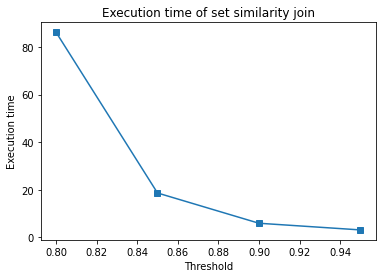

In [25]:
plt.plot(Ts, execution_time, linestyle='-', marker='s')

plt.xlabel("Threshold")
plt.ylabel("Execution time")
plt.title("Execution time of set similarity join")
plt.show()